<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_15_kernel_density_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kernel density estimation / Ядрова оцінка густини розподілу

**K**ernel **D**ensity **E**stimation (KDE) is a technique for estimation of probability distribution of the random variable.
Before we had two instruments for that:
* histograms to capture empirical frequencies to approximate underlying probability distribution;
* guessing a family of probability distributions that the data probably follows and estimating parameters (using MLE) of a most fit of these distributions (parametric pdf estimation).

KDE is another option for us. It can be seen as an extension ("smoothing") of the histogram technique.

#Motivating KDE: Histograms

Have you ever looked at histogram of samples drawn from a random variable with a known distribution and cringed how "inaccurate" that histogram was?

<br>
<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/galton_board.jpg" width="400px" />

<br>

Well, although histograms are useful and widely used it's also true that

$$
\text{Histograms are trickier than they seem.}
$$

First, you should sample hundred of thousands times in order the histogram relatively closely resemble the underlying distribution.
Second, the bins sizes and location could be chosen in many ways. This can drastically change the overall shape of the histogram.

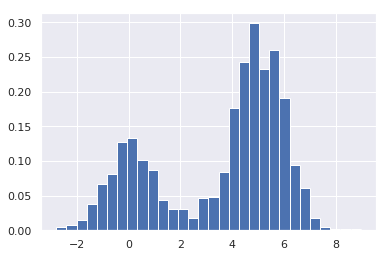

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_data(N, f=0.3, rseed=1):
  rand = np.random.RandomState(rseed)
  x = rand.randn(N)
  x[int(f * N):] += 5
  return x

x = make_data(1000)
hist = plt.hist(x, bins=30, density=True)

In [0]:
# histogram is normed = area equa to 1
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

The issue is that depending on the bins the histograms may have different *qualitative* features. Consider this.

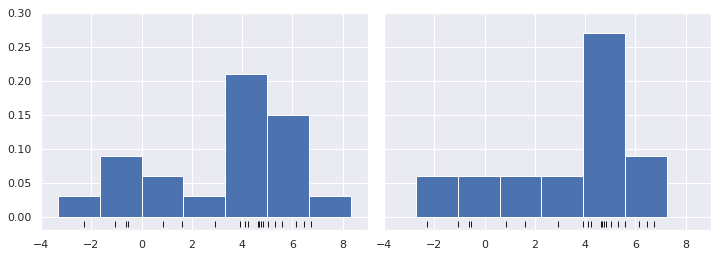

In [0]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True, subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
  ax[i].hist(x, bins=bins + offset, density=True)
  ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
  


So it the underlying distribution bimodal or unimodal?
Please take a look at  [these](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28) animations of histograms tricky behavior.

---

**Sidenote** 

---

On the above picture we have used **a rug plot** -- a plot of data for a single quantitative variable, displayed as marks along an axis. As such it is analogous to a histogram with zero-width bins, or a one-dimensional scatter plot.
Rug plots are often used in combination with two-dimensional scatter plots by placing a rug plot of the x values of the data along the x-axis, and similarly for the y values. This is the origin of the term "rug plot", as these rug plots with perpendicular markers look like tassels along the edges of the rectangular "rug" of the scatter plot.

---

We can try to solve the problem with the ambiguity of the bin choice by the following idea.
You can rethink histogram as square blocks stacked on each other. Each block represents one point of data. If several datapoints are contained within one bin their blocks are placed one at the top of the other.

In [0]:
#@title Varying bin size

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import minimize


Nbins = 10
x_min, x_max = 4.0, 10.0
y_min, y_max = 0.0, 1.0
x_ = np.array([93.5,93,60.8,94.5,82,87.5,91.5,99.5,86,93.5,92.5,78,76,69,94.5,89.5,92.8,78,65.5,98,98.5,92.3,95.5,76,91,95,61.4,96,90]) * 0.1 - 1.0
y_ = np.array([0.0] * x_.shape[0])


fig = dict(
    layout = dict(
        width=600, height=600, autosize=False,
        showlegend = False,
        xaxis1 = {'domain': [0.0, 1.0], 'range': [x_min, x_max]},
        yaxis1 = {'domain': [0.0, 1.0], 'range': [y_min, y_max]},
        title  = 'Binning',
        margin = {'t': 50, 'b': 50, 'l': 50, 'r': 50},
        updatemenus = [{'buttons': [{'args': [[k for k in range(Nbins)],
                                              {'frame': {'duration': 500.0, 'redraw': True},
                                               'fromcurrent': False, 'transition': {'duration': 0, 'easing': 'linear'}}],
                                     'label': 'Play',
                                     'method': 'animate'},
                                    {'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                                       'mode': 'immediate',
                                                       'transition': {'duration': 0}}
                                              ],
                                     'label': 'Pause',
                                     'method': 'animate'
                                     }
                                    ],
                        'direction': 'left',
                        'pad': {'r': 10, 't': 85},
                        'showactive': True,
                        'type': 'buttons', 'x': 0.1, 'y': 0, 'xanchor': 'right', 'yanchor': 'top'}],
        sliders = [{'yanchor': 'top',
                    'xanchor': 'left',
                    'currentvalue': {'font': {'size': 16}, 'prefix': 'Bins: ', 'visible': True, 'xanchor': 'right'},
                    'transition': {'duration': 0.0},
                    'pad': {'b': 10, 't': 50},
                    'len': 0.9,
                    'x': 0.1,
                    'y': 0,
                    'steps': [{'args': [[k], {'frame': {'duration': 500.0, 'easing': 'linear', 'redraw': True},
                                              'transition': {'duration': 0, 'easing': 'linear'}}
                                        ],
                               'label': k+1,
                               'method': 'animate'} for k in range(Nbins)
                    ]}]
    ),
    data = [
        {'type': 'histogram', 'name': 'f2', 'x': x_, 'opacity': 0.8, 
         'xbins': {'start': x_min, 'end': x_max, 'size': (x_max - x_min)},
         'histnorm': 'probability'},
        {'type': 'scatter', 'name': 's2', 'x': x_, 'y': y_, 'mode': 'markers' }
    ],
    frames=[
        {'name': str(k),
         'data': [
           {'type': 'histogram', 'name': 'f2', 'x': x_, 
            'xbins': {'start': x_min, 'end': x_max, 'size': (x_max - x_min)/(k+1)}, 'autobinx': False, 
            'histnorm': 'probability', 'opacity': 0.8},
           {'type': 'scatter', 'name': 's2', 'x': x_, 'y': y_, 'mode': 'markers' }
         ]} for k in range(Nbins) ]
)
#plot(fig, auto_open=False)
f = go.Figure(fig)
f.show()

In [0]:
#@title Moving points


from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import minimize


Nbins = 10
x_min, x_max = 4.0, 10.0
y_min, y_max = 0.0, 1.0
x_ = np.array([93.5,93,60.8,94.5,82,87.5,91.5,99.5,86,93.5,92.5,78,76,69,94.5,89.5,92.8,78,65.5,98,98.5,92.3,95.5,76,91,95,61.4,96,90]) * 0.1 - 1.0
y_ = np.array([0.0] * x_.shape[0])

fig = dict(
    layout = dict(
        width=600, height=600, autosize=False,
        showlegend = False,
        xaxis1 = {'domain': [0.0, 1.0], 'range': [x_min, x_max]},
        yaxis1 = {'domain': [0.0, 1.0], 'range': [y_min, y_max]},
        title  = 'Binning',
        margin = {'t': 50, 'b': 50, 'l': 50, 'r': 50},
        updatemenus = [{'buttons': [{'args': [[k for k in range(Nbins)],
                                              {'frame': {'duration': 500.0, 'redraw': True},
                                               'fromcurrent': False, 'transition': {'duration': 0, 'easing': 'linear'}}],
                                     'label': 'Play',
                                     'method': 'animate'},
                                    {'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                                       'mode': 'immediate',
                                                       'transition': {'duration': 0}}
                                              ],
                                     'label': 'Pause',
                                     'method': 'animate'
                                     }
                                    ],
                        'direction': 'left',
                        'pad': {'r': 10, 't': 85},
                        'showactive': True,
                        'type': 'buttons', 'x': 0.1, 'y': 0, 'xanchor': 'right', 'yanchor': 'top'}],
        sliders = [{'yanchor': 'top',
                    'xanchor': 'left',
                    'currentvalue': {'font': {'size': 16}, 'prefix': 'Shift x 10: ', 'visible': True, 'xanchor': 'right'},
                    'transition': {'duration': 0.0},
                    'pad': {'b': 10, 't': 50},
                    'len': 0.9,
                    'x': 0.1,
                    'y': 0,
                    'steps': [{'args': [[k], {'frame': {'duration': 500.0, 'easing': 'linear', 'redraw': True},
                                              'transition': {'duration': 0, 'easing': 'linear'}}
                                        ],
                               'label': k+1,
                               'method': 'animate'} for k in range(Nbins)
                    ]}]
    ),
    data = [
        {'type': 'histogram', 'name': 'f2', 'x': x_, 'opacity': 0.8, 
         'xbins': {'start':x_min, 'end': x_max, 'size': 0.5}, 'autobinx': False,
         'histnorm': 'probability'},
        {'type': 'scatter', 'name': 's2', 'x': x_, 'y': y_, 'mode': 'markers' }
    ],
    frames=[
        {'name': str(k),
         'data': [
           {'type': 'histogram', 'name': 'f2', 'x': x_ + k * 0.1, 
            'xbins': {'start':x_min, 'end': x_max, 'size': 0.5}, 'autobinx': False, 
            'histnorm': 'probability', 'opacity': 0.8},
           {'type': 'scatter', 'name': 's2', 'x': x_ + k * 0.1, 'y': y_, 'mode': 'markers' }
         ]} for k in range(Nbins) ]
)
#plot(fig, auto_open=False)
f = go.Figure(fig)
f.show()

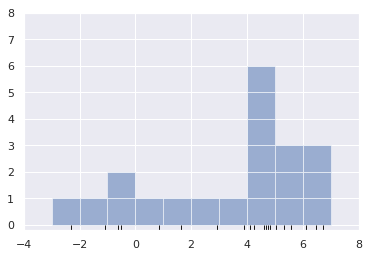

In [0]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
  for i in range(count):
    ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

But what if we placed each block so its center is just below the point it represents.

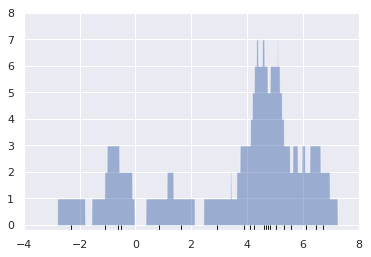

In [0]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8]);

Analytically this can be seen as if we have placed a "square" function (kernel) centered at each point and then we have summed all the functions up.



In [6]:
#@title ##Kernel
%%html

<svg width="110mm" height="120mm" version="1.1" viewBox="0 0 126.08 131.88" xmlns="http://www.w3.org/2000/svg" xmlns:ns0="http://www.iki.fi/pav/software/textext/">
 <defs>
  <marker id="Arrow1Mstart" overflow="visible" orient="auto">
   <path transform="matrix(.4 0 0 .4 4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".58937" fill-rule="evenodd" stroke="#000" stroke-opacity=".58937" stroke-width="1pt"/>
  </marker>
  <marker id="Arrow1Mend" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".58454" fill-rule="evenodd" stroke="#000" stroke-opacity=".58454" stroke-width="1pt"/>
  </marker>
  <marker id="c" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".58454" fill-rule="evenodd" stroke="#000" stroke-opacity=".58454" stroke-width="1pt"/>
  </marker>
  <marker id="d" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".58454" fill-rule="evenodd" stroke="#000" stroke-opacity=".58454" stroke-width="1pt"/>
  </marker>
  <marker id="b" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="a" overflow="visible" orient="auto">
   <path transform="matrix(.4 0 0 .4 4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".58937" fill-rule="evenodd" stroke="#000" stroke-opacity=".58937" stroke-width="1pt"/>
  </marker>
 </defs>
 <g transform="translate(7.3691 -24.397)">
  <path d="m-5.7923 76.52h122.27" fill="none" marker-end="url(#Arrow1Mend)" stroke="#000" stroke-opacity=".58454" stroke-width=".35"/>
  <circle cx="39.539" cy="150.06" r="1.4746" fill="#f00"/>
  <circle cx="61.45" cy="149.93" r="1.4582" fill="#00f"/>
  <g fill="none">
   <path d="m-1.9312 149.88h25.951v-23.833h31.645v23.916l29.99 0.0165" stroke="#f00" stroke-dasharray="1.458, 0.486" stroke-opacity=".86957" stroke-width=".486"/>
   <path d="m19.409 150.13h25.951v-23.833h31.645v23.916l29.99 0.0165" stroke="#0000f9" stroke-dasharray="1.458, 0.486" stroke-opacity=".74879" stroke-width=".486"/>
   <g stroke="#000" stroke-width=".7">
    <path d="m0.048707 149.52 23.69 0.0444v-23.882"/>
    <path d="m77.288 149.68h19.306"/>
    <path d="m77.288 149.68v-24.093"/>
    <path d="m45.307 125.77-3e-3 -23.684h10.348v23.639"/>
    <path d="m23.647 125.68h21.623"/>
    <path d="m55.559 125.73h21.6"/>
   </g>
  </g>
  <circle cx="52.755" cy="76.585" r="1.4746" fill="#f00"/>
  <g fill="none">
   <path d="m11.285 76.405h25.951v-23.833h31.645v23.916l29.99 0.01653" stroke="#f00" stroke-opacity=".86957" stroke-width=".736"/>
   <g stroke="#000">
    <g stroke-opacity=".4058">
     <g stroke-width=".3503">
      <path d="m45.56 128.37 2.2707-1.8537"/>
      <path d="m45.459 129.33 3.3385-2.7253"/>
      <path d="m45.509 130.17 4.4519-3.6342"/>
      <path d="m45.393 127.53 1.5758-1.2864"/>
      <path d="m45.437 131.16 5.6472-4.61"/>
      <path d="m45.529 131.99 6.7304-5.4942"/>
      <path d="m45.563 132.82 7.7441-6.3217"/>
      <path d="m45.578 133.68 8.7833-7.17"/>
      <path d="m45.619 134.53 9.8669-8.0546"/>
      <path d="m45.548 135.44 10.004-8.1667"/>
      <path d="m45.57 136.25 9.8669-8.0546"/>
      <path d="m45.553 137.15 9.8669-8.0546"/>
     </g>
     <path d="m45.502 138.08 9.964-8.1339" stroke-width=".35374"/>
     <g stroke-width=".3503">
      <path d="m45.541 149.57 9.8669-8.0546"/>
      <path d="m45.908 150.1 9.5152-7.7675"/>
      <path d="m45.487 138.95 10.022-8.1814"/>
      <path d="m45.455 139.87 10.139-8.2765"/>
      <path d="m45.583 140.59 9.8669-8.0546"/>
      <path d="m45.505 141.49 9.8669-8.0546"/>
      <path d="m45.546 142.25 9.8669-8.0546"/>
      <path d="m45.546 143.06 9.8669-8.0546"/>
      <path d="m45.525 143.87 10.004-8.1667"/>
      <path d="m45.57 144.64 9.8669-8.0546"/>
      <path d="m45.572 145.38 9.8669-8.0546"/>
      <path d="m45.6 146.18 9.8669-8.0546"/>
      <path d="m45.485 147.08 9.8669-8.0546"/>
      <path d="m45.485 147.92 9.8669-8.0546"/>
      <path d="m45.403 148.82 9.8669-8.0546"/>
      <path d="m46.78 150.25 8.6825-7.0878"/>
      <path d="m47.793 150.26 7.6702-6.2614"/>
      <path d="m48.87 150.24 6.6817-5.4544"/>
      <path d="m49.911 150.23 5.6272-4.5936"/>
      <path d="m50.983 150.21 4.4381-3.6229"/>
      <path d="m52.009 150.26 3.4521-2.8181"/>
      <path d="m53.179 150.19 2.2953-1.8737"/>
      <path d="m54.41 150.17 1.207-0.9853"/>
     </g>
    </g>
    <g stroke-opacity=".58454" stroke-width=".35">
     <path d="m1.2782 83.182v-58.095" marker-end="url(#c)"/>
     <path d="m-7.3691 149.88h125.32" marker-end="url(#d)"/>
     <path d="m1.1527 156.27v-62.965" marker-end="url(#b)"/>
    </g>
   </g>
  </g>
  <g transform="matrix(1.5 0 0 -1.5 -395.64 1112.4)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" ns0:preamble="default_packages.tex" ns0:text="$$overlap$$\n" xml:space="preserve"><g fill-opacity=".62802" stroke-width="0"><path d="m312.28 666.68v0.07l-3e-3 0.0332-0.016 0.0664-0.016 0.059-0.0222 0.059-0.0147 0.0258-0.0111 0.0258-0.0147 0.0258-0.037 0.0442-0.0147 0.0221-0.0406 0.0406-0.0442 0.037-0.0221 0.0147-0.0258 0.0147-0.0221 0.0147-0.0259 0.0111-0.0258 0.0111-0.0295 0.0111-0.0258 8e-3 -0.059 0.016-0.0885 9e-3h-0.0295c-0.49453 0-0.98536-0.52037-0.98536-1.0407 0-0.36168 0.24357-0.62 0.58678-0.62l3e-3 0.0812c-0.15869 0-0.32107 0.11441-0.32107 0.39858 0 0.18083 0.096 0.57571 0.21405 0.76392 0.18452 0.28048 0.39488 0.33584 0.49821 0.33584 0.21406 0 0.32476-0.17715 0.32476-0.39488 0-0.14393-0.0738-0.52773-0.21404-0.76762-0.12918-0.21037-0.33215-0.33584-0.50191-0.33584l-3e-3 -0.0812c0.49084 0 0.98537 0.5056 0.98537 1.0407z"/><path d="m314.06 667.04v0.0572l-3e-3 8e-3v0.0227l-6e-3 0.0294-6e-3 0.022-3e-3 0.0111-8e-3 0.0111-6e-3 0.022-8e-3 8e-3 -3e-3 8e-3 -0.016 0.016-3e-3 8e-3 -8e-3 8e-3 -8e-3 3e-3 -0.011 0.011-0.024 9e-3h-8e-3l-8e-3 3e-3h-8e-3l-3e-3 3e-3h-0.024c-0.0923 0-0.17714-0.0959-0.17714-0.17714 0-0.0443 0.0147-0.0664 0.059-0.10703 0.0738-0.0738 0.12178-0.16977 0.12178-0.30262 0-0.155-0.22142-0.99273-0.6532-0.99273-0.18823 0-0.2731 0.12916-0.2731 0.31737 0 0.20667 0.0996 0.47238 0.21405 0.77869 0.0258 0.0628 0.0443 0.11441 0.0443 0.18452 0 0.16239-0.1181 0.29894-0.30262 0.29894-0.3469 0-0.48715-0.53143-0.48715-0.56464 0-0.0369 0.0369-0.0369 0.0443-0.0369 0.0369 0 0.0406 8e-3 0.059 0.0664 0.10703 0.36905 0.26572 0.45393 0.37275 0.45393 0.0295 0 0.0923 0 0.0923-0.11809 0-0.0886-0.0368-0.18822-0.0627-0.25466-0.16238-0.42439-0.21036-0.59416-0.21036-0.75285 0-0.39489 0.32476-0.45393 0.49452-0.45393 0.61632 0 0.82667 1.2142 0.82667 1.4024z"/><path d="m314.94 666.53h0.1217l0.0185 3e-3h0.037l0.0185 3e-3h0.0185l0.0369 3e-3 0.0406 3e-3 0.1218 0.024 0.0369 8e-3 0.0221 8e-3 0.0184 3e-3 0.037 0.016 0.0185 3e-3 0.0147 8e-3c0.25833 0.1107 0.27679 0.32845 0.27679 0.38011 0 0.15869-0.14024 0.31001-0.39488 0.31001v-0.0812c0.17344 0 0.27309-0.10702 0.27309-0.22881 0-0.38381-0.58679-0.38381-0.73809-0.38381h-0.15131c0.14392 0.55726 0.52404 0.61262 0.61631 0.61262v0.0812c-0.40596 0-0.96323-0.35429-0.96323-0.99644 0-0.37642 0.21775-0.66428 0.57941-0.66428 0.52405 0 0.83405 0.38749 0.83405 0.43178 0 0.0221-0.0221 0.048-0.0443 0.048-0.0185 0-0.0258-8e-3 -0.0479-0.0368-0.29154-0.36167-0.69013-0.36167-0.73441-0.36167-0.28786 0-0.32107 0.30631-0.32107 0.42441 0 0.0443 3e-3 0.15869 0.0591 0.38381z"/><path d="m316.29 665.9v-8e-3l-3e-3 -3e-3v-0.011l-3e-3 -0.011-3e-3 -0.0147v-0.0111l-3e-3 -0.011-6e-3 -0.0222v-0.011l-3e-3 -8e-3v-0.011l-3e-3 -3e-3v-0.017l-3e-3 -3e-3v-9e-3c0-0.0664 0.0517-0.0996 0.10703-0.0996 0.0443 0 0.11072 0.0295 0.13656 0.10333 8e-3 0.0147 0.13285 0.51299 0.14762 0.5794 0.0295 0.1218 0.0959 0.37644 0.11808 0.47608 0.0147 0.048 0.1181 0.22143 0.20299 0.29893 0.0295 0.0258 0.13654 0.12178 0.29523 0.12178 0.096 0 0.15131-0.0443 0.155-0.0443-0.1107-0.0185-0.19191-0.10702-0.19191-0.19928 0-0.0591 0.0406-0.12917 0.14025-0.12917 0.0996 0 0.20297 0.0848 0.20297 0.21406 0 0.12915-0.11809 0.23988-0.30631 0.23988-0.23988 0-0.40226-0.18083-0.46869-0.28049-0.0295 0.16238-0.16238 0.28049-0.33583 0.28049-0.16977 0-0.23989-0.14393-0.2731-0.21036-0.0664-0.12179-0.11441-0.34322-0.11441-0.35428 0-0.0369 0.0368-0.0369 0.0443-0.0369 0.0368 0 0.0406 3e-3 0.0627 0.0848 0.0627 0.25833 0.13655 0.43547 0.2694 0.43547 0.0627 0 0.11441-0.0294 0.11441-0.16607 0-0.0775-0.0111-0.11808-0.059-0.30999z"/><path d="m318.68 668.18v6e-3l-3e-3 3e-3v6e-3h-3e-3v3e-3l-3e-3 3e-3h-3e-3v3e-3h-3e-3v3e-3h-6e-3v3e-3h-0.018c-0.0849 0-0.35429-0.0295-0.45025-0.0332-0.0295-3e-3 -0.07-8e-3 -0.07-0.0775 0-0.0406 0.0369-0.0406 0.0922-0.0406 0.17714 0 0.18083-0.0332 0.18083-0.0627l-0.0111-0.0738-0.46131-1.8342c-0.0111-0.0406-0.0221-0.0664-0.0221-0.12547 0-0.20668 0.16239-0.33583 0.33585-0.33583 0.12178 0 0.21404 0.0738 0.27678 0.20666 0.0664 0.13656 0.11072 0.3506 0.11072 0.35798 0 0.0369-0.0332 0.0369-0.0443 0.0369-0.0369 0-0.0406-0.0147-0.0517-0.0664-0.0627-0.23991-0.13285-0.45394-0.28048-0.45394-0.11072 0-0.11072 0.11809-0.11072 0.16976 0 0.0849 3e-3 0.10333 0.0221 0.17345z"/><path d="m320.27 667.06-8e-3 0.0147-8e-3 0.0111-8e-3 0.0147-3e-3 0.0111-8e-3 0.011-0.0111 0.0111-8e-3 0.0111-8e-3 0.011-8e-3 0.0111-8e-3 0.011-0.0111 8e-3 -8e-3 0.0111-0.0111 8e-3 -0.0191 0.0191-0.0555 0.04-0.0111 3e-3 -0.0111 8e-3 -0.0147 3e-3 -0.011 3e-3 -0.0147 3e-3 -0.0111 3e-3 -0.0294 6e-3h-0.0147l-0.0147 3e-3h-0.0294c-0.43179 0-0.88572-0.53881-0.88572-1.0739 0-0.34321 0.20298-0.58678 0.48714-0.58678l8e-3 0.0812c-0.18453 0-0.2325 0.20297-0.2325 0.34321 0 0.18452 0.1144 0.63477 0.19928 0.80453 0.11441 0.21404 0.28048 0.3506 0.4281 0.3506 0.23988 0 0.29154-0.29893 0.29154-0.32108 0-0.0221-8e-3 -0.0443-0.0111-0.0627l-0.18453-0.71965c-0.0185-0.0664-0.0185-0.0738-0.0738-0.13654-0.16238-0.1993-0.31368-0.25835-0.41701-0.25835l-8e-3 -0.0812c0.0738 0 0.25833 0.0147 0.47975 0.27678 0.0295-0.15501 0.1587-0.27678 0.33584-0.27678 0.12916 0 0.21405 0.0849 0.2731 0.20297 0.059 0.13286 0.10702 0.35428 0.10702 0.36167 0 0.0368-0.0333 0.0368-0.0407 0.0368-0.0406 0-0.0406-0.0147-0.0553-0.0664-0.059-0.23988-0.12548-0.45392-0.2768-0.45392-0.0996 0-0.11071 0.096-0.11071 0.16976 0 0.0812 8e-3 0.10702 0.0479 0.2694 0.0406 0.155 0.048 0.19191 0.0812 0.32845l0.13285 0.51667c0.0258 0.0996 0.0258 0.10702 0.0258 0.12178 0 0.0627-0.0443 0.0997-0.10703 0.0997-0.0886 0-0.14392-0.0812-0.155-0.16239z"/><path d="m321 665.23v-0.011l-3e-3 -0.0111-3e-3 -0.011-3e-3 -0.0111v-8e-3l-3e-3 -0.0111-3e-3 -8e-3v-8e-3l-6e-3 -0.016-3e-3 -3e-3 -3e-3 -8e-3 -3e-3 -3e-3 -3e-3 -8e-3 -6e-3 -6e-3 -8e-3 -3e-3 -3e-3 -3e-3 -8e-3 -3e-3 -3e-3 -3e-3 -8e-3 -3e-3h-8e-3l-8e-3 -3e-3h-0.011l-8e-3 -3e-3h-0.0251l-8e-3 -3e-3h-0.0571c-0.0443 0-0.0812 0-0.0812-0.0701 0-0.0295 0.0147-0.0443 0.048-0.0443 0.096 0 0.20298 0.0111 0.30631 0.0111 0.12178 0 0.24726-0.0111 0.36536-0.0111 0.0185 0 0.0664 0 0.0664 0.0738 0 0.0406-0.0369 0.0406-0.0886 0.0406-0.18452 0-0.18452 0.0258-0.18452 0.059 0 0.0443 0.155 0.64214 0.18083 0.73441 0.048-0.10703 0.15132-0.2362 0.33952-0.2362l-3e-3 0.0812c-0.24357 0-0.29154 0.30262-0.29154 0.32476 0 8e-3 0 0.0147 0.011 0.059l0.18083 0.71964c0.0258 0.0996 0.12548 0.20297 0.19191 0.25833 0.12916 0.11072 0.23249 0.13656 0.29523 0.13656 0.14763 0 0.23619-0.12918 0.23619-0.34322 0-0.21775-0.12178-0.63846-0.18821-0.77869-0.12548-0.25465-0.29893-0.37644-0.43548-0.37644l3e-3 -0.0812c0.42441 0 0.88572 0.53511 0.88572 1.0739 0 0.34692-0.21037 0.58679-0.49083 0.58679-0.18084 0-0.35798-0.13286-0.47976-0.2731-0.0369 0.19561-0.19561 0.2731-0.33215 0.2731-0.16976 0-0.23988-0.14392-0.2731-0.21035-0.0664-0.12179-0.11439-0.34322-0.11439-0.35429 0-0.0369 0.0369-0.0369 0.0443-0.0369 0.0369 0 0.0406 3e-3 0.0627 0.0848 0.0627 0.25832 0.13656 0.43547 0.26942 0.43547 0.0627 0 0.11441-0.0295 0.11441-0.16607 0-0.0848-0.0111-0.12547-0.0258-0.18822z"/></g><g stroke="#000" stroke-miterlimit="10.433"><path d="m299.74 655.46 14.593 8.7932" fill="none" marker-start="url(#Arrow1Mstart)" stroke-opacity=".58937" stroke-width=".44333"/><g id="content" transform="matrix(.89381 0 0 -.89381 -99.427 953.03)" fill-opacity=".66184" fill-rule="evenodd" stroke-width="0" ns0:preamble="default_packages.tex" ns0:text="$$\\text{Kernel}$$\n" xml:space="preserve"><path d="m474.09 264.31 0.66966-0.64348c0.0299-0.0299 0.2282-0.22073 0.53124-0.22446v-0.11598c-0.0973 0.015-0.217 0.015-0.318 0.015-0.13468 0-0.34793 0-0.47138-0.015v0.11598c0.1459 4e-3 0.16835 0.0898 0.16835 0.12345 0 0.0599-0.0336 0.0973-0.0673 0.12346l-1.1672 1.1111v-1.1822c0-0.13468 7e-3 -0.17583 0.29555-0.17583h0.0898v-0.11598c-0.13094 0.015-0.40778 0.015-0.54995 0.015-0.13842 0-0.419 0-0.54994-0.015v0.11598h0.0898c0.28806 0 0.29554 0.0412 0.29554 0.17583v1.9566c0 0.13468-7e-3 0.17584-0.29554 0.17584h-0.0898v0.11597c0.13094-0.0113 0.40778-0.0113 0.54994-0.0113 0.13842 0 0.41901 0 0.54995 0.0113v-0.11597h-0.0898c-0.28806 0-0.29555-0.0412-0.29555-0.17584v-0.64721l0.43397-0.41153 0.67341 0.99888c0.0224 0.0336 0.0599 0.0785 0.0599 0.12346 0 0.11224-0.14591 0.11224-0.22073 0.11224v0.11597c0.13094-0.0113 0.38908-0.0113 0.53124-0.0113 0.13093 0 0.2731 4e-3 0.43023 0.0113v-0.11597c-0.20202 0-0.28058-0.015-0.39282-0.17958z"/><path d="m475.91 265 4e-3 -0.0748c0.0224-0.55369 0.33296-0.64722 0.46016-0.64722 0.38534 0 0.42275 0.50131 0.42275 0.64722h-0.88291l-4e-3 0.0748h1.04c0.0823 0 0.0935 0 0.0935-0.0748 0-0.37037-0.20202-0.72952-0.66965-0.72952-0.43023 0-0.77441 0.38159-0.77441 0.84924 0 0.49756 0.39281 0.85671 0.8193 0.85671 0.45642 0 0.62476-0.41153 0.62476-0.48261 0-0.0374-0.0299-0.0449-0.0486-0.0449-0.0337 0-0.0412 0.0224-0.0486 0.0524-0.13094 0.38158-0.46764 0.38158-0.50506 0.38158-0.18705 0-0.3367-0.11223-0.419-0.24691-0.11223-0.17957-0.11223-0.42648-0.11223-0.56117z"/><path d="m477.77 264.63v-0.40779l-0.51627 0.0412v0.11598c0.25814 0 0.28807 0.0262 0.28807 0.20575v0.99888c0 0.16461-0.0412 0.16461-0.28807 0.16461v0.11597c0.14217-4e-3 0.31799-0.0113 0.42275-0.0113 0.14964 0 0.32547 0 0.47512 0.0113v-0.11597h-0.0785c-0.27684 0-0.28433-0.0412-0.28433-0.17583v-0.56865c0-0.37037 0.15713-0.69959 0.44145-0.69959 0.0262 0 0.0336 0 0.0412 4e-3 -0.0113 4e-3 -0.0861 0.0486-0.0861 0.14216 0 0.10475 0.0785 0.16087 0.16087 0.16087 0.0673 0 0.16086-0.0449 0.16086-0.16461 0-0.11597-0.11598-0.22447-0.27684-0.22447-0.27311 0-0.40778 0.24692-0.46016 0.40779z"/><path d="m479.02 264.58v0.99887c0 0.16462-0.0412 0.16462-0.2918 0.16462v0.11597c0.13094-4e-3 0.32173-0.0113 0.419-0.0113 0.0973 0 0.29181 7e-3 0.419 0.0113v-0.11597c-0.25064 0-0.2918 0-0.2918-0.16462v-0.68462c0-0.38907 0.26562-0.59484 0.50505-0.59484 0.2357 0 0.27684 0.19828 0.27684 0.41153v0.86793c0 0.16462-0.0412 0.16462-0.2918 0.16462v0.11597c0.13094-4e-3 0.32173-0.0113 0.42274-0.0113 0.0973 0 0.29181 7e-3 0.41527 0.0113v-0.11597c-0.19454 0-0.28433 0-0.28807-0.11224v-0.70707c0-0.32174 0-0.43772-0.11598-0.56865-0.0523-0.0636-0.17582-0.13843-0.39281-0.13843-0.2731 0-0.44894 0.16087-0.55368 0.38909v-0.38909l-0.52376 0.0412v0.11598c0.26188 0 0.2918 0.0262 0.2918 0.20575z"/><path d="m481.09 265 4e-3 -0.0748c0.0224-0.55369 0.33671-0.64722 0.46391-0.64722 0.38159 0 0.419 0.50131 0.419 0.64722h-0.88291l-4e-3 0.0748h1.04c0.0823 0 0.0935 0 0.0935-0.0748 0-0.37037-0.20202-0.72952-0.66592-0.72952-0.43397 0-0.77815 0.38159-0.77815 0.84924 0 0.49756 0.39281 0.85671 0.82304 0.85671 0.45268 0 0.62103-0.41153 0.62103-0.48261 0-0.0374-0.0299-0.0449-0.0486-0.0449-0.0336 0-0.0412 0.0224-0.0486 0.0524-0.13094 0.38158-0.4639 0.38158-0.50131 0.38158-0.18706 0-0.3367-0.11223-0.42275-0.24691-0.11223-0.17957-0.11223-0.42648-0.11223-0.56117z"/><path d="m483 263.29-0.53872 0.0374v0.11598c0.26188 0 0.29181 0.0262 0.29181 0.20951v1.9342c0 0.16461-0.0412 0.16461-0.29181 0.16461v0.11597c0.12346-4e-3 0.32174-0.0113 0.41526-0.0113 0.0935 0 0.2731 7e-3 0.41152 0.0113v-0.11597c-0.24691 0-0.28806 0-0.28806-0.16461z"/></g><path d="m311.4 705.35c6.257 0.98125 11.832 2.9168 14.593 8.7932" fill="none" marker-start="url(#a)" stroke-opacity=".58937" stroke-width=".44333"/></g><g><g transform="matrix(.46672 0 0 .46672 197.78 362.67)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" stroke-width="1.2286" ns0:preamble="default_packages.tex" ns0:text="$$x$$\n" xml:space="preserve"><path d="m306.11 698.17v0.03l0.03 0.09 0.02 0.08 0.01 0.05 0.02 0.04 0.01 0.05 0.02 0.05 0.02 0.04 0.04 0.1 0.03 0.05 0.02 0.05 0.09 0.15 0.04 0.04 0.03 0.05 0.16 0.16 0.1 0.06 0.03 0.01 0.02 0.01 0.03 0.01 0.02 0.01 0.09 0.03h0.03l0.03 0.01h0.1c0.04 0 0.28 0 0.49-0.13-0.28-0.05-0.48-0.3-0.48-0.53 0-0.16 0.12-0.35 0.38-0.35 0.22 0 0.54 0.18 0.54 0.58 0 0.51-0.59 0.65-0.92 0.65-0.58 0-0.93-0.53-1.05-0.75-0.25 0.65-0.79 0.75-1.08 0.75-1.04 0-1.6-1.28-1.6-1.53 0-0.1 0.1-0.1 0.11-0.1 0.09 0 0.12 0.02 0.14 0.11 0.33 1.05 0.99 1.3 1.33 1.3 0.19 0 0.54-0.09 0.54-0.66 0-0.31-0.17-0.98-0.54-2.37-0.16-0.61-0.51-1.03-0.95-1.03-0.06 0-0.29 0-0.49 0.13 0.24 0.05 0.46 0.26 0.46 0.54 0 0.26-0.22 0.34-0.37 0.34-0.29 0-0.54-0.26-0.54-0.57 0-0.46 0.5-0.66 0.93-0.66 0.66 0 1.02 0.7 1.05 0.76 0.12-0.37 0.48-0.76 1.08-0.76 1.02 0 1.59 1.28 1.59 1.53 0 0.1-0.09 0.1-0.12 0.1-0.09 0-0.11-0.04-0.13-0.11-0.33-1.06-1-1.3-1.32-1.3-0.39 0-0.55 0.32-0.55 0.65 0 0.22 0.06 0.44 0.17 0.88z" stroke-width="0"/></g><g transform="matrix(0 .22283 -.22283 0 318.82 648.93)" fill-opacity=".99517" stroke-width="1.1773"><g transform="matrix(1.5 0 0 1.5 -158.95 -790.54)" fill-opacity=".99517" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" stroke-width="0" ns0:preamble="default_packages.tex" ns0:text="$$\\text{pdf estimate}$$\n" xml:space="preserve"><path d="m280.19 698.91v0.65l-1.43-0.11v-0.31c0.7 0 0.77-0.06 0.77-0.49v-4.65c0-0.45-0.11-0.45-0.77-0.45v-0.31c0.33 0.01 0.85 0.03 1.11 0.03 0.27 0 0.78-0.02 1.13-0.03v0.31c-0.67 0-0.78 0-0.78 0.45v1.76l0.14 0.13c-0.14 0.2-0.14 0.21-0.14 0.41v2.22c0.29 0.5 0.78 0.79 1.29 0.79 0.73 0 1.33-0.87 1.33-1.99 0-1.21-0.69-2.04-1.43-2.04-0.4 0-0.78 0.2-1.05 0.61l-0.14-0.13c0.05-0.16 0.47-0.7 1.23-0.7 1.18 0 2.22 0.97 2.22 2.26 0 1.26-0.97 2.24-2.08 2.24-0.78 0-1.2-0.44-1.4-0.65z"/><path d="m288.08 695.72v-0.66l1.47 0.11v0.31c-0.7 0-0.78 0.07-0.78 0.55v6.03l-1.44-0.1v-0.31c0.7 0 0.78-0.07 0.78-0.56v-2.14c-0.29 0.35-0.72 0.61-1.26 0.61l0.04-0.22c0.35 0 0.77-0.15 1.08-0.59 0.11-0.17 0.11-0.19 0.11-0.37v-2.04c0-0.18 0-0.2-0.11-0.37-0.3-0.47-0.75-0.69-1.18-0.69-0.45 0-0.81 0.26-1.04 0.63-0.26 0.41-0.29 0.98-0.29 1.39 0 0.36 0.02 0.96 0.31 1.41 0.21 0.3 0.58 0.63 1.12 0.63l-0.04 0.22c-1.17 0-2.22-0.97-2.22-2.25 0-1.27 0.98-2.25 2.11-2.25 0.64 0 1.09 0.34 1.34 0.66z"/><path d="m291.57 699.45v1.15c0 0.88 0.48 1.36 0.92 1.36 0.03 0 0.18 0 0.33-0.07-0.12-0.04-0.3-0.17-0.3-0.42 0-0.23 0.16-0.43 0.43-0.43 0.29 0 0.44 0.2 0.44 0.44 0 0.37-0.37 0.69-0.9 0.69-0.7 0-1.55-0.52-1.55-1.58v-1.14h-0.79v-0.31h0.79v-3.22c0-0.44-0.11-0.44-0.78-0.44v-0.31c0.39 0.01 0.86 0.03 1.14 0.03 0.4 0 0.87 0 1.27-0.03v0.31h-0.21c-0.74 0-0.76 0.11-0.76 0.47v3.19h1.14v0.31z"/><path d="m297.29 697.47 0.01 0.2c0.06 1.48 0.9 1.73 1.24 1.73 1.03 0 1.13-1.34 1.13-1.73h-2.37l-0.01-0.2h2.79c0.22 0 0.25 0 0.25 0.2 0 0.99-0.54 1.95-1.79 1.95-1.16 0-2.07-1.02-2.07-2.27 0-1.33 1.04-2.29 2.19-2.29 1.22 0 1.67 1.1 1.67 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.25-1.02-1.35-1.02-0.5 0-0.9 0.3-1.13 0.66-0.3 0.48-0.3 1.14-0.3 1.5z"/><path d="m302.69 697.1 0.02-0.01h0.03l0.03-0.01h0.03l0.03-0.01 0.04-0.01 0.03-0.01 0.08-0.02 0.05-0.02 0.04-0.01 0.04-0.02 0.05-0.02 0.04-0.02 0.05-0.02 0.04-0.03 0.04-0.02 0.04-0.03 0.05-0.03 0.04-0.03 0.03-0.04 0.04-0.04 0.09-0.12 0.02-0.03 0.01-0.02 0.01-0.03 0.01-0.02 0.01-0.03 0.01-0.02 0.02-0.06v-0.03l0.01-0.03v-0.06l0.01-0.03v-0.04c0-0.5-0.35-0.9-1.13-0.9-0.84 0-1.2 0.56-1.39 1.41-0.03 0.13-0.04 0.17-0.14 0.17-0.13 0-0.13-0.07-0.13-0.25v-1.31c0-0.17 0-0.24 0.11-0.24 0.05 0 0.06 0.01 0.25 0.2 0.02 0.02 0.02 0.04 0.2 0.23 0.44-0.42 0.89-0.43 1.1-0.43 1.15 0 1.6 0.67 1.6 1.38 0 0.53-0.29 0.83-0.41 0.95-0.33 0.31-0.72 0.39-1.14 0.47-0.56 0.11-1.23 0.24-1.23 0.82 0 0.34 0.26 0.75 1.12 0.75 1.1 0 1.15-0.89 1.17-1.2 0.01-0.09 0.1-0.09 0.12-0.09 0.13 0 0.13 0.05 0.13 0.24v1c0 0.17 0 0.24-0.11 0.24-0.05 0-0.07 0-0.2-0.12-0.03-0.04-0.13-0.13-0.17-0.16-0.38 0.28-0.79 0.28-0.94 0.28-1.22 0-1.6-0.66-1.6-1.22 0-0.35 0.16-0.63 0.43-0.85 0.32-0.25 0.6-0.31 1.32-0.45z"/><path d="m306.27 699.14h1.43v0.31h-1.43v1.83h-0.25c-0.01-0.81-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.93-1.34 1.29-1.34 0.71 0 0.99 0.71 0.99 1.34v0.57h-0.25v-0.55c0-0.73-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m310.18 699.56-1.39-0.11v-0.31c0.65 0 0.73-0.06 0.73-0.54v-2.68c0-0.44-0.1-0.44-0.77-0.44v-0.31c0.32 0.01 0.86 0.03 1.1 0.03 0.34 0 0.69-0.02 1.03-0.03v0.31c-0.66 0-0.7 0.05-0.7 0.43z"/><path d="m310.22 701.29v0.09l-0.01 0.02v0.03l-0.01 0.03-0.01 0.02-0.01 0.03-0.02 0.04-0.02 0.02-0.01 0.03-0.02 0.02-0.01 0.02-0.02 0.01-0.02 0.02-0.01 0.02-0.02 0.01-0.02 0.02-0.03 0.01-0.02 0.02-0.06 0.03-0.03 0.01h-0.02l-0.03 0.01-0.02 0.01h-0.05l-0.03 0.01h-0.02c-0.31 0-0.53-0.27-0.53-0.53 0-0.27 0.22-0.53 0.53-0.53 0.27 0 0.52 0.21 0.52 0.53z"/><path d="m312.28 698.59v-2.67c0-0.44-0.11-0.44-0.77-0.44v-0.31c0.34 0.01 0.85 0.03 1.12 0.03 0.26 0 0.78-0.02 1.12-0.03v0.31c-0.67 0-0.78 0-0.78 0.44v1.83c0 1.04 0.71 1.59 1.35 1.59 0.63 0 0.73-0.53 0.73-1.1v-2.32c0-0.44-0.1-0.44-0.77-0.44v-0.31c0.35 0.01 0.86 0.03 1.12 0.03s0.78-0.02 1.12-0.03v0.31c-0.67 0-0.78 0-0.78 0.44v1.83c0 1.04 0.71 1.59 1.35 1.59 0.63 0 0.74-0.53 0.74-1.1v-2.32c0-0.44-0.11-0.44-0.78-0.44v-0.31c0.35 0.01 0.86 0.03 1.13 0.03 0.26 0 0.77-0.02 1.11-0.03v0.31c-0.52 0-0.76 0-0.77 0.3v1.89c0 0.86 0 1.17-0.31 1.52-0.14 0.17-0.47 0.37-1.05 0.37-0.84 0-1.28-0.59-1.45-0.97-0.14 0.86-0.87 0.97-1.32 0.97-0.73 0-1.2-0.43-1.48-1.04v1.04l-1.4-0.11v-0.31c0.69 0 0.77-0.07 0.77-0.55z"/><path d="m322.81 695.92v-0.03l0.02-0.08v-0.03l0.01-0.04 0.02-0.04 0.01-0.03 0.01-0.04 0.02-0.04 0.01-0.03 0.02-0.03 0.02-0.04 0.06-0.09 0.03-0.03 0.02-0.03 0.03-0.03 0.03-0.02 0.03-0.03 0.12-0.08 0.04-0.01 0.03-0.02 0.16-0.04h0.09c0.21 0 0.81 0.14 0.81 0.94v0.56h-0.25v-0.56c0-0.57-0.24-0.63-0.35-0.63-0.33 0-0.37 0.44-0.37 0.49v1.99c0 0.42 0 0.81-0.36 1.17-0.39 0.39-0.89 0.55-1.37 0.55-0.82 0-1.5-0.47-1.5-1.12 0-0.3 0.19-0.47 0.45-0.47 0.28 0 0.46 0.2 0.46 0.46 0 0.12-0.05 0.44-0.5 0.46 0.26 0.34 0.75 0.45 1.07 0.45 0.49 0 1.06-0.39 1.06-1.27v-1.57c0-0.94-0.72-1.28-1.17-1.28-0.49 0-0.9 0.35-0.9 0.84 0 0.55 0.42 1.37 2.07 1.43v0.21c-0.51-0.03-1.21-0.06-1.84-0.35-0.74-0.34-0.99-0.86-0.99-1.3 0-0.8 0.96-1.05 1.59-1.05 0.66 0 1.12 0.4 1.31 0.86z"/><path d="m326.19 699.14h1.43v0.31h-1.43v1.83h-0.24c-0.02-0.81-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.92-1.34 1.28-1.34 0.71 0 0.99 0.71 0.99 1.34v0.57h-0.25v-0.55c0-0.73-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m329.45 697.47 0.01 0.2c0.06 1.48 0.9 1.73 1.24 1.73 1.02 0 1.12-1.34 1.12-1.73h-2.36l-0.01-0.2h2.78c0.22 0 0.25 0 0.25 0.2 0 0.99-0.54 1.95-1.78 1.95-1.16 0-2.08-1.02-2.08-2.27 0-1.33 1.05-2.29 2.2-2.29 1.21 0 1.66 1.1 1.66 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.24-1.02-1.34-1.02-0.5 0-0.9 0.3-1.13 0.66-0.3 0.48-0.3 1.14-0.3 1.5z"/></g></g><g transform="matrix(0 .22283 -.22283 0 318.81 604.03)" fill-opacity=".99517" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" stroke-width="1.1773"><g transform="matrix(1.5 0 0 1.5 -158.95 -790.54)" fill-opacity=".99517" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" stroke-width="0" ns0:preamble="default_packages.tex" ns0:text="$$\\text{pdf estimate}$$\n" xml:space="preserve"><path d="m280.19 698.91v0.65l-1.43-0.11v-0.31c0.7 0 0.77-0.06 0.77-0.49v-4.65c0-0.45-0.11-0.45-0.77-0.45v-0.31c0.33 0.01 0.85 0.03 1.11 0.03 0.27 0 0.78-0.02 1.13-0.03v0.31c-0.67 0-0.78 0-0.78 0.45v1.76l0.14 0.13c-0.14 0.2-0.14 0.21-0.14 0.41v2.22c0.29 0.5 0.78 0.79 1.29 0.79 0.73 0 1.33-0.87 1.33-1.99 0-1.21-0.69-2.04-1.43-2.04-0.4 0-0.78 0.2-1.05 0.61l-0.14-0.13c0.05-0.16 0.47-0.7 1.23-0.7 1.18 0 2.22 0.97 2.22 2.26 0 1.26-0.97 2.24-2.08 2.24-0.78 0-1.2-0.44-1.4-0.65z"/><path d="m288.08 695.72v-0.66l1.47 0.11v0.31c-0.7 0-0.78 0.07-0.78 0.55v6.03l-1.44-0.1v-0.31c0.7 0 0.78-0.07 0.78-0.56v-2.14c-0.29 0.35-0.72 0.61-1.26 0.61l0.04-0.22c0.35 0 0.77-0.15 1.08-0.59 0.11-0.17 0.11-0.19 0.11-0.37v-2.04c0-0.18 0-0.2-0.11-0.37-0.3-0.47-0.75-0.69-1.18-0.69-0.45 0-0.81 0.26-1.04 0.63-0.26 0.41-0.29 0.98-0.29 1.39 0 0.36 0.02 0.96 0.31 1.41 0.21 0.3 0.58 0.63 1.12 0.63l-0.04 0.22c-1.17 0-2.22-0.97-2.22-2.25 0-1.27 0.98-2.25 2.11-2.25 0.64 0 1.09 0.34 1.34 0.66z"/><path d="m291.57 699.45v1.15c0 0.88 0.48 1.36 0.92 1.36 0.03 0 0.18 0 0.33-0.07-0.12-0.04-0.3-0.17-0.3-0.42 0-0.23 0.16-0.43 0.43-0.43 0.29 0 0.44 0.2 0.44 0.44 0 0.37-0.37 0.69-0.9 0.69-0.7 0-1.55-0.52-1.55-1.58v-1.14h-0.79v-0.31h0.79v-3.22c0-0.44-0.11-0.44-0.78-0.44v-0.31c0.39 0.01 0.86 0.03 1.14 0.03 0.4 0 0.87 0 1.27-0.03v0.31h-0.21c-0.74 0-0.76 0.11-0.76 0.47v3.19h1.14v0.31z"/><path d="m297.29 697.47 0.01 0.2c0.06 1.48 0.9 1.73 1.24 1.73 1.03 0 1.13-1.34 1.13-1.73h-2.37l-0.01-0.2h2.79c0.22 0 0.25 0 0.25 0.2 0 0.99-0.54 1.95-1.79 1.95-1.16 0-2.07-1.02-2.07-2.27 0-1.33 1.04-2.29 2.19-2.29 1.22 0 1.67 1.1 1.67 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.25-1.02-1.35-1.02-0.5 0-0.9 0.3-1.13 0.66-0.3 0.48-0.3 1.14-0.3 1.5z"/><path d="m302.69 697.1 0.02-0.01h0.03l0.03-0.01h0.03l0.03-0.01 0.04-0.01 0.03-0.01 0.08-0.02 0.05-0.02 0.04-0.01 0.04-0.02 0.05-0.02 0.04-0.02 0.05-0.02 0.04-0.03 0.04-0.02 0.04-0.03 0.05-0.03 0.04-0.03 0.03-0.04 0.04-0.04 0.09-0.12 0.02-0.03 0.01-0.02 0.01-0.03 0.01-0.02 0.01-0.03 0.01-0.02 0.02-0.06v-0.03l0.01-0.03v-0.06l0.01-0.03v-0.04c0-0.5-0.35-0.9-1.13-0.9-0.84 0-1.2 0.56-1.39 1.41-0.03 0.13-0.04 0.17-0.14 0.17-0.13 0-0.13-0.07-0.13-0.25v-1.31c0-0.17 0-0.24 0.11-0.24 0.05 0 0.06 0.01 0.25 0.2 0.02 0.02 0.02 0.04 0.2 0.23 0.44-0.42 0.89-0.43 1.1-0.43 1.15 0 1.6 0.67 1.6 1.38 0 0.53-0.29 0.83-0.41 0.95-0.33 0.31-0.72 0.39-1.14 0.47-0.56 0.11-1.23 0.24-1.23 0.82 0 0.34 0.26 0.75 1.12 0.75 1.1 0 1.15-0.89 1.17-1.2 0.01-0.09 0.1-0.09 0.12-0.09 0.13 0 0.13 0.05 0.13 0.24v1c0 0.17 0 0.24-0.11 0.24-0.05 0-0.07 0-0.2-0.12-0.03-0.04-0.13-0.13-0.17-0.16-0.38 0.28-0.79 0.28-0.94 0.28-1.22 0-1.6-0.66-1.6-1.22 0-0.35 0.16-0.63 0.43-0.85 0.32-0.25 0.6-0.31 1.32-0.45z"/><path d="m306.27 699.14h1.43v0.31h-1.43v1.83h-0.25c-0.01-0.81-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.93-1.34 1.29-1.34 0.71 0 0.99 0.71 0.99 1.34v0.57h-0.25v-0.55c0-0.73-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m310.18 699.56-1.39-0.11v-0.31c0.65 0 0.73-0.06 0.73-0.54v-2.68c0-0.44-0.1-0.44-0.77-0.44v-0.31c0.32 0.01 0.86 0.03 1.1 0.03 0.34 0 0.69-0.02 1.03-0.03v0.31c-0.66 0-0.7 0.05-0.7 0.43z"/><path d="m310.22 701.29v0.09l-0.01 0.02v0.03l-0.01 0.03-0.01 0.02-0.01 0.03-0.02 0.04-0.02 0.02-0.01 0.03-0.02 0.02-0.01 0.02-0.02 0.01-0.02 0.02-0.01 0.02-0.02 0.01-0.02 0.02-0.03 0.01-0.02 0.02-0.06 0.03-0.03 0.01h-0.02l-0.03 0.01-0.02 0.01h-0.05l-0.03 0.01h-0.02c-0.31 0-0.53-0.27-0.53-0.53 0-0.27 0.22-0.53 0.53-0.53 0.27 0 0.52 0.21 0.52 0.53z"/><path d="m312.28 698.59v-2.67c0-0.44-0.11-0.44-0.77-0.44v-0.31c0.34 0.01 0.85 0.03 1.12 0.03 0.26 0 0.78-0.02 1.12-0.03v0.31c-0.67 0-0.78 0-0.78 0.44v1.83c0 1.04 0.71 1.59 1.35 1.59 0.63 0 0.73-0.53 0.73-1.1v-2.32c0-0.44-0.1-0.44-0.77-0.44v-0.31c0.35 0.01 0.86 0.03 1.12 0.03s0.78-0.02 1.12-0.03v0.31c-0.67 0-0.78 0-0.78 0.44v1.83c0 1.04 0.71 1.59 1.35 1.59 0.63 0 0.74-0.53 0.74-1.1v-2.32c0-0.44-0.11-0.44-0.78-0.44v-0.31c0.35 0.01 0.86 0.03 1.13 0.03 0.26 0 0.77-0.02 1.11-0.03v0.31c-0.52 0-0.76 0-0.77 0.3v1.89c0 0.86 0 1.17-0.31 1.52-0.14 0.17-0.47 0.37-1.05 0.37-0.84 0-1.28-0.59-1.45-0.97-0.14 0.86-0.87 0.97-1.32 0.97-0.73 0-1.2-0.43-1.48-1.04v1.04l-1.4-0.11v-0.31c0.69 0 0.77-0.07 0.77-0.55z"/><path d="m322.81 695.92v-0.03l0.02-0.08v-0.03l0.01-0.04 0.02-0.04 0.01-0.03 0.01-0.04 0.02-0.04 0.01-0.03 0.02-0.03 0.02-0.04 0.06-0.09 0.03-0.03 0.02-0.03 0.03-0.03 0.03-0.02 0.03-0.03 0.12-0.08 0.04-0.01 0.03-0.02 0.16-0.04h0.09c0.21 0 0.81 0.14 0.81 0.94v0.56h-0.25v-0.56c0-0.57-0.24-0.63-0.35-0.63-0.33 0-0.37 0.44-0.37 0.49v1.99c0 0.42 0 0.81-0.36 1.17-0.39 0.39-0.89 0.55-1.37 0.55-0.82 0-1.5-0.47-1.5-1.12 0-0.3 0.19-0.47 0.45-0.47 0.28 0 0.46 0.2 0.46 0.46 0 0.12-0.05 0.44-0.5 0.46 0.26 0.34 0.75 0.45 1.07 0.45 0.49 0 1.06-0.39 1.06-1.27v-1.57c0-0.94-0.72-1.28-1.17-1.28-0.49 0-0.9 0.35-0.9 0.84 0 0.55 0.42 1.37 2.07 1.43v0.21c-0.51-0.03-1.21-0.06-1.84-0.35-0.74-0.34-0.99-0.86-0.99-1.3 0-0.8 0.96-1.05 1.59-1.05 0.66 0 1.12 0.4 1.31 0.86z"/><path d="m326.19 699.14h1.43v0.31h-1.43v1.83h-0.24c-0.02-0.81-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.92-1.34 1.28-1.34 0.71 0 0.99 0.71 0.99 1.34v0.57h-0.25v-0.55c0-0.73-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m329.45 697.47 0.01 0.2c0.06 1.48 0.9 1.73 1.24 1.73 1.02 0 1.12-1.34 1.12-1.73h-2.36l-0.01-0.2h2.78c0.22 0 0.25 0 0.25 0.2 0 0.99-0.54 1.95-1.78 1.95-1.16 0-2.08-1.02-2.08-2.27 0-1.33 1.05-2.29 2.2-2.29 1.21 0 1.66 1.1 1.66 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.24-1.02-1.34-1.02-0.5 0-0.9 0.3-1.13 0.66-0.3 0.48-0.3 1.14-0.3 1.5z"/></g></g><g transform="matrix(.46672 0 0 .46672 198.22 313.55)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" stroke-width="1.2286" ns0:preamble="default_packages.tex" ns0:text="$$x$$\n" xml:space="preserve"><path d="m306.11 698.17v0.03l0.03 0.09 0.02 0.08 0.01 0.05 0.02 0.04 0.01 0.05 0.02 0.05 0.02 0.04 0.04 0.1 0.03 0.05 0.02 0.05 0.09 0.15 0.04 0.04 0.03 0.05 0.16 0.16 0.1 0.06 0.03 0.01 0.02 0.01 0.03 0.01 0.02 0.01 0.09 0.03h0.03l0.03 0.01h0.1c0.04 0 0.28 0 0.49-0.13-0.28-0.05-0.48-0.3-0.48-0.53 0-0.16 0.12-0.35 0.38-0.35 0.22 0 0.54 0.18 0.54 0.58 0 0.51-0.59 0.65-0.92 0.65-0.58 0-0.93-0.53-1.05-0.75-0.25 0.65-0.79 0.75-1.08 0.75-1.04 0-1.6-1.28-1.6-1.53 0-0.1 0.1-0.1 0.11-0.1 0.09 0 0.12 0.02 0.14 0.11 0.33 1.05 0.99 1.3 1.33 1.3 0.19 0 0.54-0.09 0.54-0.66 0-0.31-0.17-0.98-0.54-2.37-0.16-0.61-0.51-1.03-0.95-1.03-0.06 0-0.29 0-0.49 0.13 0.24 0.05 0.46 0.26 0.46 0.54 0 0.26-0.22 0.34-0.37 0.34-0.29 0-0.54-0.26-0.54-0.57 0-0.46 0.5-0.66 0.93-0.66 0.66 0 1.02 0.7 1.05 0.76 0.12-0.37 0.48-0.76 1.08-0.76 1.02 0 1.59 1.28 1.59 1.53 0 0.1-0.09 0.1-0.12 0.1-0.09 0-0.11-0.04-0.13-0.11-0.33-1.06-1-1.3-1.32-1.3-0.39 0-0.55 0.32-0.55 0.65 0 0.22 0.06 0.44 0.17 0.88z" stroke-width="0"/></g></g></g>
 </g>
</svg>


This type of kernel is called top hat as it recalls a flat-crowned hat (aka cylinder - another term that is both a hat and a math object). The length of the kernel function has not have to be equal to the height.

In [3]:
#@title ##Top hat
%%html
<svg width="150mm" height="65mm" version="1.1" viewBox="0 0 173.01 80.496" xmlns="http://www.w3.org/2000/svg" xmlns:ns0="http://www.iki.fi/pav/software/textext/" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <marker id="b" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill="#f00" fill-opacity=".61836" fill-rule="evenodd" stroke="#f00" stroke-opacity=".61836" stroke-width="1pt"/>
  </marker>
  <marker id="Arrow1Mend" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="c" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="a" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill="#f00" fill-opacity=".61836" fill-rule="evenodd" stroke="#f00" stroke-opacity=".61836" stroke-width="1pt"/>
  </marker>
 </defs>
 <g transform="translate(-22 -.6002)">
  <image x="22" y="25.989" width="55.108" height="55.108" preserveAspectRatio="none" xlink:href="data:image/jpeg;base64,/9j/4Q61RXhpZgAASUkqAAgAAAAQAAABAwABAAAAgAcAAAEBAwABAAAAgAcAAAIBAwADAAAAzgAA AAMBAwABAAAAAQAAAAYBAwABAAAAAgAAAA8BAgAGAAAA1AAAABABAgAVAAAA2gAAABIBAwABAAAA AQAAABUBAwABAAAAAwAAABoBBQABAAAA7wAAABsBBQABAAAA9wAAABwBAwABAAAAAQAAACgBAwAB AAAAAgAAADEBAgAeAAAA/wAAADIBAgAUAAAAHQEAAGmHBAABAAAANAEAANgDAAAIAAgACABDYW5v bgBDYW5vbiBFT1MgNUQgTWFyayBJSQDAxi0AECcAAMDGLQAQJwAAQWRvYmUgUGhvdG9zaG9wIENT NSBNYWNpbnRvc2gAMjAxNTowMzowNSAxNDozNzo0MQAAAAAYADIBAgAUAAAAWgIAAJqCBQABAAAA bgIAAJ2CBQABAAAAdgIAACKIAwABAAAAAQAAACeIAwABAAAAZAAAAACQBwAEAAAAMDIyMAOQAgAU AAAAfgIAAASQAgAUAAAAkgIAAAGSCgABAAAApgIAAAKSBQABAAAArgIAAASSCgABAAAAtgIAAAaS BQABAAAAvgIAAAeSAwABAAAABQAAAAmSAwABAAAAEAAAAAqSBQABAAAAxgIAAIaSBwAIAQAAzgIA AAGgAwABAAAAAQAAAAKgBAABAAAAgAcAAAOgBAABAAAAgAcAABCiAwABAAAAAgAAAACjBwABAAAA AwAAAAGjBwABAAAAAQAAAAKkAwABAAAAAQAAAAOkAwABAAAAAAAAAAAAAAAyMDE1OjAyOjE5IDEz OjQ0OjQzAAEAAAB9AAAAEAAAAAEAAAAyMDE1OjAyOjE5IDEzOjQ0OjQzADIwMTU6MDI6MTkgMTM6 NDQ6NDMAAAAHAAAAAQAAAAgAAAABAAAAAAABAAAAAAAAAAEAAAAeAAAAAQAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgADAQMAAQAAAAYAAAAaAQUAAQAAACYEAAAbAQUA AQAAAC4EAAAoAQMAAQAAAAIAAAABAgQAAQAAADYEAAACAgQAAQAAAHcKAAAAAAAASAAAAAEAAABI AAAAAQAAAP/Y/+0ADEFkb2JlX0NNAAH/7gAOQWRvYmUAZIAAAAAB/9sAhAAMCAgICQgMCQkMEQsK CxEVDwwMDxUYExMVExMYEQwMDAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMAQ0LCw0O DRAODhAUDg4OFBQODg4OFBEMDAwMDBERDAwMDAwMEQwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwM DAz/wAARCACgAKADASIAAhEBAxEB/90ABAAK/8QBPwAAAQUBAQEBAQEAAAAAAAAAAwABAgQFBgcI CQoLAQABBQEBAQEBAQAAAAAAAAABAAIDBAUGBwgJCgsQAAEEAQMCBAIFBwYIBQMMMwEAAhEDBCES MQVBUWETInGBMgYUkaGxQiMkFVLBYjM0coLRQwclklPw4fFjczUWorKDJkSTVGRFwqN0NhfSVeJl 8rOEw9N14/NGJ5SkhbSVxNTk9KW1xdXl9VZmdoaWprbG1ub2N0dXZ3eHl6e3x9fn9xEAAgIBAgQE AwQFBgcHBgU1AQACEQMhMRIEQVFhcSITBTKBkRShsUIjwVLR8DMkYuFygpJDUxVjczTxJQYWorKD ByY1wtJEk1SjF2RFVTZ0ZeLys4TD03Xj80aUpIW0lcTU5PSltcXV5fVWZnaGlqa2xtbm9ic3R1dn d4eXp7fH/9oADAMBAAIRAxEAPwD1VJJJJSkkkklKSQsrKx8THsysl4qopaX2WO4AC5PM/wAYdcln TsQ2Ec2ZDxWB5+nV6zv891KSnsUl5zlfXH6wWiW9RxMVnY00Fx/zsmy1jv8ANWdkdc65eP0n1iuZ HIZVXX/54ZW7/pJKfV0l4vf1DOaJ/wCc2W46yBdc0/JrHrOs6z1ZhivqeZa0dxlXDT/t1qSn3lJe E0db6w72u6pmVjwdl5EfLa9yv1dX60yDX1+4T+a6+x5/zbWvSU+zpLyij6xfWmsadda8ADltT5nz sx9yv4v1w+sVer8/GyP5NtIHHP8AMPo/6lJT6QkuPw/r64NnPxmloJDrcd3/AKJu/wDehdXi5WPl 41eVjPFlFzQ+t44LTqOUlJUkkklKSSSSU//Q9VSSSSUpJJJJTzv1+bb/AM2Ml9RINbqnuAMS31GN I/6W5eLOzbO7fuJHK9965ijL6Nm45E76X7R/KA3M/wCmF8+3t22WNj6LiPDgwkpKMkO8R+KmLWRq PvAVVhIUy47TodPuRSlsvpHeD8/yIf2ir978qq2kygkpIdFuTX2Kl9pZ2JWY06ojOdUkt03tng/g onLcNW/fKARA0CikpsMycixwZugHSBxqvcvqNjHG+qnTqySd1brdef0r35H/AKNXhFH0we3P3L6L 6Zj/AGXpuJjRHoUV1x/UY1n8EFNpJJJJCkkkklP/0fVUkkklKSSSSUxewPY5juHAg/Ar546kzZlW giDJBB8fzl9Er5/+sVPodYzKogMuuYB/VseyP+ikpzGBTdoJ5UGEDxUi4QZ1lFLXsGv5UEothJKC UkLhGrBhBaj1eeqCWTvvUCVNx5UDyipt9KoORnUUN1N1jKwP67hX/wB+X0cvAfqbV6v1l6YzkHJq P+a4Wf8AfF78gpSSSSSFJJJJKf/S9VSSSSUpJJJJSl4X9dGBn1kzx432E/M7/wDv690Xh/17BH1p 6i0jQXA/exhSU823v+IUi32yotjhTjuEVNe0RqgFHsj+BQSgpYco9fkdUAI1f4JKZk+CgVI+PKiU kvUf4u69/wBbenNH773f5tVr/wDvq9yXiH+LUtH1wwJ5/TAeX6G5e3pIUkkkkpSSSSSn/9P1VJJJ JSlS6v1bD6P0+3qGY4iqoD2t1c5zjtrqrb/pLHnY1XV51/jaz3NPTentd7T6uTY3xLQ2ij/z9kJK eW+s3+ML6x9SvOPi5D8CqZNeM4sLQfo1/aG7L7X7f5x/6Ov/AIFYF9tllOO+1xfaax6jnGXOMnVz ifcqxeJc4n3EkuPjKRulrB2AgFFSmnWOUUH2zKA1wRgdCkpBbyUAo9vPkgFJSgj1tQByj1mPJBLI /eoOPKI46a8oLykpKwtNFzHfRcz+LYP9ldB9WPrx9Yeh3V0jIdlYZIH2fIcXsHbZVY7dZRu/M9L9 H+/TauYJPpu8CDCJY8uJMjXUAdikp+h/q/1/C6909ubiS0gll1LvpV2AAurfH9bex/59a015D/iu 6o+j6yDFk+l1GhzHNHBsqH2ml/8AZq+1f9uL15JCkkkklP8A/9T1VJJJJSl5V/jaa79u4TvzXYhA +IsO7/q2r1Vee/428Iup6bnge2t9uO8/8YGXV/8AttYkp8jcdNPmnqfOh18QlaNtj2ns4oTTDkVN nZGrT8j/AHqQcfBRa7RKUlLWFBJR06SmuEVvwKmVFBS5JP8AtTbBy7X8iQScdElIXulrh93zCcHk lDcZKJW3c4N8T+CSXsP8XLXH64dL/k+sT8Ps17f+/L29eS/4psB1/wBYMjNLZrwsYtnwsvc1tf8A 4Fj3r1pJRUkkkkh//9X1VJJJJSljfW7ozutfV/LwqhORtFuN/wAbWfVqZJ+j6u30XfyLFspJKfmn Mrki0AwRDp0I/rKmQvRv8ZH1XODmW9XxWTg5b5ymjX0rnnV7v3cfLf7t/wDg8v2f4elefXVGt3i0 /RP8D/KSSxY+NCiT37KDGg6d0VtQ5H4aJKWlPKi4Ed5Udzv9QkpIVGVDc/8A1ATjceSR+CSmUqD3 AqW1Qc2ElMFZxWQDYdB2Pl+c5CqqNjv5I5P8F231F+rA6jmM6hmVg9OxXjYxw0vuYQW1R+dj4/08 n9/9Hjf6ZJT6B/i76E/pH1drdezZl57vtN7SIc0OAbj0u/O/R0NZvZ+Zd6y6hQqJdWCee6mkhSSS SSn/1vVUkkklKSSSSU5vVcT1qngsFldjSyytwDmua4Q+uxh9rmPXkn1l+pt2C6zI6ex2Rg6l+Pq6 2kf9XkY7fzbf5+r/AA3+nXtqp5XS8XJ1I2O7OboZSU/OLqTo6s7mn7//ADNOywgbT9xXsPXP8WeD 1F7r6XCnIdqba4YXHxtqh1Nv9f2W/wDCLkOof4sPrTjSaK686scbHBj/APtu07P/AAVK0vGuIhQh bGR9VvrDjki7pOYyOS2l72/59AtYqNnT8isxbj5FZ8HVWD/qq0rHdVNSE4VhuHY4w2q5x8BW8/kr V7G+rXW8kj7P0vLtn870LA3/AD7m11pWO6qLmSCIGp8AkKZ91h2tGsd/7TvzV2OB/iz+tOSR69TM Gs8+o4Pf/wBt1ez/AMGXW9G/xZ4eA5t1wGRkN1Ft0ODT+9VQ39Cz+s71bP8AhErU8R9XPqjfnmvJ zWux+n6FrNW23D92pv0qaHfnZL//AEH/ANKz1LpWDtZXXVWKqamhldbBDWNH0WMb+6tDH6Nj1Hc8 mx/clXmsawbWiB5JIUxu1ob4KSSSSlJJJJKf/9f1VJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJ JJJSkkkklKSSSSUpJJJJT//Q9VSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkkl KSSSSU//2f/tFIhQaG90b3Nob3AgMy4wADhCSU0EBAAAAAAAUxwBAAACAAQcAVoAAxslRxwBWgAD GyVHHAFaAAMbJUccAVoAAxslRxwBWgADGyVHHAIAAAIABBwCNwAIMjAxNTAyMTkcAjwACzEzNDQ0 MyswMDAwADhCSU0EJQAAAAAAEO3yWYMOGbf0CXhSzGAcRz84QklNBDoAAAAAAJMAAAAQAAAAAQAA AAAAC3ByaW50T3V0cHV0AAAABQAAAABDbHJTZW51bQAAAABDbHJTAAAAAFJHQkMAAAAASW50ZWVu dW0AAAAASW50ZQAAAABDbHJtAAAAAE1wQmxib29sAQAAAA9wcmludFNpeHRlZW5CaXRib29sAAAA AAtwcmludGVyTmFtZVRFWFQAAAABAAAAOEJJTQQ7AAAAAAGyAAAAEAAAAAEAAAAAABJwcmludE91 dHB1dE9wdGlvbnMAAAASAAAAAENwdG5ib29sAAAAAABDbGJyYm9vbAAAAAAAUmdzTWJvb2wAAAAA AENybkNib29sAAAAAABDbnRDYm9vbAAAAAAATGJsc2Jvb2wAAAAAAE5ndHZib29sAAAAAABFbWxE Ym9vbAAAAAAASW50cmJvb2wAAAAAAEJja2dPYmpjAAAAAQAAAAAAAFJHQkMAAAADAAAAAFJkICBk b3ViQG/gAAAAAAAAAAAAR3JuIGRvdWJAb+AAAAAAAAAAAABCbCAgZG91YkBv4AAAAAAAAAAAAEJy ZFRVbnRGI1JsdAAAAAAAAAAAAAAAAEJsZCBVbnRGI1JsdAAAAAAAAAAAAAAAAFJzbHRVbnRGI1B4 bEBywAAAAAAAAAAACnZlY3RvckRhdGFib29sAQAAAABQZ1BzZW51bQAAAABQZ1BzAAAAAFBnUEMA AAAATGVmdFVudEYjUmx0AAAAAAAAAAAAAAAAVG9wIFVudEYjUmx0AAAAAAAAAAAAAAAAU2NsIFVu dEYjUHJjQFkAAAAAAAA4QklNA+0AAAAAABABLAAAAAEAAgEsAAAAAQACOEJJTQQmAAAAAAAOAAAA AAAAAAAAAD+AAAA4QklNA/IAAAAAAAoAAP///////wAAOEJJTQQNAAAAAAAEAAAAHjhCSU0EGQAA AAAABAAAAB44QklNA/MAAAAAAAkAAAAAAAAAAAEAOEJJTScQAAAAAAAKAAEAAAAAAAAAAjhCSU0D 9QAAAAAASAAvZmYAAQBsZmYABgAAAAAAAQAvZmYAAQChmZoABgAAAAAAAQAyAAAAAQBaAAAABgAA AAAAAQA1AAAAAQAtAAAABgAAAAAAAThCSU0D+AAAAAAAcAAA//////////////////////////// /wPoAAAAAP////////////////////////////8D6AAAAAD///////////////////////////// A+gAAAAA/////////////////////////////wPoAAA4QklNBAgAAAAAABAAAAABAAACQAAAAkAA AAAAOEJJTQQeAAAAAAAEAAAAADhCSU0EGgAAAAADfwAAAAYAAAAAAAAAAAAAB4AAAAeAAAAAJQBU AE8AVwBOACAAUwBIAEUATABMACAAVABPAFAAIABIAEEAVABfAEgASQBHAEgAIABDAFIATwBXAE4A XwBCAEwAQQBDAEsAXwAyAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAeAAAAHgAAA AAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAABAAAAABAAAAAAAAbnVsbAAAAAIAAAAG Ym91bmRzT2JqYwAAAAEAAAAAAABSY3QxAAAABAAAAABUb3AgbG9uZwAAAAAAAAAATGVmdGxvbmcA AAAAAAAAAEJ0b21sb25nAAAHgAAAAABSZ2h0bG9uZwAAB4AAAAAGc2xpY2VzVmxMcwAAAAFPYmpj AAAAAQAAAAAABXNsaWNlAAAAEgAAAAdzbGljZUlEbG9uZwAAAAAAAAAHZ3JvdXBJRGxvbmcAAAAA AAAABm9yaWdpbmVudW0AAAAMRVNsaWNlT3JpZ2luAAAADWF1dG9HZW5lcmF0ZWQAAAAAVHlwZWVu dW0AAAAKRVNsaWNlVHlwZQAAAABJbWcgAAAABmJvdW5kc09iamMAAAABAAAAAAAAUmN0MQAAAAQA AAAAVG9wIGxvbmcAAAAAAAAAAExlZnRsb25nAAAAAAAAAABCdG9tbG9uZwAAB4AAAAAAUmdodGxv bmcAAAeAAAAAA3VybFRFWFQAAAABAAAAAAAAbnVsbFRFWFQAAAABAAAAAAAATXNnZVRFWFQAAAAB AAAAAAAGYWx0VGFnVEVYVAAAAAEAAAAAAA5jZWxsVGV4dElzSFRNTGJvb2wBAAAACGNlbGxUZXh0 VEVYVAAAAAEAAAAAAAlob3J6QWxpZ25lbnVtAAAAD0VTbGljZUhvcnpBbGlnbgAAAAdkZWZhdWx0 AAAACXZlcnRBbGlnbmVudW0AAAAPRVNsaWNlVmVydEFsaWduAAAAB2RlZmF1bHQAAAALYmdDb2xv clR5cGVlbnVtAAAAEUVTbGljZUJHQ29sb3JUeXBlAAAAAE5vbmUAAAAJdG9wT3V0c2V0bG9uZwAA AAAAAAAKbGVmdE91dHNldGxvbmcAAAAAAAAADGJvdHRvbU91dHNldGxvbmcAAAAAAAAAC3JpZ2h0 T3V0c2V0bG9uZwAAAAAAOEJJTQQoAAAAAAAMAAAAAj/wAAAAAAAAOEJJTQQUAAAAAAAEAAAACThC SU0EDAAAAAAKkwAAAAEAAACgAAAAoAAAAeAAASwAAAAKdwAYAAH/2P/tAAxBZG9iZV9DTQAB/+4A DkFkb2JlAGSAAAAAAf/bAIQADAgICAkIDAkJDBELCgsRFQ8MDA8VGBMTFRMTGBEMDAwMDAwRDAwM DAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAENCwsNDg0QDg4QFA4ODhQUDg4ODhQRDAwMDAwREQwM DAwMDBEMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwM/8AAEQgAoACgAwEiAAIRAQMRAf/dAAQA Cv/EAT8AAAEFAQEBAQEBAAAAAAAAAAMAAQIEBQYHCAkKCwEAAQUBAQEBAQEAAAAAAAAAAQACAwQF BgcICQoLEAABBAEDAgQCBQcGCAUDDDMBAAIRAwQhEjEFQVFhEyJxgTIGFJGhsUIjJBVSwWIzNHKC 0UMHJZJT8OHxY3M1FqKygyZEk1RkRcKjdDYX0lXiZfKzhMPTdePzRieUpIW0lcTU5PSltcXV5fVW ZnaGlqa2xtbm9jdHV2d3h5ent8fX5/cRAAICAQIEBAMEBQYHBwYFNQEAAhEDITESBEFRYXEiEwUy gZEUobFCI8FS0fAzJGLhcoKSQ1MVY3M08SUGFqKygwcmNcLSRJNUoxdkRVU2dGXi8rOEw9N14/NG lKSFtJXE1OT0pbXF1eX1VmZ2hpamtsbW5vYnN0dXZ3eHl6e3x//aAAwDAQACEQMRAD8A9VSSSSUp JJJJSkkLKysfEx7MrJeKqKWl9ljuAAuTzP8AGHXJZ07ENhHNmQ8Vgefp1es7/PdSkp7FJec5X1x+ sFolvUcTFZ2NNBcf87JstY7/ADVnZHXOuXj9J9YrmRyGVV1/+eGVu/6SSn1dJeL39Qzmif8AnNlu OsgXXNPyax6zrOs9WYYr6nmWtHcZVw0/7dakp95SXhNHW+sO9ruqZlY8HZeRHy2vcr9XV+tMg19f uE/muvsef821r0lPs6S8oo+sX1prGnXWvAA5bU+Z87Mfcr+L9cPrFXq/Pxsj+TbSBxz/ADD6P+pS U+kJLj8P6+uDZz8ZpaCQ63Hd/wCibv8A3oXV4uVj5eNXlYzxZRc0PreOC06jlJSVJJJJSkkkklP/ 0PVUkkklKSSSSU879fm2/wDNjJfUSDW6p7gDEt9RjSP+luXizs2zu37iRyvfeuYoy+jZuORO+l+0 fygNzP8AphfPt7dtljY+i4jw4MJKSjJDvEfipi1kaj7wFVYSFMuO06HT7kUpbL6R3g/P8iH9oq/e /KqtpMoJKSHRbk19ipfaWdiVmNOqIznVJLdN7Z4P4KJy3DVv3ygEQNAopKbDMnIscGboB0gcar3L 6jYxxvqp06skndW63Xn9K9+R/wCjV4RR9MHtz9y+i+mY/wBl6biY0R6FFdcf1GNZ/BBTaSSSSQpJ JJJT/9H1VJJJJSkkkklMXsD2OY7hwIPwK+eOpM2ZVoIgyQQfH85fRK+f/rFT6HWMyqIDLrmAf1bH sj/opKcxgU3aCeVBhA8VIuEGdZRS17Br+VBKLYSSglJC4RqwYQWo9Xnqglk771AlTceVA8oqbfSq DkZ1FDdTdYysD+u4V/8Afl9HLwH6m1er9ZemM5Byaj/muFn/AHxe/IKUkkkkhSSSSSn/0vVUkkkl KSSSSUpeF/XRgZ9ZM8eN9hPzO/8A7+vdF4f9ewR9aeotI0FwP3sYUlPNt7/iFIt9sqLY4U47hFTX tEaoBR7I/gUEoKWHKPX5HVACNX+CSmZPgoFSPjyolJL1H+Luvf8AW3pzR++93+bVa/8A76vcl4h/ i1LR9cMCef0wHl+huXt6SFJJJJKUkkkkp//T9VSSSSUpUur9Ww+j9Pt6hmOIqqA9rdXOc47a6q2/ 6Sx52NV1edf42s9zT03p7Xe0+rk2N8S0Noo/8/ZCSnlvrN/jC+sfUrzj4uQ/AqmTXjOLC0H6Nf2h uy+1+3+cf+jr/wCBWBfbZZTjvtcX2mseo5xlzjJ1c4n3KsXiXOJ9xJLj4ykbpawdgIBRUpp1jlFB 9sygNcEYHQpKQW8lAKPbz5IBSUoI9bUAco9ZjyQSyP3qDjyiOOmvKC8pKSsLTRcx30XM/i2D/ZXQ fVj68fWHod1dIyHZWGSB9nyHF7B22VWO3WUbvzPS/R/v02rmCT6bvAgwiWPLiTI11AHYpKfof6v9 fwuvdPbm4ktIJZdS76VdgALq3x/W3sf+fWtNeQ/4ruqPo+sgxZPpdRocxzRwbKh9ppf/AGavtX/b i9eSQpJJJJT/AP/U9VSSSSUpeVf42mu/buE7812IQPiLDu/6tq9VXnv+NvCLqem54HtrfbjvP/GB l1f/ALbWJKfI3HTT5p6nzodfEJWjbY9p7OKE0w5FTZ2Rq0/I/wB6kHHwUWu0SlJS1hQSUdOkprhF b8CplRQUuST/ALU2wcu1/IkEnHRJSF7pa4fd8wnB5JQ3GSiVt3ODfE/gkl7D/Fy1x+uHS/5PrE/D 7Ne3/vy9vXkv+KbAdf8AWDIzS2a8LGLZ8LL3NbX/AOBY969aSUVJJJJIf//V9VSSSSUpY31u6M7r X1fy8KoTkbRbjf8AG1n1amSfo+rt9F38ixbKSSn5pzK5ItAMEQ6dCP6ypkL0b/GR9Vzg5lvV8Vk4 OW+cpo19K551e793Hy3+7f8A4PL9n+HpXn11Rrd4tP0T/A/ykksWPjQok9+ygxoOndFbUOR+GiSl pTyouBHeVHc7/UJKSFRlQ3P/ANQE43HkkfgkplKg9wKltUHNhJTBWcVkA2HQdj5fnOQqqjY7+SOT /Bdt9RfqwOo5jOoZlYPTsV42McNL7mEFtUfnY+P9PJ/f/R43+mSU+gf4u+hP6R9Xa3Xs2Zee77Te 0iHNDgG49Lvzv0dDWb2fmXesuoUKiXVgnnuppIUkkkkp/9b1VJJJJSkkkklOb1XE9ap4LBZXY0ss rcA5rmuEPrsYfa5j15J9ZfqbdgusyOnsdkYOpfj6utpH/V5GO3823+fq/wAN/p17aqeV0vFydSNj uzm6GUlPzi6k6OrO5p+//wAzTssIG0/cV7D1z/Fng9Re6+lwpyHam2uGFx8baodTb/X9lv8Awi5D qH+LD6040miuvOrHGxwY/wD7btOz/wAFStLxriIUIWxkfVb6w45Iu6TmMjktpe9v+fQLWKjZ0/Ir MW4+RWfB1Vg/6qtKx3VTUhOFYbh2OMNqucfAVvP5K1exvq11vJI+z9Ly7Z/O9CwN/wA+5tdaVjuq i5kgiBqfAJCmfdYdrRrHf+0781djgf4s/rTkkevUzBrPPqOD3/8AbdXs/wDBl1vRv8WeHgObdcBk ZDdRbdDg0/vVUN/Qs/rO9Wz/AIRK1PEfVz6o355ryc1rsfp+hazVttw/dqb9Kmh352S//wBB/wDS s9S6Vg7WV11ViqmpoZXWwQ1jR9FjG/urQx+jY9R3PJsf3JV5rGsG1ogeSSFMbtaG+CkkkkpSSSSS n//X9VSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSU//0PVUkkklKSSS SUpJJJJSkkkklKSSSSUpJJJJSkkkklKSSSSUpJJJJSkkkklP/9kAOEJJTQQhAAAAAABVAAAAAQEA AAAPAEEAZABvAGIAZQAgAFAAaABvAHQAbwBzAGgAbwBwAAAAEwBBAGQAbwBiAGUAIABQAGgAbwB0 AG8AcwBoAG8AcAAgAEMAUwA1AAAAAQA4QklND6AAAAAAAQxtYW5pSVJGUgAAAQA4QklNQW5EcwAA AOAAAAAQAAAAAQAAAAAAAG51bGwAAAADAAAAAEFGU3Rsb25nAAAAAAAAAABGckluVmxMcwAAAAFP YmpjAAAAAQAAAAAAAG51bGwAAAACAAAAAEZySURsb25nCLTXtAAAAABGckdBZG91YkA+AAAAAAAA AAAAAEZTdHNWbExzAAAAAU9iamMAAAABAAAAAAAAbnVsbAAAAAQAAAAARnNJRGxvbmcAAAAAAAAA AEFGcm1sb25nAAAAAAAAAABGc0ZyVmxMcwAAAAFsb25nCLTXtAAAAABMQ250bG9uZwAAAAAAADhC SU1Sb2xsAAAACAAAAAAAAAAAOEJJTQ+hAAAAAAAcbWZyaQAAAAIAAAAQAAAAAQAAAAAAAAABAAAA ADhCSU0EBgAAAAAABwAIAAAAAQEA/+ET02h0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94 cGFja2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQiPz4gPHg6eG1w bWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iQWRvYmUgWE1QIENvcmUgNS4w LWMwNjAgNjEuMTM0Nzc3LCAyMDEwLzAyLzEyLTE3OjMyOjAwICAgICAgICAiPiA8cmRmOlJERiB4 bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8 cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczpwaG90b3Nob3A9Imh0dHA6Ly9ucy5h ZG9iZS5jb20vcGhvdG9zaG9wLzEuMC8iIHhtbG5zOmF1eD0iaHR0cDovL25zLmFkb2JlLmNvbS9l eGlmLzEuMC9hdXgvIiB4bWxuczp4bXA9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8iIHht bG5zOmRjPSJodHRwOi8vcHVybC5vcmcvZGMvZWxlbWVudHMvMS4xLyIgeG1sbnM6eG1wTU09Imh0 dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9tbS8iIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRv YmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiIHhtbG5zOnN0UmVmPSJodHRwOi8v bnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VSZWYjIiBwaG90b3Nob3A6RGF0ZUNy ZWF0ZWQ9IjIwMTUtMDItMTlUMTM6NDQ6NDMiIHBob3Rvc2hvcDpMZWdhY3lJUFRDRGlnZXN0PSI3 NTg1NDY1MDk5REU3QUVDNDdBMzg4MDRFNEExNDJERCIgcGhvdG9zaG9wOkNvbG9yTW9kZT0iMyIg cGhvdG9zaG9wOklDQ1Byb2ZpbGU9InNSR0IgSUVDNjE5NjYtMi4xIiBhdXg6U2VyaWFsTnVtYmVy PSIyMDMxMjAwNTE2IiBhdXg6TGVuc0luZm89IjI0LzEgNzAvMSAwLzAgMC8wIiBhdXg6TGVucz0i RUYyNC03MG1tIGYvMi44TCBVU00iIGF1eDpGbGFzaENvbXBlbnNhdGlvbj0iMC8xIiBhdXg6Rmly bXdhcmU9IkZpcm13YXJlIFZlcnNpb24gMi4xLjIiIHhtcDpNb2RpZnlEYXRlPSIyMDE1LTAzLTA1 VDE0OjM3OjQxWiIgeG1wOkNyZWF0b3JUb29sPSJBZG9iZSBQaG90b3Nob3AgQ1M1IE1hY2ludG9z aCIgeG1wOkNyZWF0ZURhdGU9IjIwMTUtMDItMTlUMTM6NDQ6NDMiIHhtcDpNZXRhZGF0YURhdGU9 IjIwMTUtMDMtMDVUMTQ6Mzc6NDFaIiBkYzpmb3JtYXQ9ImltYWdlL2pwZWciIHhtcE1NOkluc3Rh bmNlSUQ9InhtcC5paWQ6QTFGOTU1NkEzQzIwNjgxMTg4QzZDNzQ5NUUxMTI3NjQiIHhtcE1NOkRv Y3VtZW50SUQ9InhtcC5kaWQ6NDkyQ0VEOEIyMTIwNjgxMThGNjJDNENFNkZDMzE0MDMiIHhtcE1N Ok9yaWdpbmFsRG9jdW1lbnRJRD0ieG1wLmRpZDo0OTJDRUQ4QjIxMjA2ODExOEY2MkM0Q0U2RkMz MTQwMyI+IDx4bXBNTTpIaXN0b3J5PiA8cmRmOlNlcT4gPHJkZjpsaSBzdEV2dDphY3Rpb249InNh dmVkIiBzdEV2dDppbnN0YW5jZUlEPSJ4bXAuaWlkOjQ5MkNFRDhCMjEyMDY4MTE4RjYyQzRDRTZG QzMxNDAzIiBzdEV2dDp3aGVuPSIyMDE1LTAyLTE5VDEyOjU5OjMxWiIgc3RFdnQ6c29mdHdhcmVB Z2VudD0iQWRvYmUgUGhvdG9zaG9wIENTNS4xIE1hY2ludG9zaCIgc3RFdnQ6Y2hhbmdlZD0iLyIv PiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3RhbmNlSUQ9InhtcC5paWQ6 NEEyQ0VEOEIyMTIwNjgxMThGNjJDNENFNkZDMzE0MDMiIHN0RXZ0OndoZW49IjIwMTUtMDItMTlU MTI6NTk6MzFaIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgQ1M1LjEgTWFj aW50b3NoIiBzdEV2dDpjaGFuZ2VkPSIvIi8+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIg c3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDozMDY5QzdBMjA3MjA2ODExOEE2REZBMDQ1NDEzMDQ2 RSIgc3RFdnQ6d2hlbj0iMjAxNS0wMi0yMFQxMjoxNDoyMFoiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9 IkFkb2JlIFBob3Rvc2hvcCBDUzUgTWFjaW50b3NoIiBzdEV2dDpjaGFuZ2VkPSIvIi8+IDxyZGY6 bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDpENDU4OTY2 NjQ3MjA2ODExOTEwOUI5RDc1ODYxRDY3OCIgc3RFdnQ6d2hlbj0iMjAxNS0wMi0yM1QxNjo0MTox NloiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkFkb2JlIFBob3Rvc2hvcCBDUzUgTWFjaW50b3NoIiBz dEV2dDpjaGFuZ2VkPSIvIi8+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJzYXZlZCIgc3RFdnQ6aW5z dGFuY2VJRD0ieG1wLmlpZDpBMEY5NTU2QTNDMjA2ODExODhDNkM3NDk1RTExMjc2NCIgc3RFdnQ6 d2hlbj0iMjAxNS0wMy0wNVQxNDozNzo0MVoiIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkFkb2JlIFBo b3Rvc2hvcCBDUzUgTWFjaW50b3NoIiBzdEV2dDpjaGFuZ2VkPSIvIi8+IDxyZGY6bGkgc3RFdnQ6 YWN0aW9uPSJjb252ZXJ0ZWQiIHN0RXZ0OnBhcmFtZXRlcnM9ImZyb20gaW1hZ2UvdGlmZiB0byBp bWFnZS9qcGVnIi8+IDxyZGY6bGkgc3RFdnQ6YWN0aW9uPSJkZXJpdmVkIiBzdEV2dDpwYXJhbWV0 ZXJzPSJjb252ZXJ0ZWQgZnJvbSBpbWFnZS90aWZmIHRvIGltYWdlL2pwZWciLz4gPHJkZjpsaSBz dEV2dDphY3Rpb249InNhdmVkIiBzdEV2dDppbnN0YW5jZUlEPSJ4bXAuaWlkOkExRjk1NTZBM0My MDY4MTE4OEM2Qzc0OTVFMTEyNzY0IiBzdEV2dDp3aGVuPSIyMDE1LTAzLTA1VDE0OjM3OjQxWiIg c3RFdnQ6c29mdHdhcmVBZ2VudD0iQWRvYmUgUGhvdG9zaG9wIENTNSBNYWNpbnRvc2giIHN0RXZ0 OmNoYW5nZWQ9Ii8iLz4gPC9yZGY6U2VxPiA8L3htcE1NOkhpc3Rvcnk+IDx4bXBNTTpEZXJpdmVk RnJvbSBzdFJlZjppbnN0YW5jZUlEPSJ4bXAuaWlkOkEwRjk1NTZBM0MyMDY4MTE4OEM2Qzc0OTVF MTEyNzY0IiBzdFJlZjpkb2N1bWVudElEPSJ4bXAuZGlkOjQ5MkNFRDhCMjEyMDY4MTE4RjYyQzRD RTZGQzMxNDAzIiBzdFJlZjpvcmlnaW5hbERvY3VtZW50SUQ9InhtcC5kaWQ6NDkyQ0VEOEIyMTIw NjgxMThGNjJDNENFNkZDMzE0MDMiLz4gPC9yZGY6RGVzY3JpcHRpb24+IDwvcmRmOlJERj4gPC94 OnhtcG1ldGE+ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg ICAgICAgPD94cGFja2V0IGVuZD0idyI/Pv/iDFhJQ0NfUFJPRklMRQABAQAADEhMaW5vAhAAAG1u dHJSR0IgWFlaIAfOAAIACQAGADEAAGFjc3BNU0ZUAAAAAElFQyBzUkdCAAAAAAAAAAAAAAAAAAD2 1gABAAAAANMtSFAgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAEWNwcnQAAAFQAAAAM2Rlc2MAAAGEAAAAbHd0cHQAAAHwAAAAFGJrcHQAAAIEAAAAFHJYWVoA AAIYAAAAFGdYWVoAAAIsAAAAFGJYWVoAAAJAAAAAFGRtbmQAAAJUAAAAcGRtZGQAAALEAAAAiHZ1 ZWQAAANMAAAAhnZpZXcAAAPUAAAAJGx1bWkAAAP4AAAAFG1lYXMAAAQMAAAAJHRlY2gAAAQwAAAA DHJUUkMAAAQ8AAAIDGdUUkMAAAQ8AAAIDGJUUkMAAAQ8AAAIDHRleHQAAAAAQ29weXJpZ2h0IChj KSAxOTk4IEhld2xldHQtUGFja2FyZCBDb21wYW55AABkZXNjAAAAAAAAABJzUkdCIElFQzYxOTY2 LTIuMQAAAAAAAAAAAAAAEnNSR0IgSUVDNjE5NjYtMi4xAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABYWVogAAAAAAAA81EAAQAAAAEWzFhZWiAAAAAAAAAA AAAAAAAAAAAAWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAA AAAkoAAAD4QAALbPZGVzYwAAAAAAAAAWSUVDIGh0dHA6Ly93d3cuaWVjLmNoAAAAAAAAAAAAAAAW SUVDIGh0dHA6Ly93d3cuaWVjLmNoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA AAAAAAAAAAAAAGRlc2MAAAAAAAAALklFQyA2MTk2Ni0yLjEgRGVmYXVsdCBSR0IgY29sb3VyIHNw YWNlIC0gc1JHQgAAAAAAAAAAAAAALklFQyA2MTk2Ni0yLjEgRGVmYXVsdCBSR0IgY29sb3VyIHNw YWNlIC0gc1JHQgAAAAAAAAAAAAAAAAAAAAAAAAAAAABkZXNjAAAAAAAAACxSZWZlcmVuY2UgVmll d2luZyBDb25kaXRpb24gaW4gSUVDNjE5NjYtMi4xAAAAAAAAAAAAAAAsUmVmZXJlbmNlIFZpZXdp bmcgQ29uZGl0aW9uIGluIElFQzYxOTY2LTIuMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdmll dwAAAAAAE6T+ABRfLgAQzxQAA+3MAAQTCwADXJ4AAAABWFlaIAAAAAAATAlWAFAAAABXH+dtZWFz AAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAACjwAAAAJzaWcgAAAAAENSVCBjdXJ2AAAAAAAABAAA AAAFAAoADwAUABkAHgAjACgALQAyADcAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCL AJAAlQCaAJ8ApACpAK4AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8B JQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHy AfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwAD CwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRj BHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYG FgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgL CB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQK agqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0N DSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQ JhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxOD E6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EX ZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuK G7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUg QSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4 JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsq zysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCk MNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3 JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3g PiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJF VUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0C TUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShV dVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4a XmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1n k2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6 cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7 wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZy hteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiS EZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3S nkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyq j6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldo t+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7F S8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE 08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4czi U+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy 8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23////uAA5B ZG9iZQBkQAAAAAH/2wCEAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQECAQEBAQEBAgICAgIC AgICAgICAgIDAwMDAwMDAwMDAwMDAwMBAQEBAQEBAgEBAgMCAgIDAwMDAwMDAwMDAwMDAwMDAwMD AwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDA//AABEIB4AHgAMBEQACEQEDEQH/3QAEAPD/ xAGiAAAABgIDAQAAAAAAAAAAAAAHCAYFBAkDCgIBAAsBAAAGAwEBAQAAAAAAAAAAAAYFBAMHAggB CQAKCxAAAgEDBAEDAwIDAwMCBgl1AQIDBBEFEgYhBxMiAAgxFEEyIxUJUUIWYSQzF1JxgRhikSVD obHwJjRyChnB0TUn4VM2gvGSokRUc0VGN0djKFVWVxqywtLi8mSDdJOEZaOzw9PjKThm83UqOTpI SUpYWVpnaGlqdnd4eXqFhoeIiYqUlZaXmJmapKWmp6ipqrS1tre4ubrExcbHyMnK1NXW19jZ2uTl 5ufo6er09fb3+Pn6EQACAQMCBAQDBQQEBAYGBW0BAgMRBCESBTEGACITQVEHMmEUcQhCgSORFVKh YhYzCbEkwdFDcvAX4YI0JZJTGGNE8aKyJjUZVDZFZCcKc4OTRnTC0uLyVWV1VjeEhaOzw9Pj8yka lKS0xNTk9JWltcXV5fUoR1dmOHaGlqa2xtbm9md3h5ent8fX5/dIWGh4iJiouMjY6Pg5SVlpeYmZ qbnJ2en5KjpKWmp6ipqqusra6vr/2gAMAwEAAhEDEQA/AN/j37r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Df49+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvdf//R3+Pfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3X//0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691//9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3X//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691//9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvdf//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3X//0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691//9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvdf//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3X//09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691//9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3XvfuvdYaiogpIZamqnhpqeFDJNPUSJDDFGvLPLLIQqgfkk296JCipNB1ZUd2CICSfICp6DvI9z9 PYeOWbLdr9a4uGAqJpcjvra9FHCWOlRK9TVKFueBc+6eLFWmoftHT4s7s8In/wB5b/N0C25/nj8M tmyGLcvyc6XxrqZlN994OrUNTrqlXXQyyrf+gvdjwtz7aN3bj8X8j/m6fXar9qUj4+pUf4T0CWT/ AJuf8uvFxmST5N7SqwTIqDHYPetd5ZYhqaGJ6fGFSxFreq35vbn3s3MY4VP5H/LTrY2u6JoxRftd f8hPQUZL+eT/AC6cXVLSy9r7knvTyVDVFP13u000axtYxvJPTxnUfqLAj/G/Hun1iatOlq/YP8/T v7olA1GaL/ej/wBA9BBuf/hQ38A8BMYKCDunc7CnaoMuG2Lhkp1UAkIxyWXgkDG36fFfke7G5wCq nPrQf5+qDb41bTLOi/ZqP+QdARWf8KYPi+mbWixvR/beQw8pAiyM2T2tjskbngyYeeRo0FgSb1hI t9LXIbN1Jq0rHU/b/sdXNhZKaNc/mEJ/5+6T2b/4UydK/Y19XtH409j5aOmJihq83vjZmIpPMCLt UCgFcwQA39BYn/D6+9LdTM2nw6fn/sf5ertYbcg1C5Lj5RkfzLY/Z0DeQ/4VDY6CCrhpviiorjWf 5BUTdtQz0q48t6RU0VJhzK0xH+pkRR9SBaxv4lzUgBf5/s6qLfba1LSU+wCvz4Y+yh+3pP53/hUL XpNCuD+Ne1KRWESTwZvsHcNbOkzfWRJMViFQoTwFFyLXJP4qJLw/hX+f+cdXa32kMdLSkf7Vf8h/ b0G+U/4U/wDcL1CxY3oLq6jaGpdJEOR3Vl4JV/sxyVH3NKDYXuUZD+f9p92Y3ZwKD8v856p4G3D+ PzwSP5UUf4D0ncp/wqB+QE8cq43pTpKgYsxicpvivmSNW0cmTKpGxv8AkL/sPez9VXioH2Z/wnqy ptKCpV2PzcU/koNfz6B+L/hR781sjXTxiu6twNNNOJPJXde0sseNp2JvFCEq3mlKi1gY3J/re9qE XPENX8l/zdaLbdWgiGeHc/8APu6adzf8KFPnbWxzY3Bb/wCtS2Sp5hDkcT11g8dNjglgJImzyehm /slw/P4HvwW4Zcsf2AfzHWy1gMLCK+RDOf5Ekft6LPvz+d5/MC3zQVWKy3feVxEU66J/7v4Tb23F mp/CYZqfViaZNRdWIfSwAJJFuPdxE5WjkkdeMkCtqREB+z/BXh0W+o/mWfMmtoDjcj8oe2paNXpB HSQ7r3AVpo6cXpRrecEBAAq6COALe2zZoy6SMf5unjuEmsMoWo+Q/wANOo8P8y75rU9RBUUfyq73 gqKVgIpKXsbdtIYlIKKYPJUsB6eNI/B/p70thGGqaj8+ttus+QwUg4yoI/YRTpU5f+aB87slQUsG R+XfedVCpfywy7vzMjIl/wBgrVU8sbXB+upj/wAGv7d+gUiklSPLJ6bG5FSfDVV+YUCv5Adex/8A NT+d1ItFj6P5e920y0UHho3qd7Zb7eBJD64g00kpkH9Neoj+oFvels0j4M1B5V4fZnrbbi7DMaZ4 nQpJ9K1HTd/w5z88sa8lLD8su6LVz65JMd2PuGi8xY6tK+OdQGOr6FAf6e6fSRhtSVFfU/5OtfvC Q4dQaf0V/lx6Zq/+Y98yMjH4tw/IHt3cYniaJabLdpbzqptaekMdFQFQAcG5IP8AS3vzWQIr04N2 uFPaaD5BR/k6SlV8+vlQyRU57p7cp8dTxRlaKDs/d8lLBpQCZIYmrFBH9dQtY/T6e7raIAFAHz60 263ZOrV/g65Ufzl+RFOy5PE919qY2pjb9irj7C3ZTVusKPuEjmpazUiPf8/W5/HvxsIm+JR1Ybtd kCrn+X+o9K1P5jfzESOKOf5J91KkkaGhpcj2LvhqdACQTSTx1htcBgdfB/qD72NtiSg4dNnc7rip /kP8oz1Cqvnn8vIqyHLx/IfumCUl712P7U3y4AUgeJgawKhU20KxNj+Ln3p9uhPE1p14bndAaS1K +VBQ/wAus8X8yP5cioqpa75D921TLy89X2luSnq5GaMx+ow1i6mHNrC9r8+9NYxCmmoJ+ZPVv3nM xzQfIKOkzkfn78jslrpR332w0szK8lLke0twZGKSeFhLERHkKllTSw1rKAWBsR9L+9Cwhr30Netn dboKNDH9g6U+F/mPfLrFwwT0fyf7rxFa2vzLjex93VTJLF6U/bWtjF3H0IVQL3N/ek2+FDUV/LrT 7tMRV8n5gf5unKo/mlfOCopzQ1fyV7uyOPkRo6iGt3/usxSknWX+5FWslwf7LOVPusm3A10kj5V6 sm7SjJVT9oX/ACDoX9n/AM5X+YHtCOOLEd79t5WORVWSPceTi3IgEbekR/3kerMduBeN11Dgj2wL KZPhlI+xj/g60dwRz3wxknjVFJ/I06EiH+fP/MIxAMh7nrPvwG10WV23taqUiezCSKOqpHWy24Jj +nC/X24tvMe4yt+RJB6091bOKLAn+8gfzwfy6Wu3v+FF38wOgdTkOytgZFdTt9pm+rdrSH1cIGlx VPRyaR9fSx/1yPdxDdL8MrfOoB/mQetmfbGPfbKTTyZlA/IN0q4P+FIXzx0SvVZjrElSoVqTrzFC A2PNoptbgH83kvb6D37Reg4kr9qj/IOqGTajxtwPsdz/AM/dPuH/AOFKfzgWR1r6PqHJGmbySRRb P+1kniK/txtaZdJJ5b9P+B/Huvh7ieEg/YP83V1baNOYKsP6T5/4105xf8KU/mlUZFZYsX1DBTKy mXG1m0WC6GIJWOqWsSRjwQADcXN78WrKm5KKiQfkB/m6qP3WxxDT7Wf/AKC6W8H/AApm+WUrzX6r 6kcwsFRKfB7gqBU2upaGNMnqYHg+mQn/AAsfdwt+OLj9g68w2k8IiPsZv8p6Re5v+FNnzBNGKODr /rrb80DjyZaLaOYaokcMHS8FXWVMIuOCGit+CAeQ94V6y01fmOmnba0oVjP7Sf8ADXoMan/hSp88 qlVeiyWxKBJaiKREqussTM6RRNd4fuBH42R/7Z06gP0sp59+MN4cK354/wA3W1fbCa+D+1n/AMjd CRtf/hTb8vsY0TbmwPTudRJP32r9oZnEQOHNtPlx9RTDj6Aq1ueWPtgxbohqXB+WkH/AB04G2orp MGR5h2H8iWGOhrwX/Cn3vdmqJMj0/wBD5WIAvDT0dZuygqmB5UQt/FplKrzq1gf6/wCPfkbcWkIA Gn5in+UdUki2oUGlwfkw/wAqn/J0sYf+FPPZ80LSHozqWnkiEatBLkN5TNPJISb070VXL6QLD1gE n6f09ulr1TRwn8/+gutG22sLrBkPyqoP/HOhh2H/AMKf9tyU6r2R8Ya9qjyRRvVbC3vJNDp/3fMM dmMc7qLG6A1Fz9CfbQmvw1NKN9lR/lbrf0e2yCqvJH/ptL/4NHQ/U3/Clv4qTVWPik6Y7khpZ2Ee QqCcD5aGVr2jgp5HRZ/p9fKnuzXk6gaocny1f9C9VXbrFjT6oD7U/wCh/wDP0YLav/Cgz+XpuKNj ksz2ns6ZRfw7l2JAhYhQXEbYmvqvoeLsFB/Huq7gR/awuv7CP21HVW2nNI542H2sP+fSP59Dbi/5 1f8ALcyk1LCnyFoqQ1UMkxet2nvGNKYxqGENUIaGRldr+lVVvobkcX3+8otOoo4H+lrT9hPV22K6 U6RJGx+T/wCcDoZdvfzPf5f26HjjxHyv6iMkpQLHk87NgXu41KHXPQ0xXj66rW/NvdzuNoBVmI/2 rf5umhsm5E0EYP8At4/+guhkp/l98U6oRtD8kujCJSoi19p7Kh8msgLoE1at/r+Pp+fdv3hZgai4 A/P/ADdNvtO4odLRGvyof8BPQq4XsvrnckP3O3d/7Jz9PeJfPhd1YLKw6pv8yvloZ5Fu/wDZF+fx 7dFzbHIkX/eh/n6YNjfKaNC4P+kb/N0sBUQNptPCddglpEOsn6BbHn/Ye7iaI5DA/mOmTDKK1U44 4OPt6yhgb2INiQbEGxBsQbf092DKTQEHqhBHHrv3brXXvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Xf49+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvdMGc3XtfbMZm3JuTAbfhEZlMuczGOxMYiBIMhevkjGng83t7qzonxED7T07HBPLmJGb7AT/g6 BbNfLr4sbejr5cx8jOkqJcWbZEN2ds6aSiYDVoqYaesd1ax/SVv/AIe2WurdW0lxXpUm17g4qsTf mKf4adAJuP8Amqfy9NrxNLkflZ1fVkIzrDgK3J7nqJdJIKRRbdpqklrqeP8Ab/Ue9PdwIKkn/eW/ zdOps9+7BSqivq6f9BV/l0WHNfz8f5duHklhh3l2PnJInlUrh+tsrZliPEqPlZKVdLL6luQbfUA8 e9fVJSulv2D/AD9W/dEn4poh/tm/yKei5b9/4UlfFDBzzRbA6k7d7AhhRC1XVzbU2jC0rk2gWKSq r5r25N4h7p9VIW0pGT+dP8h6cO120aapbkV/oqT/ADJX/B0Ujev/AAp8yUH3Eey/i7i6GeRy9Cu8 98ZKVYaVTbyVb46hpUlc3vojkW39fezJdkdqD/V+zqot9qXDPIx+Wkfn+Kn+r7eiyb7/AOFJfy6z VO77U2n0fsJDD5InocVk9yVNyLBGfcOQeIkfW4j5INgRx70ovZHALBQflw/w9XD7PGNIhaQjzZiK /s0j+X+foinY/wDPR/mD9lUslHV/IPIbfgbVRywdeY/b+xKxQx1JIKvbNLDUEEX1P5gbcf4e3vpy 4ZZHLAinp/IU60Lu3iI8GFF+ZGo/tYmn+TovuW/mifO/NvlMRmvlh3rksYKZFlp6jeW5qmOTVIYQ 0Sw1o1KU9bScC3DDm/vRsUNNZYn5knq/7xkhxEqJX+FVH7SAOi17r+UHauacPnux95Zbzhnqo6vI ZSmlnldiqy1TS1EiO30bVItuffhZRnJH59UG5XBUgMc+Wo5/aeg6q+38jUuoyFfXZMiEGOaXIZCq FNI9z4Joae6BnIGl15A+ht72togwMdUO4TUpxrxz1mqN9VstFFItHXWYWSKOKuESxEh5JlepBKKW /LfUjjj3cW6a/LppruVhQ0P58OkxX70mlRZmqhpF1WneO80crGy6mZAPra5182t+Pbgt464HTLSF uJ/Z02ZHfeXral4aDKrSURWI1v288QeBkhA9aVLFtLvwCgP0t9R70II1HDPVfEPCtescU61U9NFD lZKyWviedr1NXNq0DyMpaFQB6VYrpvf/AF/dtCgcOHy62WpTqGuWRXc0mUYQxTzSCRKKomn1lQGj tIy6lABH0BPuwWny/LrRYg9cGrjURnwl4mkGgmakkiacl/SsSseASRe4v9bE+/EUx1XWRg9QMrNl 4dWitp6V5gI6gkqzSnUT6G1MVuSAUWwP+39+CimR1vxDqoQemxcplI2elqMm8rIWV6MY30KsYJ1e c3UWsRYn6fTg+96Rx63qPkP59O0Vdm5AtNBIGkNgrCkolGp2uWUwIT/QAuwtfn3UqoyT1suw/COp tZmGoNCSUc9XXRNPDUQSqmTVZY/SjRxUoaILe5ZyxB/Fre96RwPWi1QG4V9cdM1RnGNMJZYaiIme NJqeHFSsEkk506qg2K3Po+g+g97AzQDqh9Kj9vUEbjxtK0pCTz+oK0UlJFG50mxiWOFJCoIH1JH9 R+fewpr1YMp+I/4euabsaB2+wxDzxllCB2q3jAkbTrf7dAEA/LFbfk8e96Tx61VK8euVRmMleGeG gxtNTnyIIZJ5ah1MZEhl1tpYIbnQfo30+vvZQ56tRepcO5f4lKKIUNHTyxqRFWUuPyE07NqVmqam QXLDm105AFrG/uhU1ABwOtGmHB6dUmkhLo24GkQtIspg2/lHgUXuY7VQhK3HI/H592I9T1Unzx+3 rDkqlojJLSVn3NPTQjS1HTJjpH1WSP7iGX9D3P8AXkc8396KgmnTi+lKnrqCGsWNWix1WkssSFjL HVy1CxTASTvTtqZTZgC7cW/wtb3UqvXmPr1OgeUShpa9qiOOSNZJmnlhkU2AkPhNr8f0IHH09+IB 4dVoePUvGUEOXrlirameGCaW8P2mQ1M686TJRmeNFuoGm/F+Cfx7soAIWv29VbUAacfz/wAnUB8f kBWtGIKt4Kd3YxS5CidmiT1XkRagAkgLqAB/1uPdyADQde/UoCf8vWfLZOaaGOKCvxCzymeqSFkx tNHFpu3jiaNXfT9eDqufpzc+/EDrZY1JYfyPSFm3VX0w/dzNLDOo1H7ObwAqBqJeKKNQ34BYx829 0AHA9bVtZp1LbMQ5unHlyGKyErwxIZnoqylqRps3li+2iRJJBcgF0I/xvz732jh1qpU5FPzHTXH9 rFIxrKSteFp0A1weJnMiksfJBILWFzbRz+SPdgM9b1GnTxoV7+KsiqIITHOUKSLJFGltMc6mQMVt Zbqef6g8+/Z49eIIOfPqJVZJ2rwMek9PT+TmF6rz0iSMTqCTVV2sw5MbXIH9Tz70evDUF8+lIKfc kmLgylPPEsRrvFSY95/9yDiH11NVH4VEaRobAaje5CjkG1dK0oadaJ/Efs+f7OmTIDPzlaytNeCm pgKuWF5GUHUzCWNbsD+FP+w/r79oAGOto610nJ+zqTDRzSY45H+IeOppjpajloKsTVd2C6oqhYyh HJJvICLfQ/X3sKK1Pl1rWPEC0x64x/l6xUuUrKoMYIqwosdqiQ1RRNEa6iwhlXg/W4Btb3YKtKk9 OKyNgYHSh/jlXUQBTO8+uNVp5mhp1lpdKhVPlVAxUE6m1E/m5/rUKB/q/wBX7Orlv9jrCautpZVd pXlp0dKlqw0lNXUQiDjyrWBudAIIY2sQQCQD71pUmnVAwOfPpwqZ4q+P7xIsfRyVcsgBpqimw2KV 4zY09BTSSvp1W/1YF/oB9Pe2p59aY6eGPlk9R6WGGKmkqZYRJPE1vtBWSVAlMlyJmkRyCRe3BIB/ r7pqNe0Y6oxLdNyV0MEgdaevaYqfKahHrKcRW02SmkPOgf6k3/H193JY09OvHHE9cJMlXVB0Ryyy UzxyeKNaGaii4bxh1WYFS6k+pfxa5/PvRrnrY0kenTgtBWYySZ8lRVUssMUPro45WU+VS0cqFbK6 PcHVGT/Qj3oVb4eB6uajPCnXpayWFi61dZCt0MSy4xFiDafVqeobyAt9DpPP9Le66Dw6sKPwNf29 PdHl6OnmhfLbZqayjYeupiydLj6lmf8ASUq4UVkVv6MDxwT/AEr4b1rUfs68AG7a9PNVlcdMs02M NVgaeOmpZJKWasWrf/OlJpkrfJxYlWUi35sB73oFBXj1RQAONc9QaXJRztKJZ6OpWYOKerrRXTVP kjNwI3V1FmFtRcfSxv8AX34pTA6uxofs6lS5uN6daajbHxKgjKzy1jKzTry4jadjpQWAFr8ng+6C MAf7HXmmfVg8OpJ3TRLFRwJq1rUxl4qfRNT+aC5EkhYXJH5Y3/1yD7p4Ct8YB6cF1KOBPT9Tbqy2 SnqahshlBX1NcIkeN5b1UsqFx43jvbUFWMcXYkD8+2pLe3RKMo0j+Xl/LzPp1aO5mkcCMnUfnx+X z+Q8+lBT753hjHjjhzeSx6LFFPEIKuvoJY4miE0BDUssTnUhV1cAAqbi496FjbKKBQajj59OjcLn ipK54A0/PHT83e/bsQpWHYealgicqkVRuHKVE0SgaoL1BkV0IBJFjxx+fbX7utFUqFwelA3W91Bt RqOlntX5Q9+7bqKk4rvPfmDlcOJoKLfu4KLyiY2nM0Qm9TMAo5XmwGoH3VtttGGV/OvW03W/UGjf y6MhtT+Zv86NvUkVBt75Q9qxUEHiaKkpOz85JMJNHikFXDk53QKQPSiCyn6/1DUW1LDURSMtfRiP 8B61cbo9wdc8asfUop/mV6FDAfzef5gmImmo6v5FdsvUTTCSBcxmKTKQQI4HjMtVMrEqLAsA4B5s vPLzWkgPZI2f6Tf5+m4r2IJR4Y2I4diD8j29GK2n/Pu/mA7ZRYcn2btjdFFSRPDJNmus9tV4NQLE a6vHU8FUxPJu8rADi3591+nu4/7OZj9oBP8AMH8ur/V7bKT41ooPqrMv8gwH8uhDi/4UM/Np44DL meqgssyAT0vXqsOQWCSwyktpNwGtpYfg/n3dYr3QS8xr8kX/ADdUL7ZUD6df97ev/H+hkwX/AAow +UmHqIJNwdfdKbnoXSnNUv8ADNyYmVY4zaSalqMfkzoMt7N5oXCtYKo5HuhF8F7Zat/pRT86U6aL bUzU8F1FfJ8/YKgj7OjabR/4Utdd1Mbxby+OecpKuPSPJtzfuLrqWe6i7RR1NIJANV/r9B9f8aRz 7qP7ZEP2ah/hJ6day2qRdUErr8mAP+CnQ147/hRp8UaqKhar6t7ZpZ5InkyUME+z51oLNpjEEtXX U3nv9WusZUEcE8Bz6y5X44afY1f+ff5dVO12tNSXFR/pDX8xq4fPPQt47+fv8Ga5axqte0MF4aFJ 6SPM7Xx4krq5idVArYmuq4k4AtI0vPPpAF/bgu5NQDxEA+dQf9X29UfaUArHOrfkRj8/P5fz6Xm3 v55n8vTNVNFRZDsrce2Z6mGF6qXNbLzLUGOllUXhnq8atQXs111QxsOLmw9ttuIjTVLE4+yh/wAo /wAHVk2SaU/pSxn7SR/z7Qftp8+jZYH+Yj8HNyw46fDfKPp6oXKlBRxT7so8dVXkfQn3dFkvDNT3 P/Kwif1+gPu370sQmtnIHzVh/hHTX7l3PVoEdSfRkP8AgY9DfiPkF0Ln5XgwXdvUeZnj8fkhxfY+ zq+aPzC8QeKlrGYFr8Aj28L20Ir4i+vEDHSZtuv0NGhcUNPgbj+zoUqLI4/JRCox1dR18Dfpmoqq CqiPF+JIGYf7z7dSaGT+zdW+wg/4OmJYJ4TSZGQ/0gR/h6me3emuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//W 3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690gt59q9Ydc0jV/YPY2x NjUKuYzV7w3dgNt0/lVS5iE2YqIVL2BOkG/H09ttNEvxMBT5jpSlndyAFImIPA6TT9tKU+fRK9/f zXv5fnXUKS5X5KbIzcssbSx0uyhld6TFVBuGk27T1EKNcWCSSq1/x9bMm7hoCtWr6A/5adKl2m7L aZNMf+mYf5CT/LogG/8A/hR18N9s19Vjtpdf9zbxemLiOursRg9pYyu0kqklE9VWVVSUY25lpY2A Nyo91N09eyMkevD/AD9Ox7ZbFSZLlQR5KpYftJX/AAfn0Uzen/CmqraOqXrn4kAAQLJDkd39pw1S U+l2aSaqxOGxsDyAoBpiSpUg3Je3A08t1pqiqpPkST/gp1VLfa0YrK8j/NQF/wAOroqG8/8AhSP8 1crKW2b1L0btXHTRM1NPNt/eGfrVFzzJNJmpImZbXNoALfj3UC9fJcL8gv8Anr08G2eIaREzn1d6 fs0hf59FM33/ADyf5mW/leOn7fXZtFWBkSPYmxNl4CGCO5VpIcjUUc+RBIvb98kcc3+m2hmk+OQg edMf4OvfV2EZrDboKetX/wCPE9E93r86/mXvSaKLdvyd7kysVbJ45Y5ey94xRVEYBaSB6LF1cSAc EAGID/A/iyWUPE1P2nq7bxcAVjCr60UDHpgf4Pz6BLcHaGSq2jrt0bvzW65/tYY5n3dufLV0q1tS HV46Snq6iRpIQLBJJmUj66Qbe3FsoIjqUCvz6ZfdL+RaGU0PkP8AZ6Qq5NMyy02NrVpvtqdpXhyO akpsc9RMpbQxdR5An15Yj8fj3c20VKstP9Xl0wLy4oatXP2ft6TFJJQNVVQyGc+3lpL3TEmtNLUS yMdM4qZLh1sCUKppK8/T6uqgBpTpoyzvktx6xZLLU9HTzSQZGvnqYXjNLTzx1LI6Le8cc9KRG3qI 9JjAP+uPewvlTptQxweJ456bk3NlMfRLWVKzsMnHPUJ48ahmgmUeFZi0joylPoA5N7EEe7Bc16vp UsQPLpEjduTSiGPFRI1PVZJqgpkqnG0ssUpWySJU5GpPjC3tpRf8Bfge7eGDXPW2C0DU6y0+ZgqY JpKikjAUyUKq1a1VC2thJ5oYaakYs68DUJ1H1sbe6aaGoPTZWpp/m/z9PmLyMks0ccGTp8SkVM7e ah294I1hhe0K1dXK0kkrSLy12W9+AB72K1oKnrbqAMgV+3qW258BRHI1Ffu3DxJWVEVBU0FRS1VP VVOPSLyQ1DRQEnVKzaUTVfSLkAe/FQQDmo68wATTQD516T9VunAZGs+yjo5J43ZDTRUOLqoauqiS QgRfxGoOhRe1l0m9hza/va1pQZ6bMdDWoP55/Z1mDZiQu+Px+XGLnDU95o8NjY/t4wFFPNUSOSzq 4vrj0m3P5v78M9UYIDXifsPTzNBX0dNTyz00VH/D4I3jhyWZoGhlp4pQ7CSOBpHZAeAwYEi9wR78 pViStOvEqBkH9nSKyOcqaFvOuLw9ZMXkklqUoHqp4oJ2KxtGa5/GdAuFKwhuPqfbtCBX069p1AcR 8v8AP16n3LRfZwQpSVlJMKgSzVdRjMTGykkhnElJpso+pYgsfoB9fdKmlOr0wSaZ6gVu7ZVjpKi9 Zk6+KpdqL7WaqDgxcDxVCpdL2/FgAfz71pJqD1sU8sdMuMzmayrTwU+3mSQ1ZvC+Q+1emQHWl40N jbmzMbE3JHv2lvPHW2IBqMjpuysVGKz7+tlxdRVEmZ6Js62SlMqtp8MkSyuBb6KbL+Px9d0oKdeA qdQB/wAnWatlWripZ4abG0CxjRLSUVPVib9s6pKiSRk8eth+fIP62v72Khet6wGp/l6bZstJFMKV KfKrKIdQSeN4zMWQ+JgtQo9BBBW5tf6t7tpPHq4CnNenaKTJssVHUzV0Dpp0GnyWEhmhmlW8f3NN RyHUv01aj/sfx7oVHHrRI+IcB07aqjE/bvRZWvXIPSmKuc1gSDVI7o8GlTpZSmksukm5IBt7pQcD 1TUWFf8AJ1Hro5qqKjaTKQQeEvIFqMvF9tEx4d44ZnDBmXkJp/VYixt72NKmo61VvPpufOS3qaKG Z6lEiSqnihpKeSV2WwQ/eghlW1gWLWPI93I8+t6h8J/wdQEy0azIsEJfUfHUaKkAsZrFdUnqtY2u Bcj3s+nXtajp7jbJUvlpovswwdo/s562pQq2u4kFRoRAovdjq/P+Nz7NOvVqAwHTXkhV0oi1VdH/ ABFJFV6miykOSiqUn5SBqcNePQLk6WJP1tyPesU68GcmpH8uHUzFfxqqikjlz1NRwrESXihVtQYE CEicBgWtywJvaw9+z1pmzUrnqFLC8ksTVubgZGtB53qtLL6Tq8lJpMhjIvyTfmwH097IzTq2o+nU ikx9FHHTCmqL3nl/3HU8mUbyRwAnzfdVBJDObHR+F4Fm9+0468Xavy6V1e2DhoUkfa9VLUUzxwzV 4hnSABlLRxiWQnW4+tma5/p9feqHNc9aD9xoemYz0cNPPV4ainqpaRKRa6WLFYuRUetgqaymnK1x eRwy0s+oQowXR6rXUnYpWg45/l1SQn/VX/J1ypqaoyUs1XHR/wASqJKaWqrCuOwlBUwfaxNNIkrN D+YwdJJtwATyPewQ3DqjuVA14/bn7M9SIqPIRGNUwYjpn01cQz09LCnjmQSRN5IWgLjgnShb/UkX 49+pj069qWlMk/Z/q/n0rcfQuaereabbkVUsIR6idcvFDANIZdK4qCQOz30hHkBv+Lc+9ZJpXpwo hUMnHNRgU+35dR6CR5qaamqs1FTyQSoEjo8Fl6uKanEbALTxzePQSQFXUwH9Txzo0rQ9MgmlRSv2 /wCwem1RTSPR4+TLFaqsnVY6BcYEqI3/ANXJVVxCRj6CxYDki54HveBnPVlZiCR/hPUeN8bU1dXS SVNDTy0xangqTDTXnbUfGzTrCABcEAIDyAeRx78AOrUIPr/k6yzYmseMzU1NDNSlvAZaqhlkmMYs HkSWIKt9VyPTe1rn3unl1UyZ08Ok9W4DJw1NO1bU5dYVdYzTwwtFPTQ6rLLHeMF7i+q/B/H9RUpg 16vr1Gg6wtFkoauJatstUYuIP4KuGCJUDMdFM1aWc6AQP0MxPAFj+LaV62p1DiOlRj6Rs3LAEr6y NqW+qoyMtJBBDCti7xnXpIt/Rbt/Qn3ogdXqB6V+zrLkKSljesSLJ6AquKeuaWKjjq3RtHljp3Jc XPAsRxa/196ICnHV0J8xXrFGokxyVeKpHnqI5xEZ/wCIRS6o1awM1OSAqhr6DfUT+PfscOtFs0Pn 8uuFLUvVSLBLWPAzLKrwLRmoVZWB1iWAOFdCCAR9R9bW59+oK9UJNagdLOk2vgQ1ElbmKt4zHf7G j21VU09CXdWLSxPIysv1MaoTcXJPNhokcetj+nT5ZP8Am6dK/AbRr5Y0jqMXTNSyyK0UlBJS1jx6 A3naoUW1Pb+2BY3Fjyfe9Q+fVM6sDB+fWKXbFPVLSy0E1NK1ILCGSekWnlZhpZS8jAaGHBZh/sfd WYU9OqgHUajrLGmdxM5ejw08sFPpjeOGfCSY+KOo/UJI4rsl/wCpHP1v70TVerARntJI/I9Stz5i qeiiGEosXjqSmSKCob7qOVpqg1TspkErSD0FljLKQrFSwVQQi2RsYFD1YxkGjEsDwr6fl0xV2LzE mIlq6k0YgNI01dH/AA5qySdopgR9lNCVSVtb3AW7Kuonj34NU061hD2iv+T7ekQPsGJhyH8QraQR fbmlMdQoamC6TTRMRrit/ZJFrj3oEj5dPhmOQB0sIlSFp5KurramkpKeOWnipMbR1bRToD9o0q1D 3WLUFVmGp1PNj70BU1p022Rnj/l6ZanJ0MrVM0tW8Ilp42lEc5pnVoy4lXUYo+XU/o5N/wDD3ahP DrRQgUNOm9aOgbwSrXzyrVKhWD7ygrKmNf1OvgniU3A5Km5A+p96PXgvr04Y7EXmf7bJU0UUoqX+ 5qaODTECBZ4wBpDMLccH6/63vwPWiaHI6cabbWcPlNFkaGqh1KBIsj6i4HkLvSsxAUgjSygj+lj7 r28COvBifKnTiaXcdGWgrRRSyhPLSz0QWoglka6mGo87KVYKbabDm/1tzUoAaDpypOa9SqTEZjHV j1EktPDPKAJRNjoK2jgdg2lZTTubuCL2AJH0v78V68JKgjrlU1r0CTL/AJBWHQfLUQRCFiVHkd5Y gXMbXFgOObDj34jHVS1D1h/idPk3pkigoKyqnqFlq87T1IEdBTRRajCtPDp0soUmWR0ubaEHJJpQ 161qFKjz6eKXL0mZqI6GiqLGnpMhOuiKSmkq4qOmkqUqzr0BWIBLqzc8AMDb3eMVagz1syAd3y+3 po+/3L9xSwy5ukEUwcRu1HmKeSJAA8EMqRXYvYcNG+k3vfn3aiU8z14OhHD+Y6nY/OVENPk6Wuoq Ksc0paKupq/IxpTIH8j18CMX1Ow1RusoOkm9gfeytDjz9etVJ86fs6Ve23wf2RafP5bHT1VJJI+J qaE19FLCjeRIUqn0kagFZV/J9N/yaaRqA0n7f8/VGd6GlDT556Tq0WEzlJLU4rPZ5Gp0lm+wpag0 88MiOWYxUErD0grcBQw+lz7uQBVSv+r7eta5QQQR/q9euUWVxVTSMs9XVQvTnxxVNfjKB55KiwOp 3pvCCf6MzMf8OPelWlajqxaQioI+dK9PGDxWRzMJihNTVwIpeKo/hVSWuF9TSrQtI0thf1BRa9/p z71hW4dPGRgtSaD7cdOf8ZfBVCUMeYp4TJHNBUTTV0lQNUqAR3FWiskqn0garj6E/T3VoVOSMdWS aQVKn/V8uokmQijqmFVV5GhrhH5JKtMbMYpUY3DQugIAcH/OK1riwb8e6+AjrQio/Lra3E4NUb+e elVjt1VjJNUPlqWvCrHJFUwmrgmYwm7U7yRPrAA/s6bE3P8AT2wLOACgX9vSk314eDGpPQkY7sjs amaqfEby3vjseYdRjx+b3VGwb6pBHBQozuWNrDVGAOeCOWv3faM4AUdaO638Y/tCDw4/5+sy/I7v zEV8b4/tPtKoelihip46XfO546qgeCzCFaETRDUrE2DD0mx+p9+fa7VkpppT06uN2vy2vxSfP7ft p0LO3f5hPy3xM8EX+n7u+ghxtZppxV9g7zgqKKWVtUpp54aslSCbudIJ/wAfp7Y/dEKZUH1pXH5e h+zp87xdyNqZgT66VOPThkfLoc8N/N8+cO1ZYFo/lb2lUu0wWRMzlaTeMFSvDrFGm66eWS/1F4mU t/T24bJyO1pB/t2x+09U/eB1VMEH2GJB/gHRqNrfz8vnRs6rpZM5vjbW88cRDItFuTrvaz+SNQFa mq6nbi0VWHJPOmUt+Sb+0zWt+gH00zgeeqjf8eB/ydX+q26Q1ntEP+lLp/gOn+XRh4f+FI3yFosr hKnJdVdKZjHUaT1GUweLj33g8tnadkCyUCVVZWVsVNUI2l4ZVgdRYhlKk+3vD3MxArIusH8S4PqC ARj5jIPTIGziY+JFIIyPwuKrwypKn8w1QQTShoQZHZv/AAps2LVT1I358Y87iKSRYWoJ9vdiUFeY ZXUmWmyQyWOp+VOldcfH5K2IPvxm3SMgmJHBGQCVIP56qj9nVvo9kkU+HcSRkfxIGBHyoVp/Po1O zP8AhRL8I9wQSHcO1O7dq1EMoSVl2xt3OYpYzGJPMMnT5WFiAL8CD8cX+nu63lzUiW3bhXtIav7d PTb7Vb9vgXUbauOoMpH7Aw/n0a3Z385T+XdvD7Nf9PVNteaueGOCLeO1N3YNNc5/b8laaKSlVfy0 hn0KOWYWNtDc46anikUepWv8lJOPOg68djuS2iGSKRvRXAP/ABsKP59Gs2/8zfiTuimarw3yT6Sm gSVICavsnamJkaSX/NCODL1UEjBv7LKpB/B93Xc7BiR4oFP4qr/x4D8/Tz6Yk2bdYqaoGNajtGvh /pa0/wAvl0YbH5jE5ehpspispjsnjKxY2o8jj62mraGqWWwiamq6ZmjcNcaSrG9+PahLm2kQSRyK yk0qGBFfSoPH5dIpLe4hcxTRsjAVIKkED1oRWnTj7f6Z697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuv//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+6910SACSQAASSTYADkkk+/dbAJNB0Vfub5wfEj4/R1X +ln5AdabXyFGmqbbybipc7u0cEqF2lt37vJc2PqNLpH1JA59p3uoENNVT6DJ/l0YQ7VuEw1LEVHq 3aPt7qV/KvVd2/f+FAn8vfaGOr6vb2b7U7Kq6QhIqDaHW+RoxUySKTT2rd4S4uJVci17lh9SlvdG uiMCN6/YAP216UfugL3T3MSjzoWY/sC/5R0Qfsj/AIUj5zIUjP0p8bcJhkDLbL9wb6hqY/FKT4Sc RtpqNRKQLtEMi2nkXb3ppLnTUKATwGSf8nWvp9sj+JpZfmqhR+fxHqtftT+ex89ezMLmqTG9mbZ6 uo6mp8K1PWu3cNQSY6CGUPKIM1kxW1qEgW1pVEkHggH35YrhxWRya+mKfs6uZrFKrFAFPlUlv8Jx 9mOiE78+fPzT7DV8RnPkd3jv/H2hAo4N97rkp5C15RNVLTvTRKim+mRpCAB/rX19ElasSftPTy7v NBDRVRNP8KAE/sHRWd0bx3fk5ZcxuvNZuojSRjW1NTn6ityvkqFa8iPO1YS5bgM4X+t729vC1jpR VA6QndJXPe5P54/ydNmNytLQ+ORvvMbUVNBI9NU1NbOtZkZGqNGmNYG8TBUYAooBZrm9z7ddFwF8 um2LS/F9ufT8+n3PYSmmocZFEtTQ5d5KiesralglDHSSiN4BWxqpZQoLG+vUTdLBvdgKAA/n0x3B smgNKdJTOUP8KnrKTEbpw9TI1JBJ5cUVxlTLTOAtRNA86vOUJLLeRAG+oA+htpFacenWDBqcT8s/ 5umunocpLFK+2sJnsrRCeMwzUlfDkcrFKAIpRJNU6IxeQE6IYyV+rcm/vwAY9op1RpEUUmP8v81a dSsp1zvX7+natOZoZa0sYaGkWWtysKxwgJUTQa3C3INmDKAASbDn3uqlQaAnpp5BUqjACnSXGwc2 0latRVPlmoKkSVEeS3xSUES+N/2fLDDJI1+f+A6xlmJtq/HuraAet0loO4gfYOhGbp+OhpYchujO deVdLXxRw00OLoc1uyeaeYCWCITVLRrCQBobSU5uPbtU0VOflTph5LkfpqpHzLAD7cZ6RdT15laC CCh25NKmKUzSyVWL23MlbGJvUIg1ZIYj6iI1Kkfm97c+wVFAfz6dSYgUlpX7a/y6ZUxi4Km8m4dz 5QvTPLHDQTz4WlV7k64a2kjaWpeUW9AVBbkEgWvoAE9v+HpwPIagD+X+Xh1NxGSxmVqaXE4yCoq4 53qaxqyR8hHjqCCGLVBCaeppx4yjj1kTaTfgAm/vTEA56o2sZrn/AFcT1I3Rt7b1D4c/hXxu9BUY ujjnkSgMMMGUqaINNTVFBK8szRUrlozOttVidINvelIcBuHqCOrpIQSJP2gmn/F+vl1iTFZSkiog uMxlFHCg+yrqTbcdFNWQPZpPPXVwdo3W90JdWdQLfX293EYNOqF42Of8JNenqTbVM9HMk24JsZkE phULR/waeqq54WtOBSVURfR+QCf9tY8tqCWwD1ulSClKeZJp/LoMf4f5GyNFTYysngJpquHMnOxU xiFvRNOlahZT6XQxJc/kDgXsBmlPt68xoKVPyx0/KmVpcMlJjMjh6WtgrKiOGBfJW1OViqFWoeLJ ZLSoYRtyigK9mNzawG+2mCR02ya2DFa/bT+X/F9dbg21ufKUsFVlNzQZCaVYJBTwY6pi+yKDSwjq 5CoezcEa7n+o+vvyqAKA9e8TSx0qFp5jpG4vb8VNNND/ABEwRUtTUxS1FRWQRRVEkknjkkxlNFre T6G7XPH5A91wTnq5ZiPn1xqMCZ64NXS1NVRLH4HmyFe1NT1CBwkMMtuVQA6iQxNgePp73oVTnqxL MMDy6l5qvxmEjXFYePaNTJBMumqws+WyiK54lU1OTeOJyPr/AJt7fg3Ht3Cr256ZXxBTxag+hp/k H+Xruiw+YzGOp5Mnk3qTWGSegaComgeOnx8jpNAlDTxklJGIs+g2KHSSLj21qBJUCp6uCB8P+Sme myhxEVfWyUwqZKWVaaaaCrjpTXpDUiQh/vPumQqB6Crhb/0B911gGnXg70rxz1nXr4V3mmqaSl3P UvKY0kTcFVSsDp0pPJQQwEBWJJJaQj+oHuxdSfXry+IckEdPLbDpdvoFyMGyKOuaR65n/j0Va3hj hChKqlZk06fqutgSeB79qWgyD1QCWQkUIH2/4OmSrhh+3gqqKbGRULSeq1LWyUwZgQ8ks08p0KbA lDb6j6i/veOqamBAUV/PJ6bqz7lUDJu7FvC8OmZGy4Z4o5P0LSCjhnYD8KEe/wCLD3YAHp5XmIOp Kfs/z9JqqwMBdqxN11lNMYZ4FZafKzyVLvZojL50pRHGxBVmkZmvayH6e/GgFKVPW9UpFFUU+0Y6 eKLbOHq6KiyVS70dRLEuhc1XzDTM/p1CKATMBLp1jgAA2sfoGzUDI49OIwzSv8qdOdFtqSqljqhN FDRxCSNJ8bQPkVp5VuuiOmdEZjcWPFh9b+9j1B60WAYA/wCHrvNbXgaCnrafMl/NC2ipzWHmxkML o+mo+xqxJ+6yrcsiQ8kBFu5Cm50149behbAr+eem+bGVUEUcVG2EyFvHMksOMzLSFniAUmOWanAd eQSY+DcjV78a0x0waVrw/P8AzDqUuJerhMeexuXrKSWKWSnZ8HQCKWoNgTF++7hCQQxOo/Tj36hp jqwKihrT8z16CloIkp6Ok2lV45DIUp67KDH45Uh4JYUTyhiGtYlg1/rdfdaMB1o0c6i5Nft657np aGbFQ1lFHtjF1dPIYvBjKWtlqquWQ/s1P2qNU/psRK4kUMSCBxf34EnA62qiPgSR8+k1j8duiVB4 8bX1EtVDH4KqioaKnZYJ5HgLRfxCRXdfJHIhZVIJUre6n3rNenA8ZBJNKdKanweKmp5IKmryGLqE mMtIXgWejmiYaWaV0lSRHUi14w1wb+/d1KU62StNaZPp/s9QRPUUEFTFU1xq6OSojEtMslVTwGSE sKaYMoZjxfmRTbm1rn34AVr1cOAtPI9Jh5I/NMIMTLWRaS1OaaGrqokmYFI4iUKBiLn6C4/wv73p HVWPnXpxp48jVY1UX7uBpHCjErSUGNvpuJJYmrJGVyV1AEsG/A/x2FFaDj034oGCP8v/ABXUgRYr wEy1megSOmkMsFVkKF3eRUISjx5pfJoL2Hj8ikA/0Fj78aUoR1rxKgAGv5Y6faHKUHjEEUOVZhSg KMjkKyZjNqXRUrDRxLG7BA8bIVC2YkOrBSKfOnW2/hXz6iQpRQzhqityHlLaJvBDGw0FVZkkaqkF mH04sSD+Rb3sk+nWhXTQDP59LcVe3q2lfHQ0GOB+3cTVOclT7xajxgU8lPBSFARGPUgkcgk2sSL+ 9g0GeqLGympB6Y0xWEx7T1KEziBIBO00ctJS000sp1wh2lLMqorMCsvB+tvfhUio8un6EjS2Pz6c arK7RrZmE1Vi6Kgip38k9XHWVsSzn6LH4Zp3LHjS4p2H+0t9PdgRXPTJjetFNfz6chPtlkLY7c9L USlgkf3GPyUM4prmOH9pYn0tYK+m2lPpc/X3bsHA/wAuqh5tXegp9o6gQV+PoMhMU3NVCB4vHVSq 5kpqpRa8bLSwrqAP5dDa3J/Ptsip+zp0AKKmnTtJm9veemjqMnhPJA8fji/yh2eCZhJPU1EdOPVp BLafrwLfX3Y1p1YAUx/hHTdDHgqrJyzxVqZWiDylGhpcrBAzSSK6m1UgcaCQrM6qoK8FhYnWoHyz 9nWi2hamgr/SBP8ALp1qqWho5ZZ6BZ8dE50/dUIqqxZ5GaxlrldSBc2H9dQ4HHvRz5dNhiescVDD FDDLLksm9VVVcslTTVdIuPiXwRDTU0yqisGkDaE1G5Nyf1D3Q46vRiaeR6XOA25JUB62mq6aolVP OtMk1U89NTA2q5mjZHYlBYsLcA8cD3tVJFT1vxBEaEE/McOmrItLDLM0EKZKGnWV5Io1njqPLzGj RSBwCrWJN+R/X3unXi9Bw/b1DUZUzUWQpMTkKR6iSOR5qYt4hBT2jqICJpOLKLOQPrY/U+/EVFD1 ofF1gqMXLlMhV5GrhrqGCslaJGu4q5VMnkd7x2LpypYtwSOPfg3lx6sWIFF64NtJcdjmagiWtlnd fLSwY5aiWJYZfIumZnBGskEi1rj25Wq9VaVie7puTCk5GUS5SvxQSljgkgbFSS1MSlBLItREkn7T kEH0/wBm1/r7rSlNWOtF30Ex0b8/8vT/AAbSkFNVR43c0OQjjVq2danEvJSpGyWIkhqkb828hSUW uOLXvrtPTIkuOLIKelf546aqLGZ+WDIeCDbNUymmimjL0OKp3qZA8sDiSsnGhisTDXbx6tKXLyIG 0KD5dOuKgNQ/5emupky0EckMuDw9NXyVLQGpOQ+5s3mEbBFg8cQYMCBMDZRyf6+76gFrUfz6sIiT UE0/1fn0pBT5egop4MtiMGaeuq1CwpLU11fFU08ZvV0r0pYA2upkEtmBsQ4A96JNK46rTUaZB41/ yZ6Tv2uIdkH3P7QeX7ujqMjW09ixHh0QuNCAEFJNX1/sj3UVJp1fu8z/AIOnOiaGoq40QxUWPgQZ CIUNTII2dNMFUq1BCEkldQQHTflOb+6nt+fVm6zfe07Q1poqivqIWjYSyVMsORjZkHrWKWYs0TH/ AI6R2vcgte49+IANKdV0moNOpv3GVRIIEZKOOYoJKNogQaeSNXiMgQEp+2TKH5JH9Rb340Ap69VE aF9VBX16caebEyVAE+4cNqoyZJWlx8yymnUXeBah401X+paQk3sPr9NsMdXVNLVoKdcHqtuyTOlF LRU0k5hv5sRPSNLHK+uOKeqjQq34YEqP9c+6soAr1pgRny+3pky9VV4t3jiCK00U1BUGOSKoj+yq I7v4vEWCRyqWhJNioPFuPflHmOtKVPEfl1woqmheJqPI1WXo8SZYasQ0ktSp/ae0AJIUyBWswUkq L8/W/u3DI6umkNVuH7T08fcNRpK9NuaatnrkeCnqMnjokeCNWBaByoifkWuFLi3JN7e/EgmvTmmM rRaZ9Os+F3Xnoah6Z4tuVOqK0VJmsFHkaWpkBKGOKWPVNEjhbq6sefwGHNO6tQeqeDEylQv86fz6 dEpMmlc+Vx1Jt7ErDBJHWR4fM0Aq6eaULdVxWUCya1swGpD9bnm3t1l1CvSepB0gEg8DTH7R0i8v UwUcdfL4aTcdRNLHLNCaT+ENStBGynypSDT5dJsZVPqI5HvVM+nVwXC5FPs/2esmMx1PUmnbEUrQ 1Rh8rrQ5mWGZ3a+moVUaPSFsAQr/AENzYHjVVrkcenakVqajp8XIzSWxRaaKpWGSnRczU0qY9pNJ jMRlYO9wRxJ5G/PNz72f8PVO1SX4j5D/AAdKSjoszJDTxR47IUS4ej8LmHBYjL0VUPEsjpjHpJTL 4RqHNtV/oAfeghA+zrzOiNX+L1BH7en+LbBnpoaqYVuRgMhhgqMRQ00VaPGbyyNhM0aSpDIbkiIt /iCffqA5r029w8b6Bx/Oh/MV/n0jId4R0eTi+wzOX/h0TSfcucFXUOdgipZLr5qWXVDILBzpLA6Q Qx5De6slKaRnp7UjLVmH+ToTE21Q7l2/UZfHbjpstTPDLlsZk9tKz5d85NCF/gGawlXIlXQ1rhQI PS8TMF/cCsGHo2SStceRBwQfn8j5EV6bld4iEUemeIK+oPDHmDQ+nSZoqvKV0q7dy+UzmLqp5YKO nXdGPqcdkHlcBNIqYJpYnkK6iLyLqPBW/J1pZRSlOrjSV1JRq5x/h6zQbVnw1S33MOXp5Keplp5K PLytTPVMklhNStNRpFKh+oVZWJFzcH3crQUI6ZRklHYdVR+z/L0oZtrYapLSimykc9FjKXLVR8qJ jiZHEbwS+JVZ5Y3sLyHSSwABvf3oEVoRg9OESBag9MmQxhhpcbUrTxYNizfayVcteZKwFvIkU7RO qC99QVQP6Bj9PeqYqR1upB0nPTntMT5PMyUWYNI5aJoPuIELU0ccn7T1L0tXGpURkhhy17Ec2BNR VWxnqygMMjpY400MtDloP4XQ0ktNN4aKqx/mqBPXQSmCUVFCGJQ+kkNCpABvYe7AlZCDn59aYcCK gen+bpyxm4McY5KVMZR1GRpRFBKs8NdG8skimMJRwSjQr6uZWN3Aubcn20V1GhqPPq9QBg/z6jTp QSQzJksdlVqKV1lWnoKN6zHKpYGaMSRMGQgekAoT9RcWPvbRRsTqQGvqBXqxuJUoVkP7T0tqPeh2 tkMdS4rd24sNj5Wpp8fVYDJ5jb+irSJKmMU8+PaJYmicgetSeDZj7QTbXZNFr8NQDxx6+vS2Pdty EgHjtVcju9PTo5mx/wCYh8wtp11JRbR+UHeE9NjDTSRUlfvwbsoKSqAu8ORxu4JJ0lS1rxkFGHGi /wBGf3TDBEEhLIK17XYU+YofPp5t0uJpfFuBHKTgF4lNftNK/wCXo92yv53Xzl28w/j25upt+0gr JJTHnuvpMbmrSABKF6bbcmOvFqDMDErOL2DaQFGza3a1EFywBz3KrEfmRw/1Dr3j7W2J7RQfVHcV /Kpz/wAWa9HG60/4URLNIlB2t8d6KaoWXxVGT6633LSkWbSWj2pvKiSqN/rpFW3PALfX3tju8TgF Y5AfTUhp+ZYdMm32eRarJJEf6QWQftXQR+zo8XW/88j4Q70npaTdGe3R1rUzukFTPuPBz1mKxlU5 YfbZCsxQkmRrgKLUxBJHNufdW3GeGpubZ1H9Eh8ep+HH2V62NnjmoLS5jcngG7CfkCarX7Sv+axT rD5R/HTuempqjq/unrreD1erwY/HbnxsOcbQQrF9vV7w1yC5Au9OL349uR7tt0vCUKfR6ofyDha/ l0zcbJu1tmWByPVRrX/ek1LX5Vr0PKsGAZSGVgCrKQQQRcEEfj2YKysoZTUHgRw6KyCpocEdd+99 a697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuv/9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+690zZ7cW39rYypzW587htuYajQyVeWz2TosRjKWMfWSpr8g8cSKP6s4HujyRxisjBR8 zT/D07FBPO2mBGc+igk/y6rf7t/nC/ADo16+hynd9D2DuDHTvTT7c6jxtZv+tM8cfkMYzOOCYdb8 KDLk0F7i/pazJuo6VQFvsGP2mg/n0vXabkCtwyQ+mthX/eV1MD9oHVbnYP8AwoRnzFJU47on4qbt oq2spWq8Tvfu7c+Aw22KPH/p/itZt3Z89bUzi5XTCMhD9blrA+9eJcsAdAUHzJqf2Af5fy6c+m2m HLztKw/CqaQT/pixxx4KPkeq2d2fzn/5iO5sp/BcV25tPCLlEqvCvWvUO2Z446GMhZKvHZfc8GSn Yi5VZdKqpBuxuPbZiunbV4h004Cgr/Ko/b1drixij8VLVBTFWaRuPCo1aT9lKdEV7Z+TPzJ7cjy+ F7S767k3Viq2Y1B2zn+z5q+mr6dJLXbrzaMwpYAF9UkUlKoW9rDn3sWSk65HLH0JrTqg3S4UEwAR oeOiMID+dAx/b0TiioYcQzT1eTx+HbKzVKU5mr9v4kzGSW6pPS05yFfU+MlWLaadbcaBbm4hjTIx 0y11LcGhq3zNf8LU4+menDNbe3LlSuHpqinnqxHLK0mGx9TRiWGniCNUVM2bkUsCGuZnEat+AFHC mONTQFqg9JTI0IJZPOleI/KnSCk2Q9dTybirpocomGUU8FdVQ4aikqaqmIgR6esqGaOYxfpYrIxf 08kfV8qgoK5689xIhCkUB6YcvT1H8LWtytbUifQlZRUlNS1GIx0zrIHhEUeOjlrJ31AFySFtcqGU H3rQeqiSo0rT9o/wnHT1i8TlKyipKfJruCaDJzNUZKufa2QweJxtFUuPDHhspndUtUoGr96QKur6 KB70YTxzTqjyItAzAMfIGpp86f8AFdZshtnFiJNp9fV++N0JBUfd5vHbf/i+5ZaZgSlU2Rr6qNMf BKGClYgr6bAovugVnqFGf5dXl8ONVZ3X0zStPUAZp04TYjd+3Gpa1NpY3YUVJCEXM7gyceQ3DHFC DKZ4MRAfuZKyW12lHjjUfXSOC7RwPs49VWWGRvCNZK+ooB+fp8qdRKnZG5s9UvXblr6Gmx1TUZCu x259z5GOiyW9Jgomlptu4imqEq5GKofIDAyoRdvrc1cEEEmtfLq/iCpWGuOOKKKfOlP2HpRba67o Ny1McGLiz00FWk0D0OPo5cBTVMpQWyGSpaOOaeqhgX1xNPIqsWvcWI9+UEZYf4etSlR3I4B+ea/K pP8Ag6XG4uodvbLwr1s24twUj4GCVZJuvqjHQzv47LStXy18kkNLJO0ng8ZVW1At7qjRkZGrV58P 29Nf4yW1kBPke78x6joug27uqnrkONxOaqXrcn4cfj9yR7g3FnIYnp9UVfjKmnlpIJnvw0kkDRBe G9A9uPGwppWgPAYPW5biNsn8PmMZ+dK4+VehY29turip8oF21t3H1kVZIcjlKiv/AIbTzQUNJpmE GNo4GaaoaS8jvG7AEABzfj2moyR1pmL5Oqg4cMf5umX+GvS1KL9h91JkdMK0lJHXtW5N4GMprUxt LG9WpUNoSQRqb8g2v7stNVD1UISK+nnX/L/q+fUuo642Zj/tm3VtrcuTkWCpjrcHuSvqpsl5KoE0 kaUNBW1n28RDao1f/kJQTcbBBxp4dbDOlSr0rXiP9gdQv4DtaGOKTD7NyG06mvqquhxm3sFi6Has Vdkm4pYqWpzPiEbaReSdxKW9TKpAt7q2k/EOtRmi6g1TxJyw/wBX7OhP230puLL5LHZbdtDuurqz SpVVVPHuSmzeOAZiaaKvzqJIEWFQHkjjogtuSwuLWYahU5p8+q+JFCoCMBq8tNDn04DPSy3jtKjx uNloMRsyClyKU60Gdy+VoZsHtVayUs+PpY3dRUZhnCBlkp18Sk2v9bW7WFOB9evJFHUtG2rFSg4r 9p8uknhOvN6x7LpMjV5E1O8IaWSQYOnp8dS4HHY6ZfGKkPTRoyFYgnrrJmcRqDaxHtrTR6A5+3qx lZqDRRB8s19T0ktv7P3JSpWzLuCuMrTrNVz0OKrMjQyxQ2pWp8fkqKnSm0CT9rS0kjcsxIuT7uoa hFePn1p3DyKCq4+YB6cKnpDd+/Z8lJR0tBjaHH0Doq7b2ljocnQU8SrLWZarz+UqFIDlXEkkCMo1 FRb6e3AACEc1J6rIyqxMPDhUknPpToFct8egstDjaJty7qTJzyVNTmps+1lYxrFI9HgDJEsiICD5 Dq1Bbx6hb3pY0zQA+vVkkJNJmII4ADH5mleoO1tofwTCY+CmgqK41i0ryYKtfGZR8zN5mRhiaSta SaOklT1IQuosbMbD3WMKQCBn06s0qqWV2ovmTWg/1evTZNsWqrVZqXHVGEqIZpqSbG0v39J4W1ga a2aljhiiQEaWj+4bgAcWt7rk/GtKf6q9XXwgR4bAj9ufkD06HobfTNQVeDxq5ilykjTJCaTC7efG PSKTUSvWVCZGoaIASL5Y/G7sFBsCLWOnip/zfb02sigsJRppwOT/AJv2Z6TNb1dvainmpsvNUQS0 8lMzY+iSmeZaeohMlLLHWZKZlaX+1pZUH04/pYcKnq3io/atMfIn/J0r9vdB5/cOdg2jQDe01fla V66DHncUMaTxxx3qJ6mekSeFWLDS0ImUAGwIFz70RSjeRwOmfG1A6aEpxGn9tK56h5zoZ9sZWOny S5ISStMuNpcbtKP7lKqJPHWSZOtrUhM0KKrLGz3UcFQWKn3rQpUljkeXTsc3nih+dT0rU6fo6mio osbturqM0lPGlfU5bK0NFiZWnBdJIKHFt6XNheNoWB+hZmF/dljSTtAz8z1WScQsCzVB8gDXqFlO r8Dg2nhTH4mWv1Ry5Kc7eepp4HCBKyqfJUcgeARPZo4fA7sPqR734YBoafl15ZlarBgV9CaH9nDr qp6rzO4Ck9DTHI0iU0MsWSTaFZSYiTxKxc49qgvWTupBV2lpQPze301o8T4G4fl1YzQKQZVCk086 8fUjHWDI7IzGzMfBWZ6l21H9xIsNOmMq6Cqac6R46eubEJUNA92BMXgEtyB/WzSqy1dTWnW3dDQI CK+vn9lf8PUGVo8kuBaLbEktXDUxUVTkV25nI8XXNTcz4+TIV8ERdpOYpH1xkISFZLD24WkPcRn5 9M6iTprilKAip+dBwP7ekbDsV8tkKmnjpMhjKqGqjp4qCN6OpENPEDLUSpPBDl5YwIzpiBTUFFid R91cBssQKdeL8BHmvqCKf4Os0nV+HXITVGSJoKaSVI6WXP7pXF0kckY86fdYqBommDuCWWShBYek oA1jSiaqMB0oJYQgnVX1UCh/M9Jiu25PQ01W9Tu6mfF4THs1JjMJS7grKWmlkjSWmog1XUhpEkYl JqmSPhtRCsmhi4FANKUB+X7OPTgkLIuoBQKZJH51p5+fS3xmyctnlhx9HjZf8pokqJKzJ4xPssdD BCkiPBT5iKEMZHNvIsthb83t7oA2oDqtYwD4fefkf81ekXXbcyBoaCjzGVqKaOqqJ4amepkbG08C eVleCOKkljIRXsSI1AHBsCR7uwCkk1A6dDalBAGOu8vtzaWEzGHinr9iVslDDQTViUVFLUZaaAMr iCoycgmkikmUkgD6Dkj3VuHbnpgCQsSwIp6nj9g6wbtXBUKyVmOEuapqSGNqekx9BWQ0dRWNEtTL TUsITyF9RKIwkYHSRdiQx9hvhr/g6stFGpqKa+vUChi3xUMcliMPTSQxQ6VEeOrpKelhlQx18dQu 40jiAMbsJ4jGFPIJPHvYBPDqkrxoAZKEeoPn5cOu6pY8okZqst9lUlzJWNR01TW/xSuL2kpqalpG FLTxWsS7CU3J/cIIA2SaUOTXiOrLgfpgAU4E/wCxX8ukzSU+einbI09LVVr0lWkQnZX0UsxldaRJ 4ZUIdmVf0Br2vYfQGpWvr1fWnBqVPTXlampyktTTYDFVK0/30oBqYKuEwJWTyS0gEyjxuviC6T+0 CdVgGuW0AzAHGOPWmIACjz6Z3wslDJTvl8Ka2KNIqwz1EVBJQU1Kz6mllCVJYycAePSG+gK+9/Lj +fWqVHp+3qZVbq29V61pcNMZGkkabITCJ5YqZYhA8NNDPGzo4YFvM0rMdViPyd62K0p1VYdDBgfy 8uk69Ws9VKUo86tGHkFIglx8UbRRjj7kReZ9bG97ek8WBHuvy6sK4qc+fTrHkWiMME2FyVJQz+Nw DlGSGsdTZfNPUwL4wCbsFBP4+v02cHPXgAa92fs4dc6qKkpqgVdPURULyrJUS4zF5KeqWnHlGt6m KFVEbA/5sMnFr8Dj3o0r1etWznpwjzUM0FNTSV1VTCAlolauqZoqiUPNO8sUccbAPeSZmUyCzO5A 1O99VoTTz6vrDLSnCvkP8PHp4weWxqR/cyZCGnkjnqfuKqqlqo1iQQa6Z4P4dGZS7uCrRyJawBBP u4Pl59M9xwq/4P59ZchvrH1CP/CcxU5FEZYKmWWs3NQfvSwRSyLDBI51aHMsQWRI1KKHUsXITWuq 8DXrYj0tqbSR8qVr/q/1eZZMdu+moZkK5OqphJODVKv8RSmNOH/4DwvcEShbnTIbH6fnjfHgOtLl iCBQ/Z0qpt2s64+vxmb+0CyPJMK7yV9MzLMR4oIkJimVwFJR6dXBJUhgNR0xBWgr16NKHipHTvj8 3DVVD0stNFSLPO9RLVM8VIsCVrnymnoFVSIb3KQ2A/si9vdKnz6u6niOpVdT09CssclPR5GjDhKu ZKmpp5miYH7adYaGRfGknHLLdWI1A/m1c16aXWRqBIP+r16j4yqwlBTU09Tjc9RU9GzLT1cuQfIQ 1UySXYxyyozgLcKwI4+uri/vRqa46cGthpZq/lTpRLumijrYa2nw9TVrJaSCQ1cYpackAu8aVOgS /Q2HkCj6c+/V4UHWgtARqPU1t0LLUPPjMdlcbHGYErKXHRUFCK2pMhZS1OKo2A+hCPzf/HndGA9T 14FAKOf8J6fIa+vpUXIV2X3ljxM81S7vthaqKWmlbSIv2nmVvEP21OsE/Qi/ulSfKv59abIoNNPn Xpd400+bgtR5GTJYuV4zSVM+Ijx1ekiA/eKtJUj9Q0nUALEAj629+JYZP7OvEEMKAaR55pTqZlNt 7apqZkfMZqOq8slNUUtKkEitSRK8lXVjHrNAhjdWhWNhIpBV7g6x49hsZyfLrZLgVFKZ8v8AYPQc RFHmpTT4OqzUdHTPIk/+T1lVK7SeSup6xMbotQqqs8RRVZGZw3kN5HtkqoWv50NPWny885+fWwAG JNKnjSoB9D9tMV+QwMDqBV5vEvS5CoG3ooIzJUVENHjYquKtSORTG1BRM7sAGv6lkU2t/qfe6Nwp 1RoTUEsaD59RfvtqTQRSUe1c7JNETL5sfFT1lYzyRqqRT1c9pVaKRSdCWjY/1HvRDHAA6r4ZprLY /wBXlw6gV2aGVqfusfinx8+PVpaxaqNQ1XLRwK9Tq1s0UTu+ttETKTqVBqYan8CSNBFPs6dVQncr VH+r+XWel3NBUx0+QhqKXHY2I/b5aGnrzSVzc2maBHXWruvCmOM8re/J971FarjqzhTQZP8Ak6wQ Y+jqlraybK4uGnWshho8hm62SkrhBPKhRKp0jMbFYm88hvawNgzlUbWoVx148KUqR+w/Z16owuIm aomparETTtWMI4Y8lTTwGJIzJJK5hX0/1VmUD6Xvz78aUrXqgJI4GvWUUsodRj8bimkaEM9SmJhe tlMKanmpqyk0Bkf6eoEDnm3upPmetEKGrU/tx08Tpt3J6Y1kZMrisSIaijqZp1lgx0UStTNGYpNQ kg9Ucuk6tBU39Pu60ApTqmhwdWrHn/q+z+fUAbdxySfb0wy1XPXxioppYjFm6RoCAC61FkYKttGi V/8AC5PvdVpqPW2D1yeHSYqMHWUk1U1XXU6EmphhgrknjaAMhsUVQUiUfWMMeffjQHHTqEEDz6g4 zCUDuTkaWrqJzTVFNFBS1dLkKeud1WOpqFaCb9uWMFWVJFtf6g+6UGDwz1o04/4fLrHQ4mOKknLV uUWOEM1MKinDwvE0oRA9PWeKQG1lYxkgfj+vu+muR1UyKtFGeuMctDTTNFUfxbF08cQRGWlrnpPu kYualFlWVJTYqgHHHGoEe9BRjHTxroOkg58z/wAV0pNo7Py2brRHit0Y6XHv5EnyMkkhqKaNgZEo 6ijrBdCzLZSrELyQebe9FkHHryyNSmmp/l/q/n04Vu08nSZBoTmcfllpfMDkKfKQRN4Ee2hEeP1S f6xItyLge3KL69NF3VgCufl/xfUjG4HByZL7bG7jZpHeNcg9YFpotZXU9FJWUmtGH5v41/oWHts8 c9eoxFQfs/2a9QqXbEGRqTCk5hEkzws9DHNHPAT6BU0tRGw8gQaiF8YJH0Iv72aA1HV0Y6a+f29L ZsBk9s0M+aw2exm4qCoYU1bkTSQ5LwUKN4Ugy2OyMeqnuxAczRFddiHNwffhQiqmhH7emvFrJomj +wn4WPyI8/lg9R4HqXqaEyw4aano1rWgqsXMcZLV09TTgoNFAiprY8Mp4P1Fvr73pqMfb06dZyaj 8606dPFV4uejOOzuUx+HrwDBLFPUNJiJKuWyQ5U1IWONSx9UwkCsvOoWYCvbStM+f+frQEjMdVCR w4Z/2elIEyGNnaqzhokRaYR0uTrqGuraWTyu0U2ReoxLiaIM+lmLJIbWcek3NsEg1x1WQRlcUX+X +T/N09YfYqbqQUklfi5J6IS1lVlaKryWcxOPSCBqhaisGLoGykCvYQgqkqrdW1afp5dOqnGpHDPH 7equ7CMyKKKPWgrT0NafZWnTDFiIMR9plMnvitrFqnqqipgplpd5YyCSgmMNI+RxWRIqEdrFVtJ5 AP1Rfj22YwWOmuDT0/w9Pq0qx/CoVhUE0rnjkdK/btNQ7mydQdp1EHj+3gmyUzyPiqCaOdtAFNiq 1lgX1MP2m02b9Jv7tK6qQZMH9n+r/B0nEcxjIxQH7afnxI6U9R03LJk5sbUyw1+SqI3xrwTULiog lXkU9JWU7MguuksWR2sF0E8H3d3WgJ4D+deqCSd0oCPyr5ef+qnSSm21h8RilpG3FuBqenyE+Mr6 Wsw8FdDjxGyn+JUtbRhy0Ebg6NcaFwtwCDzpVTIIII/1Y6tWRnWpWjDByM+h/wBWOnal25U7ixjU mf3DQ5KSkE0lJksFVSU9BmKaIq9IRT1So0VUw/zkUTjTY2uLhaqqlyCdS+WKU+R+fVdUidwUIfMA 1/MHzHXOiw+18diYsFPQZLBTZn7qtptz09LkMxSU9bHJoSH7OlliqVAkWVjVxTSqzXD6bC/kYJVm XUD5jiPy8+vOsjsHjkAI/CfP86Gn2EdP+R29XYqs2u1Nn6PNSVeMr9IpI5ojPW0GmKVmNXIsySaX DsxiB+uktblqqlAwPAkU6fCsGIZaVp51qPy9Onn7LNOu35c3S17/AMRmqaei3BDmoaChC04VqjH5 EZKLwSOv1gdmjkJZuXA4rgxMT5Y45H+ry6vpTxfDwDprpp8XzHz9aeXShqcbGtdkMdmto0yUsdPO +Oy+Oo6p8mauMLHSU8eZkY07+W92JXQ3qIIAHvZ1IoA7h5+v29N1U969pH7CPmP9R6S6bfoxUxUs u06OgievoqSDMffPjM5kquWRUnpW+wEcPiQyhmYzSKQAAR72zEKa0OM/LrcY1uGUkHy40/Z0MabS qcTRVSR4+fwievhyOJeZqXKRCEEvkKGSoR4XEXLAIqcaiXU+9qgpQceqNJrIqfzpwp69NOKwUWUA rsbk8llsdRlLz4mtgyPjql9L0GQxOR+4UOzcAxyoy2ueQPbZJJoKk/4OnXCp8Yp9o4jjxGeu6LD7 bycqrjKtMvk4ZKg5zaMVPWPkMRTmoLfc6a9GD1EgLC0MjgL+DwfexXxNLVB8q8COqsToBWhUioYc QfSnTdNSV2IlSojwWeo2p5yYK+dFxlTGzJaFoyQi+m6jxrZhe6re3uslpE4IdAV+YHSu3v50IWKY q1OAYjo2nTPzK+RPS6Rx7C7v7H2nTpJj6U0ufzGYG345YKlgoqqPPGfGyI5cxgyQFbci3spn2uGI loA0RPEoSD6+VKj5Ho1XeLm40pOEuPMB1VjwpioqPypw6sx6w/nefJzZmZq8L2Zhdh9rY3GSqldl JMdHtqrmjaIGA4vNbRApND/Uy1OPJufob8eeDdbcq0EwlWnB1Bx61XS1R8yfn0mWXZrgaZ4GhYk5 RiM+hV9Qp8hT7QOrKOpv52HQO6MXFJ2vs3dnWeXnlg+3iwc1J2HiZ6apclJTNjhSV6SIml5IP4cz AEkEkafeotyuEDC7hyOGgjP5MRTy8zXPCnVZdrtXINrOFB4iVSun/bKGBBzxC0xx49WGbG+Y3xc7 Hw9DnNo969c19Jka6DGU9NWbhpMJmkyNQ4jjoqvb2dNNXwSajYiamW3N7AH28N4sNJMjGMjiGVlI /aP5io+fTEmy7mhUCIuHFVKEOrD5FSRX5fF8ujJRyRyxpLE6SxSIrxyRsrxyI41K6OtwQRyCPZgk iSoJI2DKcgg1BHyI49Fjo8bmOQFWU0IIoQRxBHkR1z936r1737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3X//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3SI392X151Xganc/ZW99q7E2/SRTTTZfdedx2DotECa5FilyEkfkcD6Rx6mJ IABJA9tySxRCsjAdKILW5ujS3QvTjQYH2ngPzI6pd+R/8+b4vda/eYbpirwvaeZhiqr7p3HuJdjd fU0kC/qo3qYZstlHDXUU9LQxCRrLHOSeE31fiAmAV+Zr/gGf206MI9tiQr9W5q34UoT+bEhV/LV1 SB37/PM+S3atP/d3Yva9ZsKSvZ6+ug2Bs2tw6UVI6ssVDjJVpxmjGARqeTPq7/q0oOPdRFdSsAzE +oGB/n/Ik9PyvaWq6oY0jYebkP8AnU1Ffmqj5dVk7z7O3DvCsbO9lbl7A7P3pUiPKS5bszd8lHIt NIxjoKXF7erZ6px+ossj1LMLAWLcBz6SNKVUaj5nj0lO73l0zESFUFBRK6T8zw/wdBjJvaDKUWKx +L2rS7nr55qlZchX11dQ0tJ4CRTxyyVTy/cBGBbxUkUfktd2ufanwnRdFBT/AAD5dI2lR2JYsT+3 +fl8z00pubsXOzUWEh25HX4SgeZZEzm4W2jtan+kkirDStV1E0kjEOfLRrIxHBH6vdjEFTUAKk/M 9WFxCRRg1QPICv7TTp6rNr72z8dLVVjbf2Vhno1jyW4kqqjIV1WmgiPCbe2zHFVZKtnsokY6o1Ck MwT6e7xooJDZ8wP9j/P0z9Y4XTCjGnHIoPtYkD9lepNJ0vSk4mmwU+6M5ma2CpSrglxeIxmar9b+ KI5JKypePH05s7CKrcVDAeqG1/d2KFKoM9X+plDkykV+Wo4p5cK/bSnz6GDBfEbsOvl/vbi8Vtyj yFBEtJJDks7Q1TUFKABPW1n8OWkx8EAVWjAhE/8AaBYtce6jQIwXoP59Mm61L4VGNeFB+zGT9teh Jpdn7G21QZufe28NsncEOWx+XmxOzKYrS0s3kGPIq8tSx2rFPkQPTxVBkJYnxD1FWwQvaRjyxivT sSSsGDKUHq3+qoH2jqFuPprE0sT4emrzT5qgqYZ3gmqsBtyipUqINTmQ5OLIVkbuvKR0aNJZeXue FBINT/q/l0mftUMxNOIoKg/toKfb0j957GwWwmgpaCipKSlhOOzuZzu4I8rWZSq8wNLRRLjq1qqu lermHjijSMakAZIwCbaU1yMfLz/2eq9gSh72bgcBQBxyKCg/1V6fK3rjeu9s/hdvYykoWx2Ux8jm mmSvqoUyNbJGEkGHSRaakjRSWYVLRiMWZgijnZNRxAHz9enFmpHpaPV9n+DhU9Yd2dY7329IKHae +IaXHxu2Ho6OarxtRkc3uSOqjpcgRS7MihhGPQK8stTVShNKBRLISb2oBnVw4Z4/7HVHkQqaxBmp x00/LJJr9n8ukHFsze2QpMrhabO53c87ZI02YrZsHhdv7brzi6oPkZ5FxsAEFFCgH2pra6WaX9So pcL7qQWXTH/sdOrIIzrloCR8I7jT0BOftIoOnw9aZDcW9Gg2bg5MfHi3xurLzYSmzW4dMFII4qir mgYR0NLUyrM0SVkz67HRExHuutmB1UBH+rPTZkiUDUag+tafMAef5AdC3D0Jj6Js0dz0fY27sxVS pUyY3CV67Mx8f3UoSeo3XvCGdRFHLqCw0yMkhT9Nr+7VoSSK/aeqmYl9KOsa0PwgliPkCKD7eue3 OoZtqTMMhjtqLSUrSSUWOwdJjM3NRvRvqf7jIZUxvK4iA8awxSM7i/lRyZDaTwwSUFB8utrIxpqL UPkamvoDQ0/b+zoQ9o9GbMZYqvZGOzeTfcFZTq2Taiiqc3XSwxNJWxwxZSdxBjqdyfuJWljBIPqA X22sgVtIGkg/y+fp1uQy4Mj6l8sYB+WKk/tp0FNN1Zs7G4DH4jH7Zl3NuH+K2z1PjMngc3j6tI6w QVtThc/lauOGSDHieI1TxI0atZY2lkOg0M6aK4yaChwT6deMcudbGtKkEGo+0Aef2/b0rsZ1Ht/C 9jPV4TK4in2caeaHOZWnwub3FvnJVOPCfw/C0VBRoTFXzTSSOkCKS3jIfxxDm8iVcFScfL/UP9XH qoRwoUnJFSxaigDzA/z/AJdKhdtVOWc0eycNX1OXqMjVYak2fRUOCq9yZOWKoDQZXdW6K+pjXF+Q BzUIkk6U6gg6pQVXwdtTIcEfYP8AV+XVpVVKSv8AqKRxoST9ijH7c9Kyu6d2Ttmg3Vmocpgs860E FFPmKKlfccO3dzzyiiixW2auqlnqayoSocxTzBEN7AjT6fevHXSFSnDh69NLbSSmkgpQ1AOKfM0A Ffl0ks1tap2Vg6B17Mo+v8bmMnQx5ndGdOQqMtuOeqpmjpsRiceZFooK6plXw2+3ZRYIi3bnRdNO cfkf2dOguHARQ54VNAB8/wDUem7bexcdTsuQwPWe+5dx5g0GMqqfcFfJX7hSjy9Saaq3dn8jmnk+ zliIkeOKn9Sx2ZzHGAUsHIVVVQpHH/i/XrdQjF2cuD6DgfIBR5f6h0sN+0OVi17bw+yttTja9NUz pDFkYs7W0eOraH1Z/dkkzxRUIkhC1UMMdPXVMmpGCiR4z7suoyaXIPmPl/q+XTZVNGqrA1oa4B9a U9PmQPy6QeE2LufK4nG1m85d5YwbRyD/AHWFxcu3sdtiOoYkUn8apKKoeanpI9UaPRRos0ht5VGo p706oCa0IBzn/Vw6odYf9IgKwNAVJr9h9D6nrus606vyOQw+b7Q3lueVKGGsXH7bylbNPE0TQGok hx2x9trfToe4fIS2Qn1SA+n37xI3JZlFflx/2OlEC3IGgMFU1yAFH7eLdO7dLjdtfuDD0u5KnHbS ymEixeRlFPVZWs2lg6HGfaRZXH0ETQyQzqhAEciyXIUILEn3fxAlGUGhxT5f5+mLlJmI7lDr8JwD +ZHkfMY6aNj9D0Oy4sXmcW0OTq8TUvtDryuytbi8fn9zyQ4LxDcOWxihpZaqlvUPHSQhQrhZmjKq PbXiRCqKaUPmc/t614dwyiWWjAHuopofsB4D9vTpj9moK96rZ20c7X46qkqcOuHFZTUsGelhmNTk 6+DcmSeBSY5AsEmjxgq5Pk1cHzOGcUoCPng/5erLFoBDkEfZ3Zz/AKvPpL9mdSTYLDYrJT7eg23k o45qev25JlFSTcGRjo5KnHYTDUdHO001cZDGsuSMqxIimR2KkN7spOg+IR6/7HVBINYKamA+R8vt 8/l69MGC+KO889Ntjcm8d947AUq7JpZdvbV6+mw259w5Cvral3lpKitro6qDyU7mUSzN6FPJcJYD 3jRSRq4Oc/ICnl080k4lYLHpFBUuPUYoBSvQo1HxtyO2Fghw+/O0Y9q1tPNURV2W3BiaigwkWOcU 1a2QyLvHB4opdVOyU6MvkbQkesc+jEDjxKZHlXFemvEuojRmUseBEdDnNP8Aiz869N+M6HOzcLLu /cO6otw7c3LKsOMo9w4vLbky+TqKdyFrdv0lB9tLPFF5UMk8qQwcgyMdPvZRD3pgjJAzXrTyT3De HMK0wGqFpX1p/gFT+3pvy+EwGxmmjzWIr8lX1dGs/j2tHtrHtUzCJpcJV5yuraiWkp46pV0QQyTP q/WE/o14pcAoMfsx0/HBET4dSrUPEE1I4gDBp88dJXJ4rYlXtt81UYGGlyjUEUUVGm6KA0f3NTMq z11bh6amimrPGxWIJGBAzH6kAe7mU+dCRw9emo7RwaV7K1woz+ZJoP59IfE0mVpo6iCv2BFmRiWr KjG4itp85j4qYQyRvDm87jZZqeGOnhL6KZJKYiQkkCT3VSxkK4HrUZ6uwhkoI3IPyPGnl/qP59J/ sPZtbSZCgyR2LlairrqmOoZNt42FmwtToMtQtNlY7U3gVhpTmIjljYhV9rHaR0BjX0r/AJ+k+u3j k0SPQDh6/mOB/Yeg8qNgbazzmnoMTXbkkj+1qZVq85lY6GCKetd5quLJ1+SkYZCBovMkctOsbP4w qMnkYNdxbKgV/l+WelkjLGunWxB8gASfzoKfzIHU/E9PfZY7cmXqaRaHG4mKhGJxWDpU2/QVqJRI wmqayhhmaqkMgfRDRk/6pypOgU0sX7qHGKDHTZICUi7ckkMan7amn7ep1dtiox8NFDtzaePklrhQ V1fWVM+OqHlQymnrMpV/eNHUuis0EIknqACz8J6AH2cUGAf59ahIHdMSQRwpUD8vX7B1gXaGNwlH XQZabDUlVNU1eQqajEZClhqaygpkjFT97JHCk7JEtl8jP9urEXca1Ju0hroGSOvaY5FLqCBniMf7 H2fb02ZGfN5SoyNDtvDP49u0h/jef3cFhyUf3sCVFJRpjII6qPXLrFPHUpK6KL1AR4o7s0JAj6WB H+r/AFY6URgLEJEoS1fh4Y4n1oONafzx00J121S602U3jQ5aKCj+6fEw47BmSgYV7rSQZapCV2qI 2LJWwPFrb0iJDfS4SvCrUP8Aq+fTbK7R63VFI9GJJ+z4RX1x0A26a9cHWVFFj6vZQzl3p62Sqgrq hJaVqgijWGHCgFZiotKs5VgBc2HHvTkcF/z9NhJDiRCR9tD8jkZHQNZncRyL1VLHk45ZqRDNlf7q 7awtKtJ4GllpkmpsoKmv8dQUTTMkiy6RJaDgBqqxateNelfh6FqQAKcDk/bXA6bMvu+oSehxFNtL N1LiRsXSwtmZ8qZKupZKi9RiaJMTKxjRkWaScrTpqCuqPdm0yuhoB/nr5/8AFU60Wi8MF3oOPkB/ l+2tfTpGbi37W4kUdTS7ax0OUr4JKLHQm1NS1MCVT0MFdB/EZGSISupIBVypGlhGysFcKN4Qfqoa KuliQTmlD/gH+r7em+HK9lVVPC0mKosLFS1TWimiyzzGqiCsag1sWPjpyGNxGRVMOOB9PdACRxx+ fV1eInUvHh/qHU6ofO4+0OZyuJpZc7DC9TjKrIUlDSz+EeWGaoegeFXKraQCVixdjqAdifdCpGNV B1sN4h7F4fLpOZHHpKtNVSbsp8bJKk1VNH93kaKCWCNgIlpKiiDJI7Jaylxb/VH6+3AEGDx9eqr4 jE6Bj/V69MElbt+Sji/h9bTVcUlQaqugyNQuUmerimZGaaOZmjMDgqfUCWub3t72CpBp1bRMJdTf l0qKGgwVNTRT/dUqJU01VWQU+344sVTRNHUPFKK2oIVo2UqWRVUrosQebe6H0GB00wcvwH+H/L0x UtVgJJGaCtyGoxsDHkchAUglMgDNSvINTyFfoyi/5Fz79UdOhWGW/l6fPpwy9bSPTx1r0dNDXJiK Cnmp6ApSnJV0Dp/l9VS+QeFp4A3m8H6pBd1Bc20Dq+LPWmjZX1AnOaeQHyP2+uB5dIyfJUFRVJi6 uOpxivEamrVRrqIZ3kMkMlPDfldDENqJ1cHUPficVAz14AHj5ddU89bRVlbPja6RhBLDDTyiNT54 fJ4zI8LtqVWW/kALaT9Lgn3quajrwNMdCHDUSihp66aETVM4Ec9N9pBEhjMXJSUiwYcldKm4/wBf 3ddRXPEdNsq6qDrFV5nHJSU1NSR1LV/3DO0czKYWpGewhSEKyMyn6vG1v7J4NvexWuevBVGT1ipK evqhVV4wFdVU0M8Ks1I1NRrPJo1lY4HiLg6b+tb/ANfqb+90PDp0FAAAOlfTpXZCKpY01XS+KG0a 5yno3yEkwjaX7SGSojHKRhbEsF5A4910gGh62Xqa0r/m6TcmZoMNOKO4hesliYZP7dKR0vGnqlJY JpVv9V6TY2Iv72SoyetMxYgdKdnhhp3qZ90YTLwMYzIxkrqOeGSSONgyw0c9SksetvFeyuSrER6N JbQ8Mio4/Z1erg0cAD5Go/nw6V9Jm8lRRLTLlMLUgrE1DSZDDxzwnyLdJDLPGplUG6jTpt9G9XvQ JGB026K1arj7T/k6l0GZzFFUVGMrqbb1ZJkmqYKrwt9lBiZJk+8SEVFXG3ikdf8ANIGPJCg+3iCB xrXj00RGw1U4cPM/7PWEmkqpIwv98KOrqC0htXpkfslWTQrNO4ZEYnnxheFtzz7aKgd3T3iSBAtQ afljp9kwmeiWpjxu9MtPJHGVgo6ahxklW0ocs8ksdYyAqTYs8QYsLlVBuPfvCQ8a/t6r4k9KACn+ D+fSz2/U7hraCfD1WcxpdQk0+RbH0WGAqo7vHFlK5kktGrcNEG1OfwB6fbQjUNXIr1aR28PtUEj0 9PTy/wBjqVNgqySgpq3beYo8pksea0Zx8DTT/wC4xImCqyJRVUVS0cjsyswiUKB+llPt1RqYoCSe PDqomZDSZQqkYJNa/I+XTDj13hBFT5mN/wCLQVDTQTrRM9HWVEFOA1dQGhrgyVEbIbOjMNekqb2t 78VjNUqflX/P1Zp46DA/wj09OncNHmVabJYuv29SVlRN/v4qLCVOUELszzu9VLLNGTIxvcLNbknT a3vzFwdSgkedOqLkUVgW8hnP7Bw/LpTUG2sTiErKqPN4upxLLFHSVddLlcHPKGpRNUyRUWax9bRS IjsyMj1CEFWP6SrNtSvEEk/PqsrSMhjddNc4IP5cQ3Say+34DkqYulPuLGtHBPJVfwagqsVd30rH Jl9i1HDrYOwaA2HBBJI93wRU8f8AV9nV9YWJQaqaZyRj869cW2pgauNMXjvtpcvG8uRlpsduIxyO EXXPSw0OZp0WVQq2MfmuR6dSn3oaC2mlCf8AVx6oGkprzpHyB/wH/J0yU2Gx1NULTzw5OnqlSRsU 2Zpa3BvSVarcw1tXRrPF4mN1iu5U2B1c29+kj0jINPn/ALHV45QwqrAn5Ef5elJiNl5aqh1NvPH0 UIJhqqvJSjLY2myKSlCKWrki81OQeGVXIB40/T21RRxGPs6qSpfSVz5ev2en7ek1k9kb6w85qsn/ AArK4eKrMMubxOQoawiSp5pYKarjLeMSKZDeVF59J449umOmQwIHTcdwTJ4cila+opw/kf29CBQ7 Ro62hjmxlNuhPQyTS10MVVj6VuY0jMmCjUoqGzczMx/4588NAk1xWh4DpxyVdV8QUPqKf4fLpvx2 xtx4WPPVDZzGVFJWSU0tVPkaKLJSV70lozSwU2egDxqVIVSro9/zb3ZlBYDI6vHqcZUccUz+YI6b 6faeS3JJjmx+OxNS+VcinqcXqp6GCRpQLNSXnNPMukiYsQR6bAgj3sEMK1GP9XDrZhKGh8/XP8z1 Pqut96YzNVcTYqqNfChmxs1LklzEuSP22v7aniqYoIWk5KxQRMzH6BSR7c0DSBUGox0nUhixp8PH 7PWg8vn01x7M3RPUnGz4iqrq2tw+Oy1LSzaKXKUf8ZSV1hrcKZZ2jkSeCSKVkkEgPpkhjJ0+2wWo Mca4OOBp5/4f2Yz1tXjcFgwoDSoNa4qD8qj7R8+p+M6/pcs0INbmMVlZqwxvPj6aHDV6VAkEKUsu kJcN6kQ6G5Ur9Sbtt2tRl4eden0cKKRMrDPDIr0pMp1lVY2tNDWZ3HM9RFLNjY8m82VqDLRv+0Kq oFPTS0U0jao3AkF1a/7gsC9VBQkmnr1QM5VmRe6lQMCv7D0g8buCjyplxW48PR4vIyRL9nVPVpVU hvKtqeknZYfISnP28hViASjnke2ZC0Z9QfMf7PDq6orEaKg+YI6HGXriM0mLymDqqDLYeWFI8/R5 CH+I0GNzNPE0i09XQsqV1KstiUlIFwbK5Um3o2WSij4gc/Z608x1oghirimMGv7aEYr8unLrXZ+L ryGOYwlFnMJUTRSQ0rMMjXQD9+oglxEylaihlQGNaeVZG4sovb22XHiGMtSvD1B+XV2YCLUQWBwR xH2n/P0o8zsHH7iyFLFtinxNEtZRVktHBhpJajHTZTzsBCY6g3oWm+gglsoPKaRYe34pVeiNnyJ/ yn0/wdMNE1vGSNVRkBs4+R8wP2/b15uv6/Ibenl221Aqz1OTw9fRMGp/ts9h4krpsJmUH71Oa2Nm ajZ43inCNZk0sBSJY1dkY0YHgfnwP2H1/b1QSdiuVLAiop50NGA8qr5jBHlXpPRPk9u0VHTLtFqK hq4RPNUUdHt3cFHVR1NKWeoy0WTcp9sQWVJYXSWNhYsSbe/ASIofFK+RFf2eny6ekSKSbw65HkdV P5cDw+XSv2jTUOy81j46+SLLOYEjw+Ro5Kugx+SmqFDp/CN0U9zSPSu7U7K0wAIDBip9tyq1AyHz rWlR9nyP2dXUCYNEaqeBHnjz9CDT0+3pbZWjqkdMrVNmDj2y1XC8dZJhshUSVETaKwz5LBGOSocE azK9n0/uDX+Xq6qsTWnz6YREgOhVGRxpTH2cB+WOm2hp8YtVioo9lyB8lkhBUZ/y1bx7gjgrTUw1 E7Y2NljZJQChlRYyw0uygkBp5daEju8v9Xn0oQIuASoPlgCvy6Eei2vk6jIQ19LNksvRx1cMkdVg I6bFZlZcI7U8sFVhcqAtdHZkjqI6OUNoAkTSLe6SaDGUQeVKcD+R4f5+tRytWhAUipJ+IGvrTK1/ kePT/mJMPg63cP8AAcVioaqqyVRR12Ly+Umgix7U9LHLFX4/LZBzNHKWuY1eZ1W5AtwvtQrHSCwz QVPkfmfTpNJHWHuOpSaigzx4Y4j8ugn3NPU1f8RwtVsqgxeToEhrBmqOsm/iddS1KisZMrHFUfaV 0bRjypN4opGFyjv+banLaMEMKg/4c9VBhcieOupe0r+HHypUH7D+XU7bu3g+Jmq83QLLtqdoftp9 v18uUyOBr5YWWhZ6Ro46mmp3uFmJik5W4ktdvbQNZewVH4h5/aB69WkkCqq10v8AhJ4H1Wox9lad Zods5DxUGPx+PqspgaueA1mQx1DT5UCUx3K4+amaWqhE2m00miNUNtQIsRqUMqkQireY6fSSNjW5 Oigxx/w8Ps6d6vbslHjIqDbsed21PV1dRkaSsyWcFVh8lNRxMtVQzQ5YRvS1KhOCQYWNg7Kefe9H a2paV8x6j1/yHy6bMhdwynUF/CQK0PmpHH5jj6enTLnabclZRUWPqFjwW4cimIlpZKyskx2IzOIr YdSrTVJen+3jluwllfWI3UjyEWArEFjiJY1Hkaenr1d5C9wQgrpwV8xwp8vmOFekodj7kSmcbcq6 bOrVUVQaLF1lbR46siqKVvBNQ086xxQy1B48EkrBpksQWJK+3axvTUaeRr/q4Hy6p9Qyk+OpFKUK CuPWnlTz9OvUe081UVmFymb21uHEzNBNPDkshuYVdRSV/iKT06U2JkLqLm5a4+n0HI9tUYrgDjw9 KdKHuBqKxtX7RSv2/wCz0vsZtnceZyUtPHLT5mihw8yvk9qwyQ5KmqYER1jymLxqKauKNSxNTT6Z b2Lq5FzoMAy6jnODx/2fz6bkZvCJIKD+R/zf4OlJtPG1iZCbE5HEZcOtLlBS7jrK9JI44qOH7iWd K8eOpppIlRtUDMZrWbRx7tIZEIYDUpPD0/L/AGem1liMerV3CnAUPGn2Gv7OlJuGny2Sw1Vs3FVM VTuDHrTZKYVuaFfHKBEmQD0tbj4mkOtDGsrmF2QkLIP6uKyL2SHDjH5+fXnZarMqk6TkUAPoR6f4 AfLoOsBBm2zK0mbw+8oMiPu46bCQ1m260VmRnYTAyw5tI6WaAoXMUYlScDkAKNITzqyjSxqK4Ial elEUisfEiIxSoKnhXPDNR5U6EjKbKXP1UlLiK+DD52Clp8hPSxQw4hpYHxwhdfuYr0lQiMkhnhqC DyQr3AAtHKE0xXAA18D9n2dJmkIZpYlJGqh8+PDBP8xnqPsTYe69uV1RVS5TDCqpawy5CqpopsXX CJKQMKRMLOJY5RMAvikjlDAgsD7pc20TkGobhSvHHzHEdLUm7fhotM1NRX/CCOhR3RT5nJVQzG1K qgzm4qsxZCahjoZ6bccGNxyCHKMKePxtNGF5VQ5VgBq1E39+NvDcKY56aiNKg+vlQ9JYbuSwbUCR GCSSp7QD508s8cDoUuufkl8hdnUsGS6Z3v2rgaeOjZMmMTuGesx9dLQzhCEjqXaF1gBstFUadIFl sLH2UvsdjLWJ1Cy5qVJU0+dPPz6PH364Rh9S4lRtJUOofPlxrX0qPL5dWjdJ/wA4X5FYRqih7f2b t7fOPx4pY5cvFiJNs1zOqhTSSZPEyPSLNMCD5mo3iD2BddQBb8DebWQCCYTRkUGsAkU9SukmvmSW 9TnqrT7JdoZJITbtU18NjQ19FfVw4hQV9B5UtT6Q/mf/ABf7lrIMNVZ2v6zzppUesi7AGOxWAp6/ jXjk3Qs5p7m58MlSsCy2sl39Hu/74EMgivoXiJ4sO5B6dwo2f9JQefTbbM0kZm2+VZ18lyslPPsO Kg+Ssx86caWDY3K4zM0cGRxGQospQVKLJT1uPqoKyknjdQ6PFUU7MjAgggg/T2ZW91b3Sa7d1cfI g0+2nD7Dnormt57d/DuEKN6MCD/Py+fU/wBv9M9e9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdF175+Wvxx+MmN/iXePbm09hl4 xLTYisqpslueuRgTG+P2phI6nJTK1iA8dKU/qwAPtiW5hiqGNSPIZP7B/l6WQWF1crrjWifxMQq+ nE0Bp50qfl1Rv8kv+FHHUnX1fUYXonpfPdjXpKeeDee+9xUOysBGtS2lKyPbGOSuyc8A+oWpkoZG sQF4F07XFy61hjpX+I5/Yv8A0F0ZNtlnait3MXPpGKD/AHtwPz7Pz6r+z/8AOK+YnyBjz1Psvdm+ MTgxt2XJVlD1H15TbZOEyBRo0poNyTpNuAorH0+KcFrF2dI1J9vC3uXH6xYfYQv+Chp+fTBu7KJh 9PHEpPHXWTH+2qv7BXoju4uv+wu+MFkd47w/ie+M1HiG3BHkOxt6bu3Nka3HCujol/h+MlyC0wSS cuYhNUyNLZ3WNEBPu0EECKzMB9p/wVP8umLvcrtm0JI5WtKLgCnmKCvyOB6fLoORtbFbN3LQbjzW eqcvnaOSqoamTH7P2rQbNp6KmiSgx+K2/UUNHNH51syOjl0IvrMkhJLqMj96H9nz4DHSMwmRKSqA Qa0NftJNTUn/AFY6dcJR4jGU+WlWmx9JSUCR1W5905jIzz11JLkYHzFBQVLbaioKaOcwiwoZMlLK hdTKERkX254rLqZMUP8AqzgV6TTxRXDgPVicgDtAHDgdRp88VHUSq2vhd0vl8zjOiKim39uWIZrA T9gLXZ2rOCp2WDKbpr9tRVqVPij1KKOlhhaEalV5eQPfi8mQwWoFa+efM/PrUcSBBH4zFFxQdufI A04fPj0x55n2hgqXF7U6myeb7SyVFnM1PlIMsu1qDF7fwFHHHWbhh29jY5p8dTVDsIqXGtVws7pI 5IjHLjGdgVSmOLHr1usIBaSQgA0CUBFftOT8zSvSdxVDvndldidzYmky29dvTvTbamxmzsfWbFw3 3tTSrVZXMwzZKKeqzwpEMsdVJFKkSujMZbAn3XCJqFWb0Pb9tB/n6deVUJjOlFHEijkE4ANcLX0G R0NNFvbZuz4Kql27uKhnzUJq8dmNwTJhc3k9xQIzPFsrBZuoeqqJZCSyV8+OLQpqCmoIFvbZkkLC goGHl/n6sluciShKnzFAPnTAB9KivTJtHL9SbvzuSxWCzm6cfmY8bRZrMQwUGGpMFhcxS0zz5F8t mcs5M9VLDEUeOkiKaiGLi9xUSEEoeK/6j9vVvCuNQaMqa/aW/OnAfaelpsTZ9Ln9m5mvqDumqwMm 4hU4Kqy9HV5E1WXnman/AILQUmWkFE1VHEi1AqJo5YKeAFo47kg2jfVVtNAeFRmo/wAH29UnNxGQ EddQ4gEileFaZ48FqK+fTltLrPJblwEGc23JRY7q7bW68pUbNxmXxKUeSnraCsiko947uM0cN1nm 1jGwMYgxGuGnkszBwLqNGOc4/wBXHrZZuDMGYihYefqB8h5/zPS2TrfK0NQN3YCPHZjADC0eezmQ zlLCm4a7f+55np6LO1RzBWrosZRQkPTLV0pnJIkRIUmDH0QqtQaUrj7P9jpkl5GIYahxBBxQcFHk fmcD7enH/RfltvyVwqt2Z/duP3BT0GWx+V29t/IV1Xuetq4Y6cz4uSnV2lqJZm0nI5N9MUelKeIW AFwYiKrWlP8AUerF3MgEmhSp4nhTjx8/kowPM9MFR0r2Xktp7M3bJtnJYitr63L0KQ5XcczTz4vb KSit3LUbS28anwhUp1VKasLyFlaaQxgrfQCyLRwK/t/2K9UNwFciNianjQKKk8ATQn/UB08S9e1O PxmAqU2nmdk4DcmVjqoaPesVVunOZ3L5N2dq1aoD7HE4OwWqeaFpZFZgpbyMyjTEL3AY/b1uQtIc SazwFe3SKfCAMk/aRjyHT/NgMHPtuj2l17kMDtjee5tx1O1cVuLcsQpMBQ1GIx4zG9900m3qV5pH EEOpPvqiMsWKhAZWGmlTXOB6+fyx/q9Ot+EyprP6tB8Ncaj5En/Bw663R1hU4+CtxHUmysfUx7fw NNVVW6N3Um6A25N4ZCArX7saSNpfPT63hgpEFM0gdGVYlSNz79GrkDWQfnpzx8unkkRAZCSTTKhw B9nkMepNOpm2dpbqpdubK683wNz7k3bDLBW1R+1qMTs37uvPng3LgKOZRLU1caQzTSeWBYoFiBLs 7Ih1Jot6rnPn6+n2daM/6ZkjpU5IFCfsLedPSv8ALrDufaG1NpS7cqKDLxeSq7Sg2puKSq3BPmd0 Pj8lQM2IfD4ur/ffGpF56ivnljKxkIIkTSQfPJGEMimhXOnzI+X+qvV4opXjJfNeDYAr6Y/1Y4np fb52ttufrGm29Wbxnodr9gLX7oy0tPuStmqt07Wp5v4LRYvHZ+smRv4aJJIopYYpVaqlkRFiccBh JI2rIfxf6vPz6aQTIxC4KeeOz14eZ9fL16TeC2HtjaEe3utKJcVDufCYzF0W2em9jbfxy57A1e6M ZUVdM0eYpoXYQSyU09VVtGmo2JmkvoRnIwBqr8jjh+R6bQM48Q9qgnuJJZvkangfn5cB1D2R17uj YcNOJ8hBkc1tZK6F46ZYzQba3Bn8kMpjcVG9NKYKB6oRSieqrDLUyFdEniRgvuzOCh0kk/6v5Dq5 YtKC9Ap4DgTTif6R9OApwHn06bSosbne0t7biyc8MMm9TTLsDM1qzUkEO26fyVOWiFE5iVv+AyGm rnPiepma6yAK3vblW0mSpJHH06vWRFIj8j5HBJ8vtHmBx9euGUxmJqN7bd229Vt/ZTblwG4N1R/w 7aFXJmMpmcdWkfwPaT4sCOnkiiiUJka1ApLs6BiGYbKqNJkapNRQAZ/zf5erR+N9O2ihNajUxHD/ AI8fkMV6TuJ+S+NwkS9X5LrTb+8Mxsilq92VmR3HUQ46TamTrtxUuxsF4WmjmV48bBUvPkamaVZp 5C/qCJr9turwSEQNg8Qc0xinTfgw3KI10DWv4cV9K19ePyxQV6FOHu/Z/WOwJhvmGqro959hVu7M vUbV29TRDG4WajCQYPNwgGCHCrjKWM1slO5MdVOI0csx9tEzs0rVOkqOFK19f8nThjjeRQlFzQai eHn89Xnn06RuC7s617F3l3BlMqMpjcptrbXV8qYjbGEiydJW5iso6o5jH5PItFTiirzTNQVFJQVU 7Sww08bsr3sHBcMBGqoaaTn7PX/Y6q9mQWWFlq2SGOaeop5D5jPTVSVOOmi7DoTDQVm3shFi8js2 dBFDvrJzU5Sn31U1dRaRoYp6p4RNVeHUswaZWAkGigLMwMQ4jP2/b8+B9etspSgkPDzzQn7OFR5e X5dScvhuidjGv3jtDAZur3B2Fj6fbm3kwlNCuEpaLb58ma3UJs5Lpkya05lkyNXNVqqhbqdVgVBm YnXIunFOFM+lB59eSCVxmQduQPiJPz8wD6AY8+m2PMbcosJvztavqqjI4HMwUD7H2njMjVYOursx V1dHjdl5CucBkWkzdZJK6a/3/GVkiDLNGTrxBpEnHSaEcTWn+Hq/h6H8J6AkElqeXpn+R4dcDsvr /rjBYfb+L7Mxjbw3ZWDIdh5F9vSS1uyK/ORskW28Fk8jPUJQTQVQOP8AGgMp9U7+oqAzJJChc0Ic 0JFOP7Pl1qNJ5HRiBpWujJ/aR51+fn0M+V3XW9W7meLDbFwG9Mbtw4rZ1A1VRU9VLS78x2Viy02K xtINUSxVMFXTVSTVKO5/ce1lUF1lJTxgdI4nh6Y/b1VI7cH9YE1z2k045r6kfaOo/wB3txqimh3j lNobayFRvB9q4jfIrdu1q7s3fXCXcHYOG29RF6iapk29DFT0E6TwKIXRlePxpYNR3KRKS5wTjHA1 4fKvEV600WtzoTgASDwzw4/5Pz6RO0k2LtnGSR7ewuSpMvPlsRtjd+9MZnoMnHU5+voky8WG2FFh CIZITM9NJOInQxlZrErG3tRNIyuxZQVoPP19R69OeA2tdDGrCukjCj86/lSvGnSh7BzHXu65sh1m lVjoc+m1cpl6F8B9vTzY/sWiSrVNtbjmdJKiHHNk5qOWsraeCRGL8sGkeRfRsFQFhg14fL8Q+Xr0 xJHJGPED1p5EmhHpxoG+R6dd2YjcW19uZXcG5MZQ5LckGD2DtCbZsO687TQYeLddKtHtfOQ11RHa rxbVM1QHoqaNIpZomikIdR7T2cv6FahyASD/ABCtPXj/AIOqyokzoVLqrU8hgjy4Yr68acOoG3Oq +pMJUY2DGRbATrzbuGoJ92b1pM3gN34jeW6JInxWGwGOLSyfwspXk06VdVVgrLLFSQmPUVNVvBKq olAR8VPIedRxA6cljmSqOGZxlQaigp5MPi+QHSPzG1NnUVT2TjtprFje0Nobeaursln8LKMZgshO 09XtzaVDuWdYKatr4pikVUMPEY6OQkOCF1FbGyvINYIU8G8vyPSRpGWIMKOQe5Ac0/iZRwr5VrXz z0iekts5P7GfZea3U24e86+SPf2+JKfHTT0FLispAtJRY5N1ZyWOjsDBI5jSXQtgzSF3VGRqpimJ dj3ntNMCnr0oZmlQTmPHktaGn+lA/lx6idg4Tcu4ckcZlduPS5ikpftNtPXZGngFFh7imx9dicRj IpqGbI1LrLM0gE82tYogrCVihgweI01DIwQQcf5M9MgRTgyoNIGCMgE+dRxI/MAVr0GVFtvKQx0q 4aqgzVdmiI5afOV825MbDk6TKTQ1GHxG2ZfCYRTU4hm1zO3nmqIoo0j1xRBslK8e4n1J/kfLrcaG IjTGKUGQAo/aMk/s6ccRgdzUOQlyYy8WSw2UrMlUwiCtfD7foqWfIrjKb7ylwrqKaGV2FQ7u8WlJ IxFrBLr40Z6qaUx9p6VykLE0bxg8PKuOPnn5Yz0ncpuGliUHDYmKKGuoabE5rcsQOMg81Zm56eOe vr6BqGqdaryQnExWmSFCD4HcBy3I0q6iCNa+RFT/AC6oIwWDeRAoQQAfmK14efDPn0lcltujwU7r tjHQY1KFoMNg9yZfPPk6ekRqdKrLQ0+R0GWrkngj108dOus00ZkkgNQFIvFOSASKauByf96xxHDz /b1VooTUtV2UVKmnp5VNM8eArXGOBeMtWytVvDQ5b+JwT5yTPZ/KZ2AV+aqqHK484eWjpqqupWx6 vSyh4npq+kRomoW8cTjl9O1GLVoQMA8CR8/L1r1eHSUFRUcKg8BkgacV4eR8+OaBqyU1NUUeVw9J iMkuBwVB4qzMzNkdVRS1NbDHVVlP/CiFq6lamoMVU8KkQwxwvFG6ztMqmAyFFMlKsMjzH+z16VV1 EQtU8APT0qaY/wAh9cDouWa6xiyU9HOchkRjqmVJqLE5COkegY19CFoamlo6WVqSRkpiBGkcE0Sw IJVkWOMyCsYieMv6E8Pkaetag4wCPnTPTT/UxmiGuASThgTnBplc1qSD8uueF2NQbYwuLpdwHE4u ullpKfC1SSRZHGUslPSPI0dG9dXeZpUoXhLU6UsjM8rU3hJVmDLqwIp+zh0ohBLEkeVa5P8AmAPG tc0+3oHMvvY5ypr8diM/UViRlM/mcpTZDPGsnDSpTU0suBVaITGGSSmekpYZGLyKshlMcYijuZHZ lSuGP+r049bWFMsFBZQR5cPPNDivn6V6Q1ZJuLdNFU0GBhw+EqYYp2Oa3FjZchWx0mibKZGPHJWT VlRFKjQyNLEKcRxs1QryTvJA50Q4Bj1UXyqM/wAv9X7eqqYg4kA1MB5YH58MU/1Drql2VuutqapF mjro46CSpqaxUrY5Kynnjhikq6HHypAsk80rxFDBGXGpCxUWPuvh+EQpY0x+w/b06GMykx0rnApi nrTrqp2fs3AY6hSevpc1kMrWCqihrZclMtdVPWxwy0/28Wl9OqCnFUJIRpDU0io91tc6NDNXz/1f 7PTAaViocmuftr6ef5fOvQbZfeW14szVLHFichVpknpv4PI8rpSvRQvST0hoYKjVFCs9/EpDOQi3 fTrL7LHVgf5uqKB4YUs32+f5n1/Lz8ukmN21NDjv4vTbdX7JM1k4DUPTQLjoqpGFOI6dI40jkZX0 MyFdCtyY9B0+9jVmtMdPFkwM09f8leu6PPZzMTz5SKjSlw2OZZs7HUUrSpHT1r+GGlhqEPHqdfwb Dn8X91odWOnBo09o8+nj7jHw02SnqDLKsyealieX7aOjnZTAKi4W+iNCGVLgO4Xnkg+XBNRXrTVN AOklT5epkRqLFymsnqwfucfGQ9UsNJIt1gNR6U1N+twTcWF+fegVBPXiw8+nGjqKKDICWSgjnp4l RvtZKNSdKqC9Mkikt6iCDY2JuTx72eqknrFUq05pshEr0jUkgEEciqxhgn1oYza9wW1Hnm4B9+9R 1tTTHHp+pctN5hQ1k8zrHDCsc6AJHJqQu7Rlja4Fr2FgfetOMdeJJ48OntKUSZGONfPO8yxfu02k CkM37hYMpuCoGt7f63JBA8AK9aFNVW4dL7FUBq4/8lrshUwwVKUdcUqJvMjxX1vA9/oUIPob6j8n j3sKKmnXhWvHpa4DEVEDomTg0vW5LXj6+ap8o9NPJqQPMxAcRrIZOLD03+nuwAGOtu3bqXy/1fz6 bcttCueikyrbXq62ISGGmmWvnmNVTTiWppnkipkY6mSKQ60Qx6UYXFvdlXVQKKmv7eqM66hU09fT /V9vUPE7Fw+XpRVY+LLrXpJTyNjaGspa2WYSL+5BRw1cOsPCwOuGUo5H6Lkge6BaYPHq0pZWyaj/ AAf5x9nS0/uXlqTC4+qyhrjhso1a+LU4eenyUE9FPElZUSLK0jQENKEW4UMAWKkaSdByASAcYPVW KV044Dzr0vcHt2OsWtx5jrUqshTrUU1XV1EWELUdKDHDX1FLOiny6nHkcMFZQGHu2qrAEU/y/Z16 OjghaVr5cK9S1683F46+a2epf4dGtFW0NTiPu1Ctb/c1QZHCBZJaWQElalC2m37ip9Pfguo04/zr /q8x1Rpo46s5A8gDjPp+fkeHQgbSx+fkx1flcDJjc5hsPjK6iyVDk0oaCogq6+aGhWPE7gZ01+Zk WOOUTGaFnCiBhI490YnVoiejLxqMf7Hz9OtuylVMiEhiACnGp9a/7IPqOhWyWynrK6lpcq1btmrF Ckzilkng1DEmfF19LFTTw19NNPUzU48FVXyKJDY6CZNC2EqiNWdQADpOa1PyPn9tP83TSVZJPCYs BkArQ5AOQaEU8xXHDpSbH2picZQZCopvFnKaPcEUa4uqp6Dbe4qLLUkzU9TjajMU/hhUlS8lWtLe nWVYFExQ1BRtbiOO88IsVcYKkVHqDUcPt/l09LFJLbh3UaQoOpCeHppNa5IxxyeuB612fkNwVIyN BFHAkFe+3qnI7dq1+3+6VmW9bt51LTICDUwVUXkRgZLlLuHTUzHyBrjBp5/bjptXHhBXINMYJFfL zxny/Z13R7D23t/Dfe4DbdTJHHlf4fWwV2VgXy1kaGZ3lo6yJzKh8mqllmiiWUiNFfQFtXUryHTS q8eP5Y/2Pn06ItFC5JVqkH0+Vaj/AD+XSpwmwa3N49cptjF5ej++qlWetxtLTUlHT5iopdRo8ykb tGH0NGrwxVCHWyqEcFSdIySXDRsQHHkCK+VDSteOMgcPSnTcypCmtO9SD8VaU9BX5Z86AitDUCPV 9JYWprsXU1eCbb2VSlUZCpwlZT46bIZOtmlo4slj5UZ1liq0uqam1GUBoHD6PezIxUggFskfMD5+ vr1SOjMoU6UqAajA9QR5/wCqtR0jB13W7VyNRCWzGTx8smJxWeda7JV9Ji8xJVrFFj8rnQ88DTVx kTRKdKU7WpyBKDqu7IjK4BOCSONPnjNP2kVFfXq0ayXMLIWVSD2kaVBFK8D6faNQBI9Ou919ebhg Sknk3HWUNDSUNYwzmJOHzuGngptVRMsdZS1VE0USR1BYrrDOr3Rbtp92BGkqprXJp/m/4r08+vRM WdQqBTgdwKkE+Xnxp8/tx0o8JsvIy0VLiaynSTDZVayn21uajrWy+FgysVEmTyElHQ5imDxpUIIZ Pt5X0tLYLVxxvKZE4YIBdKdcZ7WC8QTgGnlTNafYR6PNE7SPAoCzLQgHGofaOI9CRgGtOHWFekJ8 JuCiyNVQYQ5iJGp5JqeMYuh3Ms7QTNVvJMEheAJUw/tyo7+GYM6RmOQreYgFVZu0nDAedK0+R+R9 PsrVHeRW18VGUY5AyKgfiFfNcV4HiAscJ1fNWY3JSwUODx9IMo2I8+x9xVMFHSM0dXkEbIUuQiTG 5WBVp44qcCCSoSZJAZVkSFA25BZhTVpYLjBBOcfYpqQRSh+0dWVtAUmuV1dwBBHCh81Naiqkeo9T B3Ps2nXI0L7hydLWYyarlxtVQxrMZqjD1sssWMqVppYJZJKyF1gNRHGJm1EupmQMkr02vwS2rUVp Q0yR5ggeY9Bx4jiOmYZVqIo106vKuFPrXHYfI4pgEYJ6QtB1bumgyG5qbauSojhMoMhT4GknpZZY MojzNm4cBRRRx0rtNSqkhoWeNNCsEGlXCe6yiMsssTYbNRkVI4fn/m6tDNoj0XQqycTwNB+I8f8A bf7HS+wey9pLQ00+biz2dymersfDVisaOnx9LFNiairgqcKFjZYlRKSV0aTQyNa5P6w0ruqMXXgR 5Y/2Pn048heURRtpGcjjXGPKvHFOPThvDraphocLm8XmJMlkYc49Lj4M1O2aqMxjkpo6muo6uKlV 5YlNHFFFK4qBUI8fjjDKEdnI3DWzKh0ivaTw1HiKfyOfQfZXAulOmopR8UNPI18smq/aSRx6grgq LJ4qPNUmaM1W9NCMTLX0k1PmaTMUVPEklLkJFkmabTJaSKVLMtOPJ42mmWWS0bgpSUaVHEHOfkcV B40p1SW3MZ/RClieK8CteJB86YJBpUZxXpg3H1dnNwYz7zFZd87XjJw0mSp8TRUuSyFPPIplp8hS y4x1gr6OULomiaKGoU+rSxUg11LKrQ1oQMelDwIPqPQ9XjZoHDEAKTxz5cQR5fIgkdSMl1JVbhfB biydBjtubfrMzhtltNummyL4arqbXo6jITxQu2PaQH7MSsf2yt30ML+6I3hwMG/0IZPHH2cft+XT LhfqKQnW8hJABAP2KTjPGnr0ISbdqsXLPQU9FkYY9l09Tt3J4TdOcx0O5KimgPkyNPtXeQRJJo6f y6aSGewEkQS0iSqy+iURtoAAYdwP4TXODxFenEbxYzI5LB/xKO5fIFlrRvmRn7COoOJ6okpttVVP S9b5ebAZp6Mbd7AdCa5Mnm5lfbuPyU9EzTQLUjXFLFOGVKixilRmcHygq5nUArkkE1K/P9vHy/Pr bTxq6RaykymhWlA4AqaVwcdwpQ+RqOnvJbQrdnz5zAyYHL7hraCknpMlR46jpqPe+ByNKqT4yuye CjdoamCPXHBK1HI2uM+UqD7sYmVlOBr8vMgiuDw+Y9evfUpINRYgVFGAJTjQhh8Sk/MYPA9IrEda 026svXZ+lzee2dl6jbWMy+TbKNPTpLFQ15gx+6sBMjFqkUepoqzHzoJVRiy8L7bHc4V08iKj0Hkf Rhx+dOrzNJAumIgrqx6gkeY/hb+IcD1n29QVku4Kzak+M2hU0mKgqsfhM7m6Gqw1LV4ic68dPizO lPIjF31IrSEsxZT5FIPvb1gl7cqc1p8v5dWKiSMyaSshpUBs1H+H9mR0IW/essTs3GYOP+H4/G0W Y2pTVc02RoGzm28pT7qCyw5JqFF/yVp3h/cqaSRXVhfQr3U2gkeS1W5QY1NUgeh05HnQjPSdyRI8 RarcNJOkgjNFYZGPWoz6dBvtfrnKzYPA712PDWHFQZjNbeyG0c1laWZxkqIx0tdU7R3BMIo5qWOa pjSGmqHWRorhmJU+6RtFdNIvwOjDh8LA5x6H5dXluXhkCSjWjrUMB3JXhqXOrgasPtp0vMRtne1d sqt3vjN10W1YYYFxdHR0eSpqd8lQUTtLkkqZadXRKpZU8U8JkjnLAa10FWa8UCTu8a4K1z8/Q/6v Tp6aYQGKMr4niEeVaA8Dny+zH516zVx33X7m2fgKjcT7ywu4NUWPq8JTwY+Zs3U0KJisXgaSOSNG ywkfxuySQvK6CO7liQnylmssZrVgGDcRmn+HA/w9OQupuJoSvhmNSwoOIHH/AGp40zT06VX+jrBZ VaifeG9aypqaOopKt8nLgtyx0E0TKi5EblpagyJWPAAsKVVNZ6ZuCJV/S65kMRWh4UHqD6fP/D0w ryNIrJQCuQSKUPAjA01/MHzp0LvYnXeAOBy/Ye2qAbwxu08HtOpgn2HkqWp3Bh8fVSvCm5sng4FW Orw6yOsWTQswhjkSfRGWf3uwkS5tVtlbvCsQDg9pzT1I408x0hlWO0vx9TqjWV9JegMZJGEbiVLf gbhqFKmoHSfxGJwjbqpMO+3t0bKoN4pWrV4bP1tDPrqKeE5Sln2ZlAsxMtM41PjyGk0gFNekWTzy uipI6ipOkkHtNfX0J8v5dLoYIHSSOCTWI6MCR3LTGa01DyJ/b0Y3buyNp7Yps9u7BU824Nv7lUGv w1S60uRrty0FIJqmbbdPRvopcxGoWp8VG6pUwnywxgvIqPxBJ5fEQ0eMaWqcZ4A+RPofPhx6STE2 8YtJq6ah1KjKj1GCSnkymun7KVRO9YsBvTObC25lcdRUD5qHI5WWWLI1DQ1mOwW3a7INNn8BupxV 0WToVCNUwmYCoTghy3KgS+HAPEPxuFHkRU8CDjyND58Otx6pZpvABosZJwCpOBqRlodJ4EeRzjoL qDamXwR29t+ixSpBkJp2oa/I4ifcfWVZSSUxqTTgVZkSlSeNQJaamnkjk1iTQpU3akWONTJDwrSq /hPqRwHqT0/CRMzJOupwvBjRyB5K2CaeVcjiD0KVV1l99TJW7bx22NqNjcLDV5raGTqctHs+hOcg X/KMZFTkzU1NKQREhGslwVj5ufQVmdYZqa+IZR2sOFSPX16SyEWyORWRC1KEjWpGdIY8afP9vQL4 H+8kFDjc1iqzbWHymTNTLT4uojylFFVfwfJtQAUy1dqOaGYatCmzTxaS12sos8ALOS1KEiorTGcH /V59LY5YAdIQuAASKgkBh5jj9tMA8OolZttsdnE3jXbhwWzKislq6aSoxkFRQUuRqKWX7sRVGOoI vHTzI4kp5vOWDIyaiAbe2riMXagy50eY4j7afPh1qO6a2kMMKEhgCFJxx8q+RHp6dL/d2d29XVG2 MNvPE0+zdw5OBZI940TpUTwxRUhqMLU5/G4/VHJTTxBNDo2sLIXLKBb36FpILJWb9WImgYfFQniP WnmOmkt1ubmV7XtkAqyN8FRxH9FvT19OkXW1WAwuXqdvZujwtTm6mirpsdkKQx4+oWrgqWpnORjh dVpMp4kdoqynt5owonS7El1wY2EhYMhNAKcMefqPTz6rbo8tuZFUoVoTnBHmVrXz4qccadIvAb52 /k927h29j8jU5/B0WIpqiqwe41o6nEPno6N0qK6POSHzQHV49IoWjZpSZNKlZLsXMIjkiJqhetc1 Uj0I9aU/LpVCjy27OACVOCBRwMY+z7a/sPQ0Ue1sdu2TM1lVVS7W3LJt+GqrpcDhqOOKXGS08ceL qZqOkmKV9PKdcE9REVkJKyMFfUnv0cysY1Zda50sKE/Oh86ehz0xJC8MTtG9DqyrE6QT5HzSoyp4 fl0iN47QweAwmBjrtw5LP11YZttUkWAymNzC0tVl6a9FkZWd1nGNLO0VQgOulKNq0gge3YniMTuF 1BDWnA09QD5g8R04UuPqNLdupa54VH4SR50yD59OvXeFj2zU46gny1RhpqHMU2z80WeeLGF66meX b7Cpk1PEtTEEDVdO6BGb1hgW9ppiERmrQghh59pPH8vPz6eLSTOW0ijqxp56hxA/wgZB4dCeuBxW Xqs60JwtP95QV8WZrsvVT0OIjxeMqNNPJnsLSmMmrpJSuusjkeUn1kst7WMg8fTIQfIY7qEcD6+o 6ZCMsCtGCMggA0GryIPlXhTA8ukvUbx3FXUa4yLL0dBnqCjzePymNxVL/EaPIZKikQY3I4ead1Rq eppkDSw+SzhiJFI4G1iEL+CDgNRWHAgjHH06uQz6pXH6ZAOlviBr3Agfy/l69B8Kp9yy1WWZ2ix5 aMQYqbH01IUyCyLqoKKOCW9CZoxMKYglGnHi/wAPeriIStocDga1AIP/ABfr07ExtlBQ1BIpQnA8 6nzpjBzSvRw+lO8eytjZCmXqrundWytzV15MatJNBJg6xjaB8Ln8DWx1NOhqHpljppfC0BnBRtLa rEv7qsxcK7gxk4DISrKTgGopVTwJH59Gb71d29sQqJOq9zJIAwK8SU1cGUEmmDpJoerDOjv50fZu IyWLxHfe1NqbywOOrWpN3bi2RjMlt/fWIw7zGGi3LXbdqJnoqp2UCR6ekhpw3IURmym1xDvdgSIG FwE4I4Ad1HHS60GseRYEHzya9KIYtg3OlK2bSLRWDF4RJTCuCDIqtwLajprUBqaTsGdb9n7C7d2t Qbz663Pi907fyMUUkdXjalJZKWSWJZvs8lS38tNUKrDXBOiut+V9q9v3K23KIy25IKmjIwo6H0Zf Lhg5B8iRnop3La73ap/AvE01+FhlHH8SMMMM+XDgQDUdL32v6L+uJazKtiSbkkDhQB+pif6ngD6n +lgSPde65e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de6//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690h+xOyNj9 T7UyO9+w9x4/bG2sWq/c5GvdyZZpL+CioaSAPNU1MpBEVPTxvI5vpU2PurOqCrf7J+zp+3t5bqTw 4RU+Z8gPUnyA9f8AL1qv/Mv+el2bvat3B1f8WsXkNiR5Otq8bgM7SUEOR7SzOMxqyQ5+Smlllaix 1evolgx9AKitjQ63niZSvtL/AIzO1ANKnyHxU+Z8s+n7ejZEsLGNmkAkkGNTfBX+ilMj5vg8QoPV G8OE3RvfOZTPZ3cGQ7GyeRqsxPvbMZPOZrc+Xrc1NRnI1NLkM1lmeLzwJKjZBppCVceFA5tZRDbR xoVjAJyTjift8+i25v55nBuCRXh/pfLHEV9OAHUHYO05et6beuNrM5h9g1uExE248nXY/G4Pc2bq fsJftPtc7lsw8seMEuqOhwaRoH8kwujBAGuGUKNPH+jjPzP+qnSY+NK1GGqtaFySKfJR6cSTx9el pF2jPuWp65xWW3Lndoio2RnN1bmoMJJ9jlNvbV9Ndtam7E3DQCOTN12TtUmGGJkgpjrjmQzM/i0S zU8XuA4j+H/Of8HWzEI4q21AdVASBU+TGhwo9KZIz6dMuQ7bwe++u8JtbFVuEbsTK733nhdwbbrs jFPkNmbAxeCgyeA7Aq8RrjoRTUNIs9O9c6NH91CsQDJyW3k1MYnx26iaVGn7fUft/Lp8pJGDJBXS aKoBoS3GlONPPj9uegZ2pFRUWP3Vkf4rFmJNpbw2nhtoYfKbgr8lTbtxeexkqYKs2pTzMQxE0Ukt ZWvGIi8tOYpI40a7kYhSOqnJp+f+anV5jcPHSTKqBXIwfPPmT6Dh0OD57OZqo2113i9k5TIts/sj IS0tPmslR4yh3b2hUZGadt1QvTo0Yhw9DE9JNJVI6zzwRvCFTn3tlY5BBpwBznzP2+nRc0sSRsoJ UmhfHkOCfn6Vx0lcpncdQzY/CdTSJBW5DYdbsHunftKuSrd07mzORyElRXU+P3LlJnkosPIKeLFU 1VBIHgd9bx3kV/dtAIoeGBwwft8/s6UCZkKyv3M3DVkIP6I4Vpmvmfs6U1V2Ft/ceLzf8bpXzO0t mHaNdn+qttV+Zw21N1tuOhjiaj3TlKfxZDJ01JKy0jw1EpgicVTgyeNl92YuoGlgSKGhHb9pA/y9 NNC6uEjqC9asCDJT0BNaVHoPkadMVHuvdEG2stUZagw9NuXK7m3FQUWLGYzNFNtvGUOXpaeTprZ2 LgkanpcGcXLU1f8AE6UfcV0SFFlUyuQyY5fF1SMDXy+Z9PlTh0oiCUHhKVCinEY9S1RUv6k8OPp0 vN3bjgxUKxde4/DwUdXSwbSocvtqjkXbFR2dJG+U28i1kcWjH7dyLx1DOYbxl6f7YjWxCqa1OnP2 0/w/Z0zRC5EiDV8VKip9QPn8z+3rltzqjrR8xFvDK57P0uOxeOyW596YxaCjlpNz5TFZiKHLyVMk NQs9GHnqQkhp1SIwRBImQRnW3RDWq9w+z18/8PWh9VwipVuPEEY8jQj5UNf8PR8KPrvbWVm3tksp vSoqqrf+CxdJszYsNVl8T1k2DgqaRNt1OwqPISo8FBUUVTOKmqIWSqk80tTdwQGRIBKqrksMtw4f LyA4DqkUE0jGrUjQ5HFq0oat5tXP7AAOuOU33V7d3LnBT7QqsZuPNYSi2/Wdap5MRT4XIPUTbbxs mHdIZcdGKyqWN6jIyySmlpPttKotQDJtvF8QMPiAIPpTiM8Pt6UCO3+noHqteFOPoSDknyA9esPZ nyT2FtClmpZMZn6mDM9d9D7p7MrsxtilyOJwlNvbdU20q6ejamZ40qMdLHQU1fG7GdkdpVREZANS NOI/EjUkqCT+3h9nTUMUOIpHGo1oMg08j8/PPDp63B21tGfAb931h4RhZM1VbR2TMOuoaGaPa2Qy ZpqasykNPX1hqIocfHVwwUcepAdUtTGFQEe6l5ZovKtOPDHy6s1oyTKiglRkVqcjy9MeeOOOkNuz 5UY/Yu8OsOnthZ3YlGjVcG3slldyTz5Cjj2XJWGPO0+6criWkdcnl5pKnJurkSVkRjjGlNAVlHND GjGhPEitPljj69KX28yJ9RMtZONKgE/0s8KDHyHTTh/lBhuzO+cfhsrNFN19v/sfbMOxqTIJLPTV rbQmrHi2FQ0dHaKipc4cY8kcFS14yqR6H+4FrvqjbA7jQV4gZ4kenVJoRFDxyB9lB508yR6/bXpa ZzdG3d0bk3p3Nnds4qhwUuGp8bsXYs4k27NkJEWnzbV2TSjiWCjwmPgqIo0qKdzNUmV/KzBkKqZP FdBkZOa+YH+rA6Z8HwwFQkKMmmTnFAK1qfNj0/7t7Y2JsGroe3MzmTSZfYkFft9tyQZutw+N3J2B s2nkxWTxWytiVNOIqGlp65oPuZZ43ZgoCLeckUHZEQ3DjUk1J/yfLqiRM76FPaaVUAFVHHJPxE/a KdFTy/yYyeZzk3V2a3ngKLKZmDbFKNyQ5Ojz1XLDTUH3WQpJM5t+ngdcPKaieWlloZAUdGhqCOT7 bWY+Mr0JRxTFSAfXh+Xy6WkCOpjjow8movHyArxH516RHYnVvX+z2o9w9QjH1vX+dxOfbG1+Y3q2 X3fVx7Z7BSjyf3TysIaDCVSRyT1kFNUSyinidQSgYu5OkErLpIVwSCP8Hyz0mjNyh8KYPJTIOBnP bQZqOAY9K/rT5R7N6iqcvXba3NV91ZrbmQr8fjNxbyfI5jZG3q7Pbrptt4Da3V0tXSmnpPtqedq+ tykSFY1aGmU6v3GTOgBZbbUpGdXr+XGnz6UiCacBr9UI4GMUBA8tRGGJNO01xx6GnZW79tVu6+pd 3U+46/F5/au9qkw7Uy09PWbz3Xi9gYatw27osluODwyV61tfkEnoEeTxqkERKgyIPd9S+DocaXJF K8PXz4149JXSbUfDFQwoxAoR+QrTSMfPj0Vqn+R+Wwu5cpic3ujL7Q2/WYKTB7j6VggxGNzO8q6k yktfl8viM+ZoVqr1Tz+WmmmEjxShw9o9PtTJGYiLgk+lB8JB8/l/l6ej0gBI9LKcliCXU/s/mOHD oTt+fJ/Zzba2VsqmpN0ir2ftXeNJlKegwvgrMdn8Dm4MRHtzbb1KrRV0OGxbPlKcF1iq1SV9YliR PbbCeOM1Ukkmlc186V8vl6deKQBVaN11Hy9M07hxr6/5ug07Jw+39tUGa+T20d/5nDYSp3HR0WKr Ns9iyZXGYDb8O3MXgMfil6/o5ZWq8lXUtTV5GFWYqjxVMbINSSMo/RliaYAFkAr5NkVwOHl02Jr1 L0QzBlSnmo0fm2Tx8qZ/I9KXpWg21uvPbq2ruTABqbeNduTb+6t+VD5WObDbkhwqbj2Ntispsoy2 w8qQ19dT5OdUp8jVxVESTSuIkKaSYwFJ5iAD+RofMV4j/L1WUq7GJKmRa6c1UkcVx+Lzp5DgKV6E jObR2T1w+69rZ/cO4OyK/dPU3W+6cflMDgJcslJlsozmlwuAj2+84TEUeNNLVVM9LEssVSIxNG7F 3KtZIQyyxAkEEmg4/Z/m456bKSz2pF1piYNTJpQcM18yfPgR9vXXXseL7B3DkvjVFmaqm31BtTZ3 b3UfZe2sTT5Ct3TDgpoZYt2bnxuZkipamrLxy0dbSTyLOUEwcL+kMx6InCNmJ60rgqfSvqPn9nW5 VeNfFt6CVTpYGpDAjPw5p6EY6Us5amqN0dIbn6gy+3du5zDZOig7FqtxUtTt3e0WC2rSTZPKbErM bK8mPjnrseanHq0qrHrajlYo1xrwZ7fTShQk5BrX5EeVP5EfPraNb3B7HbxU4oVppP2+fp8x8+oC 7drt+Zeu293pl8KuH3+OsM9tikwtTgaeDruEY6TZu9s0cA6BJJKqkgiySzANT0zGrEgk1RvGoie3 SSmrWpAJ1cag8R8/KvVtbSnTChiAJ0kD1HAkGtK+X4q5p0WtqDruTf8AhMr1jkMzictsffMuY31F lspk8nt+u/geOh2th6qanqJnqcfUJSKlW9IlMI0mpIp4CI5GAS3EyhvBRdDE1Bp5/wBIH5Y+w46d ia4kTSz+JTBFMgD0IFCK0xxrWvr0YHZmX64Tc+G7LbEbJy+yJtybRp940tbQQ/xjIbxpJxR1+6a3 IyyiLPJmKmD7QU3hE8FSsWgyJLKFtNMWqyYdQK4FCB8/8/l9nSYW8vjGNw1Cak6jio4EfhA4gqfX HWTfG6sDk+/Yt44TG5Wam3JkM5gKTCwx1WPxu7a7dGMbGbc7XpMzHNUaaCRY6USSRq0lNOrwsiAq /tNeOjxq740kHyoVJFft/wBVOn7KB0DRFjp44JqDxAFcUPr6edcdIymymCxE2U2vuHeuK21Wxo+9 dmYqp27T5+Lbmc3Pi4jvPfG3tx5dokxtfVimJr4QZ45zrcWNir7SQh/EA7WoMDFRw/MevXnVpVUI AxjZjkkP8+HxD5HI/wAK86AhwlXHuz4/d5ybf23NDuM7s2bnZsO+5MBlMzUY6Siw+Eyc0V0aOXDZ CqnxFZE6Rs8zRMTLBGfbbSeBdFZe5JQO6nwniK+oPz4H7eqvW4tQ9kQJENdLMVqBxAPkw4088dAv t+u3btLeW8Nw702sKOeqTIdG7DyK7onmoR05l8jBntvbb3HUZANURyzV8EdHJmaGcP5w9LOiRslv TCXxP8XK6U4UrgHBBHmo86cOmYDC6tUOzk5BplhwYHyanrUEdKWftrbuM2LT1WNxeTwmckhn653z 01mW/isu89jjwbyo6zY+4QTGuSo6ujrLtDBEIZEGpVLaze2t3SqEBWXKMODBuKn9nH8+lTfqKWdt SCmTXWjA4IH+z69DP05T9X4uDDS7d2yu7dmdk7A3L/eqlnyUGEr22nXbilxObxm9cJLDJUzti6+G nejqI2eSOoUyB9AjY0BXsdF0yK51A8eGV+akdNTrLIlJZe2g0sBjFCrA/hYH9vDpozWf35r63Wmy EXYG3tyZXJZXaOwuwGFBlMPXY7LxLhpds57NQxxLnYq1vE8FfVH9y6I4hdFd+RDo8SM6ADSjVpX+ ek/Ph1VXQuTNGrVGWQd5PnUDLA+gz8j0+bm7WZpKmbAbIy2zd9CVcLu2HOYWnmzdBnapIavPYHOb dqDLE9II6H+J4Kpo2mgdDNAEEsS621WaZTHd4oeII/Kh4EEfz63HDAn60R8RSB/FSvpTDAqTkEZH UCr3LlpaT+/lDjSm5Y6HD5bMYOeompcdmvPqo8lSY2HL08lYjVJkrEBE8cGiKKKdmCqfdlBuYqae 5TjyJ0nz9KjOPnjz6cLRWhIcjQ+CSfhB9DUA59QTigPl0EGJ3xiYqmgy1bT1FHk4JMnXrlIqTxZt J8zURZbM0OVhmRQasyQGOLIOhkQgFJZTFTRTMzXJFAyE5BBAJKnjSgqSOINOPAmnVo7Zq1Q48wSA HXhUE0AIGaE/YK8FRm97bbkwNNS3xs0UdbjsfhpKloMAYI8lk3+0wdBT0MpiionninVVp1Qa4gS8 ekx+1TMPEWUitR8OMH1I48RxHAEHGaMCRn/QFV04z5rjz4E0NaMc0IyCCQQ3FXYaemzu4KLceHot uP8AYzqcfl5aZMs8UUM4yf2tHUztMtPMjReas/aSAJE+lRVq3vFUuHADEYIpwNRxHy4+eOHz0YmF bd9Sg1cMa5BrQA540oAKAefkQmaauq8Vk6atlrKQyJkKTG1wp6rEVyE0dc0keckx9VJR0pSVBC6T UnjVWvqR0WGSPbiOQ6VPxDFe2o4ZHCmc1+VeHWgJIaI4oFqTSrn1pX4gajAz8qV6BLffZG2BJDSw YygpK/cOUx6ZW1TkqqhiWCn+6liylPHk1YTyLCYxVLHIsYpizSTnwaKtpEVHqoIoTjh/gP8APp2K 1o5eIB81ANeI81NPImlMfKnn1T5bwY4pWNh6WjytaZ6hdsZfIV2IDYSiVKrE5mLPQ08sv3VPUiB5 kMgMUb2PknMsN4cAGM6q/CfxV8hnjXP+Y8DqaRixVl00I1VoB5gkaeFDTiPWp8+nKvz+zKOGhgoa mnpf4Hh5c89A8BrM7DFuXbqUT0ODpHpqMyqhjaklkQpAC6o8yTA0/vSTK0aRy0Dk+fbUin5cRU/I elenpLaRQXQF46ipqCBX8R+fpT8jWnQKVVRFVQZHMwx4/LpWYmHcW1oMtDJQ4QOcWIaYTVVS8327 DzRylJDFBVvOY/LDIVpS8JNb9maihrih/PyJ/Lyx0xPHGrAEYU44nV9lKg0GSONOFc9Fw3DmcpnI K2XM7fgpqmoFBF/GcZNDt3FxVXnBC5ZNLzrUj1RpBBUqFRpdARGk90bxBVT/ALIpx/1fb04FjOnw iVb9pI/Mft+wdJubbmV2/B9s8EmPizOjxQTI9btaGkWpjSqmxtJDKrSzTjxMrNUp5FKvdklRmbLD 4wwqP2fn1pNTPpUE09cN68acPXj+VOpeQyGV23ls7NSPuaPA1GQydFiMjUZCoqqPBVH8Lko6Supq SsnZ6RTWSISauRZIY2RpP0K4ddWlImFDny9Pl6Dzp9nXoS4TwySH86+vzNM+legWyVTnI/sxvDau Cz864WnoMNMYFgo6Wghjhlp3hr6Np5pKmO8MkzSlJGhaIMBE0d/eGyr2sCpJP5+Y63KyPLU1UgDH +DJ6g5Clx+WWrjTHZta8q1TLj8VikxeKr8nLVPVVGUepjgEk8dpFi8TPpVFQAggk7RpB2tw/1ceq gRrVqgAnPUDH7VinikY0S4fG0cFMr5GtpVgoP4rTiolyEjFryyyzE0sSNEwsNXpIZj7uAamvAjz/ AJdbddS6k7s4H+Ef6vPPXGmpp6Od6inqYYlnaaOdIV+0Z4ZIxBKtR5V1y3HKoRb6cce61FevBhpw KdMG5dtbhFPTVL1dHVY7yS1ERSuo4KFJI7NC9ZAREUkAGp0dn+jabW96I818uPXtSMdNCD/I9JbH Y6Gq8y01PR1uQcLBVTUbyzUiBGEi0pkI0aXcBz6tTaRYc296GfPqxoBUDpbpgjjaikTK1Ao0MUdU 3iWRzKzr+mN4wWYpchvpp5+p+uytAMYPVNVagceuOQq6ozz4yjx3ihpdFNUVJkWCjERJkimV5LkB 7lrMdRtyAbe7EdNxjOpjU9YcbNh6aqSrzM1JI8c0ok8com837Jipft6aI6rRX1aiBb6m5t7r/g6e avlw6EjAV2Pgjp6uSYUPipsjJkauvgM1FJClKxoYYoQA4US6SzpqcAsVDEBTU1C1Arkfs8+tppBo Txr9ny4fPp5reyKmcTxYgyYsQTvHT0r4/wD3ISBl1QGWdE0RuQAWj1cfm3Ptwg6jTh02o0Zx69O1 Pu/IZCPHDKYpFbF07wDK1JWEZLIV0DQzSVpkIWTSrAhaa12A1ajf3QhkWhz04GV3ohz5jowXXM+A MOFppM2lUtBVw0+YijyEUFRSRyJaHK4HUxkkencMfQoCkKrAhnUpmqragaMMg14/6v8AZ6s0ZYkN 3K+CCKgHPH/V6+R6FKq21tKPdceZw+TposzQwVtXRVzUBD43LNTyVOIxNSabWs0NRZYZ6esjJTVq UgAuip2Esnhy41A1PmDihHpk9JYRLGgYcFIAFeK+da8acQRn7ejHvtzaO56LFw7lGOeqip4cpuCj wLNTU2TrqLH/AHVdC9VGgefHwaKeKeKea6pNIqMJdNm4ywj8NzUmtSMcOH8vTr0gdJdaGgHkc8SP 9VadBHmtsUldlYs7i66KuzopZ5qfG0steuJbGFRDRUWUlyFM80NasUIp45GqCtUdASNZNKSunvQa q44H/IR/gPW9bRnQlKHita0NeKeo8yDwznoSdh5jD0r4HM1suZzGJrYXxkedEk3k3C3rjyWGwpQV Ei0tFLE1S1U0cCvD5zqYRMGSktGgK8Q2aHGTw/1f7HSh18aVkag7R5VoQOP50/1VHSvztLtWjO6c zS4Kl/gtfUbfxu5KCj00VDlGziPWJJS09YUep8UEkVqi6yiRfK0VwpjUTBidQoXC1r5EHh/LpOi6 ohEa0LH7VI9KYGa+oIPWGGn2lg8/j22/nkpduYVcpnmxTx/f01RQZVHq4qKmyEMs9SdbiNZMaz+U zxRTwg2kAZaNZ7YJXTkZp5+eP9QPT6maKRiQHJFAxYVx5H/IeIyOmDFZaqfb1JV1OChp6jcGc/vN i4JHqhmMX9zlaaOkmmjnklaKhSlooVQyQvMkYNQFScNI1BoMkrrRlIC0oOI4N8jX+XHia+VZOzJV kqaqTShBqp+WT+dPl0NOGzMmWyGXoKfPVGMr4DBhq7cVaKuSpyVItDA7YzJYumeRISKgSxxxRKJY o6tETyLokl9C08LCCQk6EBDgVOr5moOaDA4d1SCR01JBHNH9REoYMzBk/Dg0NMUqQTQ+dF8q9O2D pMFV7ofGYKOkxuCx9dWU2VyVDU0lJNPWY+i/gWSiylLQUtdT0dIKOKrEEcTOKdZV8sSSJE0NL5i7 qEFHJXWVxwH+1qCRnypX5dXtoUSGhYlKVUPUjjUAVqdS4/MdDdtLKYvD0eYo8RUiszdblKXLR4+m OXhxssk9bLUy5NoqBUU/awUVLVGGKdkNQ8ulo1/dV1ZFe9kBHeVUahjOKcSAKkMSRXODTHSbwikE cmRGlcHu7aGtME8CBSlaU45HUHOVWHqZsdkL4qKkjrvsc0Y/PSy4mXB5WGOnw9DjqolnSpNcGoY4 GeVZaiN1SRJHZNlnSMsp7kbIweNCajzr8uHTjqshaF1qHUFTmh4gfIEECtfT5dBzQw4bF47Ex7qS sek3DlTh8hU0uWx1NjZospWU7VFZV4uOh8jymRlmLTRjyvU3RYfNEy3JpSccakUrkA4p5/z9PTpo L4waFagBa5GCwyM4pTOB5fZ1FocbR5ra+QqI8JWY2mmra0xQYd67HialwdZTJQx46tyRCwRyRGWG egp/CY54yKhbxoserSUyXs3AFQFFSKMKVFV+01BPnwoQerm30QRMxJFdRPHSa0Pd58KetD5g9OWI qdsbfqqakqvtXx+5GzVRTYWljxuVxeP/AIXSClpsKa2nV6amqopY3M00LxSfvMIWWR3kNIkmYsYR QM1DQY4UJPqKjHAgjieHSueT9VfE+KNcNWhpxwOOQeGQfMYHXdJuWqzUFYmMlhrsfUVtTio8fW5C WGcxVe4Za6lnyeVpqRZFqpZ46xJYKqCQhln8Sq4lR6TuQyuuSKlhwJ8vQg/YcnJ1UBB9Gise7tpQ KcGlRkUJwp+RoBQFeFGuh3pS4fKpQ1FZRYfIUWSi3DunOSYioFPDkqp3ocoZIld0pZZadJ4pKMoj VBkh1y+On1QbuP1ojO1NTsAc04UpU8SMkA08uB6pFEUrFFqKqp0D/MPXAJyR50Hm7Ckg3FR5TccE C1VDh6Osmp8HX1WQztFT5GL7iLE1uKieJ2X7SWWiSpjji0zLE/lGpAGdhcTr4LcBig8/P9v+Dh0X 3aPA/jFqlyuSBVeANacQ2eP+1406nbR69O6qLb+XrchuObc1XnZv4PLE1EsFNLTQ0mQyKU1BjYR9 1VQU4WamaNEgvTxza1VUQpopW0EMMFmABwdQOD9jdLbmIKwZDSgUkqDQqR8z5ehrjFOjEQdL7bwe B23PWYN6ioxD5+aSaeqqPsspldxeCsx5hoqauqAa5qOQRVB8jvL5ZnmHoYxqLaaTxpFk/s2Iah9K UI+0UrjiSOmntzIFZj3DFRgjSa8QBjNAPICnS+yHXG1afFUM0EDY+k2xh6Ssmx9H9nKs/grJ6k7V nNaiGdJ3rKekMylIzEC/mZPIoTSxx3aSrKuJGDYYgoBSn7SB1oF45I9Tdq6kIIr4gaua5IIGo48/ Lh0Tat29sWHNYWLP0lJUzxVlNU5CKIyGagYU8dfjcbXReWJIqgQl2p5IGkgcyLGWvqu7JNM9mpC6 RQZ9ATWtfTJzxAocdK47ZRcssTlgOFBQGgpQCnxYFQePkTjoSsfT7Tx2PmrFxmxsbRSR52qzlNm6 iSGjqsdR1tVPOxpKKOOSWejkSmanenUxmKVC7OZ4VFoXEwJBODUGgo1BkfMD1xQj8+m5I9JVKEig qASCCeDVPAnIIPH5UPUWn2hnN29j5/H1+76HZvX+NwqwVGUzuTo5qTLYTObJZq8YzAVLmmH21NU/ dxro8kQhkUlipK1MqGWIxD+0ANOHmQR+ecHHVStxHZSFIwzxsaKR5g9pr5GoAqD516TcFNR7m+PG 59/U+S2jVdn5jfmzaLHH7jDZShlij2rV7N3DWVOBqdbrDHW4ygarlUMUZmcFmYguWlZLiaN5aoia VPnqV6V9MJ+3HVbuC5UW8lvFQMXLiuADpYCo9Tqp88dC51vvZus63B0u86nb+Vp8jgsLkt6bO2jh 6Oo2/SZyeBsxHj6LOV8kaRxVlVBTNKxVQIpDJ6SpLIorecqLkPQ1o2PiUHiQPOg6ekWO4hdAlFX+ zLEl1fyHzpUj5dMm+t5wYHY7bg+6xeH7bw9bgJsbDjlo9y0tbmtu5t44BJQuZo7JRz1ePki1SQkx q2u1kQyikW4ZgKaVBIp5eaj7R0w0ckUiPAo7mHiBhxBXSxHnQ4b1B/aQexWXxUuwM7juwMn/AHpo 83G+5sdPQRTYmup67JV719U+KkjAiSjMSv8AdUySgftqpVQPbVs0plaQnteuofP1+R+Xp1u6RHKF uySEihBB7eGkjzHCh8uubdgbazGwsBi63YOzqyTdfmmyOzBQ5Kat27nMVSRUGDijxyzyPURV8cxr YRFIrxzIGKsrt7pbyyl38Q0AbSARhl4gj7eB6U3tvEWGkEsBVXDEUJOQf9KRj5Y6k7s39tzdW0dt rueqO16Db23Nu7YpcNQY8tNvGj2zS1G3ty4SHHQS6qasarp0rKQRn9uqY+TyhGBbhYwW5tg2lVEh HyatSCB5EEiv2dNTQeJc+NGofUwLA+VQNLKf6JGfVT5dZs/mKbaWd6v3DVV2M2ZgcduDI7ewOwKX FLlsjBujO0KwrkMhR4rXFIAkkVQaySJUeSQoEYxN7Z8XxttaSAFSjKzEeY+3/V6dXSBo71reYBg6 MAWNMV4AHh6fZQ16eMhuzaOErKPblTsJcftze+2qrbeUxVbBX12OPZC5xcVtje6Cnj00HgLSuJda pLDJHGGCgWViaaJFv1XWyFvEp+JCPMeoNCD5Z6bW2huWa3VyCNLRUNGBAOpQfMEChXOc9B/mt902 BrttbDfOwbT3V1/HUZnaWVnwtJTz7lqaXb1VlqjFU9bDHxWUTeeIThFdn9bOJAhLMrTpbeFIv6dy wow/CSaip9MCn+bq8BV5H3GIVZAVcVpjA1AcOHH/AAcekNQ9g7k3ScThclhsZltoUGWzGdpMXla+ jx2FpospSS5nLJtfK1CsYVnZJa4U7T6fI+oIDJb3ePxQKs47yur+Goxn+Enz9eruI6AaTqVCBT4t I4auBYLXFa04cOlNsHv3em2aTHfe4zM7Rz+V23XVe34pKLGpj6valbUOchNkNvDymnqloYRFV08w aNlZXeOMldLTWbrcLIlQKkowOQaHj/Oh8x1tnt3haF6MvasqFcHgQVPpWnHgRg1HS9m7T2HTjYx3 S+S2/t/Hb/o89TVnjo0joMFuvGtgpaTFVYjnmTF0kk611NNTqJIR/mmMcZB9I84spZWUN8LFeIJV s0HzHl68Ommt9d6sFnKFkKOmfNiKrWv4gQBU8R8XHpiize8KQbuyG4d4xZLB7JzMr4/JRGoZs5ld r5ALid0YzIUKRUcdW0kjeWrdrzIytd45LhXJbQLdNFBlGWpP2jUAfmDwr1QXDtFAZ0CTE0IwNNe1 seYI4gf5B1y7b73kirNh0VFhJ8zU4d8TuncFXPSHJVtLS0+Ihpmz1C1fAqT0lTR1rVDprL6lKkhh GAzGjvtDuAWbNM8ShJBFfOuM9PWyxJux8kNUBHAFqAq4HlUChHrXpr33v3deGrd3dVZCvzGHxGSR d8YWr2xNIuJyGNqaiauyeyoY4GWbH1VWFWopIADJTzRmNCUlv7dWJg8d4q9tzGNWaFTTzHqeB+dD 1tLlZaor6Wtm0kEV7fJlbz0/zWteHS72L2FU7wzs23c3uXL5La+Y2lt1Nt7jr4q+iqM1tDBVFTNQ BbDnJ4vItNTss92am1RPzoIRsyWrxG2BEdWXI+FicoanHqv7OHVpFeaKUy6RKj1YAihx2uMfC64P zFelSu+8Pmx/cUpU0UG2Nj70l2tNUbaOc2zJWU0qwrgMk9UPJN/FKhS9NTRhXUFmDo6avayJmtZV jXMcrnVTOk0+Kh/wdIpUWVHukoJFVNXkzLXgCPNBWh+zFDToG6XM7Zotw7d2NjEqno+1WysW3dkS T0mV3HNubcGEEtJlMTGzlggro/to6aZUkUala7qC3pZFhpdDtBZVcDgQcfka/wCH7On/AApJlkiZ 9XhKWRyMgKa59e05I40r1F89Tk6vGVeWmj3Tu3YdHuWhr0o5ZoDujYNbQjAvt6PyIJaaqmpZftZp IGLoIRIijlvahFVf8RrpUOGTV+EjJU/aaj59UeZdDXHATLpk0/xeUin5EBqkYOK9JTM0G1IutV3d k4ZqmlpcRnWx9ZFW1WV3NtzOikgxmUocvkUJqK2npEMMitMX/YOkKGPu1uEeSSJhXQTVT5YNNPy8 /wAuqSvKsyo74IWj4CupbgQMaq4x556bqHb8tVujJ5TZmDGL3BubZgyOXos3SrDi9pwTUsCVOfX7 kLGaiuMWuKmkUzQM0jK2lxdMk4uBE04oaEAeo4V/Z69WoYPFt0bUiuCDUilTXT64rg+mDw6V2NrN y7hx+2XjrJMLlcHkt2bZx71EQipaGWqyUeMlqfJRkykVeRkeRKSpuFjK3ReCGolWHVbv2rG4b9v4 h6cR05cTRCUuuTJEK5yQK0BHnQA56nUXXe4cjszrrO47dmIqaXK5zOYfccFZQy4mt2xk0iYPNl6R 0OuaWVmS1KfG4KeohmIcokonhQlZUYVBGSDwIPA/b068ojuY1kUGOSPUrg4JGSvyNPI+fS0x2F60 xjbVym0t4OlJU4rcmI3XkpKGFKGi3piY4snia3B7bqqoolLNHL9jWY+eod4pnDRO1wETBw1mzTJ+ pG1D5HScg+lQeI4EdeWOcXDwKdSMqvGMnzIdS3E1GUYcOB4ZcspTYDC53fVJtjbeSyBqhlamDGzV 1XkK+DJUW148bvba9OasLHOZGyBrKVolIMqQp6vUQoZv1o5mUamVQfIa6HSR6VHSeOQixKzSFlRi dXE6C/aSB5oQNXyqeotfh6B6DYNOtBNgmy2OxifcmoixWWw2NrJWilyWXxsl4aly00LvGnpF3i/W jXajZvpi0uaEjODxyRTyAPTwCtO/hNUjIplWNMDORWmPtB6gbcho8wwH8L/u/lKqPKbHH95MkRXb krMIEyH3SY2iiaMJMCuqpRm8jEFAJD727IkipMarGfi4/F/k8uvVk8OsXdqAfRw00qCK8QfOn+To QNp5bdu1MzmZaqh29gshVw0MdBmYc9S/Z0uQnzsGNmrax4I/8nViJY5oxIp8gST0sGY3mjTxklYh lUZ/Lh8sYqfTqsbR3FoywhgzN8JHFSGwK/y/YOPTFunGUuBoIWTQ3Y2MwNRkRBJDDUVO7tgTTm8N dVqwjp5mbyJTlrNcDUOCPd1bxQUkbtbMTDyYfED8j0n1kTl4BqRSqzLmqmlQyjzIBBPy676d+V/b HxU7v2bv/rrI5KTaE9HUQxYGnqakYXNYDIIViqMviZNYlnpalJqecSvZbMUKkA+yDe9gg3Cxi3C0 /SnicMGGH1A9wxxFfy9ePQq2XmGSIT7TuK+NE4IKNlQeKMp4rUZBFCOtq/4cfzO+sfk5U0GzM/Qp sXtWbH45BtdK1MpSZrMSTGkrEwdaoQlHe0sMckYZYhI8rAI1iyDfrqzuUs94TL0VJEGGYkBQw8if litRTh1e45fjuLZ7/Z38SOMFnVvjjUCp4fEFoan0oacaWhD/AB+v59i4CnHj0Ffs6797691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691//1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3QBd+/JXqn44bZm3D2LnUhq3x+RyOJ2tjT BVbnztPioDUV9Rj8a7paCFR+7UzMkSsUiDNNJFFI28qIQrHJ4DpVb2rz9xOhAQCx4D5AcWPyH50G etH/AObv8wrsr5sb6zk53FisS+zsPmqvbuGxEtWu1Pj/ALWqMvSxy5CtzF1gzG7a2IQpUQQSmRQT EqgIkapljaaQrPj5/wA6L8+jma7ht4lt7BaKcgfjkIFNcn8KjiBwH7agtt7YuegwFVufZWyqzbm6 DRSTT9hbnjlo/wC7g2lTDO7xzNDQSCSSlhrViZxFQK0rQEpMyiRj7MGGha/Ag4+Zx5faT0HPHSZg XJlZThR8NWxUE4xXiftHSpfqobg2RvSfqrJ4nH1GwetcN2ttDHbcalw+O3jtHNbkTb+R7PxeQBdM rX5FvuKqraF0EMCJOVbxvbx0Mhk4FgAopSg8h9pzXz68AY2VXJ1ajqIOo1pWhrwUcFArU/b0x9a9 J0cO2Nx4jEU0XhqN7T7izG9avNjOY9M315Rrl6qvTIV7E1lPhKyaerqIgDrl0yKpKKPaYyoBXSFV fT+ZA8/X16831JekoLSMAACKYOaGmBXz/n0CvYud2l19s/Kbr2NuPaef/h+Q68x8FfuHGVdbPuPH 4itq6nLU9asjU9ZPBJUzxR0d5r1XmnLESSBi87FyTEdII8xn7enLe1cSEXHcRkmtBk5A8seeM+XD ox2Vy3WmU+LEvdGD62xGx949x90ydffJDO02OQ7kxuC7D6/rt09WY7YO33giep26+YoawVNM4Spg pFWmQMwLP5ZZnGjVXzPzHlQfLz+fTf00b331LY0J2EfCmaH8zwBH2+fQAVOTyGI2/mdoUXTCZKio tqrDVTRrVtvEU2e2xNVyz7YRYUgjehnrmxlPHVVBjj8ciuS0kQR1RITQFQtD2+vrny6vSAvrdmqN J4jSAOApxNfl0keuF7eG38LuHd5oJcjt/wDjFbtmow+YoY4975XaJmw0OA+5mnWFcnjhXRS11C0j ST0yGSMSGNrt+E0a6XbLHB/yfLqssscwaPSQDxFOCk8fWh/l1MoMPLvDP7OyNNJVUu7sRg+lK2u2 vi6qKlxG7tw5PG5Lb+V3DHFUxRWy+SaiV56aJGQ5CKosHQqF0pOPFBOQK+Vc/t9K9bcrDHpibszU HJGft+EfPy9OhUfqXaW5Ovt37X66l3FT4WDJ7fqN21+5K+hptz0276LY8WKy+JyVLRzyVlPhsZWm XI004RkDSPK5FnUWbw/G0laBRTj5+tPMenTiKy1cuJHpUEAgac9orjVwr6+WOmfemU25j907F3Dt XCbn3A24qbf22sJsDNU0s9fjN4bJ+3kz+7NoDBrJpj+4X7WphqG8gExtojKt72XnLfqx6W8vQj0+ RxX7Dx6qNCQ/rSBlJqTwNT5GvEeVeH59Gpxe1957s7b2P1jg58xS9e9g9s7S3TK1RBQ5zJ43b/Y9 LjMRSz0H8cp3hafC5mHIzx00hJYSyGdGcsx2qO0oLn5kf5AT59NSGOGkuirsAobTj9i0NPXh0WHC rhMF17ncDma+ny2JG8R2dubXgjXVe9duYbcqyVfWsMCgVR0SIr5mF5YohNMRGAlkDekatIqx40H+ D/Vx6eYThjINKmmknhpHqPt8qfZ0Zmt7B2yN6UFRuncmQlweF6Rx2YxObgp/9xmP6Mn3XRZbMUgo 5Kqm1VOBCw0k8JjFXBC90ur3LIYBwpHbmp86+a9UaObRqjpXIA8iaYY48/X18uk/tjemzTndx1WT 7R252RQ4KOu2guROQq67bO+cfvBKfIwrtXMujMwo6B6WGGOeRUiVCFn9Opda4oy0rGgqAMGh+3/i ulLw3bKiypRsMQCNS0GOHH19enXf3W2d3FTZGeDBZfF7W7roMXS9pz7kkFNu6n3h07WUdDQ7/R8P I9LUefGSY+SkgijkppJKUFpJGMbBUkhb9RjpC1FBmv8An/ydI0YAOigs4+FgNNKnK0PBfXzPHoMd 57K23Hiu5ev9rbki3Pg6/NSZCDMdZYOtinSpXcVPm9s5DdMVa9TX0FJT0EtTTpSOrSJIWgeSSNlP vZ8F3Ma1IAoRTTT7fX7BwPSmQzRsJWk0EgUJatccARQVr5+nl0isZ1VU4/AZOmwU1Jvano5cBunP Ve44KCLYecenq5NqbYix+5aCJqugz5gYPBC8pqIi/haAoNYoO0lo+1AuK/bmo9fn0nYh2/W7pTnB IcAeYzQr/I/b1xptkbb6527t+t2ZuRxDIczltvZrcGTfa1HTY01jU+NxuPqqtZKKszdFXGWBDPJB X0zw+RA0ZTTXVDIxk4GlM/Ly/wCL+3q8BnaQCTJGQANX+2NafyqPI9cqjdFF1311hNu95b6i3ntC v2luDF0WLjy+RgbYeX+7H+R0T08ktRUY+dmiqPKhHl8RVo0Croo0caIJV7qnIAJ/Og4fb+3p9pJZ ZCCBGaAasCo8w3lX/UOlg3cnXe4NqPtPsCkj3VBUUVfl6dM7lqOasn3XXbRgxVLu7B4vMIjRUslR GErvG7usr/cAkWRdRS+GTqUZwa+Y8jTPDprwJYyD4naxrVR51OMevz6Zem6HdO08JtfqPIbUxvXW 4xkZEwuTOdxGbw+MirtebpNtVGZzrqwjqUkmecpUuZoah1jfQUtcIkMhOoKDnBwPy/zdeZxICxUy NkGo7iK8RSmfLhj06XW7MfkcvUbL2/Ps7D7Q3ptHOQ5fdWyRs+gpdtZbbNVU1NHvWPa8Qik8sa6a cJFLExkjSrgOiSVj73oGoB8knDcQf9X+TpPqhjU+Ef0zxBbuX0yT6ceH8uiuDCbgoKSln2ptHE4T dG3c1Lm3/wBxeVreut0YXdlINv5GuZI4XFJapaFZTEzw086QyLTo6ozPTFy+lBQ/xUx9h/1fl08f ABLB9XDsLCopkEf5yPz6Gmo66wu/tu7K3DuKgxFZ2RMZ9m0G08nlzjZY8ztjGB0fZe58VUy0pq5q qJVp5AYJph4mla6sgajYCsVzRiD9q/L/AFeXXtMqq00LMBxGkEN6kkHj8+PyHSPj3fuqtpdydVb6 66ppq/Ajb24dsNUbl2nVdo1m5MFCkW4pDk2RmyL0MZDXR5kqI1McssUiELSP6hWKEgqagLWox5jH /FdNvBC7CWNWDEBi9DwPEFSRT1OBxqOl3RrtDdXXmyIDld3VG5+rM1E25pNv5LDUm6cnsGro5KHK Z3GYKOJIMxkKes8NPWfdeaZYWZozpMlrCQgtFJViMipIx5geVfMeZ6cEDJSSGgMhydNQD6sKk0Py oPXPQD/3H3XujHb8xmDzO066ghqds4HaNfktq5X7CvzOCxNXk8eWosKIJsLkqWV5MYDJCyK8sdme Ng3u+qLxPDyCVOaV/I/YfTrzyoQAyUKmtA9BjzB4MPkc+vTzgdx7owG9cVsLu7KVm8dwbj6lqusp cfRZilwmcxG0K9GXB0FBmJXgp8x/DBNViJHlDQs6gW8jAJp0hRE8WjgcNeR9g9OnDJ46Ep+lkGqj LEcCwGflX08+jL0mV3VtfY+X23tDdOXyG4MLS7fxmEz23c5h9u5LCbc2nljNtvF5pazH1Joq1I2a BMpHJU00yq0bmZHYLoBHfQcocgEkUPpXzAPAjrTszRiV1o/+lDV+eSKE+YIHQMU+EpqqoxmI3nAa fdNdmIMi9TuDsWm2NuKLceSlNdWpLt+kq6FY4cgkwqS2KnNH5QaiIqS0ft10QgggEHjU1H2+hP2f 4etw3DfHEWUj+Fc/Z5sB6Aj+XQh1fYm3oN8VPWvaG6cvLV4nrDc2y8fU5b+K5DbW6DFjJ67dNLuO nSNKumzRhq6WpxFdHC9LNH/mp9TktqGKO3kRADpHDJOD6g8QfI9eOu6UlGCsTU5CkEeakcCPNTQ9 ARtrs6uptq9dYyqp83vKE5KmxmB3TuDNV+A26uKqcjV45RkdyU4Wnxx0Sh4aCZDGRIpMgiBj97dG RWaIArqrXNBniR5Hz9B1cSF38F3Kv6ADu+yoz+2vl8+hH3KNsV+cp9578TYPYu6quni23kaeHDUW G7Mw9Phab7Lb+IzW4aKeKi3BU4+FIlpMrDFHKiBUE0kXCOsa01nUKeecV4Bj/Kv5dejhChvDrEWz UMQGI8yg+E+oGG8x0j9sPPu7Hl6Hd+J3JmcZS02SyODy0eMps2m48FmkrsDk1o8S0U1HWpHHAap5 onppfEkkmoN5VZCw5jJ0k1w2QV/P5fy6tLKyGrd4xlRT7fka+hz9nQg1+M2DJtvNPvXOpST7h3tT 5XcW1DSZip3Rt7KRmjjqM1sJ8f5koI8XNTrU1FMhQPGsk0E4aVlL5EbCgHzIphvIj5GnDpIdZ0yR vRThTqpSvCo8xX9noR0HP9+etIN5by25/eTdVXt/KVlHlMBvWjrIdwbOyeVrM+2TqM9t/Db0iSsi g+5aUPHFGwJd0YxjSCnKxirqp0uOHA489Pr0/ElwB4TspKV4ipz5ageFOhD3n3VTSVMmK3NiaxN0 0VFjKKJ8ZWUJoa+ioIBiMfmtuUMhi8pXFqgmx81SjFfSjSEi+gJAaFQyNkGvH9vA/LgT14RW7uXj 7XU0004HzzxI86+XHpx7O7w2r1hNR4Kpi242UrtmT4WkqMjuSTeXUuc2/uqn8GXxu4do7inbNU9P UHRXIrVFVPS1SxyQTXHL6UULPHQUB8iCDwIKnBr5ipr5dNNCshMTVPCqcM8arItKGvwmgPr0VR81 mcTkN2x0knX1EKDF414qSj7gyEdLuDblTjyZazq3f80VHXUWVaORvvEqo0k1G3km0W92EQmYBmUK V+ekn0Pmp/4qvTzPNHGXVZKqciilhXzpkOP5+dOjI9UfJKDZux6Og35VUGx6ClzuU35VbmLwYns7 aVTXYZNpx7jxb5enem3lhsjC8ENc2IXwT1I89XTJUFpfaYRzNMZLghoQeA/Fp4FGH4hwNc049NqY fACWsf6hHFsqNWdMqE1QHiMUr8J8ug32Dju3+9uyTs/au+dk7unxvXeYh2Hgc2258ZujfO1KPJ1+ 56qTcKbbc1GN3A9JKslR9ojyAwRqYiFLGziKedIo3PhucBhwP8J/wdPNKbWFrqWKjpRm0MD8taVw AMGhHQrn5EVGN616xody0e4cVPhlyezINv7wyWC3flIpMPVtj6XMYHdlHPEtc7pWGDGZNyKlIx4K hZPDI3uqx3Ft4kSBQEai0NVoc4rwzxrw4V68ssdx+pqJLZJIKPWmK08wPTjxp0BOX7Z3vVNU1OCy GRo8M6U9PQYOHFSGiXHCao/ieHxr0sD1wainkpa0005LalcPNBoN3KK8epATKvAHFGzTgf5/kMUJ 00QiYLKO1sauIINMnFK+VPLB8iACec7MocW7rj6ihknirsPSV1TQ1VLiBjRU1QrcnNuOGlKvUGAm UIJWMh5RNMcrWUeK7xBXodNaA8KHjRqA14EGnl5Y6YlhRp9UesBuJBIzTFV1UwaihNPMg+UL/T1V VFQmM23n3oIdRo6Chr8jSvJWmnxIxySVUCVFHHJLMIpZazKNJMqLUO0mnU8TsBYlNASj+RBwQTUj Pz4+dK0AOSoMbEksokjPFSO6oHEUOAOIxQEDiOEiftiu2U+TkXJ1Qx2eocLHVTw1yz5qnUtJkFxd Dl5fvUkp6iqqJYoaepp2imVY4JZHCgGs6a3LhgO3IFQBn1GaD+XV4pI1GmVCVrgkeg9Dj9hr59NO 6OypcpTQU9LXRbWrYKaDFYPc9fHSVNFDLlahcpJRbhm2sGWnqawtGlSJqlYfW3JjD00DiIHXRP36 SGBFCR58KZz6fKuR00gMUpe27dQKstWAYYFAa4x5faaZqS8ZHsp1kkp83mNn9gZTBSR4vHw5LPHD FaSDyQVUVLKQhq45lLAlXRiyRkzNErxv7uU6FJoc0apFerydylqAE1yoFR+zA69it0y46oko9m7s oKmhKCCsx+XegSgnx9LRxPAmLyVUzPC9M4MJ+2rh5HQPL9z61k06wmn4c1xw+YA/1evHqiyyFdMq 6jpIr+L0BJFDWlPUeVKY6dMjvnGZQ4+PNx1e1dyR0Ffj6nc2GebIYjHUtSUkpIoKVPuQ8ImuRTSz STxPqmJaSTSPSF1Q+IviVyW86+vyIwfWvn02stJFMTgAAAIagAemfI5HpTHDppy+6K9qqStgank2 7l9wyVUMaPPNS4FcsRWVr08KTiNKYu7RrNG2gyQ8RqhAbbYJlXJIFfmT5/lnpwz6qROoABOnOKel f2UHUGGvq6Db2eh3NhEhx2YqVpcRWYmB0R5vvJqjINTU1XLNJArQ+SaOe2omT0F42YB52OonjUfY a9NF1ZgsRoQfmccfTiOkjNn66nhqn29uLb2cxWVZI6mgWootu5GeRI0LSZqPatUkdTMVYxxTVEIk DKwaFTa9QsTZ8/nx/b5jp3xJSdLj5gjh+w8D0pMrW4auo6P+8+3s7l66WtmrnrGK1Zw1JkcasuSp pshiSUn/AH6eOaFGghYI9QitqhktqMFAeHljyHr8846YkLkgaiCK0riucYOPl+zHDpGRrj/Jppam vn2vHLS041vJWPiUkUPPFSRuYyF1B5dCRqkh4sG+lq4oMHq7F3I8Xj/g6i1NNX5PFO2VrqRlwzLJ i8qmMy2PqxjoTJCmMY5Fyk9OzS61PjEwIVSdKIq7rwFTT09P83VDRTRQPmanPSekEkitj56ipiSR 4jUCNZZKLyqPLFOiTAqGbSmp1F9P4/HvZyergnRQEU8h1HiWgqFi1ZXOzSRaKebGxxFYwkV71EFQ EBaPVa4LavpwR9PVWnz6qNY4gU9enLG4+OKOopq6IRQZGXyTR1rh6irjpn80P+RWIjbyIjguoJXi /J97Vh59NOWPDNOsUmQNIJQaWKarhWPy01LFTx06zgBYnqNCgINZ9ACFj9ACffgadX0UyDx6b4KL M5aSqyOYpa1vDTPJTtHJ/DmmqgAlLj4PKJKj1XsGSGwAueePe+Jqxx1o6uC5/Z04rtXJ1Ejpmaqi xkFRQRJDQSV1PRRpHLOpWZ1mMlS0zOo1TSRx2AJY2PvQZSQetKpNQAa/5evV1BtPEoaPARR1czxM hzsbiCnlqL6aimo4KmOSolS4I+6aRATcqpFj7u7L5ft62FNe/wAvTP8APpsq8LW1K4ytx0FHR00k dQIqufJw5Wv1wP41paHFkukbFwzfcVqx3FtIIIPulARXq1dJpQn+Q6wGsdJqPBVdNVUUi1NVXVrV +ppY8lXRLHJW5GVGaNGeMBIo0JKj1Ac+9nSCBxr1YAli44/6uHWKmvTzpPmMlRx0ckc0eNpCy1le lJBKSKinwiN5RGQAzTTD1H+1bj35ipwB1pSan/Z6ErC1dNissa3astTU5qLGCdaqCOihtTlmkUYq Co8lmYxkgCLWbGwAIJZkRXUBhWnVowwY6uB+3/V+fSzw2T7Knmgx9JuOnhTKlXmxuKqI6Oy1BFVo yk9IkSOZAyyMDqCXUyG7ID7SMO3H5/PpwMADHTH7f8PS92n2/V09VPjcjncgGp6bJbbK4ygNFQU9 FVshcwZqsjc1Zq5F/wApXRFeMKqvZ30+CaXKMK04GuOtSyEx6kUVoMcSR/gH8+n7I93ZWvxzYTFb ZhyoyVM8WUTMVFXUVuXo6OpjqiamSiZ5DCfAqtCsSQn1GUNpiCWHiBNHnmn7emRDAzawzKag4oBW lOPlx/2ePTlt7uXOPQ0cNBT1WEqaaZjSV9O1NmsRhqmq0tJFg6RlU0sqMmuINEPC3Oon20EpHQ/a T6/l6dKBpVgD5YAP+fpY1e99u19JQwby3lXZKux5mZMGtUtDSPVxg/7ms+oWSoq5y2lliJRH020a AL21EmjDP8uqO0o+GgH+rHy6hTbnps40VfSDGY2mo4dNBSz4thBQQ0rvWNlUoKpEx2MFQ7s+tQWi TiIxLYC/dUjqhIWhXP5+f5ZJ+3pRUfblHnKamlp6XK7gytbUy0ldU0mRX+71TM833dTFW1tLHLUz vMT5WAIEUCvIjNIqQSMUZQzACvy/yjpWpIABannwFfs/zdC9/pAye6IMXgsTj8XT0WGeoklmoc7L iMbU01XF44scJY3etMCjX5UNTTyPcgkA2GhrMZAPpTyz01JJ4R1SEqPMAVr8z8/nTphqt+V0FRV4 egyeRqavJpJWUWAmxtXt3DVtdH5oIvtqWGM5bI00qTSxTRR6Y5Y2YTyy6yPbscbhh4y0r8/83Tck iulYmApTINa/magfbToV8Fn2l2jh8d2FmY8ZRUFPUJHi8JSUccEuUqKkPJX7gys0rVBqvKquWNRG /mCSvI0saMGQVVX8Vaip4enHpxnkGk25ArSpPn8hjFf59KPZ+96DK1dXjsVmcTT0WAyejHZKKqWp agr54CZstQU/l8UVRKrPHJkautqKkHnyoSqCscioSMgCnH/CD8uFOrSwykVJJzw8vsNM/lQfZ03Z rcG0NrQVMUU0O56OGroDl4tvrlc1lKaprKszChzNVD56aniAVpkmYSVBbTEPGJdTKqAEMnrU/wDF +XSYx1BDnQ1DprwNePb5n86evQbUW990ZGoEGcx2fjoZ5XyUkG2M5QZHcGVNQWrBBVw0FO1SrJ5D GaaKhWjjBP7Z9WpicSFxJDTJz6/6q9ORJbrGVY9y4FQdOMY8qftPQlUu78biduinWnyOOq5BBFlc RHlKinqqqnp6dK6QZtdvyI9NCjtGNEVaoP8AlEdl1eCDduzoXCfiqCPMk8a9NTxxyaNZPaag0FPy 1D7fKvn02Sdm5mjx9Q2Aqse+IwKy5HcWLpKZjgMk81LIz4e7xPDCKSB52c0lPAj3ggVDIFka4j8d xbhipIweAx5fn1vVFCRO6VPDiKipwfL5fzPQX4bsfLbzzT7qzeOkrNnrS1DVWMaHxY3KZPKYmSjl ra6MPSipkinnnVhO8cDnUI18kiqU9xIQ+gUBWla8CB/lp0rihVIWRa/L1BP+T7Pt+fQyvn9046qr twRZTHZLG4nbOTwyUFXXZ6Pb2KgEJqClZQYURuqCWPxsWaKlRCpC/t3ls6INIiNKZAP+D/ZHTUTF 42SZDnjSn7amuPlxHDoUtu900G0czj9wRZWOtnyOKepzWZEsdTkiaKSOuxtHt/GVKTxweDkO48z0 okKQySRwU8TVYB4gymjn09B8/l9lerx+ImqOXKLTSDkVPHh/xR9Ohfx/yU29jqSiylfWZSt3iauD I09F5aKtqMBQu8X21KlNFKkUPhoDHLNTQwu0srkFnZJYU0jF5C8wopYY4Gg+deP29e0tEhAPkfLB J+XH8/yxx6RW2vkFlTi58nmI8wMJuvctC1JHixt7HpWTrJOXx8uIomEKUc0dDUAO6aS0ZYCTSA3p dJuHu4W0IBoIrnP+ccftI6aeNHiW1lAYqda1U0opqCCc1BIIINRgjpBby39U7jyGTn3iMFh8dTPV vjaLwy11cIZqyCrxlHUUWIVhUE1UMSfbSSJUGKMEQSyzLTusaZDGLb8JzkcMEUP7cj8/LpiKNvE+ oiUq3A5pkeg8x6GvnSvTxNlv4RgJ/wCLK5p6yD+CPtWnnoP4pNRJkhVyVFf4GtQTVNOqQ09pUAWU EUokiaBk0ESRKSGPhxliBQfE2MAAcc0X9nDrdy9w0i0QayF1NmmBUVqfLjWn28a9BvuXaW7sJQRV 2dygrt09gzV9TisJtrcCVNRHsnbMck2593blzTt9liMbSz1tNjqaSaYEpqYG/pL4UNbmZFoCKAeY 88+lB1aK7U3JtgSfDALseBLYUKPMtQ8BT7es+AoqbOT5rZn3u26PF4TFUmYjioPtaHH4DbW3pZt0 bopYWktNPj66sqEjyucyIjMtnRBeT0txfpzpGGALjFfU5Jr+Wfl145BdA2D88+QB+Y8gMdDHsyGp x+LyTyVax7M3vsv7cYBqiGHP4/C7q2ycDt/I1SVzz1K01JCkVdTzhhrRVURAupFQ5WVJI6UU5A4E AkGnyNT1u41ywvbuM1BD04OpDZ4UNcH/AA9AVmaPfHWlDten3EMJJSZah3Hvql+73BSfc0GF7DrU g25PBjpJJD/EoaXHvkhGqaI5q0jUFUN7URxhNV1btiR609Qo0n7K8a+o69rW4JhkVg6KE1UNKjuJ r5jupnyxToTtk7YkynW+eoa3euRn3FsueXHbSgyuLwu2qKorJpqekyq05qXvW00VKlcZaOK7y2eS MHn2mt3aHcTbSCiyAkMTgt5D7aV+3rV3Iv0yXEYDHAegqdH/ABdM+Rz0A65PM1U9NjMRiJ852lun J7Z3VFHtyeWSLZ238jhaoUeIgqKeIuayopGoq7U5N1dTEFsylSRqmYyZBACjywaV/PpYqRxqHWTS iatVaVrg/lQ1/wBnpT7TxmZy/VnYlbn6bI02ZpaPGbb2Lk8dgQwyMW5MhI+78ni5iWaCVJv2kEoZ zLUs5CIjEVhYruZjkFY1Q1I8nxQH7R0l3DSyxLbGhdxWpIOkCo+XH7OA6S9NvSfZm3cPs+DcWEoq DqiHEZreO48vg8hWZeDsqNmlxG3cbBBGWzFfUSRUy0ylykU0BkLCJh7Ztofpklt21ATE1BFQq1x/ xXWp5EvbhL6MBqdqnV8QIo1a8KZ+3h1LrO2tq722pXbFqdw7loKuoxUeEFOsEtHmKY5TINmMli6j LweQPOjyPEW1laUrdAzLzu2keImN17ZK4884Nfl8un5oqgTowXwyMjBqvAj5/wCHrFuCrodyYvd3 adHs6qWDrXG0NRHuLJGsztPW7rzuGfA1WMgneQCVaaGFZKl3REaplAAVmsVFmrSILJiCIV1n5aeH zz+zpK5it5kVnYrdSaAMCgJ1H+fD5evQoZrP0VGmP62xeOx9E/WWE2nhMtuVaKsqIP70ZGvO9pYM ikxFLUVdMMq+Kq4jIXiRfCbJFb2hR5vp/CkFWYEmg4eISRXyBBPTxeCSc30TVGoqFrghBoJHmAwA PzOelps0UHacW692RUo23RV8MuCrMjkYKiigr8Vl8YMfnc+mVkndhFk6polpsdjaciqs1mQIGZyO 5IuPpXy0ag6/IkYNT8sfz629tEkIlLatZPb5gVBA/wAOSajHHpR7v2Psvb+Z6+3TNtHE7UpFzB27 tDbWVC5eavxWzNuPgtq7lzOLLCNoscHeSGln0q8zXcu1yXZ2YbazKKCIrkUq2Qx/KvHpFbRgXjrG xZ5ULNWoCsSBRT8wKVGepG6MTkZcnujZH8EyUWysR1vHkN152WoNJSy7qkghpsNBX4qpQpU1kbGg 8tLA5JXWWBKCzqP4iQyIas4YueDBaGgPkT6dbUr+o0maSJoU5zXuIOCAc/YR1OpMD/Ed5ZOn3PR4 al2XtzqCfw7WxWVhy+/98btpMOmNqtu7RrYgVSaondTkUlKmABECX0H2XhvDktbW2YlXDa6gmhFS AfRjwHlTPTpbUlzMPiDKyscUUsM081Wla58+g/7KqKjN7l25uDddDnJaPMVcVLR4PbsdLT1T7mxG UpdmSYKaumZE8GMp4Fr56kS6hTkk2c3KucTR2LKi0EZ0kVyAKUA+ZHn1S1liN00UZFXFagVqGqSx /Oop0YEUGN2vt/YWYz2P3Bt5IJtwVWKy6wUYeuxcGj7/AHDiKHIEx/aTS1CRwSugLgax9SQnhRpb SQOOyoYZ81FeOa0p08aG5qpyUClaYBJwD/h446Bv5TpkNlV0e38TVbhwrbp2Rs7MbQ/hmIfKU7w1 uRqtz7ezkFJStL45qtMjVQyx1T6dCqwBjUezMR230Ed2g1eIrEEEHzrkeoI6QWiyvPLblwDFIAwa opQBWANMrShHz+fTLgRNSZbbW2NwRYiqm2tvnOZAbqw1FDn9xYbG7Vr4Ps6vK7lxMbVMA87RPSzF wFOtDYcArcyG2kgQ+IkhFFpUgUBYj/D8qY6NAImm+qCGNwhWpJAatQABWlTwOMg9PVdtrIZDMZnL YfPLsbC4+vGSlnqc9j9w5fDb1xePibbmZylfSpGYqbKVAigFPMiss0vjKGFb+1k7284ETE1K9xBz pHB88CDSvz6RotxbhXCq5qQlRQGvxxkZBqtSD6DOeuVNuDbUeG7Oym59r4amGZoa2ty+YyEkC7Tx OaxFdFHjchS1OmBTTT6pkljjjdn8iKA7AabwCZdwSTUHCihPHUKYJ4ZH+fqs9tb/AEawpUUdSi/i 49ycTj0PqB0kOrt4R7QTL7+7ErsHQdQ4Sjx+a25jK3e2PNPvLMYWuXFZLFVkGXC1ZbIGWg1U6RFC IbXJU2SXaEuotn0otS5A4ZqAAfI5XHl0ZqpkhaOSNhITQHHwsONQaHSRX1Bz0q63cWOqzNjOuKTM bkyO79zZjcmbyyUsMdPFl9zBaCHKUEj6TWJjFMarLEqqWvLyefb81wsivdCupqY8qAUA6LobMR6I 7lhpjUqrefGuacAx/wBVD0yUOelXePZ+Q3Hs/cG5MO+4cRt6U5bJybL2pl59vsmMo89hAsczeKvr KUTx0kemaqMgeRo0Yr7pc+LHcLcqATEgBJ/EKZB9D5AnrdrHb3e3Rxa9JkZ2VVy0ZJP8gD9g6Xu7 9o9f7RmTD4remEykc1TiDvHbFft6sx2PxO8t1UU9bl6qnqcgTVJDH4IqOKc1MqmVUkbRcH3eKUXF qbh1McjCpXitOAz9h/n1eNZ4H+jxKiEhJAe8BaEg/OtSBQeg6fMDNUbd3PvyonuMbhcVT7vO58rW 09IslTu/HTYTA0sFRITFR1Ecdcauqgvr1wxzqTFGD70YxLPblaaWoXrwATP8zgeo6ZnnEVoyFCZA 5QKAc17ifmppT86HPRfkzOAk2tuio3JVNLld+52CtoKOfdUU+Jw+IedGqYsDHLIa77OkiEcUQpo/ 3JY9Z0h29tySk3skkYAQqQq8RXy/YK16XxwhYYlQsQhqSRQ1+Z+3yPQ4UW18TmzS7krtz5HE7Yw2 e2y0uBywlkGN/huMh3BUV2MoZVSSrqHWnhmesDlZHmjgPpZgNWSeKDaycCor6EE0Of8AB5jpm4uD anxaV/tCD+Kv8JpwyaUpSlT0HmP3hlt4be3FuOSKsG38ec1JPmq84ykjgoa5p8hTUedg/bIrKufX CrQxkRzO1x6WAeaVZLmS3jNQAaVwaAZNPTrcwS3jtzIAGemBWjEUPafKgNfn0q9xvQ5Xb1FXZFqn b+Vw+RylPtCrpcPUR5TJ4GswwnTCzQVOtUWjyMzfw+pk1eQTOUUIoPvUUWmsMmYzpYf0Wp3U+Rwf t6YZxFdG5hI1ONMgrUGjUVv9Npww+Q8+kLuimOVxG2Mbm6GizEM+XfGV2Qw1XU/xunoki1vRu0Ev iRVnd6yQxsXd0YuFFwfQCSJZdJDCooGxQnjnp6SSN31R1jIXiDgjyJHy4Z8j0k+mspS9bZmh3Lht yPtQ43eNXl6DcWYxtVJuakxmCx7eCrp2rFRY6ieVytIiKQzsHIsLMR79tcF9aTQuhIIUceGc0/1D o62ncruxlhnhZdagnBw1T8JA41GCD5E9btXwA+ce3vlftOu21kKJcH2dsLGY1s9Sp4osVunGSyPQ x7q2suos9P5Y/FVLbTHKRoZo3Q+yvYL2SzdNhvRQqhMUhIHiKrU0kUH6igjgSXALeR6V77t0MsJ3 7bSTBJJpkQ5aCQjVpJ/EjUYxtxoCrZFWsU9i7oLde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Xf49+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3XvfuvdAv3j3htLoraQ3JuRpaytrZ/tsLgKACXKZNomRspkBCOY6HHQMavI1j2igiHqbW8au3I+h SwFaZ/IcT9g6ehiVzqkOlFpU/aaAD+kfIfIngD1p7/Lf5b53sSk7Z3duTI5nZ2W776YyNM1XkKb7 nFU276LsHxbb6ch3BGZFxjY3blEtFIlCrpHksrNWPGzs07ImKu2sVapAx68fzA9ejNmimmBgoEir pVq1VaU1ZxVmqxJ44FcYqxes2xuxMj3bjdu7HodlbTy9Ru7fvVeGzlLsObZmQiyVNPlcd15lKann xuSRUQHEvXRMHkLLLGQzWXa5BpMlDpPH1+QI4V+zou0DxXiiDDWMH4icfjqan50Ir0J2F+ZG3tgS LiNv4qt7S2TNtjdO2Nu7u2zQJg915WbtTCTbQyNB2Ptqtq5qfE7mxcTzQuKGRY6x4Fmp47Tr4/Rl yW8Ja+taDJ9fU08+rNEqqviHS3xGhJQ6f4Rggeta06TO2t9bl6a3JtKkwOW27NtWhwOE2tXdeR7X yGKOZ2Jj8ENt5nDmlzBFdisrl8NPkKDMiYU7Q1mmUxCa0jOOh1hwcrxHr8j/AIK9U0W0sYZFFTWj aixBJqCp885A4dIHcmwKHbm98t1TiKvcOP25l8djN9dVRbk3A0Kbs6Y7Kp4sv1dndl5OasXH1E2Q o6qKHK0kVLHIKpJI5JCFsNOsa6WZKcCDx48BXyp/h6dWSXSUhapBo3lT1qPKvlnh0F2VyPVubaaK oyNJR7xg2Tn9vb52hVrkKmuwVPtuRoaTeYNBFMtFQxvLRsIq4wolUpjaQgJI20dFZtXaacaVr+fl 9nVfAeikmoZsZA8vQ8fWo6Umx+wZshn8ztGLL7r/ALl5PDow29nYodxYyry33lFRJTz5KpVloJqb Iqj4SrmeKaIyaIxq/wA5Q+FEhnKmnmf5fs6bLSoBb6gxelAcVI4Upxp0MO+Ow831NmMTg+w8lisv Q7N3VU7boc5ntuVaTbq2PvKio83mtxU9ThEiu1HETRxMEjaWR451QEyqbIEaI+HUqcrjND/qoOtR s0mHADrhgDSjeQPqPM9TxT4nPdcZ8NJVnrSp35VZHY+boMc1WuSr8rkoKDbuVzu23eOphybUUDTV 7xInleLSyTMTbT6waAVr5EgEfb9nW1C6ilADxPGh9aN8z+wenSyw/b+36DKbA252DvPak1LJjN9Y mfLbNxKR0e2aei01m3s/icfmoqWvoqyCpjWs+xrXkeknhaenEglcDZkdtIdjpH+o/Z/l6obPVqaO IITQjPGnqQTUf8UeknnKPM7rr8/XbO3Ti9wvu3b/APd09gUkSYMbkwzZCVcbvDEUuRggSoqo2NXj tzUELRmQSLVwCT+zr9OQBhUV9cGn+f8AydXOq0FHrUZouQCacfl6Hy6S2wu28pk81sbF1WxqLae9 utpcjSZXtFAmf6xzVV1/UUuO2TvOkrNsU9TU02drGiqMVkKxz9nkKFacVbNIHmL4W5mDLOQFAqrf IYAI9R69J3FmjqyMXckkpwpqFWoSQKH+HyORxp0vM/3X2PuDa25do9hY7HN2ngsjt3du0e0uuMfj 12pmpDkzNsjIVEW3po5KHJRVKxJOlE4SbSzuEcsCjjSUUQS+KnqRkeRB9SPLow1xKiygGJsnQSa/ kc0H+odIKt7D3zQbu2NDm9uR0O1c1narLZb7CnrsRmutd7bmyHhz23snBWoGqcHlqlVkpo5JA1PX Kj+aSnkGlUqTgFjw+XGvr/sfn0hlMbHsqS3nxGM0P+emRinXLcDYTNxdk5nb2w1q8xumizdDlMFl 81JHTbF3dn8VSUm86qs2zJraQVtHT01U1LQ1ElNrlnkREDCzcfjKwElKVyTx/wA32+vTtIRpqzig 7QCKfIE8QPkR0FtLsXdWzIcZNg6LrzdOMwtfS7mban3O5qGVdvSieCKHLRYE088dVjZZJw00cbut OwjnRomBVyaFpGorgLxA01HVzMAnerFhjUrAY+RzT88Y6MrjNw7v2JtbZOOwW6aLfu3ZKvGZOv3X Q47L5LeeFqYqsZarwtRTVFV4JKRoHM8LUFSY6ykhR7pOGiDMdrBr8WMmoyRwofl6/wCbHVnujSs0 ekntqW8vkBwJ4GoPyx0nd+S5DObl7I3bgareP9+4cpjM/mKPr2sXA52u2hHFHkp2oqbcD3nWSEfc CLTIyRzNTSqQqsHWBlYuQQ3206bVipKJTwzTiNQP5Yx/qx0ouqt3xbp33isNj99b0/j0nix2IjyN PQ5Ceqjrsu9bi4N94GanSikqYKyKCaoNdFU8Iv2tXBIAFTqFOBUMRx9B/q/Lr08bqCSFKedB8R+X nXyGQR869ZcLhvPP3hUZLYu3ML/fTP5rHdlUFTl6tuq235Q1TvV5b+ByzBcdkJK9JpikNMIKtXdG WRpfamPtcynTUihPr6Y/4vrxEeItUgQAFV819e4g49RWvpTqT1SOlIdxVVVJm8ZR1/mfbSbM7Hqx Dgcfl64PTxGLclHE0FVQztJMscclPTsI5NCD0t7Zkn8Fgykoa8QMf6vl1UW0k0ZU0kB+dG/YfP51 PRfd89ebUkx26MnueryX3tPuHdGPw9YaPPbij2Hm8TP+7hsjn8fFPS1u3JzFTzU8ivPGFchG8gK+ 3jGHJVVLVyf84P8Ak6ouqKTTqAC0Gmo/YR5N0uevOw9u7g2xUYiirOqtw4ehp6HEVNfuKpztDlqO qoV+4pMjg83QEtRTqsklLOtYv7Wkam0fRPQJqVSM4yK/7I6fxqD6WJBGVYA/mDgjqBFvipxm3fts T8i92dfUOSr6/G5LbneCbk3BgMTkYK+PJ1eNwvYmGdv4fHXIwlhqdSzCRPEW8b3OkjjSrMGX5qSy /wCcV9KeXVZmnlk0Kkc5Nc9qOP2jJ/OnQd5/tvOZLIbo25RjFdiGqTIZqjyWD3xWz4rcOIxFGgz2 3924KrSSjrEUxLVeQiGoSw9QexFtOs6VatcitcH/AC/6h046xQkFlMYHbQBTQH0IyM+hp1DxW6MP na7cmYh2lTYfKSxY7PUNHgctn2qdkVWMwyNTQR1FQHpa2gq5Ncc9LNTeePUBHLp+jgQnuKip+VP2 ef5dKGOhVVZWFM1JBqPmPn6+vl0ptrbh3Vtetxm4MXtOj3DipJFyU+YpKSerpqKsmSaky8ixTVVe Ilq/PItRU0aQTxPdjASpV9ESKCIiFqKGnED1H+XpAwjeT9QkkZBJ8/StB+QqR04bg3quRnqz2RS5 epoY5aSnpqmCjq6rJNhaOBRS0maqMbFJTZVY6gEUlSuiZozfXHa3vah9VR3AACn2fP8AydekUlgI 2Cj5Yr86eXzp/PpK4TYWZ25W7em2VUb13RtHdeUngfCZjO0UW4MZBHVRJksrSZCSamrSKZHWGanq 0l1xKDE91dffrjw8OgFVNCCfXryTvDFok4DiwWtfyFQeg+7l2xlXzm6MDvzrHb9PiMPksjj9r7sm ztXjcvW5LJ1ckuMra7JiSWgpXVFjRZcfBGZ/QJG8pN33QxoQ2llNcHj9vTcFxG6+JAzh/XyHpRSM fMVPy6jUCb1ym0du42sXeG06Hr1VokraKprTnMjQZCGeehSlyss0EldRRVI88tKzPdWazm6j2ysM eitKAUOM0J6cjuNLU1amaoJI409Rw/l0vMDkcjmuusFRZuumrVjNZNgBkpV3btHOVGMqlnp8PmOv d+JN4JGbWk0VDkAw1DTo+nvUaoFI4AmmDQ8fMZFOvSTlnrpqQONPL/Tih4fb01Gpym+czmYpaHce x9xUWPoMRBgKEYfP7WTb4m+5psMNo7qTJVmNxs5aR3GMdhDr0kMoUe/GF/Eo+PsNKfKnAj7OtySR lBJCQ3rUEk/YwodXoWr+XSupqjFPsueqzmxcdmqejrKnB52j65z9TVxU9DU0ypj85RYGqraetirp pEf7mCrx/jkBKwxqAQLKjoSo0sftpj7PXrzkMq97IvnXND/psqfyyPXpFUOdx9Nh83JTbUrf7mzY maibH4+ahxGcr8NFURwCbN7O3O8iVOqrUIstLRGaE3I0EA+/KDrKkAfI4/2D000ZZg6OWp8tQ+2v Ff206RtTh9jbkOJydLu3KtuvDUoo8Pid3YitxXgwRnM1bjMLuShhq5y9KoKw1gMei1nCjn35hGwK yClOFcj7On9V0h7ACPOnxfmMD/D0JdXuSePE1m6aw9gz7pxUYhod5DIYbe+0clTmBKTCB3imqJxW iypOoZHJWwuAVGlIeqUJUUyDw+3/ACdbOhyrsQD/AAFaH58KY/l0Du8N21W/cbTQ79rutM3X0tVJ HhMzTvm9rbtpZaoisrzGKWMx1BBQK33Uai4ILE2IcEo0NGe8UpkZH59NPCBP4saGMUzpYaT6VHy8 qdM0z1eXphUYvKNUVGHaDG4jILUL58fQ8TuhmoAlOyi0k6JPwhJAP1s0hQKVAoP59OyuxdTTIH7f t+Y6nbjrais3WaDCbe/jEslIMbvGn27iqWOnOJymGipHztDjaUThq6At5Y6iCMPcXIYclTGzyAgH I/n8vt6TqqkVlxSpU5NCPMk+Xy4dAJR0vY+3cvlqXbeUweZrqfJRZN9q762htrIZVqKYfaFvtJ4a C8cZJuhQMQbhmBPtllOViYrTy/4vpZI8ehJpe8HiQSB/xk9CXNmtsV+Khpt1dZ57C4/b61AwGC6T 3/RYrbm1ex6qBv4zueLYO9J67D0s2Qp5liqMfTwxxMPVEySe7xNLpMUqq+a4OjPrjFfKtOksmkAL aSMh41dPEqP4anS+kcQNWPn0Gu0O48Ps6Clen3pFlMhja+hqtp7g3BtzdHU/YOJqqYlGjO8tnQ5K h8tINHgyAMRspD3J9pZIhqoAc+TAEA+dCv8AI+XSmM3FQ6uBJ6ocH7Q9KH1FSPn0/wAncGRykdDl oq5Hx2Rw9PSw43J5jGVTw5HC11TFUHJMVWlVq2oqZauurI/GZ5Z2mikR2KGojC0Iwa58/wA/n/lz Xp/xBpIYk+daD/Jwz6cPsx0y5Tsepy9XDkpMJurbu7KbwJFl8RSYzLxTU1AqgzZXK4+9RWxrENaB EjeMqpcP/nVf7sBxU+oOfl/xXSPxACWVqIeKtX/BwH7OPSfym+MrkKyehy2J2rM+QxNHR0ceHpDi 566OjDT0xTM1zVEYEkj+QMqxsWURsApZC9V0AAyAPPpP4SEl46oSfWv24/2ekglI81IkbUNVjkNb JWrBPQPkKfUYtM0VNLjpYQhYgyPrpyDzxYAe2wr9KyyjIzj14dYpt14OkyOKqsa2mrXxQT0WMStw 1Lk6REK1VJn6WqjCJMb3jqKVkYgepiCb0bU60IofUY/4vqoD4eupT5HPDII9DX/UOnXG9ixYebIt ka98XMKivjx9HfF1cNSuXnkraupnSciPxRu2qOkjNyGPjCKNPvY1BqnhTj58MUx040j8R58aj/iv 9jp1yMO1dzTUkkOaoF+8HkjiwJw+mLyzsQtTSVVO0lKqwERinYKGlS7FA5kW4kPhjUa14/5+k8kR RgVFAOFfP7M8Pt6R8mCxFAKZslQ5EQVMFRUR/eU1BWUaxlvGymHGyaC7HUQUbVe4VT7uFIQOBXpt JA0hXVkDIoR9nHpOV1Zjdqx1q7ep920n8eggO2KjF0e43ixldRVsa5LxxUNQsIp2W6vFMmv1KwVb XOvDFK048R8+nmJA7qEihz5j04H/AGOnqOq3BuSbIV+Gy+Xp6+eaGfJ4Wvlx1BWwFJdMzYwbjWGB KeUuo0LO9iLFb+9FQzUPbjzNBjrWtVVSBqB9ATn8s/y6bsnuDeC1lPBNBuDb8+EoZ6HIzVGNwyUd VX+RpBVVUKy/bIrwlVKU4ZW9UhBDqqt6GxT9tePVlaPgGB+WcdOuPqsJuWSmoRPhaXJmnWnhr6af Cy0GQTx+aolmoJ/A6zpcreKQM1gLE2vfU2oajXq0alQSBx8j/n67o0yeKnl/hmOpA+NybVdNHhqk YeatqIVEYropImlYrIsSr5HNrixBF/bWnVIwwa/5P83TjN4i0z/h6cZK+gMMGQpY8VXVEUgApq2q qkyVLBkIDIBXUy8yvBJr/fhcoARdVNwXVyM4Nek1JNWluHqOB/1fPqLgchWhnokpiq1Hmaohp45q mgB8bFJZpKmIKGFgbWFz9D9PfqZqerugIr5V65VznJySzSRY7AT1EQVH1mgpqpA5cA4mGN/GUSyK Yhew9ZZyzHbOfPj1QAA1AJHp6fn0npXx1PUx+bcNK+QlC6Vp1atLwlBJpjgxkaMI20gt5lVrg/n3 qtenD4jLQLj/AFevUwI2uWKo3VR47HySNJ5qWpED1UjkMwlkMAeOMcAr5CeADx7sKceqkMV7Vqfy 6h1LY+lkkx2NqqSrpzpq4aqgkqKiqyUjDywz1Vd4ooo/Hc+hJHs31YG3vxp+Hr0avoq2CMf6uPTt RvjhDHIaiXHyyKyGohjFS71ASy65qaTUWUXdQ0nBsT9Le94p16hrUnrGlLspaOqmqaefNSoxZarK PS4/GSVhOp6ydZJWeZ4xxGsl1vc2J9+AH5DrVGrx/Zx6StTWYlbzYomsyDJ4Zkpo2mqJrJqAGRrE amj0qBq8ZZgOOPdjo4Dq6pJXuoB/q8up+GlhgqxjM4mcaOcwvHBgxF5/3XEkn3UrAaVVDrP9pgLK eQfdAc1PW3TFUIFP9XDpT/3YyOPllqcZSYmnD1JoqaSBlrcjVSSEykgVUbSuRGFkMruoGsAMTcC+ AMHpgOXw4OOPTJmaXN0ZkpvuPto2H78scuMkqKilhOgU0YnVnGoi5LKR9Qo9+FPPq4AGQP5dS8bh KSKSkrZq6ehaA0s6VtVkhTIs1NLrgC+NfJIrEWEaFR9R9PbbAaajj06CdQHSqyOVxEddNUHO4CfM ZComkLRpnJhjpWTQDRx05SJXOokzNA2luAxAHvwpUajU/Z1ru4qKCvqOmiroq3KmfIzZRP4fFMRW zUHjjpaMyxCQxI07E+XnRpSJFJ1EFlFzc6Tg8evMQp0gDPDPWMTeX7ajoKiSVkIpoqo1dTV5GpMp tdjThlPI5Gk88D35gtOHVRIVJ1Gn8h0pcZjGoyDXPUzsPtZaGOnxy/w5kqqZpY58hU1IMrIo0ARx opZXLh7KFdth6DHVww0nuFa8P+K8+ntMjBTRNM24lwS10kdIcPRJXZHLV4CstPIqJSQU8QJNh/lC m1iSSB78SOLde0u1QAD9ppT/AA9TGSredY62g3JUPSqONz5SGjxEk0DgwQz0wWumEScTRqJo1bgg k2UuKFrT/D1UjQmM1P4aH/N0uXrMbUYVqPIb12/G7sZslLDkDkauWZYRKtJgamomMEGnWaeRkhMj FXHjKFS1Tp1UHn1VvGgHiRpWnAYp88D/AIrpkxm68bSKklAcua6imD01bLi1yDRVMUYSKoeu3LV0 VNCLixlhoTpHKhrW9tOAOOR08pZxV6VPlX1+wdCaexayl88+OrsrusVs1OJZa2qydDj6HREhnWry FFCssxif9o+FmjKepNPA93Pwg5+zqkEcYY6gpPqPT+dPs6bNyZfO7hoaKjnym2sb/D6qnqamsw9b WZCbJURp/BKtNGKY1UMTsA3pjhBa4YgHUtgqlSpODnhwP+HpsHwZiVU/mfn/ALzX5569BnKPCRSG HBZGSr8M9HR102ajMQpK9I44qZ4cjIKYrI0STzQmCVhd/G6SO0hYKkLRqf7H8+ngwcksWp8h5/yP 8+nM793FXz1FFjKXHRGrhpvLX1NTuHsD7eWkjWCvFPS07IqiVxxE5mEV1UFRybFiBgj5UHD9vXgE aPUwatfM6a/s6x/3pfHZhZUjyFNImNyLPUQhdtUSVc1NHEooMDgRJNVO5iRahqmcaPUVUOXLX0gg Bs5/1cOq6mXVooMYByf2n+XTXiuyNx4UUeOx+UraWhqK5qmoo4aTbmDpa6oBkppq2PIV38Qyk0vh kIl+4nVPW0arY6mpo09yk1/1f6q9eZvGoJAKCnlU/nmnH5dLTNb03bXRUjiOLAYzH0rwUSpuCGij qjTKjSSS1VdHYu/lDOsKFm50DSre7gEror+dc9bUIJDpzqzSg/1eX5efTJichn2eiqcLDg8k8Q8m ApK2ATUUc1SgeGohStaMSSRylzEvjZSx1SCw4baJGOTTqwbSxqD/AKvs6dkzmZo6p8PuDJ0UM9Sk TQtVZKsmlxs8kjyMtLicP4KOngDiTU0IKhmJUB1Le9PEVavEf6uHVw5de0UoflkfPp/pKWm/i+Mp ZslmchTZdPBk8lOks6646Py01NPXGMyJj5JF1T09JTQCQstn+rCukrQqCfL/AGemy5ZSrUB8vL8v t/b0nMpumpmqZsLt37mfI5SorZJtx7VpI5pI1EBD0mLliJXHQqTpnmmckRtdzJKsDxuBHCtI2a4p 1rxYlUKxo3z8/wDP0LG183Ft7EzUeLp8tLlsdgJVo8/lq6KgxG3aqppUgzUOMlrGWlWsLsY6RJI/ IAqys12EapUt4YpVkYAaq+dRq9T6f5+rzXLSJRG7gRgA1I/1eY6csBuypWapgxWao9s4mhKbgyC5 XKQZvcmczpx8erNztCrVFQylqlJZHpYy/DGR10rE4CaBGPGpP5eh62KBzIy1YYGAOP8Aq8j9nSzq ezk2ylburO5XDTZXKpFh4cbBTfa1+CSeqkyRpMNhpZKiB42gCUs8tWTH4BFC0ZRXjfQANGIOkZ9M 1408/X5ceql1kqKUyQPPy8zx/wBXpTpGZ7sUbgoo6TNZSbd2dqKXb7Nt/F5HHY/b+3sFhaj76hxO TQ+qdfumMtT5rRTFFKKtgFeJ1o0StQEY+Xz+ZPr1dYGMqyLSg44+L0H+x5dCbSdqUeaqRj6na9Hl qncsU1LNtnYVHFUUtZR00B+3oZsNiacKwEpNVU1mQqZbhSdKKCGaHilUCHU4wK9eKJCjgdoPEk/P 1Ofy6dKzu3akeAoqZtyfwfL1GSpcRkKOnqquvr6XD01MaVhkNw0sJqfHK3+TkRlIgkaojKkaKfRu 0YeNkIIxj0rn7OqNbymTWrag+TX18sf7HS0oe8NqU2x9zf3Yx2Ixe6dxz4bbi9r7kwdJPvaOhdxR 5CfDYerjkhpMdTkoaWhFO0zJEvnOliq1SeSJ5GbK6e0Uoa+gPn03JapcPGHJqDU57WHlUevlWvSU qewuuMLv1KOgym4t57h+/hpxU7imWgwmEwS4c0Sz51ozI0f3Lt95l546PXNIIaSFY4Y3MlpUSVY5 SCSNJArxPEmg/wBWOq28Uo128xArqrjHHAHkB6Z8/U9Tt59xUWFTI1+2twUmDyO4qOjJy1ZjW280 01PDHg8ditlY1C2QqEjZda1a0wgZAqjTFHqKpXQUkfBA/LHXoozr8JwGANRTJFeOo8PlTj+fUrD7 93LD1z1zs6mzmah2fhc3ncjk6qsq5dvYSDM/baUqmradjkMhXmGWZmiVZKdRK8khkkaNY0NrE0TT SqSWlepqfLy/Z5U/PpXd0lmU4AVaAKBX7K8KfbnpI12X2jk8fkN30mAyddtzZdZVyZ/c+UnpKDAZ jceVq0pDFjTLJFkpamemjpMbTU8FGZYadHdGjaVj7VqXkkZBkrQk1xTyx/L59F7Q/TstWHeKKoGR 6kkYpXNT54z0GO1uysfl8luTJUWKzWAochRSYqKtxeHx+2zIaamaODF0WRzemCmjKGZPvmjlkAT0 Rs5Le9SSv9SrMpULj04/6sdXSBntiuoMa6qZavzp5keeehg2DvSbGbem21/f/D47addRUGUzrz4e qzeHoPFmIsjt7b4xlMgqKySSriXVI0S/dNrfx6EWzBESzNcRllLgqaeh4k+v+odKbjU40yRqdJqm aZA4g+WK/Z04767S2XNtV9n41KHN79FLLvCuD4muq6+DcmTyKTZPMOsHjgpqeKCSaKonqaggDxUc cUjtLPGpsy/gt4i5krU/ZhaemPT/AC4TSReFLG8AACEefEU7lI4mpofTzxShdf8ATxk6DYVVUVH9 4p9z1GfpaDYe3I8djJcXk0rIxDuCqocZBTfcV9Y8P7NNULE0VHJaVH1RoPaaFZRKyy0C0FM8W8qj /J0skS0n0mOgOdeCKDyoa0FDn16YsV2bVxJSU+TgyGV33jspU5WfGTz5DIzNlzHDU0GDydDEairl x1Gq64KV3pwzs7Ttz7dRmlk8CelGp2+eP8h8+mZVVQJ4jwFNVAAa4r8j8xx6bMNv7KYygEku4N0Z ODceayONrI4t/nDtU5ZdPlzebrYklJhSOSWOCGkeNXC+Myu36W3CpI86rgECmeHkPsHWwHYaXNe3 UpCjFOOD5/bnz6GXZPc2NwSb/wA7NSwYZVNbt/Dbjll/h8K7h3BJGu4aPalJWI8kEqFL1lU5JjNn F520jSK6biDwVFBJ+dKUPzp03LCptFWDixGDSunjUnzFeA4eXDqdgNrvu3JUmd7x3tUbTxlBW0VL trblJX0WTSPFDEtTUeJpMBDMZ2qMnLaor66ulilmQE+m4taW6JrA1dBODXOSfXifIV6tCip3WijU K6qigrjFRwA9B59CnnMr0dn9yYhsjVVG7MHt2joaqsNbkDtbb2658CvgHXk80irWRUEMqJ/FKpV8 Ein7SnEhUySeKxLZCzStHrVgKFQTkfaR5jh15VvFnedmWgI0gd3EfEPLHkv5n5Af2R8lKPcO5K3s kyyVynG5uQTu0MGK3dlqeGDDYxcTiI08lPR0QKUONgNpI6OFQiRguPb36fhJDaroEZoCOGlR8NPl 5fn02lr4buxbV4lBTzFfiYn1PE9Sequ0tl7cmyuZiot37exma2ONm7ojo8DQZfPzRZKphyO5stjq OpkEUDVs0PipWl9aqBIQApPtIs1wJIrhV0ujNWnmCKY/LpVPAphktNQkRyrLq8tOV4ZBB8+g13qI qxgMplJNq4Nsnt+tpMJujd1Ts+lr9t0mTM9RHmco8MdZWRxUpRfOI1LHyTxwtJ4kCucRyqyjsqpA NK0+XSa3efxFDHxBqNdNONKA+gz5+Xrx6fc7vXaeXzOMymYixORxUUtbV4zEUdNlnw9NiSUmxldT UEjiSWGSECVKmtDks8ZAU296l1eAEt6UWlMYoP5nqqWrCQ+IxFRnI1Vrny4+WOk4+M64zTZfKYKL EURpdzYnelJQ5jb0XY3aFXn8jHI2L2VhGxirR4TDYunR8jk6aORnWodIpqhxGxXcjxzoVYEF0yPK o4AeY1efyHTscc9pCniN4qqxTLaQFbOojNSOANPyHS1hwOZTsTalPld9Gk2/uDPUNBQ40Zasp91Z OmrHbN558JQ0ypIKYCARNNFIh/sq3Kj2hvXVbEeCKPUA+hLECnTlqwV5EkXUI1Y/koqNXnX8us9N tqs3fFuSarydVm6Sr7EnbbOPmy1dSR5KfM1zU2ExtVUQupqJ6SmCeaS7LCiklwVPtRdXEdo80oFU RQanPDGn516paRyyx26RgLIag+VPVv8AVmvRiKLrvam2M/2J1jld5JJjNo4DdENf2zk5KbMYzcG7 129HFhcRtfGQR1DtjpKyZsbSNL5JTPpOp3ldoaM6wm3aOpSUK0gFSEUitQPlXuHTbreSQSTKB4ob SqNRS2l6Gpx3FQWGRjHWXN7e2BBtnaW1dzLt2dNm0+Y3vura2Vy2Ly0m795WMFTHLJDUlqaPChKf DGumDsoSeGlUMUmV62UtC8DEI0zedK6FGAPQ0yfTpi4Mv1X18ALBF0j5V4t/Sqc086CvmOodTjcN mNfZ70HXGMzu5ZcHj4miw22aPIQ7YoQcMm38biz/AJRHNV0izZCKmAXxxBZDd3bTZWWc6tVBENIx 6HB/OpHzp1uSFoIgiox1VdhUnJz6+R9OHDoOt9bvqN19U0eMy9ZgtnYXCsM3U1k1O827Mtg8dCcX /D6KCnltDHNJTKIZ/wBMjjjSi6m3YqYxPGpJDEkEjIpxofT09D1u7CPcx3JXvGCK47vMjzI9PTpr w288DHtWlw+w1wWTyOKrtp7s3xVV1HiqLaeCj2nDNPtHAVdGZJjP5Z6l6yuMfjVkhjgQOZPUzDGk rFHB8RlKg8CFOSa/OmP29PXPix3Uc8iho49VBk1ZhQ04EADh8zXy6m7Z3xme18pTLHT0tLVZY1uJ 3RuXJZSXF4HbVLPVNVNvOaQpVtHDQtO8kdCqPIAQmoBRpcEkqTCJhqKkfmD/AIKcemngt1UsldJW oGKhlGFqeOulK1z0Cmb7JrNp4XcWxsZNubI04hXbMOYGCyVOi4iXLtUZWox8qxulD/E1cyS1OtpR EFUNd7Moktvp7kvGNdanGQSRxp8unIJUvoka5AViVOnAIoMKeFaEfn1IzO78FjcdsFcVhMMcdj6/ bP31ZlY6zKVGW3THl1yVfio1IclvE4gljCkadQcA3PtCQRt0qyihGoHOQPw0/wAnSzwF+rLOcthR wFNNCfTj/sdHZ+O3YG+Oku39n7vfM17b5NVTVm1aiSSDMQ5jI1Gfl3DkIMht7FiKWgxGNo4RRV7q JVWBjoTTHIVBPMdidwSO5VqLrBDcGQ0FNIIzQgN0fcu7stjJLZPGXhZQkq50ugFG7gcFqnScEMBk YPW7N0R25je8uq9odl43HV+F/vFi4KivwmTgkgrcRlEXx5ChYSqvkjWQMYJ1GmWMpIvDez/Yd2G6 WrCQjxoGMclKUZl/Gv8ARcZHoar+GvRPvW2jbL5oY21xMNUbeZRuGoeTjgw8mBpUUJF72edFPXvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691//9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3TBurc2H2XtnP7t3BU/Z4TbWIyGbytRYM0dDjaVquo8Udxrk KqVjjBu7EKOSPeidIJPl1ZFLsFHn1q0fIXvvdPde/O5uzardVBWbl6y6n7FkwW0sMayll27tGuxM aVu1NtzuZKTK0OTpZH+9y6IfNVwyxIp8SLEmiJJZnySMfwkeVD6Vx/xfS+S574YIkCxofPNWpkuP 4jggfhFKdUFdh0W/OuKvqba3aOXq6am74w2X+QVTs2sjihoOuN3bmqn2F1pu3cNK88cVRRT0kQkS lo2NWad2aXmIj3eFFGgygM5BJPCleH2kDNPLpp7j6iCR4yUUtprSrME/mq1xX18ui3dZUeKzM3Ze 4otv46h23BtVcZnNnbtir5dh5lM7lqzFLNQ4VjF9061fko0aeV2pUliELagp9v6lILN2gfn+Q8uP VCtQIkYkEHANDjjVhn5/PoRd5dP0u48VRnpeprOzdv1WA232HufpfakFZT9qbQglp5FymS3Vs7BM 2QngpJqRxQ5vGJVxNE9PKJo3d4hZWjuH0g9/8Py/yn7PLpP47WgUy9qntEhyK14VPD5hqfnx6ROf 7ugoMTisB2dTbt7YwlXl5851bv7c2Vrafu3bvW87z47JU1PvesieozUtFUUzUWRwGY11EAUGKSEp zsRiIhUUBTUla1p8geIz5Hp1GhkZpVYK3Cq0019SvA/Jhn7ekvgu0VptibLxfYWKqd8dHZTdNXD1 Vu7GGXbm+vjzvV8gJKik2NPVSzy4+KthRHrdt5mRcfXyoZKd4ppPIWShjYiM/FllPp9nl/l8+t18 WTxydLqNIYZV6cA/DX8qUYDgemKbaO38TS5nrijocnPQb83BhqeLdXXawSZzJzR5mpWlTsrY+Qen krcRUs0Tz0C5CGWkqNDrHM2i6qIJMEQAtn5DSfX0P2E9NSkxv9QX7gCM1KkGlaEVK/aFNQKEU6UF NuzsGm2lVVG0P7t7o3pt6qFFvCaLD1tThc9s7GTaqfGbp2xlvA4emeNIJ4KiJHU6WWQsAwbSNgrw McZA9PzrgjpuXw175FPdwAPAjzBGR9vHpmz3YeLi35uPeW58Fu3KdfK9ZJtrcuD7C/h9LsWsydct LVYfER133iUc7u0tAcTPBJBNGQ2kAxMvtJiQCMDiCRkfLp1ZSxVRJmhIqtamnnw1D7TXp/Xs3rzF VO1st1TuXN4SHEU+Rx26sduOh23uXee7IJ6NXxQy2wctDLhclj4v3UklCytqRJmWCUJJ78XiehYE OK8CK/t4fl1si5jjKPpkDZrQqg9PPUD86/Yeh2k7k2vk+uK/LwbMwO1qjauP25jM9tXc1LBldr7y x8lVC+O39tDPVKTZzF1X3kSfxrbGQNbTmH10VT9uWgWqySEBSQvpQVFPmPX7MdNxiZKutZB9tCp4 EV+Fh6GgYedePTFiM5h974nD020s7Q7W37mt+5MYeTZlIdu7DztE1PDV10FXsz7maOmhWy/5RBLq eDU5RCABuRowO7uzxpT+Qx8/Xp+INECzZFPhJ1fsJz8vTpQbdzeXebsGsosvgqWXbySY7fmwuw9y 5SV/4XWgLja3a25ceZ5oqWeYL4VyFMwo5EDNKIXUteMAHSGAJ9amvSaaN20skdVJwy0FM0yDg+nl X06Q1bvnNw4OozfUWVXDfx8Q1EmHzWMx2Tw2QycciVc1asVciSQVy6JU+4oE9epZlDgsRpo1Y6id OP8AV9vT7MyrRkEnkBTI/PyAPrjy6YN7du5fIVmFXdeUy+28RkcL4KWtq0yWXx8ddgJ3ra2ljko2 R0naR4PEjNpgcaiGFtVVXQoZiafL/V/sdU8QszItK+h6QbfILcFWMWtHuimonyuEnxlLW0GJnxC5 N8er5HFY3JincLUTQwTTxw1KQmXSSmsxuVVn4iWY1+Xp04oJUB1Apn1r8+lDtnsTtXP5WmycO4qT PvhjjFbJVmYrs5WYnbqQiIUmexm4qKnalpooxaAq4kiVAYzIoUi0MeCFag48eH7eqz3KhlVxjgKD B/NfP7ePn0l6HP7g2rksvLCtDt7IR5llxVVQS4zK46eaCZxJlKWkhFOys6yGekFTG0JibSNQv7UK uNVa1H+r7OqySFl0moApj/J8+s9B25k9u46uWh3FDNmcz/keaqd17drBhtx4dKgVEMDr5Jaeiqo1 EkI0SpG8Z0aYxYGirISRXHT/AOm4Uu32UNKfZwP29K3E93YSh/iGbxUybW367faUm5sRm6dkWNQW NFUyV6Vc9KEVrU8UAfSpZTIL6RtlNCCBT7TXrY1KxKmp+Yr+f/F9OP8Apu7ChqmZ+v6TdW3s/j8h R7miq48fXZSgrI2WojzlXN5Iw0KVKGopxMCOEYNqAX3WHUowwBzj5dUmKgeHIfi+RGfy6BSl3+cn lqDP4DsDMSb529uSTdNFgt946gzlBRVFNSvQUJwc0EdPWUMqwu6LBWUzQOHV43Mqhw34UcoIk1V+ 3H5V4fIj7Ot6XiopVWX5VB/PiD/n6VNL3zvmpycuNm2xHkYctUV9TnsdHmsRJ9yXjVpKmhhyH8Mm xzMyrKq+OcliwuR7UIHRdKtUjieGB6/6vn1UJAXMhFFPyOCfSla0+fTZDmItyKaPbmzKrA7hyuTx 0ua29WTTRU1Ri8lK1DBPNT0k33lRDE6qGlhmfTZiLAke6NVhUgA+Z6qClq5llasdMYz+2nn9nQEQ 9iZnbdVBgxT5LE46pzrnP1WJnG5aOSkoat4Mji4cFl2aKQxlCyCaK5X+1b35RpU6QDXBpjp12jkz wJz3eX+X/L1nxnb9XhYabOUWwtk4vJvVVjPXx42WmgqsXUCWjq1+zxzxiAVFMxjljaNlVrMgQi5r RiAi4pmvn9nW9MeosWLD0qafb0JOC723FQYuKkioE9EdTT0WRocnJV5CTD1dOKEYaprGiN5Iad2E NRKjsW02IK+9rqGAcD/UemZdBUgrnzJp+Rp1zod7b2bcGSG2YnkyMUJyQoKzI4eg3ERQyoklTW0N ZU09PVSvcCZoS7aG1srEG1niV3Og6ccKivWhKoQeIpPDIBpn5UJA6ErbvfvbWOp63+O7Aody4mtp YpGwNDV1GzMxrmJinqKXP4KFxUNDEWDxVNPMApEhHBPtjwGD1RvmR5f7HTnYF1Aaf6VB/gPl+zqR Vd04PcD+DO7A31s/FTMEra/Kx4rdFLHWxuPtZ6mvxUuKq2VERGiqafwzNJrUoAbtuOKQtV1Ug/P+ dD/g63I4DaIW1Hjmq0+WK0/wdQsr2aPHJh6PF4bdcuROrLVOfyMlO+XxTuCkfmy07pSFhHH4QI3k RRYylrkqKqjFlIx/q/1Dpt0kkIWRSa57TgfsH+b7Ok7Lv146KjpsJuXa9FLMxpK3GVW6Er8LiFpZ C2Pjq4KmUQqSG8aPHEVdlGoKRqLUgi0HNK8adPwrKpIKFh5V4k9TcNvPEUeOq13DtnEZLI/aVMUW Ywm4jipZIahRJJDUYXG18sdQ7VGqWBpIVtcsrqbn20JKmgANaZPGn+XppYitdDsiivbSo/mMEfLj 8+kDvDsZf4pj83jY90y7mkpcfSVkGfyxOarGpIyIaujqauOQrSRRWWFHrHDD1Fx+n3chnUVFCv8A qx04mGOog14ECnl6D9pxXp5x/wAnszi41pJ9omqycVLLi6X+/WyqQxUlBVT+UvDvTbqOJHd9SwtP HdBf1c+3R4gAFDg8cH/Z6bMduwNSDX0JU/bSvHpCv3RuWmFI2SwmK3Hjq2rq6gUmRTHzy0E00poq yXG5iZ1mhQ6APtpIgWZbqQSW9+ZHburQ1r8utosIUaaig4itT0KW1d67EzuDr8cNhU00q+KWGbJ5 /FxVhzNJL90su3aHO04PmbSEmRa+OJ1YBo249+DSaqOBp/1fljrTIaf2jV8sHHrkGpr0iNx9l+PF 1uCyW18ltqrlcBmxOMg27XSy0rNVU07LiMg9LNPDxLFKhUXFzYe/KJgCrCteJx1cmFQpRuH2/wCA 5Hz6Q+LnjylFHj6LcdU2ZmraYlt47dp8tjZEP7s9TLuejaPwSO5Hk8sz8/Qke6otahf8/wC3z6pl pRqII40FR/sHp6q4cZPQ5WGXHYfKTYqpC5Oq2rlIsdk6QxJqjlnw8UskU8RZv26intYar83IsDQl SQa9bIOoULAD0GPz86/y6DPL7hyOKraWpxs+aIZ42kXIpQbnmiZFtT05ip2V2jJsJC0uoINNyB72 gAPz+XXjWUGpx6cP8HUA75qgqwVePFe9O8IkNRU5qLH0MtQxPmo8ZuI5FYnT8xwyKA34tz7tRagg U61p0jBr9tMf4MdLeizeGp8disjQVFTjaqpq5my2FoP4TLjprAPQ1KUctWs07Srr8ySxQFTbxOb8 bDaiSRSn8+qso0qAePGtcfOvSTyu5l3BkIIqrcqUGPaNvLRZPbwhGNhmkeqipZRhiakLqNop5Imf kLqKAX8WalGJr6daCxIumNMHz9f29JUZ3DxUcv3kONnSnlngxtYMJX08tTBUus9TJU5BUkTQoULT q8X9C5t9KBhUjq7RqQCnD7f8A6baaq29l61a/EZNcFkIFR3WLIYTVNI6GHywSVcEOqRgSJFju354 uPdiQRTh01XQasNX+rzFepGVyGdpJCtFkv4xRQBVLVOKE9a8cKffTIq03maK0lxaORiSAL2Njsgf CCeng0TDuAqP2fl08puGryyQtBitx4OpVY5Yp6fET46dZpzf7pVMcgLMQVDk6vUQfde4LQ9UPhjh Q1+09N38CjpspLkd6V8ZgimaE0mZx1HBFFXM7VUUdVS0CJNUL445NSKjMXaOOSSNJda6DLSmenVd mFEAAA8umd5tl4+PKS0eZ26uOyNTGmWxGfp1fFwVKyGWgrcc1lkpmRWKellDLcfpuvvfiDzHVdE7 GrCtOGaU/n/LpL1h2XJU/dQ7w2Sz+SKOGmwOIzU8FM4b0SGpKiIsv1ddCg/1PvwdGHn+zpxhMpoc /aR1P+5paKbw0m90qaeGdnStp8RXGmSzkeZFx9GWXg3sVIsQNVx7sNIHnTpk6iasor9o/wAp651s 9PNTw+Le8mVBqBV/aQ0+dx5WVf2ws0lfTLfV9CroD/i3v3EVNetKzV0ldP5j/J13MKSeRJKvJ0ss /wCzJS49Z6SNKeVEKRzvr8bMP7JuNB/I590werA4pn7enZq6pFJHElRGMbHJG06fe4NAF/zYAaoe UkMAfQouOBwPfhgGnWqA4Za1/wAvTfNu3H0wQ/wHbAjhlSp8dPkqWPIeRIz4fuZJgpufqyonB55v 7rmvVkQVyD1kkzkVd456ekFHLVQSRyT46SvNCImBd1jrkjMsrkm0gA0g245PvdfxDHW8Co6i0pjR lkpPuWmEaJSR01euDrhEhEhmNbMzSDnlwEBKjkG9vexStadeAof9R6UEmJxsa/f1mTyM+VZhTyeG etnnhjkBnV6WqgfRKedL64lYfUEgEe9gEn4fz60HatPLpubHS/cPk6eizc01YHSaoGFFTV1BvcS1 MrvGAoXgDT+L+7lSet+KAKEjrmcWuGp6iVDLDOyEFpY6Knjo3nbytUGjEspYoL3tc8/7D3rT1XxN Xb1xOOlgraiiyO48ZSVFPHTCU1uMqJ60zvGtREqfcSxRorxusmrlbMD6bW97p6mnVgcVA4+nWXJY 3H0cbGoz0+VEA1QS0c9LRw1MLsXiBpUjkIUfkGUi4+lufejp8j02ruxyun7eoWKTAzaKhqZEaOJg Z5ajICAgXjaUQxlEKNqsoVvr+PehpBqOvNr9aDqXWVeNgn0JVUcykBadVhjp/LKQPJGyuGHo59Qc m/F7g+9irGoH5dVFAO49SF8inSMclTLAizwxUqQTlALBZHmqGSOLVyGBux+l/ezXrepaVr09UuQ8 FVFXVGFrZn8QnmoqSaZPPVRkNGHqkD2EpAWQRfgWFgT71Q+nW6/wnpuD5msYiH7kJMtWaimqXpKS MpJJreGlkrHVo7AhRKbGwAAt722K16uDXPH7OoVJhKmorpY8Y+KnnhEX3BkzU+RVDVKdEZjoVmSY j9MniFkA5t9BrHVSSR/xXWTJ4yekzE1LWGpNTTU0KCGkoqioggVkEn7IhQvwPUbuL34H092oRjqu okUOM+vTdHQ5HJzVksWPys0EC6WE+PnoaKAK40sZ6wSTO7GyIJWFhcAXPFAST1clQOI/bXpfmlx9 PHNJm8JToyfavTUEstfJGr2CxQyU9STcsAXa6cggLwfd+J6YkfU3bX/B025HNT1ppVxOcqIpQVSo p8UYKaGDxErDR0kA8SooHLtKH5v6Tx7q1SO7j08mlCAyft6WFTFm6+emmwsuRzdAlO81fj9wu9Do qZKsRQJkzgpoI6llYwwxTDUshYDxxk6felNQB/LqviBWY0p8xx/YfTrPjMZu2WqnqK1tr65kasjz NZTQVtdR0FLC2oYupq0ZQlOkTEJA5aykgWVm9+IDLTr0kymna1eHmBn1p69R8hNgTO+S3TuLKZl3 WSKmpaiopJYyGd6uodZMkDCjGokkmBjBa7l2DMTeyKKZ8utv4z9qAL64/wA1Pz6gx1e2qgw1cuK8 uPhqaZpo0STIVcFNMHjpHpJKARB5iyks0aqq83Fre9E5qOHWyhC0Bz618/546yZHdL0VH5cFsWKk TSi1WZqsX9nKqwyjTUCbMCZ3TkEeIXY2+n090IJ68qrqBY6vzwOoWT3ZuTIZLHZivXC1FIIpoKeT OZqkopKZEiMCTVWMikhmB9XkEokAYgEqRx7bZKKArYHr0+JEUkKvHNVFM9LFOxJ6PHNT43KbIl+4 ooaWoyOAjoKCfTGul0krKSlqKqSY/oY+W6j1XuffotatqDHpM4SX4lP+r7T/AJOkc+Waeu888eOj p5nRa3Iscvna6pk8f+eYZUaw6EBbF1vwCw49uU8+nhRVotR8q464SZkuUZa+tlpmqfCsstBT4tae lEtp5oIquYuxuSeFC3FueT78KEcOvBjTOP59KujziqY9t1+c3HmEpnlmpqGMxyxwJMTNHK8KRmXk AOyRNYjkmwt70NK1p59eKl+4UqBxpnqTS1NBX14rKilz80EXiSjrMbitEVUCwJmirMhPASYyDp8E TC49RA5PiTSgFevUK8CPn/sdOW6MZTVNEqUlZvqnpxXRwVLZGmxZM1dVW+2lp6uFZYwmn6hqySQk gKEFx7shUrw68pYEkMuPkaj7RXz644cR4rGTT0wOTyMMjJDS5GvmmNG6zASV9VRUyGFzbQIz5lsb 6rlh7rpBBHDrXiVoan9mPy6Xb70qst9vUZWKOXLmiliyOUmykUiRYumjRdFbSYUuFFhdYpJSzWPo Lc+9KhK6TQ04dVZ14qKZ9KV/1evSdXerw1c1fjMrQUq08axR12vIyRVUct1IXE4OSGrkkVLDRUVU UfNuWsfegoBoP9XyPVwTTuWtfsx8/wDUK9R6Tf1XVZJMTj8zTJSiuNbjqGiwJx8pmqmEs6VGNaol mDkC8aPO4AA+ov79K2mPUCa9WRV16KY8yfPoRKaspcZLksosYqJamWlSBtz5jFyVtRWqNb0lZVtM 7i7gmONJisUY4VWNhoAtQsOIz0yXc0pkA04Hh01VnYElBW3nym0MlRRTx02Qjw2Frl2/UghZqqeo ooP+BcjSopmklHjcqP2wioo2ykk5/KnV1bUDVNPzJyf9g/y6aMzm9vZauoqzNRVG7c7S0g+yesgr aXDUtNDHppoJcRVGFpR4khCyy1cSks5ccapHAQVMb8PL5dUUUfWlFr8VM1/zfs6mVG+MLX4yaRMS +Eo4MqlWJJmooIK6mSk+3KpJQU7xTBQgWGmgE0cVgweQlj72uKgj7KevXjUMBGQT5/6v9Xp0LWN7 Q2lT4eloKaLeWXxlFjqM5GPHSNtvGV0NPStDHQ5SsxpWevpdROmjeanid/U8TuL+2lUNQvxHTrhi xo1Dnhxz9v8Ak/wdB3R7mymNxm4pqDaOSrNk1MUtdjdvUmInotqiskh/YzmTzdPIGqK2h/3S1bPU aWJCBV+lmjMj60qK8fQ/I9eDRooWU1cef4h9mM19MDpgyG/NsZGhx6VSUdPl9IWr3RkslmNwV+Fx 8cIeXxYOhqBDJIwBVEXSiX9Wq5PtoL2lW4+Xy+zp/SB3rwPlwBPz6Wm3e3cPjabMY/ZDxmorsTJh qinx2HpdvTZDAtCrVeWjihhrPEgCGSaCSoQKWYqVLafdgo1rQmqigP8AxXTJVyrRuBRyK1NaGtRx NePUXE5Op+6zWXTFUu7da0tbRUdIaWkjmkQK0x/iDKZ5pI1sjvDTSBDfSBYe7+Hrk7cjSQft6ZYx whVfDK3zz6fL+fSm/wBK2696bhxGZ33X4jMSYOBaU7XxlHDkabH4x4xQRMzUcf28JgVYNBqUlnkZ CzJdm0+1NRUSh0Z0+RHnn1pw6toQq7MpXxK1PDPnQf5qdPDdr703ZW43DYyPE7N25sysyf8AdPbm Eb/cfiMhXzh33Rn62KKrqKjKuNDSsVOlrLGiKoB0xRGKrgM1fmfIVPyHW1jVYtQFWppqaHFeGfLo NM3Fk9p/aVe+8lU9k5LLVlRPjcJQ1423SY/xSu9Nm8nDLI+Q0KoJ8tQyG7i8as3p8yvIzMG1KKYP +ry6bjmKUjZDGQDkZHDgPn8qdTsL2Vh6uhpMFmc3T7a2thstUZqWpNXV00eVyE0JhWooaXCRPkcl VxnTGsstQsUS+kFLmT226uoeNFH6nnxoOn9Il0y8CvngH869DHX99VO4Nsw4bH1uJ2hQR1UbYpsR tumbdE2OpYChzO46+jkpaGLIVJBNHTLM4p42ZpC8lm92tWcIY5CSowPy8/l1R7WFJPFYVc8TU0p8 hn8+g92vVbppMjuXd1JW1OVgTGQ4M5OWr/htZIuRhL1FKd1VcqeFVjcmVoQ0kmvTGq/q9+aJJZAo bgK+XGuOr6wItMoOljQedKfy67wfarbfoJY6PF47HUOQr6paihwWNzORrZcdQoTHNubPVE0sTU87 oHaKUhpBp1av0nzQkya/TFR6dOeOiEJx1DgTXPyr1kynaG493bhoJctSS7Xamr6Semp8ThtvpX0N GkWum/gsbr91GLFdIkCBSSUW1rOSgkGM56pEI4RriGM14n8vn1JxvcVVTTfc4rJYnHHZuNy0wQLJ uPN1VY9RpnpXzpVaSEu8hd6KjgMranM1RJx7ZSFtWgHJz/qPW5HFAxWqtQGvl+Xn9vSlXsjHbYpY d81wwOY3NWVEox1VNkJ8rubcO5Jp0mUUmAJqamjxpZQryOIDIiAIClh7ppE1SxHawrjI9KdVPiox jVTpYY/h+efM9IdvkXlszuulyWS2y+Y3BVVLQbkrnhiWkl0u4psThcNRyB44opWLxQhtUj3MispN 7TTTgGuSP2U6vDbQINJNE9AeDeuehA3BlzFjBHmtv4HCSvUQ1tHt6myZzfZcs2grBJXmCOkx+AoQ XLGIUykkfWRgT7UwvIyFuAI4f5R/xfTKsglEUZLEV78BR8v6R6V1Nv8AzNbtuCjoKfcv8TwtFk6z CZTbWHxeK2ns/HVdSkWTytTUvGKmqqJykbVOYzdQIFPI0xWL6tk09jrqyWGeB9T/AKqdbvEjVwyu qmgDYJLDNF+z0AFfz6DDbe5dqpXNldwbJbP4ppqdM/l96Z+t3JDXCjqhUJuGeumlX7yYyKiCCJ0p 9AK2KsD7YdZlJ0UJ+fmDxH5eXVzlAjOQvkFFNNB/gPn0LFV3Am8KmpoNqYynXDzVMlflNz7pTFY6 gi/h5MtJkMfgoFkf7amEzGGCOQEkp+RY+lfSmiMHywMcPTppIkDh5DUrw448sn59O3+k3aeHnrdu 5Hc2AgyNW9BJHvTr3H1NNloPFFoyODx2XniXx/dROKWQSI0TK0hVJXAK2DhGDudSkUp5qeNfUEde dPEGtRpdSTSuGBHmOBzn1+fTFW9nZqr29SyY3HnA0uDr6rG7fzG5qmSoyWQy1TM1TWZJkqXGQRIK eW8lSfBC5YImpjYbKRASBKBa19anyx/l6cQK0iSSChdaE/IYP2/Z5dDDsLJbJq55xk63cq0WAjxV Au+avA1FblxkshCkcex+s9nVBiho/wCL1DCCpytQTIsLLAo0NNN7T1VpFhcE1WrkcEFfi9D6f5M4 ckZ4IzJCRqq2kV+Og4GnoM/8V1KzfcGfwkM9PhshtLB7qydRURjZWGo4s1SYTFwVX3FDiYm8M8DT 0jEMxpnXVOZC8nCx+1qRpESy4EeExk1Ga/bxPSUAXMUaTLrjOWYnIb1HAj/N0iqbf+7RuOuwEUdZ mpaKgxVPuWmutQuBxUk/8WyWe7d3xGgxeEprymVcNQmaeCP0uTOxHtmcTIdaglyKgDJzx+z/AFV6 diNuwJBCx6qK3rTgFHEn5mlfLpfYbtTZmc/iG3MFIKzY0k2Qkyfa9VtMU1RNVvTtBkarqbZmXleo qIGkRIBkMzIzzKqLHTBGB9+guDb3CqoLs1NYoNI9dI8yB5jpi7huZYmlLCIqOzJNf4dZH4SeIFPt 6C7J7zztJtyk2otDBuGgyD0yT129a/EU+5M6uPRK84+PEUDqIqVfEpkhjij8SIFY6BoZ80jcyQtQ NjPlXqwcXJVrhKsmezhgcanJpX/Vx6iy7hzm3tlZTf8Amts7b25s/cOfiptt4fKUs6Sb73JjF0wy 4jb2NCqaXGIZJUeRvGhjTVqJt73GHnLzRkaYwFLeRPHT8z9nDqlxcxRyxWQqztVqA0KKfxH7TgDz 8ukdju2J6o4rGQUdRituZOWuzOTwtKztRI9VMrzZjcs1GRLI7yr46ehEhRLsz+SSSyppDKB4tASS AfUjhw+X8+nHDCQIproXA4Z9K/P7OkvlO8d/ZKHMrU73yuNirauZv7qbTyUdNiocJSxgSrVVNREk tTPUyaPBqYJCscpW/p9qWjbXqQ0oCARUdbiUxxa9NamrVAJr5Z+X869JrA914yESx7U2vLQ7rqay lp6XMrXVuYiiLkLULTwyFITU1HEEUNPAFDEyuzuR7QldBLTHUCM/7PTyrKyhYySASaHP7P8AD59G c6s3JuLrNIuz+xd10Me89xZynwGz+vY6ypyW/K+jWdqjP0MyNIyRoYJNVRViZREtoEV2fSA9uMS3 yySyMUhgFQacX8qeVPz6N7SZLYrBGhYyZYg4C0zX0NfKmetmn+Wh81ajc/cGyOvqnsTBba2zU4mq xO48BU0MyvUV1FRNX4HFY3N7kdjUXeQGqqqQO0YJh/aVWMYIlvP3JcWu5AmCOWVRK5HaI3PdXBoe HzWpPR9FajebC8EQ8d4kDIuolwykBsAjghYgZ1EDGR1s1fXn3LisGUMpqDkdR7173vr3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd f//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691WN/NC7dp9q9N0vU2O3HU7f3R2itfXmfHU7VWSh2ntCqpJcpNTR6lVddfV 42ORnYfsfcaAZAg9sTvRdP5mnGnSuEPHC9yoBI7Vrw1Ef5B/h612IsVFv3K722/HmNo4yLN9Tb++ NPXeco6iHGz7n6l7P25Qbh2HvLbeHr56YV1bgtyR1VTNTYmoZ6miYmPROWHtgTRz/pvgMQq4p/q+ f7D0nQvb6XVSwjo7Z1aWp3A0qQDWlTWn2dEE7p6l7e3RuzbHWfZu3uvO3OzemZotlDp/I7hzGzU3 X09NtTH121u0Onty5unkOWahfHVcrUcbTVEMU0yNAk0U7FePDhlFKGuKsCEP2H+LpMzGWIvEHVGp 3IVdlbzDLx0/Ph0WjszN9Ybb2ZVM+FrsvsavpsvtbH7cx24YM5Hujcldm4Z8BSZyvx4pJqHJU7OF 88YQuIRHNEsyKxoFR5SXGrTgUOB9o+Xr0vgWRSysxFfMgKa08uIp8s+vRR4Nz/dT1289v7XzsW/F oKXFU1ZJMlBmMHR4nR95snbuSgEVRDDJDSeKIip+5Kq3pDrzbwgYyAtDWufP5fZ02WKSAyPUAEAA Hz82yQT6mlK9D3ltxZnsmmG56HJisgiy9PXUMu6RVjcOytkZ6USbupd/0jsYK98HUxaZa2ZkyIvC 6ymNyRtNR1aSARxBrgevz/n01S2hURCPFMAAAMT6D/CRjjXoAKHe2WrotxZ+rk3Fv+o3Thcthq2L AU9FtiozlBlMtS+Cq3xi40JqqJ4oF/h8kVOJaWRoneVHjbVpE0ZUaznjxz/q4dP+LEE8N6RheFBU VpTFcAj14n8+muPs/aFb/CtvNk99YDBYrFZ6WVK3FY/fuH2tXZVGpVwWRq0SObIUNOyQNUxSkp4w VpZImRPd1apoykD5cM/6sjpqKI0JbSSxrUghscK08/Qjh8+pJ3PJUybYye0cm2LxM+1ocBPQybn/ AInsbcG5MDUTTzxNk3dMngZEVk+zyr1ChqTxpO+qAqdrQGvp8+I+zy+3q4SQgo1Wr8sj5A8D8weP TRVYTcWxNy4bsjJYL+MYHLSY2p3Jt56ulqKfJ0MdR4MvsffdPhC4enqB91BjtwQxuuvxTCUOrj26 oqdYpjiP9Xl00HEkbQEEUxUClPmKigYeh6FLPdd4LObixO0Ng7c2p1purZuBq+ydl5fDZOibEdwb CzWLhycWaxdZmJ0qqbeOPpGNPkMRSsBOY5ZYoRItpKSv3gOVA8iBSvyPz8q163DDIqiqs4PxBzVh TFRTGg/Z8+HAPtr76yWTwm8OrNxbt68wmQydHT5TrPcW6sPVU8VJurB5pKKjxj72xkUjUKZXHtPT 1VQ8QC1KotTEl2cVjEcYLMSKg+RIr/hAp04S1Kxpq+QahI+QOCfQHFOHQu1WIwFPJQR7gmx1BuWf HUdA6QR1eKZ90YKmKRV8f8Jkip8nRJcCnqse8klMytqCxSvGbEaGCfET8scOmo3MoLKpQA0pXP2E HI/PBH5dJfM9g4Tced2vUU00/UvZOKixFdNNhmqcnBRU9Uk0WU2/uWr3hOtdNQ5OmCgUkRyFMhdQ tOiodNNP4ZFpQ4IwB8/+K63R4ldoj4mo5VjnH2Cn7aH59TdxttjJ1FDmKqppsxh6CnEj+EzY59pb hkhSjrKTaGbxEjstLPDFHM1Pk6JUSXyKqAMGGyFYmoJY+Xl/sdOrI2kFG0H0GMfOuDn0PUbEdqbX oMnXYKjxu5s7txaUGtxMr4SGMZmsxzUNNkcZjd1VddTXB8Sl4JrOBxEoAAuexQKYHz6o0fi0kZu4 Gvw1pT7KH9p6DbKbe2jtkU1TQmGhyC0uNq1gaauoo8jn8jVBavE7i2rVR+NYgrvFBX4yQAabMoDg e6Bg5IpiuP8AL9o6oEldqFqrxIwQB5UPFT8jXqRg8Tj8dvGet2FV1OVxUVbS0g2Fun+NZFMbNRhp 6qnpc9EBUfZyyXemCltB/RdfpqimTgF+XEfz4V6udSx1apFOIoCft8scM9N2Qx2RxVbPkcPjaWho p8ZXY/LZGqy8VVFhqbzGoOPfG5qnEMbQSqyiVWo6mIWsWX9T7ayKA0HnjqhdKgMWZvIH/Dj/AIr5 dCTt3H9cTTUuQnye88KtXjJlyNPjctic+lZVz06w1WOhqK9WY0lTGyTJCYJnQC6sSSPdUahGocON DT8/9jryxvSpYN5jUp/ZQefocdApS9WmKbI1eJqNv0dTif4rRVEZqMSKTPfcAvK8OMJj0uykTASI swYhVHBHupNWZSeB49PiQqKMpIOfs+VenumpN5Y6jxUkLZmtG2E+9nrsZRZ2LJYnbLQx0sdNkKfK apngjdWfVBJ4fUf20BDe6rEg4ZJ6vJJq44x9v7fTp8qp1q6aSeKgxGboayOXG7fzNLknwucoq2Kt arnikBgljlMgVmQSOmpLqSWAu5opg0p0xrNRTHr5j/PjpK5XdlFBUxzS1EAqajVPR4vKZaOGcwSj TVpTZSZVMdPG5eRIZGkUNfQF1W90ICig49XUFif8P+x0rsZud83Hjqd5cBkYdnUcK7fpMlV1ceXp cZPUmpL4TJQwuWGuRlEgIHAGn6H3oUFRXj1Y4ANKnzOP2n16TKLtaZquixeTzW15/PFN9vi8nFPT PRPUO0cNTjarwVMgurBpYVf83ABANgEVaHPXihJDCjeRJH+Xy6SQ2tLl62aaky9dkIKVauuq2ko6 gRxIq63aKlkWKo/1QdjDoP0ve3vQpq7cdNiRVFTTHp/g6Z4sLW0cEVau3KGho59NO2Qo9dLNmzTK ak1/jpNMpLxOg1SQlQV9LE3Hvwrr8if59XEgK1AP58OnCCDEtIZKOhkpJYI0Z6hKBUllbUr1FRU5 ih0trAsASrf0ax9uaQMgda1ScNXHpxlwldNUSZzFyV8dPEA9FJLuyjpqalMnqOlcvUUsgIlveONW BuA1/dH01oRx6spfIqSBnh0xR5DdOL/iD5KizjvX08iPk6gVUOMp6lJw8LwVmLqZKV2lHoCyXD8i 1/bZRV4AY62ZVY0GCf8AV5jrDSQUWTqTS5PCUtVXloJ0rDRSLO6UpDllqYZQFiYDSWkiK6QQACPd vOgHTgJphjQehPUrcuK25/FVlraGCmgSG1bmduUsremOP9iGpxyI0Umk/pdR9PzYj3YsG8umyGp8 Rr8z1FZcFSTxVNFXfeQmSGWoKDJfZ0scqrHGZ8dl4mjjjT9brFJrsGAF7e/aFrUdbLOwNT/PpUV/ 2uBpKhsbujGSRRSU1TR4rK1kEzf5bAZqgg1s6shhVjHFCkcmu4IVeB70wQEgE9NJ4klFkWg9fX7P 8vDphqd15kww1kEeIzOIqII4qipx07x1LSpPaJK2jeISKFe2r0MAo1D6n3pdLef+r/L1vwkBrkH+ X5dJcZzJVdTXTttjb9SHaSST7rxo0bI+tUoJfEJQ5H6HMZDA20n3epDE1GenWVFXB6WOVloQlNma HH0uOeSHTLT7bpKj+O+ajFjV5GnxPi8RdGDRprJlVS1v6eZwxyOGOmTrPw4HrXH5cemlN+a2kh29 vPeNLKaPxz0tZNmonVxEY55TBkqWaBQSSVEq+kfn8+9KFWhQFf29bdVDB3o3zoCR0h/4xUYqhmpa GCuzdLJVxSVE9XhMDE0TX4dKugVaqxIABB0n8KT9KkCpKr/PrZJ00JzwrQ8OneRpcpj5twR7V3PR UuNJoqzMy4XKTUEVWQJ2pBkqGF1jc69SeRuQfqOfd1SQjIx00XCvoJy2fT/D1xo6qOelenNPQz1U ptFUV2PqsVUSxcO5SeWnSGeROH0yOWFv6+/eeOnKChp5en/F9c8lV0mcan+5RXqlghgarpZqejkm FIdLymCm8atqTgs41MeSfp79wx1bAFFx1DoccK+SRKWGpBgbzpVUk0DBZNKwlqxKi4jUpdhY6iT/ AI8aoTgDqhbTlj05FailgMdeKWnjpizw1tfi1r42kYosZq1ppYbK2o6dTm39CT72Sf8AVTqpUjKj j+WOo+Um2kkFU1NNjWqXWnjip8dSbggipwSv3JkNLW2Lj1GPXdFPHq/GgRWlOvBJ611UA/b/ADHU r7qklisahjj6dE86SZ5scoRXGtop5S0rGUDgkXUgG559749NkFTjJ9aDpmr58a7fdbbD5ijjQGan rd14hsvBOZvQ0axMC0Siyq8kaljc8+/VHTi+IMSHPqBg/wCbrL/DahEjaaCshqX0mSoo89TVFLdx aKOOsilmiICsNR0LZrlSLe9LQjr2pi1f8nWN9sNVVFPLVZKqWQTGGmk3Du3KPQUrrFoIWndTFCAN IFtKH6Bhf37Qg7hj8+reI48q19AOsuUxtDjsTHJNLTNTUD1FURBTYmoM0lVKvneqrquNJ3UyEGMT M1gdK2X36vz6qJCTTT0zUWWxFbEZ4MpgqYLq0UsuKWOZpVufE01K6RAsqkari9+OePflpQ1JHW3B 8h/Ph1GyIoYaamrJKSalSeRkhkw9Tkqaokd1MkcUkGuU29LWIt9D9be9LwyetnyCY/Z1mNXRNjgv 8Q3RDGUgQy1CV9UqTRkyFYpKqNVKElQisLLa9z9BsBTx6bpKGxQjqJQ1lJXGNUyu460P6qwVmO8C 09gUaWNUGmRrAafGQCRzf3oaaDjnpwoVGadTZ6tpKV4JsjPW0cM1OYIX27ULkAXBUvL4oUs68gBe P7RN/fqjhnrQ4cAD9o67p4MNM9OtLBkKWqmeRJKmbHZOiAKAFiz1Fo9bnksGNyP6ce7Y8h1sua6S R8s/7HThW4yCKmlndpq3TzDMIErZYkEZY08iPLDEp4/svcH/AF7e7Fc4z14CmCf9X7OmGEU01QJ4 qOJKnKU8U1GtTR0mO+5qpSQFqZnqRAPJpKg678iym9/dCtMnq+laceH29P2Iqa6YxwQ5YYiuFVNS P5aap1UZDGSZ43SmqYI1B9ILsASPr9PdxpXLcOmpF1YpUdY5FxsVdUw5XK70ztTI7xOsdPvIrVeM mMyu0P2Sxx6/zG2lh9COD7uTHx8uqBGC01BT/g/kevUMeycZDMKPHV8OU0soq6TZtO1WHAvaily9 fUSw3+kjHWeOWsb+9kx11AEH8uqeHK/a7Aj/AEzf5h1ENHtWR5oZm3dLLUFppopKenqamWtmYFpq pIZXci/JIkVR+Pp7pVOND08pm461x8j1njoKWkrYJ8bis9LHQ1CeVpU1MtYgDMr0dV5FEKAqxEgH BPBB90J8wOrElsFq9S6KJcnkVkBWnknMs9XVuhgoaIAszHwwREKl7nQiW/CD3osK1Pn1Q9q0/l1n ySLDA+L/ALy5utobffUUWAxGJanWrg1+OmqqrNKjRx2lkLvGrkA/Qm1vN5MK/wCD/D1dcAqNI4Zy f8Gf8nUCgiyAYQY+V4Ux6pLP4aDbor/tQfHTNV19ZLITdRdIgGIXm5AB92869bLIAKjj9pH5dOyU 0MrCauhqqtmjaZZZcmtR+1IbXZ6MoAxPC6SP8Bxf3oluPWqjNP8AB04Ucb0kpgwsOLx1NAiuKmno 6byq5j/zS1VQJJn1Hh9TrrPBuD78RUderWvmfn1imyG9iI75bP1EWpJIaWhyVbTQVMZfiJvto/HF pbkeNCDYj/W8RjPVlZVHaAKfZ08NR7syFRTQTUc8M3imqJI5q6prchLLj4TVV4SpSSkWVkiAuipL IoI9H0B2Mj/DnqjSEDAqTwoOnCuxGUgpRUrHh0pJmjkoqerrJ8xXwvUshQzx08TvHIqapGkkj1Jp 0WEmlGoWUHiAOtqZGHwGo+VOH+r1p59I7K7ZNUYmym64kqGjknjo6CDJtOkyNYQ1AFFA+okAnzN+ nlSRY+7nTTBr9nTbuX+JCpHrT/IT1hx2PkDSNj6vNVYgKw1FdiaWKnpVkZCAKieqEUiccMdYv/W3 vTGuD06pwOA+VOlFDXU1LRS4+JtwQQ1niE9M+cqZaUwMWElTJVR1DRWZhqMCwlOTqYn23QVrT8+v UJepbH2dYpabbiwtBjFrKqFpY+I5/DHPUJo4illhXSAbg6IzZQNJJPvY4deBNak/8V1LrElR6Z4R S4aSijuKYQQTUgkMrJaSOvjY83JLnSf6D6Wd4LQY6pRSTXPUimyWRZ6emfcGWNSUjKtisVSFqioj qfuKdfuY3jChXRCkhOpSoNxYe6kH4unFAiXtA+f/ABWeuSbH3LlMjUVf2T1NVQkx1dZkctT1ldHV Q28tJDBSiSSNoiR5IQVCn6sCefAAsBUZ6p48EYqAfyQ8PXhw+fWOXERY9p3npMVJW8Vc9VMlDBl5 EjVnlnjrq+SsVYY9JUQvPHK7kLHESyavUBODjrWp2IKqf8lPmDT/AAHpNvmZ6ittTZCdgJPt6qsq WYSJEVMciRtSU8rJE9tLMkTNYgn3bTp6dQIq0IGPIU6c4cfXUYi+2nevpnOsZM/dUlJStKphFNTV WQEGpFuC7LHq1WNjY+68R14sDg0r03TUUArchWTVdGUgJgeiop5aqmlmX0DTVVCsXYfVrMADcgD3 oj060ATx/n05Y3H12Skaro6fMVOQp6damjgo4ZKZ5vCwT7hK+aOONxEAE03ItcE2PurDyPV17AdJ A6U/2+Voqeojo6Sjw4jRZpspXDHZXJzSS/52PDYz7nxouokqFhvfkm3uwFVPz+fVGHeGYk0/Z+fU Ks+6QYqYyZ6N6bQaatrXjoZ1IH1oawCOOBmY3IpkZyf1OfetNBTqwJNcjPHHXGuqIZy0CU1ZVRVS wvUyV2VqauTJVayGWSoyUiaVYCwKrIz3Nifez8+qgU4H+VP2dRZpHWBqefFypQyo0UCCuaieqnqE KpNSxU7o7KnIjcxmMng3uPevs62oBNc9Q6bTTVFJGDQ0hq0V4MJj5oYlggjZYvJNSTtZptXq8kzA Egk+ke9kg5H/ABfVq19adOMuYyVBU3xstLK1Okrun3KSVcLSelxGccnhRrAKWVyCf0kce/UqKHpk LU1NR6dcqjIQywMtXi46vLQmRBlaubIVseNhIHlAo60uGZl9CvMW4JKr7stVx5dX8P5nj+3rpIiu MNXj6amqFppCWlfITRLLPIdA+/QnxRADiP0D8i/utRWhOerVIxQ06mQrgHhmqstuakkioqf72egp 5KJae/EMsCS1k5mncN6wiaRpF7W496DKDRv9j8+rVkVKxJnz6i5HKUWMWjSOmnggSFPs6nLZyfKS yvUxFn8VGiRU0ImX1AGNmIFrkcnZIFCOqRs9SHoSfQAfl1lpd2QjEtTyVE9K9JI8soT7eZpouWta qjMMjCQ6obIdIvzf6NmleFa9bXVr1g0/1Y6l5Le+JzWDho8vucPSh18RyiZTKST1JQLFSpQ0UbxJ TxkfvLGyXNr8e9Vp8IJ6uF1fGw6YKmfZRR3xuXz1Ywp1ZYEwOPx+36jKIpR6l6uoZJY4YwSREBIG sPrc+3VIPEHpqrKaYp/PpxbdWXpMVDjsJS1kGEysxbwPihFQ1lUI/I81S0PijZOAUjm9BX6IwA90 0njw6tqRdJahpkdOOU3JkSs8e9q/DTwGjFS2Mg10MFZUyMDH4ts7U+xidlDNxOwjH9ot9DcMQV1c OqIyvWRQSCf9VCa4+zpMplajJVKUW3cjNQYeCkhmqEqKqoix9ZVByUjbA0xWk1RKANbhlAube6kA 0K4PTrMQO38q/wCH16lUO4M+8EhSp3Pmq9458atFi6hsPhabElwqLIcWsR8RYBtIuzMBcgEn3UIT jiRw68zClFpnj/n+3pR41/uMNmqfci5XA0tPi1n2li8LQRytuPNDKQQPicrXVMmuOL7dqipmrqlm CuigQvcIbFZQQtKK1an0IGMedTx6bZgAHVgTqFa/w+dPmPIYHTqd9RK1M+J2ntHbjYxywwbsKvCZ fDU7L9q+aqtxXkrKkzgyVM0bRxEAJDFpuRcI5jKMacMjj8+vCeFXLKNQIpQ5ofUU4cf9npFZjeGQ mkCwZbF1OsxQePa9AMXHUF21zRQyU0cUUmkkoZSo+lwzC3uujHHqyylO0DHzyf516njMS1dOJKqu rFp4ppMm9NPX1dPjqmopKVRDSCnpCs1XMTaMJdoyzAzG1h7bVVrw6uXelBkZwP8AD07QZPIZqhq8 nmNxpG0stNQx7NxtZPVblgBiJFZBQ42A0NDBobT5pZvJqFghPPt1aFjqoCPL16ZkqApRfU6sY9a5 rX+XUal3FV45qrB4nAGtrsnHLCaKuy9RjFo6bxrAZsxk6bRUzArcLCksGs21Oqgn3sqNXp1snUuS QfXz/Z8+lCu4MtNjayl3HuR9rYrH41KOrxW1tvU1BjYIscphoMLRUO31EFRJMLzSVVXXnyH1SCVg D7qiaHBNft+XVC6spIUZNRUnj+fD7KdZ8DuXYkWPitPlK2lSaKWsxiRJi4c/lkhsazMbjplnrqlo 9RRqWlhhp/8AVH214Y0lASCTX/Y6vqIk1Me08KcQfkPQ/b0OGN7G21m4aOj2NBS7cycNK0E+RweA oadKqlqnU1dGu4JPPUI6C4eWFmMeo6Te9tmVxCI2BLHzH+qvTIjAn8Q0IJHEn8jTh/L/ACdPGc3j QHN4df4xtWtlfDRUyYXC4qBafD0NBVepKaBtclVk6p9bityUscjgu7uiCOIOR08EUwRUU/y9PkHx mrHpGDUGtTT7f8A6DfKdhtPBuMb+ymex1BmslSVNNsLbstLBSrT4OF4qD+8GRnV4aytIbmoalljQ avBEhIb3eRdMvCqgUr59WDPJEqoQCKnh5nH+oV6Zv7zYKFpK/cOGqsfQZCKlajTMVddlc8rINErP NlIjMjOCXuaVIhddOlV0nRVgwZKafPpP3MmhviB4igB/ZjHXsxvag3bTYjDwYlNqbaop/saurpWm q89lsWZAHph4VaaUyN62Ls7m5JMa+kWVmjRowAamoPEj162qUlMi9xIoRWn2Hrqp260BbK1Uk+yt pYenWTD4gwytvDdXkZU8y0VG7OUcuZGklKlB41K29PuirGxGg0AyfOp9B1UPMoKModyaegWvr9nl Tj1Mg3FTU9THlchgdw47BUM0U0WKvJTvPMkZioK/LxWlqZRHIfIsWhAQNR55FDEPJc4/MenTi9hM bSg18+ND8jw6GuHvKdtsU+06oHa2x6rJ0WTTO7qqZcbVbhrsXDNFWV1NPHE1aT/lDLBDRsEiuQgD hZEbiEttV4gaScfQZyB9nTzJFMyk/HGCRTiART+dOg+Tem2sfLBLg9wikxVNV3hq8bQTUmS8ELGa SKJ5C1TNUSMTqlLWjTSqa3Bdlcja42RPMfs6pHqWTuGM+df2+nWePJb63hk8hDjRSnZ+ar0Y43dt VksXTVVW8xXGzYzZdHI+SycsPNpZY3fVzrjHPtqV6gOpIagGcdXijXR4ZyKmlOA/OmOllV5ldpUP 9yMLjKiDcdTC+LrM3i6bI1m6srRTsIDjMbB53x+Ki1JLPLN5jLdgJG9J9+WOS1bxGIYnIPp8uP5d NzML5dJBQLgiuDTIIxX8uHQXVVLidq1cMWfjrsBkaUmrpqGfP5PPZypWpYSRy1dLA/28scjLcaWZ eD+2Db224M0bLIMHOP8AP1ZHeJlMTEnhkCn7KV6Ue/N8bu7IyFMc3Nm5KXbFBBiK2eFo6emw2IhQ IuNMzRJR4yEgLLVQ0MUcknpEryOWb3eJmhhW3TA8h/sev8+qP4Lym5IAYmvDFfl/krj06Cyvrqqg gdpkzoYLJDQx4ymrsLQQ4xLNSZqWrlDSzCoa7DRCEVf7d2uHR2qNWR/qz1UUrrSlW4+efT06g5LF 19XiNv1ELYXG4quojSzZetyy0UupKx/tqXxxGpr6ueSQhkhpaTTo0lnJJHtuN1aJu6lCa18unWMq yHtNKA+uf8A6SGHy26cfvSujwU2Py2Sikkgqqh6WKhwsdRGmt2pYapppzImnmaXQf9UF+gbuY45N KMa8Pz9OtRzaUJZdNM+tPsOP5dGG2rNTz1MHbW5ZMd2BktnZrCUNYd01MsezNjyvrrKrcmVxeNmS pytDSARCLHU0iCqqTFG0hTVdBPC9/BJtyELoUNpwARq419P4vPpZFd/RyRuVNJKjUMmoHwn0LVx0 Z3Z3avbG6eyevu7tmQb9wlZt/PU9XtmrytNiqajyLbdza1Eeeo4sfFS4vF08UUaxvjKGMpAhMReQ nWSbmOytt32CbbLrSVVWUMMVbTgAeVDw/Lo75Uu32zfYZIKAOy+IpFSFc6TU/iDAnJ9OvpX9X5qt 3J1zsXceRnhqKvcG0du5uaWnRkjZ8rh4a5yCzNq9Tk6hYH8KPbXI0t3NynYy3ra5DGKmhBwSM1Jq cZOB6DzJRzDBBa75d21sNKRzSKBWoorEYwMYwOPqT0u/Ys6J+ve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//Q3+Pfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691r c/zUe5aHA9wds4ybFZCuzuydl9UK8Ao1yJXqacVW4N77jwcdKGnjfH1dfFU1MY0l46WSX1CFQqcG T6ho80YfbUD/AIs+fl0sdIkt4ZpCM6goOO8mn51AA4eg615e1ar5CbK2v0901/E6jtfadRg8fDUb dze3dl7p2Nns/tergy1HXDBbvrqKpw+SWiyBnqKjbtc0v8QjlCxPG8atfQsEishoBTNcEn5H/VXP TYuEaMtOgDVqNIIYD5smQDSvcKUx0EvYr/KSq64zMNdnML2iNgVUO9evqvD1mVxXcnRkWDqTWVkn WNPlTNDkMZPplSu2/USRzrKDJCVVmV7GAtGQr1DYKn1PmKcD/wAX1SO7h+pLyxGOuFcfD9jjFfk3 zp0X/bO3exailxve3TtP1xu3GTjFZPeu28BBPDg8utDPHl8jusbK3JIjUtQmWhAyNPHL/kNVqmgq I4y8SPaAoDq4DcAMAmgpkH+Z/PpmaeKatncxPpPFq6qE5FGXhjh5nhnppzvXWY3L2FtbEbC3xkqL avdH8c3ZOOwqmkzP8J7gmyVXVbo2DunIwRtAv2dTUj+H5OWIpPTyJKF1lgddmkcQPn/h+z59PBpl XVIAx8qChK/hx5EDiPX5dFtnra7B4De+9dtbm3OcntqLa+N3Js+ghWKgONzO632xkc5v7G1EyzVN Fj6yCnhjSWC3mnpmcxhTffh601J8QwP9Xn0+zvDIAzABq0xUk04V8h69Ocu/MJhsXBjf7vZHbn2t biszj+2dp00uTx20K2ZGp66GrKG1MKqSMiOmrC0TgNESxBb3Zi+kUHClaf6sdUCxliZTg+R4H1x0 +S1WJ37tjc2V2zuTZXWOSxUdJmN6dfYswYTFZbC0tJFDL2f0jC7mo8lbVII8ztQlhHJP93Qk03kj iuZVwJCQfkMH8vI+vkePy6a8GQPrij1KB8ROVznV6j0PEcD5Hpk6yg2DRbnp8f2TTT7Fx/ZGNqNj /wCkZac1m5uss1UIarbfZlKYXhikgoKyaGPctFPSympxomWGQyRoxoxCAsRWgzSlafL5j+fWlZpV rDVaUxkAnzqBg1FaehoesO3SlOu7uuO2Nq5HPDAJmMBjt5dfVePk3J1xvSjz/ifeeAiRoRlNu1Eu taukDiB6KYTqqSxowurNSiAEH9v2/b1eUFQp1+HpORSob+iw/wAB41+VR0l89lqbGS5CfG42TO1F PVZTC5XbeQy9RUUtJU/ZmloOyuva+jitSViMrzR0lYGFzp8jw+lGixLVx9nEf7B+fVSJK5NR5HgR 8vmOmqTdFRuDEY+myMmI+/oI548ru3OYyir9ybgpaxR9ji9x08a/bGtgZA6ZOnRahkYLOZRGrD1C vA8OHn+XV41QZA4+XlX1A8vs4dKc5PKx7WydBuTK46rwIq6xzQ0GTpsk2My5ogajKYGKlcyzNVII 1qVCLFKLkOkyi1TqE3+qh/1evThq6UYH/L/q+XUY9jZKHCYPbW5p9r7iwuEook25kchiqPJZxsFX kyyYFqrIQPUtAHYrLRTTsFANiOD7fq3h+EGx6U6a8NC4cL3DzqRX7aGh+2lekzkNwY0yYafDwY7a 1LjqWqhqYsPNl8dVZOlkieSkSefJSGLQSVianSrF1A0qCBf1R8dc08uqouhs1bPEkGn+ry657hp8 VkchjZK7JVsLQ0sWRx8stFm5aWSmMar/AAo1FJDO4mhlBeAXs6MPqAfdKBvjyenGY0FKD5Cg6k5P fqQ5LFUUmyN8bygp2SOOixk/8byEuUkRvFTU1G33MkRQlZVSKFiLWsrAWoQ47VHVCyITI7ADzJwK fb0+4bcmNTcSTZTr/szYebyf2dLWpuLDZ7+FzUhTRNV11HPRNLNJGhJaP7aVXW1vUNPux1F6slPn 1tJI5BrjlVlbgMEV+2vWXd1bT7PNHkcVUbmnpZ821Pi85jZsHndjVcc0baDLhMnT01dT1IQSLJSV BjfSLKq8H25kCoH5/wCwemwyvVJCCw4in+UHIPQUVc2Ukoc7g5M5jZoctkafJyVdNSx0WReWlmFR jjTrWvFPSmE+lYkJuotr49+AJqvr+XVy4xIBSnlk/s6cp5M5S1mJkqdxZ7L116dWq5UmagqYViMX 2+Up5oJV9PqiYTOxCgkO4t794dMUqR01ryQaKD5ev+D/AIvoRnzuV29HWQYOXcMlLlKVvvWjkbLb RjWmc6abH4upfyIFDvoeJ9P1Griw8qGuBk5/1DqxIHbIRUjHkR9p/wA/UPbWe2TkIP4FlpsbjchD Iymv3C25cHT1cpd6iPRlcc9bR0TINPgjqIAD6eSbn3sMCdLD8+tl5KfpHI9Kf4DT889N1bWYrwUM mOknCRZEY+SsqKWn3LgKeR5/25MhnsQUXxEqQt6Jm0kktwR7qSOC4p179QmrU+zIP+anTVQbpwOP yU0WaglmxX3hWopsDDgK2rr3p9UlP/dyrycdE1P+5pXQ5GlbEKxt7akD0qmT/L8+tkqT3YHrxp/P PTYmQO5IZ65qpJsc+WpmTD7np8dNksPDQSCpg+yyMsZSQK91kHmAZdQaxN/e1Ugd3H+X5dXRl1ER io/Z1NxeX+zrZXmmpqeE/fxSNFFWU9R9rq83jjzFIk0bRkkKgZSAOGNrH3cjr3BccelbWZCqxi4e qORwmEydbjEyOKyFRHHmp6+gq6p/4dKkNJTN4AkREDReWO7KzELcr7uVwDWlfMf5emtWrDKT+dB/ s9QsgmRyUtstn8JXSTFKZqqmjNMtPDNIpM1ZURrIY4eAJDZje1gLc6oOFerHHcFp8vXpjqcDWU88 clWcZTPlHq5mNDko5aV1hmWlXzpSvoXyqUkjkdeVIuoPHvxpXHWwSRXqJmNnZCrnoHmwcj10dTRZ iGsxyvSx1dTizeNpIBVMkqQgDxNIhuxPJ4tRjThT/Z61qUigP+Hrnhmgp8zJXzZWWCuofFClB60h qEqofuJpgrU0YcLwpdZGYWIHvxUtWnTiMQ2BjpaPksXFHLT1+DGcoaikjWKuosvV0NVLIialnFZG ajxyEW1x1EdhYiw+nvaMQtNI/PqsgZmqr0/IHqNixgfDSpXYDNY7KVtOMiJMZXwVyVmOMvgpKOSK olZL+T9tkSNCxP0Ue71oBVa/n1VjJT9NgB6EV6zptagy00VCcK+HrGFvDVVkKGKNmd1lhrZ2aJin DFQGVTdbW90LAHIA6oHcKKHV+X+TpubZRr40GPpoPKYjJWV4ooZ5Ge/jj+6VJImgYi59QI/1iPdl oDTrYkkC6mOB0n6vraYVFq3A1WQWKlaoWCJKqoyNW1iIa2LyFmZHNmAuLj6H8+7EiladOBwyV1cf PrFhtm0FZkkx0OJyslTIxd6PFPLBUxujMI/s/uBI0X4EkjKApBHPB91qCTXrYPhjJx+3pW0u3tkm nMeWg3hisnDG6mevoqSpFO0TaCJJaEQpVKwA1CRQ7f1va+2KjgpOOmD4/EupqeGQPsPHptz+1cHN Qo+I3Dga7Ix03mmDxZrGVlNTpaOJ5MWZovPLxcIAv4PvSsCPQ/PrarKRVgaV8iP83Dpix9fXYpol bM0p1hzU0csWRgSpgcA6ppBWW1BTdWtcHjkD3UEg1Hn07QldHkfKv+rh1zqFr5pFyRevqqZIXE09 TT0mRx0FIzXkZfI0rF78kovpXkEE+/Vpnz68FAUrSnSOrJ9qM/280NJPJ4/uIqiPF5R5JFecr+3G xiI8JsSA1nBBsRx72AfLq4wtcD8+skWQpEHggosUpp5A4qRgTE04iPlVg9V5BKj8BopOT/rWHvxq M9aIXj/lPTlU7krqWsLyZBJWZYaNKfHYTbz46nYsZaaSsoKinRPKjHxiW5FrprA491q1ajptlSRa MOHqW/z9R33TuGjgnhGV3LE2mLXLhNp7RhpxGtSsxfINFQRs8epVDpEWQ8q7MpKlwNIRQk9M+DBW ulc+uo/sz1DOWyOYT7X+KbgpqaWSFJHjxO16UVkojJlSpnRPIY2A1ASKObm/ttgRkk/t6vRAMAVH yPU2bbNDj5Vp5Nx5CpeUrUSMm39v1sNNC5NoVdI9JlNjpRpSLWIv9PdI21iuR8j1Ulw1GC8Mcf59 Jmrgw8DzU8aZkkxM8M1dgoKalcoSWZaSkqgDYWLFtN/oLWv7cBNSD06DgEkfl03vWvLU0H8MyeQq 3SNhDCmFpkLVLgKIYcdPW1LKnBImeQg2Hp96qCKdVB4M1P2k/wCQdPkldVw1ESzzx0VQsUcEq5Oi joUVtJaNJZMe7gsQRzbg8H3oDPVxSun/AD9QqzLw0FOTURCpTyITSSw0VUruiMZpoxKNTKLHSS+n +vvZx16tDnqWm5sbUS01BU4Orq6id4GK437et0w/SN5oYZNEJRTY+I3P0P5vtWoK061VtQzQfZ1F rJsazNSQ4Osq6hZzo+5/iUUaCJLeQtSz8gt+FA+uprWt7t2luHVKynBb+Q/zdTUqsdDTTrWbXoop JI4THGcy8ZmYvpufuXDqoAP6XY2sP6n3rPn1shj5n+X+bpnabZdXXBKjDYeMAiIasjUVJMqnVqW9 xIx/Cklbc3H19+JAGR1s6wuK16cp8ZiHpZZosLt6OHKVEtJSTyVOQx1Bj62CeKKZYLxrTXcE38tT pRVd2VQUZ/VVqrUA/wCr/V6dNlpFUSUcj5UPr60/YM5GD00yxYfATMcjR7Tjmo4KaopjJQ5F6OSn np0mKVKr6g4WQFkuDdTex491AYGnH06sCJF8/wBtOs1LuLbmVVf4bn8WvkhhgxuMwWOpJZGq44ga 16ulr/VKpsT+0VNuT9Le9mo+I56840Yx+Zr/AMV1DqqmkrI4RW1uKr6TWFigSgqIWljKi6p9lcrz +otdWH597NCKHq4NAdIpX59Y8ZmK6NjR0uPwU0IgnCzfaNQyU6JIdRgaWoKs6gm7+MMAOLHn3uuk Y6bYFj3L/OvUiepoYUpnkeCZx9wk1slPp5N43SS5KqACCoNx+b/Q+JXHW1V+AHUNv4fVVH3Mm5FW hkZFp8bVZStrKyWFPoiwUqkoGbVpeTi1vz79UHj04GYLoVM+ooP8vWRsNK88ccaUNXi5p6mRmloc +PAsumMhaiGrVHCEc3TgfX3Xyr/k6qJQeJoftHUlcWYBI1HXYinghMoSOL7hWIew0lJZXGvj/C/0 tf3sEU63q1cRXrNj6ZYpUJq9u08UiRiVK3JinqiqDTqSnqY39Ttyt2K2v9fp71UEV62xNMAn/V9o 4dPJgyremCfC08yzuZamVpvHUs66afzT0VMEFlCre6k/0t9PHSOJ60GA8iR+XTT58mrGPIS4ifIe RVqoop8lj/GoYKr6zpjZbEMpDEkEkce/EYqDXpxaNlVIH5Hp1qY6akrKmnkrLx0qrIZMFPNXJVEH V44P4nKsKxo1/wBxF55+t/dgQcnrVTTAz8/9jqYmNoRJ95NtbdbLWwrU0U2T3YtS9c0ut6d1x+NK PEkmhyjCVRZWUfpPv2Aa0FPt6oGkppLgetFx+09JtqKhp6+omIrlWNzImOOcp5aHHeaUeYPBHUTy yMR9dbkuf1e69hNQOlIaQDB/l05jDzFKyY12fqopA6Yx6CKoMTVEYDK1WlQyIY1Fg8cdmIPpbgj3 Wg4+XTXiEnSWofT/AFf4epWOqcpS42emSnpalHkdvtalqNZ6irt6Ghj1M0QS9/6ki3IJHv1QDQde Za/F1nWXKBppq9IaWkhcxCcShqaNmGiUOVs+sWNysfP497+fVgBgDp1Jp2jpWiylLKJXRgcbRV9W qxRgeaWoSVyCEU/pjS973P8AT3lXrVKEg4HUmKodZ4/vJqBMewkFPLVMiUbKx8au9D45ZpNC3e+i wtyD9PfqkjptkDCnTzOq1kiLJkY8hLIY5DUUlNlshFIPAVTw+KmQcAA6DY+n6C3u9Rjj1Tgf+K6a Jkp0oaqCirZZY47R1EscFTSOC6GR/GtS7MCWX06YRzf8e646eAYtU/6v5dZKegwVLFBVZTJY4INc 9XSVsuTzOUrpBA7JQx09KFSPUxUDyShU/Uy/T22BRs0A+z/Vx6u0s/mK+XGmOnH7rFZBQku448eE jjtioqJqTGU0mgslPTvQRyIAvPrmcMx9RN+PbhagoK56bYMMkDHz64vj1gMq1N6FDGZZal8jQrE1 Ox1mSiq4hU+W4sL2vY8lfetflx68tSpYDI+XXsZlcRDPFVU+Q/h7LV01PDJQ0sc9Y9IyOtZUU1bm nmKyR2UrxAGLEiROL7FRTH5jrYBIoafnWn8v9nrLlq7bVLG6MmR89eksy1lZm8VXTmaRvVUVmPxM 2qFNJuHmkL6iD6hdTtiQccOnBwof8HXUEm00kheryNJHRLSLVyUVD97VzVbIgnNG2Rqn8YeWwZ1i jUE/heFDbajSoz14Er2r1CrtzVUss0uAokx9JIY1pKeBpqioUGxWRhEYEDcXI03/AMT7sooadNam Jowr02UdfT5GvMlauMmqlMru2SkkrpkUCxRo3kkUPf8ASifS/wDX345x14VJp/sdSZZ4lkAplkyY mKmOlpKuXGJqj9MdO2mF5OLEPGmm4A9X1vunDrdT60+fHpslekq6iKOopaClq2kUwU8clZNXBIyL SNEskzaB+lSAv9b/AI9+p1smlKHHr0roMCyQzkSrQlpXlFPLULDUssoAZXp1u351KDc2ubXsPeqc a8eqGRcUzXrDNS4mhWCifcbtO1WiGlxFFUGmn84VEqpTKItaozlG1FW1KxC6SHbYVQpYk9Nu7hxR fLzOemOfbxSVPG9StH5gJp653oIpQpaNIZKmUGPWbFgpkJJB92oOrrLUUbj6DPTXWT071CrVVVFn NLyFKWirKjMVqITpWNKmqVBCbCxEa8fi/wBfdcVoD1YV4tVeuc+JxdbUwSU2PkxMQkigQVOSpHaO qjQNK8y0y3VIuTJJYtf0/qPvfl14MQCKk06kTxmWOrxsWTlroa2sWrqFkkqqtHqIA9LDPCj6WaQR tIEjRANJAP8AT3s6R03UkaiKU6aqjG0cU8kMlHK5pRoX+KQz0lO2nlWloZAmgkn6yOL2/p795cOr CQla+vpnrPNRTx4eFPPgo6emqHmqXo6NVWmFXL5I4Vra6SXXa3CxKQQTe9vdcVJrx6qXfWCVPTa1 JV5d3lrBT1IR/MZqsNGvghQeO1OvguoHPpsun8Ece9ccV69kGtOlLiZMtSYyv3HSSVxoJ8rBgWdK 6PHNnq+WNp2pcZQNJO8qQQgSTTnQIgyAsWdR7ppUsacR/qp1tnkYiGvxVPCtBwr8q8Pnn06wYbad LnJsrWClpMHBSU8c0j1uVjq5DLd1VaanlV3ZpiHJ9a/Tlv0j3dfjCE/b1qQvHHUVbNKD5/5ulHA+ 1VSClkw+e3UtLpo8bBhZp8bjaaZYSamaeDG07h3EhsrzVEaqo/ryLgKpqe4f5etkGRaM2n5ilafn 1yfP59Go5MLFJhYccxEc8FdSUdUSqaJJJsjLJPOwRrfpYfkAm9vdVBB/PrbaaaCa1Hp/xQ6gSb4q oy01a02bnrKd/wCIJlchkMjUSJEVIskM0LKL8iCOQKeL397LMck560YQq6aUA4U6ZaqaGrkFY2La upaoftBZpKAyQSHTHTNSKrRaltwfIxAAAuefdw1RXqrJTBOfPqakWPhgM2SXNYkpDFHQtSS0lMsq s4Esb/xBHKoEuBItzf8AHPGiSFyOtEFj2Nmua5x/LPXpt2JLDLQY+enpKSpEXjgxi/xXKVcFPNel nlrBG731EkhEjQsTZSfbevFB06IxXUfL18upmPWgkpJhRnG4mpRvN/EcpmqqKvmNwn26YeniMhYG 5N1B/wAQAAfA1bOOq6dIFKmvpSnSzptwT4+KOlo5Vr6GnkRpKjK41qHbzvABJIwpHHnqnvqcfdy6 F/UyXPGnzgHrSGrGqitKD1645XNxZqirq2u7Ar6qbyfb4vD4vFNlpZ3aMOwqpaZ46Gmo05tpqECW /wA231Pg6nLE9eCvH+mFArx8gf8ALX/VXpO5GmosHRUks0mW++ylP9xS1eTrpqWjhjWVgs0FJQwR EhipcsJSSDa5v72CCpJB+XWxVmoCO3iOuceVq62iqGqKvctZEDDTpWBqPG02RiiW80UdPHqnK8+m GOygA6zxz5WUnSQcdWZCPhIGfSvT/SQUtTRVUNVTVqUElIqFIcriMSY4ZY/IIvuyVqCXF0aOKFmH 6b+/al8QAY+09bOoLxz9nWGqzuOxNPBgKDH4/Dwx1LVsdTj6iOmrpaOYApGKvSZ1SNh5JJFkV2sb rYj3tzpJXiDTz6oqam8QvkAin+Xpmym66avrbx1IaWFoYJZ6aOuf+I1E4bRKoqfW4sCb2Vb+ok3H vRJxTqxTGTWvUU7llioK6RGqVyKximomlaOOE07EU04hpVVnLjhmKj8WH196BIrjq4Ck8ftx0s8J vaf7ampsBs3d+791U8Ih/vC38TVahUdfDSpQ1Ms9PBTxEGTxoiMfzb6e6xl0BWgNcj5dekdGcFnK jzFAQfnwrXp6yXYO5qzNRxbixU1HXNbK/ZVWWqcZj/4oiaDkslTYmalVo7DV4JJWVjyVW4vcvI9N TCp9OmY4YAKxAkfMZp8q56gtl2zGUqZ2y9JW5AUqJO05oJ6LwxuXhoqLIZkzOPGS7laSnaNNV7u1 z78xIYCtOnm8PRrdTj/V5dOCZrbmFWqSXOULZSWWmTKwY+HPVD1LCRaiOkizUsMIvI2lZUgsgB/U D72VrUaqE9NqQaPGp0/M0/l1hy+9jj8dPSYqokxNXUvJJU5GJKepyNU89o/4XDVTRNUGMABnDShD yW1fnQTB869bDs5Aj8j1Ag3XmcbT1FHuTcBwEI+3nnmgaGs3BXwBBooaCnDOIpZLhRZfSCWsAL+2 1ibVhjQ+vl9nTjs0i1XJBz8/9Xn1En7ylVaOnpqgUNNTVCCnXJUFFPSBKZCscktXOxlmkiuCitJ6 WvZAOPbph0qVVjT9temxIzyBlWp9epx3R2LuzGyUm2psrW0VX/lmRrwFw2Pqaelc1aXytQ0EQCSa pJJJpywuP7NgKxogILGhPmequ2oFaV0HyFaH7Ogl3Bnt3UuWWryObyGby0kSGSA7xrcziaCOlUCl pZ5cZOIHjAuyQrI6AGxJvzZ7ePgSD9h6dQ6000Kj5in8v9jqBg8VNl8hRV0WX23VZaSp1VdNSbox yOJJSVBrKKFdUUSKdNkuV/Iv7bZkdW9ePnXp1SYmVWr/AJP216FjclZRbN3D9hjKXNZ+dKWlSZsH UpjNnVckiq/getoYnq5lOo3XXrb6aY/r7syK1usvnSuPL/Z6S20jyPIrrpAJoDx48fTpY0uaoqjY uSrlr8DtvN5KujkyGAjwQiwGJx1DOIqelx3mlq6ud5FLyvJLK0mssQyDSQxZMHmkMoKkDSp8iOOT 61/l05K7QSxRxjxEJqxJz9pp6dD78cI8lnag0WxMNVbq3XumOTZXXn3dYcbk3GQLUe5NxUVNPJIm PxlKsoFTPIpIU8apmBUgvvp0uvEmFY4zQjyaRsKKeZ4fLzOOjqKeRIjM3bQ6mIOFRc5+2nl59fRW /lidsydv/CnprL1VVT5HJ7Mx2U6lzWWoMh/FsRl8z1Tl5ti5DIYXKMkT1FK70VopZYUY2IKm2oo+ Tra722yuNjvKM1lPJGGBBBVyJlXjUFFlVSCKUAKkjgq5za1ud3XdrIaYr+GK4VSKEF0Acn5tIrtj yI88dH89i7oJ9e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691//R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691pNfzPO1s2vdPbfYVZismlS3anYm067K0UckNT RY7rHbYr9jbXytXE0ZNBm8HTZbHfbSxMkk0zoD5GOpAjXIc41AEnB8jwH+AenRq8KGUL5oihTTHq xp5Gueqk9qttnuTprO9UZeozu28fvWGLtP435LsbeMdLt7avdeIpHGc2ftndNBGtXSbd3xRUslBX x1tOWx2bo6Sa7R1EhVUhUjS66S1KVNR6VI8vs+zpEyTG5+qRtRWqsANJK8Qa5BZeI+RYUB6Lzt2s 2jtaWo23H2Z3R1l2dUzfxyuGGpt9ZKuwm+Ip/FT4aDP7YyKJPMRTqImqlqaWpUhlRi9vb+hC1Chb 7OH2ilPyNerHxnQh3jKmvxHNPQggjPmOp1T2Jk91z7ayB68G7dz7aymQ3JNubZHY2D657lrd5ZOi FHuPP4na+Qx2LpctPV06KM5t+qhqUq7ap4ZWOv3oQsXqQpHo57vyPr0mkihVNMTtGxp8Kho6DgGH 4R6EUp5EdBBuXtPb2Xr2rNh53brI8c+Fy+wc5iKvYm+xR1dIKPN4fc20sq700sDzL5aV8Pk3lglC tFFHY+7kFzU0BrwPp+WCPl06AwCiQFqUOtTUVpk/xD8wR8+mrBHY3XC70q931tRHD2j1z2F15Jna 7B5Dc0cv95sLFNihNmsX4qsHGVkFJPUxVFLHUiyzkTFFYuhigIVhQ4rSv+z1so9wRIclO6hND5/l n1/wdIjGZXbOLpaPce01mo8zRUMmPzMm2uxKyppJ6ZZAox/8Ox1IrmnZT5hBV4+qVCNToHA9taho zxyTx614ErVV2NDmmlafnWoP246U+Mo+u96VFLW1WJzmJdIYjJPTPTbh2s9bTkGtrsjCKIT0RqEC vHJHDSeORSRqV7BwOpAqv7D/AJD1TRMlI0YEHyI8/kQeH7emuHIY7Dw43O5LDZGTETyy0k2Yoo6D f1DFUwARias2vu60ixVCsHaFK4qmr0aTYe61ZRgfzz/PrzBnbw6gkA4NQD+a/P5dJbcGB2nNRy53 b27dnZOf7WqXI4vHUG5toVs9NLVaaivptsZyKKiEsRYRtBQ17AoPSGW597Rg5BOKfKn+x1c+OoHi LSuahgw/6C/l0i8PsODH0TV2Py2ZyDBgy4KgxVXMYWnexVJpa0MGDc28EqEXCEHg+opXtHDqjvNq 7gAPX1/l1Pm3TQjF/wAKy2Kw2elaokPgnqa7auWpjNGaeGCvr6yjMEjxE8BpSPqAQT721aY6qquj HSSB+3/Lw6b4cZ9hVUeb2tHLSVJEMU1BLmKOadKqm0yhVkrv25kI9STFCNXpvcAHyg8R09qYVLVP 5Y6j5ilrqKuhqsttKqkh8zzVArMfUxxU9SnqaspquKLxhrm5MUjI3PFjxsq3l1XtcCh6aZk2jK6R uc3QwQ0qtBU17VlJNRVPl1TLRCib7eamm4BWcMyn6C4964ClOt93FiPy8x060GLljrpVpMhiZ5M1 R1WOxqUk8uLjgr6pRFHVzLO+pamNQXp501L5LalB49+GcLTOOteJQ9w8sU6hx4nLl5vvxQ1M0FQU jrXqknqqeRhomWaVNGl9d/1KVbkj6+9H0/2etKzHB/l05SYjKrHGcFuevFQcrJKHXM5vGV9MY4Qg ejnSqEQICsyqycfQHke60WlCMfLq7MzfF5fn05g75qjJT5PeGb3U8TwtW4HceVqJa2fHLTiqjnoc hLIkjq6sxVlvaxBJ9+oPUg9NFkRdKgKp8wBx6YTiqvH0b5Og3XjKHLLVrHNg3qqhcpSY8j0VslHk IDE8LFiRLBK2kA6k/Pu4FBUnPVtesEUqp88Z/wAvXvvd2IBUVdbnpI6hZKWfKUeKjSCqip7sbZKj pqZXBBCksSb/AJt7rXNanrQRdOkUBBrT06UNHlsjhloKOlr8nkpmnWaFExslFB90WMkBq6erFdTs wJKsboHH1Puw+LtPl1VokdSXA9K/Z+zpPVddkqfM0dBR1uaydNPLPBVY/LQY2Opq4a+QPLSy1SCV bBjphdHuosQFHp97I0gjpxUStSQPsHUerptv46KHHUGIzWKqctVtLlaWlrMfUQ4yWOc08tBkdEEA NWFVirawNRKsPqfdNIOQKHq9HrxqPmP58evVEmKp8L9quTkXwZPRBiZYoKSvkh1aRPkcajytEy2L LKJGF1IHpIB0B5dUrQkAeXH/ACdTaaOV6Gomihq8irxioramKXb5g+1WUxJS1sFL4K2CJiF/sFi3 +quPdwOtF80H+A/tB4dTKfPxhS9HNuzEsEIkWlko5cdJICIUiaecQMUY2BUHkfW4HOwcVp1bRmjE EfZnp6hyuE+zypqqmvo8mCXrqXObKxWSoci8KiOUUNRjqqSoi0HlCqi4AIVTf3o1BqR/gP7R02EY kBQpB+ZB/wAHUDF/5Q01Riq6bVOZFp5YsHl6CgroYCFrYTNlIDTM8bgatJJU2B5tfQDA1Hn1ZhQ6 XAqPn1Lk3HHUeLKVmYSYGb+FV9Tj8bhaqrloklYTwNj5zGj6NRVZAV1AciwFqmterEPSigD7eHXD zY/IztDjQ8wfWsUI261JHFEw0wzS1uMyC3ZrEX8YUE2W9ve6GtT1Ri6qS5AHrX/JTphxk+UoKwYd cTkqeleomEVPrWesQyIUnnpDWAtLGECgBGL3ufqbe7BW8unU0suqor9vWWXI0FLVolfXVsc4FQ9T jsjhJBE0NPMrU1TT1FGyzof1rUXj44/rxVsfFXrTHBIz6U6eFy9LJLUJicihSsCfaw5PIPSmnaaZ JpaekqcrGSI9KEjyD0+mw+pOwA3n1qnqCaen+XriRFSxLSUs1f5JWjiio4FTJh0M1/FFNTtZmdzf VCl2/AFx73prw6tTFW8unaCr3NRVdNiKr7mlrqNfPU0NXQZLHZ14ZC06LrJR40kU21GNmIUXP4Gm jowDAj5dUVkZaxHUp8wRTrGNxyyV9ZNEayhmk+3erpK3IGvMXim8kVNSPXWnYaE0ypGxGk2sALDw wKdeKE/Pqa25dzZCsq5YajG0fklK1Iq8HRnwxveZ/tZp4NaJcAKEI0lh+LkearcT1sKoFAP5np8y e56b+HLh49vrWVlZDHPU53ISJQmileo9FBgaHIVKIYtAXUzglnZ7AJpI0hfSQ3WvBDHXUinlxFfy HSW+1+/UPVUNDUNTOSYK+kyFNUxRxLpkIrKIuJDp02SOT/AA+7U/PrxQrQgn9v8Ak6nPgsNKUGSg nRUVjTZSOimLYudQXgp2jyEaKIyp4MgJJFgSPewV8wetUc5BHTXT4/bdEJZEzsjuFWRapayixNQ8 DyeOSSXH1rNGEL6l9UZU2/pe1e3zHThEnkR8/P8ALrLl9o46GWMM8tGafwZbFVU9PtytlrYshEhp 6mHI08LeSmkBLrpTRcehgLkWqfMcemwNXCnzrX/B01ZimiooqClbM0GOrYZZIlo6PBlZzUzCNjM+ RpELSK7Fg1OxIjC3Vm1MFrJgAZx/qr1eNQtTjpK5DbOIhYTV0Etc41SvLjv43O1MjuwMa00LKti4 LI2sAj6D3VSSPTqoAoTwHTJRnHf8B4MZutZKJ7STPXVMGkAenwpPMGCNYFkb6/0J5Fu7zHWyQR13 NTpXJUU9VjsnTmF1nMORlrdDRByRJH9vMUBuS4VTc39RP49pI4jquAa1PUX+DU1HHTPSGubz1FRU 1FIMfUTyRwxAGGd2jqQzBiCQACQPqeB71pxWnThZCRwP5/7HUypWfJU1LRYaTIUuQiaWpmerp8tU Uhp5HEOikxtXKxi0XAlIa1v7P591Arxx02aLnj+eOm+baW9Kt5aj7yry6tEqVLUmLwdH44oiFSJZ 69ZNP0BuCWZfr7tp46M9aDIVqQBTzzw/b1Em2lkKCoWrq8TkmkEcTzT1mSjhRtEgRnSKm0wMI1IP 7QJt+L+9U9R1YNr7gcfZ1ONNRVFqiLHxM8DyRTRwxg1BfSGjlPCo4NzZmYfkH8XvSvEda7SePWaj xWClSSeraipZIfIJFzOHqaajjgEYEbpV4t5bqGa7+gD6ck+9UHn1V3KHsXUPtpn8+sKbVqcTXGny X91UqP4VPNDDjMLmKWb7apiaSkrl86vGS7AEuQCbEcX40Fz/AIMU6s0hKiikZzmvTVj4oaaZ616a jr4VRwss9OkYSUKrx1FMlWW8hTnhrKb2sbe9gEZ684Zl0kn8uu6zKVtekENGJZIZZmjgnx+FohUy SI9+fDCFVLG+q4FvqfezUg9UCR8T127ZaCCOhq6euk+3dpI5kx+Gjq43dFjkBnkWPxRuSi29Ss1g eSAagefXiUGQP8PUqlhyVJoUbg3BjlYCdoWdAoIYOsTPRIALn6hQTa/4I9+HVqIw+AHqVV12Rp4K aXG1Oc0yyTitqKbHwUXlaafVEq5WYq1izFP0DSgA5sb+JJwetqqA10gfl0xVM2RjqI4hDX5B2kAR oK2j+wAUcU7tko1FrgjWi2/1+PdunVYaaGgH2dOkNZJVrC0OIT/JvOlay/w5Ehqo30yxRCgiVnAB Abyck3N7c+/ZoaCvSfzpXB8/9R6nz1cK6kjoM1FJPEDMiZ6jpadgwAUoq0Ch+eSZH9I4ufr7pqev DpzwxTBqfs/2epkUlPWlHepr6WeAwxz/AH+8bwz1FiyKWpKRCqWFvIus8fUce91ahr/LqrKUXszX 5Dpvq5cWJpqCpq1lminmEjU+98y2LqJDeRZi9PMaWSIHRqRqJjKC6s6FgU2SwquDXzz/AIOrhTpD 1I9RQf4eI/I9cUzNPNFDBlc5jUjpIfBQQwSVtYlOsRskQ8RbwR/6hY0PJ5FvpU6yNJJIHVtK8VAB 8/Kv29SYooKmOnn+wly0ptFNKa2noqawBMQ01ZsdIDAt9B+B9fdR6A9VpQV6jUVVNHUSwx4lYv3J WjWLMx5G7ICURqWKJdPqOlWuRb3YivVqLprX+XUZZ4ZKg/fbPp8pJG/7apUz+aN1bUEvGrW0/Wyi 9vfqNw6qSAKhiPs6eBIbsKXbdfSyvH6qV8k1L4iGLLItTXAgC1wABYixHvdD1QtioNem2nqzC1ZH DQQTxSTF5oslUvWAeSwZS0CAFByC1uePx7105x49SY6eaKKE07Y6Bo9TUkFBMsMgLqWWWJIIEkEa D6hXsb3JHvwUdX1LwIPTlLTCZ4YZKyGvqKhtNslkZ5BCRHpMlNTs02hS34039+0gHpsuM0X+Q6nC gqxIlPTD+FzAolRHTxwTfcyC4jeOWJY7A6b6Wjve5J4Hv2mnHrRP514dSafa9ZUkmtjZ5RWfurVU 7NFXM4HgpTHUOhB5uXAJIPBHvYqOHWwxoKdKQ0ElJHEmOpMBiUSCamrpYqCpr2ijkXx61ojKWkkL E3bUqBrEJce9jhnqpLEV4+mekOFymPyks1LuCaiMayNJJTYOkh8qqBGiFqmCRyGvYBTf6/X3Y08q 068GdgAQD1PdN0upMkm6a26aDMmMqI6iNCmpfHLk4qdUQjklXuRwOPfqLTqpcBqKQP8AV8usOOxN S8csMtJuyiqJxFIaqsq6BbaJNLzVcUVSZSoJGnQCFH9b+9MQDwr1bUxwG/l06UTQYNIqzJYqbNz0 1dMIdTQDGOI21XrADrZybalA0tYXb6j3oMA2qnVmNV01Pz9fy6Yo9zLNUrStJAXZo4/s0pJo62dU kM6Q1U4LM9rkebWoC+kcKALM5NAR1RYiKkVz/q4cOp2UnqsuVgpcTiaJ5pQaqOHyznwRn0rXukkx dF5YhiL/AOtYe7OxbiAPsHVY4hGDVmb7T/g9Omuokpw6R00DJUwmZJpqXHVcbVT+T/OKlWUiCovo QKLED8nn22SK9OgA59fn0+461VPNHkKv7SFqeKKS5pKONo4istLNWyMNThGBf9vkGw/qfegc56uF Un7PPqAfB9zX0SVdLk0ecxPUU71MqTQFg5Jq5dDDSRYkKATxYjn3pqhsZ63Q0A4U6VMFVhJJahsf BXNkp2hiqYjRU9AtVPL5Fkjp66dpY1i4Qpq0FtTAqmkF9gjzHDqpBPn/AIemtKyCjd/t9vRUbGL7 aKaSppqoQ1XnEwqIqelijR10K0bpUGTUGYhwQpFiScUp1rQma56j0tc9JXU1di6SJMpBUfdRzY/E LRiaoedpGaK7yQGNRcMiwBdPpKkXvXNa1p14xxsugqCKUzUk9KqmzG9IsbkY6OneqFXURzTJJSRT LTw6tUscNAHiUKzW1maN42TVGU0Fg2xqNemmhi1jHAUH+T/Y8/PpNQNumSKpfIOBjpJ3rSuRy8cE NRUKwUzfZQjySsGuNJUj+i/n3qhNTXp6lBQjh6Dh1hqJIanHMKmrjAilLwOKp4WDqGZ0ZFQSshvd ADHb6/i3uo869WK0YHrBUx4VUlglqptwRTwaqIKuTmYVcSB3klpXVVMam6qZnBA59X5sSPt6qC3E dp6xwySQI4wmJkhFW0QnqTRY2lVbN5PCklOszamfhnJv+OBce/AMBWnHqjsrYY1p13JJmHoRSUWE kjnSqCyT1AmleCIkiQ0usU66iSdV00qPUCSPeu8161VA1QaA9YocRkI6iTKT5umxhp285dHg8NH4 mLkPNLIjFv8Am6P0/g8W90Ic9WaQgUAr1Miy0tVOXTI0clFHTxQtJJUI1HNTxWiSlkjXyrKtgFET 3Gji1vbgLLTSSCP9VOqMdSlWWtf5f4P+L6bk+38cMkq0sK00jRR0sLU+ucE6TUp53Q8X+ingWIBP 08et1I6caibHxQx1DNHILyx0sFXUT2eeIaZULzLrePSbFgxW/AJPHvYHz6qruxIA4dMWR3NjK00G OqKeoaPGR1DU1Jh8nVxUEEVY6S1CzuisF1sgdjHMADdiAzPqoRpGmuCa9Pglu6gBx/Lpxos9PPCh x8NHjaR5BAtVO71KSoULNEtVWyOZJjc21KQOCF+lvAUNanrTCvEauo1W6zzJHWblEtMTrRaiGSaG ns93Efn0xNK30JjWQ2+gHPvxHkD1YFyDpSn55PThNXbaoQ61P8UHkkSWCoNPHQUbSAkMbyB5pIx6 TqKrqN+LWHuxoo7h03pmahwD+3HTPDkaasq6P7Gjq6ZAxZ62SGlMs7ghp3poagOGAFgpOgXII+nu nEYHVu4DjXpSVuLpaWCoyVTS5zJZjI0kMmMxZyIMNM0x8ZqMyamQiOAgE08VLErvxyq8lwV4kev+ r7OmiZPh9D6YI9B8+mg0dbVyIjUNM0rrGCupciaNIX8Q/wAoV3EJXSUOl76bjSTf341p07RaV6zN HUR1DpTSxY+nhm03w9SGirTGqn0IsaH08hndrXP4I5o3W1wM8fn06xlmlgVVpjKxEslS0tRUTKhf W/ndlRVuOBoJuBySbe916oqmuD5dN9RmKKZVhrKvGJHRtIlO8qtWU7y8Ru8EeglWYDTqsPp9fx73 8utUPxdT6/clCaOlgoUWGnjkpaZYMdjTTtUzWGusq6mYIxS/1Zj9NIAt7rUhacetsoaTV69KIVNb JKa/cWNzmUmRIhiMdJWQsyvMQxlVZ0qFpoQoNiqXN76eObLqI4dVAAPac+eOk7lajJz/AGj1WNjx MNHWaKJqkVFVO7ofM1PBDAoWx9DO8yJqsPSF9+oWB6uva2cnrBO1RPjp8rULWUt5YqOjmqRQxNUO Jg9e6zVjMRFGpAkYgIt1Uar8aoS32da7Q2kmpPWGhzdLHE4ZJ8vUIswp6elho188MqkSha5QNKi+ oO5t7qAQfl04UB+XWXEVUlQW8kFHQoJUSCSpq4ZhHUTxFFpp6uUBT41/zspIsP8AD37gwr1Qoumi mvU6uixkdVTVFa+QnGOLLLJiqimSDVJKLyUta4BIkII8iIbm1jYG9iBlePW41odR49emzsEctQcd WV0cc0jS65sjkstPCjNaKmWWucozBLBhHEik/j6D34RpWtOnEYoa1z11Fm8pXMtCbz0cmlzQ+Kan ilqUuFE8kLc3B9Yub83Fve9KgUA608jMdTGp9eomQlytZViSrYfdw0v2lPRr9hiqBY6dy8SxpAYh 4YySbaiH/IJJ92IBoD03qHGvHrjVV9fQ0iwpVUwimI+4V8xRUs01riQq8ZaQDj0mKwIJ5/HupA6o WWtaE/l0ypvSWp+7x1EtDFPKYqTSiU1ZJEwChpKSOcNqlcAAs31/I4FvVIwOt4A10Prn/Vw6TEW6 8ZQ12iSvqYqtatJJa9Yw1U0sT2WoeRlZrgiwGgDgAC1vdjULQ9X1u/cBnpQ68dmaGTNZHcNBRSMz imxTRHLZiqUsR9xNTU1NEkAlKklpJFH0tq5Pu4KtUseH8+mgHUAACvn5D/iumOqhr8lH9xDh8nXT pElNHmJlhpo46FL+CCGll+ikf6m4IAIsAbt0Xy6sr6SQxAr5Af5eudDuCanh/gE8UUHk0yCarnra 6YzhWCTw0eNSOCNhYgamYcct7oFCnHn1dmJNf83+Hj057do8Jk4q5svldxzU9HRs0NXhMLHi8M05 lEa0uYqauVZH8uoi6R2J+v090eiyBRkefqOtnxGTAAYHFcgj8uB69X70oI8KmytpVVJXiGs+6qxH iqOnTGOzBnpaXITSPLK11VZSsUIfkEkA+3tKxo2itX9aU/4vptYmedJJSAFBpQnP2jH+Xpe7W2/N lqjAVm6M1VYnbQqKeLI5JamKaqpaZpgKuPBYQlY5JxGX0l2ROLFgD7RuWMJEFNXzOK/Pp8eGJQkn nXIHl8+jSbW7C2ttfLUmM662funaGzsZLTz1m+cxWVU+8955emeV8Rk6eslEdNjsUmryU2HoGtVT /vzM6rGoQX1oVi1WwDOTqZm86eg4D5nz4cOlW31e5rcSmlNIUDtWvxavNq+RPD9vX0CP5HmK2/g/ hFtWk2Xjd4xbSy+cze6ly27WcpktxbgaKr3EduPJbyUcdV5YZHRQhqY52BYu1gdyZcXVxue4Ty93 iyDxGHASIukedKlANXE00Vp0JOdkijktYFYHwYVRB5+HVmWv5safI+gHVxvuRegL1737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//S 3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691or/Mgbs3d3b3FtObCZ3eWMqu+9z7+3JtjbsOMqM5kdobfFfRnHYpsrNDIkkTe WeEw61leFUK/urdOrrCRJIOJqRXj8ujC+l7jEjaSVADEEhT+XVXG7s1tXD5KTbOD2fuPN/HfNpkK /aW3aaWDI756+qMtWigzVVtvE5GIV9JkRNFT1z0ksMsBlgWzK0t/aqQmebWI6axwB/L/AFHpEVPh hfEqyfipgn+l8v2H8+gtGL3LW4vM7G3F2YNx7cwtFWQ4Hsna81Pt7KVuBwtYr4zNbZymIYTzyQQz BM5tlRVuhBMUEM6CT3Y0MenUSpwBX08umUQLciVUCsBVsV4+tTSno1Kj18ukhUY1KylpKVO0N3dt YPKVNFHQVNdsuHKbQyuDxlV5IsxlqiGnSrp6uPVLFBkapIpltcTMFCjS6Y0bDE/tx+fW3d3k/TVB Q+WDqPoeH+rh0FGZ2vQbuonraempsnU0VNU0GYpN1Y6L7LOR01RdYcfu+ieLJw1kUJQxF3aMyIzD ST6rse0aMEevp5/PrQW5inJbuBBoVJqPtHD/AC9B1ldgUGDyeZxlOuXwVZjZ8Q9PsndG5IshSSw5 SkM5yu289QPkMVVMiOoMU80burG7qymP3piqkFaUNMjgf9R6UF7lowTwOcih+QoaHP8Aqx0311Hs GenNInjp63HUcEE81ZPSMWrCx+6FfksaB9g6v6GhqXlQqQY5SCyrYsK0Uf6vn02DOe5m/wAn7PX+ XThh5q+Q0a7dq8M1ZhpJqTH08OQiWrp3ZWmnFWJTqeKZrpq88qHjSq29+GcMR06hzivTukuVpVra Osw2UxK5aOpjqsZtTKQtiqicU1oq1MbnUmjQa1Dl4quO/qAUC1rknNOJ6qV1ONTYX1FT+3HSVqxV U+KoaXF0majaoWFM8tZHjvs56unkZaaNInMsBVvyEqGNybCwANFOBQdOOSxOk19Ps6Y87S7cgSnS iE2Emkggb7yjgrtv12NrZJFTJwxx4qdGkVSWAkYWIACAe7MwOSB0yVkTCkkenH8s+nTAtN9p40gz r5OnrkqQ+Vn+33Khi1+Izzq7U1bThha7TKxVuSLer3oUHWzqOXp/g/wcenui23uuBa7w42uqqatj gY4/JY0oZ9ahFemxbNIVk0guslPKQR9eTb3rUtaA16sHUdzeXUmTBZ7akmPeiocu1FUVMr09DX7j yUckqmIF6RKOqWVE41MscDKwF73It78Kn4eqeKrMamvWVP7x1cEVHjqVMfi66eeripsphcduLbeN kM1imS+9pJWWHWSxeRVYC5WwvfemQ0A/2OqssIOqTJ4caE/zHUekyVO/lSDbe1q+uqYSs7UGDzFN EtSbxrNQY5JZYXQWDv4YVf8A1KgA+/FyDSn8utiFddQxofKv+o9d4+u2t9rkKerxm56Otlx6zyyw IGx75ShqdX8PqsdUJBJTxn1FWEpmj9JVWDG2tdMaevCKQyVDjT5Cn+XrNLjMTTSwy0E5pY6imEsy S5aamnSrlFxqiyQnQjTx4yFJP9q4t73q+XTil/hcV+fUXK0NZkMXSfwyhnrYKRPA9Vic/Q18lcY5 PI9VVUCcRxx86RHHb688390LVFBTquA2T/L/AAf8X03U+YzVADQZGeCSnrkp4f4xhtvVLZBaSB9C UsMkzpGUIOiWFo2AsSDbg7DuAQv+DrzQxNRjx+3/AFZ6mZGkgWner2uNy5SOWoYz46GWllEk2kCp khxmL0FEIUFjYta5PN/flUkY614ujtlIFOB/2eokcRxssFX5s5h6YPKksU9JWQ1EEzD/ADP30Ubg R6zdDI/0tYD3qmcdX1qcGhPTZBXQT/cwtVY3NR1MjoPv8tQtVrPC/wC1P4K6ZZdSH9IuARz9Pd60 49WMeohuFPTp3lxlRJQSSzYTHivhLlqmmnhp6vJUxsqGsio5JYrspKh1ILWGpTwffiPXqtQGPcfs 6jUX8PMki19DA0KnTUUrzfxJhaPV4jA0jWB4tcW/1rcVr1ZgCtBXp7jodr09LOsO0MpHKwieoylD UV1AIHmcqkAp5VqIptVwwJXQv0Fr+9hqHh033cQ9PlQU/wAh6z0mKheqioqDGboyUeMhmJo8nR46 tjmjq9YS2QjljEkaSuJjaKy20/63gT50/b04XqKt/LporYZoTVR11ZiYqqnljQyRVmaoTX+WLTJE 0klOVNr21RlQOVJsBe7cKV6rHIa1VT/LHTLi8rlcIDDBl2psdR1VTVUWEyGcFXjIaqukBqWxWPyj simdo0eZ4ApYgO/0HugoGqvTzq0x7sgdPdHvOkyUwpcxtfEbjV1ZZZUo6Wi1NGps3+4tUKyuTYTI 1x+SAfe3LM4Pl6dMCNFjKqSD07z5Hb9caeCep3Fgvs4ZKakhjzlZOFYSh2gqKaumkeNQeImWSxH1 UW96qoNCOtJG6DJBr6gf5OuhXDHzLSUu5MhV+eVniqKisyM9UhqwqNSVM1PNPCkUZv4XEeoG5Lfj 3ssQcdOqg4sBXpxoY8jVTmJK2vSqmed4pJ6yPIpVRzoDBSotVGoZQFJkst2Dckn3ovUZPVaqamn8 upFbjsQ9JNHW06VlRA0lOIYsHS1c8Mrr/lMcsMaGRV49MqeqwA4+vvykNw6qGJPxdQcflkxkNVQY t63DTmmSNJqPLxwS6kYaNMcqpJEbEDSjcHmwNreoOB6uNWaGo6hZTcuVyox0mUkkpxRU8tFSVMeD xGLpaf6GSSrr6d/XJLpLSeTWxa5tc+61Iyc9OdqmiilfSvUPEyy5rNvTRLjcmibakaknp6eiw7Ri gkeavMtXkGWOSVYyJQ7sLxKQPz7vWgFfs9OqSdo1JU0+0/6vy6npOkGR/hxmgE8RWGen+9wJaCZB 4glZIrID4RcMFBZTxyfdAxBHVQS66qf4elFi6V6+Snjo5Ns5CqWoixvhr4sflql8kZ3jii1GOU+O RbKNbKoJuzC4PvatVtPn1ulFZyMf6vIdSnwMdRmJ4K7D4IS09MZHxWHhweK0VcZ8cJrq0CNYnJJD K7FSttN7393Icmgp14voQEVz9p/2euztepWnllOLxGPSGWN8lHBubPUc08UalPLLNiqqRNS2A1RR E20n8W978N81p1VnWnma/Z/l/wAvXq1o8nU1E8u6sfR41l+zSjrNx1+UrqbG1cnmnpcPNkqenWRE LSSiONF4DBQzWU67cKDT9vXgXAVdFeOcD8z9v+H068mZr6melhapxs+NxDNHQVOayeCgy8VJMSy0 uPrJoDDC3DMojQj1Ehb8+26muD/h6vlh3D+X+qvUSbKnJoTXVcLzFa5aOCSmxFbT1EtBQNWtkZK1 YAGkijChGDkaren9Q96LGtCet0BXA/Ph0jszmqmnoZ55JcRVyUyU9Qf4iKWB6pKN1VTTwUcUMR0R lnXSwYm/1JPv3dXHXilU7RTp2pn25O8tVRZmrNPLArVhE+MjolqWjJhlpKY2kawJDaCxI5I4Pu1f MdU0OMNT8v8Ai+u6fLZGlgp7Vo+1RZKuhiWXFSyUzSjyrJUoJQ6Dj1Qta5PJA9+4+fWlGcqMfbnp KU2cz1LVPlP4hUa55nFa8L7ex1dJJUP91zOJDLKHZSx/cIDAEkkL71T0ND9p6cqx7aCn+l6as5Wy /fHPZDJzqtXOTF9vMk+Qx1MkJkUTmlqH1lh6VYqATxf6j36mM9U1E1AH+QdYmhqa40r0ibglkr1l MVc8ccEgVWAmavglqIUZgSQEdCSPqTx7qFoPkevBytcD7BWnXCmxUUdPGBVbrmqWYzaIsXjpaBFi ax8EH3NgT9XPj45sLn3agHGvWg7HhT+fUqWorYKGYxzVv8WetWVIQkeNxK4/7YiWMTDQWqGOlURE ISzMxJI97FPPrRJ1VxT7M16bBuvKwkvSfZUbUjQgl93ZPK1EzNdT9xQwFlZQfrEV0k+7HSRSnD7e tUf8QqD8h1nOSmzFVPLHPiaCsqWp1yVdkqfN0lOUe7aKfTKWCluSqqfxYe9edOtqNAwC3yqOsklW 9Ok0WQzEqRU5DQtgqWkpDKiJZFpqytpg6Rk8agTf62PHvYNMGvTbLqUsoAPDJr/lz1wpMP8Axl55 qiPL1lHHSl0ikzuUlemVWBaSolpgI1Rfx6CT+B71UE56tpYKAp/kOoz4mGERx0L07ysrawlZVoVp mf1NVS1kgMnPp/Fvpb3rtHToBpnqVV1gxj0lBX5ugmNVaSOlgH8TUvIREkZqWV0VvppBa39G9+JF Bnj1QDUeBHWWnSAOzLT0tTO8YUJLPHUVS+GpSQMgxsxIGlWUxagzBvqLe/eR62QceXU2ryOUkqIm pg2AiiED/wAQosjFgqOB0ewaohnSpltYjnyfjgX97y2Cf9X5dVZEBqM/Klf8PUakmyMC1NI0M9Wj mVYKin3LGKMxwFQtXB9tAF4jTxJ6WXQSBY6SvhqGAet6ohlwf2AH/L14xQVdXLO1BR0NK8c0n28V VkqqkpXiXUmqsrDFM6vzwSRfSOfejx9OtMdK9pP8v8g6wrJIsnio1xMtNIi04r56OWmq28pNml8x mbSo/SQq3H1H0974cOt+GWoamv29TcDSrT41pcxQNLVv95NRQLS0UUApyWWlknl4eQougubMSSfp x70S9e0468Y1Jr+3pxxz1WPWWqnx+Pp8ZVqtKJ6KmiqJoq5Ytay0rVDCnd1Q6jDN6Wv9VJDC1WGR n7eqtHGw0kkH/V/LqTWDI1gjlikoK+ZKeB6afIyS42OB2pAZoaiggvEYo5NSxtFEuoAMbXI904+v Xl0RrQj9nn11j49yx45pKqba89Ms8chVB5Ig8L3llgNJF5FNj+oki3IF/ew1Ac9eYRlqhW/b04ZW rxxpvu6/NYIZBFFPSvjYdwmoYwq6LFLJK6xGH1jU2nUNK6WALKdrIOB4fZ1ZE0LQL/P/ACU6S07t XxwTh5a6LRHHPCkMkdKIzPqmjhWtMrsTblmbi4t/T3osD04OOenOozNDW6ZIsQ8FLSRJTiV2po1p 44TqigUhVZjc8EgX+nPvYbFCOtMOnyi2pQvSw5KWajpUyP3r4+Uisq52FHWJSVJq4sYJSV1O3jZi FbxODpIQPrUigk1r5deKv+HqS23quCWKjTPwRUgp6WcZWXC56lqpaIxpU1VbFTvommRAZFVYmHET SECP1+6FkDBTUA+Z/wA3WzBIUMigEqK6fM/nw+2vDpnxm3ZqwSzU+ap8ckUss1Zl5UgkqIYgQZKi XD1Nc802ouiBkuNTWGog+7gAnFSPy/z9bo+nVQVHlXH7af5OuD1+PhjpTT7sFa0UlTNItXtzL4QR fbzotJHC1Wup5HVmaTVGY1KlUkf0lql6YAY/s/1f8X1tY2NSxUY9Sft4U/1Dy4dS6nM4/N1gqpYK +hkjpIn01FNj46Np1k0gx1cbrKsRpwZZJ5VZtZ0FQt5RsMpGnOPOvVY0YVqRSvofT8/2dSp8vgWB a+FqquXTM0OW3li8TQ46WB5Elp4abC/vzxPH4WUNokV9Y1upUj2vFAB9p/2OqaqEpQ8fwqeH2nz6 j5LNUdfR0dFRT7AxkqLFG1Xj1zwUxJUGoCmsq6mWGVifSZfGZTwupVFh4FlBGDX5cOvKdIqVb1yR x6jVGQoaOuo69KLbWYQ0s0Ek1PRZp18pu8s8tBHVU7kP+CW0k344v70K0Gf5daFDhgR9p6jLR4+t kparHUS1NbpmEMFCmXfKa1XzNIaCGoqpPt0W4DILAg6iONWhIgl0SYrwPlX7aU/I8a4PHp/S3gl1 IwciorTGaEgmvqK0pny6dqrOV2SqjTT/AGM3m9MsU+Go6Ro3kYzBpvHCrKGcsS1wXYksdRJ9uVNA K1A6ZKRavEUcfn1NojtulmjiyMe35looaiGWGix+UyBqJppPNprR99TRnxi6AoyqF/UGPPv1QOP+ DqrK1Dp4/M4/kOk5PVYeaeZoYIKySlqalaYUzU0UawBgY1p6aaeYBUDXsXYi1rk/VtjXh15Q4XP+ XqEJ6VGZaKiqatg7PUz01NT6RHIo4jCRSAWH1NxY8ge9Ur1cVIzjpVY6TG42njOH2xQPCxFRPJl5 Pu6ozRj9tqYzRRxqqkm1uCfU1+PblC3Dpk666SSfT/UOmesye48oUR6nH4sJLUF46zMUtEoE7XZY aZUVWXSCCovb+vvdTw6eFB20r+X+XpOCoyryNTCsxkENLIoZ6aeGRJgoup+5jhdlRP7QJFv8R9dE t69bxXh/q/b1MLQ0i6Z886P62kgxGOqKtk8ilY/8snSJAT9bQnjjj37FadVZm8v9X7OmVtwxqtLi JMlustXTNEBLV4mlp5EWNnKsihpNXHpcvxYgqTb3oigqR15SzNWvl6Hp1paWU1v3UdUWqIY3aapq g7KopkMkbVFSsZ9JX6RiwJH0914HHToWooepdOMTHRq/3FJV5WqlSc1VYuYWFqWV9UkyRRy+GMIO ANFz+R78CwY1GPLq7ohXDZ8x6fn59clq/t2lrqqfHpQIVV4qY0yVEx8fiijirp4WaO5F7Jdj6jwR f3apqDTpopqx59J+sqsxlBTwtkKyodPI0EMktZJopwfTII6RorEX9J1KR9T9fds9VCKh1AU9eoIW tpapIKqeeoVEM7QrPQIV0gamqKyoeoMeofXyFmFr2B96IIPVqhhUdSq6SrNNLLVV0lFN5IlS1P8A eNHG8mkkTVUPNza7JFcjhfrce7hkdUqajTnrDXVKrVTTiWSeJlaBTXajdhGGFRplCoUH+oBup/x4 97PDryqx48escFTWtKYKaSnjllgWllaiY07JGBcLJVKGIY8FiH4/PA96oer0ABNK06z1tXiKY0tI 09MJaCkSihWggpc3XRlpGmqXhrq4sRJPISXdR9APqB70Kgf5uqClCfXrxr4qynBaGtdo4/Tjqn0x mSJbtUGBlVJXItbgLcf092FetDtPEZ6wfcpKmNo8fS5yaZKiV2hlipKGkp6ucBZamlpIG0g+MBGY gWsDyST7rknp0DSNRoB9nTqtPtvEvLWz5Sakd45FgoKzNU0ktNU20eSemokbWAw9MN7aeXJJt7uK A56bdpSNKD/Bw6ZocvgJP3RHW7gr5atJZZslLNFjYoYZD46KkpomUyrKDaQt+n+wBb345yOPVhrG Dw/n+3pyh3dHi51rabF45K+GScR1uTgoqKjxtOeAsC1XkmqSDzGhAUMAxLEafdSoOTjrY08DXqYm UrspXUFU01SJah3q87kmUyVdW1U6+SCmSYagFiTQH0L+q6en3upI+fVWfJUjFPy/1V6UOVr8VlqT JyrTPT5jbtPLk66noHNNi67ExzrRhoaSFlMFXTNIFcK2mdW4CuvquoqfDPpWp+Xkfn8/29Na3Wji mk4IoePqP6J8x5HNaHpqj3YmIpkiooqVHX1yLT0SrVUcMQLR/b1sykodRvJ4rH8kk8+26CmOJ6sa mlfL5/6q9MDZKrya1Elis1bUahXT1E8ss8bj/Ps1QPSDeywBgPyT718z16hAHTfH9mlbHCsdRWgS J5q2pyKY+milClJYKeKGNpWC/QNqtzwfeyx49WFSKt0sBkXoKVlWYQVVUssMOOXHsBAzqVgrnrs3 Mzyoqi7aES1uAxtbQA018+tDWz1UYp68OmeBpJr2y2QrWa0dfLQwFKV4FXUYfvqlo1vfgFePrYH8 7Hy6cZmBzT9vXpYcTQfu498ki1MUoq/uq6ofy2Ot4opIrM6NYDREgP8AVre9ioGMdV1Mpz1Egz9Z LTfajFVdVEKqerp0+zSVRNPAKd5HSqDqyBV4Qgf15b3XNagHrTBDQn/V59SYzlqqCQ1GOip6aVx9 xDLVNTRzy8GGEUONQ6QgH+aNrn6D3YDVnqzKEUMK9OUGaqMeXpTj8aAYZ444apL1EQniMTSGkEwV XtZlZo9QIBN7e66KMGrw6qaMhBHHz6RM88tC1RJDSVVb4wRUBqh44WEfoT7guQ5tybA3/pcm3ux4 9eBIoTU9dT5avrIpIaTHUVB44keaokhlqlGsXFPTpIQB+SFIJ/J5t79mgHXiwAqBnrM+czElPHRT KDCJvMsbUoYedgW1xxs4CnkgkhyPpb6e9U49aLV4jrNPBTQ0bVdXVRJWsvmdaqacSCPy+MU+oXZS QC40gAD+ht79nNcdb1kjA4dJueqjVZFjoqcCOEkyFadqmfWSQBK6s4X+hUA/TUfz72pIz1Zq0BXp kXM5MSipeWOgipb2URxyGJ5RYySJps7n+g+v9b+9sCeHDrSk0NR1xyGdpKxYTSTyVkjeFJo6qnhp 1ifXYx01NRoqhSPySW9+JNOvIunhgdS3ztTUyx0VbT4t8cjItPSQSuxqpg3iRcjPj1WYRBiW8Tux HFgbe6VIFAerKAH1+fWJqiqqHyVMzY77SigfwU8BrZ6KtkinjjFHSSxWZS6MXjkmUXCFSb+7ZqB/ k68dOW88f6vy9OssNTDNNTUMmPqo6jX42qq2qqfsqWnY2MuoI7tGALi97ccEcHRJHVakkkHp0269 RUZBXxe2G3DJBUJLS081RVU+NqpY5tJlMlo4pAbceX0m36ebe2bgKU7jpr5/7PTqM60YE4zSnQyd kb/3nuuopcnu3PZiKuR6bFUWxH2NSbQo8Jt7GxJTinxuZx0MMM0LONCmJWcEl3a5t7fVZUtBCSQF HbXINfnxp01FHC1x9RGFJcnUw41+z1p09LtvZ9Rl9tzUEdfQmKnkr1oMru7BZeukpNV1fJmgijpa CRQrqGnnZiOSvBuj0qbcBloxPrXPn9nShFmDSLJmnDt0in7TX5/Poa+gcNj8/vmhn3PDW7p2h/Fo qYY6DN/bY/xVFaFTGUW4pg9gi2gNREPyQoUSWAf5muLi2sX+jOghTXzoKeXz6EXLVpHdbhDDMCdb KKcK1xn/AFcOvqTfGTo7YnVHTHUuD2Pj6vbNJh+u9sUNPR4jJZOlxYp5qVMvKkuBllahMjTzSu8x pRIS78jUR7Rcl2kEnLdte6QHuUExIqGHiAPQmtWNaVJwfTpJzTdzvv1zbsapBI0QXBWkZKCmKgGl RQilaV6M4L83FuT+b3H4PsZdBrrv37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3X/09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdaMXy/wB74Wq+V3eO3cXSUGS3 zXPv6Oj2Y+PrMZureY2HvSsrclsvqrNyrD45chjWaFaeSVJzIsPAQqSiWMvKviDz+EioYjgK+Xy6 X3ZC/qVoBjWpwlQMkefpXqqztTsPZ8ufwM+36FO1MBS0Gb7H6vwO88VXR7wodvZapmGU2/RbgcRZ TH1uNrUmx1fAzvMky6ZxJoQEw1MWHhDTx7Tw/I/LpI0KkeJI9MipUgVpwJpxB+zoNnosFtTr7aO9 ZNpb7olqNwS7+osDt2SWq2/vqeOE1dPtbfFBUwiXB7xw0rsKLOIstNmKY6JJvKAquhH8MYq/7Py/ 2ePr02GheUpHIoDDgaEnOdJrwPmp4EVHRaN99x7Y7JzNHNV0O6s3XSGqzNVVUy7e25uPGTTyMaut GKx0+qOJwf8AKwgOp1MjQKSze9LpZi8gyeOf59XaN4xRAFHDAIH2f6uHQa4vNT4XIx7nh2Vltr5D H0uRR12VnsLHQ7ypZpxLBXzYfc0q09RU0vpMpikgnux8Yfj34INQZhw4U/1fy694wwAxABzUE/kO B/b0mdy1dRWYuFqfcO0WFVLUZWbanYMb6KGeaNmdCplmSklZXdY3hqXUn6BDpPvZVFqBj8sdeMsr fgPHiDQ08vmfzHQeY3PZ6ok0JQbaklpnlhjmpcjUJM9L4wv2kmZo3qRLH+QlQjsAB6gPfhQ1zX/B 1ZyFGBTzz/mPS1g3K1PUUVXWVudp6T7yNJsfU1MOVxFRT+M0dQ0efpHPi8N2MEsyQaWADKVv7rpD V6tqQLRaV/Z0p6DdmYwtFJNTZltw7TmepUtjwVr6ujp57Q5anfHzMtNUR6h5FaNlF2sbcjy+RHpw 68pDfHT5nqLHUVUwp5d5ZKvO2DDS0mAzElXi9s5SKKUK64+rqoneimWImxYrc/qK6ifd1RVFWOCf XrcbKW0DFPQH/L0o49ty5OsxkMKvhqfIy1dNLV5ato8nia+IFZcTV416TUreTQwMcMoZ5CAqKxsb kIorwH7em6lqqtSfnj/D1FNJh8M7msy1ZjqR4JDW02PoaNJYtxwpLBT42tNWssJhZSs4lZybExNp La1oSNXZnzNf9R614UpFCAD+3/N02VFFh6erkp6dxWzI1OYoKugkxVclNUShxkKarxdS0UhkLaIH iJFyLgEj3UnOB1cagKsQB8uuNVuGpgpGx9bT1eIiSFadanHUy16TT09WJkqKySujkmpjIiok8lCY zJpUyE6dPveph2068FQVOrjwrn/Z/L59coc9A32OSx9RV4eqp8pTrWV1E9QI6ujqSg8tW1VPUxzp TFSzI/jsLMNLC/uo1hqkn/N15yoGFFf29To8hujFzRU1GtA2OnnnlhkglgqKaMPIarzUFbCZDGjy HWp8itHcAEG/uxZx21qOPTIdJDqAoVx5/wCo/Lppq67euUmzGd3TSV9bka2Wm+8rs9jala2dooBS xLWZjGyRxyqUihjWaSMyMun6kXNDqFOlBkiYgLSvy/zdYRU5Cp4G2qqSpiRvuabDzRZgNTD0LW3e nSdkV7FUYO3BUt+fdgScnPVK6B3mmeo+GGC+6aqko2osjSxmsqa1cfJBAgW6TyzRG8kJUnluEI5K Dm+xQmlOmpAaVB/n/g6hQwT4etnhodx5qknkSnELQ5d4lommfXRGm+4mp5KZpgvMl1BHP0IPvWKn p0MGAr5eo6TyrDS1Rmmy24riRvvDII8xWeeoYmGqp5IzM0jK/wC4HSQm3PI91oOIHTgYtgU6f6Xd FVO0cGP3TLTTRPAaoTYZ8fU1vhuk1TW1yNEskgHK64+f7Vj78EYefVGVBVmAb+f/ABXU+m3BXwoj ZB8fm6ZjPIYaqkp8zFGWkIE0nmjl9DL9fVpvwQBx7cUuBSvSdoYpXrQinzIr/Ppv3CcbURrJT7cx GAYzQvA+FXIR0zp5B5JhDGDpd/UW9egDhQvHvZJPHp7tGFP5V6x4x8THIFq1ydJSRSnypSV6VRqC y3DR/wATEoVw1/SJF+v0HugpXPDrba9JCGh8q8OuE2RwU6SFpkxcFfL4jM8eVM0eq608jUlIbTu4 9Z8X9PV7qfl1ZdZFa5H+o9YKoU8KxmjyFROYnhhp6ikrKqOJhPERN+zUOWTWLjSRezWNufeguMjr aOSOPHpzwlRmZcjIaerr1giQUDSeLy1NBTkH7mKhgqJSDIUIVST6jYXUc+7fLpuqDGK/6s9NmZmr sM9JHOM1/DyJ4KGTcGKhkWWmhf8AyQs0aPGztELOFlaxNlY6SfbtDWq8OvFkqQlGPyx/sjpgq6zA VlW5qsPdWJaNH+7gpzJotA6pSaQBe7BSoJ/B+g90xXPVSZFGOn6lptv0YpnWhyqyyRsXqPJuKOka Vf1vDEIriynT+6zfk3Nz7qOPDqxLHif8HSo/h0FV4Hrck1bSpCrw0k2R0VWjQAtMkssQkiLG3Len gAAjn34kHHTlSAdPH16xw4uqklZ6U18do3ZaarylHJHSUpdXhmSRCAxunqIXkEDj6e9VWuBTrQ1c Sf5dZ4P4tLSRVdXUZCKm8tQ8UNDXZEVkLLJ4P2g4lb66GXQdNr8C/vZHkOqggZI/kOudNLk6OaPF DcOafG5HymSnyNEMvqEr654ZvNoljieUKHdWXmx/w97rTHW6VBcgV9euWRwsEKUwWlx2UjqvHXx0 9LjDTwUMoY08kFPBJM2pgVs0jqLghrEc+/VqPz6qCxGf8vUGtp8pjqOnURHG1VZIrSo219vV7UdG jD7WWlllckFv7ZIX/g3uxHk3VkCsdQz+ZHXcWRyMUWgbopRKQpgSp2PR080MkZ/blkUAKXb/AFXI I+hPumpeAJ6sykGhjAH+m6mTxNWoq5DP4mVpFLSRU+ysdSyS6btIfLTN5Ff8kn6j/Gw974cM9VUM p7RT/bHqXLmM0oo9eTiMNOPtlq22sIamWlR7oYP3dBsfq36vryPzs68ZPXvDQgg/bx8+s1buzDU8 ApMxLj6gmYSTtNtqummjjfgpT1MFTGS2sE/uSFTfhT71kGtT1vRROA/3r/Y6ZhnY1impabE4uc1N KyUslPUV+MkZ2n8lPVTSMaqMxoQUZBCdS6tOlgrLUl8FTw9RxH+r/UenEAFdQrjjXh/q/L7es9BF Bl66oUPR0VLLDTTwwtXLuYirpYPtqhqirq6OMkTH1aDGum31HCjQ1EAE5+yn+f8Aw9NtgniR+XU/ HYmZaWELncXT10VXNDS44ikdEpqiTx1kJhqbFVZb2PBF7L+fdjQ4r1XUeFD0pa6RMa7VNXBiZzRA LG9DXzVaNEYQ3jtFIy31fqEur824492C0FK9VdQwzXh1Ax2SoXppDSYx6esrI1pHWfOqKL7epis4 qHanfVqRiLR/UG1vqfdSxIqOtKNPD/B/g6TdbJXk1bQ4fF0gRzAn2tTiFlLMmjyFq0B5m0i8ZaNh +bNa3vR1fZ1YFMDpsaauiEM0QjNXXEJBIuPpXgpYE5qqeE1NIdbh+UkW2kkqLqAfdqkip49b0LU8 afP/AC5PSflhqsdXrkfJQ1Uj1ASKRnpTG/kj9YcumnUObkKBe9vr7r2kU63hxQAjpwlzNZJMle2H wuSCBzG/8NgrmqGlHhK1NREiEhTa4e6rwR9PeqAYB60qoi0A/aT0nZs1LWxpjIcHt37p6yEU8lLj Jo5nnNw1CKpnQBZNJVksV+ung3G/6Pr1oBEbWSaAZz1jhzyNVGbJ7axNSZqNKPCJHjKmWloSshMl U1FeXzTSaivqUAaV4IBvsagajOPTr0nh4oxAB9ePy6zpQyCT7qlw1K9W6KiQ1W06CSImZgGnkE9O FLX/AKaSo5HqHvwL9aLxMKEj9p/z9OVXLuGGSKnp8JVUtbUwVEcsdPRbWo4zeBo5IY0yRaTS0ZOp il9N/pe3vxDEDryGKpIIx9p6S0m3cpHVaskmYxflhhqYqddxU51yzReSAQJSCSM+UD06SStjdR72 Aaf7PWtYY0r9mP8APnqbSRTVDzfcjJQxXjEYrd5VaRlo1KyM8c62F73ZL3H4HNvdaU6cZiAP8gHW KppKGeb+HV8XiSCVJWneorchMkRiEsTiln06YUUiRVZVL3uCVIPv2adbFQKg9S8fTT5Ko+zwjZbJ yeKnaqOOx1QNXjZ/ENdXBTqEHOlbA/UeoC58aUqTT7evd4wcn5f5s9YVIoPN458nRlJZ0yML0FaE kna6x/d6YDchh6UQnke9EZoePVCxP2dYIsvh5mipKiozzXCyVc0O3a8xwtb/ADUX3BDtdhcMAv15 IHva0p59bOuuNP7enSpy2Chhanp8juetqtUZhZaYYp2p5LrJTRzVJb0AX8gBB444927RwHVR4+oH tp59NtLUQ/cxwRY7KVU4WSpkp1qErD9pTp5TUkwRN41QAs7O1iAePz70aAjq1XYVqP2dP6ZzDp9v HHiVnrhIiRvW5LIUyPMwLSJJSx6Sq2Jsb8ni/v3lkdao+KNw6a6ypWeZ2kixVDJNUKFegpJTNCwI Yg1NbUMZIz9LWv8A4W9++zrxPqa9RpPv1LJFUVHiR5ZKhJYICg1RAGWOKFgUkYAC9/08e9Eder69 dxyabz1yrUrNElPGPLPGEiQ+kSNCxLckAKeDzf36nn1uvp04vDRwJQlsZStKYZ1NT45ZaiAu4tHM JH8YDCxRouR+bW97AFKU6uRjj021dVT07yx0tACscumNjFWRHRrA80okkUE8f2bgkX+nvRNOvD1r Xp1oMi7K9VrqY0S8LJjmkQzySEhpXlcPZhb6kf7D6D36p69pBx07U2CqMq33KbshgjeO5pZcrN5v Q1xHYwwICpsCF+n5P59uR0aqk0+3pNLcGI08Nn+YAI+3j1DgeeqqKnGSZiSSOJZBT+WqNN5Vg9c1 JE8TzXMjXCm4DfW9z7bKitfPpQHNNWaenWGtrduTuiQ02PkkppDFJJksvTCvsq6CyfcStdOAqgjg cj3UKfs6cByDQ168XooIxH/Etv01U5HijocniqmopxN+hWSmDR62OkkOQQB/sPfgqg1HW3kmpQg4 +fTbWGmi00tTWPX1aLomqUp5DIGDlpDbRoa4Nl0ycAe7+XHpoh2OR/Prh9niJ5Vjq4RdGWWHRR0z y6HVWSaIyBihJvcBgbf6/v2OtgNgft6enx1NUrbGSVqUqKIp52eOOSNwptoihQkC/wBSxsATyePe iyg0z1qtONOoXkqYC0sKzZBYiqMXlV5RFbl0hRLKLWJ0KSLf1597GBXrZ0Zr0qP7zRvSUuKFIq0l PKtYZFozrqZoD5EMlbV0xqCL8FLhPxpI91p/PpvtPp8sdRJs5W1dJPPX5jcFbRkJTmjjr6mGjESu syRLSUYpwyoyIVUkAadQH096CrqAp1cBRQgAH7OoUGVjlhRUiy8r06iOBKuarqaWkhnkM2hUaVgn kZi4uOSSRyT7doetNTjX/B1CqINLvWwtGJHClYlpdcgstplVnUqFJv8Ar+n49+PGvXg4PYesUUFW VWWpp54YtVoWELMiNK13M0sSIo/rpUfT3Q5+XViwHDPWU1ogL04pIZ6eN9EqCath80oQ2eUUsiOF B+tmAv8A19105r1rUTwNOuaeerULFi8LEjoreGsq62tgj1NoepiWSZRqvZSdVgATYkX92p1apAzX /L0/KlVIk8cuU2zi4qaKCmhmpsfV1lVWM7E+OiMH3J0pZtcjG30+t/exg06aJYDAJr8/8/SQWSat rCqUmZqTCXjSR1aNajkhJJtXijCk/pLAG31/HvxpXPVvl09Lt7NsgmWB6CnjjEtUJpKQay6+EETN LbSPUAyt/r+61XyPVdSg6ek7/AqYyU8tNWYjxwVUUjLBVQ1lR5IWOryTq0hHNydP1+hNj78dJFOn FGcdKzyzaEpaSA1TOw1GenmYyavSzNCpPpsRdfqQOT+Pfsda05qT1xnosppkEgSARwlVjEFJRxMi ylxDGmqR+W9QVSP9gfewR5dbqg/1Hpm+3yPgiqHghMfmS4FT42llRSNbNGL8/izA/wCI/O/l1qqj h1PSKKOO1Sq08M0dQYp1Ij+4njQ2hEx1M5uQpZi1xe3vx9OmiSWweHTWGhR5IHrUYOUc0cNI0sCl eBC8jhTbkEgsb/0B9+PDHV8+Q641tcvkrJK6pycjVCoummmgSTSq+PU8oDOi3srJxx9Df34Y4deI Jzw6xRYiVWjdaSKOEJ+zNM9FVT2ksQwFaWkt9bWjBH1uPfq9aY0HmT+fXGqxU1dEKdUxojXxx+eq kkqmhCSfulqeEtG/1tpAtb9Xv1dOa9eDEZoepVDiMoFqI6RJfGrxqWjx4w9EgjHKSVT6YiGFvSlj zzx72ONB14lW7v8AZ6xVrVGOkjhyMkRujGRKCqeoUwyEmSFJKZNV2Fgz2ZQLC/uzgqaVr1VCjDVw Hz6hvGcmXqIoYqegl8US4+kdqWNpEJvPV1Ls0szEC8jO9yfwALCnHFOnBQCnE+vUhcbS0U9I2Nx2 DFQmgT1tRT0ssQRjqbVLlhKrMB9W8YFvpp/Oiop1UnUSWr+3/N1k+xq655KmKaTJzVNSKa2Ap5mm QyehKWKUwxrYXuzQKB/iBx7tQnC562rkeVPz65phNsY2JP4s4jykLzaKbGNTZapp4iqyLUz1VZKV XVe7EKWP4YcD3oFl7CP59eJJPig18v59QYsxOHlqsHUNSwmNg5WOKWpkSNgJKn7qpYpHKeOLekDg 3F/dwfNMU60StaP59NUdYwWejWOsQ1Lh5ft5yZ5tDiZP4hUKf3B9GsCQDzbj3WtTnpwgAY6lQ+So lqRNW09CsMJVPtYFqJmWNP0TyVjcmwtfx/1I49+wMHPVG4dvHrJ91RypSr4556jxs8MlXPFRwIDY vK0p0m7WBDIARew96oOtaZAeIHXJ8hXhtWiKCWYKkNRTFZwI1WyoaiRXcAWsDcX/ACfx73QdWC+V esVIqVpqKmSjqchVMVaQztNAG1HnVPVSXtb9ZsBbgDn34+nVqkdtadOsq1CpYRMKWMKJTFUwxY+B i1vDE0mgEkWW4jvb+1+Peh1oEVp5/wA+uH8QqIIiDlsTRRRNJrp45aepkcuLxRSzsjsPxdYwB+bm /v3bTj15mcClP5dMtRnsg7RNRZqR54H8Ec4qHghRhyyIZRoSJQQHIjBJ+nvelaHPVQ7uasembJVt XWmOTM7ryNZLErPDR0U7GJWYkLMahkVVUDgBTe35PJ9+ov4s9aUaRpXHTe8sNPonaVnjk0n92pM1 Q7sD5XhsVDMeAGYE/Xn3qieVerDUOB6znPGl8UcdG7qygu9RJ5CXFgB5JQWN7iy8gfj+vvdRSvXq Hz6yS7xmo4mhMOOhRXSXWk0hZ5Zf1DgizKovYm1/zx79qA4daKg0J6T8244xE3jr6lfKWlmghWMz TcghvvNYl03PJVSpPvetR17RU5PWCkeJ5RXNRZD7orIty1PU+lQSJEFXKUFvxcAX/r7prFOHViv4 dX+HqKJnmkdkoa+7Sa4zWSwPOknFnY0OmPSfr/gOAPetRPVRppk9YI8RWVUkpEkcEcQE1XFPLUNP JCAWlalo6bVJIV/VpYqLc3HtwVIx1uoIqM06jzT4uNZnpI656TlFqa0Sy1XK6VlakpSqw8i5CyMQ LBj+feznh15akUIz1xpp6mMBafKU8cLaXZJEEixq2kM4kdWKXvyQ2oX+t+fetVB1sVGB044yZUnq UWtPnjMQhjisqVrmTS5ZmsERVtbi5P4HJ90JIYf4ereXSnjjUR+Oqiilq51BBNVXZEiIKTJFTxLd IxxzIzE8WGke9EnVUdeIP4TQenUmjjigkyNRksrRUeLRESkx88CZmqrJlACS0uMp1kNOo/MjFbfm 591caiPsz1cP254g9GI2Fj8rvvb+4dzV+UoYYNrYqSmp92bnzVBRYyjqqsx01NHTvmZ4x98lMW+0 poYnZmA0oXI9+iYicW4IpStCcD5f5uk+4l0gSRVbucAkA0I8zgftyOnnbmKxeysnQ1tDtY9uZaqq KPI0OczlDkcvtzHU0xaMJmNtkiOSZjbxJWSJzcrGQAfbc3wGYE4/D5ihzX1H+Hp6OTxgY5j4fEYP EH0I/l1a/wDEX4y5XeXavU+A3BvzCpvXu7sDZuK2ns7G5OlqMHsPbsG7KbK5eqr6kmSmmrFCtqoK CNxTemGV/PKFUD8z7hBLy7c7xMDGoDJGq41u3YGb0FTgcRxPl0LuVIp4N5giiXUtoPHdic6IlL0A 4kkDieJ4dfSsoaSKgoqShgLtDR00FLE0ra5DHBEIkMjn6mwFz7Fe1WEO17bBt1uxZIEVFLZJCgAE /l0Drq4e7uZLqWgaRmY0FBViSaDyFT1K9r+mOve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//U3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddG/4IBuPqL8X9Q4I/H0 /wCJ9+691pM/zjui9v7Z+bWe3yu/sDtHcuPSn7Ujm3I+UxmLWHdFaabFZ6mrKJagRS0lS82MylSu kR00lFUsIzEfbOoI/wAWnzJoTj/V59LZFea2QFSycKAgcB58K1P7c9U7Vu7M3nd00+6aOpwG7czg N+/xWq3XtjMY/G5ig3dio4ZK3IYiojp0klqq2WGkmraeSiNPkHSKtgnLmS78bhmDg46TNFAyMmjT UAcKgDz86fKnlw4dJfdHyu3Dt1qlt57IoNzyb5jy+MxPb/VfZMeMwVVIiFahsl1dKchgqTPUEuoZ KniosbFVSK8jwM/kPvRW5NWLB/nU6vsx/mz1aC2so1AUPHpOAVVl+RUnuof9M1PLoj2/tz9AQZia q2jDunC5bcWLp492ZGqosPSLXVc9GKKXLth4f4hFjhJGvgefGVa00oAZ4UYtdRUFVBSnrnNfU+X7 OrOHMplZw3nShoP20P7a/LoKJ8fAMLAaWvzFPjaemkqMTWx5Wkq4q/RWBp56STHr4jJFHdmtEJSv pKsSvvx8if8AD1QMKmuSfljoJsrnsP8Afw1tHnarMRRo13jhiiLl38ccmRpsxTQElDdf2VR78Ee/ U60NRoXAB/yfLp9pMkK2mp0phLX1BR1lfF4KGE1FRpvLHPPTyhV0lSY2TU/+ve3vdCOmWciuqgr9 vUrI7pqBVVdfXxVtFU5AMlbHSYyDFfd/aRRxU4qKSkgiQfpBZ0VQ17uCSfeyWJ6sCW8gB1Eouxam hrIa1KYVdfGjo0v8Dp1SErIPEXj+7kWpQj6qYwPqrLb3UhyajqwUAUJp9leuOZ3fuivzNTkaXI11 B/EL5OHFU23sJ/C6WcrpaQU1dSPLHCT/ALo85Vb+mwsPe1Qlqsc9WMlQQQKcOs9BVbpkqf4pLjxO 08bVAraMT4WlqnpZx55Dh0dqeXxSBdRjjuCPqPemRQcnr3iM9D5dKLFZ2J4szDU5ipoa/KTuDj6t MdPStISGaeWlyJDqpH+7I7ngWsfeiNOenAwkOfX+fUCHL0ss0c0tI/28ay0ksFDK9O9QzSCEO0si ukNpI43jYOAWUfQH3Y8MdVDvqp1KpNwZAySYyp3FkxC8QhDUmUpo6gVsMlj9/Qzlwy6SwLQSfWxs QD79itPPrRplqAU+XWaHKV2KQUlNnJa2JvJplp5IjHM7oGjE7JE7lgOGNzwTcce/NWooerUVskfy 6hNXPPUR+WnwjyaEKyYzMRUhkkcko08CRqgKnl7tc8D3ormvHqlQBmo6cK7cNbkqSOnfC4ZBI8QS D7masnqZ6VNMlZSzR1JKM7LqZQp0liF9PvxU0Hy8ut6o6Uqft6e9v7mptuPX1VamcwZnx1bHRfZ0 R3JTPXRFS9FV0X3FLLTm7q8dRGHCNpcqQOKlA1dXXiNVAtDQ+Zp9pFAc/LqXHvWQ47M43K56oM2Q ws+Nplrtu5Ssq6yCvALUQyrQsjL6QpLSAqwDX93UUWmeteEgNVANcnNKfl0l/LNVyzQVuLxFTQQU yxCFMhm6WurZKaI+AVIlRotF+ZFJ0i/pYe/UJx17SBlSePy/l1Oh3Rl0oliLUePgogGpoK6WrRod RMKU9FMsTS6bDTqL2HNwfdCdSlTw6roAbUP29PEW4sZPlIafMU+ep6loojO2NyOMroVoI1Ecwio5 YIpWMerWsnnYAm7Ky/TwYAhT/qHXhCal1IofKnn61B/ydN9VmttDJRDC5yt/hZnWml/vJhopMvAy Q+bQ9JjWeCZWfUvljNgpF1vz72XStVOPnk9bWKTT3ipHpgH9uesVBUGtrmm/i2JNO4jgkxqVLUX8 PHmIjqpoJUjiUObFXWQMNWlgPfg1RSvW3TS9QvWevpa6jyZp5KSnqfv6aB43hydPWmupKZ/3CwVZ 0kjZ/SzCQEcXsfdag8DWvXtPbwoektUYLHVU1S8214vNRzv9vK2jGVdH5BpjnCHlyo/SyKeCb/g+ 91YdeNWFDUU6dkxu3qSGkdYa6hkfX9y0j5KvH3MyC8Ms6GWysyl1sgUH8X92Z6qA1eqqCPhHUuDL R0c0cENbVxqQ6xT1QYIJKePWsbSxadMRY+kuDxYG34qSCOt6KHWOltHlZ1rJZ5KnB0RqKGtxM8Aq IcpRnHZeD7atSl+7SRYjLGSGkVlkjBOhlv7trIGkY6sIkrrIrXP/ABX+TqVJi8Sy/YRbdo46qgYx wVFLmKfLiaEspFWI4kQ1HjQFkJkBU8am917vUdbVVrqBJHocdcarba0jQmHK1NJRBmp5YpMXk8cs cmsVcVVU/uS6zICdB+hNrn9PvQ9W62KEdpH7f9jptpYaCethpaqrmqzBDUjHmr2zlqdJxAbyRplr MlnFvRILc+k6vfjQUI601AKg/wA+lDJFjvFTSZDaTxLWUz0DS4nPxVLTeCX/ACjzU2ThZ4NTFXWH 0rYA+vk+949M9VwR2n9v+x1HOM2EaphBT7oxAlpomp9X+5KCereMhS9djqmPQjAeqKOHg2IHvwJp XTn5HqwOmgLV/Kn+f+fTF/C6KKp8aVWGSQyPHC8s2SSqImBW9TPUTho9ABJUre/1Fre9aia1HVu4 jz/1fl06LhqKmy8MtLPh/NTwiZKyTcMkTVJUFViCzTOpZrXRkIU8Anni2KU6q5elMn7PLqSMbSTS 0wnw0tUQxYR/xrb00hgDpI1RT09O8ayEsD6ZZFB/259+Kso4iv29VQMxpU0+w9NkGIpKqqlonoMt Q07TVNTLWK0L1T45i5pmd6Gp08OoVgjgJz6iB7oK+efl1dgQDQ/IddfYVVItX9lVmXHVgIWmq6N5 6gSQqDHPC8EzSsJFuGJYDgC55PuwFOHVTSlGpUdM01Tlfulihmp4WhWRIUNHkqGeMS/u+OljqhMk khP1UKTexH092z1YKumrAU6ekG7Fx9HULDnjBWVJpQ1LkMbDTP4JRHUCuhkaOUhWdFtbSWZVALMq n1DSteqgQ6uA/Z01BcQadIhNGlSg8ETSiVY46dn1atSp5FIc6wVACqTa5Y+61p1c69VRw6eUpJqC CodqyOf1rCn28SSQKkxMk9TCsVn/AE6RrLHk8fX3U0J6oQfiA6Y8jhTkqiKOtyeXp1kaneklFFJL 4Xe0aCMVDqjuxtpJlsPyPz73pRvi68rOF7cnpRJt+owkMED5XMyUrRBZaGJcaAwl1N/lH29R5WVr XcGMC9xfj3cKvWj4urvA4fPrCmGanVKWHcGbx9K0JyaRVGRkkpqsznyQxOyRSWB5OljpQjT71oU5 p1tVYD/Y6bqkxSNJ9zkcyrJSPB5ErkljkqNY8U0UayI8Z/sO0bain0H4PsVz1vQV+Clfs6TJrayC ahgmxBmIZi0gkipV8QjC+M1FVIxexBvJJa9z9Pp7pUnFMdbanr1DqsDkBQQTmGaCNiWotFJiK9oU S7iNzDZmRh9X/r9Lk+/aWGR1UPGGpWp+fUGkxNRTx1BiqJ0WM6pk+2qIlSMH9TlCqIjfgkcf4/je adbJUAfPrKlLV10xkooDkqgUtXH5W8ZhooqmD7Z6lolTSZY1JMVRHyj2fVcD348M/wCHqjZNDSnU SSepSMw1VZTxJTqQ06VlTMZ6liBGia2RYtCgqL+k3JPNrayOraRUUFeujlsqY5ndKeCOTxqaysyr ACdWCxt4TUgAEWIOgr9bfTjwFBU9aKrX/Y64Ocr9yhrc7QVkj2aJKaegcwchUEMkLgKrfQv5bHkn 6WOsDz62VFO0f4em3KTy1lfTErKUxkjP5qfIUrLJKsLxFahC8o03JW1tJPN/dlyOtZHWRZKhYJ5a ukq2pGP+ZipFMzmRb+KOtpaV2YXANgg/pfj3uhz16pLCnH8usUUsrxTkY6p8ZRRHOYqqWKKdgCwr 1bQA6j0BSFP4t72BTqxB4lv8HWJpcZLGrMu46aqVRG70GKqRCfXbzRBZw51/QLcgf159tmnClR1u kgNQR+3/AGOpYyz02PkFTi66ZYpPG4qIKw1E/jaymahiqyPKo5AFgPr9fehXyHVTSuSP5/5usNFV GpqdUi5GmooVWQRPSz+WkpWkAcND5xqFiANOo3B+n193UknOOq1zTHTxTTQtC511UqJI4bzSSUcK l29M7qXIIbgANcL+R72MHq2r168c+lFLJDSySU6T0ZgqGhqKmplaByjSQTCJgjRkxk6JAyWc8cKV 0Rmp62DpUj1r/wAV1ErJVr0kp5aLF5AvSfb+T7XxVNGGmWaOoFTAqAPpuPqy2Nihaze9iteqgqGB GPz6zCbF4+lSGd6wVYAa9BT0bNDGzBAXnlnRgbAFQSB/X3vrzaf29NkNfjnllkli3LXEGMwhKuhl mlWPhVLxO6fX1GNL2+nPuvW+0dYTmmkURU+CyczGSRg1VQGn+1jAC6SS/wCSfqU55tx71U+nWqrS n+Tp+xGSljpTUT4Z6pZHZ1nnqJFjBW4CLB430leACPpf8D3ZSRnrRCnFadcp2zdW9Tk0g2/42URA 5aoyeqJOXX7Z4mjUabXvo/1gR71ViSaivXtSqdND+XUAVO5KVWWlkxFXEyBZKemastHI7eiWF43C sV+qqzFf682960ljx6cLEcAenFkFBHTO+RxrVj0qS18VXTAQ0WSkZxLTRpI7+YBRGxcActa1wfdy MUPHrSsfPgeuJeavXTLl4cc4VFjhxeDpFkqWdgW0yGjLAf11v9Ln3ryz1vgajrKMdJNCP4nPPJHA FWnpvtcTSSprPqikliihdha2kkkAcgC3vYamB1qo4r/g6dXjXQ0f2kFDRtaMMtfFQ1FXMqaVCSwu WW3FmUm/1I/Pulc1r1otgihr8h0l5MRDTzq4klpFLGYS19dVVJaQn1qlQ1wU/wBrAsf8fdia9W8R tNOPU6nngM8SjK3FJIHMdCS8K1KofAfuWClrNYAMfSebe9efXlPnSnThDXKryKGqjOnlWof7Iwwf vjySiaVSwAb6Bg3J4t71Spz1sio8up0WXx8CKGp3klDBZKiDFSBo42Ussf7rBbW4aQjn8D8+7UI6 YaF2Ymv8+m7+83+UqlLTffw3ddNVQxRxRs0fjVIgFMjnVYkccfW17neaY6sIRTP+E9ZTk5RG6z/w 6ki1L/kFJj6ZaVjIoaR5IwjsTpNidSkfT3rjx6usQTGT+desr18EVN9uhdAaoVLvHHXvT1BWPRGo jXUCyjhbgAD+h97869e09RpayulhkqJTUyrAgl1GqgoqKGF2EUTuIqeRgFa92LXJsADe43Spp1qq 16hPX0MrQM8s5WdY0m+xhlMbOTpOhZ1UHj6tqF/rYe6nSM9WGB5dcYJsVI85dIKMFnjijm1uat19 NrSAn6XH6rXHHHvYpXPXtWf83WaKto4EkhjxUk7p+5I1PJT0rePVpKy1YBKi31AXkH6j3r7B16oP E06nrqmp2noMZNR08oRDMk/3YdEJVxpluq+oEX+h/wB49+AqcDreoDj1BMipr0xBJY7tNDU5GKih j/C3kiK3ve4VUt+Cbm3v1AMHqvH7OolXFhpp4Kiop4qmUn0lahq4RyW0szGX9tQLWBKmw+vv2B1U ai3U2mcMQ5mpacrCn2EUM8cFLQuHvLLI1PB6rgaBZbAkkW/G6Chr05TgAOo8+4KaFy02UjmqFSVm nSungpInjOmNHR3jMhvwVKNq+v8Ar6otKU63oJ4Dpo+/ppoFkFRSytKZSJWqPHJNZ9TFLrY3PpIB Fhb6+/YB62BXp4oMZNlKY1E24MbjhEIpTFJ909X4pXKEY1lCxMyW9avJcg3HvRI61Qk0QfzAp9vX CSipoJ2jxgqKupgQxRV9RDLNLMWGtnjpnmaNV/qbEH/D6e90r1TuFQ9Py4ft66Ej0705qKMSyAAT mDTHL+6bsJWRVVLG9mA978utlCfhPXbU1XIZ0xWOocfEkEldUS1eRDvNEHGi3gQgsWI5c/Tkm3vd fXquigqzV6aJYdz1MzGaKgRECvJMGDuitYf5yZislh9Lppv7qaHh1akYHT1QSZOjNRHDVR+SVVRJ p5IXSCMH1yfb41UT68Asf+K+6sFbieqnSRQY6anilkryRmvO0ZUtTLTzxxszkH9LhiSSDZmcj8/j 3ao62NJx07LiceHesyGYE82mQ6IYiqxhvy9RUPIGTkX/AGxc/wC292qK9aK0Hl05UeSU01VRxQT5 CRoBHQZAzUyQUTpJbU0GlUN0LDSfpdT+Ofau7HWzQDjTpjXD5FZZ66eeCVZG0GGSOoEN78JJMgNw SOfGov8A1+vvRJ8+q6kPw+fUQSZDGEw0uTejOpndIK8xUsGn0vOr6i5bmykLe34vY+/VAavWg2Me XTC1Hj6MVX2tRi4Zqlgams/gM+SrKlf1zsJqpAhP+LXB/rfj37VXj/g62pY00io+3qZLVUdTTwwC srZYIxpETUsNEF4/VJGAE0n6qB9P9t79jhnq5Vwa0HWBdEoNNRz5JSqsrzUGOpZZbstwJq7IyxxL xxZQ3v1M462CeLU6d4ZIDHC9bDWinjjk0LkKqCKCZVXSuuOnhgLauVNi9+bmw9+Hz6rQAkg16hTz 46eNolEPhZwUaIxzurAahHaUgqFsFBsPpybfX2Qa9WpTieoG4t0YHDxwR4OjqZPHFDHVUuTrY5Ve tMV2eKWFI0ERa5VbEgfVm+pqoI+Lj1VxVqKcdICp3dvHKsszVGPoKUMokpqDx08UMfk0zEqg/ce1 gPyfe6avPrwVBxFa9R558q8j6ZKhkf8ATOdTPKAtm8ccdljA/BILW+pHv2gDHWgFr1KpcdJInkqK 2yqCViKRzyyGwZvNezA/TUTcj+nv1MY6o7itAD1gqqijnhlhZpQQYWvCdMMaiTSUiI4J0gi7fT68 G1vfLqwj+fUWet5SnpsZqiYGzqj1bBE5EgMzaFUXuz6bnk/097r1vQQfXpjfJTRzBEC1J0aqkxyC CKDm3ijeQcsBa7KOTf340A69U9QWyNV5/FTSSBJXI9f7/judSjyAcD8eof63v1OtBj1Jt9w48+Sp I5KdgjQNFIzrqI/zkYsGB/qW+n09662CTnrOVoYQkk+ZpkdmDfaxUFW2pRKdKq1IpuBckAj62ufd SB14E1oM9erciE+2hp6eLJTVLvIa2sln/YX/AHWn8OVkRSLEapQ1/wAi3vVBStOr1OoZ65TZHPUU N6iomhinLsKaJaeClmjQ3VTDThNa8G1yV/pf6+98eHXgqnrjDl4olaQ4XFyzGQSJUla6lqaWzaVI SCUwseSblOP8fe6t5deCAmtSP8vTtj6l6yj5pvFpDwxwtXVDxFWYrIUjay3PAsBzf+vPvXdjqpx1 Gd4I5ERqWSnEUay1CMrxRiRGIRUja2oW5HHPN7+7UPW14evTlif4ZkKwU1XVQ4t5Bphq62GcU7OS DEs5plLKpBvrPFvenOkVpXqwDVov88dKljhsPDMMhmYKupSRf+LV/eGreWlMeiKkoxOsUWhzy8vk a30Fvz6lamvW1JJzQD7fPoXNq0ZjqsfuDb22Ilmgo1rK3J5zGn7DHLMvjip9TCNZnKkuyRB5m+nA 590VC4A/FXA+X+ry68sioWJIK8PXj+2n29DtgcZuVNhVW6I63qPbsC5aSPFb5p9vRTdkT01XATVU m28q9LNWRxuPSBCheNzp1DVf3qC5V7mZVIqgGSMA/LzB9fTq8sC6YEmjYrnGo0pXiwrQ08v9jowm yOn/AI0bOw2Dr+29zdh42p3fLR5GPY+5sPuzA5ucBfLDufcGbnqqaMYGpAa3jx7Ty2KiQkmyHXcu DPdJojrSoNdYPmp8qefT0igSi1sGWRgCdRNNB/gZaUqfLNPXq8r+Tt0bV7k+YPU25svlaZNpwZ+s 3V1XtaDa7Ymnw22dmwVGWxFaKGBRJQ4+oMINGalIZKqpVZyvjWzgbmowXUkFltZCQGWNO7Ks5das fMgEUJ/Fw6EuxSS2m2Xkt6tbgQOHIpX9UeHT0/HWnkOFTjrej9yN0B+ve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//V3+Pf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691q9fz2dp7cpO0dkbs3KuHpJKrq3dtbtHK7ijn/ALtbir6HCZCh3901ur+H2qjS5/Cw Q1NBVUreelrqVGRW1ge00pCuSxxTHrX0/Poxt4XnhVYx+Ig5ApioYE4BHz4jrV/271fg9obcbcmx anB02S2DQLR1FHu5cjX5KioN8vHu3q/fuRyOE0wZ3BVWPlGIrK2mhino/HBWNEBK4jfUl4gvA04U /wAH+Xpl2eKXwyNcdK1rSp4EEeXy8j0VburYm6apouxxs7O0lRkpKyo3TuTamXxWa2hHFTU4M2c3 FgcfH56qZHDIMtC+uVfXJJ5g11CEtXSMAevkOP8AsdMs8dQo7RUdp9SPWuPsAp0Au4BtGfFYaqrp doZyvwtHjTS122Ys3S0Fa9RSRySVs1JPodKipjX/AC1UaNPP+6mlmfVttVe01Hl8v9nqixtnUtB5 9wNc+WP+K6DSemxkJmqsLU0sVXWrPSRCjelmxbw19K1PUu4mQEyiMlPIJHKE6r3Hv3awqR073gac U9OkXWZbM0FdHSVeOwlXU04+4jkq3GQcwPH444aqlL6OBwT9Tx9Dz7vUjPTehGFSCK/4emOsaTJI 1RkIxQSwPH4npKmrmolTWXjmTFxyRhLm4DGW39eB70OHr1oAq3af5dRXEcsjPJkHyLwhpRHNLkoZ gsfq8U0MlVKrW4AF7W+h/p4cKHr2o1Ar/q/Z16WSyyIcXVxSjXJ/uJqal59BYf5TPK9XcWuCqpa3 +I97Fa9aAoa6v2/8V1CqKGOFNYo5iKpHleokjrqiuZUfQ+t5HcXt+oWtwPfvPq6nNA3DppWnYzCV arIJArqqCbQ8K3XlhThDZTe30Fv8T78acOr8Dg9OVXU5CldaZdwLBTwL+xDHRy1U6yOLmWGeQyoF 5PGkEX97p8+qlhwOeuSZzLwRKTItZE0YWWaXGq5ghQ6FknnRFdbkkKW/2309+oeqFlrSnWdNxGmc pE0z+QgtpQSGNkAjPgkdgQD/AEAUE/Xn3Qo5HHrWK8OnZa7BPKplpzBG8KSyVDwSP6TckgU0mon6 34F+SAfzfNOrVqOPXWijgJ1UtRAkxZ4shFJWQ0xiZyI3UrrjDAW0gqD/AK9/es06251Chz1MjzGa MApKfJ5BKGCwR461o10yHko3iiINjc6782t/X3WhPn02UiXuoKn5CvTzgqLOtUmux2dmiqBHUII8 n9hVzypWRPTVEKyzalkEiswsyki9+DY+/KMmmOrqTpyKivp/PrPBT5yWpyONNbN5IlBjipo5SIZY 30sFo0XUhRSb+P6/UEj34AE/LpwMwNCAKdKHD0dR4IJZN6YyqqKuSWOqx9fHlaWsx4Rvt/8ALKqp pzTNGy8kJJrX+0v09+fSKEHr1HckaaClQaj/AIvqXX0lZTStDBkcTWSBdMb4/NCpoZY2PoZ1MhVv qSSyLb/U8+6ED16rRxxwOmip3DkaLXTzU1JOtG608ck2OgyXhJOoQUrU+pyy2ALMLWIv79XyPWwo +I/5uvRblwtV9wZqDH1VbKQhdoXxc1IzEGScvLKkKkEWAI0kfUgke91oMdb00NQxp6V6lVVdROiR tRRUomj0lkpI6mORfIwVaOvKVEZGkqXCt/UG49+qTg9M+dQan+f+TqMiwwu7UtC9UUmBSbHT7fpE KtyrxtJFC2luAyqV5/qffq+XW8sNXn8+lJSblqJXhfLUM9RTQOscHlp6ppZXphoSkWqpjINSj6+g 2492DOTTj15lB86GnWdNx46da+OaGOSRowEP70L0E2sMAgcWEh0gtriNuRx72zHzHWxHiozX59Yq qWOCOVfuKilEckU9TBS/Z1jPOos8Ynki1AEMWdVuP9j9KEgr1bS3AjqRjDj6uFC+Qp4YJZmNVlMt hp0koRFGZJEScMpkY8RiNU5uLH6+9alp1ZELEAUH+rz6xu2OoIKtaes/jDSsYQkUVXRhSyGQTGKq MYVQCFJGq/8AS/PvYCFerlCDT09Osgnp4jE1ThscHelWaHVDJHO9MjGKwqiJFKoy+rj/AA/PvQA4 daCAjtbqTLVUMcVRLHhdwVLSpSnz4yshkihYqCGeB4ml8cXKkRhb/wCA597ofIZ6qEJI7uHy6nSt iKkwTUv8ZjUTfcTeTM5CmjjiRADSwJMkiqw/UGZWAP0PvePIdbXXkEj9nXSbgaklSekqWiqadylM anEYzNi0l5ATLX0qxh1B+rWF/ULX96Ap1vSpFT/KvUuHIYaspFjrtv7ayFdVTeN6qu2zhcd52S7y NBLh1V1LCwZ2TVzf6XHvZZsjA/Z0wIgH1gtQeWpqfsJp1myI2qKuSGh2xtTHQyaKeLxRV9VVRhIQ ZkjqGdddpAbuYR+AVFj7oT8unEBUltTEeQJHWWOjo1jaWqoMDJHC9TBVOMFkKudLw6tc9djZAwR+ NJdBqA+thf34gFcdXLEtWpH5/wCTqTiahaRvJSUsK0mgrCaTOTYuLWt2mFIJRJKFdRYCxt/Rj7bC mtevNwoTT+fWUZLJGmqPsmqKDXPHN45Hiys1PZSscpqJnhdV0swsvB/UQDb3cgk1rT8+qMUxiv8A h6z02E3P9sa7yZOphaQET0OVKU2suthPpiqPGW1fWRrj+hHu4Pl1dsgUFPyr01zruCgyDy5KrzFD TU61Bapiz65GR1cFzR/aQIjSNK6rq0MqA2cqdNvfioDUPVSdNQF+RxTpgjz9FO1UamPJLU1c8L01 TNWLVMpS6SxzxvptrQ8qSukj6nj34jrx7j29dwwQLNFR/ex0XkR51nmrIKr7hRJqVkpJQQLL6ii3 55/HvRHXixAqBq+XDpxipJkplFDmYKqiqp5Kj7eXHCKolljIWFzLMjIoH4cafr9ebe68Dx60JDwd aEfn11E24pK+OI0oqFdZI5J/u6BVgjpxrJadKjQwAHF0sTwov7tXGOtlxSpr/Ppjy707ZFpqmqqK hykcP2ePnoUheKJzfyvUkRkL+Ah1Xvce/UB49WVjSn+frBEMfUJGjZOuxTJoiCGWkanJUFxqmikl X6fjTz9D73imevFmBwMdcMnXwlMdF/fSeaGlhlheixK5SqqqrySFmlyCU9MEkC2CqgfQg4A5J91w Bg1/b02RrpqA+3H+odYMnvOHKZOatbOVtKpji+6qzjamCJpCghDrTxRot2K3YRi1+eLe9hmOTXrz LTAA/l1CkyWOrRJHJNWVqelnZMoMVG4v6gtP5kdeLaixP54vz79rUYbrw1gdvDrqkppoqwS4+vjm ElO0QpzkzItPTaTwzqZFB5uObn83v78SG6qGeunz6bYdqVK1ksGSrMNXGKNdNQauTziOoHkjkeee HQFQcSJ/thb3Zh3U6cZ1p2gg+Y6wrS4eGZqeorPu6CGOT7mLCsKkSNChMUEArtGoF/rwABe17D3W lG/zdVy2eH29NlLLj2qU/h8dWviErss9FJBHwAFieNdSAg6iGv8A7D8+9kevW9NfPqYMZDWVT+FH hu2t0kqXgFQVH7qEUoFlP45J/H1v73X168FNKdNEwHlkpqejqXhkkiaPwxZIUUKD9byTTkXc2NrX ufoLe9VNaAV60COBPU6mrJIZ3pqvHYqGOoOkNPDV1f2osDGwpgyfTmzyAkW/p72WPWioIwT+2nXO XI455fDBNEkgYrrocPMF1aiNI8llb8cLf/W917vMdeVCOP8AM9ZiI0K/ZVlSV8TNLLNQpTBdLaDp jJjJf1f19X19+z1qnkesaRZMxs1M8VbIYRLGTJGrktxpMcjGQjn1C5HNrm3vwr1pRmvWaspaGlal kpaN5a2oijaYZSemoaWnKxh5I4YKZZZGCuSqNIPUPx78tT8WOrmgOOHUGeOogmhmJqi5OqpRMysM Kxs1lRWZYwRcgtq/FwB738h1o0FOs1ZFkXilkp0hhRI4/LBT5anmkYu11ZaeB1ZyP1N6rKCLi5Hu p4068GFeB/Z05YpayKgqqmooqWeGtuKZ6vO0kFVBMzaIqlMfTeZpALWMbjkcMV+vv1QDQcevEitM j8sdR1GWnqnbRS0jqQUWkQoI1VbExrCwVCbAqfqCSfdhQ+fWtQ8vPrA1HXVdQs1QaBlhvqkerrnm R2YFZZhLcCQ8AfX3unp1rV+XUympX8v7hjmk8SqwWKbzRl11NrM2lfUPVwP9tx70R1YNTr0LUceh quqjokiVxO2pChDOVJSIAltX9CL/AOPvXnnq9SOHU+lqKGj/AMtpaswOVcwyCAPDOsqlCpRivjLA 3vY/W4F/ehUGo62WxgA+vUClZ6gy+mSMySrJEFMa1DyFyxZZLki9vT/X6n3vJ6qTjNOsjJRy1Imq snPHPTxzFKeSrpYaiRlY6nczSO7m4KnUFW30BPHvZI8x1Ya6UA4/LpupaLH5VBkJ6+WItGxEEddV SywHWVRJIIwU1WtqK2HNhf6+60zw4dWcsKKtf5dPEUW244TSz4uYylxNDnHUM0VTApBi+3ZSDG59 LsjBweeQCDqh1V6oTJSoPXFkrJZWrUp8clPIFDTx0GQqpFa+lRHPVOgUji3C3+hJHu1Dx60CBg1r 1kkr4UN6h5ayRCBE0i09OqqR+mKmg8quBbkFrk3597r69eCnjw69Hk6WSojQJDFK0bEV033bojBi SZKdGZL2uBpT8cn3uvr1YCnWaCuSSrm0/fZOl8fjlqakCnjV1Fy8SDSqW4HJLAcf4e/fYOtU/i6m CPJS2f7eKAvqMci1sMQ+3LCzOZbA/T1EAn/D34mgoOvAg9PE8uEx0sMIz+3JaeJI0PhaWOSeZ4hJ UxywweaSQK1wGAGo/UL9BQOOLY6s0dAaZ/wdZYTg554KmWvmpqQtDJLBQxVSN4XnCvPFEdLNpQsV jAF7W1D6+7lqZA6ppHn1jmGIESqr1zRSTzrdqfw42NVg1QTKcgivLqmJQubMkak+NmcBLVUeR/1D /P1oKK8RXpryslBj6iSCRMY7xl4kaszFOkBZR6Xhg8aMVJ9QvJ+RyD78SoGOtgVyAT+XTQmQpshJ JBDXYJJKWJGYiIz00JLaAEqEjYSEG5sX/wBcfn3WvXqEcR0raDI/ZQLANy0cZiVpPuaLEVEkyO6/ plEUahfodKXYm/1AHvat5npt+4U0gj5npoq66Z3maOXJVv3TiYqlFj6SEsH1PI7VErMNY5ZQCeP9 j70xPEdOBjTTw/b03eJMg6LVeKlhiYqJkmp0Kq15CJTS62cDngD/AF/eq+vXjUHHU6HCYmqmdWyF FQ0tN4zLUSUmRqaiQM9ljip6WIA6iSRqYWFyRbn3vt6p3jgBU/P/AIvrPWYnbdHHFV0ecoK2d61K RYGoaymkjgMPk+6dKpyGGq6+MBSPqePeqrn5dXUSgjVT8jXP7B01PFjFeWKl/hPm0jSxKJKzGzSN HGxXSv1uWtb34MvW6EZPWahgxEVLM1RmsbRrFFJItPRUdJLXyzBZfHAtRFFUGJmdE9Ul1AkV7Ppk VdasmnXio49Y6yqhnpKWSJcvNNZ1rajIPSRCSNZGFLOlLQGSxK2DqXb1/pNiB7t+HH+HrwSjE/s/ 1efTG+Tnpy8MWHzsikgOVaop1nQ8AN4mRSo+vLcf096FSOrFajrjVZP7GFmXDJAWX0GprxUSMXAU veoY3/I0g/m59+qT02cfEemtNw5pWqYKNJaSOemamrI6Ko8ktRTStqZNdLT6Ap+hVS3HBHPvxQkg +Y69rUggmlfWnWGOpykkbSyPLQU918bVMtTWVM7gf2VRDYk8k2FuPr79pPWwV8s9SKerrFcMKmop 4NLLJLUQEiUuQXLvKwNx/ZVV/wAPesdeHoepFPLhoammkOKrco0+pJXkqjTUyRsxLM2sr6iTdeRy LXA+u+Ar59bAqDU06lzZSAN46Wnx+Mp4XjZXSGWtrJE0khpLFkuTwQP9a/N/fqjrQpxJ66hzlMxk swhCuPVGq01RqKW8jtUWAvb6Kv5AHv3n146aVGem6vy+EmdBGK2rnKoZhUz1MkBBPBhMMegm315N he5v798+qsAcjrnGZ2CnGYvHUlMAsrPU1lQmj1aRq+5TSVYf2FYce91WnVQGrQ56j5Vs5NFppJMM KWmZGcUn2lTUxuyk6Io4J1dr/Ugqbfg+/DRTj15e1qEUPTfhsJmcjLUTy1lXilpqSqrKurlxklPC kMERmKz11axCrJbRGsYJLEAfX3sKCwFervKUHAH5Djx6bajKVcdOqrXVEsDLGzyJNMZBZrgMwkRR xcEgg/T88e6kAGvTlQOPTRU5CGawNasjopJFRLJNUOz+o/qZzbn6A/7H3qo61XFemqWp/aKwZIUj MnjlYRiUsv8AQs1vURxwb/7171jz6odXkOunrMeYqbz1azCjvAAkQCzapDKVlBBLk6tP4sLD8e9U FetUeuPPqTBXY0u5cqtgD4obF2YpYPaMWA/JNr/63u+Tw63nz6j1OSi8jtDNI0TK0TS02iNVjbkq UY3/ANc6VHHP9fdgPPrTCoHTB/EhEJdH3UgkVFij8zsF03Ry8dPwb/XQD71TrxIGD1HNZU+MRCll hjLM/lqPMgZbXskcoA+vAFv9h718+t1BwOs0T0slLFTSGoaskrA7yiuP2zUpUKIGgEKnyFybsJNO ngC/J114k9Y6owxBYYKeOMwK8kmqAKbx8KI3iJ5YAgsSQT/t/e+qj9vUYZKR/RDH9vTFwoW8X+aH CtZV5P8AUkE/7Ye9069T164O0LIGDvIyHx3lQA3T1BlduWUn8n3ogU63nz689QvkiE5eFndfHNGg /aNgVkAW/HJNjbi3596631wqnh1rAzmolEilpY1dGUyHT5XLen1Af4/6/wCPewCerA4r1kmqWkkW nRpJWESxqZ2epZIVOkQxLLpQEHgqq2AJAP1Hv1MV68COnBIaujqIZHahjmhIZonngDgj9IeKSykX tdDz/Qe9gY6t8Q6eVjbJVUs9SqQxSx62nxaU1PDESAdEUMYQLwOUjA5/rz70WPHj02BoWg/nnrND t+SWpaWGSirFssk8c9c1LXzwX1SvErB/7P1Kiw/2Pvery6qHoKkEdOsMywTijip6QxSMgSSppayr lpUZdAkd6aRIz9PTrH9Pp9PdT9vTg7snj090VVPG6wrlMvBIkuuGehkjxqSMDp8TRE6VjYfV2f6D 6D37AyergBqilehK21HjkytbJka7B7pyVXCi4Onr9w5utShyEs4OpaqkKUyRLcCXVI1x/UAg+LIr Bz5cevMspj0RIRXzFBj8/Xy6MP0rtjfsG5G25T7Xp6mKsWpzNTuCmq4sVHtKnpeamvxmX3IYqOPg hopCxRuSAxtYu3ELG4ljozSGmk4B+dR/h6VJL4luWZWAiHGlT9hH28R0aKgxew95b52zS7WzFZ2T 2THVvPuDfmO2Wu6diYbB4KlBepyW6KmeKjymX8axRwQUfhx6nWRNK7KhrN+lAYbgalqAvnp9dR4A D+fTULSq/ixhVJUkrVtRbAAUZoPWuRjrZp/kbZnfFL8l67Z/bm0psZmqzZ+8dx7XTMQUVVnqLw1F FFT5bKZnDNJT1UlVSCdoi88i0od4YgplfUBt6gYcybZIkQa1mm0qTwJSN3VhT+ErhflU9C21lSfl W9dW0zxLGJKCho8iqUav2g1wSPlUdbcvuR+gH1737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9bf49+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3VAv8+el x83X/wAeI8pgqysospvnc+OXcOOhVanauYxtLjd2YfKVNcReOneHHV9JKBqLJPIqodTEMyFwwKio ANfsx0tthqicVoarT51qP8NOtOjt2th6p2PjOwNsVmNFTid2Vm3tv5vO1sO69r7i2xT+fG1XXW6q WnmgqYqnBzVbmiITzRUNTLALpCjFwvrQOoB9D6fLPWlZpJnidSwFK1xw4aSP+KJ6A3H7wyNbtiff eI3fufr6qTDZSi/gOO3dHkYMPUVTGaU4TI52CSHNYSrqBHS1UWQZqmlLBHeFmWQu0RQR+Iipof8A VT59J1JncxFRpU1NVB/aPX0I6KVuYR5DacFTU7Gw+1dz4POK9TksGrU1DuGgztKzuj6WKxFHQ6ip VEksQqhiC8itoFfLz9etoqayq6jqzk8Kf4OgsrsBjpbiuxuPeGDwrpxWSaPx00jiaYVcKrbWbsC1 OzJzcqBx78KYr1v9Qg8R0kazGUKVlamJSqomiqfJCGSkr1MDkPHZ2Ktp08kW44597p17u8z0zvJP VzyqYq2SnmUxeUyx0UCxqpD+eKTkgclbML3HHA97GetBVAoOmOipMZSVDLUU8EXje3lo6yaWR720 vLDLpDOF1HTyTb9Q9+/Z1rPEcfn0o4Mjh445jFBUxMHc09oaedqgK+m+mPUyawQTqc2+hFvfqgHq rBm9P59Y3mqaiKWojRlWzoXkWSJZLH0+VkDJYcgi4PP9Le/asdepQgHqRCc0sP3P8JxC08q6mkaA VOPUkhFdQXfxk3Gq7AXtYD8bDECtBTrVEBoa/t6T9fkamOonh/h+3JbKsNRJHh5IJIxw4MckU7xk Fbc6bgj3qpOT1shfT+fTHNm5oCzU8GMiUaIzDDTVk7SiR9I1RmUi5uDYcD8D37Jx1qq8esAr6xp0 mejVyb2P2gpURgpJXSz3vYfX3vPn1shep5yGQqQZhjl9KBmZJZKekVQdKNNIupVAHPLEn8f19+z1 U6a5PHqXQV9dTsHaGBNYKtLBUSRuWX0hJHjVzYfUWB/1z71nrYCHB6cBmq3xyLFPQCqYktJV00tS 7tpIiUyRaXtYkBipA90zXqwVOFMDr1LuTM0rxRx0mKr2pgECVMVUYZnCnTIVnbgajYt+Pr73Qg1r 1sKB60+3p9pt252qcLUvQUlT4laP+HV9O7xyQv6rQTeT+tibAf4C/Ov9MevLpAwCP9Xr16pyVNlZ Cs2Wqfv5m800FEFFMX+rfcyogAKldVvobfRrke9sA1BXPV9TBaUoOpdPWPDTHXHt7IGIgI8uBoZJ Jlt+35K+gejs2k/r+t7WPvenSPX9nVG7xQEr9hI/z9Py/bZGKGOfZVfUiGORopMHkIaRYpWsTIY6 mWoMhsAbtJcfm/tvgKdbqFxq/kTXqM9JkaAxytit/mQRmXweOhiQUpY38s+iVXI40lowtvz+Pe6d VEqMaAr/AKvt67TMTrro1pM3S1HnEkR3DuxaNACnLSjF0FNGshPCqJSpXgn3ag9KdbUGpJIP2D/Z PUqkyiMVM2ExVT6CJaevy2SnTWWB8q1XpBAsLDyn+vHupHoadXofP/J0+0m5c1TQVFNjbUFBkJYa upxmI3A/jqqqmUxwVkAq6aZxIgvYrKrAcEt78GIOD1QwrIQzitOGBXrBWZZs3LEuQosjlGplVnap y9HNWSTQg+Nlr6ih8t1HGgueP6WA97dtZq2erRReEKIQPyx+yvWCOWshSKSgxdfQaG1zK9XHkjCk XIlhalSEMCLekAsfoF910g46vip1Gv8AL/P1glmrWKPNXZGZWkLWipKyWMm1lWX7knx/65F/9h73 oAz1oMox16vqct4gjZJY4I0VoqY7a8FiXsZ2qaFSJdXAYvwSF/Tb3sjFOrKy14VH29cjk9y3Rpnx 89G2hkiFHV09RUIbMyeGcDx8qPqxDEe6kNXPWxShoPs6nPmKtPtLbWoamoQsGyMmXr6RooV/TD9r EBbX+XUgcfW3Hv1DTy/y9a05rqOfLHXGhzmVUzrNQTY1KVFcvi81rrJojU2T7Va6GUSOpOrn+zck 2FveqngetHOBX8+lBRbzrKpHilrshSU8lRFHV10uLx1ZJT+UiJ6ypp3j1P41sZFiFyAQguQPflam BXqgQMK04f6vXrDFuMTfdh8njcjNFNUBJ0xlJjZZNLaKZ1Wos6xNbXoKhrcWBHvxAJyerUYmgFKd RpqyrMtU0C0SVlTSz0sk9MlRDIsTFTMV1pKgJWw1qdQ/HvxFRQHrSnNT1DSXKweSRph9q08UEonm VKWokjjaSFRPTryCFdlDWP1I960+vThI9OplHi9xzBq6B9pzK14niqMjRfeNq/TcNPDIo/2rQB9O fetOePXiw+Gh6UFEuWXzyV2Mp8WaWlSSplg3ViGgnjkfSnjFQsqyMbcIJL/T8e7Y8j1QlKDJz/RO OnSlzbxRhKWurqeCcKWjlECRwqg0+Ufwp5SQp41eMHn9Nh71TIPTi1QYPWHI5xVrIGoNxy12qCL7 pqigkVY5SCZ4IVKgsqgACRgLk3t7saU68SWOrh1ibL0cjiaTI0JmcHyxeIUXkQxhEed3Cjn/AHk+ /eXTLHjTqV/Eqpo6anpoxVIy6iY5MdIHRFuBG0i6lIvbUv0/Nx70eP8As9eAH2dRxPO0wXRWCSdn WSmK0cHlEa/t/vpIoPI4uov/AE497p17UOoZkfHSFnpHq5UScXkhE9kqFIsiJKh1rfg8qGFyCL+9 gGvXiV+fTA9e7zSRVGAbQVWOGSpoIErCjW8TO9HJ5P6A2PI9+INKdaBUtmo/b1neigqnqFkw1R45 JI9RhSN0iQELojuylrflGPH1JPvYB6uxGkCvTbUDb8CuaemrRMfM8UQiww0ADQY6mMZFbWb6jQGI v+L+9ZB4dayRjrhSZ+migSJcFXKYRIry+PEU9IzFdRd5ZZmkX0kNZP8AD3okg9e0D16aq3I42rWM LRJSGRdMslRUK5Dsf2yjQx/pXltJU8fX8XrUefWwhAxnp3iempTTGDIQVNMQ6y1tJHXUrSuAWYrT JIVf+yCxAB+ukfT3UHyHVSH1fPrlT5KKqM0H8SaoqVgkkhGhl86UcJlkooLgMHKXMd/1kFB+oe7g V49VKuCD/l6i0WOpq6M3zGCDw0mrw1cVVQ1l3kIWGOmmjAuwNyXcC3Hv1DwJ/l1XJPb/AJOn7wxe NUpsZTiCnUmdvPKI6himnyyJSSl0QA3PI1f7G3vx8q9bVgCRU/s/2OoE9VS3RijTVMDtMywNWRhS 5/THIGuYxx6WPH4Hv1OnNSqO3PTCcrNWyqyVzUsbM2qmggzFVFGNOn93yTKzt9CSHAXi39Pe8efT fd5jrBR0aNUMGzcCVEUUcjz1GLkqJpIZrLGKSPznlgTd3fgA3sPr40p1skkV/wAtOo65BYpxKW3D XU/n+3NQmMwqMqhx5TTrPMTHe/6tAP8Aj79nrekeo/n1Jp8rjFaadqDcFQEqEMsNTPh41dYbhvTC npIHN1JIYj6+693kP59VIFKAj+fXPJHbtdMEkbK1Su0MlKUSihneFl1MK1I2VVljN1YDg/W3Pu3E Y60rOnAAnrHLj8BEBEgqI2lVleSpMhmiOrhQ8Eh/1r8C/AHva0AqOnC0n4qdYjiJmRvBSUFbCjMx d6qZDHEttLnxG7EH/V3H+xHuoND1Vn+3rLJHUwjzyUWMpAdCq0KCqeWKVReVNIBu31Nhq/p7tT16 oG1Dtr08Rz0UUVzXSSSPCkMlLFiJZxCXe4lYLMoBsNP6uSfrwfbZ416upOcD9v8AsdNInxLSWer3 XGyyiOn/AIfhYkhacHUNRjk1cEXHqbgcXPuwI8x1qj+RH+r8uuDTVU8s88suchlkIBimR6eWpZhp jkWIC/4sVv8A6xPuxK+XVgG+R6yU2HrpZ5YTjzpSOMolTkIKeSQSqTJJ91JJpuLXK3Lf63091Zgo 62SQfXrzUgpoZJajH0PlkvT00xyEoSjc2IqUaAAMb3AUhl5J9+1N5deBJOT/AIOuzDEvjklyGPkV VAdKrK5QRq8jcxxwwQshNuSSAB9eT72OtBvIf5OoMs+PIWOB5a1nmYwiiweVrQ8YGlmE1WFW/NhZ OB/T37q618zT8+nSmjxlLDLLlqHI0s6PFLJampYX+2vpDNNUIz+SwvpAIA/1re9LT06qxbGk9Z6X J4x6WspqJswMbJUJXBlEEyPLGBGjOkCxltIBF20j6m1+fftQ8geqgMW1EjHUabJY2SeGGCgyxZmV XjlETiojP1eCUldDMxNlccH6E+/Vxw6sGpivUt38jzEUE0MSMZIqfJ1VOxTT9XDmQqWv9Bb/AAF+ PfvPquoU416jxVtRXVApoIqZnqSwiQT0VJGJQ2lRNNOyJGq+o65CAf8AX9+8+r1AWvp06iKCnYp5 8NQWRUMpy1HXTs7kBQJ4owNJbUQob3c0rSvVQzMKkfyp1OSDHmURPlaQAgK71Uq08SyrbV4YncEC /wDaC3P+v73g9eBcnh0la+p05OqnkzOJCII7z3arnZUPjhjhjWZdMdhYAKDe/wBfr7bZRXFetgN+ fXFaykiaSSnSoqp+ZHkpcJ4oSvBLI0jWYlv9SxP1tx71QdazUmvU0bpoJYV8zbickOgp6aSKgoj/ ALRIadXcAnggsLEf63u3lQ9VKeYPTQ+dx4niMeKqqR0V1jeVM5klbWvEhIhCqxuVuOPryffiT6db CYqWr+wddUuQxs80da+DoWmkdIp6utpK0za42tGVURl/oDYEr/re9gmlPLqxUjgT0oP4hCTIkGOq IuVRUbD5BoqdnbmaOWRlAYizabfT8e/Y4Z61p+fWSKRmZftaLPZSsQv+3DSw08F9Ng0hLEjSObED /WPvWOtZ86dNMz7k8T1NVhq+KKbWCamsDwaY2OkliUCKPyq8kfX3qg69wPH+XXGKrC0yhlEk5b1T Ucap6ramjgdtelR9Lj1G31Hvw6sT69YKvJSMXjMclOiBJ4onkCrUKR+7HITqvYcjWL3/ANe/vYB8 +tCnTVNkaWBQ0sEyu4EihWDWU/R9IUAC/wCb/wCtb3s1HHreo1p13T7leFWnjjm8NVG1O80tJ90h SRgZBEKgXBBClXVbqQCCCLipp8QHDh1vVQacGvTfJmYHR/s1rLxyWkSSknTkjl0RgAST/hbn36p8 x+zrR/LPTxT5z7pI6RpsjTRcLo0zB3ZALOUUgkkn8W4t7pnz6sGB86dTFhxssTVD1VaTFKyKzTzw jyNcaWhmZiT/AFBI92FetFqcOB6hpX4sVKGXw+NkKfcqfJOif2WjZD6Tx+D7t+XVesyZnFxmUQ1t bNTcqI/HqKsBchzNUEC554X/AA97Neq486dRTXbbhhcGfJ1VSwHn8OPh0pIASn3DRzs3+Fifp/j7 1QUqa9VBcmmKeVa9JuonE6Sg100CakaGKLHzwyXKARmWQu2lgPoCB70fs6d4cOoFMImmVpK16qqX SUWonEkZcEjyJGxXSR9ODcm5sPeh8+rEnp4qWqJYgNFVpMzap4ZQ0K2FzqW7Egn6M1v9h7uAK9V4 dMz1q1VW0dIslSxdYY4rS1EZOgetJKeI6mB45aw/qfdqYz1UEEU6d0RVgklqPvEEFhPDFOsbRKDp 8YjiuNbc6Y3e7flfr70a9VAY/D0n8g2MyDGJVy1SYVDNLNkCVIJuAKaMfQC36Sv+x91x5dOIZFOa fs6hUxcK1HRUztSySmUmoT7oSVUqhVjKPIDqZVFnA4tbj3qijI6sxLGp49PqhKCnkiy+Zq3aazSY WgqnY6UbUkdUYnNPFHew0nU1vxce7LT16pRiMHqBUZunnDpHQ0ENOA6QpSUxicP/AGGepdiZWJtf 8f0H19+pTqxA8+mAEkFdRQRRmVmgYmqla1miiS2q4/IAt+Pejw6bpjPWKOanAe2GyMsqEAz1FQk0 bOVsgKqo0/glbkj3qrenW6YweslHSyX89TEkclmCDT+6oYgE3C+lRfkW4/2492Br1vPAdcqlkpnC 1KwRKUsf3BOJSpHjEvjBc8cAlRb6+9g9bFenGqrMdjtSbamyMVPV0tNUVLZHEYuWpp6gAieChq5Y 7CI3ujKqMb2IOkMfKTpyKHz9OqkMTRiD6fZ8/n0xGrjlgkeoqa+o0uqxU7zimfX+oSMkFuBxyTf/ AFvfuvMKnrB9lPVxvUorQwkAM0ryajeQKYaVpGu7AG7cfQfW3HvWAadbx5dSXimgp4mp1UOZPJG5 8MjKsS2MlQAW0/4Je5/w96HW8cOm+WaeRNEiIgZSpaniKfeu/qUsDYX/AK3/AKfT3sY6110Wp4YU hfwy1DGO1tLeMNfUdR+lgB9P6/X37rWSeuD00hh+4tHHGC8SPqMi6ogGI0esk2/qAP8AH3XreoA0 9eokrDxrapBClrBWZYy1g1nsSSLAkcf63u1Ot9T0meKlJgijFLISvnlQVFS9rawk39nRe4BH+Jv7 99vVK4oenSnr0NOad4Y4v0MrKFknY+TUpDKPwebD/W97z1ZTXqTSUNPMJI/FS0lSkM9RPWZYz00S mFDMZZERHZma1o4whLNxx9RU+nr1YcKinWeoyNMYKGhpJS9FTpJUVNQtJJElRXSsTNWaGOtRYqkY fkKDwCx91VeLHrQJrk9SY68ePw0tbDNJ6n0ao1qSsXqBiq5wg+oFhr445920jievACuOnWCuraeO N2eoMckgfWZaSWISC3lEkKs4VyOQ0fP5/wAPdSK8OrqAc9KfHZKmqq77uaXHSPNGYHORheoNQzL4 wpgcf4AK2gKPz/X3RsU8qdWIAQhRk9DZtLEYWLb2jfe48ptemyWaikwtdh8HixVSPApinOJq40km IVW4i0Kmohtdxb3VJJNble5aAcfP/P1eQahGqDuFTmvD/KK/s6FnA5XAUzpV7b6rod0YfHZwYeTd vaO794ZjObhyFdKHp4G29RSSU7xEID9qgIctoABFykuQdLgUOkaq0PaOAp5dajoZ41ZmUuCNK00t T1xX+fR/6fLZ2mxW2tz7yYV2DpM6u4KOlqa0de7C29lfDJBFBtjYG3qahyGbanC/a08VXkJIU/zr U7KhIoolv7Zlloimla4FBj/UBx6tHBDa3ivCD4ihqUFSwwe5vIH5j889bRn8h7ZPaXcW6d+fMrsq gTb2Modn/wCgvYuIrI5EzOaooctFuCu3H9m8jikoVjSmhpLgvOXlkDBLAhK3DblzHDY27L9Ls+qS vm8k6yRqF9Aq6y7epVRmukU3+ja+XGUg+LurrI3oqw4NT5sznA8gtTxWuzT7HnQH697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuv/19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3XvfuvdVb/ziQ+P+D29d56iKbYO7dj57JLHiqLOzT4vNZj+4FdTQ4avISq8iZrS 8GoFk1WZf1BuWujFfy4npbYosjvG3mp41oCKNU04cDn59aM+5Mn092FtLfO3t7bco9sjeOVeqpa3 cdNk9sbPwO6IqN6ij3XidwUSzyQfxCjq6NhVTQuUHi+4EvjlLbilfwlcjzoR/h+YPTLQSGYfTyA1 8gfXGa+X+rHQK7OxW9KXOw7qxu7to52kwmPqKalw0uBonykOMq8Y1FW5OqgqoRjM/i3nWOmz2K1O xWbzRBI20FQYkFZFJNfyp9n5/t6bkkkDeBMooaBs8SfkMjHA9EP3BgkqqGp3Hj46TDz5asrHrus9 qCKnwO2xUHySybewQlnq4aNnUtDRytJ4UIQelRa6B1FDx/Z/Lp3WAxQ1CgChP+Unj/LpGJlIMHte ehxtNjKqtXFwAReQ1dRBO07XqHiXVGhERGuN1HPq44vs0A/ydaU/pspNa/t/LoN6iKatomEOIhFR UEI87CClDGd+WM8DG1/ySpt+T+Pdiajh03p0vWpp01hpqWRopWp2MJelZPKQBNcqqguig2JF2BIP 1v8Aj34Zx15lr1HqsYrjXJqE6FUMlNVKk6o/PEWkOFPJuWufxx79nh5dUwOPUCqwtbS08lbDRSpT wSmlaaGpZ6hZZYxOzywJ+6EZTZZChW4IJFvdGqDQdOLQitOk+arwPTNUiucgxqzGorJYljYgSKh0 2Ab6G5F/rb3oBjxHWqgHHSmpWSMSa6yKmoWZ3/dkkiTwatKM7Fgthf1N/Ufi/u4BPDrVc/PqHU0l DUKyCWGdKR5ZY/s6iHS5dAfHHLUEqS31H15P49+A8x1qrcD00O2PQ+OBJo1WwGoUz1NkW7nUnCgj 8KTb/Y8W+3rfl/xfWXTDNF/kcxmn1M/hmEUZjUC7Oli2pVB+q82B/r70TTh1Uk1pTrEKgJHNDLVy wI6IfFHVSCCWzjQ0kK6lf88sDb/D6e/de76Y6wLLEBHUJlDanZXjjaKBVUcG2sKtyLHm/wBLj3o8 erDXwx06QzGvlmnSqx85dxKYmmgVg5c6xGiMpXmxPJB/HupoMdbz59SKKsq4ppzTPhxGxdnpMjT1 NTG0kd4mMVO2pSfqGsw/qfe60z1sFeHTiazK1ZhSqjxMsURY08VKmLgpollXQwihoGElitrlwSP8 feiamvVsDgOPXSV8kfjM2IztK9KhpYZ6FKOJigcDQ1dRH1XIADSc2+p59+rjrWs5UDj8uuVXk3UA TDd9TJpWNoLPLBFz+nW6vEw+hP193OR59WQ1BAx1EljibRO+LrqWQlWgeroKnGmUIAJEZwgjew/X Y290KkDPV1f0PSqo8pk6XGGlxyVuM+9qIKsTSGsnmlnjBRfDMTGyqfqEjOk8ahf36h6aJjPEV6eI 8nXQUdQctmYUjmj8c0ORoopDUrISJI5KaTWVPN9QII/qTz701SeqqEDEovUKlzuzaaOVYchRxRrH Muk7QrMpK7lNP20cVJEGZH+t5HAFgL2Pv1acM/l1Yip+f29ei3DsVIlllxBlqeV81Tj8ttinaZQA 7xpUVekcW9KREe9NVjUY/LqylvM/z/2OsjbnwFdJNPSyVcbUMUaD7XcMBoJdC6iAppzpZBwXZrn6 G496NeFOrqWNRj+XUSXeMDyQP/eJYFY2SGOpjr5aMWA1Sw0lNHa3IAHN/offhXz68UYcQOprdhTY 52hod25J6V1WSd6TacOSSZuWVS9dOjOw5uA4H9fezxFK9VVBmoFft6x5LflTlKNaqHIZ6op6fyCS Sr2vhsbRC9vKY/t5pCZDwdAa9h9CfdyaDA/b1tQEOKCv29YqbtnIpGhn2ztfcDxu2qTM7bNXW1AC gH7uqpHhkZFUAIn6l/BHtshycEj9nVzGrnWxP5MQP2dNNZvesrDG6bU2PQyTySMkEOFzNBFYN+39 q1ZWpqtxcKdP0uGF/egZUFa1/IdVAQcK/tr0osbls4KKGWpw2EjhlkaNKuOrhoprofH44vu5tLc2 JUIbXuDz78C3r1UqCamo/PpU0WbirMS9JVSLjoo66WpSkgzohl+7qlWKoqJqZYnv5fGqBDOqD9QX +tww4deCn8OQPl1wpBQz1KUNKlNJVSSxejJU/wBtNTyKWsv3lMhLhhw0jIOR/rX8TTy69TJr0pKv F5iip3p5Ia6mk89TTwSUH3eRpxLCFswmiiW8JDDxSkaH5KsbEe7aW4DpsEA1cafkcf5ek4uLqHV4 crk8jGkLxy1McVLMSlQsZ8WuOGNn4V2AZVJAJN7Ej22TT5np0sCewDrJSVeLoazxVNdS1QVmWOkr 3ejo2maMrG1RV0ixzjT/AFLWJ4+vvVQDw6sQ3l1lNPNkYRHFNiWqCya/t8i8yTnXcKBWP9FtZSF/ r/h7tSnVWYqtW6e63aldSU8M38LnyMk7IxEUNPItEnju0izqW1sTynIP9effhq68rBsjNeHHpvpq OiVFovuK6mromK+GWhnd5BbyWcxzIVI+tgtv8OPez+fXgPL/AIvp2pMblsc0lZip4ZnME9PLNWpM KYQyrzIUr43jWVeDG0bXFrgj37hnqpKjBoT6dQ0pMlJLpeqw1TMBraQVmDMkL3LSgQSMpDX+usAC 9z7rUcCf59eL6RVh/I9YftqoP45ZMRMZDEkkcmQ27GiozFg88i18SDgMQQTyOPpb3scaVFeq+KKa jX9h/wA3UsRYy5X+JUVrHWKTI0c4W6+pBeUg6P66vr+T7tUevXtZbND/AD6jV823RR1FMu6oqOrj aORKYRPLXSsJBH6HGiIWuGJkqFtYhQTYHTFQME9V/VJ+H+fUtsLWY6CGWk3jtqpLAmGSPJtTy1BC 3tMwF1P9lle3P+1H3oEHOqnWhLqOgxn9lemdstvKMSGpq4q5I1DEVtBj8jR6WYqo1tCzFQOQWIuf wOfftJNCT1Zj5BQP5dJ2t/jUDGurMKqUCGD9/FeGnow8rHQtMtbpAe34uB/qTb36rHJ6qpDNoBz6 ceoks1fOQ9PjPtrMJFklqcFNOuljbxzDIKwZk4K6eOb/ANPdTk/8V1bUqYY/yP8Am6wCmzNYQuMo 55z42lc0b4cABQHdJYxNIdXAuytcfUfT3oAnpxmC0qf8PWKrk3Tj/wDL6/b+XmQqrRzGhjlhLIod Csqo4sPqGVv6e7iNxny60WjApqHTLJmtwTytW1O2Z5ZUheo+5masp/t4I11SvOC1pAR+oWsPqSPe qNknrQKcFPUFcluKrHmGLgxonRZlEsNVSU0kLprWY1Ed1HBDAkW5BuQb+/FSvHrQZK9p/n1yjmnL mBkgrGjmWRqiKskmFgbpGnjcX/2PH+9e90FMde48elTFHVTkPPV43GQhQpSTKV2uzesNJC6g6gLg ANp/H491p1pSmf8AY66FbLBUGEfwWeJozGplTJzAhhYNO0YUg24FnCi3597rQ9aAxw/n1FrpXpjD WTCgjkMWkQUlPLMJ1bgCSodvTe5KixsR78CfLqwAby/n00QVdZCF8sLSM2qw/h1TGsayKGskkXHF +Ta/597yeHXggpU9Pa5NEggU0YSVkaYutG0ayBAQNTBiSCSDyefz73xFPPrQUA1HUahyn+dknofP UxuJY18Al8cpfUC+ssCOCOV4v/T3sYx1Y0pnqDW1kkttEFO0oMkk0FPIZWTyP5AT9sCEtcixAt9S Peh14U6wR1dXHNdsbBJIWijvIkkzxMyFgxea1+ObBBb/AHn3ugHXmAOAenCTI5EUalnpaR4tbCKJ zCZZ9NwjRabsCLBbkDk296I8+m6lW4dZ23LUtBB9vg4ppYodBEbTRieYOWFRM0rsFI4XVZRpH9T7 rTHVqqD1EhfIVUUtVPR00FS+qr+6yTaZYKeNtM8hp1a5C6gA3AA+n+HsdPhhprw6cf4pjqOW1Rks fPD4ArR01LPqW39iOaOUIGINzwfwL+9kAjj02SGNT1xp914pVK1NLPUyRqNMayOryXc28bI0n0Bt psbe9jB9R0261FVan5debeGM8sc9ZQw01Gzavt8nkMgGkslkGlUU2+hICWv+fezWtf5daRKr8RP7 B13Ju8y6vsocNRqWZ/JDHlJ3MROkRRVNZOIyo+tlS9/e6muadeMYpQk8fXphq83Nq8swFVK7BGgg paIp40H7ciLJwTe4J1X/AB/h71niOrgClRn7a165pmcnTwmaOsqsVHIqKzJVU8BUhT4l+0pSzkj+ zxYX491JI60aE8Afy6jRZGsqpFVMtuaumYaArVmUBCs19MYQABQbfkX/AK+9EUznr2eFAP2dZamu ajZoqikr2mMhilLZFglnA/cZ6t9RJB/tC497zSvXvljp5pamhiieKfGUq2KaDUZWnp/CrjUXAQuX P0Ia/wCeLe9Gvl1cVpQ9P8GXwuOgaRqnZsTRxSmGlrMnX1QmaRCkn3fjCPqsxIPkUqbEG4HveeFe tGteBP7Kf4ekxU5dK2easXN4OoM5DLBh42pwtz6vEqw2RAeFA+g5sfdi3zz1YKeAx+fUSTKU9BFJ JKIoXlVWkEokrjIVJtIsUacWufrb/W59+/PrdD5nqRSVdVkQslPV1cCabK1Nh56dgyn0NEspsFBt yEP+HupAIr1qlBwB6m1VNmI0jfKZGqEyRlopq2shhmELv9FhYIFB/wBqH+J97Cr1RXr8A65/xXG4 uFVrczRUyqyOxSWTI1cpL3A0eQxAgDgIr88ce9UHketk54dSaDeBepnTD42ozYlWdYTWUWoTeeJo VmEcKaUdHIeN1IYMBe66lPtLeR6sfhoxpX0PXF23g+tlwtLiEjJM01VUx0JRm51KateT/iL/AOw9 2Pzp1UsgNFap+Wemuoq66GF45Mlj6fgSSRYzNpWV0hT0O0v2mpjf6kOB/sfdaD1B6sQ9Rg54Y6bJ Kmn0q8mXz84YBtCUmUrlQEXCxioSFAD+TrP+vxb3TA8utUfzp1KpZ6iqZIkptwtCzeUyNTRQxuie r1maQLqIFgNRA/PuwofLrRxknrh9zVq3iSjo4vGQ80jZGCuBPNg0UMbKCeCQCR/iTYe75HW9I41P WCpr2Sp0zVRqXCLGEhpkSKJT/m+ZIwbCwAUD/ifejXz69Sor1zlEldGGqdwGKYOiQUU9NMFhjjsd KyyMAqKTwBwf9f3ryz1pgcUz03SwvNM8q7qwpZWMSxRtUSFNK3MjhFYEi3Oojk+9A161mox1inEc ixxyV4r3LxoBSTOsKnTwhlaRCQP6EW/wAsffq04dXAavCnUiviWWWlD0ppEWIJEk2Qp6ehllVi0k rKgAJN+QSSbDk+9KSOtaSCSem+oiooUMX3eBhlkZdKTyNO7RM3OpUcpp/wAApJ/p7tq9etFT516k zR5OWJQKrGLHAyf5QlBS0ZjjAIVI46vgKfxZT7v5dN9vkK/meodTUZBZC0OYRkTS0S00cNLKHLfq eenJRmP1N/p9be61J6ugGmunrpcfUSnyZCQyCSRTKY2eR4rtZjIZXBe17i9tX091r5nqxb06zyYm sFWkdPgYqeiLERVuRqqKORgBrV1pIXa7Mb2RSx+hb37Pl1rUBxr/AJuphyuRxK1EFHS001VJpglq aj7aSOnLLdHVA9vIATbVexH0496KFj3eXWiQFpnrqjnzM8U001RUTqKZ/wByPTT0UDBbM1SgCmRU /wBTpJ5vf6e9nV59VBUCg8+mKpqlkB+5yMk63JgSClEEBmkFtXhAb/ks88+/Zr1ZSNPU+nmMEZkp 4qWYEKJEejWojYx8/wCbmGnSPpd/qRwD78VqPTrdQePTTUVhmmYQJJTygh6h1FIkYYADTBDF6Vt/ tv8AW9+619nUIzVaCJpbqiSEpLFoLKSfIjMFBBYk/Q3sP9t79nreKdORqCiCVp5ZZGALSgSQyR6V 5AcAAk8j0Enn8e7dbIHWJJqlkM7zCmpwhli88avI2lD+jyDWzNx9Pr/Ue9V6r1NSCWZDNXZjHYyG npjV1JmlFRWUVKrAGY0FEg8bMSNOtySSAb+9AgkD16ozkDAJPUQz4OpgapglzeSoqV41+6nJw9JU vJN41jip6bXK2vnksD+be7duRStOrfqeeK/n04Y3CV+4GY0xpMXT+aCE1uSaSnxGOpxII0mqayW6 hIx6pZJGL2BNiffiaAkDh+fV0X8Nan8usUtThKCo+zq89jd0CkmnhjXCQ10uJq5VkMX3MWXmEd4m A1xlYCbEE8m3vZoPhIJ6qEJFaaa+tK/Yem2eOonniqosRS4aldS9Gi0tfLEIQfHqNbVfrYnm7WX+ g9+BJ4da06cHJ6ZHEytUKZI9SEukkd3ZFDWHrb9JIJva44v71gY6tSgr1NSCWookZapfIJ2vO4LQ GARjUS+oW5J5H+29661mvUWopIYi4qJ5tLaQAoFuRcstOCCT/S7X/r7317upQdeiP+TTLTzzUUDg xyVD0aNK4TldCoSRb8kXP09+8/TqtDXOeoMSrFMRDP5ESJtbyR6eHOkyMvPNv7N/z7rkdWIr139u gjjWBE8b3TW0kbyNY3LLTIPQbDgkk/717t1qnUuOn0aIapkhplPlZQ0KTqCLEeKX8n6g2vb+vvdT XrwA8+uIWOnUzwTQVDtcWZPKrDWWAMiOoD/Tgg/7xb3piadbAUHHThR1c0jxhpWZQGlPmlkix8fP K+WMq0hUfUarfgD3Wp05639nT0tRIAKmHG4WZCzrI1Ok87EIoOlvqyFiL3ZgLcfT34dboPPHXFTQ V4XTUUtMY7vNTmGqSdXkYsyiRlKrb9OlmsR9PfutUx0649KYSwpP46ed2aJHnUmnkCtZZeNMZv8A 2bADg83HurV6dAONPQxUmTpKelRoNnYhIqhJYos6KDbirLXR2jMdBWOJKpQrfuOsbu5/A+nusbuq 0GeqSQxO9XrqGcE0p9gNP5dCFhptqQ4qi/v2u2augDH+E02cpsvlZJs1DfTVU+My+QoJYFBc+UGH QykWS4uWoS6ux4Kfixx/1evTk6CZQsZJcU0kNSg/IHj0Pe3aiDdOGxm1Zsjh+v6SLIPlHj6x2zmY l8X2zSrWZbcW5p3x9PIqqQzQohTyavpb34zeFFJUVR8YA1ZPD06rJHokWSHMkY4Fq8PTzzw6HXbO WyfW2e2zk8gNv76zu1sOuWjxVVS01RsDbmHyiPR5Coqd3tU002RyjDQ6xwhDPJwmsIB7RXFpH9CE gkOTqQE1qRmhrw9KdKrGcXF08ckfxjSxyGGBTT5UBP8An630v5LuyMJjvioOzIc9VZvdHZmfqjuG iqJ4vHs2n2vJJjsPs2LH07NHTtAsstVKtg96hVYWjUAIcn3EO6bnuO4sqrLDIIAo8kCq5en/AAxy QOOI8cWqfc2RS2ENjteouiwiXV/E0hNaUPBQoXIB1Bj5jq373IHQN68CCAQbg8gj6Ef1Hv3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de6//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+690Wr5hbM29vj4wd/wCH3NiHzmPbpzseZaKGOOSsWWl2pU1sc2L8vCVY eJTBKLMrWCkXa+iSASPQ/sPHpTaEfUIp4Ejjw+XWgxvSi252Xhs/1zncNQ4asx2Lho8vHuYtXZ7G bv2zh5o8N2j19U7cnWoq8HuKjkaWtpU1NEZZ00aFgPtuFy4VtOmvlWp+fTbBbd2aMaytRX4QM/Cf mOA/Loj69Y5/buFbb22ZNx9jLDncm1RtvbWfyNDvqunzm3nSgzmJpskk1Hk6ORYPt6wfaRzwSxI8 uo2cL2jJIKZqOFadVaSdCZJCABTIAIA9Div8+ifTbOy+dzGNFftfdW5xRZyXHUeKzVBh33QsNBGt VNjqasopaWd1pA6mSpChkJU2Kj34FjxGetzyIqnW4UYNQD5+vQYdlNiot7ZzHwbJ3BgKmjXyTUG5 6jMLm5qWWFJRGK+WJRI8WoeGoCsZEtrLfqPvi7qdMrqVRRtVfMUH8ugtqRj5q37anWolqKhkWJK/ wwhfCpkMc8tSgRlspsCFubfU+9gZpw6fq1K9M8tJPKIHEqfZz3mS6U00QAa5VpLawQDax+g/APPv YJHVWII6wV7GlgqfDTVNUFQxwPDUeCOnExKCSQyaw5I/Tccf1HvXz6oeAr/g6hSrlYmIasqngp4o JCBkqObxRypoISpppHVzbizKCPpYH3rHV9RpT/J1m8IkMQiqm/ai0NIZDeSB7KizvHaMi4+rD/ef djT9nVKsOPn1OoMacfTtV0GcpVrnkljEVdFDOFiEmqwM3pLc3HGn8/X6aGkDBz1Viz/GMdNjUsy+ qXDbYUlmdpGxkxTyknyuslFNGAGvqZghF/p72Kde9DnHz6aamKtjkhkaoxdRCxYKlGJFSNRYBfBU xrIBe/J4PF/rf349WqPTPURFETSLMnilRdZeKSBoShBsB4mHI4JtyDx/j7oTnrZr1ljERtKkFQHj s8TRSU9MpH9phPJIWIvyQTc/09+r1vupTrkBSVQZpCxnhYJZJ4JDALalLJKbEf1b/efe6mnXqEdS DJQeNKeSikjUPpeoBj8l3a6yISrWYgj6Wt+D7qa8evU6j64MdJ+5V1V0DR+Oso5milLHkR1KxDk3 /qR/Xj37rwFOPTq9NTTQJ4sXQO06WSasopNHJs7a6ZIzfi+pj/vH09Xq51AVGOnzHUEcdNPA8cS6 F8cn8Po1eOFywAJeNxKPSLAc/wBD78ePVKtinWGogplh+1ajzc15EEZijyNBGTqK+qbyJe4+twSP 8OPeySR1cEjIPTjQU1RQkTVGGcpZ2WP+LVdakzaAo1fc6WW9wL2NvyT9feqEDHn1UsHNM16b/uc3 JkEio6aoRqiYIiMpqYqeTSdUy6T6V/shbXPP4+mjq8j08BF4fd5dOmRxm4BbVU40VToxmp/tMlSa CE9LytDKSGK82UfX+nv1GPn0yGUVAB/b1JxOPnTx00lPJVVpptUi02SqGgjne+oGSsV2KWsVsgPP 04v798uvA1IJ6dI6QMohyxqVgi9JemySQ1MEY4CJJOEWQi3J0+9EU4dWNSCCc/Z1yhw2HGuto2z+ QKW8T5HKUh0OCV0anOlhb6aFNvp71jz4/b1pSRxNfsGOuSxVOrVg8bkMhXpCWkEeQ/h8UBc2UXjg 9SnkMSf9ZvfqkcOt0ViVzX7OmdqDssNUM9Ft7GRuzSNSST4vJOqMSiyyT1lR5Lk/qIjP+sPd80FO rEKDkZH29ONJ/pHo4HhRdsmniR5ZGZ8FUQqr2JeKilmVS31uUUkcXsfeu7+KnTbLESGZDX8+o9PV 7xmE0kuHx9Q84sKuiwe2jMZEcNG8dVFWpKpHNjobgm/NvdWVq6genAwXPl9p6X8WV3NV/aYlXp6e OLXUSit2rjIojKi30zGWtcubj8ab3Hq97Ic8DnqtUY1A/wAPXLIndVTTpTyT4nUodIosPhaWlrDE XBdw8c76JPpoLNx+L+/aTShJNerKV8h+2vTKchuGF3U5JNtxqhM8mUlxrZCoCAK7LJJIXUE3sAjW /A91oR06p9c/l1PxzbgqkWoO54p0VbxTRbgq4JIze2hjTjQt+G/Tz/Ue/ZGf8/VCykkMP8HTbV5L Pfc1VJLujJz0ngkLVCy57KRU8hGiJQHMauA39hnIN/r9PdqHj1o0YYP+DrDDQ5V6OMUVHubKCZgZ ahsTTYaEyI1pHikepkJvexeQL+fe9LHIHWgR+I/s6e8dTZGeVZW21W1MkLCJ1khilpTHpIZ6mOOQ s6/4ILm1/wDX0ftp14keRr1BqYcY4Z6rbulfI2qemgztGqCeIr/k7pJFYIBb0gAf6597IJ6rxySf 29MVPh44JPuKWqKeONo381dnfLIl9apZnFyv0DB7/wBSfdRjq4kNOuSU8riT7h8lMkhaRo5XNUjG 4DxQRySFmNvoHIvzzx70c9eJLZr1Dr8NRZ6npoa/b1EzUpkCPJ/EcOACFCSVf2pkDPZQVbSwFzxy fe8H4gOmzqX4CQfl/s9JufZO0oGVUxtTj6jRYrJUxZGGQMdPkjeZUkIBuAP6W497ogyAB1rxJsam J+3rLHtTEvHLFTmIJOl5RGgp9aEhVWSCCQHxkX9LHngH3rSp406srvXiR/m6ktt2ggulZPJrLKsJ oqf7cKvAiRPHUabi3I/2P+PvekHrdTwJ6kUGH27Vo6JUsvjcsQJ1/eCEeQuyVLMbnggjSR+b+/Gn p17u8ustThduFYqeSSj1QvIABHM0ilk1K3kjkcFvytj9ffhT06sBJ5HpOyU1ELGPJw1EcbcxVOPr SjFDZlkBmv8A4kL+bXPvdQDw60xkp5ft/wBjqD/Gdv0EnkGLXI1ruzKZ5ZqDEwxj0ginnyLkt/ho Fr34/PifQdNLrpTUf5/5uoTboyUMsrY3BYGnil9JE8kDvMzAgIksRPBHADEj+pPurajkGn5dXDA1 rU/meo9Vl951NNCEx+2MdSwoAI4MHjaqtf1EmNq2p1g/Ti4P+w90o2e7rZdCQafzPUI5Xdi6NOfm pyGIEOPipKWlQK2lkMTFvr/WwB/H9PdirV+Lq2tAAKV/b1NMm8mCTOHq6V9LRPkszTS00s2sOmqm kAi5ZQSjowP1N/eyqk0r/PqomVc0/l09UuX3rDCytnMRiKa0nkpabOYXHUmqRy7Cmoh6eGJOlVVb m5+vvRC1yf5462rK1W0/tX/V5dSIc32IGeOHcX3NIBpWan3FgAjauW0SpduL/Qj/AHj3YgEfF/Pp vTFX4M/6XqPLn95qTA+Wp5nRdMomz9NNM2gllQASaTfjjSATx9B7oUByW/n1ZWVeCkf7XpnbcOSr PHLWRYOpiVCZGrnjdwyeos8ELxnV+AQQP6+9gUPHrR4dteuMlas0b6mwiza43iip565H0t9UWSWp IXj8C/0+nvYp8umyXB4HqFFXeCSVYREJpE0LJLXRFnDMdcT1FROw9VvzYji/vdOt6m45/n1J/iuU chahzSrGY1EMcuLljKF9ASOViwuPqG44vz71kefV6nrNUZ6joJ5Ypa+hq5YRFGgpa2mkL39ZKPSw SFmW9iS3B/r73Wvn16jE0p/q/b1Gk3mhKpDWVdG0c9hHS1M6TkNyxknjgVGubFrKCRxYD3rrxirx 6fKfd9HJTf5RT5fIyAhGR1oo2YEWvrq5FkIJJAAjJ/qPz73qAPDrxip8Bp69N8uaoEkkj/udLEX4 ikyGdWDSJOVdKeOJh6TyPz78zaeI62FcjDfy6ZzWy1MzosVNRAoDFMK2omUqrByG/aAuLXsQL/1H tskE16cAbgTXrBJIrJK01fVNILh4EqXkWRbBv3JEiBsTzo1Wt/re7CnVTXrPQTYaB0eqp6mtkeJi IXkmWlb8JIR+o8m5VSPp7sOtE0B65LUUdMzurVlQ7nV4aOAIIyspHj8kj3P+JAAH4B9+Py61ViKd OVKWYmWWPIgmaMQpT/bN4Y7Au0gkZSTe5Vfzz9B73XrwBK0PTsKSSbTO1PXCN/IEfINFQRJEXurq 6vyb2vb/AFvdq1PXqUBoeuo8lh8bVxx5GeWthBZRDiJ4ZJIw12AMkiODYixUg/X63+msMet07fQ9 PrbgwcQEsFNRLaAtI+Yp5ZjJ/aEawxPEqlRY25B/3j3osOreHUkgnPTPV5z+LM/3mWjx1JFHGsVL RxeGiSNuUd46Y6Wv/qnb6ce9a8U49aCheA/n03EbdgkjkWpra6UXP3JieRm8g5EK6WsV4soNrW+n vWsenWgCTU+fTzDi0rYf9x9BV1EfoCVE9LPGRqX0xpLr0huL2UXA+tvbiksOHWtK17j/AD6kU+zq 6fmSJIpY1LyRMpmk1MvHoVNFxxcMePyffqHz60wA9M9ZJNuUONKzV1dXPIj3FNS0Z8kkn0P2xlsn FyWLWA4Nvemx14q4ocdRJsrTU8yS43bs9TIreVKnK5FZgwDctJT0QVbG4BBc8fQe9E4+fVwT+I/s HWIbi3BPVSkVHhuShjw9NBTrGq+pYoZguoEXuW1fW3JPvxz1uiqOvBqpiavwYaKoDiRqzOVMlfVI zXJmMlS7opUX9KoOfp/X37PXiFIrXqOKmopw5pcrQvMNTyT0tGGXXIdQMYSE3J+oBYD6e/cfPrRF RkdONVM1SqxZfdU6CKMM8SzPHPqIDIVo42UXAJBvwvHvRGKdazTFOkdXTbZpmEcsGVzlaWe1Rl8h 440Zm0ssdJF5AOOLX5H9D7rpUCnHrwkfgcH5dOFBVZ7ISMMTt2KOH9DOmHjqUUqthK02RvEB/X02 H19+FfIU600opRif2/5unB6irpLjJ7jp6ObnVA+SjaKPUNKK9DilexP9I0t/jfn340rTq4JI6cI8 nD9vHLPuOWrR9SJSQ43I1rSKOW1w5aZQq2+h4B54P412jietaWIwP59cqjP0kLK5rgjICI6aDFYi lqWBACxufA7KD9QObf4+76ieBPWvDrhv8J/z9Y4dw5uWdqSnwc07zgPC0sscVgtmLTzhEDf62gAf T6e/VfyHWikQ4nh1JqaTcFUIqiq/h9PG5AkR1p6+bykfojWQqNX+puSv5PvwLUr1qqVoK9M1ZJW0 jASy008arqlpo8VFO8ECGySVc0SCIauTpv8A6/HPvYLdOKoJxjqV/C89VCI0/XFXNSTS+EVNHRw0 hq6iKQwyxxGkkKWVwVckFgwIPIsKZCk+XW9SCT4zjy65R7MrcvStVptakaCGSATK+XqsmaVpdfhE kGOayBtLWDnmx9XBtZYy2T5dUeRdXE1/Z1zp8HUUkopPPicG81g8/wBxRPWRxauBTQkymMAf6p+B /j79pAwcdaJ10Jz1MO1sRUpJU5TL1VfTU9llrZpkiolZvoHrJVBcf1K6v6C3uwKg0r14nFVx+XTZ JS4NIJp8PLTRQQMY1SKleBGCqW8kmTyA9S/2gkSqSPoPfiy+XVuAz59QoROggkpESFpI/JIIAstZ Uo3MY8kn7iX5awANvz/Vuuetnh1F+5qYXipoKaUSSq/3WRrKilvGlz+3GsjB0LXuX0/6592AxXz6 r9vXODEYc0dW+QraHGohSRvto5q6undtRVoyLqzflmJAH1ufexQ8evEMR2jz8+okuPxkkb1Hgnqo YiAtdkpZsd5dCWURQQ+uQMeNeqxP4HvVfIda88U6kSV9BFjZYcfjKZa6aVVmrakCSJAXjMi08Wgu 0oCsqyeRRZ2urekr5dQJrkHqlASCxOP59NsMn2x8kUEMasQS73v40a2oheSb/gkD+nPvZpTqwPTv /CaerdZ6uoWKgQhyXaGmqRYapC0UMrDQBwGf/be9inXtRHD/AAdc5KzFaTBQYuScrpjimVpEErOd MUUEMgIZyQbMEta5vb36q+XWtL8S3XU8DokgqvtpK6JzdZqqOLH40ABPGdI1TSjk2RSL8fi/vxrw PVqDiK9MOQkRNEpr/uyf2446GCQF3YXX92q0HTwb+iwtx7qc9bGBkdStsRz/AH8ldW0sMeFSmqKb ItWoZkyUMq/u0UY02ZgwVwygkMBYfj3oDIIPTb0dNJ8/2/b0oqvI00cZrqbGwR0tPGKbH0FYFhgU uLGpFJCQ0kgA5ediObBVHHu5pUafLqylimlvPpI1FTls0bVVdNXJGzNEkkvjx1DHazLR06Wjjt9O PeuPVlCjh+3p2xeHp2VclUyU4xtI0qw/dTJBHkaxVsUkl+uhDy4RT/S/ureg68WP5nrBXV8tVUPP U1VLVFAiCOmYrTLEo0xx+NQCI1HAsACL2593wBjqvd51J6bp6hAR/mEj9TI0MQhikbgJDFTkBmue NTt/vHvxNetIpA8+m6WWagKQx/bxrEyeSGoQyqZNIu0iWI/I/SDb/WHuo9ermlMjpwaCvl+4yM1X SsY56enqPHBCTqro3lhanpBpc8Iy+a1gbA2uL+LAmn59aoFWgGOoBkUyNItNMaVLRtHKCsrTfTzF pCeDzwOPx9be/V6oD13Oac+MU9PAsZLeSl8bLaQpxLLLqJYAXu3B+oA9+62OOeslLVLEixxiBtbh AywN923k9UgR49Tc8ra/0HP19+pU56sDQ16xrNHCHkix9JNcHQK6NmYlfT50VCt+CNRBBP8Aj73/ AC69UdcKY1HjvDSxQpHPqLxQMX8t7XWMsTYnkk3HPvxoePXqnp9SRprSVkNRUDksXxRho4+fTGVV U0LxyQP8fz7qetcMdOcCCZjVx0UlNMUAjnpfoINdgzeUnSBbix44v718+tnIp1z87zymOpeWOIMS 0TqIjIqf2mdFJcMSDqLfT3vra0XgOn2HFYeBFqIsy8dRGryfaZGur5qaOLx67UxjDgG406S3I4Bv f3rJABx07UjAFR+XQr4mn7YXbWN3XisZk021V12Wx23tw0+Gxsm36mfAJTruOlxX3RlleekSrger NPEba1aQg8+21jLIzRmoU0NCK140P5eXXpHTxRC4oSA2QfhJIrXhSoPnxHQz7bzW7qfEVGO272e+ +gkrVtNh6ysoaPbsFfSxPJka+qpclRSprp4gQV+4Ritr6WsAzEC0lVJq2POlfIHy6buSiqrShe08 Qo1aTg540PRoOudu773l1jS7wbE9dbeNFmJqXDSZyStzS/b6jLVbnj29WolEqwlZPDUTTSJE4Vm8 an23aSSXFxPbkgmOhBPAk+X9IA8enbq3W3WN80k+IDjTyyB5j/VXoctmNtnG4XDQYnbFbuvceQep npd/VWIwMCZirkngpK3LbWyrJOjTRpKtPRJSNTFGkWXwlSH9tF5IbOWWRlLDVkZUGhoOHlxHS2xt 1utziQalHaAgJBoTgkfPgeI6+gx/Lr6p3H1N8R+kNtZfI0dLTttCLclLtvGYmnphhYN4yHclPhsj lpZJ5K56NanxipRYS/8AbDgD2F+RY5H2ltwJ0i5kd9OkAmh0amalW1adQ9AQK4PRlzhPG+8yWwGo wBYi1TxQUIC8Foar8yNXn0eXwx8al12YOvlZpdLD6FPITb/Yexv0FOOOsvv3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//0d/j 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3XvfuvdNecxVPnsLmMHV/8AAXM4vIYqp9Ib/J8jSPRzek2v6XPF/eiKgj16vG5jkWQcVIP7 M9fPg3psWr2duJA9XSZWfB13Ydfs7aTQ0+E3thjHuP8AuzubGYPdsJWoJoYtM+OxjOdMVUaYKPRe kH6Uehhk/sHqeld2kZmalANQJI4t6dpxT1NPKvRUu6sDJN1Tktz45Ye0ti184xc+UwGdkh3jtF0i ikpaWiy1aaXI0FTC5kCxVEaGOrQRy3Vkl9qCATSIg/5uk8crCY61ZCBw8j+zHz/zdVtY3Z+6NwZb P7exXZW4azIRmuzNNj6+toqnsDRSUD14q3xdVK8lbC1MzGoRFZlPkjWSyge3FSOhXNfnx61cysrA 0wSBX08qH06AmejrqiuMNdVNXKCk9Jm5cpSZHFVQEYWN6KbyiSOJuFEDKChsDb6e/KAMDqpLvxrX 8+ku4q/JWQ1NNRaEIkpZad1SOqGv9sS/cv8AtkDUuoEm/wDX3cH161gHB6Ysmkw8lQ60aJVHTBEH pKlliiUIIqqopzySSf3OSOLi3vQPWia9NwaeMypJpp4hENUjzRskhVgqiF7fX1WUsB/h73wPVRTq MmMkmZj9vUUYLjxGZIfHK3A8sc8SsmrjnS3I/F/ej1suAKVr1Cq6SsR6gvLUNSuxNS9OLhIrleUQ H0g3IvbgD/D3rPEdWDKfTr0tNSv4gYRVJHGY/wB6Rmh5YEMxUcqLXKk2N+fe8nrR9a9Oxp8bS0zR LN4KktCFomg10NVSzxF5JKKpU2jkRgF8bLYjlSCCPd6kY6rUUrX/AFf6uPScq44vS8VLZjJZkDy2 K8KxuT9WAvwQCBx7oanPWs+XXBJI2iCxx00NiVVZQQ1wCLoGNmP+FiTe/utM9XHoOs1FLRI9RHV+ WR4/REtCKJvG2mwM0VahBW9tJU/knn37q604nqNI1UbRzU1K66GJX7aHXPz6S9tIt9QLW/w92pTr XHqTTx0Qid6mmoVLrdhLKaZmCeoopZ7fkW4/wJ91NfLrR9Op0dLjkpvuo5GgkWo06KfPGKMrI+om V5omAF7aBcce/DV14g0HT0azL1gFNTbizdBRLFotS5ejkjQ/VUjeqhFx/TQAB78ONa9WB8qDpNVF BI/mNRlctW1kbMiT0dXPLKvkOtErPohJtcgrxxb35s+fW9QXAAHWehoq8QzKX3KyQJG0vjoYahEM hOgSNLZ01W0gkXY3AHvdAOHXi3ljqJTZOqhLNLW18Jil5MlDUUmlh/ussy6TY8+m1/eqDr2r0p0s 1M0UsgkyckFXFoEkoFLMFDRg2gZAwkIuNRD8G4+oI97IHDqoYnJ6xiaRqhYzumtMyMSUWNBHJKx4 EgSnb+n0VgP6H3rgerV+Q67l/iVY0sUuXDBYxG6VH8Rpw5K6l8EmhPSfwCR/W9ve+PVRTiP5U68u 2KRqdAPtawt6TVLjKqshhlIB0zNMx1jkL+q3+H59+p1rU1ePXKHa0QljRAJo31BfDOKCmQ2FhMae BpAR+CJL8/n34g+nWw9Kknp5iweWjC2xuVdAqolRHmKiaNoxJpcNHVyoSoI/SRf/AA5960E5p1vx RwBz1lO1KqqlpjNT4aaJ5VXTLFXCSIL6ZlElLUxuhBJDtf8AHHHv1K0GOtiSgNAf2/7HUmu2flMe 0f2GN23UBC7xSwbh3FStEP1gyRVTT6iD9UVjf+p+nvzJU4p1rVp9f5HqRFQ5NI4jlJMIvqZ2Snyu XRoBIxZgs32WhrflT/sDx78QQKdaDAt2ig/LqZBUU5qVhqMLBWTUxAWZcrkaqlSIjh2ltCdUn10l nAt715Z6cqAK/wCbqSaiFUqn/hZjo0k0eOOqyk7WKgITTpWxyfX6FrA/1+g914der5V/1fs6wUOH yVaJqmkwzJJOCkM38NxMUgp1PEklVWTTzMV/UCzXH9Pfhqp1UnSck0/PrFNtbJPIzViGpl9LGWvr GWAApwHNKxiUr9SBHz/U+9kVyT1cS1wB/LrnkFyLxUtHkMhM8EUEcFDSUFF99ElPq4VZaho0tfl2 4ubk8j3s8KE9axWqinSfraRizOzZqsRCpmppNwLQUMWj1Janil1E25Nrj8cH34hSP9nrYZgf9jpu q6fL1IR8bjxJHKr3iyWeri4cgJG0aPOpPp49K2H5970gnh1tTQ9xP5DqFVbe3XSvGmSoKycO0SrS RZCrn/en5pooWF9buFJRVJJsfrb3cpitAOvMyDHn05Y81DyzGd6jHml4MUzrEqoq6GSeWcFteoG4 I+v09tEAGnVQ1V67pKqqqqxZRi6uWHyvDJL/ABKFFJiBtYyJc3vqUCwPIPvdc9eH29RK3cENNMkH 2GYRo3byK9IDA6FjZovC2p7k/UJx/gPezjy6sEqK6h1nlyf3VPLooqnyRo0kb/wCsnaJWThGSaMI G/xvce/UqtacOmmGlskft6YcZXV+onHUk4qWURyNLS09PLEdR1mmWNAvP/HQng+6gmnWyADkj/D1 kqq/PV7s32tRTTxu6q2RqKCdWZbx3SnEVzYWNy4P+w92FadULDV3Z+wdJ16/KxVMsclbRySnxf8A AeDE0sc5MYJuYUZwoBtyL/7Dn341pjq4ZSOH8uoVRUZEF53lpgHIRYxXrEyAADUV8bMbfg24/wBs PegMceqk/I/s6ZZ5zYOaqklgsR5octrlMlv0uWRDYfTn+pH9bb4deGRU1HWBMnRw6WCUUrqW9E0q yaCEDBj6tNmN/qefzce/Z61QcCeo0FZUzylvsqSGMlSlRSJMFJBN5dMTELY3sQPryB7qSeHVkp0r qKfBmCeHM1dfSyNGxWdqFcnC019Rc65Yxf8A1J0Hnni3vWAc9bKqVFDQ9J3JZmIBUXJV8FOzaUhj poY1J/3VJHTxkC9rEiQkfgD3s06qBTpsMH3HEs+TmF1cNU+ONXDj0KiQrZb/AEspFv8AH34gHpxa kZPXKHExQvqCUK05vr8sbSy3Deqxf1E2PA1f7z7rpz1avl1mWejRvJLH5EVmAdaeAGBedJiTTqBI Gq/+8e7U69U8OoazUNJK1S7V007+uOPTFDEgJug8oYNwOb6OffiB14k0p1KWsx0gJZEpnZgPL995 WlLfpMsIWx/pa4/x/p7bPz6r8616yNWQUrSCmoY62olWwqcg4eOID8wRhNI4HDEkc392BAzTppxq 4nHy6gz19SpYs9GWuQW8sNotXIWKOPTwF+n0/wAPeq16c+EUHWaiyrwqGFRRRvqB8mpZnLXvqEcu o/1+t/8AD/CwIPHrYCsMjqZRzVddK8ONraPzIzSMIv4bjh+45VxG05BdybD8f4+7CnXiQv8AxXUa R8gZPAJfGys7lzGtTqqdRSdpmjIt+fWCR+B719nXsHh1hifLW8v3euSOQBkMQUsmo6WWXSLE/wCx P59+8uvAdTWnrI9X3NHUVMZTxl2X9x0J1BIzGbgf1P8AvHurZ62KD59R2qv21ihpHhVS0jQxupca jdmLsR6tVhyRYcD3UdeqK9dx1EquWjo2kLiMIktRAsSEG/rCpcWudVyb+7A+vWtQ6zjKCklkkmkp KVZEKhYVaaUhjYI8i6QB9LaF9749eJI650uQxjAOlZSCQkK1P9oIZjrYhnepkRhYC30uR9Le/fZ1 o9S0yVTLBJHRriqeHyeNamCZZqqSJVuFWaMegWAv6R+Rf37IPXguBXrBUV1d4446nLyzsto2jqZz DRwBUBWMQMQCSOVA/HP196Jp17SAajj13TZijpoisldHFywA8dkBtcKI4UdyW/x/3j3vqwI8+o0N RhppY2nkqshOzoyN9nMUUiw0q9ZpCgH6C1vdSQB1scaA9LaAYIqpr4oo5HCmOnM7yyO1yVvDTIFS yg21S/7378Wpw6o2quDTqbV7toMW8cWDxn3rBdKTVX29MhmZ7GMwAGVj+T6wLW+h97DEDHWh/SNf s6yruLdGVQQ1uXocVBEFEsePipqSGAG5jSSrAkmNx/uuPkn8+/CvHr2nRwz9vTNW52ehinpqPI17 ST2jNZM3qZD6pmSE/oX9OgH1H8259+Na1B62WPSXmpxKI31TztO5Jnqamd6mTUbvHyeB/gg+tvz7 8PXqlTWtepHhFFeKWlMs2lfBG1RU1bQRytZiUUK6XNtIKm/PPuwB62SQcdO1Hg83UFZp8TVxx6QU Uu1I05vZWEUwXSptZmJ/xsR735dbL+vThXssUSR1MkVLPIVjlpcFBPmqyPS9wGqCgp1Y2AI8h0m/ BHPvx+GvVlq3wqftP+qvXTqyCKcY/NNC6AIclV0lANeq6vJKys2o2LaSbf7x7r3HgOt6XC1Y/sHT OKmkjkWonoaBdMkq+WOorMtVy6+Qp8AEQJJ5u/Aube9nqtPKtf5dOdZuIU6g0eKpI9KModoo4pZJ X+rWjBfST/qmBtzwD79UjIPVVVG+LpvNTuTK0zPV1Ev2hbxu1RJFR0UKW/RCDImpR/UBj/t/eqk9 eLItFHXKVtsYgU8E1fVVtZMqOsWNggpFmmC6C4rasOZCLWGleB9T78QopnrxJ1UHUyl3NjaCp8EW z4qyulAEdZk8nWZAJwWOsKEXUABwBpH9frb2a162V1LoqQfUY6c6fJZXLSSJSxRY2BizSrjsTRY+ mRk/3YcrJEwcj6A67n/H3ssSRXrwVIkrkkeuT1glyFSq6G3ZTUkttLuMhNXSBFNrGGkVEZzfkubD /H36vqevFQc6K/LA6itQLWzmWorlqIRY/cVFJUSOxa5GmSVgoLAXOkAW4H9ffqLTj05UrwGeu6DE mqqGjx9Fo/T/AJTkHdgACS00VPA7xoq/kyNwPyfdRTr2oj4z0oKeOeki00sFZueqZvVLTvQ7c2tQ gMVMtTVwhJZ7W5AcEjgH6e9EUBB4dbMnAEkdeze4JZfHDn90mdTeKHbey4pp4mDcWqZ4Gs5P0YtI dP5J97jiRBig+zpltQPaD+fUJzS0MGuh2/RUJUBo63K1D19XC7epQY5iVQn6sChAtwfx7cPClOqB iSAxP7OmCaplykgrc1k2yKRMfDE9RIKSGRRZBDDHYi34CqPp9R70OnRQcOuH8Sp6gqkqTzCBVEVP DAyUMMa/XT5CSxNvW1iSeLj6e9UHTlcZ6cTmmqZ/BNhchLK6osEWLH2/7YACvJcXewAHqb+t+Pfj npvSFB/y9R6gYuglSb7evq6yVQUx/wDEqJ0pmYWtUrFEi6ltfSGI/re3vwB8+vCvXqTz5B3SnopH 9TSzfZrFVmN9N9PkmdE4tYsWFjc/S3v1etmgHUSp1Qy1M9UxqVUgKkdTBkck97+iRoSY4rED+3YA ce9daHCgHUejrU8qpRUAM7ysaSjaqqpKqpYm7KkiKwNvz+n6e99VZaZJ/wAHXVZVyyS+CQVFVXiZ 1aCKtWfGUx/MUbQxrrdPoSSRf8+9mp49WBwD/h6xR08tZKyinrqmRHXzNLEIsbFNHdg8k8vpZV4t wSx+g9+4463qo3TlPmaeNI6THOs86sVmyKkIPIOWFOSQVAI5N7mwubfXxoMdVqxycdMk9UZakvJO JTGhk8zlXDSm2tyE4N/6m39T70SfPpyvUugpoqmRXrK1FQSB5nIbiP8AEUUcPLEgfpvYDj37iMda J4enSny2aScU9HRR3jgQLSxkGTINZLAx00dwhP1YkC3vSrTz6oeFcV6TNfDJCZaqubxWKNEa2SLx wqW/Qyk+o/6tf8bce90zU9VBrw6y0kaNBFka+KrGNmd0gqVianFd4mu9PjqYAKtiR6/qoN7XIvqt T1sFSadca+tOQMb1jR0lHTaYYKWOLRHBEOYo18f10/0vqZrk+60Hlw62z149YoZ6YodUkkcIB/cW OJZiCLBlSAcH8AMT9eR7uOHVCScjrBFV0AcSS+i7yAWppfutANlBqJl0JYchlt/re/V8ut0YjHUy Wooa11jlhro+QyTo1PUqbjgPJIVuTYnSq2H0PvVcY6qFcZJqOpNZSwxTwV+KymdoVhBggkmxuIhl iLx2YUzUlYzli17MQLfi309+IVhpYdeBfNaEfn1goaKeWtlkjkzFRWyRM8mSrIacyMitqlmJrKjQ T/yGSL3A97xTHWhXyoOs89Rg5qgxZjK59owR40oqPHmaWT8iRg4CXvYsTb+o/rvP29eYSnKUr869 MzxQedJoJEohHKzxQK81fUWtaNZJRoUuAbmwUH6C3vZIJwKdOgsOOeobieMGQSxstjY1EJhADOGJ FMrPIB/rEkn37HXtXr1Op5KRyWR8XNMyCN2k8ksmvVdllgqAjK3+pCjge9EinWtQOAOniCvr6Klh lWhhFPJH4pWo4ZpCZLsFmlWdyF1A6bhNJ/1Vxb36tOB61RSaE9SKeojr0eGoxEs/gKl3x1RRvXRF wAGeKqAYX4uASn+HvRNOt6QDWtOsszSRTOlDic1JGxLquUkx8jrI5CAwNSK5ja97qSQTbSBY+958 uthl4k/s6Xe3MJka/JwTVGAoayoSndmonC12RVkXUks1NQRlUNzwzC9rkLf20zMB+fW27RqrjoY9 nUmLysuIxdVi8FUzTTzxyGv+5NNhZJyCkuKpnDTL6wA5iAEthqc6fbJfwS0hUGpyP5fy6d0vJpoT RRjP5/sP2dDLm99ZnbFI2ypd1YyOZsXLiqFKKtmFTj6L/NVDx49ADGlTyUWMv9bSahce39BgZZEJ oa4zxpxHSYBblWYp6VBp5eWeJFOlV1XnsDT4/cVfufcsVVi9r4WUY/asNFkcph8xlqVNeOzeY/iN WktZT0bu7riKeGnhnqNHlMiFkJc6a71YVJTUCWoPjpkAny+fmRgHoylaX6PWATUhQa10+R/aOB4D j0cDYW3qfsOgxG6987rba/XSS01dtXFU8lPme181lGIpKnKQbaxEgosTNWzKEhKoywUojtZF9lG5 Xv8AiU0cIAAB8Qt2jHEqDxoDQdGtjBcRX8EcYLShl0EVoBUUBOa+p+fX0nPjZgcltf4+9Kbey9ZV 1+Sw/VuxqCsqshS1NDXPNT7cp0ZKyjrCZYpE4R0cAgg3Vf0hPyNb/Tcr2qqSVcPIurVULI7Oo7gO AYAEDSRlagglLzTcC55hvJgAKysDp4EqdJYU/iILfnnobPYt6IOve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//S3+Pfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3WkL/ADGOl5tufJvuTrbblbQ4zOf6VNz9k7Ml3LhaHL7TqaHfGDizE/X2SlyUchaW pir4RQ+d7SqWgDExRWZDshYkmn5cOlkpPbM41KVFQOOMVx8/9jqmLcO4d37ew/YG0MZkaPrztDEZ CPH0+xpsXJWbZ3FDVU6HE1tTUU0rnxU3lqlpZQJFYj7aZwECRqIURKyMe4gUpw9f2deWWNV7FqoH 4uI+0U/bXolCJu+mx9Rl8ZuI0+VqEesrdq74xz1Oc2TuTFShKh9mbzpYlqKGkrn1yUkaySwShmSe MixLqK2an556SsyO5ZgK+owfmCPP8/y6C7dG2MrjNe46yhkraTc9NWzVNVjqqhymLNVHIrTVk6UE UE1FUrLcSRaHsxu3Hu9CFJ9em9TV0VpT5dA7msZE6089DhBTZTxxLUNj2DDIRNH/AJNIGqHVXkk+ sj+Phhewvb3uuQKU6qoK1Zmx6Hy6iDHwSUcsM8lXja6N6QyY4faeR0lDF6plndAxjMZEkSnURyPd SaHGerqK5FOk/VzUUbSJFOtSUQo4jgkSGaLgErr1Mth6vpwQfd6givXgrefTbRQUquJYckRKyrOs LyQRRUrMbLGY2UBrkn9Wn+l/dD69WJ8iOnA1GVgm8omml1uqSNTOaanmVEYGOohfVGWBPpKsbci1 j7qQxHWho9KdQslQ4+riJqlqonlZpZGo8jU0smo2tKKdvJHPa9ix0n82HvdKih61qINR031OIqqb wxw5KpjTxqkMlZHCKIhxcM88bOlySASSp+t+fd6ADrVSc/5OsclLVBFPjpZZFdgjxzQzRh/0HQgc kqSOCtgRwLe9UJ63XqEXyg9DQrAylWn/AGtYVraRpVzwrf4En+vv1Dw6dGnqRT1DpUx1EdJSyiHR JorKR6pC0coOqSG6agGtZb2NrMGUsp8Kg19OvYIoesBpY2hkjrZ677hREaRylVNDMQSJBJMo1Kbf UkW/qffj8+t+eOuoQIAA1V5LM7SpLHHIFKJ6ktILDi1/8fdamnXqE9ZIvBWIqxyvGR6maNvHBoBs n+TKQoYcHUQT79w49aIZOPUr7DG3aCfL1JUatVPJWw1AkKjnxrKdQb/C/wBT732jrR1VqMfl1mSl 2+GeOkkpIqSF5hTSM8S5SSnktLGuSlo9ayOh4BZRxz73VTgdVo/mc9ZzSYuWJYqCbIyB5FklpaHI vodo2BjldfIsTaDfQJF+v49+4jHW1LfCT0405nSEsMlk6GWmiIhE0dE8k8bcAaZNagqf08XPFvfv keq8Pn1halz9XraHOidlZkSjlxwpfGGH1WehHJUm5bRz9ffqAGterJxJYDqNGM1TgUkEla80ZAZ6 XJUram/Bp1rwrkFeNMgPPvRpWp6sOGepUCZ6QrJV5SrpA0iGpp8viw8rsoKgU80IaO1v7QHH9Peq dbLAcAOnCGTNaPtaXLUEkCFz/k+JiqTGSxsxiLKwIsBZlP8AgCPfq+QPXhWlaDp6Z8sYkqF81eGV o5NO06uNgpIJaOWmdUPP+q4A/p78zN14KtaUp+fXoc7mInjhL5+REC6YYsXPSU93OmzSxTuzHn8q APfgW+fWiEGRQdTUbMQVDpjKJcXUzeQ665KypllmUeoyR1CtHa31+l78X93NKUHXhQZLA/Z0oUpt 15Alq3NVtFeHxvFicTjWUoBp1NGEiksTf6huCLe/EeteqlqHBH516Z58JXzGNf4zlCsZEUhkx9dS kLJwWihoaoC4t+t1NvrpHtsr04rHzp1njwNTQQljuGrjCug8dY2QaQiT/UGQlVJHqBsbf19+4Y69 qJ8uomRZI1Rf7xV0sUiJ5o5UyE0TnUGRD4WiMiG1uHW1uLj3U04dOJqOT1jjno61XSn3HiqhbTee lqMXlo/JobytenkM5sp5PPFve6Dh17Iy1f2jrhBkMOphE1TtmsSMl9NOa+Wo8iroPjp4oVLaRz9B bgf4+6rx+XXn44r+0dTKrcNJLIyUuIxDCICRKiXFReSCNlCl5KnIC6O5v+nkD3bV6dUKg+v7esNH V1C1QaoxeNEHrcinpIDT1DtYAzVCs3qA5Om3PvdSR6depj5/b1KqaqmqGV6igw0USqTGMtmTj2dr kuKVYAXY3FrarWsffuPn1qrAggE/Z1io6+lppBbKUdDGBrkhp92ViBFA/bWONpYmcAi+ljb/AGn3 7Vinl1ti7HIr+XWULSzx/wCQ0BmikLNJJS1Mck8xchhJJECXJ+puB+QffqHy6rWvy6Y0jrpp6mOq oc2tMiGSmJq5IvIEYARQpJGSXudS/uX0gn/D3ahrw69UAcR16GmkSWZ1GS/bCwoaualDl2GpyKgK rIRb63PPBHv1Rw62WqOPUOulzlNKY4TX1JF5WMmUkqY4WPraJvGfHqNhY25sSeffvLHWgI2yaA/Z 0yz12RmRhVVe4qN2H7f2UcNOHUjyOomMnmK3/tA/4m3uh4Z68AfKnQdVMWmt88tZmaqrW+gysaop oF2Y+fUbAXux4uLc+90UjrWohqjrClHNVypNTRzqzHQ5ExilkjZjplA4Uf4qp97I63qINOPXOegn jkAqI4mCoscj1GReaeeRWu0jDWWUNe+m1v8AH379nVanzr1wWg8ADSUVGFQhiEg0mYXH7jKwAa97 MSffj1X9vUhDVzK3hxmNjVw+lTTqQ5F7hEUOf6kEMeR/T36uOtgDrkmNzso+6iqITTx+hBCqU7lN AbX4LajpJ5JU/wBfdK1anToXtLCmOmqqgqx41lq3iKs63mqYm1C+oNGGUCS450jke/V6oa8TTpuq GEkistSXRSyloQGY/ucB04PHI5/P09760Osc9XOulIpqmNCbkprj9QIVGDlr2+h/4170aV6sCeFe sDeKoRUnlnmZpiqorTPGZW/sXuBYWJ/3xPv2D16tcdOBopER4Zj4IoZTA8MQiV3eIawxk9Qa9rag SPx7tQ169UaqHpqqKWF5yJdYT/OWVpHZbcFVIsOL8fT6e9EnrTBW65x1NPTkilFUgX/NeNIwzuy6 bszXXj6nk+9Hr3aMDqJNWKC3kiq5owBJeco9z+NKxgD08jn/AGH9feqeXWj8+s/3VGsfjioiwkZ+ ZGjWQIRqN1KsQeP6f7b36nXuuAlpfHG60lHCUdbR/bNM7MQCB6fVqHIt/vfveergDp48kC0y1EmS pDO1XJSJjIcXP98iKis1XPUaFhERuVS8pckfptdhamM9e88D8+m+fIusrtG0iof2kEjIDJqOkqSt wBcXt/vfv32dWqAOsMmQqXcfvI6hwGWcC4a/6vxx/vre9dVLEdcWrWDgCdY44wRePyXLE2YCRrlR yR9T/h79THWtZ6ySVaOFPmDJwsaoNRA+p1hvxccH/ePdaefWtXUr+K0Ogxsk1QqaUdPIaezDmUsV 4cX/AKfX36lOvE+Q69T1dHp8n27EamVFjgISO669QQ2Nh/ifr7v148eozVXkEYWkd7FnOqJEBUcA 6XsBYW+h/wBa/vx63UdcvMXBKBndCQscWgFF+gUv9Pz6j71jz63UdTGo62UR6Y0Um9jOPHclSNYe oADD/Efi9vesdeJAFT1GngmjdFlemCSMxJUyysYvyERba7/1HHv1Otjp9xE+CNo5arMRVEdQvFLi KGpg+3HLNIHcOPyCoH+N/dXqBgV68B9lfz6cMhT0MtTKcdW109KHZ5jWmWnlDg2KR0iBgF/AsxA/ r7qpJGRQ9aanHB6aTO8MipT0ALIAFJHmKcF+DJqPI/Le756oVFa9P8NdXN4lnaFUBEl421mJkOm0 4TSlxc8XP+I97HDrxY1p1hkr4I1bXBU1LMNKSvPGjPqudV7arE8AgAD36g693N1noaqBSCzUdLVX bwfcSSk0yKv0VC13J/wXj8f19+A+fWm1BqKMddUW7xRzytSVGTZ7GOSeiePFU7RltBj+6UNUPqP5 Fj+bg8+9/n1YFvLpwym6MhJDFLjcEIZDJ4hkKyeevaSo+rsGqlAb+lmvb/VE+90xUdbV/wCI9M0U 2ermWKStjRy4EjyZKmi8dm1GNKekkUAm/ChCR/Qe/UoK9WDp8z+XTjNi8oZvL58cyoqxv9xXU8ch Cm5USTauSTYaef6j3oZ69qAHA9ehp8XR0NRJW52NfHMPP/CohUCnD210ySyNHG0ptwVuPxb3rHDq hLt8A/b/AJum6jqo8hMTjlioqGLU8NdkA1ZVyAtd5GldFgU8DgDi5AJP08eHy68qtWrZ6yVNRhXa Zsll63KznxeiH6CFOVjjLabIb6msTzYAe/A+vXm1V8h0+Yzdu1IKekkl2zVV9bDpjjkqJ6FViiBs rBZY5WUk86VFrfU396qaUp1bTVg1eHTq+/FMxgwey6B55qjUTWZHIVSUemnWMhTQxUqFdSl9MhY6 mI1aQFXw+wdbzWta/kP9nrFJk8pPBP8AxSj2ZQiwKNLTffSMb2siNUySk/S4RQPeqkN5fs681KcD 01U1BTTzxnHUG3M6sQu8dLDWNJIwBZnMUYisq34W7H/H8+71Ymoz1WoIySvTl9rVTKYpaGmwoGnx K1HIdaK/pMiSux03/T+Rz78akenVu1SKMT1wrEejhelqsxBPqPknjSvpKFJkB5p1iccWA+mgn37T Qcet1AaoHl13jzSZUrBLMa+nTS0eKxrZLMvG/wCJZI8cscZktbh5FUfn3X5da1ANStD+XT8I4MZF JOMRRUzyJZJNyZGKKSMI3qaHb+M8khZuSBPqH9B7uQy8R1RyG7aketB/lP8Ak6TeSyu0lR2yVPnt w1CnU1NBNDgMZSheIoaeogEkzAnk+hP8feySSCetPG2miNSn5npPPW09WFeDB0uJpI3VoIabXU3M ixqFqZZ2aWW7Kzh2uQWYKdGlV8acOrqtBn/D1znjqaopIWrZtQjhASiYU8are6hQLkk8/q/2/vVO rVp0+02MyFMEir6s4SCaxSSorPtZJBp5K08atO9hyFAUf190PWzUGnUujpsPRQzzU8C1kEUvh87R yxyVGpbqytp9MbWJKobn+0ffh17H4um6phra5dFfVpDSMZZKWkpqKVQoY+iP7SnI16Qf1uePz9fe wBwPWl0g9Ssft6jmCRVUeaFIsRneoqdFHH4EJGqGjUtKyj8HUL+9Gg4DqusFsEY64y1VDFTSJRRR Ymj/AHI5HqaSX72aAcL9xUmVNIe+ooCQPoQfd+BxjrxXUKmhp8+o9FjaNKOpykdbQTU6kU7SQCRn 1zFUhjWNA4BYtZBJIuoBtKkIxGgwqaHIFfy+XXidBA/i4fl0yZGuebx09RJWfZRao1gpl11N15R1 F1iT+oJv79XrwIrnprM1NUxmlx+PkhjVgmnymeUuzcSVEsSqt/66eP6+/fZ17A4nr0OIr5ylPTwN Es+pASoWYtpK2hgBLm1/qFN/yPehWvVGkRct06LjsZhUEeVyUs9bJKqSUWP8U9ayR8lJKxv2aYC1 yoLOD9UBsBYfs6sSWppGP9XD164w5W8shoqSDE0otoWAyyVlWNV7VORfVNKT+FUhb/Ue/Vp1YKKZ z1JxuDpA65rdrn7RZ2bFbehmSKuykoYsqO87HxIPrLIR6bm12sPbLvrfQOA4n/IPn/g6tXT5fZ6f n1Fyu4pcvkUkrphHHDF9nj6KBfFi8RRiS/2dBEh9K6jqdgCzm7MxJv7dNPLh0yula0FSePTIqfcT PDSSrIIZDeaQssSBxy5D3Nh+o/7Afn3WnXqjz6dpjMtHJ9qojpFASKaUBPO7EGWWKI/uE3vpa1h+ L/X3YenWq56awclNV+Gnj8kaMwkkNSWiGkn1HyEm39AQP68e9HAr1epAqeHT9SPJGlQ9bSSeCnga WOq+4EFLUOX0aEEYDEE8C1iW+nHPvwIOOm2Pp0ySVJmkeRYvG8hIc/uuYgLn9sobaiB9bX/1/dtP p1by6n00x8emmBqxMQpDQVEUxa9v3p5JNIVf9So+v196IxXrWC1eplTFXUZqPv5aampl0gfw2LGV dbM8oIWBKqYvptxe3IHv3A8etkEmnmPXh02rUR+CND94dSFytO484IJXTIxUlSVAvpJFjf6n3sZ6 dIFKjpveaNpbafSR/u+Z4Qotf1ytYn6c+n/D3rqh6eKaemkjmT7Klq2kC3fyKjR6ebpUORZjwATf /AH34U4dVPr0642iiQCRMrkgJkN4nx9ZkaSl51LG9UkMaAp/aKliPfvs6qeIAoT+zqYmGrDU1Msm SxkyNonMv2mVPmkSMf5PTSrTMA1hYl7AHm7ce9EDy6vVdIxn0x0+UOYxdNGJMotFWMGNNTRwY3JP NAUNwJxax5PDKo+pPvStTjnqzxsaBTTpQ0EclfDJPSpg6GnxMSrKuVosnSY+eCokbxJBDTyRGeVj qL6w9h+q1z78O/y4fLrx1JQHNfQ9CngYZKyKaryWVpoaSkx321BHTUlFiqalpFuZkxscjwo8klgF LltP9hSxHugC1p6f4enQeJIAOP8AVjpa4L+6MbZapr8xWRRVOPjo458rQ7ey1PS5WeJUx8v92pIg SIk16WlrXkBOoC9veixEikDA4/5KDqzo5UoxGTgiv51PH7P8HRsutq/ZNPs/C7fxe38btbBPkXpN xZuE6uwOxM5FDK0FaIsmslUKYpJ4qeio4jGD6IxFI0kqtGQxeJpNWJqzHFFPp5UXOPXJz068T1Es ee3tWvbUcftJ8zxpwxjqxH4h7Rpcx330VjW6hgosruXsrY1Rm8caRKKHB7Rpt30eJTI7wqTJopmk gFQlFjovU8jGedtEVnBPOLM/Llz4JLVVljIA1PQV4elTk+fAdC/kxw+9xPI2IwWZvwo9CQPmccP8 /X0cE/SvBHA4JBI/2I9jO0INrGQpQaVwSCRgYJBIP2g9R+3xHrl7Uda697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/T3+Pf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691xYFlIDMhItqXTqH+I1Aj/AG49+691qwfzpevNo0ver5XsalzNXS752rh81tHMYGcy 1EJwmKbDZTbWawFDAHn8i0E8mPqYS06zyxKxKotmPDAclu+uaVz9g8qf6j0tXxDCjI+gCoP21rX+ Y+XWuTno6Hfm28JBhdu7ByGDjmr8jtHNT1mT23vur2+cs9UWyVc2qSNqOUvHkcLVY8yuHMiEk2Cg GSRlXA+Xp+zz+zpkioeUamY41YP7B6epr0XTsPC7OqNi121slDLtPO1LQ0lHBmM/USLB4Mhc7gwO 7aEnG1gmRo/NRVixyqyJoAYyKXUIVTr/AG/6v8HTAVw1Tmvniv5r/g/zdEbyrb0wMlXgtwT1OX26 9cZsflaag+4w9bLUemaeaswsoNMzAKSERQXJLAfmyhiupiSP5dWYooIWg/b0Fj4PK1/3FRpmjxFH WR0kM8ORGRhpqly00VM8J8VRCtkLoWDIbGxJB92Iz014q04/y6Q2bkqqiqePKS09UuiOkTJpzTSN Ep+0nllvdJFX0G5F/wCluPejxz5dPIFC9uK5p1Ajx0ryyQk+ULTKadaeRpaZnZAnm8pIsGPqYaeL 3P0v78AaZPW2Y46g1eLpf3g0clPNYCVHIkeCVfWGDP6yLfS5I/2A9+pQ56pUnB6m4yt3HiFrkoMr UzUlTAyTUtdS0s8EhlIlH7M2rQ2oAiSPkfX8e9htOF62yxtTWK0+3qfHn8/WRES4OndDG7KYqChn B9OhnKUrxswvcFy5I/p78CTWvWj4SkdMlRWI0lqmko5JKVNUAf8AiOPqIlF9UUqyHSwueCGIH1/x 9+p1skE46ikypGWOOepgL6mSCeOt9DAFV8SurNbgFkf6e9aj5Dr1RwHUdsvRxxMKoxU8UmhPBMlV EP2msiAuWIYk24Yf7H3vWBx63Rq9d+emZVSirsfGDIwKy1M0kxW+m0bPKLj/AGB/2/v3ljrf29RT NVrE0VMsMjSeIR+KSZhNUIXBSZnDfbIwCWlc6RqBI4s1anqp9enKSPy+iQCaRjaQFllDoovqOk6d V/zfn/be/Z62DTI6yxR0y3VvNTq+kAxAMoZuCWsCOfoVIsT+b+/VHXiW4dTp1hiWKmqq7Ezqst4F zGOlofCRY+jJwaWVvqFbgH3s08+qipNR/I9R5NvRTyrPEkeTljkUrFT5CiqYk+rARvO6lzb8ck/7 x70aUqBXqwYgEcOp4p6Cmlfy4zOYSrkuRPFSwKGsAXIYxhGA+v6jce9+VadUFWNVYdO1HjMRPE80 9dkJGBYQSrDRQsWJB8rMrraxvdAObg3/AB70TTy61V+GOpL42SlX9jdOTppGWfxtVY+peHWv6fPL Ro+hDq+t7E3PutR5dOLqJyOu6ykzdqWf+I0mQRIWCyUNbLDMyNFpmjjjq4Y5bjgqfJ+Bb34HHXie 6gHU2GXLUMCvTVORmg0ljDXZGvbVG5voPld1F7G5HH9bfT3bHWyvWSkrZa5KhBix90E1JN4KKZWI uwgd1Bctbn6H37q6lAKE06cKCaWiqI48ttTItBOyMJ6WNIWl8igqad2ZY2A+p1gavpce/GvmOm2K n4Wr13mc1DSvTR4yjq5aeRJ4BG9DU4avpXUhmSeapV4bMSVjeGa3HIHvwqRnrYTVmvD8+maV5pYi xwOeqgZFAmo9xVZlp2PqDrFTuhJHNgOP9f3viOthqcDT8h0+UGDdUSQjeqNURsRBFkMyJdEnqYuJ 2cA2+h+g/H49+p6jrTSGtSw/YOup8fGlxX/3vjLDTF91kaxpSF/zesSU5BPNgPqObG/vxHqOtq4r QMP2DrBSNTrWApNkIYAoVTVVc4uij/NvNfUvIPLIR/vI96/LrZz59P0k/wDlxloK06pYQlzOtWiP FYaY21KPoOSxBub+9HrQwKH/AAdOdLk6eeFGqpcWWpplmaqMUdNVoVYah+0xfV/ZH0vwb/T37iev BTqqOp9VLiKyN5Gx0FSHd5KdWo4p4/MB9TFKLf8AIY59+pjrzKSQT/m6TNdjcONdRBTVFHEiMamK kp9D/UIXSHktcH+yfp/j73jietmtMdJ1o6GuApaaLIVlIAQVr6KVaWJFQudL1FQhUt9F0pyf9v71 inDrY+fSYajpqSZZWoanHqjlVq64QxU0nHAQvIzhB9ASCP8AavfsAcOrefSjizu0oQGmxmWrZUWE NUY/LSvSJKRZnQVdNIFUn8Rmw/rb3qo9OmijlqqQB/q+fTtVZjGygChpc5RVjDSjvlMZDDOoOpo/ HHHG5IuLkLq/w59++fWmVh5/y6SMeSyMdVIr5s0iRmRmhqYYK2TyWNtMqlSbcgXAPvZNTk9XAIXh XqVNjM7Uqal/4pUwuHMbjGxqVZ+EdWjVjYj6n/efe9LEV61rRfTqI9WcZCkTCrbXfyouPqa2UMAU JKRBXI4I/V+Le/AEClOtnS4qT00Ve5o5IoXp6HJTR/uRD7LF1dMI3cWEbpOQU+hPNx/U+61JwOq6 VJ49JaDLh6tYqjGzaCHcB6WoebUiAkMwYID9OSCP8fe6mnVaCumvDpzrK0eIVCY949SO08DR1USw M6/ta6glV1sRceORxp+uhhY+WgFDnq7J5qcfnX/N0ySxK0a1Jjo4WBYxipkldmAOoSUzO7MGP9oM be948uqlT69M0s5LxSxwypKgZnn111RAyaiArLVM8ZBNiBaxH0H9dU6oq+p6bS1TNPrmeonbTqWM z6EjVeCI0S2ri/BP+HvdPLpwALw6nrU1sFKzwuPI8vFzIvihI+if6xt/vh79QdeJotR00TS1ckpa pnpnCElFelllIZhcgFBbkWt/sLe9U6qSfMdc/LUyKftJYVZiysiwNHMRyQpktc8H6Efg+9GlOvKS eoEhnmkXzVKJGtizNHdFsNJF7Dj8Di9/eurZPUj7ymhCPTy1TaDbV42ic3sXlQEWBtdULf7Efj3s V631CmaOadli/iU0KykxSTzL5PD9P3IoGIDDm9jY/ge7UPXs+fWNkQSn0DVMfo7sdFuRI639P9bW 4v7117rk0bxSL6BI5YmMq10BsLkW9Jv+AbfT+vvR60euIo6iq8hHkCBkEkpdF5mB9EcZ5YcG/wCB 9T798utU6lxxwu6J45oamnu5nNQiRylDpa4Y2Cj6Cwv78KU60a/l1iqKaGOQuIipFnidahpQZACw DrcaQGPvdD1YZHXCZ7SoqxxDkyL9Tbx8C3NtX5J/1/fj1bqI87cB08gjbVpCLGg9Wo8fW/8Aj/j+ PfiOqk16w+V5FMq3FywGgE8gfpvyeLc8/n36g6rXrDP9yxOtwHeO6klw+nVYAA3A/wCDe9ig60Rn rnTwiRo18rIGbxsXciMEtYFnB4F/98feietgZ6cHgp4pJI4a9J2p2kXyQI1RDM8RKMySEj0k/ocq ODew91r1YHHDrCauVAFWWSVwouSDYyWvIqrf6AE2I97r149c2rZW/q7kka5Y3ZYV/DG4HPPN72/p 73WvWuuL11cJ2mSc0/q0fsaYSUA0nSkZ4uPryL+9HPXs1r1kasqn8RfUQCjXYtrJCgMutiSePqT7 11evn1kSrudUsF5Awjs+uQW4Nm5tyf6f1/Hv3Vupi5bIc20U2gA2VVXTccKAn5/1z71x6ofkOsT1 dQ8CmeeokAkJdlXxRxr+oAhbC3+Frn6/6/iPLqh64w1dQyXeSZI3Ib9twoYkenUF9Vv9Tf8APv1B 1WvnXp2gkqREWiSPxRQkfUTTNqf6RKBwB+WZvdlBp1eleolRV1FSF8ssmuOxdZXRLv8ApWIMCdSK Lcm3+HveOrUHl1HeekQoYaMPO7F5PHVEtUEqDIS4sAo/AXkf7x71gdap5dS4ZXk9cOPqljXQNccz o+pRfxxBkZnPP4/3j36np1qg9epbQ5byyOcfQ0MLhA1XnGWeYADgQ09U2kAf0s3+t73pYfL7evAq eGR8usb5GKLXT1OXqSjtZ4sFQ0tP5HFgTLWyRx/jgcf63vdcde4cBQ/PqdFkcaKOaoo6EwTwWiWo yFRNXSK3P7oiQoms/SxX62ufx7r17w3IqzY9OosmTzFXTxR0qQ0yK5kpomWljm8bfVo1jFkJPNhy L/W/vVfXqyonEDqOsVVPJ/l1UQ7xsBHNKZSzXFtKID9LW+n/ABPvR6vpHl1JFAsjsYqKokPiCtV1 EB8RkUgArdhx/U2v7tTHVaAk06cY0q6WmqaZ5o4/uWjASGBaKCo0HXpE9SVawP4Dafz9T79w62FF fs6xxywU/kFZ9ssJAcpQ1stROP8AVLUzBCgW/wCA/wDrk+69XrUY6f6E1lYEm2/sk1saoqGpmiqZ 6ZbsQstRVyWpYzflS0hH+Hv1AOmjSlGb/P0+SNk0p5EyG9cHtuVtCmkx9f8AxetgQuNUJx+245FD EAhVeRTfkn3rVU0J60mD2KT9uB/PpqpM1i6ZatcpkN6bjkWqmKLPko8ZjKmlAUwO61KyVEbPyHiA Om3Dk/TY0CvHp2jHJoD+3qFNuE0sNTJQ4DB/ZZCOeBKLOSPlVx8M73D0U5ijmEgW6RyFiVB1G76W G1PkPPqjIGNWOR6Gg/Z/qHWKLJ5+sp440y1fFSPD4XTHUEFHC6RMwijqa+ocPOItWiPzl9C2RbKA vvRBJ63pUUwMfZ1g+1hgZpYqjKVrSRg1CzSy1IUAgBo44QiC5uQRyLW59+pQ168STxPU6lpK9nM1 JhKDHwnT/uSzk/3AkLsFWULOVT6nltDFRc3sPeyetEg4r0+/dR0vhSqqZcg/keIfwv7ajxyoo9Lx TOgZgDa12N/wPp7tkcetUqO3qK28BSnxwCqgWCVnjdAiSs4Ftc1bKJZAP6iONP8AX96rUUPXiPTp iqsvV5WqLS1N5WLBnMlZJOF0j1zyVTknT9Fsot9LW96APTlBx8+s04q5VgEs9XWvEdEYjkNNAgcj WbX0M5sOdNhYG3u1BTrYA49OKCRInp55aeiEwBcwzS5bLso9QAcXjAJ/LEAfkH6e/CnVK92Aeoss dTVgwUwy8UMNtZmrZY6pmUcyVAQqJBa5RRZB9QB78QDw62aBtQA6b6yh+5ghhmyck8qagPu6+RnW NiJdMxkJA0i7eo3A9+60eFB04R1GBw1FLjJquDLtkpqWSopYp5hTr9k0kipMYkQlizkgoxFhYnm3 toqviB+BAI/b/wAV1QiSSh+Gn2V6aqmtx0JVoYqWnEoZIqeCFxOrswCIshu9rXuD/h7cBHp1vQa5 6mw7emkj/iGbQYmmu0qRxpIlXOhH6o8eCrIDa2ubSv8Ar+9gAnrxFVqpx1gjyxkb+H4aJqWF1ZHk pnM1bKg/UK3IcEIR/YiCr+Ofr71Wgp/PrxQ8X65LBQUUYjjjEjThUepnYaKca9cn2tJGbk/Qa3N7 fjn3sHBqOr6QPPrqaqp6aS0JghCodUnjkqa+VQpsILkLCgtYhTqP1B+vvWePW6DVx6gLUjIXlqW1 yFwhZ440pqeNWGmIJISdQ5INrn6kk+9HPWiBXOeuckdNEU0MK5mYFUFP4o4mI16FqPqy/wBQBa/v 3VcDpzgmxcceh3ignqCryadc9ggOlGWwNiTexv8AT+nvY6bbSW+zqC0FFJUSz1JqYZApVZayBqin USpoDoiOhFhYjkn/AFve/PrwI8uuF8csPolrq6M6kb7LCTJErA8SeSSVmI/qCv8Aj9Pfj1YE/IdR o6aklRpRJVMqMXjppHaJQVBCppjBF7i4A+p/p71WmOtGnHr0NUyzGSox8siDVd0qjTlkK20lJF02 Um5/JPA9+8uvZJqMdRi9lYRNLHJpaNV8p8caym2lSgCgk8kX497xTqw6nQvGIRSOZGRVsJYJ4xMH cfuO8U4uxFzYqw/x964Hrx1cRTrOxqIKWCOGrMkd2if73GIJKaO4MTrWUrkyEjjSU4H9ffh8+vZJ qeoEFVTRyPFTRRvIIzHLqFUxdrkSSpci1+LAMbfW3u3VSDxHTlTLUVAXxVkEckekR0a0MEbRiMC3 knlC+Xi7WBv7rx61w49TZEjus/kpJ2RnEkckNT4oSfUC/qA03/KJYm1z+ffsU6sAa09enCkraGm+ 3qaDHyztoEtS8c1UkfmcFWjjWBmkC/X+0x4+gB91pUUr04F9elWubrY44kWkpcBHLDqWJq2ujrq8 AWE3hrXZrEk6fSt/wB78tRw63oVjwr1NgklEQr3ys6GR46SklqK80scU8lpniggpxdmFrkNza9j7 sDxr5dVYGoAA/Z0JWzpDT5uhiyNHNuTLLIExlUtCssGQyks4ijhmn3AszmFdVgkUBBPK83YJZD3V rQdOxFW1YzTz4U8/z6MRjdi1svYVHKFxeGz2Rq5Jv7vbQwtLuTNxLFTsa2syDVlZPT0cUUYYlshV QiJVLGDQNPu88hWASKKGqinnWv7eqwMrK6k1jAJLHIp8vP8Akftr0OXXmL6/x4y+8YJ92rgoJZdu 5KskyUOWo99Vn3TtDBPutdNMlLEw01D4tVhjiUrEHJuyS41yu0CoTpFXYEcD+GnCp4fz6Ua1CIsb ir00gjAIHHIqPz8+tgn+S9sTYu+/mzsnc7ZPLb7oqXDbgzmRmzGKoMbgKfcFJg6um2/DtiOlqpKq qpKRoZlU19MnCLJYpICwD5le0uJ9vsLlW0tcRIY1JoRWoVqZArQtTiK+XQo2mO6tNi3G4ShIRaP5 1d1DHOKlSwBGRimadbtFLQRY4CKgjSGjZyxo19EFMW5L0UYFkUnlohZeSy6TqDyMqqi6UAAHkMD9 nAfy+fr0ByzMauan1PH/AGfz+zhQBx926r1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3VAf8 7jqvcda/TPcW0clXYjLYzAdhbEGSFPBX4ikzTQU+6NoRZWirUkgEVUsWXpjM6XDtCo/V7ZkRdWtq 0pTBpTpbC6tbGJlB0sG+eRQ/soD1q3ZXZM+f3SBuD+6e1KjFw43O5uEVEhWqzcjyUU2blkprxigm kkC1aqpWPUjXkSS63EsURqQaClDx/M/4f+L6ZVHZSFFK188/Z0VPsjINunbGS2bQUvYmOoMXvSvp 6mjo8fFufA4yeKiloa/HVYhWocUk04+6oGoalZ4zIwELIAfbyOHb4TxPH7PTpl18JywZVZgB6njx r/sdV+UyQ4HOQ4qfJ5mkp5KyOtkoJq41NO1MJ2hkraqnUQ1UdiukGqjKaDqcAiwcNQaHh6dOuW8O mK/4ekv2EuRx1W1Tl6vFLR5Wqgq6HIUOKOHhiiidjCcc4ZljVR6ZE8hjkHqAJAtfVwPTIoVANP21 6CjKRPHRrVLTQJQVdW1DVlJtKqWVpKeSsiBKFZAB45FS1+L3+u+rgVxXpPVNRj1ipnippmNJIQss IlirU1RARwiVCU0XIt9Qb8jm3uv2dbofXqDDmTliaOuiV2Hj+3kkpgklK6swKTPPa+oFSbED8ge9 LqrUinVWAx09JjYKmn+5mqarHGKR6YrRSzxTF4zYM6uDpXi4IZlIP4v7tQHPVS1ME9YXxFeheegz Xm8vpMMzxxxxSKCWZkmChA4vcqCrH6+/U9D1osv4hXrlI1dDSww5LHzRqJIhLW00bTpYj1NCkDaA hHAAUj8/nn1DQV69UfEvTXVzUkTxmEQhAHijeRAoR2trDKQpAPHPBv79wz1vUBx6a5TOqNJ9lEUG pZh5TeVWe7BY5Qt/xYg/4+/E9b1fLprIwcki/wCRR42RCSiR5MUT8+kkR1HkXn/aVP8Ah71UHh1v U3HrOtDS1Ov7cPUBFMhaaaJ2po1sdbzIgLAE2vYc/q/r7116p69FQKHhQ1EuNVzGKiaktXaWCm80 cMrgXZraheyi5A+nvXXqny6c5Gq8aywSVK5LWsTOsNDTyQXI5p/O0kY4HDWBF/8AY+/deainpzoK rFrST0zxVwmEgaHVLLURRqB+7BNSPqB/wMbKR9OR7329N1Iz1Fp6Xb9fIpqMfDFVRyssdS0Usc8d vwjxsvqJNiCf8D/X3vB6srE1z0+fZU8KhIMvnKOjuwkpo5zOpjsS2ha3WpJtxduB/X37yx1YVrkd Raamy8KxxGI5CDWJRIvihmVGNxJJS07SDSRzZl+vvWenAEySadLsCVKSOpmljovMQVhaolgmDJeI RSvAHUFgPSrgAi1+feqYr1QgA0Br00+Uq2uapkaCQFvHVw6JQxU2WKohKq1xxcrf8+9V639g6nUl Ji61Cq1uXpdemNjhaqJFkdh+qqSsidGPPP4/1hz78OPd17NMU/PrC+3o0Q/ab3qEMTAhMli6BmQf QxvJQujmzG2tRf8AN/d6KPPrwZgKGnTstfuFaVIWyT5qnkb7doqTJNCwCr6Q0OYAUW+qup/wt/XW acetlkpw6k/e5GIxxTUTYuAldU9XkaCq1xKbO6w0LG34PrFv9f3Xt9etNQcK9TZMjRSPNQwZiKeo C3WSXH1FDBTRyILh6l3AZrfhePzcfT3cUpQf4OqioyV/n1FNXksPDA1RW4OogqnaU5Kpqa2BZ4Sd BhWmqJCG0j1ftm3F/wA+95BweHVgok/DT5f6h1yG6ZFp2EJq6+KMSam29nKX7hgzaEZaSrmLcfX0 obDkD6+6ksRUdaaNQ1GFD1GfLV9ZL4qWk3UR4xO1RNiMVVyKFAMgaqMw16f7eqNSf9b3sknFOtqo Boafz6mT1ZeEeWhzOUZ/Es6w4PHVEplc25p6cBiQbH62/p72a062KA8aft6b56WggqlD0GZo5ECr NBJtGpadnke1zKkTsW/BszAC30900AGvV11EGlD869OP3mHozHGcjuJKm0nkoY9vZMRu0YuYmR0j /wBhe9jzxex1+XWh4lATpH5jrnUUGQykMdVS7ayGUolvIstVjMvCtYxa738sQjDLe2hmUf63197p UcOvGRENHYD8+ump8lFoCYWuWUxhPtU/h1EI4gCVin8sfAA51F+R+bc+71PAdU8SM/iH7D1HpdvZ gqTW7fyL0ckx0gVVDrU6deiSQyWKE8arqOLf0901V4f4evakJ4k/kf8AN1yO1TIgT+CSeWZgohmq FEMcYOohmppyoFzcF7c/0497AqKjy69TzJP7Ok1kto5OhmW9EPMxkMaw42ihihV1ujpVQykSEfUs 9j/X3sBaaga9WGrVpH+XoPslC1DVfc5gxU7y6o4o6kxwvUlSEcRizWtf1c8f7Ee/efXjX166pstk /E0dEUWHUGWaaskWCJybRwwyUoc6jb+qj+vvVR14qPPrJJncoCBJXiB2UxvLBU1BUK3JKeZVOnk2 U3/1vfjXregHh1AlrIajhclKQLsSchURq8gHPpPpYWufoB/S/ulPTqoVhx6wz4yosKqWGdqSdUVH gzENK1Vp5HLaWUW/UBcj8/197GOqGgPHrBS0dNTVcbRUrUYi1SanqPvwzKpdIwPUtixHKtb63Pu3 W9Xn1yyVNFOra3rwrOGDyVkUSFrlXUGLSLE88D+g+vv1B1qpOemJIwHMclS0sZIQRCp1BLiwSMLc kA/1/wBv+ffuJ69Q0r1EaCgWrl/ckmVVC2jjmjVApPk0s1ib8Ac/7373QV68CacOuCeCJVAm1LrZ rN5PJGpaxUl+Db+l/wDYH3rq2rz6hVn2YYsKsxaiHlV5CVIN9KKVNibf4cfj/DR6qT5jpteSmAYx PpcBA4XUDZeSztfm40m/HHH09660OsMVRSGREnElSupWb9xgrC/AVgCODyf+N+/dbJBFB1mrHaqU +CIeTypIseojRGLqW0/kH/Ef197xx6sOGesK1FWBI7SiFVtrWPTAjAekHxotzcfQCwHvfW6DrEDA 6yvNUSxSglo70vkjluvpUsWUr9DyQfevPr2eHXAyuVgWnnR1vYrMjMC9tJK8ggAf7a/v1OtZPWWC qp4ZAuQiNdGulhDA7U7yGTgEzEN+m4PC/wCH9feuvAdYnq6Zn5p5gi3CqZPon1AkcKP025AH+wHv eOrAHritREQGAKXYBA5J1D/Vlj+OOB9fe8dep1zVtcrKZBIhH0E2heRf0kAcj6fj377Oq9cJ5IY0 ljijpJFlAAdPNORd7EpIxGlrCxNj/T3rqvXUXh0BC6xDSWUC9tTi2o2v/je3+v791vt4V6wuVLXA WMNES2o62JvZgbk2AH0I96r1X7OpKRQRobSTeVwSQUGjTqDKQ7G2oW+o/wAPdanz6cC468DTKhjb yW0g8si3axJsF+v4JP8AX36pr1YUHWOMLo16rMQdV2OtRzfUFH0HFz/tve+tHHWWQgRoTJCikly6 F2I0m3kYPwf6/T/ePe+qddSeEiTxsJn0kswVjIyk/wBlGsAebi1/x78evdeNZAsCxCKWRwFAJsqg 6bFmP1F/p/vPv3l1cGgp1nSsZiryQ06iNjZZXd/UpGoroK3H9oE/7Ee9Z63UnqfLWCUSMxjjuBHH GtPALKyE3aYA3N+B+f8AH37PXia8eo7lJ00aZqudUI8ckyxQw2QiMIsY+p5NmP8Asfx79TqhPr1E EEhBUAeQ2BXWzSFRYFNMRK8f4kWHv3VKGnThDLFDYGrSAREPaWbQZWJtp0QksLH8MRcf4fXfTgrS nU/y0FQ0ZjqKOoke4Cw0Trdl5X1Ts6lgbgn6f4D34jHWyCB12mSKyt5MbUFUN7rHSq4UekupYgL/ AKxPPvQr16nn061WUd0igx7KkkkUbsqUkaSqpAYFniLG4NrjVa/193BalB1QIOJ6Y5pE+4aTJfc1 EsYJJephPiJ4N1RSAQLkAkf7E+9eeer0A6lkY9afRE1JSs4aQySu9a0hYAiYBAFt+PUf9t79inXq d3UqCTBxQSPLWZmve8epqKix8Ia06rLplqJT6Qhd0Ph5ZQupb6l0KVz1pg3BSPzr1ijyW24JCKPa uSqQrfuT1Oe+1Myk2KP/AAyn1c/gK4P+P5977fIdVKSEUD0PyUf5a9dS7grPtaWlocNicXTrNCz1 MaTV1fUtGvieWWrrDpBktd1SJFBvZVFvdadWoeB/zdRKmfP1sgY19bKgjlRY4pp1jjRrataQEAry bDT/ALD3ag6qRQ4x044nFZiaFmOBoqeE+k5LNTjH6FX9bmXIyo0l/wCyFB4/w491OOPV0NR69KH7 ehooC4zuLhlJUh6fDnLPMyCzFJqWJwEB4BZ/8R78NByTT8utuHFCo1fn/n6h1i5TMQhJqncWaEXp +3qHlp8PpsfEHSVnZQPxwP6ce/YNMV63kHNOs2P29mpIgxTD4mkRTeSbI0FNUNoHrFPDM+q3A/cA B/x97p5Dr2sVzXqPDioY5wsFZiKuoeUeYvJU5KSnYmwMUMMTRA2PPDEck2HPvx4060aHjw6f02xR vN5chuHGwkq6MHo6qqkjXRpVYY0Kf4ccD/D36lMV68CCcdY6ihwbUiQx7gzeRhiYhYcVilpVcIQT 9xUSljGo/wBTY/7H8e7c+fXsg1FOu6KopqCm1UGEnqf3SBLkZmlAYkkzGWchVJNgAgP+tz78KgYH WqBvi4dNklY1VOzZmljqZSXEcULvULCix+gNMfTGCfwL/wC8+91PV1KhKAdZpMgYwYlxOIUC7ppq 637qW6XEKCdnKC30Kaef9hb2R140PDpolyMlIrRU2KoUgkcyVEsFK09SsgHCGtqGZtI/Nl/1xb3o DHWtQGend6DK1tDBWUMGRrH0/wCfFG1PQ0dh6llrHKo9uByP9j+PeuJ6trqcdPibYqWwsU+WqqGC eWPyxxffa619Tko4ipI30AgcqQT9CbD3cLjr1c165UeKx8lA09FXFp3BjlgkLKQpW5EtS7i/0/qv /Bbe/doHVCzBqN00VcOMph4nVq2oCI5naqeLGrpufHJErK0hB/AYA/T6E+/Y6odZNRjqC1bTAx3h jmeZy7gxRUsQcjSfBTRhjIT/AFDcfk39+x14hiPTqVElX5zOcVSUyujxIAKqTI1bMbeX7Km1uBYa dUjIv4J96oa16rUcASf8H7epURrsbIJaJIKKrMTGSvrWM8lDCxu/jhhZkjIt/YOr+r8e/ADiethQ wqT0x5TLQzOKeoyEmVkEvrhipp6elV2PJk8JLVBP1Jkk92amKGvV9Pn1iScUyxlAkSOQ8kFJTRw+ ViCqqWuzAA2AVWAv9Tz7oTivWqA9ZfApYVdXKmNSPyGMTQx3kLIQE0IQpJPIIvb6n+nv2PXrdKZP TPUx0sRklmeZ5ZEMkKxs6gxoNSmSUC1j9NP9ffga9bqo49S8e2uNG+1b8D0yqtlZrCV2swX/AGP4 v7r1s6S3UuplghilpKVqaeYEM9TGsogDAXIkkmsSb8g6QP6D3b+fTZXz9OmyP7YG5VjK1g00IiZ1 kt/zc03JPB08Af7b3vy62R1nlq4IgmuXzKoCrBOFlV3vww9NiQfr/j/sPfuqMQoFcV6cPIJU1uwl ZCC0ZadY1iaO5BpwyKbEW4BH+x9+zx6tTHUNKl0IOqBVJuUQ2WNNJPMb/wBDa1r+9H5daxTrIk6T QvKrwOCW0yMIAE0yAiN2kP5/DW/qTb348evCh4dQp/PN4Kma9RTrNpjhhm/c0IR5DDGhKxgAi7sp +vAPvdcdWGOHWSpmhjWEJEkZkYlFaeScsLkgCSIAH+pGkc/7b3qvXsg8esazquiTwuiMttReofUi KdT6ZdVjc3uB9BYcce99byeu448dKInhpakzS6lU/cTRBEJJCxwMoJHH1P8AvPv3WjUHHUuPwxCY z0iU7BCI3kLTTQ6CFdYz5Tw1r3PPvXz69TV59S4pUarjaGHHz09xG1NVVlbTs0zKAkkAo7uD+bF9 J/Nx79THW9PlXpTR5ZYKkFsZPS1SxsknjycMSMriymnWpjZXP0J0kE/ke66DxPTpXBAPUxZ/uZoa haWppGnRyMjk6nHOhTnUU8JefUDZbn6Di3vXDHVaaePTlT5N6cPjUyFbM9SiGpeigEIbxufD4IJE Zma/DOF5FhYfjwNOqtxr6dDF1jg87V5dKzKQ5jB01F5qtch99Hic3ElLTk09fStUoVWIuyAM6ohB IBUkME8lTIqL5/4Pl04v9m5U5pjFc/Z0L+0cbUZzPZha98hmMfj8FkqitwtVkxbOyQ0rVX93o66i NMk71UYBntMsbR6hI7R3J1ckNNFErHuOTXgAP9Q68AYrWSSNfhAwBTzFf2cehi2ftDuyfCbXz9Hs aGjwm75Js1turqsTjcpiqaiw82hqHauKlMkVPSwSGOjgeamQXIs0nK+2l0XDPNbNlTopXtBHqPUe Z+fSl0EIEU4NQoPnUhhUZ4VI+fW3L/wnS6GoqbcfYve8tCY85LhqzA1lLlag5iTbUeeyEVc2Oxkk aRx0dVO9P5KhvUxRXiAVSVWN3N3u3P8AA7lFS01koQasVXwy1PUauwmgHz4dC7cFtdv5RWFGYvcM nnjStWA+agUqM92k+Q62y/cp9R71737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Xf49+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdVk/zb tuUW4/h9mEylE1ViMbvvZtXmJ42qI5MZja2afAzZNJqV0ePxNWJ+4G9Fw4BZVHtidSyAD16VWncz J6qafbUHrTK37n8psCvo+v8AeuP3Flek60UuzJ+xKOkpdwPsncFNIk1NjN8mhT7mgpchHJHW4zIl /t1qFenrIlBDlUOxKN548sf5+kbMqykCgdRxIILKf4T55wfOnDoqPdtd2nsubJUxrsNltx4GmpcV uiqiqKjB1O8cPjJfvY8xiBSsKeGqloI4ZngrWqA0iv8AbTqqxp7oCBIoHACmTxz0pRYzHTSKvnAy OiNd05dN0VVdFjtuJh8jVVEecmq46qN91rWiFhPUY2Wf/KDRzowZ6fVJpY2NkYEKmBLcAPl1oIqJ pJJJHxEfypw6DLA5CTLwU9DvLI1Jihp2pMdHVVUtTTtSLxFBV09XGIo1YavSHK3NzY8nepga0qek 1HFDQU/LoHqaB6So4o4IaJK0rHREpUU0XhYPqdJSVWMi/ANufTY+9BunanUOoFS1FWTVFNXVEmCq 6iWYUrUCLLRRIJAY3NNURzEkpp/snj6G1ve6kmvTZDDPSersZmcO0j0kkeXoXkUNWxxslOxZdVpo 1Vo0Y8gOyI34IsPdQa449PeH20bHTrQ1+Nn1RS4XIJI66oZKQ1ctKskkOmaALArJYEamYBTYn3ah p0w6KDSvXPKbcwlXLMdpbgkyEYpaSVljWWGopqySFWqKGvw9axKmKQugkTUkgAZSL2FR/D1syMq6 mpT5Z6RTQ5TGiqpMlIFmRorxxRypLMjD/gTAkdweBZ1Vbg/j3sfPq4Oo18upSV9LI8kv3H28akOw rIY6lXctcSxuNBBbnUjMf9hb3o06swVTnqOz4qlMZORWOCS8azJJUxQRyu2pSFYSRMbnhWBH44+v vxPWqr1yqaVatWYtT15JEhmpoaeVi2kAN44dNhcAsoFxz/r+/V621OPUWahxZSMtQwqx1XWn80cx DAqQIZZLAMRqNj79inVcjqF43pEXweM06XdknpZDMsZW9xpbSbgEaveq9aoePWKNaaWQ/eVklJGX JEIlrqeNhILXVmTSpH4C3H+v71x6tRhkdTHo8AfRNVoYmEZSSerVp1YG14ZEWM/Qnll/qPeyBx6q NY6kLSUMriKHKJOAY4/BT10gbWW0xEmMBGN7G9v9c+7YHDqmnzPSop4DAAlVW1M8TIsPgdKZmRSw XWsYXVqH0+ljze9/eienKmteoMuFxMspkipRRzlmKVyVtbjJoZSRzMqMUJt9Ftpv9Lc+9Hq6ysME 16nx4rLPpZsjUsqy2liSdKktAoKl2WQhnsLG6m5/At7rkjHWywPlTqUtHA0ZM+YyUb+WOOSKdFmi vpJQOahSDwSPqAL2FveuOet1Hn1289NiIUPikqFEgSIx0MsMEUwPpd2pC8dubcke91PVT69T6HKU Tv6xQxs7qQtROlJLLIADJIfu2Gr/AFiP6e9g56qFJ8ulVT1GOBhEmVxg8ysUieRCpSMktqCMeRf+ 0t7/AE92LV61pIFQCenQVKzJUQUGVxrVqBpEjeIaJlVQrRU/m0BrXNyWF/wD7qKHz6930qVx9vSc lny665FO2gpcmVDQVVSrDRpSSU0lVpueQwKn6fX8e954Hra6T6/t6a5KKsqqmaojrNvx5C0cJMe3 VrnjgSNQoilrJP2lAC2QKOPyPfvWh6tWhwP5npumgrKByk+bon0MrulNgsaZC6+thJBCdRPB9PLf ge66ccer4Jyo/b1JTdeOppTBPLuDFwTR/vimD0Cvf1JJBDkEUDVzqUN/j78c9vWwvbUEdY/47tGS c1lHm8+gGgtDUZFRfQfVAqkyAhj9LNxxYD3VkIPEn/B07pk4Gh/Lp8psht3IIs0+Vz9M0b3h8uZq Z1lYfSGpamlJQG9gCBxbn3sIPPptxKo7aHpuq6molZqfGfbVCot4amDdFfBogmulQsn3iFTL+SS5 txx7sFFfl1oFtIYkg/YOuhiKlIVqagVyvHpZaiPPvWO4HCVAZofGbDmwU/63v2gefWtTFuJ/Z1yl mrbx05rMxLTqNEGmtZWUOmoSO3hCMbngtbSbji/vYoD1ZVAzXj06U+1IMjHFVT0M2TLftpLJWM1Q FCkyMUp5FuAR9GJP5sPemFOI61rkB0qT1DrtsGGnvHTV9NGSy+A5HJxgkXKpGWKBuPrHY/69uffg PKnXiZOJP+DpHZCiSNYUlyNZRqraIoJq2YI2o/qRCLXHI5b37H7OqhyT2nrBQYelDSRSS1VdLJIg 8TzioTxuR643lcn/ABYcXPFj9ffgR5deI82PUmsxONoy8SZgUa3MwjklxyRiw0HVHUObH+nFze3H u4A8z02hDccfbXpply1NKrUoqZZoAVJ8OKp5yXta8ctJGpLf4En/AB90OcV63TGAP29Nc8FOQTIu bkjJLGweBZCeV0xx6SCPoCAQeL+9U61n5dQYxTNBKFOadE0KIpyXlQE+kosira30vybH34DrZqeu cZpE/df+OM7RvCVadYhGrNfxsig2T6XAFz+D72KdeOo+nWGrOJSIrUYqunQkFSI459JtZjE9R9AR a4Kkfn3YBfTrQ1+o6YI/4RHIjQ0OVTSWZQ9R9sqt+bmNRf8Apa/H4496xWo6tRyMnqHUvVzlpkpm gQ2UaKl2GpD+o8XJHH+9+6mp68OHUJaGV9LMyhPo6mZpSWZyUZiyhV45sPeuvcfLrl9vFEGV0kfQ 99SAh0IuEs9/6/j8/T6e99ex6dZ562H7JImo4lkpJVjirJNCTpRPzNQyvFw66j+2zcj6D37yp16l TXrDDBilhqZK6vraIxRKaOKlojXGrmv/AJqdw6CND9S5v/S3vVM9bpivUWSsOjQChJaNmU/VSpsF BazAWHI/3r3unW6DrhJXuxDkrcR+l9LsCeWKsHP0sQbgn3anWgKdYZqiSVmeSo1oY1YFU06NIIAZ FFgPwP8AYe9depTh1DKTxojtF411cI0iLf8AJuoPA/PA/oPfqdayMdcnYu/IBsALabKOeeDyABa1 +ffvn1bPWJQCzFLg2JVCtkfj9ZDCx44t798+tjrh9ywsgp7Aam0urMDY8HgcW/pc/wCHvdetas06 xAh2JYHWCxBUMwQ8twG+tv6/7H36vr1Q8es3kkbQpMTJdmc6RqOoX5YG/H1HPH+39649a49consp vChkisw1BlLgjgNb/Y8+9dep1xexAZ2kUyM3pUJpjt/YsAbg/T6+/dboesa+OdvWkrBwqizXdWQ8 EKbKAp4Nj791YD165B4Qw1pMjxsUaQx82/DL5OLDg+9dW66CCQ2aWFQyuxmlLRjSU1G9yBzxf/H3 brRp1ykjjiP+ciOoR6Qb+iy+okAn6X5ube/db66Cr/ZmQkagCAVd1BAANjYEkfn8e/dV656ksvid wQFLmRCqM2r1OASASeAL/wCw9168OudyytoAFwGfUFCoNQNwbfT6fg3+nvfWvPqfT1TrMjlqZWh0 FFmV5InKsSFdFvf+n+t791uvr1Lq8nLWFFqqmNY7FlgocZHDDErX4jSMr/iNT3/p9T79XrQVVFB1 CJpIr3oqqXU1wz1YipgRfl1jCkfT+yb+/db09SabLmk1TU2JwbhSRrqaCavMbMb6/wDLZGDf7FP9 gfeqEgZ4f6s9WopFOuUmXqq2V6uamiYskKyrHSRU8RRGsRFFTlVCj8ekEf092JZzU+fWwAFoOHXT NUyS06LTS8uQxio5TbUdIBdrgKF5uT9fx71Q8OvVHTlK9PDGEipcrNNKmlpJZKajpSoP6D5UL/X6 Wcce90pw6qSa44dQ4qdY5Y/uIIChUvKxqxJpBF+Y4i3N+CDxbke60I68DU5HU949sOgFWallLBlp YHLJOSQAE9P0/Nif8f8AX35ZHXm0V7T1hqcht9TGKLFZEyRoySyvWiNJjrOk+gERqosCijm17+/f Z1Q/FSuPs6hxZKUmSSlxsdGBzrSoq5JDzYsDIbkn6njj3unVlz080Gez8UckYig0SAR65KRpfQ/5 LkEsxt+D79QmnVXRD8XTvG+YrfH46bIsQCoNJS10ep/qdZldYluLGxP0/Hv2knr3YprUdQazE52W pE9TS1RZ1AEuVr4dBA4A0amAA/A/P49+8urIRXsP7Op9Hj6yKMVE9dT0ThSBBTsn3E2u6aaRp1ZL nkXDf42+nuoXOOr1anHpRUdEI5Y4odsZPKsVJEebyUBpIyE9RUUqgyFvro44/tD6+7igpQZ6q1ck nrLlqnPU8kNPT0mCwgMLK60FBQ1dY6X9CQygTSqRcAgkH/afe2ovEdeShFcn7emxsDnK2nXyvkVL SljDNE0RkbgiT7XWFUAfXWfr+PddOa06rQDA64/wKsgiLTUdRIUsGSSspWKykCxdTJZF4+vjJt+f dSKdWp1NUNRMRkxhZKPXHJT0tRlF8/pW4jRscOVsL3EbWP0vz72cDr2ny66q8pQ1mkzRQ0VKVICo cpU0cYUWVkEqq7sfrrKG30t71rAwerUxk9Ms7UVQ8MVDU1lRPJdUpKTHVVRUSH6FUjQqoUX1X/3r 8eD1OOvVUcT0rqDB4HG088+5pdFYYo/t2aqFRkaWIEvI/wDC6QmJWIso+6qAE5IRuPdqtk9aLVoE rjj6dRlzGBi8rYDHU0RkRYYq2rrfvMwmmVZfOHoBCsTsVAbw6Rp9HIJvVTqyfLqxyMiv29QqzIV+ Qq5nlzVfCKx3nrjicIaJ5KhGZk1RUEaK7Au/LPqNz9OT71knPXj8hT5dcotvy09O802cnplcBp6f PRilrJYuAksSTTMXDA2AS/8AwU+9hc0Jp9vVQzD8NaenWGTadS7JVyz5CClkAWJ6hKHGq6sLiSlg nfW9x9HMX05449+Mfnq63ratKdcaumw9A6F4lyLRorNNPUJWRwSPYCN6dFRAw/Llibccc+7FVA9e tHxDk46xT5GUyyVFC0rSFDGBjaCEPdhZYYqp0LIoHJC2H5Pv1eq6WAoeo1NU5PTIl2o1QOKipdZX ZlBDH95wQWJJAFhc+9d3V9Kjz69JHWMk0lTOsEDwNFG9RUIdJkYapZoYtJI0BhYixv8An37T+Q69 jy6ZY6Wj8qkZSOoYhVBpmRl1r9S2g6hq4spP145+nv2PLqxBHlTp1GIaKqj+8qHx1Onjk8Jp1+6Z yws60rl2X+pZwoPvTY6b1BjjqKzUEU080CvUMzjVDHPUyxXBNiwI4NuT9Bf37qwFRnrOtHU5A6lo IliV9A8oCrqA1aZZJGsT9PQqn/Y+6lqDPXtNcdZlmbGlzWSJVKsWlKaH7gRpGfpqkjERCAXPoBuL i/uwpx49aGW00p02xiqyckSUkdDGgZnMYo1NgpLI3IPB5JdjcfUta/vf29bYBePXNJqeCbW0zVEc KN5Q0UEYkn0elaZFAuNXCs3LAHj36hI69SjcOsMNRNFKJ6qplREUt4GovAWDDh5TYBFuf7J5/p73 TqvzHTlNkzKI5l8CcqZ/GhMzxrykQVQAg45NuR79k8T1pmqKUA+zqFDNjDWTNLS+KTQrNHFToXnL epQHnIVQf9txzbj3U16qKU67kamlikNDRxyRly9SlVLqJOmzB441sRfkEH6jj37HW+2lesYd9cKF hAwUoRSQyP41J+sioBe4+l29+r6derQdZlaeR2ioY6zI3/1SVVJ44QDyHHEYFuST731osoFWx11J XRxKY0xmOepRiyvU/cZOaOQG5I+6do1JHpA0j+vveRjq1Ax8/wBvUhMhJUR66+kiMsnqSqXTTFSR 6IhDRkAqq/jj/Y39669poe3rqJqSeCPXLkIqg6lErGlqKX62QR00yFrW+uo29+6t3FvKnTlBDHFG YDNPWySSG1VS0GNjhiQcEgo6svIuwC/X/X593cadeAbBAp0q6SGgqFigWtq8dFAjzVFX46BYTz6z VtV/pfmyXNgPpYXPupJGTnrR8QVYUp01UyU4n/ZqnYmrIDRI9cqxAgsGgoNEbN9OVJBuPez1cVwe hHx0u4mSb+FU9djJUT7otRSGi8cUZLeWemvqVn+gVvrzb+nutFrp8z1Q0GTwr59O2BjyWby6xV12 U6aiejeCWOKUxIPHU1EZ0pImsh9MZdy/0F/bE4qoVTSvn0/HWpJOP8v+rh0aWmzuaqsbhMDjthJQ 11RmcPt8b2ylTj8PU1dHU1KQCgyVTVI8lJSunoqC1mRbkjgkMNrtrN3OQoNCBw+wevTsLPPchFYi vEeR/wAnz/l1YJsnYO+8zHksdSx7MwtVtbIx4bObwzNPT5TAbQSronlixm1cLjJ5RU0jQgJE1dLK rFzI6JqAKKzeRP0EUMXAbHAV/ESeLHiennUXCiSRmYHUAPhLU8j6HGOHDj1uA/yDetDsfozs7Jw7 1ym66LJ7nwmJWCXFU+IwWOrcVQTZSuXEUtKqoJRLkXiq9NrMiqEQKF9hbZA83Ol7OWzHCoYZyZJC Vr5VURmlc0bHn0IOYZSeW9tidQCWmZfUKNCfbpYitfUGnn1fj7kHoD9e9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/ 1t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+690VT5xbYk3l8SO/dtxJWSPkevsodFBj48rVMlFLHkJAtBKyq66Yj5Lsu lNTXBW/urhipC8elFqQJwSaYI/apHWin2bk8pt2uxlTVbf3Ft1c1V5fBbgdpKjC4TOrjqlMLUvuK Ke8KVMpTQ0dTGaeQyRSiUF7mq4jXUP2/4R03RJFZC47cDFT+Xnn9vQD9wYxMnmRg6LZ+Sz2I3jgq 6ajgSrweRyGRipKV/Bltn0+HmE1VV06QmPIY+mWRIpIzLEUMkkftwSEEBuHoOraolQAk1HypT5H5 elfXquRoMRSYPH12ap6rN1SrVzvuzF5GLd9LSvRyNT4bCbu21VxpLjJfGqQvUwzsNK6CiyI1lOsD tOSP9Q6spLE1rQ4zjHmQR0DEu86j+N55s5hMDXY/MbcrsGkdNWV37UeSpnpTmMXOLTeWnkCuEBPK aSWW49+D0OR8vXpoUBCitF9KfsPyPn59ALCr0NTCs1NR53wiSOoyj1pykkgafQhlxix08yoygcRT SlW502491yTQdeJRieIP8upstfhK5anXQVqUjRIFipYUy6JInpdmx+Q8c0R4/SGBW3+w9388dMlG PnX7T/l6y4v+Cz0wSj3DL9y/jb7aWGqw9TLGSCsVFLlzJE8ikcR/ckE8WF7e9mg6s3iFvhx9temv LV22XmaOhnz82WpGnhyCjAyY6oxlVT2tIJKKbUwk+khMCFT+WU3961LwFenAvbkgn/V68epNPUtW RXkegzB8XhakzVLqnK+TWDR5iMJUwst9IGo2H5PunnXqhFRU+Xp015bNxQ+HHwUv2LRFpJKTMyNl V1Nw0VNNUq0sSE2s+u354+vu46cpXz6iNRGphjYxGMzwmbxTmTQF1en7evXyBmW/pEi82te/vRI4 dUYrWh6gQ0sImSNY3o6qVzCxkDR0skaoR5J2YLG3qABP0N/qPfqDrwC4A6jVGJnRTUQ0FOJXAkBp 2kpiyngeLwKU+gs2sW/xt7rT063QeWOo0T1NMlRHU0NbNLIY3p56l5JPsWSmnjeMpSXSZXZ4JR5O F8Qt+tgd59OvUpknqY0yyxrK4WQkHyrI8kJ0qpAjjjA9JJtcXHHI9+6oOsZq5ncqtDDKjR8qZIWM Usf4QfVlXgH6G1/rx79ny62AOuI8y63loqYQy69cgooJGkC3+iaQbA/VRweffqnrYRa9To2x0Yjo r0tA8UjSXqcPUBHUHVaSMNIrAX4MTBfoTz7t5dVCCp/z9S0zFCkymOrws7RJ62ngrqGSUgkFUklV Y7AcAB+P8Tz7pXpxY1PGo6cBmKSqMcU1Lt6ItFoHkrImrY+bnTCszhhYB1urD+tvei1et6VHAn/J 1LyMGOidZpcfkNMf7dLksfW6lZedEs9PCl9JH9kHj6e9itKU6qQAcdcI0xxqjBClbAohaRia12nq mfkOIMh6Li9yFAFrfX36gPl1aqjNepUnnpCTE1dPHGUBjeioY6kazp5dCkTD8CxHJB591pmnVqqf l05vNjq+BWrcbkknYhZC9BTEkj6LUvCzJe/Fwf8Ainu5CEZHVRjINOoM+3DK0sVHg4apnEZaTIY6 kdQi/rgBFLpt/jrBBH6vdCBwUdVMjUqD1AhWso2Z67bRpKamARp6ikpsXR6oyzXpAZCtjwLXuePz 78AQKnz6sTq7eP7enqgzECIKvHY6jESoNdNR1oiqJSw9BOryD6/XUOLm492FfLrdDXj0/RbsydPP T+fb0ixaXmWphqMdUgEL6ldV0M5UEC4U8fn3erfs62KH/iuoD56rqaiSsye3Ykx6yBVrXSWoMxe2 l/HFRuC3AOl/p/re6kk8evUFOnin3FhZiIo6alqo30rJTTyPjkiCHiSKOZYkJDc82H+I91qT17QR nh04GegSZKmOnrIoIlYiONMfXwmNk0ShBStOzILkizageQffgGIqeqnJoTXpLZCqxMnnOLpq5cm0 urz12GlqERSgCiKWogSSOxF7MzG35PF/CpGerZBpXHTHNnZKaIQz5evnmlKqsMlJRUtOZkuNTLJR ngm3LFfpz9fewaYPn1bSrAnpS7eeqqKRwKiOuq5gFjTJUlLLRxaHLyxQQ0yKFvbk8EfUcA+/Zzmn TTgemPl1Br6XckayK1VJADITppPARyLxxxyNGSoHIKn6i3J96ycg9XAXTXh0001Bx4sr91UG7SBo 6YsxV7lhKKdf6AcBeTz70F8j1vU34T1ijbGULyGjqcnG7IEMdWmTVQ4U+UiE3Vb/AOrsDf8AP492 FB1WrHzHTdPkatnKM2damW2sRjIT04diGDArcE/i2n6/j3rzp1oDz8+sc1LlHpPuRmN1pSIwJ+3o o41hW3IZZIxIDzYDV/T6/QX0g9WHzp01y4fJ5dYaei3FlZ2Vpbipp8fFOoVgzqWmRC7G4uCefwff tCjrzHTmg6wT4HduiaB9xZKCOJPBGpqRBpePkMsUYIuTxpJP+v8A0qUHketBlOaD9nWCakz0McbL NPLII0OsxRSGXQup5lnmKfq/Iseb+96aDqtBXIPUalrM3NJJFX1FOgCaQpoYg3NuA9Oy8hbXJuPe h8z1qgpWnWaeTHLHDoSshlWwlliTywVJXlLKyr9TyTq/w93qOt5p0n66alADU1ZUo7H0xvjKWIxE nSAHlNmH9Of8efp70KdWCniadNAkpEl11OQlnqEuslJaGNZfQVCjxC/+v6T/ALf3o0PTmPLpur5K OKVCGqad/H43jpZJ2ikW2qKURyekHT6WYWuPqL+606oR5jqHT1kThY7TBVLvct6r/W12t9LfQ+/c OqjPHqa00Kp5UjeWOTTdoifSoaxdyhBuef8Aevx731ug65VOViDOiUSNE6qzAUypKBGtmZi51HSO fqR+fr711YAdQWkDlhBDEwszgzyPEbnkcqCBYXHH/G/fuvV9Oo0lYSrEVEMXjlQrCkRZ5Tc+RYHI awH5ueb39761UdRw4nd0idlfnSrcaTf6KR/vJ/x+lvfq163UHh1zEcrEeb+xIQsgWzk2s2kpyVFg Bbj8/wBffuvdYfuFnlJkVS1yNchkLOtwoLAGxH4NufegfLrxbVk9Z2amjRToJlZgW4kC6V+pP9f8 P+I9+z16o6iT1C6iY6aURovqXSWkLSHm6G1wePVf37rdfTrkx1FDpUMAWJdhG4Gr06SCAxt9Qf8A ife+tV6wCZ4mdYljLDli5RVL3I+vAt/h9f8Abe/V6oevGZgoMkSog0gFNJWxN9YKj6jmwH+Pv3Hr WB1wSYt5LMNLft6mBDHTyPr/AK/4P/Gq5699nWczOp0uSGIOkBbMpFirXF7gAWvf8+/depXrEZ3L KzHSwtaMCxt+k8KP9tzz+ffsdb65fc0w9NQk7xqG0eJykuq9x5BPcFR+Ra/NgR791s9dH7KYq7U9 0u3+Tu7SMpAuzekqRf62PH+292+zrx0kZz14MsiMtJR3Qm5YMrgK4tqa3NgbfX36vXqgjA6z00+R jg+3p2iWCRyWW0LSF/0kSAjUOLCxa35H596HWxXrE9LWen0Kxe9lLKt7H8r+OQeB71nrVCD1naBl hSHxiSVggLMxURerU1rW+v5t+OLe99eoQeuoYahZgqNTXJ0C9pI2W9izXvbkf7D+nv3Wxx6dGjri gAbxQ+OSNfFTC6souf3iBwbc3P8Arce/dbr5dZqajo54SKiOvqJOC0NO1JG1ze5DVZ5v/Uf7Ee99 VJIOOvfwsEyD+HVlNHGOXlelNi9tKySIADwBwPz9PfgD1vXTh1GaCaJleKsp6YxN/uyrp4Sq/TWQ hOof7C496zw68ZCBw/YOsD/cM0paveVLgv45p3VVA40MF/P5/wCN+/Z62GHT1j8cs8xKUlfWN4gw JJEahRcHyVRRUA/FwP6+9ANXqruqDUevVKOtQFFCzSAkt5Hp1T1KRfUH5IAtqPAtx78a9bDVAPUJ IJ0kQCGhiYm4MEyyshb6BJIh/r3Xn+t/fqt1X5dOcVDkMhT1MyS4+BaV443pqzKw01TMWRnElHTc ySrcBX06tOpSVtqZfCpNOtlSMjrNFjpaVFZammiZVAkYBa03LX0i4+pP+0/0vx79+fW/l1PoZM+J ahUzdY0GpAZY5qfGkKACsesMCgH+qVP95NvdgK8OqMVQdw/lXrlO7NJaOnimlPDy5CeszM0jh73i hqnEQNgDq8J96A8urcaGv5dTMfS5OeGacjIBI2Jdaz7DGJCDJrvTBuWH+AAAH496K14dWqPn0pqK syJcRvlY69LD9qfMmWGAoLKFp4VVVJtbUP8AWvz72Fp17UD05SY/ISVYmSvrKcTR6neKtNNTRgAG xkm0qFN9IA/w92oQOq6h59QZ4cdQ1EZqshQ1E2o3oo6/7qplbWWcVDUURCkHkfuD+hv78R69eBJG Af5dQ58jjpEf0VNWGd1aRXyIKo55QxTMVK2sNWgE/wCJ96x1sA9YXye30p2gNNk8brXRNNSLT0TT RrYBZg8LM55FmZgfejq8uvaT6jqDTf3REiGQZ7IlnAgigqaGOdU/MbMin1f0bTb/AA96NPTreluJ YD8v8/T0+LxFUizw7UzpjUP4f4nlWlLgCxD/AGwij0lvyZLAcH+nvdB5r1qqVoXr+XUiGpoqSmSP I0uSo6VGBlxe3YESOUA2WKoraLRZP7La5WJ92GMAdW0xkg8fn1NqZsAY4IsVsGkWpMolebKTyVsb oU06JKNnUNJqufIeABa3597rjgOtlRWtT1jMO5kR3oMHDj4n1lnxuMpIrqRYAPUWRb/Tlif6Dn34 kkY6ZPhg9xr01z1WbfTDLk48bAihXapydPR1Gr+1anoPKwI/INuP6fT22ePTqvUYFR0nJcTR1jyM 24oY5o3Liq+yyVbUVDr/AJtYHBRuRwNRAJ5/w9+Crq7j1os9KgZ+3rO9HRRMjTVeVqldRFLTR0Ii kkYD1SariRF/2hiP6/4+9kDhU9aDyNxoB1wpJqLEytTU+NnleVlVI54ooIbG+kmni1XIPPqfk/j3 qoAx1Zvnw6zfeVE1VIsFFMVijI8M2SSFTK/AstOsQAuD6QPp/a97qOq0oM9YJGlmlgSR0jqGNxT4 urleGE6reSeepcq5PNgLkce/HPWwSuem6qajR2hnpKmap1Dy6pqtalxayyESFQim/wCok/1APv1P XrffxrjrjT5L+Hy3pYKegeLxq8pEk1RIycWSomJsB+dIBJ5PvVKdbOoihPWOeqyTmN4qZlhk0k1L yNJ5Xb0kkuwJJP1UC/vTEjh1QAA0HTrjaCsm8tRUTGhiiUvO8MZMpZjZEihBW7H+rGygXPu61PXq mlV6kV08VJVPXY7KVCyUciLEJrPPHPHGFeotCLX1f05H4PupA4dWUtxPUeahyO4VlzmazOS0IghN VVy1MkkkYX0xUsYIZhb6Kb/4m/vwLHj1Vjpeig1+XWI4/EJQyvSzvDQFoqWqapqhFVVs1R6zrp0v IsRChQIwQOQxJ97GfPqzUJ6cHwsUYoKjGGmEAg1ikhld0pZNWkrUyVcUeuQ/qUo7engn8e9Ainp1 Ukaqf5euMwVpfJV1Idi1mWYN4C+nSLInGi/1ub/717t9nVTTpvnqI1Z0++hnawSXSgihgTTqaFFY A+rhVB4H9L+/Dr3EdRtZqvIYRDMfGPHFCnnZkJs0k4QnTaw4Nr/j8+/AeXWiwUZ67oKVgstVPk6e igj5NPLrkkAL6jpSnDEMODYsLX/PPuvDrdaCvWZKiipmkeJJ5pHYWc05maQfq1aWXx/W1gy/T6+7 jSBSnHrRFfPqPPW19RrZ6XKMsgCCWSnRtZj+mqCMKABf9JWwt/r+/UHl1oMvWJZolXU9YsUsDMT4 0hMgOm7ayF5NuLi4F/pz70encddLVpVOVE0jl9LJEtJ4nYkfmdH+g/owH+296r1sA9OP22O8xllf JVMpjQRQwvTnSoW7o8shKpbgAfn3UmhwevHVwB6d6ek24aapqKmryFBVB0EMb1dMyTenSEkmEciR m9gQtj+QR72DnPDqjiQUIIOc/Z+3pzxtJPfzUUT6yknjiEjyUs4cDVBPKotZhfTqBufejU9XZk0l T0qaGDPUB+8xuHoYZI4i89TV5CmpFRQLSB4Kkh0ZR9WThh+Pe6ajTzHVOzTQEkdTI8jVTNIGyq2k UiTH7TnnqoZo2WzCtnhRtVmvwWJB/SB78BTPn1vAGK/n0OWzZNtrWYuqzNDUiipKZEjpKaGaizGU q/AfBjozGstVKol0OTZC3I9Nx7QTHUnhnPr+3pTGTU6Dn14gfOnRj8lg4HqMJX484XIbjo6GkU7h 3XBSYKl2tRVE+iaOfbWJWs/y1WZkElYFLKDoV297Zo/pMqTXIU8R9vr/AIOqxLILgswovnSvdUYp U4+fz6OlshN5NRbM28dyx1dNlq6WOCsxsdTgcn9vRzAPkq7L5iOCoijaPWKZIlV4AvlPEkcPsmab 6e0eaKoYnSNQJBJ4afKg/wBXA9GETpNeKJF7QuogHNK5Bp5+p63p/wCURs7b+2vifBl9rCODAbz3 vuLPYnH0tQaigoKKKODExx07yFpGkdqd5KiWQgyyFpdKhh7KOUIpJL2/v5TVmaOIn1MaliSfM/qA egAA6NObXeNbGxY1EcOoGmQJHYhf9KABQeVT69Wkexz0Duve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/X3+Pfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3TdmMVRZzEZTCZKEVOOzGOrsVX07MyLUUWQpmpKqEuvIDo7Lcci/vRyKdWVirBh5G vWkd39sbce0t5SbVnzuGq5MNU5bER1W5pIpcpSRq9VDSZDO0+W8keSpzATEKiIqZIYo9K6kJXUYI U6Tgjz6cndTnQKljjyP7OHz6qw7kwdXtKpqjV4+uzW3Ys7hqrbW9tn7Rosi1Fvmap89RmW2sk8Jx EkirK0eQxs96qMMoRpSEFgy66KvGgqfMeprxHVVYyKfFHdSoGf2A8T+fDokXelFX7Bptw5NsBlRh MpX4qsrt+7eys0g3BR7rulXUZDF1EYp8hTkmalkrNaVUL2SZvJ9XNRJJpSh/Pq8LFU0g5818gf8A V+Xy6J1kaei8c70+YmrYoJDFQS42ammrqKJwamhirMTUIk8gKt+tUb6+o/guEZ6rV9VKAU6DiWix j1wMNTi5afLu9S9fLJJi6iGWOMfcUlVUzBBBKjL6Q3p+ljc+9Ur59a1tjppzH8NmdVqQ1bFfXBX1 BnSZJo2uv+5qiYEG/wClZQQePqPds1x1Wrg0U9RKmsepgWkp4abPpOzJJR5dGWpqJbaoTTugA406 bxEhuCQTx72D15VOqrGlPMdSaCko6usWpUVNFUVFPTpMklRUJVU7UrGLweUDyroKhbMPoAPdc+fW zqr/AJelPXSPTvFTSOyNLIJzUVNJE8ZTVa0dUQCbfkSMW5sfr7rTrQUjieoVT55FlostisbuDGSL alagr5aDIwRSEOFjhmjkjYpYkFLG5sfdlwcdeYVFQOkmainaR6emq69HhmEAoZsbOZVKuREk6U1/ UAQLopFve8dN0znqDV1dezrHEpZ45bSRJSzyTFWOpo3pZDyBzwVBP09+4cOrhfPqLPX/AG1kNJWQ MCzVB0HEnxk6/HTQ1DkKvIuQAT/r/X3W9J8z1zjyczykU8+Qp6fwg+GoellDyrcIROFuFuebmx/I 49+PWiqnBH+HqJVZDIyHQKR20l7OtArBgLWUoZAHHH1tyPp78R1RVUcP8vUE1lRHG+mgp5awlEip Exthwf3ZXnjnXS68WQrzf6j864efTg49TEqREV82IzFHVA+SSsoauqoV1E8Syw1P3NObfXTxf3vF Ot6cYNenCOWdpYJqfJZIzUreaIVlAsMKzSemaP7uBVX1ixJsATY82t73n168qgGhHHqY+Xzys8mQ xkzU0TK7VEONgyEaw6bs8jpC5Gg8tq+v9T7qCergIOIA6nY/L7VrLR1MO2qmMQySzTS4WnFX52e0 ZVhADp+msF/dGoTTz61lc+XUehqKSKpVqbIbWjpnkaMReCogjkduAsEVHVhgPoLCMH/W92BqOvMC VyOl5WQgYygmp6ug+7RVaqpJaKoGPgPq80NNVySTSNFYKfXFwDYni53U8CKD/VXptQfMcemJ8tDP IDR1W3I0KgGCCrqYkD/QhZGkVhwSSALf8R7UpPDpxQAM16fqbIqYFillw1RDIUjL024p5V8bCzia krNYUD+iy/6w/p6o4U6qFIYsK0PlQdN332Px7Rf7ioagwsVVo9zLHKR5OJNJsLf0vfjhre/VA4Dq 5GK56mQV0VSkkGOlrURZtUlPUVbVaRtYGRUmkMqSaRyAxB54Hv1fLr1AcEdTkz2Ojo6mXJ4nMLV0 5jVJaOHEyCFWY64pI5YzJIzXGgRvf/W492qD9vTXhnWChoPMHqJT5PDVADKs/l8qpprcZk4qhgbM BoEihSP7QXj34npwgjPl0qKWqkhx0lTDSa6SJXFqPI5CnaVZJSjKKLIhASDyHVj/AIE+6DLUpnrW f2HP59B/PuvCw1hppKibDTNL6jkIaiR2dWBPm8rsWWwNrKAb3vb3s1GOvMpABrX8+nepyO3pDCIl 25liZbTmXFZOlqdTL+mGWgpmdD/Qoxvcer36p6scedPz69LX4yR6ePD42AxxeuelqI8sksPOkSxS 1q+pD/yVcf7H34DrTEfZ1ikyitraoqsbRRFlRaaeWpgdWAKaRJVW4v8AVlvb6H37TXz69WnAdcIK p6C0yR0scTFxGkG6aT7Oov8AqkRJtfqGrliBYH+h9+oR59a+IU9Pl/l6nR19RUVDQz0UKhUVwsW4 6Ko1xuhUEQqpCqQTyFsRyDfgeFa9VbSq1Un9nUDJiCVAKnGYiale4eI19dI7uF1FlC08pVgbA30g j8e/Hj1tWbgK1/LpGVWN2+tMwWgjoZSihaqHKZoCJT6tbRS0hEhU3AXUv+B/HuwNBQDrwDg1JP8A LrJQDEPKRHk4qqXSixUseVqY5pOLOBCVVkYfqswsbWBPPurZr1YAqcjj0/KMrQCohoMm1MpAZZZs lLLTqpA1MoUgXIuLOLf0/p79x69XHr0wTT5to9K/wmulWRo7vkGCzxckSMshsHv+Px9Pds+XXjjy 6hTUOTlCTRU+GpKiMqsjQIlWBcXZQ6uliT/T/be9Eeh68M8esE9HudoZLPRZCOKJbx01M9HWQSIN TILalcNxyTf37NOqmhNOHUGKbKo5+4o62MHT+4n20nj02HoSYKxP1+in3qpPWiop1Er46z9oRzVE wIBZamkpFayA2N0kJ/xUAAG9yPx73U8OvA48v59J+ulqKdIjHFT1SxrIsqVE0SQQ3sdUUkAvwT9D /t/dR8ur0x0n3nqamTj+HLZlQBncMgbk6ZUPK/nm/HP09+NerVAHWN0nlJUPSoqAkuHjdGUnQCrS OGuPxb6/Tj37PWu09dxokcjq1ZSO6Ess1RACXU/UzRKxOkf6/wCR791UAdTI6lo2EhyFBDHpKuIk iWMFV0/sRHVqB+vP5/x9662VBwR1EBZ5y75CkeAErHLpETLH/Zu7ixGn+lwfesdWoeFOokrwKXjN cgbUtiVB1Lf6302P9efpxbn34dVyOI64pTyFGlV7xh2ClVicl9X6Qb/Tk88cf63u3HrwI4ddsrAC REcKxKLJJGi3ZRcqzKSRx9R/re9eXVq9R6iTWVDLdmPBYhdP9UuSP9h+P6+/deNCOow0qNOnQx9Q KvFITc8sSSfpfn/iv191oHrMZI2jUvJLqOq6rJGqhQf1FQCdX+sfe+vdR30KpB1v+oAGa5Kk+hyS P+IPPv3Xj6dR42CswsoA5uWZrv8ApLMqj6n+v09661XqX9YWCJqJCSBtIb1Bjyo/qf8Aeve/Lq1M dRYxpYO40aCXMfj067C+l/8Aeif9h711qnXN3R2DIwJ1aQBGq+k8DUOPp/W3v1Oq9cwFe/Egk06L XBAWxUgXNweSB/sffjnrXUM+IXjkWRSrAAIAT5EaxGpuf9c+/fb1YdSGWPT+3HI402ssgLMQoK2Y iwvcfn37HXuuBcEDRD4iLhiS/qLfpBY/Xi4PvdOq9dq1z6ber1WGsarqC41C3HH/ACP349ez5dZi 8sYdl0qyo6aNJZrHlmsfp/gfr/h71XreeuIlksgfV4xGGNlch9JNrsb/AOxv/T37rx66AMsUspql jkDp44ZC3lnRzaRkKgi6Cx5PP4/x914kk46kwyqjyyAyMVK6iVIjUkBRcJyb/X6cX5t73g9XrTqT HLWyaissrRSFjqjl4QKbWsB9Df6e9Y69Xy6mpA8l201LMis0X24MhXUf0sEAf688XP8Ah73ny6qT TqNIuRi/bakmYamdRPAVHj/tG0tzpP19R+v44976sCtOutTLIHkplpCSSrKI/SU5Q+Bbt9T+gr/r e6nHXqr5dO81bppiZZqn0AN6qUUMbAnh7ykE6b8WXn8+9560WHUCI5Co1v5Y3i0+VwZRMzwrbU7w 2BFrj8m/1+nv329bqOp7wrCEONLViPFGHlljWjRHYXnVFclgqkFVP9r/AFvdevVrxHUOnE+tVvEG dHFl8IVF/J1LYhr3HJ/NvfjXr3UmV6iGBr1VOAx1SAzBniC/qMywX0n/AFzf8e9Z61U9dU01Igu9 TV1UrBT4aanRUNuVVpjc8/U2X/WPvf5de+VepT1pGho6GZkILPJK3hNxyPJHfV9b2t/r8e/VNOHV hQ9OS5Whj5njp2q0IMVNHSzzxOCLWlqKptI/r+k3/B911ZoetMpOK9Kml3Bnai60WNpIqd7uJaKi oYzK6rpu00gk1P8AX6AE/T24SwXqnhj/AFHpwkm3Y0LrH9wImjTyJ/EIKBYySWXUsf24ta31f6/n 3UFvPr2lBwHUCDH5+uQRz0zKNQvUVWXaqu4/tLHTPJyebXNvxf3Y1rnqx0Dh04DblLEDLV5FaJo/ 85HG1LEyhfobSWa9+eSf9b3sD1PVNYJ0gdc4MltSjVncTZKpiAUz1teah2ZvTdqakVQV/wACeP8A H3TtB9etsHbzpX5dc5M3j3ihlgoKCokNQUDS0USoiswURpNVatQAN+B/QX971eY6tprSp65mrzd3 enkwWLpmf0zYt5Kxpk/TZfs1CBvqALi35P497Oo04daAAJAFft6a3qakVayZFqmrjjtIJ4oaOFkK sSraJp3vcjT9OTbg+9HpyhIxTpwmp5sosM6YifxRrdUqDk6oxyPcF5AscUJ/1lkKg+9+XVDprRjn qF/Dtx0VQ9UHnqI9UnppqeKkKo5FlSb1X0/1BF7e/GtMDq4ZDUNjrFVRZKsmM1fBkqqNAl6almqc nWLpBLakNo49X1sSALXt7rnh1oGMYr1g+wrImE1Li6qCF/UjZULDpYfpYtIUDXvyxB97zx61qBxX rxWQyx+bIxVFTELhIKyITQhfVpXSrKqi99Q+nvR+3rRag4dNlYsElSP9ytUWRkjjip6meqkeNmtI XkgUggiw5N/8Pej1sVx5DqRBhoJpfPHRpRwx2h/iWYlSggOpTbTGQX5/1QjLf0Hv2Kde1Eio6kpD g6WOWP8AerrXE5pZEoqKx4NquVXml/qP20/w977em9Uh8qfz65yVtNTqVpZZsXROERocTN9pUTlu QRWVfmnYEcMVC3vcW9uK6r8Nem2R3w3889Mc+Uinf7enwrpEhUgiWpq3dyNKvLLMxdiB/U2+vHvx YcCOriNlxqP8uociVM5ZU0qourXiiYw2Firuz8c8C3+2Puhzw6doeuVPQVZczRRRzrY+NJalIwjL yWS7a/8AYAc8X96II69UA58+pYWonnlSWujWKMMggg9eqQC7/txAqTckama/Fz7316tBgdRqirp6 YLCtLWyTyvrZ/t6WpYMTZpD9y4iB+hHpZv8AEW9+qKUHVhk1Jx1KRaeoXySR5SeoJdUbKz/b06le T4osfoJsPpdyv4/w9+88jrwr5dZqeoq41MkWRo8bTi0UMlBR0n3zOvrkRal/I9vz/nByfpf3vFKc OqMikV4n7T13UQuhvUVlVkKmT9xXnqJWVdYsB5prkWH1IIAPv2KdaK0NBSnUGnp6uJmLQuiEEFPJ 9UP1ZZQxBH1YMOPyffhg9aJHl1Jieqil9UK1YUXjhkFM8S6zxLKeRb/FrX+o9769WnU+pmzNRTTa 4qLwKupKKn8UEKpGbySP4FVjpAPqa/H597zTHWiEHcfPqBHIFpEWCnqZI3uvmgFNFAzMefHNKdTf 62j/AA9163pHWWpjlIkhNUaSMRqZHNTGBr03KiKIluLgGy/4/T3sV60y4xjpsiqqiiaRIayZrIrm p+8ne5W4DqEvbjk8+7Zp14IOBz1g+8m/elWWGrhrZPGsUEsPp5B1zNKdJBb66QG4t70QerAEGn+o dOlJAz6nppaGJwJVanjqcZFOnkjKsPDUvdv6X02/x9tn59Oivl16jSIv4p65qYQxojUqtSVMbLa4 /couAw44JNz+ffsdeJNMDpSfdjHNGmPradm8R0x1dbBOWMqlWkSGoih9ag3QBSQ3JPvwIBr1UAtX V1yWSmRBCKvKPXaRIHqacQ46WRh6THVx8NZjdSSefp71qBanV6HNaU6cqCnoKmohkrK+TI1aU7Bq amgpoU+4A9JrsnIWjeTnSDoW/Gq5HPqjz9eqsGUdmOhGp6NVwcMkOcTHVUlastVTVNdOgigijGhI UpIm8/Asuorz9FN/eg1Sa9Uo5IxUdDL1FvXK4Orjym0WixeViSugizWTpsTkMjk42pmNW1BNm0kh oUsSVqDC7qQpUhre0UiDXhqMpqD6H7P8/SpKjsbKuKMPOlfX/N0c2SrwW3chhIcPlP7v7Np6Mbs3 llppf4xurJZrQtZlpI6zJ+DEYsFn8KTVkVXOEZiqq5srTeLLYiSU1leusjiM+XDy4Z+fVYKxXLKw qkdRHwpQ8K+Z+fQv7dq8vmN57f3UdmYfdGJqKyLIZbL7c2jW1Ue2dv5GdZ8ZS43IZws5kmi8cEs1 LBEwBkkVAAGCS/Uz7awtDqIHah40Hn9tPP1PS/bIYYLpReNoWtNROCx4A+gqevoY/wAuGlNH8Nul 1esocm1VhchXnLYyOGnx+RNdm6mpU0VHGdUEcCFaVYXAZRFb6W9h/kN5nsbppU0VuHIqRXCqpUji CumhrxORx6MOcwV3gRlq6IohwwOwHB4EMSWBH8VOI6PH7HXQS697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//Q3+Pf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvdafv8wLrPsHrv5G9rbn2tU4fK49Nz138Ag3PLkqbCVEmX05ej2nBlnE 0VDVAstCKgwmKPyrK0fieVlawToGPl5E9GPbIUWRQTSoPp1VznuzMjuWPKbZ/uY9FBRPRtm8ZunH QYjKbB3dSQ+SDB742xiNNRLT1NUHH3NKjeCRFmieWGTUjiowbvIJA4enp9v29JZKRL2imr08/sPl 1WT2Zt3fG4K3PbSqsji8fj9uR5OXFYKjeszuEjwgWXJ09NV50hX+4gkR/Cxijkf0moWoYM5dSgbX Jnh9meHTrGNNNQc+vHohW69svWVE1RjcNTU+So4qEVVfh53p8g09RCCskmKjZbIXvZ4LEOGSRQbX dddXDB9em6Be45Br0isqYVqZDV1dZ5ZKJIapqEPHlKKqp7xyVMlLJpaVn/3aD9bc/S/vwBJ6bxTt oKdJailhiqgq1C1dGyMjSQRClleMLbTU0lkkueDdgR9QD+Tvqh49cteJrI41pUbHywaWYOgMSVQI PkRCtlHA40jn83596+3r3w8ST04PTDJTo9fh8RXVDIEiqppanGVhsuj0VVG6mQX+iyN/jyfejVjV hXrwOnvBP+H+XUKkwb4+tqJKSualaOXy11Dk5JapIIwtyyrVATMp5Culxcc359+C59OrGXUoHH7O nPJrT5GWCCmtjKyGRGSppqk2rIwCkpp3jJePWDq0cofooA9uDjjz6qoKLnIr5+XSfrhuqjmDRUCV q6dLxNXwiuqUiNxJDFJCh1fjSZLn6An3o1Ar1rB6ZDmoa2cw1KvTzlv3qavptTsQb+Np5h6fpz6r e9Gnn1UFuB6wJTymR3hgTxRO0jU6orRxK6cSwSprFyvIU/05FvejQDpwE06iiOtoGVo4YZqKoRVj 8k9BVyyuCG1tTUzXVgTYk8m/Nh73inXqhsZx04+dUbTPSwyAnXJFIPs7hRqvHHKyBdIvxqv9fx7o evacYPUkpRwFJqzCZqkLzS0yM8SjxSUsnjmgMU3jYkMGDgKWH5PvfnRh14f0T1haOjnWY08+ZhD6 tMUlOsBVWOuQBKjhhf8AAX6D9XuwFR59bqwPUdZZaEeM5zJLTFQgglxRcHn6eSEMDp/Bsv8AgL+/ UpnqwLE467gztdFUmKiyX2vicyCvZq+mmEYIQqfuYRHJYnknj8cc+9VIyDnr1Kkgio6eaNtw1Zae lk21ktLTTo8WNkFc7FSZD56BwhC21H08f7x7rU/n1TSVOQadTUg5japxmPyQkIdpqSVqaQa/1SSw gBr/ANTf/eb+7VJHXiDwGOuMcGHhMsNbTxQJ5Xl8bZKaLT/aCpYqxuLXsyn34nq6hj1Lnxm3q6FW oxBLUxqXhkOVqTUxS6NSqs3lOoE2uCCRf3onHV6EVqf9X2dNS4erhqEp5qSsfVoaaSCkrshAoa7E l5I78m36v8ffjTqjMCNQ4dRGjipHVnydTRNHISkldj5aa0Fy7eOqipgFs1uFb6fX6e/UHHrVW4U/ mOnjFZjBpA4q9yUkc8szS1EiT1NbHNLKQVqYxW0w0tIBY3ax/Df00SD1bQ549ONHW0P3U8tNn8lO juWVosmiw+hbL4aKhneNo/rr1qCPe+q6cAN091VBi62GCrNTTTuLmOY5EQCHmz/t6xIfTYEEW97+ zrwNDQdZofvIZpqehyjZBGDwx0MctJVLJGsdxGY56gFdP4C/64H49+GDXrZI9MfZ01VdTjn+1o83 hKvyxuDFPBRvVSxym/kSOphOocWvdf68H3bz600baar1nXa2MeMz4ufNUxfWyNXiVY42LjWSqCOS 1zwwf/C591LUx1orQ6sdYpYc3jKF6KTdG34KaWp80rV652eVdChUWUSlSw0gn9uQi/4t9NA449XL MTULU/l1MoaytjRJYTtrMxshaeaPMSOOCRdaaT9xLg2IUnk/Tj3sGnWpENAD29OMlfQj9p/HiqiT gLUZCWriViBI4H8TjfxqeNP+8W96OOPWwMUBr+zpueopq9RpzmPrJU1RWpJKWNxH9CoqTT2JH1un JP0PvZqevZTiOo7MlFOVDwCNFVGaTJTS6kA02nDpGPVe/Fz+QLX9+8s9erXPUesymFjP7eUxHmEi nx0snmRTGbEiohJX0n68+/Dr2T0nqitoXdpWzFKTFKgSODIUon1/0KSSEsGFz9b8/Tj3Q9eGoHh1 29dt+uh9VfCdSBAZJI4ZGceoabuodvqBa3PveD59apIpwOm6qwlDUwA0uWSISFZX11McAOtPSJFL t6B9br/TkH3ugoM9WJNK8OoFXhcZSQNTvkqF5V0NFFT7hR9D2L2jSAByzfUKDf6cge9Yp1o16Ya+ MrRmKheoBV1Lk1M9Q0puDradpBot9ALf1592AUcOqnURXpqpkiiYiupskZL/AKsfPVxyhB6wWkgn a/59Onk/7b3oUr1XvK+n29RKupwsoKpNuUFzoWMU1dNJI1v0OzMgOn8BuTx72aeXW1L07qdQqmDH inkqYafMpJC6pIJ4JJTKSouXsCADbkXv7rQ9bDVNKjqCJp0dJY0ghZebTkwtIoJt42ZLE/69rfT3 7y6t5U6xT1FSpMrHGxl7W/ahJJPJUqwIVifoRwfz79XrQ67gZ5C0jyUULzK2pIIQEjIARZBKLg6g NWkcX+vv1evD59SjBTq4iScNrAAkaCIMr21MSl9PHJIP+v71nrdR5dZHo5lid0EcirqWOWFUjQ6v 0kwhmtq+vNh791XV5Z6aZcfVRhWmWNFkUlWAklLRr/RGA4P+Btz73TrVfXHWINUKpiQRqAeQSYzc k8ekjn/X4t/re/Z4deoOPUKVHEumSJCpe7ESEhnCW1Pf/Ycfn/be/Z6v1kWGnJV5I4F0sFRCWICj 9RW9/wCvJH+FvfuvUHUaSGlmkAQJYITq0uwChjpSyek/gkn6+/A069g46lpRpGmuN1YARh10fXi4 IY/Ti3+B/N/futmoz1iKRg2EiMzsWH6b8nUV+gvxz9Pr799nVa5p1iWMlgxKLz6r25Zh9JAV5v8A j8D/AGPv3XupMbCJDC0iXDakkIGtFHBUN/jzce/cOnA1Fp1wJSSSS9o+SjNc82UFSB9ObG4976rW vUUxyq5WN441urEk+p1B0j182AP4t7r1QnrmLlJUmZVaxMcqkCWMk3FyeCB+QPr/AF97/PqtesUk rqQY59WnSzak4fVw6u31+vA/x9+p1cHrp2L8+VmB1H9NlLDkBT79Tr3Xo3li58aTC+sn9tgSwtcX A/HH+Hv3Wh69d+RwdSSIL/WLxovq/TpLKD7116pr1IEUjKHPqRSqyOGbSJCGcRgX/UQG5sR7916l es/khChSqhnH6izWTUt1Bvx9DY2/P+x9763w6hmUK5VTGp1arM1lZk5/Vxz/AE/H+x9+x1qvWZaj 9JjVbalF9OsOdXILG1x/Xkf7H3rrdes1O19UtkWzlB411OSeLKVNr8/k2J9+63Xp+x2aixyqRUVi Ojkk0piDqAbEXKSEOfxpB/xHuwNMdeDU6xVOXNbIJKaKuWFWHkmrKrztKSpBBp/GgBJ5tc+/EnrS tX/iunBa6ARoYNtw1EiIT5spkZplllAAd1p6Q09gfrpZyB/Un3U16qQdVK0+wDrNTZDLQemlgxGP qXcMtRR4nGySKpsyFq+vWaT+o06uAP68+96iOtNGj/EK/t6Y6lzLUy1NbXvVVEspeVVeOQvM4sWl lUhRf8WH1twAPfiScnj058h1jlNLE8YngnqonRh4mqmWIC+kCJoAGDX/ANqI/wACPejXrdW66QRK +mGM05BKWnnMhMcn0sVANwPz9f6+69WFenakjSQsJGghjjiYBwC1wCByTfUSeL/7z79nrRB6zU6C kZpEy0MLuBeGCGUPJYEg3ZlH0/AJ/wAfeycdarXB6dYcnDHCXfKGoQlmbVjqG+r9N5ZyjSWBvYIf 8T7qR59ep5ny6wR1NHBVajWVtmtIlVTQuGAI8njWeXjjUbekW/1jxrzoetmpHSkpa6PIQeCorN2z KDrx8NZOgp6moZSFSaGgEbooB1hlLlrabDVqXdR+X29VK0XBp08VFLWUsXnTC0dMlRIkS1v8J+7y E0snp0iTNzlSSfqBFYAfUfX3b8uqKQT8X5f8UOunSsEJgnfO1ksh9EU2ZxmCo1445xoYDjjTb6C9 /ewBWvXq5xj8ieoz4rw2nmhwFFErBTUzV8mfmikcgGWaaZ3S6g8aYwf6D8e/fPrykHyJP7OvRyYN 6mM1m5GqEEjrA9JTSkM6AjXoXwrYEjn6j3rtHn04C1O1f59TJqHa6+GWqq85XWkWXWI0RolQaozC jtwL25t/sT72dIFOt954AdOtNkNvQIEx9BNWVBOgNk0jlViTfxoQ2kn+n7dh/X8e9alIx1plkr3H rK+4K6AulNjMdjpVQqHhOPjnjT+0iQ1PiXV/VtLNb8e/VAwetBR0yPnsjUtrqZ692RzphVmkZzYg qkdPwgNvww921GlOt6UGcdcZ55qqMLU0dJCECO0+TqpNegtq0layqYWNrEWuBwCL+9Dry0BqOpqZ lhBLS0lahsuo0+2sdQrKiMQT4KqBCw+ti5mv/U29+SvBeq0X4nGfn0wVVTjqd4pajE1FXOY2Ekua q8llKnSDYXhgvGCPypZj/t/e6UOenKjSTX9nUL7+aCE+PH1scMpEgWlxdBiqOP8Ap5mUvKU/2hSt /rY+9E+g6bIU8T03xZfclTKYIZlo6b1Hy0sdLFKeL6DOg8sh+hsGH496q5x5deIjX59SqylzFX4I i1Q7LYBndWnNiQ8sssrN/sBq/wBc+/Hh1pSADjHTfPjDCzebc8EKooJip3+9qtQTlJYaWMqLnixb n+vutKDj1cPkjT1iIxlPFE0NNl8vUABzVLTU9Mo12J8McpawX6nUCfxx72KDh1o661xTrMJazxEK tbTiQ/onjKIq6jpNl0qbixOof7D36vn148OnD7Ootrqv4f4kVStVS2AuVKkSrFqJNv7P+sfe89ey MdYpRi1RTIlQ7SLYvNFaAEAj9qN9IJB+pZb2+nvR4deA8+uVD9sJUFDg6SY6D/wL1Fv83fyJDDoH 9B9Twfr73QHh1rPEnrJVtXKGatoqPGafSohaijRlYA28UDvIB9LD6n6D3uvz62FoeuBxlBDTUk9T mpaqpqlmapxscFZDV0RQgQR66hPG4kHqDRk2/SwDce9cRUf6vn1sV6aqyEszRU1NR08KIrtG5CSs wvYSO4W5tz9B9f8AY+98evAHz6xLFNGyukzNVSpzqZPQjrpUs3AHF/pfj36lOvZ8+plFTu8AirMg YncO9oUWctIzELItwqgEWHLf7D34U6qag1HXBKCKG4hlkLoSTUNJ4tZvYqWPp4vYAn6e/Y69U+fU yPLT0ciS00iQ1kdzBUpI8UkSA6WYVENyfSSDzb/D3b5dbIJ4jrr7t8nJ462plqJKePUsqJBFIfL+ lPMoBa35ZgSP6+6sWpnrwUfZ1FMNHSzyKZHWFvW0Slqglgh06hCLgm9r34/p78Knj1uleuLZHErH BA9K9HoeYSVKLHK1WWcMi1Pnc3VLBVFj+b/X36hya9a0Uz69ZH+ynvIElamSEh0iSOFZDf0q0aLZ SSbXsPp79SvXhjrCnjjp3lp3NHK/oVBEsjOpvdSwbWAAPr/X8e/U6tX06mULRKoaWjp3QozeSoCP O91urJDy4HHB+pP0NvejTrzDVwPU+Zqd4opaGipaOGMRytUPTyVMh8L/AOUkSVAYojH+yik2+l7e /UHXqUPHpV4TMSPF9tTVdFPBIjMq1uEmqqaHU2hkjDU7HSbXItf+0D9fdDxBHW9I4/5enSOtlomS hlmo6OGSdaqagoZJJo3MQ1wvJG0UZRiQulTcC/096dCM9bwR07mOurazKkNRYOlnjpzTrWPWV1fN QS8aKRI1dkYkm6oYyeASPx4EVzTA68qkRiuTXoTMPjN1plP7s4aWYiupqFKOgxLHCsZoY/LEcjla t0FL4lQPLqnsRa920+08gRVErH+Xr0+gZQajIPRqcrHs/Ymc2jm94YfAbhyuN2htqpg23hM1lMnj qjOKszT1Waqqx2jnkkN56gU0BRJXS/kfWxTw2s8m3Is7UWrVPBiNRoPkPL7OrBvFnmWAFcjB4DAq R8q8Pn0fnoWvzm1Y4ewcn2Hm8Nnu1XjfHbGxdNRiDDYChx7NjaapaeGdqKklkTwzHwpUTLEXSUKS CUXjRyKdwU+DHbjQAME+pp5gU4niTjh0utLeZXh2dgJtbBmLCoJJGPtzUU4dfRX+N+zsNtboTqDb tLt9cXBiuu9qUv2dbTUhqPO2Ghnrp5FjeYL5p3kkKF7i9iB9PbXJb+Py/BeFSpmrIS1KsWYkvjNG 4rXNKV6rzLLK293MbtXRIyAZoqodKr/tQADTFR59DjFSUkBBhpaeEj6GKGOMi39CgHsV8ePRBw4d SPfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3X/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691rSfzENz7IPyx7f6r3vjshBR7w2t sPKYZ6N54KwZLG7RhylRunbKBPDNVinp6+CSnZw0wppEALyICw2nXWhFPP8ALpRKXSBJ08scfMsc Efs+zHp1rjfIjrDbu8u2MFmK7cuMqs5m5lGxu4MJld2YLcGETD4mSgw8m48jGf8ALscZqdaWelr9 MtmZEuRYq1KyFRilOPDqzuWj15qKArUEGnl6fn0VXcGOzeLpd34jNT1W3slt6LBVdLT4ujfINl9o 1k1QuTy+PZmWmmp5qmNY40lnj+4RgkbxTrzsULnUMH08qcOq9jKWQ5OcnNfl9nr5dEK3lTUePhpH 27iamtq698hUy5Ch/vPTrNi6UpHU000Gb88iaJCGmp5EUxORpf8AJu+omg6oGNDqOccc/wCbj0Cu UlSPM0+GkanejrDDLBLUVQJhkVjrmx1emoSSaWVXVmU3sStuffhWv29UKimK/b0jqxa2Oqc/aY+Z 6DQJErftXlemkXX4J63HyNFI2k2MgUtcDUQ17W6rUYAB6iVGPiqnjqomyeHp1FniqKR8nBKt/StL kqUhwrX/AEuJRbjV79TGcdOK9BpIBr1loquSIeOrjWqhLtG009WKqkhRCFYyGJVenBHJ8sA/1z9f dfOnW6ZJ6XEdUlTQLLWwU+QwtIY6f/K46fLJSmUFYZ6GupTJIqlls7IQF4Dj1D3uo6pp096Lnpkr cLg6uGaTGUmUx8VRHHFDHg8lHmaGeQNJLUskOWJlRWHj/ZjkAGkkE30rs/LrStLpof58f5Y6R1PR 1bQvLDWzrLFK8T0lU9XBXRyU/wC2QpPkRhxqs1v6A8e/UoOPVgxpnPTfPLlUQeZ440Rg93hAkQWF 3lm5Vza5I4/p70a8etefWF8jDqaIZTH38QDOWCGVxyOYnAICnUAbgHj348M9apTqLFU5KMswmqpq GOUOv7MtTGVIvJNO8HkAH+1MhU/W4/HskfLq9FNPU9cf4m9apaSNahw4ZnpUgQyqpsBZECgi9rmO xP8Arn3qmOtqo8j1Lo4MlOFKnP1KPUSTQNVSYqps8jGWaRRVzamOo+u3Iv8A7H34LU8a9Wag4npS 0mPrCqK81XM5uh/3ExzIHLa7I1DNIVJ/tFRx/t/dqEA16b1VpTptqcgKerkpqmCWkqYygBlji0SL p/WdRuL3uP8Ab8W9+qK0PV6Mcjh060s0zB2ero0UU4kWeWj8cumOyj9tX0N/iCoJPN/ejTrzDy6Y K+Cklmlq6iPBT0rOIJqmGCSiZi6+hGVVKgkfUlR/r+90Xj1sDFKmvWSnpMbAgakkycflYM1PQZLH V8aU4AViI5FSWMf67i/9n37FOqmpNSelfTZNjD9omPzmQpxJHZKrHUWQEK3I16JKrWtx9Ba/9PdT g1HV0qtaU6ajHtiatjkaqFGXDJPRVmByESNNr1LzolEbra9w4FiR9L29k+XXmV1PEft6nR7VwU9S JcXktvUTKRM7R1Vf4b6vrLGUiCMfzdWA5sfyd0FKjpljpHdU/s6fmxW5qF/2I8LmaN+WOIzHjJQj 80OSleF+Of8AOA/4D3cAldXn14FA1TX9nUHI11UgkMW393xRrEZFjlx9LkKNXA5WQ4qSVNC/UaOV HJFx7Z7uFOnRoAqWHSb/AIvOAjx02Go5VYN9xkTXUivIpBZBMqAlj+De4/B49+7hx62aeRr0oqGm p88ySVqbceoKMRPWSVUtG9vUYErGikfWTwNdlv8An3byz1QFtVFrnrhHhYoK13fA1VHTkEtLTQwS RzFVDAQCnJYW5+iqf6D6X9QE16sXoKV6dFlx9Og82Z3PjGgcSCGWgqaiK5sVaFqqKW4/JAdeePx7 3TrwcV8j1xXdmLjlvVZmvjkJ8Mf3O35dE9OrepgtNLIT/rlUI/pbn3Wg6tg8B07PurAtDF9rkbvq DKqSTRSPIupwKeFzwCP1K30/IPvwoOq6W66nyFBPCtXDVBqnSZVhEqSSvflVqFKO6NzzYC5+g976 1Q0zTqBHuHLwhQyVE8EbJaOWPMJANDX8i1MlMLKS1luL8e9hivz62FStaf4Om7Mbtys606TUFNjJ FmkFZWxRnIB4AVNLHTrAupSvqMhcAtcAC4PvZc+Y61pSlem18rVMiVU1VSToAzI6U9VC0QtqAK1E dgxsOb/X6e9Z60SPTpqqdyeYyIY6iWP9swS08WKmJY3aUyrIFPJ4sUIA/wAffiSOt8M9JlMni613 lG4xDURTMssE1JSpd43toacU30HPquB9bG3uhofPqhZq8K9ShWPTsYopnWSb1yzUgxOcp5bX8bo6 k6GtyBwf9b34dXCs3xDHWBKSrnjMf3NalS8bhZq+gx1MjRqPSH1yWKjhSQfpwfdqY63mnUf+BZiQ RU1BJU11T6mggxdHgsg8QZrylvC5kF+dNyD/AK/vek0x1QsF+LHXQx+ejqRFU0eXiiL6ZPuttwOY 2/TptGyg3/2pr+9U68SvH/L17JYysoVSaDKUpSRzMUlwjUphawKqYwzfU/gEjixPvSk8TjrVRXSR 0nGyGZ8qiKnhmcMSklPTyUl2ROC8pdhwDe9h73U+XXuzh1Aq8vJXFvNBWMdRUxJUVEcIIYfpYMn0 JtqAP+3+tamuT1uijgOo9RJSM1L4sa1LUtTyfdpVzLWQyypIopmg1KhCldQdZNXIBD2JVfDr2fXr h4JAhUxUMZf02aMOrgk6VRieQP8AePe+vY6iTTVkZejLwIjEMwg8D/Rj6QqG9/pqvz/T3XqtRWnX minJEqVHkldQJftYkmYQ/wC0geoXFtVxf3vr2oDrBH9yrJ456+TQjG89LKiwlf0qVN7r+Pp/vY9+ +zreodR5KzIFtMhkMqatOpCij/aUXiw/1ve6k9brXj1CMtZIhJhmiRQVeSCOAIyjlibAkjm5v/j7 1nrw6yyK0aJqkmdpCGYkrJoH0JuAb8/i1/fs9br6dRUdl1EQySRlgBJIF8jgg2VQef8AW9+61X5d ZBU+JSYZBE4B1IyKwuD9UYkkW44Iuf8AePe/l16p64NVVE6eWaZubamLKoYFQPVGgFitvp/QfT37 rwr1lhkgdhFMkKlZTrqadXEiXIAZla4bSObcX/r798utceHUeo9N3WQ+p7BwS0b2urOQ/K3/ADz7 8etmtesCarXuCGDAmSMghQf1EP8A0+t78/7z791rrxZiqnynSxYkAKCb/TSAf95v9PfutHrksUnq cg2AVQdSqCAPUSpv/U2/P9PeutddmMujO0ZMcYBkkJuFVv0gta1z/Qm/vdPPr3nSvWFYmkaxVRxd VSU6VN9QBJAuLckXv/sffur8R1lQFidJj0gnlgSpY88j6AX/AN59+691mMJdLGJy0YRnaAqynUeW sPzb6g2v7117Hn1iaNR6kL6OLpYBlbV9QE4Nr/q+tv8AX9+69THWQqXViCtjp16GLr6W9RC/j/Ye /depXrpUKWN1dbkqoAey3sNZNwfofz+ffuvU9OpALFAEgWyFishQ6gyEklS3FrHi3/Ee/de6lUlP 5mSJ5aamjdnLzyq78lSyKRECwBNlPH5v791sdOKU9DSqC80UjjUzhCIYS63JCEAk24N+P949+HHr xAA49QwVmfREqeku0fjQASs4IOqRwDwfSL/6/HvfWunL+GSeJDN9xraN2MUNVRRU6ccqxRzICbgc gH+nvWa9exXpreQoWi8McN3VQkIj1XT6FjLqNh+STz9ffvPr1KHpxVYHRYp1qHmOrQYqxXjRG4IY CKwufoNRt79gdb6lRQpHp8cJaMxaWSprLGRfodIiGoC35Ue99eJFKdS/t2poH04nD0yzjxqn2619 US6WX7aavLFHP1JS1/8AD36nVK5oSemeV2KxpBJUxFbrPFogh02JGlCAxUEclix/p/r16dU+vUeJ hLH4Z6dpLNZCjoSWX8k/Umx/p711vBx1kjp6aIvIEmRg5DatUjv67BlBA4/Fh/sfe+taVBqOnOI0 zBHTF1c7KWtCkcnrLAAnxx3P1/H+vf3vNevV8+lRRQZCONWg2tCyPJr1VtBJUJCfGVcwrKhW/wBf qoJ/3n3UqT5dWDgenUZqapjqY5VwrUbg6VnpIVUl9FjeT8tz9Px9ePfiD6dVBX16lSSJAuuvr46W ML/wHmpQlSxc8qbSANbn16f9758CBx68ATgdOMNVQJBopGrnWYKiCnpqJqtLJqd42l/SQB/U/X6X 92FOPWiDXJ/w9cY6bHzIxbC5nIVAL2qJsnHDC0f4LgBvUfozKLH8e/VXgR1uqjz6cqOppVp0B21j sdHqOhqutmlmLaeJGkmaNdP14AsT+Pfi4GKDrw0+VT1ypxj6mdosjPBBSoWaarqcmRj4gCWQR0VI ksjnjSLAXNgPbZycnHWxwwOpijZtIgNLWVWYqC6j7DHUWZp6VUYcSmpqhHYL+VWPn639+FK8etkO T5dcZKqgjZBQYOASG6yLXsCYmBszGeUkcX4tGx/x97p1U14DPUV8pF5DGuSijHoV4KFZZfFI0ZRk HijiRx+LsSfz7sT1UZHw9S6SlEl6qHDZfItGSjS06Y+lSXQnpkJnt6QeA2lr8/X6+/CteqmRVIGB 1FcV9HKZKpZMTEygxQT5qliVUZr2NPR+Nn1fj/ez79qYHq40kev5dRKvc1PRVFNL9rtsSQqNEINV LPUs1irOTGQb8EjyE/1961tWh62ABmnXKbcu5qsGteLb+NpSjaZJKJKeaVVA0R01JUi7EngPYAm3 P49+DsDx6qxQGtMnpPVGdnkdIaTNNTJKpqagQwQwzRyiwcO8a/Q/gLYEfX3stXz60cZpw6iuKhiX mrGyLMo1PJKFl8Z5KxxkMFB+jW/3r36nXq54U6n09DOFjeHxKmm8qSGKSNVYXDyrBa5+ota/H1/P vQA69qzSnUh5cXGLSVrDmxihjlMLG3CMzBn0nkAX/wAL+9469Vq0p1AnymESikhvkquoeQRRyihi QQOG1JHTPJqdR/ZJBvzz+PegRXrRLafKvTfj/FVVPkV6uYyNoEKwp5UkY8q0irqvbg6Qfx738j1Y E+vUurV4iyyUVRHKgtTpMxYiIm4kkUqDrNidPHv3WwcevWRKacj7jIVdRCrxssmpw0l3t4lVUZfT puVBP+v7917rEKbHIzviYZ6uQsqCrqUgmaI6rlQzSLCum/10t/re6nreSepCU5HleprkFRLJZ6l3 MgUNdXRDEAOfpdSP6e9162OPUUYqpqC02PcSIpby1E9N9uGa/wDus1AIP05N/wDW9+1quDxPXvU0 6jVHjE4jqvLCVW0VQYvuY3dRwrRKAQp/w/2Hu1KdeGRUdZahab7aI1MEs0d0MkdGKiOd3bgRlQdQ H0ueOPfhjqoqeBp04+JiqVSY2SmQ05WNKx61mnU3ufBOAEH9SOD/ALz7t86U6of4dVeosc1D4ZTN TSzyDyLemklSEMfUFNPPCqqAOOH5/rf3r7erZJweu8e1J5opqvHyzRvqVokm+2l8X4ArIdRS5P6g rf1sQCPej1sCvGvWOoWnjklWnip6dXYuA1XLVTgPxGJZHAuEv+rSv+t72cnraqQMmp6iWjEyqtHT 1NWEJ84ihqbWN/IoqVIWw4I0n3rPHrxpTrO8taIJFlSljieQGZU+3pQqEgKCBpIJtcAD83+vv3VM V65xwz1cryR09JaMNPJHCpgjihB0nyiNgxCiwA+v5/PvWetBqYr07VEBJRkpqKWWXwhJhXNCU0my s1PXCyoPoCx+nHHvw6sCfXqRSUKU0v71bK1R5QJFiki0ll+iQzoF4N+dF7/S3v3VmckeVOlJT00N XqXz5ZJpVWGGKljq6unjBNhLN5UEIB+twXb/AGkDn3U6vIVHW1dT8Rz090dHBiDU0tZmo6eJoWSo lxokq6+bWb2jKxiQu3JN3RB+fp70a1r14tUcK06Uuz4qKvqK6ko6ejwFC9PKKPNZqZclkZSkZeFf JI8cUKyyBQbK5W91JI90JCtWn+r/AFcergO0dVNW/Z0OPW2xchlhWGTKVNJRpUwyT11dmsJBJNVN IslIkNdldMFFRqQzSz1EgCADUbn2mkIkLohJOmv2elB69KUdkAeQ+fp+3+XRtqHL7JGTWg2T1Xsb fWXeqhoqPcceRyG/RncwlPoytTid61FPHJ5FqNSMcLRtTx2KxzuimU2iiaGMRyS6jQE1zk+VPL0+ 3pkkOCzVRQTgECgHA1HEf6b9g6sS+FPTWa7E3z13jajb1LiMrleytjbd3jj4cdUwYDaGOze5YYsz 9u7zTVWWqYIfthJNVTMRJPHGkaIH9gzmJpRtt6hr4ioxjX1rXjT9tP8AL0L+WNP74tJQNcYJYk/0 FLD5CpFK8PPr6NVJTxUdLTUkCqkNLBDTxIiqiJHDGI0VUQAAAAAAC3sW7XaLYbbb2KGohjRKgUrp UCtB60r0B55nuJ3nkNWdixJyak1OTnqR7XdNde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//S3+Pfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3XvfuvdUefzWsLRxdj9RZjI0tYMfl9nbninrqSgapeCTZeSizE1ZFMORLQxVi1yCM+QLExRWD SKWpTlQRX/VwPy6ULm2JNO0/4etars+l2ziM3kU3bkNt1Igy8eOqcBFtnKYyjkr4EFVXZzESUPmp IxmqCqoMutCUjp3dNMboyn3WOofUxP7PLpnIj8NADU47uP21p9nr69EC7b7Xo9g7ijp8FhcVSdc1 VFhpaphjciKekh3VNItPnMNU1YkOHEsrQyLRVCTY95k9TRSHWVAFaE4z9lenz4RQGTLDH8+Hzp+0 9V979myNRul6Sonr/s585kKgVsNV5f4fT18xfKNhkp3IjWd0RysDNGLr/sXggBJUUB6s+nSBiv7O PRaN2MuOyMuFq8fTbhw8jQVdDkcZQxUFdNHMwcJWFo01SRq1pQEV45VYWZTf3dFPn6cOmJGANaGv y/w9JemSm+5K4ysNbA0walpa9EgyEKvL5J4I542ZJwBqCoSrf0/AFiOAp1TDEk16lzUGPhmEs8NZ TT62utNPLQzzRqLqwp5RZtSi5BBt9D7qeFOrhsU49N2TjqY6kNjKvHVg0xyfZVMcFFlynktqpqpV 0tp4vrIuPofx7rQDqwNMAddwZXGsr1UlJU0WSptaVlRTS1ePrAY3t46qSDVTseRZZI+fwT78B3Z6 8TjrHU7ghSFJRBNlU1s33lVRw4+pXyg2jTIYizEKfUrNF/W/uxIB6pXGB1Fp8/DXN4ammkeR/rOt bS1ELaf0StJIYz5FBIYWufxf34ny62D5DB6dKOanpZlnkmhropKaSIxamK6ZUKx6Ig5Ukmwa5Jty Offut93p0mWxeO+5ljXGTq7CSqWaDGvO/ihUyzTMaMeQ+NQQ7FPSFJYgc+9U9OmyPUdQo2pHfTRZ iiiVUKGCSSKnDBTaQaKrxOthyQCf9Yj3rFOPVhUeXTsMbIzxt/kNVS+CRjHFWO0o9NyA1ObWtqK8 WAI+vvY61WmKU68lAUYH7idIgoEUM83lisvIKu4DBhYck/7D3rrZJ6b54a6CBvN9jUY+UMxZX9Wt CP8AOCO7IBey2t/j9Pfs9bWta9eWJGVfBksdTy2VgyVdXLGFUWVWSV04/wCCs1h+PwPAfPqxdgMj qaibjVY5kpaLJQgOvmo8lT1ej83Snq/G1hzYMPr+f67ofI9ULDVTPU6OSrpWWVsTTtLdlEVTDWUL 3K6i0k9EZFAJ4Fh/vHvfcOt4I6x/c5ySWWaTbcMMYOpZafJVcz67XVyrRKbX+gv/AIj8+61auR1s hfXPUZZqyCnepkw2QnUlmqBSZqaWZpS9gkkZYMW1cgWIt9P8fDOetkgef8upEO4qmCoI/wByFIgi Cfb5FzXBC6ga3vGXuDzYH6fg+91CnB6pTVk+XUyXI5WrpNX8HoKsRyM0rUodo5FB9T+OO8vFzrjK i3+8e9gjj1VggOT1DosjioqiQ53CwU/jCIY1nrIIjE58dv8AKBE3HBDaje9tXvWoEdbDL+LI+XSq nyGPp6elbEtTUkRkZyjvX0UpjsNLJJHKwkI51aG5HJPtst5jp8DFOpsbrl6ScffU+VuWcUlbkGq4 tKkeNSQ5PBF9JBsfp/jYCo+fVHJHHphqtppkgxH91ca4cvMKyorYWjB+ggkZCp0/00nm/wDr+9rR uPVlKrQUPTxTY2qoWp4hUYXJQhLj+FGsrKuZfJZQIpaZI1I/rr/1vfgPTqjMDj/Dw6j1mS3VRVTf aVO/4IpHMTUUePxb45Ay2tCkv63+hAex4+p927hwr1oOhwdP8+pcOa3RT0hjrsVkKpmVHqBUba23 JNNKXIDRzSNbUFF30rqH549+oaZ68TETUH/D02Vm655kVaqhyapE3jJqto7bNRcf5uOnnx7eS1uD yCfdc1oevadOR5/b1Ej3FRxzTyMKyWePgwVeGlpIyoHKyzuSrFb2GiQ/7b3qvWqmnTzj9xVNZT+J KmmSMh4ljEEaFAV4YMjg8cfn6+9Aj8+rgkCpx1HqRXN4lFR4YhqLrQ0nnll5uzCWSW6sb8gj6W93 qetll8+m2tx+fjRKqgr8xC8iORGP4AzyqPSyMks4Dn6EKwNv6+6kmuT1XUCRw6S09DlhJNLVVu6q SqjVKlpW2tjljQAgswkgIW34IANx6gPfqCnE9beowKHrlHkayDyOv8PyUD2dvNjFpZWCjW51xPoB B/DDn8+7VoPXprRUgnHXctak0bsdr46LTIzSyxTo0skajyMUWH9Jt9CD/he/utWpkdXCCtQx6wCv po4jIcZ92kygJHWUBrhA6+lCYiA5uvPBuf6/n3utMjqzIPXpgilxUk7NLS0uPdGJPjxdXjRIui4C Tl2Iv+R9f6/096OT1okDgepEWUpYVaWDH0rQJZ3/AMoMokTgGOpQyRWLXB/ULf1v79Q9aahwSfy6 b5apzM81PBi445XEiozobK5s0NO+uQkKpAALkn+vvYA61+3rIfNLAZ4JVjgFR4m0OQ+oHkpCo/Sp IDeoC3PPv2eA69g8B1hgoa6smKTuyhlLLqlBLxizAmwuL/4e/aSTnqxDcBx6z12PaECT7SKxOnyN LrdL+gizpwB9T/vfuxUDh1Wjj4umYrCwRTDTJ4CT5I4zIG1kgsWI4Z7WIX/e/dOvdYXWKVyxpIIA ArIY6XQ/7oszNK3J96OeHXvPpqaIpJJ4tSvqUamVFkQKQVOhhY8fW/PvfW+s2qenLXq6unUj/ORy wo5AGqxDXAv/AK/05H09+8utEVweunqE8CvNUVdRIw0KsrxMrm99KHg255Itf/ePfqkdb6iNVuXU zwSFVRwkccgUMR+kWQWXn6mx9+r1oY6gpJNIzOkSogGm3kJNr2ALORbi92/H+x96qevV6j6qltJZ UGkOVjW9hpP0UKbn/fc+/Z69XrKqFSxJtqUXZbl1Li4sG/PH++49763XrgytL6AT6rNGDbkE3C3b gH6/71/h78SetV64qqLJplCAWa9rEawbEFQeTxb629+B63UE9c2jWRoSpaNQpa1vS7DjU4+tr/Tj 37r3n1hVE4YvJfSBp0gBb/Q8/X/Y+/da6yJHCTZSb2Xkkesuf9SB+OP6e/Y69UeXXbpHE0egCaMs WZWjZg4tdYwwIII/Jv8AQ+/da8+pNdlairo6eiDrBQ0sweDH0kQgohMV9VRLEnMktuNcpY2uAbe9 cMV61QDI49N2oEXDNqU6zxzY+r9AB4/w978urdcndtGgD0XW6hSFS3quFNrk34t71SvXiT1JSRE0 RF2QNcOyKVIudAfk2P8AUn6cnn3ojr3XFUWw8hvpH6jwSC3JAuf6/S/9Offutjr33MKGONWWykqS nBZQfq+kfk/W/wCfe+rA06lJVKhEvke6rZFZlFwLgohHpA/1hf36p6115srLKFDySPpsra5vIFsL hdLXuB9AQB79qbrRavWX7syKGNNBpBIY6pCWJHK8ngk8iw9+qeq167d2lKxJFK9rOt2cA39NrH+p HI9+JPXuOOssNBJJ5tVO3kFkp31skUTeRTKZkVG8utBJEFVksWV9RCmN/Dj1cYHTtLQwUEAmqKjG CSVdYjMUZmUILrG/1s1/oW5P497IAFa9VDE+X59MbF2lW8dY6tZ5ngp5nEcbtyAVH+xt+PfqdWr6 9OFLQVtc0kVN46dY4XZqivq48egjUahGZamw1NbhQLn6fn34enXq0FeNOp4ofHBHNWPTSArpj0VY ZyoILHzILhgOANPP+tf36tOtEmladc3qKOIgmnhCRq4hDVUk7urmyl1iDBD9efqT/T3UHrQOeHXf 3dOCmmkIJGqOQOqvGFuCp1KefpYW/wBgPe69Wr1wEs1RrdZY6ZYy6CSfUF9Q5BEQY8m/AU8fS/vV etjOadS5I4XsY8lDUyRE66YUGVkdWIAbVKkI9LG4AA/2Pv2OvLU8RT8+stNLVRlVaCWihVNU1ZBi qqtMYk4Z1iZ4hwPoDz/sffhXy/wdbp5+fT7R5Stgngo58uKqjl4Spq6Org0o4DlpKaDW4IXm2okC /wBT72SeI62KefTzPmAkciU89HmpmJRfscPLK2lB6dSZCD0kj6sB/r+/dx4HpvSvE/4emqnq1WSa ar2/MKixDzTSw42KLUtwqTQAsCeCBwByAOfeiKcevMAfhNP59Yancs8jhaKip6fw2RQpqKuXyleW kqKgkE/TUQLf4f19XHXlCgdxr+XXjRZPMppq5aytd38jxvlBS09OQL3+3ptCAf4sP9jf37Jx69OV A4Y6U1BtllVZc1JQwB1EmiTLRVlU1OCLTGPH+Z1I4Glufza/HvRU1xTrRcgYr/LrJVjB0xdUoFrU 8ixCp1VsQqha9/tmki4HIUuRf+1b36gHDrymo869PFDX7bhVY22pI7aLvAck0rv/ANUtFNNcE2sL fT/H3tRU8B1RqV+I9ZKvPY6gUyptGkx/gIBaejhln/qEkfKSJpFvwiH/AIj3o8ajHVhp9SemOXfE n3DSUFHtOillJjaoq6hqqWMWuZTBSwrDwPp9PftRJqD16ijiK9M2VymVrkh8u6aR4HuQuNZ08gHG v7SAEt/rFeR9fdyzU49VURaq6c9M0lBR096uYz1D8j744+oiEkluYlllEY1fi2kj6+2wAT09rqaY HUtJszIsP8F27lpXeRVEv8Pmq5F4tqhRQyR/1JJuP8Pdu7FB02xGSx6xzbY3J5ZKnJQUFDJIwRGz 2Thp2ZT9GlhVjPpH1/QBz9Pfikh7j02zIBRan7Ops+PxcDeGGbGVlQiwiVMetPBFJNp9fjnqYZZG P9CFAtbn3rPA9eBcirCn29Q54sWzJ4o566QkL9tSyu6ogF1H7caksPoxtpFuB72K9byOJ6zCehdt E1I5jAZpIJqgTFGUejWxYqG+g/JH0I9+69TNa9cYs3FTRlqakSCnLnVPPLT0lIALqVijCa2twD6j /rC/v3XqDiT1jGTNSAftYqkj6uyVdREthyscZ8cYLD+g/wBf3sUr1vgMV65SPlK6KOgxlD4IiFtT 0EMYkk1SXMmQrEvZR+EMlh+R78cVA6qDQd3DrBUx0caCmq8rEKinN5DQI+Umidrho5ZYGWmhP1A8 kh/4L71j168GdvhHXGlq6WBZ/saGXJvE3k++y8dPOUI4UUdMLQg3sNTqR/j78COrUc/GafZ1iqtW UKtLIHYE+QXkipkIXU0ZNGojAF/UFYf0F/dWz1YGmB10Ko0kApqYUweMsiumKMjorHUSktUwb6/U 6f8AYf12OFOtEmteoE7gBPu8stUwuPDK8njVRZfDGWXSLc8Bb/7D3v7OrfZ1PpqpW0U8EMcZkbQj KJiug35ZlKtb+puOPp72MmnXi1BTrPHkZ6ajiiJpqU09RUTNPSUzeZoZgixRzaySdBUspNj6jq+g 9+rTquCa9YmJldZnlhmaRmZJAY47FeXDIhueTa5/PHvxPW6UFB1yrK6QopdabmNY2ErJaN1GpSVB 0m5+pN/8B73qqetBCPPrEKCtjjp6ySoaSndyYbOlNESRfxrdBxa/6R/j79Xz68DmleuL1lJ43RKS hiqJWR5KtTUz1TBSUNPFrbQEOoFrICxA+nvWa1r1YKag1PUQSrRzSWoq+oeIgSJUzNDGkn6rMqLx Yc2F/fq9aNescjwSyEQxol5lZ4YZ9bFzz5HVgxuCTYXsfr/raPGvWq0NOPTnRySIrRx1k1O5Hrkk +2jkABsFjaJbsT/rE/0tb37qhWpyOnChx/jjlqCk2QcOumR5QlPUtI+lYgKhUfUQD6Sbcc+9gE8O rDhQjp+lAxqowSmjq2VZYEnpqWaeGNDcJFJGLGzelbsbf7Ye9DVx68CSSadSkyVfUxf5WcjHHoLJ EK6JHkFwlkpU8epbm9iQPyL+654dX0+gHSi2tj6isrkxVBja+vqatSq4DE1EVXlsrKFMjrG99CrG gLSM0gA5GoEe6swFK4rj9vl1tjRS3oK/Z0vsTMskviljw7/bzw00VIMtT0VHSIiMJIMhXRldci8A s87KoVuRce6SL26QaU+fXosmp8/P5dHR6Zx2zsTurc24dw5Lq3fWEwWBgzT1s9DX5DZWy614fNJ5 6bPRxRZKso00eSnoaedDJZRITrILyfFv4BHk01Mg86YAY/Lj8+r3BIsJICShZtKv50P8P28PUdDt t3JwzbWy+R2fvB991OYweUye4MhFs2txlXtvFjIxslFjaPadPLUr98FjSnoq/KQUoJLVMbRAqy7x Ybq4M0lPEBICgYAAw3rjh1VoriK3Fuw0xKEo9RUmvwkn/KK+merI/wCWNtw7p+Tfx1/iL7opdqdb 9qbA/imUwUmZ3FVZbdddmf7zYzbElVQOda4wNUZbM5ERSKpRUBSOMEAHnCZF29rJX0STkM0i5dIy wXt/ptwUDNOAz0MuWWVLmWRqFhDMI1IGl3ETAFq4CVIXuoCTk9fQl9yCoooFa/P1+fQE697317r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r//09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3VVv8ANY2NW7j6z6m3LQVcyybb7Ir8 VPjYvuIGqqfc+y8hJFkYMlSLJJT1FBVY+mqKYrGQz+liFurJ7j8LVpQ+fA/b0/E+mN1IqCAT+2n+ XPWq78g8BWbi3NgN17gnpts7xxowmQG68JKIpdhY2ENg8Zlt0bPebxvjclHFLSuEqJKfQZIDGCqa HWfSQWoWP8h/k6Z0QlQiqc8APMj0PHH+zXqufsArunFUeOx0mF2luasz+Yxu38qM9i63o2oXb3lF bt3am7ZlWuwdbXCOeGTbe5YGx41sqyQsUJdLq60r+fkKdWCIsbAElqgafOnqTWjfaM9Vf9nPneus nBjDtmTB7f3PV1+cgwcslTGNnZyqMgkr9syu0izYXIBuBBI8cUgaNXdVU+3iVwUNa5/b5/n1YBTg 5IxX1p6/PoK6jLmslyOOq4/t6aSlSvpZvB5ad6kSr9zBjp2un6CSYy0bMLgDUCTseo6acUyP+K6R z4BoZJIqJl81RaoEMayimqR/nEL0wIszAAq8YBBBBv7tUNSvVlY0oepcWTqo1NHUzVJlK+GejydO mSoWdCpRKOrlH3URINmILEf0t79WnVSONOskuEwGSVKmnerw9S5sUQmspBJHbyIFbSNDm1wy3/xP 191rnpxcqACfz6apdv1klTUDHZAR1sUxppIzNAPuIYxpaCSCa5ZQ9rEgqRYD3vTVuvAkjPUClrfs AaLcOJSgceRfvI5GiAZVICyRrrjJvexQICPqbe/d1aU6920DdK6ix/mjSTDz4yupWKM8clfT06iQ IJJBI+iWE3HHEykC40+3CAACD1rUKgU4/PpN1GOkneWLIYbGUk6s2kUzfbeWYEsix1CgxPrFlBZw D9bE+6AVJrTqpZuAJ49MKy1+NqUeijGKmVJZJKRpKuBhE4EUgFRDrp2DC6nTZm+jce28+XV6ivHr uKnrZHpY8jhqSaKoWWpSGmCyVgjQHxxuGUyo8n1DgHjm3497z+Lr1AT2nqI2M27A8QqVqMRN46gS eeLI1ENTKkpaPVFB4pEB/Q1r2sG/JtutemypU1Br1L+xkkabw1Dso1yQyRu0ulFXWsZjd7hbDi9z f8n3o9XrnrFNCIJmNpKuqeKKRTqpv3IbB1BjgZSPr/aF/fqdaNfWnUxZMU9OqySYalqWFpP4jjnZ UH1s81JoZbH6MT7uoB6q2oLXJp6U65zfw7UlQW2/TkIsUdRHlZ6eN2QAAyo5QqD+Gb/Yn8+66RXr QZyK937OpDYqR5IGiqJamEyCT/JMrTVXiOm/+TqVJOnluTf/ABP097pnq1CMmvT1j5K6idmGQq6+ kp1vJBPDQtJJc34QFQD+T9Dbiw9+49ewM+vXCSp880j0lHkaapkRZpajG0cE9AYi/peZI53W3Gm5 0Hn6e9efXqHz68jRmOWPKUFTNEqsEr3wP3CQiTgazSzTvYHi7WA9+rUV62BTIr054quw1NIoo56e KQwnxhpzGqOTpljtVkaSx503v/vXv1R5deKmtSK9Os+RenvK+FNQGiWIMtXDfT+SokhfUCTYKoJu Rzb34GvDrymMYI4dJOPOwfetFSYfEmAP/wAAqjIUTVSra2oUlYsNiGJ+gHHtsYPTrMBg5+fXOr3P RUNU1NJg6LH1at6IayPANTSIy6taSRMT9bENp+htf3eprXHXvD1JUf4f9nqVj9wy1cUwp8Ft2bQ/ iDUVQnk/dBd3lpqaeJmYi9m+n+B9+qOqFacSeoS5qUzvBoSjqVASFHos4tjb0olVQNKqi1yRYn88 297xXj1b4l/4rqJJj8lkahkqc8GKmORaOPdtbT+F1uLukqRMq2vcOL+6UBxX+fWg4qBpP7B1mp8Z U00Qppsjn5BNIqvPT7spzQwvG2qBkjlnZwT9NJQg/T36gP8AxfVmf+H9lOnJNmZia9TTV+VqZ5Gv 5Knc9FFFFp4SKHRGOVPJBFvxf8e9CM0z/h6b+oFdNP5dYJ6LIrGMdlaSdnpmJNccu00zcAx38UC3 02vcEfgD3vSCB8urAcR6/LqC+3sHqU1NTVVQLswp62qjkjUsf1RVNSge4Nrqxv8A049+Cjy6txNK 9OhwuJjmjipq3I0gdEY+DK/5SrWsrU8bSBiqm2ptVhzY+7U9evVpmnXOpqFx9RFHNkchUU7kRu2T ioqyncv6VUCRJHFvyyN/re9HHXgoNDTrhmq0UcNO8VbjVjRdbwXlUTq5KxIrFQQWsLjTfgX/AMdj hjrxBbNCOkAdyzxVSJPRYWVSVAgEVTpsDe0s0YUWJ5ZgvPv3d8uq8DTT/PpZU+ejqaeYVlJSLqF4 xjKx2jISxaL7SZF1FuRw/wDj78CQM9eJFcClem+bduPhhWCpxldTur/sNFSsPGQ19bySBEKgDghj z72DXHWzqPDqNPlaOoYy09JUtGqqommWniZieGae8i6eb2vwbn3qp6qacD01VmaBRI6f7KW9i6zz UsrF1NlXSEBBA+pLm/vwOc9bIB8v5dJudkqqtRJUUEOr0yFaSCZIiWBZ0lDehv8AVcW/Nx9fe8da bOR+zr0mJqXMr0uSxkoUk6YpaWEaA+oh4y5IJHBI96qvDqi6m8qdR5JMlSnUMpHTxLDa8VRA6xoi 6rSKik3Yk2BI/wAOOPftXWyWHTLJlKkqxavx9QD6FQvO0supbM3KgJ9OP8f8Pfs+vWtQpU9Nxq5J WISWIkMS6rWOlrAiM6UQgf61j/t/eutgr1zanrpm8jKJXPoJiYsrk312VmW1hYWI/wAb+/fPrYzg dQlpZCZAqAEAlULmNlAexTSWP+Njxf377Ot067jMbqI5rxJp1hWdWjuOQJH5+v8AUA24Fvr79X16 8evPU3Dq1O6oVLQmF4nGtYyoGlTcA/Sw5/PvxNetU6g06uwGpChRG1ggAkp6iAzXIuP6f63uvXgD 59c20FlN1OoaNIJZTYlrkgA8Xt/yL36vXs9cdEEmkxpI2kNrS5T9zSW9NjcccMP+K+7dVqRx64kh QreAoVB0EM5YXP6SxuP9vf8A2/v3W69dx1MxSx1cHhXCOFsOAsdr2/1uPeq9bB6x+VHOlY21G50I nLNpsxjW1wotc2P+8e/CtevY68zlZl8kExXjm7BhYXAC/wC25HveevdcphII3hdGHIdSrEhVZbtd hY3/AAf6e/GvWuPUWOA6dY8fKjhpAA9hZSP8fqSPr7117rLJDpZNUSK17F7gCRQL+llJB/xIH+8+ /Z631xSPkh/t0Uh1RQeR6v1n63Nuf639769mvXGRFQHRIxUMQdEZjbSFutmJ4P4t791rrEwju1iz f1Msrk2+gIYf7D6D6+/dep1kVCycIGA5X1Fg/NrG3P8AW4H9Peut065Fh6SyrHGIiAqKLFwDYc82 Bt+f9b3rrfWaH7NXVnTywsDrQIEZoyLFkltf6/1HPvYp14EYPXcfgeR1M7xRrOxp5Pt0d3iZrqsg U2BH+HH49++zrQz1MEcUQjZKgP8AS+uILzewOi3P+uTb6/0966tTrk5ZmGmtpydReR0iZ1TT9BwB /thx73XrVB1IFSsLMBUVTF0dX8UKRGx5Cxtcm39SLG/096/PrXXMVk06xFmnPH7DDXJMSvDCQ34P 05IHvXDh1vryRrLJH5G0lZPNbwiSRnC3tqluLkD/AFv9f3vj1up6cGfIwgaTIq6jaNtKaomOokFG P+sQy2+vveeq0B6itFraWeb7Bj+hIXE8pQaLgpawuT+SDz735db6hzSs4KBWWLSryaX0vyoAEfI5 JF739661nrLDd0cKsmhWIHjkDMdNigsbXY2N7H8cD3o9e6c6SiogClfi8hPLOz3rVrzE9PDJYjwU 0qNExH9q55+gt9fdQc8K9bYPSgND/LrPNjJ1YGiNfPCjeNSYSGlW9gywx/m1ri55/PtwD0HXg2KE jrhSLPSTgxVUsXjk0uCWCqvFwyckFSRyDzb/AA9+6sGoajp9qpMlW6BLUVdXBGiFkNfS09NGeVaM GAC17HWG5P8Ar8e9V8uPVajJ9fl1khjqITrG3cVPf9U0klTW3e11u48aE/S6lre/EH068dJPn07i bIVSNT1dTUUUDqsz0uOpKKicL/zaaoZmWMgWJJI/4jVCR6daNeI6bZoZVlikix1SsSARQy1uQpZW cj6sKhSgDfTgKB+T78BTHXhXz49SoJclRsrinw7o8ZZpJKmgllhOqxU+CVySPySLf6/vxAPVh6Hq dJXV666ZUqaCujMWqGlpI1eRChaKSSonQkRf2gyrYixHHvwoOB60RXy6bmqAjtBOEepYlmepyVU3 kci8kmhJQBxa40j/AG3HvXXtJ+zqRE+YqKOIY6HGvpkKo8ODTIObuSAZ60yBOR/YC8f197ArgdeA 7qk9TxhdxSt4K3L5ilQoNUUuQpcfRoGcEokFKF9HN2Tn3r7enDUnIHU6LblJjywM9PO7sdX2NNFJ UMxWz66ipqFuLfU6h/S3vdAMdVOqladcGp5qaQNHjkLcRw/fZLbtEXU8/t+KaWUn/DST+Peqjqhf y6xrlK5WanaXC0vlazCN66ZkQKxPkWlibUB9Lhbk/j3epH59aouGocdQYky4sySVcdMwBIjx/wDD 9Eps0afc1RRCSCTyvA/2/ts449O604nrLIZIVmXJbgqBIp0PTrn5K1nMo5tS4sSMxt+F+n5927sG v8+qlwfhB/Z0xxQwyvox+DrMl9wWENQddCwsSGapnqTKeT+oWBP5H496JNOvUXFepaUkVJKummip J0RzLBBE2QlmkkU2UyAgH/Yqo/2Hvyg9UanCleoss9LTRMslKUdpLqa3KjHrIjm7K1FjBLIqgj6P Ye/VI6tQ8B1lhmp3dAJ8ajsNSrj8dPOPULKU8ttZX6355497HDJ63Q8PPqdU0dRFLAtYuWra6NSF kM9LjYKYOl41eBY5ZFFrXVVUi/JB97pTrXcPQddz1DRQJ5K7FqiRqZPH99k5jIo1Ayz1zaEP4sI+ LfT3UfLrRznpPy1qVEoWSuyTq11DyTRwUIv9QYaH6g/T1D/X97+fXq0x15qH7oL44nyCxfueHHy0 dLTQIARIJkcJqv8A6tgT9fddNerhj1LWmlQIqUBWcKhiSmYVbLHpu0quGMWon0gKv+NvfutGp4nq amJycqOarGV8kZd/tqbwTieLRa8rxR6QR/ib8/Qe7hGPl1Quo49MkE0Zq5Ilp0DoyGSXR5HC+TSU eQX4FuQG96oePXgVPDpzWOr88cMtHT0nlBmpjXyGjgqVvxMhqG9I+lha5P8AvHvn1sUOBnrlEkUV WJK7LQt4vuDGlFCasGcQkIiyELGACR9b/wBbj3dTSQEn9nVSargdJ6Ewxrpaky5ikFi1bO6xI7HS HVKdf08XUE/7f3o0rUdOA1x1mio3icyeOnNK92Y1AZpRHYguEAQEfm4P+8+6186dbBxTz6lJT46o J8cExCqw8k4kWO2m5aNSEUA2AGoH/X9+qD5daqw9Os80n3FOySPUhP2xJM8cldKiQi0FkkI0WHF1 I4Nve6k9ezWo6ZgtAjKrZCpDpbxJJTQRsrFtRIlDH02P+uP6j3XPVqmoHTwKFZKcGjq0r2dVZ4q6 rZaxXJs6RQPyR/TSTcfj3upJpTrWqh7uHr02eOkpZCkjaXUE1FJDGY5Fktp1SPLYgf4WuffqdW7Q ajqXCEKwvBCugsx8YpKeOpU6ufVcFja5B1XAv+feiPLrR49cqpZqfUfKsSySIzRtNIKpmvYBIGDN Yf2j9OfqPejUDrynp0o1FW6FnqNEmlVNnig1WK/usjcrqsfUQT9OPfgwpXrZY1z0/Y+iyEVQ0EEt CY5ZwDDSUSgyF1s3nmmMgX8E2PHupYde1E8elrBT0aLHRU9Mc59xPHRh/uDjaEOX1SwLUU6eTQGN mlZhdRYaQfeiVp3dWKmoINOn6i2o9RV0tNWJQUOKGVj+6aCrP2ZSH9mSFlBZ5Re9n1FT+fz7bmwr aePXkKlxSvD7P29G42iuAoKKLZ/WFXuqvrd31uGxmak2thdtybSw8zzBJYMvufPwVDSOXuUFIsag XUh7EGmu3twbsKTIFoAvHj5+gPWljkmlSGQgIpJBbjUDNB8vn8ujQdbZmgqtyUHR/X+QzNXJ93UR 7p37laqDGn+HYSaPMZ/HTTQRx0jxeRLJRw08MBIV5ZpNQUpL1/3eodgWnmISg4Iz+ZPoPM+fy6Vp H48ZuZjSKIE6f4wDQUHmT5eY62Fv5KO19y7r+UGwt7Y45nC7A2xkd7U+38PuHVmMl/d+r2xkgMhh mniVcfS1NX4Ip62rH3NX/mqZjTaC4O3uVW320tI2+GaLuAFGYMpcivEgCg4gcBUnoQ7WLqHYLq7u ACZYCukjKgummun0GR5nSC2K9bmtv6cf63uQ+gV137917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//U3+Pfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3XvfuvdFC+d2Fo8z8Xux2qnqKd8MNuZ2jrqA0q5agq8fuej/ewzVv7X3UkTyU8avw 4kKfVh7o5QKS/DpRbavEKpxYEfyr/k61TO+8Bj2FdRbYyRrcxlNrQY6gwuYENbVVEWTlebLNXUM5 RZoainWKRGhbUHJ/beRGY111QpWhqKD/AGemixWVXkFQoNT/AKvT9nVRvdEWD60i3nlMdgTnNmb4 23j6rcOxclkKvJ4yDP7boUx9JnaSaRYZI0QLLSCpiKyLGyxTIjQ2Z/XESaCh/wAvTgjeRBJwORj7 f9R6qiq0OMOT3FhqVMp16YXpYdsr5aik27UVs5rJIcPTVkyrSyxjSajxMCNWpRKpU+7nQCXTz406 o1WYI3AZGf8AL8+gfieOX7qspMjlstgKWUyeTweF4GkmYJR7gxyCQp4VOmKrT0PpGoDke7Bl8uqk McHHUEkSlaSHL07kRTGijrwtPBKjzeUPh8nRGWmmIJZZI/LG6tf9u/Hv1VoD14V8+mjI0ebiFQko o8jj1hMghyNNS5KrxYb9X2uVpiHEZ/VHJKVdP6Ece7gVH2dVOCKcT01/elzSeZp6aWKYwwyRVolk U/pKTNIBrXT9RUxngAhr/WuOnKNmn29KeOXL1VWrRU+Py37pDU9I8dNXBVj5lEcauSt/qVXj34kg 568GFKnHUlK/H1tP9tkqKqopmL+eSaAVNTSmFT6YauG2oH+yrKCfzb3eoH59aqrCvQayxVVJVy5D bOeMlORI0mKfFyrOFVbv56d7XvY3BA5P5Fj7qQSag9eHhrigz59R4a/OPDHWU1TFSMTNEscMklPI 0gbX4qpUNub2U2Pv3dx6qTSoPXJsvn1Ihlkqkc6p2StiochRKguXdfKjSWIJOnUhH9SffiDw692m jAdc0my1QsxgocdkFbxvBTQVBx0axCyyhBPrURaR6QHb1cW596OOGernjXh1znqI5tCVVDl8NIhP hhllXNYWa/BZYaoMEPH1V/p9B72K6c9eILHH+Drkvl0MaOjxtYpSMyyQ1dVhaxWHLNGZkaElbXuQ Pxc+/H5deADDPUqKHGPCXnWX7hiA08xoqp0BIsTJQuvkXnTcXP8AW3v2Kda0twxTrG1NQ+QPTNrm giUTNXUeYhhKEkkQ1mMMqm5sNEiEf1PvQHWiHpTrC1HTMWStiwjwOpZpUkE0pYC2kPURxuCo/wAP 8b+9+fXgDTienGl2/QgCTFU0MjOEkgemqI0ZZEFvFHK/Gsn6Br3HF7e/Y69Q8D1Nf+9ECwRfwPO1 MWkwIXoMdKTI7+RB5aNmZtN+C344uCOPCvDrRMYGWHWWqqMdQVdFHJS1T18tIJa9qrEyYyeiqWma KWjjqI5W8qgKGMsJK86Stwfda/LrYD01VH5Hy6eKpTLSCooc/mKaygiBpMPVRr9BZhXwh1Gn+yGP 9bH3vtpgnqylgPXpnZZJ5YqV81S5RZppA0FfhaB6mGw9SI9PoJX8WIIPP091xx69qoagU6zy444m JWo5lgoSUV6engqYkRTKP34onkdF0Hn0WH40+7Cnl1rWpwRnrM1XVVnoqcVjqog3bz0LNKUJvFJJ IovqtyNQH9bj34560FCmoz1LEGXnpSI8Dg6qIlkpBLFZnMJDNpVlcgqfpwbj6e9HVTHDqw0jNOm1 aCvgkWev2ZjqZkUSeXGx1VLUyFGunkSSJFZQfw3HJ/w9+yOPVx3nt68a1anwu2Px6tI51QZKKqo2 p4lfhnaGCsQm9/rGBpuPfjx61Q0qesuQ2tJk2WRcDtDIAEimNDLh6qsqFvqYxysKCZQLWAZCfx+f dePDrSk/MH/V6V6Tc+2sY0axLtaCgqE0mWpg2zuJhC6yA31wPURXP6bAgfn3rSTwHTgahoW+yp65 U1JtKlmAyiYdzJdgtaldQNE8f6bpnGgjKfWyoRYk2tx70AATXrzEkcf5jpUUmG2tIIngx9DPLcmG HDUVRIZEl9N3EdSy/wDBSJTf6g2492FK19OmyXB05z/q9OlZQ088Eb0tBj1qKaL0mirsRXOYQy+R vHPU1ClXCjhQ9z/ZPv1c1HXtYjGT00ZPKwukfgxlPQyIxRK6Wj3FSV0Tk6Zoo1RKiErf6hm/pyfr 733VBP8Ag6tRQQxNekjWVG4J6R/F4a6lKmxqV+3IjjHIVZYXuxvwbC/9L8+9n1HVQwrQnpKT5Dcl HIjuAsU4RjSyVeHnimCHSPV41KX/ACL3BHI9+GM9Wqvn/g6eaeU1LGolxFQ07a5IzK+HnEIVDrQt GV1AkHnx6vp/S/vxbqpoc8euVS4hT7ioosRDUNHrgBzMEMrGwXSKUeVQy2+n496BHr1omhpnpPxZ N5CGkmw0RbytHTVWexlE5QvpfxGVQHYm1rAf1Puw86nqpNeAPXCd8ZM5OQotu3hsAYsrTVkwdSdI 8gsobngq3vdQeNOvAOcrXpKZB6CQEJisC8DAsVhyNIlYy6tKr5I9XrJA+jE+9DjTq+j1PUb+KUyR I9PgsnHIWMEpp56eojaxszrIqAkcniwv/T3rIrjrTIgyDTqLPVzqt6OKrpk1IHqZotUwVjZwziNP z9Q1/r9T73XqhHoR1yd/P9vHS1Uc3jPimjqaZVDr4z+6ksdiCW40m5/N/dakmnWqefWZaXJiyxQU QhLHXGjRQs6KReR1kUE/X8/Xn34sBx62BXh1DmCQ1Sfc00Bga37ixJL6wbB3AsSPyP8AfH3vy68D Rqdc5RUrIHjlGh42ddIQspK2bTa/J+liBz9P6e/DhnrdfMdNtNR0craaypMUnrUiRdK2Fy+plcH/ AI1x711sk9QpY4FIij8CRuoYiGYuCF4JVXJuCfqR/vPv3n17JHp13JSCkWKSWNfVGJANfLAr/qQx Ab6cE8X974DrdKceosdVG6A/assYEiMoqE/cuf8AUJz/AF5/1vdanrWrro+G2qOGNySdKpVXHJuV JNgfwLHnn+vvwr1SueudlaPyxUKiRfGDAsjSs6EEKys7C1ub83592691yZoQhLwahYDUq3OoHUEE Zb/eTx9Pfj1sdYEMYQkRGKyhy5iu62F7fq4Fr34v/vXuvV6U6zQ1elpWhrxpjW0giilDPHp0tG+h 7L9Ob/4e9gkdbHaesU08kp1mV31Lcnxm5a+lRcG4/wAOLf4e/E1601SanqJaSR7iSZVB0ksAUIUE 8Fr21fi3vXVc9ZzTkIJA4Ci1wsiatV76WS30H0/Hv3WqmvXDUxUI/pCHgg6Gux1KAqki34uBz791 vJPUchGtpuwLEksDbQCSCP8AY8/4e99ePXm16Hu8oWwuguQRbSrD+pFh9ffutUPXQjmcX8csgYqA ljcaeTrH0/xv711sDrMsMgRH+0eNAsg8iSsZJLubPpb6cXHpP+v9Pe+rUPWQQmXUyQur2ZQTLqdn UE8Ja3H5uef9h791o9cI4pZAqtCqktydLaYwD6v08j8nk+/dazTrkojjSaNowtgPWuoNZTywH9bW /p+Peqjragdc1mk0KF1KsekH/UkkkAhGPN/6f6/Hvw9erDh1mEz+kJPN41bi5VSGD2CtY/g8jj3v rdOnCklImaB4oaiU8RNVSftFmPBY3VOPwLhT/a/oNHrRHU6GSepqAWhb12MkFBRwU8cUsH7N4Vhu gJALE/km/N/da16qRpXHWSfEVDa5XpqimVnZYfu43hdizX1FeAePqVPPNre/ZJ68rA8OsFRBNThP PV46FWFisCVTF40XSFsgZjybfq+v1Fh7tTHWwa8Aes0UGIEsJbNU8Ks6R1MkWLyNTUQLYMHMUjBX YWsdP597qKdeFTxHWeSqwiRVC1M2eq4Y55FijpYMXQxS00ZHhkk+98kkbsbs8QDhOLSNfjdRSg6o wkAxSn2HrFBlcajKKbbsmQQuTHHkczNPoTSLApRimW4Nybn3o068pbTQDj6dPjVOR+2LQYlqaFf3 GkgozIYg/qEXncSspv8AT1X49tqzCoB6cNMV/wAPUJshkauQCrrq5rojOjz1H6VPHAkCrb8ekG3+ PtzU3EnqmlFNVUV6gy1L0qukVIryuzssj1DNqQC+jUTf/E6jfn6+9U9OrivTtt/PNE8ivjKOKJxp DUywibVfSkpnrY5tK3uSFS7cC/uoGanrRWo49O9VUSZL9qty+VnjJYAUzeCngNrBFjCKGJP5IHu3 WtOkYoOm+ixtDJOVnptw1K6CzMkUUbBVfxl3klYE8/kC/wCPfgB59b7qfF1kmxOBeXwUuPrTJyzJ LUUn6C1yrROwPFrElr/kj3vHXhq8zUdSqba+Nkp5Kw0cQWNgszeUIsCarnVJFqJtcC6oefx7rUVO Or0IFSePS3pcFPNQwRyRVFZSUqaKQR11eGcX1RpU64lDxi9gHI4Nhce9Co60zLXj1gixEp1irTF4 wqwsr1FIrRxKQB+7OFYsfra3v32daqAKip6wpSbZWZZMhuepjngYlf4VO2jVfS0KRU7Kv0tewJ9+ Az15DIV4dT5DsaSmkipa+vSdV/edKGuQrI40n/KJI3uefUyFb/1924HPV6tXPn1ggh24RIkmKq8g 5AvLKgdQY1sGR6m5N7EsFUkf1Hv3aOvElh1C1pRxWpqempI3eR4l0xrIhXkKHkHoNxc2/J+nvXr1 rTrzxPUBclRreZdJqXOqQvW/fzTTa7RusmrSP6WVLgD/AFvfuPW9JpQ9c4UzGSapnki8zaWXVXzT Vccak8qn3xCcAc+i4/ra3vVSTnqp0gU/wdc6mgraBlNfW0WOMjK6zU9FBNLMrCyxJEiLa31szG/9 fe8+fVgAfhz1klEGPpUcV2WqqeSQKpSXE4xXdiTxTySuSPrZnCm/J9+zmvV6Co8usbz4RTKKqhq0 gcqoknyj1EyM/pZ52oxFCCDweLC/H9fexQcemWRq4P8ALrG1XtuCMLFiKGqmiuPvJRJURxcaksHZ QX/xIb/iffiR1ooxNSSOpS5LKoqVAhVFRbU9LFRwxoqy8JJNGyoq/wCq1s2n82Pv3l1vSo+37emK eGadpTXZOFKdpGeaOJ4fSZXJYeaN1DNzxdj/ALAfTZ9OrUJ4dZ6TFYEa/wDcdnKwqgV2WShFN6lD +Z/AzODa1mC/4D3TI6bYOPMAfn1DaKiE4XH4uGnYiRBNWyIW551mpqiz3J/CoPxb8+7cOtFWHz6z UeMFRL5MjXpVVMVoVxePqBFRohbSZ66dYypVNQLKAWbgf196NRk5HTqEHBx1xrZf4XUT/wANkp5K eIrEKozPDPIXFmWETBXRLmwvGCbcWFvfjSuOqEV4npnp6+aomkRvNUVMpsoZ2mdWKhVDU4ZWe1z6 j/xr36tOt+VD0+08dQYvtKjIGmGoE0tJQN5J9POgrTjXqv8Al2A97q1KDpsqoOqn+x1HfD00Zm0y S3bUXPgVZgPpIjSTsxUj8rx/re/ZHVwSRXpvioYYZkhp5aiNXDySO7DQkQXS7abkN+LAr9bW9+HH r1D1z89ZFEDBR5KeB/2xUIkDFregeeJJCQBbgEA+/UqK9aB406nY81lXUmAwCOGKGR6mpeptDTwB rNJV6Ym0n8aFa5PHJsPfjgY68Hb04dRa+MvKyxw1UaM12nlgdPLCPoWB0uAfwDz/AKx97A+fWwxr w6YWePWsdPFUo8Nw86VKimlAX1ftN6lsOCCxJPvfr1cFq06mU6RTSRmShpqmR0d1vJK4KouoKxpm Xk/6n6n6E+9HGT1sgnHXEyFdJixyQLHJqCxxpDdWPNzYkr/QM1/6/wBffsjrQBHSibL0sohTKQJU Ujov28pgeKrp1jTQxSrJIkQWt4yCPxx9ffqkDh1oqtSwND1OxtThKaXIU9ZlIUohStUUslNj0yFZ XOyqIIKQKUFM3qYOzyaVsRZr+6g94JGP8HXjq09oBPzNOuK4yONFqKaIZIzEulTXTSx00Ug/RDUQ oC5cCxUeUK39D72RUEjr1SGp1kjetCsjmsrIo1WSaGnhix1JRzjlIRkCCzGwu2kHji35FT14DOep s0VbUlGqT/DYJImDUmPExmlVyDrFys0rS/RmCgWva3vQr59eAIaoP5dLvEVVNHjKHEUO1co9QkwW pzOWqqqkgWm8gZhi6VhBTxNIPSxby2A5bn3qgyx6vUl+OKenD8+lLkEpNu5Gkr8lQ4CbVVOyStuI Zmk1OmmnlqqbHOkSyRggLGpIDCxHvcsWqMgHj16Fj4oGcfL0/wA/Rq8Xnuyuyq7AYTFZio622dmc hisjFVDFV9VXmiwtAcNDVmlxLRzpThHZZKymgTQz+Qq3PtlpvDtdNuKsAFr6kegPE9WWANdeLK1d Oo0OB3cQT5E0oPLo3WypamXA7y6/2nQ7e21hdpri6LMbj2uuRj2/R7birIqvc9TjtyZyIVeV3DkK oogpZHZi/wBbxwhfaYR+HOLaoZnRjVq1qfiZq8KDFOHADpx3D+HekFQjisfEmldAH9GuSfTPn1ta /wAgvB1WX3HuHd+TkOUGP6uZKDN5KtgpdwVVXnd2LNW01ZtyGVikNAIjRRTvEnIYIqK2n2CLeFZ+ Z7e3XvWDxpDUAaSAqrSo7viBxkEg+XQu3Fng5Yeo0maWJcGoZQrvUencB9oH29bQfuROgF1737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3X/9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690CPyVwEu6Pj/ANyYKFKKSWv663UI xkED0yNT4mSrEwDWAlj8euByQFlCMWW1xSQVQ9PW7aZ1NK5p+3HWor8muqsTntsbU3/tnJZjBS0u Sr8vNgM9W5KXc2D2nWfbwbkxxyCPJU1cuBytPNUUPhMpFPKHC3C3TFlmYAHSFzj+VfmfLpoeKWbX 3eXpkefpQj+fVfff9fsXZe29udt5KpyuQweUx+TD19Niv4yzYGeVsVJmN0Y/D05FPBP5HiqJoKW0 RInkQLdkWkqo1qCRQV9f+L69As7r4bGmk+Xn9nHA9fPqnbcfWNCcjSZbbWPWWq33h6/dX92du52S njrKWedhFJjaOqp2oK+GljAWoigaCpjIfSWVbe3kVdINMnPV/FIlZGNADQVH8/UeteGa9FbzkeR2 /uSqxk2Bm2nuhaeWGTzvWx4nPmKLywyh6bxPC7oyMrlJIybFwbk+9sCDwp1ZlA4VIPSZyVY0VCZq /GLFXzLB95TQxIY2Zbs87RUfDBlHJAJPBsb+/E9vDqoCkUX/AA9JiKoiqdVRQCKRUbS1PNWm8EE6 6nFLXlA+gki8Elgv6fpx70DXh1VsAV6bcnWUWr+GZ3H1K1bxI0NbTzLBUrTg2ib91NNQLWB0hrr9 CD7sK9XSgFQf+L6fMfBWVcVLPi93Y2qSjDx4yhytLJFlMdEAJFAyikS6LWRQTcD88e9EEsOtmmgs wp/l/LqWMvuVNK5TDQEiUJLU0lRUSzNG59PlhqwTYMOGildSL39+AHDqish+HrvcJy0f2lXEAlJU xo0dRUwzpJKj3WXxlBqsCBypIH9D7sARkdaPhseHTB9ssbPJMQuhQ0smNenqadYX/wAzJUUs5Rw/ 0sYr/wCIH092AXi38v8AN1RifIY6iNRZqCOE01Ti8tRzE6JapmxUkkTLeMPKNUbyKWsFKqf6j35h 6GvVlZStaEdMVTiqpZkpZcXNGWV6hnpauiqaUIpHlaYROCCvP4/PH9fbZzjpzX6ddvhqWCBGgy2S pyGknkpqiSppoaeTgRyUzyHSAwvqDEf4X9+BHXqngOs1DFlois1NmaWeEgq0DypVyAycqwjgc3uO dPA/23vQz1Q1rU9TJ56ujqVkkxdG0DzRmMRyvF4o5fS0giYOxOon+l/e8AV62NR8upTQNWJFOIqi nOvSktNMwtGx/cWRFdbKRYAMD/hz73T063T16xTYWaulXTlmCaX8cc8FOqiQIQiz+QetTYAggH8a vfqE+fW6gYI6zUVPnqfTFopJPEVVjTweKPkXJgsp1cWIFiBzz+fde4deJUipPTi0U9Q0xTLVNBUk 6tMNUhpwsnqKBZEIUD6W0C30vx7scZr1qg0g0r1JpsfnFZC9fT5KArpC1r094+P3NNZTeKRP+DNE T/r/AE96x1oUI4HrqrfJNElno1SNpEqVqIqbORyFTaLTNJ9vKBb+yRax4b37FOtqMUPDpiqEqKma GMUGOFStpJPJjM9E0yKP91yU0wjiJPAZWIH0PupFR14gDuz+fl0rqBc9CSsL0dNTRl7xvUZmcuCP UhgqnmBuPoNAH9L+7KD5daYJgkdOstTWGMSY3+789OsHrp6+MU9TDID+4hmKxq6D8XGoX5AI97JJ GKY6ppAya9MKZqu1s1ft2oiSMK33uLrqCro42tpRZKaYm45+uscf0P0pqJNCOnEChSWNOlD/AH4o VaGOr23uD7qKJQmRhoz4pgosjSCCdwAANR5597rU9b4ntYU6i1m5sVWxrPVR5/FTGV5I6mgNRHUO /IV5oZEkilsL6bpf8D8+/VHmOmyCG7SD1BqN0YWOlASv3JWtI+lDX7YimaSR05E0kccGkkAkEEX/ AMfdQRwz1YBq1IH8+p9HXUdQsLxS7mjbyCQPDhxRASNzYPRVn5+l2Fh/vPv1aGgr1vNcAf6vy6df 4i84Smra2sNMFMMlJmsamXonDMQWkWcuwcjgaeP6392q1f8AP1sqoUgDPy66q8VsSrVDU7a2tXSL 6ZUpKGKCpdj+qSRqPxWa/wCoEjgf4e/Gh62tVPn+3qN/o9oq+nOQ23t3Lw0zuI2kwuWekgiCuVMc wo6zWrAg2Di/+uD7rpAFQOHXmkIFf8lem3I7ex9FM8uUn3bQaFWLXHV5evE1hodo4pHdPoPVYj+v PJ97ArnrTMxzXpuTb216qJZKPcm50kWNlCRyT08YkKEpfyzPx+A1rXP497KeletKScuR0nfuaWgk NMdxVzeM+NvvaqWJUCgnyNHYhjfjVc/X+lve9NB1rWpx5+nUKLJR1ShIMxCaid3jp/8AKp1njOkp 5CyLYG/6lW9wfwfdDw6sdQ8unauw2e0wRSTY/L64g7E5YUTGo02DCSSBpAg4BX6N+T72KkUNOm2k XiQf2dRkhy1JGvmpcILOquiZSmlaGQC10aWHVyODYD+tre/Co4069h+AIr1yrjNUo0dZjqCeMxlU qEShqwjpyytS/tPb88MD/j7sTXFOtBNIx0xS4mRlC0lCsl6cPGI6OgpEKF7uC0k2okfgaufpc+9C nn1biOHUeljgpfRXU9XEJVURLqeih/bYnTJNSBywb6KdQ5/2/vfDrRViAR/q/b0z5GoE85kxseIx 8oB/4E5HMVmuAnlmWtkZfxdh9Ppb3XrQVhk5/Z0mqiKoqJlMuRwTNEpjEUMdSTUKQW1Jo4On/X+n 5968+rk14jqRR0+NWaKWprYUWIhHEayM5XUToHqBIv8AW/I/p78eq0I4dOlbDiJJJDDJNTxyyrpI gqZ5UCpa3ldgvJAJsOL2v73ilOtEHUSOHTK+PxiiWQ5SSwR21NSTIC17WexcWH9eB/j71THWzTqA aDHmKNoKyOep9KSJGjGTUw+pIvcf7Vb8H37HXtR8+mw0MWpVnlI1KIy1lEtOVOmOUqADpB4IP1F+ B72MdbBrjrq7RBKapqxUxqCURVXVcXAs+k3H0tc3I97Poet6qinp16KSmWOqiNEs0k0SJSTLNNTR 0kxV1eeYKjeUWZWCFls6ryV1o/hjy6qaHqOq1C2jZI21BgEjpzIpYN+Gvc8jk/7bj3oY60SOPXBo dMpEqJEygB+ZFDcWARgbc/1/HveOtjPDrnpjLoxjSM6VYkuWYut/0g2B/A9+6tTrzwtJGxRYnVpH X9wqW+h1HSLW+twD/vXup63Tpzq66erodNZV1MtWtREGDtj4aeShp6WSOnSURqs008TSNHCzuypD aJQFUAbWgWgr16mccP8AV/qPSeJ0KLhFYsQGDuGCBQeQn+ta496PWupEd0jOm7BypClTrJY/6o/0 uOffvl1716xhJfSAJh6kbxufWBrvqYDix5/Sbn34daz1yapVXc2QDWWAMQYkhRwqm/8Ar/7G/vVe tU6yw1heTXwpJQBhGV0KTyFt9Tf/AG/vYPr17T6dZ/uFMcjF6uRi3qRY0VPodbSSAXU3sCAfe6jr YWnWD7ypcBSxOsEBjMSVDC97rb+htb/Yn3rHVhXh1i0tqtJY6mKkqWY/S6sAOP8AHn3vrY49dSTS LwsoVETSNCsrSk3uSTyb/X3rgetHrlGylFk87uwPMbMdJJX66B9SLfW49+6pn16yIpe+twtm5UyE BLHhirfiw/2PvXWxxqes0cLSugR0mZvUsayKpbm11ueTb8E8fX+vvderYpUnqOZ0hVlEbI8bsroy kShr25I/Fv8AeffsdbqOsYDE6xIyk2WL9WgnULq9/oR+T71ivVsU49PcX3MUZWlqy/kFnEKmWUMT yCFA5P1sSfdfPHVNXXbLLIZDPUVCyRxgKJJW8oKtYa0f6C31H49+p1sE9eRaaRR5aoAqp1MYiwDg XCAgcX/r/gf6+9j5dbqesb0qD1B1MS2eQmN3Oprljr4P/EAc/T37rxU8eucaQTSJDHUFFA1a46Z6 mJP6Emxvyeb/AOw9760akYPTr9rGq6XWZyp1g08SQI4tyCigX/2q59++3rVOsQaenZvtqOumjlJd F8qtChta8dnFha9uPfqdbpTqdTYbNVMqyU+JdjJY6Pt45lBufoWY2JHNjyT71w49b4Cp6UX9193r BaWijjgD61lqaeI+OQrpeNRFYAn+nP8Arj3elBWvXipA1GnTbU0tTTyRirFLTP8AR2WehRSxOnSQ ZeGNhxckfm3vR9eqg1yB1OjlxCXWeuq6+YehYqSvDwByLkCGJWUgf2iD/rH348ajpwKSKcOpr1uG hji+5pHiSwIkrjKqxkgkk39fpNtOhf8AYfT3vUKcOqFTXj1ghqsXFUCSmXFTkBpEK0ktS0sZFiym sQE2P5Lix+nutQcdboKeh6mLX1Tq8sNNWKwIu9GEpI15ssl6ZncAf0AH+8+/dbrnj1zp5MhMWZ1i qJmZnWeolr6qoBRrFr1cpt/S6ge656sSp6mxtkTMqPSqJpFIZqegpZlMv0KzCpkZmP8Aqmso/o3v Xdx69QU4fz6nSUGUjjnFZk6CikciNaePEwy1JeThI4oYpCiG34J/xNvdsg56qhBGFp1Np6F8PC5k pKvLVcrRuXqTHTxRqfSBDTRSK1/8Wfj82HvZJOetBy2OFOuDVspV1/gLS3Qq5JoqOLn9Hkkmqn12 5sNAJ+vvx6tXponqcdUCWOspcPTypLHFFRjI4upmWRl8jzRwUaiQqqj1FmHPAU2v7950633eXUhM dUmiJpJ6WCZn8dNDicLUV1dJE37hqmqZ9MUKfSwVvIxIGngkbUMagDptpTqp/h6boMRXMqyzZTJu IZGUmrkFPeRh9DHG5VQTxdvV7r4ZrU+XV9RPXCoxOBa8tc8AqXlRpZ5Ks1zsgFzFDAxYWB+tlvb6 f42pjr1SB16CLbtFI32mJqambhhNSFKO0Yf9ZMiSHVze4sB9LX97BB60S1f9R64VWNSsgFRTUcNM BKvkqMjl/uKqVSGOn7ZObAf2gpufr/T36gI6oSQanpumMtEkRoqaKF1QGpqvtEu2oKokE9RcLf8A qqj8f7DQxx68ft6caNZ5pWdUqMlVzBj5q2K9BS2X1SMtUUjlYXFmICrx70M4r1o0HE46Y5MbJ9y7 T11M/qDpGryZGWVpG0iCFqVPAvP+paw/1XHv1Dqx04Gx506kUVXHBKfBjaiJ0uyV8gSd43UenwgA KpvcWJYn+vvZUE560QD1LeHLV8cZPmiikkNkyEBoqRW12U/5SUX83PBH1sfp73Q+XWu0cOodQKil MEeSztDh4hM4kpseJZVmhv65LUasWY8cl+P959+K04nr2oV7ePzx11Tfw+csMFjKrM1NKkr1FXVw LKsYX1eYLKNCWX/jo5a/0/w1Ra9bqNI1464fc5BoFaVaVS7y/s0kKNUaY+fHJOhJa54tqIFuPezU eXXqDqL97UESfbQ1METKwdfA6BTbUwLfW/HAb8f4G/tss3l1bSKZPWCRvuGUwSVVbOCE805MVNEX W+hYqXQpP+1Of9cn34tjHWwKClenuSdlpYaKip54pJYj/EsmYqZ1mYCywQy1LWjiHJ9BLE2v7cVi EpTPmf8AV5dUpmpPTZ9rToHFLX11S8iIyWEkbq5FpAzxNoKj66mcf6x96x1oEk0P5dTyzY6JqCuq ahI6lYqhaakqyfNIqEwyVDQ8l1B+hYaT+L+/DhUefXga8PLpvnpiGpy9dEGb1lGnZqpL35IJ1En8 8fn3brwY9cKeSCjjJSRZEdiy/cwp5Lk3vGE+p+v6v949+8+rajWnXJJ1gqI5Z5BAqssjP4fEbB7s v7IA5BI/qf8AYe6kU61x4dZZPuI5JUFY80BlASalikmJp2OqJb6DyBwb/wCv795V68C1Ktjpzmpa +GKmilrqdoxGGpBW6SYUlvIUaP06QwN2Ukf1FvdQ2OtEmpxnr1PQ+Qk/d08yunmaKjo8OI0TjyFJ qh4yF4+hJ/w/J97qT1sNjpyQ4OmVguVydFUo6gpT1tASgtbTHFHG7X+nNz/r+7HQRUmh6pqkJwBT qccdFU1Efiqa6pk0Poq5GJkUBS7eCmmjdAzc/pW/+x9+alaDqwJPkK9O9PhYxJG2UzsWFphHHN5a qaFsxU0xAZitBRpLKQAQB5PGLf48htqHHHq4JrQDI6XdJLi40fJPLlNyQTI1HR1f3ddQ4yOamA/y cVuizORYPDRh2vYMw967WppPDj/m633VIBoenzGpnH+0hTGYPFnLVDQx1rx0GQzEFOHAFLj8XIHe AKTbyzlASdQLG/v0jgIzL5f6s9XQVYBiRQdHn2Dnq7ZOHz0WG2dTZTKZP+H7cn3fk4MhLuXE40BX z1IMisw+8YxG5hx8YSFWQBixPtmCEmcTDvdUqB5AnzFPOnTdxNC0QVmKAtk+oHCvpn/Zx0q9sZOO fIUGRNXjdyUlDnKNdt9eff5lsdlZKXWwSmoIFEc1ROQJppg37IIjR49Bdkd+PEikGox1X4hxrX/L w9OjCzeMuoK69RP+1FPP7Ot2z+Qfs/Dpsnv7sKj2di9urnt3bVx2Inx2OlSkNJT7eNblIcbXZDXU IpqZ7S0wlK+iORgWcWBu0UvebTMyGlvbChpjW7spr6NpGKcRXOMnu9K1ry1ZQBj+pLOSK5Kr4egn gCMmlR25A8+thH3IfQK697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//W3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdQc nj6XL43IYmtQS0WToavH1cZCsJKWtgamqEIcEG6MRYgj+o9+62pKsGHl1p+9mVmYqewNzbMytHuC pwFFuPa2Q1vFiauolr6GT+7O5K3BVVPMiNU09LJorKZmjeoaKYQlntGUARiNQGkDicEGvn0quFaJ mRyAflXhxAP28fljqqXuOCCm28vU+8Yt8bcwWfz09biZ/tqaqfZW2avLz5TcdbHXVBjnyeBBpZBA Y0irKeomZJYAbalVAtCST8q461EcmWNgPIHj+3/OMU6rS7vmz+2MeuO65wWRw+fix+T3jhsftoUm Y6h7c22HlG5dzbKpof28Rm6JYlfJ4pFoqgEvMsLo4JUI5C6VB6b1RFtclRTHDIPy9R+0dEhffibz Z6/du1sRVUbU3OUoosg74SvnJQpXu0hqqZmaz/ctK6Of1MvC+7xulKOOHXiYy9c09K/6h0l6eigk SehocpJAkDyJjDVsuVimhLaliiyoUCaLkqElTUt7Bzb3ZQx6ZJIz59JiShSCrlFVT0DrPGIp/tpZ VZHjZgZDHYSr+SWW4vx78Kg5683DT13LJTU9PPjZ6Vs5jgzRoJJBVmja99NGwTypbgg2JBFjx79X ND1pRXu4HphnwkUMsU2JqiIAgZqOvjDvTooJJpqpr3UNzbQPz6h7q1Se046uXFCCMdKHGw+WOM1l TlKaUgoTRywVtM9/Ssr0WSSRSoFv0yIR/X3dQPPqlW/D/PqdPlaugp5qBpZcjC9mhT7EQIojVKe6 0U8s6AiNUS6spsoAuFFr8B140PSEzmUqomkatxuP+wWURRZGOCQSkKRrpqiWnPjWTSR+tVYjkXPu uQOtsQMAceoCV9CWWKnqokZeYYaiZJI2lawZJkms5UfRWYWF/wDW9+IPn1aoC46ntlBTpP8A5LFG pLeUwBQqsremMEC5LcgluB/r+6AHresUx1G/jNJNPIlPPTSa47vDOJEMSM2or6ChP5FjqH549+oO vEnyHTeanFwtPUVGHoKtzIVanpsm0VWsTcpJBTVSr5F/J0Tcf0HHvRpXh1XuJ7ep82Qglo6e+CzO LpqSoMj1DS1dUztMoWNWWMyKE44Goqfra/PvYowpTh1oFxWpPTrQUsFWBWRZCvhjLFnimpUnUKx0 EU7BGIAP1Rhe3uwFOnNTEEU65yYaerYiieir5PU5gqpUpZFKAt5Yl9BA/rZf969+0k9aLaaVBz1H npNy0zwJDiRKfGjK8dXH6ZhzIkMgGkj+hLA3/F/dTUY63UHj11M264befDUrAyhmFRCKokgXC2qo zGNRv9HFj+feuPVtVenmirM+8Ephi2/HIZC0orMI9NJO1+IWqaCoMbED8+O3+Pv2em9RH+wes1XL uJQS+38TJFGtmqKXF0OQMkLgCRFKWlXm4sxv/W49+oerYHE/z6b61KeEQyV+Hq8T+2suhNsZfEvN E8mhZlaOMXRrX1xE6rcc392AFK06ouo1oQfz6lUizTiObHZKrqRPGZQklZUSMyK+gx/a10aOALEc NcfX8+9+WOnADxenSkinTFws+WWZSCZY7YuSSaIPZCoallAIYgfqIuf6+9HrRpxr/PqTp2/VLCWo MjTvNNqllH8TxdRVBgRHYywyw6QPSp03/Fje/v1TSo6rozluHSPlgwdJV1JhzO58R5JgRTy1RqaO fSxA0gUUA/A9NrH/AFve6k9Wz5EU9KdPn8SoIqaOLK7phjictHrzNJSwKijn0XjjXgn/AFZsPr/X 3WppnrxBqSoz9vUZKrbihfDkaOsR/RBLj4BIjrbSJDJQTAspHF+GH9fegcnq5UgVPT5HGlLGJsUK CYMFWpBrqvFyIhHkYq1SZYwST+t+Rf8AUPexU+nTVfNq9Q8hHPD4J/4JXQRXV3qRus1sKkPfza0m 0uCLhkVebj6/T3qhGT04rA4BP59Y8dkKlKtytqUNM6yR0y1kkUyIutFqI1Z1Vj+bD8/Xn37zx1Y0 pjpxSueqlqBTY2Olnkj800umoowXRbjzLFGVawP6lb8m4PvxPVcDrpTJMztkKqsxmpBpf72GqglV hfUEiYkKLgAMgH5J+vvakDj1rJ+EdN+RlpFk8U/+5FDGjpUGFYXkjJIGuQsEI/rZr/Ti592oOPVT UnI6TtXRQKIz5q2nR0tGskkU6nV6S9jHI354Dnj+gPvxA8+vKSDUCvSb/h9CkjyU2WyDmPTzTyY9 PHZwbyWj1W1f1B54v7bIHAZ6sWbzHTlPU5WeOKJq+Ku+2IkD1DwIlOv60kP2nqPNha/44HNveh6d aLk0+XSYqqlKioVq2ppz+pDJBR5KpgKMhTx6HCnV/bF2t9Obe7UIz1vURw6gxV1BRVLLTZJaaWK8 ckDQUVNKNfDq4mn1FmHJUnmxJt711ck0/wBR6y5CvpPt4pos9ACS2ikipo6idnkQ3WRKLXpN/pq4 /Iv72Pl1V60A6ZlyrrFCal6kxDVaXw3MUZ9TGSN9LXva9x/vfvYyeqZ0gdY62oxzyENHTzRRIVd3 ERmlOsGF2tpIuOAvIt/t/fvPqqg8W6xfZwCnFQKWkiREZ1KrBG0nJDIfEx5/1K/X6396qK0HWz6d NpeCFfLFSUhvM4ZyqKqEoRp0j9XPFyLf1PuxHn16g8uuEeUl8vjqIIXiJUIVCoy8C5Qpf0gXsB/v HvVevaRXp2FYGSNmpkmhRDGkTQRunrJHkaOf0kA2PP0Nvfq46rpFem6XISR0dTTA1UUbsGKxCmiU Ne7u3jRSL/Q+q3utSevBaGvTE0UUspkXW1hdFknmeSMD66pFOm1/8f6+9/b1avWF455XZWeJoklX UyykG635UofqQbEfX37r3XTxEavRHqUIAqSTaQPqLlvoT/rn/D37r1Osi+NIyzv4JNDNGpLEy2sC Abn+lv6H/D3vrRUefUFHZ2ZVcOygNp1ICgkBIN2BF73FuT7316o4DrgsMlwjLKUbSX9SBkDm4Yow /wBf08Xt+Pdc9Wx126FQttKlA6hiCzn8K1h+P8Pes9bPUf8ARZXZLhRcx6nU3NwCCOLW+nv3Dque ulEZsyzzEE2WIws4/wAeeOP62/2/v3VupbjWx8lX4wqjTFexYtb9LDkfjm3+xHvZ9evU6wQjzPGE qAxchFYl0WNg1mMszmwH9T+B7r1r59Z56RopCiyU0hA+lNNHOFIN39SXUf7A39+68pqK06zY7F5L JSziggFStO0McsslRDSQwNUM60zVE9S6LGrtG6K7HTq0oTdlB9XrZamSK/z6jrT5OkknNTFAkcTh VKzVAaeKRnjMq01TFC9rq1jpJvwwU+/DIr1ZgRkjrATIQACpQ2EYOsW5GoEi3NvoPfuq9SEp3CvL HGkkaNYHWpa17lxGrhmF/qdPvfW+sM7CRI2vHES9yscBKEg2BIY3NvoffuPWmz10EjbSwjiRwSCI 42WJmIsWIc2Fh+Qbf4e9dUPWRqZSyK8kkjG9kiijuSxuY+eLACxNvqPfj17HXJYpEayqwdSwQB4N UJB5cNdeB/h71Tq46yGnqJdAIRdbEWM0crLfkOxU/wBeWP8AsPe6Hz6t1NhhnppXRZQSulkCFSNV 7l2ZuLcm596IJ699nTjRyOrMEq4428jyhElSPUT+u1hza5tb/invajrXXppFVi9UoGlGKBGK6i6m 0sjHVdRc8Nzf+nHvwB681fPqLReNCW0XjBZQGaVhYXd2c2IsBza3+39+oevEVoOn+DcElJEVpopY 2qERGFNTwVLDRypIqFPp/wALfk/n3Y0IFetlK8emyapr5ZFdzWL5nCtZnijLMeLiO3Nv6f7D3o5z 16mMdZ4xKmmWthJCEFUlrpY47G99XqUsP6mxP9PeqdeAJ65rHT1F5kamoI9LKVpZ6qvd3/3YY0Ln Sbf1P4+o/OwB59bavp+XWYpSxanWry08QCvIfJDCWA4AYAtYH6aACf8AH3s549az1IWXH1BMb0FQ zkaiF+4qnVrAJqmnWyhf1WXj/WHvRA61+fWNaKnufDSpA0aBjUGjRrN9QzFgNZPIvb375dVJFOPT 7Bi8mxhdZslBEYrrU0tIixWY6mWFZQAeRyNX0/w9+8ut8POnT5/DoYIUSoyQSZ0LyBlgDspHLtGC 4UkC5KfT3YLip6p4h4AV6bqmkxZUSHIyRJHGAj0zNIKgWPHkjjkN2twvHPvVFHW6lqY6bYq7G0My SRpNFpDHyzy1JaoJOlVkpncFgfqQbD/D8e9VFOnAprXpSHdEktItNHTCMGxaNcVAxc30iVWp0Eik HgaZD/re66urUFc06lwZlylNJFQ/c1cJe860WUWLxsF0U0kLaFZgy3Dgqbs19XpZa+IfIdbKjNT1 mgUZSSWofAZJ5oV1VE1PQLHHctfy6qqeWMFOSNXI/wAfdgdXEZ638I4jrh9xjKdwKfGiScrKkDST RzzI9tLEUWFQnk8MNf8Ar/192Ar5daOoitQP9XzPTzT0FRkJYRU4fKVpeRfFTYvCpSwBifrPkNxc AfQs3jYL/Q+/UJNAOHVSxC9prX8/8HTnXYLJY+Cqq8olHgYYVfxRS5bE1k8gvwsK4+OFQefqyj6E +9qC1fKnVTqC1z0ztUQzIC26IHR2QyyxCuyM8Z02UAwEITb9Xqtbn3ZCD506aLsDhT/g6boqfCSy LJXZCesjgGkQeKAkRsSFbxRBnDE20hQT+Cb+9UBOerF2AGOuTZmgmhelxeBr1gjVhJUjF1NT41vY fu1TQxqPyxYcW/w9+OMAdXCNXUTX5f8AFdQ4Y61mKsa2HyKBC/3mKxGsFfTKy07SSOAPoAp91AYn rzHSM9cv4XUSJNPJS7grYaUComqozVDHxInKlKuZKeNtX9VElzwBf3YLTHTRkUjBFTjy6bJaXcMc 0NVGlNjKeqBeFsg9RU1dSqEkOkACaQPqNMVz/S3vShicdbFOHp1kkxkk88tRX7hFbOIgEx5ppWmj QDVpjjlB0Br3CrGLfkk+/U76Hqw1cQB+3pr+7x0dUZ1x6RVakgyPPJNUPY6NZaokbQPxoRQB9Pp7 rQcT1uh4V6zz1dQ3l0zTRKWIjaGFY0jkUXQiaNApUjkm97c+7UHW8AdYKKCprXMLVVJVVJksUkrq moqQr/okSC0h1fW19IA/N/fgB69erQVA6eGoMPRFvJ/Eq6v8TCWPH0tOuPpm8Zb/AC7JTkJe55WP W39NJv7swUDOT1UvI3wgU+f+QdNEkc1AtJHX5j+Gwh3mgxsC1E0qy6+JoqWPSrPpsRNMePwb3s3q rjqwNRwqesD4/ExyvWQS5LNVksjlzTvNO2tjrXzSk6Iwx/UiC55P+PveCa0PVQSDRqAfb1gmrcgz Rw/a09PoAUsztJoKrckxKQGYjj1Xt7oxbyHToA9epH7TTxmqlkycqK7fY0SzQ04DfSN1Fkve2o6f pfj3ahpnr1RWvTjmM89RTx00uJw+Mp6cKRT0MC0aKWGlpKmaRmZzb8E2H1Cj3pAVWhz9vVfxcemO CsqamI01NPWzQBgXjpaeRII2PqBWZlsSR+VuTb8+7DhTrZI6cVolKEVFPUobJaWq80dSYwNLeOMa VK3PJIuT9Pz72OtAgmvp1krMZT00apTSM1K/rnMlHBQv5L+qOOcvLI/At6rH/AfX34EdUJNc9Naw BlZY4WCq4eF3plqFFgQ8RMsiKEP1Jvxb6j37PXqnqFF9zV1D01IayWRZbOYfI0ZKNYPpj1gKRcAa rD+vvXHq/AVOOnOTRDEPJkmjqAqqVomyXmjIJAhm8YjRifoPUSPzx78cdePGnUYT02hXQ1Eixh9c mWmCC5Ok6IafyPyfrd7/ANDz7rjr1D59OlHJTrBJ446GeWYN4oVjkMgOkMXaFQzFbXspNx+fp79+ XVgPIdSsdl66MVCwQU1OKhlDwU1KhlXwn/Oy1ciyPDGD6QFcEk88e9k+nXgD59KmClylVHJUzZKm plLIDG2WaapZQCCbDxFVAvzqP+Avz71x61+XUrGxww05jTCY/cPllkWnGTyFaKVJCulZ0SGaKQmP 9WmTVGSOb+6kUNetnI4kfMdLKlqMlkFoIK3JCoxOIjkkxatJ9tiaCaZtdXFg8fShYEg1gmaVvU/6 iTwPdNIHagpXJ+3/AD9eqCfEIoeHzp0MG2Fy24qKeLBvRyDHP/EZKCnmqMHBPHSwXqsvk8vj4WqJ kU+gxQmKNbi8lyPe1HeUFat155I41Er4AxU+Vf8AP+fQ37A3nuGpSTHVO8a3G7cloKqWLZXTeMwV BUZeqjJ+7pc1lssJYW8sQLyPXVDEC8xTTZWYkaWOb9IhM9zZ1EU8vy9eryRwvCSygsKU1Dt+38jT pZ4HYuWr98YKpxldjEo5I8Vkt0V0+RZMVgaPGzSZ9dnUm4I/GlRW1EEF55aZI4kP7KKAQQl3Ri9i Vj+NwVA81rgEny/ydLttCRzHUNSxkGv8Rpmg40BPDz6+hN/JNxOBp/iLPlsHkJ8gc1v3I1mTqZqq fyrkxtzGRy0/2AVYEhEXienKAkq3PI9g3kozyX989wasoiT4jUAByO3gRk0YmtQRw6Pub2WOGxto zVBGzjA/HIa541quV4AUI4nq4j3InQI697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//X3+Pfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691p2fKXHUGwu2e/cpurAticNT7h7I23u/rmty1DTjKYjtaqqp6nI9e7qoXMdFW LXSy1eMWqQwpWQmETQs8JVMn6IKucMeA8q/4B59K5q3NzrUEcGBPqoHl51/bTohu8K/cnYe39lZ7 bHYua3i1VjcucXPn9tYWCfcUW20GOy2zOx8QiShNwTqF+5rKd4BK2qQxkyX9qqIxouBTJ9fQdJyj IKzoAtaCn+EfL5dVl70hrdiHMU+FhwEm3d/ZXJ5Om2bj6PKUslLPDEYMjkMSmRppIHgpkdqOvNLW 3jJYrIqsUXWNRoxP2dOEKyF+FMcakf7Pn0Qnc2FxW1tzZHM4KkUIYplrcJOP4ngstRSqHnx1bkJY 9CixPgndgw/Q0zmx9ujuo4HDppxVdANAfxDj+XQQ1uHx2boquLaNfNgnhzdTMmzt0UNPNXQzeG82 Nimh/drKZ1a1K8J8n6RaW6n37USaLXjw6sDprqzTz6S9bjanEQ0lKa2Xb84Uk0ldTRZrD1IcmSN8 FmqYveKRbMFEhUqR/r+7KKcemmpXOfn0zT5WEoJa2npqaqpESojrqcU6vKxURy04b0O2m11R4yFv wx4HvwIJp1tIwFoKnqZHLBWU9HW0tfHHPIGMqmJvNTFRcmqhb9p45Bc6onUg3Vl+nv1ethCFIP5d OD/bViqC9BVVCyl5YsdVvt7IwyAXVqZJi0E4W9+EufoSfeyST1oVByKfzHTI1CZf8oFTX64mdhTV tDNSVLpcBClTSmanluATdChJ/wAb+9mvn1cfMdT6jDUDRS5CSWopql0AeoejbM0s6WDL9wsDCVHU WVkubDmx96JI4Z6oBVqdBvlhT4qMVkj1Jo5HeOOpxXkqHcm5Ek2MrIUkjT/Fj/T+nv2o+fVlApTH TEKymmdo4clVTxAGQTSsIpF4LCGZIjdrk/Qrcfn+vvwIPWxx4U6dpZa1oKfzushv6BW08Uk4VUs4 V66I6gLD1ITYfXj37HkOtVznrNF93K0euehqqSM6Foa7DR1FNDY6mEVZTt5F+twykC3H091PGvWt QApw+fU+DxReSCDGtTRFxHKmMzuRipS7trTRR1nkW4AJK6bf7D3vquphwNft6cvBj3SSTXXQqWGm GopqbIQuEIF3jgMRH05YaeefexQZ69rbh1mSqwZTSktRS1RZIqco1RTQ3J/W8UU0ifTkG4NiQfe9 S1+fW+6mSepq0eQKlpaegq6ZkZWf7uoL1KlwDohmUgkW4v8A0911ZoerFMVqeuC4GRwwxybixiaX CHG5iU0/k/LGCok+hvYBVBH491GT1ZQQPUdZmk3NjgtK1VXypGq6v43BjJj+4bs33VOVmAsRaw+t 7n3fgadeoo4jqVFXSTCaOqw9NVzKfGjYDJQ0tQVI1WlosjInkNr3KFf9596J68VHEH/N05vkSaWC kWtytLTeFIft8m8lXBFFyHQSP5miUH6iN7WP+HvwPAHqpr5Z6YpaJaxiIp4Kni0dXj9wGleNFNyG WppkQaT+NZJ+h971UPWwKfFj8ulBR/xqni8Um4YXlkMYWmyVVtmuaqhDWlWBI2Ry3Ooqyqffi/px 6uUXNB06vUV8sEkUVfR+prxRL4AZHjYsrhYpHtpHBsp/x+vvwc9e0LTuHTPW7nyE2MeiqKvLUb+Z kpqmmqtvT2JJAhiY08M2lTqZPMzopY6LFmJsrNmnn1sLUd4B65UdFk2pmnrMllauHxq7DIrgpxJC ePWhge7sfo1yPdCxOSetUi4BQD8upFGPFKDDHS1MDwyftVkONM8Ekd0dI/4UiBEItcm39bc396zW vW6LSnUmJ8kHjkEFNFHWIY2BhnqIXgSMSF1DPrFlFiATb6/g+/V692Ux1yFFC0/naqSdZ4zHJSwz TpFFp9aCdwulgxHqCsT9CR78COPXicUHUyHHU1clQy4rES1DzKskc2ViR3Kg3vCw1Ecj9H1vce/c fIdUJAGa9N38LqMbKJ4cRhaaSPU0YWurpVRD6WaY0qyfT/WP+tf3og8RTqqyB+Fceop0zV9fJRpP FHtXA5OmltJPJRVU8siuxA/5SWiZGU+qwA4PvxDEYp1ft1UNQOuOP3TFUEY+o27HFeAUjefHSVaS aZNKkzLUGw1AFXHqH9PqPdgKcT14/ac9JqoocuJiRFJSxxArHUDGUUayKD6rBGUPYkgGRQR/Q+/E U62rqAdXXIVNb5UC5bLY+dgweeKhxkcTMUKhXVICTqseSxH+t7r1qmTio6Z5W3JEw8u8KjxqRMka SmCVRGxETzJQqpQgnjn/AFve8U869eOfwgdOkW7axI/HJm8rX1byq089RVZJteqySKZJiYitv6jV /sRztXYGn+fpt0DLkD9nUfPbpztRTS0UFaZKUSxu8Dp9oqqkTLpasgpmldLMf2zJoPBNyARsu9cH ryRpjAP5DpE/atXNB5tv7UqfHVR1Xnn/AImfuIovUaKeaVwqB7i7Kga/6XXm+qtxx1dlRFIGPs49 RFxuNjkQy4ijklZ3RI1zcxRbGztJJOguR9AdPH9D79TPDqtDTj1FraSjjZ0XH4RCw8glknmnkVRa wM0LqrsQbkMv0P8AsB4imOtihGeoZihljVHWj/ZCSLBSQSIkyhyxYNzZiv0JNj9L+/EDrxOMdS41 oGgmY4oiFVRBUrFT1DnXfV6quSykmwuv1P4Huwp1U8MdQ6ijohBD4UrIpj6Zo9NJ4bgLpkpniNwd WtSjg3Ch9Q1aF0QKYPXvLqFUwTtBEGSoAPkN2khCAauGbxG4v+P94/wr9vXq+XXFqChkChcdXVJK nUsbv4idHqRiGY/nkgc3t+PesDrdAOmqqxi0rxr/AA+togVZiGVwjahwbsoHHIPvfEVHXhg9dRrR xtOuosgZfMZKf8kg2vxyARyf6+9dbxXHXX7aFlDBVeUXKobhiLafrf8A1h/r/wBPewOt46nQrGA8 xWORoGSEkRFkIZiq6tR/UbEgcc+99eAFeuquqjp54zBQU9OShDqsSyOGYBxLIjX9X4Ujj/WPveD1 4AA0HTPNKjPqm+4E5GtH8RKtZ/o1he1j/rjj8e9UHWiesp0tCssRbUzyAr5YiRoB9BR/VyOVJ4P5 9+p1ok9QA/rPKMPr49BuQTwDp+v+t/h7r16pPWXUqp/wGRizBfI8miJGYfRvobgXPHvfVh8+ucob Ub+KTjguNXpH4AN7/wCt/t+b+/Hq1B1wibXGyukTEswV1hMIjP4ZVWyg/wCwP9PeuvUHn1jkUAC4 PDDUsYIOq4OoafoOL2966qaDj1xkCOQ59R1/Q/W7L+4EH9LCzX/Hv1Oq6qZ6zCogdGugEugRCQmN W8fkaUAvGF1cu1me7WsCbAAbxSlOr66inWJNTt5Br0qVQEtHZi54AW5t+eRz79w6rXNOupZX8v8A uweo2sbm4NgYylv9tb/W9+68SevF3bSXDMQSAW0lix5OoG34Bvf/AA9+60T1LSFp/QWjv+skXNgP qwS/9Px78B1WtOuQhlfVBAIZpBHI/pmWMaI42m5kbnlV4UC7MQqgk296OOrKCxx1gkh8csoVAJFk ZA6TLLTyLHIY9UJt61b9SN9DwfeyCDTrYPn1wMknjaNndUupOmQ2I4BAKWsB/h73nq1adOELeHT4 7IjqQ4MTSk/g8OTcfmxP+J91yOq1x090n2v+rnEuq58NFG0TBTcuzTH0/Xgf0+nvYBr1upPDrDWV Esayo0NPJFJdkJhSOXkkCRwtyRfmw9+oQerDj1goUDLUJVyVMNhrK0vgHkU21JI0hDAWsRZT/j9f dhnj1bHTjFDROyqi1TR+kaGkmXXbkKmhBY/gfX/Dn36nVT8+spx1TJqamxlUD5dJC/ezHTrumlH+ npFtVz9fx71pJHDrwIpx6lTUUiANUUGPgTSxd6mrkEupSAGlKF1FvqASvP49+0049aJ8wa9cY5KJ ifIuP0op0yvKoRhf8lWPq/oLXNv6e9Yr1s1HUjyIFEcNdSwFnV1jp4Z3sXFlRUdEBsAeQxH+PvfV c+nXoqjGx+T73K5CF0JKNDDSQyy67elhUyn03/tEf8U9648D14Vr1jbLUQQpS1OSdrqHlkeR0Eeo mZJFgiHJ4PpewA/Pv2K8evBW86dPdDUUVTFEGnrXBEin7enUGdC4U2apYsADwOBf3U6c9bo9cU69 V4aK7SvVMiQhy4nyWMxoWL6qKhiWc8E3Ucn/AFIv79RT17u4H/L1mohR1NO/29PSTWfUBHPV1IUE 2Ri6qitexsB+Pr9fflpw60RTJPXnp8wqMDRVMNOqMWkpKChpNVx6XSsqA8n1HAW5/wAR73T06sCn EHPTklRFNTxx08bySBbCevy9RUvrUglEo4ItKgkGx1f7D3rSKY68MGvU6gpqpjKs1BR+CKLyM0mL q61ULHhFnkeFVv8AXn8fn34Aj59aJB4HpZUdbLBRmjoZC8nrslEIY6YBgGAlQmZW02sbk/S1/wA+ 9hmBxjqhoaauuZyVeFUZB5pYmVVjpIKisq6tQVv+xRY4QQIOCbPcD63P197qeqsQe1f24p1xWtx8 NPUPNQV9NEBqknfIGmmp1J9DFKQyzBn+gUkcfUke9DVXHl8urEGnHP5dJOXK4KaXxUeDkarI1Coq jUZGp1gcKjV0ryWINzpS34A97UkYOerCvmem7+IUMVmrPu2rDIYqekpcfR0wgU2GurqFhqHQc8BV ZrD6X497BzWvXmrUAf5en2XM0VOIXXNUsKxAzODTypOjLwSHq1p5GJJ0qxjUf4W497PHj1Qxtntr +fSarKyCpi+4kopq+B2VkfJSVqYyQH1GR/H9vGwF/wCr396NadOCpFPTqVi921+JZnwk1DjPKphJ wWH8kypezhaiewUE2HDH+gt7rQHNcj068U1CjZHz65S7hrKqUGsfMTys51PWhD5HvYXkqGAH+sg4 921ZqemzCAMUA+XScfIZGOrmfEUdFEXGqpqJxFUVcreouVqDoNlJ4CqAT9L+6AkHt8+nBEAADkfs 650yZWeFxLkat1nZpHpUV0plYcs0sNIAH+g/U9rcDj3sV9erEDj6ddQYq9RNJWtOoSPVHPBiaehp pCh4VJKmSRiT/qlU3H497Pr1UmvDHTpVYXJUumRqHFKjC6xZWrSnh8bLqEzt+3G5/JCqLfknn3sC oqOHTZcDHEjpvarNOngk3AjSzKA+P27C8gK2vpadQoI+llRW4/rx70MnpwV65HHVVSYGgH8OjWJl jM1O8lRF9PJPLLWXOo/UaV4PAPvxrTh1vI65xY3HUkslRVPUZQ+WON56os7ykn9UaSctb8hiB7qF 9OPWq6uH8ustbnKSYRrR0NbCIxaQvUDTUPcqqmhplWKEAWt+4zW+rc+96qYp1VYqfEa9Q45M7Osg gdoaf0qY4Y4pHMg4VXW2ng2sA1x7139OaU+0jrN/kkTSxZM5dbLdaajqaCmNRJYNJHWTBZX0j6aU UAfXVxY2Hz6qan4afn1ENbSQwo1LhMfqkS0AllfJgcnRaWvUXvzcLGCfrfn34enXqAnPXNM1XsqU dRVRpTIVqPtI0McK1L+lmjpaYpEshX0+SVWstwoHvQAFSPPq4A8usVQ1TUnU0xpxKwbxGVY0VCdN lGomy/1It+fewMdaJz1HMpZtNPHPUyj9t55VFRcKefDBMwS1vz9T715161UEZ6xVUbvC/wB21cqx BVMSJK8EIlaykRUhMY1H0kOR711qpr1mpMrHjcVV4yCmkpTWTpUVNTNO9LJVRxBkSjLwBiqWJYqp 9R+v09+QZqOvMuqh40z1ETwyeSWoNNSw3GkSVEgDEGzMVdi5P4It/rge/H5daz0601PR1IUU601Y 6K2mWCBkjQE+oSTzqt/6kC1h9Df3qpHHq3AdSi6moNPJHTRWOl5IPNHdB+oxTwSKf9gdRJ4PvY49 WHDUOs9PT4TyhpKbJVcyF3CxTfdRxxgXV5KarVL/AIJvKfxY+9k4p17u/LqYsVPEJI6eppZJHdpW npI0jrVjK2SGegOtDz9GBIP5Nx7qKdVqS1T0sqBo6wR1dbmqWilqBpyNVm3kyOddUAgdsfjcVZF/ bVUVJWUWFv8AD3oinV6mnSkoqelnklCStkqajjEeLnygnhanjjGpXlxmJ1U8ahuUWWUMB9Rf3VhU 0B62rmmRnoxHU+16rcWSlxOOz4eatxld/E5JaBKTHx46mpjUV8c02UlhjkQAHxIxnJYBtChb+07T NFMmKvqAH5+f+euOvTkfTuWUFQK0+z7Op+06rF42trdq0NBX5bD/AH08+4pIqIV1TWeKDx/wbblH GKdHhkVEiqqkhYihZBe/ty9LJLpWniPwJ4CnDpyHTOqyvhFpjzz5H/Vx6N9tyj2LR7uo93TbG3EO vHaMYjam4Kyi3N/FM1AsdHlIshLQSR08FNrcRimor00AUxeRpNdym+ZJLUBlKiMDxWGCxAqQvoD8 s/YeldhHLHN9MWVpJWpHggAMaDzNT8zxPy6+iD/Kh63/ANG/wi6thqYIUzW8ardG+9wVNMZVpq7I 7gz8wpZaWld2SCGGhhpKSGGIKgSFSFBJJIeRbhNxtbzeEj0JcXLiP/mlEqRqPyZX/OtT0bc6RfSb rHtgYt9LBFGSeOor4j1PnVnJ+wgeXVjp+htyf6f1/wAPY56CHXvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/ 0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvdakf8znaOUw/ym7NzuRn22uw2y8eH7DxdcaSpkzPWW+9 tYzMbux1JG8kci5nHfcQ7hxaRssrqK5afXICAnY6pDGB/qpXpRJrdFIyQoK8cEGlfs8v2dU69iYR 9i1eO2pjMhRbeo8hlf7tY7eMNdkMHt3dtSKR6TE1A3fjzpopMpSQWkiro0Y1ET/bVAqF8UixGVVo 4qKEU4Z+3poh3FYmJ86caflw6rP7U2vnMLvCt/gzRNvGrqU3RtvKSZWkhxtXQPE0dfiM5XyPDFBn 6c+N6XJ0RFLlo3R6qPyswNUDooLZr5/5x1chLiM04cKD+fD/AAdAfuOpyeG3ImI3LmoKeLP4v7+E yYOnosZla6oiM1bjEpqNGpY61ajxo8tPJEj6izRXJHt9XKmg8+PTNNMYWnA8Knh/q+39nQE1eOwW UoYScgmOykNSMVrMEU6YyaeUR/bZeJ9MtNDZiVnRZImQekCSyH3EY6cNA9F/2Og+hiyWLjjq8fSV VdjpSzPkccn8QxMVVqtNQ5SKLUkMisCf8ogjcnlHN7+2wKdVehoW6kNUisYQnF4OoE4epiR6eSud C10d6vCTSxyMF+uumcMDzoPu4Irw6oCy9wx0l6vDYlTKaf7nGqzgiKiqxNRT2S/iFPl0WeIagRo8 xsOPemp5dWGthk1/1fs6apcvI0kNHJHmIYBHCf4hCrxVVJU6NTO1K6kyQki6toccfU+9EmtK9PeG CNQz1PxVJn4Ypv4TuXEZeBoxJWIIp4atYdZTXJLjQrQMePU8a+rg3I93oSRQ9MnWKgileHT5DuLC UNDDS1VDWUrReda2qqK+iqHkYSKY4kASKVVTn9bWYfUX5NXDCuerpQCvTTDUYmvE4oslXkEiWJaY KHlVryuvjqH0kLaygOfrxe9vfq9VAqcdM2Rw+JbyNUVSusmmwzGONJLCJF1NqqKVbrcXOpyQPzx7 oTjPTih64/w9MzbazvlgnwFStXRrGmqlhydDlijxrzHTLG3lUN/qSh4/2HvY+VeqyYPdTpzq6HK7 cy1fSVtNV0klJUywx1MdJEKaqTxiVahI7MDFID+1Y3/rY3HvQNckdNEZoM9dfxSmDPUR5Mo1l86M tVToFPNn1KY/9e7Wt9P6e7ggnr2n165Gsqanx/w2asnmIBVqWGlrqZWH4kSDRUrcHlgCP8Le7VJH XiKdcpamc6mqF8lUrq5po8f9zI2iwUTxLMrk/S19JI/Hvx49bA9DjqNJmqUTKslNkoFMhV5oYsni 1jdhqaWaHVIAFt/buCfwfdajq4Ujz49KWgzaVckaPmqYyLFxJPjZ6iaNQh8TF8TeQ34Gsxjn6+/e dQevHUBn/D1OpazJV0ggWtpKqnJ1Sp9xW0lTKjG0jJHUR6gAB+Atv6+/Nx68CK0pnrPGKFVVof8A KoVkkESTVeMr5IluG1QwVSCRlFzxr1C35/Gh8urUqM9TZKuip5FpfsKml0ygmSlo8i+tHBdneOOR gF/rp4F/fqDrROK+fTWlBG/llw+VNI8kv+aM1ZTPLIzF2Y0tS4U6j/qP9j/hoihx14y+ZHTlV0G5 4UimdqTIxJG9QyJiqPIBTEQULAPG/wBSTdSSLfn346vPrYK8eu4cq6Islft6mqDRSR+qHESUVTDN OLq96mNkdDe4/c4/B5t73mnVtSA9Y6nIU+SBTJ0Agh0siSDa4q6NZFNjHU/wio1qQDzK0f8AX3up GevLkdvXOrXEQ01PMKXETJAojkaU5qmifV+oUwqEc8j6cDSfz70a8etIHzU/4OpFNW7eFDFUUtVW 4+n+4+2V5Ukr6OMiPzGKaaSP6hQbIxDEXPIv71Tq2mU4NOp1ctKcfHXrloclLdKaSgxuKnramMO9 4bQk/ahGXkgXvexsffqKMnrS6uAwPt6ZayOKKGJKDM/YUxjE/wBrBtRaaQvqKsjywSKAwYH6lSPy LW92otKjrYBJz/h6iwYZslataXJTSDxTReSFqbyHT/naeFZdPKj6gn34Upw62Aa06cWkKwJDLSZ6 rNrwsk1RTPHIDpUvIZwLKD9Ev+SRf34j5dV4nJ65/wAQkglC1GK3WPAscRegpzkLBjoLKBJZ1HF2 W5P+HvXWiQBWor1jasoKR0mkoNxwO9zEJMVWRvLIOUUrLEpW9tQB+nIv73SuetKSx7aft6YarLU+ QMlTG+4vIZXeUT4mocLoPOg3hjP0ItYWv+fetVT1cRt506h0mQqDSzyrV4+SCIDRS1hSlyH7vLxw Uk8ytKRe7BG/x+nHvwqeqsueudVDUwwRz1kcVPT1cLGETUp80ignyPHErTcLazH8Ee9ivHqpFMce k+XBf/IakSqr/W0kKSMRpZY0WmPNjwwe3+9e9kdaBB8uuFfOFBmlgqCVFl+7zM8dOW06QVjNOrWH 9Rb/AB/x1UDrwXyB/l0m/wCK0sJlhEuMQMfJeXIrIQ6D0MEFri1wQTz71qA9OnCM06yByFiqDkKJ 0nOrxPaJi5BHiQfV7/W6j6f4+7Vr1r7eoi1WJC+GaWmq5EbiNJWgiJY2Ki4LMwN+Dxb8H3vHn02f QdN9NlEp6iVMfFSrJcRJ9wI50Qqo0Kpcgmw4/Tf+vHupwetAEDPTs1Dnsy0sQyM0j08Bm8FNS08U MCF7MzLdUPNl1MOfwOfdGIGWNOtotahft6S8mKyAkML1daQJGiZGamJUadV0SMMBf66SDYcn3ag6 9qHHHWQUtVHqWGeOMIQGkmjWST0nQDILBDbkg6b29+HXuPUqjrsgYzH/ABWOUo1rCmp4Cqh7jxsq 2/2Bv/re/dWq3n1ErYqhJWapqaiNdQWWIONDxWuru45Yt+Tb+vveeq/MnqPoRZZjHplZy5ZhMA4f jVGwY/7YGw4/2HvXXqiuOoNQzExxmEoXfW4naKRzYXRjIgB/PAP097z59WxXqMKNyzKzFCQbWk9O oAkqQP8AH6e/U61pHXB6SeJCFndTwZAuiQqbXBJH59Q/1vfuvUz1xP3B5dmcKpGsI6orAXP14JH5 t/vfv3XqnqEzTEf5tFuXKMYns3psSGFgp/qDe/v3Van065L6OSvrIX1FQWHN7gGxt+QfeuvAnrHc agQrOUZbKwCX1D1Nbm34AIPPHv3VhXrKWPAeNg3FgpBAT6DVp+hX+v59+6sCeuGjW1ist/7fqbnk gFPx+D7r16hJ64CnW7+TUb2APkABKjSQt+Tf8j8e946oR69diP1KSyxsFZAttLIFTRrJ+lmH0/1/ 9f37qtOsoRbhVIZtLMpHBsvJJ5t+Pp/xX37HWx1weX0mL0hA2rxi4LG5JVWH04PN/fqgdbxx699v 6gG1MTpcFVexA5Ypb8j+v+w/19kjr3Wb7eQrqhjcBhpZZUk4FrMwU/X6/X3qvXqClesIiWM+uaVX LXCBBwbXXUSb6fqOPfvn1Wmesk3hRXSVCWcK6hysYXjhdTn8Ai2r+v8Asffsdb6xh43Zi5dDpBEd 1dYxYXcODwDf8c3v79XrfWSGKn0Xk8zgsx/UVCaeVf1Hgn/effut8Opy1dMmhEhct9AzyIoHI0Nq Rf8Ak2/HN729+z1uoA6mVOQjHlnBo6UosemnpmbRcC2vSWYkn+thf+nvxJ+Q63UZPDrPSh6kNqmi d5f1XSR2BcWCgf0H1LN71xz1vV69Ql8S1DxmuOoKigRU5Yk6r2j1sBZbf1t/r+99eFK9OCkyFI0b J1SMNemepanJ08GIIvAtbgjn3vj1o9Z5DMt2NLHTBFusM1TVVUhdzaNpTOyr9P8ACw/x96z15eHH rNMIo9P+Vxp6LPGlOKgiRrlRHHCjX5JsWNh79+fXs9Y4zCCiw0+Qr2cXCx45Y41sOTcepjbk3UW9 1weGetFj0+00CldMeOqTXIW/cQMyrAQWcu2m4P0tYgDm9/ds9aBrivTxHt8V8FGGEwqrOP3jjVUy El/HEylmt9eG/wBiD79w8utGuAM9ZarauUqKeWJEqJVpv3JqWT9sIw4b7aXSElDADhGHBHuuoA9b BANR1CpaWoogBV7ehFKNKw64qOOSRmb9yZpqmR20fk3VR70cdXVgTx4dKCkSpVfJRbV23RFELRZK eqx9XP8AqAR0VV0g34VVNrnk359+FaVHXiqsMk/Z0608mc8Z8u4aKnZ2MjRpl8bTmnYNZl8Ijc8f QaT+fe6EjPTbKvkP5dRK+mlmPkye7K2RkU+GGLIyyRspsrGOVVU3H5Kjn3anr1sGmAOmOPIRQNqN VBaEt4WrpKqpl8YFrgIYgWA9QZnYfgi/PvWKV6vSvn06rl6SeKSpegrsvMG004nENDTiUj0yjXBK zKOPq4HFr/geGnrWgg8adSI5dyS08oEGGxkKDU7zVQq54lYX0q9Z9S3NgqH8+9EHND1sha1PUSsb KlVjqt6U1HQLZXiimrEYrLxdqbHRHUfwAWA/p71mlCeqEIHqFP8ALrgv8AeMxQ1GWragKF88uEyC RO6kgGOOaanVz/qfIx4vxa/uw006uSTkY6Z2jxCSNNLlMwr1BZRAiYvHrO0fDQKaNKmUaf66v8Le /Y49e0gigPTxjIMdSnUcLnKuIKSG8+QlilZxZw0ymEAHhSrRG3PHJ92qa1p1UA/DXpzkzU1MR9lt nDY9fVpaUeSeOy3Lz1NQsYUqDwef9b+uySeAp1vRUmrcfLphfM1dUqL/ABqnTyyKhWkY1E0aDh3a WdSoAPC6P9j7rgj163oUcP29cFgoooxE+4aeniV7kGtkiqHd15kOhS0jXP00hbD8e9GgxTrw1N5c PU9RZ8NKzpOmUmmg8Z1SJh5X1gHUojLKl2PFyGH+JPvdOtCQjtx+3p4qUwVA0UFM1bnKgw0rvXSx z4+EVEsKzVVI1PUaGAp2JidgZFcqShKkH3pSNPcMn+XXv1NRqRQdQZ8jlX8ixzSYrHeMxsKKiSkL +m6IDWeQMT+W0j/b+9Gvl14LHWvEjqMcpUEQfZvWDwqI5RFCjVcyRqFKrUzaQCAPVo/rx9PezU+f WtKgk06w+BchqrZJGrNZ1eOvaBxGhfQqfuvJcj+011+vJ491HXvL/L0paPGUtJEKtahIF8IeKgpa imoEmcG7zzVMSmVo0+hRGCnkcfX3sHOB1rORTprrshJVFIKVZa9pgyNJRt4EZr6RHT6rgAW/Uxcn +vtyo4nrygrWo6bf4ZUwRyz182PxEKHxvCat8ll6gsx0rYE6jf8AAQEH/D3oCvWxINQUA5/YOuoK GfS0lJjJZmX9E+aqgschJu0woEdQNJsVVgze6mo4Dq9TTuNPs6kS0FVzFVTzLMwjeVXAp2WMgEaI aIs5VhcgXU2tcD3ujUqeqgnrqvxceMigmo5fA+g+LxwgvKHGl3jhAt/qv1829+AJFT1ot+f5dcI8 eBTRVE7Q0sVpLrVTiOtdoo9astLAhIRr8Hg2+g/PvYFRnqpfNAK9RZi+LJlncUanUnhooqWpnkin 4cyCqLFLj+2yX5Njbn36hHV+PDrjLlMZKFENJDVAw+Ex1dZNFHpB1atNB4mYA/UBwtz+eB7oakcf 5deFR8XUNsg/k/YWgpx6U0UgqJSPVcqGmLgKDx+r683t735db+3roS+RSnnrCkYaTXPdYgy+sBYY b6+f06ifevLj14jz6myLjpfBOQ9XUSBda1rto4UMXgpYdCoADYAX5v8AX37AGOvEHh/q+zrG8FLq e0UaTkACpWQPq5JDXH6WP0sOfpzf3oGvWvs6y+Cumiikkx1TNTxyWWSSZYATqsWvWsqkA+oi1/8A W9+FD+XVSxBpTrt4aKUtfM08M6kCWAUdVXEux0rGjxDSCRwSxsD9OPdq9Od/kOs1LSrVa1gqa6WA el6QiCnackeNRBEz6fzw7A6QL/4Hx4dbNeJ6V1Bj8kkCtpx+Dx9KUeeeolWv1xldIVTApSVj9AoB sTzb3QZGB1pjTByen+k8+RllCS+bzoYUNbWPQzyRoP2ZZIKRGYRJpDLCCuqwuCPe/Og6sKBcjPS2 p59xVVHR4SGlNZDhyo/iWNx9fJSQxzapY0qjiYHBABJ1zkNxywtb3qhBxxOevDSra2xXHl/l6HrZ WdwmHxFFjXoo947tq6utqcDiFpXymPXKrTGios3kMHSvNVTim1s0cdWVp5D/AJw6bj2xGoErSTAH Ix/F8j50r6dKJU1xaFamOIHAE5p5VPDP29LzZOy5DW1lVuOsq8lS5CSmo83Rx7kxuJrtz1Et5Z9t T5uiQz01PpBeamxSqyWUO4Ue63HjSyBydL0xj4RwFPIGn59eRraKIgg6Rnhxp5n7D+3o6HWU20t0 TYnK5DZkmQ23tymWh2dgnlqMXhq6XDvGooTRU6/cTY2ldiY2kQJUzhyWYsxJJefoQ/SVGgai9c+R JFeOfM/Poy21Hlu45I6mR3Sh/OgPpUfhHl19Jv4r7drtofHTpTauQjzAqcF1lsyjlmzbYo1kkn8C gmeNhiZGQCIuYlDKG0qNVzclnkyIwcvQKEKK+uRR2hdMrtIukA1oQ2oas5zTgK81XDXXMF1O57tZ U8a1SiEnFKnTU0qK8OjAexT0Huve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//9Hf49+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Wr9/OQ2HPF3tk6+PCrm8X2BsTbWVykMtO0tLRZTatLUYjDZupWJbMtE0SmUSn9yGSS EEFlPtLJJpm0Zz+zh59LloIFlXJWoPzFeHVLmBod3Qbcyuzd44qDJ0WajzNHDhd/wUlW9fSU1WuY ibZmYSeWGuxzLIv2v3LLLD9Y5RIJY1UJUKRWp8/9jpGWaQiRFpQ+XDPqPXqv7+FJsLeWa25X5H+9 /XK1+QwGIk7FwcmSm2fHT1T1FJt3dOZkCtmMdTpOrUlbDOlbBCdMvlVQ/txSXjVyaGhFP9Xn1fMT gKgBPzpx/wAH2efRNOz9mVu269Kmggq5cNuWSsiwlLUtabBQ0c6T1xWatKpP9h5HiniRvKIDFUIX Q+m0YCL9vl03OzMxDLUj0/zdFbijaCprqnDV8eQSKpglmxeXeaCsIDlqs4HNW0usjXAgmJViPT+D 7cUcetvU0NP8HTNmlmx1b/FaOL7EVUUhrKethq6PysGBihnZWUToyn0hkZtX0tx78RQ1GOtVqtD0 3DKedoo6qigjqGZpYiYo2kkkWUhg7SKWIBHoYEECx4+nvR61ozx6y1JpqYSVVcawUdURNUY+qFPl 6OYKthNTEp5UIuAVDfT6396JPV9NR9nWSUUGToBT4uIVuOoXiCosdRAuNmMbPpjjprzU6NrYgpqR tK6xdFtulT1vUQpp1hhTGyeFTDS1ddTsIFNT9u00cYUkwtW0sEc0ikAEedLi34934kdU1GlV6gbg /g0DRU9dVQUdY0asyV9LTVSzqTaMRVUq2BF/0S8sB9b29+NBnqgZiM0I6Rz4Gs8VRVYaPD5GVz5k o8e7UUTxqw8sKU516DwWta1zxxf3qlcjq1SpNR1HgrK1WZa+gqMdOAXMs+Q/K/2lkXQrgi66DcWv 7piuOnyCB1Cm+3LyLJSOIy3FVSGgaRJHPokb7pFbV9D6JDwRf37qhzwPUOqpKtZ6c0dfWy1MaK0k Nbj6vHUbREFhJT1VDLIur6XP0vf0g+9Y61nz6zvX1GPij/iOKFTUGZkiqXqrFInjUCGSJ0s4/KPq B5N7+9qSPLrRBOeHy64CuqzUCrhvQKrAa1pIKxBe7qPuiupf6aAfp9Pdhk56sRQfMdKIVFTkY1l/ hFDWq40yV5poFrW0em7PBIkpUf15t7c4+XTHhhW1VP7cdQ4PLS1Cxz0+Vx5aRnlqIMnXQUcixqRa WGqSVWH0Fwf6X9tE06eoGyenCizeHGo1VHU0TLwJqiYJLNqY2kWvpV0MpJ9J4IA/2HvVR59a0V+f StxgeRJ6vCZcSgAkw1cVNViKQkOrNVxapmUi/wBVFuPr739nWwB5DPUgf3jlWM5PE7WyELMzIk8S VjCNhrLQuieWPkciQXAPHAt7qQK8ergD1z1lWjqKUK1NhaigEmmaSHbO4qhRoBBDwpkYkhHP1Vhz +PewaDrWQxqf5dZainycw1NmNzKjp+5S5DC4zJuhb9NvEgBI/wBXey/19+zXqpGcgHpjRMrRzmOW vqK1Eks7S7KVl8YOstDLi6sNdfozANc/Uge9UPE56sKU4D9vS0xGV3EI5ZsfOJ4XDRPHB/e7DeaO O4Hkf7iVLhiSLhgL8W93yc9Nkhe1vLzweuFblclEjU89Nl6XylnFW9HTbipBMOGV/wCJUzk3/sgv f/Y8e9mo9R14d3D/AA0/wdNVLQySwyLj6nFQu/Mkk+1KqjSZ39TiqTGTpGjfUnxwr/j71QHH+Tq5 coCKfz6xVGFysgmgnpdtCh+4iqpKc5HceISonp10xVMS1SLTyFFYkesuuqysb+6VoaDr3iqw8/5d S6PZ0JhadMJkIJiTo/h+5o2WbWA4NPFDVyA/T03QD+tvdsVz/h694n4QcfZ01Sw7Vx9ZHR5bO7ho 5ahXJx2VlpAURvQbLPEsgX8CRHI/Hv1adeHi01JQ+nUKXa/W9VPUKN1Z7H1LTLDop51qo45Hj1rP Gk8gKhQedDAf4e/VWlB1dGk4vivWCPbMniKYvfCSQmQiCSuWppTJEjaJL1KkhG02sfUBfn3ph88d a1EVBHUunwmSik8X8QxdXUW1tNFuBpZowv7iU1TSMyiVZAD6lFlP591qBivViVIyOHTpSJu2GeeA 46CtpLBp2lrJpSFkIZFjZHLAgfQgcfX3unp02xjrxp8x1BaoztOzzDa+fBjm8bH+KU80LItiU11T MdI/AWS5/wAB78Vp1ZqFe5v5dNtXJkaqN3O3K68RTSJafCsYSSDr8quWLk/TSxF+Pe+mwRWlf8PT E9AlOjJT4qqikBMv209NBMIHdryvHL5TZmvb0n/C3vw48OnKmnHpsjhqI2vTxU1LJqAMVTia1FFz +gzKwAJ/2gk/0t7tjqmoVp1OioyjF5KOI/cOVTTW5ZYFa1mmJkkOnVyf9hY+7AfLqhbOD0w5NXST wfY4NihuFnrq+V52VuWQqhJb6ADm39b+9HHHqweo6b5o69gnioaDy630xuayIxLckRqJAov+Rdvr /Xge9V62TjrBLT5WoMokoMOyvZLmpiM4YsFAe4BU3Isb3v8AT3759V+wdRf4XlaWEtHgseiLqLS3 SzE/U3lvzfjnk+6161XNOm8w5AeVxFSp6LyiOqUlER9VmIBFgedJ4v78fl1YfLqSuQqwgjsU1k6h dQxQC3kDhef6W1ce7VIGnrWha1Iz03MXVmSWco7FiJVddTF0+hP9b2NyeePdanq2Oo8FMsctjolj K6GQS+OYPq1BzpN78fUXH+39+r1avWU08LSiKTyNKxKopUyKJwuoGRQT/wAhaeffq16rjz6xy0Ed P6vLEHcDSVSQpG2rWVs5BJtyb+/da0gefUSSOkgZpBNqcurnUyQhZCbANqLAADgEE+/dbCjj1Hd0 qGHkmpdDN62E+q3Fh5rDj8XJ9+PW8dZjBPAsjjwn0gMYS0w0SCx/QOOCOR798+vYp1Gd5HT1I1kW yG/oS1rksx1c88Ef4e/V69w6jLNPa3MEbMGQhI2JcX0gjV9OOBxb36vVamnWJ5ZXYEzWuPS119AV bkX5t/UW9+r1queo7tH/AKu5P1LMpv8A006R+CLn/fH3r7Ot9dxyWVipANuWMjaG/JewN+f6e/dW +zrGzyIqDyMNL/RU9DEG5Oo3N7W96zXr2esiFQW+r3NwSh0gE/n/AFv+R+99VI68fI4f0qbjm6M7 hQ12VSPx/h791qh680SlQ5BfktwiKwF/zqYGw/A9+69TrnErAmzSMoMgcGWJP1C6kkkG39bX9+68 OvBDEx0s5UgroM6j6/gcm31ub/X8e/db+XXDTIba3BYOpsZn5DfUkr/hwef9h711anWdUljJqIpY 9Y02NwZA9wmnQRe3+uP6e99apXri01YzF3ZXmvbTK0Vg4HF0kuOB/Qe/Vznr2npw+4jagSkamp1q BOKkyRssjKn27RuisB+lzZzcn1KLWF/dRUE9X7dPz6irKo0SRRLGYydKyECMsWsSxJ45+h5/w976 0c9c5mlkleSaIyScudUgeR5HbUWc2ufx/sPfia5PVSoAoOpUaySCJmFLSx/1kH1LC+gIiknni34/ r78M8etHGePTgHSGCWKKsqtTgsVgpUEbyA3VPLKdVif1WFv6e7UHWxXrnFU1kccEMlLCwQyuJVR0 qaovYoKiZjc6CPSq2Aufr72TinWyoOT1z1LKS4o4ZJLlXjmqplKOvLMsZ/P1uD+PfqV63jrt0+40 EQwk/UCZxJBqP1LhEP8AvXvVPPrWOvLS1KhlWShowf0iCFAdRPBaR21MB/qQLf4e69eNKdZoRUpe E5A2ZQpkp6j7TUSt2uU5H0tx72KjrXl13R/bzSPEKt6++nXGKqsIYLewkfUgfm9gL+/Vr1ZRTy6d 4WjoQiQCNf3Y5pPtY3D6luDGWaxNh+q1vfuII6tQEcOlVTZmojXVTN4WlDxaBEtTUEEW1xtUatBP 0sAfr/r+6EDrYJHDHTO7y1JcSebxgfr1wxyEn0OrrEFUgccBf959+4DqvT9RU+GoY4ZZNVbUlWaS FHZwAFvo1IyqoB/AJP8AX36opUg9V7y1BgdY53iFpBQ4eiptetRJUQT1TSD1DWxfUvHq5Jv+ffvL hTrYFPxE9MlcIqtlFZEk/rSQR0MeQq0WxupjFItv9cFuf8Pr78RUUI6tQEcenOhlxkEg04sTWjY6 aqLwlZF9Syukp1rzY2IX8/X3sU4deK4x05tmqaSEN91JPJCBGlPg8XSyyxsDdvPXSLIdY/wYH3uu OtFKnOOmyavpIpUEWGqqucAyTVmaySSTyM1rRJHG76NK/wC0g/j/AB91OOA62FJ8+s4zNTOBHB/C 8cSVQLFj5q6ocPYXeaZmCr+NQFx+Le9569p9TXqRDBX6wcnHW5MqX8X29bRUFPExvZdcqyMSQeR4 7Afn3vS3r16q8D0ocVToFklpsRT1Eg5nFJS1u46/SlydBgWlhQA8FnkAY/k+/edCeqFqGq46h11V ueeCaPHUNXR049LLlKqGk/UQzKmKpGBJJP6BqC/UsfdlYA+nXiprUUqfPpLSvnEikWfbaxmQMZJq zHfcU5sw0FUQlRexIDXP9f6e/HJ60DqxXPUyjq8hHqJwVDFIsRKyDFkx+gi50waVHHNiP9f3qnp0 4ADx6lfeZWo0mF8iZJNLVkEe3KKkVZb2VIZZXLlAONSgH83/AKbz58eqkV+X59RqqOpYTO6LFVGP TJJka2dUL8HmGGR5JOSCPHGeeCQL+/Hhw6oBRqdRRFk28YiV5pAlmXF42RZ21emwmqW1G4/UWt/r e6+eer4GT/M9YfHnDqhNSKeRV9EFbkC0yIgsVFLSCSVT9AosAf8Aefe+t1Stf8nXOnpsgw1VtXWa 5FYRymCONQygjxQDJo8hYr9f2+P6+/U9evMRTHXOOk+3ZgdC04Cyyz5WYU0SXHraSUMzNpIvaNQ1 /wAD3oggEjr3Fc9ZIKXATRSVdE+RyjAvGYgkNFjmLNceKunHrB/K+UuB9Vvx70CSeHXiMcesNPPP JLURlMVh6aMaamLGyBJZFAsIJK6QBjccsY7m/wCRb3cE8D1oAHzr02ivhqXaKjWaonAljSHERJpU k3YtWzAuQf7ZCLf+vvQYHA6sE0ip6y0UGbkkkllWkxNODqM89Uv3bIONGv1hfpqIBvb6c/TZyOvN p+3qMrUcJ1R1MrLO7yrOsJrKiVwRq8aSvHwRfhiePxz7rmnWiR11LSzzlat6tKd2kCx1NdPJIQjg MqJQ0/AcD1MurgED/X2Biteq1UDA6dnx+OAST7yuzEwDpqOOpcLSRFgP3IKjK1Hkl/PqENv6E+9Z Hn1qNmYHUNPp5/t6hTU7SxBRFTz6lLfu6KmoAQepzHCSDwbXKAH8292AAHVwfXy6aZqSki/aKCKY qWbRKhIb6hhCB6f66NV7/UfT34AdeoPLqRS0kLl4446x5J0aQMaaUlCqa2ZGlHANiS1rf7f3XA69 w6gvBUyIwo2hV1tqFQ8jyDULmbwgorWFxa/19+FPPrZDeXXaJlKQNLNXiL9salVoFMi3siNDDqI1 f6lm1W9+JXqtGGeuAmlEiyR2aSUArEWmBYNYmRQAFS7XAuefr799nWs1r1MnqJXZpZKKWSVNCyzM ZvLEAPSza7qVuLXDAj839+rTHVqnqVTSzOupVoYJEjPFRLA0oCqdLIh0sotexLcn36tet+eenKlN JGqzSVhgXxqzpi8alfWpIyXGmorCY1dmt69JCji97D3rHnx693VpTHr0pKaTWkQWY4aGJFZvPk8j W5etE7FGKwRQhUWwIssY+v6iORSvl5+vWwpXPGvljHUnFVlFTZBYKtTJjdaRS0VGWw9bWK7WVfvA lRMzsv1JjLEcAc+9OT5dbUELXgT/AC6FvJ0OUk8kU1TlMBt16CLKrhopqiiwUzeMw0EjmuMf7kiL pLMo1G5st7e3MkgU01HH5Dr0blUox1kH08zxp0ttkRJiMVOyV32VJWfaDJZ7Z89R48VQS1Hhjw00 8EJmeWqkLLJEkn0sL2+qYrWU1I4cPMep6VoO3SVySPz+XRn9twZKHOCKSkycmfmwf2m2tjU1HgMP nq6go1SOGoz+QxSxR4THVkjq1TEJJa6oUaGVmkYx0leNVRjXQTQEkamPHH28KnprTK0cgwCMs1Dp Wv7akDNOHVgfxi64abK7dpU3vjn3bvTNYbG16oMdHQzbkzm4o6LFbaioap1dqaIMpjADIsWgLdgQ QXzBO7QTT3Q8PQr4GAq0xnzr/kz0LeXkU7ta28I1KrIQTksR3Mft/wAvX0m9rULYzbeBxzeUGhw2 Mo9EzxySRfa0SQeJpIgAxXTbV+fr7PuVo3i5dso3YsRDGO6lcKAB24oOA86UrnoKbvOtzulxcJSj yOwpXNWJrQ8K16fvZ/0Xde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0t/j37r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvdURfze4qfEbx6x3Ll6hV21N15u6LN0j6GSam25lYpajIVEx9VNTUNNlaioqXThxoLBhCCqeR UMoZj5dKULC3OkVz/k/y06159+7urZNizmgTZmbn6+r0Wr68ymUpsdnMltvH1UlXtPtHr2ucB5Ja dF+yq46WURVNPoeYCS0vtQrRKScA/wCbzPSeNJXDEhgPUeR8weiTdm1lJ2fgNyVMFFnMdQUGAm3J FPtisojDLjMbXJHmj/B5iKqWVaeSSJVlU+j0EkIr+71AAPAA/wCH06eYkNWnd9lRX/B0Q+j7Kky/ WmexkRwe4sDtbPjOY2gz2PfGbmxuNrqoY+HMBVURvUQ6Up6iejZ43VwrAaivt3UFTJ4cMeXTTUWY hV4ita+fp0UnPJtiSvqMptXKoqVLiorNrZOIVVBBWiRnkkws9M/npAQTpjk9JH9kn34EDhx626N5 in2dJ3cD0eQggrps9U/eT6aRoa2AT08tMIRAVk8JdRo0oIpwoNuGubn3qvTdDSnSAy8smItR14yN PTTJGIMskDNT0cp5pwzuSjRknhkYMOeBa3vfz6sB26ulJjMzSrjk/iNfH+1p8s8sx1xqX8YmV3ic ODYn1KDY2Y8e6EHqwXt4dZMliEjpUzuLr66eWNUlp5cBNU4rJ09I7+iqkWLTS1UVzZishNjyn19+ IrQ+nWgQBpNBX/D0zZPM1+Ymp2pq3H7hraWEvFTZZY6LONG0Y1RLKadGcj6qizOeTptf3di2KZ63 QDiKfZ1iotyTT0pM+2MxHRFhRyihzkNUsBcDziXFVqVE2k8N6lC/6/vevFem9KCnr1GzBw4np6va 1dNioKeKkCTR4+mhytRK4MVfJUEFbAXsnhsf6gHj3rHEdOVP29M9bGY4p0p8rt/MBmd4454xDUsj rfRLT5B9AJNgxWYn6nj36mcHHW2OOGOk74Jat0gqcb9lBRlpx4KiRJPLK1pypj1AKFW4NmBFv6e9 EL1oGg7ulNGv3dMsVFLjmdHB/wAsqJYJEQL+4Xno9LxGyggstv8Ab+/Ypx6oTpNaHPUCthqpYhSx nJRQnUammpqyg3Fj50X0iSopsikc6EAcFJDf6/Xn36opSvVcaw46b023OZIf4VJiY1nvqoMx/FsQ 6sy3LQZCmZ0ZfwEkVmH0ueSPAr58enRU8R16bAbhUy+ei/h+lFZZlnnrsd5EksZo6uhZiAw5B0A/ S4592OOIPXldBgZ6yUk+cp59ArKP7fSxNRI+S0U7/p8mquS5I4IBK/0ufbZ49abw2Gf5dLGjmzdR eanq9tVfjCqI5oqyjaQE2f8Aek1jTe36eD72CeJz1UeGBSh6nrWQ08iNldu4ykdAxFZQvDULMSCG MomhiLKf9dh9Lj3bVnh1YBaYJ64yUmw6j/KKTF0kVVcmSsgp2WYOWBYxxY2dSxLXGkx/7H6+61+X W6lTx6hfx/GpkVxtPu2opYzAqrDkaSrxVOsnl0NStUZCKRQG+rarmw/PvVQBTpwAsK9P0L7leRVp 4aPLRLIddRhs/g6pmB4UEGSEKQPomgFvwfx72GbpptNacP29S5JaQTBp8buLHygEeauo56dNZUys zVGLluqXN24t+SPp7ufSnWgaeY6YcitXTQkRPu1oVlUGqw249zGl0yx+SRft6VdIAvezk/0+ht7q QRjj04si0yfyx1Jw2YNNK0dVUZeVIwuubJyLK4Vk1l5Y56eMkhfoCpP+JPPveaipNOtMoNaZ6mzZ XDVExkFXQTNMl/vJZqvB1EDLfxhpsdMGK/4iMWP4N/fjxpXrShsCn+r8+oQws+VTI/ZZOtE3kiNC lHvCqRY4ALyxVdPOdUiOCGSUXP4I5t7qeIHTlT6cPOg6d8ZtTc1JCJKPDVUvgjDNVVGdq/tpC3Ik jjnpakAKRa4YX/FvfqHqjvGVqx/On+XrhW42pqYoFzGHpnyHkeJP4juKBEEZuZlgqFELgHSLILav 6e9AfLP29VqvFCafZ0zybTqPuAKLFpTtI6rFV0u7kci30tDUQzX/AMEDf4X9+CmmerBh8Vf5dOFN tfISpLHmKWskWNH1PKTN5hr8TNGlKUVkAsCGH14IF/fmUVx1slQag9Q321iLmEYxy8cbiWQRmim0 I/DNCrEqVAtYce6gdb8TFOslHgo1pfLBTZiNBGsoyC1hpojFwwp4/qWPNibKLj8+906qWJNK/wAu ocuJqKxlqFrM1FBcKkwqv4h45CbBnhjjAI/1Q+gH0F/rY/t6sSVxT+XSercNULIwev3O1TKxRJKe URQOn6SiCWRQAbWAZBb8f19763rJGKdJqbbk1E9QK1spSm9omqq5pXqFcalaRPIbgk/W1/x79Q9U zwJ6gU9KYDHBURoYPO0l56RqmKVlX9Il0Mt7Fiuv/b/T37gadapXJ6nGvrqsTUkdZijFKHijgkrK mhmFwG0rHCkWgjixBH05v+fcOvEAcB01thamqV45xFKgGpRFWLOI2jBLzs7MSLfkn/C5Hv3xGnVS wHHy9eoEFC0BAhlWRWF20iJfWsgVgwUt+OQb/wCw+vvwHVieoldiMx5FkhCsrWkljFTTx6VtYDxt +eL2+v8AT3unTRcH4esNDSTtrhnqCDrWN1eonKjUh8cisDpCg8c8C9jb34gV6sh6lTQKk7UxDS00 ipeWneUG7fU+MWuAP7R/1/p70QBwz1fPl1wq6DGQeJlrdJeMRtH/AAUzmN1v6fM8x9X+1FR/xTxp TrVGrn/V+VOmSdXRVco+hT/nHpo4vKhJ4C6ibm3H+P8AW3vXW8dcTHXSWKrXCCQ+qZYNMSBfpHIU fUG4AItb3rPXgR1FkkijESTrUeXgeWN9UarwupdJLc/Vrjj/ABHv3XsHPWenghnEgMMazRIQk7su iWwueW9J/Fj/AF/p7314KD1GMMPkcTJrla2kmVREsoa/q0izErxa9h+feq9bC4p1zShLq7wp+s6W 0SfqPJ1KijgWFv8AWv8AX3quc9bqBjpvSF6YMGqoH1hS2iouP3TpHr55A/H9Bz731vrI8gYIt0Zk kayo/oJYgoCR9Wbnj349aJx02vEquY2VI5WdiT9OCthGb/T68X+vv3TeOslFSiWcKr0keiOZi1VP HBCuhPJ/nW4udNkX+0xAHJ9663THDrG8ig3WNHUSaS4s2kt+oq/+8/7x791ann1xjeIE86n1XuUu oH+qITm30t/tve+t9ZJpEuPHO7C9joBt6lFwl7ccXNz/AIe99e6xJNYKsZkZA4cRO13U8KXb6WBP 9Lj3rrXXJpRa8isugBYzAEKD1Wfyarki304/2Pv1evHh1jeT0Mo8fH5RLtYgghSv0H9b+9eXXj1x 50EOjXGonQCgC2BCqG/p711qnr15G0nUuoEMpuStwVuP3PyR/aB9+691MEd4/KxZS92+jGwLaTJp UWsD/X3scOvdYvJTc3n1PpH7iJ/Vv0nURz+bc+99e67XxXR3dn8frUKY1Zze97KPwPqCb/09+p17 59cDIjPGoRI1K2WQu7tdT/mwP6Hk3t719vXq+XThEhEiqkkCl1Iu6gogC6rtcEj+v0B+vvdOrjrg +s2RpkZwxdZARGrf2dIHNxxx/tveutHPHqVFBTrGgeovJfUCsUzkWU63UuARbj8fXn3unnXrXTgk zQOjy12OWIgLGppXnZZP0h5xYFeeSByfe8dWz1gjm1u7Q5WN5FSULJDT6EY29apqIPA/Df63vx69 Ty6zUT1ixuGrowJAEaNI4llmRuSdWn+1xe7X96Oeq9w4dYZHqI5F/wAnmZra7tUwlYx9CrBPU34u Lc/T3YfPr2a9ZYjjgA0kaQy6RqP+UlgPzcA8/S/HupHW89SFbU2imvVkoTF9vSuoZwQX/bBbVx9S be/YrTrVBTJp1ygy1TBIJGxsLOgURrHTKqf0BeNbFmHAZSf9497DV49XVR69KSoyGcyUWg1EEDtE qSU0FNBAFTTqWMyLz9LcEkc/n37WBjrypGtaV6g0stZT1FOPBM8ocIJGykEEK6jfWTGhZbH66PoL n3QkeXV/yPTg24aJZJqSWgo1FPIDrkqMrPDLKym4aUSLqHHHNj+Rf3cAkdUpmues1ElNmHCQxYmn ZmuGkTJVDKRdtNOrSyC4FybAe9Go630t6fBUNBQxzyZPEQsp1BIKbA42cn6pqqcp5p2t9SFpz+AD 7qPU9NsamlDTqI2Pmycxkkr8xXxzJZKTDU24K8y2HDPLjlpYtTD+kfA9+J9T1stQUp+3/Ueoq7bx sCftYSuVgS6+aOmodMpurNJJma8uTbggIeeTzb3rSvVNRAr/AJ+pIppyYlmr8ZRiPSrmqqK/PFgF ssMGO27TqgAA9RErf65+h2Fp1dW1fL7cdYa2dqVIvFkKmpmFRqcHZdRFQGIWcCI1dQsr3/SB4wR/ h7sRjrdSD/s/7HUqXcdRVpHT0dDFSyIqRzE7epaOOYrctJC1dJIQ5Jt+oi/+PvwOOHVAi6tRJp6V PTXNldwxaHM2QpRK6QwtRyU8AOg+iJ1oaZAt/opaYX4A96yenF0A18+p6TbslSUOclVamBtXVWUq KLS31jkpNccdwP8AAi/19+HGtOvEqTivXH7Crj0GV6WjC+XyPTY5awQgAnxSRl0dbjj/ADlvxb8e 95rU9VLY7f8AD1xM9Ys8ay5rLT06IBaiTGYQ6SOFEtT5CoFvx/ravez1VW+Q6npPhmjk0wTVDr6W rcvumtycUTn8vTYzRG9yb2b/AHm/vXbXrwMgPH9g6i1dRTN41nz1KBFCbU+GoEpYo9P6SHmebkX+ pA/2Pu1V6tVialeotO71UiQ4wTVkbkLPWPIagqLE+NKWjVE5F+Ax/wAfr79UeXWmr59SMrPnKeIU iQVkIjYBIZitE0hJ9I0a2ZB/Q2/23vxHWjlcmvTXQ01TDJGZso1FMNc00WLeIyxGRihjWacopv8A kqxBP5J91z59WOc+fU2up8fQ00lQZaGeYEuausmnzFX5Af0LTQ6lW9zqDy6b/wCPuwHTbJLqyTT5 dMssOTndauXECSPxIY6qshh0Qrp1IIKCoZaaG5/1Qb6A+/dWpQUJ6hQw1k7+WslpamTycGpeTJGm sDYyGMaABwAsIA/xA9+Oet0oPXp4qaiSbTT17rmHjQqtJHAUo4yoIWOaGksAq8C0jE88/n3o1889 VCrTtxXz6bi0oh1y1NFiqdJNIhxsUcNOjIdIhghjUIzA/qdyef8AYe9cMdXFAKZ6iVlRT3Aejrqu EoSkM9dJHAWIOl0aHxXP9ohj/sbce9nh1qlcdcIRHKrMi0dKgUhaiokSB44tPPh9RZiSbAA8n6H3 WtB1ugJ6nRZGWFIYY8tDWs7FWUUWsKv6Vbz1B1t9P0pYH+vv1et+dOo4eSZGpZ0pjqYzmarkSi/W f1R00epj/RQSR/j79x6sKAY6xvJj6MRxvknjexL01AdE06uoGmpmKltBHJS3P4A+vu2OqkkmnXF6 qQxhaZpYY5FGpaKCnVtKKLJJVTfujVxpA4/oPfvLq9B03/cVkbk/cMsCAgxlZpp245KPfkqOCR/s fdcde4dOIWncftuKyRtD+BZKyBXBXyOjymNLkHhiHAH+I91HVdXr1xlx0kEkf3cFLQrIonp1lqoC qqfSJhE5DsPwHIHP9fr7tTqrEDrI0VOGa9XS1QUK8kdPKZhG1/QZpCEVQ1+EN/8AiffitPn14Ek8 OsrRs8oDVkngWO3jNVJHTKqgM0MtKGWNmB+pIP8AUm/vdM9bHz6iR/uajSx09UAGDCkgad4g40+Q 2YepuCDqIH5HvXW6+XU+mqFEElDKyR+UKVpriSbUV0GR4abyNa19TFTb3rFerDhToRINv4/HYSgq a3c9LRrkPJUzUfgqaOroZoag01HHWS1iDziVB5o0p0lKpwSrcDyhHGsmhqRT/N616qWIOkZ4Z+3i PtHT/ianBUk0EVHlcvkkZlMs9Djo8HQIxNp3gbQ1dWP/AGQrlRe1h+PemVaVr04oamnqWFpp8vT0 MeOzE7VFSqSwZA1mLppRUSBqapqoY0aoYpcMxKG/1/1/ORo1Dy/wdWRcjNOjhbD3jg4MpgtiQ4rE 7khx9A9DWV1DtmfbuHGbuExTx8rU1xpYwzVTTCH7p3IkYLdWL3U2qhxksTUedDwFfX/iumz4k/iG RvCC/CVNeHEn0r5caUr0NWE3psbDZKfN7GgSfe1HS1SbkpK/abyURjxlM0k1HgKinQReRyvlnrAy xU6/txQtILO+Uj8WJbhe8EU9B9o9fs6aAm8E6JCYZBxr3Ak0HzK/tr1YP/KD2fV9y/L/AKcp8rWU 2GFbvYbgwEldh/viMpj6ptx1uSzNNGl4xPPEiU17BG8EbMiEkRx7izPe2428dizypEzMaCsjKgz/ AAioLcTSpAPUj8mxnb4pr5aO1tC8gHGqKpqK+RpX7evpBICqIrEEqqgkDSCQLEhbm3+tf3I9rCbe 2jgY6iiqpNKVoAK08q+nUbMQWJGAT1y9v9V697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//T3+Pfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691Rv8AzlsDutto7O3PkEo8rsChbM0UdLTSUlBlMPVz0UM+Vep8sbyV8VZT xSxvTtIsIRQCFYs7tumrNOHnX/COlUDMEfSB5evE1+fD8utWX+AYnCZjNYDBZRkrdv7Il/ufNuGj os1jqShyddJV5TYlPVZFHU0sl1p4GDxsP1JKroCzisgrVfPj6/b040zALUVya/5yPXokuSxVb0fu Gsy0+DyFD1/uLcawpmdvVWQqN59W5nJeTF5qHKYWGFnyGDykE3FQLqk6qaiPU7s9y7ulcD06ZLx6 yWY5Ffl/qHQAb6zST1E9BS4nH0PYO3sZVUu2NwYanoshtvtTbdZIf4liN1bPiRddZ4As0tJKqzsU KxF3CH3ZdWkN5cf9Q6Z8OhMrtRT+E/L59Eyp6R58vBl4qHblFSUmVV0/hU9dAtQrN9q5WHIoQAoY +SinjBuOTqAPvZJLAjq7LqWgrWnDy6mbnolx1Un2tCUpKqWOWZKOSClhaGaPUatKV5JYnmZ9JdY3 0qQf7Pq92bHTIFVJ6Z5c/hq2hdY5JKinoA1PXHGU6w5CD0furndvZO5IjI1eaORo2/suBYe91Xie raiVx/hx0jnp8TM6VeJyFBTG7imqcTWyUn3IZgZiaKqLQM9rhokkuGBsDf3RqE4PVlYUyOoTZPNK zIaaOop4JgsTRYWakleYyFS0tdhmWSJmNl0tA6tf/H3oVz02hqf9X+XpQxVcFVTJUPiUo1ikMNVP XUtLUD0wl9TNKiNEeNBMsSsLg3P19uUAFet5NQfLpPVdFW01NTbjhxFBkKF4GeSqoquOolSohk1V EMsFQAwWMAXFj9SQbW91IotRnqw406T9NnKCSRzXYScy6tYCRtTmG4uskU6kqLfqAKG/5911DGK9 brXA641tHjcgyVGNr68C40Q1mMpWqISRclWo3XWv9NS/X83497weFet/h49R1nWCMLQ5PDvIzhql Hjnxcxi02J11CAAfj9ZsffiAOqmpNCOpkEtTLHJVSNV1KwIXkWiqaPL6EZgoP3AYyJHa3A9+rmg6 1QkUHWBMvloVNRT09BMyzqkWMyVLLS1KK0Z0yRNkI3gmVioDK62JIAJHHvQNeqGMGgOems5yE1qi v2ZT0tTDT09OYaOepwclTFDEFLtJaanley38rRF3YliSSfe14HV05pJQ6DTp2x2Xxa/sR1mew8q0 yvPLk8XSV8a1gIDxRwUAgeOBgWdZGldr2TS3Mh9VQMHqoiIzQEfs/wBjqTVZOSWnkgeumyRE7JBV YOWvoQ0cdPHIrVkdZFCIi5kKpEQ/6HLDSEL6JB8+qgfiC0r656ecHWRSoyyw5iseKCpjlgyOOjao s8LRpUQ5LGiE+SO6uJNJFxdkkGpGrUDp1Vqc06zY6WJSkWQndoUREkEoSSR7A63bzKgiYjnhBf6/ 61q9e0rWvWfINTJ6MfHhMpRiJJ/JFWU5rY2Z7vFIsaXVVAuF1/7C3veOvUznh1EaeiE0uqhy8cTp 5pno6f76NJRpZdAhDlywPJW4/Nxz71QdbHDB6hiLZskoarqmjAszDJ41qJjKp487Tw8kfUhBz9fe iqVz1fupg9P8lTtiSERYnd0mP0gH7fE5OnnVi3ClaetifTf+oIP9R7tqXyPTVGr3LXrBj8hlWppY aHsKHQ5YBKmjWFpXTgJMMPIjKCeC+j/effhQ5r1cemjh13UUmSYR1WYmbPWXxxS0FRU1EhCj1BmZ lkMfNrn6X/2PvdCOPXg4Jx29Q6DD4mUKz0uRx9fUKYZPXJMhClgminqncMACFL3v+P8AH3Y6a9e8 Qjga9SKjauESANUU4qpYIw0jvt/Jfuamt6qyila5HNyq2t9SOPdSB1oSnyPWej25t5WgfHRT07lb mTC7gzVFLGEYgTLQ1ZdXH1BV1BJ/w917eBHVxNJSta/IgdPkOAalURHcL1sb6pYJMwlbVhwVvElT Nj5YXt/ZAIJv+fx71SnDqrSswqwofl16anr6YyONvbSrvQohlps9VUhiYR2cNSSRtKNYIOksT+SR 7tQ06qWAFSD0yx5jdArilJtyjMMcTLN/D83DIh0EKER5mAUrx6XP/ED34rjrdQMscfZ1hXcFfXVi Ulfj8vSrDIPuqGDP4KrIcAhXSMTRar+klCbgc3PA9+CgeXW9J4r58MU69LSYyqq/tqnbmRjiNRG8 c8zM8PlCER1E0dFM0JIJ5+tvr72RjrYLjIbPUnGUOLjrEomjjxz2aR0T7kRXf9MtkVQwuQ1w1r8c fT34igoOtksxyePWHJDU00EG4cCYASkor8lJSqTqskgZXLRseLgryLfQe9MM8em1LA/CcenSRkwk kdQ8k/8AA66FtboKeujyMVY17mNDMrDSDdSVs1z73Q6ut9xyRQ/z6aZLorJSYXEJK+sRw/xSOjRC B6td4VW3I4Nh+D78TTh14A+vUCQoGkjqtsJrRVa6Z6Kopx6raWWEglv6XsLfn6e68Dnq2k/xfy6T c+UlpquX7HDyYuUQm4jyDSRvFP8AtS2dOQGF9S3sRx73Rh5dNMoIIc1H2dR6WjqJJCWohGzPIVMc svqcHU8bmH6X50m3/FffqEcR1fUOo8lNBpV0xVPTVfl0sZZsusaWI0r5Xj0hibcki39fe6GvVAc5 PU0UkyyI88dIssygSmSoR3UMNKIXZgxUBR6it/8AH37PWxp8umarhjim0VKVkErs8iGOqo6qE6Rx ompvotwQusA/096pTrY6xJOFmVRHUNG17SRtIdLlzZmWzD0kXPpPvfW6HpyWmr3gNf4amSBT+5VJ UtOIwiEeQhVOg8nhwPr+R79QnPWtJPWOvXFSeOeCvq2Q2eLXUXkhAUXLFLgm97Cw4/xv72adVXWC a06b1SleVCjy8stqhi7I0ZvqEt7AgDkgfk2914dW7qU67jqKVJHigilq0ZNCGKOTyCw0qyOl145F mXn+l/eq9eo3XDXjjBC0sOQFaxkUGSN4qeOJbBTZvU7nn62Av+ffq8erDhnqLr0hyjqhSUFQodkB tcE3PBAP4I9+62Osc0ASzRGN3kiRmTxIbmxVvQ39n8gj37rfUcwzeFwYSSSzs6rZQmkWQ3NjYgng e/UPVT6dcIlVSEseTcvGhdVIFrDm5ufyP95964dV+zqM6l+GLILsFNvFawsb2/H459+4deA65CNW g1CYhE9Aj1Rx3uLjVGv1HFwbfU2+vvw6c0+fXljp00Msx1OragilyOeLEEXAtwBzf3YHrWB13IYG UhjKWZRp1eglb+NzY8gD/E39+x1okdR5YSranuy3Vltcei1lS7fji3096+XVessxp5lV1haN1DCU agRJpbggi9ntwSOOP6n34mvVsHriUuysivGoUKv6i2rnU6qP1AfQ+69eA65+GodiWZgiaSCyuQyn 9IUtf88/7H/Ye/fb14Z68adiNRSeRxpaMNKEaOx4uWH9fx79TrRB6zQyOutWWFAGADapZIybaiCi ADm9/wDYe7Dqv29cWMkttPhkiH1ICXL3sPSQCP6Af7E+9V68KdeVnj0aIYAWGki7u4kLEEMoA5YW HI9+6sOuhEzFisRhACBvURaxJYgMeST+Pe+vDrkEZeI4XkuE1SFSnGm7Lf62t/T3unXq/LqUskV0 cQQxsfQAfLM17EAMHJ/r+Pz9ffqder05eWlCRA00I0WcusR1hr6bW+gP9T9be9Z69X5dY9UM8ywR 0lKqi3/HUqXvqJkbTwPwR9Pfs063XqTNj6p1WaKSgHhOkKtXo9FrMI7pcG173HPvdD14sa0pnqPH TaSA9dEnoaJYVE0zo17qL/g82JUWHv3Xu7qbNSufpJkZYW0qzxQo1mQWZYy4AJ/r/wAR7tT161Ru saR49HvNQ1M4DNcVM4jWRhzrKwKPp9Aobn/Ye9EdeAbz6fKec1b08NNRQQgK5AjkqKdY4reMNJLK RcnkGxt/Tn3rPDqxHT/DSx06MxfEMbaft5EqZXSVgNLswAS4H51kfm359+PHj1rFKU6iuJPK0j08 c6sCFWN2hjvwNSiFWN78fWx/HupIr04KU6zJlKgMI5MFhiOUWGtx8rymUm7I8k7WZQBx6P8AX9+J 9B1TwwTWpH2HqeataqppKDIVuEx8ZKvDE9PFSY+AHkrVfbILE/2bXPH0PvVSTTqoVIwWFSftJJ/b 1lyT7ax5Z5a45id2K/b4WtbH0asrft6yyC6ng83J/oPe2AUYIP2dVR2k+JSn20/z9OmIylNStFNj cJiaeZJIJoJcktPVwovJaOV6lW1E86nQq/A0sv5rUjNOPVqLmueplbuHKZieU3jrVLKHhoojjcVH KpIPjjd9OpuC3qF+Ppf3skkDAx14BBmnTPWY/PBLkV1EkzyLGaWkx9PTskTAyolRJ5nOm4B9Q/4n 34V4inWxp4dYo6Wtq40SKsylZIjelEkid7j0CGExRhlIt+r6e9faer1AyelHTbaydkhrYlppbG33 E1LVSab6kOiQHn8G/I5PvwBPVNaHu8upP92KOnWBp8pUUbA+SoejioIwGJHjQPYIeNV7Lfj6G/F9 JpXrQYMTTP7eouaocfHBRwz5bL5ARTCoZWqoKOKpKNeJWakjZtItb9uLUTyTb6eIxRvPrwJBrQDp np89SpJN48RGnkZyAI8hXiCRwdLmrq40PH1VFU/0Bt7qGzQDr1BTj1g89bNItTTZCSi1SKumlwiC KzOAxlDx6bgm5Lsf9b3fPHrXbXh134M3LX1kUWTgyU9NJPTy1E1CkYiihlaN2tYlG/IKr9Pofe3B +38utRsGWumnXLUlHPHDV1eJfUGV1XXUiGXkXeONb2/1VyGB5HuoOc9OEOTgHqdLMGhVxLg6d1Xx q7JOPShsDJHNKSRb9NlHP1v7t+zprVIDwPUGPMS08zq+cSSF9ZMVLFGYYLIbLBBTx61IF29IJNuT 70aE9OHURwp1DrYmyBWairnksrBp4MTU65Eb1KDVVWlvzc+n/b/T3s1PDqvcB6fn1DlnipSiLUvW ukRimjngSDxOCVWPXOWZ7fU6UFvoBx79Ty6vnqGJcZAryRNQtVFzd6iikyU8EhNy8FFGQgb8BpV/ 1gfeq/PrzayNNadY1nhr9X8RyWTqJSDriq4np5GCi6hIYyY0/GkaPoPoPfqjrWkqM9O9B91o8WOo GFLrSJWkRdReSyKjs6pGAx40qCffqgde0kivUTIVGmMmWcSSW0rRUKPTU0DI2goaaLT5WB55sLg/ n3skdaCinGnUEDIyRMyvMiKoKQrAsdrtqJjZmBBvzwef9491r1bPUWWjqRGJ6i9GEYvoaaI1DIDf yOuohCx5IH09+rXquK0HWQLSkRCOkepksCHedbF5l5ZNbC1/8fp+L+9fl16ma9ci8ukUv2FCkyME jlRleTT9WZZE1E8Em5b6/T+nvXW69Y6umkcOPDUgC0SVpjZV0j0qEWQamF+ASOf8fe8nrYIB6jNQ 1UTwpUzwoJF9EsnDRowsdbvfgWAGlb+9+XW9QJwOpjyxpEscngeSFSys6iOeU6f1tIhUBfyb8n/e ffs9azXrhDNSzvHGKqOGcpaOP7ZzCJFW5iWosSCbEgtx/sfeutnUPn1zMRVvDNOEhYvMzTGeQEfS 37JsTf8AGkE2te3vRr16tBjpxqMrV0EWiOtrI0ZkdKyohQ1JCJYJTvobQtvp+6fwOPp79QjqpAY1 PHpmqFrs00KyQ5SrjBXWhDS3X662Cgj8+nj/AGHvxrTrbEfi6mw4amQVYqy0DwxlqSk+xlqqioqf MqpTzuqixZSxVV445K+90NR8+tFwF1A+f8vX8uvSusSvTT4+ekDSRySCekOOiMSr44gvlsAfxqDG /wDr+96M9eV1Y4NenDETtGdbO8MTMXV6NJESZbabxyoUVig4Aa6n8/kmpHr1ccadPZkoIWMscFbI Yl5aepWVjKef3mWPSA3+pjHH5J91pXq32jpf7QpcdTnGZfNVeSoJFqknknMaPBA+oyQGlihlE5SD 0hiqKTf03+ntvTrUhgfTq4OnujpUevr0vKupNZ5sjjMrPXzJLPOsNYtFgsRkFRDNHKqVs33C2b0y eWoJe5GlfoVODjyp0xlBXj8hx/b087ZStx9VV5CqqcRBkanEyPT4fbuSoKvGUCViJFDVzR4iIxl2 LaGRLyXYD6m/sunKsVMnbprTNKkcOlcVNNFB+deNK5/b0N+Exm9svlv7t4fGZzbOGWkgrJpcjRjF UKZSpZQ9dWyFGhowXINPFVf5S6jWye27lpFRGRNTMDU0r5Y/L59O2zxSSlXICqcDHD0/4rrYr/kw 4zEU38wPqQ0tDQTx7WXN7cinpdzy5TC4/KZrbc1fKJ9wRIwyWTmWKeVlZRGX0qNJjDewDzcsjSbZ AmaXVu7Cv/DFALHy7iPspSnQ05dau17tKQULW0gX5gA1oPPHH5VI631fcm9Rr1737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691W/8AzT6ekHxYq8zWVuOxkG2t 74DMyZHJ0QrqemiGNr6B1EJBJeQzrGgUgsxVVuxALUxYAaTTIr8/l0ptl1sy/wBH/AQetMuqpNwb 1hz6yjA18eWiqavPbOoqmpqpa/M7ZqFrKjE7ZgyJpVp8lX4iWNYqGWQx1JXVG/ljk03qjjSMNTNP I/L/AFU62WKyU0kU88cP81fz6Aypx+V2t/eCs6wze597ddRY+mkptrZ/CCuzEH966CaB8LlZ9wmK sgYw/c08SP5PDURpHIb6XOyApoTU1x1UqhfVIRqpXjXh1Xt2NRYrFVGdm2LVVq7L2zkS1Pn8FgoR vbrqvq3DU02+tv1GuY41qnXSySRQFInuVkUEN7UM1G7DgdVZIzHRhq/bToF90RYKWKDL1OWnjk3H VmZ8ti6imyWDzGRUATfxCgiiDoqs2t5ZLOt+JG9XvTGpBHW1009KdB5nK+tWqfCwVdJ45YUaOpWp oq2nDPCzCOqx0hWZdZFzIkjG1rD3pfs6qxOa9IMLHJEr5GngpqmljiKTU1U7uNS+v+HVURE0Tr9R Gz3/AKj8e91Pp1qig0HU2lphmIpo6OHG1CNUR2qZaN6SebVZ0FVJFYSubWb6sfqB+fdjnNOmmZEF T59YctXV23w2OraeGtjiv5KP+I6pqdZJQqikqZqaCSMR8nTUpILW0yWsfdSSB69PChA6bHyNUlRB VULQ5WOpkh82HyeUTFZKnMKDz/a5BJZI5FdP0kFeRwPp72SR16lTTPUXcdRSzTUVTLgqiB/u4Z3I x0wRaggiFzXUDqkslrBvJTyBrAnnn3tqEagOPVDQ4/wdJWTGY4SSz0WVWOWonf8AaWoenkaSQa5Y XpZDYWP9Y9I/oPdABxHXifkeos9Bl8GVqaSKWenazMslStp5dWp4kRF8d7H6i3+A92z5dbFGXIx8 +oxz1BVCZM1SVdEpYt+5D9zjxE7aVEpVDpN/SxIBFuT71QcT59eDua1FKdY49vY2oDzYiWhjN/Sh kJjYE2/blF1s34XVx7oAtajrVXGTXqOKXL44rDUVOTNOg1oMVWy1UcIQnxu2Lqi91FrWjI/4n3an Wkqxz0/0O48lk6X7NKnC5uBNTtS5CNqWrIhbSXVKhLqw4/t/1sfeywbB60qIKkAivp1HOMoamWKZ KHJ4qQySRTinnknp9TjnxCKSZLWBBu39OAfejQigHTqFtNK1+3qbFjJGI/heVSURWVcdlYK7H1K6 ePJDPMuhybkf5sD/AFvex6DrWkEVNOpbNkqGeNngpwsbKwKvOtQjMCHLrSultVrBTcEC5Pv1PXqq 14+X29Os9ZmoY4JRg4Z1JaQ19DJNUVVaHsLVdNXBwRELAMlgPzf3o6urCnDqNHlaetniTI7YyFKU mGqalpKISrGq2mKxwMsjixB4X/Y+9as9b0qck9Oa0u1YGlNPlanHzygSwxVL5LGCO4JkjZCrRqAO RZhq5tb3dfUHPWgtcdOFFQZTUtfQ7gosrRyMRFTVWVm8JeM6UjhqZXSJHW9wuofTke90ZqZB6qVN CKH9nWOo2ZlcrNJVzYfb8wlVgKqtqNv10UbqdSEVGNqNZa/11L+bE+/GM+dP5dWDKFxX+fUuj2hu OEM8u1seauSayrh8ljI0tHygip8izR8/UAG3+PvSo3A9aVkOMj8j1lpcdSw1n7+I3Bi6kmbzRxw4 9IEqNN3FQtJKTqvYrpWx4P8AT3Y0B6tQDjnqDNXT0tdLFUZSaupGeOOJchidEiSRC5WCeh16woJB BCk/1I91ZsZPVQrMO1adZ6SpzdTIKVX2n49Hkpy5raNVdZAqjw1MEKg6TdrNe4/1z71qqaHh1Ypo GQenKvx/Y9FAZabF4eZZijebBZjGvNdD6ZEpK8FmH0DAT25PHup1BqdXjHbUg56QMOS3LR1oqsvS bkssj+WmqcHF9m5icsI/LTSPYqf7VuCfrb34nSc9eCVrkdPFbvXBzVKMY5sbMkACirwtO4QcAmd6 aWKZwfoTpPF+foPe9a0xXrZiIFSQfl1JG46ELStS53b1S30MkNJWRldNrsYnci5NgAbDjk+96lp1 UrJX4T+3rvJR5avhhyMQ2/XxBmaoi/hmVd5I76StSlK819N76ksR/h9Pfgw4069QgD/P0mI6iA1E 1NVY/F4wxjXA8NRuvHxlm9AZ4Ek1Nf6XWw/I49+Ommf8vWhqBOf8HHqXLHGkRjpM/okRZjJJ/HMv NDDG6hW00mVZ3uT/AKoWt9Lnn3rFKDrxrSmT00GogoogoyEGRZQzB6qXVJUOy6gAjx/oWxI1E/n3 uv59bHzFOsIrqt4vuY8TX1UEbtT3x1dh3/cVQQFR/UvFvXbnj36p62VB+XTLUVlfK2o0OXpFWR0m TImgrKqI/h3aKJbg8aQrEcc8j3sHzPWgBSnUuprqk09MI4nk8ZdRLQ09E6+tddqumK6ibn9BAtc2 96qeqgDz6T0gnqRLIJKtH8f7UaYmxLAXAk8IKhb/AJ+v+x97Pr1sheuqfE7iWCOsemqSutLeOikh LWVmMgLsL3+hNv8AG3vWK8eqVUDqQIcuESsmrFR/I8KQ1DwiQgDyF31sQqm9lLAgn6Ee7UJzXrQK DA6gZGTLSJoeGic6C/lWVT5QP0yRsi/UXseePeivXlZSadI+ojqWkBkgVlITWIqkxo4YEI2gEG4I 5JH+296p1fAPTjRJ9qoecR00LN6qiJWqpmhsTpRCyjkjgg3HPv3W6mmOp75WjVVmxdfU01V47GaK jjjklAl/zZZZQW1DgqyW/wAPz79ivXtbEUHUaqm1wiWtTFKsjzMlRDLHS17EJfRU0S+hub2fSDe/ PvRPn1SvkOmeSRnYrQVMIjZLSDwShmkChmR1Ng4Jv+n3rHXhXqNNMswLDTEGUiRYA5RHVdQIVLH/ AFr/AO3PvYPW88OuGmKSD1OBIqXhjEUtgCLrqlCmwJJ/2/197rnrWeuDqqxLMhjJIUsgbxm/0Wy6 fUP6m9/fut567hnWMtLNTSN+lFDVYjAJ5vG7A/XmwHv1T1v59ZZpI5AGpmSKNgpaNJppmUsLPpDo L2HLH+vA978uvH5dQWOkFhLcW0mzuSzKbBypA5I4N/deHVc9dRVAQWVVaVlYKzRSyKtiHE0fjdGV gRwyn+oIIJHvXVh1Ml3FlKmmnoKuopquhqJDMyDGYimnjnRxIJ6eWkiR1F+NAa1jYj3ssx/PrQFD Xz6bERrAySIxAIUpGsbOPpobn8gcH6+/Dq3Hz65ywHwLNHPGx8SPKmhlaJxy0TNJbWeBdluPfuPV SDSvWBzLMgWSd/Tq0DXqB/opDWNh+B/sffuq0A6xqzQsQZS6lrMUYIw5sxIFx9BY25/3n3rrY+XX CWqcSakZmJ0AuSbop4VSg/w449+PW9VMdZPOZCT5JnkI/tzEhSeCERuEA4+g/wCNePz69jr2lkLl 3dJGawLPwwuCrB7/API/euvHrmzG7BpRMI1LsVVkJY/VLnnj8XPvdc9a6lBpX06WCoBe4I1E8EBh /W/N78e/dex12RrZAULi5Cs+pG1Hm+o8f61+fzf3rq2OsyxPdFXkqw1HSFUKPUy3P5Nvr791rqTG YmDrI80ca8FoSl/0WViXOlbkc293BPWxSueuRoSyiohqmqYggLKXiiljs1mBAYOQD9f+N+61zTrx A4g16xOqtHZnMTAMUCKP3BypHq/P4+vPv3WsdRooitk0zy8alYNHEGHDABnOnj/G3vx62KjrPaSV rwtTxOWZnaV0lf6myLFECf8AXN/fh8+rFj5dTIJK2Nolp4Z7xw+KeVFRFlJZnaXXUsoF7hRYjgcW 9+r8uvGp6nxfxCeyNUQlZADqnysRC3X9PiiZtI+oJA92Feq59OskgxsaOtT56mVG1MacQ/bAx35N SxJsy/Sy/jkX976sMjrBGKOa4gaSMluWmlBjMXPPkNgADYrYE+6kfPqw6nRVE0baIIsdLGHRQySx sRrH7bOoRg5P4uef6e/VPXjQZz0p6SWtbSstRPCiRsyU8f7cTyIDoYvEqtY8Wvxa9re/Hj1Q0oQO myWqed9TUgq5fKq6pUjkAaL9SRS1sjamH5HjI+nB90bPWvLHTnjqN8jLOPGIhEiMq0NLFJUyKL3j c0cKpq/qdF/oPdSTULTj1bCrVjQdZPsngmicbYylSImDSVU1G0RaQfpCvXTL4wB+olAT/h7c4Yp0 2ShPGvTr/DM3VRlaXHUtG7vqZazLUkEEVxp0+ZPNJcj6qjqf8Pp78SadeHhj59OlLBn8YqUgzO0M aq2INPDVVspLnSXH3a1JZh/Xgn3QrXJPXgVbKqes0uQraF5Jq/OJUXJkSaTbzvDNI9h5PHUVPjPN uPCFA+g92AoanPW1BIwoH59RJN35CtpmpmrapqWMsuvGYTbuH8j2KqkLx0oLX/1yfqRzz73q614E QPD+ZP8Al6g42g3Dmal6bF4jdGQqj4y/jxtYJ0gL6VsyiMENz62IH+9+/Ek5HVqRgAYp6dKafr3e 9HMtXk6d8Tj7DRHlcltemqFK/qWoWuqyVFxcvy3HIJ97oxH2fPrWpFpg5+R64/wKoDIf49tdTCNV Skecp6yYuw1XhjwUNUSlwCOQL/63vR4VqOtliv4Cfy/znrjJU7hR1psZUwVkjyKkS0FDJcsxCqsV TXxwC/05J/4r79wzUdbY/iIpTrhkGzkUUtPl9y4rHSI0kU8dUsE1SHQkOsaQ+W5DCwKMbH6H24oO e4DqmrzA49N1RuRZqaOGmyktIsRZq6TCYuZazNTiLS0tfJk5CumxsscSBCfUVvb3WrD4TnqwB8/9 gdMcbYSU3kpsrMYopWEcuVoKJ5WLD9MdOHsqgG40/wBf6e6U/b053D4T00y5bHEM1Bi8E2hws6yV EmUqApuRqjUopA/q0dv8Pe/lTrQGa1PU+NcrkIHfF0uKhhXU0bYmlhp6lWCaNDiOMWtyLrc/4+/A E8OvHQvGueuIxecGg1jvKo0mVq/KU9EHfVpEIjrmLMCCT/m/9fgW9+oeNevF1ApTrsw1a1Jhp1xM ygFVanx8mVaEtz45Pt4lQH8seAf6j3ugGOPVRpIz07zYuanpr1dZjMS6QFyzRx48MFFm/Yj881+e Qov+fe6U6qG/hz00RNBK8a0sklTGFYfeQUkgpZGUHUzVNUdQ+h5KAf4e9dXyBnrHJ9q7XkqWrVcr I9JLUvLoKXUMmorYAfQBSf8AC3u329a1ECnXLx0sb6oKeeJpEWUrT490luhsSstVx6Qb6tQH+x91 wR1uuOsE0mQRIpaWDHys4OilkmE80oW40VOhiFJ/oEXj/b+9VHDrRJAxk9SY4MZVC1XjsStY8YJh iqaiVLg30SHyXFyDZStrDn8e9Vrg9Uaoqc9NE8UUlQyRUKyFNMOiCGZaaORRqJDMVUED6G5+nB9+ Xh1v7OpiPLG6r/GJor3MlDTwQMEdOIyasJqt9LrqPP497Hp16pA4fn041MBoaClTLUOrI1CJX0WQ nzMklSKOdi8DDH0kjLGCOQk2lgLF1H097AYCp4Hh145bzBHH/V/m6T1JV0dRUokscckYOkvJIisk ifTS0qPYfmwIP1/1veiCBjrdR1NrUgnd1gQxgFRoFGYacliFT95luzH/AFXPJA9+Wo49aBpw6geG fHzRzz0TzUxfn/KQhl1oRolqqdzo/wAb6T/W3Pv2et1rjrLK0/jinm+74DNTOIpKuOMMeIka8gAF 7EuhB97IYdb67x1RkaVpJIMhW0SIimUAo6FZG0tJHRGO1/x+n/be/ccdaY+dOsjbpL2p69RUoZGY ET1WG8vBX/KHoWCWuQSPGw/qB78dRFK8Pl1rSSB00RVNS7CIrNUkNohFNLM78qQFhmbSxDAkEAW/ PHvRPW8DpUnE5N6eCfIU8kNC2g00NZWwuI3QA+ryOGe559FOfwL+/Vbj1XxE1UGfs/z9OVFR0EIX 7o5GWMMmg0NItmJN5adJqogKLEDymO1/7PHvRzx6cFfXpQ1GRiWeKioGqaClVTM6Vk1HX1OvxmIS U0dIqMxAJuCtifo39NGgGOtitKt0tcbtvLVVFV5PLZNTi4YEXGHcOdpMBUrJUKPEYsLFFLU1SEjV +40SqBf1ce6qSTQcOPy/4vqraVPaM8MZ6x7fwuFyMss+fn/jrw+SnWmM8tJRuqqTC1M8UZlERA0k 6UB/LG/ujrqfTXp1aqtQMnocup6x4dwbcy9FQ0OBwW3MvAk+axOOoqjJo00wk8UJk1VVa54SPyXE aqGLLYH2kuljmi8DSGzU1/2elsRkSsg7ailT0bLL7io89isXt3A7p3jvbOZzd1fWibOVOcgxuDps pkmTI7ew+26dAXerqJI5anKSrqawgh0hi6vyuUieRzgjAH4aDj6nyp5D59MQqXljoFqooaUq/pX0 05x5+dOtjv8AkMbA3NJ8ujTVkW2MY/Xu1tz5LK4HD7aooKXGU8ZpcHBURUmN/YRpZKrxCvEjsHJ/ ccq6+443u2uZt82+zNFcypINQLB1RS5JA+ICgrw01qaY6F1jeW68tX10BUuBEKMRRmY9teIwpbTw ZQV4E9brXuTugB1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/V3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +690Sn+YfTYys+IfbFPnKmkpMHNHtWDLy1sMlRD9nVbzx9IE8ECtI7GSSMKI1LX5Xke6uGKnSKn0 6ftqCQkmmD/g60u927rx1VfGVFZDkKhq1cPsncuLyNIib8po4/ucLh91UaRmGbJ0yvPD/EaeZGGi CugBlFVGKxFWoAc/s/1Z60UZHIeoWlT50Py9AfTPz6JX2ZuDs16XdmLhxG6exqKop4sk2Up6jG4X dC0+GnX9mry9D4qOvrqKoEtKRGQ5kCsY1ZgGcEaOpxQjI+fWx4YGkUBIpgcOgX7Ww21qr+HtkMBT ZzN78oo8vh9xY/NNgamI5Olp5qk4yeSSFWnFQhFfjaq2l7zRKzDxm4FR6+vWoZGCH0GKcf2/5P59 EP3ftrK7UlqXMsFNpq6pamN69KAw1cqlkljqIy0cM7gEyCy6jyEHuwUpj/V9nVQSw1DI/n+zoJZ6 qqef7KqSDMN4o8hSTVPhot1UrMx8tIWdEgyIj5KyRkF0ANvqTbH5dV49w8/2dNmSoaUIcjTQVjV8 SxGrbB009JlYvF60qpcRMy+Yabo4jB/JANx70SK162mWz1CoMjjcov8Ak9TQZaDWJZZoYVoa2KT8 wVdPwwfgqBLDf8X59++Q60QhzSnTrHkMlQCJJpX/AIVA0ixwyLWVWmJVLmJqOsWTS4FhaBrf0Auf e6soJPDpzWWooPTZW1OwcvWNW0y0eProFLVFHlo1jpakgHVDFJMYJdLXug+5LKfoOLe99tK068RK pocgj9nUhsLFVUcMdNQZijptURR8VV12QihK2YVPikdtYP6vVIePp79inA06aaQ/CCK/PpP5ilWE tDVQYrOPNAwknfGvj8igVDGDOGMaFuLeRfV/X3oAUyK9bdzUCtOmCgx70/gkjyOYxwOoJFSVxqI0 UuVEMuPyOsCxHDK/5+nv1CMjrbOGTRxHTl40gRXhyE9a8jTx1tLUQxU7gM2tXgTSw/TcMNJF72/p 78Seq8a16ZqiiwspEsk/20kZdvuYoYsfURnlh5ZadlVx9LhoD/gefdc1x1YaiKcR1noKmreAPQ5O hyElPK8Zjr1OnxObr+9BpaI3Atfi3JF/dwWBxnqug1zgfLp2QSRMJKjbtG08kID1dI6NUQFXJR0l kRPIrX9S+k/qP9PeiCGrTqwUAE1Py6azS6Fmmo859jVekw0D48SUDu3qVvCzExEn8rI30PHvxHoe toQMMKjp0imzUsGtsRNMy6UmqsTUpIFZjdXipqgppuOfVa4uAT9ffj1rJyvDpRUWQyVLPTVddCK6 kHDsy1WHyYjjUgJPJTQzGGQXGmVEN+PqPr7UwyOvEAgrQU6hV8O367IHJyrKnm0RwNJnso1XHStd DTmpg8UTOpN7SwDV+R9PdCKkaurCoFF6l19BglkQUlTnUo4naOirXzBSr0AGztHNSAIbaSQsum/p BYDUbkKOHVBr82Hzx1CbGyiORqbcmaehRtYesw2Izsauxu3kho2V5uDe4XUAD9efegM1J6tqYkBQ D8uHUenjlrZ/NS5HrzKSKUiFNUV+R2JkZQSFBWOsWkDSLbhWkbgmzH3WoLUX/N1bXpUhlP5Z/PpQ iDcFBNGsz5inqZYFMSJmKXdFE1pNJNM8XlYR8ABWII/qfr7s2DnrwdR3L/gp07VGUy0fprKbDZQx tq8eRw0chI06Q4dUSTUOTdi1rcEH3YGh60SGNf8AL0l6lKmqphVJg6ml8+o1Ndt7cOtFeJQSk2Fy Kc2BHI444t70aGmM/b1upoaGtPXrnSrV1Eqiq3Nk6ZBpEMWRw2JeceJhpZpsfEWsAOWIH+J974Cg 6oXNR21H7OnmTD1c+g0G8cfM0hMOnJ7fx8YWTUJlkhqYJVcH+jFSf9v7pQk9WqaYHWM4ncjNPHUx bXzb0jRNJUtT5GjlUMdYa8cc1xyAXX6fk+9sPM9eBHz66fD7hJikg27t6sqKprpBQbgnopyBYSyR oZIirCwBB+otcG/utcVI4dOAqeHU+GpyFMklNlcNkpplf/gIcviK+nphcajaZg0jH+l7i1wD7cDY 6a8KjcceWKdNuYxWz5TTTZHbLPLUMLtT4WmaqjUlghL08i8P+PUtvrcfT3qoAoAOvES17ScfPpNw 7f2xPUqMTRVEDAMU+7yGQonBvqISON5TYrwUFx/Tn3o/Lq4EgFGPUaoOZSohLyyrBSSypTsIspKY n4CwSs6sGFvodNz/ALH346vXqtBnrhVfxV4izQYeZHjBY1mKq9EihrvaWSJmWQG4uwtaw496q3Hq wA4Hh1ip6jKSQSCChoY/QtjSyskgkIsIRBPSL/jcCQk8cfj36vVaLXJ6iRDc1JqEOHMlQzSJLrol clJoinklpqq0RYizKy/pNjwR72DXrzFGFK9QXmrKV38mQy0Zan8MiPgq9vFPGugqlRA2hrAck6he /wDr+90z1qoPl01RCR0cpmaaRkkhtJUo1OVMp0pqjrCDckWHFgePp71QDB62WUeXWcxxwzyUtTWQ U1Y0alIDJURiRGH+cAQFUDHkXuP9hb3o4NDjrwcEVAqOnaCpy9OI2oaWGdYyGMk7yz05aIkECPQb rbkMSOPx7sK8R1Winj0xbjqJpZGp55Yo1WzilosUZl8rAyF2LafTxYngfj37J49eCDpHs0cdxQ0W TVdR8lYlBjFpkkCAyiFGUsSL2uCefz7r59bxUjpiqqRvuNYfIRhru8skMULDVyR4kLD6WNtX0926 8KV65rRzlB5Gq5nlAcSFgYVIGooqrf12/wBTb6Hn3rj1rUB8uvCkIC+mS5OkxyRgPEV5UsLAixH1 Nv8AA+9dbqOuQRI9YJdZXJVZJowNJJv6NI1XPNv9e/vXXh69ZQJIJFJdp3ZPISg8yIpNhpI+jH+l uPe/l1qtR1Eq/udUZWnJQLZX1pBodnuyMn5tewBP1+n19+rQ9bB6jkTyKP3Yoo1kMbASKxXWTpUG 9+CDcfQe/V60SSKdYvB4yL1FLqRW4eohLFRZgdOm4/wt9fz731qvl1wYRJO13jqPoHGlyht+plsP p+Qbe/VHn1sddeTwsCHjiYEsgjGpyLFX1W5+lzyBx791vrG8jSvcE8kBbqgBIT8yXtc+9E9boR1w LOrkx29FtTI6Kyu3oP5/1/p70evZ6jEkLwqK3DXOlirE/SQg/W1jx/h71Xr2addx2Zwj1NIGZWBk eNXJNtQVVQfqJuL/AO8+/DrWeuIZ+WbQOEQ8hFshsbKoFiPrx/hf34de6yrTmUgLKiaWDKJQgUj8 WkH+v9G/2Pv1fXqoHXb46qBXxwa1dF9aTwSBlI+ulGY/197qOt8euT42tUAtTEfgfuoYx/qSRcfW 30A/x/Hv1R17y640+Hy1TDLUQUEksFOI5Kuoh0PHTrfSpqHBNgfpe/P19+qOvfPrj4amB/DNaWVG 0+NhG4AZtSiMx6gPz+b/AOt791sZ+3rmYg7SNYRaBqZSLfQcD/H/AAv7916nXJP2wNCreRtDEqWI 1Di6/UC3PHHHv3WqdTIvGq3m8CWYW0mXTqFgx9RuARc/0966t1270sbr41C6rEnUz8F76Tc8kf4/ 7173XrWPLrNCYi589PI8A9fkSnVTrIut1lNtJ/Nvxzbn3uuMdbr1xhEsj2pqTwoDzoeNJXAN2ZCT b+v0/r71XrY6ky0UtRISKiqRj6wHWJrBBchpWKi1vobc/wBPfsnrxBPUSaCGJompanzhzokgKISh +rsw1E8m4H/FD79Q9aHXUsiMBeeqllYC0KROgBb6WMVhcjm1vfuHVupEVNUNF6ViYNZDF6Y3POrQ ZOTb+oJt71w60anh1OmxVVDEsstFTPBdGAaRgGktpEemFlLXP/EfQe7V69506iWAbS1BFIwdtF0a MoVW7Rj66f8ABef9f3vh17Pl09UM94g/8KiZE1KWkppmBHAbUF/21uP9f3o569TNSepCQzqaUGrl oYmYsj0iNDKqX02i/bDFrHkg8f19+48OtEDp/hW7hmqVMiHQpqamdVAI/XJp9TFhzc/Tnge9Hr1M HHU6GeGIMq4mkqZQxHkpxI8o5+sJAa1+bEfX3qlePWzX7OvCuzdM6U9HjKWFppTZhTOxRIyWHkcy IoNjdm0XPB597+eOtEAjJx59Ya2et1S+SuDVKMpfR4WEJZPI62mBsw4uQeAf6+7EinHrwpTrhSy4 WuPiqpagmSQAmoqxVFixszxwR2N7cBCpIPuoKHrxV6+nXOpwFFTP5RBVeHjQ89JTB5NJuwLyyBgF HqIEX+v70QvXlZ2FDx65VMeNrEjaCTH04K3apr8ksVOrKoIkFOmprk8D6XPFvdRpHDqwr59PsWae MpT1W5YJDK8UaSYuJ44k1iyxR+WNlOocfT6+/EtTrbccDri2S21R1jLUVedrqsyaUlnzeWWYhVsN VJSxwhF+q6VuLfj8+7BqihFeq6T9n2dcS+BniHg2bk8hKZADNOkra5VOsTQtli5a9+CpXn6D3sNi gHV1U8S1OnhafnUmGx9A7so8bpC1WY9AUpO4qVYC3BUREf4e/EGnDr3b5k9Q58Vj6eqjaPbEOXZ0 ltJVPHS0EVTc6bQj1sFAJNj9OPe+PEdNZ6jTYTJ1BWSppcVRmIIY4sRGrSRxoLoGWYDn8kCRf+I9 7VGpU068GUH5np3NLP8AZolHU5SSF7lvHBiaBmkb6M/3UhuosQVKk/1t+bUYDHTZZa/qeXyPTJWY +NYwaurzTSxGJzTUr0FUJ9X0Rmx0OoH/AIN/xHuhr59OK6H4T1i0CVAmEwGTkq0IjSaoyFXRm3P7 k4/bIb/aiP8AX96qfPrwpXjn7B03Vc0cMn2mczlJRyoE8mOhqZsnOz/qby+HgDn+3Jx9bH37A446 3qJ4DritRiq2MLjKRK2WDQkVXVLSKkca/qOpPI54/TqcH37BOOt0NM4PXTVbi8M1NUigDlWcV8eO hL/QqSgEhBH/ACMe908+thc449Q5KzGU7xlJKSnElxDFT0U+SrDGObSy1V4yLXNuePr73Tz6qQfP PWJsnQ1r6KKi3DlqlEBCyyJQUMDng6aOhjQkf0BawH191I+fWqsuMUPU2EZHQYv4dUUhOnQlHSxR eWb9aeapJ8hseSTK1vwPr7sKeY69VeII/b1B+1y7TlqpzR6tbLNUZB3mUkg6iYkY2uPr9LD3X8ur VWmOpYoqadZi7S1jNGQ0X3QgpnYD0zu0tk5H1IIJ+h96p6dVqR1ADRUwZESncRqtkhlWKDWTfQ8t Ih1m1gF8g/1/x72aUx1uo6xPV0kkCmYLBEZBpgjpvJJK4H6Y4n9Tm9z+R/j+ffhSnWzxx13KYlhS LHvEiyK0lQ1b6ZlYi8aUqoSeAeeF54+gv72QPwnr1GpnqPHBTq2iJKl5W0NNHTxR0mqQ8nyzz+iz Gx1Fr2/PvVB1rPWZZjE0azRiMl3eX7d4J5YowdK+GNwqM/8AqSWt795Y49b+3rnU1Iaoqo6WurPD NSRwvBLKkcixoA4aWKAsuoWubMQL/U8+91wOqnqJA0zO8CN5lAjlMhVSgRVuf2zxfnni17e/Hr3U nHwz1eRNF5MhC80cxijo6GCsDTp644plMiWQrqJYE2tax91YkDGevVpx66CVTnTFgkZ1EwEs9KtP 9zp9EtzVnRxcNYf7D3bj1SoznqNHTEp+5QSrKHRQlPUUkARFYCQvCGCni+kr9DyePfsjrYI4dTVr npPDNj1qaWeBpHM8RimqRZRzDKQRdbEak/B9649bI8+pP30/pkpHlkqJFcyTSqxnkd7MTPVuxLm1 /ovH0/r70fXrwUAYHTjjMZUV96ipnijWnAlqKmrrIgsQQhmiSNyTe9r+j/WJtb3408urVIHDj0of OlK7V2MVXcLJFDJCwX7li2kNJUMosgtcAKCR9Ofeqg8enAGPy6WmAmWrqIWbz1OsNLVQU1LTP4Wk 9B+6/iQMGlrWaYfjjXf3okKv2+XXhG/ifLoRaSbB1XjpqelwsSVIeCpxVKlfFiLwktHJlcnD4xXT sSX8ccrxR2FwbAe2y5UjGf8AD1YKGqePnWvA/LoYuvs21fl6PH4JJdvPLEuInrNrbcyO9MvHN9o0 sGMw1FjUdNcunzSaoAUQlpHKqT7ZlAIUhQWB8/meP+YdOqAoYs9ARXJ9PL/Z6Mvsjf2I2nBJipqX Odhbj3rl9u5DK7t3Wn2WbjnxPlocVisLt/bxlleCiUyItGtUvkcgMUGr23Ohjc3hY10aAv4QAa/t r09AocLEwCBWLVUDJYZJ4eXW2N/wnt2/UVHd/wAh955enyhyU+xMNi6A1MKMmIwiZ9IqDDZGqoWM EdavgfyUbXKMr25VyQXcSRXnPdgAp0QW82itahyFDGg4AqaDVg19adCOdVtuSWiQjVJdIXIFA1El IIrx8qkf4D1te+5B6A3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//1t/j37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3XvfuvdFr+YOGGY+Mnd6Q4YZnIUHXW5M3iYEpUq6inyuAozn8bkaWEsjPJTVFLFVIiNqZo1ADG wNJPgNa/lx6egCtMokoRwz8xTrQw7Q2t/CY4tz0VHVriN41sPYO38Ti462j2lnMjuDz57Ibaxlew ZsdURrHUzUTU7sqO7/smOB0Ke3YyK2pGXQaD1PDI/b/LrcjKZGowFMHORnH5Hoku79yydebv3PuP H5BqzbW6dvRZalyEf30Oz96/fUH8Fqo9z7VqpD/DN4YqN4ocjHTOqziEmN5YTHoWqAiliR/xfXtL suhePmK+nof8H2+vTXvjL4nObdiw+48b/dvc2E20mdpJ8NKcphDiGjQT5nH1FWrNksRVxPE6vFIt XQTa4KoEGKofZWknbio4/wCbpqFtIrWtTSnn+fp1Xvlq2vqw32dZRVeuWX7hcskdbRV9PYtRvUwR MtQsWmwWQGouLEMB6RYGlR6daYam7qj/AFfs6Ss+3teIplaA7Kr08+SWgoKqPcO38/FSktUTUdBV K4gm1A+lGDL9QAb+9g4zjq2qg00qK/s6ZSa37SlzcLQTn7mOeLI0Uc7VJfwkrFW0MxEkaqNRJZPq LD3bHHqoAZivTVPHTV0suTlwqS5OzwPVUxOPrZ4nkLmNnjuJCONDOvBta3vxoTw62RwApQdYcBJI s1V/DM5nslHpfXgKl4cvXUvijBc0oqnWfSosB+4/9P0/TSsRUfnTrdRq1Y6yUhxuehnSoxtJHVxG Ux08kE9LWUxdDqlnQ2nhfgiTTdCLHm1/fgfPqzPpIof9Xy6Q2SxlXg2++xdBPTKZoJJlippsglWj raSpFZhNM8iIRcKQGA/Vf6nRLDK9ULAmhP29M+Oy+QaqjetaTL6m1m2Qi+7coTYIKsi0Z49Gu9xY i9/ewcca9Xda/b1LnFZOqxfZ1BMrs4jfzY2tiUOdaJNZ4ZQti11IP4v73XqqqoHUOhqKqCbU8uWi ImZ7TQU2RRV1W8YlhMctvydQP+N+Pdan59bKV6c6yaprjHE1DGG0eOGoVPs5pF/shmQsWBBPEqf4 f0PvfHrQQDIr03w0FJT+qKKgSsusTPVRahMAOFTKULB+BwwmVjccj3oUHWtJqep8cGQihCpJ4f3Z JGlgnlVHkY2UJKFQuoAAUlgo5NuT73TPWwPI9eatgotAydZWUslU4hjFdjKHI0s0h5UGqC3H4sEm W3+PvxGOt0IPy6cJs6lKZYkgp6000KRVFRitbQuyNwtRS3kI0jnkEX4+g42anrSjyp04U24aou32 tTj5AyD/ADjy0dVck60DVEQQaeLDWo5+nHNKnrek16cVqYXJbI18sTlHbxyzY+rawseamF7so/4J cfQn3vh1vtr1MndqSBJExs+4IJVjZ46Cphdo0b9sv43m8i6f6KpA93yOPWgVNaeXUZs5g6eZWqsH nMOpVVlkyUFW0DE2KI1QkZER+pDGYg/4e/HBx1ZACaV6UdGmNzEaSUslJX0pk1SwDI0dSGC2A1Bv LdlAsNai1vyLe6ggnqxULUefUyo2zgqiJHGKaISFdbSj7SpTk2tVUDi6/m1l/wBb3tlU9NayD9nU R9vY+lgBoMlUs9M2uSnpKmomkVBb9QqLlwBwAp+pP19+0gZB634tfIde+9pqXRFB90XmEXhV/FDK BI12KRFA5b8A6QL8H340r1sZ49PkEFDTRPNX1dR5NRGmtgoWeBnGpfHUgB1NuOG/HIHu3y6qdDcT 0yZDb0OTpnmo6vbuWCBgq5CuzVGWjVLCCebHyBCADYtp4PHvWOr6qCnTDTUu58doFPjHipI3EdL/ AATelfkVhhVdDaKTJUjkA/Qp5APofeiBpqetq+o8KU9adeqcvi0vHmVyS1Ei/byLkIal4ZI2ULee WGFWUgf2lCsfwfegy8CD17Q7CoI6ZKfAbCrZGWlnxWPlqGDJI+RyELFyLRsVq2axNrC62+n+v70a Dupx68DIDpJr9tOs77PnppFo6fJQ6KjRKqNNkkE/OpTBV4urAUC5Fkhsfzf6e/ClK9W1Nq6lCjqY pxj6yZJlCM8a/Y19TJAF9JNQa+HU39QQzKPqOfe9I4jqp4eh64VLUkE7iDG7cqKiN7LPlMDVxtMV t5HStpdLmxsBoNxwRx79TOOqilamp/PpqqKbNSwSSLPhKMRTI5pGyGW+1McgLiy1mp7fQ+kGw4PP IqFYniKdbLAngemOepz0FwJcXXyXQJ9pJWVIMcg0SHzEg6RcWb62vce/UA4mvXqfLqFPS5jJQ1FR KtDPBSKZaqnrpa6COlpo/wBxqiOoKvcj6jT+r6AE8e7igGOvGlKnrhHXzp4UlqlRdS+GWhrBFGi3 /wCBKmWNb2F/7I/2PvR416rQ06embLKsPiy1dWU8hKSqK7GyzyF1tC8aOrOB9OAoB/A59+r1UKPM DqNBBX1UX275nP0DM7iVnoIIKmojjY2M89Kx1Af6sIOLE292rXHW+0ZFOm6RJqeV0p5KvIG+mWor qioa6/oBNnCBDbT6Yxx/j7rWh+XW2I6T9VFdZpZajDqCblIopZqu7/qVgTZVueV4+gP1Hv2etk46 a2iIUmKWgiiRf23OOTyQ6WF3LysCVNuQR9SP6+9dapg46Z5JJHeTz5iN7r6QYwI7E2Kg2/HH5/1v e6jqo49YYI4leMfeF3DEqRG5jYW+rKFB5/pz71X063nqc9PDEplhmqynjJeNYGWN3HAbTIeF5PIH vZ9eveXUKQhdZiS5kIJeoV5PA30A0t9Af6avzce69e+3qJDq8kheWxsbTwK3iD8ftspP+wUqbj8i x96p17h1yMrlvDKYpEZiI2VWWQNq1etibc83vzzx7117zx1wj1x1LIKOFWLhNP3EpZCfSAqSXN7k XIPH9Pez1s166rn1pEFRAbC4jUI0MiFl8bsQC/0uD+f9f3vrx6aWQagVkcBwLoHtwG08fXgk839+ p1Udcm8Y8atMqkqxQhQ0jKHtwptwPp9f94976sOuAEMEjB5ltpcCJTrXXILkAfgmxI9+IFerCg6w gQS/5t5L3B1soWIMPTy1/wAf4fX6+6mnWjTrG6xR6LM8l7lD6dLMSAdV/oByt+f9t715deoOpFXH AsjJTq7UXpmgvMZpo1dNf2tTUCKDW8d/GzLEqkji6kE7+Yx1qlBQ9YSwJX9t11BuNIssfChvV9R/ vvx70OvdcXLHT4iU0EIS6hdVyBYC4+p97pXr2euSwhA8/ovG/oCqgHp9Qd0I5H01fn37HW8U6wvM zLMWldi3GmNNNmvYqCP969760SaceuVO4aM3kqHbglWjQLp/tFDexN+Cbe/Gg6sDjqSJWJdlVo0t bgIGVSdOoqp4P9SPeq9eBPWORHZCPJJ6nLFgRqYg2L3XmxH5/p791U9ZNDRxCRozILAxl7Byv0sL G54+pPv3Xj1IWDzqFFl02FvSxv8AUWJ+v+v/AK39ffvPrx+fUlKaNC51JrC3NtOluRfix+n1Nh9b +/de8us7ZDwoY1qobkEH1GxQk6bG1jpNhY8n37r1PPqHJknnXwSOLAqWWPShP4Iax+p55A96631m pgSi2EkUFr6pJxYootf0rfi1rD3vrXUmqNLGqNTywVEjPpl0STCaADkOToC8/QWJ/wBhb37PXuPX c9Pk51aVaIGM6UikFdDUThFTSpkQspuQTe62/wBf37J61rVTpPXCKPIUqJeFNQN7CeHyEWFkZQxK kEXv+fobW96z1vUPLrL56py586MiRhfGHjQKVOkWJ5JBP1P+9292qevV6zPJKIwnnp2diGcNfzAK t/1gWsP63B/H+Pv1a9br5dcqTLBpAkVdNG4DRiVWEqyX/UkQ+nJ+oPvWDg9eBBOOn4SQytBFLA8l SSWMtdNKsTFLhl0x/QcjSot79Sladepw6mgVdMY2GPpIY39RlpKZYl0fUM86am54/UeL+/EY63Qj rPFXZQIY6WaKNJHVL+Btf0LRlprqfSTYEfUfX/D1K9ep69TYqavm0pNX1JkctG0dPMIFmDnkSxrA 9uPrZ7/4396p17FM9Z0wuIpBprjQh31qEqqx5pvSOJHp42B0n8M1vfiDxHVdbHC9YVqKOHSMbUUZ +2d/3aDFPVCEONLP5iSNYvcfX/Xv73jiOtjWTUn+fWZKaKV1ByWZniMbSMn8AnWk0rxEFlI1szE/ pY/XixHv2SetgkeQHXKlXFxzCGU1cdSNXh8uFgkhZV9Wi0zsf8DpUXPFj70OPDrxq3HHS5nIpTTT RwU9EslMuqqZKGAukpDF5PFGGVvoWuxt9APe+tH0z05xbjWNFdc3QpMzBY3KRRC6i1g7AllP1PqF /wDH3416q2s/h6h5Oskqk0f3hpqiYQOyJT4LKZQLeO7CQNTyIDew4YDT9D7cFeAPW2GO7/D0hZp4 2YGoyuVllAihmodubarKaFwgIVpp0+3QmxN045/B9tOc0rU/Lq+nThadOklLiP2I4MXvOeUDU0mQ rcfR0VwttMwikmkJBNwttX4AHvYU9Nnxa8RT8+oE8ctO7qaNSiJ+8anLV9WrJ9GjKJDGA2m+kE35 97bHVgDTPHrHE2PnSq8mIeJFQmF6fH/xJ2qPrCGTLVUKiP8A1bWJFrKCb+9VWvDHVSHpUGp6zLkJ xGkdKkiSp6pv38RgIVfi92pJGc3+ltYuPr+Pfgw8utKpLZ4dNjy5OqllpohQUqlAKl6eSomkeIv5 JUaVXZXU8kkLzzf34FuHVgAD5/n1OXF0xETU8C+UeLSsOPipUksukl0l0o1z6udX1+vu2nGOtBiD Q8OmiqpMq9QKb+JY8Ut2kSmaqCRwonPEGPsjMTe6Mfdjg9OLppXz6xw0qU4jevy0IDD/ADFDQu9U yg20QxqpBZeLkk2H5t7rjrZPmOsM9bHQs8sUfhhncAtkCvAP9p4EUA3/ANSv0P097+Y6qa0APU5c rlpoDIa7EU9Iw0iaOV4WJKgoGSwLfjgD3oseB6rpFOFem2aulnV46mqrK9YbAfYY6RYkIIKhnsGt +Ndv9gR78D14eGPLj1wjxeUqWaQYfMPoi0vNUEsliQEEkbvrQn+gFv629+FScdW1JSvWSXD5KjHj qkwdG86NNFHLXPLUgOdIYwY95QCbXsy+6k0OR17HHqWaCB1jjnqa+ra3oWlMdFSmzDSHnrgHZAeA wi/1j+fdqVHW6Dj1G0wxrPT+VoS4VYoqAvUVEx1EOj1rNcAcfoADf7D3WlBQ+fXiFJHXcKU9JDJM yeA2IdpAzySlTYkTMCt76V0Fr/4n34UHDr3l1HM8lbZS0i08S6jKBHEly1gAAXdj/r2/rx70Tqz1 7rtqGVShWWk8TEq0utZV16tJRxqEjkA8hGHvxp69ax1PpfvDooRUxNSFpVlZoUpWKabAhjc2t9GL H6e/VoOtED4uoEtPRCR44wwHllEsjSyDUqmwBYC55+nPI9+r5db6hIAql5nmSAAeOCN5PAwvYPME Js1/yV5/1/fuqn167/3HTX+3kMIVDJIpaomeSRW9S6pmJtx+bH8W/rvPWh6dSaSdEK6WenilR4Jt aGVJD9UUPIRb83Or3v7ercR155ceoVklU6ZAzB0jEZ1AixeRi3HH6SAb8+/Y63TrLBNDLVIf8rp4 dNvIrJDDJG36o1hUFjfmwBPPNvz7qerEdOApZH/dqFpoVg1PFCralmVD+36WsGYnhSx5P0/wrg56 1ny6V74uupY0bMSR4qV4oqih2+8IjyE0c1mStqbBo6WAodStK3kc/RbciyZGeH+HrQdi3bkVz8v9 npW4eehjNFSiKmiqKjJUKHIv9yaWnpZrRjy097SlWvpkMdv8Dx7blxGWArQYHT61MozQU6XtEcfL vOplq44zgqZIIIZP8uqKxaeHkOju7aEdwSyJoAJ9QA49tXIdUQDierQUYGR8U8vn0cDq/dWToq6b D0PaZ602lQ4mty1VS5zblHVgJURAVTYbHUNVCssjyuTG8qvqaweN1uvtsB0kjMYyzZJ4CnmfsHXm 7o5JHAYAUp5kHyHz6X+ylqtzZvH5ih3H/o/24Kqj2ftCkqacRbwyhqJHfN7gqcbQt9w89SQ7IKkR 06MVWyRIxZLcyKjtb6i3hdzSEUDOx/wZ4AcKdLII3eDWwzL+FchUHBf8548T1ukf8J4tg0+3+t+6 s7hZ3h23Bl9vbPoKRoxBPlZce9dmZdyZeJeHrKj7zU8/pL6iSoPsHbRA8vOk09vJrjhhOtics0zC igeimI/ZQDz6Ee/uY+VbFJECtNLIwA4IIlVCP9sWBP2Z62P/AHIvQB697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuv/X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690xbpw3949sbj295hTfx7BZfDfcGITCD+K Y+Sh8xhbh9OvVpP1tb3oioI9erIQrhj5EdaBW13c7TqOrd+5SvpcJS7lzm9Nr00cE808mwt65abM 4DIYL7k/5PU7aygqKcwgF9ULwtaOVkLUVBHUnu/4vpRcwkXEjKAdRyfsx6efRIN8UU1bunP7W3HW 4/Fb32bUJk2SOBajF5zDRkVGJyWWxdSrpXUVdTj7zD5qKM+h5KCsjbRZHFMjUb9vz+XTRVYnDp5g 8fL/AFf8V0VbeC4mfe1Lj9qZPCNkMfHPFBjcDuiPHbZz8jQfe46XYeWlVztrcxg/aWhkcUVZ4RA6 uGVlV0L1AwcdMKpjUtqwTX5jyz6/4R0WXeuzts1GTrJRTZbcq11Aueo8lisXDgt1bcrijPW0Gdww kWkl06jPIMfLEx9Y0lioajIQaf6vz6eXUe5/2ep/yD7eg4oZKegw0Bryd1UM86rHlqSpFN9kyHxa JoZYkeJgSVb7hVJPpL/T3pTjrQSRjxp8uuNdJDhFjaHy0lBko6laLKY+OOSrpmsVdZkqtYVvrclm v9QbgH3YDPy60Y+7jw6SRxWQkopq+HKLmqTXGahIb0+dp0VDpq5oJQI3CvYuLo4NxwOfeyBQEdWY rw4HpO5qtLJR/wAWpcPU1Ogx4+ty9FkqD98keFaXcmLU1FJMAFK+YyKP7LEclvAOR16oKgDy6kDO ZbMhEqqOOSupYV8seTcZZ56aFgjtT7gw608x5N0eWJ20/n+lxU44da+CgbPWGDO4yjnnjWuqsfKq mQQTvNXrDK0gcmGoIglAKiwLISPpe/BtXrWlq1AHTBlmxeUyZTJSUc0jRtNDXVNDWtPCzSabLXxi KWNQoOp3Zv6XuCPesHjTp0MRn+XTJV0WVxywvT6sgsbhkmx+Sauo1j0+m8BGpbiwB1EkgfX3oih4 9a1KTkU6xpVV8wklSuqaWr5SWnqH8EjIRyAkikkAfkMf8be/U69Ug9TVmrLa5tdTCsbsxgiENTdV LrTtUU5QDi2l7fU/qHv3lXrwJrnz65UFZia5itPP9i4YiWmqpx54pOdTl6gaJObgFXb/AF+b+9Ai uD1UDpxfGZeAyfw2op8hHL+00clU+MleGVSRDItSstO55t6XTjm/u4Irjqp0LgnqMsVbjKiGSsoc 1QqEkeWnbHR5Wip49VlqdVIZBbUAVOo/T6jke/AqRx6sBnqAmGxolXI4TM4WpyImkm8MhlonMzv5 SssSggXPDJJHb8c/X36i07eqUp8s56myCWVoY6vA0UtWYwGko8o7x1CxnQC0tVPrMmnj0IE+npX6 e2u6uR9mendSkfEcdTZMbQB4TLQ5bERsqmVazE0Wexpj0EMpnVRIl+dOpj+T78wxkU6qHStBU9Zx gazFhJ8VX4eSiiRneUz1GMCxs4MUfhjdlsQbElQQeB9ffsgY6uNDVJB6V1FT1E9PGv8AlEtXLq1P hss1wivy0LOVMwsRqDLqA4sfbmpiR1oKozTpuyNBVSpLHVbckrlij8lNX1OJjjqIWv6jLV0Qhdrk f224+tveic0pnqhoT2jpoWq3IjU8LYGOANaqimG6K/H+ZQTGGVFnDN9LC5+v0Fr+6hpK8AB616uK fM9P9NW1lRNKz4XPwFIQxikqcfmqYSuvoaM1Ta9IsTq1i34IPu/ljqtGbBoB1ilyFOHQZRsdBLGG 87ZfDuA1jZUBqnf6C19Etr/T3Xurjq4BGF6x4usWplaGgoMVVo7SPFUU1ZWJMBIL3jpvXGF/B9QN /wCo927l49N5rQ9Kb+FY6NKgyY+marlRVLrlqpXlDuUlkkEcyqTHf9JXn6EHj34gE16uH9OoklEl PKgQVIQAAqFmnjAQaQ8kLsZLN/wa3vVB1cHFD1wnbMLI7Q0mSCRIyRS0yvIgcqEjk+0lnUxolwba 7Am4+vGqngOtUqKdJ2sp9weL7yCudpw2qpeu2hVTMqICJY2anaoOofhxL/ri309xxnqojUdzcR0z yZyYSaZtx5CllpwgenoNnQVSxlm9JkpVglKBvxfST/r+9HHGvThGa/5ep0uYgrozHT9jyY6q1Ivi qtswYb1A8rLJURAAMOBrYG/5t738Xw9NrrGWAI+2vXUdFuqZ41nzEOQjZmlRJaXGuroBp9BhIuym 1yraSOf9bYVvXrxZQcg9OP8ADcwYlYVeOm80blo6ZilVGyuQ0EscbyqqaRe7L/sfz78QaZ6qSMED j1Cx+IrFZquqiqIREt1asgpJYJiG0hGEBR7MOB6PofdD6dWJ4AdQKpFaeaSCLHust7BJftzGoYGW IwXIcmxF+P8AHn3dQBx6s3WN4aEgomJpo6hVVT4pauSR3Jv5ZITAovb+yH/rb3uoOOPSfgcnHTBP uKpZhG2Np4AtkFRTYfIBg0N0jWQpFci9uSSL/n3rHV1VQePH59cI5vI6rK1NLMiAqdOSguRdgkRV Tc8+oMB/r8e9Gh6uAK565zySSsskcy+Eq6mGN6p3hKHQ6yxOsal7jWLX4IvY8e/V60w6hyNO6yqm NqnYoXjcrIIwQPq0DlSUtyTyP6e/cOqGnn0019bjxFFDLUO8kKjzRrSLEgLAEl01OQlvyW+tuP6a Pl1uqaQBnpPzVFTUeQRTViQFhZY/Cg0E3Uqsl/rbgWv+ffutAUPWZZqhk8dO7u9hqeSqSJ2jJOpW MCD6ji39frf87B6959NddLVKYx9wXjKNdoqppVTmxjcOb3H4Nv8AevfiSerUx02qkJ4MVS8hIIaG omZgzWuCrix+n0ub+9dex59dtBJAyIpqFVtUiLqsyqV9XDkaRq4P9Pe6da6nw1NIkTrMrSNKpjnj aVQzlH1RSqoJYFW/P5/3vXHr1em+tnilmM7CfyF9cwXRIzMtk8ri4+lrfUXPv3Xuu7Uk0gLz1Ovg iMwvpkN/o2kXuByDfn37rxz1BqHjSVPCLsT6TpY3sSSdTkXIF78Dn/X9+68cdYpJY5EhZYZ2m1WK LBqfR+oWOrhTa5Fv8ffvPr1esSyWluYywIdgn23jAYepSSzEEKf6Wv8A7x791aueupJZ5PM7hAFO oMYvr6QOFT8gWube9cOtEk9YfPJw6aLkn1KI+Aw0sqoRx9eRb36nW6nrqOaRjZlUXuCQEs3OmxHF 7i5597A8j16vUhZAGBJHGtImIJ4uRf8Aw/1vp791uvWKSVnsG8fp0CwZgW4upb/D37rRPXvJMT6f EyNdiupvyTouDYWvcgEe/dar10S5FzKkZVrpeJnXUBfSfqR/r2t79XHXqmmOuSs7MOAzehQojUXu eRY/X/jfvXW69ctSnSVMes+pQVvcHmzm3AH9D711759ZFH0dpUijKFpV8YvY31DV9T/tJX6n/D34 V60CK56wNMjSQiN3dNJAuLkAHQdJH1/17e90PXqg8OnAmnm1Q6ZI5PSFZ3iWNm+pDhuAW+i8/wCv x791snrl4ZGbxLHZ0AUougMGaw50k/7Dm3+39+qOPXvKvXE0dREIjLSgxkNZjGTcqfXci3059X0P v1R1ryp1HDyl9McXi0toRtMQNySLgNbj/g3vXXuPDp6poaSxDSqxH62edGjIJ06UWMmwJ/Fif629 2AHWjUHHUSanmSQmnjWRVDfttIE8mtjclSfoAb/0Hv3W8164mCUoryGmSInR4UYzKr6dIkZWB55/ F/evmevUFevU0FKKgfvRIAWjLNHURxACwBJUA2/xANv8ffs8etkfPp0qqRIwsy1UVYx9Ip0kCwoj H9SltNyeT6uL8+9Vrx62VAHHrJSQkhRJQ0SqyMvlXwzztYENdwzCwH9Pz/vG+tYHWeGKSj1XeFFR /wDNRUqCR3H5lmJJ4FuLf63v1PTr2AcdPyZutFOdSyS6iAI/FA0ZU/22SVNepfpfUP8AY8+91PXq CtaZ6dqeWscPUzUDyRkqZGkoxCihDfVFCCF4H9qxuRe3vVT1s0I6e42Z45TU0NSlM0MSo7U8xgsp FpWZQNI/x/P+t79nrQCk8R1gRIPNGyyeMxqsautPJKLsdQVPLKEYkH1ajb6Xt78OnKL61651lPEk R8VVSUbMPK6S5TbtBNIkY1EBYdbxt9eNVifo3vwPTRala/4D0zVWR+/gtNloqSnjQKi1dZkpUB/s FI6Z/E6n+0xX88H37VTqy0GadKCHd+FoKenSLD7RrJliBlnq8DuLIxTuBps6ZXIiB1NrrohFj/gD eurz60U8StSR9hp/gHT5R9nV70FPHDF15hI9TysKLZ228ZUQuHOlVqBTSz6rAH0tc+7xyEGo62IU UVBJ+1if8tOm9WqM3LPPG2Fd5JXkkqvsa2Wb1WDyRsYbIp/IFhe3uxOtizUr14lEHn16Sj2jg6ta qtyeKqaxyrPTiLJ5euRLj6GnmWK4sRYAn+v0t7qSaVNOrg1Okft6cqvOtXIiYWGtjiBAWrmx1Ykk YMguqaEKrdTbRzx9efdtZ8h1UpHTuI6j/wB386kUclRV5mCLzEgUlPSUsrxMNQldpyp4H1a31tcc +60Jx1rUtesq7fpatSKObsDJGExyzKryvSpIraluKONISQf0t5Cf6cj3rHDNft6tQnI6T2SwORFU 6pt2sriqlj/E8jKaiC3pDlPuDZjwTePj6W9+I8gK9ao3madQ6jaOQk0TZGlw+EgKC71tZBIArWOu xe7D8HSL8/Ti3vRUnyp1UtQU4/Z1jGFpsTEmjN7d/cclf4bQ1VVK+pdX+UuqKpAH9nVb34BhxHWx WoAHTcz0lDURGesq/tJHs1TCkMMq6muzmjU2aMcXClSosbE+98M8erKCxPTo9Fkqf7cQziSiqRM8 FZTsKumrYxJoEtPNI1tQ51qV1KeGA924jHVKAnPHqE9LXO08ZotxZKGOMkfZKgigivrmnVvwAttT aQq/k2IPvR+Z49WoKdcEw8CmatSry2KY6lWnyDwIqrpA0FGKXBNzqDG4+n59649aIoajqAKGgjkM kzJURx2VmeppUWUMAGKhndmX6/2L2PHv1adeNKZ6eDVRyyD7HFwT1YHrrFoJZVQ6/GiqQiiQgWAC nSB9fdf59VxQ9NtdPmiXWsq8g7PMWmjlngoqSKIACOBKOEl5HuByRb/Y+7g4x1UBAa0A66hvUaZE YTuQxLwVtbNMhA9Mb0jxqv45Ln6cjj3quer1zQdcKqmyAVqioNVTojqxaEwU7SFiD41jXTI9xcGw HJ+pHvxFereeeupJKaTTJ9pUy2ClJNd1kut3VhE+oEXH6ja/059+NOvEevWZisBR5KOUROhlip43 NOCeFU+WpPFrXJJ+v0968utdpx1DmbGVsJ+6xcgZJAyVC1c9RUF1bSR4yQhNj9bf7H34DzPWhpr1 xipjOZEo0qZJCh00aJMXgYG2uVydAAFrliP8PeiABXrYyaDp5mqJKKMvV1dLF4418lFT68jWMv0I msQif1J1kD3avWjWtKdMMuXNQXkaPUSCD5KiOSsaLRdAlNDwikWt6mPHJHvWoE9OEUHXOSWaSMVC NUNCy6Art9tOikBdMkLHkcaQwNuP8feiR1quOsQhSoemWCaigCvIslXG1YzMWcARzxKxBZLHTawN +fe149Nn1HXVRRuxkeBaa1yqy1TvGJUTlpBCBfWbcqL/AOv7t1sZGePUmlSWYKIqSaVGss0dLj6u oim54/bfyaRqAIuFB/3j3rPWyVHU1qKSljUutBi2eVp3jrfHLWy+P0xiOmQNJGGJPLgfT6+9EkYp 1qoY0Gep8RdytQY6WnpqhWU1MrTapFD+N3UMGYJ9LADk24HvdevfKvDqbQzUNNVQvQ0Uc1aptTvH U5CaaknPC1ccMuvSwJve/B5uLe6nq5HkT0p56pZqiBq+vqquSGSFZpshNTpTkx8tHAElZnA/1RjB 97BNPPrw0rXy6Wm28hU4vPDO42KlqpoFBpJcjDSvBTNODHBOKWoYKjRglojMrXPIX8+25aMBq8qH 7adXVqqUPmKfZ8x8+l7QbYjhzOOyddU1NTWsPvMhM2Vgo6jMyzT+VMbi6Gg8sk4INiBGoLepgAPe rnW6BgR/m6rEQpKCtABwH+r7ehn2Vj8/iDuGpm2JubFY+RaYw7j3bhXq8kZ6gmTF1VHVVB9UOsWg SJwGsGNzchoq5nUrkU7v4adXUwyoYwQWBx5HHH/i+jFdLUFfi8zm8Zk2l3GuQqKKPeK1Bhmy9NnL /c47FVVlqKhDbWsuSoqg6FJR0v8AQp3LxFnWXgwQ441U+nkfl5jpfbSqyhUwgPaRgVGD9n+A9b+P 8jrZcm1vhvNk6jGYvH1W6exc/kWbFZdcvTy09JQUlBBEDIBPTiNkk0U89jpYSKNMoJD3KNvP++d0 vXBEbGCNDgZjV2YU41HiKSeB1eZBodc2uEtdtsw1dEDOfPMkjVNeBrpApxBBr1cc8wU6VSSV+fTG txwQGDSNZFIvezMCR9AfY+6BdOsi6io1gK1vUFYsoP5AYgX/ANew9+619nXfv3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuv/9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdaIveWK2VTZTOZnJZeswcuxe0+0Ti tyxQtbFbiz2enkymMmxjh2/gMlRV09RVxxM2gCaSwDP7bQCprU0FKH1/zdLrpp1natDUgn0oB5fP qn3taCal7GrpZclkdqf3YwdRQ0Nfjv8AcsOtd51NP/Gc1s7K6mE1VtQyyfxTG+Nn0wyt4jqR0Dkb SFT5061MCWBIrjh616Lhn9rZ/r1a1c/j4MbU7kmqqjH/AGeZo3x9AtTHFlXn2DlVp51qqAVhevgo shBE0aTPHEwjVVV6PxMr69JFjVwX4iuB9nQZ0e5auPOYzadVtTGCimSqqJ81j6HJrUSZsFq3MHL7 cInFLM9KJj4lk8EnpkglMd4xs11UJp1rUq0YjiBmtR0HMM2FyL5CCDMPtbJRNUQ0+48TT09bicpT TVbNHTZjEByCjkIE/Y1HTqjaxI9tp5gmmendTHIFeguzlVlcY1dQmXH5OmorEz0ErLDCbXHjpSp8 DnhjHKEvcKfr7uSQaDPXhU5oM9JsZzbdeYv4hLk6GpqCWqKnC11fikM9gZJavFlWLN9GkMLEW5vz 71Vm6qyspOmhp+fSsp/vaSlaGHJ4jJYuvVFaoqaVshDWxtyskvi8irIjnQC66uOR78ARiuOm6Bh3 Cn+fqHW0fXFWkNM89RQ18a6de2M1U4+qiqgRaanx+aQpZb30w6BYEAW97ISlCP2HrdHAFKj+dek7 lMXV0OkHcsuckiJ8U2UxFKZnokvI6zIdWsgD1XYf7SfdqADrVfl/PptSqxSRxQs/8HaRmSAtS1Ai DPJqBRajyIRcki0oH+t70KcOnGD4P+XpoOPztNIDhajEVp0sUmpqr+GVKi3EUanSjsf6IT/re/AH 163qHmOo38ezVGCuf24Hg9SPLWULVKmRHKNbJ0urkfRlBuSOR+PeyOqFwMAZ6d8dV4epSOTG1SY+ 4MZjhq0rYSnJ0inqGDW1fqsb/wBefegSF6vQ4J8uuLYqiqpalaqlonCTl5a6hikgMkhsV84pzq5X llZfrzf36g8+vVOQeobnMUbJHi6aoy1OZnEbxZSNnhKGzoqVWgggDi7Wt+PeuHDqtPNunGmz1T91 4shS11D5oo4pmankC/5O7SGIVELck6ibggX/AK+7UFOvGrCtenGaX+OSH7iOhzEDhVnqQcfVzRx2 Ch3V1Euu1hdmv/Qgj3paeXXihp106QKDiYK+OOEgE0eYoIq2CNF9TGJQQR/tTAHj6/197xWnWgmd TcPljqXjaat1vHFTU8MUNxJNtLL1mNVkk+kk+OlkaEsfz5EIPNv6e9H5jra1BOcdKylrmpIFkn+7 ySxyWeLI4yjqi06qWBqvtPE5BBX1RavwdI9+Ynh1eMCtT1jirMRBP97UYCSlIZ/JT0VVncdIROrD yR0diWGq7hV9PBvfn3stjI60Fb+Lz+X7OsbTShl+yzuRhREV4aKrho6mBUtZmYPDHIQRypdjzbk+ 9ederCp49PFJ/Expk+/w7eRVZa6noayKpYqCWkLwu0YsP1KF4N/xf3appTqlO7HUqpy33UKxSVlC tdACY/JLQ1SyhFCpLT/em59VwdJ+t+fr7rqxTqxFaY6hUn3dQrJNUxPKwX92fDQlZBfX4RNTVL2Q W5uoP0+vvw4evWj6Up031tHTyzRvPjcJJTgqJJDT1dG9R6tJCVMUGpL/AFDXN78H3smuD1UYqfPq ZTUUM1QTj8Wy0731KuRWpp4VjBDsjVXjl0sALWuf6f096JBOBTqwqcnj1yqK56FBE1ZUUR1JG1N5 vuBPTk2LrDVFgDGpHNhxxc29+r1YefThHFTqWmgy9XCKxlkpViNO54/VCqMGW35VDb8e/Ak462CS Ps65wVeQqgEaekmkjkLLJNemqJAn1HmpNA1L9DdB72EIOOt6sVr005XM5CnWp+923j613WJGpzV1 6lBGbx1ETqDcki5Ooc/UW97KsD1WqkVIrXpMV2erKhaeCqxlBSCEnxUOTirMvFINWtmeqo1bULWs kgcgXU+60I612U1Dy+fTHXS6iZ5Y9v426nV9ps3MCmsG+s96PUb/ANY5AP8AD3bIFD1USKeA/mOk tFTbfmlFTU7pxdC7uyqabD5umR7j9LGUxi3+seRxbi/urUPn1fxTppT/AAZ6mVUaxa6akzeArXjj /ZM2SylMFYgMHjJlZDqsCQ9/px/jpqjgR17XjIPXUVRWSRPE9ZtKmqRBJKk0KTVEzIraZjqeMFnv awNha5v+D4dVJ6hTVu5otEf8WpqhGXn7OrqEW5vY6IkazsL8MrKAPrf3ulB1WingP8HXctbuKUBK uvyU8ZRTJDTV9V4yFUqocx06hxxz6bi9hf3qgHXiB5dRBXRR6/JDXyzKpePyLk2jjkI4VWeIA3+p JHH9PejnHWwSMnpraJ2KvU5qtozIPMkKSGR3CgBmeOWJACn0Ulv8L+70rkdeJNOFemmeolQzpS5y skk0mxq4IxJqIDKg8cz3B/wIsfxz731WgIqw6hSrUThlFS7lgnlaKFbk6SfFp1qAAQbk3+v9R7p1 6o6yQ0cvkhCI7SLK7FnpYJ9Dx/lUdifwbtwfrYfn37rdNXDqesc0LSA0ZS0ZPkjnplRgrGVBHG5W 9r8fX6C/9feuvCo49M7QTmpCpFBO0jsPHNULEkjNyNX0CjUfyf8AYW9+69Wo6kRw1phusePg0m5X 7pXZ/oBcBgT/AEHH0+nvdMdbr02SSyxu4qIImQgqjiaIyB19Fgsp5ANuQfp+ePex1o46hiYE2CK3 1OoNE7oCbAsPwOf9Vx/T8+9EdarXh1lkWnamWSNm+78irLHLRtHqDKRIIagEqyfn6A/7f37FMdeq fTqE0RZoklgY+RwS4QoRxxYE2AH4JH+8+/db6yvSwx3WQNcixLyElyRdShBJsfwB/r8j3vj177em 6pljk1FbrMgjTVoKawrXDrH9dS25N/dcHrxNa065OWIjkElxpBEsXH7jjTZifx+Tf3v59bOesTen 1a2YGNgX1FQA45Qgf1PI596691HMcxTUBrCIbSMQdMd7aib/AOFuTz71XrdOsK6V9T6P1BtIWxJA uoIBsPr/AIe/Z691kb7fUHYp/aZ1GoiRm4sSh+o4KkA8+99ex1xbSdCxmN+NILrqkUfqaM82H04/ Hv3Wsdc1TX+ldViQqlOSCRfg/wC8E/T37r3Hrm8DwBnBK3IUKRH5NFrMSQeP9t70evcOu0s5DJKU KJ5Bq8SKTGQGTSLklb8cji/+v70et8euBSQktHI30cahpsxJ+npHAtcAn8fn37rXXfhKaDKtRdSA vjETAR/Qq7Kb2FuB72M9ap69e00yj/OzRHUGBelZ0XkXUFDyb82HNzz79jrdF6yCOF2MrTghV4V4 ZE9dwNbh7m1rcf7f3vrdBx6yR6maS1amux50eFmBXVdlPK/jgn/inv3W+pWmUhpS1Oy2I85k/cJA C6Sl/pb6cf8AEe9VHWqnqNFCrNbzxgsSC7I0iop/tGMeo3/rb3rFevU8+prUUDuqPUHxgXEkdLII 3B5JGmxFuLcc+/U6qVrx6kQweOW6xRysrhmb7aRiUK3TUjEfX+t7j3vr1KdT2pxUEHyLTSyKSFWl hpokUDS3knZ2ZiL3so/1/wCvvw9OvU6wvQ0kcsZZMjPLa0f0WP0i7FNahWufyB9PfurACtepbw0Y 0vU4yFyq3kEdWXmVrDR5GYIQT+VUH/XHvQp1bT5DrJRVsdIQ8GFZb6gjxzKyEG9z++GINzz9f9ce /Y9OtgUz04VEmaEuqGlp4omsVUs1Q1ipDH9uxPJtzx+T+D79XrwIPU+OmzbiEihphMpRxIIJU/aA CMDIzH03/wAQL/097+fWiwB6fKegzFQ/kyElEEYEw+WpjUBwf0EVHk4IuAQLf0PvYrx68WXy6coN s1scEYmycNFStJIZIaGhheQ3v45WqWi1C/PII/w9+ZTSo614kZ7Rx65SYjG0AWGlr87VySKHMYjo iqi/7jFXYMbH6Hj/AB9109OCnl1KbGUGuJZKqtV3CSNK1PSSVPrYhV8bpIgI5AH6fdqDqhJGB1yp sNSQS2WSCoaR2SNcjlolcyRi6N9jS00ji1uWbgcgC309RfPrQqD1hq8XNWKspfH0qwyCoWWOkyFS JZYxp8MUlf4Vk55DeO1hb6e/FRXB63U1p1OGNNNRJU5DI1MRl9N4ft8dFMl/IxeanXyE344NgPz7 8FrmvXix4AdN01TQGJI6nPvJDKUbwoVniBDnxiT7qWRlA4u3BNhxz79pHr1sEjNOs9LmaAhYYaXM 1dRDNCVkpMxFt6lqdDadMMlHTklm/wAbC/utAAR1U1Oa/wAunutz2RkeWJsXlovIxT/cnvOsjalF rSE+OJvoeNYUf64Pu4+f+HpsLUVB/l011GGFRDZ6HbmQmNvJPWbm3DVmnJa95XKxo45sEOu3+Hv2 ONOrEmtKkAfZ+zrDNhJcdFFprNuUnpjCRYbEU2Qq5i9wuk5OaQg2+pOk/wCHuhBGRTrZqeI/n03V E00LNRrmq9Qyh2nmqqOmlCEf52GgxUTsQf8AUngf0HvQJ8+nKmlMdRfsMfLFNBNPnKsFPKKn7IRl pZfSRrHq/rb0kn+vPu9fMdVqwFDTqRDt7B1aUymjyXoKqutKqCZpiLnUkIGg2BLNcX/1vrpSSD14 sQePWefBRQropsHaM8JPlHpKb6i2ppaxpmvwL3Iv+R78Q1eqa/MHqJi6rJ0TT0I3BhloZGd6nGQJ WV6QyuNEcgFKIxHJx6ZEkF/8R7tmtR59eJ1Dh+fXU1UaKCppznKuWWelmpp4ayryVCtVS1A0z0zC hmll0SKLMtwGH1A9+KgkV8utjVQ+VeoK0NHPESuP1OCn+UVUtU9LGum5CfxaY3Jb9JYm44Nvej8u vUPWT+LHFzhKTKJTgxOHXD4zHaVBsCjVLppUH68Hj37hw6rU+nTfFXVdTMrGrrQtU5p5ayXMLHH4 iPT93MCFQW5IHvVMV61WpoesmYgxmMhNLDSz1tU9PFURTQ5CFKV2mQPG9O9QCWBuLMD/AFt72Phr 1omj0r1Bpa2spEDSxCmEyGGSSKcLJqchjETpu3F7kNc/n3sArnh14ny65xR0zSPIldDTHU12aAVV SAbm2uoCrpJ/o1/dCD06OsLMsbmpL5GoMaBAIKiGiLWJcs6aW1AjgKv+8+/EE5PXsnh129U85gR0 raZWICQ1UkNXq1+lfE0VrH8fj/H3sfPrVOsMzzQyTGpRNaaUgjE5n0WtcSKXZLkc/wCHvZxg9ezX rmPLVxCjhmneLV53gp7QU0zj6vIIrB3A+gc2H4HvXCp63UjqVHRx0cSyIkZkZLkGJWkBUi5m8QJN vrzx/X3sU60WJ49Ny+OmMlTGtDHUW4ZqJZJWDG48coUhf6m4H+9+9deJ6lU70UsTS5KKnqapETxM jSxSyyCT9suEUn6W5aw4/wAR7o3xY68GoOsdRWZCsaIpSPPEgKxWjMECHVq8d/SNQte4H+8293Wl KenXqg56cKbyLjpZ5sRTzTowSMTUlRVNGv0YUbNIYi1yNSOjEjm9hb3bgeqHJABPWSKtydSyztlq qCliEmqnpKk0VOuiwaF6elEYBsdIBH1vfj34nrYAVaAdZoJ6Mov28czs2uSCnrI1kjmkT1TTLJEq 2AtwrG5tz7rx49e0sDTrPLQ1mQlhWNFWGPzSyyyzRQ0tMsg1FYx9ST+blj71UcD1sKafZ09UcWHj iWnoWrsrUM5NaYGgx+KhjUepWyFUtmcG/C24H1N7+/VUip4+nWwshxgD+Z6fKCrqZZKloKTDUNNT q8MKLTUlRSSA+lUWvMckkkhH6iGIufdhStR1vw6A1NT0s8GqVdVT0+RrcbT0yyUyFaAR1MVKjS6X qKmXgKUJuUUF7A8j6e6k+Z6sEGoCuT0tMTj1nrsk+JnaojpGaiizOTmptuGVpJWMNdjqUlHkLBSL PewIbVci3iEbFK/b1vUY6MTk+n+rz6NF1njMj2BjdvYTb+LjyO6ot202NNLh63HUOJosFBA81fXx S5BqeOor55WEAlqZWSJdboJX0gpWkSING546QvqSx8/s8vTz6eGvxlnYnQFYt5nA7QPlxJ8/IDo1 /TG06mk3rNRYvG5sbw+7yeTqMpBlMZhDSZ2so5KODb+24YKl2ZollWpqZHZZpVURhFElih3MxRzq t33UGFBpQL6n1Y/s6dsCJ4f0e1acTniak0PkPT9vW/T/ACquicLsL4jdUbry07bh3lvahym8snl6 iJqNI23FUCL7L+HQMIX0xU8Tapo2dHZlXQoCgj5TgkliuL25rrM7qq5oix9gB4aiaEk5FCBgg1Ou arnwbtNstsRQxxj/AExZRIW/ojuAA44qTmgtA9jHoI9e9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X// 0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691pkfLjpXBYj5Sd+dUbrx8QxG5u4IcztmvlyFXQ 0VLPuWmm3ftukyk49MQmqHalnrEYK0c6a4QsRHtNRjIwoT8+HSu5kcRrJ/RHlU8MnqlLt7qTIR5r I73pMbWwbvwe9927J3V13lp44t27Ow+Mjjo5to19NM7UORxs9JO0lBOknjkR4qi8TGXS9EjANIxq W9P9VOtvIzgJUHhQ+v2eY/z9Fv762/S4rCdZUmMyeRqKnI4qoqaTEVWOo6WfGzRwyUO2K402UkAm qxTxvR5GiEyiRYwCNemT29GwVaVp0y0RVdZxmn+r5fPojkuKyOLj/gm5a/P4jM11JV01JlpVq6hK Sox87OkON+2RitOyloanEV0UpjB8iF7aHcNTxNfn1TUBlP2eVOkrPlZoRkUpajb9RnKiQU+V8tJF Hi62qpbLSzUmOjT/ACd3j0lPQAGOlgpF/dKHjx62aaM16YMjNWtFTy5F5oIpz4G1yRtTRzn1yU8i yhRCpFzbyFTbi3092DHrdaLQdJabJ0tJVNC9O1BVxJE/3tZiocria6ASaUSalkDqCthaamlVwOb2 97HxY6acVU/8UepcwxFXM+ReIbdWamvT5nac/wDGMFUyofXNX0cbLURgHmRGR9IPDXFvewPXHWhq VQBkfPj0z5Oox607QZytoZ46uEzU+Qhkx2RxtWWIjWpochpPgbUB5IagowP4H1NRWlD59PjtoV6Z zi5KWmikpoppqV7sKyiNXTSSBwE1xxFnicjj00zgm99I96APXnYn5dOKVCUo0pBWS0csRJQzCoqI 2WyVBkhyQRxY2Zf3CbmwIv7sDTqmaevTVWRrTVLTxlJzGR4L0z46oQL6y7aRJGzm5Jvw39fftNOv dSZsiCVp8q1ZQypIywT0sLJSNIy61kqvszYt+WOgg8agPe6UGOrChz/g6w1WCqq3TVzJi6qg4hgy tNSwQyJUTxalpZDpQTMVuSobVcf096Ix17WK0HWeHFx06EeGppqqmYBKugrjMZyn6ZGpsqY2UBbg IKsAc8m/vQAHVe4GtRnyP+x11U0mQn/cpcsKuSMNJJS5qkgWTTawSOvolDw820trlW/1P597oKce vaz5jHy6ijNZCi8ZyLCkYN4lavoZK/HRSMltH39ModB/RgB/r/11mlT17t8s9KJqHEZHwz1NFiMh NpceaAVEOgWu6x1C2YEk882P19+C4z1rWfLrtcbiqLSYcnPQwz2h8eRy2PyeL9dw1L4cr5ZUJuVN nU2/B+vu4AAr1olmOenQssNnjoKKdYVkhpKqhgaCaGyWjkgq6GRxIinlY5Ft78wp1VePp1Cny3im 0VQpY5iBJST10M1SkSuQQTWzBHuv0f1A2+p9tls0PTqA50/n04wRCOaCaXIUEiEPOogq6d0UqnEi 2kkEYsdNnf6H3sH162Cen5oqyOkmyMOKqMhFGA0MlJX0k9POGYKRq/dVbcAJqF+Lf092BUmnVC2a AZ9Ok3TZPHVk0dXUYCtwMsLaVncNSB5i+hhJPF+3yL3DsBb88+9k461GxepAIp6inShr8rQRQKsm 3p60wsoE0kuOlgZWTxgKtXMqm4P+6jYjg391NAK9OUNaA0PUKGalnEtLR7eybCYSyfabdegqXk0J 5CyUdA5dWjtqOkN9Pzb3oAEUGevEsMMf29Qotw0UFNorNz5HERU66Yzl8NFT1CxgA2OQSoi12X6g R/T8X93IWmOvUauAD0p6LJYV45scNxU33CaBJBUMaCrpZZUDRSTUza5EV1YSANHexuOD72NABz1U B/IdeqsPAk9PFNu3b1fLouIqktPLVRLwwjkp46Nhb/FySeOefddIpWo62qsRVlPXceJoq2rFLN/C ZKnSqwVFLlpKCrlhty3igkdLqbD16W/HPumGah6uAwFQDTqYMI9JULTwUKTRxaVGjL4dqt3PqWer FQ3kufybWtwRf3cfFp68rkivCvTJkaylSOq82187DNHHPKs74xlfVGP345HxMjjSwH6jGRbke6sW Jp1UjFK/z6QEW59vzxSoldLj5XsXpK6fdGOmRjz4oqmjppGH+0MXX/Y39+NQaE9aCORUZ/Z1zjym MrJLQ7jqHE3jBap37ueiYhb3V4yVLgMOQAv+I/Hv1ajj/PrQBFaj/B0oKOkppIFiqsp6ST+3LVNn YKhU/U0JyFLIwJANmMoP+t72T17NaU/wdMWY/u7HLJG9CtBNJpUpSQ0lLBPICQCk6tGFuOdTAD/H 3sio6uA2mnSepMTVLJBPhocNUQMzaxM/mkaQHQ8VRLSk6uOSfpa17+6U8hx612qM9Sslj8rRS+ST AYaaOaKRy0NFm6z7aWJioHnp9Slz+oAWW1vzx78wPHrS6G+Hpsp5lqIGqpttVMcysUiip8fmKGNm Q6jNJNoYjVxYEC4Bt/jr8q9aOmtAf8HURaireoEw2/nGkil5+1zuXWnjZuWQReEEXUk2YgAHmw+t vLh16qevUnJhJ47zYisoGESNHLNkrgCRiQwkjU31WNroL2PuwwMDrRb0JI6R38JnJeWKnjbxsSsj 5AojoWAQo7I9zb6gix/wPv1DT59ar6g/s66b7iNZCY8fDHrLXStp5CELXYhFs4+thdbX91z1YZ64 x1k8JS0sUYkbVGHq38yWewdYQbgDix5v9feh69WB08Ou5I466Vp5Z3YxFoy5cckXUkhuDz9Sv+9/ TYA8utHPHplykcEMkYfUsTSs0P7qoC5isI5WXUTzyAfz78etVA67WBBCXSGWVXQvIzC7jRa5idQO W+n/ACP3rrdeo8xRVe1OrJGqqiyPoLowOsmRFuGFhf8Aw5+g9769QjpOztTlhphAYK1zDLISVX1X aOP0k244/wCJ91PHqvTpBPQPqUNUNGbglqaSRbkCw1s4Cj8Gyn/W97r1fPl1wqQjOJY6pzHrQyCJ XJjQnSSPyBx9Db6W9762wPr1FnqIlQkGp8x0yJMvoZgQCyzRyH+o4tza3v2OqEnh1A1llCiSX6sW 1CEH1nU9ix444N7f196r14mvHrioY6ra2UAqyXQB2H15sR/jb6fj37PXs9Z7q8il9EUZik1j1NEs pitHYaSRzyeLe/ceHVusUkUBhVxNNLWl7mH7aNKZIlFg3mZw5Y/gGPT/AI/j3o9ez1h8bkROwjK6 Suoabt9fUlxe9zyP+I96FR14jz69olWwCrpH62VbeuwJB45H+A97695dcXjdFdboDb0hTZiSNVrL xzaxvb/Ye/cD1Xh12WZuNSgEGwN+SwFxqHI/xP8AT3s9W67DWBu0LlQDwzCxvYuuk8/05PvWOtde BZmkCJHIVRnYM9gPorG7W+g+g549+635ddxkF5EYo9x+lpmWNTyNJAvZSLA/7b37r3WRfFHd7xXI sFR3YXHAtq/oD9PexQda6zyzq6GkLEATmZFlYgxylQshjNuNQAuD/QH34evW8dc0dItas6lpLKWi dpVKsbFQ5/PAvf8Ax49+r1uvr1ztSrp0j9w/W8RkYg/oALWHP5PPHHvWetV9OpiCJfFKlLd2urGW mUqVP9qxNgP8LH/iPfq9e49Qp3hZzeCLUGugZUABH9oqt/z9B7917HU5J6mSNlVgg9K+Ro0jjTi3 7aL9LC9/fj1onqRFSSI3qrPJwb2IjBuvBMhX6/QXBPHB96r1Wp6mw0f3MZX7qVAJFVVWdWnkKi/p XSNNv95/r9PdhkdWBr1knpEYmBppmnddMc0q1LRlV5TxBBZbfk35+nv2KdWoOPXCHCSxPrlqVpiR 6aqsaoi1n6D9uaRdP9b2/wAb/n3Wpr17h3Dp7SdUheOTcEc0rLoaSlkimZbGyo6u7agP6N/t/e+A 6oCT5dRxDBHJ6cjk615CNSimYFLeq5eElQpNwQp91x04K+nWWWVoJEglpauNQquJS0mpmvYD9zQf qSOSb+94A6r59KOgkw1dAvkpKiaQkLCZyII0XVqLGeSRwQCDdbC4/Pvfaeq0kPAjpwpqiCnE7xY/ FtHTh0nSvr8hPEmq1pKdaUuyA/UMAOPpxz70fl1fRjJ67KpkKxJIHxIYIS8dLS5WsWI6LpMhnljk v+F+tvrb37PWx2jjXpyxtFV0MiVEM9Q5Cs7z/wAHiOq7lgdNZNxb6A3vxe3u3HrTUIoes64yilEj sayrdyfPKZA6ySXuweaOcauTayjTf/D3vrQanTQMLjaeYtV1M9DDNdYIEqFimYILEB4Ekb1XDFr/ AI+vvdB6061qY8B04wijo2jNP96gUPIHrBKxkS2kmOfJAFuPoVS1+QPdSBWp62KspDdZXzZqR9rR JkhURoDF4MjhaP1OpQyGYQaiw/HItxxc+/YxXqqRaan1/wBXr1BrZa6COOuq6dqWGBVkkmyO4svJ UBwbNIXo/t4wv5CoByfqT79jgOrgeRP+DqEa6LJNNVVEUWWkWQMssENYJZCIy5LTNMH+lguom5Pv 2rV5dVppwDT9nWSBcDKJWmxrUpKNL46ekrqiRBGvr80NhGwBJN2PB4I/Pv2ONOtjWOBHTpBNhlUV T1IgDmIU8iY6GmiRV5Ty00NhqPPA/wBt73XrelsjHUlZ9vQQzVixVtVUsVSKWox8hjUO5XyxxP5l UL9QWtq/p+PegRXrxyM0r1jGfpop4qehxFXVSOsKQwUsNFSNUVMrBFUpFGLszEWAX6mx92qfLqhU keXWWrO443fVsSpxtSEJdawVKm5u3ldbQKWvwWJFvfhr4062rD4ag9Iho87W1ciV+DiqG9WuAw0c 0Nj6r6fI1iQBa/4/PuncWyOt6kAJyB1LmlqYI5Ejhx1PTqiB6eauSmbWv9DTEtqU/RY2v+D7tmnW l/PprjaXx381QKid3EcNNFV5Gmlck+qSSfTYH6XcG/8Ah7qT1s9OVFVVUoeF4KSNGIgkbI0rFw5F ibeWysot9EP4/wAfeq+Z68KdNeTjailFITFIQwSSOnpKdZxGfoihACQf7QFvrz7ufTrxpXHTnTUA r4minSpk16WRKuOKLxsvCqsFrAH+t7j3qh4daIx9nUSopK5vGUUAUsSQBoIzMv28JISE+v6C9r3H +HFve+GOqlc165vKYUMMWVSlEoUVMM9HT1HkkPKlfKz6mBJI9N/9j7qQTnreOo0dLWeNHppquvsx CpDi6OGGNV5OpZmDEE/1PH1APvx6tQeXXCejr5BL91SClGpW+4qMhjYUBjFtZAcnkX40/wC29701 FR17CnqPT42GveWYZejmWK8YkoI63JD1n/NeRBFHcD9V34/r70Frx6tXGB1KqMTjo1MTB55FdbLU jGUtKsZQMumgxzzSE3v+qQAfkXufeyq06opZq1HUWcDTGsleaaGEnTHDRtG48fKxAswQXJ4bUf8A Ec+9DA6t9o6zVE0EFHA8SeVmOhGrJBPJJ9fI5hceLjkAshP9D7sCKV6qRXB6xRVkhAkeevml0lYZ NXhhp4lT0QwqFVdFhY2Xm3B91rjqtF9Ou4soYqkxVFbV+CrZWkURyvJGNOk+FIyTYEX5I+tjcH3X z63pGnA6jZCnd3jMFbTTRxli/gSojl8QbWrVlJEzOr/QaVYj83t7vwFa9XUGlT1Hnc1R8tTka2Oa Q+O7RR09PITzZEQ67AD8KLfT+vvRavE9epQV6dKSJ4rLQxVk5jYiSopqeSpjqA6hk1RpG41DglLk n/D3vNetVWmT1Nr3yCU8U1fQzUpSN4oPM8FKzRzsEEdPQtIHFh+oOlgL/T34k+Y68umukE9daKuO GCKpWWBZB5KgSSpCng1WjQIou+vgaVHIPPFvdK+Q6vQjh0ocfTLUSRSVYCwRsJWWc00eOhUp6G8N d+2xB50urC/NuLe9efWzXTWlfTpSQu4pFllpZEoImkhNUkiTVUsasTGIamVBT00R/sQU0SXHJJ+v u+amnDqhUt9vSuwT4KgqYslFRxU9KtN4FqclDNSwSzVbBLtHTrHNMV/XaG5YjTrS/urUNKeXVlWQ nJ6VC4wVkqiSPL1sdNXxQUssNLS4+WVZl+4MElBA8rqjoC9pJTKqkHX9LVehFB59XB0sC2adD9sf GYzcWdxuF+/n2Dt/IrBK9BtPBV+b3fk8aSZZ6Hbs6GaepylTYQ01XLE0UOvWQFSxRzEoARpUnGo5 APrTifkB546dhIBJFXK1Omun7BWlAPU+nVpnQcmO2ZuGCo2Z1ziNp7jwO36KrrcoMrV7voutcHkq mSBdv1mQzM4jqNxzARzZLKCEq07NBCkcULySoN3aOGBZBHqlALIrAlu3jJJ8zxpwUUHHo024eK/6 rdjMI2xQNqpiP0C1p86aievoafEnH4TE/GPofGbdhqIMVQdWbNpYkrJYJ616mPCxDI1NdPTM0ck8 1T5ZppENmdiwte3tFydcm62COV21yF5dZ/pmV2P2A1BA8lIHTfNMbxb/AHMb8Aw008o9I8MeWVTS p+YOTx6MR7FHQf697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/S3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Wpf/NfzKYz5cdwbVqKl6nIZPaHWu+qShkxFPXSnD4LC6f7yQxRLq0YeUO30BqqaOrgO toyC0w/UB8/9X+r+fSwsqwx6zWoag/OlB/q9OqT/AJJdj53J7Z2ZuN8ZRPvOnav2xvir2lkko8yK GiphBt+sizuQE0crrSl5cPO8DJNCUhdXAZA62k6aEZGR5V6aiDIxZRX0r5fs/n1Wd2DUZzeGMnxW TfH7tx+15K/Mbe3jHjYMLT7hbH0yZtqbI0mrTj6t8ekzsEZoRUxsi6C6k2LCimlf8nV2WZ8Hj/n6 C7d2UxlXQ0lXg8jQ7iwuUxdNuCTzVIyOV25kaelWCvxO4oIpBURSubT01dTF43T0gh0KlzUWwekx Q07icYHz6ALdtZhZHp8jkKVaPHQmneDccdPJULFPUkQeDL1VGBNKA10E0iOjAglg3vWB69WFQgJ6 x5TIY2moWJLRwu81IamAHI4Qsw1LT5XycrIw9UcquD9VP0ubmhFKdVCkGvSKqY8PLQRUMrwUomuc fFFWvDSzh3Blmx9c5KXIALQlmUf6nk38KAfPrx1Ur1FqNrT0qnQmZp56V1qGjowUrBDYsk8X21vM hXlmhAuCLi4I91qfPqw1DHDrDQlI3NZFkaSWapZY/FXY2nFe3lskkEWV0KoIN9dNkIL3HDEH3oEj rRHr1ircPS46Gqr6vEPFSSMomqsbHk6ek8h4tV0uKaoow7A3JCqpH4HvdfMjrRapoCeHScNBSVOm fBZCrMUOotJR5iHK0aSP6iJ8PWFJ6b6Esyx6eOR79qFOvAUw3WCrgkenNNmmKyKxanq40moGUD1D w1EDFCpF7j9JJ+g978s+fWyqnh59Y6COaCJpVyFTPSPMss0ywUdbGg06lRhBNDKunjnxMfr9be9j remnXOppIMhGtHLJRGSGQvGksxZdSLrhqUjmCPC5BsH5vyPp9fHh1oEg58+uNPkcpR+nxiaKGRVe NKmmkBjvpDfbZAc24voYD+l/ehq4dbYKePTtVZij8EXkoJYq8lQ0pqKvElDcAO0tIssBT1AAsbci 49+JPEdeRRSh6l0LU7DzxTZEISdVFWPRZ2gLIwBlpchjfG8YueRIvB/H497zSnXhg56danFIYnko 6qDG14kRowMkmOSQsgkISLMJFeS34UH68Ej34HFDjrYYUp5dY6/C56pifzRzveMNUGp27jMu7Rlt DTrNG1pI78FgL244+o0SPPrysGFRkD8umam2w0bRTRjCoYQ40RUdZihoMehkkp4ZfQDf0so+t7D8 e90HWqmtfLrOKPKUj/bVuDzlVSySSGGs2/uOOopkVgDGs1NXSs314LSRr9AD7byMEdXDA5GPtHHq WMjt7GSR0+Zx2ToJprmFcnhv4ZLXyoLvTRZPFT6HUcHkG172Pu40r/xXWtDn4SCfkelPNisbXUhq sbLVYUGnM3lx09NVzOFeyAPMqqQjcH1E/wCI9+I+dOqhnBoRX/J1Dx1HKI0NXFkmp5WGqqqMMktB J4z6iKrE1Mjqbn13hAufpf3rtrTrepjg8R06Z2pgSgSlqqA1VN6I6h8bi8nkJhd+A9JOFcBxddSh uL2+g96wD1ZD5igIzk9I2rrdkU1RFVxUUWBr6UTUgppcXuzbk8lLU0pp3lo6mkiRvWrMr3axViG4 Puy0ofL+XXnkcnJr+zp/wn8LrnSpwO5ZJ1knNNUY2l3NBOocjmSSgyrl3PGkOE/1yR71UVx16tcE dOUuz6W8jT0VC9WlTNI33m28ZNTCBFDtLHXUEXPN76X5+tveqACg69qHwj/D1HqtsSU05myOFpKa NEimhWnpspi28CAeEgyqyujE6gE03F+Peiuc9eBwAD11U4bbmZaGsloc3NLTWjT+EJGkQ0MXkhZa iVHIDG5GjXYDSfz70wNMdWDlOJ6hZHE5Qqk9HV778cLMrQU9PlGTxSgBVtDO8jKL3YCIg/n24AwX qpYHieoKPk6WbXBnN046eKNfBR5PaebSKRbeqZJpVi5/BcyEEfQe/AE9aYCoxX8+nJK/MpHK9fmM CIZXjEMubWqxk9UAmrx/b14cvpueFlAI+vA97J8j/Pqn6XFA1R6dN9WFmJtQY2RUYSiqwORxlLMr gWjGl5mcEfqvb6fQW90NenDSukY6wTrlYIEmqoK6lpZpGFNkamXFVL1sqsAI4Zi66rXABROPyb+/ CvV6CnWOso5JFqHknil8kLhY/DhhJBEBqdJ6hi97C5BDXvwBf3anr17J6aKGpKRCGCCapcRWClKd T4j6QbGmP1/Jtz+OPeiDQnrYGKcepFRmswVjQUmPo1Qq0T1MlbLpX6axFTxc/wBPT9PyPehU8eqF AMU49NbVmVyhcxylpgBG8TGrp4UVE1MPuXppEN/qtx9P6/X3bTT8+m8LWuOkZkJclcU9XmwkLSPo pkyq06Af2UkWkpVdmtZQWX/ebe9EHz6d4Uz02fY4yIRSPkXmcsLtVV1TVwaiTreUinDBfooN7j8j 3qmOqAkedep/l27IFENItRJq1PEuYr0p5Aics9OzIVufwoA/1/ewRWnVcknPH7OuDU1A5V6XFY+J yLSrFknnfgXJZHVgLD+nP+J9+p1anr1llaNJUjqKOlE8wJiKvBTxsoFof8sV1UKOL3PH+HvwHp14 kUqem6srZZ0WCH7aMLr0iDQfJIFKuWJZx/Uj/VfUXFvexg9eLCnTHLSZSTT5GR2X6CcGOTlbAtGD z9bf631976a1V6kw0NRS3NTXS0zR08pp1jR5kmqo1DxQshddERuVLICQbEgi/vVKDPVg3p1GyNVr ijn1yIFNpikqaVYjSY7aLgN9dYv/AIjn3UUHV2IPTJqlVdcUsJDG6IfuP06rAiRFAJB/H4t78evD rqV6tVdqlHCjiMiV0ZwvBlK8Hi35H+396z1bFOvGVGgV0apkmEmh0mki0ni7BfH+P6X/ANt9fe/n 16rceo4l8Zfz0skiFTaSdXVHBa+lNAN9NhyCf+I9+6rnz6wo0cmp1pVMjEC9iliw9GvyEDkD8j6e /eXXvnTrMfEDp0qSzIWVKga1LWB9SnkAg3F/8Pfj1vqFURgG13TnW/rBBDEaWswP9CP9f3rqp9Ou YQsAzz+m1iSSxNhwpA/w/wCJ9+IPXq56wO41MhmGgMjIHuQRe3OmxsR/T3rrx+3rLDFBUTKtTVQU MHjlcy+GpnCskTPDEYKfka20rqH0uGPAPvdadeoD5064LKPGSYYmPBBZwPXe5JI/3nj/AGHv3XgV pQ9ZjLSeCxjJcN64yBoKuNV/IDf8cWH05+nvfXiVPUdZOXEVPCwUFiqhuSTb6/4f77m3vXXq9ZRI WMvkp4UCKeFSZnNuDcKf6WP9P9t731rrmJZHF1ipac+k6UjdS4sQzHzMbm3+I9662MdYPIj8LHJp 1FWCkoL6tRAZb8f0N/ewOvV6lARGxgSa0YJdpmvZf1BQxvqbngBv6+/fb17rs1EiEBVZiHD6L3iP qsDb6c35J9+OOvVp1nhQzhJJYnJ+jyxqqJGur6gEWYjnhfeuvdTGnWICBbFQwIZJE/c/BClvoLX5 t9effsdb4jrA1MzNrRFAUMwvUqBe1tFzb+v0t9effuvU6wN9pGqyPUrcEiSFHlOkOdK+QrZQfzcH /Xt78fXrWa9S6WeMEFYpStudcarGF1XQlyxN/wDeP6+9dbp69O0hqopIaZo2WeWNJUpREYZljls8 UrGXnSynUCeLfkD3v8uvD5dY3r0UoDIJ5HI1CJgC4ZQFsot6hb6f48+/Dq1R1Op5UqLT1DUsDEgx w/w5ZmU/SzNNqJOkXZiB791qp8hXp6p8XBWQMY8pVM5BOmnpKSFGkA1eNSU5sPoTf/W4974Z60NX kOpz43OijipYp6h6cSu8cEmUho2Sd4hEZSX8d7oLWuBb/H3WteHVtLDiD1xiwGUEkclUtFPrX1vW 5bFFIwFIBP3Uzf4kcAf1BvzsKTTprWoOa4+R6kPBJAEZsti9Pk0B4JKZgjKo1J/kdIxDLwbD6/j3 4qR5jqwJI9Pt6cI5vO5jkzdZkakIoWDH4ysZPGf7YlrIo4hx/aYX4t+fdSD/ABdeXJpw6elqIKUJ FUYx5qhVQRS5LI0lMzSsoAiFNTL5LjgggD3414V6tp+fTp97kmREamweHUqkayySVOYmJv8ArCw1 AUkDi345ufx798uqkjyz03VCZ+WRhS1+Vq6EjyT/AG9BRYqjRNVm0rUT6nJ5JGn+g559268pHFhT qJPQYiNkda7JtUOp/blzFEfJp4OmmxsLlBc2bVIP8D72aUB62lWfu/l1JWWGnpfI1Ji3cgxxtlc7 LO+k2EaR02mUpf8Ao2n3brRpWgr01rT7jqpjUUtFRSCnsUjoEkiRnAvoMs2l2sPwth7qSB1fUqil epcMG4ZS0z0cBCSXMUsUUrgkc6oC1zzyOD/sPdCR1pQnEmnSglxu7HiVKDMHXwzUVHQ46jEalbKw nmdSoHHLMP8Ab+7Cpp8+misRJJH59NpxO4YRK1ZmxTkK6TNWbgoIYlvdlaQwTvy1rG5FuPr72QRx PVkeM0oK+mOm56yioXjkO59uyMxIaIXyNTHGObNqh0sSf0yGS9vp79qGMjp2pbBFOo77hqJ46qGg l+7jmBQQ0y0lDHFqbSpj1xzP9BZdK3P4N/exSpIyeqkgcT1CgxGedIJ6SiysNRHIJYqqYSRQU9Rb UFknrAlr/X9IAH0t72dXTYljHE9ZGwmRq5GkmyOMjqtVqpHrRUrE68geSGnYBiSbsXv/AI+/aCfO nWvGQcAf2dY6TC4MHx5PJQwwiYyVTUkk1RO3jJN4Yke92YWBYgW5908NQcnpzxGI7eoUtSsN2pAA rro1SKkExjBJ1xI/nJv+L2b/AAHvxPp1bJ49dUdXmFKBaDKV5kDeG9SzrJTs1yoV4ioZTYAAj6/X 3rNeqkD1p1KmyOfgjVqTBVcBaRklesrqGlYFzpZB5ETVbj/Nte3vxJ4kdeArjB688uXCPK0u2hVI wKx1FPW5pmib/djKYjGzD6LYnkce7gnrzKCNPUOFakJ/l2Yy9SSHDNT4kUUNi1wsDVelk+tlGiwH B+gHvWfXrwJpQDpwMikLQxvVVl0eULksi/hMVP8AqSOGj8cZa5GlWvc/j3upHVCrVr1GikydHLKa KigAnjEYcU9KjQ2NlKySgup/qysL+9HPHrXcOs9ZQZ9PBUVctMn+74zVyzTSICmn9mnA06bc8CxP PvwbUenEBb4T0zeKAtxLUVkgC6p6fGUtMyyCTlVnrVbg/QtpvYW49+z1ajDPU9KNpC03md0UBAk+ RsVS/wC5K6LdV0n8Kl/fqivWiTw6h1TPKzWmo0Cqg8dDRRwMzAkD91bnT+NQBJPJ92OadaHUdhOk gMsVTSIoRVaYKryliAWiEjkm/wDqtPH0/PumKdbIpx6nzRYmQBZq8CuVSNX8Hkq5B6QVRZZp0jVr fkRk+6g+ZHTZrxA/n1DrgktNGf4zjaf7R4o5FqKORauZGYqsYeFm/tfq9XF/oPewc0PV1A4nrofb tpWfOGC0dkTFY2ql8n4UvK4UeomzFgOB9Pz79jrRHp1HWOVCkBr5WEgmVQ8pdzGTqkjLPzyebC3v f5dewB1zRVoWV9NXSzIzRmUvF9wJCLoSJAxAN/oLX596rTr2qoweuQhrqxlcXqY4GZp41mmp4QHU gPI7XVQPyPr72SfLrdenuieLHnXjhHHk5AIGenjp6qcwlT5I4Z5UJXXe+uO1rfq9+JBXh1ahPHhT rAtO9bUSKZ5Ia2nDOWaSf7qFYyAWKm4Ycm5BN/x7qa8evGhz0psSFpZInoY2yEiMElnq6eTISxyP x5qGlnbxlvqqlywH+B591IHmevVoDU9LOqxOUrEhrK3HLiad0ldMtujMU1Iop4gA8gx0fkqCtxZV igN/qOOfbg7hVc/4Om1cKSK1+QH+XqXQRK0S1C1FJl1jRBFmphkaClDmQKaLDY/KBZ6tn+msQgBd RW/HvUi6cf4OH7enkkOqpFPlWv546GWLatTjZ8bDVb5eODI0X8QbFYagpMdmKOSehaoWTKTVzVFS tMdI1yNpZlI0xgWAYqjRh/Imnpw6sXJJ0JUr58R/qz0OfTmN3HRO5jOYo4a96XHUWbhxlBioqWCt mSmy1Yscmquqp46bWVarqvt0S9olaUAobkLrrGNZTuAp5+Wf8HD59KopE1aZe3Vx+wf4KnHVkHxo 25i9vYzsCGTPZHC7LweTmmz1fmZ8Y+UrKaKtMNbLBHQPrrcmsSr4kdrRhj44goIBVuUdw+5SJEp1 +EzEngARmp/bpA6NLZxMlq7UCmRdIGTUnH2ivE9fRW+NeAq9sdB9R4SuqqSsrKPYm3mqKmho4cfT SNV0CVqaKOnARCFkVWCixIJ/PtvkqGOLlyAxhaSF3quah3ZlJ/paCoPmCKeXSfmucXPMN04FKPo+ VUAQ0+RKkj5Hob/Yr6D3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Pf49+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3XFgWUhWKEiwcAErf8AKhri/wDS4I/qD9PfuvdahX89TGQ7e+Vuxd4YjDRYvdbbSw7z 5GryWShye+8bS/e4+NcdlYSY4KWmirZ4hTaEEM8MkgDo4JrQluFKjiPP7elootmGYkkE0rTA4kD8 /wDD1RJit10lT11l9hUeTg7NrIKOeLP5LK01LTzbYzFNmS2Y2bXvVNBUwwUpjSbTG5akqnimgJp5 GUOaVNKHP7P9Q6TBmSSoUUOcGuP9n/B0VUYWrhSox2Xw1RMmQyOQxs8xir1zGDpSgbHzTQOfs8hP oZdEzKfuokXUXuznYpWjcenGkDAaGoo6J7uLZ+BgkyGV2/FUtlsdXLTbiG0HqKGo2/kvuZI2kpcd VavBT1JVjLQOWp1kYgeLgnWkFqg8Oq104Y9B3kGkrYaNcNJHKCFarNYEoMuahYjDNLXYqYaojILe UQu9M5BcFDwLCtKjPWjStek1JkIMLWrNmKSsx1NHq1hqeKagqVkhMLuKinCwTRMDeN2AkTm7GwPu xIp1QhnHZ00OaajgZKCni/hdcZpqgU0ZrqOSOW5XIS4OtuEkFwHlpH0k8lLnneAMef8Aq4deOtsE ZHTrS5TMYqnX+CbpjmNNJCkmCmrac0iLE4ELwrlkaKN3GoeN5I1HGlvesaqDj1s62jzj/D9vUWr3 rUNUS0s0SUbSVLvkKbJYyI0pDLdoUjnDoGYHiSmnAP4YcW359X8IlONf8PXCr3FX4rxZCnj23T0Q p7LDLQVuVx9RDVp4np5HpJI5YEfggukhV/0vfn3sk5C9VKigBJqPPpgzuZxNXTLOlFIkjVDwzVG0 cvT19A0ckOo0k9Fk1jd4x9derUDdefdM0x15QdQNa/I9QpcjS1FO9LjdwSUjmFTLS7hxs0iyAepv ttZAtbkWlN/p+be7D+GvXiSDWlR8uounGxJGNUNTkjLcPFTSLTOrKQjqJWdkIPAH+wBHvR63xNem vXHPUVEFQ0MUkill89PNFEWL2WNaqJj+P03tzxYe9HJp14UGBx64yUrJUwSwSIkrKWUNFUKfV6ZQ Kim+vP6dSk3/AN53Th1ry6fcMNwQLO8fnrYqinnhqFlYVoemkXQ6TLRiOaQLYMrFLggN9Rf3sDHV SV4HrJT4iicv5pHoKwrpnqIJGDLKVtGtVDVKQ17Cwtx/U/jRQEfPrauQ2OHUmePLU7tHS5SGtR1i jikkqKygnuRb9unrYZ4mNrKSTYW+gB9+UVGeva8jr1DjK15rkJjqsB9MMU0lHVAlxpmjyOIdUZm+ pDwML8fT3vTQ16vrqOlHTDPq8kcNfj8nOAyzw7gxVBOZYdF3ZqqmFOwKgNZnjN/qb8e7+XWqYNf5 dYolyAeaeTa89SCwMc+BmoJF8YGkslJM0U4VrXAU/wCw91Onj1qlRQE9QKvdUHikpZZqjCwhYhCM 5SUdYfK7NGTJTZFVYFAbXjnHBFieR7qXFadWEYBqOlFiWjoYfuLU9NT2LJUUIlp6ZWkILGJSaiG5 FjZiL/1+nvbdop1tgXNFGelBWVmRrKdYqSpwGTUSRvJR5fCRsZIAD+mbFzQMWdiAWP0/Nj71U+QH WiRwpnrBQY6ljllqziKSnmlcO9PSZvMrTiRVsSKbJTVAHB9KrKAp5A+o91o3kOmmIrnz6iV1JSuC aKTsFZ5y0vgos1T5ulhUHiWSkqJhp4JAOgm39PbmdNPPra4NSRT7KdRKTbtTP6YtzCeq8t1iz2wR H4I7hVQ5KCikDlRYMTPb8ge9YGP8nXiQWJH+HpymwmRQ1JoYkyjxAzaKKlp4/uft4irGRquEAR3B A5Bt+Pda5qerileIPWcJlKilhNbi974edD46SpoaTzUsbRDV5Unx0jKtgTcEWI/xHvWSettxFKfL pnhy2Ro8k8FQ+58lThS+pKyk+8Wcf2jFVTh2Ngbj6244597JPCvVsca56f4TWZOKSA1VfA6sdaZD EuKtI2Pk8Rlp53jJsV0uG+n+8bqSOtH7eo9XS19NSmSnx+4chpYCQU+QlxdGUAsYZQ0remwvfUv+ ub293Xh59V1DoMZ9zS0lTLHNgN3xyRxmPRV5LI5THq7S3V0n/eTj9AZRcA2t9fdDTjXrYA9Rny4d ZV3Z5wVqtsehzpeoqImjqS/AYQNJRo5+l7ia/v32da0A4WnXDJyYuvpKMttrLGppJBDFkocpFVw0 UUjhjHDDWMzJqHqK+KxP1P8ATQGKEdbClTTV02mWh8ssUmNqJIAqpIKrD0kisDbSZ5qcL6CTa7kE /wC8e7UoeHV9PqepNPicDO0NTLRQxW9Eb09PWRwOyrYK63IAH9n12Nvpce9nh1XGqp6y174umUK0 0JRmtJqWNYllAsQdZLAEfgi/196+zqr6vw9MM0iU7mXG5GlRdOmBIvt6mnkPHIpJUI1qLj6EjgX5 9+z1Vf4WGOs0/wDeOCLzHLUhd2WQQSvNROsYsFCJBCADf8awAPp70GrjrxVP4T0i5svuOaWZpoJ6 hIw+unWUuGjta0ZlSNrN/rn/AGN/e+6nXqKMUH7em6Ou0KZZKXO0pf8AzsbYh5o0I/cEbOn4Fr31 f7D3Wv5dW1LTB68tfTzyFVOV0uNaK+KK6WP9hCpD24t9Le7Z60Gr1xWsooHjlSOpqDGrehwy2K/r NmVvwebg8fX6e9jHXm64VCwFBVingg+4lkWFo2XVJNGgd1TSAQVB/IAufe+B6pjqJNRvVOZv3FgV Q8Tz1UQRgbhlEvAB+ttQVfxf+tT17A6iMGEKMkdeRHMFI1IKUxBbFlZHPJPFwdNvyD7qT1YU6h+K YxrN5khhEhB1lVEZ1EEAOxvf6Wvz7916o4dZZ40hsBXSVBKBv2IleLxsxFwYSbqWFrcDi3vxp5de Via1FOuHqlemaQmI2ZZGakhmlH9rXJqPp/Fg1/8AW/Hv2erA46w1qY6ODxNmZpnPjeGKlo4pYoZJ V1VKVBijXSVP6Td9XBPjPp9+pjqoZjn59M8rVcd+XaLUUJmRwh1fjS3A/wBh/sPfqngevEsOsMZk aULOyxwhDYRqA3pW4UM55seefr7914E1z1gITWCG0lCramAUkkWYlbf4XI/2Pv3XuumRWJK6nU21 nzglxx6kDWFzz+f9b37r3XQUIx/zmgnhbhSRcHSVI5/HJv791rrjqCghVYBl1kEBjzfklR/S3+xH vXXvLrzqjaWR5I9R0FXsFuPrwbG5tf6ce99bp59co4m0lFq9WkHStwh1twfpa1vz78etafn1zZZE QXqCy8gRoEj0hRdSxFybHm9uffqdbpXz65KkgOpnRhItm1SKpve7L6RwR9V5APv3y69Tr0cDINTF Fj5KtrEh1abm63vY/n/W96p1vSR1lancqjNNTrdtYMvqb6c/S4H9b3v7916nUj7WwQfeUVjc2NVT RFmIIKBLsOL/AKVP+x/HuwHXsdeK+HR/l9K8YJ0pDUaje1tDBR9bfn/efeut9coo4nZmWvC240gP LYFrgFlW5A/pb/H37rdB5nqQ9kVAlUkmrkOhK/qOr1jST/sLe/dax69QyjnUE8ShLlGb6sz/AEa/ IH54H0/r711sevWUIVtJLVUEVr2MrpM7E24KLcqf959+61inXNJVcI02SAQEN4oKSIxkB9Pk1abH n6tbj+nvWOq46zMY6l42+/qnsjFY41JRFF7mTSoF/wDYe9CnWwadY1pSTI9PHXNGLh5vK9MGUqLo WIDaDa3A5/Huw6uPmenKnFNSMjfYYyBfqss0jzMDfkMzfW3+w96p16oPSgpZpR5JI0h0KXLfbUEr qqgeprgkKBcgkm39P6e7AE9ar1gnkRB5JaioE63ePx0QVXVbsrEiwXi30APv329WrTrNS1GLqnY5 F5ZkWFTBK9XF5jUMRpV1IOldN7Iqk/Tn6n3oUPXmLkdvSjp63GeB448PF4wpT7msrXgQIouW8tHT F/UR6VZrX/Nvdq/LpujnLHrm7VdTCfHRoYhGxVqaDIuCfGdEBqGdbm/LMyi54B/PvVCc069THHpv UZdKN53gionhZkaZ5VRhAIxZViqZXEhP4VV5v+PdKMeIp1tV6l4+GoqJFkGQkoVYWssFBEsiqSHc tEgkPNybm354t71SvV6Bcnp0psNimyUVLRZjCTZCrR5GYSzPP44h5Jv22kaIAKCTa/8ArXPNmTgC a9aVqj4adZKSrpmlkjofJkainkZYnpdr0jwVChgND1FQrLoHNief9iffqAdepUVHXeRy2WaNqb+G z0kKu0hVKaGkYTiSxYwxqFAIJtYE/Tm309nr0a0NVPU6i3FlF0w0dLE7IyGnQ08ch1huTK1PEygf glnJH+8e91rx68UFanpyO4tyyromippZfKSKeMTsWiVtLN41eP0jni5Jv9Pe6evTehPnjqHRZXcU EzUogx9CjzBgJKKJlcuxPljllnsGJ/Gu/wDrD3rK56toRsNX9vXGaroIdS1iZqvq285jSgx2HxkU sz+oGatlLSAXP4vx9OefdlpWp62Y0NRw6ZKWMz66uaieo1OE/cihlkpvHz44KjI1JRlP0uByf6D3 VsnqwAUUXHSigmrLeXE4DDBrELNWTYysqSwHLPTY5StwPreZh/rH3QAV60SAM9RZjv2KNtdVHQUz tIY4KKgoqGFlYgyTeYNHo/wLlbD25Qr8h02WgrnPUD7paSGSTI52hqJAil/9z0WTmZw4CpDSpNPq I/rpC/48e90PEdOUWlKdQJc7iyiUvloBA5aPxUskEMIBALeSNIgtyQSbyH/be9Vp1pVGonz69Nls fTRiPHQ0lTUO6KgEj1ZdioFo6WlDx3A5PP8AtvetQXrdfNh1xo6LKSzCoY5E14YihWGWppQXmBUx U8EPjez/AKVVef6e9UJ60ZAF0+Xn1GT7+qnamrUq6SESBZKvIRVcsUekEFEpozLKwFj9Lc/4/TZD cCOm9SEalz04R0uIgkKfZVGUlItDUyUkdNArJe2lq2SRgo/snx/nk+/aV68rGlaU/PqZDrqSgrIq zyIfHDS4uiR3szXUioIRRoNrOWHP1493UL+Lq+Kdvn1BZaKKoaGoopYahZAjzZrcFLAYVH0M0cHk Nz+bn/be9mg8uqgmlem/IZKKGXVRrGxjBHjjWc6kv6pIG/UVb6hiAD/je/up+zr1Gbh1gbMTpTFY mNE07aj4pdEwB4MkY0XJt/VSP9796pXPXiG4deDxyUwmNRXSztriiq5kV4HqIxqmjc1DKW4+qixA sfp791fuBxTqGkccKNLNX6XEZLQSmmWCRgbuUaMEMvIuuqwF/wAc+9nq1SR04wSUtZE16lIFjN1N LRkROi8Ikj0hBKE835Fv6+9ChPVGJ6x3oXmUNJBKyDUrUb1ThEW48fkdQgP59Vzf6+/dap1FR2je 1O1P4FdnVKyd5JwdVh4AVYEWJ9TEC49668akjz65vXY6YfbxztJVpKI5CaeBo5VJ1WRpAFVh9ObD /H3v59eIPXdSmFp1S0MkU0QKyJE1HI935IsIpAST/if6ce9CpND02KnrhBNSTwSamzNPKvpjWWqo pKcx8mT0KEEbBeRdST/W9vfiM06coRk9RkaISPHBVaFdmemLyJNOwtYuS5IW/wCL3/NuPfj1sgAd OsT1k6I9XKWgiQIHkkifQC5dEZEJbTfn0KTbkj37qhAAqo6koJ6mCWGSXG1MYZZPtaBqxZIY/wAy SrKqLe4+th+fx72cjrQGagU67mp6dhTpTT1RleEMsNFJEscd3sYpy1yHB/Vqbn6i/vw+fTgLcD1w iooYg1ZOZnmp0MESTMXZyGu/+UggC3Ppub/Tn8aNDjq6ihqOlDRMJKiFY66Skp5kJknRggp9QIKh YiJvQPokQux/2/upIpjrxNOPS4w236NoqfI0mPmrMmrmKGpyOcpqSLJ1WnVfVVxIsRiA1qhlJ/rc +9pRq44dNsWVhTzzSnSox6vBJXZSbKugx/gjl3MKiOs+7r/Jrk27tiKoOmWxsJZdZHHqsvHvzaj2 gVrx9B1fIOBj09fmelqMZUV1HFV0n21KmVMuTr66RJ83uer8Yb7mlqWwylI45CbvG04A4BAF/bIY 0KkZ9TwHTy1DgDFPLy6M/sLcNXR5jYeAxX8bzm6awU2dp67cUr4ySkNLeesqhNSpVSKkQiVFNTBN HZQkcJf1EvLE2hqxozaQB61pj/VTpWaLdOtMKpJr51Hz9SeHVmPw521l93d6de7Y3hS4AU27+28Q lRj6DGGowjZHI7kpZNwx1xrGmepeCMrLU0yNr8QkUKok8fsLc8Xt5ZbVd3aMVAjKkg0JJWiivl9v Qj5MhtZtztY9GoQnUAeGlanh8zj7evpC0eHxuPx9DjMfRwY+hxtFTY/H02OX7GKioKSNY6aipFpt PjhRURViWy2AFrC3sXbZaQ2G3w2cAASNFUUrSgHlUk0PzNegTPLJPM80rFmcliTxJJqSfU56mQRz x6llqPuFAURu8SRz351mZ4tKNc2tpjSw+tzz7XdNmnWf37rXXvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/U 3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvddc3+vFhYW5v+ST/tvfuvdd+/de61vf59b0uKz3x0yaUlJU5mvw PZKYQTUtLUvVZjb9biY8dhZlnV3MVbFl61G0BQiq7sxIWzbPoftOfT5dK41rbEsO0MK/s/2OtVfL YOmzuGyW9MRkpsbvGXNrhxLiMN91JlAuqmk232Jj6QC1RTMBHTV0kdj+4Hl0tYb1HFWyT5+XXqrQ agKCv+odBDTZbdu0Vx22a14IaLIZjdWz22nmUzKYik3FhqhZZaDF19TGJ6ITwJBV0s8VQywT/rpd LeZ36Mppxr/g6bqjV0jGK/n/AKvz6KfvyuXF7p3Bh83hq/EZDMV+YNRLTV1bgJpt3sI4cc1Sym1F LUPcwVlLJ9lUycOVZvVUFfOnVZFAUgnjw+z06J/LUbhxu4MhQ1EhnnpnWWOOueKKtpqeohFXFN54 h9uyGNgS0JUPyUupHu4PmOvOBpoOnOPLO9FUUtdUGlhQIz19K9FNTVzTsRHHV4zIq6ALcBmIUkc3 uR72TXpsGnSRyeJoMeBR00NHFlqp2kjXCV8+EV5phqdFpavyUswa62iWRAwPpb8e6lRX0PW1kLZ8 us2Py9LE60+RxVTFPI6U7UdVQz0qVQLgGJ451MbaCCf2pGUjm5I52CCc160StOHD59LmmkxFFTyI IK+mjAZ2SjxTZPFRAjUaipjomZlU+kkiH0j68fRwKD8ur5pw49IysyswqDBTZCmp656mNIEip1io pkkVpCn2lQyzRgW9Jvp/wH1964YB68RVdXTFJjJ6UO9dj2MTOrGDG1NNWxTFhqcU1DkgjB73NoZj wfTb3ShHVgwIqB00VkW23lURVFRjRFr80GZoqikZda6xT061KtybGw1WH1HN77HDJ6qXbgB1hpcX FMGWnhp3w9ReQZbEOmQqqMA6maShn8TMFHBjX/XB/p4nGM9aUkGhHWVqd6TUtBVSZukVHkJqqWWh ZgszoYvtq4voJi0PYhbMWRS4UO3skZHVxqpU4r05Cj+4U1hxFRHLHCX++oZhBNGx9McjKrqHZSBc L/sB+fdutE0wT1Dip8w3Ez/fU6a2iir4lqVMrPxNFNHJHUR/WxVSwPPHv3D59UNOB6z+XJMVSagd pQLpE9VWKhhPBVKfLxgWBsQBKSfr719vWqgGoPTysEiuHWbOYUHSJWaiqaql16bMfHTedUBP0vGA R9Dz78B86dbLClB1zFJNBVSsZafLH7WSmp5Y3qqCCFailKCVJUSyzR6gyO8ShXAsL+6kZwevAj8X DrN/GKelhghqzurHVPpjWrq4IMxR1DTqDEz1dE+uzAghuARz7dVgF62WI4UI/n1Ki3Bk6KSNnqYT TIojjlkFEkbvJcRCRZWWQNf8Fv6e61zXrYamOHTsudoqucpKlPWVMyKs8Tx0lXNPMq28YgjJGgDk hef8PdqgeXWtIPmR1BlxMVa0sy4bDpDIdEkf93ocfU+DUApjjmGmbSfr+6p/23urEHNOtFgraTX9 vT5R7ax1K6Gkr8MkyoqmGb+8WMOt0JaHy0VTPTrf63CoOPx79ilfPr1WNQeHrj/N1wq8f9yJKaEY qCuMnkhaDN5CdpQvJ+3MUTq2oAgIVLWvyTx7pU9aGlTn/J1ASN5YpY6rEx5SdJAkMVO6VthGSrQV CsIHU8mxMd/yR+PdxWmeq9te09MKQUVLUTw5HaecxaGJWSfF5XLNSurjUITHS8IwPHqH+tf3oD5d X8qhuPUilqdvVNTJjV3DvvH1Ip5JKejkyWTaKTXbyinardNRA+q6vx9CPfuPVmLqtRTrPJtyoMIh xNZu+cyXa0+XrYZJmQk2h8U4DXPNrgNyNVvdSCRSuetK9eJp+XXLE47ekEC1tauZaVD+ylfUR1Lq pcoIZkykDSKBwFKVLXP0I97o3l1saa9OwoRAhqZqRKByHf8A3GQ0s8yMGMkug0fkYuACTHYWH9LH 3YDHV6eg6dHmhydDam3BlVaFEcGRayiAQPbxzPRmMJc3X9F+f9j78DUY69pYcQOuGQpKeOklojkp 5mq5UqWcx1mbEc8S38pmr4tAJB9Q8xJsLkfQ6Hy60w+XTEfvalNM+UM9OrsaWaqxeNgTVGNDxFAu pgLfqBt+Da3vdGJ6bJoeA/b0ySx10BSkxm49vB5HJnNXjcXj2WRV9Mhcyx3FzbSH/wADx70OPGh6 uCvFh/hPUKKj3BTpLVS0uKyNOXannmxkFVUrKVJVwLSyC8h+mkaRa4uPfuBqerOAFDE0B6bIa7IU UsjjBw4110uYZ3E0tW0RLRvIjBCB+Pp+LXPuteqggkMD1BfcmUrqvRFijEWUkQ0cMcEnkC8TGonj YXNjfnjjn8e79bIDCurqBlKnIRqVelqoQX8vniMTNIqENGpkTSNYNiSPpYH3o160qL69Zmy1Vknp zV1mUh9PpiinoEAa5VpS8cUjAmwuC/8ArWN/fgM5x1thX7esFUiQuGp6vJ1hX9zxfsxQyM49TySR KtyD9NX1Pu9Fp03o+zpqn/yhr1WZrMaqsWj8sURB1AWDhUkPP0/p78NPn14lVGB1BebFQkRz53I1 DFwgl10CR6l/cDxp49RX6gA2I96JHXgx8qf6vz6jTnG16B1y1fPGb8wBEUyA38jRqEb8fj6/Tm3v VR5Hrda9NFVJjHt4pK1pCSr+amsn7R4CSGx55JAH+39+qOvAGvTZKYbOVodDSFBGy+SUg6tR1BRw SDcfQe9V62F6nUzeHVZ6jSF/ai8k8JMn9vTJpIFhf/Y+9da+XXCsbIrEnjaZFlPk9dQXDxp9LCVC WseDcWv+fes9bA9emkw1ssjvGJZGCGSR/uHjAjB1Mv7Q+tyDYi1/furVA6ipFLGdUk0g9Sl1dlmV ubCMjk+ni5+v5F/fuq56cGyL1VKaRjAI/IC58VMk8mhSAHqFVXIHP6m5/N/fs0p1qgBr59QJIZWA USgi+rS8hcMCDp0ajf8Apfj/AHv3unl14knrCFmjL6Vp0vcBjYoot6SApsT/AEv+ffuvd3UR4ZLq spcvdfUvhvYCys4J44vex+nv3Xs+fWd6UErpkZUA5YFLC3Gi1/rb8ge9de64S6JVpxEppisKI5YN Ks7jgSBW+hN+fx+QPfutceHXOK6sA0gBDNqIuiiw4YE8c/m549+4dWHz6xTPZiVkI0i9tOuMFjwQ Sb2tYXP19+69knqMY3/zvpDX0kG55U+s8Dji1rX+vvZ6rQnrKiliEVRyGJZ3Gk6/+DC9vqPeut0P l1zWJhZ9CMPVqAa7cfTiwAA/Fz/r+/Hq1OuaQAlo2jVri2syhUUfmwUfgcmw5F/oPej1unWMUhbR H4hUDUBwxLKf1aQv+t9R+feutU6zosEZWK0CoJizftFjHp/Xcf0B4t9f6e9161TNB1xbwXc2jXyE qrqshDM7HTyBa17WP+397r1o9ZTEiKS8aC4XlEdWF/UfSQP9j/vHvXXuudlVRanhdlU6CHUxEFh/ ZtqBH+P+2t79jr3UmnEUPjeaGMRMxDLErSPw2llCaSAbA2P097x1YDHTtAI5daQ01MJJvTHH9iqT kMeEVntYkWJIHvwp1anUeSSWCWSnL+JoiRL44KONAwYftrpDN9fqWH+t70a1p1qnXKpqfGfXXwRu qRvGskx8lpASCAhQuf6f1+ht711qnXCGrkBQ64qtdRfT9sWsGsTxK1rn/XNufdh1vIFOneLLRRp4 p8RWSCNlcOIKdCWP9ovMWUCw44v+ffj8uq1rnp5jraKdU+1jzQcsr1C19TjVgZb/AOajWijQ6Qfq eSOfr+PZ8+vD59YXfS9kpnkJdLujs8aF+QpBS5/HI/PveR1avTiIMfIrJLjan7gm4NVkKhlNjZW8 dKsPBPqsSbf196p59WBIPHqVQVs+Enocji8bSwZDG1S1EAnix9bTyyhTH5auiy4njlX1H0PGw/IF wPewOtN3Ag5r1NhrXXyNVSQu0kjyuk1ZIRTysTJJb7aNVCkk3QcDgAWt73Xz6aZTwUdYw+Kr1EEN Zh4pIrmV5aatmf1DRppYmFiR9AWZfdSa8OtprXiOptJRUsFSPFPXyzQU+s1FPg4ReEkI/ieqkOrn 6DT9L+9aaHHWy7Nig/b1LglyErSmGsqzPCnmpzSjH44+O3qhZ44fSWBGv8/UAn3tgfLp3IpTrNTD KSFp6yCljgLOrx5WbKz/AGiqNV45ad4geDyPoOLe60anWiTpoOnGfL0EKingytAzSRxIi4bG5LI5 D+muNH1hdX1s78/7z73VR59aAbzH8+PTZUQV9YkP+V5mOmcWMOXqKDCUsyp9WjpZaka2N/0rARf+ v19+xQZ61patSP2dYKbH1MFW4oMPBMqmPyVMVcBJrIFm1wU/q02sFU2/xHvZ4U68Fpnp5rfs6ynL ZTGYIilATRNTZXKEOpu7MsdUh8o/ICj/ABA9+wBjr1KZB6i0lFTs6/Y4Ctngf/N0eI2/LQy1ElgV eorMlIWS17/UC39feq9aYdpFelJRw0lIyQZOCTFeXUJI66fD5isWLQzAxQUshKseFXUB/r2v78w8 +tKGKjIP7embIQySBo8RQLR0ZQGorMrk8JhxK4a7t4oVfQzC1ilz+LH8aAA49abWMHpKyw0TuYHT +NSSWSOlpKrPZya55VYYaRI4pOeSpsPdvL/Z6tkkEYP5dKqKkzMMUYo+vZ4UCCRqmvwJxNNI/Glm rcuwjBtxpLaf8Px79UacjHXnKlgCcnyr1Cr8jl6qaWOc7AoZlkR1hhqKOsqmAsojaDFoY0tYg8AH 3bV246qEWtB1FYVdVJoSqkd0Ko8OL2/HSw3+piNXWMqWvfnx2PvRqTnq9AMjqHWYusiaGSlppKck M8lblsvNOXKWH+TUtEgjW39Vb/W9+PyGeqg14/4OuKy1tfFHSllqWjfxLLHDVNHo5Yg67FRe/qYA /nn3oE+fVCKD067eJqEWr4BN+7ZKfwGdHP4McLSAW/ILcD+nvxr1YUIr03TCqrImleGaNNbIkKSJ CG0m5109F+pR/QCxH19+x5dWwBx6w0ssNNIalcZQ/dAssU9XOiym59euBSWH1BFh/ifex1VhqFAc dTXnmrGkWWogQM5ZzR0ssMMaAWZXMIuR/izC/wDT36nVaAdRB9nAvlWYFk/WxLGIuFt4DY+j6fUn 83v79TqwJHUU5eliUMKZZIJmEmgKzgsoZFcrFf13J0s1zY/U3t719h6twNeo9NWSzPoMiRrqUos1 PIiIurUfIGvbnk2W/wBefoPfiet16zTV0qB4VyNFIJXIe8dWUjcesFjNGgIIB/SPx70aVqOtUr13 552b1rTVJhjV/NDFpsgGoCJWFtIvcnk/j36vW8dYIkkkkkmekQalCxNWVdNAXuQQFVdRUW+iqp4/ Hv3XsdTZ/L4vOMZgIKZCaP7uqqZ62YyOPUojqJElPAtZF0D+1bj34UPA8OqlPMk56zU9WY6eaOKj xRkZSiyU9DRU8tIeAJtIdmbVyNV7j6+6jj17SOsIx5JJqaWOV31yT1H8TpaXyNIpYCK5by/gHxgj 8H3vJ6sNPCh/1f4OvHByinkkipMTTHxSSMk25sTUV0iG4ZEpkcaXItYL6ifwPdqH0/n14nNAD+zp jpaKSWPySNSUdPqYRyT1Aa0ikKHMEQLMTyFKqQT9SLH3WhJp1o4GM9OsbRpHT0pimWQyGQyvVyV0 VWEJjDQxoqFRxY+QixHH9fdvs619nU6KkM1cRHXU1Pj/ABmSWC1Q9SJANZpJlA0hyOVYMRxzyffj TrZLAVAqenEJC1Q6ZCpnqqelKyUePg1tBHyFE/1SNDcWI+vF7m3vx4UHXlDfFTJ6zffRSRzq85hj ldpEKall8ak6kp9K3YAkcgkcCwAufeuHTlDxAr0rcdHXVEEVFjcctVRRGKSqSWokqJkmS5VWoYNb jglnsbf6oW9t1APz68SRQt0s2npqCvopc5WzSVCUTUmLx+Nxf8Tk8LcsuNxMaslOzG4aoqL6rcKB Y+9nUYxQ0H+r9vWgTUlBUnz6GrYeSlpNuVmKrsdgZKGuj+7hwlW8lVnqqoRlng/jdYrQOIYCgmaC GJ4Ab+Qta3tMSwaowDUEHjT0Hp69PsOweZHmOH5/5Ojd7Uh37iNr0+ciNRPj91LFhaWHbODlrdu7 E2rRBM3uLde/czj0eaTI1KKtLBSzlVpaYSSiIsBpSwKGV5IlJ8LgBxZmFKnjRVFaep+zrUrL9YkM zAahqYkmlBhVXyqSak/IDz6ti/lw7Q2ruf5SdI6BLg6nA9jbMyOztxPU02P2PQwY3ctNuLdOTemk Dz18+UnVIjWz1I1qjC9xcArnIhtna3dqrMD/AM5TSjMafCvoBilB6dC/ldnt72SeNcokmscSUEbU jUeRP+Ejr6DdPPHUwQVELa4qiGOeJ9LJrjlQSI2hwCLgg2IuPz7kKBxLCkgNdSg1ApWorWnlX06A bAqxU+XWb271rr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Xf49+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3XvfuvdUPfz9uvZdz/G7rXeVFi67KZLYe+txtBHjKn7fJrSZnYtbVVn8Nj9IqJQ2OhmamMi64Y5 dGqURgsy6gQ68R0rt6mCSMeek/sJ/wA/WnLTbh3RTYOOm2tHuWhgmGM3q8NZSy43N1bV9Wku4cFg MrBqp5K+pgWly1LBUMRIt1ZB9zb3dQzsCaUX7f5dNIqEd4qWx+zh0Wzt7Mdib32rtrsrKzbirdmD duax2fzcKwUtLFlI6qOPbFXuzHY4LVYDIxQNT0y1EyNEsipG/wDYAfEmaKPlUft6cqVOheI448v8 vQSZut3Jv/BVOC3xlafcJx9Pkcrt7sHHyY9N24qrpY/tsklcrsBk8ZVxtTrkMb+9LDMv3VMTHqvs qBkgdMsCzV4/4KdF+y2TrKiQUu91pKt3+8iFXj8fQ47IwVgrAk8v29SiU1fE8jGZwjgmVydUbOVO yeAAp+XWzUggdIXPY2HC414pEoso86+Ja+gU0tdFTLd0+5p6hi4U/Ronc6TwsmmwHhw60agV6QlW IJqI60yDY+JfHFVVNLNC9OznyBpGphIAo+iyB9NuD/UaOevAn5dOFCs8cENJj3yM0FSolyGAarlq 6SIopIykGJzBEUxuAfLRzaxc8A8+96iDjrRei0J49cIgaCsZqmumxsCuV+5owZhEFHpgkwVdpmYs ebJPa3B/F7Aknj17RUVGfz6U0GSXLLdlTcEVHJoFfQwRVjaVv4gcVL+5Tyf4ggi3q+l/fjSvGvVP DPEefSRy+NzFSk1UlRUVVJUPG00tRRRhpADYmRSCECkaGdCbXFyOfdaUOOroopQHplbGxTQ/bVVd TSzNII4KOoEs8IWNCWEDU5IDlrWNuOeDzb1PI9W0j16ZKOir6CV5Y6SljSCTQrieKOs8bLeVI4UM UhU/mwP04B97AHDqgBVvl69OlRNTiaCrDymRiq1T0stRHNFFKA3imRyqtb8XU/X639+B6cFOpDST NQyUlLko2War8rLUusVbS+gRvoEmm4Ki91JAte97+9ileqGlRjrDFkZY3ZKymramGMXaSgraVHlA Olnj1rNHcWuwZFY/g+/HrRA406e41rcmoiwuRq6uTxSmmhqKCjjqKdwupY2lhkkikA+gW6k2/Tf3 vyr1VQPTqOtZV45ljytbJHOsphnFTt2pUQSqbqKpoZI1s314vY/4ke6V9enKKcAU64tNPRM32Mcu RpplMzRU+SV4GIDLqggrY3deQwZFn4/B96z+HrYWuK06UOcpJHztRGkNfFQUseMgrKWaZftkY4mH TNSyAuyC5K2DqfwTb3ah8utaCgo3TDOMRhzHCkNdDHUVfjLPUidTKW0uogyJY3B4Gl+bgi/42ONA Ot0JGR05VGLqcy0g/guw8yFLGBMxT5PbNdYcBKSrmjjhklIAv+8w1fmx9+JHDqpSvyp8+s0tYm3H gw0mAy+HqKjHx1kX2ORzGmGFZTCZ6UL56doAwK+Qj8WsPejRRnHVApchlII+f+z0840SVsTVUG5p hCY40amzGDjnjIYX1JkaB6d1IPOnQbf0H19+qTgY6eI0YIr9nSgO3KfKgU02IwuTl0mVKijy0+Pe 9tN0E0byRSWtZlkF7/k+6MScHPVSPTFfkOk9ldqLjJnkydFumOmIhVxJvWllVKYLo8VPWSPBUgpw FcM7KBYgi49uDgRXh17VwHD8umSlRRekXeGTNGzuscVYMZlJ4Ef0q71dPNHKdIUamYf1+l/fhUHG etMWqSR+zp4ggrGp2STK4vIxBS8M7Y7N0Uj8H9yKaCar5NyCo/1wPx79VhUdUqSakEfn06Yurz1H TzS09HhczQpoCx0+Rb7+nawJtFlYoWKI2liyuo/B591BIrTJ6sAtanHTfXZDdcYkMG12aB/IzVOm vUMJV1ssUdKzwH+0ANWoH6FffizcNPTgC01V6k46myNVPEBgq3FV0kMjwu1NXrSxDxG5M8sTkvIS SEvyOP8AH35SxGRQ9XJJFa1HU6fx09JVLPU0CtGFed2xe4q0mo16ZIaqtqaeOnaQm3oBAsfqfe+q M1cnHSaG5cXXxNCclSUghcqKDG0bYVgzPdjJZl4JJ1Ape3Iv9fdVIJx1bSWFVqepNXHK0EMFPTVl TTSOrRQUedQ08kdj645ciulQWHC+QH8X/reh49MkEHP+DpLV5moJTUJVbioljjj0UNRQYDJU9QNY jOsqzo5H0FrEr+L+9Fc1r1cBmHTHWVePyUyVMP8ACMWyNqNVV7djpOVQrIslRTPH6SfrJouP9h73 pFc9WKuOGepr0eXhLyPJtbMU8oYRTYjIVElUSRqhDeSca0J4YNY88c+60b0HVQqn1r1EjnoTUyQV 0kyzRxrD4dLRo82kspikEt7DhQWX8c+7U60EIbqVCKHJuUbP5WhBXTFAkkRjVlH+aDTM7D68aUt/ j79gn063pNK8emuo29pOlcxm0hiH/AgYuKVZIW58cUkxjsCfoSLf63vWK9aAc+XSelpoCZAchT1A icinFUs40Kh9RqRSyWQn/Bzz+PdhTz69gmnTbNR0tVHNIaWhmdrx64amZksF1OEkBdx+TY8/7H6e x59e0itD0wvipopU8aTxQ2OmnhMszKoAN4hUgE8G+o/4fX3ojr1V64vTS01UkU1BWzafV9vPQU8M rI3AZLm7kjm4/PI96HXqgjqVFBNPMZTAWSIKVpaimcEyoLqmlLn8gEXt+fx791umKdZJqyGKklAo jR1MbFZDEZU1QyNfjVYg3PIFr/n3qvWqU49M8c6RuyUs1SUd1YqszTKv9slwzHg86gD79WvVcdcZ paGeR4zE8LjQPIDNpChQ0gZXY6Rf+i8f0966t1Iiqaekhqo1MdVIYZYeQxJqJ1BDKhsVCgNcj6cf 196pnq32jpPsIFkRUikqC3rZIHDlNR49JsR/T6+95p1XrmEjHjCwCFdPPlLSAcEHUQwN7XH1/wBb 3sde69M+nVHqRSjqNLMWKXbVqCt/h/S/P+Hv1R17rmksdpmnLy30eNogvps9mVwB9LH0sDwfwffu vV6iToDIGhkmW9laN08jR6Tqa8ic/wCNiDx711U568qw/b6JXmEjMWRvCBHpLWQlT9P9v/r+/deH XpYoyqWmd3VhYGONS17qxjCn/Wt711vrF4qNELy1VTZj4yBGqprU3Ct6/wAfW/Hvxp59bAA49SS9 BGx+2p6qoZVUKKqa9+btqigCqVX8HVf/AF/r73jy68OGePWB6p3BCwrALDWQkilQo5BPLeq9yARf j37jnreeuCB3VWkV2JHp9QJC8WKg/wC3I/H09+68OvLGFuZElIe4RkBCmwtoutxzYA+9dermnWYa bK3r1KwVo31KVGkhLDkfW3496+3r3WRakF1UQEuj6fGWdPIg+vrtz/xT+nv3WuuVyGJWLUA1isM1 5OTrGkEcgHi5+p9+691LpcnkMfUCqx+ullgMsa1EYjd1MqGNwBMrqOCQODb/AHn37rTZGkioPUSZ qmR5ZqhpJpmfzNLLO8ry6luzNe5b+guePe+tUoKdZYzCfTpYgRaxK1lVgnqkKjjkXu1uf8PfurVH TzFiXdGkGVx1PTst/MuTjabR+o/b01IzyObcEhbD82597p5163x/Prh9rSxzKtNkTXOoXRLLHOrI QDyryFr2/PA5+lvejTyPVwADQGvU6KmUKfLDIxkX1TzqyRFn/U7hyC9vrfi3vWOracdO5qDBjjBN nscYWaSGOkkxtBVGAaLFaQVMTvGb2/cR1I+oN/fhxr01So4dJiWWUlVj8uoyC2hFQSXH4jX6ah9f dhwx16nU5ZauoIRjHShBo0yzyzHg3Jsgtp+mq5sP949+60euKl4nLyVlPIxIEcdIjut4/Tp1vwCL 3b6/T3qvWunChr62WUqlDVsYzpfUrSOW0aktGouFsQVsf8bXHveqvWwa9S5hk0MTsn26mLyN9xJJ HrktYqsbLYG39f62Pv2fLq1R1NhrKRoRHUxGRWW8bGWYJBIR6g/iKtp1D8fn3sfPrxr5dOHkd6Qr CaOWONWMjVNZVRR2DjQkFGJCz/gairf617+6+vWs6gc9cqaTIUZURmrxbgF1egwDVU3ikAuY6ioU abg/U2IPPH1917q9eOTQ9P5r6fxB6iHd+Vbx+MtNk0pjGASS0NJTo/BP5IJH9fdwfI56oyMGqlAP SnWFcniYjolw+dmnm0okVTm62Qtp9OiZqXxkgW4UsBf3Unp3TIadw/Z1OespqSL9ikjxDOCQ1bU1 NQi3eyrUS1hqVW5JsLDj+p92H2deUU4mvUqWskNOiLl8LUgSRA0sW41phLIycmaGgaIhbGwX/bge 9EYpjrdQDivXOaWekkhqKGfacc9Otqh44q+raFSbaqioqONC8erzX/oD78VJGKdN6jXz/PpyGczU 0F/Oa6mlV0V8DjJE9UZBBFTqckN+NS839+FAOvFmpStPz6bjuLddIsTYujmwDankSoqcZjKeeVwu p44JsogRiRYXQ8n+h96JHl1YCOnca/n1Emy26MhQyVeWoclkIfKVR8hmK2PGJNIdDaqWkliiZiTy p9P+t72D9p69+n8IPUClXJsTFRZfCbcpF/VFiaanhaR2B9LwxmWQk/S5YH8+/VFakdODhxr1ypY6 hf8AJXDbiWaUNLJU0mKyUaygN6oUzWthbgkJHYH6Xtf3oaSTTqrZFD09z0+5qFaWWlzU2CaJmaKL G+ejqI0kUkhTjFgsfqulDexIBA97AFOm60bAz69NVZjcplVjnq8nV1PjOmaeugq55dbHyMyS5KbV p+vBJ/I92zw62ScUx1wU0mHpBBFPM8Ug80po8N55ZZGNkkkeZggIH0Cah/h79w49eyB03fe5epqY pBBlJqaIAilqq6lgp6mICxWWnpiNKMoNzJ/rA+6nUcDrRArU9R5p6ZtCUeMiodTmWop6uohroo5Z HsPBIx9SAEG5At72K0+fWgDXJ6jtUVJPhVqzxLIyvFjkakpp1VyuoeKzFSLXIFrf19+63oFa8T02 rTlvLZKKnMYaQ3+8q3CLc6ZHqC3JFzYJ/S349+z5dX+3p9pnnaMxipqJGTTampzFBC9gF1keli/9 eDx+APfuqEDjTrDW1tWQ9O1KKNJAdMiJTGbxKeCzg6gTb+g/2Hu+rt4da0itR03wJQWZHnydcz+p Y6mQLTXt9TFGGP1/qf8AeuaD5dWOunWQ0u3Y445Gjp6KVrlA85Ds2rT6dBtc/i4B/wBh79556b7/ AD6h+SMldMNS8ZLqGjMcMaBLkGT6av6XH49+x1cV68stJK0sU1JCjFdBnV5Wkkj4/a+twLkgkWPH 9Peqjj1vNOs37ixswhkWBWa8lRpWIG1kaGN9RKrwC17n8j8+9VHl1vPWOGopjUhE13kvHJ9vDMJJ g7aWuWWyqfwRxz79x69T59Oc74ekgppMc+nK+StTI0ktEZnx3ikApHhyNVJJrMqEll0KUYfkWtYf MdVCGtdVR0wz1UU0EZqo6pm1I786SEUHny6WIb6EA345t79SnVyM9cZJg0hSminMKLqV6mcL4IgL 2MkS+q55JKce9Up1r06y/bCHSHq6WRJFV1jWvd18j3bVFFJpuRe2sLf/AB91Gc9b6hGjLoZBRVDn UI/uWM7DVexXzyWQ3sRY8f4/n3YVp16i149OsERakkZomEVLKiRF2Vo1jmkVTG5HpBuxPBPAP49+ A6ozKpA9eszSGKFnFIH8D6JPtlMYkB5BNZL+2CPqqBfp+fex14Ur1y8ipGxj1qh0krBGlRPI8iFG EogBVdI+jHnjn+nv1fXq60rQdOcUMcdPFJT4+ohpInvV5F9RiqXYaoaYtNoJP11D+n9Pfi1cHrYB 1V6f5MmlRTeqKjo3LRQQwUFNGkSAMHkeaur2ZnkZRfSABcjn8+9BjSg60a1qc9LWjfJ4fHwQtXGl wWSaSoo44Up3yU8xfRN9tTLCisSfS0sjOoIst/bQUONRGer1JwelDKvgkwdTi66qx+cgpWmymQf7 KgWkFxPj8ak6hpZJY1BeSVlTSzaUUgH3tUHhkSCp8urRsAx9D0OvX1M8EOT3dtyojop8nWPg6/fe Wgmqy0lRR/5bj9rUdXLqeUrIfNKQQwNho5ASHW8uvi0dPPCk+vzp06WCR+ETRWPDgSB/kr0dPZO8 KDbW16TbL5bPZKrnzFFgajyx01FtHr6gqilfmauLAYl1/jWdyiximMrvLHBCz30kqCnhE1sZrgkK KUApglvxsfkK6V9ePV5FFxLEqitKlvU0GEHotck+eOr2P5KtLg+w/nF1xlaPFS4j+7eK37k6GKur 4K6ipaXbmNnx+HxeG2+ig42OCLITvSq80lvLM7WbSPYL5oAkm26ytZDFqu4QHp5qTITQ4Oor54qR XHQo2VDb7NuV5OA7Lbgcc1ldYq1+QP5gUx1u/wDuRhgU6AfXve+vde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3X/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdUqfz4cTnq74ZYPJbXjrXz2A7p2Lk KRlDHDrSy01dR5WHNaCGRJ6aSSmilUHQ0hLWXUQzMyqAWBIJpj59LrMnTKB/D/Oop1qI1+UwuL/j tXIK2Wlz5q3EtbLG1LisptpBPVxT4GhKjyxUztU/bpIki+KYxN+3b24qhn8VcAcM/wA+krFwoB4+ n+z0XXdW2MD2RuQts3c6UG6tz4avxfZ/T8uayGE2r2XQMPsk3Lsrc+Th8VPkKeaITLBULHPdYgVk jVoldVJNZJPVHkkjAEgNBTuHl8iP9Q6IL2TgKmmzNTDDlMRX7cWPEberqJsbQ0n3KQDSmR3Rt3HP JSU2TQIrrlaCYRzyHXoQkr7dJbFaV9Rw/Z08zUOkeVeg7ODxWLkzmIycubkwcFfSJHkq/H1RXbOd OqOIZGqf/KKRpIh+1XQo0Tj0yqyge90GvSeqvqdQyGlPL16Qu4Nmzw1L1ODhp8hUienafH/c08Iz kNTS/cwVFLHP4R55kZC0cQQlgbor6h795Y6rj06DUyUcuSEVDS1u1siiSQV2Grqmronm8ikTWhqg ipKri2gLcqTyb3OsgU68TXtpWnU+hqs9Eogr6WupKVLwxVjSxR000BQ+OPSA4eO19YZRz9Peq06r g0x09yQ19djoWSur8tR0zTtRUdPDFW04epK+U/aZAmNUS3rWKdbqOAOD71XJr04ooMdJqOqx1DXC SWmioc1TsscFVi6etxeTo5UbSY5oJmSoAN9QaGWVOf6e7fZ15fh6V9ZlKqph1SuJ5nUlJI6tMdVy lRyJchTBdbuAbGoh1/1JHPv1eqqBWlOg8rahJTFTZbHPTwBmkpjlaYVlVJIwJZocviHSQWUkXaI2 HvR4Z6f0VWq0qP29dNjaYSBsbm5Itax642qa2uoFYEg+d5o2C2A+rpx9T73QUwa9M0NR1xkpclMs n3OIFfAjG2RpZKXJrA7LcWip3R+R9AJP+QfeqNSvWqktg8Omd2rlkK0hgp/2AFesjkisJOGvSVID 2440s3549+FT1o/I9OlDFl6Sn8EgpXgfVMtbRHzsAX1pSGGFVlAZrAEiwFhe3vfAevWq1Pz6b489 Sy1ccWRx81DPA3qerpJ6SWORRpuaoIPSVNwQ9hxf34laU62FcHHS9x2XjqXApskYy8dwy5GOVanx x8ALJdmfSum4fkcEe9Ag9W4g1HT1ksVTmmSSrwdXkYA5mMlNiabK00cpGvVFHFGagBdXPjLf0497 BWvHqoap/wA56R1XRY6eaunaSroXlWCVXqqLPUbVEwUJHJLBklMcbKqqiFNNrWtxf36teHThNQOn /EMopljizlTXQw3krsXXUdFWQlgtwUWUrNHf6akB/r+feh1Qk8KdKaTLTUlPLMKTHyY8rEj0wp3N pZT6Fh1so5JChCwIPN/ej15QNVTn7eoz5LHlqavqcduGlrqhYqUZdDNKlNGjkwQTV2PmkKJGzHSG JUXNze/v2v16861A6XdDkK6jp9Qq8Tk5JoQmqXH0NROjawRLU/asJnci5LX593yB8j1Q0B+flx6Y slmNvJIKbKx+CkygeGTL4Q5HGVuKqm9UFXTUtWLN43Fmj8yh0JF7290BAatOrOCRQdIaqi3GuSfG 4vd1XV4mAIRPU5anrqCsRFvE6Ucn2sjEn1EliV4/UQD7sG+XWtS6RqGf9Xn1wqKHMU8038Wq6atS op9EtdIfPT+q587wSxJICoH0ZnAH5I+u9RPXiy8B01Y+nwdbXvP95DJMkqx2Va/EUphVRdolFO6G 1vSNQB/BH1911d1OrSa1GroRKYU9lSkkpbxg6QuVx0bCJeWSaColh1Ajmxvx+Pz73546bBcnu6es hUVdNFC8WEr6sVYAb7Gqo6WiljsqiV6xqkQqXIFvH6uOP6+6k+nT4IpTqPBUVtSH8wq8asbMFWsr UniBDan/AMzK2oqeUNywP1PuoDdeBHr1Pix1HX0Ucq0uYqauRJGhkpwsqTKHJkmcGT1gixNkuLf1 920k+fXgyV06umnNUtIoaTJYnFpT0oRovNtXPSVdS5XxxRz1s0Kxr+ByxA+gv70c9vWy7LhDSnz8 uk7K+DqZqWnp9WIrnZGpaOkmrsZHCv8AYmEU6ywaxa9tAH+Hu2emSZM8D/PpvqMVlMbUyCTcGam8 gE8FL91jo3Dq5dmmE+OMUuo2IJuAP624qNRJIOOrigHcKdcaXMZmOrMNNDFMkht5cxmKGNJNSEmO NaXGIoC2Nyfr+APz4A9WDAGvXeQkzOswSbZo5iGHkko8jQ10jK58n+SQn7WSw4uQnI4v9D7sK+nW gM1r0msnnKfFlYayip455ZG+2WpxVFRolQV0nwVRM0cjrcjS9v6n+vu1MdbCgnB6b6LcyeWWkyNE XjliJp6hKXFThgfTpdUAZWH0GkA/0459+K9W0kVqepYrqeojqIlpcVVLL6tFS1ZjKmB72LJBI6XJ sAf1W+oNvdQtOqhkXLEj9nSQkoXSapD0VOyyswjjaoqWQft6f86pA5A4LH/H3bPTdK5HUEV9ThGa qp4IaEmI0wahaeWNoJDaWGdZAdWrgNz+PqPfiet0p59NU2QoKt0SSGlf0qWjEtbTBABZVTUD+Pry P9c+9Fh1UqRnponxsEvlaJpIowSoYVOpY+fTIlius/gLb/evejTy62GPn1JRa0aVWtKnRGVmOvyD xcKV9QFvyfz/ALD3r7eraj041stJU1Mj0TVFLReGlCQZDIfeTfdrTrFXTPOiJdZJdUiIR6Q2j8C3 sdeqSfXplnjpWkNPFX3chnWlaeSKy3vI6xSD9P1sQxA/w96qOq0J6hTSwwD9uVZlLFfJHMJtQAsV 8igEW5Nrf8R73XHW6U6iSvSySku8qoGjDyRITKgb6Eo5UNptcci/0B9+JHW/LHWERSQEvGszQs6N 6ISonjXnUjA3Qjm4P0/rx715de64+EuXdPMIyjmzRoQpX9Sk3AK/kMPe6jrfz680CyvE7GKFwVIl 0AsSg4Mkd7i97f73/X3rr1OobwsrpHHKjm6k2RwrKz2BNgbkn/U/T/WHvRPWj8usTx8syI0ZN0YK 6ajq4LXIBuP8f94976qeubQO8StaQASAqweyFlFh5F/JP+t7917HUd7JcC7yFiraWYqthZeQGHH9 Abf7H3qh699nXBZZA5Viyg8ag4AJ/qBa1jf8j37q329SH8hfUdVzcO6yEixNg7ooF72/w9+691ja YC63s9gy6mlJDBf7Qt+B9R/vPvfXq9Y3QPzGjOFsOCyKQDcX1H82+nv3W8Hh1KAnMDQVEsop1YTQ RMWeIO59bpYgAkWBItf/AF/ehTrWB5dYlFKBpaFCVJkJLOpbVYtwrD08W5P09669UdSfDA+seASs OCwSZ0vbUNfI+lwPSbf7z71TrdOsUXi1lTEmokKWUePQTew/ULf1Ivf/AB59+AFevCleuisSoQ8s EaK5luzSi7N6B6r/AFAH0sD/AI+90HWjQddxyoyjiPRdmjZdV9Wn6evm3H+t798+tdZ44IpreWSG NSdV5HUqOeJPTcg2F72uffjTr3TnDQRTXIq6cxqAR4RGhHpsArFABf8Aofxf8+/AdW6krRpGSEyf gVQ+lFaNr3sSsmkH6WJ5+g/Hvfy63kcOo7VDqZI4qqarkfUrFUVoyjCzjSiq1rf0PvXDh1ap9eu0 aMWMpImjc6uBCNQYLpKu5/rwdPvfz69Q9SHpaWVQsqRSK2omSTIgCMatNpEhQkE2vxcni35976rn rnCtKKnxwU1KkYVR5GpquZnT/jooe5/1wePyRb3rV6deIrxPTrV1vhVYlSnijbmOODwowAbkyRJc 3P1W4H+v79XqoArXrulyNaGL4+aOjOn1yGjCMwB0Mz1Dlvpf+yf9Yfj34kk9eAr13VJWvJ4mzFDN GyKY4AKrUjM/60UlQCD9Cfr+PdTXqxpWg69Diq6NETWZI0YypI6+maUtzbWb8XGpdVvz79pY5r1Y EU6U2MoJopoKkR0kqo5PlOXWhjpNdrho2sT/AI8n8296ppNT1viKdKKCor60sgp8csgUo3iy889K 4DXUuy6bFh/Vrf4+7aiOqaF49ZFx2YingEWGwtIxV/DLT0s1ZPMym8izTPLYah9AtwDY3/Hv1cdb Ok/Prtk3FUF4KiR6OE2JT+FUeMU8nSTWR3k0j86ZOfzx79nrWlBkcft6kpTfw2REqqtJF1rIdBpl aSYx8BhL5WKnj9Vxbn8+7ZGOvfs6d6bGJLNFNHSQSO63SampWGki7nx6FUMTzfTwTbj3408+tEgD j17J42bzoUgqsdGyNDJ9tiqoTTpq9IVjCIQD+bTXvxwfeqmnWl7vMdcqWjrqWGSSXI1tBTw6GCNU YySrv/X7cySOv9LAX97p59aLalx16ohxkMC1EZyM87Mglq60YylrJnVCyJT1EkTOi/UjSyk2HvWA OvKWODw6ZKgYuqp3vifvaj0kS57dFdPTwnVqEkVJSmQOQOCvoI+oPvVT5dXoBw/wceuMFBQhknlo sedOkJ9jR45ChcaCJZsqWsBbk2JH+v73nh1stQ9TaT+HztK1BSVEhppbvJhA+Wq4nCkc6/BETcWB UMqj35fRR1Vnoc8OmvJUGUr3hgjos5FOp1vPXTYyJ0GvUHkSnkSwP6WNyPe2DEU4Hqysvl1wioch jlepymUwdFGzFIdOZo6iRpD6F8y0a1F1B/UBcgcf62lDUqem2lFaaT+zHTTNX11TIkTZyB6SAXEV NTOsCgNdNb6VaS55uRYD8e/DV141rUCvTa0sMv8AkCNLKJrRrLIgUJLKdIZVZ0FiSB6+Pz/rernq 2SesJxsiFY2WqimilVJdc9FDHqNwxVqJ213twyn6f7f3uhp1o1OenmqMTmClanys5QKHajy0yxFb aVV1qiFUjkXUi/5v70fSnVqcW6nVVHAtOk8uJldlAigjqNxU5eLnh5I4HlC/1IkP0Fv6D3btI+f2 9N6pddP8nSXlp5DI00i4KmeNfQpaeuqWiY+mTyU97Hjh/SB/X3Ugjq+pq9TWiDoz0dXC0TRlTIIg 0z/2rmNixUH+pY/nn3sZFB16pJ66ixVM6RRzVMbzSEeSOOqkmqnNrWhgx2uQf15K/wCNvfh14luH XVfgY6CIyNFTrpYSRF4WjmZRZF8oYmTi/qOsE/1PvekDy6b1EmnTVLR0xuzLJDIHXyGKqj8DWOrT 9nUSSuoP1BuP95t7qQD1sM3ln9vWJsQrJNJTJVtcx/u0BiqJIWIvpMcQLANchr2/PPuugHz/AJ9b DE/L8uvGmkZ42DVA8IVHWXxmXUTa6kEnj6ka78+9gU6sBXNeu1lrZaqYrGqsipaGniSFnK2Y+RNR FwATe4t9ffutqp4dSIsctYHmkbwl9TPep1otv0vIU4/x55/B97+3q1PPr3gpE+1UmpZliVpxTysp qFB/blDkOwFj6gODx731U8adcKx0d1giheOFwuoO0ERKG91cG1gPoVP4N+feiB1rPUWlqJAzK+Qp aWNlaPVSf5ZOdL28KK6gAn6/W3+Nvdc+R6tQjh1JmlSrSBLT1VPF6SlRVl3RFIGpYo/20ubkgAkj 3vy49aoPPj1irnrJ/BDBD+wFjgWGljWOCyG6roEjM1zdiQL3P9Ppuq06rT1HT1TbXy9VD9xV1ePx MRJZ6d55pJoiCVVo4V/SeOQzDT/iOT7jXHW8Vz1OfHDH0LTyVtQFOmOnlo6J5Eq3iJDzK7NEulT9 Na8m9jbk7BFetoQWp1HpmyVSIFk/iLRIC0AlcSHWSH1ilYiKO9rGylj+Tx712jIHV8DNelAaq9J/ DhTtJPK7zvNTqkleHJCM7VSACwt6UsAD9L+6igrQcevEk4p09fxHNmhp4oJIsBQQRR0zZmLRDXyu W8SLLX1l5eD9YoP9uOffgh0kAV8+tg6mGOHQ89X7Z2ZlJab+9xzm54aHH11TRbUwDmmrd8bg+31Y +LOZpFb7SkDc1c00l1jVgqs7j2iPjyyLCH0At3kULaf4V+Z4VPCtfLrcwdbdpIVHicFrwX1Zh5gD NBxOMdLfH1MGWxNTDuunqhVU09Bj9l7N25nKbaW2MX905NTSw0dIJJ6iK7AASvG0rktOyxgsHSfB ZkRdMWSQOJPCp8yfU9VSEjS6nXITljmo/wAn+Do2HXGyMslDDnc3T0G5MlgRn8WNv4yqoKPamwZG oInxFRkKyjCrNW6WJgpqeQmaVWeosi6ihPh3iG3UlUVgdP8AEo/iPkK/n5dLTMYmqDTxBQuPXVwA +z9g62S/5B9Jmc58tJd2CLFwVh2HuWg3H/EI0x81ZtrCYqnx2GzG2qYx3mqqzIVHlqZIpPG1Mxa3 7YHsGXwS75i22BcGCUlG8j+lIzg+p0jSvoflXoVQFrblPceAWcx1H4g3iqQPktASa0FaeZHW5t7k fqP+ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//X3+Pfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3VeX80Pbz5r4ibzyPmo0otq5XDZ3MUtbDUVSZLB1fm2vlqCno4QyyTNDkWePWp0lS6WkVD7a lVmXtND0/b0LEHGP8BHWjnvHE7c2tUT5yiq6itwMmden37PjRNU1+FjfG/xLb3bRw1YHEjwyGdq5 ISyZGjausFkiZS4jMBpp9np1uUK60r3cft+z8v2GnRLu6cdTUlTn81URwSbExlViarLbq2hWw5Le vVEbtFSQ732+9KyzZbbMdVTU4kMy+ejieIMdIU+766mladMrVyrAmvoeDfl5H/L0WfKZowZWaSpx Gy58zSxyTy7qo4XjwnZ+zKp1ahm8eNtDT1SvJJ5meIKHYGeNSRIXFNO0dadWjYg1oeA9Og33VUrk amRaTI1ENXSR1FHl8XVLkqsPjqJbYla+oXTHK0UbGFJRqGkqWF/diDxr1dSCvSZko6WqpaeimEdN i63HVGLnjlJnSiyOhaikWrkXSIYpnXQlSCAjEE259+Armvl1QvTt6CjKiSfVh8zUDBVGOYvjMfuL FZHIhomuJPsq5T53jZQTFaWRA4UgqLt78AeBNPt62C5NQMdNuOgr0VIYmrqWZoo5ngiyQliQq1kl B03Rkbi0iBgP7R+vvwrXj16rU4dPa1E09LBO8OMjraaWSaXK0scuNyNSjfsiOumppmpZDY2LvAp4 Nxcn3oV49erinWI19BD54cw8dbGVWIp5o5EiSVP2PCtSAJVAIVtCcE8Mfeyc9aOor2nPWI4/EVMM RweeqMXIYnRKCqMOShaeO2mCNa4U9TGxNwFheQAWsLe6gDz69VsA8emJhlAjU2SoJoWx7PGlXKWl jMmkeTVDEyPZhaxCkG/1/HvfHpzgONesNLLSrUqiGopJGRJJ2kivEKiOTULl28gvwL25Fwf8d4r6 dVyMjrn/ABCSDVU11Cs0Kt45JsfGUUaGIjkllpCCV+pu0f1+v49+YmmB1qvf/k67mkp8qnjmrq/7 hUE1LUTU6MVVHv4FqCsmocf24mP4H491/PrTagPl1JoJqcrEjY+l88BqCsuDalaRo5P3SayGQQzM bgWRYbKSdPJ9+p5HrXd546dXytaFp2+6Ro9JBpcxj2QyKxIKSSVwQgn06lN1I/xHvYC0635/P/V6 dRMrTxTxXi2pjUqWeN4qyixyeEBiAURce9r2vzp/qePr78o6up4ivUKTTiKhZpK2bEspDQwxxZeh qVeMXfTT/tBhcf2dfH1JHv3CvVa1z1mizOTzwm/y2GspjMSkS1tXS1M63GoSQzuAz/X6Af649+1A 8OrEEHUenUHGsYIDV5/by00hp3OWx09VjHW2ryU9RWCSIKeCD9wOPyPdjjpur6qAV6aJzuGSpmpq HNU+RpJAlTehqKn7eQxt6RPS441MbMeCGRfSeD7p3eXVhqPHpwpcJuvINJU0K5Zp1UrJT4yrxb1S RxamKyQVckEjgc6bIWsOR72FY4HVj5CvHqekO7ZIYllTMmsRTGBk9vU1SRFruwJeC7AKCeCfxf8A r73RqdaKr8j+fTDDUZ+OomphPEkMc6GUviajE1MLEkEo9GB6G+t2VrXsF901EVFa9b0oV1Vqfl05 SR5eGUSSZDIQRzaAJ6bKNTggqGWKOKsR4pUA5LFUa1yWB97DUNeq0FMjprrtvZKOPyYzcz168v4q qrqa6emEosYhPA5BjBvpXSPr9CBf3uppXr1VBz59Y8LksrTTTUNVWzI0EZlaegkQLJJxrBXIwGKy 3OoFlAHuoND1d1BQGnSkoM7SLOaTJ1WDzIZNEyV1Ji1lHlU+GmaqpJEhVgL+tAB9AQb+7V8umxUP SmOnim2xi5zJUJt3G09LOwaJ6Oqy0LwSEfVYaKUpZr8FTz9bj3qtG6eIUL1gO2qVIWhpqqkp6oh/ DDWTbgMbFXtGsxp54yB/tQv/AIj34sT1oladJelyW6j5Kep/u/jIqSaf7WOty+Wpi5F4jLHIySMo cAEi44Nrc39+oK+vXl0BSc/l08pUZdUTG10O1/BLCzS/dbkqpnqAzBmNPHUlSY7qbL6voeOPfhjH VqIVqK16b6aOphq5qmnwkt6ZbO9Dux6aGEX0FVjkp2QoSRaw4P0/Pu1T5dNk/hr/AC6jVu5ctQeP 7rIVEMGtCqTZiky2kTOSkVqijBC/2WVCDbk+6VZRjHVxpK1I6wPuqmrTNS5Gpokas1LHDV0VM1Le P12ElM0b6Ra1mYc8ce9BiePVCg8v8PSayNXt6aVIjU4Gghi0Er5c7UUiSFTpWRGq2aJeNQZf9bT7 8COnAtMcenpsCa6ijkpc1t3IQRyQyORlRPSppXT9xPjsnUeQrpNy6EOFuB9R7coem9VDwIqekJV0 EGMqJIJosHSVgLtA7T5CmjqSzaoZKaRGmR4nFmSQMVsQBc39+yfPrQJrShPTxTZYGOOGqNfG6vo8 mPyEkAdh6QiyRv61/oSoP4P096r14gHPSeyNVkYZp/RXNAXJhjJqKyVfPxeUwhrFj9OSffqnz61W nTZDTZStdp6aLMv4Y3SUxyVlM8QFrOYo1APJsf8AX55HvVDx60WUZJ66eSKSAxvQZJast4w0FTFJ coSHlnM41aifrYe9VHW88cU6ioyxsUnWqnmUEBZMeWjhcgESeUNZmsb/AEB54PvdfIdeJzXy66qV yYa7W8X0cx0ohFrc2Ks3Fvp+f6C/vfl17VU+XUVMkkU4aV6aOOIMhYzRW/cP+ckE4vY/j8i3uuOt 1zw6iT1AqgzrKrToCFh8lLMPEBcDVYekmxIH+x+h9+xXr2fTpveomqFZklcsgCa0igjjUI1zEDEL C/4459+JxjrZB49Zaaumhpj45ZZZHV1n+5oYnaFSQFEVRKGJBHqumm3H1Jv71XrxAIz1jJugPlkB dByZCB6wSyOv0v8A6/8AsPfsder1hZoDzEsisFKTqnrimUqFZo4yOCTe635sfdqjr3U+mSnannE5 nit40iqI6YVSwByVYywuysf7J9DXX+h96PVum5o4DM0U1dBEjONFVTwSfazKp0lmiuksRtYj0H83 F+fejTz6qeuDSIJWYIKgyOSWRVUSnXyyh/yxFwf9v73Uda64TMZtPho2pVOsjx1lRK7alNw5c2BF r8Afj8e9nIwKfn177eoypKvqjKhgCPWzseFuzAkj6fU/n3WnXuskQRmlSaKQkxsY5Y7FdajjVr+q m5uBz/xOuvdZmq/NDDG0UEa08bASLAPI6s5JBlA9X5tquf6e99WwRTptvG19fkGm1iystlPp5v8A 4c/Tn8e9+XWsdZhZ/wBVwBpVSGfU2scKwbixNiT/AK3vXXqCnXHT6xe3Ng3rYBQPp6T/AID9P5/p 7117HWRToOoMqkFh4lQ3K6dPIb+t/wBPvY691mjaoZX1NHGLNY6Y10LfgG3J44/3v3qnVgOuRppk poqzVDPEsmlhC954tPGioThlv9QbWI5B9709exTrAavi8EkkVgoc6FZtRFrAj+tgCPp/vPv1fTrV evCZyLzSSekEsbLZgy/gkD6D6Af7H3rr3WcGC7sYnay2teK7EKbXZvwbe9dax1IgRLmNaiAktGzR q7W0soLSs6jRYfQg3I/p72Pl17pzahVICdcQlDgwqASACNN2D/UH63HH4Pu3l175dR0XJU0kM0FR HC6ABWVYVOgmxLqQfS1ipP8AxU+65PWz1m8lPJMZppYKf1M5hR0aJDI17LHGjPa/NtRt/U+7Y8+r DAFeucUtJTz65HWRPX4T/lvh82q2vTYF7r/YB9+qOtcenRYnrAVh0TCRXV1pKUo6j+2kbTszAWsP xx9f8fVHWqgZPXcVLT0dWaeSiqIVkgNK9RM8AVPMoKyMU5Ok6TwT/j7r59eqp+zrnCVdnQxTxyLI I0p4USoqJ5FuAsYb6c82sf8AYn349exXHXlehZix/jU/4slSqB2JveVimkWtYnSfe8der6dPVDUU 6sqwiYmNSxFbMJAFBAdFGgjgmxAAuOPdhSmOrnPTmGq5jxQ06qfVFBG0jq4t/wAdY7HSb34H+vb3 4nr1CBTpwpkytKvllilpIWRyktPhKnjR+llaQOxIFxwV/r7qaHHWm6yRT181RBKcpla3yppUSUsi SaSbeKmM0tkDA8k2A+vPvRqeqgADGK9O1RSR1c0lJ9145YVEsyzTUMU6CS6CJaXySu3P0tZfzc+9 08uraTTHDp9ioqinoVix71zvC1oY1yE888kqn0oop4zYAXOkLybccX9+oTjrekjNOu5avM0cDyV5 yH3Eo8dMtVVZZdMi3ADUvlp9NiQCW/H4PvdD+Ida01x1DVtzSOtaxq55lhWKJJ6iiaDxk6vDrby6 VP5Ylre9VPlw6qEJ+zrEK7d+SkqcaMhBjaRVElZRwVlKI5Yb+lKifHQCRiCPSL8cGw9+BPHh1tkQ DIr+fTNNg9l0rrPn8h5H16SP45lJqhv+WdPBrkPJ4P8AXke60/jPXhqAoBTrnQNj6SOePbG1qjIy yhomrK2qyaY9Ub8zLIJXkIHAUeP+jE+/AqB1phUAE06Zah8hS1kKZKsx+P8AGVlho8LRatCkniX7 CMysx4sHe9vfvtPTihaVGfz6mLnctRoKZcuj2LrDC2NokqI0kbWxP3webQBcmy3H9R71w4daKoTk dR2n+6Bd62vy4aSO0sSKsQdL8xQARqwHK+o2/P8AibBgFrk9bFKcKdS3ozIz1s+LR2VY1IyEtKpi RbL5ytNKuq5tzf8AqPr72CKdVbScV6zS4ylqImrF/iqCmsxpMPR4mCNrJrLx1de6GPV9P1H6/Qn3 oaTnqnDA6bpaXJVDJVU1NS00bqVgpchuGOfKTAfqh0QRlWuePrx9L+/Cvl1aqjj1xNJXwxNMU+3Q sryU8VV+5qC6QTEQh02vxwf8Pe89e1qeHWCmpKmfXUjGTRwRR65Z6d4YoQCxUSs1SXZifp+Bf6e9 060WxjqVrxSKs9XQVGWB1GUfdzzLEGXS4+0igSNdN+eTb6fT36g60rNXj1wGQp4VSTD4JII7MWmE rRMtj9LzyRqWtybDm/0PvRAPWzU8Tj8uuVRXebS1Ri8NMzqED1bmWQyg6dZEjFWF/wA2t/Q2HvwA HDqgB9T0zjJVkL+IOKeJTIqrTmIj1DmwpUH5/Tdzb/Ye906vQUr1hqxA6OJKYRzKw1SVbRVrSkKC SrVCkov503+v+vz4U09aoeoKCGnVb5CKGVyHCQQwlFVW9VxRoQht+Le/Y633E9TJqikWPU1ZILlR BHSUmQkduOFEyNGBc31a7kfge9dvn1QB69dieGamigkpp5JG/wA208TUzQ6zczNK+rVb+hUm/wDr +/Y8ut0atR1jjglhmu9bDGIo5lRmWWbhvSRoawCgfUBQL/1906dB6mYtQtROsweqjaSNhJBrfSFY WaEokguy8EFGHPI497HEdaNKdOFTSwztHJFRV2BCvLHMsmXerlrlJGl1jhRDDz/Z0InN/wAe3SRX Ap1QA1NTXpsahWJbfbalcuRPUVSPLqV7FpF0sfpxb/ivuhxx63QVx1GkNLDTzU5bw+RYyIoogROR LdVkaFQSBYnk2H0t78K16uBinUaDxKVhjqIIS8nqpYvTU6Rwt1KmwuCGN/pa3vZ8z1oCvTsxjih8 tUho4o+IxFlJCJGvZpzCulzq+l72vx+PfqinXl+fWMyY4qJFjq4i3+blo6qTzS3bUI3HjFgDY3V7 n/et1HHrekcT1nFS7ftRhKQKt2kjU1lZKQbBpCTpW/AsOf6/4ar69b0gZ6f8RT5J4ZqajkKNUMBW 11RWxxSQjRfRVVT+mGEcnQnJvaxNh71546oxWoJ6cRTRK8MMOUiqUig1S1VHJVqs8gJDxUkUijyc H9Tpz+Lce6+XWwdXEU6fYMDLVTfc1eDykkMEKVJRxqpwiropzMs45V+S506gB/U291rig62tK9CJ gMfuKLDmpXd1HtWB5hFBt3b1NFWborXnGmKLErPaGnQ3DPUSt6VuQp+hqhJJVRp+Z/yfPqzOKBDU g+gwPtP+qvRiurcblNw5unwn8MauxNTg6mCqxdK8LZORkpTFUvkc/O1MiSVGp2mrHeOONm1DW2kF NPJKpTQasWocVqPs+z0/Pp5EQ6pDU6cjyH2fyzivRy8NX5CphxW16aXrvOYHAU9OtT1htGHMvgtn bdoHJqJ85mHjg8kn3Bj+7nkcLNI7MWfWV9u/qwwmJFCVqacWOasSeNaZ+Xy6s0pnmDvUjybAFaUX SPl5dbRv/CfDatZWdj9p7zykVdVU9B1hicNgaybHwQY6Klrd2NIaWmsCiNEaQ/bmnYAQsEJIA9xy UW65xtIpQDFF4zgaQQJAEAJP4fiqGGdQpwY9Ci6Ji5SkbURI88SnJynhyE8KVyBUHGR5gdbWPuTO gL1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Df49+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvdEV/mSUT1Hw87RyMeTq8VJtufZu4RUUiJIHSh3pQRVEVTHICrReKV3IcaQyqTwPfqquW6egBZ yoFag/yFf8nWhbvn+7lN2J2b1hk89uHJ7ewGM3JU4Cp26aebISbH3XWPvHHvgCpKVWQw9XHVvHj9 TWmimhCaaqx8pBzq4V63MXMSkCjGn+zX06LxvHbO7tmbpwFNg6nbudO1ts09RthMLS0T0/bWDp6V qDI4nA5StPhllyeMLVdJhsgWirIr0qMtTEEksGUQnUKfb1XRGa5IPr6Hj5f4fLomG9VxMGYlpdl1 yDrrLmpq9t0kFJRSpjM5URCNsNmsU8qvjJEtLTNFE5U6AgQHhXVp8PGnWnjqxapB4faOgebOmlxJ jkx9HjZcpTNJT5T716iOOqiOiePEZmJSwSVCoNNWpdHuhtxfQNR17SFAXz6QOSqqsV1PUTtLiMpH FrcgaafKU0oulXU46mKo73ssk0aMrcem496weHVAQrU49csnURZakWlkqo7yyorUEoavw/gMfqmp po7TUpJBbXTSKy2GqJ/z4549eoQcf8X01UOJqaSSNqTKPDDMDH9pnY6jJ41lQkXxm48HCzBDyF8y Bx/aUHn3YHPp1sMaYH+r5jpwNDWR1E0WKZYKSVED0tJWrnYnMkY10/3kyiUAtwUnVueAfp78a9aF StTjrLnHy2KejqJMJTmmSlWjp62jSiesEbx2qosjQVV4tWq9wyKWUBv8Pfs8evUNNJwekLLJTqJ/ tZ54VY+M0lXS/c0LsQCSiyIyqmq7DSylfrcAceBxjq2Rxz13RU5aBZJXiatuRYNWJKdD+lIoa0vD JG1xdopR/wAFH48Pl1U6vM9RMhSZ0TtJFRGspNTBqlFWFJGeOx0FFbRpAA5vyL/n3uremOrVAOOo NLVxkrjZKTI0DuqpLNULC0DeMgmNFYaWub2a/wCfqPdS5PDqxIr09/3fbKUsj0mXpavTIzrTZGnp oqszE6yKWAma3J/StQB+P8PfjU9aYgdx8uu5EzdJBTR1K4+tMf7TRzJXR1cjKo9MhqxLCq25I9P+ 0m3v2QOtVB6zUddUvAyzUOWophJphXEZJaunk8hsP8indouR/tP14t78CAc9e7gMdO8tQkpEP2Fc FEZj1T00WP16gGuqJoVmIGklCpFuQfewadezw6yz1mYeMMkFbmYoSsMiw5KIVlHEqKNJoK4KGFuD 43PN+L+/E0+fWlUnpgas2xWyeXIYLI0tSiOIpcpgoUnfTyKeLJUDlyOOA7fS/Pv1QRw69pepo1en GDK4iOJ4cBNVY+SpVEqaaOtrF8liHCeKWCU8EX1D8/n3ao/D1op3dw4dZxT0s5jbLRw5SeaSVDK1 LST5GpVjqUGpp1Mg0rwTpVjY/wCxoKHj1sg6u3HUdk2katqh6KqMxjWl89PuCnR4kjHjSJMfPPDL e31DRkj3vtr1tQ/kwH5dPCHHUkB8O5N24mh0SIJpzlojGqsuhoakxTRhweDrPqHF7E+/cOBPVhpI oQCfWnXVJk8tA0QxPaP8WpZLSLDmXoZoGJOpk8UNX5GPFm0Uykf4j3QVFc/t60VBwV/1fb1Ll3bn oXC5SlxSR6Qv3NGaSho6xSeFMeSpYQG/rd+R+fz7sGI6uAoXs/n1mkqkqKgxwYiKqaeMyLBE2LoK h43W8iwVdHpRtV7A6/xwQefdq9MuK0GK9Jt2xeAlVq6l37jQwCrRVde9PIVla71WOq6lJUn0nghZ SLcG4PugHn08qa1Cg/4OvPisRWAypvbdGiR/uBHX4OjNNE97rqq6SMEtxfU4C/697GwAIrXPVWxg gfl0rcVHjII5I/7w468IMtRJkaCsop5LLaIpJRyD0/4eIX+oB9+CGnHqxbSMjr01TBkaxETI1EiL ArRz44JNEpJNmkgyUVPIV4P+bkPHJv79TPHqr6dIP+r+XUeKhxjKvlqszKxIlLUuKwEqK7AqY5RJ VPNpNvWyqbW5H096pnqheMKNOT+f+Hqa1RkrwRRYpssIVEYNqWFhCx8hMUdTZSRawVSRb6n3YCmO nFdTnpMZDO5Sn8lKmz96QwSqzzpDiaOqpZHPAR1RGAuLW54/pz705KnAPWiVHxGg/wAvTXT5aSsI av29ubGxsZTTiPFUKTXjIVgfDMCp55DhVH9RzZstXrasa9v8+o1TlcPNFNDXVGXxwAkQNkdsVM7x q7Bg9PNGJFYj6h42sfp7uCCPt62Q+qtK9M0n8AxcsSPn8U8yw+RqSTbWSoJ3d/3A0w8enU4IIDjg f6/vwAVqdeQtwdSPz6bMrVVrTJOj7SqoGIijltUQGOEsFRQj0wvYE6vTb/H3YevVWI9D1haroZ0W F8PhauohTxrMmbR6ZlV7Exq4UL6uRHcEfn+nvX5dUIJINSOmxp6ZFkjbHY6JQCInmyeiRJT6xEIS yRMfrawJsLD3oUHWyOoFKIYj6qvEU9VqkXT98D4pT6i8J1SBGtYj6/kAccbB61nqTLkKmEmmGep5 5joRCJKacgW+oDKrG5vc2Gr/AB9+qetEdQq+mhrVcxTVFVUk8ReM8hBy4jjsFQfgj6cfX3qor17J x0n4/uKaVkuAEZrRfcTRyBuBJdSNII45Yn+n09+rnq1AenlaqeRBDHK8hYIVV5WRQjDWFtwCfr/y P3vX14gDPUCSqm8wH2A1gMIyqu0Lr9CJgVsObX4t/jf3onz631DmAKtN4dNRGF8umnRo9NyEMb3u h+q/Tn8c+9fPrYI6xE60KxIieVCHRmSM+O/11Lfg/wCPP4HvXXvLrDNSu0en7il1ix+31TqTf+0z WAP0DfW1/fs9aIqOoRDS0zxeaFn+qfusCXIs12YXJA/JP+8e98RTqtDSnXGJJkDRuILzIIyEkc30 cF2cL9GIvxyCP9f37ra1pnrmk0wphAoR42dHcvJrLMgKLoDAiwubi9j791unWAiUsDogUjgOzSAN b/aiCDx/vH+wHvR6310dQKrEiyPJxeNXtZgDdS9v7VwOOefwRfXWs8B1jlpq+11idkYKGSNw7BFQ rYDV6Sv0J/II/PvfDr1G66QThPH4mUrfTI7Ru5k/sq3H5+h9669nrGvkKyfcCoRwAwKelmINyHVQ L3NhdffutU9esBjV4mIFZrK6pS8iyJ9fXZNIK/j8n3sdeoT1z8BLFh5UsqjWyF4yx4YN9dPvdOt0 z119sSrciy2s51AsNV78MPx/re9Y69Trk8UgTyh0UgNqkYFk9NiePp9Lf76/vX2deI6waz49SvE1 jq1jUjItrEAr+Dza/wBfe+vdZXWVbHVCQwup8t7ahcFgoIsP+R+/HHVqU49Z6KTwvrtFruA+s+SE gDlZE/SykcH34GnXgBTp1eLH1Ka0lipJWu4gqDohYgW/Zqbcj62WTn6eo+618j1s0z1AMcB0kBw6 nhWAKs4JJKhvx+Cfz791rrmildKrAzEH1EiJUJtwZC54/oPx7914jqWbi5so06CQDG5U6NWnUo9R HH5sObc+9jrVOsywRSxpPJUSKpPhNSX1wxyAD9tynKg/gkgge7V8+vGnDz65yQ48z3eWaenjQo0t Ck85k9N0aFZihsTcMTwDf6/X3WvXvLrF4KeNmWKDIxhwulZYBMkQAuZHsVIH+J/2J9669qoKHp6h ychghp5qSjrftzrQVNRUxj1jS3jjgNx9ASL/AE/1/exgU68TVq9NTz10trvGum8higWZSIx/utCB 9LH9RNz7916o6wGllDLISI3lWwLS+Owb8sXbgjkm9z+ffs9ar0/+aWlloso1fjTUUwjkLRV6LIZ0 PJMSi51EXb8g2Pu9MUPVQc0FeoEUtMFVfsqqX1H7ibyZFiAzXCoIwqgG/Bt/j+fe6Dq1fLpRDK0C xpHPDWtE8LQiGmVIYYwPUFklku2rVyfTc/W/vXXjXgOpFA2GBaq8VbD4VUykyZFmJa5XxQ8E/Qg+ M8/1tx71jqwDV49KsZZ3pQtPTzSUbA3lrZZo4mVTcssIQvoA+obng/X377OtVYdpPTVrWSeAzRVC 00uqMKRkwpnks37QiVCV44W4W/PHPup69Q9LHFzUFBNTzU2LWWqRCj6I1pCqvYXqJ55HZtQ5IC8f i/v2Dx49X4jHT+amuro0MVDlEjjdrti8jlpUZWBGmR20RoAf6En8XA97FOqE6TSueoC0uTmEsMjR PTwSK8rV2UgpXgSQ6Uaaor5RrbUORcn/AGHv3n1ckUqa1PTg9DTmkmE+SxklLFIkkXhrarI+K9md IBSRNESWB41f7fj3unTOpjih6wQ5Kpapkhhhh0CPRqTGTsHW5YsY38ViAdTc3/wHvWB1bTQUPSdz FDmi0P2lZSUli5lrYcDFBM0J9UIdmjkYt+LqDx/t/dSAergdtOmaooNwzLB97nK+vpUW0qQwZA0q gkEeQD7eI35sp4/NvdqY69pTrqiwgEznH0lVaQXlerrYKWNFb1SelZAABf8Asm4v9fz70wH4R1vU Bk4+yvWKtgjpnME1RicffUHljaorJZQ62vLIiM30tYGUgD6c291NadbGcjrnTRYtJooqjNJV01VB ZT9jQ0tU0t7IlJHVl3KsAQTpHFv8ffhgdbGqncOnKtGEoB4i+5pmuAlFDiES11snDqsb2t+ouQB+ APdvLI6qNTZFOuMtAKyliikxO4VEa+cNNVUVIpgHrvUhdagj6p+Re1r+9rSmOvEEceotQ9LSwGjq JKejhKArBNmTUpI1r6o6WmQlWvydRB96XjUdeJUZPWF58N9q7HK1Q0qJGjqKqmo9QVbstMmmWcgf U/tlrfn6+95r1XNa46YP4/jWeGKlWoniZX5nleppldjcSMJjH5GB+moC31HuwoDnqhBJ/wBjqNJP VSPo+4ikQIAAxkRyWBKgw04HpJ9N/r+Offvs6c7R5dO9Hj614wfFjyoS7NVxSgnSfVMsVZLYH8f5 tf8AYe9efWmNfLrlDUl2MMxeWFSpK0kJiVRGbgfdSU7EC9vSpYH349VoOI6h1KVEDO5idFaQf5Q0 lbqVr/thkcpE1uOSv+w9+NeHWx11JVf5aJKlhUqHJqIElEcpOnSBA8YMYsOTfm/uunFB5dbpXrNU eAQO9NnK2KD0fsVWOdmcSHUFR6WYH/bJ/wAV930jiOqAvXgP29YklpYk0/xR4EJV5UFNDGjsotqI qpGIIHF+fp+PewOqnWckfz6jmKhrFZIMmuotqaedE8UjKvOt2N1t/Uf69veioPn17vI4fs6xo0GP VpjPHUah45JIar7qMhrEceEH+lgGPuhAXNf2dOr6nHTzTZCeqpXSOWppYUJR3lappqTyu1hGzyLr kd/+bYLfQAe/Kc4r1s0OSK9Q4VolqZIajLTLJFTzlJKZGqpZqoR/5NRx09w0KM3EssrsVFyFJFvd yc9bAB6iLqESCfISuEZnhgRElksb31ym/A/xH+xv79nrVPXruSkVoxNVrWiBBqFQ1XTQaY15ZURQ Tf8AxK/T3WvkOtgUx1DpjJUyimxkc8k8xUaMcr11WYgS15pEBJ4AJPH+v72aUz1o14npxqqWWKnW KsrMXjn1aUgmrUyuakH18s6UyvBTpf6B38gPGn6+6V/LqqVYk16i0tHEksjUztJqidZJpIwY2aNL ljNIAQAbH0WH9bA293wR05TNR09RJFEqCc1NS7KphpI28MALG5WWU29I5LFbk/g+/E+XXs16mO8t ZBKwpsdSJEqAxwUWmk5J8hanjY3bTyQzMSblr3sKjHz60RmvTvj9c8/+TRVCGliE1RXfbSzLSwxg LG5pqcaYFPFjMEUHgD3RuFKV+XVh0p67ImploqL+KS1k0TNejLO0FJLYAzzfaBVklYEqI7lVAuSP ey1BTrS1LknoTdrT0EGLnoKWjqK/cdXUn/LqXLRUVJQ0EsRVvvpKh7Rw35ZyVHFiwX0+6KQjlnNf QedenG0GFc0IOSeB6GTYe0amtxxrMFPnq+egkp4MpUSigptnzUDSMTnZ6/NeJZqCAj9tgx1yAmIM EuEskyM5jyHoSAuSflj+fTzyKqVYgAmmf9XH06NVgshiszh8RtXYGMyOH2rW5nbWG3dn8Xl6/KZj fdfHkBNVVQkqxH5oJagoMXTuPAhD1Cxsv6k7T+BaTGQh5gh1NXCg/hFPQcafEerwxmS7jk1aErVE p5qOLV+dST5L1uw/yKevK9YfkB2Zns1lZ8xjsvt7qxMPSZTzbQhFBjxujKVVDT0wSKolWWsip/Oy koySqhszXDG225k5o8PMYs7dW0j8RuCwGs/JY6hfNqMaaRU/3Z1i5XtWSjG8mmdifLwQqDR6Bi7E niceVethf2O+gV1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Hf49+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3XvfuvdFs+YuAfdPxa7828tKa5Mx1ZvChnohSGraognxEiyqVDoY1C3aSZdTRIGkRS6 qDSQVQjp63cpMrD/AFY4fn189ze+3Kjam9YJcBt6k3HX0uWjfFjI5yDFrX7anyZpMJkJK97TCtp8 pTfYzgrH45GpZC1mLH0IGju8j1eZSVbux9n7eixbxowcwMPT4jMV+0IshHmcDi6icR1+BwgkL776 vzlRRvFPT11BUySvisrFwrLGXUH1F1tNdPGv+Dj02uqNAyjPn9vr0VTI7J2jHkaiowGVyW7sZnt0 bioqDEwEwT1235sY2Sp5M3lp1JXPxmRWLeMLKYmckO2sX0UOoefTgkdyTQVxX/P0BW4aXB5laCnx 1WayvxSTrV1sSrR5DL452ELHM4WyioqqVj+5WQfuWBWUE+ttipz1RlEfnWv8umjJQxVa1FFS1FJV UtOqRLjKqWKJl0RCJpaKul4/ddTddUL29ID+96aih6ZNVavp0hqjA1UhWFaCWglpqhVqBBIcflKM iMtTtH5HjE6Hiyyox/KNYn36hFR06HWlRQgjqIKidPIMpPuho1Ompy1LWfaSu4bQsNclCQoKkjR5 47A8G4I96HXlC5pSnUxKfOQpDV02XmyVCGWWDI19Fj1rIY19cyVVUi2coRwY2YkfVCffhUCo6qoJ FCOnqSnrKuGcZEY6SHIlUkqaGWKOq8qqY/L9gv7qkg8lI0v9bWuPdlqRQ9VrRqqM9MlbtfNYzG09 btzdGPnrKWWfy0dVNPDJ6b+KOCrjkqogBGbNBOgJN9Rtx71SmB1ddTkgrSnz4/t6Qv8AeHKQTx0+ YwiwtXFjNIaZJoWGq6mlbHvHAG1eogIDzYC/Hv1aHPVjQrUY6dafPYGppzFkqKrxckTMYaimr5Yk kVH5RxVlYJFb6HXpb8E+94rSvVSpAqD1hjrsYyyrRSpUFpldhU0LoVjQlCD4tSzK3HqjNvwD7qaU Getgk1qOmw0b1szumLxNSisrpOWpY2N0IVkdiXVieL+EleOQfe/LrZp05GpzFHT/AHVNS1v2iqvn p9MVcpZeLpLAwlSK19RePgfU+98Bjqppw6kRZLF1MaVkYekrNLyxhYY6hopQwICVVFpdbtwL3P19 1qOqjV0oY8ic0iebJN94G8rUR8U0jAAs0dL96KeS5Nr8k3+n497Br1cmuT1MjrEoI4jV0U2GqmVY 43yVBLSIH06fMstUpiBJsfSzXtfT78T69aFGGOPWWpyOVpqaaSFqDKRrAkavksVBVRK6L5PLCIND DUv0ewsT9T72COtAIcHH2dQsFuCtMbyZPGUlLTVStrSkp8jQlLn0XmpmliCsf7RZD/hce66mPHHW yqVwevHGUNRkXmjoKioq5opqykq4NzVcbGm1ASLSJUmOISi4Iuwuf9b3omhoOvDGa9OsmGoZad2h yb0k4kijii3kUyMUkkijTDNJL5kaN7N6l5BuePz4VPWtXrn7MdR4xm8MjTDDUdfASY0rduzosZiY k6JKOCemkZSf02S4A/291JAz1tljYcSPt6bElw1TWeSt25BPHOX8kEtRPS1SRBS0kgiy1MGkuQdI Erf8Ht7pRCakV6swASoPUqCHZkBamqcQuLinJkgiaRk1xE3Jkp4KiOF72vZlsP6/j3fFcDpvHxV6 lVQ27j4oZcZLmo6UIS0WK+1ylNG6sCk02Pluy6r3bxubC/1I96rTy6qV18adYq2up66KBKHddDTp OEeZajITUqRSEFCFWchUYiwKEcHgEfT3oHy6cQAcRXrA+MnrJ1pot44wR/bxRPLLVyQPIsjGVkLN SVEYIYBdWsFvw3uyZ8x1vUOOk167n2flJn+3qJGzQjpfuylNLtfKQNSDlYy1RU00vkH4QprP4U29 7oAMnHXmLGlBQdM9Rt2kmxslU+F3xTUVEVJqqbb8ZookfUpKLTvK2q97DUCv1490x+zrTkldII6b MdilqIXgx1Dm8vB5VkElfgclT+srYGUWlGq97AAAjn6n34EVoOtYjWjHPSop6TLYnHpNSTVCGaYI 1Lk8JmhTwStYekVRaKMDj9WkW/r73U8etgg4FT0nKPcW4RJI/wDGxhZRLKIIUeGnqJovNodngFRC xDEHSnJAsD72WNePVAAy1Yf5elXQ7l3BRB5qjcsKLVrJEzzDMeTTbSx8VPFVqrD6re1z/j7qTQ1H WiEONNf2dRIuwBTrGkG9sHSy+bxxVGapKyrkqAgu5jFfiwqfWwdiATwwPvwIPw9OgahQ/wCH/N0y ZPLxVNSk9V2BhpqiziVkx1HBDIsi3sHpqUK1rgAlfpz9PeywJpx6tr0gAAn/AFfPpnq0jqaBkkye Lq6bhJZmoqh6uoeRbslO0cccJBU34UFRYm9ufA+nTLsWOlR/PpMz0mAhDIcrtpaaSMAplMrVrLGy EadCnSVYj9JYk34tb3rHl1YBm446xNHg0oHFBlceyaWW6TGsaNm5fyRRpKbXIKuTf8WHPv2KU63p YYbpiqoMV44ZJqynIcKokjh0xKreksIXi1E8ekfX/X96Hn1o+nXUQx51RYx6epMRiWeMmWDW7glP JUywhUvpLLrcfQ2tb37V5A9V+XXHIYieilifK7dqYVmiglhqKPJ0VcppqldVNJHNDGQysCCi61/B +hB96qTw6uFUio64VM8aot4vIbBJC0Eqzra2niIHUzfkgnn6fT3sinVjQeXTeKqAaYBMIta2Jmim /YdfUAxmu1gfpcf7e/v3WgQevCWY61SV5Ywij9sAPr+jFdYN/wDAD8/T348evY6xTNUyKywyPF6l 0w6YzGyi12IkF9Vrk8nn6Ae/GvWsceosjtGVUamJVnu8KIrMikMjR2uNN7/6/vWevVBx1AlluqF3 MhdRcRyaVAKhiRpX8DixIte3v1evHA+3rnTxhEALU4uW8nllJZUPJkWK4DMQQLqeD78D6deGOsM9 PIkPKAM5/ZCSmQaAeSbLe97cW+n4/Pv3VhTqOkTCMg3Ckr6Vt+2foupbDkf0AH597p17rO9RXxeK NautdI1kMcYmYrF5fSQU/SL24A/1z711Xgeo8r1dQA08tTMXuwMjmQpoSxvxfj+vvXWs9eFP5AGS ZyUCsPVoAck3W3HItyQLe/Z69SvDroFxdfG7kqWIWRwSpH5K/T+t+ebf63v2et064NDUa9MStIFC +sh2u1v0qCw4v9TcfT36mevdekgkhCiR4tTxhmMUgfxsHaMwSI5uHBU3BH0swurKTbh1simD1j1M q3GhpGFiIwAtjyQRqJ4Fuffutdd/sv8AXUSouTqVltwwLRrcf69voPeuvV66V1UKNAWNmvchxq/N z/h/xX36nXuugI0H6VKs1v21CjS41Atc/wC24/1/fsde6kpJ4Z1lWNdLEpYSRsFNgPVGdQFjwePe uPVq0z12SsrSMIIIODqETSJfUxJkP6he/AAAA/p791peFOuWiQxspi5B1ANNFfkEteyC9/x/vfv3 W6E9Z/O7tEaigRoPDDTExylGkkjXSamN72WQ/Vrem/1Fiffut0PWanVFVpIf3wspZtUqXUAaSZEv cXvxb34A+XXgPTrJB4jYfuRXCq8jyK5Ww03P1A/BH9fewOvADz65rToktnd0TnXIIY/84Vsvqa97 j6Ee/EdexWnWZqB5VE0Uwld3KuKieNWLAFlkVSb6eLaiLXNvz7qeqmg4ddJrCiKSnuTqANPLCssh cAKo/bY/6xCn3rPXqD59TKeClpmYVi1dECpMEkvklKSRkoVMmlBe5uSbXB4+nu+R8XWseXXF1x82 vw1zzKwUBXeTHljcWZST6lFz/gfeuvfb1JXF44xLNNKrKjGM6FkqiwKAnTpYfW/0+nvY49aOcjpz igpo0IoI0VYlEhH2xSRl0jS14+QTb+z/AIe/fIdeHDPUkyVcSRsYnupksxZzG5J13bySaQxP5YH+ g97BPW6KTnrHT0tRLUQ1E8c8kNmA8M/iICtcrGFjYlvrwx/xJHvQOanrxIGB1KlLtOxjoKmVgjCO KYS1AVAtpGaWQpaw5ubD8fT3vqwJpnqYz1kL+OGhrpZYkUsiUhK6fpqLKrXFjb1kC1gePfvy61Qd ZEiy1QxL4rJaCjkUv3ePgR0/UHInuwBH5/2HvxB9OthVHn0p8fldwPTaKKP7EKfAIq7K0UFFTqAC rrMzQ3A+oRFf8Enn3QFhgjrxABqOss9RuGogaOpzGPrhfQsGPqazITxMR9BBQRNYn+uq1/6e7Et1 4FOJoOs9LjK9ITOleAI0KmOtw+YrgTbiMU9SkfJ+oB0/4t9Pes8erMy0p5dQGqaijQGeuqKOmnT1 PFiaDGxFeUYpTyvUsnN15dWF729+bV6/y60dNM9cmytTDB9iudrvDGfIHglyVVBKkgCt5YMdTAcc XDkfm1/fvLrwI4dd/wAWkZXam3NPTtyqij2XkptKsbE/e1kyAH/Yf4AW9+BzXr1aDpuXO7dKSR5H N7uzNZG8jJR02Px2OhkkX0lqmesMjKDa3pAIv78GqMnrWp/wgfz6xrmNvVqxRybXx1i3k8mVy1dU TppsPGUhiZfVYfT6/wCHuvE+vVgr0qT1nGSoJqlxFR4WqkssdPTHG7nr6fRawFNQwReOR7gKLpb/ ABPu1PQV69Si0P8Aq/n0qqWoyNLCHrJcRtyjuq/dPtunjmsQAwhFWaZkLWtoYt9PdqEeXVGVWNcn 8+uFblMM8JP9+cv5ASSmHw1DLUpGq2BRY5KssWH6VEYN/wAj3cU869V0EH4aDpGT1uOe8FLRb4yT WcRVWXyORgCLJEyioOMjghj1q+hv3Gc2BXTyGXylPn07k5DAD5DpsgxlZKRLSY019WdJWWuq2/ak DC0hgCqCb/6p1/x904HPWjSlK9KOgxGciSpqq6s21hYx6zMY6ChklYR3Kl5Y5GAW/wBUkv8A4X9+ LZp1RjQZBI+Q6iDK5CrnmxsWXxVYgLRyJQx1GUqSD9GaYxIiBv8AEkD6+7VAySOvBeHEU6ZzR18M ggesyi0ysCIooIkUSM5/zsUpJI4+v+vYce66gcjp3BWmOp4h1wtDJLFTsAzLJJJSRzSnVZVijija Qqf0km3+v71UHqhHXcdNLE0crz1i0kgKtPLVFIogCLpTCQKTzwdCMR/j72CPLquK06j5D7ExN9rR zzM5CeareeWMDVdXYztYKOOR9T+Pe8enWsVwemkPi9ciyoi1RjUGOhoRK7yH0AxmZluG+nC8Xtz7 0AOtll8upCxzU0iPJE8SxxgFPDTwAMw03liIYXF+dN7n37reCPXqLUM/JWKulJcqGhSnAKk8uWmF x/raLe99e8uPWGHH1QcMCtHL6m0VdZG84ULbySQwhwtzyNdv8R71RuPDrX2V6l0uRngcUSVv7riT WYqegl8bRjUDaWMqwc/1Fz+Pr7rSuD07RqVB6xZFK5pUqnkSSePhXZNDMvDchAbC310rcf63vx8u vUYcOpMFVXNEYlnaCll5lVF8CSSBbeTSwJKk8Fmt/Uj3YHPXqCuesUmgF4maJKgRhakxlnDXFiVV gtiPrYHk/Q+/ZJz1o04dSKSlw9JSxzVVZKWqnnaETwzV6g01tTVEI1KQdQ0Bjb6ixI9+49Nkspoi 1/PqfFnWpgaenqZ/4TLGpaOKnpMbSyI3rkD0dMFZrk/7stccHn3URoDq8z1cFiM06wVcuOlnjlpq IUFOikGrpFpHM5Iuv3PkYhATwujTYXLXN/dmC0FMdaANak9TlgrWx09XT4OrkxqES5DKBAYZEFgi NkKgjWimx8cN7/W1vfqiukcerEgHPWCaA+URzNDRURkJDU8TyzzLp9Cxg+sED0hR/Xnj3qopjr1R x6eIjTypS0UGOYVcJZneSeIVAoXIMkz00fOtASwYN6vpwefdciv8utYI1eXTrJDNFHNS0NdR0+Pq 2jkWOnZpTLDCpWM5OGIhgzfq0l2IN9XNj71XNRx68Apx1gx0E9VLLT4ukqp/HITLlIk+1poES4eM FiUVHvYtM9lt9PwaliDgV62AteNOh02luWg2s+QxmIqtu7jp6OqZQ1PjEy2MyuXkpRBPlNddCktV HC7aKYVJMayKXRL6feiqiUSAioFT/LH5efXtTvD4bCgJPHiM0rX5/wCA9G22sBW4XF7S3PgmZc9i qemyjx1Mf8Rgmy9Us+PzdBh5ZXjnfQsaRfdyxKqGxBBK+y1FMGu6jIJJYgU/CcfbTzpjpZIglZY8 1Gny4Fc/Ya+Z6ONg6nH4jE9ZQLtTPjNY3cOEWor8Y9JGW3Hh6GXAQbhzclMFVjHTyMtMUhMVO0fk Ur6vbcKhNtddGolhXGSA1QvzArw9fXrcrMb7xA4AKt9gDKA32E0/Yadbk38gPbdbjfi52RuRshlq jDbs7gy9XhKOvjhqKOOKkxVMlVksXm7GWpjqpJCzI8hVGUsgAl5Duyu13zput6jHQsdvERTtLr4j VLHOpQaaRijVap00PeYdMGw7TZEUZUlc1OaO4oNI4L24JyTUeXV73sddA3r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r/0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690jexqqKh6+3zWTBmhp dn7mqJQtLJWnxw4WeR/8jhBeXgf5tQS3096YgKSerx11rp41HDjx6+cH3ycHSd87fzOMydO020d0 7h2LmMZkKaqkocvHlawS4vEZ6klKLQen7UU1aCyCojYubhPeloKN+3p64RhqUGudQ/4rz6KF2ftp +xN4b3p8btTcMua2xGu46r+H10u1srkMUqNksqJlkmMk1Ri2WomxuVg1QTxuYZHvEB73p79S/wA+ mvFA0hjQnFK+fkPz6B2GHL0mPiy2xd6rTblb7qlxe54shFQRbzwsrGOm2/uPH1cStS5OBXCR1hjA imJjM0lPMD7e1Fe4Y8utMY84rQ1HyP8Al6L7k9vyZLF11NnMHDgdz7X3JVUc9fLQthKumyFUyNPi Nz08bCoxdSBZ6aU/sTghkYhgfegDUUpTPWq0yc14U9Ogtz9AFqf4g5r0WpWakyOaxkK1lTSTUpCt U18FIRDVU4Z0DyhYXUsL+QsB7uQaBh1qoyD0jchW5pzSx5J4M/TU5RadacMfNAgVYljmiCytHpGk RqTp+gA/OurrQDGOocbUc889Ti5xSSLMHTFS1EtFuWhnHpkpVkjEJqUQg2QgOFPK3Hv1SvVhUj5H p0pMjOJykc9fWCV/PPRNFHFDJJMujymSDTqk0j1eSEsefXx79UV62QaV4dLXNUuOy2CSGqwoqpId Kw0yAVYneJDL91GiFJoZIzbUySK3PA+lrVAWnTWklqk46CjMxQUNLTV+Ny2SRAnhnpchRS5ijxtc DqCJkwjVUcDjgpNLqQ/Qkce/EjjXHVghYUHTTU7hlMSZCoxeLrEKtEpxeUmnnlqAoZmFLQWmYkAe mZWCjkj3QkVqevBe2i9OVBXjOQhYqqjxLepFWuilqoodHqVJQyFi30UsY/qRwPewQxx14hgKnria KnUTUucp8bUVC/okxda2MeWHR6JY3GmzfWyOLEG/B59+K0PVaFgSOm9aKShiNVQ17RwSyK9NHkcV SZZSNQWWF5LgggixtcfUkEn3o/Z1cUBp0+0ObzEEKpLh8FPqkKCvWpqKCXUG1afCrOqre4YC4sfx 9Pe6/LrxpWq9RcnHDUVIrKnGyYirYuBNg6ul8E5Sx1SXuWZBci4sQQCPz79g+VOtZI41/LrCBlKu yUO8SPF6pKLL4anSQubH/MTtZuLL5IpCD+B73XNadapQUOT0rKHGbqpYgkzYOtDpyv8AucxhZT+4 Ikpqh2hJFuSYSPyCOD7rUnq2gU4fz6eErRTxeCpSATFSEpDVGJ5iLXVJZILXAAAIU6gOfdhnpsA1 6iHcuNoZYIJ0zG3XN441lrI4aWUqT63rzDJEEueAT+bn6WGtXkevKtTRfLp5jnqayFftMvW1Usep 4oqLEbX3XOA/7gDvhJ9bLzwZBe/1X6j37z6sAKUpSv29NeUyIaM0FVloPvArpIcrsnJY6siYDyKp cPDGOfo6xHTf6249+wBQ9eSgJx/OvTFj8vjwi0eWfHRVXkQQ1NFmVp52iZtDo0qVELxsTYi0TEcg g3v72pxQ06eOmlRnpUCnStRGxG76vH1MDLOkbTJk/HGPTIka1lGt1HJa1UDwb3B92bhx6boPMUr1 Hnp95VLGKk3ftPKUxYmOGopIKGpsv1Kw/cTJc31HSv8AsPdCT5U6p4Yrw6UEUGdjSmTceL2p9uki xxNTwqn3DuCyOXjgiMcrL9D5rm3A5v78dRGenf01ppH7ePUE5nakonpKbLUlPLIpp54Jczj66NYg SWWno6xqmxUni4Fv8PegDwJr1ViCagdMlTQ7YpwlKVw9XNqDUfnxmKpqipS1ioSmRHkUjnUy3/x5 t7uqqM8K9VJYnrqTF7HrZYojTYjGVkUiNE0zZnFavToDCamYIpQmwFyD/ri3vxVagdXDSHBP7enN 4p8FJ/wKyKwhXTz4jMVtRXAkFEbzikcEWtdGSUEHnjn3ojRjrcqimk/7HTE29qyKqWKryNZCzK// ABcGpUZo1crFHLOsFOA7C3I4IHNuLVBqem9CjA6c6Pc9YaM09VFlp52ZSJ8RkTJC8TA+TVElfERI osQURgLWYj3fVilOrBDkKadMdRkjU1dQktRuODxS61nyGVr45FjK/so5SmrQ8hANmEirbi/HvRJr 1UIwGKfs6gVCYjIKYxubcAn0oPBBmKKVJXBJ8R/yena55/N/y30v70ft62AwNDSn2Z6y0ayUkSLP ld2xQrHoaSE09bSluCwf7uVEXgjhkJNuDf3rgcHrxAPkOm+TPVcNbLSxby+1hijD+GppqaHyQLGT 55jSQ1QVyAQLIRfn0k+96iGx1bSuKCvTfXJPVy1AO/oqyKWRahYamrzIkgltqjlqPs6J4iwJ06rq QLGw/Gq9eIFa06SlTHntDUxy9BnKWCYOScoa6S6r/umXMxxuVX6WV7E/63vZFOmv5dQlxEMsJlVd VQ7tZfBS07poUkov2pIueLMPyT711vJ6jnElZTDJNjKeUQ62f7utP2d0/S7uum4Bu91BH04IHvXX vl1wjospRxJEtXQVsSSw6paPJOmQpFjhNOsH3Fg5hCOR4yRcadWoquny1GPLr1KjPXb0c0BKQzGH URJqjFQyn6HXKQzh2PJJ/H0/p735+nVgPPqOuMp0kaSfIQuXZDN/uOr3Pk08ljFp0/7Fbf4+/UBP VaMPKv59Y6ieCJ0+0qKGZTD++xpLTCQN+6iecswKjSfx/h9L+98OvDIyKfnXrjG8tQFDxWU8h5w5 Vm+sR1KQAPpe5v79XrZAGesFWZ6eLyRxtJJbS6LJE8aAH0SKgLAj/aQR79mnWlIYdNT5ipmNp5HS ZNYMXkdYyrgASKlza5BBANvz9fddRPHqwVF+GnUMygK2iX1g+N/HrUNIzEqFQ2J44v8AQDm/uvVs AdZmDl1WWSxiXRoLpE2soQY41I4N76j/ALf+nvdet46xTQl9KlHdhGCXuF0Mo9SoUPAH+tz72OvV ocdY45mjVr0ulQoFm1GyhirOoJ/UTfkHg+99Vr1GUaf3QtWWBcMAznUGJIJADagDxa/+v799nXuv TmNSfLJIyx6b+Um6ahyCUT6W4HP1591PWj1j+5poyWjpoZFjubGaRgTf1N+CByOL/X8e/Vz1sEca dcWnllVSkaorXZQJX1Hnhf8AAD8H/Y/X34nr1amvWCaRiyRyxIJQSDGrSEWQ8l1c8Nf83/x9+60T 5deWyiRWjia7MylrMQGH6gQbE825+n9Pe/l16nWQMqsAI4Amq5bxvHrCgXJvf8fgH37Pl1rgeuQk ha5jKoF9LJEL2Ufhrc/6/wCR79nr3XTalN4pipLqwPqGlx9UC/QAC9r/AOv79nrfXa+d2JjP9n1B /wBB/LIWJIP9eb/8R791vqcVKpFIqIpfSACqsrMDqDKP6cXJuP8ADj3qnn1vqM5uJDezNc6Y1s4Y ngX+oBPIHvfXuPXg6NZWLILIGkaQ2VwwUySaQWsvJOkf7f6e/Z691JeOnV2pkljnWB5A1RTzvJS1 CggiSnaUKwuOQWRf8R+PfuvcR1jZFGlxKsWhgD6kuQTz5GUfj37HDr3XNtCDho5SiqyxxtMUcAfr LqRe/wCLH3vr2Osc7VDqmtZWZzdS8k1yAbBCL3a3Fufp70c9er59TYaKtn9RlUlrKUJ0BB+kAM3P P/I/ej1vgepAx1TCxEfjDalBtKBwg13jYDg/4kf4/X37HXj1PiWsn8hmrnp4bco6z1RdlexEUZcK R+Cbge/V69QU49TBKY0aOKeXxsAQ8OMoKKd9HOlnZ5LJ/UtyR+L+/YrXquOHWaGmmqAY5qWnWKQD RJW1VUImbTqH7dP41tZbktf/AHn3senWj5EdcoaOGCpLnIUMU8d9Qo4yAxc2CpM+ong/m/8ATj3b r3d5DqZLNTJEqvVVEhVbalV21vfSbrHfkj6WuOPdfn1ajdSZa1amj8Yy2RCpp0wQ1NayRLa2hhGl lAAHGq/19+HHqndXHUeCGgii11GfrQ0xtHETK0rWF3JjlJF7cKBf/ED34+WerivThTVFE05pxJWa WJBjWKuqY1i0glW9cac35ABsfr/T3uvVvOvWaWv29T2p6TD1MlSt3MgpqhpZSjEu8ySWAH14Z7W/ x91qM1PWyGOB1Nx1e1TpC0dKqGVRFFDDiYyiMBocft1BJHPp45/PB91Vs060QelXT1uWpXWSajzN 1CxK6Zmng/XxZW8sCqCNOrTCbf6rj3ssTwHWqf6qdOzzZCZadkxwovt0Ks1VWVFeSmrUXLyyBWLE nSzXH0+g93UmlD1oAVNOueOp180jyfciIs8jwxY2nhCvPYhoayouoFxdmRhb/Y+/Nnh15j2/PqDn M1R4+BjQNj6WpRiun+NxvXyKVtqljUjTcj/Vke9/l1pQeBNT03YzNZiopQKWanrKwPqerMWPMUQP CmerqKkHURwF8Y/oOPdOHV/kOuxkcq04iqaioyVY4ASkpNuUEmiS91MM9VIAtvqVH+3+nuorxNOq MBXHXOar3AjkTZqbHoTxTzthKBoSW9QDQNO/H0/SCPd+7zPVQqE8P8PXBY9y1cVQq5XcmSga1kw0 YUuikFy1beP0/g3I/P096zXj1aqA4AqOPXVJtqSUyVFPtaonkhAvLuLOx08VO/1LyQrrUfUsB5Of 6/j36grkE9aZ81DAfYOnaStrMVTsJc1tfALc6UooqnI+VvqFQoVBfjlVH+x9vrwzQdU7SaAM38uk jW5OneYfxDNZnMyysZkgxmHanC6eNRlJeUg825tYWF/bSlfiJrXpxqAUCgdT6KimqR5cbic5L5dI aF4UpFLA3DzSSpGwb88yAW5Fr+94r15asMEfl1m/gmQiM09RjNpUDU0c1Si5vO42aeaaMalCU9NL M+pzdYyWFieSLk+/U/o06qsmo+GCw+wGn7adN2RyEb0EUWT3nkaeQNJJHg8Zt7w0aJruYZKuR1Rg 4Fw8bOSCL2NwLADI63WVWACY8yT03009JVO5qCYVjVvF9xWpOJGL/tiSChNPpBH9ZDYD8+6aQDQ9 OEmnDqfV1TtBItGMfJKwCuyZAU1OAoDKjmljmaxt9DJb63+vvXDpujE9Jl/4n445Z6fHPMjSh5JD U5KEFiSFp6cKpjUj6KF5IubX96zTPXqEnrE9FVShCIKWHVpN442p0ZlYCO0bREC/1+n14/x92HDq vDHUaelrlhKskcMiFlimaqQAflmYTBfz/T/Ye/HHHrRDEdcqaQwFRNV0axoA4McsU07TBLaRruDY /wBleP8AX5HvVadXGrgenpJ4K0TPBkKtJ2XXIrmGWKUD0PaKDx+MH8KL8c39+1V60Aw4jpryFHSx opNRNWSsqXNQ0VPFwxDxosWtza3p/J/J/Hv1fXqwJ/LqHFWxBZSWpUSERuml0BhBJTWVlYszXPJC 8fSwHvw6v+fUyNleZq3x0tdHCoX7aernKGQKCVZYWWzFQWFmv+QCB70Dmp60c4rx6ZzM1VVeimqo qU+QyK0ztSIrMSInllYPpX9I0/X6nn3aoJqMdepSgJr8+nULG0SyU7UdK7I2pnkuj6iVOqKbU7C1 udVx/t/fuvdcfOFpFidNQAdo2Qq8UUjkGXQ5/JtdgR79Xr1PPrBFXRhGLiLxgEsHewtf9tiCtl5I H19+1de6yY7LUNNOsEVBQ1OTqpQtJUVIfLrCLXMVNjZ2+2DXsSzwOf6W496Y4qcDr1Kjh08Vq7mq ZzU5jK0uPidNNPS5jIywMI2QK4ho1DeNbHhUiH9APfgwK46qCQaUx1OSrTHrRLRSpkJH1M0iRz+a WUjxs0TVH+YgBOnW41seAP6NA9uePV/iahx0/VsGUSl88s+Px0szoZYKWklgn5UeL7mqYCSQvwbE 2P5/Hu3lXppGStFJPr6dexFPRpJVS5irjhiHieWWWpmR5pXa0FNRYuj/AHKiVyNKhyQPqxUW9+p5 jpxmAUYJz0sRBA6rU1GPioaKqnaBsbUVDSVFZYfuCSjgAZpSlwSPSpJtY+7EfwYp59bBqaHpfYmo xrVFPj58DJFt+llphNgcQZ6SrzM5W1LTVlTC6OgpyRII45FEtjqb2nNVU6DluP2enyr69WoCvdki tPkfX59GH2hvrcOayuB2lPXbR2/sva2TjlTC7OxH2EOWhcmCpyE8FXHPLPkJIC6z1FTPKUYhUChQ PaaeRoIjawJp8TOps5+ZP8h0/axapTcyEsaU44A9F9B0fPaGPyu/KHcVTiYKjGdcbf21S4HbeDo6 avpqfJz5fJ/wyeFsrmJB93PEoMvkDgKSRHHdj7TNdGORLa0oBGsjyNxyBivoCa4x1c28ZANzVmmd AAPJeNR/g9et6z+TLgcftf4ZYzb+LxVZjaHF763NQwSVlC9FJkExlPSYdKsmQKZDoplj1EcKqrfg gBfkot9ZuOurF3jctTFSmV1+ZA0nT+EGv4ujvm1xMbKYYrABp4EUd809DXB86H06th9j/oIde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvdf//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3USv o6fI0Nbj6tddJXUlRR1SXtrp6qEwTLc/1ViPfvt62CQQRx6+eH85q6n2P3Bls3SJQQbe3XPBs3de 4KakSqw2DzWEkDdf5TcIKgy0eQILDKIrLGwaNmV40BaUE/EKg/6v+K6VyqFqCaspJ/Lz/Z6dEvzG VzuM3N1v2xg9vZCHcmzP7046t6s3JNLR7kxNPlJUrt6de4+tiJFVTxz09VmcGjt4JlYiAlZUAsz6 GBBxjHn8q9JtSzxaaedQ1ME/7PDoHt67Z2vk6nsTJzVdDSNDX1OQof4fLTYvJYym3E0hxuUbATRJ FPBPBMIy1LdI2MkRWMaQHY2HzFT1pDVRTJI/1VPRU90b23JRT0WB3NFjKytlxqYuOp3Xjfu/4xgX g8WMfbO47xVdOY9IH8OyEzJGbNDpUW93rWuMnj1p44jT5ZxjoBK96TH1rzYKLO0eVdVhn+3qTDXw OzsrUGUgQvTZHHygXikEZlRjzrQn3eoqQOtgKQD5Dh0yY2oKpV1UOMFJJRMhqaGmh8lBJ93KPKYa GZmamdgC96GVomRXfwxhGZdYrw62zBVoM9O2QeOUtHVJiJp5CtTDS70h/hEtV5ppZp5du75ooNAk JZG8GSZ2Z2fVpCh5K1Byc06oGLnt8/n/AJPP8umiooYI54i8ldgMlAPEuA3XBFpyNpRJFJjNy460 bKUa8Ul2ja5B/wANChNR/Pp/SQKHj1NfA0lTatrJ5aKsiSOeoeogrZYCTKVhjqqiC7Le3pkjNrfU W9ucMDqrFadJqrx0tDJVVcG48lTzRvJFI4locqsVOya1ijmmeCQLZgAJJpAeLDi3upFOPWwUBz0k K7HQlIqyRUep1qXyWOpKqCaV/Hq11UMKFbi9m1EDj0t9feiK5PWlZRw8upq0hVZKipnR5fHGq1CV MtNLM8bDl6yjVgNH+pnjv/yT7sB59aMg4DgesNTj6PIwq0tXU0BhaNlmmooMkxjKaQ1Q1MFYAH6E af68k+/KCetB6VA6hpO+PRqWmzC1kXlBqFxkslPPBGthqaHJxkG9+QAP+De9EGtQetoWPy6gzZah jkicV9ZUAao3gqaZ6GY+sqX89JKCDbjUIrW/PupA49b+XTrHksITDFVmpRBOf3lqYKyRGaPh45Xp 1c/kFZGL/wBDxf3bAz1qjEdZK+CfQrYvP0VYjm4pKuGGpm0FjZnmLAobcC7NyPwPde71635dSMPm 8rRp4KuneKKniEsMMv3NJK8MYsJIamcPTTDi/EqED8/T3sEDryg0q2OlG2+6VoildifvqeoVFL1W M+9GofVS2PZtRBuNVwbG4Pu4YE9VMZPdWnWaj3lhKIGnx+Wq8bKzBI6eQ/5NBqYXVcdn4i2m9xqj lKn6fTn36mSa9a0sMkVPUN6aizMhlrBt2vyBZ5AIMFjaKvjjkk9E0pw7QynWOS6vbm/HupABp1cU XNCPz6faSlyuLokbH7u3Jt7/ACkt4ZqupzuOEcR/cWOmro5powQLepiALEH8+9mtBQcOq9lSCOsd e+68pBNLRboxucWOQvNBLt7bOUnlidvo0s/hqFLGw5BIHvZDt51/LqqrCp0jt/b17DYrO4mVBV4r GTy1Ae4ggbA1RGqxin0p4m44Ulbi3Hug1+fVyyH8XXOuxkeV8tNUUGRQRuVnhq4NsZk6QuqMLLUx ySOqH9OhVIF+fr78SBg9VUkLxFOkhksJRUS+dp8nhEZVi8sNLuajp5Wib9crYiWrpFAH/HSFQw+g /PvbVpTpyoYaj1kp/wC8Va0KUO7sLncWhhWJK+kweXUrchov8oihnAX6vqBA/wADf3RqkihHXqIF wNPr0o6g7sp6R5J6TCVrqAiQ08S0NQQpAUrNSSSxra4PqjAHF+Pbh1UyOqfpgdvTFFnK6cv9zBNU xvdP8ijp8nNTlCdao2I82k/6ktCNXOr3Svy6uAq/LqSKzbo80ko3DTzRRh4HTL5WkkiEnqkVFjpo Ry1y0Ztb8Ej3sU6vUkA8euFHn8TGZWFbU5YIjx09Nl9yVkCoCpQrJFOZFIB/1Q+n9fp78mnjU9bI SoJHTW+V2/I0T0+2YZagu7NP97g10OGA1rXQJGHXk2MqAkfX3skeQP7eqioPHqE9fjKWMVNTtmek qWleWCZMbFk4qmPQFkRK3GVaxML/ANYA3+NveiQBw6oSVNTw64UVdVSVV0jSCmkPmUx0WYxlTTIR q4f7qdZNNvSWjv8A0sPejmnVg4PDpXwmbMxBRUzVEgV3QT1UpR9IYuwGQRVGrganIN7D6+7geQ60 WxnpCVeEzAqUmozVvF5B9x4ZsNOIoiPUF1mI2sbsuoj68+6EEHrYK8esuTjyFTRLT0tPnKZogATH tulnpq1rFVMclBMZEJH6me9ueL+9gUz14kEY6Dqf7imkenOSpoahODDWUM9MzDlZEKVdxa/1sbk+ 9VPDHVKVz0508SxCKasq8WqEK6aY6cmJtP7fhiEsfJ4OkEH/AGPu/VaMeHXOqnBbyLRRzsVaSKop 4XpZJnA4eZoXa7HSL3P+uT70MdVAbj03CpyEx8gpIyoZygnpakBrWKpJNcoSAbhSpP1vyPfs9eWv 2dYo5a+GWS9Bj1ZNYcyRVSLY/wBtJCQGP5FuffurAHPUiKtqKVo/DDizVuraVXIyuFVTp8lVDUxs oJBsuk24+g+p9kZHXq9N9flq6oqI3yNNh5nMaxq8EMLnRGpVYmKooBsLem1/e6nz60QK9Qap4XWI BJXSYJLHJJNqpZBpPoQxNcEWtbiw96691LpaTJSBI8fQ/dI2rXBFHUEkIwLD0c/6zciw559+qOt9 NLGllmutJFG6MbgzSOgtzoKsLAEi1vz7r1cU69HErlpDBTu15EMYkkBQk69Ko/PFuCvvw6sAPTrq eR5ZDJLCBKzlb6y6FidTaw3IPP4H+v8Aj3rj1ug65LTVEUUQqFQRspnpPWr/AHKq7RS6zf0kEFdJ sbcgEe9jrRBHHpvMFbIjzRxf5OlSsMlSGPhSSbUY4mlsANQDaQ31sffqivVKHrKpkgDIJZEGi50S OEDDkMG+jA/092rTrYJHA9YU8gYE1bxkBm8asxZS5uSLf1+vP+t711r7T1208lpCzF3ZRokkjDKx RrkNYAFrH8H+l+R70fXr3DqIrysSxMjIGBTVHCEYAWKm9yOP8feutjrIC6uJHupNwzmCJpLMLED/ AF+b/T3vrfz6wSEBza8aNcKqqgBJNm0fX6/U+/da6yKRpshOuRgRe2gyBfXrVeOeB78etHrNK8jR qHWnMtNHoslOpEqk/qaWIoS3+1MDe1vx70K9ePXAGJ6SQ6KpK5J9SKpU0D0zKBoAa0iSK3IYsVIN rX597z1uo6w+Fi/pUXJGmPSyuzken9P1vb8fX/H37PXusyyiFgvoQhiJLqGKuo0cX4/17+9der1w Zol/daNRISACCukm/B0L+P8AX97698+ucZeRkASkddYB11PjKi3GoixH1/HvfXs9SZaSeNRrhgsy tpEUutWF7KAzHm/v2evVB6wB2XWkilU4voUXQk2GoHk/61/6/wCHvVevVHXHxyLCuoFbnTE5IPpH EfKkhfr/AEv7917qREkSxa5A0jKyxN6amSVASS0y2shX6XDMP8PfurCnUxBJDK0IWneFpDdpY2Um Qj0uQ5b+v05vf68e/cT14/LpykSWJDIK/GoAF1QtVGKV2vq0AKLkAm3H1P8Ah79Xy6qWzT/J03I9 U07xTSRCJUuqoZp/GjfQhFKggg34/wBj+fejTrYrw6e6ailnib7evMNze64+J1AuBpBmlb6D6/j8 ce9dVLAceu44qaMhZ6qZpJGVDOKARwrcaTaNBM1zxbSP9hb37HWtQ9OpdDh4qgufsJ6hfKPGfMsS zEtYBiyIoN/9Y3+o497AB6trFKnHThLHkqaeSH7PG4yVBGhilqsdG4BBUa5X54Bve/8AsTf3vrVQ RqpjruSQq329ZUYyrEajx0tFXzVyzyMNK61pwIzf6W/H+J9+B60O7Kin5U/2es1PUmgkeoosacdI THHIGgRI/IAfSr5TSF1ccKv+x9+qOthScdP8eTqpQYxmqNq6QFxj4sZJl2lZh+3CkWMV1UgC19f1 /PvdcdNsq1FVx61p1Ph25vCogqahdpZ6eGSF3WbIYg7boYBJ6JqiOWrFPqCA3s8mm/8Ar+6g6sUz 054sVQgcftr1ywlHXUCuz1uBpoogyMK7JYJpU59R+1R6goSL3JU8fT3oHOerPhaf4OpEssrVElRS bkSONtMbJt+GSKNYiQjOtXHClzcElgRb6Cw59+JzjryjFCP29YZlwa1aieora9gb+Y1FVK5DcclC 5JY8Fvr/AE596rQ9Wz1kmpaGVfTjsbVsCEgGVhylbKnp1M8dLX1VPHp/Aulv6i3Hu3HqpFTx6m42 loJlYHH4ppUXU8MNBSYlLp6Uh8dCwl0q3IdHsT9T7sAeHXu0dN2ZgpIJEoqsGEHxzRUuNxn3mttP oVWnqpC7C5Fylgfwbe9afLh15V+fXP8AhsEVEr1GDWnhZ0DZfd24/t6dNX60NDQJT2P9EbWR7bCk Ka568zKuDxPp1Ch+xNXLDQzbcOohY/4XtpDEtxpEv8WzKMCT9GN2H9OfdqGnp1Va0rQ/nx641Ygd FWbNU87oGWWkXd0sDWU3DGmpDHELHjSeAOB79QnNenAaZA/l03oaUBloMdRTB2juGy9VkG1W1BJV hc3P9LC/4vf3ujfb16tT08QvmIFRqTBRqSrE/wC4+npYUUjSGD5Mlh+bFlufe88D16ooB1mlzu4I FaJarIUCyIHMNFXQw2KWsAzJFCq88ev+tvex6DrzRxtxAr0nzl8hVS1KVdbOzazG4GRiqKl2JAjj eVFqSoJ5LKwP+Nre9kkHqojVRRcfLh1zip6eKMVEeIeepckmSsrMpkTFbi3hhkgC8/j8/wBPdfPz 6sR5D/D1hlpshUQ1DtUY+gp9J0iJY4ZvII7jyXvIFvwAGP8AsPzYAnJ61UClepNHHTQ0/wDwBqMn IqxsZKjICKnpmU31CGOnZmvfhmkuP9j7rQefVSSxwaDrhJVRo0qmhpGnjVjDTz1dRLHAALl2Z7ci /ASw/qfesDHW6dM4nqJJI5Z3NPAAPMIZ5ooVjF1JjpkBdmAsB+7z/T36vWiOo9ZH4y8wys6o1lgE VNVCq8TNdZEeUtYfg/X3ao9etCvp/PqLRNTPL5aiogrI2DXFdTuzEkXS2opYg/0sT/Ue9dbOTkdT Er2M3jx8VLHPMCEWGnp4gw+gTWxkckj6Avxz71Ujh16vy6yPTZWnZmZIgZXBtI7RzAkc6PBGw0/m 5t/X34avLrVeu6j7yMRXrsZC11nQz1ToYXhtaU1MSErY8gpzf+zf36p62AOIHUa38SkkmnqY8tJE YC8k9MTCA7G0v39QkcsiuwIFwCbc+95PWwABSnUnJNLkappZGggidxKmLxVLT4zHq6xrErU1NEvp va8h5Ym5B5PvWmgAHl/qz14UB6jSxqgaMxpAVjAMkzzSrpQ+iS5BKi/+F/8AYe/Hr1esS1uOZREY PKVkEl0gn8Mgt6hHNIVHP4Ifj68e9069qr1K8uLLhjQ42lfUIpPBT1OVBi08n7SSY+Rhe10bg3N/ dTjj1oBgK5PTysm3YlFVPi6urVYyq0UGOgwWMtcXmrJF+6qJLnkkAf64HuoDcDwpx869VAYqa4Nf Wo/ydRKrc4lpmpsfR43F0pcsqYHE02LbykWIqcpKJKyoAF2u06j6+kDj24NKqV9fPqyoA2omp+3H 7Om9JK5TLPQx07PInjkYLTvKCxs0kj1ep3JH00ci3B+nvQ0jj1fTXj04UtOsqRJLkJcekfNXW09S xkcKRqGtwLyH6BV/1uB7qSRWn8+vHp98lLAHakoEqRLJF4jkDU1eQ1Nwk3jLga7AlWJsCfp71kDP WtI+zpU4w5iFXEPkixsqBqiqqZ0x8MMjvrmjp6pryM7W0lIFYnkfTn3vPAdWGmnTvioMzl6lJKCh x6Q4+pWGjqp4YYKYMzFg/wB3JpklLKjEqXJb1XsBf3Vv4T5/5enF0gaieHQq7GrclXVElFFt6hzR mrZazTWKg27U5Zrxy5PN1CyKEhghuIYqcP8AUj139ssfDbRxJIwPOnAfZ1p0DJUHA/l6/n0MOxaD K7eyWOrJYsTT5beeWosdLU1GWimyFLi0m1VMlJi6R5J4VkCCKKKSRLErJKp9Kmt0EEL3EhoUGkDy z5gfL/B09Z6nuEtFBoe4k+lOFfn+zqy+TKvhKbA7Mpa+mx8+HmxlfNt9a6Mv9yhkyEw8XkMNXXT1 KhglMP2oQmpidQCFUtrbb2nftEwJJOKjz/lwBz05E0013oVdZUkLTy8h+Qrk/wCTrfz/AJZe1tw7 O+DvQOG3VEsedO1J8lXv91JVz1MmXy9RklqquSQm0rrKNaKxC/S972D3IheTb7q7pSOa5laP1KgL H+Q7KD7OjnngCPfPpvOGGBCMUBESk09Qa6iT5kjgB0fH2OOgh1737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691//1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Whx/Mu25s7Zfbe58NU4K k3JSQ5/d2z92NRPKk9LTjclVlMtBSYmlLzaaVJVzeImVWsizxLqIRWZ8MxpTif5D5dL5v1HJBoeP 218h/gPVVuMo94Z+fP7blysW5MyowNTtrdEVZSw5OoosBA8+2dybGyxb7YmphZWmpqhvt5/E0TGN ZldHO8UJFamvTBY9oFAMinRW9+9j0m6qrbOaosU827NxjPY2rhjhrsft3NUWDyBpcjjoBMyywVkR bz/b2OhrRyhjZ3cRjXjWvDrZR1wgFK0/PoIN75bGZisTA7swHggEUIi+0qXq6+mkgRaqknpa+YJJ 5oyQ5R1YWDqCALBwtXHn00UagIND6f5OgBr8PAstXSx5WOR1JqMJ9/GtPJLA0hmNPSyhiLXAPhZz pPC2HA8pznrxFBQ9Jytys38NgWnyFFDkjJ5HjiYisCLdahTBVHyLG1yJUSQg2uOPpbz61pUAinUn E56unESDI496aOmaCelr4ZMli66NlKCORJdTU8qck3VgeCPr70Gp8+q6K0p1mo6rIiGSixtbHLR0 hYJiquggy2DVSoeXw0mVUxhLEalDRm3I59+J63oZh9n+rj1nqN0DFUYpq3br4yeYGJ6rD5WWmxTR VDeGMtjM3TzUsBYE6Gjq4yD9XAA93Yj06bCMK1aufPpjCU1OlUtdBWULSo8azRqtUdJa0VQhpS6T Iw/zixvIhJvcfX20QwyvTtQTUZ6YxisTFDJNTVcgjY2+7xFZUY4xzg6UFVQp+2GLcX0i31PB9+oT 5daDgk1/n1BV6+mlqFlp6qrjn1CNMpRU+qdF9RMWRoZZAWJF0Esam/PB93AI49VZgDWnTfX5YyZE wQ4+lWIDwSNFJLDUsygKkbTI+liSLDVaxH097FaV6sDUDy6c1lWppDDMta/iVwKTI0WOzWOWNhZ4 /uYnWo0/7TqDre6+9aTx60D3Up03Y+jiljlp6Wrklpog0i0sf2le9Ovl1GIY3cAhkSxsVKTk255P utD5dXDCtKdOE2OpKmnlaobFkLY1Bq6Crw9ahVSAZKeB5Ee34MbBT9b8+/UHXq5NemhqasIhSpxe EnpVaN46pIHZpAFOhnry7zxEC/C2H+HvWPMda1GmcdOiinikhjhqYvPGAslNSbmLVUUdQwEYoWnE GoH6hJHP9D7tUVp1YFyuTj7Onz+KrSRmhbJZGgaxbRlMLQRVDllJPjq3MIYW+rKW/qCTz72KDt6b 01NePTg2cpzSiPJyU2ZjsJYZcztuWeKGwAUR16QGNFA4VvIB9Pr79216tqIXSBT7DnpH1s2MkWWZ ZZJkRGtDHFQ5ONC1tQpHWFpQB9ChKhf6fQ+/GnW8kU/1fn1Ap84/iEEeRo6mmjeKMU+Vpa+nlhRm 0t64pZCir9LmK/P6fofegSBjr1M9eyGF+9NP/A8zRmq1o3iw27qWqmMlRKE8NRhM4lPO2gsNckbE It2YBVYimdNa06qCC+kgj8sft6VJTd1JTpHlcZna2j+3DSSw0WXqEcOpWPXUUSSwBlH6daD8Xv78 K/ir1bsJqtOk5j85jqKpeakqv7vVMTnVOKnMUOQpGJ0idp6BYSn09SSU8oN+QB78vqet01A0p0IV FkM3PVxSas1uCCoh0vkKMY/ISztGLBv8njEh1HkakB/PHtwfFnPVWpp4gdeqaGvqGqGTb254WWVi tZSbQp6mYsFDSO6S1NMxb8SqLkDnn6e6PSuMdXIpxI/M9SqKeqiJiO4qXEVJUkDce3s5jVnBI1JG 7+ZVJA+plIuPr9B78KgZNetEDTqoKeo67nrqueKRq5thVdXjXR4Z5FrKNJ2QEI4ylOVlCkE6rwhr +9kEmvVEjQIQGbPqR+wdNNRuKjWYyZHa21JK3xa1nxu/5fC8qS+MFqerXzOSnqALHni/9a8Go3+H qwjYZRiPtA/l03mSiIkmj2pUU4qKOQ00p3bWrAkzAhJGp6hZkdV+viDLwNOoXv72ulTXj1tSMUJ/ PpqKbfro4YXijjnEarJOm4Nu0M8lT5CYxSw1kMwBCtpCPIdZBay3sNkqwp1sljn/AFfy64T0tRji KunTJvRxBWjcx0iylm1WgabCT3EnGonSBxxxx7vjy6rqVu04I9OuRzuAKA5OuyGBlmRFqpKoVUxL 2sB/uVhsGYE6lMlrWIPuj14qM9UUMCRx9OsGNgxlXqSmr56uNwy09Li2pPup11tobxU8sQAuS19d gfxx72FqcdWGOI6lhKygZvsKvO003kjeRKza83NiRoStjjqIgnBN9YJP+w9+K0416upA9OpkVfjq mSWnfIVcEsgdJJaeOSiq6d29fkV4WjeRdXBug/w97wet4JAJp1Cr8Nh1ZHr8lDXXIlEddL5p1hYX 1sDJqBP0I0/X/b+94pTqlF8m/Z0i6vF7SnkLeTHQSpIzxVISsRo+Lr/k0UbI63vzr/pfj3WleI6o a6sV6hRiaLihrtv1UJlXimnylDIqM3qdEqItJb6cCy3BsffhUGnWtOKmvTbPmMrTSzU81Ni54hqf zpPFNrIAW9io9Q+pA+vFvfiaYPW0TzyPz66eop6tNMVLNHMq3CNNSLBHa3qDCNySf9Stj/j71Xq5 qMdZoq9mSdZcdiHkXSqPJQySMWblph42VdfAIP8ArXFvd9flQdNsGJqCemuSuywaR4kCRhv2o6eG Ehgv+rjcXXj68Hn8/n3os3l1XSScjpsqJq+YAOgTyBGMMUFNTlQCD5Gut73+the/uvn1cBuHUmJa 6UJCixjWQrKEolcMoLaTJpPH54P5/r7159bFepNRjZPGxdaZ4dIM0jT0EEaafUR4wFaQg3Bsbkcr fj36hI62TQ0/ydJmsp5ZlcxRySKPG7vT1AmKcFkMZX8f8iPvVKdWz69cKYx+FI5o/I4b1nQfJcg6 VcXsSB/rfX8Ee/Y62OunqkYSB2Ygs7JKIrKhjBiMbWazE8EE/wCv7916uKdYCkDwuTI4GrySB2kX yyIt4yAbg25JJ/r73jqvl1x8M3hMqlBG1iEeYXsBqKBQCdd/oLe/da6iPJEwKvIVlCr4lCSCz/6g i3N/6/j/AA49+r1o9czMoiEJpo2b6l3ZlVSF9SkL+Dfn8/09669Xy65IsdpE0B0HKtGbKBzrXQ9r gg8G9/6f0968+rV680KGMHUbkkAsusgHgBx+OOPpb37y691jCFEZWtIgcsoMSlkRuGCaeBfg3/w9 768OuYjjdo1T9V7qQoQKmrQAw+oYG/vVevccdYXiVG/UdZHj0mSyp9Tc3A5Yiw9+68RTrG2pQbSS nWAjlZnKsvDBUitwAbcf6319+618usqwjSuuVgnp0Sxs5kUtdWDNJzY25B4/23v2adeGR1kC+ONF eQrZUZEjZGDAD1C/54+tr29+6t1lUo40xM2g6mXxCFrEfjUFLC39Rz7917HWIIFF3immuzMSB/gQ DcDgfk8X/wBe/vfW+s63YKRTmKR7aUV2mke3qB0qNI5+osP9j71w635cOo5pgTK5hqXs1yyRMrB2 b9LauOP+I9+6oR69SYTVqhaKJzG2qJnZFdSL/q1Kfr/tj/X36nXusyxVIh8hg1MdJIV7sAGIDaC9 +Rf6f69ve6Yr14HHUj7aWpMrwq8KKxdVKOzG/GpipNrD+tvfqM3DrdR1xWnqqV3hq5ZoNJU8U9R5 REXvbSwAsPqL/UfTj3qhB7utAjh1lijoIWlqDUyyOZFjtVNUrqtcg6Y/Ub/gahfkf09+qKdeA406 c2QVTB3rqVX0BY6eBEhVUQWPNTLfWPrcn/D3rPXjQHpzx0DVRAkrK3Slv3VkpEWIkkIoFySfrfj6 f196OOrLQ9SKmPHxwxqaqtyL6ygSYSQQISxX0vDJGpJPBIH+v7sBXPW6gcOu4MHDKY3dsehvZoPM Kh0tfUFUBgT/AEBPH+8+954daMhGBXrOUrKmpMNDNTrAjoFhjSmilIWx1XHqXgc2HANvfq5x1vuA 6dKOOuZjI9BH5uft6pVx1wYm03jlnvILHk35/A91YMePVaGvn0qUqd0R0t6reVXiKMOwC0+RnjX/ ADYGknGVI0i3LApx/h78Gaunh17U1KHpM5D+BEJ91U1mcnMomerbB1GYgY20oNddHKXJtcBnt/h7 0aV7j15aHgKdccfnsbNqjpqKukanJUxjC0NCqq9wwSnxcUZBP9ZL/wCv78NANOrAYqOn9ZqmtmRq Ta+bnpVQpI1XSUFHTsmokRrJUpIQP6aV55P1v78WAOAf2deBAHcenSqgydJEHgwOlHVVWCPcVZT0 0TG9rU9G6am/wVQtrEAe9EnyHWwVPn1BjpsvM6k7cxCuCof+IR12RM2sekrPUyg2B+pHP+Hu4Bpw 6sRH5sfyHSth21lKmlDLT/YROPBVtSUH+QorcNEszCJER/oWaQNfkk+70OnV03UKK5PSdq8ZRY6R aaDLUmIdTovQ5PDVLxspOjUce0syg/2gXve1vdSuK9eVpK8D+zpO1mNoSDry8uVqQxs+NwtXkaia b/OItRWVrqqWH0Yi4te3uunOevBiTkU6jSY+vWNTT4bLwTxm1PV5uuNNQGI8sfCFGpv6APoH+v7s VIFaVr1UkE5PWanwtVUMIHyO1ofMqyT00mKpRNExJkLCup21sQBZ9LA/1PPvQB1dWOkig6wD+Fwy GDHZCevm1+v+GR1lNQFkFn8ErOtyPoBq/rz7uQR1rBPUpclhqaYnIbZwE8Fj5qqvy9RlMhGwFiWl ha0d+bhmP+vf3qjA160VxStPs6UNZlNsz02jD4bG+dYlkFUcXLJBT6hpCRsAfIP7Q/w/2/vY+fVF VhXUemAZmTQtNXbgqY45XDRwYLbdPHUFgNMkclQW4QC3Gg/4e9Mafn1tYqcOunhpyHenq8vX2ZxT U5akoJTZCPJKEQhVA4OuUNe1vx79X06uAxHl0nFpf3WVcfjI6hCZBPkcuZJQii5Cqvk1N+OVN/e8 elerLThw6fIYqZgZ/JLO7RWlWHKJSxiz+mMwNHBdV/rc3+tvz71jz68ASOuFTOn9lJlETBJRS1NN HJpYaSTNIXuSRe4vcj6e6Uz1b7Oo8zRU2mRafIsEQMtRUZL/AFROovDTKoN+f7R/1ve8dUofPqA0 kLmQ+iA1FtYkM7vNoUuqlpWaw5OngD/Ee9inWjjqVTwPFGxilNErKAk8DY5JD/ZBRawAhSPrZlB5 9XvdPPrYr1gqIKdY4pYcvQySUxTxUxeJ3mZH5jEsMkkaXJvcsP8AX96OOvU69TliWUvOBILrCzy6 HcPdY5pizCy3ABCn34evXqV6yVUlSxCOaQQQzBxFBDKWJMehNeu7n6nggf1sD79k9boadYjTQUsk MifQ3DRiJoTGxOoCRi9mtfUOBa97D37rZFfPqROpGt2lmoajxq6+hYTokOoyQcXZSLsPre1gffqi letU6bzRVM1RHULNXTFtTCZo11Mii5ZYFJP05C2Df63v2etE06zDHw+qQ0tSwjZXUZKtWAu55LUl IZZC3F/STfn6e/Z8+t165LJkIpB/DTBTK/EUP2cdHHJdrACVCj8fW5c/191IBPWwB59T32pXSha2 b7qJH0wzVEb070dQzi5jM1VKkoUgcsVIHJDH3vSWOBSnW6LWnmep+Plw9LVJWVlJBmJaaF1oqI1H jxhq4pAsM9SUBEiRgXCC+o/4Xv4pqoCSKHy8/l9nXqAggYJ/l/s9RhkKKWsqpkaOI/vO0ryvUNJU SNcxRExgsF/CpGP6A8X9+YVOOvUx1moGWpiVathS06yNJG8lNN5Z3YaR9vTIpbUT+XIA90YCtOq+ XTh9xNTNCaCKGAKl5q3KxBA9Q3DKBUKxZrf2IgePqR79QdWHz6fsVC1fkpMLSasxln8rGuacPSUt PAA9VWpFRqIqWkQfWdyQxNlFyAdMQOOa8B6/Z1peBY8B/L7elvTJTT5Cl/h1TXVdMmii8jLTmoeq f9iR4Mc941iv6oyEJ0kFuSQtO40xnqrNkg/D/q/1fLpZffzbej/hmIpJqKqkXwNkFqAaqaaTSlRV zu5MjR6C0X7JQC5bXb25o0HVTPVlrIQPL0p0aDpvH7NxMeY3pkcjVZffOJwcEeF27i8RhlxVZXSO ZMkcvuaXISRUdNR/tymRYp5pQrFypCqC66t0u5ES5OhFq1FyzN5D5VHEnpchMcTLbdzOVFWwFTzO K1NfLA6sR6u64rsbWbW39uho23DuCsg3JRyUOWkr6et24n/And8e0qmICmhpWXx0Uzm9WEd44mVC 3suvJlvrR5NPYBpjFeJHFfnTzPCuK8elFpKtrdiAdo4OeNK+h9W9PIGp4jr6Efwb/g3+yg/HU7fq UrMSeqdqNSVKI8fl1Y9WmZ4nLFX8hcOoNg19NlsPaXkoIuwqiUqJbjVQ1ofHkJqPI8MelD59Keci zcx3DN5iKn+l8JNP8qfP1z0av2LOgx1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Xf49+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691o5/wAyBc8/ys7py9fVYHC4bA77zQzq0UNe+Yh2 3g96V0FHuPA0huIWWB/IRDKWTSWAlUafbPiV+IcDTpW6qAqhTq4ivqQCR+XVFW0tv023t4Z3pat3 S+YWWsze8Nk5+llLzbGzWJmGehq9pZKkKkxVMNQMoaeMtBNC06BE50vmgUMTw6ZIZX8T+Ly+3z6R u/Y8DPuTO7Xg29FJuXMZLZ+9c5i8958JSY7drYtqTK7q6/yNHGyQ02WTxjyhDHJqVJtIC22oiCrQ 1P29Vq6MWbJpx/4r06BrN4+kqsFW7lhmqK6XD5KnpIMVkzBSyokVI0FFl1y+P8stLPSzo1PNNHqR gAXCjWDdlWurzzx9OvEd+eH7ei11+KylfSNSAY9MyKb718FmKRIchmYKcLEJcLWFkgmnVAHKR38i etLeoDwIpqFK9VYgvpWpHr0gayFcnTpCkFFFlYKjyxRZKpNJj6llbTV0c1VMsclE9v8Adc6FLi6y 3Hu9Qwr59V1aScGnXhjRpahqaKphyLSNE2PlkgmvAT9xFNDlKViK1Ta0bxuWAH14HvQAp1bjkHrj HDkIzMslalNU38f8MyNTJSyVdOwKaYqyQFm/2kMS1uOT7tmlenKBhWvWIuaSvcY/I5HEVdULBcg0 NdQR1hHjaMzzakKX9NigAHNgQT73wpXqhANfP8+o043Fj6gvU0aRCRxFUvTwTR4qVmU6qgPArJE0 lj6rBb83I590qOtECopn8+uEssxmWo8uNpXngKxR1dJVxtM0II0tWwAK17EWlHP1Xi3vYz1vTUUH TVUVtTO8yz4qogkp3jg+4xcwyEKuVusk9FOWkBI+mjTf6Xtb3ssK0606UFQ2OoclHT1Bp5FjgrJ5 o3AqKSabBZanlDeNoahZnmXWSAVEtl5IJH19649aFF8+u4RXUVU8NbXCIyqJEi3Bjo8bJHIDYLHm aFftZGYGyl2Or8kH34E9XLLTHH5ddTLG5aSox33OiYNHXJHSTOVA1eSSpxjxsyD6KJP+QvegT6dW A9OpMeOWWZDRUtJJU6TJG1NXyUhchPRBNG6NHqLfnQ2nm59+yTQdeIPn1DqId1YqpR2xFXTwSyiS IyJ93TwuVB9eRw6OqgkatMsSW/wHupB10pjquCKjy6yVeQaVmObwuJr0anCyTQGKtMS303kFIY3U /wCII4/r+dnjWnWwOzFc9S6TMY3IUo+1rqimNMI6cUdPUQTI8JGmBRBkxNqXjSUexB/PvdB58etC vAeXXTU01JVPHBU0SVczLZ5adtv1LFk5geTHSxIz2/JUhr/059601NOvAUAJ641NLVYZBPPiqeWV VMqzSz5eGZZWHLGojBQgcngj+urj3fQQcjr2rxMVx1OFbJnonSbG7crPTHTtPVz1clTfTdZVnmZ4 uB6VJ+vBt9bapXr1CM16gVm3gj0Sy7ZpJZJpGbRTZY1EjBF1xGkmo1qFuvqJDxA/1/r7ppANetdr jt4j5dPdLt/N4yp+7xT7hwyKRLT1MlRi3o3qGVg0bANE8bW/UF9P5+o92AJyMdWIXUc1+XTdlKrc GZVpcvR4vJNGzUIytR5jNFU0zBDatp2bWVBBW5KkfQG1vdW1N8RHWzQHptLUmqOirMHi8g8yLJJV ikajqlBksFlSuiWXWDYmQVAVh/T3bzAPWiKLqFeniEbdxjt99IMVHKTPFJHn9x4Wcr/uzy/w4VUD pfi+tTb639+KqcHFOtNU5XP5f5+ntcpSVUSJQ1OTr6KQnxR0PYuO3BTrGSNcS4zLl7x/VijwG3+P vVCM9aJGP83XQyopalaSpxElXQNIfDBHsZIZJJW9DH7vbppC5t9GEdwRwD78EpknrZ0utVqD02z1 W2pVkjyGGlpER2by0VPuWmen5tGrNkKSZNQ5LKZBpP0b37AOetqriug5+dOpdNBttozLh905rFyx mJ4WD0NVHMS4D6/4hTIQwP8ARh72aBu3qyqSauBX5dccpT1tZerruxoGplVIUTNbdwkhdncARy1K qitH9AGLj1Gxvce61avHr2nJCr0xVGKlIllppsTkaqnCRq67UwNOlS5/sjIw10bKp/46BLg/UH6e 75p1ShDUIx9p6k0mGqKeGKripXllqE9EcB3JJTxyLdZVWDEmuj+v01lLC5H9Pdc+fXsF/TpK5j7V 0io6umwUWSpH0JBM9fSTIquZHM02WSkdVuxvcg3/AD703Cpx1YVIqOPUrDUywRRpT0hV5eWehr6+ ZtUhNnV6atZSPpqZRf8Ap7qDU468QKU66y1a0Uz0lTUZKBh6aMmorpxqICyLHUT+QoCeTc/Xi/59 2NSM9aA4HqGj4KKJpJ6OGatkjSNalaqL0gtZx9lImpibcm4IF73/ADsU6qa1qOmWSjxBbXFLFi4j LKJplkaCyyC41IpNjx/Z/PJPvw9OrUYCtOpsWHpGsIM/QhnADyTpQ1X1/QYwX1HUedVgQT+eba8+ tEsvEdQK/ESGMhHk1KrKxhjlVVCi7ssSenSSeQODc+/Yr1ta9NX8PmpJ/LXUtYqqNMc0KIhMig2M RmUAE/qsPqPr72Pl1s8OoT5KrEWlXR28hQiWNI2QA21/t2tfkG4+n+Pveo+XWzWlOsdJVVFpZHWK WPUpZJqVHVdF/VHK/Fx/r2/r70CeqjHUqWJqxg32NXKTG+v7IpTykN9Qjurr+AeBb8e9ZOetHhw6 zCb7aGGnZa8pGSRSzyKsqKObozIhBte7Fvfs9a7ePWCDI6CzFKtXJTSUSKo9S3XhA9iR/W1v9h79 nrxoePUafITVDPCJJNLaowviSI6XXUZLxAE/j+0b/Q+956sKDpremUGyhFuQdckxi0lW1EuNXIYc Wv8A096p1ap6hVskcqQxzaIWisuiNZSrKzai4kCgvf8ABb6WIvb3qgHVT1iPi/XHMz2HqF2AYMP1 km/I5v8A1/Hvfl1rrhFKs+tlRfopZi0gkUKSgVUvpOq172/1j71Xr2T1lkdlRSkiG4U8TKHU6uEd GDfp5Fuffvs63kdQv3E1Ep+2SytIHDAEj1FGX+lvpb+vvXy6r1IgqGEKwGKLSJiWqhLKJzG49MWl /Rp+nNrj6fn36vWuGeuOuR2s7s8aNp0tI3pvdjEgYDgW+g/4379Xq3XFpNRYDT6DoJXW6o1rgqnN xz9R9D799nW6inXAPfT4tZcEXIiFtV9K2b9XP5B/1x79XrXWVlrJ2bTBKoCqszKkjqObrc6D/Q2J sB791vJ64yU5iYRy/tTC6uJ9UbxSrYhXDqD/ALce99eoOuK1D6yvmGpLMWjlACur61f6EXvf8e69 ep1ISW66/PKDf1BIS6M5PqNuCp5/HHv1TXrf2deWQMWdqh/IJLKkepdS/wBAWF1Bub2+vvea069X qM/luv79XNdrrFNLHpt+kBTH+P7Pqv739nVaGvU2hp8tWuY8dRT1Msc+pVj1OYlZ7Isk/Cqp55Yg f4j3rJ63UjFen58HlI2b+KVm1MRUPxJBXZlKuquH0s0NLiRUPr/JjvcfkW97oa91B1oyZ0gEn7P8 vDqDWUVJRsSk38SjXSfuqSkraaB3udUTQVSq9lFvXpF7/wCHvxGcGvXtLDJx02OVlIjIePXI7qPG SVFrgsQ1xe9rHi3PvWetcesytJTsjQOXkOpdSvJGACf0a1ubf4j/AFh79nqwp1KkuZvKszM2mJXO qtmZ3H4Q1TauPoo4H9AR79nrX2dTTSyTAvLFJTx6vP8AurTQwsSLhmEjM3A/wFv9497pXr1Txz05 lqcQy0kNfBIZJoKmbw0/3BVowVGkhQGtdio1c/0Jt73nrR9euKQsbxw18jRtKw+1/g8saoLXB1sA S1j9ST/vPvVDx63Q9Ylo6NykTz1DSqx0wy4+pdgzHgKGOkXINrj+nvdOt06fqfG1v3Kj+EVkWuzR scc8DiNQDKNZsbcjki3N/wDD3WuevBx5dKGKgzUYaqjip8cI1ID/AMNp3qmWX6tLUH0sP9c8/wBf x7vWvDq2pa8emGeqq6utC1VTV1T0pUSQU9M2OYiLko8dO1gSeDdTe/190byr1sjOenNsw9KqLAtb EuhQkawVTSG72tNpjAUfQE6ef8PdMV68McAOnnHbnqKuZEd81UF4Sggx+BmiVKcixld44UL6WsNb 8/W5t7vq9evCucdKCnrK6mpzBSwV0jSRGTzVFJRQPEOdUrNUup4XmzXA+o+nveB16pJz10mryxRs zuyJGZVqtywrSyyt+qSSnxqso4/SpBb6XI97LYr1quc8Ps6clrsVFEQa+n1ib92Kgqc3KFUE6Uih Ro9T3vqXhSLe6hhTrfA/Lr01fX1CiLE5LMRiIM8cS01DBJNIF4V1l8js6/UFiLCw+v1tqJFV60B/ F1Bnw9VMiVGbzNSyKBJN/GKe8ZAW4XxS1CK/PA/at9T7qNVMjreoA0A64J/dugSN4YTVMA708mNx scFOHckSvIaenIN/opEtv8fz7qKg54db1E46gyZRatRDPVZ+MSyFdcWYEdRTJ5NMeukpqkFY/oCx AHu32dUFNXWOLbOLr2iefxEfcF5nyEw0eJTqWaSaQ1DSFv8AUhTb/H6e7cR1okVz1JnpMPRVMkeJ yGaiZmVZY8Li6popo9NmjE9TFBGFYfU3I/qBf3qnnXqobiCMfb1yggxEyxRpjIamWN2jC5Kppkmi H0ZWio0ALfiwHIP192FOqVNcHHUphNSBZKPBY5EctpmGMhmP7TXfwTzFQQpFmAU2tyePeqVNR1ZS PhJ6j1VdHWsiVU+TrZLssXhqAsUL6OI0p6aJEKi/IuR/iPfiScY62AFPp1Ako5FjeeWramjDgPHU VAjaSR+I3WnY2e9/ppP+At7scdeDVOD0w1NBiZQ5qtyVVDDUPxDTQiQaUABZRCCB/UtYH+n+GhpJ ycdbJccBX+XUb7vbVIkppZcjlFW8YFNj5aVG49SqzNKzHn6sq8+99lfXrYMvoOodNk8aWvHGuPdt Qallxv30hKnjyNMyEkj83sPdTx6cFTinTklRU1JenpcfUVpf/MPFjnKwnTewVAQPoONVr+68OtsQ PiNOsMseSootdWy0C+pWM9bSGVmJsU/hkRZtQ/sj6cc2970mlfLquoEADz6boYxJNJbJ1DarPGpo 1MjD8rrOkgkf4Ef4+/AN69eYgDh1hqDQRzzWqspPI5volp3kghkHpMCA6wB9fSVH497ofM9VBx1n aKWoEafwqsyLyAssUNHGpEVrWiURJZgfrYm30tf3qo62BTh119oyqDLj8kitpZhVVsqRqwurRo8m o3H0VRb8+/D5db4Z6kDIRmN4XikVFtHrdp0b1AlC8+kWIKn6kmw497pmvVgaDqDNHLFEzr9u76VM SmoaX9twQJiam1yf9iPxx73ivWjWvUyF6hmf72uqq3XA5DVTKaaJ5XapMfp9QvI7kAWuzMb8k+65 Ap5DqpLZPn1jrPv6aUFfGPGikWj+0I02BsgJ9Q+gN/p+b8+9562KnqMkNdLG9f4ap4qZk805fxRx mYWS5nsPVY+n8/j375dbxwPUg1Fa0Yip6WmmardNKVMXkcMo9DxSD1En6aF4N+QfemFM16vRaZ67 WqkhldZqaSScL4pYKlWo4ANNjpSRb29IWyJf8fT3o0PWqLTruGXz2nuCvjKRUcc0toy4JKIh/SoA 4/J/AP58COPXsDrIlNW00mkUlPRsqskk7zM9Yol9cbKtTbxkLbiP6fn3rt6qDXz6WuBrJlikoKSk qcbPKfDPnWRal1dhd/t5KvUS5JX1Rx3X8EXv7bIUyBiK0/1f6q9azkA46gUSYymqqqD7CrylczhZ a6ulljkF1AJipYA5CEk+hWAIH9fblamvr16poAOlZCKTEUFdFCjYaGqiUV9HQtpq8/Isqmnp6id2 Z1p0tdlZzdgPTe1vKc4/b1cqwFKf6vXpQYGCohipZRTVtU0k6k0tJCGqY4FKlNCORd5SSqvIdI+v I91JGRw6qdQYf4elS0a1OR/hVVQTUcTxeWWngrY8zk2V5ifHUyUw9UrW9TOERBwqkc+9vimnj/q/ 1U62mSS3RnOm1xONrMZT5bApQ7UphMY8jS0lXUQU9TVkQWyMUZP3dJMVYTNUKDKwZYwYwLltwsjI Vi8zVjWhx6H/AA/n0rjDtV65A7f8P/FftPVsXUk/8VwuUXZ9DPQZjEfa1O9tx9gSVk+4ZqvPY+TG 7fjqshTKkaN9oVNDgKSBVx1LGp0C5YFzrDbwyh1LuVL+iqgrTT5Kta8csSTnowtVae4iwAuoLQcS 9QTX1NeJ9e3r6Dvxh24m1vj707iTBVQVkfXOzpsstbCaeqbMz7eppMrJNTmOLQzT6yVES/1IuSSh 5GijXl+OdK6pmd2rwrqIGn+iQARx45J6b5pmMu+3K1BSN2RKfwKTpr86ZPzJFBwA7+xh0H+ve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuv/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91pp/wA0vHf3O+SXbeQy9bT0oyfZCbdzuMq1qVgXZXZWAG5NobgpcmjK7CHLJOWEdvDKzotzp1Nt QkasCn8/XpTI7poIH4QR+WD/AC615N1YA7Z3jNDErVe4+vaio3tjVqHq8DNu7rXIZGLH1u3v4lj1 Boc5gairlhgrYBJCVIE8Pgnt72mQHJPzHWpH1sKmmoY+R/zHpmzfa2wdv5fc8m/do1U+16ivEmNo twTtinpNuVrrTpmOpNz0MM82KytBO2muwdY32UxLNEYl0RhzSrALWn+GvTTBjV0ORx8wfXVXj9vR ad4VVZtWrpnoKStyW1qiaprcXuipoamlzS4+rqPJjqfeGDgdooXmilsK2gaWCckfQnlxlAAU8fPr eospYYH7egP3BSVVFkKA1FCcztzKVH3NFVSSweHD1UExEMuLrqZlVaiEC0ihkP8AZdDqU+9KtF6T 6gcjB6R2Rp8ZXTVlFuWnpHlkeQ0+4qcGknP3jk+WOrBKBYm5eFwAwNtVjdXAFAPW1ZsH+XSQq8NW 4WSjpK2qo6tkBOLqq+WZcfU6nYLFDXUGiSGUR2KeW4vwTcA+/ChFenKBqgYI4gdeyNdu6jC44RwS xVtOJaWn3NQQVZEdrCkoMqni88ZsWibWw+ouTz7vg8erhI2HE1+3qDWZWKPH+B9pQ06qSlVG1VUv HQlD+/PKsnkAjvzZtDLf629+JA6b0g4HHrhT5vKx0sVLh2zFLTVpVTEKunrMLO7fuqcVkaxnjRrL ZUFSNROkDV7oTih62AFOOpa02QrZKykkyUFHlqYxt/BsxQRo8qP65WqoqsIx1AkheVNro4It716j rY+LtHHz6TtTg5Y6uKWegrameKRoo5cfXSNURME9LeCtu6rcegU89wLEf0Hq1PVmauOo1VA1Yshg qMmZo/GYqmrZjVxSIbPFVCdIqrx3H6pJZgPwD73npsUFMdP0dXURQL908iPGAshjb7hGCIo1zCNd Y+q6h4mHPB9+4deOTjh03F6WczzCigWeaQRPDTzpFPp0+tno6gwkI1vqUB+oF/eqivVgD+zqBDSU EE0S02O01KHySS0dRXY9oQVOkkAFZbfVtGoA8k/X3oUrjq9SR0+x1iiWNjlMnNU6EiIWeKLIklv1 xyRSR+QA/k2P4Av72TU0J6rTFOpCT+plhrYagrI/+T1SNFW+M8uiyy6SzD/jnrLHm97+/UHpXr2A OPUetx+Arp4mr9v6pUAjhnq8c9hcG5aooDFVFAbcMrH+g97qK8Kda8tSnqNS4DZ6KI6xqqJZZGf7 7GZqpkggsSmmSjzMf7WoiyKUBB45v78F6qzM3EnpxFFi6dpZcDv/ACFOKanVEgzcDTsaozrHJTBK WkWPxCO7+QliT6DGAfILnNe7q5UV4V6VUFLjq+WWCbdeAqqlox++MVkqKokQNaNZa+kaSJHLWCs7 af8AH3oKOFerMtO4Cnyr01LQvSTkVxzVOspkhhE2OkyOLYxIJbJkhGR/qbmKctextY+60416rqDG i06yy1DUUOnIYuopcfqvDJFW18ySSWNnEU0AYXPJVGuP6+/Y8+vFc1qK9JuNA/mnXLZUGSdlhgp6 85XFJAbf8DKHMwlUPABCut/oB9PdadWKjz6kri4p0AjnxFRrRhUMsNdhpAdWpWp5ENREB+GYLYG1 ha492XjnrVVC0z1nTERvIaOL+Nw1UQCoYs1jsxhASNUcoiyUMzFlHqBQqrf7T9Pejk060SwFcUHU l9vVlTK1PLQ7NzU8kIU/xDFxU7SJGSuqN0iamDMo4USLdv6X9+IPAZp02aE1rT7D00VO2WoqlGpN j4f0RXmqMdU1UZp3Uah4ExNSw4/I8Y/1z7rppnp5TVcmnUah3HT00s1PVVKY7IxRkiPIZbNJDNGx sgi8tbCPpzob8f0/PhStKdWMTHiajrLPuGpqWWSlw2KzLI/indNwNSy1LgD9ppJ4qiNWs11JZi3A PHvdQMU68qBccB6dNuQy+Iq6aopKvYFXjqxFMyhszExmIe0qFYo1SQPazBCCf8Dx789OFOtk/wAJ 6zWwddkckcRWZtqCjyD/AGohkev1xSKHpUminDvAV9SFHW9lubi3vQJ0iuD1WpyG6dUxEPilmiw8 9WrjUtRNioqCp0X1eMTU1OHPNz6ka/8AX8i1Oq1FePTG1bNQzt5qHGSVDBFip85JLIfCth4/JKil dI5Fl4/AuPev5n59VI1jTX9nUY1u4q2RThKHbjAEFZcZlsoUHjJ8kcschJDCx402H1sPegf4QB1v tHGpHWWF90TsYKvBVWQADxvFDJjmmgljl1hkeWOOTST9dSklTf3atBnrxCnA4dcGzE1L5458Xnqe VlUzw08MBo4ZLWSaOZPICgW2trAn6WHvX29VAxTz6QeR3RPHliYqnF1UDJIs1HUUVG0isjARK5mh RrOPUFB/wLe9a8gDqoBB41r1xpa6knmk1YXC6ZFkCy0cEdCyNwBE8IPjv+dS3v8Ai352CT1Yk08+ s0s9GEi04kaYfIhlS6QypctIrvFJdtPHBsbfT34ivVhqp59MtQKR3IxpNO2sN4JKmpkhYDiSNRyL lTe5b/bnj36gpw63kDrJPStFPMs1TQ1bRorvLTVa1sWo8p+4lhqAFivFgDc+9Dh16pHDqEtH5Y5G jVCJJrsUVQXlZrALCDpKckcG35v79SvWvs6dqbBzwpM6QySaqd2JSSjppG4KmJGFSSC3IX6Hj3rA 68em2sjr42p4mjqoVVWOuSqp5pItQsI5xGxDEC2k2+hP597Az1olRjqAqVaI+kTFJGEYLKhEbE6T IzD1C/5sfz731oMOsE07RxMs9NUO8YvC8MxhIkuDqqIbOsgI+mm1xbn34462MnpuFRSMZPJLUROz AD1xJCPJYaGLLwR/vI+nutR1bUB1naCkKTvO+mODR4wldE7lnJCxgOpPpsWJ/H5597oOJ63jieoV VIsgURRQJa+lolg8lQS3HkC+lmta5VQf6391rXqpFBjrqJQQQLKynlikWvyWsC9uT+OPe+tgdeaF pUQEO3qLKRHplA/TYADm/wBfxa9+ffgOt0rx6wiAxftEMFks0gCqUICgfVSD9Re1j79TOetaaY64 KQQirC5DalDEBbtYAWf634uAP+I96611JSQJGsfieQvNL5PISCFKaELuOQbg/wCuB9ffut9YVaRJ CVTQUZHUxEMIxqIaNi9zpIuDf/D37r3WZvK6SVFK9REVv50spNOHcKXC8ei9gp/B9+r59VJx1HFZ WxNHbK1Voxb1PI4IWzgPCGsw/Fm/2/vdT14H59cTJJLKzTz65DKZS8nlDOb6g5BJN72+t/8AD3rr 2Sc9S2qpZzCZqh3WNFWNUQKiCP0x6VUccH6n/Y+9Hj1cGvWNFv6RPGGYszKysxZkJAswHB/pyB71 178+pApIQEPmRHK61a8j+ph6Qunjk8n/AGPvfVqL69dpEoiXVIgmjtpNmRbFzdWKXNhfk+7daxTj nqMYkCANIZCZOY0eRVckG7NxY/W4uP8Ab+946rQefXIhPWyE/cCM8RgarACznVe5sLXH5/x96695 066EqHUpMskiBdStIUGknVfU3At9bce/de+XXKnSJI1PgEjB3K+VvGUufUxcX45H54964dbH2dSU lDmzxpCwIYhpjIo44DREfQfhhc/U+/VHDrXHrNOjGxWaFSGuPHMkoa1tI8drkj8kg/4/X3s9e6lJ SIUBEs9bIbMKfyIiFvoGXxrc2ueD+PfuvfPrE1BW31GA00dyAJ6vQoRRyRdxcX5/p+Pe89aqK9Pd Ph/vKRPu8ziaZHBIaWsj4Km4AYSBvpxyDyf9b341Ip1uo4HrHT4/E0Zhk/i+OqZ6ZmVYDX+Nj69R ERifUVK/W9rA8H3rT17UOGeneqlo3iLyVdPIZ7Iiw5KWdqdf9qKFjoH6Rd729+oBnq1R6dRlmpZB I8clZFEijSqotTCTbS0gmlQFFP6fr791YVPDqTS0zvqNNmKPG6Xu7VFTTU2pbXKyPpt6fpYfW9vr x7oajh15vmOlFS46nqYBTz56ryiowdv4XNkKqUNfVoV6JQSmq1r2sf6W9+GDWvVC3kFp1PgqaahK 08mJ3S7Lx9zPR5GYs7tdPI1VVC4uR9eDxx79216tqPAdTqLO4+iqJXrqWKGcLKyyzVOJp3AZf2/M sglcEX5AUj/exuoBr15lqCK9c13fU1hkgnqMdRUscbHh6qqdlFjr0a4Ybt+GYfQ8D35pPXrYjIHH qXRZ0V0TU2KrZZYX5nlpkx0EKxyH91PQiyax9LGW55ve3ugYVPVipx02szwyq9dWVGYCO8ghSoNO xW3jBnqqFkYEWt4y/wCBce71rk9VVT556jLXU0bTyjAUlbPKo8L5CurRVCm1Ws1S2pRa9gf9592q AM9b0kdcP8rqZFb7KSmlQroWmhFSygfpVZslJJE8f+p8cY/x/wAamnHrYqDnrk8GQmeRKqbO11II 3VYkeKnhMhUalRKOFG1Ix5AH1+h9+1Y6pTz6mQ4pqVopodnZuURxlpKqtrMjRFpyPWFkEijTaxAK +/aqjHVwpAqeoVTkEqgYJKHbtI6yABJcjXV9XC54AmWFmP04F25vyL2t6tP9nqoHTHSVUdHVGRZo HJBC/wAKx9ZDIkp5DfdZA6ho+gsLfj6e96q563ppw6cnyjBI1GHmmnqWkU1Ffk6gwIpGphI1Kirc j+wOCfqT71qrnrwUV6geeumhHjApP3fEIaOkXxNc3vrqJDa1gdRXk/QDn3uvWiOun+zWRTX1lRXG JW/aqMjPJLCwYaQlNQrIPqeNBtb8392rXj1Tu8sdc5Kqhf8AaNLpQRsUX+HykS6R9LOeALixYe9V zXqwBGD1gpTCxVaiZ1jW6mleop8bB+okSMiJwbfRiRb3sE9W1EcB04fcSVCSR075KSnT0iOTJKIn LD/Mh4acuQR9WX8fS3vwArXrxLdRshNUyMI4cVgqAqojen++qpjMoS6NIv7bHnm7oefqffs09eqN q8+oEFDXLH5GpIGBcxB8dRS6WqSNTROiqQCR9LtZhcqfqfeq9eBPDrLVQVscf3TY+dIlsjowgJWw P7kjVcw0rzbSqm1hYe/CnAdb04r1BjnlWYSRUkksTs0o/cQI5Iu+lojcj8WNv+J97zx6p20oTnp/ hzORxkbQisio4Jp46p0p0qamrjmETxRiKTlkKozAgEDm5BIBFDXz61QHHH/Z6bXkqK46YquraKIl hJFG8Mq+MatazTBRquebc/4+7CvV/l1jMLTKIZK+sqS5FRKk9erpLUIpjTyUy3fhfT5G/rbnn3ul ePXh8+oNRQu4mnnSlZFLqFSWo1rrI02Rfr/Ufj36nW8E566SKrQEsHVVjDHzB2iaG/LaG/VwTybW HvXXqjp2FPUVVTR/cZCCggmligkqgktTHS07WJkmIRibC7aFBPHvZB8uvVpnqIXhd6mlkeNoGqQ9 HWTyxmaFo10KJo2CoFlHB4Gl7H6X9+PHrQPmR05fc1VK1JJIKwyVayR0KtSoaetRCaeRI5AhVhGQ ytpsLi2r3TB6sdJx1FeWF6lnro6RhGAgTwz1DuZf0RsacoB+myh5LL9Lcn36mKdbotOPXKnkQVEc 8C08JilR4omp2dI2AvYwQWuASNJP5/qPfjTz69Xp2p/BDLJXrDLUytII5pKyljyRJY3M1Ka0KkTG 3pGk6bXuPp78eq0qM9TDJStUvJJkGpU02do4pZa6FkNiDUVCFAfyVjuP8OLe/YBGevZB4dT8ZWNE 0dFgxUTVlU5jkrMkz1uRaGQEGVJ5SFUAX02Sw/HvfnU562zEnhQdPFPjYZcgkTJPlK6kqI2WgivD 93UL9YlqJSZpJb2uQmknhSPzplOamnV1elCehFah3HGGlGO25gYfI3+4HEasjuJadR+62VqKVn8Y 06jJ56lFBNypPA9oPACnzPmequ4xTP2cKdCHtfNDc64rbYNQ0lBUtRLT4qkxdHLkFqSKdI63KQRC ZxGBpKfcaXI5BNz7ZkkEUZQ0rWv+x6jrwV5G8VBSiZHkfn8+jC9S10FPuSryFSlZWPgvu8fghSYE VmFyFbt5f36WrrqhWgjq4IF80k8QYxCyK3kIunuVBkCOf00w1ONTkA09fn0qjUi18SKgdwG8+BrU j/Vnqwz4/TZKt7I6SwyU1LSz5HeO36qspoKetonr5N07ipJkzOax7s8U1VXU5+3WPyP4Y0QkpIzI AtzXMkfLt5IhJqjkZofhIXP8INPt9M9CflSMSczW0NKAMoxmhWpNB6mlft4YHX0vMbFLDjaGF7LJ FR08ZBPk0lIQoVmFtRH0JFr/AF49nXLcc0PL9lFcUDrBEDp4DsXH+f59A6+cS3ksiGoZ2NaUrUk8 K4+zqcuq3qIJ/qqlR/hwSf8Ae/Z0K+fSbrv3vr3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//19/j 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Wop/Oz2tPP8AKbcVdPoi2vuDrza9JnaqF5Kq thy2Mw38Tw0lRiJ3MclGv2ISSSFQ48rgi+lvbTFg1FAz59LgpeCMKaEV/MVPVD+Q2vX5XI4TcNdU 7em3DsPGRZLb8FHEsuB3js6to4o92U1NVVBBkq6CpMKSpdlqqObTMiPFHOl0Otjp4A8PP7emWiXS FJrX/VToqWYzmROD3Bhsx19htwbCyFRnsa4zlfUV8keZxp+yWjqC0VPV4zICDQtJVVC3m+3KVRWo CvKoqmvT5/4Om0oWxUU48P8AUf8AV5dFkn3HLS9WtT7OzuUosdQ7gqqGjqKquSvqdrZXwF63AZnb mW8iGknRG0kRsjlHR1/R72NOrUTUn/J06RGAVXhT8ugK3HW5qGpj3RDQUlDDWLJNuOn2/ElPtbKZ TQtPI9Vs+RmWmeaEK0s1EDGSdYjRhb3piwB9Ok4CKQPP5/5+kVR52jlnSTA19TFj60vTVm3swKer MGphqfF5B+HgILLZ0RhwLsDYVVmpUHrZdq549PR3Bisczxz0aZKggAebHvjXqKemJcrqSIEvAV+j PDZb31Jz781CMnqylmbt4nzPU2lyVNWUHnwtZR0VK/qqcZk8b99ikDPq8S0EoKKwvqSSn0cn1G9/ d2ClQAetZBzx6j5uprKjH0Ms+CU1NPVLbNbbygpakUdvTUY2oPqaQ8g0sljxxqB4oQQK9a8+3HTN Sw0rwZNsTlMWxqYjFWSLHQ4nOMui4TJ4iu0r5k1XLNEwv6geb+95I4deIFaEn/J0nJGesaGkzOQm roqGBYKSeooBj8pQvo0qlFkKFmi+3FgRdCt/0ge3NTeQ68BRcnqE75zGFvLI9aY41BaLxTWSM+SJ 45IdSve+q314tbm3v1R5Dr1FPHpsp8794rQy+Cdi5VGSl+xqtZuwCyksn6iRoe34sfx78Sa9eIA6 5CqqV4ElI8yvptUwT4+rSIC4vNjy0EhBNryREm/P+FanqpI8uuLSUOW9M0lM1Uun9jKVH2zhrlNN LW0+rWdVwF0xkfn3rUa9XCgDHUyGklo5IpKSlyhIVDNJj56TOUsEKLpuFd/OBq9OnQGH4JtzYep6 9x48epJbAZSKSmyMlVOUYuB9r4HhmT6F0rkEgH1uE/BsSR7159VqR11JisbKFEeQq6IBopljFL5E hRU8dwNWmeNha6cG5uPe64pWnWvLh1PMlXQUhnwhosveTwPTTSyyRqw5Jkp5lDA2+qkj/D3s1GeI 6qCCCCCOuM0Tzfs1+Ho6ikJherxExr4EqqdyPuXo6eW6vIP1Q6dQDC5DcWr59bpQUrT59NVfTwU8 iUsEbmKqgabFVlPIY2rqFZmp5vucZUxBYKiBkeOoQMwDqfTpYe/H0HW1qT1Eo9tzuZZ8eMlHGgdz PNjscA/qALA0EspAve94xe4I/PvwXHT5Crxz1xy25c7tulijr6p5qYyNEsdJk4VV+QjGqpg39Dp9 a2/sn3bhxPWhGG7qZ6ccUmNlx0kjUdTiHZ/uY58RKtYimRtbOKRy6oSSHKBVP102/NCM46sFAwx6 k1GSrKXxwSJtncMMyNBqyWLyGMrYgV1CSaQOsc17E+i/I+nv2RXqunVUcOuFDRZKibzRbZoq/H1M byRLR1z1cSRzEEuaetV9UWsEeO+r6G1vdgDX16pUadNeHTqKLEmnmno9gYmWRk8ZOEzVXgaxgvDP FDGXiLJe7h0X/D34CowKda0jPd+XSbnoFpXMoq9+4ySfSkePq6zCz08er/NK1UbF9JBOoHmwvz70 SQaVI63oQYoPt6eoYcrHSxyvvGip3UtAabLGlgqH0tcyK6eeNr/XhB9f6+61f1692g6Qv7OmKryu emVaSHcNPkGmmmVY6jE7cz9IPGSC6x646gqVsOYFP1Hv1W6uVVhXhTpvixWRqKz7Wvx2xhUy0ENa ayTb9ViJo5GnkgaKJMbJFIDqj+qgkA/096OeIGOvAAZ1HpyppM5FSuDtbC11KFeNKnH1GSmMrxOV 1U7EyOLHV6maxuP9f35mpinXtKseJHTjj4YJZKiQyZ3b1bIuieCKGZo9Dqf0/exguyC51jUQPofe wQOqk6WoKMOslVjN2yEU1BvWsl1Rhkx+UqBDK3jYFPs4K1GAYC1r2P1F/d+7jq6qHQk4/Z1xjffN I6NXChyCKrRBanCw1UkiLzaSSgduPyPQRfggfX3qpPHI+zr1UzQU6aJ48hJ93kJMZtWnPjUtCmMq MTUxSD/VRUEkRIY25K2B+p+g9+BAPDq64ND1zx27MkIZoaXFuz8JULHkZ/tiI7R6dRhY3YEgLe1v fgamhHXjWnb1ByOaWpg/ymhqsekbCIGGkoMupYkgqZpvA62ADeuUg/j3skdVIJpXy6TcqR5RKW89 XWmmVkWOTbVG0sKMQ3gM1PUHX9CQ3IH4N/dCRw60AFJPUqfH4anlghkz0mJNRGs0MmR29kTAslyg QSCF0tq/VqI0/wC292Wh49vWi2nh5dJyuofDKsB3Bi6lJJjqNJFEsFSj3UMxYI4A/tXH+F/ejUef XkkDeo+3ppbDURCPHMiTprJdaNdJW/DwvHMoH54Kn8A+99WJ6l07UEcLRmnklgd7OiGB4gdJBHhl fgk3OkHg/QG3vVOqnhjrkwp4Qgx1HERpMyguBoQvaVTG1wt7cG1/6e/CnXuvVEkU8CrPF49ROpUh eJCf0DyS072tza+j37q1a9MbpRxsLGRPUUVBHLIENw2mKU3dlP54H9Le9V8utEAddU/nZ5fHIsTM hYoJXB1LfRp12UgggkEfS4+v18Kk9e6xySO7ukkVUElYsoiYMbhLKdLC9v6Wb/Ye/V62OPXaeM/R WJIKqUhWN0Kp6lYtfSRb6N/sPz71Xz63jqCkkpcxqrEot2SUwk6PqTZlFxe3BH+8e61PW656kLGr g/eBkT0FRS00LSSFn0lQyaAP8Tcf63v3WiT1E1QGaSKB2Adi8fkWNZW9WkrKo/tG3497xXHXqmnX VRNPGwUmBZNDKFqIhqIIF2WN7f4kEe7Z8+t6z5dYFhnlsf8AJ3C2ZQpRSrgckKxB4H4B9+69k9ZP JIVuYoi6gagNEdmFmA8jBtJvb9K+9dVNeo4lnuS0Mbi0tw7kxhiLFg40kkfX8e/dVqesLTVJAZJV QhQWC6mDMq8qVX8E/Sx/w+p96p1vPWVC5njlgjWIyAFjG7yC7GxZdR4Um1wfx/U+/eeOvUNOsYSZ CytFEI2LI2q9wpN2Dufpf6qbj34deoR1zj0tIVNO7GIKBIrJ5Sh4Vnjf0tx+P959+62MdSpKeCGK IwlnqJJZTJ+0scKQ+IFba21iXVq1ggrptY+/efXqnqXTTGKOpjeno5UqYzTFpaaORqa8iOarHPrB imGnR5OfSzD8+/U6sM8em0tGssyFqrys/wCwqTx+JRcai4dSGBFrAEc+/U69XPUpUdY1lSWRiDqN wU4JsI1BBv8An68H36vW6YrXqROsUEkrp5JlUB0mmjEJJkFmUR3YEC5A55+ot72KdeKjqC33Eq+j 0pYMwVYwC3+oBQXH+tf/AFr+/dVoeugsYLao9LIrNqYlBKCo1IxuCSLi9vp791vqS0xWMxPFRRxl VICvE72AuzvKnINx+f8AW91+fW+uKNE5RzFCsliih/KW8V/UTKAQb2sBx/r+/V6rgmvU5YIh4z/k sWp9SsEcMeD4xx6iQf8AD3vr2fTpxgoklYnRkZdRs5poqibQSebCOwt9ePx+Pexx69Q9ZYcVA7zv 9lXMFX1TfZSLKbPc6ppUkNvpbm9x791unXNsKrERS46r0C7/AOW1NaYyf1rIY1kjUK/0uBz/AE97 zTrWDg8OpniyUMF2FFTwIxK0tJjIJLLb0mOapqSwY25Fzf3Xhw62Pn1FNRXVbsUd44tIUh8hQUbq 68KxgidmsQLkDn/H3WrdXFPTp7ioIYIkSLO1WQlkb96NNpO5paiRf3Io63ISujAfQyCwP9B7tkef Xs8P8vU/z+NoVbctTRuFYKsGMxYkeLSQqMtPKigAXubH/A+656swamAD04hqBSs1XuTMTxhVRo2y VBjtdxZ2YQvI4F72u9r8W960kef+DqndWlB1Iaq2tIj0dQKzJxmWN3kavrMnTzKReKOMRPpaRD9A wJv9R9LbIFKV69Q+dOsS0+BlnkeLF1IZvVEKnEZKtVWP6fKlLj1VlFvUDKeLi/HvYX7et6yPP/B0 +4yqyjSLBFjzCAxPnotgoojS1m01NczPzb06gAPdqfL+XTZZSe4/zp0tqrP1dNRqtVjZmBjAaXJP gcTHO1rL5oZGDqbcWRbf0PvWgLj160ChNVNf29MGP3NhqeSnqa+h2rVRSFiuMgmaqmqObN5KRItR NzZv03/stb34qpGDTp0Eq1CMfs6yZfeuUp4pHxHXOxsfRyzUkCVGT2/CRRpM/jpW/wAuYX8p4sg4 +p920jT/AJ+vBk1aa8em981uLUkc1ZtqgjqA5EGEioaCmo20ESxTNpUi3Is7N/rD3RiSKUA6bCID Wh/Mk/5euVNm3pY5RJncTkm9KO1bWZXJsqg2sDjYVCn6gos9h70CBkkdWK14DHWCpzeBrnY1+Nrq owWjUUOPNFSA3N3aoy9XUMVtfTdSP8B9PdqqBx/l1VVkpkddw5vbUWsDaFVWiZEDmtzGWlfk+hTR YOFUkN+bSSgWHNvfgUpnq5VgMnPqOmueoyFYGhTbIpqVlZEWkEVB+2BqZpjV3n9AF/r70KUoAenP LPp1JfHotIphxcUyyrpLPPMyFozwW+7eMEn66rWJ4ube9ZPl03mvHpijimWqkappaSEs2gr4nqjG FFwqiljdfpwAeOOGt7tT069XqfN5oED1ORpaOCYSLDHTUwarkj8drR0lPqCj8trA5/1/dq+nVRXg B02U9BqrEaCGqWKpjv8AcSmmRElP1KS1cqILgWYE6fqAffqGnVy2kGvXKWOGlYQrk6quYVNiIJqI RTODqKSR06To6gH6r+OQR72AR1VWLfLrhVGeOLyzVtNTxEXQTVqRzhTdWijo6WBXAB4AK3P9fe69 UIPEdQY6qia8lVWVM0n0i1fdxeWwuYtVQ1xx9Ayj/W96BU9bow6z02RrKUVBxtWmOM6NE0skk13g kjs8awwK34J9TD6ni1z72GI+HrRFRQ56a6gStOJpA+RjCrM09RU6ozovwaWxZf6gHn6ce/Vr14D5 dRzWLDKHWv10pUNop6j0w+U+oeFYmYm/4uCPx7r1vStOHWSOpjVNQyGSnGsMdVOqroJuCWmVWaxH AYn3rPXqenWOQ+KoAfMOqSRgiKoo1NlY2iNkZVUN9QSCDe5v713Ecet1B6x006VReWNqOaNeHJph FVFwNKte3H9Qp/2AHvZqDQ9WwV6lTZCImOJHSPxIJI4oYlh8hAvZ3dSz/wBNRaw5sD79Xr2D1jo3 iq62lp8p9zDQVVQiVM6VTTutNNaN5o1kYKSlwzKVAIBHHvTV0460K0xx8ustSKlKiWFlMlZDMaef zNEhZYbKEWOMKv0A0n8j3ZgRjqqHFem9Eq5SxipUqNQu8TSJIrqHsxNr6bH9Nzf6D3Ty6uSPPpUx yZupo6eKB56MpeLTFCZA6A6vVHSqdIXm9uDf1C/uvYD1onNT00RUtY9QW+1NRKmku0slPRRQoJfV KyVZUPySQGAtcW93x5dbJx05OMkjCOnq6eOJjE1W9BP+kMWVA0kICcfnQzDj34k0+3rVa56dFjpK wRYygTIVVakrI0C1MNFBLJY+qpkrdGheCXJkQAD9X591yASevaqKWbAGep8eNoKSlifKZ6mmqzK8 i4PCEVk0oUW8OQzjFoYE+o/yeKRifow+vvVGrVhQfbn9nl1rUW+AY9Tj/Dnp2x2ZScSpHSYbBrLA sBEf3jlYVBMsnmYtNUMo/U0lh+PSOPe1oDXq57RTp8wH3YpFkwcslVE0od65MbkFkkXVeJfuAiKF 4H+7AAOOR70StT15u6mrp+8rpSSU2TggdXqHq5aLFusVZEHXS8+RyFNIKelgHLmJY3cngsL+91YV IGcdVdAyin+r5dCB17VzVGUo48DhMhVbLxdU+Qq5nx+QnwUFYkbLFPWZ6mUkJJ/mhEJA78qgNrlH dyOP04uJpWmT/sDpTb6kOpzWgx5f6j1ZP0FtXFbsbCmqgpNtptehhrsHhVxtbjsNQnOTy09Hvmpo Kqd/NRmcnwUVVIZK2UGQx+OFvaSYvLW0jWgJ1Mc9x9AeOPxH0FB0pQ+HWZnqx7QDxX5fKo4eQ49W qfBGkrZ/lTsL+IVrZHH0Hde28PJWTYjE1dTXx4nNQtUmrTHhIJmeaaV/HSAeO7gMwiv7CfPisNvu Lao0iEAkeVeI/KnDoTclzFbxJVB1lZCB6YIGeI/03lx639VtpW3A0iw/oLex3alTbRlBpXStB6Cg oPy6ATfEa9cvb/Wuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//Q3+Pfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3XvfuvdaxH857bmfo+9MdkdtUa1+4Ml1tLvTHzGmmqVosfjaGTZlVSyRxOGI V0aojKqdEjq3ILe2zVSTStaf6vXpSp7Fr5mn+X/L1rVbx3lt99s4fN/3afb+UqJ6HM4TEUOPWp25 uyXBrIubrcPXeVVx+TKU701ZRVAU1Ia6s4Miq/2AFz/q+zpoRyBvD8hwP+r/AA9AFvLP4XP7Pz9G mXyG3KDsHLYrO7drqOmeXGU2QyNA8dTkcpM4dmTzR08NdSO1lALH6BhYKrVK/Eetyt4bCSlcUNOP HhTonmfx1BEGxstNFhd2Q1lS26diy4wpRZyGoVxHuLZmdo7rkoxOjP4uahdbIplW1/eF3axj5dOa gYyoGONegJyz16ZOkxFdOtC33UsCR0VVEaukHgC0eWxvmXxzRSIoWeIhZFt6XXlRYCooD0lcKrCo x/g6ba+Kkq6fyV2G+/kgVEizeIjpY6aYglKlKmglMbRyMpDNfSCQTre9vdaDzPW2NOA6Za+pyFNL /F3ohX0stOYJchRYuZaumjijFOxzNAoLxqthqnMWkgatX5O6L5HqqyEt3Yp03BKacRT0FBkHpx6K mvwWbjkdo4uHanoa0PTuwJPojkiP1sD9PdqCnVtTjB8+FelFR7XrXpvv8DXJXhdMVVQVMb0NfPFK PJTCroKhXj8jqbLLEJYyQbaSPflHHT1tSWNCOkpvUZR5o4K7D1MwjRY4/uMLSZGdI1GhaZpY5Iqv StyEPi45JI4HvQIrkdaAby6QeLnxn3YTGzVdBWUokY4uvjdKNxGutzj5RZ1ZLESQvqI+oJHHtzUD 9nXjqPHpRU01VUwslV4Xqacs8dJpIgnpZGBjqqevhX9Qsbxzaf8AaCb291FBw60cUx03115RJQs3 hmkZTGa2hjkVJGF3NHXRaW4NydUrA8jSBx71g9arRuHUSuiq8YI6qqgiMcEGtKmniqZqSUEizK8O orYjmw4/JI591NerkZoeo8VXQZAeMSRVSHVJJTTLBPHIrcmTRpLckk+oA3/IPvwz1uuOHUqmMEf+ Ts0cL62+3mpZaimqyg/zIME5Um68Loa/vxwetCtOudHk50iaPzTVCRs7vUVtdU0kiB3sAkxiYOy3 A0kAf6o/X36vp1oj168Klqn9pcdm6aQTx/5dHUY9qCSMcqYZ4l/UxuRcAX4HvVade0mnHp5FJFON VdHWViSvoEtRizUS62HrvLt91lSxA9ZPH1txb3auevMrqvH9nTnFj6uOMRJuDIJT0nMNDV1ceXg0 EnTpp8kqTJe/IduB+fey3VApxqyB1hioc5RCJDVwVFMXqpfspa2ro45DUxgOYw5VkkYIpDo7A2Av 7rkdOGh4Y6jZKhmpMbV1HhyiUrRqZqSeDyzQeRwFeHKKmu+ogg+UC31FvfqkdXWnr0j2x2UlpamD +E4DMRxSEMmaycEtZDCshjVVkq9LHgXGl+Da/Bv78WqeHTgKkaes8+LmoKaMwYyPHvEhSVaHLJLr QC6hkiaRToP19dwL8Hj3onzPWuGOnKnkeOlqTOuRhiljVTUy4zH7loEAhFoTHRgyRp/aV1jDC/5t f34aj1Ria06Y6OOgR40i3fioTFpSfHVNJncXIEY6lJ8oDaQLBRYW+o/p7tUjAPWj4hWtAR0vINt1 WShmraDKZaqaJQ5XG7ixFRTSxs5DNT0mSUaL/SxnB+o96yDnrQkoKf5OuxTZugYskFfWQwQfvS1r Mkj3A/bkpqSKuiJY2BZCvH9o+/Gtc9bqHXJ6ZIqzG1kiwZOjylBFHPY6KikgYlryxiOdp6dmUEEW KauP9h7qTQ44dboyioIJ6lVWAosk8T4uvyT1NQSsi1kVTTSzJq0xo06RSRHi/qWUXve9/dATqoer a24mnz6e4KPdGDSNVix1fUwjx00tVMkzU8bDxyo9TJAVAAsPUf1AHV7txFOmyVZ6g9JjLV+76OeS WPBY2KKSMPOiLi2oFB/tRzx1C2uT9CQWJ4t72xIpTrWqP8Jqemmn3LnZJhBkMPUPJEySUkkVa+OM EMQ1OwiapmSZQSpj02I/AIv70K1yOrKnn69Ob7hyNQxEk1azPKPuDNuPzK0br5AfG5KBuLLYC173 Ht2o4dVEZ9OnMVWOqzNVrm8rjpiQJXiymKy07ux1+aaFZNQGo6QTYj6nnn3QN04QoGBX7emnJVsk Cqsm9stPyyCOqgy1LNY+sKzxRmMK34u5/wCI9+PVgNXAdJqqjy7s0keQrkiYXWdqylQh7AlP8ujC hiB9L/T3rz61TFOHUeaXLxwOBkMo9iWc1WNxdRAPSHSQlJ11gg8PGpufwPevOletVHy6af4vloZD GuQw4n+i6qCKCqR1uSToSQcnggOCf9592r5eXXqHrFW12brVjhnqUlARVRml8UMbC91isq2BPAvc /wCJ/Hqk9VoOmSWOuTQ0kWTTx/5tY43k0EsRdmj1cf0a4B/Nj71Q9eqtMdcYZK1SJHaengJjR/uX RqiVpQS/igkszhSBdgDx+fz7314E+nTuIpnLBWp5JGRXvJShlYlRbkAHV9CAT/hf3vrRNOPWCKgr Xcs1aiNIplLCgMCxOv8AuuS5I54IIJB+o/x31QuB1EqSyqxfJRR8BDBJRQyAOw0uYikiWB+pNveq +XVuPTN9stSsiPMyhjIInikKmTRYLJEwPH+B96xWvWytRnqdSUtJD5VaatUmERssksktRGZR6pUD L9f8CfpfkA+/Y60Fp59NpiSMrqrKt1sC/khJb66kQoxFrCxH4PvR+XWwv2nruaoWFEjAleOAajpd IGdXIU2JRuT/AEb/AB/HvR9et9drUUxqdYNRMENkZnVoGBUNp0kBrn+1xz791bga9Z5skGhlp0hl hjkfXKY4IrJJEpjUxSMCwBBIPNvz9be9jFetE1OOmz7qRYv3POzRkLG8fgidQVAQtZbG35Y/4Xuf futU6wSyTRAqGrHMiMfLJIrnSLAqjaLWv/S3+Pvfz68TjHXZk/Ys6VAkVwfMjSBrv6dJjjOkjj+n 59+JHW6nrAhsyjTOQVaNtOoOQwuukm9iCALX+vuvVesPjKqXIZC2ogySEPIwNwHZrlT9f8PfutD5 9SY6ed4pZ4SvjhVDIfOF8es6EKkWLFvyFB/r791YdeVCNSLO8TW1FI2ALAcjVoFj+OPfurD7epDG leYh4pmaSNWl0NYDQv8AnFLHi5+p/wBifr70AerkoTw6x6UZPozoWGkKCXDfjhTYn8n37quOuYgQ Mx8JKjSDYOUvfVqtKWIYgcj6f7D3vrWOu5qmj1ALA1PJrLSWAAaS41MkY+g4/qPqf9b3oY49eJWv WB6mKUSKssixqQYYWphJ9DawYnk2Fr2/23vf29eLKeuaVBUWjXUxuwdQ0R0lTpURXt6TcgAfj+nv 1Ot16xPUu5KSagD6gB4pSGtpJOni/wDWx4PHvwHVa16567xxkSRsV0nR41APj/RIfzYXJFvofe8d brXrNHpkHj/ZBOoj1xi+tRclD9GNiVAHv3HrfHrII443Ak0ckpZlCyFfrccXv+efdevdSH+1s0Zc AIRw5K3ZlvINajj8f4X49+x14+vWWF4BoaJqCBNRUGOIswQD8PJwCDbkt/h79jrRr04Ia6JHq4qy sSBBqhYLOsLiZmjURuCBqbxycg8hWsfSffq+YHWhUY6nolLUQr5mr5WvylqiWJS3IKlyQL/XSx/5 C9+HXu+tKdZ4qOk0GKkjpkeKOZ2L0SvMEUeQxATuVJ/AB4ufe89WGrz6hJlFpT45sTj5QGADVcNF BYj82pi1ifwoH+A/PvYI9OqnV0+wZCKrnjj+wpqZpYojHIiSLSxhDwx0p9P6KVvf88391Pr1bqVJ V5sLUEUytTLKkcDRQU9PHIHv53d6khnsPp/W9/fsVrTrSoKV6UVBlHpYplbN4bGRaDElNW4nbEtN MrpqLaiplR1NwrWJB5Frn24DTOOttGGGR/PqHS1UXjWKDOgDVIyUkOFqaimZixZ3X7NLKr3uupuR +B9fdKilOqlR5jqVUZDM1UkcUOQzUKxyho2/gtFjKIOBclJKmcsCbejVYggHj3sV62EHHrNJBk6m 833+daRYw+urz8CwFV4LPBRB2Fz9QSLcDUPdhU56sqhR5dOeNx0FaqQ1Qy+WBsaiKKknqqvyqQwV sg0yKYje3qJ4sfdCG8z1U0r24PWLK4TF0RDJtn7aYgtrzuRpqZIyTpWMUlHHrJ/tBmlBA/x91oRk mvWvEcYqPy6aYazLUsx+0rsDj4RHpMeGx8uR1MT+sVWVmjLEDkgLYngXNvfhWvp1dXU/FXrlJg8r n9Aq2q5vIfHDX1rY1GMUZElhEQ00IU8giRQAD/T25XUMGvVgVBwOnOrop2NR48vhkkW0dTJBW00g LRqCfLKoRQz/AFPP+xv715UHWhxoR03wYSjrUArMtVSLEy2p8bWxVP3MhICeanpVdS31uHLG9uR7 bKg8R1sl/wAI6zLth4njkpdwSUNKa6OmeLcWQx+OjSWQiwjVnmlEaf2ppKdUX+0wHvx46RX9n+Xr Wtqd1OHT5MuFpfPTjfGJFRTNBaXEfxDNwVLzR63SmTBIWl8R9MonWIFuU1D1B6g9etM7hKhamv2f 4emhJqOGpVZMjuWtURExy/wX+FLLqN2KnMSvIAb8/tkAe61+devBnKkkUP216co6qJkjmjwdTVPJ rRZqvLRAhwNHgkUU8Xr/AKKj2P8AUe/VHlXpshy2W/l0111dkK6dkWWbHKGEHigYOKccBYHkSRjb gkg2P9R78TqPp1dRpHGp6iSNUwm1MklYirzUOztAnpvLK33JhCi/0DEj37h59W4ivTc2Qx3mj+8K 1YJCqUrnqGXVxoRKJSCtxbxpf8k3v78QadaIrwNOn+RaGemEcqZHxtbVSUlNU4+GNLhnHl1o0rqe V0qRx/sfdgOqKBXPTDWUOMRpHoMTnZ2CDTUlYWZ0vp/cernH6eRpYE/n36gGKdaIatFNOk5MKWOX TCslZI0gDU81TQwWDKLkrCGZj+CA3+tb3U4OOvAORU9TFl1u8tPS46maMEWlm8aqD6HSWoncoRe/ 9n/D36tevKppQmvWZZqQOsMi4CC6gyw0mOlyN1sTp1wgWsefp/sfewetaTTBr+zrFPWGmYxQwRVK zrbSaaioIkL/AKHNopnIFuRKDcG11NiNE9XUYOOs0dfIobQcfRTKGISGerRCPoRrgu3HJF/9jf3o kZIFOvAEY64sta8jVU7YyqMqgBBBVTTBS3oLVEo0lSb3U82+nvWnr1D5deiathqFZKks+rSIo1p6 WmOuwKSenUVJ+pJt73QV69Ty6ieN5HaWqmp4Gu6RLBJPVsAyEq/iUBTY/nXz9Pfj5fLrRJ9Oob44 vCVkmmSBZGnjDRLTHzSqodxqckagAzKVI/PvVB1unr05u9LXQmqnSiqKil0CWpUSioljX0X0uVju oA1eg/kj36lTnrwNDw66jytY0QpjLUNTIkLQCHwUUSaWIaKCp0oAf9WbHj/Ee/BQBQdWbupXy65i nqjSuaVoqJA7tOavOzTGZramaGGIHUSfpce9edOPXtOKnpmNZVUwlhZI5ogySs6nTH9QBfVckc/k fU+96qceteXU+GSprkWSmF1DrGSj+ARyRvYR6IypJFwAxH559+DAio62Bio4dTYsVkKoqIqHKVMY kaWvjpJJJk8YuplrZV0olzwpLXv9Dfj3viaeZ63UcTjpRUEmNjEkcUFNTKkLiKSSKoLGQWErSR1Q DOV4F7WPPvWAadbwenWhlipmM81HGg8TGqr6msIp1Uen08cKTyVjJIHBHHvXA461VeHSvwbZzIxG tjrKbFbYpIHFLksmq4PEzQ2DS1i08h8s6DnQzi78Efj23qBYpHmnH/i+rsoRasP8v8ulQlHRQzQr X4eCuxtOwqKUVK03gybyQ/cQZGXb8ZUpHLZSklXckEECxPtx84jP58K/LqodmWuAfT0/PoXtt5ns bd2Uocbha6pxm244mq6qGjrGx2DpaenZS0MVBUSxUcbKt1QeFeSdAJN/aSdzUC3UFydJ9fzPp59P RooRvFpRc8Mn7P8AB0c7YO26es3JhMDUmsy5qJ6ZM9VPnVx2PwWIFIuSrDWz4txGstTSwS0sUhCu iNrQrce63CTx2zAN+ocIBQ0LYr+XHPVoZEkk7loq1Jr50/D/AIK/s6uy/la4raG6PmB03BQ4eDau A2321h6nYuIxlDOkeUxkeFesGWpqeUxgY5pYHghkqAZTTxiViZG0EB83wotodv1gxMYdchrp1lwC oPEgeec56FnLzkQT3TAib6a47fNV0ECtMBiDUU4GnW+B7kccOgF173vr3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3X//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Wv8A/wA6HF14 3L1Xl6Ha7ZKQ9fb+WDO0tc1LPRSYn/KqvD5Ck4FVTVSTxVAQMHR6YMPxdtmCnI8uP+Tp5RWOhame H+X/ACdahG7dt1tdn94PVpXbYxeZfKtWJQLUVz7flrcdHk4t/bbo4rxzY/I6RWQrAdXlSdQTqdD5 S2kAeXTxdXpTiP5/L/P0FHY2DqqPZu2Rt+bHZXJQYOsom29jpmg2lvZ6TMHK4bObYrUbVBkJKaWZ Gim8brMppZ0DEN7Urju/l01HqYspAFW/Ph59Fe39hKrNYWo/hn3xxtPIs+c260TUmRwWaitPDX4q jyKJLTZE2u60zLFOQySRO5VhYyMTSn8uq0Bx/q+3oAcslRnYlbKY6HKRSUZq4KuOnjNVkZKdQr1s CMI56eePlnjIVgSUDN71Ty60a06DJ6/KRyq+Py9dkHNO8MhqXFTEsckXiamnhrwpBCeltEiyp+pW NgfexTqufPrhLU1hjl/hWTnxGaoolnpJcezvBMAys1LKIX8sDm9o5ImW3AZSPfqgHHTZTu7hg9Q6 qeGqqEnqMay5yqAbMvjmio56r7UGMVcsFPojM0lx5EaArN9WAYave6mler0C/MfPpZUGcU0ctLg8 lR5txGHq9vVFVDQZ+OGFb2wkdc2h1BuGpgUNwNDN+n3oVrXz6tUj5dJKszIziR5Ojesp0GsVFNkZ kqjSsjFGClx56aa6nUupRccE8e7FaHA6rqBGQc9Qaqemy2Vlq8u1XlsnHTa0asyBEpWKHTGWqHR2 fSOFDsSVupv+feVOvHXTHDpgo5VqzUJSTJAky2lp1rDj5NI9bRxSOG9JIGkaSn9bD3UVr1X7M9SR enqopMetbjVmSMvNL9tLFJUajHN51QvTzW4fUNPN72v72CAadepwrnrAYcnVSSQUVfiKmpD6z9lV z42oWQNaQNi57pqYG37T8/UAD3qpGOr6VJFT1FqpsfTkxZ2CVZIldoalqFjUqSeUinRQzm/LAS3A ubH36nXuJ7evU2VpGiihoZNRUI5iyGqsguFsxanrVKgNzb9LD8EH3o9e0kcenmOuaqjp40xOPp5a AH7ZqCoeCZjqLM8tNVa4pBzYnVc3/s2FtYHWuHUCSGhysxaHGJR5SoWOGepoSlNWSiJtZ+8jhdlJ AuAPH/sf66oOPVuNOpDz5jCRoQAXinYRmtppaTStwFlFTDfUv5LFdP5v7sAKZ68QSKHA6lnPZWeO GSWjqKq0qBKrHNQZOniLsQNY1LNob6/rUf6/uxap6bWOjUJx1NbO4h2K1IeB39BirY62nhNQvokj SnqFkSNAwJuHt/vfuvVghHXUVLUvqmpskBQlJ2dVnkpUgUJxAstPMFdCfSbp/sffjTqwz1FGJoMp BJRnHUr1mktBVNI+QhqZQP0zrVPodLHnxxqwPP497p14Bga16jQ4aqhhKQYimlggCShoaGYI1zps RBVFzFJyAUhup5H1sakGnDqxrnp1oosQPKKcZXC1Yo/LW002TE1Mkyg8wU9YlNMqm1hIHZwP7JHv ykAYr1Q6qZIPUCmoa7J1UlLSbkolk1kwnMzQVUYH+66aL7kSXXg86rAkfg+9kkEU6vqUg0FT8ulJ Ns6gqXhSVMJWV1wr1L0mSx0FRIblXmTBzQLdDxqZCGFr/wBfeqnzHWlI09Js7NWjqmmj3Dh6YozA wU298nRSPUn1eJTk6eRIufoHl0g/W3vZBrXrasrLQj+XUV6Z6mrmhlmziuug1K4bKYPMtDPcaptE M/7qkflE9X1Atb3Uj59aAANaddTZLK0EzU4z0cdIAy1H94tn1+GIjQ8ST1dJ40BvYXMhLXsPrxT9 TzIPXiKjgfyPXI1GWn0ZKlXBrJFK1NJWYrMZ6gpZ5EW0aJ9hWEm4OpkMOof0uOd1Y5PXgFXBB66q clLSGT+PNllUxyPUPRbvrahGjUAkNTZ6kRXU3AUmQhfyfz7vUnj17h2qKD7P83TjT5SgyGmlTcGT kilhUFa6g2zmI4kdbIiiSJipUcaozb8nmx9+7Twr1plelSK0+Z6Za3aWNkdURcBIssoWGWu2zS0r /o5bViZ1H15soQ35+vurKoNadaUilSP8PUYYLG4iOKU5DH09WiMzLSNmQgF/GFljMswNlP8ARrfk e64HVwBSoH29SmoYKyk8lN/DqiphdZql5ZqZaOSFA37UVPUlZ2fVpCERgLzqNufdqV49WDaQKV6T 1QcpRG8FFW0J0gtHGtLPEokN1kf7ee1h9BdDYfQ8+/EHrw7h1Grq/NrKa+tnqjEyIrVH2tKaXzW0 oxhAYxuFAuVjA/JPvVCcHrVFGOm19x4eWmWOtramSRpCfDU4lVK3cgyGspoSShBNiB/rj3ugAp1T NajrPJRYSaljNJBjpSipLqjapSRC6+RrKI1JRhYHUbjn3scevMRpqOI6YqpZfHOYaRKYyvCoqMfT y6ooYifIIJJ6uxJFg5Km/wDZtbnfnjretc9QJ4JYLF6mqp4PJokrKlJEEbFdYQ3V2tbhb3Fz9L+/ Z68GU8OsP3BhiMkGYhldUH65ikzqZDpleO12ABtqUfT/AFj795deOk+XXCWumcuBW+YmOMQmKvHg TxleFQC9j+A1jb8e9g9aoPTrik2Tusrirluv6nK1ETxKCSZnALG1xa5AH1I9+8uvGnWGapmAH3FO EjQhVZKbyB1+mgqoP9Ob/n8Wt718+vUA6xpIH8bssakQyBGNBUhiuq5Vm1ggi9lOkr/S/vXXusc0 lMsi6lp5HMOsrHFVNIFc2XVJICl7C1hyP9v70evDrC0lE0M0ZppLlgA6OWCJa9kUjS1jyCwuPoPf urD59QTGkbDR5EVlvdqWEPrCC7ala45/qf8AAc+99eJ8+skUkkbFnUyKSxPJ03uToB/tHm4tzb37 z61mtesEhYMR43VnKs7OwOtGXUoUJ/Q/k/4j34/PrR6yh51hJZpCFYqqlP1Jb16bHg/S5/Pv3l1v NK9cTBqRZWZkLguP0hvSdALKOLAj/D+vv3XuIr1EWCMqZJWeTS30ALErpOktb8XH9B70etAVyepA Wnd/SpLNqIWa4N+L21fgj6X5vx70evAdYllclfDSJc/8dIA4QBiPQrcX/PI9762OOOsipUOAsKRS SquogBAsiooB0hvpY8WHJ/p78Ot8OHXAireGScwKUjYK5JTxq0n+bjZyPzY6T/sPx79jh1qp6lxw 00VMKmqlihklQS09JTtHJWFSQqysLWUE/oDMT/a02F/fhnj17Hn1hlqpJNJUiAFSSjzAl9PBluoW 5PIIA49+PXseXWIJHKkQklgLlnvH+6ZNQAOn6GxI/wAf9696z1sZ6zLBC5HpZQpQCGNNepiCpGon /Y3/AD7314AdZnp/GLukl47g3KhQBwt0+qkf4/7179Tr1PPqGz09l1U87Es+qVCqIASP20NwB/vv r791XHXJPCwaEwSoWBYGScSFCb+oyfU3H4HH9R7917qfBJTClej/AIQKnxqGpalDUPV0jqXMirLE 4Uo5YlkeMsfTZgEUDYxUU49bB64MF0ALEyswDLrDM0ZIIfWrcg35/wB4PutOrVJ65RDTGT4Hldvw lO+lr3DStLM5Df04AHv3Xqnp4x9Z4qmllkxt4YJ45qlJno4oJ4omErUzw6rjUosbqVBt/X3pqlaD qpqRjHXe4KirFSlXNkZq2KorK4UdTPIzSvFTlD66d/THdHj9CKBxxwOLtknqi4AHy64x1FLJ4xNV 1siMuorTUazWOrUWeSaSNBb6DV+Px+fdTqpjpzu8unYT4yaCSGjx9c1SFKLWz1VEkTTN9BJTwBg4 AJsgYD/E+9Z8+PVxXz6jmPI0KvHQ1UEPmk8jLR00clRJOIwAhkQFieNIIH+sPe+HVGUkGnWGSkzc jI+Rg3B9AsmuCv8At21iwYSAKpIH1XUB/sffsdaANM9TGxmPpSbUdfWhljjp5ZaGYwiV7+SOYyS3 H40rZrn/AHnx0jrQqePWSKauxp147FVDl2VYo6iAwwM19L3jQgn+nJ/p70Kg46tilOlJQ5TccflZ 8bFTpM91RaFpwjk6pSirKt7m/wBb2/oPfgWrw61T59dZTKV1ajU89ZSwSlx44pp6KEft8eRaMF5C 5NwvrtY+7VJGevGtOokY+zhlklq9ckmiMWlkZI3X1aSsOkc8l2LEAWB59+Bp1dKBaHj0p8FE2W8E rY+inZVaCauLTijWKNWbXJeqfSxIsbxWNhYj3VjU0r1qp9elPSYOJ0M+MpNou6F5QJ6aqyGTY3A1 eKEqFJ+mt/6+9ECtOt1PAdZ56jdVNAsrQUuGo6iUPrg2+kVFLLGdRp1an8bB+NRLyaP9v7sFIGeq DRXTXPTNLX5/IvKkdW0iGFo5VCU0MQ1HSoix+FhDMf8AlpNY+/KqjgOrBVBr1CodrZSFn8NCtWZF LSGn23UGSJxyHb7hrM1/q1wP6X+nv1PTq2ofIdS6vF7koSoqo1pYyscatUV2Gx0UDWuyj+IVcBHp tquhte31HvY1Hh1alTT16jsuQiKJHuPZ0epfK0K1MGQaBlNlFQcZSVV7/n9ywH59+oTjh1Rq1oVJ +Y4D+fXqmsrUDoa9mkQWDUDx4yFgRbyU1MwRzHcXFwPe6fPrZWo6Tpy0F/HUCTzu2lpKyoyNa+u+ mSNFhjk0hrX0ggc3+vvXDBPVMUoOlCJ6aoghMlDKwRNbNFHRQHxK4C6p8kyupNgCojJ4/wAfflFC etMeudNPDNHM0WORo0diUq8zTTozIR64kxccaNJYj0sG/p9fe6CtQevVPTnADTpLHAKSsmcNwiV0 qojWYIgCJEoW9iHufqbG/v2PTrZIpUDpjrcpS0HiYVs9NNEpBosRQQST+UkqXlqZNWhDe34H+v73 kZ6qGLHhTplnyNfUwzmigplkmldplkXy180QAYGWqp0MkaD8KjgX+t/fi3n04FAwT1GkjqysNdPT 1LtI7K9KlJmKwQKqjTVKJXjjGo/pCXP9ph+PetRJ6qSM/wCHpvlk80DBsNmRcF0qUx8Ef+aJAQrU 86bn+0bf6/vR60CPIjruOQpGwjir43WIRyKYcNTtURyHUQ6zRtGbfThbjg391x1vPUuqgqZaUO8M piWNVgSoroljhBGnU8tEiKeLD9IB97+zr1cU6jLFTQITJQ0LRyweKSNclVVKmTT+oziytzdlVwT+ P6H3uvXq44dYjFTQMqUlIzgaDL4pw+oEgEtDGpAP9V1D/WPvRPl15S3UyXK1dROvjpKOlCRRQCGn gZlZI0s1VLFVu+qR/wBTsLC/0Ue68BQ9bJapPWF45CQtdWxxuQSkLwlCwJDANBTnWbgg6eB7sT1U dRpzqYLFG6CPWpRI5Ill/tMylATb63Fxb8+/V63k56jGKWQuahFCyG8JaaeKnVAtyokHIYnm9rnj 37J62a9YIadKOaSUTUZDkLJRwV0tdJ4hw8TmRVbkG5ABP0F/fjUmp61U09OnaeWSiE9AtKtQqeJo jPIqyUNiHAR3VgAysAbLcX/qPeqAHrwJahHXSwko5leESTJEEjp3FVUxesaminGlFJtp0ngg/wBf fvkOrUPn05Uq1NHLBI1amPiUMV+8FDkp5wgCyL9vF+yb3tplkHH1BPv3cD/l61kr1PxFAlVWhPJD TUAqJpUkrqmPE0UqBTczCgGvliDpj+oGlePfiG/D14Cq4x1JyMlfBK9NT5qjjo2RYxLSSVQkrLMN KpSFSzi4uFeQA21EKOPd6evHrZ7a0z01q0MMiLasq9cZWdqtqWImc/7uqdA8YjX8KHa/4+nvVPId eyen6gko5JZZKWCjqRQkGGoZKiVlmYWLmKUhQAb+PUv0+g5914HHXqEZPS0x1bSyeStnmpq3JiaH 7OrzOQ+5aCREOg0WKCmnhRTa0riV7iy6T7qSSaUx1vS3AHpcbU2pDmhkHrKjOVtUVE81LtmmgfJM 5mAJqKqvnRaeI3I+6qPT+NIHv3iHV3CgArjPDrfYFqx8/wDD69GNp851VsihodtQwb13Vu5VeSpq 6uqw9ZszY1DPCWWlixuApYFy2Ula1qmol+3i5IZ2Xj0UYRTLMe1iNKCgNPMua5+QH59aUXdw+mIg ItatTLHyCg/CPU8T5dGn6klO4tv4jEYPbeaXBUWUq581kIsfNJRby3RuLHtjsTtnJ5yiK2FCZTlM hNHGYYaZFhIkJVGKPHgjklaMlmfST6qq/hUDFW8vMCp6VzwSOodzoCqVWvw1qCX/ACpT5k9Xm/yg KPcdN88et6PM5mTdk2013BtzEV2Iw9TW4ahai2nVVuc+zkwcEmqERKlEtTVRqkbSBGdTG2kIc4xT yvt9pAyrSeKQLxGrWCAeJYjjpz516EvLt1Adq3G5IJMkJTUeOnUFrkgCpODXupitaHeOp5Wnghma CamaaKORqeoEYngLqGMMwhZ01rezaXIv9Cfcio2pQ1CK+R4/6v8AUegQw0kitaenWb3brXXvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3X/0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 VD386Zd6U+S+MmQxuVSh2auW3pBlRQIZcxS56GqwuQoMjV0syvHUY000VTBVQJolIdirE6QGJm7l UmgPShV1WzlR3Ajj6H0+detRjcuX3jRdv/3dwUIGGpd/5nEVmGFDG9BtzBZKRcjm8bhqyZpWmpYq h/vqGlZFCwuPG5SUqFCyfpYPy+fXpEjK6zhgBSnmfXoIN/Uv914NyVMIrsxten3FWbmpMTTMKaso 2qcilF/eejVV4MIK09VHACLFTMoZ31WUueJpTP8Aq/wdbqlQx40p/L/Ueiz5/cTbwOShpoMXlNw4 +XKY7L4avnkjy24ttV8QymNmxFXIw1VNORLDHGxMgjK6L6R7cJNa+uMeXSd+OoHSPLHn0XytwGAi knxmK3NLTZOnhyOUhp81R5CPNUFVEEqYtuZGNwlzMdaw5CCSaOUC09PE4DtoAkkVz1erECox0EmU oKZq+o8lU+KEyQGpeKD+J0KVJjPkpsjBTg6RLa3lUMVBF14Puq1pQ+XVqEkGmOkxPUjE06VEUrx0 EreO1MhgkonaMKryebVEXDH0FlAItcEfS1fXrQXUe7y6402MiM8NTPAmQyTxKzx1NQIJauPyWQz0 8dvHIinUs1PxcXdOfduPWyDWvUDdNPjqLMU0WXpK2jikakMMmQQZHHSROQ0VTiNz40eammL60EUy spP4Iv71UjPp1o6lIBOT09Y7aGZepcYDMRZOleeoqcbDVvjZMwIgnk8EcjsUlN7qYZ0b+gIvb3p5 DrBHWgoodXl8+kLl6+vgqmpq9DDUMlqqm8YxFbE1zqSOJ10rcqV0qAh+gsDcULN+3pxVFOo9VQQT CmkqvuHjVqea9RDH+/FIjerzxHUjjhChsCbWJ936a0qTXpw89IkIEG4a4RAaVpatJKmn8Y9MsCmc MU4uVUt9Pe1+fVSpLcOsUiNLJCZnof0WiyGPIikupLK7pIti9v7Or8fT3ZSB1tl7gR1Iiy2bh8n2 mQpcmFsrrLDBSSeuwV9FpYZXH0syL9fqOT78W68yf6j01rljBVSfx3C0LVIXRP5mGOQkvc+PwExu pBLJpS3PJHuoIrTregjgRTqalXDSwzSrRZPF02p28lPULPSy2Bcqk9C8yMQbWLRf4fg+/EDraqDx oepNPW4TJRkT1sbx1FOok/jMckFS7S8CGnzOIeMobfpZ4hYfUD3QqfXq9UFTx6cYKSmpAHxm4qmn D2dYDVw7hi8Wg/s+SQo1iRcBiCQLEH6+3KEdNnTTSc9JmejmqKySoqcE2QkkcWyWC8kVayv6o2kx 0UrEKb+o8gfn3pqDK8etKe45x1HeoRHWGvyeSaAyaZaHK4uHVRKoCKz1FNZ5VvcAg/4MOB7qCace tsBqwPzr0oqNaPGpNHS1xrInJVEpl/TGQ0rxhZwrByfojwlTYA3v72R8+raADXj1zgmgjr6eWkqa uKeLSplnx9BC8RdgwWcJGi+NgDcKDYXt/j6o4jrdBwPUnM0eblnpclSrt1oIHOqmxsECpkHcgB5p hJbWp4W7AW/UCQPe3JABFOqI0VSjA1PTnPn6cpEmT25WibxLJGuEkMMEsYB+sVW9XE929WpSB9eP elAAzXpxtJocCnUCuO3ppIRUbUir2kYSCWoxeOqakoCFCR1dDIshRTcESRg/0HHvfZTrQJySQPs6 iVVKiIFxtPuDDs5105oMi8ID6wF/YkmCICo0gFQfyAfejSnW8H06xUFfUNK0ElVm4WlApqtTBQ5S KQAho45oYpWflhdi1vyb39+JzQdaVO3V1waWposw8UVJjp2UxpNbFfw5adYQfHPC10UpzpbRJcWP 15PupoDTr2ljX16VlPPuNZfs6Osp3lqUlc00Wcp5oJolJR2aCrabSxuRYtf6+m3vYotfn1QoWpU8 OoDRZ4a2zey6CYeMJN9xhcJW5JdQ0CRJ6OqjL3t+ORcDj3UNnI62ENMN0yVbYqkip7UL4ITlUUZQ 7nxGN9TGnkpKkQNWwxPb1BSQSLMAQfdzTrSmpOry/b1GG2KWZpoof7q5q6M8UFNubHw18r/VjDT5 GFQygW4Zhz/ZX6e/KAW0068zgGlD+zHTdSYL7edlixWdxscTOWnFLS1LpMnpRAIWCSrcgXBt/gL3 96IoMdOKRQdPUFNVVVQ6+fGNNAymYVuNxFAdQJ0RLQuYzIzcAuCGH0ufesk9VZo0HyPpU9RKumkE rvTU2NgdndDAsWTSSQgHhWiYqmo/0e3+uPpatPLrfAYPUCDK5ISR/d4YyxxrIkUsEVI0gYehkXVJ rZbfqDf64t78fkOm6VFQaV6iZvIPGxlOGzlPFVSBy8dRVNFHLp0kJURTOFB/AWw/BH596INagdaC iuSOkmlViZPJLWztDIICYBVnVI12KgpDKqgsvBHqsfr/AFHv1DXPVmqANPUYVUtNSSPFkUdSsfii 8NRR1Mg1EXUQ2V7EXBVgP629+8+tEA8c9Ro5KuCT7mHKkOoMhlMk7u8ygL+7STGQEqeP0FSf9t79 Xy69pT06chmM/LPEP4+oijjSKQ0zLSztr/UZaeWnUWsb3J08HSfftR9etBY/4eoeUhyTVEklZXzy wSF2TTPjmLAgqgjAGtTp+o4H9Rf3ZifPz6sKUwMdMUqJIHBWoAYL6fLC0iotyFKWseb2a9v9h9K9 bx1yhFPJqjVqpb+gjztGVDAesoq6WuPrx/X/AA97619nWW9aD4oWjniCqimSRTpAv+ki5FrACw/2 Pvw635dQieZfuJYhL6FRDpWyKCzMzxjj6Wtz9RwLH37rYxnroKiOTrRHNpRIJjI7IwuGIv8AQgXP 4/1/eutjrCtKJEkt52DBpC5RFiJ+gVHP1t9dNuP629+691HETE2Z3eQAqYpJHRWRoy5K/UD88fk/ 4e/der5dcGWRU9IZQSAVcuyXQek8C1yLj8EXsPfuqk9ZFMZXTL46eZkdopXjmKlgoIA0KWU2uqtp IH5t9fes9er1iik8dM5NBHPUAgRVcORkjWntzKrU+mz6lvc34v735dazTqGk6/qVYFjbWpX9xpFv zpP0I4H1PHvQ61XrE9QgvGjU3jDAgIk6yuLEqCl7Ej8n3rrdRWnXo2Uo4Z4dV/QLTPqJB+mi/wBf 6jj37rYp1yWokjIVSLfuByEkdRzf8W5v+b+/dep10aiV/IniCK5Uo12LxsBySG/B5+v+tf8AHv3X q+o6n0VaWMtJIXaKtpvtoZDNEqwVgmV6OeYMrnQjatWldRvpBUEsvsV68WJFB03+qKVkmX1xsFli D2bVfS4DlTwfpe30+n197+XXiTwPXQu2ksrHS7JEkYsItR9aC9vqP8fqPeutefXasVk8gUIxa37g KFhbT6HAIuPxfk+9Z8+tV6yyFiARJEgazNoZWKkXZWLk/X8Nx/xT37rdesiBTHpeV3iuFcWYG44P P9f8fz+Peq9bHz6xqiecR0/mQMRYtIqIth6mdi1r25I4H+x92qetUq2kdc1ilVwGaFtQYao5VdVb Va1h/X6+/deoeHUhFaFiyuzhlW58vjN0uJCZFtYf4f059+z1sVHUiNqNkYsr2sUutQ0xbUtwVkJG s3P11WPvWet1HUVI0VUd3p2lUkKX0SBIzyo5uL/nSOffutDhnp2x1VPRsZ6QVSzBXvLTQYz0Bz/b M8Lah/qQ30/Hv329eBxQjrrKVWSykSmoropft38gEyUUcsbOBqDmjjju3B5u39Le/VFetHqFGqGa NXaOpYsTZXdgpb1XZXH1H5vwb+9Hh1sVr0sqcwpCUTH0JDSBWaprlgjZrelo4qdkYEn6m/HvwoOP VzXrm0VXUNFEI9u0tgxjgOVqkkmCeqzmYuQSQSCWBNuDYe7gA+nWvLqHkYqusl+4rmx0SI+l1jaa V+bDXecuWH51AC9v6e60HWq0HXKkoftvIYayIeVtbmURyGRQAVK6ShZifot+Pr/X3sAeWOvV6z1M 0hBkppjFHbTJOsMUkiFbHyhnBIvcA2N7fT3U/LrY4565UlfRyP4MhkaLU7fsCqM/kmkZbFYwHVTf i4P9P9j7rq9evEU4Dp1QQsjsauCdEUNJFRUFM0lO30UTTVEUxUgchY2H9Sfr7sGHDqtfl1gjrKpY rx11YaaK76XjxYJ4BbSYI0Yf7Tzzbn3utBTqwIpw4dPmPy1M6ykM8xQq07ZJq+uJJNyFoi0UAAHN rMPzY+9E0NevGhHTqldJ5/Liq8wyOjKFir6ujYPIgEiilxrxMiEWIRlI/qPfiScinXhUZHUCbG5C TW888YRWSpMiYqpq6qX1W0RyZOc6gWFiRYfU/T3urfb1evUuJpYqdK6TclZQU8Q8UbUNDiqDwTat LU5mpoywf/Ak883PvalgeHXqivDPWWOtw+TpYYMjVbnytVIzmKlmy+TrfIqep9ESMguTyQtuOfp7 0S9fKnVWBrWg6xUUMVBWNSRbXpKOVUZlmq8TJ542l/Skr1js5YqQeGA5v9OPe6HFOtcRUH9nWJsx mse0pp/7sRQOGWQ0uOWWpgAYx6naRGQE/S8Qvf8Ate/ZGV61oDimf206eaDM1dNSO9TmMNBHrLwL lKaqqHneQDT4AECqD+dasP8ADj3sFjnrfh14/wCXrg1ZlpJGlqa2gqgysE+zaJbhR5G0JG8Ci31H AJsPV9Pe6H7eqhVUUXptXcFMmmBseqzOjuK1kx9bOGB4fTWVNTpYi/pdLe9AU6owJ/1HrFNJT1Cp UVFRFWK1QY4oUylJQy0n7IvNPj6MIpRiTZtFibi/A964n/VTqwquBivTXGPtXkpVq6Wgg8zSPUyz ZGZI2PpDNLM4hUW+qhCf9f3s/b141PHqM1TQUwVxloq4KrLIaWj+5jhu5u0Zmani5HIte1/6+9VH XgD1ir9wzwpHBDRNUozOYFqY6uJUBUMyNHEwTUv9S7f4Ej6+r5jq4A8+u6jcdQoWJ6S8s0caokJE cqMPSuudybKtje1uOPewxHXgq9YDJkago08iVipGZGU5DWsZU306C1uPqb2/1/x7pq8+vAKOnSiW MkutJjfOfW6GTVpZblGlSIFyeCfqLfj/AA2KHPVS5XqLUyUrTK9UkIk1WDM7gFxpLCFKtySB/gnu wp1osePUSSHCCSMmKtqncnSgnmaMgm7yKPSh5Hp/p79jqupussVNRsRLAtfFBI76oTNJHOjAgMdb C1ifwp5/B97oKV63qzTpzmep8R+1ppqWJT/nKmWkp5WUcKwqlSSS35Chx9f9f36mOHXtefs6b1aa n0h62lnnY63KwVFXK+oW8aVEttLf7D/EH3Thw62D1geeCqAlkM0aJO0SRNGfTPHxqdJZPVf6rz/r j36pBp05gmvWKtmxMWjXBW1CEajUT1tNBBJpWzSQpFEEGkiwAY3ta49+X59ecd1Qeo8NZHCLxuqx t/uzHwQRzoCRYeaUMQf6m/P9fx73Qcet4pw6d42xskWk4Y1EixS/btV5Su89UJJbtGxoPGEPqZiC Pp9P6e2zipJ6qa1oOpZr4oMZHTx4zEYRzkJCalVmq62VBFaGkC1xlkDRtfS+gc8X97Hn69VpVq/l 00jJw1MsYWjnrKoO4NTU+KSSKFDdTBTlNCEfXUQxJ+pAHvYr1cVBwMdZZ5aUSJ566YMjCWGp8iMx /CQygAiNbkmx+v4497zTq2PTqTZal40M1bJfSojoMfIr1UrmyoclVIRb8nxR/wBfUOPdxU8etZ6e Uxjyp5ag0OHp1XRMKyF62rc08YLtRUMZsxe2otJIgBP+FvdG1gdgr1tQM6jw6eopKz+74p4+aWCp kejM1NDRzyGeIJISY7vJGoJKI7MV5Kgc+9Z1Efn16ncGJ4dOW3aOrciPF06R5N5B5aqoaYSpGST5 YjOjQUygelZHXVfm496JBNCOHWwoPn0NOBwmLjhx1Zktww4XDeZZK6bHS1mSy2XMba6iGLJREmX1 jgRwut73Y39saZmDaMMTSp8v59W/TQ4FcVA9T5fl/k6EHbyYfMZiuhpMFHSUdJVR1mGxjtMtCkQL FMnuF5E8UE0hXyT1FfLrVTaKNrW91uRT9KInh+bHzx/qA6ctEkSEfUMNROacBXhT/VXo8OW7O3Pt PqqlwGLEe1+vtz0NPFR7hokkpJ9z0r5MUlcux8PAXrkoopQ0lZk62S9Q2pyRqRA3t5jtopJ7chn7 gxNCFY8RXzelAacOHW7ql9OlpcYCaSE86eRfyAPkvn+3q8/+QJlt1r8z9m43B4+k3Xtmq6q7KyGQ ymOrYaWt2LtyGWCkxkO6oEDGeSoqZaYvO13kmnChrQkewVukjxbztk1spkke4K6NVDpMUniSVoe1 FqxFMgaRQsOhbaQheXNzExCoEhow828VSsYGKmgP2AFjgdbvNFNVzRytW0YopUqqqKONalKpZqaK dkpqsSIFt5UCyaGF1vpPI9yDmpHl5fPA/Zmo/LoBEAUoa4z8j6dTPe+tde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvdf/T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdVKfzcc9itp9Wd Ubnr6WOSox3YVbBQ1tZATi6CaowEtVT/AHtW141aeqpqSnhgcfus/H6D7akRHoG/LpVApeGQD+if 8PWnz2XNtrae4ardtfj1qts5OqNVmqDa+Rc7iznWuUNRFSbz64Sq0SSbh2YPJHkMU7Xq6NTEhJ0A XjoAFP8AqPr02WeQEKBXiK+o4qft8j0UrtbDVseDoNp7gyOG3JgzXLnsxvPa/wB/NFTxVNLHBhO1 sFfUs2Ly1FHBLlI1UPCSxli1RyMqkLQlW4/b/h6aDsx1riuKf5PtHCnRBnhki3PXUu7qikkxlPk8 njY87TK8NKrxpJHQVUc9IC0M0UoSSCQMYzqCNoDX92pQ6W4/y6tITpGjP+rPSX7Mrpa+bEYrP1GP x+Rx9LU0Ue5J6ZUpNzU0y66TI/xJxZnjIIZZbOvABsdXvzaQ1fPraU0dvn/qp0Bc8Va70LV9LLNk dK0xr1q5KZ4SCyxCseL/ADkUoAeFpEdLsLML+68B1epJHUiKpqYpKdqLLV1NNSSmKWkrFjmmhRlY RXpKhTFUQAm5RGZCLiw49++zrQ1efr1EhGKhepjraQ7fqmjb/K8fTVs+BlmZQ8VVRSsvkoplaxRe I+Cn6Tb36opTrQBBNTjqbS19dj6ujaVJKzHVkYpa+qoVhfG5ikc6WefH1qTQh2JIYPA4DHV/h70S dJHr03pOoE8B1hpc/g6usqsfTYyloKOJqgUePraSpeKBLBRTUWs+WIBfUHOofUABbD3uor1vSuog GnTbWUuSjgmkx8lTKkUutMQa7+PYuaKRjq8NBXDzwOtwV0FQRcfj3o0rjrwNCc9JN5paerozCftY wxlONqo0mjp5tesmCKTTJ4i2sppLAE+k2tb2rr1K+fUhGp8ua6oimokrEcEGJWiRlH08cyszBx+V eIg2PIsfexU9eNAQa16aKrBZ+OAmKTDys0jmnjp8omKq5GjANoRNaJnYfQKwP9Prb34HNOvHSR69 Q8bPVUs8n3LZHHOkOl6Svo45ISbFwprYFKMhvfUzBv8AE/mtSDnrWkcT06VWalq6WKqhii8iqkel 53o4HRwLhVn1K2n6BgfewTx6tReoqfbvIDlKGPHSMF0T0s6mGWLmMRib9oAi2qxYm/I96Oft6spp UDp/mw1I1DLJBVrkoZoRaOqE8mjxm7NELtG17WsGvfnn3rPn1YU64Yh2oi7rtuGWNAI2bGU0D18Y jbg1MgVpWIvYqSuofX/G44Z6o5BGkCg6VEdfj8iJYa2qqsJW+Rkif+GRmGYxD1B6euUB2H1YAA/6 nn3ug/LqjED4FB6i1lDu6mpHnxlZh9yxRyobVGLrcbUlmm0BP2nkh0Kp9ShRcC9uPdSFGK9VRwTQ rQ/b03TDID7dp8ViIZUV3qkosrj8bPqYlWcGRCsirzq1WI/BH41VRw6f4ioGeo9Jko677ik+5q6a GKMs9BkI6TLQ+NT/AJp5ZSWVSbGOSM8A/U291opPz613DyHTQ9FYx1mLqXp6kOC9VRBx9u0P1jaG QfodT6fUAAOT7tilOvUzU9TjV5mQRT1lblFNJIopZjjTXw3ZrO0KQeRdX5+h/r79Wpp17jg9ZqnK U9dJEJafG1yLHDqNRTbmwFVNJTroqqiCqptUZZ2sXiEVkb/Dgbbh1sKa14dKjG4+LIUf29Cr0kTJ MzvSZukyrLOTqVJQxhmH0DL6CbXBUX9+1LTHVakcT/LqVR4vP47zrXpia7H+MOZp6bIJMxMZJfx1 NNZSp4sWt+b2NxuhbNMdVViDpJ65UdU0q1slPjKSvgpYmrp0hydXUhefG87x0skt7KLsI4CU/URb 37FerMacTTPWPH7xx800seXo8Y8FEQ4ggpFr6tIpSBTHx1tKkrLybCxuLG44HvwNcY6tozXz6iHJ 7Oqzenxju8JcvJj5Y6BgNRLwtS1DKtjf9RQc/n34heAPWtNBUHrFVUWDqPXjK3L0BLJqp3moK+lh lEXmSOKN5njBH4/bNjxe3015U6rWjFqZ9eode9JTB6fJtTV0zmN46epocHHNKdaqsJaFAHLC9y3G m4I/te9ItOtgsx1DpvloKCqfyU1PksSI5Rpenqqp6NLJqmjo6ahllMZReUCkH62Xj3alfl1oE6sD rHSvLMxFHl9y08SI0clLlcvUCGoZRpErHKQSMoJJs99Q4X+p9t0zXpwgaaGn7OsFbTZ6khmf+L18 cUbh9GHr8FkCZGUHQKOtiLkn6KFJA/x97JPr1qiDqFVblVzAZRn6K40JLJRiJEJk0sZoWjZNRIvw 3H4497DVGeqUqeoVTPUzroWroaTXJ6auOnpKGTxhPRPKDVor3IsdAJHvdeqBRqI8uk9lMfRUumRc 8m4ZXBWTzUEEUUSsw4ik+7mLc358a82Nj71nz6cKhTpBqOoAbHiJYJaaJYlAdWp1qI5VIJaya3Kr zc3b6/i/HvVDWvWqE8Ouqmkx04hhhGQX9D2FHGYlkYAEBvNrMrgXNuD9dI+vvZB6qta56zRyVLVa LJSJKgKsn+VJRSDxCy6TMkitqPDWJ+hsPdeHHrYr5dccnLRSaTkaLPUjSXVPtqzFTxR/m8SMg4JN ySb2t9PdiR6dUPiAGlK9JoRozqsL5mOnuAPu4oGkbWpCkD9JNufTa5+h/r7qwOMnPWB6gysIqapq 59LFllNEYQbWASRCrWX/AIKxt/UX97HW6Y68ZjFLGtTT1N9IPkSHxTRtfS7pe1yPrY8n/e/fb1sd c5P4SHRqd5ZpHaRnjqaZaZYWYkGN7yEMTa9xxbn/AA9+x5HqwIp1wld5HuiRaNCkoQPCqg+lzI7m 4vyPzxb8296zXrQoMdciyinCEeRlS6FJn/WDpCCNbjkfkD37r3z6bWmjjGt4Z5EKc+JtTK17EkWv 9fwOP9b87HVWamT1xlqdQUhfGoVU0zSzOZCRrsdKjSeLj1H/AA/I9+J9OvEjritTJIU4ksgLtGoZ iungyHyD9Nri/wCOb+9daDdSoqHMVUbT02Mr5ogyjzw4+umgLSwrURBqiKPxgujK63NypBAtz71q HDrZIHE06b5jLEqB4FiV9YANlZXia0qyFSDdbFef9b3s+nXq46xJIh1KKdiQdYtIp0lTyGYnk/Xj 6+9Y62D1xJcSFwkcix3aNwobn9QUgm/B4t791YdYiJV5KsLgtYArc6rk/wCte4Btb8fT37h17riE f1u7n1IStnTWrMeUYObkf0t/sfeutefWaSB0Ku0kLJMkbwqHiYgG6sf2yWWxFzqt/h+PfutHB6l1 DrLaV6mBZjGkT6Y3ubAASccAlQLgf7wffutsfTqOAq30TyyLyf0N6iTpUjVbg/1/3i/vZ6qT12JZ GZUcAwD0qwjGoW+gXn8fS/up61XrGz6LgLKoIKshBU8G36WF+fr791upHWV5JaiQTTvUTzSRIrGa RmA+3jCUwT1kkKoUC4FuBz79nz68OvFo05Ma6+Gv6bMG4UC4vex59+z1vqQn8PUpJdISgUyo0csk jGS4JR0AFrf1+n4HvWet46zRSpKx1SQ0qMwU1DxjxaFFtUkel2YAfgAsfe89eB6mzJgZqXxxyTHK QCIaqWgaLFzRs4MoqBUVHlWSxOlooVAIsyEeo+XUcnHy/wBnqp1FsUp55/wY6a2iiZysYVIkIsZZ WjYMXspVVBPP9eLA8+/ccdep1OJnu0CClpyxsSrSlmUArzfjkX/3vj3vNOrUJ6xrjRMpVaimk8Ny kaRfuksReRnYgMeP8R/T3qnWip6lPi5qKniyLoaineraiZoYy6xTtS/cJEy/RXKrqW31sf6e9geX 2dbpTrLSVNYK6B0iKFQLaqeBm0BiLgIpJ/1mP097IHVh071mQzc/l/ygwrIF8ixU6FGF7fuNoOm4 5CggH37t8utUA6iv/EK+B45TYKEWUxpJJIVK3R9cjqOR9ebD8+9AjrXlTqUuFp1pacxCo1o5Jnnm IjsVugBU+gKeTY+/Uqa9er29O9FPWfayJT1u3Kd0IGpcNSV9dJzZYBU1jO5uRwqAX4t9fe8569xz 0+0Um7nWVqHKUVNUxqEn1UNJTyj0gskZjhCBVtYvqB/H+PugLHyFOtkKw0sK9T5KTNCAS5zP0UCg NriaQurq2kIiwJIVUk/RgLc2+nv1T5468QBgcOmqPC0cDrUJko0kqAGFNisM880yIxUpKxcDV+La SP8AX9+1cDXrwFMDp0jhyyqRRY95oYzrj/iGE+1kd/0nW835Xgkgj6W96NScdWLKOs8dTnqgyCaq x1BRKperERooBIUGklnkdpB/T6f63vwDde1Dz65pjYJ4zM9fuaqdb+T+HUENbjjGD+0fNVQsLgf8 3L/4c+9g+XWyWr206k0VXiqCsC0uVyVU0qt93RDG4SWnnh4EsVYgjb6/m6i31uGHvZND1U1IzSvX VRugvVRw0KDG49UW9OKWpyEnBFkHqjRRwSFCMB+b+9lqr1s6iKEV67qc3HKZJqrKSSSxFf3K2hWk UH+ysjwCSW304K8D82+mqr69aAoKUp001FZQ1kEpfKRaLoDNBT5Wekpjq58tJTEElr6RpNyObc+9 inr14Y69BSUTSRy09NXVkMbawF23NR072GiWSmORqyzD+mi30+osR70OtazxOOoVfLjqeYrJT1H7 yshmWTHAU8Z/UBTLJUFWFgbGxBvf+nu1fXrQ+3rFHFjEHmWeSGMQPrM2NrakSv5LgF6WP8gryn+v 7qeGM9aNfXqQkMPjjrIqujpIageJI6TFxLPMeQfTkqpWW1zpkkjUf439+z175GvWSOPHp+3Wz49n skwaOmpYJ5PGLreKDyNI3FmsxB+gvf3bHWuPy6xyVeD1ul2jkfQ6wzyLRvKifUwWaJ15JNz/ALEe /dnWtLV6anxiVT+WOjyM6W1RvUVEMq6ibXR6qXlQCCG5v+Db3Si8BXqwB4HqPNQU2JaP+KUNRKCQ BUVOTxaE35IUMyqbH+yfx+T73pVRkHrdCMV6wvSYeueFYsxUQRH0pTNLjp4DL5NaxIKaQL/hdj/j 71QD4evZPn1ylpTDN4krTAgZCHhjBMzAC1kp9d1APIP+x597C062fn06R1EsIUeKqbSSrVaU1PSk CUWeWNxdyLWvYrf/AB/FhQChz1RgSemqtyNRUnwU9FHQR2VXqHp5KqpqER7ENPKHK3/AUj37rwA8 89cXdpdBlqp541IGmaWTTC/9hTAoH04tewFvz79nq2OuRnSR9LwVWRdWsdOuMSaQVDB2kiXg24N/ futVrx4dcxTQNLHK+MWKoidwHnmkR4EZNIU/bMykWNhcG9uT70fWnWwAessdHjgzq9K7yl5GiemM apEI18kk0oqSCQP9pFz9PeqGvTop1ClqKAJHF/B1kjj1fbNlJmyZpjK37irR0iKgVn9VmBt/X3sA Uz1snz6gTGtu0wo6iqEijSKOgkp6JIEYgxQxU66DY/UA/UWPvZI6bZ808+pIXLtSJM9OMfDMI1Bn np6ZZRqJR9NzJY/2j/r8fn3qgIr1USDVp8+udLTmSo0mvWeF0BqDjYpXkRWOp4pZSwDAfVrkXHv1 PPq1T1NkqqSIxUogp6Ok1EeJJxJU1BA/zkki8sT/AE/H4H49+00+3rwNDk9Z/t6SgjMiUtJK7RAx R1mqorID9WaKlAUA8/VrD6XP191qevUHHp1ocbuCtpZcrGhqKKKy6HqKaJXU30iWTXGE/IHjU/0B Nvd8tw4Dqx0jB8+uEFRV1cCQNHTCJWZ/HLMRCwBsI2kkkvrFv1MT/hf3tscevBafn0/PSy0Sx1DI 9FDOrBYmZvMY9IR2oWd2dyVJ9SqP9gD7brXrYIrToRKfK0uQp0oKBIKulx8LK1NKsNDIlDHIG+4l iYtG+lrjVM2pj/ZP096A0449aKmupvPp+xuUyFTSy0tBVvHQyotJVxUiJlMg1MXL/ZpLUKI6eINY FyotyVXge7K5TgOvGgbu86dDdt+gqczhdv4COoyOSngqpJcXsjHRSyQbg3DWmKmibccisrLj4FLP NUTOyErwvq9oJGADzP2g8SPiNOCr9v7OlqAK6nDEcK4VRxJP2eXmejfFc9ktwx1O9M7Fuytw9NgN v0Z2hJBgNvRGkOlMHQ0BgEBp6bUSsIUIY0eYqWkDBNI1wtskIVY4qE6AKkE5ofmfM8SeqQm3W4aZ CWZ27ifOg4+uB+zAHW0b/wAJ79v+Hv8A7Q3Bg8VTJg6vpuqTI5aVvuKuKRt8UUWEw8NYlhJ5Yopc hKzer91NfJFgnLWTmzbvCA1KJiwI+BfDIYj5szKo+zoVTa4+TrhJB2G4h0nzL6JTn1VVBH2t1tve 5C6AfXvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/9Tf49+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691V5/Ntjkl+MOLifGJmMZUdj0NFmKF4UkC0dZsfPQR1yyORoanlMckduS+gD m3uracFvI4+3pTblgHC8aD9moV60p+2ciu48NSbPk3BENwTYSq3BtjE7ixk2Nxu4TR05oq+lodws EegrY2kjjqyZQvmVZwujU6VjbNPi8+tBRGSwxU/b/q/zdFG2vuKTP7dbZGUL1dNSbRXIUBaBKTKb RzNHkXrFXKVdO6NJS11MXFbTekofuTdkPClsUYiuR/xR60yZJU4NegTWh2dNHXQY2tpMR/B3Eu4N rbg+4anqqPclTLFDjaXLSFiyQGOWGOpBJiIQsSDqPiTrqox0zQ0APxetMY/z9AZvvGZbb8NXsvct NDurb2LMksFVRPT1O44MLI7DGxB0IjlmpozqZS3rUkg2Pvxah0nj1pVqC6UB8+gdy+NpaGgjWgqc tX4qgpYExgIyFZXYSGGQySRx0r3kghdmBeCcGO9/G5Fj7tU+fVlK1pXpFSwVYJnp6aorkanjno8h QF2eRC2vUaAB4wyMNJDxo68gtax96869WyOsFBSZZo2NHXGodmapnxlQXkqY/FHr9OPfkApr1GFi D+QOT79qoajrXyNa9PGDrJKYu1FDT53DziR6ijkNLS1mBlk9TSQMxeMxtY+OUKhXlW4592B416Zc GozQg9QqiI11a9FiITSZV6jyR4zMucacgrkaaahrqoNBqccRsz6dX0J9+qtOnCMgnI6b3XFCshlp 8bm9v1sCsuQhzNN9nXY+eOoLRslRCRFOjEEeZOD9NIuD79qBIIPXqsVz1GymrMMs8FYtOyugrpVq Ip4Z447lKlaV/odVhweRcgfT3qtTXryjSPl0mpmpI53maLI0cgkeF6pUjjgqTE10kCwLLC0bjkAl T/qtJ96Fet16dZcaK+K6ZaEEvamkpkqPoOfGY7GMen9QZ7H8W+vvfcetFqcesMf3KIVqpad1p41E ZWJo9KKw0XSR6iPSQLW1BT9OL+9Z8+rfn1zMtMkQZo8VBSh2lcT08+Pjmmb9axz0QaPm4vzb+tve ut/LqVRw0sYeoikhpKaQs5gjyC1ETaV1OUSHTa3JVQG/xB97oT1s/wCHrgk71QZsW+CrqdyvkneT 7SugPJMUyUwRHI+up0JAt79w69Uceo9McmtYBUY98pBNK0VPUwVFLT1BlBMemUV8ijUALA3IPB4D Lfea56q1KYNKdSMhBkMZ5ZqmkywpZAqImXinomCNY+QwhgHF7nyQFuBf6A+/GnWsE0Bp02wutVP5 IYKiMwAomnIVKlWkYAHzBkZQbWDElSDzb3oaT1Yr6mtOlHU0O4AmuXzvTFVajry8tbTy2tpikena TSdQtwq6QLm/v3b5db1AmnHqBjqiWeqeTL4SSGNdIaoxMsUtZ45PSssFFU6HkF/XbWf8BcW90yTn HWmoPhPT3nF221BUUNNV5Au6xw0+QPn2/W08+sSCGrSpSLUpJsTcj6lTx72cOaGo8utLVlzg/t6Z 48Zuc0Un8PydXI1y0a1Fb97+z/x0jqfUXP1txybWP597Vmr14geR6d6LPZakgVK7GZhJKfyCTwRx TOZCQCYose7zXI9RBjvzyPewenFJYHyHWFJsPlnRsnJTVqswd2kpRjKqJgfJGZGiWJrXvcEnn6+9 Uxjj1quo5z1MlwcdE8E2Ki3RqOox1GIzOuCRZn1iVRJIiOw+p4BA4ufflLAcemzoLCuD1GyNPnqG ppqtc1kZ6iAGagTIpFUzRRSNoZ2FYVBsbBv3NPNjce/GgFet01YU9Z5szn6ukWprUxubm0NURpND SxVEihPQsbAqxC8hkjk0rbgcX9+NAuB/n6cwBj9vSVkqcFPKxWvzGDqJ2LHHRZPH14j1t5Gkiocr FHUILE6VWpkAsVJuPflBpXh1pg1RoGOs9RgaTKBFpM5iM5DOQqCu29T0tXdOSJqmmkkRibW1XUXH Pv1D59VB8z031mz0ooqenqcRjcQqTO3+StWmN5JVv5DJT1Epu4Cj9I4BH1sB5arU9OGvn+w9KTEb SZlleuixCUrqY/uRkczSPFIWujv5IZF8p5A9Rv8AUg+7KtRXHTTEmpXy6mVeLr6WdIoIq3L0Y0td MzjAkaqLpolelWVr/gj1cWsPeiKDqwock9JaSlcTSSviK+ilMjq7T4vDZunlKksCKvQJbkG/HqAv x+ffjw49a0n16zVFIZGi010WNd18a+Glq6CC31Amo8igRrAEq8duRbUfeqkDr2mh416b66hnGgzZ 2jZllQeFYo28wcENKwELqP8ABddj+APe69Vp11RwY+jdSuUxNXJKrmSilloGEzrymumfT9G+oK8/ X6+/VBx1sqa/b1EbG4tae70MFJKyPI8tPPGsQViQr6C+sKDeyn/YD+m6CnW6U8+m96KkkCNDHVTS rKNIpnmp5FdBdZIRZwGH4JBuOB9fdCMdUqQePUGqpMWJ/wDLchuikS9M4g+2pqqSTyTaa+SesIHj CKNSx83IsbfUbAFOvLqbiOusnJtap0jG57JVrUxHjFWIoJZtQQ3lhAURnWXXSjteysT6tK7HzPXm D1wKDpinpZIYdceWYFgzCnRgJY5FAI1sWLL9bA8XF7c+/edOtkYBI6aisrBdVZUkNrYtIisIpPoL FRc/4nnj3vPr1sjyHUapieOEyitkqSdcZjFNKkiA2ZyJDrW34vfVyPejXqtDTPUSSQOwIUG6ppBV rFxxJqLC9/6hbD/W9162Pl0608VCVXzSJTtJbxkG4ZhawkRiRpv9LWI/2q/vY45x1ZQPPrjJriRE WYTmUN5I4Qz+N2ksg5AuDa1rEAfUj37rRx022TX/AG1s9maRApuGubILm17W/wBv731qnXpAjEAz R6OCqaTrIAF2s39oH8nn+nvX2de8uvGm0uWp6mKoj8KkyxO6lCXIkhnSSzD6DVcW5t798+tDgesR lrBG9Oa+pWkkeNxAayqFIHiiWCMpAJPGCEVUACiygAcC3vwqMdeoDjrAgCB43Ajvdml0xggr+m9z e2n/AA5/Pv3W6HrqUOzCxj1ALyqhDpuC0ll/qRY8+9GnW+o4uVZbkOVcqyC6ljyRIhP0/IP9P9t7 114dZNIaxWNmCqCbMw4Vbhi0fNr34976316QBXAMSlyBqLxl0BPAAtcm/wDsf8B70cdbr6dTv4Rk 2pjXnFVUNGpCLVzwNTRsxFykbTBdRH5QEmxvb3up49aNOHUNrLYkHWpR1dYy8jkr6Sb2FwT/ALEe 9dVr1yKjS5aOpkHq9UcalyykWLXZV5P1sfp+D791416xSQEMRdiIlVtcjeVUFrsCQSP8Dx+Pp791 6h68JJI3DRMZQNT+oMxFvWef63/r+OPe+vcOHUmZlfXUwQNHTC2pVGtoTYftmQ2Fr3+n+A9+OTjr YrTPXOOOGSLUolDAWAEoudP+0aQRYc8kg3t711o166eIRWtZUkhV1MjOWQkaWWUAW5/BH0/PvVev dcSX1KRHUINIDOkckjKoABjFr2W4J/rz/h72OrZPUnxpOquszSMpBKSxOjfpuYgoNgPqSSf9fn3v y68ASK9chWw+hSblv2x4o5GMZI5HA+o4uT71qHA9b6lR1KvKBIsiupszGIatQ+tlXm/+Kg/19+1V x17p1gqqKtgWKeZ4QkjKAlDM8kiE6kJaMKNQ/SHb/C/uhLA4HXipr1moqGSso9y0DIplFNTZOiqa ryrXQSYqcyVSQNpkBaaJ9MiCRFIRZCWMaK2wO8EnyI684oAfQ/4cdQY4/smJfyeVSHBaYyAp/a1C y8k/UXPPuwAI63Qjp5GY1xeN4pfE6KERVJYtfkojkA8nnn+n0928qde09OlPHRZCBRNFSrIg0U/n qgtiCdfmiiNtA+gY8/1/HuuaE9aKr556z0ENNQ/tSHGQxM7ErHDUCJ5Lj6Iicm1jqAv78K8T17TQ U6eRU0JmV6G808UjKXlpKgQqEHqMZWPWSpvoNjf8Xv7uw9M9eCk4r0/RRUWQKTmWgpaizszU21Ml lKxo7lXapSWaJRr+h0I39eOfegpOOq6dAOSemxaKjp61pqHMSQBiUdpaeHEqqk3aNKdYKlvr9AwH I90YUx1uvkRjrhU5ehg0wPVY+tmppSTDUbgyb00q6vVHNDQ0tPp454Jt/ZPvVB1YccY68MhRyzNM km1sUGQIJWrM9XShX58cb1cbDSB9WJJt/sfeiaYoT1rA9T1Fqa+GMKkFfg/DJKrefExzQyq5P7ge Roo5HWw5KKbc2/r73xyOrihyesyZHDtTI1bnJap7Ppi+yzeaFM4YKjNST1KRL9TpYIPzb8j3oVrw p1bh8I6cpPHLTEaOwamCRV+3p6PGYHa2OnjvqDmSmSWYaj+km59u1BFG6oSFFQRXrp9xJhQqUnXO 146kjxzTbhfN7krJWkj4d1rquKLzHjkQEW9t0APr9vVDqdSpcj5jH7D1gh3PmZVVGw+1qd1qIJoa iHbtJQnHPC4kUUstOJTIp/TItRrVhcFTcWqACcDr2hRgsx+ZJJ6eafeG5vDJEtZ9wiM0ckdNBlIa NvIx9YhhFNTW+pN0NjwLe3lZgKDqhRCKGtPt6Tlbuoo0fmhjyGkEJFImlQFJOiGCnYAgtcEFj/jy ffstSvVwgHwjqJ99W5cPHRiakF3EtPRNQUJRgLAaaKjldkX8ksD78B1bSAKUx8z1gqYZaDwLUbiq 6cBAZIyaqZ1eT6LHFUpqN7hgQNJuP9b3rNKDrekeg6irFiWi1R5EyxWKvPXUVRFMWX0+mnbS0rHk aQFF/wDb+/EA9az1wp48dUyE0i5GqlijBSNNuBA9/TeGpkkJW3BsDbj3XHDj1olhxp+3riaLMIyM +X+3iAJ8lcsFBZb+hHXSSxI/Aa3597UY69qNOHWaOscSvLXZuWrc2fxqtRLTIg9NxJUSFCLD6CMf X6+7Cvr14VPXjXxJMy4x5KUyguv2u3qeaTWw58c85f8A3hQef9h781CM9aIPDy6wwx11PaVaGvmk JkVZMvk8dRxEDksKPUpPP9EFh+QPdQBx613EY6hr55pWWSehllKgSUuMernVLG9jPThUYX5IMhH9 ffs+fW+6mfLrg9NTxIZK1FlY8FnjkmmhYn1OAGLgA2Fuf9h71UefXqE+fXST4aONZdFZLJ5D4nC1 sMIuhu4uCwC831AC/wBb8e/VX163o+fWdpKfIyzeasjgR1knZkeGFp4qKn8hEYYKgOlbkEXZuP1E e7AivVdAUUHWGmn9A+3qp46ZrBF0eJnH6bO8yc3/ANSCT/re/V9D1bQCespo1mhMk+Wr5vHfwUnl HgRL8qS6/X/BVP8Ar+9UrgnrQQK1R1i+1x7wN5aGqnkJAaKnWZQrm2lxXVWhdQP9lbj8kn3UDqx6 4fb42Om1fblJkLmIPWSVcyoDqKyaFEeri1gPp+fdhg9eqa06kWlNJG7GpWKQO9JTS+UorB7SgQRy BlJ/BI/xH9ffvLqh+I4/Prir14TwyS0tLBO+qd6j7VGAt4wP32c2/IP9f6H3sdaIUNq9OsVVTo0U kElXWTGONwkWOEP2liSTJPKwDKAeGFv8PfhXrZNeHT1DUVb09DDDVYzG44RRQz0+EpUp8hURLZqm evrp9UjSFdRVnNhwtgvup1BSB/s/8V1cKrSVP8unRJaSjyOSpsMscn8OkqCa3JVk9bKyqxTVUIIE iDhR6gG0/T6+9AEUr15aOvmOsssWWy4po1xeUqqFVL0lJBFT0tLUSudLVTlYyyhmsAFVbD6fW/u2 o9b0jV6HqbLi67HxR/eLRY+uSMt9jTSlFo43XWXr6gklW0gFlQsxBFx+PddRNCOB6spDVC+XUjCG SOaJafH01dWzTLpq/FIsFKbaZJ2o7eed9P0ZyF44Qnj349WIoa8KdOmRw60sVdQU1HCqTVZrKzKM 5myssYjJVVxzllo4mYkmWQagbEWPHt0ChJ+XVVIagHl/PpeU0eYiwm36h/HiIsXSSwYWmFH93Nkj UVP3P2SLRgKiROZKiSqrnW+ohVNwvtjOmhHaDWtf9VerMAGqBVjT9grn/J69Cv15U75ixWRmqM1U Yegmgq5py1ZUUuRzDzOsdHjqzL0J9FHGV8xgJIkkRURSSR7YarufDoPUn09B6V9enH0jRxJr/qx5 08urC9m5HZ+5cHUZKvqquWq2ttOpxK0GVUmfFnJmHCPkExVBTxyvlZGfw0RqJzLydR0R2VFbtMmm GQFSpLEepAwSeNPT506ekjC6pVAPiMox5Z4D0GO75fPrak/4T+YN8J2D2njoI0xsOO6vwFakFKsr YndkG59yLOdzxkl2pmhFL4KGFmOuFnBAsHAPCxvzXZXS0WqzmraqthVKAAYIDFqt21BHEigjvJZX 5UkSQmi3Ma6RwUhJDX56s1Fa/Cfl1tN3/P8Axr6+5F+fQH697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdEl/mEbZpd0fGPdlHV TLH9pl9uVlND5YYpKyrlyIxcNNA04KFh9yZShtrVGW4vcNShio0+R6VWhHiEHFQf8nWkf8qMBgt2 bkwfVmfqPBuWHCV2+NkRwQU2No69aiQ4PeGCiauK+MxT0xkp6d5iR9wImLRuT7skbB9amgH+rHTK kKGI8zT1oR/n9eq3EfbFbuujqKeDb+IfblJV7PrsPl/4jtGHcNHAY0faO556wqYZICWekycDa6Vi AxeGQkONpJGitPl1tVkCVc0J/PpE1OF2nLW5Sao21lXrqfH+aDFUuQLzU88zvElNX1MjSCohGlXj eH9uZdLKQ2oe7g56qaqK16BjelfSGIq4o6jIwLVxUrCV6SKv+zs8FLLU02p4ZGRytNMQUZkMMoQl S2qaeOP8vTYJLevRe8nnUysNBPhca1PWT1K1dbUiOrxufgnSI0wpY5IZiskcQU3jlp3DXvq0+n26 QCOncKc4x0ms1R19DTRZWjqqqCCQO712OSKOqpZfKZZ4qjH0oDKNRYNpRUU30st7e6jh1pmFKV6b q3JSSNSVrZFaBp0hnx2VeKpmwxijv5HethIqqSbyXMbuzICSPJp4PiDSg8uq1FOPTxPiKvNQukFH tyfccMCGqlp5aeHL1tIiCZZnngcR12kM2hon8gNr6jx70KUr1oBiwGf9X+DpHtHNSwQUUKTQzqj/ AHVNX0slL5KaV7SNUCUywTer/NyzQxsPpr4B926sAKjrnLma2gWlo1jqaykRopJIJ3E1RHRgaHWi VuZUub2iLcC1jwR7FeHXjQVYjPTFW4XBVVRVz0uJ+xqmkWSKppqqWiinawaR9Ekbxh/rYBEv9Cb8 +/Vpw8+q6jTJNOmiKrnpJ6iKjqshPUQugmp0jSceNv1ENRlgVsb6yvH59+rTrwYfs6eavL0qOHq8 YQ5UJ5P8swk0rKlxL5aALBMb3/zzEG3I+vv1fXrdQeI69T1FFTqHWTJQGaxlatELFVX9YhrKMWII vwYLf0JPvVadb8s9Okr4UgVFIHrDPaMzxM1PUKECygMlLpcHVYa/Gb25UA292NOPHr2em2Kjx1a1 TUU8aY7IU4f7qAUsLUlSqnl2jpnp5BJbSxLKb/4/T3WuMdbIOqtcdYfscrFE1RLDQMhkaVJUxzRt Iv0KTrCUe1jZTctb8+9Z8utgAYJ6kUzxvUSTfaUcNLNEHeXG5JZ5fLpETRNSZArJZvqVZQVP0v8A X34VrkY601aUBqepNOavEVbRY/carRtGJ5KJKiejko5jJd6bJY+qLCzH9J8bL9CCRYe7EeXVVqal hn9vT6mTyasv8a21T+F0dXnpIaLGmqgjbUxmqKBTTSyEcnWkbn6j+vvVBx6uDQhQekxXVMhNJNT4 uspGWomAqqSopKsRhSWWNJ6JozwLWVojx+frfxGOrmvWM5aQUopxXYJlZ3tTZCCaLUr3kaKWsYwA MWvYXYfQDk81piteqHV070u6H+3pGqsflKCmLL5GSJ8pilhA0vHadJLD/UoJLMPzce/cePXtLVoD 09RZLC5inkixZxEtbTxtIDS1CYKbx6hpaCjqkZHNr6445ADyBY+9g0wvWyGFC3DqQ8eQqkeKH+DZ qMKmqiykc99Ucdn8WRpGcrIt7GLxg2GrVbj34j069WmG6hSVUVJSxUEu1Uict5A9Pl8hU08SsPUB RiJ0LfT+l/zyPeiFHXhQj16bMca6CpJo8tkKN3gk0U87pJEwcaF0ROE9P0LWsfxx71kZU062QMdL 6im3D9uJI6LE5KMl1l0VhhktGP3nNMxltY8kFjp/ofd1Pr16gHn1kmrq6vkFBlaDGY+KONHovJRT 0kM6tq8hTKUSmzj9TFwBf/Ui99E9vVQorQZ6RNdR0Ulc7TZjweOQ+Cpp83turp4w63JnoMzAxdl+ hMcgve3HvwBIqOt0A4dSavZMOWpxXU+48HLVMiyTSUG3I6eaVlOjS/8ADquKHX9NQC2vfgn3oK9O qatLaSpGePUGg2rVYvyCTGwZGRZCTIjz+eCdFOiaKlkDrG39WDkA/wC2969dWenaIufX59PWSxuc oFV2hjxtHFo8U+S20k0UcLKGSYVJKyekXHkIFgfzb3YGox1QqoFR0yRYKjyCpPPuPGtAwLLVY2or oYTqOpRArg05v9CGHHvZB68pJFQD1FOHxdLJIi5evaYxEQzLTJVU7kArIZzj5I2En6QNSHVckED3 qhPWwD5jpNVNFVQVBajymLyJDAfa1uLzmPKpptpasWRgCf6aD+P8ffuGCetV8umpcxojkSoxNHFJ FYpV4XIUsgilQtqaab7cM6k8FZDcfgj34Eau7rQUkVBp1go6x6sVUT02PyCgAszwRCaIatVxOrGw PAGpSD9OD79VSanq+mvDqPNQyTOxGOioV5Aikkp6pJZkIYEytKNK2FxpW9+PeyQTUV69p/LqEKXN RpqNDNIskobyUks8EY8cgZAs3kBUg2NtX4/29T1QV49OUr5ystNUR08jpH42EtTrmtaxElQ78kAf W7W978urKAD9vTZLSZfyeSGnidFBQGSaneoitYARP+Re5Uq97e/ZrXrZrxPTTkaCKSRWkNWHAR9Y qfIzDULu11YOLgXDE2uL+/cem2p59YytVjI4npa6OWWUOxoZPullRASoJkmjMViObI3vYanVG7u2 n59eVcnXDxy4/Gicm8arURwvOSf0KWZQWaxIXVdj73qLHh14LoXz/wAPTLK1TVaAkMULw6w8kEdp ft0NpjMAbHxji4APP1Pupz1YAgdd6lliYyzwg3Gh4niDBFOnynUBb6D9Q+nvWet9c0lQIF1pMVMi gwyoLaORfQNNr2t/rW97zw635dZHdmVXXyyfqBXyR6NYNxqLWtpFuL8/X+g97zTrdOoXjdlcJOju 0RNkMYe4QkglOPqPp+Pr791qnWLQ8PjlLSgEKwkRwbFuL6muCDbnVwR9R9PeuvdYFlDli7LMzMBe NUTxlXuHRYwLi7cADk8H+vvxHWh1kdlMMa+H1B6hXmJQeQFVKxFBz6ebGw+p5496PW+o+qRm0BGV LamLJ/m1FiVL3/P4H5/1/fut9dXg4ZptHp5XRy2r0r6r2NgL/X3rrXXtMUXjKzoJlYlUYlS6uukq dJ+hFjY8jk+/deoOug6oyP5dUiMpQxE2UhtWrUbMCPqDe3Av799vXscOpFVWVdbK1VV1E9ZUyA63 qrztewvIgck/T624PvdT17yoOuHl1uonkWJQo1eGNFBPj0+i3FyACSf9j7qfl14549RSdcmszStH q8d4yrHRe/1HBPN+f9b37r2K9c0cKSY3nYLazOh8Ys2kaS/F7/gj3avWxTri0qJZSJCRqY6WUF/y TduSGJ5Fv9b37rXl05/f18ELQJW1EUPhsI6eYKDTSLrA8TKVsx+o/P4Pv1SOvYPUdWCESFZhyrDU yst+A1wB9f6f7b3rr3XLxh41IUsTIvkCykOFvyVB+gF7m/559660c9co7eQKZ5ljBZQAut149DSm Q2Av+q3+v731sdZ45KmlcqrOrgqNcZTxiMMXZyrnk2JPPB/r79wx1uh8+p80NaoLy1UtTG7DwlI4 Y42Eg+qADUPrYi9x/sPfj14AjPr13KlSkY04+d7EBp4qpohcLpW7oPqv/I/dcdbz04UtPip6OYzV stDVrcaJqM11OWBuRLJFNHIovwGVG/p9efe6Dz69niOo0VM1PLHk/wCK4OJniqI0oPLUpJpWJqWW OakMRXSyOWDCUtyPfhg168afCesMcWPYpGKyR5owgCQx1E0ZBWwtdLfU35J/pz735dbr5dOUcEqS AksojUhY5aaKNmuPWbXIH9b/ANT9Pfq463pY8Op1PlqZTpFB+/e0xaqlk1AMAmkBCFv/AECn/X91 OerBD69O1NIUq4qijw1b59MmuoMySOg0FfMrVjqgUfn0/S1vp73Wg61TpyeorKhYvGi080aukdqx Ekmf9TuKmkDgWJ554H4/puvl1Wg6xNTVU0ci5iqxtciiNo3q81K8o1+l1k+yHkChbeOyHn6/4V1E evXu2tP8nXVHRVFNI7458i8I0tGcXLVkKoOgqGqhEWAA4bT/AFv+ffia+vVjSnUuevqaWUMqwsJG 0TSvkMbUVEqEkor6g5Uj6MWsTe3Fvfifl1UGnDqKtZXSOYgXc6lDGfLT1Ecof0rDDFEPGFtxa/H+ Hvwr6dbr07STu0SRSYLA1BgRkWpqsnlY5oUVyxZoXZImHP6QPr/X6+95BqR14rUcT+XUGGPLwsGp paChSULq/hsC/eGGQgqkX2i3J5+jEX+moe6gnreDxz08+TNVEFU8Ee4KynxS07ZSWppGpoKKnqZR TUslbUxz1BRZJGSOOR9KliEBL8e71zTz6boPMfL8+mOGkyLzO6PjqZJ5YY0oqpJqmpjlBNqpJ2ZL E3tYn6fS3vR9etk+Xp0pKOakSGSGelpZqyILDLIMlmppHmJFxDHjZ/EPxxr/ANt70FPA8etFlNCB 1jmlkA+5wuCix1Sgk89Q9P5zJdSjM65dp0UMC1r/ANf6+7DA61qWuT+XTGUylak9TX5WCnpIT4Ge nroIQ0jrrjo0SghRA1hc8WAB5+nvYJpSnVxTUKdT8PlNv46RjJSjJSpDogSlq8vVyzs4/cjZ6YwK h4uxZz/gbXPvXdWnTrUOOPUuozuNZDOmKqo5rFp42yOBx9GiKfQjTCSrqWK34JIb+nN/ewW1Z4fz 6YOsfDw6TMWZqqnWsuQiGgl6diZK+Uw86Yknc3YA2uCg4A/HHu5Oetg4zx6nNnclLEDkIMnIkaRw Ry46uqaKjbmyrPGBHG3HOhSb/SwHuh1+Rp1o6SaEZ6Y8hLSRKIwNUGppAZqxmqmd+FliadtOgflF Xj/Hj3pQfxZ63kdYI4kWOOSV1hjJJZmSsq3kRW4C/bQlVF7Xu3P54Puw4468SfIdOUL0FiZ5K+op Lq8tHSJWQsw0FVaJ5ZYrXIFwCP63+g97bhjrQqckfz64xNRzs60W3IKJmBCNXZUuzi/+75G8rBrH 9Ksf9j7oeOer4HAdZImqqTyxwyUiMzqfFHSxMNRIGiKonYFeOBwL/wBPdSqny6rVqU9eofiy08yt HSUaEvqaRXlnlQAXWST7f9oA/mwN/wDb+9kDq1MdSqWCsDTyZGop5SrvIEbXFM30AeNlWxU29V3v /vXvePTrxGMdYGyJRjHC2NglkWZmrKtBIYwP80lItiFcngPY8D3YGh6rpY9QleoqGKh6GrkW0jGF KqaRQbnUw06UuRyR/t/ej9lOtgE8OpsiR1uiWrdoUjH7dFjompYpXtpMlTNdpOB+S/J/A9+x59bV R+LPWAJDJFLFT0FdVNJIWemlrHnplSBNTSpTxrqAUf5xmYADi5+nv3n1s6AMdNmuFoU0SVZXVoIi p46aCJ2b1IHmctIAebhBb/H37puuajrwpYGRy05J1sQC5iabi2guhBuB9AePzf37r1fl1Lo6WNYf OaXXSKjHS08837kJN47RhfrxYKePyefe6Vz1qvkOu5ZYXhiiZ4aOJ11xwxa4ks7Egy+Iepr8+piT +fx78op1amessdVCkAghpaTLTrIgd6yKzwxuAGSBYLMzEjUNb/149+9a9W8x5U6V2MytLUV9TW1t GubaTyvPRYykpsXG8gGmN6mSnJeRVNiyKq6v7TC5PumlQNINB/q8+vKNAovTvV53L5OCniqKrL4x 0qap0xOMjjx2A8FTK0y00ckbNNHIQzKI3kayWRNCAL7sCFFAaf6vPrekAluJPH/Y6TtclY09NSmJ VlDGaOlpZErZhZtStOql/wBP6g0z/Uf0AHvWoEcerJShz0psRiZ8grl55xHHJTrVSQeSSqfW9nCV lMBFGUF76zb6Ae6FqVA61UeeOlE1bjsaZsXicTj6SWMRzZNWasnqMi6venqsxLK7uyopAWHWqG/C 839uVQLnifP/ACdejxU1x/g6E2CaN0gq8nVBxSeQUFDQU9FQVNZkZ4jFSVUVDCNMVPTsTJ5ZVaSZ rWsBf20pNe3gMn7PT7T1qT1Bycf569LbFnPYfCQzpjp8hLFW0kz5apIjpJcl5D9mI4lU+RaeU65p lFl06Vuxt7qqli4OQfL/ACfn0oQ6Staj0P8Al/Z0ZPZO759ytiOs8JVZM4nI5+ozG49wUWNemn3Z WztozOYlydQ5qZ5ZGY09MqveFWaW3mYAFt2/7vspLsjVO40146fRRXFF/mePl0/axrcXatIpCRjC /Ktamn8XmfTHr1u8/wAgmsxT475L1FPj6aipMU/VGDxNRBHJUuuKoqTMQQ4YVzgyytBIBGECgu5Y AFh7C1ilvBzdEof4bJvi/iaWMtk8CeOOIr5Do93h5W5bt6gAPcSsQD8RCIFNBxoNQr5f7brYxi1y KskqGMmzJC2ktFccaypI12+tjYfQE/Uj3j9n+r/VT9vyBhwadZ/e+tde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvdf/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690Tn5/0r1fxC7q8O PORqqTAY/JUcSywwNBVYzcFJXQ1iVE1ghiMeu/8Aa/QSFZj70V1CnT1vmUCtK1/wdaQvyq2ziVy4 7B3FU5DH7iqKik3HsB6aOT7bCZDcIigyOLr/ALjzIMflKvzmmnk1JBUyLHLeIoA3Ec8TUevp05Wg Ear2+f2jz6IpRRVG+dqbil/i61dLWY+twmQx+4sXTCLbXY9ITXx0G7ZZI9UFRkqGCemoKpH8M5i8 BbXGmtylSCPLPDpguUlCHzP8j5/ZX9nRc93bq22aquqY6NKCSbaNWcvtnHwVGOq8PU0TqDE8eS06 aKV3eenlpJpBTcow8YRwoRC3euBx623aNNM/t6LjnKuJsPS5akFK2QwOSmlyy1ED09bkMRWqghrK uKBjGJaORTFNIeSsl5QRa1m9fL7c9MhCG7eHHHl0i83S09ZSUmVxzCrqfuXeCKlZoKmEvKIpaen5 uk6g64lkukgDaWDWB9pAGD07jj0HuVyuVxwUJSV2Sq6mYwUdTVKv3VM50uXu2lZCjD1QMCDf+ze/ up0jHW9IYVHl1BEEGQWQQSvt3KI7QVC401EEXnkJCzviqu5hJkBEsZJjYH6MtwfYI0jHTbimaV69 Dj0hNMlK5pcpRVa/e/YwmKgzFmKSzNTreOB24LfbiNG+hVfxofLj1ssKZHHoQIaU+A+GWgyksT6o 6OrLGSn9BuEqlbXDJ/RAulj9Sfr78aHHWgQCCcdIzLfw5nlpGx0lHZnmWCApOomICmKtx+RPmUH6 iWmeQAi59+r1ZiD+fQe1IkSqePE5kvCX80NHkqmahjMiHRNFC8yzR6l+qnSB9B/j70PmOtigHDrn /GaaCP7Wuomp6mNn8qZTFwy00sLzEs8eVpiHQ/nWsxX/AGixsNUGoEdermgFeuTz10hk/g5oarGV yIFgNQ8sYQHSYZvM0mlitzqFgR+Pd+PDrx6jUtatPIFno5I44w6y0dbGlbC/BRBRTQkhSPoPVY/k fkaDZ4Y62VLDp2fBbUrRUT0GUiwFbFGklJFOstJLMCP3aRab91ZP9quRa9/dWPcNI4/y63WlPLqL Sx7mxkhikpMdmaZtUkTpUxQVIUjUINUwbXx9CALfXj6e/NXhTHVSQc9enoqUyGdKDcO3a1lZxEwn paKdVKvI4qqItBJ+Luw4/IHvYp59UBr516coDkZZlvSjInSzJIlRQmrNMgB1wsY29Ya9lsAQP8fd s160QRjqSVq6pDBBIqTClqSlBn8TFVPUQiLVNRrXoqqXa1obqPpa/wBB72SdPWvhFT/m6k4uqpMb B5I85WYaUQfdmj+zrjSxIvrYRuhAVLkgpJqIF7Dj3rNOnAcjt/PrrINS5eCQ1X8FrIaoyzPLTUBk SRdA8aVSUskQL3sQ5UX4Fjb37TinTvA1r0m6VcPjGixtTjaig4ZguQosjS00sbx2jaFalFUA3JSz kG9z78ooKHqroxNR0/4vA0lTJHLtmvydEih1MGFqqGpHl/451FDUSxuVJudSuePovutCMjpuhPx5 6nVlFnIh4qmTHZKVbu4zGHx7yhCT6JYpaeUhrD9Pn+v4Fvdcg4z04p+fTQ9VkqepDU2JwNGIg0Rg xtJW4mscyXJfwNJLFIx+oChf8PewR6deIqO4k9KGCn3Tk6SKapw82PCKsYq6efJ09RUMhMbmGOmM sZBGkkagLi9uD7sc4A6rVF6kUbqqtRVWT3LSzurLLUT1lHXUjwGTS0KUs1RcELcc6bt+Rz7qAadO Ur3Ux08x7ewUkrVONz2EqGliWPwZfH10HCXOqYRCfST9GMUlj+Sfz4KPz60zuW8gOmiDE5Gkkqvs slJRVSRa4f7pbvDFqxX1iP7GsaA3VbuiyQkWBH1+umB09bIBbNM9N+UpN2ww/wASyJnyFM/meaet 2BjpEJZBJJPU1VHHNGWb8tcAn8/UD2piKdUKqWw2ft6ZseMREiVlTjaTGyzhpJaldtyqkhNmZqlM VdgvCkMyX/B/xrwyOnmViMZ6ccjFQ1WPdMFVbPR5TrmyqPT1yym/qgjpMjDFMGsR6GIA+gH59uZp QU/b1o+RbHQZvU5OnqDF909NeLSZqBK/GBQQEFQsFPJLAbsbLbjn34DGemzWueHU5qWWkpBWV2Wa p9QM8NWKOolgmZrrJMsbIf6XuP63596ACggnrZyBTpT0uXqAI4oaWkgMkDJFkIK2MiQFgLPSzho9 A4FrhubavdlJ68yaumvLybrpwWip8fMI41b/ACETRh0cHRK0NJKVUgHgD6kG4BPv1SPLrWkU9eom Ip8hkZZGyMI8TRXaQGqrEWOM3KNAz6lP5YBSRYi3096rnPWhgEjqHkpalJiKKSpooNKxwmixCUwk IuuoOadHsLXbUxuf9ew81PI9VBJ4/wAuoAzGQULAc7jbQwnUa3HSQlZXJuthCqXJJGsNwfyPfuPn 1s5PTfHGkzpNBHDWSRnlqSvKqZSD6mGlR6h/YuQBz78OtaqY6k1VJVQCY1WPV0UeT7mCWKfTARcR Sqo1i3Ng31+t/exTq6sOksaZZ6gTUc0MMMjRq5eJkZF0g2dlK6iPwPx70eOOvE1NepqpSUxU1U0l W7anBpkmg0xO+lGNyV5twCv+seL+/DPVAxrkdNNSKeSoDQxVjJ5GGiWKMqRzwzKxcG36SR9fyPfu tE9R5Iaf9MtKInDSLrjRiYCVvGQ7MORf183N/wCvvXWxXpvlo5SxV4VkZtIVS8gZQo5KtqsDa5sb nn3up63Q9cI4USVNMSSqSxaOabUHIUAWLAqSCRxx/r39++3rVD1NaKnRI3egeEVA0xSRuRFIikBo 7qBcBhz/AE/P+PurEU6wtIsU7QsqlFbUsf7rqy8rdLH6A3Jsfx79XrxoMdYallkKm1PSIhdRG9LO C1hpu63JufoBb3bj1Xh1Dad42MLqssZjIRYo2REkDXQ3Ngbj6jk2/p78R14HiT13FHLrdgyIttTR XdSyEi9r8fX/AA/HvRz15ePWWaSdKpvIscQ8cbRhEUNIjodUd+f8dRB+v591wet5HWBfTGzmQMje pQEchwBZiy2taxt+Ob/j3rq2euk0qdRWJkkPMTR3JJJ0qBwCD9eDx72OqkdR5lSysgCtI3Kcqsdv SqrqJ4B/r791UjHXSKVJR1V/3GsCt2LEAKBf63/B/wAffsdbpnqSKaXxeUmeNGkMIuCQ/wCWHNv0 iwIU+9dbpivWdpYoGiBC1IQDQkkJQl15XQwNwoFjfkXuCPfutdc58pUVElmpqZEW7aFWjCs2v1FW ijjYgn+yRx/r+9nPXsdR5KqnbUPsxwQrOHcOG8l2bxkEWH0/r79UdX1CvXZuVCa5B9NIOkqLjltZ A/P1A96611k88EsMbo7vLEPE6NNbzQksY5Iz/VTqUjn6j/H3vFMdaGG9R1xdXAVjTzRrIGKyMGGo auQrNw3JubfT37q3lw64FxCADEVS50jyIHII/U/BJH+vY+9dVJp1lVpZdLIuoKWJ1Sm4BIEQ9IHH 9AP9596p17JyOpMMyKSzoklgVBJlLsSfVrVQ1+Rb9N/fuvZr1OStVotJqJToNtMUJaMLfkICB9P9 uD9fe+t1PUozrUlRQmvmaMCWZYfKYlVSAztcm1z9bi17knn3odaJUZ65mhnJ8rAxjWpLeWmkVwxu xJkJAJtfSFJ/qB72fTrYYcB1lKozozV6xlHuLNSyTaWX6COMcIB9OP8Abn3rPWwfLqTSVddDKE1V Mt21xtDPRqZUX665G0gXvySL8+9U8+vfLpQrjM7VRidanTHJ60WpqKXySFmsXfwjWQPoWH1/HHuw XrfDh16mxyUzSDIVck5jtpSCqr6qaKQepnNkZFA/s3B4/A9+00rXPXqt5dQpplgli+2ymUMLSIXE VHLVPF4vWreRljAueNQsPzf3rq9WpQ9ZmyG4pYXaRN0z0xZxCJ6mKKRCX/s6SwUWHIIAI+p92p/P qgXGOs1DjquZfJSU1fHUzJd3rayole0nqtTCPVGQTxYtYfgDn3oUXJ62BnrK9NSUimlqGeCSR4xV TT17wRRqOS04VJOPre31+oHv2OrdSoKDbNFTx1aSY+qMpN4Y6jKJdw/jUhWEKuDzew5H44J96IXq tQDw6fKbIinh1U1HihAxChZUjSWMIAumEu7sw/JAU2P+297xTqjEk064fxaeoJkhGJpJPVEgoYpK ipppF4LBqWjhCt/VixUX+t7+9V68Aes33NZNE0OSatPlUH/KqzKV9hf9v92WURcnlVUkD6AD37V1 bSQdQ6esbiNwVc1XRYiCopMXXUkNHl6WtyrUEWWo45462KmyVHQyaJ4UqI0nSCVm0squtmHuwGa+ Z/wHrwGvtB8/8H+brFWbQyzaII6valBLcyKmOphUuiI1pHZ543l1Cw9RFj+B7uUOqlKdeGjhXpnq cXBionkqM/X1lXoaZI8Zi3pw8lrAmtrGW1h9dMY4P+t7bo1c4p1t6BtIFfn02CQ50wRVFDW1Usfp Q1uUqKxI0YHU/wBpE6oOLtc3sB9fz72civVTpI1EU6zTR4dHix1JNFFSUmsLBj3pJtc9QA1TWTmR hY+nSH9WlQODz78Af29WUtxAH+x1jiq6inkX7WbGpDqRY5K+WlmdbelP2tIkYngA6FBv/T3sgk9b LGmeuMybknVnggom02eonjx+DxsEYIsymasaEDg39Lkn+nvdGB6o80arqJ/y/wCDphSOtjjlWmSK UiTWGiqYIFRrks0VXS6gwJ9X+v8A096zxHWw4Ix1NhH3GuSrqYjLSr5JvPVy1DASEEMEjUO/P0Cr c25t9ffuOT1qprQdSKZKeqmMWOSorbkIs9FjjQU7a/6Pko/IpubEqQT9QfdcDrXd9nUabGZWB5Rr nUC5SOoq6efxNqPCxqXVbW/oB+OPehUnrZZQKnj0zLSZmWUrWy00TK5Yyv8Aa6ZQDcNqZFCgcXJH +FvdyBTHVS3UqGpnhkZKvKLJJdtH29Qx0qP0r441A4IBU8n+n+FDTyHVh8z1MWmqI9dS1RDEQDGK qaok8RUjUXbX6SpB4vzf8D3uh61UdQauSjmkDI09ZNYAGKoWmofKBYM131MpAvwg/wCJ92p1YcOs SNQVL09MJ6KjFRIInqarLF6ZZChJmq5GIVV4I/Tx+QTz79w60SRWmT1C+1iqJgyyY0R3ZLw+p3cH 0tFKRo9R5DK3I9+4Hr1aiuR1OjE9GwTxxozKfRqQq6W/bIaK+saueSAT9fevPr2eo7VWWtIzg1dO JLOGmWmBDj9EbMzabAEBitgfx7914FvPrkIYat5ZaCjWoSKMVM7SSypVwR+kPDUSNIIm0tZbqlj+ Fvce9UPE9eLU+XURK2KQBXplpYUkc6UkchEUEFXZrC9+baR/re906rX16zgQBVkiiqnhZiqmSp8M bMyhiZFkADAfW/8AsP8AD37PXs9d/el9CtNI80dhFBSkLGq3LFXlIIW/4ULz+T79w69mten6jw1T XRRVs0tFQ4+ZGK1Wal+zVyraXgpYdMjVWlhY+BePyB7qXGrSAa9eOP8AVU9N4padKkUtPVVbiSby nH41KiKNmT0iYU1xxa+liuoAm9r+94rXq2nzPTstZDeKmpPvcTEGaIyIsME8srOfNNI0YZT/AEOs X/1j72QOraTXz65T0kZmeN6kOoUXqKutetnfSovYAqkSgEltIb/eveurUI4cOnGlqMLSJDRzUVXk 3R/HHBpenxhkluFC4yO01USB+qUeP8m496alM4HVAslcYHSpmjzmQEUVRSy0OJikjkp8TSCGCtrh FF/maSjomRaWFtJDzhFv6gCbW901ALpTj6/6uPTiqAatx+fSp2yjZr7yamxWOxFKul41Dy02Ho46 eINIkUDy/wCVVFk1PNUyvd76VuQo8WJYKM+X/F168wVRqY/P7fs6VOLrWqsDNSpWY+CeSeE1dUIF nkxUVLMTJMxpFZ5ZGVlYRQqVBsGYXsKjUsrafIUAr/P/AFZ68dBArgev+Tof+uNk1nY2d27hsFPl 950lDLUZOtgytPXU+0ts4wFY8luPemQpAKelikRXNLSSSFrAHQ7Nf2lvpHEPgxtWaU0RF+ItwH2K DxPkPPpTDNHATdTkGKNSSW8h/CB5sfIfMdGNlmwO995vNsvEZmuxGBiWnx64uJsDQ00lOdMOPhdd YiWKRBU6Y1eUoIwymQuUpfiKK0js2pqAAegqKgd2ePd5E58+q2TXRZritNeRU5pXGPkMUGK18h1u Ef8ACczJ5fOY75GVO4MZ/uUw8PWuNfLSSRQRxrNTZHXQYugh4aJzAJZ6hj5NYVJLGw9guxR/68Ih QFUtHYHFV/URR86sDQ+lPRsiveBEvKVuUY6muXxTBARTk8BpJwK92onOnGzz7kToB9e9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691/9ff49+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 90S7+Ybka7E/DnuzIUJgIhwmGhr46i6pJishuqhxuSKzLzG8UMzTo9iNSAEaSfem4dP29PFB+R/w HrSr+QqYWqoMdkcA0NRh90xZLHU+0qeSmqsNkspVuI22lEk5Q0EuTpSKjE1yftJkKcxyIG4OkTuz 3UFR+f8Al6qXkCUOKGhP+X8zg9EAx+VrcGN/YtKOlzUW8Z49hVeEr4Z8Jt7fmIngashn3rEWEmG3 NQ1kMdJM6yAw1Rp66kmaJuX0UeGcn7PL8uqOCsisKUH7c+X2dEvy9PV53+8+Gy0NUu5dmztHjpM+ 64jP7VTG1CqmHzrTcTSeE/az6wYapT5UYXFt5dcDPVnYKQT+Lh0HldgczTbakz+PrcRkb0838V24 yrRVCekUtTj6aWVi06Royh4QNXhYMgYKVHjrAyP9jrSCpwPz6L3mnbFfb0ipk8ZBCgnpMljwtZ9h L4w9NFKqi0io4AkWRfoNQ0sbjZ1cD17SdWqvXFs9X1OLq4NxCikjlWCWCvpy0hNcpDtWBCQ8ZvwA wPDW1f1oCx+LrQQ1Dauup6fHZJIaiWugXJTxiRatpZo0rY2tqU1kFyhHKukqEXF+Bz7uKnrzF1b1 HU9tGJg/h0y0dKi1TTpLkZzQCNamFFLUm4aYyw6VC/tx1JCMCwJ5sPEGvVGFcmv5f5usOYx2Pqlg joqlzWQVEcdJkGCJDBM0eqNoauFiCrkjVqAU34v9R7HW1A8+ouf+4jx8k1dWVWO/bY1kk6y1v280 Y0I4yNEJJYULcnyI1msNViPe6mmevDTgdBr9zk5LJJkqWSGoiaaM1NGMkJ4NdiRUxq7gH6gyFSp+ tvzryr06unjTrh95U0Zkjn+7p9KPLLT1SSpIscIJiqKWeQjXGeQHjLL+CLXBrg9b7a467pUpK4JV xxUxlkljJrFo1pZFctr1+SjECyfUA3juT+b+9kevVCBXHT99tIi+WDKJFN5CZfuqA1MTC/4qKdkk Rb3Fm1H6eofT36nVqDzx02yU5WqHljQQBT+1DXI4imA1Flp620inguo9YYG1/wAe/eXWjTy6cxLj IRGiQZehkWQK5pXhyFDokUBphExaOH6m4QKfrf6X9+zTrxIpQcesAoUSraelzNTTMHEElVTzSrUv TISTGacM8bkX9SunI4/p79p869aqfXp0lxlFXUr6cgrTalePIYyGmevEgsZL0lC6vMxW4aIU7W+v 9PdiKnjTrQNB69M8MTmp8ONz1XP9u5Z6CWpr8ZVwTK2lvVLFLCr2uSs1If6e9HhSvWiF4nPSnx1d lIZZzUvkppIzolmkip6mpuvMZevwjONJDLyaFARz/tI3THXmVaAddTVlIa6KY1clG80zeRMvtrF5 LGOGGoIazCy0tcqr9VMsBsPqPx71jy68pYYP+r9vTlJUPQrHSjF0zNqBaDE7jaijnEreRZ4aDLhA yLwNCsdN/qbH3s8P9nq41mor02TRSTeWN5KHGSz2tFncdBKFLH6pnMc0MiOo+hLMPxpPupOKHy6v U8OPUam3DujF1y4mDHbfysCsqLkcVmjLDoFtKyx1qEgsADywN+AR7oSa0Ax9vVCury6eKg1OYqo5 MphGMEcxPkovOJYGk4f9/GaWBXgKzfn/AF/e6itPXqygpinUtMamNidnrNwDWxajq5coaiohNzZT Hlo5TZxw1rm9iLWPu1B5nrx41A/b02xw5/IVSCqrK56RWWaDyViVMxlitHILRKqslhe2r6E8D3UK x6vinThlKCQokb5bbEs3kDrQ7irquCSmkUWIpqqASOiflkKmxuCCBxsr69VBBP8Aqp1DgxFVVwU8 dTgPKQQsNZitxGto5kLH92njnSOfT+bNGRb+yR7rpxgdeJINa06nRUaRM8b0cVKqJ5i9XJVU2QpX j40x1WFmp08ZtcL4wwv9Pz73So4dVY4rx+zqVFXVZp5Y6bdNZLTOkLGCkzlTXprYmRY0XNrUsAOQ V1BefqT7tTy6qEU0Omh/1enUM0ONrNNRk4sHlDM5X/cni6ClqhpWzAVWMMIYkcFrIf8AD+mtFDx6 tQ8Kfz6YM3NjqCUsuzpUpo4oY4JMDmaugmjBZyHkjkmmLlg66i6OiBVstzJq2AgJqOqsHPnQft6D qrjhkjjqIqvelPNJTa62HKYjF5GgnqkUI/hr6OeJ1jaxKiWDUosCX/V7oSpwP8HWyHqM9dU84KiG tQGkMjGHTj8rBIjMAR5Upda/kalJAPHv1QBnqxqW+XWSJI6lle0tBSRyNqhWlmxs0jRrdmmmZONN yR+B+ePftVet6T1kikiiDmmyubx8SSFnZ5oZaWfycRo7RjSyH8MRzx+Pdiw8uq6T0qYKWqJBknNX MFPljaF4oVR0BRpVpZJAx/IcD6m1vfs+fTdTXAp03ZCiy0LRTxR1QjqEImMENNUGP/UhoqrQy/QX Zh9Db6j377erCpqek89DIvmL5MeFgDPHT0VKxiniF1R44E1mxPNj/T+vvdOq6/l0yFYA4WcitsNW qGqrqSX1NexiKHkHjSG/wt719vTqnFSKdRGqKnJTw0zU6UcbSIkZNRDOiXJVJjEo1MWAJswB+vvf 2dVLDjTrvLUVKk8zR5OSCZPHTU8IoZHaaOFdKySOtlRWu7A2JuSOBb3b5dUBrmnUHE6ausSllyUU sHjqqlwQYJYkpKWSrNOZNIsX0WU6iLkD6n3VsZp16tftHWGKGeR45CqOWVZSumVpQCoLR6G1XBa9 7H/YfT37PWwD1xd1pUVYFZWVy7QmkkSOcPybN/U2tbgce/dWp59YYjT1BCSTFdLemMRxakJGnQ5F io+n1BA/w96z1b5dToK3KLG1BDNBkaF1dJcbVGkWgk8hP758pVkmX6xzIyv9QDbg+NfXrZ4U6Txg WOVo3Dh6dj6CGYKtrNH59XNvoD/vJv7903Tz64rLGWUXjhu4lVwBINS/hlkB/HN+R9ePfiMdaz1z rnkq6gRrDRoqr6zj6NaKlmtfRMwhJTyEXGoAAn8e94p1VVp659em1J08kjyspXi2tXjHoHALG1hx 9P8AevfvLrwrXqcaoyIwDQPFDEiLJDG0ttTeRoy/+0klr2Fzcce66QOr5r1ymNK7j7YzRsYuQacu pksFKrpksof6g2Nr2/x9+z1dqY09Q5NSjmRJHBKlLIE+p1aFve9vr/j711U8OuliVQoKogYFlGlN WvnjUv5H1HH+HvY61Tr2qRXdopwFCkHSoLsnDDUtuCPyL8e/cOHVfPrPVT1k0caNNUOsWlUMjsyo XbWxSE8Lf6kgcnm/v3XjU9YPUCnkBktdv0soBvZQZCbAj+hFj79nr3XErplIjjUjUrFWUGRnYclW FrH8D635Nx798h177evKyqW/zar9XYRktYNfQxdja/AJtz791YY6zamPETM2kaiVp1jQqCSykAfQ 2H45968ut9c6eQr+tVCSAmN2jLNrDXGnT9Pybe9/b14U8+sIqKgsq69ejWyL49QIa3ksDyPoDYDj 6A8+9deqeshTTHHI731LqjRFVWZmFiWP4+n05sPz7916nn1JRnZEKRyqpN29aBW9NxG+n88f1+n9 PfuvVPWMiaRT4YkDA8eSSzg3urPYc8k2P+396+zrVT12lOWcm6F7lwpaQglP1FRHbi9/pyffqder 0609LPEEk0aTOrNF4zPH5YmuryCW9yNSlT/U8H3taeXViMZ6yvFVzaSYFlhW6x621RDW/DWcjm/5 UD3vquBw6zpS6XsJcXT6/wDOu8oZI2YclQbtf8W+luL+9dWHy6jtEySiRXoKw+tU8SVQsFXl+BpI 4/A5/rx711unTlT+OcC9JTQMwCnVEukgNZfSzKOfyPx/X+uut1I6mpjMhMt6I0viikAkBhkBBvcf ocXJ/TcXA/1vr418uq16m0WPzM8jxhyzh2i8dJjlk0jTpCjVIq2b9RYc/wCH597UMet6qDUxoOpN bjK2nJaer9MKAPHMtHRSKdNgSlO0ki8iwLH8En3ajcevBtQ7fPqJBEKG/wBnkMRHLUaAUmhrayWK 3JVljj0kC5sW5ube69eAYcOnpFea065GXyRjUf4dtpIoBKw8ZZhWyJYBb/7rH+APvZqc461Vq+XT tAss/jWqyuT0sshCQQYylMsV+Aj0UM/1sLBr/wCsPe+4+nW6n1HWeWjxc1RR01FNknd2ZKiOeoqK 2VWuCdCJSQpT2+jAEgnm591oQtW49eBPmR1myBgxkJVqHBxesiQ1T1Ez1guBGjpQsNLL9TY/W9/6 e9genWu4niem2i3D4Y/JDj8JSmPUZX+2ojHdidJWOrmJ0i3BCs349+oOHV9BH4j1xqNwVmWSQOa2 oQBFSjGfGExPjeQKG/h+EhR5gv6dTOf6Gx9+GkdVKkcTjrFBgWvO9NTV1m0lXoYKyaONiQoRqiWo klZB+XLAj/Ai3v2oV41PWuGOP29Nq7cqIK2ORkrG1ySIks6M4QshJ1PVSgG4/wBq91qWwOtgUJOT 0ssZBTUzTPPi1M06+H7pazD0Bnit+8EjaeRVDfQmxuPqPd6UyeqsurB6d9eIiilix21cMBZj5anI wzSNI3BkjajEUVz9bmW1uLe7ADjTrWhqVB6ZJ0yPhLVNTtbC0B1JE6PjZHmYcKolpY5msDe2lrj+ pPvY41A6r4eniCek2lBi5gRVV+MCwuWlkq56mrgne9/JCCytyOAqx3JP096+R6sxcDCV+XXVVh6V xImHemkSXQyvFgpaeIAEMEFVVPckngXQCw+gPuraRwPW0R81Wn59OcO1cnTxLPVVtFRkaSFlpoWq HHF4UKaRc/SzSWH9PdakmnViDTAHTRUTUWoLXffT18Tm0MU0FKfGRwqJTPMAfoBqUG/4t7uB5V6o Fc5FKdcZsAtTDHVRbbr8bTkc1k+ckgaaxLGFvt0RiT9bC3P9PejUig6sFaueolMlNTySxRthS5+j mlyebmV2Y+hEd5NLD+pU/wCvz79mvXiARQ9Q6gyyTwtMc1V0bO61McVI1LDMjWQCIoUUOv1Cn6/Q /wBffj17SB1IqcJT0Mr6ngo4zEs9NPPRvUFo2PKugnOh1PBUAm9iPe6Dj16gB6bonpYbkVEdTVkk 6oYvIWRh6lcyOdJA+hIJ/FvfsDrfb1zp6WRpInXw+X0sECRtL42B0hwCAQRf+vP+PvVPXrXHh040 VBNUVKgSKGkYxiSdRS0sWsep5pX/AEhL6r/UD6D35qjh1sDV1xqsfRRs9NUZiOoS7/5VQVTVEcoC lxHDIwXULi34H0+vvw1DPXhwr0m4aaOlnc0amVS1itR9wivIzXLN5GALW4DGwH+wv78c9ez0qvHQ 6HmxMIrRHpkymHrXSSeEKtvuYpKOQLNECxIYWZD+pfz71k+fWiwU5HUajqNRDUeNxtOqzBpqpYkj QANpQLJUuxuOCdPPH9ffgtM9brTIA6xVD/cVbVDy0LyKH8tOGq3F2azSSazYNcXAVjwbH6+99Vzx 9eof3l5khFNLW6i5NPTNURqpvwGNHa3H4J/1/wA+/UHW8nqZTxO6RRRhgRcCn8juyyFibJMWso5u wH+8+9HrdDx6dp3np3kjaegp7WiNPTuZK1mJ9ZjaEOXA4Fyygn+vvWDnr3HrjSieWCf7eEyeM2lk r1lCsA19cUb+n0mwIP55t73QHrerhTHTli4qWGnqKmfK0cVSioAaKiiqpnjWxYmoAku315I/1iBz 78VJIxjrbPQeeOnvE1VMq1VXgvtsfPT0ss2U3LKn3GakhlAKxLVVheOmLkqumnjDAGw/p70UBYah X0/1f5+qlqDUa+Q6l4vMT0q+aplakFQuuqrayaSlUEnxrLPU1X7swtf6qP6AL73pA4U8+tk1FD06 s9NW5FainoMxmoqfxiOasqpqLEzwGLUq+ClVSkPJssEmsj8396YDGfyHWg9FIpToQ6DKZqswxxmI rINq4YTN9xjcRQHFY+oqOEjhpiqNNUyL9UFZVMmoFrFre9KVRnKgD1/1HqpGorqNacK+Vf5dDz0j lcph9z/3Zx2UlpsfFgMrU1VLuTJ1rbfxsuTov4ZT53J4nHui1Vc4ZjBTgi5Iu2hX9pJi0E0U6U16 geHEfM+QH+x59PiNLq3mgf4SKY4g1Bx8zT8ujc9UU9Xh63G4eDPMj4WDybWw+MjNNV12Hxcb0eRy 6ZZQNUk9QSKhyliivpLlG9p70rE9CAFcktXizVqaehHAenS+ABl1GviCn2KOAFPT19et4z+Q3hsh N8cuyd6ZevoslWZ7s+DHO1Li4qSKGr23s+ipZJ6aqRR5EeGqRUYMTpHq9TMSFNgSS45ovruQDTHF Ci1ALdzStUPxGMEDjXPwjo55jMEW0bfbQnLeNI2f4nVKUr6xk1pT0PGl6fse9Azr3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuv/Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdF U+ceGXPfEb5AY5kaQ/6OMzXwxo0SyPU4fRl6RYjO6JrMsCaAzWLWBDfpNXAKkHp+2p4wrjj/AIDT +fWjN8iKXKV+E2pHtzasVZhsk9bPu3EV9bUeKB6fdcv8R2zVP4/LQCkyaTtHWq5CiSFiRHdj5CEp 6dVCroczE49Ps4/ZTolmUpI6LfPYsdVBS1eM3xgdsJXNnZjDU7EqqKvJxgy8TvHLHFAiMcdk4zdX BgaSTRGxfQVwa04jqjsaI4FRnHr0BnfNfSZXfFdkjmcVRbtp6WKTE9iU1LRGHJFaUjcG3M+6/wCT ZPHAkHyE6UDhfQ6lvdk+GhHd/q49eZGNAvwgUpTP5dAfW4fbEuy6rNRUW3MfuXLYLOYvD7N3BV1D 5b+PzSU1JJV4kq0pmo0g89XDIkjOiH03K391ZWHdx+XXoQxrqNNJ6KJkKHI4+aZoHghaWGNDFWz1 MsGnTZmo3jBAAJIMrmwsC4APDhIpSnXqtWhFB02U+KqacUk01aGkkdy+JqZYGOQp2Gh1o3uF13uR pYqwAvYi/utccOqitTjpwXHYpZ3pKWPTAIEeto5EZ4pIXkEUrzmO5hZbkllNha4b8e/ACtM9bJat T1Po8M9I1TRYqpAqqkxyfw+ueKsnrKFJWVWgid0So/oZI3EqfQq9/ewprQZ6qzhRXgPXrqrTHw0f opH23l4nNNXwzUM09K6hB4Z1aNPIgc3sskdvwpJt79QevWgxpX+devTSz/dQVL1cU9NLFoFfh2SS lQMh10dZALSLGwF18q3UixFjxqnXs/ZXoPsrh443bIvRRVGNlTTMaJpxHUxTSFiJBE1lCXvpVlI/ pbj3QHFB06S2o09OkzJTTzfaLFWeemoYCY6TK1jzRR6pT+5j3fUI7clonFtQBJ93pQdUUaWqep0U lJLJFFKCh4L00MxiimWRPXJosUIB5Lxm4/PvR1Ux1cFa9RamhqEm+3hrMhThzqSeohWrpXkPr8Yl o76VNudS8fXj6+/AnrVR1ziaspooITLTTwIJBIwkhnjnGv0SVEUoWQMlyBoBJtfi/v3VfPqbTz4a DyvLC8EzrbzU9RW4+ViOG1qUWNlYci4a/I/FxsUPVzjHShpK1aV45RT+WE6QpngpwfG0dmbWilTa 5Fx6v6+/UFKdazXp3mn25WiCatfWqEl/vKBliolQXJetpg9tXNpCAyi3uwC9aIfy6ZKvG5h5Ur9o btiRY5Y5EEdSK4RSRSa0UtCrys1wCvkUPwL3t71SnDrxoGBby6b4krmCtmdsUmRrYpFiNXj6Gvpq pFj/AEI9fimWZVFj+2Y9IAFgo491BqKHrzaKUBweseRl8hiEKFZ7Q2oKuojyyCKxZJmgq9MpXj6q AePr78CPPqwWo4/mOvR5SVo/tqrbuLdAg/yvCbuEIaFfr5sdI40ta90sLH6c+96wMaerKoTgSelM crQU8Yp4cjU0dNLCPH/GqsTRJM8d/t3qvBOhLX9ImU/7c+9E5wOtVHE9T6fDVpMFW23MBU0bvaWt xsmFYWk9Oo1eImhksxsWfQbE3ZPdWWnDqxJrTh06hKbyx0VLJlsXTwFDLNR5GOshsFOuEvOshJDf QgXNjyOB78Q1erCoHdnqScbAsvp3JkYHnZlWPwfew1BNgDU0MtQlgbczKth+ebe9gNxB6qWHmteu a7fysepKQY+XQ5fWq1dBVxs3qRxSTrG7KSQLh2v+Dxf3sah1dXU8R1ArauCJqnG7gpK6oYQSFGih q4SfHeORI62SWS5N7C6Lb83+vv2SQG68KcVx0i6qbHGZUpK3dNE1XaSmx9LPTO0caHxsQ5kUjjjW AFH0P59+JAx17z7s9PeK/u5LK0mK35XYrIghJIt047K455fINLwtUL5obtzbUtieQbX96XUDjj1U 6iCCuPLzr+XTpLEySlJETMTTxu0VdR0mDno2IUqZWlxxicAfkyRqwP5Pu5U1qT03kABcD06QlYav GmN6vb+5hEXYGppYaSvSRJGAY/bSK8JC2vZ2vb6sPdcdPUrmvXCnye3Z5XpHy8+JhkfVFR1OHMcC yFgWBnhk+rDgKpMYPAv79jptg1e0V/l0qZqGGWKaSNrrMsak4+XKUOmFuNZLPPCwPCkaTa/4HvQB 60AfPpkWmEDH7fI5WyPJdVyOPEquou6zIYblQLABvqP8ffqdbPHPl1Nq9WnyyT/d+FfEsdQtAwfy G5CRRyg3BNy2kfi4A91pnqxPUJ9yZanjMEeKxs4u8YpjHPDXKtwyyealkkDrfgqE/wCN20rx6b0g nUSa9Jusrap5deRhraOaUSFaakNSEc2vcTSQq1/oCpb/AFuePd6inVgPTpoOcrJPCkcK0kysiwz1 mUdlmCOIwJhLFqGojSPryf8AX96qOrmMAV1V66NXmKmaSYzY4RqzJqjlgKklrMX9Cazcerjm3496 x1TSg9esc8uZeF5XOIp45mCoZII4WbRdZHieMkKbWtpA51X9+PVRpBNK9M0yVwb0U8DVAdBTzQ6I xYBvWXDkD6htNzx9Lcj3sinHq4zTqFHT16syCks6CVBJ5p3UE86LF2QXJPqRf9j70TTrVM46i1MD QtrmocjHOplvLCVeNQFGqNXmGogEcqRz9Rb36tcV6oVoeHDrBHKlQXEgrULC6+SDmVdBs4J0gKeb 8f63v2OtrnrHUNBNLNEfKCEDJIkitYgAxmIxsLj9R0/8T72ePVhjqP4DQyU9RKWZqiB5afyiaSCW NGKSqt/7QbhwGuhIuBe/utet1zTz6zwzJNVRIstHHK88FKiPGFp1lkYRRyyysCAqsw1EN6QL8/X3 7Hn1vrhVx1UL1EEsSK1NPJG8ZhD3kjlMUuskG4vezD6ix9+p1riOmuV/GDd4ahZGewNMhEek6VKE 2/p+Pp791Xh1i/fKh4pWQwsHdgyqv08YjaMi1vwo/Pv1etZGR1xBXxsZJInLjToOl3OjnUrIDwL2 tx9b+/da+3rnoplELxyo0jFllHpZdC2IUIFH+x5vf36vXsV49dywq/luLMsamE2jXkHnWyD1KBew /HHP9dHq3lTqAy67sjoGUtoCQaQ3Gk3F/wA3+v8AX3rr32dcwZFOkBNS28VvSVhA1nW4P0/x/wBt 791rPXvJpLG6FnYgkEg2VANRZuDb+oHPvfWuuTyBgvl0gFSLAlCRqt6tJswH0+n+x+vv3XqHrFK6 gcXJAJKaGckf2FVR+B9ORx9feievEdeCyE38zAn1q5jCAf1sqnnj8j3sdaz59SJFW6yxszH6FVhb WxvdAFANrfknj37q3Xo7yMV8sqKf3JLoq3sLeqxNwLkWH19+6sM9YiFW2g6vSRZ2CqzG17qPyB9b H8+/dep1maEaDJ4pDc2vrUof7V+LX1f4fT377OtdZYXeFbNBCYyFKggLLw+nyvI682t9B/vXvVOv dZpKyoWW3lR42sRCI0TTx+geEADj8jm3+29+Hp14k16yLOjPreNkuxYNHFbWgNtHrYAcfRv+K+/d ez1N88SwiSRA6azpWVUbRouNLtESQx/Fj/j79Q9WHWfypW0EMRiWGOKeplp3WWqjmhNSyiamdkvd NSB0DcgkkfqPvQFMdaKgih6a5oJJwSxdGUgeF5+bHjyiRhypAub8g/1976oyBuPXUVGsn7kONq5d J5nj+6aMPb63iRfp9CL6f6n3vPl1bQgOB0/xCtZEimoq2VdYjiP3aWXzeoGnaZ/SHF7qeOfrf3Wh 6uevTQVcMhjjhMJ5Vl8tNIykKPQ5Vm+l7cNe59+HWia9SYYJrlHWrnRmKxwRBAoLjS4GmbTyf6j6 cED6+9GtOtY6eMfjo4oppqrI0eMWIq0Sz1sk1YX/AFBYoYg5FyLWLBQOPp78C1fTqwCDj59P9Tik zTJP9nSziRUFYn94KExyA28VQvmfyMWAbUjEfTg+7ageq4ApXFfTrjRJkcLd6DC0qQMZVWb+KQlG 8RDBXNXPYBbA2ZRe/vygcaV63kcOoldPmsjLHVSUmKgQAkywZ/EQmW921zwxSMXY303Fr/4+/NU8 MdapXNMdR4MXNRwSVSsYBLqjSOSorZJWZXCtLCVQhl5+oI4/r7oCc0OR1dVAPDj06UNBODO0NXSL K0QWpaeurfQoe6ktF4tPNiGBI/HN/e/h+fWzQHhXqQ2AyrVVqWrw0blElFVPiIjHrtqeSsrq+8YU ckFv9hz9akv5de1A8BTrLXwtR+I0+6qWskeJmnkxe3IFgjlS5NLFVS08Zkt9SykLb8/n3tWcjU1B 1o06gtnalxHFW5bNJGkZkjWkjxdPLVs6+ohKqRUQ8XGkMfoPxf3c9VIHp1KxOatHNQ0lXnj5ZvWZ cuJmTXyS9JjkiQOrH6m4H0P5Pvy0Br03pbjj9nUivyMsf+TTtXVMYRzTxrU15gVWW+mcRgqUsTfg nn6n3olVPTh1cCa9MlFHVV6x1FHjlpm0tEYpJ5xea1/RNLLyjLYppAH+HvdQcjrRYjB6wVFLmaV4 ZJ0WmiUmORVlg0EMLWaeRvqT9SGsfqRf3YccdbBJOD1HnkfTc1GJCJoHgpIaeraXjUwaRy66vpqH P+I97A6tQ1oT0+Uq1dPArLS0pgMYlBlWjqWZJQSG+3pZFdR+DwbC3vVK9VYfM9QIpq6WUPHXeIrK CY6DHjwsFbVEjs7ySCx+hQfj6e9EDz69w6eVRpB9xXyyz6QXP8Sp3anj4I/Z+5kWIsD9GPIP1t72 MdUzSnSQlnh+6kNLHDPUsZB9zG1Mbtq1M6x0ilm08EsZCP8AW96JA4dODVpyadZYKit02qclGxjb U8UytE8gQ3AVlWQc3udRAHv1T1UnPThT5Qosb/f0lLUu5C0BkEMksaPcS07VaCFiRyWubf6nn3Yf Py68H08DnqLVGoqpppxS1WSYyApFNVIkKMw/U0lBCUAJsFCqB+b+9mvl1v7ePWGXEivEckdVR0hY AyUFTJT6/KToaBJ5WUvIOW0gWtz715deJAoOubYWKkisaunjMThGTyU8XjDN6HEmq5JIsfetJrXr 1R12+WjjBgjq6JHlVNElLRx11QdC6dC6XWx/Nyw596x1stmnTeGkJMjioBU/qq0hRyHaxbw6mUA8 DQWP9L29++zqoJ65Q0k9RN5EnEkrFljU08ZhKaP0xxxIifQ20lh/r/n3sA9aJAFST1GnpmiLwu1Z 5Nas4Dwoum2pIfCdWkn6m7/4C/vXDqwNcjqdFDX0+iZIo6WCmiiqZp5K2CGpiLzeFDHGtixBsWXk 8m4A96LDh1rNepr0tHnXZavJRDJvHErwUsppqesEYNnSJAkYl0/hT6jyLkn3Uk1pTHVDVTUDpjkp aOnjSIRVNRPEpFNMz6kuWN/Kj2CkfRr/AO8+7gACnW8nJ6zwpVhIkjhix0gDghDHGJFkUq0hKAPy CRaxH5v72Ps6ufTqXTLTwCaGroXy+ggNFPU1WJoYCx0IZqiGVZJLcg20i31NveiDX5dWz105Rpqi FY6F0iCqFws7rRyOQAIoZwWMoA+pUk3/ADf3onPVeIr1xinicCCu8lWsVhFQtUNGjsVIDM5udKH6 83PI+nvQbyJ68QDjpzEAhRJclOpKl0o8TiEIefVGWVGqluAh/JCkkf4+9gmvHHXiKCnGvWSklmeN KaOhqadqvxTfarE95WjY+IEOt2EZuAx4P+w91J+fW8U49L2gbI4tkrGGJxlWI5GhqspRUecysYjN 2qI6FmkWEqL+IyMpvYgAe9FdQqfL/V+fWm7qqfP8un+jr8rXUzVNB/eCug+xnEtblp4Er6ryMJZa qOjnlGs3W0ccS6UH5vwdk1NRn8uvaIwADxxw6e6Z8xFSw46asmjxTypkJIZkSqgx1fTxADI1wZlE lUw9EEJ1XNrAD61BIqeOr+f+wOtsFJC+nD8/ToZ+n8TR4/clfnc5S52up6amDx00tM9JW1uXnQrS w1WRTUzytEwt4owEBsvJB9obhNVxHVyqcWpnA4Z8h8ulNqCqSaFrIcLXh8+rCOidkbgyGXy1JufG TY3Lx4OOhzeFmLpNUnc8X3G0OvsSiO1Q0ixOhrhH+4DNK/PB9pr24jeVG06VYMwNPhi4as/ic8Ol sep0IQhmBC0HBpFyx/0q/wCTreu/km4Ss2x8Vt3bcrxNJXY/uXc8mUqzj2oaKTO1G38UudoaDVyY qOpR6WJTysSRgk+ybl5DDvO4RkEVEB4HSO1qDVSmrSVJHzJp0t5iCmy2+QEf2TqM5KiVyGI9GLNQ +dCPLq4n2Megr1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Hf49+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+690DXyJxuPzHQvcmLytVFR46v603nTVc88xgiEUmBnUxyTLyok4j9 Pq9Vl5t7o9dBp05CaSr9vWgt3Xid39Z5vsT/AEgZ/KUvUmVqcTQ5OHFVk26arYkmbyMtPJvahhoy Kg0kVTAseZoA4idZADGxmJNYZGFFcceB+fTsqqzkwmppw9f9mnDqujfmJz2S3PWz4eupchjMMKfb 9VQLmIctHWYeqyUtZgKvZm4wl63Fzo33ePgr/rE/h1CRCjKSHaPUcU4/L/Y60CgjAXyz/n/2egT3 ZBncPUas1t7B1tXS1OIparM4Woo6KlqslFRNhp5ZMdORBFBVw2SeKZVAAJLyeMMPKD5cD/l68xUs KHoJN2YPCYjGwzYPFtXY3LCGCq2zPk6mnoMPkBKK6Ou2tXwP/k9UpBNK2pRIutFBFg3mxQE9aU6l NTnoFty5CZ6ihlxNL56IssgpMk0N8jUov2tXTCeJInp6qNl9RP1fllW7X3UUx013Y1cf5dMcUdBU xTZDBZCWWXiLI7cz1Or1OKqp3tJJF6RaJr3YohsbEMfr7t+fVCe6nAf4es77frZaaPI4qSiq6iml aaqpKfILjcpRQA+NKiGdHI0qQCJ0k9P6ZFI97UEnrZYEf5+oFfU5p0d/4ZR1fgZnraHJU1NS5uSn chnrcHmsQ/j1sB63iuhblo7XtUrmvHrYFcL+fXPC7yiytLBGs1Tlnp2rqZ8BuCggrcjj4NNkkoq2 mKyEoQSHhkUDjVG3PvdRX16qU0qFAp0l8nXVNJU09ZLSU2ZomJaGo1SY2tidiYmojkccoI0n0q81 KBxY3IJOqfs68OOMHrJS5Ba61RQySwPGW8yZJo1rIQikiSlyuKIiqdBsFDpq/qFv71QVx1YE17v5 ddV2IpTI8unHz5O0T1P3kMlPUy673WVoNOokepW08j+vvYXy63qHGnSXqaOpMhgemooKtH8kXlZ1 hkhJOoUJB1auAB/Xm4PPu1KYp1WoJoeuLYen8KVcebq8c7giSOCSVoUlVtciz0zXQE35OmxH9Pp7 0a9WXjnpw0yw00fhy1FXaLtIs8MTMdC6lDIqDTe/I0Wuf8PfqevVSKdYKWaOtbzNQTUr0zAifG5O aJJJGAFxEjiwsACpCj8fj3sUqadbI4CvTpUZBo41WjqKmqqI1EdYaupp5ZlkVCZ3hZFJsLgMrNza 9xx79WnXgorUdOlLnaYQiTzV4khUoYY6aGpjKSoU0p9j5HH5IUrp49+Lde0Ux1HoY8dXVRgp6qdK 5CjKxxlbjSqNISA8KySBzxYXUH+tvp70M5A62VReI6dRUzRyS0mRqcKJYGaQT1VJVQJT6m0Qmoeh Z3UP9FkbSoI5NvroFvPrWkHKjrG+amp2KVNB5YYyEasweXxm5qWLVGPGVpatllWO5/SlgOfe6FeI r14xsaGM0+Rx0l6rAY7KFJVoKJ6vymogqaXCKria3Jnp0aa97EnQwB+oAIHvRC8T1upU0b/D13TY TNUKvNFR0OShbUxFHl6rESKBc3alYS6mUjkGwJueR71UA06qJFDaeuVJlYBqqZsPgY6qOa8dUr4q sr0f/NTmaopmgdSOCRIpJP0JPtwUPHpxn7gR0sqKGfJJGuKw9JkpFZ2EMO48dT1srhwsjxUmZ8nk Q2+gvc/m301xOOtNLQgE8epzUEtUZqbKbX3Ph6hJXpyjbUlyAeSGdqef7XL4KqELskisGjVlIZSr WYEe9ChP+x1uo/iH7f8AJ1O1VdJQ5OnzOTo5MbXwpRmDKYrNUuRxf28q1EdXjXM1Q8MpK2LMmmxY D6n37Ir1fVGprXrLSU2ArozBQ1Ukomj8bTVWWpaq1ku7GiyKQSKf7Q0uRYfkj3o6RQGvXkkLEkZ9 OmfI1ubwjRrQHbuRpVlWNRlKaGjhjj/Q8mnJUUyaBz6o3YfkA+9EgA+fVWZjwx00UW48xlaX7LI4 /AZClMxiqFfD46eDzQz2hMU8CQsy3IcaV5HPH096FOJ60gCkuCfsz08V9JgaAU9fktu0cFQ0Ceae npK1MUwjcRGoaaOawIb8Hi5P1/Fyq8SM9aDMcg1HUd8rQVlL9vTUMWFqHjMtPPR19SwrkkPi5o8n PNHeygoyFP8AefewQfLPV2NRUDphqMXArwmTctHDE5eCSKpxVVHWsxbUDKYpHgdb/wBsMCDc6be6 0PVAXpXTXr0238U1JDWfxf7aaKdZFnhjkoajwGL95hNjyhdtVv8AO8EH+v19Rqfb1pXqTUZ6TKxz /wAQMkeV3BWAoDKI0pK6NowpML1MVbd2BIN1iOpf6EXHvQyM9WLZx0r6KrnlSJavGBBENAqKqCKm Ml/UkUMsaix+lgD9f9e3vYA8+tmp8+sNVLUytFK0tPTq5BWaWOOefRdgEl9DEED6rp5At73j061R 6cekruXFVlLPRvVZOlEPgFRTrT01PjoaqGo9WrVTRxrKwtqGpyR+Rf34mor1qvn01KutKWCXIokT O+sfbxS+NT6jI5YHU1+bFh9Lj68erjrZYny6iVixLKkdHUxVEYjCzsMTWKi6lt5G8fpuf7RD2J/w 96U4z1urenUaNYIwgqKYBR+2kbVNdBTs5NpXcVL/ALdgb+g/T6+/DOOtENTrPkIKanp0mAovEqkS ASR1WlZBZFlaN1e34Avf+p9+I8+qamPGuOkqKqpLtHHJMgRYnj8cXgiWO99IUSM+ki4sSTb83PvW OHVs1651H3krGOGWWezhIp5Z6iFVJXVIxpyCp1C/JsbC9iffsenW/PptZM1TizN51iA1RCucRlAS kbxCZSWFuNNgP6f196HHh17PTFLrJBNO1l1kajCNJBsFYgAG31+n+B9+69WnUmnmnggqKEIkmNqS rtSzU0EhpqpWDJXUUmktDMQDG5X9aMVNvSV99nDqpRSwfzHXKMwo6uqysFCgIigIrhdIYsycAm5I t/hf3rFenCfLrHLL5mkRY5/KUiLXZwbHglbm5FrEf6/9PfutZOOslFBFPU00c9dDjxIzJ9zVa/DE EhZh5BFqfSSAvpH5ufduvBQxoTTrikkkkUqpTl00eWRHnRABFdi0Sx/VV+v6v8ffvOvVc+XTexW5 lp4NJdTceQGS6fUD08i9z/xPv3zp1TrgE80ymRkp49QV5FZWCNpvrKqCwBtb08+9cerAdcpFgXWv l0CNWfgW8ji6kIPqCVP1IAP+Hvxp1brgroeU/bK8kSnUvqXjkG39Db37r3XIyeguGiJa5QohAufS oFzdfre3+sPeutV6yVIJldYKk1MSyNGKnxyBJghCpNDHUAFA31KlQR9Pfs0z1s9cFSVVjDKjMgMk TDTZwSNR0gfQ8G34+tufe+vdR5PLdDJPHcarNAJddgb8SNwQeR/xFvdT1ojqXTyKvPjJRrhm8YkZ Tb9QV7f7b6fnn3avWvPrJFPLqL+RbkiM6Y4VkF1LhQVH5HJ966sD120xQKYlA9JOord2bnUCv9Ce CB9L39++3rdD1G8jsOVBck61SNNIU8/2ubn68j3vr1PLrJHJMyhEYxRJctJJUKsAQsStnb6XN7gf U/j36vXqdOFPC00iUqS0FdNMPBHEtZJTr5pWAWRZnVQCP9q9N/wePfuqsKHj1heFCEMkqRsFETsj pNrAY6ZvIttTLwLaBf8AFvp79wwevdZvDQyNaGtjnMnqs9BOza7i6iMKWe3POm39Da3v2OvAmuRT rhCKWOUoKikmTyBntTEIeOQkJsfr9f8Aeveurg56dnnoYwQ4iDkBlFNBp1I36SS/pH9ef9v71nrR 66aupBMscsUTSMg1aWWIIeRGLRj+oubce/Dj1o1PTsqRPTtIktDCXBi8TT1LzG91UPF6QYzf1DVx ce7gHj1qmadJyd5aeSNC1ALFvHHBTzSIGblmZCxBsP1DUCCPwPdSSOPVjjz6d6aKSZv8lo3nIYuJ /sKVEDHhmDSIxI/Gk8j+vveSOt0r1wrJPs1ijOHxJeGUyyGSILI8sh1XYqeD+DZuPeiPXrYXPU+i zNGAEl2ltiuMyENLMtXHJCxb1CV6WZdQ/wAGBH+t71Qac9bNfI066/yFZZhBi8VQiWRGkp6ZskYk UEXKRPI2lQSOPIfe6rXqgwKfz6eVaogmYwYfDTK0en7yaKpq39CgjTHUTHSbfVSLXvx72evFSfXp 5iWPFzKldk6SlqZCjvFRJDMKZiPIyNJRhwrEH9Md9INr3+mqjj1rV5AY6cqrcVetPGmMqMrM3klk lqKoVgR4AmiKKOGq1ouk+oeoPzYi302HUCg6sAfPqfRZBpFQpQpXroiesNWqqWlKg+hpAv1uCEY2 v+ePdT3DrRwOPU+HNwPO8lXVw49mb1xsMXSMCFJHgQCp03YAFtdyPx78WIPz68org9RKyuymSkV6 KGZ45DO0LQVEtbWBVUa3mfyIqq31QqOb+kW92qGIqOvKPKh6ZE2dXVzy1GTxVciKpltJPiaKUmEa 2VYa0yTux40ugt/sfrpgaioOetOQDp4dYCtTRCR1otx0tG5UDTjWepmLDVY1BSADVwv+9E/X37zp 1pTjjXp8xWSrmhZKzbbGMAMq1uQp6VI2juE1zQySHVb+zoPvZNMU63VtNDQHqLURZOaCWGNdvQUf 7jmGF6aKSFHOvTNJNFGWYk6dcjf61x78CKUC06r3LhjXpoTD088g1ri4oeFlkp4F+1YIdKzSRweV Xk54YADj/H3sk+Q62KjNa9Os4oIqUQfxVRErFNGOw9qkRAnQiwzSeo8XOoAfkX92HDPXu5jU9Mga JGeelhr6phK0LpXSxULuxTUCKVVIZbfkkgfT8+/ECuOrEEjJ6eqbNZeKBUp8FQ03qCCZaUSTxLYe ov4dLf1B1c/QEWv70CR1VgDx8vn1DmmkqNBrsdAKsyPaemhVjJ5QSqBqh9IsSDYf63vQpxPXsU49 YJaSqrj61+xDWjRYcjhaJJERfXrSKQFy31Nm/HPv32dboFFTnrCcH4AjPnsfSQwnUKeFmy0rqRcR mOljeEuLm/kkP596NfPrxOK0r1hk8J8rKczXPDd2MiUNDSBGNgxijjuR+SoW/veerAgjh1Aq6KoV owyR08gj8tzPPF+r0gs9W2o/7wDYWFve+vCnl1Ep6QMUAjnrCT+6QWnx5BF2kuE08HkgMf8AAn37 jjr1c9TqhsTR0beClq5K2QiJzFNQQqragAovGGIPIv8AX8/j3Uha561qPCnTaJE1MktFOFZSzJVT SSRPo/UGCFdd/wDAWP596ovXsjpcbYn20MPXT1lDRx5+Kjq/B/FaZfsZHZJ6enioFmSeEmJZIJlQ U6P5IuZikjBGNDmfJ7a49APn6mtfXjw607BErQnFKDiT8vT58OkcauITPElPpErzSLB+9DTRK7GR ER28hZQLAXc/Tliefapiuo6OHXlDBQCc0z13AjQRxRmnkkRirtKUJBZhwY1035t+Re/0/p71XqzZ Nes61OKb1VFOmlEJWWaiqqh3YtzCDItkcfquwAsL/wBL0Na8evU6yNRmKrgpZqSlMJMJSZMlS09M HmjVgJKsksjJrUS6ihiPDAG497BqoYZB6oTRih4jiP8AV9n8uvTNUU9XIFr8NHM7usbU00eQk0ql lJqnjkdwbcsh5+vH192rTqtSc9Y5ZYZUDyS5OuqX0h5KXG04RH02Nq6vk1aubeiL8C3v2pjnq5Jr 1kPhJlklxU08aANLJlJnaGJgADJVfbiBQxNgoN+T9PfuPHrdW9escMAnkSSsWmhhIZAtPLWQU+g8 pGNMQcsByXUi4+hJ90Y+fVvt6cGpoPt5oYZ4KeQr6KfEU9RUVjEG6fc1FUzvqIOoaeB/T3UNp49a KmlOlFj4K9aWKEbZqpI4ULI1dV02ODuosHYOokkvb82H5Fjf3oEE8evOMZ64xV9RPM61U9HHNCwi ipKONK9X1rd6OSpqE8Z02F1iJN+WPt37etKp056UeIjpaqv8GckqHkABMWPipadoh4wKeNSiMoAJ BLyghfoRyPdW8ut0wQvH59PuJUUVfX+alrXpqWKeHGFnkeD7pm0tkjV17DzMtyEcIENhpTjn1c56 sV1JQYP+TpYYXGT1tDlszU1Mbyy1EdPQUNRVx1GTmViTUPiqFgiiVgpLzvZYlBF7kAtgnVXgqjNe tNRdKVqSf9Vfl0N9Dkcrg9t4iesFbQ7jyAMPX+NR2fC7dp6N1gqc1VpIA1XUu0g/fQgIVKR/UkMp 4Rhd5BSJeHq7ep+Q8h+fTsZRLgqhJlwWY8FX+EDyr69WMdW5Gto8btaubMLkN4T5za9ZK8dRUUtb ja/C0FQd65avq0d5Hr4KV1p6mZiAkkscMYUxgKURCWa2a4noDQqoOa93ZX0FM08uPn0tklZrtYoD RF1GoH4SB/hbHqSD5db0H8lRa1vg3gayuqnyMuV7K7Nyq5eVy82WWu3AZ2qpmeznSxaBGkAZkjVj 9R7RcuTy3G4bnK+QZ1AINQCsMQK044FDXga/Lox5ojWEWEQPw2iD/qpLn8/8PVtXsWdBXr3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuv/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+690h+zaKiyPXG/qHI4x81Q1WzNzw1eIiaNJsnA+FmD0MEkvpSSUeiNz+liGuLe/EA4Oerx6vE XTxqOtC3vvdGGizn94ckk+KXdeDyWT/uxT1VGtPlsGGSgz5nNSPEXhqIqerqokfywMiyxki590AE g7iaDFOn2jdHKmnacn/J+zqrveu3cVhN90mGwM74XC7gzWIxuAyVPVvWydU9o0gjytBt6PIIx+62 3nXX9ihqSyfuEUhDqELtGY6dX2fP5H/J0003hxliK+tPTyI/y9JvtrZlJmsJtjPjA4LHy56p3DWz 441E0VZSVlPO8WYoJKgMi1tDJVEzUbDx1MILKBZVu6FFMeX+Dqyt65AoPz8j/n6KLuHFQ1OHNLFX QUNTjKKro0r6uGeVcqtDlTTy4DdlFIrRSy0rPLFSZBUtJHpWZUc63qxGmp4D/V/LqofS2kedf9X5 9BBuXCfbYusno6SrYfcQ1OSxNW5rIWiERXz42cksF4BQGQupUKCb6fegwIFOtMxp3eXSBxktFVR1 3hqqyR59EmLrKGSQZOnnpRapphUVQUToT+qC+tbXU8X92WlMHqhU0qTjp6gztY0Tfemnyb0yfcrm sLSS4fcPiSIrPS5WKBP3XiaxWZFuxA1FwT72Aa06qdRWh8umwZHCVNNJlHq69sZBUyVFZuHb8aiq p6uV4hDFuHbEgEN4XEzy1FKUdvINLRRoIS4RivVF1EVA/b/q/wAPWKTH4jOOajHVVDkqlPLImVwV RHRZDyQu0cVZVUCP5lcACTXEz2R11ANqUNEGtRTp0aGTS1QfLpl/i8yyx0+beGvrKd3imp6qE0st cl9AWSrgCxtIPqHRQdX6lJufdiQRnppVIFAeHTdVRYh5Iq6DH1eO8zzpUSzSKaKmeEfpeppiAHIu pEsIuOCPesHA6uusfFTrjW109TRCmrVXLUcUHhp6qKNMgaJSdbrC9P8AvU1rCyLZLfix91AAz1Zy QM8OmCjmNLqnSZqikaJUlimMmRjjkB1KCl2eI/Uj6f7x73U8eqFQcdeEa5C89MJcc00ttcTCejnQ /XyxMdSt/UXJBHBHvVerICB69c1qaeknSBa1qiSRVaohhpUeCREA8o0WQ6gf7Aa5sSQPdgDXqzdO LQYnI1CpSUs1POrMFSknhZLiPVreCcExt9fpYW/x92NDw6qXI6zBVp6qKpo8ctcaeFNaVVOaSUPF 6TBGlW6pPpJB1pMLn8X91A60STivWGor6WtqJpHo5YqpOGpc3Q1UADMdLy0lRSIGsLclXZOfeyvn 1rUR216d8QaY1HgmTDVNO8Ifx0mQIaGRmOtkd3EykfUghSD/ALf3UCuerUc+fSjdaRJgkdKYnSJk grmy0JlAlGmVZY6uNkkjH00s4N+ffhTz62A2M9M/8So8ZKaSthMoOpY2fHJPEIy5LyR19JrdPUxC 8FbEW92oPPrbqxIoafZ094yOnqlmajyEbejVJjauhjDVcaxkpHFOkKlSALj6En+v197AHrw6akBq NQ/PqLPSZKF0qqaHI49JVLQGjnrJ6OZP0ohWF3MbBvQQVuPoOfeiMdXUR/aem/ztk5Kh6qggmqqd lZpMnRGt87Kulki+3C1Qb6WZvz9be64HDq7Krfl1gj/ueZqhsptqkmme48iVwp66IL9GK5BzMsYu SbN/vI9+7eI6qY5DTQ2Ps6n0eMwNLD9xR7lzmBM58lNFS12UkMDNJpVEQrJCwIBK+Q3/ACOffgAe BI/PquQcLXpbR47LVEMThsTv+VlCpJkzk8fnZ4I/0xR1dO1ZE4UWIJWP8iw96OF6t3AZGn7cjpFC U01SRPi2ZRJIIIKedqmSKFX11CvPCQ+lWLDT4CQeOfdCy0BPShUPDpQY/PbWcrTxOKNoqu1S1fDN O0E7EJ9vW0wMDsjA8/tswHI/HvdfTPV2UA8D1mzdZXU9GrjE7OTFnWsFZDlM1gGdln9NVLWV0Tp+ my+sAKf9udhh6dUaMA1J6SX8TyMGPmgfEmv/AG3vkcTJj8t9qkshKrqoJWkkKISL6QP6j3vVmlOm yoBFDjqJFumhkOiowuRgnBKNEKh4pEVU0lqekq45ooz/AG9Kg3JNx78vz6uYzQ0PUuGooauQqjVs J8jGJK/HYryEMP0B4I1DNx/nCpuPx9R78TXA6bGpePUH+FUEtTMKjdVRPUIig0VBj6enmpYtXj8U skT2Yn9JKRkC3N/zWhPn17AzTrFOtLRPIUrpJxEmpErKdXqAiIfJeZEU3A4JPvY4dVYgZA6Y4M1T TSS6MtDplQCSlORhbQz28ixUjOQW+lgy3v8AT3enz68G9OpeSr66hg8sNRWPe3jkFGBUQPIt/Ksl Mzhiben6H88e90PVhQ8eHWCjzuSD6J8tPkKdm8ktFXQxQmXUAAJoMlEyP+QBpBv9CDz701SOquFp gdNdfLDBL5Gkq6L95/tY3p4YolpnYtYusdgVPALE2B4JFvegPLq1TQDj1xjyUstQ/wBtmmniVlE9 FLHRyBFuRpEtlK2H5CMTfkH34AdWJanXpMdlnhM9XVU0sMLmRYWMy+OFiQssnpsdQ/QQ9uPoPe+H XqnyHTPWU1EsQlyNHBNG6hUlWtWNSxcBniMP4AJNwbe/HPVH7hnrAv2UkLyLDSMkciJcZVtS8+lW kj/VYfW63F/dOtUPUdY6RHkNPFFNqSRABXSrGzg2XVNMbm/0Y2Fvr/h79mnVx0maimMM8qedEtzq SoaZIxqs6iRQLr9bED+nvea9Vr1gakZUldpdWhijPK2kM6ixQE3v9b/72fevPr1cddQyrHoj0apV +rPLG0OpW4cjhwOebm3vXVq+g6kQxJXySouZosZUJp+2gr3qYKSqdiS6CphLrCRzpeUaDf8AUB79 9nVGY+XXGupq7EzRUeXglpaqohSeCRkUiop/qlRR1kJaKWMi/wC5G7Kf9f377et1x1ikgUSmOGFZ /JGrkhXfWix+R5oypsBYE3P5HNvp7tny6tTriZY4VZo/G8qGMxRnW0dQGGrQWS5Fgbm45+n+vs9V PDrnTT0YKfdRiJzZQlLDNNIzAEnSGf0/697H/H3o8MdbFPPqPNGhaXxUkzf2w0kUi+WNTYsLm5P5 NrW9+NAOHWwBTqC0njRrrHKGJ8TRwv5Aw/VEXDHn6FeOf6H6+9U69w6jwlp3NoidJPEgELIUUC6O wHP9ObDj/W9+682OpBdCzK5lF9RBUGT1g/0FjYf1P+w9+6qa9ZKeB6qUquhpWjkYmWWOCO0MZeRy 7kAen+vN+ADe3vdPTrVQBU9RQUs6hdbK9o+f2yR6W0j6ED8Ee616tXqWihzrZZEABUEKSgDi5vc8 fTSf8Ofeut8euLxBQGL2AjNmblmu3HKt9bfQ/wDFfe+vU6jkKjByXUgt65GZEb8FiiAk3v8An6fS /v3VeHWeELZhK40qigPqkCAs301EC9/9cf1vf37q1T1w8cfkURmNwCSLJIiOT6WcAkE2P0/r7317 ri5F7aFIUOF0glUOn/jnfgG/F/fuvdZkaJEZ5BIipYpYSBy1xwrNyRb83/H19+6r59dSSagwAZXO luSrArzxZvVcf0B/P+Hv3Xh1IpqhIihiqtE2hmV9PjZSL3VlF+L/AFsf9v8AT3rrdRTrNBBDNG4A LyKut2jqY7Khb06o1sQSPrb/AHj349bFK9OcVRDANHmRZFj0mWWNqhdKizoiM1r/AEFzb/Wv79Su OvVA6jGZHuYpqeSCUspiaEiw+pdQ19LfX0k397+XWq56mz5BpmKEwxNJrldaaJqeGFZJWkAjjFyN OrSoBsFAFuL+9+QHXqiv29RDHFqRWgadnZiz3KkFQCBIr203vaw+o/2/vVK8evV6l0qrTN4KgVCg ulkWhjq4wCCCCKiZAbccn6f09+pjrw6z/sziaBKeFLTtZligQEc/uQxpYA/0A+h/r7rSnVh6dTTR UtlL01bHI7gloMjQ08JKqEPmpxFIwvb6ahc/7H3qvr1vNep0WNpZDG4iy4UAKQ1ctQ/J1HSsVPEq D/DUxv8AUj3rGOqH0HTtNjYYqYFIqiIoF0zVX3FSJNS3fUrHxBltb1AWvex93qDgdar6dM0H+TlF jqasQxkEB2x1LEJTyxEtywY8/pBH9ffqfPqwFB1Ojq2a7u/3Alkjk8dVkH0s6hg7mKPWDxwVFife iPLrRAPn05UoljqXkeoSNdQfStDVzwxq9mJLvoT/AAAYgEe/CvljrQoD0oINx5akRP4XW1FDA1vH PTYnZuLUMCQ0kctTS1FWSWAJKyci/wDX3sYOOtdrCh4deGTz+YjlTL7hzFYImHrP3OTS/wCoFo5Z 0hWx/KxC39Le9VFaHryqFygp0lp0hiqJFef7SolJIqKypp6JlksVWTWsLab2FrNYfT/H34/PpyoI z054uSpXU1ZV0kshARjHuWCaSZio0ztJNByB/QIbDgX+vvRrXH+TrSU9P5dOlPTeFdE+ewVLIVAj 8keXrZW1i6skVHDHfUTe17XPHuwDcD/h68XdeC1/Z/n6fKLFY+MtM2cxj5BIjK8se3fJO7jlUSXI yy6GH4up/px7toB4nptnbOpCPzHTRVQ0fklkqt0VCMVLzRy1uLo9BZiW8UEaC54sVP1/Av70VHWw WpQDqNXVeDpUhBXI1jSxJKP4jk66KmZWUMkkcUMaOSykelQBb8n87FKdao5GMfs6i09XTVOuUNBQ RxIrB0gmYFQNIMc07SPYABbuLg/1+nvZOcdbZWA6aZqyGqNVorKxiiFIjK9SHVk/Ulpooo2LH9Om /wBb/i/vRIrg9WANOudHBcKmnxGyafuaCPISRsWClgtRMqhif0+k+9jPW6VOOp0u3phTtUVElU9M nkmPgoaOCyx3EkqprPIN9Vhf8+9ah69eoMkkY6xJU0EUUccWUakjI0hi6BfMDexVNJ44/wB9b349 bDKBSvU1sRgMppVcxDVVgI8tHBkPAb2u0shlI8fBBHrJv78AWNBTPVdS1oufXpqZKLH5N6b+G0s4 iEQLxVE+WrYRyFbzaiha3LIOf7N7+9MpXHp1sEnrrIw5VJDKZKt6Oo1yQ1flWOnEaNqZYE9EiOAQ HilXUv41D3up8utAUAr02Q0eNiaV6uCOpqG0+Kq+8lqEuTwphitoP15JP9Lc39101yevceplRPTK wcx0y2W66rpCYoyELkRMpAF+bXP+v79Tq1R1FaunVo2oxQ08aly0srwQOVLehFnmGs3H6dT83/Pv RA8+qkL1hnyD5GGRHOVqJUbxg0Vcj2Gnliya0APAAS1vzx78Ao4dbNBw6xUr40wMTTyzVKEyKKzJ SnXGLFmMaRn1ixtaw/23vdV8+t1qMY69BBSzS+ZaCsIhLfuQMhgpS7fSWonAHqN+ZVA+oHvxpXq4 JpjrKuarqud6mYVNXMoFIlbWRCrqlpwLQpC86uioBwtg1h+mw9+byXyHDpsGucCvy4/PrGECs3mg Ms5/eRQi6SD/AKlAwUXsL8n6Hj8e/VzXrWePWZ3nWHzSpTUsrSs7SSMy0/gkiCxpTwKAWYm5Bsf9 ewv78Gz1rjw6iXVpAtPerkDLMZK2SR6R3X0g09ILqWH09V/9497rnrdSB1Onp6xzGZrrMAFkqG9E WixLBU1FTb6BSb34txb3o068CR0pKarpKCnQpW1xrQiyRmihVtN9KBZ5ZTps3AIQfi2ofX22K1qe nK0GOPXqeqxdfLUDKZeDF/cPpDVOKyGarKicKSkSxY+VpApIsbSAc8AkEe9gknJA61SgwOpYkhoo 0E1VBHVgLPGtPRw0jCB7hVjWUEq/H0b1D6EX92zTrQqTTpzRWZI6ppRRRFXRJI9E+RqJJFuEj0Iu ksOL6SBzc+/Zp14AAnpXUVTX180VNiaOCGu0xtJ5kFdky8UDa5qN8kDouBqbSBpAP096Y0FT1aoP HoQtv5LbGJwmbbc1BXZjdcWPgqMZTxzIIMTPJUmONM1MvpdKhLagGdgwH9dPuirrl/VqEocDFT/q /l1WV20BYKVqKseFPMD59LPqecbo3bGdyVMs6fwbJ1Us5f7cULpEkVFS0dTUHWTGXM4CpZtDEKFD WTXJk7I4gCK0p5AdKwyJHJI3kPzJr0cnpaSjymUiq9tzw7fxlPUImB2/U5mtfMZzE4v92sra7+JC JIqaZiZKmYSO8k0oT9GlQX34jQmLXpHAuP4vOg8zx+wcOn7MvFRiNTHOnyFfhB/yfmevosfykaXd lL8H+sBu6qxTVclTuM0mJxVKY49twQ5qWmrMDU5Fjetmhq0qC9QUW2oR2IjBId5G16txYDTGbg6V pxIjTU+r+mCvZ+HTX8WDfnDSLq2UHUwt46t5HjQAeWkYr+I5oPOy32Pegh1737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3X//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdMu5MS M9t3P4MuYxmsLlMSZA7RlBkaGSj1h05W2u9xyPx791ZCFcMfIjr5/PaG1qOuyWEqMylTuio2furN 46rx2Zx74GWpwuVqZ4fuKRJIRG6hTV0NSgbS8DUTC7x+6JULVO4fzr0suo9Ezg4zX9n+r/D1Wd2F kIcHkdz7N25C9Rt4UeQ2xuCvrXphNXbepqh8hiNsVDygvTVUUMayYfIellqVWNJIyeHg4CgDz6ae MahJwpkDzz/k6L/l9zrU7N29tyfD1GXweDztRVjIRVM9Ln8gXhNXS7oiQ6jNV1aeWmy0OkiZ41kK iS7F1uGkY6q8empJqD/q/l0ENHnDVZGqqsfT074vdOWjSip2nariXI0laIIkiiqnIVpqZVpqyN+C 6pIQDce6koceXTYQhi44gdNnZkFHia2STDxKcMpApyPu3fGVcy6Mjja0Wdxqf/MpICtwNDlR7sAB j9nXlOo0biKVHQMZmhhoqihKeuKvCzsaSKVRRVDIs0DSUgurG7WWSMkhrkgD36mevHNfLpP1FO8d a8dRWioksggyMMRpqidmU2E9IQizNY2fQVdSL25974N1Wp09YVpcPRmSqkpsjjMzJFogrcJWRoKp 40aOJsjjZklhqYHYjUWUTJa6kkWNWqBjHWu6mM9RV2plaubIVOAxmOyqQ1MdRkBHS2eroCrRx18u ORpKqiLmNmCr5Y04aQx64y1WJTNOPVq+RNOuVennpZJJ8JVVUjxiKenapp5YlhUgPURVNMQXVWtc I4b8sCOfewacOtUp546SGQx0MdVTpjq7zzxvHdKWoeanltGGRE0kKsoUKJFdA173Zj72CaU60ePT O1HL52qD5qeaKRmatxk0cM1K6uCRUgAwym4AdZFVrmxPN/eq168VXTw6eJD97M1SzQUNQ4jC/wAN q4aKokkSQq8stJWfstHY/wCaimI+tl596zTrYAXPmesssWVxzPNUwUCibTK1QzRwLMLfVKeW8T3+ pXjSfoffga8PLryAU8+okn8GrfJJPiqWaV/Wa6CWrgqUa3EjY2QqrjUTd0m/w029249eINa9Roq/ GVDino8hSwvHMpejrpmxkrzKhOimirAo0sPUw8hubEce/H0qOq/Mr0qJaacU8D1rzxoq6oYqipeO ndIxd1p3BlppBzzpIP4+vvYGOtcDgcenSPGPWUpkGZWlljhZaeJ6eNXRWYqI0jhAjKkm4YKfxq/x 9Q+fXgRx6R2RxOVjlo6fIY+kzYnkVZDFBT0eRSGO3ic1jBY+blSwI0nTcWPvRA62hc8Dj/V+zrk9 ZUUMcNJkMBunE0yO0tNSLkmqMe87eiWUwLrp2lZRpbS44tx7rTPTinu8up9LVwZScnDipnnpFiWc U6GpqYQ6lVjmGJVGUPa5/UAePdscK9OnBz0oYhQkLBkGqUq4wNVNU1NfHNKAurSIJyWH9AoYH8gc +90HTZLdPsOVwy00ME+WytPS08sklGZ6ienGOH9pqRcnBPHqBOoqWF/qSOPe/LB6ao1a06h5KrqM oqyYzfcdRBpT7VKmmwaViFPSwhrIECyc8nSwI/23vRDevVqBqsQR01VFbvOeYw18OE3DAhQKa/be Nq60RmMnQamjs5jawYFgx/HuoVtWc9ewRg06YIsotHUyTSYCKnOgIExGdze3i4IFoZaOY6dNgQgU AX/HAHvypmoHWiSB09w5XE5AFI8j9lDFIWk+4q6l2WYeg65Y1EmuM2AlPquOB78UY56sGDYGelDD nt5GhqIqGSSWhq6Z6NZIcri2krYKyMwW0ZWlkJZl1L5Qga7X1XPuoFPLq4wwpx6bIotz0sMR/wBz lAZJUNXj8pi5qmhmeG4gc1WKiplbTdijBzbVwRe3vWlG7iAacCet1FacenGty29KOno6LHS4aClq oK5J6eiq8nSeGSvgC0dFWUNZkvSgkRpJGsPLq8ZERCufUU4X9nTpehpqoOH+rPSd/hO6pIVjl2tg chIJ1laSlrlweYSdLeNIsi1JV1KJwDo84jtq/wBUSfBR5D+fTDOBWh/aOuE1JlaUtS5HYwooHsJK rJbjyGelBEiSfcxVc5ggSRFDrFHFFCpRj5NUgWVfKurjXqykgHOqvyp/s/zPy6x0tbt+iYyyPvej MNWipFQPiJcRJCrCKES0UtRVSjyXJlbygEEKq3BZrAAYJPWiW1d1KU+delFXx4ZozkE3Dk8VHUAS Q0LUNNVUcus6dEEs1NJNHyCQNenjg/T3cqtcHqjU01UGvp/s9J2uyXla9Jn8bIdN0+9jjp2YRWJJ aMAq1wbgDn/eqUA4HrWa1ZemelqstUNYCnys8RWRo6A085Ksf25kNRZj+rhrAlv6fnYJI6tgY4V6 jI9A9SfNR11BNECl6OnFNFIxB8ZKDSoYchgpBHJNx71nrfz6xTUghSKRK2CdQrMsdRUmpWKTQbCQ U8y2ubX4uPrzb3vHl1on06hZGWeLH/7kMmKSGOIyKy5Ktq4U0koiRsYGCAkcqZT9ABYc+98OvZHA dJwSUbxhIs7jopo5BLLHIJmeSUjUyyzBFHIs9gfpzz9PehTrZZtVCessuQamZo4qajEM2lZ3hkDx 1DI4aN3jLDUNXqF0tfn3uvqOt16kywZhaaFZqSsNEFWohISGlSx1EGF5SvoJ1EEGxH+J9+r8utEj 1HTXj6WPJKaddT/cF28qxrLJGtyPE8KWs4tx/rcm3vX2daPDrutxgombxQ1ICB2V6p4A7cGRSIoT wpN9Nxz/AF97OOtLnz6TU9K1o5SZIZHk1JJIRIjc/V4gt7Hkc8H6+9Hr1BSvUUSyCRVeWNpJpGvK 6kqXkFixLLx/gR+Pr7rQ9eFOnh6GrWlp6yoNJ9rN5VhJK+R3gOkqsNtRS97uwAv+SePfqHrYK8Om qSkp3kVxIFYXYIiSzKo/tRhwPrY2Fz9Pfutdta9S1mnjpY8dHUSCihZp6Wkld5FpZJGvLLR+YejV YhlS1/fut48usAeqCFEljkVbuutioVL3VXZjxbnj8/4Hn3b59bz1mSbxs1qWC2nTaVYnCn66kZR6 h9CARf8Ax+vv3Hj14/LHWAVk4kZ0hihJIR5IlppJWVh6gicfW4v9P+Ke8uvZHDrI9RWOSyVyhgiB W8FK7gWswU6TcqBYfUe/dbzTqNJVVkerU8bl7+SZoaR3YWFroVFiQOeRb8fj37PDq2ogU6hvU1bh 1lcOoAAjLwI8Y/BLfpZTcekn/G/vXVS1esMQWQlB6PRfyyGJ1fSQ5OpPp+CP9tb3rqhI4dcW9Miu 7U0ukqXMYVyCTpLCxsBY3B/r/vHutA+nXbosyTBZ0kCuFhOkqWFrkHQTb+ht79145B66uI4At2ZC WJjEzEB24HpXgE8Dn6/7f3rrfDrEiBjpMcTIQWj1F3iRW/sqTwBzwR9Pe+vDrMsbs8akgaLWd5Dp IAJABJvb+l/9j7917rty40+SLXEtvKuseoKx9SmMkEfT6/7Dj37r1adckCFgQtJEoLAyVEjOxt+l EsbDji/0v7316vmOpiU1L4pGmqY9RQvFFCUlDzGQBUYyEMqhbm6/TgfQ+/dePWL1wC0LwEl2IWfw gAfSw1kj/W/4r70evdZIWqheRDSBf1NaGlmZTqGgiMC9iTxYfQe9Y60B1OkmrFjs08QHL6ftaZG9 J9K6goNgRx/j79UDr1B1HFfWSnTUO2hLaisUan1D6ERrySOLnn+vv3y62AK9S5PCP2mmenIiZvGi ltWgeq4Av+foCLH37reB1h8lDIr+NI/MqElI5KpSGX9EnINnP5/3r348OtY6xPTx+ATyTSzoGdGC SPdHt/Zk0LYD6XIP5P09+B8ut6fPp0pqlFKSeKQ08ahWjqajyO6qLLcxKf8AHTa9vzf3rNOvAdcx PjPUZ6eoVxKwX/KqiKPRe7rKIwgv9Ofqf8D7sD1r7D1Iigx5tJEUjSwfVQwiVwwUsQzyseR/Z/Pv RPl04KAY6eEq8FDFGGfKxOmkSTpiYGctpOlfJNKkY45/xP8AT23Q8a9VZqGo6kU9Tt6VLlN2yIHE up8hg8TTyAfhSlNVkMTe4LEcfg+7Ar+L+XVuylc9PT1uDqooaWiwNNRTl/L91VV9ZlqiSNYWj8dV 5qaOm5Pqa6argWZbkGoALAkn9vTZ1g6gfyp07RVRgSjl+w2nhyaZI5posVjoq6VdGh5XMrVFpWsG YxaCpY2UDj24RQUp1rUSCDnppjkp2aVY8jUagWZoYndqeRrksiEqAFP9bfXn3UjrwPWWKA5BY/GK QQOrEfez6tDi6sqRqCSfqQQP63t72Soyet46c6StoME0QipKFqpVC3MUbgfTWys4sha55sDf3ooG 4k9ewBg06z5DdrNpeHbuTd2QxRPTT1VUHC/USQxSFAQLn1gm3+vx5VUefXhgceuWOh3RXQ1EjY2r xMH28tVA9Xj4pGrZAoWnoYNUcjxM41aXkcILEki/vwZSaAdXqAMnpyjodwUlLKTUGhXSZFSdqcRq OFYFYZUbSLckLYn+vvxVjQkU63qA8+kzkKjFCSN5twV9fNoaT7Wi+0okp6m4DCRwksroPoNNifwQ Pe6NTPWwTnqOKKiqJ0OunjVh+00tRURTfuesO0lcVVrn8Kht9b+/BfXrVaHPT28G3YaZfLT5CtkI YP8AYRfdBnRbNeV1gQ24AQXv9b293pmh68GcjpI1TY2CoaSDGVCGONnMuZq6Ggu6gGMNHK05Jtxb VwAPpx78OtHUONOo5qcnWQxiOmoo45bqPBC00c3BHoqIDGNR/IVh/re/V69Q+vUihienjkgdaKVW IkjmraGSZoiwsGgZwzG35Gr/AF/eq9b+fUmOnrbQpRz1MSoZGk+yxscFLOxFwY3S5jI+guwI5I9+ HyHWiVrQnPUyqaviqaGaSJB9tFDE0lQ6ETUq38kRlYlgSrFH4uT6iL+9U+XWiBWo8+k1JjJknao+ 6phTF9RjSknmbQSQpMikAni2sgA+7V6roWvTnNQyzoJI1WZWQKswo0RkKHTHqeK2s8AKGJ/1/e9J 6tVQT07rickkK/d15x1MyIzQa4qOeSRV4UQoNR1D6sSePp70VanVGkA4CvTKZaeOCWJRJMJJBN9v LJUVcjTarLLqlYIhHJBAH9Le9ZA6vXhXj11rp2eSWsq4qdmUtZzEJHvxZKajdgh+gGtb/m9/ewDT rVfJQT1liqcTQytUR4+vryYnhU1FF4qSncMrKrTVioL/AFsdX+w596YA+fW+o1blPLZoMXjqSQMX VIqSgnnST6CqVxEVF7aVLEm9+fdQoHW/MUHUES1dbo/if3MhRmUeSodGiH0VjFAFRR9dNh/vfvfH j1sVIzjrBH9tE4Ap3Z1IZPJIqDQbqSfSx5/IuPe8DrVc06cV1uksZiMbzWYxU8zLDIANP7kTAXPJ JPIHv2ePVs9QQsMEeueaZ40Y3p/vWtH+ED6CzlQebafpx7qevGvWaOop5Uaal+0apeTmU+VWDaQp aFZRa4HJJawH0Hv3n1og9YZI5SolqKlnqJFZ9Cx+e4QaElkjkYf425At+Pfgc061pAwOs9GiyUxm YRamDpEJEDK0iHSXSJbBeRYDkX5/Hvdc9axw6cqaTHUTJ5qyves1oumOCARCIr+40jOVRSDwulSf ySfdWqTQ8OtEpTTXqfF9lV1CCrqsrXylnaloi8MawxaQdLTjSLG3N2PvxwOrDQB59ZEpK+lLrTUN FQRieJpZhIJJ0R5PpVZeVyQt7alQgX/FrD3U1OQtKdWBHmOnlMdSSQqlAmNyckKPJFVNUxwwyTMx JeIxXd9J1cLqY8c+7AsFBbrXn246V+O25RR0j5HdO5EpKiJoylGtC80ZQRho3pkjZJLgW/UUC2uw PHugaUjH8x08EiAqxoeuq+KnlEdRSSR4ugeVFSpmppKnJZSWQaTLHTxgzzyMLqLhIkU2v+fdySV7 fLz8umhpBNenuCrxlMhoKzb9VRNIy1E9flp5Hr2ip2taHCoRTRrcnxBhqF7gkXPvyggca14H0HXg 5IDAcPz6EHY1Tg56qeszZyeKeTwQLJjJI5p8ZRzVApy7PKVRpZ4pBCI1IC6zpBIHtJKGLcQFUY+3 1/LpTE7HtGSf9VPzPVnXSGRQPTUFRtakqtw5aDECrytPQRUjbZ2PtrJNj1xmEpYNUYrKzVZ0ZG80 8ms20D2TyLGImMgDUDLHn8RyXbzr8/y8+jJZBOwDY0kM5AySRhR8h/IV6+gx/Kj2tTbf+EfUeUo8 lka2m3tDuLekUNdVNVikgzu5quehhV5FFpRTiIVBU6Wl1ML31Eq5Njdje3ettLzsoT8IKBULDHxE g1oeAUHgKP8ANjFL6G0YCsMEIqPPWgk/YNdAPtPn1Y77G/QW697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r/1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdaCvy5wa00W +2g39lcTUDeOfzm1ZIDPN/Bczi9yGN9q7ulqwJpPvlp6qKYCb1PKwS147Vg1qooBWp+dR0vuGWSZ tVacCPOpGD9n+Tqp3u3L0nYeJw29J41yVLR4bKbYrndJKan3Ls7NQpLk8BWZCi8X3E2NqwJYak/v xWEqhtfFwml8Zrx/2Pn0ypovhr5Zz/q8/Ly6KhuHau5NrUmNx2KrKrMbSraeXNbL3Y2QSqxVbJTS QjK4+RYlDx5GglISqdGGq4kUOCx9uDVXTWtOmixbIH2j8uk1jMdFuPI5POYyOlxrxxwZ/PmmNPFT 7gqaSqFPDLNTT8U2Qjn/AGJaqnKSEMNdxYe/HBovn1qIVYgjNPXy6Tu/csNr5mWWpqpaSkrQ8lO1 Zp+8iXI0vnNDmohelqInk/bMsKqp4YLFJcDSqQO/p3jw49BbXzYUR0qZVq/Dx1MZq6Sl8jZHEZEM P3JcJWN+6rRNcSU4kLxm4Ita9xXhXqh00qfPpKTmGKjepgJrKKtso+4V53usjj7eqEoMiSIR6VPq Y20hrj3bqo06eoMmHaQ/eUuTo8iFonUQVYekzeOMkukwKapRFVo0aq7RMUlRraSbam0dR6qSoHDp unjEdXS1DVM8VbR+NqZVrK7HZahaWQBarF1DtG+lSQWEUvAPAK3PvVG8j1slR5dPWTrv4VTpUZeG iyr173jypqUwO4fMfUPLkqWNqKulJt4hVwLK4uDN+feqUHVQccaf6v5dJmljZq0zU9NXVoiLStPi kpTmKKNmuEyGI1PrUXC+WEsSADwLe9geY62So416bsvkMYzSyy15nq5LCTJR0LUzk2ClK37NYnYI bBlnVnPPP0Hv1R1vgKitOmqnPgp0kGSoZEMvkaFKaRJY1RCqNH5l8ZVTclXsfzz+PEdaqSaEdPsF RUPEkSaYKacsoekiSWjeUrfTUYmuLI8ZudSrwfqB9PfgKcOtgmnUNZMbIRTZOixSaH/ykY6oq6OW IOSLihqtUSXYCxRQoP8AT34D168NWaV6UcmLxOY1U8MkWUSGMOsOVippnp0VAY4TVQMWBP6R+Lcg e9MFpVhw6uA7DPUb+71fDTI+Jw1RjqdYgHeWaOrxL6D6FaNnNrnh/LGLC3JPvwda06rQ1AYdd44Z SigpzlaOjMUJZZKlTOlPEeA7U8sJKWsL2D/X6qPewwrTy6roNaKOnWU0Koz1ejJh2keKnhkP3M1/ T+zGCp02CsCP6e7AGvWjqC9ooeoE+XhkWCHD5eooZSiJLSVVCmhmB1NHDHWJGjMfynkX/A396IIx 14V4kdekxU1Sw+7wuAmMrSSfc09PWYSukY8K8EtO0qK7WsbEhj/T3QepHTgDcQesDKJ444KTJ5Ki r4ZNEkOdnGcjLxta3hna5QcaTp1H6Ece7Z9c9bcufiP59PeLyObxsTw1ibIzissk8FRLHk6Os1kq HjvDS888qrsQnOnge9gep6bahFASD1FlqNrz1U/8a2ocTNUhdVTh92Y0+Vk588dPko4pgD+QlQvq tb/HTCp+XVaNTDdZBjMQ8ySYPc2Vp1YMtLTV8klTULfkIy1S1YGm5/TY/wBLfX3YKwGG62Qn4Tw/ n1Meg3JTx0+NqMwlXjFLzIkNY3h+5tfx1GOq4oxcAixS63/A596BY8etFY9WocT01ZGimSrSryMl FAiRpIZ67F1ElJCIRctJLGiqSfppDNcn6EWHvRBPHq66R9vUmohws0D1FDj9tV082kNJTx0j1cEj oGjmNNWwsiqSeVVgT9T9be66RXqxZQQPPpPmbcscLmkrvsTQ1cM6Ezo0KzQKxglo6eJ4o0kTkI8d it+SPp7sVX4Rw6sdLCh8+nGDcm8K0Q1GTjos7SVGqnlWqosLlHqV0+OSKQzT1ksbWIVf2wQTf+lt UH+odaKpQL/sdKyorcWKSl/iWysRGYnEEMj7UrKQTQh9UMc0uKnhMkiget0Kk21EXPuoWmSeq0Nf T/V8+s9PVmmZ0xuAwtcJBIHjx+Yz2NqYr+qmKQ5B6iNEQXDBx9edRJsdhenWeo8h+XTXXyaqmJKj a2SirDH5qKpXceOq0dYmHKace4dQSR45CCLD8EXsFp69NtWgJPUCVtyRUNTSlcxQSSxBYqeGasgj Yfqb0wwwx21E2C+/acVHWiTwrj7OkbkqZWDTyjFZJ5IQGizaUSTxuQUQy09REkrEf6tpODwPr70w qtRTrRYKaVOOucNHHDHE9Dg8djqs08cSTUNDLPDA/wBJmSqerYC7f2TEfrwfoPehgenWyRx6z1rU tzLW6aV44BLPOmZjhkkSFbRu6yUxRRcHkuD/AL373xGOqNU9QfuKCaTyzxVVVFLo4rJsXl6doXHq TR45Lt/Ro3Rh+PeqE8OrUNOPTQ2QxC1NUKSibGSqbyRQjJ0dNKGOpk+3qDLEQQPUPGR9LW97+XVu ApXqLkavH5VJkRsZ9zC4CIcnHSXcR8eGKWNVZuP7X0+hIHvXl1QkA0GemWeioFqFeriCmSFQ8R8K zqW5WwpHL2JIuWGnm496yB1skVoesEWJgbTLFTxFJLaEutSUkA0qwmLfk/gi3+A9+HXqjp6p6aOm pKvXCInT1xlFiVREE0EzqZCSOR9Pzb37z62KEfPpilnrGhRT9kZQBcp+1NbUQS5kGog2Fhe30t7t 1UVrXpOtCauQySrGKgsWZo0dIogLWW0V9Lc/S35v/rePWqVNesy0UbgMXtpJ9CSSs725VUYWt/tv 9f36nXup0kMQgDUppyQgjlZQuvVYhQysQxsPyQbGwPvVPMdXBNOmuSOJQxatqFFwqo1N5GaRm+iR payA/Vi1vfuvY64MAqsrCX1AKH0AkfhmAW5P0+o/1+PfuvddygIQ7OmpIkUqNbM4RLCVr3Oo2uLj 6+/GnWq+fXAyLKALumshmDRuFAHK8W4/x/x/1/e69bJr1xdGkTUCriKFAQDGNSK5Unnlvr+Obfjj 3qmOtHh1DKqhKo66lDsbOLsSNIBWSw0jg+oj/be9db+zrswuxj1IrBzyWkTREQOVZjwOT9Tx/r+9 9b6x/b6TpfQqi+lholDoGNwxjPINha3H+HvXWj1xaNHHoUX0uF0EXHpP4IH0P+F/fvs60esaoCq3 XS9rOSqKDc/o55/1yBz711ry6yFEAdxAUuFRfEzFTbhwHmJ08fi9/rb37r3WH9qRARTuJFcKmhF9 VgVJLM1ha30sb+99eBx1yDShmGgFZB6NRRbC4JARTe5/Hv3Xqnh12sRYEsirpOqN2msqX9JQBSbD 6A3/AKe9Y691mFKpBbyQpdL6NbszW/VpYE/QeoWB/I/w9+68euOmkCqVkhOtiQ5aoCXsbq6BSQLf Xj3vrVcV64SKQ0pDLLTqiqxs7xMCoGqQgW5P0/P0v79jrfXRWIK2kwqVF1KiTULD0hxJxzxYgn/E e/V69TqRDJO0cCvEjwUnmELKkUcrGeUPJ5qmBQ8oDAWEpOkCy2HHvQHXvn1NlFLLTrIk95zdZ4Hg kWTQo5kWewXTq/sfX6X/AD791vqKCEKAT6AoLOPSb3UgMxv+L3/HHveOvdO1NXTU92AWp1JYPK8Z Ck8gojEG3PN/fq060cjrPFU/dK+swrMjAj0hdKk2UIYl5A5tf+v5+nvXWwBTrss8TnTXJHISqtaO GVlAAu0sbi1x/iOf8Pr71nrZHr040klIxj8s0IYMzECGOkaQPcu6CM6Ba3Ho5v8AXj37qun0PXKp TDvI0bzwyzjTeNKqCnqimoKpUoPoB9NQH+sfdh6deX06nTy0FMGhp8DUJSmEAzNUvU1LaQGMsf22 lBzyGNxbg296FAM9XIpwOOoa0NfURPVCgpVpoQJXk8Mainb620yyMX/GrSCPyRb3XHVWIxXqImQm imQrRJUnX+80cg8bEWYogMRQWvcWFvrbn3sKOPWizigAr0poI8NNTyPPR5ZNWqUB83LSU9yb6HEM RIuf9Tz/AEHtsJXj1t/ExpI/Z1nStx6xeOixTUugfvTruOrrpmIFljj8kMbJf86mN/6+7itevBZK ZNfyHXgtQxDPC1PBISwnqK0rGifpaB58pIbrf8Dk/j3vPXgtenGnkwtEUjqqtUepIs1PVyPVsGcp IYUooJAqj6AK4B/J453ny68QK0H5dOE1PS1SiKlTLQ05usVXkqrINTO/m1MZHplcsLfjQCB+fx71 UeRr1oK1KuB+XThR0NLBGHXIVdTEtzO0lbFRUIJPpjilqZPKwuCLmPUbcL9feqimOr/Mddz5RKLS v3VYITINUUFXWza1NgwaSEpICARYhTx79U9W0nrC77bqXQUtJRuJ21vXV6ZCvq4HW1tBq52VLE/6 j/D6ce/UI4nrxrTP8uuJrsdRl2go5K6pQACtZMZRwa+VMsjSywsEUW5CG3PNvdgAMnPVSfLPTOa+ aoHgGTinYOpNPS5OR4Q7N+h4MZrFh9bFrH/X97wcDry44dSaqkkiSndKWuZgSS8S5COOS63dXjc2 NieDrHHNxa/v3VgwOK9R3EyyI1LiY3dYi5qKqQMBpsdGpDKy2/wAP5/x9662QOucdTVTOVnrKDHl 9UZaKpqS8bs1meanILOpuDdfz9Tzb3upPVTQDrJNRrShZUywrXlB02pRCqlhb9uNFmbSf+C3/wBa /vwr59aDA+WOuSmZoxDFUafSWlSsXJsAT/zZeKA2AsdRfn/D3sH59eFOJHTTPKaZdDU0NU0yr5zD LDA7ksSNS1ZcIBb1G97f7Ae9Emvr1frKkSCjtRQbegnDeZGkyJr5IvrdA8skaB+RZVQ3P04497rU YGeqagtFHWNa51KLW5OqV2VyiUSRwxRSFSLGmlMQJH9VDD3YV4HqxpXA6bjEzPMlFEHmmEiT5HL1 dQZXCnWulseqAm/9hmsBYc+6kN17Pn1lnploYIJaivpJTLJpZKKKnh0kLdn0SmSRiD/q+P8AC/v1 MdeLdYoKnH+a8VTk6ioRJdckkSwRlL+qNJI0KsfyPT+Lce/ECnHrRJPUpqh3CrTY2VlkJd55tcio AAdQU6VB/wASAP8AY+6kjy60AfM9RP4lOZJI56iONYGUpRkJULcWljUQ0bC4/Nme4+p/p70KE9er mhPXI1U7M0bxRwBYzJ9xWPFK8ukehTDAxYKL39Q4/r7vTq2o0pTptSIyp5DPH6rMOEiu1tJKgH6H +nP+PvVATXqnXZpYtTMJwy6liEk00MaprYa5BUOePpY2/B9+oB1vz66q6VaeVz5YS0qgKtGsVY+o cq7VH+bFx/iSP6H3rBPV89chTxuYlqakGXxrIiUVOagyGT12ep0iNSQbMoHAPv2OvHqUsZp5b0ON jSOVSaiqyFXLWTI45UpHZEUAfX0EAf4e/DHWjnrhUrVsR/lqADUbUtP+zHGlh6qiRlBP/BE4/A+n v3VcV4dY6CCmifVPOscszlhIVeRllC+lmQXZjx6Qij/XHvRNevUBPU+FKaidlL1Mrzyqab7mKih9 SnW0qLVGWezfq+gt+b+9kV68MYPSvpqDLZiFnmpHSFJVqEyuViEUS0pjKR09OZ9Uei/qBCW/qPp7 1kcATX068Si+dOoVflKKmmjoMZLOJo4FSryNK1RULLKDplEVRMIx4zYWEca/0597VaLxz1UEsSx4 enp04YmbyIpimqZKqF9c9QYFnFtHLeZrRxMD9W5t/h73kCh6vWpyehBx9YaKjx74fI0WT3M0mTSo 10H3uMwdKk8UtHWx5ppAk1QWMnkLxNHHZNBYhvbfhq9dY88DyOOJ/Py61rBqBUCnHga14D5U8+p9 BDiM1U1sWRr5GyXjlnr9xZNRkJKiqpySaelhjbxxBnJ/dOpuPqATbbMwIFKkn8gOrL2p24A8uhd6 uwqYzI7Pzcs8WTH95MWmMxmRho5P4lkz+9BUZPCG5qEhD6kjRTzpLEekkuvypt5mY0VBn9vCvoel tqsgkXRxIanyxk9WndZ5Gn29nMXFT42ryVbhchlKiapDRY+GmhxEqV2ZmaUgBIPuZtELm4E6t47W U+0MkX6J1HuZgQKcCRX+QGenradiMiikUJ+RwKf6uHX0Cf5X+Y29mvgf8dJtstN9hQbOqcFUx1DA zxZnA5+sxGcjkCEqv+VwzMqp6QpFgBx7Q8oaBZXKV7xcz681ozNrH2VRkOPX1r0t5tVhvGrirQwF D6qIUX+RBH5dH49izoM9e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//1d/j37r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3XvfuvdaE3zCbcVFWd041Kip3hXpuDedTnhU0UMy7qwFH u6SHcc8dVAn28FTQTeCrh8J8nhLuh/bY+24pAjEHiT/qp0pl0i4NTn/Djh+z+fVPmNxEmSwW6ti5 eSo/jVHVZ+jra2pNFHi13RhIY8tUxYhKCTTVkKizyTxRq8kcxYBgy+3NTtKKcOtSin6nyH7D0AmV qqw7Uos9t6mjqaElBmdkmpgraTEZmWMxVuUxVNCdCNOxjnElJp1RnU8TlZAFBaijz6Z0tUsTw/n0 jqbM7U3hNuSso8nT7Ursn4sLurAV+P8AuqBqinpgmNzL00EbGjrZTH4fuqRmhqVsXKSAsa0PFKEH 9oPTYIWQaian9hHz+z+XRepWFfkcjtndCFcgaaWnoaHISTjF5WOJ9NO9DkJTeKYqAFQsXRvSwIsT vUD29O0QHGPs/wAvTFiqhqI53bktRXzYKsNM+UwmXNLkHp5qf1Y+uSkmJ+3kTlI6+hMTSJ6XYfT3 414V6qwrn9nULJ7VyOKp3zO36qavoEZosx4QmTyOOxNRy9ZV4gWNbSp9JlePWB6v6t7oTmhPWi1V yPPptpZMS9IKmmyGLylbj0vWx0Uk9ZjqmmHFLNSxVaffUZ5CTRSmSNSQ0coBK+7Z8+vBlJ8uuFVu SlgSH7uKpmwkkkj/AMErRFmmpY5A16pI3USgR/XXHoewsRbn3atFpXrxphm6YM/Sy4ynWqx9OuVw GY5qhjpJ6igqkhRZLV+KqhqgnjUh0dDci9mYe6g4zWnXiygU49RaPEUOcRGwdSJ4oqV3jpBkp8Tm Io9JMkdHWoyyEKb6dWpT9CBb3vgccetBxpq2a8KdQ6yuZImx9VkKh4JooI6VtwY9ZpZZIjwtHnqS MSgqeGDMQxvqBHvRoTjqwagp00RY5XEjVdHJ4VY/d12KZ6mkeR7tGlSsWoIT/bIUD82+o96Pp1qt DXqXRk0qPFT1bfbTRy08kdTSiJXRoyUFDV0zBLA/kwlhzax92qPLqoJXqdRM9RJSS11OtV9kSYPs 6yCvewkDyXhqVV3U2AKaiOeQt/fvsPVkeQ8aV+XSlhqcUYppqOiw9Q8vlJozSZTD5aMFtZ+wkpJ4 QNNyBpEgX8X+nvWeB69qkf4TQjrhJVzUGVrqFKrd218xQiKmraaQ4/eWInjkhWoWeKCqloaldaMp fwSS8n9N/e+Hy6130GQx9eH+fp7yG7dxYxcfKcdj9yJIHNSkEMtFUERgfumgyiRvHdTdGjlkFwR+ Pe9Z8xw+XWwGIFCQfTpnq9y7XyiQR1+26mmrJg2qn+++0nkfXcWZdNlH1Gs6Wt/h72FJGrIr1R2Y gKe09M06TyVLxYyAHFSGBqqKoeOWSmqtQFKFeAkMrC+p0jve973v70QQM9OYK0PT0lZlaBQiYoUV rxEJV008E9wfXqWNZRqbknx8f1B96HTp1D5dZZMrkPGYa7b0gUxMUeSF9Ekim/kpJE1oz/UAEAn+ gPvwI6p+fWeoyxqYqSnp5lxcqRiM01ZUVWLWot+gNJBEzhgNQIdbD/X597PCo8uvMKAVz0nFpUlk rHqcTLNVxI4apxZXOKFYkoz0imCcnUbgLfj+g90rmteraAVGB0119XjoYrz4WgqqlZvHFLmIN64u Yyhh64PuoHiidACpAqytvwTYe9hgKdVyxouOnvEbhoaqUx0WVlxM6BY2ozk8ZuGnBJIbxx5QU9UO Px5Bxz9R72GbhXrxQA16V6QMgTRumigZ/IjUhy1Vh5papT5IykE9U4YXHqRgy2+nvx/b1rTwoaj7 Omr+EZFYZ6maCTJEu8xSGomr6UzSMD5TJDBKVOr1MAqkiwvbn36nWnIFK0/l1Gxsckplq6yKrxAg kdZ6vF12QNOjqAypLSToYwberSYxa4uWufdSaHHTgK+fXN6z+DSyPUttfOY+o1uazO4TcENYNRto XJ4ancrIONMoNjezDge9Nx69UDIz09QZHZ70XgrMcnqpojFBRbjlrYppY5DJLKsu4FoJiGUxhFVC ylWDF9QCbAGK9eqxFfPrjMMZSRRCnglplqCfLPNJQZ6mq5ZeIkqqGSf68XVYmseb8292oK18uqEm mT0m6ySlaAwxVWz4ZKVg0zVWPyuByMKSvpMZp5fNHp+mkpwPr72BX06oprSoP+HrEJAkf21ZJWKJ wNX8HzNTVoNEV4EglXTIiso9RiTk/wBn36tMdOGlar1DmnzNLFNLRV2UanZVFTRPGMk0QWUaFkjy CqdV7G8lubk+9EnTjrTaCaHrFJUZGtgnZ1pZYixSdcli43Z5UXUtkxsjR8jkH/C/+PulSRUda7R0 2VNXBRyLSZHbu3aeKojHkqoqupxMdVGxGiRzWLKoLAkAA2vwPz72Ken8+vEVpn8uskRwOTLww1UO NManx08eQWuGpiVdWqaaCAqoI9KaeDz/AE9+INMY6sGIFTk9Qczi6KiSAvNX1Mjh/DFHWh9WkgCQ q7F0HNwGA+v+wGwpNa9e1A0z1OwuKSGSeJqmhSoq4waCqnrqaq8GSijEtPR1sTerxTgNA7A+lmU/ pBt5VB4nrWpAajJ6iy7gxMgkesxH2VVEzRsaKaeF1khYpI8bTeULcixUW44t9fdKeh627VavSNqq 55ZWkp6mdkWSaS5q6NwgcEKZIyuvm/44I+v0HvZ69UEY6cFWljx5kkqZTWVbh5o0pIpx4IvTT+SU JoIZtZ5BIsvvWa9er5U6ZfXJoAjdZS2hfOslOLXN2QIT9eLf6nmw593pTquSeosMDxzmOV5I5oRI bJqMZ/JKl1BKk8AFQb8fn37r1KN1kZXMojgZIy5RhKUTUvIc6tPF7/QgDg2PvXXvPpunWd2VDe+v QxVtLKGBYEFfTfg2A5/1/fq9W+XWKUGGM+WU31aRAxVnKk+qKzC7G1ibKf8Ab+/deNOsayWVmjXS VUq6LG2nyobOGJAYH8+q3HvRPXuucgpiU89VJGWYWVqduI2Opv3Gb8cEXPP1/wBf1eteeevMKVi0 ccwkKrdHdbpbSNTeMlvV/gGvfn37rRJr8uoDrACyJLCwRwVLxSLq9f0831U8k/T37rdeselZBcyR PojcOqqGLpr/AN1yLybf7H6e/dW+3rtfAhXQgNhpLu4X6p6S4sQQo/ANrcn6+/cOtdcQx1SeOOMa GfSWZTfQ361V78n8c8cX96x149Yjbkve9i2sy2RCbEgqo5sPz9P+J98+tU65vFyxPLiwazqlkQWA Vv6ng3Fz/Sx9661Q9daSgVP2zFIXYCRwfUBctoBvzYWufe+vUPWJJFMSkpEp8gIFiWLyXAYAH/H+ nvfy62B1zjeM2tCH8PP7UZDAof1JY3H9fT/xPvXXvLrJUWaYMaXQ4PkdYhUHyK5Di7aiLgHjSP8A inv3XgKZOeuBWMjyxHQXUalJqA6/Ukav6fTj37r1BTrsl4zcPCpdreiNGjGpQFKyMW/3oH37r1Ke fXQ+59QFV4xIVUpZPXpFgqBGsy8Ekf09+611keOR0I1jgKyup4I4LGRCDpa4IBtc+/dep1I8aKJP 3I34cOrEoQCtiwZDyy3BBv8AX8e/fb16np17x0bAfsv4z6VVJX/cbTYeQhuTfkkn/Yc+90HVgAOs UiwKVaCBo3uGlV2DKAAdPH4H+uP9f3vHXqU4dc4DBLqJqok0IVHkYqz2AJVQqkEk8jn/AG3vXW6D JHTzHFBJAJVycTKVN4WRIWRhbV5Aqc83tp/1vfgMda69FkWhRo/P5Q0gdD5KWPyIRbhXjZgP9q5H FuD71T169w6ywZB5DeF4mIKsVEFOzKC3pTXFGW0/1PF/dqevXgOuzPDDKzznIBGbQzRUlPqU+T16 pJArDk8WH05tb3vrwYjj0pZ67DRpTtTQPA4j1P5HlkqEZW0yRsWd2Bt9dHp91p69e1GvTZJkcNXs 8c1JWQiH9NZ50FOhc2j/AGVCMEt/a1XH9D791rJ6kLTCmiDxw0VXTy6I0nxk9VXmN1GsxzDzxBLm 99S3/wBb3oAdWODQdOdPSQy6nix+UfUI5ZJ5cdHGiPbTZZJWexvyCOT71QDqhJ8+vRxVEgLVcVXY EoqzSqFjJHpCUxkS4uCOBcg/n36lOHVtQ8vPrLQ4qGsncPk8dj2IBd566GJgI7FD4jJK2ocm2kDj 8e98evVzTP7OnGbEVIUvTZYZBA1vJT4arrTE2r1OJZLEqfpqBsPqL8e90p6deoTTrlR4CsbXLLDi p1ka0wno62GWONf1FmkkBOrg6lIt7p59aanDqfkpPtoURKGgSOEosP2EmNSJ3ceov92Z52C/RtBH 5PAv72OHDrY9KmnTVBlMlFHJHFS1k7qFHiLY37eQyPZGENOiuUv+QA1vqffqUwerk9T6SWWqkkSp xU9NAyk1DwYqpqULaPV4vMEUG/AIY25Iv9fe+tEkddzNTwqIqGnzstSQFeCbF4oABuSokrNYtxwV b6H6e/ADz60NRxw6m0+Ry0FCY0l/hcJ1/cvU4vGKJD+jQ1SrpdxwANVvyT72tOI60wqKHrNRQY/J wVFRltwV1GPCFp5niP2sRY+lpKWgpqmV1v8AXQyg/QH6+/EitD14hVFaV+zqLpgghMP8VyNVRjVw 1NkcXBW6BYNFTVBj1Law1EEX4t73XyB63SowOmulnggqJ/sqSqWPRKTFO6BmkCE+mNVLFfy2pv8A be/UFetkVXrA+Rq5fX44qdLhrQ08MOuUHUXDajJwRYhQB/X6+944de7adToKmrywMlXUVUtRH4vE 33UZYqb+hGqVColufVcf4D34U4DrwKjrlX0FpISa3FxH/dj1+Wp5mbi7qKbFQgfTi7Pf/Uj348ev E/LqCyx07Sz+UTBGKSLDEyQBC1tFP5FUktwA97gcn/HXn1ocOsr1B0mSjebGRMFSWWClxxqZkYaV RKopLJcfQEW4vc397JBFOt4rTpmegaU2mkrp1Oo/dALTOJCdXLeNVLWPqFr/AJ9+wePXtIIpXp3f HYXF4inqY5IxmJq6RJoQ6VLRY0QBo3CKRM0sj8LdQoF72NvekrVq8BSnqfXrWB9n+Xy6bnbNVQTx t9ikSMVesWSm8oca9MMPp1MRyTbgD+vPvxJIx1YUPTXNTzrJGaxRM6kOXlyERgaMizMYIEUXYfku Tax96Na9eIXj06IlDGjyTCjWSRVFko4yIwthdZ1kLMLWHqX+nvwGa9XGmmemmVqNLyLaqYu3CyqF dQdVmRxcEWsQOP6e7fLqmK9cJJXcCMJUCOazv5CFUF+NDarEn8AAG39fej69V6wOuOSL7SaOpqal nUKY5GipKcW1lmghi1syn6Wax5utuffgQOvd3Hy65SyRtCxCBZdQHjjRolj02B8FObaASL+r63P9 feqdWrnPXYlqGSISTfaRRhmRIyVdm1WJNv6/k/QX+vvY69X16zyVMxtreZUOhVmMTTSeEXuFVJCD qP0JI/wHv3XusEQeeVkWOYvHrlU2sLA2jdkkN7/gBRf34mnXsdO0aLT8q0PMZaSqqI5aiWTWQ1oN OkqQSVAP05v7rx6qepFHUxzsEgp4UkRlE8tRSxGIryyStJIykEckEOSfp/h7959aC14dOlS89aCX zVTWrEESCgMFTL5zrPk8Ig1Iirc+l3H+PNrWJ+fVgnXUdJPOKnIYylrjBRukDZXK1yQ0NNJ+aFlh iQNKbErAhZv6k+9AimmvWiKGo8+lTDHRPR46jkoHqXo0q5Z8tWzU8MU1bkXWaaRaZ9HpXSEiQFyA CTyTaoXzPrX/AFf6uPThTzr+XShxNbS4+mammoKGrqJY3SGJ6owvETYmpljVQihQf2kJbkfT+utN H1Emg8vLr2gMNPA+vp1L21Ji6bN41auGhqcTQTx1Zpaw1VZBJPKhL0TQUpj8krsdbszEKQLgcgtz E0waev2V6uPPFcY/Z0c/oaupsfUVWSx216ur3Lt/EZ7Kw5CekaTHYrENHNEcnNkJwY6Slg1LL5v8 5K8ahRp4CIpDPeBZu9WYaUHmRnh508yeA6faQxbZKY+3tCs3nmgoPmeAUca9HF6CrqHcWH27UZiK myUxrsxmMjW1zQ46vptpUWW1UtRkPO4klmYI7LAjMhTxrYyN7Zv5wrXHhgli3aB9grk+RoRXp+2R V8NXppKKD9p4Cn+rPX0VP5dPXeK6w+Evxt2xh44kp5OssFuSplFJPRy1mR3jGd1ZCsnpqkLJFJLN WOzxuCVJtc2uSrlGKJtvl3FANV1PM7EcTSRowCf6KoAAMYqOJ6X84Of37JbcFt1jiUeQEcaggf7b UfWpNejrexX0F+ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9bf49+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691wkdYo3lYOVjRpGEcck0hVF1EJFCGdz/RVUkngAn37r3WhT849w wbf7I35ufDZbLf3U3Fnu2MU2LpKalxFFBBiM3WVTz0VPUIjLUNhaupmahnSKRhTmPlxpDZXQ2cEm opxp0smTVJpUVIpX7ePVOm+pcjjNp7cydJVY/C5KLdtDuSriqo6aetzMuIoqYY/I7Xq3OuVvsZIZ rxEiSncQyKWCkPVqQV6aK6iQR5dB9uzeG3Gz8zYeKkoqOvjpa2uaDEUlLHicvWPLUpJRGZbSUHke IqG4R9SNpEgs6FAFCOqOpbPrx6KNnKilxGcx+fgnxqHcE/hrZKKjSTETBZWkegFMLuKVrMJqWYia BrSQyBgAfEADGOm2TXxPAdT9y0NC65OGqhlyuJqoMdXU15PLlcTWaFaQ0+VlVXWBQ6tC0gYNYE8H 3vFKEfs69pQMKHoMcgi+KGnfxZVo3dsJXRiSGtrYpTqlpBU095I6pG9TQs5SRR6CbgBs01E9Omgw OmGmy2QpKySenxtZPXY2eOoOOpJqqKrJR1JrMc0TJNHJxeWKN7cnUlrn3ugPHpll7TXqCaja2dyc uUppscrSTSloMhTVGMzWMnqJSZ6XLtRoVYROGVnaMeRbGy8+90Hl1VVJXPTlUnEV1VTYvN0j4mqE URxWVpGaeOCZz6GM1CrPHDJe1wH029YtyLDyp1tVJ7lNR13kMPXRVFdT5tchSxLTxQYXcNFTUs1J l/CfPFWxz0RETWBZG0uH/rY3HvRNMHB6uAAtQMV6RmQwtMs4SSox7lmlnjq46ipgaln8l2M1TCqv SSEkaVlGg/6sk39+WtKnqwIpWnTdHkspRBUmqaPK0a6kc5eOKRVgVtId66l1RsQR9ZUPH1a/vVM1 49VcriuOulNA5krMTUfw13cSvHj6+opFRmfT46KvpiYWU2LGKR1v+PyPfuH29N4YZznrlKr1CzNU 0yV4WIjypFHRVYBveR4qNl8rX5LeMtxfke9dWA8gOo1J9krw10H7TwlgZIJYmqfHo0u84fxsSpt6 gV/rb37HVwGB4dPkuUxsz+CXMLBUVBaVI8nQpUBSFtaln0hRrIuSSSOLE+7CnWiTXqRTUtbMkckL U1FSHWZCyrW49FDMolkpqRnEYufVcKbf43PvQzwz1ok09esLV0VPJHTjHSR3kT/K8PWTVmPDyepW eiklWyuf6LwCLXvb3s08urAOwqT+3qdXS0607xNTQI9SjwT46bGmWCeGZCjh2qljcq4JuIyxF+LH 3rB61pauekxU4bHRfvUGLzdAyosIjwWZkrYyEULrGNr1llhVbWNwFtbk+9k/b1alOJ6dKCozCwTe CdKmOnUEUuYxiQSO0XLEVNPKyo9uBoi+v9n3qvVmNQK9c67JZZKVYqzAVFbBVAwPSRz08qSSuylI 4aid1vb66CtyQBz9Pe6jqoU+vTrS1O1ZKCGOuxAomDyKaZIsli6+GphYrodqJoIjrIvqikcH+1Y+ 9hkp9nVWV64OOuUD0kU0dPA+LipJP3YaetyE/wBxDH4gggjr538moAagJJOLnnn23jiOnBhcnPSo YZsR6qernDqYtFHLkKOWKeNxaGKJ5XLliv0tIVJNwPe6VHVKAcembIxyVEjJmtvVtRB4XNQf4JNU zW5WXRUUqteMFbMLMLWP9PeyPLrQ0+tesVFPsGalaihkkxailTx02RWSFtK3bwh6oAOoHAjUGxFj 9PdDpB0rx6dCDFT021+D2vNG8lJV4GeplpwtPHTPQU8tOnHkac0jAMALgqwDc/7eyiuetSClCM9N VDHJi4J/G2YVGa8YoKqv+zgC2DeZJCYWXgWdDcA2+nB32g168AwFAB1mE8E7SSwT5WKpdislHCTU rOxUipjikoXJR2RTdmC/7A+9VwergNwI6UVJTfZRyPTV24aYypohp8pQ1bo0RtrWMyNOrKL6RqAu vF/z78CCMHqpBGSvTZUYGKOreWHIJO0aeRYIlhxaJIwKvGcfX0cbLptdnjqGv9dR9+yevaqLSnHr NPNlYIRG81WyShddNPPgpohGq6DTxxtOUZSObO4Yi5K/j3bJ49M0B44p9vSWrq2RIIWpXjRI55Cl VJhfEaKWIi0MVVSMxZbk2aFjwOb3HvWo+Y6c8OoNMHpmnk3PTz+Z6+mcM93jqErKGoMbtdpv9yCh GW1tTayP9b8WJxwp1oQGvcT1O/iVNrZ67DQS1RXTE0Gco6FkUqR5pZJnsLfTSqtf68Dk0rmvWzEf LPU0tUVsUThsVDTSLqaBsljqgsbW9Bk1B9AF7AMSbfT34Gua9epTprajgVgWiw0jxvrDUlNSxzB7 6grNTHxycgalNiOfx72OGOvFR6dNORWOGqmrJaNKPXVtP/uJw+SoaP7iSXyTNTtAzNEocllRnKf6 kAWHvdCB1Si9RcjmamWERGpkejaRY4qqWAzeJ3UamHmQsW/2oj6/m/uppw63ppkY6lyTR1VRT5Ja ikLyfb1OXpq4Sx01VVwQ+KaphjhXUonW0rWsyuTYqbEeoPIdW6T71JqFjp4auKedZ/GkdJDCKmpk kbSjBJk9St9GsbC5uAOfe6Uz16g6zVkE7l5AtXTXjjp/EqACNFTSEPisvqYMSB+G9++Y6qf2dNGM x0gry5rquCmo6aor8m7UjuY6SmTyTRxOAt2dtEaajyWA96LY62XFMjh1FWdZykriZGlWwViWZW08 vx6rDj6nmx/ofeuHVAa9ZI1lhMjcWFwGeKRpFJNjYE/U/wCHP5+tj78erdY6cGCOeN9B8kikq6S+ Q8kIuuQFSfqSP9v711YZ8uo00dPpZIKaQu1yZCwaJPSRNbgtcgjn6/1IHvfW/wAuotQamWQfcSVM 2mJYkZzJIAkYsDJIi+vSOL8kD8+9U69TrFJN4VWElUDMXACkhr3DARCw0n63Ivc/09+pXrRNMdRQ UKlnQftowRkd4yPyUk9J/J+mm/8Ajb36nVCT11FLIbosipHIXuS2lQGOvQzcG35u35v7314HrOJH vZ1mZrMNaFSBIqXKBiNJjI5LfX8+/fb1evkevVVO6h3ALRSOWCmQy/2AyxatXpNiABxf37rWeo6h yU1gehzYelrFltYWNiPp/sRb37r1CeuX2817+MaUYgamMY020t+r8f0ufp7916h67QSQ+VqqIFNI WFUkQxllf1OQ3Nh9BY/X/edUNevEHrpIVn8hMMDsDa9jC3jBuzAH6m/+F/6fn3uh611LgoZqgrT0 1NUvLZVjWBJKh5SGOvTHCGkI5twpv9LX96JAFT16hJx1B0zCSQOhlCgIyBpIGimHAV1ALKLmzL6W /GoEe9069mmOuB1IiM7zMyMUAbSpYqwBBB5BH9P9e3vdOt9ZXGpmAiaw8n00ixP0ZdN+B+Qffut0 r1kgj8rGKKmnkllZUjSGNXVn06VVQDxz/X3rrwHXLyzU8MlLLTwI7Bgz1EMhqaeUONYjlR1UH0gE aCRf+hPv3DqvEdejkqFYjxMxa3+aC3IINrhiCFt+fqPp/r+69gdR5p3kdnNNMjKrII20oTKtwzAg Agjg8j3vr2euzIrlGjjkiHj9OmVbcN6o2YqfoCbe/dbr59ZljbUsqCzyEaQZ1EjqRyxcW/1iSPfu rdZCzJqYU2mYkiaKVQ6qQRYakaxv9b/X3qnW+s8Q0qfNicbWsXYj7mR42iVrF0hKTIAx/wBqv72P mOtV6lGtd6eSmgpsPiqeUqBGiCum1ILswZ2d1BP0Ab6/QW96x6de9R1mo66to5IlSrrDHrEci0qG GK1rEsY5I2JPFgx+vvYNOHVRqBwenxpqeYSrJiJoJGIMk0k883kPIYqhLNqI59MnJNhb3ao9OtUP UGVDTtK8GP8AI6xIzTy08rOY73AkpmduOP8AX/17+60qOHXs1r1xx1bU1RRZwBI0wKM1JERHAG5K +S5uP6E/4X9+oOvVJ49PMzzUYlVqu0hciwqakKyOukqiQ/tk3NwEPH5v70BUV6scdYI5oZY3D4+K eSNTI0kr5CdzGi+kq0jngg6iBfj8AX9+oB59az9nWTH1WF8quuMoKaqudSTY56rm4tJGal3H054Q f190FOI68ARmp/l06xvUSF5fusbQOsc5C00FJGwQtqZZIKcaL8W/cPB/H493xx69qIOOnSkknqY1 pquepdhEqwyqngV4lFgp1SKAqXAJIF+OR71Unreo9OdVQU/2kSxPU1zwJqkWmo6RCoiUB3ORqppl B/oFjP8AsfehqIqetkilPPptqDSU6MZ8bj1klKC1Xn48tVlwt0P2q+gNzwFiA/qB79THWqZweupY 2Z4/Ri6mLSTGhrGppImYXUin1RgG30vHb+lh73TrfAdM2ukFQ3nloqYqESSoORqZpldhbSkNymq/ +H9fe6HrYNT0/lompYh9+s6Mtkkmi9MZRwLRqSqEkWOq7afeut9cpAxQxxU0NXDE2jyVtqcE2uzx zNKoIvYGwsR+T72KdV6aTlJ0LtNSw0ZvaP7aavhVdK6BKIUqBEGb8G1r8+99vn1unqeuUWRovFNU 1VTiaRlRo4Y6uk8dn/Vrkq11M2pvUXdgf8R+dah5HrfZpyeuAydYWTxyY/xy+hGpKdpadkkBLTip aRlNz/aV/wDD3uvWgteuT1tcYtL1tONSsBAkNLEEhawKCnpUDnWeLtf3vrwA4dcfsaNzHLXyyRNw 8cdO72UqvrjCRckkcsrcD+nvXHrfn1mRZUEv8Kq2x1NJbU0lKioAwPpmaFNRYi5AaS9uAP6exgda cenWaOkyBppFkqaiaiXnyPRyxD9V1RWm0FgbWAJP9bj36vp1Wg8+oaJOZtVLOWRFJJjkihdxqIZJ Awdww/AMgI/HHv1DTq1B59OFPS1FyzUSVLFlWKWslmqTDcWDmCHUWNgB6gePpz7917FMddVEeQpy 6S0tNA2iXxCjx1HjxqkAH+dndZb8kh2v/gPe14deBFOmaVKzSv3X3lPCvpiqKzI0s/jlkbkx07sf J/QKqtxzwPeiT14UHUSopq6WCSeMySU9Np8xdViiphIT43f1LFrNiAttRtxfn3qhJ69VeHr1jilk qEH2tVAwhJMthAkjJH6NIaO+kr+dR97p16vWbw1LOsniop6UEF5Zamr8jt9TGgplsG+n5P8Asfej q8uvAitT1nqRBE3+Tx1qM99YngiaemBYqqJUSKgYFdLGTQhuSNJAu2/IZz59UFSSKU6biHqHjgx1 FLUOFVJYqWNXlmYsdLl+LE/Utcf6/vXDPVj5Hh1kOOyLSm1LFTwlBEHq43aOOYXOgyzEFnBv+eBy D711qtTinUaXCZGenOSaeFKEMsakzh5q2XW6GmihhBJa6Esuo6V0s1tSlvUqfSnHrZBGT59TP4RW tQT11NQRvQU7061NQ7GKGAzwyMjyBLsVJjYagpF7LcMyhrgjVp86V63QhdRwK0/PrHFSTl4o556a hjckwSSCs+3dg3qZXhXVIAeGCn0m1yPfsHrxGOPSrEGDkMX326qqeOSS38C29h5HAdyFfxZHLSBE ZrfpKPf/AAA91AYfEQB+0/5utAUI8x59QnehilmpoRWpQ6AKKLIVdNVV76Dq8tcKOOJCG59EajTw NTWubHQTg48uvAE/6vLrBT1ckTmKlgSPyhVmXyeNwh/UsbgHSG5F/wAXvcH22erAfLpZ1WQqqwRP lpYWggi+2xeHoa2NqDGBbeKPUuiDySW1SygvIxF2+gttaUpwH+rPVmGpy5GaDP8Ak/LrnHSZGpm8 zQS1q0cCGJBBLJT0Lx311DMgIa3HrIA/qf67qOHWio6m00k33Ipp6aMzeWP92niE8hqJV0SFIyAq ycjhySAbgW91OM+XVlpx6EXE46fbcML1FEJ8vkX8dJjfI0s0aNVKFnjhkA0yTB108hmBOkDg+2W0 uDI+EHrj8/sH+Hrwr4gRc+tP8H5+fRstiVOcxM2NEz02MqszloMa3W2HgqKispmoalWjw26BXOqV Uc0iK02tmUAGMAgaWSllq0qfphR8XmQfMfb/AJenlFZPBrrBFf6II/yj/D0ZLZmGjbcWQzD1CJT5 KtmovsaaFKuCqrcFUQT5elbw6YI0krJ4KSOFQFtE5UELf2jvNc0TSEaSqkNXByK/tp6+fSyyqCkZ owZhpPqK0H+U9fSS/l9wZyD4afHlc/lGylT/AKOMH9mzwiOSjwqxFMHjJ3Pqkkp6QQxSSN+plNuL eyrkhnfY9RI0eLMEAHwqJGqCfMltTfIEDy6W85hV5hnQDuAj1E/iYxqSaeX+Xicno5HsX9Bbr3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/19/j37r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 6910pJAJABtyAbgH8i/+Hv3Xuu/fuvdaC3z4ym3KnsTtKObITjZO6Oxex1wmRracVRwnZO2ux6rB 4LcWYDfooK232FXKjftU9csjAxgkaYFgVGDX9vS2ZXS4LcdIofsIH8+qnOztv4rJbDi21RvSU9N1 xvXcS46KgkTI5DB0tXVySUkNBWzlhE1BKzU8Ja6PGVpzwEYeRGC16bXRkNnVQ/y8uip7a7Fy+egq tvxYrC7rq8LWgiTIUIjrzho6h6enmgmkaOaOJkZ43ppJJNDXQni3t+gccM9M5BoWoP8AV/PoMs/i dt5+lmy2NrqeCQ1y5ANHNPNioJaSYwpisnE410dVCCIwzLZo2UM1wPegDTrXE+nl/q+XSXrv47n6 cz441IOPp/tKeAwiUzY2UmwhEjWdYGUBEUn0mwHGn3sHy60NIIFePSAr8ZKaSZKuCkkepVUYUbS0 NK9Qit6ozCzPS1UbjUFcAEj6BfegKGtOt9pxnplhkyEMdIMslJl6OCFzT5N5J8fk4RFINMVVXwSK JHUE21gODwGZSPfqitQOqBGqRq6j1ZpEaSpyFJLX0tRUvJTblwBjlzNAZBfVlqBtLyEDh9FmNg9y Tb3s6VNf9nrelmQrUgDy6ez5MljZ6nbmRx2f+2AecxweGucRppH8QpkMM0TAGx1pcG1nI9+oRmle qoVrmoA6b8duMOtQ2PqmxK1sUcNVhKypapxlZV0+pXkk1qqQOAxu9o5Df6sPrYVp06ANJBJ+0dMW 4Ispjh9zTw5HHxSxxlmxNU0kdQ0y6ZlkppFZCPpcuCLWIYEW9+NQK9bQKy0JrTpF46prKfJRaFqv t6hJJZft4/s6nSo01BraE3jmUC19P6uCQefbNe7q7UI6elbFrGy1GOik1o6HIYKY4OtOttcbVtGu qnLKT9GQA/7D3fHHpnSRw6jzYxi0VdjqtjFEpSeGp0UOTozp/wA1LESaeqhYC4aGQNf+yb816vpa tfIdcJKi3+TyvTAMsTH7kK08agWQwVSK0yr/AIMrLfj6ce98B1sgVqOnCNKAKPAhyAuvlgEUWR1t o5doEKFrfQFYyxH4/A914jzPUGlpMTJkGjWhWN6fU6wKchR1gk+pNK4enl0rf0qha30IPvYOeqsg /Ppyq6OiSSc1eRqsUXhikpapp4ZvHKH0+GtlrzTz+J19SOiyHUullZW1p41rjrwrx67p6uqhb7ap lnmCRjx1ET/d0eQjY+hvsa1iv9AzQXBHAUfT34Vpk9eIBz13Q6KKd5qKOooplMkFW2CE1HUuSNZW WhyyeMp9AWEI/qpt7359bJwB1zyVa1ZEkkjSZMUk4WKnz2ESgdJNIR5IchjpInuQSNSMBx9Pz79U de+XDrnRV00S+almrcbUR6m0rXwZ/EPoXyRq0ORUSot9QNpmYccn36q9e0+RNR0+JuOjrWihrVmn tqYNj8dUBXlJsDJTMSg54DMeL3Pv3bw62FAwOpUC7bmpNb02OnhZ5kFNk6aoVqWZrqfOZlCgrptY rb+ht7rTPVgcUpXrKdt4bJ2XH4/FBiI/DNjswYoSUjURiLw+jWLWurAqf9e/vYVuHWjIEGcdNeWp Z/NNiMxjakRh4ZI5qXNZKkqyWN1eWpUgNqUWZdViR/XkWJpwx1UBOIHXUWPq8XRIcXlM3W0nkk8V Ll62CtaO7XdfKsLysBxp1MpI5J/JoKjienWIJBp1ibA47KQrUVG30GTMvinNFUSRVka3uXVaaRBp YEFSVJ/rf6e9ilKHr2ormvShwuFqMMXagOUpqdl0SRy1kEMsUkf6kqqWtp2YuHHBH4t+L+/EAilM daLE5JyeoGRoK+u8c1ZWZJGWQuaXwYmXREDdayGahWMksCDYm9gR/S/io4cB16pp3ddxYfLrHFLQ 7tkroWYq2IyFHlVJij9S66laSZOOCoEv45sOPfhUUp1XWSMr1jixUstVpy2NxlTRveSatSeVZ0Ky LLHVmPF1VNUTxggxyKg8pRmMTLKFI2xY8OvGnEdJisp6HGs9DLAYJZ6SlaJ8Lmq3KRVENXT+WcS1 NTDKBNfQCgnGizKdTesa1N1RSSOor0VM0cYopo6ijVwyK9XSLOyoFSVFWOQPpQ3Aew/p78CerA4z 1xnp5nijmgjx9fLT3jalrsqVqfE9rxwxVrMpa1uGGgji3Pv1KnPWifLpsnhi8cry1cW366NFjdam m2vIJC6i0UE4SXUVH0K2GkWFuR71p8qdeGD1koXycjCmDR11mVC0OPw86VEd7F40hMekKOfQmo25 N/fgo49er8+otZHD5Uj/AIVkqun1srs2KjjhEqjmWPzROxW/DEgcfke7eXWmJrk9dqYTOlLTYnJR VEMfkTTFUTREcrph0OEsP8AdJ4I97DDh1XB8+o8T04pn9dRFJ5iA70tTTTLIslyU8iubHka7Efj3 sFer8T16WjlqqVnpK53d0sY56iVWU6wSbiMMrC1iNNveq56rrAPDpmemraOZakSYwGBJGZY66ISR OU8aySKIybk82BJP+w97oOvVBHUB8jXxCNDWwCGclBA0wnIUodRR0VLWH11j/eyPfqngOtUBHHrD VZBExIjWcMMxOGqZJFZZPsqCRUpkcxc6WmLSW+hMYP4v79U6dPr01prIHJwBSnr020kdNO1kYzDy MhkbhDoFlDPINQJuSADbj/H3SnVxTy6cWx02qOSM1RLOXgMBV2Okg6PyQAOb8Wt78R05Wma9d1VL UU8euVpdcWqSOOsqXZQHa+pWlUNyByfwPeqU62GB4HpPGWOJwXMENkJWVSV8sZbSpUkgX1WDf4An 68e9cOrV6lxIssMw8kcMgDyozyuYwVUsEQxhmux9I/F/6C/uwFetVzjplKxGQlWiBaNmZhIzPruC A7EWuT+L3P591602T1hMTlZI0EYMg5VmEg/QbHV/W36bfX/Ye99UPy68wliZPBqjmikDtIwD02gq NF+NX9frf3vrR446kSCaaUSS1aHVrDhNKtI5sxZUVQoBP4AA/wAB9PeqdXAI8+u1jVn0KEYlgFDX REYH8CIm408fW/vVOrCnXMTTwyao4ECoWKJfVplA0XF/wRwQx5/wN/e6deNfTqMHFyWp2YuugOj3 s1yY7K3OnmwH4t/sBsdVqesbwIil40mCeoOWfUGMf1HFjYi9vfuvZ65SK1MyFVZxJFCwQOmpQ8Yk SzRsQSL3YfW9wRf3o468RQ06yU3lBdoKmqid6aaGdqed4tMVRH4543ZCt0ZDpdfoQSpBHvRAPXgK 9dVMl3eVpp6uWV5Jp55JQ0kk0zlpJJHkOtndiSWJJJuT7tx61wPUV/HouYFjmjvqk/zhdUW6rot+ r+nJ/wAPp79Trdesx8JRhExaUtqYhSgsP0quk/Q/Qhvr79SnW/LHWNEvZn8ikqQhddK/QK6q0LD6 C173/wAR9feuq9SoMhJFFNT21iSMjTOCYoWD6Wkjv+piOL2BHvYIHVWGQQeH8+vRCzyK7LrdV03i luC1uFJ/P4+n+29+6t506kVLGVFHhBXxkGTVIDIzAhG1ENqYc3I4/wB5966t1ACrT+OMxiQvzINT I40i5YG1rfix9+69wx1KFMzlZFWEXvYO760sLAII7/1vybf4e/dW09eWiZlsjwa1kYPaeoKiw9HC j8n82/1/fqZ60VoKnp+igpZIY6SpkxQJNvLHFN5kb6q6zk6So5uB9fe/KnVB8Wa9cvsaNOUrKCtY jW8LU84UsGspMgZUDLwPobe9Djnq+OuTY+KIieOCgn1rrMfh8iKmu2tZZKgXseP0/T6ce/UHHr32 dSo2gDxyvRxqjMkbtHJPTDRe7BUZ2BP9LH+v9fdsdaI651mOBlmjhglkQuxVlqq1HQAC8emGoS/+ tf8A2x97x1ocOmuCORzHqxkLwBmRWLVEpdRLpuRPU+k345Fzz7rUcOt549KGmrl87QQx/a0Sp+6l BBQiUaNTaUaSKQsRawNtX+P5961ClOqlKivn/LqcaqaeWOFJcrHGirHFT1DAU+pOJJ0E7qqkA6T6 QPzf3rhjrYA49O3iyVSsVFj2oqOPxNHL58pjnraxma8pmqKalBVf9THr4H5b6+6gGvz6sNNa+vXC Knr45gYoRUTgOvlSrasUBPqI4VfSGFudXJ/pb3f7eqn08ups2Nq0pDLJtqqyLS1KqGnkEMcgJ12h KsxNuP7YHvVaDz68vz6eKfB5bLAX2PgYaTGvRrI+ZzObKUrVf/AOeupaavuBIDqVzGqaAXNkViPa sYB68aYr5+X2dSHWOhHglxnTzyn0qtPjazIzolz5Ak8tWguLn0lWJ92OrzoOq1A8j+zpurDTSUVS YtgYCWOGKNDnKLb0+FawtJqo6lpyX+jKSym44P191wD69bpUjJ/lQ9I6qlgap8cWHjWT0OsEVPG8 cbBARpJmIDD86lIP4sOfezTyHV1Hl1wqq+FCkc009DPZdEBXGRRjjSQHi1sbW/SqH/H6+9Hj1444 9ZKOqmSIS0rRamilXy5GnqiNI9OllWFVJ+lufz9b8+9V68MZ6nmMVKLLMn3BYLExpoZIKckDXIdN fIALi9goIHP4492qPPrwPWGhQ0898RSE1EkmqMQ0kFVUozDSfLVNGIlW1mbU5A/N/eqqOtmhx0pR h0mikObrcRSSJYRxzZuHIzTaSXk8gpEKRX5JC3FuDb6+7V1eXXgRwXpjYUTTtLE+WrIRI3iXH4tY IxGo1FEqGZNYX63Vvp+B71Xj1Xvr05JNVJGzHAVlPEIXeOoz2UXA0VMrXXy1EbnyM1vwL6h+fp70 COPHqzEAUJz1ASuoo4Weo3tQ0OsK32+1cfUBmNrEDK5No3sB+poUbi9r+7VNcGg/1f6uPVC9fh/w 9cpZ6eqp0mixOQzs5hP+WZOradABxHI81bdUU/kCM/n6e911GpPVuOSesqyZqJGeHH4DEQv65lpw tYC7C9wG0qzH+oU291oeJ69Svn/LpP1GRlaYpPmMgqKbvDSMlFGGclRduBx/Vlt79Wo6qQA1Knpn eRKeWbwaIWRxJPUlJ66sGpSV/cSORbW/I4H+HB96BFevAU6ktFOBFOJMgi6QWkajnWSWlJBDpM/F mJ4It9fx79Wgr1vHr1k1U6yCKbHR1ccaEpPldUxjlVidbj0kgfUqtzY+99er5dOjVlV9mzomAoKc MA8Bhp6GB4yhAcU84Z2F/wA25/FvzutOtUoDU46bRkKl6dl+8bwOikGCmkp4F0jgRC6qRf6eixHu uo9eoB10adKuTxxrU5RVRZpKyQyCKNtBcjxyBUug4IW497qetjjXrKtZPQ0wiXJwwCOW6N44boCC WgYr9VF9QQ/T3rPV9I4nrklRNJCJquo8xUuYZJI7yGF1B082Ki/5P+w91Na462AONOsK16wSEiyt HEyvFLAsqSGUm8x9WlWN7Aj/AA492pXj1Q/LrhO9PUxpJURxyNdEgSFxGum1hISSlwCLsVBAP1H5 93GB148esn39TIIaBRUVCJI4hWBXUK0oGpmln1AAkAkIAD+ePdcdbJNM9O+MhGPWQ5FpGlV3liih dHmllsCIHqHBVE+gYLcn3VhXHDqykBa8eoRFWtQ84pkRpTrYrNpZPJIW0JTlQxsPTrJH0HvdVAp1 ocOlNiEkV2d6ZIz4mbyHwsXN/VeSNtOng35P5+l/ejTr3DPXNJkykiR/axTm8kcVPHHIJ2kjS943 ZrKOQARYW/w96wMjrzEHh0vKWiy88ZjqqiphaIKyhZzJxHwVEVO6xsFsLm+m/N2t73k8OHXiwpnp qp6h6N4zRzrTTx1pn+8nJZmkVSJJ5i9wSTYfg2HJ96IJx69WHS8wNLNk55K/HZmGr3FHPVVhr6+e PGY6ijpSsk2TNbL5J6p/1KsMESRrp9UhFl9tsWkbw5Mg4Hzx6+Q62CI+9PLJ/wCK8yejf9XrLuGG gyOSzFPQUdDl8dUw0WMoaf712St00+4KiORlqJ44pmU2ZxraTgWvZBcCTQ6QgAKKV8zTiAfl69LI REkqs4NWB+wfl8/L+fVgHUtDHmd85WBP4hWYrZ+HopI2Xb9FiKTI5KtVo0z1XRY61PEyU0M07nQZ JpJS4UeklJukg1w2rEPrUu1BltPAH1FTkmlaU63YEmJrplKtr0iv4f8AMeFAOHX0Lvga9e/wy+Mj Vplkk/0M7FSOSpiigqZaKPBxR46eUQF0kaSnETmXUDJfWwBYgI+Tg42UagAPFnpQUx4z/tzXNBjG aVKvmssd+nL11dmqp8/DSo+VDilccOjbKSQCVKnn0tpuOfzpJH+8+xT0Heu/fuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvdf//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WMsVkVdLFXD EuOQjrbSrD6+oXsbW4sTci/utdZPfut9aFPylj2ruDvf5O7ekelhwmO7t7TyNKUxlWm2qrb+eytR Bm9dJklIhhyMMyMIFa8LxK6j0n22xZTppUjy8vlTpdKzxTVbOoCv2gdUr5EnbtRvbb60E827NlZ7 L7N7Iw9bJmaqLfmy40grcKuLy9LHLSUeUbGVNJPQ1ckl5isSToCodbLI4FZOHn8umXRJpAU8qEdE 8qpayDMZLc22Jambd+3RKsztTNAm7tnxhI48vS0NNpaqrqRdIydG2oypYqBLES76A01oeHH/AIrq kiozaH4Hh8v9X+x030+SwrM2YgpqShTNxNJksdBUeWhykcKmlmqqIzgGaCSFhrSa00LgBwQob3sA AkA1604YLpP7eo1eaKglhO3jWNSTwR1tVQSorUlPLCNKSUcsJKPDKhbkhbfVl4Vve04kHpmgKiuS PPoKNwZCIZGKsXSxjVzkKRo5qSqOPlkZKOWCqhFmC/RHIbSUsxINveiy6urrU1A6g4+nzzrPV0WS WOmSsVqiGqo6auatgjAP2tZj7pqRwLh4z9R9b+9ZPXm0+f8Ah6h1OYmkkSlgjamkjrZKn+HVMDw4 +pSBiXGIyZ1NTuVb1Qz3W4/UOLbIFOPWwBTqPQriN01WQrpjV0eYoJfPJ/CpEotxR2VgtWlLSFXq oSF0zvCxINrsQfeyhFDXry0C0p+3poyazZKOmrqTJUFbohczxxCKkraunhOiATGrKK5jYENdwWYa Wb6H3pgfLrUZpVSDjqRUiSDGU9SMzFWwVLxvDPjppkq8XUIAYlyeGq1SRmXn/NPIpA9Lke/VatOv UPl0y1M1VPTgZbHQZSimkaeLIYWd/PEzuRUzLR1AWZS1/wBBiKqf0n+tTkivl1fSSKjpno65JWcV gqkNK0lNFJNH9nkpqQPaJpXQaJ9CkaldARa9jz715deNepTVCvIIjVUVRTKGg8/ikp6iNiQuifwG SORbfSTxgf1A9+H2deFTx6caGgqq+Lw4wK00H3RrKMJTvK9DTeoTeGYCN0RfUWQqQOf6e7cerfb1 LpvsfumpKyGKpkijVmemepwtfT8j99KWsAViDwHhmseDYn3Wn7evD1PDqZXxZCXxCmkqM1TIsjNB lYxDOqMuqMJkxFKuq4F/MGBFwGB493wePTVCtdPn03pXT/bNS1eDelSnjFRORSN9t9rHJaR7pNVK VHAVlgS450j6e9Y9OrAmlepUFTinfwGkirVqXDRxUlTjEREnOo6ZKKRWY88nxAg8GxuPfh8uvZpX rPX0lNHHFPF/eehdISaWOkrIcgyNq1aP4fW3SQDk+m5H+H197IJPHr2ryA6z0E+SidHlrpf3UCyf xnHZXDxyJMbGKd6bzQaweQVUH+qke9UI49bDED0PTp/DrFJKJ6XIIWnEtJjczRNEjsulJVSrEcZN +LEKb24Pup6uD5k06wwY2op5ZWeWDHRVJChsztqojp2D3JiWuw84QsnFzezMb3H092AB6qxJHbnr JX1OTp/s7JAyuPE1XjaulBb06ZZGimbzkkWurgsP8fr73gcerKO2oz02ZCbMU82qowhysstM/wBm xx1HWQyIY9KTGaFVcsv1IMmo82/x3UUGOtAMTTy69T7jSCJqebF1mJqEAjjjGOSaNTYEs9PVOz2B 5CnTx9Pe9Q8h1ooRxz1KoJKSoqEqq6TFVE8kkilMfi8fTTq8dgQ0NdANbyDkr57n6AH3Qk+fVmSm ep9Ti6aeOOnn23ncfVK6u02LlrsHV/a1KF46qSnpp2jcMCCLBeLgA8e9A1HVfXOOk3Pgq6CeNaTd m6jCJlUU2XxlRMpVm5EeQkAXQguS4bVb6g/m4bScfz6sMDpULTZbA47yVObq64NLKYY4oqURiJSN ImkanZ3Deq+m5tY/iw2WrU061qrx49QYsw9WkklRTVcVBeyVMVXAY5WdW/ddzEo9HChCRyAb8Ee6 Bq8etlqGnWEeVkB88IT0GndkFSk0jMV0SrBOTfkkOoUX92qOqE8OuSZCtoJEary9LMzyuDSSGWgq 4vUxjMSedXZSQVB+g/HvYJHDrdB1GyNXVTMtS9VVUTVIBl0wrWY4p/mwZHyUcpRW/tupUfk/j3om vHrwUAY6hebIOJhPPi5EhiUw1C/aC0ZJEQRsRGzMpJF1Cl7c24v71X16qqDpoqDLUw6ZaioeKISC dqGgappmltcmcVtHJIABfT6R/Qn36o63p6mUVdjsWDOuLw8EjqojldqeCdlVdLlqao0hSRwfGn1+ p/Hv1BTHWijVqMdSBWY7JB5If8n8I1yLR1emojZCTHNFojfgEXYMQPe1HVdNONemmeqx1VrX+8ed kdXQywotPPokc6FWOOejQlSfqwcgH8H375V68FzWnUGqxUVcrumRz1TEoGppcfSoAVJvNKS6AaR6 SVCqfwP6eofPq9SuAB+3phrI2ggkj+7XxqFcgxT08jamUEHyMwH4PJP+vyPe6db4dRKSeKoKxRRL PL6C0aRjSDfkaHFnuB9SSbf0HveOtAV+deo8+PEsssLxU8cksh/acGmZVUm2khSfSBwL2/xI90PW guadNdUk7pY0cMxi0xwxrNGwKRgEMUuhFzyAT/re/Y60OvQQjxyH+E+GoZ9PiZhJ43P9sPCTf88M Prx+SfdevBeoMvlhmmSogkuAq/WSEgX/AEObE/n+o92xSvWvOnWaCaF3g1QGpWB1MtLJPN+7BGf3 IxKCWUMLrrU3APHvVR5dXAH2dQCZLSR06IaXz1DU8FVUJWSU8UhLIrvoW50kXJRQxGqw96xw62K9 RdJALRzoChIcLTySW5JFigsRYAWBt+T731uvXkcOi+EMj3KyE05uY2J1Aq97XvfUSP8AC34917y6 jrSSM3qncJrAKqjKyqDdQdY03sOPzYk/4e/V6ppPU6smpSFjpkRVUI0gd5J5LAAO9uAB/Xg/8R79 1ZypHaOmyV2jIQ6blxpSSDwtININ0EtjyD+q9rfT3rqmfLrO3ljiUmORXsjuhj9LIS3C6Vtbi/H1 t791vPl1jkkj8fnMhhTQ3nEgMYWe3DRheSh4uLcc/wBffvt68eFeo8biZ00PCVsXQrFJ6/8AVKLD 6gfS/wBffuqjOOszPLpIUWLC4BQhgjC4t9Tf/XHv2et164BgWUTKYtKhkVoSA0TEHyF4z9fx9OLW PvXXh1kZi6BU8aW1AFEGogFWIsbjm30t/j731bPl1wZNIOsglgpJZNSqt/UQSoW5tYWP497r6dap 1jT9wlVZ/VrKsRoAXTc/X6f8UHvfXh16KnQF5PufEoA1HyrUKGLWDaY7n8/UfT3o9e6meIhmK1Ou wjYOoPjZUbSSpYjn+llv9feuGOtU69JHLJGjaJJOdIUPqTkXEgUAeoj6gm9re9eXWiK9eV/KfFFD UyygkEuJA0ZD6iAeD+Pof9h731uhp1lRZob3imKCQXeKVC2hvS3pLX088fngj37rYqOpIMoinWWR uE1JEDEdAa5DTSXJJ+ptyB+ffiTw6sD1hSjqqpFkgEtQXLa0jaXyKFN9aiwYC31tce/dW7j16Ka0 ziWLxyxNGqRxyGOQF+EZQyHn6cEf4/X3vqpPTgwqdKJHKZkK6qgahMC59ZV7KpAvyLf7H+nvVeq0 PXKCQwLLPKlOtOhVSIqpgJHcgkCCUM4NiDcKBxa/9PVz17pxqaimmRRLKaMaVMYaB5Eclhoe63I1 cCxt/S/vxPW/s6wSS0aaGWsqTIG1gsGpVWx9A8aAkkEcG1yP8ODWvW89TGrlnfxRmCpZAHlkqa6O gLXW7vE88YF2uP7f040n3fj1X7OuFPVF/JT0lLUMJnEhhhWGoZRG2l2SpmVQALmzAWN/p719nXvP pxkSSFlZ55YLllsamn8huv6dKIv0vdrIR/sfeuvH0p11S1NDUSLT1NWFikiZUR1HkZWIClm0+oD/ AIN79X069Q+Q6nthIyquVkem12hkpZbi9+D5CQF4FyUJI/w9+qCMdbArnqbFBTtZhWzU0A4DHLIS +rhopmVTqJIuQtrD8396Ixjr2kHj1nnxmOdzJJkUkiEgWWEUtRX06mw9SpcAkfQ35BFwCfdfl1YK oz0oIcfiZIUqZquaqhpdTrNU7VgmRFVdOmmGU8etrgAxobgeq/HNyKjj02VUNXGeoT5/DtKDjglI NAElbU0GaE0oS7Xp8fiJkhb62szi39Db3Vjwpx60E7j1gSrwFVFrmjzldOpN5hQ0GHoogDzI0mVq JnBB/BVWP4JI9+44B6dPbwz1Dlq2QrJQ1GPoaeKNNZejNfZ2c+WSWrd/A1/oArf7Ae7nhQdaQ1Gf 8HUKJ4IZVer3Cj1QblMdi3qUMZJMRMk00cJFiCbMQPwT9fdaUNT1bHl07xZOPxOIK6uyEbD1xYuM 06tFco61FVpn8ZB+ojfj8m3vwBHn1UnrBSzwxSyTvjKGGpiUaamqSSqqZGA41zSXU8cA6PSf6e9a RWtT+3rQI8uoUk01TK4Srqa2KRv2oYojRwIHYkRa6kMzhblXKgcj6+7V9eregA6k42GWkkP28EVL UmRYgZKOESKqnUzBZJ2H+x8YuP7PN/dTnFMdXYsRnqXWxFQj5jKMxVpZUArvsadTKAJCYomaSxNr 6AL/AF/oPdwG6bNRQU6T8keCnmlc/e5UsyF52i+4WBdVw8EuYLXAHFrLx+R718utsGAyOpzSYt5I Ew1PiwF/TFUUsK1N/o5MSHxkkf8AHO6j6i/48VQceq1fyp1GknqHkeONalp5tatonZUSyadLJGVA UcCzMb/Uj+tvLHW+4jPWSmoEQMcjkoqZGVZYoopdMv10tHDBGsnkJ/JdQo/Fjz70PRj1sejfy6xQ UWLaSV46iSZopGX9yaaaX0fVZqWjICKf6mUE/ge96V4ceq0ANTx6xVFZWRVOqFFZzHojSHx42KCM 8DS8sjngfh73/J910qOvaj69Zo6SpyAEnNVNBBJVzxVFeKloIILPJMKWnAUW41XPvxr1riajqAAZ GliaItMsniRvMBIgZvSdEau2k3Asxvfj+vv329VqOuYHgJhmjeukmMatTyxwUyxyN6HGueTV9PqR 6fdhTz63UDHTc1feVljjgZdXikRCoMf4AHHNrcW+v1/p79XrdR1nSWGQxiaaOMAM6q8k7U3ANmkj CG5NtIFvr9bD37r2Ou2qql7RxU8YYupjI8MCNHc6lb9Sx8n8/wCx491NKdOD7es0tHIhDTV+Mjk8 SSLTfdx19QZByWBp2dUt9dL2HvXXuB6ySPCjwPV1gqVkYq8X8Np6vzMBdVVIhGvqNh6iPzzf3sDy 8utV9OsH3cCyPUR0cbIqlY4mhhcQaDazurM17m/jUf4Xt73j069XrkKuome4k8JZxrSJVhW1rs7J CLjTb6WHv3Xs+nUunaU61E0VLHGxP3dNDeoKk6gySsL6rfQf7b3o9bBIPUoVVNAGQS1R8jWjrJKd KmoZmZWkKxSsgJNrNduB/Q+9U9etEmmOPUuaSSrZY6SCgK6I4yskTVTsLhmkdCSQWN2EYOkfgH8+ Pp14KeNa9TqKNknkqKbzyTWZY0SF46dZl9JMipp0gkAAEcfQ/wBPfqCvVyDTpSYtq7ISNSy+D1jy VU9Wwlo6QQ2ulPTQ6HncC+mNTYfk2F/emGnKiv8Aq8+tjp42/ikyeTnozAlbt6R9FVPXwRCRFjcy TyUn27BUZNJcEOVCizX90ldl7Y8t1ZANJLcP5/6vXoc9ubcSqrpXgixG0tvyRpAMlUNPl9xZrH49 Fq4f4bi3ZpVpmZAzLeKFmP1I+jTwuwXwhX+kTj50Hn+X7etLNpVtXmeAHmOFT/g6GnBVmPxGfg3H khJQ0UOQxcVLg8diWfLZRZVGSp6vIqqrFEaqaNVhpRIxUMpIReTqaASR6SaLTJ+XA0Hl/l6tHI6O Cg1PmleA/wBXnjqxDoPfG6a7b+7oaTHpi6nNVc1Vn8xNPTLjnzAq3OTfF5CpEbQw4uOyRxhZFIpx GpLvwgZ4RfO6jXIsdBQcB+FCOAPn/h6eXUbeJHJVA4NK9xFct6mprT1r19Cj4C5WpzXwy+NuQqqN 6FpuptqJT00lVDWSJj6ehFNjPNUQekyGnSIyqANLkr9R7KOS5ZZNnZZQe2acBjQBv1XJKiuBWvED o15yp/WGdqULCMkehMSE9G89i7oL9e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Hf 49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6911cD68AC9z9AB/U+/cT17rRP+XSYTane3yD TO5egqNlVfbObxmRqKbM08NLV4HI7sy+NgrIMjlGkazCb7eGUs3EsLAsqgipR/EKsKfP0PS+WpdS lOFf8FR/q+fVDu/qrKfxftqoyNHUnKbIOM29vDGVmRixlfubaX28dFsLftJHTXimmjphTUFfPcHS keuwXWHw1BQrx4/b/s9MMhEvYaYqPs9Py6LTmXpsZm9u52Wnyxx24IqzMrUwvAKrG7ljCUOUoZqe RQFq4HQGeJljkJu4ZtbW1TSD5Y6pl+PEdIncOFebaWczm3hjhQtuPG5Wtqa6j8VThcnWwNSivp4y QYqSUK8dZGTZJQj3AZR7rUqPWp62NJqK0PSWoqPIVqw41P4ZHmJ6ZqpIWDmPI0sJUyx0jK/hEqkl 1KEhwRwbn3YVrXpvtAz0ka9GeKWCoArYaKSeMU4mShr6EiS0sTiVWjLA8aSoB/oRz7txGOtYBNeP XPDihp6dXFeYWV2hEVSk+PqKefVrSKMzACCVdXouzRMpGliOPe6cKdUbu+zpR0MsL1FZT1eTejrH hKCEx0sU1RHIAHdVkRgS59JZQQT/ALC1qdVoBgdMlfjsFMiVL0VSaijRTVT0sn2GRoK/7hozkqWW MkwlF0WFhrN+QD71pHE8enz8IANemjMeahaOHPRpnaGqiDU2YioqSGqSpRfOhy2MaN4pJQLF3KLI xsyyX5OqKeq1NTx6Sq0NJlaVJ6CsWuo3rJGEVMIKqTHu6hmY4+YpWQEE6wyPPEebWPA0Rkgde7gN R6xzwV9LTBXgoMvRK9QkskcZ8lKsg0NFUmmUyR8LdnaMD8H6E+6+XTi1I49NRihEiz42SSKR3VzQ Vrx1lAZ1BSaKB5mZmRgDZY2a45Cj3s6QtBXrxNcHrDJJDTlYzSChmeV0j80aS0zoyf5qOUEGNQPw 2mwt70B1SvTyYqZYAGWRHKnx1YvLCGP9oeEra1/pq9XIP192pjrYJrjpzCmVJVTx1jx6FqYqWpjj ngkdbRSyYvJMjaXAIPid1IHp9769U9dRLKjRvT5A0RETBQnmxqt42CvS+Vf2yVNr+Tj+hHvVKjr2 a9c6moyFLItQayJotZDmpx8GToqhivIlkdJDpbn+0Afpe3vxWoz14Eg46apqjbElWIszi6TGGSxU 496zGxuz6SZqANJLCsbAhtKyWubcfT3XRjtPV9RAqwqOlJJgKaogKYTKtS0oiMkcs/mWeRiwElIy w3W2nUS2kc/15talOtAktWlOuM1DkKCKnWWqnlpFGktFEtTTsjJ4x56tlDB9NwFL/WxtccaNadbI cDPWakx9ZAXq8bX4sU8tv2P+AtWCAQxkjCyCUj0kXcEWv/j7rpqOtEEYHXOjnz61EX8KzVHNre09 JPFVYutM6nTLEfCJYmF7Wbj+p97GMfz68QaV6njKfdiQZGhxeS8TFKmmmbGVWmZuLQ1UqB0cDgsr i/AI9+IBNenFU0oDg9S3pYKOmepwWLoKVigenxGQhrqQZGS2qSKnq6OoMUTEgkPLTMp/wvf3c0Ax 02BkoTw6RIy+Yr6q0dDjcckpkjNFLVQVRMiL6wHyEa6mBBRWVha4A4PvVak0B6to05J6e6GizdPG KpqZF+5jdBSvHRBjHf0SD7JioI+gsTbn3oV4069qjbzr1nWuzlbMFqZZZ6fxLS/bZOCjkenTVqSm +4pCkjKhBAVlJt+QD70rEnIp1ohBw6epsfSLDpVslQV0RA8WBzuXw8jem0gNHUrLBJG301BR/trE 2IPr1UMpGRXpnrKmskh8a0+45bPJN46zTNKV9K2aSqijXSOLCM3ub35v79+3q1UAHDrFTrivspzU 1eYQJoWooqOu+3bX+JGplla62/Bh/wBf3oAnA6tqFcjpooqXCGqebFZuWlaSfW9Nk6uCpqV9RVhT U706BtXFtTH6fq+g92CkHqjSVHDp3zGTw8qyQv8AwGoNkJpft6V3CX1XC1cv1uLEqbXtz7sTUUPW gSxwOkmkkUk8QxePpsc/qVoZ5/sY6mOSO9wKSSWBgCbMQynn6H3RqeXTgpSh6y+HHNVaa6lemrWh Zpnp6qKSGSF1KTSiDRZxZeHibUOSL/T3T5Hrwzgdc6qnosZBT1kZqW163pp6OoSNGjd2YGemmjVy VvYFWA4t/T3aoBx1oHz6YqXNASeWqjlyCgoxaSFZZbMTGR9zpbk2HpYWsSb3HFgT59ULE5PWSYxL PVy0lFn4WZDPJFT0kFRTLFJL6CQ/h4J44ViPyOPes1x16hZeoc1fPNAWlpqp3RidcuOyMYUONBUz 08P4AAZfoNPBvx71UdeC04HrjPX08iw0lRW0FNBUxyuyVVXUUf8AlELBYo5J5Si30k3BuNPH193x wJp1vSPXpnydHhI6anrHqmNlXxmimrKmDQJQo1OryEhWtyASBYXI59+ovn1VgBnpslejeNJonl8B VmR4qOaZgwAXwslNqKafrci1jc+9UXqp9emYrT1Sr5YmKxhlKtJWwJGCn6rnji1gPoPyPoPeq9a+ fUF6SmYgtQPTPMGKVEdywTmyN5OWVf7ViLf0Hv3WwMZ64Ikq35pwY18gmXWLC2h3bWT9PwRqt9fe 6jrY6c1oZplMokhsYGmgenUT+RIuDHcCzup/DW/1re/VHVlWtSOmaZTHEYxBMZjwzsIYiA3LFfG3 6f7QJA5+n9PdCRTHXqenXCT7mFY55bCS0QjkjkKkqosrEG/NiF5P45Hv3DrdT59R0MtXM8dNGZJZ HZ2SOeljjBCM0qo8kiC7WHDfX6D629+OOvVxUdZYY6h1MgSePQXX93xyI5UBmDBSVDciw+o/r70O vVqadeqI5vECfLBJ40cRiIKvj1FA5PquSBwTa4/2xsPl1o56gGpmRygeRWfhnW9i34tb63HFgPfu HWielPUZfIDDY00eZmdaN58bkcTWSpW03pP3VJXwUFbrTxSRs0U2hOJEF+JB70K5r1okVBHTfV5J aiOO1FRU8iQIpNEJaU+T6vKIYZCgvwQAo/4raoHl1ssaUHTMnl9TKZWZ3vywZk40sGuLciwvb/ev detLXrNZgwZUKvwwQSqqljfUTpPP+vfj/etV631ijXyl9b+ArqJDSq2pgbaQVAv+De4Fv9t79nrV B135WUiNS4WwOoVUTDWeCEGi4B+hAPPH9fexnr3nQdcPK1nRwAurTbygiOTRYatKg3/IH9Dz791u ueuJMerlgWkB4UmRBq+jDSRyPyT/AMa97r1vHn1wkVEJBSMlks12KgxyGyFSv55F/p/vHv3WjTrK JYo9Qd7IygMSApsF0hQU5N+P+J9+69jrnBKt18UchhYclWS+lR6xoF2uDax49168CK06nRiSASTe ancmMxrBMzSStdyocwpaxjB1AluP8fp731pgCKdN6ol1kvJex8jg8NY3DMbc6f8AH34dbpXrt5IV RrTTaj+QkMkY1D63JBIJ+vpv791rFOvI9QqoZEcJJZ1KhNaqRbWgF+OCfdetg9c9CT3kMeqTRYQt IB6itjJEyG4/2oEW97r1aoPXLTNGY1SCaNWkMiy6UklYoASDJywA/B/HvXXj1k/z8QaSN5fW5ZjK 59R/DAEfTj/bjn37qhpXHXTSMq+KGMSJThg7NTSTrDrNijta4ufquqwPI96r6dbBNK9OePdlhaM7 do8m3kY6jHmIXUabIhjpKhFIBuRqTUD/AIHjVDxPVgDTj09NSFooz/CDhqjTdZBlKmOIki4V4ct5 PHYf2lkFv8R70T6DrWa0PWS+LjGhsrRGW1xAksuUKG4vaWhUKT9ePx7uM9VNAadONHids1kcU1Rm KudhPoNPNhcnRwgiFnE/3n7lxdQlvGWuwbTo1MuqE46uApANepVXj8eXAxVBgKgt9ZJd0zl0C31G akjWn0gm9rrf8C/vyas1Ff5dUJPrT8uoby5qKGWb7ilolGlEixzUENQiyLZRHLEDMBb6t5SeOSPp 72AT1btPnXqCk8LSK04et0u8bitydROukrbUVUAar/kPz9CfdsDrYCjqY1XTrJGdOHp6ddJhp6Wh gqaghTbxs8iyvcnk2IFrc+22A9etdKmODJaVqkVFDhTAswWlU6uQNB1ajb/C/wCfexWoPTgBp1jq KmKAlMlk8hE0jgK+NFpARwAjSOjen8G4A+pHvdDw61QjFOsU9Zj3dBJUZqbxoAsdTnJyzKvEYlhx 3ALDnUXub/X3on1PVaGvXIcRTPSY3NUMMjLUSzSynHxyl76TDNWIszKB+lhI2o/T+prUHz62Knp9 x75iVoftduiadAiCryVRkMoI3NjDMG0w0yBQb6JGNvrf3uuPXrea1Bx11WtmqOqkiyOQoaifyn9q KbGyUhkkewZUx4Om1wAB/rC3ux1Hj59UNCMeXWCvTKRyTzJmqelDiJZZ6WgkmEj6NB1NkWVFUDi4 Rh/r+90YAdeFDxHTB9q4VVjyomk9R8khp44ZGsTrNLHdRzwLsBb8fQe/U9evUFePUaGeix8z/dVr VbaUR0QBY4B9CywudAFybkX+l9X19606urYHA9Pr5KilpRBioaqCeQBWeCnpQWJHPkmpm16Rw3qk +v09+RQvDrTEE16Z/wCFpTN/lC1U7M2qSU1lLSwuyi50CKOSU/67Hn6G593Bbq2vGB1lRsd9u/3V FSzQqQDDNV1PidgdVyQdbsSbFVUE/nj3qhPA9aOrp1oq4GJUx9BhcbTJ67UdI1BUNYWVZKmXSAv1 NrEH6i3umkA5z1WhoA3DpmrhXNPIglWtepRZP4fQyh0Fjfy1NaRoABuxsf8AX+nu/XhXieHUeOKq MkzeKOJQSJImqDPSx6bftyVU2iPmwICKRb8n3vierZGepA1gxA5iGnjLg/a08eikVmOk/wCfusjf Q6xG1ieD79nqpPUGtjoY5hTo75NpQjjIKKhAJD65ado5FjDMp4usYuPobfXVB1Wo4kdcZKunaRx9 q9HGtzFSxsKWiRSouFErySEX9RMjt/r2sPfqACnHrQYcOpMFPLXQFKetgpUiIc1FJHO9NGmsWZ54 wFLA8AO/P9ffscet6arStPn1zlpIZgswljqEXUGqzCtFEdHLBVkcXZjY2H1/23v2BTrelCK9MDyT 1c+haxqhIif2lR0WHi4VZ5yQDb8X+n097NeB6oB/D1IvAQPto6ekZW1kzPPVzyuQFMjFgQL/AIC/ 4f7H32dOdYhD45dFS0LISWJrHeLnV9IVW+on8AL/ALbn3qmOrKcdZqZgshlipkengKuxpqaKCJgG 1IJdTAsA1gwLWP4+vvRpw8+rA4x16epRaiOaQKYjKHlgEqJOqObBlbSUDX9QU3H0+ov79THVSadS oqOSUTV9N9xPSsGZqswR0PjIHMUtJTouuS55ZXcH6hre/MRqoOtCtK9coadrLM9XRoksdpbRVE8q xuOVa1gCbcEtbj6n3rPWs9SPBjIwrVOTKHzaV+5j8kmpbaHp4IAwsB/iSPe+49WCg9Tq80zxF6KC VkiVo6quq1hggYSSBYUphIS6g8624J4Bt7150PHr2fPptQZCqmWnoYh6ItLfbu/l0qSJJZNNltbi 5Ycfm3vxA8+rUIFen7EmWoknoleofweOMUWGD/fV50aniNYbxxLrGmRhdv8AU+91pnrZPbx6WFLR SSQVdXkPHS1CwzSRY2nrYKemoKaL0M2Xyrl5Iyfpo8iysSSPwC3qFaCp/wAPWye2pPSt2/nKj/IK KTF4zM0tFGaijWtlXE7QoFN0SVtuTWlyEiSAMRVSP5NN2jYce6GNfDKgGpNTTiftbiPyPWhUPrrT FK8f2DoW8nJO9TDV47NvkMmUglyFT46anhaatP7KPQQ2ljZWt4KSKNbLZTGvFtxCRogCAPKnoPt9 Ot1RSx4j+Z8yehK27kmqspsqgjXLbgydXkGnyUxjWlraGGhj8c8eNqE10z5OuP7STHWlJCA36voj vBLDaNITQggAAVr6H8uAHrn063G4ExJXsAJqTTj5fIebH8h0e3Ye88Lks5i9q7LxlVuXNUWMkhzY ates2ptSKjppa6uhxplCRzjWgiErF2uCWe8gQMXAitI1Z2PisaBPM6vNqefr0ptZJZS8yqNAFdZF K0oAFHp/k9ePX0RP5beNzGK+C3xepczkqPJzP0/tCtpHo6YQJRY7JY5cjQYmRllkWRqOKVabyAJc IAy6gSSbkqW5m2qSSYBIzPP4agZVRM4Oo1yS4ZuAIrTyHRrzmix8wTR8WURhj5FhElSB5D8zXj50 6O97F/QW697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/0t/j37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3WKeCGphmpqmGKop6iKSCeCeNJYZ4ZUMcsM0UgKsrKSrKwIINj79wyOvd aEHzB67wG0flj29io8bFVYQdnbw2tteLLySVGJq8RHlQmOpsxJk0YTLHRjJ0scs6GRUjUhwY9Xth i7Fhk5z6k9GksoShGMAn5V/2eqLPk5sXKdT74rNxZbK5LP7Uy+Kn2Nk3y9xPgcrDGKWDF1DQjVJT mmi0rHNrZtEnqLD24jyMQrmn+x0xMqtSVBn5eny6Avb28NtT4DGpuHI0/wBtJuGaGsaVKioVfPSj GNCZ6oHTN/mWgnuZCUQlSCxKmgYUr0gIKSCg8uPy6ZsZkptq5WjiybxptmsrMjjazJyJLNBWUUik rjMhRPdEneMiWN2IjNiFkNh79VacK9PEREEmvHoMq3FJtbP5LEywRvhshVzvt7IU9QpgjoqkmeHF xNJpETkES04JANzHe4B9+WuM0PVzppjh0kMvBU0MlQ9U9XkcLaVWyFLTEZTESSMPFHlI5btLHc8S MP8ADUCfdscOvaRpLA9RJZ2xqNHkpgkD04FDX00UVbj8hCUs0bSswtZfVLC36bk6R+ddM+eOsuPE tNBJT1KGq27LNG0VVCpr6OheoW2hJ5x5qaF+NUUw0EWaJza3vertoOm9NDUY/n04VVJW0EwyeJqa mXRII5Kl4Wy2D8coCRUG44vrHHOWVUqU02JF/wCo2uqtaY6cJoKjj8upsNbis+J4BSxYHMqiGWgq JJcbJVSweg/ZZCTVEW0m0ZclWX0iTi3vWmrdeJKAMc/l0HWew5x9THTzUyw1IrdKwrBT0VYaWIl4 qt9DGCT6upIYarA3sfeu0Gg61qLZ65jIotNNDkHYxlfPR16tJRVdHGxuoSvpGE6Xa0hUtJH/AEAu b6oAenKt5dNkNTDVRzQ0FdGTkqaWlkgyIpqCoq0mjaMfZ5JbUs7fSSMtErB1V+HAPu2aYPVSCGBb /Y6hky0Mk1LUUtfk6BI1eemeNaLK08iC5haGYGnlVWXWrwyjUONPutD59XNPkOpGPyNBWBhQ1KQO JGE8FQpj8qzEL4pqOQ6V5+p+nP1HHvYHVC3TrFUTY6OUxzCMMAAtdSiohCM2vx00hYhf9ocStx+D 73QcevVIOOsVZV0kUUWQyVEaZ5Qddbip5KcE/p1VSlHphweQwGr6XvyNUqePWmcgep65UFdj6lop 8fmMTUUz1IptNUP4eVMl4/HLPTho/TfnUAR/QkWPiKCvWwTxNepleEoZZqCTIUQ0EpBTTzp9stvW 5oaienqISzXAB0gf7z78R69ewT0zL9utkqaSsoUeTyRZOmm+8Wdz6fGa3bRCqxY3AkgUAfQHn3Wm etluFenzG10rDyYvK52opQVM0Eb4/LpTLBIA1Q1NOiTaR9JBptbn8+91opB68SeB6U4yuN8yQ5LE yEzkSU9dQUFVRJUFmKs7JDriIvzci9/ewUIyOr+Xd/s9TJMhs+qkejytE1HXwFKaOqmakE8pt+ys MsHgn18DTokJA/rzb2DgDPVDXBHUlcNjXpBRVVE9aTI3NOIZmqFX1a3++0Ijiy3DT82LXF7e/UPn 1utKauHWCQ0dPTPTw4rKrSIQI/uNvS1UNJHfTUzLLiXnVkYW8gBubEg/W/iQvHrWoAmnSVqf4dKR SwZ7BsjzpI9Oa6ro/EwW7+OiySTO1rgMjaPoPr9feq/iHTlSc0PUqj25tieRK3JyzQCnkk88+1Ku ShRUZNVPJSw1VQ1MTqsJGJBsfSAfeiWOK06aUAKR59cxNj4vPTUtbuOqYqPAzV+IylZYgmLXDJ90 koYCyg+oW+i/X3UVHE9OhVOBw6eIZKYwo1XV5CipTT6AuQwciSPLcKXkWSljjXhb2Zzze1/x4k0q vn+XVQqnj1jFXiYCi4/MxpN5TJGYsnFhQJo3KKDSVUwVz+VunP45I92BbicdeZAccfy641WDyD1K 1WTo54KVL1MuT/gkefnnaRijTrV08U5IAv6Q2gA3bgH37Jx1eopQHrBBQ7QhUwTQQVFEKgLHVS4M 0MEQkT9ZVIVVmcgBmBB/rYe/UIFTx6qvGnWefEbZhlSGmqMbFSyxEwfv+KOeqKn006JJ5VK8cKun n/W97GRU9aahbDY6Y6SnoopJClZHUQxsJJKWDI5MvqHpcgmbUHHIDWYAf2QfezXy68CeA6jvV0TU JpqafzBJvuTFks1nJ5KexLeWGpMLJGODe97Di4t7oR5deGDVj1JEQzMU83+R5malBbz0W4VqI4yh 0oWgRFY6f6G1zYk+/Vz16o4Dh0hM1As6JPU4NSgBM1VOYVBCHVaOJA2pfzfni4t72COtnJ8qdR6O eqhWMYRcfVOxB8JnlqFPmUGSFIaWJrMAuoqRf/bW97DefWqmvTlka7NwvImUpagVLLA0vihpoxTC WIPGqU0niazKfICv4/A4961ls9ar59JqDMx0tM/+ep5Nbx+STGVcrX1G8nkWZweP0kQED6E35OwQ B14kAdQps1JVRyJJVYySBwV1yYGpx8sQNlSpjLjQ7m1mUqb34sfddVet46ZkrsrTFxGAyRkqyQh4 5njblSI2VQoI/sk/T6D3vpruqTTHWNpKioYaYqkCxcokY1uNJ02D8XJFvof9hx73jr3E8OucEDeF ZZIp2TRoEP2kUjmMqSyJMZATY/UAfW39fehjqw4Y65/fiNGfxs8aBlETU5W5BL6ToNhcc2Fwf9h7 35dWrig64LUUrQiRK2shmmQfcU1Fj4TEPWWWRHnYEWH1IBa9/wAe9Vr1rIGOm8mJpB9t9xI93cvV +NC0anULaF9Bt+rUSP8AW9162CfPrA1bNIoVVlkjaVhokZXp3YfpIDgaW/qbA+9562DjrAVkklWM UcDAaW0mOPwMEPDSIwH9DyvN729+63mvDrOpms0Hhhp47GS0eqGnaUABPS7MSQCfUePrc829+z1o 1Jr1EKkgiQo7AqfPF9yyxOG1LGz/AObGr/D/AIjnfVTWvUfUHLMCAQAmoq3jD86iDewv9bEH8+/e fXjw64yCFgP0IyhWPBJbT6rlT9R9LG/09668addKsbKGNVFqkVlCeEKYwTf9Qte30N/p9PfutdY5 EMd7vCjAx6SPyRq+hIY3tb8+/dap1hHhKWfySksFjWObSoKnUWa4+t/oLgX+vHvXXqHrmYWAU+N9 WonUCjiwPCFl1DjnkH3uvW6deMKoYXiVWJGooT+6pa4ZFuAAPwLcf096FfPr1KZ6i6yNYGo/1C2s GTmy6/z9foSffutfZ1muL3KORa99a6gdOoeO3PP9R+OPduHVsdcmeAqU0Mropk8jGTQum4K/Q83t z/h+ffqg9e67pquJShVKmyOrq0iRfqA1eh3W17gcPx+Dcce9V69gdOEmWesMi1FUWnlYczUVEAyh gQJJYYlNj/qRx/sPdaU4dbGmvHrAFjilHngjR+dbhAPQ41BkU3BHN7gD36nVsdZEklQMsUhCSNeJ gI2DC3II5/IBPvfWvkOu/KQninZmRg2iZFjdtY4YMyjkc3t+L/T3sHrVfXqJHJHGQ7Na50iRWBIV TZo7Hgfi496rTrQoOpCwJVBGp2cyBmLFTFEixtcMLv8AVh+eP+K+69WqD1IlmpdZSaGdijKzsroC 5PPFjfkWub/7x79nrXHryfbK6+NalFK6m1gSszazcAX/ANjbn/D3sda6krrHEjVgaQhAY62OJGH+ pehVbtYfgk8+90Pr16prTpwpad5lazR6oFMn+U1Nc92QgC1PSMLn/af6e/UPW646nJLMHUNiKGok CjTUHFPUSNe5QXlDngXYr+R9ffqkenWiSTXrzR10rEyMYnkU2Skx0dHCiBdKEJSiNQbDT9R9eefe iSTnrwrTrmtDVus7R0s1dHBGhqDaOZYFZSVFRJK2lSbWUBrt+ATx70W0kD168QfLqLHTyySoat6S hhBB1VsqtrT6aFio1L8jjSTf+vu4z1sVNelTA2GNPMaT7V5in+TyUmPMIMsY0s8q14V7f0aNiPrc fT3sAZ68A4Feulr6CoJVaKOYeINLLGtNVeJ4Rplndn1f46Qx+vHJ91pXj1ahrU9RaOvhR1dIK55A xJlhyFBj4vrYqYhdyp/tKOD9Lfj36gBqevVNajoTMVQyZONauk2TFKkgUHKbglaOiZ0UehcnPDFG tz6rmUfX/b1LKanJ+zqn6zNVmC14Y6yZTGYqmnMdfuHrzHvHTI32uDxEudq42mb1xGrrVkprqB6y CL8BW/paQHTULT88/s6rRlkoxZ/2U6T6zbcpn8uJnz+UykZUmrmEWKoldjoiEVLio1IAJ9Fpbi/9 fdQrFe4j7B1cFy1RwPTeu6c1NXU8MHkSsd2KyY/H1mTqVZBb1FUnqGcngM8p/pwPd+Az/PquheGf 9X+DqbkKnMsXp83uCsjDDU1NkcymOqvV/uuPGx651J/KyWNv9t72GNKdW0qfy6h0mNSNNUmaipKO R7mKkxFbW1koBLaFr6oXFh9ZBHYE3BP196PWyK59OuU2PxtbK7JVVtLTUyQBZ556eieQvcN5BVO8 sgJJuFjBtzwPesj59b9Oo2Zx+26aSqStNXmp6YRIf4fXloiWUMjeS8UL8W9a6iD+PqPfmB9eqKyk VAI+3HTTjaegaXywYB31ahHF95qlTXyF88cRAYCxPJ/Nx70BnpwMpFQOu2jyKPJJLDT0UacGAV6N MYlF1vyhbk3GhTzxe3Hu4PVDQnOOnKnpqeZvLUpCVF1namqclNULG3NlhbxxD/As9gfp/T3vJ62C KV6nJT0NNK01JMsMqCUiF6E5R5Ucen0SaVS4+rB7/gHn3Ug8OvE1FR01RvQRs8q0cFMzxuhn+2SR C4OoJLTNI7LyPSCWF7Xt70QOJ69kih6xUWXrJRJD9tkXXzMoNIhRZKVGJjEBurDVchg3H+v79RSa 14dayOu4qITVKSPT1dNBGk09YYYpq+q4BcxhBdEdgAiMv5N7e7Y4evWxj4usplpHllko8dkIII0u xrquOYQxnkPVSyCM6yeNOn68Wv78xUY6rRxliD1xipZ60CVmn8bQeNXhqJKGBoLnReSFQ5tY2Gq/ 1tYe6k9aoep9NSYiihVqeGieqgQ/d1VzUs7n6Grnqpbqg/SAvH4591BOevaa+fTNUTmvYRVFZBXR lxqpVp5KeCMI2oIGACNoFrWUj3fWTnrwjCJp4jrJLj8fHUft09LVMoYp9xHU1UtvqGgigDqv4N/q P6+9VJ49bAFOHUSKhqXj8hZIwzuGimh8MCgEkkQupl1WN7kgj+vvZz14LmvXJqJUijngjkCsAGm+ 3hVEbUQBC9SdXJF1YBf6C597rjrdPTqKFpUlk8dM1RUSrYyzvPK5/wBSV1khB/QC3+39+x6dbANK dcp6SSIBZ6aoVAoCSgPE0coNzeM2FiDYXvcfi3vdMdeoaUPUVRohsNQZdKl4gP3f6LJIxsb34AHH 9PeuvU6kQVVYk8PnqvtRB6QY5JfKms31tHHcFRa5DCx/p7qwHl14AjPU6opYZjr01kRkZWeT/J6O hqptdtEYBYi4+pKgC5sB9feyOvV6jNWyQGRRFS4xIlkEgpKCWWrkYm7WnqAZLXABIsP6ce9EDj16 ma165NDRVUiPOk1MhQakqVqJpKioYDTJHTwjhfzdvpf639+BI4dWABz060OMleNkmrYcfigskk71 lTUxUkzxIXiWaopRqKyEBRGRYEjgDn34k46sQAtR0+4Rmmhp6ievpIcepZY6ZIHx1G6I2klZKfQa ixuDqlb+hIJHujVIovW/hI8+lJiC1dWQPXColxrzumJSShb+IZAxA3GE2xTXYxIOTUz+lTcs3vTV OAc/y/2T1oEotWHD/Vn06WC5DGGoFDiseuJgpXh/i+dFdUV+VqNMV54aXKTK8cbRA/5ulZU1+kk8 H3fSiLpyXPmf8g4D/D1RC7Eu3DyA/wANeJ6EDbNPj6ZcrLFBVy0DUdcKDJVkipNR+cnyZaoMVlFR 4gUaZr2JOm59tagJFAPz+3p4E+GTQDh+XSz2lkqlhDUYCnmop5of7s7eohC4y1U9REKWqGLeUgI0 0jojzBLgM7BhY33KyKpkY1CGtfn8vU+nz6sIvEcQnOvj6U+foP8AJ0cHryPN7dpZ9l4vHrVZh5au h3BU4ab/AHA09NWYl8dRw/xHSjpKJmZI4UBUqrTAlnPsonpZyfV3QPiNpKrxIFa59K1/b0vDpMoS M/ppgt5Eg1x+X7OvovfykNxUe5P5d/xkqKOWGX+F7LrNuVQponhp4qzbu463EVEVOsjMxQGG6uxu wOo2vb2TclUSyu7ctVku56g0quthIoxk9rDJpmoGAOjLnciXfPq0XSk8MDr8x4KKfs7lYdWPexl0 EOve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Pf49+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3XvfuvdcSoJBuwK3tZiByLcr9D/AIXB9+691wdpEDMIzNbkJGUWQ/QBR5WCn8kksP8AW9+61nrR C/mqbooaL5d9u4Bdt56oeh7czufrRUUFVSVa47ck1HVVFZJHXyKDTKA4QQ+swzalQCTmlVpVzQV/ Z6V6VzAqB59q0Hqaf4Oqw/lJujbJpc1Ou1KPdW1d50eGSfG16zJSw49KGd6CtkmsZRM1TEWapivM jmUAalQM6EiaiGppkHpmJpEWtM5H7eqq6TN4qokyuAys0ybczuax+Ved4p5amGbDMHgOeo6U6Jah Apjgq6U6pFYMrBgPdgAvaOvaZCQzD5H1/Lr25s1lmzGPmRap0XI1X2uKmpFrYYoKWIwRVxrIoxG9 NUU8iFVnQEklha5AsNJ7evFQOA6SOdEGRxlCtLHkmgEaUZoKuSKreOGBSI1xTKdT+JwXjppWYsht GwI96ANKMa9WOnFMdMsdbjJaVYcpXVwqqfHVQxmTxyNJV0ztKqzRZKim0pUU02kIxKh4zYOLgn36 ueNOtE0UClfz6T1XjpqXGxz0NJG9FUzSU9XFUz+XEVemQp9tU06jyUsgJIjYtcXIQkH3oNnquk/E BgdQKRaLDULVVFPXYekkSSlrKOZBU0kQkYR+ByLkxqQCJ4hdeNag3JtWnHh1QR+Yx13WYnIaqPI0 GPq6yLRcz4zJfcS1NOpBkekq4wQU59Q1yIPzoPPtwOOtUJ86dQ6bduNrfuKDJ46rqvDUTg1lDUfw 3cOOU8BZ6dwKapjAGlmQG7CzhuG91LL5dO6WAoD02z5Wuilp4qWeLfO2aqxigaNaHL4ySMlLTUkn 6WUAjUg0MLf4gUr69aGpuOOmh8hj8hIseMqY4kgaOEYqqppKeWPQ5ZYhHUBSZDzfQT/tPHv1QeHW 6GtR5dQVWjXyKYKimaUTNUQxiGroZdDkeVqXT6COeWS/+t72fl141r3dOsdXBTwxu0FRXUrICKwV UtO9PdQiI9RFrVVFhpWSMgWFuLj341p1U0HUKSjxGQAmNQaWq1FFrYJfDLUNcOsLrEklNLze4mWP i/PvYJGR1qinpypcRNi4gkYnFDqP+VUyrTU0np1SRtS3mhLE8OYtAtzYH3QNXz6sWxTqSdUd4Y/t HmZ/VTMftJAb6ghimXxSoRb6fU/4+7dV1dYZsOI5XqxBJAWP7r0VK8M8iPYGGZ6W4ktzYSK3APJ9 7p1YPUUHXOjL4wipoN10mPqI2k8tDkhIs8XqKQpUR6VjNrrocXBHB4vbRWuOrLQk/LrM9NPUGKpy VBjWqEkE0OUx71GNqWj06SalqBgpJJBLK45tce/UAxTqoAHH+fU54qZa6nEVZC9RPpnp5cnXUU1Y JIrXSnqZokcBSdOlp/Ub/W/vVOrY6kGKKSrnpaOqqKHIS+q+LyjI/nvqOulDj0mx4Eh/pb8e/UIP W9ZAwOp+UkdYoaTNVO35ygQ0lNuvGSQ1biL0BqauqoGVXQk+q9v9t79546qKBuBB6b7z1iRsY9sw U2jXTyy12TxhSYS2t/EcVPaNmaxUBdJ+thz72dXVu1Tmp/LpRTRbioWSorcHmjI58clft7dsGUZ6 dF1RyCStnpHA/NrsOPqfdTqp9vTYKsTT/B1FhrsxPUrP4KqsmRmkefPaaqo9R0woJahalAVBJYRz N9fxbnQpXq2vOPLqNUVdZUyRJkMdtip1GSKWKihmw9TUsOYxKF8UFl/LL+q34Pv3A1HVa1r3ceuc m36CsmeGHbDzw6EQ07y4WWpjdkEheKVPV6ST420BiLm9jz4g06sCxFGI6dEwsmKDVFNjavC3p3SU YoPS07sU8fkeGlZ0Y2uZG8JuLNxyD4V62Ok/NTZOWkkmWjg3LNM7NDkKzLYF4odTMyxVtHUUKOQp 8SxnWhtqvq1KEoyhjU5p9nVyCuA3UJaKsiE6VmPr9uyuLPJgMzNSU1nYIzuKSrEate9ggXSLXU+3 AxrUY60ygggmtePT5Q09PEqpNuXcVTMyPIJazIrXxgx/trqStgZgzC2i78j6fT3ujnLHHTIUKcDr FlsRVy6a2EmWYoyJLUYsxzVur+0s+JeN1IIAUrY3+vvwAGerGnTbXbWyKtQRyZCB6WSliqkkw9PS mrpp3do2o8j9/H5BKGB1RyM1gykkg3FgccOqilSekxX4nK+SeKOhzeRkilKmraDFUs+oNY/uU0kM l73Olo+Bzf3rrfaW6bJqOsjZDLjK1aoNqjp63RIZVjJ06XLvqH5Oljf/AAPuppXPVwK9NiYvKy1k 0a0slPWwCWUKJat40aMlmkhahdGJ5/SQbk8fke/dpz1o4GeHTiazKwwKKXIQrURSh181RlqOqimU /uT0onhYk3+pdrn824vsH060a9N8+Xzs1SBVZFql3R5JoBWQzozn0iXyRjW3J1Mv1DW971GtK9eF Bj06eKJXaJ5ImxlFMimFkq0o6RzZAZlWbIul+bkIH/4Lbk+9VyB1qoBr/q/wdNow1a/kqBSUyQHi V0qUEkhVgqs8vldQhNtB4/xt9fe6Z4dW1gCpPTbXJXxHVHSxRRu+mSGaqRhLZbefWzfqJ03Ab6AD 886FOvAj16a/4bVZN0WFaao1FCh+6pKVYmjYkqRPKh+hvY8n8D3okD/iutYHn1hrcNXUyVEsdBHJ EhHkmp6ilnkSRSSwKUUrsqAfXUovz9Pfs0yKdbBHSfNXIdJkkVmS7rGOSrlhyQb2H4PP9Pfj16g6 yvICsbUwrbrIv6Qji6Lc6pgEupPK3P8AvRPv3VepMlJVTw65Vi0P5ERI6iJpwAP3WYKLgkf8it79 Xq9Dx6Y3hhpVcRHXrKupkkVyFJIbTx9bcWt9ffh17A6yu1TVx09N55J6Wlj8MCJoVYI5akyGmVWH Cl3Y8G1zf34DrX2dYPtnhZykNYyQkq7SwJp0htLMHS9+ePT9R9ffqU60QRnrpq9TTNShXIllD3Bt CyEWvoNj+OOLj/Wv73XHVdQpQdR1kD6adUjHGpkkYWtexIOpQeb/AF/3j37rwNcDqVqaFWDFRJ6l SZJoPGq/Qoy+sAXtxz/vHv3EdWHWDWWDOVDB9XkDLxrNtLJoHF+OOPp9feuvZ6xgh1ZXcg6wA7vr GlQdJaQj6Gwta/45t79jr1OsTEMVacyBWNtEJi1Mi8KQrgji4BF/95t71jrxx1xpqgwOGRFLB5Cv mWGaORT+2Vmp2BX6NfSRweRY2Pv1etcBjrmvhlWGFjIuh/1osZYwlbgtcgkj8n/H3odeFSepjmkh lqHjxsdVFLSGCM1kjlqadiD9/TLQsihgosqSalubsLgD34A+vXqHz6hNFKS91g8QiDCQTBXK2HLN YAG/B4Fjfjn3sHPVvPPXEoW0nzIytbx+KWJtDIdJOgG7WP8Ah/sPe/PrXXMPEIJCyCeZraGWbSiE NY/sMray1+OQR73jz69inWQTFT45qSmkcqdKy+WQJp41OsTIeT/ibf0966sKdcXq5pPQKRI1uBrg MiKF02ZVL6gBzx+B/h79Xy69XrL9ygWNQKijEYN21iZpX/Vp/s6R9eLcfgj34kdaHXMsvmBhUgEh 1a6m7A2P1BFyefdeveeOsgkNpI3iYgERmSwici5ZdYUEGx/1v95t7916vUKTxyGQfvIVveO7KjJ9 AxuALckD/iffscOtinUhAyoo+3djovHZjYLf9u5lLfWx4tf37j177Ouoy4diVYBl+pBZHBOqwC2N hzxYH3vrXUiJ9VmMrMjLyhBjKkkEKDEeQfwf95976104QSUolZqeoWlkWMXVqqYLYC4JUFWtfg3P H19+HWiepcNekIIatp+HYALNIzKWB1hGiKmxtyZOD71Q+fWwes1PIlS7RLloI1dvRZ9CoxFo2DID ze/DHSef8ffvz63WnDqdBSVWh4Yq+SvExTWqz00MGsG0ba41Jdh/ZIHH9Abn3qhB60Wr6DqNX0eQ l/yVqZ3dbSMEJXTGxsE+5lsCfqPqB/iPdsfn1tWHnw6j0W3qkt5HyWGxcZFpFlqpKiaNSQQDTUon Jt9f84Of8PfjU9X1KOn0bcxGhqnI5qvz8JkUIlDi5cXTNKF1LTrNUgm3Hq0qP9f3o6q8R1XUSKUz 0/wZbJ42JY8XQZPFQs8ggipJcbTSI5jIcSZKeB6g6jzZWUX5BH19+VFBJHWyC2Gzjpxjrqyen1Ze j/dniVP9zO4o5lcrdjOKfzmdmW19INv9f6e/BVBqAR17SAABj7OnOhejERekqaeiQB/HVYzavjVZ mIvGchWRmSUm/DC4B+tvr72RXJ6rUaqHA8vn1MmbbsiqKyU5CsYXH8b3LVUsMEwut/4ZSyNI7X5A VVX/AFvdVBrU5/l1YEhRTporMnDBTSUjZ2Ghp9TSSJt/D1UIIEelYYnS0jf4+aULe/8AX3aletVO kg8Ok+lLhvHDPFBmFdFLNWZGfGYLFMCD45GSHV6mbhi0pY88D3bA60Axap6UVfFHX0cdBBnsM8f2 0czVEOVmq44nYBnpWqQX1EWtpjAA/ofodLjgOPz62VUVzTpG0kNIkKw11Zk6lo6iREqEgApfCX/b SNp4wzA/g2HH4H0GiTWoPXqKenNYMGCrTJlXjYMY0WSlWJgTpN0iZnYA8X0LY/m/Pup+3rY0dc6S GDGweRaKV1qTM6R6UkAR21fsmq1+rVq9S+ofS49+FOPV1oOn+ldoYgZpcfg5QhkjklxjVFcVkBtr Wzs4PAsoUXN7+7V9B1RmBwOmPJ/xapdGoGrJFiZRLNPiY6CGdSoAk+6qaqRgoBJBdVF/wPfg3y61 itW/Z1kpMJV5KFoqzcWKemikjvTS7gx9JM6kXcU7SzQxyk2AZlk4PB496BLV62WXTUDh1hyb4/Hx tTUGAyY1eNmq69qaSIyxn9x4HwrGOVTxoZixtwSTz70wp8+tK7MKkfZ69QmgroVWqlkocXTSK8jP XR1aL4zyrRQE6wV/2x97CkivXq5p1heppKim/wCBmRzWsBxTs1Vj8Ur20tpSpuZLEcEAf1BPu2OP W1B8qDqE7LS1rSBMTj4YvCGqaNRLNIHjDmJNaPY341fW4+n196pnPWjkd3XEVtbVvpjjqqzyyaSX lj84YHkWlAUBRbleP6Ae9E06pWgp0oaXbvncpO+pQEZA+TM0cMzXctUmFvEB+THrIvyQPbYYkagC et/prSp6cj9ljkIkmhytRGNMVLQpG8ZCD6zVleyxgfT9MbAf4+7r3fEKD/V6dbJQrUcfn03VOUqn YRUmPxVIWGlDNIuQEbsoFvJU+KJQb/VY/r9Bb3Yqo4D/AC9VBz00yVWdBkp64sohKoyEtHAgD86g gVGBItZbkj34hQMdeVj59cDPHWSTQ0UMmRlcK5lYvFGDYkxoqkKi6r2vawtxe/vQpw6vXz6blWdH LVCskzaGhiQtVAuklgBMAEU88q4+h+pv72OtAnqW09LJO71tNUy1aKQFFRTLOONREryHQiCxFgrG /wCBf3b7OtksRjj1j+6+4KxxQFYQX9LypEFQC7uhewLLf6c/63vR68PXrIZIIQsFIq1dgwFVSw65 DKTdtY4v/wAGJ4P5sfdet+XXTGR1srRgCyamaFja13RWJCIPoLXvfi/vfWiaY6eMXinqVAjnmk12 iSnp1gSVp3uYqdKyukWNVNvU12FuQt+ffj5dWAFOPU+hx8NNK0dXkqSGG7pLBQSxZWsV0XyeH7yN vCXuNI0SGx+o4t78BUV4fb1XVXgD1jrc1QK0TU+EjldF8KVOfrRmauSUtpR4MFRrFTrITYhSZf8A E391ooArxGfQf6vz68Fct8unp6arEkVbuOpp4614kjpYqhEny8McS3WOiwtJdKRCTpDTxKPrpBN2 91UgiijH7B04G0EKAT5/6j0rqavrfHUVGKopsfLV0S0lRW1NTBU5TIwx+mKlra59GqJQbx00ARP9 UGtzo6KjFSPXy+weXWgrAGpwfL/P6n/VTrnjaxaqBqZaXyyMVjfySOtJ47iMhIFXyOqsSSicXHIP 092rQfM9bA8+hKwlYwdofuqiopIaaDETnIIkEdSZA0ivMgJ8SqFJiAIIsNVmIHvy/EPUdbABGR6d DRtHIS7P8NRJt2DObqy1JHt/b8VXVNDHi6Op8i5DKRTN5JfunRhDAIh+zGHkJLMoDLokkq3E1fDi NQoxrbyr8h5DzPTrRySJ9Mh06ss3mFH4R9pyT6Y6Ob1pT43GUU9VlMpHi8ptyHC5SFRHJXV+9t/b 0c0FJR6o9UMNBhsa8pq3kkJVwumzsSqShmnJuTpLd589KqQFQD1JySendUSQaLcahq0AcKihLyH7 TQCn+frfh/ku47sTFfATpCo3lR7b/h2fx2ZzO3ItsMomxe32ykkOOiz0jaBUVszJM8ph1qt1uxYm wQ5Ojm/eW63MNPppLpwOGvWoAcseOmtNK+Qzgk9CHnUol3b20pPjwwRBwPgGpA6hfUhWGo0HdUDA B6tmimSXVpWVdNr+WCaH68+nzKt/8bX9j/oFdZffuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvdf/9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Wk3/NUxNHuT5x95127J62 pfYud2ruPatJjJftIiMbt3ER1sWSRkBmjnpJTAyk21ReRSwF/bciFjpGK0/4vpZIymJBSpK/5/8A Nnqmb5f7cgiwtFjMXkpF27msvh67aE00KCsyN8etdubblNPR8rU01akeQignt9ZY73dfbsepVKvT V8v5dJY3DDVnhw9D1UFnP7wUmOo81QQiKnx9fNi9042kmgaaRErDUVEEsDDUpKOKimYjQ0bra68j ZFOHSlWBBWtT0v8AO5yjz+z6vdm3wTTYjM1uHrNuTaabJYSGqhjnocnR0CMXr6Qw64pkX1wyKLXU 2LmgDK5r59MHUG08OgypsrVz09CZYcZXYEwVEFTy1PPFDWU1o3qPHcPHFIVlhmAV0a3q+vvXcerE tSn86dNC4Xx1ktQamnmqKdQHMzGocOFFpGRBd3K3DFbMV+tyLe96SCa9U0kjrtchJRVNQcTNDXTT Uk1NPj8ljYchRvCz2npncBTVQt+2wDgSxkG3qsfdSoPHqxr5HpNZGLE11PR1GLSuwWYqGjgqMLUV 0NRijkVdoqinx1ZWshlU+jxQ1KmRCSWlijUsbacU60hya+fXcOVGOpKmnrIkoZPuPJLiURsRLWoY xGa6bFT8JNf0s8DhmuLs1h7uppw6bowNBnpN1M+39x04gp62px+XVZhBFUs6SxhV5jk1BSym9ixW /Nz/AF91KqanrRDr2k9SJKSuw1J6aaiq6qgVY5Z6AXqlZoBJEkv2LFtPIOtEYH6i1re/aR06D+Hj 0m8vNFuSkjr6iRS8UMRlgqpo8pSt4nMhWaKySIxBsXDKQLE2t70yg5HVcAU6iwUFTR1cUr64jU38 ENWklSphHrCRTtqYFRYBhIzW9+AzjqzMDg9PcmuWWSOM1K+lizLJqpg50ppqTEv7n+HkAIt9D7t8 +qnj1gjw48SzrA7SBP8AKI4tLQzTRAsjPEllJUAhWAB/B96AHHreTwHWRcqyM8NMw0SEKaSZ3jWQ og1U00dwbC5sRzzxx79XHWtP7evQDH1aTPU/xLFSQ2IhrZpMjj5pCP3HiqUjZ49NhYSxEW41fX3U U8z17h1NiDrD4oqb+I09P6RUY2qir4Io2QuGD41w6gtyDYWFxY297BHVsHpnrooo5oZoqusheUiS GOrmWaljKkF4qhK6KQBWFxYkHgXsPe+PW6eh6UOPo60RQ/7jaWld9fhq6FJoPvGlFnhZR5KQst7i 7KxuNN/fjSuOqgEHJqOpddSVRpHik25XVdMo8k8mJigqqzypw4qaCjleVVv6yz09rG97fWvDj1sg qNXSOoHwQqmtAqTANC9NUSNQ1LqWBlWOGaGNgUvZxrK2v/r+/YB68dTJjp/Wjp3Wop6LI7ix8Zme T7eeuky2EjjaMoB9vMZonS4BIFrC44+vvf2daxTUePr07U+FyEcMbUkVHlKyILIq4yJsTJLExvIZ aXGSwmUI3OoKePpf3rhk461rUEV6yrLWrMkUu0srDVL5FadY8jSIU/DQ0hmWRyF4L6Wv9AD73U8e PVuGR11VS0stdSRtj/IsTxxyzQ5eCln5IR6X7TNJSOD9ARG7c/2vr71jj1WrAZPT5PVU9LI0dbV5 zEQBApYSTUzyQsvBep8dTTFbW9SMV/xPvY9SetjhXj14TtNGIdt7ngydWsGlqXI/wLI1Mzq+gU/8 SoEhnD2+jEMOP9ce/eeerq2KFadOdO+fp2pxW41GqfzFS5ykpyWJ1OkUGaVEkYWClRKL/wCx91IP r16o4DpsgypR5TJlNzYOzMzLUbUjq4IGBvMTWYozwMDxpBtc/Qn3Tg3GnWyGpkV6c33jHPDNBLVb JzIUkS1VQ5oahmLCWJaqlzUPiLufwi8Am30ubAr01odfhqOmQ1Eb+ZpetcHkqgxnxVNLNgJ4PEze lfLTSNqAOohAq345vwLLoHGp62rPTDUHTNVVlNIxRdv1WHjaERrR0WaeKKSVR63GOyHkIcG6tpfT wCBz7sMDz6sVJIOP2dM0uKo2p1qYMNLBkUX9yrxzSN4w4DaqpKGYKGYBSdcIsfz+fdSQOqqp1Gpx 6dcq1pjEUr6uWsimB1VLVk8ZRyRwCCDrAAIJtpP09+BPAdWAWuMdcsTHUz1KTu1TkhTIrNDV5lTE Y72iJpamb034FyP9ib+/NXgevKFXhivUbOVWVjrVFJgqzGyIWlhWLKUo8JDkI0MHkkYqCDYuCB+L WFrKtBQ160cih6TT1uV9KZSorp52MjiXJwUFW7LHYvCKyBVkFv8AVMt7cfQcex1UKPLprrMnSLUL AtFCoDrGq01UotPKwLHy0+q4PLf7T9Te1vda068F6nVuQheOOkqMdmwY1LSA1a5JJBrBjVEqgSAv NrHm5P4HvdfLrwQ8emaCppQtRBDFlqVQlryLSGnmLcLD4LWF7WJD/Xg+9VHr1YgilKHrpaenqYZK ZcfPUs4BWJ6CkFZqicujiVJQqsf08kELccjk+61nptydLWTCJKzb1fLNTUkUVG6Ua06+NCZGNV4H KSt/td+QLHjj3okVp1YVpnpkkoshT3bww09RKdFOZKSB5oza502sV1G4t+eeR9feqg9e6wxh6ckz VHid2s9PHRxQrGdJvIWUaiwNuLW5PJ97J9OtEjy6itLLFJKb1DrpB0OY0GhW0sA6KQPVbkXI5449 66rwPUmPJTyBKcKYTpjiZ2nqAl2OryMARZQT/Q/k/X3vh1fVUU6gy08zFJpz5FN28sdQdLpcDyNH IARex+qjj+vv1fXqmD11TojFvIxSFiwUq6qQQLgk3uB9CWH0/HvY635nrFIEiLi8ktixS05MaLYa pVRj6SRyOP6ce/V69XrDTuQW8auFIeMSDxmR1tcsrMDY/W9gOP8AeNda6yCATXkVnWQKOLRAsRbU XCMLXt/Q8f4+/da0+fXCSWWyrP8AvRqSF/agIFxaP1LbkH/E245+vv3l14D1PWKWZWRfHI0JEdlD WYuFYBl9HIt9bHi1veut+WOsYIIQ3bSi6pDKqsWZ5DeUaT+gfgf74+699nWQkABQ0NiNSm2mNj9d KhuQLfjj/bj3rr2fPr3qJIP20akKNQ0K/qFgpv8AT/X/ANa49+60B1n8LgwxiSGRnCH9cEKLGW0q skl/qLfTi39Lc+99bHHrhLf7iZY56aVkBBkMwanYMdDCKRV0n62uOB9T715dbB7uosggj4Kwyt9R JpMserSC943Fj/xT/Ye/UHXjQdSppFns+mCLyRoDHTY+Clg1xgDyBY7ckfUj9R5P09+AA4dbI6yU UUQZvMkcjRx64PR+0wVGDxXj5VjwYz/UWYEe3EoD3dVINMdYwHmIDKC5Dft2RdJUXOr8cW/P+396 qet9YTdtKukaehS6K+oM17amiX63/p9L/wBPdST1sddtDEph8dRSSpKzIPGksghcuYxG4YDSSQTx cEW96z1unXBlgS6ipjOlmVk8EZAuQXsrc8kXHv3WupkdTTomsBeeW0oQqyE2ViCBbnnV+P8AD36g 69jrMKoPFr8FTKjCSOwpWsrX50tK3N/8B+Pp73jrVfTrCk1MBII4RI3oJMhJKkjUNcaEWsPrb+nP vXn1auOHWePyyEvHJFTswZEsVeMniQqVL6gDe7cfX37rRB+zqSfOyhdVGJkBBD08csTAHgAuLi31 /Vx/W3vY6rmnUykWr9YnhoZpNakNDiqWSNFJuxeSqb6AfVVJJtwfe+rBSePTkGo2lJ0Y+mmYEePH w0iyyCM38ohp4ZY4zpHIY2/PJPvx63w682RpyhiaryNRq+pTF0IjQqTe7qEdrD+v5/A49+IHHqup jinXKkkxzpGsNLkZ1EuhXNJOsAsQAI46cRkk/VryfW/qHHv2OtjPThknVZVaowMBgBWNWknraCGo j1W1iGORpr/izMCRwPfqDh14DjTpwopZooA1Ljkx8LSeKBsXiI5JJGQ+qP76vkQlfxZi4/qL+9gh fn14qfXqLURZyok/dq6iJFlIZfPQtUR6DZUjWJiVNr39H+AI91r1sKKVB6kU0Tpf7vMReUliFnhy FaWdGAVZpEjVQVA49Rt/j71qatKdbFF6e4cVjqtzImXIdy5MdNFFSi6jW4D1csaX4t6/68E397qx zTqzMAKjqV/Bsekyu0Br0jN5AM7SxVETkahJDHNLra1rt44z+LD34VPHpnWpFQOpK5KaKYU+Nxk9 Udetp2qaqeWBfEGMcLVTRxAj6SNotb6Ee9kLTqzE4FPtPXpslQRQrLXVK0ktTIY6YUFXQwVyFn9R kEyzhAfoDo/xBv72NFM9bbGB0xyVNFNPKY8LlspUQ2aF8hkjTUUSk+qdZKixkN+CFVBbkc+/VTrX HrMs2QW8sTUkT/XRQUVbWzUlN9GVamZwi2+t9Qsfrx71Xyp1egIpTrlU4GtkRagY4BW1TtltxZ+m oKdQjcCOlp5iW1HkBNV7fRj7pqLHSPP/AFcevdgoB/PrFT5Kto9SU0O0ViMupnen/emnYep2NUum UE/S0g4t6ebe/aampHWwwGBQdSqLceSpFqqqoo8ZVtI0TqcbjI31RmMwS+OSBWIa/JA0g392BBNC B15TX8+uUmWzFWpShxlMquyPJJJTSUjp5CdSszOnqtwWYH68D3vX8ut6VJNTTp1kWU4zXlMhiKNY 1U/tY9qhk+tqeJmeTU1uD6Qf9h70Ca46aZRXFT0hqmrxFUUpaCmzeXlZtJeDHyTkkL9AyB4ljPI5 uQfoB7saA5YZ6twx1MxsGSpj54TNjjAZVFIk9G1WqqPWgIYmIW+voUj3VyOHWqgip66qsrO8bCqg iuG1LVZyq1xgC/8An3qGkJsLWCcH+nverHWqDVWvTW+SrZIoIxO0CGUepaCnpqKSMXB8M1aQzAj1 AqhP9AOfe8U69QVB66pjRxtVMkWUrJGkAl+yaWKnSQp+755gqj/YBvesHqxI4Dp6hSjYLG0aU8r+ qnpKNZq6sLj1L5mF0S45PH9bn3rrxp1nlqIZ6eOPIV1Wmosro9SxjiVbA+SOBT4xz+lQSbHj3sAj h1ulTWnSblqqKC38OnVP1qZArMsgUW9f3AEh1H+yRcX+nu1PXrzAnrgjTVbqzRTBf7EdPA0CEg3c yyyixZvy3IH+w96oOm8Dp4eKI4p3nNQwhqxJFinq3rUqJ2MdO1XUopiIUqTot5B6Cp0Err9p41FB /h+XWi1AtM1P7B0zVstbVSxR6kp0iUl4v2qali0tYOWBsT/QNf8AwHvQoPLq9OnGhoaSb9/JNW1F JGry+WmnaGnCopZY9MQFxceoqCf8Px70SaUXHVgUHx9QIvsIGqZIHEK1TBIpRipT5wwuWWoqJCyB eNGoer+g92qAevYHWRY6YumqepnihYgyqdOhvw4jjGo8c+n/AG/v1etVHWXxQBWqFdQo/agjjape eqn16nv51WyKvMjXPNlBJPvVSD1Ut5DrMrzyReCpiRDMuqmHiFylzwka3NzZTc/j6e/cevVxTpwW GmkRFeKouUby1QXzNKWH6UEp0IALAlQ3I4B9+P29WFPTrLHRz1QpaRIMhHTPe8tVJBNV2KkeOmji ZI0Vr6goXV+T7qWAFT1uufTqVVUUWKlhip0/hdRo8b19SCcpM7+vT6GaQBR+hY0jsP1M17+9BqqD xr15dRck9Yqb7aKugqauY1RZmWGeSEF7WJNRVKp5a/IuxueDa/vdT04pAPSzxSRCSGWSWSeV3meQ wUraTeK5jpr6UJBB8kjWCfk/X3QnI8utMzUIHT5M7Gnhkjl0zNOopXEkeiGnjk8vjp40ICR8EySM SWPF7W93xoNPXpsFtVPKnSqwGQpshUVKpjJ52pxB/B6WCqZpcvkHnZ5pKihQIEhWPU+qSRgoBYsB wahl1gE4z+fpTq2hqHyoR+QpxPp0JuHxlXmZsXlcvkKSkx6ZeKjgagmVKpVxUYmnxWNooCJIKMI3 7tQQvldyAWduGrl5QrIgoFpU+lfT1PSiPSrBq1LAn/iz5CvAef5dGj6/qM2aZKfcUcuJjy+cNXS4 ellkY096o1GW8SrcrHDRFoifxK6KPV9Sq7nkbxpLfAVaBvVvwj5+vy49LLZRrRJBU0rT5U8/tOPn 19Kf+VN9oP5efxWSiqJ54YesqWnZaiJ4npJ4MpVRVGPVJQH0UzgwRs3LKgNzf2S8jLAu1zmFyxNz OXBphy54YzVdLGpOSfsBjzu7ycwyPJmsdvQ+oEEY/wAlOrCPY06CXXvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvdf/9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Wkx/N Q3FtaP5rd6jHSVNTktx6tqLhZsiRSS5PE4eOir8pRByGZoqtXEkCg/qZUsGI97dAo1D0/n0/I5pE TwGP9X5dUO971RqcLU0VJJm6+mxs+I3ru7ESJHQVtJ/HoLJubaMj6LVuPqA5aCnVNcDqsgdlktYM SgoeH8vn1UqSxIUCv8wPLojuewYcUefOXp6qtWM02Tlmp6impM1RxzvHTpLKsSxSLTI4enlNpoyz Ry2S1nKHIY062NJJ04p/qx1B3th6fA0G0N04eCV8duCJ33JRxhTk9vV+PKF6mOSD1tA7Ezweo3jY 2va3uoB8uHWgwfUAKEdBtU0zYTyZSgKZLG5eCsikpqFBU1dCJCJzUyUBCmqpnVmWVEBKltS3B48u r060DnH/ABfTNlKekmjpaqncxUOQpYshDTwzt5kUERrXYatRiaimcgiSkkPkjPHIFzahAyeqAhuA 4dJh6mPH+NXqZZJZZ2lx+RSISQw1pUK0WQlQgIW4C6xfj634PiDWnr1qgAqeuNZDFuaIfcLTYzKy ojrST06+HMiElZo6ZJ1aBiAGDRToDyCt7XGyKrwyetBihAHTeJ6I0/8ACqtJqWuiHjp6PIPLk8bH GX0CnxeTkV6ihctyI51aJTbQQpNtAHT69V/UqCP5dNWS2zDWaZRJ5cwtRIscMgXH5r1Q3MUyQswI KqWEsSyRtY3039+K1wOtmpNSOsNfTPJR09RFRmSOkj8Cy1NdDS7ipJ6Z9DsKxCqTpYBoxpYW4BDA g+NSAerimr59M0iS1FR93UI+QqpBK0dXOv2eTeJ1s8E81NaOZRfUrTITyR70B1snrnNHWIqo9XPP SGPRHGGMVZGqrzD9SmsEcgj8f0va1OPXqjiem6SPIo8VSHqJaRJUMElQoR2ja1hUeF2XXYAHSSCf p9ffqEHrfbTrivnppXrWrmpawyyW+7Sopyb6VvHlYrrwptaZVHvQ49eNB1IFTJUaK7J1U1VI8cDN 91QLIrSK4KXr6QmJ47IVUsoJH9ofT3rr1AB0+UJZJFUV8rQqfLapj+8jhLDXaCaG7opNwNOoAfQe /UPHrelaZ6c6ulw3NcHnoKmJ2d8pi66lelkIXV4amGRbqRY3WQD6i1ja/tB4k9ex5dYqLJpWGR9a 5GIM0DM4AlYsbaJ/MzwNwP7Gn/Dj3scevVBFVPXKuxdM1JO2Hmgx9QNCIj+KiczXDNHaNo7sGP8A qXv/AFFufA+fVCCcddw1O96IUqQU9Pk3QfsLUVMNJWRBE/clpp5S/wBAfpqsf8PxUH160V1rVsU6 ny5TPFPHufac1ckmmNZaqhgyE1OrnUs0VVTeZiCvDepR+b/g77fSvWgp09ppT59J+Q4xpIVSGPGS CUtRxU2fqqBbsSkURgrdSK+qw0kqv1U2496GMDq4JpQ56yx1+Zo5pKfLZao8zzLVY+2IgqqWahB0 PP8AxPFTSAOhGlg0BDcWPvbV4deRaioHS1xebyDL46TJ1s88ksc0xjpKWsp7n0jwUtY8ciFgACsZ U/X8+/CtM9OioyOnSpylXNUvRVNZhsdVBUc0mWtRU9nIDH7DOMVuSSC0c6m97i1j72aHNOmiCBmp HUWr2/lqaE11DjscYg3nlTA1lRTziq0g6qcUVS0ZDaSwIRhf6k+9V+XWwfPprfIVkjRNprKdTC7Q S5za2M3DUIVWxp5JP2qtW5YB0LX/ALPPHveOPVwWrx6j027sZ5GposlSGOERmeDJYncuMPlA5VZJ qwwaWYXDGEm/1/r70wBHEY6tU9Lhd1Y6TwoI8fEVWNTL/F0xpZVTxnXJNE0RK2smuVb/ANfdaLXH Wy1BgHqNkXFXFO2Ow2Ur430xS1uLXb+beUyG7iogpJnew+jMiXI/PvwReBOetCpIzSvTRJQUKQPT Pt40h06JJctsyrlhBlGoTSVlIEaN7Cyh2P1txx73ivVGIXHUJtu49aOeSqxNBj/umjIr8fPkYpUk ijtTTiQMzQgXsUKgf6r8e7AtTr1SzYNem6twtYCviyOa/wAmhF4IMwxmExOsyqKqkeJwRb6uLD3o 1A69Typ1zkVhCrVc9TiZ2jMR+6lx9SjSRglpZZVjIci+pOLEf7Ee9Cp8+qFdJpTpMPQSM0MtLkdu 18RmPlE2Pxn3NmW6venaDUtx6k1g25HJIO3HXh6Up015zHQU/kkn23lzX2VvucdhgcbLGr6hKlbH UMwBJvbSTe4J+lvAinVu08Dk9NWOz1EEaFKnL4wWcsv2k9Q0VULqHSOdm08+oEsQf9T9fe6gdVdK 8c9Tky0WqEtXtIGFh/EKaMxzFYwSaciNSrEckgj+mkXv71UU69Ty6h11XJUOxgq5p9RWMR0cEbNp dbkRicH+lxYXPPIPvXz63wHDrEkVY9F4mlqZaZFaYwJTY5WMpJXU4JisLkhgOP8AXtx759VJFadQ 5Kmip2himM9NKwMrQq0KtpCDRIbyaVubXXWLfjj37q1R0y1uYppbwA1Xi4tK1Z4/1eokmnlICN9D Y/j3r5162RXHTY1TSRyC7ZCKRwrSCOsaYguoZbpKdQDj1G/1BHPvVB1oY67Fe0kKs1bUqiMQDLUU 5qFuLhZAi62U8kEekH+n09+oOt6s9RZqhJFLEMGV7+LyNMQL3PokszHkkf1P4sB78OvEk9Q05ZWd z6owUZ1QyeliBYNc255Fvr+Pe+tdYiildTKrC7Av+5qcgcmw+tr2tp9+63jr2iAreOORo9LxlmEm hNX+pAIN/wCvF/pf37rWOsT+P/Noi+UMVWysLEWCmU/T6/1NgPfqjrfWeF9LBZIon9OtlJKxsp9V tDfS/wDtj/sfex1sGnUVmEjBI4SqH9QdWiC6ubAre4H+x96r1WnXJlQkAhDpLcBmdrJwZAPwfpx/ U/4+/dep1wmVTIdLxKzgWRol1C6geRE4H1/2HJ496699nWMaEARl0kMR6kfxALYhlAHH9Lf4/wCu ffuvHh1jlKc8XLMtnN00AC5CgkWB/wCRe/da67fTJGpQrC5dtCqV/ULoSTIxuv8AiP8AY+/U61Tr CqLUKzJG8yBVaRIow6jRYFkCC4uebXJ9260M564hRLIjpSSXS4SPTUabj9Wgj62H4vx9PdT1YAen UhUdl1GgCM/rB0Pyi+kXDNfk25/2359+x1YfZ1jP6mZkcswvZkX6KRqRPUQB/vZ9+631JCxg6UQp wHuZl1NGWuVJW45PHJuP6H3b7OvUHWGP0OSA1lH7ZSRm03J13Xgm/wCP975966r1j0MbOwKtwnoQ q1mbg2vzb8nk2tf3o562Os8c8kbFZkV4iY1PlLRBTq+scsdtP1uQeL8+9GvVgTTqQzBLMlOtQqqR JFPHTyo4YEIUlUo/0IOoAfi3vdOt8esXhSUAwJJTWUK6ekglhfVE7C55BFj+f6+/UPr1ojqQ8dRE jajICtlCtfUQgFmVXsLH+o497PWqHqMY5JHLmQ30rdxEFFwLKjEf0P0PIt7qevU6mRtL6Us7O/oI SALpcEmy3/r9CR/jxYj3vrVD1JhhCtpdZo2cEIoNOIVKi13M4IIN/p+T79nrwFOnCnDyU0sNRVU8 dG0mh0eWn1NoPI9KFh9SLLb/AHj3bPV6Yz1zENF5YmSgplcnTr+7rTTlEHB8ieIktx+pePeuq46c qOjppHYo9Amtn/aWSeZ2fTYsZUdrrzwLf43970+fVSfQdOSw4gSiOWDILJwStNV5Fo5PHwPGZVdA T+ojgD3rT1ZSPMdSJ6TGRMzwQzLK8UbgmBcjMYwSbIJnSNiL/hT+fr79SnViDSoFOulMQSWW273j 1qJJBRYmmgS9n8cTyIfENQ49d7Dkc+/Z6rmlOskLTyOZJ5BT0kbX8lTW0c9fIwB4joaJQ7H/AAK/ X82591r8+vVpg9YzHVVZ8UWQyb045dZYzSI7arhBBGpsDfn8g/n3oMfPqxYU49SUpsZTygvQYZ40 V18uQyNKClQ5Hjk01Uyu7X/tJEAPyQbe9ihz1UuKevWCWVKeoEbyUyGNWKDb+IyWRnmjN7Kaus8S F/qLo5QD9N/fh9o60DqFaH/B05p9lUQqi7f3Hk1aNhL/ABzMx4OhlZRqItRw+Ur/AK0qfkEm9/eq n1r1bT646xS09dTTBKXFbTwsLiymmlaum0hQ+lmhaVix59ZkDH34YGB1oBQNJNf8vUg1WUlVSmIg y3iHjWprPuo6WPksqsrVUrgG59IVb/4Hj26hCjIqetUGadYZRlAFlbGY+OWnfXeix0opVC3sPLXT GP0/6o+66q8R1YBvXryR12eM89d/AKJ4acKuQBgydXEpBVKQxUExVAPxaxHNuPr6oqFIp15qgfPq FBhslK326LQ1uoKVkOPLmQqNJWmcxmQH82Df7H3olePXiCenah23VGpaSp3FS0pViRQTQV7iMgWc QwxCEADmwZiL+/YrinXlHkOs1ekIQQyZzIYyljVjJLQY1aKafjT/AMCpgTx9fqRz9T9PetXlUdao K8D1Ho02yBT08FJmtxZCKzxRT1fnDeMavJ4KWBPIo+rBpAP6n3sKDxPWh4i9cshPPGk7VGUbFJWS u1RiMKaDH1LMTwlRJRpL4xaxMagcn/X92qQ1KUp03pVxU56aYMVPArViR02NgK6kmrqiBK6qFvTB AKhzMwF/qtOqnm7Ae6MT9vToXGcdT6vH1FKDkYqeliVwpWtyjKxhvbTJTxznXoPGlowosLA2t70C WHWiF8j0yutblB5HyK5CqQnX/DqaTSgW48ZnqWYg25DGT6e7jHHqq18us74maSm8+RSJ4acAilB1 ysiLcPPJO6RJYDlhqtf6H3ocenCgIqc9dRJk56dpIZ4cdT6LvFBr8JhvZWqKxkBsQdKktY/63vWa 9W8uPWSPFUkaQzVbxJFG5PmFfDJDI5NyB42c3HNgwHP0+vv1G9evYp15pkkukECMEA8MFHTxr5Se NVTWV7qbnm4C/wC39+4nqpxk9YJ6KZolkyNVTYpXUeCiWSesrpDf0ukcCx/X/Xt/Qn3cDPTOr+EV 6jIKOkVGplkjJF5KqvEcEZZW5CAatV/x5CT/AEHvxXqwIPAdRvuqJ3aJhJPKsTBEjgqXL+S+lkks LsT9GtYfm3vVKdWBPl1mocplqaE0y2gimRopIa6RqirhdhpEsUNMhCFeCEDG9rm/vVPl14jUtOH+ HqBDGfE6l6qqb1+IPOVcuthE2mRLaQb3BN7fT34VBz1YA9calaPXDBDVVcsrUyGaKGmQPHU2/d0z 6QGUN9APqP8Ab+/KWI7senVm0j4T07UNJXUaJNBC87vCYqeV5oIHiiLWmVJ6uzKSeGMYLH8X9+Yg 06r1ljSpprTyvShwSrGliilnWQDQESfIC1x9PJ4yfrp59+rjrxWox07Y9lDGarrnho1YkUWIp6au q5ZeB+7kJWjSIAcHxox/2n3ptdKLQH59WAHEnPp1NkyNNJC+NwFD/Dp6iRmss9Xks/k1VdUhnq1Y LELXuiRfTgn35AyglmqT+z8h1v4sDHy/2emSVaqtdmj8ZaAWk80iNNTlBpDMoKlnP+qt79w4DrQG cdOuHATzyLHLkBTq6SSVLCRVqSAXP2iMqgf2g7NY83Unj3ojI8uthqcPs6dqOZTWx1Ga+8yGhGkp 6RHmaGYpJpipp1iADR8A6GsL/wBfp70xrn/VTrwJFR69O5lZqqoqahqSetdklbGTRQtR0kYB8P3c 9xdrWcU63A41W+nvxPpjqoKg6f29KfbFbVKKuDGY+oqchVxCj+6mRRNBTvOZJVoxCQUSTgMTZioC LpW/ttiikOcny+3q1Tw4Dz/1f6s9C9tijEFVU009XFJVNVw0NDA0zwUj5Wosr19TKgGmlo2dnJvp dlBFhz7tIxJq3ClT8/Qf5+tq2pV8PzP7B/nPl0c3Z+Br9w0EOYFNnPLhaYYHGU9ZW6RUV1VO9RVV stS0YLy1cqionKM4EYU3B49k8zg+JCrDTGCzEDiTjHzpgfLoxibw5VbTVpCB8lA/ycSfn19Kb+WL c/An4xOYY4dfWmPt4ZRLBOiVs8UVZC4Aus6Kswa121ajckkkPIMAh2iYhSuq5nJqa1PiEVA/DgAE eor59GfPEni8xytgjRDSnp4MfR8fY46CPXvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf /9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WiZ/MyxUnXPzH7Nn3k8u7NrQd 4bqyVfuKhpnnyeJq97Y2m3phqStoYVJjio4pZ4FeFjcR3ZVuo96ILMdeCaUPy8ulczB4gEzgEjh8 j1Ud3OahO1dtNi8hiM7CHycG4o9UGRxFPTZyF6jHxyzSalalroZQ7LJc088kwIQaT7sSyMDxHD7e k8bA8ajOPkPn/qz0SXIVuaxX97YBDVU+zcfu5MoKHKmJ5duPOqUFFJGSf81JHppK5JAwDojPbgl4 yBqDy/1Y6cIUuSONPy49I2vGOi2PV7rgylMJKUQ08dJQtrfIU/3pgk+1ilJJakka1RAvKxjWl4zY a4Ajh014hDlKeufIfb/k6CnFZChnFasctPQwianqmozWGRZpJmZamrwslPZ1V0GuwJMUg5XQ3vYx 1RmaoqOmOqllp43ghhfLx01e61tDV6sfkqWOoQeLKUEyqQk0nIcujRSmxY3N/e6+vWyWrgdRZZsa cbX5IT0z02UgjopslTRLTyQ1AJEVPuChiLJT1TW8ZkYeKcC6Pr4WpHHq1eFekV/BKiMxeGvmlqdU Zp44TK1G7uNSC+ppFLH08X/rex97IoOPXtXfXy6U2QIqDSU2VxWSgqqeDxtVRaKSqQqyxpUU9VHY OUuNUgcagOQfx4FePXqPXHA9NMj52l1UcsGP3BiqXz01TT5ClqTko4nOtJtSMsqtGQTHVUEmpTw6 /wBanhnq5DH7OkpLUzQVccccdZVUEyzMlNmphXxwgRkpHSZaQKXBa6tFOA4HJJ+vvZOOq0INT5dM 8tPFDJFURJNQoAyzUyM8bB9VvNTR1BCB1bgFHVtP+Fvfs9bJJx1GikNQ8mppnmjmcM8UL4+rF/0y tTSD9NhcMo55sTfnYNeHVKY64rPU1RRIMtIghS00VPDHEXijF1ZqSpRQXYf2kJ1f1X3sHrxU+R6U 1LT5NI/JPio62hlTTC1Iy+VkSMCSR6apfR61NiqvzyOPdSSTTrXbSlesK47FeFpaSSuoJH1LMkar EnjsSqVlLYpova17D8G4Pvfz6sVWnXVPSVNJJT1VBU4uamlZ1qYSjU6IUY2liWKXSgYEFralv9FH 43mgp14AU6mvD55Fetx5o2mlEcWSpo0r8fXwvxNBUz0x/TYi4kjAv9SfxrFOvUFcHpRtjcd9siRQ YwzwFnjelkNJI41E8tQ82+p9f+8+/UFOrcDx6io7Sxu8MazRrIbTzU9HmgBG+i606lZLL/UAMLHk +9cM9VB9OoU+XEk32uQx23KylsTL4q2px1RLHGw1SPR5iIxKw5I01Fhb6H3o162W1cOP2dZRW4uF HdF3BQyFWMMsAqshTPGCPCZJaEyqym3p9PH+FvfgfOtOtZoCM/l1PpKimqkWR9wSV6TLaOnqAiM0 iOHenNPklX1fgggNybW4tsHPHq9TTHEdOUmPxgRZ6fC/aSwzEiX7aWn1QNbT9zDRs11BBGtbAXv+ oe/EqRgdWQuME9Ta1EihWpgrcckLG8tPVUlPlJjIGDReKennp3W3qI1Lc3sSCPetPn17hgnrJTyf fUcpWjwuShEhiakgyr46pmkHqKPQbjhqqdgym3onDfQAj36lOI6rQ049MY25hqU/cU9JlcTU1CqY 1wr00IRk/cemqqmgm0MAeGPiN/68e90UcOtZyPXqfBuOpmVBjauerlSJSxrpMXVPGwsgLLUCGS1r 3Glv9q496JXq9D5+Xp16XN5StlaipsZT10JSaSZ6engRoo0bxsjy0rqvN7lACGB4AP08SCKDrYBr 0zJTUVVKaStc0hiBZUq58nh3p5ACiwh6pHDQutwGQEcFSfesfhGerEtp7eor4mSKqkp/v8LPT6dF MRLTVDmlkUEQ0s8E1OsouQAHXV70QfTpwPUBiKfl09xiqwyC8dI8lL4/8oeorsbSmPSEaFmnqPCC wN+TwQCL2977vPpltD8cD8us8tNiqyNapINww5Bp1l8mO3LO1PZUIf8AaklVXPIK+vkfUHj3sE06 oqhTXj1wqsfH41EdZnEqpR5hUSx0k9SqBNJkJpQzIOOSAb/QtwR79xHVgUHHptej3DAWnjr4qunT iNclQZHGLISOPJPC/iI4K2MQ+v8AT66Fa16b1LXGOklldvQxTGtrNvy06SxiWrqMHjclWLd28hEX 8PZYxIW5LW/FrG/vZ9T15aEcek49dDTymKB68rTqzxitrs9jKqFVj1RaHlVwHA4GlbXH6fdQQRjh 14qAOHWKpq1yjpIlRCs6xrHLPHuCOrk9C2Ekj1EF7jk2UG/NwPdqVPW/y6iJGlNI0VRNTTSwtYPJ LUU8k4l/Sto7RMCPoAQf949+Izw69xavXppYYQXOPkiIkj8M+Nyeh4JB6o5ESRiBq4vqBvyPofeu HHrx+fTpCJ54fGjZeI+OXzyVQop6ecqQ4FGERGUkXB1E3P0+l/difOnXhQmp6Z/tqeGpkrKhYImU ERrU0sUiyqfXH5KjSwQcm6/Tg2PvxI9Ovfi6b5pJ6hmWOGmNPrZRFRwrEpRudasL2DDURwbf6301 8ut1NOolSs8p8k1Q4YJDD5DURSTrFSwiCnjEhj5VUVYxcfgC/Hv1D1QqAOm5/LAPI7NDGdJOsUjC 2r1alqLfgi5vxfge9UPWq+vWSOZZCvr+6VZH+3ZIlnlsi3Aj8ALACw/T9Ofx79SnW+Ir11PJRSCI iMLIzNr1CVJPp6iF0kspsSQef8fdjTy60tR8WesEcCSESJMbyG/iTQFW5sP0DhePx/h711cAceo1 RGqSurTSIshJWML5V1EjxkXUE/T6A/m/P40adexXrtnFPPEURZGBAWGWFpVlUeh1lDMARY2sOfqQ bj3sfLrRHl1IR8c0jSyUdbMzuxmMlRFHTxrwGjp2WLUzKOAZAQL/AJ96z5deoeHWKqmoDKRTUtXT SmMMiGalmUuPSHJhAsrL9Etx/UfT3unXhXz6axqBJsxtbW62f6i/q1H+lvp/Tj37j17rr1WbWLlV RmBjB1gjQEUD+n5b/Ee9dex1xVqllj0kI4LgF9CWLMWCMTf6f0/pcH3Wh61xHWFopahnVYZXmXU4 WJPKEjjBZv03/oTf8C/v3XuuaSW/bEgB0gESRqp8roFU6QxsPwbHnj6e9ivXhjrgZJI28kTBSx4V GmjGpTpuPGRfgcgn/W9769w4dchUTl1MsjeNSBoM81n1i9he/JPItxwPes9brmvXnEcgPhb7diwZ 2qJ2dAPoDHpA5twRf3rrZoeHXBIX06NWognSkIL3YnkEgA/X68X97x14cOpPkYKEsgkjf1CSBTe3 BWQHkfX/AJF7916vXPxoYJJzJJBWCSNI6NYi6yxvfzTeX6IU9NlIN7m3I531Xz6kQOhRVneeFdQR 5IWVyyjgEgHj/Ej37q4PbnqKUkRGV1Ecd2IkuWNx/qlbkBh/sQPeut+XXOFA85COip4ixtGZNclu QFY8AfX6/j36vXq14dZ0MqqoSdtAVW1OHUelA6jwi4W3I5Pv1evZPXN6mZNaPHI4nVxrkjLAHSAJ EkNjewHB5HBP5HvdT1oqeuKPGtgRUKSrf52o8BDNzYOvqIPBsfxx9Pdc9WHr1yaZdSKvjjuBqaVm mdLrclTELBf9bnkfj34dVoeuckThZVNVFOoFz5IpjGQvGuNgvI/wtce9568V+fUqlrJ4Ao104iAI CxY8kOB6tT1CsCykfUE8e/U6sOHUz716hlSmyFbDH5EaY4+iSZGqCNUaokjvzq9HNuOR791o5z1k kqGqJFgSjzc9RFJojqFghX1LcETCOzWNiCB/vNvdqinHqtPl0oqGTMLZaT7aOeSyK0yPNVppN21T tKqqBzcf7Ye9VNevAenn0o/4hl4YXNRlaMxxWEsV0jkjVm5k10zho7X/AFaif6C3vY1DhTrdE4dN CNUZJTNHuaGsT9yz1EtHTR+RTp8MS1Updr3tqEYv+AfeqN14aVGOspeSmiFHT5XJU7q7s9RRwmUa 7cqlRHHEj2PN1JX/ABt7ayMnrdAfLrL/AA55qdJicrVo0ZvWZPPUtFT8/USQjUdJ+uuwv+Bx78CP Pj9nVwpUVp1LSSghp42+y2rEokLxmmjqc1V3QWVpZ4RDE3+xk+n1U+7EA8BnrdGHUunyk6q/+5fK RiQWhEeOwO2MaYioXxPLMZpHtcgXYX/Fjx7rpPmBUcOqFaZHTHXY6qy+oUNY+p9KvUR1UhgXnRGi zMPGOP1+sW+vv3dkjj14ipqOmqDATUInEmWxwqkddU8X3uQ8Kj9Rm+3jMXP0vLMig/2vx79+oR1p Vr3AdZBjqKkrPIX+/dr66mDKwUPkf6hDSUcsn5PFna1/diGoM9aANSaDpRU8Uiskr02LxqiSRqep ySzZiVlH7qq4yVQYDxYi8HJPA+nvRIAoOraSTU46j1WXp6mdqGHc2SqavyrE9BS7c8P+UR8FIqWi FHCunkLrka31v78CRxp1U0J6c5cbmoRFUVtVu2giklRNGWyFFhon0rbW9O7TSaLc+m17fUn34sf9 Q69RDw6xV9UjOlLTV1TNFCi6mw8Mk0kz+QqdOUyKoDe3LBbD+o92DEef8utAtStOmySnzDwzii2s zMTHprKnJx1RWBnOozPUy+IORYkqDb+yfehk8OvZrSo6lU9BW1UELZOupaZVmZUoIo46ryGNbmZW lCoFI9OsL/h73StfLrwBOK9S6SmxReWOkppE8LNGXgjbGPPdWklFQzEqAv4ePQ1hwfoffqZ6rSo6 iVVViMc4jxlTjcVVzg656CFq/KzIWDSiTM5FjbjghZCw/FuPe9IHd17SQckkdN1au2nrGajxOV3N WynTJW5KtYRXYA6np4XmkP5GlgoH4bn3uh4/y6coSKJgdZlocgyspqIMJFpZkx2PCySqSebiBjpB A5Mj6h78SfTrQBpnj1hloaOCSGURU09TTo4lqqvz10xZySpRXe2oKQQz3sffgTTrflnrLLjnmmil nhFSkih41raiKJB6gW0UYKgg2GkMQP8AX96yOPVajqcGoY4iK77aKWTyqyLUpFGIwth4xjhcSAf0 a/8Aj7sBXrw6blGsk41aiSN1Lf5E1UZyEXlpqirMj2I5blf96PvWa0601PPpsEkp1S+Gmp5mWUvL NHK9TJGwIAgqi2kv/T/inveR1oUp11DQQVR1y0laFilEitUMzxqAFZZxHALljzcyAL/T349WBPn1 nPmTy/bVVTBEQyyvIsdIkYjGkIqljIdQJBZrC3Fvehx63rpwPWDUQs0cRrkdEVNUCSRU4RhdvJKf U1x/TSCODf37r2ocOoVMyCHyywSTyIx0yQO/26ILXjkjVG/xtc25+o9662D1n+9WaUJSapZWb0t4 UDKNXp0lh6SOBe3J97+3rdR10VqFKRrK8U7TFnQv5Jp1td7S+orp/wALD/H37HWvn10q6zKs0NRo Ul3836lP40R3IP8ATk/7D377et9SjV04JDUkrh1uhSoajgTnR5JBCLk/0GpR9fr731XrKtalMlGK eCipKuBmKSYuaqgqJ/MSRLVTSagJFBtqVjxwffgQOt4rjrsUNdTySfbU65OJbNGKNZfEjOvOqpq/ GvH0DvYE/S496DqRXr1NOenwVM8ONeKSGWSRKhZaikotMdPA0o0RNkqyK3kvpsBGLXvc/wBdLSp6 8wzU9OFPNUyUXjvBSqC0s1UI/BFCispajp1uCSR9ZD6rXHN7DXDgOt0xTpX4PbYq4RWxlqLGsJhE kaKtVXS6ufshUsWZb21TyAAXsA1vdQC3Aeeeqs2g0pU9KqirpaSODG0by09TEVkn8LwCFkeVUiVR LYO1zyGvqF3IW1h4qqinn04AGz5dCZHjGx6/dZ1xhsGIknp8dIZJs7laG9myGQVbSRUs8l9FzqkQ DSLHijkyJ24/pf4afZ69bjU6qGlf4fT0B+fn0bXYG5N4DOYuohpIsZgtp4PNVOLpqysnmydJkahY qLC5F6SLVGs0rF9Ec4LGMMulQvBfJDAbdbWKpDPqYniQB5eo1EU/2enEkaJnnlIY0CilcZyPThx6 3DfgD/PN+LPT3xy6S6Q7Yxu86DI7F2NQYao3Xtugp8/g5ViqJTBSigV4qqD7UH7V/IGFoxIW9YUK OXdlNrYPG8oDtJI+kj+NiSKjhmp/PpnmTePqNzNxDEWQrEpIPmsarXPGumvEZx1dr1j/ADL/AIK9 uU1PNtH5KdbRVVQtzidzZc7Qy0EoUM9PNR7lWmu63FxGzD+hI9nI267b+zUN9jL/AIKg/wAuir6+ 2X+0qh+asP50p/Po6OD3Ft/c1DDlNt53D7gxlQiyQZHB5Oiy1DPG41I8NXQPJGwI5BViD7SPHJH/ AGilftBHSlJYpDRGDfYQenj3Tpzr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//19/j37r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3XFmVFLOyqqqWZmIVVVRdmJP0A/J97ALGgFSetMyqCWNAM59B59A7u35D9GbEkMG7u 2Nh4KcRSz/b1u48atQYoReVlhjdmOn8gD/e/ZjHs+5SjUsRA+dF/48Qei59325K/qhqfwgt/MAj+ fRFu0/5xPwn6xFdB/fnIbsyVG2iOk25jDNT1D2JuldO6qFAF9Wnm4sD7Xry9KhBupo4x55LEflQD +fSVN6+oOizhdz/Sog/bUn+XVYvbn/Ck3YWCasoeuemKyrfQiU2W3LnkjVJal/HBIMbSwgyaeS6i Q24v7eWx2KHMssk1OOkBVP7an+fTDXHMEh0BI4q8DljT+Q/l1SN8rO5N699VHYXyK3PiKGo/vzv2 jy9fU4qSWjxITG4SDBRY3H4j9SSDHQVEJE/qqHtJcMPZBLJbyzusK0WvaONB9vmfXoSQeK9uvjHu C0PDiP5DPVYfZMNRHnd1booc1t9I62uoqutCGp8lJtGWhGJwm68WfQ02PlT7Jq6GVSVSYSI10JDJ Ne0DAx09pVu7VTHCla/7P+bopdVlJsjPmMjXVFNU5vDUVTV1skdV/FsbuLGzq1NVrnTGdNSICyCS YC8kJjlBBUkWOTnrwcMBQ8f8nSTzdLgqLAbNoqAYiOl3dSQ1sVFQ1eR+2jzcokgaKWvmIegy1PPG 0ITXonVUKiS9m1xwem3NBq4ep6DandkiqqnIpR0max0VOxSbHGNczGhEIrUo4dKyVHAhqWgVVbhy lywNjkdVqRRTn59NyiI1GQnatlnV6byQa6syVeLETlkpKSoqG/fpLenwyFXSykfT3ep8+rE0GOma lrUgGRyqZKDEV8f2uOyIkhVp8hDWKzwrmqF43jngdk0hnRr3AJ5B91KqwoeHVatUGmf8nXJcdi64 NT09VVbaz8FOlVSRUySZXalQEJeeAxHRUU0cg5UxSN42IC2W3v1MEg8OvFpFYVGPP1H5dNU1dIYG jq66eJ5ozIlHXVE8tLUvEtpJMNmI7tHJxZqeoQMp/VdefflGrpx20ivWKjyb1lXHRQV9TSSTUcwo p6hoJUeTQTD9wwfSWVgFJicHnV6feyKA9VLilR1JyLRvIxqJKnDTrEoqJpYJMpiRVpEC8kx0s6Ix sSs5kupuH96AHWjg149MswZxQ1VVCJKeqhLwLTTCWGIowBJivdY3tqRWUgg2vx79Qgde41A6Z8pU Upio66gZY6OF3CVk8LQwxytZ6il8yl0ju1gouB/rX97HHPWmBC/PprSqNQ7JUQS02okmaG7RjX6y 8ca3V1YG/wC2bjn8H3o060CRjpQJQV8CrUwZC1K7IPNTlWKrKDxUU83K2/tOSQAfp+ffiT1sAlaj qa9K1LARNIIIARI9UtxDrdtdxUwCSAgn+w5tb8gc+/Z6tQnrBNEyxtVPNFJDoPkPiepp2RlBMktP H5VZGADEx/S3vxr1qgPHrhFU4VESWnhpKZKqLTM9DlaukhlZWsF+19Ubc8pdLk/W1j71Q+vWjTz8 upsEcOkS+ZmU+NI2r6cVBpginS0vhRCyWsJG1Kbc3928utAD165vQVqSfcRUuKyBdVlvgaumqLxw kLJIYa8pOrfThHbi+m/595VI635469JXwRQSPlDUQQ67FKnD1M8CxBgf3CyCQL+LhjzxY/X35iSM 9b4HHWMQYClVqnHHVHLGCZMTV1UlPMt9QQ46ZWK6S3Nka3P0591AHn1sOeJH+fp7o6MSGJMXlV8U 0BeagllSkYqG1B/LNFBHIL3ujIGA4F+T7qK9e1eo6d4cNuOFlnjhMiw/t+KmqXWPxva2qakVSp5F iytbj/X9+qa9X44PTpCMpTeOSv21NVHWC2iGDNsFC6NZR0jqrA/QDVe3Fvdvz6qQa46Z0xuOq6p8 hTYP75qkFJqjDTz7eqaZ9epxUU1VPCrMOWZit+P9f3alKUPVBqBrw6fxFSCJ4ITkEleB0YyrS5We KVVYKxLGOQgEqdHkYN9VPI97YL1bPE9MJgNLIiM1PU1UTpqSrxM2NaMxoNUt62lkJjJvpZaofX/Y e2WAr04ob8uuDUGOnyIqxiUo62dVieoo1o2hk0gyBn8chclkJNmjAPH9L+9kCmfLqwrXHn09UjYM SzxJmqGpkhcSRUuibJikNrSU70tYJVhVW5ZUKqWJJ97+zrxUAU65CnwU0Oo4bassxkjEUU9BRYiq pZXJZrOiPCGU2YkoByCL/T3vy60DpPWZcNWVEaLZKeZhMjwpW4J6JoBZ0n0xiEMrW4P6vr+Le91I HDqpOOmebFZdXNO1HIimGRy2NrRFCILBUqkhKSRcfQrK4F721cH34aqZHVAQRk9Q/BV076v4XTO0 caFXqaaCR54AioVmqqeRFQqBdSFsxJNrD1ez6dWXTWnUCNMRLNOuU2pBD5FmMVRhs3USxtPa5Sog lte9vSeQPxa/vRqT6dbZqHtHTDVulFUiLD0teZKWPzKhy0IESv8A51Ioq/UpaxsASxNgQPx78T5d NhjwPTbVwZWaYzV2VdUhnLkZKqopjDeP9MTY2BweDyukAn6+9d3D/N14NnJ6T9dkFo6g+KhxEyt+ 7KUraepV9JvpEATmRrqVFhYX4ve1qevVia8Opcc1DVKwqcLW080kRKSUCwwxNotpjtHOmgD638R9 +Gnzr1vJ4DpqZaCOcJVU9akFWSjTo8lbUxgJcN40IjD6rX0gN9bce9dbzXh1Jp6hUXx09Jk4bF1W oqVljkdCxWKWNJSQTb8kD/A+/Y61nqH/ABytlElpysemziek0zSiP9QDIqr/AGf9SOfo3197NPTq hVuIPUSfclb9rFEKJpaaFrsyU7Kh1n+00WllWxOqz3H1H196ZqClOvFSR01VNYKwGWnGJh1x6v20 yEYikZgHhiLuyyEfT8Xvfn37HVaHjWvUAyu9ylSkk0fBhkkEShr3AGtTqYiwsP8Ab+99e6lpUTxk zU6rEwFkZpfCpvF631JYL/qSLgH8/wBPeuHVvLpuMk5ILyQPqDaZBJcKdIJ0JHyPqbEj6D/H36vX gPXrJCdMf7ckUryEBf0ckkhrqtuT9Ap/1/e69WAHr15UA8ckZpqeQMLESJ6wgszRx6W0n6WuP8fd evUA6i5CUPKGhYkOo4eSRnuxKn1FVHKgAGw/1vqPex16hAz1jWG5KzSSlVRGURqdYkYW9QkIuD/U 8W/r791sr6dRZGkKkAaDAAjyl7kMeAVKqDYf0P0PHvfVaeXXEMDHLfyqxtpOphED/uxiByNXNxc/ 1t71nrYHXgq/qV41W12cRMjfW9lD2JB/F/p9eR7916g6ygQlSDNHpfX/AJ46GVwLLq0DkD6hr8+9 Z69jqPLEiqHlmjYgaCVYllYt9DIR9f8AA/Ue9U68OvQ0lNMfHHU03mCpJGkxKpMbjVEko0rrHA0s efwb+/HrWOuUyUoeRjKwDOEFomcQgqFeNtRBN2HJNrcW/N/dePXAUiOJXVJJAqxqGVAIlWQ/tBy/ A1EEA3BP1FyPfqdbx5dY441ZtaxpJpNiGcooJZjqEai7EfU8/j8+/UqevdZQE0XdUsEdj45SNDEc W/2PI59+p149dQushdwjVM0hcu/rPrK+mRWT1FgB9fe+tddAjWFZZbyH1LJrBDKeQOeP8R+fej1r PXJlcaHXU8Q5bxi4vfRzqJtx/UXPv3VqGnWT9uQskKAA2B8nibXzcR+Nrfm3IPP+v711uvoOssf3 zxiOCFNEfqkdaZI1jSO7EF1vfnj/AHj3ao8+vampQU6xSSVLKXSWVogAW0vGFL6QrEoQSSB6b/7H 37rRLHrjqdUnKCpQOB6WqjIityFcBh/r/wBPfvLrw4dZaZhM3oKCVRoV/LRK3l+gZVmYMePrp55t 70RTqymvUqSKqokdaiKfxOdIHnujEi7APTfhv9Sfevl17Pn1kpzUUridKepisFZo46ltDRvw/lV0 YEcfX6Xtx+Toda869OAlopyzapabxkBVkkgqApQ2Vngj8YBP45P9T9PewDTreOs8MxgK6MrFFDJb Wwlp4SQptr1LNdrD8r/rD3anp16tMjqcuOpqqnmljyrVU8Tkxw/bzTRzBv1zSSs2rk3A0n/WB96/ MdaqKdNv2aqSskmQhV3ColNSUcaW0624Ys+m3H0J/wBj73WnVqj06cXpqGnEbSLW1YACpFJT1BCM GsXNLezN+SxW3+PvRPr14Go4dO6zpUPGuNoqeWGMhgFo4KWYShSrsY5pNPH44/2591+zrdfs6cJB XJGZisMUjiRzJejU303IMka8BiALXIB+pHv2fTrVamnTUlVECDW1uDSqfhUrc3XzNIgHMT0+OIVQ SOCL/wCv+PfqZz1svTB4npzgDyggUxq1DWMNM+RjaEW4ULVSVEn0FgbL/sB72a/YOnK0FT1zocXX lzHLjZUi0WJqKOY+FBciMT1DT6SSRy1rfULf3UmpFOmxKoFT08U2LyUlIlC1PiaamEj6IKzLosoj 0ameOCJUZtRv6lUA+9eHViQM/bTqvig/8V1zxkdDTVmmfc1NizFFpebFU0VVUhRdJFqJauORSun6 pq9Xv2iQkUoKdbJqKip6eKpdv18okoc1X1kZYBqlsdPjqSrkWyFHWh8MYVjYj6X/ADY8m+g1HcOm wXAyKdQ9NQFahwsEUTK7NJLSY2NIiWcrGszS6JX12+rSP+Px7qwU8c9PCr5Ip1xnm3FTa6LI5rF4 9po3fVJkYKapXSmn1wUKtUpweA3DH8297OPLpsaTnj00LV7Xp2UV2XnrBEfJowdHVtNJUIvLyZDI fuPc8kKqj8e/A1FGIH8z16hFAq16UdLvXHhguE2vVu8kaibL5iomp6PU/DiKnYyAMBYOeL/6n36q auOr5dWHiA4wPs49RMzV56ugR53pIKMtpZIJdKHQ/k0xzhVOnjjTybWFve1YCoAp02UrJqPGnTQk 0tYlNHj6E1EqH/gXFFUyIOCNRhj0rcfqIeQk/UqD7sKEdOBSRXqJWYt0cpuHJ1FOzkyCOpkFGCHt xDCurn6D+p4N/ewcYPWiSOAr1DVaeDRTUGLy2RimLOkMs0skck2k6XZJfox+upQLjg8e9GhPHrxZ j0+ww0FJRvOaemgkSyzKMpTw1TLIliWpomGqzcEDkf1+vvwXFeHVC+QK8emwT49GYvU1WQXzef8A h1FLFS42RNdhHUVGsOf6EBm97IFKdbr6cep/3tLGCaXHUO21MWqGeENXSLGG9WurygKBmsR6ENuO ST7rgCgr/h69gCjmvTQGx8sn3FVBkchHM58VXU1BAqtB/cb7tlLML8BR/rW9+rX168GUcB1nkxlT Vp9wkOMo6cuAWrjUU0EMdydS6Cwc2uRdUH9effqlfhBY9a1rXPDrFJ/D1LrSZKWuji1xSiSFxBIW t6oIaa0IFrW1yObWIX3uhrwp17j1DaSEJEskjKFXxvMFEjtyW0wK90QAn6oouf6+9mtetAVz1hDf xF1jp5KuV0szy1s5lvpsAkUMRSOwt+qQj/WPvTGg68oz1Kkx9UWdan/KmjOtFaQSxKguys0NN+fp cMbX/Nvda9bI6imSSrkVMi1bLTeKxjgYRxKIrJEElYWJJPOq5H492apHWhjh1h+5FETHjqaKnilc yNUVLOZyov8AtxrHxquLEjk2v73UDh1cFh1wV6mR3kkk8BBRkeod4lqFPJTw8yvwLggWA/1vejTr Zr16OopUpozTs0TOzG7yQpEyavUVnmILEngDSP8AW97JFPn1Uagfl1IZXdnkFWsfmXSjAySTub6F NmIv/gQAPeq9byeuLqkMQgKK8rafTVyRSxxKLan+3iZ9JtwC/wBLnj37FMdaqSem14pZnjMcpVbs C0cboY7NfXF5FtYji/5/x97qBx68QxODjp18M80SirK1OpgI08js0Ua8CScSHxi/1FiCbcAe6ink Or5HUjGLJLWRU2Pp1rMiX1NNGgk8MJFgFDehCQp4JP8Ar+/FlXJx1uhOelLFAtDWwRZEUtUsD+Sa himjqDIFlDvA899Mbst1BVyR702pl7cV9evLxr0qsFUTVmVjkqKyOhx6VE4oqrKTyRRvDAxKeCmR y4IBIkYcXtpPN/enGkhVz/k6rkCrnpb0NLTzTVmQOSkk+3jvSCKKGKUT1R0LHMrsVhiY6mVuWsth /X3V0LdtcdXjalKeZ6XlRUz19TRR06QyZzJVePaliZqtJJYqGRI0yNcPUVgVlUBG0hgoVAQx96op jGrIpQfP5dbj1B2NaUyT6Vz+3o3nU2SoqHF4WhXL0TpVy5TsTM5DIxLA+aj2+amjweCekeQh5ah/ uZjYkK0ob1ce0hhbukI7nYKK40ouSa/M/wAwOrsRkL8KJgYqzP8A5lAH7eivd070mxm9MjRLA1Cs ciKPHkJ4EhaVPu2o1oISpjaIMAs0uoyC3A9nzxtFEj1w4rx9fXoqspkuENPiU0JIrWmMemeI6T+H 7u3BQrH4q+uB1RtEoqfvIVMcelZj6rhWQj0/jkE/Qe0S1GAT8ujBmRTqahPzFf8AD0Zjq/5y9s9d VP3G0Ox93bNrTIsQrNq7qze3jGqsHj0w0kqU9mYFTdeDf6eke1S3N1FmJzT0rin2dIZrbb7iUeJE Knzp5+VCOHVu3x9/4UBfNDqQ0sdT21U9g4t6qBqvEdq4hdxxzhpRDJBBmJbVcP0GpknXnn6G589y JZD9Uqk4zwP8qdNrt8kSj6ZyiiuOP+GvDq8boH/hTHsPctTQY7vDpiTCpKRBU7h69zTV9MrRMonq 1xGYHqGklvH94puCBce25BZkkIxUj1yPs8qfnXrarf1U6VdW+ZU09c1r+VOr7/j784/iz8n6OOfp 3t/a+fyDRo8m266rGD3RTl4/IY5MFlfFM7KP1+EOBY3PtlonUV4g+men9YFdQK09cfnXh0bL231b r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de6//0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3SM3t2JsbrfEy53fe6sJtXFRW1VeZr4aRW1NpAijc63N/win/Hj 2pt7O6uj+ghYDz4AfaTQD9vSW5vbW0FZ3APpxb/eRU/yp1XJ3d/N1+KvVd6HamfPa2e0SSNQbaqF o6KnEL6J46jIVyXEiXB8YiNx9D7M02YRrrvpRH/RXub+RoP2n8ukLblNNixiJqPieqj9lKnH2dU2 d5/8KD+wajJZqg6nwm2tn0qD7SibK0aZqppJxbXNU5WpHgY6LtaOOwPFwR7ViPZrcALGZWGauTn/ AGqkCn29MtHu85NZQi+YQDH5t3V/PqnPuf8Am7/JPsGerpsp3DvSpjeGdJ2xmWmxWL8c0vqptETr dDyp0rpK8W/rZ93kRNNsqRD0VQOmotnhZ/EuP1GNcsxb/Yr9vVcm8/llvfd08wzGbyFU8qylHapq Fm8sknjdKipnZiVt9AAbj/eEU24SSGuo1/1f6q9HCbfaRp4ZAC8aCnH9lc/b0WbPd0Z0Vc88WRms xljlihknnkEugrrQyNoJI+qjg8WB5HtI07NUsa14E5PWxFFGNKAKB5L/AJeghzfalbUIa2sd554Y pXpvuqucxtUhLUzSRqQtg4+ir9ef9ZlmzQkj5f7HT5jd8sK06ui29unJ73+Nc2UwmRpa2myY2r2h BlctXLQUAyeKpzBlMNkaG/7k9RorKVYAqt6Ba5KsWFRRwHXojx1H+jT7P8nz6LZvzdiTYfrSRhTY SKkwm4tmGoyFRQZTHZbbkeQnmxninjVTFZ2qaZBUKCsMjAhTpPt0qFbFM9ViU+GW1Hify6Inl8nl dkb0wEtPGMFlPvqqiqYcfjYsgmX2pmpzR5KupBESlXDCryRzQ6PpIwBKstm+zVQ8PPp5tRUuuaUI I/n0pMrgsDWYCD+FRUuWwwqjmYMbBOPJRoxHnaiR+KqjdlikpJojdSND6Jo/ewlAflwPWidbEcK4 z0BOTWrVpqCslmnzGOyZyuHyyySRVinyhxK6SXEgcMIq2mbiRLOtmGobNCK8OrICBg46YKWuGRyG TqPtKOKeF3hrcQ1QtM5hri0cslA1Qup0JuyuzF1BU3Pv1cV8urYBweo9XQ5BFpJZJ3qqBE/htXlI 1hbMYtWU+CkycARg2kaCspBDIPVwb+9cetdoOOoeKqqnJoMTV5qjoqrHNMkdVB46dqnxOHhhlpWZ SxJA4RiVblGHvdKj59bZlrk9dZ2rmNSKHKwHJ4xo4Vq62GFxV0ixHlq9XUmR9H6ZmUkW5f8Ate/K NI9OvM1aEdRhgKbGz0GW21U12axqRPOjY+GLIWg+sqz0El5I2UEh0PlU82tw3vfdSj9VYqQKcRx6 ZBkopayaOhqRDTMh0yRGamfyPdWilx9SRfQLKVVjwAL+9Yr1oVr1hmpWqisePhajroF1GKmhmkop mRfW8VDMwliBB9SofSwuLg+/Vp1sVpk9Y/vSYDHXQl5AV85pYw71EbJpdZ4CqM9j+GXUOLk29+H2 daqvmeuFNSLRuRj8mrRvGzwwID4kDtfxy0U41IQeDdRYG4PI9+6qKV49cRkJWcRF46KWzMFcTBC3 Fo38RtwRq12Nx/iPfs+XXhThXp3ocnlIUh8OPrX1Mwq58Zl4l1q3p1eJEu4YauJIyPpe/vRNOrUH H16xw5GqjmkNPV0kqRT2vlaE09RE0y3jikq8OttQtpMjwgE2uBx79U9bArX1HWYwGpaQz4R3mkF5 4qeppK+gBI1tO0MV5tTj1Hywq3P4+vvfl1QLmvTpRtRxq8lDHJSuoSOmX7+eErKqjUlpVnSIEji8 JBF7jnjQ4dXAzUdNRmzFLWSSVFLTzPLNpjlWjFPUuzAss0FbjiaeoXSCXeSmjB/J97qOHXgKZHUo SzAapcfkKOpctJ93QUE8NLO1whWSehZkOkn+2B/ip/OiVpnrdD11GY1m1UiVlQacqrxUdHSVsgqN RCzSQ00kddEdJIt49P8AX3qor1pRVq16ezWVH2k0FGn8YLhDOuRlhoZAAQ6xtDmWtcWZReX/AF7H 348etAVfJp1MgfDV9K0WWo89t9kDS09ZSNlIKRNB1CVazFTyQ3bkafIARYD+g8R5jq5DCnn1DgxG N8zVeK3RJV1LEuhbJVsFSzBAEWXKxxzXItZTOptYBuL+/AkYrXpyuNJ6dKun3a4dZq7K1Eb+S09P U4jM1nmCASU832xiMqlbFVEV/wANcG/uxx1rSPPj03AVlM8MeQgrxArlI6l8DBT1lP4rF3mGLaWQ FiOSVU88+9MajrzAVx0IVNNkajHI9BLUQqshBSaGSWKrijfRpXQyOptzb6nkWa3vRUHNOrLWnSZn dqKtavkrJaRXJ+4niwu43VajST5p/MJoyeAPQmngfUce/eVeqjj8+uNDU4mrnavzB2bkpY2dEraV sttvcKKr+VzUIkUqOLAHmALf6v8Aj3QA11D/AA9OUoBTpxpH2blEZMbkp4ZNTExpj8bl45FkOpah oYZqWWUALYOUJb6AccWIamDnps4Axnz6jSbUpayscR5Bo0VdaSzLX0MEkaxAyPSUzs4jcMBeM6rH i/0v4sw60wStOPTdT7VaGqZshTR5GNAXRqKsiknq4wQfGyVjQmTSRrawe7fTk+9hjXqhC+nTvKtL TsxOKqTK6Iyz1mEVo6dQpTyLNTOdFl4NgL3/ANvvHVgOmVMZRNFOcfUU9RKEqKmeih+/p51Z7Ijm nqn0SA2Gm0dlIA4Pv1a9WKAZJ6TUaVIEsjrMZCkKVMVRSI09SY9JQTL5FKWNje1rX449+ND1U0Oe oVS1K8JebC1sDiYk5GjOWpf3+QBaleVlK+r/AGHFrH3rFcdazTA6StZFix94JK6vqJXZZdJ8kpRg Agk8mRQSjRzqsRf+nvw49bJxjpsmikXTNSZCdVBRyZBUyAprBs8qSahqPAvYcfp9+r6derjp5/h0 f2UtW+QEdTJKqSqjeWCRSA/jeFAsiMgvcm4P0/xOs1p141r03SiZQskEuPqSwUASTVtM5UASC0Z0 ksbagApH4J93p14j0PTIJ5Y5wvjhWViyMVqJ5WN5CUWIyEj+gNz/AFt7301506c5JspSQK8tKREE BSSOWVYZY5QVT1Qa7PcFfp9QfoPde0nqwB4U6T9TraeKKdzSs8RCrJVVEyFnAKjX4RqI+h0k2AI9 +88nqxGesctUrl1FfSTaQbB7lmJsDo8yFvryALD/AHv349eJ6wtOQnjenbUV/wA3rdQY9HkDIyXA uQLkm/8AvXuvWs0p1EqIojfTEgZGu6LJIgQlBzxe5IsLji4/2/uvDqPEk/7bxpINHrEi/uquk20T iO1+fpwD/T6X9+x1unUkrD4ndoAZo7KSqayrfTX4wwP5sbG44IHv1fTr1PXqDUsxNgyqAvqK69Fi tx6eLEDg2Jt+Tx72Ot9es1l1WIK6A7T3L34VWj+tlHH+9e/Y691gUmPzXWNkZgqFgWMTH1CQPb+n 1BHHv1eq049cnEbBwSLAerTIR9fxGT9P8eT+feq9b8uoq2Q2QuQA0jNKsjMCObBfwP63/HHv3XjQ 9ZXMYVGZL2NwGiZjZrqCVHN78WBuPeuvcR1gJkCki0Q1lj5In0MV/wA4hB5ueOP9sffutdc0qAIl DqC4PMgh0n0MdKaf8R9Cf9bj37y62OvGaWSSRogqlSrKGaAOfTxZV4J5J/Pv3W89ejqqmFS37sbS ERyhFAil8V2jVkAtcXJH5H1Fr+99eDaTXrqWZmYPpkDtfgFAikc8q35NyR+PesdaJ8+vRqpswEv6 3kBLGR1dTdpGa3Hqtc2t73QdeFOPXOWWZ5DKz3uweWQE+VpLadYA9bF25Zhck8k3PvVOvdZFNS0h Do7SQkxvHJDNE8Z18ga1vf8AOki4+p+vvfWqHrlqXU5EDiQuFcsZygbgxgKQALj6E/Q8e/GnVvLq K0Rc2jjhAc/V/MY4ZNX9FHC/kkW/I9+rTqvThFBVPKwp5LypESyRCpaRUVSJZLRI11HJJ/H9Peq9 aofLqGtHNKQlOBNIxV5yjlVEajmRywCgG3Fv9j+fdh14D06kU9HUIt5PsUp2VihqJ0hBF9dkQgNd j9B+R/T37q4BA6m01CyMzzzUcEZYG6SeRwx5VvFEpHBNr3v/AFHupPXjUZ6z1EFPAt1lkALamdYo kdWAJMgeVhc2/wABb/D3UV68CfMdQoYqaZlVZZ9LLdJDVUzqwHDAgcgkjk3v/vXvwHr1viaHpxWg NOodaKjPluyvXjyafHZXTSkpUGxuC45+vu4FOt0HXBq94iVWrajKtrtBHHDItwNPjmhSSyAi6/gf X+nvdBTrRZeFenOllLMDHllqIwRLUVNVWV8xjldT6R5U/FratP190xXHWqjqfRR5Bi09LS080rjx xpBLUDgnQzTCDxEH8glwoH1Nr+/HPVicccdOdNh9zSzieOjhpW5Dyx1MEhQJckyEtK+p/wBOrUxA t79Ug06qGTRWuB06JS50i89VTEoqtGKkLHD6bI1MKwxJALXuS7n3vuocdVqlaV49Nz0U8lTqTKbX kmUSEQ/cT5WZC9tRhpsUxh4/Vy1h9bD36jUyP59b1aTSvT5FgcxLHUrUxvUB4dNKaCGOhmIp21Hz RKj3VvorGYWPLGwt7159XripP8+m6+TxtTLLNtSkMk5s9Rnc9T1Mxt+mUwU0jeoE8Fhb6D3sDV5H qncRjgfTqeDubJxKKnLY/bsIlDrFT1+QZbIpCSJQ0kMrsD+Awt/S35rq0ZGP2da0LTuz1PxFHTwT T1VXPXbikEkNLEpw8vgrKmdGkEklTXN5iF0k2NOL8C4F/dCwOGPz6e4LRP8ABw6c6SiLqZG2o1Vp eRYvvJqGmp2B5EkUan0H+t2Dcmw9u1U8Oraz9nTZkaiSoIppo4qGNdGiloqSnqY0KgKR56kJELXA H7p5BuT7se3gP8vTWo+p6kU1U6MorN47grE0tG1Bgkx+UmiVCLRTrSrBTxp/UPVOR+Bxw0wYfBQd VGgN3VP+CvUepgmqamZ8dQZk0sF2jlyj4SmsyR/onONLyAEn+3Ifr9SfdS6jtY56uh8zjpTZOHAU 88VN/F8fh62npYHegomx82aq62WnWWp89TWeYppLWijaJUAt+T7vEqldRPH160X7u0k+WOk/W1WS pZqT+H4bP1KsCIpapaQvJ5PUYmijWJiTySI4wB/U+7EoM+vViWBOnPTMrbmeqdKnD4rHh1Z6eDJZ CqlqTGG9SLRQ+Wa54PCKPxce66vQHqlH8+nWsoctR06jcG45aWnqFjcYTDQNCBBIlgXlLRzuDb9C c2I/ry73UqMf4etED1P2dMSSUOOkc4zENL5gzfeZNqaDWoYKfHTV4nnJseNKj/X90Ioa0r1vQWFC adT1pK/I0E7IopKXxp56kVM1MkIU6ZDNVSWQI3Cn1C5NgvHvZqTTq3hMwJrgdJ+eg23QtHBX1qS6 Qs2tC1apk/sQpIWBNxyGUH+n5910nzPTXaPLp0o56apqZKfCYGuWqEMgVMfiqetme3p1SvVaYoQf 1a2+n9ffiVFBq6sqEk1z1KrMbiqN/PkYqiKvmuJKJq+PN5DQT6nqqimC08K6vwA2n8N+fdipB61S NsHPUaNkd9UUgibxqonQpUVboraRHEhNwWsLvyCPp9edUp1uq9Rq+OocpS1/kq0dFdVyVYsoOtQU CLT3jQWHIIJvxYe7Dh15StcdNssNXBNDDRx01Kb6R5DC9MqWuGjE2trkfQrYD6XBv73UUr1caT1F OOeKUpVeUPTuS8cssVIrKf3YzcsFIa91sxP0t/T3oMDkefWqDh1lmuqqYfIZT6k08LFwdaRmMhL/ AJ1nUP8AXt70QDx60acOsMtVBFHG3gNVLJZFilLWjdPS2iJWGsfQkD/X/HvVB1ojrLST11QJ0npq gwhWVaqbx0pgc+pEWDUQFt+VBP8Ajf3snI62FHHrCI6NZXgplq53cq+ppfKKYL+oieUEeoggfU/6 5F/ejTj1sdcXCgi0MJDBiwiZp6phosSWlNh9eQTY8cD3vFOt8euTwqWilSZadJYl8i1i3rQ/9tUj UaSCbaCpB/rz79inXj1xh0Qzx1EE1R5JSbStGlKmiIabxp/a1cgA8i9/fqmnVRx6kiemYRU6qYCx kNXUxwGurwj2aIgSMDb8BAV4Nz7qBmvXvmT1kRqmVVip/DwwR555xrhS/CJAoPJHBJ5vwPpc7x1r PXF1qmWoMtRAkOr1RfchVRF9LySqbfX+yov9ffgadb8+nbFvkEp2NEkePoZQVkyFRHJSwTkpZjFb mf8AI0re/wBL+9HSW+fVi3l5dSlaBpI6KkvWSQJqrshPGHEa2BKRQIeAgKgn1MLnknj3vIyeqhix Pp0443K5hKianjQ1NbUU0lPDCtNGRHDa6pQI3KO1rGW1/wDEA+94WhP+r/Z6uACc+XQp46iSmpsX FOKmoqql4RPR0EkMaVU1JSHz1M8z2RYYWYBpX9KWP1PBbALCjGnWiwU4H5+nSipdx5Ssrq+bD6p8 7Fjkiq66CNKeLCYqkphFFmNZVUMSR3cS6Te3HqN/fiEUKCeHAevVlOomuVPxdGW6xgpqrzVFXhqZ RU0mLpqGifyVtVjsKKZaSiqxTDQwjqJZoZHUKH1EMtze6J2DOM1CjPzNamnz6cCqML5sT9nyr5Up +XRMPkLMmJ7c7Fp5Z5psoctTLWR1M5nVfBRxhZaapF9akkOAvNiPoePZ/eKVWIvx0Lg/Z/qx0RbQ R4J0cNb/AM2PQH0WflgEVpwJI/Lq1+RNSlRoBZC1z+bcc2sfr7L2r6dGzZJ6USbgatdHqZvJHwGi aNDCArCQOUjsQF+qm17m/PupfGmlOrRqhz5jpf4zdFTGkTRTtEisbLTH9tke0YYU7k31C1yeSRcj n2y0TaqA4+3pwGNlNTkeQ6FXbm+chQIhgrZYnM4tNRG0kM8vDvLSMOSwsxIF7G2r+joXjQA14j/N 1U0IBjNKen+DoxOxPktuvBZCilp8vVRVlDNDMmWwk89DWqhXxs66LF7+kOLhbWYDVdheNTGOOn86 /l1Upr/tMjh+fljq774j/wA9L5Y9JzQQ1fYM/aWIgx9Ljk2p2C9ZmKYUMVRpTwiecTQSwp/m5Keq Gr1I9x6fb/iKxXxRVVFAOH+DPSSS0kTW0JCs1KmleHnTgD+VP2dbKHxT/n4fHjuGmo8V3Lh6nq3c Jljo6jO4h6ncGz5KgtpknqoSi11BGtxq1rOo/wCOhHtl9AZgMU9f8/V40laNX+KoyeB/Z8+rv9j9 i7D7Lw1PuHr/AHhtzeWFqY0liyG3ctRZSAK4uom+1dmjb+qSBWH5HupUjj1oEHh0s/eut9e9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/0d/j37r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WCpqaajglqqyogp KaBGlnqKmWOCCGNBqeSWaUhVUDkkmw92RHkYJGCxPkBU/sHVHkjiXXKwUepIA/aeiD98fzJ/jH0f FNSLuyHsTcqfdxrgdjVFJk1hqaW6+DI5YP4IS7DSgUyE/XTbn2aLtMiDXesIV9Dlv95Bx+ZB+XRc 25pJizUyfPKqPzIqfyFPn1SR35/Ol7s3fS5mk64jxHVOAnkmo6OWlhSv3e0Dj9qo/itUWjikUjTJ 4FUgngjn2oEu12/+40XiEV75M/sUdv7QevfR3txm7moDT9OM6cedW+LPmK06pO7k+Y/Y24Eqzu3d +4841arwPVZfLVuWkrPOWEtPHTzO9h5CG1rZR/j+dz7lcz90rGg8uA+WB1eCwtIWZ4UFTwPEinH9 vVaO/PkBn66WsiWoV6oR8U9LN4vttSFZXyuVj9TXspeJRZjxe3tJ9VGO9qlvL/iv8/SlYAjUJIx/ q/1eXRX892ZlMlRzfe5WR5z5Vidn000JVgVSNNVz9Lab/wCtYX9tGQtnp9ViVSqYPQX5re0lKryG oLBWSNJJnBaKRxdxT0i2Kj8+rkseSPdKq9SemJtSYB6C/Kb+qHWZ9cjspB1VMjLYKLB44wb3BI03 I/17j3oyKRTpyN2IGKjpJ1O+alEZxVusjTEgnSIkVlspUAkhhYEMb/m3HuhYDh1c6iKADpFVu5db ELUwyOrFWRrowNiyKWI5uRwR9L/090JoeHHqyEr8Qqerv/jzl6DMfC+nfKbdWpiUVVMmTp/uJc6f uctWRJXRZXHBGNPS5OOH9mS90leNSGJ92QUINaZ/LrUTNrc/y8v9VOue6tv0GGoItv4vP0eUo8u1 HmcTU7mWLcGHoa3KYKnrfs6OvdS6mjyX3NLMZSdcDxSstgze9aWA789bRtQ1FdP+Dz8v59FrylLT 5uv2vRyVcO28zhpo8lsPcIjarocJnKGaSmymz6uQH1FKqJYdD3DwvGw9aE+9hSzAigPz6rVlDUGC c0/w9BHuekrMSlTPg5PDR4PPV1ZHQ48SrW7VrMixqs3i6VDYTY2qf96NWUqPp6WDe9VHAdbFTSoz 0laryZqukfKGimx+TSHL7dz9MDTaqmjp38uGyGghYpgg0p9CWCizX40TTFM9eAfUacPPoMcrHRxS MtTHWyzeSH7WppVihytOBcrFKjApMvOpDYAoTpZSPe8ngerAEGg6eKPddM9I+CyM1fLQxP5cXW00 FJUCBJiS9LVKqRVAIe5CSsxRSdN1uhsAK8eqHWWBXgOu/wC58MyShZ8XV0MkUrPFHP5IkE58sNRT VUBGh0HJp5F0MAQpVrj3rSR06NJp/qr1DrKarwtJSynJz10tOrU9DXxzfcxz0RJcfZVKXMqIGIWK Q+VLWIC39+qSaHz60flx6S8EFPVNNk465MXJDFK8FdSQO1BJkS4/ybMpHJemZkBtJew5s31tsCvX qEDA6aDBTVWReSopKWqM4tWUq1DCRG8Z8dXj5p2VZo2+rIxP5swIv71TrVDWg6gRRzU6tT+aRIjK yRw5NmqKeMHlUikY+WCUfkEgHi3vQwetU+XWWanyaxeSVIKgOqjz1bM7R2YgiOugF1v9FWUkE/n3 4EdV0ny6ixS/vItPURyMrMPtsvG0LiYCxWOoVSdJ/s+oH/aT72QetgDpV/w2nrFinloZopkAGseG qWxF2WmeS0q/gD9QH+xt79Q9Wx5dcTRMZ1iRDT2EwgEFaKSeASNy7Usx8bgn8c/10296INadbBOn qOIqhJ5oKtZYmZBqmqqZFCkNYOZaQI4UjkWOk+60PWxwqOHXCfHUw1TMZKmoaQuKn7tDJUFAPGfL VGMso+gOpyPpxYe7UPXh9nSixtbEkTrkvGilo6ZxUVq080jxrcJBLUkgt6vSRJf/AA97+3qpDH4M HqfWQUfjmSmq6WmaWkQ0VHnBXihkcMrSQnLwNOjK1zpuFYEixsPfqHy68ofg1Om2jqs/RTyRpBFU RvAjTY6mrqfLULqg/VSVsbLKLix0yR3sP8OfZpw6uFFMHprnp6WuroalVr8NWxlgloVmihjEl4lf ysCqk3FhKrf0HA91oK169oUefTnV5PLuYHhyGFB12mGR10gciySiGGt9MoKgEtqJv9D73Xh1UBc1 6yx7jSlMEddjMji2d1WGrx3mmxZN/RVGGjbSwYn+0th+VHPvVABU9WIAo3T5jihCTfxLaVZDZkKS yzbdrqjW/klCZGomaJm5vpkhAJI5A96AWtQOtkg+f8uoGT/vVPVx1U1LXR4SExvRPLS4fMRGWAhE EdfiX1Bm40uOfwR9b7bOKdV7SxBPDp5ocuBKKeqpMjFO6lpZaGCoq6V4ZOVEiVZkZWf6WuCDyAT7 2CKfPrRGRp/b07xY/Fss1TTV1XSyBUaaokoMgkkHkH7SMYzTaz6fSY/LweTc86I8+vdYarE5nF18 tD5KiumiEM9TQVVZkIKumeSBaimE0MsZIazKxj+41qx0mzAj3WhAz14aSNXkesMFTkfuJailxG9q 1YKV/vaaq3HhcrRIZV/yiSCgylLJJHCGGpQJ1cDhr3Hv2Bx/ydXocE06StZUQTuoyW38dNGagyQr /DaGKqhRWPin8lNMC4GogsI0a39bX97AHEdaULWtelbQx7RydRNFjhTrW02PWSSLHzz+ZVhAjmqP BDUx6QG/Wyxtbg6dIv78QwPXiQT0xZKWpoZRRU2QrfFHIrSw1talYUjsSutKuR/QG51q4PH1/Hu9 aUHn1UspAp1FjyeYhfVUSSLF+0ypTYYzwThzZBTVMNROQRa7CRALH6r9Bupp1agNAOm/K5zJRUjy TrQVscVPIxeamq48onlbSyP4kdVS5IOlgun6n8+6lq8evaCPPpKHO1lBBCZsJQfamdmMtXDWRqkx S4LkBWDH6LrFmAstvddXl1sgceplHn8dXRPTwL/CZzFIJZI5cpDBPJIxlLRsoARmJ1KzjVpF1cg+ 9qQDx6pUkY6ZahY2ktJueAqwAnSbIZR5WmKaGlUnUHAtYksCLD36vXiccKdQGpB51SHcaTkKHV4y VaJTyYTqBDErwdbAgXtb36p68CTxx090UeQeSSNK+fJeWYRCknNJ9urcKF8tMC6SA8etiNI55961 Hq5BpWp6yNhM5KztJh56pYwyyXrqGCPWo9LmorqmH024/wB7921A469npGV9fTR1filpaamlhZVI henqG0u1mDVVK8itouADq/Btx73jposoNOnGfMwwgUMlWEhezIDVeCYzHiV7PGQNIGkE3Fjf6n3v 5dXrinSbmyUVQvjknklXSRqM4LqVJY2vGBcgj6Af19161ivUaeSlEcQeGpkWNQVMjxpIqtZLlo1F 1IPDfn68H37h1406jRQLLysLKqsUEf3Rlcqsg0hibGwFr883/wBh79x60ajpzWkx3ikeTHxQu9nk C1EwlY3uqaiAvH+IsCb/AIt79TrVG41/l01mWihkLGKpi8QkMbnJJIiliAVlgMY1W+twRb/Y+9ED rYJrk46466RyrUrVnnJZVWNopYWQfUFSLfXg2+gt711aq+R6hSrMxZJ4n0hDoVnVTpBuRFGn+8m3 I/2Pv3Wvl01kNqYsZadDq9DIrFReycauNP4J/PHv3z6rnrIJjrYI4KWA1my+s3BYK35A/BH9Px9d V63XPUhjCkBAS6gGQfQlWCkPf8k3F/8Ail/fq9XBFOsQVFYIJAblfxz+nUUYk/05AP0/1/futYp1 zRNXkDTJGq62RpNUiOFv6Lwggn8Ej+hv7917rghIYJ5XIK6Qt72Fr/p+lvz+Pe+tjHXJBK5VVjV9 ILMAoiTSWsiMZGAFz9CT70et566qIp4JNE0DUrsiMIyiN6j/ALt0ktwefz/gPe/s61knrC6ryyBh cBX005CI5JtdiPqQPoPehjrR68IkLIoljR5BdRM8UFNf6jy1DmyfhSWsATzYXtvz60aDj11eXyMs cgAuT5YpALgcEwszIbm9zcDj/Hj37r1K9dswsoEkvk8usyNIykNpsFRg3pP+v+ffut/Zx6lSGaok aaWvlmleymSaYtLOSVQ+pmubD6lj+Pr715dez1gawkkt6iWK21eRAALqbrfi35J/3n3vrx64Hx6k OplC34MgYAn+yo+p55H9Ofx71TrVfLrP5SpWSMCF41EeiOZldi3pOgIbfTluf8Le98OtUPWJqWeV gnigLm9gs8SuwX9TS3Ki314Fz731ulenL+DZOKKK+Gr9LgSRTQJNaWM3UPE4U6lJv9Gt/j795463 UDHUhqGdYAs1BPETyGlydLRuFsL2Lm1h/tS/7c391/LrxdBx68kdOgjDwr672AymNqoWl+o8yRhi dQH0FiOL+/GvWgwPDpwZ8bFGyz1VHqUpKrU9JM5lZ+WiaopYyBawBGr6/T+vvdBTr2r5dcUkiSVD BUVyl/KTG2KMsaLqCgQyVPLD+ur6c/W/vWergngOpP3EME07olXJM6hpdOMpYHQBdKLCIyFHHBFh YfXn375deIpnz6yR1U9UswhmykJCR3iYRrTAx8ustNDovY2NgT/W9x79jrQNeHXpqHLAKJpHaZo/ T4acU7kO3JE0lwSeBe9vrfn3okdWIPXPHUThitRSZmIOGVvuspBSo8pYeootmK25uLA+/DOD1tSB gjpRfbSSRiJNxYfFwwAq8C0C5Wfx6v8AOTT1EkvNuG02FvoPdhUenVG08QK9cqinxaCMjdWS0FWA p8VjzSRVJClmZLFkWw+ilSOf6/T2fM/s619g/b1kp0wdPRrVvgNy5ee4WCsyuY8uOaST9ESxIHHC /gRrf824PvVATXUerd1KUFfXqdCcBWUh++xqw1RvEYqiaWCiQK+pLSVTxo9voAsZ0kcnj34gE0qa dbo4/wCK6imqymNeSPb9NQSmZiYWpBWVCNGYgH0tTHxH+lmFr39+GgGtOqnX5dOGN3JveCjqaWro KiGnq3cxPS1WGw9VTzRCwnUvcE240OoDKSAUazCjsD8Iz9nXgCCCTT8+s+RxW6KWZqmqahSmllja knXM/f5Z4J4RIhmpDOIIzbgm5APAb8+7B2IFFNPsp1uhXBp02nDZ3JIVjpKx4pGLK2SyWGpZasIg Gqkx1Ik87/n1j0CxuSb+9689oP7OtULNpHUd8LmcfM1PkcWYI1Ebs9ZuSjijmVjeNUgJjLAj9JdR Y/j3QvXAB/Z1qgU0NOslHQZTJ12NxBkxUWPqchEj0k+e+4XRJJYFaSlURPx+SCQfqR7ZmZgpKjPr jpwUrqP+qnTlFVzJW1MkUmPNS1U7OtLJmUgk0SlYjJJH4lNlABKSMQOL+39PlXpoE6QeHXJs79xO Fnr6enUF4X/hdDNTUht9IJ6qPVUFC3DlZLnnkfX3c4x59eUjzwOuNVPXSJHDhalqKKVRLPDgKOgx 1RMgYO71GUyDPVmMj6FTwPfgWpTzPXjSvHHz6Z0qSiSGGSGndZWL12RrzU1wYfURTVLC3+Cxxkn8 X92z5562B5g9c6VajIyGShpqPISj0s8FNlJpSG9LSIs/ji1X5bSODyT7ozUyerIKjj0/GnwkDscx OtPPDGpeDKZKmqxbXcrQ4kGVgQ3pVljBB+h96ILGlerDSQSOukzG2T54cfhFM05UfcVFOtPSO5f9 bvd6yX8lk/aH9Le9+Evma9NCpNaU688+SYhavMQ4/Gai0lHG1Licfo0Dx1K0ONlLPo/stVSXuLX9 +KUwP9X59XAUdQp54oEH2cck1LGpZKwyJBRy62BEqO/okvfgEufre/vdMfZ16uOHUCetrK1VieRI IUGs+GGn8swC2EbuFWxt9LhR+Afz73x61x49YoVpIHkamE4YlYzU19PBJMxdbsIjIXQWI02RuRY8 fT36ikdeXNQes645pIvRVpkppnaQK8MMMdPrtrF5BdjwOBccfX3oYx1YNTHTcIIUnnml15GdCq64 ShCSqbCM1tUDGujgWSE/SwPHvfW+JqOuUFEahzUTVFQI1VVqKajkkIZr2CT5idblSfUY4QPp9QDb 34kcB1qnEnrtoY6d4pqVUnjPlvoS8ZRT69Et+bHgksDfjn3o0HWtNRTqNJT1NQpnqIdSsxjjgpnj ESgC13nf03H5Bvz/AK3vZPp1tRQU6wRo8BUERmP0PJTUhEqyOtyI56g24K8EaR9T/S/vRpw69WvU eP7mIx6o6SnM1guuaMT+P6pEsBF3/AueffuvVz1zSIlYkkeazkpOkNpZ5DqPoV2JCWNh/Qj3umOv cevCmpPM12ljdUKSO8zNKV1cgSA2RT9CRb3rPl1ojrLrpI0SGJpKhX8ilIxILSLyZH8h1SfSwubW +h5v7qAfPrRBr1HAlLLoh001gksjIY3/AFW1z6bGxNhdr/4f4786dVoeuM1YslRBT4qnSqqGcLa3 +TQspsZnkuAFH9b+9nHVgjfFw6fpJVWr/wAtqkyVZKIHJgMk6roFikM1gFUfRnNwfweB72TgVx1s AnPU1qOhhC1M7NH5zNPHj6eqhopGkB9M0tUgZQkfJ0lbkn6Hj3U1NQOteZA8ulPjGlyevGbbhqKh aWj1Z7KAR0wp4gdYSprWAWKG36nlkUvwAvPulFVuPcf9WB1auQWwP8vS/wArUY3F4CSlrp5VqczQ 4xoqWmLvlKzGlmMdLrbT9tTu/q1PYSepvUbW3EGILUxwr/m6q41yALxB/wAnn9np0psHWytTDKTU 9NFjC8NfVUsTiNMjR4iLTT4draXaIMiF/VbSgXjWb1Chn0AfL/PQ9ONqXI48fz9ejI9CVWTqt+Vu 5YliWsp8JJnJJfuPBNR1orRDiqiWnnVhIgMirTwJGFuqM5CqCGLv9S8t0A/FwHoPT7MfM9XVBHYS AfJa/Nq1/MitT5dV5/JKqydN2pn6isjqqdK/7eWCpqYwPvHgh+zrmpch/uxFcBWX9QPJHIuIN0la QoxzQU4enl/sdE+3xC3DolR3E8fI5B+w+XQDrWsoD6yrE+tAQNItYG1+SPraxHspqel4Ga9OkGSZ 0Aut9TL6SY3L8Eu/jK2A/pyP+I0a9XCAjj0pqDNeGNFQ62L6iSFAcPwytbkL9bC9/wCp92QKDVuP V1UAUz/k6WmM3EoKu7nXGLk6pDMvq5jidOVQjk3PP9fdCms1Bp9nWwY1wBU9KSm3NKlMjBI5UWLx pJLEFi0SHxzR081OQS2ggXmH4H597ChSc1PVtTUxxFP5dCdgt6VsjwotRdIQXihqXCShGKsVgrit rk8gHUfyCPejJXtPTely/iHPRodjdoSGMEVUztHLGkn2zlMpTp9wgcwxuR5AqW9TixtyfoPbMSCL URx8wf8AIfXp2lZFCNj/AC/MenVlXx3+a/a3TOSod07D7OzWFnoauUQZfAZCqoIWqA4jo8ZncIjA BTaz3V43ABZSpufKr+GVJoP54Hl1oxsr6iAa+vDPE/7B62hPiv8Az/8AbOYgi238odkVdFlUSCCj 3r1rSRVseSnSnDVT5balZNCyEEMzTUMhSwsIF9vJpNKsAKDJ9fTh0mZaBiuTXA/o+tetgLqDuvq7 vnZmJ391RvLDbw25l6SGqjmxtXE9bj3lQM1DmsYT56OpjPpkp6iNXU/gggnSsHXUOHXpY2hk8N+P 7f2f6vkc9Cn731Tr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RDvlT/ADDe hPi3QVVJlMzDvjfqQvJT7D2rXU1TkI9FgWy1amuKlC3BKNeS3OgAg+zWDa20+NfN4CeVR3N9i4P5 n5UB6QS3rN2WS+K3CtaIMeZ8/sX51IPWsN8qv5m/dXyPyMtFU7p/uptOGepFN11gZJKHEqQL0y5f Jxeuq80TXSSSTi9uPp7UncIrZfC25NCni5y7eWT5fYKD0HTR29piGu21uPX4RXzUcP259T1Wrujd WYiaKvkyFCkVQssUNFR1QfImKFNZJaUka4GDazb1C54PsqaUyE1qSeJPRqIodK0odIGBj+XRe9zd h1FHiZLzebJTWqaTFGq4rIprx1LKUOlYnQ+WxIBNr/097AkXB4Dq6RKSXpmhofQ9E73TvyerbKRf cB6l5RLXZN2abxuV0rQYZUOlTpGk8Fb+oXP187N8XE9aji8E0ArXz9fX+fRas7ulaZ3papQY3UzU wDmwGvxgVEgCkyc2swHIsR9PaZQZSTWn+HqsxCd4Ukn9nQD57d0kVRMqKEsNIkaRQFJT0tFAnC6e bMTf/Yn2qCBvhP5cemhUZAoD8816CPMbrMszMkzl0AjkeVmZnsupmYkXIJ5vbi4/PvZLBc460Eqo ZBX1r/q/LpG1OdlmCkSlgrNy58ak25Nl/wAT9CD+PaYk1x0+EXA4dNNRlnYKqsF/ICv6L/Rg/wDW 9/r9QOPeqkcT1sALw6hGrmYx2ZQxS3NweRbkfm4tYf63v2tuHVtR6vz+DuWrH+M3VdQ+eioNqQ9g 7x2pmKcM0yUtTLljlaaHLwNYtTTVq006WFkLkggXPuwPdp8yP29MF2VnZc6SCR9op/g6y95U8Gxs tvChxv2K7Gk7C23uKkp0gGTp8RBkse9PlavbbodMcLTsXlgdnVo14HI92qVXSwyOnwA58QHFP29A JuGr2/kRmcq1fTVlcNxwJlKfCvFjhRjKlKnGbjoKUEp5I6lHE4uUkjZgbFgRTIYV9P59eFACAePD 7OkZX5Wrwm4ZhXLMZMlVwZSirqiFaWkzlIxIraPJQX4jkV3SWG5IQhxa9/boINacT035BlJ6DPK5 PC4vKQYPCVNoa8zZAwyqrUVB5qsGD7Ws1SeaNGdtV11LaxN7D3SlCV6t3N3DpIZahTdWJqchT1dX jpoaiWBpKJNax1VPKVK1NI6GRY5DewFhc3ZADq9+yRjrRpWjZ6bcLhquWZoK+GSrqzGumoM5YZOx EkMsVTRuGDx2OjRIDa9ubj36h8+vaQKefTquMixyfdSTDD1cc7GbJSKVpsnFKAqJWU+pYWmiZWWU siM17m5uTfyHW8Aaj1DfJ5Pz/cQimkpdaUslADDBRVEsZ/aIaYeII630pISLnhxxbwBGOmyRxpXr ungwOUpa/wDu69ftTdtNOjV+MapikpzEAQJcZ90zxSwt+owzyOoN9Ew4A13EnTw6cqRhv29BnVUF ZBPHFV01shHLL+0sS0z1MpPLRwPdAWBLDSQWvx/X36vVyRX7enqCtWSgp/PHT1c1xFLT1jCkykUe s/sCqI8sljZlWQva/wDQXHq4z0w1dZA4dRg1L4Zv4duCoxcrBTUYzNRNEQwbhEyNOTBIhuCC9vry B7qC1adWpjqLTyLqaHJ43zwHW/8AFMBUxVMtGyjieaC7DTquPSQp+tj7tjzOOtcB29ZKYVlJO0uM ycfqUy08ddA0D+NLah5A8ig834sL2P096HbwPVxw4dTpXXKt9tWVJpa0KNT0skBCq6goqQyD1JIt iw/P1Fveya9XqKdZVkraT/JqipWWmh5irIWkp5qZmQDmnlDKGtYt43INyePp71nrRPThA+TKqEmp agl1jAkihnSVit4pmpHuL/hiCOTfj36h8+q4HWWnyFRjqr/L8a8tG5mSc/8AAWaIf2ZEkkE0Mqm5 t+hh+PemqRRcdaow6nUWOwNSs64rI1o0h3MKqTKNSXA8lIZIpLXsDLAD/X6e7Zp8utGlfn0xLjqb BzUofJ0EwqnedWr6qfAZSeQDV4pTMpgdxawcKqn6H3XIwOvKARkU8vXp6rBTz0cAr8bVyzQiWIVd aGimZVlCRsmUxThJlGpdDFWH5NvodZ49O0FKE9cqPFU9NSCWqDVFJM58jHJffUpZW9dhIjSRslrE A8f0/Pu2o8OmwFFQD04yT4ampoWpaWHwyvoeWB0kldQxcGGQMqkEn1Dhjbj34dXAHAdOIroFiV5Y mrYo43EcmhIZoCr6Qja0cllJA1OCLW+vuhPW6dY46baTaqx9vzUcsoklkrsLTLBVCcNzLOdvzJNb nUxFNYjn6+644g568VYnqFNDg6uaajppKrOU+gu9RQ5Stw2YoI5AFe8+TWJ3APKlkYckcW9ufI9b KsFHl0501C1JTD+H7s3PSUbPFJSQ18FDuCojOkrMYE0+oEgX1MxJ5UfX34swPr1qgz16lrdwU+Tp lTdkEod18IXEUOMeVSl2XXCX+ouVEkNr3tz78a6akdaXSK16m7nzVfQGKHL1eNyKTJqpXo8lktt1 cVwV8c+RiWKCTVe7BZCpNzbV9a1otaU63gHPSRdqd4g9XUb0xYkS1EcdXYTe1GY9Y0xRNl5IaklR 9Brb8jn36rnANPy6rXzAB6wVApsjSzY2qqEqIZ0NM1Xmdr5Tb2SvGdaeGupJq9FcCwZYGS639I97 Icjt49bAQyV8vsx1KpttfbQRwDdeulkZnTHJuivipI45v0iKlzlOrA8eonhbkW90Ak1d9c/Z1uRk WgAr9g65GlosYUnkoKeskkkLQ/cUOI3FEXjcrr+6xzEoVYBruo4uQOOLkAjrVe7h11Jkp3UJHS7R ELMwqI2x0lEQxYnhp5Bq5tfSwvz7qAB1YVr1CORzE7mlSPGUsKR1Oo038UJC6R4oZvBOQOVsAQeL i3Nzvz4daoAc9SKWOGSmjV4aZq2QH7tLVtJLOYTpiihEbMjqBxZlJ+gtb3YKOqkkH5dNVZhCbmo2 /nqNn0yXpqPzRgnjTItQtmX+guP9b36gB8+qawcefSTnxkdMdUUuVTwgsI59sVjRKsYDKgaBmFxc gt4/6i3vZp1oGpx1JineopxAJqiRDF4y0JylNIIyeFkpKdI5Db68XYW/pf3rHTtTTPTkkGRoUhd6 qnqaNqaaUaKurrnv4/HDT+KuLtG6EhpAwHpBBHvVAetahx9ek9W4Z6p4mkkqT5JQ081Xjokpwtgl 4oaNWe7XFgzX+lv8PEAdax0wPhxHPVRVTTQLbTHLV4zIKgAcSJ+4ykKWtwA1/wAEc297GevY8umi peipmjjvJVx6pFKQxmFmlNzHIyzFyPyCNQuDbi1ve+tdejWmniKxh0uyFGE8UfjWMaDoWQ83v+kH /Yce/DrdMU65y0cvjV1klXTLpjeSMa5ArDSjkEA3HOpfxY+9/Z1ah9MdRJBUaG+qGMgEM8gEgXka xICbkE/Sw96z1unTVNTzyTGUQIkfrADToytxYh1Q/Wx/2PvXTRUlq9OKyUMcCxy0kTSOfSITLfRG eNQVVuxtdASf9b3og16cqoFMdQpFKS64aeb9D/oUrKxX6Fwv4AFvqD+TY+9j59ax1B9c7DVE8WkM BVSCIQGM8kRCQlr6gbX+h/wPvXn1rj12rRRFA6GW/pBgdbalUE6mdQQ1+NVyP9696Ix140HWUsoX 9uNI0ZRcyyNLLpPPgZmspJtwRb37reKY64x+EM/3P1Kt4khIlaH03QKL2IP0Fzf/AFvexprnr1eu oIzqcJGBHcKHOpJW1tyrIjcajzwvN+T79QdbWvXAamT/AICTMyCQhv3nADA2VgBc/Tkj6Dj3rr1e ueiVkA+1FgFJ8LzAK5X6B4ipsT+D/j791rh1xiR7sphkA0KX/wA/GGIuVZS9zf8Arf8AHNvfuvVI 6xv6hr+4WMqSNAkLSBVNwCxsWAP0uPryOR791qpPWMyyOyg09NOQGCyamikkBNyGfgXt+Tc+/der 5U66UGU3ema8bMzRo4BK6dSG5P0A+lrX97rjrYqfLrIIovpIiQqZFPkl1OIzYhVcRtbn+tvr9T79 9nW+uUdLFyzmFnVyI1WRG0sTqOlSfpY834Pv3WqGueptNP8AaPrVYPSQwK08UkJJH9LaS3HP4tx/ h70RXrYxx6xNPLO5aKmoxI7O66aenjVNYF5Y9TAAj62/2w9+p59a4jry0bh7yM6XB9ZenKysFurm zXA55/N7f4+99e0jrI9LRvFE6yxvOGbXAwCN+3cvIg0lHHHNmv8An3v59WotMdYoxC5syxF9Z8kQ iksebAKQWA4+gFr39+r14U6mJR48OZEgmjcqbE4qGsJaxBCrJMoUE8ElSfz9ePeiT5db7enFhSRL E1Nj2qLIPVI0WOCMDdhqijPF/pY8/S9/fs9UI6iSxU7FpUhA12OhCZyGLESMPLKv5+h0f7C49+pT h1qgpnrJGs0gXxeaOMPpeOJKWS8liAxeRy344sbf4/j36np1uvAcOnZqTJNpjWSulAjX0zVEUdxI dR9IuAbc6vqf8ffsnHWzQefXKamyEBj8sGOaK4dpHqqp2DWsdcELxXAtyb88e9U62KUFD1k+2qyZ Klv4XOdId0xtPI8xBHpEsVVURXt+GTX/AI+9AY69XiesVPQlpRLLQZgW1KksWHx7yCyXSOBh9xpA Nzduf8D79QenW1NelTS4Z2iilq8VnaqJruq1tPT0dGSo9BlllmiWx+rF49P9Bb6bKjy68ZDSg6mP lMDj1FPJT4umleRWkWHLwLBdBZk8tDFLdrD1ab2/2PvwQAYHWvErkivUOpq8ZVO5oRCrNqCxLS19 THGrAKqRNEo1rb9LFLn+g/O8UxjrWok164RxUEYilkzWZWWICNYcbtehBiKNcpUT5FWk4uQNK6rk X9tsSa0oOtkvWtP59OUy088VPMZt1V8MjOPtnqZqWnZV/SfDBT6ENvrwQf6j37Vilf5dVFSfLrJF isBUrMn8NrMRPNGGLVEePyVM6lwdc0tW6uVAF7JGtvz7qtPMmvToC1z1meDACGjgWvNdXQB0oMhB QVTzUcAk1vRRfwuBopIV5ZVkk9F+CPp7vT1PXiPMHqHV4/ErVfe1EOeylUWJngqshLj1kj8d2jLU zPoRV4CjTx+PqffqfxN1TwwHrTpW5CipKeDHPiutcfRTyU9PS1VZloa/J1dBVU0Rgq8PNA5kXyq6 mQT6wulhGE1xOxaiaMitSSc5Pl6068yOrkHtpj/V9n+o9RsHBV0uSilGDr0mmqAhTGxRyCR6geEJ SRtJVRwkXFpFp9YNiFJ4PpNAQlq4z8uthSQRXy6YK7bVWI4ad8DljFAKmnMtZunHU1IJI3IlgCUv 3D+YDl4XYMoPPt8OG+Gv+DpoBXXtI6iU9DT0ksTxUmHwjwo0dbJPmiZZABqV1qpWnOgqbEQohAsD z72QxIr1tAOAx1PkG25IXRq1qupkuYo6OpahxzSv6Qi5bKMpYi/AEQX+gAsRsAA5r16j1pXphSXE 0xeVKDG41ofIJp/thuTLSGMm6wpOViQswI13sPqLjj3o0r1tdYWpNSfl1mSppcjNEXr81MzhTZUa qlSMgFIiI2p4Igb8hdOm/BJHvxIrUdWXtHd0/wAOHjg1T1EuPoFRH8TZCsBjF3ujSwK5LsFtqABH JJuffjqHl1sEUOf2ddQwYCaQiHIV+XKBZNOEwVRR0qNI3qLVmSKx6fyWAJ54B/GhU0/4vqgLHy69 PGqh6KIYLBxkh/NJI2TylSWW0YeOjQKSb8Lcgf1B970kMaZ/wdWIHE9ZJsVi4KIS5CWoq5KUxBSF KQrI4sGkiQN4jyLKQDYfX36n8R61jpOVVRDJHpikp5NTshtVBHHHH7Kh9bHn6OPfsjr2kj5ddLHG zM1TkqGFGUKkbhRGpH6WBn1MGv8ATQpa/wBLe9hSR1sY6509PLXEpT6qmCJSslUqyRUisDcN6iNT XuCfHx+f6+/UJ4da1Acesc89PSo0k9U08oLrCZyHpYnVikpWnRbSkf1t9f6Hn3sAnh16p8uuGPys NPV6q56XPaVk+1o5xPTYkSMhVJKyihYStHH9fCJAXPDMF96YE08v9XDrRLUIHWQ5KKCJYxFeIIAE MGtpCF+kFPK4Ci54LPa39feycdWz01y1Uc8Sl4JnCowjdy7RiUcqqkEf7AD03uf8ffjw69XHDrBF UJ4WjeqWlRxIXSJCIqhjxaR4wzEW4F2JuPdKevHqoIIoeua1tKAKRYYaVqbyaKmCk1TTidRqWoq1 BYMbWBLem/HPvwShJqTXr1RXqKJj4ZFkXxx6WIQ/uTvpa/8AlD3uL88En/be79er1GjlEmmNYXIQ 60aCItERwSjSCynT/QE/0HvXXgST04fawn9wTI8pURinplqYpk8ly8iiNWVQosHBZQR9De/vRx1u h6ltUKbpUwrURw+laUfs0Atb1yU0ZLSsP9Sz/Xk3Hv1AR14hqY64iplqWL6o4dC6fDHDHFTCKEBv X4lAAUfpCfn6/m/sUx1uhUdSYo6gzfcB2kaTQgdZLrGlvSsSJYXbj1AEj6Ae91x14A9PEkUDyyx1 VNUx1ZgEVLR01p6hqq40FpSxVARqKqAXB5bn3Ri1RTA8+t/KnT+sVQTTY6oq/tEiqYEGDxVMsVA9 XKgSlmy0hYtJUJe9nRnLGwKj3okgalNPX59a1VZSfI/6v5dLqTCRRVFX446nL11dURqv3Vb93ka0 0loZKkiPT4qWNx40c8Kq6QTawsrHSCxP+ryHWtQLEemf9k9LHalJhZJ8hX52oinweEoqbxY1Zoo6 vP1jys8UNLT+p0haQFXdRrWMavqwIbdHkYRodINdTeg9B6k8B+3q3irEAxySQFH+U/If7HRhuvc7 XVWH3Zkq9KXD5fO5aRomx0Yiio8DR4z7mjo0AJKRQLEWdr6muByfrREj/eOtR2xoAtfImtfzPr16 XVHbKhyWOo/aT/qoOic/KfbuUyybZ3FT1dLWY/H0eUpqikpoKqmqYZZMnHLLkZ4a0AsxOlZHB/p+ OfZkzM9qF81Y1+dQM/y6LVGjcXZsGRUAPpTVj+fRNTT1ERLsZUGk3Yob3H55tcXP0t7SDpfp+fWO OaRGtdyurgaQWuBwvH+8+/Vp14Y8+psGSkiOk6hzc2uLG9h+mxAN/ejnj1ZWINOn+myUZABZ4yQS SAVLqL2VTzYAcckcfT3pT5HpwsvHp8o8yF8kQqDcggamJvHfiBQCByPyef8AY8+9kmtR1QyKvEdK /DZ+XXHGJAYQptAVLQqovpUJcnWb/Vef6X90lXSmR05HcZ+HH2dDJiN1QymBKaNo3RFgiCuIZqWw C3hq2uzlgLmNz+q/196NVGulR/q/PrwpI3iKpBr6/Poyexex5KSeinlqhDJHopFrqaMR6ofuFAjz VJEGDPqYhpCxBvc6ByPcYe0GgP5/5+rtIyOWpViMjyP+b/P0cHau/GljpvE6pU0371bjJjGstRDV kyVVfjK8OGJCtrVT6WA4NiL0063o/maj0NOqMCGJOABT5g04U+3o4vxz+W/ZfSu8qPfvUXYO4NmZ wTyxTNQVckmPr6LGQLTy0eexE/7bxyDSpEik3uBce7SojsIlJWhH/F9aQtEpZlD1BPH18getrH4Y /wA9LqXtWl29sv5J4z/Rdvurkgw8O9sWs2R2BuHIRgRvU10SoKnEyuLSSq8ckALHS6LZRqjQJ3nU BivmfTH+XqvhrM1IBmldNRj1z8ur4sBuDBbrw2P3FtnMYzcGBy1OtXi8zhq6myOMyFMxKiakraRn jkW4KkqxsQQeQR7srKwqpr0wVKmjCnTx7t1rr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuv/09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3SM392Jsfq3bN fvLsPdGH2jtjGJqrMxmqtKWljJ/TFHqu0kjf2Y41Zj+Afai2tZ7uTwrddR/YB8yTQD8z0nuLqG1T XMaegoST9gGf9WetZD55/wA6PcO4v43sL40Vjbd2FJVvg6/sONNO6M7F4wciuJhcaqJLXEZVhK6E liL6fZ0Es9roABNP/FxVD/RHmR5E+YqAOknhXF/3udEJ/BwJH9Ij19K09a8eqCtz9mZPMZCu3FV5 +WevVJa2ulyFS5qJfuV8cGUaOQhpblwswa5Xi9vr7LnuJrl6zHV8z0v8FIwNIoPKnp6fl0BGS32a gVi00NRStNJJTTVfgSOV6mJQKmjiWQBwo1eWD0lfq3AsA0wUfD07GvHXxI49Btl90qWE9RVVBlRZ qSMTOUfIzqvlpo6SQC5SaIt5mI5KlfpY+6qCq1Oeq+EjSFTUMPT09ei87y3ZB4ctT/disqKmmigq 8jTsRHQD9SYqhlfjlZNDWPBH19Ng5JkE16cQrHH4UY7f516K5nNzTUqzTSWhaJJaWliAlMMCqD5C hc3JA58gJ0/g/j20iKRnpo+LQtWgXose7N6xmaYCaUvGVKpq0OrixYNxYsDchjf+v1+jbQBKHAA4 0z0+rME+TcD/ALHz6BvJ7krq5rE6QgC2sxaxHBv9CW+pIH197LKAAmOqlV1a+J+zpiBZ2DEF2Lag L2Yk83JPDWA5Nx/re6cc9ez128N2JXSwubgmxtITwy8Af4Ee9cevEdcDEbkMAG/SVOm+km/q4J+n 49+69TrCytG4dDwHP1Fj6rAG/wDsfdevZrjq8X4HJjKT44ZDLVcFH9jQdoM+UNdHHXUzUVRhYY6+ ajxtSTG0ykRkzIuqIlRcXJ9vqchadI3KrM7HBIH+E9PstPkZaJaHOw4mvq8VnNy7H35gaeeeDIY7 Fz1clftPeUVPU+iaMRNBUY+fVzqSJiQ1lcZg3EEZp/xfS1V80OCAR9lBjoE1VcDNuTZ+QwwGX27k Y6hIPCqU+4Nu5RWlxudo3cEskyABY3HpbVCeVHtioJFPsPy69RgAWAzw6Tub3A24KeDMtRVb5PHU OSlqKCGOKvx+Uw6XOPyuPx0jO4lSMNBOv1UrYm5t7covqPT7OvEuBQY6BrLQ4KphWSnFPQPlZlyG EqYF/cpJ449VV/Dqgj0x3BElNJ+kgo4sB78AA2rpvxJPhPDpN505SkQVvijlkkMEFV4S0FQRK2sV 0dmu6B+ZI3ZtHNrjSffhSvWtTjh5dRxMIqd6lGhh8kYjkw2QkaloamqqHUyyUWch/wCAzv8AQpUR FCdWpgCD79Q8T1c1GSadKKjqTLJVQxq9J9s0MFXia61dUUzS3E0VbT2fzLxqjlQOji2oFT72TXql aCvn03mlpqN62ow0lNBj45ZkyUdFDPk9rs5TSy12P0vVYhpDYBgpg1cgDj3qhGK461q8/PpOrSxT QRR0XhpK1PJLBR1MkVQKuiqCSGxuVj/WVOqygq3FtJPvVTTHTxYenUFo4oqZKKur6qiAk8tNLNHH VAS83Ev3BYSIRwTcFfqLH3ru61qrw6iVwyMFLJHVR09dinFzW0wmaBCLvHJKgLOhUG4dWI/B597o QM9UDKzVHHpOUElR+9OJhMipIsfhmE8NQqm58hdVdGA5KH/Yce6ivVz6gdOMqeKOB5KUxM59NRSu 0DFSumRDIjWuQLaf02B492z1X8upkErpJGn2s0lHHG0SusTvOsch9S+WMOnq0i2uP6D6/j3qg6sC eBHUqSopA0f3tMPFIHjgnqofRHIoswaoAYK/9LFeBc2926vq8upsFLj40j80roqRnxmSVaxJE1E3 W7F1CsTYqT+Pra3v1Oq6s0p1HSuxLPKqU6rI0s0a1KQx00xfSWWSGSnk0S2P0YKD/UD3rHCnXqNX B6yx5aadGgqXlEaBY42n9M1l/QsqyqCObEXWxH5ufevy602qnGvTnTRYPIPOrwwSVFMCZZMbOol+ vDNGdDoR/tS/67fT341pjqueJ6mUPhkilipNyYito53lhlxGcE8kYdfQUAm80RKAWUkWI4sPx4g+ Wet4C6mH+XqBUYKqiBq6WgkiMjFZKjblXUQR1IVrt5aaiZ6aRVF7HxDji496oa1PVwynI6kwVgpY RIaxITQv5jWS0lRSsyK3kMVV9sJqeoUKSrLLFex4IIHvZA8+tEYr0pv4hj9wLTTLS4ihkh1I9TFR zRQT1SgNDIxp2tTm1vUY7H6gDn34AAVUV68MDJ6hS12ToZ4Tkpqc00snhgrKYUGcpWLcJFItBUJU Kt7gPNBbkD68Gqip4Y63gjB6UeOrcRXWkFZhJJDIimKby0EjnVZoYZ5oYfHqNvTzzY8/X3vSB1rz oa9ZZKigS8GQ/vVjgzlVEuOXcGNVhaRZpJ4InlaNSLqdA/xJHuzCgwM9eqSaAY+3rE2JnyRWDbu8 MJpVZKhaCs+427aR4wqEMiwSRrcEMBdSBwCfdf1KDtBP28OrfDWpx1HyW1t8CmilfAUOdgRUMsm1 81QyVWhAfLGHqwlSbX1EhibX5/pYhh2nB+zrSkEaq16g09NQs5TLybvw00QUJBmaCKV01rr8FLPS KvnjUC5fyEg2ugJ5r3EZI/Z1fUpyc/Z11HU7NeZ8Wc1RzSxllLVuNpPuqUSLrEVRSAnSQCAPXqP5 A96o3CvWtQXh1wrcBt6CmFRjqzbtY7kLesStiaoUP/k9IaXHOVF21ASaeP7R492KEZrX5daV/wAu nePDRSQxTpt/bs8oi8so/iVbImsEHyCOtlRNJ/rqsPqSLe6eHnif29V8Vamp6xtWUdEr0lTR1FI7 gJVePIVVLACWAQ01QrzRsdJIvcqDb6j3fSfI9WqpyOkNl4lZFaj3HXxPGWWBKmmossoGnWXUQxBT x+D+uwH9PdGFMinXlI6TlFkM4ZTI8n3yu+j7ilwFdTtpiPjZ/CLKspFgwNxcfQ252K8evZ1Z6VEO Q8p0utbNJfwu0tJJ42S5VofGV54v6vx/gfeq9bPGnSJy+JxS1mqoSnhCTxgGMS0k1ySz+YxynVxw 7XH449uAaj1Q06mUmHxchaWiyLU5enIeKeSfxxyINYYFyXYkcE3Fubf196owJFOtVAz1iqPt6EFp 6zB1MJTSpe80mpL6jNHIp9QK/pZifqQ3vfcDw69XV256b0qMbkCDHjsfV1BVmWHHpHMpKsbPJDFp sSOCv0/wPvfHy60Aw4npkml8JMMeGrKYa1bxwiaOVnP+7hSGYMVtY/tgDiwFvejXh1umeo8qLVsI 55pYAZCqvkcflmiPPMkohew08EsSBbkc+9HUfLrZFPl114JKHW1NW7bqx5LIq/cUswIPC6MigIHN xZjfjkjn3ZSR5dU+VaHpsqTkpzcJR6JBotDVUwjQovKJ9DdbElhz9ffiTx6sMY6gP91GE+5qKhfV /wAr8rqjEkIlg36f9UQCB9eD7rnqwz59cJpJgwCVBYKVUtraeUEgkhS4Jt9b8/4/4e9VPXsdcVip 3UN9yWnNx9uzKkJRY9bM0l7g3ABBIIP+HvVW49eoOorqi3kk1epfQ33EbqCDq/sC6EN+fp/trH2e q0FesoqnaBqRXDIXdms2vhTfkgC5Fx6b/wCPv3HqwI4dRaQEyhGpVeFVclVJiOpgQTJPay6bXH0/ oT78OtLQHIqOuLGC7RyIw0XIWOS/AYK5DKLEH8WP5/2Pv2M9VxwPXvuBAzJAhkSMEatTkMmn9wf4 21f0/wAR+ffgOtggcOoal5gGVG8j6lDB9I0rfUVI+hvwOPfqdeHWTSVaRmL6mYW1PHEwXV+oOARd Sf6c397pXrfXmAmK6vLI8d9H7xVvInpJ8i8W5FwffuvHPHrGdTWRqWUPEVbR5NSgXAVSbgH6i/F7 W9668a+nWUIVnLhnZ1t6ZSx1KPrqjJuObD+n+9e/dV8+scyxeW99RkfWTY6CWF9Hq4+v0H+xF/fj 14Gpr1w1xv8AtSCRrHUqkhYgpHBABvc8/wBL+9dbB8uu3gCn9vW4Vj6ApBGv0hnNjbn8H36vW/s6 5qqroZ4Zlv6Vdg+h5IxqkiWQjSSAwLW+gI/wPv1Rw8+t56kWAia0MJjdiNIcHU6kNqbUf8SAL+99 b8uvKxj9IOmHTcli3DW4BJP6Qfx/re/da+XWK3ncP+0dKkFf0AkL6JDI5Itf6rbg8+/eXWuPUlAk SrJKysrMAwQl25GpSqxnm1r8/X/Y+/CnXvLrDK8kOt4h+wbKgYRgSG5uLcaQeTb8+9469kcOuUFT I4GqR2KoUuIrra9+GN72/oPpb6+/dbBJ6nw+R5Y2dxJcgIk8lvU36dQRbWI/qf8AX96r1YDz6lvH PMmqShp2KG6rJXQUkMTq1gBC/En5JHH5/wAPe/LqhHUmJqZSrTUGGDEKnikq6KYBwQdJjgOri1z/ AIfUj3o5+XWqfPqRJmaZxFD980YCBWOJgaERWP6dRTn6gGzcn/b+/AY60eNeuJxFFXF5my1dJG1n khno6tJSoOlFMs0saXsTyFItyPde7qxAPUqixmOiikggUsskUkcpASMssl1dPPH5CQD+k6vr73TN T1YAAY6yLiccfDLJS0UaQi8T1T5WUzIn7ZtDSEBdR+lmsT9feiKY6rQdR5BR/cyrjqTIQG6Ks9Di 5VZAzAkyGp8p0kfRr3H+vf3sEevW1oMU6cGpK12j+5/iMtPodB5NGuRgTqUlvF+AfqR+efp7uakU r1btAr05HH5WhigrY8UktCzLHFPPViCGCd1ZoqZRj/WXsLhDIPp9fdBQmnE9abFPKvUeSt3DUBqW espMaIBI5jpoq8EkWIaeV5WOkfVha5+tvezXyHVeOK8OpVDT5iIGQTZCpYaW0U7KsMeoi8iyqWfk c3sD/rH3Q6j59bC9Sal1yGlMhV07wCaN3gWSfJZIlF0EJT07Nbj9RYX5vY29+oaYr+Z61QAj59K/ HYCoqXfJLMtEsi6JJ6rFUFGqwJZF1wm1xYC73B/wv7pQk4FenO0ZPXsnCseuWv3KktJEGaWCkopX dYL+MeGSPSS3N+D6h9QB7dEZGem9ZbAGOmrHy7XgkWeqqdxzUrICklO+EoFlZk5SX+KyyuqNyGdh e3AUXv72Yz5dXUkcePUmmz21sbDXQ0FBAYMiyJU0tVUNlaesekcywzTU1PazRsfQ8ZH5F7W9tGMB gzNw6sWqNNAOnDGbnb7qlrqfbVTTLSSSTwVVDEcTFAyqy+eGDIzrEoQNchwL/W9+fbUyalwx4jyr 1pdZJFBSn2DqBHUbdoKWZaJ6vMLlKyOsmgocSMj9j4FeKOip3SCtVpbuTJPq02sAT7fAq+pjTy6b 7gAFXA66kTAw04hqcJRYx6iUHVmKd4MmyML66aCJG1ueDo+2X/W937KdbLSU4Yr5Ur02PVbaxSTy pRfvMZEgnGMENQQeQkhrJA9vr6vACPobe/UBNT15i3HpnhrIJjpxVDj5J2Y8P95WTR6v93OIVECk fQ8sB73pByOvFiBnqNVZSuieRauoR1tpEBlhigjc3VWihiJZEH+qVL/4+94pTqgHEjz6e8XWRx0v 3AOPoAGYHITUlNVSFmAEjRVGTDMTx/ZGo2+g9+wfLrYUFcYI9K9cJc2ckSyLX5aSNAGBWRydHCMY VMVOir9byXH+Bt70XBOOnACOnTD/AMQqfuA01PRRyBY1/gccda8CgnUtTUQAQq7C+r1gX+lrW96B qft68VFaefTlUvhsbjItVHDNolkNRkMtXTMk8pNtL0kDLEePooVibXN/e6DUck9UYFqZp9nSZq87 QSlBicaskzIixTQYlKKhpxE+rzUjVmkXuSWkIvbj6e/fp8Bk9eCtSpr0wyIrvJV1MMM00cmsVbTJ OWltwwMli31508DgHj3rh1unr1KRKqsp1LxVVJjY38j1FWCkUwRSW8Gll1A8/wBAD/sPdcA14nr3 lQ9QJvsKhf8AJJIIqeN2aSpqHNOXANrLENTPY/RVJv8A193FfPqoKnI6kstHF40oPFUTiLXNUEiC QsSQUjisqhbfnk/1IPvxr59eB9euaiKlRa6qeFpX4jlqGlnMeg3A8bEC9yP+IHv1ernI6b6iWWeR 2NQ7eQmOJqqnaSKSwtpioQqg8kgCNef8feieq+WOuIp54JLTxMrqh0iSEGrOoC7Q4+nLGMKP0+W1 v6X9660M56wzxsGURRGRY/K85bQsrm+oCVh9CSRwLi3vYPXvn1Hkjf7iGMkCsqLN9tArMFLfRpJF BBAPIAH+v73XrYBr1PqPuJGAlmVnhCIdTiMQaTqcRwsAzf46Bb+p9+r1bPA9RZJhTHTPGzTTFfCp Ylnic2V51Qj035VTybi/9fdTUdbz59cQLS6aioliY+mKOKK5Ds9hrBsqgi4tYm319+68a+XTlGZi DDDFKxl1xhC6SrKbAPaJARcfm3pF/wA/jY6qSfXqTOk/hWOKDzPCtnRalTFThpOZZWjudRvbTf68 e/VFcnr2epSaAkWPx0pSrRWNZWnV5Y5WOoUlNcELo5YszWHHurDzPWhXh6dKOmnixQRqQ+CVkRBV hhO0elTrZUIvJNKxJEhIIB4NveioJBPWiAcHpTww5PE0sVSswSr3NA9LQPJUFshTUUR8dTLVaCpi iUFliQfXUSCCTfWrXWT+E/z+X+fpzSurwiKVFehAwGLSnngTGxSePQ3hM8US1Uiov2yfdzsAyIXR qiVV50BVAubjVSVBOa/6qdacChZ8UH+r9n+HoYut8niI9oZyoqaeqylBCmWWhqajRHTVuRo2grMz UyOja9Oj7eKFE9JLFPqeGR23ja2qKZA8sYHy869KXjEkUbRjOOP20/w9IneOZrKzfu7dr7kSNoaP CRVlJjv2pYDiZpfFl6BJFB0tGGQFrmxF/wDH2ZSuYhD4fBwSK+v/ABXRfbpHMsrMdTBqE/Yf5Z4d Eh7C25BtTP1OImqJJKcmSqxrp+p8fLIXpmfVbV6Ct3Wwv+Bb226imteDZH+Xq8fEoTUrg9IyGkia Bk0hOEkjDkqHvf1BgPpyOb+2q9OUAHUN4Ejf9z6XKgn1FOQACo+tvyb+9DrVMdczBYFVDshUAFRc m/8Aa+v5P19763p6wtTzxEsrNF9QCtyv1HA/2H0t73UdV0P69OVHk6ymKsr3ZRcGwuSBwy35Jv8A n8f4e6+fTqs4Ur/Ppd4TciXjSaXwt4ypLiQeMHnXG5JAe/8AtP1P+x92GnVXrygtipz59DXt/cc1 K4VpI6XSFkhR7S0jxNHdfvk5EokuLAm6kEg249+bSEKjzz06ZArBwatWn5eQ6MnsXeMASfCZaaaC hqYGFHkKGQrWYSplgZBPH4i7NTOWF15sOOF1e6IWSki0oeP+cdUkAkqHwf8AIPI/6qdDxhcnV1WR hpitTVVShaivipnCJnMXiIQKappzcokryBLq1lcqRze3vZkyAfM6R/h6ZWOurSagdxHoSaD8vPoc dsbxrKOqx7RyaoI1nip2kkMNStTkvRUQroN1eEWDAcoQLjTz7pMjHuzxrnhgdORnRUsMUp+Va9W3 fCf+Zl3Z8X89QxbQztVmtiVkgat2DueprK7beRosfHoqKmjiiYvS1Uo/VNFY/QgcW9p5o9Glo2IP CtMVPGvr0rEizJSZK/Z8QHkAM/6uPW4V8O/5gvQ/zHw0MW0Msdr9j01DDVZ7rLccyU+epC8Xkkqc LM4RMlSixPmp11qB+7FH+bJcCojl7WNPsNfT/Mc+lePSae0aOrx9yVOfMU9R/l4dHq9qOknXvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Tf49+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3XvfuvdFZ+Uny/6c+Je0xuDsvNr/F8hTVMu29o0DxyZ3PSwqVRkiY2gpzLaN6mT0g30hyrK F9nYPdAyMQka8WPr6AebU8v2kVFUtzcGEaY1LufIcB8yfIfz/wAPWl785/5iHZvzC35VVmbqavB9 YYj7w7d2JQVbnGUdNAoWU16Jb7iqA/caVgSf7NlAULpr5YYhaWIKRj4ieLH1P+r5AdVitw58a4oz n+XyHy/w+eeq3IstQ/arE9eK6aaOVqYKr+AT0tWJMbmTWH0klCsOgA6yf9SfZYWJyelilAKDpM5E z1LicwoGZ6qSqXVqnAESrkKREFrpJ+qM39RvYaV96J/Z1crmlekpvLcNHgqNVnLfeSqqzur8Q08d 5sYKd2NvPLxHUN9Ap5IUn3ZVqur/AA9UchQAPzp5f7PRYc1u1qv7kTTxQVsMIUsHRocDCCVjhWKQ EtO4JB0jj8cj3p1ZqaeHWxOoPcQK+fQGbp3LjaeNagy2SOBSPI5DQt/mZPMjkgyS3BYc6VF+Pe1U kBfPpo6qhhlfX/V/h8+id787Hqq2sqKLFSuKZzPC1ZquskTnTIlOh5VDb635+v597kkRRpUD7f8A V59OaSRVsA+XQMPNVzeQktIWNzqLOeOQxvc/7b2nrUU6sK0oOoqmUX9Ci5GofQHmxJ/1vx7117ur 1NponL+NiqAhSA5Btf8A1Wn/AFve6dWAPTiKWjCyMFlR1sPWyGxZuNIjsfze3vWerUXrDImohASL Ldxa7aQxsnP0PAuPfutU6j+NQ0ZbVcu1iiEAgg3djz6veutdW/fByLGV/Qu+4ytdlq/a27qvc9dg qJJ5Rl9jZLBw4Pc8ZoEa0320QNbEI1DB0J5IALmlyAQaDpKdK3WRq1Aftr/l6HqfZGRo8utJkckM 3TZTbs/8AmrlhZM/1/U1IjwJSogbWaukaVImp6kaZNYThhz5y4Oo8cV6VLKtBoXSK/z8x0A+4MPK du0cdK75zdVK2Tz23pqOtQil2suTMe59k1dNMBLJBTVBOUoIpGYKkskalGV1HmB1a/KnDz+3q1QW K08/2HoJM/UYyujxyY1pMVWUMyyUc0kv2z09fUWjrsdLNGWV6eoDBJb8atDmxGr3elBXrTN3UboL crWNSVFTFJRPj6qaX/KKWdYaqmORhjMbVFO9gYpyptOlrMjKwY2PvVBSvVCxA0kfYemiasdGp4qi H/JGp/HAlS4Z0ljbyeMyEcsb+NSSQy/1I9+p1qpHljrFNDhsqjvHBLjqyXTpRZ/IshW2qlm1soby LYIrW54B/I2ASOPWjX8WemSikFBXypWVNTNSQvHGKmnSojqKGNG1mhrIGZZ1AIBGizDnRr91HyPW 2pig6U9fiZKiOLdWOFbBIsAj/i2JK5HHZWCCRv28jFRsJkkCkgsyqxtZka1hoVHn1ouWFAOkJXuV girY8dSQIkxmbJYOUSuKZpNYNdt9xpLI/PmpvE5H6lY+68Ona9tK9O05bK0k9NkDHVxrp01tDNHL ojYCYQiSwlWMg30yoSpul/qfe/n1oGgA49M9M9NjqiaBaiaGWkKkJPCaT7inJ02SdgUnUD6MSQB9 ePez8+tN3NXrNUDHrKZZKNqColj8q1MEcNMsym7Ryxywg08n4/QQxI+vveKdVGr16jUlPV1Alhjp xWValmjFNVqKvxAemRsZO0coJvcSRNIv196Ygcetg91OsMEqyzL93BLT2L+RqOPw1M1gVKTQ1DRr ckA2OkH/AAv79g8OvDjnrBLEahnXHZN3prpHJFJIaOqlRjaVwjlkew4C+RrWsDx7summevHVXHTm tPBSpFS+IoOP3V8dGRI/KShTeMMf8AL3/r73QUqOvEHp/wD4ZQVWPK1NXiooz5njiq3OPrZKmnp1 nNAkEJdfM+p1hdtCOymzWZSzdTWlOrVpwPTdLhMtGqHGiNqWNCRTTympdnIu6ESeWKE2soHA/wAf 6a1Zz1c8OpMk4jalNRTvjjETeciKSaJiFsEWQyEWvz45dP8AgPdxU8OmhWuesYp8dO0MNbU4iuMh VllqXSgyBbUSs5+5Yq7fVW4W9hY+6kHrdQBnpyGPydpYcZUpPRKBN4vO0y6B+vxIFVgFuLEKVNrE 3sfeySPs6tVT5ddSVb09UcfIrVtW6tqp40gM8qopIMlNK0YbjSBbki1j79g563QaajpQ0klEdBr8 fWxtOg1xVeLAllaEaYzDV00qqbcAEyE8c+/UJFR1WooOo7V0FJr8eSkhnVy8dLLQRmaNS2mRTUNM z+pRpJsbD8+9+fW6Ajh1Li3BSTstLU1VQiykQ6GpsZWQSGU6PFYh2RQQDyQwJvx9ffs+XW6AcOo9 TkJaKpkpZcrjkhsV8VfDuDD1EUR+hpMli5Jom5to1J9L3YG190I49V7fLqEajMyK320Em4aQoFeG l3Lhqt1JYavHLlkp7Bj9QW/Nvrz7rwGa16utGxw6y4ufcGNhm1UOSxUVRPptV4SuUqyEhzNktvzV NOeCAH1qtrHn3rWet9o8unOTdazyRNDUN5aRdNJWUu4FqI3q0JUrNRNpmjL/AKQSAp+hP49+pXBP Va04f4Osbw1GVNPWzUVTJVwzrNM74+krYJX8nllLfcwSvdQVAAnFiL3/AB71hcV68xJz0ns9hRLG KyHHQ01SZ76lgkokklhYs7T/AGlQJIi1v1CAra3NiD78CpqAeq+Weu6XKUdZQrTV89T4lRBHJZa+ nWVrx38VfTPL6eB6WI5P4+t1BpU9b05rTrLT1VPK0NNBmoq6KRzHPFLjqajaYq2lQjRgLf8Ask6B x9efeyCAc9bqaY6y1eLrqdJHp9m0NWI5JCarG7k/hVZ4gugKizpKhJHp503P6h7bOn8/s6qrVFSw +z/iuk1KKh5NMmO3DidKmRVLR5Aw/uBtKzUTRDX9dTKg5PB597FOtg1yc9OJpKKpgE0eRqaieJ/E 9LkMvXweTWbvH9tNq8TA3BYt9B+fdRWnVqKem6aixDyHw7fncQhlkaHK09ffxuWLf5QjMy6rWu1z +Ra3u4BoM9VIPlTpIieCGpd1p6vGxPqjjllpnlXjhV8NILs1gTcI3+I9+JIPVVJ8uoVWjQO0zVzT o7nV9rUUQhvb0kx1dMrRyf1jY3tyD9fes9Wp556a4Mi0jskFRRvNYgx+SiSfUTZFVownNhwWvcDj 6+7+XVCWrx64yU6adU5nFQZQqikq44383H63jlBPH1IF9XBAHPvR6rU164B4Uedp/vZKnxk6VqHA d1GjXOhlfV+ABpvfn6e9/b1bJ6hh6DzR1DieMtL47DU80luWLH6en/jQ91x16hr1xknx7TGGaSul poQyUzGp8DGENqD+MgsgbgHm49+JHCvXqNTrEI6aZnMUU8MUaoAXrfux+64W/qYWuSL+i2kfg+/A 9bFR1EkpxTVC+OZZHB8bMAZAynkLG4uByPryf8ffjUHHW+sZVA6xyVFOj6X0oVZlbyjUQypqYk3/ AAP6+9Z69TPWGRNCkiQeJAqgakURlh6rI5BuSb/09+FePW9Pn07YelkMeTpSsU/3+GrJoF0JPLBW Y8jJAxKCbaxAyG34LcWv71wPWtPTOsk5p1iiaJo3Ml4oo9GpXQOGlIJLC39T/re9+XWiM9Y9RH6k BFwuu8oRSPojfS/AJsPqPeutY65RuC0si06ExoSoiSZ1azWNgWJ5vxY/n6f02D17riZSrkvAwaW9 pRGsemw/bEi/T8c8A/4/W3vn1uvWKWoae8T+o3Hh0GMKxKgFVKgm/wBbm9vz/j79XrdScHrCyyoW VYw6rbgBbLoF7/t8jn+ptfn8+/cevZ8uu40l8DSGOzanLtZ19QFy3rIBJ4+h/wCJ9+68K0qeuEK6 73Aj0XLXQcX4U3Zms1vpx/r+/dVB9eubeRQpjkV7yWFiCESNbM3IB9X4P+29+PXusoMBA9UMjnQ5 HB9Tpa6v9RaxNj70et1FOu5KliAGlpljBIVS6wo1zd3dj6if9fgXI9+62T06Y7JRpSzYuulefDZC RZ2ghaRpsZlIQYqTN43iwmQExTIBpmhJVuQpGtI1avPrda4r1BlhalPLQu17o0KSMk6EEidHbizf QAng3B+nvdetBsdYWmW1jCChPOkC4CmxJ0/qBv8A1+nPv1evaq9ZhNBGED0qpHybuW18jlgQbW/q Lf63v3XtQHl1zSdEF4Y1R+NADhVYWs66lHFvwD79Xr1R5dcqOVxO7zU7eOUOjOrxSGNpPpIqORqU G2oj/Ye/AivXgTXqf/CK6mWKsqaV/tpkJFfSOstKBYlYpfAT4mFuVk0n/X+vu3Dj14HNPTqE0VvJ I0KSXNvBULMxdWGoRnyMOSLgX+v4/wAa1HWyOuLGNvV/DxJ47lYo3Q2Km5ZVfkWH14v/ALb3rrxA 9OptMrxrrVJ6d2ACRwywAEA8MIWhAJtzze/+t791rqZK7VIjFXDVuv6RITVs2lVOsWgQLcE/SwA/ PvdevcenHHYqJQZFSkkhjdiI5MoIZWBAVonSsYtwfrZrcfgc+9Z8urAU49Tzj6kODS0MMMfDwzA0 tShW+q9xUEXBAIJFvyPezXrdRWnTmP4tSQMkE1BEmrUkcNNi6eZpL3P3Hgd2awBtZv8AXv79Xz6r x66FZXzxGKpzFWpEbqrl4iPrylLHEoUf4kfX829+FetgevXAnH0vjQ5fL1M9lDg4uikYarlUQVVS gK24YsBzb68e91YcT1onTg16n0+QE6ClkbLVVBHKpWiIoUoiQ2nztRU6uoPJBK8j/WPvxY+X+DrV QTkdOdPhpmllkixFNBTgeWnV0SBbhdKJ5GiF9XNwwt/tvdQxOOvalHp1lo6PIRTCofIbboJKYGRY fLjkkZnPpE7wRamPFwjNf8k+90Y8B14sBwr1nk3BWRUzom5aenro2EUVDisXJNUki1186Est/wCi 2t/vHv3d50HWs1oKnqNLm8clM753cG76dgjRtDDjIqqZgy6XQRTGX8H8hbf7z7rn+IDqzBxwFft6 gyyUailjoMBXzU5EXjq96Z2jiNSHAZWp8PA8jAN/RFuAbce91AHmf5dbHin4qDrjV0+LhYSS7fom qqhgoTHYFmgv9CitU3Ypf6vpufr+fdscetAuT08RY/c8bF4aSnwUMsJtPUYqOCCCJVAJnq6wRIps RzECSfz7r5aqDrzVJ01z1kGAxckPlym/Gz+VDiY4za+IqMy0EbNpDNVzSiJZAxtYEqP62HttWmfV qAQeXmT+Q4dU1KG05Pz8usE1FVRM8cdRktu0A4Rc1l4MjV15BvJJXUmIljhpxb9McknH0/x92Go1 +XnSnWqBhU/F8v8AZ6yLh4jEamSXMVdLYHzjK4/a2HX1adUj00jPIp/IE5/xHvxBIrUj7OrnVjPW EYrEPqqIsJt1imnTLDT5PNLHp5eYZSvmjpz/AFt4354H9fdhVscethT69NmUmqcgXjp52lpCiGVp GqJYkCegLFSU91A1EgBkQfkmw93AAFBjqjA6q9NEVFVySLT06QxOEe06wU5kiVObqRqWP621Nb+v 096xTHWjq1U9esLDwxLPVtSzTx1CQF6yOoqAJJYvIgh021Cyk6tQUi/19648evAHy6dKch5NXhrq 4ErHp0Q4/G+SxsDFSEkRrz6ndj/rX96qB9vTvdTPTolRkppTSwugR9JNNGzwUMIUkKxFOXeRwCTy o/JJ+vv1acOt+eo8em9Vamr4Uqp65xqOo0mOYSPMqaY9VbVXIT8Gxa4/p7sSPPpsatVQeuVarmW1 RFTUomb0PkKx1nbSdJ8cMCO8jXt+3YLYXJFvfjjq2qp6weenppTRsaallRY2+6kgWrqUVuXNLjE1 WYL6rsdR/FvdSCBXj/g62a19OoNZQ5KurFb741NCdMcNVkUrY6zU4OhI8dXE6f8AAaQoH5PuxPl5 9UCVFTjr0uKiAeOno6jLvHoaYxLDUlZQbL5QumKBVNzpB/1yT79Unh17SAaHqFJDDR1ISWtgpWiX 9mjj8dZWaCb+CZ0Olb3+g1H6fT34nr2Q3WE6lnhjMQIlma33YkrK03GoGEc6FItqsAR/X3qtD8uv CvDy6cJq2XxWSSejeNwPJEsklUzFgixpMwbSP6kG4H592J8utaF4nz6hRwvKZAZpoVlW0hUu0tS4 W4XW4LNci5UGx90z1cheok8XjjMCyS6/U0sccrPURICCC80urSvJ9C2A+hPvYJ6rimOosUkkCLT0 8RKgMEcStCyRgXZTM973POlQP9j73XFK9eFRgDrnTQQOxaCKeFVY65KmSwiPOorUv/ZP+P8AsR71 1vA6lFacLCKQy1FVHLrEyJ+y7f2kijKhmH41t+r8AD6eoCOtjUc+XXcQInCNEzySAFvSFKAnU4U/ 7rHH9efzx711by6nPVh4FiFR9qsemKMIuiMo6nUWEZDFgeWt78BTy6r59SUiZYoESoggWYr5VoUN iVFhM5nYMb/XT9R+B71nrdG4dKOKgC+JQhVnDxY7FswWbIzBCzVORkY/tU4uSVvqP5t73xFSMf6u HVO+oA8/P0/2euUokhqaenFTRyVcya3rJZ4ko5albJJHSKi2EaltMdgRxxb6+9VxkdaQHjwz/qPT 3UrV0MuPqqiroa2rp5NQpMbUw1UjSah4KaWPQshU2NxY+q97j3Wg0nGOnUNWAPSvjqZ4aLE0FA9W Mvk0lrs9VQyN5WWtYxs88rN+uOItBTRoAo1F2PA96QsitJxJOAfKnDrciK8mha0Az6f6j/g6ND1l tujqMBJt2pRYYYp48myKquFxmPpBlKKgYKQP8rrYoo5XJ5Uc/XhLEGaYyH8eKH7e44+XT07kRhgK lMgD+Ly/Zx6Aveyik7Twf32QgoUlzAw+cyVYJ5oI6De2DFY33aUKSyKEqY5EESo5BHpH9De8MgRW UZXSQPQZB/l0X2K6pXFaAhh9pXI6Dfs+k/i+xMbkRjqOszO2quqo6xZ/K8UFBDVGiqKhI/S9tIgk H+A5tz7pGKrJGxrTK0/n/Lp2UpWORRlhRvl6fz8+i6kQLTRmOCNXUsZ0dxInACrLERyf66TwOf6e 2aDreOoUkNA0RM8ctPqZRG0QVnQH6lgSeB/S9z78QOvVpx6zR4epWD7ignpq6nT1akVkmjW9g01M 51KbfX6g+6/LpwqAK8esTQRCYrVyrCqXKxIhQtIw/sq/NifwDx+PfjWnWqrTFeuq2lx9VLUyYwSU xipIiqV2SpKWOSohiUzvGtQLyeR2OiCMmTTa2o396RHd1RiAPM/4fPAH518s9bZlCFlBr5Cv+rj+ QHXCjxdRXRTNTrTGamkiX7RXPmlQrdngVgbhSLcf8j9p8uthjWg6dqLLV2N0oXkcIdXimZn+2mjf VFLGzjUrKQLr/sLH3rSCNJ4darRq8Oh/2dupcsmumqIoqulRWmjPihbUSvmmrHkBLxvY/t/T8j+n v2kEAUyP9VerMyodYNR6f5OjL7b3jiqbHRzV8i4mjp8hTzQTrGGnxtT59ccMC/2qZ5FUkJeyBSOL +7IC7laY8/y8/wA+tEIoqWqx4Y+3B/b0K3+knH1bYyvgyCUudoamGeveijVsbXvDAsNVkzGCSJJY /wBvyHhuSfrb2+yuyGNiASf8uP2dNq5DEmtKcPT5dDR1bvKr3PGZ6lMljDURLNRpPGAiUtDB5tVM o51ubf7s/GkhQb+0sp1P4TGoGPl8+nxEyrqNfXHH0H+z0a7r7tremzs7Q7h25ufcmJ3lt/MU2Vx9 dhauqxOUp815VkwlRR1tMY2jkguHK+T+vDare7SxROpWcChApSmQOvWszwkNCSCtRU54nu+0Uwet rj4G/wA7DD7tG3epPlmi4rdr1dHt7G9y4ykjpNt5qsmKRU399seSi0M3JM1fTjwtwXhi9TlD4j2i fqt4iimfxKDwr/F9vH7T068cN5JW1HhswJ0kgKacdPpXyBxnFBjrYho6ykyFJS19BVU9dQ1tPDV0 VbRzx1NJV0lTGJqeqpaiEskkciMHR0JDAggkH2sVldQyGoPmOi8qVJVhQjy6ke7da697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r/1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdEh+bXzm6t+F /X1RnNz1MWa37lqSrTZGxKZ2ary+QjhLR1OUeK5pqNDZnc2eS2iIEksplZbc1wPqJzohHE+ZpxC+ p+fAfMinSaWej+DD3P8AyWvDV/kHE/z60YfkV8rOy/lJ2DujsrsvPVeQqMpKs1EolZMbjtuvVMKL GUVF6fDHQMdIiUWBubk8+37q+8WkMACRphQPIf5SeJPEnp2C3KRlTljkn1PA16LDWbixNbBE8LVa 1CRVKVUVQGX7bK2eKNLRcOlVCRdb21C36r+0Bqck8enVjpgY/wBXHpDR11BTJ9spp4qeKMMF1oET HxTK2Qp5Bc6miueeNIXSCfdtJ69oUsSD0mKzervIFkkFHQ07mWI/cIWgigD6KyWeEEGSRAQFBsq3 uRbjxAFcdNOyF9NT+Xn0X7fm8nyE5qVklgcK5x9MWlDRmnYt/FKkovpZQfRfgAeksDqarMtOPDpy OBpDg46LDufcnhjleGoM8YRRLVSsJhI5l1SZCXRb1klkQXP9eL+3I+FTgV6r4StKCvFa44/t6Ktu nc+Rz88+iaoShjZtCBi7ym2gSyEn+19QoH/Gm2fBX+fT618xQV4eXQf1FKscqCUAuw1MGVI2MRWx /V9Of8PbNB1Y5+3qPo41Qo6lbi4Nw7abBfSLr/rH68+98OtUPl1EKNDKSUJsBqbV/qf1J/jz/Q/7 H36nXgpr1Nig8iNMTo4ZjJpuTpUkAkf7xzz+feuvU6dqSjXUhWQPISAPqQ30BGlvra9vqDf/AFve x14DOD1JWCLylUndeNDtLGEs+o3QRkEn+hv/AE+vveevUzx64nGxSSKi1LyRK+qaQR2KoD6nRSQD cHjnk/T3Wp60UFRQ9W6fy95NuYjrjdeXydTV08s+7TtiranjkiigxeWoBjvvEmQgvJDEzy+MN67E EXZfe1WRsqcf5emJwquGXiOH5Hoye4sxtWhztdW5fJTw4uSGng2nUGONKbHPtrcKYXeO3ZYj6/FU 09YtWk9/SsySkfs8uNC7UqaY/b1Ysyop01FT8vnXoue7qNdv7jp8hDWTskGeyTUVRC/NJWNTvVY+ oaphBj/y2iZBVULakYa3Xk2FQCDppw6c/TkAoeOadFw3dsmhrs9lpsfkplrY5J3qcTULJTmtxsSr rqaWmACLPTI66zDYugVyCC1tsHrQcOt6k1U44wekzXxU8kEsVVSU2QWkgjmyC1PkNYaOOZYYspGV 9atECB9zESqfRwAT7rT59a7Rx6YJYftUkqDDFkYHg02eSGSJodZAjcobRyEW0yKdLG4YabEboade JUdJ2bbtC0Jq6Orerp3Q1Bp4pPtsrC1gTTtFVXjKD6GMtz/ZYe91NOq1U4p1xq9WRdxSU7TVtNT0 qrlVeKMwOjmYJXxEsrqH4aCRHXjixPvyhRnrZ4VOOmuPN5uCr8Eqw0leT5K2SLTDjK2ONjoqZ6Xj xG1mWaIN/tN+V9+x5A9bY0bHWKszNXPUrVrrx00zRhaypip6+gq1e8Rp6hqQBljk4ALggjk2PuvV Sc564S4ySZIRLSRYavjYMtYK0/w/K0uoKI6CujbiRDynmBW111i3vf8Ak63qAANOsFPSqZp4q2pr pkngP2b+YRVEdRELgwNEGgnRkuHj06hwVYm4Os+fVqgZHUY0c0TVaNV0dbTWjQUt5aOtjKnVIjR6 ft5CbcNdW5IN+fe69ar1laixtVBTJEs9NIl6iKCo81LPQSOwAajMgUFD9LxN/rki3vePLqpPy6d4 4KysiallqBmEp0u2PrY43qoDfRYVEJjmUkWsRI344t9dcB1rVUY6hVGOgWY0tNUy4usZw02I3DTP LBrU6gaWtPjI1W5ANyP8fflP59WzTrtq+ux8WieGnWiV+fspJZKIgnkGKrB9JsSdZ4vct9D73WnW wGoBXrIctj6meOlio/spVWPUlZEpo3FvSsUiXKMfzcCw+l/oNVx16hAyeoscdOZo1FZVYyrjcyJF LO9ZSzSI1lFBkKeVCF5uVYEj8j+nut1x07mTLVjukVdG8ciOkn3scFdqKt+lpFkiqlCmx0qWFj+e PeqADh1UgEhjx65maPTDDVY3CV0cblWnp62OGRIgLftQVKxNGysSFVgSb/69/UB4jr1DSoPTyIMS kIinp89tmojDiKs9BV42UDyRT0KzRyoQP06dXH4PvZFR15Q5+fTlLRY/I0c2PrcjTZ9ZYPTWZumi jE7XAgiUJ45iFYG37QF7ce9Uphhjq2kGvl1LpMG2PhEKUVOInKJJHDOKmEOUCFUiaSKphJtpsnN/ 8PeqilV4dbCrTrDUY6pNS0iNWU0bwuv/AAFgyxpZ0NmUx5DTUBAAPSXb/X9+Bbh1sBaV4dR48SqG dKPL4Gsq5CzzUWRaq2/k1qZDqEkCZOJqSzm97SJxYDnn3qrD4hX7Ovdopnj0pEx2fxuPc1GK3RFT NYPV0j43L0UKrct9nU0UpsEH11J/S1xx7srVqcj7R1UaPLJ644+io5TNLJPUzD7WQrVyUNFAqoI9 emWsjMYaRFXVpkUk/j3qpPDra567j/ySFKiWqxmTSNpBSt4J6CQiT9EP3FOWCuoIK6rgkfQi1vfb 1rHAdJoJUZqWRKily1VDGrFkGS21uCdApNpBSzokgGqxVGDD+v5B9SuOt1pgefUWrXCY2SOaTBbs EyFJx/CqWuwcNNUSRBDM38Fq449baeSYSfoD+B7qQoFK8Pt6qQTilep0pxGYmbx7p3JTaLN9jl6p mbVJYGNqmuopXePix1F+fqQOPe8j4eHW1UD/ADdRkwVTV1P21HV1VeTGwqI46HA1MuhhxJEuqleT 1EBhoDcX06T70XKqSengKCp6RWcwWQpKkpDULTmGJo0NfgKnFVIl+jLWNEHgYi99alh/r+9jUaHh 03pFanrNRHOS03iqjTVnLKJBRU9VRmyjx+JlNLJHICfS1mH5vx7txGetaR5dS1qsaqwtU5Krw9cD 4ZYKmqqoYJBEWXyIkqNGSw+pDWuALkXPvek062QB5dcK6ugp/JT0k8OVZpArQvU4vIExylUNoVbX 9DdfTz9OR7ppx14EA4HTO749KiZ4qMeOQqsrQNU0c5s2hBEsakKefVZrfgf4boR1rXU9RWxFNIBP SxSRGSQeqbIzpFFIgOoxyTm4J+jabjjge/aTWvXq+fUqlydXSJJSTfZvFNE8bl4qCeARRsHaSKSq Ui7f4/kfj86CAGvn1siuemXJNRK0bxYnzP8AQzMmJg8gJDhFNJKrNzyAFuOPx72F046oa19ek2tN TzuzvjZ4HjkEkkSmnkkRUbSZ4y8oJNvpZr8EX/Hvfb5nqoFcHri64w1TvCs0ZisoeeGCMyBl0uRG ZG0gXJJU2977PLr2S1esV4wwlNQwuyyxjxQmFULaXiVFNj/iw/x/wA11unUKoCt6zJSnU+lXSnBW RQbkGOxYMODcHgcfnneOt9YZadJFDoRG8gdm1gevi4MYIOkfQ/j/AFrn37rVesMk8fiFwkTqpRdE UcfAazs45uzH8/j/AGNvfsderUdYZYI9EEi1VNLLyzRoypNCWJGlvKLOGBF9IGk3/pf3onHW+u5Y UkQtK9Mkgcg+VY5LL9dcFv8AC1gBf/H37q1BTj1ypZZ6GYVEFUIXQO8VTEzsl3QgqgsbatTAk3Fj YixPvwNOtU6hpaOOONRJ4m1SAJ4zJoAsoR9Q444Fx/T3rh1XHl1HZRq1yxgXZuTe2mwGt9LfUC35 tz/h7916grnqQIZWgNW0JMFPJFC8yRuaaN3Blp0dgbanCmzH8A/W3Hq9ap59YZndlZXJYNxICw0q P7Dx6r3P0B/J/r9feiT59eAHXYE5gkptMbMs4qYqmOIR1RiMXhamaY8slvWqH6MLj6ke/AiterdY beQu6sFeNSBG4ZS6hSGd7Cxt9QoP+9e/V63xz59YTNpAibQyhraWeUWNwJGA4F+RwBz/AEt791Wu c9TIqWaollFJSyzpArhlp6eRm0/TWtrnm/qFyeD70SBx60xANfLrA0kNlQShGs2ovF4yzD6RhOQL D8/Qnj3vrWBw65JUkLLZ4VBRkARE4Vm1OLj8mwubg8fj6e9dbrnrqR2fVJZU0KsYkSKEX1LZr6VF /rzbk/X377OvHPHrsKug65Y9TEtCx8aFWRrC4H1Fxaw92+fXiadZEN49Gqm0GR7qWCskoHreEn6a hfWp4va4v7916p64KSjKAwRlXSCCfofqpP8AvfP+391PXgeuYaQ3MXjkCrabWhcLyG1o6m3+uPx7 11sV6mfdPpCy+BF4K+FKc/pt41XjgH6G/wDsPe69eqeuUsf3DF0lieOMFisccyCO8WtklAsSQOF+ ov8AT36vW69c6DISUFQWx09XGwTRO8EcsccgAN1CSHS/H1VlYfQe7A060QrYIr1Njnp6uR2qoGoZ 5Dq+4hcrTsymxvR/pQte58Z4+oX6+9Yp1qh66aldJCY66nZQwa4qImLt9QVkBB5H+BPHIv71QDqw BOevSRiWRT5KfWBKzB6msaZ2K31pHCjaRxwCwufzx731o54Dp6x2Yy2KWRqPLvSSOvocvI8tRDoB KgTgljq40lRYe9jrwLDA64SV2Qq5fuqiHHTMQVeV0UvPIlgAyLECWP8AW/HP596FOHVhX06xrlMl GWow+HxSPHexxfnnD2/QGqTf/XYWtf8AHvxXz6qQxanDqfH4YUinq9yUTSSkC1GnirIxIQFvFTiT Qv8AUWJ97/l1umMnp6WsgijLU9PTy1FgqVddSN5nkPq9E2lGb/DgX91IHn16hb5dR3ylb5CkqwRz yEF0pcNTxuRq9AkmlcnQx/pa/wBPr79TzA6qV0mhNepHlyDyeSTJ0SFhrWOn/wAgqzGp559RuPoV C/jj3vuArgdb0eXUeopUmqI6eaomrPuYJDGk8siyTFP3fWqt6v8Aadai5IFveqnjXrdKHqVS4uKm ppZkpa0RDU0rLSyJCHCgqreZAQzA+liB+Ta3vVanOadW6kxVOSileLG4Ni0nijWr9M7R8+Qqpij4 4/UzDj68ge9dlc9bbUR1OqKloIwaqbDUVTyhhrakVS/T9Jho9QLgc3kPH9L+7BR5U6qXxx64wZjD ohjpZocjWGKxkxNPj6eEPbh1SCN5JCB+pNI/rf8AHvxFMkjqoYk0HWY5zMyeKNoGoBUmySQUslMx j0n9sTZRvUTYXcIAPwPdg1M+XV6Zx1ONbioIfuK56WqltAqfc1NPkBFYkMHSqkV9S8N+3AwH+3Pu vcxx15innx6foZqnPUstBRVWWySUwTzwYqviweFWMeoJVZWEqhUi9wAFH9fbTVDdo4jy49eemmrD APE9NVZXY3FzQR4qHH1NXpjSogwMNRUUtPWt6Ggk3Jkmc1Drcfu0kQW97Nxf3tSSgL1r8/8AL1rP lw9em4PmK6pnllppJZjobyUwDViwyf7qGQykj6ABwHsvPqJJ931AfIdaUMDXruuWtMqNEJ9EYiVR NNPue0jXREq6xQaUMT9PVwRwOPd1I09br5dcZqGuqKGBqqu8UUklT5UNRAs4ET6IhFjqRDHMX4YK qaxzrI9N9Bjn/VjrVDXpsGHjqovtxkc+1essojhRqHH0zwekxBqeTVLBpsxdyORYcH3olh/sDqpU N044zEFJ6nFVdVBVzV9NJFTUSZCXNVzVVKpqaQmWQsSzMrRXUgAPa39KNrZlAGD1daKpr5dNsmRm st5MZRUQVWp45mM8kUQ4/diiBdTx6uB/r+7AU4dWrUUJ6wUuQpIGMlTPDlBJKHjSjWVIUB4VqkOY 2e30trA/4Nb3YA8TjqufI9ZanLQa40hopqmqmDpDQUkQVygbQkyRxa2s17BixNh9be9mnHr1TwHT PNT18lQzVK1MNTZUjoKeZZakv9f8pq2J/BF0Ym35UfipBrnrQBpRus0VPHiAPDTJ9yUaRoqOSKpr XCt6XkqlW0QJvqNxYe9kHgerVpgdcGq4adXbIyCpnnBNNiaXyzwtrFytbVoPI5A/V6FX+pPvwBJz 1qq06iSVk1eiwJEyUwSNFxeJUUkCK/H+UeAldRJAu1yP9f3smop1XSOIGepUAkpZFpkoQtRGQTFS wQySL6dStPWW4vY3ZmP+39+oBgDrxBr1ElmqqcTMWED1Hk1fbzE1AAk1yJNXKbBXHBCm/wCAD71T 8utKM9YKWagUK/hZDcpGWimlR2C3McsjafUfwWJv/j9PfuHl1cZ65ua6eSEvI0aPxDER4SlwRxEw DRr/AFa3A96B8h1ugpTqPBSR1KNAhibxmVpJBUBEJhUysHqJSqs1h9fz9Byfex5dV7dP2dQ0qWma 6skirIC8bqWIVV0qxI4/Pp1f61vfutZ67mkecKiS+iNi7OGYRprNmJiU2Yt/jf8APAt791759cqa nqEmqIovMZGjaYGIhpxTxxGWeSJ+FACBiR+qw4F7X9XHVhjj1lVIof3XaSGG91eSSN5p3VQWKyKP pYgE3H+Nzx731vHXcgNXNClFFKsjeIvI0U08kpvY/bxgWt/vQ/2/v1adeqOnKaGuonMM0DiSaxaA TQytHpAJacRM5i4AJQ2t/W3uoNeHXqg8OlFQ+aah+5p6GKaUmRZclLOwUwKumojaUBvQPzpv/Un6 A68zWtR14A48uoVFWU61csxEelTpFVpVninswXwuOfGP7QTg8WF7+/fb1XHl69KSmjnqZzJKZKeC HROyKRqiiSYtJPO7G2qQaSpBv9QPpb37iKdWUhaEnz6FnFxrLWVFRqHmzFPD9rTGO0aYrHwGWNqd QAZHqZSia2+gDekn6VVqBfMcP85r06xp8ByM06H/AG3WRY7A/wAZM9BWZ7J0VLtrF45qtYZdtQ0V fBV5TKzQoRrqZi/giqJOAvmKC/Iat0PjGSQHTHXSP4i3mT5hfIevTFw40eDHxehZv4QKgKPmeJ+W PPJWu28m0uc3vFSTsKWgrdq5xKqqoxT1tVWYapipC0tUjMxp0NVMsYWwNyzAkLYxvXGKCpaMiv2Z x0l21dSrK2CJCAPkRSp+fD7OlNroKqpz1PMxK1FQkVTFoV4pEyWGvNolB0tpY3NxyeL29p7eWumQ 8SAelMoohUE/iH7D0ULNRJjMrW4swyI1DUfboCo9axgKl2J5BU6gT/X3eUAOdPDrQbWNXUIQaJAo XyxlvIiFwPIAb3uPyRcHnj8e2+rV8unmlx+lIqyGQwRlnhKNNco2okwSg2JUgXRh/sQDb3UHPV69 tD16vp5plAdhJAzBA8qqTG7EHQky8244v/sPdvt61gdcp6NKeKPzLTV9LY3kjKylbNpHkdbMun+v v1etmg+fWIY6ONkeB0Ba3heN1kFl9QTyRH6/43H+Nj7oeNa9eA9Py64zSLlSxrA61kKlGlBAeoVW 1mOplH6mt/m3PP4JPvxNOtZY549NP30uHr46nHzK8kbxtcxreyEOYpoyTfn6/Uf7H3s1I+fWwwQh qV/KvRisDuGn3ft//cfK8OTSN4qyglkQFKhvVeBFIHhI/wA21vSW5+vHoSVqrHNf5HrbhaLJwFel t1I6VFSuCrUnaqrhUVFNUao0alr6SPVJR2dhqV0BAAOq1hqUAhmJHZZO/wDE1PkB5GvpXp/SHNYq CgqM8fWnqfl0dTZ8suKx2PWmq8j9tkZGlBr3vDQVNO8VPBjz400QwzFGV4Tyt/qxJJqkT6tRNKHh 8h5/n1uSZVOCanh+fkfs/wAPQmUu88xS0H3Ebff1yzxsscE7wTy1zyfb2hqyyqPtFBuCpYAK/Fre 1TSIZDWlFGfl6DpC6SE6QdIz+w8Sft6FrZvY+Wq6eiwddNPV4/EB1o5asktSSDSMnkq1VVTLqZit iSVA4JBB9pgyFmjAJ15P2/I+g6WFi6hkWhUUBr+H0H2nq87+XB/Nt3Z8XshQ7E7BqMzvroWuyrR5 HEStLkM5sSl+zFPBm9l1tXJGFgaRE142b9qUA+NoZTrKaaGa0kM1t3A0qnAHGT50I8yONKHyoojm hvYFivjocVCvSpGcK3qPTzXiPMHck6m7c677x2JhOyOrd0Y3du0c/TRz0eSx0wZ4JXhSeXHZOla0 lLVwh181NOqyJcXFiCVMFxFcpriP2jzHyI8v8B4ioz0hurWa0lMMwz5EZBHkQfMH/YNCCOhI9v8A Sfr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r//1t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RM/mx81Os vhX1Tk987xrKLI7qqqOpGytjLXQwZPcNdGNBqpYr+SOhp2IapqAv0GhTrYWX2Vl9STLKdESfE3/P q+rH9g4nyBqWOoIgqx/kPU/6s/tpoL/Jv5JdlfJTtHc3Ze/8r97uPP5SqZ1ieeOhxs6eN8XDisdc LHAkCrTJEtxpP9Tf3e7vfHYRxVWNBRVqaUGP9VenY1VAVoK1rXzPz6KxWVUglqZZFnhpYEn+4Us3 +V0j1aw5GKKMsbukr61U25LWta/tKi4/1Y6soqpI6R1XXyUcl46wPj3pvFLTUrRl3hjtNRV3kmBY PEfTdR6mP14t7dAoc8Oqs7A1pjpHZWvqEEi0cKxCAaMgJZJF8VaIhLT44FQDrkjBkYHhrm/HHupI Hzp15KsOFOmDcVYmPodF2kqkpL5qAPMY6oy/5bR0TQLb/No6l1Vr/pcfk+9g0BY8D1RkrSozXorP YW+DDFIaiT7eSZQ1VFEWjkCxRgNRxs4X9pLeoRixPA4HurEOaxrw9fLp5jLEgUEip8uP7f8AP0Tf cm6qjLVLim8q00hewVyqS3NgAFKjgEAErzf3pmBFK9eHae04/wAPTKhqEi8fkjOoaZgGZtItqIVz YX/A4/2PtvrRPTJNKia0jQNJH6SzvdQDY6VY3N+T9P8Ab+9Hq1SOvUN7KZGCpM4UFdEYQhrAEkH/ AJOuP6+9cetqTSvSinxlCXHl8amRYleTUCUW9jISBYn6Egn/AFh72BTh1Qsa9cBRUNKHjkl8kSqC ZbjxktzZD+bixuP94tb3vquqleo2NEcs0sazI7OJTTaVNkBF76nt+ebn/H34Yr1pWBx041eKlkkR IpxUaWsYydDMb3OnV9RwePr/ALD34kdWYE564PS0bSx04Mn3AItEHDJcXLkMhseBaxtzx70TTr1B Wnn1al8DmpY+tOxMDkJsZIcjnlp0WsEaR7bO5MTDiKHLTGQ67tVLTSRFf0+NxwSD7cQMy48jXpO5 Czam4AA/bx66pclBlsJkajdumGqoKqkUTQ1Bq4KSWlDYTLS1NGxceR6PxvMAB5ozK1zoA92Zy9M9 KtIpRsnpvzlLV7V+6QVX3OAlzEuLqtBlloqzKYqliq6R8fHKS8c5jlbxK6jUrftkjgaDEHSeqiGM r4inoLcxJuLJLUZxdFVHSfYVNKJKgQ1sUazNDSVFHOvqlKQs0LaG9QOkj0kHQkJyeqKkfmc9JqqF Jmp3TFtUQ7l1zVFFR0plhqJJo0aOaXASrdJGkj/z2Pn5Yi1mFh7bqymp4fL+derkIRQmn+r/AA9B 3DLS1CrJSRQ4jOozffEU0tHjMlBJf/LIaOUkU0rhdM0Wkxax6TH+LjJPp1RsDPUFZwnjMqGgnUya KqAGpxzA3urL6rK/Otb2HJXj34nr3zrx651jUhqo8mmnC5B40jNfRKXoJY4/0R1kDG5jJvZitx+D b37y6saHPp1CyFfVUtTBPlaf7uhABUw01PNTTLINDxPLEBJGLi5FtNvUeffgTw4dbZqUJ64VVJhc wZxj8uuIqtEj01JWq4p6wrCWNNRZCljkiMzkaI4pY11kqFFz7qwbyz/h6rUFu79vl1wXF1mNxSLU 0ra4rT1GNaMiqdWkaOqlSEtYOtiU8dwRxexHvdKHrw7qeXTVS4yjyhmkx1WlNLFJG5pUugDEagJa OSzRsp4uAPyAx96OOrKamgHXCrip6aPTX0Bq6prg1KyvHVxkJobziMsWI/JZDzwTz73TrdaHh1Ap FpnganNVHVQrN9wtNPFqel1ENojRrkAclSPp9APx731QmvDp5jhWoYXp6SWTxlVqYjFTVcKR8Rnx xnXxwfWCPzx79nrQNcdSJKKprYCfuZMgsEekRGeJ8mhYHQZDOCrD/UlNPAtpuL+9mvn1bAAz1Gii rIY2hrZJ8fVLH4qerp5RDLJFISTDUKA0MnHJjkX/AFueDoEkY69q6wNWPSSJFOlPVOpjEc1Z4qNY wRocUtXD4nU8gvpUj/D8DYGM9eLHpxeWOSHTV4+Sip5P2VqjGFgmdwCqpXMslPMfryyayD9b+90o MdaBOek7PhWhlWSgmrrMW8sCxGaElGIJkpi0vAOkao2A/Nhe3uoFPPrZJNM9PplpdUS1E+QFQzq7 U864p6SaQDSP2a9onJFhdYpAdI4t+fYPn1vy65/ZU9SKl6Waqp6lXhjWhxfjnjm8qnzmpw2ZeCVZ YgA4NLUvruLXsb+Ffw9aBYD/AC9OlPWZOmmYJmsexhjiiNDlsLVSSOtwWNNj6yGNUIvdhHWAixuC Pe2BIoOtUNeNOnqty1Zl/BJlMVjq+SmicU2VxdZkMXURBHvpraCTypLGoHps9yB+oWt72oGmgHVB HpYnUSD5Hy6ZhlTJO1s3lqF31iWkrsRT7hwUZU6V8dVQsamIMObTFgPxYce2xq1UPDp4haYHSmoK 3JTxxJBT7R3TEYmarUZGqo6oxkjxxpT1QlC2IAF4RY+7VWhFOtUPFRTqXS09Bjleoo9rZnESyPK3 32ArZc3CrhypeoXFPpje4N0li9P192WlDSv59WIocDPUygz8E8Mz1+55KaORDHJBkMbLDVWjb0l4 qo1EDWUerXGDySNP4rSuT1tWehr0701S9Ws4oavYddjp44mNLX4YYt6nxMJaeeWaiZfUTyJ1juv+ tx7v89NeqBc5cg/y6S9Zjc7R5Z8gmyMS3pIWTaWcTMxsSOJ2pKoxy302UhWsPrp/PtrzqQR1tmAO lmH7enRsjNEaMzUuaoDIyxy/xzE7gFIhazTPHVtHNTRqtwAZJLc8G4FvArwr14g1oD1EpqktWEUe 2KOuqVDJ99jsnVVTOHNrrWY1rorW9KEEg8ED6e9Ar1ah8+o1fh6UoD/Cd7Y6sXXafEVO5qqnT+1M mkxOtiLFgUQ3vck+6g0NVPWyRWlM9NUL4yIQ09fkKxBTRSzQyZhawh1dTIJJC0EYYPb6/wBn6MQf q6GJ4dU4VoOnCDIUWVgVaOZJ5jrCqMjFCBEynxgrKXK6v7Kr9eRf34H16151PSTLUT10v/F4paok CohpZEalWaIBY6kw1QeMErwDGF4HFz78aHz6t9o6wVuKyNfJHGamrWnBtAa/EU9TAxYfokNDVRso bgqQhU/6/utc8eq1NDjpkqMPkKOSWGVcZPAbNLLS4OsWaJrEX0l9KAWNyLkjgH6j3upHXgQRWnTN LRMRIy47EuiMGjafFZIgo4udb0rlfr9F8Yt/X3vNevK3WCnyEUUq/dU2LSN0IH3dBlJ4wVf0x000 DWQfi0sf04JB96r1arevUVc3RzGJS1PS07yEVVGmPyUsaKwKqw1tZWJAAIA4PPHv1cY6rUhh59QK iipAZvLDRTNHd4ZBSwNKLkrCXkS9vqf02I/qffgAMdaoa9MklHEVTXBFG8y+KJGpqsByqkxs5Xi9 rfqF7f63v3XqN1E8HgXT9rTVIjAfxxxVkTRCwupXgk8/Ww/2/vfE469Rup8klLTh1FIaNQgeVIxK UcNpIVPO7cG3+vx/sPfutUYDj158lFUKY4qSmbUhDeGMqSAbsFDuzFuBf+o/p9Pfj1UrTNemf7qN WBfxw6gy+SWExar/ANiQgn06bf73/raJ635Z6yU7j0SMtOfNK0ZYUyk2C3BeQE6dRJA0kHi/+PvW rq69dmOnUF4l58ZVro1k0Oxb6t+OBxb+vvVetkDrzBZljRKdY1hUIWYIpcajIzy6zpZrEqCfwAOb e/Vp1sjGOosiLpCyU8iAshGloxE5B/zhYXF7cC3+tbj37rRHy6kGokGloqgpIkaU7AyoESnVCIgo UEG17C9/r+PeqDj17pt0RxurDTNySEGm2i3jB/c+g5976rivWX/dWlIo45NfkD6/KAoAS2hrC/0I A9+PHrfDrEUkUgjVI2n0ksWUqEsmoCw/rwR/xPvXWuHWPylAfO0ZfWGjtGACzHmJ7NqAsLWP+w9+ 61WmT12KiPQWqIllUcsgi0tHdyTZjwCb8f1/1/fs9b1Dz64NLC7rb7hNGpoijtdQ4swP9CeAGuP6 e99awc9ZPvQ3ijlhaRY2/bM6gkargM8hs1v9f/Yj377et1rjriTTR2aRI7F7zXB5Grj6WP8Arm/v XW6CvXm+1GuRxFSwn1PrlNlIv/uxjwOfq3H1F/exQ9eoD5dY0lhktGJqcE6rCNop3DFOCCHJ/wBg Dz735061Q0p1lDSuwYvCyFlXXazqFOtwUUAAWPP1PvXXvn1IVkBZ2ZIdNy5KtJf6qiMkn0awHI91 6913oill0NVeVXGorEjBVYLYFFsNQ454uLe9U63x6ywNBEroZUdPRp0yNGdWq4Kqy/7e/I/2Pu3W hQdc46r6o08gFwdOuIXBH+rtwD/geffutjJ6yGOlZlc1MgeMsWdmaRZLjUFseLC5CkfkWPHvfW+s ZN3UI7WXTKGmAERVjwxYkWPvVOtZr1MWaoMioCxK3t4gI0IYAWLqSOAfrz9eLe/da7vXqT46xzIr aIwg1EtJOzy6TYtHbllHFif9ce95p1s/b1zE1VpZ2joXCIgLKscNQhBB1oFIsT9LMDf82PvdT14n 59OkMVRKIo5FkEUAJd4/tpysZW5GhH9Tf42Nv8Le9VqadbpXj0oKClxKs0ktFkp9a+qYpTxwXUi1 pZDdmItzcD+hv71x49WIFMdOiz4umRWp8BTwFHIE0U8Beb7hwqy1NTXSWAB4Cpa17njn3oovEk9a yDWvU6rYU2Qlpcvi8dSz08aA0dXnGZCsqh4ZHbBySIwZeQI34+jWJt7sVAx1upbFemeTFESo1Btn BVml9Ymieqr3DAgqVhdma55IJH1+gPJ96IQZY/z6bCeYPTwctuuijSSqxtPQwKphic7aTGq6A8EV M0cZZh/VW5+vPvYCgUUfy6e1DiT1ilXFVL3ljnrcmCZFRJg6F3FyRHAeWF73tzYX4sfetNBXprBH UlMDl2mpaifGV87RktHJRCGnY6eHEhkQAEixuTb8X9trQ9WYIMnrnkaypDpQ/aVIQqDoyO4YRQiw IZapafykrxYqn0+psPd6L5A9XwRjh1yxVNVmSdaHFYGllW4epoIJ646gpOpKmeyrYngi5PPH19+o BwHTYUDIPWOoetoHEdbmEQaTrOhqSWaRudMJjZib2NybX/H19ueVeq1FcdNjDDmN5JqLJ5qq1CNH ORQU4jf0sJCnkcEX5Nwf9tf3WlfiPVwadS6Wm29BpEmGxNIXB/ztDlclfVbVIHV0BK8ai7Fv6f19 1IHVg9ONP2dPUtW9TS01HNUZKbFUiE0NNUJS0+PpXaysYqOoaJIS5F7ssr/T8+6hQo7cdaLAmpz0 yiKnkAf7vIworFG8UVQ7QafqJJ1R1AP4+nH0938uq19R0yy5PHx1AiTGVuWiprpLVMtXDQo59Yjn qq9v3LC5KgN/gB73QeZHVWJHAdTf7yUdQEggpaiJmcXhjppKqgiXnQpmqvBSR8XOoxOwv9R72CGF AetVFSeo8mVjiOioWjkhLc00VY1VLHb1AOuJVT9eTeQf63597Hz6t3Yp1GfKU6WFNqNEhdUggNHj qRdSgh3pqCFppufqZrG/Oq/v1etaWPWGhNU1Qhx8bDx1a1K0mKjenSRoB5dRYLrYi1yGJ/N/dSx6 t4ZIpx6nZai8tVNlKZqenoamoeoaAUzVc0VbKmqrgLRE6ERydL2AAte1re9liTXqiKUXTXh0yxoH Yigqgvn1LP4qWaMJzcA5GY3Oo/pWNPx/j78R69bGD1NQZGOmNFjqCeeaVgskkMf2lVJGxF/LKbuA D9L6b34+tvfjQcet/KvUnI1pxwjoqwxUcsiaJaPCpH97UMQCIKitkLHkmzhbkf4820BivDq7ih9a enTHOmRyaLSR081PTodX8NoW0JGCvD1lQPUWb8kngce9gha/PrVcDVjqUsNJTQSU9bFKlTHThXoK KcKYoFe3kratjr0lrHSGuf8Aefeq9VpXgeoxyEsEYWjo6KnTSU1u/jgV2N0Yxv6nYfUsCf8AY+7V 8+tkKeB6ny/bSwiOKaV28CvUyGRIoS+mw9MpBmu39lhaxHHutcZ6qQPLpOw0zCaN5hDIH8qU6N+2 2sc/sUgFtRP0N/fjQ9WqKU6dTUVUOhIAtOkd1lugZy6HjyTm51C5BCqP9fj37h14U9OPUNq7xPdJ ZY1Ma6pYkaoqKhmJBRWuFVRYfU835v711408+m95tDqq0cirIwdxUmNpWcWPmjhU6EF7+rj36vVa AcOpsEVbUI8nogx0MpMjlYooPNpusaOx/dktyVW3+Pv2rJAz1umATivDqPOPEE0PfSQpBLKiFHMe vUoIGoWufewa9b4dTaVkx0iSy0dBXtJMrtTVcs8SToT+iKKNkl+tzrHPFx/jU0I8+rr25wft651u QgqHYxYvE0fjBBlgglkYBjqCyPUs1zb6EfU/X3uqUoB/l6ocsWJ6yyVgqRFLV1lQyuwWOKKX7cze KyctFY3P04/3gfWwOOrUFPt6zsjfbuRHFSUxFpXZlikqZmFjFAnLsQDySbn8+9E563mny6kwy3po sZDOq0SCRkjkDwwQhmDSMSCA5uASFtxa596JP7eqUWvHqWBCYaKjpBNPWVlb44kWIAzqjfrRAbm5 sBe4Nv6C/urUAJJx1qmcdLL7eGhpdFa7ywBtBi8i3eshJEYrWi9LJcMpXVb6hbgt7uBipPWhTVTz 8ul1t9sh46aWrpJKvNTTACQEKtNRD0UUNIlPbQhZwWsAVH1sOfbJYaqn4fLp9VYip4+Z+f8AmHQ0 UlBHT5bc1KNGRp6TEUSY2ukGlcjmJqVhUSDTpIhiqGURp9Si2uzX93jV/FjzihLD1+X5evSWR2Kk EUJYgfJfX7SP8PRRuxqiojyu7amapjl+423j4mkZ9UpZMxSyxC6312IfUSBYXvf2suF1IAB+Fh/L qsVVeq4/UU/lQ/6j0saaqD1ObM0QlSqG25vKJf2GY0ixh4rX4LAWP9k3Df09o4V0xJXFEA/Z0++r K0/E3QX9hYmCozKy6lhnradattXpKk/tOCb/AJIHN7ccW9qZSGUU4jHTESOWIXhxz0lv4aadoIih ENl0ORcq17kc/W4J+vtOKkdKNNCOnGqx8sEYBaJoJC3qjYgSBTqHm08XHH+PHvQyT8urMBwr1FSd UMkNP4j5NAAkZZEkcf6sC4B/APvxHr1oduesdVPTaEnrYDEzDxvGt4ArW0jSyGzA2JHFj+fez6da wT1FWloA8DRQ1CVEbK61yWSJATc6bG5I/wBa35v71Qdeoo4HPWSaO80jzyMUkRkd7hHQoQ/lIT6i /wDatyL+/db0iuemJ6USyOsxIR5HAlW12P5sBc3H9Rx72T6db0qRTrli6ifA1QqqOd0mjkZXN3TX CSQ0Mtvw44Dfj3UrXhg+XWlVRg+fRp9i7jx2YeirqcUtMRNSrUNFT+SqpKynZUoZJHfUGYylQ5lR kI0t9faaQVBQivrX0/1f7PSuMoHUjjmlB5/6vz9OjTYTMGGCaarZ6Wkyb+DMzT0k6mh3FQpFTYqV BFKofyM3qJZtLEcSysQFCGmfiNM19OmZkJiOk0qe008/Mf6vy6f8Fuyqxsvikjx9ZLLOtA6Gjlko TmYVMdTlqiadIXhMinQ2m7E216LC7z+AGDHtxX7fT9nTDDxImSRsE4pjHmPz49CRgc7V0S02irnb zREyyOzl1x9M6xQwVIY+t7AwSAN6l0n8C7LLrUslBWgH+U9KQxiKgLUcT8/Qfnx6E6m3zJJPUzMT jvvft5aiamhjZKjS7Cnxj0ZZXQCyr9QOVuPboKAaDnFK+Y6ToWDaa+dQKVqerTvgf/Mb7W+Ju98V VYGtpazbn8bp5exOv6WoMOK7AxbRS0tHS1ryCQU1dSRSyfbVEUXkhZUDGWImNiWe0e3VprTtYENU 1NVH4SPQn884IPRvb3cF1pivauhBXH4Cad6n1FBXyNKEHreu+OvyD66+T/VG3e3+sMhJW7dzyywT 0tUgiyODzNHpXJ4LKRKSonp3YXZGKOhSRGZHUlVZ3kd4hK4ZDRlPFTSv5gjIPn8iCAX31lJYyhHO pXGpGHBlJIBp5ZBBB4EHiKEjj7WdIuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/9ff49+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3XvfuvdBX3V3HsboPrTdPafYmXpsRtvbGPmqn89RDBUZXIGM/wAOwWLWYjyVdXKBFDGPySzWRWYP 21u9zKIk+0nyAHEn/Vk0HE9VZtI6+fv8/fmlvr5gdzZDsLc1ZJS4qi+52/tjbMEkS4/BbaMrEYKk jf8AzhsxnnnddTSNqHJv7XXcyqPprbEaj8yfMk+ZP8uAwOrouhCWNWr/AKvy6rorcrOkLmkq/DU0 0iRyM7NemiNpqLIKzcnQBZwAbHSBzcey4ABs9OMcdg6QuVzlZLWTwzTSx1azLTzGaaS7VxjdSsLu SmmVP3GIW5dr6tX0fCilemwD8RNOkjkMysMkPkIigCa45XSOKdIEiVfs3SQj/doZ/UOeT+fe8Hhn qwFRQ56aqncVVVwZF6ytpmkxssEcaFnaPPZF6dZYZS9MpDSKh0lm4XmxUaW97UDgB1Y9qHUf83QR bg3utOKSsqpo5Jad6iCBpzVTsHMnhqdczH1KitZQT9LG2pjerUk/TXy9eqAnSDJ5HH/F9Ef3/vKn yM5wyzNOsVa8jzNaSGIxu8ci0sxOrTIpuwPF/ofr7o/b2eY6eqi1Vc1/1Y6DSOrXyKscZaIm/wCF uUNx6iQPoOeefdKY6bqK9SnydHKPGsczBgSRGUspBuVYm/P5At79Tr2r064yy0dVTQCGCOJg4WQl T5L2uxJ+p5A4v9P9f3qh8uraqjrm+OgqCrJIVDc2SzalRbjS30Fz6fV9T9PetJ61x66kUwJDDSmp lNiHWRVZUU86WUi9hzxb+n9Pe6MOHXunejxxq/t4w8ztL+qJSsn5vIkiqOAF55sf8fe6Hh1Q+g6U OQwNFEirRySRTyKouiFUC/T16OORcfTg/wCx97oaV6dYIPh6itQzu6w0cfmmEJYTRssehnOksrsR q9NvoffiCBWnVTSnDpsqcKadhK86UxUanMjESAg2KLo1EgixuR71Q0qR1UqCdQ8uj/fESGsrMDuu jpYPuv4nUUdFkquNZSKaixhiz1HOzkDUy1MKoQfSAf1f11qpgdepUkVGR/sdDNuuQS4qp3RFtipn wP8AEI/tocUImq62hmJM/wDEOCkPjrJJYhPMNLRSqCCp93UjBPVSSXKA8B69BvVpLHP/AA/d2OkS mnjpxiiMxMs2SfHan2jmauWDSkqaHjopqhFUB9Orj671aidXl1tkpQof+K8+kKEjyEk1Q/nx6mkq 3jx9S608lTLRyeTM4WWlZUVK2mlCnxsQJF9akXJGgD1UID8ugjztdQGVp46XLUMBMc9HWJeKop6+ FBLCiRrysi3UpIX9Wki6sF96wDx622B3efTxFumHdkAmzFRCmRmpII/41TYyj+6+6pToarq4qJQ9 UshANQn+e+roWIKtvSqj9MU6azpGagf6v9Vek1W0sGMdKOVYaT72FpaSTyGXb+SjdzG89HUOqWJf 0yxuEeN/1gBhfaspPz6cqNNT0n4KCrjpmFZI1LTSyTxKJ6i0VJNG4UGGWz+LUCGUOdDm31uPfqGt eq6koR040lXmMXC6070mRpogr00sZEYJ1Wcy01TqhDKAfVG1je5C+/UHmOr1BAp0mJ/uZ6qStx+q lim1CoiijjeCmrfraroELXiYm4kiBVT9B73VerHpxhymtaahyxq6XKOWiBnnV6Op8N2142rsyIWU gGLg/W4B97xx61QYAPUKoKQVkrPTPNTwpphr4mDMqtbVTvVp6ka9iuq6m3J96IFevE0NOmWCiemq o5Y6gtTTG4RpSkgJ9XiEgBjYWvbUvB/rx70TinXiSfLHXKqlmjqNceAFbH6/HNSTCOaTWSuuSM+o lTwwUn6Hj3qvVcjHHqJDL91UKtT93R1cfqSaqch/C5+kUnol9JA4B4AP+x9q9OtZJ4dOL1eUo5Ee ecOI9AjqUZPKzNyFL21Gw+gN/wDY397rXj146uB4dTKvcC+SOLLwQ1EKuGVxCcfULLb1O6ASLJ9L sCV/JH19+8ut1IOeHTrUS7dkieGWjydJS1CgTRNJT1eOmaRQY5FgrCNJuNQZJlIIH19+oCACet1c Dtz9vUdGoYKf7WkeWjhqEskqRWRxFfVrppi0ch4I0h2P+tf34db7upFPUQwiNmnoa+J9PkME70NQ 0V7XSGc6S4JGr8fhf6+9GvWu4np1q5cbWU32klbj6VZCvjgzlLNRyhratAqpVSKVQSLOG1AWKnj3 75dWwOmqTb2QoqaaroZJaKmE0ZkkqZf43imIbWGhqFP3EaEn02DKBY3Bv79U/h6uCfLp4x8qSU7p UytTyzRJUvUUNYlXCAtlfz0c6pIouVIX1m/Fz9feyDTqp1V6jU9Vt+laVnbUpAaZ8d5KaRw73eVa OQxKLkXYKBfnm/vYX1NOqlz07VMWKpmp5VqqpmqkSSmizdFTSeQaj+irRFsGAsdTv9B+be6gCuT1 ck06zSz4wR/eTJX4x9RdDQS5gPZQCBCuRQRcEagqaxyBZre9GgPHrakkAnPWHH5OCrrY6nEVObpK wNzX1+OTFFZHk4m+/SFEZi2kEuOD+oFbn3stT4SD9nWmJrWlOlTJQ1tVIZXy+cpJzIZakVeNw81B VPHcMBV0yzxa2PBCqjc/2fewD59VLAZPWTI4MU9NQNNFh8nQCBxEZMdD91CwJmlWGoxilRb6FWjB /Nz7qQQKHrSvq4YJ6amye30k89VS5XGiNxHUVlDSpk4aVmF1mkpIpInVU+pco3+sPfhppWvWyCzV pXpZ0tTR1nimwm/46R4Y9SpPPUUUkxjUt5XiqaY07NcEiNZLkf63vWQK06sQa0IoOg43FSZppJHr 9xbTyqyy3eKqq6CneR9WsoJS1Mtzw2hJDx9Ra9/Bq17evELTQOsuPlrKQJTRVO2o5qbRrnoN1U1F MtS73p9BxVepPHq0s36vrYX911VPA/z602MBsfLpWDP7sn88dbkhPTltBDmTJ0kxKXYS1dU9UhYC /wClrX/IHHvZYMBjrSBVrpPHpKy5+akcwSYTGVFPNIry1EdBF9xp4LmMUEOoEf2GFgP7J49+DLwI 68NRIAOOk/nqralSI/4XX1FJKkkiPi8iKyjlliSzI8MxiUqFNj6zcAcn+ti1B2nqxLaqcOsePrZJ HVqylieMOiQVIzUgqnkFzEkCQhVe2kkn68X591BqOHXmPlWvXeXyNVHIJlp8zaONoWEeTllUiQXJ MjpGDckjkm3+8+7HV02MYGekTNk8giyGnyO4aYa0MjxZJvAupvTG0Ms5LFrWCeL/AB59+1N69eAo cDHTTJXVskkYqDKDICySzRmAxoP87E7RmzG/JN/r9ffiSR1ep6htX1NJLIKSvjTySteOT1x1PkWw dJje1hcC4txwbe9g+vWixr1mkaR6VWrUikmjcNqhimZGuSLo9MQbgGwsP8be/HJ69nrq6VNMPt0K yJUIsclQa2I6LekvJNLpBu1lVUF/zz7qOvdNVRFOG/amsNUX70czku5/VZpgDzx6Ra3P19+qB141 8upCxztHJGq0k8j2UoZmAOpgdbluVB54Fv8AWPvYPXqE8Omx6ZwyR/aHy67zvClTNoNyFKCJlY2/ ooNwb2Pv35da4464MJEgWRCbMrPD4/Kr212t4Z9RF7G1xx7914GvUGQuvkZ6Zk8x5aN9IuCSGMUF iT/jbj+nvXVuu5VCwAQ3T0hpCCxcM0hVVcK4v9Bxb6X91z14g0wesIpStj92xUH1qY52Urq4deeA D9DY/gcfnxJ4U69p869dszxk6i0tzfyJTzSOqt9SGU/T+i/UH8e91x1o8esJDaRTsF0xOXSI08hd pJVBF5QtvpzpZh/sPfutVz1gKQq92eCoa1vD64Abp/zcUNe59VhY+/eVet+fWZcfUTSWhhYqsYdS kZ8bCL9XqQk3H5U/T/W96PHq1OuBjiS15IRJ6gVKSMwYtZ7SNxp+lrsf9j7914qvXmSEHUDGrqSA xiLKn9m7KTZvweP6cW59+68Qo4dZ1jjETT1E5ki1eQ6I/HJySukxhrH1ck6uB72B6nr1KYOeovlh Rw8UdQLNrEhmHOldSMgAuSGtYFuPre/v32dVJ+XXKWoknkaaoeWoqZW8s01RUtI5cf2mZiGNuPUT 78cmp60AqigFAOsKXIZmETuWFtCs7LdvUP3HsQ55Nh/re9U631yLCzIsroQGsVjVSqNIrGKzB+Tp B5B/r72KV63+fT3FnczFTU9C2QjyVDDUU9Q2NzFHR1sMsNO0ZjonkeITCn0xqjQxzKpUsv0ZgfBV GQAK54dV8NdWscf9Xlwr+XTO0lM08jwKtIhqHKU6SvJHThnLCKF5VLMi/RdbEkAXJPvfVhjriQmq 6HX+oMG1B2JupZifzzcc/wCw91x17rkkYZAI4dDyKWuiqFay2XUbgAkA/wCv711rj1l8kRjAkRn9 QsGkCKfoF1KSSfzYAe9/b17B49KCgwoqXjaoeOjsoe1XVQxt4wdHlSnUl7N9NUhVb/2h78Tjrekc eu67GQGQ/wAONVVqj6JFhy2OldXQ8Mqwjxgfj9uRv8W9+HDrS624/l1FiMcTiFMXrk41PVz1FS9n N/UKMhSeLcg/0597oCOrgHrPLqi5majpwwSRYYYMnGyqDZiR9VJ/HpHuox14husCUwqSqoHkBJIW WOtdWdRqNw4Ulf8AH/YfX3ag8uqEN1zVoaLXHJi5GszEmOORBMACQXsSSDe9iv8AxHvRoOthW6nU 9ZQmbRBt6ZLkDV95IoDFeXUpE1xf+xp/wv71VfLq4B6fYqqkhWIyUWGoddxKavJ1U1ZKpFi3gUqg BPqsf9Y3+nveOtkDzPSgohivpDT4tXa8jzrRQ1cf0LL6a5HXgc2Zbc+/EIRQHpsVBrXqdVUtbDEp o8xT4+PSJYgq7axKwrJwbJHTowv9bhTf+o9+oAKAdeqKmp6T6+VZwarcW43bUJEfH5eGSCQk+toV pVchR9CdI4+oH093OojFP2dVKJxoOnukx9DI8Zmky8htrZ8h5JmDBgyeSWaNVsfyVDC3091LN6/y 6cBpgAD7OlGFozG8kZxzM1jC1FlWgmeVV4jqRCA4Ci97qP8AAj8eAp1444dcIayZmCR0WPjnV0E5 oNrZ3ctbPH+uRIpcxWxQrb8Np5+oNvfhg0Xj1thj5dT/AOI46MSU9VHULL9Y6avG0Nqu4vqjBFHT 11QkgH11TX/3n34ih8qfZ/s9NvqoNH+XqQa+omh10uLj8DBGSqmyu68iIgOFWI0P8Ppj9LALwfzb 3uop2jqykDiM/n/n6aKpK9Q1QlbRQSF0d0xOOxcNTGNVyDVVa1E6kj6Fqkn8k+71b4uHVQSOm+ar NZUaa2phkiRFEj1FPWZuosnB+3m880CvY3I8I5/p7oTq+Lrw8+nV6egWjM0+QyaxeH0rlKuTF06R 30iSShoglgR9FIYHj6390wDQV6vX1HTBDPRAyx0lSmQIAmgWgoZVlbU1naKpyqvqLcDgAAA8e7YP HrxqBnrD99WowmjxbysyuxMkEtTKr6CkYaRVkCsrfUqEA5t/X37t61RvLrJT0OfyNGtVkq6kjpae TUKeZq2unJLcpHQqyRi5NgXcf7D6e61UtpAPWj6GvWY4F4G8tfhKys8knkiiq62nx+LMR9UZbW8j EnnUkYNv6m9/ftJfAJ62O3NOu6ynwkKrM1LAsZK3pcQJExkSqbMHqqgkXPALEnm9h7sBU06vWg9T 01SZ5JG+1xVHi6KGcGN46LHtl66yfQvUSR+FVP1uzKPp9Pe6IK06bAavdw6501NWRMHqIMigZvTU VU8VMqRk6JGENIUS5+unWRb6iw9+C+nToFR13VyYqkmeKQ5WVSAjfZ+Ongb0/lVcxsCCALg3Hv1M 5PTIJAoBj7em3+JSmZ5sPgpFMMMoM9RpqZSVHrCyyGyi31aNf+K+94HDrRyeFOsTZXIZBYaeryTg BDKMXj5J5V1Ac+ampiSW/B8jEj6W97qSOvADj1M10IPhFOFmkYKscl4FjOkLoqahTrFzquAf9fn3 ojpwnrr7mtpf23pqGETalWDH0shptDMSXEK2BP8AieL+9Gg60VBArx6wVL0FNCXnKU0rjQvjNLNk IGb+0kTl41JH0LXtf8/jR+fW6DTjpkQxVBDpCoWFW05GuMNTVSR6yTpqBaK5+hsht9L+/Dr1Aes0 D+R0giNTWNURuFejp2eeAHnyrMraTb9LKy3tzf34jz61Ty6yywUWPjMkcjl5PzPUmqqRUAjWwduE H9Ixz9Db349eOBjptfIuqMqxBfEoRUSCSWV2PP70jWQ35PHP1ueffqAdV7jw6j0NLO/+dFRAyuC0 bGJ57uL69LcKLWHHI96NPLrYBPHqZLFToyRKstbVSOrLSiNnJtcDzOfSAPyQeffq+vXqUz1En4cR 1ElMzIAYYYwZKejmLWcJD9HYD6spuPdhw68fLrPDJSusjyK8ckYjVWeVmEhItzGfSgJuQVJJ/wB5 974cetn5cesE4lhqZFaI+aSEmTTcskbRrLGsTAsPG6MHUobG4P0PutMde+Q6xsQCqMjK8gVVh1O2 ksBqd472HBB1MffuvY6dIJRTrdGugkR1RgKiI1EbAnQCCCfyQoHI5Nh71X06uKAU6jSeYzGsaWNn VJPIZIw8VKhOoiIMD6yByOfzb6+9ZPDqpxk9OcNTJXSJAiNLTxRo7RH6zWvarqRYlUtcWNhb639+ p5nr2oUqD0+46t01PkjBWXQUEi2R1pFPMSaQdKH6al5I4+lx73pBpXrQYNivT2+Tinuq0sUKL4Hg ggvLpKNpEsh1W1sQFCCwHJP9fdqLTryr5k56EXAS10Mzx09VHJVzSsJpCGK0dNSL5J2p/GPq/wCj 6ksPxcge2iAWFRQdPUx9n+DoV9rZDHUyZmgOKnOVyVRDEfuqlvBjJTeNJ4xqtGQXYKsg9LMeDb3a iiYSEnAoB5Gvn1SVAY8UABqW48PL8+ik9yUnm3jkYMVKtOv29Liq9Y5pTDMVkYvIkZUE6SljcHnn 6e1dwSipT0z0jtQZdTA4JrnoO8Xka7bWWyOOmrSj0rwM6uI0geaeHUjtb6RqHBGmxub/AF9o3LBh XiQMdKo2Q8D5kfn0MqPBn8fStJUwLJSsRT+al+7FTEyjwRyJpLCxJseLAg/j26tWHw8Pn59eAYcT npOVmKSGqip8iY6eDy6llgMk0Ka7FhpkOoC3PqNxfg391ZWHlx6qp9OkzlqaSlnaOmmhqlkKCAwy Aw1KFwoDg/RgODa3+xHPv2erA/l02vg6vzSSN5hSjSzysFZ6diLq0ipybG4DqOB/h7bLDhXPVySB 8uuUMPknFFK4eCymOoHrCSWALLb8/UcC3P8AX3chqV6bJoajpzNBUUs/hhLJMo1jy2aOdHumtEI9 QP0uv+x59+Hr1qp49NssA8f+UhopITpKof1IRpWW9+LH8Nx+Offurfn0nGmqKeVIpJGRC1tZj1qw 1EXZRwP63AH497oDU9erSlepXinkbyEJ4mDI0xHpdgbkB+LN+SPdaDh1bpebarKbGymUyl6OviNP k6F5HWOqT9EVmQErJGxDKxuvHI5v7Z71k1U4f4PPqygEUJ/4v16NvsjJQ1mMXG1UlM8xjSJXfL1a uKyFb4TKMYnQrJFqkDGJlna5RJBHLJ7ciYazjH+Ef6v9jp2Yo6DSAWH8j5mnzH+zUDoToI62lFLk alIpkrKWfCZuKJaEmkp6JXKZqKqoAiMWa7RvJTh2LKWYsSTf9Nv7QV09Mhyj+GooGANaeYPDpYY2 qrameOGplqmrJvumWJ6RaQxQwxXhoKpNH1qY18ivqLB2JuTY+9LIQalRQEUH+Xq5JJAXJIyfL8vs 6UWOr6WdKimWdY6ynVgKlp4o5J8pXQhKPTOxIK+P9p+PQ6X+pv72QwarD5n5Dy/2eqKmqunFMCv2 5P8Al6EDH1WTp1hVakVEqRq+uW5qKuodR5auSQkM3jV1Fwl7C1xf23Vyms4H+rHWyukYx/qz+3q1 H+Xl/MM7V+F/Y+GzWFra7N7K3BU0tJv7rWuytUMDunGpIIqnMwwl3ipcikYc0NcEBR7BxJDJKjE1 3bvG5urchXU1rTDA/hb1X5eWCKEdG9hc288f0N6Ko/A+cf8ASSvA+owGFVPl1v5dI9y7F+QXVmzO 3+t8mcntHe2HgyuOeVViraGVh467EZWmUt4aukmV6eoiubOp0llKsVthex39uJ0Gk1KspOVYcQf8 I4VUhqUPRZuO3zbbdG2mzgMrDg6HKsvyI/YaqcgjoVfa3pD1737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Df49+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3WGoqKekp56uqnhpqWmhlqKmpqJEhgp6eFDJNPPNIQqIigszMQAASTb3sAk0GSev cM9aOv8AOO/mPV/yO7Gbr7rrNS0/TexKvIY/AQqA0G7c1G70Eu+GUX1oZBopdQskBBsHdyTh5FtL f6WCjOcyN8/IfYP8OaZ6ukcZpLMSK4H2fP8Ay9a9uV3DKsvkrZ5K/Iy1ArGqYw0MUmbkvGkldNzd Kt0N4+AVUH/WLwKmpPXmVahlqRwP+TpNjK19NPRIka5WFYZJ5JGQ+WWU1C1NTQzg8B/O7MgA4Swt wCd6FIoT1spkkV6Tmcq7xVE6a2NpAaqOcyk0EcgqZa6aCTmOSOQ+IkAiyrqF7e98B29a8NTx/wBX y6D3NGaOA1NS/wB3VienqD45Lua1oQmOhmRF0sJUPIRgw1XIF/egxBr1fStKdQqedJq5sNJLJST0 9I70hcmFchlaw/5ARHpJPjGsEF+Sq2VSCTetTUdVLAVDY9Oi2dy7j/u/iGSmlcV9ZNLjqUCokeIN St9vVzGC+kG4bkC5Nvzf2zqKkt16gIowx0T6CalSoWonjkkJBvx9XY/UknkEcf1904/b1f8ATGQO nxKRJYhUTMY3l8ksSKy2UDiKMg8Hjg83/wAffvPrVBxPXVHSRqY1mKwzyoQqsjv6Wchnk8d/qeF9 7oa06rjh070+C+7WZopYkjTQY7+OJpdY9alz9RYfWxt73TqwTVw6dKiqWOOmpmghp/EFjWKAJfkA hyv1ZrG4+tv8fdQua9X9BjpzoYqRKdzFTsXkRryM8ZkZlGp2Uxs1h/ZAb88WHux49UJoOoGLWCOa qIYU0YtKZTUMVYcj6qAWuPqtrm1vp7tQ+Q6oSAelmtM1TIs9NXUqUca6mkaFo1IILsznV+n62J/1 re/EkYPVgwIqOsNfUY2Kajakq6OqYweJ4IFd1MiNr9T8aSOTex4+nu4ViOm/E7aHrLlsKlbTxoiw xyzAEtHGsQV3IsPKxWwP1Nz7qwPVA+rtPn59Gy+N8Wa2ftjeO4pVqp0xVZiqR46arkLNT5KiqIau QrT3jaGAmGeYWNgLD3VVINerlQzAHNB0PNfRZiTbVVPt/KmppMZmWrcxiqZDJFXbQydOcxip2his ykQvJTsp9P7BPIufdxqAqQKdVVdRLef+odB8k24YMBt6vp6ygrqjFwbjhxFRUUrVOPy22J1YZHa4 yR1fa1lP5BNRSKTdSisQY0vUBa1/1fb1skkkLg4/b8+gqy2cnzheoxcmNydLV0kVVmKRqhJKjHZZ ZlgpqXINYSQVckQtI7qVkGkG59XuzUBA8uqoDqrXP8ug8ytScZUxM0BrKKB2Wrx0iQVcNTSldEVZ QVQY62iF0YarjSLD+tCADnqzMaUoOkfJTUlJlIjj9CRV8xehq9Mw0rKdcUUoXgS6fSx0/wBQdQ96 oPLrWKVIz/l6ViyIKHKYXKioy2GZ46iakoDEcvhqxQQM3gIJgI3cIWinp5tKzRkqb8MPaRWvn6/5 /l1YUFRpqPTpPwqkFPJFRZCPcGCZPGlalFNh6yFdHrgyONrvKEljIAeIM0Z+qke9jXTP8uvBVrWl Pl1iozDRzLKmQWngsoqsfKzRxxiNhoqVo+QDwAzLJY/0A596rjHVtI6h52hmknnMLyUzMBUQ1lCb eVrhglVTmzOouAGU3H1N/exSvW6DqOHqKzxLV/Z+Zoh+6P3KaumhVo0EtI4MckjEaSwKSL+SwAHu x6oQMdQ4ZTjqwyzxNMFWohnpofIIyZY+I5I3OpLt+k8jjj3oio68RXHTf4afKRCqoaueEJI6yUjw aqQVBOqKL7sBbMVW4ViCbGw4PvwFetkZ49NyxvFKR4pC9izRPHE0UZjJLMyVQbR+SJFH9LH3WvVe HWJqeq8qD72OqpqgK6tVw/dRRx8a2uh8isv4KEn8i59+z16lM9Sp2aR5Zoi9SIysLCMGqpSsbWjM quilBY39Qve/N7+9jh1vqfjY0qoYo4lcvTSapaaOFvKCQ3LUsgPoNi1woBHPvVTXHVgB07CWGFUp pYo49KSGnN408gVARHBAxHkZLn03P+sffskdbqAeoFXS0xs1OKZpxKJJKV3bGOsl9Wszw8hl+qr4 VbjlvyddVDZ4dO8lRWmnlgq8ZR52kbxPNT1tAuUcR39TNk8UGmQGxGuTm4+v9alc14deJycHqMlD RUgircbW1226GpMpkprx7p2lMqDmOriifVE9/wBAliDDkGx59+Fa6S37evM+NWmp6cIYI4C0VJFh IJZlXTUU9bVUNJXRSJZ5Fx07R+PVwWGojjlSffsA4PVwa0JFOm0faKywVq1lLIxKeaCSqKO4tpHk VUDJxYBwQfwAefbnb1vjkdKDwLFIkkMsEjU0qa6CpV1EoZf3VKP9LsLalswI4B4vsAceqE56dzUV SRlf4My0ssCSLUYzdEETOFW7RtR5JUgBF9NvCT9Dz9fehSueqVfgSB1hxSUqxRVzpuOhkjZI2qqO hqVpwYCQFqjQSCO6iwcCMgfUAA2FWBrjq4OKnj0qv4DQVVNk3p8vicjMShkNUtRQZONxEZnkkhp2 hqGI5Ik8Z/xBJ96Gr9nVjk/PpKPiK1I5GxOWbTGniqXpsmM1J5B65HnocpDDUwsF/SsbMLD37U1P XrdFJ7un6knydDDSsmY2/kXZfRDJUy4mrkVgEBigrv29RPBUMCf6ED34Fzx6ppANeuK5KqjqvLVC DGTyQhRTSLUU7ipAKLGK+l9JUi/KSAm5Nvp78fWnTgqaZ6YMxkwpSpOOFfMg0rDjBFPU8t42nfyN 5bgHnyAsRyL+9jGOt4rnrK9ZSVyXglycGlkeWqlpBkooY3HHko6pUkN7HUATa1gRbSfdw4U6qSDn qKY8Hl6gU8u4tmVMiIho46jD1GIqHhF9dNKJwjkahfiQ2P0A/FO5jRlH7etkpWgJP5dRa3bFMtG8 NI1DUUM8TsKbDbuhpWmYLqlRTVSROSDYlfIwHAI970sOAp0328KY6ZpcXvCjpo6ihx29Jka0M1VU 5OLKwLGVBWJPDI6ooawHOk39RH091qAKsenBSlRT8uslLR7myzmnVMktTSuTU02YwOMqYwQnkRTV wjUb8aSxBvb1cWNtVPsPXiRgjpxkw2fhiMdZhqUoxjk1pgckY2jT0RTNUUKMC1wTfXYnmwI92HVD INWCOkhkJ3MhE1Jn8WIZyiwVNDl6ahnjRyZC1Q8QsrgHjkgWP9R79qFaV68tWbAr02VOSgEi0/8A wFl1Eao0llmj1gFDrLKDq/1LRg/0Fvp6tcjrRqGoeoL1M5s65QpK6kmN6mHwrz6jJTzxMg1D1a9V /wDEe/eWOtnrjLO8vjkp5Y6jU7COR0pJIah1JDB/CoAK2NwWFv8AefexXrzZ6zUcuVbyS008by6d LQxU9LXMb+prwquoiw+vNubn3vBFD1qtK067kKVEcULs61YEklYlbQUsa+WJtEZo/DLqcMpDeuO6 kkD8e/AdNjVXPDpsf7mnWRo46mMwsCyDFrUQapWHKLUqwPNwbX4/oefeurGp6iVk7jSJqf7uWZNI bxRR+C/qZJIdKj6c8m45t9Pewet8B03SImjyN5mGmJ2cHVZpGNuVP0HN7ge/fb1XgK9cYnhmb920 EGoXnljj8USliCzrAWP4BP1P9fx79XrykVz150p4zJIk1OyrIi2uQHBvplVW4AA/ryP6e60z1Y/L qFO3kWQwlfSAp9Qv6Te6/Tn+tvoLH3rreSOsKK7FTK4ZdKqupm8b6iebxkm4P1H/ABHv3XqHz6w2 axAgmvp0yFJyiqxuAzAag3+FwDc/j3v8uq/Z1KleeysIpl9JuglZW1gX5JB1fUm1x/re/V691BTW w1pHUsVCvpk9SxhAQwJcBmFubqD791YHz68tQ8atIqSO6yodcb+HUfwgAt+Ppe3+Nre9dbB66aaJ 3FkVpBrjDF9XDXvyos1r/W/+t+PfsdWqOuHkYxpKBGicLpEnqOnjkm9vxxa3HI/r6vXiSRXrhLJI QwKkrYag1Q+gAi3ojHBA/r/vj7PVSTXrJG1OhVpcfFVqrAyvJLkICQWIU2hItwRaxH5J96oeq5+z rm7wSrohoKOKNSCzhqypOon0qXqG1X/pyLfXn3vHXhw9eoz6AFb7ZbFbcpJGn0DXvxz+f+N+/Y69 12rs2kCGFkRQoRlqIyn1u3rPq/NjcW97+XWwepYMhjVvEqWLX9MsirdL2NlPPF7/AO3+nv1cdWBx nrhKDGImBUrIqS2sVb1WClVPDW/wvf3r7OvdcPMgb9wEAknToYSWIspLMfqffuq1HXOnjhZI1qGM VM0pLmMXlZbi6QpqGq4/SWsPz+Pes+XWsefSmo67EQIkVHS1dJWmUlpMjU0VU0sajQmiopE1wp9C 0em4+gZv1e9EKU7snq4ahx1nqcjkKgeFTC0Pk1tDTUcZpZC5s7ODd5mvbmVmP+tb34BfLrVTxr1A FNUgx+Wgpo1RkmXXAKNnWWJZkdiuo2ZXVla1tJBB5Huw4Y68CR1PWb7bzrX4mN5ZYU8E8dZNT/bg SBmdIIPTOroLFX0kA6gQeDodbVjw6zU7454ZkFDD+4jaZmqJVeJ4RrSJru1hcACRrnnn8e/aSetl 6CnUGTI1VKYpI6mmpnW4us3lRlb6RxtKGOonm/8AsBx7tQjqjF/Lp7jyFBVwJIaStlD+qRqPMLJL PUA3nkKfbKqA24/VaxFz9PeiD1cV08Oo8lTiC0iM24qZowqh6ivxUgFgTfy07xahc8AKLf4G/vRI 8+tKD+IZHTnQvBOovX11e8rLohqaaWNEjU3aTyx61fTa55P4te/uyivzHW8dOr0FPMjmmkoojGy3 U0TM02ptSsj1lTApkJudLLb6gj6e9EZx1rH+qnWExUX3CQ1n30nqLtJjMDiIpWsoLM8kX3RNyPTq IX63v71Q/i68QCKDp+mraedTDQ0edpIydDyfcUWIklKqEvJFQQer83AQfX6+/UVeB69oB48OphpK aX7UeRzpgRFnnrb1ZXVdfJXZQoAQb2F/pzx7rUnh16gHUyDGmrnCQRY13iVyZnylDW5Jj/YEi48T tGt7geq/+B92Ffz63QHIr+zqTV0uVigijU0mOdSdJC1TeRDHp0tJ5qeQfSxRoxqvYf46FCajrZBp TpripGglFRHGUqXIUz/wOnp4JmQXd/NknBA/sh11G1/e2NRkY68eHDqTlqOpeWFTW4OaqVGSNKlK yramV1sVgYjwrbm+mzG3Fxz78px2jqg45/ydJqppZaEJTyVlPHDoY2ipZ6eGUFgxl1TXLcng2sf6 +79xHp1qmeuRx0uTjp3bJ5eeLSNUWHw1fMIWPpUGJVhi02/tNKSP8fw0SxwSBTrdQOI668GNpXqK WpjyUqREIplf7uRy0QK+T+FsoUG/CFrqRYsDf3v7T1cElRgdd/cT06RJTYF6SnAUJJFQs0igtdrS VdRIF1j6AHk/W3vdQM16sQfPqfEctLWRJRx/w9JpIopajPZF4qWCNjzJK1LfwqP1HxAtbgX/AD6o 4CvVQCTTV1LdaK7RfxunyUiyPG70erE4vSp/dk+8yEc1TKpPOoQJqtdSb39+YNUjhTqikkeh+fWG r/ugwR66szuX0KyPBhqGrqmseY9ddJohSO36WDXP1K/j3Xu+F2p9nHrx/wBLU9QqyalyE8UGA2M8 Yjp1SRsz97WVbLf0yxwuIceL35ZwzD+vt1dBWhJJ/Z/LqoMurIAB9P8AZ69PkqqnC0sUCExlPuI6 OLGT/a6bFi1XAhRV/AVEUi1ifydUAFOrgknPSVqMjTVFROhqapqshnMkUrIV9ZQqJkBNjf8ASpH+ HvwoOnK50j/V+fUmioMlM0ZixKx+ZgaeXJPPUJ5P0ifw1buW1DjVp/24t7rXPDqhKg08+u8lElFL oq8iQ4uJaWkAp4RpF9XjhEjMbmx4A/Fh9fdzwrTj1TUCeHTlRVmYmmf+FwQU9ApCGWppYoJJtaAF 5qmZDLIo+gWNfp79wUYz14U4nqTLX0ULtSR4+hzFekZeomxyfaRx+QXkWVmaaKNEFj5JU1X/ABfj 3UVGW8+A9Or1BB09N00VJWQxT0+QytJcsJqeqqKdMaWHEUVPmqQJLUXPGjw2+pPuxNTjh1QLT4jn psqZaigsHQ/azSkLM6ieGNlN+FNy7cDSTyP6e9VxXpwU49Q1czzTK0M6PMvkmrapYyCqj1f5O1gA DzYgcfT6e/Vp17HTvRSGggkAqqyajqFiSsmKQRSVoBJ8cYLKYoRwFI/PvVTxHWqitOunkWpqJDBD Hj6NhqiigvKUjsC956jWQ55Lsq3/AAPfh1up/wBWOozVBhZIKAeRWEjGqaNGkBckli0o9IX6lpCO PoAB79UcOqgnpnCwqG1Cr1s4eeV6nyC9zzCP7Sn6Egf7G3uuOtdSma6SQxTJTKCJZfIrvJKjcCIN c6lAH0FgPzx72KdbOePTdK6AGKASrFpU+sFRVC/rFrjSB9QL+7CvWjWvUd0kRY3mLLFqHghRTc8W FvoOPxf/AB9+68a16mU880cnmp6d/PF5D91IxkdNSnUBewva9/8AePp79jr2QesMcy1Ux8ZCTNZb FfCtYQ4ARZbkKx+nqA/Av795Z6tTrLd5Vdi8ZqUkkjMVvHFScgskUaknVf02/H+PuuOtjpznpKuk pMZW18A+2yUDVOMf0rBUU9NO1LU+OSMlWaN1KSBrODbixUnQNRUetPz62RQaT6V/I9c6Web7eX7X VSUdQ7MsMDCWrqVQDySu7i6wryTqsCTYC3v1SOHVKAjPTpjqdoZElqUFXTVMTtB9q1RI1bOx+3ja qMSl0EZNhCAObEAr70GJ4deEbAU9en8Uix0oRBGNclRGdOuOc1Oi9obXvYfpP4uT9b+96getBSDQ dCDiJHwklNVR1fjNJFFAKUlXerqiut53PNgzkaARdrG9veiqvRTw6eBIGDTpY4OgqspHmMtTq6T1 FRTKdU8qw+eaohlyLxf2v26cEJwbFifz78+ovRc0H7PIdULBFANM8fs/4unQWdiUq5/eP8ZxSVDU xnw2JmnmVtUWRSHxVdTMt7gudTqL8gfW1/bspcWyhjqYDNPM/wCrHVLMGOXvwGLEfIU4dF+3nURx 9hZyMRwNJSVcdDI0/wC5CHoqZKf9MQF9NrBh9frxf21MtKB80ArT7OqWjq41oMMxp+09Cbg42WI/ e+WJoYxO0zH7ectMVEUkSgi0Z50fW4/H097jYNlTjj0+40tXh5dP1fRq9YRLlXrIkWH7oTeOebRI v7emeMjhbcKR/Ue3Wr69NUIOOkhlcRHSiSnVTTNSzSS3QnxuNOsFZfopIswIH+H1Hts4z1VTTBHT YcxJFNEhd2iaCMu4JP28gJWPUxA/qL/65PvRoBU9O1Hn1OWBqqAtUQRz1LRO0Mo0pKhH+bl1xKS6 2sCG/wBgfx70G6ox9evUGZqIcc9BVqZ5IZLUodY2lpml9BmpZWHIYga4m4Iu3BW/vanjXrZJPDrn Vz01YF8dJor5wY56ZaZ4ySqeQyRys9mPFwoH+x971Dq1eHWOlxeOyVOsNTCY6sCVqWrBNPN5VI0U tQsnpYNzYWDf4+6g0NOvPqIBX/UOm2TFtShonEbAWeSJ9SqxZ9BYkm3H4b6f7D3qp49W0eYPTVUK 8K1dKzCMxqDCB64yzcqxlU2CW+jD/ej71UgV6b4cT0LuwdzSxYqOmq3p45mpzQukdBLNUV2PmnEi SNJGrD9twVVmsFH1uD7TqViYuxFMkV+YyOlChWSp4/6iD0bvbeboMhRCqyNejU2RaHD7kjqIXpaq syNMwkoKunroWXxKZJIg9Rr0lgBLKmtY2UwMCtWpUf4D/sf6h1WQITWOucgHiD5n/Vx+fS5rKN4T QKf4nHkcfXHF5GpkqJLVeRFFTvi8nI8IUSQoutGBT6jgG4Pt6MBAe7UeI+z06bUsz9owfP7Dn7K9 SYpFqkUVbUxaB6rHx1CxWkpolqnTKsYoyocQyhpY+S1jcG3v1DU08+niQrY+3/N090VdUyWqopp4 mp4asrTSVKTw0dOzrK7QeVwdUxSKRbAuVuLH6mpBPYT/AKvXpsltWf8AV8ul1g9zGjqFq6tYFNTP TxTLA7XioqZGg9etQylSyAg3JRiR+jlidSV8MDI4V/1f6uHVgoDqBwyT9vl1fv8AygP5n9V8TuyZ ur+xMjPWdD7/AM1jI91RVklbUt1tkWhOPx29cGo1kJp0RZilRCJYY0li/diRZCO9RtplG4WyalcA SoKVZRUhgf4lqaCtGrpPkyiK2dN8tV2+5bTImrwWJwGNKof6DkDPFG7hjUG3qsfkKDL4+hyuKraT JYvJ0dNkMbkaCoiq6GvoK2FamjraKrgLRyxSxsskciMVZSCCQfZ3FLHPEs8RqjgMp9QRUH8x0FpI 5IZGhlUqykggihBBoQR5EHBHUz251Tr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r//R3+Pfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691TF/OW+btN 8cOhcj1Rs7JxJ2j3DjKzB+ejyKQ1+0dq1KiPIZOphjDOpyEYloobgXVpCBfSQY2kSpGbyXgMIPVv XPkP8P2dVVi0ojUV9fl/s+vy+3rQX3zmKjMZhayKcx+AVarGnklmjjiAevpnUG4IViwt/aNj/T2l LBpGIGP8PT5Vkp4mT504V/zdIZDRfYSxVE8cUyLLJVIyoPNQTI0tPPEzck00YB1i9vVc8e9AUPDq vcQSvUWeZNFfUTOsDv8AbVSmjUywwZfIaaTEmORLqQ8d5HYtxcEC5PtwUGOt0LcD0jqmT+KRLakq aWCKSqjqIjPEVipqWULXU8hkKkxVLIXjAB1ekWPPvwI8h1fSy0GOmgRvAkuSr4lqVpdOUnoo2VnV cjMIsQZGDKNcElg8dgVU/wBPrU8AKUr14Hu7qf8AFdJLLv8Aw2RHnSGWuofDk2dJaYyxZjLFmWnl WMMY2RF1BGBQqy2Go6i4DTNP9npt3zpPRJO7MlS7h3VLFAslsXRR0KiWRZY2r2u9bMjR2BGsjU1t V/bLkE46upBWtOgYNLAsCxgiWdH0N+AiFv63N/6D3XhjrdRw6VdJQBFgMoFkVWjtaUjWCBaPkDVf kEfQ/wCt70DU9UY+nTlPhplm+4hljkYB11vZFphYobuxCqPzY34HvfW6U8umhF8dU09RVJKUU6dA KwSqLj0lRbm1/p/iOPdv8HXgB0oaVMbXtUM70NPKAs0kskt3YO2kLGWB5A+vA4t78AfXpyo4jprc CizCCgklnVyqeWONdIRj43dl+hB+hY8/63veOB6oR5noU6TG458fKavByTebSaermUxKfrr+1uRq vfUbqfpx7qaeRPVRXjTpox+NpJYa+gMc8MbiZY0qJvCqf6lmVPqB/Z1H8/4+9HrwxgdY8Zs+qw9Z HVTVamMRSuIKWBpJER158srXA/qSPzx79qIFOqFamvWaCGiqlqMhlMi0FGkkn7Lgo4st7LCpuT9C eAP9q93bX16iDHVgnRdBHT9E5jGhTE+481AMLk44YHyOJqdvTxZurhrJmuywTUtQxJa4vwQV596U 4zx68Awm7Qar/gPA9O8ksuxsbjtzpV5KbB5rbVHhNxTUWiZ8hjKqqmi29lqdUbWskCo6zEnSbNH+ knU4hoSp8/8AD1WRDIK/bj1HQbZbdsu3sctIhmi2tNLDV5vA0lTHImWwEySY2JzTX0wTAqZYZl0n WAjkI6keQihXqrRgtrHxD/VToIM/gchtsT5XbOWpczh3ZhW1EYEFLnMYlQk9NLlohqaCsiRkZiws XUkGwYe2tUg4jNc/5x09qjdQeDHgPt8j0yblGIraEU9JR6pjE0iSRvGizJKqmGVYAQyzFx+pfqR+ bn3sqM9eocDoN62Y/aLRVVJUyVAtoNJp1zLF/mpTGhDJNG62dVs3GpQfflHXvM9PKVsklGs9ZFXR T+FIGyCU0tMXWT0qyz6TC/rsjI7WYEg2PPvdSG68FPDqK9dXiqkrkmo/FHTpqnx9EaarcaNEn39O +okp+kXEiC/pf8e/V63pHmcdcsV9vkIzfI46er0TSLT6PA8ukeNyYlsUXkKwj1Lfnjke9Efl1tCp 7Q3TJksxHKoxtbBDj6ZpoRLHVI8uOSppjeKWKrjvLAWFgzrZSDf6+9gHy6ZZlDUJz0xpV5KiqdcF QslNJKY5aGoKTwlBIA2iSe4YNY6H1An6N9ffqnr1aHpTTiPIxitpKo0c6wyvBDXl4o5li9aRU2Yj H7bEXASoBT6D6e/VI+Hq2ol8jj/LpKVlZkKWNBUiWnglljdWVSkn3Eagh2ijtFOyCTSJCRcEhT7q WI6uOspnpqiNHrMrjYmcxhqeoM0GPqXcWSSpgq0KKx5VogwF+Rbn37y6qWXrPNDUUxPhEUMbjU1M TLJTMjkBKmimdmI0m6+liNJt9Le/ChHVu3rKKOPISv8AaRokyxGaeI1Zo2JCi0qE6fKTbWmljf6f X6+4deJX7Ouwla4MtOYshJEVjlFQ7w1Rjtdft6yBT/W3rC2/3n3v06qCfLPXOrzF40grKOOrjhEZ jpKzyTTiquyRLLKQyj1caw9/8efe6Y6oZVDaT1Eo0lyMs2jG1cwjHiaESF2hjQFvFBJUmRWtyVXV a30t9Bo8K9bD1r8unLGY2B3VqDOU+Oq4XK0+MrFqqGrLAgsAwZgyG49aE2NwQDb3sDVwPWyRSpx0 q63ByiWKWWGsepMZda/beUiiq9DpaQVMMiqZBb6LNCRx+qx5roYmnVlyKU678dDErQ1GSgrUDCKW l3TgZMbJFxysk9Kiwg2uVcBGI/N+fetH2dWJ0nHScqaHG/c0cmPyeQoJ4qqWnKw5AZXGzwtyWiQt KHXTYNyLfQ8j3cLQVB61qFagdKqmpJo6qmJyFHPCC8jUtd+3GW13aSABXKn6qyxqCTzb6+9itOPV RTzHTtkMTjElWTH5b7HJVcGpo5cihgqdIAijQVixxBhcqgkDEji/upDDgerA8CR13S0OUjUU2Rpa WJJHkPkkgNJIjqwBnElG0kcqkXII034+tvehXz60ytXGOpcMNdQN4RW5Dxx3NJWY7JxPVxl7lZI4 g3mJ/NzFYcAEH3YVAr1oq/xdTDTZLwo02cq3p5QZC2QoKCLIsTzUvqmiMbh1PqJUi1wfr7pU+nVy tck06xGp8PkK/aZWmlBhWF8bSVFOJHZXjKPjnAiRRcMyQXF7/wBF971Z4dapioPTb95JRSSPjVq4 S9QkNRSfxSky9DAhjKOWp6qOmnQhgOEBH04/PvX29WUeZPWaahqsoKiropI6+OJ1jqvutuY+qdHU ahTpVU4kZLAWtIB+Be/vQx5dOV9esNdhsjIYjWq7xxpIITi2ix8qWX1t4Jam3kVfoqWa4uPdgT6d NnS1aZ6SlTWYCKpSjh3TuKOtTQfDmaaGaNb+o6Kyd6qxIuSOLfm3vzfb1VNNeB6cKyCqlpS6Tw5O KaRIaeopaWjSaIQyAPIzxekK4FzrVdTD6X9+4efXiAT9nU6jqMnQpLMminNPaN1qsY7yzwqQJzqV 4ymm3pZAw/1+LWUkcB1rtHTM+XyhE00tPj5opHLh4J3iqFiJJKsshIIUH1agwIAtYW9+JBBr1U8c U6gR1EatMsGQlxjyK6y0ppJamnlilGhlgekeJhcXDaWBtypHv1OtlVrwB/LqNNumvopKdV3FHTN4 SpE2Y3LGpFiAZIHqxosTwH1Ec2a/I1T+Jv59WB0ZXHTLVSZzKus38birapSHSX73KyqqldZaFMqZ iBqt/aYcggGxPvxAp1uhY6qdN5mqp2ZMjClSWs9RPSy0xrqhi2uWWWOd4/UOQtltwOLc+/LQY63T FAOuWQrMbLSvTQY/MzGKTTJT19HjYZACuqFlaiadSCOb6b297AQdaatMcemKkk8MsTx47M0okdEf 7IxzFtP6/GyFCAVP0sR/X+vvWPLqhrUdTJYKKul8ipmk8fqkaoFPG40yAs4eHV+qxBNr8XHHPvdf XrRoePUWRKGCK8L5KkYCSzNWy1sd1b9tTCYvqASQ1tXP9Pfut/Z0z1k6zxiWRp5VKxjlY4SZeeWV ACVJBOok/wC9D3rhw68f29QJEjpBHLTVryvIju60q1sRiUi5SQToqMyvYNoJ+nHv1T1Tu9OoHkcu GvpmJ0eaRJ0LoOTqcJYf4g3v+Aefeq9bFepSxSOpBjlqQLSMwMujQn9pbqukX4BIHI9+B9erCvn1 HRVVmnBandbMUlJjZzpspJt6if8AW5+v49+rXq4Hnw6kyVzzkhWpyBENKhUUxKfSWLL9bji5+v8A h79Tz68TXqETKAwbULEEeJgHbm1k/wBpF+fzyf8AD3s9UPXcjSteN4ph6QV0gqQzc6ka/qH0Fyb2 9+r1o9Q5I38gVHlHAIDzNqQ39GkufwbWt+Pej8+vCtesn6rtPI0jeIJ6FaRrg6QXAFiT9fz9Offu rjjnrgkaq30LaSGMbLIY3YMNSNYg8/2rH6fTn3X5de67YyOii7KkYUSGOEIVDgg+thck2sNV7D37 59az1leJuXsxLRiy3KmycMzFfqRa/HvfXs9ecyEImt/0qAzMSCRcWkBuLWve4/2HHv3Xvl1GtIjM oQgAXJSQX0hbICwsDY/2uP8AD37HVSeu0BlFmXTYAai8QVQL6CVFwbC3P/Ee9nHXvt66hgSR0jae IL+lmLcrqYAurAG4tzyeePfvn1sCvWQQzPKRTvUhiSUVZSjKQLXW5W5P+xHvXDrdM46lqZFA0NWw VEYjjqYXl41KbfcRlhwCeSL8fjg8eBIz1sCnDqI0DpIWnkaRzIzO947ED/Usvqvc/wBoW96z1WlO PUiBj4yXdpBGtj6PUb2IsSLt9D9OB9ffutj59ZAsErDwzVKrJIty0aawluSZtNzb+oP+v71ny63j qe0ZGi0tZMSyoQ9XZSxJCqLAkf4n3vreB1mCwTrpkM6tHphUzVtVVrHGrFljhEhbQqljZU4uTwL+ 9ip6rX5dQpKKn1stMpeO2oyHyeltZUlw35NvTf37rXHPUYRFgE1RQKXOoBZFC6Dpja6Ndj/tx/X3 7qw4dOlJiXVDLHHRzvGxYQvWQQyWB9LiGXUxF/UAoHv1MUPW6/Pp3iqq6NWDx04QIRI9JFTNOsrj 0qzsFOn6G97e9inp1vUaU6xwZGojCiV5DJru0UMFIs0a31F09QQg/kgk/wCB9+xXh1qp6eEkqJkW daTK1KK3oigr6SHzm19Jp1Ksy8/qAa3vYqeHXvy6hGlEkXjGL0VKvrmjr6ppjGo5jZQqt6r3BN7D /X49+69p9B1PUSUkRNPBSoZHKNFSSuGR+AWkMmkgC9yCDf8A2Pup+fW6DgcdO9BAap2dp3SUDxiS SoFDChA1h6iYOikWBA1MR/Xmw96JIPVlVTxx1K+2WkvVjcuNknaXTBFTRJmv2mQ3RRTSOoY8m7gX tY2HPvxOM062QBwNesOKfJS1VRHPW160bVJC08VHDTVVSotIGtRxO4AAPIJ/AJH5qzLwUivVFDVJ Jx0IFPTTyARUe3c1lfICRE81Csszs2keOJEWUE8AJ4S35901KM1z8urgOcAV6kNi85QSkvsWvxUs kb6ZMr9ljtBIADipyqwarc8Ixv8AQD24GAFSGP5dUdWU/qUHy6aK1GAkjrMttCGrVVaKOn3EmTqF a36KymwkM0gI+jK0l1/1vd0bFVWn29e0H1A/b/m6bKLH5qlH3dLqo/C+s1OKw8FL5EvqMkWW3MY7 JY3DupH9AOPetdcdNtQNTz+3/J06yitmZGbcqLFOwatra7IVmSq4EJ0yFIKWRqRyo1Bbem/0I/G+ 8ip4/b16gGAK9QdcQkeGDKVFTR0zPHSrT4ilH+T30rK9TPLBEGbgvoV7N+PfsA+XVwGIqBQ9ZdVY Uhkx9CIniciKfKZFqmo08qk0UEFOkSC9/oGNrD6X9+qCKDqxBHHpjyUk80rvk66jqKg3Mxmr5a2o 0fpDRx+NViUfQ2ReP8Pfs8OvABcKOmozYWRoolosvX1MV7tG1RTYyIIbf8Cco5jMZ50eOO3+JP00 R6nrYDaq0p8+n+mztJTyQrV02OgWH0mCnSTLS2NisbzhhEj2sLJC554I+vuhC6MmnXmDE4NenDM1 tRVtBAcVkqqKo0NDRO5o6VllA4MURRbkWB88y2/A971qq1JoPs68qEfEKnqOcFnXSA7iqcftrBKC 1PhsaRU1EyqoBJXGWhueCNRlf+ik8+/M2oUQfmcdU7UkrWv2dNE5+w8+SxWDajpKYlDV5mOjgp5o 1N0kSKpdSs31ILMSQQDH78UVsHj+fVtVSdXUGOtkyhWZnzM85jGuWinWWEPfUjRvUxqsSWNrRgfm xI97pQ069UA0A6w0bRY6t/YnMeYm1sPsYBkszIjizoJWRoaYMCbnSSfezSoJ8uvagx0gdO02KyVR S1VZlp4cFg4wA5qp6yWrqXZvTTiZDd5nP+6045+gHPvYYuO3PqfLqnbGTUZ8h5/6h8+m6WaliYxY 7HP9ujBolMCR0j6CCJTQEFSPzqnYi5vb37J49eJB4DqJNLXVs6T1VTTwuqkQXmkq6xReyQwwmNYI 1A4CrfSPexQCnWvl1EnkkMg+4Z5CFsfEFikkTk+CUD9ZPPBt+Pej6dWAHl1wl8wMR+2FPwTHCz3i /ev4/wBuK5eXgjUWIP8AT3rFKdbp69R5ppNCymlqKyXiMCRjHAqq51STQPw1ibC3IHPvQPl16nUh J3FMwrnMUhY+KnpSQwjJ9LySr/Zv+AOR+bX97BPl17rHHJW1DimpaVZ5aq6UxJtBSlBaaUICC5Au Tqv+Pp9fewR6daNKenXUjXhihgYTTkhameoQx6LrZ1hNzwv+Jt/re6gnz69Rq9NfkMblWdJZI28S yBdTSqOE8UhBtyCCy8H3vr1esFUlUL3UI7EyFZNR+g9ICXvybC/+29+Ugdaavlx67833EPjmYxyF rOgYsoKrp1IWP1U/W9h/S/vY69UmlepFYuhISgingji0vPCzxQTE863aXTYqLqw0g2A+v19+qOtm vHrH4Hli+4bTCjRkK1j6kX1jwo2kkHjn3qo4db6z/cvNALCRpAPFEyoiRx/t+pQ6hTwOWLXNz9fe qdbr59TDMFiWhZZ5qdJ5J6d5SBTQ1U8aLVCKEm+mRUUyGwDMo/PvWeq9ta0z1mjYTBPBCsEMI0Mb SKhcephUy/U82sgJ1f63v3y61UVx0rqStWGiqoWOmoIWohnSSOJ1h4pq0okfIFihH5AHH5PvwWle tMa0pX59cKaSsqZonpllFPTyLS037oCrNL/m4QqFrsB6mPNhwTz70QoPWyxp0uKdkjmjpmQ1kyVA EsgUB4KmsCwQpIqXHFrXIsLn+p9+JoPs6cABAYHj0JFRjBiv4DSmoSCh3HUZeSGmkkdW+3xs6xDJ MsJGgSOGTUCfoFFgLe6KZHRplFBWlfU0H+frx8LxPDNKhQSPStafZUDpH1lJR5XOwT0VQI/Pn6SO ox8lOz09c2NiMc5jEtlclipWNTra5/H1vcK6waNWaAVr/l69AyB1LCoAY06J/uGaGDfO4jjg1NT0 24a+OjWZDM6QU8pp6eNw2piFCALck/1Pty5QBypzwH8uk9mT4SnzNT+ZJPQn4KZ/BOtWkkkdRB6p qlgZpZWAVZ2jJDJGpFogfxz/AIe200AUX/B08a1NesvmSeSGE1TQt4vt5JZWuo0yNJTTlx9FGq1v zz7vUUr1TPr1krVybxrTVGolZWfzAlwSPW0ak/Xn1G/BBPupIHHrYxx66w2OJrS3gEsNYhWFZwwg cobujyNqtdvza634/r7o/dw6t5VpjpWJj6OrVTjUno521U9TQ1JUo1RHy6JIo9Dgi4BIDjn/AA91 CkDPWjQ5HSWq8VSxqZZal6aalca1mj9dnPAcBrOhJ4KsCLW9uaCTwHWtQqB59R54xamDsKOKrciG oWKSSOWoiF2eI/VWFwWVT7sB1skqRXrM0jMgpp5UlqI5SyTWOh/GwMbXazLc8i/0+h96xXrxr69K BKOjztLUx60x2YpIzPRqyIRkHja1VRswuSSnrUgm/wBPfkU/APPrT6hV649P8vQaVgqaCcfcoDCA YXCAMVDCy+RVJ4vwR+Pzb37RjPXq16lY3MSY2aAJGY5o7xl4pbGWlka0sTRj9VhYpbkED/W9syQL In+D7enEk0tT9vRwNk5GnemjlpTXUcRipKcTfxWKSZiTJJjshRFEM0b6hoMiq0i86F16bagDjShz 6/LOenCpOENK5/l/lH7fPFehvxmcSrp8dTGqbEfxqkqdvZdZ5HiLtSRMJasY7HyCGRqya6JNR00v qbSsyONHtXEEU54g8eGD/LHSaaGYSt4ZwaNQHzHlT+fEA9ThJU1tOjZLH1dPVxyS0deksFRBLFUU 6gxU8qVCqVkqISHZDpNuRxf3Yrpahr/sdOIrqccSOH+H9h64mqkpwY2RzNTvAWKxuKeoaF9WMptM QL30WSRNP6b+qw9tkMpIp04BQV+fSmXyVrzTGoX7mOtjnTxeJKWaWRtKUqMxIuir45AfqCAbW5q2 oEA8KdbCgCvn0rMDn58Zqo5mlp6h5YppPCp81bXqiQusdTFq0xftyKx5U8f4WZkiqrl8hqj7P9np 2CUKQRxHCn8+twT+RJ/M9NUuE+GHd2Yjkp6qtGP6G3hVVErtT5SqikrJ+qsvJKWASQpJPhZfSFdn o7WamChyKT9xz6J2P00hyfKJ2NAf6KSEjVTtVzqNAzt0d3UY320N1ER9Tbp3DgZokGXr5yRjBrlo wKZQBtrz2J+gn1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691/9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690wbq3Jitm7Y3Hu/OzfbYXa2Cy24svUDTe HGYWgkyVdIusqLiKNiAWAv8An3ZFLsFHn16hOFFT185n+ZD8r6j5RfIbsPthhU0mNy9ZHTYnCPUN MMJs7EAYrb+qRQoaYRwwSS6UW7F2tZz7WTOgpFGTpXH5+tPKp/1efSkCM6aLRiM088Zz1V1lKv8A yWWoheUVILQTzRIzhqnFt91UVEaPpOmpdhG7n9Vhzce061r69aIBkK08umWWapr6VIIgWWSomUVE QZ56eWovW7gohb6r4lIRbfUkD3bCnqlQBnpgq8jJUrRT0+PEZghSZImdRNPYmjaGRlYMJFUpJGtv TpAANud5B49WFDUHz6l0cdBpq4JxX1TuVRZrGSaagxVMWqa+BCPXULUtolVfoGuB72eBzw6bbSG7 gf28Ok1uzOvRvINZeigpZM5koIozLLJJDGkFGzRIi6VKaHHqb1rc+InWNCnA563pBOpcUH+r/Vx6 ATcW5amipajJz11UZqeOpqJmWKkNPJWylZW+4BF9WnTq/TqY6iCzE+9q2e7gB1VmRR61P7Pn0UOr nWbyzT/u1NTOZTKtgQ0xvI7MfoLm9ufp7ZJJ6cxQDpuTEPFHUVEcqFVmKyvPZVns99dOP6MTYm59 +p5daJHSkoqVzNMzRtKY/wBqOUKDqFgx0I3Nrnk/4e9AUPWia9OZo6ieKo1VIMUohC2CCLU3qZPT +m/6SfdtVD16hIIrx6hJjpKZqeBNMiiYz1c41y/tgaUiiJvq9XHp/wAeOffq1HDqoGnHT6+x28py QWWKgk9UEWkQJLLp1HSJAp1tza9+OLH37VkgdXFB3dLaHb/29DCKOm8MzsBLTuIvIzfUvJVyHgC1 zYAcji/Hu1Om86s9dF5hFI8Ej1D0imFI3JIjLof2YtRUX+ouB+fr/T1B59aDHNPLrNTpHhhU5XcS pPWmIfw+jSAilhJW4EhAJYqf6n+n1591pqwOHT3w97CpPAdQ8jUUeSx/lyGUqqXyFfBTUfAdmBDG WNf7K3FgnNzfge7UYGgHTekHJFekmuKxFYkWPx2KyDmWW0tVWTSwOzKASSyC1uLkaSSDz/X3YA0y evGnGnRv9h76n2hT0FdT46OSl2yox+QSWWT7bI4DcGLWjyNLVQEhDUA06zR1Ck2ULGQQL+/Lpp3/ AOr7OvOzgVQ5wa/5OhDq2qspjI9oUGQkqaTC42mx9M9RSOs9QmKd8nQ+aMEahFDV+Oos3qRQ4+oP u1QBQHryqXf0p/lzx6DvO0+JFNkKetcU1Fi8DJLG9GiVj1FFT1cUdVTSyU/qmEkTlHINhLDGRp1e 2xjHVSF16ug7wtRTYKjzGMradvtMrQSpR10crTxS0mSuKau8B/tRwadakc+kkBiW92orZPEdUKkk MMUPSNzuHmpY45KHJwzyR0cTY6phEjUqrC+ojSly0LpwysdcZ4IIF1qR06SPLpOxVcuRV2jML1Bg eWaAIRUq2gTF4zcea5v4mjYn8Ee9060CCM9NDT1CwMIa7Iz0VQ16dWqZ3RXUCR40QEqmkj9Om/4I v7158et8PU9POAyOKNZFMWrY4q1AKiOpZvuKGrA0NUUdRwbMws0Lgq4P1RlsfAiuOqCumh/l1Jze JSKOprqPTW0gro5aqlBjo6uCYqUSqguGW5BtI0ZUt9NRN/eyCOPTaBTmvDpijWlrzM5+8hWoEcEc tQ8dbNEGGgp5wqeaIDho6keUC+l7X9+I9OvYBznprmx8FKUp1gKsiHXClSzwPPG5cSRQTjjVf0xg FSPy1iffs+fVhRs0z040prvINETESprSORCEKxkoIJ1Wyut+SPqAeP6D1R1cCnEdRak0zPGsUTUM 7RmOSmhaRoGCgsUemkJjdT+LKOPpz7r1YsK1p011VC4aFaZzUQSQj7ijqBDUU6h1trV5xqTSQLDW VH+p/r7rykE9YIKepqIkJgSGOIDwy0VQ8ekjiSBoxYaTc2OnSOeQOPfq9Xqvl1nc1Eg8aJFkHjT/ ADBMNPkDCfoEeAFZLEHTqF/p9PesDPWga4p1nx1YsTNAlYtFUVC+mnq6GdpFDcvDqiFy6k2u3H+H vxI6oCQacOn+fAQ1yQV0YSSSKCw8P3CxMjP5Cxjg9SsTewYGwuPqLe6gmpwersqsO7pv+y1IstXR 1cElHKFpsrjag+WQ/QLLNTtcj/ULNERfg2Pu3z6rpHp1jqKgllkqqvGZ6YaCZKuGAV6RBQsa1opv HIGI9LEqPpe9+fdhUHHVcUr1IpJqaseGSOWaiqFChaQZB5ItTPYaFkuwSxtYn08Hk+91NerD5Y6U kW40ptNFV12Uo4CJKdJ59dZj1deUlE4LGK5IKBJALFhpH09+zw6c1E9cqTVVyzRV2OwFerQt4Khc ZQzyrFfienyNIsNQNP1IleQC/BB9+IxTqoJrXrtKbGY94ZKOqyGPrFeS6xZV6rG1S2GuZKSvjLIC DcWkJH0AAHvQHb16lCenCCoqI2KQz4aqqZReeE1GNo5qxGBWOSWkrBCxBF7mMm/5HN/egCDUdb40 r1DXHCOraqrcFNhhKgip67a5jnqYmZOWlp2ZyGbllZGBH0PB91AbVWnVq0Gls/4en9tv52WGMQ5n D7ux6LNI2O3NSjDZeSVRpjp4qyri1t9SzrrN7EXF7i5LHHHqukHgc9M0eB3JhJkqaramfxkM5ulZ tXOVzUSwSAMhTHTfcRso5B8coAH9gcH3ohhjPVSo1UBFR5Vz0/xLuOIQNDW4rMUkhIkoMtjoocvA DEX0pXwfobV9bpf8kHj34saUp1sqDQ1p03vXVyaIXwmeplMgj1YTcEEtLTrJ6FnliyflJALWHpFv oT9CNVFOrEefTYaOakkmqoauqmkjMkkjZNVpfIlrFo63HhRfUbcxt+Pr78SSajrePPh1JOdmqonS bLZcNSugMdDU/wAXEbCzEGCqUiQaHJt47kAngj3areZx1QRoDqUUPqOmt93w0RMNZuOGTwfVZ9kV tEpiZQTpijiQAiy6mUkH8ce/EAmmOnFXTgHj06Y7I0+VoJ5MRV7Uq4InZpFCz46Z5JF8o80cZEpt /ZJDBATbhrDdKcfLqrBeI64VEdPUrHHlUkpKxox4KnEbtyMkPpJbWkWQ+qm44ZCV+lx9PesUxUdU 0g8eoVLiahqW4zGUipaadUtVnF1KrTs3qiV3plnNzZRqb6X+g5OuvaUrU/4eu5oamlZaamzklRpU iL+IYjHyU8yO/kIjeKRHXSB/Zl5I/HvYGrPVu0dNP+XRxzRpHsqspCqpVLkqOrE1WSTExalZ2LgX OpTKAP1A3PvTRhsU/OvXtXz/AJdekkCN+7SYdpoZGnpaqimhgokd1/QKanu0gUAaS8jWvyD73oUY 8utK2cmvSflp5po6hoZKMzQxzVU3hdWULCoR5QJXDMRqZSmm54Kiw97H2dWqOk88GfWSeMS0qgRs TFLItPOFAOgrOTpZRcc/04/B97zwp1VieI6Z4nrIwwaiiaZWYTBqiWaM82JB1G2o3sbaR/re69Vz QdT4KtncxyCXHxtGsdjRSVNMxW6EM0F/pz6rjjjj6+/cB17PWeY0ThvMYnkXSUqfsq6ILpkOmRBD qII+oFrAWva/vQPW69Yq54lcO0dLIEQiaaCkqI5Z1IBEs6PwxFgFNuOfr+PV69x6a5YqapOqMMmq EAI8jQSzS6zGEggkChrWuf8AHkH37HXqdNvknjkWMvocy2EbssZCcI2tZbEk/gnj3WvVaZz1llqZ IaaSON/WVB5nViHd7G/jLLzwfrb+nv2OHVwxC6R0zzNWMv788kgUsvjkIDpIwt6kIuSfzf3vz61V vPr0aypGFWON3ksqq0ccjBj6wGIXi4P0uB9PfsdeBPXKfyFl8QhbWgJEkscQ/odTMV08f8UFx795 9VavXBfRIEIidWQapKao8kcSBvojSXv6rXA+g+l/fq+vXs8esiQofU/lVCznWXjbyG9wGuALC/H+ 8e/dWp1zBFrIKnSI3DFBETqbkPzZhcAXZT+Pp7r17ri8Xic6C6FCrr+6rqATeNjKODqP9OT+feuv V64IRKZZGqEp0jZSCZ2Z2eW4DFArcLb/ABI9760WNeo8bXlkbzXBBTUus+T6fpPFgT/t/ex1oHOe szxGNiZNaagqJcmytc3QEH6/Q/1/2HvwPVjjj1gVVd/Gq+pv7EcgLszALwT9Tz9Dxx9PfutUrgdZ I4iAy2tpUgBriWPTwdSqwvwOOfx711unWEPHddaxEaiyyLoEpZhcuBcEqfoBbj3vrXn1mjZpJFCs zgsosjv4wQDrTVbgH8WH19+r1brNqmlUMTISoeNbpICi29SHj6XJ+v8Aj79Xr3XBGuSwWQeN3kaE JpcO36mC35Fjf3r59a+3rlLKkumHwSOgEbIBPMJL3/1KhiCDbgfXji3v3Wq1FKdZUSONQwgqZHNx crM7C4udRbm5JBAI9+62KDqUlRE2nVDXK8Yt41ijUPofhmMjC5seefqP9vrPW6jrEaiFBqMSCzFQ skyKXFyykslz9bEj8XI97rTrxbqXTQYuonkeSOnjMlyyxV9SscZDGzanAupv+k3ufp79nrQYdOC4 uPwvUUwpWjjGgeRJqqdWDXKxr9GUD/EfX6n37Pl1fNNQ4dTUNWEWGnjiZWVCppaBIFFzqDeOXn/E MDfj3sCo61SvAdS4MbkQGWpxlgV1PMYKCEC/Co09RILc/QA/i59+OBWnXjx4dTVpDTwlXigRLekS ZvC+sk6Wd1Ulksfr9QPz79X+ievBh5ddxYbIyhZxX0OMpZon8LVuaxMyTLHcsIzTxlizHj0Kp/B9 7qf4T17UPOtfs6niJQkVPWzYRXUuVqHyFRHMysusR1VRFEVKcDT6uL82/HgaE46tqFa0PTKKamnq KieHK4cpH+00kVNXTL5REJFjFSdCHSDblyCfopHutSTjrTE14dTcbRvOfFR4HIVx9LTV1TJS0VKV /JFo2sAedTNc/wCHurEcT17zOOHTlNU0OIDU/wDEcBQVAHqgWRMy0Xl/zsrQIJbWAuoCC5t7r9q9 eVsGnDpwgqclkBJDR57d+YopEjEtLgcaMDTzxkgBJKueAyG9/wBIAH09+1xqa4H2Z60ItVD06SS5 vFRqgoMhhoAyeOoytdmaqsjkClX8s33tNGCQDqPjJH4B92VlJDJ/g6vo4g0/1fn1GhzVP4JZpdx4 esQlVc0+AizNUZwNVpZKmGQ2BHJEo+ljb83I1HuNOmzihXPTZWZvI+Fvs3z/AImJKVLRR7fpDpHK x0ePHkIPJBJBt+D7pXyr1bvJr1Co3yDuompq2ZmjkeRGp2meUNZbLVZE3st9TNpNz+bi3vQY9eKk 9KMY2CenkOUgy0KgpogqtzotK2hdKKKKkj1hBawQOOfx7vqKjHXhxxjqRqloWhmozRwUMkasEpYq 2WrLp6XlMlQ4MlrA6TcED9J96JPn1alak9NNbJV19M/2sGdzYRrtLXVJRVQEmSWKloVSONAeSZGP +sPewT/xXVSNPz6bsc0FIzaZKKnqGQyLSRvHK8zJwBen8nI/ILAj6292FenG+Hp9q6KhySCrrBW1 jaB4Ur6GNYZm+qPHJVBiyx8j9pbXt6h78SxOeqavIdc6Kux9IZHpKhaJ7orNi6SGHW2kL+9W1UZI Fwf0c8HgcD3QrUd3l14lqfb1In3xlXWSkx8NXFWJGiGqcGqmT0aXNPVyKY01AltWlj+BY+3a09Ot UYLUYB6SsU08hqGmnSOaytVVLVUlRlZtPqRGd3eUKDcKdKrzYC3HumSePVKBcAdcsZQyV1UKxML/ ABckIyT5utkmxNFGZVjaSd6prKNbKF9a+qwv+C1IVppYnPpxP2dOoDSoAx69KPKRDHzyUWTyGN+8 SN0qsaZpliUS8iKOFWmaQ2FgAsIA/Jt7caNkPfj5efVQ6OupSOmalqpaENJj46TGQCUsJxj4YILM pAMJrE0M/wBbOS5B/px73pFBXqpqRQnpuqJKaWujeWWoz1bJaVZGrJJvAgH/ACiwVJaPm4JECAD8 e7eWT1rNK0yepryzSxSCSZ6eJEPlesd55Y1YW8UdHAAS39Ncp/Nl4Hv3l1vUa54dN8lbSU8S0sUT 1NVJa7Mq/eVC8ECniQftR2C+pnBv+PfgBWp613n5dNMk88rtKKMUpjQhootBW8TEq0h5DG31A/Nv eiOrUNKnqMHWKqiaMSPO7GRYwzyTnk3d/ICqKD9P08/T3rr1KGvWTTPNJMKmOcQWYlEWSWoma1yt RWPZIowRz+m/9ffseXWtLcT1Dlp5pJTT1CGBo1V46KGWKQNESGDPKpbyNYXvwv4+nHvfDy6rpJPH p6GS8MNRTUUMIFVD4KmaMpNOtMuhzTpJpLR+tDrZJAWVirKQFK1WisWOTwHy+z5+XWyuugPAGv7P 8nTFNU8+KnIT6KsnodA6W8caIPpZuSBcn88e/FvTqxB6zNTSxaHqZaileVSsUVNGrVLyDlGanIPo JP5I/qPeq9aII6jB/G6U9dSinTW0ihZXWtR3UCR6kn9QNh6XH+t72ONet0z1gmRVmbxJNKrPIY9C IIyLah5JSSo0/Vjb6f6/vdetn5ddiVJATWOZlFo9FOEDrxquqyFVcDgnkD37z68epPiovFEKTMQy +q7JkWkxDgtyVEUjPAzD/VCa597AqMnPVS1KCnUiFK9qfX/DtTROYy0U8MsAjudNTqhLgg83Org2 9+IFSONOvV9R1mgpaeJg9c7yKbgpBrWoqC9iYg54VB+WuTbge9VFet19enFpooqU2hj9T6KGnjtH HC4Yq6y6Rc2NiSTyfqT79jrTDOOuvEv21JMuQSSvqamVaqJ0KvBTRQhQZH4VELs6hTcta49P1sOJ rw681eA6UuOkONoqeSCTyKZXkgjhLMv3NQgjnqFaXSS/pHqFxcDn3UqD16moUPT5t4CsqnhJSJ5Z 5ft5ZGYU4eSK81TJY31hUaxP0/wHvYXUadOVUJkcM06XdDV0tbmlr62qENNjMUaChkqdUlMKKmYe M0YAJ1ORJIR+n1G/NvemRqCBDiv5f6q9Ml401SsKFqH5nFB/LHSNxlfS1OUxdUJqtloqrNV8X27w F5GendnroTKroGQ60OqNhrVRax97ePxSIa4ZgCfsPDpuSdreCSYDuCE06KhNkVytfJXOkoqpcpVy zeG7s9JNMZ4DqHOuMkqGvytrk292uG1u2ngMD7OnLVSiKo9B+3oTsWDPTRR3NPUVA1PLK3+VyqrW kmmX6hFFtKmx+pIvz7YRqip6dfjT9vU2KGneqSKSRJz4irzRqNem5Vi8NzdRwTZrj3ep6pUdLalA GNp5Ujlq0pJZKXKobLNHBKoMVTHIfqUvqR7AgGx49+oT14lR8XDp8oqKKkmp6nE1dFmcXU0okqUB Sly0JkuklO1JVNxNByQytZgbqebDWliAfPp2qAUGRTrhNBj6+fIRR10yVeO+3dKmenEP3VGwL/b1 qLbWUNvG9hIptY249+oagY6rUFSCOHWOrxc0mNqZ5vDUialqITUNJK7rUEiRaqZGAYEWAIYEEHjm 3u6inHpslC1Bgjrni6aMw1WCr6ZZEkgiyEVJNqWohdk4q8XVPcIzKSCnKk+lvegBxPWya0xSh6TO dw9RgpoMnQpDmMSzfal5YdNRQ1DkvGmTpwTpcEWRgdLj6H6j35xioPVNTh+H+r/P0k/u2oGiqCWF PLM8ltRdoZAdTPoDek8kWtx9Pz7scivXgSCNXA9SMzH4mEkk8MtOzNJFWA+FJ0dA6LKgB08GzXH1 9+YEcPPPXgD8RFOkxHSx1Hl8I8n2wWXxubzo1xcpLE3P1vwSCL+6H06cIBz0I3XG5qqKpk2/J9mk DGQUlRV+RZFZvWaRqi9wptqQMCAb3t9fbTERNrGanP8Aq/1Z68QXWn8OfmadG4x9T/FMdOskQWmr 8bDNWwLOk0UWU2/MZ5kqaKpaMkzt4FhRGKgMkX27ySLMj8Z8QlKfI/4f9X+XrcuqviCuCCPsIp9v HP5egPSoSspHpoaykmWMVccdbKKaaKOSTOUo8JpYaajgjrYvHpuQ8ar+Dc+prJw4AeRrn7OrU0vj I8vWh/1fb1zop5pvuIaWvljmlZGp3i0wLVmrjWeJ6lJLs7QsCjNqvb8eoj3cvRwzAEdWdewBRjz+ XWWirqmOFaGihaQxzzvDN5VEvkDLJkCiykLoSQFwSxNha3591dmLEmlT1oIqqGGKDz/l0rMdlaca ZVjeSSOWWFTEZJBTxyyQrka3xychrqjIDfh2APBszIoYEHrQBU/P/Vw6GnYm+clg67D5/btRVYvI 0OTWpx2Yx9W8FVSTUJSSDMU88OloZoZoDUJKpFgwINwLlV1bQXFpJayrq1A441rin2dGm2XEthdL eRPpKmvzH+qvX0bP5Wfz22v86PjrhszPlYP9MXXlLQbT7aw0rwxVlbl6GjSGDfNBSqQTQ5gAzhgg EdR5oLAIhdDsd5IqnaL1qzwDBJJMkYoFfOSwFFkye7uNNYAe3+xhSQbpt6/4rcGtBSkUhy0RpSgB qY8CsdACSr0sz9iHoO9e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3X/9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691R5/PZ+R8/UHxexvXGB3L/BdwduZ1aHK0 9LKUrZtk4tPLlUqGQ3jpaidoYZGt67FPpqBUw640aVfPtH58aemPP59bCqQWLEFaEAedfX5daE+6 69qzJyTgSmCeWWsmE8yKrlVaCKC7HU0cram1WIUW/JHtpCRhunmBNCuT0icjMqz1FHjYo5KowzKk aFjHJT0BEmSiGogao5eAbgtYWv7tUnPXmVg2oGvDplxtVPSJWVczwPPUU1PStbmGaqrpQKytWlHK vBDeMiwIuP7PPu5BIyOqMGxQ0p/qp0nJ46aYtWzPBTJFPNXCaneTxaIyKSjlW7ab3P7t7A3tb37h 1sVB6gwffy1L0s9fMhgkgooKmOZo5KSpqx9y326ggJFPZUvqtfggjkbJFOt08uPQebyryWSlMpdJ ap5o0WQ08M1Njo2cU0tS+pp1dtSa3ckk2UmG6e6s3dQdVrgg8Oitb9qCKeiwMS08dRXTOJFimkEE UksmuaKYyWXQZNA1f0Xj23XGOveGGqf9WekNK2QxNLLSJJg2NK5llqDjKSeNpj+mP7mVTIf68kj+ g9+HDh1vSOIPl0zybjyWRgjoJTBLAj3PjpYIY2Z/yGiAIH/Bh72NIbAz00QuotU5/Z0pKGKsnhjg hqYUQkMxaMtICwHKKP8AUcCxPq/p78a162KA/b0IdBFS4gGKtMssFNDqEIAWoqKmaxiVUP6FY3Bf 6qAbD348OPThx59Y6aJ8hmUp1hpKeAxjRU6iMfTKJOYjI3Luxv6r34H09+oOm2PDPWDM5yqjnqvt ZZqyipIhTLUzIixRStZIxTxvw7nkXPA96AUcOJ63qJP+DqDiKmCjpZBXVdWtfNUxNHBUTNaMSEKh Lmw+lyFBP+F/bgyOm2Gnh0qHxlTFURxo8FWZnin8dLO1RErC3iiZ7W8jEjVpvY359+r1qhAJPXHc GfpK2oRa10nehIp3jCsYkMfpRRpvq0gWJJ45uTf3oALwFOndZIFMdZ4ZsbR49KqqAi/fRqcokche 4uRK0hAA/oiC9/r79Svn1sVqQTnqFlJZqyZK2Fpcer3hp0nMYq5onILIKeD6IOWJUXt72opjrxND Q9C7hJIcvTtjchrjppMHhMTPQoqK7PUiemqJy8liVjAhdCD6mdl+vuhr5dVqacOhOxuTy1Hj8RHX qKNdubhpYarOY5kq6aJ6tmx6T5M2JelnSneKR/qI3HJ0D3YN3DyJ62o4k8P8HTTuPb2GxeLq5RNk IcjHW5Oox0+pYoFxVcrJlMQiyE+WNSsEsLkcaSf8ffiKHrQ0Fqfz6DCpqGO3sdC0cIq9r1b0QiMD QiSjESjxTVABC1EX0SORgHiKlb2ud8D1Vj+E5+fSJyOSx2PqXNHGYMXJUmSlg+4d4VjnYyrUrUkW SVG1I6ONLf0U3PuxAPW9QA9emOfHxTtooKkRViaZpIofGgAZdSgxmxRzywsdLC1xcA+/DHHq2KdN M8VSJDPTkCrJ/wAo1gyUFbIgBc1tPIFZGYWvJGAynk391xXrx4V8+sEtXDSwPVTQwsvmhaqgku5i ilJWQkxC5UEC0q2UixYDn3qi169xFR0qMdmKQwoYXetoZUWKVw4iRaeP90+eLUXQg3CyKxW/IY8e 9/KvVApIPWOampY42rcTTSVVJC7wZOjdi+SSKaMtM60+m06IDcSRKH4uUaxPvRoBk163pYtUY+3p IVNNO018XUyZLGSOZY4BMZWp9FgaeEyFjwf91ryPxcce/cPn1vS4446xwYyulgnfHS1EUqK9RNTE zJFDGpBM6x6itjqtqWxv+PftQHHrxBHnnrhMkMtXC6Os89EiiroK2GqiZZD67RRVCI0iE3vxpFzZ /fuPXj9meuEcUxqK1YZi7VJLNRQr5i0bX06aR3WRgnAEkJJH5H59+rTrxpg9ZACzq8MUolukNRRm SURO6gMJTq0OrEAg30k8X/x15deqKdOsk1RI9Mtbh7OsaCGZoxE9RTy3KFjIEEgI9K3ueLgk+60x jpzUMAjh1241iBDM9LGhJijlEjKJVXToFLOAykAi3pP9L+9jHHqpoT1IxdNXr90yV9MpgBqYo62p qoKqonmmWnjipZKGNmdixGlHUDSD+AffiSDUCv2dW7QM/wA+nrKRblxk0sWcwGQolZ9K17U/mopH CnzLHkKUBpCeCbE2/wBUB794ms0/4vrwApVeHWSvx9PW0iVooyCqxsuQoYYchBCFIH+XQVAM1O72 9JKAA2s3N/e61OOvUqK9Jc0VfAuiOs+4TWZA6Q0rzFiQ6/c+dp1UDgBUAB/Nve80x1rt9elFiaou 88tUca0njcTLrko1tayylDJIjsbjUVCg8iwA97z14keXUmWggrqumkLnDM7hKmsNOcrjEVRrSdqT HlpEDXF9DX5+h968qHq+ogY49NNawSQw5CGKijU3aoxuanoRUC1o5pqHJIAt+DqsbfS59+IHDrYr UZr08UePlJgcZClqx4nSkjrI6KedFmUlKaGqplSxF9Sk3B5AHB96yOvZqanp5phX06n7d/CumRJq Ktog6rofVIIWOtGU8+oHk8Ee/efWjWuMdYYYaYmWpXB19FMpYtU0lVLAjknUsgNLPpII50yBePoo 9+zWteqn0B645BjR07SY7K5yJpGS+msnkKO4LFVZomYDUOBrI5+oHu9Wpk9VKjjQdK/GZevyWNvk 6HG56WnjjiaJnLO4VzKI5Y5kj0MRcqxc3a4HHI8CKdwr1cdvDgOm+tkwcMSpRU2TwcsYapenZstH SRSurBn1XdWUKD6UJW/0Xnmp689GyBTptathrIFhgqHmp5G1eeKWmkCq/GpqaZQ9r3Nxci3veCOP VdBrq/ydNwxkKSvIMpS1HhluiZHbCVcPAIdWlieBlIW92SUm17Lb6Uoa+XTv4aDrKTiZKeWOJcO3 giEsjzpW4uJGPrfwGqkkADG5QKefpY+9Bc1/y9aqadQ4tr4TILHVTrNElQirHVYqoiqHgewZHDNb 0An1Acj/AGFhcV4A9V04qBXrFJQ0lDopzumChsY6iOoy+JrajQFkKteqoI3Qkc2EoAIP9ORUllHr 1ZStaUp11KK77l1i3R11uGjMSzpWy19ZjaiJXBUwTUtYmlJrWcKJmRhwGX6e/azXK/s681CaH/Ae mKvpM5Xo1PGNvZIU7mpp1qcxhj4p5ZPXJRrTVMUhvcgXBNrLxf3YkUwD1VqDh1EfE5iFG/iGJoaM iMjVRV0LnW1vG8oOTawK3UkobcXI90qaAgHrQIJ09Ro1FMxSTC0SvUgyR1U2Z8nmFx/boZZANN7+ q3P0v7tXqo1aqVA6cV2/SlUqJFpII53tdqkyqGHreogMqk60/P0/H9edVatOr08yekhncRRUsqjy U6yhn8qSTQhYiVEjs8aN5FUghiv0ve1/xemKnj1pqdJ+dKOQIyzLpUBvuaGSeFYgRZCZAQCQfwbX 966oeptLHXwjxU5hq4y4kaMt5JnXURqd5CCASSTz9fyPp70aAde0nyPXCqYU8zgUsVQQI9EQqoQy Fj+4rRxk3b68D/Dn3oZz15qaqdNVQ1T5CsdHLHGYSrKYWlZpGBbRpBbWASOQOPrz731anl1HWOdm gWpWSKyupn+1aaSNGHP7S/uaRzqAX/EfT3U9epU0PWGSRoIXjqo/uQ91R5E8xi9XpMbuLxmwJKg2 PH1Pv3VeHWD7g8iBIokCsypCZEcAqLMXf/b8C31Hvfy69U9R7eZw8syzylJUdZSfNqT9NpbHUDbi 5vb6/S5914fPrnUO3gLhY1tEdbfcAsVT8FP6L9SP9hf3o9eLUHWLw6YFnqYbRzrKaKR9LpKkLlJG uB9Qw0kj/be/eVT1qo6xxxyy62SIRRxC0kzzIsALD6KV4JP9heWP1t/T2OvCh67lllfQNEcSIhVU RSS62uwc/hvwbfn37B6sSTT5dYlLKNbAsCx+hlDIeLEqLf7b6c+/daz1y1UzLaQ1kc2sumjxtAVk csxsWD6r/kEj/Ae9Clc9ernrpXpgwUQyMBcJMxVRpUkgWY2Ib8C/+x9+x16o9OsMvjeVxqRjquyy RNEw/IUaiRpPBsD9eAeR791rrpntGmkolw8kcajWNeoK5WPi1+NJ5+nA97611yC+HSHjJkkjDkI5 EyP/AKtwBe5A1WP49662D1w8yeJlOtAWCiygMzE8s1vyB+Afe69er1zWRFZLzyRkroBVEDAsvJuP 8fxb6fn37rwpXrOrM2hvuzKqEawIikpZTckhiot/UD6fj3rq3HrLAv3Ss0UU+tZGP7Ur6kLLfka7 E/XgfX37rZHr1JagrY1pS8UyGRwqtKFQv5PX5E8hDG6i+r6AcfUj3vI49VwR9nUez07SrNPOk0M9 lKSU6tyP0pJHfn88W/1/x711r5dZC+pCzsxY6gviKyXa1kb08g/1/wBa/wDr++3rdB5dcrSaKfTH 47KwQM6gtzrYvpsB/WwH9Pz79nrePLrIlTIiSU860lk1Ey+GT7hz/qVKErwebWv/AI+9der5HqUl E9WkbwT00IAIZtBDfu8ooLC9zY2Avz9fwPfhqPW8HqUsNSqWjnnUomkiOplRTEONC6BcGx5+lxfk e7Z635fLqPeSMI8tXVmLUfFeafWv41RvLf0/0P49+4efVT8+ubEVQEcxnqUQ2CCSIeRQwsZJfGWJ A/NwD/W/vZr69byes6ChkaOGnxpxyJq83irJisxb1h5nLBtQAIYXHH6gbe9NQ8OvAUr07mkpapFE ZqalYCHMflqJ44/KTr0t5ljHktf0j/Ej6+9UrjpwFeplFkIKaVvDgmmaMeNqk0dNLJpQjRolrRKf T+bqf6Afj3ug8+qsQT0pYstX0oY06yJO7tKBA1FBFKhI0j0QIiaSCVsBY/6/v1FGQOqFasK+X29J 2qmr5asGvgOUackCFsvk6qMavUImjjkMQsOWUEXNufftWodWyPh/1fz6UtJlZaX9uipdvbfkkYRz HHbTgWqVUPoZMnk6qts4YAcxrf6D228cTkM61I4cf8/WmZ3FK0Hyx1KP9/swZJ6cbjy92UxVNTmq +lpo0Zhfw02FhpkX8Xsw/pq+nurTKtFp+Qx1YI1BU06d6HZ+apZKj+8GaoKKWcLUwUEdHUVbF1XT pkrshOzKQWGp3BcHnke/LJK5NEx8z04ojApWp+zqau2fKYI8YKaStkRUlaWozNRBIY+Ai09HJGjm 3K6gQfzyfdu7VXh8sdVK6uxeuJ2zSYudanc+/tt4WNDMvhTHU0laUkAJiWlkqXkMkdrDRGW5tY+7 Ms5yoX8z/k6arGva1fyFf59Y5qLYyOlXSZLeO5FB1pOkb4OiCg+lWrcnyikj6eEf4391RJf9EYU+ Q62SGrpUg+pP+Hr2PyWCZ5SuOpqQwyWvRxPlapQfoZK8KkBa5s5uLnkC1z7cCqfs69+oBgCv7Ops +XRGElD4/uQNX3VTTRZSRWvZAlIulNYABY61H4sfemVCKHI62A/memPI0U+VqCczJk68qrM/3M9P FHFqsQ0eOxjusKsbgBwv+IP19+BJ69pp1OoKbHU9PpoDSYu8l2kp6aGOoAQ8quTeMxxs36SUUn8k j37SK149WrVAp6YxhYaueWoqsnNGWkIBox5p5mjPraXIziVSLXFwv1+nvzayKKR1UGgNOp5rNt4u mkEeAqMnWsNK1NfUo9LKzjSfuZJzr4/IWNV/HPvwRT8ZJ6vrfSQvE/6sdNU+Vz+RiiiR0ip4ktT0 VLQSNRwx6PXHFT4xUQAXNvNKRb3aiKaqB+fVe/TQnpwxu1slOI62oxXmE5DQLU1aSnXe6zOYPHTU 4v8ApTxStb+2Dz7p4gJOkGnWytME0J6z1tJW49pUyefNOlSrRzYWgq5oKcRqlkWogxJaeRCLqFZb Hk2552hYn4aU60yLpCnNfLj0lHzdBGtPDjMeGdXcqKCkilRWHDzwROnhVgP1GYM1/qPx7sQK+vVK DAA69LWUM1UZMxLOzPHIytUTDIyHSmpiI1WNQAProQW/oPds062FoCFx1BfJpI3jwiTTIQFaespX p45dNyfMynlR9FDP9Px71XrwBBq5p1Ogo5MsVasl87HR/wABrU1LDGBfSj04BABuNQYH/H8+61IF OtVBPU6oo8bBQiLHUiVq+chkorxCeVRz5q2zzTAfQ+o/049+HGp6sxFacek3J/FJWlWb7THQx6jN DQLeWwFz5p5Syov9QWve3pv7saHHDpujaqnqDTytE0ywMtO17wVDRtI76f8AOeCKazM9uQ7AC/IH 496pTqxHr04uZjA0AFWHZtU0+QqZJ5JLLdT9t6Qov6iL/wBPoPe6deJevTOzx097ajKDYtGAZnDe lmWI3Ea2+rM34sPfutDV1wl0qzMTdpAQIVdQpDWFjouDYfUmw+ouPfsdWGqnUtVdPHokhp5VUtAR 4pREpHrZVPLHjjSODzf3UgderXh1DMqoJW8stjFf7mdmGQqZGbVqKcgIbWXXyB9OPfuPHr1D5dNP mNUXUxiKTUQsZkDzTRhfJIXP4HAtz9f8ePe6U62Aesy/bRa0ih8TOPIVj1yw6gvDSaGUg/i+ktf/ AA916tTrkfvSj6jCoZNbrKPWI34W8X0FyQQTY/n3vz68AadRVpC+nUIpViNholj8cRJuJZNRuSb8 G1/8Pe6+XWtPr06UtTNGkselUglUR1RkCBJIJvT49JPFuCoA/AJ96z1ooG4+XUd6h4pZ0iRmVvHT x+skswYaCCTxa1wPxfn3vr3TjDT1k8s4qK2nW6PUTVRkgidVEYZaWHWAgYnhbcsb2BJ9+z5Drfb5 9T6ZI46eU1TRzOqeVEF7KDzI5Zv03FgL88m3vQrXrZA8+pVHWzzfs1CqikB4wbIlKVPpCN9BcWBU fj6i/vdetKMcOlFQV0kNPPFMtM33oeamqLMJKXHwhozAgPpRZm/WSpZgBb6+9BhUnrYPkep+ZrUo tvVn+UTmqyGM+3pFKmNEknKUZ/eZQmkxWAZLNwLj6+7xkh6jy6bkRXYAjBI6jUcMlLhayRQIZsPs vITSuyepZMhN9vHJEQASzF4nLH03DH6ke/QEmdFHEkn7KZ6bu6GJgR2sVXPz/wBR6KokYglaDUC8 DWaSle+rS12MduBZeOPdGwxB49OoRQU6GDbNQaWoxvmpWpYHaGqkepZZ6+uWCXyRTuLkRxEcFPob 35P0T4VTQ/n0/XUwLDh5dDjlcbt/LrlKrFUsULxJTyUqRC9RjY34l+6ijAfRINQjlUlCRe4bgqFS igNk0Gfn0lZpNXcBxP7PLptjSvTACVI2hmS0KZR1SaGWFRdUrfpaQKRpY/qS3PA9+QgPpbj049eN emiixsuXxdVXJC9MtLK0dRWUbs9PGq2/ymSNgXjAJFj+L/X3sNR6der2gN59N2Py64qdnmkiqmjU wZGkqgCa27lEYMosxK2IY25AP+Pvx4168rLjV0IP+4zNGn+3qDQCZH8cP3H28UrrGp+1a+qIuQRp Eq2blbhrXvhlB9eqkjUScDpPg1eL3B9pUtTvQCKN6V5pVilSGrP7Bimb0xOSHjKsNAYWb639tsCp GOrIag1P+bqVPHXwrX0bSyVVJWQSQLYRpOsLH0RyU9zZ1JGhgSCbf6/uw41pTqpI416D+qp6aaSG SpRmUHSk8MaIszMbSU9aqj9S/Q39X0NyPe6kivTlFLV6S1b5JKiOgScqmmTRTSM0kJK3OgFr8/UA W/p71XGOq0JND1ho8dJRN51jZWCTG5FpIGADaH+upDf6fkf0t7pUk9W0FeAp1OxVa2PngycMWmrg nWc6lRoyt7SB154AJ/2/tuRPEUg9bWgIp54/b0a7bWXSaGGNGop2WCCtpmp1np5ZKtIRFMNSFJAB G6/tI6k3KrIiOxWsDFkBxX/KOlhCrVR/qHn/AKv83S/hyHghZKGaqWHGVKV1JUeMzQY+jntFkKr7 6hENFLGSZEUxfcyRA6A/pVi/kivGv+EdNBiGLDgMHh/xefs6cYXSpWdhVGKNItFJOkLo6YqqbyxV bT+KliPlKW8sshd+PqQQXCy1HVS9aAeXXdHPDDWQReN3o6qkllq7VbNT01O1qQ3jmZIPI8h8paPn kWa/HvTMCtRx6qRqU54f4fTpRz1M0Vcgnq542kpjEngheOFaOK5jpGhsVnkZHSQOGuLixHPujVIF KdejApnj/q4dPWOrZaBD5JjSxSRqkcTMohC4/TFTU7/QGSSK30sGKn8j22FBqf8AVU/5B1cEB6Lj zp1bd/K1+dmT+FvyX2n2LVPUSbFy6S7T7Ww1OzMuR2BlKtGavpoEKq89G0cNbSarHyRMhOl2HsKb 5azQFN1sRWa3OpRwDrT9RDxw61HA0NGGQOhNssttcxS7PuJCx3NKNxMco/s3APoTRqUJRmWorXr6 SGDzeK3LhcPuPBV1PlMJn8XQZrD5KkcS0uQxeUpUrsfXU0g4aOWJ0kQ/kEexDY3kO4WcV9b10SqG FeIBFaEZoRwIrggjoJXVtNZXMlncjTJEzIwwaMpIIqMGhHEY6dfarpjr3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/1N/j37r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Wg f/O++V8PfHy13XhdvVwyWy+sYo9kYOop0kSKtTBgvmWpTNYESV8876uLhVsPr7VyaUjWI0JAr+3P 8unipCqFHzNR1RLl6mKatUtPFEvitKyxmNJ6WCoMsckUdz6lkIRtPF+CDz7Tgnq5IoK8emSRNaxs rz1OSjZDI0MgBWeqf7l69vP41cOwAlAYWNwRxxv5Dh1QtUUPSNlop8VJU1MyR0xraisyVZMoeddd Qn2ZaV3C3RxezK5B4Auov7cFSM9eNOPE9Msw+4nbRCKmlhSmoKeAKVpknpVM1XDULEHV0bkBmOkk AWsOd6QRx6sCtKnj1NxUlIuOpchPTlonhzOakjng+8qPGr+NqOWmihlEjU7GPQulALadaglhrTk+ Y6qQWGoHjjoNt4uuOh8dUsTy0+KiaOpyJFVUVH3lR97V+OOBmVrrGG9DsLNpRvGB7bqASSOtE40r kHoqObmhyGbq6tpGqZFjaOlUn0oVkbTPKouF0sxNr/8AEe/deJbSVHTJmWWSmMX3NM7zLGl0tJHM Y47OskjWGr8C9v6X92JzTqowc46SlFiKureWno42ZGdCyxoWKBFskelb8m173/x91LBetUNKHpe0 awYdYHUha2NhTTK59cRZ/wDPKG41Ai12Bsfre/Fq1HDj1oj1z0rQgj0VNX+zjZmAjrKptVdkpJBq j8EBGojVwztx/vF/YPDqxIAz0slw2ErcY9RUVM1NUUjO1LSr+0krPwrNJexsouVYMP62P10A3lw6 1QFqHyH7eoLUtDTyUUlUTWMhV3iqYS1PGikNH+yo0lkFiBa1wOBx73nh1cKDkeXWNcXitw5KbLSj 7XH00ru8lYApqJlOkhI1AW1h9SbL9L+6lW1DSetEEqcU6cM3mYK6D7bHSJSYyCII1bTU0aVBSA6H KSS2DAsSP1WsLDn25Q4FM9NitCWOCM/L7OkBBhE1P/DYEyAqlkWlqJykzrdfXOkSmxAFxYH0m/vx 4/PqylRk8OuMmKmpqpIJctK9RTaloKSOWPSk4A1GaVrrGFH9OfoAPfgGrWuB8urh460pnrgcxQ0D TxRNFW5URgGYMKzXKX1eOOViRcGwuLA/4e7ZHHplyrN8v9Xn0OVHl6RZdsF4YoWg2zS/fxFPAfuJ axap0qZBy/ibUGQCyN9OLWpQ9WwQT6dLbG56oxkW9sdFDHV0dfh2GPoQhmbINFko8imP88JIEyLB pppLgHyFUN2ZffiARnFD1pR3VrkjqDuLMbbr9q4PLUhyFNVVlZVw0kFbJ9xBQvHSR1lLSzr6SiVE LSxOjDUjhlN7D3cg8RkdVUHXQCnn/wAV+fQeZiskr4MjTU5OSwuQpMNJPUQxzp5sZj2EONrqiVLa aikZzTSu1wY/GzWt7928B1cAE9JaaJnp6/a08RmFP/lqVcJDTVUCSWklij+hkjj4kjYEMLMPr70x FNPWloCaDpNfw+OirBNRZAz0a06GkmPjFRC7R+iCYC5eGUcD/Un6cge9HhTqwPTuZUnfXpAK07yT U6OgyVMoLIZRDJZaqAfQeMl0Pup6rX7esZj8EQytKn8STHuZpqKohf8AdjWxkUfraJvpoMbWP5Fv fhjrYYkYx0x1OOwWZiabAstI4WWqrtt1sP27UlUzl5JKdVAEeuPkSwSaWIGqNSb+9EMDjq0ZJ+Lq Fi45aVZYq+orKKJ00UuRUuGpmUiVEneO97tyWC3/ACR9fe80x1bt4DrM7fcXp6s04qykkkWQT9pX KKAahqqjOkEllu3AN7kf03nj14EAUp1ho8dVwyGNJ2qKphOftZKhIVZFTXLGZZCI3uoYoge5P0F+ PeiacetAHqY9PLV06yyQS1CQa42hmqDPPTuhDSKsiE+Ky2snAv8A197rT8+vFWPDqFUUiV0ANH4q 5lVHWnrUMdTTMBdQtXHYH6cah9fzb37yz1UqTgHprSpkqHR6eWWKpIZfBVNepWSFQpPpa5IIAuT9 Pp79Xz6qeHUoHJukeuCQgP5TF9xOsUgkAZ/D5CdLXYsIrW/oP66r+zrZ4A9Kunr1egESfcRLTkPq qvt5KPSUt42p5FuCHBu4e1rDSpF/e8HHXq9c/vqar1NUULIwVoDJTyx2mjIDpz9bc8L9fyCR70Fp 1uua9eir62mlXHY7M1VNTaY5jhcxPUNj5ZAhRGSN/QsguQJFVuOG9+K168CB1yopJIxLBVUD1dOj MzrBWUuSCakN2aNGikUCwKupuPoR+Pfu6n29ODgQOmjIwwa6etoqBpqR1iNT4p5T9sTaJZFjySvM nBNrsF+liR79mnXgtc9OkNNiK6N2ZKZ2SIGGSeZYpGdHCWDqxu1vSUBP4Nve8161SoqOnD7X7Kl8 8gmnBjCoIIKibSn9mNqimF10/QSuDzYj3vPWzjrnfHqwgrMjWweFlFZBUVKVcMDiPWZZKeqhjNgL amLE8CzXuPfvLj14Gh+fTjSYvGV1bHV0mUniqY2SeCSlpo5jK0Tah93RwnUUt+VPH1/w91zXrdQ2 OnrIVrRXWWp+zrR5GjnpMnhI4q/W2gSVNBn1SQWbhChBv/Uj34cc+fXio6yQu1Kkn3C1sFTURxiK WSOqpKSbSbzy1P2iz08utbWCyekgkcEj3sAnqlQrU6h1GZ+3kMJgwFdj2QrPTNLTmocN6SYJYSuq wNmuwYfRvqD78RnPXtRwBw6j0+LwVbJHUw09TS1kJJ00eUno/tgSRFM1NIWEth9PVYng/X3qnHPV w+niK9SpcxX4dxNPUVZaMsoFXjcpFFPHEmpY45aWKZEa39ZApPIPPvbUpnrWoHIHWWXcWEzyRU88 22EaOFZJZ8hWPiq2CaX0eKF5oFu17HyaiCAbge6krpx1ZgwHcDnrnQYoBpRgZqlapLsKnE5GHOUY eVCGA0SVKqSAORGAfz70G8+vCgUgDrgZaqmqJ4qjceKFUgkApsrtjBzyRyNZ3EyNHBqf6kE2YE3D cke9kVyBnqhyAQT0ksnHnjCTj8/ga1AGlSI0a43W+oahHNQNKoJ5LMwA/rxwb58x1vJxU9M8lTuC n8Tz5Slp4Vb9qlnp5J1Z1GmX7SalAdlsbXHBUk/ge9aqeXXgreZ6nfxLJkKtesbOgCQmDHqYpV/K oHgBF0JsCzEfX6e6VoerEGg65x0NPkxoio8ZUv8AuGeSrxLpVN4zoCJTIYyOLCwbS1rk297BJ6ba tcg9N0eApKkGEUFMVHoH3WCq6dIhESjFJFVitm/SoJBP1BHupFR16pOKdJuuw02KaQ4xUR4yQ0E2 AqUEgH1KMJo10kj/ADmn6/UC/vwpTy6rnVSnTYi5VXiStmaRkQJHTVlEBA8UiBWuZJCAB+kWt9f9 tYEdbAz1AyC1ceqF8TS+SMi7wyCKZowoYuZY7rzwOAfrYf09+Bz1smlMddU8V4pAyV1NAV8k5+3p KiCHQhdUaSUsraj/AFt+ACPe6nrXnXqJU0VIhUoIpIpHV9c6UkEkQcapC0IkYg8c8aSfoePejXqp VRnqJ9lSudVO2IkZWkER+2mV1iLW4jjb6qeFKsQB/Qj34V63pWvb14q9KdIq4pzJcmOCOsVUTT6m jedgL3/T+Tf62HvfW/z6wa52hEa3l1rIwBlnE+r9LKpjckXHFgbe/de6h/Yq4IecQMouIqpgJAxJ Y+N0kcMOCPURb/H3SnWsdc4ojHDKsjCSFgTFMJtUasotLoC/T6/S/wDr/j3quade6jNwGlVEuFsG R/IGXTpOoAm9xa5ve45/Pu3EdV+fXSfbSrpH27ykFFj8fkkNxpIk0n6D6Cw5/p7916oJ68IVDFZP OkcesTeJNTKtwfHFG4IS7fn/AGJ9+pXrZ9R1zkfyhEDRxwxIBHSh1TSVHLsJTy5PLMeT/re96QOr Fq46iyXjQcKQxu4SNWMi3tILuw9Vr/m/vRFOq1x1itD+9fVFrb9TDUQCumwXVZltbkc3+vPv3Wsd cykb3VyzWksSVCs1rDlWtY/8g8f19+62adcX0xa4EMyAMSAjKYyCurSVsQykXHvdOvGgwOuQmdQN MjSjxBmJiuXX66U/JF+NP9bf6/vXWuPWE/vsjmMqqH16QAdAYAixJt9Sbfj37r3E9clQqZQqsRJZ UilDGUL9DKJF/wB654/wsPfurU8h1xlVtLoBGQt7tqP7hH5DD63+o+nv3XjWvWT93S0SHWE0nSrg axwpsGA5vx9L+/DHWieu1WR1CokqXdG/WhZtNydBYHUPwTc2NvfuvDrOF8aSS+ORbgWVFj1FT6W0 L9eCLkD/AHr37rfl1yWnnjJlCReOQ63dquj8UpFr6QG4dT9Vex+nv2D1rNa9cVkp0YPJAhZh6tbo WBH9FIIJ/wBgPxz73Trfz6m08dXVSyGihlLBbqlheyi6LwAPoLfj3olRknrdPn1maiygYyyRvGml /wDP6pwpbi2l3/H+qsSf8fetSnh16grQHrC2LrJNOiaMuNKuyGOJlkYHSTC5+tybm1v6/wCHjTrx X59KfH0NVGY4p62GkmYeNJZIzJGONOpoY1YamseSOPpx78a9eNCOudVT0djHJWUIcftzVSRtQpqv Z3F5IwWvb6i3+Hv1DWnWxSmemiWnwSmNv4jI0pumtVjdZGWw0Qv5JQSb3JAA97A9etGnH/L1xc4y RfDjxWyKB/lAnpE1RyngPGU5AA5uQR/sPfvIdaBJ4inXKKCBdYVJyS7FJGeMmVGIVoXjUKwbTdlc Dk/X3vj1YdO1HFS+iRDkjJIFh0w1lJSUlw5CrO1Uus2F/wBII5/p7916lR29PGVQUUMciTw1c8jC J4gK7ILTon6QsqPBG3N7fUH+tve6+Z6qxJOOuNPkSsLpJBTP6fFJNJQUELJquxX7VnnJ1fUMxuP6 D814568NXA9Z6F9fklXEVeSjZWDCaUU1HFcAK6xeOJSR/ZIk+nBHvRFc16vXHThBjKqRtUc0WHJ8 SiOgR55049ShqlZB/wAG8dyT9Le/cfl1UknHT2k9RjWUDJ5+td4wyaa7LpLUMQZFjMUlQEBA+iqE H9f6+/AeZ6vQV9em+mrZqWdKttrwQCNtQqMrnnkZGk/VK9LDI5LSXuVZ/wDXPvxoa9e7wO2g/wAP SrTeM2Qg+1q5J8TRKBGYtuxVNBFUjnW9QJGV3WxB+ov79VRQYHz8+vULHW3xDrhjIcBT1MTYmkyF Y5V9f8MxmPpZtXk1FBUZIsiPf1FxE5v/ALE+9NQZBr+XW1MtdNB/q/LqDm8Bkqup+7mp0xUDEmAZ jI1OUyQVjYPaCGKnDHmwji5/x+vvQlqO0E/y634bE6iQfs6gFcZjyIcnVVGTdQSqyVLUCo1hdYqS nMcxKgXuRz+B9PdxUipx1ok06m41w4crDHPjw+uF5ak0YjBYCzI0c0jMOD63S/8AX3YKKZ6sWamM dONRW09NGYqdaBppNUrmK06KqcBJZreMO5vcvIwX66eePYp03kmp6TEz19WjVcFBl8wWtC/mqYP4 cFY+iE1WT0QqUI/3RTMLC+o+6NIq8c9XCeVB+3qY22MuIjU5aposFQtFeMz5CmjjOptLin163mb/ AAgpgSPpbj3oMX4A5/ydVainTivTXOmy4FVZIdzblrpg0cdXxiMVjp1Sy1CUieWqq2VuQJVhTixU /X3dUJashovoOP7f83Ww3kB1zSuplhghx8NAtUB63ys8U8qOhu32+NDHyOL8MwuP9Sbe7MEB1D+f WipK5HUGWryFPORk9w1sEM1gsCSTA1A0ho44YXUgc/gQkj8ED34avLh/q/LqtBSpz1mqKSjhokqp snHSRVN5IKGoa5qnP1Z6NHeeZj9NUraf8F96BavDA68CPLpNTpXMzMstNQ0yreFq/wAVKsxtwtNT 04ex5sLhufqeL+/Ejy639nUUY+J5mr5EqayUJpJqFEEDOy2ZWLaXdQLrwoU/m49+qadeoA3SnhpD OqNkMg1PFHGxSipVWlpnQJwhjRXVCfpf6/4j3ognA692jy6muMdpjhYr9iiQmLFY2VSj6VvqyNQx LMWN2ZSbAfQE8e9UNKfz69+KtOm+srJqmkdUapp411pT0WMcx07JEAWmnlXS5A1eo3AP+w97VQBj rZz0wvWRU+imiBdgOCtjrbjyssK8MBexJ+v9f67LZ69x65yxrJUw/dN4tMZSxBcxqtiBphHLNxcl gB9Cb+/Ek9aJp16UpAyxwvFHO13ZJD5pahbf5sFPwP6Fjf37rTYweobyRiUSEpDNpEboNAVrXUNI o59X1AJvb3vHVat1ENXEs4llQFCARrt40J/SwgTliT9L/j6e9deqQOs7ush86zWMP7hWeEOXJ/Qs aA3Ckm1gLj6ke9dWBavDpuLSMZTLHCoZNTGMOJWkNyDLMG/AP6b+9dOZ9eulljihSmRUWcKymqhK SB0cakFpAGB5IZb8H6W97p1rNesis8JREMbxpr1gWRyyktpDyWt+CB/X8+/DjXrY6juxjlSQsg88 g8crszo0THnyWHDH6Hiw/J9+68K9ekiljVFsxUXMNtJUqzlzpbjUCbi1/fjQdaIPDrqWon8Yhksa lERLJpdnjJLR+QKbrY82PJ966qSeHWamkURyoHTVGutmkvrsCqsVbn6nm/8AsL+/deFKZ6kpNJSK Ul9NNJqkihaRdDueFm1/qP5C/jk+99WwM9OaSGCkaOpjOmeSGeDUbWgBZZHlUfUHjxj+vvXnjq1R 59PJrKd0pjHRwQNTtIYlVBI1U5I8SzQMQCU5AW30NzyL+9fLqlCOJr0pKKrjbVJVrJJULIrUrGZY Uj8gMspJKtcR20lQOF4B97AUAinVVoOHTTm58nnMthsFF95L/lwrK6H7UxiRIyoJUabAqpawNrAX +nurMI4+0/Fj8unY1UuWP4R/Pp73fVwR7K3nNjawUzzSU+ODziQtWxUMcbTUMTprsGkkmWMfpOkF zYKwftCyymlKhTQ+nSG6jEqxkHGupHr5D9mOigxOA+kxk6mJUq4Vteo2YEfQf6//ABHtk0r0qHGn QqYVZKeJXmSmo2ISKnaSb7jI1TB7xwxwKTpjuPWSFFvr9fbDMDgV4f6vz6eUd1T0aSop6L7DAbox dDSw1P3JjyqUtPIsFRRVFOA9G8EssvlBPkMrxmNCbWjS1/d4hW3BLHUOm5HCXBQAFSPT9vULKUjY gURw9VHHishTNIKWpdBDrqUMbQwS1JsqKQUaKRiAbAEi3txASNXnXrTuK6Rwp0kqiqm28ztDBNNj 6mBI8vSPEo4ls1RPDUU5NlBCEWJt+R+PbgqDUcadN1BFGFek/HJE082RixkktPT1MjlZgUNVTFhr hDFQpYA3BA/3sj3oj16cVjTh0ocumMnplnxpjpqetXXT/wCcMazxKJBAYiPRMLHV9ARyPfjSlR+z qqlqsrACnD59MdDUmsl0Vkiy081PLDGZQDrkhBkSFxa5BIIW/wCSCD7q5PV1oDnpSVNVSpQwVssT +KGOaKVoQUlegnsJdANirJYMFP5HB540pJA9eqkAOfQ/y6RWX8UCSimqlr42VKgSow/ymKQaY5OT fUthqP1H+HtzFOrGqnHl0xmlOQMOSZBHJ5FjjcBV0yoDpWQ/UM34Atf63v7qWp5dboePUuvnyE23 KiGZI1rsS7z0zxoFlqaeNxJPDIFAJKoQ4ufw1vdUI1GnnT/L1qQvqElailCP8v8Ah64YDB4/JVEd dU52kwWKkoZ62sqq5aiTxVNJ+59nRQU6s00091jhhA5L3YqqkihMjNoQDJpUmgA9erEqimShJFCF AySTw9B0L+y66oq8ZE1askTS1jUtLHPReaGSBXanhSYqPGVZCI2RpFUsCHZkZl9tQ0UtGvBTx6Uz K5o3mRw6E2lhGSiopBBxU0zY2dKekiqzHDGzrDHFla2KsqNEulypQU0QsViUFSfb6EaS3oekkiOZ SCcGhHln59KDFzTUsJcwy09ZBSyR6o6OEM0tO11x1R4KZiWUKQbMC3J1XI93Cg0HThPkOHT/AE1Y Mmrzo/kBqPND41iZdVZCI2oiaPzyyaOPS+mx/SqnUT6uM46aAMfYBx6zU7T06TRSGWaAyiolo5GZ pWr6EmJ4VpWLPqXllUk/S5Xi3utM56utDmtfTpRUkmuOJp7PA8qU325kaX76ppyssDx+S1wUDarA CwIJHBGgQFI9f9VB1cBahuJ/1Z6XOIyAoayOSDXUQoJHnkjbUtcXlWWOJISLrCpLRSRsSwLCwsPa aaLxk0OaA/yFDjp+KWOKRXHAEcf9X7Ot/n/hP58yIu+Pi/VdCbpzUVZ2L8eHgpcfFUzn+J5Lqrcd dUVO0anxysWlXGSLLineMaY4lpFb1OCwX5fMm3bhcbJJiI1mg+xj+svpRZCrjzPit5L0IeaUj3C2 t+YYjV5P0Zx6SRqBGx/5qRilAPiic1JPV/PsX9Avr3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/9Xf49+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdFu+XnddN8efjf232zLNBDW bZ2nXjB+eYQJJuHJqMXhAH5voqJklZRyVRv9f27CoaQauAyfy6dhTXIB+f7OvmNdp7tl3PujN5ao n+5qq/LZHKSVXl8g+6WbzyTprGoRzm7Cyk3sB9T789PE1HOenS2pyxz6noC5fuZquChlZf1RkUwq VikgqZJDV1MLh3QKr8kErYH9PJ9+FKVHWqjy4+fWClmgWiWe7tJNJX1tPRTCNquZZC0cdHM0KKCw AKgaOdV7/X3418uqGhPSFzJfIySw3fS1ZFQw0ySKyvQ0kKLPGarRAQ/1Y6kHFgD72pJGerFlRqr5 dN/3paD7yRaiSggoKipaoNK02tcg4p6KaOppxOqIgU62dww1fX6Xsp+XVKrqp5nrqrqVxdR5IWpU R1wmKVJPuIZ6uaan1y1tPXxhTGJDIVk8cscgXka+VPhg/wCbpyPSQQafs+fRf+y9xPS0eXElS0Ty VMtPjqdFMklOkdQkcSz1J0gpo1aWCXI54uQNOQRQDprRpPcageXp0D1PRU1HjZK2plE0zqDYm5Ms kgJhVZL3Gn8gWuSbn23Ug062R2Bj1wmpYK9o4oKHxl1Ex80kSw00YFldjJb6kj6H/inuxx1VQPMd OuPpf4bh8hFS0io1a/lqazUZm1wMVSGilJ4VrkueFJCgcD35W08OvFRXVTrLHg6nDUi1+VgJyEiG elpKgmQyyTD/ACaLxyr62Jsbni/9fftRbrX2Lw6i0eHz2byGLqamPxVMk0sr08krTNGiRsTPIzcK oUEqqi17WHPveoU09bClgNWOl+lFV0uNrqp5EWOCRoqeGcs7FVlJkto9PNgw45Fh73RqdeLAtpHl 1CroZshh4Kmesp46WOp+2lokkVZpW/U1XUy34Uc2B4HA96oevGhxnrKcZDuKmx0NNrfDUdvBrulJ IpY6Znkk4d3YG9ibjgD3qpDV68QCM8OuGVxGFjpqxaiZ8rNGCIaaSSSjxsFPCDJqSmjOqQCxFmb/ AB54Hu9JOPDqoVDQmv7ekdl0jqcjBQ0E8KxsoNLFjYRTw0lGiXknJY2H14Ycf2j7tUjA68VQE16m 5TAxH7OnattTeAX8kjpLUVPj5UyW12vZmv8AU8A2JtUFiK9a7GwR0kRhhSzNDTaLglTLIVVCmsMr CUeocgm9/p/re9NqJyeqkoBRR0M2Pmmgi2vV1xiMNDtf7TyB9UtZUNuNYWZIX5cxq7tLJz/ZueR7 uw4etOrqTpI6FKreCHJwVEEgjq6OkhoaijpS1LURyiUsJ0FrT67BxquPTY/VfbZrTr2nzr0kM/Uz VNVJkaujgkxe6I4YpxSo6wU2expcmvpnlJVZLgSAJyra0JKge9hsaerkDjwI66w1TRY+qrMX9xPT LWRwT01RSRKfsaueJVraCbHt/uuZQ5aHVZkcFTwvvVW09vHrwChgSafZ0is3D/Ba+M0tSlZE0byr UU0M8UlFEG8YpG+5u6uhGnS5OoEC9wR78CTgjrWlSxKnpjnWSokNRBDCHtqLwPEVDOPUGjn0ggm+ qMg8/T6e9njnqoAHTk1MlTDHT1v2xiicSwSgxqIJAA16QE3R7/qjZrn63I91z5Dr1KGvTHT1tRBN UwNUeFJJzFT5OWNqdZPQpRatEuqOy+gsLhrC6n6+9/b1tR8j05Jio2L5Q1FMlRM5ilVY5po5NAAK uaXkKBySOfzb8e/VoadXFCtR1wmqF0yJATShLQhZo4avD15ZNaSRMtl4JNxIob+pv7tj06qpPl0m qegnikkjjp5oJY5Gq/t4dMlC6v6FePUboDz6ORYf63uox16vd1yngpK8FqD7iEhdE9DCUanjqEUF 08FSvKNwFXgfi54J9Xzr1oV6b6SeMVViajF1gAKMIzTtP4lAWMpECDwDZ1Dj/C3vdcdeYkmnUl6x KnJ0/lek8soMHlSZYKOplY3QTBLiJ7cEooUkcqpN/e8U6qeNK9cJKQF5A9OlalwJad2idmaJtQmp pNSOQFPpaM3A/qR79ivWyD1IkqofRT0M9Q3CBaPKs808aI3paGSe0oRVvqLNcfg+61A68a8adOeu pSLX9tTU7geMtPZ4ZgX8gUvE+sE2uJNBAF7m/v1anr2KZ6bmwyVTioqIFpULGSaooJJJ1hZgfHVC WlXyFVfSza4rm5t/j7rdBX5dTqCCsbxQR1FHuGlkBZzSVkEFfDqvpmTTolOnkahGeQQR+feqmtOt kLknHU6PG1MVQJKKsNOwldRFV07pKqf8czWQhkkBv/aK/wCPHvdT59WFAOHWJGq4550rqMqVjZPJ FHK1LOpbU7MYHIT6XADA/wBLnj3vUKV6sKUqOoiwUKVcUsdNWQzSKzD7apapgeRCrgtj505ULa1i GBPHIPvZbFOqaRq1dPWPrslTTMaegarpiZ5C8E7Us9OjcRt9tIr3P9dP1tb68e66gMDq1DSo6cI5 quWoLYdRUSmAIxqMnT0le0khaRopqKaMF/6cAcCx/JHvt60SV6bDlcjTzaJqSSkd18nlydOtZQ6R IXJhq6VDFEx+moyW/Gm/01UeXWixHT9TZTG5KmaGvioK6JGXWaMTV6FlFlnlx1UtSFtYgMiAH+g/ PqfxdeBJBrXqJi5NlBq9KTcs+2KqRjHpghgo43ZWBCSY13pUVAQWXTEfyVtyDvS2rtI63XNBjp9p aLHOksVLksRk5aeOZFqRUR1MdTLKDJG7U8QXSL2IBe6tfUD9femUjj1vXQdcpoEpnDZGCFUcoJP4 dWFadomNiWpqkStqBJ5WRb/jn36h4063rp5V6cYcVQzmaPFzZiBikZWlFQsfgQ+tZftast5L24Nr 2vYj8eqRjq6ktkU68JsvRVkTPX1bIzxiFavGr9uhiNkZizSXK3sWVx9bEf00eGOvajXPUmsp8m0q T08W36wSITC8FZFTVck7EDTBFKsbH8ErG7EfSxIA9+Ark46pVWJr/sdM82Qy8UUFPm6DNywlWgjj cSVWMd+REUaqo5o1YcAoZAx+oHPvZCnz60AaVXy6Rc+59s0k/wBjlcJh6qZpZRLCaSCB0iHrR7BV PkB516Rf8W+nv1Fpx/n1s6/I/wAuss0dFUN93RU1FFDO764cdX5ikgDSx6UaeClnSNX5tdVANuPz 78eOOvCgFGJP8umekwpqT9smbmjhidpPt1USO8qglXhNROqMTyukN9R9Rc+9d1cdbJVRivUeoFTS MYaqfLmRuBCaCuhdI3lLN42mlEdmvf08A/k/jeQOtNUnz6h5GBKkxLXY6tqBIyJIqGdnW/pjaaSn fSNY4tfTxy17+6nhx60U1EVFeuVLNRGVaJP49exLpHROIkke40MurkDTck/0/oL+/ZA4jr2lq4HW bJEUSw3ys/22u9THWKstVEQdASnijieynnUpU/T6A/WwHaCxHVaEVr0wjIYWpjFSKo+WOMRs8dJU upCk21gwo4+tzZSv+tz71UdVbSxz00zxQTzNHT1ePQMVGo46oicAgfskL6gwPq1BQp+tvfqmuOvU Hr1AnpaiZTI326wLILiZ1SG6nRr9QupYkAf8R79U069pB49Znw8ypGZJIIIZQzIIoaWQTl1uARq1 JzwDxfnn8HQYNw68FWpUHh1EKtAWhSqpGCrZoqaGlldGABMkoXn0/wBFH+J92FKdewMA9Q5xJPLI ZZjI5ACvDGkClhdI2dYCOPxyPzyD9fe/l1rz49R5J4JFVBDEFQRlhcmUy3sdJbjm30HAtx7r1uvX BZnRrU8MV3drrJ5RDZjxdGItcW5vc+6kA8evCvl1wWpiqYPEMZTLUGQf5ZAKkToNWo6hr8PH50x3 5+vu3AdeGc9R5IQGQK2tiH8hWLSi+Nhpsyjlh/S/HvdOvEZ66ZZV/adY2ReVQxKUaMrcyD+pPJuP 6H6Ee7daPp1FdRKSXECFLKAym3BGkAEW54tz/sfeiOtHj1jCMQwYKLBVKGEqQwN9Z/NvyOf9696p 17PUiMBFWwuygKQYiP1GwKgk/wBQQLf7H36nXuubB5FLO8RPJcysWdm/tXOoepj9Bb8cfT377OvH PWMpAkl2jCg6kbTIE8ZKrfUWNtB/ra9/r78R5dex1yQ6kOhljdGt5Q63RlOo2uRa/wDU88cfX37z 615VHXgyOrKZJiLHTrJGq/6QQDcavyP9b37rYNeuDvZivkd/QrOtmZbn0qFkJJuPp/vgffqZx1vr gXL+NlYM5VbMgKkhB+k8gXAsb/X8+9de67WRdMayRySaX8gXyy+tT6bAKLqLXAYH/YX97FPPqhr1 6MuCD9mstnOnzGcBFU38ZCMpAH01/n8g39+x17PWcwO7Wcyv6iVEXrZQ51fqT6jj8D6e9dbp1j8D oiO0Eixgook0HTqB0kAAkkf1J5/r731sA9djx+qJVjZTYHXGAxA5sHYGw/xH1/r731unUxwWiQGQ tG8d9TKo0L+l47gc/hfr+b/T6ep1agPXOBNaKI5qmLTKUjWGSli0i10Cu0ZIX+q3t/j+ffsefXgK jrO8bRyLI0NewkRSL6VijANmVSPT/Vr/APG/furaRXrOtPHU+NY6WrmYi15pqZ1DG7We3A+vpAUf 4n3rrekcT1NhjyFLHJGlLRqim7rU1ETsf7RLogk1XA0/0H+x96ofLreB59SZNEsOqqkigMYIEdMY jZWAsY4lYG9+P8P9b3YDGetGnUOnraaB3nZI5EU6GkqIFWV30+kR25X+vH+x96oeqVHUpVSQLUst JGkV1kZqSnkmWP8AWQaiZSRcH6n6Djn3rq3lXpwE+ImFoM6ylDqVKYSqkP5sH4H+vqI/w/Hv3y63 gjHWWWenV2kWmo6k6GYVFQkMuoFuJJ4j5G4H0sB/h7tUDiOq0JJx1OWqmaD7hJoBIseiy0cHgkNg BG7SBueBzov9P9b36teAHW6UPXjNkysYnnpUdShKfau+pNPqMfqj0gfkhf8AYfj3qp9OvY8+uVHP Si82Rqa54ytoooppqdJDc6l5DWUAXFmB/J/xqft68aDPT7HWxUdPDU0m3oqVWciPJ5MmTUxk1a0f yhmtcFWjFvyffjSlMnq4LeVOn+SopZYBUZLK4uKV0Jip1yVbI8zN+l3W066rc+prf0t79pby6pUI aAV+zpugn20s7oUmrqkKXIx2EpZmWZV5IqMjXafRcjinIP10+9aF4mo6cGkjHShgy+IpFEbfcyQA 64qWXKsqJJ9ZAlHt2FHTgiw86ANc/wCHvxWmFJH7P9nqgJJpTHSersvPUTGLC4ZBK7EpKor8pPCG azkCtec3H+qkJ/w4Pu7MqAV/w9bAqfTqVT4jfdTFphmrKCGddNZl8pBicdR06X9cNNHUIkXA+jys xJHpUfX3UuwyBWvDGOvEr8JNOuMG3KOjdBlc5mdwmFgppKWCmqKJ1Ziiv9yRosWI0aDe/wBPdiJC KtTrw9FFfmepFfksfDJDBSxUOLlhcpfKQUmSqYdC6kRIZvuXUn62jAv+bH37SgGlm60WPEkDqM0m 4pxHNCcljwQQmcnpv4PSeUAlvtwxMiKQbExALYXuD7rip0Cv2dWANSCadR4IkqptEVY+6MwszK8e PkrJKcMTdqmolpi7zgD9KTTWv9QOfezq9adbQgZGR1hrcZhcZUxS7pyDUt2MoxFDMq11Sx/TAafH azqF7EPb/E+6FWYYbT9vXiwVuFSf2dPdDW1cULLtzbS4GjkOl6+vqFp6iQObBIBIqsotyXCXP0DD 87UQMdQOqn7Py600cgXTIePkB1CMdFj9cy1Pmr7hKmWmiK1LOwssZyDa5QbCwRD/AENvbuOI6ZPD ptdikpmWJKKN31tPIDW11d6dcl5agyS2U8AkAD+vvQp59aqSOPTLUeQu8lPBjIRKwmerqoXq8k6H 0h4nqiwQ2P0UH/D+nv3b1sfb156g/bQRUNNXVCysQ+Sr5UjpZNI+kcbqhUDn9Kn/AA91HE1z1bGo HpqRIpGnrJa2lRIvTNLGHk1sGvaKY2LC/wCBxf8Ap72QOts1OAr108tRVIy4+gqZKUMAlTJAlNTS Ky8MyR6DrLfmx/x/r70MCh69Tz6ySDVSRU2RyYiiIUCioo0eod0ADxtJqABJ51EH6A+9Co+Hra6e B67+5go7rSRLTX0RrTw+uqYO1tM1WSzG621G9yb/AOt7vXNetqaCnUmohSGNEqmNCJlkaOFwfu6w oboiQWBiQ/iSS4JBsP6+z1o8adM8EukSrjqdI5F1eSW0a2JBstTPItgLcAKL/wCA97zx69SuCOoB d/GqvCte4YyciSOBNPBlQyKSzLY6Tbn3o9aofLqL+8FQs6lmZi7vGzsFLfok5FrC2m/1/HvXXvsH XOpjIMKQRrJI4uHEl2Zi3CrH/iPz+f8AYe/der10VaFmhnkkplCMjxlY2VnU2KyEjUGB4tYH6/09 +z1sE9YXiRXiWN0aU6jGCTYAL5GkdAoOqw4+vPv3W+sjmYK50oGUqpvCCDq48vjIvyPyw9+69Unq M2mmdHikLSXJmdgZLv8Aq8RQkKV/NtIt+Pfj14GnTnjslHS3jrYZshQyavM0EkcFZSSSEFZsezAo WBN/HMpVgbXU2Pv1R59eDUGfPrI8DUyvVY54Mjj5QNaPHFTzRBDdo8nSSnyq4P8Aaidl/oSfeqgn qtaVA8+ohmp1VT9vLHM4DhQ6OZCp9ID8gIvJ9Qvb36vXhQdTWm8qxzz08beNRoVJVM1QC11JVj+3 EL88kt/S3v2a9bHXOOrhkX9yJncSO6rGGn8hc2MkgYfQclB9Pp+Pfs1z1vHTlQC/kd1CBVd41l9V Qw1C1ohyqcXZ7fi3096rnrR448+pNLWy0lHBJNOj/aVlTMyOjq8qzPqJeU3Ure1kA4BsfetNaj16 0xAII4dOuFzmWyU1fWrNClJD5pcVOaWKIVGTAEdMZJ5EaUD0sDYi9rj039+Hc2lQKDj046qEHmSP 5efU3dnin21kMfTRQ+Skp6dqfSQkTu0/3VSqqdVmbW6hbkccH2pt9SuSfMHpFLXQHzSo/wA3RUmB gnkiJHpdh6bc359LDjj+ntMcGnSnz6ELArI3iDJDSeWKQtVX+5q2ULqMNLEl9Bdfza/1+v09tkgZ PVwTXHRvMRT1DbN2xOsMn2eVWGjFSrhf4bXeLxpFIH4Dm4KE8Ot1vqBHutt2xNKThT/qPVJ0LThP xEY6aoqvJYrE1+296bVXI4/HVg/chnlhyMcQe4cEsV9SkEq62tzY+3hQktGTnPy6t4tQDIo7cdIT OSw4ueal26Z8hga6MVVNS10qRVuO+5JjekV1ukii3IH1H1F7H27RcGuT0z4suVAxXpnn3BPiqeBM hEZqWp0U9ZT1CkxsgX9lWccah9GYWP0IPvQoR1Yu2qnWYZylikGijWbG1SKXiMiRvBMX/anpXsFL qPqCLNypv9ffvLqwJLZ8um/L1UUQjnxkhnpJPPCAqtrhqVGqz2Jtq+qtz/S5tf36gFM/b1s1pjj1 Gxedq66iqKWunlkeEeNknvdYGbR4ifpYpqsW+jAW4490NAxVafs6oi61DOcjrFlVWjaOVNdRSvEI JWCKlQjFQ9rKbFWVrgg8/Qi49+FerudOeOeuGKp6hK0PRVktO5haNqeV/ItVGrF1jljZdDWH4cEW +hvY+9NlaHq58j0r8pjqTMUoqqKVMVnccqVctA7PLR5SjVxBM1A8hLBwhvJTSEsV1FGYgj3VCFAH 8+qGoyOHCn+ry9egwro6yjqI6IieSmiqRJSJqJhkiDFgI/ULMqkAE/W3+Hu/DPWwzE9Cxt7ekuVi hwzRwUVHiaKKCmliZj95PrM1VUT6zpDMbWUC178knhPGFhOgCoatT8z1Z2eSTXX0AHCgH+qvRj9v 10VXQsiVEVDRnKtklJpamsjnkqAjVta0CxVEkMLqBfRCFRmEzTRM5VPK1NQUVPVXCl1MuAMcaf6q n/UenutxlM9XX09P/DkjgyflpqaVcfmqhaWubTT11TkaOnrSrysSUu2qMkLqAB9qnKh6p5gHj8uP y+zqsbL4YznhSp8vL0PTYYvDM1LBTPHUrTTUKQ1EhFZQywzkPUinM9QyF+ChFKgK2YWv71jzPTwa p7uBp0742sRjFKJlgMYhr6RpgDPQK6CmrKurq4XJZ5HDSAxwIwLcnk+/EA9vr1ShB/zdOsc9RNBF HBTuk0ZZoopaR6owy0jNprAAzKqyI5CF5ASOLe6/5OvaiDWvHpQ4vIzRrTiqlMNxJTU8tPAQIvub zJUkBdRs6hQwW9z+o291KkggZ6uO4n/i8/Pq17+Un8xZfiV8xuoOxshW/Ydf7gy69edmMqzyQnYe 8JVo8vXSwqysVx1aKbKRqSbCFbA8ggrmi3kgWHeoFJksnWXt4lB2yRiuKvEWXyyQajoX8sD66KfY rghVvEKKTgLKp1wsTQkDxAFYgE6WYefX0woJ4aqCGpppY56eoijngnhdZIpoZUEkUsUi3DKykFSD Yjn2L7e4hu7dLq3bVHIqurDgVYAqR9oIPQIlikhkaGZSroSrKRQgg0IIOQQcEdZfb3VOve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/W3+Pfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3W t5/wok+Q2R2h1F1r0DhY6Npd/ZSffGcqDVp93DQ7aZsZiqRqNSG8U0tTPIzNwxiAHKn24KJEZDj0 P+EdKbcSAlhTSRT5+uOtGvcGQ0zQTDXNJkKo2RVKI1NWP5DBE3qLCJTqPo4twbD3VatVutGgNOkt lK5vLPpEtyJZJHmSOoOiJSlPOul20lbem8fH1Avb3YA0x14MOJHTQJWqqK7Gop4zJjo56WWSRSk8 EbVDTNCNEbB/SRribg+sMfT79Q149eOngek1N5UmaUtJTTRq812iVGgr6hRBFUaY0hbxSpcqNLD+ oPu49OqE/LqOsZlqKKCKBIkkqaaCATVJgp43ogZ6qnbzK1hIpLN+5Yi9r+7V8/PqknDUOkrlp4EF NJpQwpUVmWEUrK8y+ptVC9dOiNJEk1iFjeSEmxk8LBWWhDV8+rISWGsf5f8AV/qx0WndNQM9kTQ1 c6pTU8sciiJgUYoQpkaY31hWbW7re/LXvf35jUBeHVyc6tOadMr5HGSV+Qijo/uaGijhpaeokRh5 nVfEskGr+yXuV/PupAHVVaopTpSy42CnxEdfOoSu1QuYHAulK66aGlMQ/wB2vYyc/wCx49+pjV5d XxppTPWChr8f9qktbJVmojkekqImVfHBEjs0UMKDgtIx8ju3INuOPe68Knqh1KOhFqIpc3T0uQgE jRrWLHRQzMZa2omijMs1XLKRYaF0iNV4AYH8+/cRXy68H1Ggx0jtwT1+CjnyONyNNSzr5opBUp56 pPLHZHgS3FyCtwL6v942etldQ48OgypszWVCPSmqrahCdE4nqHdpJnjM0slm/BN9N7n8/j3sN5V6 qoauOlVRnMTYyOkGJpVolqXP2bloxWsw0iSsJB8igc2Nh79UVoB1Rgy4r0tmq6eigpHmr6VXp6fw UdJEwix1K0o0MtOHa7Wt6Tb8ce9CvXqr9vQa52pnmeqYVv7ckmgU8DsXEDn9czWux/wH0A+l7e91 YCh63pVs06UW3KPU9YzjxMlOlLFEQsUjLpGl6kOA2k/Syn/Ye9g+fW1AHHy6b9yZSdqmNY6SKOSD yU0RIeSmDAaD5J3FiQB+efp/X3VjpIA6oqagSeoVfjZanGwl9SeGLyVLrNr1zEHXGJGsWtwFVRx+ ePe+Jp02aDJHQyw06S9e4IpHIchRiogpi0flB13qoUVV9f7jR6SQNPHNiRexqAK9OKBpI6fMfuKq kmTcSQNXTRYidJhMNUMtBT1NPTeWWLQWEseuIi39ng2PPuta9bINQOGesOXkpaWqno4I41xVbLJJ LSw65HxuYklDRTUTSjl9MieRAQShJ+o58o7adeKmpbz/AMI6T8VRrL1BhjfK46h8Mf2rui1wR9MI k8nIlQagLE2NgOPe+HXjpwB0m85QJk8fSV9FWsaiR5RNTzzSfdS0zPbx1EkhvJY3YNzbkFb/AE0a 8D1uqg0A6TpnqKKWJpDHVpLZJKmMP5IJYW0oJIjzIFvzzqsb2t73TqmAft6izyloZpqeohE8LRhq KonlSERyESrUQ+UtGOeCr8MDbj6e/cR14EeXUmOaCKpqJ2xcsGPqYIFrKKGeaspo6hSBJUR001nh V2JbwlmVSbRuF490AoOPn1erUJHWerkq8ZIkmPmFVQytqpI/THUxrGmmWJ5OA+g2trUPyASb+9kq Pn14a6VJp0mKnMPUu0dREKeU62ip5kSGR/XZjDo9J03AKXJA+ot79UHgOtA+Z6csNXMhqZJauaCl VY4Wcwyu6ytHYa45CGVX02JHHHAP096qfPrYIr07PIlUkUoameRVMpIQDyxPf9tKin/3oj8/S497 PCvVq4x025GCqoYnaJJZaOYATUlfElbjrKQyPFNDdoyt+GHqvz72COB60QRjphMNBOiyEvE/m8gW oYtGmuxWKnrANX441f6x/Pv3WiAePTlIJoox+8q0y+PRJIhlQG147abC4J0kq6m31FuD7rZPThM0 k5DSRxmppA7a4DFIJY30qXJl0ta39oNe3JH0J11rrFHThmZkAChSGcwR1B1X4BY+qPg2BRvr9ffu tccDqXHA7xsEp5WYiIFY2lUupXSwOkq49PqAD/W1vrf36vVqU8uuqaingkWpSGSoXxmRqZFc1lOs fMr/ALgDhFALBtVhzcj3qor1ug6fhDOBI9G080NUvlfyw1NUJAGJ1u6EsSQCCFUt+Lfn36vW8A56 6p6iQK4oBS5CkqGLOtHXWyUMqIUEcdPOWYDkALJBYH+t/fq569UdPtAj+jxiX7xEZZIsrFHDUoG9 bCNqdVQsB9bKv0+n497A8+trlqDrvIzU9FQSNS5yKXIpNJI8WQkKOh8KmOE0siGOTSVa7K6sQbWP HvwrU1HTbNQ0rTpJz1skQpFzMuBiSfwT01TFj626Sag8c00j641ZWYKwLCw5B97+Z61UgZNa9KB8 pO9LPBBMlMzFkMmEloa0ROTwftVZJDwCxsW/PBHugArXq+sgUHUOMEFl/idPUVkrll0wClqZQX1K JKdV/dIt9Y+Rc3t73nrYbGR1KxzS0dXIuVi+5Yt++qVZ88yhtSg4+VGsqggAgm4/HPuuT8uvah5H qTWmliniXG4fHvIHMk1JX4eehkYSEOFGSwzFS5HqF0X+nBv73XqoavxDrugbZdawmzOFxuLnhZ2S VszWmInVojqIZMkPIiEEjxngsT+R71oqSAx6sJFX4lB+eT0q6DERsrVlFNVmxJiWOsyUsaon6JIm pxUqoX6kWAa/1+nuwB+HrfiLxUdRMq9dTEmqyVesGuNZZMlUVLwCWMlVk8VTArXe9lJQE8c2v78a 9eHHVTrBHkMPNAlNDWYirCx/vJSVUazwySMzeZ6NmUekm4KAi9yf6+/aSKdbJPGnXllp56GpZslk nWi8Sase70ks+kel5BE3KpawDLzYEcce90bh1osfIdNlZmMJXFIGylZX+uITxy7fostKlxodnKJH I2j+0VJI4Bve3vWj068pkrQjrCq48PNDj32lWReUfc/7h8ph8pGqRXhSVPOFBGn1KFFuWBt9fFKG oPVQXrpNft6a6qeirhNFNh9v10ka2jQTVUlVTabhWiR/Jo1+klkmuv1A/Hv2nIqerZoR0yVDZGnW KoghbwI0bFYtxV8EMMYUaRAkl1ABBHpZT9eLn3f5dbWoBFesMmcrZ2pzOwpEp0KqUrXmWrgaXyA5 G3lLuoZrXu2khSffqAih6r9nTXX5LFw1CyUdbUvI9m/3Hz1lGI/7LxyBoRwSP7Vx9b/4+CimetGv XCozWBdXUjclRUSAPTzxbho4ZY52i0tDK3213AAsVLD683tf3oAev8umz4vqPn0yoI6eD9+WS3pa np6yvSaoLHhkXRCCV+txc8fm3PvwHp1tlxU9MM327yCUK0KuTw1ZA0kIX1XiR7N6j/X6f7x70QeI 6t10j0FNSrNT1VQlRLUa3ENJUTaGV/IGnRFaMoW5uCP9bgj36nWuHl1KnrzVs1ZUxVL0sbaddIUi jjAOoftqgKqb/UAj+vPPvQxgdbAUddaYgv3FPW18yqp8pcIzRFltGY9ABNhwWB/2F/e69eIHn00T zSckPO73UqzFUkZGX6EoBqB/pf37y6qem2RgQEMSSgMNFgPSG5b1sbgg/Ufkf7f3rrw66eORx+4s ZUEgf5yJmDcDV+PxYXP+2v711frHHDMxVEhhUJcDRM1xp/WjK19Q/pb8+/deoQOpPhmdSEqIxoZF KBuSrfVjcfkm309268R1gqIplkvHGisDe4mIuLg3sxAHB+n0/A97z1ojrH4Z2UMI3X02ZvIC4W2l tTAn6C3P0/p9Pfs9ap59cEeaTQC0hAa+pQr2AudZbkAHkA3+v+v7qT1rrqcOrgBiQwvHeONtAZf0 u0ZNjxyR9fxx72K+fWm49YzHOANSsb6V0gqEIe/qUNyb/X3vr2SOsyIlhqS11XVdn9YAHqtYWNub fT/H3qnWx1m8EIEmuOHxhhpvE7uzofUAwuoJ+t7cc/Q+9U631GEMjnlFUmxiUOz6gAQqmTghjb6H 3unl14DroRafV4RDfTcBn0gkerVIOOLXvcn/AF/fiKdb652RTp1o2vj0hwpW/pP5B4/I+v8Ar+9d e6zs000bIWiDRMVsAUUxC9hYW5BueD+frx78D1Q5x1hEXBGrWxBt+v8Apwp125B/J5/4j1etU65K qxoyqxSR7u7LqDC5BCtyRa5ufeurACnXlRkt461CVX1LZmcnVctGL25/IP8At/fs9bp6dZQjOI1J ZywLAsRHYHhtIH0B+tj+eB731YL5dZEkMap42VI1ZwbxuY/Jp1MiSMQDccjg/wCIHvfWqdYkUsjv rUuZBMt11/urfQ4YWsR/S9j/ALb37r3n0op6F9dNU0kwkhrqaOqhEjPaJ2LQ1tGIyLftzJJzf6EH 3VSSKnj1dQaV6gNS1kzK8skSxKOIxJY3cixB+txx9fr738+t6SeJ6mIKKGn0CoaKYWMpjRWAt9SV qWVQWv8A2ePdaHrdBw64sBL6JKl/BpDaBJQ08sfjX0eNqWPWf6m5I/Pu1OqkDh1Kp6ehmWZVmEki qrv5JWmPqflYlIW8gBuxvY24H09+z1UhepkIpGQEx5pmkR0dcfSU0UDqBch5WWUk/Uk2uP8AePeu vGnl10uPhWSRaeKKMyACOfIy1U00Q4VkliolRZC3JX6f4A3HvY49bB9Os7YddMc8mQpZo2LRNUUf nFOsti5SaKaPyoQLh1ZRe3Dfn3og9bUg5IPUuLH00qsWl+5pPIpk/cmpoJgLBwIJ5QhIY8EKOPwP fjXrZ0jJHT0iQpM6U1CsND41utC0M8qlDpcy1VTeMXIuGI4/HvQPz6qa8QOnehqI6Fpqo1mRkp3j MempqaKVF9Fy0EVPTkk3IHCm31Hv2a1xjrWfQdQXq2qy7UgqGkkVzqiaWNfGourxzhYjrH0KuFBP 4/Hu2KdbCkcem+CmZPBKJcXDLOXVjNPJU1L2uzq1HCTdrXuAvH5Pupxx6selA+3kaMTY2iq6upm8 jrTUtPLj1SWRQfOZP83a/OjSb/190xTPXscajPU98DV06IcpVw46nCXqKGjyePpvM0jXaCoMjTVb MeSxi0XHOn6e7Z01oc+fWwCTx/n1DqMxHj3WhxWRNIsUYZRiqSqq2pyQWVVnrtQW/wBSx5+t7e7D hn9hz1Q6SSh8v9XHpsnqqqriWaurnq6qpkZxNn9wSGUGNgA1LRgTAX/I0LYDgD3ssSOrBQMefT9Q 7aYlaifIUeQpAV1nFUU4Yylv2o5q2ukWJeeNZQD/AAHuoYsOFOrEhCFqCfs6cTWVERmgpsjiaFYH EkkAiiz2VNvWQWpYlhj/ACRZgSTySD72woeHWhpIrn/V9vTPVU2PyBDtSz5+X9xpZNw1AShgZrku mLpZNF7/ANnWq2/p+dAgYrSvp14atVaY650tXiYjHBKk1QsF0XHYUQY+kR15Ot8W8CFVF7q8zAf4 k292oKV4da7iaeXT7jYJoIJZcZiKHDQVSu+qSWLxm51/cVdQ68BkPH6v9f6+6EBjwr1oimC3XdXk 1FIiZHKCspKZiyR4+B8ZjZGNhaorypmqzbkIsvqP4Av78sbLXAA+XVGZa0Un8+klJU1NWJSsVXj4 kL/Zx/a/buiqxdJoaSMa7uovrcsTfn/B2lOvdoHDpNzVqxPUNOstTVyMhWaoP3FUg/V41p6T9mKw twxJsbWBv71x60cDA6fKGbTRu8NMzVDtpkqajRNVSTyC2qCDkR6foLLxf6391YAmtetHOCOoUwpG V5Zlklq5bvInjq6oIdXqilFVKI0+n0Cj8D36h49WFfTqIa1gtqDHQwIwU+dgZ5CwbUxSnS0SXNxY E/6/vYqM9WOQKdcKirkqo7VVR9s0pKuqr5qmRYx4wiiPSylRwvqReeSffqkCnXq14npspRTeGU00 VSsXmdKhpYklqY0sEXzVRusQLcFQL/0Y+68D1oVp1xhpZ4JRqqExcrLZGOuScKDxp8SMQW/BKj/g w9+OcHrYDDj1iNEaZZaoyFi5PmknkaSovcj6u2o/4qvuwY9bp16ngjqY5HqKmSOx8kjQCJ0Yk+i7 TCx44Jsx/wAffqnrf2dYgskwlNLDUSxxgmWVi3piLafNM6jTEt7AD6n6D3o8evU6weJw0jmIPHwU 8toUX+0CjA3JJvYke/HrXXTI0rBkTRGFUO/+akZdVxGjtZgCb8gAkf4e/dex1EtFr8zTGFIlZhTx hpVDFi5XySH1Hkc8/wCuD735dV+fThPT1FOtJFEkSy16LWxVVNUQS0pgdeZamrBP6ebpa4PFvp7q CDn8v2dbrg/LrComAE0LrLIhs0koVo5F1EaND/U/q+v+t9fdj6dbz1AlCLNGFtK8aEaLhkOo82F/ 9b/En3o8OtY69FBTwFpKmaaSZrMaOF1Magpw8kq/2uf0gf1591OR14DPHj1yEixsGjjP7bhnMrGQ RhiGCyOwFwSOQPxce9jq2OpU1W1bWVdRLRwQGZpqkw41IqSkgpma5pqOju+hB9VBY/4e9jqgGldN SaevUxJsfFQVEstLHJUhRDTRoX105F3aeaYsGZlvwANN+LW496oa9bxp6j0z+SjN311ExDLDEQsx DckOqm5ULyT+fpb36metg1FR04COWipqeaatihqRLPpREGswuF1h7WF7ix1cW9+GeHViAOPWTK19 NUQxx41ImjssPklgCrNUSMRxDzp/JuOSAf8AW97QacseqsValBw6XFFTnFYnEUQCpFQxnITVZJdm neRamkpJVjDAEBncIHLFW13Ugg+QEVb+I1+zrRcGWo4DH+fpmyjyy4jM1kDtBVKBPGUjVfHKJFYt YWsdJItb6G3Ht+PMvTMp/ToPUDouGWP+Wyy6NOohiFHpD8a20n+v1b/ePaeTLV9en/s6Ve36p6WE 1EX2UTxEMKmZmnqBz6YoYORe5+oF7m1/bOkMe7pxTQHo2GxsxKmy6OsnmWKhx+R+1aWdTURUs7Su sUddEwKtG1gRJyY2BB/V71D3eJH5V4fLr0zdyOD5Y/Lpb1dRlM1HWTZN6WOSOH7qjrJGjliyVHHG Qul0NponIZQhJKn6FTx7VK1CEUdNlaipAFM/6vn0E+VixUlPPBKPsahYPLQSGOTRDrKCSnkax1xM dRR0N1v9PdtIrxx0yJOPbU9Bfk52gpJknkDRMvphlUzRTqSVCDTz9bjXyfdaenVslvt6ZkroV8Bl hjfH1NGq6ApMaBbeVW0/21IuptyPz7rT8unADk9PeJq0pch4adoqjHVEiTrdgrxMoAV1b+yRwLWN uffnUDh1sLjPT7jMhTfc5eizdDBDLaoNJlEgkEkAaJ/FEs0ciqYnZkcF0kAAKqqkhlrpXxak4/1U /wBnqtSYaqM+X+Xpjo1WZKlVMnlVQPC5EiSRSagrRGQAahwABa/4974Hq1DTrBiJKuiIXVIwWeVw HOtqeMw63ifWD6NX0t9OR70wBwevUoOlRWTLVZSnVWdRc1FNNHHZnp7ghJkXhjHqdTzfSeb2J96A 0rTrwp01bgqFxyyHQJRTxuBGQsoSaZjoPjubelhf/EX92XPXhxp017PqRBDTGRkj/wAqhjVSbOL3 pqhCxPJOpXH5Gm/tO47mPDz6dQDWoPDPRs9uT6qGehqdKpRnzeXFyUkSTU9JUCajbIjIxSRq6SMo 5glRgTHHDJNMWSsSuW1LwOPyPH/i/wDY6t2M4qMrn+dB/wAV5/KmRNqxV1lPBkylVWR5zFNkKFUW arhyM1KqaslRxyw1EgjhjIUwSUMAdSQBdPapQ7D5Lg8PLqukR6lOM18hj9vr+fTVUSR6JoZJ4BAs 1GZaV4RRx1MtWBFHVSUVZLDKyLwFaLFsbLa9vdgKCvy60BQ0/wCK+3rlTSU1Gftshox7LUy0r1aU slFT1tTUAzUZjWvhhKxsoZSXiK6j+fp78TnPn1TPEn/UPPqdUSFFR1EkDmOGeqkoo4ZYWqnH2tTQ QNKrSKhUIynQqkFrFSQBqnWlAJNcdO+HmklBJemnpylZHPNGFWoo3i0ywUbSwgEIwYL63b88C1jp hQ46dAHkfL9vQg7dq3iq0YvLSM6RpIkmh46eGdCrimVFQEn0rqtYk/QW9o7hGdGiIBVgQcdKLSTR Or6io9Qc14j8+vpD/wAk75PVXyW+Cuwv7xZmHK766erKvqLc+ubyZQ0O2Ioxs7I5JWNyanEvSlZR w5RuS6v7DHKsr2z3ewzvqNrIGiBrX6eUak4+SyCWMAfCqqtAKVPucoI5J7bfIB230QdyAAv1CEpM BT8Rokj8SWkLVoR1bj7GHQN697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de6//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Wgb/Pg7/p+yPm12Ph8YZI6LrGmx3WccFUFcjMbXhf+JZC G3CxvXVEyelrlUGoXuPd5DRVUCop+VTx/l0YgCONEIyRX7a5B/Ida+eRqZ/4o5+6p4RBJU1Ad2eZ aFqSl0ktTqsiqj3aM/t8k8n8+9gALQdJGoGqOmWorldVgjEgjiihQRLI6SfcOoqK3HGnmMvptwr+ PT+PqRb3DHr1sA8adM/8SlSgXxyLpqaSWeINFG50mcrJFVNaRlCqBZli1ELpsBydVp17Nc9MK1ap D5opdEdRFEjCN3gV6SmpzVTwmNRGhKsS4PJFgvH092qOPWu7h5dNLVWRrKCKrNHXVEooWrGVKQkL T10hZdYngcCQRlf3WOoH6EfX3uoOevA4r5dBvuqpWlaan0RNBHHTwvVwLTtQymNA1Qs0KJAROfSr uYopL6VbWpZjbVmvXixOBgU/1V6Bk1i0dTVVdcA1W9C7U7KEKaZPQUqBa19NmAH5AvcH3R6ls9aJ P4emmiM4pqjJNF4qeCEePyAM5mZ/2DGrC5b+n1P+H596NOqAnjSnS6w2RiDRpnKdjU0DxyrTysLN WNT+YGoVAbMkbA2J4va1+PezQ9XJfhXqHjMfizNmsvXWkpa6op2l0QNVTwBJtJFPEfRrnICB24BJ 4PHvwUUFfLrRZuHQjx5DJJuCnyFDh1xuLxOPSKTGN5WCNUgxyt6gP8oZNBkIvbgKB7dUU4dNkuTT oIdzPFkqyvPkqXZ5nkDSKyR0kUJLq7E2H1J/3r22wzTp5CWUnyPSCwFEk8tRVVEjNj5JUWWSCyyy TTEoqwo1g3PJUHgc+6kUOeqAk58ul/VVFXHkv4FPKgxtDTRuSlQvqUgOY5wn0NiQ4/qLfT3f516o R3fLqZDt87ggSeSJMdSxsSkrF/uJRGdPlWMgaY+Aqg2vybe9MSOta0WuemLLyGieEpFHUU0E325a EtLMDC4EcOhb21EB0AB59+JCjPVi3pwPUtazJx1UFXW0cvkq5oJxT2kaoghTjTJGwIS1r6TYn6n6 +/VFK9aYMMdL/PwPW4uOhtHTmfxATBS7Hy+t10jkuGuSzfi/Av73Tz60Kt59BxkcXUY96eGWVGiW MNMhqY5JvCTd0vHfxgHkr/sT/T34daYAHj0OeyHjyu13goqqGgeogrIYqpp3p5KbxM1OJsdJONRl VgSpI+v508+7NUCtK9XQqQFB6b8VFWYikekyFLCJJZnrxGZo1cYvKUi03lpqmK6KsVSkU0igj6Nc Ajiq/Z1twCAwPTjnlp4YKeaKpr0hqKOhWdplSWJctHSk+SKUfqdXSTSSNRQOjfgnYrTPWyAOHHpF 0WQkl+7qIqdzO0SpNQVQMkJVn9NRT1JIZ7Gyi4PBGoe9YJ6owIPEdJzNefGxxyMrS4+qmKRNH+59 tI95mBIPp9Qb6fkEcg+/Dj1qgrQ+vTPS1DNNLI144alAzrIGl1utlEqL9f0k+oC9uCffuvMKU6xZ BIqeKCqijrKWojctLLCGlH25WzvI6Xsv09ek8cOPyPGo68pBGenCirKWWKNp5wzyLD9pnI1CoRKt vBkqWKw0qVKuFsfyCfoa54g9WFKV65T1cQrhHXY37OYMsb1Wpp8XIgUMkkU/qspA1Ky2/GoA2928 s9e48OpNdFQ1EbSpT0eWUSyNPDktMyxyKBcedCrI5B1RzBrEf1+nvxFRXrVaNRT0m0mleOWCkeOO VWET01aiVpSI+sQVZezMrC3jlRiRxe/19+p14kngadZ6aqFPFWS1EfinUo7zU6EU8uoBQsjoukg/ lWAbjg+90HXlrwJz1PoMvj2glP8AEZYHM6kRSemIjRYKyOjJ6W4uQTb88+6kCuB16hBqeuU0lIwF dUrSuTKw/iFNEaUVD6LqKuBCYgUNwHW3P9ffqAY633EVr1GGTxlO80UslGVs8Rig0qZf7QM9OjmJ tQv9Y1J+t/e+HWs+R64R1FFUhqeGopnaWPSsLR/bStEOfA0WsgXAAsjLf+nvVOt/Z07pRVoRdeM8 aQxnQtLMixFZXF9PnJFxzqViQfe+raDTrM1JXYmOiraVqyeGX/KZlSJBA8fCrHCsZYa4jqEsbhfp cX+vv2OBHVVyxFeslPlcrW/v0rUxKO+iaklWCtjV/S0hluwOpbhktYjjm/v2AOrlVrnh1zRpMcy5 eCOWVox9s1XLCzUrGRdJjqZIlvGwPJeNTp+jKfegc16qVRu09dSUFBklYzUFM1QA0uuOWGsgdluw DxTKrqLX5BF+LWPv1K8OrdtBUdcKUzUbrLT1qyaBG32k9bUUAtaymEV6yI7KLX0S2sOPp72B1ssK YHTrPUVVajQZCgp52YCOOX7jwmaOWNri2qaFvoFuJk/Fz9PdqYyOmqVPGo6ixVU+GRIo4qrHTmNE jp5/uKf7hUf9FNUHTG5I4IWQt/gR7pVSerkEgdcjUQV1Ur18LUrQyM8cLinj1I8BLxvqjilfjgMW IJ4/PvVBWg61Rh1ERa+dIZftqNcU0zwQwTwyNS1cLsY1eqiK1QgmNmAaPR+GNr2O8U4dWBAqPPpW 09Zg8PpjyGKlnx0rQlpKbK5JBR+OxiaNaeGelcauH8pUjj0ge6qBXu6oG8lGes65HbFZIzxblNJT X1KaygSvpUaTlVeWhaYIB+Sq2P5tb37w28urd1aUx1mfCzVaLVUH8GrowsatNg8xCUZQoSP7mkqv UCVHAstri/497CMDw63Whz1LFGMaJUyeJOKE6K0VayJReSSO+ioiydArICDwwJ/STcce9UIyMHq2 KV6aK+nx1QwqZs1nGqHZo46nEbrlAEUhDCFF0TqEFvppUH6WH097AZc1/LrY41HTSmLp43SFJqjK SFZHZ9wLteumo5R6qealqqWSGUgkmwns34sb297pqOojPXi/n1Kql3AHFTDRUjtEryR/YCnpZgtg r3WWVlk1AD03sDwOPe6deqh+LpN1kGQyIv8AY5LDyuNFX4MBW09M8gBLVMVdjJJvUwsZE0hT/QD3 r7OvY1Y6l0UcFPJBH/FcRFVpHCYlrZZotLBShNU05/WTqUkv+WH+tU1rTrfHI6y5h89PHMqPiKhX WRIGwVJt2teVpIyyqJKinE6uv6daSs34H097pmtOvBQ34ukvT5DJUM6VDY6NKyJIo5JKfDJNUN4y RpAUrdjdgzeK7E2IvYn2ode8NaZPTQ8MEc/klM1KzrrPlgraN9DEg3WvhPC2AubgG/1v72KV61ge fXck0tOXraN6SdAWAnqlpY5THw2kzU8KAWH+qFj9R/T3vFetVp1zd4a+NklpaWQExMkaaHmnJBKr dVtJY8Fn/wBjf3o468BXpkybVkQTTQUiHwNpE0FD5TDosIFErKL25sv+w+nvy9acN6dMMFDV1gEk gd4g95mholDIByFChm4vcEg8fQ2t7tXPVKECvl1MMNNRsywZSZ3BVPC1OtKfICEkSVP7V0On6Wva 3uoJPHHW+PUYy1X3EWmsRIWjMbyS08cYLOjWjkMlhqvx6eD/AFt79Xrfl1AmaeUMKh3VSshskcbx oBZlcRxkaQbWub/4fn36tR17HDp3FLJ9oviWKaVtKMwMMoMbsLiBXtpbjgn/AB/2Gq9bxTppljZZ HL08x8tkRdRszD0khf8Aer/1/p7914kDPXVZQSxSvTu0c8y00dcwingqFSnljDKGlhJs639aEll+ hA96rXr1RTptSKTWpSNtV9K+kKLg3DF2P0HPIP8AiR7916vUlY5yt9LhtdhwwUqv00hfUQCTa597 B69XqVFQI0ErmaKB0H7i1EbyeRybhIilxY2vdrDj63ufdx+zrxoBjpqlgJRlRYJFjNwwikDMdWoh V1cAfgH/AB/w91Pp1rrtWlBOkUySBLsBDNHIpHFyxawtc8D6/wCt71UnrXXEwsCkn2665xqLKymy 3N7gEn63NyOffs9VOes0bhVEZgW4JVJROQygsf8AdbXAuTz/AIfk+99XUqBQjrxMNr+NlYW1uLJc KfSSzKfp/Q3+gP8Ah71x69206xSOsaJFGisGYysWqowSzEE8J+nVwebHj3sD16116KCZyphRAuti xeYExyfVmIvyLjke99bAPXQRAVLzRSMSf0SWLNa7OCCwAH0v/r/4e9der1xKxh2Jni/Tc2fXa1iF u1xx9Ppf8+9cOq1HXAfbuZHNVCrxKbxAh3clrWjclRzbkni3096Hz60aHgeuHDE2dl9HDFQSQwKN zc/Xkkf61v6+/Vx16nl1MamdEBSwQFWYoukaSPTpH1PH/FPfsdW00HXBZlClWVllJtrcRxp40GoE xL/aJ/qfr79XrYI65eRETySHU0jAahGiOAVFwLEiw/AIvfm/vfW9Q65sYZXLJGIyo9IaZrM1wSxW VSAbixI/P+HHv3WsdclVVAVkWQfVQ1Roux4a+iPkDj6kW/r79Q9exXqdEscdGkEtag8MklSkCztL DSyTIEl/cc3OqwLAGxP05Hv2Bjq2Pz65gxNpaMiRR6g9NGxmfUbWUutgLk3Df8j916o6lQR1E8ji OaShEaPJ5chNR0MdRKItKxB7EgygWXgD8fn3Wp9OvEgdOE/3aKtPXZrb1NZA7U7QxZKpRABZi9BT Orcc3D/T8/X37NeHXg9T/sddRZDFqhQZeeWNSg1UeLpMfHUEoS5FTWOXFiP6AH+g93I69XOeHXmq Yqho4qRJZwr6zIHarmdbENeKlKRiwIsB/sT7ocGvVSQTQDPWebI4rHxrHJUzysDyHelhRDKo0h6a IyPp44VjcD6+98OtkhePXAQnIMJaegEl0UCZfu9L3YAO5Qr6TxwGHvRAOePV6r08UGKy2P1VcyUN KNRMStHAYw4u9ialZCL2B/r/AI+9UqKDrzDAJ8+nFaurycvgqqqorEBPicz11TEp0/uiOmpvT/gA q+9cOqvWlelPt+pwlG0cEu15MxV08p8yVVdkaCldSSiiqegMdUwP4CyL+R+Le9EA5JP+r59eOvGk D54P+frJWtjo5ZpPs8fiop55JRj6ermIpIHcsKankr5PI6C1v3Xufyb+7kAntFP59UUv+L/B01ir oAz1WOWCcCRkZY4qmKI062YkR0MTs7MRqK6/8L+/U9OrVNMdSmqUyEBhLyQUsMglnqJJ2x7BWW6K sM8pmC/gKV/2HvdCR14gefTbjMbgq0vLHkEDxsweHHYtKmtdgb6zLUvcseLE/Qcji/uja+GOt1I4 dR8rPT08aQU2NqZwpfTT1UkMldKZAC0gansNIPqCB/rb3YDzNOtmtajqUtflaWlvFH/DKclCsEox sExLep5Y2kUzMR9CQwIHC/192Gny60wHn1io44Kky1OQmiZA4dzkqmtdkhJ0D7anD6TzyCVN7397 YE9bUx11HqYu4I4mlpaOTCUVPGLK7oYZJmI0iVRTrLK54uDqUC/091IIPXhoLVqfl11FjpKtxJNV SV1RJLpWhNLDHjXTUNIlmnbW5Nz6dH4HJvb23SvV+HHpSQRjGxLF4aHznlY0o6KnpaRTcnVFShZG UkXZpX4tcgD6XCrxPTZJOAemHMZWnrqmOmnrGrppH8QgpJZa7RJbj7Wnx6pT2tfTfyH+pH5cFEFe HWgak06zVePy0EOqKijppYU0RVddOarIaOCIkiHFN/iI9B+g961Zr16i1rXpG01JWpUVEa1FZLIz t5YoYqxIJbk6o/KhBYH6kNKRb6g+/Hj1rt6yTUwpZFadWhlYRIsYiZEjLHxqXkbQFY/XhT+Ofz79 xz14kddTPVMCqaaFkLo9Q9SscLLfSB6+fp9Sobgnj3o9aBXy6yVdLT0tOl5GyvqBDJUyJjHlZfV6 pdMpFzwVQfS3v1a8et1rinTdSRVk7pTiaepk/NJjUNPTojn9MsgIUWH5Zr/1HPvZIHXuI6k1lC1L ULCYKNVDBpVo6aOtnAUXs1TM+kvfiwP+wsPeurVqBTrgaCGiMhraiqvNGJhRxTs9ayH9DtH/AJmn P9GZS3+pH596IPl14t5AdZfQQPtqX7OjIRAWeQh9A1E1VTLrllZr29Njf8D3qnXgfInqDV1FK7R+ OnedAqh5npbu5Q3MkNFJ9Bz6S3Nhz/T34da66qKqlqpVjokNHBAmqOCo/cesnuFmmqFiBTUfoFuQ oAH9fewaY49brmvUeWiyUiMVkgeE/vCl+5jpdUcXrVizlVvqF1jBPPvZPVqHpvSFnBqauRBYgQR/ 5yViDrN1uCAD9TY2/wBf3ry6rXruaneodY6RJo0cl3kIZYr2uzyzyHj6cBb/AF59+NOvUNcdRleS lqJIEhjqrIDNZoykSEchqkErx9TyP8R72COqmvWN6mZ1sGEEBsTFSwJBBII/VaMKqhz9Lv8AT37H WtPn1hKyOQY0GiwmQXaOOL1aHJJ/p+AQLe/Yp1unXOTWsTRrMtPE7Ks0kV1qahV9Rjj1DSqj8k2v 7159bAHn1FBh9PjQpHYI3mn1vPc31GSwJP8AtNrf0/Hv1MdbxXqWxZG0P4yrKwHispDabBdP5J4t q/1/fsdbxw66LJAoePSjKXNiBcvcIYi/5b/ePe8dVIAPXKQSSfbirgc62+4+34iMiIPRFdSCFbg/ 1+h/p7969a8+nGaScsKqekpMbK0KRJDQxFlSmjX0yJTqSxdh+p2IuefegKADrdakmuevQ1ELyWAl MWg+USur1EwIuDZvSD/gD9P7XvXEZ63WvHpU7ZqYY66eSlqY8RGsPmibIUTzxNUq6C0RCShmK30l OAL3I+vvQClgGFethsEg0p0/Zxq8s7yVeOq5qmrFVlZcfNRw2jRCsUi42EgpZSq2jj0cAi12uqeo 40/LpOCtOyvnx/n0xQRyDG5iOoiRRUUYpmBZn9J9Sy6ifSw08La5BPPvSmj161JQr9hr0AechKVD 3jCkehwoAQmxs1v9f+n+8e2ZcN0oU1P2jrPhJSsWlpaWJzd2qTEZKuHjxmKnuSNRBHGn6/n22OPW z88dGD2HU1f8BC01Wi0cEtXFW4muk0/ewT8yyLK3DObmykXBsR9Pfrc0kcD16blIRVY+Q4dKSDNS 4yirosfWHJY4owhpK6JvNRSSLoZGX6iUcaJVsDwSCOPb6nS3VPEJBXhX/V/Pz6S2NrKeagmqqqWS pelcRmhnKqTSMDBMvJ4ZHIa/4P8Ahx7qGLNU8Or0AAoKV6SNfNT1D1cQgeSlMbQS0WoeanqQLeSG Y/0vcD3vzx1SppUZ6Tiypi6pYo11QzQyK2qIMjLoCu6MPyVIbj8+6nHHpzUTXy6bxVLMSWRqdC5M csdiNN9J5Njx9bfn/be9Ejquo06EWhnpf4C1PNKzTTlo/uZiZI6anCjh2P4JN9IFx+Pp7bU5r05k Lw6dsZi3YOkS07VCGGpmQVGn7unS6080bOhspFwVK/4n3Zga1Pn1XWKfLpOzNHQZhKRY56SmmmSG pnaaOqhpjrsxZR9VudJHHBvb6e7nC149bVgwx1Mqa0Y2eJmkAmoKtpIYvFIDKhUhqaeMcaZFPpZe CCCR7rQsCR59VDZ6jzwy10GXyUZ8+PydXRzx1XhlmNKyRXiVivAsCUcHi3197BGoCnDpwBqD5dR8 lR01HiYZ08a0+Tq/tJShIENTFAHSpLDnS17gj6fT+nttRk1HDqx4gDjx6GbaVZPmaDFVMjGCqZFo 6mSN5qdFamR6Kdqjw+vUwaxKEMy+kMupiU0GpQwUk0OP8mertQGreYqf9joa6JBJiMeyUdFPR01a +PmylJh8bOrMn7Ipplx+EqqeGqeQqreSaecMLMyavapFYKy8TWv2f5emj4byBs0Pp5n5eVPy6x1V SIpVSlL0slPSTUUsUNQkdTFSq4mmppoz9uoJZRrjNCfoG03FvbwoFof2/wCrHVgQznJIHz/1cOuc RnMhmpYa2im+2hyCojLF4sdIdNQfPF9iSCocs8VEx083I596HA9e7ENGppr+2vl07QFKtWo1kmxa ETR0tIkklXoj0+cVn2dPEZAWYB/K2PuSQS/59+WpHXhpSpp8z/mHTziZTA7T0zQTfbiCpWUwyTki 6xz1eUGh/GVZ1uRLTrwCGCn3WlePHq1Q2eHSugr0jljlVVqo5K2Zw143+6qF/dEsTeQhdLDmMSyt pJ0m5HujAMCK+Xl15QQQ3p1tlf8ACZb5Cxbf7z7l6AyFchx3bey8ZvTbqy2aRN19ezSrV4yCS4v5 MZkKiRhYm1Kt7fkA3UybZzdZ3jHSt2rWrg47z+pC32lkaMepk6GLRNuPJsqChO3SiVTX/Q59MUoA 8zrEJ+Q1Z9d1P2PegH1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691/9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3SX3vuii2Rszdu88jJFFj9p7azu5a2Sd/HCtLg8ZLk5zLJ+F0xG597FKi vV408SQJ6kDr5YXyW7QzHancO+d6biqllrd4bqzufrqqQvPUVNVkspLl6yOUyXfXGz6U1X4a/Pt1 21kkCnSyUlpSxNdOB/q8+ihy0sM8s84c1FqaOBdTxpUVSVNUGkp4ynktKlyQSg9Nzzb37I+zpih6 w5FasiskD/w+ICasnlpo45pjSqI6QyyxlzbSzJGX8V7m/HJFR8uqY9T0zmnaKOSOcP45K+igkM8j 0ZjRHMonWEyKW1tdPXCw+pYC/vePz60Wzx6aahY42ciRKCoQ11QroYniRT+xC8camn1KRcSAMQzW NuLi2n062CfPh03VZpAsry0gEQfHUUtS8DmkSoCk+p3hZSktgZArkDn6i/vWn062Dmp6Bvd0KUkd dVrUqKX7mpp/tjL5Y6WnktHEkEwZ/IsbF4421MFKtpst1Gjq+3rxar0pToIKGfy17RVKpU1NVKfH C6xvEgSTxRMjE/m63IF7jjj6ayTnqzGnHy6V2CqaU5pa2rWNjQU0hx8UiI9HT5JP+Uqoga+tkAKx p9NX1+nvTKx4dVZtGT/qr59OGE2t91kqvPVdfLWYqMmqyLFpKdPOxuKcxrYtI1xYC/H092oSKdM6 wHqvH58Ol9trBRzOubrZ48bQ1FQK7G44r6J5ae0VCGIHrKODJpvbV+D7sqk9OB0NNXXt35A4+emy ImerkoFaKWNdSu1TODM4bTddb83U3sCAbWPveeHr1piNNVOeguyGHrtxSmohjNBTVMUlVkaZp2EU IV7KHkuAG0m63N7mwv8AijAk+nXo2qD59Jqr23UK1sNIwgoZIINUllVZiNbBUcAAhTfg34+t/bYV ge41PW69opgDpRzQ0NY8eOw8AV6EQvuHJ1AQpLPOwMaSOATpjC3CIx1fQ+3KUGD1Qayxrw6UuRfG 01NKlBWTVKJBGxDM5+4/ZLOojAKLoWwPJsfp9L+7U8uqaDUk8OmTEblSngnWLCQUdSjqKWYxxVNQ 4KWDx6wVR/8AkElj9CB72USndnqgVy1FbA6lvXw/cRS5KoahqFp3mmpEBVpTw0aVchPLE2NmAtYj k+9gL5YHVmQ8K56T09VUZSVqiljnNLBbXMAVYEsWtDqKqqcFmbn+h/p79ivW9IA6bqfFymCechEp ah5Fhk1pJPLUgF9fFyIxwW4sfp795062TXHQn7cmEOJpozGhaMEkwsY5Y44YtIijRCACTyWve4vy D7vXtx02Vqc9Yt0y1sLQ5WNqmSCpxE1FQpMoETVsclq6kd1Y+VJEYMGazBv7NiCaEmuOnEQACvr1 1icvEhwc2ddKrH1o++ameeN4opINdM88T21XZo0DKTa7hmuW96y2OHXmWtadN9fW4+Oc1OMuaCZq 6ijVxeopQfHJEjKmksgDNpe1jyL8D3ugpnrZXOOmmvqJmjU1Kxyq8C0j0YB8VUkRtAXUWAlMbHSb gsRcEsOfHh15RmnSQSJ6cJGss7wTgz0jSxkyqkvAgMhOoSRm6sGADfUWP11g9eIPU/H1PkdoJJiZ o7iNVDioi8dwxA1XDMObAG4uOeB70R1sVHHrlItBBVKkLfwuqkJaKZiJcZkEsQFZFARZCw0sLLf8 qDwfUxjr3cR9nSgVvA+idY44DHHO9JrJD64wshQSn0g3JH+8EXPuwBp1QHPUPSk0VTLjw9XSRuC8 aRiOpii8hIWNifGyhtWlToYXIN+PeqjrYB1YHTNPTkuXptFQZHDo5i0MAFtLTSxyBbAekFRyvP1H vxIr1ajH4eoM/wBqQqSCqxNcrk+akvPTyalNpBALah9QAVB/pfn37r3dTqNTrAz/AL08bSRqwp5o 5Xalqm4HjlUgBTblg4sRYW1c+/dbyepaVVJQvH5GqcL927RhiDV4mZlGrURBcRKeLFr83596J69T AB65y4yC5eoCSodbpJSRwtLJGOBPBKh4Cnng2+lx718utrg9cExEbTL9vLTujEWWos0zAgsAkqEE gfkMLXvxb37r1c16eadaxwIKbIxlZ1eNKI1MLzu8aAloYqoeN10/ULID/QXHuwJ68aft6dcRlshh g81Dka3FSmRKeqh8K1dO1yrmCWKoLXuV/wA4trfge/Gp69pFeuq9KKsqpJ6iJTPUu9S88UjBxILt JURz2uCzH6WH+29+OqlD1YE1rXPWGieelVJIMrUSCpRRCIa6NyQxJs0KMqSaTdjcaifehWnVaBuN K9S5JHF6j7SkzjgnQcPO+My0tmAbz0UymFgDdgVAIP8Aav72AfI9eUfKvUOuz2EnppY62jzdFVR0 7zxLNSo0+rTr1M0S6ZSTwbof6XPv2KZNOtFzqpTrvb0tJXCVsbnMbHaMv4c1jmpPOq+lY0mgMUcV /rpaQH/A3t7qWIGMjpyhPxDT0/1jbqp4KmNsfXS4aqBknnxDnceAmjQiMmsok8ojBNiwLoSf7R9+ U6qH1+XVaDBr11RUtFPQCipsWkSSCRJVw9XX4+W5N2afCZSVrmxtaNrEE/i/vXng9WAWlTx6gVdF hqTVFLV1VPU1Tg0dRU0aU7Bfp43llCsCBbhHIvc8/T3uvn1o0HE9S6erz2MqYHxdTPUUomkVaWSK hq4ZA1tNR53eN9Dcn6tp/wAfevPPVQErrr0ov47RVtSgl23hKitDK9ZFRVHgXXGRpnnkiWQKCb6S q8E8/wBfe6AitOr1r58OosmFoMvP9xQ0U1HNQmRppaM4jOQlhZ2WIU8qVFOVH6gypq5BNr+2yraq qevdpyelM8K0tHIiZmSamtE0NFk/4pQeaSEB7VFPVCriiVbm5SUrpubHlfdxr8+vVWtadMTTUNSU jr8FDUPrl+3gxcuEyE6U6MCamkn1U0s8JvcRrCXQXv73SuBx6tqNOsdfhNp0tPHPDtY5OnmWVnqq KvrMJkaQg+N4gsTIWZSWZkswYC/vQVtNSaH5daBYV6407YitxkmM/gO41pHAcVok+7r4FX9sJFDP KiML+seSMXt9QSPdhjBNetEnjivXdC2Ipg0UecypsFjQzQUqyll9AvEjowcC5sDYf197oRw60+ri AD1l8E1YlZR4vc+KzUdQsT01Zl6PLU64+VLgWKJJqYksF1aluSQPeskVxXrRZqgUoD0k4sTvCNpJ q3B0FTDChUy4+uNPJI7TW1pDIAWe7Br/AFte1z70Tiuk9WNOGrP2dSI6PJRzxPU4qrqKZCDLNT5u nFQjBvVHPRV8EcjX+pszEW5J491JHCh62UIHEdZK+rqqieKWhgqYRGsiIaqaZWaQ+gRwy08sjDWA BYML25A+nvw006rQ0qTn5dJKfJ5Geq0T0dVKacGKangiFWNIHAkFfE1zxa4I/p9fewRw61oIFa0r 1Gqpqg1EcybdzEniQGMJSTxzKqoWQRmiKM2nkkj6fn3vBHHrwxxPSdOUkqJWlqIchMEjbU5+zM6k 2Npoq4A+kWH5uRzbn37gcdbPUg1M6orLSNUw6mCmqpNvABkW665InK88jnj8X+nvdQOqHIpXpgrY fJNLLJSwUUpBLQq8UUXK3BQxM6aB6dOni3H+Pupz14U8+ssdA0SMZo62nkQQxqWMNREZGu0Zjjiu 2kBuQeOffs1x17tr1KixGcj8Lw0k8sN1Uv8Aa09XUxMSfI0tDAWq0iQaizmLSo5JAv70zKuGxXh8 +tjSeHUSvgkiYkVFHUtGwLeGOaKpkkuFUWsotf0ggm/BB924cerGg4dNsJqSyrJNKsXKhCrnQwv6 FlNtJH4sfeq9VHqeuBpAWa0hkZRr8jREuot6dd+Cb3sB/vHvX59b8uos71KKl6gREC7gqv0PJTng MV/3v/Y+/daqKdRmLMjSGvaYO7GwjPAYWIcra9r2JP1/BPv1et/Z1yIZfUF0hkBvZxdtNrgc8XF/ pYfT37q3DqE+tbfpQKX0oZZfwt+U4N7/AOBH+w497r1TPWaPzroeKQXUAgMWYGxC2ZW5sAeb3v8A 4e/daPUpAsmqSqdqZirGEU9K8iyuDpWKeHWCqsRbWgbn6j3sV68APM9YGjY8aCH5ciSNk0kXZWsx va5v/vX49+x14DriEl4VhGAxKsNTenn6gv8Aj/X5t71XrfXtLAsYtHjsGJsCDZrEEt9DxwQeffut 9cDIdMl0pwWcjQBrK/0I8otc/nj/AGHvf2dV6xQMBLEzRhU8ZTyxxx+aMf2SUcfT+oH1F7fX3ryx 14HqRFNRPeKYGN3CsHSMhopFuHYLyrK3BYFQbfQ3968+rY64aIwWKGlk+oMgpnDKb2DKSLpqtb6f Ww49660R14BizFT6QUUqYo4wg/BZvoBfjVce99ep1kAUysj+TTGbaY9MkJuuogPHcG4/qT731YDr q0KaXEi3NybxagzBiCGUj6D8H6f63v1Ovdo6yv8AalVdpCrlWvCvjVXv6g63YAH8WP8AhYe9Z69q Tz65lqPUjSUfk1WBLVTAM3HDxi9jfklT/h/j72R8+tVFanh1ldXI0xUUI16g5kSaoj0BiwVy7gX4 uLG596/PrfXKGCoaNUhhpgPqftkipkRVGpbvfn6g6ST9PeqgY69x6zyUdVEoeJZREQqyzmQ6HYyW PjOu/JtbSOPfgSetkdYVpS8iyy0sUqxuiSs0k0rMw4UMWU3JPFyTf/W9+61SvTu83hjQ09JUU8YB KeFU1lwVDKVaxAB4sR/r8e9gClOrHhjHTpBWfcXCYqrlZlZI2qazHAFnIAZoiDwP9RaxvwffgKdb rjI67QSyWC0dDRtrAvVVUsLyKVKMBFRWQX+l2Y+6mtcda/Z1LVsnGyaMjTspZzHFiKSZzGxGlTK7 gh9Bvq5/2Fve89aI+depE2OkISasqMhXyIp1fxCteKliJADuQzD+vAB4+gB961N16ijh1CFE9TzC Y6fR6IahVKiyrf8AaNTG3B+lwbn/AGHv1T6dWpjHSho8bnKaFpRkqSFI/GJHqqd6muvo13hgcpAy 8W8hNr/ke/UrmnTTsCQufy/y9OBz/iQpVZitljmieCak14qiikhAuxqIcNB9CCQAJwxH1497VAMj HXtVBpJP8z1ixZwNbNqowkaQoJCtNR0xC2fTGhqn1fUH6cH37QPIjqwbHDpzqMYlX5JKOizeQIv5 pBmBQ4uOAWAWQIscK2tcra/5J97p5Vz1sU4nA6hvBjGjjp6aba0Ulyz0mJxcGayMEpN5fJPAai30 sG1W1XIA9+4jh1rSK1r1hrczNjh9oMnQ4fy05UI8dUKuoBf0GCGFrjWf1XjFvzf3XgK0/n1urGgH U2nlppkpnjqczRvJL4GgotvRL5Z2hDPIk1QTMFY8hgF5vcEe6asHh+fXjrrw67ONqSZZUw38Mp5G ljqMluWvjSrmYGxaOoqPCFVhf0xKSPxz7sHzpFSfs6oQvEnpOnB4mrp6iZcxLk/HZHhw9HWVNII1 bS8DZXLLToxtw/jDC39feisjGowPt62GRvz6zpNh6eqWgp6aCnq0jBhZaWhjef0DhXhUkkX54N+R xb34oopq/n1btLY6ELH4+ZqPG1NBBHHUzySR14mxwqQ9RG5dEqGle6RmJhdQy3HIsffkDN3cetnQ p7v8PXHIQbUxxmNc4YkGUY6gWsnjp3ceqNCqs8nN9Os2W/1P19u6CKV6br5Y/wA/TMNwVa0X2eFj Xa9I/peqqo42yba7hCiUgJjLDhbjUPxY3Pva6RWgrXzPVSCeJp9nSfGIyV3atylRUSvOJFp4fPUV b2OqMkPqIJ4IN/8AXPv2quet6VpjPWWohyoEZbyY1Ji0gZahlyMsatdVk8Zvb86V/Vz9Pp71g+fW iVrpI6hVL0qIZJJpTNEAuvIRVBKtpBbRRmxP1uDKw/r71nqwK+VOm1EUKtYyPWCNyPNWwRrD5GOo CCkDAOB/TV/rjn3s+h62CKHp2Vlp/wB1oYq+Koi1feLW0VRHF+XgelhVBC63AKNot9PV9fdaBurB 6GlK9REcvK60dO06KNSkvojpEJvLLFGrrChuOGJ4H5IHu2Oqmv2dYYzLNLJFTyKEjKszwVJWmj1C 5MmRN11AX1CJST+Dbn3uvXuBz00PHo0vFApGqWQEySJG7r9Heaou0h/BZmt70T1sEdcEEt6d2kWu qZbLDGQ0yI8vCtTwwm6t9ABb/b+608+rZJ6kqWhpVash+5lZniWIXinQI3jZaieC0iEsL2JBtxwf eiDXqpLVx1ymrEC+KkxOEgUqr+MR5CrnUiwc6qio02Jte6XBvz+PfhQdaNSKE9Q6nJ5IotOvhp0C 21x0VGImLPwFV0ZmN+LsB9PdqKOAp16nqT+3pqly1UshjlyEnnuLIkyiS3KiQpDaxP8ATgf1v72M cOvVp13FWtOXgQedo9JXTIziOS4JeeRmHNv8LD3rr3E9QphIWRWnjkAl9aqAYNRIUmRCOf8AXN/9 b3759apmvXTqysJjMjofTGsSNqZkPKAtYAf4gf8AFPfq9ep59ZPLTvHMQspZABHGwdoNasSzVE5Y H/WABHH09+r177Om+RwSp1m5AayoCGKm4VOP02+t+fe+tjrpl12aNirXLFWA0hb2UFfzf8Af7f37 q3XYLIjsNSWGltTs7hPxp54t/tz7116g67h8Wn7iUSSBCrRxfVQWcAMyLe5H1HP+Bv711UjqbNWS VCKzOqH6GQ3JF1syMPqP9h/X3vrVAOHXT2hOkM6uoTWUqHkIupN3+nHBLKOAPqPfvt635Y64xSTm SmjhjFS1YjC95FWnjWYRSm6WYLzp4/2HvVQanrXnToQII6zEOsc7KkEVFDPGKKWnqvOZyb00s6gk NFfS8ZYMv+3HvYqKEjB636hTkEV6hU7yVFVF9wJdUzOzPYNI0Wgk8N/tItb+tgPduvEAAnqRSEp9 6hjRojE0ZWN9SMzAhE8Y+jW0hf6XPuw416bkFV6CDeMb02RPgLmKSKCSN3CqCs0IkkUqeCUN1uPr 9fepK0B6uhzjFOmvCTCNGIqEhdnKaTTCafkeloSyta4JBtY8/X6e2MdOcePQ17Qq3p8BOpIEn3yx TwSHS8SlWkWVr/quxIBU3Xi/B91i1eKx684BVSM8elJRUePyn3DTZubG1NPTH9zxtOaoF9PhCqNJ I/Ic/Q+n6e3Drrx6ooUKcZHl0yZLB5THvFLUNBUUmUMsuPylPbxTiJfHJSSxryjm3qR1Dar/ANR7 sACcGvVgSRUih6a1pNcfjpphFNUyrHC0o1xT1Li327yrY8i4uORx72cDPVTjpjFI33BgywlpY9JQ BkJaEi6RsDGNRAJPPF/yPeuPVQSQT1xpMKZ8flIYDreiSnrHZlC6SjshaK/B1KTwTY+6EhWAPn1s 4GOp9NXVUNDMhp43EZp4IBHGdc8z2Jsx40stwF5ufe9K1NerVNOnHB1phyCV1WZaVoIRA6SB0Miy vcwyJIBpIC8G3HvzIaDT1umpc9SJa6nmny8UkMs0kFRBXURiCPL9uoaKsidLgOpQqykE+pQD/hYg VBJ4jqo7VoBnrjuisppqfG18VEZft6KmgdZkeOSVIpvUtZb6OkbEJf8Apb8e9R9qU889e/GaevSi 2hLVY6SsxmIqJJqmkMEpxbPCtRVYqqq0ZJKMVKiF38kkUaRiUMzEKsc2uy0WRI50aZgiH+fmf2AE 5x8xTp8o0lrIEFSB+QHAfbUny/YfJDxCaKkFPkUplkqJJJqFUlikBSKQlkNKpJiIDhSjhSAV45B9 71rICwrQnGKV+zqpBQhGIqOIr/h+fQi7CyVPWx1OOiVllgqHncNMxoiiQiWVJQRchxHbTyfqgBYj 2l+CbQT8XD8utk41UqB8vn0OS1dPDh6iskp0qGfNU4xtTW0uElhy8oAjCoueqFmRILrE6UFAIQoV nmLLcq1b4ixPAf8AFf8AFVPTJA1oPt/Z6n7fn+XUqpnlhnkhBq2NPkEpJ6JpIsjIlRUIJHijpcVV 1aosVyqsMfoI9J54931Eih8s9XUjGnIPDrlQyLTzwsqs88stTR1UUSQLkJZSfJDGuLhqKSSKIOGd VkoWVbWOq9hrJr1evp9vT29f9wESKct4JIzPBLFLC1TIg8S0dPBJDFfSB9Eo3tf6j6nS1A0jj1ZS ANVOn9KmJ2DySNJJTaqaZEQGaHyrrTSHaXxKObnRTEgEXBHv2eHp14HOOn5K1LLM89JPI4pytSDr jhWO4ZfLI8ruxA03eeZR9dFwAfaTp62MtXiPPqwT+XP8gI/jj8vvj523DX5HDYHZ3ZOHbc8dVFJN Odp5ec7X3cWpogDLfG19Q6BbE6SLL6fcf89WN5PtL3VlQ3FsVnQ/04mWRKVxxWhB4g9DLk6eJtwO 2TtSK9jkgaowDIhVW4YKvoINMEA9fUqgnhqYIamnkSaCoiSaGWNgySxSqHjkRh9QQQQfY1tLq3vr WO8tGDxSqGVhwKsKg/s/MefQElikglaGZSroSCDggg0IPzB6y+1HTfXvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//0d/j37r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdVvfzau6H6P+BPe+fpKpqXM7rw MXXGFdY1kDz7znGOy8cmsjSpxYr/AF/2TY+7Lpr35HSyyVjMZF/ACf5UH8z180Xdu4Fery38Qo1S rrfLLpp/8sMU85WGGpeykgCwK+O9iCpAP0sq6u4deLkkg5P8ug1rYhFkIaL9ylhqMiKqGOaeeALJ TUx8dYYahmVQ36dLwnT9R9QPdiQAeqFicDz6wzz08SGJ2kijNJCcdI0MrQRZOorGevoJypXVG6Jd D4ZAf6LwPfhx6oVrw6aquZ6mulq4Lp56ipd/LPOYYXp6cGVZZqhqUF5BfhV4BsF49+8+vBR8I6TY lilSlj/a/wAox1IlNVUqeYLT1EyzjH1MtGoIcA6V8kg+v6r8e7VzTrdAKkdNuXIeFg8k80kmT0Qp DRmN6qGGJhMUU1xn/wAnbWwWMMXkC2tcD3YaeA6rQeYr0B+96qVMb93LbIRLHPM8ps8criUqElIV SZToOqQhXuCJVLjW9Xop0jh1UBia+Y6RGLgCJBna1jR5OeBZpSVXxRxyvamMNMv0dkW4AtwQbXB9 tA1NQOrlRpB6VbVaYeqxL1GIarxlbi6uvp6SjmSOaqKSGnWpmINwPMH/AAL244+tsHHVTkCgrTj0 q9tbgpaaijpMxJCDWSVuQ/hUciH9EYioKOodbgFANZBJZVABPJ9uqgCV6bqhfIqfL06y7x3ilTU4 qlokakljFPJRwRuNVG9MrfuQwRH9OrSRrU3PP450cABerLpPb0w1FZV/Z/7nMyktQsJqZIEWL7mZ 5yZlm8aemIfp1O4uf9c+9d3p1pqHtrx6baGlylPhZchMUiwjVJqMlK0EwqK21kgp6Evxa4AB1Et9 QPetQJ0gde0FcjgevVmeqZGNLTY+S7yGsZPU9NjI5YwXjqpOQZCvOgcKf8T72OOetAELSpx5dZa6 ntR4+HHIXrq+oNLCqgpDVU0JJmrI4WGtzr9KkEgkn3okAV68CS1DWp4dYMxRnGU0KPRNRLSoI5In YSGMFfWlXMnpLmwsoNlvyb8e/DJ62QVNG6S+1a37XJpWATTSx1hFHToY3k1Pyk6lhbVe3q+g+vux p1vI+EdNGUr67K5vNVKmKTRV/uMzEoxQBi3jv+CWJ+v+HHvRxw62QxyfPrgK7I17pi0rZhTQQHVI SyAkkmRljAAVQbj1fUC4v9Peq569o0jV0oqSpompRSiKqPigBnkPpLFRZ1UTXIViPxx+bn3uvVCM 8Olhhq+BaKAwPHEHqXlk1xJI0SuVicjXcAAWA4tf/be7CtM9a01yOpksj5GGWglLQ008n3AZGjJg kX9YVGKoQ4QFSChubEgXtvPDrWRnpFGbyYCKnmYLkKGtnpjTiJI/t4KyTySt/Z4eNVa4Gm4BH9fd T5Z6vUhzjrsNDPVx08NSyKESmcv4446WSNlakmRySPUlwzm1vyNJ48Ot1pkdSMwzz0tRQRoklVjZ llKwaTJV0sKkmWPSwDBg1xwb24P0Pv3lTqqnVSnn0j5KyphZKqmkFVHPEfG4vokRgUeFwOVZf9V/ twGF/ehx62Qa8enHzxxJEJiz1ULCrpwiSPVxuxLaVBHrRhweSeLHjj37rfThWwLV6p5IdYqlWWU6 RBG81ShIeNZD4iSbkMliSum/9PHI60DQ0HXLFSU7yPRbmnq6ageJRitzUVElXW4mqjPArKBmDT07 r+tUcOv1UOQVPmJIouOqUKtwqPP/AGOnWeOSgy/NVTVQNHG9PlcXKRj8jDo5kQPp8d1/zlPUx3vx 78tT8XTgIDVU/wCTqBlqusho6lIcdJVUklWkc1KumRZFiHkWuEI9Sab/AOdjN1H+HvZxx68QT8PH prpZZ54lno6sTRysv3FDXiOaKNNdpxHJ+r6njgXH5uL+6kg0PXmrTHXdYlIZZo6OiCyBB56achla 66wQkwvYD9DAsp/Bv79UdeJqcY6bYfEmoLRV8ShWlqfEfNRLGLDTU01ywb6gFLj+oFre9HqtfXpz loEeNpaGnSlPkA8cVY7QSrpMnjjexCOTcFGRebX496z1YU4nqM0ECyN9zHkYJPpDOLhUZxwLRggs Pr6iPyb+/Vp1brp3SHxzzQfcqLipiiSQzzv6tMsUOkqrAWBZCTfk8H3vrxOkV6cDPEWRIpBNHURx sKKtmVKptJC6R9wBdk/SNLn/AGF/e89Vr646UceOdEhqIfK0M0zrB5kWGshcXAjAUkMoPFrkMbfj 3uhpXrQ45PTfUVDRSOZqOkmQS+io+xojUNrA5WGquGN+G8Ulr3I/PvR+zrYoOuHhQ1dNPWWpIYmf xTY5XpNEhGsa6esMv6gArokgXgEW9+FB8uvBaHPXKWopZ3hSura6OmQxijNXSgUr/cnUYRNCshBv 9QW4/qPfj8+vMaGvXJMbLBNWvC8tZTCKOVTNBjMtR1CEaJAkqBamHQOChJ+n6h7rkDHXi4IBPTlg kpG1mmyyUc8XoORposizxXFxF5MW5nRAeC5Bta5Btz4V8uvNpbjnpX1dTllEatUY7ekEYmjpfvKn D5SqoJyto6yF8lHFWpKn1QK5ubagRce/edD5f6vLrwVPw4r11Xbm21q8e48BuvaZkBMvjSDKY6QO T4vHRZRtRj1ErYVdwPwTz79pDZBpT/D1Zu2hND/q/Z0nJ2xtpfscpgaulWKOqo0danaT1PncxGGK Co80CyRhQX/eCMTwSb28VIHr9nTIbtrTT1iSMw1bjKUNXSLGFkE8NDTzWVkFjBmMQwDoR+lySRyf esECnTqhiNQyOnOsqqComhM0xl+3vDHXVBgrMjDCi/5yOsqyjMV/V6nPH9oEe/GhOT1bPkOp6Vtb iKkqayhqYJA0Ply+OzkdOtNIukM1TCaiJhZr3EliPwPp79Uav9nqxrXGPy69WTU3jhmbAYkfs64s tgNw1FNaRGJlaKkyMDRnXxouLr+fx7rpBNakfn15g4pmvTN/D9kvS/fy47c1PNIsxyK0tdFUJTGK zDRFjpCWMqNcv4VC2N7fnVCXqzU9OtEyBsAHqKlRgKuIxpk3ihih8mNTK4+vpauRoyqxRnIxLEWK f2QX5H9bH3cD59eOoCtKdZqaU1MUT0249t1KF1cwVtZJTvRsrHyCZsrZLMbBv3Bz9OOTYVpUf4eq MRxIPTvPidxVMyy0BxE4qIgBTUUmKmpSyxczvDA4BF7XKy35FhyPdA5UUVTT7OrjQQKsOk9U4HdE aTVGT27NOkNlSrpcZuMskSmzLqpfMjc/RQxH+wt72WLGlD1YFCaKwanpTpNDHYqjQz1lBlcexdXk RFy+LcXsyTVL1EGlQB/aDKSLce9kmtD1omi9LRU2ZXUX3MVFmHMMQHlj3jLUyPN47eaIyJIEQv6t PjP9AR78AB+I/wAuvdxBwP59IyojxizTSTZvP0yTH1Cmeml+kYT970g3tb13+vNufds+uOqGvp1w loUpaeKqo8tWTrMtkXIz0lPUhQ1xokSUmQgWPqQ/U3/HvwL+vWgFrQjpGLXbeCSQVbZuXICSSKlh oZsYsDMp9MtXVyqW0aiRpSIm35F+Nfiycfz60xyFUfn/AKh1hjdTTyhq6oTQimKEUU1SGvcjROsi BUAB/BIPvR+3q2K0p1Emr42RYmdJvMgRA+PRySmpyPGSOL/2jzf3qvVaCvXVMZS+mOOlQg6tQSWK W5UKpUMWubEC1+DY/T34dWoBnp1irsrjpJasVVXCagMrS/ayCrDI+kWlWRnBZboSjqzIXjY6HdW3 TNT1SiEaemmWvlmbU+plLSSSMqVEbkA2k5bnknkf69jx73xz1ao4DppqGpr69dSQup18bTMV4vpc TixIuPpe/HvR61QHrKKpHiUw+dX1Ktk0q+sLpBdXU3H9L2/r71jj1uvWOVmdWV5qpCXIkeXwhQwW zA2BIJ+n0tb/AHj3W6jrHH4o0cGprJmIXx+pUCpwQFTSOTwD9QL+/faet1HXENGpLvUVDAPpaCSQ IUJYAlkHPIuAw/1vx79SnXq9cX+1RQEWUNqb1PLqViefVZfTf6f8T72AOtEgcB1iFSI1LspSRdPp W7G4N+RY8WAt/X6+/cOq1/b12Kkuy6QgIBJbQVNmN7XA/wAbf09+x16vXcksrn9vy6GUEiQgpdSQ oUtwB9QFv9ffs9eJPl1ljWa2swy8/QskL6WX/UDVa4/oLkf6/v1et56jRFWDRGO0WpzpeBJEaUcJ ruQ1gf7Stf8AJva3vVPLrQPXOe7AF6SKOQlVco3FhxZlYkkcD8+9162a9dmrjVvXS0k6MhGpxIsk fFtPoe3H05/1v9b1OtZPUqZ8S0OPicV1NWitJydWqR1dDFSuWtLBRj/KDpXxgqrAlvzpOpfKtT3G mf2D/Cet4p59NwnJHoVUtb1BJgX1A65PIzXFj+PeuvfZ1kSaEgNJE0mlUDxmeaEOT6f84AxBt9Li 3+w9+63inWfXQMCGTIwAC1/25lsDfSrOsbED/ivv3WxTz69I+LkbS81WrA+krTUpDixUKGEw02uf 7JBPv3WiUJoesUkGJIU/d1glABXVjgqkD0XHjkYXH0/V/sPes9UbRwoesQ8cUix3vGrGzyIsTMy/ 2isZb6Hm1/8AinvfWxQdOVRLNNCkB0xQRBI1jREiLBFt9xMxUs36jpv9OB79itenMdZooKVo1SMF pI2AcMw0PYekMxCgf7yT9B791qgrXpyihVI2YSGGSXW2mSWMPYgFhEqEM1r3Fx/sfz79nrdadcf2 qeM6ohNMSti1aiyKtwLyQ6iwtcH6Wt+ffs9eJ6x1MgmOmKlRRGRdxWOfWbC5EQP05Fjcf1PvfXtR 65xfcJ60pnj1eRGmWCZlUp9QryAKxUc2HI/w96r14E8KdZaWliqRJNLBVz820tDpicKOXIYMRb8i /I+vHvXb59aWtespyFTpSJIDGqPpHlmZwU5RFlWMwr9Ppp+th+D79XyHW+4mhHT7TV9SyGmpssyO yGdRTQurBI2BMMSxOzt+QOef8fp78SRkdaZc6mHTVN/E5GFVIa+tQuPTLRCOEEn0q1RVtJJf820/ 7b37UCKU6tXp0oYJvOwqKcCCWEqERZ6uUSsv0jgphHxf8D8e6Fqnq4Jp0p6bB0sca1IoaytkiKSs 1DhqGOB3I4jM2VYaSp+oLN+bgfT37SzCvVC5NR59TDmRJTmjkVqRpA5cpBja+pP4X7Wjo2e8hAAZ jHb8C/093VdPn/LquSOnaCKieGKXNY/ddYsaIxOZp6XFYamQ/pDCvMcL/UXVKck+2yJGYFWFPsyf 8nVlKr8Yr+fUp8jiJaYPR4rFNCI5GHmytdHjRo5D/YYhqCNwvAbWTyebj25pyCSceXTTaicUA+zp jpc1PTTOIsXikiDAmvwmNkiUra0aqWiMkhP0N5m/ryfe3CE1p1pQRTJ6iVzZSqmCGGSpcNrh1V9T i4Fa4OurRHgmP4vp9R/1vdaqD07SvXhh8/N5amahh8soX/KojkckEN9WiMVkksn1sRyQD9Rb3ouC cV6r4agdcpaLD1FLDRVNblJqhoia5wlVO+tGIXwxXsoHJctGq/4ke/DWQakDrRVQa0r+zqTR/wAJ pKSOlwuDq8rVUqkmrFKKtTMWJZvNTa0j/AZtY0i/vaqvBu49eZSSD8IHUyFM9mY55a+qpsNRCNkk o58jFRUreIGJF8EBWSSQE/5yR7jgWbn3cOQSqfninXiisw1kEjh1EphHA0sdNeQu6xvU3kjoohGN UpiqAJHfmxLIn54I+vvWTx69p9OnKly+OoneIYyfJVNy0tTNSw0dJGgW6kVdY0k7Dn8KlweOL+22 WpycdOKaDAr9vTjBJjauOSqnlrKaJ9MAjxVMKGB5SnkbVk60XkKEBSFFzxa4HtxSBjqrUHSRycdX 9w38Io2hilXwzT1lS05d19ZkFTODIuoHnlV/1It7uacF6boCKsemmfGCKMGorcfBI4MjL5RWVDll J5ip9ZY8cE88fT3qlBnrw0ngemmKjkZl1Ty5CVG8njqEmgiQMODHTY4cG/4klA/qPwKk9WFBxz05 rTUkZn1JJWzyC0kDTJHCjsf0CCE+MAL9C7X/AMB791sNXy6wyRmWCyiGKngvIVi0AFlui28lla9r WFx/re99e6bxPUzApHBT+KBATUzkOGk+gjWN18fp5uxNv6n8e9169wNeo5EQUSTVfn5KMIVV4i7s LRsdAFwfwgA/x496J68COucUmnUtDEFlOtCadniBUIFeV6jnSoJ/UOf6W96Fa9aB9Oo9TSpBLTJH WtWB6dZpkWGWJKWWRgZKYySG8trXMn5/xtf3qjefXvPrGldIhMUcKorOUWXzJF535tE+qxZQPrYg E+909etgnh1HIdFDVMkKSudQKuSRoNwoVCeOfoDf37h1sU6yCr+xLpOI0jeKJwj00RlZGNntHICQ bWAZvUP6397GT14kDqMayOaIMqxwwh5HgSKOKnjWSRv87KpsSxsBp596IBPW+Oem77dZAZZCKdtf kZwQbkNf9Lcc/wCtb+nvWOtaQePXb+JY2EkhjgUagquHZpLXYKX/ACT/AEsPfsdaoKdcQGeL1EU0 SKJFjCq50EEKZAPqzW+jEe7deoadep43dFSIRwgsT5J5oowyf2VdpStj9foRcfT3otQdeA9OsxRa adQy0Mq1HkiljhraWqEVwBE5kp2bRpNiL/X6e9K1cgftHV6UNMf4eoD3DaJERLSMhXyamfQAHXxs ABb6/U2/F/fuB68QK0PUpJXp4QyLTmF7qrOA2pSRqVgDci34IsPr/X3orXrRGMdR5PAX8sBZAqgr D6TILmyxgfQ8cjn/AHn3sdVz59ZokMsck0jrAxJOmoJR3jUaI0jsAFvyGuf8fevl16nT5j6KfwuV qoIakrGuhJoRNBTawGjRXvZWAv5AADzc+/deoK06ku5l008VxTUjTxxxI5N/WXaQotvSWa4APF+P dgTSnVQtGJ8z1lliSOCFkq/LLUF4vt0YnwugDAgvwFa/p/xBHvYP8urmmOs1E9pXVVkBdPGOS37p taUt9Tf1WI/It7sDQ9UYVHQc73eaWSJZbn7anjp6YWA0xQsQA7f1ub3PJFvfn+AdaX4j+X+DpP4W p8KyL93LSMdKP4oTJM6frHiI+hvwfz/Tj6J9IJqR07Xtp0KG2kM+O1BXMy1MrkuzpLOsh5QyqD6h axIH1J/1/doyasPTrzEUFOnqPFz5VZqrHxTRCMinqTJGQiBUuFedHA1gC3q/UBwSfdiwDUJz1qgG enJ3ydLjP4cJXfHzTwyEtGW0zJECkiljcPp4Rja4+t7X92Suer0xU+XTbAftMdOtQs6MlfHI0Opd dQkQMiVNM4FhIL2a59XHvYBLEevVTw4dPRo6XL00dXTV1RK1KjPJPJCzLJRTelFkiTUVqIHBEkYJ 1rZkvyPbdW1FaD/iutEacnA/y9JbN4+u2xRQ5AVMMqZWrZaaeikEtNU0aU41FSR/qiLg8hr3APu4 FQW8h1V2CkA5/wBWOmKhnerx9fAqSQsqUtR5i7haV/IdDpp4FyLE2/1iPdQQT1sHUOnRJqqtp8RN J/lE9H9z55AQZKhImQRI4Ni7AEkH/Wv9fegcGvW0SjE149OaUkMeYx+ShaOWhmljDeQkp/lUDLPQ zab+kWYWAuP9cX9+cgoK+VOnFxUHzqP5dO0kyY2HbeTq0FdQy02RwuVp3QPDVV9Ayx1YYOt1ZqeW CZfz+R+fdUAIKnFGr+XHptiwZgvmBT7eH8iOkJVyTY+epiKlUgn+1gmUM8VRiJapJlRJzyrKy2Ry GsCRpI9Pu8kaSMjeakkfLBH+Xp+J3jjZK/EAGHqAQR/MdQlq3rA0NYgU00jim8U0shSSbQ9RMPIV A1hIwzBRqCIP7NzeQqYwgFKefqc5p5YoD9g8+mAo8TxOBpT7fPJ+Wafaeld1qJKfLrJd0+7SsMAU SeV5IHudNrEloz6ADqJPFjb2hmU+KjAZU/yoelMeUYHoyWPyEqzVyrNXUy1OOikCwTZs09ZFT3hl 0tiaeepmkR9SNNLNFAossYbTqKjUSBT/ACf5eqOAi1xxp+30/wBX2DqRX1NPNJqqPvfPUY6lllGT qauriSGnmKGhmG58epMosWVzU2YEaWNrBytRk9UQUFPKvWWOtYmnp46mdYKZx4Ynjmkx8dNOCEfx 0T5KgRpGHKrErBrfUXA0vnXh1ccMDqdFVhAsVBLUa5iyIpgo4qKF0FnkqkxKVFOFFhqWTHxN/aJH vwqOPW1BbDCgHSkWsx9RR05oosjTz0qUsqFq6WtpJqtGEeReM04kERVCGCNLB+TYCwO6kDu49boQ 1SMdKCnroYAiTyTu8tbPTQyPBGTkFdPNDH98j+MoTqujVc3PDIFsBVg3nw60FOKUyOhE2xPJLVwD XaaaalRiGRaeOOeBoL05T9GkqmpbL9Q4W4Psq3GItA6E1BB/Ppdt0ptrmOeI0ZSCPyNevqWfy3e5 R398GPjJ2i4Va7MdXYPEZpFSSMLuDZ2vZuessrM3qq6CZgS3IIP0PsOe35ii5f8A3Yhq1lNPA2Kf DIXTyFSYnjJPqT6dGvPkMUXNNzNBUx3Oi4Wv/LxGkzAfJWdlHyAqSc9Hd9jboIde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/0t/j37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvda8/8Awo97HXa/w92F sUSlJd/9nmsMWhWSal2dt+epmV3sWAElbCW0nldVwePej+zoxsaLHLJSpoB+01/yfy60IM4sdYUK ws8c88KiN40Csjr5X1SStEAzEFrszAf6kXI9uLjh0wwOqvSMh1O80MYEpENR4WEWRVBQ1Uuh0WSh EQVxb1XmZTa3I493FB1U6q0645URBlhhFPGI6rH0TGkk8kn3EIuslTJQ+VgST+6TKCBYWB91Ao1O rUqKdJmsjoI6aRZKJYplirJKioFXDTaUclBPTiqNRKzMLFfyATf6e9jVWvXtK+XTLPUwaGeb7qoZ moYGilR5WWUrYziTMSRQJDeytamN/wBRsBc2qeHVCPIdJvN5yOSBqSOtgsayZaujmmwNahmjA+3i pqWqjVVUnnXDIl+QGXi1lqD02UUN0EOfpnqqvFUkQ4nU+THr5DBTMdZmiEjnWQulVKTXdCChLAKT pqVx06CGHD/Z6j4qhTctXHQ1KR0dFNXRQ1mSZ/EIkjbXUGmDAaiEXxxqtybcD20Kas9edwIywFae X59MOeiycmQlzFGjNh6itjp4GcaGixtKGjoqGAWCi4UEDi9yfrY+71z1UgU7B0y1EmRjziymNIp1 WJaZEl8dO/3ShQsp0kKihTc3ueeR7tXHTQAHl0oaClGJr48jUvCZqIgVWSqZDNCZJ4y8sUd7iRgb JEg4/JNrn3rUTjryaQ2pePTth8ZBVVUeZqWdMfUsZ81U5MlglAzFjURq3DSSaQKeBRbi/Cg+9Aki lf8AV69eOCSBU+nr0sN61Wf3jRYGCgoHodvU9StDgcKhENXURCTXE8kpUF20ASSMBwW4vx7sWUdq eX8+rguVq9OkxBR1FBX5ClykUsZoRJ93BG4WCkEQ8j08afqd3uBqY3v/AKx964jV1UA5+zrj/eTH 4fKy1z0y1tdLRQQUKQkouKpCmkwqq3u6k/ROBfk/Unx0g0PVauOA6bIajMbpx9UtdVQhkkSpnpxN Eg/hsMhKBfSA8v0LgtwD+fe6+nW8fG35dQ69aJJKSSjphTSCcvFRo2tp6BVJmqpZLcDSLqCLW9+8 vt63Q0IPUYRUtThZMj4hHHWVLrHLF6JphTHSsVMigWjRSjSSn6tZRexAqKDHWyD69OVHVPpSmonp KesqIwhnimWSqJILS1VUoBKKFBABsPr78QD02RQZ6aKyuSkHhppBURPTvEkpGmpqquVyGqKmRh6Q NRIjvx9bfj3bzB62VoOOelJgATiY4w8aK1U6idojIrGOwUspJVk1X0kj+t/exwp1pVoD1KrR6ayK QTOWEbMvjSN/8nJuyJcAgg29P4/2Pv3n1cfLpozwEtM+Yo6eNP8AgO1ZTxTyl4WghNNG0SS3Ok2a 41H68KLe6EEdeLeR+3pF00zR0jOlpBIWdKgtrVmVtTRD6m68ah/T8D34cOtVFaDp1rpY6kwzY9tE gWONQiuk9JVNGZXCE39DEcLe1yR9OPds9VDLw6Y/KAkj0scckks7PV0BbwJLOyCJpKOR7+OWQEFk YWY/n6e9gdb1Zp1Kx9RJKdUYrKV6Nl008gda+gkEvpnppZB9LixXkE8fn37rY9KdK187UTrPQgPL XQT+eqoIoI0qJTzPJMtJKoDRyKbzRgck/wBQD71pXj1UBdVKZ6ZXqopJl0zMVgi8CSQMGVYGLOtH WowvMiamWNyPIostyFHvfW6gdc6aFKQeeCsmZKsVLFH/AHKOcINLp5IbtEy/6nTdf9Tb37gM9bBH Td91kqWRJKDJLJGFWTW0Zdo5LGygcXAv+CvH1HvRoeqjV1mmLSyPK6/ZSVKtIZ6WZpI5Jvo5SVfU ASfUjh1B/wBbjR6sanqQ8eRjNN93VQVESRqkcmphPJEhNpG0rpKra11YW+v196r1UA0pxPUZqumW WMlWpqnQFEkrnzFrAStDIvOo2OjlhY6Wub+956rwOfLrkQs1STBXpJUqhkhnWQ4nKWFjICgYxTgC 6sRf8/j3WhI6spOqtOnOHI09aBBNNM1RFMYoJJaQUztKQRYmFjDIoNvUCGP1tf3oVHl06SW49O1X QiOMTVD09VEFj0xLIlJVRt9F0SQfUsBwClrAG/vdSRw68wwM16ZKiOgkV/uKStaQMAIK2niYLyA8 BqW9DWBBBIUf4397B8uqUB6nJDBAdUM90hRhHHDUr5qNwfIsD06EMosRYKbfk/097JPl1qg64hoa pzJ9jRLp9K1kbyY+WISjmSRo7xHS/GtoyeLn3Q44dWorZp13FFKiCRci07eUxtDXePwyAH0MmRiR VuQbDWvIt/sLGvp1bs046dFipPshUknHyFnkLmN0hRUbx1GqppNUeuP9RDixW54P11mvXvPp8ohk 1jlNHmMVWh4dcEyUEEsKMbEFq3EaXRuP92wlT+b/AF9+GOI60dJ6k/fViBKzI4Kd0At/FsU1LO8c gbQ3kNK0dWAGvY6Lg/Ue7VUGlOqCOpqrZ6a3zhgm8kOcevjnAMqZrGx18TmRtLxy/f6Kvgf21kNu ODYe9E/Pp7R64PWWfdlTiIKijqcI/wBrVAJDWUEQylPGfEfXTw1jRxgDi4Lckcr7o+liCfLqyF0Q rgg/t/L06iUM+Nrpo6TJUO3s48oPlSdJdrZMseS5q6RnpklswC3YAEm5sfeyqmgGOm8rVvLpS0dB RCSeh20c3g6qMtFLiYK+mqDdxrkjp6OSWmeY3v6keRT+Bce7GirVs9eXScA/l0+Kmcx8Ui19FS17 f5rwZHAONckiaSKynqr+MtGQSVBueR/iydDNnq1T69M2qloJtMlHSYYsWZqbEV1dQKoYgh4IiqgA C4C6Sot7cCqOGOtgls8euquhaelmqcHWZc1TTM7w1NdBPJKv1c08sQhdQxXSfoWubn+mhwrUnq3H j1wo5My9FFPPgMLl66B3WoWpeKnraGCIcaZ5hI3kQXJvIL/hvx7qBitD1ts8D0zyZNIFkdNrV9E6 yJ9wlLPR1VLI8qeTzxK7oUZh6ri6k/Q8e90XzGeqMprx6dcbTbd3MVNRmKvHZUlkZcxiaOsxzxg2 aQR2ZluLhiHsfze3u1Cfhp1uoJoT+fUUbPoaiZ4KDJ7S8QLeZ6GSloFkcfWOpo6u8cMzWBDI68Wt b3VvEUdo68hjOOstRgMHj4QaGo8NT5GVpKPL1fi1Bj5FWkmbTYE8kEqf1f0JsBJxOOvdnkPz6Ych Q4+iM0MElZVO0cf3Akq1njJmVhMF0zsJAPoBpJub3A+miCMHrROK9J+uWCoiUEVEUcUYMsumOsMZ YftK4k1lV1WVipAtwLe9g9eNfPpor5o44j4ZCToIl5dFdNYBdoXUENcD8/QW5Hu/HrQ4aiadQjUZ fxow+5qKZZFVZ5jeNI5foQ+m92/BLE8f4e616qB516hMFFopSplDk6WLGRCT+4zNC6Hkfkf1/wAf esnrdB59ZoI00NHDXSUM5AUCiSoMkoU30u8kjD83vYe6kGvCvW8dNkdA1LVu9RJU1KmJnMjo0pDt xZmkP1B/H0PuwB6oOPqOuYkrhInij8kSghBrFpPpy4sGBI5up4/B9+63jrFUzSEtBD5pmChniCq0 qAsGPgMjDVxcajzb6f42rXqtFFT03SMzR65oJwXUxkyFo7BGLeImPVpkJN7f63Hvx68OOOsUa1im Qx0dcdJMpkjEsip6NTSO8BNha5va3F/devANXHXa6ZPKf27yqrkFvHIktrs4v+oH6k88jj8+/dbp 59cHl1eRWNOqvKpaK7Mun6Aqbhv9YXP+29+61XHUefT4bkRxyAaQUQMt1PqGpjZeBf6e/dbHUdAz KZVME5VtUjNA3J1AodQP4I4P9ffutgny6yo4jeMqYpoj6ZU+3nVViexZJOOQSRYjnj3vrWojh1me GEFtNYLaSYdUMpK3Fij6hdgL/wBOf8Pfs9er1HMLi/BkQGMO0ccyqoNyuhnBAN+bBvx711rPWA+V T43W8a30NoZCXUnnVyD/AE/p7117PWQBjqGoyFQQ4KyvGq2uNGnTq5P4HBv9fqPdboeoruysPSlm trLDxG44U+s8f61z79TqueswNOQoDjWxJCmy6iACXjs36rfjn37rfXflh0vInjMcZYmNjCJXVxbW 2o3NiBwB9OfqOdjrfljrDO8auLTU8zsoltT1EcoIfm7fTS4+jC/H59+Feq9ZLVCMI5ESJZABGySU 8qE2+iTqWDE/6/8Agffur0I49Yxrb9ryfuXACsvJZODbm1/6j68e9fb17h1H1MtvLZ/SoGlWWxvf 83sCLcE+/da67Ca1RlaORgJCSyR2YG11/cIvb+hI/wAPfuvdZlaRFGlQCjHQl1QXJBJXUT+P1WPv 3W+nOmhWpBVysIAaS6IhvKsR8cXJ4J+hN+PrY+/dbpjqZQPHTmrilKmaSnaKI21NTvJKjtMyspBb SGUG/GoH6gD3vHn1qvkOuGqNpnKzq0byBV1QKscgQ6QuogG/Nrj37HXqivWB3h8qyaAXjLBVljZw ALhbL9SAeTcj37PWjTp8hSprtApRZnZCBFFCvjHjCltTqWUfksWAHN/evPq/EVrTri+KqaaSRHxl RLURTSxCRchStCGUXct9uXLi12VlJB4IPvfDj1VQtKjz6yJFkl/blkpkiLGyB58nUqJBqDxvITpf jhgLj+n496JHVgOniFKxrJoydUNJAZ6SRI1VLcGSRgfr9Tp4v9B+a60rxHW616wGXJUkjJDTSSwH STTzWUNMJTqkRk5JA+ovcgE/n3ao69jrJTLl6qzxY+BlUy1E9TH94qxxxXvIxZUTjnj1fng29+LC tBx60aDJPXf39bSwyPLKATIDF9tPLbSW1EroLKT/AF0gm3A/p78SKdeoPI9OVBXSztpQMJGZTraG skHkDXR1LhXJFvqt+fqfega9bzTHT5H5GZY60VJdR5Yf4i3kp5CDZTHE8rFgC31KD8gn6e7YAx1S hrXqTHXbopoWSnyE9Fj5xoZsHTY+kjBj/THJNFGpVrc8Of6gXPvXw1p1ooGA1CvTZHTYt9dRLHLk ZZBcTZWSurESctdp3lAl5/B/sj36oIznq4VRkCnTzQUedoaZnxrJDBUC4qEVfs473CU6/dkrGObh zG3+t7oSpIr05WgJGOpRjr3T7WSRXlk1u1RHUPO3l0hrRTSIsKagbkxw82/2+81r03mnWFojSOB9 xTSVq6pHlix8mQqV0uFWJ6ytkgpjcWJkEbm/Ggk+/DHHr1ScDrnBWVSSM1NJjZlaBlcVWNqcuVGl g7pj6UqhP1/zoCj6j3YfPqvl9nUGavdAyxVicINSR4qgoIT5PUqstGgYg/1aU2+hH197FetipGR0 zon35SJ5ctVhbCGipqkLiYQHJ1rBrjgUk/7skDfk/T3up62VzgddU9O9XUGmxFA1XVISzmhhkzVb 5besvUU4Cgr+kFTYAG30v7rqGqh63pY0oBX7OnSSGoxJlp8pJDTVulHZJamPIvBC48iCoippQiSr 9DEZCRxcfg+BqKjraniB5dYxLiJPNU1+SylQkCLLNVSeDF08Ivx4l0hVS/AKhmJ4sT78QQeNAer1 oMr05JloyXqdu7faeSpsGylaktNHLKFIYiasHqBFrCHSOPyePdgI6At5eXTdKkk9JrILlWWM5Kvh p2aWQrR01DUVch8djIvgYqXFz9THx/re/VqK06pQMOPURVSreUOlPGGiKpOI/BKgDAuZIUt6j/Tk 82Fh71nr2gU6ywyU0Ed2ap9cl4RLpikkKtbSlDGD6bgnWSLe/U+fXqCnUOatE9Q/kSRvUkYeRPKq GwZbKw0rx9LA/X6+90A69506kCnEYXzxJG88oVJpJfLI62t40ib1f1H7Yt/X37A635dYq+eFGZmq i9INRjiqV0mkVnGhYYLBSw+gdVLEcn34DrxNFGo9Q4ypV5KelUE2YzV0TvEPGCCY4kPqBva0mkHg 8+/Hr1a8MdSaegnkMc5ZUWRm/wAouqRgG7gwU0XpAH0ACH3ujEVHTRYA6a56aayppGMscEzqySCP XoLPMU4ZVWxKkgfqPB/oPdRWmerEgHPUaCmcVDwzelHVTqnRVkGhrqsCE3Oq9voAf9592wetjrk8 rUv71PCIPG7Qx1M8ahkfXrkC6gVBHpuVJIBAHvRAPVwSOHTNN9wzSPNIWkc3BsrSEh7ltP1Nxzct zb6D3uo60cZ6zhYVU/cavM2oxIWUROT+qSqRLkH+gUgn+vvXn1vpvqJyGJCRyKWUBIwNJAt/Z5Kn 839+OOtEnrNVyklWlYnShC3UeOMA2YIoH159Rt/r+9cOtk1yT1j1RSKCyMrRnTGSbK+k+lrDm63+ h49+x17HXKWnaRVMw021EJGSxZ3AKED6rwOP+Ke/VHXivr1gfVGyIH0DQrKv0s3JViRwf9f37rWa 9Sq13mNPV6lDSRqkpWNVLTq2hvUv+qXSxJH5PvWT1upJ6iLJx/m2kIfx3D6EUW/Rp/P9Db/YD37j 17y6ltG0ZVQjsxQueAY6dfq8ji5Xhf03/wBj79Xz68a8KdSaaXzFJEpzJ+4sMLyPYyMDfyrHe1/6 qeLfQe90Hn1X8un6oqPs4Dj0AabVKss0kfKxy2YQiMgMtubqeL2Itz72CKfb1UVJr5dQ4aaZREsi rpKu0QjZSXKr5LMx9IuObXN+OPe+rdZGJjMNwWJNmEwsQyklXKLYqV4P+P5+vv3Ws9O1G7JUUzB0 hltpVr3X1Nc6mAsAeQB9efdTTqpGOg+3zE0YglKuFYHSWQEFddgVcXDXufxx+fd2J8PqiH9Sg+XS UxR/WvlrNV9Kx08ILOh9WnWfp9PqPr7Y4dP5pToY9upWUOBoMlSoWdqqtSShrQ1o3jmsJhILhh9P ST9f6i9vQkEsRkAj/B151NAPUdOFNkM7UTyUuL+4oaqQF5aFZhBSZaJYmfxESekyKFJVGNj9Lg2v fVnhnrRQECuadOWOTL5LE5aSvqRElI6wVND4ljaFFW6zzJyVC86W5B55496WRi+mnD/VjpzQdBav TN9tB9hXtJO0sy+WSnhaQO01MkdwUVDa6Ope/wBdN/6W93UsW6qRjrrb2WqqWNofJ54zEkNZGx0R SQpKJYGLqPSy3IWX+hsf6+26nVU/Pq2kEj5dKLdyU2WgpMEYRjqmAnKxDR+1Vx1MVqCUMgsGkW8b PYeQgFvVc+7pTRQGtT1WVFMpY+Q4fz6D2iyVNiEBgp9cBqUoq4yx3DwpdnUXuCuksbH/AGJ91KqQ fUdeHCgGOPTvWrTY77+lgqQIaLJU9pIuBGhc+qNh9VKn6gm9h/T34EHFPLh1sE4Nem7KZD7Krp6W RjIrtS18BkCqjyEFXVgONOpiLj6kX9+I1RFv9WOrBwJAtP8AV8+n3JNWypksXLKHDV8GexRLA3qo cZGlRZVt/no2MbflgoH4HukVKVHAgA/aOtsCTqbihI/aemrcKNW0UW4KKmC0Nc8sUtE7l/s60aam VIY3sfGW1NGo+in/AGk3dUhiV81/y9eKGM6Sa1yPy6RlJSSyDzjlKeemWZ3e4CVBLIrBPyAOT+Pz 78xp2+dOqoPPj0I+16jx5XHzwQxKuPkbyedmkjmWpUsBLGliVLWWwI4PPtNJmnHiOno6a9P8Qp0P mLqzWSyU8EDioemaM0AjmyVFUinl8dFWV1BR1NMBGNUg8lbJoVXVIYwkakvgFv8AV/m6blUItfmP 9Q8vL7SenW9Y8cbyQ1VMJqFJvFTRZ3FI3icRRs8GLyFXTo4K/wCcnp+L30e7AEgY/wBX59VJzj5f l1lXxVsM0sipUpKsckcsEGMyNVWTQOI0kikx74vK2BAu8VPKRa5v+NAEnH7eragKA8es9G9S8lVL XJLFHRTJNV1NTU1BnemnP26xxLuKlo6kMpZRIgyN7X+t+dE50jrWoAca1x08GRBNAoM0ck6zrHL5 mSaAJGHgCR1TRT/Q2JirZQQQQGtzYngerD4cjpRYyoZf2J5Up60+CppYZogXUq2h0nR/DVqzKeX8 E6sDf6XPtpjkU6uD6DpX7dmmiq4ERHpXSaeCniZ0qIT5GWQSxsAgQgqf1JGeblGVjZPMvaa5A49P wNqcCn+qvX0Gv+E3XcC75+Eu7OtJ8k1VWdO9t5ujx9DIkitj9sb5xdLu+hEYa6iN8lNl9KAgggkg BluCOV51tuZN02xiFMwiulX1JBhlI+Q8KKvzYHNT0Jub4zcbZtW6UGYntyfMtA9QW+fhyoAfRQMU 62FvcgdATr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//T 3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691pof8KZe0a5+6Ol+s4q3/cXt3rJtzyUaVEZWHM7j3NVUQrZomuFb7ekjQBwLhgeQeLKSQQR jiPn0YKoSzVgcsWJH2UAr1qeZdhDLWTsS8qvOixraHwz+IlLvMjTxjUBfR419SgC3va8acOmDqIB 6REkMEBljqBJSNJRwePzsNULPIKqeGP7iWoYB3YPqEIvf9PHtw1J61UnqBUSmYBWUxRR+VqSSct4 RIgAEcs+X+1gKty58cF7f1+nvx61XP8ALpobI0ymoo6OJGhqoxNSrrqKlkd9Sy0ddHTRxBlkY6Yw 7g34ufda5pXpypGekbWVEVLXVIef7XwzpDDIDR48uWpg09O4naolDx+okgNe1rg/TfWvt8+ke9Wq /bvE1bGrNkZI43y+PqVqKdwbrLS5GKKHW7HUqyONSgqCD9L0xTqhJJ+XSCqrJV00qTh6eXHHSxSS nkhmV7M81LU+uNghW6AlV4KMUK+6HPHrYYeVeniKlpMLR0VRXvI+Qlgrv4dQzJJFJFNGjLHMsJCo VW+sFwSRYj9V/dAD8XVWJamnA6j09HU5DE46d2X7dKmaRI5GXTNFRr5ETU3Aa4ZFUcWuTwffqE8P LrR1UxjoG85koqjcVVUytdY1kNRT0xDwpLHfxxrpOkKg/wB5Jt7cXPVQQpp0vMZjYK6mpMrnxJT0 MUD5SoeokCY3HRxeqBDRf7seQcLElma9ybfWukk6Rw6qCE7qdR49xZTfWQipsLSrHjcW4mihqYVM JjT6VVckXpaeXSEVfwt1UWBPt0kUCr1VXrIWYU6U28M1XUdPQVlLWx1WaEfqmiIhp6WV4NbQY+EG 0SjhAF4F+PfqsDT9nVmKsp868eoU9LNEaeiSqeqyNbTfxCuqJIzpkkqow1VJOhN1UPaNA3Jt+efd STknrag0oOkpVYs0NMax1Zq66tXGRg8VOHe0McbAkEuo5+ntsqtdVa9bow8usMMIgMlUXko4qyM+ BTLpMlO9wYzGOLPzcNwR/t/fhxx1UqfPrLj8hilyGRyeQpqitRaVIKbHx64kmXVdkqJgR44nYBDY lmBIUce7GvVWViKL/wAV021lVXZiGR5ZI4VeUJDR0SLT08URPEUcYtpjQcD+vJNz79QAU6dA7adZ abHZLG0s8+JpqeraZH+7qZaiJVgVbEpobkgg3UKTfn6e/U6rXNK8ekZXO2uZBIxEc7tM6typlAYm 30LG5Jufe8cOtOK9CntYyQ4byNKQI4JzFTs3lkjjKa4FYNYXcXsfwefe186depnpyNQ3mkjcxxxp VaqduLwBqfxlWOo3Lcng2J+nv3VqCteozSlXlkHjkjkRmqI5Y7ROGIso0BnQgflRqH4YH36nVhTz HSPrqI4evlKOv8LyplqUiVS8HmDkxohku1ypKhtV/Tcnn3UVGP2dU0IDqXFemo1KSQhdMyVCyLGz K8aaqVbkFl5Jk/IuTbm1wfdqnr1OsZK/diRZFjZVAYcASrpOqGQf6rgaXHJP+29769SvU3H1U1RJ K8N45KdWjRnXzMpLBryKR64ySOLG31HvXn14Zr05QvUV8iRVoanzWOFqGpdlCvFw0dK08dnaJ+dD 39DH6jke9V8z1XTmo6hZSo8g1VCimqoyYqhKjU0jRt+2shqQAsqXGoNYODckfn3YdWJxjrlDDLUq vhkE0zRofGSnirFUWbVpt5LclSCH/rqPvXVRXh1gTwrHDHNSD9xR4TBNxrAOhuWva/Glv9sPfsde pTrJIJ3jeSklhOoF5oZEZCXAAMsQN0I4sbc/X3Q18urZ6nQ181PDSLkgZKeTXAIZILGElDqR5YAW UOfWCf8AW/r79mnoevAMM9Y0mSqLR0lf9zHdWjoqkx/tCNTreGqjUsw/F2+g/p73nz6bHHPWCqip /OtJUfcwzukc8ZdUlpWBf0yRzjhXAups/P8AT3ry6sDmnUv7PJUoYAyhDGJFidWaGQIRaUMNRPH+ pH+v9PegfTpwgDj14Syskc8tJUR+ORJmandKhlZSR50QWvYXOl4yLcA/0vWvl1ShBx07mtzbRzTU FfHkKJgUehqoHAjD8pPEDzETxdR9PdKDUCcdOaXANDU9Y58jXQy0f8axOuliUxeSaDyT0+sEh6XI Uian5/UG1j6Xt7vVfLpsg0qT0/rk6ali1xCjr6aSmZo1kaIVTgqWtFL4pIHYAXXXEDf6EH3QgE06 vUcekskWPqGd4KHJwSSuBMkbREwC4JlKq3qP1+nB/wBf3Zqg9bQrSg/Pp/p1zFBFVQrHFmKewSWW CWTGZVKeST1CWke2oheTYNxyLDn37hx6qQpbj1npqqniqomEkSVQZo4lqoDTVAjKhQhyFGFUsp4U s7Cx+nvwHV2ApjpS5SlhWmWDJLHD5JFaOplqRpLsLRmHIUQ0tewBEkRItzf6+7EA8eqKfxA9M1Zh qeGnBklnKNdoY8fU0FWoHBtJC8hABPIDIP8AiPdGWgx04HB6y0WJhmijljrVoa+nSRITSrkKD0yM BoaOjbwMGPJLRNf6cc+6U9D1pmNKEdSZEajvVTU1LlIxIKeolFJSUNTNG6aPTW03hDN9B6oVP5JP 0NgM5p02fhpw/n1xpf4NHUa46qajWMqY6HO0YyFIEkF7Rz46V9JufS2kEfW17H3fiKE9N/Dmla+n ShpdwGjY01BloahDdZKRqjIR0tVyZNMdKTqOngKTEbC44F/dSoJycdO1WlStPy6Uk+ebKeIRYfE5 aalRLYmVafRKjLpMkU2OjpapHD+qK8jWJ5ufexo6vqZsHFPlTpoesiclnxT4mR5LRU8iyzGksbGm Wv8AL5eebl05/J596weHVgCBnrLWt6y7+ItYFKipTyx+V4gGFS1MfKgt6QzKV+lx/XXl17PTNNLk Hpw38Jo3aE2p5k+wmCxFrJHF5U1HSeApUg/Ui/Pv2K9UYGnWGGnyFXKDSzmKpijlleGPF04ksvrf 0Q6Wbm7epCP6e/FhTh1oLqNAem3KNDKE/j0FEKynp542qocUGYQa/rPNoCFuSWu9x+Le/D162OGk HrlHHQ0MAeOaiyaTvpE0lFXXp6YKEWNvspCzAH0kAWva/PuwrXI61WooCem9qvHCKeFM3SQTo7zg NHU0FUilgT4oquI6lQcWLA8ni9/es9WGesf8Uq8rTRQLmqCYKroinIY7yS8+g+GqKMbHg2ub/wBn 8neaU6oQoPDJ6Q2UxVVCGfINRPTqNF5aqjQMxPDBIpTY3P6B+n8/TnwPkOtKFfHl02U1LjpZVhqG pKGAMClVR5qXQin0iWNAzeoD6DRx+PeqMcjj1vTT06lVmPxFOUMe6aiqe7MP8merZy5vpMrpGEN/ qbg/Tg/T3ohh6daHy6azTU6ECOqyc0wlCrCKeHxObXELzxtpH+H1I/r71n16sB1J0zQoqVEsyrGb 6HZZHUO1nVxMxYqCALX4ufp72CeHWgAOpYyOQo8clOhQU9UWl0nRqWVguofcM+n6AX1f7H8e/VxQ daNK9MQjtL9wsEHml0vrSpYkt5AzEr9Fa1gSLj+n197r1rGanrzUFQIpHWqpI/Mw16ahZGjUtfVI hXhhbj8/72d9aqvl59QyYKSYPSz1ck2jmWFE1ROV0S+NH0mzAsWVv68f196Bp1epU46iNPRtxIlW TpAvJTmMAA6VcssnHPNwefesda48euii6FZoJSuhlEhVIrcX1aNX+A/s/wCPv1OvdR/PUzMscdHZ 2CaSjO8zgLZnVOQCbA25uOPfqCnVakdZVmroI2Q07hZQbB4HiOkm5ZAxFr8m5Hv1AT1app11FUSQ gpEI0kVx+6J2QnUv0Yk+ngkcf7Hnj3anVanri/m9TyVECOSra5i5jNv06iGuVPOoj/A+/EdaB6jx zvGUIr4VjOtmOqotbTcLAGIvc8W91IPVx1wU1AkHkkQ6yzDiQtGDyLH+h/BP+w96z1upr1ILt+oy LaxYtGp13HC8G/8AvfFif9bY+fW6nqJJoZ2jbUwS2siwcAi1wxH0P0B/4p79TrXnnriIylywgMVg osyMy8j/AFP5H05vb3rrx65eOBnAbQFa/wBRrBsL21D/AGBNv9t791rrg6waSAkpT6TBWDK7KAfI U9OkX/oPe+vdcI/El/Epp0JcMjEvCVILFQjX4JFx/vfv3W+syRoSNJ0kh7gDyA3I5QqxIHHN+R9P 8feiOt06xNTJH6W0PrHkUpE5DLbnSNX0B+vvXWqdZllQOrFFC6XjFg1uU4LOQfobf1vz+ePezXr1 a9crUjeOQyq7vwyhSdRW5a6SC9uPyLce99bxx6yU0gUlQgkDrdiYSgJH+pC2va4I/P496p17rnJH FMy6XVWOmywpKZvSdF28jCx4/r/T37rVAenqkxUxiMhx9RUQlv1vU49SgY3ZvE0pcj830e7aajV1 rtBwesv2tPNKsbaoNP7cTy1dMlQoXgramZm4/PH1+lvfhx61Xz64pFT0utY8otRKSQ8PilDBSthr kJsf8Rc3txz9dGvr1YHgeuoKypklmVqenUsACZ6Xyu6p9LBr2BP9Pz9fr70AB1apOMdOEFZVSRtD T/bU5SQGIU8FPTOzqQ6yHSoZtP8ASwFh/Ue7UHXhTzx1NetnsZMnlMy8jcaKSpEENQAtnZ3sCFv+ QCT70EAoFoPy61RK9SqDJoUj8rQ09GX0/dV2flJ8qest44Rcs17m9zbj3vSfLqpC8R0+R57AGlRZ stRwIkwkjjpavcNfNG6MdBEETQRr/wAhOf8AW92A/L8+quSQNC1/YOmg5Ggmq6mDGz5bIkMZJzQY ulgpS4PkCBa2Wbgm55Ufm1/bZoOPV1JIGKfn060lfmZNE1LDUY6CPQ0lRUVuIpodJN9FRFhqQOqk 8BS9+be9rTj59XJ8j035DKVE7vNJWUlQ8Sm/2KKul0AuUqczUnX9P91xsf6AH3b8utaQDgdSKNpK mGCslrpMc+pvC32pylSxZtN40NkiHHL6GI5PHvRPWzhulNPS5GdKWSDLMlOqKrtlGcSMy8qaWNH9 V7fQgj+gsLe/eXWic9QqjF/upJV7hzFRUSoEkFZUQYmkSBHvKFpodbsB+TpP9be/d1MdeqDwHThQ 4fHmRmp6qWrbUGpzjHrY4YAR5PJLk67SztcchBYDgix91Zn86der5U6cloKh1EdBWVhM4Dl8ficj uKr1A6StPVMpgQX5JMVr8n+vtsuoNSR17J4j/J00nE0uOmZB/Fnr56rX9zlcoGFO1rzB8VjIljjA BX1S1Glb8i/Ht1GLfEeqOaAqB+fUQ1lPT+ZqapwuVmjTRI1ToWijkJKyRAFtU7j8KikD6k2N/dyB 59VViTjqTLTrUNDT1dAa8eNJZEQS0uHLObeRKWikiXTz6TJf6fn3QlQMdP8AcenWiNbOY8Z91FRU qRMKfHUKUtDSTEI7pFK1OAx1kBFdlP1Nm5PuoIU1Uf5+tFMajUnqNPgRVCapeXEYfwqzQNWyMyoG Ji80P3KRoL/1ck39Q93FWHDreoKc1PUSjxsZRWx1RX7gq11K8eKw0mXXVHdmP8QqY/too1HOqMNb i7A+9VB4kV9PP+XVjqY8KD16502H3TLC01MuNx9IigVVfPMa6oxwIJf7iRmSGJgf0hJ78+lDz7oj K9SBWh4f7HVXVXNdWOmfIVuDoaN8e7xZerepllnyVZHNTvI7abRAIQXAt6Qgtb9TH26q0PdnrRoy UAp01QLPXIr1UkONx8SuYkNHpTRILa44IiG1Nbi5NhYn6+6mgPDr1Aq4BPUdqymQSLRaA6K8YklE M1fKqrdiqIDpFr30m1v9b3vz6rjqTRijsJKyoqqXzKskXkpjd4yty8csmlQob/aSfzz711sCpx1i 11cTSPSN9sJNUsktxVVE0YNld5ZEBu3H5AA4Hv35db0jz6jJT1U8jVE4NLJIjs1ZkZUBaKM3Lw61 1IPoAB6mvYCw97qadbIFM9Rauthp/EZaWStu4tWVjqYYQx0mVKSJURrH6Frn+vvwz1qgIx16uTGB Q8z/AHAjjWRRMksYWdmH70Ye4UWPqCC/9Le91PVQvXVJ+3GJ6WWKNRxarU1CFGH61U2d7/jkf7b3 7HWytR1xnrIf1xUVC88JIapSSeNyhuAhiMjem/N0tb6c+/Y6rppSh6bnmW6ytrjeRSUV7vFTliNf jDfViR9b3/3v37q1T02TVEh9QR2K3InSNmQcWHk0cj+nP19+68euMLzeL1lEVm0O/k0MoI1Flj41 L+OPz+eR78fl1sdZY6ONojHTw+dJLlmhkCgSD1gM34+hsGPPvRr6dWCg8B1E8Gh3edo5GY8jU37f p/SSP1f4j8H6X91NeHVaU49coCY2U+HzKG/3YrJGhsVGhgCD+LXt78DQ162OsVXWyVEjIZGJuqnx RHWdJIKqDYkD/kR97r59eNDjr0kJUwpNGJKhryBS4kezDjUtjdeAQLnn36vXqAjrBTyzWlhiCxwN ICxZToSTldIuBbk2I/x+nvxHn1oeg6z09LWyyKKLRJNfwRNOradeo+TwrH+f8eLfj3r5nqwWpx07 VdCkEDItRTyPLdaxYpPJKVW6CCJ42tpcXJuOLfW/A2K0r1UjHb1KoRPQxLIv2s9S1PLYoqhoIZEs hdlIDERmxVhcNyPp79Q4PWjkU65QxvIo8mtpmAErssPpA/SUsPqOQS1zb+nvdTWvXqdSUVWktqYA azdwGWMrwdSqPyQB/sPr73XrdOsMiNo9KANr1qp0sfGrairgXP1+n/FPfutHh1lppXVvWy6ybJaz rd/UzK4IvyQOT70fl1Q1I6R28i0lHA4cvHFUpEFL6mUMraioP1W9+Afez/Z9VVaSA9JSgkeOGTQ1 VqQM6pGAEJI4LS/2f97/AKe2Tk9Pivl0LGKymSXCYmGDVFG9HV+ssZhOZ5iX80UgPqF+GX8WPH19 6gqoOn1PW5g5I+YHSuwcRFTjknlYLIU1QO3kdZTJoRYpDZo9VwVN+OODa3u7MeJ8uvKnk3mOpE+W fbWaqq5DLk6HI0lXgstRSqTULDMpEMNUqggmFlDo4HP1H1PtyoBDkfCeqMrNG0ammrz+zPQaUEVR S5BBqkkV5HeidQbavMGjQmT6q36Cp/1iPdJHDEny6eClI85PQv4OBcbuDG1MSUsCZCnFUlFVxt/D 8tjMjTyUGTxzBx/nIptKlC1gPULEe01TIinjQ8a+YP8Al6sppqB/P7CK/wCr+XU/ctLiJqPF/aRT RS/atSY2oqpXZ4Mc0xUUFXM12vS1AlQXBZQbH6+1w0mIlcZ6TJUztXgafn6fy49Ibdu3KHb8VBUM 8k9HUeONo1lQyxCpJDHyJdCyMGCn8iwP19toHaLW3n04WjLlB5dNRgo1w8VfVsviqaGkxpQ/WSqZ 5UpHnuLeQxJqBvyo55A9tqzFiB5HP2deBQYPnWnSOqb1NK0tcut6Jkorxg3kgU8yp/irWPHtwk0I 8h1WgwxOT0uaWopJcxjaqqLNRUVOkJSPgSEIpkjb62JXUAx/IF/bYRggUHPTgERqWxWvWGuyEFTS Jgw6NRHL1DQzlGjMUk7BlKzX4Vhyv450/m3t2ioXZaZ/ydULBtJYntFOoVNiZ8dTZlWhWujjkpps jAdUFXRwLKyx5NQLalBIVx/ZYi4590JUuPmD1oFEIArx/wAn+Xy6wYOrqqTIr/kwlvWrStIUMaqg XW30+p5D2I+g9tSHBJ8unlbuB48ejE4xaaWJIyqVNOrVdRDD/C6TLS0k9gjzCgrGp6bkAoaqsqbJ qURo1j7dUYB9eqTMaDNB+zz/ANXzPUwUS1EUA/htPT1MVO2tqTD7eaWnupaOU1W2awVLMV4ZpQJC Qfr7sPl1XUPXqYtWtVBFTTyj7uSkemiSoqYp5zGDd/tqPeqJViRTaxpKv8WBI97FK0HVtVDUD06c Xqq7HyGMpW0mj7R1WQ5fCwRixY1gpqibJUIVwSC+vT6RbT6l96K+oz1sEg/n9vUil0SmaeR2VJKk tK6zvGlYQpC6qqKOfFvoNxdhDcW/x9+I62GK009KakMYUEpEsEkRXRO4p4KgQSa4YI6idqnGsAfo FmiFz+B9Wzw4dWBPS0o5BHVo4101QWpyyfbyQmkYg6ftgxnWoVhyUpamRCpNowt7Mtqpj06diJXK 8a9bXP8AwmT+QGU298lOxuj3Jqdududbfx0RrpjNBunrqq+5x1W3kb1rLj6yvjZUGq4S4AQ+wBuM kez83bffImo3ZezenkJKSq/5PEAa4o7EZp0NRE+7ck3nikA7fJHcLUVxKywSIprgMWjc8f7MDzr1 vD+5F6jjr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Tf 49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xzvf58fZ1Bv3+YZ3R+/WzUmzjtzr7H00oSILUbU27R0maiSQEL41rzPKvIYq3LAkkeILEAHh 0aTaY7eJaVOmv7c/5eqNax5MomQqZoQ9FDFIa6dY56imZ6uoMYjko/LFRh3t+sSNwLj/ABvw6R+f SJytfUxVMcFNLEKdnoo5DSpS0ckqABad5nwiFuQCGLSlwtjfm/t0Z6qwFar5dYshJGrxl2KpLTym Waom8EsgdWSQU89aZ5xHf06Qt7/nn3rPA9bXTUEdMFRLUUoqakWndKSlEtRV0dVWw+ckrR1MMmRM SlAzWQFStxxwCfdKZ6sStfl0w02X+xrjW1MVHJJS5ANNQNW4vHySVLRtJRVskOLhlkClirs3qU2s SQSPe9CldPl1Unuqv+x0lal2qJ08tarvVNkpjTpmYB9zkJh5biiy1OYWUkgldSqdQAZT7sFoKenX m7m1H/Z6DbI1MmPKvPC1VLFRNOpkWSngaqeiE9KgpnuUUDSeCyWCsrFT79TPWmJpXrJuDK12Vots wa4Wr49umryFSS5ZJcnLcrqf1FYYFVbC1yTzwPehTqgqEoOHTDVVNZHTV1Pj61KrGVeGbH464d3o aKUhspWItyxeUoApH0Bax+t/VoCOrUJIOeg9gxFbDXYeOaJoHytdAjU5jdKmWKeVVVyjKPQRyzfT 6/0918qjrzdtK8elbuCoyFbl5MbHOThkneGljEWsVMkf7bSwK/BubkN/hYfT3cE6eqY8xQ/tp0o1 dNnYpoKKo+2rJ2SOoITVPkK+SlaEwRKCNKxarsV+n0PIPuqEdbdAPy6TWY1VK0dNQTqqYqgMtXLK 6kivYhFpiT+ogkXsLccfT3ZhmoPDrSk0z59Z03B5JoaeaVzYhZpnYaq2On/eLto50KxbSL8f7Ej3 75nrwGfTpQVVPEtBDlWmWohr6iSajopW8S1ESNphnaM8lTfn82HBBPvRBxjHVyUqVrkdJqoqDU1L 5ariWY1JSnoaGJRFTUkUKLFHIYgSALjVY3JAJ/PvYAHDpqjE1J6nVU2ONDUUNIIJIqSmnnqKwkrJ VTqhlqqoH/jmrWSBAb35PJ9+xx8+tANSjEUr0gom/iLO8/3EdFRoC7L6BMwYEIij/X5B+vuoJI62 KUz05zZUNEixNEI2A+2poizC8Y5mk5+rXuT+DYAD3s1IofLrQ06yw6TGS0Q1yVMkLCCcLPUU5JjS SRSFY35tc83HF+CPdTg8et/M56EvbM4lw1VWTsYWjdlhRI2ZJrk/tGSxCEKLAt9foLkj3dMcOvMw J7upclTAUgMEc/m9Dzh9A0tHwrOmlbkX+o+v9b297GerYrSvUnQaWRIZ21hqdZo/UGZYmOgvLGCW XSVPpJNh739vWgR1gqQKunfHzujQMfQ4jEklI5N4JYnkIKlnCAsOQL/j3qnXvPpDZWhNLGq62+4+ 5mpGLgxAzxqrwTRSkcpMGBUlbE/Q/T3oY49b6bEaJXhM7/u2GtPG4TV9dDP+Dx9fp9effuvDp0oJ 6CnZocj/ABGIyEzUuax0sUstG6xXK1WNcKJ47fVklVrfQE+/H5deyGpxHWSprJZ54jJNTzQyIrR1 FIDJDVKRphmgvYwSva7K1vVcG/vVevE0x1nmqhJJHDUvFVQSRP8Ab18MMqVUDqdJpaulksVKMPUP pbkMQfe6gmh60WxTrqf/ADSrTvTwxIFZ/AZYwjs15miZlV0JP9V0j6An37rVTT0PWLzKXWLKUtSC wcfdUbCNnsNSyrqXQSVvdQRc83HvZ+XVQ2aOOnVqRQI5cbI00QRv8leMRVMaMNIE0L8N9OCn+sef eqduerltJGnqBVVqPE1HXYyeOf1eObHylkd/IChmp5RqRl/P9Tcfn3XA6sNZFT1yNMlbHHWRmmqQ kZQxwOIK6F1UgirpiRKAQLAgsD+CbcbrnqufPrlJHUStAlJVz46WRI3eirHklpKpXUhlMtmRiF+i fqHIuOPfh8+vVJ+E06lwSyhkWoWWPUfFOVRxoVReKSI8lVA45uDx70a9Xr1kqv4jH4qmKBa2naQN 5YmjmeUkWQyXbzRsosLI1hxcc87HXqDj1lx2VkhjaSmd4byMs1JWgVKGUDQwWWMRyLa/0Jv73WmO tYz0qKfP5j7aWOhjFTUeSMqyyRyyCJx43WkSpBDC5sVa5HPJ90KqTU9UK56b6X7Kv80VXjGWcSF5 0omFFKKkkqzTYyXVGrOeS0enVz+fe/s6cA9R02xYigglknx5qIqiaZy1NUOuPqiWNzHH5mAYgk3V ifxYf13Unh1pUC1Pr09UWMqAzNJnKqoEXpljqaaRDj7GzxiSUeQqBfSUHPH49+JJ6oAATXqbLHVU SuH+wrYpIi9PIkpWWOK4MjOJF8bKOCpa1gTbj6eBFM9WNDw6n4NKikhWSWGmqKecu9zUaqNVLkvd 5DLFGxBFgAoIvzz79jrZIOOueSmx6MJYsClDVeG9qPXBCvGpZWdXkR1bhQALjn8e/GlMdWXh69Ng zJWpjposyKKZ1AC7hiVqRIz6QYqtEVNR+gZ2J/J91IxUDrZNV4Hp/Y5Wpp1aSniZacjXV4qrp6uC STUG8niRm0+qx1Itv6+9jyxTpnUtOPTW+HqJqt5chR1lVEIgJmgcS1MZRyYZRTqkZ0sGs50ORb8W HvRp1ZTU9OFXQ7fWLVI2Qo/EA8lJNWVxMRWYRpPBT5KELpPKkIw0/gH6e9UPVyeGOuP8Kq43aowm YxfhCDVS1tNSVUoCm8TU1XSOh1MePpcfWw977h5V68DQ569Kd1D7QVEU2Qpw5LmOprJaVZ7nxzSP KlQ9haxVl9J+np91LEYp1cUPWRc9uFajTUYymaGGNo5FrGoK2pp3YXVoK7GTQzmF/wCyrUbaf9if fgT6dVzSteuMVbUQF6ifCQvA9pJVp0fVCCpWPxx1aQLoYgEOqj/b+7V60agGlMdRBV4qu8vkqsrR VEyW8ayzIlwNXokhkkBYr9QpA+o/w97BIGOqAkH1640dPTr45qTdGToWkDq6VkesVPjU+QKo4II4 VWubi9r/AF0WkHAV6uNLccfl1iqYKxlkppMrSZCNHRKepnCUE0Qb1eBxOLEj6A3H0PF/e6sRw60S AadR6+SsEZSWekhgWwd4srSVJYD6EQ1B1XH5IfUP7I/PvYBPXlavSaySQSSQ/aPjppYypcNEQ9Qt 7PJG1OTyfqFIBvzq59+KjrZJIz1npZPK0tPpi8SL+4lRM4jQFSDJIrawCPqFuQfr/r2AHAdN/l1m yGNpKKT9oY+aNkTxutS9K5eRbsyR1ESCPmw4Yg/QfknRWnVtdeAI+3pPOIZYpAIaObwyWWKGtTW5 VPXy2n1f4cDg8/n3XTjreePTEhaOZiaMKjMoVDUrII7jTdfGxvqs3+P1/p78RjrVaZ6wT0dXIFqI KZaeOTUAEkqX1uhBZxKz2ViDyq2t/r+/A0HVCC3DrAUBEtpFEDHSvnnhcaixZGXyci/0AY3+vvXW qV6zR1CY92ivLpkhtqRI1T+oAKsSRc2/21uBzsip62Er1iaUSrI8LkSEaZrKFD6rAKyknkMDc3+p 97p1alMdR2jYEuf7HLqY1FyVBLaxb8ixvz/tveuvZr1zkWSNIEMnpaK54JkBblbSgA6QR/vh7914 14dRp6eSZEbxSMJCEDB0LyOlgzaFbgf4sLf05+nvs63xHWFqUqdDRglVLBQ0jMoa5VEcf9Fe9Z61 TPWCRGDpeEoFjKc+ZyOfpck6gDfkk29769TrIULEuUi0FDErPCrEOEuXRY7EN+Tc8ge9168R1GiY 06l3aRlSyqjc+ME8kXv+fpx/vHvfVRgdY3WSWxVYyWDHXKhB4/og+gP0Df8AFPdSOtipGOssT1gV oVVTJpAEXjuxH1uQ4sRb6D/Y+9Y8+rDV+fWBGeFzG0TRs7l0GkkqzABivAsDa/4/w4Pv3XgSMdY5 K1lGkEM7S8nxLYRi+tSW4t+B7917WaU64edV9KgBmAZgYRbUzWHCX4/rbn6cc39+p1Wp49SmlkBj uA6KR6QbJHZrnxiwA/qDe4/Pv3Wq9cyTUM58YDxxDxmaLWkxT1CG8f8AQGyn6f19+86db6wM8MLF fBEzLpb1rKQVt6oJDqFx9QbAXFyDz78Mjq/XOSChyCJJiwkc7s/mw9TP+/G6qS0uPkk5miIB9F/I p+oYc+9BSB69VYgAV8/l1jXXCPBNSKGRS9xK2vyM+o+RVIs34I4t/sfe+tjh106SEC6KnqIJQvcl rMFbWxtz9bD+nv3XqdcjC+kxuUUp6QPS5DqdTElbi4P1F72Pv3W6ddIhhDuZYiAyvJqlbyEoCqrG ikX4uTb/AA97p175dThp0o4DSF7F2AExFhc2drc8i4PupHW6efUs1dO+mCSip5ZULMHkoolY6gFi SSROWH0KX5Dc3PveOtUz16Sa8Rcz1ELXYpHDj47PGP0rK8ZBB4AAIJP1497x14g165JXuqePw1L3 9UgFNKsrKx1MV1i/+FxcfW/PupznrdDw6yNAKlgZ4K91ADqjTJ6Ukb06ZZBqAFr2JP8Ar+7Co4da 8+vSQzh1iWGFIlUC9TX0sAClf1C+n6c3/r72K+Q6tU+XXCoj0gI9ZSRu0IYNTTVFaPE51IxFPGQl hwBq+vv3DrxBpjruihoGnjVMZU5ErZw1SktHSMC4QurXRrHm2oA35APvX59eVfl0rI6IwSOIMRjM YJZAr1mRkinFmsjiEVTogFiQHdDY+q4+vvRP59eDUHTouHrJgtI2ekNMioYKWkJlifSxJYfwolGH +1Fb35596q1MDrepeIFevClpcZG6zxLU6G0qHqUjfVckq4mcsnBuSePzb6+7j59b+IVXHWSCsoSj rCmJpmkkCuRH93ZSOS00IJJPNwEA+lr+7cBTrxUk1r04o+OZvJVzRTmP9yIrHUmJgAdIjp4FL2H9 kG1/oeLe2zTy60R59OUb0tUrTTTVgpTGP8pxtIuOlilsCPLNkpZJAtv9QPzxb6+9Gvl1apUVPTZL U0Syq1HBFkakPojM61FZUqhXUs7zqRduCOSeePe9OM9bFOAIHSlxkmdBj0UEdJPIYwjVcFBLNqaw hjSOpa0aG9zc/wBLcm3v1KHAr02yoThv2GnUKp3r2PUpLR/xyupaJZ5ElZa00NIQn7LoaHFLTxsf qja3a4H0v7ur6BQCn5AdV8NMDVUfMk/4T1gtteohaLcGVy2UbV5JMdSV9JiMXUOv0WVUV5X/AOCu WDWsOfaehLUJoPOnHrepl+ECvz6kwS4mIo+PwFLSadbRTxo9dOqlfSfDV2TVxwwYEX+nu4VQKcQe tZLamNepBmmqKlvuZYZQiiURtVlI102dDUPAwhjI4sGc2sRa3u9BSg6uG8+uNPk8LWfd3yJx8sH6 V2/h1yFfVSkEHyVE8lPTxLb/AHbI7i5Flb37Sw4UB9T/ALHWy/Z2Cp9OH516zx1OHjVpTjKQxsgk XJbyqqjO11PKicyKhSmpEJuSIYYpB9BqPuwOO7P8h/LrRIJxgfLqBkNxFE1xmfKGMF2rMjR6sPF/ xzOOwqiCijVBYfuwyD/bc67RxFf8H+f+fVTGWqaeX5/tPSIqMhmNxIssmWqpShWMrVPJMsESv41j gCARQJ/qUhQDj3rWfg63FGq93mesAo4KGYmqqRUOGvJIxcQtGi+pY6gqxvcgtpUk/wBfeq+vHpwk +fXSLHkJWDP5Yg4L1FZNLRY6OFOdMtSxL6BbU1lBP0t+PeyR1WuKnrJFXillmOBjoZpEHoq6ahei o4+bNNBE7NJMosQTOefrpAt712jj1TJ446xscrUStLWzCqmNjNeojH+b/T4gnpWNB6SFPp+lvfqr wA6tq6yw5CCFGjeSmhlco0zRvUVjuGcAhEiBUlePrYH3sEdVPGvUmWoaeNYyVceoprgAqNKf5tWC 3K/6oJew/wBY+91HWzU9NXlRp2pGKyyookK00fkWUMLlImIsCf7VgT/jb6+qPPrVMdclgofK8kqJ UtIlo6RXeqnhkcANIU5RNI/tN9P9Tf6eFK9ezTqPWusckiuscEZWwiMiuwRRwJCvA44Gkf6w9+x5 dWz036nq2SSCXyKGCBIV8cMXGhg8kwsb/Ui3P09+OOqkU6wSUaI0kk0jszyLMtNHM32sQuVLvK5J Jb+g/wB69+1EjGOtUx1jMplcwQXlB9UcUMYEQIW5ugHP+sT/ALf37hk9WzwPUEwyCYJLEY7MiiJ1 0ONTcem5IJP9ef6f19+8uvDrKNK+ZnMig2LRBjGGa2lWbUPUP6hfdSetg0r02uyyys/DIh0+h9Ij 44GrSdX9eBz70etHj1K1yPFFCzyQ08RDLDJJrkkc/qYqnJH4BYi3496p59b66+4WMvHDGYXY6db8 yEKLFPr9T/Qnj37rYI67ClY2qZFlKNpi0iMF3YC7Nq/sm9rW4tz+D731unXCtpqmnggnmqFR3eMU mOiPmqZw8mnWxhDKBfggsCfddQqSRQAceqk1wuenYfeQVNFiaqKpx5yFxI7EiWNUqBHOxiQ6lKD9 djyBpFzf3UuAuqnTgNSEHT2+OkxtZV/c0j+PFVM1JTpPICZAOJKqIxG8lyobTJey/Xm49uLQ0pw6 aJLp6E9QJVCtFODzIzsBbgu8n0IX6caiCAPx/T3anW/l1mp7Qzo1hIodpCjsWvchdJjNwfof95I9 +0169wNes89Q9RVLIRFDIUt6I1QNFE14xIIwBdRYA/Uj6+9gACgFKdaPmfXrhUWXysrLpZkQlYhE GZ/1AR3Y8cEOpH+Pv3WqdROY3EbaV1F5VH5DGx8ZDfUm1wPfuvU6Tm6PG+LuQCPJA62N3JPLW0/S 17er/iffs6T1U0DCvSOhZ0pXKx1bKg1OTLGsNwOHCrYni3HP+PtnFcnp2pHDoZ8Nk3o8LjaWqx8N RStFDEa1l1yY+onjVkNybIrkWN15F+b8isNACfUnq8jcKdKqmp6lmEtCYonijE1NRyyKa5ImUTuE ie4kjVrsLEMAb8e7kgeXTYJrQHpmzUFfkzWZJT4vvauRgaYa0kejFqgSR8fpDqTfkg+3C1emxgae o9LUfa09P+0KuQ1MaLG6f5142IkUgC6nlCq/8U9tMFZDq8+rgtXHSlxmZaqixC5WdpKRYsvXUkhp i5wtXNWvS1FPIv6/BOI4yWvdWOofkHSqoAjAoAf82eqVoC4yTQf7HWHc2eWombE0sLyT44wV8c/q dKkVFMkxqmZubyKAs2ltLFQ9g1yVBoqUrWpr9nVI9TSFgvDB/wBX+r9nSenyxzFFBi21R1Dy1HmS WNfCZ45Y5KIqr8gIBpLD635HHvQJVDXgenFTVLrpn/L69JHNZQx4+hxqKxlgr3rZFZVMS6USOkAJ Fmt+5/rAj6XPtsAKS3m1P5dbapcE4oOHz6yKRUQmJoWWHywzyNpYyrEk6yTKl72YLqAubWt9efei /GnViBivQh5HHUdDjIJUniqTS1BV/Sx/yGcLPSVrEW9DpIoIH6Tx+Peoi7LqfGetMTjHr/h6D2PF VdJU1NPX07WMRliR2lTx6ZbLIH/AF7Cx+nu3mfTrTdwFBkdLMZfHCrSSFayOauwfir6asMcyV7yB 6TIiMg3ETxhXAZg2sagQBzQJQKa101z/AIP83XjRtQpg0NP9Xz4dJyhr2klfwxWjFbBNVxspLRvS IYI5nI/tGNiGJNuB+fe5FVVNeND/AJ+rqTgeXRg6GajJx7T1DooEg8rSY5KGpeeIqn3U+YjejVQF ut0kYaAqRizE1UnwlP2dW86/6v8AAepI8L1MVmpK6IirVngOz8ss8zS3ZxRwpSyxoxu0Ts1yDYEc D2oAauOqeVB/l4f5+pkEk5jeKepamx9VT6npahq7G08qlhH+1Hl4p6VlH5RZgCCLt9Pej8WOtmgG K/6vXqXR+aGNnoqZ0gghp1nnw8NVRQXka08Cz7deegIY8qZobPf6KR78a9eOkAZOT09wSLDaZClQ PKrtNAIlnp4nOlBJldtFU1ngSR1dEoJ5IJ596yajrdRSgP8AxfTlSSiAfcUtIE8iVCpUU6xSWdRd mmr8GxZzbllqqIf48DjVCP29WqaU+XSpx0y08Jk1j7aanjM0YhjME03lWxnekiehLIv4qBAxuNLB hzRxqGOOeroQMdXIfyXe1K3q3+Yn8XMtQxw1x3X2F/cSsgrpZKYGl7Aw1ZteeNmiY6ZaaSqEsAe9 2srFkfX7jP3GkbbtnG/BdbWEsEwWtA3hyoaV8gwqCfLj0PeUyLmDcNoYUS4tJyW818FDOtBmvdEA cVpUAg0PX0y/cmdRp1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvdf/V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde+nJ4A9+6918x3+aDnMTu75ufJnO46qpJ8DX919lVWHkpJBUwS0394qiJamCo1aPHOiI 8ZF0BbgEBQNQxMkZ9Tw+Qrw6Nb4KrqqngiA/MhQD+09Vb5WTS1QsdVNAZNCUYSOGSRqlpbBZa3Iv qCMbC8EQFv7Nj7fFKZ6L9RBrXpNZF6toxEJWnmFWHitNkqm7xx+KpVFgpYYlPjYpGNZHPB+vu408 KdWr03fcU8ZgSklYSVCTwRlFoqI2kJaaGWOgjnqZGTkaWkBF7AfX3rFOq48+mDKxGOokZY3+4RaN LZCmnSaOPRpjgaTKz3F+XVfF9LAH3rqykVz1AllBlWOCulWQCollkgrZ4ldFh8k6xpjo2dXYn0jy kWuQF/OhUHrYoTw6apJpaakogJK+FqrbNZU1NbLkayXx0tS7wNSRy18UsQliSxItyb/Sw9+rUlSe qgn0pQ04HoMcxTCpy2PpanxpGTQU8hSKWKEoIRIZzTzPIq6yLlEfxn6oAr2Fs16oaDIHWTeOekqc tU09AscckxpqOXhENLTUcUUdPpZONGotr55H+t70RT8+rhqRgDpCGrgoc68IGpqanggp1iU+Cfxl iPH9LqhaR+eCQLi3upFDXrxc+XTq2cc7gq8xNQw1kwwSY7ErIzlKKTQKaSvHNy8UAcKORqe/49+0 ginp03qYUI4ivTTkPBNX0zuzLPXGinmlCBGx9BGivS0VOgNzPL/nZOb3K/QX97xTrxLHpm3HVZOo yC1OQAx9BTxqKYuNMiUsbemKMC92PJdr3JJJABA96BrgdbBYV1dTKWOGWhqJqVZHgmrIqcagFaWS aIMZJWNyxCNYf6m/4v79wPVdVW6fKCLAR5BZaslqKlxqRpTIpElaIFDvQiT+wKh1AklJuE1WuxAO qEjJp1s1/Dx6bMp97XVElXUzaa2WZIUo4IhBSUsDACGgo4BcrGost/rcG55J92GBQdb0k5r0yzff TH+GExwUtLV3kkW+uplQ6RShAL6fqWNwPpf/AA0Tnr1KdeqKh9ElMLiFv2i3pXTGjgxwl/pfUPVz /hc+9ljwHWqdJzIyTpamhLqNUl2JAQEX8mhf8BwAeLc+9DPVSDXqHT5QU1RCkMd5ggAkCAhQvMnD f0vb6/Qe7EDFevA04dYfuqp6lG0SVMsjOV1eoKjNpIsBb6ngWv70VX168NQ6E/DT1DYGsTxFE8pn mDEWXQFjUWF9TA/VT/X34U1deoOpUVUZVfW6KrQRmckMrJPpCGKPTb083UC4/B92p17qT55PDG8z kAh9A0kOYWUrpkP4DC50g259+PWsHrNBIORoDLL6RKoCnkGwOrn1Hi9v+K+/db6j1sEeUpzSF5DU 0h8lO7tHIssLIWehe1mIsPQTe1uCPejWterqVHHoPaqGSllmlQrOiJpqqfxvJJRgylVnUMLyQtbl 1uVbk8396r1sUPXOmrYi0CMiXlkkeFZbCnlYLYJGwF1uPo39eCD791Wo8j1jho6qJylEQFl8heil tocq1w0Sm3rH9B9fqB70a9eJJPz6n06pLUhKiRiIo5IfOFkWoJB1IJwOGCni6ah9OCDYe4mg69jz 6UsUNLFSorulepibTUwnTVws9g/iC/qDgWFwQCLEKefdgD+zrxp1G86ySmkkELROEURPD4Fb1ell C3XXYchG4JuOT73TqtR6dNUwkhkMEXlgkhkE8TSiUOpCnmB73UE+oFhY2+t/eseXWiCOpS1cNXFK ckiS+YuFqoVaJ45tIP3TSRf6q4BuAD+bn3r59XBJyem8wSrZqapapeN1aMKmmoLc/rUWPP8AaHP+ t7sKdazTqdQZF1k8FYojkW0go8mskKTMxvqjmAGhhwyuLfW3P096KgDPXgWJx+3p/iTFVMkhqJ8h jaiRC9PUTSmqopWNxxKn6FJ/Eg/wvf37STjrxqOHWAWx0kcNYVgSrMyU2QgEFTC7j1QmQqbXA+ot /tvfqUNOrZGeuNTQyzV4mhNPJE5U1K0VWiVBAF3ZaGpKh73v6OOPx9ffhwp69VyWx1KmlqoKiNJp Ya+jQRIH+2qKDIUYj/VcOQXI/qh/HHvVfl16nr1KhhopqmKoTIpOZ5mIgllMk8gX9zUCSDfVYm9v 9j73Tz68prTqZma7JwsSqmaJYIHZFj8jgN6ZFvY2Uf2rfX6i3vfz6sBx6yYuqTIUz00surUNCQ1E KyLC19UVyP1LqBFwQf68Hn1BTrwUFq0p1IrUr4dCrPPQxUtSryRa/u6SMpT6g9Ikg80Yb6mMllvd QB9fes0p14ogOepdBuGnk/yKulko1mBjfK47XTsrL6w1REiFlHqCs1hYfUW960/PrdFAqOucyY4I JaKtd2iQmpFQ1KaSeUNZaiInRrjbk2DJcgWa597KgDjXrwP8Qp1CdhWyNJDS4apj8Q/bppUklkUn 1u+NqnsNJF2BqOf6gC3vQGKdWrQYP59c4cPTa/PUYeen8gZYsjjVr6J4REPpLSIZYGQXJJhmJP8A h9PewTWlemyammD9vXDHmanWeXGboyH2qTBpqSuyk2OdSDcPRfdB0fkfoV1Yj8Dke9amHA9OkAAA rQ9PFVGclpnm3blqwU8Zdx9rTZZYmRtQjdYh5HsOdSjj8W5Hup1+vWlCjNOnHGYjHVYRKGs21mqv 1u0d6LHZKEq+rQuPrjC7lQNRCt9be9Z+3qpkFcgjqRK2UojULU4uqK6joZxWUZ8R/QEpZiY2Xj+y 7H8/T3sn16uGR/hNekbWzUFZUUslbi9zwlGjQVEFLO4U6iQ0ctXBIr3/AFKrOBb6XHHutV9ereVB 0oYHwDGnMdTlaWQX/c/hlbTPc2DBNFl1NYF18WkXvYC3uygHII6bYnOodTKvB4bM0qO25ZKmno3S ariqYp3eJtBMcck9VTIgcH0hPIbg8X497yK0zXrQcAA+fSY0QU1UYq2plejje1LC1QaWKIy2jYN5 dK/0AIvb/bkXzTHVVclsjqbV4FchMkq5mpalne061NLiaizKLFJat9BFz+WQm/Grm/tvUeHV6jps mxOBwk07T4lvCnjLyyUUnhYMRocyReSMD+hXk+99zDj1QORhem2WOgqIVkSioZaZnUpT01Q1J4Yo jrCRMthqtYWtyfx7sQBw68WemSemWvgJgeqjo62SmV5F0RZ2gjlSklcFY5DNCSCB9Lk2A+hv73mt OqCpz0wtDQTPpXFyTRaRpndQ7gkspDy0rWZjcAN4wCRci/ujZwT1buHDqW1Bi4oYr01V9yCD93HU QsJEYeIRvFOoYMLhSQxB+tgfftPqerEdvUWspBMGampILEKjlpTHVsjgsToTShZTwQP6/X3ug61S or1Lxr5NiEgMAiY+N1lZR4HQH0XkRlOoj9ZYWB+ht79jrygk0HTXW0dTJMzNaNWdo5dEpNK8qalH jLix4/2H9Ppb37qlM8esC0OQZ2aYwAxQ6dUdRES/1ZCosLACwAU2H1NvfurBc9Zp4SsBAlqImX1r 4JIdbIyhSsh9QNjcj8fn37q3Dpt8TtFJ5XnkQL6UNRB5ASbK1gtyB9bfS309+60es5n80UUJiDVU LE/tr6po0Uyy8LzZkF/8Lf4+/eXVdXr02GeIySPG1Vp0iI6WZ7JzpXRJbgk3Njf+t/furjrnJqjk URzVxBiR3Z0jR5AykkhNTE2P0P5H9D791vJ64JUtISqR1LHVqUOIwFBUG7NwF/w/p/X3rr1T6HrN IJDf9pmY2kZ7ANYjmVYzbUB/h/r+99e6bVfnxyK8egXZiqAKiIWR9d78n8Cx+vv3VaAjPWZWlchY 6lF/bcsjMAfSNV2jQX+nPJt/t/futgHy66hSc3b0uCb3R3Z/pYOFYci1uAfdT1tQx6xK0vEjyKLl k0XLMDY6ULOefz/vh78T17u49YrvECqjUrlXVWpo5V8unlw8l7fQiw9661Q9ch5bKfHIupLXMUYX Va50ixNh+bf7b37quesbKjNoeR3USFSju7LqK3ZVYDgE/wC3+n+HvfWqZoeu2jk0kwhysSqpbWf1 KLki3+wH1/3v3vq9KdZ6bHZGspmqKWJqtaeQrNBHNA9TA0apICKKVxL4x5UBk8ZXUwW9yAa6gG0m vXjRQCT01rIYW4iVZgWZ3aAiSNgbBFb63vxcce7U61XpySrWVWWq9bMABItxUx2H7YdwDrVRzZv9 v79516uDinUd6jTIEEkbAWB1NCUZQNQEjm9j9QQf6/7D3rr1QOvBoTbTHofUQw8gIax/ov0/x559 7r14kddg+I+Nm1PfUYyoHNvR6wOLAgW9+69UdTkC1AVPGKZSpLzPKVIJuAhUE8kn6f0/2PvXzPVh pOOuKRqGCqsOrSr62ZQmpWCm5YgfUnTz79jrWOnEnIoDaLRqUL544lVVk/46Ehj9V5bj/W9+r1rH XQ+6UpIK0xktZxEP125KmMAkgj+g+v8AT36vWsA9T4cbQ1zNrqchTs17LHHWG0n6irFuQG+pF7f0 9+FeFevVPkOs1PhsfSzqWFM8oOoNUwfdtIyi+mRG1Ek8c/S/1HHvf29XqfLp1kpqqSaNqXGqkqKD K7UcrkO9rgqyKFHNh+kfQ+/YHViW49OENDmYCukmrWQgfbUdPSJUQl29UMkk0gHHBUjj6e/aj1oM a0J6j5bHVqOBNiqaOdlZHauqRW1Sg8K6mFfGlrXKgnn/AHi1SMEdUDA+desNHTspYV+VhHoQaZLH 9rTaPx0iMdRFreoj+p90q3W9VOuVRE7MhoRJM3h/fc0ccePUMwZXlZmXULCxYKfyOfe8Vz1slqdv TzAcp9tE1S2CoPFYJLSw0UHiA4QhFCAlvreQE88D3skkYGOqUWma5+f+DqdU5KSrTxrX1skcaeIv RimilfQADoK2Qg2LWJIH+Puo4eXVxp4gdMU6U+qNIqOrlYJq/wByNf8AczN/qWWhohHGpB4BaQj8 n+vv1Wrk9bJFOA6fKCk3BJAGfDS0lJURl4ZpKhIWkN7rKY6B2Zv8Q7EH88fWuv8Ahz5efXqEZPDq PJk9x08yx+elooUmAiDxLSww2JZXEVPrkl025Zm5/pf3ss1Oq+EldXUytx38WeCrNXPM89Uwlx7j /JS0g1zVFFMmgCIOWDJIoexvqbn3piWTup+XXlADlQv59OuJpK2lY0FBksbkMpPMkMGMwVO9VU6O eJZI1SmiZVuWaSckW5t7bDjTrYaQPX/N1sgE6f8AV/PpzqNs1cTtVz09PJJCoFTLXZaPJVNFqu15 EpjFRqV+uhvKw/B93FW4A9V1KDn8ukpV/wAPadoqSkrNx1U76pp6urekwsEjC7GMgjV/V9Fh+A1v e9I/ESPSmf8AY6coRXT1gkWokVKFcnR0UasGko8JB44qYk2BeohRdbC5ubtb8sfblABg9aDUNWHH rl/CpVnWmWrSV0CftgLLVSm3qlp49blbAAl2cED6+91NOta8Vp1LEGLMAklp1yaw6lqFopYauplk JLCNsnVN9nSgEaX0Rzva5sDf3QA144/1f6s9b1HgP9X+r/UeptRJFkaSMUJpqVRoM1PjIf4lBEYv 0xGqnWI1BUXBb0pybL70oAqB/q+3qtaEasnpgytRSNLTUrGGpaAa1po09Nn4JeCjKtqPNlYH/Hj3 YdV4MSB03VdDC7LVZCnjx8KRgwNV6mURp69UOMpbIb/6ucn/AAB+nvekDj1YPXHTPBHl56+J8RDG ceNTGWrh+2jZTHd1RVQIotbSpH+9+2y4XiOrfEak4/y9KJduy6hXZKsERjUmZZIovA8Fz6IUULaw vwQB/X8e9ayfhGOtUxWox0yVFTFIWo8dBPNAgRYpfCjMwb1eSVk4+t7W4A/ryfbi1pVjnpnWNXy6 xiGtp5dM8SosgSX/AD3mEqNa2sRE3ItwAeORY+/V6sKNkdcKeaoh8srQSFY7lXaOWAAA6SRrS9ue bWH1/wAPfsdWpTPTc1RIWkmEbw07XCuUaESspLGUObcfS3197HXhwPXnL1S6dbVMjBLhkVpNS30K VjALL9fqf6+94Ap1vqPU1DJAaVS2vVHqQRO4iIW5CLFYDn+pHI+nv3z60aU6xxCseRYqeKGaaZkC pJHHOxbTb0xLwTyRcg/09+8uq16dPsqjH0yyyAU95HWOFKpBLK9ryAxwnWii/JdQPx7qGqSKcPXq wKkepPTHJY2kdyZCQ/mjs66iQVvIfzbk2F7+/V60OsemF3PlkUK41PrYtIzA8KgUfXn+vvXl1v7e srrEEY08ZWJQSGBX9orwxP0IJ/x59+FaZ62fl1GdYwQRUrBHKLM6o08oZ1uCeR+bf4/4H36n5de/ PrGPtIizPPUVFmsXVYqeaS4sDHLLrA/12T/ivvx+XW/LHHqIXlSOWSNligS5bVKiut20qLMbt/iR xf3rHW8jpR7Ew0mUycmQrXaKgoYqmrViyKauelhepYQ+QW0KiNz+T+nn201ZHEQrQ8T6enTZLIhk JyBgdcY5Hy285a+eqY09HHHojnlkjYtFOogpY5J76LGTgni4Ym/t2cVVUXA/ydatlKrU5P8Aq49K vKearmSrnnBlmyNZJURRqStG4qnoVRgh0uWcjkcC4N/x7tXy62gAUKPIdQBTMsYlVW0BCqSWLxgu A7r5ABqKi4JB/I+nvfViadYJITHMoeJidOjSVsrP9VdXPD3+ot72evAgjHWAqAwUh1DAMrSEERAD TpNuTyLf63+PvWet1HUqaoURrEYg8kah1dlZCE4vZmte/J5sb+90rjqoB1dNOpGdwfp/aVrhxIV0 kK4sSPyvPvwB63jpi3Gyti5IlUCRpKezqxueLurn+nH1+t/fjgHqrZp8ukiXVYFVaYIQNBkklctY DnQo9Jv/AF+vtPpNak9W1AYA6HSllhrcHSxS0yU2SgxIpqyJZdNJnaaljL08iXN4KuEAAfVZBf6E 2PoaBKVPHH+r/B1txVtQH/F+vTLhctEtRJPIZYqo/bVFFVuSq0k1J+uCVgLHyqqgEH+vHPtxkV10 HgcdVFQ1epeR3LW19fXJQLBRJJW1WTagUAxrPURj7g0babr6SbLe1uPpb24SAAoGMfy6aWNwak5F f8PTeKyoqaGgyauYpRX1VPNHGQFlkjRCzuv41IQVtzcW9tkihXp6px0qsRlFrZMgZCPHW0FZTTUy DxxtNUoVl1qeAzTKsqAG1zx9Le96RqUjh/sdUBdYWDZp/q/l1ipKyhp6DbVfDUrJUB6rD1QaICVI TpqqZnK8SBZvJGnF7Gx9+AoCSMA9e1HWFHBh/PpPZKd6TNSygI6xSyiSanYLrjUKhkSMiwuBe1rj 6fj3Z+AHWkdippj/AA9Z8jQw5DGrlYFjnmhqKhZW0kSPGbTwErc/2WkFyLcD23U1NRUY62TR1BPE f4PLptqa+SeioqiDRG1LJHPJpaQemOULGpDAXBX9YF/elAAII6cpU0J6kCaZVq6Ouj/4G0NLPjam OUQy08tPI92Cn0skkbGKVDY2CsBcD3sVJFOHXtKk5JweHSirslSyUQp8j5Ip0x3+Tzxgs1PVLCFR QP0lQ3jLgn9JJ+tvdkC9UYZxxr0zQwzVU2OnpfBk58cHdqKnlT7v7eVNciJTsfI6pZ2ZV1EBiQLe 9GgGkmlT1agWpJxTpMHIvRSefHPKkRLlwx/zqljGolRgCbDm5P8Arc+/OAwIPTijgD0ZTCyzqKGo IWBEjmFfU+bHJMjlYyXTJZoGnplV9C+Qr5XJZVGlQWahYmFccPtPVpVQ1Unyx/q/yDp/+++4WkeS uWuWkSoC09Rmdj5SnippLSAmjrIYZHkb02Ik1AglGH09uigJHCvy6oQOJ+Xr1Mi8tJDTzeGojSaF mjlqoMzhYoCXssq1NC9Tj5FP1XWoUkaW/B9+qCAeHVWoWIGOHXOOCOoMr0kM0kn2qmOT+DUGSanM fpNR/Gtt1FNKkkd7fuUz3PBQ/X3eoHp1ujEeXH/V5fl1MPmnWQFZZ54Y6eTyaWyNasxazoErjBk4 4wD6WiEqqRYgC1tFhWtfLq4WnT3jqemLxjzPJUxuxlPlasmVlTTaQQNRZKJvoQ0nktYXuODTNak9 boQc+nS6ok+7WmqKesFJVNRSQTSxVVRVIixSBnFY8iw1K+Uel0mgmiJ+hH196ZqLQ+vTiDSfXoxX xz39X9adx9Udg4GoWOr2P2RsXcdC0FRFjzLVYrc9HkSaaoi1CmZlSRRMmpNN2CgB4/YO51sU3Hly 8sZP9EhkHrnSafbQ0+dehtyFdC25osywDo8qxspNAyyHQwJNcFWINcUJBqOvrcYqviymMx2ThsIc hQ0ldEBLFOBHVQLOlpoCyPww9SMQfqDb2c8v7iu77FZ7qqlBcwxSaSwcrrQNQsMMRWhOKniAcdAS /tXsb6ayl+KF3Q4K5VipwwBGRwIBHAjqf7N+knXvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvdf//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3XvfuvdNmbrXxuGy+RjpHr5KDGV9alDGAZK16WledaSMNxqkK6Bf8n3VmVV LPwAqfs8+rxo0kionFiAPtPXyjfkPuGTc3Zu9M7VRiCHObx3ZlYlhMkUONirctUVUFJ4rDQupjFE FuyDkDm49EBoxnoyv2rO4AxXopOTrUSdkaajhELwaEllpaYHyRt5XepnjmqGKtxoSxPBPtStKV6L aior0nZpVqNEoRnK1mkJLBk6iGpMcACyqa+eNdC6rnQq6b3+n0sD1ZqAU6hxZCOJ44KzwyRQwSL4 qaomrPFNUn/PwUOLS4DH1trn/wAAR+PEdVJ9PPpinyLEVlAFQ08mVpK+pqXxuLxrQ1lGngirYqvI eSdECsE8eoxm5dgSAfdCBx8x04rEDHn01/eSTOYEYuqSzzzIcnJVk1CJ+1KFxMUaRoBqLGL6jg2+ vvwA61UfF1AMFTHQ1E1MsvkgxNTUmoZtxU6Rus3gTJSSeGSMIzOAUkQRH6lhyTvNetkhjQjoJK6p tVwLHEZahJYwoKFC1XJFpeRo4tSHh1PoOgsNYAuR70DivTRoKU6Rc0lPW5DPV+QmnjoqM02PSZVd pZ5YWCwFI4rcAXaQi3Fr3J9+GWqD1skjAFeHXPJN9rF+ytPUVFbNC8MsZt4qIORF4j+oswFgOL8k n37+fW9Q4U6fKGH7iogrpIYP8koopKxI1aJaqqnMhpaMAfpWW3qIIOlW97pjHTZcDHSZjySx5eUT +GZ9cE1W8cWpUllZmMkTEkr6fStgLD37q1CcdQaelqM6+cSenlENHEC1XKbJTqXX7VFbn6j0ov1J I+vPtskg8evKxAIOOlLB5a51xaPEkUHhqalo7JJrbTHIpKgAu4H4P6R78TQV60pFeplKipWV8M8c SQJTGvqBCfKtLTwAaIFZvST+hSq39T3B4Huw4V6tWhr0x1WTrqaiQwlWqdaPG0irMwqJ7nVEfqNJ Le7U8+tdxFB03oZaOeKII7ZJGdKhnZWMHkH1Ea3uzGzfi3upHXgDSh49QJKkinCQpDLNJOI1klZn RTrJaYqL6iPqLW/x/r711s8MdRK4xT06yqGkL1AiEzLYnSLGQ3NrHkAD3tcdUYVz0yyUYpwJFBZ0 AVCDZVDNZQ1zb/Gw9763QjqfRtLSymw5RlLx+o2LpcSX/B5/4n3o9bWoPQgYVteJq1ZuZJGkRrOQ 3iPpdkv6SRcn8fT34ca9bOT1jnk0GOXRfXdYWEQFgRpYhwLHm4/B/wAfp7vXqhHz6kUUvlrIaTUW 1eKKRdWm4SRSYQxFwCAADwfrz79XrQWpoOnKompWrKk0wlgpmnkalp3cVM3jWQ/bxvOtlbSt1c6R /vQ9+6coPXrnPTTeEVqRKIppGWEoAZroAzXU+oItiFf6E3H1Pv1etDSOPTVVRU9bBKImaHLGk00F WSAqHyB3haNubGwCi9jc/wBfejkdbBVT0HNSZqaVYa2maN0IPpBAjIJIkVTe6kizabFT9f8ADfVD SvSkWWjraQNMslPkFKAgapoKiM/pnR73HFrrc2t7bVaE569RtVTw6wwTtT1jXCyIieuEprlEa+pZ 6Yf2lP1Nm4HP593A63wPXVZ5Vm9EjxNKzSRxwyaobMQoZDcFSwsS3B45HvfWjnrjLUSKQZS6rHIg E6HyU4l1cGoTmzf7Ym1yffjx68enYVqgxrLEKuNiZGVpDDpJQo5pXiPkjJHNhcE3uD719vWjk1B6 hGKsaSNYQs9C0LoTIUBpEYE3qStg35N0F/6ge/dX8q9ZaWrhSVVhdZRCTE08yKDMBwfCSupVN+GZ ieAQAODYdaoSOp6zyqf8spoZY2K/tySgU0yMbaGqGFhpH0uBzY/j3o562Aw69JBTB3/hq1FJVNoZ 6KslZohdrMyJIT6STxckEH8X96+XXqvWjdNhdKeoairqbxSCUiaaONZdDHmEeBCugfUh0uLfX3og dVJI49O8MdbLBJHRZGD7c2cLVUyVNL5YhpvDUoGkhZfybBTz+ePfh1rJ4dOxrmkp4ochEXWn0kzY 6aKaJZFso1i9yeAbi/HH5I9+NB1urEUPWGmpaetYnHPBLMZTJatR6OpBVgGMQiZUII9JJS/9eeff vs62gJFB1Pirs3QkxNGJI4pASKgQ1CQRhR5A0uoEBgAbc3+hF+ffgPPr2nOep9LOoqHlIqsfq0ye b7eGfHza01IFngK+MLcm1yQb3F+PdhQZ6tQHp6p4553myK1FJUovjWdqWrp52kjj9K6qWdY50/1J LIwA+v8Aj6o69p7cdc6dKmRfPJQJXRi6vJkaPWYEBCAR1FLoYD8h1cC30H096NDx69WnnTqLWyTq w+4xlTQyLKkfkpq+GvpkjLaS/wBhllSVdf1AWc/4e/Gn5daqacepdOVjhBrPBBAVcpWGg+6RYQdb xVENOXmj4uNaObHi/vxFB17y65w1OIiiaIZejpo/KXIknq8eV1LwhOQpjEQVNvTUAOfobj3oenWq BvLqTS5BYogaVsPPKAqvGKLHVDtHIDZ5pGmjYhlBJZEJ/N/oD6hPEY6uG6gVOQmFUKqDAz0xhdJV GNrGijq0S6OYBWfm19Wp7H8D3piOHVxU56jVW4qWqZYIaBoqmI60qM1THC1lMD/nEklm8sLgGwMi SDjm3196YgHrSmQ11Dpyx+Z3BTO9NVplY6UlJTUQP/FMbpNkUvJi2qI3RhwNS3/qLn3ViWHd+zrQ VScDPWZs3mKGdXiyWXqKGN5JPDSTbemqFfXpXXDm0jLC97ILEAEHTx71RCuaV6sVA6jVNXDXSiTI itqCsiiSrn23PSIOLFWqcNOof6DlFtf6XHuwxjA68VrwHSemr6bHioo6Q0861KiKZP4tlKCeWJpB MpamyCFXs44Ls1rXuLe7Dhjr3hmo6xKy10dUfDWUrQLTGno6yTI5f+JwyO0VdUUz0S6bwMEZ0JuV cFQxT3csQacfn6dappPT+KDI01FDUNV1WHhklSliNbTI9BWM6s8SUkc8MbSMCj3EpDIR9LWHtOZg W0DJ68Up3Hz6wZOLNwmo/jlLjBS06KKSako5kimSVFkhc1CFwQ6kljGtw3BF7j26DX5dUXScrnpL 0NOagTK9BFLFG7yhY6l6WZFawC3ngVhpuPx9ffjTrYBIx5dPFDTSoskbvE66XaCnqK3DPI0S3ZwU LAtb/VheB+LG/vxqeHWjgUJ6Y62rendm++pkjkDJH4cziUjAvqA0RqwIufpxz9TYe90PWqqoqxp1 gp3rjBKlDkKR2iJieA5CkmljeezOf2bgKeDz/sOPfqEcetllHr+w9N8VfPSmVZXpa2pRlZZEeKr8 CiK5kkRL6uQF1EGx497oK9bBqOoM2QuhSWGCRdTyS3aYp5WNyrxQhSAD9B/T8nn36i9aoPXpovVN NB9tQ0UNMsjGZIWmjVo1OoTBKpjdhcekAA/7D36g60FHGvUiMx1ry+KOGZzMHdWnMLJNILGeNLgB Wtaym34sPejQdbqK48uvJRmmeWGXwQySXjDalkaN5DqVRJE2lb8C9v8Ae7+9A9e1A5HTbVRUVOjK stTPUMyMUWBEgEkYsrlg+v8AqDYf09768Txx02ykmYsYZAjAHSPqoYetmdLW5sb34uR791T7R1IR GQllYI2lXRUDalBGoKAT9eQSfpb6e906uBTPXoqpQ/74VlKgu6NdrsbgW0/14t/xI96Py6uCfPqU ajGM6nVWQuoRjGEpatbgXiU6nVnPBJuoPP5/OqfPrVWr5dNvnhj883nlZmZQpuY2c6udek8Bf6Dj /W9761XHXF52e/PJ5v6Lj88W/B+nHv32daPWK7zqUuzmMl5NDC5j0kFQVF7qPwfp+f6+9U60RXHW QeRIx42MSki13cNJpNwWLEEnn6j/AG/vx62KjA6jXcs92A0mxUWLkgkENyeRxcnj3rrfXPysAyh9 ZIu/kjEIjb9JKsWuQRzxx/T3XrXDrm7uVBEjBrXJiJS1xcEr9Lf7H6+99a6xyLO4JCqzAq6nUwPJ BVbWAIPIF/z/ALf3ulOvUPXErKGQSSt9S2gyyPbSvKixsCPqBbnn3vqwHXGUQlw7REgKFEixNrQg XDPLfk/XSeOPes9bNOsatC36o5XYSWTxozOAwuouTwD/AL3/AF9761jrLDKqWXQCxcLaUBrBrjX6 b83+p+n496I69Udc5BCiktHLMwIcGNYbt/q/S9uPzcE/S3vQ63WmeveMEFnSI6dWiRzE6prYFEIU m9v6W/4p72OvVx1JjMUTCMpFVBdJSUGVwTa7O5uPobA6f9b6e9068G6l/eU0Kyn7SmWcsjIyUjSx /W0iyXa9yLsGF7EWt70adb1gDhnrBJWPKBIsNMTpUAChjS9iSNQa/wDX6jn37Hp1Ut1GWorDqaOn 0kBVJjESCQLdlJCj6C97fj+nA9+x1WtR1Pg+5ceViJJhqHDusjW5Md1NrkDg/n3okV62ASOlBDT5 B0aWlp4Q3pldqg1LH1n1+pY2j1L+qzv/AK3uy+o6qxAoK8eo6T59ZViXKwxJG1wKKrp/Vzcj7enB t/geD/sfftTdXFCeHTmlFkKlmerzcqK7fvtLUO9l06fK7tJdtQ49QN/pcW9+qa9W7R5dOVHi8Mbr JuykkXSZWYwotXCVuZoE8p5J40sbf4H8+/an4dVLDVw/Pprc4VJWVKfPZczuWh8TxK8ratJeSGlM nNvr6j/re9/a3WjqIwKfb1zfIY+lV6dcXJTSqpBjnqUDXcc/cRxHWCLC1yB/QC3upI+fWu4Dy6kh J6+mNejVDUdMEhl/hEXlWiR7AR1066hDc8oZPze3PvVRXq1fKnWNcfjnlYwii8qgyyVk9VLXTMTH dVVdRVW5+lv9ce9mhz1sdS6iLILEtaaWmih8QX7mpakoEbQbXtM5Kg/8Ev71w4dbqK0J6jRZCWmm Q0r07SKgLvTUJyaRLINTyR+VkVmPOkkgEfUDj3sN6dbJoKdKLHYmpq9VXHmstVUcjgVElVj6KnFO AnkdIaOeojpCwBHoZx/jzx78S54HreNNaivUrHw0p1/cVhdYnZ6aCRsVHNVSo5QJDFTGNNXNyBIx H4Bt70VJIz1pidFR0+1+SSChxNHS4efL10tbk8lPGxqMjBTUTRwU9NG8dL4RyUZ5FLFSQL8X9t6Q GZieNAB9n2evVBUPqBoKdchXZXIxxxCWTGQHQhNHR0qUNK7N+vxU+hADwNLlyL8n3YEKulR/q/w9 b0IDqOT8z001+EqIZvLAkdbLH6DltzZCQpDJp4WioXHiQHkg2YkcC/v2rzNT8vLq9VJpgdckx1fN Brqqueu8RYVM/iqKLDxwFCzRpUTBIwf9oX6j8c+/MSQSo/y9a1KDpB6dZ6iDG0/22Pr4BK8KhKKK jTI1Cl49RZ5YBFDTAD8PM7C/IHvaritM9Vq1dIGPXpAPLjlqpZMhJDVh316XEzCCW+rQdIWMk/nh gP6j25SqjrdSMU6d6WsDiKQYmatRCDTVFZQ1k1BTANZGg+6dYmC88BWUf4+64Hz61qNaVp0opqim q6Uf3hzlJTCJvJTY6kMUFa6RerXBQ41V8d+SWbSLWv78Q1SFFB6/6uPWmfArUn5dJlc1g6cSRbax 0XnikvPNUTpW1LazpeTwLoijJ+oZ9f8Ar+/BBxYkkdaGsijHHoP8/Serq/Kz1v3srTz1DeJYmqA0 kLKn+bhgitoIvxZVA/A5J9uFh59bC0GMdToamtoopo6uGaStkF2RwY/Gkja0VY2sBx9bD22an7Ot 8RTqJK9XWusuXlSWGJ200ep/GR9YxIFsGAH9B/r349+FAKAU6qQQK064VGQdzJR0tMlNFZA8kSNG UQXYqFUm9xcckAfW49+GOq0qeHUNJQlQkNOwSVgCfuJkZ1YG9/FdituSfrf6+91z1ah49TDVy/uP PXyVEza1eGFJZbpewhEkzaUB/wCCcX4/HvRz1YVp1BioGnlkq5IJCE0IqyuahYpLFooyVJRTpHA+ o44Nve6qDSvW6Zr1HeskEiqCgZJNbNTkoiixRW1rpN7H+yeR+fe8U60T69QJp4v8xM7QKELnxG4k YtfU5W5YL/tZvf6n3vqp9OoSlCwkplLeNTaZnIBRz9Yyh5t9LHj3qvWjTr0pmmkQv5JHDGyh28Y0 twjID9Pxb/Y+/VJ49epTh1xvJ6l5FjqYlQukL9dKki/HHB/x+vuvW+vTNSR07xsipM7eQOZC0j6l HNhwf9a1/r+ffut56jtLPpWHRFIQyaFlX0hSByVX8/7wPzb37NOvVI694pIUSVo9KSSyKBKFYM0S 3cxsxsPqAQeB791vh02PJ+8lOuqod3bwQoiT+p7A6BAb86f03P8AvfvRNOPVwRw6VNDgoxTU2QzZ nTXMRQ4qGOJZJBA4DzyJIDqNzpVTxe/1I40NTVpgdW7CK1qf8HSsp4zlEr4fLDSlaQCipPPHDHKz SDS0EraI0khQXcOQLBvbgw2kcOmAiijcT/q/l1Aw8FFkDVtXSLUT0lGkNRXRkOtZUwVFQaKaMoLm MftxaxcN49X096Iq1Or6iBj16cFZZI6vSH0RxyAPGgWaODJBdLyo5AdoaqIhiP63/I97pmvXjXh0 0XKl0hkLgqswCs6xGQqss6fuhRflkbj6j8j3vhw69SvHrHM5ZUYyrINaxSK0oWSJ1jZQjRk2KkNc MPSSOD78a9aFOsenVIdTACJIiUX1JJwLrpHGoE3J96r1vqHPLGyuqNKdD6mb03EbAkgOLf0v9Obc e/dar1FV418Z1hgbkHSRYrzdr8m/9Pp7316o6Tu5akGkgjMajzVJZWBYFVjBH1/P1H+A96I7a9aJ HSaRD5YIniHklki8as2ppNThQD/Qce2WwpPy6suWA6HympYpHpqSCUTIamPwO50SrI8ZMlJI59I9 QIDf61v6e9L2RgmgwOr8WoD69JDJ0VUK+ajniPjQTCSOIgGEA/RNNxqU8/kH+t/box1Re7I4dRsT Wtj66KGd4qqkq5kimlkgXyxMCFjmEn1Vlt9QSCLg+94Jr14VGK9KWhgK4yKC8X2/8cmqokVVEoqJ IliKlr38dmBTjnnjgD3qilmr9p+zrw+IEenTNVZD+GzzRU6rG0dYZuRclna0kbFh9Li63/tcge9m nWiw4EY6xwVzCqTH48KY6zIxyU8DkFVerlVgnP0s4sbfX8W96chQS3lx69GKsABx64Z8pDl6meNg Hkh0MisfToj8ckiFT6dRVrD835HPvZrQDrQpnqZt8td6QlwK+E1dKsRYBzDC6NcH6cFg3+H+t7qx PxdbJXPyr09YvH4+rwvjgZY5Z5ZUOpg8YUUzqoBP0JIUqSb396FamvXmLKKgcP2+XTZXPV1mIxlf HCk1Njqs0NaZQkbxTPRh0uW/VE8YJJ4Knj3ZBx/Lq/FqHz66jmosrNU6MglPDTyQU+PhlWm89S1V DoKxwVlRAHXUiRTOshZQVbQQCPdaMGCgceJrQfz/ANjrdDpJ4nyFOPTUuezmFq1pqCpqsYn2xlqI 4pBGDrisyStCQJLK1kL3I+osefdmUBg1ASOB40+zqpqwMbDHGn+fpNzMZI9S/VJgNYZjZGe51/1N /r/h7qTxr1v0Pp0a7ahlEdDXztbwRFVrY6ugxkVCJqcRg1FflEmiiuCzBYopZ2I1LpAX2lt3IjX1 B9K/6vt6enoGKDz/ANXl0pEraergiRcirqpqUqYW3PiZZJK8t+/PHT7hoKWJY5DqYRRSyA6uGU8e 1hILYz+zpqQMDRcft4dYokanmYU9NKiVUF5KyKiyOIjrStlIFdtuonon0fRzNGNX9pQbEeoKCvWt LVJPUusdcuNFHSUM8tDSxSVVRjY6PLVLpHJZy9fTPT1AW19aGJm/rYkH3oAUoePVVVlqSeJ/Z04r 5/JPTqvlqBTwQyUD1FNlEjgV9cbSUGaMOQS5JIMEzAAhbke9igA6uzefz6ecezSKKaaGOdkl8sGP qmpa59P6GP8ABc6scwQEG32tUzC9gDYD345+zq4Bwfl0rsb+4yB4IZEgDEUL/cVU8UkRF9FFkilb BG4BZJKN3VSfpb0+9PTRQdbX1PQnYGrpXqfuolmo5Y4BUxUxdJVnjgTU8dNXJGgf+za6LItrSKeG JLuia7R1HmMeeT0e7BMltutvM1SEkRiBxIDAn/B19af43Zun3L8eeidxUnnNLnenetMxT/c6fufB ktmUVZF9wUuNdnGuxte9vZJ7eMDyRtieccCRn/TRfpt/xpT1rngg857sw4G8uSPsMzkdDT7GXQW6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//19/j37r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3SQ7CzNNt3YO+NwV kk0VHgtoblzNVLTBDURU2Mws9bPJAJAy61VCV1KRe1wR7q4LIQOJB6UWubqP/Tr/AIR18nHtXK+T J5jxh1VZZrzaJ4XWepl87tVKvkbQwfTpUXvcX96iGlQh4jpZeUa5dlOM06LzP91FWTMkho1lemS7 1MdFHMmnyCGQUflqGjHqu9g/0uL/AEU8F6QZ6TuQWIvSTpSPWVBp8i0P20NfVpUox8LfcVGbZCWL ENp0iwUBR9beFTx62alvlXpnbzSySUuhPI1NSl43raqUNTswDUv22KiUAjTp8bMbfS/PvZpTHWzS lfLpnqHaOeoE9FJ+9lYNCx01LRjSODCktdIznQvr5Qrwf7XApjy635Y6ySkzNCzR1SSNDUpGs+Qy 1atbSOCjKVxEcSwlmX9tUYagOffkrU1PXh8ND69NGRp2XG/e1SPHSjETQnIQY/OUi1tOW8Zo5qyG dwqrYBpJYXQ3s6G1/blT5cetCgPQO1cqwVw8pFKnJmqajxXOumEkRjaEsjCU2CyRnS9wQAdXva4O cdUJGKcOmOhOqmjpFhjUmesddKlhUStOXZgx41KCBY/ge6462xzX5dQ61zHSV0dT4pJnSCMystpI JItTMsQAupsQBx9fr79itevV4fPpl2/NVI/iNRN9rDHTSlS1gtZOroJLsbnRGwTjgC9rX53UUp1o 0rVRnp0JoP4k8sarC1eSlipBMdMPF5VZuQpCgAn68/196FOtEsPLqTXZNpcamPpNFPFHLUyyUwUq lRUsqwpW1j/qkZE1eME2UfQamJPqKBgZ6r3VJI6TtDUTUz1NNSyXLVkaGo1BlMviDys8r8aFX0hb fUj+nvfHy6qp0sR0rcrUvT4uCl+6VcnWzQQeaExyNFTJpkMb/UjVJJe5/AHFveipx1vgcmvTFk6q CmqoYYND0+OVKaKQMWWqdF/dkL/Uktc8cf09+GK9aYeS9M0sRcz1RVnMtVpVwWkkkVYiXla9rLxp sbfX3qo62AQOmysY09Oi6lUl5EYMVLstxpmZ/oF/FrD/AFvfh15qqMdcKeVKiGSB30xXULIOCrBh rdSv01fQX97p14fPrPNJ9yY4k/ZgRdJuzMAqcF5TyWJP1A+v9Pr7959eAI65RwIoqLDWsJjNROzj W7SjRHGl/TYEc25+n+v7qRnqw406UGKll+waYyAyCrCzR2KkQhQoiRz/AGhyP9b3sVA68MnrJPUG ZREzkLC5kjIDhI2DfQKPqoBItb6gf19+63p6yUxiMsbBnX92LUdZRgjsAWif6gst7G/BH9Lj3uvV dOOndRBSSSxU7CULUVEaVLBS86RTHRNZfrcWI5/x59+qOtqOs5nkdmGkMbJAjkgnSR6FHItY8XPF z/j73XrdB1mSKmmiZ5mSOUupi+nlRU9LLY6QBwQbC/1/rf349VI6j12NpsrTvTV2p6xVX7KsjBWb 9JuFCBlsW0nWxBAvxa9tdepQUPDoP6qkrcRURwVJEcwQ/ay08iCOaRPQ6I/6QSDdr2v/AL1oVrTp xqAYyOs1DIru6vZHICmRkM0Acgl4yykab/UC/wBf9f3sDpvHl04z0vgRG8UcsDq7mlkEjQgrYh4Z 1N4ifoSOG+hHHvfn1oCo6bYqj7cyxmJ7AnywTKLxRSNwJGa4cAWANj9Lce9GvXgMZ6e1iwJeKnkq PtKvQkwjiZmidnWywqkgJUtzdwxVSbWP41mlevZrw6bKioFzGZPCIjaCnvKtP/zcAki+jN9RI5/r f/DZqeHV6GnU6koKGqkPjrHglWnVzGVLv5WbUtPHIRpa6+q5t+V+tvejXrwzXy6yx1FRiiYHiMvk Mshjdl01MbDTpeGb6ccWB4P0P9d8OtsPXr0VfDUSicQJHPAvEUTiIiDUAIvHIbGxJsQb/X+nv1TW o62KEdONLIKlGjq18sETyAK8IkanQvrZbNd4hb+0n0H149+49a8sdc44Vx5qailNVEJUWCoWkmie VI2OpVdphqA/2otf8XPutAOq5rTqKIDVsHaSCqqE0s8dahopJEVvSDPCVLH6c8/T6N78aHr2R8XT pKsFQ1M4c0siFlKRzvPTjTzoWWmCTX4vdkJb/YH37z62Ouc8NUVE6qzBXaOepppvvAq6h42lBu6K PzcfS4P9TsVp1rtrQ9ZQwjhH3PmhpplVYpxIr0Ra2l4mngsAb2ZS4B45tbn1Otg9OwSiiKS1FPAr ppameq8tM7F49Behqoo2jZWXUHW9m5B+nv2Othh5dcsbmZMTKk2KSvp4wpjVYZoslRML6zFLSvq0 oB+oaP6gixt73UDz6qyK+fMdc8jWisEFVRRQ65JVSRKKpT7RxKdMRWnsPHa/0TSObEe/E4x1U1PH HXGgz8UkkfgliimLkTUcjQhJ7Cx0zRNfi9wGjv8A63vXa2OrAlcDrNLka2kqpp6avENNPLrqYXc+ FdREeljEYx6GNmLGx4vyPdjppSnVhWta464aosrA0DRYmWq1GSGoj8UXikCFY5ZJY4yyg/2tUhUj +h+mq9bqQ1a464UWZmwtQ9Oxnlp3U04doHmopFkXxyRGYOyqQwBjl5v9Cv8AVs1rkdOMoJqDnp7j paDKyCoo8vjadzGEnoKqeeMLfljDBIpA1W+l7f04920ueA6oWIx/s9Rhi6zGzrU0sGPilRUQVFFB HLFPTsdbRJJQOOPyP0v9fe9LEcOtghhUHp1XJRVg+2q8bkY5FLAz46qeSWWTVeJ3bIo0YIDH/d3P 0I900Dh1VtWSOnmDHR08YrsXXSUzxgkTZHZ+EyFSs6H008ldg6uCUDk3UhiePT+fe9J1VAx15mkK gf5em6qy2UpmqErIcBVFozJ4ftctjpKlCAftmpcnG8YaQ8raYXJHu4AUmo68Azn4iKdNKJHUtVzy 49sOoX9yKWLH1cUK6vIftkhkVWAJ9QDA3tf/AA8RjrXDBz1go6+mgV46oNIjyRlZaLFVSCR1YiOd 6bzy6iTa14/r+LfWmmvWuA49M+VgmTJ0XgRaV3xMNRWrS0yRw11ZNI8kTz0sg/bkhQx+ZUAsb/j3 sfDTrY0kVHl1Bqslk1qjCK+neNVRpJquggaaE6NUsZFMbuv0As3qH1UHga8qdXzTPHqOMwWki+5F DUxxlmEkdHW00yav27xinPpYg+l3FrfU+7U6aNem+pp6GVyyim0iQSJqpKmVo0Fionk0MBpvpu4P JH497z1vPA9RJUodUz0zSPK8bwvop0bUAbgRljGG+p4P+A496ofPq4OOoNTCipHJSS1XkS2h0pYa dyx5eO7O7EgG9wfrxbn3avr1psivn11C9a6COXVUo0oDRzRIAAzcEyRqPwbXJ49+7etUJHWeowdX VShGqKeKMyRhHeWJIYXZNSpNOrF7g8AKBY2v+fe6Vz1XHAdMX8PnQwKo0KjPE7QylRMxL2dZWsba SACQL/7HjXWgB5dZmoIkEUZoC8iorLJHUMbsvJLrdWH+P54Fj+Pdadb+zqKnhdrmGRgj62b+y0oW 3jLA8AAfW/H+J9+69UHqNU1EAklI4uSEJjdNAHqAIQC/1PI/xtc+/cOt16wGpuxRiVZgyyF4ykhV Wt6dIP8Aje4/p+R7916vXUcGoiQOkMZAVllSQvIyg2K6VNiB+B/vFz719nVhnPXlUQyKZCDECHZ2 1eYFluoVwo5NvyOP9f3v59b6jshfxFQhV19V14YX0h2dgVJ/Bt+fr711Q9ZRCGAVpdQsuiyR6QGa yoGbTYf4/wBPfq+nWqdcHpEhKaHWM2BkDRsGjB/3U51c8/QgDi3PN/e6nrQ+XXaxweNPLIwQHQhH DEabFmUkC2r+o+v5t7917PXZVI49K1SyDUCVdRdfSSgM6clTyQt/+Ne63nrHIkzI7o50qP7ThiLk 6V9XJ/P/ABX3Tr3UZnnOkGQ6EQ6lURaC9tJW1rDg8/73/Tw611Ihqp6ZWaM0rFgoIqIKaZlYW8YB cHiwFgv5P9Pe6evWwfPrh42kIIeYBjZk8ii0puwa34A5I/2/A9+p1vJ67SNorHywsVa13kvJc/h0 W+of4/7x79Tr3WLSodmHjJVyVMTylgQSbFWVSLfg8f63v3Xsdclim1ozMzhnUqSV8ljZvSq/Qc8g +9de6zMkkn0hnkUEBhx6f8Ftaw/IIHH59768TjqSrKsNmpahLcRGRkjViikep/oST9Vt/h/j78Ov ahTrD5ZCCZS0aR8ohadbc8kC4W/+tz73jquonj16GcLykinluZEYlHYj1XPBU3IPvXWq9eEiRtrk nUKoVZDTRsqojtpGpfUPx9NX+t71TrfUww00jCREaoEqoyRkIyFlFuYmsAP9h/iQeffqdbHUtZZF BDKII9TaTGiRsQeCn7H5At9R/sffqdbxw6zxvZCq1v2z/qQ1cVU+oAW0B4CLEEfVlsb8e9jr3Uym kkkANTVRt6QQsEBURAA8IbseSf1/T/D3upPXgD1nipcLVStK2MeoVJCJXOsSSSKwAYNMVUg/Xgm3 vWOqkkcOn3xvNCUxm3sHjoef8syMqeVJEb0SCRyEt/gSV/JF+Pfgqk9o/b1rU4NSw64vDkfFE9Tu DHF5iVH8MaTzRxRpzI9TTxKApNwFjduQbD3YhgaUHWwwYdNcVBEjSyaKfxJ6pJK0RlqoA3bWaslz cf4XI4/HvR6uMig6k0NdlqeWSXE1WLwzTRmlSaJKuSqngkP7kTU8GiHxsOdDBgfp/h78KDNOqlGb 8VOnqKryMcEKTPSsSl2qBhabFTyF21HT5pTcHk3RB/rc8ex6DrWk1oSems4+OQ/dVS0r6pSGlDxL IptfWkzoxUWHJA+v15+tSBTPTlOo0k2NgqY3jcFm0hkmZq1Sii6ftxo5ck8k6ebfT3qgHDq2kHqU +XqZmkaenkqlCIVp5YIoKWFHH6jGQhFx+QAxHvZHWgtDUdPWCyCiGrrvJJS01HOkbUmKopv8pqJ7 NFj4J2ChAyqWmkuwsD9eL+BoevcRQdP9JNkMmJZosa1cwDNFjpKiqubtqkiDqTHCqj1EKRx/Rvpu qnJ69wGfLrGwno2Q5htu0lNIhK42hyc+QqNYF0LpROZWI+pvMP6Ei1vdVBIqRSvWtSsdKZ+dMdR6 nOOkUlJjsfS07y311GQjiqqiWMqEdoqOoLzLdSdRPqA+h+h930gMCethAeJ/Z1BovNkHtuCu+5hA tCirJNPw1gsQkLRw2sLXsf6H35g1MdbCqnwDJ6lzx/bwuI8RUx0RZVWuyNbpaeKxYM12eUhr20od J+h9t0NePVs+Yp1ifGoUarSmKRyR6o5aikihiWXjR9t5GVGJt+oqTb6292qTjqny6mChmqFbxZCm ZY4UNVFQ8ZGzj1LUZbIqsFNGLcinV2vexFvfhXqrABq9Msy0CiKPG4+mgZpCijGzzZOevnjOpwJ4 kUyMp5Ja9ifz9PdgNNQT1atRXrgYsgqTQzUtJSIpISLxQx1nnJ1H9qlChGAuWV+fpx7sKVoOt1BF emN2lxoKJV1ElRPIJbPKJAp1eRIpCl7Bf85Yi4PP149+PWh8uolMZDNLK88tTXysZDT02uoml1Em SZliDMQPwbA/4e6uyqNTEAep60qngB09HbOfMX3dRRx4ukdCYKzMVcGJhlvyBD94yyObWPpjvf8A B91Vg5oufnTH7eHVSyg0LCvpxP8ALpvhgxccklNVV+RyNRoYyUmLo5KLHCyX/wArytSQxBseEiA/ JPvZDHgdP8/2de1UANOPrjqVUJQJSIKPFwUBaZGb7eaaWocKvAmqJgLAk29H44920rxzXrWonHp8 uk+rKjmMQhIwqM6Q3sUIvokccs3+BPP091zXq+T1njZGh8KqPGFZpmjnUIiPxqb6BXsABYEkcWsP e/Pr2a9M0g0z+KNkjj5dm4V2AGk63W5PH4X8fj3vh1rIx1ijcymVKanZolcG6r5bhjyxe/B4uVvx 791WnXdX5PJLJTxzTgHSzFJY4wAoA18Cyg8gf2vxxz7917rF5dKFJQ0RIOp4wI4mYnh2A9X+t/T6 e6/Z1ulOPUddIiCeNKi1rMXJdzfVpUL+T+Qffut16kU9NIoeSKOFJgCUZ9EjALZWRCbC4v8AQn/W 96wetV6bKiVEJmZTJIeZIvII0Rxe93A5U/Ugf7f3sHGOvZ6yU9FkMq0VPT3qhIjSy/aAFaWjQi8h lqNK6iQQF/oPz7qW0jqwyc8OlTSYfG7arkakkFblhGphrlmLRU01RDzJDLT8logSNCfkfX+u9Ib+ 0/Z1tdLAgYrjPH7fsPUsRyySmSrcyziU+OWNGVEMM2qIrc3tZWuP6/j6+3OvBVUUTqLNpeFtTlfI rKxRSXaWRVL+m3quTyCPz78DQ9VIopp037Rp5KmjqCWWKSGKEowKhy8FTLFPG8oJvojuyccf7D21 UhyG6sK6Kj5dLCvCmaplEfiNXGkVbAoXQkpVY8i0Uq3AVrJVIfwSfd6jj1pQ3A9M82pHaKO2vW0b lEJDSAaJmUfj1KWuvFmHveOtip6hVCPC/wC4qx2TyKfGSVsATID/ALTYD/G59+BB4deOOPUVqhUQ B6ddRlMpqZg6TJdCiRpJeyoSdVrG5/wFjvrXnx6jxrLKjQxl5Fj/AHXjCL+hDeSRj/Tn/Y/096+R 631AZyzRsCQpYAKH1XULZ9LH6EC309+6p516YNxqCab9Lqyg6Xb1RgublSfoLfUfj34/D14cemeF lFXTkrGWjkUsA2ssNPpJYcf635/1vbTUIp1fh0JdPUyCmq5T5QYjQNDIWv44Zw1ndgOSp0gN9Qb+ 9qKD8urECtes1bLI8FLNDLFPPMhyNLWBj5dSytT1MUtuQGZLtfi9/wDX924daoPLphyaNJ9vJT03 jln8csipIpdZDIQ0ii17CxIH1A/1/eievEZFOnulykjUkMYXyxxyxy6Utd7MFN2+p/GkD6e9E9pI 4kdWUjBP2dctyOk1NmHiWPynP49ImZQGeOCCUPKbWspf6/1/1/dhQDu9OqP+Ej1PTHSyrQ10U5a0 tPpdf9onFmV08n9P6/n8c+6mhwetrQPXp8jRaysnqGMconqBUTB0UtpqpbOyaxdQt9R/AF7f192d 65Hn6dXXSoApw65tT1mNy+IqhaSnp5Wipov7JUqddM9uLMr3ufrf/bVOV6aYAtQeYPXKHF5ChSfx SyfarRvXfbqX1FIRaZiAONLWsSfrb8e96s/b1sZ64k1yYyalRi8dbWSVbxmSwR0pjF6l+tmVh9fy Pz78COr6chvTplWaOgKzikFSpp5onBlMc9PLNARFVxuDy8bWOkmzWsSL3FZUDgKfUfy8vsPDq6v4 ZqPQ/wCDj+XHqBkJZsjkJpaionqKiTwJNPIwvM8cKwxsx+hayepzcsbsxLEk3ZlFNAoAAPLyFOA/ 1fbxLCIF8+JJ4niTXzJPn/mAGA60eDFKMka0xrItA0cUbuqj7icCanJNyPWv0I55BH9PbDSMSNPA 8f2eXT+gL+fQ8barPt8fSsssl6VP3HXIQ46WlkYC3iydZHIIDJp0/sp5Zb2BCg+6WwJjp8z5dXkU SUYf6vl/h6WozVRMkULZ4VD/AGszTA7p+7p6jSdUXjpN0USRauNLpEzKxANwRypUAeX8h/k6Z0ZJ p1JplRFjqdVPjZ1pXaatpqevw7lWa8ZbL7SmnpmLC4V56UA/RgLXG/SnDrzADtOR1Pp3lr5WneFs xppYS0lRR7X3fAii6JLLUSGjyMVh/aiDFbWa/uufPPXmKLg+fl1OjMNzStDLI8QRBQabl/GodWfA bsU1YCrZQaeoI49IK8+7AAivXjTFB59OFNVhhFRNWTpG1Sn2dKqRQgCVtLxxYfcH7bm9lYR1SlWB sSCCPHTp6uFJp0+QNUGSmgqAr1EjzKsEtPVwPDCOVP8ADMuT6w3CPS1h5Fh9B7ozduOtLQmlehJ2 03krYiWhpYmnpxPIjyvGtQoIKlGsxVlsCZLSJe4LIT7LL4VtnoKmh6MbBit5GRXBB/Z19UL+Wdux N7fAL4j7hQ1LNUdGbEoqh6nUTJWYfDpiK2SmdgC9OZYHNNJYaotDW59g72wliPK5s4w3+K3V7ESw oCfqpX7fVQHCk+TKy/h6P/ctGHOt5KyhfGEMtB6SwRyAn5kNUnzrXz6PL7kPoCde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//Q3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdF1+Xs9PTfFT5H1FUkr00PR/aEkwg q3oZ1RdmVhMkNUnKsn61A/URp/Ptm4OmFjWnS3bVLX0QFPi8/wCf8uvlc7/rPBPkqllmR2q30SJP 4TIahhFCsk3qLeO6ggAlrXNvfoO74s9P3BFaj9vr0AtbKfum+3l+1g+9L1jzNFQqGWLkBlWScoW0 kSIVLcgAHn2tUimekZGM9Jqb7uupk8TRCZI8kitHTyVIDtUqpeSuykqLpK2UEWIJ/T9be1eXXqKc dQZKuSWmqWJKCI09PIiyZGdaepUBTJ48Sio8cTNbQWPH5vz7sCOHVdA4dJ2oRY8nFMYKjxtMkEsz U8VE1HIoDJUPJXl3s5sqDTZQbsSfbYpWnW8BepqRvVxUxEs0yS0tZK3ghyWVlgqad2UuKaERRqBy pIkKj9fFx72tdR60SBnpiysITF1EkdEaWrjwsZkqlwruce5nJin++xc/lTzuZIpJZIWHA1gAX97Z jwHW1ILY/wBjoDc9LNBURoQjmKQJFHoRxpNiok0+gg/UFBpY+oKCWB8DXqoTSCvn16TJ0sOHpPHP BJNHXirXxhzOkXp8/kkHpCEodP8AiWv71n06sADUH9vSaytVUVNdTMviZchNShDA6xq0lRKACwH0 Z2dRyLX4HveAD1ooNI6k5CjWmymVgp2WOOllSH0EgDw0ulmVH9a6mAYf65sfel+Gp60wFcdMlXTN 9vHCJzJXVaRNUeJyWpoiBOI5JWIFypVmA+l7fW/v3n1Xyz04SVhaJqSBlWWkgBqnkUE1DmqJ8Qv+ pggHH0A+l/dqnh1Whp9vUJIWMLakCMjM3j1G7Kq6iRf6s5P+wFveuq064PUD+JwoAp01CyyLyzFI vWVZ1uG/Btc/T+p96r1bSadZhFUZavnlRhAkGsqrhSsFLF65J5bn0Kq2+ov+PfiR+3r1CoznpmFc Kl5oH1RUqRrpeIlmZR+po2Nh9QeP8b+/AAdeOrh0y1VRUVk6Q00Ij1MY1p1LsW0rpiiYsfUxP5PH +sB72KDj16gp3dO8GPjpm8DyrMImAkkgbWktSyazD5QQPQbj03Fx+feutkAGhz9nXqiKWCNVjYeV 9ThW9Rp7H1SlSBcgW/1r39+61ivXOAwTDxeaQlWV0jUamadP0syn8k/2f6e/Z8+tgAtnpRwt46VU bTGwbyxqLAsGUBiSCLFW4H1tz/sfdW6jvKagNZm8RjINr8hSHINjcEni5/w497HXqjruDzRQrJdJ CyKQF5CrckBrc2tcg/Q2Nvp78evUqOnmOQyRKLjyl1k4Wzi/JI1/T/Dn/Ye/de6lpUxx6dUgIlTW 6iElRKJGJ8hUD0EAXuPyR9B73jrWenAqJCDGkSo4DeKRf806OWZ4XPGhfwt/9jx78D1qhPUqCNjH K8QM8qqzalVIxdyFBWxJbUCQwK2vbn37HXvPrC9PSVcD0uSikq4WlZo2WNC6sQFelR1GuJXXSJCD YNYj+p2QCeHVSSDQdBvkMLksF5JUYVeNllU+ZZdVVDYelamBuWRfpq5N/ra/ulSvXuJoo6xw1HkE bCplSOdQCCC8fiZtBqUiIvYEHULnn/X92JPVtNBjqW3mo5gkMtNPqV1jmS0tPJq+q08zAFWI9QVt JDfUA+9EevXqdRnkDoiO/jiBCap4C7Rv5PQTGvLRkXu0RBX8i/1916gr1MiaaBdVXSCalAYNUQv9 3SXsQWjq1UuvJuUlH0+tves9bAAOesSxsFjkg0KSyeCUBHgb6EaWLakYj8FebH8e/Z63kcOnGtq3 rIIJKos6RFqeN42hk8WkjUyuVa/9TqH+AufdjWnDrx8zXj1BgooJKiQPVpIZ0iNG+kxkyaSWWSxs W5uQtgf9496yOvUHr1Op5JFq44Gn8h9VzIiorOyFSVLW02IBIuRb6+9HrQoDTqbNVTxVCR1VoY5o 3i1ClvGY9GkETqSoBB/PN78+9U62OOevQzRzzIsdVj3mVpI0x9e8tEzG+hWp6n0hSwAPruv4Nr+9 FTTHXq0PShxwp1geCsoKjHylnEa1kUclPUabtGYZJbQkgXteZTe9uPfgBXj1418h1jkieOodoHnp KlToYL+zWhGF4zpYlWBvdQjn6D6j3bh1U14HPUgQ1kLyvXZCFzVf5yDJ0y0zzqCQjSSRRgBhf1eU G/8Ajx7qDnHXqjj1npaqOmjamir0mpZJGFXSxVizQKVIDRaWBjJYf2QyEf63u1M5HW6geXXLLJla 2t/itLk5K7SUo1NRAUlWKICCndpqQFn8aKED6gbAfn3siufLrRNRw6cZsfnqs66oxZEw06BhSwQG vIB8iOI6hIJpnU8MkqubfS/uutR1or+XTDkUxlU8jV09HBWRFBoqMNNFIQqBi5KqWRx+lk0gA+r6 e9gj5deFR69ZaJK8tfG5GCaFkX/J1rGpw8kb6pClQ5BAZToCk8Ej6+9k0FOrBQTU9KvFVdPCgTMQ ZDDPMr/vZPCrdHK6Vj/i1GJHMbLY6pVt/rj3VjjHXqKSB5dOddSL9klXTtWy0cOiSSpwv2W4cWsT G6ljjdUqm4uVmCEfjge9E0w3V9Sgmhz0kHqosmHHhpWcu32dVTPlKSoEYHodDZ7MSDdSn4/I+vq4 BB6vWvDqE1DUGlarevqZlgcAR000NS0EL+sh5Eiil/xIKcf4H3vUT17z6U9DSSx06ZCrJkhCRSaa eQI7+W5BnK2cAheAtje/I+nvYIJp0y3GnUGaSTK+YYuOOlcuXaUV1QlbDNDIrKTTHWswkjUg3Uki 31vY3yOGevEevUh6GoeF/tsh+2qkyx1FNSl4i3IhvGUcIAdIIS5P0sRYVz16orTrrDio0AjNYWaL xvE0NVrieIOpD+aGqRdXp4BVjc2ub+6knz60fsPTXNXbf8pM9ahkVNK1ERqEenYvZJBAxjPBAI9Q sDcNa3uwzw6pUjh1PWDGxQjz7opZqSoLSRLVtVLPAxNiYy4dQGJs+phqFjfj34hiPLq1SDQDrE2O xaFop8m9JJIqtTyqkEyNZbGV5ACrKB+nTzcH8j3XQ1RSnXmf5HqDU46GoMka7koI5XK6khoa+CSa NgXWzQB0PN7IVHJI97KtTqusVBof5dR/4TT0TyA1STlXAnvS1dNI0cZAYAToFci97g25+n09+0mm erawfL/B0m4nxyVLRvLllbljJTyUMkaINT8R1aXNwBwCT9BwT735Z6uTjA6xTGlE0Usc9d9uSxAq qJY3IXnWFgkI4udK/n8G/A2OGT1UF/QdMtVURq5QSVfkikUwkU8pivfUrnS4YfkAm9he9/fsV69X Hz6l1VdHUArUo0cqaUkeeKWNTxoQusXD3H1PP+PvwI63WvSfRlMyMJpKgprvHeSNXQD1grJ/UCwA BH0t+PeuqDjx6nU0CyIdEZhAd3VWqNC3B0sEVlsWAF7XANja3vXWjjj10S0dx4/IkhYr5dMhVyTd yEAsPqR/sRe/vVc9WHDqFUQh08iq0LMzF01GYaQo0onkuQT9Wuf9j/Xx63QU64Flp9L8S+kBwU5U /j6EXubf0/4n37r3XLztIWjLNIZVQgBqhHj9ZEgmVxpYEAhQG4PN7ce99ernrh5Wk9DJa4Yeqwdr 2uePw30Nub/T37q1esaRtKsykNC0VG8sAlV/8rlRhamjdPSvpJYO1hwR9bX9k9eHDpvInkTUIwo4 48Rb9dwLXsDYfqH4HP149+x1Q165qxdheYSfpABLXFgbrc31cgfX/evfuvdcnhd203DKWuC0i6vp csUP0tbgWPvx63Q9cQPEzm4W3IcMWRgW9ZKkW+nHIt+B70R1vrjHMgUuYkqY2W8wsUlUk8GJh+j+ lj9fej1rFevSwohXwuXjePUiSLEGCSeoaWQ2YDlSbDkc8+/da+zrj9tcetmY/XTqGoAcBr8hR/rX /wALe/deA64lplICsRpX0qzWDAMAzMOCSBa3vfA9ep6dZkhdyZAx/VxqLXYH0k67fj+n+PP19+63 pJ4dd/u+RT5GdBzZ5hG3p/bF+Px/jz/sPfutgddRBUNRLKqPKzRBUWU+hm5YCQgW4t9FH9feuvdc AKh2cq0i+oEIWFhqa/qYjkfX/D/W97p1o16ySU9RaRUqY/T6l0nUBYXYxk8D+lrf7Hjn1OvH59Rk WWSSJmnWwjKAEOEKklvICt1ufzYW9+61jpwNJOEWVldgy2cOPEpTgxzKLekfgH3o9bp6ddUvmWaW AmaKGpTxzBltE6ajp8lrKw1c8jj6/T3rrQrWnUuKnMcepmtDqVRJLNDGqfW9o49T6PrZve806sAB 1ijhp6jWglerZW1nwGq0+MKPUskojUKL8g/X8D37r2PLqf4/s4wIoNSk38g1T2X83DEgH/D/AJH7 8Ot8Oo/3NVdjEojVj411RJENTHjWsfP0N/rz9fex1qp6UdJrlpmjvDUWIRojURU8gDEExozOOL/1 Fv62PvR44681AR01yw+GYNMlIkSArGKutVQLC0qiAsWuG5Gkc/j3vqxCjqfRiUWNBBRSu1v2gtQZ H1ksNCTBVI4uRf8A1ufes9ax59KempsjJFCZ6ajjeZmdESD7dZPHZgwkIa4H1u0gX8e7DPAdaBUH j00SQ0zTSvWVzpMZVVIaYwxylbm5Bh1H6/2uAPqPe606sBUY6cIMcssQnGqNUGgCasd6h1TlWk8U eu5uBbiw+h5t711rQTn06x1CVatEz1tFBGCi+PH0dRVOSBdmaWvcfX6HTFa/vWer+Xd/LrLF9yfS HRkkKktkZ4aaMJz6mWmjX6D6Dk3/AMPeiet4OD1ieioo6iR5IYcgYmKl8bS1fjMiG/hE1cIw1r2J UWsOCfdaCgJPW6mtOn7FJUzUc2OFNBjop6xayCpqchRyU9NOsXh01MepgsTKbMQp0mzWIv72AAaj z6rmoI6mVs01LSnAZKohMlPI0ciYgiqjnd1EgZqmjJjlja4MbqCLf4e76dJNePVQ3idwHTbS0GKo /O9bj66paXSsZFY0UJmYcitjSRGIBHBQc8i1jzQcaknrZJIoBQ9OUcbS6YIqCm8kcfjRljho4oo1 bUXMY0tKQfrqJPH09+r1oVHHrqlxU1KzzVpleKaUP9sswhch7+pCoLNYnnQn0H19+1GlR1vVjHTs KQUlUtayNjxGsZWrqnkWsSAXEb0hs5QHk/RdXJF/dc9UD1B6g5GvxzI81DjqrKx08bTvkpfu46Wa xKyrLW5QqlhydLa7/wBPdmAJp1YFqVBFOodHOuQpf2aB5qQs0gaqpZqrFxtyNP3GqmjYI36iEYDj j6H3Xt10rnrbA0BPl1EgrIqeRGauo6hhG0VXBSQx0ODpo0b0wJHRxiSZz/qImVST6mY+7gVNOA/n 1rTVaD+fHpvlrarztVGkbwC5Sm86YeNhp0yNHRxFg0bAcXZ+Rzcn3f7OrKoC06aIapKmoH29FFOo RmaESSaKVCCWZUQoTq4UPY25Nvejg9eoK06dDlqzHyxPRqmPlKinghxdNFSSBj+3pNRGPKWa9v1X P0960qR3D9vXglKgE93z/wBWOsSU81aklbWGBchrMeuumlNc8g4kh8VmmY82ABVR+fe65FOHVdCp gCnUGXVEFhrshVzaCfFQUfjQKGWxJi58bfjU34/r7914ivDrAs0sQYGUU0TtqEYkSskMP/KvK8gH 5Hq+v+Fj79w68FxQ9QfuV8gazxxlJUvCGN5SRojEf9Dcg3J/1vfuvUHXL91QKZlWnLXshtJIdQJu EXVzc/S1/esdeoRjqD9sQxELtOQQDdJCC4W1nkH6eOTbgfn37rXWYUwjgcNIrNMXAjjkkOl049UI ABvcaSGN7G9uL+69QV6zTP8AbY2OKWaqmyAqjFGZliUUdHDThURXgPOpnPoIuAt73a3vQJqfTy61 pGoEDHn8+mloKqoLx+VjGLPIS15bKtvTqBJv9fz9ePr79XqxFcdNqrLTF4XdwUOrxGwGkjUoOu9z b8/UfT34nquOHUdsuySIomWMsAI4R6l1chVIPJI/Hv1K+XWwB054XA5DOUzZSrrKagxcFRHT8iOS eUyMRramT1rCtiNbcXsLH8V1Ekqg4ef+Tq4C1BY9LOnShplmoaCGaIOPI013kqS6B0pJxJJpUwsx u0YF15H1HvYU1yc9bwOsUcTGCN0VJWE7ubFFF2xiPLJFq5CsxBCgfUE/192+Xy62SC3XVRKsvm1u yyMamcLFfRGTVSvIbH+lgLm3Av8A197HDrVKY66qIkig8kj6pBUCF4hGzMVkLuJ0q14tZNQBFz9R +n3qvWj6V49JjZ1dFDkKuiupjocvC8gmBAmx9XUmCWUqB9AW9X/Br+6SAhmoePXlNU9KdCHUQQx1 ktHU1MUT0sOiJ51nE0kMBkdY4/Ajh2ClohcAOChJH42ATTPTYY01AHpoZ/SV1lYj4Yx6SoLKtluP 7DutixvY39+z1evr0z1F5pNYilVATH5nLMGkjT1knj0k/gfj6e7jhTrXE9QpFIWdWiiZY1QuQ12K k6Q0UV7tYkEkXNve+tYHUKMAKfJLJEsxsXKsGVbHUjBeCDwTce69e68VIKpqUetk/Twtxbhf9cm1 hYe/Dr329JDcEryV0ERCuY4SjBxYC5umu39Bfj/e/em4DrQHdXqFj/3K6lVWFhcho9ICaSb6mP8A rf1t7afAr1dePQo0sqyNUUVRCyJKqqS2kGSMuJFJNrAi/pv+L+7ig61xNeuGOjpStfGUaMUtBXLB Kxb95VIYxFFsCwYcEf0tbn3sjuA9T1osVWo+zptrXallh0OxWWmjc3AN0qIADawJUklrge/eXWyS MdYqGqp4oXHiYSWiihlAuE8dUryO4H0OkaR78OB62D1ynyalquSUIyTZKOV0UloUp4pXbSqkf2yV BH9L/wBffjU4PXuAHy6csbTUNXUVaVZ0Uk+Pf7acmP8Ayeod28Klj9SH0rf/AFN/z7o1ajrdagj9 nTzR0Q/3IrFoepxuNkyEigjiD7lIy8RFwx/JtewJ/wAfe+DBPWv8utE4J8gR/m6ba2uNZ4an95le YtEDGAI6qBRHNGRYg3W5BF/9vb375Dqp4165LmK9F8kc7K01BUw2JLRVVNUgJPCdV+CLFT+DY+91 yPl1o0p/q8uoePdnyVNAQEjlmhjmR3OgPL67gm9gAv4H+v70xOmg6vq8z1kkoRJRpV1gaN6yvmeE RHXelqJDUJEQRYG5sATf+gt79ksR6dWFKCvSrwG3aTJZLK0NWBBFXrXw0MjssbRZGnArMaskluA4 SRGtwCbfX3RmAKenA0+eK9eJYISgqcH8hx/l1h3dQxrT0kkEc1ptr4iuqVDKbyY/ISUrOwP5aMAj 6m3192jFAPOmofs6bEjNI4bgCtPzHQjbRqGpsdTZEsqVI1PHNU19HiYKWNorhjkKtWKSkAaEgR5n /GhQSye38x5VrT/L0/KaIADg/nX5Y/1evS0nyqVSwq1be+MMlDEd6T1qIWk/zc1JmoFjDKvElOLK QNSt+PasVpT/ADdUVWHb5/6vn152HmRI6Q0TGGMJWVeIFJ9w9wQ38U2fUOmlOAjyRODzexFvfhWm ePW/Mses5KThRIxy/jljSXznBZiAMJAY4KNpRTVrQsbCZPqLkWBt79oOdX8utlcgiv59Okk+pno0 jRJmmj89ItN5KejiVT5lXb26P3FcEWtT1X0b0jn3WmKjr1CVzX/P0rKCqhjxc+InnjhinrIJaWhp opImx8hJactt3dJEeiZeQtPUhQ1vqTf36pqTT/i+vMpGmgz519PTrLRI8LQU6ySCmiknlalWGqpH rZHYh5hgM0zREavqKSQcC63IB90JwR1sJQjoRNqTU5rIlnTwqBEZaVpqpqeSVCwkpYnZRJEwB1CO YsyAEoWUaQgvNRhbRxoeltpqFyteFfn19ST+UzU09V/Lf+Hb0v2328PSu2aGM0qNHGRjBJjmZtYB aQmImSS1na7jg+wZ7ZJo5fuB21N/uBNKk1N3L8dfxfZgLpHEHoV+6eOdJwCT+hZcf+eK34fL0+XV h/uROo8697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//0d/j37r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RZPmplT hfh/8oskIIqpqfoDtxVgmkMMUj1OxK6lQPIASOXBsPr9Li9w1OAYmBFQcft6W7auq+izSjA/sz/O lOvlab9cJXVcDzrNHTxMscw1INKIty5b8rpCrYXb62Fj7ctwNOrh8un5wFlYDgD0DVVD4ZlTRI84 qZB5IXpKKGQxLqcy1MoaS8dj6dNvz7UAA56SGpXHSLmenenQCNKjVj57JA1VkfNG1Ss8VnnKxqdV tTIOLkfQ29+oB1oDGR1DeraKgqEcipKrSMKKWukpoZaYuDZqKgTSxBUhdTDV9P8AE7FK9VHxeXTQ aZTItbd4IvvpX8cFGkKTrKNVpKnIEOREoBYW4a3Huv4sdbFSKDprEjxJSUkoWsSOiqXkgavnqhNR TSMYtNPjnHjkuQzIrC7EagOB79UVNOvAceoWax60VFreJKaNKITwzLh8hQVUmohYpDVQlwjLwfK4 0EXuL8HZZTwHVozV6k16CWsczZGZXYHxh56nytCZZNIVCY5ILqQNWoSRmzr6rA3HvR68/E9JrG4+ Orx1ZSR64npKWbIztdWkaWSdooV5Hq1EjQtuAb/X3piePVFFa065xmanH29MscNXjRSSxSsI9ctV LH/k8X7g58f6gB/S39D79X061So056YGqa2WXM1FRJI+S1iFl1eOzqdMryPp+nGm35J/r78D5dVz mvUjERJCJ62ocmc0cssUc97yGYCNNH4PF9PH0H1t78Kj8+vU9epWIk8czGqpRI9VILx3CHQikJI0 h/Sqnhj+eR+fdgT59VPCg6a0mqa+R41MUCmd3VmKqzIjmP0q3JH4X/D6e/deJ8+sVTNHFOqxGIq8 fjMgAsfC58kiE/hj9Peut6jXqMtW0kU1P5PGlQQlTpZg08akssL6bnSwC6gBz711uuPt6aKhZWkM cJQa2adFiBUEoLeMKb8cfQf8R7959apXqR9nK/iXWIxUgqZgCW1JYOkJP0I5uf8AW/r7317FOplU 5gCwU/6YzGIuFsdII1uDblv8f9Ye/DrxoOHWGGPJTQy1YYM3kMMj/q8KEBn9Y4/otvz791Xzx1jW L92OOmR0mbShIkFgCfWSW+hI+p/H+9++3r2elRGzJSltSCoaSERLYHRCno1SB78EnUR+fr73jq3A dQ2kkjDrHMhLlRLewBYH6sik/j6D/W497x1UlvLrPGxUMxkbU4bgMeIyP0i54Fz9Pz9Pz79jqwOM 9ONPIp1Jqso0i5Y3AUcvYfS35P8ASw9++XWyep9NK5V9bi5aQs5OoqC4ZFbT9Tf8/wBPfj14Hp3p owpZkEb3ktLp+pJNmF3POoED8Ee/V69XrOjpBIgWQASTaDFyyC3LfuH8mx4Nx+R731UkVz04+Wim n/yJJaVBTv54JGjn1TrB4JZdXHoPrfVe4vbTwPfhUDrRIJx1CYmHUA8tV5xUxyKWEiSgDwxxQRSk KbC0gDHV/T8e9EmlOtjDY6TmS2jCS9XjZGRCmqoo5oJFoEnggWXyQVUGowvKRpuAAHtcFW4rkGo4 dWEmaHFekdQLD9/TJO0tPRiaOSqWrRxLFACTIZkQam/SF1ID9b3AHuwNet1PWeOtiNX5Wp4poZWb /J3GqKEsQ/jjaO3050v9eD+Pevs6rWp65fexx1cktHK9DMgdCo1pFOms6TKWBRwQbWcD+ov9Pfq+ XW6Z4dTUhmqGMn21NRyGMetFV4Jwx4kmp2AKEKfqvBH0t9ffvs639vXSUkdJVpDVy/w+edF8NRBa WjmjLftP4VuxBtZjc2+hH496yR1o9p6lT0s1PE1RUoiUrVbU3jGmpMkqxiRZoIYT5EiP4kAAvxqv x73k9eJA49SoY6ZpEaCSCqgZWZtJFXPAUQllER8Ulrgn6ki3196yetVHHrLK/hEM9K0dVcjyQxNJ qUovpMsZtKpsL6uQL8k+/U9evV65CqpKr0iOJZZiUVKqFHmhdluAhUfuKfoDyf6+9UHXhXrlFX1E EMt566OGlZVlTQk9BE7H1H7dwxP19R/3j8+9ilKdaPHrulqqjzhI4KSaOVm0eDyQDyPZtdIiGyEc 8HixNh79WnXia+fTrD/EBPNFIZxT6G86VFQkhAN3BSKoUAKCLNZwfp9Dz79UcetaenqWlENpEotF OwWSSenpkmgkBHrkqI1ZlP4vofUPryR70ATw6tUcesM+Pmo2jemihmgmUPHDqlKelj/wHljeOSNz e6hgf6X49+ofLrVQ2K9cqLMbhineXGS5WqWnlb7rEVdfS5SnsylC8NHngGUWBsomupsBbj3sPQY/ wdV8CNhQ/wCbqXDWUdbAY8vj8zTEGeqnlrsQGZZJJA1RUehifQbCMxsvH1t78pBFMdWZHR6jgPn1 AiioIApos9R1KuHCy11Fk6B1j1WaAzaZ1R7+oScLp4P9feyKCtQevEgPTJHr/qPTm2PzAxgajlr8 lR1Ds7nEZSgqFVVFpzJBRPMfobofEur6Hjn3UN64+0dbAD9w4jqDSUmWp8gjw1c7TwkSxfe4jJ0u QUovkeY+BWvp9N1UfTk/n35nIGerlG4dLyXO1dfSNHV/wzNzxSq0MTU1Vj83FUi16imaoaKSTkW4 k5Ava3tvjmg/z9eUFcDqLlsbLWSyVFTA0FS0QjOMzlL65vGBIho8zTiIEP8AQB1J/wBrPuwoRVT1 fLYpnpKw5fH3eizCVlNDH50M0XgrKanHJZJ2UchbADS6/wDE+9gAHJp024IPCv5f5esdNSbenMcs clQ07vqhqD5J4oQVvrjEBWcyHj0NOVt/T6e71+fXiH06SMdOjGaOYxUtbV1MC8RVk0WUp4oGP6ke aonfSOTcBTf6f6/qVPVSPn1wrlDxM4yeJqqki6Cny9IXkIHJMUpQAXHJLX/wFre/U9etZPr+zpL1 km4I1Vf4JUT0yQSr5qaAZNGMgJkj1Q+QAMf0gXAuTYe61XzHXiF/i6Y1yS0fhdqJ6WJvTLBkIGFP 5dQ4tVpZeByLW/ra/u4oR1ahIoDnpZ4/N47MUsVPWYXASwXaND4YIpJHZrkRyLKigqObkAfWx/rQ oA2oV/b1oAjDGo6ZMpg6Ohk4xUIWW328uPzMkVNVRM2uCWMI7FbWa5UkAqRf0ke/aqjA4dVKU8+P USfCIYvJTZOekGhgFmyIrJQuu0kGuZlLITc2b62+gv7sNVK9boK56YKiCZHQvVrPSxemLUTTohLX uiJJIy88X/P0HHPv2adX0jrNUUDQoFNJQyl1ABp56qVVLrrYzRyIFDAj/VW+vPAt7yyOqjjg9MM1 NUJGxeOSLQStwyk63YAINBuBfi9v9f6+98evUNOssdVOUemMbCOVULhikofx/UKZBqU3+tr8gj+n vXl14AV6wLj55S7U8JPiR5TEnlDC9g7hU5IW4Zv8OSLe/fb1sJ6U67qahkdqdo3RLoWYo8cUrW0I Umt6jyb25+t7+9Y4dVp1FFUpkktGI5hIojRJH0CwAIkjZQeb2srf7f3vrek06jMahnYtFIhjYgh3 KuNPEilJLWNubfX/AF/dOPDr1D5dcHkiQohQppH7iF3UOTd0VbHm/IW3+8H3vr1MdY2mGlj4jICw 9ImkOkI4KuXBvx/Q/wCx9+8+vfPrK7qGDBFjZgV1PIQgVjdR6vr/ALE2v/j73w691xWd0RQnqcB1 Ln1Lz6HCBj/Z/H4+n1976314a7PII5GjlcBwuo+JnWymT8gMAf8AXH549160adY1npkl+gjlW6tP GqRsqE/2gOPp/atf36vWqqOucflmjkKI0yxEsXaQBvWb6tUZ5J45tx9b+/avXq2OsB8is4IvNLYE BjIRq/Qrkj/Y2/Pv3XsdcxHLKCbsLB7hV1FgosxIABP+wv71TrRp1xSKpQC5XQOVZVY6QvJuVHp5 4tcW9+68Oueg+jQVdmcRlPIC0es6VdzzwSeffs9b6iVGum8RdGUEmPkkq3p1ApJe9rE8EX/4jeet EdcFlbUdIZtNk1MxABKFrBT/AEH5HJ/23v3Wus0ZlbhgZDbSjfS1zZWKHi5/x+n+t731cdZnYnhh MiWGsEIoZtWm/AHII/P9R9fevLrf29dPKgH7bleGGqZvIUIHMnpCix/AH0H49+61TrD6maTRJr1N c6UEYu4uwUc3AJHA/wBt711qnU+KCR1V4TIWsV1MPGsdv7ZckCwubj/kXv2oDr3n10z1CgIpEUoL Bm8JdXAWzJra6XPB44/wHvVet16wJFJruwnUoS7aVQj1DSVXQVAb+gsPfutaaHPWfyUgdGSGRdB0 gAX1jVxqC/Q/g2497zTq9B06pR0M6iY0WRVyVQO87xxawwUqUKrpP+t/sP6e9VAwT1sgenUiSpxu lokxYMQkKmql+7qZEQH1+okL/Q30f7f6+99UrjrFLJQIrovDqltcpjpqZUKhtWlQWLG/FgCPz79Q U61X1x1FiWJ5PLJRtLEzCOKXxVMtM5Ftd5iqAE3soI+vvdR1sdPUUBkkK01JHEFS+rwB/p9E1G6g /n6A+9V6t5dZ/vfAXQ1WSZgABDTqt1kUWZmZW4P5sAb/AJ+nveR59eKr59caiupaqM/dYyqd1WFh LPDDRx6S2gTTBbO5kP1sLX5A97wRx60KdZI8rIqNDS08fJiCYykp4yZX+izSTyF2LAfhbD/X96qO t1Fen+mmq6ZaRq6kmjleVZD5YmADEEhNKMgNuDY/gf4e/EA8evVAOOpNXeetj8VHJHMVEkoiSIU5 vzEyGnd5PVyQCf8AAj6n3oUUUr1apJr1lxRzIleM1MngLEstVjY0gbSC3lSWYerSQQyra9j70wBz TPWxjrk8NFPVfcPWZKesluP8jxyRUERVuJEqpZJBpsbH0KQRx9Pfge2vDrRIBxnrlU1OMlkkphjp KuRYykkk2SqtDuAAfDDTKtrHjSjqQfdh8+tVYjqVjqTIM8Zx+GpoYVZ4o1lgyPiicLfmQS6mFzZt Y/N7n3ViKU49aJoKk9TKzMR4yf7XKz4Gqqqdo2/h8FJVSyeKwCLPVqzKQFPK6CRb9V/eyhBqwp+f VQ2arX7adRZs04aUx00MfnTV4KeKa0OgX0aq4FgHAH6VFubW+nvxoDXrXlTrEldmKqHx45KumqQz PLWUyPLHGG4LPVzRs9/qQqWtbj3rVTrxAIp1hgxjUkJqsnXVjLOf3RMphlldGOlC1YQxsb8qpsLf 19+qTivW10gkAdTKapEkgSnw9LI3Jp6+rSor/DIqkoI2nPiVb3vZf9h7t8iK9bpmpNOmrIVeSkqk p67dWpZAWGPoKp56Om0/SIROAYxwAQkdvpY+/VbgFoOtqEJxx6yTNJojp4njomZQGrqyE1mSZWGr yQ00h/ZU/RLjWL/X3UBtVT1vT8+mVqb/ACgSvpMermvrTNU1MjBbhI6TWWYEcgB+P6+993XqfLpz p8JV1dMamjjShgCBmnnp6egjc/22lfVzwL6WkJH9fdc1px62ENKnrC2EwUcTJU18uQlmuTT4+CWM tYa2vUyEnSCOGF+fbvhseJA+zPTetq4Wv8uuNblfvHMtTBJJWmnip56zVE89YYY9ED1M3Gt9ICtI SGa131Hn3UBQAo8urUySc16TldUzsIjFBDQRqL+coaipd1NiUiuoH1tww/2Pv3XjkZx1wpoEVTK6 tPI4YxtXJ4EjCWe/jJJsLE2sR+Pp70a9eUeZPU5sHmpoFnFKYYymsVMq+JTEDdZ0WobVot/aChR/ X36tevEAcT1D+3FNGFSeOoeU6HSDXUO7FbBEqJAGPP8AZUW/xI9+r17SBwPHrAYKqJxK/ko5WV4z TzTpHJpkUqyiENcKy/XgccC/v3Wh1iaKpK6YS9yLF2jBNg3JUj1cAkAj/Y+/fPr32dY5PEqusAdp 2HoMz/t35FpfwhH1HBv+Tb37PVvs6mU9dQY+kV8hXYxq5yyxUlNRy1s8T/7raqn1eMAnmyAkD/H3 XJb0HVC1KDj/AJOkzW5Cpyc32eMpKGWeQqieDHxx1BLjQEFRy7hr/pYn/ifeiVXLdaJBag6U+B2n SYqo8082LyuTeKnipjPTtU0CVUjE1MSM58avGoKI5Bu/0PvS1ajOKD06cotKLX7f83+rh08yP5PA RJOqLTtT0Y0JE8JiyXglpKyMgBtTyek6geP8bB4UXh59W8scenKmgcCeFREpjnpWaNHjjmkjqZ5/ CYfMRrUHSps/4B/1t8TjqjHz/wBXDpqqAxZqdvIZoo4WSSw0eSGjSJhKn1soABKj6fnn37gaHrYY ceoFljedpGDPGsiCYMFFpfIQkim5sxvqHP8AT36uOtk1z1hq5JamnmMkgVll0rCpIU+OGUngfgcK tzcD/Y+6jGetHOR0GEtRJQZyGaIsyzPEHtwZYWlGtSB9R/gf9ce6TGg1fLrSGpoPPHQwvHUxxuZ3 NQlJMscFQjPIJaKqT7nFzoWGsWUtGw/qo+p91Rgygj062VKnSRnrhUC62UhopSFW6sGUabrIZSTy FstiOQvtzzx1Whr1CrLxrCdLLf1aZVKqI1IIkLHkcX5HHvfHrxx02MSZAyhGeSOVOdN1IIvo+th9 bH8f4+/daz1BD2DKVbTdla5vf1ahyR+OSSPfvPrx68p0okkcaqC4SNmAJPq/dvobggG6/wCH0966 9w4dIvN1jS5CRWeJhTyNpk0ASeGwsrOou304B+n19+egoB1RWLZPUbEhzkYn/wA4qjWVjUKuk8SX tb8fX202aDpxTnPDoQKQWyUizfcrTpOstjqDfbgghElb+0F4DEn243DHWqE8Om+urGgnqBFK0oeV pH0qY0ClioAC/RtJsT72eqquKHj1BggnqIHqWXRGJvt45HbSbwqHYX/ppIINub+68er4rQdZIl84 aGDSzrrmkOq2mL/OMSG/2IIFuffuJ68BXHWajo4pnMAlb1mawkU3JjPAsOB9D9T798z1sCnHpxoo ZqCeaSeMijSEyBo7SwmSWISU+oAhhYjVcCw4/p72KVx17FOnGhyEsZaWnWWFYYpEEySf5xavW4iI Y8gj0lTwQDxf3sEDI8uqsoOG8+uqeoZI6VvQ8FVJVVQgU6ooxIpp/IoHKMCpvzzYe6n5daxxpw6w 45/JXUcTHUjxVUaKxIVGFlQE2sPyf94978x1YECpPTriaa1ZkaaGoVUpqBskal1DMI6RPJMNLHll 1G/NyBa3urVqFpWp60HUKS2Bw/zdQzWoaGMSRLJNErrF6mYKVceKV14v9Tb/AA9+o2qvl04DjPT7 jMhJQ5SWSqYgx4qpr4oxqs1VBSFW0E86WDawPzYkfX3Vlrpp6j+WetVBBB8xTpvzVbVZBaWhI8MN NjxQo6j9007WkEZlF+Lk3Fzfm/09vDC/tP5nqmka6gcaV6FjbMqfw+BJZHjVAKaCskq6HHLTTSos UZNVXxyiNQQHkEcZlYD9SKBdJCBXTTA/n0+9FII6VbVrQtO9PllqFWIQziLdEFXK8sXCxxjK0kau hF/2UWwBBUge1RC8Om1Jp8NCeGKU+3qLHBaprZKigFOxjtJUSY2tpJWaUBjF99gZJoUYixViqg3v wbX9Xy6sCw6UAhTJRN4pKeZ1ghQmNcPuKCGOAkpN4j4Mh5iCw9FiARrBsPewQD8z1cl6V9enCnZn c0zMWmSVGioZ3jqKh6cDSZf4DuJknMX1FllvawFxY+9fZ1o6gor05nxhoaVJpQBVqjQlI4asm/8A mEwe4m8MkQsoAinvZQCbEEeKmnoOtgvxNM9OlPD5paeKGKOErPL/AJO0bmKlVRq1T4PM3RBcWJpJ fSAQvIB90I7aHrfDj0Iu3UT76EaHWnYRRC83mSSWM6heZBqOj6qkl5ALkFhce0NyvYaDpZbP+sD1 9Pj+S3WVNd/K/wDiDNVVIq3j66rqSGYCFbUVDu7JUePgKwcAxQJHEQ3qBUh/Vf2DPbvtsNwiA0hN wuwOH4nDk+uWduOfTt09CL3HZ5OaDI51FraxJP8A1BQf4Bj/AA56tE9yB0BOve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//0t/j37r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RM/5iKB/gz8qycvHhFh6S3zVPXSyJHG 6UeIerfGu0lxatCGj0/VvLpHJHti4DGEhOOP8Ir/AC6MNqCtfxhzQZyPLtNP59fLa36xeXJTqPHN HULE9PNIY5L1cnl0wxy30BV/VIQbE2B4sXIKhaHq04pIfn0DUiOipJDTv5nqp5IpYUEmtxFaSnSq qXt6j+oni35NyA+fXpgk06T0kLGlpgwvNVUlVJQA1NfkmNQlQfvYlp8eoQKLAGRm0j6cHk7qePVa 1wemGtinp2YiV6dnq6GKCnLUtAusgFqaeFA0pKLqkJuB+SD73X5deHH5dYZ0hefHVJgjqWlyVXBT VVTT1VcyFYrywzGtZIAsg/QdI/1/oPfuPWhULTritXJIBTrUxRwNS1DopeWP7OohBEiiiw4sPTqt qBH11Ej3qmeqYB6YM+hpPulVGon/AIUwhkkpczi1oZ5o2SGdqiWWVCJAGIaWPSSoAAHPu7VGKdbW h86dA1lo3lyKrTstIIIfM8hEDPNFTqkssgNMfEDMym4QaTqGm1/dB1tvl/xfTRjqWpFRXZGmk8Ef hWSaKVyYpTCxqVE6LYW4soJsD/r+/HrVKZHTQMbkWnfItE9QlTXwaqgszRLV31iIaSbLpH0AJ496 qOHWqEd3XOf7hMk3+SK0EtRJNWoqsSyTTfcSAKfz9QL2sLH6+9460SckHp4zWOkMdLkqZYEp6llg o4DdapSqtIsESfkqiFifwLD6nnYHW2JwR6dJeGoIZpSZ5JpxLojDBV+1MelUW341m/8Aha39ffqd UPWGKER1DGVG8McNKkB0j0yzIzSRDTcm1yAfx+Pfut5rnruem8NQyy+FFpi5jS5leTgMyM54KqSP qPr/AF96NeteY6Y44ZJJ1ZGaGd9U4YWAj0SkJxe1vwG/w96GT1rPl1CnqZY6i6Na0jJHpJsWa5dg 6/QH639+r14np5x04EtFTvJLPLFrm9THx08auamZkQn8uT/sT+fdlND022VpWnXquEpRpVSSAyus hhjspdYZKhm1tf6g3svNzf8Ap72OvGlOPXHETRQywrWf8BYHnqpIGLhJZAmmKGYfUjXp4J5Fx78a HHXskYOeuoahH/cdBp12lJuqlI76lLG7KDzce69OCnTqszyxzOFPjeKMAgEiMSm8YX/AgfT+hv7s OtEU6jGwYSaFULqjVUIvYWAck35N73t/T+vv3XhWnWYN5ElJQ+q68Cxsv63sTctextz/AL378evA efUymZWub8xFgHC3diUBACm4sSeNX0P092Ujr3Dh1Oime4jJGmFSdCXUFEPBYiykXNieL/n8e906 8Cen2BlkkjddESOqPZCSFEkehiEBP1t+k/T/AFgPdfPq1Rw6mRSr4oqYR+WQyS2kHjclXkSRIIg5 H5HquRwbX4978+tYrw6lIjQIYn1T69UyDxE+AKovGZrWKAngI1v8bce9k9bpnqVHA80lOypJHGs8 EkgNikgauLh7PwoH6NKi/H1t7rXrxU9cY4DoqTCH+4EFFEkUhc05FZWyB2eO9tQCgoStz9D9Le/V pjqjDqFU0YyVDOmQjVm89VUJMXVfF9kxpVm8zAsFZiy2WwdeTf6+648+rioqOkHkdr1ENRCuOqae sMssa07pPELTTqGenqog2lRqPok4uPrY+9U4/Lrek0x0zTBmeaCohmpKyORo5otRP7kXocOy3VwC CR9Db8n3scOvEUwes0Ve6R/bVEMdXShQqQuxWQL9Lx6rFQOT6SOfe/Lqvy6zylpkWJah6mmWUMtL XWE1LKo9bxSsCTq4Fg1iOT9B78OGetHOOucU9UZJI5I2MJcKFnBZ49SgWSSM+lb2tcEW/wBv79Xq 2eA6fkigehNSBTySQyopDeNzcgnUslrtexszci31ufe8Ur1ahpXqI04ldpFjLeHwp56dmjqIWIJC MQdbf65JAHH0PvXWgDTqcleJNDVUUbSLK41yo58q/RCDGVJI4uQ1wfx71+XWqeQ66arWnZZFxraE UesPe12s0egm45/Jtx9f8Pdaoa8enqiqKOR0kCLBNKxSV0iYiGG2sM6S6o3BH6W03B/IHvXl1sCr ceuVTFD96THpMrRRygStHDFOl7WSzEMWP1It+ePdhwz1Yrnp8RUqYQHgFHLrV0MRl9Ml7hop4gHY D63ZSPqL+6gEHHWmpTr1XU1lKNEZFaAR5I6gqJHZFLER1Ni+oD6HkD6297Hz60oBz1jhqKWqlllS Ooo54ykjS10E+UopvGl2iZqb1px+mQLcWv8A6+jnrYDjz6kVK5WWGGtp6oUkbxTz1E9NXR5SknpU U2aKSYrPD6wAUkjt+Bz70MY6sa0yemObC1NT4Y4KmeWOWMNDVxy4qsVHv5I3FPTyx1BFi9lcXB5t Ye716bZa465S4PG/awPUUc8Ueu/38RqBAZTqV43ayy07cHiRyp4sf6+r8z1ZVovAU6e8Jn9w4Z5D HWSyY8KWgp8489XTNA0fiYQyOahNMg5vZQo/2HvxVfPrwqD6dKyh3vPNFKI9o4DJav3GpDiVhabX JrY01RTT0z2uDptf6/Q8+9MkbeVPsJ68PFLalanyoKdZqnd21VUw1OL3dtqqkiLeHGVTvQR1CMSY zjc6mkp+AY5Tzc3Nh78RHTHAeuevMZiapSv7P8/UehydbkMfCaWKOKJl0xNkNsUzxVeolvDUZLAR yyen6eSSDke6No1A0FeqnWT3k/kcdNFeDBVGjyODooyvjdKnGRQWZdOoPGaiGNtJHADKPoRwfblU IFBTq9GPE16S2TeFCxo6jc0UkYV6iHH5Cpa8K+pWno7yxhUN7aU+l7g2Hv2s8Aade0edOsqJHNGK qkSLI6w/qr8FT1FRd1v/AJ3HCDWhHJbxXJsLg+9V+fWwrEZ6iLXU0cnmbG0grQwbXA9fi64uqhWD 02QRlA4sGBP45/r4AdNshOQcddVFcZF8jUNRSSgs+mWohrI2Eg9EplkRlb6AlSpAAN/r78BjrYVq dZcfUYqanLWp/IpMcrLT45rah43ARAhBv/X6fj+g3So63pYjpslm0iGBauYw01NS0EU0seSYLRUa R01DTzRo0utYURI0NrIgsB7qaAUH+qvVKd1T15qWFZE1VRntYoPJNLBIpAS8YqkUpxfggH/eD78B jj1bNem+TExoXnDySaxIWFPLHILMwKKY3I+n0uBax/qB7tmnVh69NdbA7FlMs0X7Su8ai4KJ/ux0 JW5PFgLj/be/DrekdYBRwxQ60eT0i5ZpTyZCLE6pDbgcC49749eoKdN0zPG3kmkRI9TIjamBjZV1 EIOVt9P9e9r35966rkHqeJ6OEpUw108NUPE/no6uVSpVCjxiIJZSRbVza3Fx9PexjNerlQePUeDc GRo5JI4qg11NJdHpMpFHUU1RGSVdJI3AJFjcNcMDyCDz70QGFGz1Qp+XUWrrMdUaDR4+CADW0saV MkhSYsWJiNQTJo+hAdjb+pHA1RfLqqhhhjXqdNVR5CnievqYEnp6ZEgq2o6mSeWNeEo6+WE6ZLci ORxqUC2orYCp/ojqwFOmdqV9V1alSUXIH21RH6VGpW1FrNcfQgi1vqL+98er0r1ypnmlHgeeWJrs 5YyNFGsZtawkOkm9jz+OfexTrSjVg9S5cZUQxTvJUQx6ACsTTU/3snlJCsKR21jkXF05HIJ96Uq3 A9eKUx1Dj0hJPu0lMqqFgWNYks+oaHWQg2Fvqtub+906rmnz6wJPpaQLRBTezF5mkKonqBZQFH1H HHF/ejx619vWaKoqvKSYqdFsLhKOnv8A6o6ZHDXP9bH8e9fb1unWOSaqeRj90yE31DyLCrIRaNQi 2AA+gA/2I9769QdYJCGDNLUTeUjSVusSAA6vL5WuTY8ED6D6ce/VPXsdY45WWMDXdQSJKjU2oKLn jSPrxcD+nHv2eqkjrtJ7ABXP6QSoUoDfgOrsx/1/03/PHvXXqjrmk0pHhUxROzljNqZH8QHETg+l gT6lKi9/eutg+XXFWmkY2nbyqTcny6XUi7XJ+t7cH36vVhnrt3Zbwr4SvBLsrqwt/ZazBTq450g/ 8T6vWj1kjlmBVo3haRVCr5FtDITwVIP4/oTz/vPvZyOt1ocdcJBUu5EhQ6rXVDGCbuPUAR+LHn+g /wBb37j148c9Yyg1XeqVU0kREx62UotnUqgJ+lvUP9j7914/b1wRtGqU1QKiwUiNrsASqaQxAJN/ xb+vvVT16o9es0UhGmPU2kAK9/8AUuCD6Q/1PN7XP+x9769SvUtqrRENE8JgaQXAnMYLf6nxsLgr zf8A3vj3rh17rgamSQ8jyALfXAY2dRf9bkmxYAWU3/1/fsnr329Z6WFZphHfxatYDzVFPHFZbsGZ yRa/+v8A4e90Pl16oGTw6lSRVNLMiGtgn8qDT9nk6CdEVB+ipERaxI4AuD/h70UxkdVDVOK4x6dO awUbS08eSnFLTiCeWarxmqr0zmEywRNEWGpWcLGWFtN9ViBY6Gry6sTjArTqBNGIxG5qY1VDqUlT Iw8i/wBiypqt9OQDf6ce99a/LrPDU0yiMaq2XWE0KyiOF1X0tG6gamJ+otci319+62PmOuTP5WZN EFBDrkdjUNNO10Nyq04dU/5CYe/V/PqwpTPTxRY+CpkieorqV4GGgslVBSOgL/5tI4YyUUkXZuSP 9f37yx1vAOTXp4rqXbeJjaVMUuSaPyqJvvB45WcaU0LPKCVW/BVB/t/fhkZNevNxwOmA1U1QsUdJ iaOiYvojSgWVSQTZfOzE6zz6QpH+HvYAHkf29aANM9PD4avpYo5IaiPzlP3qZDIkaMXOpZfP5AXI 59K8fQm/vefTqpp094ylmp2C11dTQ2UmNq6qmZo4gLuix0sYXjiytbj6m/01Rz6deLUznrqSLHUc 0bLurGvOVLvJQJPWyBi9kR2IjCnT+rUT+fqL+9FXpWo68HHp1wlTCTSl8vk2q4pQ0i001cXAl5Kj 7aFyIj9fTcAg8j6e/aSR3HqxccNPUn+I4eliWCjEkcSKFt9q1NGgThVKKxLL/Rif6Ej3pVHr1cPj h1Io65KwvG0WcqkctopKCOOCAox4D1EpBI+hNo244vz72xUefVDTjTqVGkWLE7GfF7cglCaocfjK nKZZy4/capq3RYoXPFwwAB+l/flyf8p6q7NSvH7OmaHLhKyX+Dtkq6bSNIqRGsjp9JI53hWVlQ/g ll/wsfr40XA6rUsoBx1jlqtw1VUJGlnpnCJqGLEss6U6nUsbVlTc2W/6ksOfz73rz17QaVPWWnrX r38dLTU09fHOA9TKRkqwm2hg8iK0iH83jYLc3+nv1Rw8+qgEVauPTy6k1TfvGTJV01QV1xDHxyEy siD9Egpbyfk6m1Af7Vb6bOqlBjpwcK9Ni1FK3m8BpsPEAB4qSGBquqdW1j9wmacXW2ohzci1/wCl QpAFTU9XoNWo9N7wzku8VE1SJCREs+ulQPbWZBJI4Eg+h55JNre7V9T1on59NP27TRMtVHVW9a2j SanjQXuWmaU3JP0/bAH9PdanrZ+XTzSmaOBDWVE8hVHSGkSKWWMAtpU6ZLkAX5Nx9P0+/VIPHHXs dNcktVUVFQsIRUICCmpf2ljaO4b7icEsxBPP6R72a9a8z1iWGVmVTMFkGoiGDVIWJ4dtRBsLi3qF v6Hn37gM9V4dZXhZIW8rMiBtEbpHHLK+rkmIkMyAG1wP9696x1vPUKGFIp45EFXOGYK7NIrMhDXs s0h0qeLkBT731pQOnebwTxlKurqkVpDeH7mmhgncfpaomAaWVrf4kf0t731vTQ44dN9LQyCVmp6q jooCHlaRWZfGgbQ88zS3YFRygJ9X9kX960nyHXqClTw6gZCoWXyQwNajpnZIRoiOQrJHGp62rqAN QMhsQinSigAXNyd6dJJGa/6v2dVAIqT+z/V/h6ZmrWaNkUMXCLyEF103a5ZiCD/sP8fdeJ69qx1F p/v62WKjx9LV5CqqZAgo6UKDLNIf2xLI4IIH1sAP9f3osBxP+fra1bA/2OnOHa9TZpMrIkINS9N9 vTzxHxlRqdmclmES8Bn+l+Px7pR2Jr2jq4EQxx6V1HTU1LFFDj6aOERNT+SIMv3PkkPj++WpABPk LAaRwACAfdwgBzx+fXhUY8unEUsUxi+4RBqoyZ44dSo3hzAo/uIInsfJwzAkc3JHvxB8uvBqefTl H5BHVeP7GVaqpSnZp/I7xCTdqVFLMkQOoJ6EWR7CwDL/AEPvYxxP+rHVGNKV/l9h6ZzpWLHRvRqU YRtO3JBf+IVYANzrRSwZbAkWAvz72DQ/6vXrYNaiv+qnTfr/AMliZ3HliGp2D/5Qq/axFpI2Bs68 6PGCTYG6gXPvYNT1vhxHTazMJpJUfVNr1WeNU1KTIzOLFlDEv+m9+ALe/eXW6mnUeYRjyySKpcPY SngvGyPrV1UWVlaw/UBc/T6n3sVPW6noO9zoYaxJrabCN0AXQUjUXItbg34P+P8AsPepACvTRJD1 6F7b0or8VBLJUyxOaetxZikAnvPRxpmcWjN+oFo2nVf6fj6+2YzUheFP9X+EdWc6c8f9VD1CWdWR 0DiW1m4HhuGP7hjC/VSrNYf4fT2/1YnGOsU7xu6FtToqiMF/pZeTr/ryPoP9j70RTqhrXpvkkBNv 20YEaTYehlf+g/w45/HvXXhXrHUBdJb16nYCy3Ed7+ok/wBLfT37h1416gBgli5KoG1X9JViP0yA /gD8/wDEe9V61kdB1PIzVdVKZHHkldi1lYEO1+Cf8Dzzb+nvT01Y6otQKdPW3JUTI+eRtaRRAIrg NE4d/THJb6A2Nv8AbD204ZsLg+vTqH16ETPGjNVSyULaoqnFUJRjK66ZYIhTTxvb6uTGGuLAi9xf 3aNWWMBvLj15TV2FKCuP9X29MFVj6qhkp5qhEKVtI1RFcXssczU80cjEkE3UfT8EfT3ZWDLVfs/Z 14fEV8xT+fXLJSXpKWkWPwaYQ/jUWTyTSlmIAuSNARefpa3vw8+rMADWlD17EQwg1MbLoaWJY4pQ fRHokWVyV+t7KeB+D71RgwIOB1oU6mtAYjDKKm0k8rmEEKGUEelXU+r68H/ivuwPW9PTjV5k/wAN mxoUr44GMvoVdJRRJFaQgklrf1tYf4n3uMUyPPqrAkg14dN9FPAdusdLrUT5OFFYlFRY6WJdN3+o vrZuPfvxt9g622XU09esFUzxI0CyEfbzSMCnqiZC9xob62P1H4Pvw62QOHTfDNIWhmK+OMxuUIJ0 M9imlVPKi45/4p72acB1WnkenykWSmq1eRmYuvhnQNyqSx+ORJA31ADA6fza3+HupFetgAjI/wBX l1joaGaoyH2dGWn+0++MZfTEZFoo3qCGD8BjHGxAYE8cC9r+pQivWgSBU9KDKkSYzGZCF1krqGKo o6qndCqVMJbQjxlb/WNl+v8AS/8AX3sJ6+Rx9nTlKHHn11ikjMsj1tK586SSw6fRKCtozYn0sLiw ZRbg3/PvUgP4etcDUdCVg2aCmE0TVTwwARzy/a0kppRUSBXUV+TQpCH1AERnUf1MoW3ukYqxz04w qB0tpamaYuWrJ6ioCRU3oyOAzo8SElCY2Qkjkjgi3HNiD7dAVcAdaK6iCT/h6ytEFkDMtNRzSNDG kgXL7XmlJjMiFJaeSop1OkNZuQTzpP09+YgNjrapUVb/AD9c7VMs8jtNNV0ZqIFI04PcaVMscfrt VRCCqcqBp1xol7G9iPeyfQdWBWgAPr5dPQrY5g9LTtBLF5Kcy0cBleal8Y1qrbc3KhkVxxq8EpuC ebc+60oetDjXqbBoqZFiMc6a7FaKRWIOohfK2Jzxayknk08354sCCNFieragT6V6e6CGO7wfcaII Vmaeg8CvCSl2d/4VXETxre5L00rfXgHj3oknrzadNa9LrbSnz0jpIzyOaf1GWSdTFA3ljEcpCllS wZRINcZva6kgI7o1jP2dKreglH+ry6+nZ/JBZpP5XXxUkeF4Hk29veUxvE0VhL2jm5I2QN9VZSrK 35v+DcAFe30cccO6+Gxau4Tk+lfDhFAfMAAfYajiOj/3DYtzEGIpW1ssf9QkP7P82fPq1v3IHQH6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//09/j37r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RMf5ihI+CvywIxr ZYjozf5+yjSmkkt/BJNVZEtWVj1Uw/ylSTcGMFQWABYuaeCS1aY4faOjHaa/vCOn9L/jp6+WhvF0 knqHqFEryVA1Ssw8hZrPqYKeXR7k2sii4H1HtyPIB63cnNR8+grklSGRQAZXD1UssEay1ksZaFlh KWdUVVHrLKpsfr7UAY6RsWrTh0lq6o89Hb7qohkahmEdP5pEanEky+KrFPSAlmfksl72t+Tz4cOv GvXDLwyQ0kiSwVoI+0fXDTY3Ew06x2kashmqlEodiSNem4/PIv73X8um0Y+X+XpiktWTKXkiaRai ZZqZq2tycqF0P2DmKltTF+QXsVJYXb6ge/DhjqxdhjqDUq0MF6urISGkqgaRZ4qNw0QDCUUmODTG SQ2OiRtJ/wAefe6mvXqgkDpO5+RTQVEc1XBSNPQRyORVZiglrDIPUtM9Qr0jsoAJSVwvq9I92xkd aANe3oJsks5nyKqyAiBpZWiiigbVKYwqR08I0grcE+M6T9V+vuhrXq/yPTPFkmrIqrD65Ypf88tM 0QR2V4xoVQfrq0gOR/vXv2ada1AGnSnxVXTKNp41GhfGYeg/iddKJBKajK1A8tVESRq/ZjEcZX63 1W9+FD1QmbQaeuOomLET1eQqauZagS0qQASC5epEhmaVJb2XgELxcgfi9vdcefXnWSoK4zn7OmCa oqnxFFX1BP29HNP4VL6ROahmCuEXkKUWwYkA/j3uox1unSVd2godZiDVc0LTRHSbKlRKTExLcfT6 G/vfWjUCvUqN3SVQwkkMRhmWORCGcf5sKwvcf0BP/GvfvPrxqesuYl0VM0xZZGshQxKtmWSISIiI fp+o3+v5/HvRzXrWTSvTXLojp/3SpmlSMPptohVmMoQ/1sSSB/X/AFvdevaek+qhDpS0xV9bSm5V dX0UAn/kXvY6oRnqXSxlR5pipspibTyS4+kJY/1HP05t7sOvEdeSeWski8y3hjqo1IvZliVgur0/ 0XhRz791Ug066ycXjqpShZREyrbliZVGqTUD/Qkj/iffuPHqw4dTqWmjqqOoVWFLGiCd55GUX1ft shDW/WzAL/j/ALxo9OAVHTvSxyQ45laQh1qSkiLqPli8YaN3b6FtINre9g0HW9IIr59RFm1hf3FS 7MnqX1EavIS2sAKFsPr79jrWnHXUQVGWVnWdSSV1SPqaUrpJ8Y/2wuf949+68FAPUlCY/Wjs3qZf yhOpbmNifoB/W1/fhUcOvAU6d6KooItZrI5pZJSWhCukcek3UMZZLtYG1h+eT/T3YH161T06nUzp LPGQEExcLTlbrrFiUMdyBqvcKpHqH+w9+6t8+nelvI8IdmiMcpj1Qx30OdKsQpsDex5uTweOfe/n 1T7OpSVVWsP3Bh0+OS9POpltZkBSUsAVBP10Nf629+6vmmenmqqnrwk1QR97TuIZI0jjpklhnrfI k9TTxjQXuzAk2JLXH9fdeHVvLqHS1LxvTyRRCONpKN/JLM0wRo69oYXlW3pDPqBjJH9R/j7qmmuT 1mZ5nSvSZY/LHRhNA0yGYyZayqkaDUnpccE2NiDwea46v8I6mVUhlSPz09GwgfJNTL9tHDPClFGp WlMy21WDMCJFJH04P02AK9W1EUz0mqyhpsqK4VVFSvWwUtNBLUJTvTMBMNKTxyoVDToCreQAlrEO D9fe6CteqEk8ekrW7crqemMviStkR5Y1pqaBjV/bQpebIRPHcEIbeWM2Kj1C45HuHHrRWooOkwNU RSOQNHLILKKlWhDhCQGibkGxFtSMQfp/re1A8D1qhBz040tTPGzLBWGGZPTH5Io3gdgTdpTICCDy Bf6f196z1s5FOsdSRAadp6kJNVmT7mOJJEjFm/cGgFgykHUun/bf13Q168ccenXFwipfxRETootF JDJonYm5JVTybfn08cD8e/ZHHr2OpTRw+dox54KiGpCKrsQ8g06kYEjk3NwQbXH+sPeut16eDFTP 44nLU5UaoZKl0UTNceSOaVLfkfR1H9NR+vv3y6rnz6itjqqCV56F4WVw5jjiq4/SzAlvt5gSbsLg LcAG5HvzE+nWguag06UVHV5WupCZIoqloYnjmE9PT1cqRxr+hqyIOAALArIptwfxf3auMjpwUHbX qLRTULNL66yjnZJF1RSU5eJ9NohFNGyxn6i3A/2/uv2dar09E09chpJsppGi4NXHS1E0Ug+tonVQ 4B51+TUPwBf37PDrwpXrFDQT44+WeakqqWRTKj0dTU42e7elZ4ZZ2ljDA8MjWuRzYEe9GvXuPDru QTvTGnaOok8hCx1VfSaadInNv8orqQlgDbkgFf8AH+mgwGKdWKmny640mOkhlkH2OPmlSztJBWwV McUoZX84ZV1xkgCz3YE/0ufe9VR59aKV6k/exwzRpHUTQyfuPUUFPXCpjsXIqFNNLYuqk3tpNweA Bb3cHy6rinWXGvt+apaWGWRnAs8VBLDFHGqSDymSnqVVkFiGcEGx/s2A9+JotOtZJxTrvNYeqoZR kITS/aO+rxzSiISxtdWRaugLIDZrhgLr9ePoKq/bkdWABrQ8OmtKisniSBJah0gSRo4ampo6+kis AD4pzoYOOCGZTf6+/MRwPW6AHrHRwU9PTM9VJLSKoKTO3lpYipbU0sU0I+tvVpuf9pPuuTw62COn Rc3PBTwRxZdqmJyY/GaoyJLETeCJajzkXU6T61W35H593AIHVqgcOvfx7eNDJNDQ0NSaWIKrwfwu krqgI/okLzxCS6E8hxNYn88e6BlBwPz6bdQTrzj546x1G5i8ZavphBKzRQPKtHPQTxyQ/pQyi2oH k6VYgHn3YFTwHXi9BnrlRZWCulFNT5OvLlmMfmnpahJIQdQheaviYC49NjJcW+vvRFOHXteKDrDm pKTxRyQT1JCQuhMMVJJFBYhpEWYOBdb39KkgfUn34a6Gop14Vp0madclPH4fs4clTm2uRqWnoqhT J6bPPTlbBr8XP1+vveeIHWlrWpPUyzUSxJSyVsDHVG9N5VqYrlvU0Mj8potccnV+PfgMdaOTU9c6 3LmotTyVz0lpNDedJ9BYWJLRogUseCCBa4vcXHvYx17gemyT7OdIUkrUZ3Mpklp/CGjj1aBZXYX1 Af64I/1h70SaZ6t5dMk9MlOi2krJIEa6hkTzSn9DMthwpBIIHP0v7tkcevcemWGeO7JE0qMX/cYU 8wdADYyMRe5+iiwt+Pda9WqvUyolpEKBYS7n1F3inimAB0MjqxZSTwQfxyOPes+R60D6jqJNFLIZ HVHKPZo4ykasrBDd3BFzyQAt7f7xewPXuuRoaxwRMkrxRoI4pHpzKiOR/m+ACpIN/wAgf7yNV615 dN7QRBXUN+l3DkwMGQk8G5uV+v8AaP8Ar+/V60Ouy0ZXRrSRlKhbsSRFq5N47c8Gw/2Hv3W+veWQ K0MhUKPVDYsZYtQKlf66fp6Lf434966sOojkq4f91JA90dS6yXFtLeMAi9/9h+ffuq9cnM81UZKi plmmmdmL1E0k00heRpJNUrm/qkZ2YX+pY/Um+x1qnWVk1qEHkEgJbygGNhc/RdRNrfUE8gf4e/Ed epXriY5KZzIGjqEcFRIyiNyCP1OhB+nPIP8AxHvR61ppnruNGKqZJiVB1NGjiO4DXWxAP1/ra/v3 WwOsdQQxHkdQS2tCfWbkeldcnPH1W/8AvHv3WzTrz6tHjMgkjQo2l29WkrpcJPYlSBwR9L/19+61 jrEz0i2RKqZbNbxlo3upv/bVRwfoDY/63vVeqVHr1wk8YVE1gKSBK7a49VuRrU3Fv6W/Pv3XjSvW H9BL+VJGLMiH1stuOLsAD9bi3+8e/de8+u2JUxsQ2kD0FTe4BPPH0Nz/AL4e9HrdeuyLKp5YcOQz Blccn1KTYn+lzb37rYOes7NG/wClvGCvIdRTi4F9aAn/AGBF/wAX9+6959cdS6VJ1Lq1Acrw8fAC 6bmxP+8e/de66ZAv7wIBk/VIWdCLCxcknhf9b36vVus1OCjPUQxwvH49JIiSWIO5CgRCQWDfW5t/ vJ9+Bp16or10K2JX0mCS4jI8kJCuisTYotrMSeSp/wBhY+/efWi3l1l8glUFo56hyo0s0ajQU4jc i/8At7cfj37q1CR1iaFf3GVGN3BB4F2ZRd1/pb6m3+29+/PrWnHXdPBJIzWo45I5OHVpR6eSVKry Lj6k/S/vdetBT1Mhw8thJFGjKx0+MFOF+ml1Yi5P+tb8D34sKZ69TPTrClHS08v3p8VQGUwtBLSI sRJAdJachnJK3C6SLf63vQp1avUtqmeGONTVr61Olp9MLsliY1DKpc3t9bAH3sZwOvE1x1DdCQtR NO8psLTN924iH1BThg1/yVH+v71wPVcdTaMUsiN5BWTkg/uU1KkbFS30jarb6k/Ukjj8W91PHq1V pTpQUjYlRGstEhKKS0OYzEEKNwbFY6Iox55KsR/S/PO81ycfs62WAxT/AC9YpjRqZJjUYiFDpIiS glOhQvohWdjb6cgsxPI/PvfDy/n1bVXj1DNVEr2iqadjKw0TK5iV1J9QV9Be5P5AJH0FvftQp16p r08UskkFEKurWqsJmVfM+RekWUnTCYmQLHzzbXYn8Anj3VXD/DnqjGgzjqHUZiO0xpsRS1U5P7iS Gqm8ZUh5HmLOFKm406j9fd6+vWg4J49QaCNn1VFTR09GTUM0MVEoaUKzAvwAORzcB+PdcVz1ZcrX p/iySa2ojBnq2lIYxxQR0LVHl1lg0fnWy/SwY3tzb8e6k9tAR17hnqYa2kgiLfwic1U3iP8AuSqx XMhIvFrhp1W7WuWUCw/x97C1pU8Py6qC3Scy1dUvpNZU1dJHq4jiqHo9YAFgaWkIJH+pLD/XN/pc DPbjrfHp2w0WFSA1WQp52i0ozPkKiQUtSzsT4nSuY3AA/sC/PupqWoTXqwNBTTn16WMOdoWx7wQU tPTUsZIAoqCalp4kYXDhqsF5wF+hjRR+Q1/dlUAn59eYyOoFOk9LU7Zpp5ZZjXV8rxKTT1qTOJHL XWODG0OqZkHI0yyqD/QD36lDk06ofFA4AdSazJVjf5M2KjoMWyCT7WTKQYeglT+yv2NOrSXY2uHD m3+8UFAO3qoBqfP+dOmaWto4uY6Z9LqqpDjTNTUbvciQCpnAZlsfURGB+P8AH3YV6cAcjPHqLVVi QxiRxicOJI0jc49ErMiCyaYia0lpLn8qr8f097GMnrWlg2TXrBT0xqCiU8VVJURn9yplvy31B1SX IF7EEX/1vfjwz15sZ6fqWKno1jD1VFkaxmdjJKXfwRiTmIpDdx+fU5Fz+Pp7sKAEsAet1YdN9Xka SqVp9dMiqzkpGUMStpNnlEtlVQf6XP4Iv70c8BTrYr5npKo/lP7TO4KELJHGsdOWJug1CwNvxYc+ 69e6nQZCWNZAVva6yxRKzPI2gowkES3NvwPqPe61NOqmvHriAamWzSyCTRc09LSsUiW9wsodrA82 Ja5+vvWeA63T166lhhpmknnmKeNVISFjUOx50fuG0aG3BHvZqOvaRSvTW06S+hFelp/GSkrSeRwd WkJIpNgebcAA8+/cD1ogcfLrFNXRzQx0sCMkaOWlNRKB5ZYiQk0zPpDfnQv4/wAfe9PqetFgcDpP moaqqGpaZtc7yN44oCCxkIsC1r2A5PHA96OOrAYr04ptbIstLJX1K0MM8kaPGoMlSkJGsVMisDZW sdNjyP8AD233NXSP29WKAGjeladCJTU2OxYj+2oaigpv4cIchSpSzT1rQSOstVmkqKhiGlMYVldC qr+gD6k7SEKNROo5yf8AJ8h1qudPlXh/k65pSvTVE+qoiqWjqnx88P2ywGopvtDUVMc7H9QUKoBA FrE2593K5z59aV9Xy6mUtMfJSQzRpE/g2zSmEoEdVqa2SoVBp4BIH05uP95qKMMZ49eJ0kj7f8HX qUrI8OhnkOigEb3j/bp6zNzNMARzqRQy3Nrn6Dm/vZBrnqr1X/V8umxCjyU6nWisKRTKrsJFiizb VM0YVQC/kIIGi4uPzyBsjBHTlKiv+rh1glFW/iMEkTapUDyojs8YMlZNHDOj3C6AW/s/Vr/Uj37A PVaU/wBXy6ih0EEJjaBPH4biNpDGl4Y0/bZjqAbm+rg/T3uua9boeoVQssakTGFPM7SI8ShWJZW9 MjCx1WPJsPqOffseXWhnqCXb90PbxvF49KqraSSzghH+oP0Y/wBfzce90638ukRuyPXDBIji6645 lLDiNQBGbG5uOR/j783w9UYGv5dKzZeSlk/idM8q+Y4yhzNEUJNmwzo9Rp0c6vtWl1H+g/2HtOoJ kU/l1tiAuf8AUD0/SIIaqaJAdVP5tUvjDSPZ/S9ydNgpB4Av7UmtevBlIz03SMWYkOzGNSV8yMlw yguUX8glrA+6nr32dcY2EwivGgC6mdl0x6zcXOr6EG1rt/T/ABt71TrVKdY65w3KMAhX9AF9OklO VP8Aj/vHv3XiMdQKw+KkZ7KxX+qk2YAGzL/TT/xv3vBFOqthegs1OZ5TJIz6ne+gAksxJBAvb/Ee 6HPVR0oMCp8dfYnW32qJwFBRHZ5A5P0uLW/wv70vxdOLw6f5JGkAYPpZOI0vZVA9RBBvx+f97t7v 1atc9SaTJNVVVDS5ITTQUs7syFjpFOQGmjVv7Icoq/i3Lf4+9Gumg60DU4GeuBnMlRUSuI7qoYKA G1sjaSFc3vZSLn+gv71jy63U1z1hkLeESJy0DOXVmu7IzCysP9T/AI/kH6+/dezx6cYqmOCnhmYf QlA7gueSWLuTe4sLKR9B791vPWGRJamJK1rvF5pYv2ySrxsQKdHcf2QLkj/X/wBb3YEZHXqHrHGT DSyUbMFg+6NSVJ9UZljEQ0r9eCT/ALD34AVLevWvMdOaQB4F9JdTHWtLIOFkanpjNEENuTdbcnn6 ce61zTrzYAP+rj1HWGKagpjqbWk2sfUF4mGlwdQtqF9Vr/09+9R1bp+8/wBrBTRECYs/3g9BEsan SnieVuSSApCkcHn8+/cc/wCrHXg3kOpmBonkgy9RCNdVUGP7MHSsi1M07uSrsbC6qFYn8MwPBt7o z6XBb4aZP+DqoqRpX1HWJ6euxayU0sWiSmmgZ9Kgi0qj9mQMTfUARbn26pDAMPMVHW2waHy6jR1l YKVYljkQJUyQUE1lKRsakzVNEkjAqQoZiVH4t+D72QK9e4kdC/iRIlJCkMapVU8kbuI6CCtDakBS abIVhEdOxVpGWMRMSTdyQRppHQgn162yjV0q2FVWxqr/AMSq5zUiK9RRYDLQuzKFgSVKR45iA3AV F0kfQ+7sABUdaGr5fz69SmlpUZGemp5jMRKIq7L7VfyKdTRSUtaJqWwYXF+QV4Cj34kHPV8hNNfz 49TZoZa6Nq3xzTO1Wgkqno8floYw2nxf5diisoMqDTdlUliSBe99Y9OtgBRT/P1OpJGm9GqKrhVr pEqLmUg0Lqd3xVX46uE/X/NyEc8C4HvTV1V68AOOenWkMkw/yeraSCOXVLTRVEeT0/WQyRYev8dT ELkgtEzC3B+g96NR1tQARjp7gZK2N4Q3l0HhS33oo4gvkYlaj/KYh+k3gNx78anh5dbYevS/wChW pVBLxymF45VmaokMtM4mSSCeM/uRsbKL2dDcMCDwguHPhsT0ptxqlAPX1AP5L1JPRfyxPiRDUfam R9gZKpVqMKI3gqt4ZKppnlCMw8xjZDPyD5NVwpuoBHtxR7Pc51XSsm5XRFa6jp0RktX+khC0xoC+ dSRR7lxPBzT4MhBK2thXTwzZW5x+3Pzr1aF7kToA9e9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691//9Tf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+690Vn5xbfj3R8Ofk/hZaqSijqOiuzalqiKnFU4GM2nVZQRCBrXEh h8Za91DFhyPae7r9OxH+fz/1fZ0v2z/koRD1YDjTjiv5VrTz4efXyq990SFpJoIWfWwjq1ljDWCq shVtHDlv3Cig8kXNgRe8DVoD0/doATQcCR0EUsyPXHyylZRU1hCVSaytNNT/AOUsKalYqspDMqqW NhyQL8qhw6QtgcOmGdCkKkPJTaabywzA0ePiX94SCNfCpmeygelzqve/F7bqaU68em2tZpFqqmKC F3CQv5Y6R7SpLL4o4ZZqqQ+osSbAFeRYAG/v3DqooOPTRVsypBDHLUeNKxoQlVXqiossDNU64aY3 bQutVcGwNvqefexw62KGtR1iirftxQCQyxRg15pHgakwkZDrenjmrZ43Z00qTZze4/p711Si1Jp0 yVS0+PVIPumWolx88dH4MjWgfdlGmMs0GSRoZI5mEcekMqWGoW+nvYyD1sOzZA8+gyesSlyddPKk SMmLq6cQmKOndayqovEumnBbTpL6gEbTxqQ829+GkNnrZDkKRxrn7OkPUZF5s794lGWqqBkjikgi EavHFRpTqXC/qPpLkH6tz71UFeqsatgcOnCWF4KdJ6fSIaz7iJIx65I3jcPLMw/q3DN/gffsU6t9 nTlCKZI3prPAsVSFlnDDQEqKR/H49XNxa4H9B9fr711umePSQhrpJ8bl8dVAyQyI8NGXHEDwTDUk Lfni4K3+nPvZzx6bpnPU+poZK2ox4idZovtsXTywtJ6UaHx000dlH1JLcD/e/fj14khemXKvTR5C eZVMpkcwu4JCtodrsoHAt9P6X/Hv1D1oYA6a1qFqIonS0ZhmlSQEqzNojCwSM/8AwQEAWH59+4jr w9em5pmVxBdXHleYywgt6Y1AZHJ4ItyPwL+9EHrfTVXOIGkMa+Ey6dQHq1SEX4NrAfkfj37rTAeX UqjrDJSTEx60dIm0y6tfnjuqzJoI4+v+xJ97HWvLpRhaWldrnXKlDBPNCun1TO4l0Ix+mkFbm3+t /X34gk9aUitaV6azNBkMpFTySDwT1NNFPUekBXmkEbVDEkAadVzf6gf19+oetAiueHWSvo1x88lB UzIZMc0haPXpu8chVWk/B5BNv9b+t/eqggnp0gA6a9cKGraalnllL3lqY5kGnSqFY/GRa/6bWNv6 n+h96HCnXlNTq68Ht6tauzsuoN6B4wRo1Nzb8n+v49763npzQqkiSQBo1BIIkVbhyNRJ0WJ4/STz a/HvdPPrdOsyS62ckNr1NJpUyKAV+oXVe9gfobn37rQHUiNjraTWXYMCvF+VXUQCOOBfgj6/7b37 59b6c4xK1P549TRKUabUqaVQyGMyL9fWHIuFItxb8+9/Z17j080dXKJI3AVWE6S3lYFZpNACPIL+ kD6/05v+T7sOqHqdFGHEVO0klgJSY3c20pH5GsV41W0hf9gPesdbxTPU+FmaZVjBZVqCXWdYShDZ MIDze7kH6LyD+fT791uvn1mjMavLraOWWKSjVYfNIY5JJMowZF1Eh3QgtGjMQfqB+PeiOvefXpPD Mg8McKH7ZCDpc1VRbMaUjaY2UflQSotwvvXl16vXo5nRaoyToxdMzGY40bRFOQqq4mm0lnA0ljGh v+SOPesV61U0z04x/u1VPTqFh15nGuFlP+VTyihQhYizKyo3Pqtwbk8Nf36v4j1pnA8umVUSCEB0 DSPSVlcY5pVTy1stWaXx1FQoZk0W1WUD6H68D3Yknq+quOo+ao6aopJIMgtloKWjp/PDoiSCvlcN LFToCNbCPQ2sL6l5IB5FGrgjresMtDnpqr9oNE08mPqDoilionpqqGWeTU0ImaqZ1uBcMC0eu4HK 39+DMOIr1TVTB6S1RS1WMFVTZOiWWGCYolUjl6Se5ss1BUOtwVI+pUgHhrH3bUPz6uSCKjI64QQx +menaSqRC5WWOSODIQ6l+kkKko1iCFkDEH824vsjrVK5HXc1d5uPNVa6fQQKiMiTQ/IOlvpYkC4N v6cX9+FOqcOnuhqJ6qnE0opa6PSEF/MJyI+GgmLaSCg5DAm4/Nvej15a8enmkmiVElpHZTLpT7eq 8TspX9KQyto1An+yzXt9Df37HW81qesMlWZZWebGyUtYhdoKmmLQVCstxpAazMhH41H6/S3vVR1r J4jrj/FVqIZo8ukzqhSCKsWmJlp3A8gEvi0tY2/Jvf8APPvf2dVDimR1zeKKqdIsXlhXkkaoIKzH /cQo4F1SCvWJixvqsWJ+ljb3WlerKxLUA6cIa/I4OMwVNO6EogP3dPGkujjUFAWWI6h9QSVv9G/H vdPI9ezXqfNllkpzJRSmBHYLLHjxLDFEeV01eJDPGFkvYMqhTbix+m1x17yoeodMlRJKZ6XNVGPm CjUsKosdQrn6FeBp03JuwI+nPvdRXr2n06kVctXTuafIRfe04SOfH11bhlmC/UTxR1MNpEdWAK3b 6WPFj79gnPWitPz64QYOgrqmKaljrBG6zTTx4ppc000ERDzCOmrZFeORTY6XcjT+Db3QggGh61k+ QPU1Z6Jbx4WvyaxaTHIK0R4uqDE+pKykozLEwP8AqmiBuOfz78NVO+n5cOvKWIyKfn1xgqHeoWNY IIDyXdftIiGAKss0wSPhvxxbk+9nh1emePTxPUVcUNQzUUktNIzRP/EMRj6jGs7gCRKergYtY/Rj In9NJHtsadXl1ugr0nkWpqZZzHHSU8bqqtFRYSkqUhaJg6nxRoJE/ozxWJBsb34dFAKenVs1r1Ph r3Uf5RX4140QRqYIchhqulaVQBFpm0IF44CkAfQ8+6inl1oqSc9TJamnhDUNWcpDS6DOk9H9vmQQ 9l9dNkY9PIJZFEtm/r+Pd+0mp6qQQKjpL5LLUNNKUm8FTAQYVnbA0Ubzw6fTM1LSKtmaw1gObfg/ n3Q0A49bBY8Qa9RDBR1ZbxUWIyEMkbNEwosjT2WNbMlRTpUFg3JAJjNh9Lgi2yQfPrQPkR16kpat ERaDF42amplnkMcdbWRNG0nIg8NTGZBY8oHYi/HHvVRxqet0pioHUlMe72m/g+R8csaSE6XlUodI NQkVmZVB+ulgOb+7Dhw6bKivHrqXORUyNSwSSVaeEPCsgVPC7t+8IiCb6rc3AN/x+PdvKp63UaqD PTHU1FZUpGJ8V5mlYRRSvTQMymR9UfgAfVcrxwORfke6aq9er01tHLcxtRQwyJJcwxRLTsGXh1kj PP4APv1et168IslNqBhpo1VmcLHNT6yfomrzAcW4Fzb6cfn37rYIPA9Nk9RLHL4ZGmEl2SyTUxcH 9RjJUEW/AYG3P9Pes+XWq16zU/7alIUnd5CBc6ZGDOQrBGuRqPPI/px73w69qPXCaqyLCSK1RHpd 1RUcpdtfrDoPoABz/re91x1ok9M6ib9DvIYU8yypTofujKKd3pGBaWJQgk062L8KS2l7aG1muOtC vWeGSRoEif7Z5GQRzqaeMsjt/qJXPDfXS/HBv78RXq44dY5EqBIXmRrEBSym8rJpsLMPoVsPqOff j1vrgsIDF2NRKv6iHIWxAIYxlWH1JHAII9+6rTrgGRDYGx1Wdi7AKpUGMAm5Fvp/vPv1etddM5Yq qISqsCf8oYr+Cqqij+p5ueLW9+z17J6zf5O7KZIXjWxZPUvJYC5T68arfX6/S/vVevddIUSMsDNq uVGtY3QEAsGW7AAC30tyf9a/v3VgR1gaoMjp6QZA2lP2E1NG4P1sxX+vH+9+9169qz1xmZnkhSJH J0EPIzExvI7XMiqQun02WxvyCb/j37qprXrNG0MCPG0xhnOgL5KIyJKLksWlGq2m/wDrn3oHquAe osjqVdRVCYhNQdI2jCWXUbFwLWFvfs169jry1KhBHPLIG8mokxlgoBH00fS/9r8H3rrQArnrySgx yKY3lnkkQQyE+kKzkWAuPqbfW9ve+rY6ju7CR4ZIiVQBFYEKo/qNSi5sb83tc+9HrefPrOoTQNSR XN1OsgonP0Osc8c2H9f9h7916nr1Jp1hkkhieWKlWeRIxVF0+2pnLW8k4Cu2g/2io/P+Hv3WwBXr k8i+SYRVEDmNmjZ0UtBIyjQWjDAEA8sosOOffut0Hl1wZpEUJ5yxUFlUuukqbFkCgKPr+m/+349+ A63QddrLGdJF2sVZ+fGxt6bMATfni/8AxPvXXqYz1nJiIMyhnaSxsjPoC2sp0m4P1sSP8Pes9bHX bMjuvhBLC91uionBHLEX/wAfx+ffhXr2eozQVLmwqSdX6yWlIVfqReDj/kIn6n3evWip6z0rUEUm mUySMAdbKvkSM20q4YAn68Hj/e7+9HPWqAHp8gqBTmGRKkmKnDIjw0jCqAkYPJEZiLn6A2twPz71 5deIr1DcwV8l28kTBr6atWQsum2oMzBrX5sB/sPdtQA63jh06QZGOngjgEsstnQkU9O5MqWIkhZp mtxfhyAPdc+Xn1VgGz1InaGrbzSSw4xFEiFa7MLr0RtwBDTxsfz9BH/rN79TPWwFpxHUla7CUQ8d 5KwjQ4kho5pAI11DQZKxoIybkcEc3vb8e/BKnPXjq/AenGizeHqCHTbT1TpcmpqI2ggaQqQ/7FKk gb8cGXj+lh780YrxNPTqo8biSKfZ1LG5anS38Oix+NdC9paSmo5ZI1sLBDV07sGB+jal/wBj7r4c FdSrn556sQxpqPTS1Vl8zUSvLLWZKpllTXVVk8gj8YS7FY0Aj4/oo4+th7uKAduPy69oXh09Y7EH JVBxWPL5KvQATU2Ex8lY9nsGE1VVyxRWuQNTNYfX+vvRYhan/LX+XWxSlAOHz6nVm0q+jjMUlLko ZoDpP3s+Dp5I2Z7KGSjq5GYrfjxRm/vS1Y0IP7CP8PXldTgdYTjjjxolzKY/UrfcPJU5GQyekBVF NQRFnP4uXN/qbD3cxtSo/wAPWmIJoRXpkU+iNUr83Vqmtpohg6aipaeAExq0dVWTLKdXBGqMA/j3 pdZNDT+fW8+nXNprKlRSY6rVKd4/NVVEb+MPqsgDSKIQT/Ztwfr79jh1ujdZ487T20yrS/exszrN Twrk6sK4ATVFFFKEI59QZR/S1uNFc8evHV6dTkr/ALtiy0eSqQNavPNQLK/iYH0OlTUqpFvoPtwP 6m/uwFPPqwLHyx1xnmhpgDRw5510qzqKrHUYEjCzFaelSSMr9ABqJ/PvxpxJ/l14pKTQU6wKGrFd I9qwLqGiWprqitq6upYj/OLDH4YgQeQdNhaxPuoxkVPXtLDDkD7OoMOHllnhimRKlLgGlpKpKuWS JD6zLrCJCxPDsTYfW597LHj1ulBUkdOLucLUF8d9hQ1sAkeKqpJo6iqgiaMfrroo2iD2JW6tcH6H n34jUO4ft/zdVOQRXpPMZ3lFTF5qtGfmpllnJdmYvJJM4ZNXP9SQefduqEeQ4de8U7mZVyAgZiAa eKmggjcXGu7g2cAcm7X968+vUFK16xMtKxWGTQzEEFh+87mE3Z9C3FibWH0976sD5DrJTOPIBWY6 OSGJAYzXPU0r00beozRrDZiP7QUxn62HHupyKjrekn5dcZ62gjqZaiJZ54kKmNJJfHToiqbkJGEc sTwB/Qm/197HAA460xzUdQZ8gTH5xJTpFqcrFCoTTrFgqofV/iWb+ht79QeXWvKvSbqslAyeOF6g Afr8qxmQB3Go/t2UfkgA/wBPfuq0Hn1FilqslUxYrB0VRVvM3hpqSCF6utrKl/qzLGDyeSqL+kf7 E+23kVACxp1dE1DAJ6VWE2dLkjJ/FshV0UUdRNSeCloWrpWr4l8klNKDLEEVQSHa/pII+vvzM/BO Pz6tpUCtOltRYXF4zGTUtLjXhliXTuCTxUbV4d5b0/2U87M6QGOwf9BdjpH091CGpdjU+WOA6vVT RVGPt8+ncwSSZWkOSkqtP36YyplVzJ9xR0mIE6iaPkR6YgkACkgeo3/Pt2hHavyofIdUaQ5PE0PU GP7mXHLJTyrI0e3qClcGRbwHI5z/ADaLLz+nSASQB9OQfe60OR69VKjVU+o/wddPIkdfWCdQ01PX 7tkmMRA9MONEevTMNBANhdT6r8Hj3fjQ/Z17UgGPlQfn1lTIVbNj8SnjeGLI7dqWkmAmqDUR44tA 7SvdtEYLCwPpJv8AnjwVQtRx63jVU/P/AFf4OvUiqEgQzzQ+Rdt0jSPDKRBJ/E53R1LgAiXn9IIv Y3/Bo5OoEcc9VNKZ4cf5dNOhiq6W87KMOzrLa9O8uan0QwAf2fqzg/n6fX3rzoerahjy/wCK6ia0 ZIoyk6VKJRyhoUKSKsdFVGRlEnPrcrz+ki/9Pev9X8+rEf6vy6g1Rk1BXkjdpDFrCgBLfbwKysB+ kHTpvbn+vuwPWqdRAl0hmUhkDxysHFjDG5sdeq4Ycn1W5+t/e69aNa9Q9McutwSgj9UpJ+l42dbt axsB9R+Pp731o46YNwoJMbIZpS86EAI0Yk0qGYFnk/UpVbHSRzzb345B6qw9Oou0KhKLPbfnlZEp 6mQYyoDHxxmlylO1Jqlb8Dnk/n2lcVWvpn+fViARQeYp0ItYHbXPOFaaaCHVJGhSNqilU0dSmlbc +SM2IH+HtSKUA60gYL+Z6S0wLTfuvygjUOrEEIULkAAkm1rN+b+7Y6seOes2uEAl39Ea8KdQVxJd De97lbX5/wCKe9EdeJ689pGjaGSyB408jKrk6UF2ZV5It/aH+396OB1o16b8j5I8fUMkbiMiaISo hMYkdLzKJDx+k8fkf7b35QCc9UkNB0GKooLnkKxsnJYnj6H/AHrj211rHn0+412gjQ6QBI/pGmzN YeO4PP0/1r/n3teJJ6tigp05sRMy2Vo+YzdmI0nV6w304PJB92r17rNLoozM6NaZpjRqBfUsbjW9 QJDwb8j/AAHv3E9eFOuVLKbiJVUFGKJZULaZAVa9+QTc8H3okdeHHrJIAsiJFZmJCSCPgeMnn0c3 tx9OOOPfsHJ63Shx1LpYZ5kSCKaPlnjWQgkDQpcIVP5tZbf61/ejSnDrYFcA9Y6d6mhxtNOnN6qo jnhbXbxatSxkXFjwwufz72BxU9bHw0HUrKLLHVrGI10z02qnlUgrJTzgtGxJsSwsb3/IPvaE6akd eBHSq29RvWYymoauRPHJPWNDI92kgmKFvGw4sjgKSRe3HHPtrIfh5jrxowovmOkpWzuxOLdR/kNU EMqgAqYovHMwKjkNYNc8/wBfbzjSxHXkAPTziqp6uqaKVY2dKQBVkchCwIiMqmTgX4vf/Ye6/LrZ oor0+Uck8pycdKpAoqSojjFwryLUB1RUBv6Vk5BNyOfwffmOQp8+q4pUdNu48mMplJGpV+3SopqZ JYlLJD5FoY3HqIH0kEn4+hFvp7uDpVV8wAOtrqJLPxJP+HH8us2PpHXDzeaR/LT5WhqYdBEkY++S Sjln+t1ZSsQ/1vr7o5bIHp15jpZR6kj8uhPxNGZkp4Yw8sgqYTL4KKsy1SsaL5PHFTB0pIxKQVZZ vW35sB70pIUCvH59eLCpHpXp6jgAKy1EUlGzVkihZ9vyeCEqLCBJcPIRG6mxaIKLE3Avz7cNOHp1 YEhQKV/Pp0pZyLx0lWfGGciLHZOpR2QIQ0VTRbgj0DngF3a9yOPewQcdWGRWnDh/qHWeamUEVM0W lTVzTPPU0JonedgBLAuVwLFdKk3AUDST/T36lBXpziO3p9pIppIjUPLLWoHGqWvp1z9NTpe6wrX0 zJWRBT9S6+m1v8fdSK9aFQKDpw+4jnekD/dTRKZz41Rs3QU0oTmZJIgKqIA6Tpcm31F7e9EV62Dp JHT/AA6p4KScRsIl1BWmmmr4i8R8Zjjq4o1qKR5D6og4ZBqFyL391JIHVTkn+XQh7V1rPTpOUMjl XaYRwobqVaOWSOOyubAMJbgsLhuTf2huaeG2rpVagmYEdfT7/kwUDY7+WJ8RYZDKZJ+vK3JSiVXT TLl92ZHKyLEHZrxgzHxuLK62cKoYKAP7byiaw3KQMx/3ZXgyagaXVAFwKCi1IH4y+a16FXudGYeb GjYEH6axORQ1Nlbsa/mcfKnVoHuReo+697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3QH/ACbxb5z42/IPCxGMSZfpDtfGRmZikQev2HX0qGV15C3f1Efj2zcCsDjj g9K7D/c6Hy/UT/jw6+TnvhpGqp5U8USyPUgCOdo/FHCgZpDE4IUfUHjUW9P0AIvDgU+XSq5Gmdwc 0Y9BBOjFWfyIqTz+eaVTHS08dlAUSSs2os5uP2xz+QD9VIHn0jbI6YKwQJGsrRQa4PLIlVDSjypJ r0ziSoqbHQyEhPT9Ra1/rqma9UweuFbFFLRyX8DaBShyPuq1YqqRhJFI80TCNRo0n+l1+g96zXqo Py6T707RSyNIyI5r6VxCskcNNppwFaWJRrctMws9m/2H5928qdWqPLrgtTSLLMkUcwe9ZBNKkaU/ r8QeSqgyGQb9MSsEXTHpNyB72B69NGurT0nsvWtU037dSkiDCyxSxtlmerahvxPoq10eRGNzGvot c/j3bTSvTqhfh/1D5dAjmXXznTG6lY6IMHUwySQX1SskXJBAJKWJXnjg8Nn4ur8EAPTZQFPvMpPJ J+xS/exJLoVVdU/ZuWbgsQQFH45t72CM9VI49SajVFj8Z+/5UikqNbxsrEPLp007k/jQqWP59+60 R1ijyMdRjq+ORrVC1FMoqGZ2Z2MH20MHi+mtbO3B/J/HHv3XqZ6wIUpsc1OiLM4M01W6oxaHXUKw VJFICkAcLzcX/wAL+4nrzaafPrE8tRjZKLKIFkMGVpI0i1MPPrJkKuo+tyLkfUcH+nvRocHqppSg 6amiiqKysRwqTJUVzCNtKh4xO37S6QQG/Fj738h1vBAJ6TMv+Q0pdFkcSVKksEJ0eokA2/A5tb+n 9Pej1okgdZC7zSrLEqrJIrqdBa2kQgvI7Mf8NQF/z71Xr3Hh01VMCOo8rkoqK10Yfi40qTa4J9+8 utHPHrjSRSAQUjftiV2KjUDoi/WWUk8KBcm/vZPXhgUHTqUaZzpkVpijJqIDCTSPGt78eoWNv9h7 2a9eHoOmmSOWmaVgul9KmRSNIUfoLWFyCLX+tvfvt6pkHrJGdUrTuNb1EQaoaRtWoF9K+phcmwBN /dfLrYOanpzhdDBIkbDQjDyDi+ocWAI5P+A49+HTgOKDryOQjuWuEbXYC+pdOkaT/X+v+9fn3sde zSvUyGsVInkVjd0aMMjryum48iMCCNN1B+o/H9Pe+vA4r1NjZZCSSiqVFlvoYgqdfJ5/xuP6+/Vr 17qUDLGEKAKwB0tIimN1vcOAbXBBNmA5ufega8Ot8Pl1JEqWTSWjEerxlAQB5G1uoU3J5t/re7V6 rnp5iEfijmFg0YUyaQ7NHZFF1T+0v5AH+2uPe69ar07wSt45W8oilp6eWfRL6RUq1OiKkXBHkZf6 k8jn/H3Xqg9c0lmknby1HlkEjMXSNWLSLkhojEfp1Fhc6jYC30t7114E9ToHM0hWOn8cBOPdndQv gliyd1WNCPUWIPI+guPe/XrZ49ZJ6jSZagygtcAwKkUvjqDl1VA0wJcKwUNyeCbD629+60xp1Lqp Y2UmJUjimnzKiMhCUGsRSMq6jYhrEgOb8W4491qK460AeuxUrHkPFG0s7zZSGKNkPikqWbD2mAK2 WyuCUN/8eOffvKvVSvmesegrRypCKGZDt4PNYx6nWbIAJrmFyXQclb3uR/T37rdBXqbA1MKunljl gyfjz1KpidQY30UawnUrBzqudDXsLDm1uPV9R1puGDTqPFSeP+FR1FhPSHM1rKJEFPPV48iSmDVD fqURsEA1XsQCeLe6mvV8dZZKhNVJaOVvBTVORkmqJA0NA1fJ5KdaOG5GsudMkjKL/n6j3qgoD1bF OmCrw+16iUGoFThayix0lfVpj3aJ6iomm0qzzEOkbj9TQ20sBYEH37SQKk9eBzw6gVm0stGayZK6 B6SggpXpTIJiuSnqWGmCCAqTrIP6GZRxYEk+9gMoqR03UM4UGlf8nSQqqfJ4vUtdTVVJHTSCSWSn R4TSTuxjVqunlIaCTUoUqwB4AA/r7UP29eKOKknqdNXPVUMUFPHQVFWKiSWXJSyGnq6iEhfFTtEz GEPGVvrWJHJPLEj3sEdbzwHTvT1MrwRRzGMFLIkNVoYOwXUxMygg3Fyth9Rb/H3rrdPXrsTyRu61 qPEpVTFNARMn9Q7R/wBPoNJvb/Ye99aBBx1yUeV/3amgZlYF3minhnpnVwYg/wBsIwWv+knV/j79 x6rU16zI5SlkdqmFlWQM10kqh45JNAY1Ed/Hzf0yJ/sTx73nrXnWnWKYOreSMU0hMTxulHPS6Wh/ CsjsD6yOOOLn6Ee69WGOukYIHSKNplJ1rEsQlkheRQrBdMgPH5AJB+nvw6sSesUJXyrAamdWJEsC NXSRhzpuDTBkdVa1gbgge9560civSkxOFraueaZK2ohWKZCj/dxCpZyCzQiWPQZG/qQLN9QB70aj qyrq4GlOnrJ7ayFKxLVM9XUAh3/iEUVHVaXbUsSsD6zzYM1rj3oEnJ60UAWsZr+fSUaqrscj02Zo aiWhYHxmenmIWzXCSPErc2uLatJH9eT7seGetgNT5dZ456KnkkNJBPTmZCV+0qZoIGC2ZXEEZZNH Iu1gfr71gdbrTy6d6SKavSWqeukieNEjT7+aBp1VSTEINYuw1atKt+Dz9B73XyA60CPPpzQZ+JVe KuxdaXVVrIczPHAHhZbxyFbrwhAuSxt9OfzWo4EZ68dBGDTrFW0tQIoxGmI0uVkEdHmIpabWVMpQ DQulVPpVdXB4/PDuPTqupaUr/LphepWlWGpqcTXMpddbY/Mile0o4MsVRDJzpNgA1j/sbe23AIwe r+WBXqbQ5LaMbBK6PPrM2rxNlMNisqkWoFvGktMyta/BKgt/Qf0b0auLdeMhB0qnHzr/AJ+oNTJh Szfwetx8s0l1u8E8FSF1XVZaWqCq1v6C1/8AYe3AB5GvW1JPlTpnrHWWk+2Ix0iMGdvtIZKWbV+F M7FlOrk6L88f092r1VhinTIaZqcJPAKyGWM+qSm+4SRP7JTRyGNiDcLb6/U/Tx6qF0mtOoVXWPM6 xTM87Kp0RtBpdFB/x0MFAtYAEf7z70T1uteudJRTSACOCnmZzqU/eUSSxxgaHWoSokDkFrcWt/Q3 96r69bHXCfCwaUDUoUjUQY613j1r6XJHNiTYD9X5t+Pfg1eHWvy65G1PTtHSS0CLoQlK2khmeWRZ NJiQvEWH9bk/7e3uwqR16pz1Kgf7XWr0kLF1U6qaURQOXGsXiKkE/wCIP+29+6bLHgOolXNWq5k0 2R0/sh2U3Uch1FiBqF/9j+PegOnENRnptMyhy1TNJFpKeSUQM+uMLpuSLWA/A5t/j79nrZ65k4iO ElxkZJCrGOWKSk0Px9aqOoXX/sVP+sPqPes1qDjrWeA6bWrIiXKAWaTVG2pA2gCy31MQWvfkf1/1 vfq9b8uuLtHK63M8VOiNoRJI+JPyZZLgsDfn6W4H4ufV8uvHPHrGiRE1D+SNVCI0fmUI59Viiqbl yOSBf/Y291618+sv3VI1MkPh8MschczxMnjkSQelWjI9JU3I9VjyLfn34A1Jr17rhJKgEbn7p+NI KgBIlNxwtgOGBsCf+NWp1rqOQojHoY+RkDBHLS2ILlWjH9T/AF97p16g6kBYSVcrOg8SDSWVpCQB r9Q0jn62IuB+f6763T16xSSwuUWKygfqcNrIZuCSvH+p/H/FfevPrRp5dcpF8hIUx6it1VgULIwB ElwLAH8c/wCI+vvXWiKnrCymNdGofuAMS40Rub2Do9ufz/r+/fLremnXAQ6iRGpdeCpIuqoF5Frn 6kfS1vp711rT1zihjjVo5qcyhnsGWSQKGVuApXi4N/xb3unWwKDrg7qGLLBOkOlhEt9YLAf2WIHC n8f63+v791uvWNAgW706ObkkvFdl+qkekjn6EH+pPv329e6lEGwkSnCEK3jj8LMCVU/8c7i/+t+P fqdez1155AqxCAMpALHyNGCSNIZjbgAHk2/r71TreevRxo49MSa3Vg/lqHcXWwRgYgCv9NPP+v79 1vrOIngUS3SFkYoXBMq2UcxtrA445H1/r71g463w6zwT/cCyPAkqFdH+TiAPF+bMpA1c/k/7z70V +VerDPnTrqtoZoayeAK83glWKSoopY6immJjEmuCoVfUtj+oj63v7sMYPXjxxnqbT0ta0C1FPj56 mAekBnKRySKLeiZtKXvwRqv70WQGh6bLCtK56xvS1MkTeWkgoUC3u1TSvI4UWAURvc88i1z/AK9v e61HDrYPUinx86yx+eqkQeJZPE1PUGRRw144nYXUg39IuRzex96BPEdeqKUI6yVcGOpzIHLmVY0m vX40pFIrsdJpGppJWH0Ny9j/AEF/e/KvVap6dcaGXGyo+oLE6IykmRrlWNwfGpBvc39X+xv70Ot9 vADrlrhDxv8AagXmXSwkYLwPWwMgJ/2q/wCT731r8unajqqJmKSUkSHUAZhWNIt7Hnw+K4J4uS1/ 6cce90z1oFq56lzR0k66BNNVT6iETx6KUOObHnV/gGIt/Xn34jVjqwLdY9E9IrSfbQR35WOFjI7D gizi92H+tx9fz71pp1rvHHqf/EKbIIRWLVCVk0t9xlpIVVAwBLrEQVsByNRv/hx73gDHVjrrx65y YvGU6q1Lj6atpZiuiWlqC8QH6gL18jMxHJtpsT/h72CaV68FqK9TTSNZQKp8ZRa/3ViqRTqYxaxk FMF1N+QoJI/BB5967vLqwAC449Za80TSiCGsy/hVQfKI/Cs7xAr5k+6kd9LcXZvqfx713U456otS cinWdRTR3endpGCeZnqBHV1ErSHnxwxlVCg8Avc/m3096+3r3HFOvCnkmayMWmkKaovt9MU8YQlE aFQ4Fh/aCGx+nHv359bqB1mRJaSmE1RhaGgVi4SarzLSSBLWbTjoSAWU/RWRQb/T3oAasV6sWxg9 QZMg7KV+58en1H7JNUPiLBipp4kDBm+jEyf0+g9uCnDqnd1nepqpI9dPhhMiOjxvUVDoT6CwIjpN fP5uTf8Ar9PfqjrRVq/EB01NSZaurQTUU2L1R+RqaJa2FfH+h/TEoMgYGxu1ib396LH8PViAACcj qccdJ4m8UclNTLGA1XXhacTgH1fa0Kt+g29LPe/1t71U9aEi+fTCtSrx1EdPHWkRqUkholKLUJIt gyyThifwzekCwHItf3vHn1cE+nTOwrp55POrxtysUb6ZYgiDSF9J06gbEkj/AHg+/VHXiPPqTBDT TedquN55YkGmecBaHxgDUHS4Xg34sR/sPfiTUU6ofU9YJ8hSJIoi0hUClKjQiAoosqKItIANvra3 149+1dbpQ9N8uWWbXMa4mS5Z2lqWlllJAXxkm9rjheT9PwPe6163gY6j0P3VdI0WMxUlZW1QLQxL GWkNzYPC30twblm/23tssg4nrek0x04UW2MzWfdVtaxocXRVtPjcnUrE1V/D6+qv4KQU0Iu0xAJV Bf6Ek2Hupdh8Aqf9XHraripOP5npS4nYWNhycL1VO+a+2yiU8uPyU0lNR5SljjM1bO8dN45EjiUE uqyFv9YC59IraCKkcMj59WXR8RFcE8elNjTh4ZmjxkqU0a5hzRyU8VZSVOEgCu1HiBK5BSGQkuZC 5YoLk8j3sW6B9VM/t6qHbRWpwP29cIzGYfJ4sdOlTQbjqK7QJIk/yNyzVd5GK3nmYABQTpGm/wCC 6qKGz6n/AIvqrGoIrQjT+dTwHWGWnpIhLC0Zo0FNtKh1qXYSmWZqyolqE/U5YHi176QAPeiSFxnH Vl+LUTmp/kOplXLLHX1c6kTLPkd2y1KxlgqUkdF9itYaeoCFOCLgG9wBbi3v1TgDGR1QjVx4gDP5 9QGjieleB6X7ebwbLpJHg8zyCEyFuI5ALMbMxCg3awFxb3sE1qD5Hr1O/Jrkn+XWKQSxUdQqT008 sUG9HHmW9QixsYNbsSpBKABBfgg8H6e9sWP+r5dawSa8Mf4ep3+Sfflnh+3h/iWOp1Qa6qGJaXAu wCLZGZywVSTxe/8AsNAtpz/PpxqD4eOT1GhlVY6ZmleShEm1HaFJ5aiKKVqqYNHURoo1+NSQihD6 j6Tcn3bz/b/h6bOoCnnn/B03wvEUgLuYQ6Y6YuWZY2iGVnnEqyKCVDcaL25De6mvV8sP9Xp1Fapk jj16km0U8C04lAIVEopIhD5lBNlRvoRyx/Vf3rj16h4U6h1Ghnlcz+PxvKzIwVm8ZqQtPE5J1EKo uAoP4/w9663nj01tI3ijjU6XWNSxc6FkRPGqRLf0mxAUWubH6fX3YDNevUz1wp5GWGXUxYCnlD6l 9IPgkZ4xb8EWtc3FjcfX3Y8cdUZa9J/OuGp6jhdbyMvH0CSu0hF7DkFhb+o9+NaY68Vr0m8eQaZ2 R7mjgaoIcX9VK/lV/TyAQCL+09K4+3qw448uhpyz08lTDUU04ZK16qpSkJLBIKyGHKQSlCbKAZpb lQLspv7vCaxKSeqhiXYEU/wcekXO8aLKwp9DI7hlJ49M1yUS3LaSfybf09u9WqOo8ru5VQB6rINP N3aygXJtYm4Nj/vXvR60SSMdZIw7KFtJGyXUL/qHRr3W3Ok/0H1+vvXAdaNemvNzzHGuqs0auxax LLFqYaGkjiva7cBja5AHvw4E9UcZAPn0Hyg39QZvqQ1xbj+zbm31+vtvPWvPPSkpRaiWM3JdyVay 3DC9yA3Fze3HvY9OnD1MmCIsT6nDyKQ6NwFjsCP8W1fT/D3sU8utZ65TotVKmgqTbysBqbm17f1s OPevn1sDrqIlJWnDgBFUggLqMmtUP+uL3uf6f7D349WAznqXExjlqFqR455GV2F2Rgso1RRr/Rit iP639+FDw68vHqfSrFSSVFdqaMrJHOlMWALCNRy9iLX5J4974461wx1LqCk1BVIij7fQutlBNqmR 2eLWb8XJ+v1v9Pdgc9e/ydRYpQIad55P3qVNMCshLBJr8cG40kj68e9H7evGnT3RZSWkyVGNGsUk tkgkUtrZo/Ukt7fiwsfqP9c+9MFP8uvL69SGp6aPJHJRDyR1FFTyVUd7zRTzOqVAVP66eTf8f6/u z0JqetqpFQOnPHU0UMerR/wNp50ppgzXAjq/XE1h9ToUgE8Dj3UDqjmmPMU65VmSWmpykGhZJaSE zNoswc6kkRdP0PqHJ+v1/HNhSuc9eHnjpFJUeerjchtN0EVmCiOWOPSDJc/XgDn8W91qT05qPp0r KBSXkXzrDJJOtOVOllZ1P3X5HH0uh+gPusjAcc9WAJYD16FSioJZ0pEMvnpyZycc8lVVKZjdtZxN ChRACptJIxcgj/D3tCBQkfnjqxShJAx07UYippYn/wAjpEDvOsE8m5cNUSSXISRaul9JFgNLqhC3 t/X3ZjqFF49a8PFSenAPPWp4JZKiUColjqBDPSZ+dpNWvwRQyxJIXB+hDjUBwST78XIHV1VVoaf6 vs6daOlSBlaanNHOdaoiy5XbVTG+sCHVJVeSn8pX9IFwLFWNj7qGJWqnrzMOC9TEKirVmHiidXCT 1UIx81Rqe4Vdw4kWe/FvIoQE/UD3YE068DTj07E6HgqJTYzo/kmroGhlctcD7bM4bgNwwH3Cnm2p SvPv1cUPEdbNa0HA9PUL+K37Mvnko/8AJFnaBamKBgbNS5GlkWnqgouEiqED/QKb290NTnrR8/l0 JGz5VYII4ZI4nEsTySKkSyMU/ejSla5i+qPJHf6epbAH2WbgdMLMx4Z6XWFTdKv2Dr6oH8rmFIP5 enxDhSmpqTx9JbOV4KWlr6NFf7K7NNT5JEkEzfqqCoMbSl2hZoijEFe1j28nK7vAQSb3cC5BJ7ze THOKVClRQVFAKnVUATe6ck0vO9002oHw7UAMACFW0gVQAPwgABa92mmrNej7e5H6j3r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv//W3+Pfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdB525jIc11R2dh6iCOpgy3Xu9 MbNTTViY6KeKu25U0zwy5CT0wKwYgzNwg9R+ntm4FYHA/hPDjw8vn6dKrFgl7C54B0OeHxDj8vXr 5JnZNOmPrayiLxVM8ddU0yyEawfGF8rRqLrqQkgEkgj1fU39+tzUCvp0tvP07mQA/i+3oHquoeSo hVki8vnR5DAjO4i06V1zTXRW1KHAUWW1/aoA8ekLknjx6S1XVw0tT4aiFqtZ46gRq4mrpZqdpvSt mJiD6uWIFjxb629+Ix1RQeI6iZAB1dlkeZxSRJIs9WVJgDXaRY6QOFtdhbSSAefqT78BnPVRWtOo aRt++0NILRzU4V6KnbxJdQFjaevF76QWUabEm9vz73Tz60eoNQxknJDNUBq1hDUpSGoqgjKFkh8k miLUzJ472FrXH197Hyx1XSK56aqqklyUmKofu3hWeSWlZ63LYT7WhqJNYp1qIXAZIgNaFCrWJHPI 93rx68CiZby+R6ATc4jpayTUHSaMIFZ4GWISRWdQKdydIsQdN9JBGn62DJagqennwKDpKE1NVPVf cJJThZodCwHRGzfc6pfNGL3LKb/T68/T37hw6qCeJ6dKcimlhhmp/LFUTVFZIrKjJJG9R4kMd/8A WABA4t7sBg1621Qppx66rqSOHNZ6goXaJsdnckYUmAGn7eQrE2lrAFDdbn/ifflrTrxYHI6jCslR XpGkUMHQ1Kj6Sy+lpCT/AEJX1W+n9PfsdeIPr1EORl+xpBoIlpquaucHiNJDINICt+rTawP1/H09 +Bx1QqaVr1P3GKSqzWTkxMZhpXrJ6hFY6mCS2mAEqHkkkjVfke/dbWpUFsHz6Ya5UjppYULNG41g iwUSR8hFF/rYn6f7fn3o8KdbNKdNogajqKyjqZRrWJZAQCyGRQrtEAOL2ci4P4549+GeHVRwqOsU VEFcKVOh7mSMC5hDj+2h+ovexHPvXWhTqZ4oREqhCajyOkV19UhddKqpP+I+nveetgrpPr0ztNJF MGhu2j9Q1aUBBte/1te4t/xT3uvWxjI64NUiT7iVtTIzNdhy2oKCbgnVe44/HvXWjTiem5KiaXUq RhVClyrkgFfxY31cfWx966px8uneBI4IwnisxtIzO3Ckg39Qve3AH/Ee99WGPLrO12UrHKjp9ZGD FmX02sAP9sCD79Tq2aY66VxxYfQFY2CEaQPTcg25H+v78OvV6dY9ZTVplKlQq2VdIsvpYn835uTb n37r32dKOsy1ZlBQNWPTucdjYMVSBI1QiipWc07TFP1vZymq19IX+nvYCj4RT/Vx+3quaUPWKLxy GWNXjVjpc3GhXsNLXaxLEf2fxa/+v7t17pwhnKRiMp6rxtZ7A6ntqdSPwOODz79Xr3TzEy2WYKZI fFV6I0b0wyNSRqalddhyX0lPwOebe9V61T16m0xl80McY9MFRL41kcAMrZNTJHEX/Kkc6Tfkf19+ 6t10hifxDW7wiSk8yAsVRZMjI0saKWGpl/UpbgFv8ON9bx1IksadyhhMdOY3I0ifyxyZjm7tptpv a6hrEA/T3vrXn1PvqV4pgJlJzzpLJCy3aScOrRRS+lWs2olVvcH6ce6Y68RnrKoqRWrOlMGFPkI2 AqDafWMUNGiWT8FGFwBf62HvYpSnXiAesMKwrSzIY3l142kc/SGOBpMiqCSOSZQWUm3pVf8AAfm2 +vYp07mqZqxo4lpooTuPwRyhfHGD9mfHLJPEVF9QBW/+H19161g9NMMUYo6epJnqEbH555UlDR0z yfcPTh00AamZiGILC30P196JqOtg5K9TJokhpq+F41jvtvH07VoqUXzfeTJJq+39bM4/AFiym4I0 86I4dWHUaZYKqeqd6eFmhzmFpZ3At9xBJBpmUrUIuq4BJjK2+jHnn3Y04deB4jrmhiEj+XKkTZDL ijmqG0xiBsU2ijahpVAiCFVKnWLgm4b37J49UzqoB1zhyDZF51agNSM1kGnaCQNN/FMTAwiqxlZZ ZUEsSMt5ELBgCGjP9NUDVHXghDAg8B00123ds5H7mopIVoYZczT45JqVKiZqAXH7GNj8jCojIP6J CZAF9LG3ulCDQdOHhWnTHVbMy1HFNJQClr1TIPjqXHBchDka+VG/eqqCmnW6j9LGN7OAfzb3olgK 0r1qoB9OmYS12PEqTiaki1mAjQJ6fWL+SJZHUqHHIK6h/Qjj24tD1sj164xZApKiukQcxuildUZd 0JYSKo1I3H1X/A2v7uKdU0Yx1kjyIWbySK8csbFZfErrIwNh69R5Fv7I/wAB78R6daKHqSs1FWkS QqIKaRwzRVEReSpNxrWQQFCotyFF2/1x7oT16lBnqRNRxPGZaYUa06qbywSt5Hs3pjkjY3XSbc/j /X9+69kDrNR1Qx8Jhhp2mp3ualI6SOolgjYGMsZNJkQfkWa35/Pu4HWwTSg8+nNKnHV1WoWukWo8 RWAyaFgWyNdp5WRijfqOvxkEcW/pqp61QE0PXCpXKIpBnrmpZB5RV0ZeojltyqvJSuxRT+kO0I+v vWputFUHbjrimYrXK0y5SR5qZSgjllmjf1Nq1SzAaPpYKxFiP8Tb3otXj1sEDFeuLS5qRpDVY+Wp pdbeKrx0avJe+ktGEBidkIDsEHP9CSR70SB1YAkVHUZamq+4VZK+mPh8hnhyeLMVXEVbUtjTNFJY r9DpNvrYfT3uvnTHW9I4VPStTO1AjRIaafQb+mgyVJOjqvIY0maiH1tZikg4+n0I960rXPWqU4ef UyetxmRofJNgpDIdMWqPFxPI7LdJVmnx7MLIGJ+n5vf3egpQdVFRnpqnOLSkaGDIeCSFRppTHUFF Um3iSKoXixNwA5/w44960jj04HatCOmGmq4pZVkmUFVIhdKxKmlUhbjyR6A6AkcgED/Xt70F8j1s HNadPVMnkmCY6gqyAx9NOsVdP63/AFxEDyLpN+OB/X3sKBx63mlTw6wZKfKwwshoaWsLsWiWuxVP HURuxCm8qCGTiw4Z/pbg3ANjTj1RhXKn/N0l8nW16QRJLjoqQoAHWGCeAob6TxrYEMQbW/IN/daZ r14k0APTKksz60kqDFGWXVGJTG6k3bQPOTcWJN7/AEH9OPeiPTrQ+3p1TG00pQyGpniYrI80dLT1 IiQf6jxN6lA/X/j/AI+9Ub5dOACmOmXIy45Km1HVO/qQu8tJLTrZiCPQzML3tc6h/re7BT1XHWCr mV3hWWaGC6CNX8UgiJNuLRsTfgkem/8AtvewOqmgPThBWUlEmuKRKyeRZYVU445CILJ+27RJIY/H IB6kYBrXJ03HHgBXpuTOBXpmnf7YqIDVujxlpWKPEiG50xgPwwt9Dxb6W9+x1YNXrjFWzVVlnLpF qH7rpGzK6AXXSv1tcG1vpx+ffuHW+uJfyI7shbS7ASuxiU6z9US3N+bf4D6W9+4jqp4jpvaIE61C kMVQWZdIubFgpW/H4v8An3Wg49W+zrMi00ZMh0n6rYBpNYb08oOPxzf3o0r1brx0MyrGHRipAUAI NIYN6CCfp+f9h+D73175dZUU+PhYpUZySpRnYvYr43ZTxYg24/2Pvfl16hp1HeWy+NokVQ2piTIN K/6koSSb3/xH9Ofe+q564GSnIKr5iW9TRxKpUD6K+pmuebWsb/7b37r3WOSoZvFaUxKrqwiWJBqk vpV5FWwB+g5/xv8A09+qevVPWdY6oBnEK6TdY5vtQwZgCChexvYnkDj3rqtPPrzyzRqqpOsegJzo Q2WwSyjSSB/Rfx+ffutkdRxK6qw80kvJexZiA5bSdKmw4tbj6e9dez1lepmHoVZLEhG9OpwoFvXb 8A/4f6/v3WyT1hDu7MpBLaSbWAuxb9Si/H+At731rrtNBvKyMzlRrIlRDe3JItY3Fr/Tj+hB9+PX h1wDyXZEid0Qkk+RVsp4Fiqn6n6j/be9deqestO7yELGVXSdTPqLFbm3puAb2+o/offuvAk9ZB5Q p1SxeS/pUMq2I4IcgmwsOLg39663nz6yRssn1cIQCBoRX1Of7IIZdIJ59V7D8e/U62D15Z3GqGNS A+lXERt5AGuVsbgc/Qe9069Xy641KQulkWbV9fXTjSC/B55Bsfre1+OPfuvcR1x8QiQtJIVKqg0k sbW4FxytrfT6e/efW+HUmKGOQXWWVtUieOAPKdLt+tiB6bm34FyPe/LrVB1OqUSJDrpaeZnH1aZG blfr4R6ltz6h9ffuvUFeuvuXq+ZYzMyrGnlkmZ38cahQdTeoEDgID9PyPeqY60QOPTl5Io6dEqKG nlMBNlqEqFq1SoOo+JmIBIb1WPFvp7rQHNetrQHIr1AkabU2ilWmQlmjipoo2dkUaQTJKLgk/Uc8 8e/AAcOt9vHp0MQdKeJVkIjRA8kjRqzO6/5qKJCzEX4JsBfj/X2D6dVPHqXCIaZQ6pNwU1AqCw9O mVZEkIH4P1P0/wBe/v329b6m0oer1zSz1s9MjDV4pqWiFNEwJjhkhplkk4AN9JP/ABWyivXqM1SP LrPLU07JHHHFFUKpOlJ55aqA2+utzJG4vblrXP0/w96NOt5pnpxFNE0UZH91cfFOCzU0mHkmaVA3 qdfCrMef6uD/AEB5914fCtfz6oW4gk4+Q6Y6mTLwu0Tyw4ulb1xiCgSkUKt18tOJA0gDAXBBA/wB 92BpwHW14Ur1JjWmnTTVZITs8fNR42kmDKmpI0lqFH1NlLeq3+PvXTi5FOsEfjlNLEkMkszO/hWd oQwaNCqQ2k/pbi/vxNOPVa049OzQ5CHwSVVHDo9QEFdkEhidQLgypSyIxAP+pP14N/fq161qrwPU yCpaWJ1p3p6eSNVVZqKlq7wrz+3FLWOykWv9RyffiDwHXtA8yT1wnjkkp2QVNRWkRq5WqgEcUen6 vJMqKbkcHSNP+1H3saqUJ62QBkdJlnmijOqemUtZoxHURuUUNaRhEHdmA4LEi4/I96GrrRNT1Oko kkjWL755Y7MafymRFUj9TxRxi30vbUl/ewTwPWzTz6wXWlUqGnlq3dTG0g8ZMV/3dU85XQp/4Lfj ge9EtTHW6L0zV1W6mTximikLMwniD5OsUD1FTPKNC3PJfSBf6e/AtTPXgM46gnMVAjHngnqS/Oua slhUufoagQ2UgAAheCR731bu8upEmTqRHFNUwI8SqyyPCGOt3cWWNEDFjc/Wxv8Am3191qOtkEce pQos/nlqmo6Onp0o6OWWZq6RIJTSx/reKGpI1NZhcKt7fQe6ggnSgJJ6oaDJNOpWF2RBkJMeazLz 1BzsNQcOcOtNP4qmmDLNHmmrXQ00a6biykkEG1rX8PEPlQVp69ecBBWtcV+zpQbb21S09XtSpenp 3r6yor0qY6+CDI4yalxyH7uaCmkH7zFQWXkDULD6E+25Y3OqhOCBSvTqSiM0017a/t4U6djXY6mp XV6Wsnihy8OUqZZ6JMfkcLSTyacZT1aUwt4qiRbrCv6Qefzd0W6glmpkYp6evTXiu1K+XH7estZW V0bZSq+zowcbmsRlKuSnRkpq6syTtT01JPSA2Z4YnDswGq/uxKr2U4itfs9evLRqMaeY/wA/WKdg 2SZVlqXVd00VDi5JJ5GhhVYhPm5DG51a2VzGXA+i6fpYe7ShqfpnyH5k9WXTpyKGhz8vLqZC9TUx xSfbJWU0lZufLT1LOqF1hpXo8Sk8SlT/AJvgWFjzcAe9nD188DpkkUofID+dOk9rf+DLCjLH9rsq ihs+p9c2Xy5lRG1/gkt6vqo4/A90rRsZyengRwb1/wAnTvNT1MlcJaaSGq+73ThqE+A+amMmLoQy 1MckS6rIQb+M83ufdQaKVbFBwPzPXlYVGP4jX0/LptFQk2PnqWaRoRiN0VOkqweaWTIpEzNGTdQC 1lBuCfdhxoPX/J1VyAQBQ10jqfIZ4km80n3c0uf2QkSSyFI6iOOATrDO0YY25VDZTbTf3oAEn/S8 RxrXrbFdY/23HpvcjQ6IxoDNhtxPCjFqyH7qTLJJ5tQBIRiWuzqF/Fre/MRj7etolAT8h1OvNDUS VMiQVUTZxlkMJilbzw7eIYR097WAcOG0kDn3ZKacDAp1pQCanBof2V6hUrRxpSyzRTUsiNteQ6WR lqDFSvUmpmVrkayQ+kMLA6bXta2qpquf+L62/px4/l1CtKy0mp2tBR4iCMsqmRvuEq6u2n68BX4I /IP497qCadVU6K49f8FOmeJ+ZjHOKdVg0+sGSOoK0auacH8sSbaiP9t70fTq+Rw67rZPLJK8avA0 U9qmIxIZC71DkowHFjpNlP8AsBb3qnr177eoCymLQwK1CM4YBiWWN9MEsOgH8XvcjgC30v73Svy6 8RXqOL6jqmcOBWGSNgbRkxyC/P1Qk8WP1t73Xr1MUHSdzjH7Rol1MCQ9lYMyrHqAIkt+kk8+/Hge qt0nsGbVVPESNFYlXRhCdPkaVTHGjgfUMf6+2DUDHWhw9OhfpqtlweByENTDNUHFwROzxCQB6Oeb FspQAD9CIDc8cf1HvceVKnyPVCQHweOekxWa2kAIUtMWbRy0YLcMyKxJBsAB7cavVqjy6ZyRezA6 C/pBK6hpP6ZB/rXAA+p9649e6miZYUZiANOmyIbuC40i1r/QH6fT/be9U63UjplzxUUcKKpJkETh 2awUtySR9QRpt9P6+9jh1Q5I6SEdmlA08gsb2/F/0lDYf7bn3U9eByB09xjWsXpsFKra5LKEa/8A rc/0/F/eqnpwior05zRvp1m4kSKOSzAaryxagf8AeeB/xPvwxw61xHWKJDE7yBQUILLYlrhlA8ZA seTf8e98ePXus6xPEwBKhU/fYfQ3FjazC9+Afz/vfv3VgKY67ra5pah57I0vjjDEWJtFCIUNwbcK Bex/x+vvaqAKDqtcknNevTu61FNUgI5mWmTTY2mQRqkj6WHP+JH4/wB43jr2K9OkYMVHlKON4tM1 RTPHEzEB1p5QLDT9ObkX/HvwJB+0daIBofTqb/CWqTqQpq1U6mzNpjMsgX1A/wCpJ5J/H+B916tS o6zjSk0zyTRuy1RjSZSBLK8P7RZAR+ljx+eP8PduvD1PUup0ipWsRipmonh0cjTKkvoIDcE6eVt7 3pNBXrf4unmmycWMpYpzH5EeGqP25u5jmlQIkqixA/JA97UUNOqOpcUGOGfs6S9Er1JJqCxDSxnV fVpDG0hKn6KLggW/3j35scerlfTrG2KniqLIOJZSyP61BVCRybW0i1j+Tf3So62BjPT1j5A+Vhgh QGOoEbkBCDFO4A0eT66QQbW/pxyfdGI8unEHcK9DVjKaOEiKqnjTxwss9KcpVB4y12Vf4RgjrjJF iRPIWa4JI+nvdKqPt683xED/AGOn6kgRpVNJJTU7NDI/mjzGexVRov42jRcjE6FSByCLEc8+90IP GvVARQhuskNDXRrTPLSEUsYk8MVTiaXNRNGJPJcVuCdakJfTYsAwueb+n3tutho9XHP+r8upSSGU LT0bSSoscrNQ0eRkrC0sjEXiwmZLEWXmyBWtbSQQb+oa56tVQv8AsdOOHVklQvVJRT1CMZXpJ6nE 10DoSqqtDXqaeUEAhkDOP8Q3uprqx1tmWlQK9PFLTxeWKKMRRNP53Wnp3fCVk8hchZSKoNTVB1Cx 8bKOCLD3tjQ1PXqk4A6fsXCxWek+8gp41hLT64xTz3Q3UVmNlcK5J4E1OTqBBHN7UcsuVFet6h0J uz7+Wa8k80tNTS1lPLSpFJUSxJSEwGmqVFmH9lFkXUCCjc/Ul3Rytu5wK+v+UdHOwwC43OJGDZdB QcTVgMfb19an4obUpdjfGH487QoqQ0MG3elussX9qY5IXimpdnUaVIkilZmVjJqLKzEgkgk+w97Z QQRci7dLAKfURm4apqS9y7TuSfOrSGnlSgAAAHSv3Fkd+fN4Vzq8O8uI19AkUjRoBxwqKoGTgcT0 YD2POgZ1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//19/j37r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3TFujCUG 5dtbh27lFVsZnsHlcNkFeJZ1NFk6GSiqtULghxodvSRz9Pbcyh4mUmlQc8afOny49P2ztFcxyIKl WBpwrnhX58Ovki9y4+PD7x3bRCLyzUm4M7RrHV6mgmSHIzU8crRRcabBb2H1ug4A9t2rFolJ6M9x QJdSKOAY0r9vQDVmMqKZDSTJKchTZeCrMb0yItPTvTjVSR0sR9KEcv5Df1XHtUGDZHDouYhT3efT VPCWpo6fWNf+U2MkioIgi6tLQQW06LlrG9zb6+91zUdV4jpiqY5aakbwu80M1CSrMEpvAsUoDIxH MglBDM3F+Re49248etaTTqDU1USSVKouPigjWkPkVTNVwVFRaV43lkKhhGGCKhLBVFzyLndDTqoG D031KPVvMZEkUHIirSmqGdk0hRFSMkEVhy0ayG68X5HveetECta9MNdT5UwxKIYpZ4JchTSGLCYu amqdSFpnMcj+U2T6SsGI5sQbD3ugr6dbQqpqT0BO44Iql44iBFHFEkDGOSpkDWIACCpswVmv6Pxe wuLe2mGacenG4A9J/IBamWUwxyxM88QMmpkLJHHcrGQCCebNb8c/6+x1ofPrvJVjVj4YXSnLUqel D6lZck6OGP8AVrGwt/r+7eXVWpnqXmaiSpzWRmhJWsraisqp5mS5aaWoaRpbAf1LX4seLe9Uzjrw 06QPkOmcRLJXU7M11aaYO448k1yiOfxyb3H0vYf4e9efVvn1DjVnlhp5HJfVUp5BYJcteNuOCObD j/effhXz695dTcW8IklgqAGUr+1MF0ssykMfKL20lQVJ/F/p73nrQoeP+o9YKh/QNSqVSoqJyo/5 ueho1LccEA8/j34jz61+GnUCp0kR1fkYyyKVcliURiFZ7g3Nv6E/X6e9HquABTqKWHld7yaJYPU0 YveMOAq3JsOTzbkD3rqvDB6wvUyaQhKJJAWW4PoJAIHC/VgP8fe+tCgz01yxzQwpIQxXXrUcj0sp uWC/k3/2H+w97PVx1140F25Ec0ILD+1E5W+kDn6n8+9Y62eogGghEUlDqjk1cM4A1XFv8Ta1/wDH 3XI6pw6e1jFOqIG1KUDMoF9LOLaLt9Da+ofj/H3b59bBx1geSNWCRepEUaf2rEEqNUdgTwL8X+n1 /Pv3XtXUiNomDSTSlSgGlFjDrIdfrMjL+Lf7z/h799nVhwPU6mmLB4hKkUQu6fqJ8mvUzBV5OocX 9+FetcT1KEgCgHzKNTuq2Cnyuunk/gD6/wBefduteXThDKsaxLLo8iIGDDVdlLaiEVPza9h/xv36 h6305CQsUnebWrkLFGFRdBEcYVSi35P51A3tf88760OHTvTSsStpEmQU0jaW0sGIgRmjKnjlbX/p YWHvVPPrVM9TwUlZPublW1KBGzr5I4q4LII2k4sxGm6/Qj829663QU64I0LCJIojJHoo2RVks8p+ 5ZD4xwVGkksDzex/p72Pn1cAdZqenl/YSFoZJJKikLFixjp2lyGlY2UEHm/J1f6/v3XqDh0oTIXp aiE08Rh8Oa/dEd6m71gDw/bwswjVTY8OTxy1vdaVz1rgft6ywVEbT00yTvOf47TERszxRSJJiDTm SoYFQ+m99IY/kX+oO6V68QdNOoTRibHwCO0cX2BcStOfC8BrNaXDi5tYaWDD/avfutgD8+p8CTS1 K1MjxyGk3EVYRtA0lWiY8NTyRRwgKVUaif7V9IINyffjTquBUdRGqf8AI8R44irwUGZkVpQjTTLU zPH6Q+oFmXkKQTcX+vI95U60oGon7OuNT4EhrU9JE2Jw6h5tZHlmlUwvHHIbA8lBbgW4HJ96IFOr 1OPtPWWRTLklCiFKeXctJ54mpkb7fVTIi60jt6bEr6Ta/F/dutf4euNFKDU4mKniqKl3zmVrErax IqaNkS4miEAcm6FBrvdfrb8j37yIPVRqDVPXOOCFKXBnxTyK9JuWZ6el8ks9PEVkpgsmi7CPXYsQ SCtieL+/L1bzznqJS17JRUTwwRVMsO16mXW2iSGCpilZ6bIrFp0iSNV9MhW9gVve3vRFTx62KgVJ 6y49kpzA0lRVmCnpU3fX1ENQrVFVVcl6d5AbItzdQAHQ/wCJHvdCOtEDTXp3pq1K8UsGVxpqZmyF Xna2hMtXHAMJX+qjytfVXCs+gKH8bhlb1m2q/upAJzWh68KhsGvTIu3cBlaehaJ1pYs5najES5aS kmaWKWnQvDBQIkpikViLktpkKXa9+DRqqCw8vLqwK/i/Z0zx7MkEkK42sSomrslUYvHUUr0k/wBx NTzeKRq2cSiSlDKPIgljIANiQR7vVqVI692UqT0xti6yA5GSakFSKWp+0niiq/DUeZJPG6UlLG7G cJpI1RBhaxub8arXJx15gOK564TTx0U8MkSuIJNTT6lKzq9xYNIAFNjcc83tf3YZ6qfs6ywZHHvK 8kkoDyLGsb8I8bfUxSH6c/Qnjg/S4v7tTr3Tr4YFkV9TRNoWRZEaOZG1EKUtICbm5/ULAfQ+/Y8+ tkceszV8sTyiN2hdiFApph5lhVryWTkeoAc8fUi1vdRjh1rSPTrNBJjK6dHvGrtpSSQSQCV5SdDK 6zMEINl/tcEG/HPutOtinADpwO3vD5ZKOeGKWXRqVqiaOkdXbW8iiN9IYG35/wBY8e9fLPVjWhGO uaV1fFTRQVdZRS+FikNVVP5I2j06khaWsil1fnSC4B+t/dgCfLqhamCa9c18FdNTSxvtqtZIAJla nmonWSM8NFNQTeoN/qiAL3uPe9P5daJ+2vWWHI1tbLHG1NPRNGGpqR40WeONUkMixBpULtckMGeR jawvYe/U635Z67rKHKUixSrhqXOOWJZamGuSo067MwKOokS/DGMBlNhf6H34gAdxp1bV8+mCpldY YamtxOdoqOukkNAPspqvFk08phnWmmqAkshja8bFpG0/pIuefAg4Hl14tTzr1gmnSGFIqSllmNQj lany5THzJp9OmOCVVZSEPBS4ta5uLe78BUda0hhnpjemmrUWVK3IrTTTClWoqq+eejeanUFaU1Ln /OLxwG5BF7+9aicjquiOtBjqBPR5nFVs9LXTSSyaYJGp5K1z5RLzHKl5GVw34KsRb8+9VLdaUaeG R1MmehjjaWbFvMrG7gxRyiJiukyCYOuq31/qDfg8e9UanHq4Kjy6bY5aQVkCI0VFRPKsTT1qPOlI GfTJLLFSa3dQvNlUsPoBc+/aTTPHr2sA16e8j/AqKQLHl4M1EWASpoaaSnppXKkRyQw1zU0yqF/1 cd7n6H34IwFSR+XWvEDZAI+3HSdqKemkjjlEVRL6XMEssEDOADfQVinP4IDXUE/W4sfduqsAePHr A9V4YWpZJlhGgFEkpHYFje4jdVYpxcXvx731VqUp1jaanaIKZqioRwieJSxguV0n6aWFrDj/AB91 p1YFQOosq0JCGJigUkyxuszesW5K3Njf8Hk2HvWerVB4dYB4b6S2sWYHSZogbkaZH8pUqTe4W3+x 9+4dax1wlgX/ADjxDx6FBAJOlhxquCef63+th711sj16k0M+ipimTG0cqxTCYQVBYxyaFIaKZb8x uLggnn6g3HvxAJ638uup2RGBEWi7XKpJG8KXYkaD/hwvP+H19+63X16iJJKshEXkjQANqvoIN9Ol 0UAH6j6j+vu3Wvn1IY5I+mV5okcjVeAaAjrYAjTzz/T3vrXn16SCdnPlaNEUspKqoAB51sEP0/oD 9B/r+/efW6dYnCyPGynyg/tsYhGNIBAvpNr3/PvVetZPXOyoxdDMAdaAKWbSL8qfpe4+ptx718+t dYpGksqSakKCy8AlTyWbV9QPpf8A1/8AX9668a9YEWX1FahlvYs7rb6Lchfzzz/r+/de6zOrtqct MGbQi6SqyK5A1al+v+ub+/V61U06jkCMEK8Ll11ay5WVeLljr/P9bfT/AB9+61w69rc6EEAVVt5G OgjngCy/S/8AXn37HW+uZMqn0nWusAHSQAVS2skgGxFwBb/effsde+zrPEkHgEjyzGokn0+FEjSJ YNHpf7m99RN7gC9rf19+68OsvigWJrECQICsesM0jFtPpOkabKQ3PP15PvfW69YI5QxsYY/IGNwr s8uk8ltICgH/AGP9Pej1qvWZqeGQFlaVLOABdEkBYX0hlDC/5/p71Tq1AR1kip41Vh4KyoIBCGeq +3jdwfUAFUem31LHn+g96ofLrwXHWdFe0gMdIvlAKyGrkDwiNrv43nJsbemxDD/eD73w63p8q9cl aKNxqRA0tikhnd0FhpI006jjnj3sg9bAznryRU5dTO4lbUVRKePXI6BtWl3kkGjn6Er79wHXqdO8 dNTkahTtEHubzS3VfVyPFThrfkg8/wCufeut6QesMuh4tEcUaKC5VpZZ7ek8PGhAYf7H/bA+/dao PTrBDTytFHJ5HksxVF0uYyQbuGL8EE/Xm/8Ar+/Zr17p5ZSkRV62ehEhS8FIsuqXUvKn7cahyCAC eB7tU0weqsprkdMdQtJC7SuuQSRWNtTmzanCqZJJCTa31sOT/j71n160cdTYK3xuz1dO0n7a8feO qubfrlWUAEfQNzf+h9+6tnjXqXrlnDNSJTQkSppplmpIY3W+ppA9neQKeCt/8fp73Xq3Xoqqu8gE lVQq6MG0RrNLUICttKBgFUADjjj+o+vvVcdaIFOsrQ1Mpjqvt8pMLv8A5bUVxSIIOWjjiP1/BJB4 +liOfftXVO0YHHqT93UQU7QwvGq6JBUVJp1mnU/q/bkqtQQH6EhNX+Pv329bAr59QYaiVpDIriWo e5FTBLGy6h9VBk0X+nJ1C3v3z6tQdOZzxXxLJQy1NQqFJWhFNI6uf16ppnOljywK3I97pXPWtNMr 1IO562OOWkiSCKIOulZ0hnmVQtysJUem99RHBvzx73TFadbo1KDh0yuklUxmq462pSUMyRfvLFIV /SquToIH+N7j3oE16qQepckyJTQ6Y6bHvHIjSwxNBJKkZsok1SA/Xm/4/wAPdc16rkHqA2RihV2o hL4yB5aqWqhjqqlyCGeKKAWAvZVtyf8AD346q9bqfLpnZhPMRDQS1lSYxKkaJLK6BW8mqX7i5Nrc cAH8e6M4UamOOnAjngK9SYsbu2aOnqY8RBjaCvnWjo6qtRfGZpG8cVOIi11ckgAsluf9f234yEFk yF49bUHVoc5Pl0v9uUFTt7E7jrKnE47Kbh23U0sM8uUqKU4ijardoVemoiH+6k1nQLXXUR9FHumj xZVZ60pUKMA/6Y+ny61I+uECFqajSvmfs9Pt6cE2vFANySouTzUlBQ0FNT0uNMa1sW4cjH5agCjh jOuJdTFRGDwBdh7eKnWtTQUJOP2DrwkLw60FRWla8AOJ+fTpHWUIrqSvjepmUUFJsyizElKJgM5O BQ10FXAPCuiINqLpyWUEkXJ9+RQgAc5X8qV4dUIZlIA4mvzp/qHTaK6eFFSGooTNt7NU2yaajeje GPLUVbOZ8jlZrM4im13UtGb2N+bGzsiCPUFANM1+fy62j60BYkawcU4AdNVeUjpM7CssaxRbrx+M xmkCUYymicNUQUCsdUSPca9Fg1yG+p90fUZGQjGn+fVY3J0PWuK/P5dZczJLWS7maCAywZPcWFx9 O6Er5/sFXwpD9SCLXNx9Pp70AAaCvalB+f8Aqx14LRUDUySx6lzvSVNVM8hqKE1+9IY4BxVJCtBS lj9dOsDTckr/AFH+u4pFCCaYHHrelhRwK0B/Z8uuNKKhxjZJytWrvvDLLLKmskxxSRUhlRbFbOoZ T+Lj8ce7Y1aScVA69VgCRxoP59cPRBQedYGSspev2lNTBOlRTlsnkGSStYqSTcEIqgfX68c+6nip NeJPWzpdyuKagP8AB/Prnklqo1yUU8kNSlGdlY+eY+OF4FkdZjFHPTaVK6ib3Qk2FzwfbQK4YD8J P7enDQsKHzP8unFKRRkAzSeAVW7s5IVpqjxxxJTYx0ijhlWxDMwUM3F+Tb24RWtMcOmdbDIoe3j+ fTCsk0eOrzIzIJtmTkIaWNmhL5lFlJYAsgBDSs1/Vxb68bpmv2/4OtyHUVpxVh+f+qvTulfAlaJp hNSiXduNkY1AY08NLRYn9tmmNwjqQhK34DEj3rSaca4HXihbA40b+fTA5nWmSRY4o9e3K8AxB9P2 tduC2mQsDdnKDUSeAVA59+Zaj7CT1aMCtCcin+DpwqqOnlyVbUxwTrHSZXLyzVEUhikiipMSq09M JOLNqRlYAk83tYe6qGCgH5dWBUGpz1EqEYyUwkKVamqxgFR9xIKrUm2jUxxiWUAaUvrbV/qfe1H+ r8+rGgPpx49QCY1KmJTqaLFkxzEwiSOTAS1FTK/BGoknxHTex+v59uip49VpXPUWrMdgHOgtqtOQ oScJRU4SJoWJF7j9QPPJt79So62Mf6vn1gqHCrYfuSypLICy611LPPb+mkFRfT+LcfW3vVDXPXj6 dNoeIh/GZ0kiRH0toB4igtpUjkaifr9Qfz715daNeo8rFiHlRgmpncqOEsDqYXPAsePr799nW8dJ 7Kl/DGIgp12U6ytyD6wxcXFz9CPp/tvfvLqh446T1EAaqiqD5TFS5KFHaP8AzcchfUELD9Oo3sfy fbRppPWxxr0KeNlD7emhReaPJ5+GpLKvMfkp6pBEQAA1wxtwOL+7J8ZB9cfs6bNMV9OkzUOXlXUF uoZj5nPqLD1/T6Cx/wBieAPdjk9WHXAjSY2XSoQ3IZSQLAepmtYgHkX+nv3W+PUOpqEaRQCyvdhI VA0sv1DaUFh/rj8e/Y6oTU9RsxKrRQ2FmiQFlVLh3+jSFyTZrEWFrf7H3qmKdbrnpMhBG4a1ne4u PUEBHBFv8Pz715dbHy6nwuAUGs8kMr8sAQP8fz/iffurV6d2nYygLbSIoAAxst9N1Yg/n/D37rVc 9e86eSFUGpVgk8gJ1AyiMqgU3twTcX+nvfWqivTgrRzaFQC4ooRoLG6v5dTg/wBRYaTf+v8At9Co HW65x03vAfNMyJFoY+rSh0iN0BAVUI5I4FyB73XrR6mvAKqngqBcLTkqko5XUtg68D8WAFv8Tz78 OGOt1xXpxpqN5aaurAE/ajBAZ082oMrPKqD9K/0Y/wCI96rRgvr14UpXpwxM3jqKAuSVkqYWdbB9 VPq1t5E/2AAJ+vvzhtJC9WBFP2/4OoEaiZ5pbAK0sj8oNETay4CliBa545vxwPdqeZ6qOGes8rMa MMz65o3kLWPM0ViFYMTb0leLD88/X3YcOtVPEdY5L+GKRpH0vGrILnQnkjNhbm/PFySPfhnrdent YKWGhpquOciSdSJIbBiEh0hajUQbW+lvz/T20GdiwYYGB1bVTA/PrlDWlal1YeaBGeVmX/dakhmk S1wVPP0A97oSOtBuu9n0NNWVbTT5jE46ZNIjhyUtdA0kzSsyPF9rDKGVbaHGoE3AA5uNMuaeXr1d XAozVp8uh7x2HzEh8FDXJlFpYvGtFQ59HXyGnE5NPR4TVKAVYcvqa4Ib1BguwzaQaUqem9QeQrU1 /b1zSKeNjjPLXRFUIOKTPQ1kSuOXiNBlUV1I/tppVrA2Iv72QQc4PWyO6pP8uuEMMlHL5rhNNKQn 31LPimee58UayUUkga/6kfVpNwCeL+/dWAxmn+Hp7pTWVYi+6jSvilgLM70VBm6emaCxfW6KJ42P LBi/4+g9+4dWNAOnSOGEwiAAPAnjQeKq/i9NEGUv/lGMyn+UxIw0AyRlgh/Nre9jj1dW7f8AV/h6 d4Ed6GphECVMNNGks01PN9/SQmQ6db4yrAnh1/VvERYkEFfdTx0t15Qx7/29TkKiNI6eSmqY0aFo YUleqpTIzAytS1kjiWnYNeyMCARa596alc9WUVPQ79aRVNduHEfSR8pmIKaWFlNPEZK2oSBkqWi4 jV2/bfiwFnv+fYU5jkSHbJ3Y00IzfMUUmo9adDDki2MnMtjHk654hT/m4tM9fXe2DjJcLsbZmHmE qzYrau38dKs0hmlSSixMVM6STG5dgVILEm/1v7T+3cJt+Q9miLFqWVsanjmFDTAGFrpHyA6D3NV5 HuPM+438RBSe6nkBGAQ8rMCB5VBrTpW+xl0Qde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691//9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+6910yhgVYBlYFWVgCGBFiCD9QfeiARQ9bBKmowR18nn5X7e/gXf3cGG8 6+DA9k75wdPG6TUhiSh3VWUyU4SoF0vo/wA21yiizc3BS2BIt1atR0Id5AW/k/03+zw6J9kJYWlr 0UCVg1FLUVjzOq+aRXWQCw1uosv7n0BsCPp7XgjPRMQMefTM8GV+3lqoIT9nGZEnanFNSwNCyBXu 0pEkliRrdVNi3qI4Pv1RqoetEgGlR0m5oqasjiaOSm+4lozJUUyQ1dVMY4CzxskiAR3VFLXa31A/ HOxWvXia4HWLIIJNJ0sWjSmC1ExSOAhozLUVH7S6nYKAlrf4fnjY6qTUdRxGirNG/kBerppFkgYU VFFTiJkdJpHvI7NrB9BXTpAsQfex1Q6qVHTDW0tO9HGdGNMBacxEYrKVtZTaFeMTz5FWBdS3B0km xuRxb3qtW8/2/wCTqwC0yc9F+3LZJYpklWoC3tD5XmZBDJo0m1z9BfS/I4/rx4gE9OLQjj0la6vW SjxkKnxzHJtUNMhFhTAaALfS4uD+ef6j3U0FPXr2AadcstTSpHQgIEkCSCSa95XL1HlhZCnNhYMD x+bD34mo7eqpp/F17FRyCaE+uWRrI8gHkdI0LSMEDfgm5IP0txf3sA9b09ZJapZpPumH26+IsQVI 8cqsKiKawuPUR9P6WPvx49e4ALXh1Bnq2lrlcGJYykWjQR+xqQuOfp9fqfpe304978+tVFeoS18a zU8Si9ROWSME2VWjbzLzbi/IF+D791UkcPPqRVtHPpCgoju8bRK0ZfVLZrA8fXnn8f097PXjjrhS UcdfWUarCYI44JHmjZyys1NH+4zA/Qvbhf6k8W90YUFR1U0AyepCxq1NUQSsscUMp+0MqaOXCLLC L2sD6WFza/I9+68ACMnpKp5KWaIVNOs9LJVQ1D07a0MyQyB2ieVRdBIhKFlN7m45960nh17NepmR limqJo0pYkgqWE9NHEzFaZZHYimsx50WsdXJ+v8Aj72RSg49WJzTpnZXacJEgZnAQAfockf2dJ4+ nvRHp1XzoOsLJIJW4I0Kxj1A6mYfU2+lvr+feutefTgJDdPwfHeyqGLNrv6hyPx7t9vW69R5SWv6 gGcggIhFxcf0/rz9fpb37qp9OuSuullsSfo7c3a441WsbD/bH3vr1epFMfE6gF30qtmVdNlA9JBJ +n1PJ/3r36nXgeneB/WFklZryEqyXW9xpUBvqTc8/j/H3bPXq+XU8ofENLs11QHgFhpY3VQB9STw PeurdTqRNTxgaQygy+RxdSdCXQkWsOABwTqPvw6959OplSQaVYC6fu6LNLDAtPHGI2X6EmThiORY e9HrVOnaB0qKw3hbwpWxGUPIQssLZnTPFzxGq3bVo+n1+p9+PVuskCxs1PHrSrbyUF1kKkmIZCRC sbmwaMIQQeSbADn3vq4HXSyNpUaFfUuOh85VtDRJlbpNCVshIZNP0N+feq9aI8+p/wBxII6l56mM ssOeeEw21eT+LpK9Qzre2v1AWAuo0+95PVaCtR05ynwVkVSQft2y+l1UgJFKMf4oJBJUhyVKhL+m 30HAsfeyOr1qKdQWZjTwxJKyFKCgMqNCrQ+Kor20xQmU3WNSQCVHH9bH3qmOtVr09xyRyVlUkPkj Ndueom+4ZY1ljSnoiHhhmcaV/wBQht9B79THzHVKdQw0Bo4ZG8shODy7vT+RTIzLOUkn1caPqGuP qT/sPe/Lr1anPUOo+4hWpjkoWjSaDByTeFEmMlwskUwuvpcFgSv5N/6D3ShPHqxr1lUlJ4BFomro 92vUOkzqKh6WOLRHBUPJd4wGBPqFwf6ke9+WevHPDrjj5HqXoapzFFFVPma2NxqlkpTRDXMrxx6C DJY8fn6cHg78+vU4A9TUoI3o8AvqSsmxORqhHP4mhpaCpdpI5xI0vq9dwUZeBexJ91Fa9bpTj03V k2ujpS8viaLZk6NHHG6xrM1Q4X1Q6SxK25ckHj6k+7CvXq4PWSGNKjGV/wBtpVhsFanJAv8AutMt WkRQBjdLkqdIF9JvyPe806qSWXScdeqXqXNZDNU6NXXtHNSvGWuYHb7hYKh4+RYW1KfpexP497Hw 16p54HnnrMAsBkdHlRMfseGvgZZBpORFytbDSy3BKm/7oXV9ebixovCvW3rqHD/Y6h0sePx9XS5C lE8q4/E027NMVVJFLNmp3K5IVTOrao5GOsx2AB+jD3uhpUnJ6vgigxTp3heqiWkpZqsz1H3sW+zk JUnWBMZMvlkpKOemXyx1A0aAVXSb+k3HvVKj5/5OvFgQK9ZVmp6ykz0kuPRv4rnaaqx1PDX1NRNm cJLIs7VMmNl9UkanWJp1QNG1yWFwffgqU62QSag+XUTJUO15IN7Clx1NVQ0lJT0tK7xCmnxb1DJP DVxZJJPG6I3+qjdm5UvpPvelan5dNtI3apHHj1Ci2bUUlYcbS5mgq1osJTZGT+IUEtUtUlRAJzTw pROJC41W1qziwJAB4FKtXArX+XTgZAM4A6iUmDr67+HoaGahny0U8+NVpoJaCtjX0sKOYOsoKW/Q 1pB+UP50GqT8ut9vrTpPTyikLDIRRzhXno1V9M4ardDFJT6dAlWRAxt5FsOLG/u1PXptmAHUmneS OLyUKxxokWqpjiklp5EgVh6yKdkjdQfS3kjuP6D6+948+rZrgdK6jmxtfRBpBjHyDsHenqqaGKJ1 vbyR1tJokVgLMrFeb2bke6hCTjy62TQZ6lR42mnjV58c7yRC6vTTieSN7ixeSQzHm3pBA493AHn1 osAPTpjkpYnnkWqpaqj0yNMWmjqIm1LawYgLy/5KIPp9D72SOtVDddCgDmSppcqkKTanYianqlhT 8tGdWqxIvYjUDcfn3Us3Adb7RxHUSzvJBHPk8w3kjkSGfG11THFBLr1yK1FWXUK1rNpP9Li1vdqn 161pQHUF+3qHW02Jqharq8+8cQ0pJHWz+enckeuJpwylRYkAaef8PfjqI+KnWwB6Y6409XRw64am mpsnDG7+OvqY58DnKmnZh4HmrcezU8rRnkCop5OT9SD70B5dVIatQafz6zT4OizETS4OvwbVEVy+ L3B/DMdUuVa5enylEwp5dRa1pWiJNjYXt7qquagCtPy/w9aLxooYnj8qjpMzrm8ey0stJ/CXtpSm nppHhm8nq1RSAsjr+dQe30PvYJGOrY416aHhYSvE6UasxEhImPk0ubs6CYXBN+CrH3avWsdTYKOp ZxF/kksABuvliLFCbKS0bFdYPBAH49+ofLqwz1lekq4o50FFRGNUOqGqssojRjpkjnjZG4J+lr/k H3qh8+teRBHTWwaNo/PQCQG6xxRzyN6r+pI3lLN/rcn+v9fe89VIxw6iPIis5ekqoASo1r6o0s3+ bkDWB44Uj6+619Otceu2SlkTWlW6uQhVZYp3QMjgsWsCPqLj/C4IPv3n1bHXKJaeNWkeq85catMA lZ9RFrcpa68/T+ot/T34g0x1vHWDVS6rJPLJE6gSRVUc8JQghSqlF/pyNSj6c+/Zp1vHTmgleImK GCOJ0kDShUBAPChVmUsLf4f6/vQB6sATwHTXN9wszX8Y0xoqFKaHSoS4tIwHqP8AUnkj6e99aNes PgbxtK0XlIGr9sNp/wBSpK8C3P8AsPe8dU6xf5uXU0bkrw3rLD9H6i7k3sfr/sPe8efXq0PU+Cop kMk7LWpPpVohGlKUZ2JBapDNq8fN1Cg2P1/HvxIPVg1OuL1Rm0fsrEBceVRHEfpqDkqfV/wX6391 wOvaiT1GWoYuQqxhySWkZj5GCC+mxsLD6i4/PvXWq565SS642LzzPbjQDYAs5LsQRz7917HHrGli Gdi0mhdQN2KcckuV4H+x/wBj711XrqR42V/QnrKkW8jKDeylf6D/AF+R7917h1wWESK4anj4GsBp WUlgR+ZL3v8AQe99eAr5dZFRwGIjRCpGqIlmGixtr/qD+feut6fl1x8J0+RpUQBtLKjNpYub6Ofo Dx/j/X3vPWqddJBGzHQwlsy6gdRCsCb+hR/j+B72OvADrIVDkAiO1iXW6oSRyxfWv04A55t79Tq/ XXmN18SyWa+lRbUo031cf6n8Ej3o9arXh1LLyTRKJC5P10LEgbSvKvK4+lyb8f4+9dbqSKdYUgMo qPtY7eKnaSohDKo0jhjGkx9X+Oi5/p7914UNadcxSWVY3lpImaMFFEsay6S3I/c5P0It/T/b+98O thadZoY4yxV6gsxIQOrBwnqu2nQDx+L/AO8+95HXunG+MjKlq+q1Iz65UpJNJBj8diGCEc8Wa3+B PF9d3nTr3UAzaWvHWmSxOkyGHUin6BVYk8Wtb/evfqU63QdTZUeVFtUxh419MAqTLIq6rsfGgWzf 67f6/wCPda061UcOslFHU+W1pJGsdIjWW+s2VCBpN7WsbG3+x97HH160elbHBuyocaMdUfYqirNP UinVY2QWSzSDn+uq4P8Ajb3ppAuCDn5E9V7NXcf59J+asXzaK+ppYYlcGYNHJUTvEHu0cMiI63HN iTb8j+nu2fTrYFOA6eDPtupjaWiTNVdQjNojmoqSp1Fze6SR+HSB/Qgmw+vvQUg5P8v9nrQZ6ZUD 869RftKmQs5xtZTQy6WX9qGFUkDW1SS3BAt/t/px78agdX1pWlesNXHkR4ZFzcCo37FPAtdAI3kW x+3lpKONyrILWSS55B/x9+Hw/D146dVK9dSJUToHyOSmqpYvRCkES01NGPp5I5mkBZgeGVYxxzf3 sV004dVAAOOoBFLBEshShhj1MkoqswzPMWOpX+1QEAj8KWufexStOrZ6zpW0bw+NqTzyGxSOkp5n mIU3luUQqbCzWH+9+6nSMkgfn1cK1epsSzS08lTS0krxRIzDy1UFEkUaKf3WE+mRrAepY0Y/n/D3 4Z+HPXipHUiLbGclrKGlij27i583AKzF1chqKqTLRSRllSiko0ch+DdpFXkEcnj3XUwpQGhNK+XW iSK1PDPUY7ZyrRU9fVZJqmCoyb4mqISf76iqoQonSakqdDEKGBDMV/xA+vvWqSjGlNPHqoVSQAak 56eW2DDR1G5YKnJTJVbbpoa14zHRIlXHMwHiqH8rxxAXDfrc2IH149+HisyrUdwr1XTEo1k1zT8/ +L6fYdpbUqa7bkUkVKi5bA5HK5DF1VbkddPPSRPJTkV8KtI/kVNYEca3PpHHugV2UUY5NPIdXbw0 BOkEgV6k0WiDEbWyqwvPFjcvPl6iuohFFCNuQzBBPkKW2rUjg6PLeQjnQOLtlFIaP1OK+Z6dEiK1 SaGn+odRa4CSnykc1PSrWSVcu9napgkeorsPQSoKf+G1yBGCVhYluBp0kDn2oGltSfxCn+enTetU AbyrTrnTTDK1s1Fko1XE7rxVZvGkitKk9BPjaXzYyiSog06oUlB5IB4F+Lk6GlQmjzovzp59UdlW JiOKH09f+L6gYVKqvq+uch9xVVWWyP8AEchVZQz3qar7AuFgRSSSkaKAFYcgEXN/e5CQlR/EAP29 bITSwUYC5H29YqCpeak2o0sM1RBLvLMV9dSM4EbmGX7upmhWG7k+MEEi/wCbD8e7kEh1Y8SPLqob QwKCg0Aevl8+uFJPJXLj2jJi/jvYL1xhdUcGmpWvDPFOi61KayH08AH1C442xQ+IPlTpwVCqp4gZ 6lwySVEWH0Q09bDmOxK6eeKVXCzR4qNgEeohBYROpZdQ/wBje/vXkwI4UFa/y602rgDgITwz+f8A m69iEoKyXbUvklgGT31kyY9RDGCkGqORWP6dLaVB/oOfdHZg8hAoBQfZ14BSoBz21z/q8+stE159 syVcQ8Bzm8K2G6kSxvTuxtr5ITUUsSPybf4216yyqeBFeqOoVCq4oopT59YqKR0oaON56pDR7Lyt ZLI9PDE0hrZ2TWsqFWlQABSxLMzX4AHvQJ8QcPiNPlT/AC9OzAKtDn4RTrHWxwRUWQpHgQSQ7K2+ glDGKWmhqq1JSTZSGIJUBSwt6jyfpVSWAYnhq/PrRIEmPNh5dTa6KNsjlIpVlmRN17NpWiXU0FQT TeNhIY7qxHP4vxcf096yY6f0f5V6pVAwpgnUes1NLDHWUbfbxaKnNb3rYvA0kDyNS07xRSyyWYaE VgVQIPpb6kkXYUqPmo49eNCP9qP8PTVNGqY5jAHkWXZuAgmlI1Xkrs0skjEq3qDMA1yDe4971aqV /pfb1b8dPInj+XTtO2muLTcwDe+RTmRoZytJtwrJTy2sV/VoUkern8C3vYJIpwwvzHTFGPctMKf8 P+o9MKxySUFIyymIRYjEoz1EjJJM1bnbFNAIDAgNJ9CAAv55O9YHYM1r0+Kgkn1/ydTMnUTySV81 SojVq3fbsSVKRzmmSG7yRgA6Xtfg/UAcX91Aq1fs6oD+nQeVP9X+r7euEcEjyTzaJ6eNa6BTQ1Ek TSwz/wB2dTs80Xp06SXtp/Txfg+90qfTh/h6sWOAwzn/AA9N0klTAElkh8K6aAziVECyfb7ccwNE 44I8belb83HAPuwGOtVXIH+HqFPqjFQ4RC6+cLTO0ZcWekUo4I1ajcsCD+OAB9d18uvV9P8AVnps qgNBLjxl5DKJULcqfuQ1gACtxYNxYgX/AK+9E+nWyT1FJaOZSXaWGPRCC5VBIitE7j0C5Vrf0J/P 496zTrxOOolhJMkKTDxnSs2pvSS7KykAH/YAf1/F/dc9VBzSvSbyUiFZWYhdK2iAWxVRGCh5HP1/ wuR7v5Z6bJr0kKaQoAS5CLUJIQCbSGw0owJ5PHH9OfbZrQ062pyOhqw0lPDQbgpmkZZVzsUyeWMa AKvDyrPJJKvAu2ghW+vP+t79GD4lSfIY6seIpwyP8HSZeE+aUl2n0s5SZE0azqJDsG+lrcW4/p7t 59XHCvUeoqJok0klkUFb+k69RvqJBsSQbcnn37h1UseHTSWIOpQwFuBc2Pq5D6fwP9f3qtOq9cck VkcoQxsocMi/rZuVJPAJH+HvdevA+fTQoa5VlViOLkggEcHSV/pzqv711uvWeNAqG3AZ9RPABKmz HUP9tb3rq1epz6RLGvF/D5ZGWw9YUEJY/wBBxz738uq9SPpExVlI/bDG1iAwupF7hiLW4P8AvHv3 DrfXcIWaWNiWQGPTLpuDcE6lAH1JNvrwfp79Xz63Soz1LgQyzNFT3HC2VjZtKpqVgPof62/x/wBv 6p68a9Ssf46aWGkdmakdGaUG4YIASVXiwJvx/h70dVO3j1sEVoTg9TYqmRaeeGBnXyxzq5AVmelU BhFqPPptcgAXtz7sONevAgrSvUGmqpopEZlLKk8BlYElWjJsAwH6Rb/kX9N8ePWlJHXdNJKpWnVS wkYNpYkapPJpsAD9RcAD/H3qvXhnA6e6eNJvuX9cRpSV1MQR6h64yn0uSPSFN7j6c+/VpjrwAIqe pVIEaWgpdKmOSSOFrg6VieRRYW5tYtfgAf1+nvRNM9eJ7TTqOCRRRJCj3NXVIIlIZWhRnLH634IU Dgen3bj14ZH29YYahnqSZQy+VXSTxMti5uIrarem55Uce/Co4dbrU56UW2ceTWtLAQstPqZABK/k SVyrKI4hqJ+qgAA82uPr7ZJJfSPt6eQAAtw6Gagq44HVfvoaZV8fii/jOHwYDR6ZDLBTQwSta9rG aQ3P9sn25Rhw416Ts2lif556eK+GoqBNW10+QqIXCF56obd3A8kd7CFqq6z2W6qGEQ+vHPu5qTRu PV0YAD1P29Ry8BlFJG6QzJEi0tPHLLjZKRXcay1FWKY2ZgCyWP8Aqf6+9EU49XBBqRn16cnCyLDJ PLGkHjaOnkr4Bj6medT6UNfjksF+qq0p0kgji/vQAHDrwIIp1OqUlSOJKgU5ksrwTTgSzQRadeik zVIbNHYm0UoIsR/T3sdbBBGPLp9gmijRchMjSs8ULKMilVBJUNGdMMdBm8eull4CgOF+lmJ+vulK 4r1dWzQdPUMr1GSr3Ec6yTyRSVKinAkhpdICeSnQaZIyLEmxaxJt7o1FFenRqrTo8nwc2VB2F8qf jdsmvpWrsZvDvPqfatdRxksk1DXb5oVyMTGO7MpoxMQSbhGY2uvuNvc65+m5N3GVG0N9PIAfMakK qR/tmH59SN7ZstvzRBeSqGFv4k1Dw/RjeY+nkh44HX1ko41ijjiRQqRIkaKosqqi6VUD8AAex/YW UG22EG3WqhYreNI0AFAFRQqgDNAAAAOood2kcyMaliSftPXP2r6r1737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3X/0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdfME/mu7Gr+v8A51fKbb80lTUwjunfWUiq J6iKaeek3JnZs/TVNVpPrkljqkmlbg6r3Cm/tHYFhCYn/AzLWlAaGlfl0Id2ZnkjmP440f1+JQf5 HHVX+WjpBFBUztqaaONpVi1SCqgSqMbkxr+nUyqR/U3BFhb2YqcY6KDq49ME/wC14dbtHKwydFFI korJ5aWeNaurjRW9F1svB5HIvf37BPVWAx0nXnjWmpKh0+2ijhkkWSsqBSSyTSKTzEoLgBGHDCzW 4/p73gHrRPTTOzPSPL52hp5YXkSSmijaWKMzLLKVMtjyQmn62BJH5PvfA9UPDHXdUZUklFP42Uz0 amSKSGaWiTwiby66hGj8ekCPWP03J9++3rQ4Z6ZMpLTNHXU9T9vI37LPStkcizF3F47yUKrHE2mz 2VuQPpfj3okcOrKCcjh0AW7g3ijdpS7BXIqKefzwtD9yXjaGa2pilyC0qq9voCPfsE46vQAVHSAm pYq+pacmSOkDsqMvr0yM5BDi9/Uf6fQe/EmvVKGuepUGR87PHVl2eHQtObclYtUYCjnVyQb3496p XrYwOpFNO2OyB1IpENRDUamDPHGhkKzRIyfUaTYg3HP492oet08j59Y5JWmSmExiCCkenEiPxJpD LFq4/Fxa54+hPHvVOvVIHXpsfTU1NJ+9w7RyyFwrERSxnVHG4+vq/wAOP9Y396INeHVQ3l0wUyxx 1+Nd4hIsdfTMFvqLRrKDKGLX/UD/AL379wOOvGnHrlIr09dWmVCrfcPrQsdAEdRqQJza3B9P9Cff q9aYDz6caOrhKSSGJ/LV1tNLFMoZUphC7pXQBTwRMrrcD8r+B78RjqpGQeueXiRqapKzXXR5RrGk hiqoRGb2PpA/x4HvXWxp6gVssZp8VUjhvs5aSQA8E082oSFvpqcOhNzxx72OtgjPTRAI5VqpTrDQ U88hOrlRGRGvH0BJbkj63Nuffs06959QoWE0zNciZCxj8X/BDYWP5+pH+2966113RzNHoSRVEkik PJIGY67amuBa1hwD/Xi3vXl1oY49ZKh2RICw8cjKWYkE+RFb9tlH4H9R73wz16teHUS4fU2plK3Y EqwBYg+gGxHJ5I/w9661SvWKGQhnuWdiNJUrZNI+vq4P55/1vex8+vdTo5n8iI2oRoLoosf0qWVB b/Y/n/D3YdbHz6n007DVp0lmuxb6BVPDA254+tve+vHHT3ENISRZLyXXUhDqyXNleOQDTa/0twB7 116vU6N7qiys3oDjksSS+kuVH0PP0Fvrc397638+psOqFahlWRQYZJi7CNwIpKcfs6+b6tBNrXHP 5496PVh8un6iFHNK8VXJUNIgpoaQaf2paqTNiaZZWeyrEUZ2b+jgD6+9derQHrhGgjNAYIWeEnGv SSmyGLTmpEpSrMDpAddPAvxf6X9+6tUEZ6n+UMsJldJzPFjhMsChH1DNyGVacDi4LPdrCw/H59+H VDnrkJ2+xq46Xwf8WnKrLDaxEL5zxkSVCm5KDQVuSRa9rH3bh1pRX4vLpygVJZo3imkdBlKnSmjV G6rjgZSIvSraLWI1D6g/T6e+3r1cdRVnaVopI2lNPFiMSzF4WRquOWvIVXjXkxq36HDfj68j34jH WgcnqZCsMWRkoZsgyePJ13kWnQibUKRtMpqSObLci7c2ueb+/Hh1YEHrhTOTRyMjqQdqVX2zrCkT Cj+61Ms0y8klSWP+A0/T3rPXqCo6lzpFItbFIzVaNNthaV3kHndnGpaRqiQklWJbUtrXCkWAPv32 deI6jCN1qwYnqI3q90V8cXhXgMqB9NRIbEgCxA/rcfQ3968vl1s8KDrDRTQJDh4fFHKI6XcAkZfC ELiQhZVq4wXKqdBKEm31X8g+61TFes8EtW8GPBjgEke2K8RGYSvUxxROZbB2K8EFWBB4NmN7m3sk U9OtUA/PqMZaeKCSrEEk8q7NqVMcywzxrUyy+GSpRULFl16SjaRb6G1wffvt6v8AZ1yeKPTUM5Ou HZFIVXmKKOVmVgspQjUqNqPq4IH9fexU8Oqk0oPXrHM1IPv4ImlYvsyiWXUyyBWLrJIkb/gXRlVb cj6/X3sDHHh1queHXOpCCSqmmikaUdfUyK6yyTEyTGx0xhR42VTo0kkAWa/q48FxTqrE66dR1bS1 TeKSZT18omjMIRVhEpvLIWIZudGp/wA/jn3WnDrZII+zqWv3CzJAhd/H1+07LGQxAlkl8ccvkIF0 0gaRzcm17i9sV62TQdew4npqzZga0Zi2vmjGKhgoEZhlUwpMrglXt9AbixNrD21hqdeJp5V6w7dh jCdfw/Z0kkOXlyIy9PJDS1UWYpqeYGjir6R2KSPH61QyAAgC17E+70JU549bHc4ZvIY640lcSP4k k1IK/cWZGz51emQfw3Gx1F6Wso1jsImVfRGzBhZSLGw9+4Gvp1snzPDpTw5qDG5Z8hJPOmC2d95t KCILSVFVU5TIqRQ1jKUSMxq3pnOsEgEqDyBrSR+2p/2OtM6cKVrj8uocFTTQTbVxFfLS/wC4Ovnn y1TRvNS0eDgrCarHyNlJo1fwvcpIHJVDp/HPvdBU08+vMSo+Q6g5empZMTW5Kuo5oMhWbujjoq54 J1rM7i60n7WWmUkJJSSlW0zhBdgBe3PutAM9brXieueSwWONVuoxTmjbbtLRNBQsY6RTLVBVmFWl ZJJYKSB5FmFyR6QCAbCtRTq+lQCW4jryYCsM2OpsZlp6mXIYx6+eCPS8QjRT5JaR6G8otYqVmiAB 4v8An37UQKnqjorDOT02Gl3IKOizEJrpxX5L+A00MhqIA+QVCeJaldCsFUtoci/1Fx72X/l1QJig HUMtnKs5COtWwxrSQ1RqExc0kcwW4XU+knn/AFLE2/1/eiwrTzPVkWnDHUQRVNVJBDTIlNV+KKam pji6kfcRklvu4iOAtv7dx/hxY+916uAeHTJWmppahg1RFOYpSnkiyr0U8D21GIwS835I0lT9f6e9 knhTrYNeHXS5SSfxx1NRVehXMMs6/cLITcssjfp5JKghh/X6ce9YGOHVaE8R1Fl8Soi1FBTyGU+R P243WWyBjYG/P4PNj+feqjrQBr1Mps1U0tLJEsQWn/W1PPDrpzc6QrxJ6NX9HABFvr79Xy68dR86 dRqqopKqa8tOKWocLJDJT1xqqYoByZYZLtETyLBj+BYe956qSScmvUBqGSYl6evYzIFZI6aUushA 1ufQbqVGm97f4H8e/VI69SvDqGj1InlEss6+KQlpZ6yRpUIYhXkSYktY3BHPH+Fve6nrVCMdS3qF luJUpp3VCS0My3Y39DWa1r/kEf4X+nutT1utR03STOT9uXXmz+J2TW/9FNyL8fTn+vv1etZ9eoji oMdkopRy4DjQ1rWJ4Bvb+t/oPr9efH1691zgSoDpqg8oaQl3j0qRGB6xGCLk/j6f4/X37PWxjj1m k0EItJS1I9Ory1ciSuW55JVVAH+H+t/TnXl1s09OuMYqofMrOUKx6lVJrrqv9F+t9V+LWPHNvfh1 YVp1wCvMwdksxte7sEcAAkqY7jjk6SP6+98evdcld4gVpvSGQB9cgQakupaJyQAG+vq+tve8Hqp+ zrCKaQxvI0biNbiV0dCEbSCNTajfnn/WNvfh17PXGO7BQrzKLkKWEWgXNtYI/At+n/be/HrXXZAA eIyyKus2ZXR76hY2C3AFjYH/AIp7r8+t9cjSleRMjMfpEHYyIALGRrixBHFr8fn37j1rT1kmhKI7 vrsvqGiMuZLH6qAP949+63Q8adR0lqI1aSMVIjcXLwrJGrxmzMNQAub+or719vWqddyzMxu6tLqi VE/b1cIPTzxa3++/Pv2OtZ69YiItJoiY6QqlXZ0S+kNex/2/1/3v36uerAdciHBPjSU6+C0pUxsA LlgCTb6W/wBt798+vDh1xUOrrERFYlbrHJHI1/rpsCSpP5H1P097+XWhx65M7BwDFCeVIY6ldTe7 aWW/P4Bsfe+t+fXJBJKy6UaRSDdVAYKwPF9QuPyPp/r+/dWArwHXNXIIIhVXUghvGwDgizKugfj8 k/q91639vXF76mEUZuwFvU/7RK8IFt+f9f8A3jj37qpp1E0zF2WWKE3YKHeVAoNri2pktb63I49+ x1r7epkfmLa2+yU08JeVpKyHUE061BeLULsOEVSSfx/X3bh1utM9clkhKySR2Z29QCu+mIFeZG/P HAv9T9ffqdbqOuMeQKFmNFRzG5InmjqDJZRyxCuqsCRcXX37z63UdTI8pGvjFJBjA7K6troaRtTE EqzNKCbD/W/w/p78T8h1otXA6chmsjHGIRkIKVj6zTY+GkprKvqQoI47kX5uCbn/AFvdKKTWg6qS Tg9RpKySqm9c2RrHN2klUVVRIEVfWPFGA3p4vxx/T3bV5V69Sgx13TRiREl+3rxHObxyrBUiGsax RQsiftlgLj125+o96LgefXqGoqOnaahzFCJ1TDZJ54lWSSGOm+5Wlica1klWK50EfRjb8nge9CRS RQ8et93XhT7olSgP29ItNlQzUxjqvFDM/wCkhwTIVOohTY8H3vxFFSAcdWyMGh6lU+IrnjrHnmoo pMYC89LJGtZCeCWhSsLqCx5AUG5P0HvdXOAOvakAB9enan2d4cpt+ieoSek3IqTwfw6nmp/DVmIz IjM4dmkVQL+K4/BufbIkbwtYxmn86dVMyEsBWqjPXCTE4RcBXZaXyzZKi3JDhqeR6iokpq+SWDzL DDjljA8pIAYs4BBN1uPbgrrYM1Aor17xK6dI+LpSxUmAxO5YaapoqKCCfb1ScvBV0NJUU8GQNB9x Q09FTGNIRUr9EUMTexY8+2wutUpX1zjHz8+teO5VzFk8B88+X+frFTVNWdo4tKankSuxeTmzVTUp XJDlsLtuhqQfuchRh0Ot1L+OONC5vcC30uI1YSECurh6fM/Z14yP46hjQAZPqT5fb1yarNXlM/NL LBHNvqVo9tSVdNWVdJV0MMzGXPCeYmeKZ1DRmIgFmuLaR7rqQgFjhMY9f83W+9RQ8eJzwHUIZWKj osbuD7QyYrZ7NtWmoIZ6eB5c7KJAM1TSLCSVKEu8UjCx/TaxvY47R+A6j888B14lmpq4SCg+QHH8 +uFVRRRVGawUGQrZ6Kix0G/TWzyF6vJZJaFJZ8bkKdCieO5GlwL2A/I92Emuisf7UVJ+yvTbBVUy Riug6QPtNCevU00mVr9uCop46NOwJ6+Tcs8rzzw5CgEqfaCAVGpo4Y7aVdDfg82XjSS9utRU10gf Lh1tqKzIaEIur889NVVWVE+258o7iQPvejweNlkC+WGkoInkaATuNRh0slgebHn6+9k0eRKUCjj6 GvD7erqSfDJPxAkj14dOOYrVkXtWroalIoZaXA42ClgjjWklp2YQl0aNVXUrDVYKpN7c+9KSsiig wpr9vr1QRlo1qa1ev+UDr2YUwT7lSRSzYjYODx8JhJTxNVhEoyw5DHUWBuQCGJ+oHvcRYKuqlaE/ l152UAAHLPTh1HZJ6Coq2jnED4br4mRGMYE8eT/ZkiITjyMJSiA/S1vqPfonVhHrzx/lXj1ZlBVl U/E4/wAn+bqfSQPiazaEAlWV8JsjJ5pnpQY2BrKaR4oXaP8AK6rve31APPvSaZFAeo1PUfl6dbdl Ik0ZAopznrDiBAkfX604kj8eCz+QrJJQ0HkqaiNjDUrGGZnspAXgc3uBe50uo1IapZ/2DrUpVA5p hQBTjX8vLrvAxzyL1rSGpNO01LuvJCoMLSFZpfJJP5I4wb30aSSPyOPdGkpqNPxgf4M9WPxOwJqF GP5464YBZYpdlLDK4WpqtxVhkniXQzaJdSQsNJYem7FvqCNP5tYGrN4lKagP2efTsvwnTX4c/wCb qVhKad12TPKYzE+R3VV0oWD1Rz09PI1UJ5la5WQA6PQLWB/N/em7WY0GWHn0zIVrpBNdHWCjlRKX bwVoIWXa2564ySOY2nkqp2WFm4JZrnkf0BvYX92C6TgZLcfl140IavkFp1zqzKaarkWCSB6DrvGR Rqp9DR1dYGM0qpqH7mrVYkcckc+7KaFR59xPW3Ukk1rVlP8AsdScjeoizk8NUakW2dhqWOSOOnkd 5Y1eeBqVdN1jbUYmPLDk8+9DGPRCf29eUEMob+Jj+Xl04lg+46umlpgkf+kLHrNNBLokknpcYwpK eGJgqIB+XL8G596BKCnyXqvhCRRWmoBum3Ha3+yqZKwRSz4vfcoRkY/uCWdIoKdiCp1WsdJ+nAN/ bhAqFx8Q49XHChzQL+fWLQZKRoIEaFJsZsalkanIi9M9fpaDxtquzH1D8XVf6+9NVRUHybqtDqGn +I/4OpKvTvlC4nkdWz29qqZHFq2NaTHfbaJozddemzhdAJNyOB78QcfavDptmIUj+j/OvTZMxix1 GJyWlGD2TBPCWSWjKz5X7iN1aNm/Wqhm4vpBv+q3vxAIr9tOrKx1H7T8+A67kdv8tWmWJYoI96TT rT6GhlilrIoLLC6lVuoOlggsALcn3s0BA9etVpk+dOuFSP1F5Y3eonyMhFCf3Y56HbfggNTFK7f2 bmX1m4/23ugrxPlTpzWKmg6gVUjBpmctVaKaujlVpbQhKfCwRJMUJv8A2yhsefxz72SSMnr2Pw/6 s9QsnMjOZZY0Mv3FSo0E+FytZBAWhcAWPoYX4B5tzx7sDXj1oDSKdMzyO6STmMIrqtNGVYtKqzQO QSGJ9I5F+Ofe/Pr3UeqncyEwrqBAVV/qA2n0lvoBaxDH8e9H5daNem+ZvEfUYxITGWKjSBIrqyaH H+N/6W966oQOmWriPjqD6beJwVXkLdNFgR+pj/ZPu3l1XpKvHKKWRxq8STR3GleC40CTUfp/Tj21 Xj1YDz6FvAFTU5nxrLO0sGJnjjicK7ieDxKOfqRqsRxcc+/JXxFI9D1YntP2n/B0xB2jjE8l10vp VSdBcrdSysPoLc8/X+ntyhr1by6ZKmXyO1gwUC6guSFCG6vxxa3+Fv6+9dNnj1HDfuKoYqTICy2I W2vUACb3444Hv1Ovfb13UNaSwuVF7CxLsFtZAw+tvz70evDpvA/UygkFtNrL9TyyfW17ce/db6ms qeJF1eNgp0njksQ37g/1vx+Le6+fW/LqcQnjZyQWla6kWUhUUAG/1sSbWt73Tq2fPrikXkWzBmDq xKnkDSQSCx4/oL+99bFPPrNArp5Qim7aoWAYAckHUGP5A/NvejTrwp04woU1D0xl4xHrtdQCnji1 EDi4vc+/Y/PrxGMdYEe7+pNImsgPN41U6ByPz731TFc9TI6d0kVidfk8qx35UFOFJIPBJBXn36vW woHUzHwLMZnUOFlpJ4wLnUkyHyJJ6RZgCOP9e3vdc9ewOo9HPLSPMyeNJ/HLHG0oF0Z/qynm1rcf n6ce9Y8+vZFaGnUwMaWkpOXdpKh5pi2m7NGtv0tweTz/AI+/Ak169opnqfh4gDR5CafU6ZahtSge PzK7idl1/wCosOSfp9PdWOoFQPLj14qKEHzr1PaSOghqhJE3nM88VPqAPjjSdw/+wYkFTf8Ar7sQ a1HD0/wdWAUxr6n/AAdJpZP3JNcjPIJ1upAOqNpRcsDx+n8D3vrYGehG2xHGyT/ZyzCb7nxpO0Y8 bQEXKM5ZSxsdPjBsQeSB7ZGoyn1p0+o7Mjz6FaB4RGlNDNUSNVVccZMT7Vp446kjTHGaKRHZA1tA m8hQ3/UCfb6kgZ6ZYMDU9Ogo2MLisofEEqmhjqK7GQ1UJmW5dYcvt91COByF0EE/X3arFuvalABH E9caGRoZJp45P4hT+VVkplq4sxqJX0MlLUMtQ0akalAT02sB/TZqRnq2taU/ydT6Jo5ZqlKSpjnl kUo8WOAp5ArXVnbA5BbSMTyoU8P6Rf8ANDXz68GFKD/V+fUumRlWqooUdoTaJZaSGOkr5ZgeY5cT UIytqZWJ0WIC2+tvfvs69wGOnmgYRRNH63Vn/wAs+1Q3j1IAGnxMxFmCnS2j1XJ9J96NercKf4el RS0zmOnWllkhadpGpSkgminADFKqhn/zqcjmBxYmwH+p9ss1BkV6dB7q9XNfyPes4+1P5jvxaxOR gjqqDBbtzm/K2mgq2pIJJ+vdr1m4qarjZFsQtSkEohI9QDR3AJAiT3QEd5Y22xSBmXcbuytnCkK3 hS3CeLRjwPgrJniDSgrTqTORnSxsN33x/wDiNYXOkmpIecC1QgAj8c6+eMtQgEH6aPuXeoi69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/9Lf49+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xztv5+2y Kzbn8xvvCqMVLLSblp9j52kio6P7SMrleusZNIjhDpNQKhZpZpD/AJ5iXOk39oIGKyPCcEOTUcCG 7s/tz8+hFeEzWdrP5eHpp59hKfsxj5dUIVbNUP4ggUAzGniIhQymA+sO6m7MSSxUAcCw5Ps1QDT0 THFTTpN1BkBGqn8EcQbiXTTNHVPGHk8EAIZ/I49TkWIsDf6+/fZ1ojGekslGXqZZS5DGRYqlx4iU J1PVPAJrqisPGBZSfUR78eGetEdNBeNfKSfI9VGajxMzymOlhtT0oRVBUA+kuAfrb36oHVT8uuc8 xJlD3b/JI4Y55nSWeaJF8snijj4CgjSob1C5HPveBw60Min+odNVcHNJUwfuKzvTPDL5o6KWmqi6 GENEgLPoBGlyynT/ALb3Q8COrCh/zdArvKnDfcsrr/wIn8rVDF55XexdTOvpksbnmxA4Fx9PA569 jTToKsfUyRtIrsgaKqX0KBomUi0jsQbXBPH+tb3vJOetkAmvWeWAVEh0qkc0XmWJVveUKfLostrM y8/nn3759e6l5CxqSqVJRnaSJSrAhpgAC5+n0X8g8+7D59eIA6x00ZSNA+l4ZFYSx3VHhZSY2kR3 4NrauT/xT3onrVadRpklhq1gaYSQKtTDwqMTY3RpL3uQQpsObH3Wueq+fXaxKrGaWRfJTTU0xCMA skbWI02va6kEW+h+v0978+qnOOuqmaWpyGQkmS7iqkn06FUPHIAFkQkf6rkj37rxFMDrHUyfaUqL FGJImnqAjaH/AGpZoFLqrE/Wwva3Hv1cdapmvUWeWOOjWSRGKtBK0ReMaZjTlDNGv54vbn+o96r1 YDyHTfU1AloRSpcCGqiqxcfueCSP7YxgC3oJRL/7z791rPTA809OJ2QaXnjZGv8A5tlkT8g24tY+ 9EkdeIz1koyRINQUMqlSTYAlwDx+Lg/T/ifex17pwmaNmjLa0kBA1oQdeq+sMD/a/wAfpf8Ax97p 1qlMdRqlvIPNyFX08tZj+dIB/N7E2/2/vR68KgdRneQAqpIUsNcfPrA4uD+bf6/vXW+vK62IBPqO k2UqzH8EX/x4P+x97611KVwQtl0svpBJ/TYcsAPza1v+N+99W6nUyCUrCVLublVJDKFIuAocDk3u bn/D3v5daIIHTtBKYVs7gaSFEagaXBP0R2tb+llBI9+p1UE9OEDK8a+ONpEWTTHJ6i2s6S6u7Hix /IFvp73THW616eqUI8VZ5NTlaWolPjl8Z9NICl7ghrG4Itf+h596NenPt6no1QsqOwWON6mOaWMt 6y5zio8TFvr6iGA/F/8AafeuvGnU6MwsYkkeaV6d8UPJHoMdQJM7UyusoIBsoKsgB4On63uN9ex1 ypPNElBJFOwjqPsJ0eaNUI82YmWHQ7X/AEkWNv6lT719vVcUznqJGkSw1nlMjyvS1AmJRUVZYc4g ieKckh349ZCj6292qDnrYFD0pFnkjrPQrUqPnMyFYavvPOccDIgQgcf6l7AWJvweNYHDrQAAPWEr BNTOWMxK4vb9LUaQYTEXr9SaNYNlH9oAC59Q+vvxPWwO6vUuKNqmqRJIWZp83mFT9yKMtGaHR9o1 bNpNnJBGpfpYi97DxPDrxyadQo6WGjx8gu0kz7fqf2pG8XiDVguWaRlX0kECwPI+n196qa9exgU4 dT5kpZGrWRoHjhqdtXSdvCFkpLiVo1sArFTdTcj6j8+98OrDrIiu89IsyRVbT7gyrwPHOqULosH+ cimTW1+eQB9eDcj36teHW8DiOoMNJO9DhYG9dKcZuOelWmAj0yGaQrFPIBe90BIIBIP4+vv1T6dU AFKdZUmbxY+Quav7XYtRDIJR5Wt4vt/JHOlyFiULGqkcWUfQ+/E+R60BT5dYqmpSOnjOtKeWLYxa LREdVQ1RK33EDKnpGnSNJIsBY/Ue/U6tWooeuVWsbU1TJULLAZ9lUayJqWUlJNM8cq6CRdvqEYj6 2ABFvehwqOtsOsOSR4oci8MxdG2dQSSTCP7ZxGkyohZorAn1FSzjk3+tve+H7OtVrw6z/clpMxMY 9Mq7JpqeOlRVfyRzKsTM9Q7gKxsCxsTbUAOB73XqhGRTrFPAtDHXxvO0p/0fQa/3klWBq2bWB5La gyk8R/QA8nge669Wfl1plP8APrHCa0ZFIC6UkCbAeaZ6W5+4pEMkwLI4A1FtBLqb2/PB96JFadbb 4c8OpOO008mz3LQSSf3NziGmPmVoVmgfx1ReW6keq6FRwL/lvetNSp8j14EVPUXEx1LjrMpMaRZF zEUVTTaWkicKZAJCGX6ki5NrKTz9Pe1ppx69XoainUCKaSSDCW0QyJvdEZklEcAqI5TdGgbi54cy hbEcX497BFT1VhU56wZKV1xG8aWZ0S+8cXK6RK0t6iEnWUkUsGQc3HP6r/ke9niT1ocKeXT3lapZ p+wxo85fA49ZpUWFjIFkiYMwV9KxgK6WW/0v/X36nVsFaHrnEzLn9vNUxUrqOvqhKczAKKeA07vR yTrObI8TgGMi30VgbG/vYUEgEV60KLUrivUeillqMHsSmyStURZjL1+NzSTyaKrOY7UiGOrqgBMy oWIXUzWIW3uowCwHHrdGJAPWX+JzYg7izePLy5jbuVp8Pgamd5WNHiGbxNRTRQaIn8sIHqIDFuSb j3uhBzwHXilUNPPp2hOPpspJhJmyDf3Tppd2UdV5fPUZqtqIhUrj8iX16IgG5mDmTgX9N/fgjHia f6uHXiWGEzw6hQVtTVwVFBSxR/d9mzJPgo5BHJS4+eV1jqKerGi8lmsI5QoZrC5FjehYCrenWwGJ Vfn1KRsTFlsRW/vrh9tYqfbmdr8jRzypTbgip7U0EUTTSa4XZQYW0rpbg8W9+VqkK329eGqrUxU0 x0nKmmmiwtHjMtQ09Jl4MwMrWwVKUr1MOPyhUU1e9TGrMtMS3I8jBb3IAt7cougt5+XzHWxqWShO AP59OmYgwmQzG6i6zOKTGLDiK2kgelpK2rjRJKmqg+1QeYoqkN6GPBKjm/vWilAMUGetl60xx6hJ hsJNW7Og+2qY/wCM0Xnry0kzvOIh45BTguQbnmMro/owuPdKH163TBxw6YRj6OLFVddSVNQvjy4x y1JrZHhjpnktGvhaPQxB49UlwQbj3YChOeq0FafLp1l2jiYsnW49qqriamojXmd5aKIFkpxK6ymZ G0h7g+m/4sSCPegDUCvHqh0+mOkoNvB8dBl48pR0zz10+PMVO8wrIxHIIxMzCySKb3dARa4/2HvX 5dbIWtOHU2p2tk2r8pikykEtRiITU/f1NMmO+5jT60TwB5S7eq6kt9Lnke9sTg8evAArQk8emSp2 vmU/hsQraKoGWmECU1K0qRU87tZBNLKix2JFmZXYD82PuuohdWnrxUA064SbUzsVJlppDQvTYSWO CdZ6iN53qJW0qtBGqszAEEF9WkcfX34uTinW9AGf8vWb+6+elqMdTGKlxz5anjqqWSrnMcP28kb/ AL8jwBvT6Dqsn1vcD3ovQVoevFAGAJ4/n1D/ALvZyOStLU9NVQ0bRRVM6y6Vimla0Ap2mVGFwLjj ngH8e9ajwp1Wgrg8Osj4HcNPNHFBTSVctVAZljgmOiojjUyP4xIyqzaRdlFz9LDnnQkqKkU/1fLr ZQDz6gJiquaCorvsqwUlOSk0sU0UcMdQULIH5LhgLgqR/W/APuwYE06soFOpK4LLeeKkGOrIKpaT 73xTS04jlpJYxLHUxm9tLRsrAnm30Fj73qFOvdYo8NVzRPUfaSzxRyCFiuoRGZl1rTXVWuzD1Dj/ AGPveoA069p8j1knw+doZ4sY2KiaWo8cqwRT0lTUeKTklPATYgXI9V+OR9fftakauq0PAdZarG10 dJGVxFPRU6VDKa2Qyz1VRKn6kkqSdKKoAbSqWBJJP0911ipGetlHHmOsybX3LWVKUK0stNNWRNJB TVNTDT/sv6hKwP8Aqjyn1+nv3iA8AT17Q3CtOo77f3THSzTRUyz01I0C1EkbxgwLVs0cLsCQSrEW 1ID+Ljn3rxM0INfs69SmK16xHCbkhmp4Z6OBqjIpGKWnSVZZpPuG0xeJY30KZCLEsw+hv9Pe9WKk HrWAOPXb7d3MsFRNJRRRU9K7QTN9ys/20kRIkEyRhiLHjnj+hPv2o1pTrXb1EjwG4WajhFDMrV2s UzeRSJ/VY6Vci1z9A1rf63vdet0p11Ft7MFqrx07utIpNQ4lvHBdzDpkVbm+oED/ABH+HvXXsevU s7W3K01PSw0sX3dbGktJTCqQvNTyXKya39FiAbanHIt/h78GHoevHArXrHFtzPuk8pnhFNSyBZJS PUrn9sLGES5NzpubD639+8TgKdapipPU7+5+faWkoxNSrLViOeOSX1C03NP5St9Bc3GllBB9+Dk5 09bIArU9YRtXMR0lTWNWUiU8FQaeSN6dvufKWKM6R6wxsbA8A/Sw9+q9aU62NOqlePy6nR7IqXrq egkyVO9VUQJUwyIsogCMhLJJI+k6lIF7CwP9feqyUrT+fXlCNUgnHy67i2bUy0VTX0WQasSkZhUw PTiKVFjkELzrJco6KxH5BtyRa9tVkwCB1YovlXpyh2BCK1aebNuq1OO/iNLIaOklqAgS8iVNDEXv oY2YBhx6re9kyUqAOtaacKnpqi21jDjayuq8rUyR0tSAEhJhpqsxN4pKdH0EK4UiRWLEWvwbcW0y 1pinVAV9CK9PdPtTAR5eCiSaqq456OSrqacz2qqNEgE2mpljVLIQSwJFyovwCPftEmkZyevB1Cs1 OHr1jan21FhRk/4cZ6yTLS4/FMkkj06mIBpFaN1IJZL2Zzzf8n3vwjWrMcdOaiSAF8uPSnmo8PW7 po6WPCY0JHi0XLLLSUsGOqquKHyQwwmAQqs4RtWpXBYgXJP1qyBEABNerAmueoUs0IwWUoKWAVTt kqmLH0xmglq6ehx4LvVyeEBwgCsbk2I4F+T7pSNWL58h+fy6qS1QOpTZaHGZ6TLwY3HT4z7Cnx38 VW8EGSqGplllNI8KoolB9Eqy3a5Nxb25oU0wcen+DqtZMgGhP+DrEz5CfFDBQQpHXHMPuTLUCzSr BjMN9ulVFXwIjBH0oWLotzY+kXJ960IwYgGpwOtHWGDEii8ft6l5DOSy1s2doJYZcXuJa3bGP1wg PDVq0UkdXWU0aRho2LvYC7fUc2HvRVFAPEJ/m68KldHAnNOPn1h+8qYaepxQqKgVOwak5aopowj4 3K133sZanijbSYqcBm5sGYEA/T3elTT+LP8ALFOvBsh6fL5/n1zSdJ8njmrPuq2g7Hk+7qlDkZDC 0VPkGjkx2PmsytpC+h9FytgOefdWcspdaA10jz/b1tQo/S46RX7emaSrnp6bKZSkmMFftedMJga4 yh3ixj5VoDFLTSAh5TGxIkuCvqvfj25irLT4BX5E+vTenCk/6Ic58qcOnuhqKaTc2JozTIMZU7Pg qHx0dJ5KSSuFNK8Vc9HELNUFtIE9ibrct9T7rqULGf4jn9p6sVzIT+HAPoMdJrz1EmwcI8ss48W8 aiT7qeWWUu3jU63kublB+b3sf6e6nKSivp04qqsqU9P9X7elLlqiWozXZ9dUK0c8uAjNQk6ymUqr QRmJHWx8gGoqWHBv+PfkUJIiCpAX/J0yU/RpXg/+XqLjqn7nMdWq6SNT0tBUiHQVhmlplrCTaV2s HBJUkkfU3NvbYH6K04ls/t6clH6kp/o/5D0n2dH2RVgzQ+Wt3xFTVFKhdZyNLvFlI4gxUqxPhBC3 5tc/i7V1S+gA68CKQ/nX+XSh3CZ/7x9iOkdRQik2rT0lTCKUSiFhSw0kccrPq0JI7f50WPIt9bjy AK8Y/o/5OqRq3hOHz3V9PP8AydSKRp/4t14t1rDQ7Pr61Y/OHiEREla1J5UQFPGoZjGwYhiVvY8M ggwRgg0D/Z59XKBZJXx3AV/Z0x4aKKrpNh04mQVFdveueJpTHTpFSMykSVMz8WuCysTZQOPbknas hA4kf5uqoxEymoAC/sPl1lrJpK/G7kd/FINxdg0lEs8cYE0goHIdqZyAGQgX4F9Vv9V73JRXkdVH atAa8Ps/z9aiYjw4yxzU8OPXPc8kM537PTzFUXM7fwMdxIZJqVmUOsirZCQIwzi1w54A593jcqgG Kqgr8/s68R3qpqasTXy/PqTm1VKbshJdDz0OK23hKQqHEjgPGWVTGCrXKITfklifdEQB1NBhCfzP V1Y0Az3OePoP8A9OptaEp8puaKkEdL9j1rSQJHIIoGkm0L960wUjXIwJ5vd9K8XHFo1NIdPoT/q/ zdNZZZGfP6mPs640jx02SwSM0dTHQdW5KSJXXwjx1FMztGSob1R3BQWuSoHF+PR6uzV5ux/w9aZQ sky+unj6nrvBLLBWbKjDwq9NsnPzsZNESs1UshUre93cNcG97gfTn3TVJpVtPGT7cep+XV3XulU+ i+fp/l+XXsS2mLYohR0jOJ3HlBGXRVZDHIJJSxJIABuoAvwbA8+7UNW1ebimP8HV3Jdn0+gGOvYe apjh2v8AameE0u090ZGpe6h1aUPGhAqFcKWBZSwHIb6/Q+7EapArZq4+zHVWU0ZhwoKf5esNPBDD QUZrJROw6yqpKYJEIniavrXYvKGYXMZdzq/3iwHvaqDpJ8mY/bx6sATqCnJKjI4Up1JrYYaaDOw0 0i1Kvs3bdIVSaWjimqJqgedGRgWaPRok/UouSfpx78mpaF+NG/n1rSS9P6XWXKiFKnLxT05QT7j2 mfFinWSlUY2jRJKWnW7EyaX/AFcgkleQePRikZBP4fP1rx6suGUg1y3+r7OudJUIcooR0Z5t+5Sa eKoXxxmCkxxAgkEZUjUpI4F9RNvoPdWRQxkHoo49VMnaF40Unh030jOmOxReRpXG0901VKlNEiRl Hq2VnqDNpKhAwYtck8AXvb3ckGSvAav8nV6irU/o9SX88NQrK4eZKjYCQqIDTupXSIngEx1Blsq3 BtazfRvdGKkY81P+HrQIDZ9W/wAHUaqkdhSzFTDVnL7/AJzUBRUTVEklO0bxVbyAh21lgZAdQBIB BF/duEjeeV4/Z02w7Qq4Gkf4euMPialjNJH5Eig2EoaNotX3TTgOUjcm/wCll0hgNP1t70fLUOAN fSlerFSeGMmn7OmqqC+GRvHIrVdDnJC1LGI5KonKqka1KyHgkjWTGbgWHI93DajWtf8AiuqhCaLT hTj/AIfn1mqBTCTISyJJPTyPudwCZY6uPxUcWPRpAwDIGY+pWP0BuLj3T7OrA1WlM/7P+TrFVGnj WvtH9tPHPX0yOtpS6vLT0JQxtbSyLG7E3A5PHvw4f6vTqqlsU/1cT0z1MgmaKT9rwI7lk+iyhslJ OGAtzYKGZhfn3scer54nptZFjGhCQGjjljUHUUYRJ4mLD6g6i1v9459+HXuotUpjFpAEdZXV3j+p Ike6iReCCLkjj/W/pvr1BSvUJmcmRbgxswuuhGPlVCFUNwv9ePfuqkZ6bqpU8EihnikRUj0WBJ0l w11P1/q3+w9761QdJBG8oqoQ/jjfSXF2IBvpUk/7H23Sh6sucdCtt0pFPXTO6Oi4bGxtLHrdtdLV RxKzKo+j6tANxwQb+2lYiRKfPrzUVTX1/wAnSXrW1kxJfyGVxdhew4IBIsLD6XP4/wBb2oDEk+nV c6dI6aJ/TEU16LIbsE1aieCpsR/tvfj1o44depZIlZHdmcqHPFi11UGMh/wCRYn3Xrw+fXZYO+tj x6rBDe1jqKsf95/3v3rrfAdcFkRW+gWNmJ4Cklv0qQR9Of6e/deHWRF1axYi5Vbkjk25/rb/AGHv XWx1OjVWKvIuiOFDGIzfUx/tWBH5tySePdqV6tnz64QzlpmZdKgs4VP0+lQSoIa3FgD9f9h71Trw OadTxIiK02vQ7Omg3HAsNem4NybAf7D3qlerfLqYTaCnm1a/vZJVljAIljMLAJIQfqHvcf7H3sD+ XWvl5HqGt3qHkMh8KMwsFAby6+Of8T9feyB1SmanqbUzqxhnRiImbxFCGGgrILWH+1A6x/Ukgj3r gOtgVOenbHqIqeRQxKzOCwLAi6gyCQGwKknj6WP5FvfjStetUFQeoM2mSpebRKimVEBI1SJosrXu CP68H/Y+/EY63TJ6ltrd1c3mu4ZGkGk65SbE6bAaiBcW/wB59+63Qk9dPBURRxsz3EknmZSxYsLe K4ANifryfx/j7sCDjremnHrHUCXxJIroSBEXie2kXUhPVfi3KMef6/19269+fWCKmbiV0eJHkZPU BoVlIZ/HpvcAn3U+dOt+dOhS2nDLHAlM8U1VG6yS+OCjkrnRtQHl+0jIMmgEj1Mqji49p4z+qx8j /h6ULTwcnoT4KGsm8ASCukCI5kKY7bkhj49TLDCROVFrMGsSLggjn2+XUDpmi6s+fz6lR4qKGnkq I0ZY1qIXlqY6XJYKZqmeb/J/uBHaFwxuyaSCp+pt7sONevEKKDqStNIkq1E0VHOsqu6tXQv4qVEJ S8dbRN5EcMOSdAB9XF+bAmmOHWxp046eIY5GxZkqBDUQmqYgVkMNdTVIW8peXIUrrPALtqX8MbXP 1HvWTU049eJpRf8AB1OuGMkZMWiWPU0NSZsjibOoKvTZWAGWmkZkWON72DL6jY396rgdepig67ME L0iPO1S1LPJ50mYs04b/AHc1HkINNgNQcrINV9JFz70SDw6tpXgelZBUPL9vBUNK9T9sobIGPwSM sKWj+8FmQM1gBMl7EAn6n2w9QK/6j07UKadbS/8AwmR6yO5Pm3ubfjJW1FD1v0huDJR10dMjUsGc 3Xk6PALRZGYuPG8sE9VLDYNrMb2UKpIizmMm7565esUoQZp55Bp1USC2lCsfJR4rxjV5MygZYdST ZStYe2u8zMmoXU1paKxNKHWbpqUBqf0ANJIGklq1AB32PcrdRL1737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/09/j37r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdaLf8AwpY2hkcZ80tmbmTEPHSbp6T2 3VQVUVZGBkpMLlsnh66teJb6WhRYqbQ4DFQGBKkey1Bpvpa1GrSflTSBUfsp9v5dH7P4m024U10G RT6g6tVD+TA4x5ca9av1fJV0sayUngp8pJ5jC0YdHaOVtEixyKeY9LWYoATyQR+TdMcPTopdTipo ekQ5rXkyH3CyxztVhVjSNpDJDDcB7sb6SzEg2NwL+7Hh69a4ihPTNWU9PRyUlOsQWSV3Dy1TSuq0 8kPkqX8cZOoKLaha97W5v7qB8+tHqNKBFSRikZg37kMRgeOONVVf20d2XUyN62CG30P1+nvQA8+q nJoB0x15rJ6gFAi0YpI6eVY44KeMLRWmsRJe6yGxsh5tz/T3ulOt/h+fUOXzQLWSUEQSsMEbSwR0 r1f3DabIxNQp0BQSrOoH45+vvYoK9VYMQAfLoI93wpKatYtCzxmL7iHQKZ5ZJo7+ZoovQ1he7J+A P8fdcA9WANOgVrKVFdnRDGGjp2MaOfHqWYpLLpH0Onnm3vdevVr16cVFMKxgdNbhshcE3BeIOVJZ Rcaj+f8AC/vQaq9brQdS5mirKlJGBpX8oLNptBJUp+6i6CbKTqPAP4t+Pe8DA60T1xnknvDHIkcQ DGOQiMGN3YFUuw1fUDj+vv1adaJ6xVqPLIJWkIIeFpYlQIrK8ahpUA5sfpf82/x9+60T59RvtjE8 sWu8aq0itZlD2HK2HFze4J97pnrRbrDDJWV9W8kkjHw04jGrTGopyS7pdLepmNyTz795fZ14tUgn rjNUTPAaQgBFrXrhKOCddKsLKzHkCy344596x1qma9N3qVqaGR3kSjVyUAAW0rXLWY/2uL/7D3Xr fUWs0w1J0xlbwgKtyW0sVdQTc8AgX597rTrXWSspDGLlEZVEaj6MrB08iHSbEE2Nh+fx78eHXh1D 4VGF1Op+eLEBT6Sth/vv6e9dbz1wgleF7yNI8pieNAVJJLfVwP8AAfS/vdetZ65SCNqWNwFYrUN5 FPoKMYwTpN/yPof9f340p16mOoiEEeotxcgNyoF9S2Lfi3491HHrdPXrsC4jLcuTqBIU3e9+B/W1 xz9P9b3vr1Os0altSm4OtUsvNyRextc/Tn6+9ivXqV6nwq6uEuoIYkMjm7gj03APp97635U6c4QH iMiK5QMxPmZHKOhCsYwfqbEgAWv/AK/vY6oR5dThIebT6NGjQyXZWbUArD8gk2vweAP6e7db49PE EriziwaSnVJFZW0aGpEjCab3Lv8A6sfW9/8AW0erA+g6f5olBgCBoUqJI9cLqzTxI2bWONpQ3qBv 9efof9Y+6V8ut8OuEI1Tp442VIajH6XkaN43VcxKkjyfTToa9rar24+vv3XupUDiRKNtNxVPiYFc JxHMM1KZGDnmzqODb8/4j3unWjXh1kld3pJv2UZYaXJ+Wyuq0rVGfWSKIGS3k0uum6/Qk3/I9+4d bHWaldpK/wAklTLMYspmSZI2VzOTjC6rDOxANkJF+P6fj3vy69jj1NRJGh0azH5KfbzaqdtSTRGo 9D1WsBi97i1yLnjj6e8ietj5dOimU1cszqlU8WUzTiWAlIJhHR6S5UkqbAk6QT+QSPevKvVa93TU wgejRPHExh21CHjCSOHkqKkyJGsQBclUJYuxA+vNx71nr2a56nTwR00ksSeMEZLA01KZZFlKkU3k dTe7Ag3IsL/S39Pe+vVNaHqVDFVNNRRKPIFy26V1lPGyyooUCOAWK3PPqHBJH09+rivW656baCPx SYpmPkefEZhSqSKFVGhZCQ0Smzk+pdVjzbgc+91x1o0rXqTdzT0bOwUDZYjL+dYpGgYsYoybAesq dWoH6gc8e9HJHVMDrDWwxCCuVYzUEbKo3dI/TJT+fTGXWdVNrnk8i3I41e9kAcfTravUY6xVqzFM 1PE8UYpdm4WFWljdnkCQB1ZAhXSQoK6nDLp1XFyCK008Or6hw66r1SGHOEUMEgGzMRC71VyQhmQG SBImazm4SNmIsCCbX9+p17VpwfPrLWQQxtXRSyu8kWzqOe8cbSBglKjQLK8HAvcjU/GoAEkn3vBF T15a6Tiv+QdR6hk8GWjoUjp0fYGMaohqpBLKzicKzIz8s7MQwH0Av/W3vQz1skUz1mbzRzTkPVOj 7Amp1kexiQxRmraBb3sEHH6vVe4Avb3U+XVA2OHXeOnmTI4BtNNRVlBs6u8SQqtWgYU7SaSZlaJ7 2IVgStuDyPdgBQfLrSnrlTZt63K7By0sFKar/czWVgp6OOgpqmrkuJIaenpUEKjTYMioACPwfbmD wHVyafOnTHSh2wmClkeN1qN61wnVGZD4Yqm7Pcf2fVqRibi3A/IpTiQOvVHUbKNBDSbqaBlKzbrj RZYy6VLM0iyq9msLSANcMARb8e9Zz16o4dPedgjgq+y1qX8dTHhcVDG41SvLUHwssZkU+l2RmFzw 3096BOKenVAQBnz6mUvhk3DjLqiW62nu0kkktPI0FA/iQrKt7uCo0A/ULyATa2s1U9arVTXptxIj ai6vjSmnqqr+OV1T43ikiExWoVYESqIZbALcg3s3De9VGk19enO4kUPl1ErpCdv73cGKneXd1BTz 0cbhWiaKdpfNEZBcInKcfhrED6e7Y7vkOq6jQKen/IqINybyMCyIibIZpXnjWGUaqWOWZoxGSV0s pGpeNJ/1h78DgV9OvECppXB/1V6bsW033nWSQTtNFFDNMsBkeFwkoZljYr6o1IU3NwOP8PdQe3V8 +vUOv7R1Bkklk2tvKV/IB/eqmE8sLK0auzPPDKsf6iVIKE2It+b/AFsalm6bp2g+h6Us5m/vTUeS KXVJsGMSyTFz/k38MQssqMLgnT+2DxbgH6e9A1K168RggdJVZ51wOyxVFJEO4KuaBh/bbzKA83Nh cXBFwCFtb34KACaefVwTXPp0415WnpOwKeFSgocjj3x88Lm9DC1aJGSikUgxrJY6kS1jwfpzZl/U JGKDqwY6CONepIo1/ie36GeD7iiy9J/Emo6lJp6Sryj4vx/fqodWV9ZVtR44vz70TQCuK9Uoderz Ap0x/c1aYIZtqqZq6SrTb0lRUhT5cS0DL4mlYagYgoVHuSFup4taoJJJ9OtkCgFOps2KgGXnwFMw hxMVEM3jmmhM0ctY2PBh8tQ4EirMQ4s3DC1xwD79wx69X7an5dRJ6upmootyosS5PMV0mCqqSIKI 6eBaONYzBHFZ1IBJNySCy2Njb3Ys3HragcPXpyrKaMLWI1RTyVe1/uqiNlsiZCSRIp4pB5WBLW0s FH+NiPp71U0p1Sle6vTUKGvaHHidkp492GWaFzUPI9PLHUpLIVRBbSyvpA1Ercgm/v1Tx9erFOFT jrOIqiOXIZeKkvFtqf7GeCCpnWpqlkmNO1b5W4D2smkHTYW4JJ9+OTny69pFR10+Kq1mhwkTxNWZ +mjyLPUPNA1O/wBxoSnip+SWIIspbixPNre65Iqf9Q616/Lj15pq2allzDGvGP2+0ONah+4Z5Z6q jnWnmVaoq2mMKy2RFuACD+n3UE8B16gHDz6ww0GRumB/fNVk5abLxzGbRTpCjyLIsqOFkMiodCn6 EXLH3upBHoetBVNfKnXKnrKxaaHNRq7QwzrhGjkcfc+RGamp18zjhdNlaP8A1I4t7tWlT5dbCAgU PH+fXceHraOY7bVhPV1kNPlHqxOywRlp3UBIpQSVKMA4Yi+m4H496D5Ffy6cNNX2dZJmnehp8281 fLQ4iJMTBTGoCvBkTWGEyegFGh0sPxqNzwLD36pJNeqUFK+vXRxldJKm3YhOaqZY8zUytOxjejil Ki1xfVpYITfSQbn6e/avtz1cqAeuPm8tP/eKdKwRRNTYqnmjrP8AclSzrVlYKkrx5FCDxPGTwpuC TyN5414dapUYp1iGJrYqp9va5DU1qNkKyVar/JjFDMZoUZTdgYwCbkj6kj36rft69pQZNMdcHmWS mbOQxypFjJ5aBIzJqniq0nCxP5FQDQHuQeT9QD70Ccj061pFOHWYUVdFLNiPBUU+ZyEFRkfupJJR T1NGHWR4Jae3IVSzA2Bv9eOfdfE7/wCXXlUaqHh1jmaZ46/KOrPTYDy0EFNHUMsi1TKHgnB08lGV iVsAeRe/HtwEjtPVW06cH/iupEVFkHllxYk1V+XWTKPMkzCBoGC1UdgRrVo2JLEfQluCCbbrio8+ tFUJFOA6hyzVD09RuSnSpEOJlONSn87yNR1LSf50TxqAYwW9KnkarXP191B7qA5HW9IC/b1kfG1z tDgLstRkaeoySVSyyGGaiVRKtJJSm4PKEob3v9ePfs0qfPrRK0p6dRvN4Y63JClkWjp6mrw/2izs BCJDFLHPC19euMXZSPTzb6+9AkVr5dbrwp59ZI8Rorv4M8kP+Tfe5AV8qtHNOXEc8EPH1S5XUGP9 R7sGLAClOrKc069WSEYmv3LBpNRPUVGHemjjlNNSU7eOVaimbWFUm5QKvHNh9ffhk0pjrwIFB1Kq cVAci+2PKhpYaSbMwG0fmM4pUkenaRragSAAhYm17Ae/AGlONeveIGq1KAf8V1Dd69Mc+5YZYafJ yZTI4+doI2iV6I08cLU0cZuoX1sGS9wCLcD3qtXOMCnWweA9enKnwsFLnKTAKkjYN8dVZoUTzCqh FS+DM88xjsLkL+lfqABbnn346wBU0qR1RXLKzqKkVHTWA77eNW9QUyz5pMY9XBJUJVy4mOhEbU0k qGzJo/bYN+o/W/5sddSfTh8uvf6IEpilfz6fkTGJuyoopaONaRNvTpGlSqRpHKuEWT7tA+kCQNY/ 1IFhc291ox0gHgf29bMhCFqZ/wBnpLWY7OgjikZFG52eZVWwAkx40ymqJ1AEA/tn6+o/j3r+I9Wz UU6WPi8m8ax0MFA/91BNJIdKlXp8EqeJlCrdmU+oD6D6sfr70BhAc8OPTJJIY+h6RypGuzccZaeU mTc1SxncxKipFTKrRx629ZNwRZfwLE/jQVqu4PAUp/l6cx4i4z0rJhE+7d0TY/VVQU22KkQmVHpy 1MmLRLWYBuCLJxYg/wBOfd4+0xjz+X2dacB0ap8/8vSVdmTD7IiEnmH8YrpVhiflCk0IjJ08/k2u L2B/r70aFGPzz+zq34vy6dqt5El7MqHRZpVVop53ZUlWaoyKepRptI0jaQUGngEjjj3bAlA9Bj9n TAYtGpHmfPqRRuZMp1hTxT+EwwVCRTugjWmqDkTIVaQj9w3HBI/1I+g9t8IhQZ1f5R06aa3DH8P+ TpOSTiHbm66YlDUnO4+SlkmNiQldMlQJFBsxIYXIBN7G9j7dI/Ukr5jqpFfCI/D/AJuHS4gkkj3t 5Kdoq1aHrlJo20pJBSIMSamTTYiwhd7Lf6Dj3RQo8Gv+o5PWnHZNpJ4/Z6dIeGQxbR2pBKSTNueZ p4XjVowrqCHjb6nyWYsCPSVHtpifDmI8z07wnjFPw/5elFm6xocl2w1zUzSUeOo46uOT7iOJ1aKP zu6AK5ZV8b8fk/Um3tyi+Kh4UT86kDppCfBoP4/8p66xsyDdOyFoIw81DtyR6pahoo6fyvHI1ewE vGkXJNrG/wBPoPdYx2Rg5Jav8+rSgapifMU/l0m18C7YxEU6BEqd7SsZxpkZqdYwjQmO4YrCSGVr chgOTb3pnDPMnA4z6cerBCDE1cAHHrw6dc4ah07Rq4JTNEJcDjJJZHYTywGsGjxox5XRFqZHsRZb cA+3yO8EfhX/ADdMRrRI1cmrMT/h49OzS+DcGSKSiL+B9aSzU8ktRG7PLUYzSoR4BYNIrgLGQLBv oTY+21UfpqwJ8z/M9OO9I3dKGrAfzA67wdBJDV9TCokDwtQZbMJEsSAJT0ySzvM5W5Zm0fkCw4Pt vTWPIprelT55p1uSQI7lT8K5x59NGHUV2M2hCZXpqqv35NXfchC0NNAZrrWA/m0gJ0gfQWI97lP6 cvDJA6sqjWuD2qT1Kqwz47OhyXFV2xB9y4DsszU4IerWDjUQpL6ARYH6c+7tQK5wTpGKdbR9Rj0r jJr+z+fXWYjjMXYtqiQRyZ/b8FMkv7M5min0K01MANIUHSb2tqF+R70SqtjySvWk7tBI8zn/AD9P WaVqbJdnvKra6TbOGo62JCHkghqVjiMkaXOpgUKnn62J+vvy5aLT5IeqqpMLKCRST06gyTCPI5H7 SrVoqPqzwytVRR08zPMqu0McL2JN25C/gH8c+6ItREaZBJ/w9Wkj1a2rxYfyp1zoV8VRiYHhEMmK 6yqh+5CYGL1Ja8himsS3q1ax9TYgkH3uNgwStaFz5+n+f069LVhIop+Ef4OsONeWGDBR00RmNLsf M+SV/KsUTBStQSJbkKoDDSthqPH192VwXoR+OnH5decaUYMQOH5/b1npTEkODXw/bmm6/wAg7qlt byV00iCSrdgNf9kL+AAPelLFxSvxn/V9nW5EYg58x/q+3qRUU9XFjq+lad5Y6Xr/ABFHU1SNqeJK uqLeG85JHqcWVTax44Hu0THA+bfs6sUoSRwLCv7OuWajjaXcbVESQ1Io9n43T9vHSxU7q0TSyMiN HoR0FrKnP5/r73qOFx8J+X2dUIINSa1Y/P8ALrlUU7NK8MSRzwt2FRUtDHGZRJUTJj1gjaKQKfSb gi5uR+LqfdDlSeFFH+H+fVQcqSc5PWKEoa3FROtRHKN4bmrqiaCQy+VBAyvAICSRpcWJYcBhzb3t hqDE4yvWuBGnPb/h6hu8qUFHTl6ZoY+u8nJUG586pWZT0QlIzwQxBC/lWBHHu6gDJ82P+r/Y69Jl sU4qPzHTuz1IrJqbyLFPHldgM0rv98Ep1pROjCQLC5UJYuqKCFFueCW+0KPmvnjz63hXqDjU/DIr TpoqpTJGsoeMBId9VSCCDQ6ujaB5G+p1I3L8m3pPPIcppAI/iH+Dr2kFj6lV6xNHHaGpjh0mhrdl Y949JjnjZsdqnsFCn1sBYg/i1j9fdRwKE8Qc/n06HPkfXj1GjE9SkRkqBeKiljjjeNCY1qtyKkNP G6jhnsGLkk8EXA+mwAuAOJ/ydarTJxw6x1FSk09TG5mQzHJupmBKvLU56FDKJ0JvcI5H0F+Bf3og jB/1Y6rQcR1HaW8syFNbzzz+VjpSWCQ7hQFpKpP16repgPSCffqcerUBAI+XTbJdBC8MmqUxwFIp DG0QWaqquXsCGNgeSLcge9qB1U8Omli8YOvV45YomUKhABEMYEgl/Chhyv4P097x1rqM7OFlj8hm R2MqKLrZ5GJYgE2PJNzf/X97xSvXs06iyJGGKNaKTkFSWCFlJ/sWsT/rG3v3W8dYZkEkUsj3UEKh dB6dRNlKm5t/hb34daNKdIcoivXR3JV0NybgqA1+Qt+f9h7oeOOqrwz0J+2BUeHICnlRJDhsdEll Gk660MHbUL8LEByPz9L+6ooMgP8ADU/b/qr1qRqLT1P+TpJ1DMqM7u+piR4zY6QTqJZja1/wf+Re 3K563kDpmkcsSGcPfkAsWA49Olfpx/xv3qvVT1zpxoDIf1EfqP0DaTbVf8/X37rYHUk2ujA3Nzyo AuVUKNdhx9T791brgUbksCFJ1egFpGBP1v8AQf0B9669TrNCysXQR8cLqZtLRFW/WCODf6e9dbHH qSXJjK3sFYuzEKSXtZQgPJAtyPoT7serfb1xYo7oBHZwfUxu7GW1mVdP9fyLe/Dj1r5nqWwKRo/9 osC6Cx9V7B7fni9x7159W4ih67WSVCiNrWzRkSXDDkH9VrkfQfT3v59ez5dZ4KeMpM54kmMzjU5A SUppUra/Cnnkf4e916qessZK+KL0tAJmZnNtXoT8/U2tyCfes9a6nGtQJHG4XVZtTMTpTQSEJ0/q PNh/t/fuvfb1kFUWnWcC8QE04UAsZC8ZT1L9PyTf6f09+8ut549SpYHjptMjSRyCVW8rWUgMgd49 I9N1v/rj36lB1rB64LUGURBWCxpEVjZhcBy3qNjzpt+Bxc8e/L8urVIx1wmskpjSz/oVWtwmgCzX 5tcngE+9/LrR49TKeOd5IY5Z/EJZRFpm16U8kJl8rLEpYD6Hhfz7qzADrYXNOhe21RmGnEcrxKrR sJPNHPVSMkY5lamikj1KoNx5iEA5AJN/bcY7i3z6dZqIAePy6VrR/urKEkiRKajpDK230pYZ6lv2 VmeSkfWpckaW1WF+bge3eGD1rVUZ4/b1OENbG06CXztRon3KUM8c4po5WBR5KGvYE6m/zoFzyun6 2921DrxCHB9ephqapDDPCkcNVCjRkY1zjJqhQujRVY+pPikGn0MdV2F7j3uoI4daKg8RjrNQLAIZ SkKrXMymqmVUxtfTNGpctTxyWimRhpLLc8AWP59+rQ/l1vNcjp5poJ4Gp3hrQ0aal8FHTmkrkOsL LT1dFWqUqGAJAdPTc3Hugao63jh69PFI8yMWghhqIpIm+7qaUS0CUweRoQuSxTBwpNiH8f0GkgW9 +qacOHXlX1NOlDi4lpp1hSF0pYl8Txusk6uhlCyS0NTIA0sSv6JIyfQTfgX9sSsdNenUUBh55GOt 4X/hKlsdabY3y17CkoRqrdx9YbFx+VZWSZ4MHisnnchjZASOYmyFOxJW9mHJHAjHb6XXupJMpqLT bCpFeBurlD/xoWuP9KfnWReZhLZ+3O0wKaJd3d3KwH4jDHbxoT80EsgHybz8tuH3KXUVde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//U3+Pfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691qM/wDCnvZC RZL4x9kU+MkSaq2/2Ns7KZp210U1Fja/HZWgx8kSn0yQtXVE6seWViVv42sXSsiXw1V7lFPSoJ/n kD8x0f2dJNndfNJa/MBl4fYdJI+YPWmtlqYxRTQCCqqZYKtRS1MocrNSyDyoI/qYmCgMPpyAR9SC ZqagGvl0WOCDjgOkVPSwqapPvTM0MQeGXzPHAl5NcgMpAVvX6LBfULkfi16+fTYyemzJ09JUSRIf IiQTRNU1MFgRIwErimaouBcaVe5JPJHPHvQx14kjiOktXqEmhkQ00VLFVeOeMaqmd3lXRTV6pGoA YGxdSbck2HPvwB8+tCpPUSSMNJTjmrLxzUjSzaC9TCyaVeGKMaUYlgrAmwH15+ux17hUnqLNSSiS OmnlElSlI9MamaqemP3MUirKhFCGACroH+IueAfe+HWiR/qz0E+40jKSLHPTsxZSsUMsjR+XWQZI 1mBdCAb6r/QkMLG/tug1V6uDX7K9AuaZ4awSMLRM9QgYr6YvIGC3X/Bh9Rfm4/17+WeqH06TcslR JDWpUMHnqpGea6/51ivrk1cW1f0sLHn3XgKDrx4dPuPkaGDyMnmitAxHFkkji0BZAeCxH9o/X3si vTTnNOuFRVRrKtNFqmFZBPHUghQYJ4qhpYFiIAB0qRyOL/0Pv1OHXqmleoEk5SGimBVjOgp7Enyt KjNpDAfqvflSLce98OPXh+3rJkyfKh1vriT9ynQALGxUgamBOolTzcc/7b37PVqZ6hUainV5FAs/ p8ek8iUAWP8Aqb2It/j/ALH36nWwOspCuxIjYxix8Sekyxxj1wjgkH+hA/p70anrfz6a6loTVTGK KaJGjDFZm1TIocEK7ELq4FiLe9fb1rFep1QaaSJKlY2MqK6OTcK2shI1t+ALcn/W9+z16g49QJgY 4I5mCsahHEg1HSphfTFYniwsw5/r/T3vy61w6a5xMZNYj8ZazJdfS6lSPSDx711rPWOohbRBUGTU HvpAJsqK5Rl/wJt/vuPfvn1v8+sZR4mqE1AerUQwNuObiwP1/wBV/T6e/deA6jI3kKtyQRqK/wCq Q2uQjfi17cfSx9668M9dGRXaNwQ5BZWt6bFT6QB/j/vfveR16vUmHUBZmYMrBvp+m5+hPHP9L/n3 4Y69w6lw6fLHyX1S6h6BcXvqR/63I+tuPe+vdOFMyLpUOFvOoXVqDxH9RaxHI4vcD/Y+7A56905J 5PXJEix6E9RL6mWoD2Dxq35t+T/rD3YfZ17hnpypatyul7iQxSJ6DoZ0am8TsoFz6rDkjj6+/Eev WwTTp9UtSsJI2ZRLNFGwBZfKv3yO8chb1WFrFb3+n9fdadb6zRFS6S69TXxbSxAKVkqzmpbRxsgB GpBpA08tck39686derxr05Y+WNZaDzVEiQk4c1JKCBgZMxMB4tR4ZSpYMbWtY8EH37Pl1qp4DrhM 6NBUzKyVSx0mTll0DSlK1RuPzloNY0OrBtK6b/qJuPez8+tg5rXh/qx1Mo6aagqRAkSyBMxnxBHL o1ySLizp8Ra3psQFPBuOObD36oOevAUJ6wpE4JACmV6XasTwqZBCz1EqyqJHYsCboASLc3tYCx8K dapx6c3rTE7kTwgzZfcck07KY1000dyI0YcAk/2R/a597xw61556wy1JFHNNrkFRNtrGtHJMSZVS StMdQiAkfUa/qDYcH6+69aFfLpwmutapq1K0SZ3ANc31usVOp8iNwbhQwFgfyt7j3rNOtHjjqHTs 6VtJU+XVMJt0VEnjku5SHVqLMh+hUoV/PJNjyTsdWLUz1LX7ipGKjPEj7cyGQgrHLK7CV5AtOgDa bKFIBZSL8H6j36tT1rGqpPWAyNHGBAjO0mxo2qfPoGhUqCrywrGPoTpP1uF5N7e9nI69QHj69cJE mljyvlqVWOp2fQvGqxpTpN9x47QsrsQ+g2Y2IJBJ9+yeHVRQcOsddeRM/LBM7x/wDDo5p9MaRySQ KknAB+l3DWPNmHv3n+XViacOs+bBVs1AgELHAYBUYy6naNYV0pLptc2CsPSL2Nxq596ppPVnFSOu sjMiHdDAa5o9sYCOAyqfKZpiBKweIEEAXA1DTYEEgge9KCV6pqKnrjk4GebPGRw8UWyMXUUjxKWB 8si6kWSOxTT6w6kfgjnj3rh1dTqrXrqoEsNfWQxNIkMfX9M8sZm1yLBJRiF3EbE6Wa9gDyq88qtv eqE9aFPPruhhMk22IXayHr7IzRh1CKZPGQbszWt6hyDa9h9b+3AKAdN5DMOouBil+960cCCmkrKT MyNUVbJ4opFRoS+iQMthqBswtYMbHj3byFB1utGr1hx62xW0ZJYn8km88iTGEhkhqWhmDGDSQwLS 3KkEFbG9iBw3qz05Sq/bXrBkZElo9xhYQs0+9I/HGXjEKwznVHCzWBDI1hyAoHHB497oe4jrQppF fTpzzoVW7NaPwvG4w8RksSYpIdEsja41sCxRxquAbXBPvwrQE+nVWpinUiSVEyzzKFmjh2HHBHCo 0eOZsffT9FJYLpJPOqxIJsfflFaAcOvUOk8cnqPQNppuqtMz037tc0cyi7LpnMTyAk8uAdJLf0H9 L+9D4KfPq9KGpPAdNlX4/wC7W6Khtcr1O9qdqaV5KdoFjjmZZ1dJCP3C7KTYf1vYe9mtW+zrxoKd PmXlVNx7+nncweDb8FH+rwGScLHFJTzGElSHQajdiG+vJFve1UArny6qzBu759YcdCxq+rQoSCds fKkoasN6m9Q6JLKzAiMKf0AqRYFiLfWmdFD69aJoT8umKWINtDcpZVM397KWGNtIZgHheVigHICk E3Jsb/m4tY/G32dargD16UNd5W3nWBxFE0GzhqMMkssclLS4cLHLqkAHrGkFSCF9QBNj78Gppr1t RUnpko4Q2M2LGRJMKjM1yWJjMLt92jgE3uptdbgD8296Ldhp69XFK9S6tag0PYrSCKnC5mCnkbwt KUdajSUjW5ZVDcrckcA8292zrPHh14kUFPPp4PkXdeCipo4Yp4MDCzaWIR4jQvKJqoKfSZEspWOQ 20gggm3uq4Va9aJXJ9Ok2rRnacakROiblXWRUMZZY3ifXGsRAB1E6wwHFv8AX97/AIuvVyAOlOkg g3hXywFnSLbctoPQJiIsRbxhGWNW8YuWBAIH+qK86c00/l1vNK9JKlef+A4ZHAEC5dp1jYSFoKta ULIIHItcBQ1r8X/1vfj59WJxTpRVIRazfKiWmkjgoVv5KYRq6z08cGqJRpsV1EAAEAnVyOffvPqt SFp11IkZm2FCdT3SqEUcRQ0+syotPJT2FiGZdLFm5P0IB924IOvVqafLrDUo74LdUkrTRK2fkSE2 0ipkas01N9NzdNP6Tblfze/ux+Jvs69XIHTxTusm6ttN6IDHtWHXUpGWLEVjEVLxyWbzamW/9VH4 v7byAD15mWlOmRI5W25uCrm0q0ubqCfDI8sMc38REpkkXm3k/FrMfoW549Tj1XJoen1YxU7s255H mKjCLJHTyhbaFqXRqR3fTdW/VrsOSBYk397CkhR144DUHSYj8x2rOszU0sUm40hSUXimAFd5BJMX tbRa4BBKji45HvekUPWwTg16UJdk3ejyJUav7uU/keqVCqxQyWjq0ZQQVNrqQbEEm/PuhUVWvWyK NQ8emXxzDaGT8dQtQsm4IgyzAXp6kZEMspTkMJgSLmwABNzxbdPiB8+vD8J6VDmoO9aamZjDULtl 6cwxFTBETKEmjjKfWIoWK+n686SLe/cNPl16gIP29JWZY32THJeSCOHcejXM8flrH+8EaMA2m7JY /pJtZidPvZoQerVznpRUsrDeFLUSwO0n8AkSY6lUvCJiBWMqKSylASWLEEfR7e/Ghp1XFD8uk+8E R2dmKhLRRybklBlKuEjgWrCrIgJP6jYW+qg3uSSBQU1MOrE9o6UVTqqN5YSXyNAXwEsiLFXNBMEe P0xQF9NvIoVlQqNQNmBJIO6LRSB1SpqxPTB5Kd9q7zs0k1S2XmIYRxAq0qlGjcBU1fUOuiwBuCo1 XG1JEpHy6s1DGKjNePT8YvDujbPjhMjHbDM7ixgdZobCoDaSyaNZUkkgkEXXj3QNRB9vXsaiek28 qJsfLUrQF2qtwSIS2gw08sdTyYZgxYlxZWJQXH9s8D3cD9Q/Z1oglQD0+sIf75Ypk4mTCVEhgQFE jlaEhKjlQSpAJIP1YFT9PexQoPt6q1Q5AHSNYTptusJjjmP8dqUldks8VOZUDJrS7FbAFVuLEW55 97qKkdeBpSvStklFTupZytPItPt+eKPgiGOncqkxcRsG8nr1CS35PB911UK46shyxBx0l6mnQbV8 gZXY5iqjMZ1qsZjqESMsxIUi6qzGwP0/FreLDup5dbXj0p6uN23bkI5B4ZocZVxmWKGKKJK1KaJF lgEZAW6k6xb6XFmI97VqUI6oQdJr6/5ekq0RG1fFTyM7NmKy8eo+NGjSMyTMgXhG48ZZ+b/p4v70 Dk06sDQg9KSNYf730yo8kZTFO4YOKKVJExV42aXUhCyklSosHBsAePdjkL69aUmjD59JaSSVNqlk Wligkzs5S8LNWvJ9qkkkYqB+ldI1Kt+WJ/1vfjTuHn1cmrL9nTzOfDuqvMJHOBrESOotLKsZxSGZ n8ugq/qax/H4B91IBC1PWlrpqfXpNzS6Nr+F+YqrOQTEqQY5Y0pzAWii4IcEvyBb1fW1vegct8h0 4QO1j0qZGkO98lJq1rBtoSMPIqKXbb4dJ3LKCSQQpOn1cXNz70pqifl0zTSHPoT/AIeksNMu0sAs kwYzbiq7wyEoywpSxwMABwC76jwPweePdq9r09f8nXqjxR9n+XpUVhhl3Fv+eVPsUp9vVRp4UUa+ MdDClEOZAPSVYkt9BYke/D40C4p/m6qzfpGuan/L0zRvVtjet4XWJVqclk6mlgjCU8zSmsiicpVp ZwZJEsuojQR6T7qwURsfU56uWq5A8h1Fq6uOSm7I8IKCadNCyMZn8oygbTJM5bkaSC176rA+7tmc H+if8nTSg+GoPqOH59PGOSOHdOxoaojwwYFKwawVVReWsinLEHkEMbm/5/w9pQGeFaE5fj+fTr4L mmCtP5dJhpDJsuslZozJV70jWRSoVzqhklSSN0F9NwLLf6j6e1BoJJWPGn+XpsBv0h9v+Tp/MtPT bt3I9ekscFHtRqZIInqIFqJo8WsVLSSTxWIjZtPkvYGx55HvQOYqf6sdWOoK5Hmf8v8Ak6b5Y6n+ Add0zmMwtlcnOiIhSbxmsSDVNd7FQQwjsqkWIJN7+26fpSEYq3+Tp4mroOJVf8vUjL6Gp+0qiJWg jOZx9HTI8g5R6wkiWNLqSAF4/B5X+vu4K+MRWpCV/wAHSdS3hoD+Jj06T0SU+6plqIkjWk68FXpV FMIf+F+SnkQNzr/SSv1LC35v78gIEPzJP+HpxmGiQjyNP8H8uoFBRRy4nqejctOmSzlfVx00pTT5 zUrBUkhVLhZAiCzE208D2wy/pTP5lh9tMdO6v1fD/hWv7a9Q8ourF75lWJEaff8Aj6MSBPTHEsr3 gjZ/UtwgDLYC3H49qJNXiSHyCjpmIfpw14mv29PuXgWXJ9pPVPBNNisFQRL4o9MTlWhpE8TQi14x YM4PPJ96iDK8agU7CTnhj/Z60zqY9VfiegoOOT/m67xkBos1tOGknnVqjY+UragCGaCbGySUsqVV PSy1IKyK6DWGjup1EcNz72CxjiLfxY/b03MFPjgjgAPt4dN+CiWnx3VNW8J/yrcmcmN5WPmpI6jT JCIyOCJDpDXN/wAgEE+6PmJ6fxD9uP29O5Epp/vv/P8As6x44GqpcEqyxlqjtecNQFzLORHJ5nkk h/KnmEG/4t73LwlIr5dVQsrxqP4Sa16nVzDwblBEatkO1KJ2U+GNDS0znz0U0YJZQPICoUEcX/oP dnjYNJL5aAKfb1aPjEo4ip/1f5+vZ6QCftlSZZpJavBwq0StEJoZaiNSrq92uQNSgWFwPyfdirqw NeEf+TryvVEqKanznhx/bnrPm44VrN9s9K9F/Ddm4emiSnYlBWiWJEmnM5DKGRjrjswLWAFiCGo2 KiIEn4SeHn1tWOWA4v68Ou6yY/cZMiWokem61pIJKhmaXySVTL5IVdmOmM2KgD6CwsLe7x6nEZGe J+zj03JRCzAEVYfn1ginT7epaQyiKg658QEcTSoKmqlUxOSRZFcMST+SOOT78F7kIpQsT04/cGqT XUONOGMdTp2ajhqlp1WZcJ1/jIq8y0rTRVJd1PjQq6smnUQzC9/6fn3oKBpDnLFiKft68XOSoNNY H+z1Hy08c9NuDwU708pxG16eOmmBLF5zrWpLNfRexOm/AsP8TZRpCgZwerUJwDXuP5D/AD9S8pUt UwbhiWnDU2RzG2aKSrtG6mSjkWoNKzp6wXLEgqtgDcmwHuxrQkjOn9nVVjWirq4FiB69SpFM9QoN WaepbsoMwmb9uMwhdKhlCyByLaiT9DcAX90Yag3DIHWhwUH0Oeo1LNEsmIWakRnOV3tVPOqSpI1K tM1PMqwhmBLyaSTf8WBtz73pOo0Pmv7R1VgAtAfw/wDFdNutExQWLzyGn2BHqlk8U+pqnImERw+F mCIFDAB+Swta/Pv3BhU+Zx+XShxWgA81r07/AL6ZOVVjWVX3XtSDwU9QlPKHo8V9xGI6pwwCtGCp uhAA591AXHHtUfPiemSqCgrx1n0+3plkZZ6RXVTG8uD3rUzLJZSs0uTMCNrTSFuNIZjdSebcCzoD FyBQgN/k8+tMQihj/RHWVpammqtMNKZQu4dvKIXF1knpcExPkkS/0HGki4Iv9efdRSmlvT/L1tVV vs7vs6b6O0yI0EwpQlBiGbzOz0c9VLl25jlj1MqOAnpcA8MfeyVpTJ49XJpg564rDJHHCs8cBV4o GmVbPDMlZulbRLIWut9JZCv1A5N/empx6b1j4R/qx1BOsTqfIod3Z3lYeO8U25JVWUzANyGjU/Rr A839+oDw6urdo/1eXTSQQlMHugWCGRCyhJlMSTkhCOGUh7kmxP1t795deJPWBBIZmCq4RiIjErEo WDppcRngOSC1gb3/AMPfq9a6izrZVDF0kXSgBUD/ADUZX1i39T9fr7914ceuOiSW2uzKFRda2fQj +ooo+thc3Av/AK1vfuvY6gTWkWRNRaJFPJIUBD6eCwFiD9Pofex16o6RU8dqqpIHiZYm5YkXBsPI CfzzYn22xoevL0IW3bOuUMjOqDG4qCdoNIdY45hKTEjggkaNVifz/Qe9oe8UHkeqyiq/n/k6R80j WKOCrMVZWIB1c8OP8Ceefdj16hrQ9QBfyktpAAB0kHkX9LE/1J9168BnrkkunjlnLfW1/UeRpHAt f6+/Z68OpiFBIBqZI9ahmCs+gEjU2m4/x/P+Hv3Hqw6yiVU84juYyHi1TAIzg/pkZbkA/Qgf7379 ivXvLrDG6qCACQrEcqV1ek31D+v9CfeuvV65FVMbsWZ7EKuklbBrg3v/AEt+D/vH031rqYJFJ1Kb ehWa+hha/wBQODqP0JHvfV+pF4GDAKCATqJ4BZjckH6/Sw+tr+9Hr1es7toUO4uNKKwVb6tFgjaR x/h71w62Tjr0ayThmReFBLKtwWAIGlSP9gebe9160anqV6ftkXWQokf8FmsyXkPAsfoP9597qadV 6xQxlpGXTZG4LLc83JUstrfX36vXgD044tEaaXXoQL46X8loyWs0nP8Ah70xPDqykE0I6y1skdRW 1TxM4pRV1LQEEltGo2+l7g2/UP6+98MHqgqozx6yQolNTLVlNQjSQRDUTrlZ7gOluQB9Lfn3Qli1 B1f8Oo9R6kolRqdg/wCH8ZKxj6FgxIs3J+puf8fdhXNeqkiobpQYi1XknaYAuIiFP6ihSHVFKLix JFlH+H0HtqVtNAPPp2MVJPHoXMTTxJA1wkKA/uLVNVO0kqglFho6IBLD+skjMR9AF+jiBqZ63qAy P5dPcYjqIQ1NJBFVrI6Ryw1dXQWDObLHHU2iszAaChDAg35t7v8AI9VrVs/6v9WenfXLEsDVUf3E 0bQsFy0NpotC2kk/i+PKyG4FyWXVawsbW9+AxTq549OKunlqGlq56NaiOCOeerQZSk+3c2T7fJEB wBcxAsLgE6r8W3jyx1oDFPLrIaJmScxxutFTCNoDUMmTxapM3jiqYsnAuqK7WNiTpHB497Jqet04 H16c4y1WoFRMjxxloD91PDV0GtbCNaTI048qkfQhifUePofdCSPLr1DWo6n+KUVEkEMFQ0UjJHCJ 5D9/U6LfcmhqUULIFbgI5YmMA3uPfi1BnrYFePSzw0VU2Rpg0c8NTrYI9MCkJenAjlkqKNwPG9iF qFtc31+007IsRY8On4AzTgKOJ/1f5uvovf8ACbjYmR2l/LtbP5DHy0adkd39k7xxVRNBBGa/EUyU GzoKiCWL1PEJcVMF8liG1KAAB7i7kQyXPN/Md4ydsb2dsJKcWihaV0DcTo8dSQMAtXiT0NvcKNbW 22OyD1ZLAOyVB0NLcTuKgfCzxmN89xUrXFOr/fcr9Rt1737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvdf/9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3VAP/AAo262h3Z8GMFviOm8uR6z7f2vUpUAy3 p8Tu6kqdu5BGCejTJUNQ3MgI4C/2j7Lr4ESwyD1K/tFeH+1PR3tUoFtdQHzRXH2qwH+Bz18/rONU NVVNK9QtPTF6WrliCvLJTRgO8VRNMh9QYnUUNiv5449mEYGgMOkbsusqeg/Sn+5CTzm4UtS5FJYW cSLSn72nqFpyfoZCEZhcsDxzb26ft6ocZA6jV0sc+PnWaBJBRxRVDyz28csMcTT1tXYgHyLYaEtx +bkn3vFOtGvCmekxUTF5ZgsklRHIYHjM8dLTeKeRvGIZIAXLfqup1AgHkfU+9Y4dU8+oGlwBAbrH T18l0pR4oEianLESMbkBmvawsDb3v5enVSa56wSxyRPQ1FMhaR56lJaaMrUq8tT+8dFQ91c2jJ/A NiOLe/D160CCSD0Fm4Qk6zXqaioQfdRRfeR08hSSnXSfFLCdUTRuABdSNJvqIsPeqeZ6upGAOgSy 7CKokjd0H7+nxh1OkMgmX1KbFiSdR+mr8+9/hz023xk9JKqhEoYBQp061HqFyP6kfU/1A4HutKjr 1TTr1NV1CQGylEYWKE3WR4rxp6ST/Z+hI+v+Nr2qaV6oVBy3XqWqliqXk0LIYpHMYIJ5lOuzsCRY 35sfx+PfvKnWwKZ6l1PjePzwxfvi0xb/ADenSzFjpt+fUB/vPvwqOvYPw9YHZqtpJoy08tQkM6oq raS0NpiST+APof6X/wAPfuvCrH59cUVlkMDliJXtEGKRm17DQRwL3BuP+J96PWz6dOmONRK8ZWNV qKZxHreMFCpD07rOSLXuqgE/n629+ArU9bYmnTfmqIpkFmfQsboJIFX1q6yLYLIBfi+qy/7D8D34 gcB1v7emlHKqyMzlFcShR6jrZf230j8EcAHge9U61jrNFpqg9O5sYVkljDhuTIojkjGn8j0sOffj 8uvfLqFUjREjlGSSERxMSwYHyI/7dhex4J+v4PvY61023YUsq24ibSrAWKI6ix5v9LEEn/b+/dar 1wjqhKuu/DM0QLfXTYIf9ja3vXWwfTptUsrMr3LWKhrFSIxckK3P14+n+2976r1mT0/puoa5ABDa AR6NJH0/w4+nvXXhjrmrEaVkDtpa/qHAI4IP9f8AC/v3Xq+vUkOxux0jkKdFtRUggXW/1/1vfuvV 6nU0h8lkk0ljdiw9ekLZV4ubni4/rz/j7sOtg1PTrRsQwLsAfJpW59BBYFLsBcm5sSTx7uvz63w+ 3p4iiV1SSN46dogKdrMDIsgR2aIOg55uLn/ebe944dbpUdOahVUtIkswQtKPUTGAlVEzO3N+GdQw v/Q8+9dbAxQdZlBEaDySx2FLEbaU1hcvMtwQNRCalJIItz9feuvcOp1J4tdJFUfutUVOKHkcFBNC 1fINUerlkIuNSiwIPJ/HsHz61nj1PUS/YVEYjSIyYplDMY4/IJs0GjihsSXtYpqe1raf6e9darmv WR6ZaeeeeOSeSNanctJFTzyFJBHHR+EioVdTI5DseT9Bwf6e62PMHqU5DqSYYY3aLZNNLEocRrCk y3kmQ+sak/Kt9ASDz71QevWvLGesSU7H1U6ioijbeGh3Bjj0XbVGiAEsQtgLk3uLEC/v2K9aOB1h XztRV8gQL95tnENIJPIJbtUpop/UDckf0A9JP5v70aHh1oHp3qFjGSrYwyPLFuPCxprJ8g00QE0b LMWZdLahdR9dN7Hj377etnDenUnCCiXN0JyN2xqR7n0paNpgIw8cbzNGUJs7WuPp9CLG/vYBOOvF qfPprmkp1BNPNPVRQbaqnEw8az+GnlJeVEX0qBzdb2bn3vIPWganPUt45amGsZQkclLsyi8bMEIk lnkRADfjU4Zg6/QHn3rI6uNJbruvUOu4lpHvHSbbxNM0j6QtPNIVuqQkCwJAVbcE2/r735dVQEZP qesFbPULT7mQ+SNxicRTMsssEAaWKWO7lOV49Jjub/7yPej5DrXEfb1iy9SxfdJjKSKcLt5B+2RN CVMYUfciyhCSPp+bC/BHv1M9WJqRTrNlNGneEj+UCHbWDY8uxeUosWjyW/SpLNxbkAWsDbQJKjqo YAlfXrFkoJEG70pwVaHauCM0crC8zALLHEqxn6EOQgP1uAfehqBz1YNilOuOQVJ6jLohld4djY00 ywqhYVD09jFPqFyltWo824/x97BOB1YAUPUylcrV4X0FjSdczm80jRx+Mh/2VCrfU2pSR9NXIPJH u3p8+msleHUXEeJch1rGPK3jweVllYrIojMxkkklTVwbIfRILC4INvqfHgD1sVDdYaWSSLEdf1tQ kZon3NmZVljvI6FJtMvkU/Qqul1C/UMCPdNIJqOPV8nqA8yVOFy9UyxGar3di9IZQ37EbhnBMjXU t6TYfqP1t7sRg9axWnWfLLFHD2WWqo6aQfZRmk0yWy2qX9uSDSNEaxIVYq1+L/i9t58h5deJyOJ/ 1efUnJx/e5nIzOrDRsjETIkbMQopIUMkkyLawdGJIbhGBP0Nve1otAPTrzGgr1yxEBnn6yjpj5yl Lk5apJlMawVJqJWMVnNkDrpkDW/VyefdeAz5nrxNSR8uoX3AfatY0zJP5uwlpyT9vcwwuAyLTgcr oJBkP1PH+PvZFdR6brivTtWPSDMdmiA2gGOSKJpUqSxpJqlSFK6TpcEjQzabL+fewFqB8uqqagEj rlSIsOZ62hkhEyU2Fl10x0tDJHKago/7yaX9LMCBe49N+PdD8IHz6cxU0HTBJIE2dWoguJ93wy1R dF1wx04ZIlQfqYcm6C34H0Hv2O49e9On+vY02590FRJUfa7ZSnRizFhS1tIiqsUhIBFx9D9ATYe/ LpwKcOt5yemzHuxTrimqLRwxVE9RHB4g0coNUWaHg6m1k6PVze6/gH34kaeHn17Or8uo9TNKcRvi QowWfckQZ3jKGepad2jha/8AqiQvH1P5APvZYBiPl1unaD0pgZ6fdeNEU8VdVQ7ScK0JkVKeRscR ULGFuRIihtQfgH6f191FCq168R8Veksf2dnY3UzQrPuOSVvLIgqNMMF1qGj5KKt7N+CfpyPfqmpW mOvZNCelKs0i7xykyxxyRRbfPkqdcbhkbFhZTM6OVN1BuFa4PB5497Yaio/PrRJ046Yg0SYDarCJ Wlm3BOsJRxJby08axgAXs1yeCbXIN/x7pQkMOrGgp69OWQss/YYq2kgq5WOmExsW82mJVillhuFV QTfkC2nk2t7t+IHyp1ogBc9QqcwS5HZUqpBAFgYGGSOSFWlp6wQtG5uLlXuFYH6D/Ae3MaB1RS1S evCRjhN0PJDIdWepZmqJJdZBOQ0l1gb0uXJs5BBVT6iSPdCaset5x05pNTpunFirjkp4ajBU8j0w UzHyyO0kaMkRZhGGBZgv+BCi/vRrQADreQxB6aoUZ9s5cxVKz+TJXYFrr4mrlVohcAtoNnDKbjm9 gbe9nzB62oyOnuQyf3kxVPNLIYxgEInDN/nFqG0zq8lxZmtYD0E82JAPvXkvVqUrjpNo3+/WcMJF vumkkIVvKyD7t/MJI1A4YoVKkXvyPr7uK9x61UCgp0qXqpm3fBPSgTPUYOnSOK/gLHW5anRx64yC SwVvUAbfS3uuaDrZANemARVJ2XPIEhiUZ2IsyujisSSvLWRZSW/ZYEMyD88n6D3unxdar8PSko41 k3lDFHoZE28Eu1UIXl1BrTxyubB1chdLALZbWb8++IKBx60DQsT69Jp5j/dKGk/z8smeiLxllZFU V7KyPCeF1gHVybnmw9+rg9OE91OlYXVd7s0bGRIsR/k6RLAzmBtWqluvCuGCgAm4IINhe2jwUdN1 qCekqhb+6NbUK1TG9RmBEYSCYZZGrLoxWa49LgFmtcsbXI90B7jXq5KgD16Vc5vv7HoxqGMWCNLk B6i0jlAs080seklU4HAAsvNwfbhppX7emgTpY9JgMG2fuKf7uOJ5M/Kgp44Y7OrSAvVFSBcFrAEW 5+o5HvdCHbrdaotOlBQhV3XhITJVAS7dnkgSrPlYxKur+HNMAOGIMiX5X6cED22aaAR14mjEHpL1 YkTa2lE0v/eDIySw6iomSWq8kJUseNFlHB/HP1sLKBrY9OA8OlM8hm3VSFpaeqmgwFWkbX8qyzR0 /linM6AtwQWQn9J9Leoke9ClAKefVGBYlumkV2Rm2e0n8QMcpyzqB4KWV5tVSuiEPKjSKQCqkqy6 hZSTe3vWFZiB1WgqOpkzxLu+ulEaxCPCVNQlOyEwM7KqRIY47aQTobT9Cb829+Yg6R1ZBpBp0nTG Y9qY+F4UU1OdyX7ockPeqRDFJrNlKhSoNgCPqTx7t5Njq61Hb0o2jmXcmYqvJC0BwFYrBgyFh40i Roo5QrXRgCxKgn6C4Pva+RH+rHWuKmuOkqJHG0aHRBIkDZfJGGdEUho/NHEkZc+oiIBlAIPB9+BU 1p1og6w3SmbyruvJVdZCZXp8PUTy+Bl1SNHjhGEDDSA0IkDcWB0t/T37UDTqpB0NTGf8vSYIT+6u MMcyuke4q2pq4xIrtEPBElPJ9qT/AG2F0NrHlb8+9HIf/V5dXX4wT6dP7qP74bljZhNLBg8j60hE Bp2FCqo0cWhQtgfWGH4JubX97AFFHWzUKR8/8vSWrWaLZmE4ikjbcVTLDFGGeXVTwBJUkkJtpBdQ q2v/AI8j3pQdTN6/5OrH4gOlJUAf3s3S0RuKbasi1IrDGJJ4/sEgmgjVtYZwVRo7EFTyLfnyg6o8 f6qdMMQY3HCp/wAvSVJefb+z4XglEMuerPEfG48qu0MTshIALIT4xpJABF7WPvQrRwPXqxP6in0H TvUTXyPZjIoMNNDV0wSdFkPg86RRr5L8NyVJW/B+nu+FkCtnHn9nTKkGEA+Z/wA/WHGRiav6ygp4 ZA71MpkWdlVXl/iq6XjlCtaJUW4uG9Qa359sOAYita5/yjp5iFLP6L9vlXh02zKUwO+KprhHz1HA yIpC2lyTukniPIvoBKnj6359ulaTEDyX/VnqiZjjJ88/y6WMECvvTAQkiQ0+zVceOZ6mNY/4O9RM syxksmnUbrxp5IFrXolTFECKZ/lXp2UALJmv2fl0iXKHYeHSISrJPuyoeQhI2pnip6P/ACWQyC7+ XSdNvpx/Un36g/V/IfyPXsmRK+nSoqWFRl+zXdVmMW2RCrq2qJJlp4IpJmIUHTfUHso+tz7tpo8Y +X+TrwqYyfVv8vUSnhZx1V4po2rpJK+SATx6qZNeQKQQzEmznX9bgekn/X9snMJNK1anTg/tacMc em/KSGXB77k9MjVO+KWJgjpGZdFbIwljpWOphqXQhN7fQ2/LxA8WRuBCjppVASKnCp6UuQWpg3Ru xokhrnxew4qad2DtFHC1CqS1UPkc8pYxo2o2JBt6rDcelTArZx5etOtOC0cgU07h/h6g0Toanpyl cFEgjqHlaKR7IJa4ypUal5RgDYkD6r/h7aDVtfn4h/wjp0r+u58tA/wdMtXHLLt/IzFP2qvtADzM dRciNpi76ydZKkDVb6k3+vu8p/XnUcdI/wAvWoQAIU9Qf2Y6dMzEtLD26TMAoqsLRRh0iSb7SSUC REpY+AY7I0gW1ja30t78jHWrD/ffp9g6ZcACMZPef8vTnSRodyOssiRpTdYVUkTSzx+EN/DGaIxN MwAZtZZUHJ4H+tRncC3AqTU/5f5dakIKzMQKEj/J01YNYkXq1CpKpBmZ6mKaRpVWZmaRZo6Yt+0w Uo7hQNV/yb+6K7+G4Of1Menl1th+o5wOwD/D1wxPj+22Br+3ilk3rmshPMwkLmEnWiSx07q3hU2A swc3vcWHvzSMTID/ABDz6sqMrrTICenXOl1T47GzOIVeo7XqmAZSVv4FeLyEhm0/oBLMSCPze/t6 SWniKeFF/wAvVUFJU1fwHy+zr2SDy0W/nMjrUZbemLo4QZAwjSCUSTKXbn0EppIA+hH193d6SyDi BHjrSR1EPlRif9X+XqbnJHduzapZPJEkm36ColDiaOpRQhdUkZix1MutACRpFvwLMhmLxq3Hwz/k 6cRUCheHeSP59ezwopq7e8sDJTxwbc2/FT06hhrSSJIpSsimytqZXYc3K2HvcFVSOtRg168wVmIF D39YcpRSwDcZqZkqTjNm4inMikOHilEZiJaNEBUGQKoAufrc/X3eOUBkGkitT/q+3rbpVajPcOs2 clihOehM8lLPT7V23j/CzlxVkQAS1PkiBVboLjVa9ueePe4yxVSfQ/5evBRqx/H69TssksMu5BKs rCF9l4151ijkMcKJ5H0FNK6iP8P6XPuukYP9En049bjyRp4aj1kq5llyOampamKOjqN+4c09NMsr Rmno4fPUVBZA9lChCxCk2P04A9+ai1FMaP8AUOtKKgBuOeuws0tRhaiEC0+79w5KWSORpTLJQi7R 0+g6mBjC2cgDlTYWb3egGog/wj+XVFUKNJxRcfn00Yv1R4eogqESU4retSwrKaVRoOtI1DLp1FrF hJqIViL/AE40V1Of9MPPzA8+nCKoQcAAdc5kenx1TSygLJLtHbUUbxRKnihqcqZkR7ElidJsSRq4 +l/e1C0rTjq/1fy68QHcAeTf5OlBUeCkzssENSk6jeHrjqokj8JpMEIpKlzcrp1LYaebX/BB9toC SGoKkL8utFqxEEEUB458+kdUGoOJ8M0ZCf3QyMjy2heWGlqc4CWge76dJIufSW1EDj24GANfmeP2 dbK0wcA0/wAHTg0i02ZcySvTQ/xtZ5mjhk+21xYMFDCJCVLuAdRJLWa/491ZSUz50/w9ViZgMeh+ 3rBQz18Rx7RU1FUQeDasphkRzTNK2QcQU1QOGbQ5LEiwKi4+vPlAX9p68QCDmn/FdNcK0wSmMMzN UMmLWNAZGZ5hnZBKsgUaHAsHjuSPoPrc+/OAQa/PrYDVAp/qp1hILy0aPrIijo5xEV0nSuWqXZp4 n41kXUg2uBz+PfgAOHr17guf9WOmwtNNSWazFLS2KnhIscXkIRfoAz2H4AH59761w64rKj3f9wSr dJNVwXleTlpIl4BQDhgb/wCtb3rr3n1AKu4EjhvELINP1c8Aeom5FyB78evDri3ihBGotJ6dCKGs t1V1UuD/AK9wbj36hJx1vqFUCEh1MpEzpHezrocIgJYKPz+L3+vI97z17HSKq20VkiMCCV0HXyzK 9gVNv9bi3ttuOevA9LzFySRY7cNTEQyD+ERFQt3VlpJjIYnNvSB+pf7V/e0/tNNcgV/n1WSlAfn/ AJKdIh7lwU1sqrpB9Xq44bn8fj/invfXsdRwdZ02LEkc+o6Bfn9X4A/F/fuvdZ0uGFrnTe3BsRci wH+2Fre/eXXupC30hrm1hpuo9RX6/X8/i3vXn17riQzuxubGMWsBwBzwPrcfk+/db6zghtV2uNNg fSdZFiFZ/wCv+P8AT8e9Z6912hUMgZ1KcroBJFwLH6c/n6n3b59bFOpQgsyyE+gqhiVmbUrNa1vp e3J+vP49769ny6yoNIaMFTIhDN6bAq7f0H1tx70fXreeI6zkMGjLAsi3DA8cG97rf88c39663116 likIYh9DsCQR5QSF0/X83+vvfWjWnWYJ5HjjQkR09OdSr6iZWPNgD9B6fx/vfv3VTXpxptPmZgbC GK5vwrSX9RCngWH9bfk+9/b16prXrHBUPJUqqnWsKMxCNHGqxF9TuZAPWfqbsb2497x1Wpr1IR4p dJIdZJqd1NyPQ0jl9K2H0K2v/r8e9VPW6EmnXOqDU+imhmeRIlVnjQrpV3TSURvzbnkf639fehnJ 62QeFa9YUiLgsSqhH1x+u9ndrkkcW4B/w/3j3br1PPpRbXpXmyLMrJ4jwSRKXb+0xjVLsbfgW4+t /bEwJoB5dOx0Fa+fQ30TvHo9VaUEQHharoKdQwW6MkVISA/N0DEPf6k8+1Arpp1XhnpzDvLJEHep YmN2Y1tLHk6CNLXlNTGF1xr+GvYoQSL358RjrZA6lpTFdP2s1RLTudN8RLFUrPOTqhFTjayzKPqC VuV4tyPeiQBnrYY1oOnKgSQVKwBp46pYqiFI6ORoq2CWJ10F6KoC6mW+lb/W5BB96p5dWBPlx6y0 kxnDiF5Kpoy5mq6b/IqtyWZvFUYtiUYRkg6lQG3p/JHuxxw63w+zp0p3kmmi8UMcjBXSIUkTOXWF QyHJUE17yKLkWsSGsbafdSadbIrnp4j+4ED0b1VIlNUVKSTsgllxL1C2npmojJoammFtC3IvZ1vY m9SPWnWwDwrw6ETb0NZLJEqp5KjQJGmaPTJPJArRRTVNtSLKbiCQ8FgQTfggtvmCR1Pw+Z6MdutZ LqcQR5ZiAPzIHX1Kv5THVNP05/Ls+Km04ErI3yHV2I31WR10rSTRV/YzPvisjUMTpQPXkIo/HJ5J 9gH2oSebYr3ebmofcdwvJqHACxyfSR6cDtaK2Rs8SxPAjoT+6s9s3Oc1jZikVjHBaj1rBCiSVNAS fFEnGtBRa0UdWK+5P6jnr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de6/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3VcH83PYNd2P/AC5/lHg8Xjv4plMXsah3rRUwhknlUbB3RQbyyM0EUXJdaOhq bfjk34v7Q7iQtv4pFdDKR8sgH+RPRps4Z7zwFNPFR1PDPYSBn+kBT59fM3zMHiq5ZnCQ1lQ1Q7MI g8NQwi8VpKdwNNtLMv8ARbXBvYqYG1R4OOmJlZWpTpBZClWOpV0gdalq16ela+ta+llhWVHLBQya pDKigCwZf6ED26PU9VAoprw6S1UkFS1PCNdPIsGQSGplQ1NTS1SSXYPFOACYrX1PYXIPI5F1wD8+ rUalPPpKVSyxVNTOk37AoWqPuZoQaiSqhKBDTRSD8jWU/qR/S3vY6aoa0PXTU33KTQVJSKRDTVEk koYQGluJZmhgQ3LOqgML8X/2HvefSvVOFaivUWoppgEq1kp1hp6unaITTiFJZ2YxrLFCOJOCFYkE 82/J97+fWsV09B/uamgSWWNEowwrJFhpaWkqsesj1GgvPJXsx1adJ9MhAvwAAPdVoTTp9Kaa9ADl 6aGKqkllCGOTU+rTpC+EMkylQNIJbm304uPfsgY6TyGj/b0ki0azF5JXWFGAkZWLEQsB601fSwII /r79THXvLpt1eL7iiPLjVFov6AGkLxSRsB9Rw3vYpX7OvZpw6nUiloiH0glyDL+mNtEgDA882PP0 +n+w9+68K9TnZZ0lEbKrJGY5VI06tLD0m9rg8hT/AI+/AefXqY6x4yq+y1wALHKaeqhhDghHSoiZ JCHtY+l7FfqRYe7UBFOtoSBQ8esbxSVtXSUCSCKcSyRQSswKM9lnRbqP1Paw/H0+nupGadVfSMsa U650tW6eSQMY4qmmIljhdg9x+4ZWj/pcarf1v78ppw8+tMoYdN9XNqtI2kQTMqoI/IWOgEByFP0L XF/8ffqdbB0inWGOTVHHK6FDL+y4UA+N2OmL1A2u1iB+OPfuthh1IljhUTyQalLRu6agNUTxqASN RIIPqKk/0sPfutV6ZY5Hkj+3MiMplBa+m7yRKxRrt/XWwP8AieffutinDpqaXS0vp9DAhgCUYot7 j+lx/S3+t71nqleuDIY4/wBo/gm1xyxXUAbfS/N+PeuvV6h1KkFJbgh0BB0sARyfp+SOef8AkfvY 69nj1wiNwAQWGq5Ppurn6MV/4gn+vv3XupAlP7mpiAbBvGv05HIDG9z+f6e/de6zwqH1hNAOoENK 2gB+TpbkXLf2QPzf37r3UyOWmCppDJUirOp1PpjgaO2l1/1QcEg+9Z68MHpypqm7/qMbBjypPjKl l1B7fW9uRf8Ap7cWvVq16eoElkUshVgWY+IK2nmN5S66eBpUG1+ePp7saV69np2T7iPxSTmNVfyD hgQUE8RA8Y+rNZTY/wBP6D3rHVq9Z/uAJYiqxSRLVU63LPFFJE2WLaTGblFaxDMzXsf6j3ogUp1r V59TIpZfuKYp5I4NdA8ML6X8UC5mX/JoQx1CNXAYWtc3BHJ9+FOvEny6mpUxSY+WGGFZnjp6ZfQQ QlT/ABxlhFMLgsGtpkubXa9vyPYGD1XPThUllmqhPIVSGr3bPITdZKvVSJ6ZtXq1Eg2JHqBP+Hut QeHW806z+SSBqhFEUsMs+zKUSvcsmqBZtFOz+pdHqQi3F/6H37B69QgVPz6ywWii0zr4YFfekkUu lxK5UCEWXj0q3AtyCffsA18+tAVz9nUWdI1x+URJXZU29t7yC0kVRJI9cDF4U4s3Jb62sPpz70QQ RXry0NadOQ0CqnciUztu7BOxl1mWRpaZ55pnCHjUTca78Egcge/HB49b4jqIoaKnxq0/gWWWHc8U 0TKxB8NUdZEim4KoD6tXAIuOPewSDnrRpWh66lmgp8e5tFEseyWWlaIKvnnes8dSGZRyXW4B+nA/ De95x1paZr1ykqo1izMdnkb+7OF86K0KxQJDIkwC6NNm02Dgm/Fufp70a9XFA1eseRdo13BLeBTV UGGjSISRtKIk0MXkhOrleSQP68EH3odeB9OuGWqoJKfd+jysJpNv08ZZWR4lYopV1AI9QVTY2AFy L392Jz1UfDjy6zZpUNTusQrT0wjh2zFLSwTaI6iLxRJJJFF+l9Ny2m4vfV/QDZyMdaDGor1yyzS0 /wDf8MonmhosJTuqqzxRJMweNTPF6FDC/AazNwL+9A048evEjBHAdccxJ4pd8mqaSCVNvYSOnklS SSolcRwU+nVALK4TlWfgjn6296YmvVmoQCesuXqGWs3F4Ikl0bHxNNUGniIQD7RHeSN7iwunqP1u WAUm3vwx1YkMOPWWnEKZCKJX8qUnW8ssuuRSIJnpjOFW/F0GoC/IPIH193IJAr00SKEDGR1HxM0j 5LYUMkaQCLbOU1SxEzF4zAVIYTCyFlDIwFwPx7q4wOrEt9vTfg1jLdehXIP8eq3kpwzqpV5gsBJU MAFsRfSeBz9feiDT8+vEmnWKWFxhK0qIjB/pGWOSNxqlLLKJBp4BEfPIva/1+nvx8+vDj9vTjmai mmj7LqEWSen+5w0cE0irECk0hENiRchlXSov/UkfQe9GtadWBI6y1oeXJ7m9c0Zg68Ry0AjXVogV PHKSvMZQ+oWB+gv9fd0yaH06acHSOHHqFh6aofLddSVJSno6nEST/cB5UaeKLXCKydGABaNxb03B 08/X3qh0gD16uRip6YJnBwVEraaeObeKGEJGHMzwyCIv91pLsrabshawNmFrm/iaauq0JPSir6ia eu7QkqC0E0lDRwTQzgxOQahFlijQAAFf2yFP0S9/qD7sKE/l1SjYAr/q9esmNaSLcu0JFjlDJthD PG2g+Ro6OUyVBsbFV4LX5sbgX91zRenCCTnpgbUmzYVVyGl3ZN49cciOw0ApIhJN7W1arE/T8D3X zYDy6sBw6UtVMs+496NAXMT4MxSxuzSFAwVJfVNcsFN3XkEfQaR9LeYHy69p6h0MST1GwIUSVtcs jTKBqkqtda4heldbaVYKBa5Ib8k+6sewH59WOH/LrDVLKdv7hkkklLT7mRDGyOtPEaepe15OAGJB 4IuLH3YgZbz61WoHSmkiZN8CQaomO1GJDNGhj1YYlJCoAAJ+rLb6+9ADA62SDU+fSUlpxDszGTRq TI2fqtcEgUrJIsIAiDuSSUBsVA/qfqD70PPrwJI6fy3j3Zn5JYjE64Ro5aUeAUheTErEzvG11VW0 +QNxpJ/HFrcGFOtfhya9MsVJGuP2fSJHBTl87kAzKAVMgCPoGsgaPUpW4tq9PPA90aoUj59bwKV8 upVfFqquypNM0aRyOryMTI7B6uKPTIXPp1WBc82U/wCB92FQ35daNNH2Hp2WIHL7JimfQP4W8kim KSYRFatWaOOGn1Mwa1yFU3/pe/vXBR9vW6HUSp6Tjf8AHrZmdKmJ5Wz6RwxJGySSQyZF55GgVbC4 YenXewvax928yOvMCAKnpUY+WKbduLkp0hang27EzM1ml+5ilaeSRSQNLrybP9P6sPdDgAdazU16 TlGVk2tmVUVKyNmcayRjQsckqZIMXUJYAMLcW+pBtYH3r1+zq38J6UtW1P8A3rghyECO9PgdDJHO 0aoR6440nOkpJGwKjkAXt9Pe6U09e4Ak9JuJJqXbFJNTER+bctPpkV4ZWc+WSlL+Bw2kiz6lbgNz z73/ABdVNCVB/PpUl55N3mmg8U4hw1MaapmhFCkLSSE1E8qwiSynTZw1z+AALe9k4Xr2CG9OkxRi P+58MiGUk7mphoBEYQpXFyWiJBV2PCcEW+tufes93XsVUDzr0oZxBJvCtqMghaBtuU9gkMZqIFfm OF2GkHTrsX1Xay3Y/Q+APb1U8GK+vTJaF9iYdjEfJJuOFGnCE+ZPumRT4hfSRcNZeW/oTf3oZDdW LUYDpSQ00Cb1q4oZmppYME0sdXAVeNqwPbWXlALLIn0GjUWABUEm2zWigHrSldJqOksqBdp0jTSg pVbgMMVKVcugmritc5JVRpZb6LM1hc+i49tgkaj04aEqKdLGTxrvmWSOoIg/gTCMIQzLSTShalpJ 2B1KLnVd9RvdW+nu5IBQDPTQUlGqOkjLGn9zMk0v6pM/MtNUW1RxrNXRq3pBJDFEDHgfixJ4927t T/LqwoNI6VQk17tMYjKLTbWRYvsVCXZiB5qdSANBsWK+P/HTcXOgtdIHVTSh6SE8UrbQoaqIeQNn Kin0VEViynIF4hIyKut2tpcFiR+AouPfqgMw6upoQD6dKKhang3hJU4ySQJFg6mJYnk0+WefTDUU gNQZW8YfUQCWbiwIP09UDT15gxBxTpOyxBdtUXnV0kfPVL1LxiRYXjXJ+KCeCTgMI7+ojlTwxHHv TcGpnrYBqAelNPqbcucklqENPFthqdpYishCyMipO9WdTHUVHqZjf6ar296p8HVFrpLAcT0mR+3t rDeKExvJm5ZWj1szuqVh8cxjlLaFcLZTxc8c2928iePTik6qU8un2CKKTd2f81NKk0WNqZSZUd1i lYqvneJVOr0k6TwNXNx73x056qa6fn0l55BDtbbUZhqJfNkstLDOJQqB/wCIr5hFClwCV9QuALn6 kD3XgGJ/1Y63+IAcadKNEqk3JuOSBZJYcdhq6pYyoI1iTwhZqqrg020NcghSCWKj8n3sH4aHiOq0 LISR/qr0mJEp225gIIQrStmq/UtOGjWOmnkiSJZFZm0aCLAjkC5ve3vRBo5HTgB1Dp5cyNuDsSaq FLJ9vipxP5leeRPu5oVElNKisNYchg72AH592GGVWPl/k6orDRUZqf8AL0y1kUZ27s7wLUeWXLVy 1MLhWpWeKqQQOAtmLMukM39B+PdOIahzX/J1ZidQrwx05Vsn+5rsaa0UE09DVU8cQVpFpSrwwlY/ MXK8Er9b8G3Fh7dBpIvkQPPPl69MMuqKoNanyxivUaIulH1r4dKRzVdXIClnKMa4GRdKqXBt6QoJ 4+nN/bAJCP8Ab08qgsDTrjFJHV0nZ9WPMT93TsGWSeKMU1RltFSKqM21MbBgJBe4J49uE6p8+leq aFCU+fU6ggSp3J1xSzLeKDEnWaX1SyQx1U9TE7MWIv8AqjK8WFvzf2wFBjoD8TV/n04CBIxArin8 uk2stQdmZ+JTH9rVbopPufUqTvNE1R4WWTk6FDfQn1WP59vAnXJTOB1SmYq8c9K9VqBvkWDx+DZZ mdVtEdH8BJAiDlbg6QT/AFIPB+h0CdMNMH5fn1tqFZK5z5+vSVZAdnbCo0ip0kq9yV0oqoqdfuHR /FDLFUSXvIqMbqlvTdh+fdRQRyufX/J1ev6qBfJf8vThW1Erzds1cS+NWoxSERLHSRzQeeGIkQqp Ni1mdECnn6gAj25wnSnkp/wDpgkmAauJcf4enCGBZct1HSSpCobFyOgS8xMTVbS001TAVH7hYliP V6bG9+PabuW3z5v/ACJ6f1L4znjRc/s6S7meXbdS71GmOt7Dj1KKdC8axa/8qlFvIAbiyg2vfjVf 3Z2IaYClNI60BUxH7f8AJ0/ZmApne0Gmdi1Fh1oodDSGKSRoY4kQuPqrAM66ha49uUkEsSHiFz+z plXDQFx+Jx/h6cMaxps51RI8d/tNq1VVJTltaVVLO08yNJo+o9Qso5BFvbARmt1XyaQkft6dJIkl pmijgPlw6SVC0EmC21Gkziqqd91krRsmqOOmsFp5S5YamBJIIHAF78W9uyK1ZmrWtB8z1uP+0jYi lFp/nHUzLs74vsWZkaaWfdOJR6gyhjIJZpHdgl7v5GsLC54A+jH3fuExxgJ/PquCkVeOo9KOsjj/ AI1ucxGCSDH9aRQKWiZkmdqVYmspb0OeArqeCCQLce6JwgB4ip4/bn7etaNaSj1Yf4eoWN+2/iOy R91pFDsTLSS1CxSVMiVumb7dvt41uQWVY2cA6VNz9PevDrGoWgq+a/b/AIevatLSM1TQDgM8P8Hz 6wbfSrX/AEUoce1XG8e4MtT0kC2lnD1Rjm+4kjBL+qMi3PA4A9ssoYMOFZKfaBT/AFfLp4GrvQnC CnoDQ064YB1q32RSuREareuYq5JmQCOoLWiRmlZSNSsoGk8ci4+nt6RQVdVxVlH5Yx1WgWTXxohx 8z59cZNU+ArHanBOS7Mpk8mkHy/bN5DGs4+vBGpbfU3IsB7tLTXKDTtUD/D15GLPD8wSf8nU3OsH p+y5Y45IZm3bhaNIVDDRBFKFOkuOG0gRg8cPc+60GuoxSMAdeQminjVjU0/l8us24mIi7IVo9cLV G3cetT4EFXA0KI1MUMCpHckCNlCC5F/re+4mSqhuITH5+fWkqUDDHcTw6x5/z+Pe6GrgjC0+0cdZ HMZmIK2qdIuqodQZ1PAbjgWHu8WkJTiApzX8utMdTqx8yeuGceWep3hIYoZKWVttURiLvHIyKxKt C0iXsbuSbrzytxYe/DAQj063GAMtxJJ/Z11XyyfdZxKWSMSSZrbUcN5mLqaaMsukIQpCgkk6fqeP e/KrVwvVoq9pHmT04+RqfJLUTR1CgdgSeKWNQ8yyxQ+OaAqRp9TXLWH0tf6e6OTpIHko48OtIDQA 8dJ65YrzRzbU+0kjM75bddSJJjIsHiYyipjfSGCn1MFstrGx+nu2umo54gCn5U6qV1EjHwivTRTS R0eNpRLG0aDZW42ppgyrIslXWuXddRGv6ni3IP8ARfftR1Cn8Rr8+vAFwx9NPUuaN6n+JtFUQyvB T7CoXEkRopyzzqfGsDadRh4YnT9ApvY+9VOkAD8J/wAPXiw1jV/Ef8HTlUPEKuT+IrJpl3fuXzsF QxSTJiygTW4Cka0BYo7AL+AT7uQR2rxGnj1RCXHH8J/w9J5qdBjBLKrinfZNBHUyxSKjL582sMwk gZhrDEA2WwBsTwpPv3p693ThDVpj4h/g6lsXjyhjmKGopdz5Ug1CCKXRTYVYyJAdQHjUAEBza55P 191NCmPOnWgKVr6f5eoFDMIRSLrIliO0JommlFPJxFJUMI2NhoAQrq0kfQm/u+QcfPqjqGwfn/g6 j0NRTuaQSEwNBSYZ4JJFlRRUQVE9XCt4lbUSWDgleT9ePfs1HVjqUVGf+K6iSN4IWqA6SNriaWZh Kaid5PLK7yI7H8vxpsPz+PfqV49ePDSOmpgEVChsXjlhZReRSGo082tJLSKCLc2tybN78R1rNaHr HICjGJ0DKyh43Z3KtCkrv/nOSbkFgSePoffuHXsUz1jFRLSAvTmQGOF1keypLolsGGphyNOoW5/2 HvVKnreDjpvAWSWoksS0XjBVkRYyClmW7Em1gLEf7173Trf29YJlaNY3YI6OjBLEXRY2MQEqnlL/ ANn6X+nvwocdePSJqtQyh1G7a20gkm1x+kq30JH+290bBHVRxp0t4Z1g2rXFTo++zEwYhmCVS0dO kQW/9plaS/HAH+t7vEELyHzVR/OuOqSKTo+3/UekS8gIcesg3CMNRB5uVZT/AL2Pder+fWIMw/DE MingCyauFHP5uPeuvDqVEL6W0sNC3Jt9Tf8AVqH1te30t/j7917qUoKhTYFraiCVKtc2+p/H9f8A H3XrfWTkFmIQFbkWbTx+kE3/AN5/Pv3W88eozM8jKUbShJHDFQ9z+Bfn/be7D06qa9TvEkaCOwQt INbFmuVRydfA/I9+p1cDqQ/kkUpeyMFDcepCrahpYf1FhYe9nr2OuaRstkU30gNdvqUP0R+L/wCH +w+vv3l16vWRowg8vmLODdgBYmMDksh/3j8+6V63Xz6lCZKhwyU5gQQwI63JWR4gBLMdX5e2plH0 PIHuw+XVgfXqUkop4pI4ELawGmkKm/klHpWIN+Rccfn36h6qeFOuVHHJUTTRM4jXxTsGKqsZEShg CV5s3Nx9f8fe/QdUJbzHXNEiDStTxFEkXxxMws00cXo8jj+pPP0+hHvRx1UV8+PXoovExVQW1NrF yGbyA2W3N7D6WA+vvwrw6sOPXIOWep1MqOQ6txcs4+kKqv1LH+nv3HPW+sYEgJjUBo3UNdDyFQaV B08gi3/G/fsnq1DXoRdmUvkjVTEmuWcyRytHNUFYIpQHRIIuWH4KkgH+0wt7brV2BIx0/pAhHrX/ AIroW6YTIXqYft4I3BEjTYNVCQL6ZGakhZzx+LEfU3P1Pt/FOm1YjPXASwvIGhloZWEruGxjVGPq XU/paajnGkKVHpDcaRz9T7twHXgG4np5MsLebwTRS13iSKVMmv8ADaijYDWHp6gOiTMOOBwTYfT3 UDGetljU9cnmkqFpYnaMrHIqGOsaSCq8yjR5Iq6Nv0NzGSGIPJNuL7HW8ilOp9KlRNLJHMDU10Qa JKWqaGmrqZwuqKZKtGVZAALKxJJUC559+7Vz1cfLz6faRalKmZo3mnaOCnFTUSBEysTkaHWjCN+4 wdiBYWBI+v1NHK4r1qmrpQYtCkU7TxhElE0dSkcdPHBNOreOKjzFINDQtICCkyoPUrH6G3tskE9e CsTQ16G3qHbVfufdW2ds4umlyGV3fuDB7WxMMAkkq67MZfNxYajo4lAYB1qJFgIUC5ZTxe4CnNm4 xbTst3ukjBEtoZXYngNKFq/kBXod+3lib/myxsQhfxZoxQeYDZqfIYznAr9vX11Outn4rr3r/Y+w sFRQY7CbK2jtzaeIx9Nr+3osZt7Dw4mhpIPJ6tEcUSot+bD3vkbbpNq5O2ywnUrKlvEZASSfFdQ8 paudTSMzMOAJIFBQdA3mDcm3jfr3dm43M8svACniOzUoMClaUGOll7FfRR1737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/19/j37r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdJHsDZuH7F2HvXr7cMZmwG +tpbj2fm4lkeJpMRubDzYXIossZDKTDM4DKQQeQb+2LqPxraSLhqUip8jTB/I56U2c/013Fc01eG 6tT1oQafnw6+UL25teo25vbdWEqacRLtbdWT23G+ko7T4zIzYyaq1OBy/iYICbj82v7a29i9ohHm OjPd4wl7IowATQfKuP5dAFkoqp2yCV9WYqiEUj6EdxkmkM6LBJTut0AChHcn6Wa3teD0WgmlOkx4 iUyOPp4I3SRZjXxwrJ94JKmY0VLWx1UzrYuupZVPDKCb8j3rVjreo0z1B+2qYftfFK8YpqtaOicy GeapUQGkiid5lBTRpAJ1FAQB9fdgc9UJFeodRjauQtSg2m+2qYuDA9TG8VUHrIpHFwSiRH1crxe1 r+9g16rqHDrqdBNSzVlNS1BkMMszUv7LTrGoMdHLEkXH04ZY1Fjb8n3uhIGeqqe4joOtzrI0kpWW slMSQCnSoro6lUqpYpEWPwELp/UAkX9lvyfr78uDnp1eH29F+3alO4kaJmkiYyIz+MREzNAJCDTJ cLdjyVJAP+F/dfXpp61HQaU2mQywMNQmjTxuPUCQuk34vf6Xv/sPfgOq1641IiUByiR1CRRFZY+V KovjX68AiwBUfW/veOvV8j1nphBK08CN4/IJJx5NOkSrH5W18lbkghVB5/Hvw68M44dY4pTEtSs5 KSSGGIlgNDuTb9K2sNNiPdh69e4del1Q1EWpjK8FQ6PbURJECArxseOVbgfggjn37HHrxBB65NUS xywVGoCSCVHgkt+7G8DAI8gXi5HHvR6qQCKHh1JiKx09RUHUTJWOsaetFenqqYyhFYcEIxZbWFv9 Y+/YAx1sUpn5dMaKL0asoSl8xRnLcIstvQ0gN/x/xX6+9fb1oU8+s6RF4pPGjeOKOOfULhdEbl47 auAbqQT7117rCKjSzyGRBHJHJpQ83FU2sBf+Qr2I/p73XrWemoxKTJaRQL6gSx1toNrBuBf82966 9w6jTlJL+mzk/WwP0NzY8/m3/Fffj1vqLq1ykAi6eoGzWVrAuwUf1P0H/IveuvdSXBloljLLank1 hQgBcEMqHn6hbn/H/be9+VOvDyHTdTkaWYtp49K8ghvppJ/r/rj37rY4dZtTnlVB0C49NyP66rfk c29+69ny67DnRcE6L6fqCS36l4PNySef8ffuvDqbEw8itchHJ8jSAMugnURp/JvwT71nr32dTkaI E6dLos2tVJZViub2B/FvqDfj/Y+7AZ63Q+XT/S1EoQy6ljiYywu6rdEkeCQqyWtyLArxyP8AbG2D x63nj1n8rO0smh1JLgtpcASrNGpFufUbhj+bG3v3WjU8OnqKa8EpWSCIEwpMJEL+KUZTVSs0CAsV BsXYXP8ArkH3vHWiTw67pnGuN5wrKr0qOLAhy+Xca6Qj6x3Y2L/U3B/B9+x59eqadOKeU0iiJiUP mMSxoyzU8keeN0gVBq1FTcC34I/HvR49VyenBvtHau0081epk3a0kSiYmSkVh9ozmHkcXcj8D6/q 904dXWv2nqWHlWoh+8UQvJldrfbUwK6XWHGspmkT9fkSyFgDze559+JrkdW0kCh6w0ZmlpVaSKQQ T4veEvmEnlNQUqyJXVEuVAHpP9QSffifTrYXSOuquKrip8lDMxpw9DszUsegOYJraIJJQC5VgQ97 jjj8Ae/E1PVUWgIr06yNSDNVcMCRuke7UqY4/J+w2mkMJhqXAdmjDKxDi4FrkXNvfiARjraU0/5u m6nqRULTyGXxiKj3RPThHSFXlkmePyNpNmBmJVhb9P8Ar+7Cnl1vHXbQxx01PTVgBhXYSSRhZBDA kiVoaQ6RcMTpIIJ9Skfke60IpTqoAHHrnkFkh/vAXmELJt3C644IUKMsjIkYmLagx5vcWIP1Pv1a deFOJ6zZI2x+41j0hqj+AtCEj4UqRqMctwQBxqva9h78Oqk9wp59Zc/LBSS7wpkuiT5LbiTQyrE0 4do45Wa6g/pJbSw5sVv+R70KUBPXqAtp9em3L0VITuqYF7UmSwlMGmmZZTU1Eix8paxvcWUkaR+D bi7E9eOk59Op2ZidU7Ep551lm++wEMkdPOUpJglTEJXYKSGMeoFWP0FytgfdcnPWjpqMceoOdSSI b4lQ/cwH+C0tVUhhMYpH0SwJHUR6kN2IDsD+Bzf6+GePXjQrXqRkJtc+76lJKmZYttYqBnBEarMz AeuAAEqvKqCPqVJ/N71Ar15cjqRIIo5c1p0xCLrSllkMay1EjpPTqjKzOF5JcA/4DSOSffsVFfTr ZqwJHXOiRsjk9uUjoJhTbDq5KaOAxxBmXyM5aRyqkxsGdwxGoD34twp5dVoQa149YNv0sUidbQTp BFDW5HOrUVSEJUTq0jHXG4bVEI3sBwObmxsT7rUacca9WyFp0zU+mTFUVM82ieo37MNbwrJHHGky qC0gOu4YAv8A4N+SeNk/ET15cnPp1IyiuuP31DNMEFNnaGl8RKx6XMjSMkScnRdQVA4Go2P4PiaV p1sAVAPTnlZdOV3o6QinMu0sZTlZdE1o2pkdmSWK6Xe5sT+P6MfegRqH2dbIqPz6m0MmrL7CAafy 0m1KpRGvjPgBpZJR4EkFmADayGvcG9vel4Dhx68RxGemCCtya7JxWPLPHjarfs0zwAL5lrVkgERU rytgikabBrW/HuxVSS/5dVANepeVMsn+k+orNctSslErv5wyxyfdsGeRGa7sUTxG2oWINuLi4rU/ Z1UYA6yUdIzbnwkc71qqu0DJIY3MkjQDHM0UgnhtpVipIsLWtq4J90rXT8+ragpNektTq0W1sZDI yxeTc71DvKHfXDeJVSOoAYD9XFmuDe4I+ujwbqwqKA9K2uSkgzXYiM8FRpw6Cm8RQxConaI/tM1m NlJDlRe1yPz79nUPs6vgCnUPGeCLI9dI2lHSki1RHWF0NUM0Yj+2JJbWvC8EX+gPPvRHaB8+tMeJ 6hyTtNtvPzCVgX3JSTRrUK5hmU+SXWjHUv6mYShjcEj6n62Pn1QAUBA6fVgWHdFfF5JI54ttPUBG nYCpZ8OZpIvNq5MbsbLc6gBYc+9mrFadeFACadMzsn90NrQyu1OY83WyFJHLRGZl0+YX/S0jEBWu fpbgH3rND1cEYAHT+VFRuDedQJ3dIdvVZDLTwRCSAU/jeKQgKuokgXUckf6/vRqCOt0Ok1HTWGPh 2EataUU8klTp1RhiS0iNT6lA0sCV0D88EG1h70SSD1o1r+XWTJLFLB2HUvHGwjrD60mmT92bIJTi NUUoXBAbSjgi9rgmxPhUN+XTZJ0U9SOnykPmzWzVLFlpsQZ0dw8X29NJO2qdXIJ9J0kkEgki36uf FjpUdOjiT/q4dJpWQ7YyED17LMc9T+SniI9YNa4hkPjOkq6nWL2YH8Wufe81PWiQVFen+ml17wij qJIoZhteAKgvH5SY2cq5p7WlsAXD2BHpYi7XrSmnqp4EA1PTHHCW2YGKgCbcdGFs5TyvJM3isg+o KqACOLgGx491x3dODCj5dK6JqWXfFp6eqkpY8DAlRIqCXTPTwNJK9RG/Js1oyzDk/Tn3bjSvWjgH z6TurDS7WxjRUMsVbNmo4WEVWRDMJHbT/kk6q6OysrxqrupsQWvwPcA3VCW1qOnnHl6feWQWRKqC pi29GsUDp9xFUxz0zgMyS6kZGWzorC1xcD36vwjrdO0jpJK87bSxkaeNdedpZoZFZ7TVMtU1QySa eWRGAIYi4INuD7tWmrHW9ANOlWkwTeGUepkb7psGBTSGVJad64wAsqOLjSxWyXIuDybn348QeqhR pYD16TkslTHtParMwFP/ABwLEoVZn0JMWdZI/wCtyxOr+gPN/dQcNjrdO6ny6VFODNu/OvLEEkXb 0LukJkJj8iE0s0GssrlQQzD6D6Kuoe7/AMJPVRTSfPpKMXbZ2Fp4alXds1TGoZSrRyVUla6UkCSH 1BUUk67fpJFgQB7qeDdOL8Yr0ovIybvnd5GVVwSoXp11OKsWhM8YtpUNpY6g3AJIb6e6EEMlfXrY BIOcdMAfy7BcSAkHc90splMkYqIzNYXujL9eLarWJuObgkluvEHUD0pmmjO6co9KzKg2wiIzo1PU tGdTFADpVDaxLfQgEW1E+90NUPTVDRq+vSaVVG1cLSxKQ9TnabzxEtIqua7zCZrkjSy3vqsSQOOe PGpDV6t/oij5dPU0ppN15ESQmOVMbPEupTAz1jTGQzGN+CWudEIFr2sAfe6VNOvHuQkGvSbKyttr b8nkN5M/UT6Ga0ZkXLiSqpY2HIuGa+okcgi3vxOD14DuoPIDpRHQNy7okgi0KcWksqeVDEqNXMQk am+uzryoPDXNwAB70K46qKAE9MUy68Xs6SqkljVqyNW8rL444Bky0kqEG+kX9dwLFbA2t7oDRTT1 6dHx56fYZ4f43uqpqGH2/wDBxTo6SSSxI02QR9JVNTlGAJWTUbci9yPd6nUOqmmnh0mGjV8Ns4Fl 8rZEnSzThklbJF0hYOdAUgBboPyLkW5oTWNx8z1TPiV9B/n6dMixq9ybxaaJY/BRV2v9ssiyx1YC aFW4PpUBeTx9f8LClVK+Q62hIjHz6bHZjh9pCWOTwz5OoliWOGNY4ovv0jqtVRa+ssWsXJI+v0Hv wbsYH16cqAccadTxKZcl2LVxysxegqREjPCieFsghFNOwLCQIoDXBPqsBx72VXxQR5DqgJSMA+ZF em542mpdi0rwF4TXzTBhP6KlJ6uO7OxWyFdNtPN78e28aCwOSer1o2eFOpdRH4qvsy7JXaqeVYRG dOlDkY9JdQVKvGAASL8gD6X9u/6IB8vL7OqCnh6/Ko6cYJ6amn6wjioaCOuSlZTPH9z5amd8mTFL PIXMWoMQFbxC11BBB9sf6EwPmT59OV/VI9AB6fz6ZanjG9ivIY1mrMzBGqRxvJCEFW2pJJIwFJZw QDxe/wDQe3K/q0/o/wCbpuh0qfU9OtMS+6NoRXhEVJtiKcxSJJFFEftJ2nMssbq972JIIJPNvdFx GmKd3+XrxFPEJHl/k6SkRpTsKo0rI1Y+7KYENTKIZKWKNnBgqbE3U6tYBH9fp7sTl/y+09XxqT5V 6V1X4o917lBllaKh2WrxVUh1u9QtEsMM4anCgKEJABHHN7+/UB8IUyB/nPTB1eG/zb/L0x0X+UUX V9JFIYjVZKrnkHpVUmeZAGjeQhTqGgnmxYkn22wPgyD1YfPp+p8StPw9RqyRZaHs6Yq61suZijWV yoQQ/wAU01EZRn1aiNA4DC31P9Xqkzlq8F6ZAIijA8z/AMV0oaOTxbu2IABJLQbWv4XDSeQxU8jl wPTay6iQD+Pr+PdFAMcYHCv+XrTqymUk8RTpG493mwW2khIM1VvbwmaZlEZWVlaBZC9z/bOs/wDF fdZABFPXhjH+Dp1cPHngD/s9P2Rkghk7aEQNXTpLTUcU0peXQUr1EjyzFeTyw5tcDj6e3Kk3Ck8d B/LA6bUK0CmtKt/n6caKfxbo29Jjg9O2P65q5y01MhEciUEzVAZJQQQ2oaHF/qCDc+2Iw3hRCn4q /lU56cY0aU1+X2YAp0mcdDFPjthQGNYPvsxPOalQzSFaes8CrClgLqwtcsQb2t9QbNq0SkebCn8u t1o4B8lr1JyMoqtu7urEeRIa/sShpqdfDEiSqjyVBkZhYo8dgLDj9z/Ae3JCVeQEg6Ez61/zY6YR v7FKcST9g6dcpFav7PdZJ4zjtu46hp1ALa21K84ndF0gJzJpNuL2J5HttBTwhjCk/tHToaqFqHL9 cFllockhmWScUnWcywhPIj01NWUWkPdRYBQzG44P1+p92ievhLXFSeHnnHWpIwA7UIqRX+XWbDCR a/remE1XSrSbKytaCk0VNM6r5q6MxyoW0+Uhlu/Nj9AT7sQyqh41f0+eetto1OAMUFc8cdcdu6JT 1SxpmhglrN0ZFpCxEM9RSzGR3Rka50EaZLgfm3tt65K17pB5fZ1eUhdTUGEpx6hY2D7zB4FtbI1b 2TOskUUjhPIUjk1xBrgMACAbc3sSbe7S6h4xUHy+dfy60hHixg47T5/6v29S6im+6p9ywMJpamu7 Kw9GWMo8miFy0jytYIwe1xY2+nvbltUjCv8AZ+n+r9nTUQICD+Gp4/6v29Y83PJLFvMrIyPU75xF EwSQmR1husTqg9BMbRX1fgn/AB9+0BWP9FR5dejOpYyPOp6yZdZvNvLySVNRfd23aYpJZfMVZo7S wC6my82ubE8fn3t24muNHp1dAaxhRmprmtOpGTh8zboAkleOs3ft7FqJ4/D6Ka501EV1ZdLFefzb Tx70zgqQKYSvp+zryqwKluFSa+nUqvaJclmHnvCw37jItPjljjQwRD/JwqhgCwvY3/3g+9gkoacd I8+rRsCFZT5Hy6k4pFFTg6nyq0tVvfO1CwI6mREpado4pBCzKF1AMt+Be3PuzMe7HAr/ALPWwF+I nGk9RqOBql9n0ohYzmLdNfBBHF5XniDyTJKImU6mOkgW5v8ATn6aBoGduBagr15gAGav4RXpuIaH FRROIZUXr6SSq1mUTQpU5UwMVLXA1lhqCD0jn8H3oIxIJ9W4dVNKn5sP8HUuq8E1fkHp2kpmnbr9 /MH1vDOjRhtUK/rtzpOkXW39R72BTTX+E9UIOP8ATHrAGnGQakikpZTT53eEziKZj51GNNMdAcrY GMMoP6uWI/p7dK1Or1I6sgjEer0X/L/l6gyIkOKigeNonn2vt1fHK2mxrMiWm8lwCLg6tIv+Prf3 XTWh9K9bUkvnPd/gHThJUw01bWtMiVUSZfeTx63f9xIsQKZmvbUyhrFgT6jccfX3pkDYPDH8vn1p TivmR+XH06bPGs+kpGsbtPgknSLTLCIqbBzOwaKUCym6nSEIBP6ja/vRrwr/AKq9XJANR8+oqu0T Q2p/uYxTYaRpIBNPTKY6GWoamqkF7SR3ZSEP49+XPHHXqdQVZ3QC+mSnhgvrYywy08OLkVGikU3X 6i4/AFz/AE97/PqmAOos4gAWOoDzaZaiNUMrBYmWCBfJFJF9bfS5AvY8+/U9OtipOOsBaN45ZGEi hXYRhgJHYSQvK37Y49X0HH44Pv1OvUPE9N8jo8lUSxGprrICWLRxBrll5vcgXJva34tzvrVKdYC2 lFvHqUxvotyTqZgHfTzxbgfmw/wvrh1vh1DqNI1OpeNklS6k6YgrA8MLX/H0t+PexTrWK9Iydv8A ciZdLM6P5CqW0m7Xtb6m/Fv8PdW4jrwGa9KPISGGioMapDJFC9ZICQvjqq2QyPEp/qEEZI/2H496 Xgx/iP8Ag69QFseWP8/SevaUBgQRpOsAFtX1uOOL+/dep1kF2e3pJYszMDcAi30/r/vre9dbz1mj 1PGAw+jFV9V20D6kg82/339PfuvE+XUgcjX9V5W6p6eDpUc/gc+/de6xksW4ZWZiFFgRpKctwL35 /P8Ah711r8+swCKq8+SQ8Dg/W92I4v8A4WPH+x976tUAdZ2YMQiFlJXQraWKu5PLggfj6/1/3n3Y 9b1Y6lAMiGLySKAChl9JuD/qQL/8VHvXVSesykxr9f02J1KAwFrXv+Tz7117rH9u7hwRIiow8sjW voPOoA/1H0/3m3vWK9WFfyHWZT4tBW+mRlIF7MVvZFA5I44v72OOOt56mIqSyEBvQs3+aY8sbBhG JBwbEG5Pu3z63Q9SjVCKmr5glmZoqOnAbjU6l6kgfUWXi9/yB/T3RssAPLptq1x1BimeRHfSf2rr csWuUNjGo/pa/wDsfe+vfLqUjARNMyAkEaAl7kghVNv8Cbngjmwv7914Yz13BDIEkqAP2klijeTT q8LT39RYc3JGm5P+H1t71XrYBpq6n0ipNIsUb3+5crJZBGYiqeSyn68kD82P04ufdGbSKny6cUBj x6GDBwGio4I1mQ6IhKIZpxDJqcGwjpwNbEjk+oD/AFzb3qFTpq5yc/n1dko5Fa9KmlWOerDuZmRF 8miDKPBLKDdVKiUBnCuo1glTpNwLfV4qKdeoAMU6czHVWQyTU00UYVJfv4UW0jWBVa2Cz24JUMCQ Ao+nHu3Xj8z/AKv9X8+upJKeVHgbypE0cMjU1XEKqkaqVvJqSqks0YZWBAPIY8g/X3oZ61Ug58up pC00n27yU6JVQ6jepGTxhp3isq0vjDeMsfTZjw12+gHv2eHW1avSmoMVT1dDUVByVJQxkpTw0uXq JjDl5ItY8WOrKeNiFKITqmkBUBBe5HvQMhkCUx61wOrsyqKZr6f5fs6kSJBQ0FLGkU8OZpMyojo5 ZGEFRSTUxELwVqlruGJDMSbsUNuDb1BRtZz/AIetDWW7eFD+2vSix05eqmyEkv3s0klTTTSWM7ST w0xVcLkA3p8jaAkTFRqK3H6vbZGBTA68p1nSxOf55/1Hq5f+Sp1VVdy/zG/i1haSmgkx2198zdpZ yDIxwtRfwrrbETboiVFIIaZquKiA4vrAP+Iiz3OrdbZDsUaq77jdWtvpYgBkaZGmDVIwYElBFat8 IyR1J/IZWxsd432YkR2ljcKCBVhJcJ9LCV9NMs8bFhlQGYcOvpte5U6iHr3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/0N/j37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69182j+bB17idh /OT5ZwtX0lBmX7q3hnoNqLiK2FMjid/ld347KYusUmCNkFasSxkBtWopdCD7Qbfr0ER6QiMwoMEU Y8B5D5eXDoR7g5YpJNUs0UTajnV2AZPGuK1PHjXqobMUrSmqo6eNn8dK0cDI33IjqWRRUx5FTrkJ Muu7OLC5HIJHswB/PonqK56R0tNJHNJTQztUGcRNWCPxugkpFCmA1dwwUyDVoa3q1gX+g3U1r1TU D025ofaTrExFaZ56cRClWKOhxrR0yTPUTVExvoJPqUC/192FTnqvnjpk8f7hE5tBBVVVY/2oM12n RlgapkZbrb0sXBAKrZvqR73Q/Z1U08uPUoNHAlQy1TrLR1lZU0/27nx6ZoPFDQ1Km7eMSaWGlrNp 5497BP59NkA8ekHulY2xaVcNNE8lIPt2C48Ms2RMeqoHkke7sGQv+m6Xsp96IoK9PKT9vQEbmp2n o5ZZzCpkghjBpxJ40lSUu7xNOqSKWBCuCCDY8ke6gEnrx1Uz0DioIl1/VgwaM2OlnU3ZbqRx/W39 fe6dNUp1iBkQ+MRgrpkkQsFP+dIfk/UAG9/+JPvXW89dFDFKBGClyCyoti+kghw7fQi5sLf1/wAP e/t631OnSMvTz6/3Y6lX06QySeGQB1mNgPpax/F/e/PqwrTrhJKWatcqbI0kayrwhjWUvG0YPH+v z+PdvPHVRmteu20SwPICzS1qKkMdiqp44wNaKfo4YBSCeeSP6HXHh1ojHXFKgmnSllPj8FQ8yseG EhjEZjKkcL9SB/Un36uNPVQCDXqEiDzGnnXwhhfkA3WRdSsun6fVWBHI5/p7r5deFenIMTQJSqJL SQyU9VJGLiTTUCSlYBR9bAX+n59+z14DPTVSU0EtCxnDt9qtQgMTBCJtd08rc3CkjUBY2sfp78Mj rRoOHUWsjjihihT/ADuly7qSVcs1xqYHm1rA3/x97p140A+fTKdQL+RbyK6m5txcE8j/AB9+z1UH r09OYj9xpLLJp0ixtGG5sxH+HuvE9OAefWWF1BBdNIKuL2B1AglXAH0sbCw/rz791YGnHpulRk4O kRswlAU3Cm51AE/0/wAT711U9dhgWFmLAA30g3HFzwv9foffut9ZmFiPSAW9XqNiPoLccW/It72O t9SdS8glpW1EsoGjUpNmFxxbn8fUe/A9ax1MicNySVjuAyXJVrf2Utxe39R9f9b3sfPqw6dqZ2Sn lbQTAJn8aOB6ovHKImU3+oNw3+wN+Pdq9aqenQlVqaiF5SKRSJIWZ2kOp2iuCy21cfrX8WBB9+NO tCtenOklhvLpjkZYTTLG1yWmU5PSNC3Ac6iFJ/H1JuPe8daqa09epnlmSmlWURq86wJTLGv7a6dw GoljfTcKfq4AP04B59662QRTrnTEQiokZUMLwVTJrMi+NItyIE8AQ/5wqedRsL8i/vZ613eXTxJV TQGpdPPS2bdgSmhVYysxSIP5zEbMCrMrx/pIHvRwa9XoeHU6CpqBW0rh56uno8rtqn/eRpZaaWal 809LR0030MhUHWlrj+t/dCcU69ngOuEfjempo4xJDTjC7weKmVgGeYZLXpMiBQEf8g/QAqRz73ig 6steuErxVEWXplgd52O0VVYiwgikMmuECJiCFGolxz6rAAA391OSD6dVWuQR6dTyk1PkaaqZVhkT ek0cx8aimDR0IMI+1Nrp6eVJ5sQeSb7U1x1pTk9N6mN4aQsivJBt3ctROsDrHBLM85ljaCKEAlSx Fx9CLAcAXuMdWrTHThkqaTVNToXjiXYMNQhkeOGy2SSoR9dwW1h/2vqSLC54NVJpnJr1WvaesNS0 9XDl1pIzUP8AwXA0UyyP4Y6d0ZdD3IGph6gytcN6SD6be90A49aHAEdZK52Jz7SNAYoqjbscaRiM QEwnSoJ0k8aDqII+pDfQD3ugp16p1A+vXDJ1CSQbknkEKmXP4laZ442meXSeUqWf9RPoK2/pbg+/ UFOtgGor11kUqNe742anjafcmJoaoKEkQzsiu9SY7HiNkADj+tvejSvDr1D5dY8yRIm+3iZSv8e2 5TtM9o5NE1Qum0Frv6Q1xf8Ap9fp7qKVoOvZNNXXtyEa+xPDVAwfxLCUqtEAsdUFdY1lKi3ChAwY gcsGP+FsCqnB6qAdNAePXLJ1Wtuwp4Y1kWbC4GF5ZydUEuqJBc/TVISYz/UDUP6+9YrX5deNes+U ld5t1xLUGJZNi0MdkEcihIgjmMtIl1Q2DKVsSb8296oCQeqtXz6w0CsdxYxoIEQf3DqqlIxNKUkm ajIZk128bGxOheC3597pwp1ovTjinXDATaperS0bVSLLmpDQw07vJq8WiQylbl42UMRblW1G/Pv1 KD7T04WJUAceodKZZMNgJGpo3Ruy6jxsXVWleSXXLCWHIA4sTcNy3FudmmadbA7h17OLKYd7yOYk R920sWgSO9R5GdXjKkjSwS/JuCT+CL+9YzX062BQ0Hl0552apOT7EEimNf7sY0SodUaECOHyxJou B+oWUnlvp+ke9JpJB68RQUPUnEzSSbg2fHCshlg2XOzfc1Wlg/8AD3V5Yyx1IpunjSwvYj6c+9jy +3rR40px6ZKYJNt/aqowkqKrelX/AJO5cak+7ASTx30m4UrwL+oWNjxvNT6dV+Q65ZNppKDf9WTR IrZeiiZaRZmMYif0HRJc6VICsxb+osePe/Mn5dapRR0oKSSJt4Y5LRuKfYVVTiVopliLNjPNLJog Fw1nsp+nNj7qD8NerGoJIz0iY9H93cBG2iOKTcMhWOGXyrTt9zGlqgP9C6qLH+o97OEP29XpWmOA 6U9WqyV/YbESI6USopQr+4PuFR4nt9NIIbUv5/r79Ulvy69WimvWahaGjy3WskNRBrTGJJIwicGG oBeUVEhcWvY3Ei3W/IN/elyv2nrxpUgny6TviV9pV+uddCbtDrHLNpMkMsWmZ5iDeysqljbktf6+ 95q3WhTSB0qaiLybrzJ8uhY9pzRPD5BLESuKjjVVf6341I1wf8eLe9jivWqChI6Y40SLbmzC3jlj nzmTMiSxxzgjUoj1OAeFV7eMkEG3H096NKHq2KY6d3ib+I79YCdKSHFTvJo1/bRvFCPDDJ4SDoLf qBNmJ5HvY48eA6oT28PPrHTob7CeihNERHV6fuE+5pyRLrllhVuVj/If8Hm3190J7c+vV/x9Q6jw zYffFUtMkFYuUQNIZGqFqRPkgzwGJfSpBBa/5sbcj3okhzTrRoF6VFCZTnMKQkKGLbxu9LUpF40c veGKF+RoIu6L6iPpawPvdR2+eetk8a44dJJUkO0KNnp6eaBs/Tk+AiOoZ6iV5o55SfxYcG3H9q9/ ewcnrRqFHz6fp1J3fVP+1K0WBgRa10FVJEhpWlkCLCAdSqLc2Nrmw9+oRTqoYEE9J5Kcps2gmkRK iOTcdC/jlniWUw6pGmeEgF41kJVrqLXt9b+60w5Hn04CMAdLCT/Kdz5aaneoo0g2tBBIlNIKyFI4 aVpFhmWct5LPpX/gp1fn34agV61xBp0lULx7S24zUIijqc9AaOTxPKZahKfUHQ6rhF5Gki/1OoXt 79X4ut4JXpTR6v7z7iZJYpTS4mKeV3BV43ejC1MT6WBuASFMbcn629+4MpbrzU0kDpNxFZNqbYBi vHFm6aCNJInc+AB7Ok0lzxyWjB5IDEHj3eq0bry6g1R6dPIx00+59zfuw0ppcGGkpUCPTP4ccXjg utyt3AuVHpOrheLaqNS060vwE18+m6Gnmg2xsqWMyKZs1G8yhkdmdZNQjIBvoA5tb8HnkD22pqG+ 3q34vy6UFMqneG7HkaTz02AKtI94oHKqTIpiQWUKLkMDc/UXIA9uEtVV9eqIFKk+h6TdMsEW09sx MqzJU55ZVllvFOhaoPk1/W4XUbEfU/VfTz6nE9WBGodPpgZd4ZpBqKjbSL5HHjjSB1E9NN4kHB0r pY/6x4sfeiQGVevD4WJ8/Ppjjjek2rA37Zhk3KqxNCVcammRrLURPplEq21Wvb6Bgbj3ptR19bqN QzmnT3P4o92ZiWsoZPEu3Y44nghVqSGr0FfOV4dY2AZgVYXPBJDH24uSo+XTX4Cfn0kaSm04Hbz6 Z3atzVJAqMT5Xi8x1XLX1kqf27Dg2BDe/GtG6uW7xjh0qp0NTund1M7CoNJhkPilSNYwKQ+doYtT BY2Wwa6qQbHSgJA97IOpa+nVQQVqvr0nqciTA7UpxBA0kmWVg40xkzLWmW8rKt2Gg2BJI/oBYH23 gK3VgDq+0dO7NGM5vCK0sz/wyDy6IgxE8UzyyxB3J0BmK2sGLWAve592plQOqV7a9NEjSNQ7Oo49 DRS1ULmmQa2SN5zC9Kz6l0flkJNxfki3upFENerj+06lLIaLK7iWkVUigxqDRO4rZ5z9wXmp5S/6 ghAI4sADY8A+/U7l8+vVwT6HpqqldqTZcZjlaaaWK7qGVZVmyrOPtrWsTdQWsbEgXFj73gIx68Pi p6dO80lO0m+Fmeeop46GDxzPInkSSGt1RyznglbkJI31IubH3oEllr6dexpBPr1FWhbw7EjQSiSu qtciq2qWWSTIFxIicAKLKSCL8E8C9/Fh4ZPEdWFRJ+XWGr01knY01SuuYlWheWSSlQzHKAzssKEB wwJZE5A5uL/S9P1B5dp6bJqgHGp646WaDruGHU6t5HkjLBY/P/EtUscRPH4VluP949s6v02B9fLq w+IjhQdYWiMydjzr5YnjKMypBIYNMuXCTROy/oAADLqtqIta5Pt4keLj0PVdX6a/Mjpxpf8AJ8v1 zFXFpIv4Sk1wQ6iKepaR57cgRrb1aiP03/p7b0t4Y+ZNP29WL9zeoH+TpnUvHtDdxikIDbhoIJI0 dVgnDSS1NM6i2otHwTpK8G3Nj7uV/VY+g/y+vW1NVQeueljDiaiPc2PrJ5KWgx1FsaLTkJZZJY56 yDFuZI2hUrM0iarEaQoFr3HHtgayI1QcTmvDrRcKsjMcfLPp0gSAdk4NW9Udbumc0LR6rmVYY4pk cX9KMTcA/wBT/r+74/U+VP8AL06tQ6fMdP8AXTzHN9kVEPjX7bbc1FP4x+zCpWOmmjVGB1G7cfT8 k8j3dNKyRr6Kf8HSYjVCTmhYf4eomMWN6jq6mURJJFJJXSTSvIYkjNVaZ5UC3XRp+i3HF/yR7aLA RE+rf5un8mRifJf8nUGUynaO8qvVF9tX7vpIHkCq8kxSaSRGjlZtQUCzEaTcNzz9L6lMshIyq/zr 1TC+FHnJr+wdKurMB3mixM9DDj9hxwIaqrcTR1P8KkM8cMqOdId2Yqqn9JC2tf3VQQIFyamv2ceq THVHMyDzoBxrw6SdBZcJ1vRrTrO0+6pcg8kd/JIKcRJLE6Hiy2bSRYsSf8Pejq8KVn4FqDPThoZg q+S/4ep1ZqnwnalVbR95umipYkBVFkY180i1k0S8WCqEIUfUr+b+3jqFw3oE6ZjWkcKHjU+fy6fG MP8AeyuiJWMQdXhad9UfiaZcH5AGRjwWKaiL3uf8fdYhqWDj8/59bdQomBIoW/zfz6a9rqPuOoYv HHVCWXLVH286LPSiKOsDqZoV+iqyysU+pCqR+r204Qxt/pxXy9Ona9zVz2H8sH/i+mlvDJtqtQsZ pj2IDCAAoliRjHJMx/DesN9LHTyOPdpFo058iB5fb1RQT4R9Af8AJx6e8wXde4dFSscYfD083JcI XkSGIxzoALlhZj+eR/X3eNQJVUjhGf8AAOm1asKajkv/AJ/29SMuY4sjlSymnkh6lx9MYkmLa5Gp UUpqHCyFpCbXtYWta49sWqlUi1/0j/h6cmbWr0IJLD7OI6bqaaR6rb/lp4I0oOt6uJJolenE0bxS zNVT2bmTWzJfgcLx+fby0GlT/ET+f+Tr0vByKfhHD7OpG2WNPWdcwJVk+DBZ/J1FMImSOkaplkMs c3l1BknUhyVUfkcnn3o/qJSn4/WnCn7OvPQ+J66QOHUbb8flpdkU8uiGCu3jlqsuArrHAiADRIyh dSHVyDwLC1/dnYHxaZyBxz/sdOFGAVvMIfL/AC9ZaVBPi6EIqGbJ9pFWglYldGP0AOpJA4DOGP0a w+gA91k4zHiQFAz6/L1+fTSrV424DQScf6uHWSriMkOTEZRYq7s8QWgOrTocEgQg/Qlib3Nxf+nv xkKo+oZ0jz6vEirooRSh65VklQjZRtNIxm7JpIQbFvME5iSRB6ygH5uOCbC497wCwpUaR1paEqT6 Hh1nq5PJJXyzJVA1/ZEEc8UZL0sckMHkZY476r67G5+oDD352FWpiij8unFBEa0zQGmeP+r16cRH NPLTLqM9HX9kP4qdvE7zNTxCyySSqSSFBH6/rpH5v70GGpq8aDJHVRqRVx+E8Pn1FxkkJk2zO4MM J3LulIofVaKXS2lQsYZmMZ06bEjSRa9vbnmxHmRw6pkEo2ezz64YyeqpYtsTQEtW0+3dywwTwMfI jOJRPK9ipR19WlgSACPzwKBakg+UnVyMOR/CK9QKgQNjwrvVRMNg0jLHVKapllqMooZY5rMIhZiF AI0E2+t/d1Zu2nq1f58OvDUS32jHyp59OktQXr6qemSJ4W3HsynjIVbzxwUZETerVzyGQWN2X8W9 1HwafML1XwgSCf6R9KdNwWIGAzEU00mS3o/kSlaeRT9vJHAxMJZimsFeFAUXJv7tqGpgPIjqwVyt P6I+zj100UsSlKmX7kQUOxUdFVJVmdsgJ0h0gknSCNYVTrA+gvb3QlmHnwPWhRTw4k/4PTrDWlXe KdkGtG3jUTICyNGr1CmKHxD6C5YhbD6m/vYqf5fnjrSrQ6eOB1iqS5rp2iih8Aqp20szwuBjtuiI QEKpAKDUFunqP5HHuwOM8erhEC5Of856huz6pHjLU7iP7ZYjI3mP22DAeNnvcmTyAcH8kWF/fsjH V9IAznqJUxM6Iop0gqIVkiM0AdHfxUsMTxSc2ItIB9P9796x1THWKWR4qucmQODKLOsQRG8GQIqd MRuVGlQFYWJ97+zrwpQdNcI88RUOrf5T5TGSNTeNVQC/BI5Y3vf/AF/e6UPVTTTx6gSsRLKzoSHb 1DixLAvYEcq3NuB/sfej1X7esSzSJKPG12aNmkvIA6a9RZC4upYDlf8AjXv3XumqpqDH50kuh8no 13kYyKWVWYpweDzY/X37rdfXpOUyJK1TJJIfS8LeQNwuuoEf6f8Akq/9Px70ethupeRm8lZMysZo xMfG11/SnpQ/4kjk8f09+J69Xz6iD6X0/kkl/qpuDYXvxb6cn3rHl1vrJGAVJ0lQW0kDgj/agD9R /W3vXXusxZbKgVSxuq2VR6G5YahyTxfn6fj36nXscOuZcXMZH5JLD0WAFrMf8fzx/tvfqda+XXk1 amb8sDZWILBVHqAItbj/AG/49+68D1z5UBtIDg8WW19f6FCm4/xv+fqffh1rqREwCDUSyeUh9Ksd Nl1SNY/1HH097r1vPWeEM0aFhZfIWKsdJdzze5+un6D/AJF78T5da6kRuFUhyGkF9IYGy+qwQnj6 fn3o/Lr3XJ5NYKKSsIChVNijXW8hVvqOf9v7rTz63Xy6x6XushLuVC6UUAi1whVdP9R9bfn36tOt 549Z41k0XVWD30hm5IYP5OAf6AW+n5/x93Bx14gkdSZ38dMIJVYtC5nv+kvUTnVJwPwAFB/w/off gBWvVKHj1yhjLR+FIyCxHrLlf0sHfSP6fTkfn/b+9mgz1sZx1znQXSMKSsQQEg3GoEE+lSPobe6D I62cHrN5zDSGEE6painkltbTog1yxowP5Dte3+H+HvVMk9b8qdKDbdH566CMqoLKkyXdvSZfoHZQ eODzYn6fX2zJQkL04nYdXQ1YzyokptNASTFKKempgZlDkxzpHUBrvptxKBf+n09qFAIqcdWLfwef ToDDK0cc8ixwS+RTVVlND4GlRvRG9RAoKHizELYckfn3ag60rEDpwp4arRHppkhilqCFmjm+8xsc ZGgz1Md9cVgC5SwuoFrg39+FOrnA1dYaQ1BNQXrIY/GIqWpylIEngjgABjikpVAACi9gbHUbXuCP eu4Y63+AE+Y+zpyjpVSNqqJFp4likU1eNVajGTyMo4qaUXaEONKlgV9V21c3HqtWlOvCprTp4SdX eHQaSATI7Sw2evwmqc6lVqeUDxq9iQVt6RpNx9fE+nVh9vTrAlPTVAhSRE10xb7eeR5aWYIfMj4i viB8cg9LeLTzcAKNPHjTPVOFaZ6VeIjp456OVXhqqJIpImSb9iuZo5DLLDkmGjU8Jcmndl1FQPrc ksOGK6fT062ta09etwj/AIS1dO/xXuX5Dd2VFBGaHYXWu3OvcPVMiSRjMdi5/wDvJlJoGdb+VabC wWkT1COfQbKQDF15HDu/uTt1lKniLYQ3F6SRULKNFrDWuAaTTsnmGj1LwJElXzR7X7YlFZkl3G8j QAVCvDbRO8qt6gSy27UPEgHio63XPcq9RN1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdaMX/CjzqGDZ/zK27vjExrE/cPWGC3LkKuY yLFFktrVVTs3JBJ2Vh5EpYKOWNATzIRYLb2Uwo8O4TJUUbS4HnRqg1r/AEgfyp0IpGWfZoJgDqQt G3Ch00YUp/RcD1qD1rYZKnpZMhSzCCSRpRGhp5Zo6VGEUbTVL1FRCLOXACgXHJ+hIFjMFhXon7WN W6D3wyTeKkSQzVc7wxZLVTijgFLJJJUIQj6tUmpkDuvPJPHIDgr+3pugrjplyNLP9hRVVLGtZT19 NJS0sqRvT4urqJZNM1PMtvIJEUrKVI1WJP092HGnXq5PlTj0011KMfSKpNoKmFqqpLalbGpiRpH3 UzD0gKPI0Z5cKb2FwbA5z1U0LdQZY0hx+XqGhjmSSakZkiKxL4IS84ekF7s7RIw1AEHSbj1e/E46 1QFgAek1naH7enmY+uMf5a5qKgR2WqBel+3WOwCxIwVbAk8k396appnp0EdAVnoXeSopT9zJ4pZk TyTwTIz1arURRU00PDDSxCeRbFTwbgn3sUBz148fl0DVRHLTzSU8kdtd1VTZSp0/rQNyL2IH097I HAdUOD1gYJLGLB43jjMqX9epFGp0lA/pY/Q/n+nvVK9eHXEnyGNn1P5JNKkD9BRNdh/Q8cfn8fT3 rr329cbwyRLUOxcvKYJrehYpY0sw0MP9ZiQbH/Ycb48OvVHXUjwy0zRAEMSFYjSV1E2JS/JuP6/4 39+oevVHl1jijeNFu3kCv4gAyqIiWAQshN+DwR/xHPvYrw6pWgz1ml0UpiuBKs7OYpm9LO6TGneB oip+hH9fpzcfT3s0Geq1qOuFbL5PHIdXEOhOFDB1GkgulxpHCkfX/D340PXlPl01xtVwlfDNbRIC yXKalB1EBjwQ34490oer19OpFVOYW8isoNaZDICAlpkIAlbnT6102P197I9OtAk1r1AjTyDQ4BeM W9J1rJE3AR4zcjn68/4+9cOtaQeo09MIprG4eO/6Rq1rqIcEH6W/A9+JPXtIHWM6fQtmeMehhYBl DD8N/rfQ/wBffq568AOsUUMbOYvJGsYAHlmfxIt1udd+bgc2sf8AW9+PW+vVMXkiTkfthYywHJ0A qSFI51cEH+nPvRHWzTpq1NEWBaxupUCzHQ1xpa3H0/x91HWhjqT6QpYFW0pYizm2k2Fr/wC+v7t1 7qRFcyJd1SQ3Yobk+lrn/jfv3n1odZ0Z/JLpDMoOo6bgAOCByRYW+n0/2PvfWwfTpygmkkUXJ1tr REZSQ6lGVgpbi4BNhbk+9169kmvTuktO6SxxqzDU58cmqySEQqpjkuPr/Q8D8i1vfjw69ivThGJE ZYzELU7Ra25eSInJ3dIVF1u6kargg829+qcder05R6Jop2hCBXONV1XWP2RnWCMqjiw51MLWvawH uxzw69XNB59eVzLSTQysiJFSVxT9wCMvLuJXV0C/2T9Tf82v9PfhnrRbhjp5FTeqrg9Oagf7+llh ZiCJYKNHaQta7MCNWm9nNvp7q3V656dIpJIchC6Sxinmym1KpquN2WctJjNXjWmQsRdiDdjcG3Fj 70eqipU9Q39dHI51kJgd0RzR67tJG9YJC7BblHU2VtdixBF/fhjrY49S6molaSq87+GY1WzSirEE 1xeARCVI4rl7rZuLn8+9VoMdeANeskHjkyMcdWktZK+58qJZak2jeGOmOsGFrEMeX1Mv108ge916 8K8euNBDGfs5Hn+2j/ufuSVZXjEumNdcqs8KfghTZT/a4+hHvZNB1sMa9R6t6WakrSUeeSDY+PZH EzOfuIptazIqWJVdWlgSTb1HkW97yKU68B2nV51p04TK0KZ+GWOJ5EotsiGQS+OFo6gL6lQXaR1B 13B55ta4tompx1pcr1gyssM025LLPPTrmNvRxPdwpYL4mTmxCyFgRf1cH+vvZp1UeRPXKsjBfPqk RBj3pjHaF0CkKJbuoDgELYEDng8/QcewBnqxB8uvVkkdVLuKwaSOTe2JhUKSkkscjlkWRH/VyNTX P+qHupOfy62KjPWKvUPFu1iFill3jiKd4SgRGaKZDIEUk2Ccq3P4Nz78K6sDrxoFqePXPKPDGm/I oo5HgbdOGhVWTxLGCmlVd3FgrMt7N9P9b3auSetUAJpinXDMwtRx9jwVDO7CpwNNNURqkiB/LG0Z d4vSpNiFI4/HvRoRU9U4sacOs9bRslVv+NFqG8GzsI9QlW5cxAeBppadgb29fpBFwv4ufdV4Z9Ov MtSOskEd8skwrUmloutJJ2BJaQGpiWGGjS4PqjMguTewGocn3YcRT/iuvMucDj1g295FresisRgE WPzuQp5I5WE8kKI/kqWldQqqrBhb3omgqvr14mop014x4P4ZsyI2Z5d+1FQ+sG0kDzRkLM1vTdS1 xf8Axtf345Br1sFqU8/LqfXzVFTit7SRJCgrexKF3ExaaSCpLFoaenWQAuoC2JtyBa1+T5lXJ+XW xq1Vrx66zMgiquxBdpYxDQY4vUfs1DCRFmllVAGF1WPSIyQAovcNx72OI+Q60QFNPn1Po5XptyYW aRgjpsGYxSoscgUSUTQRGVBfWQRY25BK/ge6jgpPr15tSgkdMuNqGSg2Dp8QEO5mkaOZmhjLCqRW /wAot/Qarj6Ekfj3rNCeOetlu78useas+N3tJ5IneXc5VEglTxSRiFmcNLGdIjAYOgH+vf3cHjjg OtChUGvT/NH9nuisgYClb+4gIkn9LqpollhRvEStpF0KOSQPryCPdVqdPVzgmvTDAivtzaLuVRW3 FXFUWUhFWLJQgnwuf1I6sWbTa1vr9Pfs6T8z1avU2udo5OyKhHDOXXRMqM0TXyRYyjTcKp4Asf7V vx7vkPj06oSSM9TKVim49nyUyCFaXbkcqrIoYJO1PID6TfSlyugEnmw/PvSjtX7etcSemaJ5J9q0 USN+7Lupqh0ZdUHoiVTJdxz9FunNrfT6+/GndXrQBNPl0pKnIZbKZvOQ1VQC+M2xk6dJoqamhMlG 8KtS0TKUGpQ4dxLbXZvrwPfjpBGkdWUUU5PTP9xJJi9jwJPFRgV7SBIAZPBLLVFXmcHn1BQRb/X/ AAPemJCE9WABanUupeEVW/QIZL08clPGzVEmou9VDH5kic3a17MrfXUb8+7A5/LqvyPXGneVcjsG MpVPNT0spjFPMyt5BVGYowlGhDexUkWP5HPvXlWvn1401mo8uokxvhd1eKNxHJmI4XZ2EYMktaQE sRZnUkASA/TUT7sRRj9nWwVKjpQwsV3BRCFTM1FtZAzTyRQTUjGJ1lmjA1LIyG402uQbm31NAANP V/M1PSciq6GbAYZRV6pWzDTyQiNI4mRgwFMGU3DI1nKWtxwT78fxHrVCQP8AVnpRyMw3XuOYLpnp MTSxT0yx2aWZcYiTNp1MBZiXYrcWBK2FvduLD7OmAOwmvTVTssW1dq+OOONjnEq3kqH1xGSnR7Gn 0kMVtpUh/qRcX491oM9OgUA6UTrDHuPe9RTaDTR4SylCyraopSzRurKrAKxCNYAcixPHuwBJXran iD59JNnH8C2espbV9yyM0bkymnSMtGiKV+raiOAbEAkWI9+pg9eUHUOnmjcvk94VaLFEsmHC1FOr I84lix4MSQFDoOpVLufydXI496p3/YOrOKrT59RpFWXBbIgpqUQNU7gaSolnkVRNUlNLQo9gPGqN ctYWbjUdPutew9boa56n1Qf+K9hVAiVmp8Qvmmll0RQolGyVBhXgh0XSsSAXuR+Rf3sU1Aeg6byI z5Z6bqmGZtv9fGVNN6sxTmBiWZRyszeM6gQfobf4Hge6KQVb0r04oOv1x0704ml3DvvVBEkclCKe WeokVJKSeSK1PHoDC2tyrar+k8m4HuxqXXqlAENfI9Mwhljx20aUGmdl3AviYnzWMUwSWlWT9JjV l1E6tLE3/r79+E1HW8Eg9OsMqx7j3G8c8kqPQiGEu8s2tZYgsnPLCJSx0ArYL9R/TxWrLXHVSw8M kdNApRBtPbAEqPqz0Cn7cO4MEs/lEgkiOhzGwBGkFgSfpf37+I+vW9WQKeXT5LUwfx/e807ozPjo YI/AzyRyvMPJTGCQ/QPqZmJsB9Cb+3EoCvyHTJWqUHr0wQuVxex4zJ4Scos6q0byTJKitL4hAh9Q VQSNJuT/ALD3VuB+fTgFXqfTqb5KObP7sqoPJAsdBHLTKgYo6zRFZxNDIoYcFiqEgrb86bGx+MVx 1WhEfDqDDGs1D19T1RleJ5UmptaqIoaaOpaeRIlW+oKSoN7XXi3Fy2SNB+3qwVg2o+nWdKmo8+93 EQljZKSiqBTuFgSFUL0szgsCeYyGVg3qI4uRaxY6xjy68FqnUCGnkM2wRTopqKqSgXSTHHepV9cR eRVsVZTyzgte45491bMZH+Dq+NWes7zmCXe87xRQPJFDEFpnWbx1TVJ8wmLn9xbrqBsCPpp492C0 YU8h1UCq0r59cfDVJHsEgQPHKtJUeR7NKJWqi/gkUXIAsPzq02NvdWFYyB59bxqOM9cYnST++dUW jpo5oqeErXSM8zsapmlgghYr5WB08WYi1yOffgTqH2db0gKD6Hr0NMZsxseIwqqFKSqeZi1PI0MW QkkkRZXuJGVSLMDx+n8H3RnJiNPs6saaif8AVw6xS3XH9g1aqvhasoIQpjDraXJNNTxx3I0gJ6WI FyLcAn3ep8UfZ1rAUCnn1OhpqeozHW1BBPNGPtqeoqCuiSOnD1HnmeOGXUqhVUrqK2sCDe3ttqiM 041/Lj1ZaM7A0Ap0yrUn+7e+pnQyNW56jpoqhbgU6y1rzSLKFsGD2GkXHq/1/b1KTMfOnTJBIQCl P9jp8pFdN2bQp6eRzJBtoNGzpP8AtMaCaqkhMUzJY2YrwVUlri4HttZP00J9f8vW2XLdIYMv9y5Y XiUyVm4qZ6ePVoYRQrIrRyRD+hsS1+NVubk+3K9zgdbpUofMV6Wlfc7q3PMGao8WxWigcxpFOW/g iU0kweFRezMdRb+yb34B9txtpEVP5fn0yVrG4r+L/KMdJ+JVOG2NTy3u24JzURa2QMZJY4IJEtZd LE6SV+pA5HPvTaSkn2/5OlNWEoxwGOnDJG9V2+ZColmmWNYdcURMa5QR3jVW5b+zpF7jUfwPdxiU Cn4T0yVPhKK17gSfXj06URVt09cUjTLOtBtVXpyHaZw9WstYB4oATeNuCpB5NjwDZOQVhjoPibP7 enMeJK3y/wAA6SStG2x5pSTqrt6wqoMYMIjMTqKhmYXFySCt7AAMR9PbxJBlanl1YEF4h0sMoj0+ 9N2GpgWQ47ZugCBhpgqJMYI45HeFbOLkLcgcfU/X3tS6yQBvTP7MdM/6BJp83/wnpp2+tRFWdTJS OhqRWZLIwq0Pkjhlgql8RIkOlwfE1+Bb6njn3U0aAqRxf/KP9VOnDiZ/kn+Q9NlSvm2vmqx2cLX7 8WNKpZwLqDJUVcElGDqIQWfUFNjxfm3tx3/VnYeSgdNxYSBfOhPSoyLuu4ewWWFAMfsqnRfHF5ER RFDTxiNi10c6gdYNvxptx7ogGqFfkT9uOqhmaJ241f8Ay9RcC1F/GetY6mYU8NPtnJZCYifxmOUS zSmPUpFhIxDHkEjgf09+CkxrQZZ/5V6uWOqQg1oo/wAHTNjWqv4FtWFqWO9d2BJNTVESwtPVMGAq YLNy2hgFF/SzEAfn36UGk1fl+3q6ULooOdJNPl1lychbE9oVJnMSVO9qHGSwSgiqqovO80KSKpsr RcM55s3B/V7dyspqOCcf8nTSBQkaH1JwMfb065klKrsSomk8rU23cLiJVRfBopkjjgJjhvcgmysQ eGIP9PbcOs6K0FFPDpwiMg5J1N1hOuKsystKXihwnVVNDJGYP89UVUSwzwvG9yEPlI8gsfTcfW/u qIW8KtOJP+H9p/l1ZqqrnOSB/g4/L+fUnGpA2RwMclPUxDH9ZVJEmltU/lJljqo9Yu6t5AFI+tiQ fp71GgIQA072P+Hr05+JhXAH+TrjtuR5JepoDMSlHLnKmKkWmjqE+9UyPJIyl49QluvkDSC1uDe/ vzBUjZqAEuKmnHhx6cX9R2UknswB5ceHWDFxSPQ7FgjaVpqjf+cqKSeSBW8sAkEZCwElmsQQFI/X 7o4XXcPX4tI6ozZjBrhD/PrK6tNT4eMRy09HL2RURGimiRJZKynlT7ismnjTyqzswCxkkKQQF597 Ze6QvTgBXPDrxkoEHnQmmOHUwVkEdN9ylJTLJV9lmGWSojeUU81MRdolXQFDM7AalOkH02+o261E hx8K9NqxEiqOFD5dc6ytrqtKESSx1X2PZNVTU9IsTxEwgrM0hkQXJY3H0PA4+pBdwuoUAFBnqyEl R9h/Z1zx08c1fhzMtHCY+wMpOCs0hSApCzJaRdF9JClCedQCkWHvZVgzEZHb1V2Jtw3npPUTHw1T Jt+Qx1UglyG75YnVjVw+NdQE0KrqaMozfuHTZrhgbA+7EdzAcNQ8vl1408znQOo1AsU0WDCzCl8e zt1To5OkSvJI6iLWhBvLrPBuLkm3A91AocAZfrbqat9i9cskkseLnUremp9obQSeaMoHgWryCzoq 6whZ5fUQnNibX4Hvyk48vi/w9bAAY54t/k8uszFKnLSVVM8tPST7zxEQXJjx/bqceJ0mqKiLWI2Q 24DGwIv/AF96HwkcTQdb7gAD8/n1GvU/aUskjrLDBj9+zxPGJHc01VVSQiRr3JVnu63IABbk3F7C ms04k/4B1StQT8lx1JosbVZTMYjCY2OorcjVVex8fR0awSRVGQqko2qENK6FlLCwPqBLXBAF7e/M wUA+VP5k9W4Bi2ANRqfIAVP8uk/VljFqct4paTIVBMnoV0rM+YEkgcf0A0km3Nxb3vVQn1HXlKlQ R6CnUqoMiyZSFCngSbPU2lDrJj8kWMWUNY6mW9jb68c290DEipx16niAE/LrHWRxxiv0AFEau0ty 6xl6qnxccvk/UdellHqa30tc+9/b1YVIrw/1V6jzFRFPAg0SwOZyzSNp8v8AGRCRG44IEcRDXIBI 4FwPexxz1phjUOmWWR9KSAyXWBC8cptctBJM4QfWxJUg/wDFfe+qnBx1AWSSkmMnij8jO0igESIv 7vhLrIn0P7d7G309+rnPVaV6hlmMmocoCupzZZZLGNJXAbgk6gT711unUf7iMwSQtCgYpoMpQpI4 I9J/N7A8aTx791U9MldIil9OkiNbXb66TZj/AK3N7e/E+XVqefUGjid8bMES71ddT00QAv5EQGeQ ki9rEqCP6H3WoFa9a4kDrCadoWZTfUtwQvADXsQo/wBhxyffq9WpTrMAZA1vSWAZLqvD/wCpL/kf 4H+nvXW+s6Aawx0oNK+lePz+q5+gP9PfuvdR1DzSyubRrFZLj883I0Lzbnj3ug6rxPWd4R4NRNyx HCn9OlbIjH6kt9T798+t0681o2jI4VFYi5s104BI/rf6f7x7116nWaCVgV+iyAliX9Q/SWAew4va wPvR4Z63jieuUNy7AcKLhozyjal4VbXNifqf+K+/fZ1qh6zNwsK3Y29TstlVbfRAv19N/r78eq9c o4rgS8/knUSAdR0uAPyBx9ffscetcR15bDUzWJJCIAPohBJIt/X8W9+8utjqQJWUIzALawDKCSUP AXTfkcf0v/j711epHU2kPrWORm0qxkkVrEuFtpXUT/Wwt9ffiO3r1T1ycmWeaoMbENKI7tZinlYo ren0g3BFv8P8PdwAB1ryp1IfVpvAACWdQ4JbTpj1FQymwNre/Y8+tAAnrhUrLT+iRlWRgmoXvZQo cFmUjkkm49+x17H7euc6ssMKHXqAFyxHBYhr2H9DzwffurHoStpUkSU61Tlo3Zl1yNI6JEl9Kuni BdhzxoF1t/t0YBaYlsU4dKDpSID16EpYGWKQJUUy0sgKtJNR1lP5JEQBFcS6mUsx4cGxP9PawCvH j0wGNOHUqlm0SxzRQwCneHUktJNJNTQMsphjkqUbkcizqASFW9rH37SKcc9Oqa8cdO9NAY42rKGQ azKsNXVY+V4K11a7hqnD/Rwxs91DH+yG5INgDk+nVqA4bj/q/Z1ycM0sc8sc9zGYZRjAoyIekkVP up6ScMX0tqL25JJ9d1sPUp1shfhGepKNM8oknlqULyoJa2CJXeCBiI0avo4lAdFY2dlu1izAn86J Fa9eIANOnCmpRpHmTwRyF0WvhjeooaySOSwjlo3ACRNYXLqDp5t9PdePDrYGfMDpSxQrUxxQU+Fv JWMPt8VKZJaTI0ywmaefC5AaWhmVgZES9wzKuk3HvR0hSSevGoyeltg46adaH7ailqKx6img+5mn aWOsh+4EMN4ZEUxy0slkmGuzgjUtibo7l1ihdmegoaY4f7PT0IJdaCpqKf5/8/X0Vf8AhOV0unXP wH/0iVmHp6HNd4dk7m3bHkoqd6d8ntLALFtDa0YDNZoYTR1jQNoU6ZSCDYH3GnIqfvLmrfN/cNSM wWUZJOmkKGWXSOBPiTUY57lpXiAOvcVnsLHZeXPEDfT2puJEAAKT3cjSEsaVJa3W2IBNAgWgBLVv 59yt1F/Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 X//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3WtZ/wpQ6wpct0V8eu40FdFlOv+0cvsmmqqKOB4h/pHw0VfTjJCX6wpLgtQsrW JPFyPZVeLovIpRwYMrY40oQK+XFuj7bmEu2XNuxNUKSKAeHFWNPzQH8utJnMUc9XX19PR4ygUK1b UU+IepqlpIKc6Gkmq5BaVGI8iRRqQLsii3J9mBoq+Z6LgGNVJFf83QS5OJZY62qpiPtI5Emh1uXx 1NNPUfayY8MLOGSwZCxOoP8AjST7shzQdVZRTpJZCSpSEpTAzxJJLkf3bLS00gjEKijUEM5cEq7F QbEhbgXLor59NEA8fs6w1USVVJWTxTwx1VNVGOGhVZoaSfHTUJqKyplhluJXcR6FINwSxIt9fVIN RwPVBQcf9Xy6SktJNJT6pg8Nl0p5pY0roDWS6liKwErrMaloy3N1IIF7e91xTrYAJ9em3JxiSSiF I0sgMNR/ERNTWqHWnihaCUCPUsiAIyoVILCxKKW964jq4BDZ6BDNxSUkyJTl7pD9w0ZhBmaqhlCs FlN/QCpASQBhYAgWF7Ic563JWoBx0CGZU02SqXJmkklJdnkQrJeTnUl/yORb8e7Voeqnj9nTPTs3 lYO11hWSTX9S8VryKVHJ454/F/esdV8+ocFTNFM8ThfCGEkHqGpAHuFDfW9j6ST/AIe/U+fWqivH pxuhdiiRSRuokZmP6RMv7UpX8/QjT711ao64sg12jVUZwrNqBAN00k88D8D+p/H1v731759QqaSU uaezALLLI7WsRYlSnqtwSLEXB9+zx6pk9OFU3kxDL4df2mWYmV2BkWly1Gs6ISp4Ilp25t9D/j7q TmnVfM9YZlIpIiAgT1yPG5HkWQjUQ35Fwb3HFvzfj3frYOaHpthjlOqJgzCOVQxLhrRldRZTyeL8 W/H596yB1vh1wKaIXSoTWrQ6YSxuqSxvrjvf6ejjn/Ae9GvXuuRilpZ3p5VaCYL+2HXloJwJoXKj kkqV+v8AX/Ye9dbHUeolSmqFLnU41i4b0h7aQbt9D+QLe/HjTrRoD1BjcyJddIj1WZuAwQC41f4X +tvfuvfMdYQqa9ItoRg7WW+sjkKG/P8AT/fH3vPW6dZYpl8rKwUI4ACfUI9yVcH6XH9P9f3rrwHT ZWQvBK5LBtWpm0kAD6EkMPpYcAf7f3rh14+nXo21DQzjVYk88mwsLHke99aPr1IjZ9aun1FipYAm 5GkC4/r/AI/X6e9jrXDrPEzAvqkCnSQUv+Prcj/X/p79w611PpXWN1RUMkksiqxUgCQW9JDt9De/ A+n+Pu2erV6nIy2mLyS6dOoRsFALHSSW1/Q/2b/kEf091p1vh06wzhDNEyyo1KBMVICsqw5ZdCS+ M/r1HTwfp+b+7Z8+qnp1ppXeCOSNiJT9iqE3l1K2TLKiKQP7TDUT9V4+t77+zr1TinUiGRo6Ry0d 2OPns8rIQsSZsRSNAtrGzq2ojm9x9Ofeh1U/4Ond/PKahjUQmMHdjyxxAMgQUyyicyKL+oi/PJNx 78fXpynl1mxpVKinpzG0q/3k2vqaSQa5PHQF9cegLYG4IX6kC1/ejjPXs064STM2HFOZjFEmF3g7 hG1PIsuQD2qCbXvo/PH0/IHv3DrWenetnif7+oeNHjpqjY9OrRIGEJiiXT4VitqJHovyfSQfeuAp 69aAJOTnrt2keaE0pZQu4dy+mOFZJHZcf5ElMCafRoupBY/kgXBB2OrLQGnTXi5aeGOmq5vLPJLt PLAysWLIZr6AsSBhYg6SH4+h4+vvVaivW8V9OplU9QKXJJSeKEptDDwRmoakFQ8NQyGTwxktZj/R fV+r+vOwSSOtJShr1lrlpVXc/geonp432rTLJOCoEqwxvqpkaxVbem3+sfp79k8eqgKKgV6nVqCG TcYP29Kk25cKstNK8ciSo6BZVpkTXZhcHUDZG4PvZqOrYC19eoWTk+4Svp1jaoL78oVjqU1/vKsg DRtZrSX1NoLfjVa1x78VIPWw4Pb69cqycvHk1QJEH7Gx1PHDEirM0UVO1nKsCW/Ok3Bva/upGOtk 46hTa1iy8k4kaKbf1LDK5ASUSIysocC/JUln0k8/6/vdaEjrxo3UnKyRyU28AoaUz74xIbVpjLJr WNlHq4a7EqD9fz+fegW1fLrxUlajrDmSj0/ZCRowp2yW3o19MaTaQ4AVxH9S7O3IuL2Nzz78wp02 KkkdZsjOkFbvtJiTJLgcNTpJLqlkUJAhqJfSByqlv9uD/T3v59bAzQdcqoP/ABecefxPHsSmWQQa wmiWIpPEC6o2oXMgIFrLcXUA+7DjgdayeJ6x4ZFWo2EZpIngXbOZd4Z5WChmWZW/UwGgXUqo4e2n m/vQxTzz1VlJ4HPXeKiJxHWInZIUqd25bzTRrqYQmoU67J/aUXAHBA/wHvWSTwHViaCvGnUOZpRi M1Mgq1U9lxI1Q4Bpo/FKZUVkNmMn9q1tKi6k+9+o88dXC5pTrPlHeKLsuKX7RJI8hRUsqNIBKUlm JmWEIdD2sC73Nxcjk+/E9xBHl1QAEgjy6eIPKu5IzBEUah66WNRo86vJNQaql5Y3a5VncsrXsFA4 tYe9GlVx1sKKEV6ZaOKJaTrRWaRyM3khUU0EDGWAifUqFotZkYr6vQvH1+g9+IOmg9evcJK04D9v UCs8p23vKQU7rSDeEEky6QSP85LCPN9NRAY2+h493INGAPVMVHT5WR6d1ZGONZKtINoozNK04mH+ Rosck9wbBZGvpNhxxwfdKAaanq7cSB010od8JsSN4VNOc3kKhVLRrUVEc9eryQmJ1BBa2nSxIIvb 62FcFKV8+vE0OOpWRlggg7J+2pVWMVlAtKh0SLGWrZXeHxvYgaSbBV9JABI4BcoAxA69qwOpEhip 9xYRk0lf7swRwqrSjRfH6yJmYll8TgE3FiLEDm/vS0wevevTLKr/AN2Ma3ns0m6J1RKdkv5GjDyS oCPSWDBQSxBt9PfiRkDrwrQU6Uckq1mV308QnZVx0gUzRp51hTRH5Z/GUF7fTSCCeAOffgQWH2db BwesVKqiLrssJnjhkrDHIsRJjAyKsrorA6hd1DWuBYD6391YgoQfXq1SDivUZpJ3XfkzSQywzGVZ YWKK7yHLCOJ6eQaWQrZdQtcD8e707uHVKYFSc9SoYlbM7JiSRCjUTLOJCVjIWp8bGQqCbMw0nj6g 2904gD59aIoWJ9OmzUjbdzMckjSxSZyyyO+h/IZT5YzHcPwCNepbWH4938z9nVh+EdKkCT+L5YS0 dNDJFtWih/4ExyzN5qMiB4KhbqxKuCebqoH1Nx78ukgH06s2rPSfhtWYTaVLJ9vEY8tVPFO0SkhB SB3laRNJ0hB9W/tc+6kihx1sgjPy4dOqyD+8G8Fg8UyS4uJROsZWSJGxS+RUI06QGuDxyB+T73XI r6dVC9lDih6jJT1ce3tnxDwSxVGU0rF/nArrREpKGP8AaItwTdfofdQwIJ6sAdQXrPAxir9+yEyK lLjDDK4QOzJHSxxtEy8cCQ6SD+fUb292BGoHrxFanrjHBFVJ15SmNxLJHWP5n9BQNGsrXjdQpChC OG+p4FgL61dlR69bAAYavTrPGs0mQ34XX1pSXM5HlcLFTKAQyalCmx/F/ryPxY4kP2de4KadRpPG tDsilqrx0YnSqiDiQhV/U7ssdtV+NVrG359t/g69516mGUKOx2plSIBCkZZz45UEKmWnYvYgMtv1 c3sADY+7UOqny60uU+XWaSKlkbr+KFmjkpv3ahpI50aOJNIWOSRwyuAQ9tBP51AH23wjIHV1ajcO HXGONJ6vsipSVXMbQmMBmdaiH7dm8msaiSDa35+tyLn25Xur8uqeVPKvTePCIth41gVmgrf3g0oc xTx04+4qQhULyJNXIIvzqbn21SoNerE1wOIHUwMkGX3hVUqQz0iUhpojBIx8f7TrrVmIUo10VtXL 3KhTcWcOGFeqEEp1FDRLhev6CGbzOmSNS1NTzIkkkqqWljYgNofSFAuLgDgc3NQ1FJ9ethAHx5dc 6o0s9R2NOY0OmOlen1xBmiKIZn8BS5VlvbUAQRfkD3eveD6DrdAFI6wRLHG3XiyKpbzRSvL5dBmj jY6auPVp0E/QkH9PN+PdH1aCR5n7etgrX8uup2ZajftbHKFVpBE9RGFM0UK+R4ZEdLEBjYE3H9CC CR7eHEfZ/wAX1U00gV49d0oaFtgSu+qNqXUqkFmSMQSHxpCxYaf839AFtp9N7+2zq0Z9f8vVVYF6 Dy/zdYaaWnjoN9MIYgk9TFHDIhdrpHTOATKbfXWXsf6W0/T34/2n5dbUVUj59emP+5TaUUtE0KPj 6RR6i8cSih8jHS2q9m/cA/APAHvwoU68eOeovmeDFb1nfS4bIY+BXVkiDSASRHVTOLmPSbso/SV/ x93/ABHPVARQD59OMMkC5HYkKuJ6iKnx6t5Qhijkkgd0UBrgBUJ5bm7G349ssHCGvr5dOqRrNf8A VjpmppHbF7uSojMANXSo9gXVSZpDGgD8lpLBw3554+g92/H+XVc6Qfn1MRBJnNl07R64UwlDI0Ly R1BMrRPJPTNGv6eACqpb1W4uT7q4JQD5/wCXrQIqxHp01eZ5Nu7oqHclajPY5Fl0vpBJlcrKoBN/ SNK3H9o88e7H4zTFB1tXNF4Z6eInEO7dn07RyQmDFxNUaZGgZI5oHkVY9ZBUIbjgi4+l7g+6vURj R6j5+fVI31GSvSVLFdnZKo8kUZqdyRx1HnCtM4hBmRkRAWC/RmYkXYC3PPu4zKx+X+Xq1alAfMdK 5gF3p42adpqXaJqIpqgs0qyRYZnj0lLHQL2QH8AD6e9BaiNSK/Zj16prqjtWlT/lHSURGGzcBTPo dsluivlhWWPxzI32qIXNSSPTx+2vBF73+lqkqDI/+r9nTo1a1Xy/1ef+Tp+rEqv472FVJVQ66Hbx FR5AjSeGWlgo/sIFW4JY8a73Cg/jn3ZUJKADgK+nl02CvhMSeLU/n1GWCaam6zhmYRwMK6WB39SS xDJ3+3RlHEnptrB4uPyB7qynwWIxU9XDDxTU8AOoM0rDBdlVfjDyz5jHUamdWlnjE+TLxy+Ym49K Mj/W/BP052QRcuTnSn+Xpkj9KMLju/ydKilljh3hiI4jLSnD9fpDGdSxNFOcPLVVBjkub6yzBTcX BH0v7bjLBYBWtDU0+09XZWKzE+eM/l0jUWU7K2rAfC8dbumeRI1jmEspKqHheS2jSHYkAG4utwBb 3YgGOeStDWnH7c06uGpcRx8aKT0p8gSdwdnSh5glNtsIPG8UXC+NTSzqVN1W4bQtibA3+oLiaRLH 50U/njpMWYwf6Z/8p6wYWOnfN9bxzJGif3ar6ioL08zxSymWS7iGP13ZY7Ar/T/X9pceClMgyf5e n5C2qZhxCCn7OmOmd5NqYSlZopI8h2BVVGg2C1HihSFJEY8gHWePzquBce3JXAE9OOP8vW0VzLF6 BT+3pQZFPPV9v16eSmmxW3qOl0+edbeSup6Ng3I8gAfhGFwTz72rsssaH+E/ljqgxCCB8T/5T13h 2qKDceBaZkVY9hPVRvAiFhRzUUhjUGEGz6LsWtcMCfrwdhgwh8qt/lPTjKAsxr/qoMdQ8HAZI+r0 gN2qNx18yoUcJHPHUq0WnUfoVClrH83+p4pLJSKTURTV/m6sFAmJGCEH+A9RpnWXaOdn8qtPkuy4 5aoGOTU4hu3mLrZD5SbsoOoG1xax9vkEySSegAA/y/5OqKMxgcKHqTnnqT/pUMUhkii/hNPKHgjj 1ioq1S7xToJFYnkAFbW5vx7vwenmE9PkOtpUqtfNj5/b1Lzzw+fexjHgWn2Lt2mEXkZ2qj440lk8 j+oEaQ5Q834+t/baF6x0P4TU/l156UZWH4vXqTCr1OaoZfI2ml6t+58LSxusCJj9awiQWAi9IIvz qNhe3uoZlEagHif8vVG0sr1pxHE48uouAMRrOsD+5GUxGblIZ9SpIss7lVCNcLdbqxte/PuulmjK CtfEr/MY6uSFaRh/CB/LrvEtK1F11VVEZqoH3Tn1RGZ0CPRzM8riSP1i7MWBB4twL+7SUfxVFQdS /wCTr1ACDTgnUaiMVRQbaZ5y0n+kXJ1ElU8rKHT7iJmczfq1nSWDEfX6X597fUfFP+l6bCjWhI/A Rx65AzyJFHN5ZIcp2XO1PJTVMU3maObR6DHISr2YWfTZgTZri3uxb46jiB5dbi7SnqF/w9PdDSRP X42ClrZhNPv2qSlkEDSO1aoVGgi86mMqBxrYEXHP1Hvz1bUredOnUbQAaHgeo+Plhar23LWwSPBL vDcrTpHENBlpqYoZiysCWU/uEGwDWsLe/MfiUYoV6bYkJ8tJp1HxaEttt0Klhht21cySCSkGlzNK jwSyLZrID9DpP0v7qGOqo4F8fZ8+vSaQCH8lHXBJ4vsMcrRW8PXNaAQEhLPUVTWk+pLvd9CAWHNz YC/txPiGfM+XTjg1JHmV8/8AV+fXVfDWJDkSzxwyNjNiUbqY0jW8jLKA0Vl06UA502BIPN7+/E8D Tgp/1fn14/GM5LEgfYOptPI0WVJmBnV951hkZWKNUyU+NHkCqRoNk0Olmvewtz7oBqXV8h1ZqFT9 h6g6qlKOnjjqGq1m2jkH0uoVYHqs0YTAZPUG5dvUSv0/Fh7stKk/OvWsE6Tjh/g6kU9RWUGVdTLW pPHuWBzLjpZSacYjCEQTUQVy6yoXVi4/p+rgAaPHUOFB/h60NEsVRkGv2UPr03UkMwpKOIoGaOk2 vTMylpYv8qyxrnWeOZmsbDlRpFze3HvwNT3D16abFacB+Xl5f5+oQDVEkcqKt9aSMJFCJ/uTz5lf 0ngnTEdPPNrg+9mnToOkAevXaRwSFJLPCkrU2pY18nmlfMSSx6o2vrUqgBDBrEX/AKe9GvW6kcem qOR5F48a64R5mkkMkSyNHVVwFj9NdiwUfQ8e95r1otjpud1EPjnGvQlhOJSh4pogUBXkab2HvfVc cOo9RfyyRszAHUwKFWdYvNIQxUekk/mxNuT/AF96PWhnptmMAkEacEkMWGogH0HT67kGw+gFvfvP rdD02TSLdiuowgKUJ1MNYRfKwPP+wF/fvt6pTpkrnUrIYSxQAFg3NuLkG31seDz/AF91HHq/AU6c aKcU+LheNGkljr5JkVAxKeSFIjqZeF/TwDz78cgg9eFQwYcKdZqr7hJmmqFVlnQSK0QLo6yC5Bvp 0lT9QRcH/D3Xjnq3UNPXJpClXsToFh5PrdgPxc82HHv3l1rrhUFCixJGRJID5JATqB/Cqv8Ajxc+ 9jqprXry3j5sEKpcX9LHjn1H8/0PvfXvs6zKjFl1WHCszEm9uLi4H1P0v+Pr78Oraa9cBFq1E3J5 a/1PB4UXte/4+nv1Ovac46zIqRRSFifpd+CWseAAP68/X/jXvVD1bTpyOuUanSuoENy309WhvVpP 0IHHBP096yTXrXl1JdVkKKLnXoJULYLb1Ah7/T6XH5Pv3p1Wnp1zRNTaJGtEtw5IsbL9SoBv/h/j 78eHWqVx1yOmVkZBpVWI0gXbg/gf8V9+z59bGTjrMyGRo0XSzABVJYAW1XLm/H1J/wBb3rJ6tTqS dJkYoGlhiKhWKhS1+SzG3JudItzb/Xv7txx14A0z1npy8kboFLLNM8xUXBsEEQbVz+kA/Qf1P197 +XVdNDXrK8aQ08KDT45K2aUE+mxeFYSPIfx6eP8AG/vY61T08+sRRpJ/3yxfSutrMWJH04H5H+uD b3sdaHHqd66iWmptGoSftQgBvTdrBVsdJ+gvx/sfemYKCT5Z6eUan0gcehmwFGKKGOAmaNSnlhdv BBHKiHnRJITIQG44AH55PtoMpbVTy6sCwWjeR9OlhDT1VyFNXKQTKk1DN9zDJSryYpKQmxdGuFI/ BP1tb291XUnp1khSKplb7iNKoSO8WmkRcfXsNBd2kQrpf0jkMv0W305HvKvVgMCgz1LhlWbz/tiu yUJSaCcl8dlqBqckl5YwCsqoAGkAJu2myjkmwpx8urU/LqbHAZ3efFSVlZJTSQVIyy6aXN0k0ti0 Ro3YLIgkJAIv+41wSPfvt6u2kHH+bpwpxM1PFWVMbKyxVUTzYxiJZ6qRTqOVoZGYqW9SK6rf/OH6 qB70QCcdVFFOOp+MkVHNSs1OjjwMtdSwRVGJVZ47ePNQJcor6SCWCnSoNyTxU0r04uR/l9OlDSQL D91SGnMcMNPS11VDDIZpahUkEa5zaszhQxjLrJPAhW4Y2HHujMAcHP8ALqzLgAn/AIr16GHq/C5j ceexG3sXEa/KbiyGLxWHShpGVq3J5qsixuHnoY0sB92JlvFpBFjxqFvYf5i3K12nbLjcrr+zijd2 +xVJP7KcehNyns8m/b7a7NGaG4lRPs1MAaU9BU/l9vX1jviN0fS/Gz4z9J9F0cyVMfWfX239sy1E cZiSprqWjD5KpEZeS3lqGlkPrPLE+wx7U7fuVjyXb3G7k/U3zy3jqa/p/VSNMseaEFEdQRQUauOk 3P29WnMHN15uW3grbaljhrg+DAiwxEjyJjjUkVNDip49GM9yN0Duve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/T3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3VaP8AN66UHeX8v/vn CUtFPW57ZOGoe1tsrTqZJIcp17XJm66YxqCWU4wZCNwBwHLfj2X7kXS3E6E1jZWwK1HwmvyAYkny p6dHGx6JL76WSmmdHTPqRqWmRkuqgDNa0GSOvnN5mCno5Kytr6PITPND91ioEaOKnWvjvH/FclXx tzBIBIDD/iHUc39qIXMiAg1/L+XSSSJ45DG65Hz/AJ9Axm71Cy1s5gqGQR0NUKyZaGRYqCkMsRxu NQhZUV5GXURwLc3+qgqSdQ8umwSgI6D6rh8JgCxPPUzNCQK15WqZaOIsZaWOnU6VBZo/UvAVvwRf 3cHyPWtWoZp0w1UsvkqzHIYWnipROZCJKgFqgxtohF7RyFRr+llufzYe4jh16lfLh0n4qgNXQxhA 8qfeZBEBmmfKLUOaOihYyAWlijEh1DgOoIP192p2160dXEcOokzJRT1DVDrII5oWUsXi+0p/Gwlh qlBtpUlbMlh+m36T7pSo633Vr0F+64ZIaieeOFWklraioqYYml86RVNQ7i6S8EgW1BrDk8gC/vcd PPq0hBUHoE91U4IhqkLMEjfzpMBEy2RXVwj+oE88XsT+kke9H+0r69UyEz0gIpL1FPIGQBKrxMdQ 0mKoUowdQPoFJF/9v7t0zXNevTvGyNZVSQMsUzDll8ZIRlU/UC1muOPr791o8OslNHLqWBYtWpU8 IuHY2BNha9tP+8+/cOrCpx1PpFFVLNovHNDAZY01alEcQ9dlP1bSCQP6D6e/dWBBPTKsv7i1SqQs 0Y1KXYFKpPTMQ/8AqWFnt/VrD6j36uOqH1HTjTSxqK0TlHirY4PSjArFLTTGaC4f8aWdPrfn/W9+ 8uq07gR1CVmiDycOHYoysikeNiGUo7fTk8EfQe90p1bh1iUmOaWEFdcTAqUPBa36Q9iCAP8Ab+9D PW+vTzqrxLOdEbGNKhzz49VxHVJb6Kob1f6x/wBb34n8+t+fUhUlqEUzTmWaAinjdvX9xT0w0DRI fUGVdLcg3U/4e9daBpQU49M1WiyOiNZB601E8KwX83H+H9ffqDrZyeoNMPQgRGBdWVbgcvq59I+o It731oDHXAuriUhSqxgSk2NgymzfWxsC1/8Abf19+PW+oyMxEgI0CQlmYD9GlbAcj635H/G/eqdb Ges3onjdCq+UWLngKeLF7/6319+p1sCvTcf23VfoL2J+oC2sbA2/3w/r711U9Soyp0qWJCgEG5Fg Ra7Kfr/T/A/n3scKdaI6kchdJIJJAJ4L/wBAOPx/sf8AD3brXDqTE1kiL3LalYhASQRa1rj6gkj6 j/evfuvYHTgrhadgAAkcN5JZPrLIYr6jp5KG1h/Tj37q2KdTowoMzlApMVS3qYftn7yF/uFc/rI/ QykfQg+/dVIz05UkksKF/E6orQtctp0JT5RpNCagQObWIH+3sfexWvVSKjpwZIXo4pQ+uSop54mi JZVoao5sL5ldeNMq2JvwNR97I68M1HT0UZ6qukSIRrId4iWO5McHipA0ymIDR+PQv4v/AID37HV8 9OFFI1ZIjFVMlRuDa8ccJskqQR4z0TRsPyl1W34Bt+PdDxJPW+Ax1AkVTjkZUgMS7c3EXZWLPIhy QEZnFh9QqqOfwfz72ePXs1PT3LNIs88Zkp4L5bZxWN5PI85hpUk8SxgHlL+on/C49769Sox1kpFp Xro6wCaaQ7i3W8tU7Kt2ipTLGiFubISbkfkk/wBfdeA+fVSP9Xn03OaiHHrVSSKkw2Oft0EKo6JV 1TwhTEoA1R8k3H0/N7e/A1HWsg9TZwkUO41RJpAu1MDRu9/VHVsVdDpT8Em4IPNweOR795gnraE/ Z1jycaUr5mO84WkrdoQ2kRVlqJZ6fySBwgZFcAaQL82IuSfdvnXryklsjHXqqnpaN8hMgqKox7tx 8KSVLGzKWWWVPqBqD6OCOVJBsB712k+o62QaEHHXJklqPt6yoihp0q+wEiqY0JKwVUSj9zwRrqCA SDTY/QHjj3Ynz8uml7cHy67lZJ4ShF6ip7ImEToyowaBViLP5CAOUFgf6n6D3TSS9a49OlGrtyK9 YIY4jHW6pLw1O/zFPEhsI3XV/lcRGoarqV0AW4LfS3vxNGP29bDZAHXKcwJDuEmPywy9jUkMc5Oj yBZC8UEkSL6XKkvcmwAaw440X7zTgadbr+nXrhn9CQ7+NNUaoDuLEQQKoPkdFa5B0/8AHMhbW/Va /wBPd2NB1UL5/LrlnFeOq7IkUeNIqPEQMgIkdYZ4ERoWZgbgvp9X1A0jixtUH+L061Urx4HpzkdY 89k2qGkmlGwok03V4Y/LReFbF11LoS9rE/W1xe/u9KkZ6pUMtR69cMREIqnYrhQkv9xsq0ekAeeR TLEpkDLZi4vHqBuL/wBLH3Ve6nXqGuOomDs0XXNK8dSxfN5KSNYZpIzFKswKM6KCDq9Skg3Xg/g+ 91Iz15hUdQqatdsMysPNHNv9WtUPJNHJUSaoVmqSxBZgSxBJ9Wo6vx79UCoJ68oPiA/LrvMs7UnZ HpRDJlsVTB2WanIurcMpDAabD0swIPAv+NFhqPzHVgvH5HpRQ6DuXLJUTyxyR9fyS08pgeZKmSDH K9PSxXF1jLKqCS1gosbAe6axVDx6vQVIIPWDARO8/UKRu9PNJWZGVJkMkYWq++eZgSF5GkaS44sb fn37WQtfMHrRArkeXTLWwom0dyNokmU7pWJmndSzv9vokHHKm50glT9Pz7sa1Y14jqhAqB0ppTHS bo3LURSeKSn2RLFNE/p/yiagjW2mX9eoNr02+g4/Hv1AdHyHXj5nhnptpIIp6brSNftlqlqp65Uq TrgrGfI+WClqHQatac2VmHpt9LD3oCidvGvXiKtn06bqzR/D+wXmm1eLOU0ckSo4MxnkmYtquOVI IA5493NfENfTrQpoHT6lLbdGJjE8az0+0qnU6ysI0rTinhLWdQdTKSORpLcj+vvQFAq9WFKEk9MF LJE+39r0+oyNVZ3It41VNdo1hip5Gc6SDcEMCbWNx78BgnryldQHUyomiirt9yRwl4xTLEwSJ4WR vuvE6xEFvSC+oG1iBb3YABq+nXgwz1PhiWSo2IFiM0YjEf3qeSnLTPWFleTWiIAmtQXP45b/AAoc KR8+rM2ajqISwxW/JH8ZSPLQRGNQup5pcgU0IIzpKkAkEg/VTf0+7Z1V+XVahl6d6CKODOYASyBq emwZkL1ZiZ4UeSSRAsgsHYSc6T9bmxNvdSDQU9etmg1ccjpOCUtt9opEv59w0beWeJEvU2mQgEE2 1liSSLXv9LAe/evWuBXy6UDuBuPdaRtAvi2oywaoYxExfFqKlyfSA9/0vYktz9Pdgo7aeXWqtnPT EjD+FbREZCzy1jw3byPZY4At5GvyHDFeAebHj3WgCsT5dXqageo6cpqZjUb3dIDEcbTSIk9OC0aK 9OFmU8hlV7oy67hTe/PHvwILinp1sNVM9TKKqQ02wPthAiPV5FmjdJSWqGp0UkpMpW4UqwIPLD6A A+9BRRvmer1BP5dRZq0xy9h+SrMk7GpRGAd55FKCIxvKQwvpuup7W49QPt0Fa/l1TgOGOucbxLV7 EieqYxLQyzvNoZPApiEccHIBXVGAXcA3PNj6r0/AKevWmPdU9YYTpxXYddHIINMzxRJZmY0dQFUx AlbGNTZgTz/gOT73qpJT5dawRjz/AJdcJIqlo9kU8a1HnMFZIgppZKiDWlOrvILXKsFBd1W/BH0s R71+Hq4+LrB5DJgt9Suxmd6vQ4UmMO4ZIGnEQHOi97Na5s3N7e/Gmqny61QaQenF/wBrL7MgP7dO mKDSmlqNMyCSlBPh8guCx0lhaxLHTb3X8Ip16lT1FWV2xm+zCqj/ACkqpfUf2ZgYwgPI1KNJF/8A ah9T72D+px8uqkVpXrJDTqtbsRTpklqaaSpBdmBMXgZFW8Fj+2VuLc/Tm3HutQVIPr1Zh3n7OuSy g0++5HKrOmsFwiMzKUUFnji0LyoLaxYfWwJt7ue5s9aPAH064wqqf3BhEUEfnqDMruAXSVEOuaVy DZX1AITfVzccA+2u3STnj1andUnrLLWT09H2DUxyLTzx5Noo3ikaCOQGMaxGqfqUAcL9ApH9Pbte 78uqONQA65zJKuZ2NTz0wkenxE8zpGqRxk6POCrxek6b8vfn6G1j7pxj/PrZIJoT5U6Z6eCefGb4 qyZjXeSopq2phiPjni0hUjCQ6tLMNPNiP6tz7vrIlp5U68FXw1r69O01KwzWwKOoK/tYCOWdItXn ulMyaRA+mx02dlH1vfm/vQNYxXNSetJGNbn59M8qyjbu66xpVMkua8dM2lhGiin1zamQadRU20gf W4twLbpV2r6dboAQKcenuWL/AH9u14naSSk/gqzyQOFdWSOgJmEXmddQsPyykHgfTmravDBHGvWy F1EdJimIk2xuzxGRpFy5WOQpo0UjwHxSM5X1A3KkEj6i97+7Z1tX06bFcV6fJJ4Zd0bdgkYxfaYO hkkLeNTFURYYeISS3F1JUKebf4f1qx7QtOnVOSemGo8/92c8JiI3k3NDAkcYVSnjo3e4k0lihUrq JP8AvN/eqnxWPy/y9VKjSBX16eIFgh3DtlmIPi20k5RXdJTLFimqUiM9w131KA3H9AeePeS18z1R ie7T6dJgAx7PrSZRDLW7lDMqoGQx0sFpS7qCUAa2m1rgn6+95Jb5U60MMo+XSwplWXelEYxG5pdo NK/kubLDhmLTa1KalDuNI1fQn6+7AfAOP+qvVB8LnhUnpDXP9zKQsxD1W6FuhdGV2gorhXDG48bO wZ7EEC/uv8Z+XT1KyIfQHpX10Dx7x3iVcVDY/a8jTzK/jCJFQRwSwxek6iRZClgTc2PHvyAgx1xj /J1VQqRkAg5/bnpMyLfbOzKfxyiSfK15KOWVJjBNEDLTc2LXYqxtdf62PulaI7+denf9EA+XTpkn pjV9sV7ySxNIWp4ljMbGZZKhEYPqsdKlRdV5CsADYN72A3jBQcKp6bHbDUitW6yUtNA+a62oW1ND /DYaqpgac+EkVEk1Q3kQAxppS/Av9Tz70KtCBnLf5QOvN2tI3Cg/ydME0jSbS3FKUk1ZveFGksml hC6wLJN4r20gsXAC31cXt7u1BJK3yoP29bRSBEtcef7MdKsyRrundjSAA0exxQ08cp/XLBiIhHct +jTf6qPpz+fbQUK8IUVoP8nXhUxOSaVb+Vek/SJ58Z1rSpN5WGbmk+yQFXSWSojJku7BT5FRFBBA +gP091YAW8h9T1YD/GtVOCinT3l5ac0/bM4gnkqayuWjkEqBIsayZGOSASyh/VI7Iycavp7uAPqA a4C4/Z5/LpsKREi04NXrPjmYbn2aRJTTik2BWaku0vgMlDVSqzki2pDKdK29N7H+opEFKR0GCx+f n16UD9f5gf4OHSdoo0G1euwrSQz1m68jqmYUppg0MkQpZFUoHVlYkyszaf08Cx97YnRLX1/kB/h6 cU/roMYT/D8unPNVNOavtOqHrC1ENOzM4c+dK8I4BjGh1kCpa4HFz+Pb+n9Y1/h6ZQgRoBnu/wA+ R1Jol0bmrSq/aseu3rXjQhAk82OIZELKQFuNSn8/QHn21HSkHoCfnXj1eViYpPtH+TqHtzyz1HUl K48il8xOpbyR6x9w+h3QW5jC6dQP0490cDwWz+P0+zq7/wBozE8Up/I9N1Cs0+38VD6Xp67sxnCN LZFmSIKfJCBqAdbKOT+kfm/t6XURKQTQ06pEoEkdfiCnJ/LrLnSXj7HndlLVGcwtEaqJGannAn88 oRXAcHUCfp+oW97aokJJ+FP9X29aVQuhBjuP+r7OnXcCD7vtJNEFW38I2/4KlCsqo0ggkqBFIpA1 C7h0H00kH20NReFuAKHH5deBJWh8nPWXWYs7DIihBU9b0FDFRsC5kM9IsJpmiiI5IZnVT9P6cEe7 gqEiK5+dfSvn/k61pYiRWx3en2dY8MXSfYypBC8FNsfOStFIAkbwNNK7fdyAMSU0MVNv1DTf8+7R hY6MeLOTx/1U6tIS2vSaUUf6j6169gILxdfRQTLDUvT7my8fmQBlLeRwobTdzqWSwN/x9OPbZ7i5 NAC4HH06uzYK+i+nr1jwyHw7BeSCON6rdOXyYIhYmeGnkBdmaM2ZQFZgtuDf+vuxCDxH9SAc8fl1 VmNQB5L6dZcd+/HthYhG00+98vWGdFAsA4mCoOVJW5YWFrcfj3aQCjsvqPPrammH4af59cqCenqZ dtS5COOORN4bglIpFqKapipYV8l5ZiixuWZdWtGNiWvYi3vzA6m9Kr5/t60P4TT4T1nojLq2wDEo iqpt3ZJlikkBEcwLCRA5sC0V1FhyDx+fey2SD/EKdeoGJFeCjqDFGHixkXmljhp9l7hrhLJCJI6t ZnfUrKCoQknSOSBrAH097DAEL6setlQWeuaaf8nWZp5/s66WE0tSlF19j6GolnpyKmL72WNYlp/J q0sf0EoRwbi3vVNGlT/SPH/Vw68QNR1GlXx/q+fUyrppqqtqKFzFCs2b2VizLQveBJvsoyEWlnZH NwQbsoUHUNQv7oD+lXJ7f29OYLA1pQsf2dd08lUainlZHEH8U3rJTBaeGSEzUlGadayws/IUDUWJ X8e7tQdo9RX9nXqhkBOMD+Z/y9M4jSanpgkUsVsBt+lAeR/GslfkxNcpIAELsi+nUBYE3sfftVPP jXrwI1E/P/B1NytQyVWRqT9pURAbryqGQOFT9uLFxTpKQX1CT6IQQtgwPPvVVFAvnQdNqP06HHDr CkEVPPRySsYWFVi4Yg58OmmodumpUmvclE/dKlkZ9Temw5HvaNXJ4dbIrUDOD02UhlhigFesJphL gfHDKp/za0stYLTqy2jDPci/BI5492qC2OvMK/B8+okXmjpoCESFft6KUvIhiaTx0U1S1TBKwIIu bBihLcWPvVBWvVtWKHy6h1PkTyP4FikhpwSVAQx/b4sTTIzMSrECVXcBrktYL+Bqvp16o49Rqy4c 2X7hPNIU4jjbUZoYhFUqAFANhcrb/iffuPXs9M08kTiVkUxqrMGUypdWkEhshP8AYJ4H/G/duq+f UKdyoLubKnMrqba18mlCbc3BH5/Pv3W/LpnnZ2ZtJVYlYAAPYgcFbW/r+fdSetZ6xNp8NWukFniV Fc+oFS13u3491zXHVhwPUbDzxQSy087JCzhPFPJ5CkUwcMrTIv6omF43J5AN/wAe9sMYz1VTmhx0 qqmlZ40YB+Wj1RswmTSAQZaasS6vFcWBtwDzf22GFc9OFSRj/VjpO1cohcBFK3LASMGJH+q/Ta3I 4N/x7seqjqPCWL6iLhm9XF7gi5PP+v8A639fegetY6lEAMxfVIgKtZtI5/F+Lcf76/u3VPn1zhaW onVU9IZvHa10EemzGRjxYDk/n37gOrVJyOskziSwjV1iDlkYDm4NiwUDi9ub397+zqwNeu7xtrSU yOqsLqOANN7t/sfzcn/Y/jx9R14/t6zgj+ypYFLg+pSAb3Yn8n63Itb3U1PXj13dl16W/Utw4PqI HF1Jvz/X37qvXhpVbLZkJABIa+oC9rj/AAuP969+691J0EMTqUNp4AuLk/RrH8g3t70adbpnrL4/ SQBdrKUs1v1rfWBf8/4D8W97z1vhw65tqNkLahGLi5C63IsD6T9NX1P+H+PvfXs1r1PpZWgSoLBN TQtDCx+sXkUfuLb62F+B+fz72RwPVCOsU7SSLFCGBWBfIqMGN9R1RgsPoSQW/PvdPM9VpTrgs8vk 0lmMgNmYkgar3Nz/AK/15t78ONOvA1NOlVtumDZBahzrjpmZh9SGqZj44i1weFJJ9Ivxx9be2Zip UIeJIP8APpUilO4fZ0M1JRoEZpv23n/YnMdDLUp43I1Kjylm1k8+kra5IFh7dA9evBhTh05RJEW9 P2ssxApo4aRZcdXxrYFZQjsquxII5cen8HUR7vQUr16h6kRvyRUSJWRQIGmiykX2uQiXyAyNRyqw dgvDPazCw5It72AD+fWqeXU3TSVdUkMwaeCMFqfH5KtFHlKnXcTCnqpAjygcMosCWsCTbnWDwNOr AkcaV6zNFVJHCsEYqK2miqoDip0ko8nQGIjQslVGB54ypQxvq/V6rcc+rin+o9WNKAjPTpDI4vUp 95LMvimbI0vlo8pimkVYWWSIkiVRINFmVgQCxC/X34UpXrxPl/qp0oMddGWq+9pqQ1UrQyZSng/y KuJqRL4M3RMNSIxOpjyEUBTcEe6n1Xy6qKfD9mOllQw19FJDj2kFMcJVzSQUkjgy7YyFS+ukq46i xEmMqy4VmjIEbsVII4DLrk+jfz/2elKMCBTNMfZ/sdW9/wAmvoWPvr+YP8cNrT4Wrn2/t7en+lLd cFPGJXxeL65o5NxUcdfEG8S0Muaip4C1gSJQq8kD3EXuzIZ9gi2SJ6S7rPBYrQFjSeRVmZVxqKQa 3OaUUk0APUk8gBrCLc+ZqEDbLWWRGBoUnkAhtzWhyJZFYUGStKipI+m+AAABwAAAP6AcD3LkUaQx rDGKKgAA9ABQD8h1EBJJqeu/d+tde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvdf/U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3TBuvbeM3ntfcmz82ksmG3XgMxtvLxwuI5nxmdx0mL r0ikYMFYxSuFYqbHmx9tzR+NC8VaagRX0qKV6et5mtrhLhACY2VhXhVSCK0oaY8iOvl+/JPqes6Z 7O7J6wqKc5Cu6433u3r6qhnibxZTK7Vyku23arhb0vDT+JJFdRpJ4AsfaLbGMtmDMKNTIHGv+To6 3aMRX8jRmsbGqHGVOVP7DXomW78RJFTROa6ngSCWKtfI0ccLw0uQqKpEqaDHQMG0q6IUf6aQSR/Z Ps0Ct0TPXyPlnoPq5KWGSWop6hoIZYJy7ySeeoqZa2UpHPSKoYqr+o/i4fi2m4rRqca9UUlqAjpF ZOKeCSbxMKSommruKYRzVFWscfhjBMwYKxQuAW4Da7C4B9uDp7Ap3U6hUwWWYCGlSJIQC9PSVX3b UwxcVw0lS4R9cZXUECks45Hrv72QcdVJNcnpuqYjWCVEVcis6QwalcikZ5ENdTNZiSQyEsCrG4YC 9xb3Xyx14VFD0H27BUZECaOWWWTICISsdOsLjaGGWpZPoHGoksp5IAtccHyihz15u5cjoHNyQCqx c9aqFjEgqgqs5/ydrP4vGwB+twnJW35BNvej8WPLqtDTSOgrko9Dq8VhA+ua/CBgYzJpRTfk8Xtf 3ah6ap13U+M1DkL9RraxDj9xdViB9ALkf1HvVOvacU6z0xEaSHgTUzQsjg6XRZLqssABvyf1AH6+ /ZHDq1ARQ9cTV+CoWup0AAKs+kWjimX0kBL3Ia9j/sb8e/cOtGnlnptdGjmcFkKy6miEZuLhfVpX 6arAH6f4e9jrXWNzJG9O8ijSgj/TY6tJHqZPp6h9QPevLPW6Z65q15HhVgsMkhQMfqlyDEr6v7Iv a/8AsT791sCpA65ETUrVEM6ssscghkR1EejmyGRAL3B+t7/7D3sEEdaxTHXJnRQ6yrwVaNJCpf0s xuoH9L8c+94I69UdRaKrNMUVFZQlnRXILLa8bC68abH/AG1r+6jHDrxK+fUKqK+TxMjkvpEcoOgK g4Eb3HItz+L+/efXq+XWBJo/ElNOtnikfxVFiuoj6RyqL8fUE2/Iv/X3rFevCnn1ihBgJEkJVvX5 A3LeKT6E6v1L9OLf63v3WwKYPWFtEWrRYtICLG40m+rVZ/px9f8Abe/dbNOsSNLBLqABNj5F/DA3 4IH++HvwqM9eBKmo6k1NOs8JqEaNYwqlFJOv1kC2n68G/FuPfiK8OrMAwqOmwqy+NLEWX9wH1XXV bT+D70K9NcOpn0UtcEMeGHFvyRb82/w9269w6c4GF1UvIQjoWXhWIOhitx/hzf6+99WHWZiqxzKD wxVUlEZ8kd4nYXHI5BuV/Nh79Tr3TpOsQVJYBFE8kVfJNTqk4Wkj8tPOiJNO7+VXBkCKOVVEL+t2 VdUI86j+Y9f9X/FdbOQPI/4f9n/V8zNClfK7uh8PlcmM2TTS5GNLR6j6uS3A/Hq/Huw6pT16nM2i nmm8cEcFXDWS07OfUEizUc3jLfpMgVvyPoAPpb3v59WAx06LNC+qadhIJafcup4ZCGWQ0irBLIRw zFuW45At78RUdWWgNDw6c6RxNLjwugLPncHCrBWWZHXFhQVJ9IVyPV9OCD9b+9cT1okqPz6wyyvJ QTxxvTRwR7UzDmGnk1SfdnKAMtVaw1Ob2juRbn3X0p1Wta9O0ssc9c2iIVBky+1YnLJHEKeqpaFU S0MaqGDi4DA3YWuSTcWx+zrY4Z9OsUFSac09VLUTIKfI7wlnSniVahJpC0AdkA/1RKtc2Ivz9T7q Knh1oLXrG6qaZnKTORsOnZ2WpVpZHmmEJ5iuFH9kq/8AZ5IBHHs+XWhTqbmo3pF3HG8kf3kuM2rT +OK15Wj0+MSIfo3pFz/W/wCD798+redB12ZlpJ66CWL76T+822EK1DzSUpVELzRzFdJ1Lqva/Fzp PHvzUqeveXp1JzFdW1kdcs8s9Sr7/pgEqbySiGkiLNEZUUqbAqCRz9fr72Aoz1oqSK/7PUKGVJft ngSUTy79nkhM7yASAlRFEA1gQv7gZ7arWBtf3sgU49UCkGlOsdnmjxwjW33HYGXEqgjyOY0EIVVF h+kWBvc8e9GhPViSKg8Ou6N/2MXFA5lWr7KmmiiROf2ohEdTSaQdR0ixPA5ve/vRpQnq1TqAp135 JGo6jQVFTWdkp56VZnIaSnlskZVm0FgS6iT62Nr2PuuQD1tSBjpvqS8VBm1kijnjl3rSQSytK6N9 yiXaHhbkIoDE/gi1jfmzEU61rOk9T83NPUDsaqndIY2yGOgZKXVIZWBCxF5VAWygFrGxOrge9HJq fMdbNQo+XTnkGeHK7uYQO8q7JggnMhaojokngS2p7/tohLCO/wCbA/T25StK+XVCSlaDqDTuErNp XlQx0+xK108MmpkaVTZX18a7vqsBYahbkE+6+nXq47eouBWpqP8ARiqr4UnyWWghqQvjmm0ymSVn kBudJAVOOLm97+9hsY9evCtADwPUQf8AFkxs0ZVid/VquHRZFGhtaLKq+o8qptbkc/19+PnUdaL9 +n06cM7UJJQ9kzCZY46nd+HZoSnkWp5fwNTX4VYyCH/1Ske9ECpYUoB1YN8zxz/s9OlTOp3DvMyl mEOxY0jLzBjTm8InfVGouASVAtfmxJ5PvQA1KOqtrJIHr1zwsooMh1jHrQiHFZOWKys6Su9LJIkj rIQqvITZG+mqx+oPvRGpQDXJ/wAvWzqyek5IXn2cjFYVNfvKrcyPcXqUVXLMR/Yu4KoB9Li5sPfm rRutigK9LDLVSQ7n7ILvFVTU+26SjpZ4SUp52dIhJKI3tdYxZQC3pHAv+LKFqop5dV4DzoT01UCu JesAJQkJjEtOVhaql8wkdJJvCQVmZdJ9IW2kgc8+6/hIHr1bBNT6dQqqSSTA7wqJGiiSo3JE0kRg RWqJXDgaRpNuCdKAgKTa3I92J7ifl16gCgdPs6GLdkrxkU5p9qpWWt5XlRMWsqxky2IVtYAvq4Ju D78pFF62QO7pP0gSpxGxIv3Ud8zWhIgiGUf5ZFAwcD6kWZ0U/wCA5+nvwFAft69UEr9nUyYQ333V uWTxyrRCWRVLI71V4JLEelmNlYC1rm3093r3Y68KUJPHh1LhrKg5jY0CTymSDH0k4pA0hiikE0je JVPDDQtwD+Lc2+lHoVp5deKDVWnl1BllqY9ublk/bEc+eii8zRoZRM7M0bHSCpU2AZi3Bt/U+91G onr1AEz+XT1ERBuDGFUMjU+2EiljVo5CBFTyNJOxJKCRkkQD6kW5sb+6jgB1s8T9nSaKOMDiYmpo nWXORN+zLpjDxJdooHckXOq7Emwv/r+9ngetA1Ir08ViLLkd5Ti0L02OhpfCVIjETUkcNvLGTpVC Te3BF7Hm3u1DqA+XW/8AP1h8lCs2y444zHKIqsPr1yCeTWCKojSANJBAAv8AQG/PFKYp8+ref5dT KiR2g7ATzrqEod3WV1j0xt9vJKpudd2CgFuCB9bH3YUBx6da4r11BEsdTsqNnk8yxzTOImGhZXQR +RVkJsH1WYhLH36lF/Pp00qOoMtQpx+95BFGy1FRMlQ5jcTwMauNRGUccg6Tpu1wQLge/UFT02TQ CvTzLGlRm9nwGZ1iOO8tRKHADaJFMRRDcKRqZCFsGbV/X23XsHVWNWNBw6ZDUSx4ferxK0cFRkJ4 WZgqRx6mGiIRJ+Zf7N/SLfTn3uv6lfl16hFP8vT3RSD+KbB1euVsZVys9/SG1mNwVI+rLwAfoL2u CPe69v59XyOmqqjd9t73qUaQwzZya59XmkjnqQBGjepXY3XUx+q8A8j3YULV+XWqNoBPl0oJ4qSX eO1qejhMa0uFjd3klDAs6ArNbUAgWx0r+Tzzce6BT4YDHNetk0qemKniSTA75Kv4jU1Vc5VmXx3i teolFlW51FbKbX/SlwPfqUfPWjkCnThDFVw7j2DFGoWWmgqYo5DJGPS8CkStdSAoS7KOfyeAPdKV Wp9ettSpKnFOmenIFFvrRFIJKmqkijrQLtTUqkqtGyjUHuGFit7kHmy+3anxDX06ocAU4dP0FOsO Q60WFpBPFGKipeR0fxhF0QvHGujQBouqsL/S5ax9smoQj5jqy5avTBXpUTYPetXIqQGTNT3iX0xx 3KNFpBsCoHA5vyOPr7erWRjSmOq1NB69PFS6ruHayzPKjR4WaIwlTLIkclLo0NYX0lSouTwCOQfe gKqp68FNSD000zfa7a3fU08stLVyZLxxPSu4RUC2aOQO3qBuLlgT+PyPdwSZCerUGgA9Ok8ckG48 GYxJPJDgZ6qSokuWM8VN4kYstrAEEA/kWuT71+BT8+r8GYDphFTLJs/JTTa0iO6agui20PPI0b62 C/S3JBFrXP1tb3ao1N1rjTqSFSXd8yMKgwR4rJVEemRgIpRFpsiRBdJB5CAKo/NyedVoFB6q1Bnp o8k/9z8g6u5ll3A6FyFUNPFThkC2vckAegixsTe9h7rXvb7OtsKMD0+1NKI90QrFNKtTDt+omR6V WigLLiLmSNrhhqJIkBP5Pv2W0+XVAcNTOek3GadtmVbLEi1MufFkhlVqiophAAIRESZFXUQWfTYk kXv7oAfEYngOrZAA6VEatFu5/JJHItHteYPPJEumOP8AhhWQhoxayE6Rx9Oefda1CClcjqhGCeHS OmR22fRRQhVZtx1ikpICrj7FRGFtzcPex+hVh7vXucfZ1fT3KfkellPDfeWZcUwjen2pPUGCKJpR BIuFUqZigYKC1zqIsASb+99y+GCKnz6bxpapxU/4eka6CHaW3ZAjmWbcNcUAVZCY1hiiqFMR5NrG xBtx/j71+B6/6sdXyJR6U/y9KOoOvO9islS8pXAT08En7aPUrUQU8fgcSkk2sQbHUeSOT7sKalr6 f5Oq1Ph/n/l6bJIpJqPrqmMSwPPJX2mT11MUc2SWKYsjWBAsGC6v0n/D20yjwmPqadOf6ICOIH+f qNVGWPF9i1Syaln3HR4p1mAOsLXyMJj/AKn9tOeLAm3u9dMxp5L1QUZFJ8zX+XSho6aZt2bQoF1x z0O2AZXdo2VfHQS1ct3AIUMWcoG5tYH6H3U0SGL5t/hPVjQtLngP8nSWtKdi4cXitXbyqKg6SS7G GIIElT+yQWa/NyCtrg8erqE3ypn59aAXxY88FOOlM1GWyfa9Ws0MUeN26IVT0+VhU+IIkMDcmzKF dgDYDUfe11GeNKfhJP7OqggQE1rVv256iUlDDLUdS0gWDTPHUyVDFimlzXiJUm0gMoKqp/ra5v7a NGtzq/E3VxXx2NeCjj02ZI68P2XUIVEc25MfHdNTCaZsjfxpLIdQZbk+oc/7D2oYUuGJ/g/n00CC sQGKn+VD/qHT/VTQ/wB7aQpLeOj6xVRdBDJJULhmDFDGwBLFiFdiCbcj6e00XbHBTiWzQfM9el1F ZdXrj+XTFTFf4X1PCyX1ZLKyzmARPV6JskjP+xN6CyFbLq4b9JHHOmH6Mp/ibz4cB04uLmo8kH+X rlkJZDhuzajzgmozdAimOKGCOsmjyLM0rwIumNlQPpEdhe/449vGn1DADgn+qnTan9KI+Zbp3aUP nNxq6S0wh69hiSOFbhpIKFZEnJJ4ANyTq/p73EGXwQvmCfyzjrThSslf4vX59c8KalazrBZTTTR0 +1stWUqMWlaPyCZ7TLCNSsW9YI4uOT9T7ojeKi+niH+R6ckFPFOKhRX7KdMOLZDh9kUZC07Ve8au rlnKurmJqpYo5BMtr+O4IINwAfz73IwKzfb69WRf1lxwT/D/AIesmS+6TFbtWSz0mQ7BpYjMsZl8 08MjAmOQtZSQS4U3swHIH1sdPiu2K6QPy6qFYMlanjQ/PrvPMawdiyxmeBxkMPSMHW1UqgGNxNpY gMdOuwuLAgfj34EKwAz2Gnp5dbWpRQfNunzI1bw5beMqRteg2RiKaOqQGnnDeOKGCogSO+kG4JJt z/S9veoAP0lB4Anh+f7fLr0nYpH8T0/1fLqLjIHWrwwH3ERo+t8hULHUBQZVq4HkeQyabNqEgb1D n8c+/FsIR5t6dWoNUi58hx+Q/wBVOpe35KdJ9jCqadkp9pbhnUxxqJlMqyWEYcrq0ayrMObji5Fj VQWNBwL8KdakIQMfQAceo+25a2I9ew05nf8AeztSDHKJG8UErylkpnYL9AWsSAW559uAadTHILCm OtSggseFF9f9VOuWEtq2RH+7HHNWbkyCgxgp4Y7yI7cHgXFzawBv/X3qQkB2X1Hl1YEgVPGg8+uO NjkSLZ8yTKNEm66/yPErpIEaRGpv1KbyqDb62IuAbEe9ExvqD0I1U6qurxTx+EdOBkxFXHt3IUmN qMJR0u3txVUNFNUVORgbzF1kkSslUyFBIpKvpspZVJ92oKaVNc5/1fLrQUlmfANBjpvemVMdWlvt 2ek61iF2aoX05Os8umJbIoYMwuPULNwSQbboNSEZyxOeHVyiksa0JI8uPUvK0LzDOLAzCaDC7CxS PHqqKWKWpmRn8hAc2UWa+oAaj+B7orMqqXHk3+r8+qIAx1D+I/y9Os1RNbKyialVyd8TVDMYzG1Q 2CxV2MTo1giMLi44uPyLe/IAo0H0HToIaPUMYP8APpoBeOiEtJLJTyzbfqMlUmCRlFXVZ/JvTQQK Rososot673txwPe2rqrTz+2gHVkZRVW4YA6dlh0ZaKkyAApqbcuPxzzS6KdZottYM1M0SyMAAplQ LqJ/wsT79XTwycY+3qoIPHganpNQU1VBjpXSepZpMFLPLHMiWp5MnuEftys638S2LmxOpv8AA293 cZqfn1paA6fQgfy6cquSSmrqipkljlXz7kjCQiPxiTHYZcYsiMbAqrkGwJFrW590J1AAD060iKMI f9RPTO8SUhaSJTVU8Ec9lC3IajwSU7B6NgCqlnZtTIB6hybe/ULcerVNM9RqqZCVWNxLMlOwqqaN /wBulaHDLHTsVkBIC6vUFW1/ob8+7KKYPVM1wOmyolmEc8YdJYlWoikRWaSMk0sNMZSp9QLAKOWP P+t73Qdex03zsJZVeIMsryyS+F28iRkVVymo/wBFXTfjkf4e/ADrfn01MyyaBIka6mVmtoOrSoCo f6fUC5F/e8de6gTVPkMgXQEd2Gg6uI1Fj6j9SD9b/X+nvRPWq+XURI0aweK4IABBNrAggg/1H4/x t7r14HrNKI1voDek6gJLMxVbjSABcg2uf+J91+3q3DplyUDRFJuC+gOSDYKCbxsDwDf68fn3sHHV GOc9TsNm5aJxC0s/gBMkULFnhEjr45f2gbepSQfx/X3qnW1k0mvUjJGnrq0T0sckEICAxupY8Lzp AP0Jv72SPLr2oEkjrH40T1MSiBS5LajISP0xAA8A/n/D3rr3XCysRqZiWN9QuB+q3AP1Nvx79jrV c9ZwWiYr6EGl1VrEAIQA3+vcWBv7sOtio4dZZGpwiaAZEjQCIC6+RwLliBa+n+v+PvdTXrefLrFC AFcyEEyKzXRrhW02sRbULcc/T3rrwr59ZYlIJurkKAFW5JP5sWvx/sf95HvR6rXqWVvFqBGkynxr Yal0LYj/ABHP1I/3j3qvVqdoPWKzM/iA1epUAb0DWwFluR9foSPx795V61nrISQzalBdhpOsFNOl bfRf7Q/B/wCJ9+69nrPI6oqBA2to2CgMi6VY8akF78XuT739nWz1KCOQQtjO0enVGwCm4uyIx4BH I4/3v3v7eteeeuSRARu2kESBVDtqPiUfQp/RgP6j/D+nvdevfPqXFGxliRPKYhEJpZCf0xgHTe/0 sxuAeRY+6k9b0k8Oo8SMWCBQSxbU7MFKAXNm4/P0/wCK396J0ivWgCWoOPQt7VoDj6OGqZRJ5oDV RlqiKkcM7+KPQGBc2HqJVeLg3/HttRWTXx6VcItH7ehDxpM0krxLTP8Ata5I1rWpXREbS8qTSlRr IBYjV9OfyQHyQR02V0jrLeCqWZJqxKhCIXWmyUcsFdIAPT9lXR2AUcWe4FrLfmxtgClOrBaj59OW qWN1oZIJ2aRgsOEzDfcJpkj0iSDKxpG3ptwS1ybc+n3rNM9VpTuGfyp1kppXiM0CRyVgKRxjB5kl MjQNDJpjmw+XK6ZCGGlVYi7f1BIHiAaH06vkYpXqWJoskwpFWaSGBogKesg8Weo6gnxR0tHUoUkO kkgaRzc3U/U+pQVHWglKV/Z07R4+KSPyz1dRXNHTaJIYZGpctQ+M6YZpqdrtKg+lx9EBJA91GetB VzTp+jh1zR1cU9NLkJI44qPLU6xx4PMU7oySUOZpmsEqWW/qYIxstmJ96AoKHh1dUDGo+0/5h0sc PQpVwEiiqo6WNmx8CVT2rRHKVfJ4KrlgPqhH+epmcA+i6izG6aZlDGp4D/VTpUlQoAH2f7P2fPrc /wD+Eunx/WpzPyJ+TWaxySVOMpNudN7SyYZADJKn94d7toVRfV4cQEcMRy4sPzEtxF+/fdSwtgC8 GzW0ly9DhZ7isNuWzUnwhcUUAgcT5dD/AHd5do9tbeGiq28XLSE17jFagKAR/C0spNTxMeOB63FP cw9RN1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3X//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3XvfuvdaHX89b4+U3WPzd39mqXAOm2+6sXt/tSgjpW8LZCuydFNj9401FW ylitRPm8bVV9VHcKFlQqBqPspsyYL2e3YnJLrUeTd2PUAkj8j0Jbgtc7fb3Y01CCM09YzpAPoxTS fnXqg/c2HSjx+RzU64+oqZDCZ5KOSmNDSwwwGqaLEARxxzVCoXWV3uwYkatYv7NxRiAT+XRM1ONO i7V9TMn+UGqaOKUMYMhUSKcnXLTL5fsWiC/tgs+m4+vquQL2vQA6QOm1X/iumaaWOnqKhKcwJFWS UMsq/bOc4KuSpeQ/acDSspNmNrsA63YH3utBTy6vor/qx02TU7U8jeIQ0csLTvS48OymfyTFJP4l XXJaVIxdgV/UF4F7+/KQa160T6dNNeQpL016uGjyE/3EiymKjxdRFJokSlgVbzBL2a7W0m4c2t70 fl02CWy2KdMmQoCuKpJdVNNNS1jY6Ff3KeIxTw09RHXC+lXWTyaSANf7ZDcH3Xu1Gnn1dRjBzXoF cvRC2iJZQqa6Z4UcyuQrmQmMOCyqy3uunSPxa9/exXgT1v4WBPQV1lNSxRu/kN6esFPLECGWBZYy 8bgj6oy/pPFiCDa3vdcY6owWp/LpPyIumIrYKqCKV2cHUVc2ZlY8XuAR72OqUzjrnEQfQ1hMAY2c sRZtdlPPFv6e/cevU6xyJHIJHhBMkDI8yqLWBfRK45PpBF2/2PHvwr149QwCmosPGyMoWUWJJKky cMSbaLn/AFxb3vj1rHHryokqoQCVg40keMtG/Cygt9eeB+T7r17AHUfxhQR6msLlCyrqDfQrYEcD 635/Hv3W8dPUtV/EaCnkllEldTLHRTF2GuSn5NMZDYaygATVybfX6D3oCnDz61XAHTNJM2k/lgGS WM3UIAhKsLfUH8f4j3sk9a6hSOEkDo3ol0KPWW0uSPGXt/T/AGH+9e/daJ6w1MhdopWC+SI+OQad B/b4PpH5H4H+w9+PWq9dSqkmocXkAcs6hSjX+lhzYi5Uj/W96ND14HqJJPIRFGNb+O8Keq7JEvOk H6kcm3Pv3Vq9RmDF3DNdtQKsRcWK8f7C/Hvw69nrKGYlVICsVKs2mw1j6lQfpcce99b6lRGKn8aJ N5oZ2C2kg8bQSkEWU6m1Cx5I/wBt7914GnWCrjXQjqPSFLOBc6GU2I5/rwSP6e/U6qfUdQQdLauC vDsv1QEt69JP5H1t9Df+vvfWup0E7CQzM8bK1gDcrpcMLCw/PFrfj3vHWgaHp4EnjhLKxLGxYLc2 XxMt1H45PP8AT6e6/b055dZjZzIDI0gjSU6mLMVCQRu7Bj/TVzb/AAuPfs9e6c0nPqWIDk1BYIbu oavilX0NypJtb+vI+nu2evefUt3C/fnUwLRZLUoiVyjJkIpEEqObKSL3K/Ti3vdTTrR49OcQ8jpL BT/bFRn5RTSIViaOOjSYMsjfgBRcWAH4968ur9OdFWgVFL9zIfHHntvTr4okkZBLiZWeFQSAw5Ho v/S3596PGvVa0FR1xrGp48WxpIFMseCyEjahEESNdwFjI5bSXfRp+gJP0Hv3E160Ac9O9XN9rXVZ aaIJPmtqy+RFEaFUpVl/aTi+gFW0jm/1t72QQ1OvVBAr1zpEpp5EeqYyQl96PMWQtL4pl9BjsVVW DMHXg2N+PdPPq4rTqCy1EdLIWlRUk2phpyiF1aRZarTHTTFRa5B1gn6iw+vu3XhUjPU3JTn7vOxx FW11214ImjABCJAjlNQ9IJBs6X5vf6g+/GmevDjjqTXzu0lUtTLEor9+0RMVIEmkSOnjY8otyDp9 JU831D6ke9eZ69UkV9eozvGa2mSKRpIzvKpalgiEzU+hIWdWmlcgKUKiMEm5a5Nh9bCgFOvAEigP UvFvG9VgDXQRy0T7s3CzonphhllpzFTSKifTxyFHKj62I91bIoMdVoQaA9Q6EywybcaOlSf7jeWW qoiWaXU0R06UjVhqF/1H6W/xt70Sumh6qUatQeOOslBTK1PtmKSQa5N7515UdwvkCcadCjj9Si4/ PFufegRQgdWIyG/LqLj4I5Mfho4A4ln7JlEekTMrRn0LfgKTGDyL3sSbW97qKEnrWQOsVUKgUdVG yBBL2Kkj08kpV9ROh6mIk+ok3BP9Pr78DUV6oag465V6ifE740I4gk3Pj4mk9KtJNFOERfGDyOf6 fWxuLc2quojq1MA9T8zqOS3xOHmQybcoACjiUEKgQrNJCACo4KqR/qb8393NB14r3GvWVHeXKYla eGXXj+ualoi0gYyqkBmcIhAHjYEmym5vYe2zQAU6sa0H2dQMMXlbrqjMs+lqPMVCpGWvEyzza5g3 +6yQqngc2H9AfevT7eqJQHPWPF/u4XZsoJSOs3zXqWdR6XecJ5JrkluQDcgkXH1v73SoI9er0pxz 1myBSLBbzppZEM1Rv/HwLCsjS08ogLrJZ24AAJszDi/+HHqkV9KdboAtfOvTnM8UWX31UT6Xjj2/ SUhRmDCaZ3VIoiVJIVlU3u1ja/5HveSQP29bHnXrJjg5y/XSUY0vHgKyenWTVOWkDSSX8ZvqsoXQ oAUm1vr7rnSK+vWgK8OmNFSHaW35X1zSPv8AyKypJqWkYxTQlvIObE6Qlv8AXP4PvZPa3WqZHT9l SlRmOzqyKGSnggo6ZIaQSp4oGapWJ6atkkUlowLqumzXAJNr+/DBWnp14+f29ZsXSywZTq2mjJEv 8MmrmkZtdmSWSQfb6SLR6WIIJuTcfT3Sp0/n/LrZUUp8uk5VxSptzcMNnmMm7aaMTzgo8gWEupjN 7OkYHBHJHP4Pu9fiPy68U4Dp/lSWTc+5PGzLNHtRooY2l1sIFooUOmT+l2UBeLfUe7DDL9nXqAll 6ZqOBmpet0tK61dVWTeMtCHiNPWkaNIYseSHDuoBv6WJVwuqkIfSvWtIOg/t66epKYfepuzBMrTQ mmb1K2urYmZpj+tY2CgAXa9j9L+7mmo/Z16hCfn07TVNSM9tSCUAfb7YpoYkjB8scnheYSw+IFm+ pCNbkkj6D22KAV8q9OMpJAOcdJ1XZtsZUzBgpzdKporowHmdvNG35B1gAf1N+fdjTNOms4A6VLB4 NzVSyNGWG3iZlsy0yCClIQBGJYcEjUPz/Qe/UwOvA1J6T3hEOC2qHgSSOqzU8ohcq8jSlEVkVweI 3BAsR70R2kjrdBqA6da9EppN8us05klRIo76nZYmlV43m1X8dm0qf8AR/X3vgcenTtBTrOJKqCt2 EnjQxrSzuFj5dTPOFaGVAS2k2vIRwbk2tx7axTHr1v8AzdRJrnH76TTEJI6loZKg8STJHUCI0yQ2 IIBLNouLW1fjlwcSem8aQK9KCoATJ9etEq1SrjZYqeKWZYTKpckSK9zp0upXTp/r9RY+9mpQfLpw ZIp6dMzQ1A27vGqqBJTJPl5oTrRULVKVazyzPoKq7Ejk6ber0jn35VySPIdUJ7Rnz6lSQirzm3yk r00f8HLkKgE0j6ixmWR/0G2kjWSLgeoA2FKVAHVj8RPHpjjk8uB3YbSRN/EEAj1go6fepGhZOQzK y3Drze92I497oASOvEaqNTh0roINW5toyw+ISrt0VDsXCCatEbRtHCrDSvoNyCvADWuQvuo7VHXi aVp0wTySw7PyUrEpHJuSQRkC6A0tQC6+IkarcqLmwAH049uAgsR1XzFPLp7ikmfceMpXtJEds+EG SN0lamCeVYJHjJIa5JWQNYC41G3vYGB9vW2oKk+fScgCNtjcMVLYRnIxxTRBpI0FNLVI2o8+vS3P 1t+edN/eiaOfsPWtQoAOB6VklNVRbq2rBVU5krIcaXp5oJW9MZhWKnuZSF02K+gjgcf19slgVr1b I/n0yGaVdtbnVnIkqsxLpUU5VHljn8TSSK5NuCbaSb/T+p9uKRqI+XVCO1aZ6fUM8OW2rR47VEcj g56ScweJRXiGRZCkskn0LMusfniwJvb20CDHWnn16gDU6TPkB2nn5W1QA56EyRqqmJi05ikMcYAI fhbgAAg8j6e3ge8/Z1UUoKevSkIep3jjQ8MMujA1RaOGc2MUVOBG2s6ZNZVQ7R6Lm1wpuPeqgRrT p4YLDz6TNRFFVbUyM6o4arz8xSLxNHeQyLpdXAAcsb6o7m1iTp4J9kOxPp1U/h+3pWFnTdlNT1ET wxwbVq2KIYncU0tPbwF5Fe5vdSwJI4CkWFvH4QB69WqQW9ekIsXn2tDAxZdedSeQIGVauOSpRHhV L2LIbtqHNmCn+vvZcHUOvUwpPn0+w/cLu/ISUjLE8OIqwqBVkRoYwIw0gQENeN76vyQOb2t7FQD1 RvgJHHphqUUbZibVLFHUbnrFeKQmYelkvUab2BLfVtI1A2vxzsHLda/0QfZ0/ZCJZd05RjCkUkWF qH8SnwpFUCmREESR+kJqNlsBc/U8n3oEnT1pQQhBNc9J+cUp2TStAhd5s/K6A61MepVRJAAb2Y3F j+L+/Uyx8sdO5JHz6UNfLSjdWVFNNWyyRbZC1Alhp0hjqIqVKasplRdV47kAMwDcN9AAfdUVqoXp /q4fy6qeDY8+kvUSLFtrbaxUzENkcnOzwaUHjDx2jamubCLg62HI+h+vu+KMetV7wPl09VEiJnd0 xxMKhRt6tDrJaOSZ0o4jCpZS/wCgOSULfVT70S2paGh/ydUKgKR5V6Yv2zg9mKZFVlzM8gWOGRpo o2niQtK7gAszrqCKTwPVbke2iaI1fXpzTWQEenUuua2T7NlliLzRR1BjmZwHhnaqVbqjNbkFtKqT Ykfj6OfjBJzQ9VVf0seo6k0zuch1vTSES6KZmpIGKwxMhyHpV5ipux0MGuOCALce2m/sD/pv83Tp 06jny6aWmhXb266uVIWEm7qcLTk8zrK9Rq1OP1CJwGb+o+n193Zf1m/0uemwVCoPLpUNUeHey3Mx iotp0nkXzeDzxfwJ4XHmRgQrBtPBHB+nvyCqRBvKnTbUMchHEn/UOkhTwsm2tmvE6/5ZumtjWBiX CNAiUodYSbH086gAWIBPNvbb08OanqOnBmZB/R6eaiOFm7gmMTr4vFGXeO8iuapKSQKrEm14ySoP 1/Ngfd1B+pWp4IeH2dNighAA/F1Ko0kfcnV0YUTOmIgqYUjBEkhnkdWEyqv6rcNe/AB+vtqmm1Fc d3+Xp0aPEkYngP8AJ0makRRbT3ZUGzSS7tp08DJK8NWjzySG0wAs0R02UkEgk29qaHxX9KdeFAI8 celFUJ4c5nknjQVFB14sc5aRdEVPJj4zBMixjmRBoXUGAN7nke6rTVH+Z/keqGnhyEHGr/KOo+Ip ZxU9V0iBXeeSprIYD9Ywa1tS+shf3NLG1/6c3+jLEfTEmlC/+UcendSeOxANQnTNWvA+0t51LxSX qN70MdNpZRCfHM8r09RErXdtN72+vPPt04llzwX/AFZ6YBGmEUzU0/Z0o83KkGb7IkoUjEZ2lSwy wsrtGj1NNDO8NI0jagFDCNr3IF7/AE97UVMTD8K/4R0yh/SIIpV8/PPWLHGOPK7XOqWmWh60rpkY sGY1DUU7tSk8frLBULEf43+vtmNdJjpmshP8z0odmKTEDNAPyx1HxQqXoOqKOZFakky+Sr4YoVWK okhabVUOZwfV6RpT8rZrm3v2DFKFFGL8aV9P9VOrsGE+TVdHCtAD03KJqmho6aOQ2yXYPg0szaUZ JTDExXUUYkn9dr2tyb+35lJjlI8wBw+3rSEB4wcUU/6v9nqZmJGNHv8AmY6pKjsWlpVlifmR6Z31 oq/lfrxcD+nAHv1GBI9Ez9vTcVAIkXyqf9Xr041FMQ/ZcNMtIKmGDDUdCZHAWdaioUQQxq459V9S lh6TzY+9KumRD5BD5/4erK5kjVqCuvz/ADz1HkSGnny8sBSmjxPX9JQIY1MjGrkZC+rXb1n1aios AOPp7ogFYwcnLceHThagZ/Vv5ddxFDkcVIs1PJDjNh1DyNyppzWowmLrIQda6gbrxyOLfX0Y0qCe Jcnj8+qS5LknzAGPs65Yt5HbacEdPoNBtDLVc8jSGT9ibyzw1MkcYYozK9tPJ4ANgeHVK0qD+L18 +rSfCSfOg4dPuJgpL7SijhmEC7fz9dRzV9yEE8MhnqJjTJcxAKfCLfpsCRyPbcjGgT+JwONOtMKB 2NMAcOvQVEJlw1Qal56ahwOeqaqejL0MJilmMInpo4ShRHjdFMRHLA6gQx93wtEHEHrypQMxGTQZ 6hVFNLTUfgmlMy4zr+cIZJ5TTinyNT9vC1IFUrdwQSj25I+lvdkZsAep/wAHXtAyW41FOvZOIqmd pKdZpYfs9qbdiWW6yCaSE1UphWMgSC1zoINwAbg396Vgo/2pP7eteHJqXXx1E/s4dSftpJ8hVwuy QJWbyx+LqJ4PJTRyR4XGrNKqwj1aSAC6Fv68WHtuulCPQAcfU9bZTQMcYY8Py6aQahqPH1cc0LyJ i99Z6ojWbXIqS1zU0LhVJsSou30vf+vu4bNM8afsHWtPm3Cij9vHri6inespKmKNZ4I9i0VmXVDG ZZIq6q8Zj40jlmGk/T+vvzAldQ+Z6tg0+0/5ep61srSmopVlrdeZ3rk/HBOur7SOlNNTzPFNoBb9 6zfll5AuLe9muo6h6U8/LqqrpUAmmAP59NVo5J4aGopXoKkQ7Lx7xeVXMq+STIVi3F9GpdJ/2A1W J9+J7P2/zPVgGUlhQip/wdNoqpKyOcVdKrQLBlpIbEqJ/wCLZeKlZywF1bWAtiWuCfpf3o9vaOPX uFD69d10o/y3wkEzS55VZuTUsZoqIKGNtEaKrqLgf1/19At+zrxFcHqFVoIkqYJCXdjmoI1lfXKD M0FFTmOqpiblSNSrfTfVf8e9EnieqOKmoNOm+p0R1FX4v3X+5rIy6qECouRjgVrm3DBGA1EjgkW9 7zTqtCwzjqFPMqLRs8RAEaNOyyWAeQzzafT9C4I9Nx+PfuPn1ulPPpOSrIv63vpD+pQVLSWFmX/W A55I/wBb3vrxGc9RGCtKixtpGv0lL8s6jUEv/iDe/vXXupkaFYVfUwZm5tpUX1KoAsbA2JN/evPq 1fPrC76fIzamVASkyLeVHsG1HV9VLcX/ANf36nVq+vTJMDKQNLuiEuxLemMstnCsOQv5t/X3vps8 cddfaMIXkRVSMaWXkM59XHqP+x4t9fdcVp1qhpXqXGCFju+oWuwVgCzWudRN/wDbE+9dWHr15nGv 0D1Kt9Y4OtzcaD+B/X/H/X97p16vUhY3cxG6+hSbFhq1arsCTx+fqP8AG/vY63Spx153JKaSBclX +jr6eFIB+lvze/197HXvl1kmi+2i0+r7qUafUD+1G120kfTU30t/T8+/A14db65wRlvQ6IRpAKBe XsNRLlbgC/596Py69x65tzJwhKsF8aiylv7Or1cG3096699vXJ3ZjrYBFj9KgW1FrkDUL/j3vrVT 1yiJDo1zZP3HvbSX403H9f68/wCHPv3l1sEjqZf7hgkuiNj+nWTo0A3uD9RwP96HvWB1bUTx64qr OGkKMVBdUle6ElfR6ABx+Pqef6e9/Z1UcepAUxxqDdRqLWYMSoXkWtx6jx/j+fe/s698usyyIy+V mJLkLFHchfzrZhcX0kWFvyffut9Y5p9BjjYNZ1aVz/YAVrngH8fT/Y+/Z638unDDUX8QrIUa4g4l nALKzQI3Clh9AeB/sfbEzFQFHE4/z9WjTU9TwHH/ACDodccqRh6hY6uMXjH+TU1OTTwn0oNUwJZQ L+mwAsefbgFBTp5iWGenpSy6ZFfHVNSlRMj4+txUdDVSoX1Rs05AGhxyQCCPoD+RYEmvTVcgDqW8 LTNHQS1b4py8ggocy7SY2dVQjxUtcA4DpcizXuTcH082qevFyoLAV+zJ6cKU1lNLNRB46RpjTkYb MWqqTKoLq82NyMYaNWjP+bcG4vqDWvb3EdeJDAGhP+T7f9nqQ8BmlaglaXTCkpXbWVkkppaaKRg3 mw2V/teo2j1Ei+osTf3XVUU63U+Qr07ipnq6cpV0dRmq6GIs0dSfts/jkjsqy0dZAQ0psARcW0Xe xJN9AinXqNWlOpVDUtVlclUVdVNHROIpNxQRFMpjldCpTIREgTICFAMo/QCCfVf3WoPD5f6qdXUU WoAGelBTaIpljFEIXrHgmq8ZHJNHj910haxyeHEfppqlV1N4yTZiFsQAD4mtc9PrrqMCoGP8/Qwb RoIhJDVmrikutJbxRGUVsMCNNikmZP8ANS8mnlLA6gLqtxyWXjlYHcnSqg1J8h5/s6MNvt5by/jt IF1SSMFUeRZsD9tevp8fyk/jVVfFn4G9F9f5uigot5Z3bidjb5jihMUy7n36f7xVFHXFkR2mooJq egcuLjwBb2A9x37V2dxcwblzndqFO9XPiw5qfo4l8K1qeADqGmCjAEvqT0f+5t9HJzCux25rFs8S WS4ABeEnx2FK1DXDSsrHJUrUDgLJfcsdR11737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3X//1t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Wu3/woP6Rj3P1P013RQYuC Sv2durK7FzdfT6jlZsTuXGPncRCItNpIqeTH14W7Aq9SQAxe3sruV038UpBAYFK1xUdygjyr3UI/ PgOj7bWefb57RTUoVkUUz/CxBpw+CoJ9CPPrSx7cNKuOpcci4rG0OPpaykohhKN6ClxrTzGWKoyO CkLFZpYnYSSRDS7F30BifZjHTWdI/wAoPSBg3mc+lPL/AIv8+iiV4bIVVfVDHrR07+aKSKb/ADk5 1LTxVlNTN6gXA8kqqSo1PYWAPt99I4E9MhWHz6S1Q0gaCqM7UlToqZkqkE0uSrYKcLSQosTEiEx+ mNXBFvVcknmuOPV1qB6jpNmCWqgpMYlI4pqgxp/AqV75MiIF3mrq0tdQStiW9VtIPJt7t2UJOKef +TqgJJwOpOOtUwRJNXYpZ1povJVGGsG3KGBqgrFGfsYagtKyMb3tq9QMi6R7q5J+AV6oQRWnA9Ji cRTPSzyyN9lG8oSrrVmoqRlilMMM9BDUoJFiOoHUVv8A1+vFxgV6cUMTgdBtuOkZf8ukcGSFDJMi eP0yRU6+RzPT86XQltVytybj6e6E0NPU9ecH4m6BLcNJJSVbzwsVpK+KJJmYpIk2lS0T2jtxzcMA Pz9L83BOemcknpIupUERrqCAqzSgA+MHVIGW/wDUXB/NvfuvcOsrQqyKUjBk1RjSSQGdiFUXHNz/ AK9vfsnrx65agswkeNkIJLoNWuRCdM6W+nqIJ/1xz70R1ry67jhh801MVJEgYU2orqjZZRJTVCse SACwIP8AX/Y+/E+fW8E9QtaR1Jp1JcrrVAyaLKzAkBlJA+hIKn/YX9+/LrZoD1gKnyOml2QamMgj K+N76vUCeQR/vR9+49a+3rzxeBFAujtGro2o2eNuT/hweR795daqOunjYqk2pfFqNpdNzFJINKq4 b6Ankki319668SOoU6rMvlEfhJbnQVskyvZoz/tJH6f6e9+fVWFRWlOoEkiOIyEtJH6Zlubsb8SW tYkj6n3rqv29Yz4v0gTBlOmP0qTpK3AZj+AQbcWt791vrhGt3KXOtL+MXvZf7Rt9Pz9f6/4e/dW6 4mE+TUD6rAg6lK2W7BbH/effut9YjIl4hM3j1cLIwbTZR9NZ/P8AX/fX317y6kOt1RJJFIvpSQGw KXuCFA4F/fuqn59ZoZR5DSzgByv7LPazA3KjUPqTawv9L+9HqwpWnUaqo3V5GiAkjGlj4xcG6XbS o/sjm597rTr1MV6hwyBQ3pKIQ11Pq0ur2uR/xP8Aj79XqvTvDMkhjsCy6BrHK3k8dje3045A/wBf 36vl1vp2jL2nCxA38gBDWQkhFZ5oyDYMv6ifrx731vqbKVMkzWKpprCPWvlZXnhVEdlvwgXg3+nP 5Pv3Xs9TAslOMgAqiQDM/uBgfIsc8LEPqve/14tY83t78D16lOnr9uprGMjF6b/fxKkYA8xZ8UJH aS39pSo0kD8fj3VR69WHUymkLvRtpCuM7tMQqQrksuJaKnkRZARbUQSbEHkHj3unn1o8OotVHfDT wiQT1FLQ5cyLFYLC38fKNI85NniYm6gW5+nA9+pmvWhmvTxII6mrXUEYS5ra0EjumoxyHGKsjoDw AxXSwvySfx7959VqB1xomWJaWCSf9pBvDXCI2c2nk0tONFyoAUAi9lAuDe59+88dXr1w1tHjczHL E7TptfCSya3A8pMwaGaF1uL6QoAPP1F+R7sRmvW1amPXpyrUijrM0rRq7HI7agFx5JFE0YJkkK8A i31HIJt7qRj9nXgQTjr2jRVJDcypJvdnVI7mMyRogI8oIAK2Gm4Asb3+tvcOvVHHrDFBJM+Op3WS OgfceZFS8Eqs1kDF5U5uRqDck/W4/p79XJJ62AKdexDxwT7QRNTxrn8vULJq8yMYrq3ksRe4BH45 sb+9UPHrRA8upmMkeL+6Alkp4yMruaqjMcwklE2ohXg8dwsupVY3OkgA/W9tU+XVKila9RcFK7HY 0pAkqEz26K2V50eVPTdw0qNawUoWP9RY39PvZAoRTqw8j1kxLSCj2T46ZZjV7p3BUyU8UgDMYPSk JL/SymxIPJ/BIt73pAXPWvxHrrH6GgwSwqkxqd/zzQXUvTyeCURBLyLpJD6bg/mx92CjietDrlem qKDLRTieJcv2GkUkghqJEp3p6pZR5IlNiH4RtJ1KLnge/aeJ61WhoeB6k5NjUS9sz05SGnaXG0af smR3WKdYI4YpEa2pmHrYgkhSfz7rg5HkOtkGtfU9cXmBzOQ8xeRcZsCWggQsmmNkgLxQkqAdN1Zu eRwPdgKgD5daqTWv2DrjiVZa3Y8MVSaaeDbmTr551JElOJaKaURsJLj1C4sBYqw/LcaKVA62rd2f LprwsqmDYEIM80s+5qyqihjKFTJNUmVCqKoYuQFBuSOCF+nPq0X8+t6at6164VoZ9u594mUGbsVI 0SaY+do9J8elFUekfTVfi1rXJ97Y1Y5x1sABQp49OuQpo0n7PihB8FHhqd0lQsPW9dGU9S/gn9PN vxf36uQPl14efTrTIiZzZZRi6HYNdIRG4YwOlLIdEDcEKoXUOdQv9be9Z0rWnHrYUasenSdiEJ2v tBNbLT1e5pmNkcl6o1oUpc/QLZGJ+ov+bm9CTRh8+tlQKdPOUljNT2a80ckUypEp1vDNAahatSXd WsbPY+pQbDg2+vu9ST+XVTRag9TMYscO4Ov7y/b/AG22fuoxKjiCRJaRiiFwfpzwQwuB+De+hUqo 9T1uozX06S7SxjadMjM0TVW8ahULO5LyRyKkcMSNeylWD+Qf8F/J97oaP14OKivT/XlE3HvEVTpB LT4CKidVX7ummmhii0+GoFmHljsQ+gAH62Av7uBkU9OtalqSOosC0ofrmlpjLF+9VtG1c4EMtLNV HwMz07agSVZHNwQCpX6G1PwEfPrwpqA4dRzUKm3t0tUxK1GM9j1ExDnWHri9VTRzqxIuVA1c3B5B vcbIq1fl05Uac+R6Ua1Mce68bNBG8Jg25RRu88kEzUa/bPKEimsoGm5Dt+ocD6k+6UAUD59WOXqO k4XkbaQ8s8Qjrc/DO0ki8mWEO6GMqNQLg2LN/Qf6/u2c9NEZHTxIkK7myUrCYR/3bp9LtTo4tU4p CPMVsFIJ5P4IJ5Jv7tWlAeqkGh6aDRIMdtWMs6Csykuixmk1eONQsy+ogar8hQB9CfxbRPYR1Y/G Ps6cZStt8CELC6yrLEFnWZZFLiNIXDWJVb3tb6/1/O8ZHy62pOkU9epdNHTHM7ZUxtHMMWBpj8nj 0+f1TSPKC3BJ1abgkcMBce26VUfb1apqQRmnTc0HjwO7niDH+I5eW3kkEcrJBlLLNGmo+nTZSfqP 8efdlJ1kHqgUhQensU0Uud2aumJmo8VU1Dhn8V0WTSYTIg+g0aRweDfix91rRRX16dpQkV8umBZv udr7rBd3gqM5ErRFJGkggaoEsI5NtPIUX5+n9PbtckevTdFNKdKGMvFu3b8g8STUuDjiAkUJCJk1 CNqllI+tlvx9bjj20VJUAjz6vWjN0k2i8u08rLE8KS1O4P24FXTOy/dA6Iwx/SJTdBe1rXN/ds62 9KdVDVAB6V4ZRvPDGQiOKg25AxDBGVY0EhkhBuVfW6hTpswuBY6STqjMAPn14HJ6T1VHC2zatzTw wmu3F6EGozTI9S7RrrY6iLfpU/gX+vPuw+Jq+XWjTFOlBJZ93xySyVQej29T04NOFeT+IojNGin0 qykeo+ocjn8+9ioA68V1aqeXSPhmrI9mZaUyqYBlYHFNJCJJ5JGrAJWhB5AKEqxU8/Q396YfqE08 uPVVBVFp606W9LRyZLeOCpfNUKKfAyVSNFPDTSeJJFCgrM2kygMFMZ/ULkA/Ut50gAdXeQKpLeXS dqCBtDMhzPE/94non1g+k+UU6xoRcgn1u/4uePrxcE1NetEAoB0pb1FHunbkE2kyU2AaU64/Evnp 6NnpxT2JBcD1XvcnVyOPeqVVfmeq6TU6T0km8rbPyBAIhrNwLPM5UuJJoZ7vIJOXHpN2AA1cXYi3 v34ifTHVwaIF+fSrV5Kbe1HOsjSSR4Y6pGiLFQIAIyiJa1rhCNPFmFjf3WhCqB05qIbUOk0rqu13 AMkXnzkiEiJS0Us9Qtmpm+lz+o3tYAgXBPuxpqYnqhrjpQyT1E2YnjqIvFkKXbi08M0lSx+4iSvK GMQS+i5iFwqgm5FvqfewO4AdeznPSXkm1bUw8D1EkaVGdnqlVVMV/wDLtM0sTAKTwAP1G3NrE+9Y o3XskAHyHT5SzTx7gz9RDHAEfDVCSNA4LeOecJCaaabyNpZULPYk/Tm/Hv2NYB6bYExkD16YUFOd uY5PG03lzNQ7xOp1ES1qxNLr1c6eWZSPSACSOfe/U9bFdYPy6c4pb7k3JLxVRQ0FZTGedXlYIJQN clg72B9CsORYc/X3tmAcdaAYp0wa1XbGLSqKrNLkKh4Bqdgk4q0k1jQOQ4B5ub/1UC3vVaBurgEs B5dOVfIXzO55pfE01PQVLARL4TI7uiABfXZCfSeT9AL/AJ91FS606tjRjpnm1jBbHgW7QVVdW1qs /o0lsgUMfHJBCtfUTww+nHvx7Vdj/qoOtDL48h/PqdKqx5fsipGqJ4qCoiu5tF5nlhg8ccjGxsWU 8fQMfwPdgxEi/Z/k6ZNDED5E06wRRvPTddQiMxwmurJJy8beIyT5IXvbllI1fpuLCwIN/bBwpPHP +rPSkUL0Hp1geYii39VII6lDkzBLBZhBPCuUuqPMCGQjSjKwsTYg/X27gznHBema/opnJPT08sBz +xIIYIaURYUZCoLnz0lN5lkmaOnGtz4GsfS1nLGxufdUAMCqa9x/y9WJNX+XSSREbarPCJZGrt3x qs3jAhKJG9SFp2fg8GxT+o54tfzOBJIwPAf5etBASgzXJ6WE0FRSb13mKZhbHbOmbyOoaOOnmxaR ASRWIUXZbra68c8k+6g6vCH2fLyPTWAj09f8vTDRRGSj63pJnkRZ83WTU8k0g8McjSw07zyEeqNV ILmT/G4/T78WHhSf6b9uOnACJh/pf8/Waolkjw3ZOlkAq9x0uNPraoWTVVuUfzuSWVhdw9yT/sfb 1aXB+S9NgExxj1NenigaaXe206eneWkqKXbEeioqJIoZKWoWjlnMkEqBl0EWA1ckE3t7bUAxxr5F q/z6vISqyufTpLLHr2VSrFHTtJV74HikUO0ukJyrhh9LAr6Tc8ki9venahnbiAB04vGJRgkE9PGV D0eT7QkgkpZafH4mnxissTweekq5EhSnaNgCHVRyCPqoI+vvyGrp8l+306bArHkcWr/s9ZMdTh9w bFpmljjkptqCtBleXRGssVRVpKjJ/YvYgD6j88+6rmNBQ9z/AOXy63I4QSvxoKfyHSSeSqm2bTwt dv4lvgWGhRrMcSkvDKv1/Wl7j68D83eYqPFb0p+X29e4yRjzpw/Z085KWRh2fWFpLCOgxbELpklR NESoWB9OvxKzg3JYj6e/LpEipX8Ff5dVCgIvozf5+ntw9PmNxLUQyqcT1jS0cKeeWCYpJSxvBO4W 5ewKDxcD6C1rj3SPUPBrXz/y/wCr16saASA8S3Tfi1MVV1pGjP54sVlsmzK0i6GAnKq0bkqosADo Hq+puPdQS0ZA46/8o6s7r3lhwX/J1Cw0cElJsJJ1bwS7mytfPLGjytNFCya2RALtyLfkj6+/MX/U ZcmoHH/V69a1KTnyWvDhx6wQqavF0MDIq/xnsaaSnvGSj1MEohjiBAJZDdLqL/0HI93lIAleooFp /wAX+XWkIMica6a8P9Wep2TNJPg92sIlEtZveKkjOiVtNPDITKiSG2kDmPkXsbcH3XUglJB+FPnw 68NYEY8s1+3p03PTwo/ZMkKRLHTjCUYOti7CGIXhQK3pMg4JI55A5JHvyaFVACD2/wCqnWkYsK5+ I+nUmscyS7oEbXng2FjKBg7NrTzCL7iNCnN7sLFhe1uOD7qpDGI+lfLif8/VqEhqg5f/AAf5Os0s /wBpLLQkSLWY7rGN/KUMB0uoqItehSNNmDar3/F+fbkTKFVhwcnFPPr0oMlVzhl6yUjCimgNJNI/ 8N65qIUhKu6t/FD9sUl1AXRmm0gfW1yP8aBw4UniGPl1dolOtTwJH+TqW01EgqIagTQmi2Tj8Y0U EEdPH/l1QjrK1pCVt/nQdJ+huPrao01Vh5EnrxVhXNakemKeXUXNUWSooMhFOryNTrtTb8aPGUeR ZJzUwGWOVFIDqpZQbH6XBDA+7xkOgZfQn9vXq99a8CT9lP8AVw641c8M1dVR0rotRU9jUMjqwaOC OLHUiaIYqVTq+gkVn0C115JB9+Mf6LL6KAM/6s9bUhnBJ8ia+fXClkkqK3C1JbwpJld3Z6NVULGj 0EMlLHKCpVlD+ldV2sLG1rj35lBBU+ekf4OtAih/ojj9vTIs0M1KBH5UZuv6Kld54dCUVZlciGMr aQzfuj6EAc21cHixwB5mpOP8PVe/IbhqFPs6dZJ3XLzJMKd6Or31QROsM6NG0OKxZ0D9rV+2NK3c grwwva597AIWorgDj9vVGC0p50Y/ZXpOSFaWhqQHMphwWbmonVHVJzlsqKdT5lZSwIDLf1WI+gH0 2dWqopxP+DrxroBP9EUPTomgVckc8BnR85GTFPDHNC0GJ26Z5YlkWxJDlSPSCAL3N/eiSTQU4Drx 7UwaceGePn/l6ZIFBajggmWOOooMEixuJJY5pslkzO3kEd+bBSVKtwBxcH35mHH7etg0Us3l/k6j VEqNGfLGrmeMmCdArKJK7c7xLJMV9MYIjIsNN14H19+NePWwwPDrArsssAAD+WUaKfWfBK8+curQ MtxpCop9N+QL3I96OR1Yg+XTRVFVAmbTLIxMzEEqTJJWzzTxXU6bLZTa4PPuw6bApjqKZXaKSl1B 4KpYTIGujPUJaGMyMQSApYmwt/j+Peut0JPTSFYlkDxs6qx18+VOHuiBrhuLEn/W9661Q167WMwN CJNDJ9wisYx61BYBgoP14a/096r1vgescn7aJHL6E8aLq5ZVJTQocrf9RXn+nv3XqnqDMzog03JZ ShCEFoS5u0bn8gixH09761XrHd/txEBGRpBdSDfU1wRq/P8Aj9fesdeNadY5NaWDWYmxAcllHPIX Tx/r39+HXuuPiLEAlY4gPSrXDuxP1s34/wAT/T37rXUg6VRVUEWe7ygNeTi4QE8D+nvQ49exTHWZ Vsh+okZVX9J0oAwKopv9f9f8e7fLrdDTrIdMEsJmVkjRdcgCi3kTUIwo/wBqNr8+99ez12Rqp01H lpNViApVASNZk+t7m4sfe/Pr1D1kjlZU8FNEY4VFy44lklI+raeSqkngf65/p7qBQ163wwOvFrsr OxkKoQ1jYK45Okf6/wDxr37h16vXCBQW/cXXJYkxav8ANkj1ENwCBf6nn37rXDrNFwdDAmNdJl0t fSUPDMR9fx/t/futjj1x1hW87sG8rlAgYkuP6KCOOLA3H09+69Xz6dIo9ItM/wCjQ8ijWVjC8pAy sSSLE3IH+Pvw4db+XWWUGVQzNdJZNMXq1guByw54C/7bj+vvYHWhnHXSmMERACy2BYgemMH1sVPP N/Sf8b+/dW+3h1idWmFo1TTrbVqY6yqgXUH8j/kXvRJp1voRdr0iRRtVEQrHUoI4zVMUiUJxIWkV WbXqvbSt+OLXv7TAs82RgY6U4EQC8TnoRqaGGoZft46DUY5Ofu6yKRJEVjfTMCjh7elQxuTzY+1J GOHTXcBx6VJQQ08cVQ1RDFPFHNHT5mmElNXSShkK0uTT0ekk6FDFiRf8ceU5/wBVemyrV1UJ+fXk dIWahKJDHONP8FzBaTFVJS5D4vLAM8EpveMO1jybgmxsajierDJr/PqSBCyx0CQTPJLEs82NzUrG ibTIqacRkC1lci+goeBcFjfjzEjFfy62CtD6f6q9SWgjrCtDE1TUUkWmaXH5qy5OkhCAznD1wBBQ qNWkMCE5sTf3rNKDJ6sungw6dIngWGQ01bPkcdS1ElNFWQ0xg3PjY40LKVpVbyNGQCX5JVVtpXVY +1dbUtxof9X+qvT1SJLDXw5iqq8fUTTVFOcdmqOFYcPlgpDeDcVJcpHOBpMgeNdaCx1m7e6EmlCK ClPQnqy4J9elZjMZ4JZEpXFP9vWQxvRsalm2tlzIHSpxbRrpeGpdxGFAUev8hSDViaGo8uHy6tC2 QRU18+rRf5Y/xkn+VXzF6E6vpMfVy4at3hjt1b3gqY4kTFbV2lUJubeUcsZ0qylqcwoh5LVCoOL+ 4o9191ubTlZ9t28k3e4stpCBWuuc+GGx+FFLSH+ih6k/23SCxvp+brkAw7TE1x3Vo0q0WCOoBI8S do0JAxWppQkfUYghSnghp41VY4Io4UVQFVUjQIoVR9AAPp7kfZ9th2baLXaLYAR2sUcS0wKRoEH8 h1EUsjTStK5qWJJJ9Sa9ZfZl031737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3X//19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3RTvnL0nH8g/ij3d1jHj4MjnclsfMZb Z0cyF3i3ttymbObWkp2Uhkd6uCOHUD+mRlN1JBQbmmq0Mq/FERIMn8OTw4krqABxU/mDfY5/C3FI 2+GasTfY+AT8lbS3+16+bR3Fto1DVGii8Ndh1dahck8dHFPUz16K1q+c6XWC0Z0MQVZP0m5teGTU VeMkhhU/5+vT64meGUcCRX7D0SXLQGHJTTwP90jVEtL/AHgropdOv7g+ZaFFXS8Z59RABAZhcEe1 iNjJz8ukDA0x0nYdMGWp6nJU/ix7OcfO2TASum++qGpfPRJAReJGtUCwa5jvcjj3de4Z68SaDSRX pP5SOk80NM1XLS1rTRvS09LOgy2QtTGKSnqXjDftMQVEvBAZSf0n37T59eDmtK8eoNYahzLRNj6a tWH+DVceAj8Yx2JCQSVLZLJTISXlNmYABvo44Fr+7a/5OtLklq/n656aa+WvyMC1BrIMkKRKanxm YrQ64WlnrZ4Y5MbRaQjhQCw5cqWCvaxJ97alACM9WQBSWGK8ekluCmaSCsnWKWfxVMNUGjjijp5I 7JFUrb/jixIU/XTYfXV7qadaapGegT3FhxURqsFomeV2AenEaMyk6F1Q8EaQCCD9Qbi3v1SOGTXp scCeHQdyQL+2WHiaqEiJIVbxtPTHxSBEP0D25H4J/p7tUVp00XOT02ayqmC5RlclfrY6OLX/ACf9 6t79X06txHXBnaOVZ5yJC2ryOfU5JOgyK30+lj7917Fa9dShVkdndVkiBDH6MVZLwSLquOLg3/Nv e8nq1c9dyIZ2DMkYaVdSELpJBNmWRDwTcHke/db48esE0RWSEGUGQAI4LWR0T62PP+2P5PHv3l17 rDIjqZaVZeY7PE5v9GsGDX/oPoPx9PeuI618uslhYlrcRgzQprClWX1uIybX+r2H+9+/cevY8+mq SQ+NShIjiBBaQFtZZrrct9b/AIvzf37rR6irEZ0kkCExxL5DIeHc69JFvoQCeR71T16qFLCvp1jM jtpYkargXbjWltNiT9Px/sffutjj1EljPk12Y6SCzILHSOdVvyPpfj348et0r04RQNVpaA+WVVZ3 iDESqFA1zqG/H+C3/r7104BXhx6a/KCAjokoZh6bkqAPwLG3P0PH+8+99V8+s0J8dwkcUkLNpaOU sRGt/VYjkEfQMOPfutEdSrQzcSGWFVs6SKjPoCEgFLfX/XJ9+63T+XWVJfIWTSz6YXWNVdUaWNRq UX/BINz/ALb3v7etUNOoVZQyxM8kY9IYIxFrEek8Lf8Aofrb/Y+/cMjr32dRYZpY3Hq06VA0nlAo vpPqH9Sf8ef6D3qvp17PDp4imuP2yGcpUGV3IbWH0/tsQOef6f8AG/d/Lr3TjqPjcOoRddQsdzcK 4lTTIT+QD9R9D9D7117yz08GazZE2XQyZVEYFvIXldAdaDkIn4b/AB96PXhwoenRfC/jeOUxvJXZ oDgrMZv4Qqwl1uBZz6Lg/S9+fr41HW/s6maVDU6TSMPNWbKnRwnjeC+OEbUg1m9iLBZB+ffuFetY p1jqSP4dLGIlh04POwuX0Nrdc0qFo2A5fVwbm9ufz73TFeteZ6UMpLzEK8UtTLmNorqKrGJteP8A 34ivEY0IqnWV+lzf6+9daIJcU6i09ytI3jcE4zegjLSFy5+5kDxqeASFAUcnULj6/X3VyMfPrnWA mjr2FUVV8PtqOOILMAkrNHJ4pFX0OFZtVmPJ4+o9+Pr148OHTjWSO2SzEMcBkNTuTA08jxMkcdP4 9KIkznhDIbEG9r/W9/dWwK9aSumnWSMxGpU18oEv9+poZo4n8kUUMCAK8Un5YsbfT+oNuPfiSR1Y Ci6evY94pK3AzUyGpDbl3OGp0VjFIVQyqpZ7c+p/xxYm3PvZqV62PSnWLHNAi7LBRYooptyT1PhU eREi1qiqbc25Ab+lv6cWxQDrRGTTPUfDxVDrtBI44qlftt01cMEcS2ZUkkLO0jEXZLkoL/TV/Qe9 EUGet08h13gYZYf7imVQhal3PWOQRNKFGv0Oq/UOVbSQeQxA+vuxHnXryrjPWfCSMG2AGTRp/jlc rElhImhk82lrBidJDD+qk3ufejUpQnz6qV+IjqDi1lmXZlFPK81LJu3KVgjptIkMbTgM4QkA6lDP qBAtc/Xj3sHz4V68FzQ56lQ1EFRhKJpKcz/xDe2TjgcVRpZY6mQoseRkRFJkQAOfHZQSbEggX0Dx 49Vx4lPLrjkfM2M3y5qVimq9w41FQftMxhYtM2tBbysX1Acj6n8D34YBNOHW8VA9a9Z8nEkNVv8A McMkbU22MXDFDKwlkgFUsZAedTaTmzM1j+qx+p97Ct+wZ6bcgKPtp11BJHDlqOQrJKKHYWtgnocV BpPBUqpI/TdxYkEAA+9aqqucV6cpRz1ixMPil6xMkS+Nxk643ut4qeaYg6o21CxuitZSPoARz7t5 V+fVe2tAeHTeND7cx6rJG0tfv5qoAOWkFPHKRBFqc/pDAgcC/JLDi1DTQerVFadO+UqYVXtOoCSu 1VPi6QaR9sGjLSGaN4VZlujKulLnSbc39+oK44AdaDcCfPpxlimodyRwMY3/AId1285uVYL93iYz MEeNgbK1yrHm9xbkj3pchNX29OVBJp02QwhKDrim86uajLzVUdOnn/YY1ylmeM2B1qQdem9wR/T3 ogaGr69e1A06x18sgxfYtQ0ZKTV9DRxawZGs1VJIDr/qQByTfn8+707ifQdValAfn0+LS077m29B BUyTLTbNKeIa4JY4UxrFaiKY3UBALN+ebj6k+6KDpUfPqrUo1ektGzJtjbHmEDw/3mqvS/qmacyo q1M+rjSwsqgGxtzyR72QaPTiet8WH2Z6f6pETI9kVMaaKWbFmlSJxG6EyTosNR5fTpsVc8A+m493 KksAPTqyt2/b1xxUMQznXySQCp8eIeWSmbyqEMryQyJ6Nf6CSwa3HB+g96AJVQfXq2rTVieHTGqa 9r5kOY2QbroyyySXeWnl16HMP0BT6+n8j6X9+oat1rV2gHp/yVJFNunJQ42t+6p6baiyN50FHJY4 5WlUwRMx8gNjfUSwub+9Lq7Q3+Hr1a1PTBC8KbZwZaPWTn5EUzIzRyMIQpLxC5MdzpKn6kAi3u1M Hrfp0/zPNNnd4SRK0clJi2/ZjkkJQNRqUjSVNOoesaoyP0g3HpHvVcjqpNAescsbIOv6dwaSSm88 00z+VQyvOjiTxHnSgQFmB4tYce9HKH7etEnV+XUSWaGKm3RNTIpqK/IIsFQikR+AVXphMIshJuCS bXAsPdyO6vWlJAqOnmOZqfdeCpqgTVMNHg4JZJ6KQQ1ceu7hElYrZlkNtJIsf1Hk+60FB6dXDsSc dNEgMO0Mj5GlqFl3DBHKp9UYD1TMWsn9F03UGzMT9QD79XvNPTqo1AVbPSrp445d2YJaV1RKfbqM ElhKo9WpdlSTkcMpBLKbk8C1j7r+EU6sWNTXpP0OvGbRrK2jiiM1buCFQtfTRVwkhEpkaogimDIf UNH0Ogf7H3YEGtetEVCjp9ppKOv3dJ46YUsb7eo2lpIQZQlQImdJaVufGodrEKtgPSRYe9Adqip/ 1eXXiGowHl0kDYbIp40gZHq9wt5ZSoaqm8beQRU0wN/EWsWuOSQAQQfblPiJ6qMU8ulIyU0m8Jk8 hdIdvQvJItkinnjpLmUvKQq3IYX4/wBj9TRW+HpzTkn06TU3mO1sRIZfL5soSkdpA88XneSZy5Fr 6wuhSPyDb6+7ahU9UIOKdP8AAJqjcFdKkclKKfDI9XEkh1lYl1mZgpv5Axu5H+xsL+9V4fPq61q1 fLphGRpH2rSpUqZZ/wCOBpFjcIzxBx41EhBKlrGwA5/N/wAaocnrVa0r0tI3Z95yWUzR0+DCvBL6 UMhp7Mmv9J9KED8MOPqfdSKEdbqNJr0lYqhTsgRclZs4uiXyaKh5TI3kidRydB0lWH+FrEj3oA1Z urVXSOlZM7pu1o4XIki2oZGOpZWp4VowY2WSUatd7BiORdgCD9LLXsr1Q8Gp5dJCSenj25j1Jidq 3cE88yL9yKmlmiqfFCjMfSYjybL9Pz+Pe6drk+vXtJLfl0siv2+9avyytppNvyAqjsV81RjrvSo9 tIF2H6RYEE82BPiKkL1sAaD9vSWR1TZuHUvoFRuYKKmRtcxQlQVKiwEbEFkNuQDb6e6EE160SAen SjrBXbk3BLNHHLT0eEuI6iV44zAkqeKGA31LdrBP7X045J9uU7gOtYAPTChWfD7QjPl1VOVpjdEJ ijePIeUab8sV/SSfr6vz7qwqrDq/AdO9RWRnce7pzGs0cNEsNNDA/lYTtUmPkn1WADH8mwH+v79Q Ar9nVR8Bp59NNPUTjbm24AHSSqyzoFtFdIqjKAylWCqbNoXysWYj9NlB9+/Cet0GoHpxhdosxu8s gpoUxc6RqNLeb7ipAS4JvZWH05a1vfjTxFPW1YBD51x0ytHJ/B9l0xARHrP3ZQ8jTVaz1wAcWWwZ QpFgTwAT9PegRpJ9T1qtXx5DqfVv4szvlkjUaoZ6YGoVncJLkFbyqwbSNaDS1wQRYgAj36g1r8q9 bAJFeHUGGkj+42DSqs9VO5R3iddAEzZIsIiF/Ea6nHJ1cn/D3VzqgP2/7HXhUMa4p1xqqp6in7Iq eJTNLBG72SOKOX77XKoRyABIbALpv6bD6e7EUlUfL/J03SsePXpxieT+K9aRSurU9PQmqSlRFKRy SV71KftpdrsqjSv9Sbg390FBCAfJj/h622ou9DSq4+WOkyoEe2t1v6mqKnP0cZFypWM1MpklAtyT q5DW5H9fdyB4jMPTqiltKKfLpVTSSJuzEPIXU43ZKzKaMmBolgwrvTRSEHkhfTKwsSPpyeWExFGq 4z/l6dpqMh8v+K6TKiT+6m2khkhU1e7HENMJLvEYqRFmnkjvcISyaXI5P59+IqJfTq+BIh9Aen6q rqabMdgyinmhNHgq/EQy48MIq2pSSNQK5ZFYiIqrqrcGygE8+1CDvj8qD7fLpg5iJ41P2efHrBRR qarqunniSRY6Goqr+Rl8lMtXJLAGjUW8htZgb30KDx7ZqDb0pxc/4R/qr1uq+K9DwA/LHTWY6io2 nn3jjkqJK7eEEVU6K2pliV3lmIBvdQ8ekEEAXNxf24TSRz5gcP29bAFUpwz0rZ3Sl3tXGPR/uO2L HAh1K0clWMO1mFyQOLBvp6rn6e9KtDCh9a/Zx6ZOtoJj/S/lUdJWggJw/WkSNIEyu5a2plitdkaj kiglF/qdYYstx9Df204rDMWNamnSgNWdQBSif6v8HWfLBTR9nTALKZs5iqFZtJQxRGrkN0Cgg6Sp uCRwBybe3Di54/CnD7adNIaxRhvNunSJSd1UigJNFi9gsInpnaRl8ePZlcXUXAZyCFW31t9PbMYr HAK/irn8z1aT4Zsccf4OmqkhWr2511TQAisrN4VNRHCsas1lql+1S7CzXKkFrkfQGx93Y/pyv6mn +r9vWxRp0U1wvUfKSifFbxcqqmv35T0pIdkqEYzu3ijiRNDKArBizD8cEfRyrLI9OKp1uMRkIp41 /l075anp48h2bNDWTrQ0GJxGKeoEZqNCT1ENKJpww1WQoWAjF+LDkj3VElrFq4qpJz8v9nrbOgXH 4noMfb11VotNmUALLFhOupCjMrBneSl8ArIFkQNGJtRlZWGoAnn3tUWNYdNKsxY+ec/6h1V2Egc0 4mlOu8RFHDW9fwvKZaWk2tm81FCyRhSWp5ppQHC3v5FLWN/xb3s9q5HxPkgfZ1SQfGycaAceoGDY Qx9VSQhy75XI5iazaJQkdSzU0pkAIDKY2Oo8Wtf6+6kVikY5qwH20pw6u7UYkYovGvmRX8uoMUk1 ThqBXIVs32HUVELnUvqSpVZAsgOlla5JZhwfp+fdmFGlpUAAD59NowBUMB2rX/V9vUvIeStoN5y+ Rfv8nvXF0P23nZzUIhIcKgYs6xsGUmx/HI9uMArNxoE4469GFURCgoanz/1efT5lpIZE7Ar2RfHU Zjbu3YKmKZkmgmjOqZHQEhlPiC3b0i9voOWgijToqdK4zwr69Pa6KASBU14eXy/l1G3E1RSybpQz LU0i0uDwMcyBvNJLUJCailkeRA5KBTYBQDxa/HvcSABfkCTnh/sdaEgYBsdxNB9nUjOPJTUm5Win XyRRYTbL49YljeCELH6pJ1A8hLLwovYWHu4FGBpQAeuT03GwNATXUSa+XWWsjapkzSJVFnqMztnB RTh3n1pTweSpEpX1aVY6dP0/H0t7qCQlT5A/7HTuA4UfM/s6zuIMtX1Cf5TH9/2FTQTNUVSvBHR4 ukHjgSqm0kyRldJa9goH9B73lI9LMeAHD/D15cUcAUoT9p640dQrvgZphU1afxLeuXqWRxUyOIRL SpOzpqst/Vq0/W1zbn34gElfIkD8h1WrZcY7RTpihApcVi5ElggVdjZ2paOoqLS1NXk65qeNaYFl Yu6srJpBsBcggn3WgJ41Go/y9f8AN05rPcCPQf4Os1XJoOQi8TuprNm4eObhBHFTxgsjySrd9Spq 4YAcA/X3eqHPy6aQOaA+rdYpZZa2WkeF4UvmN35UxSgxMrU0ASJWZQw1FQyILAWBvYG/vY0g1biS B146g2kg0Cj9tf8AVXpumh8WFipXTTJNidt0EYWRPNEa/LmvcNT6tZDBtRAUgk/4D34eZ8s9eY1P bnP+AdSZ6l4/upYpGu1RvCsvH6HjgpqNaJIlp2JCl76QwRWsLE/T3UAE04cOqipwwrgf4eokjgVl E7QmKKB9uxEwqob/ACHCCsmisth9WHOrgc/U+66e3HTp1VPz6h0aq6RRTOsYWba8clgQZECVOUZt J4KAc3/qPe6HiOmSCTUZpXpm8wSKmjWRyPFjpRIoBeCohM1W6qh9JF2UkG/0vb3anToB6b9chjKu Vm8oPjSP0oZTAqMwj+uoFv7JH196+fXusK2b031s0pURlP0SGqCBZ0/wUccfUW59+69XFevGK8RZ wza3iI0D12khlJMQS1lUqLC/+w91r17rAIw8yKrhlUjxSB9EazaI5rICfqedXP59+r16or1FqphC JLFZfKZ2QMtpFE11emnh/wALkox+n1HvfHqtemtHZFaxJ8mkEva19NlJ+p/Fr/j8+/dar1yJKwpd QNJ1A3DsABbk/wCw/PutOveXWIOZmIVbEXF2C2UkCxBBt/j738uvcesqx/oW7GWTi2vgAc3X+l7/ ANffvPr2euTqEILFv22P+1BCx0gkf4/2fe+vdZAC7fSRIFALub+Qgcj082P+9e99bGes1TM9Y0RK stPALwRqwLvpUXYkc6j9Sfe1wKHrfE166YWRiUvJOFLjVqQRK1hGrNxqFwOP979+r1qnWdAY15XT 9RGTYsEAHqUL9f8AXtf3Uny691xMbksQwkKgayBeyk3VXP5uw9+69nqWIpI0BdgZHIUILHQCwCk2 +huf9tc+/deqesEsqANEXVV1K0j2AEmhrfQj6k+kf8V9762T5dS6NlX96UIWA0xRaRqdiNK3P1sv 4I/PvRzjrwrSvU14PMtlktcB52t+CPyx/s/1H9ffhxp1Y1J65meOZ1jXTpiiMNMh06EiB1MUcWJL fqJP9efdwKDqvA9ZIk8wa3Csykk21JHFwzKR9f6m/vR6sBXrJoLFYY1ciS6MtgrBfJqRVYfgjk+6 E0FT1ugrToaMBTClp49YnH2kUGmOmijeZmf9SeYi51Mbi3A/PAPvSL/n/PpxmLEFfs6VUn3IkpZM g8quFMMUeZpkjinSRCWVKmBTcKeARcWuwN192FMBfX06bOuhBxXpU0GXzNFAcO+Urcbi6iLx1+Ln joq/a2Vhit4FpnKyKwIbhgxZAL2U3AtwfUAK/Z69VIbRRiaDPE8fUjrgJqXGjIUiQxJBUSR1S43L FnpctCrLqlw1ZYmn/TpKK50odAIJN/EA/wCr/B1scFqPPh/n/wBXp10TRiCUU8VXBTrJIF2hnHae YU8sQmFVjMvpWRLclhITddADfX3oUrj9vr1twwbh68OA/bx64U8ctZpECV2QSkikj+zaaOLM4KaK 8qmGN0LSoLa9JB020AAc+9mmmvTi148f8nSiSrkdYMvDOK7wSIDueni+3rcfPKur7TP04XTMoPqn cg3AGm5up01KUPn5dPIKitf9Q6UEaT07SSwwUMlZULI8phUT4TekBm89TDRVDIBBUgsZEGpQZNK2 491yTT5fl+fW6CgPl6efSvwsdPLJSwKlXUY4hkoSW8dTNidDmWhy0sXr+5x03CmXnR61uefaeWQx oStfnj+X2dXgFWofz9PtHW7b/wAJl/iZUUeE7J+XG5aKojjrw3WfW9VI7EZGCGoGR3xmSZU1MHnW kplkVzdo5UYAx+qGjB/XD3QjjBc2ewoJ3YUCteS0WGJq1J0QiR2ApTUtTRqGTuYJG5V9vrXZAQLn eT48oqapaxMRCKUp+rKHYmtQYhjNetuD3NnUN9e9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/0N/j37r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfiARQ9e6+eH/ ADX/AI+R9KfKzvnruuoTjdqZHezdo7Sx1CgWGfam9q6bN4ZaVQAnigEtVRMY7ANT+MgyLf2SbaGV 5LEg/osQCSCdJyvD1Ug/5Bw6E26DxPB3KoYXSajQUo47XwfR1P8AkqM9UhbnWCComkpXpK9ocfLJ WzSRTticVTUdQ5QYyCNrvMqaV9KnULBlvyDtEZOPA9EroKgqT59BVG0SweWnaVFqa+gWm3Nkh9w8 Syp5vsqSlm5jcMjBWB/KA2/Dq1x00y1NKdMVRJSY2lefGo9FFI0n8SkCPX184rKgJNLjImuyhUsA qn9DW/sW97ArxOD1tVJND+X+z1go6VYKyjfKS1eGxM1W8EKRSNUZSvl0h423DDESYlJ0Hg21BSwP 1X1K4BA+fl14hTihOPKn8uoVZKsWRqKSkWOpbFVTR01FVxvFg8aq8QzRohEEk3iDMx1sNJF29On3 5glSK16rRyo8j/PpOCTzRxvNV1NeoOmprKmRqNBT1csdLBSiHglG1WcsttQDDgH3XBzXHVqNToMM hSarUjTxSxQUogeSlnWVGmiYeGUF7XZRfXpIN7EX5B0BSo62VqBX06ATLRVdLJXU0upo6eoNSspL KGKuEMkGqxAZbMRa5tz72GDcOkrroJHUGoeN306mLxrGx4YB4yt9Yb6GxNvyf6j3vrQHXCT02isJ EIL30+kxr/nE554uRb3rq/ljrNFJFIraYzJNj1DkBQZZsVLZpImB5doyS68X0n/D3vy693V6kz+M F0hKy00hjMMrKI2jEj8O5t+gjnj6e9Y6uASM9QCQGEMqf5hpAGcEMVR9DgkCxsOCP9j/AK2wOrU6 41CGVQxDFIG0hvKWbwhwWB/JALEg82F+fp79SnWiAOsU8TIzSBL+IeuYXIaNlHjZiLC/JFzwR+Pe vkeqmg6b500wSMxspPhCMNYVuWl03+q/Qg/1/p73w695dRqaPxQ21XDh0P0IF73P+v8A0Hv3z60q 0FOucscbAR2N1A0Bk03UXOr1fXn6m/vRxjq1OuK0dQzKII5mnCMVMQLLIlvoxHAH554/x491NBx6 uFNaddHG1MTxvW1ceOaIq19bTVGsiw0JS6mBYfgkD+p9+qaVHVtAB7jT+f8Ag6jSwLK58bCV2YhO PCKmy+vSoPEh+tibH/X4O88T1RgPLNeosCokw1SSxoWUXa7aCG9QZB/ZB4Zf6f7z7qnr16QNqJU8 WAChmIJLliUH1seOCP8Ab+/de+zrnEkk4KwsmuOOabU7pDoSFNTqrNYlv6D88ge98et+XU2nrknj Ec0cflI06tRjLrG2tLym/wBPoRYn3bA68KHj1wrKFQFlk0hWWNRpvqd9Ku0aC44UcEn3U0PW2FB1 BBdJNIOkeTUouSCDdAL/ANTp+n5978uqdPMVR+3LE2nS6VJ1FiL+SZZAv+uOTf8A2ANvfut56cY5 9EVSjtIsyHKqWVSzaz4xAWb8obXJ5HPvXXhw6c2YspZWESPLlGhjfWqOWxiPK3pGpPwF4+tvwffj 69eJA6UMbxvVpSGoCzTZDZqsVhDEiDHmSmkh1Ai0bXP15uOPe/8AL1WuM5I6iqY2pHLtLUpDhdwy ekJrNsvpjlbULauGdjxcAafeq9bBPDp/AL1yGOKaCf8Aju0JT5jEWE8uKtAaVv8AUsCCGX+oBsR7 9Xr1adYlklRaYyJIxjod6MUgk1Fahq13Rw3GlSzaiB9Of8ffurAenWOdGaly5an8vixWzjNJr4KT zoY4mY/STnkqBYj340p1sgnp6qXo1rMmJirk7mxShoA3jngCRssdSGFwyrcalFrrf6c+/Ux1sY6i Y9JJKqjphGssrb1yKUscshjjmkjiIZqhCQpJNubjkA/Tn3qnp1sBfPrNhkld9vpUOYkes3PKFRLG kmSOV1nKAgm7WZyTwOPx72PTrxp5ddYA1FIu0JY2MzpR7mmVpELwpTyQuJWm12B16msfpex/PvWG Wg6oafD1mxRLNtmKeV6enj2vnchHNCdBhSUyuJ1ZBe97A/m3Nrg+74oBw6cFDUHPWLGssMm17uH0 bN3DPFDw5tI0ohAY2tdGuv4VtJ/FvfjSgr14sPwih644SeOVtnUbUsTGHB5qrfzNqjAUyyrCVPK6 CS9/zpH9PdaCmemC5oamnXWEVGn6/wBCTBkXO1cU6aoRKilp1kpgSORzHqP+sTcceJoOrLUnHWKh pXah2OPL43yW4spDLCUT0o9X5VkjkY218onpA+g5+vvYOPl1vS+qlePTe7mbB5mGUnzV2+6ZI3cg eqFyjvZRyGJRRyLA2PuxIz1XTTienHOSVEr9hTSyJLJS/wAKpGnCKU8UbCJYUeMfkab2/UB/t/MT /Lq1Aq0Hr1LyEkkGTykixyIKXr2CCLXOXdaeelWOYlQPowIKKP0gr+F91wAM9VIzTrngXH8V6+sv ljx218q41hyGMtJOCXFratZIBH9NXB92BJWnVSKCoPWPGQxPiuuopXML1W48rWTyKsJ8EUdYiGRH JJYgAAKVP0Om/Ptog0J+fTlRSo9OouRNsN2E1xNT1e6sfTx1gm5eNWbQ7IVOoyJ6ydV1Ivb6e7Gu tgfTqgUFQR5dP+Q1f3i3eWRVkx+xYYR69SqDRx3YHgny2HpA+hA5sfe9OR50HVgtAa0r014wGDKd bTyPGmmNKlksw0okzPfSQeFs1xcg8/ke6spKADiT14LUnqJUVRO290VXm8aVG76WKSBkDR1SUhkm d5AtwCHLaeRcEWHB92PFqdapQCvSlUGHd2RWeeSOai2VpTUka2Stw4fRpQKikeRUAtz/AFP50QDp Ude1Ag9Julp4RhdhxF/3KjPVP7xKlUiNaJVIX6rbxlWLLyTxwPfjqKtT16uPiHUuskikTtCtWWoh +4qKemj8iKU0PWhQ3kHpACsSSDzyR+fdqkH8utBRTj59TmlOPzu2WM6UiUO1lq56WUrTSSU60U9R 9/TiQ2fyBowgUcsTGNUnpNBXtrkV/wBX+r/JWm20kMBxp+38/wDV/gqmdIO0IiY5CandGmR5DpTR GlxEL2tybqwH1B+n5uT2kjq3kD5dKaemM25tyVA1ypBhmEckGpWCU1OoSCoU+pVCglvoAPSDzzqt CvpTrSt29MSweTAbZjSOOIzZeeqfUrN518npjueSiva4DXHPvxPaevAVbj1PrY0kffE6P+8FEauo KxQxmoSLywyBr30AIFY3t/U8e/eY+zqppp6nUcUUGQ2bQzRq1QlBUS+KCdnI+6qpCiOzhVUyaTZW Nhe5I496OQM+fXh8VKcB0zEfa7fzZOsGt3FTCEmUSRoYHM0VkYEghhZTf9Itze/u2OtKCFHSkNd4 91LOmkSR4ymdQ8ahbinFRUJISb6WJOk3HBBvf3oUIA6seJ6T0hmk2fSQK8YMmXZ0iI4NLOwaSRnt yyyXjCsQSLcH6+/V4nqmagdLKlTwZ2udagumO2fBLBBVRolXFOsbNGY4wSAbC6afoCWOmxHupB7V 9erMVrUdJNJJW2ZizIrmSo3HPLC3jKp4WhVWjhlJGosblkB/Vzfkj3sAd3p1YHgQOn1U8e4c20Uo gMGDhRZGjOp1kx4l8SEAiMm4IYj6ixsbkbHAdb4Z6aHhnh2fthA0j/d5uVyY52dXMQtE+gEchWOh rcHi45HvwJofTrzUoK8R1OCRTZvdkiRS2pMRp85Z4nUND4ApElraubggGx4Jv72wpTqgPEcK9QYo Xbb+yqRkNR580/lWMCOSPlVIjdrhtVg3+NvpyT7oa6TTrYU4B6dqetNFvDdVcKt5mjp6ilghWlhe Kr81AaeNZ4G8i2BZm0kkahzpJ4sOI9B1sKCp1Gh6Y1gipdnbcgaKJKh85HUSNJKjS+JizU8p+jGO NgRcXsSefx7rViGJ68oyBXpWeJBu7PyCZVSh20uuuQ+OMOUCtM0RWyli/wBS1jfgn3cAkqB1o/CS PXpIQO8208MyBSHzmkkhlkRPOx/bYLoAkJ0uB6rqOCPrUAUY9aOWHSmgdG3TuSeqVo3o9tSwqDIV CtFS3WliiT0gIV1AG9jdv7PvwIqvW1AYMemKo+9bbmzqUxukdbXSzadGlgBVOzVhkawk02cG30AK k8C260Rm+fVlxL+XTwkTUm5N4Swm9LQ4mmpYpSzvM8jqoieFCdQLD6ajxwtyL+9GtVPWgo0kHhWo 6Z4keXb+z6FjTqJ89eOMp5ZnfyMZFl1XuqmxCgAkagNV/ei1EYEcD1aneG4465qDPV7smkiSWGGk iRBAFVFjZrlUElnYgAaVvccWXmwtUahTqtOzPr1gNNVxw7DoC0a+eSCrLu7Fmp5Kr7n7kmLVyNJI sNV7gr9PdNQKsVHHHVqd2k+nU1HLPvqqhhKFzCDGiq0ayBpDEZfKbgG44VTpubgW92r3UHp16lE/ PqFTw3ptjISGnlqFaZI45AUlWrapWQORZvpc2vYFgRzf3UVZGNKZ69kE6uNK9c3nSd9z1nmdJSsb 06s3lkhqISxXWzE3VhqDGzAXU8G3tzTVx9nTaVCDHUhcY8svX8nloagPTUlUsMddB51ppax6lKWp gUDxyXY3/VxwbW9ssCISR6/5erIwMhC/h6Y5Vjlpt81UPmjH39LSjzNKAI5KqWVY5ArXIjVGRRY8 6bj3cqTIPkD1ap0U8+num1jPbAh8dqqPFY2RlgRGeqBJlhMkdiXcghQwu359tjT4J/0x+fn1UVZ2 YGtRT7DTphW8OE3jJOqTSz5ujUPMhVQ33UkqSMiWBN7LpYcXNhf26QTKfs6qqkBc9PhhZN0bUjR5 Fixm3aKVZvLEkhmWkesdoZrsAquborDyW1C17e6JUotfM/5evHV3H7eksXd9nuZQ5nye64ZkLg3k AhZ5VaS1gpZrkXvxwOPdmOXY+nVPDOpPQdKWuUUu593OkrSpjtpSU0bTEmFJBi1p2UaNNuTdPpe3 PJPuqqv6Y9BX/D15tXhuacWHzxXpmpoZqmDrqiWJvNU5CqqFaVUjjeVKpI1LsDYWMYuWI96NDC4H men/APRP9rjqSZIpqfs2sZE8UtaQ7AE6JZq0RolM7/X1PYlv7BP5+jmk+L9i9MjESgefTjRK8ue2 PCqrCtFsueuivTLSs9XDTT1cq+TQGk1Mq6ZGLGwNjbj22iExxqTxav8APqxI1O1OIp/LpOxhW2ht +m16KvI7tq5J9Ur/APASCIeMmO+kBSXsSLsLj8cecELIfM/4KdXHxIoGB0qci70+5ez5naKYUW3K ilb/AHTr80UMQaMhyAR9bBjz9ABx7so74q50iv8ALpkuWibTirf5f8PTZiwxqerqBlW9MlbWFUqA xYy1zyJNMsTExaUAtcKSP94aDEw8D3Pj55HT9D4r8MKKfs8+oINRU7SzjQyIiZffgjqEZb/toZGj CTS82TyAqoNyDe/u7HTJKwHl+zj1VEUeCCfU/bw8ulDUSJT7l35VzEwJh9nR0CQs8Z0FqKOjhjia MHVpaxA/UFuSbgk2CIssCDyWv8snppy3guwOdY/w9NlDTgP1JRVXkEMsGcyDuINbNC9ZKBIvH7ig qRf634/HttdPgtUVrJ5/l1ok+M9PJB/gPTZRIKnb2HpzEjVOX7IWqknDqI7IVj8JUDUAAWJcNYXs R9D7cmAQSyedABTrcZrMi8AAT17NTPPR9gVOpm/iG7KegRVCokhiqmBj8YF9HpBUcWP+J92DFXOe CZx9nV0UNHGfQ1/L/L05Zvxvk99zSNJKuO2RiMctRzeGdnp6cNG6rZtK67cc291U6WiV6g0ag+VP PqrxAr2YBcEnqHPHV01YxKU6vt/rpY2JEeg09XEVD6VNtbGT/XBuf8PelIpGpzVif8P8utsMMT5k Dh/h6446aOiqdsKWTVh9k5GpqQUezPWQOBCYBYalaT0k/wBqxtbj3fTVRUjLV/Z/xXWqE6zQ+Q4d SsPEkY6yxczxzQrUZnM1UcbH9u+uaOZ7sApVVDsF+gv+ePbbkCNm/iYD/AP2dbIPiSHNAtOH+D5+ XXVGaSoxmz0imrUkye9a/I5U+ooyQMDqjRQW1AlrnkaDa9/e2VqSEEVwAKcB9vVioMiaQaBTU/M+ VOuzTNWU+PjclotxdjVDyUiWTzU1LVLdLqCLMvC/gH/D34toR3AFQAPPOP8AP15lowXJIFT1ydYc pUVVK8t0yvZEA1uUTxw0RV5QZCF9IJBA4H1H59+kDAM6EDtpSnr15dIVVoSAK9PdDFTZGWqNe4pK PNdiyNT5Ms8wC4mmlrft5EpdUh1FBEvFl1Algouausmr9MAmijOBnHXtRWJVIOATjj/q/l1gw5+7 mxdQ0l5M1vbOVjxVFLHMxpMYGZZEkl1RlLhA3N7ggHke9sD4jKCMUXz68WASrA9qV6bcXVUkkWAF ZHA3lq9yZqR9L0soDBqdY5G1KHEbfpK3LAEfkj3Yp3HNcjz9OreIStfkBw9eucTSRUcDrJAftNl5 KsY0zKzRVNbKYhExAYB3uFf/AGoj/H3tDmoHmT+zr0pqSG8ytOuVcscMeRoqhJqOopdv7VwrU6qj SpJXZCOpLsoPqfQbgC97rf3VVbRX0qetUHiVU1q3r6dTCX+9eBWp5ozvPTI1XAmspicWWQMqgBUC 38iA/UXtf34AaqDOAOvHGDjB6YVnMVFRVUKqKil2puKtkEjRulR95WSUaTaSW0OOFJspNiR9edtx FeJb/AOttXgOA09SpzPIVMiz1Ma7k2hRGRlDSn7PGmshiSf6cHkD6G4H0NvempQg8aeXXtBrQf0u meaUpjyH0iqkwm450i03MRymdWGMoPwSoK/j6X92ANNXz/wdVOH01rSnXVVLJHX5GOKUS0lJLlJ4 6I6gw+2xiYtGjk4ZgNaqVDk2udP597qNOn/i+rH4AG9emmqETVNVMkskNOTVhIZI3CCPG4lKQqkZ sSyvI4UWBsbk/wBPVPWglBQ8f9nqDVTMgkCBPFCJoZpEUs6qlJFRKZAt7Kur9QYk3P5Bv49b6wsm mpjaOTSzVEqudNoxoro4lEIUXTlQCeP8Pes0r1U064PLGGUECSoSeMgRqrFGORdZFkKgG/0Jvfn3 rPVR8v8AVjqE5Earp1NFphmQBrs0dJNLBMVH1vY34/x/r791vHUaSb7aEo8cbmSCx0GQrVJIB46h SP0uoA1Hj6e9Uqanr1aCnTfErSSszlRIyBWuDqsv0UWP4/1vfq9aHUmVIwLISOR6yADrJuQB/X8c +9VPW8eXUJ01R20lkuG/TZXAe3C/kgcfU+9jr1Op0TR0lNIVQPXzK6Rq6gx0aONLTP8AgyEAgA8L 9f6e9Cur5D/V+zr3qtOPn/m/z9RkUpGpAEjHksOBqKab3P1/qP8Ab+7U69THXepWRmeQkKylVN9N 4zYXH+HJF/futDrmWDKrOzRIxEiliWLgmzaiv9bc8f7f3vy6sOFOsiXH7hPjPIp4yilih4MhX8D+ hPP5+nv1etitajryhQ0gKkknUQzAn9s6hdbAD/ff19+qT17z6zNpVVNwS3p06tVrnU2o2P8ArHm3 vVetcD1ygh+kjlrAodDWDScECK/H1/I/oPej17rLaSSWaWUmzqC4uoKKg0LDEzf1+gHJt9ffuvGp PXBVkqLGwshYi6XJK8HUw/C/0/r731uhOOpIp5mZCToPjIZ/oNI58gH9R9Db3rq2ePn1JeUBFGsw rOqg3BYvGltHiIva/Iv+bnj3avVfPrqchxFTJHEoB8zSDShCmwVbjg/T+nu3l1oDPUpHeGPQgKpI VQulizBBqCKTyL3Fz/T3rHE9Wp69PmEoppqtJXkRY4FdHPADyD1BROeQP6cfXn2zIa0RfM5PoB/n 6cWgNTnoVaCmhLw6WxmsxIQ881Ykiq1vJFJM8dhYG1kY3H+v7cXUMU60wHxf5Ol1i4APPAslSsVT jqmSmpasNVUOWrqONZo4KeXSHjl/tWuCFFgBfjxLmlOHn1V6KteOR/h6iwyLTRylZP4dVSyxiHGV MZyO2K3Uf3E8knMBJ5YFwV/QQB793VNTQfz6sRThnqbSm6DGpRuKsw1Sz7ezKR1NFT2TyNV4DJBk JUcMqNZh6bMQLm1CaV8uA68Cc0/b1NiiinLJRmqroYBHPX4iumgOeoJkRhKaKZyHkHJaOyHUTpIa wJ9Rqfy63xBB8+HU+anqJKODMx1lVNQwVVQtRlsXGkO5sdGqqUhzdASTJCh5L39TAAlSAB4VJPV6 pVQ2Pz8/8vSmpZW8lPLIKChqMkkNTidxUar/AAXckKSWFDn6WIt4aliDbypdpDp5HBrpVfP889XU fy/1cen2nSphp8hQvBVUsErUwq8DrcPs/IR1ymjzFFOws8LsSS6gK12uOATWqDIx8vXr1S1NJx5n 1+XQwdf7br81nMbgaDFR1+48zmMbjaanp41eorNxZCdMSgp5KYAaKwVEXiT6arfk+yLe9yg2/bpb 64bTHGrMT6KoLE0+QB6EPLG1Tb1vVvtVstZLiVEUHgCzAVJ9Bx/Lr6pPwH6Cg+MfxD6L6YGOqsVk 9q7JoJtz0VZUx1ksW8c6Wzu7is8AWMxtkamoMQRQAhAIvf2EPai3uRys27XqSRz7lcTXbpIpUqJC EhAB/D9PHCRx4nNelHuPu1vu/N91LYsj20OmCBkrpMUKhEOQCS1NRJGSTQBaAHA9yZ0Beve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r// 0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvdat3/AApD6A/iWC6T+QuFpwuWUZjp/O1ssKGkpkMFRu/Z9TNKFuH1 DLwjyEg6kAtY+yedhZ7mkwOJhQj1K+dfMkECnov7BDZMtzs8kD/FbuHU1r2yYYU8gGUGoxV8089K zflFLR1UoSATZZqk0tDRm0E9LI1KVmyGQjjtGySMGNm+lyW5Fgbq1QSOHSF1ooAx0EFVSOcgizyU 2Rng80dVUSmOjxdFUgBGmpiGRACboCFsB6rsQR7eB7aUpTpO60rQ9NU8stWlHTw5CkkhjWPw7kNO kNLBNEz1HjiVFPlLFHGh/wBRuoHuw4V8z1UhRxr9nTCsqzffIiSv93FXCsavp5jlc/VyladafGCK T/J9WoASg3UBWNlUj37ioH+odW0gkeX2dQa5ahIaPHvSEiU1U0G3oqmKVcWsKI8VVm30qyhFVpCz XLeoKqixNKjiB14AU/1f6s9Ypqeaoq6mWsFLXUjUtE7TaT/BEedRKHQRFWlEcSR8JyFs3Jv78aU0 n162CoXGDn7ekXnqH72omq8bTvUvI0SmBaQrT0yxK0k1c88hSMJpUhnkdAF5PF/dD2560GBwTnHQ F77wtXRZBgxp5JofKtdT00sNSaYvdyjTxsyl49VmVWIFrc2v70lAAw8/y6066hg8Og5WKBo5qeRy XhldUZQxSVHUSpJzb6E29umvTIUUoesUYMUhiHqXVqR9JIBP6wNQuAw5IP0N/e/Pr1OsarNDWCph MccsLKq+RWK+MD/NuhI1KeeAf8Pfhjh1bgKdSKwQiWOtpVZKV4tb0Mnr8AdtU0UMvOtEe7KSL6bA +6k5x16tRnHWGogsDMhZoxoMyC7E/wCN+bhgVt/sf6e9gk9eqadRjqWEm5HlQmJUZjdCwHkUgXFv zq/1vr79Xy68Wx1lRi0D+r9JSEgn9x+fQlvyFHN7fk2966qc9cK+JESKnsQUWQO4a6XsPPaM/Rge B+Tb36tOq9Npp3jEsT+kxkFbX9aM145FBv8Ai1/6e/Vr1vrnLI0gijsrmP0oXYKZTcXUH/iePfuv VJ64VmRrJJVpWlMOsRolPGEhgUWtGrFLC/8AS5+p+vvxJ61Uas8T1GjNoJGlXVMGETRuQJI1VtLS IiixF/qfx/rH3rq1TXqObxkKF9C2aylSRf6Mjg/X82/H+HvfDr1T04T1ySxsvjp43DX8q00beUsb p5dQ1A/7UPdiccOtk1FOmmaNidZWxvpKgNfVbmRbH1D88e6dV6xARAaZNYcqTGukWYlQpdXP9LC4 /wCK+99az1ieNrXVA6kXuFufpyb/AFv/AK3HvdevZ6dqCvakYRTQmWBo5IlkPqkMUwXyh3/sWAFi P+J9+wTnrdWpQdSaml1x08kLxJHJIRbU+iJFqWWnVX5J1glv9fgC3vQpXq5U0BNOo0UL6CFV5FFg IzfhpYSpYgcehl+h59+PVfl1NpW88fh8krBpahFuwKiWWBQpH0twv0sfp9OPfvs69ginT3JVE1zy ykiCRq5NbHW6qcSISVpx9eNIU/0/3jQB4def5dTqCaOldG/ckjgyu3HepGkqFMLpJTFubXP+b/1i DwPduqUPDrOhKY2qlhcRacFnAVLqJPH/ABqNYIHHNzcn8C5PHv1etaTXhX/Vx6fmqoKipp1ldWkG 59rRMZQ0bmGHG6Z4iRcquoEKwP8AS1hb37yx1buCdcIQIjCaYSxwNiN5tFeZ1eXW7wv9yQb/AEGn g/ixuBzoHq4+Xp1mnhSHH51Wq/Jow2yJ18d0DyF45NEoP0MWrxm4P+q/p791ugK16nSDyZDJ1KRA f7/XDeJZF0tTnwhlDxIbAmwYC9gbj8+/AYp1tsZPWWlKfxDGSVjyvFT7rzDSvEoeR46enMkYjEtr EL/qTc3t9bA2GcdVwR1CxErtNhKiBJpAKfckmusm0pKskkiOwBsBpGrX/ha/Nh70DQ+vVqDrlTmo FHt7U8cEEG085NFOrraLyPIjRyrGpP4Ci4PDH6e6rj/D02T8vMddY6reM40iFpfsdj1qOfW2uOpl 0CZY/pYs2sab2+n0J92NGp1b4TSvHrtHrJYKNHnJ0bGaqk8DQ+WSzaFi1w+qMvqBMZ/H1HI9+qRS o61QHh13QukFTjT6h/D9lV7tI4a0zlXTWCtjZwwFrEXN/ofekFMHrTUBp9nXLHF6Wr2vMSzCk2nm Kgq4VkR54Z7CIH66TpY/hj9Pr72aYrw6qtVB69g6eTzdbRq2oyVmRrS41EBopXLM6yDTcRgHi/P+ v70TjPr1ZTSQV69C8bYugiRBeu7AqpI2PL+F3RYIh+PItiXNvp/rD3qtKny6soNa9cM09PJTbwmY VQq6jd9BRQ6YkWnWmik/VOQb6xwFTTYrx73XUa/LqpJbFPPrvNQCkrt5mSZFmpsDjqWBNJkRvKiI saarlT/nCG/1IIv73kitOtEefn04FqmjyGP8WkTYfr6Ko1IUjjYVVJ4q0sJFa7FZbsxH9kkD6H3r A01pQ9WNaU9OH2dccNTQRSdXUcl5i1HX5H7dj+80TGSqjWPggcE2Jv8AT6XPvQJYAfPrQArQ+nTV M3m2lkZHISLIb2RCS6lCyIs0Ye4Hpbgh7i1tJA92znHWqcKn7en6rVhl+xKyqkjrKehwdBSLpQop V3i06HXnVpuoJuDa9/e6HVnyHW61A86n/L1lx4jTN9fQq71Bp8DWSmBmiD0omilkg0ki4PN21fjk fW3uhB0rnz63WpIyKdJtA9VtOo008olqt7SsqQQtItqek8k0sZF+AXIIt6fz78D8XoOHW/MdKWas p33Nu9qthJHDt0UkVZTiQAz00aR0YfyMSQHRAwY8kHTx7suWArTHWmAWoUYr1jxUMLr1jDIbJUVt TUTyhk8axNM2pHd7aCmjnUP6m5t7oQdJpXj1uoDV+XTNVCkbbu61MokMu4Vp4qjieGWGNGaONJgA GVlP6l+vBUW93Nak9aqKAevSirIKmDc1fHLHb7DaUbRxSSEqkQx4VGgc2DxkkhgCdQ4sSB70g4eW PPrxyKdJ5FEm3ts07lW+63JM7LYvHIx8UIgEI4U3/Nub/X6+9D4SPn14k4PThK7DKb8JIijgpX0S SPf92Ko8CXLLfUDxp9PPN7/W5B1dVVuzqHG2mj2FCrhopK2qllKTa1DVNQjzQhlJZPze4HLXH9fe 6dvXg3fjqPWTv/Dd1SqrFZ8gIpGex8aRTmYJNcElnuouDcW5/PvZHWzTSadPtBUNLnNvGImP7Pb6 FkNpBPUPTvI4kfVq06COB/atb3XFB1vu1/l00N432/ToJNcb7mMUcjwkal0kxy+FRqUck3vc/wBP rfxGDTrdeB6UJjSPdmfRi1Q9PhfHJMFVtTmhEUZWIlgCC1uLqBwLce/AfDXrbMKdMC3Tb+3TUpJL NlMw0qvGDC8MlNYJ5BazgFgQFAF7e94z03moI8+nmqeYZzd7LOGWixEVMSA/lmg8QUoxfUQBqbn6 i5AIBNvUoRT0681KEfPqFB+5tnZcauvlmzryyK0rKkugalkhgP008Ix+t7D+1YUAqpp08o+FfXpz mqxT5Hf7zRSpUtRihTUjkQ6UWJlZFA0qAikMfo31BBNrAUP2dezkHHl03SLLFjNiQSsklPUZCsLR QqzOkcYUIwdQbgBgQAPyfp71SimnGvVTkgHh1Jml8NZvaZAxjjohRqyODITFAsRaRbguAv8Au0jg n/Ej3atePWhp/D13EQW2DT0irEsTyOizKUYGIgCKcOLk2PDAkkcgc81/DT59XIXVWvAddxv55d+1 KtHTuyySY5+FYa3BmfzEkWIbhCCeeNI5Fj8Yx1RcKa+fWE080VBsSCoUFWmgnZY9MqrTxzCQFpA3 9oFjYfpvy30tRvgPW1OQBxHT2Jmap7NydonbwUuOkhEiv/k80UqpIi2AaJCgV34szofV7uF7hp8h /wAX1TxG0GoyfTpgqmUYHYsBp3igkqZJjOsh8byJIrvUSRICQX1amX6/Q2PF9GojNPPrSkGX8qdO DVEdRkN71dJFM1P/AAxIqNZwIzDHT04aUnljYlWK3BLXs2m9/dcBlHoOnBWhPXGDzQN12kaNI85f IqFj1B1ciMyko66dKKQ3HA5v7p+A19erj46/Lr0bLJXb5qWhYIkugEK3jglkYxGSZza4jiGq7EXb 6fm7hKlxXqg+H8+sdNj51g6/jiDwNHWrVvI0yLMsocuGiLkm7KQALXv+CDf3U0KEcanqxqGx6dYJ 5nel7CqqcKVkrvG8kxCJTIyMt6dwP1+n9XF1t6eeLigenoOmqEADri0LJkNkIsklX9tB5neJQ8r+ Wl8ngTSGJWIBnFvrqtp+h91qNFT5np04bA/2estHUJFg97VFTfyySUUTLCZfLEpVzMQ0x55ZAw5/ wFr+/al8Tj5dUYEj5V69QIGyuwEqPJFFHjDIlo5JJijF5Ii8C62J5sQQbgsOL8V1jw9S+tOraSSR 8umqKCeTBb0r2QRRtkKOnjjh0gpIDL/kyJcXNypsl7W/p7cqBJp+XVQCFH29O1PBGd07Uo4FX/JM VSTSeQRJerkx7StCrBWvdULBjexYAD8FrHhj5n/L1sg1Zukt5THgszNHHM0lVlKbUZHkMjU8NNK7 wn6BmBkGq4J4uACTa5+Nj8h1Rie3pZxQwQ7uwWtXqWx23oJFaWQgpKMK5g8YTXzEwVwCCPpqA9t6 aoqnz/Lz62zUBI/z9IdRINn1eRKuwrNwwC7o7CqmihLyEraysttWjVe1iRb25nuNMUp1ZRUD149K 9URd5yzNHII8btBatg59UNQmC8sUiRMxsEZwrKOBbgfj3UvQRADjT/P02Q2iQk+ZGP2dJ+Kllm2t s+KRkEeS3FWSyPKU1xyRqsMcUcCDVZyTfkjgcf1o8h0SdvA/kerUPjAE4C/n045BAMx2lXhhEtPj qqkZUQeFvuamGlgDoAPVYXtwb/4392DUkjWnFa/y6oAfDAJ4kV/w8OsmPMozfW9CwjdqPEpWGmlQ IYgZZagJMFb6+lmubcXPtr/QaUPc3+X/AAdPtQOzV4LT+XTBFMsmzdy1MYCfxHcNHRtCjDTULUTT VetgxJDR6AbrxyL/AI9v1IlcgY0/5em9IPhqPLP8ulLM9Km4qvxqUXEddGNfMrOorRg/1qmk6fU2 rn6Enm31bo2mED7f8J68AQJCf4v5VA/b0y0ySz0HWVAY9SVOXnq1pgEVmWSrjWQK7XYhhfUWPF/f nA8F/UmnTg/tQK8B69d1tVFUjtLJ+RxrqaTHQI7mV6iSSsWNzIznllRXU2+pJv8AT28ARLn8K/7H ScHsULTub/Zr06U1k3FtjQtQThtkmreOliihlWP7OapdiGcawCQS9wSCDpsACnrSKJT+Jq/zr1er HxnpwxT8uk7SQfcbW2TjybSZfdmRyM1QX1xmKARxRloC1yAyjVdQLEC/NxVnYLO/HIH50/z9OKpM 6J6LXpwyEmug7XrWRUarydBjqd4rMkrx1BWd4Q30uiX/AKer8ce3tB+oDHGhKEfM06ZFTGnGjN/n 6eAhpdxUd3cR7b60qa9GEzO0MlZQMsc9OCB4yHmTWouBzwTcmq0aOJK0q1eH2mn8uvPWspUZqB6e nTfgIzSnqSOWOED7jObgqbeHxypHUnymVm/SLRlgHt9f9b22wLRuVJJLinypTh04GUTtqGFQA/nX /L0z0DwVdBgYToDZzsKWtkjRCzJFTyaY3Dta91eQaePqP9g/MyhJjTJoK1z02D4ci8aKhxT/AFZ6 y1zSLiN/kMWGW3Vh8FTx+lJJLyyTABOfSoWxI4vb6e7MUM5Jp2px+Zpw/ZnrcbP4cYNe4k/s/wCL 6nZ7xxt2TppmLik21tukljdGp4Z4yjShgSSbopIAJvze1/dIgoMYLVopPDjX/B04C7KKcC1c/Lrl lqz7bJbzqiVEuL2bgcFCNdwJqqKGmmcvf66RYAXuo+h59+VVXQBwFTw8z/xfVWLsCa1DMPPyH/Fc OuVVWRJmcO/kklbBdcTO8hBZ4qyppZI3tHe0eoS20m1vqPdEq8cS+rE/lU/yx1ZlrJL86V/YP2de xBlgfZSSTUlNBhtpZfOTzSmaaJYKuWRVmCU6Mz6ASGUAlgDbn28lamgNWauaeX+Q06qzogduIwMV rX/UevY2DxVux6ekyCVtLCmfzFNWwQzRJNBI7ok3jqo1cJJoLgONaDggG/uneP1PVsZ4U68GQliB wUA1/wAHz6x4OOD7jZUkqwNFNXbgy1S5kMLSUlDMy3kEhAuHUlCCNZ4HvT0JYZNWA4/Z/qPV2Ygt Snwigp11hZ4YV2dIyw0tZHU7lzVX6nF9MUios66iqh0B0vYcWH0ufdqtUk8NSgZ/n1p9Whv9LTrv GiL7Xb0iOIaak25ujMyLJDrm1PO8YlkjK+gO7a4+SB/h72GOsnzLflw6qWOlhTyUdSRNWUGE/hol +7x9Nsc5USokKmOqylQ0UTyhLSL4+UIu3Jvbn3SNu7V5kn9g69Iiv58CBxx9n59Y68KKLPqsclHL FsrbOM/bj+4jd5JYjpL2IiaX9aMSurT9T+NoCmha1J1H9vp14/qdzE/Finy9fs6z1ZMmTrUUQP5d 27QoE8GsmU4+jLRpHJcsIv29d9JN1HP092YaVoOIX19f9XHqtBUOTQdxp/LrFj6pvLBVIzRqZd9Z mQpKrnRTwvHEwiZVsoKEFtTEgfRbc6YniAQdQ/2evOD4dVzQAU8+PTTUrImNNFNHFKJdi7Wo4dQE UqxZLLpIsYKWJYl1VmY/2iT9L+96QO4DjU/n/n6cDBmJJwGpn5D/AAdSa+ZaWskq6dlSJd1ZSeKN 3MioMHh0pUgWRWGtA7NpJb8c3tY6AqulhXA48erCv4s/7J6bDA0zY5XDsog2rjZ5bIYZvuJpMs0c s5sQSuoXC3IGom3vYZqafPNOqFFQlwKVP+AdN8TiqdZEn+2FZFIsQa/jJyOaCNKjICVjMUZYhiPp cf4+OcnreKAgdYisomKzvGVqqbJCmLfuJIKnLJRN45SPqyx3DGxA/N/e/Kvp1sfIZ/ydQykcXmMY eI+HIRqpS9ymZSKJg30kAjuv+BFvfiaj/V6deJNB+XWGulRS6G3mhmyQl/asDFHkkmif0fRwb3Fh b3qnVKZr5dRprLAy6o471FXSeZ5Fd4qj+IiqgaZU9Wk8jXYj/Ee9gefXqZr00zVAHkishkMrOIVk 1tSyoSZXjkP0Vz9VP+2v7rQ9aqKY68sTANJIGM0oNj5AFUEXKpH+Lf63J96z17j9vWBS4bSI0ZrF dfCEC3IJTi4F7XPv1OvV64S6lRQwQEWAXkIPyeCbciw+t/6e/DrfWKKSxMlgzAsIkvpiSxuOT9bf gf19+p1vy6yu730JpaUqWlf8BmBDEk/Tg8e7de699vUmHyBJDClgZLHQSBdgCSB/rfn/AHr3qo4d ar5HroaFudKvbVpBJXVx+okfge/de4dSmkR2jlaNXuFMakaIzcadWkckD8D/AGJv+fHh1ahr17V5 LXYEyHSHui2EZvqAseOeLcf6/v3yPW/s68ERTI7yq7BRZVZb8/UOB9bnjkce/dV65xkaVc8A8KoO khD9AQv+H1/ofeuPXusjvpNhYOVsSbkxAm5NrfU2sD+Offutdc9XlsoNwoDMebsVBEV1/P8Agffu t1PU9Bojj0mylGkcfRmcfq1lrWAtYAf8T71nqwx12hVo5C4IEjx+KzqgVy15NcZvqW1gOP8AH8e/ Hr3Hh1zapjjuqx621KRr0s0YPoVkDXtb+zwP68e98etZr69dRjXJrk0lAwBYlbuSLeIEcXv6j/tv e6+XWqZr1KphK6BjZWnMkcCMoJvawBJ4U2sL/wCP9PetWc9WUE4Hn0JG26KZI9BjcSKU8yLpZkAc 21hhYX4Fj9R9D9fbcZBYknjWn2dOEcKeXQg+Gqp4VerNXTRvPFFI9dTRSYVUMnjRjNT6iNPF7nkn 6Gx9v6yeHVepoH2TxeOZcfNFKJKeenkfIbbqpIz45NSel4pAfoyMLNwEAGoaILL1pjQ8OlkHr5cb PPloIcdTy0ay0izrE1LuSphqTEsOPnILVCE3CrIGOuxBAB9soqauzyqCfTz/ANX5dVaitRfiNMeY B86eXTRod5/sjjGhSnYw1G1qufUoWROKzBZWVtayLqBhjEhBJvZlJBdFDShz1cEac5+f+r16zwU8 lRSg1kc9fS4uNBFPTsafcG3fDJw1TBKQzxXBBIbRe7ELb3YHOBjq2sVPz6UVEkVJUUL/AMSSjra6 vjixu8aKRp8XPBUQNqpc7Qt6FKyWiBULzdmJX6aJ4/LqxbX2gcB090VJVqMpS0+HpIsxJTCfObdJ gfE5eiWsCz5rarah+5oDeNYGJ1apVXULHWkEgN5cP9n/AGeno2oDXA/1f6vs6U8KtVxwx0ck9RjI oauPGVlbLLFX7g28Kkx1uKqZTqsYHsFDgFgurlnJNRRAW4k+vkfTrahqZotPL/Aft6vV/ke/E+m+ T/zT60pNxYyPN7D6lxy9ibytT1L0FZJtkLBsqnr8hTFUVp6kxSRj0s/ibgaPcJe7N1PuVvaci7U2 i53ibwCQ1GFuFMlww8wBGCpI4aqcT1K3JH+6Had055nAraRCK2qB/uXOdCMAQVZok1ShSDXRUinX 0gFUKqqPooCj/WAt7ma2gS2to7aP4Y1VR54UADPnw6hYnUST59d+3+tde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//S3+Pfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+690UD57dG475EfEju3rWtMcdZNs6v3NtyqeCGoNJunZif3owL6ZVaySz0q005QBjDLIo Pq9lm7wGWzLpTVEfEFeHaDUH7VLAcM0zTo22WcQ36xuKpMPCYedHoAR/pW0t+VOvmS9pY2SjydRR VFGtNeokmygjD1U00qExz4VlmOpYkHpA0nknkixL9m6y2qyZ7gDX7etTxsk7RnGkkdFwzGNiqjUm 8AMMc9VhNsIt6OinjpGLSZmRNCIsP6mEjfQsBo4usUFRj/ZPSVmFdPmfPpMimrV85p4Icpk7ICtK PLt3HtHCX+4MSAxsy2ALm4J/ALE+7imBw+XVWOr/AD9N1aiMtVX4uGrqr0c8i5ScNNS4pXqX0wUF I6t5mj9QVUU3iuRdhxoMi0DdaVWOWNOmwU7RwTfcwPSmvmrahaZgKLLbkeKHyPVV7oNSU39qcsbt ZSbgke7BgcjqrDS3b/xX+z03VSzx09JME+6mWaGrqqEADE0ePijeJxjg9y0msgO3LKwKW06R79Ua s8OrLnB/4vpiqIJcnj2WmpqvJfeJLkR9lE6xGaTKGkp6OLR65ArzoVi0C5dUF2sBQsoqSf8AV69O BSWC4z/h/wA/QPZrCzyQ1SIE85o9dOElp3dpJG8qTAglgqjnSL/Wx5t7sRqGOqnjp4HPQEMsyqyM dM8Mrq1go1OG+hf88j8/8R7tXz6oVIND5dckkWSP7kIAZIUGkfQi9yTyeQffq9VOOupbSXjYgE/q 1avXfgDV/iP+I/Hvxr1rh1wRJVV4dYuitYunIj4L6l+nIAB4/wBb8e9Hj17rMEVaMN9yv25fxuy8 PSsBq+2qNNjaxV43B5BP9D7951635dQJIljjRWElo0dQ4BMsPNwSSSWBYk8fi/8Aife+PXiadZ6R oJp49cboV8bVAWOysIFJEwANub82HHv3HryaSwr5dQJbNUTM0+mPVJIisC+pteo6rf7Cw/1jz711 rFSesRqqtk0nQ6XLxCRAzAIQHRHPqCn+0t7e9UANQMnrRJ4eQ6haJJHW37SqPJEzANdi1pI2YfQA j08e/GvWvLrJVQrOGIUGVCqvrILAqCIyD+fobf1H5968s9e48eo6+V1ClVQxKdTKdItckAk/n/AG 3+397HVhXrm6syKzR+OzEJIFBWS62YH8X/r9OP8AX9+GOt+XUdVWSBg2gOGNlXUOHNnsD9B9D9fe +tcR11BITG8RViv0Zf0ygfRZEvb6Ee9V8utfLrjM6GnaMspZSjBtBFyeGsb8Gxvwfx79XPWieocR CKCpZ09V1FwEJUCwH0t+eOfe8HrQJ6ypKyakZj9s2lpEHpYuBqBZvqwH4ube99bBI6lwVDxMGgVm hZo70sshIYxSCdCp/BJFgB/X3oYPW89OYk8skzQf5LMmlhTk3tUyu6SeRuQ2lXJUjn8f09+Jzjq3 qeHUukgjj/cjUX8EclLKLgyyNDLBL42cAugcGxA4I+vHv3VfMU6wLcNTtKBedIHVmPpZpaB41ZpP 7IYgXH4Isffut+VeninqlZoZFCRo393jIlyYhpJg8rqfqb3H1+p9+HDHW8dSFlpRRTxcyu2OzVMk qgHyy/fK7SOAOQoKi97j3759aqor08U0kgla8UKK248C1eXLmJII6Ih5wRZlsbMSLG4t/X37PDrR IpXrqKT/ACSKMzSTBcPu/UPGY9bSVDSLID/ifUT9LXB9+PDq3lUdTqhj4cjTIrrLLjtma1YJeXyP EUa7HkgEDSDyP8Bxo44dWFKUHT2W/wByORaRVEsm/KSyxmNomSliHmWQ/UnTYXtf0gn34cMdVPoD w6w42pjkqsLVxxsqDcu5ft1ZhIjARyF9YaysStmD/wBRY/j3scadVNAa8Pn1ixs8iRYRj408uC3U zxyIksTsZJNQAI/T9Txf6G309+B8urVoB16kjWGnpwQqqNi5SXzO/lW1ZVaCDGv4UhNNh9Tf6e/C pFB1U0FD69dOxp0hjqOF/wBHMaxzRynSjCMTxIbDlitlt/qre/KRT7OvENqA9esJj+1gqpY5XZ4N hU1VpUWFPLO4UuHFiEudWnng/Q6R78T69eFa9SJ55I5pWVowKbrwCd2Y2Jq41aSKRCLoQWFlU/ge 9gsT1VwDSvr1GpGFPPTuNbSQ9f1zqso1sy1Edo28b29JJBS3+uOBb3oAkdWAPl1lxPmmk2bTLIGa l29k6h/HHdljmMgUur/Qrc3+gHB4t70agjqtKHqLhoBHTdftHIoqarcldXvqU6k+1lCx65pPSwuG K/UXve/vxqQR1YNT8uuLQ1E1DWeeo0yZHfIspk/zj+f9uRlj4Nm4vbgEWHPuxrxHW8E1Pn1IzkqT p2FWRSRET5TD0KK7XaRm1B4YnPBSw9YP5sQPfsnHWloq06nVc/3WT3hVEGBqPamPxzLGzRRRiZoK ZHmDi+gkBWX8g+6BaFQPL/N1YkHiepFLT18Of2ZDDIkMtHsh66KbUHeFYKKaolMdzy2oXQfm1vp7 2rGor03QdNdIVqNtbUp0+5vWbxqZp4Y0RovJBIp+4ELDV5FVrnkKVFrEkkVJehr5nqykVoR5dT8v 46ai3/UCrjkqq+rpKKWKxQII5xGusX0HyqfKFBOk/wBLH25nUaHy6rX4QBg8epcTpNumkkij1HGb EnRxJNrRKuDHhEbyX4CtIpAJ+tz70BTT1YsaE08+mOkM3919qxU0jIKjcORkLCSdDpJUlZNLfWQX U2FtIIN+fe/I48+vMRqHy6d6qeoNR2NUhkp6VKajx88EQWXyoahW+2u3I0adYk+o+n1Pvxp4lKcB 1oscH1PXVPTMmX2RSqoKLhnqnbQHQGRZJHSSOxU3SxIFyBxxz7qOA+3rx889MjyK22SiBJWrN4Bo gsgBdIoRHHI4OpQrMVAsBa4/r7sR8X8urUNQfl0pZZ3/AI5vUs500ODNC2sMwFOixRoiRkk6VAJQ A3Xk/n3alSPkOtUI6Z6ekLxbSpVmHkqqmdlhVdcb6JtXiVXsjeQHUXU3Uf48e6UOmnViKcepaQqv 9+6yRIlEwQR0kkoLaY6w2NIGIDBQLsukkLYm1veyDqp6dVAotR59c8fTQz5HY1HeOKIwSyT62dI4 p5J3OmQi5JKKdJUfS35t79Qhft60MGpHTBJKhwtdJIZAcjnZYVk1RSeSJZLvVpETdXUWAY/j6n6+ 7ZNT1alR0qEiWPP5GRGq6ePG7aEEc6ogukdCNLzK1xZmPJT/AAINgD71UEr6deIoSR5dMsMariNs weeXzV+faZGjhBkbRJFECAT6rAkrf62It71XtPy62eIrXPSlraRsdldw1cixSwVWJn+0lhlXyGlk m+wXIrGjyMjRzI6LE5VvrYBSpNhkgHy/n17tKEDy6itC9TT7Gg8ZnleSfQolJlnV5gBIULfVrEGw u3A549t/hPHj/qp1rGrHHqXUzLI/YNZUQhBSSiCFCyfdSQwIaV4dZFmJL3Kj6kA8fX3atWA+XXqM UJp59Q6emMUmxaSOBnYVNRVN5FLRPISdColzpA/tEDk8k/gVBA6cMZNCPTrHLEdfYK8Co1vTkh43 hZlqVjaHWVQsbElCEB9N7C/u5PfSvVAGpnz6nLDJNJ1wsqx0oSGWpH284kOpZlWapdSP2wx0Eqbg /QabH22Xon506toJYZ4dQZoY46Df1bFpOjJNHSrMLXSeoDiMkHSbBlsNVrG5v9Pd8sxPoOqUKqK+ vUiWBoc3siETeeo/h/3DSkho4ai58IS4N/VYNdQPoPp70AQAT59XYCpHHA6Zo1DY/e1Uzs0fmMZj ZSyyzzG0c2o/QizMQv8AW30Pu5Ya6dUpgVz09SieSt2FQwrGPtqRTTKgczmN3SSpeeMW59ZW3Nl4 vawDbNRD9vTiJ3GnHrnBHBBjexqtNLh5TRpGGIaKITlJrWtpFgB9eRfj6e9hqv8AYOvFBTB49dik hqJ+uqOSNVd1+4qIpWdTTxRShEiVBfSXAZr/AFt+LWvRiTH9pp1sIpbBGB1EnqEiXsMBAy1lVLHA 8ViIPtpirFrFtN9QcqCQT+m1uXAKEfIdMhSVoenRapUzWyVs0H2OOhL3S4/fp9dVOipp1KGEhHI/ oePdQoCgep6cYHJP+odMUbhcFvqoiecpUZBoYgUBD08tUyiKpEoHqALMLEMDYcqT72QdZr5daQUj A6fIYKr+J7LhqYZfHS4maohYRBkX/JyKaVh6SNR+hP6/8b39t8IwD69XoKnpPy1TDam4JpipOTzN REFUFOUZaeo4CgNZrqF1WF76fyHAasx+XWjQaa9P8sczbywkMJip1ocVUSxSylaVTopuSyxhrLdt IsGJt9Obe2wOxaDz6sXoST0yRzONpbjkcl2mzAVJAIzEs8MOgwor8ljrsByABe3F/dz/AGh6aLdo PTy9THNubFyQzyVtRRbZqY55XSRWedKJVEiyWJcJew+o4twfewDoUGmfTryvVjQdJiSpLbWzbKQk tdnpdSpI/hupW55NvWSOQDY3tb3s/EevVbA8ulEpiTeUD1mhaagwkQeEgOzyQUCxIXLhl9N1ZTY8 2+nPugBZVHDq2o9wHSaqfM224gkM8aVm6zMGsWMzJSiIxkmxb0uxsP8AG36vdiMvTqunK/Z0qFKj dm4KmAgDG4WeJJVKSTFhSRw6F1EqPTZD9bXv7oa9n7eqMKIaHpJ+IxbXwNFHHA0mV3JkZmdoi1SI aZYqOPVOVsEEhbhWJIvf6caLFQ7Hgaf4OnVQGRafhHD7T0/T1qjOdi17cJRYGqpFjY3eeO8VJGsb sRYgkygDnjkce98JI19P83WvDHgkk5qD/Ppthp6isqusMezJTlzV1ccjCMKkElcvjJ+ttYi0jV/S 1uD7qxBgcDzP+brWVmLnyH+fqLkmf+C7xrqiJoxuHNRS42Uk6jFFlJVqNGm1yCrhg30t9OR7cB1T Gh+Fafb1oCkaD8/s6fYoHTeFMaVklfGbIBVUNmllnw7ySeRZLG6tNawItawuPrqMjRHXzP8An60x 1h6fZ0lERTtDbtFAI45ardgmn8aN5JYhThIOdXFizFhYH6G5/GzTRIwOeHVlFZkXyA6d8vKiVHaN TdjoFBikaRlACfeRQOrGx+pUjgj/AG1/ekQiRFJ+BT+eKdVpRACPib/OepuNieXc3XsUUa68Zg2q gqwHykRB6ucyRsDqPoYKSCCOB7bZWEIVcl2r/P8AwdbcDVKW4AAfy6Sr6KnauRbSFmzG9KYRKhA8 sIElTMzP+Crm+hTYk/4D247FWlf+jT/CerKATEvlTH8h0r8jJHSbm3zVwsjph9nJj45griOnmaki pB4FJDXGuy/jnkfgaRTWFWGVWtPy49Mah4LGpOp6E+uf9jqLiIYoa7q2khcA0lBU5qdXDBkV5Hlk jk1ED1eK9rD8X9tgVgNadzn/AA06fJpK5FcKP8Hl0yJeXZFQ4v8Ad7h3yaRJNdnKpETDMrMeU1Gz X/qDcce3WajTMcgADrQHdEDUUqf8menzNyqmV7BrvK8cdLiMVgizSkMZJI0ilpgFY6gGjb0KbD+h 90TDRqcFVr9n+qvWlppBwdTEn7K16xmKKkylNG6lDt/rmN5yiKUVa6mNW7VY1el1E6rYcsAt+APd VIKxjA1MSc14V4fs62zn9RzwqAMUxjrDhY/FUdZJBA870uIzGeqo0QymKb7iVoqlkYgXjXS7Em1r W596BUjuyHeh8/8AVgdWlAbWRii48uoeOf7jFbUpZYm82Z7Drsq8xcNBLBTiIFIVJJ/ae7E/TVxe 30u7AeIR8gBQf4etBKSKTkBTTPr1lkX+IUJuCz7g7Mjpka1oapceCj/vE3BCyc/8V97NS0nkAoHz 416vUqsainAnrHmCKim3zUsFn+83biKBZkFilLRzMzU9PMW0sEBS9+bgfgG+5iFc/JPXh/xfTUYo kdOFT+fUrPlKKv7HlK6VGBxFPSo8YjYRVkyLBKFN+AoGtTbUTcfi9Y6AxgcNP+Tr1RqapOW6zSkQ ZHPRUhBjxfXVCkYSJdFO9TDElTTvG4sy+STSAAfr9b39uRqAFr51P58etM1QQPNh/LrC9OKatwMX 25heg65r59N9UWurpi8WsMLag7uSfoCABwOaIAI0B82J/n1SreLI3lUD/BXrnj0SmGIUyyVn8P69 ydXEVVikbVfmka1yCnjDgvq+oNx72o1ipFO4/wAvXp91qWAOMdY4bCnw8sLTK1D17VyaH01Eb1VS j6QmltVnB8YL25F/0+9K+qikfiI4dboQXHGpH5cOuY0x0lUQSPD11DBUx1FOIyjZKoKLKkioC3Cg Aki+oC592VwWUsBxJ/Z1ShBYCpqw/wAHDrPXGemh3GIpKZ1p9sbQoo2kikSSRZnWXTIiNYeu6yoy kkA2sTf3sKG0tQYB/wBX2nqgJAoTWrny9B/g65ZaKCd9wyNEKeOoz22MPEoJVSaSMVUwh+tlW37a lgNIA+nvx1Chp8Kn+fDryKOxSa/E3+r9vXcBWPMJNRvUwxNvjI1D0xpVqZKY4+gs8saoHDkWe6gc AXv9PfnUmMhqVIUfb1eMKDqYV7Tx4ZPTD5aebH47W0Jlp9q7imM8KywPFJVZcqgyTqSCLSWWyrqB IIJNzYkrQ/P7erBs0AGKdTJCsFVW0jLTsZM5tTFMg0ACHF0zVUkseoelGYAkBTa496AOmtfL889N hjVR5HUx8x8umqslVqOI6C0keJ3BkJDBdjE+czYpy8oIFwFVFU/1v/UD3YjGenAveSPKg/Z1KnhT +IvBEyHRkMzJIslxAafA4C0Q8ZumpblVuh5JGqx9tamQAHzp/PqhdnX0x5fb6dMtMVcUq6RCrLte NGjVm0kwS10mmK9nX12tqH0P9B7czwPXqFcj5nrnG0YxsMrBPIcNi9KlxdpKjcZqDrt+iwUuxX/W /PtujFsnGerau4EDic/s6hVUsE8dSsVM0XixeblSSQhgamnycNQ/jf8AtHVf9Nrgn3ag4efTbFga +pHUarBeaaTTCVlNfWoqvrSux9bLGksVPKvCyxsjHSf8Le9gY6sKVyemb9iqlSGJFMscdS8lYyhi 1N4mlUSRrYa1Nowfze/491x5dbJr1hpVaMRrHTqwZWEzOFupPNh/tI+nH+x9+r14CnUxiLv41iRU W7aXYsNP19RFrf63v3Xiem55Tq0Rwo7XZRYtZiw9UgA/A/H496p1Xri8bLGihY2JXTK6uxRSGurA fQi3v3Vqdc6emJDNFTCYpqtqb0rxrYD/AAvb3rUBx69jr2ungb9CTsxvKxUiHyNyPUCC9vpxYW92 +R69x66aNp9D1cmmKPiOCMeNF1XN9CH8n/D+nv2Bjqma166aGNyGC+OFGa8RawKjgeRv6fS/5/HF /furddqvkTW1gC1okNiC17BbH+zb6kf0/rb3o8OrU9Ou7OjCNQPMSFk02aykcHUfotzew49+r175 dciArmL1aZHY2VdMk7ICbgyWCKPz/re/edetHB6lyqiMD6EkaH9stqPAGkWX/C5IP++Gq+vXqU64 RxFI9chZ21hQoUamZ20qrG/A/r/t/fqjrx6yIyhjGw0/T1D9S6TwCD9fz/vHuwI69x67cyMt3td7 qg9JGkLYBgPp+Tc+9dezTrm0qeNYymmoSQCMqLho1S7I34/oQfp/Xj3o1r1cE16yMnI9Mev0NcnS fWbi4vxxwLf8U97HXjnB6lx65JAVZUijlVUfkKqhSHkIB5/JW5+tvfqkDHVTQHPU2ghGQroqKMnw hhquQyxBPX6CSLMwtyeLe2pZCiY4k0H2nqy01A0x0NFDR0sAqGFVQxsFjgbyvNJIJFGhyzqCliLg Mt7X5v7silMDy6dbJ/PpSa5aOneWFa2notEUzSYuaKupaiWNyIhWUs1mCMR+llAC+oDnh2pYYHVN BBzQ/b0/0lJh4TDWVNdHjZKiVJ6ObEocpt+uhqEMf2+SgnV0pDKOAZLELdiD9R79QmgwPn8uqEaQ c6j/AKvP/V+3rDXVaTT0kX2aq5xdRjP4Llp45sHLS0g1fdYuupSfFVS3ZovH9B9Dyb6AZO1jWhr+ 3r2la6lxXifPHTXCFf70U8FTkKeaKnlyVPIDS5DHwxhI5Gx08gDOgiWyHTdbXI5ufHBoD04Bih4D pRxJTODP/FahaKLyw47eUML/AH1MTH44KHPUnobSPQplYWCAuLaiPewf5efWo1rXWKH0H+HpQUFB NI88tJS4+nr5YqKofbFPOzYbfWNEJhrqrGVUxHiqSQZViiX0x3YAMtxqjA6AeI4/P7OnQoFOP+b+ XD16U0SUJSipxHPDhllc7eepqm/iOzc5UTLIKPLS/q+zLCws2nQb2JkI96HagJJp5/7HVgpzjPr5 f8X0vsJHVisNS0VOmTqj93lKRIZYqRMlCznK0tFVQftpFVRMzMR/at+OA1cOiQtJJgDz/wBXn09G hdkSIEiv+r8h19Cj/hO/8Sj0j8Q37v3Jh4qPevyKyS7ox800CR5Gj65x8Qx+0aCZgAQswSatVR6S ksbAm/EL8mxNzX7h7nznMhNrty/QWTE9pcEteSKPPuCRV/ouOPCRPcK7bZtn2/kSI0MA+rugK5uL hVZFbyPhQFQpHAyOvWwX7mzqJOve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuv//T3+Pfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6910QCCCAQQQQRcE Hggg+9MqspVhUHBB4EdeBINR186f+cD8a8l0L8zO3cRQYNsdt/d+4a/f2zUp4USkh2tu6aWoRaGC NRGYMfL5IUXSCpSx9NvZDts5jDWNDWJiv5cR/wAX0Jt1Rp/C3Mmv1CAkjhrWgcfKp4jqljcmLi/h VXJLNJDjpKkK1XBEtLXbvkkoEheloTe7CTxgkW0sRdmXgE/iGRUZ/wBXDomZNPceHl0gaqiipxTU k9JPS0kxFRSbUxutKyhRKYzq+crgxVoh6lGhuBzwfo4B3Vp+Z8+m3PYBx9ek1VU80GTjqBWQrnKV aChhrir0e3MdSOz1NPFSpExD1N2cDVcBgykhX5sK1I8j5dVOlhQLj16gPNR1tPX5KiNfDiaeGshy dVWTST1GZEtUqvDhIJh5F12dTa2pC0agaR79ULgZA/l1XSxFCKHy/wBnqBHEdD0lVAjxxZSeTH4l VKVmBgNF96smYrIjZ9UbRllY/RUkAuGPv2oU7R14gquqtOFf5dNspqI6cKKuXIjG0qyS5GCoGJwA o6hg87iqQjW5OoOhuCbm/qHuoZieFOnNK6qtnNfz+XQUZ6ijiMsymmqAs1PEsKBwTAzBZG1xD6Lb 9uxJP159+NaCvW6d1R0De5sdJBU/cxxAJMzPIv10yhyFY2tdWFjzb+v1911NroR9nWnpSo6S0aSK 0YLN4tesalJJcj1LIfrYfgn/AA92r00TXqXOyrTNTVKvphXVRVKrGWSmeX96irLcsoa5jYj03I+h Fvf4etevWBQaoFo5GWoiRRUqhJdk06bn6fXj6fT3o18+tHy64MrRRWhl0NINIvcxzWYWRx9G4H55 H497HW/LHXANEIzp4WSNks5D+Jh6JIFIPOki9ybj/Hn3vq329cI9FNC4mSQxOgEpZdDJqULHLA9y Dbg3AsQLfX3qhHHrQI6izmNamdVVGaRYpI2ayFEljWQSIPpY3It/xHv1KdarXqGLxOIz/Z9arwAC Bc6Cf9WSfqfx9Pej16vUmVUZXtxYqjWHNiRyW/rb6c+6mvWq9RHUSyBD6Z5XCqwuqyyKL+sc/i/4 496631IOPaGbw1EkUSsy+PIU+qpoireopI8YDA3vb03/AMPe/wAs+nWxkV65ESUpZCtNVJMdJqYw XVY9Wr96Hg/j6so97oTk9bBp1FmohUv/ALj3uyfvNDfWqoVKuIGHLpck2PqA+vv3AZ69QscdQZKd GcKTaQKQkv1LX9TC44sb+/cOqk9YG9SllVQUIDqwUn/Akj6N/rn37rXWF/GqB4CWPlDMP0gK17EC 3PP1v/re9jj1r59Y3DOokRDZWcPGobSQSG1kf77/AGH09269nrMAjxMI3OsLd0uA1wQVZf6/4MPd et16zJFKrJLHJokBBTUfGwdTcH1f2h+Afr78Otk9PUFcZaBKOqYQzNMsUMz2LeJakSzxJ9NF2diC Cb3P+t7sOvYPHqUKKA6BMZHpBNSzVcsMTkUWNp6x6I2mBs7XkX9P1bg88e9HFQePVsEY64RQzpTT y+KUhaCkqZUkupEdNmPEjKji6hvp9OCL/n3oHrw4HqUksamq4CR/b7jURlAC0mhXSH62Bub8f0+t j731U01Hp4oZ5EnpZJZmlkGZ2dWeZlYo6SU5Qs63PK2Cn8Hn8296YBgQfPrzVGR1xhcLTRB43hCY zdqLLHI0gVvumCROouTGz+jV9Lkr+Pe+t8M9OlR6/wCICW8qLLsjwaXtNGDa8Jv6rXA0fgAEX+nv 3n1oE1p09UqyPkZBEsEVV/pDjXU4L0dO32oQhxL6zdebFef9t78D59WBGrqDTAlcE0bq/jym7dSB RFGjwkl5FLAAhl1CxF/0/Xj34YPWjQcOuVJ4/tsK9HG71NDtPP5BpPVNdTO8DN4y1gEF/QP7Rub3 t7rTrZYCnUi9PHjKYvMIatNgTutxIqESVRXSukagwQqRcWOr8W97A7R1XVnrLNJCIsgFSf8AyfYN G0bupCLNLL45/AjfqVdTBLAjVf8AoLVpnq1SWp1GybBDm1JYH+4uFgVjdIfuJkjsJvHxZYz9TwT/ AK/twFaEk+XVRWtV69Vsb51po1jePZmOJpn1OLmWKCn/AFWbyMDqYH+t/wAj3oMKgjz6bcNgDOes 1QFilrGQhmg69oEJLr54ZCELvGCdQCF/QR9AObj3vzx09pNfy6y0VJJ/FsB4neCSDYWRrpZGlctL GKV55ZmDWuJL6THfkfT62911io+fTbLjJ6x4hFY9bwMt2mjy1Uzx3DAa2dY3ZiQbrcg2H5+vvwby HWwuc9NdDIhxm3I1WSKSr3nNVQzzWHnKTAxrqJIAjsALgC9jz7sW7c+vWwp1Ag9ZMhHFUUm5KmWU /cVO+YaVkF7FFUtUSx240agpXj8W+nupNAR1ohia16y5aRlHYFZAsUsTHFUegN+pGe+oq/P9gkfW x+v492yK/Z1oJwr07zzxR5/9tifsdhw0yFb2Waoo4wzROg45bSQeV1MCeLnS1qvVwKEk9RMGk7r1 pS/cMDLlKqpWNOEWGGd1kCyKAzahrQ3J/B+nvQDUp8+rKBgeXTZVqx29uElifvN6U9JErEiVlhLM GEhF+VJB/I4uDx72a6ifl1WgNKnz6VEqo+4d21cggqBR7TpoJlCRxxs6UwKIFjGn+zpvx/j79Qll H5/8X1uid2eoWNpmWLq+jeSGnpK+WStlKH92IGpbytKX4DaBZD9CD+CT79QlTQefXiFBDfLPUOtr kq8Vu2eOP7c1uepIqdFYSQMDI0lQsztyCdChT+SLX49+IYOTilOq0U0I49PNPXsdyxyxTWSk2w0a JEWJLrQkKxKcIPUbufoTz9fegKlQadb0/F0z00EBw22Iz5IfvtxVk7qEOrzQyKUVQQRZjYarWuCD 79UlWBPn1egqp9epdVLFUjfNdrDVlVUxI5dQYWEU/jmjSSwZA/NjxqsQTb3cV8So4U6pxWp9ep1H HHUV2w0hK0Qp8KtTOsYEaxO4kkNcjkklnsjC5/wNha1adgPr1vOqvyr0xeQ/3d3I6nVXVuVpxJxq UyieQyIxuRpkGkjTzckH8+9moJ6vxjNOP+rHSplWGLc+JRHMb0G02qJdMyyxGVMcajToYAh9RPH6 geLkD3pchcdVr3Eeg6Tjxin21gIalFhjy2bnqKNpURxGyKizGeUHhCHV5EItzwebD1ahuvE0oOpr SuuT3rWs6MuPoBTq0DXp56aVIqKQiKT/ABOpBa30I+nveQwp1osSD1DpaarkOxaeWV5YagTZEIhZ vtwkoRgY05/dQJrKjkL/AFBHutDpp8+tniD1IEsr0W+snIVCy1iwlVgRpY5JKweNV8VrIAhAC/Qm wA+ovWjZ6o2orTz654+WSoz+0afx/b/w6nhRhUtJCs3llaQzFmuVBF7aR+r/AB96NdIp14KQ/d6d R5NDYPc1XC5DVWZVEWSY6UPnDLUSxj/OOVuBpuV5JAuPfgT4hFfLq2keGM+fT5A1XNnNoUsEMi1M WCEqpNMgVXOphLHKBZT4/UFINzwSb+2mIUAn16e+IED8umt5Wbbm4mnfwx1+ZFOtWFDya0qlZGMa WYFhYsf0m9rD6i/FyfTporVRTpQRo53htrxhGgosOksTa4VAWON6mU+RyFsmkA6m4BNyDf34iqge vWqHVXpojXy7bzdGs8NQMxuMOHVmaKPIyAeOMuNTEBPSjWs1yCSPpYjJb5U6pwULx6dqWdIt80Qm cQw4nCRXidAW8MlOXeMKAdMhBAb0n1HhfddJoAOPVjIvxk44dJvyyRbSyhZHg/jGaSNXe3ilMVRr KhVABblhf6cXFuPegBrYHyHVtddNPPpSLWypvTByJHGsmPxqvHUhUGqdqTWHYLcFQQGEl7gC4bhb OaQtOtKagk+vTTpB2VnqidIh/EtwSCJ4pnk8yqxeaGSxuVFvrfUT9SeLVINSfKnV201HT5Q0ajeW 0o4g8n2u33mIlBdrSUx8MpDWLBWOhrKTb1aSRzQUopPkemyx0sR0lI2ZttblmnjggbJ5uOlhkEMi fuR5C/ipqm+m1gQ0ZuLW/SQLuEjW1P8AZ60jPpWvSzQwDfeIWOmjWLGbfM0FjIUEhpWVZishIKK9 gy35UAA+61XQlerkuykLx6SAqKptk1DtEKiCfcVY1QSpZGqKmQiWMvqsSqrdVsCP6nn3fUupqZJ6 0uQM9K6oSOPOU8a5SSiTG7ZotVFHLUWroJwqvEjRAxsIxqkMbKPSbhSwPtsBgo/Pj6dequcdIp0W Hb+GAhivlc67ypK6iQla7S4hBsXVg+r6Gw4FifewahzXHW2JGmnSjknWn3NnchLE060eFali8h1P HPUSekAvqbQsetr2IYWsB+PHOgeQz1cKaEnpieCrn2hi40jVBlc3NIZg5URzPPFC7MT9FCKD9T/s LH34tUtQdVK0Iz0/SgDdueyCRIy47blQscU0iQ+TVMkLgKhbV+VCqT6ebj8WFRoB60NOomvSdliS s2/hEHkaXKZ+ZkVoStOy/drCGMhChtAGkgkgWB496alGPXiwYgdPEs8I3Xuupp3Ux0mHrqGnZQk2 qN5Y4fIDNcMSrEC5uBexBHuv8HWhwqPPppiWrnpdl4uM66uorBX0wVnaRKOWtL0isQVD2CsgAJ0g /UEkDbMAjN5dWUFmoOstSaxJexK6RFg8XlhMcsxjqFkyFX9mjIDzJawNuSODb3psuoArjj6Y68Yz oBqMEddY6kkqZuv8VVGT7XTJWVNOGA/fqa0u0JkjQsvkCqXB1W/oLn204PhErjU1P9X2dbBZXJpw HDqEtUZKLfuVhEcFNX5HG0VJCpeRwhry+hCdIKBUJb0k+ocD2/QeISBXStP8HVTqKLU8TU0/1cOp lP8Avbq2pBYJDh9u06VEzA1cdxHNVCSSBSwFxwQLHm9gQfdGOlFBzU/5etKlS59a/wCDpmKVEm06 akTS6Z/ec6NqSElvBFrhYSlSyeuazKGF/wAj3ouKu9OA/wA/DqyoKqvTxWVKUef31kogUNDho8XD ZmkbyWhx/wBbqQbB/r+B9OPbmCUJ8hX86dU00Q08z/l64UtNHGnWOOWRZqaeZ8lI3ppnWKepKGQV LvYAeM2dgNIH59thgYWPq1OrA0lJHkv+fplraq+3N1SanLZjdtPD4lYSCokilmnaTyMbtpUldRNm HN+Pbtf1JH9BTpqgPhVGcn+XSqp5qdd65isWFo4sHsySOBVaQfbzHCa5DIzLrLMz3UsDewFybMW9 NWhVTwz1ZhVJC2Sxp+VemKljV8H13QeEulXuSqr1EZF5A9WiSBwikggqFAJNxbgD60ZGEcrVy7fs 6cGnxR/RXrJkKtZ6PtHIhnRazN4/GhSsbN41qyzrr/seiIWKj1WsfbpX9etfhSn58Oml7Y4x5lqn /D06LWyncYZlCSbe66dTHJLGqwzNjWd5FKg6jIXUleDc2vwfbUaUWJanjX/Cc9akYaZD6kU/aB0y 42kElD1lRIpmqK/KVlRUx3YTrGtQoppit7C4J9QH45uLW2yExSf0j/m6d8Wkx1DCrnHWOqqfusJu G7J9xuHfNBT61jfRNTQSkSSp9bFC13TUSOPwTfbArIz4oq0+detISfDC8M/Z1PzlRPDP2hVM7TLT 0mI220wRGgUfcR08UEouDZUj0DTe4H15HuoGlo/LSpJFPlT8uPWgodAM5ata+lf2jqUzx0+XzU0E r0qYDrampYDrD6Z54VjlEbxsApd5QSp5IvfkH3WLUfAB+benr15yNMjHJLAeuOoFF93TzbCieREk x+2M1l4AQITFUTSysZHKtY6gFYkgX4N+Le7sVEauc63ApXh04f7RyvEAdcduJNMnW0CVpMj5/OZy On8TqsM8UnkWZi91Zj4xYD/VW5I49MyqrEcWZQfXr1GBLGuF4/t4dYaOP77C4WBmJg3J2bV1DR2Z mcqQUEsScHSzaSv+sfp7pNIQ09DQUA4cOm1QgxVz29d5xpZpt+TmKRxkcvQUKIWBKikqyKekMTC9 2to+o5C8f0cLdwAPwp5jryJSlR5/5+pm45ceW39NHA8ax43CUFCsAlKlmmCyiaSRVZWHJsVBABH1 97UMCilsBT1UOKA0rqY9R8itRTVO56aRPPJQbIxGKEbB5JYnrI4VHgdQCJFZrEN9eeTce/RsrLGa mgqfyz06y1BUAVZvL5Z/ydZammank3LRtI1PVY/YOPp9Pllp2jqpFSOZHWF7aSeWjbg/Qj3dJC2j TU6tXTT6gvAfEP2dcctTmIZ1HSNBR7E21TKY5Hj1zVXiN4wOCSA4VSbf2rX4FYAfBUHHxf4T1ckF 61GW9Os+YQwJuUrNDJImA2pQBXkEGkNHHOwLCwYowHH05P8AS3vap2AGuAf59WyGFPNusmZkapn3 KdE0cb53aGNndPFrXxRKyRvCS17hL+kEXvfg+2yCKDgQnp1pFCkf6Zjx8+uaLMuSCQzI0dZ2Qqoh KoiR46NVaokDDTdUuVAH9R7u1SCP6IH/ABXVDRFFPIN01xTKzUsqWjKtvTO+UkqZZXkWijMr29Su bqqn688+/FzU1ByRT/Y6sqVWhpwA6x6IXoxRUzOZ5cdtnFyM8MccbGsrBX+NzGWbyfXyliA4sQAf pVuFTnifn6dXBYNU4UH/AAdeqp4Z6k1bx6GqM9ubLTpD5JqWNMZS/ZxLBTclFLBSJGAsBa9hf3Za 0KjyoM/5+tqtFGnGP8J6hRRfcKsCsJaeoodnYkuBZvuMhViuLMhPNtLNKtx/T34OVGR5H7OPWgBU knNT9uB5dY0kiVZm8bRaKHf1QoVGCG6iGExrKeEAQk8k2svPurqa1HGo/l17B45qBT9vTgaSGCri IeNqanyu2qSKmhUfdAT4PzBxaxK21XP0B497BNM+nH8+tLTz8yR+z16T5eiaCgpUWCCTIYKj8E0r FFmnx+4HYwzOONbxofWR+FH5970uTU+p68PT7P8AB01Vkqws7uIo6aaoq6qjke6VGOmkqNctE8SF l0yKFtcWIPB+p92IoPt60DqNPTpkrMg9bNIyolPFPN5vGvpSOYi0607r+lCeRx+fdGNTQda0lRTj 04IaKkglXQR6QjMkmlHJIJs5BIPHP+F+R7qc5r1Y9NrWKg6JCrXvYOvq1XsWHA4HBv8A7f3bz611 lM5MRBMaLewjV7hrpclyfrx9frb6e/efXqY6aTrci2oKLhAL62vxbixt/sefe+q06mGHwxKrlhMw OqJkVwkd7BuPz/xHvXHq1KDriaiYgRnnQQqqo0x6uSSEQW+n1vz/AI+/dar1zKqFJI51AsoCghib IkYuRb8f8b9761XPXGNWZxeTycCy3vY3vduALf6/v3Wq9Z5DGPQXAXV6mBN7E3IRRz6v6j8W9+PW 8ddFpJIkGnxQxMPEjWJIDC7MTa5J/Fvfj1vrhGSwMSCzFgZpblAysbeNWY2HPpPPNv8AH3oenXuO OpmlKexv5JmTWVT1GM3tcN9Bc/T+vvZpw61U9cI6hZpFQA6PrI7fW1yTbV/rXN7fn3UjHW69TBIh URxhpCXVI1AJJZuJHVTb6Lz/ALwP8dZ4nr2eu3hkje0iqGQekqwPLkcEf1+l/dhTrXXSxtO0aINK x3keUXI0g/6m/AH9B79Xy639nXE3u0qBZCXP6lCsQgNiQeQB9TYf4Hj36uM9X+fUtzJKiagXIQRK TpJkS+qzEHgDkWI/1vfut0UV6l1JhEaQU59RCLO5W7O49ZRV/Cj6Lbn6n34ZHVaZr0ttr45oIiwA V5KnhGhWR2Mlw5WR7qpGn6XHNh7bUK7ax8qdPgaVFTx6EmmWojkWT7rJQxwkJImSxlPUYiKEEM4l ansCg+pGsn6W5Htzg1K/Z1Q6SM16nQQ4+BEqSZsWalpzT7jxbtksKXk9YiqqJzri+tmQC4UBQrfj YoHp16q6cjy/b1OiDwKtE01NiZcoCaaR5D/d3LspV2hldOIPKLvcAKpsNP1tutD1UjVw/Z/n6m0V OENdiq+mmkKyzE7NknamrgTD5UyuGnjBWZhpB/bNmsE+pAanE0pjqjahkHPr5Y688yzUq5DyyZOK KMwY7KwN4M5i6unsootw0JurRaTYyC4C2CG9x72QDmlB/qp1cBqE149KOJ3aeMYpkp9xGSSKOeMJ Jt3dELQGN4Zop/QkukDyRk/Q6Rc2I0BpJLfKg/z9OKGBp8s9PNDT0KXpo4aiLE0lRFVZDHP5I8zs XNzBWlyGOeRiyQCSxkADI0elWB5KuZp3cfMdWXPDPkD6/L/V59K+hpkgq8iMrBC6NRj+P1+NSPyb n2/WOzUeZjoXBQvTmzzJHf1C4NgfdJCpYGoqOHp9nTihyhK4+Xz/AM3VjfwF+Km5vlp8hup+kMRR 1rQ7i3LQ4zdGXo6MxRY7aeDU1+4c/NJEpREOMVv1rfXoQDUQGjn3F5lk2HYJYtuHi3dyVht0xmaZ gkf5KzBifJVJ4Dof8hbZBNuL71vK0sNujNxKQQNWj4IhXGqWTSig4LMM9fUZ2Hs/Ede7K2psXb8A psHs/b2I21iIAkMfixuFoUx9EhSnVEBEca6tCKL3sB7O+SeXjytyvabGza2hU62/idmLux+ZZiTx qamp6AW+brcb5vFzvF1TxLmR5GpWgLsSQKkmgrQCuBQdKz2Kuirr3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//1N/j37r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691r/AP8AwoC+K1H2n8acf39gMbGu9unKyLFZ3Jwu6Vc/XG6ataOshMd9Mhpc g1NInAZElmYNYW9kG4ItnfRbgmBIfDkzxNCUanDFCCeJBAzTAn2W4W4sZ9rmGqg8WPhgjDj1OpSD TgNJIoSa6FG6YMjDXNBDTLj5I4ZfKJpRXw7YoBqhWOjI/TI+khUVL8hgbW9nMbqUB416K7hWrp4f 4P8AUegryMNOgic1VRj6Na2SI1kb+fK7qdoy3hCMbqrMLIVsAAL8NypUmtOkupVwRXpH5USh4xl6 SoWGKopoItnUc5mmqZX/AH4a7KugjPoXSNJbTYaxqIJ9+yTg49fPqwIzippx6Y6OkMiV0MldFW1s NHkJqrJVLrT0m2IY21xEx0/oFUsmlLAECQiRgVNvezWo/wAnVSwY0H+r/V/g6wVAeGcVUiSNBUzT I1XTtpyG6amojSSGprFiIEYXRo0ALp/cU/qAHjSpNOPTVcBSa0/l0z1kQkWOjRochlp6ihi/g8RF Nt2linikTx1VSQYnZrDUhYtyFuCp91+X/F9O+Y+zphz9JSStIkcsU9RDUtqpKRWeClNMzolKs7C8 ihZAQ97nRwAfdTXSdPXl+Kp/1f6v5dA9mcYtbR1D+XxShn+3XTdQpbVGlRfnSRdefoQpuL+3ACSO vMwz5dBE7t5l8kbgpIxMmpmUBT4/AxHAAH6b+9edOmNVc9SYlM+pNJvpd1RgBcflTq+lx/h9f8ff uvZPDqDEppZY5k1uPVG8TNp8qvyCb/S39k/7C3497qT16tcdSbBYyI3JjRllgIFmQsOLq3P44Fvr x795dW8uosaFldo4mcCUrUw/R4pGY86Bc2bkj+vv3lnr2Osl2qI4aWSRCsatFSPKtpFje7CnZ1+o BuUB5/F/fs9VwOolXSoIse80jqginpWKLqkSSkkPhDHiwIYC/wCB711ocK9Qi7BShZXZUNy1lDWu FZ3INrf4fn6+/de67L6QkeorqVlL3GgqhsVJP5F7/wCtyPeutjrpFha2qTS4sQQ+llkH0KH6n+hP 1+vvWetjrjTzTQNII5A6OpjlhkQPDN6rD0twHU2ZWFiP6/g2z1qvUaR1IZQjW1EhlJIWS+pmP+2t Yi319763XrkpkVRMt1ICujxXjaN0IGsKpvcfW496x17J8uuVRprEBlYUuQKi0qtopq4ActIFH7Ut +Tb0v9bA/XRya9VAatDw8um+GSWN5CCB9UkLIHgZ7AN5EI+jfn3qlet5HXFissckZi8Mi8h4jwwI /sqL+mw4APHvfDrVPI9cYkaJ7oSI9A8lrt6wmljfj6/Xj/Ye9163TrDKCWWWFbuRYFbqWNr3uB+O R/X+nv1c9ePWTX5RdiwKglubux5vrP5vx9L+/V699vUiV5VFCjpFJqpZD+6ocDW7BiB/Wy8EjgfT 36vViOHUnH5LIUEbUkbpUUUihHp5lVvHE1StROUf8ci+k8f4e9EVqOvCo4dKNZqLIwzyU1RV1E0i 5aaeDUvnaFEWqEZBIBUOpew+oB+tre9qKL14EknH2dc5wGkZXR4oqiasyK2W8CJmMSj0aJMCRdnB Q8cfT+lrCnVApDVPp1CgaYQGTmEJDt+oAdSWJirRCrpzwAzA3Iv/AL379148M9OK1DIJqYq03jj3 XS2ZyrFZz52QgAC6Musj/VG/vVc9bpUdTxWVNRBXToFjiH9y3by3/cjChVYkAE63DXN/SNNveq1P W6dtT0/pI75RVk1vI2+JpZ50VGVoVibySSWsPIG1abn6Lf37FM/s6sRmtMdYcc4VsCWdRDJUbnnp v21AZ7P5Q7glrk8gfSw0jn348OrGmPTqDCp+3o3OuWOn2tlZRpLxBFkqWLsoWzMp1HXYfi59+BFO vGles1XJalkqYo3eoi2XSieSWRpokVKzwnwFrWU+koOVFyB78vDqoU1NenHIT1Qi3OTJSxCDa+Hp oFklUzhK4peFPGDr1l1dCLafqT9R70KE8OrBaefXDJurU26JZR5PFt3b1GmkatE2tRCObHlFZOBb kD6D35sNTypnqlaft6k7jgghfd7Kzz+Hbe3KeORNRWnldY9SMWAOogNz/W9/oPfqAEdVZjiuc9d5 JY5v74M0QC0uxsGIxfWxe8cL+OU2K6rgnj0nj6D3ehU9b8Ql6f6uHXEslPlHD3fxdc+OMkLKVmmp AYm03NiA1uPoQeBb201CVPp1ViSppx644Mt93sfxs+qDbeXconLxieknYMsQFgNS8OP03B4A93B0 5Pn17LCnULFQ2o9kymeMmXP1KPB/m5USOo9EjMbj12LAWH05JB91J4/b04K06jvSySQ0V0mKZHfd TDA9hdFQraQ2P6bHXccfUA/08eLfb15hXPWaraMYPeUzvDM0u5cZRJJEgDPYEz+N3GpA9rX/AD/s Ob5zT06rqFafPp5yEjQ5veLsUjFLtmjoSBGY1MklLGhWC5IJdSNZNySCwIJ96AAIHp1vxKitDnqP iY2+762glWGGGHCVNT5mdKhpGd5pp5Jo42Ogq3pCuA1hfSQRf2okAfPqxNKU9OocembA4mGJmkes 3lUVSAsqCSMzRoGWRuOEFiD9Db+nvZNVbqjKusHqbWyQQz9nHSLEUdMrmIXXVOBLHEY7BPSrIbX1 Alf9bdKuCfIdUqQpHz6mUlPAuf2LTxO1THBhxUpAjFXVRSvUPTAvYatdiw1cfT34sdAzmvTgFWNB 0wPE52iR4HJq95CPULSGNqanMniBHBF2ubj8cfU+/H4mHy69Tgen5zTx7g3UxkYU2P2/9qrU5eKU zfbouprenSxCgqx0/gnke90yM+XWiTQgDj1jotXl69hY3EUlXkSSRq0S1LXaYDiy2Jt+bn+nutAV rXieram9OHTdNIk+2dw1JgaCOs3BDBO9Oy6SApb0xcNcs5ZSRyCV97oNRz1WpoAen2FPBuagjeCZ Ux+0CYeXpysUeNMrHwuDZiv0Qcfhf6+/cABXr2s8QOmWGSGLaMfjYxvVbnjWKdFV7yQ04MkLxtyV sfrf62tcE+9VOergnQD8+n7IDXuXPZG0lsdtxjUg6B6Z6YIWmjQiwdr8qb2sLX49+Vvh+fWjxJ9O oc8cNRhtkUjz3YVhE5FNNO609VWIgengt+6qqP0rc/2bce/DVRif9X29eIoamuescsFIF35V3jkk arWnpYpP25JkqJNDNCEIHpFnClfSLC1/e6kPSnl1vGn516nYWWWHN7VpmaJY6XCPP5KmTREglLzG Uu41KV1W/pwPr79XSAw9evFgfy6Z4pHXE5h4vJG0+WghYMykOpZpyWhA03uGswFxYfn3uvE9bFPL pT1ssr7xp0mWSKfG4aGVHj8YlQR0Rk0IxWzsoawDXvf6/T3UkClMdaqSx6SspcbQSMxOtJXZyQif kSTVFNMXjhVb3UuHTixHF/8AH36ooT1UE46WSRRxbkSJC7R43biVRlXSsqTiAyTOzQAaRpfRwbek WN7Xbq2kV416ua93DpNxNFHtaj9dhms6JtLkVDiOKUma7hb6vUrKPqL8Xv7vx1N1qnBfLpRT2ffW YWkfwUOJwkiamRVjWlSjM0qFV+ut2/FtX+F/eqmiUzWn+z141OonFOmNV+32xtoUjRU9ZmM+7yks HLBZANDoQOL/AEbgAcA8i1tRyTw60Uq1PQdPUas+4t+VrQQyvR4/SrtHaKFmQU7zCJb2U8HSP6Xt c+7VBYV6oAqpjhX7cdJeNZf7qbeoaqaJoarcYlYygGZdMiROzW/XHf6n8EWHJ5aP4mHHq/Z4q08u lTNKjb4zFdGix0+HxP26BWMlP5FpTGAwiNtLmyKPpYnn6e3G+JVHA9eQVDj9nSanEseyMBTGQxtl MzJLAFFxJKkkkUgULcaWYgfg8W+lj78aaSfQ9bINV6UtNWf7+PISx08seSwu1qeJIwwZYplptLqC j3soX+xe31Kjn3QKo0gf6q9UpVD9vSeC1CbRxNPM0lqrcaVQRYy7yO037k4ZSCxjAa4H5Nrgj3Sg qx9erA0anmOlNUyxy703HVQr5PstuzSVGt3VYtdIA8qflHGoAgtwfzwfbmn4AcZHVi+nUwx5dI9H kh2ntWjTXEtXm5quRFUSNUfu+OMnUf6fQiwP9Cb+/ELR2GCcV6bAK0UeX+XpWfcyjL7yaIpFJFty CnMaoiukyxmWRI4zwvA/p/Xjg+9PTUmBgdeBDKR8+m6SF1oOv46iLyeZmnFNDF5WqInsyEkaiOV5 W/8AjYD34NVD5dXqdWPLrPj2SCo3rPJGq04ggx9aqurFEmBEQpZVLW9a31aWFri6n3YavEB8qdbD Hw/z6YKuqikTadBrljhjNNPM0gWMSyNUtKzAaRcA3QaywJ+hA497YHTk8etsST8+nilmmybbznp4 pZXkpYkhp9dPHIaenZ62qYmZ7sfHHrIW50qxv+ffie4DyA6bqdQr69ZoEp44Ou6QSs6yyw5KWIW8 TM7+ZoyfT+lrgLc2AvcEj3Q101Pr16mpmp5DqBRsY6be9YYg9Q81FArNKyRGOeVpZyh1WcD+jgjS P8B72R3068AKKOstPCsWX2K0p0rS4mKWadklSExqJKyoTywi/p8iBtHPJ901ELnzP+XrYGWFem2o 8k23N0VIPnWXM4umcgmYuadXlSR6t2v+kM2kKSTa5Fh7cJBcjzA60K9vEdPlMxqN4YGkiSUTYrDU tWwls5k8dD97UT1MiXHpUgr9TpsCb+6NlFHGpB63qajscUwOkfFIp2dWDUn+WbpTxqsguFWFpWCq f1Jd7ajfm39PduDOR8ur0OpQfQ9KN5ftt1bqlgBtjtry0umBk8cUcWMWMS/cu39mRidWonnT9L+/ VoUHy+3psVMZJ/i+zz6ZaCKSqp+vcZDGG8uSydaQZPTIhqgPJotwbi9zySfbT5iYep/zdOA/qE+g 6iVNbHUYnfGSuZXyOWpIYmVoYQmquaZ/PEF5K6LApYD6kEN7dC0kPyWnVKvRAKZOen2Jp4904IMI olwu0YKksscjRJGaJ3YyRahpZvIzEDSLnjm/tsR1jjQV7mr/ADr1UOAZGJ+X8qU6ZI4ZJNq7dpWJ WTP7vrpYnLr9u0NNEkFNPGi83Dyyq7fS2n+nvRp+s/2D+XWxQTKvotf9X7OnGof7mu7OyMmhFpcf BQEk/umaKojolkR1Gm5KWNx9Cfz7dFdaKPwqf8FOvY8OoPxEf4a9ZsTTgZvrmip3nllpsPJl6kQK okiqo2eWcBZBzeNI9J5/P9PdGB8EBvxN/l6qaVk+Q/yf7PTAQH2usOh1lz++YJEj0l2lWk1maJ2A 5YNKUK3uL3tyPdnJDSv8gP8AD1tUGuL5D/DTp2qpxFP2ZWxxmUQY6lwwVYlAC1FSkMZbWAylfFp/ r+Dx72qkOgPEKT/L/Z68fDMYUA5f9uep1GSuc2ZE5VVxWyZ6qLzX8RBpZ5KfUU0m7s1mJ51H+gHv Sf2aU82P+HrcgUmUgGuB0y4uAS4PY5kZlGU3bmJ3E0jMhlHhFQNEV2GjVqB03P4vbj0pokrfMf4O rIR4qoBwX/D1wrmhqMTuaBJzPPl96Y6J4ykjKlLTyyKkoqCbMvNmvc3t7o6kM0lchKcerqvav+Qd O2ZqEVe1pWaSJ4aTF4V5BIsLIaWrjRUihUkNHoAUg83PA+ttqlHTSfhT+ZHTIasSngGb/B69dX/h mYyK+cSpjOsNUKAalSGupELxN5L2kR5BdRYcH+vvylj4NR5kn9h69IzDXTGQB9nr1Fw06QVWwYoF lMuJ2hncjKs0ZUeWXzVKtBcAmyhSWuRyQpHuoQNQtwZ+HVpA4V/mB/g64YCnT7brAyhCtbl89lTo 0vIDTkxxzygctcqCf6D/AFvdZFDLJUcWAPzGOtmquc4CenDrBTKtVjpJi7/dZDsqkijVQoRI4DZQ Z7WtcgrY8Xa49uSU8aT0CgdaQMUQDjQ/Z1ly8jvS71eS4kye88ZQeJBeOVaWok8tOWHCjkWA/r7s 7LqOmgITqkUVFjFSaEnrLuDQ9T2FKWkZnOEoaeZuHaFuHjLqwBcFQQOf9t78hA0AUwvTihsAkmpP WXK1tHFT7teSKSoqYqXb+PDmZYoml1RtGrRKxZwPHdwDc3INubUVSHABp25A+fDrTM+Knz6y7lMU dFuXTLJJM42vi3Y0ccEdU0+mRaKOFluqwx3RXFtR4J+h9+iJoBjAJ88f8X1qq6gBXJ8/l/qx1Cr4 1ebP0sgvUVG49vYOIGJQkYpAjyeP1cMLlCLW49uj4aimFx+fVgzaweIJP8uphaSsyzz/AGkYp63f FOaYPKkK6sDRElKpZjdI9FryM1gSfz70wIQx51UA62hIYOKHieoVLVSTDFVVOBT+PIbu3FIjHyRS Q1APgkW1yAhsPUoAHINyQPNWpFa5H+r516qy0Ut50AJ+35eXUKaJxiaqKMeQxbVwlLKt/WWzNf8A cSSRgWYm2oAH+oP0A96Pdk8RUin7OtB9LBfVqfsH+rPT1oi/iriDzU8P98KXRVBY56SOHB4cLAkk hK/uqy+q/HquATwdBSUp6gceva6CprUBjj/J0mwNeIKShnlXam4cjG11ZnTIZb7eRIx9WZSwCqeb fQ/X3skg0HqR/Lq9RT/eenKok1ZGaKm1n/fz7Mp0mlH+VI8WFaJFEkX0LOP0gggKPzf34Ci1P8I+ Xn6dUBqav/T49NkUcj0kIX1T1OH3zSPC1pCaqLIkeIfRgP7aX5Nre7UJNT5n/J1pWxT0A6wrLT1U lO65B8dDPU4lZ65x4qvB5DC4jwF62nmBJjlmlALWPA/qfetJCBhk/wCz1cAliScZ6TU2SGiro5ae jL1rxLUxhDItNNSv5Fr8e62CCQkki1iD78TxPXqmuMdQjBYrNUu2tj/YSysPqrWHpHHAtz7rXrY6 coE1xghIiSQQHjQ2VRpbUBY/n3oZ63SvXdUaiKOIalWP1oDHpuwsPTYX+n9f+Ne99aY0PTHU1DrY NJNLEFsYfM3iFgQpCGwJv+LX97PHqoNesEKRyNqcFObktc2AuRb6fX88+6568esoZFf9qNtK2JlJ XWbLza/H+I59762fXqTFeoHoCxxtqaSSVlAC24UmT1c/kBTz73144FR1G0xIXKlnsAPJfTqe5tpV ebf0H1/J/p799nVes8cixnyBC1h+mw9JcaT+Pr9SAffuqnrBIyldEKssYKhxp4Y/W4/x+vHvw68e uk8HkjL3XSBcgazoU2YDVx9P6ce/Hh1utesmpyrsoCxj8t+rQG/TfkW/3359+xXHWxWnXl9ThtXK C6pwyq2q+v1WFibXv9T71UDPW/M9ZTqLKAzEvfUwSzPqIHOn/CwHHA59+49ep1z1IP24l0rGRGzO AVT06mN/rwPr/wAb9+PWh1KikEDGVWkRiLxMg9Q0j0hbWsSeS3+wv7rx6912ZHkQRAK7Ekgj1G5P 0DD8k/k/737356j1uuKddzLLSrLRjS7pIkcrKS0aEWcxtr444BP+H+v78CG7utA1XHWSmjL6VdwQ UC8mxa3+dLEc3udPA+nvx6cFQM9TrRpJIG0+V2K2AJVZH50xt/ReL2/2Pv3Drx4U6zUOOeqqFeM+ Qo6RyWGoLLybFh+m4GkXHukjkLReJ6sATw6GCko46WGOSqqKNVjRDGjvI1QzarM9MqqFsWupJNrf m/13ENKBSK9Ok1UY6UrStSwGZRVYtjURPQz4+UZLCzTayyU+QpJW9KsOEBU8+plK8h6uSKeXVAuk etOnzHUsprhSxzUeNy1YZ7U8ZpqnaOUjjo5KmOAD9Mbs6W8NyC7fQabCgJDYHEin5+vW2KomryAy f9j/AFevWHFrWCb+HU1IrSV9HN5tt1wNRRzyOjGnqcBJUlD5FLXhi1i72KsynT73VqkH9nXiBpqM g+fU2gMUkJhqBkMnh8RVCcwVAFPunasrKryT0UJAbxxvfWi+klQSF06jpjQ8emgAVB/1fLqVWKsb mpjqqeCeeFqjHbrhpSMfuCnMo8mN3BTlWUO/0ZmFvISORydH4qhq/PrYqF9Pl0/wY6OnhqGSgqo6 GmrY6nMbPp8hLJkYF8VjmsGzDyMkZ0yHxtYkqCSo4qtc0/P59WYrUajkenl/q/1Z6U9Gsz/w0x1d JkMnT0VPJt/LQN5XzWOLmRNv7iZ/1SoQ8SmcMQ4Kj0aV9ud7f5+qkonDNTw/y9LbbFFLJJSPFU+S CK8uPhEWlqGDKVSQ5nbiB1Hk8evVYEhF5BFiPaWZ20FioxU/s8/tp5dLEcGQAVatB9v+r163Vv8A hNX8Octjod2/MrN+GHHZalzHWWxaRhkaaoajpa5JNy5SH1mCeGWeKKns6XDwl1c/T3CPi3vNnudB bWVFttibxp2J4yyxkIgABqyxsScjD8MdSlvn0vK3t/FtLGt5vQSdhp+C3jf9MEkiniOpYUB+HJFe tur3O3UMde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Qfdsde4rtnrTfXWOdA/g m/tr5raWXbTG7x47OUD0FVLCsqOvkVX1RkjhgCCCAfaLcLd7qzeCOmpqUrwqCCD+0dK7G5azu0uV JGg+XEgihH5gkdfMx+XHQmU+OvdHZ3Ue8YBkclsHeuU29QrRlaCTP5MyMMVloUlsXj+1lpqxALak kN/0kBHtF1JdQDWullwaGoBGCB+f8ujPdYFt5z4DaomAZSR+Fsr+dP5jqvZcdWNkKiojOOrczjJK WlzealYLhcbGkBirhio4m8QkU2CqgJ5I5ZfZ1lTQ5+Q6K2I1Zx/q9emFMfHLipq9Wlgx89QsUu5a 9mqc3VVizEhaeIFn/QwEb3AFzdgrge/d/wAXH/B1RmHwDGOHSEqKBYXpzBjZJpjEYcRtOlqCyTyx OTHlctUOFKGRX4+hKFgp1An3skhdRPW604/n1lrZEnqMmlNWUtJWXWl3JVGFjjaSJaYaaXCVE6kt KgRYy6NyoDfrHvwBxXPy60K8COmeemiqsdSRVdLk0x2UemOM25A5fN5aopi1RNkcg0HKxtJYgkAL cMPrx74RUEADzPXh5/l9g6Zqz7iNsfEJvHUJLP8Ac4/FhpGpaeCBSf4nWDVd3eK2hjxc24IAr9vn 1ZQOJHDoN8tip6erFG8SiaKirWZPITHJTDlZomYA6hpT6j+vJ/FhU8Ot4Oegj3TiTjp1qYIZwjFG rqYBBGEZg0kcTeljpUrza4/3j3UDJJ8+qOlFDinz6StUAJxJTO8sUgUwyAquuIPqN1U21A+lh/X3 ZRjPTLUBqvWNJ4pGiYRF4kV2UHl9QHLlj9Gvx/h73Tr3n9nXG8ekAFvIrEwytYHTcuySIB9AOf8A XHvfVuuxGZJBVwDwVKfXTqWKaIAr6tXPItwbEH37yoevUB6iiX/NpJCXhk1QyWVtcJAtFIGf6hdO r/Dm/wBR731X8upkiytQ1ClIhNQ5GjkZZDqSooKynksYubEhkPI4J/3mhPeBx68GFKdMkr0aPJdX GpVaJgR5IoywubA+r68g/Xj3br329SKSOJpDDM6pGiSPrsTrRo/IrrYE3+n0/wAbC496I6sKefUG OzlUUGRXIfxkENotYEN9QwHLc/4/X37r2OsUpNPbwhnpH1alkBLxNcFSpJuCD/r+9k0NT1s0HDrK HZwRFJp9Ck303e36lP0+v59+x17Pl1w+4mjdfGoWU3ILICp1enxspNh/xPHvx69qYEdYnY1TyiRm aWJbPECGsEHrMS/6/Gn3qlOvULHPXBTErqYY1ZGQLLGoYxXsCVdW+hH0Nv8AiL+/EdeA6jzw+OQN FrSJmDKhuVIU/pUyci/0Hv3XipGesPlIYExsYgrakBGoK/p1D/D+vvXVSeo5F31WfSquVj1A6jot 6mBvYXuCPfs9axTpw0SOI5EVWPivIpIQlACxso4uP8fe+rAeY6cJ4pJKCnqkhieNaULP4nMlVSSR TuUd4V58bC3qAI/qR72VNNXl1aooF/1fl0zTVGpCEUIh0sSByx1AC2gXI5+h91p6db8uvI13/wAm Jp3MRUTRMwdjp0sDp+hIJUqP959769Xz6e4c40aLT5CmFRAZaDxTDXaEUDm2tBYOGBJZT+Rxb3vF KEdVJINa/l0pIKaGupXnoJ43+8auilYuxqbUNSuVo4FgX0j1KFBH4sB/T3ojzr1QlWGeshhaerpz UGKJ6uvy1bLAsi3pBlcYklNJOAbLc6gFP1I97qCR1YYSg8usMmlsdUTSSSLE+3dt1rqbRPI0WR+3 kRRF9FX9QuL/AEvyfdT14Up09iWSKqlpJWalRt4UdRKySKZdOQx2oOinl00As39Dwfr7359bABoT x9OsOORAmBmaWWWXx7sReUMPlgc2kiRfy1tSn6E8e/D063Xh1mpZ1ioaSV/2XGzcmsbseJ/3RGkT I1uDdv8AY/4j3oCvW60yOo1fKiU9cY55Sz7YxVGoJDB45KhLppbkBCqlbf4H6H3sDHXtVB095myp vPVHHqbHbYpmPiLeA+KJm8BccAAkcCw+n497/D9nXkOKGvXWbZ2j3XStIirTrtTHwzJGsbVIjk8y mYLeztdi3+sf6j37Vq6roNanP2/PrjmppGTfchSaSB5tvUkzEaIy7soWCJRa4AJI/Ooc/q97an8u myrfETwPWXcjyU9VvcNOmhcVgsXCI2L30RxO1yfUfSjAXP1+v19+1VFT6de0aXx1nyTomS3JMy+I YzZGOpBdj5ZXqaSBSYhYesFtRF/6/wBT7qQOA9OtcAc9c6V3pKvbNRL+5NT7MrSygACI18TpEI0/ 45qk4cqeLkgE3HvwpQMv+ry68NQ49QsUop5uvgs1PJSwyZqsgqNLqlV4pXdnmDi/DApdxx+Bb3pS CKDiD1Y6wanhTqNgyTHtaTXMBX7ryqVFKr6HNPGY5RR6jck6vyBf37IJ6cBCgdRppjJhsgmoRx5X ftG5V4rFnQ3i13/Tp8hVh+Tb+h9+NQTXr1Rx9enfIvFLN2TVN5QYoMetGyvIIjIJBCVcE21ab2Vv 8WHvdD59V1jyHHrLEFiy+3ISiU4pNjz1UrRMx1zrAwDlwQQTwSCR9OPrzuhqvz62Wrj0HUbEEy0f XNM7n157JVFMGFlp2+8vC7B+DaQBibW0kj6+/UJQgClT+3qpzTrqomj/AILv2eWV2nqs6kAhDSJH XkOzTFlQ6WVGuyq5NiwZR9bXp3k/LrRJC46UhaeDeZCwRypg9oxGWjZjGwhlxgeaNJFuwvGx+g1A C/1v7qCCFI6cDEE19PXpMPHQNQ7Yixa19LTVudkd4K2ohmqYiJ/BNeppo1VkOlQraL2PP9Peqtn7 cdeqCF8vz6kVNQ9+wK2E2pZJY8Ysai8zU0tWWMSK4Gpf2xywH+8j3alT9g61qAFPn1OoHenz+Cdv LfFbWmnLIFmmQLQ/rkUE3F5LEf2R9QD70RUL8+tE0B6ZjTyjacIXQaetzqyyyIkjPGUlsJCE5AW5 HNzz+OPeq8adebiOnupDQ5/cTQCRJKPCyQajI1QAy0opvQGH9pdR+lhzxwPdvPrTMADp6aftScHt HSWkafKyNUpG8XmjZ6tYadZo1uUIHI1ABhf8e60xX169rAwPLqfXSIG37XLJrXzpSq0Rvp0Ta1je U/gjkD8/k8e75rX5dW1VFfXrJGUbMbSp5m+1ioqWklumtmjijLVBqpFiuSCOSq/g+9aaL9vXgSae Z6aJArYDNSCKVpsjm1HlVpAY2V/KyrK3pLEtcq5vyPx72aVJ9Oq58MV9elEop/45UxVJikWhwMEK 2bTolNKGVRpKXYNqFiwuTc3A91xgdX4avM9MpD/wLb5kSRpJcy0R8hVWAptIVZCABpA5DG/P+Hv2 aE9e4sK+Q6UhqfDm90zLdJKXFyxRRxmOQxnxKJqlqln0izNYlWLW+gNh78RRhX060BUfn0mTGgw2 2YxUyJNW5MsUlUNTiDzJEhiFrluGuCeAR71Tj1Y0HSiraiR8jvSugjVNNIKfStwtOsMKqafQhsFY lSt7/wC9e7GmoEdUI6bJkD0mxqUOI5KiplkvDCumSNJVEjaEBLtewIK3/si/vVBTHTgB1fb05R1c lVW9iVDmN5I8e0RmeNxMreYQFVR+FIb6D8AEC3vxoHoPLrRB0/Z1EipQIth0kkymeqM9ZPT1Ou0K idvFJEkPqYSRgFeOSfr9LUFWXNOPW8B6/LritfURUm+qxnv5KpoHkR7IbzGJobkKSGW91AufpYfh zg/2dNsBozmnWerikai66x8lPKXmmeouArxTU884lMUYUXsoBDLc6Te4uR70aadY8z1bT3V6xwCO Ks7AmQU4WhoZ6aAU7EoS0wiYqqk3VACS1/rp5sR703dKp9OvCoRhXrEUllxnXVJAj+aepLaZVVEj mmmZNcDTWUFgNSkcfS9yLmoBCnPn+zpwipFfTp4WoSKv7DlWHypDRx0aN4Cn28aufJHKf0q8jrqs fyo0iwPuwFZAT5D9vVFP6Rp6/wCXpqeeSGn2FRU8JWM1a1UIiaSaaeYkB5yJCSFBNhGoAJJFxb3Q kaPz60F/VOPLqU1dN912FlJEMrJE1LJIh4bzlkeWVAfoqsU5/wAL39ug1kFfIdVcVThivUVKZJYO vKFxaOWfxHXpg1KtXcyJI54BLAIeBxYX59tV7D8z05+M/IV6lVDzxJ2JNE/lglmWhhmndzO0sLvG 1LLPZSdaM2kH6/Ur7swGs/IdVUNQHhXJ6nzRCbPbVanmmYxYxsjUeHmmSQUoFUlO+luAgKsbn1Xt p91X4FUnJ6tRtbEjA6YopoKjbm8Mgpk8j5qNYJITI0T0YLq0c41aCSxWQNYm4axA+roYVNfIeXVc gAHqStKozG11r4hCkeKmmaGySzy09HRlopVAvy7/AKQxvfk2HtstVAR6+fWzUE9Ncc/i27nK7RHH VTZaNY6mOSR6uJ6ZdSmCMt+2yHTqnClgSQrgk+7ChlNOIz14ZIrwPTvANGZwcU6FRjcK1aSIox64 cZcMYY1Hq1NZXJJNgSTx7qRVQPU9PUChumHzI+2MvPPNVST1uYHhV5ljRUUBVnkp0drsEdhqsbXO lvr79nW32enVScCmOlPIJ4NzSKXhYYzCylxG+ikdlxq0vnVSLMQrFXJF7354PvRwiIQc9UocsD0k GJO0aeNJUJrtyzGeBp3i8UFLCqpI0Y9LD93SGAvxa/092HFvy6tp7gx8ulMFefeO55vuo7UOEmik 10zU0CRR0i0OlVDSjQpZNIufTbng+/UyqgenD5dVOASemJQkmG2dS1UM5pps7kJVMUcYSS80cFR4 5f1MOCVVvyTb3RqaXYHJx/Lp2rGRccB1nqaqCWHsuqMhX7h1pKVPIHhkgqapERJpgzaiFjUkXb/X 4N3BhxWnav8Ak6oSTEBT8VepeOii/vLsiKYlFxm3krHYIABqaorrsw/zh1BVY2sQVIsfo1UeGgHm 2f2+fVWVv1Ken+TpNCOMbLhZ1QDJbwHjci0hjjUeRbhQNQUixvzf6ce7lh+q32U/n1UHvjX5f5h0 o8m08e4+wax7g0O2qakRmbwPHB9vBQx+KIFSC+ogqfpc3Fyfe0orRr6L/k4/z6owUxn+k3+X/Y6w 4+GqiqOraYIrSU8VRmYhAyioSL+IeV1eCR/GGIUm+lbi1wfbII8JmPBmp8jwHTrirtTiFz69N61K vtPf9YZNb5fPR0aQo4U3krDXCaVLEuka+kKCCCRY+3iT47N5Bf8AL/LqqKREiDPCteP2/b09UqUt JunJ+aR5EwmwGFKZbTLJWNjVaJZwwGkGRwq8ccWP596OtzCDiuafLJ6pwSQp5tT18wD1AxUP3FF1 hjTGkv3u4MjXy0xYoRUNWRQswkAuodBIVW5/B/PtkrIY5WNKMwA/IdPkxrJUHgv7OmysdZMLvGtj qG82V3jBSCGSMr6/vJJY9Usdl0gICykckcfQ3dYkSM3kif6v8HTUZxGvnWvSkrCi7n3D5HjBweyB Qq0jkWlp6ONVIsOS2ssePqb/AI96RifCB8wT/l6pjQ7IeLU4dN2HpZUm6wigkMUskOUy6lYVYRyr PKYJJXYWI0Reom4Ci1wxPumvVEcYL09eBHl08W0Oxr8K1/aPXqBQiCfFbfbVefK79qnEaHQ00MEi +dZARYaWIKckG9rce3GLM0lfhFB14NTSR6E9ccsyyYjfVZFEJYa3eVJjVnK6nieCeWX9F72ZVCsD 9D9PfiR4pGcL1RKBEX5k/b1My0gir9+NEIytJtnGUGto3OtC8QMcDJ+l2IBLNwRf/A+9qqjRXyUk Z+XVTIWGo5q1P59ZKUqmQEYv4cP1nVxNVPJrWJXp2kLRuo/DSFLfn+tz7bYGsYUVqxP+HpxmGhzk cB/PrJg3iWq66hhkYTU2AylayPDpEUrpNJUCJytirIv1GoE3FwQR79oZVJbgz1/1fn1Z31qwIyF6 aMbNC1NswfbJTtX7zrMtFI4Zy9JBUIFVogtmA8clz/Qjj3ZgWMjZPAeX+rz62O0imNK8P9X2dZY1 ++hx0iEL/HuzJahR9xoR6ekmHjlZDY6UOqMsSDfn3WYOplYgkAAeX5j7eqLRiq4GK+eOuVY0dbTb ibyyJJmt8U9FHTi4ieShlJcxHUdWoM1mP00kf092OCePavWosBRioqfy69X3rIchGsECx5PfdJQw jh5PBRIdIIKlrOdLBrkcvxf3sAZJrXSM9WDZGoA8T12zJlKmXRRinfLb1aeaN69JoY6LF2DKkmlS PEmmx4JK3AsT72RojIBNaUz1RahgccCepFJJ56mjmqTUSUtVms9uuRR4LwfYROlLIdGslZGH5vcA HgG/uxasengSQDjrwShIHECnH1/y9YKadPBRBqhFq02pujN1LTQLG0lVXTSeDyVKKCdS2EWonmwF gTbWWIBpTV/g6tkVAqKUHUSbTBQVsEq05em2BRGyGYXlyc8aPPD6WAPqEbAsoAbi59torADV/Ex4 +Xz601CxA9R/LqXXQa6jIRRGpbTkNkYZldFLBJKQVNRG7IxVlQoTHcG4I+mn3dT+nqODprT7evIM 8DxbPXKlMjz0UcQQLLnt71aRJqjvDTUZgjLxxFeFH6FPGlTx70xoSw8yox/m63pqtW/hz6/t6a0S WTH1Bp3Z5qjrqaU0+n1yMcojGnpgLMWFgVKgnn/D3sVotR5t/lz1vQO4VoO0/b1I8sc009XJJFR0 VZnMNk8dk6tXeCXK4fHlZsdUCP1KxchWYi4BPvwocMfIA9UaIChp5mg+3ponampaXxVTzyUtdrnz eNQa5sbmWqDUh8fM31gkOgkre3IB1A+74DAn/UOt+H5KBjh00T1M2RnlnrJwGqYxHVyU0Hi+9CDT BJUxRkDXp+ptf6n6k+6VoKLjqxQU6zUcAp7A6vFGqoFZTq5Nh+m5tb6cni/PuhoePXqAHr1VLSx1 CLDYSEFVWL1vGoX0sxkIA/pe3+t72AOHWjSvTXW18sKsgWOVyAHkdgVW99Qb6Bv6cX92FPPrROfX qDCVnYuxZnCcr5GWMs3AsOfT/Qf63vRoOtDqJJAqAgnW59QVCQvJ1X5H1H9R/t/fh1vrPIGQREi3 lC+JbW8lvqxW54v9eACf948M9bqPLr2kR/uytrkJAESkAD1fqdR9f9tx78B16vXMyXuSBI4UBYwf SOb3dv6c8WB/2HvfW9X59cYkjTVe/kuLem4AYc8Lfn+n++HvVeq9ZvGABbWRb9wfpJb8E/Unj6A2 9+6qSOuLeIEiVhp5BVLFLmwAZlH1/qB79nrxPXOaCPSAFCJ9A2lywsosqWsb/S5+nPvfW6ddRpdX 8dxHCG1F3AeV5B+3GEBNyD9R/h799nWxUjHXABoiraltcC620njW/A4KqTz/AEI96FB16vUxCqXR Hjkd5Fa9lBCDiUf0+n0JP496A8uvces8UbVchjOlEVyJGUKIkVbmVnZf6C5Zv8Le9kenWqgZPXGf RJMzraOCFSkRJJYAH1XUclnJuw5/w96pTz6seJp1Ko5BTx+YENLCf2RZWVW1eiQ/ghRb0k8m39Pf uqsCRTqIrvM7s7cK3rZibySarl3P5Y/q9+B9OrH5dZ/OlrDWAGVFt6SfUCpLi45IueOQPfsnq1aj qZTQASa5Xux1CED1D1DU/wCQOfr9b/7H3VqjrenpdbdxcwkE/jkfz6Sv20Syksy6o00yELyT+TcA e2woL6yaDh04EKjjx6EqJaugnp6aevnoo5ojM02VoBPjWYMVlp6iSAMlrADgnm30Pt0BV+Zr14rq GSR05LEKKSajYHAyZCk9Czv9xt/PnWGsiyqFiaRbFSreg+n0kgi6kg9vWtGr4jw+fDp6xsLw11Mm NWXGV9LV0dbkdp5OKGVMjTVEgikyW3Zq1ZFkKRszqkgIAAvrF191ZmVC6+Wf2enWjlSrZqCPs+2n UnMU1PQT5DDVCVGaxODkrqWOhaWYbk2pMkzT0tXTTqmqSl8YTxkGyIbMEbSS95d3D+Yr0xCS8YZj mmT5GmD/AD6jffTTS0WT+6MFdIaSTBbnp0JgmqKaP7Y4/cFLVEjyEenWQPT621An3Qklcj5fPp5V A+H1P8/Tp5o4J1lq4RQ0cuSMNXLmdp1xWDEV9PNHqev2+8dlBK38KBjo/WjAix1qrTFR6db8LUmn PyJ8v9X+x0qYfLNHh62ingCN4Ewu5Jp53qdtVYg+2q9tZiUgAws0apHI4UL+s2Ugq3Xt4Y6ssQZi p4jj8/s+3pUUmLSeGvE0bY2Ovrlx1WYoY4Xw+44E+9xU9JYBmpKlQ8ay2NgwvbXf3ol1PD5k/Lqy LEKKxpThX/L0af4ydJbv7n7a65632hRVGS3X2BvHCYTC4tVSrx9Lk62qFHl55aORlJjiRZKye7qu kFeLagB+duZE2Dl253WVu2JDgYZmOEQeep2IVQBXPQ85I2CPd97jW4PhwRAyyufhSFBqkb8lB49f U/8AjT0ZtH439H9cdNbKo4KTCbH2tiMKHgpkpDkK6kokhyGWqII1ULLVTB55fSPUx9oPa3l6TZeX Prr2pvdyY3NyTX+0fyocjSKLT0A6D/OnMU3M3ME24v2xg6IUxSOFMRRimDpWgJHxGrcT0O3uSugp 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3X//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdal3/CjL4ltDlth/LPatJWR T7hpqbq7d9dR0UE9Jhs9TU00+2tw1gK+mWqpFeiEzEsPt41B5VfZAEex3nsOmO4GoYAAdQAw+RYA N8zq6FFqV3HZmgOZbXhnJjY8eOdLkg4oAy9acW4KcGT7aliStpZJl/heLoHiiTNZz7ktW5isOkMq AsurXpXi/JBufAUYniPX7fTomkQK1NXy6QctFk6Zm/h9ViclkKmD7U5GnjgqNtbY+2yvhqaGekqR 45qgRI6iynSfyoCe3a/hZfLhX/L0ywA4Gvz6Y8lJS17ZGCnqocfRwiuTMbkrlMGa3FlGDSx0GHSI qAbWVAhAUaSp0MSKMulagVJ4gHCjq7BV4ny/b0kTDNJGatqGrqcVS1gpNu7WAikqY8g1F44KnLwI WawmV3bUWVbGzEPqHs4qT/n6rgGo4kZ6jVJEVKKivyFNSotLQndG9Imko6hqiORmfEYXSTZ1ZTSo kY+geMi9j7sq6sHif5dVIKjSvzoP8vTdVs0FNjknUbX2/k/v0oqIGOpy+WCxCZ5co1mkjD69QVlW 4FiVI58Ixqx+0/5OtawRxrT+XSOqMW9BTifIrjqaeKl8T0U8hlrphMyKpIufQFDFbOfrwPp73Q1+ XVl00wegs3Bj5pKGeneRpKuDwATyXVPOzlBrZPSwKroYEXvZj9TajEjrRBJ0049A9VJNSyFUR4o3 bzRnkrFKLCVQPpz+F97UkqCem3UKxHXImNlXQyROxkdUksusqumUIAb/ANu5H9LcG3FgD1Wg8uoz oJ0dGexj0es/tsU13WQhD/W/qH4t791scOuau0cIKFmIdo5ANQ1JILMSW/V/UG/v1B1quK9cotM8 WtozDKIz5r3s9OTaOZb24Yelv6H/AAPvfDj1oUPXJUEtFJSuknmVYXi1Mh1QLO4SE3t6FuSmr6Xt f6e6eY68Oo0MUc8bkFI5YYpHidhcyqvEkJ+mq1wRxe1/6e7fZ1uoFB69QpzrSJlRo5qcHVMrsyux fSglX6gHgcfQ8/Q+/dW+zrCyFoGa5jZ1Pi0lVPlDA61/w+pt+b+/dep11FKs0UpcaZdIV7nUGH0/ a/A4+v8AsPfgetjhnj1iKFSlgY9NwYyLsQw4Fz+Txb/fX9Xqp+XXlOotJqkUCxRgtnV0ew8ikElR 9QbH/H36vWvn1GeFCwfy6ZywcMjWWQatWpSfo35P+29++3rfHz6wiZ4qh3cn1ER3HKlwBpmVr2J/ BB/oPeuvBiOsxkYG7SSzR6dUqSAu6kgXYW+n44H09+63Wo6x+hSRa4fQqCwYsrfrCOP1W+lre9da 64mNE9Pqu6sYpEUEFYx+g/kafzf8e/da+3qREHexRkEgSwYkAr6bAn8EW4v/AK/v3DrQ69HVS0pj kXy080TMYZEl0odfDrxb0n+gHuw6sD11LJT1MbSlPDUOLt4YwIZWY2IVRwCfqbcf63v1M46tUEfP rglKx0gEwyLe6uwVnUi/9bk/4/8AFPfutdcXcohhYmUG5Z9IX0k8hQf9uf6+/cOvdR4pZqeXz0cs lK7K8bBD9UMZUqT+NX09+BoetU6WdBumnb7hcvSjySx4Cj88aDwGPFzraqrYxzrCLyeQbcge9aVO OHVcqK8elGuOqcrEsyV1KYMnUbgxMlbBT+aGlxuNYZWianghJIAZdJubhWuLgX9+Kmvy6dI4ac9R xKldNTVEdNUTPksxgMzTExSrNFi4gMXV64xcaBOOWHI4vx73ivHqg1Hy+fU7FKyVGLDsI4hufdtE qiNh9pdCrCRbWPpN1UG17/4e9CnXqn7T1Bgj/wAmx0jrJOJNr55WXi8PgnZozGL8hT6zf6hjxf3u mer44deqJY0x+RRFRppdr4hpHqSigPBMrgUYsSefSDcWHPvWmuetE4pTqRlKhYm3PKDPJFLVbaUv MulliOlgLXPpbUHsPqF59+4D8uq6yDgft6nV6Su25KhkhWSbdO3VKysTxHHqjqIyTwpjZPqLWsfx 7qDnH+x1apK9eytRFLFu8QVDy69z4aKK8QEU0JYJHIJFPpb08KARa5uCBd1j1VQ2a/z65bm8sj7r k8Q01mcw0KzJF6kCnxjRIfqpBIH+N/6D3SmDT8urlaAHrPnqlZB2JVhi0dHSYLG0q2RGCuiBpDqu 2o6H/wBgCPwPdmrX8umwooeptd5JMvLUxxt48R17Sx1WoIn7VRSgUvpAXizRWtcmw+tj7qNIppHl /q/n17IGem3HQJTV2yo3YyxR7XyVbJET442apjllfxMbAW9HN7E/n6+6gGmONerkAmnoOse26RJK nr59SQzz5LO5GKSZ3EX7UihdeggrqZQt7C/1/wAfdzU/tz1QheDYFOPUSFlqMTQQRMDPWb4lmHPl ZAXBRS8vJ554PHJvf3unEnrYWpAHWXJ1UMWP7GVFbwz5agpRNJrGrxSP6Y7i7aiguR9Ba/v1DUn5 dV0rQE+R6eayBl3BWsoELU/X0c59fkN2x0UTMAotd25JX6XJ96FRp6uQtWr59YcOEabq5HE0oMOQ meMIWZVWplNRDGP7XoBawvb6+/V7c+vVWAIx01TaU2vmXZSrVG7qWOMaSQPFG5nJYDi4cBhcf4fp Pux4nrZUU6UFRDp3HuyE2iei2t6QXilQPTwoseiZLXseAf8AE397pWn8+qkinUSgLCTrWB44UEc9 VWqCbSzp927apnjIJAKtoF7jn+o91IGnrZ9PTpsnrD/B9xzwwSq1VuKEfUNEsIaZljfVYl1EnoYf 0F+be9g0r9nWqk06f5JW/j+c/fWlkx201p4arx6nLT0KrFG6gm5kBCswPB5Njx78pB0/Z1YkdwNf l02Q1En8L2pj1YRfxPKCd3V5Y2rwMkEjkOocBGVtRBtpvq5Nve6jR5fPrxHeCep1TKfLv+eNJtY8 FIZo5I9aH7xkZhci6Mv6CvOkG9iD71U6senWmANaefUmnUfxDYNDUs7U8lMa1WSNYpRG9Q86NUAF hKy6RpuObhbe26lUr8+r0qa/LptrJKybB7kkmiRxNmqWkgqo4FhlK3esaKZIxZ1YsHZm9Vxa9rgX quadeAOnPr081LxR7vhjjX7mLGbfcGV2elbyHHsySs0FyvjLnWL24t78GqBq60OJp0mAJ5dt42nB aoFXmn9KSRoFkClC/jccO4sVOqxAseeRY00knrdKgU6eI5pBPvqZxG3hxC0tQZ3dq3yLKtEzknhm f1LIQ3H1H091xUU62MEnqEAklLsqGQzWlknnamqQqx2FSqIUdQNQfkEsfoovY391NKGn59bpX9nT ok5hp96ZMwxqk6PThZ4VanliNStPJSxqrEo6aSV1Hkc83Hu2AwHHHW68Om7xeGq2XTGKKmkeCGrR woeNo55zHFLJCgOkAm4X6kWP19+JGg062QNX5dZJHqTS73rSkhU1zwT1EcxGiVqomGVVUMLOFKqL jg8G3Hv1R4lPOnVAKqOn54JKnN7JpXGoR0Zmg+ziMJljLavJUJH9JCVYMVANrmxJ5qCNAPWwBUkf PphE6nCbzq1WRoqzMJStOstpUgStZ44Iiw9QuVLHV/j/AE97r3HrVOyvT8nkTcu1qJSZkxuGhlaO R/HVMJnLoKaS/wBEXSygG5IsL396VdS9Ub4s8P29J7zr/dPNTamU1WZsodV0Xmk0vKdNi2oc8ggF R6RcEX4E9aPwg+vShkqYxnNmSCmngkocLFWRUtJLIIGqXbzGdDJcoJGFyhYgEtyoIA0NDKNJ6cNc 4p5Y6ZjNIcLvHJPoLz5KCP0xrMztPP4xE7eoA8XYn6kDn+tT8er7etavLj0qooI3z+xsbOHlgpcZ HK9HVSlWYiQvHFCVYCMn0D0gMSPowAv5RWPPmfLp0PQ6hT06Sa1LJgN81U8zxS5bK/b3WIMJhDUs GZ7FSBqPpVQeSbgC/vdKyH5DqpXtrwqelA8Ex3DtaihmemVNutWII0KkwSf2Vnsx0toJU3ta4utv bYYeGpIzXrx06ySeA6TEiv8A3W3LUQzKsOQyxppZ47tLKRUiRKZSb/lCzXsTbgn1e3VY+Ia+nDqh ClAork9KqpgT+9myMbeOs+zw1IKgSOImd/E08bRqdItdgdIUHk3BPJYY1iH2j/D1cnvLCvSdkkZd s5dlkCy5jcbRKsgUx6oa1okMS+knTbTdgb34A5Pu4dtTlhwH+qvWwagAYr0o5cgIdytTVNT4qDF7 Zd42LAafvYlZmllcEF7HSQX0gfQqfptOKLjqrHJJrjpgSojk2EyXmkgn3G4RqRSEqEeRS6FTwoXn 1Ec3Nj9PfgKM59T1ckELUcOn2dFfczxTmR0x23qss1G1i0Hi0mpM9mUaQob8cD9V/pYjCgnj01Vg CVFeky9S/wDdmggugbIZqVJ3k9c80Uk6R0xQAkWDAjULE35J597FAWbqwr4lfIdP8ztTboydWsMq jFYAF5qhTMoq4XRI2McgUaWsugFRcf1490rWg6sS5BIxXpgVWnwOCdaOKaTNbgqH1FNLo0lUI5gq a9C6rER6YxYD6n6e9E9rH060CdVOp0k0qZbd9X4xEtNQzU8UlUsbDTU1n2rJ4gCBdb2PF78EHn24 FOtT6D/J17V2ivmf8HUGQJPi9l0POqWtmqGlndUoT9xkBArIgNwWVLu5C24P191NQpYZz1avea+n XGqq0qZt/VsMjyxx0ppo5RcrGslakaxk2PDqNIcm5Cg3te22/tKH0P8Ag60NRSvUynpppMj15iYJ pC60S1kR0ApCJ6t5pXEI08qCXuzWK2sRfhhqiD1yf8nXjpVyzVGB0mvNENp59y0jz1u56OnkRk00 1VTUxmnWRFDXLBtAA0nhrkiwvfT+ox+X+Xr2oaVHqa9KW6xbrybJbJwYXaSJLVRxtUU0RbFKKWoP BCgORe/A/PI96VWpGCKGtaft6pqqjn1x0zU0K1eI68o5Jin3u469pmEYK3SpiijkVWB1C7Pq+v8A S1x78x7JNPr/AJOtUHiBvQdZsjLBNT9oVxLrPNkI6ejXWz+aCXNmGX9y34AQAGw/NueHOE1CeC/5 s9UVT4SU9R/l6daAmLd+EJSR4sZs1qqQygTmnSbFSSuJYmIHjjbn0nng/W3tpFrHGp82r/PpyVgF kY4xT/NnpIR0DHaGDbz1KvVbomCQGZUp3SKEMQ8ai5kBcr5CSSoWw9N/boVSZT5mgr+XD8v8vWmk PipGcgKTw86+vz+zy6VNe6iv7IyE0TvFT0P2CoS/khcTJQqjgfT1i4B/s2K/T3cUEqCvwqfzx00N XgrTiXH5Cp67oqdP411tSxyyRvT7fmrHMskKxoYjNWtIZAp/HpTULk/T8e2qgRKOOp/8vVpP9GI/ hx/vPn+fSXp4mba2GlICHK7zlmCWdmmhpoF1OsjCxu7EBb3uTbn3WRlZpdPECn7a9XUHXGDwC5+X Sgr5zPX9mVl44SaSOAxyqEkkjllVDBpYXBW3qPH0H+PtwAB0AGAn+QdNU/TXOS1ftyePUqkjRMtt 2MssX8M62rZhHDaQSGejqJD5FtwzqxQj8gBr+r3SIBRHQnLkn9vVpAHSXgQaClfsweoOAhjiPV9P JMrRy1uXzMwIusccM+mBpksDfUjhrEi1vx78RIwf+kw/yV+zrTOqFm/gWn506b6WCLIYPF00cRE2 W315nlC2JhIAVUc/XSWYsTyL/Tke9EUaV8eQHTgKhowSaBST/wAX1jzE+qm37KYjarz2Lw9NONJb VSSMVgDLYFJIVJ+n9PdhRZdNfhX/AGOrJQwg+prnqTl5KdG37PSaoKWjw+FxFLE0tpFkfQlRTPcC 5OlyVt/T/YugaSq1PCv+r9vTMbBkq4FSxx+fH546z1UsUOXyc9OqQxbe6/hoGZHbSax4BGWVXFwX LNcD88XN/bKgKEAB41yfz6cdwak0z/q/b1EoZnppNro6Jpwm08jlpHcLK16uB2iaRLjm7gAA8cH/ AFmlIoSMlnzn0/4r8+rEudR4YAFBw6yYpVp32HCs58uKxuS3BVwm7eN2nPicEcksQGB+ouf6H26S HVgwGW9ePDpvXIrtQ8KDA9eslLK0tLs6kankNO+Rz273UwRCbTGSZqmaoHqlV2W4LfQAgfW5q2ij mmSQP9X2dOAulBWpUenz6xYuV2/uk800Cv5s/mQZNMOrh2p0nmsLaypCG/F/6n252CtPMgcfTptk eh+z09esdEJ6IYGWeJU0YXc2bdDIULvVI0cVSyLf9JKAA2Okn+vuxFfXJ/wdbbVU0pWgHXOBXpKe lVIJoJcdsGqlKySaHY5GRozUi4s6iNi4JHA4vx7bqGKkE5Y/y61mr6qcV8+vZCfw0uTiqDVRypsP BUNPKhMaRvUViytFWeIkFDGNSK3JsPz79FXto2O7y4/6vXrZDAkgV7h+WOuGVjlij3RokjUxY/aV A0TeTVLEZY5NdO4AARiAxVgPoPz78vbQ/Jj+3/Vx622Sp89X+fj1NyBplyFdJO8dCkPYmHpauuSS VYaengobsgUllKKPoz/0Njb37IqB/CKA9ejzorjLdY6WmydHJH9tjhU1+Lp90ZSuTUo+5wOcH2lH WQSx6kLaXY2vwL3t70TpfANSwp+Q/wAHVmGpDrIpT+dfXpnkOPpqOnkSraOCGGng2tkolvkcVNSS /c1GMy8X1YNIX0tY8AD9PHuwDageAFfzJ62SSuljn16a6jJ1NRDYg0VPVqTkaJ1tSzZJnucrSxr6 Q5/oALDjgW9+7hWo49a0mupvLHTc0bVUkkrVU80iMA9U8baj6RYFQAB/r/T34k+fWwoPA9Sw8MBR Y/JKxVFkA/snVx5E+huT9fz71X16uR5dOF1aBi7SQkklzGE16WP/AAYcfj6/191qa9V4HHSVkQ1F RKkLladGPnls0SMyi5R2F9RsOVS3+PtyvVCtT1ClhjaUKI2fSutR/usIBw3J/wB79+J6rTy65hir xlIVDshMZKXiQW0tcHgWI/PvRp17rk8hZx5P3SLqzW0jkn12+lieOPx/h719nVqDrgZJSwZQsjmy C4DAi1lRR/Rf6cf4+99ex1heM6m1yAyknWyhfTY2Kkj6f6w9+PWqdZhqiheROUDFdTBxqLC+m/8A ZP59+ND1sVGR16kZ0kRzHZQ1jwxFvrpt+dX9SffuvDj1zqVd3UqxAYDUD9CrXAjNvoPpz/vPv3Hr WPPrJDeE+mBJnQgxxSMEgVh+qWT/AFQH4F7X/ra3vRFRTr3EU6wySTThy7Es73aYn6En1BCbfj8f 8R7314AAUHDrPHqiDxxsNSgtq4uPTd2sPp/S9/8Abe/AdXqAKddoQ8S07qBcuwPCsHIB4YccgfQ2 Hv3WjgU64wqdIGtCWKPK41ECJBZEQj/b2t7359Vp1N4iQx3s8oUuVBH7V9SxaT+SeW9+PWgfLriq iQMWOmNB6QvJaW1kUj8sTYX9162PPrqeVg4hARpmN5lABSOxtYovAt/TkDnnn3unr14nrzGzMS13 a+q9wg08AEW/PHNv+NewOt9ZlIVFUjVbSP27apJCbgAkcW/N/dTx6cHCnShoWarqYkSl0LEULopE l7oV1sXt6ib3tYfn6fVNLRF41J6UR6iwx0LGHoTUeOkL0EksSFIKafITwJMCQUElTwiWHpuDYD6/ X2oQDRQdMsw1GnSjo42SaCPyPjK6rGmPF7gkWbb9Q6guvhq3uoDniMm9ibki3u/yp59aBIApkU6c FWAiSipKG1dJBL/Ftl5SoYwSuspCV22Mk5cEkMSiqxMhPBcAD3YmmCPy62xyKYB8+pGOhpspTxoB WZPF4/Iwwmsqed27TnqWRDAwc/vQiQn0qfWxH0uQdk0Ukivy9OvKdB1cK/z6lsJI5sc7VyU1cVrI cRvmCOpkgyxWQMuM3CGLSRvfVFIXDfVVZWC6zbUAaHj69NqPJB+X+X/V9vWSnpaqeeqxs9FHSZIG nbJ7Vla0O4I2cNU1eLZv93lLtaJwTe0Za4X3qoPw+fV9DAVP8s0+3p6jlp6mgooDWyDaQyEwoshV R+Xc2ycjEpSWhrZBpk+3YiKQmQFQqjSVOoe9VotAK/6vLry+KR3nKjA9f9R6V2MNVLkKiqyNKFr6 sJFnMPil8FBurDT4wyruKipmXSksZQ+WNQPURGpW/tssEGn0/wBVOnEUVpWp+fl0t8diZxNHRZGa qrJYI4cUlQwHirMLURebbdfTvGT5ZoSssTgrqVib8D23LIwTUpoBT9nnXqqrqcgCpb+Z9B/k63CP +E2nwrzNdvvO/Lbd23Y12ptXC5XaHXVZk4Faau3JmZFhz2SoUlH6qOKOSneoWxDysi3sx9wZug/r f7h2vL0Uf1FjYMbm8qaIH0MLdf6Ta2EtB8OlW4kdSvdluU/b7w5G03m8AKoB71to3DMx81WR1CLW mtQ/EA9bnIFgAbEgAcCw/wBgDf8A3v3OygKoUcB1DfXfvfXuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9ff49+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+690Wz5c/HjDfKX4+dj9MZWf7Cq3NhJ5ds5gKjNgt446M1e2MxpkDKy RVSoJlIu0TOAVYhgXbnayXVqfANJEOtPmwB7TwwwJWtcVr5U6NNovEsr5Xnr4T9klP4G4kfNcMB5 kU8+vmSd19Z5zrTfm6dgb7jqdtZ3a2cyW0c/T1GOKT7di27XvT5YKiBSWM8boWY3JsPxc02y7N3a LcRj5U+fz+w9Kd1t2s794T3DiDxDA0IK/IjPRSs2lPJi46c0stJt6mkyLYbCUzTtNuqqWf7v7yet UCZopGAKqVH0ueFt7OAD5/mei5jQU8z0zzU89RVNPU0UmRyT1Dy7cwOOMSQbcWopwsmQyKoQ0sgZ H5kNna8YOmwGqU+z/D149wNDXoO4DQ5Ksr6yhyYpRPUwxZzeKipo43eGjeT+H0cr6lKKqNEpVjrA Kj1gH3sk1oOPp1T5kVA6ySuZMdi65KCWiWSU02zdryutfHnMhFOqS5jJeQFVRozqd1N7HUDrB96J JNBw8/8AY63hR3fEPP06ajTStkMnHBkaSXLVM8qbv3XXpG2J2/C4JkocIrhrSRj02VdPIk5P1sdT MKZ9BXh9vVCVVfl+dT01JJjxRfe06inxjxjG5LMZeJmqKt3naGSupIiHkkJWYsW03C6SBYi1BqJz k/4Ot8MdIjM0S1EWR8CVVYIEjMFWlK8SS0r1AMlU1PLZg+okAn6gcAG/u9GoNXVRQcOgY3hiTFN9 1E66aqTyzU4sTS1gFprEG/jYc+r8/T36hznHW5EauojpGcCMK5GtXYMpXUQWB0OHPKn68f63vXTX WIJJGAoVXYFnZmv+5TFSGtb6MB9frz+PrbXW+sk8bU76Im8iFY3R0dW88RGvSWH9PxbkH68e/A16 0R1kcmSNTEVJjVmQShzGVLgGCQrfhibEW4I9+p1UdY5iJII6pIHNLUM9FIzE66apRdRhYji4Iv8A 4rZh79UcOtrkkHqENcAsjFQB5SwBPrYBVKkm4BuQffq+Y6cGOHWCaaanWJnhR1lDKQou8GkWZ9J+ vB4I/P8Ajz7914cevPGLHT6lAWSOcDkK4sNa/i/0I/H5497NOtdYnqSi6GSNS2gq1jrQ3spBAsAe eCPeq9eLeR6mSsppvJFIt0FnkMeoxSG7Ro6i3pbnS4+n0Nvega8etk9RblwkixpG66Ynj1k3a3qL 6vwSeG5tY3t78OtCpz1jamVpAGaNEZbhAwuXDW+p+hHH04P+HvdevaanrAyRw1I1Ks0XjZbPeMLM VIEmj+o/A+nHv1eq0z1zYLHA8khj0GwJRrurBhdgTz/g3vfXvl1FMNQ6yPGyvAxEgS41RsDzJATy L/1HHvWeveXXBRJAVkhZgUcMrkltDst9LA/S/wBP8eQffuqkAih6l+NLLW+FxE5PkjhBDQl0Jbxg 8FSBqAP+t71WmOt6TSvUCVNbXU+SNitnIKn6+m6H6fj6Dj3brwHXAem/liYxqgJAvqFrhXX+oPNv fj8ureXWfxxSKkkMmuzLzqZJRf8ADX/p9OLj/b+/eXW8dcjMqlRLqUFiQ8sZvcrpJRzww/2k/wCv 7116vWCUIqtYMdTDUSWKC/AQAG1r8jj/AGP19+691kV50vMjIzAhW1oJPKgH7fB/V+R798+vceHT lj6mvxzU1fiqqekrYGY+NSTAGZCshaC9iHUaT/hYe9g0PXmAIr59KWm3XHJjVx+V/iNNLS4usx2O qaJ/GsVRNUfco4ZAGAL21Angi/1tb3nUGn5dUovEivSmmmx8F8jir1ctFHtzJPHNOyrTTV0f2WVl jg/VMXVrzD6hrNzz72U+dadaLkEYpWtPPh1jNI2PkSgqI0Q42DNbegJn0zVlVlIWrMfLFp+q6W8c innkD6kD3qnmMdOlh02yKjYys0SGoFFsmlSYTIVNNVU+SSlekVl+rJKzI3F/9496I4da4j1p1Ozn +US7seMPE9LQ7TrbSlEZj6FlkhAup1L+lR+bn+o91OBTpskluomRdI6nNtG4qVO4MS4ZQ6wuNCrZ 47+jUbq3JFr2tx72CAerg4rXrPUmSOOtpPE8cs+76ETlVvHBHIVKooYAmxsAbcW/xB97JoDXq9cd dZGW9PlUExlMm9qNI9FjTyJGgRpCgP4/AueeeSSfexQdVJNajrll5omod7gLJCs+cx6lnC+qVGtA WBN9H9B+PpY3PvWa9er0osjU1EGR3fLG0UIh2vQwKg0VlP61jaNnSsBJUKupFtdSQFsCPfvT7Otk KR9mfz6wRyhslTVEikGj62cIY0RRNPUUzqEZANChlcH/AGBta4tutCCOHVSQK9RMA6rX7MWeJpUo dvZesmjEbI0E0kcpWoZvyyr4yH4F1Ib35uAp+fWsA1Oeo2PpmfD9dwVRbxV+6cxWEqUf9qGSKneV YgdVgy35+v49+19h+3r2nuDef2/PqPViCXau6pGZEqJN0xvSJ5S6yqsmidI9Z1Ajl9RBuOfe+LN9 nVj06zGdMnvGoJdTDs6GmRZNKOY56eCM06HUb2VmH1u3HAJ9+GdJ4461IfT16y4gscvsEQxMjUOB rqwv9xqDvKks+tRwUFn5W/BHPv2KCvr1WhzTplErHZiupidshvJZlCs4naBbK4MZJGkG+k2/JBPv 1QdXHrx1Ar59KGuqoUynY80DrT07YVqUmVF9UEtXEspUMSVay6RpH6bi3N/diASPkOtVoucZ64UF 4MtsA+RfHDhHr2fRULJCJY5ppahVA/Uvpc24tx/X3WlVFPXqxpmteHTQ6q20ogTIxqt3mE1AJKzN EFWGZm+hZQf9sb/j37+Lq1ASvShqZIajIb4nrY3melx8VKaoaYpYodcKLWCBFADq+hGUAA82+p93 ooYD5f5Oq0PzweoVLHFNH16jNM9pZtCo2mWkhnrZBI0HlIVXJUleQpNibe2/wj1r05Sh6ioEkwm8 K+NZRDV5ShpiAyykS0tTLURGRjySwN9Q+t2vxb3skaiOq0wOlEsQfdO3I4lnlOO2pHUCOaLwoGjj kmmlCRgDSf1Kw5JAH1FvdK9oqfPqxoCQB0nAZ02rLpMshrtzw39TRPJpRvJLGf7ahn02t/h+fd6Z Y9ergD59PlTJEm4tzVYkWI0OFkhhiEgMru9OtFJeN/qHPDBhdQA3vxUGnyz03w+3qJAwloNj0Gny CXJ1FTY6EeTVVhES5/JZNJvbk/6xNfIn16uK1x1jmdpcdvetUQSyz10fklnZi95qriPWoszNZtV7 erkG3HvdaNTq1e3HTj45DldjQShI/t8alSpnCyMIZqg1EU0aqbHmNEUXB/qPr703CucnrytknpkA ePbG5aljIRU5iINcF1byVl2KvYi45UqSD+R9D7t6nrVaUHSjWFF3LtYHUtHQYenlMQUMZSIzLPTe i/HquhPA0/Ti/ulaqOtKSSfljpjnmoodt5IokiR1OdihnklkaSZlLtLS2QDSFVAwYqfqf8Pe6DxC fl1vyAPHpVSCSr31QXr6xJabblIGrHqHlWA09KWL+OLUShUaViCck20839+IKgD161QGp49Jlain TZ04jl+6lrtzxqaQpolpkLSAmRTZW18FXHAvpYjj34ChY469XtAH+r5dPlJJK+6aqasQstDtV0qh KCk0SJGDDJCUNhLcLq5/PH19uLpBFOtaaagek0U07HxsZREirtwOWezMvmjjMsSHRf0gWNh+CfdR oLOeP+TrZRiQD0sqWliO92aGqLCjwKGWMRrJTq9LBoYIwP6dSsbj+zci3HuhFAo9D1sDsNc8ekos FIux5WNQ8E1fuiJBJHGzQSxCXW4lUckqSfGV+oB/pb3oGmtuHXiikqOlkyht8KugVAw+1QkqSRmA oI6HT5lRzxchSLc+mwB4J2aVVQeOfs68oyRkdNFNhYa3aEFNT1Jq5c3VLURTstKopslAZKpsDPTI fJH5kilEcj+lnW6Cwf3rUQWbpwqAoUZ/1f4OnEvFU7sqB4m04jaKSQxSh0Aq1ptBiMgIIS6kg6rj 6FuOfBQNPy68eLAenSMUk7ApYiqE5Hcolj0x380hqDFMrnkhkI0i9gQPzc+/Lxdv5/l1UKaqftx0 sI2i/wBIBjkV4o8ZtqKVJwAJF049mid1HC8lebf1Vl5NtyA6EA4162p0liek7BTCXAbPRYo/Pldx +VJZVa+k1eqOJdI/TZTqDXta/Fz79xWT59W1Up8unt5qaHKdiTxs1RJSUUNJStMlo0TUBUKYmvYX I03/AK/UE8e/0Rc+XDqjamXVSlT0nY9Ixe16b/dM1ZRNLTIksNxJUs09RVSsQLabDUtrC3quLe6l iFbOc9WzqHT3XVsaZffM0IYU0GNo8eFRS7rAwJcvUKPUTpF21er/AFTflzzXV5DpsVCkfPpphSQ4 7Y1NNoEVZWwh0hW9UryVYqVmmckBV038aqByb3P4qxrG3z6cB7hXqbWytNU74qKgSRkR0NGI3uzF o5jJNJE2nSGfSHBJU/XTc8DYpUL8uvCuk1x1jjEvk67on0QRHxVUIkN3V3D1UtQ3I1Auqhvpe31t 7rQaCV4E9VOJM+nTdNPHHht41jxR3rMlTUMavfxyGJnrDpf+yVLAqlw1r829u/j+wdVBAQfbjqcy sNwbLo2bzx0eCo6rxGyiVRRtWSaGawBtyp/rf/W9tkjQK8Cf8vWiWOrTg9J/7mUbVz1QZS38TztH SuzsondGLSmWVU4fSDp9X55/A93J72b5daJaqAfPpTRRyU28TEyiP+FbMkkLeLU0UceBep1RKQBe 7htX5+oNyPacOQkZA/EMcfPq7BmEmo8fyx/q/b0m6OOaTbez6KWOmKZHcuRrElZdEtQkMMVO8Lz3 9KhlcgFbAMGvb35tWmRh5mn8v9nqyLWZc4A4dO+Nq6eml7Cr5nkvBB/klOpVvMZ6haWCnmgF/JEi 8yICSLD8n3dVbxlzhVz+XVJK+HpAqWP7K+fWbHoZM11YjRwQxQ4+WeWnWFZy6SVc01TNPSSKQQzB gEOoaVB+g9sjSsQavxvT+Y68WywH4V/yf4ek15FOxc/URoymp3pQXdVVF0Ik1RTQOAL2BvdeALXN /bxT9SSStMUH/F9VyfDU54npU1JeHce7pETw/wAN2RHSeNQ8vjiGOhg8JK2/VwNV7C/vaxhfCWvA V4/LqjAuj1zqb0+fTRFLK2O63oEil01GQqZqcCJRI6rVRrMVlJ5kYgqBYBbgg8n212+A9PNvz6eC N44b+j1hqKuKXCdh1xEzTVm4KeASTTaAyvkWnWNkViGNkcNckcC35Pt+pEx8+38umwhCxgHAP2k9 PFVIKTckEmQViuD62taGMKomlxUiY5mjLHlXZHZgRf8AVb6AtKCUirijVz55J68aMJSp4mn+CvTJ jUmmo+t8YG/aqMzV1sMErGSKGWSqRHkYLbgmNWKjmxv+fe3A8F2/ib/MOnKVkr6LT/D1HrJYZ8Pv qtms9TXbkSGmKSfqWqmaaqQkcsilF5/FwePbrMBI4B4L/sdMxoFjhjFKD/N/s9OuR10uW3VN5YZZ MJsvEUD1DSMwvUQQQnxvcA6Vdorc2N+L/RgMW8InGK0/LHTiKqhxSupq/wA+sVOY6OtwcAlcfwXr vJVzo1pAtXWQSTiKJx9FfUAL/pPHPu6ZKFSO5iT/AKvy63IF0sGBpgdRcf4vteu6SQiHxHKZ+olE vgklVm1I6tcAW8a8nng+7ooIJz3N/gx140DtWlAAB1Fp/JWU2Dp1AkGY3tWZYJI3E5omESCYE2Vb Fjq+lhf6e6TrUycfQfP7Pz68BGpFaAAdY55xX0NYsjrbO78hMkIiVUelpGAVlb66fUxH14F7+9kE Fm0/CoHH+X+z1RCGZR6VPD+fWbJtJLS70yETPUJWZnH4GFoU5mp/84BpJuCNKcfXke6kAMpNBpWp +XVwFqFya/z64ZWf7Wfd5SWpDUuPwu24FlUkOjlGlVpl9KkBSCL/AJ4HHvyIGAbGM/mfTrwb8NCK k/y6k1avRVm6FYsP4NtSjoIZYTZYzURhfSbcxnU1rnm9+SPbhC6kQ0Hn/l60pMiFs8f8vWZoxAaq WlMiphevjGtPKg81PJkIlSaJgQL6y5uxH9oW49t6mog41JJx/q/b1ujkMfmPPy6xsJPJTpOZDHjO vZGDSRCIu1d+mQwqeQzsoBJB9Ja39dVPbpp8Rr9n+fq1GFQTxp/kx1zld6SGtikqqKZcf1xDAxeF g+uucGWGHygm63sGHJH0P093TvCt6E9akwxqTkjrJXRRKc4gjjL0/XGLaCdZpImj+7kjRytzZg5k DkML88c8e6xqBopXNT69UY/FQjiB/sdY54nmjzdOqmWqzG3dsQYlBMNGQrgsEklPCWbS0mhiwXVe x9P0t78uSpGANVf8nWjTVj+Kv+fqaVpco9fO09Tj8Tmq3C4rOySIq1215MAEaOsmha+ovICpvZTa 1ybe/aGCgJQkCmeGePTpda1bhWuOP5fPrpqmko556jKtQ5GtxEsy1VJrkji3Zj8nqip8pJSqFHlp 42sCp1D8kAi9jH8/Q8ePoPs62rrpx8xT06TTV32ypjqUyRU1PWfc0UlQ0v3IoGBb+GksWHh5vo+l xe3JPu5ABqOqihAXrDMaJJfPFAjmVBNLfUW1M2osgUkaiPqV44vb37PE9WBAHDqLJU4tyHaKd5BG wVdQmBB9VndACBYf6n6e6HJrXrWtT1kqv4KrQfYTVirNT0xmirTFFK9X4wKqxgLDw6r+M21lQCwB 9+oABU1Pn14Mc1FB5Z6gtWU8BP2x+7cHQ84Xx0kVr+hWl9UhA/wH9T79gfn1rUfTqK8tXUDjS0Te lm0WBJ+hutrf48/196qOvZ8+or1koBSwjKXRERVEKG30VLfm17m/P197pXPXqHj1AkZpZESZ5HW9 5I1B8TuPVY2tck/gn37qtM9S9CSyr5AYorKZLqQ8cfJ0xKT9T9OTf3ok0x1vjx6nxUX3ckrRRmKl gshkJLRKHPpR5D9WP1A+v9PetRAGK9eCnz6bpYnEsiRM3jF7SEesknhb/wBSOOOPe6nrenqMqGni 5Cs7MLLquUCj9RH1BH+297OetcOuUnlaxmLetkspIKEfi9j+OPfuvEZ6k02vTOV0O8SPKQxBGkEX Cpx/X6f6/vxNMdbUVB64jXL+k+pRZuQCWNyxLf1twOePfutU67MYiBS6mRyLAMbKCNSFueP8Pxx7 8OvUHXIIBDKzyAujx6YiP1M5/Uv/ABHv2a063gDPWSWMqramjDMgMkcbi6/i0oI+pIHA4J/2/v3W 64z16NI44x9xYgtqjBAZXJB1mXTzfkW5t78a9exSh67NkSMBro7XKrp1GQrqVQq/Tg3J/Fv6+956 0cddiElrJIWcsCdKte17m+r68WAb8D3rqpHXKSR10rCWEliplChVQr9WU3+v4HHv1OvfLrEqKgjV QxOpBK8jWZifqQR9f8bcf4e99eCgdTo0ja7s4AHJUCxkmdrKE/AAHupr5dOAA569GgjZmQCZgfHG pa+t9fLWv9P8fz/j7q3Cpx1ZR6fYOhQ2thZYqaCaqp56iSWYaUgjSWcuVIRIwfqSo/TY/wCwPtPH +q5l/DwX8uJ6edTGQPxDoQ4o31GgkmheeORJFweYpBjjVKI76IZobGKRr6VRiGc2+o49qlFeFOma 92KnqXjYYgaqjp6J6wqapclsDJ6oaiaEJcT4iqI9bpa5ZVDg8Wtc+/EEDrR8vX16yRxUlZi7VhrM ttukjqYAYi395dmVBYGL7mFzrkp9IsSGZFAOk3BUu1JFa4H7evfC3ZxI4+XTzDU+Gso3rKqGaqK0 MOA3LjqW2MzkdFHrio9xRHjyhSFDkHQLljpYW8eB1HHr1qMk/h41qD5fZ/qz1JVzAK9VoHmmpxO+ b2e0cxiMVRKfFk9v1hJvYMGWNb8XkGq3O6ip8vl1cA6gR+3rMIIZqWierq6jM4eWoxEWA3HiwXq9 mzmoYGhyH1LKjEabm7EFgRpI90YgIKYHp69OhXAISlScn8ulpQwZGmr8pUQUa7h3RDBk49w4NftW pNw4qUGnOVxZh0iWUW8upWOqX6rYkhtwC4LmnoB5/b1qlVoooPX0P+bp/wARFLFNQDFVT5Smp6ae q2rkp3FDUzYvSYsptlg19FQuqVCjoASC3AsfftUYNSf9g+vXqVqCBU8fn6fZ0av44dN7o7q7C6+6 z2Dg8jm92bw3XFtvY+Mpomr3p4ci5yUFRW1JIB/h4aSSV/JpCI3qA59grnLmGw2PZbrcdwcrHEoO kfFI7GiooFe52oqgZJPDoX8o8sTb7ui2q9kaq0k0rfBFDGKySMTSmla8Txp19Qn4WdBbe+M/x667 6gwGLix52ntvE47MVscZhO5s/T0SLmt0zRmx8lZUa5HZhqPGsk2PsOe02zXVntUu87mjJebg3jTV JNCxJWMV4eGmlaDGOkvPm+De98eSEgW8IEUCgABIowFUY8yBqb5k8OHRsBzyOR/X+vuWegV1737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvdf/Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691pmf8KJviBhNk9r7Z +SeGxdKu3e8Kavod9eCmnp0xe+9j42kNLW1dRTWV0zNGUJiuC01NOzhvJf2Qqi2O4vGpos9XXiKM fjHzqe77WpQUFRMZH3LZ1kFfEtKIxoDWM18M+oK00elAuTU01Ps3T17VkktMsT5iqFaI5Gm+1j2p iCJIRkKCnm1xBmVRojtpjYE2Nz7ESHCtTFP5/PolYOW45+zoJlRCsolq2x21qow0z7gqop2zu7Ha jPnpJJx6o4iw0RrELuAw/wBTfwbVWnH18uvBCBTjj9n29Mub+7p6HFUH8IloqWu0nDbLlC+HMSY6 qU02QysiAtTjRZvQQLeO9zqHv2GWoH8v8HVV1aiQ3Dz6wzQSSV+So6Kpo582/wBy+ayKM0OP2rTv Z/4Xiy/pjldvoy/oYlyunga4LWmPL/Z62+qg1YBP7ek3UyYupx1EWxuU/urUyzPtvCuViy2e3FDT KBlsjBFeQwGcsqPq0qbWuGHvyqQSQcnif8nTR1aiD5cfl8/TrlVy5WsrYJ8hSRZzd1VixjJViP2u 2dn/AGxFM331CSytM3C6QNQKnWQtvfiA4pwX0Hn1TIGT+fSZylMskmRUVNfna/FwtLVVop3oaKMK Q0kFOqEqdXrWJNBIsCbW96UOCfL5D/L1YBdIoMHzPQcZyhgqo66J4okLL6Y20tU6J49LDUB/uqUn 6/X6Dj3thinTxyAOPQMSY+SlrhS1gCACzyN6l0FT4qiJhcFEPDf0+h+nutcZ6bIz1AP7QClhZfJo kA5C/qIN/wDV/UNe1+Pfh1XrqOVYJPHOvkoqlUPCj7iBjd1qYNJ9RIuDGfr9P6Eb61gGvXMJ9u8l O7pJR1/7kU8LXj1k6qarpXP0J+hQ2/IIuL+7ECv2dVGOHn1iM6Usk1O5cUFctOauOLTIEq6Y/s19 OrW0tYkPGTcg/wCt78ade4HUOo3jEWmNZUnRCZEdAumWLmxueQygnhrfS3vWOnFyOonimn9LSDWr WQLwPV6luPwPoSBf/X9+PDqtCT1iIcOJFLg2HkQAnxmxVWKj+wTwRa/veOPXuBr12Y1kjHk4B1Ea f1FVJJdSfx+eT/re9deIBx1jg86aVupBV1jkbiKoRgNdPUD6WYEc/g8j3rrWT1hkiMDqCrokjgQo 4IMbMAxgdz9VIBs3Fwf6+9V9et0PWeSCZS0yxoscxeNZZLqwKkO8YaxB4+jE/T3vz61Q8eveEqhZ YmYJ+3pJOpB+q4Q/W978/j3uvWs9cYo3/cFxIG9Sxn0yhbc6AOCb3t/T6G9/fvLrw6jyUmhzJTSH xayAhOllb/jmYjbT/T62PvwPXqZx1ilhfQJlmQMJpYvEP86njK2eWMi2ltRCWNuDwPfq9apUV6zU 1TJAyuQwiUCNhFG5Kgk2EmofQHm9vfqDz68OpIEL6pEQmSMXkEanUAtiZZE+luQSSOL/AF97x1bq H5LagCGUMBosTwWudL/j6/p96r1vroUySMWSTSzLrCAlSwBsyji17c8f48e98evU66kkCnRUKsyk abLfWo+gA4v6fqeOfeuHWicU6waR9IxKbeoR2MkJjFyzG9iBf8n37rXWeAMRqKldJGjQlo7j0j/H +gt/sffsder1Jq60y1ZaVDEkhQOTb0liFBQpY8D+v9eR78fl1oknqPLDJM4poQ9UdQEaopZixuFu gvfkc/7z70Pn1vrl4ZqRii1TQ1BCl2gcsiuLOkWoH1EMBc3I497BoetHHSsTdlQlMI8nTrVsc3jM 0aintHJDV0qrFUsdSknyxLp0qwseebe9nu44+zr2ogU8ulnjK3DbiqsfDTVsGPhrdyZ2nrMdFHFT Xx2RphUw1ji92LyIGZLhdY/GoH37SxPZ/s9b8VdADChH7OosuOqHpaOlgjqclNuTH5CKTLmSJYa5 trZAzxCCNrmJ2jjIKPY3Opb8+6sCMvinWl0sAE8+sGWi8wqZ9MMUe4pcJuCko0nRp46WmkaHKx1I UDxmJ0fXqP0AJt78MHPW61Ukfy655OKWaXcTkiogbeOFanks2meCdEkjZCttSMhJuD9CSv097YnS etqG0YFOHXDIK8K59Y0igpabsGhgaijRpZYw8CoTDO30CaGWzHng/wCPugPbX7Oqkkt1jy6iGn3x TzsC0W4MY+gi8qxrOyKsn5VlLrqN7E6fr7vSlTTqwrQddZCeUnf/AO0Yppsfh0lgdHTVq0zoVHNh yGNyByP6W97wTWnl17uIPUh3aKqzsjIzQxbDooVjJZREksMcUU3kP05PpBNjwB+L6PECvVaNgkV6 7pGkWqxnjkAEOwHnYSNomczCUyQAji+k2ZW/Uv8AifflJbjinVhGKmh456lYSEGr638cYMr43KV7 RseVYmZS/wCf21K6uRfUCbHj3VRx+3rzKTg+Y6ZJIXk2pjZ49T/xPdM4mRXVnWWOZPWYCOV9TKGD EXBBHu9B3HrQVqLXp0yccYq+yqqFZZRCtDRUzSM8ckY+7EgklA9J1RoFK8ccgX97AzQeQ6sQwBA9 enmknaHcuKWqEczYjYa1KSRsXVl+xeamSQpb1fuWfVyLWa/B96FTp6oaAMR0nYmSTb22QkccNZWb ryFUKwvZpVSWFliKmwASTUwI4/B+lz7t0t8z1fUMCvz6n5StKzdqVTRoUqqylpy6xrURqz1l08Ds CQJBwrAgab3492JAY/IdN4ZNRrxr+fz6dLltw4GnjjemON2NL4Y3ZYPJGKF5mBaa4tKLRg/VkAtz 9aqVAU8c9OMuSD6dJ6lWmqtvbXiCSpUTbiqFssiaTokQxRyRMQFP1DSE/wBD9Pp7Gk/b14UqD051 FS9uyZi3jlZ6WnjpCyiQh6wMEFzZtI1BwCbWBvbn3enf9g61qHD1PWWLQ+X2pT+WNYo8JFUyQEuf JCUdzyLsrXN2UAfT3qgovW6jUTXpuWZqna2SQRrqnzVJjksRFJU2UyQs9gASoZkVzaw9Jv78RxI6 qxUUr69PruH3XUQuWSeg23KjR+RleJIseFaCMqxXl2+tyATx9OKgDt61qWrDpjgkZ8TtamkM+qXP SOvkPhLX0x6KYt/qW5Y/TV/jYe/eR+3r2QR0oayqllm3xLL5pg9NJTUrmmhEokerCF5pE06yV9LE 3IOmw+vux+Kg4U63nT8+sVHFE+S2JQmGeWWPG/f+KVYy2hpmmlQ6roVBDafqTYDn3Xig+Z6tWhP2 f7HTfDWGXbGfjkliBrtx0/6xokLammLRuLak+usW9IPFifdTxJHVlNcN0opFiO48RSmGKVaHbAE6 F5WgfTTGWSH030lT6kZQRaxHPvdTReqIMHPSflp2j2chUNMuU3CZo6lXOhiE/wAxrBsCrEsf8Ppy fe9WDXr2luI4dP8A5DHu2R3WWGKi28qmWGP9pWpseGgAijDAK7mw1Cx4JF/dM4p1ZRSta46TMEsP 92sfRxOfuJs3NK7JGSzwsLGPWxt+q/0F7c3HvYAAJ+fW1rgdKSNKKXd256lo53FHt0jS85RFqDRR hG1jTqB1Xso+tj729S6jy61kBjx6ZDSzDae1ITCYxkstUVIb06ZpVcRF5WjYkAkfQi62J+lvehSh APn1bQ9VqOPTvUVlXDmN6tSBClLj/FOz0oAipBS6JZImXT+m406Tc/X1WHu406h69abUuoHyP+Hp skh+2wOx4ZyEWevncoHcRyUUcodqhmANiWLKTa4t9PelBo1PM9eclWBpxHT3UukW5N3VcETUxgoT A0UcaOlNTR0niDWQso1rcMFvouCdJ91IowAH7etBnCEk/n1ErsXJTbV2TRkwGfJZw1UzxVEUzpKs K1EQDRGyIykj/Agj8e2QhAkJFa/z6tglc8OlDPVFtxdm1MKwsabb700TMSJPSyw+gsAEIS76fxp4 Bt7fVQWUN6dVqdFR5npO0z1GM29saKgytbSZGrziVcxp6iRGpwjj7ecKl11h2RgR6l44AHPsqh4U 68aVp/xf7en7IPQSZHeO4o66enyVHiVosxTVOiaRq+MCLzxSKoBWojCay2qQOGaV5HZnbbai66fT PVVdQKHzJFfz6TsR1Yrr7HgeMVWSjqZY20L5PHP5JzpFrITyDf1Ef1v7oANDmtengaOB6dOjFv7y b+zCyeU4+laFFSMp6JI2SSaMEABVJI03Fx+OT7twZR6dN1ABHz6bokkpW63x0znx08U+TmRkaokR pkIby+JSeF5H9Lm/1PvVQU+0/wCXpwkBseQ6gyxE7d3zllqtdRPlqaFWN5neIqQWMjEnUpazSAfQ 2J9XvZBNzq9F/LrzSARhRipr/sdTqOgePN7DoadXlqYaaDIVMDlypWKnMqS1S3X0BVOog2P9eB7o +I6nNT+3PVQ4ViWxpzn7OsdVqnxW/skiswbMUMSy3iiCoYtJVefIwLG9rWGnk8XLprqr5Afl1XUH of4jXqR9jHT5DYcU9YfFT4tK6ZFlaOQQw0hnMEjtpCkj6FfwRbnj23VniBHmerkKrE+nTYPHJtve dWZJ5RV5injR4rII444mkU1EhBIN/obi4+tzb25pJlqKcD1arafkT04hIV3ft9Ve0OH2+4VIjIZa aaHDv5In8lhrD+rg2Ita9vbTKyRKvqR+yvVCTk/b0zNLMm1K144KGT+IbvaSGRgZ2ebH0oXxh73Q Lqvdh6tRFzz7cp3NxwKdaqKinHp7/wAmfe9XKsZemx+255oUCyReE0mMSN9YKq0etixsQDzcEED3 RlIWNOFSOqlu1mqOknUSxybMxMVNA8aV25appI7FjMYUVIYlkY8aCzN/iByb39+IozNXqwKl1+Q6 f8pUQDc2+5ok8sNDtw0aM78RIqU9Evj4OpoiCgQfVbNf6j3Vajwh9pP7OrDSUYnFTj9vUPHxMlZ1 pQiKV5xUSV00AhQDxy1qqk0LupVlZIiTc29Nja3vRZTCSfNv83TtSJCR+EdNXml/u/u+qjHily+c ijp21+qnU1b1PhjD2JLAqPTyOb+3Na+Mx9B/h6bJYBU9c/6vl0/OVpt24yN/8oXB7OWaSON7yLUQ 4eWomMrEnSEdlEg/wPHuqBdMY8q1/wAJ6aJUeI1OP5fLpNw08Z2xtTHqSj5zcc1QVPJkihEdNFdh coAxIBIB5Lc+9OoCyufP/IOrAVlQ+g6fslWy/d9q16yMWmNPh0Cnxo8b1CU5QMq2J/aYfj6cce7q o8VK07E/yU6rRvC0iuWr/OvU2khSfc/XmPllRRjdsy5i7kw6aowS5DxyG1gFKRm/5B4PA90RWMSp /E3l9vXmyZX9BT9nSKhcVG1oGdJPJnN4WNPCjeGeKngJDeOx/S0q2/Js3uxJ1yMeAFPn1ZQdUYPp np4ylROMl2NVBZqmKkw8WFSZg1oYyIoKaBiTZb+Oyj62BsLA2sFAkRQfhWv8v9npqn6ZoKd/r8+p +KVo9w7Bp0Kg4bas+TqhNIZKeN5IJqnyqEI0AoV1KCDfn6m/tOuloVGSGkNB+fl+zpxzp8RzQAKB /KnSfgD122tu4/whGz276qcMIGB8McscM6rOD60H6voT/j7s2hWlk8xjj8utgsdK0wq14cfs/Z13 WOhpt4VFM+pcluKjxFJAxY+SnWr0PpX9JUKAbXNjbi1vbjBgdeO1OtLWkaitDk9TM65p5t+Ojuy0 mPwu1ac6irox8cTywqh9V0SbSl7fS49+UkaBTGmp/MdaJZgqH8bGtfQf6h1kmL0+XrwsNOwwGxmp fHJE0kbSVlL4RIFLemQiRnS1rH1cnj3UF2VFoeNePlx/Z14EaWNR3NT/AFfs6j01FHEdvReaSnko do5DMxKEd0Zpcc833TcgBipCAgfkX+nvbEuqjGT1shRqJ8vl/LqRh4o5f9HtNXM1VSk5fMVNLHq1 019b6VeK5BcLqQEGxFj787sYwQR3N+fzr1sgBmoCaL+X5dMuPjlnxu2aeIuajM73rK2QJ6hUU9FI rrK0a/UqC3P+p491q1ZDxGAPnjrwPcobApWvp8+pVSZJ6TJVEvjmXJdkRQ6ybwyGDUzA/wBVa4AA H0J+nuzFRrjNQQo/1fb8utonekikUz+fWXNlXj7Nq45FRJMvhKFYC4DLDDUEuOBawQMDb+p49+Nf EANTROvKoKqMZNT/AJesmYpmhyHYKLFUUzY/a2FB0NqXwNHTJ46hDfVGS2oc34HvcbsRGMioPHj+ fVEWmsqAe7iD8/8AY6m19Kwnz1NLUTxz1mxcNRY0s5ZKzIO8ErY3XJe76LMiDkAjge/Lq7SxAGa/ zp1tQDUBfxY+3zPWapC1MFZWlAyZLEY3Y+VoptEOQwlZRQxTPl6iNuBCQHUkMDx9fx72qV0kfh9P OtevGoJBPE19aAdZaumnDZGmrkefMUNFj54MgggXGbi2bi44khookH0eQx3BC8ckm/114eKKaYIF OA416qzBe5xgnzGak46a55sCZ62fDSTx4+q15DC008vjfa2UMqmNVJUamQCyDlR/jwfegNIUNnGf n1cK5WpoD5n8/LpnrMrX11ZWSvE6tW0iUmVEUiSRVjxJpNSyj+01gbn/AA92B0ig6voFanyP7Om1 WmlWnAAn+3ilWEVYdpFS9hGJbXCj+xz/AIe9+XXiAOHXN21KJGhWKyrGW8ofTZio8Slje35P09+4 8evY8+ssccasqR1VN5CQxVgJdSqLuDa+m/5s3+Pup68ONAemurqkpmeJI6dI1BDJTq13Z2IHqf1B T/r+/EZ61UjHTWxiXwlVjd5Rrd11EwyRvbxcnmwtyB+feqdar8uvTFG9T2SB/TDAB+/M2ocNfhVJ vz9ffuvVr1nWaUNHHVWo6LyaWWIKLg3syq3LCxFyD735daz13XTQwlkgPiDeIREPHK0gBBWQsnCg /UqPp/X6+9kCuOrA4qePWFpEUXjszqgWR0URq8hXUwZzbUb/AFC8f7G/vRGOtmlOoMehXZ6uocIQ WMahS87nhUA+gvzdvwPpz78fl1Wpp1PkyFfUmOKMR09JAloaSDSsSIFHkldTfVI9wXka5P4IAsNK AqhP9R61nWW8z/g9B8v9R6wvIyjSgfWqfrYmzfU+lj9ARx73jqx+XWONG0iS/qckcE6tP0NgRc/6 3vx69Trj4wy6UJJ+ock2W39b3AH+A9+691kCkkPcKFW5ugu7BeCT+f8AY+99e8+uwiqi+oq1yxCf UBfpq/x/H09+HVaddswZv2gWLRxh20KCx/tN+fp+D/vHPvWevdZlcprdgwYKBBGv6QbcSSW45t9B /rkD3vPXvz6xrG5WR0Us5ZFLNq0tpGrUtr8D88W/23v2ePWvs67/AGpZWkJAVYwqqzEJJIoAZj/V R9U/JI9+qevcc9dpEdeoAsdDBA1giBl1XI+vP+P54+vv1T1amepJkdEdFQLK2kyMSNTKtrJHzwLc 2/r9feuvcMdY3IEIL3Zr2Gm6C5ay2B+p/ob39+61QeXXJIJhDE0kZJlYlQVLmUg2sB+dPH+x9+rm g62B1lkUBvDxqULqK3bQx4YFiLG30/3j3rj1unSrwGHWsqJJm0mKnClVkKqPrcFSeTxyTbn62A9p pkaakPAHJ/zfn09GVU6vPy6FyhgSUMkdNj6iGKSnWJJ8pUU1as9woekp47K7sSAtmvcf63tUKAaV GB6dayTX1PT5YVEU8MVLWVwRnnyGJyk0X94qWAN/lVTia8hRIgIDOpFxwAL+r3YceNetBaEV/lw6 mslKMfjqrIPJkMEJW/h26oJUj3FtisjJBiqoo38vj4LKARp5a4Nx7byFZlz8j5nq4AMig4HmBnHn +Y6k1MkMMlLVxZlcTnI0aKh3EvhrcbmwDEi4/L1FMDDVee5dKi7s5IJLRgD2ojhVYAxrWpyTk4BO PKlR6A1xwPWnk8R2OAtB2gUA44Brny41OKkknruidpY637bDhTTN93uTZMU5dZY4/TJm9tEL5FUq f3YQv+CnSARWlKjgf9WeqCgIFa8c06y0dLRKlO01bNDhayklGzt0U8/+5DbmUlqRG2PzgQGQqlmh lgYgAMrx3vb3VgxIK5Hn/q8urDTQeo/wdK+hjyiVtbUwUlNQ1/29BBunbkCyLBu3DtB6dxYs2VRK QhkNgdCjUCrarakXtAXJHn1ssugsT5/s+2nSgxlCy1GHp8aZpoJVNd1xVyosE8shqpJ8jt/KVAsV BjEgijkI5sQSxFmnKlany4n546sjAEqw4jPpTpX4qGCryUTUcUVNTs1LlI4TLprduVRq5BmKFKfS vnLl9Tl2DAcHUbk1nYJEWAqfT/KerQ1BKk4JAr6imP2dbkv/AAm5+HOQxGU3P8tN/wC3Kp9vrja/ ZnReSy8NOnlqauVV3RmMZjY9ciERKKeOci7CWVV+hIgrc3i5x9xLbZUXxrHaz491QHwzckUgjY8C UBLkZodJPDqUt4mk5R5B/ditpvd38N2AILi0UllU+ah5ArnhVVocGnW4tS1EU0YkjYMGCgEE8KWI W6m1uSQB9fx+Pc7ooVAo4DGPl1C6sSM8epgH0J+oFuLgH/Ye79Odd+/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r// 0d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdFT+a3xX2t8y/jj2F0NuiaKgfcuP+72vnZYf P/dveOMRptvZoxD1NEkpMVUi2L08ksYI1eyrdrGS9gVoCBLE2tCRg4IKE8QGGKjgaGhpTo22bcI9 uvNdwpeGRSkgFK6GpUrXGpSAwBoCRQkA16+ZN3p1nuHr3fu9uu914evx+Y2ZmM/i930YokNVS5La uWqMVUUIapAKU8RgYqCtuNXF/a2yu4ru0SaPiVFR6eo6f3CxexvZITVlB7W8mXirD5EZ6Lhkaeqm ehVY4P49VUjHbuNlVzgsfS42XVDRVaRI3inl9JaRr8kHkK11BYFK+nRcMMFHn5/b0kYIxDW5WCor Jq2ZhVVG5c5ItLTV23hEzVKY/B1UiiJ4yzMCVKgNYj0MVF5KsgpxHD5faOmtVH4UFaU8ifWvSPrh hZcCIpJMuNsGtSshhhxC1WYyNeYFgofualXZmia51rLGui5jOoED3oIeJYfb/q/Lp9HZhlc/bj8v 8vTbW1WSNeZpZcVFuitolx8OSoGMmD2Rt+jq0ijhKzqNFRp0qxKlrjSbFQPblCSGUU9BXB+fScDj U1A414n/AFf6sdNyR4daAvLUZTD7Mo3FPkMmpmqa3f8Aly7mSohbXrCSvZY1FtQ/URwTqpLaFoD5 18vs609dWun2f7PTdmKwPSUZyNE2JeWghmxOzMZLpIoElY1OUztS30Z1a4DEEmwNzydUABAOPMni fs6txxj/ADdJzLUhoJKyiYYummem8v2GOpXqlgll9aQSywtIW1BWU8DTqH15HvygADH7TnresscZ +zh0EO6sNHK01XRpV032s7CATF3mjpZV/eppZQLaka4PpGoG/tohga8QTnrRNR3Y6DmzI+tjrCMF bXrOm/EdiwH5IsDx9fz7sOtD16jCz/Uxng/UGyMfU2rT+b3t/h9Pe+tdYJYI5opYxKVhV76ddhFI 48hkAFiEY/0Fv9Yg+7A560QOuVGyyl0ql8c4AhZgGdJTx4pnIB+o9PH5H0Pv3l17Pl16KLwedZOI tbSoyKG0iRdCMHHDIfpq/wBhx73x62D10ugXhZFDqyss8f1QgeioRgbWvw34/P491p17qFKTJMEl YCYkorEKqTm1tayDj1XNxz/xX1OtVJOesyyxPoWO0UiJeWOQBnjYnQVA/N/oeOQQfeqderXh1Fdh bTIE0lgpRRYBVvci31+g5P0/F/fuvV67sWCpKTIqxrENfqbxA2UMxFja/pI/2Hv3Xs9Rh51keJ5L xesLGWfSo0ekhTwCPqSP+I976rn8uucTVEcl1eyL6vGz6pI1I5UN+bH/AG49+61XNesjuOWWxRh4 7D0uCV5bT+CL/wCxHvfW+oUjNLIxmceVD4/Py3kUGwWS/wDQWAN7/X37rXWZT4mkinQAEgOwDEx6 T6H1ckf1sL/4+9fPrfDHXUvnp2QuTLCfoQLsw1WLWBFz/sf9h79jqw65UroKhHjlkiUq8T2OnVE9 y8MgF/SR+DwP6e/D5deIFM9Pddj6amCGKbyI6B10jTJEzrqRkb6SD/alP45A9+pTqxp5Z6aEaNnj EgDNGdSsilWINtRFrj+g/wAfeq56rUDrhUU6RuGgGoXLeNjZvVxcAk3X3brRA4jrBFN4GaCdNIZN CFuTY8gppIFrm/vXWq0wes7v69KcpHp0yCyCYoBa4NrH/E39+68SPLrA4NQdamRYV9UrSKByPU6q Leog3YBT9PeuPWvOo6kw1kQiakpYZaWN/TPV21VkkR5IIH+bQt+oJz/Un6e/A9bwT1FqaL7TxO83 minQ6XGpiAP0hwv4v/xvn36vl1Y8K+XWOphLxRsody1gy6fS6g6tULrwb88MLj/Y+/dVqKU9ep1S tPCKZI4xGixKJJ7L5PuWBYupX1La4tzxa5PPvYOnj140Ip074vL5/EPRSUVYJhQvVTw0NUgKH76E wVbAgG/kVj/t7j3sP5Hh1rwgfOnSvw+46CnmxEmVxM8AocfncXVzuizxT0uVheWCKoZPU4V2Cn6W B1f1HupCPShoenBqQdwqPl074NKbKzbdT+LQeJ9sV1KIqZkmbCZXBPJLQVCxMQ0oihaya1JKmwJt 7tpqOtO2kD54PXB8fNlAMfSUtSs2Yxibzkq6lgxzeY2+skNf9nCg/b8qRswQ8hr8WPumdOOJ62qg tQeX+rPTfmKV6xM7kaeTVUbrSizdLjFWVqynhp5mTIwVcNrHwkFntwAoPHvZbBJ62FIUCnHPXPK3 mO/KqBxNj5ds4SWmqFdfFUgvFDL9q/0dUYBWIPp0/UH3UMcD9vXiMEjgfPrrLUsstfuC6tAybAxM jxRKYw8aU8YGlATzqYNz9LL7srA0K8OqFCMv1CeAPURJIZIkfr+nqNKubpIqNoVWXjll0i/BB5sR x4E+fXgtMDqZi0Iye0IY28067IrZ5HVnVImK1E8dOpjsxKWBv9fxyD7qtQM+vW2qW/LqJjpacYHZ c8xIqV3HWVEEB1eOpDyxMaN3HC6nuFb+l7+7itGrwx1sChXy6wZOeeTHb+mb9qSXccNPJGOAC9Uz +mT+0Y7CMf4/63vde8genXiKg/b071M0Jzm7ahP8sgodrwUySftkK1TRRxu6i1iwfUAbXHJ+oHvy tUqT17FCfy6yUdLTNTdT0YQvLI9fkpCqN5JGaq8ulNfBIAB+lmuB9QfdKihz59bAOMdMta6thNzz EqZKzdMQYxRRxQwhA7R+NTb9QLaktYcEDn275tny61kAjyPSjm0QbjzUtPUzKuJ2aYoDNIKrS749 ESBGm1EJwQLk6bgjj3oCmmvp14gGtOm+gRFj68gRo2byT5CTTG2sN9yzzNKB+oek2v8A1J5HumQp +Z68AtQfl1ilnlbbW468sjy5Tc5gOlGWojkp4pXRI5DxokV7kXuLAWPHu+vuYEUoOq6aBaGtCeni WXybrpQA8b4XbYV5XP8AxyxS+MabAuFuLm17fXm596JOldPW9PcxPl0n/IV2ziEdYzNkc/UmQ+NQ 8i08scRRibkqzHWAOQOL292pQE+vXqg0Hn0oKyoknz+8qlGjq/DjJKSB3BEkKTwxRNUCRbAFGBCl 25tz79xYCnl14ihNKdQ6PySZHYcFQiSR06PUk/crTsFlrtTJJO9gjBlDqSbXsPofdK4qfXq34hX0 684ZcFvB2WeWOTJUSiojbRMt8g0mqRQCCjKTdlNr2+v4v+Ij5dbJ4UHT1inFJuCjjkinkkxW0JZd QMbzCdqFqoSJqIuULgqQbgXa34Olxp+3rRJIp0nKZTT7Xx0qlZIq7cs5kpqmMi7w0xMRZwbyLIpd bAAg/wBPdSctXrYNKevT4pSHdWcmirBTCnxH2q0lQrcg4wIY4pjp02L3s3BH0vx79XIA6qB2nqJE j/3Z2vQ0skMSVWXmkP3Usn2riOy65St1Nmst1W9/zY+/M1FIHn1rSS2Djpxlq77g3xO8VRBLT42R GnhYTQpohEUcWhgg8fPEg5uQCDyPe6liD1cAAEeXUCKNhQ7Gppdcf32QrZS8aIYUkjkj5HN9Gk6H P1Fr/UEe2zVUY/Pq2paivkOpT1ASr3xVSRRqq4+aljijYoKaOdDS303Uhrix/qPwfb/4hWgx02WX Tg1qeu6tiMfsCgULM8i+SSONzEUFVMsKEHTwdILXubm9wAvLI4En16tqGvzqOuzNL9nvipqJZI4H rXx9UoZJKohyihEQE20sNTDV+QATaxcAGunVmYFSc1J642STMbIx0FqcJSSS1jVA1RujylnmlD2O kopJVrECwsRYn2aZz1rV3DqKHCU2/qorUxPNK1LA4lSWNTBIFZmP9GGkC4/p9Pe2qX/LquNGmnE+ XU5XaSfrqhgEky6kkn+2YRsZWkXSJ0cj1XspYcW/PB9tmugVPn6dX8+3rjUVQSk7KnkdVWSuNNB4 5BFKHSfTJG36dcJuAyXv+R9D7uSS7EClB1QkmMVI49ccbBJ/FdmQLpjeBKmtgpapBIk6mHSqhiCQ ikEjUeLX/B9tuf0QWyOrKAXpXqD9wzYLfdSUnFTPmqZBNqDaZPMado7m/wBLXvyfpf8APu+oGT8u myoCBfRunZoNOb2JQGKvhSloy33ETRxGeWSIM1ZAdSlAxUEkgDlrXJ901LQAefVqnUW49QXyE5xu +aiBXlFbV/azl/QVAcIYY2FgFJKo17Eg/Tn24RRiT5DrVakenn0/w+MZ/a0TrLDFi9q1DVEU7sjy RTUwFR6+SWN2MZN7njj8UUMFUeda9V+LV0mfuEi2PnAVeNchuNY/FH6nWFqj0CFj+o2BDlL/AFP0 4vYH9Rm4dWYE6cdKc6F3xQpIVWClxlSJKp2ExYpRpFErBAbKQTqtxqBsRa/vTKdAAyT1ojSTXh0l akiTZtXIxvNkc/PJD6yugqDC8jI5JKn0oCfyfqeffilHc162GHanA06f6maOLcoRCsX8M23OrR1I UQxGalETNE6fhr8Mb/q+vvxTKCvz6rUBHJ+zpOSyx/3KqI/GpkyGcqFZoyjRykskMKStG+oMCJCr FArBuGOm3uwwWJ4U6doCQo6fyoXeuXWeamemx2CrqFlgfwLGRTLBySADIGsCPoSLavqfbbK2lVTF KH1/w9aGF7hWp/y9JqWNJsHtikWY01PVZ2qmrIacABHNSsKO9r6bIo+gBK8nk+7VIjanE/6vyz14 IuupHAdOldNRz5fekqqtNowM0EMdM7zyPMKuOGR3qLWHGolmsBqFvoPe/wCDWcgf5OmSvYKjz6bS FGH2LQMskcdVkKvIiIKPV58kKdHjkVtRuvJ1Afkc/X3Qisb0wSeP5dPFNLB/l1gqamBaXsKtgdUj kykEUas3keekmyTF0aT1f2YQHtze9jzzui+ICfJf546bGsRqnnWp+zpwp3jTcO3YPXQLj9phqySJ yxEklPJVxNdhb1XRSLm1yQQb+20B0qPMt/KvVy1NbDPl0nBHI2zsRF4ipy26XnJu12aFRGACeNIe Q2P1/wB493NAryfl14Csig+Q6fKgGLJdhVTunmx2ATGmo+4lYtUVbRUqxGS/qIUFGU8WNvfsa0Wh 4V/l1o6dFT+Jqfz6ywxxtP1pj31/bUSGumaKNfuWpmrmc6QSC9lU6dRW3P4t7oxrbkJSrNT+dOt1 HiMa/COH5dMpmebameqUluczu2npZZGktM6RyvOZnpbN6Rawa/F9Jv7cqRIx9Fp17TVUHnx/l081 ej+9OX0yN9vtva0FH5TCVvJHQiOKAw1C6hd3ZLlb/Rhb3oHEag18+P59aX4XYeZP+GnTZQU5ih66 oyGlaqykmc+2sGvA9UKZI7LzqcR30/4m319tyd8Mmk/EaY446tU6qHgo8+Gc9R6+o+5xe7KwB4nz +9YKcRWBQwwmZwwYWBJ1kccc3H093LASM1fgWn+r9nVEjAVFIz08y1M1Nnt5VDPL/uA2jDhIpUAQ RhqKOiijeNRY3Tgn8m5v7pCQFiQ04Fv8tf2nqzUoxHBjT+f+x11iRUpX9d0sDETUOMy2Xceq6nW1 QXKtwQ0SgcA2uLe6h6JrIwz4xnBA6tJwYHyWnH5f7PTPiKX7ul2ZTSRzomc3ZVZArYgyxI0YEkMr CxEdyD9bH27NIdEhU0qR+XVQNNDxIXhX/D1zeOarxZnVC0m4eykhCs37phx/CRxooLceTTcEk/UA 8+9uwUO5rgAf6vn02ATNGBQUBP7adZdxKy1fZNUqrB4shj6Lxq7aQrSmmYJZfojcWNvpwPdxJolC jHZ/m69GAYkP8Tf7PWbIrIlXuczBmbB7AoKKIKNccVNXwU9OCXX6KDJySPpb8j3rWlY0oO4Ej8hX q5Bq3H4s9TcZSTU2Voaanp5QkXW9ZlKkv9vqRp8azSjiwCksiqP1Am9/r7TsCQjDzf0+3+XTsh1I 6sKClOP2dN2NoytP1VUSOiU01Rkp56gjxJFB9wxqXedvQdCkkH6Di/u2ptD6cHXj+XTbqKkkY0/t wcdSKTH1dPT0mPqaaSWbG7sbdDUCLEZqrbnhM4zFNGpBeN0vYX4/Hvczhw+aaiBX59WSMgCi5Vf2 DqZTYzG5WOsgaYDFb/yUeSjyMckcLbaq6eolC0WTgmNm8upSLMPrcXt7ceokLp6UA/ynqiUVVDj4 fP8ALgOpk0GR+7z75KnRc3iGUbkpda/Z7k2zA8SUNJpkIFyEDC3+wNz78oY4GcdbQoBVRQVrT5k9 NtZVYakq6lKOqk/hOQZ85g6Er93UYLcMSLBG8kvNo0VdKq5sR/j7cKoSNQweqkvqIB8/5f5+oM+e r6yrrcgq0S1k2KkxmWjliS2RDKQZ2ELL42I/SQCCQDa/01qzX06r4Y00FaV6ZjNNVQUqsplkpYBT rJJPLPOkQfUqWk/SADYWv9DxyfemZiAPTpwKASeoqRR3EccdVCTIB5GRWhDA3P7lwdX9DYk/1490 r05XrLHFNHJKwq41Z7jUyKj3BuDEW/2x/H+v9PfuvY6j1EFUkpSDXNLp1SeWUOix2uHYr9B/thf3 4+vXifTpvagMeuWSSlUSKvpmlMIX1EsYwQf+TfetJ6rw/PrNTQKFZ42uY9JKKtgVKlri9r3H5/Pv Wk+vXgeu6rRVACLQv0Es1iVC2sEAP1JPFv8AY297C9aJ6jTUkFKoKuWYBNPBDRMP1uQPqef6f6/v dOvVp+XWK/idEk5ZrMiMPK4LG36PqL8nk/T8e/HrY+fWGaJ6iURsFgjJa50l5ZG+umND+L83HF/f qCnWgaHrkMXHSoJMhUijilBZYwqPXVCk30wQE3C2JIkb0/4n3qh4D9vl1vUoOc/Z1jrK2laNIqGl +3poi/Mj+apdb2BllUBbn66UUDn/AGPvyrTianrbSAilAB8um2NUePyM1pb+ghb8L/ZFyOR731TF M9eRX/c1k8gFeP8AOG36Xtz/ALb37rw6kOzMwBLadN2GoWAtyCP6f7x791atePWNSTJwzkenngXI /sqP9j/X37rwpw6mOyWdibXVlSO5AJC8liOQCRYAe7Hr3UfVYIXHDqAunUdB03X0/k8/n+nvXWvt 6zaJALsbliB+k3+lyTx9b2Fvxb3rHWuuaLG7q76vHHpYrGGAfn0oG/N/z9bfnnj37zp1r7Os6jyS SNO1nIJ9Cg6VtcxCxFjbj34HrRJ6xCaRBG6pJHBFpVYFYxyy6mOo3Vr2axB597B6rxwOsAWzn/VK VAXjQhN7hbm9wOL+9g9bFRjrNGtUIWK6AQT445JB5ZxfQXPNzo+oAH496NK9Wqw49eh03cWsjFfo wV6jUbuebBUX6W/2P19+PVs9Z41Vpo2m/bgiDlURgwF/1WNuWP0/1ufda1z14dTTUNomqmspRRBR RL6iDYgzAcD9tbkn8ta3596BpjrwHn1Ix1M9QQkKtrqIgdBDG51hbjg/g3txz/S3ukkojANCa4x0 5GtSQDToWsHhWgijlEdcI0W+uipIpmUEaXZxI+pj9fpb/Xtc+9Rs3mM+f2/5urcCK/Z+XSrk+3eG rfwJnKGklplqpVgXFbjoBI41VMdMh1OiSFRe7A/hl5IdqfLzH5dWFMcRn8/9X59PZGOelx9VPXHJ 0TZKX7LeVIkseawfiijWopMpjC7ODTsYwTpJAcEF7gH1TnHdjHl1VqACnDOPX8+nqJslSZSOSjqK Wg3TNS5CHGZKqNGu19+4atgZIxWJOviE0g/bLAAOxBJRh7cJQtQCtP8ACOtawVoMAihA49NsEEVN RVM+Px0ddtsusO7Ns1dRefbOTmYRTZLFTKyzKIn0usi3A/zZ1e/CQhKMM+nXgCTpGK8Kf6sdOMEM YfGUJylM8hn+42R2C37MMLwRF1wWXqYb2b9IXW2qK1yLcjRzWorWnXl/i4AVqPP7enWOeephz1al BHXZWnoHG69vDwGOajkqEaXPYuMAawLa1eM8MS3K2AcFRwpXPXgQKA4XGfOvpTy6UWJowlbQ0mIq 6iqC1FQ3X2czMnjpoJaOBqjJ7cylW9lcEzFdJ4MmkKFVuGGZ60Pl5DjU/wCT/J072BGJFCf8HDh0 rMbBFU0tRjYKeejp8y8s1M1XJ4jhN7YsIXoMU8ZZ1EjO4CqdViCRpCMWn46m44r6D59UBOoACtMg eZHz+zo6XxU+PG+flh3LsnqjrPbLnObwyVHJ9ljIo5afG7fjpL7llyNTIG/4DxxSzTNHyASoueCB eeea7flPZHu8yTONESjLvK2EUAcSx/YMnodcj8ufvrcDc7mwjsLP9WeRiFQICKLU+bGigDJOB19M r4wfH7Zfxl6d606z2clamM2rhY6CGOasqaiKGOd3rKhYkqAwUCWV3BK6ubX+gBT7YcrXu1bMdy3l yb29fx5RwCswHbjzAp0Tc8cxxb/zBNc2cQjgUCOMDj4aYXj8v9XmTTY5FXyVEjETTM4l5AQsji/p BsbEkBrXtxewBMp1JY16BqU09Ow/r/UD+v8AsOD7t1YevXfv3W+ve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//9Lf49+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdabv/AAog+FX90+w8d8uNq4cJs3siljwfY7Y2 kSGPG9g4qganxORqBTctJlYQrF3WzT07aiWk5D4dtu3Ux0/SuKsp9G/GPPie7y+I04dCyFjuWzq9 ay2dFYHNYyexvL4cp50AWvEdajWax+XpKepo/wCIa6qrira/P5KWayvI9OfvMdh547jyuiBALBr8 D+pPg7E0Zc9B51QNQ/Z0HOWiWSgx9TmYK2Lbzz0D7bwZkAyuaqY6ZVSuqrfuPTi66rnS1yl9JA9u kgioNPVqdNUQPpbPy9P8nTNStXVFZEBBGd51qUs9HNTyMmD2nRRSM8hycV9IkfSEOtRrW6XDqA1x ngOPl69OKmNAPbnPnXpNGno5Y82IJYcXg6mrydVvzcNZB9zHnMpLNrOMw0gUM6ylbQoNWpStvWLD yAgFaV/yZ8utMgFCTw/n5Z6yTZISwYyvg2/FTZdKWGk2xseqmeOioMRNEtImeyVLNcameNPUwGv1 MLMhPutBU5qP5k9bWoTNK9QKelikGXpafIr/AJJSV8W+d35BUlFJUsoPiwyKWuPGT45ELXGldIe9 9OTxIBJ4fL7eqoVK1GB/h6Yqh4nx8tNi2pMLiYkSbH1Nc+rP7gkXmKWMVQVkBZedKBvVZufdloRq qGI4nqmoowBPHy8vz6R2XgeX7h46GskCfbPUVdbPDTtFWsqxaZac2J1qi8/0Nzz70NLLUHHqOt44 NT7Ogd3ViDjqqR6dPFTzyyRgGVJ1V0b9PH0uDcBrfX20O1tJ/KvVmqc+XSVnigeB4AqwVSBnSsWR 7yICCKd4T6boQWVhyQSp/Hu+a16bPUV5r1UcsMaQgiVJETlad/SzKA/JTglD/QkfX3YcOvZr1zkZ WlKcNUKreSK/pIe2pbHkcDVqB/3n3sdbFOPUQVLMpapu8kcTxySI/pELG6uVU24Js1uP8Pfq460O HWeFIk9PjKzQqAGEg16LGwVRcFSDz9ePzb3o9eDdZ6mlp6mjLRxGnqaTStQhYSw1EbkMKiEjlGQn TLHa3IIPPvWRny6r00hV1xm6pMNSq7EgMoNzFI3NifoG/pwR791ag49eljW5dGYDUfKhAuEuQ6WW /wCbEe/U6310UXxqUGhWawla7Aav7D/0ta3+8+/de8uuMgXWYpYGikblmla2r0emzjg/1/xHv3l1 4kdcXTTMEKtMqcAcamBADaVa3I+hF/8AW9+6r59Y5vGy647Eg2ZWWxUqCCWH5IH59+r1rrlHHHPq sE0hSZNQ0hgqgag35P8ARffq9eA688KSR6OS/wDYvcMumxuT/vFv6e/Z691wiZ9Igk8Z1yWTyLpV b3XVf+z/AK4H0FiD71Tz62PTpxSjjkgDOPE8bNaeJzMsl7tYng2/wH+297oKdXxTPXYgZAvimSWl uWlDsFZJSPoiOQwP+IHv2QOPVajh1EqqRHGto2gZT+oSEKwJ9Misp5vf6Hn/AF/dc9aFPPqI8NQi KGmWRdP7dRqDFUJNtf8Aqhe/B9262adZI45FQLUwPVRgLaSC7FeB4yEFyCR+L8+/Y61QeeeuctDL JGDRtqCEqIpVZZBzqKlG/Iubfn/H3r7OtEH064fbVBUQuCJE5CDWv6vqABwx5/4j3qnW6HqO8FTH eVYnbSQWP1vZrHi4YX/r/UX97pjrVD1PhIqYhTPLJGofXA7KkmmTnWpI4sbWH5v9fdR1bitD1Ioa GeqKxSogqPrr+4ip1DIL63aQqhP0A5BP+Pvdfl1sLjPUiswNQlG0lTTSUsrowRiG8NYoaxmppSNO sC+rQxUi1rH3rUGNOt6e2vp01U6zRyxQxyPYMFST6gDl/wA82/rY/wDFPe6evTYJ6cpcgSH8UiSr KqLNIWWWK6E64mjP1W55NuPx72FI6vUeXl1DWnTQ1XGwil8+oNTyvFLTegeNonjOoC9+B+DY+/UI NevE1FOlLidz5vGvTSPXtNLRw1dLT/eaXVafIqVqkjnVdY1g/qIYA/jk+7BiCCc04dU00B04J4np S4Tc+LhqtpT1dBJGME2TpKupVvuJarH5JX86VZUBnC+Qj9N2U24PvwC1q3nx6tV9FK5HDpwpDja+ m2nSCtWSjpq3KYOpxtOp+2k29la0zUWgn1nQxLOsgDAr9OffggPnQH9vVWkIT1I/1U6kwUeugpA0 crSVeVyWws3nayaSWdKCVEbAzmmDFT4/TCHHHp0/Qe29NHNfL9nVlkDKK49acesD4tFdIqhCmanp a7YFHh40mSWKup4g+KqJ55isf7qSFSCRZh9LEH3oitGBwP8AV+zq54/Ph/m6wYfE1cdbgKqgWUxY jHV218nPMyU8cO41o2magdpiLMqkBbDS9iAT72rdwVc+f2dbagOo4AFOmWnoXgxPXYqYfAz7jqiQ zC605q44ldb34BBN/wDaT9efe9QKn7eqCur7OouSVI8RvGB1klMe76KJ5iLltcjB5v8AHWLkWH6i efdq9x+zrdcfaenOWMUtVv8AjSSnbRgqSnikRWVXhnjSd4LDm9gAG/BB/HuvpXy6pp4jrng5JEyn W4aWZCuNq6qlkJVvHGIp2QgNwW1KHH4vq97wB+fXsMdJ9OmAsZ9sQLoAjyW9GjZeQXqERVEmkXBQ i3q/HvZYVPWvwgdKnLSucv2bOpWnmgxkFDJCsmqIwu0VPKkAIABZhcX5F7c+7AhTSh4deNT5jpug U01fs6lEhkEG3TJMmpQFmbyyqsci/gBo7355/oPfqkgY62cCgPUVrHZ2HCTWrq3dFRI6sSbetZEl jY3sdS6Rxa4t9PdQTRj16owvn0+STaMzvJ1kkmeHBVVzMIjNI0njWoaJoQqD1AqLAXUjj6+7qzAD A4dbxnJ6bqaEyr11DoDGqqKmaSOVRGGl+70N5DyGaRbEEfiykfn3UVK0Pr14AageuUrSvF2JXGoR WStjp5YtACSvJVmNY43HpGkixt9Ra1hf3avcfl1UEU48T06wWG49t0zhYRR7RRp0dlMprJaOSQLr JP1J/wABp96FcL69OA1JPy6acdLAdu1MdTAz0mVzdNRmTytHPE7Os7+HUbchSsnqFhfn3v1Pyp16 tafbnpVSw0Ue5t0mWpmNNS4GCnpqzH2NMJVpY4mSqR28kdlbnQ2rg/VTp97CHtDcR1QuoZqDHTNB QOcdsyH7mhhNXVVtZOKuePwNA8xoyUS12sqtbS1xwT9CfbZU0P29b1KSB5jj1KqZEjrt9MKyRmgh mpkdmDxyxHTAsszKSGZeEC3PFrXt7sVIfrSupWvn1CkFQkuxcZK4pkcw1UY8YdIhWy31aX+jSJH+ kXsT/X3WgK/n1uvfSvXM5B2p9/5EeHw1CijkZSLQpJWKscX25N3NwNRDCxPJN7e3AprwrQdVkoxF DTPUiiArsnsHHDyTyx0M1X442VWEckpqY5VWQqvKRKTdhq/Fr+2JDSPu4dO1q1B6dNb1cZxW9K0S SstXkIqRoY49Llpa5mmiY8qlgC1tRueATz7fpR/Lh03QaATXj08SuFzm0qOn0kUOKhdnqXMYZmJq Vcl+QEUmwsOB+OfbYjIUA+Z62GFSfTplLh9r1swfRJlNysjIWKqs0bkQux9TWbkDV/QEk+3PNj14 6u2n59KRVjm3biaFw8j02AcmKAMy/cyQmJ6eRifSn+rb8Wvb8nTHSB9vViK1FOHTI070+x87Ovid MjuWOnsSS88cU7yPDCV4HiKqLc8D+o9+4ufkP8PVGwACePTpWGol3JtuOlS8lPh4HZQrftskalqg xqeCq2JN+SCbi3uhdNKgjAPW0qAxP7emFqpp9s5lyPJPW7jdZlaIJGqLK3lZG+ml7k8n34spZjw6 dU1UDpWwn/f54uGXVE2G25NUlQsSyNald3pmRDfWQWCkj1CxKjn3pj+moHn/AIOq0yxHSYXyxbJq ZjqjfObsiIeQhmqQlRctrNrhS1nP4N/pc+/BlLs3oKdedSCBT546U8NRM2+oKWoo5amfG4INPGrL eBwpdaqNHB1KqcaC4ve5Yk+9YopNaV6quGOBX/V/PpNpUvLsyoipRJUPmNzGNo5PToUz31K6/mSw DcA8LwfbgYd9fTj1WjEoF9enivmb+82akn1Tph9uxUhQSekeSIKIkuTyjsGsBbk/QG/v2oVQenVV UgMfU9M0iRLtjadKSwauzrzP4o3cssjWMwk45W4BVSQGBuRwPdSaox6do3iA1wBw/wAvSmkqZKje G7M3VrE8lFiQZhEVSQSmMU8VX4GGlG9Osi9gebm3vQyUUigH+T/J1UioY8a9JY1DptvaMTCPXV5W aeITROlmqK71usqmzKvoP0FiAL/X3alAx9ePVwuRXy6cqirjnzm76yWJp/s8T9pSsafQonMqKyVE UYARVVSBpPP0vfn3sg6lHoOqlAEPzPTfJTyjEbKxkUUcxydfJkdBlEEj6qoweLRfUWYBitx+AR9f bbFghalM4p8uroF8TVWtOPWWaSGDI75qkby0VFRJTQSOVuPNVIVBK/rkDHWzX5APNvdyG1g+g68A PDAbjXH8+uEYHk2Bj2WplLR/csjPoikhlyDTF1T9YBXVzx/UX+vui1KVJ4nq1NMrN5U6akqC2N3v XpGiR1ORo8fE0LERE/dy1CLBJySrABvr/S97e7Gvi0HkP9jj1XTVVJ/1fl0+00Mcea2LDFMGSkxa ZareNfTStCZKs+UycEWVAQvA1W+o9tsGKBG8z1rUKMwwRjpNTjzbeq38VjmNx2YDSITJHaZg6K3q 1M36rG35PPv1TVj6Dq+jI6eJ9SZzezNpvituNiZrOhihMkCUBlgdrhnDmwN/0m319+0sWRWHDP8A LpuqaPi4kfYesVEvni62oHVkknqKvIOZSAkMclaNIFOeWVRESNR54tx7oamBgK5Jx6/Z1sMolLmm B/s56gT1bfwje9RAyNHldxUtIryRMPOkeQeR49FiBdUU6WNwLnn26a+KSeOnryFfCVfnXpUxgU27 NJjk/wB+3sirqJYamokv5pMV6yZo2BRDJMAqA8Wta1x7Zi/solqe5q8PtP8AqPVnpSQinH/N0lKK netw2w6COjK1GRydfVtUlmeSdPuYwivGD6RGQwNxcn6Hn3YnskbzJp8vTqwJLAE4Ar8/z6nZCrnn h7Py4d5BX1lNRQ1I9beUVyO0Ukg+pKpptY/jn3cLSYKMBF/2OmRhFA/EenOKk+33LgoOEp8TtOOu naT9yPzx4950kjEd+XcqVX/b/U+6KgaNFH4mr/OvXnYhXJ+z/J0mcfS1M2N2TRMAZM1uaWsYy8Eq KkRKYyLhoywewC8G4Pu7FdMrnjgfy/2erVoVFeA6cclNKMb2VVJVeMV25aHHzxqFvPF9xLOpMhv6 QVI9Nrn/AA9uGn1IqBhDT+XDppaFY+OTX/i+n6qj07hrFhhdJcX1ekMDRysopm/g4qAGC8nXG7ai Px7oGUJDRuB/aanrehmEpZeLfPhUdR8JQ1c1T1JRNGIw+Hy2RgeWRo4mZ55ZmA8tghW6kqD6re05 0PGykk63GB9vl+zp4ppJcAV0jP5dN2Nhlnw+1URzGcVujJbiyYEkaVFDQxSIxr3VjrKKkckjCMFl RGe2kEh1lJ8QeTEAefAZ+ynVWFHDei/8V0412PTItmqaauagot+bgkym3c4wSXFVlDjTKxjnl1Bk aaVkVSRwbEi3PtwijMy5NAvTSBhDHqxpqadcp5BWxZbPtRTSYetGLwe8MKwaLK4jDY5I4DUB0IbT Myh43Kab21EcH36Oo0inwrQH7eP+Dq7jB7u4nUfSvkOs01KtTDVQisqotw0mNjrduTIixQV2yqON 5o6LIa3Aae8YWTQHcsRcaNTK6EeuleA/1V68ZQigE1Pn9vp1PparEIsf8Tlhl27vPGTvmaJXmgi2 pXQAoJMdAC6xmRjqIRV1/kABfad42ovlQ4+z59WdmBYLnFTj/B0modzUeNpcZNjairqNxYPJyU2O yKU7JFXbbR2042pmlb1IAbgFRpFxyCPd9NGOR8vPpvvdQGqARnptkzrz/wAax0WKjosZlpY6qWik szQVMcomilppIrIAHUEWAP4PHuxKg1A4inXliY6dTGqn9vTRksjPUz+WsyEuQqHCRCVlRGZYkCxR v41GsIAACb/6/vVT072Lj/VXrlBA1QzEMVtqCl0kXUpW5U+HVf6ccEf7170WoOt46zNSLFIUNXQu 08QLS+V9MTcnxeGcRkWtz+rj8e7ZI4daqOu4Y1BBIhcteOKWhneWK4W/7ylmC2P4YD3Vq+nXsE9c 6qcGFPua928LERUuqRnQX1O4dVCgX4uzE/Tj3Xurwx140rmvTS/ilUBlZFYFkIRmDE/QNx9T/Qf7 b3brVepNMIg7OLwuxGq5K67CwuDb6fQLb+nv3Vgeup6J6klhCGEJLH0l5bA3Jub2H5NuBb3XrzCv HqNIgIB4ChWa8kgJAY6VYiOxcfixsPexx6qTTrgkcqku6rHGlwrNYB3P6WihW5Om/wBfdutZ64yf aROskc5ndVcssrF/UVsWKW4C/UD+vvdOvVPUeOaWjQvShUlnv5JjpaYISPSoN9JsP63/AN596x14 gHB4dYUr6cgQJTO9RKfG7vIHZ/rc8C9ifzcD/X96/Prwap0jqPUcKDMxke5UA6dV0Nm9XJKgC39P 6e9ceHWyKceo8UiOSrrdEPoUKbHjgM1jex+v+P19+J6qDXj14rZy8uqMABVRQSW5sAoUc3/qPeq+ nW8+fU6GmAhmmmeNRGFkjVw5dTI2nSirySPyB719nW+HHriggs9oS7Sag0jkksx5LAAi3Pu1Ot4H UUhXkYRNH/tZYcooGm+v6cf4e99az1lkSLShQs4AZQXHJJAJJt9BwPz+R72evZ6xgMFfUpBJH1tr uf7Cg8n+l/eutV8+pKKTYjUmocs92134IH1At9Ofeuq9eJGqNUDERi6raxZibhyy8E3HN/8AYD3X r3HrCdfJYMAPqtzqkJHIW34H0HvfWj1wEshGgW/Rq0NZgg/VwTz9D73jrXHrMEuVjJQyABiAeUsQ Qrt+WP1H+2+tx731amadZHcusyiMppN5ncaGKF7JEgB+rfUnj8c+/dbqeuNgZBpbTdfUVA0Rx/2V LtwCR+fre/vRPXupSlZ/EqER06OyKfoEVVJkka39R9Pr9bfX3WtDnz6sM9SoxqKhI7pqshZRYKD6 mAP+3J/4p79UDj1YCvDoQsDiUjRJ5ZFEpRBomeW0VP5CPt1eG7Xf+3+bce07HxHqvAcPL8+lHYgo fOlfP8vy6Eeih8lBXSGjTLUlA8cr1WGq3+5xsDnQ6eGWyMAoJCMovz6lHt8LTB49NNJw8s+nH7On iV6apWlrHmSehE8MeO3XRwvRVONytOBJHDno5QG0lTGjtchPwZPdwAFAoOqox1E+fz/yf6v5dPCm qXJhaGGCl3hVTymsxyNTPtTemG8Xnj8ZRisksimwUWYsb2WxttacSePAdWdgaNTA8+oyLT1uGrpF pKmp2tSMYsptmd5pcrsWvkn8f8Uo6hryNShtJZlFtIKGzBh72aaqEf7PXqUANc46dKSiqhW09O9d h1zlKtOu0dy40w/wrcdOymanxWWSZQms28apIOCSJQT7bKVxTB69roa8fXyp16gemifLSVWFghw0 tXKu79m06yK2DrRKYjl8VGNRSK5Rm0jSf7NgDe1DXA6ugBAYHHkelJjcTU01Tj6V6qZ8kYaI7Dzv 3iyJk8e8rGfB11RGCg0oxjk1PYWKc3F/MeGaD16qCMsADQ1Iz5dKampaWupDKuuixWfq28GD+4lp I9s73nmS1TUU/AMEkaPHD9CurQ3D6jUM7MRwpx+f2HqxoprJk+R+XmOlniI6nJZGjmWaamkyWVlp 6rw0slPNS57Az+Gsq4TIGijNRTlTJPpKtpCLwosjvLhLeFpAAdI4Hga8P83SmyiaW4WIVOojhxI/ w4Pl59byH8gr4JL1R1vkPkZvHGTPubtXb0/91Z8nAKTJbW2tLlo5cTWYiqifUJMhFEXqAIlsgSzl WYGDNujk5+58G5XQ12O0syxgfAbilGkPkdBJReP4jx4Sdzhcw8qcpRcoWh0zzsk10ajUxIqkOM6V FCQfxfZ1szUJkrECyyRu0BARHYlZGFvNEr2C3tYsB9bWtwQZ9jqo0UpTqE2AJqPPpQUssUbL5AUi aWQo1grLIdN1dibWHBAK/wCJIFx7sevDJz59KNC3Grng+sH0t9CCFufqP96P9fe+nBXz6ye/dW69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r/09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+690V/wCYPxv2t8tv j12d0BuwNBBvPBrPgcpAQs+B3ThKuPMbXzsDsCA1NkIYXkAB1xFkbhj7LN2t5Z7Qtbf20ZDp/pl8 vsZar+dePRns94tjeh5sxSApIPVG4/mMMPmB18yr5NdJbv6g7Q3f1j2Htutxe4dk5zK0Wfxz07RG oytDlTHhikageQ1CeOekkjuskZDXJ9tbXuEG4WwkrQnJHmCMMCPKmajow3jbZbG47SGQiqtXDKww fnX16JxkKbLfxCWFIY6jclTTrS02QqljjTaFPFUWjiqseWdA4VlWNb/TjURaxu5BAxUeVOB6JdL1 I4evrX1B6SbR08hzeKpRLQYKqnqaXP52olYNufLU0bVMNBRVSf2Z2UoVVvUF0rpYEM53mpBz/g63 pqBU8OFP8PTLVyFWpcllcMqsaukfb/WyyvT+ergo702eqkLFTG3p1gWDC7Koa6+6CSnmSvmfP7P9 XDrbI5Gknupx8usPjz9VV5bA1+Tiq8xk6Wui3/nZKAOmxcPJEleuNw9UvPpUIDHH+CGQ67gXahHa O4/Dxx8z1pk0LUE44j+L7P5ddU+ax64akqf4VB/dSnyVNFt/EQzCmyW6axYmE2TlKRI06hjqGtI1 ZFEgtI3u+lQOP2mnE/L5dVNdHb5/yHTRUR5gVhMTRZ3dsWH+7SqjMdTidiYWN2qnxDxso8spULwe ZWZizIRp96yeIA9APP5nqkgQLQnBwc5J9B/sdJ7JU9JkKismo5Z91QrjqdsnuWdv4djKfKVBMBeN n/UFMkIDsAEIs1hb3ocaHHyHTgWiVGPt4/6uPSFzmKSWCsgqJ6CWZ0pp6r7JNcMUspC+eNhe5Buj c2I+n0HtuQV4YP8Al6UIQF4VFOgPyFI1PUy0kzCOSNvDIRbR5CxUyX+v1tyBb/be79Im+I16heJI JmWYGSZZdBaOO9JUU6R6XlViA4bVY6dAFrm97e99eHH5dcKyMOElGi8ZaAKSCCoF4ixXkaRa1/8A Y/096+XW8cB1HgiZgUURxTsHFOsi3ieRmBkglBI+pFlv9GuLWPvdR17hnrzh5YlnUGOSFhG8ZUIB p4aFza9lPAB+g9+/DXr3DqRRVUfmgMkbBSPGadtWieKQeqLXHzc86W/HH9Peg3metGvl1ir6VKaW WEcLUoJqGctcSI7EBJSPyPo3+IsfeuPW/OnUKFmDhWBDFdMsRv8AuqByBJyNQtwR9ffh14enUuDx sfG6uWZtboyFi6i5CtY/X8k/6/vw63nrqSEPC9LKL6E10spY28YN0hkNj6bEaHvcHg8fT2OHWjkd QU87taUaqWK2qd2B8Idglmfhibjgcnj3ug8uq18+pTyPBI0kT0+QgUtGwEbxrNEBZWV3CuD+UP1B +t/p79QdaNK9vXTGHwRzx629Y8kMhCzRFQW0vCLWAI9JH14PvWOvahXqI0sUhMhsoV9Gsvq1leSL cW+t+L3PvePPrwNepK3lRdcSaUZ3d2+ssV7gsTwxX+q24+vv3W+uqUKzOSZFhY3YsdEN9Vgyr+LX H1/2/vfW646lLTr5VjmsFcftyEv45EJ+mv6D6WsT/rH3rrRIpjrPVuIINISKaO1wrR3uVNrOvP0H JZffjSvVVNT1gpkgr0cJeBgCyQPwWZQLlD+gre9hcGw+nvy92B1cjy67jWphfxI0olJNtJVCw+ul lJsf6W5PvfXsjrPC80jqXjj80R8ZIYxVHkZbQk3ADafpz9D/AIe/V62CeszoTBHPLVU81SKl4Hph G8NdDGsayQ1TsV8ciMdUfpYMpW5FmB9+z16ppnj1nanEkBXS0iNI4VZowjRyDlhrsCLn0gg2PA/H unXvl0yepTGHiBRJLgx3FVTj9PCn9S3t9fp70Pt6pRsV69V0FQ6l8fMdZfyPeRF1i2lFRHIKtf8A Avz73Xq5Q0xnqdicuKRAuR8j+JnWSF3qFV+NQ1qn0P15Cn3scanryGi0bqfUQYavLVtEDiwQxeCS RaqCa6B1NkVGjLG4uAR+TY+9UINK162dLdwFPs6aRT0zRmaNYY/GQJKeaOUIpvpVY54wV5/2o397 Na060APLrm1DAYvu6QssLSDyrBOkrxFBchID/T631c/4e9GvW6DiOoRmjZf2nYFGaQOQyMzA6VOn 1D1DlgDYf7D36nl1odSkq8eY42eGNZoz428ocJcG2tWFgL/7V9fx78VPW6inUtMhC6/aIIXjLeMy S6Y5dQHPjlQAAqeVYkEf1I970nj17B4dToKutgX7Wnq51QzxVMkUxjkhFRT3MM7atV7HkEHk/wCP vdSBT161pXVUDPT0m5M9EZ1ngjr3kzNLmWqY/EkzZOndJEnnik1KQQoWysLj34kE562QRw6UGV3v js5T7tgnoRjps7l6XOUcRhmiix2RpZbzRQkMysOSFDD6XF+RbypHk1p8utamqKivz6fKipxNbNuW fEUtLRTVe3Mbkvvq6RHihzOMKSMcZQLfwTSsH1AluGN+DxsQgdta0/Z1oyNmop/h6wVGBpK0U9Kb tSbpxlXnEjjjp5Kptz0UGpGeqcXEDOrlolbSOLLzxVonJx5/4OrLKnDjT/D1Dgx4yhhyRWOlHZif wSWbUhpdtV9JMsbmuWy+QEhSukghSQ3191IYGoz1tVDkCtNXn1iipqSin2hlPKP4ds+PJbdzWR0v JFT5Zpplp4EEY1MkrvqhZV+hsbe9V0voPHifl1UKxqfIGnTQ+Dr6bDY3HV0Yir6bfrNNSeOMzxUl YVUMCp/zb31J+Lg83Fh7WDqbh1sxt8Ppn8uouRV2btGSnUSLLUUkbSsrG0T1MnjmUrb6mPWfra4/ p7eBAOeNP59NgFlJXqXJDLLnsQAxQ0ewo6uOIjysWXHuyqRYXb0gA/g/W/ttHGkAep/1fZ1Yo3A+ gPTKtPOuA2CEBQPuOraOdtV2D1sSKGH14YMFsPofdWamugr/AJet6CCFr59OORSd63sxqhRHVQxy I3jVRBK61S+UDT9OOPSeRz7dRsUp5dUZaCtf9nrnTwuuT66jWQLMlPDqUkhlLFqynkQAkcqUQScE 25HHv2uqAjy68FKmpPTP5ppMFueZyRTVO5IaWQMwdXmE7aVe31JAJ1f6/v2ruOPLrflx49KczJTb mrUR4lWg2usZkJR7Sx4pGSNXYetiGKCxv9CD70CcEjrf2HpkSJ021t+lR0Iyu5ZKtHZTImuBEiIL j8LcBwBckf6/vfkT1YD4T07ZKoAm7MfSQJGgx6S20Ql4qiOF3Q29BsjWBHNyv49+Aaor6daK8QfX rhQLDBXbDJQLAlIJ6oKZZPFJNXNFGLEnSHHq4AH5sOfetLEcaZ69pXVWnl1FaBFwe8amFXMmRyMU KAlfAqvW+S3Lek6SBf8A3nj3s6tda8OqBV0AqOJ6eJEvuPacTpNIuMw1HJKIFBtJ5zIPUT9PrqH4 50/Ue9kAqoNM9bX4mPp0mjVU023tyzEMs1Zm4FLiNLTa6xzUMYj6v8QV/PpI+nuy0AbrXGh+fSwp VaXeWNjkihlkx23IJZZqZHgZVWhkngJigIF2j4f/AGkcfX3RwtFqenAauSM/b0jRI8m1a4MDFFls 3TqwHoQ1FPOZdLVB5uoYcf0N7+9astU9W09o8hXpXyxxTbvqmaKIx4/a6E09UjSNE640MG1P9SCW 8Z+nI/r70CzaQetnStSOk48McG2NrrIqM2UzLVMqTOSrMiAK+si4B58lvzp/p73UlG49erkDFP8A L0oWM/8AevOVFOWpDjcZFLIB9QhoeIJC9/8AOkqFubfk8n3stUqB1XUKFvy6aXgtsvbNM6xqchnp 6uRVB9UavpkMZBsAFF24JLA/T6GoJ1MQeHW+1gFpw6fgKdd4ZmdeVo9teMMKnwTR+XHqWiB4Zirk Ar/qSBcG/vQViEqOq0UBsfl0mAjPtXbIjBL1u4qiKoDqFtoN4zFECpdSbMFY3LC1yD79TLHq9aBf z6fXmabc28cohUjG4eCOOdEbQ9SEFNKRHKNXK6yfp9CLc8OFQWT5D/J0wCdLejEf4eoKU4bbmwqJ mlY1OZmrRFEwaIQzSPVrHI68i5BJUXax5AHHto1Cuf2Dp0MPE/Lp585h3HvrLGvipqvH4wUtPLSE LJU+eHxyQU7IbDQCNTcg+o/Vh7utQyjhT8+vEqVNc9MaRhcTsHGvG0b1GSORrXOoSyqFbyS6V+oC sWX6/wCxsB79/Ea8er57NI4dZ56mM03YlbExaH/JcfCKooBIusDUCLXf9IsOLE8Cw974v9g/1fl1 QMdJxxPXFKWJsvsWhWSSFYqYVM8LSNJElTxM9Sui97ABiv0FrH6e9N8NBxr1sA1JPp5dQ4a0xUW/ 8lNJ55Kmolx5mQhwxnmfy1DOb3BYLp+p5sPz7uSTKW4Y/n02oooUAU9PTqVTUv3WR2HjZfH9pFQw 1K0erys+hTKf3OAFf6qP9v7bJqoXyJp04gbUa4p/m6a6usYUO86lZljnr8xHTwESq7aYHvNExW/D FyfrptyT+m9zUMaEigpTqlGODT16cKKn8G7Nm0TPJPJTY6kqaixPkjVaV6hDE6j0hSUQP9T/ALD2 0S3hgH18vt/w9XU1qV+zPn/sdJ2chNuZyrLyO9fnWSnkZRrOlDI1ohf1KJAP9a3P19ulhV816rRs D06UbFabeUR0NCuEwUVQ0gR6pfNT4lQlU0dOCfXI92+gAF2sL+22WsaqfMg5x8/+K62C41MDnpOV V12zRRylVqMruiWadYpTwKfRHCyQpdf1SG9hYXA+oPvRL1c+VBT+fWgCZFr6f4T0pK4RHcm76p45 4KTC7fmpsPGkTxSQt9utPCs8BNwh/cLk3JJv9be7LnQK0oPtrQf5+qKjaH8Q6jX/AC/5um+lomSH rmhkjlImq6nK1C6tUswetSIhEIAVGSMqOTdgb29tkgxNU8Wp/k6e0jxKjiF/2f8AL1gqSsuF31kH BLVudpY42L6vKklRJLLTqW/1IZACfwt/r7dAPiE+i9NlQAq9P/26wbxxVPVJEseL2lSs8kSieSN0 xrywySRqSLgvHrFxfg29t6TojUV4g9aI0CQjif8AY6TENNIm1cOkk4eLLbtlqJaNUAeoeiiSNah5 R/Z9Ti319Vzyfe3btlOKjHz6soGtUzwr8ulHl3imzPbdRHGYhBQwQxq3KxwPVU8DQxOTcWay2b8G 1/ex/axiv4DT9g6aH9lRhksP8vU3G3/vD1RS/bMVpsNHN4wqgzGepqJNJItclrG5+n54t7YGj6ev mz/z1dPknXI1eA/ZjpOyUVdU7IzDUtHUvHU74FRppkeWoXHwRutTPMIfpECVUuRp+nNz7UFkDSMT TAFeGevBamNftP5dKWbwjcmayFdUxU9LUbepcDiqsyaqSsytZjIoKSMVEAZFbgswJAT8+2wApjjq e0VPXtJaNiAMt5/b1HxdNU0M+1qOLHz1+a65bKZLP4yNJoK2aGpljr6U0v3Ci5KsW4QMlyHQG/vU kS+GQ5oXYE/Z6fn1tCTIdHDTQfbwPWB6DFDHLRPUVE+3Nz5amzFbmjDo/gechllYbfr4eRpGsWk1 DUvrA+o9uEE6nHFhT7B00DJRRTCcPmfX7OnBmzdPW5qWrjhj3NRJGuRpqelkkTO7ZMJWWgp20yQx AQqgWTQl7lQ7MyINqoqopwGPljp4E6CteJqfUn59Z5ZcOss2NiytTT7W3Rg/uENZJHUVW3MnjQ8U dFTyOuqKMswVigGpG+twT7sFYFWCiufy68akFXOOOPM+XTLW7xpP4htnJzpD/F8YkmGz5xsE5gzu ERVijWsp7aJPKvpKg/QXI+nvQVo00qaZ+3BOeqOWZ9TEmv8ALplq9xRVGJr9uYigqMhRyZM5fGx1 Suj4PxzF6ilx0IGrwkMF0nTcC9vdqqNXmDw+XTekkKeFK1+fTbWbmzVXXVmTlmioGyMEePyKRxa1 q4Y1CfvCS4uAoGq39L+9o2kUX06voBy/rXqEtY8slPOtZUyNTo0aSRXjaKN7qYiQ3I5t9ACCfz70 XbGeHDqwVacMHqTHE7a6qjpfMsSeuSmMjuoa6M1RE19A5PP6QfbZIrTq+kkVHUOGjqFcxw04kkd2 KkHSUVxc6gxAsOCbe/HBr1qh4Dpw+zqFY08lPHMxDOoErBQ1vqs4va/4+ovx78a9b0nh1z/h66H1 JEpN1vKdaIhT9x7r6lt/UC5/HvXd14rQZ6z0CUULKv3DyONVmUSiBV0lQqCQggXJvcf7D3ohyKU6 oD6deqKihhN5IY6pFc2VFU3ueXkkN7Dj8G/u4BPHHXgadQXrkqpENPTiikDnQ9LK2llUWUvFybng 8n36lOvZ651bSz6T9pD5wShmEjK0lzYjxpe7ccH8e9A04deOeJ6gNBJG/jMSwEWLqxdWFiPV6vof 6/7173k9a65szRxpIsjCdLhCbMzm92D/AIAt+bn+v49+6903yVFRUzXkkllTSP0gISo4slyPSPz9 feuvU6zEiOZlpY1YAgszjVITzcLe/Nvxbj3v7eqnjjqBWEwSMDKgcx3RFZmdQ6/RzyAebAfj3sZ6 0cY6wRhRCjhWeTSbRXAJK8jWSLWH1v7959b64MzTuqFFUEHgf2rC1nYcf4D3rHXvl1ypikTNcJqN lQAWMdzyoJuSObCw+v09+62poc9ZZ/tVFxrab6oGXQsa2vYkm5v7rnrZp135ozCz3EbaLIEuEIPp CgMf9if8f9b3rz698+o506hJGJBKCXZVY3uLAOCORweBf34DrWOPXAu7yJpkKoj6z/asGFuWbm5+ n+392A69XrnLqQRgrZ5IhdhY8FuGFuQR/j9fe6Dj17qKQLaUd72VntwQTwV4v/r2/wBv7316p6lM Wi5VGCtY6yAXcgAgBAf9t711ok9dPay+g65LEC2g8csdZPH5v7914nrMXdHilU6Vj5Zf1LYG3Kj+ v591p5de+Y64O2pjKoaOOQOVW2v06vSqkfTj36nWqddW0gkFjKfoCASARbX/AE/wUW/x/Hv2evde i9NtRBCqx8jIC7SDgcf4G/J/H+w97oevD16wuUJAVV0s5Dk2AYn6KSPx/r+90691mkkk0WB1IxCo mpfX42sCSRqCg/14t9ePfqdbqadSLNo8YAZgHD2BWI8+pnP5AvYW96PW8EdegheYpBAWk9ZQLxZV ZrszKLWUfVSf9691bGT1tRXA6W2CxbSyq8nESELGunV5JD+lFBtcf1N7/S3tM6s50/tP+Tp+JCBV sf6uPQvUlKtNTA1kuQxzNKHppvsYXoxLEQYzU1EJupvbiS4H14+ntRQsfKn2H9nTTPGTQZ/Ph041 ED0FRQVFdPBiJp3H938/jRFLtzI08v7ctLkyjWQMSVd2FgSQQBc+7UK5B09WAGKd1OnqGGoatr6e ioabHbigaH+KbTnj8mG3RSkeqooAgARlb9UAF1HrGpdVtntI6tUkfKvHrF4sTTY+limnqKzbLtJN lKPHxTvnNhZSaZqczfcSapPt9RU6udelgNOk+9qG0+Qz59eOktQcQPy6eq2nylLl6JDIuK3LPRUE GCycXibD79x8iLE1LkJlYIZXjaxD8qwuWDgE2zQMp+dT1QhWqrd2akV4dYo6fFxYqeLw1NDtypqp oNz4M1j1OS2rm2QWyVJ9yCWo3KswWwLEBSeLnVTliaVOevaDq7eJGPT59KlMfWsI40em/vXT48VN LkHRjQ7726wDK0kicx1KRKUkB9IVSNAdL+9cT2n7D/k6uAMalwDkfPpxxK0Ujy4+gRKDBZyvE9BP Vxv9xs7c9JIXWFEvZIZXUKCLcHUWJBX22yo4FQT5HP8APrZ1aCAf85FOHSiosfHXUVdTSQHHz18K 43JUqfvn+N0USy02ZppSbrFLIAwNxYsfp9BTAerHhgknpyjMBp+2n+Tq6T+T18GKr5j/ACIxk+8K mtoesev6XF7v3/JWYr7vH5cUFVFLTbUiEmlUWrdAtQCzERXZlswvDvuPvO43P0/KHLpBvL9mjDCt Yo/9ElNKnsGFOKseOD1KvJtrt/Le13HPe7rr+nIW2jNNMs7cK1GVjHcQPQDz6+g1teiwW3Mau39q 46nw+FxWKpabEYmliEePx9BjqdaekoaSCEIqwhUVdK2ABBHIF5B5V5asuVtph2qzGEHcf4m/ExPE kmpr1E277rebzeyblftrllcsxPqT+wAeQ6ErGLrihuzsiM8qn+3B5ATaHVcNdiLhvx/j6iIgTWh6 LiP29LWj0QwtE0TVNnWZ1iFjK7qLNGkjAX/VqF/pyeR7vTGeqhqEdKCKTyICVMbglXjLKWRhzoJQ kfSx4976cB6y+/db697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3UWcSllEbW1RzKVJsxIUGMqb2Av9T9eR9Ofejx6qc461if8AhQJ8FId1bPxnzS67xMTbp2HF Rbb7gpaeO0Wc2q0nk2vvKpprMDUYaqfw1cv1NLKrsbU59hOYJsu7iYCkFyaH0EnkaeWoYPlUDGT0 L9tkO8bYdtl7prYF4j5lMa4/nT4186ahWgUdaOGcxbiOoxldVyYXF1Zeo31npQJKupqKg6MTjol4 KxzAmIMvA5v+oECuOUNTwqHVwr5U/wAvRA6GLMwIp/l/ydIGajxrVeKrK+nSLD0siRbf2csv2Ecm QpMbKuOzDsx48syrq5LaeR6xYuaGdTXAr5ca/wCbpgMUOleJ414U+Xz6iySZiuyVXHPUwz7rr6Op psruJoqalbZ+PT1U+iZABE0UZA0ggknWLgOPemWp7Rny9Pz6szKFrITQfz9B0mcklDFRZKslespd jYjKLJl81Suv8d3ydQjER1hmVdQHk0pybyq1uPe6OtScN5ny68XBArxpUL/n/wBWeoyffjI0dfVU K1W7K2ipItt0FXA32G2tqx1DNLUZKGn06agRMH8llJdA6+kc7Z46Ak/ZTz+fWmckmnl/qp0xSYqK opKzE0eTxdFt3EZXKTZTdlTV/YNvKuenDLhoZ5nVJiJCrSJASx9PjW7MPfnLqoEQOqmc+XVdSkan IzSgpwPXVdEtqf8AjmMmocXkMdUNtfY2LnpaiOtkpQtMuQrvtyVvPxLGSRG6LclWPttHqlFqB5k8 a/L5dXMbAaqgt6+g6TOUjqEl+xyM9JQZSHHRwS4PEgVUlLSTAVZhmk9VmsJSyWBDccE83C4LDA+f E9XUgrxLdBhuzb5qaeWpo4KiRo1WqhMkI88tGLpKAtgxCkGxI+tvpf3Q1Da648/8/WiFKlQOgveA 0tJNNULKFqo1gQlrq8H+cqJFY/2lYBGvyDx7vxPSfgemouJQXAJiYiF1sNKt4hZTx9Ub1XH1Btf3 ankerddJCCja3VmYEqCxJcW1RsG+pYck+9dbqadejLLLL92oPkiRZgbuJlvdZiy/Ur9PwfweOfej UjHXsA9w6itGU9IkLRM+tWQqHhbVY2ZeQD+f6fj3rqpHWVK6Ro44arx1EcU8zCOUHWiyC88Km3Ct ZXBBFm5H592Neqrxr59c6iMQqqXMtOzeSkkJdZNNuVJH0kQnS34P1HB9+Ir1fzx1HFpYzIxYrG1w 4b1wleNYT66f9UP6e9U68epK1UrUs1BJoqBrR4WivLLRuG1u0XKkq4+q/QHm1/fqefVCM16izx+B FDxsY5GBGs6EWWx0mQG1if8Ae/6H3vrdB1hgfQrq1zYqbWtpbVwB/X6D/efwPfuvCg687JIw8ajm NVkuQZWY8OwNz6T+Bf8A1veqdex5dY3pwrXKHQStxYtf0i9x/Ufn3unXjjrMqnSVDiVFPqiuzKE/ Cgtx/r/T3vrxp1kNc8ccaBEenuQxkt9wjaeQ8n5Fv7JB4+h9+x16vl10tQoSUQv51dY2Ef6EgINy rqQRZl+liLEAi49+68KddeSfTGrI6wtpYcxOQG5bxuDxcD6f0+o9+63QdSYoUkSR4PIVvd1uP83p J1W/BBtcKf8Ainv1OrYHWSKRJh4vumFSqLKqVKmRAE40qR6jewJP4Hv2Kda49ZfukkeRKqzauBJp eanctdywkT6NzwSB71UU61qznrPBj0enaojrIJA5jUCWYtLGpaxjZz9LD6XP0/Pv1TWlOt1BHShX G4smKpyFTXxyRjxLPJHLJRyMpv4mmx5Zl54OuIi35H4o2scBj/V+XWq54HpnrmlSSV4/s66IVJtJ TuUZRfWI1ZlVrLewDJ+Pexx9OvVJGOsNK0JnSWZJEZG1RS6daiQMT43CjSbG30+vvfVzTpymh+7E weKFpZBfzU6EKy6f1Mg+h45A/P09+JFevBcU6ZpqLzA+OgnURxPEJKOX97QnJcxupBF/7JX/AFvf q5p14KK9RMeZIpNaz1McBskkksCHSzekiUJdbjkgN/tvfj5daXj8unmpo8bKodoVinZwfPjhJDTs 4TxrJLT6SFY/QshsT+B79Q149b0/8X0yyUU9I+lxEy6g0evQvmDfUIVJGr8G3+29+PWwMdcpIaZn LROYHaNVkjnRi7M30uAAD9Lekf7D6e9VPW6Dy6c4MQlZC8QSIs6oSnkWMEkmyqeV1fg3+lx73U+f VCQOuDYt8fIkrCaMR6LowDCykn024NuL2PN/ezXgetjHAdOEVc1RPemj9CuQ7pUa+F+pBcLa34uT b6e9UA63WnWeob9lTVeuphGozDXGWDi+lVA0N/iSP9jce7UHVfPPUQtBUASPI8jONfj0usjI4tIV lRgeLEc/69zf3v59WAFenSLJZGgeilikqYGoEYUf3JapjgilfU7woSRcng2YfgkH37VWma06tpAF KU6dabMVFZj6LDQx00L43OSbgo5qhlhpKmeZVSoo3ef9pGYKpUuQpIIbn3sldBBz1WmlweAHn071 uV3DS4fdoqduVSYndNbDWQVFNTUk9FS5Kinj1yRS05KCyoyllFgbW/JOuw99CPyPTfikkgMCeJz1 lp904GrzGUqq24gzmzf4TXGoklhePLQU6rFLT1D3tIsipoYfW596MaOR5Uz1dWah9SOuGOrcTUUm yBkcgkuHqGO3czQQH7MGmSZ3hbJ1FOyvIVeUkE2Nx9SPdjH2/b1TxFVq5OniOukWKipMjWU7LJW4 LOTYSozErDyVeAyMP2tPQQQg3CwoAysb2PP5I9+0GlR5fs694grTgK465ZDblRBlGxVNI2Qi27RQ Z7akMLRCXJUrVS1UwyUgsFkVAfSoBBH5H1oEcj0/y9bV1Pcf8P8Aqr1GqKdhSSPMVix/Y7+RapnW rfFCnqjJU0cr2TXIXSynSOLagD78o7iDxp1cgFQT5nruMQRvgNwS00z4/bFMcTW1AiDBssY5GouE IDI4sQzFbLfjgX9oWgQnzqeqGuon9n7OmOTD1UWIq8DMyPkGzlJmalKZXm04+al+4M7SIoQ2DhiQ 3pKtxe9vDTVmHE460UbWB5dPE0LR5DcOcjCmkyeElpcE0gjaTI+OmWilWFb3LEHSnF/oR9Pdgq1A 8h/h60ddNQ8z/LpphhelptjxQ63kpKyokrw90FDNV10YhFUD6oHLAixA5uP6e/EVB+fVjUfl1xrW lfA70mKKr1m5KZWRpG84b71p2AhJOpfTqYj6Xv8An3YgBjSuB1X8IOONenenpRFvTB+EPJS02Ax8 qeocxKjVk2ri1vVe1voP8OKrSgz1uhNfLpLmGoOz6mWlGs1O5IonvNYM00ra1EQ4LaVuWXj6j629 +BAOT14r+njjXpYmOb+/LhPJT1FLt6nWSnd3ETyJQNGQQvpIDFCCwsGsfeiRRfPrWM9JFYnqNp4y nfzCWp3VBSTyrbXohEjJJDJ/tJsTf+nvzECp9OtjiB0tGiaHdu4yft5f4VglikqVP7JkXGKZ5Q1h ZtLMunmzHj6e61D6SwI62F0VA6TC0K/3X26kkbH+Kbkhl0yAmPTEll1JH/acEi45/wBsPdanu+XV hQjR8+nisaOPP77rfPMEx+MelhR1JkJSBIRGSLABVuefqLn6292Wo08OtGmf9WeowjlmXYFOIRrj +61B0DtUop8mqzWuALkWAFwbfj3b8Br69ezrqPTqT9wiVO/ahz+7BDPRx2mHlm0wCJNb/RrWDaj9 eR/a978+tUxUU6hzxVX2XXmNnSLxPOaiJIkZfFGptMZC9wdepnYEW4FgAeaHMbU6dFNVB5cenecx mt7OyUixGBKd6encRGSpRJ9MUngYkj9DEWNr2/B93qNajyA6Zq4XuNanPWOmjMkvWuKMpWJlqJ4p 3jW76ZdSsARYOiqC4bng8m4HtoECOo4k9OA6mo3CnTcJY5aXsOukVpJkmkhhrRezTCYoA8MZVSCC wH4IvwePbmPEIPkOqE1UGnTp40izmwaIw6YExUFYViKRqtTHAYZqhvrwCbWtcm5FuPbZakIPz/y9 bbLk9MlQWGL3zWSaJpqvLCCGWWFBJIqVS08g1HhZLnUSBwA30sL3r+rSnl00w7ePnXp9gpJE3Dsi klLqaHB1MypFLpjBaBjSDzEgWMrsrsDY/T6L7oKNEM8T/l6eB7/y6Y5YUbaGSYmMSV27xoUIL+J5 1id3I5AJA0j6XF/x7tnxGI9Mfb1vtxnp6qsVBJvd4KWNvs8bhXaiEcnk16YF8iXJFy0hZm1Ecce6 EFY1oamuenCwqSB0nHiYbRycyrC6ZPPVBvICkoSGZdJaMXUqAxv+b349uYq3y6aDVoPXpSpRU9Jv OEyBqinxu3ZWMJLD91YzHqEi2IsxLIb2A5+lgKqtVWmOvMRmh6SBpll2jQyz6IqjKbsqFfxMsZMD SiI3Fv0hgAG1fj/afd2ACs3mOqA0KjpTmhMm79zJoVVocHkWisCjxMkKwozH66bXtb8FfemoHSv8 vs6urkoWA/b9vTHHAp25tmK0k0VfuGpndGZAHU1KUckaTNzxoIJY/wCqPFheppRyTTrxJ1DTnp00 VH3/AGXWxEU7pjFpUAsq6a2sijkpS7/UBRx+TYD6XHtzAYAenTY10A9Tn9nUKmxZkTrujjSOSOeW SVjI1kXzZqVC8jm4AKRm4NrWv/T23+E1qc+Xn9nT1NNfkOpRMtRVdkTSgGrroozSftyMWSbNokfh aW149FlVhwbqL/X24yDxcYCjpsElRXi1Os9OVjyWxK2TIU8VNjcGMXkqjXG8ONrQJmminQkFGvNE xv6QWA1XIuzp7AtK5rT8+nQBUn1GfnjqAuHkyGIjwaEpna6vqNzfby/5PS1eOp6ItClJKQVaeQAs qj0kAi9/rerM7kcMAf5fs6s0ZBSooadTkq4JqrIbqpYJK7GT46LbdckUMUNVikqMVFT1dbLS3IJ1 eXxkmz2/UL+6UAKhvw8Ptz00WBqvr/gr1mpsMn3u29qIQPsJMtmNs5WtjNPQbklq445sbG0MnCM7 oUa8hFwq8fX3U0MZ8yTmnp6dW0kNXhjFf8PXCrmiZMvXNiZ5ZKlJYOy8YGMLqKTJU8sVVhJmVvCW dyfGwP6HPIT26yhm1KM0oPl6/b02IzpFeCn9v2/t6lN/DRUinOZqmosrClTtrdbGSny2AloKZTTY tXQqrQNE4gk8fpLg2s6souqMVUY+Rp/qz8+tuYUQ6jxyafP16Thz1FE1Nl0egpc/t6sosfV0MUK/ w3MUUJ1vPJHGuhmlKpIxdS6S65BJbxJFoRKoYEmvzPmfMf6qdb1hgGABrwp6AdZafdOCwyZrCUMQ yG28rQJVUlOtDJNFhc69IsUslL/EGmcLfWoJlYhSAWJFzsJEGUsa08/PqoeUqaCmf5fLqNTbori+ 26vHwVtJl8CGgfLzIz/xChJPjpKiOIetShKs7sTbj8X9+BUZJqa/y6qqMWIJx5evXCrz1ScfX0Mq 0kMeYrKmvrI6eklmjeWGIxUoivJZSSx9dha5uPp7t4mrVQYPWvCKkEsTpGD6/b0wx1+QIjE2UqJJ 5YY4CjTMr+Ar+3CkiDhV/FjYE8+66iCM8OnhpHavUQQtSSF/HKbEMyvpDOWJNzrBBU83PJv9PdSc 0PVq0PWOQxSOj06NEx/UVfUwZlspSTSOAPobf6/vzdaOeHXUxl8YMq6JElZZWLGMtyLOGH1B/N/9 f6+9VHl1ojGfLrOkiSiRatzNExX92IgToh4bmS4P9Offh8urA4IOR1IFNTwlqamnaaRWYKRGU1xE 3Qyxi9n5t+eePejwr1oeg65RU5oZXnlyE9FJGhISkBdwPqUnJsAGB5vcH8+9EtxHWq0PUkS0jrem QRuVLroUv5mZRoYs3Grj6X/wA9+FfPq4byHWCNKoVCuZpPJdIpKUo0yyL9QuhLtwbWt78SB1upB6 nzUFdTvNDUVEdJHIok8ddIsMhGgMxWEK0hH0Krx78Cf29VLYOeozBtR+yleYvGn3FVJRGmp4pFa/ 26I/qkY/UsoA/rf35dX4gB+fVNVeGOorJBRKXmjDs+pBK5LTu3N0ijXhQPobgf4ce7EkmvXicdS6 ONJI1qXQRsulAROqFvUSC0fNzb/C/wDtvfj6daLHrDkKuo+1dIo4lp7uy1HhEZY/QAyN9f6/4j8e 9DjjrRPb0xoJ2cTSuTe7Gd1PAIABjA+tv9b3up60AfPrLMBZhTJK6La8wDeOQvYMS7fQ3/H1/B9+ zTPViK8OsbSlEZJBHEQoWSZ2BkseTHEoBJvbkAj+nvx61Wg65JMRJq1SSKq2ghQL+o/R5Av6QP7X P0496p1qtDXpt8YklMkn7ru6hEPCqw9JseL/AF/p/re98OqYrU9SZIpGklsyXKqDGXWNSF5QKfyL fQe/V6vx6iQCRgVY6VQAqtlUXt9L8f7xf37r3WXwEOXhIuyi7sbu+o3sOeAD+Pr7917PWE04dx5S rzXOlLM4Lf0BPF/6E+9063x67eNOQ0g0xqLJqaxkb68Nzxf3rHn14/PrpVeRCyjTfhyhNiF+t7/W 1uf+K+6+eevdSIEY+Zo1BZW/beQAfRdRURH6W/sm3+v72TmnWq9YdUYs0nIdhrnW8gLAWubH3sdb 8usDAjUFXxoOVLkEjT9eByeb/wC8e99az10H1aGYXTyBD6rsiX0sQtv6H/H/AF/ej17qVL4o/HHG FkK6mdgSVFzfx6hYEqPqRxe/uoqeOOtmgwM9YGZXJUqAoP0WQguV/FvwB+fdutdYraiSeEUktfUA jE/pUj8/Qf737917jx6zhDMdIYGwJaRlK6VJsAQf8BwffuHXqde0EvJFF+huHdhYKPoWj/2J/wB8 fp6vn1v5dZTCIIwmpQRZn49TKy2QsB+CPx9QPr9fdqnr1BXHWIaypZYSzOxuLG6kCwCj8ADkW/3n 349e+dOpkcjsVpUUiSXUGKs4ZvqLIx4BH9lf6+6GnxHq+eHr0/4+kaV4aCkBDC5rZiRHImo8x+QG 3HBI/wAfbDMRVqVPkOroKkZoPPoXsbSQzS0lNHFiKqQLHAlMZZIKg6Fu4WoYqguASWJBHFrkj3pQ QvdXH8+n3Y5PSpXy0k8ePx5rNv595lSXbebZazH5dYrv46eolOlhJx44S13+qsbW9urVQSTXpOyg gFqfaOslKw8Nf/DaCVsRJO7bv6+kYPmcasIvPk8Qsy6jpXVJrQDSpCupIv7uWGkkefr1rScBqn0I 4fn09t9pT46gx9RlJZMBXrWDa27YrwZHCTVDrJBisyoHkWPyAqy31h7cBTzsKKaz17UQCunOKjy/ Ly6ntDlPvJqUUkGK7AxFJLHmqGsqRBS7+wou04p0S6SzrAGdpODaxTkX91QAggGtTj0HW2dVIPEV +2n29N5XBwUbSSEx7HyWWdZaWtmetymx8/HpamnpUuGSF2ZyChR2XVqLBSPfgpbjnTxz/Pq5YA4+ I/6s9K+hhroa6pmnjxtRuPFUMv8AE3qZAKbfe2ZptAlolZdEtSqEkvbUAB6WYMTpEXgM1zX/ACfl 1qSUIQzYGBSnnw6fKGGFmx1DRVZbBZipirNlZyui1ttbOUdEzDbdTquLFw3jhdiFvqPOnVYAHH7R 1bvqT5iv5/P/AGfy6ecZFTVStmsnQmml3PKMRnoxF5aLBZuhOoZOBJ1IHmYL5HIsQfWCmklot3mp wnAevz63nTTy/wBWOjCdUdX7s7T3vtrbmzMRNk907wqMdt+lxMCR6q/KUNaZJHWSQ3SG1yzOP0j1 NYG4X5n3mz5f26Tcb9tMUYNT9tKADzJJoAMknoUcsbDdcwbilpbYA72JNAiKO5mPkAOvoQ/y6viX tz4nfG/Ym0aKGGj3TnKQ5fs6op2lkmq945DRJUVby1HIp40WOmp4EsgVTa7NcAL252a8v724543g Fbi6qkSnjFACdKD0xlvMsTXpZ7hb5bX1xBsW2/7hWC6YwMKzf6JJTzLtmp8qDqy+m0GMUsaJDKoe IHUUVg4PlMojuzI4KEAgkWBbkj3MqqBgcOo6LV49KvEfcP45Y+J3eFDG2p4Cv6UZ1APA4Ygm4I+g 5A9wOevYOD0q8fIJh4lQxqkzqhkUl4JYgZFeOWO4KE2ANr3t9D7cb060AOJ6VlM7ubtGAmhND61Y htPqSwubfkEm/PPvQOOrD16kqGAAY3Nzdh+eeOD/AFH1/wB497631z9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//V3+Pf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3WCVkUapbKqv6WJP1A1auPp9OSfx/r+/Ur1R vn0g92YvDbiwGT21uPF0OX29n6Cqx+cwuRpYqmhy+IysBgr6KspJwVcSwu6aZFAB/wAR7R39lDfW zW8yhgw8/I+RHzHEHp6yu5rC6S5gYq6moI+X+T1B4jBxXr5wH8z/AOEOX+H3e24Ouc1SQ5HrvP01 f2J1bXrUTiLNdf1OVlTE4qvljAAqsfoNLURTA6W0sP8AOA+yfabyYJ+771dE0Z0sajuA+FhT1Gf2 jy6Fe720MiJvVowaGap0/wC+3HxIR9vA+YIPVSkmPNVWzsradw5OF1mieFim0tvPBeCvpK9CTZ1V rsbMoUcsfqJamvy8vmfn0HDTy4+ny6YqiKCGlMrB6fYSTU38Y3Qj/eZPdFTVp4xHGszlmRWk1M/P DawP1BXBo1srGhPH0HTDUqGXuK8Acf6v9Xn1Byk1dE8dVl8HRT1St9psDb9NDTwYz7SOVBV5zOLA wDCniu0bzcazxqT6NskQj0ioUcRmrfn07GdJ1jNRxPkT/h6S9di8i+VqsVjc05z8zw5feW9WrV/h tFt9A08uLX7a6xtIrcaXPjVRbgm+yCO4r3cNPkB/xXVVWMrmmk5B8+oOQqYqyOiyEGLhosBQyQY/ r3Z+ToRP/Hs/FJ5anMSK0blmU6ZGJKFY3eWNmIKNqqBiqiqqKkmvH0H2efVqDQC5o59PIf6v29Ml U9a1ZlsdDX44bnzE1RS7s3Dk+KDatIxWpTFYnUWWN7a5jYgABSG1ce7MEZgzAmmFHAD5nq6yDUSR 2n9rf7HUCiFKtDS1GIX+7eBhganqc3k3aq3FubIO7RS1FFFLbVE7rK0dRa5VwCQbe6kKSQKufXyH y6oWKmjcfJR6fb0w1WK0rHV02MrFoZcfKlHV5mpSmeQRyXMqU2oXSYBSoPAvdvp7rXNCSSPl1cE8 aAH0r0D+6cVIjvJH9qKaph8yLSyCSGmqi/C+Q8XkW6SAfQlTz9fdS6qwX14f5eqNGxJf+XQdvKgn jWSMRxXKSuxACvGLRyzx8iytcSNx+Pbw6aNRgddyyqlTMDAtO8Z01dOlil1UfvxD8Bv1C3BvcX97 qOI68Ou5opIWRKpigIjnimVtemOQcSxWHqU/Q2PHN/ddVcDy631Aj9GpSSBra2kB/HLe4ZfoSrf0 96z5da65uIxN5UQvHp0MjLd9OkudDDng8i/44Pv3XsV65ROC0qDmOX1mJ19CEL6J4rmwsTY2Fvx7 3U9eHGo6iRhYXclDJC1o6mGNrPD5DYmK5uVsQQR/W3Hvda9e64QNHG/72sqWKRy306YyxAVx+f8A An8+/Hr1Os1WChYrIzRuiiWJ7+N4zZTy1+RwRb6e9UPW+HUQFbhUDMA2o+q0gGoDUhAuD/S/+8j3 vqvn1NipmsCCJAwLiVTex1aSrrYc/wBRb3rqwHXM+WM+oxMiwMHUg2soJSxP9r+hH+x+nv3Xqjz6 yJRw1kfkpZAkpS3jDlnN7G8QH5v+pD9Of6+90r1Qso+zqJGEYNS5GKWOSxVZVQgKeQC62v8A6xt7 8CPPq1RXrhHB9v4ydMsNmHmj0AtHxcEkWuPoQeR+PfuvdOMdNFMFiWdVRzrVDfzRluQShPIt9CTY c+7UHl1bt6kSUDYx4C2unkl0PDUCRZcXXxqSF1Fb6JF5F78fm/HvWOvHTXHXU+oSK89IyOrqfLCd aorKfVZBcG3P1F/fuvVFenGGOOqCvTukM7LzMAQrIwvG8sQAW5/LA3HPB9t6ip4Y69UeY6yQY3ym YUtRSpUIi2hLaDOS13kCONJN+RqAP+8e96zUY68WABPDrhHk6vHz/ZvC9JMUJYrG5hm/snVC9gT+ Sqnm/wBPd9Xp1qrEdN8slVWCWpqxBDIkkfjqqGJlj0fpK1EMfqW/p+o4/rz7qSOIHVe49Zo54gix Ry3BLiQQRsPLMDw7ie2mw+trfj8+9efVgW65rNXnS0EflEcZ8v2xmFUoVrcKtgSR/Q+94HWxU9Pd KUqxHJHXZIlH0vFMEiEMlx6TOoYqPxct9fz79Vq0PW6dNFfFNTTzSKJZYrsGqaeULPGxk1SLU8FZ LG4OoG492+3y61QjI4dcYJIQ6eVagyvpBkpPAiMqr6XRHA0t9D+R79xPWs1x0/U0WGEMj1WYliMs Q1QV2JnkUTKQyTeei82h+BdmQD/G3vdG86U62SKYrX5dYFx6zGNVqcJWrI3kgaHKQwVDXNwPHOVA fkiwFiP9b22dXp/l680irg1H5HqPVQ0uOmeKtppqOUOFYXVCbFryJLHdSD/UXuLe9gefVdWoUGeo xrsfMyrDPVVIe4aysWQj6XQk3AH0b/C3uxHqa9WBp5dSzTwzvqSWPyalW7sIZBYBbhRYMoHP+Pvx GevEr5jrjpemqIxL4q+nlVwCzBJIFLEAm5Nxe/JH0P09+8+tDj8usTQ+R3FPARouihnR5yFudKsl j9dRHFvx78aDq4zw6dglVLjmjmlmGhllDBPK8bRA3SRlOrSVsCpFuBaxHNKKGqMdX8qdMqeASvDH ULVKzOrhhouWsDeMkWvyD+P9j7v+fVTSvWamnss4geqimJCCnWp9M0BUK0axkXuAPUo4I/HHvxJ8 z03ReNM9SY5kaF0ljiYQ3ZoZ4IpomYyBdZt/ZsTf8gi3Pv1K9azx6wxDHNN4pdDpKkReMIUCMDdT pIIfg8f7373Ty62KnqUaGGY1CYyq0pIF+6gMniWpWK2gEagCb30m1v8AePeyxUUHA8erKGbJAr11 GNx09ZBXw5C9VTxNRIuQ8c0P2bL43i1A+pVBNmJvbn/H3oSkZpXqvhFagYHHHr05JDuymo6HGv8A ZmKgyByWOqrJV+Orvrk8dRSu0ZUgXItex5P491DAg0Xj1pRQ4YdZkzudV9yx1IpQM86zVlPNdada iJ9S1VHEBo+mpNLC2m/Pu5yOFB1bRVtQOf8AJ1jh3Pm4qvByLhYpqfGY2XF1QifRHlaObU3mKhQ2 sE+n6/T+nuoCrQDrxUnLN9nTfHuBI8ZBQ0+Lm/ilBm3yGOrZDLLHFBI2uOgjhlOhG4tZhdm+nu1F Pn1sowxX8+nKu3DiKzM5d6+DIUePy1CKioiSklhAzsQDxrUxcsI3cavTwG97qAKV6bpxJH2Z64Uu ZwstRtfIaxRVtM01BldUTzMIXfQuQNHGCXvG39C17rb23pNCQa+leralwCDjjT/J04yS4CGk3Bjq DJyfd4yaOpxeQnMlPPWYjU6y0sSzgHSwYF4lP6bgfT3YRvX4gaen+TrRcYwc/wCrPUimnwdXV4yG prKSjxeepLU9DQAJQY7L0ETU1BJKdRZmZrM1msbgN72YyaaSKnrwdVqXJpn/AFfl1EpZYnoctXtV ww5vD1LUtfO0i/d5LE1NL9rPHpYEaVXTaw/PPKi29BLcKgcfl02DGUA4VyBTqdFj6apy2Gw2Plik x+QpWyG2hNOsVPHXy0xVaqskkFyVKlbMSL396dGSMMRXVnHn08jIzcR/m6w1FPVx0NXnC6LV1dY+ K3VSEMx+38NvuaCnLa11KW5Ykav6A+9UP+brQoFqvkadS4sP/lcmKx0v2sFFDJuPbNDOytUVsX2m sQ1QLEEsEdkINzY/Qn20orFQ5znyr1aoWStfLFOocVTBWmtdtdL/AHqlq6HPVzxqI8bVeKOKmSkW QEMC11a/4JPFveyO7V6cB1rUtM4B49cpoamkySxyGNs5tmnqafH0VI4P8QgRgI6i6gqLxE6bH6gX 5N/d6kqMU+XWmPd2n8+s1fSrT0taVmgFPvWd1/iaBRFiZlhjNXRVAsSzgsbAAWNj+OfCpepxjHTh UacnB6kCaR2o62iV5Ydlw1KmibXLWV1LG6xLXIFVAAdSA3WwFiCbe6tGpTTwqevAFe/qFAlMabKL SVT23saxvumDCHD1RkRhi6piAHaUMNLD9PBA92oAdXGnTQydJ4f5fl1yE0tLkKSqkhlNfsmjqaNa C956+4SOWrpUPC6B62Jv9Px9fdCtVC/Op62CNZPyx/s9cDT1KUc+ClnjSj3RUfxGjzTmKOnZRUB/ FMjfSVDdAn0F7g+7gZLeZ/ydbZh21OP59OFXWywS025ajGTocRjqvB1eNOozwAOkdPkg5AskoRir kfUcFrm+uygXyHVQTqNPPqAMcsmLqdvQS08r5fzZ7FZiBZamllqTVhJ8GdK61dlB0kL9RyAOffvE GWpQ/b5dbI1kKOHz9enSJmqK2fcphlJxkJwNbi5kW+Ph+5SibIG9igiJN0K8+q5Hv3bUUGAK/aev OjaqVNa9QJceB9ltaWpIlp6xcnSVMaOsNcayqE1PDAaoD/OED1sdJ5Abn3XihJoK9b+FxTPWbJVc 0P3W6RBNR/xSkOHzGMpxE64PICsCM08umwimVTpFgS/592Vl00AwOt/0eJ6hw0MctHHt2lc1FI7T ZbE5BI9TZLIQVyyy0McbEelrBVNwQb3vx78KEmvn1XRQBqfzGOsFRWVsn8Sy7JIlaEfG5OnWFkhx +MWuCOGqH4MgUhCg/TYkj6e966HA+zrYBGDw8z69ZocfTx1VBhKinlhpZxU5TA5Gb9xcg8lTHNSR M0RZBCPXZx6uTcf113MD1XXmmPs9Os8slYaPJZemW2Ux8UuJ3kEnDs9O+VLpU0NI92B0oiyG+gAX t7uYyR4mSR8uHXiygAVAz68evNDi6Y0tA81K2J3BGtVtmrr1YJg66OvV42kanuLkllkH9SL+2vDN Pt/n9vVfFqSPs/Z8uo88+iPJVclfCm4MBkVkz+NvT1dJuBpatp1qzBJZfGoZvQQQDa4ueLrFIWY0 HD9g6r9QFYU+wfb1GpqzbtJlqP7jKUOTwO56TQqu0tCdv1E1YKieAQQuWhEMhZNY9NmJC292Eb9p NBnGajp8zJmnH0pXpnnzlD9obZCeLM7YqxHteeJlqqKtolqDVLSNJpJd42YhGY6bcEX92eh7W8v5 9NmRmYMoqD1lqt44OsyjS0uHqKbD5uipE3LiaakVFTJwEzfd0rS+RXcyeQarX8chAKMAw1SMKFU/ bk9e/WqxoB6cOHTeN0ZE4DH0Co5qsFk567C1xqNL0FK82s0E0JB1KDcgE2BJH0491ogDfPrX6msN XgOoi7pyH3tZW0cGPpVytEuPr6IvU1VLViKG0lbVmVjI0jt69RYsWuSSSfewyq1Qo/P/AA9bCOy8 ck8eoa1FW1FSUT1zWoZnraKengSGZJQUVAtTYvZQiqoJJACi9gANajpoBTpzRXia9R1rsxM1dPU5 PIkV7SLWiarlU1qh9RWp5u6m1yGH1+nuoaSpbrWkAfLptWnoCzMgRUQ3H7jHkAHgJfm4+v8AvXv3 d59a7fLpyp/4ciuscoYuQSqxM0kj2uRqe1/9cn3Ug1z1uuMdeTWoEQTUrsdERYRjXrst7D0kE2/1 ve6DreesnkrIKkgo8cwLPriqTMJP9Z0AF7fi3vY9eq5B64yVU0jBQsMMYGmVUilBDM3qLSljc2+v PI/HFvfuBx1vUTx64ypXa2glpKdFVTol0sJJAq6hIH12ufp9B/re9VHHq2OuVO9Uqt5Fit+Uk4Y8 /UayefpYX96JFerVPWIVMWpo6iGMD06pCnmkUfX9vSRpB/I/23vf2dVJ9esz09HJEZQ86AAgCpDJ SBV+rwvwbji4I96BatDSnWyBTI6lJQSTRHwwmcAgRtEeHNv1eS2iwH19X0/1/fgwGK9a4+XWSjqq oV2PHhKslbSLqsYyl51JKahdrG5sP9j723w068MGvU1cR93k677uto8dBFVVTCsmpqqrdwakmNPD T3ZiRcqpIHBuRYe6SM4wq1r86dVqoya/l1NlTARs+mCvy9RGp01TsmKpldfSjpSQNK5H5OtwSOOP ddD1y1B6D/Of83W1ccSv8/8AN1FGT0yNS0kkVOyIIppIoftXZUW5Z5+XZibAkvpPu+kfEePWw3lX j1jqI1SGFp6SeUuzSQC0HnnYWLyP6ybc8sfe+vVFPs6jpHPIUJV6WIozJLVTIyj8EcnhbcHi3vf8 +tAjh1FnpXjUF2jnJupkiP8Ak6xpcFV1H1Pf6gfj36tD1rrunmKU4MUWjxBtU0rJGisXCxmJvqQL k8Am/HvRy3XqgDh031zalDIJqtIyxE8t0pVkbn0q2ktzwOD731qtR1BhSqnVZRaQgeJACLA3utlB sAObXHv3WhU56d1jqYxCklSJ5XVlSKIK2hVIurX4AHNrfX3oEefVh6DPUmKrxlEySJhqfJ1bcOuS nq2o1K83lp6Qxhz+dJkIt9fdWRZFKksB8jQ/tp1o6+C0FfOlf8OP5dN1fWLXyyf5LRURlPqioqVa GkUqfSsEEPCgD8D6/knn3ftp29azQL6efr01tIFd1i0qFDryo1MbWuqG9lFvwf8AH37j1TrHH6AG 9OlzcAglCSTck/W/9ffurV6kSuisgRVeodFAbTwhC8LDEbgj+t/daGuT1vrAVljDuyOCwDFbMC5P 50/097HW+sXjdSWlLKOOGYH1aedB+g/F/dutUpx6zQxRzfuhS7fpCgkKQBYXJ+g4+o+v+t7914ZF euDVcq60jVYzfSotzED+EJsb/gn6/n3Xj17rg7rIioSqImoGzEGViPULk34/B97FevdSg9M/ijij uYU0oNJsABe5X+p+pLG9vfqU631jm9OpUZGYWa7cqBpOki3LH+v4/wBf3unWs9YiqogCr+tQquh5 YMfSfH+Pz9Pesde66QLZmY6TFGUB0FvMwuQl/oAfyfeq9e4dcGjHkurGNZEDu9gCqg/RTzzb639+ r1sjrO7XWPxA+D1aNYUtqBH7nP5N73tx9Pfjxx1Y8OsDuyRlEtqlIJsCdRL8AW+oH19+r1rqZIr0 hRXazFNTorAuA/qLFhwLg/T/AGHvSsrio69SnA9RFPlZy7BVWzjVywv+iMMDYk/gf8U93FOtdTAy insUYySNdjJZWjUrqH6b2BA/2HB968+rinn1JoUaFC6oJqysssDO4KUaOwEtQ1x+tv0g/gXP1A9t Oyk5PD+Z6so/n0Km2sOtHFrhSsPjYtUVNPQPUuH1+lizabqW4AU/4k/j3Ux0OuQip/ZTpwGgoDg9 LVA9bS60Wg3Fj5mkeoovsxFuDF/atqlaBEKuh0i4Lsyc8m/HuwXSDUAeh/1f4OqjwweJ/wBX8unl mx9Ti6b7qaqymxnrJIYs1JTp/eLZuRaP7gpMFGswXNmkNjwfHcrY30ny+WetKI66jVagilePp/q/ b08Q0+ZWrw9PUTHG7xx1MKjbu7pJYmp9yYaSMpS0mSkbUsjaFVAGvcG0o1AMdVGmnHOOrCtKscDB FDx64LHPHBncquHCYeWQYzfu0K2eOdsTLWIq/wB48QR6xTs5Vke340a1sLuBizDNfP5Hq1Bp8M4r Wh/yfb06x0EM6YrDVOWp7/cfxnYHYE7zXc0yiWmw+QqCCNQ0iNNTDxWIYkWB0QoNVNdWPs6aYgHW ARo4inxfZ/n65UdZLWVOTyX8LpXy9IJsdvba89ORQVlHWSpHJWRRSAuvkFpEmUB1a/BB52y0z5j+ fXsMNNSB6+Y86dKaOIQrjMPS5WurFgenreuc1DFTzREUcy1FVt7JcHS0RAQ3BVAGDWIU+/VQKQ2B /gPXiZKV/b9nr/n/AJdOMapWUs1NWo1Ng92VU4yGLoI3lpttb2jlaGlePWfIiMSraQQzWVgQvpFS 6+JqGDwP2f5+nYw9AFNaZBNP9X+boRMIlfk40irYLyVTVtHmYmKQ06ZOiiSSirBIVJ/dhXVdOCQb W+ntHI0aO3ko/wABr05HC8jAJ3MeH219Pt621P5EPw0yWya+s+SvaGxJC+9sJUwdUZDJ0weoxdEJ hHkq+iikP7clauq7zRqREAUNmJ9whd3EHuBzjBtg1SbZtkhMhHwSXIHapPBhH6DGrjw6lLdg3JHK cmyI6puO4BWmp8aQcRGT+EMaFgck0rjrZ6wweOdKOpkMsLwL45F0+SOIPqh13ubKDy5vYixJ9zek SxgJGNKjAAwP2dQ2zFmya/b0J1JNHWTBqd9arIstNKARNI8MPllheT6aSQ7BBf6cEDj2/Sgz1TIX hTpb4mX7ZZfErM08MkhIk1NEZP3ZvHq5BDarD6c8fXnxGRXrVR0rY4m8TpJIZUjRn+5QAa1RRI0T RMBG3ABJNje4F/dwDxI61qANOlPTSGRIluLJo1DSwe9lZCSL8EcEkWNj/sNcOr16cAbj6EckWP8A gbA/7H6+7db679+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv99/X /eB7917qFVqjIoYG/IUgXKhhovpIP1va9v8Abe9Dpt+GOkrXQuupiyMZNPqkF5NLICut1Nif6Mv9 eb+9n0PTYGnPVSX8174R0/zP+PL43bOCo5+4Ou5GzXXuUkEcWRr4FrFnzOwjUsb6cpTCZoPJdEqF jY6QSfYY32FrKVN6gUsydsij8Sev2qc/Z0J+X7tHD7RdMBFPShP4JPwt8gfhb8j5dfO63ttXIYLN ZzG5CPI4+teoyH944aqGSlrMdjMRUyUU2NmgBtpp5YWSeIjlkPF7ez20uEuIknQjuAI/Ph0mvrSS 0untpFIZSQeg6rMXjq9YqjIUxFFRvV0Wy8LSuUpspTtAtRWSvGgsusiM+qMshDOpsbBYFJJocDiP n0iBAPaMnzPl00ilraTL5ChpZGo931yPUVQikvj8HhJ6USvjYZgrFWIGsRtdQWAuUJZXdBZaV+we fW9ca0NKgZr5V6QlRRYxdv1mMpZvtNgYiN8jXvUGSPN7qyeNkY19LSMlvIjTWUxhvTcEgxjmulvh VqnzPmOtu4LanXj5f6v29elqshPNTy08Ua7nyDx4nr7bR/YfaOKrqOKabO1SOCEZYXUpGWBUkMvo BT3asegEcF4D1p59NB0ZyoHpU/8AFdI+pTH46irKOarrZtlbbnji3ZIxibK7t320tzSQzKGcxOSE AUm6rqT8gNAUPcaE5JpwHp1d5M6gufIeo9euEVHnqzK0tT9hJnd54+iSoxu2alo0otj4DStTTZCv bV43kkLKukm8nquNQb35qhSeC+gGST/k+fWqAj0B4kn+Q6YqSmSuqpKLEhN0VWmoiyOdyVVPTYXC NKXnMGPDMEISMugjZvSI+DY+9MxIUPWvkBnHz68WZTqoFXjX1/2emGWPGVZloayteqpYTVUFUmJo 4ywqoAGp6umaRGV4HN1trBUFebD3U14Gg/n/AJenR4lKqtT8/T/P0B+XxVNia680dR9pUKZGmp4E qZNHiJjH20ssS+piqSHy6QLkXI0nYrwJ6bcUyB01SRCWCCpCqqpBFTLKly0CubRxT6zdkjNwhPOk /wC2uMceqUxUfZ16LyMhx9SFaOMs9DIUJSldrNIjvyPAWsx/K3uL8j3s08uqgGtOm6rR0qmaVXik LKJYUsft5FVV8t/yrEX1D8H+nutajrzEgmvXJ2ZoCy29SmNmLBmF/SAwH+POof4e/U69XrDEFa8N vDUwsdBY2WZdFyqs3ANz9D9Tz79Q9eBHXUv7kQWJXSrJ1/pCmdVBBDWP6h/geffs9b8usSr5yQ8b FlRgVuOSl2ZRr/I+q/7b3sdeHXJHIUwTetNRtI62NitvTfi4ta35H+sPfuvdYJPEhA8cgBF1dQdZ vzcD6H+txf8Aw9+x1rFepNJKiRqyi6PdWcagXRSdau1hYgn+gPv1OtA9dtcF9bKNTXU31K3GkpLp 4H+DD/WPv3XuuhAiu3mBRUJY6PS8MvFiP9vYH/be9Gvl1qg66lrZ3FpZHlkVyI5XPkOgNYgP+Dbg qfr9Rb86qfPr1fLrlSAhTICTGQS9mOlHZ+NcJvb8XuOffhx6uOss2iPV5IZEnLAwTwuAAb/XT9CC bf04/Hu1et9Z6esIhqKSRLi7u0BUSx+Q2LPH/qNX0KkHn3uvXiTw6zUs1IQTGkhexR4QfHOigceM KbEE8WHA/HveOJ61npyNNWQRLXpItTAzrA0J0rUUzafSjoliUHAL2NvesHB63Wox5dRY8nR1RH3t KtPNASjTeMpKoa5j0C4XSf8AVLY/m3vdP2dVoc0/Z1IYTF0leWLJUa20apdbxm36FVrG4HHqI/Fj 79TPWgrVqf2dP8dJicrCtPTv/DcoyExpVQutLOw9QhSpHGoj1Rq3+te/urAjIz04AunOD1DmwM12 hnpi80ZKyrT1Sy1CFDpYiF9Ja4Buqsbcfj23q9B1YxmgzX7OmuOIrV+Cn1xkP9JYpoahCD9Cr6T+ P7Nx/W49ueWemyCMdOKrUUsyu00sVTK3jmnbmN0PqGpGuGA4J1AjgD36vp17hnrJWVccsCxkYRKm KZv8uxHkoqyQaTqgr8fr+2YE2YukSt+BwT70ANRNOP7P2dezmpqOm+nlNKrRpJHNJK0ZYooVtVw2 gS2sBf8A3iw/Fveznj16g4dYlqGlqS0oDtIWCNHGU0KfSUvGCtgTyWHPv2KdeBxQdOIihtEkIjQN OyzUtXCjUUgtYPExs1yfpYH3o8KdX8+pEWEgllAlxLrGb2OMqDVRabl9f2bk2FrnSpUn+o+vulFP E9aqwFepEmGoyWmhjqvMj+iSankpNVuGH2zksb2H6iR/T3uiBq9eqSvXckbiKNZYqeRxp1a3Csqn gmzNc8/8a93BBOOq5HUWNQhmSbENUU4RmeRH8MQRSCLSOpufyADcH6+9kqDk9e1HhTqTCmPqWBp4 a6nUqUAD0dWrqBo9ago/BJ03F+fp+PdWIpjqys/oKdOFHiaOojaCSrqaGojJ8MsdpaEKv/K7QV3j mANyddNM1j/Ztx70tTw63qIYenTLLDVrMZGFLUxpK8ZHqlT08BoJ9JezWuoP9f8AY+7Z4EdWPrXq JUTQuWnpsPLTS6GSoNNNraCYWAqhTMSTqFzaIjn8e90qem89QhW0kcrGSR5GaKI+aSnlSSOUfUGN jyD/AKog3+vv2PM9eGriAepitDIvktUsCGNgvlTSn6ta38ilfrcAi3497qPXqtTXA6da2JvtqaeC iiIeHRDkKTwIKhEb1+SoiH+cW1ikgBsf8b+9EgHrYJOSOo75UJEYqipraWXSqyQuwqKUoTYSRqFB Fx+sC/8AT377D14nPA169S5LHFFjgqGeabUHekp3ZhZvQW0gf4E8c+9jhx61g5oeuhSTavKtRLpj I0ioeVZAwa5CrLe7cX9Nv9497DCnVvLrlLVVcRZfGchTyJqQUldJTVURuLcOqqbfldRBF7e6mla9 VIrwA64aoGhiVaLNRBZgzsjw1Mn+rSVFcBmsy/1tx78OPHqxGOvTLTTgrLX1oqWJ1yVVCTKjNclZ pICw5v8Ahrj6k+9mta9NA0xT/N03NDjKSOQLVTB2OiOenaZZIbeoEXsR6rE2/wAffjXrYJ4EdM88 kzOrtXTz6tSBpZXlOk/6nykki/4P+296+XVseXWdKSjfyRt4kCW0rIR4i4axdWup4Nz/ALa/vXXq DrFNjxeYxSBmdWhZonWSNkaP/dh+ouPxyb88e/Z69jrFHFS0yxFUnmqIp7JTLPJHJHIlis/nAsqf gBTyePflLDz62NPmK9ZYqaqJqCKmphNSF+4HnmKTIx9bSBz6rf69/wDYe91k9ePXtC/Z1nRKulqI 6kZbIGelKSQVUNRKJVcnQsaTS6rgA8r9AOLc+9hnpQn+XXtKjrAr1kQnH8RqNLVDyQxtIfGtUVsa gRpxrFyFI5vzf3bWw6roTz6nvk9xtPDVzZbyTLF9u7SohaSBEESxu0ZBYkcfU3+p9+1kUwOvaRX5 9Rxkc7HDLj1rKU0r1Yr9Ggy+KqaMK7FGvpYqAD/UCx91JPp1YY4dTYsvukVDV0eQiesjpjTtLUU6 oslPqt9uscJRXUf0/HF+R70HYeXXipI49cZshuNce+PVqXwCoNYBFTo4+6Kj9wX9QGm1ha30+vv2 ule0Z68Ixq1k5Ap1I/jW4paiWuqa6KGtmpzA0y0CiOWnaPTIVkT9LNyXNuf94971EmtKdb0qBQHq Achnlpoceainkgp6l6uleVRIyzTBdf75tpU2F1NhcfUHn3osx8uqmNSa168MtuNpaupGQgeTIU7w 11E8SyLLTWF7hjyCRwL3U8g39+1nFQOtaPQnrjHlNyJHDDHVCFIXNTTSImi8ytqZxITZi3ANwCP6 e/asZHXtJ4EnpyGV3HPPkKhczDDW5pZ/4jTVdL9tFIJmV5JI5S2hizC4Yc/mxv7t4rFsKOtBPmR0 0T5jc4q6OWorUlkx0cVNRyfbBtMMJvHHNb9Y5IUHn6kH34uxFCox1UoA2Ces7ZvPtLl5JsnApzKS S1dI9MskFQ00hkAWMCyMrXYNcWP+Pv3jPwCin+Dq3hp8RJqOHUSev3DPFjIZ8mYo8bK0uPnjhCTQ TOblDJGQW5Frn8f43918RjigFOrGNCM1ofn1Jkym5fPVGfLTrLlknSujKxNHVidQJpdBQpyAAxX1 W/x5938Zya0H7OqiOJV0itB8z/PqJqyQipwchkdNDrjoj90ypShzrY0oQ3UluRYAf7z71regFeHW tMYJIXJ49RyKyQyStX1RmrmdaiaoneSeVbWYVEps1n+h/H49+1vnPHj1vShpgY/l12IfJ4YUedl5 8ccssgiiIPqkVNWlSWAuVAJNifdatShPW8V4DruHG6W8zIpkZtDCbQ5jldiDNLKxF1I5U/1+v+Os 1r1alOnBMXRRSBpqyiR4ReNFinqA8b8PdolC6geCCfeiG4dbB8yD1lhgxQkiSU1VS0RYlaZoKVQ7 m5JE2v0jjTb3oDrVT6dZf4lj4mAp8JSVCLGwQZKuq6mKN2BV5BBRGDS1+bMx5/qPdhg5z/LrxLnA NPy/z9NEk8o9I8MEMjHXEiAxLqJk1Rkkngm1v6W9+J6sCfXrzRCFnIIaAqpR7FXkQjlo7D6g/wBO PwfegevCnUlC00Z8LuCqkIL2hvGL3UkD8XJ497Br1YZHXa0tT4oWqkSwBOmSZw4jYgK/lT6A8fU8 G3JHvea9ax59cf4bC0rNSTqJIyvjjUyyI4UXIhkABNj+WX/Y+/ZPVcdZAPHeKSkqJmI0uW0RnSp1 XSUEkWJ/PH49tkGvGnW6jpxSAyW00bGB0LXaoldwOQSZAvJv9SBx+L+9Uoak9ayRTqJ9okSsGnp4 pQn7cSiWoeRORfyoCLn+vHP4+tr6uqkEdeSkXxajHUwHUxSSSF4o2L/RyWGnTc8X/wAfx70S3l14 dOMccqKhXJxyxCNSBIgDo4YloEkBC/43t9OPdak9XHy6wzJStLGXEkqvqsw1RwlvqdMso9R/oCP8 Le/DPVs9QDGI2iP2BFOzEGacaVmf6ABj6gB+Pp/tvdu3h1rNeHTwInZR4xio54iqKjsMjIVIJuEI Zfrxbmx+o+ntoFQ1KH/J1s/M9Y0rqgGSOWqM0h9K+NvCsAAsbhrhLEf2R/h7dB6rgnpthlqo6lKi XzypHPDMmnRIJEjmEkjXv/qb2JAufr79xWlevDjXp4r6WOZ5qxJp46aaqmqadJZGs4nkaUBkQ216 SAR/sOeffiT1oLinmOszx0FGI5g61CMgAak/yiEymO5jlf8Assl7MDyD9Pp70Q2OvdueP7Om5qSp JE8dL4NSs5ksoUK3IKsxPNvr9f8AWHu9DTrw6wziVIYG1/5TGzKZmYvIysxVTzYH+v0t/tveq9bH Dr0FOlQXklrvIYlVHM0oay3taGGINYf4m3+Hv1T6deBpjrmPHCg80qFFZnjjlWVixB5LwKfre1iT /re9HPVTnqGfvKpzIyiFix0yOnklKg2jWKnW0aX+q35/x97qox1qhPXI46qlV4/HLKwXW0hUysI+ bkxD0ob/AJJsPftQHVqCnUaLHTxIE0mJGU+RhIDKyH/af9jY+96h5daoAKDqRN5Kc/5MgEIVSJG1 M1lFgXb+p5Nibf4e6itKnqwJ8uor1zP5PGsSMw0ngr4yrBWMdrLZr2/r/W/v1B1qvz69E0oVjIWW NW9M8p0xf0ZAFHrP+sP9j73QcB1sdZJ6WlOmZFMOoEiaUaVnRvr6Gvq/2m3+x9+HWiFpWnUeSCmW 7KrKy6WUMunUWspYRAkA8g2H+v71TrxC9Y2SGKlnn88UdVBU00Jo5w5knhndlephkVSiiJlXUtwT quL2PvWdVKYp/qHWiQB8+m8zSTSaWkkPqIUFteoW1WVRyo/qb+/A9aFOpMlLJJGksp/biazWBVdR ACf4Xb/U8cc+7eXTjJgFusJnCMIxZncOpCg6VX+19P6j8+/aumznrCwhQsyhzJYtZ7+NQeNTsbj6 8W/3m/vXXvs69CY3cEFfSFaR2jIjjB40Kg+rcXAA9+oetj16zSSggwxpJHFaSRnbmWYDk6yfpe/0 H0H0ufdgDTPW6nh1KqIwEipwY4npojPKSAAs0yqSsj/UhFsAv+qJ4/Pvw4Z6p5k9Qkk0gaUNvGCx f+he7af6Mfzf/ifeurVz1xk5s/pXTcaQ1iOARcW5B+h/x966312+iyq4Y2cgE+lVuf0m31/wH/FP eqdePWO99YItGpvq1MCAw9I1f19+PXuugC3qClUQCNAWN1bVdmBN+P8AA/T3r5deweuZjMrAX0ar Fy/qbj0iRiefoLD/AB9+FOvefXAqCCAVEKHUgIJJUDRrl0fQnn/iP6+9161Tp7xNFNl62jokEjSV biKJY6eSd9KIXapkiiBYoiqzMQpuAfz7bdxGKnzp+09OxqWP2A/y9ehBwmHWHxyOaOWctokMkyRo dY9Kqq3KjgN/UC39eWwpLVYZrw6dKkDNAKdL6KhajNPPULkcBDKJfFnKSRa2hRrGJpJYUbhfrf8A tccAn2+c4NT9vTVCeNKU4efTytLWTV2NarEeA3DkIjU7e3nRTCkweZBUjw13jJRGm0qBEVGtm9Q5 HvylQ1ACc0p5DqjMtChpQf6v29SMfFKks2Ro8dTDP4qgmO89sVzrHT5amllMUtXQwgKhYgtKmkWj JBAIPtwVOKGv+Tq+vAyM4HrnpxeLGPQUdLUV9PkNgZqemhxOVrFqhUbByZ4qsXO6KXijWW4sDpP6 /SPemoRjy8q9VDEE5OM8OPT7FFkK7IxV87x5He+AE1NKkUUcmO3pgIKQxRVkkkhs07LG2qZR9QGQ lrXqQB2t5cOrh3Re3gwrniK9YBX4WnxlPGTVf3LzqXnWOFmm2LuWVHjEToykqmpLSwX9QKsdVhb3 hgLXhmpHHH+rPXjXVqOSBg8NX+r+XT3LS5qaeTyRh9+bYNGKulMJp03Zs2mo/JVSTZKG6O8asQCq 30soAuPdwAF7D5dvVe1e4mqkmvyNeA+fU0YyBZaWCgmqKfbG55qrN7NdQpmxufkcFKB9DMqEy3jk iLAfVm54OgQBqPDz/wBjr1AToJJK/wCD/iulxQrIwpvNRUuMlyldVUWYgp4Elll3dRUbNTZGWVwT GroWkDsEOkW/VYBhtQqKZxUn0r5dOppPGpx204Aederef5Tvwok+WHfWLO88ZUS9PbQgxW4OwYKV ap2y1SE8WJ23TzGxvUT+uUlg4hSQAk29xPz9zHel4eVthJF7etoLAAmGJT+pLT1p2pX8RB8upM5V 2+Dl+wl5y3SMOsVVto3+F5qVVj6rH8RHmRTre329h8bhMXR7dxFDRYig27TQUGLoaRBFRUlPSwrD SRQxU/1i8UZBXkAAfQi5G/LvLe3cs7THte2rpRMk/idvxM7cSzHzPUY7nul7vG4y7lfuZJpW1Mx8 yc49APIcB5dCHAqtNDUQxEyqUo3Lqz2SoCSytSmE8WFtS2NwDax9iECufTpED5HpZUBZY4HRZGjj MkdQISoaWSUOQSLAC36Qbci/qF+b5rnrTDHS2oJDI1NTkxE+DQ0zSMFksuqJ7OL3IBDrzcjgX49+ wevU6V9NNURSU0rxSP4bxSaY2fWukiR9LC5umlbEf0Nv67+R61jpUUMiFZGs4V0jVAl7+OKQLCl2 sBYXJIAPPPNr1NfLr2oVp0oQbkccEXvxYEfg+79X679+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//X3+Pfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+6910b24/qPzb88/T349e6wOqIGkkPCowYmwuC1+L8Dnj/H3qleq0HE9 JPMeBbObvGQIUhA5NgF1KrHkrqsxvqFr8e906aJ9OkdWq8FQrEKlUJZJ44LgsJUj1ie4sAeAqtcX AsOSPemCspDCo/w9Vr5jrTx/np/y8qzae5J/lr1ZjqCl2fvmupKbtPbGLo5nh29uafIhl3fUrHCI oqXLTSiCsUvzUaXb9TH2D4nfYtyMDofp5K+Ga8P4l+VOK/n0PEkTmHbPHZj9ZbABgB/aRjAb5svB vlnrVszYqqTJz1uPpo5tyVlVNido0SLGuNwCI3mqYkpluYy8IkkSRioLKFH59i9JUWjnyp+f+z0G 2j1PoYUBrWnQerRRlqzb1JklNHHHUZvfW56+pNKZ6tY5KlcTDW83DupsI2Glf0izWLvjMOCnUf2q Om2CRnAFBgDiPtPTLl5qepx1Hn8pSTy7cpQ9D19tChTwZUZl49MuYqo5RcyqXVrsDHpbngk+7iQa acAM6vIn0+fpTpvWdeMtivoB/q8+kllMbUrBVUFRkjld67iode9syIJoaHYdBjZ0p6SOEqR45khS UWUAqqgoCCfbIlkYCU4J+Gnl/mx1uiZVeABrXz/z9J05DGIkGUgx8WRwO3locLtHDwzVCVm5twZI NF/GpNcStU+Ga8oOhGYHWNIJUuADRplYGnxEYqf59eI7wFBqeFc0Hp08LiqF8Du6jrc3PS7ixk+F ym8txwVcsrZKgrKOaGp25FL5Eh89NEjOXKE86RoaRh7c0uDVDmn7B6/7HTZZtRXSSufyIPSVlnhi pKG4rabrqXIAYHa9JJBDuDctWkAamlykyAOYnl1ai13RWCsSLXpQL2qKDzemT1upbuGXpwqaD5/7 Hr17KUlRTr9rlKlsdkBI6Y/YuGhD1i0sqiRnrqtGJIdGCBwbalPHtMjYLBdKjzbify6dUsp7SWY+ fl0gctgfIaql+zixjLMYKVcpkkeSlMah56GtR/pct6G0hTawJv7cVQe8AnGOvOxI0n16Aurp6inq 6mmciOWJ3/W94CFazQWTggm5W34/x92QllB6bK9xHUa0hQep0kYqixyNIUQSqugW5+p+l/qOf8fd qdaz1Pqj/kpo6xCmUoH8DSEC7xWBalqiDz4zzFICbA6TcWtoqQT5dVr5dNsWnTq1qwsySw2/WhPq U/QXFuP6e9dbHHrC0caO1nLox1wyEBjo0geMh/7S2synm3I49+62KdZmDBXDXYNZGZiCRf1LdlFw Bfke/dbx03STFXaUetRdXa+k3HAke3N+DyPr/tvfs8etVHWWXyqoBKzwvHGYpCAGVX4IGni63PP+ 397z14UPXBV0BSZNUcjaUCXshf8ASGYm4BP5/Hv3Veu+Y2IVtVnJkVha3BvrC2uDxcj/AHr3vrWO s8JtIoIIZ72QAFJAQCukmwFz/Z968utitesnlmWZ01cMoBjmXmyiwGrghR9Ofp/Ue9db4HqNIVSR 2UJ5TxIYxqpyT6Sp1fgfknm496A69UV6krMt6eSiDLKE0VKTvZKhxJfVSvYC1rDR/Ue9gCvXvs6c TorYhG0QiqQdQQKEOpeWIU/qDD37Fet06zBI56Oaadir0i02nRCZJjHLJpYyNHyEQ6Q31t79jreK V6wxwLUxxKiWlju6jQqSNBe7S08gtrv9Cv1B/HveOqniOuoVyLzaUld2jjtZF8rMijUTLGPV/S5t /t7e9+XVwPTp2ocyinTVwwVPiXQ8FTBAssTInMQd1F1sRwwBNhz79QHqlCeBp09Q02KmmkZ6SGAV EE8scdKZoXWpFP8A5I2mNiGOr66Rcm9+OPfhp9eq1ep6ZZaqupbRr9vUIDr8VX+4JG/SjoYjxqsO RYgj6ce/YrXpwE6adTVzlROUlrqRRLbxxmGb0lAAPHrJ1jjm/wDT8H3o0PDrQLqKA16wrlquMeN4 KLOUDqsqmrR4a2jmViGhWoh9aaeLP9D9f6+9kACgHWyWIHd/l6zU1HHWyTXZ4IGLPHBVVMc8TBk1 SJFVD+1xwNI/B91LUGOrLniepUOGM5lgjx8NRNYy0yPT/uyPcM0cc8f1uAbFhfj3Qk8a9b4DrjLj RTWWanq6OpVn8tHWxPTsyk/VZbDg/UN9D78HBNK9aNcEefTa/kglFRXUGiliS/7qqYtN7a1kp9LN a45t/t/dlYFqdUJoNTcOp8U1JNKjRtHGWFmZSjIVc2vqvrsw/BjP+3Hv1RWg63xz5dSKmiDkGKog iAkAaSkMp0eJQya6adEUf0Yj6/097H+rHXsnrnS5CsomaANXVjIZLATzhbkX1JGreP8ArawuOLe7 FQck0/Lr1CRjrNNUJlF889FPIq8GMFW/cROC9PLGOSfT6Tz9bc+9AAfCevAOBw650eQwtNqBlyuE Zirywy0lQtM7tdUlWODUtuObpYf1960MWpUU69VaCo6eVrJ6jVLTw47OxRHStZiv4bUVTlf3GvT1 SRuSP9SUP9L+9FVBpw60hU44dO/2+MljZZMLG1SkF5Ys/h8vtuskIGsfbV2MqGiJtwHYXP8ArG3u hQGncRT+E/4QerVINB/kPSP/AINRSTOat6zHFiGSCKVZkiRx6byN6mUcAXsT9f6+3K1+E/t6cIX8 +mOrw1dTu0lPU1MkSBPEqRRl2CXGlgoZufwDzx9f67qOm8Vx1xgnk1SNXwEyxgAJW0jUurUb6kGi 1iTf/WH1v78NB4dVIbgMdR4q6SN3kplZ7ao5IrO8TKreTV6yG4+lwOeeD7t29UyT1mhyaNFLGVkM ktxJPD44kKki4lDKoPJFxf8A4n3ogeXW1PlTp5aZJ6QCaoqaKymKSCpx8VZRyu37hYVCr5IwbfqA b/W90I/1f5ur1fJ6Yxhqx5/PRricwmpmZsRVK1QDYXkem0xzKB9L+MAf7z7uuc0p1XWT25/Mf6h1 xOTqYSaCqhqqcKGJSoRta/2gxeXSTYfn+nu9RTGeq6u6hB6509b9tUxV1CZqV4NNRCzxGRFeNwUa OOQlHNwCNYt+CCPejQ4PVyNQ6k1OaMkeqMJHVeUs9RrS07zszyOaaOJEj5JNo20/iwFrexWv/Fda oSM9NklQjadN5JgxjkWMR+OUfQSkxHSWY/Uf7E/n3rHHrWmnUNopZAI2o1iadtZmJkHjCtcmM3tZ vyAOeLe9GnWs9ZVpaRzrqEUOojWMUpETAW48rNdf8dX1P59+6sR1yqDEoEAlV2ZV9KJrdVD2WOQo LEsPzcm9vz72aDh16vl01+SWKaOQRzJKNWkO2lUCNcMw+hGnkg+9daocddtUuSsgEYcO12CyFWEl lGpGPJuCbi4/1vehxr1bqejBUQP6rFjM12FmdipAXni39P8Aebe/V6v5dZZfBGp8cyNGqlgYmkEq grd1QMLf8a9+68CPs6yZWnSOrhp4wj+KioP3o29LSz0iVNSmr8lWkIvz9Pexwz03rV8r9n+Tpnmi cnTHBqVfoNdtXq+pAt+OTb8+/de6zqo1KCjxFiLgqJAh+p1az+T+fqPeq9bA9OnKmyQjgNPIrMv3 GoBHjIIS6+S5BsDz+eP6e/DrdTw6lCWknUmCKrWQC8001TSz6Ywb2iESxj682YfTi492HXu6nTXI E9RaUSjXZSpA1CxJWxvfkn6fS/veOt16ixySRJJJpl8VnUQFfN/wQledQHJt/t/dT8+vdZSTLCkk IdXivr0oAVGvgWAB5/oP+K+9Gh69SuevQ1NXITEVWcujK9LIjh5FUavSqn9Vr82/xHvxOOtCtcdZ a+mr6NImqKKrhgl0tFHVwTRSLePWjI0iqHVhyJEJH9fftQpXrRVhx6gKrJ6HhMNuXY+QhLj0s5e4 1EXtx/xX3oEdaoeubyU5KKY5JAfS5axuT9C2kXH+3v8AT3uo69Q9eHjRkHpdg2pS0z2Qni5vb8cE W/2HvVQD1anWR3qYUZmhN9bgyFndLjmRl8bWHP5I/wB49+qOtFRx6wq7TI0iFEZQNVmVndTxrEXB I5t9fdq9Vp1xceNCzNrkupIaNrMqm9wBwD+ABx/j7116g64yqIpdYeUqyeQwlgAL/TTb6XF7j/if fut6QOuUVYksqiRfESGCMyOyMn5EiNcEW+h9+qetg1PXNJVRgHZGmBZY0CudQ02KkG4sfr/T+nvW fPreBnqMs10nURPGTr0OEN/GDYXDG+q30AH0/wAfe6fPr1euaRqxRVLGP1EiRLOv9pxpNi34+pv/ AIfUe9cOt+eesvipwQZJxGwUAIEGon68IRb+nA/17+9de+XWMvLFLGYkaUa1fSoYRorCzErawNvr p96qOtjjXqcYKuuqSwiZCAoJlaKGGJCQqO4nZAD+LqD/AI+7BgB1UsPPrNJjWjGmpyuOpFW90kqZ q+aQfUnxU6kKoB/LW4/r79qYGmn/AAdU8QHGf2f5+uMsH2h/3H10tZEFVjPTxPCoVhc+p3Nh+bEf 0v79k8ePVzTNOHz6w48Vry2FRI4UhijOtma/AZQpsfpbkfXm/vzDy60DjpQeaOGAGXxNKWYFZp6p 0DseFaKFdP8AsNR90oa8MdbLEDppnyWQaOaOCgipkYFBLDFHpuguyxFyXHN/z/h7v2+nWqtTiOo0 epyRLMsk866hGzMiaQLEuCSL82AH59+yRw6rivUuOiqUUSzlKWmV/wDOSPHGoXTYgBze/wDrD3Wt cdWAIyepclZ9xGlLDqKQxaYZXgZ1X1XbwoALFj9WHJ97AI49bDVNOuQoUqFRqnIEEXZ4RBJLJ6VO lVhRtKj8FnI/xv70Sfl1ssQQKE9ZSa+KmampaOWkp545A00YR6jxarShtAJUt9CNd/x+PdODaqjp zJWlMdN6UwpNfBR5QDadNEkShtJ1BhwCDcD6G3u/2dV4dSIWCtKzXlCEl7KqqECHSyr9AfzYn6/j 3qmet1z1MVYwFnED1kMLBjHrlaM6iC0TFRqA4F9IFhexv78RUU4derQ9ZJK6J5XZ6KGNGBamoKFJ vFG6yemCESNJI31Pqc3/AN692oKY6bNaVPXGqYxmHzhaQa/I1I0rTTFW+kdpDoVrc3I44v72KUwa 9eGcjpsKtkKsIkEkVMWGiCMJJOzWteSrYaRY/W1hYkDn348erAYz1NagWm16qmOFmjKeCPS7XI/S 06LZzyQADx/vPvxHWvs6xwRRgO0FMP22Cz1Mt7An8IAfr9RckAH/AG3vVCePVa5p1wkqgSaenlEk ruomYaLWUfRJBybcHj+nuukV62DXHUpKn7MNaoknqJFKMsWpBoINkkjUgMB/U397014jrZqMA9Ji qqavzDQ0NmAaQKzMVVwfSxYDkXH0PHu400z1qmenmngSaiYzyiniYgPqBEblRoDqq3ZgASbKCfeg K8OvUrXqPXpjMfEEhk/iNWCgjkZGSjjjYBg6IbMx/wAXHH+Pv2lgc0/LPVAxbIFAPXj1FlAqaWc+ WM1sLQhae7HyUzxt5ZIXF1DIwW6cWB4/Pveerk+XUGKlrpZQXQCIXP7mkFStgGkViLfW4B/2A96J NOtUHXdTUaJ4oIUWyElpUjCxoQLqAzaibn63P+Pv2evdQJ9TtJcL9QXk+pGrlkIuAB/Q2/3j349a 66pkiDH+xoGryfQv/gF5/wBh/sPeiKcOt0Fc9TKqYzpFT+Qx0VKhCtGpPkeQWLPfkuwH15P+8e9C oHV3o1PljqHrAXSgBaxXXaxYryC3+IFuB+fe6D16pQeXXSpMyxxPTBFLs4YBxUVChrgSKSdK/wCp 4F/9f3Tr1Ouck3jSGLTYIpkYBLBZGOj6Dkm3H1Puw63gdOdFTgxPXVBQQU6eUo1jLJUa7UsLK/5Y gs3B9Kk/T3ujEgDgfP0/4vy61qWuk8T/AKv5dNUo8khkkbyLcyOlwWklY6iWYfruSTc+7daoOA4d cH1uCQGYX9V/UqFLHn6cf7370et9YCsjAFCoWxYluWFxyzfgW96691nEkUaIGu7hTpjAYxKx5MxB +pJ+gsB/X36nXq9cBF5xZmEYch0UDUzE/UsQPoLcj8e9EdbAJNB1M/h9SlRDSSiOleQprSV0j8UT 2ZZKj/U3HIDWI44591OBUde48CD/ALHXCUCO8EZVwNa+cMAGkJsSmr1f488fn36nXqdYl4kSGxXQ Rq1AHyMBwFC/VeRyPrz73TzPW6EnoVdn0k+MK5al+5jzEStItSsbt9rDpIP20S8BdBIbWLf7A+2E VJZBIc6T2+lfX5np9kCLp9Rn/N9nS4xsEkkIpMTHgsiGiRY8dXwrR1VOXXySxQSMAHkJFwQzXsBw L+386uHHzHVCwHEkAdO2LeKObKfwGnqamTHwLVZjZW6ZEWGeGLVHVtSSAprZV9aTRFSh/UrcH3Zw TSMnB9PUevVV7lLUoR/MH06y3xUeKtAf4lsnLUrQ12JqvOtT15m3qgTPPMo16Fc3LKB5RyouRber AI8vKuT04YgGqBxpVqfy6e0hq6qRaWtqo/7zbWWirNs5gmnFLuHDrR/xBsVkq+OQx+VYVXReSSIk MCb2J29NPh8KivXlNKSIKip/4vqb91HjZJ90wY96jae5Epl31tanp3emxElVK1KMnCnqMTLJ9XKj U19JA0+6ghu5cEYp606osbGqA8PP/J/sdO1LQVJqKLajZCWnylGi1vUm5qXwyPXxGZak7byLpYFr PrhV7BQpFzcAbBXJbC+vz6sQcECp4HOKf7HU9KmJIafcmSoIaTbk80OH7NwCTxuKDNUh0TZelpVG uFXl0yiQAajqUcD3pSx1JkMDn0IP+HHWmMQIyDq+H5H0P+x9vU8UuZpDHSiYQZ/bGIOc2tnzURKu W2nPDoGOlWTWs5jh9HIIQDkhgvtzFf06n0Pl1siIfGKjgQPXp9oMPj6xqmjxEc1Lht3uchtuqMkw lwm4MU6rOtOkgPjMkpsDxq03bUPoyZRWjZpQMPmf8PT/AIdfKlBXh+HNOh/6I6d3x3bvXa+wdi0Q yu7d/ZPDUmPwpkjk0V+NgeirsjVlygTQEmqZiTaykXNwPYY5j5jh2Db59wulJWJStOJZiaKqgZJY 0AHz6FPLHLr75fpEXEUUdXkc8EjGSSTjA4epoB19Ar4afGTZ3xQ6d2j1rtqBlrqGnpazc9fIsclf ndyT0sX32Vqq4KGurhlVLBUTSAoOo+wfyBy9cx+JzXvq/wC7C/ozA/6FHnREvoFHH1PHr3O3Mo3q +FnYdtjbDw4UHDSOLH1Z+JP+x0daEjzRGeTRK3hp2iCsoYCG8KvJY8FQoHPP0+n1lHyz0AR56eld jyKeDVGJGlEa1MMJLMGeR9AMh5GkgEDi/P8Are7rjh1rJNOlVQmNXrpyZTSERxNJGS4kZbpHKq8j VYkAj6ggc+7HLDrZ9KdK7Ga2jDB1WeWoSljmcnU0qqNMDL9D6QQWB+osb/X3UkAkHy60OFB0vKGp aMRySIVaOSeJonEnpqGW9HMqxkAh+SfxpufyQLYpSvVAO77R0q43QErFGUnl8M0RV2UTiNlapCRF iUtZlte1vpxf3rRUg1x1sMRgDpQK4KB0Fwy6lHIBX+osD9R9B+fdhnp3rJ7317r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//Q 3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3TTk1gkg+3laRhJMp8au6eV19axeT6AA gG3+AB+vutTXtPVWNBnpNVLAs4ksij9ySU2ZVUD9waVtY6gSxBubgfS/u2emqjiOkXXlfKswOmUB jTzsbeiRwrF15BsCX5FwR/gL7+fWvX06BPtrrTavbuxty9bb4oIc1s/d0MdBuTDTy1CDI0tHVLW0 TRTQkGKVJkjljdSASpDqyEgl+5WQv7NreuknIPmpHAj/AFZ6X7bfy7ddrdw8VPDyYHiG+RH7Ovn8 fzKPhXnfht3xurYdHV5vM7WloIk6z3hksamPn3HtjcL+Vis0Q+2mqcNLO9HUTxm0mlWCoHIBVtG4 u7nbruguYO1gB8XowB/i8/5HoV7rYwzwpvdipFvNmhNdD17kJHkDla+XVUOSocfjDLiKlGbaO162 nfPNIzNka7L0sBmp6ailYkMZNdl4JAPHNx7E6hWFXrU+fp9vQXcsHIXifL/N0mBPkUr6GoqqVKzd +4Imxu3sT4JaZdo4wAVlPlFZf2xdTr1EEEcKpjunv1dQ00oo4D1/LrTxhCT/AL186+Q+z/VQ9QMt SYmNa6kGVnlwOIrp6nfe86Creo/vW84tNt8koGk8UpCsqDVG4Okst9HlU00O2gnj50Hr/q/PqisB RwlafCDg18x/q49N9RDkcdNBuHN48DMZegqMR1Js+npxPE+MrJAiZ6vo2QjQ4IOuQAPqIF2BHvS+ GQ2nCLmp/Efl5/Pp9iykKBUnj8q8a9MuRjoDFJgsjLTrt3ZwqNx7zziQ3TI7kypMyYCkJ1XkeXUj FtWoBQwBUEbJGoAYZsn/AEo6ZZ2bUftH5+p6T+mpmnpsnPR08u9t5U0tJt/FyLLS0uwsRSxj7LJz xpcajGjSNIQCCgNnH0szqx8StV/CPU/P/V9vWk0r+mKgD4j8vl/q+zpxgMTHcGK23lKNWoY5KzeH aWRqEgkkEC6TQYryXs5nYxK9Nqj0MnAb61dD4lXzJ6V7V68TpArUR8AKZP8Aq/l0nmo6Wro/4vjc W0G33pY4P4/vFGFTkJ4LiKux5kLMCHub20uEHAJuKFgzlVbWRxpgD5V62NQQFxpNcAZNOgx3Xh1r ZKmto52yEw8UoloqHxwS07Kyu6xr/aDryy6gfqbave2YIAf5DrYUlMVr8+gdkTVJImkKI7MgYyKA D6WQ3tYA8LqH0NrED3YZ4dN0I49clTwzCF1BOgiFhpJcW40hOPSTx/tves9eIIx1DVdckxWSzav1 kAJquNFwB+foR795db66kZeVnVoUksswu1o+fS6Ac8c6SD9Pfuvfb1JZmigCAhjGB6/rHKhN1LAW 4I/Uw59+615dRWjjd3YoylxzZvqVFgxJHqVeDf37PWvPqMJTRlg6GSFwusI1vzwyOL6G5tcA3/P1 9++Z62DjrIEMytJ9xrSylD4yQAVsDKiDj+lwbe99aoOuIjnkLJIFVo2URyRqCki6RZfrzb/A8fn3 vrVM9SzpmbR6jURxHzQMtkJU2MiSCwuCf8D/ALD3XHDq1K9dohF4ZjdSCqCQHWEF2MZf6kf7178f TrdOuK05ismoeJ2RgHsqEP8AhXYHSf6fg+9Adep050dOjSMkcqL40epaB1Vp3jj5U08LW1k/1jvx 9fz73T06qTTqbSQU9XV/by1BieRG8UjxiNJFK6tMUt7XJ4ANhfj8+6mvl1uoHHrFU00tOs0McjCQ +iVL+NzTsA1hDfjUVGqxt78evEnh09YqmSoTwVIidGXXDKhRamKRRcaEJAcA2FgQSOQbj3rJyOtg mnU6LHJUQR1MkX3tJCwtlcZL9rmqBWNz545bK4DX06jY/TV70urywf5dbDAmnU5cU1X6Wag3FGkm ky+H+Gbopo76Vaehl9FSq8BhGz3HN7e3BXif5daDUqKft6b1bGQSyUlJKiyQsFmpMghpIgyfVDFU k6WP0BDD/efeyB69b154U66mjxxgieSmkVGeUNGJ9NTDK7ArLR1hPqUkG6MSCP8AW97x17NOA6gZ GKKOpjaIivpGiZjKI2gyVIyRgyCpjICM3q4ZQQwH4PvVetAseIp1no8SKyF1pWqJy11RqCBqiXyf qAlp19YJH4U/7yLe6s4XLY6uqlhRc/6vTqZSVa42GWhqII6mMKyaKzFyyMxFtSSmMpKn9SA9wfx7 qVRyHrw9D1o6gKdOFPS46orEjeLK0VPKjSUv8MmWspY5HXVa1XolWxPoW5PFufdjUmiGn29bAYD1 /l061K5qGJvtN3fcUtOpj+0ymNYsbm2giW8QYXIYA/j3an8QB+fn02KsaEFf9Xy6ZUkriKiXI4ih rIZdULS0ymGlZWFnaVKV7K3J90NCacPs62A4FK9Z6RMXSTuk+Fvo0lIZa96ELYX0J9xHIhFiDzb+ tz9Pe2VSMEj7OvNr8qddyyYmq0eDbc9LVkSRSSLmaVknQ8gqIIowFP8AW9/9vb3tF0/iP506rWXz oR+fXVKuIMc0Nb/HcU5dBDVQUk1fEkgN1fzRFLm444v9fdm1VopH59XLOq6gtfkDT/D0sY0oqKWN hu5np2jdDDkMHUKt3QorSNWRF9V7kFSLf190IalMH88f5Otg5rRh8uoQw71qzVkO6MDVmNdEixVL CRHe6JG8FRGoHpPNzwfpf6+9OZBnR/MdV1R6gprX7D/h6aF2TWQlainrsXMpcFSJUqGRGAvrhx8j Nct9dQH+B9tLJJXK062qpTVXj8unBIMzjkYx01NLTMwFXTzZ/IUXk18B0grzH6TYiyub/T8D2+GX 8VT1vQCMEV+zrBPkqtWZn2zU0YRVTxUlbFVUhiSMJGUlqFqAwI5J13v+b+9AR/PrRDeZx9n+z01o wlkeRIsrHISrqAqxgO5uE/ekjFj/AGjx/h7tg+fVCGrXHWCSCqqVaKvzFXTyBQsdNIKivppBc2H7 JqSpuBwrWJNre90IGOrAL6Z/n1hqIxRqrSZLGXciPiOZakWXlys8Ebqv4IPJ+lveuPl/Pq2K0z1j ipauWpEKRUkykAq1DHVDyq9mLSBw0Z/qTf8ArwPeu3rXwip6nStVUEbfapVQQkApOaRjTst7SRxy IFLXF7gH6fnn37Ax14Z+LptqaqCvKSmWnhrI0CmqpqatpGA5LaiYrn8+vyH3vFevZOD1Ankq0cyr VLkFlRQ08k0VVZQQAGSb1gkC1h73nj1WtDjr04iqFgtUQU06gaoq5xSqbG9lkANmP1GpdNvzce90 NerE4qK9YHikRnkmo6oKYzPqhmonglD+lmhfTZwb/pXn/be9YrTr1ajHXoaekaTySmqp4yilHpKG KeNNX18uiYEMOQPT72aeXVDXiBXrnqFSzx0zzvT8AxyymKMyK2pSFcFdX5ta/vWT1TAOrqFLTMjX kpJ6QCUK1QyiRZWZda2gp7k3/BtY8i/vVR1cVr1gnp6mM3OPqKZwHCSGnnptauDcmNwB/Ui3I9+D DrdDXHUqmrK2OmekqYIvAq6YnliAmUE8hZfyb888+9krw63pJ49N8rCQKxbnQqRt4wSFY/TSfrZh /vr+6VFetnh1iZ5dKoQqgsQrWIDMzC7O5+pA/of6ce/V69nqbFRqSI6t5DcPYpYEaT63RhcWJ/Vf j3sEE5x1umM9RKyGkWp8ryTu5N5Y6iJynj02AWaO9vp9D/tvp73X06oQAcdcXSlmYPTCQP41CzoJ Aw0qNAIYXNrc/wC3H19+4dbpXI66C1M0ywyVTeIcyyMjyzmxBKKHA1ED6Xtz71X062AePUrRESSl MG/zqiR6mxa5vGzRADkW55976sOHXU7rKoT0QyBQLpxqNgDIxFrj8D/b+/DHWqgY6zVGNwUONxNZ Fn4KrI1gqjkMHTUWVhqMLHDNopJKjIVMYppzUL69NPI5j4Di/vSmQ11AADhnJ+dPLqgdS+jS2Bk4 0n5DNT86gDqB46JWLQVlSEVyb1SBPWOCoePV9D9AR72NdM06vUeXXQDFnaOoSbyEEosyxqR9TZyL aubH34169jrF5WcQtG7zn1ApUyRhYizEKFnPFv6G9/6+/U61ivUuaoqRGoNXWq3IEK1LVUXJGoK0 h+h/pa3097q1KE9UIAyOm+pq53KkySAMxADPZV4sDp+tx+Af9h71w611081Wbqn7UWk2UAkSP9bs /Gok/wCFv9b37rdeull1IFZWDkaHRuQLtyyu3Or36nW6jpxhr66n1RQSySIrHRFIIJY42K86VcAG /wBCD9Qbfn3uvl1406jSzNJNrlp4oDyqiGE06qwsWUX5tf6Lzb6e9Y69ngepDIqKhqhIsDxySRTK EkUTWv6HQkEcm6Xv/sfesV639vXB2i8cMsMsUrASxyh+HRl9UUg8luCDa/4tb3rrdPn1mpaqkgmj qZij+AIFiB1a2UFQOOeW5Onj34gkU4da+w9ZFnZpXKstKOWjiihZ3dCNTWfngfQBm/wFz735dWyM dYZJBpL6FYG3qa31vb0j6Aj8/wC29668SR1xWnZwzwQsLHU87PrQHnkM/F7f2b8jj3qorSuevfy6 ypNRtoRomd9egtDPOsbaR+twVK3APOnj377Oq0Pr16ooJYRLUoJliFn8S1MiTLE1rB4lN2tfkW97 oaV6vpoK9cqaSOT1WlmIPpLCQKbn9SiUgmx4+vH+w96oT1rI6kSRixjqEARirjxuoay8GMOB9fp/ tre9jBz145FD1JLhwFhpI1dlXTLUPKZkAawZFjKobni7jj+nvRpx68eFOpkdOsIW66KhyxZIwokk 9Kk61vaxuQD9Ryfe6jiOtkUx1wGoAFKaOFSQD6kc6lJDK/kYn68cG597+09aHDHWaOiieIzxJUMC QoZAIoYWb9TSjQ6m/wBB6uT7qWANK9ex1jkoqCORzN5Jw/qLREtpdrqgRKQfQfm5/wBe3vRbyr16 g6jzUSsgl+38cRsfLVBxNIS1z46ZnZuL/qNh70GFfXr1OskYWOAiOmpUkKjySzhkZFCkq/N/xyf8 fz7sKk46sCQOuNLUSVGktFXVNMjF3jpLwUrFOVWWeJXcMw/wsR9Pr78B5dVJPAdPKZqticxUlFBQ 2USawsU6wjhRY14cgA/2gFJb34IgNaV+3PXiXPaTinljrFH/AA2vqHlyWXXzqFFTV5SaV6lSRyKS np0Z30/RVVT/AIAe6yLKq/pKK+XkPz69VUpgkfIZ6j1kmKpY3ixdLW1MkpWMZHIv9kZFj9V4saNZ VD9BJLIW+noHvaq3FjX7Ot1xgU+3j/LHWClkqjTxyNPJLJ+7E1zdIVDaRcsQLGxtweLH3sV8+tnq WkYhKl5I1FrRNSR+Rw55/XIeb/n6D+nveeq16bqiXGRcTHzPM0hAkaN2LEAFZGsfpyAv0/F+L+7A /PrYHp1FinmqdNHAZIoajSPt4bqKgxt+zEI0JZ9NyRwQCf6+9E049e09Of8ADaelNqnyF4wnijY0 6R6XF3DSgkC1gNIufrce6ktgrw61jqPJ565D5ZRJF5CjRU5SmVAOVsX1B7cXLXJ/w97zX06oqIo9 fn59TqfBUsMkckXmcSKGNROyLpJazKhAAPI+um/+w9645r1fSq8OuNaaWkP21EUjLXSaUSeSSZ/7 dpJBYc8eg/4e90B49eOG49M6wQQziWWnFbI3MdOh8UAa4KtK8nLkfS1j73xHp16ma9Z5CWJlqgkz 6gHiVTH9qtiVSm18c2sTpP8Arj6e9AeQx1ojz6hVEKzurQooU6Q0Z9AbSBpjZxctxf6AG/492APX q9RaiOpj1egUiMy6ZGj+3co3DkFiGIH0IsL/ANPfuvceuRdI4mELlwQPJUyoqKdS+oxxn6WPAJuf zxcD3XPHrfXcCGNFkLiSIiYi/wBbsoa7j+t/pc/ke/Zrjqp6hao0L+ZSulwyK6cyIp/RpH0/obf6 1vfs9VPXX2rMVmSUeCPS7PqCqqH/AHSC35P04596zw6tQUr1wqo0kj8sjSa2AdYEIBTXcp+2v0/2 Pv2etkCnUeKmYwhtbrKGJAtcjm9lJ4LD+0eB+Pfs+fWwDTrO0dSFAaZ1uW1AE6iSOGIFiT/gT73n rVD59Q2BjK6k1up9JLBxdbk3/qbX+pP+397r1odSJqkTR2DOoYjUhj0amUcELYC39knkn6e/deoO PWCLyPrAvZVPkfx/5pDa17cXv9P+I96r14dY/Iv6fXy/C6jyPxKQOCR+ffuvfLrIycKiqWBOpidL EkAhl9PBuPpz/r8+/fPrdKdYZIjHKeALLG6HULaZFub/AOt/T3scOtEEHp0gqExcH3PjEuRqv+LV FKoIpIwdLZOdCCD6rrApFifUeANTbIZHGr4R/M/5h/M/n16pIKL58T6D0HzP8h8+m5DJrZ5y8kzF mmkkk8mqV31aib3J+v8Ajf6+7mpyePVlGkAAY66ZwGKxKC1yGbkm36vqPz+Of9v7rT1690ttuYcz hZyCW1LHFNJbwtJquBGCL8G4LHgW/J9p5I2kalcDy/z9PoF01Iz0K9LjXp4hLLTZalcl7ZKkdaml uDaUSsotpU2Deq4+tr+1KHOMU8qdVZa0B8+p8ixywRpnpqXL4erkSKDdOOvHPgGWyI9cYdNkAJEi tZwSG5t7saipNK+Q6qhQYPT1Ww11TkKDD5espU3JSwodjZ6lgWoxu64owJqegr5UveVo9MQUEh/o 63v70QoShoAeOenVLVLCtep0GRZKnJbloMcPMwej7E2IiFZDTxnxTVdIkgJ0gnyxylTYkoR9CPEg kFcHgP8AP15mJXQ/lmvlx/1fb13S4/GUi0uHiyOWo9v5MfxnrPMUyx1FZjc21Z5Idv1+k8IspGhS RYkglQbDbV417TxNPPqil2GmmpqgUrinr+zp4iqsrH97uGPHyU2ax1ecX2jt+CfQ2bx0YXzZKKnl YgyNLrmMqJGLMEVWszGwY6SAe48CeGetUfxAoACeX29O9NiKaSfHbex1ZqwO6p3zWxtwVLgVe2ay nLTLioamO3peVmZYCAyE8gr7pqQAuRXyPpWvHq4BB0ue5RUj/AOplLK2ibcOSokqship4todqUc8 pVMwuTll0bkjTlGjFlJmjUENcKFtf3Z9QUqcsufy8h1VWRjXgH+HHAgZPTn/AAaajgkwaVq5LIbR nXcO2K6R3Va7bVZ6YcdQhteqOL6eOxCi59RsPda1xwDcB6fn8+nQFDBv2/P59CRtLFNk8i2MxlPV TrW5jAboxDiNrq89QsOQxNNDa6xysS+lbnUQq39ld7e21lE1zOdI0mvoKZ/weZ4dGm3WNzuF5FY2 6lmkfSPz+z+Xr1uTfyt/gLiOhursT2bvnadLVd6bzjOejnztJPR1nXWFrJmkx236MTLHPHVOhElS yhHDHxECx9xHs9o/uBvsvMW5Fjtts2m0hUkLIynuuH8mqcR8QB3DJ6GXNe6jl3b05N2VlAUA3cwA LyyH/Qwf4I+FPNq1x1eFh4q1VElQyLWUsMXlpjJ5fBAIl8rLJKeAhPGo/j8k39zJGFAAA00AFOoq oFxWvS5iV6uqgXVEyj7eKJkIBAjYksNNtQ9SgXP0vwfw6BVaf6uPVSQKn16U2Nm8lVkZFGj7DRPA yh9DWKqeACC8Z9VgeR9OTf3fAYAeY6qtaV6WNFGHWnWWV2jkhb7RleSRiJNMgQxarsBqHNuDY/T3 up8uvEVNfPpaUjPeYKsQLIlRKikunnTgzonF2sByP9seffiOt0NOlXRTW0shRfuQmpnQSeSnVDIN GlgxZQbJcFvoTbk+/A049N6c56VtEFurH1rHBqpajXaWEyN5FjlkHBsDexNrj8fT348OvU6VNLr0 CSRyTIx0oAAI7m5B0mxJtcn6Dm3HvwPTgHUsC3+3J/25v7t1vrv37r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691/9Hf49+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3XvfuvdNdYDKYVFkb/Oys5YrBGoMjMwuAeRpFx7oAQcdUalM9Jy tTwJLIY1lihLOqNyknICl9FuQpBANv6/X3bjx6qBQVHSErYwaT7qeQPJLCsiRkMqwhpQWjdlN1a4 /UPoL6b253WvDy61QcekrOqxGJ0IcJTpHNIip6p5CH1MB9bGwUnk/wCHPv3zPVR6dEk+ZvxM63+Z 3TWa6s3/AFR2/Hj68ZrbO+IKOlr8vtHNUMXmpJ6GOQAtSyOBFWU6OBJGWP6gtiDeNreeRNysCEuo uDHgy+at8vQ5oehDsG8R7c72d8hltJ6CRAafYy/0l8vXh1873vfpXcvUm/cxsPsfBVOMqNj5LL1u YpJImhTMVgrmpsJW0Ty2+4p6yIx1FNNe1nABB9qtvvfr7cOWDNU6gPIjiD9nSjdLI2NxWNexxVCe BU5B/Zx9DXorVdFuNchIRUGs3jntc1Rk0iRkxuApvUadYnKkMiArccsyA8W5OBJWjsKUx/s9FJFO wZziv+D59M0z4CdqOqeZV2Ps+dmx0TwSU43lnqh1kZpoYimuQvxfTe5Lnm99NHQ6PXLfZ6DrSu6k tTJNB8useb/vBPl/uaupes7K3hTUM9Bl56mNMPsbaaJJGcQIoTopwkAZBGFAfUGRlkDKXXUPQsOH wqOBHr/m/b1QSMpYj4fM+erpK1S4mnjjLh6frrY8siVlbj6la6m31vaRZJ6Cun4dqhPMwDEliOBI PQPbcnh10fib4yf8AP2daBamutcdoAoQPUj/AFHporm3A032E71NNvXe4bI7rrqdkmo9vbWpYy0F CkcJtHohUagGAF/TdRb3tJU09ooOCj7PMdapUgtkLk/P/V6dYBLg6jG01ZXGqXYOzJq6HE1NDTRL UbuzkzmqXysYyOH0sdSGM6ADpI58GV2MYOn+I+vyH+r7OndTgmRRqLcAT8PTzPWTtJhstuXHJm9x ztS0G1+vFari+xpIKfwx1NZDO2sVCytFMyzXWYOzajx72PDMZ/DHn4eJP+r/AGOmwHAIU1kPFm/z 8Psp+fSYyFC9GDQ5TJ1hrhO1RUbd27Esa7bFbOdVC9UWVokDsYhHJMFHAsBb2nrIDgBR5VyT/q/w 9Ork9o1HzJ4fb0Dm8No18DSVX8Jnx9VFHCK2m+8glmqCkGtat6RSSrOgEll1XHI92qF7hUj5jqxV Cvlq+Xn0HHjWQFQ15WUvTyB9OsoLlBf+0LXK/X3ep6Zp5dRQviZiFEqMbSywgtpLeoLMqgEEH+v0 Hv3VOHWWQajdYzK+gaoXfhgpvojf6Hi5AP8AsPeh16tesM3jiEZgAMQjXUWtIsMrclSpt6R9Bx73 16hp1hnj9IYMAGBeP1kAfnTGx+qk3sPfh16lM9dxu1RE0RCCaNXZS1gkqcBFIA/xsfexnHXlz1Dp D9vI/wClkD6tKFrAW9SqtiRb6Ec+/A9Vz1OjZQ3mjUqt9BgchVkYjVaNvoD9LA/4cj36vW/PrKzA XkVdL+pWaVdMZ/PjJSxB/AP+w968utjroMskTq8QgmQBQs30RmPokRxyPp9Te/549+BqOt9Z1NS0 N5jTh9Hj1Mo8b8liDpuL2/oeB72OFevHrE9Qto/LDoIYvAQ+uJCo/suliurnTYj+hv731U8OlBCp r4dTxxK8kTfavM8aJJIlh4mqU9Jvc6Vmsf8AH22cHHXiT1l1VlMaekrqQupOqlZ9YkjW3qjgqObA f6hvSeSLn36inrZDY6e8fSirlK0aRSvExaXHSAU1ahIszQxsPHMP6NGyH+ov7sB6daLhfix1mpZI cVU1FPNHWwDxNHMssU1PJGKhSNUga5svBJBIt/Xn3quMHpxSPPh1Fy1DV04gyMVNUywtGxllxrwy mynRHLPTL6kIA1JJGvq/Nvp78CCc46rljQEdPFLko9w4+Np4aSsq6eJCklaY1rG082850yAgi4DM 314H496KJXUB/m61oKNSv5f5uo9fiopMdRVMWqGKSScvTPVJUywSlghZ2RYrBgoZQyiwP1PvYzw6 uKac8emSqppUiWWS0kbKjI6G9/qNaODx/QBgOfexXr3XdDDN9xSyYutcVFw7Rq0kM6FfTqKhkYlT f1Rvzzb6296qwyRw62qhiOhBio8vkvTJWUORkZ4GleRy1XA8ZuiLUSBXVSbq2vVb+vuviZyv7B1Y RKMA4Hz64VDti45Y6/A5bGSUytJJLSsq0zwJZfJ++kkDcEMFV+fwPd1ZSAVNK+o60A9SFI/1fMHq BbbdRH97QZOrFW7C1JJQyUrRrIhcyianqUp2Fxb1ITzwtr22VeuNJ/OnW2kZDSQGnqM/yGenJ8Rk IVMdFNt3IRKxc1ONyVFFWyKpPjmMU7QNcfSzRXP5HPunFiCpFPzH8uk5mjHczUr5EEdRKuQpFVNJ S1lbUVKKGMn7k0eg38R8wtq41cXv9B/js04npyjNmtOsdJX08sTNHAqzoVSaGRaSKRECWYrDIASO LEAXuR73Req0avE9O1Nk5kEcVJU42TSVY0dfhaSSMm3qm1UTxyXUWB1f639fe/DQ8V/merEnSBU1 +VOnl915OnkalkxO1mRwF8lDX5PBJIQeARUyzRSAXN1sL396aJKUpT8+qUkJDK5HyIH+EZ6wPkcd UTxq22Khal2UypjM1j6+BhfSpVoYUcsW+upyfxYD3VkWmGI/LrY8U57T88g9Zm+zlICUO4cPVRkh fL9ox45CqxkiFwbNyD/jf3VdK17iT9nViWNKqv21PTBlKDImNpKes3LNMxJkWP7WVJOOWkSNZPST a935+g/r7uJQOOfy68Yw57cfn0kYVyNPJaWGthvYui4+hhYp+CUWYDn8E/W9re9hwwx04Y/9Venu POyQkU9TQR1QjGpzVUUgIjv6AJ4ZSAf8OR/sPdqL59U0sOFPz6yU9RiHkLrj6OKR9JT7dqzFVUUo a9lmP3Cn/XIH+t7qV+3qoLg8eniSAM6s8c39ou0qU9WgLLZFlaNSxFh9bX+pNj9KhRXHXi54Vr1F rpqRIvDRT0FLI5DPrr8pjo3VG0yGYwqo5IICk83/AKe96SDjqobWeBIHy8+mFKqokpZhC87QPrEs Cz0Fa8AtqkVPI0Li/BUHm3Nz7sQOPn07QA0P+DrDUy7cEEckrV9MwWN2eoxdW8hkKfSKSlYosbHl i3+29+VWatSPlnqrM9cAn7KdRcdDT08v3eNyGKqZVDg0mcxtRJC6SgrKhp5EKuBcEEkWIB4/OirG i+XyPVdRU0AI/YeoVbR5Wqd2paHCNdQHkxMlT45CL6V8NZI4B+vChTf6D3YkDGf8PW66Rk8fXpro 6yrpSyuqMOTJT1Ad4g9tLLJG11Uj+qi/+x96OknI69RiMY64Tz5CneRqU+C6sTEtpaVipu3geYMd Njc3vY/4e/EAnrVGpTqLTVlSHg1YvG1crkoXWaSNasagxjnWEj6DjUpU/wBOfdtQ869V0tTtI/Z0 pK1PLIshpJ8dKFI8E0r1dKAq8LA72dLcelnP+v7odJGOrIDTJB6aKisCU89HUS1c9RIYPttNRULR RooPn89PYkyG40OG45vf3uhxnHV6Ktcfn1GoaiWIP9pWGMm6yQySuT/rKp4ZeP6Xt9feyRXhXrwA YUr16qzM3g+2kSkZyRqqY2VwyEauaSoQlG/IZJFv+R70QGzTqlKGurHUem8rowMmqJm1FZxaKVGH 1VQLX+pBFvdCKeXV6n7euVRUQAOqNGkjqumKN20LpJYsdIA54uPyf9Y+9gHz6310TSzxg6ZGsmm8 t1uf0MEAPNjzc/7z7sAfLrVR1LkopMdRwStDUkTqDCVVpYmUCyOZYtViCeQ1v6W964nrXAdQmyU8 iHzThiRpR5lNhYnUhZQW/wAD+P8Aevd+vauvFHNL92uSxzoCiyQRTWrlLEnyLA6qSqnhyCbX596B LDhQdeqOoaJEV1eJlWzDymUeK/00i5uOORz/AI+/fLqtQeHXKys4AonEalVaaKdZLiM6tSRspCg/ 1/N/euvZPl1LaSJUjBoGjk1+uGrYS6kK6gVgVVJBuCdR96pXq2eB64tBDPpk/wAipna7hFp5YBHG nKyGJdQDE2X+h49709aHbjJ68zzFo9VfRVTpZNCQuvC3AJuugn6En6/4e9069mvUJ1byFfLGpuC7 lSQLCxVL/UW+v+t70B1o1r1kNYBdVipWKoilTBLIxIHqZXLDSCeebn3rSOPVa9dfcyMChhjKabEo rftnV6rBj9Lf8a970iuOt164TWsNMcFKAbX03LFubE82P+v9Pe6dez1yhenKSDSjSEEp5LgarAXU Jb63J59+AHW+vKtl0+TWlvUsjkqzA3BsfoT+SOSLe9U62K9cvDS+Ic+PUr+RI5g+okaeYzaxH4/w /Pv2et08j1CEMEfkCCS6qt/IXaMlh9Rzb+v096NfPrwVQKDqbRRwR3CmLXE4AaUAKeSE9DXuDyeB 78OvUAFB10ayofTB5QEQCRZWDEIyfRFv/T+ht79Xr3n1nWUOJAgcgooaRgFVjru40G9+f0j3rz63 UHrA5lcJecWYksjO5VbD6rGeBx+QPp/sffvPHWuuSyyUzKdWoxaTeJNaHX6eLkA/4W9+61jrIg88 uppY4iTqRZUHOonSW8p/pwfr+Le/U62tCen6kxj1rTJFJMI4Sn7sdvt4lc2AlYoArfXksB7oT5AZ PViFB7jQevXObD0tJKFmytGC0ZdSC9Y9yeYzGrf7H6e/Ayfw9bpH5H+R6m4qSmgyFOY5J6mOQSRm Q0sVKzroOkxBiSbvay3H9ePboB4nrTFQCBnpmlroAUWRWeoOsuzzpLChBPPo9RNxp+tvz9Pe6Z49 eqfTrNTykoEo51kcvrZYKQsE/tMDWyjRpX8Lc83+nvxA8x149OYko44Q9WlTVsxMiCpqo4KSORTd QaaDgtxwB/tvdTngetGp4UA65DPVa6UoqWjpYnX/AJR3l8pY3AIle/0teyqPetIBznqhQN8Rr1jS rRJkecJWFGVpYWVwGkY3Tysou9j+GuL/AF96IHTnDj1F+zoqk/uJUSyPNK2hoJmiF/URKzsoVVNt K2I/p78ePHqwAp06U9HHSQm8csl1YNJZ6eFCwt4r/kKP7V+f6e9qadVNCacOo8rv4fAkifbPHpeG M+VTG/0R5GA0/wCHq5PvYJ695aem8tFj2l0SxU8hitHMkL1lcjMeFiWSyi4ueP8AD3bLcet6Sw4d R1gqCPMsM5Elv36uULMSw/XKH/UW/CqOPp70T5V61gYHTpDi6hyZZ1SCIBtRqjFEgP1TUrWI4/AB PuhYV9et8RjrPFDNk6haSgpKqtliEkKyUkbCAeNNbMZGBsvBuSBbj+vvR7RqPVwK59Om2txE1NAG qWpItbP+xSF6mcsw0+FZEYKW/wAfoDxc292BrwHVSV6wQqaBQaOGponqDJBJI0gnr5Ywg1kSw+mM EcWjt+Qffh6tn06oQG48OuXgrEqNM2kJ438cc8byOyMtgkaAEaiTyT+L8e7autgDrPTU9ZNKKaGh qGIc6UhieoKBWtbRDccc2P8Arn6e6NIi4YgE+p62FNa0x081WKnjR/vclS080MIdKV5WnrhFYqjC ipwQnJtdiv8Are/VY0Krg+eB/s9U1qSRmo/Z+3h01xSU0hFQ0BqmU6FeUBYi1hZ44DyW/pdvrwfd 6U49brU1HXpqWWjj+5mg8RYKyQSOI7A8g3sWDH8cAD/W90DhsD9vVqdYoaTIZQPJDTR0ccYY+RZx USuALu5jteygX1WCj3vhwz14rXieuMGLr6ca1r1EZ/dQJIXnlh/WTdRZVP8Ar3/Hv2o1pTrRjGml R0z1klPI+lqeQuzctJJJK8ra+STISLD9IC8/X3Y19etKBTqO0KSIdZESPZQHDhSTyCEFzcjgE2/H vRqMHrZ6yx0MxjilWojkhAYp5JPHTxnR6td+dQFif9b/AFvfq9UI6yrj45YWnZ3AAus0sbeCRR/u yNR6wo+v6eT/ALf378utEr59Rw0ICpCCyi4aUJ42Nj6TybIOPqbn+vvXVhQdN0yzyPpLEQ34JYqJ G5P+uT+AR7359brXHUqNxTm9i2pV0IT6ULAX0n8EgC/HvfzPXgQOujKDfSzNLItyXJAUj/Un6/S5 v78ader5dRJVJRnI8d9ITQnp0KdIJVr/AO9+9UHVa9QpP9qYPJcIxv6QCoKqt/qfz/r+/dbx1wkL aTEZLIDwiEsCbWvf+0T+R711rFep+kaFhiguyKDrIu5eSylyfoLf04FvqPfvl17h11KVRRGjo0g+ rI11H19MVj9eOeffhnPXj8uo4eKPSXRmNriMlwWf8AMPwfyfx+Pe+qkenXnjqGkeZlKyygBXN/24 14EcY59IHC+/VFOtgEdeZDA3iUhpHS+oKF8eprqzD/Wv+eT7rXq2QadO+IxEtawtcQoya3KsFvf6 AgXJ/P14/r7Ykkcnw4gCf8HTqIdPiHh6dDVhcfAEpqeCTHLJICEocgHpowiDSYxO3DsfrYHg88j2 4q0XOT8uPV9eliBw9f8Aiun3FUqJkIKbGyVWJ3NBIZabatak1Xh8zC4tHLTRz2R7AM3N/wDabkj2 5UlSG4cfn001a8M+vp1JpaueKCqyOFp5lqKV6yPf+yUoPJAuNJOnK0lmRpIgfSFLrIp9GoA6vftB NSCB6ev8+nowVUE9wHr6+XUs01KtHS4uWqqIdgZOasy+wtyQ04NRhcvUzqKeglleTVHTmVgjgjUk gvwOfegFFaZB48cdaDuD3DuNKZ+fTkGzElXkqmKFaPf+1aEf3xp5q5Y03rtqUxEmhicaZZShMkZD AAkFWJYgVXBVh8Xl6U69J+r2v8NfzJ6ccfTYqCGOkt4dhb2k+625ma+WSOu2xnKSoZIo4qkENGrz ACRiFZmCm9i3uwYBi61YVoR6E8evFZAtBgjP2jyH+rz6nQy5WnllzMFF91vPZdO6bwjrJpJo92YW pkNNNW0/mNp5dJYsQLL6bXa/vzdx8J8mtR+Wafl1olgNa4Q4+YPr+fT9Fj8PItHhqOTG1W2N8yCp 25kKKpaNttZ2GM1zRgAAhiSIw9hdgRIo96BUKXpxwR6E+fWgSxycrkmnEf6s9ZqbJvV5HHborIkb J46afaO+cXMbY+tx1cPtKDNVbIFDsqai04S9zZSfr7cc6UK+a0PzP29bSJdRBaisDmnA/LpT4XCt T1NHFTwvk5to5ujix1Yy1DpU7by9SzLpRL2WMMXNrqQLi36vaW4dI1ZmOnGoZ/1cOn0DySqgqdQI P5DB/PrYj/lA/AKXsTJ0nyA7K2tmI9hdc1uNqeuoci5joN6Z9shLWSeVnZpJKbHKKeVf2jG8hKqS EcCHN8v5+dN5PKOzyfoKdV64B7I8UhDcA0mdQrqCn59SasX9Rdjj3K5C/vG9SlsCcwxspDTleOo1 pHX5sOttDHwlY5qWRpa94oFFZUSSATKzyoU0PKDqDSPxptxz+Le5ZsLGDb7WO0gUKiCigCgA9Ooi mkaRzKxqSeJzU+p+fSkoqkRxywSSrrkIp6Vha4D/ALlRTSIpIZdCk/Wx/PAHtbTzPDplgS1OlhSI FFLVxzxwQRKnlLCOaWnla0UciLdgVFvpfkcAgj3SvbQdb4Eg9P8ARNKKSZoFQSsXdnaRnLRu2sza XIYj9V9RIH+N+LfiGOq5oK+XS/x7UjpT6JNSQKJYf7UQNRCsU8YH0QeS+sWIuBYf0soxx6uzU8s9 KnFSFZZqxGLPBYyGVWJMKJ43ABFgwfgckMCD9b+95JHVGfsp0rKIRWMaK8SOA0asgjjEjAXQsP0E ljoKj/YEm3v1PPrxrXpb0kaOBUWYRvA0EaxF7KDp9U6obow02AACkXvxf3TNKdWoDgdKil0+CE3E hWNW1hdNtS82Q+ofTkED/W/Asox1vqUpJUEkEkXuBb68ji5/3v3fr3XL37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//S3+Pfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737j17qDUxmeOZQ5QaPGpQ2c6rNKCTxYi30/x91+Y6qQ CM9I3KNLN5VlGmOJtLfhC+gkyxqDZg1wOAb/AOH5tinz6bzXpCZFXqXNOAWjqalBIvAZKdVVVCgi xcsosfoB9Rxz4E8etMKjpL5R2jJSIIbL4i2pbeVm0a18ZGqwItew+vP4NQxHXiOkNXqIgtNGCGLO ugKHF2GovLe7chbkk/mw597IBFDwPW8glhx6pl/mj/y0Nr/M3YdXv3Y1O2H+QOx8LA+Fkx3ip4Ox sRj6yPIf3ezsCL+9UQRK5x0jWbUDFdhIAAfudpdbJO28bSKxH+2iHmP409CPxU4jPl0MNl3Gzv4l 2LesKTSGXziY+RPmjcM8D1o0b+2NnKLI5XDZOnlwu4ptw5DEV8k16XKbaGNmejyEc5ZCVQGMxyxl AVvq5+vsR2F0tzbJdQntcVHzr8ui/cLBrWVracUaMkH504Efb0DktWKVabLGjeHB7ZlqaDaeLVY5 1zu6pF+1OUmvYmL0hnDcELa9iCDIKKAV+Zr/AIOi0nUTXBbH+z1HymOy6xLiKjIQJuXeX3Ffv3It MJ6fb+Cj9S09o2tB5ZPSFlsWsS2lQj+9eK5bUFyw7R1REVq1btT08z/l6SIm+3jxeYq6CHH4DZ0F JHszbcEc0qb5zkja6XLSJIxBKlmlBMZIBAOsAj3RSgHhqCRXvr5/8X59WaJi+oMCWwKeX29M0OJy 5rKTBS1D0O8d6SRZ3dmZqKmWpp8RteWIj+EzSSuxQE+rTI5JIUhi9778Qj4FycKPl/sdeCrkg1Ay T6keZ/P+fUiOvxYlnztTQtT9d7GnXHbcx0Daf7w7i8BgWqKH1OHlCszMLtpUODbiyKpUxNgDif8A J/n623iKupaam/LHr+Xl1yq33UtVQU80s1V2puxTX12QMMVTBt/bKwPLU46KmJNisRuQ8gUN4wjK E0+/axp1kUr2hafz/wA3TUdAPDXKrxNeJ8x/n67Y0K43O0O2MiYNoUyxDdG6JqSM5LJ166Vr6XHT VBBlkYAOYTdlZSVPuxUoSGGt/XyX/Yr58er6izhm7BwC+v8As0/LpL12L5hraWh/h+EkF8PmtySv LX5JqJTLKSHYhElBJiNuA1r8e20PiEgkFhSvpny6cYMqhqYPAD/D0DW58JSqIchjJzUiQLU1VJFB MppyHYSSQyAaQAy+tL/7UDY2Hm7W9R/g6sY6gt6f6sdIl45ZPNXUsuh5Iw1ZElmhkZjpEhUkEajY W5AP0tce/D08h0xT06h07rL+0ANZNxG362VGBMQBtcAng/Xj3sgdVBrw6xSr43IHAkbQTIpsjMxA DW+hv/Xj+vv32dbIz12XMaRxs1wAoRnTxkhuGA5/25/1j7914nHUSSGRVMkPonVtTISGBVeNbgf7 fgfQ39+6qfl04rTrNAKmN1BXxiUgKVjkA/aWRFB9V+VP0b/b+91HXhk0641AB8dRHGyhv26mEEeK ORktJIg/Ct9QPx9P6H3rA68Ac166CEoj6AyRgKzqCqqeP87G31/rf8e/Hq3U0BajmSOOTVrVJEJ4 vwS6/wBLX4tcf7D377erV6yrBVU0ZlopxMeP2ZAskc0YJDoyEWNvwfr72KDj1U1I6xI2iVmjijj1 giWirIQ9NIt/XGf6G4JDLZhwR/T3oNTrVKjqTTU7B5XxMkoQj/KqAuHqIyPX5KYCyzKBzyNQ/I49 6rpp140rTpwiz9bRrHSxzNUw6WaFZoVn0Sf7s1wPc83/ALDgj8c+7EBsnqpFfPrkuXp5Vjmlghjf ygCojd6nG+RvSVmcaaimZuSWYFQfzb3alOtitOlD/EauniMGRdpqeU2p/vJkqqaUE3tR5FASjgfg NYj6qb+64r8+tgD4lx/q9Ou6b+GpEojlqYZw6voeUwtAyPcpBKtlKsDcXII/APHvRDdWz1Jp/sp6 m1PXwfecrJ9xI6Sq97AJUxIGfn8SKw/1vfjqp1YUzXp3eCSvRoKujo1q4kAatpaiCOWYLZTrkiss h4vdkOm97AD36hHE9eQjT25z+fUBqCOjyC01elVQxzpDKtR4Um10bkMJ4XgvHJbg/wBm596rjjnq 1MVGep1diYJ1AjGKrolZmFVT0bUkrqF4jmVidEgH10tbk8/0qBQUP+HrQZTlsfLpvgosxj5y9Lla aGJ2DPTVk5SMA/rVJJdJYkflXv8A4H3cGmeqhEJJrx6eqTcc8lVFSZCqONOrTBVVNHJPj2vwYzUU 0qqT/TyE/W1ub+7uyuMn8uqmEpVlX9nWTKN4qiKStxGPy8FSG01mKrmx0iosZtUTF1CIf9q1lfpf /FtViWtar1pDK4FDj59JaV6ar8cBhr421gxSVEVNk6YWS5MU8RRwCP1DQRc8f1HiV8q56dAkGTTp 4jpqWOjWoSsii0iJCtNJW00yymQEidl0JYL/AFH5tewPvxpx6rk8R1gp8qTUqYnpK5FBjkpq6SlL 1CMSPLS15W4Kn6AEn+oIPu1FIoePWyrDINPy6UM9bt/JopmoY8dV07xoj1NRGywsvpJdpFFr29JC /X/X9+CigIJ61WUccjrlNi6SpVo/umZJFEjKBHNIwP6ahEndFcccaNOnjj341pTqyynFR1Hp8W0V IsJSSaCLW8YrNry8FvWUM0UpLg8EG7AH6e66jq0/5evMQc/5uoUISNlhjlpJtL6ZIYmzVGbOTKyy CoHjVh+nlvd2qBjrVAc0p+zruOmw6y1DjMNi6mFFMZp8kkrVDSSXeNYZEDAhSGa7/Qf48aPieXWl ZPSp9KdOqwVgpVQVmNziSI00kNRSpWzxpqsAs1JOrDjmxHB/HupQnLf4adbMyBdIBX8v8/TK9Lec y+ejgjbUJ6X7fPwMgbgIZgkyMP8AUtcjngj3vyA6rrABqDXpunr5KWMgUcVTGrIsdRDJMhBAu4WV I0YH68up/wAPewB69VJrQgdc4MlGjs8WOqnDKTemqnqRLqW7JJBVSCxUkgsv+vb36nqet58l6izs Kx/NFTIkxjCsjGqilEqm1pFdWUkn834H0PvxA6eVjShFOuMNHPTjy5DF1kNKVL+dYZzEyKL3jOgA i/Aa/wDrH3rTXHDqxLgV6xvl8XVBKY01WmgcyCGanY2HpdFYuoP1tZTxf3sJRq16TgyeQ6aXjpqc tItXkY53dWjXwSSwX1aJFqPEpBul9LA8H6i3u4r5nr1Wrw6kzUpqqcu2MiqY7qRUUU1Wtzpusk0V 19RtydPP+I911Ubj1ZiOorUQnsDGqvqjYE1cEbqvIaMrNY8gcm/14/w9+J60SfPqBUR1NPEHXVGi 6+CY5GALevSwNiPre34HPv1evZ8+owp6hZgr0EsXjDfVBGr+S7CSFlsCpFvUD/Xn37r3UmnqBKsM DSSUcazos9U6PIlOpkUl2WMszKAblbXP4ufez14CvHrFOvlIM2jSsr65Vp5I9aglYpGQXPPBN+R+ QD711sU8+sVPSO13EtOSupxJ45FKAH1BEZiT9fov+8fjxr1vA49ZzR01VA81VBi6mSGynx1M1LUc Gy66d1AL/SwW/wDtvelDFqEHH7OtEH8J6Z55IYXEcC5BNDFXjeoEyAlSUIIC+n/Aj3sjPXhg9Y46 Ms+qGRl1uWKzSaDq08AOeAP9b3o9boBkdZmpwAHFQFCusZvE5VWvdmLni34Fvr7917rgaSnQMVl8 mr6mGXQrlT6AwYAW1ckEX/23vfVTSlestNRNVSrFjqOuqJeAY0ZpJSfoLBQbD6n6fT6m3vRKjJx1 4DGOpU2LrqJ1kakngN7stTDcqENm1GRB+b/X6+7fMdbBXy8uu1eFlvNRUcgDIWCxvTTsGNmZ2p30 2BtY6Ofz79TrRB4g9RQ6vPKsUckcLB2K389zpC6llUILg2A44uL+6njjrwr59da3jnUzFwzBLeSM K5Zf02Zhb/kA/wC9H37q1OsrSrpJmFZVNLY6IxT0+llF7N4lvzwRce99a+zrCsy60k+yMqxMh0SP KRIQdSxyGNBx/XkHj6/W+/LrXn17zIZWMLTGJo1LQSxMRTsCboGX9QBNwSeb+9Drwr59YyoA1HxB 7BxHyHbm36Cef6n/AA9+8+vYr1J8koDy+FFV/Uw0qQQFAVTc/n6k2/4r78ePW6kZ6xQMxLSqh0kc +Q+gDV6v25Afr/vj70c4PWhXiOpCB6jUwpQ4jBbUkiwvZeSSFU6gASRcf4e/HHXhnrIaONZUaaGq p2mUGOI1FOq6bWBOtB/trD/be/ZPWq+Y6jywEX8R1qAC6LLDL6T6uCeSb3uAf9fn34g9WBr1ighn eUGN4PJEAyRu8UWpAxZdQfhiLfT3rPn1Y0A66lDu5eQo0tmBFmKm6i6gRcf630H497635dR1XUwj 1GNnYlXCsWsObMx/obf6/uvDquOHXKGKSVgiFpW0EuHQKNYbgkL9PwPpf/b+9k9VpXqRLDNGmmSN 4alSpZZB4xbkem4YEG/4tf8A2HvVa8Ot4HXooHWNmaSJAdL3aNgI/Vwwt+oX+nH4PvfWj6dZYyzW ZHRY4x65FpybEN6Tfg3P9P8AY+99bp1lepcQyF2nlQMW8bR+JfVyrgXA/P8Aj/t/fqCvW6eZ64DK ICI9FMCwCt6J6iR24tdUHDH6EAe/aVHXvPp8epNRJG0NLIki06eYiJ9MUkXqeZpHbgWJA+n4AHBZ vaQM16sx1E4pw66o6ib9ymii+7eWQgaIIpYVVgW0s2lvV/QLx/re9MqnPCnWwaYGep0NFV1DK0kN PSgxWhRjHAzOeFMNItj/AItpHH1PujEKMZ69jh1mbH1MA102LwciXAaaogaZxLY6y3nkLOb/ANFt 9Pz71QNWtR1WhrQN/g6zSrHQO8mQraP7ieFFaHFUhmMJFwreLgJcfkuCSPx70AWNKFQPU8eqnIoD XrPSVFGYvNT42WWM6g0rVP26zOAP1xQL5ODb/dv+vf3fSBgnPViHYYoOvHLstPJAaGjpZZU0R1Sz ySSwSlz5HjiFzdxYKCxtybknjYAHDPVPDq1Scf4ek/LS1cyo7y1kk12BlmZjFouAF1THgBSbA+7V NKdXwOGOuyDT+OEso9BZG88aqdItGWnkNh/gLfT3Xrfl1Ngo6bxSSNVY+aYxmQQUbVVRUOXN1+5q Zl8Yf86Qx4/Tz7opcnhQetf8nXjwx03yao6iFnklYpGGiWNrCMs2lSJL6rk3J+lre7j06px6lz+I GNiokckhhAoq6lyVBI8keo/X9XIsR+Pe6Hqy/LqV9zVRo0SFKKnMY80DyS6ZUDAWlhU3ka9joJ/1 29+zxB6cBr1LRYiwd2ErniWeVVuurn0oo0IL8cDgG/vwr5dawSD1DbD63M0MkT3IYgu8cMYZtGpn YgG35b6e9UbqrAA46e6KPDUVi81dnp9QWCnpk/h2FcrHcrU19WDK/NxaNFv+G91MUrYLBB8st+04 /wAPVA8v4Fp82/6BH+U9NmV3HlhG8NOYsFRzmOM47CLJGz+J2Yr5p2MjE6yHkJuw0hiQigOLFFHl UFfNjlv2n/JTpoxO5D3DlyOAwFFfRR/lJp+Z6aIMbEWimq5TDLUXCwKPuqqV+WXyXZVuo5Nzx/sf e21HI4/Pp3yx04z0MU0qJishU06U0K+QyPrmrJfrKIVjUJDb8j/e+feidA7zWvWlDGpanyp6dQKu lrFZJKqBtDguJZWkqpJbcep3OkW+pAA91V0Iopr1YgjpttUSyCKkecBdLKkJ0ooQ3c6EIHP19X/I r1p16lePU6kkqIwI42iWOP1TFwKlRGFKEySzHTf6hUF7e9GnGnW6ECg6j1S00tQXRZZJ09WoKWQ3 IUalvYcDlh79Q+fXlr59N0sElz5I3TUNRBcuWQNbXZvqPeqdbx1igklkm1eIVLRIfCZYzLTQrYsD 4jZS/IKsb+/GlOq9YKgysJJJ3naYkgyN6IyhFjEqg3P+tYAf092FOHVaenXAklk1LFHGgchEUoTM edUpudTf7Yf0t71XrXDHWCWa7yTNoAYMLL+hVFvSq/i39Rz78c562MCnWCFYyGcgojNdWlGoSWXU Amq9z9ffuPW8dcLkyRyaRGgLWBYMWLjSGYX+gv8Aj3v7OtdS6orEv7bo0q2OpGBVdP4CHgC9+T/T 3qp61w6aZUkSRY2F5ZUWdhwQhcBkcsLglgb/AO39+xx6959cBqKlBpuU4IuAvHIVR7117qTFGSqR UwmadtQlZWZhoVLmMDk3P1L/AEA/1z798+r0rw64OmiIFPSVOlpNdyxuAFjB+h/r711sjGOsoanp 4otStPVyclOfDATcD6G7W/pYc8+60Ytk0H8+vNQAUyT1jaqnfSXYtI11ssYCr4wPov8AT/Y3492o Oqam4E9O2FxNTlJhy+guDLIw0BgLenUfoSOB/vXtmRs+GnE/yHr09FGz1duH+H/iuhioqFcZTQNL R5SipoJECV1CsFVFFISQamdYQWYILav6AA2F/dUTQulTUnjUcT1bu88jpS1zRGkM9fTx7t2kktIl VncVG4y2JlnAdSzjxB3MayI0bkaWs/rUFGe08CDQ+dOmqlQSorXABx06V08n8JoMbuuSWr2/U07w bF3ZT+E1uMkeQGnx+WkpySSh0qr3/bbgkr9HFCEUAwK5p1tQ2rJqxIxXH+r/ADdSJRuA1tSYYRiu ztowNFlIqqZAm9tv1GhpJJih8czFCNRBIB0Mh1W97AqMceI6dyV1YIrTHXGnbHxUEbQJBF1tv6te kWXLO8ybK3PEVnqlQwuHRGdSNEgVyLFWK8+6laMZBmmCBgcP8nXmUlgK0PHAzQeX+rh04yY/KQVd TE6qd+7KhrsnDlp6qZaPde1eaeKkp5oGUkxx3VGicFF0srFlB90IJARsk/DTgPl/sHq+oVDA0HD0 NT59PMhxeQlkLCCq2lvdJqabFxQsV2LuaSo8UrQtEdMaSOqsQBqZRwDf24AR3EYBoR/l6bo1CgbI pn1+XThjxmovJJHVRVe7OuXaP+G0yq396tmRzs95td45ljBMZRlKqVV7g+6lSjGM481Pn9nWwBIA xr3A1zwPUuloqarklwFFkEpdvbtpYtybbjSLTNhd21I8ldjo/JbxrLbSV1amJBHAAOqgaXNO7j1Q KwX+Irj7R0/YOi/j1ThZ8pF9t/eWlqtp7lhjCqKerpKQCgnq2HGt0XzK2nhb/T207MhLA5U0z5qf PpSgXUYxkEVH28SPy6tG/lwfCrP/AC97MxuPqzUUewNr0+N/0p7io5Wp3noMdkZTDhMHVf5v72si 8cMYJPjDF3A9xlzxzDfWM8XLuxr4u5XTMI14rFGQNUsnoi5IH4jgedJE5b27bbLbW5w3tf8AFYyB HEcG4lp8A/og0Ln0FOt4PZe09v7E2ptjY20qMYfbO2MXj8dhcfAqCOjgx6CGnhkRQNTgIwlkIu7M RYkkkScqct2vK+0ixhbXI5LzSEDVJI+WZj9pwOAGB1Hu+b3ecwbtLu1+aySHAzRVGAqjyVRgDoQX mJZa2kLARRPI1kDweBZkX7Wdj6gAD6S1rAFVv7FJVSM9FAq2D69PapNRTUOShXVEziGVTLqZXn4W ri1XuxuUZ1/s2FuPe1IYH5Z68KsdPSopn8EVIKaJEBjFJOo/dUqJP3mqC5/tWJVm+hH9PdQcE9bx XJ6VlHJK7R2mkaZ9Cq0aq11sYWjVOLoTyTcXvx/h7gMdVrXHSqxwhaKmGnwwwL4pm9Mas063R4Qx NjqQIFYCx+vuy100p59bqQ3rUdLinEc4lVySFS0qWkCagS62jNuCCFb6cHjj6XFa46ofUdLaimQv BGiGWoVUimFyFXS4KTlr/wCc9NiATf6/g+6nUFz1fBY9LrHXBV0lEEt5g8Eh/bkTUJGTk21LyQwN 7EE3HHv1Dw60OlBTtrWJrS+sCQeQgvG4JWQMy2BBBsCL392+fW8V6mj6f63B/wBcf6/vfW+u/fuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3X//09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvddf63/FPz/h719nXumwTAOIGXU0R cyX+qRF/TwLcFTYn6fTj6gVzTPWj6dJioqDMlVKwusjMsMSk2EdxpZgo/wBiD9benj3vBz03ktXp DVM7RielXiWISt5GEjrG8wMaKrLe9wSLEAfn1H3sU6rk5HSKrfN46dTBHThEHmJkVgrXLyVMiG1y HC8qLfpHvWK9aJanSNrZISzSqQ4ePzRU6jl2ckI8jnlVtf8Ar+b2592p17PDpJVolplimjZkamlI Vnku07SQM8PjMZ58bsNLEfgAXsffmFVp69bHWsv/ADmP5ckGRoc/8s+iNu3y8NPkJO69sxtO5y0m VRYRvnbtFRKDI1Pd0yycELon/sP7Bp18u3QDljZyNjyEbHyP9EngfI/b0O7SaLmOwW0cqLyEHSTx lUfhJ/jXyrxGPLrUszSJh3NZFjmlO2vs8DgMU6gx12brJRLUu6ciR4rPIrrzwP8AVEEXJNHKq0Pa cn5/7PQYaOSGRo3FHBpny6Q8mOeoQ7WgqIkiqJDm9/Z9agSQVFDOrVL4yCawI1AhFRbkeoAH9IeD 8HFdRwK+Q6YZdJr5fL16S1fk6QfY7gp6Gemo6Kslh65wFbAs8dZWUrrRqVkc6lVBZgVI02sDpB97 odQU8FySeJ62mmlXFC3p69dVWGrPJPsyKrY7o3NVjK9h7iroqN6fbdDUzAJHRVQUmIKjyoWjKqUk KkC7H3tC5Pi41thR6Dq4ZV1ChCimfX/Z6Skj4aB5M9DGYNq7KEeK20kkUz0+78/jGCUNTFCSobSX aQvdnDMoGoKSdEKGMJNfN/T7B1t6EcCCeHr/AD65GOuQDFvJJT7233UtlM3nI5zAmz9sO0kktFMq gxxRFGUyj9B4WwZV9+1NpEinPBB8vX/N002kVFOxcmvHV10hwcccuTqIB/cbZFI2JxcVEult1bi1 sFy1VFVJLFNKjSRuYpbs12064o2CuBHcFCSB+I/P08v8/W/EYAMoBc8AfT/Y/Z04R46sp48bmcpQ JnMhURxy7e2JFUhVwlNUSrjaesyJZkkZadlihqDNGpSMwhHfSwjaC/p1cERnAIOT9v8An68zKaoh 7/xcaD/ivTpn3Diq/HVxpa/Ktk81SyxLNhduCM06UdQgZ6asqF+sisXjYHkFLXsfdQVFGI0g+vmP 9nrYiXSRHVifOvn6dAtuTbNViaqqqoafxqonWqh9KuIC5Mc8cQP0ZCupbHkEqeOKqzeY7fX069o0 mjceg7rI/U7wSXYtYKGCsrqQSVlHAZf6fn6+3Pn1Sg8uuIqDOuqaxnAZ2WQiMTrYpcFeA35b3rrf Hj1mWSFQsUrgoI9ULlSrDUul4Zb/AFH4Fv8AXH19+NevHhQ9dTwTUbJUpK4CB0bTZmjj0FtDrydB ANmP+P096Vq9VrQ1HUBFSOR31aRUIrFVP7E6a9XotyB+RY2BA92Hy68ONepgusjCnfzJJGkskKiz iMjU0a3/ALS/kD68+/Hhnq3A9YhCqSKyDSDcEEMgZX/SRqP1+nAFx+ffuPWupNM6JIEikEVZCYy8 M40pUoDqQqTwQV+jfX/Xv72KU60SOB6eX+3qNTwoaIBBrJ5gSoZyCsgj5CsLHWAOb/T34A9aJA4d R6gzMwpax0d1VRHLFIssDICQoeeE3tb6XNwDb3qnr1pSGGof6v29YQjwVCy07CGVPUkcs+mFXsRp jqAOP9pbjnjg+/dWoDjrnTVgnqNFfAaSv41a1KrUStZkZrWsGHIkXg/6/PvYyada4Lw6cMjFSyeI 0zHzn0za0aKdQy+ldaJ45QT+m5vb+vJ92IIz1RHYghgQPX/V/l6y4/KUuPRkykdUY1JjM1JITJDL 9UFVRTqRoP1LL9Rxcg+6MCwx05qYCqivSglfFVrCXHRyRU88EKjwzuWmnUaJah6cqqW1kkRq3p/r 7oqsgox1fOn8urVYjuFPs6iSKI4yamjiaWNvC01ra/oglLLcKzfkMt/z9fd/PHXgSBnqdSiWqFM1 HWpT1Mdkkp6lQ1N6WGlBI5BQni4B/wCKe9n0p1tTRq8Op0tZuPE1Sx1ogipJ1ji9Zjr8cjL6S5U3 ZBYi5WxH+Nve241Iz15TqaimnqR041sdTHHFWHFVuIDvDEtft+2Rx0pICmWanndbhhdmGoH+gPui sg7f8P8An69okKVUhqfkepsdPnDStVUGRxuRpVqf3qmKKnrpQsY9cdZT1ASoi1fRlJItwCfdiAAC w68qVJzTqRS57FRyimrcZj6N5mDvBDX0lHNJIfRrip64N6r2IRvp+D7tRGNQOqvHKoqrn/V9nXeQ o1jqEqsOMvjvNWCGSohjxlZATOCA81NEwco31YD68f09tgEccjyx1ZdZFH4D59dYnIyQBkqhhq5v FIkUeRxdRQPFMHBEjl43IBPD8kDnke/EJxIr9h634bV1AkV9enqWee7CbZuLrtaqD/dvcYn8Pkj1 D7anhkBVmsT+4CBaw/PutIACSWFPXPXmWXWBqWn2Z/bXqDNX4eigL1S5zFElwprqIw6ZQOAyy06F wDxrEjD8/Uj3ZQrGoI6toYioFem6hr8LVyU0sVdK2QWQM94IVhKtwrxurD0k21XH+9e3ChA4jqrB lHw/z6eq/G0kqCSlzX3DhjDLSyUokiiXnW6+WKJnQm4JVj/jz9dd1KdVVxXA49QaWapoUjEGPp9L XCvHVS0jyekaSaeeKSNgQLgah/re/FRxqa9bYBqgEDp3gdqqWWphomJkjaMBnoliFS4CwRKdYuCw Cliot9Tx7qUBNeqVK9rHplzgxckoo6/auSxNfCpinqsbKvkkkVwWdGhSeBlH0JLDj68+/MApw1D6 EdKEWvfgj065pjNuvT6jX7tE0ipDEfPj2IIHqjjqqVRIVP0Kk3taxPNt0Ythx/vPWi4IoYxX7esA xOUiCRUf8bWOJWYRyGeRCsa+kyxsb2J5axtb3rUD6V6aJB4gdQqmfKGdpaSuelkEYV6Z4DUU7MV9 bgyfQG36S1jf3sEeY68Rn06xs9XVNFDPQ0QdgC6q00Gsr6FlWWJ20E/hTwf6e/VHXqZ416j+Kppf KsdJlY0GmxiqI66na6gawJIgysf6aybfn3YEUr1vJPWOLMx1SvQ11FVSSkKsc8lFPSMukeq5o5NJ BNjqtx/r+9s4PE8OtHVxHTRWU707NE2Pq6nUjPrXJ5KPUwF1TRWxupH5Fzf3qorx60C1OI6ZLTNo eGGsSVbIy64i8d1sbLEi8fgm/P1v9fdgcdbAxnqdRvWUz6nqsjFHoLlIZ4I2LWCqrxkMG5BsCPpx 7oc9bKgjh1gmrzUyMaiQSjUEdKykpEmdf+OgeEIDb6rb/b39+NetBQPLrPT0bxDzonmglUsoJNVA 5tZtMcMiuBzc3f63968utcSVHHqNPkwkqPT0mPheO6SRSxZWKCQjgLZ2lsPzcNx/t/e9NFoT1Q1H n/g6g1dbCwb7jHwwOwdpGoK13La+QxScKPz6SD/j/T3sLQY6sK8T1Eh1M0axzV7CWJmINOZ/QQNQ 1AkabD6XuD+ffurmnmOpSSRw6woDhk8eqRJYmFxq0FRyp+v9RwLe/HPVem2dJGH+BLGyTOzELzfV IByOeb+/deAPXlhmLFgxCkAhncOFuuoagCebWB591NPPq1D5dSYWqX8BWmhm1pIWErPGhAHLAIR+ Bfj3rA6v1CkKICGjkBaxeMTO0ekvqug/1x/t7ce98eqkAdYII4ndo5aeZYJmIE5JkaOK9m0Rg8nn i9jxa/v3ljqlOnil+3oZ1kxmWzSEKSwWkegKgLxreKckgf7f3tPEHxUB+Vf8o6rSvxr/AD64vPFV 1DvLNUVVyjSuyAksxsGkMj35vyfr/X3di5yTXraqiCiinXCWPUiLDcoCBdoI45Lk/paTgsLWsfdM 9W69BSvMkjTSOsSn9tIaQTCUtYyRibyJa5Ucm9+PdWJ8uvVPlnrClQkZKPDUPqbSoKKfGoa4Qky2 t/t/qB9ffqdWrjrHKtO7O70VUrqvrModWCjgLHoIIB/xI/Puw4Ur175dYoqmO0QallI1liC0lpU+ mm6MP0/43/23vfVa169q8L/ttpJQ+lLssSs/pDg/U39668DQ9YJbyeQs37gVWR/GEGpfoygcg8c/ g+/daNOuAhmaMzCUKi62s4jPBN9Mek3Jv/r/AE/2HvfXsUr127MxU+cJoJe4R5Gm02CBkWxsTa3+ 3/r71XrXWeCXReeRxE0iFNJkeJWV7iycN9Lm1h9Pz70c9eXj1jhp43ULKJJwZGJBBI5S5Kyv+oW+ lhb/AFvfiSevAU49O0q0i07LT0MdLIoBLLOJbkDl2TTqS9rEL/h9ffiB+fW/Ph0xqshT1PPEhsqg ELqANyXW17ccE/n37PDq3UgRIkKuap1L2cxgjUpBDXkJva5sb/7b3o169115kFlSKQy+sku4jBBs RpCAmwP1Nxx9Pz718z1rHl04w/eSrGplgjAGsJAgubmxd34ub/m3+PvePLr1Osks+QqVgo6uaSqW kjlSkhkqIkjpopj5HCM4GkMRqIY8H6W97JxnrQVQxI4nqMkMFNIsswg4lUygSXcAAqA7v6T/AK4+ o/2/vVOrVAyelCasSBTGdEESWFipuzHSWvYL/sPx79Rer6j69NEulyKiqiaSmWREbznQs9lv6VW3 pvYBh9fdqDh1WpPTlStDOj/aUgRnRVLeIgQ2I1Fiw5/IB/PuhUDrx+Z6nfbTzyeaeBJZgUjQM2vS otciBWUciwAI/wBh79jy69UUz1ImmkoFXRA87+Rx4UBpgrkX8siqL8XNgR/rce6nJ63xHTcFqlk+ 4lRUT0N5WkOiM67/ALkv1bmx4HvdR6daxwr1ISV0Ko8sbGbU0hp42VLjmNzwRa/0JYX/AKe7cR16 nSmiw6UtG9cI4ovLJ5FqfATI2s+u4gBBc/Xlrfi/tkVY+XWqiukdQpIaqezTyTmIFhHZ4AfF/Zdc fjgzKSPrrP8Ar+7KAMDq/HrgJqqJPBTU8SKPqVjheeZtNkjI0s3pB4A5HtzFc9UIFa16xiCnjjM2 Rm01D6NMeQqpC0fAGlIKRSxF/wAWH9Tf36hPA06ozkGgFadNkksKsYDTU9c0zaYZoYTExj/UHCIb 34sbqL+6kZqTTq4bHDqMiyrASgWjhLO3gCNEZWQhkBEa6iL/AEAYf04+nvYp5dbqOPUUtqqZjJVN JPeNPDS0hnjjUHyESIWVVHOkEtx9fx7v9nVK9PmPp4fPJIZisMsYjuoAVVa50leTa/10/wBLg290 auB1bVxIHXOnxtRXTrSYakq8tUcs/gAqFcACyRk+lQD9Wdzf8+6vNHFQSNQnAHmfsAz1cGorwHTu 1LBSRvFkchTY+RYlWekpGTL5AMHBKSw0hCLcj8yC35HuysWyMD5in8uPTbSjHhjV/IftP+SvTech Gt0oscTDcIs2UdKqSYg31fbpojUXsQhaSx/PHvQD17j/AJOrVJGcfZ1hnrnqX1VjyV88JAREZaVS WTQxhiiRUQIbDm39efbmBQenXgqqKL/q/PqJG9LJU1EkwWGcRnUq3mkUOCLtUTcEngkIPfjjh14D 5dSKWlpZi8sKy3g9BZvKiSDVdv3qlidN/rYAD6Wt7qzUFB1rA49TRV0tDUSmlpaehiZlaJBetaNt F/KlVUKC3ILcAW+g+nv1KjOft68K0yf8nUKs/iteHqJpqlqcNzNPHBHj4l02YF2NvpyQtz/h712q dK+fp1ogevUBXpolWOllmrYAA8ghhkoqQylruSXs8n+0kAD3uhHHr2ScjH+r06j1MU7SrJPdYVGi Gih9KKGPAmlQck3/AMSR72DTrfXB3aC0MczQl21G7K8ut19JRQPxYjn/AF/e+OevCvWATCGcKt55 LXknmbUXB+oSJvrzz6v6f09+69SvXNKyriVWmMcEa+pnm0mWRg19aRMLKLcAW+vvR09e0gmvTJPK 85d57pGSWS9xIyPyPQvA/pzb6/n3vrx4dZleOOnZRAJJ3Ooy6ggiT66G5Jvb834+lvejx60PTqGr qtWruiyaAAyMikMfprJItYj+o/2Pvf29bFBx69V+LVqZiyj/ADfIIhBNyqR/T8D6e/H5dbxx6ivq kCMIwoUPe3C2P1Z2H0A5Nh+f9b3rqvXEmPRoAJFjqIJJK/QsCfp/xI/x9+60eoKTEXEV4o2AV5WP PjU/pj5/tH6f7b37B61jrOsDFPJEGZZHJkmP6FseIrkeo/U2+g/1/fscOt44evXIM0Ll4mkUsugl XN3LC7jUliAeb/4Xv79w6tQHj13TQyzVEdHTXqKqVo0jQEeJS3N7ngBRcnj6e6swQam6sBU/6qdd SRx08kkavHVSamRZYjdXYXsYyRcrYXBt9Peuvdvl04YjEyZGpZFVyQreZlV5EjFr3/qWNiQF/wB6 HtqWQIQvmenYY9ZLsDpHQ04DEwBYaOhkx1ZUtMEONyEUlM9aGTn7eSU2Y/1VWBPAB490WP8ATNDU +o49WMjK2nIHr5DpVRLUSVrUeDqZsBuQxSR5La9XIwxmYghFpEpXkYqwItEUUeSx1AfUe30VwtM1 4fPptmRssQRxB8uuVTLQV0dVujBYdMVLh6qki3psQ1bxivjETRT5bHQXYRq3qRDG2uxYmwNjZVaN TGlajjX9nTTSAMC+anH+EVp+306yw02Fx0CU0+iPrrsiU1OKlq5DWVO3KuOoCpLZDqiBZrkKf1Ea 7j3sMfiUEjhn+Z6ujfgZquO40+fAV+fDrm1NlJKyHDtUw0G9uvzNuHb2aynpXdGJjkCU0K1K8M+i MRkmyEWABPvR0svhnOrzr06srR/qHFPKnAk5/b5+fTnBNh6ikqNx/wALNVtDe0VVhd446sEs0ez9 yvU+MZVpyXfUv1NQ37sq3Lc392qQ1R+Hivrjj1okEBVwfX18yPs+X2Hp6FHUmKPbcNVHJvjZdX9z tWqhAkO68CsEMNPSzg3WoWKCCGBo4wYmVAzAP9dBAIvCFKE1r9vl+3rTMzS/VAE4oR6U4Gn+XrlR yYmoC1lWDi9sdiSTNmqOhjCHbe76c+HSroAE8rXUNwLgKmmwPu9XHeAPQ/Z69MMpYFBkrlanjXiP y6mSyZqiWlq5pFodx9d1MWHrxDEyVGX2dJTCQVwkuNTmM6WOkgP9dV+NIpDaVz5qTnPp1eoZu6tH w1DwIxQelenqKgjEGSxOKSSSi0x742PVl0eoaON/ushTTC5IhWJGZuQb34B4CZ9AOtvx1B/03kP2 9PpqUqKZXj6BfX7ejOdB9J717x7MxmyOucUuTzW76/AbpoqU3SLGVBxumulqprMsUDOCrM4Ci/HF vYP5m5js9i283l2x1MPDVQcu9cADiT5/IDoW8s8uSbxeHxWEdrbVeaRsALQGgPCp4D9vW9J8Wvjf sD4wdM7a662TtqgxtZj8RRVG66yGJaavzW4chbIZXKZSphvrZJZHWO5OgLpXSosSjkfluW3EnM++ an3K+qzljXwo/wAESD8IC0r6k5z0l5x5k/fV8LSyoljagRwIvwhVxq+bMaknz6NcJnp6pp1vUos0 E8mgFo38qBg6p+oEqAzG9gbMRyfcikaugUp6U+PqnjjqJ19RJkjaBv3IZ6eS7JFIjfqKgCRNJP8A rmwJvQHr3HFelHjpoy0EEsxbxyR/aVbuDaSX1LqVboNDDT/jce/EVGOtgHjTpU42n9AsQ4q1aIsZ i0LIABKhv9BcLpvx+QOSPeyc9aPSqxsoIiWNWtF5I5CllElaXDyOq88abkMTbg+/AU49ePr69K7F otWlOsjEx6P3lclrwsisHFi3q1fQj/Vf4297ywNOtVpnpeUKxs3ob7jSwHhVLhoyONOo2sBzcm97 EEgkH3w+fWlJpU9KvGrFeKpjcRhkZS6IjQPNCLss4c/qK/WxH9fzzpiafZ1cmgr0r6JpYamLyp4k nqjJKwb9CtH+0So0kKG5Gq1+eOBfxAJB6qKcONOlghW2qySepI2UBRy8mlmNyRa51Ef0+hPu1PTr SnNB1O976c697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de6//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691wYNqBuvjAbWC P9sb/wDEe/daPGvTRWOYy8sYGqUNE0gVXdmcL4kW9hbgWP8AS1/8aDj1UtQV6TjwPGoh+5El0RpJ WCnwQwqWIcMAB/Q/7Dn8DefTqgIr0jMjomqpp4f0Sys4k06NUdrB2W11UElgL/4AkW97r17BFOkP VxIsqymQtFURRwRqY+VAPE6LISCODY3AH9fz78R1UtnpFzBVj0RxstIGqV1LoLPHFbwqC9yR+L/S +oi/v2eB63Unj0kMhKDTAoqpAJZJ0JV1XSWYCNh+Be55W4+gBBHu/XqngR0h8roqsdW0FYkE8c8N RRMJIlnhrabIqaeWmkppU0lFGoDXct+QAfaS9t4bu2e3uVDKwpQ/6uPTsUskEiyQEqykEEYII605 /wCbZ/LaT475+i786voaYdNbt3LX5ncOFgkVZ+uN41eP8sP2ulQY8dWypJJTcaYJj4SdLpcM7bLd bVcjab4VjIJhkPmP4CfVeIr5dDSZrXfLNtyi7bqL+2QDDjgJF/wOPXPn1r5ZejnlppMLVMlBT1zr uTcOSFOGJ+54pqeQQ2KRkgMUBHqYEEGx9i1ZARVPi4dBqRmrQDH+bpNfdDVPvqsxNOBRk4rYe0ZY 3hhaWRAk1VRfi0nqXyixDXa6va9tOohanSuT616Z7iNTYZsV6jZejqY3q9r0j1FFlM40uY31PVVV PVy4/FvCspxVNkhbWyxa0Y8XBvIBYkWXxKFzkkUGP59WRmCUfAHpwJ/PpP1Ndj51G4plqKDZO2ZJ 8d1zgZ4JamHL7khClqqsjf8ARGZ14H5IcqQBb3UIDSFCCBlifP5DqsodCairvxIp2j1/Ly6Y6iLN Syz4wPLSb33602V3qzBZqHb21NP3ATTShyjGPXJNcq3IjKXux32q3ieRwgpSh9a+np8unGjKkRk1 0ipNa6vt+f2+fUgVGHirTmWgDbD68gqcfglVJVg3FuFIr0qCnkZlXWx1yrGNGrU4/dkJZxUJrDWl Mt6HqlHAGnBbh6gf7HWXF1WYp6pZ6ikmquxexlnjzCw0yyy7T29CyVlTU1PmkLi6rcrJHHKDENN0 ZHfRKlfENAOCAHH7OtlG+DJK/FXFfs9epFNU0AjG3No5aWj2vUAS7r3xlBHVVFdlIKT72fHUWQpv KjvYeRUSVgHWwZhZjZkYfpyENKfP0HVAWkHjUIRcAevzI8q/PpLS4z73GNW4/DpS0lDDUvLuLLGU plfsp0hNYEcEIGaohAJFryhSfULp3MYPhlizefp/m6VhCyazgeXCv7OPQObm25RNKKrHVVPLHUU7 1FRHR01YrQSq/qqNE+pSAeGUOdIHHHvydhIY0Hlnh8um/DDDzr9nQdhfGn7ymQAkudPriIPLID+C Px7c45HTFCMdcpIQ8Wi+tdMjRSIT5DHf8H6ah/Q/7D3sdaK4oes8Ujwonm1qDGvjqBZo3UJfxype 4BHB54/Pv2OtAADPXUfiUmMI0kTNrWwsQ55LRqOBa9mA4P196HHqwpXHWEQiN5F0w/VXSdQY5LN+ QRyAfpYj377etefXN5ZS+nTLNT6hIY7IkihR6TA7LwfpweD/AIfX37r1enZKZJ6ZakHz0iOYvOkY +7php8mloCb3AJOi1v6G3Pv35dbNKV6iVMhgMJbU0cgZYp4CUOtODrDm2k2GpWNxf37qrHTx6eCK GSnglgP2lSQqLVLoWCobVpKVUZIKOD+mQGzC4IP1967q/LrQJ8/y64TUlTA0v3MLgiNGWanbyeNl uyy+Mel0PGojn/A+/Bl8ut/LqdTlaUBKqGjrqGZZFKli0TORqYU04XUjn6aD9CB72QG4Y69WnUJm p4HWdHJppQ8QilczCJgdA/fYc2Fra7G44YED3byp14EjiOnYSpUU/hNKaoRFXiAYNWwxk8GnaQrr HFgrMR/Q+/ED168NXEdRIqePU89Kahl51ijhNLXK1/WJsfVsIpCBe+hgTbi/vVRwr1fVUZ49OlE5 YPIlQ8i6fG1RrVZC2o6hV08oOk2sQGFv8ffuq+Z64GiepKrHMxeYaXjlp3ihqbglA1mI+n9oG39P fiaDra0rnpzo18cQgkJTWiRyUFU4lhLIP1UzEEFT/gv+Bv78SadWxU6enKCpq8RNBLiamvxkcreG eC6SUNTIp1FXZhJEq2INnRbjgC1/ewTShFetMquKHy9OlXPX0k6KKrHUUVVUWY5DEtRmrpltzNU0 1AUIjYcXMPAsQCBb34KKav8AiutBn1AKa+teP7eolZBHPTmCt8NZEkgAWTRUll/V5UqAupHstrFR f6C1/egM16vrbh02UlHiWq0OOq6aImVkML1rUTySIvMULtpBINiTcW977ga9aaQhavgdOtTV56n1 hM3ksdWwzRLFTVkD5WOVdFpCKmz6RYAkeq4+l72FW4iqg9VCqwrU/l1lmk3VkvtTUf3bqYkUny/b UlLOXhfUssdSDTzAfgAHV+Ob296JUHtSn2dWEaDLMx+3PSpo8nuRaL7X7Wmmpku7K9RU1NC0br6v 2quKpS9/9X9Lfj34+GeIr+XWwiAYP+r8j0mK/FpkJozNhY2kVmYSUv8AD5aZdZ4hZqFEf62tqXj3 saBwrnpxWIHGo6kQY2lhYDI46YQU2qUCjqa6SZHHA1wcnm5vYi/vTGopG1D8+qkimB02SUuHljlN JunKRfukpS5CgkZ2Gok3kgRHsp4AIY/197pcVwVPVdakfAf28enSnwmQl0zUe4KV6Gza4JKmItMI 7FhDBUxQyKbixALH/Ye/ESefVdcZOQQf5dTayXJUUSSLQyTaI3Saf/J6hYXuAqo8ciE3U8Lzf+oP vxFcnp0BTwPSZr8hPKUpaOSmlHkZEaqWsoniBIEXijmR4x/raz9LE+7agD69UKVFBj165qc6xjkp sjXNNClpYY44KqlQxm4kksPQx45AFx+L/XxcjgOqNHGh1HFRT8+o0+XSYGLMUFFPpvrnMVdRVDEk 8xzwvYLc/kX/AB9PesdeZWwQafaOmRZYXq70eRqqFYbSM09VBV46NCCpUyvGJEH+xJ92Bp5da0jz 6cFZ9bRU2TpJo3AIbH1TQlgjW8gEyoCR+Tp4t73VqVp1s6SK06jT07THzRZuYS+VkUSQuwDFuPI1 IGQk2/1N7cn37u4061VfPqNLU5umgL1MWKmEeuM1Emml0qGPLSEpaQAW5/3j8648R/PrWK11U/Lr BQV9ZMRUw0NDLaMKzRTUQkA03YPrbUP8Dc/7z78QOtcRhuo9SkkyRz1sbQIDZlSKGSSRWPoX1gjm /FiDb8+9EenTqk0NDU9QHoqOqmEuOzVDTyvYeDIuaWU2N7I+nRYf0P8AsfxfT6lFVz15Sxy/H5dd LipkmeSOoVqgOf3oDBVxylwedcepbcc/04+vv1TT062Tnr0lHUvG0jTQrECAZHKFyy2Vz4wR9Tf6 Ae9g+XTZPr03PTLASZHidmYBA4ZGkv8Ap0uPQR9LAn8+/Z68DXI4dQ5JIYLiSkrAykkCGaHSh/V9 GcD6m4s1rf19262TThnrlFEkullWZrXNRBIVWQx6Tyrv+Rxew/Atx71jrZOOpBqZpmU1FVOTpMGp mR2jg4ABNrcKBYt9ffvs6qAAMdYxQo9UDFlWiJTTraNBCiuuoB41DklgLAgcX491NePVq+Z64vST BtK5TESLpa/mGmVgq6dBZowDbm3+9E8+/Z9OtahXH+Dpv+znd2YTwRm/plWpprAA6bandbL9PoB7 3U+nXj9vWd46lT45p6eYqQivTzpKpsbFkKFg3P1I+v8Aj70Knh17j1hME00iodUvkuiATlAi2uSL fpvwSb/T3bPXqdSUop6ciMRxvqa0kq1WlbEixaWO4Nz/AF/J9+r17HXFoWaN6cTIzAnVD92qMLN9 CwH6eSAW+vvR9et9Z44rgIumN/3BZaqS4AQsL6OBYj/Y/T6e9Hr3XYhHh1tRQF3PEkkryKwACC3j b8nm4/3n37FevE9cTpeU/dVlWXkXWwROHZVKhGaUFiQPp/X8+99bGmtD1iakJRXiqZ3RSzLpiXUI yDzIBay8cf6/vfDrWOuIghU6pFMpSFj5NBjVAzXL2P14NiP+N+6mvl1XHXCdKYxqqJK8hYGJgyKR +Tq55H+B597z5nrXHpuCF2DMJAR6GVZNalW+miI/Q8f8R738uvdTFkiWNg8NQ8jLYPM0Uaoqm5bx 3uBfn6+9V691Jj/cXxp4xqCpG2qItpLFiBc2UD/Xv71Xq3Hrs081MwfzySxlSz2ZG0MP91yXb/Wt b34E+lOvUp8+s1mdQkswAkSxJYBVUHgMoINzxb8j3vPXjw6xyCEACJopWYpGPJJHCLk8BmuSACb3 /wBh9fejWnWj1FYUiukctTTlwxHjikmk02BFrhQL34AHvxr1qvr08xUuFuhNaYNRsZKilq2VJFUF U0xRlzzcD6j8m3ugEnqP29bJFeBPTTPDClSqxKkyCWQpOiVCB3XkFBIFta9rWufdxwz16tD15Y1l UusZWQOVK28fjb62kWUj/jdzx791vHWeYUsZcHw1JiWNnKnXHG5UqRYcMAeB+PoPeut9diZa1oSL sqkhVQSRoR/WRVNyAf8AW97FOtUHUkolJaok0+RgFQSAubA/usATyF4/p73UcOt0PTjSrW15RTHI 0MbMwmlcUlNEAupS7AhVIH0vdj/vHvxoK049bK4qenGCbGUrvTVU33pYMwWErEsZvfl1Cu4LD6lg 1re/AeZx1VgxFVx9vWAmnKANBVtDNISUpYkpo4/TeN0lcuS1/qWJ4v8AX3Wnz6tQgU6w05j8UqGh pQYZC+rIVkbtfSCqJCl3k0gc6ePfiCeHVTjz6npMLGSarigLIpiSjonqaudmHq8d2RVAJtd+AAPr x7t16mMCvWP77KVDrAkFRWz0gRQlWXkRorghZVQiMDm/0/xPurFVWpp1sKaY6fo4ctPphyNYkMqh nFOjRxcG7LZKMeq34Fj/AFJHugK/hHV9NOJr1CknWlLSw1AKQwsHmdJKeIAtd1bWVJHPLEC/0Htw GuT1U6Tjj0l3mgmZp6WmnqdD6z+3IsEJLBbq0li/JuCoI/H450StevEEYIp1kppK81DSeJqRZFMM MpEKVF2a4EKyXa4+vqQ/7D34kEY60aac9Of26ho3q5JTI1mjkd5ayqJU3ZgEF4wTbgJbk+9Ak5HV QQBQdcpKYKnjEZhkdwyzVBb0MCC6BI78Hi4ax54HvwJrnreoUx08w4mkJM1ZPXZJtBYUEIFBRIgH LvUxkMwP0A0/QH8e9OHbCtT8s9aLkcAPz6kT1H+TnGw12LwFBFH5TQwVFVWzy3spD0tIGBA4v5Jj f66R78kXh1kXLeppX8jx6oXRnBcFqcMYH+TrGuL29T0sgqqjL1koTVHLFFBQ0xlNmZVWQFjYG3K3 H9OPdtLudRcD5Ur/AD634hb4V/b/ALHXoZaLWjUNFRwyyfrqKt/up41H6iqyHSnFvooP5t70I2Hx GvTpIPE/s6i1dHiFl+/qMs2SqIGiKUuOiSkpGlR9RWpmLFiBx+kc/wBPeyr/AA1FD+3quvUMAg+V eoGQrJJ5/JJS6HqCQFhiaPyzf2nlJt9f8L/S597wPQdbQFRQn9vXN48rU05hSJqWnclREZXlmKBb sUpAQfoOGdVX8/4+9al1U49bwOJ6jUcYpZQWalraksyKrxioWG66uFN47g/64B92NT8h1s5x1mrf PUQyCZpVRmUyTV9WrRuyn0+FQoIS5OlQv+F/eh8uq8BinSb++ig0pGq1VRYGLRFqQNEp9Rhj1Fyv 4Zz/ALD36ik0681aV8uu6WWudpvM80STMrfgOWHpAbkrxf6A/wC8+9mnlnqv29dVME4k81mjgJVD O0REpaxJSGIccAfXV9fp9PewcfPrdSB1wM8EemGksJJUHlqJ0L1LkNyqoL+MW/P1J/I9+oeLdeBr xPWWkioHnZa6edKGACVpYljNZJJf9EZlOlLn/X4/qfdHrQBKZ8z5fl59aJ0rgVPpw6kVlJTVa/7j kY0LWYqGc1KlV9bTvUWN7888EW0/097oAABk9VDkjvFOoCUtOkbRw1Lai1pIEpy3jNr3mqZTbk/h QT/hb37r2ojy6b5YGp18lPEyjl3qZS0cen+qlwSxBuLge9Y4dXHqR11ClG0KtJTSvI51xVAv6UDe oQREhWZj9Wa/H+w9+4deIaoI6gS1JaQxqCIRcFFsSCDwWYWBufx+PoPe+vdRnXyKE8njWZuVAsSw BtawuBzbj/Y+/Z6qeHUyOnpiqColEUIsLBQrKiqQVUj68Dj8m97e/Z69UV64mpF2p6bWKJdQTVd2 diRcRj6KD/af6n/XPvYxw61QEg+nTcSFd41kIAJOshiAx+lwf682HvWOrg9ONG7UKTmHUtVUwzQR NGOYoJ08c8rObepluigfQEn22w1OCeAz+fl+zq1Kih9eueLxs+TqhT0zCNfpVVZA8cUdwPHHqt/j 9P8AE/T3SWXw8KNTngP8p+XTqRlgWOAPP/IP9WOhuxeEosViY6o0s5xjOIDW4uupp6xJWYnzVFC5 1srEciwNr2/HtlIiCZD8R4k/4B6Dp3xBQIuSPL5ef59PlXURPSiXOwUm5NtzvRxU+78QHircGZLG NsnFpveEAvIrgSAAgP8Aj2q4KK4I4U/y9NYDY4VzXP29OFZR0ktQdr5rLY808LLNsXfcM1RHUU87 xrUU9OapEkkeNkLMEZWZn0pqUEsHlzpU+fE+n2/n1R6FS4rjgopn7P8AB6dShU5a8O66OkxFBvTY qUuOzOJmZoqrdkMj2+7WjF9aPAAjFU4a5Ng3DdASV9Mlq4OeA68zfg/jxQDhjNT5ddRLgYyoEFJU dfdix09PJNU00yQ7J3FIS+Qio2XUIHjcWeBeHGhiAAPepHDUdOIHw+n/ABfV0AWPQT+fmaf6vsHT lBjMplXpMDDPHU7v2SJKvY+QV4quk3Nt3HVDzGimia7MsWk60a4Ci4BsSW5CIwEb4TgH5nq8bo4L j8+nelnoIIP7wu0Z2nvnz47sXbtHpSXbGYeYfZV8cYvwpLAlhqkW4Wxufe9TVMxTuXHzK+vVSsTM sQJr+H7fTqTSY6voGh2/PWSJu7reIZrZrmnSeXc20pStalPdGuXjivHNAX4F2Lce/BsBcaJBVT8/ TrwVaalFSDRh5Dy/1HqbUU+MNSDHFIdndrUJrkKlRPitx42lAaog06SkjVDaCwVXdlsAVYkOq5y7 eXafl0z4Zyv4lyM8Qcf6v29PGLbwT0G4a+KeqaOT/R9vlpwfuHpjMYsfIlOtwslkS7BdLaiv62Pt kkrUA9yZH2Hp4E69IGH4D1I/2ehh6W6q3dvXeW0djbGw9ZnN2Sbk3Btnb2Ngj88s8GSovPDBI/CC nj8jPMWaw/UTa4Ic5m3qz2Kwlv71tEUeh6n1J4ADJZjQAAVJx0I+WtkvN+v0tIKDUpLucKiKe52J 4ADPr5dbqfwM+D+3viT1ePvqRMp2xn6XC1m89xzpTyVlIKek0U+IwCxKop6eAs8bMrnVIdZ/sAAf lbYbzmG//rdzRFpahNpbkdsKE18RgeMrYJJwvAcOjTm3mGyES8s8vkixiaruD3TyCgLuf4cdqjgO rGUK0RpElErvJTipjjSwkn+3cB4Sy/2zqDkW9Wm9gfcqxqxUGvyz1HZzWnU3H5SgqqqCmpJ1lmyK VlVHAjq5mgoljNTTNIlyzKLfUXAuCD9fbzIVGpsZp+fTYJz8uPSpMcSwzSQ+tLKYEs2iHUoksZLe lwSx0H6gWsLe9hM9bBFOljR03jhpImEmiKD96ohe9vuFDzBeRcq1rC9xY/W3toGvHz63qz0rsbIi ySU41xmWdxGBJcyOFDMkljoGqM6g1vqORzf3eoGa9VoT0/wM9OZ0TSJqp6ax1M5gkLsxd3Sy8/TV YcGx5NvdxQZ63StB0r41bywQQI8IjlgaNygSxQ60iZSCTGQShAsSADbgD3qoAr1ulTnpcYoeNY9E njhQObi8zxJCwZJED3JC/QrfVxxce6EAcOvcDnpZUaMWeMHQVaBx+7pFQ8wWaMxJYgnxgkm1ja31 Fx7UBk9ebiOlnSQOwCO3mICIzxhbIRIGVbk/qKlrcj6fn6e71B6bX5fb0q4gZirlhoCIthyRJCwc uJF9Nm9PHNwB/T3vyx1YevU8X4J/1iLfm9r+99W679+631737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/1d/j37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3XvfuvdcWsQQRdTcNe1gLc3v8Aj3rr3TRko5ZAfCCTFoKqEDGxb18t9CLBlP8AS45v 71UA9NsMY6TdbGAlRCisagSganNkYxEJJZlP0P4Lfm/+Pvwz1o0HSGq3EbSSTWjVneNoeGB1AMb3 A/cA/I+v+IN/fqGmOqjuPSRy90ekSYgqyKui6+hT6YyUjBABBHI4/qPp78a9bAGnUOkfk4THPIkL rqi1rCU/zKK4aNgCtrqAbkt+T/rH3scOtEgHpEV8M/i+2UgQ0muXyWISYOT67rwR6QVFiCf8ORuv kOr8fl0katCZsbK6601UYeNWSFjJLIZCG1g3DWstwG9I9+NPP16pUiuOHQN9q9b7U7a2lnuuexsD Tbk2juLES0e4cHVuY1qsfJID4Y5o7PG6aVMUsVmUgN7L9ysItwt/CkqpBqrDipHAg/6h0YbbuE23 XYuYTkcQcgg8QR5gjrSd/mYfy6Ny/EfdEuWwFRU5rp7snKpjNhbnqqhayrwuqmNdVbU3b4VB8yqL U1UwCToht615J9s3K6gmO3bmKSpwb8Mg8mHof4h5ceHQpvrawv7Q7ttg0itJIs6oj6j1Q/hPEHB6 qPyP29K0u4lT/JtsSHA7QpnZqiCvydgJUgUgEPqAdGIu1l+oFvYqShIU8KVJ6DbU01A+XSTOFm1U m04KgjL5l5MzvTM1k7s+Jp1UymkSrAZo1KNoX635I/KGwlJXUMkmgHoOqHUAVcCg9B5/n03VtXTF W3MceybXwE6YvaWAqrLHXZZFWnjyNOGt5PGysxQgozNqYgkD3qKhYxLXQMn7eqyBhxprYcRwp00v i8xQTvtyGrml3tvKA5jcmTpmqqsYzBVELVFZQTxQsSxisi+MRCXUgVGlWRVS5aSnjMCSfhXHDyI+ 3/B9nWgIW0hD2JxPDI8vs/w9NdVTUVRKrUSVz7D2HJ9hTLGq1S53eAF2qSEaO5kZTIsigql0LIVB BqSQPDr51J/yH5V/b1dsN4ijuIoB8usiDcEkEdJHDLFvzsSPH0MU1BUxLHt/acUTB6GshpgFjSSF Fk030KmlVPHvRkH9pSnoKfz62ArkR8fXOQfTr0MOHWulojPk36x2XU0LbpaFY4JMxnUjMFNRu0QE kkX3Ly3iB8iRNIQApYe/EswFuCA5ySBw/wBX+Hq4Gk+IFqeAFeP7f29SqzKU1RQwV2fp8q0VWsZ6 w2KiVZjJq5jUU2QqlmKwulMulAXjsVa19QcLV1kMRQPpjXifNj6fn59MgtrrGgLtXUf4R/hr6fz6 wbjxFXQeJM/XPPmK1461tq7YXyRU8oQKq1U0IZUkjUhDGOCLFrA39ph4ikhlEaDhXJ+37D8+nqh0 FDqPrXHQP7r2aKYRVEVGaCoqIGmNI09PPMYEe0jvDHaz/VjGDcWuODYWhrQlSSv2UH2jq8iRuuPi Hp/gPQW+WOJjIVkMGopLG0aiRAkmlZI72HA5/p9fany6Qmo49dMoDftKpWVWFtJMMqDksqn6MByb c/j8e/fb1vrzeiOzO6wlQWA5Ed/Sr8C9iBe4+pt/iPfuveXWKQPF4ZvI8hdCsllBEsJ4X9s3F7W+ lr/4H3vz6959Z1LtHG/lhMUhA8hAIQyGwEgH0t+P97v715de4dZvHPRn9tpTEW/XC6iQEgH0/wCq T6DSeR9PfvLrxHWORWK2j1OpZWfXIdEjEWIYWsGF/wDe/wAD3qvr140PUmkaKaJ6eNmjkS8YglUB kYm4QAgq634tyrX5976pj06leTIUUjJZl+3mKy0ahlMJ5ST7Z21WA4IUG3+w596x1v5DrNBVitMs 1I63kaMTK8RhRmtZ0rqe7KH1c+QKR/Qi/u2PLrQU0z12+Nr4I56ijEglWNjVrFonjaOQcrIjXWRf 9QykEfT37UMdWoSMdQKWqghRTIZ6Il9QqYBK1Kkg+tpHu1Ox/H1U/kf03qr14jHSzgrsnMI2+4oM 1FEgKxyxQ0mTiQm6MZYhpnAuLSXsfyBf22FVcgUr1omoyeHDqZTs0xczU0E8oUELN9YSGP7aP+oL bjSCCD9D72evA+Q6zNEsyx1ONgallQyNNS+TUiLezePyerg3+t/r/j78a0FM9WWvn1JoKdpKN5DE ywCR/wBuonEV5ozrVY1qC1ragQEZR/r8+9Z49WHUgwU9M+p3qEFzpjRVpqoOyks128kbAXBJ0kf6 3v2T1uoB4dQnWnNTIYYlpHeCS1dUtTxhmAu0ctRS2AuOAzj68cD3YVpQ9V88Dpyx8WVlprNEfGql w7SUVbBIv0BWQOkoH/Bb2/1/etQBof8AB1YGoz/h6i1lBp8a18dSIPIQYkcTRBmBYaVmUi9hcnj/ AF+fdTk9XqCKdKGixzRwqadIazxxKskCT1lPUBCv1vEHp3U/WzBT/Un3ticDqhrUjA6b55oYqh4x BuCih0wwTrNXQrGrf2i1PWxMpsLlShF/rbke7fhop/l1ta0qwBPT9T0WLqQ0VFW14MAW5MMEccgX kEtTsdakG7Gyn/D6+6HVg6utqzHLL59T1psbFCampkpINTSDXLXmiW6iyMkszqAwuOLXJHveeta2 LUA67hyVWodaWryTgN4jMstNm6KOLR6pCNbEj8gGQEf2bfT25oBywHWm0nPr+XUCqjxWQhnpctS4 6rlOqSGsFFNi3uZC3kSeFpU1f1sAf9v7rQg9uPz60pK8OokeIwlDE9TQvmaeRESXxx1U9ZTyFV1E sitcLw17x8kW92AamT14kagNIHz8+pseXo6eUfb12NnaVUcRV+Njmmj89gGQyIh0gXPpkNrkkA+6 GOvH/D1fJJ4jp5FNjMh5Venx8l1iEbPUVFOv+1PG0LkKCb2ABH54HupVx6nqmpQcnpjkxldAaiSm rMasUcumSmp5VerRWFw/3MKXcmxI1n/WPPu41nOkjqrNGTStem6ppnmQRF8nTtGJWDSGmnh1Mt/8 xVRajqtqsrXP+wv78Veuf8HW+Hn0zw09dDM8yVOLpTD6lnmpKmlhdQbB6hZfIpsSAR9P6C/v1Pl1 4qCcmnULKUlzHLl8PS1ImUMa7AzinTyH9JFNGgWRWte7Af7378CASBjpxQa9p/b1ipcKJKZpaemz H2hK3SA0UkqFxq1LTTNG17A2ABB/3n3418s9ecgcadNztPG0lOuTlmjikaT7DLUeQopwQPr9vqkh v9AWUkf4/j3oajx/w9VFK4FOvGopDGn3GGwWReTxgs0KIQULSIDPTqhNj/U/4c+/eHWpqR9h68MH 16yinxVQshXDVtFUKzOP4dnJUSNm9RH2dcWjKn8hGBH4/Pu5GKAn+XVA0qtU0p9nUVEbWg8KP4gC 5mp0E8iKQsiMVWzWvexPvRFOnteenGKtFP42opWpZYyYwqRlURixBe0Vn+oIsf6+/eXTRAJqesUz TTwvU1tdUVEkR0iZI6WSMMF9azQ1IV9JHJu304J966r2jtA6TFQkE7sY4YS5Z7iFFiV9PqWVfGxt /rfX+h9+HVwPXqCkXiayU86mMnSqlmcvbVrVJSeP6f8AG/e6+fVupqyVQjAlyFQkN+NUUbmG/pa3 kBU2NuAOB79ivVWGKjpuEFTIZjS1ME1+H88TUyvzcNpp7/W/At/r+9kdax5nqdHDJCgR6enbx8PJ HVNGwYWJ1qQTz+B9Pz7rT5de4GoPWONVmeMGkWWEILGWRJLt/R1Fv945HvfDr1a56irTx0U7OMXH UUzDSIllAaNmF2WORw7AXv8Aj6fT3o0Hn1bj8uu3FPY68dKg1FI/HKCo/IDXCkab3Nhz/S/vRI60 a0yevRUyuY28dREq6nsVic3to/USLW/2492qOtUPU+7QKBTTTKmjXpFPTq7SMNbGYEfS1/obf7z7 1xyetdYVEU8kpeaV3K6Uk0xU9inK3W/I+gsB/tveySOtmvXdPDKJQTEqhFJsXKi9tGtjcC1z71Xr 3XnjkZXUQXN1ZxHU208cFrnnn8/j3vr3WNlYS/u39XAUSXV5TxYyBrX/ANt/j7916gr1ymK8XYLp AX03AVdHGsg3Nj9Vt/j791sn59QQhDLaQxsUf0CQ6nH6nLXI/wBgD9T711WvWT7dvEHgqWQvfUlr LqU2QkAgcfU2PP8AT3vrw6jCOqNiJYYyWdWYBltb16mINxf6i/vXXs9OEcNUAZ3pIJ0KWZyNSg/p WXU/A5PF/ejQ9b4HrFaJdJakkR7es0wRCp1A+qwIP9CQP9b3sdaPUaZ38xv5mjZrBHB1FXPqCAW/ wPI/1/e+PXiTXqTEsFmE1NJ42UyBgryyMACigFeOeCRf6e/EHy68SaY69EVfSfthGjyc+WMkE34I t9LcfW9rf196K9a8q9OSlUC+VhGjaOFpVJEitcETOwPPBOn8+9U6rVuA6xTvJUyMtBJNLI5jJmmm ESsTYSqYQoNhxc3uPfqUFaV6sKkEsadYKihqrIKrIwuXUuI6NvK48YCBmUgWJ4/J+n+PvYPy69Uf hNeua0cfjDeOqmuGZf3oVkBHB1Ix1NcfQD6e9Z68GPWN6CrkASmoKpGcqI5nhkLlWH6WJstiObj8 8D37yz1bj1yFPVQvJSqnJVo9cZWJWY/UhuTcf1/1/rf37HXq169PR1oUjRGnIvJJo1agwUB2YrYc 3PHvdet1HXbRVMLrFJWRSu1gFgqTNGRq5KhbW+v9OffgSfKnW+nGjp5oCihF1FSL/tOdLi7uW5AP 0IuPx/X3avVT8+nKLGvKzyPPKkMZELyNKWSRL3YyKSqj+npF/dGJAwK9eOnz6iSY/G0sryRZWmVC sg8GpTNqTgguuqykf7V/h78NbDuFOq1FcdONEolAFOWlpkOuSSKnEmkn9YdpvERbjnn/AGPu3DB6 sWp0p6OkzFZTTNR+eP7Y+SVDkqenUxuQgb7Wkk1MpHJUg2+p9skgNSlSfQH+Z69UfiIHTS1UaKqN NJErys665YKORI19Wolq9AW0p+QX9uj9nVjUDHXGorVSbzN9m0jyaUeKGaZ/6atDeRSbc6mI5/HH v2OHWgCeHUamWprpTFHTZCpSX0M8wCIqhuNQNuByfSb29+4cOtsPXz64fb0+NqDLNG0swvHFT07F qlXJ0cTEHTf63uD71U8BjrwoTQ56xGVUJkMb0iNrj+yjtLVFuQhdyLFuL3PA+vveetADh1yirq6S mkpqJJKSI3ZtIV6uRrf56arkBJt9AIwPx70QAdR49WAA6iS4qiplZcjlHqJb+b7WippLtxZlmrKi 6If6lFYn/A+66nJ+XVeJ7V/b1mgqwl1x+OhpSEEaVbzGWYE2YtKagOAQPzpF/wADj3utcGp68Y6i rdckpK13Suq8lEYbgSVVWsiU9xwy0sMV3mb6f2QP9Ye91P4R14qifCP2dOs8WEp7SxUU07sghV6i Y0VO+r1FoaFSzFWP1aV14/B91o5PxY+XVh8xSv59YUpIKyWKConoqYoQ9oYZ5hFcE/5PC6oCxBA9 P+JBPu5rSqZPzPXiQPLrjI9PQLLLQJWVtcwZGnqSutFb0GNJLssYv+Sb2H0910lj+pwHp1U92Dj+ fTaIsrVvHFLVhYqgKTR0M3qdRy/nmfTqQG5N7D/A+71UcB1oKK5PWYuaQlqR4HIbxHxxvMVCko2t m9I+n1XV70O7iOrg0NR16bwPIDVTiadQJWsbrEnA/SpL3AsWA/H0HvQFMAdaJ8+sdLFi46olaesy 33AUpDh5RRy6SdTCKRoX9S25LoR/X6c0KvxqE9cV60WOnA/b16VVjMheSKjmJk8NPIY6ytjRWAVK qSMCJXtwbWFwfSPp7swNaDh1VXPpkfs6gTNTzI7ySzzyqiFlictKbs0a6G4WO/8AgOAP8ffsjh1Y n8+scEdQYhemXGwlNb69HlnsNOqRjd2PJ4/2Nve+3Vxr1UnGB+XTTIYJjIkEeuSMreWVlBLA2tFG gsoH+JY+9+XXgDTrPpFX41knkWngiBleolgho4/VdjEdRaRjbiyj/Dge/ZHWyKdTUy+NoaXwwQ/d TksBUz6oYY1t6jHHGNTEg/W/4/N/ehGdepjj068rOBwH55PTBUVD1LKkzFo2LMlExZVIb6P4z9f+ I92pTrw65NUJAxV0ZpEGhodWoAXuI9Q4QC5tY8e606902yQeV9LBIiXBWJP0Rer0arcX/Jv/AI+9 eXWyKnrorNTNKgdpDcLKxhjURkrysT8m1uLH/ePfqA8fLqpxjqLdyyagygc2veyEX1f0vf6/0t/j 7t1qnWYTFkWGMEHSB5S2i5I/Ub/0/wB6/wBf37h1v5dZ08KjxR6ZDpXyThPX5FvcxH66eT+Pdc+f VhTp2xGIrM3ULS0iBIxr8s3Aumm/jQkix/Bufr7ZlkMdAoqT+wfb08ihu5sD/D9nQwYjE0+KjWgp amHGZaJ4Ho6POY8PT5Oolj0tClRGChcMdKlwL3/wHtmKMFmdxqrxOa9Wd6rTPoAOFPX/AD9KqHEz /wATpziqar2z2LSSLHU4TJUkaYTOLUkKI8e2lwNZdIzGUICkuzooJChFTSGUEgeR8umzIvxA0FOI Pp1hpsiMfBU5bEY6uUAVEHZGwisUOpYqhpJ5cbESDqaNXZDThpFVJC1lBPt/SVAK8TXy8vz60SrH 5ClDXz/1ft65pi8e8VNtqorB/cbdjSZnr3OPGs1bjMsn7i4RnBDREtcBQQ4bT6T+n3Vm0CqCqnFT /PryCvE948hw/wBXn06zzbnm8u4ooHPa/Wz+HczVEdMVy+2JoAkdW9G4USy+KxcLeS+tj9fetPid pFaUKj7Otlo0wTQNgmvr6HqQhwdPXfwapqKzJbC7FhjNJPT06xJjN2TRloGSYft645HCFAVZlK6m 9PvxqAJZKLX4gPTq+KaFWhHw1PEetepCYzNrDXUOQnqKXsnrd6KuwMVGsNsxgKS8lTUwVkfIlB/U GOlgLEk2B0RVxHgIRUepPy69+mF1BS2o9x8gPL/V+zqXFLiKipo8wzSUWy+zF+y3ARo8dPn6FAy1 ccbXMbCXghwsgKkJdWUnwdghcHI7WqPLz6bEbaghHw1ZPzwOlXHjJcNipsijZKTsTqmpWbKVL1NK 1DuDZtTalgkpI2BkOmkb90EoqyBtYfUD7qtu8jeGXqOKAAUFPn9vXjKFIdVopw5JNdXmcfs/wdNU OKpZf7wYWheaemykC752NkpWZYdEbNUtRQqLEWZNEsZPq0grYFiXKln1lu1sEfPq4QgKBxTifOnQ h7fwVZnZJ4aOM1g3Xtvb+TpKGBZZ6qo3DFkkozLRxwjU0skpIAAuUuSABf2U3W5RWsPjXDBEQOHY kAUUVqT5UHRpt23XO4X6WViviytIoCgGvd/kAyTwHn1uCfyyvgRP8ctvVvbHaOJpZ+3c/FPNT0Tw xSnZu3clSxS1VJA0ZYNWsiqZ3UggAoPrYRVtNvc+4G8JvV9EV2y3IaBHBHjuuBKwP4RxQH7ehhzN utpy9tzcq7LIHlav1U607jX+yQj8Cnj/ABH5dXD01XKuQoZJVSahqlmhqvEQQDLH5KSULy2ifSpS 97GwNvcxjCCg4Y/L/VjqLiCQaHPl9vT0kTh6r7nXMiJG1HqctcNct43IDa0flxe4/BP092wWA8uq 6gFqPz6csdFRfdrWUtLAtTR1CIjPT6ZJzUDxSQrIvI1ekktyfyfp7o6ioDetet1YoR5HH/F9KrDr BDRNGJrxVdXJUVQMQM8EipaLmJgQVbUNYb6WJv8AT3c6i5bqppj5dKahkkp6ZqYl5H1KrM+tmWJ7 RKp/ACkEh1/tH+n1rpoc9bqD0sPEXrKVheSFEigdrvG1JUMNTSa15YKotduD9Pzc+Iqo6sKVIOK9 KqBZ54qZIS06vHDG0jAxyqC6yPUk3PpbTpuv+t/r3J7c9eBAOcdLZIRU1c8gJGmVAFLAilKILwQy MBpunJvawNgB79lR1UU8+ldQVEavApiSWmWEBZZGYympeazQQSg8W1AMfp9L/m9ad3cet/Z0sKVn WLHQo8bz6mAPkYsNNhHDKovdf8Sb6r2uPe9NFPW6gnHp0rqeW8U1REJCjTGlaAM5PjMuh5ZFcj9M vC2uwJN/6CwwKHpsYFOlPQyqEWItplUhQtwZHU/V2Bv9SDf82/x+mq5z1YfLp2/2/wCef6f4e716 313791vr3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de6/9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdQp5BrWIq3qdSC4Bh 1BvSpK88nm1/xzx7o1K9a49JDIGH7iRLiOGMqkhLPeVvHeNZB/Z0iwJI9P8AsPdhWmOmjTNf5dIy vkEs0rzKF01E32ikKt5PGqrEo4NkAvq/5GPEdVqBw6Q2RhZA5kPnLSmSRryGVY9SkkqQSVVrcgX/ AKAe9cRTq4A00HDpJVZBKTzhzFLG7n06CbP49VRqHKG/Fv8AVc/4WHVT6dJfISCeRoJOW/YjUqCE RBGXTQ7D+wbW5/PP+OzgU68DTPSNzEkML6JJPGlPRAma5ZjIkp8SoDyzNr9INv8AXHvYIpnrTcMe fSErqWqSKsibUl56en8CSh6h3qXEnjlmW9wLji9rDnn6ULHyHThoTUdF27t6b213XsrcPWu+aSn3 TtnO454a/G5pfKaeKT9qPOY6tZC1NWU0tpYJkW6Mq8hS3sm3exbcLYKoHiJlGGCreRB9PIg8R0a7 TubbXdiePhwYcVZTxVl8wR+YOetHz5ufB/sH4Zdi0O3ty0i53rdKTPbq2TvTHrNV0u4oIq+RaSiy RKaYchHIYo5qc/QnyRkxSBvaXad0kkY2G4KYrhcEHgw9V9Qf9g9CDcNvtpbcbrtLa7c11CndE38L f5DwI/Z1XvkqKtmpF2+lUIcxu+Kpy24apvT4sXEySuXnblHZGYhBzyOOFPsRoTSowfL/AD9B1gSf lTpmespytRuWWnhO3dppFj9lYOviaWDNV8MYhyDidhZpkuGAseQDZubW7iRGnwj4jwJr01o8NtXm /n6U8uk2+Pr8bTjBokce6d+yipzL1RDR7bwLyCSCD7k8Ko1Gw49YQrzx7c1OaScTwXrwYEkEUAye m0PRUNdBVJCKbZ2wKiSgjnp5JBRbuzvjMzTy1L/uGVozI/oVpATGjFYtTpvSzSeEMUy9Tn8v8HXm dTRyDU/DQcPt/wAJ/wBQ6bZfv6KKTJI6JvTsesWPEQU8vkG2cSyyQrTzxJGRF5VKyXiKlNGg2QMH qJOLgEacL6HqhFW0KP8ATYPTpVpjJUGz6OrWHZGwqZs9ubMujINz7h8KxossMbozGWcuoQThSvqE ikj3t4ylEU/qNTUfQedPs+fn1vUquZm+xB8/9nz6hQZGtwy1G5xiaeszO9RVYXYOJqApfF47ISNF T1kMVQxcEFtMgnRWfUjpIxL6aHROv6oJSM4zxYevrn86/l1ZmYDw0Ok8Wxih+f8AqwOs1GHxskO1 sBm6WbMzOa3ObzqpWkoKClrcfFLEi1NWokimK+SIQvo9ThWUtEr+9qGejPmRhhTSn+z5debUIyTi NcYGT/sdNlYmBkpFqMHTfey0v37ZPceYSWUZOKCoWmhqaCKolOsufIQyWAZbaiGAGtMYbQzam9Bg KeqA3NBQaVPDhUj/ACdBRnNqrkYqvJ4ieXJIssYlkhxstJBVvJc3QD9L34ZStibWvce6aijUNPsG af6vTq/hGRCTj7f9X8+g10mK9MS8boXZEYtrQq+l7B/0kH0lSOf9b3cEEVHTNKYPXRlaMIqi0saF gxAcNz6g6t/Zv/ZI/wAfe6jrY9Os1MDUEeMAWFyhYBYpdepSpP8AYJ54+nFufeiaCp62cdcITqJ0 wrpLPDMr2MYm1EkaPxf6Hix+osfe69VPTxSqphbSBUeDUZqU2FXDp9Syws3Eq/7SeVP4I596PXgT wp1h+4KzGSAOscyssgkUyGKQekiRfqAfxY8e9EA4631lFDBWhJ4JWoqyKNFcKWs0kTkahfgH8lW+ v19+yMcR1pmAyRXpzirKzlpqdZKmnHimZECGdE5D6SQCw+un/kk/j3sAdUp1zlooK2cVuPqUx9cG BqLxiNBJfUVmjQ3PH1A5/p79hcgdXBGmjHrLFPWniOBKTI3YFIrxxVix/p8Bf0Ncc6COeBbn3s09 OvAD16a2mSWZKipohJrMkdbSpI0PncJwXiUel9ZuVABAU/63v1Kg0NOrUIHXCnCxqHx86UskT6/B UaXpZGVrskM7C4H9Vtx+fdqClOtGvSsWehkVpPs8niqqojMjARpW4dZY09TLpkVkDE3Vo72H4P09 00sGpqFPTz/b140oKL/PrFDXTwtC9JVfbCcnXH52loZjp0+h3VWVjc3Qjj6393oadapjh1nr62pS jeSWmrsaIZXbWrO+Nq0FrP50BWNvwC1rHg3F/ehSnHrWcmnWaKpEdPHUSvHomvIhlSWCOaOQ8m6c KLWYsByw9+pXh1Ymg6j/AHKMBJBJLJTsdE6qF107PYxNTyx2Ljg8MB71SvHrVR516UNFJUpFroJo lhDiCaJ4irTFja7ObepfSxB/r9be/Upx6uuluHSno8HUrHI0EoWckrIIZxSkK49UM1JP+1IovdTG 1/6D36vWmK6go8+oFfjgJYxUxvjNaRxRTU6nwl1JEup5GRtbC/6H0/j6296zwXj06AD8+n+lopDS Ryx1lTK2l1jmno3kEcX9hjqvICPxqBX/AF7+6MwrTHVqLTqGJWSVRkYY2GkN91RvPE7JqBP3MUjE kjg2DAj+gtb3uvy60FGSD+3p2igliJlpcms5I0rSV86apFIMixQxokasATyGuSPqfe9NVow6qGAO BT59d1WNirSPPS0WPqZliMdRQtHikLiPVpvICpAFz+rn68e9iq4Ff8PWiQ2K16gPE9EksdblZZEs JdKU1DViYOLBo55FIK2sQwuP6AfX3vjkDrVRWg6hQxUEfiqDVR0sqxxz0Znjkpq+oijHnUoSAjg8 EBSb+9kV69WmOuxV02Q8plSCaILGUmgemabRK5EvmpJfVoFgxZWPF/6H3qhHW6tXrueTGVE328WN nm1oFiqqQ6IvMi3Rl+1a/HB0yqQQOLD34AgVrTrwODXpKVuAhjrXmWvkhqHe8MUtOYzIR+oVDUMi WH9D4/e9Unr1XtOadcZcVXxTzrT5Cvp6giFZEaQVFDIXGoOsUqk3biwDW5uDz73relMdVKLnrpK6 dD4ZayojcI5fXSNSL5b/AObEalgRfmx4+h596qT+fW9KjNf59KWnZXiQz5Mxgo2hKjGQV9AHBKKJ tBEqkHj9a/j/AFvdCHrUAfnXrS+G2Kn7emKtrayjlUJEs5iYDz4iGeWGOQvYM8bhmUfQfkce3jgZ x14Jq4DpmXKU1ZXaamvbGuXujhZaNmmXhyI6hdCt/Q6AL8jnn3Q1I7erKKYp05zUFDPIJa1xURSq BJXw08bsml7k1SUbMGJ/ttb8fT8+6jX17xAp8+mymjoIq0UlFXUbyNJojiyP8UEDmT0prkZl0L+F ufrb6fm9GpXrWpvIY6mCWmBsZI/IXZf8nlLwldVo/E0gDG9ybHk/7D36h63U9Nk9DAsjzirkjsHd fLG1/IT5AJJoCRb8i68fT34g061QVqenKjDVkChMniInkQsIJIq2WY6L6280V15Hp0Mt/wDH6e6V kHBaj8utNpGT/g6iV+IyvhasFNQTwOzlngqdBJUlC7RqmtTxxdLfi/vVCTUg9bDrXRXPSelhqaad givEDHdokRZ10t9JB5ACt+QQfp/h78MjI6tWnHqNJFHYsK+CCVF1SQ1UE9KxH+MhGi9zZRz9PqD7 sCa5HVSV68IyERpirL62Z1fiM2J5ABLf7E88fj3brWOsEyrHKZEalqEAYk6UE5Urp9StyP8AYcf7 f3o8evdejFP+wklLUTIFZS0VRYuxv9fFYgAf2gf6cce9GvkevD59Y/u0DuiUzxQhdF55JJnLIbqU DG1/p+fxxz71SgyevUx06PTaIl88arNINcMrVMSrYjUAySOoB5/1/wAf0v7getaumr7sxn9qmYBC RL+9EiG7aSU0ueOebH3bHVgTw6kRKjGMyRMrMNfqkSWNlRdQvoI4sD6fz/vHv3VCT05mlpKxFFLT 65tLsf2gJAyAelQxJJv9Cv49+JUCvDq1Ses9baSoYiip8dpWFZ4Y0elRfDGFLGCY6tT/AKmY8E/Q D3oAUx1uprn/AAdN4EcMruJKdze+mHQQhZbBWZgL2uQQfxyPfuvA9YSYtTGGMtMx9OnmFdIsxkiC /Sw9RuOeffvs6tx6b5DNMdaxCUM3KCKxJT9d21EgD/H37HWuPWJyNLt/D4vKWUBmhuqBTqAYi+ok Wvz/ALz791XrNIFMaH0Ru4/a8cLaAzcFSpP4/BHPv3W89Y5aeaJSZRAYrMFZYyJJVuGuxUn/AFv0 +9dboR1ziqaKECRommdbH/NhkCj6HlTyLfRRb8E396xTqh6kmpNTJGYo1KMjayRLCbNc6PGACLcA iw4I/wBf36o68K0p1yNNJK/+ZoXRuNMdTUKeOLLrvZvrc8/j34N5Z63UeZ681JDQaZBj6eRgw8Sn L1EkaKw/VIEsLm/H54PPu1S2MjrdQPn1j81TAgEYpgSG1KC1SFQN6fE+r/WuSL/X+vveOHVaniOs Wm2r1spMjgv4AEX1cKsg5Fj9T/Tge/dap15YmLlZVVlBGlmNlkc2UsZGIFiPqSf9596Netivn09R wR0pMka0JZDaWKnVZgot9HmuR9fyCePx7qpJPn1YGnAdSI6mOQTWelSRFUA08KtK300rHpFlP+IP 097J8gOvaj5/4OoVVVsVZD5ZInRAT9wXYLfSqBCxvbm/HHvfy6qK16wR1FMiqXnMEyjhLF5gALK6 MAAoNjYE8e9fZ1YceHXBP4ZVSokn3LM0i2nn0aRdgGQudTCwuAL2N/ejX16t8qdOn8LpFqHjoKij qGF1h0y6UdpLBBqlUHg2udP44496NVNT1rVXh1hkgy1LMKOf0SKQWkgkSaIhgSYy8TEagP6D8ci/ HtwMaf5x1rtIr11DiHMrGWpqXjuypFPWusSK5v6lT1Hj6/i/upZh17t6c6XCpQuJqp4WjGp4YJaG BmNh+lJnuxQ8H0n/AB/r7pqZjw621CKDqS9VKEYB6eKOzKpiobDSAJFFSQBr/N7n6c+7jj1ph656 aaed4RI61CxpMzP5FAZ0UjUwVweDb82JP9PdtWajpvJWhHUqGSOplSOVqnwILrW1sFVWRoqkO4gp 5+ACPpZebfS3v3Hz6dFQOB6cJKpUlePH0FdlvMwCTsqQQRqQNeiCJRGB9AAx4/FvevLJ/Z16jHPD rquhzUqALHj8fFH6SsldR69RUKVFJSvJJwF5JFv6/wCNQ4BoAeqgoTpLV/LptaklaGKVpmdGjQyQ pTORGysQxFUWHItZRpv+fe65yOrAJ1JpHjhAWCKkTyswNVUweV2N9NrzELqI/pxb8+/Eajny611m iH2RmkirfupebpSUzR+AciyyoiRgkH+yze9EVNCOrgdc6iKWpWFGlqMXTyxhDBGkRlY2/wA68pJe /NiSRx+PdM+XVuHz6wR0lBSwC1ElbIp8grKqq8xGn/VQa2UH8hio5/2A9+oTxJ69Usa8Py64K1RI z+SD7SKRU0yq4s5uSvpiHAtzyeP8fd8Dh1oA165vJRo0RjgylfII7CQCOGGJWH/HWfnSD+Vj/wBi PeqmvxADrenPDpxTEZHIxI0EWXdRGgMWOpNMYcG9qjIz3uAObFgLH6e/CWjBRSp/b+XVWMa5ag/M DqHXJV0CpBXTUMCxFYxRUlXHX17i9/XTUdxH6fqW/wAefblGqQQR9vD8uqB0YVTP5Y6gPmoZ3jpx RM4QaYpBMxipwSQzP47eof0LkE8WPvWAethT/s9TaKircnDPDG/i0uiJFTQt5pr8vqmNkijHJZ2a /wDhf3rVTgK9eYqvHp9lwmNo0SmpHORq5YY0enxkgliiYXYtXZFbBm4u6Rc/4+6L4parCg/n9lOv GSM8CfzwP9X8umCRIoS1PJMkOm+qhxi+CSLXcNHLXX1r9TqCkEj6+7hX1Y/aeqijCpz/AIOmiuaa QKkFKsSpqVQjs+kLxrZjySPyW5PvZFDx62B13HT0tLG2p5airqQZFFIqxwxm9kZ55bMSPyqrb/ah 7p3fZ17NaAY/1eXTPkaqWNUAClHcgnV5ZXYem8kjAAf4f7yfdvLrZwOmOYSOPCS0ZYgeNBoFgbNr lAJufobH/H3utM9V6mRUbBlMamVlAaJHZWpw55LaBe7Dm+oW9+rTPV/n1mMJgMb1snlY2kujKVQX OrhQbnn+lv8AYe91r1UEU6hyMsk0n2yNeS4knY3exuBa/wCLm/4H+Pv1Qeq4rgdeWJF/zQ1NIF8k jsZCzMLMxLc3H+0j3ry62PkOuFRpUMFkuC+olVCvYDSAnGofg/7z71XHXuogB8iqzgI3rYagbG5X 6m9ybf7H37y6915oWMggjTmyuVY8mwNywNuPp6R9f9b36o8+tjqCS4BLFgisWOkqAT9NIUc2/wBb j36vp17pU4nET5FQgZYYChqK2rnDaIVXlYlMYJJ0jVYDjgfUe2HmoSqAFvIV/menlAAq3CvQwY7F 02Ip4parFDL7bFLO8mQwNeBkad3Wwnmez3CXuUKrzb1f1qYytCzFSx4+v5cOrySFwViAOkefAf5e nYtQU9FjqfcU9HmNpZlEbH7mjc1Oe2t4ZtE0VXGjBj4jbUhPI5Q+1IFR3Hhw6a1AtoH54+XTrW4m qqqig2PuLIx1k1RVw1Gxd8yVclMVjiX7iPG1NbJwzorBY9DlhqC3IHuwbTx8+tBR8SigHlTj9nXN 6itr6b++VDel3ZtWZdt7/wBvUUvjrtxbfijCNlRFGLOk6XXyWa7q1yL+6p4kYIByOBPz6sAHYahg /Lh/q4jrMcTiUCYFXH9xeyZWq9k5lqiR5toZmOe+kqLlHY3DQkhtYU67X96ZhpMuSK/z8+rrWmhi NQyaeYzgdSElykyTbqnWqyG6euK9KPsF6d1eHcu2auQUcFX4QVeRXRLsihhYN6rnjZ1kmNTRxkEe nmOm38KgDgBWwBT8RzXqX/AMfFUVG0kyAqtjb+iqNz9ZVlA/k+1ytRIVWjVfT4pI3NnQ2Cf2vp7q zGoZR2E0b/Y+XXkGlacXSn7OucuXyj4im3G2PlXdfXz1e396PHUSJW5bDysYZagxNyPHGoZWtoU6 TY3PvwBqYjUsp1KTw+z59eEgJ1Y0PinofX8+lLRYfFtkanaqLLLtXftG+V2rV10sc322XoodDS+W MDRNKUUDgeT0kaOD7oDpjErdwY6WHz4V63qkNSSA8ecenkOnbE52rkpsPurJ00kjU9YNgb6EdoJs nHKzwRSlHt5EKrG7Rt6dQBF78bB8PVHHkxiv+148er+D4ikE1EmR9o4npSbMwHnqNvY6GZ6uo25u jNYOOVIJJ6pcZXQs9BCKNQTJbWPoCCxK/Ww9l+4XMVtC80jBR2uKmgp5/l6nox26wuNxuEtbVWd5 FIooqSwOOtnX+VX/AC+cLtbBY75Ads7ejqt24+BsXtLYu48RPE+04o6uSqmyeRxNeqhK+V21UzsG 0IfoOLxMEuPcPdXgjfTtMDamIP8AuS/kBTjEKcODHjUY6G97e2/JW2Nt+353O5ULPLisKjBiQ5ox /GwzTAp1sCViRUxpI46iRr0ZLIQx8Ua0/rid0sXv+Lm/0vf8zBawJbWyQwqFRAAAPIDA/l1E7nxJ Wc5PqfM9OpjmkSB4ntAxpYalOUUCmay1FOFOkBSF/oCSPz7UA6Vp15dOuh48elNSCOSOdVDyNSuZ HSb0hJZNUj+MLcjWXJZf8TwLe/cG60ccepdHG2Pp4F1mqSSos9SbiSOQK7eLi39kEgkngH6Hj3Ri xNT1YEMKDpT0iiOML44XkSTRZnAKL5Aztp1aW9J5JJH9Ob2sKk16qTTpXUTqSGeVvuKWGZfEDdpU MxKl1c/lr2ADC5tx78ePp1sEdKWk8phpZEY+SWRXjlWPy6KZwyqEijNtPJRlA4IKkG/vflUdbrmg 6XGLnivTyEiFQxjCqoR2XSHVVFhZGa4X62PIsCL6IbPWuPSyUKzVAm1eFZEqWgiVxLLA1h4xo/tc kNbj8D3U6qVHH168oz69KvHUbRSzQU4eMKiVTo7ySIgmvqSItwhUKFZeAW/FuPfs1rXj1bA6VVKV iRSyaFeemEfk1tfS7KYARazEkAfUEcXFr+7H/J1o/LpX4+RTVTq0UZYF0MyNGC9vTCrjjWlxcazy eQbE+/EACvWgpIpXpVR06+kFlV9UDxNyNBhcLLAr8H1fT6cX+hsPexWufPr1AMHp0TVpu6qrtywU 6gD9B6rC/Fvx7sK9W65+99e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuv//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3UCpDaJFikCyyMiliVTShktcEjmwJFhyfp/S1PPHWqEdIzKREqIXRo5aiRljqgUSR/tlAmN3H6SA I+R/X6ce/DqrCla9JLIKYkapKq0RoZrq6jzLJJEUpmiWQHmNhdWNyeb3/G89UCnpD5IPULTPazuW hUX1EeYqXBjUf1A8agkfXkEcbHHrymgI6RuUm8Mjx6tTfawzBgzv/mbiVyCVJBdADzcn6fS3v3y6 98uklWMkvnRFKCOGSqmKkCE6IRpkb8+oWVgOL3+otbfVSfXpE15aukV1gWaIBJSjjSU8LjQyMx5s QCv4uD/T3unkc9VqTmvSdrpx9svla1QjVUsitqMgqpGJ8hZP1Aj6WFwP6D6VNKdWUmuOkbkaeox7 Gq8RnnEE0KU8BsanyII1ZwwsFJ4Yj08f1tfQ404dW48Oi2fIHoLrb5AdT7n6r7Uxy5Pa256OeKsq MfanzGHmhnXI02Y2/kP1xT0ksCmMJ6ZATG1wxHsm3Xaf3gBLC/hTxmsclASD5A+qnzHp0bbPu8u1 zalAeN8SIfhcHiD/AIQeII60ePmr8Sd//F3s/dezstistVYjPZVsb11vjwwtTbh2DHVAUVcjU3p+ /jpkjjrIGIZXDaRaze29p3dbgtb3ZCXEXa68BXhqX+i3EH8ujrcrBWjXcbAVt5DgVqUP8LfMcB5E dEYrYaGbITNUq/8Ad7YiUTCiDs9Fkc7pKzPSotipcjzMVIOs3JDN7PlrpCFs8T/xfREyuQWFKn/U OPTcaDcBjXHxSzQ7034v3Fb5zFoodrMt4aiKe3osOdK8c/Q8H3bX2lh5Gg/z9aKMGAwBT149NSUW EaKqhqPPBsDYSRMjVSGp/i272g1RwNPNZJUMiO7kcadSg3YD3oKWpFUauJPy9D8+tVcDWRk4AHlX /V6dN33WWpYJc9JBK/ZW9aaOh25hg8s6UeKqIWo4p18paX7maICRmZ9YtqdmuxLihFpNgRpwX5+v 5eXVG8Qv4RNWPFv8n+fpuTFUT1VLsqpC/wB0dnTxZ/ee4Mb5JHyuRlQGkoZ5JUjYEyBYWABRSCLG xkNXBppQ/qPxJ4BR/q/M9XPHU2VGAPOvr1hGdZZch2BUYnF1dXmPudsbFwCwSxTJBPGad8lRUUSC NA5klczXP7rOLEuXj86oe44RKefE+Xn+f7OqFmFIBUsfP5eY/P5deq8fVUML9eQVUOutgGZ7Jr2k SBaGd1M9Pg/4nID4/LIkcSvU2CSWN7MR7upkVgSBrfgTxA9P9X2dWK6zrFdKfhHA+VaD/VTqUuRp KgyZKojOF2TjaOfC0FHj4dE+5XixyUY1rIsrQx1L0kDKSERngkZJRIml/LGrsUjxp+IkVrmtAfWu eq6WU6pKtXgK/DjFfl5fs6w1b1FdSxvuISrU1/jo8btHFKlLUVeOSVlaapqaYGON0ZGIKkkSKyOF P0ogBQtEQqjj/Efn/lz+XWwNEmlgWb1rUfZ/nHl0HO7dqOWFfUpjsBLLdKWOasE9TVOWAiNTBD5C GKm1wOeL29tqMExKaepwOtFg7BXap+Q4fb0DdTHVQzsrmZKmBHeRTEySPGp0CYoLE2PDcf0/r7uG UjHVSpU0PXFGlXSYyusAqrC3jPAIlLHghje6n3aop1ojrtw7uxCmKWYRo6qSA5QX/YYDlrWIDc8W uePfutFcdTqaqF4p3kk+4j9AqIQqMxMZBWVXB9X9dX1+nv3l1sCnU2Z452DMgimiUFqmIIEe63ZJ oPobn9LD6H+vHv3n17y6xiGpkjtGvik8Xk/bN2m8S6i6ta76VGpgORz71UdaJHn17+IzJIi1MIkS yyM9ioWVCCJNekk2PPH/ABB97x1TJPXKqlhlqnkdZqaSS7I8foEjN9HUrf1N9Ab2Pu1erjA6csfk UiQU2UInpLi9UqGoeBFPLyUTWJUfRmUXB5PHuprSg69gZ6k5gY4vRSUtf5zUsogZEqYJizCyyR1c 3EljYEB2P9fz78tad3HrykEUoR9tP8nUWJ4FWaKpIBVniqY/EPLF5TpvNTycNdvqf6cg/T3bPl15 qeXTnDG2Ljkmirx/D52ikhZzJUUEL8CRJAupoSOAyyqADyDb3o18x03VK44/6vLrDMKSrMqiKNGm 0z3ScPRSTq4Hlh0my67ckXH5/PuxJAqenATx6fcdUVlLC9MZZqUzLIuiZvNTTxHn9sREgEjg3BB/ p9fes8KdaqDn16coaB+dQxs0bKEQOWhi03uEKjTwTz6Rck2Nvz7Q3p1ppAOFf2dNk8WN8zMsLUkh sJVpSKiKUjjhNSSXT6i+oj6ci3uhUjh17Xmhz0+YuWmd2pKWtp56hXdkhOpamO4sIZaaoEbhjYA8 Ncf192oaV6up8h1KrBkKU3lgVXuzxinmbHrLIvOlqasOi6n6lWHF/wDD3tfs6tUZyD0pqGerpgPN Vs8ZCyKlJPRVEdkIeORqSSTS6q17rY8/1HuhUHy6vWnA9P2T3NVl1mqcbSVMUkaxCpXCPjX0fXzG XEmNT6bhdaFeP9h78scQwoAP59VUMfxE18iQaftz1C8VDlqaGel8VUqM+qnrIhUBiGtqEr6bm3N7 3H1/w96A8uvElMHj16SGnx8t6nGTRksCZKCp+9jCi4QxU5LMgtay/wCwHu+luAOeqh9XWdMZja5i kWUraBolQR/vvTzDyKWCeCrBULxfSLX/AK296Bk9et1WtD02SYypSKaKqjkqwjssdVCUdXiCkX10 w8YYWuQf9b6+9aiPix1qtTpXqJRUj4sSRU8cj02oyaHSSTwykaiohq9UduSA6EaTz9R73QefVqNQ ACnUKoyGNMkNEaCLGTk61qJ6appWnjiJIjimWyMQeRZiD/Tm3v2OIPXiWxXrL9jTVMcZpIGdvJJG 7wNDLKC0fEUkcniYp9Couf6Dj3WpHHPWicZ69laHJRCO1TSRTLHa2QoKmlEy8EeKvjYxjT+kqUv/ AI+7KTTUR9nWiKUBx0kJKTK0E0uQrKCr0IF05HDVLVtElybGWJLqo/A1Lf8Apxf3sODRetnSQdJ6 x0tZXVVT4mqmQMWRY8hT059LDUDqZwwJH6Rp55seLe/HHAdVOkZ6ejjcbBLM4WkoanxiT7mlq6iJ Y9YsjVSPqVb/AOpuAfz9b+6gyHyJB68NAqMfkOsEcGUKPVUslLVPGdJmoZ6GtRVRtSiUUknlUc88 X/B/w3XOmmevawRk4rTrl/ufpPLJkqDzUcsnkEc5R9S8Rm0GSjB/1lWcX/x90IR+0YPy49bNBwPX KT+EGF3joJaT9tmgmp418sc5I1PooyVA/wANV+Ofr7sAfXprU9c56ZoqmGVwJ5qeaB53slVTVJem jLgELJFJd7/XTIlwfofdtJr1Ys3lWvXOqoNuFZGQxzy6iVRLhi9gNQkhdTb86WU8n3bTjj1sM9RU fz6YZmjhZQt1LDUhSonVlYG6szEMth+QQP8AY+9UPHq1es0MFJOG+4r4ZXK3Ank9PBswR4h+m9/p e/596oevVHn1lanEbCERPTIpDwzComMdyTrup4+nqAb/AHj36hp17trnpsZMwRelyoqG1FR5paWS zJceN45xcLYEjTxb36teI6ppXy6b1oamonkjmNJMdOt9VO6SKSCQi6SSASbC3A+v9Pfq08ut466b G1S38USa4Va0QqKlJXOgBrF2IJ/obW/r71Xz6sDnPUNwpSLW9S0nrEsLJCJaco1yV4XUDe2q/Fjx 9Pfjnrwp6dZqSSniYmohq9QZBHH9rHU3If1M6s6D8WFjf6/Q+9HV5dbr8q9ZqmnoQ5ljaRKa6iMS B4rym4kjCEsFCm9iW96FeB49U1GuBTqIYI34lrZVkAjdUL6/SeAjqQ1hYA3HJPHNvdutg064SeBF ZWmEjxk2A0gAki7MWVb2/IHH+v795Y62CK9Z6OsgVfDNqaRjbSI0VNNyQEci/wBb8ce99VJz1Mlq 4UYeSCWzRsIniut3QXCqwX6/Q2/x9+69XNAOuU1TFUIjsuTmmPJd9MjgBAlipkFwLX55tx+Pe8+f XqmvWDTCiyJ4cl5CGlB8UZVbLp1IS9yDc3Fv8PeuvZr1h/TpcCqZGCGVCdPlUAMqs97g24Nvej1a vp1gilKs7K88MIdrK0MxkjBX1AyN9Qo4+vP09+68AR1INRTh2AlYp+0dapIFckE2kDjSDcc/7xx7 0M8OvfLri5pQzMxqjZuZR/m01CwUAH6XufTyPe89bxTrE8bMqMktRqER8KJPIIyikHTccXF7m/v3 Xj1wgZobNNL4ZE1OZjVBjZyT4gGve/1+n196I6qeGesHmqJKzzCq9JCgko4aQKNPqZCL2FrlbH3q h4daFKdS1fyO5adtDE6RoIMT/lFjla4HHHveetjrFGYkQxK8bargqXQFx9Rdb3uD+fr+Pdq9e49Z RGURVDMxIDaVeMAD6j9xvyR/vr+9V60epopqYozSHIq4IUJHPTmAhzwXlLf7A2H+PvR1V61UU66N PGkSxyRwR6bFnlqEqDdnuFRgD+OePrf34162M9cjSDyoi1FMyxrqQySSQSKoI0EKptYE2/r9Tz+P VNMjqwFeplHjoopNUlbSxgq0kkss04UrcLdIo7sWJ+gAtb8W96apHWjQcc9R5oMWHdf4nDL+I0pf PHIEJuw1hSQb882H49+pjPXhTyr1Gc0cYiii+61kATEiSZQzXCsZSBe/DW1fX+vv3VvPp0poWMAW FnCMdI0IiyK9zyutm4v+k2PvVR1snPWUOuPYx1E0LB1VmWTQskbAX5YAAajyfqT9Lc+9gFsgdVNC OvDLUglpoKBKYxR+Qyy6p5NcskZPi8SkIWYHnjUP6+90pnqpGrh1ATIV0qypG5EAUqUREpzIEYBB JMw1/wCAF7G3+xPsjrekGles9G2TqKlpJMeCGXUpLyVrByLGa30LWBNjx7oCDg46vpVeHT3GGnVB FDVTyI5C1LwukDWFtCqCqm39om/+uPe8cetmnTlFSTLFJIGFEUIutNQosmkJdpQzKbk/X8X96JHA deop49NkqUdP6WnrPuXbUamWY1MjKF/t0sRJj/qbEf0t7sK+ZA62RXgK9cajHNXlPtYGaIrGFkGN qXV2U2u5qCjHV9f+I91aVFwSK/M9eANeHTlDhqnDBnrK6mp/LGzvSwtSUk4iYBQDEdcga/8ARQfe lYycRQDqjsooAMnqDT1mHF0hwdXkDFIF1NWusAm1aiJZ5njS9gD/AJtv9b3V42agDkfYOvAsMgD8 +p0FdGqStFHSQVMhLiKmgaWONGB1RI8g0t+A0htze39fdygBBzQep63VjjptSKtyIePHVP3UvmKS UNDEJ6kzEAqirTayQfpYDjm/vbSxx/2lB9vTgVmyOlNQbQyisHyZp8VAki0+jP5Wix8aTPGs7QGm qXE2t43RlXSCQwIBBHtl586UVj/tTT9poOnFWI/G4H8/8FesFZhMNiInSqzLw09RO2l6agqXivcj RHU1605cA+kMiv8A05+vu/6lKsNP+r5dNB42B0g4+wV+YyesdPDS1kyCio67ImBHbXXV0dFjo0Vd Ty1ERECgcWAeU/0F/dlApRuPyHVW1eoX+Z6nVuQEEOqCspZZYQvkG3qWnp6anDHSyy5uUM5tyP2B a/0bj35EjVvhp9uT1UKzrUkkfPH8uoMzCpolXM1yU9CrtLHpq6xTICAB56uslaWcWtcXIH9Pbis3 4ePy/wA/VSqK+e6n2dMzVmApJRFC1VXGWIrSUSUojiHoWzyVDspK83BYNc/i/HvZBOWPVqk+VP8A J1xSaaOpid4/sZUIWOKOMBy55Dx+g/qHHoUf6/upC6cZHVqHgT1krEro3f7kLCk7LI3ldWmmVjcO 9KCLf19ZP9T70rAjt61pXzPXASz1BSmSoWkitpXxTFp2YnSxLQ2RVXj6kgDkj34EjPW6KTU9QjSJ jZ6ikaoSRo55I5pIJhVoZEOplasVRHfj1aCbgXHtzvPHj1RHVhVeHUWSvFLIftFWVpLfusCSusfV V5P1+nHupBPEdWz5deSjqwqzzPDTLKSPvK8+NPIedCahdmH1UAE/63tokgYz1oAE0r0z1dJAnkMU klawNpahkaGJX08KkJ+nFxwL/wCx92z1Wny6gJCquJKplVEGtQzHWRbkRRXPP15P0/PvZPp1vSes smUaQxU9HTBISGVDpZmmvx9FOqRv6gkD3qijPVySQF4U6bhBUTM5qJCpDWkT0v6Rwpdx/T8An3sn qlB1LmWCnDLrlkUEhATpV3H6gwA/SBYC/wBfr79WvDr3UU1bzPGVIjCo8YCRqS5f0/tkAX+v1P8A re99eHy6hzNDEWbQ7S6SF/cLSagvpkIHFv6/j3rHXuHXGJbqzcjUBqka9r/TQoP5Fj9PfqjrQ6xO +kiTXIWVhpN2DufoG8nB/wAPpf36vXqjpQbd23UZmUyy+U04Dzui6FdxGtydUnHA4H/E+2JGZwUg NGHE0r/q/wAnTyBBmQYPAVp0N+ExbTVC4zAVLQ5/9t4tr52ERRVxS0wMbyKI3LAektYElbX/ABSG Mpk0K0/PrbLkgnT869OWJWrhrWq9oQS4rdqySwbn2RV0r1NJWoVlesSlpJEN4o0RXMgfVqZgUURh nVEKAXkpgigpnptCwpGgNCDVqih+fUqCaixEM+6sRQT1myctM2B31g6oJUfwPJTRPHNUUnh0h1QE ypqVQSFP6lHuqgltbgEj/L/qz1cORVT5/wA6dTZMXRpO/XmQyYym3a6les60zkdPIqpVhkY4ypkk F9QWQJ6OAbHVYX9u69GlWAoePnQ06rlyZACG9DgUHy/wHrqnymVjdN5QKKLfvXdQm1904BKWR5Mt tb7WSOTKSOto3QooPjf0Na2oFxerBXpGAMZGcmmet5YHXWjVqfJfz9fSvn1Ko9v0VRUS7QpZ6So2 32FEM7src1XFNTrisvjx97XY7HPEbRyuxW0a3TUChvpIFpHj1auOugIHAE/5utlXCjiujPqWA/yf 6qdZJMrVS4zE7/rhSS5DbFfHsnsvblL5KY5bBU/j+3yuilZVexJlZAoT6G5uQa6ZBVE7SnA+ZHn+ zqmWkCipDgmpGFYcPz8/XrIcCsVNntiUcS0j1dPT766+qmqhUstkFWcfjqj03kW+khQoK2uDYH3R NLOsgJ0OCPz62dYQV+JDRqDj/sDp5xuRgir9t77aGWfHbxx0m0N6RVbGQDMy03i+7cWDOrvpDalD KQAt9PNKtIDUkvCw+WCcfy6caocxkYcVH+r/AFHry0dbSbdzuDVk+92JmKHJYiohYRVI29ITHPTA p/nDKuryWJ1ICX/s3toUS+ClRqUkfbx6sjIumY8CaH/JXpfDGT5rI5+nxcQqqLcONw+5MNRRNeOm yM0oP21PTRgXd2QDUQbWBH9PaS4vIba3EspCqVYMT6jFSf8AJ0os7C5vLlba1BeVnoPMkHy+Q9T1 s3fyvv5duH2zJivkj3BjIjuyrSHcvXW06p4a3F0qVtAaSLcObpGQ6pgpZ46NrGMnXcuAFhzw9x9x dxNoGaLZ7c0kJBDXLKfgX0iB+JuL/ZxkXcNwt+Q9s/de0lX3SUETTqaiBWH9nH/TI+Jvw8Or8sdT /a080aNGtTXGnNTU6pFvNDEkTor2JcFLKtwSAfoTz7l6x2+229BHaxrGqgKFUUUAcOonlmeZu6py TUmpNePT68FTNMysySwoaKJHlLXCtDacVBIBLeSxjYckcnj6mAJ08OmqAfb09qJ5JYKUGCZqcEy0 8YXXKJ0QhBpIF1J1Bl/1j+b+owUmnWlwxNc9KCk8bLJpZqgRSU8kgH+cvRnRpZ721Ko5FrG1uAfe u6v5deIrQdPKj7h3dk1UdQRA0LjhFC/sVcKjgWN1ZL/U8fQXqfi68ooM8elRi1KGWOtmMdVRpodh G/jkpXZX8jxKAXKizEAG3B496GcdaanFelJjI0lio5FP+UTefySAoHWJW1R2W4Frmw/J4P8Aj79W rcevY6W1CdEqTFFkp1AZqW+lYUk4ZkH1aMADUt+D9P1e78RTq4P7elJj4hL95LINN5DC0i+nQs0u iBvXcraw0lR9bjj8e4mg6qTRR0tKN1WLTNGJ3U+BymuRGEhvqElx+okF1B4Nzf6H3WnW8celfSzi RImBbyUrMkbHVEfEzss1POZAAyqJLi/15uSCp92pinWmIHSkoIA8AWUkUzyMygJ5UiuAVkjIJ+tg FBJ+t/xf37ietkigPn0sYKaeOZY42JieNZ2jKs9gyjwhZybqLklwB9P6W90NQCT+3qo0k0HSupYH sqyaHSMKyAkSaJA2qNlLWNh9FNr2/P4GxU5HVgAOPTrz/vv949u9b697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6/9Df49+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3XvfuvdQqpvGNYVmZgUQDlbn1MbEWH0+v5918+tdJLJqVax uhihURsFXSCSzyXZbql2sDz9efp7959UanSSropNEKs3qkVUjVAuhYp1u0rGXggcm4/HNrj34GvD rRrTpJVDRo8V4i+gEtURm0UBS5SJXWwub2tYWCm/uxIxU9Ngk1pw6DjIRhE0j1T1jskLykqsPjcO 6JGPpZbtqv6iL8fX3ojz6dqD0i6unqIPumMoDvI2pwTKhpmhWCKFV+hClbEj8+r/AFrA9NvTy6SV XDIGiKOFgglgEyFyNUV1aaLRblRx9bAg/i/v1etUBHSLrUD19ayyDwTzFaaNRyj1JPmKg3JAVVAF rgHULH6aLHq+pdPDh0n8lUsJqmJmR/titkQk+aVo/IqKGv8AjgLzwL2vb37jg9aABFV6QmQqXraQ 08v7DRqdbkx+RRMRHRxwx8/X9T3H1tcAe/H+j1pKcT0V/wCRHxu63+RXX+b2Bv2karfKYysbE5qp gM+T2vmaaGSDEbhwTwGN45oZXIEaOEkTUjAq/BFue0G6Iu7UhLhPhalAf6LU4qfn0fbTvcm2SGPS HhftdDkMPz/EPI+vWl18yPhlv74n9gY7rffVLJksfkJandGF3TgqRnxu9sTHUhaetWGa2ieDxL93 RyMXXUCCQQW1tG6G5L212PCnQ0kU/wAip81I4Hoz3CytxCt7t7GSB60PAofNG9CPLyI4dEcqJK2K DJZQRgbk3dVvicUhkRUxOBinKioopX4juL6vyvKrb8n1Uca+AXA6IyrYX0yeo1VT0JmbbiLINrbL g+7yorH8tJuHOKttCMeApZvUAONI1DUb+9iijwiTnJ+Q6aUknxPxHpKiqzUerdKQud87rrKfGde0 YaNIMLhS7U5lVnNkRk0xrrtZBw9xb3cyAkSD4EBAWnxHy/Z/M9UCgMYz+LJPp8vz67yuHjAXYuJk ran+Hzz5ntXOxAmKremMdRkYla6rdDrSEH1gkBQSQPdXVhUse5/L+H/iunixNWpQLhfn/wAX1ijy 9E8lfvxoy+J25Qxbe63womg/iCVzRvHBUijg9WiCRZCtRoIkdGvqI42FQKqjKx5J9T8/8J/n1Vy1 Qh+J61Hy86enkB6Vx1hfD5VZ8Rs+CWT+9u7hU5vsCoqxSBKPHhWqaWRaqZWeFkp5po5mjINnK8Xa 9tXGQipfypw+fVXfSaigCYGePyPUWatxNZLlM9koMjR9ebRrKvGbSoEAMcm4BSrWRorMx9JePzON LQ3Okn1c7QM/6AagGSafy6q8jhwwUEsQCK8Pn6466pGrqOkpKysIyu+t2pPVYv8AyyhnptuYOQSR VUmQkkU/byxnXUSTeRSHDGVzeQM2NJrJKCqphVGNVKZxx9APPPV6FaxLQg5Yk1OfL/V8gOuUdHJD M+AoY6IZnHVFbSbt3pmGWppElU+aSGmZA2tdKNJT2AezG3Av7sdNf1SWdshOAH+rz6bEknh6qKsY OCMk/wDF+nQfZzbwzUM8+N/iWSko6vxf3oqIoIqWOrWBU8T1LkSSU0qAaFdbX/17FmRkVh5MRwHT ql5EGqgH8xXh/s9BHX0D0k7Q1CtCysEkVXDxxyixlAKk3RyCYyPxxYEEe7ah1QqVNCemuSSVJdHB v6CFA0kkDSxU/kDn/ev6e7Vx1qlOs7LPIC0fjSqjIKH+xXQjl4qlTzr+mhh/r/Ue/DrxHUgyl/A0 NlkdjJZ9I03YJ9tLf6g2+o/r731U1p1J85Ol4UvLT+upjnlZJqYrJoHh0jhR9VcA/kN79w611HaW oWQNIfNS1SklfSGQq2tLNwCRbjkfkW9+x14cepUlONL3Qz07g64gr+eJSNSTw/1IP155+oAP12Ot 164J5VJlhnFVGkYKyoGZZ10+pWJC6XBuHvY8cg+9U6tXrmtQLaI5FaKaS9VR1ESshc/2tLLp1c/q YcW+vPvdB59Vr+XWR4hNPEryeKYS+ClmBEchjccwM0hMci3NjHcr/S1/fq068cjPU1ZKnGidI2dF kYRTROn1RDfSGcsVXmxBJBFr3+vu1ajrRUE19OvQtF4nWOkhJhu8kTq0jhJPV9wkSEa4/wAEoP8A inv3l1elDxp04RZELSR3j+0MUp0aZhW4urQjU3ik/wA7CSLgBlNr2t71n16oFoevD9+OR8XJVUro gMlL5GljMjnUxKILWP05Uf1/HvdSBQ9X0ivU+jyuVxweRoEjKp63gRJEbUR6yALNYHlmtb3QkUz1 4xqxqelLQ52iq0jjyGLoMhCPGzMdD1Nz6F8bXuRck21f63vQEddWR/g6sFIHaenQ5SmgEq0hytFE sdmqaaSetoY9VvJHWUuQ8iqthYD/AIg392BSvGvXghzUDqXQVNHWeWSoxmPqxFFMKmempPsZAl1Z ZpaaElTY/q0qG/Iv9Pe6r6nr1CG446kQIJpliwMlXVywFWjjXIAqoU6dLvKbr+AEdQb2/pf3UkKt W63UEZoOnNcvXalarwlRjpUKxyVeTpHgRiDobUYz4SxHPEg1fq5v7oGiJopr14rQVBFPtr1FyeKq 6uSaWJliqGQkPK0skUsWsM3oUqwB+qkO3+tx7uHA68CuK8Pl13/EMhHTiOvopa2antDG0OSWJWhJ DIFjrg4U/kKCRf3tSDxx1sqC36Z4+vXGKpZFWrhg/hyRuXMVcZqWeWRAQQ9VTa4GFuBqT/C/vx0t jj1pgymhOfl0/wBBuPadahiyEWQxeQMZ/wBymEnavgcIPXLPj6oLqYfRrFL/AF96WKh1K1D6EVH8 sjqrSPSgQN9lVP8Am6jSpT1AhkTcOPzWPmYReGsx1TQ1dKWaweWOQyQstx6Skgt+be99+nuUfl/x Qp1oMKUoV9a0/wAI6ZJdurCX+5jNJFqNqzGMXo5ZOdIkpyLjV9Dpci/qv+PetDeYp1vxVZarQ06l rkVhD033bOiKrxrUCYIpQWDmogD6SCARZCfrz7uCaUJ68SxHTPkK+lMxlyFNPArAv/EaVTV0kiAa STPAFkUg8nUl7c296OkkdaAY18+mIPQuHjLw5SKOOSohWB4Xq1g06ggR7Hk3P5Kn/H3uo9etENTG OmUfZ1sfkWDIq7EaqeOVptS6PoYp0EgK82/F/px7qWFePHpwIw4jrKsmAqYftqqaekqImTQz08Ts LNo/cSQK6G39pGufdamuCOvHAyK/n1EkMsBWHG5CZaNjYp9w8MSueGs0hYaG+oRm4P1+vuwY09eq 6FLaiKHrJpzrSJKK945S/Lq1GzBXGkOzxgB/9hfj8c39+1fLrwRAKdS4aau0ySVZpaqLUEZzDB5E dTeN9SsHVfz9P8Peq1OR1ogcAevVmLSaeefwRVGsaJbTNSsFkWzxqJCLixIsp5/r73x69XHHqJSy 0lNIKdIq2KKyo7LVxmcxr9IY3qVYqR/sfx73Q0p1Vl1cR/h6iVUNBWOdFfURkk6BWpCZSddtMZC2 t+ebX/w97ow49eGqlCP2dcXjqoaZAKkNACqeWULdJCbgX41EC4AANv8AEe65Jz1sU4dM9VTxx3Zq qabyM7tPAsqSLIwBkVv7JJAP097z14genXcNVToWRZ61h6fD94FUML3KeVBcL/T/AF/r78c9a6lR ZFYtUho6qaSwGlJKSsjEZJUhgzIwH59I/wBf/H2PXrfnQdYXqxJKqO1LCw8ilqumnSNXUgWeWNTY fi5Fv8b8+9GnHrYJ6yVEsMSB0NHHMup45oa5ftdRtdo/MPzf6MoN7+9UBHDrwLVwcdRvuquW6yQ0 7wt6pIozASW/tOpRuNQa9yOf6e90UDHWqep66AXVHJHS1UfBDMsbyqG/QFKgWH5vz9Le618urUxx 6cJKRageSSZkKxqsYaikBYp+kE2sbH83t70CBgda6gyUjGCQNqLNKFMv240OUJbgDkfXkj3ao68R QU6wPE9NqDPfSigxvGdbLMLqysQLg3tf8e9g14da4HqVBNHob/JIJGt6zOV0qCSFsV/pbjn8Dj37 rfWJ5nhJZYIUVCzaYWEZZBySjNa45I4B/wB59+8+vcOsT5QRurSnTGTaOB4zMXGkD16ANP8AS+r3 7r2oDj1nNcswUq8QDAh2cAvpJuqOwtb+t7e9EZyOrk+XUSeOaHxKogkhfSzeJkmRlb6gn8MCALLb 629+B9eqmvXIzTSq2tYNJIR3trcNbSfQqgEi1/r/AL179w63Wo67MFWAWWoh8fjVQPG8YCk8E6bm /wDriw96qOvZ9euLzSwx2ZKYkAhLFpTJKCCuore1rj0/n829+446o1R59R0p6qeJXSTgMCVeUBCG S54NirfW4H4/x96JoevV9esumVIkjELykKA0j1SBbhvTquLfn8/X3sGvW+sgsVGmKlSVxoZnq6dV sSQGW5vf635t/S/v1a+XWv8AB1kAisUatwsZ+rRrNUzMljcI0iKVJ/172911En4T/L/P17Hz65PJ HpRJpaSa4LgU8U6xhWIsjGSwNr/Vfe6k+XWxTy6jvPDFdWVmudHDWUKDYaLcj/X+v+392x5db4dS 46uG6qKNDqRVUt5ySVFkN1KqQR/tP45PPvVevCvl1Hljl+5VqunlVJLeIBtCKuom6i5NvqB/T3oi vW6Hj13FSxrd1p44kK6dTyBpCrelSVS3+FgSPdetUI6lRU8QjR3WEeMgsryRWdYh6QI2Yn682tyB /j79Q1x14U8+nVZKQxNNWSwxQoht4mdJrljpSKnjC6fqQpFhz70RIeHWzjh01VMzoqCixtOL2MUl YPPUfquJLyFgoNwTe/uwr5mvVgp9eoNNRZlNPjlSMmRnYrGWcNMvrlVxcXudI4Fvfi4A68UJ8+lB Ht/PKPuaqnlmkILBTFJJJ4gLiWLWDfnkGxt70JM6aH9nVcVyR+3qLUz1Y0rPNUQAWLqZY0QWH7bm JebjgEAD/W9uDrdKnPU+hqqhYlJmripZz4YaSSVV1C7SoxKKoIsNRJFv9h70T5dbP2dSJp4ZZby1 kkDo+hUq6iNFY3/WY4vUP9Zr396I62DTHTpTV0NOgMdPJNKpA0UlI1MoLA+tqg6Lhv8AX5/HvRA4 nrYJrx6xV26s+8kMNHFR0NOyxqaSljMtW6arqZJYBIy3YE8yXP597AhHcFz6n/Z6ZMJY1dyfl/sY HUKSqqRC9ZVw1M8pBVIqp3poWL38ep2byH63/SP9697ZtRx1ammi+XWOjpamRBFJjpKhDd/t0nSn hju3OipkjlKnnk8H/ah7qSKV62QQKdKikWkoGSYw4OnJieM0rxS5yqFhpDF6vyj+lyoAv+PqfbQX WKsDx9f8g62SQaCv2jA65ZHdmRB/htNPWwY9Y1tR4SeDb9EvkT9z7iXHxeR9X9oF1B5HtQumnwKD 66QT+09NmFZG1ydxHqTT/eeHTZFWTtTs+OytJikUGOVMFTTVOVkCm8h+/qizLf6Owl5PuwlkQ1Ar 8ya/y6dCJp0U/LgPz6jigdaoSVbCWpdFKRiY5PMVKSekAxx3Gr+o1cfj22SzZr1sBQKL1zpzSiqc ZB6t6UiSGOlikSCUTD/Np4LN9LWIZb+6kNTjTqxGKgV68M7XY6nFJjsUlGC0jI0UMdbkyztbXep1 Kht+k6F+hP1597XQDUmp9T014UjGrn8hgf6vz6gAKXL5BKmryUkMmiCczV1UJipCoFh1m9rXP0H0 /wAPey2O00H7OtlSBjqRK4pPVTwUVAZlib7eOanr8wX0hdBMgeSIE3IBVdN/qfex86npsgMcnh+z qBUw1RKSyQ02IgZl11JmmqMhUOp9UjOzHSAbfoAv9AbD35aAYFevD4qVr1GikoYFaGkgeoqpZD5a qcF5SrW1fqYkg25/P+I9+Oc9WofyHl12DBM3g8sJqfU0oN544hpuVlZTpB+gsLkcC491oBk9br1D bSQlEIZax3qQ8NNEkkj619KsIEP4vb8D6392rpFTjrVRx6kV2NydAAtVLSUKyMoCoYamrUqOQ6xN ePTe3K3+ntsSFqkKftIpXrwZXJ0MDT0z/sdMZjdGaZpDNM6uPNUt5JVW/wBYYmJtqt+bce9gngeq hafD109RXSRKFjlUKJAoCIFCEW1DVzz/AFBI93x1bSeNeoop2kcCQ6rRkmFQ0hTm4ElrC5H9nn3o kDrfd5dY9U0ErPdwQNKw091mkLfkv/utAAATa/4t78acOqnqPHI6n16dX1X9bRxEcggA3dvyCf8A be9HrRHUeZZpn1SaijENd2d1IQ/2Y7fX8D/ePdhQDHWqdSYVSJSIwVc+gGRQ7+S+qyg8W5/H0+h5 9+r1YDy6izoE1NJpecoFEUZsATypkZeAfyQvH496HXqdY2maULILysqBIYFtHCoH1uFtfk82+vuu BU9eoK9KzA7Slm8WTzZloMYJtAmeknljHpLtcx24H1IFz/xCN7hp2MVuf9scfs/z9PLGYxrcV9B0 Lc1HiaGmpYq+mNHiq+eKPD7rxtSWpcfJG2jVlYYAx1C4kMZsR+nSbj29FAsSaBkj0OD1oO79z0Ga n1HyHT+1A+SyNNtXdEyTbrrfsJdl7zochHR0SBLVMdPPLbSSFJYNG5OuwuQAfb3cAZJKigwBnz/1 fl17WKARgFKnUTWv5fn1JEtTWZJkn1YHsXr9qqWryFLIq1ufx9JUFjOgmtHPOQx86yulrekMTb3d lKsAa6ia1PVBIXBOGjoAABw8vLy/n03xZOhoXpd20tFkKvZe6IYMXv3DS1BQRZcw2mr4NNy3jLrL pkXSGNrWU+2wzgkhs+ePKvW2Uv2gAU+H5dZpMXVSx1nWkuQq5Y8ZRx7m6qro5Ip6il89quSNqhQX emMSWkKsUjNzpsb+79qDSD2nOfXpupJLmmoUDHyoOP8AsdOq56thhpOwsdDVUxkxsWyO4IQ0UklV Q1VcRHVrSSNok0hFlRl9AZVFha59qKsKj9RMgEeXTnhqxKMaRvwoc1/1ftz1MgxV8Plti/cVlTHT VA3t0/XR0qmprohXNJJjhSx8M5UyKVNlK34JIv4IjMwdgI5BxH8Xp15mkUq6jvXBBPl6+n+odTUy cVfW4nfDQUUVF2DSy7T7BwqReBKSpjEdEJpop7IsgK61L2AP6blTa1KIJRxTFPUU60Vang1Oe4H5 1rQf4OsIpJqLGVdLPpbcfUuRp8piqm7w12c23VsmmnhLH1EUy3KMB9QLH3QJrUxxnsbuB9D6Dret q+KTx7SPn6np0SipKrJ5zb0Sioxe78JHu3AvHI6Q4PKhVlyJohyQ5dVDRs1wWDBv611KrJIeL9rA eo8z04CQrH/fXr5j/Z6Xe16GbK1GDeeIVC57adbQVlHGgljkymLheLFFRCt2lkLJCujm5FwSbey6 4u0tULykDwnIJJ/Cckk/LpdDt8945tbOMySSFSqjNWJAx1sbfy5P5YTYXG7P7p7spavHbxx0+202 jsesiiMFFhaVEyhyu4XkGp555GUQU59CCxca7ARQZNy9wLl7exbw9rifL0IacljULjEYA4/i/wBL xHt5eWHIqGzsyJdydT4sgIKwdtPDSnF/428uAzXrYUx9NTUkFPR0gQ0k8ck1O8KCA0zJVEInjQWK A2OnSBduFAv7luxsLTbrcW9qgRVwAPTqLJ5ZJ3MjkknjXzr5/b08K71MDAyrJXU00eumCeJneB9Y dnHBRrabAk2IHFh7X4oemKENXp4gM1XVL40VYiIZKVlKGpMUExuCgYqb6WAu39bBb8arQU60BxJP TxSeIzU+RjRFqm/agkZy0rSKC3igiTUxYjj1Di17c290NWGnyHVwKE/Pp9oCyV2qISCmqLwzMUEV quxqJZBGAFBIQm3p5JHNwPejUUPXiMdKbFvAESnkbWWliFOL+EfdTSMI4JFcG7EkBQwF2/2FvNxr WnWqHy6UNP5HM1WrPUSRSwOI0EYMjfpqNaIRZ1AswJ5508kW9QHqp4fb0ssY0MxneIxkusZYCNYw sl9LRyRlfpaygL9QBci1/e9NDU9VrjpUUcU0a03gdtSl1YJNqlCyOGssugkaASDdhwefqPdurY8+ lXj9X2a08qMWvModAFLwoTbzmKzWuoKvcfUWvY31wJPXjU8Olnh4ltAHYFovoJGIejZnKIJFF9Sc FfTf6knkC7dTqz1sgaaDpVY+Jh4qi7Rg1CTMFUm0pcpUoQLhR6bjm17/AOHu4Ncf6vl14KCR5Ux+ XS6oo/HCrtcpFIi8MxJV18iuwe5DG5BBtxxc297GBX1681K/PpT0sbxR/uHTJrgWJ4Smr6HxvEqn 9BvZCDb/AGHpOiSetgr0qkCIUYMp1EpGFHJiHJUj+qm5J/4rb3sAgD069ivUsf4/0/2F/wDD3Ydb 6797691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvdf/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdR5yNJ1Kx0BWJX+yC TckAgkC1yPdGoOtHh0mclTCoEkMzoYJFVjK5UAhX1MIytrArcL9Bf+1f3rz+fXuAr5dJKuIkq5FW NWmpyyPFYpGwjUDTG7W1FQQCRx/UcEe90p1XpCVKpK81OqkxyK4Lxk+KAagQ0KObg2u3NhY/4EC5 I49MgVbPSHyCynRFMdbJN44XQKWRY4mBJ+vpCsCPxf6k3964nqy0pUdI3I/uvTpGjuadf8ohR9Es iKzeo3H0U+sm1uWA97HViAMDpB5SmZqWsdBGXkjkSOJW0s1UWCiqs7ajEkX9kj8Wufzup49VoGND 0lMpKtRUCSn4Snjioog8bKslQ7L+6osCCbEXNr6fr9PdWoOHVlVSM9IyvpV+1qjTuo0un3rx/wCc 8wi/dqlmN/UQoBAIuLn6+/daAFekLPrk+4eJAgghaWnAKgl0cwqzNJfgi73IN7X97JHVqeR6ZclM qVVO0Z1xNWxqkbK1vAfTJWMTazL/AKm34FgTyK5r1o0p0VX5OfH3Y/yU6szHXO9MXHkf4ik9djc7 aGHNbdydjBBXbezUiOaaZo1RCoJRiAsq2NgRbttv1JF5bVW4j+Fh6fwkcCPkf29HWz7o23u0b0aC UUkRq6WHr8iPJhkdaaPys+JvZ/xU39V43duFyM9HT4ippNi7yOIIwe4qaSUpBW0dQjNAKyBLpWUp YSK3qC2Pum1b1BcsbW7/AE50+JDUfmAeIP8ALo23LZtFuNw25jJayfiqCUP8DehHkTx6KCIKeLDn r+bG0y0c8+N3JvLN1TVLZTFJRStUyUeNljcRAVmpKaZ51JCqoTSblhDpRl1A1ZjQH0Hz9f8AJ0Hy 0gJ8lIpSnGnA5yPnTpMV1UXoa/ecdCYcjX1bYPZ2Ghs8CRyk0rV1KhBsGT1oLWN2LA6rhxCinB7U /meqEP8AABk5J+XTdU4WoijoOvIa+OHJV8rZTem5UqHamWmqGSoFBJIgAYqSUEZJDtY61JPuh1EH Pe/l5Dq4A1eJSqp+0n/V/s9QqiqpXkl3UKBJNk7RvhtqYGrEMU+VqS0ktLPBT0Sqxdb3DuPI6gDU 7hmPo1iVfByQBUsPXrQjLq0khCu2B9np/q8+mwUNfhKBKBXpqrfnZH2dPHPBP5l21t13URoCraAH uCdFrKluQR7c8Q6TKykUNF+fkcdNqi1KA9oyT514/njj/h6yPNip6+OL7Y/3U6tooqqv8zvWUG49 w0sqwvCHiUB5JmN9Sj9AVioA50QzqIqkastXiB8v8nVlLCrAZPwkD/D/AIem3y5UiKqjkU7l7Aro afHUsEYeXbGILvUMzWgMsISJ0lZqCUKgWSGRSQUGxQnuUgJhCTx8v9VeqyAlSBQjiwp/xWf9jpTC lpq1ajZWPzMMWzNvRitzeeijip5cvk6iOMV9fTzGwqKikWRpqeNHu8UbDQfz5kk1aVA8Vhk+QABP H0+z7etqyBfHcHQMBfP0GP8AP1G+2XJ4msy24Q23NrUcX8Ow8FKyq+5JaE6IoZIiwdfJcMjOpvyq 8290pI36cRAp8TEf4OtrII3JYayeArw9MenSFzu0oJqOJchDS7fhmlb7OhWM1e4Yf2RomqIRZ/DI BqD83JBCi5tUAuhZPL8R/wA3V2YlhE2WrkDyH2/5OgQzOHqsZIpqUqft6hb080kUlOwXyAPqRwP9 e4PP9R7rG+pc8R6dUlj0NTy65vTyx0Ssxgmj1kJLEyNUwS6zZKqE8jUvrUH9QtY39uCp8uqHhx6i H7V3VGRoKiRQI2Ri9PUaV0yujuPrf9SkAi/+x93yeq/b040qS5ELGt4MpTuVpKgqsXn9IU0k73/X 9Ajng8BhyD7qe35jrwHp1nUOKpo6iKOKSkJWe8aRrI17uk8D8Dj0krYc3sLe/Dhjz6uMGnXVRHNS FZoW1U6HV41lu6Ak6kUJ9QLenm9r2uRY7B61wx1xV0YNWJ6VnUPNHF6klLWJ1RqRc24Nhzz+ffuv Zr1GkSlrILQxO6SMBFo9E0Tgm8JV/Vz+Af6C1/oN16rx49N/jqCrUsdQoRyoaCaNpKaVzzwh5D/1 AN/6e9k+fWyOnAGuFPeBlUQoqPTmYyrrS5YUzMb6D+oJ+L2A/Hv1TTh1qnp1liqqbIRwxOskEo/z c8LaKimqFH7oUrpsG4DLezcH6+/VPWzQivWZhHERTzUq1Dza2in9Eb1BVrhGIIVnIv8AqAI+oPv1 evBh1ko6MzuXonniqQCIkdzBXQsihjHEQQHUAG6k8j+t/evn1sUPSgp5cnFLBVJXQNKvlE0S+KBk LekEwtfUpN9QK8fUfUe9k1xTq2lQRXj1lqMpjZ4X+8x8tIL3jyOKQExVDMSY6ulkKnQx5BRvz+fd QKcDn59VYPw4g/kf29ZaCsqkkb+G5BaqKpi0zUzSPTSyxQpZzocNFIPzf0tfi3492FetU6d8fkli qmkWJ4ppAwKVUYamkUG+h5Kc+kAAEFlIva/+GqV4nq1fXpVrVoq66jGxUcxKQnI1Fo4Z1kBColbG BHYA+kHm/vwpXjnquljk8OpYqpoQYGzyUEU1GwC1M0hi9TelIL6kJa41EMp/2HupqOAr/q49b0qM 0/Z1yjoc9BSRzUcsNZCXLRrJWr4VhK2ApwobTb/gx4+nNx73RgCTnrf6RbOOptNkcZUQ/YZ6irDO xVvuaWjpsxo1HQRKDLA1rDkq2oC1h9ffguo8etEMlSgx9tD/AIOpkONxcLPUYXck1RAgkthp4ayP xg3USz0WXj8bILkMyy/Xkf196VHKd9PyOf8AJ04WU9wBBp50/wAIx0zVpq44A7Y2laRmLLNTw1GL aQA6FAp6glGBBPKuF/1vxYgDI6pVs1J6bRJSTFP8mfH1Ea+JmaklkjR7AFTMh8ZP5Avf883v79xH HrZxxNeucaRl9NRHJG0w0x1kDyU0x0PdHElM4DA2+jXAuQfp78Pt6r2k1A6h1WJqIi1Tj8rFVMQq /bVqyl1cN6WDhdBH9SSOLHn6e7L6MOrYY0XHXJpq2KCWokpoFl/S8VNAjRSsikuYoo20HkXJHPvV Fp1YjHTEuQo6vVDWUUNLPKNUcgx8tNICR6YxMpN7XBYXN/8AX970rXHWmBPr1OmrIokiggrIZXjj UsuSWHTLHclQZnYXH+x5A559tlUrXHVe70P7esE2RiqoYRUYuilMCICphidEYjh4dIBZSeRdj/r/ AE91CovAcerUfjXppkqaKGWRRSxsjg8U/nhaIFAEPgmQqVJ+hDHn3fFKda7yOs4TDtIheJfMq+US wGSmqRCBxrmpSwb83LIBaw/r73+fWxWmOnampYYYg9Pl4ZEqwDDDXqhMzLx+uQIzW/SQSefx78QC a+nVSQRXh0xVThn+zanp3ZlIQxSWEIP1YMhFrED6tf6e/VI68TkDpqlpAHZWmqQS+iIyQmqjZm/2 qxawPNweP959+r16vr10abxMzR09OzRhmKDzKrGwB1Rvx9f8efp73XrxqfPrC0VdM0fkoaRoUTTA kM6xNEz21OiR8AX5Y/X+nvVR5daoPXqNUT00QvVAxSIdLamY6jrKixFjYgen8ge/AEnHXmoBx6lw VULRvC9U5iI0mHQknpKgBozKpI4/UVYH/H6+9U6qw8+oTioM5Kw09bEVKqkUKtLoH6Srg8/1P5v7 9nz68OPUIs6AfcUbLGJGDKhIkjLC4C2P0X6aT9b39+48Otivl1nXLU0KSMZQYIUUPE8bSFHH11ed CAb3+p9+p8+tUzXqDJX0Mj+hU9aiwt4iGUcrYqAb/wBRb8e9gfPqwBOOnIZehBaMh4m0ISIxp1Kf q1tR+lrAr/sfeqep6t+XUuHKQVKSx0tRJpZoRoWSN/RbS0dnPCnk8H6/X3o09etUBNSOuYaqhH6q 5AHXlZwUsBpJSO/BItewP+Pv2CevGnmOvVOQYxoHqZo3NkjL1Eb6/G3+buw4H9FHA+g9749aFB1w FPBOqSzVd3a4SGOanaUlzdbx6QbcX/NvetRGAOt8ePWGop28qQ/dTEBPTrihZ1BJZbMwt/W3++Hv wJp177OmrxycL5nf+jPTwSqShJsxita/Fhc/0tx7916p6lrIxllBMwaVySscFokLnm6+ri5/SLD/ AHr3o9bJPUSScU72EDxXN9axhFJuDfx6uB9blhb+nHuwz17rnqpzCBGa5CrMxZomW9wOAFP6T/qj /t/ehqrnrx00p1gD+bQokmkuWVmaKS8QVQCriwH+N/fieqn7Os4gbTFKrxKjOQbSSREfj1LbgC/1 P0+vutetUxXrhLSuwUL4Td1BQyhweeWABGof1/23vYJ49ex5ddxUDTRFkghqJNbAIrIgRbjjX9LA f15PvWrOetg9eejnS/8AklJCx1AQvJTEiNrBGT1k3uOLj36vVq164aZ41C1KSpEpZRpkg8cZaw8h 8Zbm/wBR72COvfZ1LjniAZaeOslD2H7LiHSwNrlnUi3F7j3o6ePXqN1AmniWZkio6hn0XLyTllNj dxpjX6n82Puw0k56qSQaHrjT1Tgo6Uau8RDRlppwkYDXXTpXn6/6359+OmlOt1Y9PDVk1YGkqKSm VizFWFVLEqK1g9i3I5txYf8AEe6kV9cdbUECnXlpccsnl+4i1FLGOE1daUcEIqkoRGR+frwPzf3u hrQnrfl1wWhp5XaWKlmm8VyGWKKEWRgul1k1gi54JI4v7rXyr16oAyOpHho1idqpxE6GzR0x+4Yt e6AcBbr+ObH6f19+Ory631CqauFQ0EaVEo0eSBJXUyR6j+lhGTYEj6En/ePdwBxJ69Xyp04UtcSi LBGaWSUreaplM3jb6MftR6bD8cf7D3rz49VJPmOuUqP5Wn/iFZUs4a/qkQKHXgQKCeR9F02A92Eh 8z1oqK4HXGP71EjNDj/KsZVmrKlTUu7gejWJhoDKfpcn6Xt7rrOanq+KUHT9R0GQyEZepqqpolby hKjJCjo7NeyrTxFbi/8AaNuOB7pVuCD+XXjIimjHptqZaCkeankr6OHUmphRxfdVjL+l4VmUG9rf 2n+nu3hycT1pZUPDP5dcsTPQ1rPKa6mpEjdVWXMQ189VUDlVajgpI5ixWwLAstuBf3uhpih/OnWy 9eIP5Dp4lrFiYxCevrKZ51WGV46bCUxT6yOtPGZKqX6kqXKf4+60qPIHz8/y6qBITWlB6Hj1kpqa neZFJWKPxtIZbtK9xJbWEqGJY/2rBrD+nveTw6uWPp0o0nx01OI6dJ66ZbgmaXRE7kahqdVkZRYH 6D6fj3Qo1OPVdRrkY64VhpKUxU9dUSzzzNBLHjcHTuI/FNH5Ak9bLpHPIK3DG3096GoqCaD/AA9b 11wo4efl0n62SEzaaWCkplZZGNPVP91NHKeGbXDGI4+COJJD/sfdwDTJr1oP5U6c8ViIfE1dXvWZ GnW4ENO0eNpJE0foesZ0j9J5sGLH+h91JZ2ohoBxoKn/AGOqvIFAHmeFeoX8Uhkc0dDUukOrxfw7 EC8vlQGxqaqFVaQkcksw/wASPd/DK8f58erqpPc38+HUSZax44USPwMsgDFnjSoKqdREop73vzy0 hP8AUe6gAVr1ep9enGLJQlxTRUkNXLG5D08NKoMjhLFqy37j2twNNvetKjj03ViSQTTqFkhXrC8Q Q49ZAt1iEEDyRyElgyRFpQpANg0g/A0293UilevEajk16YxTilSFWiaJp2dkcAvUyxo2klPGNAI+ hYgkE+7160adT1o6hP3IppY4DFpjbyWqJHZrusp/Uv1sbD/AE+9aj1XHp1iaELalUxSVDECQU8cm sF01jXp1ObEaSTz78NR8ut19eotTSrRJBSvNTU/lWR5qfHwmaplCm4aSYX0r/XV+f8ffgDXI693F q14dM33dULU9JooUb6illLV8kkRuXlmBJXj6c/7173wHVWiD/Hn5eXXdNSRwF5TojeVdIeSZpGLA sTJc31G/5Y391NSak9bA04XpxiggpqcTMviKESQzPZixZdIlCfVrm4At78ApBr14E16gq0NSklxV NJcFUR0VpdA+hdgdItc2HvwpXq/cR5dQWrGp28MVQtMZCV0Ugjlqin6gfK/6LkepkN/eyAeOetHO CR1DW9YpeCKOGBJLNPNPpUuRyJZWuzte5AUHn3qlT1rgKdYHiip1lf8AckDSAa2sisRY2RCLgWB5 PNj71TrZHXRn8ihnIpkUKI2AZidLcED+pFx9PfgKdVHTZO0akyRubknUWsobj1XA4AH492FerinW OhpKrJTJBBFNK7FrJAhYSC9gW08jn8/7c+25JFiXUxp1dI/EOP8AV9vQybb2U0LKWhpK/OR06VEW GmeSKoaIN/m4oiF1OSLarHm1r+0WmWdyZAQnkPX5n/N0qdYo1CxEFjxP+b0HQgY6Oum+5Xbq1r5i OSRsvsPIpCwWjVWE/wBn5WKzSDh1ZArXtwRcFSqBRQDtFKev59JnOmlcHzNaDrAkUX8LzGc2vSVt VgkSlpt87Py3gkmoFnkMMmRpIVUMPGRqjkKD1cEjj2+Boxx4/l1Vu8gntz1OnocMyUu0KnOTy7Hz aiq2VuOKmVpNvbjjozUR4ycyBvEBIVMqxOTf6G/12qvpAYgA8fl1bXrUgKfOgrx+z1/l1Djqc1UY 6pyUdNj8dvrrSdEysc0bNV7oo/u1nM9bFMCHYqblmvrXSbEgn3dl1fpnJFSST5enWtQRgRgGigAc P2dOJkwtPkqDOBoZtm77ULXY2GWcJgtx1weMvM36YzFJyklirAtZbG3tksSNQxTiPMivVmZEPhIc 0waf6v8AP1lNHkY8RX4GKWkTe3VFQ+YwFczAZHJ4aonKVtIZP0yQlAzoCeD6QtibVKA1iYfHkH09 KdJzKpPiVqvw0/yn/B0+4mowNBmKDONg3qOru0qI4mvxmSm8lPj90im8C1UEkLlxCtSzLBJPYpqb iwDe9uKoJixOggP5E04j/V59O6yC0KhdRFV86D1+R/ydMUxzGIp58Nqlqdz9UZwZLDV0DyOzbaQa 5I5G5bhfQpYlQAosB9bskS1iBpq7l+3qqPrCy0BBFG6f2oKGsyGaxtEojwXY+3RufGJLeR13JTxe dUovqVlZypI/1X0ChvdtSdsxPxdrfI9VGsAxgVMZwPkaf4OnHEvPU1+y8xWq1RV5Ohrdibo8yaoY MjFD46armiFyxVSVKjk82P49p3cJGS+TG3AeYPDp5YxraNMK41fmPIdKfZG36yobZ9DBRy1tfidw ZrbNBSQRCepNFVC8FN9uvLlwygRuCP0/k+0F/f2lhHNLMdKoQ5J4cMmp8sdHG27Zd7vex2VjGXeV aU9KYz6U8zw62df5dn8szF9efwDsbvPCw5HeeSxDHaOz8jDVvR7KqK+qTI0uayMjXhkr/E3hEQU+ Ismo6+BGBS/9wrozMzQbRrJoKh7k0oK+kIpWlav546Gd9u9jyZBLteylZb4hUmuKVEYHxRw5+InD P5Uovr1fBQiJqeooFhFPHTiRYm1MzERya3SpX+qMllYG1uRxwJWsrC12+BbS0UIiAAAfLqKZZ5Jm Msh1FjX9pr07eSFKZi6pCHmgMEesXiqpFHlR5IwbRk2N7c8i4HIV0AHDqlWLAdT4o5I1SRVuTN55 P7Eqnx2VdItdFJDC3HBHB+u6Y61U1p+zqdFMzSUtVDIdMU858UNgojW93mVbc3L+luebEce9VAqD 1sVqa9PMYWoyM6JrjjloTlsaiFk0Tu4iqcW3HLqxLKwP04I+h91ZiqggcTk/Z59XUHTk8DTpQwRS zxlpEbVjoi9SjzHQnlCCOokIGk+MAoxJ4NyT/StaY9etGgJPSqhYQN9xUTwRxRVcb1J8RkR9UC01 KrE6iFEh1q6gi4FyBa1H1Guken7OqgioB6VsEcFBMpNRoaSWJlFmYQ1Erh/HIf6M31BJt9P6e3BU mvVen+IPBVwRU8kkdHK81U8mq7+OJvEsYW3PIYaW+n9bD26QafPrwA/F6dK6mYLHSeISDXJOpp47 o0yFmeH1XUguV0rc24B4B58BgjrxwKdK/FVNPreJ1lDtTpD9vOhjmXTL9yk0SjUdOq6gg+kH6/1o Rmvl15QR20/1Dpd0FNOtTCkUsUpflPXpjDywqUErNYcEKfUT9bAWPugUggjq7AaaDpV4loT9vC6F jIh84cPHL5HnEbQshudRc6lZebEe/Uehr69aFK9LOCqKxqsIMskUw88CILEOTH5lMn1QWOuwP0uO ePblKDSeqVoOH5npSUMLQ0gp3Z0UlDFMSJGjsweNBe40cAj+tgP8Q0xNSf5dXHyHSqhu1y6BWBGl tQcOluJVPFr3IIsD/sLe7rXh1sChPWSSN3MRWeWERy+R1jWEidNJXwy+VGIXkG6FWuB6rXBua9WH WX3vrXXvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691//9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdcWAIIIDAj6H6H/A+ 9EVGevdMGVpxIkEEo8iTylmX0hTItikYVgPTc3Av9frzz7bNRw68QKU6RNbSyRGonKkuKbwgs2iS QE+RaiOQfklQoBNjzccj3oE9VIA49JXIUy0cNQwR2kmEE0cViR5ZQStKoAsWBIIsAfp7tqrxxTrV AOg+y0LxMtQjtak87NCNUjamcRBfLqvpvYXU/S4J/PuynPy6a7VBB8+kVkIrfdU7cz06NOywszRS LHKsXijYKCf1E834HPHvdB1atQCOkbkYklZKgiKOP7aWKOUpeaZmtGyCSwPpJBI5v79X161Q09ek rlLFY4VRlMcsTVLLeSSOnhiL60DfVi1ySOb/AIPFtHiPXq4pp6DnJQeNnEBLibSwR9Ufm8URkMjp 9FILH0/kkf6/uoPWs0qcdI6tVUjknqQBA4b0G5d7BnVTcD669X0Nh/rX93PXgQDnpLZlilBgpqos 1RU/vVMSLcXlW0UaH+z+2NQYjn/C/vQ454dW9emSu8Zenx8ckf3E2qVIY/RGtOjqjLf6kcXvckHg k3v72ExXqinjXoDu9em+su8tgz9adt7dbcezKqkoq5UpqhqTJ0mWLu1LmcVWwHVDUa76ZOQbaXBU kEp3TZo9xVZI28KaPKyKBUH0PqD5g9Gm1bxd7VMWhpJG+HRsoy+jD/LxHl1p8fOz4Jdi/Fjdmapa pJtw7D3xub7Xr3sCiUeLLYV4vuYsPuCFeIchFHfz0znTJo8sJ03ASWO7SLI23bivh3CDI/C4/jQ+ YPn5jgeju62+3uoTu22NWEnuQ/FCx/Cw8xX4W4EfPqv6rip8bXZLKzRx0eK2RRQYrCUiNemGYYGG MeSQ3NyWYsATc/j8CNWUhQvlk9B9tQU14/LpI1ONyFJS0uDVC+8N8VDVO52id5lx+FaoLJKFIOh0 iDTOEHFubnR70zlqyAccAHrziRaKuSKGo/1eXUYRUUuYZ42WPa/XVGtNFWx0ytSZnNQpfHCeG+ly zAs7E2P9VJFnUFKIfPJ9D1RiWbNc4Hrn/N0m3nyOPx0+44cdjqnc3Yf3eDw+HhpYxVY3EzygRvQU 6BVhZ7u6uV0hbEHg3cZkYmSQYXhT1/1fn15FkQhFY441zX7T16Gip1modhzZEQ7XwMzZzfWUhi9D 5nwyNTUkspVNbS2WFUb+0XVWZbO1VXWQqU1vmvoPTrTMwrIakDAGOPqP9XDr0uSrvBX79WmjhzO9 pJNubJo6dNAWn+4io5paSlKsQSoeJZfIjauf3AzlGzGg1Ofhj/mfl1o5AjrUtk/L7ft/Z0+jESy1 NPsjHsTgsRSruzfMiCjglhnSZoaqmikMh1r41TwQyMJEBZWAYFRUsVRdS9z8CPIHp/LVkBwBgHz6 wvnKOorZdyZumrarAUVM9Hs+gpKiGOSNqetFPRytqDC8JVxTNNEVkIIBNiPd9CSEw6ioXiacemFD x/qRKpLcangPl59c6qOrhqooq3Vlt97nhhrP4nKrVUu1cbN66ailRNQecQxCRTFfljGqXIHulNRJ YHHwqPP7R/g8unBpVaqwVPxE/P5+nr59J2v21Hl463GwU394UxZnpcxuaorJji4naUiJ6NkCeMSM DYFSPoCFsLtO2khJahjwVaY6sSpTxEpoGcjjX+fQHZfbH2vnnw889bTwIsUs0cVQY1jDWWkqRINL 6GA8T6he9hf3dXHwkjH+rPz6qUOjVpIr8ukokTVN6SrjZCHDqVZ45IZfw8TAgh/z/vre3cdVp5dT REwdo3LGeIeqVltK0iJaKS6kDVYEFwLMfex1Ujp1SeozSJG/GTjRFjlk9DZRLhRC7EgGYWAW/DH0 /Uj3oaQMDr2BjruJ/u3ciOS9IHRqdNRq4Y4QLhFYAtoJ5Deof7z78KUx1aornptAacyz0V5ZonLS oSaeV2X6rJGR+v8AJAAv/X8+/fZ1oEddEwNIZiCtRJH+9CqtETJqNyLC7Kb345B596PHr3y6zyTQ SxwoGdB4zH9wOQ8qJZDOv1v/AGdY559+wQOtmnAdN58nlDSS28YCyMR+rSLB5ALahz9SL+9inTdG 8+sr09RJKtRELxMt3SN2Z0iJvfSObfQ2PvVevEH4upFK9HLNHIKqnnaV41KTuwVnQlUjlANgfwGD Aj3bq40gV6eJKmnhgIhjnkpndzHHIyyVVB4/U6GSP9aX/Q9gwFwb2v73UcT17NeuUc2uCGRommFL ExjqI41MqRyOHZ5C19QU8KbHT/h71UdbNTT5dZFqxOViamWelmvaWns7HSBdmCkWI+tgT/h795de 6zXgp4GMIkjRg12YiGQIGA8cbn9X9SOP6fT37J49ap09RVdU6U708yVhCRiOnrVXyvGhu6B1HItc BgSRb+nutADU9eK/b0/YzedTj7xyJXCikQxS4eoijmpi4c2McVWdBBBJuBe/P5927Dhs/b1QxksW FQfLNOlHHk8aCox+KlxslTFqApXhgaU3/Q+LyQ+2N73ZY3Qn8e6UXgCT9vTlGFAfLrukhyQRpaLG 0y1iJIJaWCoOJrZ429WqJbeJ3U3srf4Wb6+7LTgOtE5AOOvUdbQp5Ia+prKGttolkrKWKGpilHpI 8lPoRiRYMdJ1f15960tXFKdebUp4Z+3j13HPKiMlLlKXKQ3ZpYHgSRFVzoWzPIHFv6Kym/8AX3uj VyOvVqBxB9OoimsxjL46mYRhZAtMwaZ4C7WJiUMXVbf7rJa31BI49+qSfl14kMAo67mqXq0d8c1H PVrZNPj8cyaW4KBxGf8AXMlx+D+PfuHHrRUrgnr082bp40hqqOIUoPlMYjeCoUk62eCRLpZj+QP9 b6e/VUjHVgAPPrDJkDRQ6MdHPize7JVSyTUNUh9ThWcFWe/NjYm3vQoOOerfnQdMz5SiqkcS0sQq yIyxxMs0bsxlHkMsB0oSwve3+xsT79QU49V1L8INadKSHHYiriNdBVVRXzSBop4kYRNLf0sUIcKn FrH/AB96pmtetl2IoF6w1sE7eKWm/hU0QZPHDUUaTPIyoQYxUUzJMv5AQtcj3shaZ6oC1fPpPDTJ K8E23okaMPJEaCvqYZGYgDwxQ10ZZiObDXb+v9fdF0DA68TJXJqPLGesVXHjowqw11RRyqoAgyFO xqFkcepGRAqq34H1/r7sPketgt5jrEtCojd0p4KwFNMVPLOaVydVnlY1Cpy1hYXIH4A97Hz62HAN DjrEtXkKaj+0Wkqo4w92UuKmK5csxYqzKp/INhf63Pv2PPrYOMefUGKBTEhk8almcsAzoyAPrC6g QGJvqI/PI96p1oD5dYfPGpaKGZi7uwCyFVXj1aVka4/4LcDj34daqa9cRPXwqyamqVaQKsYkEkqA coiMuk3U8ix92x14jz6baipqENrOrtK4LTxF5buOWlkspvq4Hq9+oOt06xCWoIh0rTVGoj0EK2r1 WYNHUn8cGzcfj+nv2OHWjgV69Ux00VSjPTVEKqo8/iDNCjajp8TRjgg/UWtx71mmetdxHr1jeTyp +hZRpB1+No9Tfk2I4H+q4v715Y69SnWGERa9bEkFQviMk6HWqFUZfoDpsLfX3rrwoOnKnhqZZZWV aaIeK4aRlZpgBoLCEg3X6n1An8jj3uo4de4GnWCanIu0hWUOEALU0aW0kX8dyNIP+HFv6e/cfLpw dZYJXihQRvHKFcaU8MaSxRgkuJRIHSQEkcEf4/n34ipyOvVPUtchTqpT+G0rSkBjJTfb00mlieS4 QBm/Fre/aQOm2VyaqadYZcjUKWihZYI5SLielim8SpzqS5sWsPrb3unWyB9nUEmCoZpKlYplNmMj 0hHMZLehvwbfkf4e/Z8urVUddR/w0amSGDWQP3mv6VTlLXBu1/8AW/2Pv2etVHWMStUqiOhZ11Kh V9JlBYB7C/8AiOL8e/deB9OsS0k6oyxP6WcFhrb0SLcK6NcEEcj8j6+/GnWgMdSoZpEWoWQtHUAJ aZ/WIwE/cY+Mi6sPyT71nrfXE1sygCSSGYLbWrRI0lme9l1WFiGBsPwf8PewKDr3DrgXlZ2SJYVZ uSrBFspF1DHVwQfwfp9Cffqder8+ssnmCk1dWkMqAPGRUQaZFvoZTockEjlW/r71THDrQYEcem+V 6hAJFysqtpZWEFRcSRj6qfHweSLj/Ye61PCg60VU5qes9FUV8S2WrxdQZCBatoKeouVB+jIoYcH+ v1/1vdTQmpH8/wDN15lBFAT+XTjMl/3454IZWUuIoadgkJjPqUixcc/i1/dganh1anz6gxR0gIaS Nal3ZbSxQQ04UsCXVjNps1+NR+v192oevVPUqWf7eKRafXGsgs8Mi00ofX+pi7BgQeeQf9t71ite tUJOeoxqquUCnh1eIkXiEq8a/SdKKOAeOPp71QefVqCtR1jplDzxxyFY1hYgsagJKCP7MfkNr8c/ UW9+Py62fXj0+TpQqFiSp0OCH1CojkeNb2UCIAKByCCePfqHzPVdTeYHUWooKZ0DUs7TtyZBqtLc 3JZaZeSL/lOB7tUVp14MSaEU6avNDTqwlmPkI8dgJAyMWuoYuwH+B/2/v1B69XHUiGoVadki89pg CzSqw9YexIYcX/pp/wBj71QVx140+3qCkaLKC1S0KSfVFjER0AkBw0wW/PH/ABX37Pp1WvTjRLjI 2eSWcrpLANHNAo0IASF1fW454BP+HvzAkU60S/4R/h6cv4xSxsEpIaZS0d/KTU1UiMrgmyxKFuR/ tI96EY8+t/qcWP8ALrmuY1lilBNUF7o1TJ4afSBYWi8hbSBwOF92CqM9bqa8euEldNIqkLSLMqnQ 5eonnjsOF4PhU8/Tx/7H36ucDr3E9cPtZqoMtbU5CqtYNFBAssai+hRI8roNP1/Srf63v1T1vAzj p3pKfG0VPqp8Z55UJLTVUaxw6/oQSwRLX/pcW+p+nvWkn4s9VBatBQdT46plgkiaXFUDeMSv9o/3 Mml1/bX7fHtY3BtpLXP+HPuoRQcD9vWsk5qeoEckMyO0plIjcKzRU8EZIADlUjnlAQn6+pj/AFPv ZQ+XThx04B/ISKcU1MqhA0jvBWvHcenymL9lLi2oE+/BSDk9Vr5HqSkVFRW/is9bUs15oYKeN1gO vnXHTWt6r/VY/wDYn3ah9aDquokUH8+pc2WMUShIKahgipokiarlMbowBYBlszkgH6D6EWX21pHz bpwOKU4dRhkJcar5OZKeWMsrU9RVUJn8kn0MNPBUkA3NvUUYe/UV+0j+f+bqurGkfy49Qv4jndyy iaahiyKRPopVy00UdDTRyOTpp6SIKAObjj/XPt2kajSgwPTryjQK1oeFck9P9PS1ap9pUVeExtMX Vaiio1hqaqUov+60pAQEPGolxYfUf1aNTlENfU9eLUOSWpx68kFIX00rTZTxsbkMUpI0tdTNU6lU WNgF5P55+nvdHrRqDr3iGmojrPJVT+J6czQQCZuUoaVIacE2PkqMlUhJZNP0skYW/wBT+fewg1aq ZHn1oux9adNUdFSkqj1vmOhXaWKwWNySSqm4LhQDcFvqfdip4DrxYnNOscjwKaeGjleqRZZWSWXS YlYgeXSDaNGNrEm5/pz71oPn1oEkVPSbqUlTytUVZhjDlnbW5Z3Z7lUljuSeQCi/7f24MYA691wh q5JIjCkZSIg6IdBiRgAdbyRxjVza5Lkn8n3r5jrRArU9R0NNTLIKgrHDMpfTDUIBqICapyoLFfyF J+v0HvxB49eNfXplaqWZpkxkZpkU6arJ1KGEnTY2iQ/W9xYe/EU+fXu71x1Oo2MbxymIsQNIYweS VmUn1vE/pVSfyfpf3QitQetn1Bz1xrchGXvKY2KkJZGDNwpK6SoAAH0KqLf0v78F0igHXhjJ8+mx pmqUVrGGnYCEeJRG72PDBDz/AIsTcn/ePdgOvVHDrCkdNFI5RRJL/be5a3NiGtyb/Tk+/EEjj16o GeuqmrMYCuFZV9MAZY0SNLX0xRoB+bXP5+pPvQUderQdNTt5dUrfo9LNJKGEa/gFARyR9Bx/j7tT rXz64LKQQTJqDrwjgE/6yIP95J/4370et9OWL29XZJ2nniNPj0NzNLCzRBC1lvYMSfrcf7b6e0k1 wQRHANTfyH+r06UJENOuTA+XHob8btjCbfipxWwVlNSTskK7sxM1TUUaEk2lBGkKfoWXiwvw3tlI nJDyPVzxBAp/sdOtLRKKlE/nXpRVVEgrqDE7vZqaGuP3O2OyaRJHmkEREKRVnhcI8TDQZOQyDnkg 3WgOWAXiMfLpgyhI66aj0FK9SooJM7JVYnOT0u3N87eoZ59rZylhNLT7nENQPCZZAqnysA4iaMXY Ejg3u6i/q6BQUrU9NvIdGorqqQKU4A+dP8Pp1glycUVRBvvC4dUXbhpMB2LgDNMzuiTsldWVNE5W V4XkCnyMStyoA+g9+ooXSxLNmv2db1uXq2AeGOHl03SY+KWpq9iJPJDhN3Rnd3XM1PUJVPRZJ3YR 45pABYEao3VQL3V78G/nKKaqKK1OqKrg9x1MoyeA9SepUOXmp0wnZC0b1GY2vUU+0OxaCpQPFJRW +0pMnLGg1IdDFRKFbkhrj6e6NrMeip1L/wAX0+igMSv465r/AIP9jp7fCYegq871/Fl5RtzfML5/ bVclF5jis7F+7R0KizekuWV2gOpLgH0397jAFJXoNQofl02UDUOSyZx5/wCfqPQ1tdDTYLsUU1LT 5nYM8+3d00ExWN8lQLI0csksJ1Bz6m0lgSwJBtce6MpbsGSma+vToMQ7jwkxSn+r9vTvW4WM5Lde wqeKRY9yUkO8Nm00V6elwlTo+8rEijdtMTeQKFA1EghSASbKQ4ZdVO2QcPn8+k1aAtWpjNCfl8j/ AJus9NmZYjsTe7RU+PWqon2XuqGNg8mSVpNHnyEbaijmUmKSwNwwNwfaagKEkZjOSf8AV6dWZSWM QNQwqoGKde+yqMVjnhkjMGR693DT1NFIf85SUGQnW8YZLkqpuRouLhTze3ujAGsK+fcK9XShZZOO rtPQn4TZmTzO4sxh8bA0uSy+8trV+Fo55IxNU1+VZI0ghkT0q8rkFL8AkMPZdue6W9lbPdXBAQRF mJoAAuan/VU9HOzbTPuc0VhaLqYuVB8hXGT5AVyetrL4A/y2tv8ASeMwXa/auM/i/cs2TrMxBQzv RZPBbfxmYx6weOSB1KSV8Ok66gG0Zto1atXuMLTbb73Dna+3XVDtepDHCQVacJU6nzUIfJT9renQ x3vfbTlSzHL/AC0wMwVkuLlT3FicpGfJRwLDJz5dW90pjlmignVBG1XFJUsrFWAQEAqtrqOb61Ng Pxf6S7Fbw20KwWyhEUUUAYAHCg6iolzVianPH19epXk/YWrX9nTUpRThQ7NH5KqzPOqG7j1DS4vw QSPp7eIoTnh1oGp6c6yMpdpadVEskEZnOkxKzz6aeOYH6aiRZ/yCRwR79xHVVYFqDpz8TiWnSEGF 6eMya2/cdyy6ZEkK/RCRoIB/ANgD78KlcnrYbJr0+41gtTIziJY61FSdU1R3kWmbxzorHlj6TpJ/ UGsR+aMK0PW60Xj090NM0tSjJO+qillmpkjBWTySL43nI5srD6mxF+Rzz78w8hwr1vUBx6f6OAvN K1NIRTVDFatZfVHUB4dJg1EcEv6XDelgBxf34mjAnj/g69UaaH/Vnp/oWkkpoTGCYCGhkVV1eR4m AsI2Y+kg2dDwQOT9B7owoT69ewTU9L7ExRmKSVnKypIJdQZtStIoidoVIAF2BLLe39T7uhxQ/Z1q nkOlD4nWFzEdf2ZjmlUg6Q9RII/M6/VwQbHQDYX/ANf24eHVaZBPS1okWQsiwnxAO0crPeGSEprA 1/QqSeLg2+rfk+9AYoc9eGBnj0q6SKNlhZIxHUQySaQZtbGTSrA0jot2SxLDgfkG9re6lAGqenCT +XS5x0Ek12VVkaFUYOjBmnc8qulgV0AcnSwuLn8e9+dOtVBFfn0oKHGxKIKrXK09TM1bIPJKfFLP H4yIkBJUSMv6BwSAwFyB71UvU8M0/Z1ptKNpXy6XFNE6yPLMGLxx6Sb6LoknqkYoBayXIINieP8A D37JpTrRwOlXSglomsRH40jDMw0VQuNJ0hTbn6W+q/m3J15U49XFa6unxfp+PyOPpYGwtb/D3deH XuuXu3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697 917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3X uve/de697917r3v3Xuv/09/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3UWo0 3s+nTpGgOG0mUHUAWH+t9LXP+91I6qeHSSr4YxFPqjdD5TKuoATXdfRCCpup1AMLcC9r/Q+6+vVq sekhkoGMNLBJIPuIpJDqFuKh0V1VX+h0XIH5v9OfpY1I6r5Z6DyroX8VVIpfWZTAPIpf7iOoYBwS bG6m1hptc2HI91U8OqFB59IvK0pgjb7YBR54IYSutvTIjXqJXYWuALW/PHNyfdw5pnr3D5dB5lad 2hQU+sIkv7jy3BvGVBCol+HPqNgTYG/0AGq0FetAGpr0k65EQTzM3mWlZHr2UJIYqZ42iFWysLMo YqqsBYEn82vbrfnTpHVlL5ZKRIGV5KlCZS4cLAXIWKSVmJCknV6Lhf8AWPtunHrakFfs6RFZTwyx 0ZjRnjqvPMp1J4PCb0xkKg6kaRwRZjcH6ce/KWpQ9eoBw6S2TlelZK2T/NReCmZUulTTN4T5HRBf WL2WO301MD+LWWnA9eOrTgf7PSHrKCMqsQiC1YnetlkLeeeijZ7uCv1ERW5ZVN2bgjge7A069r4j y6Yq9WjNTDSMXeV8ZUliys/8PRZRCCpva0jFGCg/g2Hu1cZ6o1TgDoMu0uv9jdnbK3NsDfW38fu3 aO7Jo6TL4zJRq2sCJZMdXY2UgyU9ZTSDyU9VTsJI35vYlSV7ntsO4xAN2yIapIPiQ+o+XqOBGOjH bdwudunE9v5ijKcq481ceYP8uIoetR/5yfy/d5fF7cWMyWOkrt09Ibgz1VlcfucUrVU+KEsfkp8B unSCq1CxlAkrEJMASNLhh7KLDd5YJjte5qFuK4Y4Rx6r8/UeXQluLC03C0O57QCFX+1irVoz6r5l ONDxHn1WdVtPHHmsujTR5zNVDYbBLHfyUdKkpSUKigh4ZEBVj9R+SGsfYp1n4h5f6v8Aiug6wYAK eHTDX4SKCej2osjthsJA+d3nJRTM5ycxJEvjIIFy50mzXK3+vu+ogBVxq6bFWfVxI4dME9TU1Ek+ 76tZ5Gpkfb2xnhK0xgemjWKOcQwXufDphDCOzHUdN2J97qmoLkBKE+h+X+U9e0n4QQQeNTkfZ1HO DqV8GwfuZhLlJpM72Q5ZIKanpYPJUNEraWcGKE6EVbguVZgpHG9TE9vF+HyHr8uvFV/tFFQnD5/l /q8+o0NfTUtVX9g/b1lJtvbUE+J65oikhgiyFOI46dxNIGiUoza7G4Y6gAbG1QsjDwixIQZNOJ9P z/wdUdRo1FRqk458v9XD9vWYYvMQ46m20sUx3p2VVTZPN1jSAuu254DNBFVOSfDeJTMxJYAWsFFx 78JVCmYVJY0Ap5fLrxQCiNhU4Hy/P/Y6cVy1G1ZW5/HB5NmddY6PGYDF5OpATI7gqI4aNhG8NwB5 GlqSFJUlQTYH3vTqYW5yOLEYP2V/l01UijL2u3lxx69T4I6haGn2/TGnqNwb+xc+QyCLHDWy4WGk kkrqPGCoVvFGsvpkdwA0ZYKwsR7pVgTKV4EBfX7adOIFkAqcCur0P+XqAtRjZ0nxWLqMj/o+w1PR zboaKeGmr8plmhSGsrBTxlJCBKUjnQM6x61NwWBOypjJjD9zZLaa0+Xr/nPW3TWnilRqX4VJwf8A Z8+m2v8AsarGfxHNa6LEMFxm3drYtkhr5oApEU9ZKia5iAFCalCyG5BuCPbAjcYgAVfxPxJP+rj0 6jENRiWc+R4Aeg/ydBbuXZEWqGogNNi6qrhjqKegjkasVVkIjDOY2cxSh7BwDYm9he497rMhqRVf nx+0eWerFRKxoc+dOA+3oNclRZHHVLU+QgmpKyCQAx+Nh5YyNf3EBa2pDckgH26r6hUCnyPHphwU ahz8xkHrHMzlDKj2KiOR2Uaw0ZPDoB+RxcD6/wCwHu1eqE9SZ8k9cYa+ZFirYwI5ayGQAVkaehKm oUepZl4V5Lepbah9D7qoC8OvAnrAJZfvhPDZpUVUuBpWZRw2u9ieTb6XH4sBb3brdSc9Zm8U8U06 nTJELCGVdUkbq1nXXwdOmzBv8CG9+PWwcdYomSqR9AAmRwZk0qkjcWFQ0TcEcnVp+v1B9+4jrwNc Dr0tOzjzwSuI4wCz21S0b30OrKw9UJPBP1W/PHv3VSDXrlTO0kwjeZIZm0xxSKWjBNtXj1v6fV9C pNv6X9+p17gCT/LrM2NIeRkg8VQVaZ/Ss1PJpNv3qQi7KeblFJF/6e9fb14nzHXCAVCq08dO6Iik VKITJ9iz8meE/wC7IG4Oki4HB/B9+wOtVPA06lxTuVeaikkjDhnmhpyGHkA9UlOXFxz+pT/rcH3s EeXWyepCUpld6jGGFZSgad1ZV1t/bimoW0MrX+jRXt9eOffh1fiestKymZ1eojpJjH42paiUSRVA Mht9u8gKByf9Wfr+Rz73Xr32dPUFBT0C+WPzSGZ2eVUlFJV0RC8tHE19ScHUY5D/AK3PutTWnVSp GBj/AC9PVNTSVsKH+KvG6zaKl5iFeRfxG2kN6rHVyv0/P591LEcFr1o0Bz1zgpKoTSwtPFWKhRHj p52kreDqDSY+VgAQPVqRbn6m3097BJzTq/bWo6UaV8kEfjlSaqCk2ZpFUQgD0+VvG1iRyunRzwPb gNOqFKtqHXCvki0uKml8tNUoiUlZMEmoPPHUqGSplYqYhpLlS3IIUXsTb1QR16macadRBSsk2jQ0 dQ4UxpRVkVLLWRqbalZ2GokcKGJUj3ThkdXr04im1Qyo8VXAxC6kro4lqEYAKqsTcMGtcMp55sff gR5dVJNa+nUAUH25epj+/gjMbWimb7ujlewDFWmYvGT+oLG9rfSwHvYby69j06lJWNSwqr0WQRGV iJIqpq+JlY3MkkGSWwUDgBJL/gf092oDXPXqVNB1kSdKiMrDURytP5FWKankpI0kuSpnYeWPgi7E sD+QPdD1sggcOm6TH1IJanwWLyIMk/3WmSJgsim2qIpcMDYkA2H+PtvQoFc9OAsfy6kmAPHpwmqh rngRjRkxgSyIxurU8hNuQQTG1/6i3txaLTz693E0PTDT1FdRCBslDWUFUjiRfLJIYwdZBZUHK8g8 A6h/re/N3HGB6dUyFz0rqfc7ihlWpkpKiJJAVetoYa6VWtcFagr5EU/QamI+vvRjiLamUFvtI6pp kp2MQPTplqaqlyyxqcfBOrEAsNVIF1ccRB/Hfnnj3vQgPb14CQDj00Xo6Nooz9/TxH/dU1ZL9sSW 0gpFPpS5/DXuP6+/afTq4BIJx05VWOhnVf4WXLSQmQRx1A8i+bjSqp9W/C397p02rUw3HplqEr4q RBVVGQhDFI3pXidS4VdJ16gxYCwF1sb/AE97werYr101I32raY6QqTBeKoZvNINRBaEy/Up9GFvz 79Q9armleoLY3RPMIkjEgOiSJZvt5Sj+syMqcX5A1D6n/C/vwX5dWJqOPTTN5wvh82V8sYI0tLFW IxjNyyxPoW//ACFb8e/deoOI6wpM6JorY42ZyVQ1cCpGVPI1TRFtJJt9Pp9P8ffvPPXmH8PWXWvj eA0hQW1O9HOtUG03JHqUWB/A/wB797qPPqpBpx6juHexhesoQVt5AGVXS/4V9ak24PPPvRPp1ulB nqQ0L+NEauklV2CiOWFSHCkgL6EB4H1/Nvdc9eFPIdSEFL6BMtGZFYNHMqSI6eNdMfkeQafpf/A2 9+p59WBocdc2pTUs3iekkFnPilih1uSQCIHQi/8AWx97FB1uvn1mx+366ahkqINtZCteKqeOqrKL IUkVPEr+qG0MiFy1rfpv+fxx7aeRENWJA+w/4evcBxX8zn9nUuShXW6Sbez+LXQGJieGsVfGgJlB mpwLFuSpkuPpwPpdCrLgk/l03rf1X8v9R6b6gU8fi0VzKjCTyS1dBKhjIF0DilaUnU11Ogcfng+/ d1KnqwYlcjPy/wBQ6xzO+lY1TE17KGRp4qupp39RLGKRJok02HA9Nvpz7sB1oN5gft6gSlf2pVpf EXJBVJxJbRwD5SPqRzwOf6e90631iqJhYeQF/wBBDDyIxc+nUZYr3I/qLD+vv3XqdcjUGMGNICuk 6i7z6kchibO7D6kE3uOfeiBXr1SOHWOStmmk/dFKjLEtK7okcf7aAvEraeGPIBY3JAF/pzoADr2p jk9cRJGrBVho5ViU3BUhCAdTa9J/H1BP+tf3b5db64SRwmWQfbwaWGsulTLGC559Oon6m4tzc8e/ fLrdD6dYooLhEjpIwFZgSHST9TA3YOovb/E/8U91I699vWZqOYFmaOnkiIZUMXhXSzgPGx8fqH0+ jD8291qOvVB4ddqmSgc+GnZ/0gq8YYmzA67Ag2U2/PvYZaY63nrh4skjFZaWEhyR/lGtG13J1Bl5 +n4Jvz72COq56nOMlK156ejZlSOEFCwaKNE0Riyj1BVHAtf+pPvYpTh1UcePXOWKvKmMyxRrGSFK fbRys17Kw1epQR9RYDj3qo9OrY6Z2WQvI1RWaNP1s/kPFwV1R/0t9R79WvAdW+zqPDHckxTmYlLO YqeR3GpfqPwx/HB9+J690400lLGqoJZKmZnYSI1JKvjJIuDJNZWFuCCfesny61XyHUxo6eFYZXp5 0RW0IWRQ0jFg7BQpNgBYcH8/19744693Hp0fJBoir0dFIyo6rI0MokT6DQHEg1kfgsvH4v7roQZp /M9eXXXj03yaMhHqklrzGFCtFTQOVDD6kqxUE8AarcD3sCnDHWz12lBg4FL1FJUyMml1SslpKOzx n1BBVOWYnn0gG/8Aj78VJxWnXgWB8upUtdSt4YYIKagVlPEEMk8xUqWXTpHqP4Om1vdPBUGv+E9e AbOeuaYMiFq2RHjRgzBqqRKRHsfwsxLkA/0T3Ymhp/q/b16oLUqOpca06IgSmqJNIQJFRosgJDc+ VpdPpv8AVja3vdB69WqfTrtY6/y+WPGSSRsT+3LJqF1YXAjpiWYD88ji3vQ0Hz68SK9SpafIVEgk cmjCEgNFULSQE2Lei1iRx9Cx+l/ewV4DqhKrx6bi+Ogd1kpqISI2suJ6isM5K2BVpH0mx/Fxa/vd G9et19OsqVFTWWixz1GlE1OVRVVF1ekJT0fo1c8mSQ3/ANf3sCh7urihFfPrAu3bTyzZ2uhijqSG jjMiSVkkjWVT9uLhG/rrPA/HtsSSElVFKeZwP9nps6a4Nf8AJ1mqaXQNVOJIoYfGYmV7VJ08rIzC yg3+llv7dBI4mvViOusalcKqSbwZGqeRfVXG8oJAJeWaqlOoj/EX90dgRT068oABB4dOEGPyNTVy NTmjhZiGFRUGOsqUkvpLwyTERqfrbTyPdGftAUV6upQGhwOlGu38dAsL1FTXZTKsdckHljnAJNkZ EF7tYXFlNveiZiKmij0A6qrrr0qMDz/2Omyr8bVM0UqxxkXSSlhkaWcgqOGSK6KeAG1m/wBeOLe3 AGC5PVwa1pmvTrHDHTwrJHQmR1/aioaGnNXVSH6NHNI7JCi/nW6/Xj22HOrSTT7f83VCCRg/5usd RPVqzCuqKOhhWMSU9BT1EOQykRcljro6DWEX/kO1/qB7uHNQAD9px1RaHga9M3lg1fcRwlWkT65f zVOQmP8AZENDBZFv/ZuRbi9zx7tX163pr1xGiMTNIkEdVXLeNJpBV1FktxT0FMNMf9Tq+v8AT37i anr2knh02/eQCRXFPNPXRgrGzz+SOFUurGOlhUKDa11I4+tz9PevPPWzG1KdYZKWWri887xQmH9F OHMkwW+kzPI5EKL/AGrD8e7V9Otaf29QKqMRosVNVNKqIPI0WvxyN9WYEjXJcn62Vf8AA+9Z8x17 SD02LHVyuqaUihIA+6kh5sV9IjiFix+trm31/p73XrWk9cpacN+15GhgQL+7Lw0kh+sojTkf7BT/ AIA+61PXqDz6zNjBMhK1aGCNQ5lDCmiYkhSgWUh2PBIAFyebe/VauOvYFK9N8kdJFIPUpWMn13YI E1Wa6/qLfjn+v497yet9Ym0yXLIxW1tTERqqMeeTdgGF7WHv3Dh1o16xJJI2qnoqZT6AS3jFw5PE ig8XH9osbAe/dap69YmSnhBaciqnLEOwkEwi/qpc8Xv+Vaw917vLHVgVpnrHN5chKqwwzlUChCQD ISOFjhjjuAf8ST7qXWLMhp1uhkPaOlztbY89ZJEaqKOaslimljxBl01umNNbNKjDi4BGgfW39Tb2 nZ/qB2khPlxP+YdOIBCxrQsPXgP9noXcYY4Y5qnbUaz1eLm0ZnYWTheVqykRVMtXSziyuw59BAKC 1ibkC6LoUIPhPmTn7OrBlIJUnWTn06zfe0tNjajN4X/cptOSqEu49lVcc7xYp2mEIq4QG9DJfi/0 ALECx9vqtCQeH25PTLsgox+OlK+VT1PosfR0MdFt3Pvja7Zu/IBNtvJTVMkqbWygql8UUVYtvtlM hVZyysCCf8fdQ+ohwp0gkD7PUf7PVTgERN3ChPz+Xr9nTfIMtl8VktuZOpmg7D63leTAFdc/8Uxd MTNERULdiqwqvjc2Urb6n6uNH3mJgAD+0/6vl14TIieMo+0+XWZM1SSZbD77qIYqrBb8x74He1P9 rogpszcU4ljVLNGWUaw6EspFzybGjBNIccVNCPl/kx1VXkDGCnzU/wCr0PUX+HVUeOz+zwaCi3T1 1Xtu7ZmXGpxlcRHMsjUEFUOSJY21IH4DArbVq92ESBzGB2vkEnz6dMvaspzTBHTqtRiZclhdy/bS S7S7Xwz7a3LQtKyrRbthpfA0kukjSuvTMlzpDAm2ke6MxKiUnKmjfZ1crVjEiipyn+r+X+z1Gloq 6HA5DF1Etdj94dW5V6jCxVDRyT1ePjPmaRZ4lAZSgOk6QAOCzX92j+NofwkVUn16vULpl05OGocD /V8+n6KSkk3P95TRx1WJ7W20aWtiqo9FLSZ6VGetWNY7+NXa4jcelWspNhf3UyMQkzmlCQ1OFOGe mCv6bwKPhNQTx9f9Xy6iRVIG2sNlaiKT+O9bbhTHVqU8Uknlwck/ieBiCb640FxexAJBuPeirjxY VYAAal9a9e1AOhA+MUPDpQ1+LFPU77wcJRfu6Wg3Zh5KdxO0E1XOta6wCQFA4tpcAabqSRb35WbW jn/RFII+z/Vw62G7Fb+Fqehpw/2ehW2B1RuntTeeN25tGgnzeZ3vjMHS0+PoxLVSGepqIaXy1tWF b7dYZBqmnIZY1W/049h/fN8ttkshf3raAoYU4sTwCqPxM3AL0J9g2KTdp5IYuyOMhnkOEjU8Sx8g B+Z/PraV+B38vTC/Hqpyu6OyKTaW9N11MWI/hmaii+6G2srEktHV4LEw1SaZV0+GZ61l1s5cL+3p 9gSHZL/nK+jut/jaG0jFfBrhjUFfEpxb+j8K/b0d33M1js+1ybPyw7VkY65iKM4pnSeKp6DifPq2 eCaI4+L7VGiGPMccbK5MipMSpAktZijpZww+rKRx7leGCOBFhiGlVwB5D5dRoxLtqY1J6nwyOxZn 0q5MkSFv11ErlPTxpUMVBAQG3N78+3Tx6ppxTqXTPKZPGtMYYJni1qbMJBHKHkjF1BBUkcfj6396 agFQetBamp8unrwNGJ8a5M1JKkpSNyXMSxstRSGKRdPDEfTmxt+B7tU6Rjj1pdNdQ8unXGFw9NEZ jqk8lUzH0KsUsfqgh18WAF9PAN/pzb37NM0692lq+nSnx6weWpRJRPH5lnkKayUXxBxHCrAG+oNr RR/rc6SaNWvHq1O3h08YsPTrQmpBSQQymaenYPKhEzBoGlbjSWbi44A/JsPetXp5dbNM/Z0ocfTv FII6chadYJkJCFWklK3p4oxyLIP7Tf2j+b81Yio8zXrVK9K2j8aTUVFZY/svNEk0ahoqmWcGqYEW u7cFP6f4/X3ugC/Mmp69xbV/qx0qqYRyCGtUmOnbXSy01iGMk7AiR9QvZWVgCBYA82PBsKdWAB6W GOjMNakssavAsJgJUkpLJIo0l7n6EHQWvxfV9ePezkDr1OJHSowlMtVqgiVzoeFVEjW8aROzyOzM NJDm2k83Nz/h78Ca9VAplj0tKJ4GiW14xRM8kLrcienZARrZrckjSqg/Tn6ce/NxIHn1rIp8+lnT UYEEVVEpWBFjV6fRIzvPZZZJIweRfXpMf4P5HNmwSR+2vW6ED7eHS0o4IrnUCRNTMKlxe6r5PQoV P0kaeVt9Re5PHvQI0D7evKhB7sj/AC9Lilj87orG11CGNm1ao7qxaNiPoCQdII+hJH9d5C6QenRk dP8ATwxqq6L6Y7qoEgYL6QgtosP0gf7372oIAp1U9SwAOBwPboFOtdd+99e697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6//1N/j 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XB11LpP+vewOkjkOAwIuDYi49+PW jnppeKPUSwWUzWAkC+sv+kX/ANTpN+Bcnnji/tvSD1UVB49JOsx0Uk0gdleKF2swNzrvZCzX+rAk 8Nxxb3ru/Z1vFekLlacmMweqOaSs8sMjSOrpKq6qcswFxwSupfoSb8c+9jJqOtNhaHoPMjT+sLq1 LTwu7pKoVnSNtC6oELcC9vqBfn6e90Y9VqFx0g8jSgS1kLMTH9zSVQLH1xAjzwLDpsrBwpsD+RyC DxviKE9aJp5dImvgLkyEXSZGkCeMRqKaQBpdT8atRF1VRbjgWF/fhjr328ekhW0oh8MEqaEmdWnR D4xaYEJNGRY2B0g3+hPAPJHgOvZ9OHSGqaaSSpqQRGtRTF1endXVBq5jiWOMCyFLuov+oHm/vQ1c AMdXNDQ9I6qo4GrUppEkkSWOWZJZdbRQGGIMA8LC5BBBT8k/jj37ST1rVTh0mamjjS0lk+5niYVB hJkaaJn/AGv3ZDf1KNZP+ub292869VJpivSRnpxRLNWzxmSpjaWOOUBjqguZEitzeyqCf9cqCb8e +XWxIfIY6R1dTGOnNa6F6nTBPThFRkgE8HhWKOFSbOeX5JIBb+l/ezQjrykk0HSK35t/B7w2VmNm 7kx1BmcJnqWox+Xx2Tp46mmqcfJR/wAP8KCYMEkaJ5FjlUBlJDKQVF0N/t9ruFv4U6gmtQ3mp9VP kR/xfSuyvbvb7oXVqxVlx8j6gjzB8weI61oPnl/K/l6Z+27f6IWtyXUO18FLk89tjJZI1W+tk1Uk jeaenURItdix5EEk5HmhYP5BIh1Akiur7Z5VtdyczRswCTUAB9FceTfP4T8uhVpst/j8W0Vbe5RT qhFaSUzqjJ8/VD+XVJk+DrZ6OmxaSsMnuvITyz1aWIpqFUMjIJgbaiA7BR9FFlB49itWDR+IufTo OsHRtB4Djjz6aKhcZFkanLVqwRYLZFCKTFQ05kAyuRMEgo6qygl21Es97EEgcEAe7fFRFGOLdNtG WJVT01VWNycuJosf91BUbr7Jr4DlMg0Yp6jGYmomQx0VZKTwugB3Nw36gzWa3upL1LgVJwP9Xz62 mhFC17Rx/LqRU4vH5HMSQM1NQbH6xpV8jXjeHKZ9AY6Roo6gMk8jzIZXvEV0galIvf2ltAt85qW+ zzz/AC60rx0MhNCfhH+b/D0zTV2VShl3LLTxVe4Ox6p8Th6NFlq6zDY+XIqBWU1NBZo2cX0WsxAI AsT73qj+MqQiYXyz/q/b1UrrAhU1Pn8/2/t6yVONoZsniNlUc1RHtLY0LZ3dGXNGIxUV/j8s4qQL KT5l8MaNzpGm5/V72zFVWFaa5Kn5U+3jgY6r/wAOoaDHlX8v8PUOjyssNBX73laajyu9Kx8NtREi dadaWJjHUTilQM5ikusOmxBsbm4B97RlPwcExnzPVWUhaE8TX7PTqVNjYDkcVs2rrHwWJwcT5Ddz eeE0VfWxFqowGnRmh1MxFPEmryaLr9ePftTAFY/iemDilP8AIB1bSp/WbuA4EfP5/P7Opf8AEmym UbsGtSnlylCkNFtLDtQB6BKKnVoTUwUo8ZkigYBYG1MNYIN/bbHu8JQBGvxD1P8Aq49bVSFCEtqa vcaV/wA3+bqBDS5enqlxbSzw773JNNNlq+ZFMWKoanUZ6ZqVETSxCa5mZdFrPGWBVjoNqAlUfJV+ 3z/2PL7erslTofKDiampI/1fn00ZLAYbMLJjqCiWpocbHTx5fceVrp5YUr4mIiajqobePyqH8SGw +gPq4LUqkOCSS54AeX+rzr1vURHV1AQ8ABk14Y41+zoJ6/aVRTGprMDHVZPEQVBgd6iilppkm8bz GOIsdMp0pI4YWuqMbDSfevFKP4b5+Y4fmOtGIsupVKn0J/weo6RBpZULyBRpV2hkH6HRifQksf1V gDbV+R/qvp7eBByD0yQRx65U9JItpEqC8KiVFaWxMTD1eMFPryQRYXH+t9LA+XWtOK9YxPUxz63T yiQDXFcKylv7SSD03P1K/Q/6x9+69nj1kelKPHVU4eMoWkp5VUnUyn9yK6kngmxjYcfUce90HHr3 dTHThDLLPItTEJIKqEsZoNXkgnjZQshWa3NxzpccH36mOt09esVoa0Cm1rT1F2+2Z0tTSBRremk1 flRyCPUL3AIHveadaJIp1Ip561EY1FG1XDBpSaORCa2kViLTQTRcvGfopFx9QfdfKp60wJGOPU6o iWoZa/HVk1NUqESRZFtTzIoNmkCXBuDZtQBB/wAD72R6daoKUPWNTFMokjRqGt0iSRIPVEwjUqZI Va5ZSDcj6r+Rb6bpivW+FAeu6iOF6ZDHNHFXToVjqI5mhgqDYFkmVeVYC/Oq3P8Ah70Cercem+AT iOSCrgv4ynpH7hRibCVC55DfU82P197r1cdOQqEHh+6kcRxImkq5eIG5MYqYX5U/Wz2+lrH3vrVB 0poYojLHWrNODLD4wWby0ouf271MRuQo/tMl/wAf4e2ySMdVotM9OEUEORYJVR/eeBtUiSPNBkKa 9gajFZSkNibANpY8ji1uPfgxrT+fWzQZ6eRislTgNT15yqUsmuCKeVKWuQONYiapayzJYfpLGxH0 tf3Yu1cj9nVdcYxw/wAHXmjnq5NCYzIY2p8TCokMqQiZACZEeNb080bD+zIv+Itb3uoHn1etc46g 00NDNEYZonmmpJL0wp6j7SePWLHTCWFmtzdDyfx7sK1681fKnWWiyaVJmhjq6vIwwCRFNxHkKUx8 Os8qEGRF/J0c/Xj3rT59Ngq3anEdZ2q28eqYVYiWQE6/C3hLppYhtVmC/W1vr+OD7104F/Lp6xlN lbpIr0OQisskBp/NBM0FwUJp5CVdubaQo5596Zk4EH069StaGlPXr1dUU0KtI8VTTMmuKX9oEwyg 6l0xISSBzcgAj/erUpwHTSk+Z6ZaiteqhjFFNECGcyfbv4DUaAEjEjjlmAv6SeB/h719vVvPB49O lPXCanjFSsckyGKNEqKRIakurW/yeqKMLj638nN7+9UFa9bAFajpuyD4qSP7erpqjIU6NrEU00qV CSpI2sRzx2J0k8FSf9iL+9nrVGIz1ChxVN546jGnJ03rEk0M7QV0ZQtyrgKjWv6tIW/vVacenKU4 gdSZsS8k0hmqqKoEpmkZqKWppY2dVJSV6aoVWVjex50n6+9By3lTr1VoKfz6iimrEhkdaarqKVtE ZmiMk/jS50lGXllF7Eafx/Tn3uq1AJz1ofIdM9PQrTK6LEKnQpqmkQwxsixC93jj/V+TpYXHvZx1 4mtKDp9hyEs9INLVU6WKFPLrRF1Bv83Iw1af6KP9YW9+PVNI1aqZ6a8nZw9HMySJMoqKQCwUK4u8 RBW6n/WN/wDD3sZHW8q3TBLRUy1Xlp5xROUACCR2ZdR0t5YZNLC39VX6fT37NKdWqK1Ir1zq8XG9 O5WuWWaxW6yTaZVZSQOVuLNa/FrXAII96yOvVzw6YhVqgQFoZr2B0zo0iKvq0lLKVP5AYfT34daJ Pl05Q1tbEjCjmliuBO2iSVED3ABKoGANrcn3YEA9VIJweuRmV5WaogeV2bWziaWT9wAa2ZnBN2Pq sRb/AGPuh69QgdSpY4ZY5ljNQnKglojN6CAHSNx+Twt/yP6e9Z69nrujolgScSyMRx4xGWgEWrgM 62YhvwLEj36p8urDqR9tSBQ7wNK66m0GdHdrEDnVGpa9iOOf8ffqtWnVgQeoDVGMJZhDWeSJTZZo YzGGdtJDaWF7C97C/wDr+7DUOBHWwAcEdcWnnlu0NTKItBWO6zwKkiGwGhXYWsfp/h9L+96iRWvV dKD8PUMpV6UkqqmRoSGChA0xa4IOkFf7X9B+L/T3UaiMnr1EHDruNVJEiLWiQtYDwM0TqfUAUUXB PJ4Jt+R731XHUiqiDMpnjljVg6s4I1Ii8p442BN+bWI/rb8+9DIx148K9Q/MsBRKepVV120zwNqR 1GoI4UMCxH04A/1vewOvAevUb7mTUyvJE6ys+ktpHLDUwMYA4/P0tb36g62KdSl+0UXZKVpQqly7 +kSMvFuDx+P6fT3ShJ6sKAY6iO1G8b+BKQsp5vpkvpYakaS/0t+B/T3sV69nh1HScFpH+2pWA+qI zolwLWVb8n83HvfW8+fWcCSZHFOsJkZluyFhZiDqZXNyLXuQf9j79jrVMZ6ygl5pXSipaGMLABSR 1NTUhyIxHK7SSkGzOC5Fja9hcD3o0Hr1ofM/s6kK0vjXTWQmUlgIKdnLqAAA7sb2P+8/096pnh1b HWMU1QPIr0E7x3P+URxM5Qlbh2Fxzfgj36orx69UdR1gk0MvhN9YYm5iYR/hfSTaw/A59762anrA 6+dyq0ulZEVSS6yrLdv9SxvdebEkD37rXWQQrAF/cijYqQrgehgGt+4xvyAf949669Xr08KaAYJo 34AYKOQWs0rBbA8fXVY/7c+9Cvnjr1K+XXFI6dSSygXKaXZJZizC931R3Fj+R73q9T1uh6kwx0ak uIpPLf0a4pTGCG/SlhwD+P8AX/w961D161pauOpCR1MsYZaOU+NmImaFkUXOk3M+nixI+lvfqj16 3gGhPUhI6WdNNRLPZSQwjqPAFYLcqqqRcX/w5I+nvYrXr2es/ho5lXwPHKtgG0RSPPcH6STyDkW/ JH+391IoanrwPU1KeSFSWpPEGsBVGJdcRC29Mn1F7AXFv9ce61DHHVSanB6hVH2iOxeWNpyoLSVN XTNJIx5ukEQvz/Vj+OPd1rT5deA6lUNd5HjQ16rCGVDFBAy+FWOn92dCdQ/J9NvfmwKjj9vVgKtR uHT1LS1UnlDOtEY5nhgqI2jqDNGzaRKszzlALfUopB/BIsfeiSOq1TptyMyyOFNfWVbxhwIcdSAR h29NxUOApYr+rTe1+D7spfgSB14kHNK9MyYmpZ0kgSCnhKIyfe1CPMVAI+nA45I1A/6/vRehoc9W 1DqbTzpRymGv3BMxv5RSY2ORUULwL1KKi2IBIBP1/p73VyKjHWhoJqFJ+fUqGpx2SIipKSq8gWVX qJaqMIt/0Pwsjkj6ka7H6WH19+o6ipav5dXU1qaADqcMBTwRPU+YzeQqFlnhlbQ1lOkTzMoUkc3I /wABxz7rrNaeY69XPCg66Yy1Kpi46oQKgZ5CJZTGWJDgHURGBfkBUP8AW9/eiSBnryqurUR1nhNF CWhjWbKVykKVAkhjgJOk+WVy1l/Nl/H0te3up1UzgfLj1ruJxSnz6c5hXPAKCGbG4K4bzmAyisnQ kDSoT9wBgLG1/dx291K9e01OemwU0WPqI5JHrDRQt5mCRrSwSMP91ysDdieeSALfW592LMwoMdXN acOn9hW1GPeqMVVBhnu0a/cRYzHysfUgMzgFmH9B9foD7rHQntyfM08+mCFRgrEajwByf2dJQySF JkxtEsN3KSCBhLKzfS8k4GrSfwT/ALY+7lgD3dO0J+M46xxUWWqvKJf8gigKiZViDSpzyWe2iM/2 gXcXP596aQChA692jz64SxQ46Mxx1Cx1DENLUNLOZiGa7h5YSCwP5VHIv/QX90BckscDrxNQK9RB UwwKs8Uks9OCDFK8MNNG00h9cUSLy/P9bsR73U8etZJoOorVtbHIsgx/jB1JSwgu9RKzC3l+yiVr L+fURx73VTivVaPpr1zpIK6KQVNWyIFQqIp0M0rGSwRhHYj6fS9/zx70W1Y63SvE9PEdHVPH9ykt LSQKpLTsyzyqQxS0ikvpP9Aq/wBPdTVjpp1qq8Cemdf4fFUvNP5KkgMDNVsjQlomvqij4J1AgEtY j8D3cgkUHV1A8+sFZKJIxK3jSDR+y1XGoQW/QoiA1vcX4At78R1UgdNLyQ1Eygp5ioS0QiEFOlhc 2iiuFJvbk3vz73SnWsdY55CsUhl8MbL/AJuIFtT2I5cn1N+QB9PflA69TpsaolqEeKIymJ20tDGW CyNbm/0PH9B72RTJ61THDpzx+CqK0LNOhpaOJwk9ZIrrCn+EN1N2/r9fz7TtMK6I8n+X7enxHTL4 H8+hcx23cPihRfxVqinxOTkSHH7nxgM9M1WWsIpKckKPV/Xlj+n/AAoiFmOuhYfsHVppBqGkUAHA cftPSyfArWZiDbO66xcPlpdVXt3eUkTQrkaWCMz0YaW5VdYsjEMPGbEgg39vCJtQAoM/Z0wrAGoF R6dOONjbM0cmYjijxvYO0BKKmDHRmKr3RiYg8rVU9U8gVpViQvH+2xlB5/qbLDVyq+Wa1458urM5 WgPninCny9f83UGpraQx0XYGDoqymwFYsWI7AgVomjgq6mfS851A6fMSSzqmlGNha/t3tBoOI6bf K6ZQPKn5fz6xDA0D5DIdeU7wPQ7jooc/s7O5ANE9HCpknpUpqtPUFLr4zEQEt6iR7qSkdCQSDgEe tergvpocUyQM+X7em6LN1/8AAcB2CrNR5jaeQpNobqliljjyFTi6nzxRySltXk0C6h5EPpI1Ai/u 1GKsQO5eB8uqUiH6chw/l/q4dP8AXYiClzGa69lM0u2984Ybm6/leSOOp++R9VD5PH6bq3ok0EBr 3NyFAqhSgc8G4n5/7B68zKXPiAahw+Q/4rpqTNVdPT7Y3pHcZbZEqbR3TRxx69dAlReOqnZwQ3jW UwsCLabEm5J91YDQIh8SGo+eetIo1s2Ssn8sU/nxz0oxtugFXuHZ8DfeUO46Fd8dfzqZYIqXIxKa ieOGMcB0BMbojEkAAfXjzBKhie2TGPXhTrasyqGI7ozQ1/h9f8vT3S7lirRtncAhqIK3d0lJsndG bkNNVvDBRUsr1cMEUgNp5prepuXUFF4C+2V0Almy0BpQ8BXz/Z08VkZvCBoj1b5n0H2evTLHhp6P bu5MZTs75bYWTiy+NlRfG5xFRWrUyTtCx/a0gqojPHjP0+p9uSBGdovJwSPt+XVlDHTL5E0b5eXS wnpxk9yZWINFHT782nS1z1VLGqI2QpfIlSsMBJIIuNfN7glTpNvdEkIMMhA81P8Aq8+mzBpjkH++ 2qPz/wAnQy/HnpLffeXYOzNk9e4yny26Mvt2tx8v3U32GPoI1jP3M9ZWSr49KoGcu35uv1PsMcx8 xW2x2qySkvKZNKRpl3YnAA/wngBk9CzY+WG3Rpbi5fwbRF1SSsDpAHkvqx4ADj1tf/Df4Ude/EPa DZKjnrM/vHJ4PEY/eG4qiMSotYKvzVmPxqKgamo1ZiIjH9TdmYhiAG9k5e3jedxXmHm0pqj1NDbg VWGvAnyaQDi3r8NKV6vzHzLaPafuDl6JorPUCxJ75iMa5PlWpC8AMdWDQQQxfY0MdOJKdJlqqeoh LGMFZh40rCbHyhR9LcHk2N/cjxRIkf6eK06AhZtVScgU6nJHEql0QSRSKRUFAGpi8bM0svPBA9Jb 0gXuOSBZ8AjrWo0p1PjMhkWSWz04IknMoD2qhM6ooUcAvGyj03tYH8+/EeQ635U6dREZoHNwlQPE RKVLs8bamilReLEmw1HgjVz/AF1inWgpDVPDpTVBMskTzI5ar8NSKWJljjpvt7JeGSO6oWBCuDwe Ppyfeg1FzjrQTJpx6cDGiyGvMep55kgikJcwU8oU2EpRvSWVrD8cAWP0961ngfLrdPTpTw07UjRV EUagIghqoUDKrR6QXnYKSC6kqdNzdTb68+9agcDq/nx6eqeJgYJTHGVaXU8AKrIkTgqjsU03TUFY 3BP5H5PvWqlQOvUzTpWwU7eKGRUIMSyRzK7Wp6qH/OMEBsA66uWBBH1/OkWyeqtQNQ9Kego5iYpG WIwoFNIsmt0nMTl5KR5h9fSQ2oi4N7XFrN1JOmnVtNRXpUUuPkmS9JeNHkiiVdWoxNK3rGrVZgw0 r/hw2o293JAqOtUPr0tqGJDEYH/Zakkk87OEcFS/6WSXgKOVHPB5P9R4MVxTj1s0OelfiaRkenhJ 8ZUyxVUMr3keNpCiywzA/pKAEqP9gebe/AgrXzr1Q0p8ulZjqVpqeUuiRwkSwXuhQyQkLHJCychl BX0sLknj6H36lZCvH/V/h60SKAn7el5RUoMECLH6mZ5dJVSyNMADEyrfSRazEf1W97XDYAKkHpwV pjpYYyGRqWqkRAh8KrTr/qy5WVnvqtqGk2AHH0FvexQtQen8+rajpA+fSwpkDSKyx6IxFHaN0sjK 5DI1jzqH0PFvpawvfdAFAA8+tA5J6dQoBLD6sQTa4vYaRcf63t8DqvXL3vr3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd f//V3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddEX4/H5/x/wAPfjnr3Uee JJFIZQxF3GocegcesWt/X63/AN59t0zq/PrR4dJfIQg61lsZETzymzMRxazA3FyCebccfU/TRbBA 6qVIIPSEr6domVgVcJckModQL/ssAB+rkAW+g5PPvwahz1s5FekPkKElzIy2v45EkOhmXxgh9enl lViwa31I440n3oEZ61o/Z0jcxTDXrjjCpMqCdRdEjCgozJI31UhgwufT+oDi3uwOaevVWBK0Pl0h a+nRmjXxsi00ky+RGOkCM6IzAzcG12t/sebCwtUHr1D59IDMx1M1HGVKipK/bmYL4wYkqSzu4UkD SLKDYeq9ybc+yDw6tVWFPTpH1lHJE7tHdZJlVag2BNo5GSOfyNcanDMOObMbcD3YevWvLHSFyEci tWGd9KzQvDHKNOtJnRTHIC1+AbWI4txbge61rw60eOqnSWnpYxPMsgcpRYuGlpY43W8tNJAyMzN9 LKwAIv8ARrfke60BHH7et6iMAcekrWxKBTeS7S1M4jhijJsHiHjhpyg9QKaWBYfW39OPdz9vWgTq 4dI7JRzmndKa33BrI5RCdTedKg6YYFYg2BGrUb3C3PPvx4daVsmvTPmY0iqaaXX6Yp2pkESh3vTN YM44HiuWKyflRb6ke9UwKdWBLV6Yc1i6WqpstRz4yjya5SnSGSmyUK1ONqojElPkKKqglDK8ZAvJ E6nUCbj8hm5toLuBoJ11qwyD/q/4rpyCWSGRZYnKMpqCMEHy6ob+cf8AK4w+ebdXcXx/xU22s5T4 xstU9X0UNKu0880aLHJLtpI5Emoat1IcxBWiZnOnQSQQvGL7l41VjNZV4NUyRj5N+JR88gevQujv bbfR4e5FY7oDtlFFD04CRaUr/SH5jz616dy7Dy+2slT7E3Dh8jh63bccmZ3NiM1j5aLJ43IzR/cS w1VHUrHKjhArIXBUj1JfVb2KbW9tryFZ7d1dX4Ef6vLzr0T3llebfOYp0ZGpX1FPIjyIPqOg/qKu Sigym52jSXJ5uGbE4yhlgeaGOjnjMBkohbSCkkSx6WBBBJvx7VBc1bgvl0jKMaA1ArxHTOcJP9ti evZZ5lWar/vNverMUc0mMVIzJLqqebRqhEelyVHLWFj70rMQc9z8PXqzpRsDC/PryZB46nJ77dXp osK8GI2XS0xbQwh00aVIgGo3LFk0ENrDWNr6hsYKiuFy3oemWyNPqfXh1ErcbkBS43YVPLPBnN2y x5reMMlXEscFIXWvio11yBE0x2WxmUO5CvpK392DtoMiirOcf6uPW9C6h4nBf2fn5f7PWGtrMcMj mc2tFBNtnryCLb2Exc0xhiqKud/CtfSKlizLJrqH0lWKkOTq+tRGAoiqe3Jp5H/i+vO1ULYqflx/ 1DptfG5Sjw+G25TStksv2HVUmaysckRNbS43zmWniqJWDO3+7JSoUnSA2o3t7oz+GDPJkcB609f9 nrcfe4jHbT9nTqlfQyZaXMNU0+Q2lsGmbE4x5oFWmkrqn0UokpiAkupi08jEhmsrCzce3aZCADPH prUrVZWIqfP5eny/LrFHU5CjwtIs9Ocjuje+qakdnWqr6LH1M6QUQdgv3JUpG0isJdJRmV0YhSuz 4dTO5oV4fZ/q+XVowSwijPaOI+f+D7enarxkMFVR7Sp6+tTZeGoaXK7qy8yO8bvD5XraqFKYAaWm keGNWUvqsrkhECsnC0WniP8A6v5dOkLr8Y92nAGOJ9P8vp00VckmTx6bkqaepfauMmjxO2ME1R4a vJxL+4i1ApT+6qRjW7MB5OQOfdljVaohIX8TfP8A1fs69UsMU8TyHEAf5vT59J7cu2cfUT0lRUxR 02ZytDBPQ4XbmL1TCCeJKmOgyEUwj8raZFHlQnQwZdQdCAxp0Euo0x8ak8fmKdWD6iEHe1M5Ap0E u49vVeCqo45YWhp2JepELxVAaRTYyT+I2SRfpb8gc/1931gEVxXhXz6bZCPMfYPLpGzIInWa7ywi QrIqnxyROLBJF/p+CVJ4/rb3c9N06yRvUUkZdXaWmmkkJbVYFwAwDD/dbW4/4172CR17HWV2eWMV NO0ruSy1C8q8ZBJ1EXsfT9Pwbfg+95p1qvWemqpZ0SF0gmmQArdtUdbTobr45ByssbcfQMv1HH19 Qda49Oca10kUlTQmeKSKMFIyVecobGZCin1j6ElBY/mx964DqwFR1HlqZJZYZJStNVsfJ9zEBGlQ gGkCphACnkWAbkfQn3bq2KUPXq/yPIsscZj1xwzB4WETxyL6BLCPoLfUD62P596yOtU8h1JCLWlG dYml0gzICViq2J0uxiWwEv1IHAPOnm/vQqBjr3DrMKUpCsMJ+5pC5jjjlkIq6BhY+ON2IEiXv+2w uOR78K8T14DrxL0avEI6e89idWqXyJcgBll5UAHjQf8AYe919evGvr1yp6Z4GqDj6laGRnZVo5LN BUSaeRFJINJDcD63/p79UVznrTYHTrRZciX7OpoziLBHcajokqF9DBnluug+ogK3+8+/Gg+A9bo2 mpAP2dOVRMahwt1ZTxBNrU6GI0tElSpJGri63IH4HvYJB62BUZ6kY3M5DH1DUktc0zSKCcfkwWEq t+pYJVVWH9NSn3viMjHWiq6vRv5fn5dSc2aCopjPMlXSOqB6MpIAxZG1GKCsQAOyfQLILn6X59+B IJpjrxTOemSKCrRlq4EoclGshLR1atGsiycmNqqnGpHH0BLC3HJ9+BPnw6r4ajhg9O0WWEh0T0zQ MwU6p0SSmeIxkqJYwdMsf1Ute9jxz7oNJJ6e0ED16e5MdFUQw1mBmdYUby/aQVk1XRIqjU60f3Ci pW1mAW7gcgHj3tQUxWvTFSWKsP8AV9nXKGux2QjlklrI6WtaNUE4liqFLlNIWSF7m4sbal+v1Pu7 Kxz1osinA/z9NJqKnGSRxhKCuhZTJ5ND00zMWDSEGMsD/XSV/wB4t71pB8urZrUenT4uToqinaOC reklaOORUaPzRROGABamcMtgSBxbg/T3rTmvW6EHj1BDSy6461sLmVjjYpJBOcbKQvLglVkUSEXC 6lANveitTwoOtlgMiv7OsctQ1LIBAZqSQhXp4Mmnjcqp1P461CUYW5szHjni/vQoeGevCpWpz1Lm yEORhWQymnqldlLsElhnTTeTSF+gbjk/7x78aq2OHW6EcP5dNAqM1jfJItCcjEgu8lDWVFI8MLAN Ha7AsFH1NrD8D3bUp4dVIx02yV/3TI9IjxVLxuGpqtIqiJyrXkCuhDqdLXPN/djTiOvDVSnWZZ4p IxBVKaenPk1apGaNQ44dCLnkgfngC3vR63x49QKqnhU3jqkqY4QFCpL6w1tKBI7/AFA/Vxf6E+9k de+wdc5DJJFDGqLkY1UqEkniWZVPJRDOQSQRYgH6f6/utcdbAJ8+sCwyIY1pjNDI7ArHUK6hTbSY lcG1ibqL/wC391qPPr3lnpuqaql5GSoEin9d3jjM6jmwZmQho2+gF7/m3vdKmvW6Y9esKzUrlI43 eOMAIVg8qOFsB+4HNyCPofxwbe90HDr3A8Opf8IVzqo8k7Btbn7gTRWNvVGSTY2HNw31/H1HutT5 jqtacR1yNFURgMKyMSI1kanqpYwoKXPkp5QC1/8AXAsLi/v1W9Ot9p64mOpW/wBzkqVtSlafymAS sCNTfuAgtb62Pv1Twp14U8uuVPDVyiJtcTWjbWyPGdQ+n6NVwPz9Pfqt6dWHWaWDTG7OCbNqXxPH Y6Fu1iWFzc/7Af4+7Zp1uvUZjOyOr3igAVjDI8YQMb2e9+bfQ2Pv2etGlesakBABJqa2lC0cbo5b klGQ8cf69vfs9aoOo8j6eQ8KAuULK7RygG1nYg3BA/I/H+v79nrRA4jqUryGIQmrkYalOiWeSpWw PBjuWKqb/Qf8T711qg8uoMstUUMZaCQBgoZjCNTW4LO6hgB9OG5Huwp14AE165Y+YIJFqKCgqNKu LQTPDO7aB61lbXGRf6ra/wCAeb+6lQT59WHDFOuK1VP5C0eOdQw/cVUWUWAGl1sAePrz/t/ddIrx PXs9QvuaZ3RzRnTpZWEAkZzcGzmJmNiR9Tzbj8e90A69mnWSWePUohpplEaqCJICjKfq5e3N/pyf e6jrw1deUURMbOlcHteREiGmJiLARyOLN+OQf8D/AF96P29b7vTqYYMdLDUEx1bz6U+2kT7REPP7 q1hmYMot/qBckc8fXwJrx60SfIdYY1pIYpIoquJFmJBiaCN3iWwYSeVgbH8WVh/sPfs9er1Lg8Sl tU0TDUC3iiZEYgf51tL3Bsfx/T346utEjqFMY1cItFTVLsTNcLVJdCxABkZif6cg/wBPp795569U 064Qhi7/AOTRRoVJCXlfQtjqNm5P5H9Pz+Pez1up8+sjuC0ZSPyaSELMsipIoNgoDNyRc3IA/wBb 3ry69x6z+WSJVhpqCCFwxkeWKF557ItmUqGIK/4WBP8AX8e9FVI7s9bC5wT1giq6uIW++KRuoBBo EdkLj/UCzAji3PuulK6qDq2ivr1LJSyyVVTU1KXKgUtNPERZTe6q4s1r8H/b+6Vb8AA6rpHkP59d GKllGsSZtZbXgV7HyGxUfWVrf0PHH9PewZCckde008uvR4zHtrkqTVa+SFWRVYMOBrN2P1+pUAfX 3s6q4PW6Dj1KorosiwrNP+0rEhlVVKgXLMSL6T9f6/097z16gPXU0cd2YwS1Gsl2VJ4wiSEWGrV/ Qf7fg+9gnrdKcOs8C1DlXpMfSoyINctSdWkLZCzPGqW0jhQrH/Ye/VXgeqsPU9P0f3kbGSbLvEkQ QqtLBToH1X1x3nY6lBFz/r/T3SuQAOq6RTHXOWT7mMyqZA1jGlRolZDp/KO1ov63Cj6/S3v3cDnq wA4DpgFTOnGuWrKSAHQAxVgbsyOPQoXkMLH/AFyfbtK9aoaZPXVRWLLG6T1xgcFj42l+6lRCAf8A MQKqlv8AkGw/HvQVge3rYGKkV6xwY6OWn8kclZkZGkFhVw0i0ralBjOiItOQo+pVePp70WNc46sp XyFB0/yxeCnSNkocNHIoCuxeKZk0mzRfcM0z6jxwAPzYe/KK8KmnXq5PUkGjWGGWeomqdDK0U+Qq jTUUTKv1ihcguT/gh/1v6+IY4A/Z16p/PrDPUVdSPDHUUVPSsSeHWhpZTYfu2ntK4+gW0dvyPetO gagP8vWzTi1T02eGcA6ZHlXUGh+38dHEWXlozVT6pGB4/SOf8OB7tq9erBa8B0/4nHGNBPkAaEzo 5AUSGcre/wDktVP5JGFuP0gc8Ae9Bg3w9UJIeg4fLrFRV6M5OCo8fAgBSXL50SVEVMS3Mka1ZlZp LW9MZv8A0HusiKCGarU8gaf6vz68FehDnSD6cepcWPiq6gVeRrKrctSpOuqyonpcOiqbA0dMxR7A fQHTyL2PupaQ1Vu0eQX/AIrpsBYq6Bpr5nJPU2urUSIRpTxTrzaLBkUtALfpWaUBItf+0MGF/wCv uygA5/nx6sSXFV4/Ppmaoq6gqi0zwprBAWU1RCW/Q7PZQx5PpT/AEce7koOB62FPma9N60TsxeRG qpkkEwWR3fxA8hBE9h/iT+fz7qzL1ckkUHWCdBHI1XWspnWzFiyiVFT6JDGtz9AAFBA/qPfhQ0A6 pUgUHU6mmZlLAGCkZzIWm8EOQqzotGSsdyFP0LE2HPvw01x1Spr00VlQjFNIhjUSaUoqVpCpkPo1 yzsXllYrxwQv1492qOAHXgue49M08dbUlvPIYoo3DpSpGIYhp+jTRxk6iB+HY/6w9+Bpjp1SgHr1 geaRJWeBPKWUu9W8cbCJW9KlFfgBvpZFP0tf3uvW8Hh1zn1VMMRZCWQgrM5exZRpbyM3Iv8AS30H 449+x1qg6bvI4DRl1u1/8y7eME3+ji97f4fT37HVT6dYKfH1GQq1p6NZquWWQXSENIWYcBb/ANL/ AFufdJJVjGpv9nraqSDQ0+fQhYLZE04m8S0+UyNMks0uCkE9PIkUS65YyCwLv/QKLfm9vactLMK/ Cp/3r/Y6cQhQdJqfU8Py9ehHxc8VPQR5rAUkmXSnp5X3HtqehaeLHUsICSzUqtqKaQbFjySB9OPd 0iVUo1Keletu0jNUV4cT090cmIwMVJnIKWPcnXu70kxmRpZ4IzHtnNVNMYIRTzsfFHMRqYOUI+tv UQfdkTPfwHkP8vTQZifmcVPn9nnT9nTkMDFPTzdcZu2SzYx2NzPXu4oagSrDrT7hKFKuYrpiPMci KCS9rX+vtSqkqGlqCeA+XVBKC36FCFajH1px+f2dM+Q3DlMhRYvfTtDFvrYuQjxGZxbUximyuOxr OZa2sCDmena0TMQBoIH1HvSxKIygFNJ/bXP8vTpwhSa1JDDj/D5fz6mSJios7Li3lZ9qdl4WWvx9 HjyYqWm3A6GpeGSUCxiSWT/Nk+nlvoFvV5DGNZIUE0bzP+x1rQHWmnUy/CT5ep/Z01x4+ufaWRiq JZxvrqTLCeANoWmqcKjRx18TFAT+i00f6le/4B9tjVI5gJ7aEgdXLKiLNxJoKjpzanx8u5kytRFR x7e7axUtBXxaDHS0WSrlYR6LmyaWQSQsSPULH9PNDK5VXXFDpI+zHn1VlQRmuaZB/wCK6a6HH5KX btXTSNNVZ3q2qEtNW6hPHHiYJ2kkMEEnqjjkLMzFAefUQAL+3ODeAPtH59VJU0kIoDx9T6dLTHvh 5NwRyw07x7Y7d24tHK8wEzQZmBYpqsxIP0yMQPXICwBvbge9MBRJ24qdLfnjpwBgrxLimQOHDy6Z I56qDB7TyTANkOs8+2ErceiSeabHT1bR1BLtY6G9KkcEEvYke9NGPDa3BppqwPn+XV1CySB/9+in ywP8PTlk8ZTw0+/9pwBIkxlVid+4OcyMrLSSBaqqpKaUAF9NyUC6SOSCeR78iBpNdczLn8vXy6bz SN/wxMVPz8ulrSNFVbkw+R1LUY3dWxqqhrZp5RF5q37ISJU10hsCgYiGzcEAjm/tNqbwYXB7hJpN PTh/g6ckbSJl4UoVx0ab4m/EvsL5J5nbuK2XiUOH2/hMkuU3LkGNJj8ctZUCkiSiZSTK7BG8aJq0 kXk0gtYGcx80R7S37utFae7eQlI0/CKcXP4V+ZyfKvQ42rl6Ka2bed5cQWehcfjlNeCD/C3Adbav x4+OvXXxz2PtPr/ZOFUVNBj1r8nuCvgo33BmKxWaOryORyUY1ppYuERGCrqsAFJBY5e5S7f37v8A +tuEzFyT8MX8KRr5BRkniTk9FPMXNNxusotbQeBYwAJHCp7QoGC38TnzJ/Loy07pWy1FVTyIlPUN BHLA0FvEwgEUsssSW0hrFgbWuSLDj2P1XQmkZoKfn0DM4Letf59T5qenjnyeQj1w0MEzO6JradTK wZKtYyRbyEkfkEXBsR7dVTQD5daFSACc9cwxnp4mRjHPP9u0EMRQo6zzss7SJHcfQMxX/G/PvfkT 17gwr0oD9q9RW6Kf7WSBopI9Jcw10RYLJaNm0hgoFyf8AfdakACvEdaBYivl05PMVrBK14hV060s DpHo8ZjBEfrJsVN7m/8AQj8ge9HTQD06vTtpX5np8hqpqWWOqL+ZYYWhMYVVEpe7Mg0WH5VV/wAf 8ORYAGmOtUrVR59KXEUsn2tRG8TxrFHJWiOUP+8gdWuQSRcMwsVJH1IP1Hts90mPPrzFUH2Y6UFG hFJRzSkIlS5aRyCx8k4EixTaSDwePwSPqf6bockeXXiQGp0pMVCZDTBdKmeaaSleYtGwSKENUQTx G4FhzYk/nmw5rnjx4dXUiv5dKenih+2hSSUJTTVxEJOskPIyp53vcC1xrP5P0BNz7cOFb5daIBcV 8+lrQxl3lpmOhoqmanIQSLDAZJC8g0BRbVweODb+n00Tpz69VFG4dKqljlpXqFIZfXTFP1lgpJhu 7A/1YAEm5sL/AI97I7q/LrwIK5Pn0s6SmKKJFiDRFpl0WYiWKW6lJz9CpJGllYkf7YCgJJz1emeP S4x9II1jYxjxzzeNDDGW8Ydg4Dmxuq8KLD/D8W974V6oyFj6jpVY+miglSkjkJjBEsKuT+pry6nU 8OpHpDcW4/xt49oqfPrQXU1KcOlrj6ONUZI4zoVkddcrOCiaNYRBa66+V5BseDx7occDx6uqg8Rk dLGKjLBSkvhbWJ3ABVgWj9TqpNiVIAtyLX/qdWgXJzTqxoMkdP1PT+K5LEmwFr3HAC/8Rcf0+lvd 1Vmpq4D0/wBX59VwOHUkC30/3sn/AHv26Otdd+99e697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//1t/j37r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddEXt/gb+9EVx17qJURIVcgHXIfGxQJdtah bMG4Itbg/j/D3TSKk9aPSLyNGymQFWaNzHFHMlk8UsX6NYHpbUSysD+LWuPflGerY8ukFmKY+umZ XveKRtEmpxP57spB4KqCuq/1Fxfni2B02wIGOkhkaIyIEkiEZdVUwEMSGchH1Mfqp1CwtxYEE+9k jA6bCkLVs/4eg4yMEjNWQOh8hSWldrqqwa21xkKo1A3tfT/ZPP191GeHVjx0+XSGrqOEa0KyeCdF oJ1LO6zTyG58anlSupbWNr/X82cNeqgitAOkVmKOQU0kcSv51SmRWQjwTPCniqvRJdrBnMhU25HF vzqvmerNgUAx0HuVgYPVCd0MDUjPCSodPK6afSSqtYkeq44/AIPvVQeA60DWnSQq4ftaXxnyfcNS zU9IUMrGIztrjaVjyf1AXPJAAAJt7qG9et0B/b0mZowra/JG1TeRDTk+KeklmUiWrYEH66hYW9P9 T73UEA8evUz6dJKaNYtPlBVZK2GmjPJEr06mCVoyg4RdRv8A1+vvdB1XPEdJeqR5sbknjaE1dXPG z6g4fw0lQ87yOthaOUPoNrWKG9hf3bANeqhmrQ/6v9npM19TNUGSSGKGWCTJ1MLxuy3irKWnFSsl m0g63YR+j8kXJ597NOPVhWlD/qHXCo0VtfJNMsc9DDS1FI0QYTF5fBqdGQ+hdPpDqTxz/Xirxxsu huB60HdTUHPVcXza+D2yvlLt7L7qwFFjdr94xYOPA0O8RNIaPI0dI2mkwe62p9X3VMsbaUqAGmg9 NmKKVIXvdum2yc7ptIJr8cNRpby1KPwv8xg+fQp2/eUmg/dm6nVEfgkp3xE+YPmnqp/LrVy7t+P3 ZHRO/YNm9m7TqNq1m1MNTVcNJUzLVY3MxmNo4cvicjGGiqaaVx6ZY24a6uoa9zCw3eC+QItQwNGU 4ZT/AEh5f4D5de3DaZ7RRMpWSJhVZEyrD7fIjzByOi2SffjFSRossmU3pWPRzVMTsjx0ENT6qOsU jUFBdWV+QVAsbgj2dCQKxbNTj7eikxBiKnAzTqDHSxDLU9GjU1RtvYeNTI1pp3YQZmvglLB3Wo9R YvyCoFgObXFvCpFCKZz506o4AFQcnA6bRlKikwWa3G/jl3JvioGIoaGtglNbHiZJA9HPA3LAtNxe zGwBuDb3cULeK4qF+H5H168CAfCBpTj6H/V6dSZcNSS1OC2TJPFV4fa0B3LvTIU9kkqKgpHUzY9a l25YaEhWzcgMQgYaTpgwFDhnOSM4/wBjpt5EILg0HBa+Z/4vprbM1MFPuDf7Dw1mReXbO1IvHI8k NLPqo5Zadiy6Gji0xBwhvcgAFiV8xJap+FB+R62gVE0H4iM/6v8AVjrguAjkO39jL9vDJQld170r 1fxxR1CIlS1HNNflY441S63JLswWwt7ooZe4Cpfy9B5f5+qEIyluAHn1Dxm4vFX7g3+KWLFKv8Rx 23KVVqfs3qVoXSJIJIlKiSlkeF/3QqSIXsdQUG5UOwzhfI+fy4f5vt6t4ek6KV1cT6fP1z+fSgpq yqkw+D2ZHVz02YytQuc3RTyXWY4+esFfq8U1nkRI5C6qGtIfoNXHvTAhS+Drx8+r6IzJpK/BQg/b 1JVKWryzZhf4eMBsmnxlDgqOkkDpk59bQ4zDyyw8+d9ZnYvGSraUbg3910FVWA8DljXy8/28OvUa rNExDHhUcOmt6qeipf7wZGGvp98bxyEDYB5okSOnoJK1qasmijjD/u+QPEInVfSoZQfqPadTeID2 LwHlX/N/l68Kr+jTyyfP7Pz4/PqHWYhKCspdsiBJdx1E89RuXM1virIaaGeZTHJAHDKgEbAl5Avq YoRcAe6lVI8WU1LYVTw+WP8AVjp0VFAo7VySOP59Bnndo4zJyVM+KeaGpx8bff1NU8VLia20mn7m AEAqGUj0nn/AXHtkhkFVq3qoHD7OqtIGIMq0rwPmftHQeNjq3FySFws8BLOyPG0sE1PbQZEcXFvx q5tb6j3dJA2K0+Xn1UoQKgY9eualYljqKYFqd9GsLaTxXtfU/wCFP0Orj8+3q0wem6+nXGalJZ2i fzRExyCGPTFUUzx3tUUzi92B+oH+seCPfqkdVXPWShqKoMJRO0U0dmjmvwZAfQxjP6GY8MLgH6e/ Dq/DpzTKu5npchT0rNKSytoAgmkdQSFkt6b3uU4PJ+vvxFc16rShqD140lQlMxgplqKSYMzwhQ9R ThSA5Tm4UXtdePpdQffvPq+liNXWOkg8LKtNUrPE4XRFMBHVUpI1rGG5DgfgN/ha3vQrmvXiKkdO aU1SFqC8iyKfXqQny+m59afW1+Lg3H15A97GevUoadYafGQ1cqF8g0NMZilbLFGuT+0Y3JklpImV 2IYBGAIIFz+Le/d1MdeI6iLLVU0ltHl8aqbeIzwxFFsTJHFyUsblgLj8gj36o8+t6cdOkufpZ4Y6 SpgMUbfoCf5bTOANQXRZXsb8lTqHH9PelBB63Qjh06YempXhWLH5cwxSs/npWmWopnfgKjRSgOhB 4GscHk/192rJWpz1rUKZGenSvwjARJK7etmlURyCWNGX6saeUFzb6ho2/wBh78GZurYXPUWoqJqG aOGGrb1L4/FPIYD+4vj8kcswaCS7WukwU3/te/ZJz1VtPEdR1yNRSS+BlgjnnsTFPQx080zn6lYH ZQR9NGhiv4H9ffgT16lRUHqW1RSl5koainoaxHUoDR1IoZQf1R1WKqrz0zNzdoXdLnhbc+65GcEd bAYrQ16hvHkoJxJVUQx9yXTIYKVypHDtUxxxgiRRbUQupgQbr7sGHkKdeoDTur06x4jHZotJPLDk Kh7rHk8UlDQ5PUhuHqaKYKs5BHqV2Q/0F/em1HIx/g6rhMf4f8/WWKikgK0pWCsWNpGMssVXi8tG JVBGuhqdaEEqBricj/H34FvxY68WQ54fz65w09IZGZXoqR9EqrJkBJTCTUP86lWNSEg/p9I4/wAO ffqk449eJPAnrFOKZUtE2MqXiHlCGp8ElWXYiRPuoQQFHFi6fQgX97+3rWpq9diulaTVU08RVtMZ pKgQz+FlS8cgkCmI/Ww/r/sPeqAcOtjAx1miqUqk8XlgjYsP2pKVYYmNi+lJ6ew+i/TSCbe9nA6q ag1pXrFUqINLzw1z051qgdWqKOQRkGbwPYadJIBCtcH6j3UNXHVwCVr1Ep6WOtRZoYKeSMvrlSKq 0TtHzc6JOLAAj6/UWPu1Rw6t01VlPVMJGxiLJTxq4aEOyTwqI/IFUn03HJXnke9gjz6qQ54dMMkF TUssk5kgqYdOj+IJeKddFgFJI+g4BBv9T78G8h1rQ1MnpwaklqUDQpTKskS3AmlVPIvoMpM+oDn6 FWsf6391qR1YL1zdXpVUySVMelDEY1SKopgdN1SZkJcKGsQbWN+PeqmtOvYHUeJ6idVin8MiAt5A B+osnk0SwPcWIsQb/Xj+vv2D1vHWZ6NG0mCGKMkKv+auZGtcgspBI+vAt/X3uoHWzXy6wJBLLMaW RWjWV0eMxtYjwqRIo1EaSfqAfdqgCvVKGtOsdZTwqwFU+toh9Jg1PLyLK6zKGVv9Sf8AYe9Akio6 0eNOoxh1skQpapotLFQk0M2hiNHKsXJ4AvwL/wC8e9avn1YA9OdFVSU8y0tTj3YhDHHUNAKIt+Ix 56ezEC/9oe9VHket6WAqD13OFc6RAqlW58k4kWNbeqysgLWNybH3bNOvfb1FEUC8pJDIW1PpiVVc g8uA/Jta5Fx/sL+9Z69X0656IPqIw7RFm1QjVNGCxBL+MHULWB1D3qh61U+XUWaKKcs7RKBcrG7C WH0kaR5XRbekg2H+seOfdut9Q56B3AdZgkUcuuQ0s8U1kIvZWJBANza/0v79mmOtYGOsrx+Jiwkn iSQBI5KunSckE+gsqA2BHF+P8fe6nz61XHDrA7Ihc089NDK8dyPt1p45GYf6iI6GBAte1/r71nrw x1k1O8CgSU66owhVGdRN/UPezEfgc/ge9ZHXvn1jdZYAWip6Oa4R7CY6kuLr6hyA30Nz+b+/CnA9 eNespapmGr+GrEfV6RVSSL6hc2iW5H9QCffqr5dez1nRpnABpZPRxrqZxBHZeBoJP4+pJHvWPLr2 fLrG8c08euOOkVYy7AyzBvJzyQwIBP1sCbWt9fexTh141r1gJiVX8rUqCVQt9EM6DUP1Kq/0I/s3 ufe6daJPWWnkg9ASbHSF1Gow0707/oAJSLWeePU30/p70cdayepCU7zOHEesKpAJhmdFX6XZUI44 45/pf34sPPqwHUpo6qOJWSkpzF9ZilDIkov6xZ55OB9LgXNvp71q68ONK/4OsQp0KmGQKyoDMBJE qNCbgsyWJazf7Hj36p698uslPHSUym0NpnuBKKh44YvTbyui3JJvwBYfU8e/H5nrfceHWPw0sbM8 UqzSR3b0R1Eoe/Pj1FNNwbfn/Y+618s9bzw6zJU5OrUJTUSooPrcuqO5HpErK2kkAXuL+6kRr1rT 8+sFXVuv7JZZWjuhe5JVSb3Qj6Hm1ufp/X3sU4gdboPLrjTKZNV2YRBvpBCizsG4LPI31W34J5+p /Hu38uveXXPRFHL43gbx6CVhldonuToDa7gkH634/wBv79nr3DHWZ0lgJeCSmpI4VF5fCJCSfohk mLC9rhfSfp9R79UefXqdYxUZB0MX+WVKMn+bRpYYWFzZ2jhMatcG1mX/AFvfqqM463pHE9cZ5Kun jgjnjJiVkdYliVSrKpRNTsQSLE+nUV/Nr8jYoTXrYWvDpwpoXyEqywLINIIE0mqdYmYAkSL6VQL+ LG17+/ElRgdaooOTTpwqKOdfRU1lOETUGKzJZ7j02jjLAaiOdfNv95qrMc063RK0B6xU1BSCSNoq KorHcfqhg005ZLWDTW0njn6+91J446twHHqZM1R4oYo6haWNmm8dJi5aamqiVP7iTtS3ks1uQWH9 fp7oAp4/z/2eq0FanP8Ag6yUi09KyuIqPHK1yaioV5a7Q1v2kdhJILm1yP8Ab+9tUj16qfT/AAdS 3p6R5dSVOuSNrO0FGzTeR/UuiWcaxe4uyge/dw62GoOFOowpIkqtYphDInPlqYmnqTqHJeSc+kf0 YcD+nv34cnq2qo6eKeqEaMET7qoJspUReMEm+oNYKunnVYHkX5v71QcOqmvHr0iVMryz1lN9xpa8 eqaNLgAt65akqgA+pIF/8LEe7qAMDqms1oDnqD/GzEWiQY+CNdbqmOp2ZkBPLNUMFiLEkXKqf6m/ vZQVrT9vW8nJ6h/fVOQW1TPeKMsFMdtCxx2a71Eg8fP+Ck3/AD70wA4DrdM8OuzJDOqy0rSS+oKS ZA0QaNw6lC2lRb/glveqGtD1oYGenSknp4pC1RrrTGpVRTO8qxzScEGThT/rgkD6fT37SGXJI60r kNWnUCszwpyaGlpqWhkZz5pPRXVyEg2WMi0YJA49B+vvxiSoY1P29bUuRxx8umKtR0n8klRJ52jL GMLFLWMHFyb8hWPHBA92HD5deHDrHHLPUlJaimqAV1KaizLPIqj/ADOq+kD6XFgOPr72NIPHrx4H pmnm8Jkn0+JEAVyj3lJYaRGZVHqIv/Zv9T/r+91pw61QYHXcdPU1kKM5akoSA7S1OuJV/owL+p/8 eP8AW90ZhTtz9nXjRc8OsFXPRwqyUqz186jR97OzQwafoyRRyet7XABA/wB790UyVq5A+Qz+0/5u t6jwA6aDJUPIISzux8amKJFEDhmuh0m5Nv6n/evdi6rljTrVHJoOlbi9nWMdVuGqmoKOWSOMVMEK VaRmRtOiaFXUj6AKGZb82v7SyS3EjBIQEHmTx/Lp9EVGBaj04gcP29CemEo6CWiwVbQNjzmIjUbc zmNOulq5gTD4aw61UHVp1qH9N7HkLfSQBWMle4cSa5+zq4PiGhpT+XSibFPUTV1JKYtvdhbLQVOO EUBiotyUURBmpHKvYyAMWhcXMluTY2ChYyaFeFK5rXpkMACaFjWmM064fxiWmpqbs/GPBRZCnqmw e9sHjytPJLTVFM1LPlTC+kBiBomVY7IObmw93WoBZRSn8+tNUfpvU6q5/wAnr+fUw/wLF5Wp28r5 On647Booxj5fCjTUOShjRy1LTTA61incC6gOy8r9BdwKyANqHdxPl8x1oSFsOncDgA5+X7fTpmSC uqNvZrFxyT0u/erKuWujWZPtqjJYgSpBLHCZCGDRrpmRR9G44vf34M2sqDqFKr8utiUEKWFADn1N enySSjgzeF3vS0r0mzOxIJMJuCKKdK8xZJEFPXz/AG8h1K0pLOhF7EXvyo9p3MpQSp3FDkn16ceS N5GjNBqyAPl/qz01R0lRDt3dWzxVSyVvWubOd2uRTv8Ac5DFSSmYimVxqXVAqylSLWJNx9BdqFjE KaXFanjUUwOmdXcs3dX4SBwH29KarydLHX7O3osMgxe7sdFtfPL52lGVmmxwFWKtrl1kQhdLSWLB hquFv79Cap4n4kwfQ+n8uvMoBNulO46gPTqHPjp8ft3c2zJqSBv7k5SDNYCGsmb72px06szwUtXS k2OksVYagSgK8WHtzQh1ochhUH59eLSMVdeGQRxHTpNNS1uc2tuWImrpN7YaPD5uCANFJNUx/wCQ t94I7ANJYkfQHQbgAW9tqxVAeBXB/wBXz6qEYs8T8eKk8OH+r/i+mLwHEbbqKdHkNZsTci1D1lki eghWpdzAiBmJAcftzR/UKt/rYOsAC8f8WQOnA2tkm/CRQ/M9K6RjJkt7YZ6hrb2wOMzaVoo4PDkJ 6SpWtjnoDIPLTAcqzU5uSNLExu3umoO6TtSpBXhgcMfbjryalh0CvY1aV8vKv+odOGEojkanbeRM qTLWbYqqLKRVGmScxY4OsSSA3/c59LA35+liPaSSdY6M5oVcj9vSpYpZi0NspZnoQBkk+XVsnwe/ lxbj7nk2HvXtXFV22ur4aCrSrxsVR9tubc1PUKxjlgjZZPtaVlCoZZIwTzpW5uI23Lmm93i5bY+U 6MwlpJcEVSMDiEH4248O0cSfLodx7dtPK6m85gUT3TINFt5KfJpj/gTj69bK/WvTnWPTOH2vtPrj CxYLA4KLIUuIpaX9qGmarVayuSeYeuRp2s8rSEXcarDj2JNi5Vg2eIyzOZp3bW8j0Luxxk04AYAG AMDoGbxzFf71OWnoqUAVFwqKOAVeAA/n0K+gzFJHt5JzMskkoH7UeoSNYDTctwfz+PoT7FoBBx5d EhpkdPFNC06NjPRGwp5KSGdLEhpKUtCJ5Ct/7X1P1+n4978x1RtNNXU5FVY4qWo1BwYUkCaivmRx HHGfJyVIVbhjcGxP19+7gM+fWsE6h1k+y8sMEYkqkmSuWspJlIjEUkc1ngeRRYqytYrf9NvezUah 6jrWGcMRWnShbwBZKiCKOTKCMQzUhl0p44wX/dDKSn+q1C45AsR7ppwCTjq44FR69OtFRx1USxVV RKiTpUMql0R6KoMRdniexOlCdJuLH08e6AMWp5dXwMjielPBDUaaWnEAd6cRvLqhJOsRk+jSFJtx JewH054PvwWiGp69XuqOlFBHFEy1cjN5ZJDTxTEhBE0Vv2qkA20P6tGo2BuRwbe7r8z00a1oB0+V NHKEowkDRRtWUcrqiuCq3DNPCpABAF+QpAswPAsKkAIadWGXFelutOkNRL5IddFLokhZCNUsjwmO ZkNxbkgek+r8j8+9Voop1bielPiqJ/tZkngRmiWX7RyAV8VtcLgAXuxvrBtYj68g+/EVP29brQfP pY4uk8mmVLrKhSWaRD5XnMi6Cjl/7P09N7gD63t71UjLZ68ApOMdLCkoEVQ6wLP5ZI0AkZNEuhzI zRSXU3ZwoBNrG9gSffj3GrE4602KCnSyxtP4lMbo7MzLJDqtGsekDzRDQDYqeVDcC50/46BHnw69 Q8OlthKKWKNVdTo5ZU4RSxXSyxkDUbg3vzY8AfT3uoZq+XW9JpSteljQ4qRNEispkp2tFMdUnijc aDHJMQdQHAufr/h9PeiKeXXqZp0tqCiaMITGYyG0Bbksw1WYO5P01C4X6HVYHnivkWPW9RrQHpSw Rsha4FzoPpHo5FmVTx9CL/7yeT7spbVSn+rz6qR6nqX7UAU61173vr3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XFlDAg/n+n B/2491IqOvdNlVSGaOoU+nyGN76vUzxhSGtyFX6qf6fUm30qa6etjHSCyuOaGVZLpKh+mpRqjSQn XEGJ4JNmuT9PST+PdQWY6Tx60RQdIbLUgbVGGCrCH8flsrSFyCqCRmv+m1m+l+Abe7qfPqhAIocd IfNYxndqmAhjUBVb1nzx8+IqPrc3u1zzc8/i1VLA0/1fn1uikcaU6D7I46oh0SU8aCnSOeaOeVmu 7TGzjxWNm9NgRzybD+lyT59NsCML5dIKsohM1LHdi1IfOG1OVmWZx45QbXN1Lck3Iv70Dmo6sQxG ekTkqeMyVmSnJkhRwY4wqsk8XjZJXjQk203IAP1YDj344GevBqnHHpC5KkgCUiN6alpWmhLK7Xgp 40ekM8Ztcm7EhuQT/rX0EPmc9eqaf6h0jqyjqqGrlWqp9dSYZUY6RIayFtUsz6/ywf0karAf4j34 EAU68Vqag9JSqih0UdSjHwRGTwmS8LQtL6p43lbj0KurTb8AG9/diM9VqQO3pIVVOxoqyURuYqSn khDPH4ZYEmfTFCF9QLMXLABef949+J8urKOmDLUC0iU0awpFI8sQh1E2hnjTVKZApubuwDEE2AFx yPfgevE9Mn2pBjFOGNTPLUwlARFExUqtRLIpUWdCpBduQDY/X3Ymgr1Xzz0wxUbotmVXWWfxVrwa iKZ4kKTIEAAtLYXJ54/IPvWOtsQc9Aj3T0z1r3hsnL7S7R2xR7opcvislhKSsMaw5jbTTD/gbt3L oC1PPE+iaL6oCCGRlJBKL/ZbS8l+rH6c6iiSLggjhqAww+R8vTo62rebzaqpb0eJvjjfKMDxFDwJ 9RkHrWD+YnwC3/8AGvN5TdW3Y8jvHqiiwnlwG7gkQy2CmlU0r4zc2PiUJE6F1X7iMGJwQRob6IbT dpLSYbduw0zV7XA7HHqD5N/ROfTo9a1tN2t2vNsGkqvfDXuQ+q/xJ8xkeY6rOy2z6tsbjNvqkscu ZqYMtmaqVRHTNFUMHmiR0JZQseoKGAOvVfj2I45xIhkU1zjoM6Tq7qCn+rPUOSSk+/r9yTxsMNs+ NcdhlkQFnykeuamhBcMLgA+sAnhSDcL7e1VOn0yemtAK0HxHj0wtHUDA0+OMKjdPYORFXOsUpBio NbNTU0wI1Rhv7YJJNrCzBr2BJ1SZzgfZ/s9UaMMwU0Oj5ef+x1KhXG/3giaPwtgOssYZYkqn81JX Zws0gb9whWVpgzfUcJe17L7qV1DwiagZP+Udb0kfqcGOB0yzTVcO3JcgwJ3J2NlKiGKmeMvMMZJW 2gqFkazBZZeVIBGmxB9PvyORV/wjh69XYVIThTj6dS5sPT1O58JgBHLNtrYeNjr9zRGVVp6yppV1 5UQzRtYmaURxjS17DgXJB9QABc9xqfl1cgFhKKVAoK8DTh1AjyNXSYXcm8ayaCXM7zmbC4ilmkMl dT4p5yJayNPqXPjSBQVUC97/ANdgFpC9MKKA/P1p1UMUPh1y2T/mr06Uq6arDbFUQJDQxQ7mztWr IHd1QV9exndtKSJpWIMjBrKAOfdgAEp5n/B1R3IcyA+VAPn13T5yKeqz2/K+OsqcPRNLiNqu0xgO Oy0KGoxkxqF9RWngLOLIQzEK39PfmYOwjrQLxxx+XyqfXqqllWigFm4g+nmQPPrrwZLE42hoI6q+ 5OwRHW5whHatixr1aTU0dVKusqhTVVVSFLgabke64k/VYDNQpP8AhH+Tp9hpISuFyR/n6jNR4iur ZadZpKrYu1JI5quWWRIJcrIIw9FTqYyS7TPrEY/CCx5v7ZaIgiI8T8TDy+f+rj1oMB+qBnyU/wCD /P005cjKLSZrK0bw0WRmrKLA7Zo6iSJ1hRyFZ9BMgp0/R9RZhYAr70sUXdpqoXz9f9n16cEhd9JA LHj6fs6Dur2LVUtUkGGnU5eSKf7/AAq+WenpWp+ft6yZxYak4uTwRY397LMFDN8J4V49VESFqIc+ fp0g2jqsbUSH7E0lSjIZ4HZgsDX4lp3t60b8cH8i/wCfdjJH8JP5dMhGrUfy4dY5a5aqb7n9pZZI xDOoQRxyEmx+4ROCb/pcDg/kce7KVAoOvGpOT1NjrYjE8UutCt1dZI1ZJlYfrB/J/qDzaxX3vjw6 qQepdLNVmA0yyS+EMaiB1f8AyqFtWi6BQfMpVQCOT9L35Hv1adOGtKDqK33LukxhR6ptQM8JKCVA banp19I4+oFrfj3qvXqdPNP5anSKeWOCtKsgjkqFko6twOIhM3CsfoFcgm9r/T34V60dIwepbSUN TOq1VDJQ5WJLSTQyFK0yRGzA+Nh5AoFgGs9rC7W9+pmor14UHHPT5BioshFTh5YDPqdo67HsqtHa 6KXjUi0nC6kYC4+oPvQDfZ1bspxz0nK2nrsN5qfIUMdbA0pjlkpAUZVI8gqoaUgMkiXu6D8XHrFr bHnXrQJOB16jxlTN/lWNqfuLjyIKUP8AeSJGNTFYWBLsp5ZAoYAce9qwGadaxQ1PT0uemmh/h2SF 0edAlYoeak9aFNFUqgTQy3sQbDji4Pu3bSoGeq0qdPT861EkC01bLBlMfNTzRpUzzo8qRtcPElXy SoK/SZCb2GsG3vVe446qCgrT/B0yNjoaOERmt/yVpDHDBmYzUYtxIp0/a5GzGE250MbhgLEge6VJ OSP8vVwygYFOpddBV45IzUYw12PKKokmcVLU9rEpS1tO3lQ/lXQ6eOR9R7qrRuKE0P2UPVgSwOnr Fjs7T06ssoyX8OJdXNZLTvLSKnqRo5FA1EA+oSHV9PV+PbgC1weqsp406kVNBjamNft5/vGZ1ejr 6SVaatfUtxG1RCAdY+midSeLhrfXxqOBz16tVoR+R6wU+UrqZxRVGUMT06E09JuHHNK0zD0BHnpm 0XJ4Eikj/Y+9VZ+Of5deMYUCgoPlnqXVZsNIYcjRUuOqNBVpKTwV8GrSVvPjZSsugi/9bf0/rsDF B/PrRQ8Qa/y6w/wqKameoxdZDNLGS7U2MrEpJo1HqaI4+uURyW5N4yrfgi3v3DB8/wA+vBh54+3q FDU5SMMzU1DXYxn0urrPRVWpQNcacFQyjnk2/N/fiV4DrwGeOOm+skgWoi+zkkpI5ZVDuxaWnikA sBJouNQ4swHIv/X3skU6t593T2yZE0cEgSsj11Dq9dRI4pHZEBaOVoGkgVjwTqCn+ov7qHTIrnr2 K9dmoq6dUeBKeZH1xrVrC2uNNWl455KbUp5Go3X/AIn3saT1vicV69TiSkSV6fKU2h45I54o5GkW o18+Fnj0sv8AQkqAL/05974+XWxx49R6lp1jVTDeBwxVYZJJYkRPV6SuoEc3Bvf+vB9+HE9eNKdM dU1OhUR1awNLp/b8scfCAa2dLgi1gQbc/wCv78ATxHVSQPPrF5KspE5mp5Gi9SyK8kUjgALqu4IK kWUkH3ogVp1sUPr1jQuHVmnHlkYvpraGGQsLXtBVQWso+gP596xXrxHUmhqaukk/zNM0KMQsTTTo 6AWDujMHH0va5/4j3tgrCnXvsOepstfFKwU04mR9Drou7RsgJkfWy31H6gKQTbj/AB8AAKdUp8+u aVuLNOzGbxwwqi6lmlgljkYkaH8l+R9NB4Pu1MU69Shr1DqY8XPTvItXPBUpLpaoMkfjVQNZSSFo y1ze+otYj8X9t6W1dOA44dcUrZo444vuEnhCnSB43VrsArKV5BBt/wAR791vHEDrqMxlv3gVYvqs fIrXJJ0L4hY8ixv/ALH+vvefPrR6wRyohE2kO1rtcHUCG9aaBwB/t/ej9vWupUUaTIzACLUDbx6o iUc3Ylfzwfpf/Hg+9Z691j0coqyERBdCXubILFZLD/CwP+P197r5Hrfl1j+1d2P2itLZv3AIC7MP 1tGxYXsRza1/9c+9EmnVeA64EC7JJHNbSGdH8oIZuCUdLEC9gbfT6e9Z8utZpjrFNFfQ8FElRGya JHkedfU/CKskiDn8XA4P9fe6nzPXqnzPWGGilB4glRI2EgIq6GYM17KzM/PHPDWJ/px79Xrf59Zk pJtcjooMILosJpadVdtNwzSD9Q/HB5+nv2OvYp1Mnpomj8hxrCoMRVHMzRBbcuZIlvcAAAA8jjmw 9+p8z1qh6iolJJEY6iEyELqVVqyyj0/qHkUcHm1z/hz70Kca9boeo0yUv258OML3JSOSOpR51C/p uBq9K3A4+v8AX3sEVyet0PGnUSONwLrFBA2oALJFIZQQLabm/wBRzz/t/e6jr3U+kkkhFRFNUfbs UjKx0qOqF3P7qzte6gL9CL3PH09+J9OtUB49Z/FNH5FeqlbWhYrCyotieFaPX9Ppdvqffqnr1B1x M5QoUOqxHk1xaSslrhbf15+vI/p78K9b64y113RJEF/WrFISCqj+jpbn+p+vv1B16h65XWJ5KeRJ 0LtDJFp8rIFBFgx/1ifqffsdbpXrNIYWEYj/AG3V9EkdXPJBTkK37bSeJuLkfX3qnW88eozRFuWr sTR39XE0tRJbVwv28fkc8/p9P45J9700Hr1XX3UoevfZUiXCSzVrsSDMtLUQKGI1X8M4jII/wNv9 b3o1PHHW9VfKnTnBTU1OqNPEPUS1pCGTRcgSKFc8c3tyb/j3rjivXq54dc2noULacbPUsxKJPDTJ Ai/geuYguB9b297018+tjhkfz6j1E+hdJmWkaxKrw/lZbERuqjgD+pP559+oBw6r9vURKqvq5Vgj WtnCaC8NHTyS6iTf0CJXY2/1yLe/VVTkip6tQU4YHn5dLfF0lVGiLViGg8QDN9+yedELXDaXSST+ hsI78ngce6ggg0Ff9Xz6b1ArUZ9KZ6i5mD7ox/aI+QILvK1F5oYIGY/qmaYcKR/gGuD78rBR3Y6c QEULdNEkMsemOKCLGXcrdHnrJZpGa6mQkEKVHpGgKP63PPu6MCKgk/b1Y4OT1MFRTUzKtZDV1a21 Rx1dXFQ+tgAQ9MhllYEf1KXBuLe/AM2fLrWfI9ZIzX1JvjRFSK9w8dDC8MUSgHV5Khdc0gA/Ose9 HSp7s/aevYpnPWJYKmHTUVVTFEruwbwUyQvLo9XM0pMh5IP15/oPftVcAdVqeHU+KqKkxwJUQPwr tTUklRWylRywlkVgoI+gGm39T79p9eqnIz1PskWiWWFqluCJ62okar1AFgpijZj/AEGlmUfW3HvV R59eHDShoOoprMvVTTClx7SJHw+pUp6fkFFUrTev6/Q6iP6j6+90RRTrfaBkj8+oc9HlJ1X7+XxL GxIhhuEUMAV8sjED6f0Ufni3vYJ8h1aqVxT8upkeNpsdE9X9itTGlrkzUrrDJJwrRJrLhjfgkf7x 79Rzk8OteKCdI6iFZK5dK0fMWp2LxTTxQqPoQkf7agDkt7rTrYYrmvUiAxSRM1Uiyxq4AaZlihaQ AMIyeFVBw3/Fffj6cOqgkZ6jyU9ZVRrJOJmiZnEUEQjx2OAd9ALVc5jBB/tE34Huymg7f8/VS4Br 01lquklqaMQ0kcVhc0cgmR2VdV4qyzNLb6m1wT78TXLDPVgwdQwPH/Vw65GOqjpTOKV4YWVC09Qr Rs8jLpDCaUamDHkL9ebD3TUvDz639vTVUF0jLV9VPSow8uidHjV1N11R0R/ce9jZyoFvz+fd1zw6 rjy64tl4n0PTUiMYURVqKpFC+ldKTRU4OhHb6s3qPuoWldRr8uqlWPnT/D+3pmqZqrIVTPIZsnUB SWKPIyKWABLM1hYfTiwHvTFVGaAdXEZpRRXpTYfZNdk6mMVstPTTNFqpqWtkkpDLpj8kcNLIAF1P 9BY3/p7TNIzU8IE/P0Hr0+sQX4+J8vn0IOKxFHT0j1mAplp8piqgJlNu5VWqK2rjQkVsdKrxlmOi 7IxJ/rbi3u3gqTrY6z6mmPs/2OvBX00Ip8h0/RT02OpKjceIpayTr7KCmxO56GWWmnqcdV1QLyvA xEhjjcKbSNGAG4UC/DyRoW0k6mp58B9nWwH8GpoKngPl69PkWKoKKoOwsg7zbU3vJFWdfbyyS/Zy Yt3q7U4rJ4RJdoCdEkSW1KddhwBrQolqCWIxQcOtFn00JApk+f8Ag8+o0smVyOMr2ekhj7L6lmqK ufJ0tQpfcm2sc6JVLUxG5qCqASwzAXABB5t7eMfe0TA1I/L59aSYjTKjdpHpnPD/AFHqTltxYaDc tLvGCjxNJgO0MXUUO5MfAHlpKHIVV6Wqlaics6mQAVCkEFmBK2A0jYSJNMg8sUJ/L7eqLrbUrtXz qB+dPSo/wdJmLGztR7l2NUNUZXN7TqpchtN42aajlpUkFc1VTxn1eumVmsD/AGSoHHvcmhWCSNji APOvVWYMoliXJoCT5AfLp1rcwKqTY3YLxtkBUH+7W6Z5w0sH3McRagqJtVyt49aqrKWFhYk8e6SA PFrY1dD5Yx5fl1qJKSlQKK2R5n59ZP7uzNTb+65K0zT4ll3ttKpileaNVhiOSlp6CoNmCvE7K6G1 mUagDce28GWg4OOFcV9f2dOMUVRIM6TTh+X+Hqcm4NeX2Tv2MK1XkaCfbW6I1jLQyxwr9jBOzlbX aFirK51EjWTyR7qRpgpxKHHrTjX7OvLQu0dCA2a/P0HUeDF0pxu/tlOFyFfiZV3FtGskeSl+0oQ4 rIZ1UCz6h6GUKDxa4BHtRpb6jUT2uuNPAnpvxQUB00KmhJ4gf7PTvRZemOc2VvCH9s7ow9dtjPVU kaVAVjEIzLHBMLMDrcEEAgEFQLW9s0rCrecbdPaSDJEBhhUev7em2SgqaTAbixyV7Us+yd4T5XFS RQsZVppZmqIzUrGurS8ZX02sT9Ob2uVJnlTFGAP2mnVBJqWKXz+Hh/q/1V6WeVxlJNubPwUWipxG +9lU2SMJRUakyEdGJHgbk/uxSl0Zr+of4+9d4WCV6VIof8FP5dWBUpJGARoaufT16U3Xu1c9vHLd c0+FxWR3FnJ9q5qigx1DSzVNbOsQ+3gooaSIGRERwAoPB1Ek2HBDue62m12vjX0oSOOXJJpQZP8A P/iuj3a9mvd3uXgs4qlkBY8Av9JicAdbGfwY/ll4Dq+nwG/vkBicTubeaYuFdsbJmo6XNbd2/UZD /LqrI5aOUslRXAMY0iZTHExP1KggCRxbxz3P41yJLLa9RZVqVluBwFaZSM8acW88dCK/3vbeVY22 7l5hNdkaJLqgKoBxWCo4k8ZPT4fXq6THUEGOgpYYqSKkmkWGBYKKnhihFGlPrhl0QBVUXBS2mwsB f3I+3bPt21xLDt0KRKooNIpj/V59Rxc3c11IZLhy5OSSSST9vTmtNGfNA1prQzzo0TaFWeEWa7Je 0mnUAb8n2YsD59J8Ur1OAqkr1qEAlFPBAFDL4ld6iNI5VYOSfUip6uPp+PdsaRXqwp07Qh0nJlia IpUeWpLIBKqMvkp0cqCGUevSfrc2/Ato5Hb1rh1ONIKutWIskkc88cyl5irFnOuKJLWJ4sNRPBHP 596YGnHryGn2jqXM0krVlASdLOpqNMYiqaIxv5EqYgbnjSRqX68A8ce7U0io8+tIBQfLpR08evLV tTNGnkelp4mlW5MzxU90MvABBA0k3HPBtxdtuCj06sCQCPn0+0tMRMsbSBFlHpZo0Yxfc6DIHa49 JK6SDySOL291o1a9eDDh0qkp5CpypRx4WZGuxErRKFhDx6TyouPTzxYW54tiukeXWsV0+vSqxNBq jMcZjWMRxyVS1BVDNTyykCZUt+hdRXg3AB/HHttTqBpnr2K93l0r6akhdJUgMp+2lnipEIYiSdGU NHCpOtbjjTzc2N7+3StO004V62CAAT59Kujoh+zGPQI2JQNcyLrTUViK2FjbUR/r8c+6CoUgZ+3r TAkgnH2dK3HwmRSY1kjjleW59LASg+OWAIqkKw0lf94t9L+4HrZqwr0ssTSSQzaox9utPBGzIquY 3LAnTrPp+gAuT/Qce9ZrQDr1eJPS0pKaaalGsoFEqNA6rqEAeQM5s5JA5+l7XubfX34uATQVoOrU ONR6W9FRxyeKOSSR2VPLrdEjDLMvDlEXkrYWIJ4P+x91BLAVGD1quSRjpXUGPKRqFAbWW8sbR6CZ UHE1rcAljbSfrxYe9Kh4ny6udIoOlnTUTWjuJVgECgM6qpZUk1yGy2AP1KgC9r8fj3atVqBU9aPr 0q4oIrKdCFhGt3BJJb9P6+b/AEte/u2gEAEnrVc1GOpY49uAU61137t17r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvdYpI9VyNIJXQSyhgVLAsrA/UWvx/vXuhBHw9ePTLkaRHjlV1Xws5Z1jU67unjBY8gD9P0F/ye QD7oxodJwOvZJ+fSLrsdFURhHUXCGPUqsUKKtkjTSb8MQGJJv/S/Bqfl17IP2dIfJ45ZilIsYWKS bS5aMhPKkYJ1g/pjBAsD9fqf8bDHDqpPEE9Bxk6PVBT1AXxRaZFRkVn16TbyxRrwAPVzpA/pz9PF iTRetaTTpI1mLaCWSCURqugJrLAJDHK+oPokKglCzX/xP0Btb1DnHVvt4dBtX4t4FoSscqQWq4pd TaIzpkv5nRhpYA6StiANPH15vrFAG8/9VOqhRqJXpF5Ki11y1kyKFEahyqyN9wGBUEQObX08N+QR /Tj3qtX7evMuMdIXJQO9JNJoLP43+2XXqLzySLAEQ3uFKerTf+n9SBZxjV6da7dFB0g8hQxNS1EX iMyU/lSeM/7tmEfmfxBrtYhwjEL+q4H0HtsH169Q1qvSXmBDzG7SU0UsDaHv5QXp0mdP9qMbOGDf Xixv7vXGeq0IyMdI+tgklakWVPFFXTzV8kpvJ4Yj++7hWY2Uslj/AK9wPx78GqPs6tSmemWsE0Mz 18sQinaqcrUOqnTFOwBjVeSAyMW06bsRx/huoPXqYp0zViyUNLPJpSOSoSpq4IDcylGqNMdZUkfp Dtp0WNwDzxb3tasetEinTHmktRUjmERVk8tHUU8MDKacU9Rwak6barOWLm/A4P5JrQjh1dTXjw6R +4MPisnhctiM3SUOaxWbop8RlcZXQQ1GPycFfqpa77qlmBj8TwkgoVPqN+eB7YvLOG+haC4FVb9o PqD5EeXT1rdT2k6z2xKsprWtP+L+fqMdUd/Kf+V0+YyG5d+/HyL+HTz7OqYoeqM1pp6vIZalrFkn h2rPUOkcDVCIpjhlYxuQFjKFwQGhPuOyERODc26n4h8aj5rxYD5Z+3oTrdbZu4DXZFrcmoqKeE/p qI+EnzPD16oV3Z1lm9t5nH9fbrxWSwGYxNUardeLyFM1HlaVopfJkYqqBiQSABob8EcEjn2I7W5j uk8WJqh/5faD59F19YTWTiGYCvHBqD9hHEfZ0GtZPDFVbk3U0QLVF8JtqnYBkcsFT7kOfpIighf6 /wBeQfauOhPH4f5novYsSaYr/g6banA1EVNh9jQRD7ivaXP7zleTyfaM8nkjjmkYgl4UBTQDbWSS NXqOweJIqW9eqtUUatFA/wBX+r/J1Kp6ukq89uDd1XFFV7e2fjocTihPKh0VUn+T0FRHCANXgBMl l03cryCDexWsgjY0p6ft/n16E9utaAGuDx+fTBPFWJt3F0DaajcHYORE4r2Ouviw4kNJRoYacagG IaSS4N7XF292LcWFQeA9OtsNICqcDiOJr9v2dOdWKOu3Eh1xLtnrqljen/b8lLUVtNaOigYWs33U 6tJJyNX1JBF/dNMg0xHjSp69VSDIKn/V/k6Y56qtj27VbglV/wCMb+yVTR45h4lnnojLqr4zEo1C OSUhIwTY6SR+SfKO/UPw4Hp1oEVANMDrOcNHLldvbOaSoosXtqM5Xcseo1VO81KGqMhVPDGxjHmv FTqA1yD9L2Hu4UqNFfiNTX/V6dVBiWsmmpAxTj/qr1j/AI/UTtund7MseazVYMNiI5A7ymjqYjDW ikJsY1X9qFXUc8qbn3bC8OCYHy62aEiPNTkn/P8Ab6dTnxCzT4HY/ghoavFxV+T3nXNUI1PLIGFd VFpo9GlUiCUyxkFlYtY/T3UJpNUrqbiPl1bxNS6zwWtD6/t+fUemzDxVOZ3fWUxhihkbHbQhIKQR VEdH46eVFQhz9qjJJG9iNeoHkj3saG/TXgvH/DT/ACnrxVw49SM/8V/LrK1NW49qHa4NMczuCpiy uYzUVTK+Sp46+kNVWUdYZgrosaBnmLFlP1F2IPvzBTSUjPlXhnp7UFqF+EccZr8umuSioK5aiKCZ YtqY39uWujxdJVZSpragalliknMbhWC6hpbUq6bq1yC1JENYTGo+Z/1fs6aDthypzjTWn59Blmuv 1UNXUU/8HqJGU47FVRNfl8kkgusiU9GrBFcEFTKoUi9j7aRmXU/xKuCeGfQevV2hDFVGGOcZ/b0n nwuSjmkpa+mbHVcSqZaeq0tTsvJDG/0/r6SCv+29uGVKahnqpjauluP8uopSankMQH29TGxli0v5 ISoNm8TG5e/+B+lr88+7g6hUdVIoadPi5Chr7RVxjxlY2iD7vxuMfU3BMX3oVrxOCbCYC34f08jR NPgGfT/V/wAV1VnZTUioP7R/n/w9NlZhpVnko62KWkqoxHonADQ1ETrrhdFU2kU/2WU2/o3HvwkF KjrZA48a9SJ5Ko48YvJQRzWdZaLJDyfdwQyW9FPUk6niuOY3uy/g2+tgwPd59bo1KDh6dYaeObHL JNU1EqM2owZGLyPBMpGnwvLHywP5DC4IsbW97DGlOtNUinSspshPXxj7wySyUUCypPEizVQjU2E9 L47pUxjUQ6W8gFx9PejxJ6bOo/6v8HXGODBrXJM0v8OStCCLIRA/wWtkVQ2qOWI6qadSbK5It9GI 5HumpgAEp9nDrYIoaiv+rz67q6OpSpmrTWiuuIWWaoV45JCo0hat6cE61sAZNJB+pvz72C3njpyi jrt6MUVPJWY2smpmOqWrx0kpno2mBOqSM39Clvz9L2swPHvYLA54daIUmlOp61+YNFJDEGyNPJGZ Xx8/hljkfnUabX+q9yfpr/xN/dgQeI6ZMcYfVWh6aKXPihf/ACCogoUUk1OJzKSy0YN9JVZlUvD9 bcxtb/Ae/MBIulhX+XTpQr31zTy/y9THkoZmFdGpwNZI4YNRVorMRIVP0kdQBb/kAkf09slKVH8u qgvQVznj1IaCrZYzkaKCWKZ9cVdiiII6iPUT5I5oP2XfgAEqrfT/ABHvwHpjq7FeIz1xLRwzR+ap qZKQ3iloa8QTVMRJ0F0hnI1amsPRMBz9PdtLEceqk1FKdd5DH0ORl8dF52ZInMdJNBKZ4BGbM1LB LdmUfWyOw+tuePewPU160XZcUp8+m+jrRRygzmeBY45f3IdFRTSmMEPHpq1LKRa4RrW+vvYAPn17 UaZHSgjqsLkYVeuhp5neUiAxr9rJFqUgSq0beNuFGpeP9tb234ZPcpoB/Pquoj4eoSUlBLKEosgi zeSMNQVsYRg5BVWQSrwPwGDWv+R7uV6v4nlTqXRw1WOqZSj1OPEmqItT1DwLUIQdUU2kjWPpfk3H 0Hv2Bj/J15iHHr1FqHoYnmEcU33spZJTTzvQTePRq9AUeF9Q5a49Q+pv7sB+IY6opkrTyHSZlWqj qLI7hEYN46iJoqos9ihXTdHt9bgi4J97r09Vq8epEVYLurQ6S7ejxTgSG3BcxMbFTax5/wBb8e9U rnrxr15Y6WoeEZBEjpWRglTFTR1M4l1AoXpgV1IfobMCPx+fdTqyF4/PrxrTqbJiMfTIGx9djaoN Z5EJloakMLhlaOrCBBp4sGYfnV78A5FW/wAPTRkAYg1oPl/m6bp6ZQywVNPFr9RRqeZagMBwfHJD cG3HP+x9+FR1YNX4TXrnEiogjaWqp1BGkEq66L8FlZf9tYi3+N+N9eNa9cJauvSVEdqf7bjxzwwu k5j+pHhYkAkHmx/Hu3b5Dr1acf8AB1lNTR/c+OZ3MUkbLHKKcssjtYr5Ke91Ui97A2P+v71T068G 8unBMNjZ0tFLBK92YNEZY5CE40skhGoD8AXIPFvbRD16cDY6i1dLTKRG8lNG2gaaabTDUEobq/hk 0k6jwB73pI60HDdM8NKYfIiPG1/SAtTOAU1+rxqAVLfQksb/ANPez14nrxqWhDJ+4hVwxFMsNVFK CND+RZijAn/AfXmx9+6r5465xVCszyPJo06n1GGqS0JI9LX1IOL3sOP9a/v3AZ6tT06k+WGeMGMo 6AKqBHJLKP1WC3K8/QH/AFvpz79kdapUY6wGGazFJqiWJSLlwkisHOhlYIeeBx/re9/LrVM9cUjk YvqmKLEAq3kZAxtfSh/V9OLf19+qetUr1lVZTG0cUsoW2u0k0mgq5BQASG4Jt9P6H37r1M9cUau0 OFQ6mTUYtMeqX/dhBDWsAfp/tveqjr32dQhXVRl8ckkMaRyKsd7ISTzbTqtc/QcW+l/e8U6tTrOs 9S+q8MWk20PrlMmkKAUIS/JPBBv/AIe/Yp16les3lZVYzQokYAvqjdlQgai+kA3Yf6/+Hv3W+uqi thMbx0VZUaWEa6v4e9LIX+rCNgfSCPob8/Sw96oetcemaX7iSQEpPMrEaXaplLMoNvpqsABe4vf+ nvf59aoB06U9G0rRRvBpRl0nTI5WP631gX1W+o/4170TTz62OsxpIYZG+0glkZLxq09PUVBJPJaO OGyqLfhiT78CSO7rXXC04ZgY6vU6G6GCUKvj4VRci5P9k/7z7tjrda9ZhHNUaHNMYVCAzfew6jrV bAinQhtVuB9f9v71kZHWq5p1w0y3HlWacm4Pho3SPxBbFfHNIAOPqSB70K9bHDrG1AZSGippjK3q sIaSNmQiy2uxufzytv8AH34kAZ/y9WHWRIDR3DUIlBBPimqooX1D8FIbs35/3n3rtbh16h8j1087 RgAQ0UWvQEVfNN/iGcupa45t6v8Aefe9I8yf29ap8+pdPSs5LvW0RiIuI5aFyCQeVi/c/wBjY2B/ 1/dqdeFAc16lSR05eMvVVMgvcJT0qUkbG3qBMQJ4IsRqufz70RXAp1uq/PrFkzSzVS1NPjaCh1LG CghaaKR0/pBOZLXvzc8/Xj3pUCqFqT9pz1ompqfP7B1LTJ19PB9pQ1wNLJIJHpqWN6OBJSultWl7 tYWBuLf0HvQiRW10Gr18/wBvVCimlc9YI8zDSXWSKaeWJrtTRtDFG5la7KKnk3Y/jR9B9fx7cFK1 PWiDSi/z6lDM5iqRRBSmjQopidJY1dEY/qqKiqvqLc+jQB/re9VjB62ABljXqLOtZ6XrKyCq5UD7 iqkmSNQOT5jpQfS/15P+HHvQkB4Ajq2pTgY6xtPFJoWloMfVStKSftYJJZStv3D5dIAH0sbf7G3v YHmx61UV49PyVTTK/wB9NFSIyKggpJVM7qp9LO7AKtuedJ/1r+2iBq7f2nrwA6hVP2UdpKWGQU6D 92rqZF8bSfpUnzBS17/2FP0Jv7smvg5r+XVy1fl1wjqzNFqknlK/ueNMcJIoSL6R5auYcj8tpHu9 COqAny64iT7KNPK7XQavGpcB4y12OqS5JGoG5+v+HvY49byOpr5GaloahnKsDPRRU6GU6kBd55HU x8XUItwLk3Iv7159aNSQMdNBrcjOheNBHCQ3kqJEWOO1robSnTx9TqH+t73U9WDU640r0rJoaZWl WQgvHE1VUKL3Z1d/2lHP1K+9ZPXq9OscWOQKZ63J1KKFvBTTwQxWYagsk1S3jUf8FQk3sPdX8Qii ED50r1UMa1C1+0/5us5y4gkMeLEFIVdY700MdZUaitgGyeQIAJPBkjAI/BHvYTGc/b14kuKH+WK9 NVbkgzLPU1hnmYBozAz19U7j+19xWFlBBH6kTj3cFvPqqgA0A6bvvpJZdRjmVxcK0eqatNj+szzN oH9b8e9Ej7erigwOsrZesTzMriKpb/N1Dn+I5LUqlS0M8pKR8fVgAR+CPda0AHXiiuKNw+XTRSY/ JZKfXBQSVksxZpZWD1c5IuXkl0hj+Lamaw/PujSKvnnq6x+SjpSY/ascsclbUTvWQU3j+6p6NoTW xxn1OwgmFyqfkKp459ta5mbS3aPX59WCoOOT6f5+l2tHiNuQ0Va8FJV7Wz2ijGVCCTI46oLLJMss VO91lF9QJFiBbi9vexFqBLCp9Tw6srEGgbFeA6fqijOUrptt1lZSJko5hWbH3lO89BFk6WAlvt55 JQAFIBRGIsjC1j+XNMQGhRX7OHThEgGpu0ceGevfxWtyZj3Rh1yUO/NszS/3ngpYB9rLj8coL1IW DS3C8yAodQN7297C0GpyvoF6bXWwJWuBWtc1/wBXDqYlZt3FV1NudGly2wN7k0258ZUxyRw0GVk1 NE0poWRQ4di8IDD6c/Xm+li2okeuP8H2dUjdtJGmhHmc1+w/4fTqJU0VZTYfPdZ1wyM+ZwiLujr/ AJp62mFFUy/cy6DEB5FkpgAZBI1rBQARYeVlBwaIeGMk8BX+fVGDBw0dCwwTXy/2D1FO5pZ5Nh7/ AJKWihoIR/c3PLTIY56pUjFVry9MQo+jsgDMSbcn8e9yMpjpEDqXiSfXrwLlzrb4hj5f5+pf8Jkg o+wOsGr1ocaksO9doU/2orFyJ0PV4taeRlMkS6HaE+P6ldN7An3SgaTtUaXGSTw+z8+q61VFaTUS DSgGK8KkdRf4y0lFsDf8lQ5+2kqdrbpx8Xkgr4oqNBJTTvVj8PGZEjAAsbj6Xtrwy66Tjwzg+fVy yKxjPcWFaHh+316lU+Pi/iO/uvaijqkhzpXc21YI1OumqjGK+gq1RGtLGItanU305PPu8mlZxIDR GGfnXh/PraPWIMKFlND8vWnz6kLl54qHYe+V8c1RiahdpZvEKbzzU8LHxmrpuDqlZijEk2IUknkF kICHj000ZB9a9W01ala6/wCVP9VenKvw5x1R2Bs3HVsv26QtvPD031EVRMqVEZiDcrYF9TDhiORY +3gNTKwApIM1/wAHTQNErWpU0x+wnrqmq2rc5sXcTxKf43DJg6lpAFjZkTxxQzSpb6fps173559t lykBp/oZp+XV6VkaIniKgnrE9H4dqZrDw+E1myd3RVePd7rPJTNUxtKlyeURtRUjgjjn6DztTWlO I1fy6dRy3hsT8Rp0tzSJVbh3GHDzf3o2rRZOvvppw00EYSdoQ36fHpABAH45v7qso/SkONQI68AE R04BGx+f+z0af40fEjtD5A7l2zFtrD1uLwlFgJIcrvfK0M9LhaU10ixtJCxFqqeOEGR44gbn9Vh7 A3MPONtYaNu27/GrxnOmJMkU83P4RXzPlwB6Gu28rrGku48xN9LbaVpUfqSV8kX7PPraE+Nfwv6Y +NGBjo9pYgZ3c6U0MOR3zmaKnkz+Tihg1Spj5AriipzI0jCGn0lifXf6FBtvJt3uE67tzXIJ5j3C IV8GMnjpU/Ew4F2qfSnSLfubnnj/AHZs0YtbQYCr8TgYBkYULH5fCPTo4MKTOtTrszBDUQCO4+8p oacSPGxsBdbaQ1wQT/T3JCoqKqIAAAB9lOgKc8ePn0/Y2ZHgWZtIlKRSxs7mRkhdyXgIbi4B9Lcc j8Xt7sKn7OtEYp59PeGjMFdPHaJFe8qltLJOxgZjRroFg5K3U/S9/fmUsyj59Nuf0yR1CSZWSmYR STGBFhlaV4xUNTGaSGIEC6mwZQTb8qTwfd6DgfXp1dXlivTjRVc0lT4WoamWCBYpkqZJKdx9rL6a aWV2JMsaN/aAuD+q9wfenaMDj17wiuSR0/RKlfTy06oEyEUcUhZTEY5IAx01VJUqTwrKFbn/ABIs bmjOgwfPraxspqMj/Vx6dIaeomq462PQ7xxo0qi0ryU8raJaepva7qLEcXuB+GNtM/aAetqtOlZT wS+qFULSItTEATqVUkHkDvcMbn6WJ4vb6e/CnVSG4jpTUtC0H2i2p6iKaOV1kUuVjWNViVCr2Ki4 s5+ouDzb3U1IzjPXh24/b0rqWiM8PjdiYIJ2aW68yCca1YkckhrpoUWI+guR7bOFK+vV+2obz6Uc GOYyyyDS6r6Ume+k6bXieNPVawNm/wBjzYe9xgDqvEVpSvS1xtJNNLHI9o0aZJql3jDIkgP3GpjY EPcHkA34H0uR4sSSq8T04FVRqpXH8+lpTYjyzPIpZ4ZZkiVEtIUUMfHJTrF9PISoWwGluPobe9sT U061ggev+rHSrosWzTCGQm6RlZl8byFZhbyzLJ/W4YkWN/pe/wBPEtTq1asfIfy6XlNjJSkOlFVE BM7AqQitYym6fUOT6Sf0iwP+GgdII4V6qQCelnisapi8cKsviuseqORlfT6hptzYCw1H688fW1QB Uj16uWOMdLGkxkoFM6qCgnZo4SdTeMuVsslrkN/Qnni5/rs6gKLnrxFBkdLKkxxjEOmOIp9WDrbx oeQGNha9/qD+Bz9R79TBLdVJJ6UcUBUsjFbEXS6LrU3sGV/pe17i39OfbgFRjH+r/N1WvU4AKLDg fgWAAH9AB7cAp1rrv3br3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/0d/j37r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvdYZkLRuANRKkAE2B1cWP8A t/dHFR16np0yVuMEsZRGYNbVEF9C6gLKp0D6AFrf0J/oPbBBHDrwNBnpH5PHp4XjjiaSQejxoDYy LfSrkXF7Hgk8/XgH3uoFKnrYqwx0gcjjInmMBOqNoYtCtHJqisfIZRG/09ViAPxe34B2FLDFOvVo fXpIV2LlmEj+MKdYo3FgXCFGOoAi5PKm2r+pubW921dbFKZ6QGRxQKT08hOikdX8SAEGSWEQt5EA NrEab3tyT9b+9A4oetUAJx0HWVx8gaogElhG6o/p/wA3GjlpSE5J5FgbWA493AYjP7eqkUGpfPy6 QtdjVkjp2mUCQ1VQ35LCNV0iUX+hN7jm35v/AF2dWmvVQaYbpEVGEYvOn1HkrpGe1o1CgBp2POrU gUAEc2Iv7oUJr8+rVUZHSBrKCZZqDxRAQVkKCOWZV9NNBVgSzSRkjQugXuPxf6A+6qAoof8Ai+rM TjpJ1lNHHKgnhMtO40001OnEBpDJHGVjjNmjlXT6eRpAJHu401406oQT8+kblKKOSkaeYySx6x9w 0TsGmngqF8DorXK6RpNwPoLWIPvdc5PXqEcOmPJ0slZUVcs4cxqscLrHIxWd5TqmhjBF7XjJUj/F bX492ZqdaXhTpiqU1xizaJ4opQgOsiFQxdKVacCwjSMAKOOfrb3utBjrQNDQ9Jv7KIlo5tTTFVaG CPQfukYA1RlZgV0mwCNYWF+L/Wh1UqOrCnlw64VlEI0jJBrpamoqfOr+QCKBoDAtCxHJOnUzsPrx xx78VDDvHHry+i9EH78+D/Tne9VXnPUtXt7dGRx1RR47eeDpKVa/HVUsJgpRUiyCphL3/aZuRq4v b2GbnZ7qGdrvaZvCk46GFUb5H0r6joUWe/rHbiz3GAXEHDjRl+aN5EenDrXi+R/wP7b6LyGKpMji Jdx9f4TH1mTqOwsLQS1GJhkopyKaTPQDU9GXWzaphoLHSJCbD3ey3weILTco/p5y1KHKufVW4flx 6vLtMEyG72mTxIwKlDTxF+0eY+Y6IlNDLT4zP5LxSPkdx10lHjZItf8AktMz2NZTH9Do5YoxYiyi 3IPsRCRhqauRw/zfs6JHjGkAnHp/q4dN2S27HHJtvr8TQw0VCHyu4aiSP7cuXZZaulqGW7MCUCLf ghv8QR5FcR1X4mOfs/PptypYkZp03rVu9fufflRTtTxbao4cHhTTr/kLVtXA1NTyoTyNMSEAAEsw JvcXL88lJVVRRRkg9NCOiBS1WP5Gn2fy6bXx9ZQ7e25tSndmz2961q3Nx1K6IIKeUiaiSTUb/tx3 eS5BvY2FgW89w2kyHOrgP8H7enaKKBTheJ/wjp6p5aWp3e1YkNK+2+uKFxTxzRxxwz1FOpo6V4nt 62LapSD9QbtzYe2yusBAPOp/y9aPeWNdNeHn0nolyK7ZrK2mJqc32BnVpKQGJkEuFp6kiOppXNnE c83oVSTcKL/QEbDkyM5yB/h/y9bVANIHGnDrNJDSpujG0yIlbt/r7GfxOsjkCxfe5CmjusdTBJ9Z HqeWUj+zzblvewmpdLVIbiR6f5OqszAazQHgPl/n6gU0kz4Wpq2pUqKzsCvmp6e0evIQx4ud5KWn pfJdY1nlcIpQghUF/wCg2SA5Y/gGD/h6v3gUBwePU+lNPNlqeB6SurMHsHERtWQSMiwrlCrRVSTm YMrGorSLKrcqp5PvbAFfDBI1ZJHH/V5dU1MraxQH7cfl6+vUFaydsPWZd/vFzO7q6bEUUDLaOTHC T7SoEZluXLyqkRAYFdB5N/bgkqeIIXA/4vpwMxyRSvU2YY2atx+AaMUVDs7FQ124KqDWz1+XpYjF EtQ2p4QfIVhjcHlVN7G3ugVs91Sxqa+Q9Om2kegLAYwKY/n5+vWSlqqpA+76x56zPZ6spKfa7QBE np0oFFM8qJB6Ftq0RRKulr3Bva9CimWmnSiCtKYP/FcT1bWNAiU1J41OQP8AZ9esVfhy1TDhaKSj zGfqJJa7cOWqadpmxtOxEc6LFUC14OWlHBH6QW9tt8JlkWpb4QP5V/1Y6e1igSM0Vf59B7X7GpK5 qipwlRNBjaKSRZq7J1EXhqKtWbU2KpIl8serSSEBYC4uebe9IJkqrHV9gpT5V8+qv4RUH4SfLjX5 9ICqxdXTKKiekqJaa7xGUI6pPFp1MyLxpZQfVGwsw5W3vfjLqC1yeqtE6itOsazMtKtP9zUZPEwN qWnkmMdXjrnSJ8fK1njH+qiY6GP9Pr7cyTXporQVHHpw/ajo2ppqo1dIW9K1jNF4za6GCrs3ib6M FkOn8XPvVGJ9KdbOBjrqOnyuMQvSmXIY2XS9TSSRmUxKx4leJbg8ceWJhf8A3j3auKN1opq4dY6e ogRqiahqAIozHI+JdZFkRi/jeooZVuYynGsHi1zz+N5/LqtBWnn1OpqyLJx1AQl2n0irppgoErga RVkrYCQWAMq8tYagfzv0p15dOeplKZKaaOGnrpKUOx8cNVGJIDIigyRx+UXBty0f9oG63977j1c0 49PZMEZao8MlNUQnyLLTg1uGqnPqaKRIrzQMwP0II/wYAW1n16oGORT8/PqPFJj6hjHqqMRNIpeD xyQzUgmLA6qCdhoIuOYJQoNyq6TY+6kfPrxDDDUI64VdRBAyUG78K2QgZQ1PnsQhjlEZbh5I5QQy EcNGzC3Gk+9UUkMSVP8Ah60zMv8AZdw9D/kPXChxUVPLI22M3UU6MnmikClUpW1kBKumkDKUPA16 QRf6kDnwJDVOaevW3IKd+CfT+XWVNyZvGTCgzGKgSeVfJHVQU32b1v8AZaWHxH7eoBBuSoU/0F+P e9cT10qRTrxib4g9a/6v9Q6dPPic6rIJImnmjaCekr1WnkjlFmcwrIVkVww4Mdyo5HHv2krwGPt6 ppencT1grMPmYFRBbIU8al0ocjG65CFUUjzUWTohrdfqVlCN9PUPr7rrA+Og+fDqwjDGimvqOPTN SV0TErPWS0TmQK8tfFDWwuwuhSatXSJB9bFwr/1492OriuevAL516nS4xY6aTVAkV/3qfMYQJX0T uovqmxmr8j6qvqsTxx7qAaV4fI9W1KpoDX+XUeFatEaeno4sxEqqTW4N5BJEgW5FXjZVZotJFnQg j/avdqquTj+fXiScD+fXUeTrSkQoaeWpgYFXpJ5pI4CBcWNPU+SIi/Bs6/g8X927PM9eKMDwHTfU 1YlfRJHWYiYFEeGaE1WNjkv9EKuXVf6mOQ/63vZpxB6uFYLnPUmT+LU4eWCCjqIJ1EQairhUrTzJ Yl0V1ViWsfQ4vbgg2v7bqhArUHqoq2OsTVUE9P4q2mjp53B1aovDLGmiwYSsv6eB9R/vfuwB4jr1 DxrjqIlGzBVhaaoGggQwLqlbTzaEgNxbjj/G597JI4nq9CfLqGpjiYxSmvg1AprmZ47sTcagqWKg /wDG/fvKoIPTdSMEdP8ARfbQPrlP3SRiRlaVonKGxKnUoFhf/inN/dNJPHr3Dp2gagq4xI6xxoF0 GOmd0ZgxOl5QxddR5sosLf7c30inp1vJ8+o0uMVy5jp5JxBF5P2JYQ0UCj1zOLWKgG7WGr/Ye/Y4 9V4dQ5ZI6ONkq4go5WOSpimhRSfoC0nBI5JAcA/Q8+9Urw6sK+XTcPHG7RXoKyN2DRJHGY9LunDL Kk0um/1tf/X/AKe9EdWFaVI678mPMsa1kTrKD+2JZqqSIoV0qyLIgBF/6H/Yfn3qg69w4cOsjU0q TmSjNY0r6VMEPicDV6v24tKs35/r79VQM9aJJFOpBT7kRieolcAjWgoYI11qbFZTYkEg8j6/097r Xh15VFeNOskC1eJnE2PrHpjeYeSNVWRVmiMUkbBr3DIWUgj8n+vvdKceraaihPUComrKKp8aJSxe JVKS0EQ4aVBcJJESvCtZiDa5I92ooHTZFTTiOsMcUbBJzRtcLYFlKhCrGzR6fw3H0P8AgfeqdWz1 lmk+68MUhggbRpRxA0DC6j0PYEE/Xk/7f3oU4daAp1jFNEquSzM6hZIw37q6i3DARAfQcj+g9++X W6dYNZeUhaiUyIwRf3HRGa/I0PGf6n8/8a116h6yGMxiVpoo9KgOmjlnty9/oSQOQP8AeffhTy61 nrCuVo0cJLFKNZUWjdoFL/UysRqH4+gI/wBh7329bAbj1klqqN3QSQM6agB5shUhDq/tf2vSfxbj /Ye90HW88OpS1AYKzU0cgT0xqk7NoIsVu5FrH/iCbe9UHA9VLf6qdY1qHRmZ6eLTb6eRl4vyRxcW /wBj79TrVesy11TEsyU8dO1PVRBZhPM8+jxSiSKenlKK0TryBpubFgb39+0iv2dap8+sCVkyTNE3 CuwdbOzDTb0lCf8AeyP9492pnrdF8+siF6qW2lCV4LGXlbfU6gOTcf1/2/vRHXtSgddiFIWQzVVJ EbElS0btGACTKytyLn6E/wCPvVCRjr2sHhXrIxx0w0x1byMqAyMsbliDz6XC2ZTa/wDT34B/OnXi 1PI9R3kihKxK1TIsYMcQep8KRq7CQKoDKb+otax/HHvdG8+vE9Z6aqhcuiPjlqiCoSpq5nluw9Us aQqSSPdWUHj17urx6y1GVq6dUXRj0ZVZX8eOMgJAuPTVM3PHJ0gf4e6iKOpNK1+Z62ASfiP8h1Dk q62VRaSjWMXkZkjWmVri4AVdNv6EA2Htyg8h16oHn16Pz1rRua2mZWJUQxIWYMLlkcKXN7j6jg8c +9cOHWqj16xzQ2cGrD2UHywx05iDqxBRpHnZgT/QKo9+NCM9e4+fXcck0auaWhWKKN2PmmnM90Js rNFKEA+vAAt78tAMdeHDJr1hVaiT/KHqMYBH6gokWKaQtxpWKMWUX+hNh/jf3vFMDj1ui18+nJae oqSTBUHzuQWMKeZlBAa6kXHp5BHvWoDj1WqV6kzeCKI0NRFQRMxUvVVLGSsb1gtZXlNgbcaYgwN/ rf34cdQ6358OoYnii/ap5KioWKQBmXVDEz3/AHC2rkgfgnj8fn3fJ49eJBPDqc0dSrmoWSiiTSt2 mjAJUjjQUF7ck2b3QEcOt1Hp1miFPJDKr1JrolmDiClAKTMp03MgXUSP9ibfT8e9ZrnHW/LA6xNH JPJ+0UgjkeyU8hFTUKAbNGkaqrBfzd1/xHvfD59eFeHA9d1s7xhKRo20yi5lmiFxeMAkS1JAW1wP oRwPewSR1puPTYlRFMwadnlr6Q+IoZJawvo4SSmTUVAYcgjgc8+/HHVaVz05VFXVJDG81BSU8F9M X8TaFW1WspFKhLM31u2n/X96UqTQZ6sATxPUNZg5d5qhRFLZgkkWmAMBwIUiBYn+mo8jj6+9H5dX pjri9I9UdcXiWBEjZ5Kvxw0KMxIZ0WQAEW/Tcn/eve604deqBg9RqienSIwI5qliIWNopBDQq7Gw fXYBrkcWFvfvn1vJ8+sUUddOWaCiaoazFjFE0dOgK2JkqCNIUD6nTa39PejIi8T1TQx6extrLeGn rcrUxU9DKyQ3xzrUwRs4uL2IKqq/qJF/bfiMxwKfb1bQvk1eltR7QwmOyFJQTTR/Z5WBTjtywyTP STVBjWazwypoOgmzpo/3sXpSYCrmv+Tq1aA0OB8s9OlHSSyS5TFyTQUW78NKZcdJSQR/bZiPxs0d Koh0rpl0kICBf6E+7LCFY07R6fPqqt2A1qT/AKvPqG1TNEKbfmD+0xtTTVUNBuHCUx0SKWAElZ9n VXR43OpHSwUHhuD7cKrp4cPXqsdUbubVUn/iv9np8U43DV81PSpFUbI3rj0ExyOOlkpMblK1P3I6 QqBYwM3kTwufH6bmwI90BYga8tk0H+rz6dITUStQtcev+ry/wdOeMpAuQqtkbjZM3kNrLNk9oRNV SS0talbFqggjr6M/cjzIQ8WiTSkqWK/UFwIQwWTtByfU/n/k6oJWeMyW41E4BPl64P8Ah6wpuCsS HA9o42ZKHLQVc2096U0QWOqqozSeJMrJGxKO5AME7BFX9JsGv7qp7jpGV9fT1p06ujEMhrUVrw/K vXb0lIma3nsanrJINr7uxlPuHbb5OkLtNM0YlpIqYEKVIm8kTTIlyp02A+jhPeCpBDcT6ev8+koo UMklQ6E9oI4fP8sjpmpsvIMNsTfMSVByO0sxPtfcwqJ2OiiaRWpIkSbmNFKyx2A0i4tze1NBcNGC Symo9AP+L/w9X8RBIEdQFYZI4k/6vPpyixVN/Ft87IpxFUY3d9ANybYrMj6BSwLTPlaaankszK11 aAgkH66r2sXSI/FEnHUKf6vs6rqZYiwwU4jjUen58eoK5vItiuvd5fb/AG1ftWsO1twVBdTUVNPX lqjHNUIQD44mWRV1XDGx+lx7TDToaKlaGtfKn+odPtUy1NKMOH+HpyxuIVqvfOxkrY4qTcVEm6du 1EtMzRVlZSlqmkkgLgMusCRWsv8AVRx9XZGpKGxR6gn/AFfPqgjKxUkOUyPn/l6xfdAUmxd4RU9V FW4TMHb24Mh9x54tcoVKekVuHGjQyLxpRdIFypJZKMVZCxJWh+wdX0LUFQBqH7T546ky4nwVnZG3 KciGmrqFd0Y7yKxqUlhhXJRrj6iM+iRXFuT9RpHI9uVHiqeIkBFT15aeGST8ByOlAhmr6vr3es05 b+MUSbZzLM16uoljgclYCVs7GMWPIUBl+pJPuhl1w0842p9g8uvLDoZ4xnX3Afl/n6a3h8eIy0EG pRtbdzzxIGUyUtNkJxHErlDbVASycA6gTcXA97lorSIvGmofkOtRAuElcfENP59CHQbOrs5mt1Yj GY+vyE+axmHp8ZR0FJJVO1VUReSFKOlgVpANXNwp+tyLX9obvcLS0jWe5kWNAhqWIA/acdGW3bRf boQlnE0jB/IVoAckngBTq7D4sfyp8nvfH4bfndWSfC4apxlDQ0OxaWKem3C0MNSk9aNyu0btAJ1s BTobsn6mUnSY4O78wc0KLblyMw2yVBumIBcnFYlPkBnURx+EHj0MZG5c5Xkc3H+O3dQ2kAGKMj8J P4zX0wOr/wDD7UwO2Nt4fF7XwuLxWO2xjYMBjsZj6f7OhNDRSeNIfGgPLRi939dxqJu3Ix2DlXau X7RYbdNUoqXlOXkc5Zixzk9AXdt63Her17y/kLM5rxwo8go8gOAAx0tKR3gokrXACPOjQtpvH+/F 9wqMDa6m5D8G1x9bD2JEFRTooc0ann054uKOljFYIA4ppnE92IjVKgeIRNY3EXq0NpsR/j9RsLU4 6qxJGnhXp2padKIzRusX71giwxCWKDVD4tP3DEllBMZt9NQN+be9gAmvVTqK1HUSGX+GJSUVarmk pz9l/EJFiJGQmk1U0U/BaNTfSrtYHgav6WoDx49XIJBYY9B0pEjSo+18q+OKnSopKuzFSsXiVlbU WvoGoC973Nx9PdSNJoPPryHUNXl06TUtQsNJGjNpo6eNi8rA1FRBJThPtU0AA306lBAufdBQA9WI Fan9nU/GY94aiaJ42WxnoXhVZPCqrEkjOtgCrBSFAI/1uD7oxFR09Qn8+lXR0Ms1XVLIYoZGRZmY +iOoMkeiKeFvzcaWXULXuPqAfetVWHVNPb8ulTjae9IJm0pIaz7epDf5wSI6lTH/AGQrgr/rEWP0 sdqxqa/7HWzQUXpW0uHkMMFlVPN5HaH0MyhWEjRAqfUttRYAX51fj3rvYmuPTpskaqDPSsoMS8kM ZL/uxOJYfGA6zLOyk/cMeWCgAaueAfrblsBsqcV6sug54kdLWlpV1+OQR+N1pvKNRujRs4CSKp4I Yhb/AFswtbge3qYAAp1WpH2dLrC42RZUQXjgepifQyp/wIERKjym/wDZa5B+oA9t6gtQuQOPV6Vw eOadLDH492kqjpmZk58cKhhBZtMjul/qXbgXvybWI527d+k4HXlWqhlyeltj8SLqkihmuzq1wrJq Hoc6iT+Syc8/n37JNfXrfxYJ6WVFjTB+/wCNmVkRJVC3lDqbPHI0vHINwSPofrfj22xIyT0550A6 XFBjYXEraFUJJGUfytFMll16Dq50kAEMoIIP1N+fIPTj69ULevl0roKNHRFZJVU/RrlGCpc6C4AP ICgC/Kk8Ece3ANK0HVTwqenpKaJNBRCLNqvwDzydQP8AX/Wv7sIq8f8AUOtV6k2HB/p9P8L+3qDr XXfvfXuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//0t/j37r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XvfuvddEBgVN7EEGxKmxFuGWxH+uPfuPXuv EA/X8fQ2BI4tcX91KqcHr3TNWUTTF0j8aPJpddaSOqsv+7Q6jltX1v8A1v8A4FpgADT+fXvxZ6SO RxJecSTSJIWMhmb0hWf9TjStv7ShBwLm4+l/dAZTginWyFr216R1XjlRpmCl6YI0hAe80coUtcJf 9N+SBz9bDg+3ACDT+fWtQJr59IWroPHUNUrD5UUlTGiFmKsrALJe4P4FgvHF/pc67Kd3WwHJxx6D 3JYSRjUU8bT2eWUuWWygIAr6ZVvdSAVN78Dj8geDACgIJ63TPSCy+HjjPoUXikSMhmACGViunSAb KCBq9X+N/e11E8afLqjUpWmOkXmMRJDJezMnhWnkDW/b+5VGmfVy36lK8/4G3Ng4ppx6bNCKqOHQ Y5DHLFWyEanJpP4dTiOxKf5QqMiWP6rB7/QWuPeq/wAXWwMVHCvSHyGJaI1lNCsWga3idlZY1eOY PTgaxdgE1I/HI+h/rUivWyRqqOkrlaK5tBADAKd3WnsS1TOsKqxNv0hWa6aQAQb2AJ974HI61UHB wekxkKREkWpTTJRTyU7gxALJVMIDRS6SumwDFZSRa9iR9efUJNOt4pXpH5CheOYU9OGn11kjfcAA IKmFiy1BYqP8nYauSPrYj8e/V04PVsEVHTLUJT+RnVEVYKcLUyFVRU0ftrT0zP6GcsOUBufqbXv7 8xJNB1ocKgdMT0zUgEUVvNUTSRq1pI5JFfmSYiQn1KJlJYXt/hfndTXPW6GnTKaRJa2el1MlPRPH QzTFpJGWsSFTDLpb6l2BcAX03sLn3ap0/PrWgnPSFzuOoM9T5jFZzE0dbj8hQ1eGzFC8YqaDJYKt ZxTyVEEwKtASwGhwbEm4v7R3dlbXkJinQEEU+Y+YPkR5Hp63uZ7aUSQOQymoI6qL+U/8qnaG7qjH bj6Cq8dsbIYaCWpq+v8AMTVZ2zuDSNGnEZUs5o6nzMvljkV4LMLGMDV7Dv0267KS9vW6t+JUn9Rf 9Kfxj5YP29CSPctu3UiPc1EEvlKi9p/5qKOH+mA/LrXz39sjefW2d7Bx29Ns5ra28jlZ9qS4nLUc 1BW0peVVqPtI5wVlVjCgSZHZWVVZCVcEn9nu1peqrWrhgBkeYPoRxBHoei+72i7tGIlXtJw4yrDy KsMEEZ6Duqwax1GG2skqNRYtafJ596mR4YpvFKKnwSljxISBGoF2PKqLEj2Y1Dr3A93l/l6Q+CBV 1xp6baaueCfcG85y7JFS1OFwC1MZVklaHxVHike95I0ZE183DAEEe/FUYBG8s/PpsxsoJj8+mp8X WviNt7QoFtkt3VtTlsykCv8AcY5ASojlkk40rDdm5Aubcjn3cUFX4FhQf8V14B5HzkLk+lenWuyM cuWr8xAZYcHsjHUeOxbK7I9LWFxFTN5EtyH1yXOooQL3BBNtIVhGuQBn5/b1fSoXhljX+Xl0xypU U+3kxdGUkyG8Mt99POyj7ingDeKkFRKQR41TXK3AuDfnj3UcC1P+K60QrN8l8v8AL8+p0xozuAZ2 Gog/g+x8TFHQR00nhJydN/ktDJZCQDLNJ9xfVc2ItwfdKGoSnHj1pjqBofi+Xl0n5oapNtY+gen8 eb3TlJclFIzSNUTUpnNNT0MlNF6gWkKzAOLEG45v72DktWlMfLrbLpagIIH7a/8AFdTYqyngzMlY ZTVYrZuLlo6GKJh5BkY1+3pJZGQaY2FU8spJW9wt73N901UBwAa/b5/z68CdLMM1FM/Ppoi8rYGg xaSSS5ze2SaurUih8spxyNqo/WLMzOxkk0EEHg8fm4r3PjPD5deVDIyRgZHD0/n6dPdK+KO4qjMU NZLFt/ZNMXwVDktNRNUzRIsOOooaZnVtJl1OQASoAYg29+qWAj44z1ThkrQk+XUdqyoosDVL5J49 xbpqpIkqpNUCPg8jIRY1EqnWs9T5CGVrhBwfr78VBPi14VFOnzWujTQev+x1Nnx9NNWUOEimlfbm 3SK3L1tJSvLKTNCpq3kZGJI84+3hmUD6hiALD21Sg0k0Lf6v5deagXWo4Ypj+XUGaobJ0lduSuWJ Pup48NhKAN4xAlPYipDMANEC28ko41Blax91KAtpp2gcfn/qz15WKAL5+fTfkNr00P2uNq6M1m6M g9RLVQz2oqfGUxTgqaXiRWWz6mNiLX+lxQRk/qqaKfwj/L1d21P4ekU414/s6RVbtlKNnmxNcMlQ 0RX7uVokXFmYDxmlWUamNybJr4vzbj26dSkKaGucdMhQ3cKinr0yy4jJ42X+I0DVEFNI/hjdZG8Q LDX44o5dOpPwbC3/ABNdRNVOadb8MfF69QaidK2q+7qo1ocjECJayBGpmdkXQxraUj6ECxKj/b+9 kj8OB1XRQ5NT/PqLJBJGfuqSKAysdMtMky/Z1if5xnpahCfG5H0B4ufqDx72ONeq0occenOnmM9K zUQFRFEziuoslCDXUek/pdDbyQrx6k9aEXvb6WBU8T1tgAaHj1NSelqaeSMS5DGZCIal+3kkE1gN QiSNreaNv1KGswHAv+dmhOOtE4z1ihraiOdWy8dJXY6rtAKyjjSGCWMta8wpTp1C9m1aWB+vuoya EUp1oYqPL/B06xuKWQY3TPWUfjkeKNWNTU0mgFz9o4/WCPUFYer8A/X34kkaT1fSpyOoIx0cgGW2 /lJKOWKNSK6gaaGNHfiSCthbmB7XDK4MZI5+vuuYzXj14hXXQwp5Z/1f4OnMbgyaQwY3cVBSV0fp b7ygKuWbUPC0lFGdEUpBvdQqt+LfX24XVlqRpPTQt2iOpWJHoeuOUoqOaFapAopJjanrJYxWYvy6 +KavkkXy001jYiUW/wBST7qXUHST/s9bXVpJIP8Am+3qPja7ceBkH2qVpgcf7ok81HEh/TLTxcmJ vTZpYHUnkfTj3YlGADZ9MdNmMF6qACeJByf8/T7NNRZ0wzUEUMdbUR3qsbUxIgrmXmQ0Neto5HP0 0SgOeOSb+6hQuBn7Ot1EZqxI+3h00YtYYaqdcFWVGOqgsZrsJkIFgbyB+FehqtIYBr6HhcGx9PN7 +q1DTIHVnCHL+f8Aq8unSpesFTHW0aCOuMsAlpXVqaVx9FehruFY3v8AtT34I5+vvYbNaY68AdAB NeupMrjpII6ZYHwuZSaR8mcnUVAp3RyNMgU3eKS5N21mM34Ue/aa9wz8unK9vzHWGopK6dTLRGGd W1FmanSppzpH7jU1fALstubEA/4fn3piBxHWwPU9Mq1DO95KOGCppyh81M0iavE5ZmgkJt+P83IL /UDn3riK0/b1rSeJPUvIiKvljkqnlgrIlIEzUrNT1MZW6WIIBHJuVA/xF/dgdIoB1RQRU+XWKnBk Q+MUompHkmp6uLINj6uTWAGSGJACGQglRqH1N7+/UYmo625FO7Py49QKhq1yzNWZYzkFwKqnpq+G RJH02L0xve/5tc/0vz78a8eHWgMU66gokq7JURQyTRs1lgJo6kOwvaONgGN7/pP+F/r70NYzXrel fMV65jEQwIfBPkKKZv7NYs0a6Q9uJluoAIABF7f0971E8T1sBRgDqXHLJTvHHkYa2SMB/K6z+emR nXT52eONnsvBKj/eLk+9ih8+qtXiOuUtRFLSugamjUpcsswqBMirZUlp5m1KLXubfn36h8utDBz1 Dio4JRcUsJjAVmlppfUjObsrQ1PqGn6HSbe6FadOByc16kPCqHXTo0w1AoJYpAEJJUiKaJirav8A ahf6e9Y8+vVJ+zrklRkYYv8AJzOgWUF/2mnRT9BeRhqH0tbg/j6e7AqD9vWs+XUepesmmlebySq7 K2mTHs5ULyQk0AB+n5P1/PuwI8ut6W6jJLHGGeOrrKNdQjbU00kZ1rq5pJubAf0AI97r69WPDPXa yVDry9JJAAVLQyyIZgCAHs30J+hBHv2KdarTqTeGRYoWPicFft5/IzKqG37ckY5BLfkE/wCPv1D1 qvXmgmj1r5Y2JA/bZOfTyRe55vz9P9j7r14V6wvDInj8sTsY11HxO0TG5sFZm+igc2P/ABT3o563 TNT1w8k0g1GnKa2J8ljpXT6NJlUWBsLn37HXjXj1jNRDZ/PRTTxqhHmieZ9KngECA3BF7fQ/4+9H 5GnWjXrgI8bNYJ91EFIsweVirMf+bl+fqDzb6cD36p4V68CepIpKKaBlaap+4DKVR0YRl9QsPO5U 6h9RZCD9PdhwyetEsGGMdY6imMEDiKR39OkBpBHoF/VIXAuCfppI/wAfewR59ebqBaqnYRzvAz6E aMmojIbkizyqDpHHA97qK460aefXIQU+tEaeRGNldmqkMSEG72WBAStzfUbn3vUevUUjrgtIBUf5 LIZfG3jVmZZEYAejQXIPIB+oHA+nvRbrYHp1JFDJGY5SCvrAAsqqwB1nkNb6/T+nutQevcOs0jUw 1lYFjqGa7KZi7em1iqBSORyLG1uPr70Fzx63Xz6ixPC8c0EmNnmlblZWqHiLMtv2wv0t+QLe96QT xPXqkjy69C1lfRgNcjgEEiWolDD6Bxax+nFv9vz70dPqetUJ8wOuflrAqIlM9IZibRrVx00ZIHJZ UNw1z9Cffu2vn1YCnEg9cIA6rJFJS0JZiXNXJWT1MsSN+pSEkVWNxezLx/sffjQmtSOt8OH+Dp0E QcxyCkikR1XSxgBCta8fjLFuSf6Af63ulBTieqa/LqZTvVIkjM6QwAszQ2k1SSE6AyCyWJNr8D3a gJ60CfPpqaqXUuqSpVdRH7cUUlnBsI9H9qxv+fr9fduvAGmOuUAjnkeYxVf7lx5KhFgDaRYKUdri 4+oIPv1Pn1bIGes05NMpVIKKzqx4hEoKkAlfLHf6G17/AJ96ABOevKA2a9cYp4PClO07zI6jWonW lRb/AKUSCJi76fpbj/G/vxArXrxWp4dZ4YqOmV5Vx0UQA1lyoiZwVsNMk13Oo35Fz78c4r14A+WO uX8SM6MtNQQRxkgF1hlnIUEghpJSqJx9eLfn3rSla/5etAOOJr1FRJT5L0kEgJDotTV1Eg4awCRo qqbfSxfj/b+96hTq5B9evPXVWshZDTelw0VGohFixFvSb825s3uoAHz63QHj1jjmdXXRJURmRioM Pm0q5F2Mk0ehbi1zqduPxz7t5dVOnz6nOaKIBqqOOvmVv0TyGdVAvpZ4/wBP155LA/m/v1V6rx4d YpchVzs3gkSkTxr4ytPTU5UCy+iSJbkWN/8AH/D8V0IDUD/Cevaaep/PqH/D01+SWSqq61mR42EW tHZTct9w5sPxYG9/6e7BqefWwKcB1LWjq2nQtSmFgy+I1UUumViv+6hJpUfi4Kk/n3rWtP8AN1cD p/fCVsrUcVdLSUEORslJkayGSpoy/wDzYliOlSP0my3B5t7Y8XHaK/y6cCAEV4Hp+x2zEetqsa1P J/eGngeanWZVnoMggBdWihbRYOBqjYk3/PvWssRnB8v9nrxHdpGB69PMJZMRHuDCq2OyWBndM3h4 hIaaehp5PFUzxRPqSMx3HlBABVgSOObKiqDTiPI9eYIW01/Ppzikx+HlpcvHDV1O090RvT1sE8MT +KoeyVMFC1yp0h1aKxUrwLEfVwYPbn/J17QGBUGhB6j0WOpoK7ObHr6hqiCdjldpVlNHPoaqKrJi 5YonUMI5QTFKVYKrAg/T3suB26sdVaJlfAr/ACx1jqFrKrFPkZaqKg3DsN46euWWAQVklFHO6SJ5 3szvBILiNk9I1H6e9oGI8ieP5dVbSr91SGNP9Xp08xT4jE1W3dwUtPHlcduelqqPdGPqUJgTMOAJ WV4bDTPG7SIkRBBW/wBD78yMVEjmucgYIpw/b1pZGDPGo004E54/b1wgxbwTbi61rMiv2sQbO4B0 QOr1ApGrcQaUsS8YmDfbSoL3vY8i/u4rTFAG8z/q/Lrw8LDZJHp8+NR/PprlyU77Y23u+jipYcts /OQY2r0Ryw1LUVVOJ6dZAl1KRzr6lJ/LfTkFugq6MK8Dx6vrGtVBwent6SCfd+6NtK1HTYrsjCJm RU1FPHDRUGSqIzWT1NME9MfiqV8bFCVs9v8AH35plXTKVycelK46oIlYEaidGR8+kqMhVjbW092S zVVZlNlZs4StRlvBjcQWK0lI8qi4jeXWyeRibjiw9tnxNLRYFOFPnxr+fWxFGGDgV1fEfn6fs6UW Qx9D/erdO29AyFPvLDNncPM5+0ghymQLPBVMosrLBKsitpJtf/X9vIZC6SE/EM0/wft6bDIUNAAV NM5IHH+fTBHUVL7R2duhoJjVbG3BJtbO1CjWPtqqVJ6SKeEkFYyyyqTpsObG/umrtaJq14/kfL7e nfDo+oHDD9pHn0sWxdMNw7y2pP8AZ18O8NuwZ3DSJUB6ahrYkFV9uJmJaN42ULoazc/4LegoWjDA gNUU/wBn8utOSsZZTUqc/MdRoa6aTH9Z7oadnrcLmKjbtVM8ZK01CJWWGOWWMC5V1LkMxsL2Fh7b dJBHImP0qEdWBDN50cf5OusnjBInaO2aF2lFLlI9zUhk/ZiNP5BVPNCtrMSl1X6ELf8Ax9qFDeOC xxKnAevHqiODEj8CrUz+zpS0E5k3HsLMULCOXL7dmwNXVrpqNUcsX7+unkuH4cRrqswP0/PtNGNN ujualHP+xX+fT+lDJKpFNQBP2f8AF9Y6LHVVXt/G4iT7hJcFuz7SljjWaV5nkqA7xtBEDYu6nSF5 P4/A90mdIRcFiFXDEk0/PpZZQNeXcUUClnYaQAOI6sA+PXwG7h743Nn6aTCnYm0cznse2Y3Vk6b/ ACSgpsWgnqFxlKW8lVUyfocD0gk+QowIAH3bnaNpPp9hiN5cyIEAFQoJ/FI9KKoGfU+Q6FNly3ZW AFzzFP4UUbFhGlDJJStFUcFFcajgdbIHx1+GvUfxvxMlXtLFy5fdswphX73zcENVuarnaFVFLTSf opqZrqqwwjgHlyB71tvKE91cpufNMoupVAKRAfoRfYn4m/pNU+lOi3dOa5Z4TtuzxiztansUnU/z kfix+XD5dHDoqJEhmSNl89Wt/s1lDSxTOyjl7ByEPpW34J+vHseQwrEKRqFX0Ap0DXkDeuOslHGt PF45Z2rI2do6gotmtJaMBgQupw4v+kG3P9fb4VhUnHVdYY9o6d6elpJqJYKghwUfSwYxRIuv0qy3 B1FR/S/HHPvahhgHHVSxGadOjoKKinEkUMdLQl/JpZvItJUxiJKp1Nr2DX13Nze41e/Ip1mlST1V mViP2fn1JoDNWUkUhivC6Q0lXDKsjM9KGSA1iuLXBshJsLEC/wBD71qUE0z040ZwCaef+x07S4tk qFi9FXDVaKaZQUKaIl8nhaZCblQCwJ+l/wA2971ChJx1XR+E8OPTrjsRDRkyxCWNQDN4HqHnhnDA q5lMnpIQcWtb8/T22XNaVr1Y04UpTpUQY02p5LGOWoiWpjF7xcOYolNtRubcrwdP0HJPvSuzCo4d e0npR02Mk0MAZpJqhhA0rR2kMkSho54fwE5Kj6kqP6chskklqjH+qnTtAMf6vz6VNNiYYRLJH5Wa BEck6Wta4np2ZSbobMp/o3+H0sFJPcc0/Z1ov2UAxXpW4zESzU9PKiiHzxBJ5ZFJZGge0SvcgFv0 ghQb/wCPvSmpNBXr2n1PSvosVqkp45WWM07MfIiFpI6hL6BHr+pNwv0At/r8uAADPHrQAqSOlrQY wLSCaoS0+lVYxkIPHLKI45NN/SCSR+kc8Hg291BUtUcK46uxHDicdK2DECrhaKSERRyxRiRtQDTL FYKSYz9Da/J5P0NwPbY46l60AK0PS2psRoplaM+MoUNKCrqVKehlD3uCwJUNexFgLXt78uB20+df PrxAqKgnpd4zDgKrhWTWgMhRDFdmDO5IYkgKQLH/AG5A59++KjE1p1qoBoB0saLGszpFKiyAaXZo SX8jOCFFzpLgFRrAtYf64HuxcAUHn14VqT6f4ellj8aUZJdGrw/uu58YU+SERkBARqXgMp4sb25I tolW4Hrfd6U8ulZSUSLFJ5UW8tjZIx6UChEGlAbFTwP9a9/6WVR8XTZH4T06IgCrfkixv/aJAsCx /rbg+3FUU691l9ude697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3 v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/9Pf49+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +6910QCLH/ff1HvRUHj17pvmoomaIqgAUPGSB6vUQ1wfoPpwT/gBb20R/wAX1sGgx0mavDRrcRro eWxJuH0apAqmy/S4sv4Btf22SRitevY8+kpX4WTxyRvCitDIUWwUopkKyXbSR+Ft/UG/9R7rQcVF OtktwJr0i63BlGf9oNraoP7sbhzLpIMRZQOCP0gct9T/AFPhgZpXq1eg7yGAQT1EhuKeaBGENpGI lHkEjueFKqLW4/HP9PfskkE48j1XRXIx0ipsHN5aqWKCOTyeJzpBZWdAsau17H1gLcgcW/H09vCi 9p4fb1TQT59BjkMDEkhdaYx/dLPcR6CsBqG1r42t/YkL2Yf1Nzb3QLqao8vXrxLAaadILMbfLH1X iYxujF4XS82pBGbm5t9NWk24/wAR7swenYet0OPTpEVeBkuZTCY5KQ6qlFuYfGwCylGa2qw0Em9+ eL8e/LqBqzY/wdW0itKZ6ReRw8gE5pkDqig+MEaFRX0Syaf0jQdKBSL+ofjn3YkLitetMtakdImp o1hyAZInlVfuIFWzLHIsxKLFYfqjCBiSPpex44G6gkdV0sAaenSZyeKiHjx6x+Ksatet0WusNRTs fHTVBFtSMD6bgkEWtYe/CtajrwqRTpglp5ZDTxOYZA3CRKzTOti0dTIpkF0JAYMQbE/n25x8uqGo PSdVQ0MuSFHdqisEldEHY+ULBJSUs0mr6BVZT6bW4PI59+0jj1Y6sA9NL4wmuGP0I0ApIaeKqty9 CjFmV0kt6ElVWDXuBf8AwHv3lTr2mnSTqqKSaPJ1Mi+ST7hf4bTkKAIGhZJ3hibhnldSSfofbdSf LHVgVX8+gE+QXx66s+Q23qTbXZe26bLNDjnqsfl1X7PPbXyFYimlyFNnYSJg0A8X7bMyNZwVtyCW /wBnSeX6qyPgT/xqKavk44MPtz6Ho22/ermxQwP+pAxoY2yv2gfhPoRQ9a8nyy/lwdrdDU28d57X lh7P2ZXZPG0FPWYTH1i7nocTN66d8piUEkbRxTKYhURTXclGYIT7Rx73d2cgt98i8IcBKDVGI+3g T6H8ujtbKw3NWbZXPiHJhegYeuk8GAP5049VsZXAJBW4Pa9ZA8VDjJWyecildkdJdWqpgaJwPHUF 1KsrqDqt+bexHDLFJEJEaobgRkZ/w9EE0E0E5hlUqw4g/wCr+fSZFZI2S3Tu+bUtGHbG4cs5SWPy 3jeWEJa4XSAwW3J44JBV+IKinl59JkUjt4An16YTjJmxeG2lJGBVZ/LPk8nU0cryCOOSLzGoqVAI CKgOlCCV1X/IX3VpMVJoW69RSxIodPl59SXqKaTM7izfpWg27jhi8bLDTCNfJIwgovHESVjIiUMU JBF7jn3qpD6V8uPp8+tYQFQa6vsr+fSfnogcTt/BRtHTVm66z7+urW9EMeMWR6SnjqCxA1xIk0rM fpf8G/u1HFSnE4pw6sJNMlCMDHCp6e4KqNtx5bcKweKi2xiqigx9VT/uU9RkWhOIxXkeRyA91WXV Ym4X+oYbOWCMP256q5oMZr/n/wBWOmmnwtS+Owu2V8sWU3Xljkcmom1UsNLHIEgkqoYbq3jCPMrA XOq30PvTF1UlRk+XTazKWNfhUeXr6dZ5KoJlszmqSepGPwGNfBYOshgjDiZ2eDGSaQCiIY3qSxUD kW4v7uO00xUcenQwKBgOJ8/Lpv8At77Uw+Jh8MlbuvIS5SviQeunhS1Li1ctqZXKuZAo55v+R7oH ahZhSpxny+fp1sujMVXy+X+qvT9BXSLubJ5JZKSWHY2MMOOpqxZIl81Kq4mkSCkp25kTySMLqbn9 Xu+DgCoHXgQcqxFRx+fTRTymHAQUkdTer3PkVetpoFWOtqKLHOVo5FqLKEElRIwKqRqKJf6e/euB 9vn1r4tPHHrwP/FdOmRCfxSix0kvgxu1oKla009O6xU0lOor5pXDhwpq6tghZrqWuLWPvWkjt9fX rStqUtTPy9Py6i0+QqKujzm4pZ1fJV1VT4yGLQslQDXBjWzU4TS1oowsa+NQSGZSBYe7NVsnh1td KqIxX18+HXOSgEceJ2zSwTwtkYsZV5jxRSMhlBkkpZZ6eIHyLS0xLlv1EXdvoT7bBohpip8+vaQG LPmmP8/WKokxlZU1uZjhLYrBQpSYnGzyGKLy1FqbGy6yhDyGzTSIwuAAfp9alSV8NT+fDra0DA+Z 9c/6qdRKnb5q6SkasXHybgzc0NXLkMpIoXGYqpcRo4jX9JAGrWyi1+Bbn3XwdVWQHGABwPXhKtSh NaccVPTe+xMe2Yrsfja8pj6IVgq8w8kc1PWNTIzeagpowFKzEBUBJF+G9XHuoinVe/LenkP89OqF 4WNcgHh6n/N0h5dqVEdJDk3lehqjK6UlUEKGtQOytLPA5YgILBrG/wBRfi3uwJyQOHHr2gHB64vi 6mvCUtRBLS52FokhMfIq1LaUamZV4F7MVcen8Eg293Jpkdbp+HqP5oqSaeCrg8M0+hal4NX2dWwj szS05FlnFjZ0NjyOQSBWlerA0OepVBjPvJLY2s1VdMS1GnmEUrUreo0wcnTJHcH/ABja545970mu M/LrwpSg6bXqS9XNI1QMBloZTTyySq0EdW2rXF99ApK6yRYSjUrfkG/venSO0V9R1qoPxY6U4lxu W8VJU4+SiyyxCKeigZQuS0Aasjt12urahzJR6tStzECp0q5pjCgrx8/9jqhZ9Wlh2+R/z+h/kfl0 zJR1uOaplweYnno2doquIRLMoXVZ4q7GSm7D/VKVa1/oObVqajVnrRUFTin59RJq9Y4jrjhhTUZU mxlTNJSiUAXMmKqFJUkizLEyqT+PdgTSgOOqeFQ1NDj0z+3qXTTUOTghWWnhiqlOqeuw8pgjkt+m abH6tUb2+p0aT/W/vRFO5TT/AAdaoyjSaN9vH7OpdVK1UIIZK6mzSwJ4YvvpDTZinQHlaLJQ6rof ykgaMW5A96oQanj6/wCrj1tVoKgUr5cR/sfl1jmTIUkEEdsk9HrE8cdSGblufKouym17B4jY/Wyj 34EE56vUqKinThJU0U1GHr6Q1UKx6DNEbz0WoAnVpuVU8ci6jm4v9fUqfn04znT5dYKSnidg+Gy0 1MwZH+5o7CYRjkyTUi2WQDhWspBI/HvZxx6pp1DPU2upMnKrz1TYiuZbquSogtPS1BjXWyO8NnE7 Dm0t+brYe9E5pQV6ogCjBNPQ/wCz0xJkq6lcw12KmlWMMsD07rHKglWzWZTyDw1rEfS3vxC/Z1fw 61INOsMk9NNIjvOBMwdEiyVO1Oygj6fcIFB5FwQ3+v78Pl14hgMDqVDI8AvVFqeNhGPuIJTURpEW 1AM1KSf6fW/+PvxGcdVFGz1hq2pJmLU2Spq9YLnRVRSF4yx9eqdCpFvww5vb36hGD1sEVIUEfb1i NXX01OTH92ySXbRBPJV0rAcEPfVYAW40gn36nr1sKK1oKjrLT5dTreeBQeZGju0LpxqVtLaTYnjk e/UA4562VamOpIMNYfBUJFLGbnkpKWU+q4K2I/pfn6ce/A0Pb1rTXj17+B0tPAZ8dVTwVDhkGirc Iqk2ZWT1C3PHH9fr7rVy3d08yrQAEHqGZM7TJLEHqWhdY1kdFheKVB9BIoIKnjmw/wBt73gY9emW UYP+XrHDXSwiSMuo9A8gBljjeMgL42jRrNb+pB/3v37HVxjpxNYsqr+6IeQf25brIQQBYTDjgWv9 f9h7sKdb4565P4HuXnRmQSDyPLC5RmGr9IJXgngn8/X3aleq44HqAIpo2ZPKzPK2qJ1o2ZQAQQpd CV+vPJ5v7qQOq46juleS8rTRMpV7RaIgNIPLFCqkc88EE+9dbFPPrq1QvplEl1VW8Zj/AFq4HKPq N7cfSx59669x6431a9bS/wCaRFCRu7FyAEBYXsB/vHvXW+uk8yKVjCQxlQmqQSuGIABP9L/i/wBP fsdap1mWoliiZoZTErKukecsDqFmSmJH5H4Pv2Dx6911S6Zz9ujzXbUX8rxIw0C91eQKBc/k8/T3 759eHUYwy+USVHnZFa0kodZmuDpV2jUlbAAWtcW+nvVevdekVfKI0SodHHoJgZbqOBoufxYfX+vv dR1Uj06nRSon6cTMSUKmSoyIYixuG0QxAWJF1Ctx9PesHz61Rvl/q/PrIci8gstEBcmNULzSLot6 oySBx/hY/Tke/Y+f7erDUONP2dZV8iEOY6GGwUEKlTIpci6+QuSS1vppAA5459+x5Drw1U49Y6h0 laOTzyxS+QIGjEgVSoJDLH9AvP0/HPPvYJ9OvEfn1Hk8aXjSrqJACqSI7SFi4/Con+wsAT72CaeX XgPl1waeljhUoX0TSEJ+3IsysvDlzquPp+b/AOv79mvHrwr6dYkjx8zXTyyyE6lMlNK1igsQbMQB +b2596NfXq2R5dOc0VDSqXFNGTJosQE1BrcSaPqT/T/X+nuo7vPr2fLqKryDQQvhhYOuoUxB1Dm5 OnU30sL8D68+/UBOD14168Gp0o1ElZnBkIqp/IdQgx/2piBQq6MXMhYtcFLBeQb+7itSainpT+de myKt8P51/lT/AC16b3yNnCsVkUXPlcTzOWFuLggHi3J54vb3v8+raaeXWYVUFXIsMjyltBWOOJoa aQBhfSs0mo3JPAAv9be9EenW1weuVo45PGgW6ASEzzSTyFwLBdTL+q4/C/X3U9W8s9eeUKSZQjyL c+tZNGm9zpDN6uP6/n34DrfHh1ghyENORIIEAfS0ZQMuq5sVuill1Dj8/wCt73QdboT1OfKyRB54 TDBO1grTLHK8S2uviackr/S4Uf196IUjOadVp69YxO0sUPmklqna8zXZ0HkJubpDpDC1+PoOfewf Lr1B1j0yMGMpaCI3sxAMZH1IjYepj/UFj/r+9V9Ot48+upSh1GOdqhAdNxGY4wq/pWJ/6k8cG3vw r1rB4dTqaNpW0U0dWzsEjOmFgvr9Wrzy2U8f7E8+6s4HE9eoScjqeu3MkaiOOrEFF5rmBaiMqsps L/vEW4uPT/U/4+/FwQAAST1vQw446UmO2yf4hLQsI6bIwIZPtqi8S1g08ClqZCSdfASx5JFvbZDV qTjpygWur/BWvT3S0kcmMmzOH1RvjGkjytFPCry/b6rCbU93DB7o4It9De17aEas2TXqxC/CcV6c hR0tBWY2tyBp6jbm4leMoJDVGmlQaZkgqKpQ+pfrxwthzyL2KD8I4dUK+QOf5dZcZh2lyGX2RWRx VMFZFqwtVUzCmdahwZqWoo2bUnq1KdKjkXF7kj34VA00r1dlwAW0jqKlJX5bBxzGWu/vLsmpqIpU ihkm1YqiYR1YbRZ18D/uaixspYW4FrAlQAxoR1TwVI1Ln8/8H+xx6nzTClrMRuzHQmjxuThhx+Vc 6KqlfNyKBXho5GItMgVpPJbUTdRY+9q61PmRUn06q0ZIz5/4OpcWJgxGezWzxUPVYmrQZbCJDAw8 k89I0+GlSjIIbxy2jJTgfQnnnSsCgrTS38utOpR6rUkcPs9f2dNFTWz5HbtLV1FRBS5fZVQInWaO YVkmNrG/yukjlNriCdQY1H6bn+vtzSNNCB05qUZZjQ/6q16UxylMm7cPuaeqgqqTcVJM2dkqYlkp TVtH9jUx1SQqLkRhJHFr2JN+T7bYu61HGoqOGOtISiHTUEcPn+3pLUdJ4abemy56tpUoGSuwyrC0 itk6NjUYwUJi1MiyRswdRxpHqbi/u9aSaRSh/wBQ/PqukNHqoSw/1GvWeepl+32Lu6Gamp6+jdtv 1BjYx1sklIGqMbUXSwYkOylWHI4P092BLIafhPr1VQiyUP4hWn8unamoKc5/O7Xpqhhj9+YaeWiN REDDFV1f+5JajT6SBHUg2t+P6+6MWV0lbNcft/zdVKppJNV0GvzoP846T0OQf+7uydzQ+ZMrs7Mn DVAjAlWGjqJQ8f3ckmrhpFKDVwfpbkH3pu5Hiah059eP+So638FxVAaOOP2f8XnpSU2OhqNxbw2k hlqsfvHDncVFHRJ4Wny1RSmrpCRIQpWnnVlkAbm/+PGhMGdWWgD4NP8AB+fV/B0rRgSycK4z6/kO k5JMTtTaG4aurWbJbZzUeBraeGCQNDiTIXI+5jFiNYYBZDqBOm1ifdxrOtcLp4eueJ6saYCrlq1P lUcOlbU0MEOW7BwFPDU01NnsDS5vE0kdShMVU8a1cTSsAFbTpbQCPTq/1/ehJ3IxbD4OOP8AqPTY BMbYBKH1/b/LqFRzSTUXXebMdPG9FXT4CtpTCyVsiTpGYZq6W6hyHBJPB4/JufaZlrFKBxQg9KVD eMK8GWn2dTpcfNV4bseghFQ/8FziZyjpqPStKy61kq5jF9eVOqNhxyQPrwoLDxTGceKgr9vTaJRI pAK6Wp86f8X0oVjjyO748lDSNImc2SaTIUk0aLBI32XjNXHGpDiROVU20sb8+2w6xxQsxwCR+zHV PBc+PGozWv8Al6GLpHoLfXbT7C2/sra+YzuW+8rqhfs4HpxS+WZKemqsjkHULDTIgLSMXBFrrc+w ru/Me3bRDILqQAmSiqvc7HyVVGSSfyHn0Ltv5ev71/qZFEUPhjVJJ2og9a+fyAyer8/ix/K+2X15 FS7v7mq4d27zpc9LXpiqCGVdr0dfDGlVFGtRJIJKlorKbuoU2A9QvcNPYcx84SyNuRO32bEARjul kSn4iMJX0FT0vfmHaeX7dbTl6ISz6SGuXGa14ovkPSv7OrcsVgaDBpHVUuOoqCnq5XWjjp40hgSR VtLURQQKqgMSNQVQpPB5N/Y323ZLDa08O0jCqoA+008zxJ6A1ze3N4S1zIXY1qSSTx6XWLRdM8Ur GORXkIQAqYw0frqTNwAqHgC/0+nH0OADXAoOkFRStep9JTusbAKkOmVv4fVwqqlRdJollDevWyEg rb/E3IPu1Ovfn1OhpZZ6seO7TyJIWsCgLojTRtpPDMWt6gALfT83saDJ6rXH+rh1mloo3ppdCTLS KYRUCRrOlS1lqKmeW1jGl0/1gPwPprh9vWxxBJ+zqVNh0r4aSolh10cc0dDkRc/uRudKT+RSCYyw QEf65HAt7oWYAqpNf8nTgoG1Uz0q46aqhDwU0MSpIsgAcqkbyCMmKLURx5NIYAiwPJHuiKqgY4dV YFvPp8oKRhBBTKJWalUsszXRHVhapSZQLFhp1xlbH6/UE28DUmvEnrdKZ8un+KhE0SScSUrtFMjJ p8kUPqQ0aKQRY6ypsR9b/wCHvZ0A8aHrRXNOlPFRNUY2AKggEFSBTrNKwKwQU+tzIVAYk3BjuvIv z78lCpC8B59aNC3z6WlJiZlNPKbu5eKppolItFc6JRID9bqwDWYXHA+nui1C1k6uFINF6U8O3l+z qaeISxecyPMdBZ41trVl1C5AY6SoB4a30+jqYYsBWop1V1qQK8M9K7HYic+GjZHZQIpHkRbxKCjR hR9SzK4uVK30kcce2S7Rpk5PW9Gru8v8vS3psFLME84RJnAprXIZ3ZwqvJ/UFhcH/H6e7qx0knAH 7etEHVjpZ0eEXyelF8ixyQ1CykyaleLyRq5lJFhYAaRYHm1+fbYqaBiOnO2lQOljjdvu5SUaQXDO rhDdx9ADcgXa1rN9Prc/X3okMdI4dXCUFTx6XNJhwZFhkVg3hRy+iRn8kljZyD9FYWvf63PurGnE dUJqar0q6PBrCRM3kZ7XkUg6WGnUPyRf9QPNwOOBcCy1Iof2daqAelbQ4xiJSELNJodXVDGP84QN Gorew51/W1he3uwWp60cdKanp5FVdbNqUqSTxe3Oq30v+OL/AO88XRTSnVaCtT1OCKPoAOSQLCwJ vcj/AG/t4CnWuuXu3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r/ 1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691gkgWQHUebOoI4sGPANvrb/AB9taPPrx6aarHLIWIPEjxxtpNiouD6h zzclubi/JHutDSh4deAANR0lKzDqk7OY9QngAYglhE4N1kWRCAGKXJAtc/1HtsgkUI62SOPDpG1G EfTJIQrTn1lljIRJGBClLXYC3oa30Y3APF9AGuD+XViQB0jazDMqVCxRSRoyuHR2WVdZ+sSutuFF yQQ31t/h7vUAU6rqr5fn0iclt5WMaeN5JjBEzMdI8ZVz6RqtYkeqxJHPPJsLccnrfHoPMxgZGOsr Gy+KPzcLrjtxy/PpJP0BFxf6Wsd6gMEYPWgGoTXh5dIipwLHx+DRHLGZRMyI7t43Ok088UgCstyL n6kfU+9qtMqAR/LrYevxVB6CzN4eSlmqYKePh5xoLKhZ0mKNJcn6kMp08/j3UKVyfn1pqE+nSEy+ BhGq6FJIZwlLVwxtGPGVY1CyqwB5PNrcGxB+tvaaNqGP8vWtRpp4g/l0HmRxlRJNjIqqOy6p1rat 1kkLhZ2NNIDHyJWW31JtyLG592DdxPCvXghBATgOkhNh6la/ynxE0dPEg1kh5Y3naqDx2H1QlWIs AGNjx7uHXyHWmVieP2dJaWnnVqpIvH9vJLUzUgmX/JnpliZzFLERxeMFF9Onk8+9k9V48Tx6ZUil kp6GKoELyTRtUCJ2dZJlgYfawU8sfBCsNYD/AFt/W3vxAOR17hxPTVPQNNFX0lbH4MpX0babTExR vTIrQQRM3ABbU/k+uo25FvfqA58uq6iCBUdMUUCVVIkrBWapowlRIIy8bzajTeLixQfqF2BH9nj3 VlqOr6iGofLpHV1AFleKCOWOnqZZ5D4pS4eOVY9EYJ/MZXUg/wBV9PyPbE0cMsfgzqHU+TAEH8j0 4GZX8RTQ/LH+DoiXyH/l7dJd80G5d4UuIfr/ALgyuHkhi3dg2eLD1WXDtLHk90bYjKw1BqYw0TSp 45CxDBrkew5Ls9zZubnZJCApr4Df2ZPmFPFK+VO0Hy6Edtv8cqfSbvEJo6aRIMSoPIhuDU9G8vPq gXv74L9xdATYuDcGDk35s2no4srk94bUocnJgadnDSouQEamalnQIC7zL4SCPW3I9u2nMS+L9Jui G1mJwDkEeoalD9nTsmzpcJ42yk3CgVINA4p/Qrn7Vr0SXW9Iuf3dG7WmaXGUEoVzEvnXTJpEQ0s5 DBFCj/H2Ke1j60H5dBxkbgwpnz/wev7emqsoIjQ4LbwHh/ikr5fMyxk+MRSv6alzbUphg0qwf6fQ /wBRrUFGMk/6uPWzQscfDw9euKTePK7g3TT/AG0CYzHSUWGSeBVpquqeAUsop9RKKyQ+p1u1tXP5 Pt0UdtI8vLrxLaVbzODT/L0yJBLJhcFtl4/ssjufMDLV0/l1pNj6qqFPDLJADpQBf3xJYkXYAgGw 8KHur6inljrZUltI4Dz889OP3CQVu59y0kbY+hwGPOPwsVPIskHkqJlpCmt7niNGdRb6sP8AW97V gGAY1p008R0BW8zn/V59RK2kjosBtrAo1SK7cRp8pVs0QjCQVFkpQI4C5IRTLLqYA2/AHuuoLq1H Fcdb1Ek0zQdSpaqlnz2RzEDuMZt2hWlx81LFFIsDzaqbFft2eNQ8n63NrWHK+6szLRBSv2enHHVo aFR4nnx/P/J0zVdKaHblBHqhmyu5K6pqZHkbzTk4+oFHTxvKlzZ3Z+FIJJ+p/Fu4EuRg9XUg/pr/ AKv9X7On16tJdwwQU09LUY7ZuHgaFJUEKywUcGupjkhYHU71RIkc3uV5AHvceCKgH1p5/b15lWQF FbT/AJPs/wAnTTT1b0e3MtPNkaRJdy5F6GWimgb7yox9DKK7zRVAsqjzuFYqTcDSbaR72KsxZgP8 vWlSMFVJOOHp+fU6ojhFZisXM5io8fjqabITY+LTKktVerq6mJGR7GO6ozqLjgjg+9gUOevdpBfP pnqLTZeSSTceb+78ta8dHhaKSaEGZzkGWGaUzppUFKVFChBdQTxZife/xcPn1V0WgSmK/wCqteol bj6h6XbmHeCoWqyR+/rlis5NG8n29FJAVP8AZpwzjyAEcgfg+6hjkr1eo/EOHU+m1vX5zP0s8y0t NC1DSSVjSy+OnyirjMZGFa7+SNYnsRdQNPHvfcaK2f8AB/q+XTepVoFFCTmnz49cZKI0mFxdC6mL JZOuSuipn1SMKaKo+0o2nccE31TGLjWp/BAvQaixY/YOrM1GwMD06ks0M24OKuf+F4Gnmp6WarZ5 xIkFOfAZPKpCmeU3XyAAqCoN/eypPY2af6vz6bBoutRTVx6aDSNBjPLIWny2dqZJIqimmMcxghut bFC6fq8kpsCptwbfS3uhUFvkB1bSwFKY+fXGt23jpVyAqaiOgosHRpPWU+ieebIVIAaqWkkVG0Mh Y/qKjSDpv7bKsSNPnx+XTqlRUtX9lf8AV9vSWGDplWLLUIqqSqq5lgoqakmcRzAm8U9SZBo1qtiG Ugk+k/ke/aJAePDq4K1oRg9OrbVjyU9Ti8gr19bFRyVddWeEwR4uFY1ZVmLW16ywXgjnlefemEho S37Bx6qa8AO3zr0lBg56aCM08zVdEKlo0p6uLVOlQF4+1Nww4H6hYj/E+75C0Ofn1ryoOHp06mG6 5CfIzVBrIaSGqoxDDqrp5EqESppsg97sVpy0kLgevQVYcg+95OeH+X/N00QFwBUf4OsGQw0sDU8c tbS1Kz0VJkYpBHEymLJUi1lH45IwJAGV9Lal/UrC9h79Ugdw63qrQjz6Y56VYZo3qI5KTREAKn7V ZkZQLMBOjB1JY+q97fT+nvY61UV9esvnm8jOZaLKLLGovBGEq4SSEcTKyoxFv7Sg/wBb+7cD6daI pw6coZKWSCMYaqq5JI4vJWUcFW8igqeb0c5BuL/qC2+n09+NR1UheJGemaealiqZHhnlDyRElW8t DUglgZCAQAfx6SDzzyPfqH16vxXh1koKqlEsUroZzGXcprhoau5ADCOeJBG5P4Yxi/8AauR72vXs jqfVZKJJ4xHVySU9QdD0GeUQSBn+gFfFeNgv01BgR/S3v2Tx61lh3dZEq/KkgemlhjWUqusfdUBb TYotZT3spNyGsR/Ww91NAevENx69VRwrAQAYJ7ajA7wmNSza9cLatJWxA1KeR/sfdVbNeI62NXTA KKpo5BH5Y6SYujp5Iims67qIZZNKFW/FnYe3NQPVQDxB6dUlovBKmQoLVRlIp61JbReNSNMEkFmS RW5BYEEH/be9UzWv5dXq1cAf5eo9SsGkmGlekIUHyoqSxhSbqUFMwKXA/te/UFOvBjqoemyaoklf xTQ/coqs8U2q8hiU2kcppW9yeBf6+9AU4dWr5dQJXIbyfcK/qtonVo2IcWtpDLbg/wCx9+zXB6qe nZamOPxqrRNEyGP0RzuGlIudEbOLaL2uSf8AD8e9Z8+vU6lfe3k0U88ixRhWJIeCWVrFipZzdbD6 Xv73kdeIXj1GnkWaSRTqJBRg8iRzLYqNRIHNxyOfr9bH3qnVh6DrC1NIAJI1gZCeHQVMTKSp0q0c q6bf0b/H6W916vxHWI0lRKx00omZ9LXigidwSNLXClQyj8W/17e7DHDrVK9d/YoWCNA6TIG0oIam ErYF2KAMQFte/HvfVD69c0p5ow5Z6p3UlzDHH9y0iEjhY5fqQeQeLe/E9eJHkOu5a6KONYl1aT64 /vIWWaIG3pDIbXFjcML2sL+/Ba9ez13DVpz+5GPW12jdY2HosRIp9JuLAW96K9bFesk1c51FaWRl jIDKkkLOApsdOohebjm/I497oPPqpJ8usjyujAijnjjIubSU7C4H6wpPHNwRb3rHXuuC1kMp0zMA G0rqdUvJfl+QeLcWJ/w97p1r5dRgaYgtHWMZbyOAkqhjay2WJVIIA5vz/T36h6tWppTri70pXU1d kmsrBXQtKwYkrpQOigaj+r6n8291o3qOtfl1iMsUqLGstSyBrfvrpnsqXVOCb6eeT73mnHrVD5Dr K0VFIoCtkJpWkGuNagRxhyPU0Ma3FyLfU8/7x71U+v8ALq3lWmepiU0SxRrHHWRyKBrZ6xJJHL/R WQELq+p5PH+29+qfM9aI8+u1kggurx1EjqwN1UuCrDTdwgIUf1N/fqjr2lup0tLXU9PT1FXjWpae uEppKmZVaRmUeYCNiSwAtwCo+v8AsPfgyscVx8jT9vA9bpnTXPp00Ctm1hFmhiGpkklVvEWYC7FG Av8AT+172QPTq+kU8+sjyowZmmFTKEAJ8tdHIZPoOQEuCPoPofzf3oV+zrWPn1nNTXyyK0hWBQQQ yUrqy2XjmTUvFh6j/r/n3sBQO3qpC9dSVtlZZ6yodvVeMNGULAelwIQACP8Abce/ZrinWqIOoGuk kDyS1rI8kbMqR3mmI0lU1qEC2c/jUfrx79U16uKDFOsaODHGv2spRx65pVJINvyso4v9R/tvfqGv Va+nXSyUyukghBqIhdmAWMlkN1BubkKefT73Q9b+fUiOuhnnmaSvjx5Q/wCbSnetnlSUXkJeMhVA tzyOPdGVvwjrwPkRXrtEpJmec1lXUWJUs8ZgDLcABVe/FhYk/wC39+IcY6sGxw6ltT40Ron3FJTz Egj7utBCflndI1Yn/Ycj6Ee9EOM8evMxGBnqY89CYg0NDh6hmGlaijgyE12IComqchSfr6gtvx/r 0UDgTQ/b14M9OH8upEWKrshWJTCHwnxkq8+qm8gCkqIi4N/9gbEfW3vZeMCn+Dr3AaiaD16ftvbR hbK1RyVAM21LS1DS4VsjW4epb9kuGgyFF5CjrbUq20vyD/g2S79qkr8wBX+denKKoOkhiRioNP5E Hp3fG7dTHw5TD4mremhkWTJ0lfkpsgaOCZxGpWRYICV1AgjWbWNvfljCp+o5Y/YAf5dbgefIfTT5 A/5Sep4+2oqiiiIQ7YzQdI5JYlmqaOWFgKuJSCDqh1K8RYnj8H34KBTry1djq/kOPUiDHhKjJ7Or qxq1meKfHVUMbOxkZTNQusdi4MiFUOn9Vz/Th2lKkkf7HTSxv8ABJ+fXZqq2uxdNlUWmizO15qWC pj0tT1klFJVszTBWXx3p5QqFVOrnkED34LXIzT/B9nXqPWpOa/4Ontp6Cmz2Jz9RJBUUu5lmGex8 UckUcMkULQZCnmg1EFZhokLG4uWtxb3542Y6kOnPVgTUgjVjz/yfZ1yo9t1BmyfX5NqiUtUYlqyf ysGjjORxtXjKmNWEqz05VGXgM31N192aNlegz/s9aUVXJpQfbXpsqaymye2aDOQtkIsrtlvtaupj leSmfFV0hWiIKLeGSGoIAC+r6n6L7sEUdoND6dVYyNXA0/5f+K6ff4hJj81t3cdDRy4ygzVMtFkh JNDKtTkZEFJmqhJGLLomVlcJKOWBJAvb3UJROOphxJ6tRuLUA8gPL/N00x0QFHu7aKTz1cuPlGZx aNE9OlYaJ/KkktCVFmelLhZVFhpuBpIvsDSdXkf9Q/zdaEuqhIzw+f8Aq/n1hy1bVVOG2PuiDIaa vC1v8ASTw+OVIAHrcfUS1EjEEal8Y1en8fTn3pmAj0qAKEnq5ZGkofT8qdOMFLTyb1z2GqHP2m8M XLPR5HIQtAkc2XSOpledEXSVWojKalstz72xDKspyfMfPh15NOgx000P8h/n6YRXvkdnyUjFxJhK /wAktPTxgR/bzsKDI1Ek6C6FVs5DWVrEDnn3dVVKqfPPz6rqJbUB/m6eZqx8fu7ZmfppKaCLL4qK glhpkCyIMeTQSNVq90dpadlfgcgHi/tk6Fi1U4H/AFHrwqzNGDSoz+flXqDHixDjt97ZlZlbB182 VxzzgMXelnM0Eiv6SgkhkZhzyOQOD78WPjaRkOpPD0p/n6bWqosiiuacepMtfrk2NviCWY1mLEWM qQ8ammQrUCfHxMVGgqya9f1N+PyLOSUe2EZNStcfzHTojHiOwWmv9vDpyXGrHnOz9qr+9T15qsxQ rSfuxVM0h/iNPG6rfSFNjqWwuBzxb227aXR+GsDV/q+3plC5gVmHchoOvLkJqyj6uzkdU8UuHFRh Ksw6YZpIY3Q+JaiRSdbKXK6x+kBfrY+2UULDJQAFGr+R6VF9VxRjUMv5YHD/AC9Rp8QIKbtXAxfc 6adjmo6NW8khanqv4nFNIxJAZVYCR1P6jx9fagd10CTiRT+eOk7NWFHAqUamMU8v2dOWLaOpz3XW UqKaOOPMYafEVcEclywRLx1lQE9aFnYoVY/QX5BsEzlRaIyn4ZOJ+3p/QVmlSnxKDT/V59QI6ZDs nI4+V3hmwu/FNP4RIS3irpIB9zUEehyhAVRYfX8C/uz08a4UUFVrx6vGCzwmnGop0Mu2Os96dhbu 3jt/YWDym4c1k6TF0VPR4qmJNPkKuhT701LRlUjiQkteU6Qt/qb+yfcOYtq2iOO63KUJ+maDiWPk FUZJ+wdHW1bDue6J/iyUSN+6RzpRRWpJY/5OrnfjR/Kq1tBunv6rUT0mDo8dSbEwtQ9OkyLafIfx nOQ+vW36/DANPAUn63BP705m5mdItuj+itFqTK4/VevkiHCY/E1T6Do9kl5d5dVzbkX9zIRViP0k p6D8Zr5k06uv6+6g2P11hocX17tug2vQpjKWjeDEw+KULEdca+cgsXPGpmNzYg/m4i2nlHadscXY BluKGskra2qeJFeBPy6C268w7nvLFbyQmMEURaKopwwKDHQpUGLmWoq6enKSS1Bp2BW48VUUKiOE KCQxQtGVUkluB9fYsBK8RXGP8/RESrZHr0paGkYw1FMzLWQRU94pmV41d5lUrSgN+hg41sBYmwBF x7uCzMA3n1ViKah69KGjxwSnmLMTLJQxVSTyt6Zf8oZJUBN7BV0aDbkk/g+9rqJqeqMQMDy6esfD 91BHO0lRHFKoq1jliCThfHp0m/q1g6zwLH63HvbV4DqpwM+XXVKscIgrFVmqEkqVLtEdEVL4iUgC /kEAtqvckfi9vezk0J638qdO9FSuKWrkiJdwhqoBLrImp54zGYZUYf4ck/UW/pf3oAE462a/CRTp 7xtMq4x1ijcPFHDFThmVpGEVirSO3DX4ABt9L/gH20vc5b06tkDhxPSmo8JUGWnq5LaYmLRq36Ul 50vVBRf083H4+nuo8RsEY+3q9EAqcHp+x2NEaTUspWVag/dfdcx+CS9o45wbCzA3VvqPowA97Cnx K+vW2ppoPL+fSmx+CkT7SGmSQiViGimRljijdACkoa4KtpIRlIF+V/HuraSpY59Pn1r8YB/PpfQY DVqikjChJDdltIupGVHQEreyA8WPpsL/AE4qSEwBnrdAck46W+I28w1RBZGlnmkEchYM0RLhSyxj 6gsCRx/rXsffkDyDW35enXjSmlOHSzpsGrr6UDGMjVqvGzsQ36kuCFAu4F2JPPHPtwl1wDnqqgnJ 6VOMxBlRapYWdWjRgysNLGnBcMSpUDm9gL3HHFvdNNOJ/wAvV6sQQeltisG00qVBW8RYj8KzqpA0 oFUqpCC304P0F7e6yMznSv8AxXXgoVa9LLHYVFfmO/knOhSYpLELdwQ3B16SbMSbWIPA9+YU49a1 AYHS0pMaI5CjKFiBBVUVje6lSrMeb/2if9j78AAceXWmOo549KbHYcoI38UjEam8pbVybEBtIYi3 B0seLHk8+9MrMa/P06qSAe3pT09DCxfVFYqfEVvrTg6GfkHk2LKPoAbn/B4JXqtSenZYx6bcBDa2 kqvpFuFPH9LEf7e3Hu4Qde+zrKOPzfk/0H1PA49uDr3XfvfXuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv e/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6979 17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xu ve/de697917r3v3Xuve/de697917r3v3Xuv/1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRHH+82/r+Rz7 0QKZ691CqKVZDrIZjodPTa9peC1rgErxb6Ef1P09tnGfXr1DSnTFVY1XB0hlAPrW/jvwPULarW+h +g/2n6+26CuOtGtKE9JGvxixCRY0lUVNQksCkFdBkDhiUAvckAk/S3+vb34UBpx63Suek5V4JtaI yo0TP6bgsVAAEZUL/qf9bgH6ke9nTxPXgprXy6RWWwCi8sUCzafI3osocKdLo+kgAAXKED88nn34 swwOB6vg5HSFym1xOh0xmJjIBGxRlUkIX8sjCzEAfi1zx9PdFJTCnj15iDQHoPc3tHXRyyQRM7N4 AjSEJJNE8pkCCX6E6lB45Bt9Df3tyw72FaenWxx08Ogu3Dt0RCVpgYasxSiGFYy4E6xyFI01AWD6 QLkcfT8+9oxK6hgdVAJbQRX/AFcekHkNrQy1cJYSxh6d5FURBdclRToY1DsLMoIJHN+QosfftOte 046sAgFf+K6Dmvwrlql3hZHWllfSsetPt4tRUoQAyH9u/Fr8/gj3pSKU8utOpJHSEye3I5ENSUb7 XTK8sKhxNRzSUJISLV9BqY2UqNNyfoDbxZhQL1Q0pWlDX9vSQq8fKmHjFVBDFLT0SMrResLCVQMQ 7KNLxsRcD6t9P6e3ACe6tMdUqAacek/kY1p6xKuVBIaOCJpMY8TO58yBJxPa1xGR5FJsOGv7vrA4 9V0EtQdISOmq6OlqI6pShlqsjTBuJIlxlRXH7Coe1/U92II/SwB/FzXVqFB08F7tQNaAdY58PJTe SlhXxu1ITRozhtEkAiiSqqXPJR3ZmsP02Fr39+VDpoPLrerVnpqytGy1c/gDoJ6erpqiPx3/AMrg dVEyxC2lDIf2z/ib83Pu1Apx1o1I4dBzl6Bq3G5Clqlhr6STG10VbS1NOrLUxyQrDU+aCRSGSWMH WF9JK3HNz7SXdpa3cZSdVdTg1+fp5jpRbzPbyK0TFWrUEHgeqqPkd/LZ6a7KkzkvXlL/AKIKzH19 BuBFwlJPVbVzEbLEcpBktuvIvilhkufPRyJcgAofYcWy3Ta3aLbpjLFjslYmgP8AC+SKehqOhKu6 Wt+qpu8VXwRIgAao4hhwao/P5nqkHvL48dm9IZrcuS3thJcfj8ianF7a3JSt91gNwRxzeB5MVXxj TGzxxgSU0pEq3sy3FybbfvVrcSm2lPhyphlbFD8jwYV8x0nu9pmVfq7Wk0LcCpqR8nXiCP2dFur9 tyRUWC20/pirKlq+vQOZaaNK0+earEIAZHWFdLC/6bWPs6jbUNS+fDonYtGdRGR5f7Hr1GNTDPXb h3W8ERgxtHUYLEJPERRuZ4lhRYGX9Lww3dGP9ojg+70pRR5cR1UGQ5Hn/qz0zR0swo9u7ThYRzbg r5MjUyVkpMBNaRHTmqQX0MkCBCSv1a3PHvesaSwH5etOqlSjamOPX09enCKqZdxbnzQR4aTbmJGP x5eTyUkIliFBSKlS2r1ABmvawAFgAfd38MlVb7QPs6b8IurfOlfn/l6aZKYwbbxNGgnSr3RWS1jW YtHUY+OExY86FBLMsjMxLAcXABIPvwOSxGOA/wAuevKdUvyX/V/g6cono4d00Tl4qmj2jjxCJ4YV dicdF5FeanF1UGcs5cgD+v8Ag21WXRjP7P8AZ6cX4TpBr5VxTpooQTtvK1T1ENTXboyTIkjqBVJS UZZ6gHVbSskpVNSgj62vY33Rw+oDAFOPn1tWXTQV/Zx/PqfW4+lrK/bG3UlKvjKfz5BWRmWEzVS1 2UgqJRpHIDhyfpci5PPvbalbjWvDpsE8aHqBrUvufM+Pxz1gfHY9oEleBZclWI0sDuw+i0wutjck 8292OWpXh1YkkqKV6yNCBDtTERMPNXztlMjTxRHXST1dV9hCRY6WLU4BUWvfn6AD3qpNTT7OtEkk mnDr0VTPPkNx5NGqInxVNNS0QRjJY1Z/hVDSF3DXFvLdP6Hg3APuwZgfs6oFNNNOJ6wy0UsmE2/j BBG9bX1VXXQzxhErXpHqBRQxBv1JGrNqUWNzzxbmtSqls5/1cOnVVtfEdPNRNS/x7K1kksdPJtah kWGH9qQSPRUgxaKEiOlhIz+S/wBQ4DD8+9gnqtAKiuemlZJo9tyR0tXHNPlspTQIE9Uk0METSUck 5LEgyTykAAWBH+w96CuMinp8/wDY69RSVf06UuPGPOTiD09WE2zRRmopZIkCTGliarytR5UkMag1 RQhB6mD6gCVb3rw31aS3WxJ2nUPlx/1cemL7iSXFTyzFPuKx1oJgscsFTO/nfI1ry+QhyHSSJWYg rZePoT78AASRw6uDjT1JjjV5cbBKYXx+OpoaiohgUCZUrYzmapft5GBaSFAqSlLAfrFrW97rig6q GJPr1AJEeKy2USKaOTNTQ00t3mdJ0gjbLV8Wjks6xrDqFiPpp+vvYB41x1ok1AI6lLT+bJYOgqTE VoYUlmClFhWokpWyjO8oazmFCqFQ1z9bXBHvWnNT1Wop01urrDlskKdnnr56SlpauJUjEfnOswCN hf0xofUpIN+LG4FSoNSevUPDz6milWspNu4maIlikc1BUpS0QyFFSVtWXpaCqqZLF6V2LyKjkGPU RfSbCugEVB+X2/6vXrxDD7B0kqrDUUkuZrI4JcZBTTSRxQUkjBKljeMJJHNqj0NZ+FX6gj3oIyii nh69XFKdwz1Drds0kYx7xGqpamppVqlnjiX7dKcymNJ4Up/xcEnhb/7H34BxkkdbOScdcDiql4qi nqKPCZOmp6/yx1r/AHuHy2uSP7ZaVZFL3Qkaguvhrc/T34kVpTPVWDeRx6U6wvhJZDHCQsxfQRR5 KKOasgRriNhUwkF0sDyQDa31971H069pIqK0p1AqtvmkqHjpkaSosXljhK1MRs1lWJ2UaFNjcMLg /k+7K3r1oB6ZBNemiqX7Znhq6iekp3NvtcvQStSiW17w1NMHUBuNJA+n1v7sGB4HrzVQ8D11RrkK LRUYmpeNySsoxdWZqWdGv6JKRjqta1wF491qoOkn/N1tk8RaNjp8gzxkSSLKYhKhCpjkqKepQOBG PGsMiOBIlgfypsbX90omqq46p4cgHZT/ACdYIqzEVEElDFU1lHE8jSHHZJfLSp9FAhkjBjQ3FwQF v/UfX3cUrk59adVYkH4c/LqDHjDTl7RiVRdJLzssniccsIJDa35urfTke/Fhwr1eoOeHXJpTRX0U T09PYhSYyySDTbyOrFbA82u3+9+/Ch8+rUHWBqmlkMLmlLOqtomhqXiJF+VZSSpB/SVJ96K/Pr2e unrcbKpilSojYsNBqKZKqMX4AWaIkpa9/o3/ABStKefWsgUPDpvR4qWTkN4NdtVJGxUszWCyCWxs fe6+detinn04yKw/dik8KWSRxV07ESK1go9Nx9OODz73nrRp15DjZC5qonEjst/tqh2VJBxrCm7c m1v6c/j3uj+R68aenU91p50Y42sq6hVjAlgFRHOAU/V+x6CNPNrX91GpfjI62D5EdNyVE9FIPDNN G+m7QTwuvjQqAXUuNJub3sCP9t7sG9M9eIqKHriY5JJWnmrIHIe/olnhkC3vpD6lWx5BUHn+g9+r jrXDHWQSCJwzVKRryTK1Uw0qSWtqIJDf4/7170QT5dex1J+4aodWWrE6ggK71MMyCM2uNSANf68l f6c+9UI8ut4Br11Pj6ZlFR/EKR3JbWNMoIYG41EcXHH1Jv8A71UayaFf59a15pTqIYZYotc0lMVB QAR642Ug8BhJwSTYegn/AHj3fPn1qp6wxOFYippwRYoAkpKGR7hmc/VfrxweP9j79j169Qnh1wCY 6aX96JotPpLCSFo/VwG1uSALfXV/tve8+XXsjqQsVJojjhkkVYGvGYxSrMjNyf3nZCQR9Dq+n096 oetnrgvgRjoqJ30uztHLBG2sg+pvMkpH+JIHvVDXr2adcZJaY3Kz06oGFoy1LDKPTYWLSXF78Fh7 9pJ8uq6qGh64+dYoDI9RFEFNoWFVSFpZCQG0k3JIuDdfofe9GetV64rWU5jeEVEZtoJY1VpCXfVI WdV/N/8AD/A+96T1YHz6lTVaGJoopooVs1pAPKCAOALfXj/Hn34A168OHWD7qPXczS2YBZZTFeRz YMJDdbj/AGB/w9++09XAx1l8k9M/kplqg6X1SxxhVBZSSZHmbVa39P8AYe9Eq2Dnr1K9RzkKuYkS yzxBrK0gmjaQFWuDez6UW5PAv72EAGOtFQOoUzyzm81bXVkahQyGonkRwnpX+mqx/wAbe7Cg4UHV aAClOpNHYrenpqYFRZGkVNZUtZgwckE/gce6nj1by6dlxtadUmiF/K7RxO84i9I5WywFACv559s6 xqoB1cDrKdp1JIaoq8ZGZFDeKol8LsocqzRaHlYrcW5Tk+9GRgaaT1fSKYP8usybRlCvJG9Irqxd lMVRJM0arqKxR1KRg8G/B5H09+LvSoX+fWiqjBPU+n260tNI02RNNCzrCKujpqNpIjw1paZQr6Sv NwT+f6X96HiE1NB1o6V9epcWwKdawUM9VLNWVcHmxk0LMKeu8qCWkkPkJskx/bIv6W/PvZ8alWNP y60GWmBw6cRhaGKljylFjYKarpasUuWopYJalYy7AQzGSS6KPJeNrkC5Ww59tMpIAZq16sNQGpfz xTpYRYqGnr44HNPFiM+tPO6SQTRUyPXemeOkRRa8b2YODpXVYG4I92TTmgrTiOvFQPiJ9eolLime lyWJr5Pt67ApVZWjdjrlk+ykCVFNFVpfhxpZVIOriw1X9vjyoM9UJjCioJBP5dZqh55IsTuuigXy 0NXSY7Kx3cqJpGMlNUSw6rhXCGFwSVBuvuzAHPn1dSoqOHp0/wBHTY2k3GYalkpcRuihSqxqRzok MdDlz9qiySLf0wVAKMAvo0jn8mmmvcBw6qrHSVrU+Z6aKalimxm49u6J2ymLcSY6CaKSGVK3HzGK vWan4COIQ3IuCPoTx7sUATu4cR1ovoalcefWWsqJqnHYLMSVMcmSxc8WMWTQKevNFEiz0Nckoa8t jqQ3uALfTn3srVOGeHVlcKQdRNf9WOn9qmnO6aLLMlFXUe66Ra7IUrokFNNVzasVXU8rqpSB30iU KFNiST6re6lMcKdWL0c0+3z/AOLPTLj4J2xm7NqzinWbEtHmQzkyvSw4mq8U38OqAuqRHhlBcMBq Uc82vcgeJ/Lj/qr0wJiyrqNM/trw+zqLXZFxSbLzkTVEE+OeTC19V9xUSJUVFFM1VTWKkSRAxSeN QoCgH/H3Y1A4moPHrYctJoIHDh/hr1Ojp56Tcm4cC8M1FTZqFlpYaRo6iQ0uQpDX41afQGjkVZCC JFH0Bsb+6jSDWtAfXrxasZ86enqOmCilqsxsTIUYhmnm2vW0terRSLHFHRVbmmyOqF7EMrXuw+l7 fT3qoXtrx8vU9WofjHE8T0pKnJzRbt2buaRpPJlMZDQ18yIGKz0qfY5HRKoKMXhkDC1zw3vRCFB6 D/J0yFYaolxxp+fUHGYx1xm+trvL4xTI1VTxVKO1zRT+WjdVv6SUZzwNX4/r70Spk7fPh1amFY8R x651lU9RhNmbkFTNNPjpmxM6NodIWeUVFH+8g+rm37bE3IN+Le9ldSEY9adPfC/b59PlPRwR763H iap6eXH7jw75JhSwGnLxZuj8saLAQxUCchWUC/6uR9fegQTGzHSG4n06bIaSJvDyUY8cVp/q+zpO PG9RspqeUGkqtsZ6SteCSRYpSkqCGdIJCQbIbNpU8f61vdgq1Zfz68X7lP8AEKdKYVFKu7cNXzTz GLceENPlKh4yadpHh+xqIyqAK3h40yKfq3J55bElQrHjWn5deEQCNGMAf8X/AIemCli/3624MJqk c7dyYqI1VR45Y6CsXw1ckZuRoDIGT8qTb6cX7Qzx+ox1cGoRvKv+HpU0r1A3ftOvdhOma25FiytB CiVEsEa/aLCochZJCkmljqubg8Wv7YkKeBGVwVYV/b1ZYzSUHNc56TElO42VmaK1VT1u1t3xy08S Kkt1NQwMUj3IISMxDSDza4+h92KkS3CeWkHqq0LRSeuK/l0taehjfd+XElREy5LZj1TNFL5nV2pH hdKmQ8S+RkVioJt9PqPbesmS2f1BH7B151C28sY/C1f5jh0susurt47zqutqDbO1s5nq+D7qqqv4 XjJ54qWkWRWlkrKsoEFgjBTI4CgkG1j7INx3zbdss5BcyqpEmFrVm+wDOfQDoTWvLe63k/jBNERj BLsdKj8z/qr1ap8bP5YuQ3XkHyXd71GGwlTuJdwJtDB1aSVuS0t95SwZPJKvjUBG1TRwMWu7aXsP YWu993rmKeS32CJrWJwFaeRe7T5mNT6+RP7OjOCPYuXokmumF7dx/CoqIlPz839PTq83qXoHrjqq GHEbD2jt/AU2TikFbWUeOjlrp445Q0ceRq3HllK6hoZ2ZwAxDWvc22vlDbbKUX19qvLgigeY6tPr pHAfl0QbrzJuu6DwpnKRDIjQBU/YOP516HymwbwzYumVFkE5qnlbUR4laTwxSRi+m/4ZPyOfYqSF EFaZr0HidZNMADpW4WneFKWGZDFOtbIKhitpXjcFIDIWuA66goNrc8e1MahKnqnlQen+qvT4tDVU tXDUoUWKUU8NMhhDOlVBZ615GUG4B1EAjg/T/CxyOHDrQ00zx/ydTlxRhqrGLVHMZHkjZvCjTSWq o61LsQWDANa9je359+JbiOvBlpjp7ko6eappYYP1+GNYkdzCQ7qNVGjGyi1tII4Jsb8n3YAhRnqo IJz05UsBc3UtGEikaDytIdXiqDDVCTSxtpKsp+n0uPqT70SB1v506dqLHQyzVNPMph8EcIp3QBYE hMPloiysLldd05IsePegwcgA9bJ0rqI6Uf8ACzIlGgDrJUyB5wnpfxaCul5LDjV/Z+luQPpfdVQG Qnh/qx1oAs+n0HT9Q4x4JIKWamZoonXzTSRhA6SzXDqWINxbiwsDp+v0LJkj+Jc1+XVtL1qcfLpa 0GBMpqRUKyxTCanpgBIGiQEhZZmHH7luPz9Pzx70JtbdnD1+f+bqxQ6Ktk/4OlfTbfiE0dCae0Bp 0h1BdTGYAMfqBc2BGoW/N+TztgNGrz/yda7q56WGLwGovIKd5NEJhdbAhdGkx+MR/qK2N1H+vYcn 34GjaDinl1sV9Pz6XNLhlEgCwN6CjNYG8fle0r6WJIK2CkD8i3urUC1Y9eFSaDI6XWP22iqtSIpg xQsLskSeksjhYyvPoVuB/vfHvyMuNJqPs62xYVGnj0qqDbYAWSOFQWjOssijXMsnqKDkAXIFiPpz 9fr7VVtTevXvKnDpX43BoEkFhGwS7MIVYLIWEkkzq5uFbjiwt/Qk+6k6m685wAB0raHFlQgVI5Iw pP7hbWyMeWQr9bCxF7cWN/etWjtXievAn8Z6VVFi0BQKjDWxYO+m2i19USD6c2W9ieTY2+tzkUJ/ l14t8qdKKkxyambSzhrFT6UDE34Xkem9yRpF7fm5teleB6pWg6eUpljsQfUv6PQpYMVsRETYDj+o 4/wHHu6qKcetVr1LSMIOL3sBcm5sB+T/AI/Un24FA611k92691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf/1t/j37r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691wKAlTa2m9rD+ot/xPuhUYp17ptmoUY63RPrHcAMwZ76SdI/qAq/j6e2ynXiTXpoqs cHBIjYepQqaVN2ltGA0a8gfUBv8AA/jj34KAM9eJYfD0mq3DwwsxVFSPSG06iVQIp8j3Rh+QR/r/ ANfehVRSvWzUmvSVr8IDEwCoZYg4ZdLsjB4rlxbkmxB4P1HH+NHNfWnWxUHpJ5LBafEQoMZ8jg2D RRsCrRuuogB2v9B9OPz78uMfs6sTXiOg+rtuSipkmYIzNC2lkJ1yHxE2Mak30kC55/H9PdKoTUjr eg0qh6Dmq2pKwaYU8heDVI/kVXWCSZdLLE2qxVCosP8Abm/0tUDKnj+XWglaivQd1+z5I1epkh1i eQgC13kYgiJINQuNIIuCfp/r+/BkIrSn+ry63QjAOR0H9TtHUtTTSQ6FEiMIiEIsrL6ixFhweSPw LG/190o2nt9ePn1uorpPn0GeY21ekc/bkrLIaWGJkdZjNHN5Vp5Yj+o2CG5FyCD/AF93QqzFq8P2 HrzKVoAMn+Xz6RM+15GqK+V0iqmmo54ZUmR1nR62mEL+ZyVBkjbUCDcWP+xGwF4nPTfaaEcf9XDp FZPbVW9F4YYTUSlIIJ9beOWpkpF8dIkL2Cq50KSt7Nzx9fbyshz6deKMM8PLplq8aFgpWYxl44H+ 3LXVJNXqkuzXPikHFifSVBtyfdtRrU8OqBQRQdJRcfUZCqgWZWp0kiFPE8ymNnlkWwcRrZgWVQ5W /H6v8PfiSa6evUpQHpNVWJaJJYnZ2ljZY6aInk+eQwCMJazxujMXYmwIHvSoBkdVrQ0HSSye3wgS mYSu9fBk42NkkV8cjhBUwFgdIlVkXRIL3ueTb22QpJqK/l0+pKcPL59BFuzYOB3Nt+owWbwuKy+C GRa1PlcRFX4tCbRTU2SxtSkiMhQBS2i5uW/I9ll7tVheIBLGKjgan/CMj8j0utL65tZfEiZlPyOf 9n8+q4O8v5WnW2/slk9z9XZGo2DveoxL0lPtyNFqtjVeXkBVYaehu0lA0i/tn7ZwhLX8fFvZWLTf NqXXt7CeJc+Gx7wPMK54/Yw/Po+Xcts3I6d1j0SHHjJQfYWTgSPUUPVJ/c3w97q6VfbO3N3bSmno NwV1XlKzcG2hVZfbLikqDBPT1VVHCBBUIoKMJUXltIJtYLrXf7diY7sGCVqaUegJ/wBKa0Pzz1qb YZnQT7ewuUAOorhl+RU5z5Ux0XVaYyZXcO4pkRYcOIqanTwKR5KuNqPRoLBlsiD1WNm5HPsQoY3V aEHz6ISJEJV1I8j5U/LpKS42op9u4vFWEeR3FkDWAFXcTU7sIKU1EfFgtvJGG/2ofQ39uB0JLDNM fb1pVKvngepf7Z3W9eVaPH7Ww6zMYGLxxVNJaCk8cLcaZJf3LWsAORe592YphBwP7OmWV9Jb8Vfs /wBWOmerFXDt2tyUca+TceUqaQTxhYUNLSKpnSeM2Y65CVa3H5/ske6qw8TQMU62NRxUdPk1BI+d 2thYIWZMTQRVFZAlPp+0McH3+TJTkuYnazOVBN7AEKCW4/hLHgxP+brz1UEk/wCr5dNVHU1Ft6Zy WseR3imoaRWBiBXISh6vxc6fIIUFuDb1fX6F01L16ZC6CoFc/wCojrEItVDt7DzNUQzV9ScnUU9X HaFfv5FpKCrgVF1uRCDIwP6T6bAhj79XGD/q+3q7dtZCOA/1f5up089PLuDLZlKid6DA42f7XxEU 8kYowtBibsht6HZrgAFmN+CLe9muFB4edPTpsMNC6x8fkTXj0yPBV0226cRRzJkcvlErQkSxBJ4s dTChXVGLga5nZ73/ADci4v70DVjnHDp8aNOPiHTz4KVt00hWnWKHbixJWaKuxk/hcZla7rbiafn0 gWP1N7e9mumoGf2daIByKZ+XTGjfa7brpjFG82eyVJjKindnSZ4YJPvJ6ssrelbyCJrj6i97j3ql Sf8AD/k63TU1OHE/Lp5WCkizGKpZC0tBj8fR1mRpqZCtRHNT0TZeb7Zm4DxSKirY8/4296HAVx1Q s2g0WpHUGlrSMRn6sCrLZWuoIWZ0VYqqGxq8lGkyJfW6mPQoH9Sfd/OvHrek1Ap/PqZV00FXW4Gh BWZYqWKpld2ZZBLkak1Hr0L9RAAp08AAm349+pXB8+tB2CM3mPzz1FMhmqNy5aQQwfxExQ00tJTC KJEycyU1RBCFRUiUQx67CxsbLcarVUACgxTh59XUNpUE1Pn8+s8lHUST4PF01WTPHEMjIJYoaaKM 5CoHqVSrFR9vFp1XYKOR6fdXqq+tfTr1QzVH8z6dZllLf3grWpIEVvHQeXyReSM5uUx0sdMUTRKP HCRddJXUSOCQd6Rxbr2sUoOJ/wBXHprrmWkocdDC0sQnOQrJaWUDwx5CeokxdIUj02DONJjRGN2D FfqfewmKHgeHVVpU44Yr06fcyDNZSWnaIy42hrGQTMZFkako0ooWlkIBUiVze4swDA+oc3C0p1tq 0FfM9NVLUOlDDEyBq6WrnnWNJCbmkgESHyOLankkOkMv6iAf6+96fPrRBqaeXU6WvtNVJAhaPCUk tPFBPB4xTolIKGnjmViCLSzMQLnSwF+PdCqj8+vUalaUr0zTrVRY+mx1PPpLZCSqnppEveSliWBU aQEuqGS4JYH8ken3UgV1Uz69VINKDHT1HBSR5HLVNSI6wYukynkWacwiGGjiFPRVEYplYEiUrpga 2q5OofT3pgWbTWmetK1F1HP7emOOgUUNPFYxzVFQeRVOrTxwQmolVQoGlXZ1SP12vcAAjnfz6vqN aE/y8+sxx0DV9aJI2aLHQKhhZNYJjh5jZnsLo3pYsObgH3VowSD16pp8+mg4bGJBBPWUkNTLUTqt RJFohmp1EJYuFQDSDqUCy/Ufke9eGK1qePV9ZAx5dSqrA0cVRUxKFSKgSPyRqxeplkWIMFkeU+oW PLn/ABH1Hv3hgmoOOtNIRRaefSbrNqQSCmkjZ4pq2SZZY4ZikESIuvWS2luE5txcfj3sBgOq11E4 p/l6xQbdrYRUrS5arempxJBP9xRQzRlFS/jjMoLqhve+r8/j6e6kkYp1rSDStT/LrF/BcjpjZMlD Gk4aOCmkuJlIFpB4JyABwTwbH63t73qaldPWygHTdJh8ujKUMFVJCwSSRGSmWMH6M2sEaSQLHn68 8e9BiRlafz69SgGePWL+HZgyCpagcJZlVtNGodrWYqiW1/gD0kj3rWvD/IevU/1V6yzxSPEsMuGI nkF5/wBtggAFmd6YqWUkfRkax/A96DRjz6vpJFaDpvanp4y8KNUxKItPilE0iqvBuEluQp4Iv9P9 7upBFa1/PrRXrLFbSWEzvHJ5JDIULOWJKeMTIC3HFwD/AI297JHr1XT5nrFEKaKVE81MsulgdZeF Uf6Aa/SCf8Cbe/ceHWqjzr16apRnciWnmkAs3iqV1aR/ut43/wCIuP6+9gUHWq56wxTmouzxLJCp cFmWNJET6kO0TKNPP1INve+Ax14HNes1qMKQ0kCXZbtKzSQqjISbhgCfrcW4P0/HuprXqwJHE9dt BR+JaeN8VLGzK4mio6qDVq/QNbrY/wBbH6e6jUDX/L1uteujRCmsq1FIiOWaSGF9LoB6SJBIFAvf jk8/X8e7VZiajqtRx6xNBBTnyeSQekzokvjmjvfQySIG/UT+D9Prb36pp1XBOOuazSSemWqp4UuW kWamidApF9SswuR/X+g+l/etNMgdeJ6yK+MkKpOsUqafW0NNStJdgQ1kQJwf6/Uf7z79pcfD1anr WnWKqoaFpHWL7ZIQV0Ry+NSvpAUmNmuObkA/6/Huo1fi6tqWuOuMMXjj8YFC6K5Bbx0rSoth6S5I Yr/Q/wC2J97Ir1qvWeNKIxkyUk806LfwCjxLJdFLGSJxpYIguW1E2H9feip9f8PVe6uB/q/Z1Ejq qNpVRacKJCANK031fkiOKxP+2HP+w9+KGlS3VtT+Q/w9S1ppZpGSmoJKiNF/fpzPMJHgUGSVitNA x0CwJ9JIt7qHQ41VPWish7jjrMMe5pgIKGKRNRXQVmPj4JBWWVR+fpb6e9iSM+dethJPPHWNMHnT ocSClgYERHRGEfQ2gJGGbU3P6v8Ab/T3vxPQdW0NXj1N/u5kGKioq2h8WlmDkelfKEkcqxAc88BT /vfvRkeuF6sF8+pg2l4rTrkVkpagzRxyorB0aM6JEkBAI49Qubf7E+9a5j5DrVBqp0oE2lQUjrAK qSqqWpZZiWpZIIy0aLKsHjqLgl0N2Km1+Ln3VTI2WNPz63Ra0HWQYSkjpoJlpkkqpK0U7xPpkjbV A8kKmmUAjldLLqP1HuwU5rXrYHn06picbT5qOCmjjgpa2jjemlkgeoW1ZBpRpaepJIRZdS8XA03B 910ELXiR69eUcQeH8+u48dUNiKnzJPJLjpUql1orVSQySfaTyvCpU6A6j0jkDk/n3sjr2pdXy6cl ijozgc1oCpUL9tXSGU1P3L0tUsczeOVrRmKJhGUsL8EWI97AYjI4cOqswyB11Fh6WJ8/jIq4EpRV 9RSFYkkjqpKCVKuCAuzgwyNE7g2DGwCgH3cKSwoRT1+VPLrTvpUEAngP+L6xslR/DcZkqShCy4eT 7KqdmXxtFVSefGxVUYbUCNDKroFA5H1IvbRVTnq/ngin8+npY1l3EaUyHEYndlPA0KFRUJDSVUSp omjHpYJUxkg/VbKfr79wXsHyz1UZyfnw/wBX+ry6bob1mAEFVVGabD1ImoKcWaNqLJTmnyqUs4sw NPKI5QjmwUMABf3ULQ0/4uvVdQ1D16lVFYKatwm4fsoRSVEVPQVZhnQCqq6ADHV8lQlro80RWQ21 chz/AGvdxjPp15e4FSeuNNjHp63NbalSoed6OuqqP7MyFQYn/iOLkCRjTJeL06peByxHvVaHOK9b VgyVH7f9XDqNUKtZtdZJw/3WFyU1KKmCzRpRyt9zQU80bEFbzFzaMAEnnm/vSjJ/l6fPrwJrTHD8 /wDZ6cKrJTU2fwW4DMqVGQpKCWsrIxHq8clMaOvVQbh2RRqJN/1c8+66i+W4g/4OvBVJKnh1iFJH TVO88KsYj1UcslI9S7eNWoo1qadbgagspBUAgC/IsDb29QasZ9OmzUgMMdNElZVVO1qRZJZlGIyU r0jxH97TWxqJoZHX/jkwBBHH9OQb6JNStPmOrgAPXj8ulKStJvnG1SUcAp9yYbHsaUVP3Eemqpvs ZGnfkhi0YLKbkmwNrD3U1AVj8vz9emkPxgEEivlw9P2evTRFSKdv7vxM8Utbk8blaOtp6ellVVo/ 4fKaOsnck2IKSR2tc2NjzyLaC0rGtABw9T1cSVVNIyfOvD/iz1KqZqujfZufQlUMRoHqnkutRV0F UBFJ9ToYRErpPHA4ta9WJKEen7PWnVqVcoeBFaD+f7enLHUkcG794bWj85oc9TymKV18FS/39KK/ FnQuj0iViDcaSQAw9tM6l0kHn/l6o+rwvmtP5evSeQPUbJgeOWSSr21uIySw/qDUmSUwzmy+pAsi hlP4JtY+/EFS0fyr1sKPEDDNR0sautYb3xtYpaOlzm34I46uRU01UtR+3Xlokt5Y4JHZSfr9F+oJ 9+TCo7UqvGgx9nVXjLArQipxnNOkpTUapgty4KYvMMdkoqrH0sQZS1dSyrGjVLuBYGnYkBiAGAP1 9uA92kcD083xK/mMfZ0+1NdM1VsjMBmhY0BxJnCl3iaglLwmV3JJkXSFaP8ASR6lHHuhzHSvwn/V XrygI7hfPNP5Y6ypThqnsnErJI9LkaeorYK2qiV6qSIKlYJ1pwAyE2uy6eQSAB7sWpMlaGoof2dV K/pAkEUIxWvUQtfHbLyQiJ+xb7V4pZQtN4ZZDrip7g+RgeSB/Qcg+04UNG0Y4hq/6j0o4S1PmP8A VTpymh8ea7BppPPPPPR/fUhhY00cgnp9ck80bDiO5BMd/qvt9WPjIwwCOHTIp4ANK0b9menCjgep o+rzS1EJNBU5CljiYrGYVCioaMVS2uWb9LD1XHH+CWXStqx/pg9LIoXlmKrkleH+YdCl170B2p2t j93x7F2Jnc7jq/eFMslZS0Ugp4KSjrUX7n7uUgMPSdSrqf8AUf8AXId35s2fbbuaJ5NchjoEUFjW noK0+09He38p7ncJBNc6YIy1ayEKaDFQpyfy6uB6d/lcbboqzH7q7J3JJu58pjIaKt2ji6ObEY3G JT3iFHV5JZPupvo8cixql2Leu/sOGbmbfYIWi02NuK5rqmofP+Fa+XGnRgbvYNollgsojdyVy8gH hkj+FBxA+Z/Lq3zrzqXa+wsBR7R2pt2gwW36Clp0XHYumWGILIwWjh8aKGdlXVrklvc/quST7Ott 5Z2yyBkYeLIaku51NT11HNT+XQd3HfL/AHScvdyEqKACtFFPRR2gDy6HcbbWnA/bpqOTy00dNFHC IwkcTFvL4kBILgWCgXsbk29iOKFVi0xrRR0SSyEuGZixrnpeY/G+Sq1OI4YNSOEjQAvPZkGhuQDI TyQP8bW49uquQMD1PVWLUJ414Dp6pKPQZFplZlNIzO0gE8rzzgHRIw0qTGLD0qD/AIE2Pt7TkdUN aUp09Y+jWKZp2FkVVjF0AlnmdmnSZzNy7BQsaA29IJPvTZYDj1oggU8+nWnoZXPjct4kc1kBspIq ZDeWUA/QgNZlHH1I9+YqBT16rTz6caSjWqBqzCzJrYqwVNdMJiFNP4jclV0sLj8n/G3vxccB17QQ enaTFtJNDUwQamaphgSFv0FZFZUqNNyoCi5HNwf8bW0ZFAJ9B1vQ2rBp0saPbyw+OlqFnDIJnaTx pJFYSagdF7MXJLAMeTzyfbY78k8er10jt4gfz6UdNgqySeJqkrHG9LTg07KJWFO19EjhbDgixAPH 0PN/fiVADJSnD7evBfJuPHpXU+3WR1jWAm/LHxKdccylV0qRwRbljY8/091K9tT9vXtVT6dLaLbY na8rSSBIUieTg6Y4yQI1vc6eBcAi5/I92JfSKUr1ZSmruHnXj0soNvaaVQaUNE0TIzOSrmd/QDI0 ZuNJs1h/T3VNNO4E068SNVBQA+nSxoNrvT08MZRZSUVUlRHCKXYXXWOL8/Qji/ui6mBZ+Hl1cgaq DpX0m3wiGOzpDT6S/g9K+cp5GQaubaSPq3Pt0agKLiuT59VNK5+wdLbF4LSTOsEifsmJb2ImVgJb sTcajbn+lvpb22xD0LHh1bTQkDpX0GD9KQ6AYwocswW6sB6Yxa1yAosSbW/5CHvwNBjietNUnOB0 q6PDC6JMn1iRISnoAVFKgBByG4JIFr/W1/rYagM4HXmK+XSgp8MQwL6XURDURItmBPpUsGH551Nx e3597K+QHVNWMdPEGPSOQAqwRY2iCKWLALIVDgqtuefpe454P10F0nqvH7enempLXJ1m93UMFQgk 6nXRYWBN+fofrb63sBXt9evZGenJI1GmwPC2Fxaw+p9IsATf26qDrx6yC/N7Efj/AIkEe7gU6113 7t17r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de 697917r/19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3XRAP1AP+v7917riUBsBxb6Ef QWNwP+Ke6Fa9e6hS0UcqkWXSx9QAIB/xAuOTc/W/1/2PuhSvHrwwa9M7YtSSWsoOs+QIBpUllsdY IBICqRf8AcX9100NOvE9Juqw0bXj0I1yqaVTTpR1IDWsQpv+fra/55NSuKnqykDz6S9dt5Ek8pVY zEJI10i2nSoKmQhuTf8Awuf68j21poaitOrBiRQdJDI7cQIzMojZ5ZaWpCA/5sHyahZT6bgBb/Xn 1e7AqvDz/l1sktx4jpJZLb0TgnQsopCkohKlWaSWEqhkVmLEFSw44vYixAPvZCkVbA9evfI+fSDy uzo6sr44jAyROqOyqxjIOpluCOQfyQbL9R7bVWRqx5B49X1Y7ug1rNmeeqjeaOWArKYfWQyR1WoL zK9hYGxuv+AH5IuHqdK9UfLVbpBZXYaMtUqwqKmo1rOJIxGSij9uaG9i1rEek/QEn8n3YghdVOPp 1pWWukVHz9eg8zO1P24acKB95OXklBQzGpV/MlRY2BsAVABIHF/rf3ssakpxHDrxNRQ49eg5yGAd I6qSWj9cbGCFY1ukieUmUsWH1Cx3C2+moA+7VUpmuOqANwPSIqNsSnxyxhnaOZRcnTbQxmjujc6g xNv9p4HvyNShIx16hrQU6Sc2HhnpFaWGVaX95hEdYrIjM0mt6SVgWusvqUE2upH049ulRSoPVgDW hHHpJ1226tlr5dEc1Ti6WjaOOIFkmgrpBJRyQra2tx6xEw/s/n2ydSkN5efXsav8HSWqcMkb46eC SpWWfFZSXIDUHjyFZWVnlVZY/wBOu4Kl7kKoA/HvaahX0Jr1qowTxGAek5k9rsZaWoo4JFq0Z8lU +EMzRvJMZmkkWwLiQnWDpH4sbX9uBigFPPHTgkcqUPCnSQ3PtzHV1JXUlRRQV9NJLFVGjqIVlSI1 MglaCSFwQVEmkR/2wL31FvaW/wButL9RHdIGpwNMj7D5dKbW7ngYNAxU08j1W/3Z/Lc6O7DTIVeL pKnr7I5WljyNfkNoxQPRV7zzGWOrNBW6oo9El47KFLaeQLj2QDZ91sXDbTcDSPwS1Yf7WmRj1NOh BHv8FwPC3SESg/iXsb8zQ1Ppj7eqtux/5bPdW2ssdybRjxnYu28DRzNTCiq2xW7TJSRvFQePb1cC sk1iW009QwYD6W493/fd3bJpv4GVQRV0AdKefDuA+0dV+j2y6cm0nCMeEcgIavlRh2n7cdV07p68 3ZtbFypnNu5fBZnM1dZBBT5zB1uEqal6WVhKNNWieRS5P1Yi5sOPZ1bbvt945a2kVwozpNf5f7HS K62y8tIwZoyobgcU/aCf8PScq8K/8S27hdKw02PpBVVBkfxsSiedhMWOnyF7orDg29RNx7Wxya49 YzqPSBoir0Plx6baCeoEG5txVzvUVUkpxlNVLUGGrhlqT5jURoP86DpSFlBsAPzYgKAWDCmAOkzJ jRSucVHp/l6bmhnGHosGB4MhlKnyvA+l6dtQFLR1Kk/UEgWHFgxHvRagJ6oFOK8engBKfeNW37si 7fxkzt5HSpYVEMX21OROS91E0gAHNgRcAiw0gLih8urn4M+eOmJ4vFtSorVW82czDReWOYWFNSgV DQ+P8lpbkk/kA2+nuykgkeVOrlBUfLpSVlGlJunAYZWiP93sVTGf7qe8avBC2RyTSSMfySqj86jo +o58tWAqKHrShTUcAek1i4ozjdz55w3+5CspsDSFCY3p5TP99UyOCANJVRGGvxfURz73XJB8umxJ 3aASKdSzo/iW0tvedJKWNo6moeT92QDIyitrIJpTpLftiwLfT63P190oCpYjJ4/4OnS1GJWvWCSS Z13TnWV6hqyoajo76YAz11Q1oAVNwvghCtccXb6fUuEVIUGlOtK9OPWRqbRjttYqBpl+8R8kWqQI /DJVTfaQGRVFrBFdCQTcjUOfey1Y6DjXr2sVLenU+SWnbL7lyVDTUy0+IhrY6aOMXgVqhlxsccSf XRHre3Atbg/1pTTRWz1oMZUqT8+oTKI8diMYZIlatqJ6jiB5EQDTBBMZAL6bFtIAY3P0/HvdcV6s DqfqXJUNJVbiyJoZa6hxFBNSrIuiGOFIooKHDzWLDlJTKuiwJL8DUDbXiZCnj8uvEKqkKfPqG0CU e3KN5VRaioykVTHj5WmeSupaKgNI8lNLGSiCKX6oSCS90F7j341yf9X5daZ0DAD7ccPz/wAmP2dZ ky5/i9VRrPSSUEdHSUU/3tGKhHbCwmthqKYOwtOstisvFmJ97KrUac+Y/wBX+TpulRkkGvl6en2d NsMVKaPJTTQGZslVUdNDVzaRLTywpJlq3xrq9QkVkUgG35IFr+/VFenS9KL+3qbHGlRJhqaQGkNJ SU8tXUxRRSzU7ySHKjyMQSwCxot2UqLaWNrH3oVBPz68SMV6iRPE9Bmaqpm8kmSyWOhkPkiMkeuW XMZSSUKrC4UxaorAhSvFre9nUWBPl/l6rqzp+Xz6cqGkyeQzu36OSOijkqkx7LLV1cdPTwyASZKO qrJ9GmNSoVJFDEr6RyPpphjhX7OtilKnFPt4dN7zGairKmSGeKLJU1ArtH56k/5bXSVs8FWYkUk3 iVglmGnkHk+/Uo1Bx6pQU4ddR09Mhw0czyQiq1aayp8kygVmWc0NVUqTdU8IUFDYsByQTf37STjr 2rjTy6yCsSf+K1zVSiSpqZbHxoqz1FblAPIdRKBVijLLcg8hSDzbek16sdTHh1ylgkkrMVC0ULQT K00JayRvHU1/7E5Vb2ChLhQxIN9JPvVBSnXvIg9N9Tqy8OQqahSpqm9Mxgl0q2QzBpdSXZdNwmpb khg34I97JzRcdaGqlOPWc08JqaWcJIlJUpFM3l8RkoJKjICkmtZfL+hHZNYZkJ0kf01SopXqqsxa jHrr7iSqjyax+Io89TNIyGQeYVdd4qaWp0KpWRkQnx2sRe1ibe9aQGr+XV8k/IdSKqmjq5cbEsTC A0tfUusZ1zpap+wjlmaUalKhWtqUBfSGXn37tHXtLE1PHrhNRO65CYyhtdPkUq0qFLqsYZaanlgE emxDMwANl44N7e/UqOqMvmcU6ivjnggpGvGj0j1k4pY4QXmMSLBANTMCNcjl7hRptyOb+6kY62oq adZVoYomyU0ZNU7SSQEO00hgEKKjLUF14Ys3BPHH1/HvXpUdOAeXXU2Je9JTxBjraJn03kNYlJTJ M0qpwbWk0lCbA3IuPdNIK5A6tSpIrw6wnFf5RL40h+3p44vFGhp5JY5TEXZ2QqFUL9QRwb8j3oxr 6dVB9TnqKcVF9rRmeIF6t2V1McKhpYw0hjdnuJVdeSePyPx70IEyQOt68466bBY2Waz4vHsPtY5K Ux0ZQRyNTGcmS2m4azcSDjn3cIBwP8z1rWTnqFFt/GeFZTjYf3o6QnyU7BUiqJGb74RLZShQEJxw Qf6W960A4JP7etajx/zdYRhcXHJJJHQLLSRrDF9yiTGN6qWQCOIytawY3VWcBb8XufezGo7Sx/b1 fVmo/wAnXYwFJGqyfw6KapfUiRapyFUuUiIp4iNNzcBieef6Ae9aRWlT17Xmhp+zqT/AsVFKsMkK eBX01BqJ5SEnRtIU6wxAVwVKkXBsCCfein9I0614hAIoK/Z1in21iik7tQnyJrBhLSLGUa2mQBwG J5Nz9B9LA2vvwqVOo/t60HyMD9nXl2zhw0MSUULrLGz1DxmSqWFRB9wwXR/S17WJA5Yfj37wlI4n 9vVgxpw/l1nXBY+eOWnSGhLxCB4hABy8yMU5jABFlDNzbm97D3rwF4itT8+vazT5dcp9u4p5oGqK KldXWAVIMUizwuwsxU+myt+pSQRblTx78sAApU/t60XLE06wtgMVDTSGeipYo1+y8Vd9sXWMTsEU tJ9QpJA0twfoOT70YlFBU/t61qYAE/5OuceLx8a0slPQ00dRPDJ9ysUMSuU+4MDI5mJTS1io/r9C R7v4CD/ZJ63VyOlThdmzZuoraDCUlHUzjGz11HjXlpabK1f2cpWqgx8VQyu8qrdkiRrkCwB918JB wQt60FevV/iYL6VNBX0rwz8+m6fC5GCjpanwWieSSNaxZkjFO0NWLJUSkqxDIwAAuDyDa1/bilQK qpA4Vp1oqKUqP29SJ6SniqMuXAhb7TISwU7q0oAoyaiOITAkaioOggkf1Nzf36rYx1qqkEr1jraS kpqdXo1mjhpYvBO9a0BlGYEUc0kUXjsPFoJMNhqIPq5t71Sg7jU/6qdeBr12kMByMiNUExEykVWm N9UT0MdVH54gQPUW0AqQQACbm/vbV8vl1Za+nUbRRtR1JjpjTiGvgnOrz+Blrqe0EdRwQNTqeVCg 3H0/OqDhXrRLdOtII4cniK6RHkgycWOhroal/Msc02qinp6V519UNwpUchb/AFv79pVqivVhUHGO oiU0wjzdA1LaahEFX4wzJLj1xtcafITCVDqdHDlbRtyxB/Tf3aqjj1oGua/b11ko3OJw9ZFUo0tM lfROkKMtVSS4qtFfC8bXbyxyLJYCw02Itxz4YBA8utVGsrn/ACdPDCibcldjKh6kwZaCZ4noGZWj mydAtfijEnIfTUEa4ixuTY/097YYDVoOqAqRVRXiM+vr/qx030tNHW7eqkEEtVkKDK0VXToFkRBT VkZhytQ6ygpFKjLFqJW5tx/X3vsAoTny+fVzWnyrx/ydS2rvHkdsZo01NOFhoYKlk0xisjoqsUb/ AMRCgHU4eMMbkgf48+9MqBKAdeAJrqNeuJp0pK3dO3ZhV/dS43JT07U5CBK3E1ZyNJAF0gMviBVA 30sLm/uy0oDWg6ozUp5/6qdQaisaTEYzJeGb7vE18tI0oMhjipEZK6ijiCi6yglmEYsP8SePfsU4 9boK8OPTrSq0e7M2jVtK1NnKKrkaaJXFJDNkqNa0RtEDdS8jaSW5B+oDD3pjqIJx/g6rQeGAgPb+ 3HTGyS1u26lEhRZcfksZWMY30OsTxvAJkhZvWzMV1kfXi/49+8yPz6uANVenmkMtHWbZz05dKXLU NNTvIrFvuIW/3G1MsYIvHKi3V0YE+knj6e6aicj8JpnrbKKaD5jqDS0EwqdyYmpSado6OsqKRV/b kmWhqS6tVwLYTCOMk2Zf7PAv78CxOOB6rpZD+ynXLIoKjYWFq/ulePF5bIY+HHyug/anCz+eEx2b nVcqfSebXsfflrRhTgR/Py/Lq6gCao4kZ/ydPEh8e6tvVRnmnizGLpaaeeWJCxjlpikCxKEGuKLy aFaxJAJ1Hj3tiQmv0+Xp1Ro6q0YxXPHqDQQXp957bqpY4ZY1kqjoIKSTY2ZZInoW40tKos/1sdXH v2fEBOKjh9vWsBVYZp1Dqmmmxe1cooRZ6Ksq8HUVis2riQVUaVMXOqNhqAP15st7H3WhAbH+r/P1 elHp0p4qKD++uSxwho0odyUDqaTHpIEgNbj9UdNTSjS6lXGoqx/JtxYe9DUNLH/D1VqMMZp8sdMF HDJNtOupChMmIrw0zzkL4KZXEMvj1HSTrjUswA/Ve/vxVjIRxH+qvV6rTV69PFRJGua2dmRJPNLX UUFBkZNTRLBVUUgUJFMo1ANHpN72BJ5JHttwVSoxp4fLq6hXJTy/w9cjQxRVu+NriOekf7eSWlan UPLJOqJkKYyob+MnU8bHnizXHIFtJaRWrWoz00w0KJP4T/LpnlgeqoNi5uOWVzDkJce8sx0QY+SY iohgiViLDV6ndR/tyPbZDGJxwAOB/n6fAUSVPE/t6VEsCLvHc9AfIzZOmWRpQBHqNXRCoaZlA4jL rqU3+lwL8j2+QBoJ8wOHrw6YDVQmnAnpPQU80m0sBURftyUW4BC8Vw0RWSPxyGVx/rMoYAD1D/YN 4HiA+VD05RfGDH8S06WGPpmTetY0kM6U+U25I04nnWadBLSOkjtILhADpCn8C1/qfeiwLwt8+t6a ROPIdQMbhazL7e2xi6Ollrcr/GQ9GsYZnmgUnWI4owQhJEbHUBe/HtJdXdvaRXEk0gQA+ZA/4uvS +2sLy8niS3iLVGaDA+08MdH06s+AfeXa9XnM5VUFHsjAbgxsUeMzO5nf7qeOClFLPLS4uD9zW5Vm QSaVuQDY2uE35uS4uEg2SB7t0Uio7Ywfm5x+wHo8Xl6y263P76u1RmOrw46O+TgHyXqyzp3+W/1j tabA5DOpnd0Z7b1PTVFTNkftYsJU1lMdc8lPg2jkiaNlZSBKzG/5PNkjWW/bnBpv7oReISTHEtAo 8gXqGJpxpTp9d8sducy7ZaqumgDuSXOKVp8Iz5dWibZ64xeDnoocdj1pI6LQKKHG0NNi6dFC6Tpi ogixO17sFQf4f4ntpse1WMYEMaqRTU1O5z5kk1JJ+Z6DVzuV1fTNNcMZHOKsxNB6D5fLoXKfbcZn qgsD60DSRBQFSKRhxqWAXfkltQuSRb6n2daEAAWgHHh/h6LxISM9LfGbfuYGmSR46mCojclSlS7L IssBUn+oBP0vzbgD3uMV4YzQ9NOFPHyp0tKPEGng81RAlSKmplo5pHszIFpi8cygE6gFuPqDfgc+ 1Kp/ETinTZYVCqenuKj+zTxNTyTzRrEjRU4kd5ngZBA0N7M1kK61U8j3YADJ60CWpnHTl/DS7Uj0 6TU8VVMKeaSphlppPHIbGo+xk9SqeQuoBvoT9fdTKoBp5deodVP29KGHEskn3MUBIRmSRHBZYjUo VhljJFw3Adib2H0/PupdjSufPrTH+HFf9R6UGF2+EhBmWSYSyyyiNApdSBZ9YIu3Nmtfkc/T3TUz MSaAdXI0gADPz6UtNgHlkjjNOrhL3+1jjURvFeMeWVbAgm1yL8H8e7GgwOPXlLcT/PpV47aaeJYX Ul00vFo9SvDIrSSlRf1ly17i3It7ZUSNWuK9XYqSCMk4x0s6LaIlpacqrDxPDMDpcOZxIJGQFm5F 1sTzwfx+dhmIZK1rx6qaqeHS5ptrIVheWJvIkS/bgL41HlYyF3b6gEm41f1497XSFAPAdeZs0GT0 p6Lajt4hIgiKuvjZQGWZjdNbjhrg8f0B96ZyTg/t68EHmK9Lij2n+9IdDNGY0tGq+QRGJbuX4IsW 5Fyf8R/Tbqxp5dWBXicnpR0G1yk811iWHzCONORCHLfuooYEheOGC3H+w500h+ClaD/iuvdgA8if 8HS4osBEQYCiSaPWWBYNGqrrYNotb8cgAn8H3teFOH59aJFK/wCTpU0u3IoyXdj+4dWpgzAqijVa 1vqOADe1r82v78VcnBoP9XHr2pfSp6UdLhh6QOF0kahcRgAA6mFvoCQTfgC/+HvYSi0Hl1TUCxJx 0pIccLA8FVQXW4RVFra2DAfmxUHkfTni9wDTAp1o6R59O1NTaVlIVvQ1kBZW0D6Bg39fqDyARwPr Yb0+vVa+fThBSx+NksrI12OmNo/J+o/5wer8j6cj3dRmp49e4jqbHGF06ePSyn+0frcWY/S39P8A invYUDh17rN7tTr3Xfu3Dr3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvr7917rgyqwNxf6H/AB9J1C3+sfdSBTr3UWWmjkVrKtiXZlZVcGRv6q1x /W4/xP8AU+2yoPcOtdNNTjxoYhUeRmjWJpFLGM/SQWv9PySTwP8AD224oMjq4FTg06YJcPIytGyA IdJkMiBrK5sUNvV9Rax5IP0Nr+64YUp1uprUdJ6q25Gmv9v/AHZqL+ou7JdHjYMLj+g5+hv+D7qk dDUnPVmkbh5H5dMtZtxXkbSlgqk+rTcqWAuWUckg2I/H9P6uMOAArTqgNDXpGV+2PuOBCdTK/kCC QpcNdPS/5vckXPPN7i3vRCceFergnpG1ezYXpgzxkELIJG1CV1A9bSELZhz6gBc2F/oLe/Zxk9W1 eXSAyezFWakqZEM8kc4aB1jNkjQEjQy8FTbkXuoHPHuuC1cdVIYYHQZ5rr9IRXGGN40miSdohqYQ vLfVJECCQtiQ1rjkHi3NtTaOw1+3q7aSQrUr0HdbsFonEapIYqSYSjxkPH5ZI11WkQEuSLcMv0uv FvegxAoxz5/Z1Qha46Qmb2KsiUcogRaiKtFfQyRgxiSCqjKPTiIcFVVG1LYhvra/HuhcipXy6uh7 KsfP9h6QWc2rJE6RkCVTLBJU1UahKqWeJXmiZngA1aRpVEZfSLD88PK5IqRT5+XVGGolVHSHrdvx 1MbtOiqPLEGLIqtBOkySqI5bAEM5s6FbG/N7+7mtBpIFOtKhAIbpJ5LGVdM0dS9GUrMlDVvVJG7R CkgNV56ejhvcPoPKhT+iy+/au6pqPl1opjHSUmwEjVeVd6d5lhjMUEo5iWJvHMkr6LsxjVSSy2s1 gTwfei6yHNRp6sKqAR0hcjtamqqeWIU88ceSx9IKSFG1wl6d5JYZ4JY7kLISxdbABlUkcG+ydOVP D/VSvVzUZI/1f5+kBmNq100MdfIyCdsdTxYYQWEhEFS7080jLwzszuWJ/stpvb22fDFRSgPH5nq6 1weJ/wAHRfuxOjNu7zxENFuzZ2D3ZQJTTVtVj8/jIMlDR1NXJ66mmjqUZl0tcqI2Vrtc3PsiuNnt LhjJpKN5MhKsPzFP8o6NbXdLuA0jcJQcDRgfyNRXquXuH+W71nXZLceb2fWbi2jXVmOohQ0cWjL7 fovMfDUq9BIPN4opBqtDNfSS4UkW9pjFvNm5FpMJYkpRZB3Z/pj/AAkdGovrO6qb2EB34uh0kfPS e0/y6rQ7P+BPeWxsRFT02Aod7U0eQqIqis2hVipFG8knnl+5o69IpCViYNeHUBwG+l/b68x+Dnco ngZsCo1KfnqWtPz6aOzRXCBLC4SQk5D9jflXB6KlmNsV2I3bVwZXGVeNkw2ONQtFWUc1PUQzUqLT 08bUs9iUcANqTgm5Hs6t9wtbqNTDIGr6H9vRPcbbe2hInQgDz4g/MMMdI1KOal21m8gV1V1fUmhW UtIJ3gCtKSImXlWlVWP+39mCuDIWBx0nVaLQ8Ps6cJsRMuQ2htuRKZY6WmjrayZ0kSYgWyc1ZUsp PquURVI02P8AT6VEuNRGequgIqh6hy6Gm3vn50SV4VmipvIzyKZZ5xNJFE/IukAJJvxwQD7uTqcL 0wqMqih6aJqeJNv7ZoklV1zlRNkJ/G7iYQVk6RlXC838a6r2ufqo9Xu4JyD69apQ9pyfLp9qK6GP cOfyqvJpx2MkhoY4oVMkReD7GghGuyxoCLOSQdIIX+g2AgNPLrbCq9v+HpjkomO2sXA0Eyvlayep laGU2lpYUFHTlQL3ZH8hDgcqeTa1tBhpJr1YR5rXj0oImkbdNTIklKiYGFKsUGUiM+LmpMRS6Egn hDKXDs19AexJ/wAePcaDq/YpNDQn/V9nSWpI5Ydu1EtK0cU2Vyq4+aYeXW0HgWvkjnWP/ayt2/4p 7qWOrqlF008+nyGFF3NRKaiopf4ViqVkhkhmjaKSjg+8rFeJl4JcrYuORyPdmrQaevKq9wbNemkI WxdXKyeUVmSpvEYJvEhmCvV1cbRubNcMh1XNj6R70QeNevArhafZ05VtHKmUwtCX+1FHj6G8b65o 4HrWFfNUOshv9FCupFhyCf7XvZqQB69N8W1AcPl6dNkEr5Smz9W03kqamCQa/Hob/cvWmOZWdiQC vrYgEixuLj6e4EHy639ueudXRyVFNgqelilWWrkrpQ8DgxSklcfTVHjLek29JYj6EC5XT7qpoWLd XwKEU6yzvT0EucqIElTxivoIzU+pKkSLFiljpn1kFlHlctewLXF/p72CSRU9WIqBQYPXCFqiSChp KcpO1dLPP40p4o2SUqMfSLruXYvFwWGofT8Cwt5daAbr1MI533PUyUkT01LR1sCR1M6PDC0tRFjK ZIvICoZbmQsEF9JsQLj3utCMdeJNBQjPXFJPtMPRJG8aN/FKyunU/vQIKCkFDTSRsVKyrI0coWx0 nn6En3U5P+qvWslq+nXLxyQ5OuZFX7rG0tI709Yj2qKbF4pxVxKrqtwJXQKq3Om17r78BqppyOtV YNV8H06jNFJT43HRRiijP8Up5JELyMkzYvFrWwSTRx6bhnlMQWxIbgEi3vwBofTrYb9vWWNCawmT HoIqCmjHhkceOJabGPWVNVIWk0G5dpUiVAo4C2PHva0GDnqjMwWoPHrH6YaGKKSrJWKWHQY41mhe CjoRVtVOpDX1F9IQj8cj8n1e2h6tUjI6y00QrsljqcTR0k0C46CKtr5GpqP7mmpHybGpqZgqpq1A i78D86Rf3piwWqivWhpAJOB1inhegLJkKinjBrMTDOtLUQViKH15Jqj7iFiki2ZdBR9J/r798XAe XXl0vkHHUmGSugyFJMhK1dHBh45pjUuU8c9TLk1rHMSiS00a+N0F2W5BL8+7VoQT1uisDQ9RfCBi k/emnSokpEE8xcOgrMo09XT1LS6b2Cq6lLgixJBB9641J8+rdvAdZ9Us9XRw1FNK4eljnq44nUVR FZmxVLUwWuylQFVlBLBLgEj23506qAaEjj1whniONyop6e9RMk7Cod9MMEldlPDHze8jsq6mPIAN zb8+NAa8erBWrk4/1cOs9Y0dLV+WnMgkhlzLSQvEzyUxqahaP0QpcAv6VUKSv0IPNhs068FNSesV VNDG2WlhJp3lqsjFErCVkeIQxRGkfygr5o2uFt6lBP1HvxpXrwRtVadekECPTfcTaIY46hQYWQLS fb4lZWfyOrIza3UOTcclSAR71UnHXqU4DqcXRKjJS1ciM8f2qz/ZekTSw4OSVRDH6gFDSMH/AMOQ wsB7t556bpig6xM9QKTFfYubVNdiYlWQzFYJocesypKkFiYyeddtRHPIsTUV4nqxC1p1wp6fVXy0 61NODVU2NQxF1NJNJLVLNJSQmIk+SIgEEk8rYi1/fjUEUFevUUivWJ4teOMdQxtOsTxzRSeSbVDm XiqVfUQQqFLC7MCCP0m99fl16g1Ajh1zkiqvu6kTS+SOopKud2QBUlaOvWWLIfuch9Qt+r/kLn3s /Z1cEcR1zrYJzSVTwmMikq84J3Yt5YXp3pmjlpypIIfX6lsDcfkave/LqvBuPUtaWSnyFFNJUUiG Qid5qeRXV5Tho2p3bSUCO2v91AFsQfqD7qDUYXrwzivUegWpmWaJZo5BCKRZnEelaaSWjkEX28jh RZrFQRa6iwDe7DBrTrZoBk9YZIZY0xMkUvm87YWLVKygLLLOUNFL4SbxWB0k2a1/SVAJ8dRBxw60 GWtOpkDLLPW0801KKmSmvUcxfayTDIhJcdYAEMVGpFSzXX6C5HurAgg060KFak9N1RCTjKfQqKsF TkqaAL6ZW+1r4JKxXkuRpKTB0I0iwINzb3ahAz1YkBiBx65TGCLI1oMwX7cZ/wC2rvFGtTFTwV33 MMLlgPHPYjTMqqRxYc8+UkUNaEdW0jTSla/5+u6iGhkpalmictFU5sCxm+0qaeamiraKOSOT9Mvk RxH6VYgkEjge/amrSvV6ALwHUunSnqMvS06UEksVbHT06mqnISslzWAuFE0g/Qj2VSVsCvF+T7qx xk1p02NRXhTqFTIkmPyETRzzVEbY+pjqJWCyRJU0z0tUtVp1G5ZY9HBuSLkfX34jup1ule7rKa3x f3eyckOPaI09BCj2ZfuBjJjQyxZI2uwAI9XN7WHI96Zaigx15QV4nj1zSKtiqdw0b1VNTVSYuU/b geeCokx1ch+3kKEFLQk2IAPGq31HvdMjHXhpIJJPTcS64aillmXzUpyFElMNTKv70detQxvwBqIj b6gX+t+LE99AMdb7QK+fTvJCtFnfHM1auJy8Qb0M7ztRZeETJ4GYMZIzIQGjLfQcgXsPFjSvn1UE EEUBp1GJlfEZkOsTPRV9BULaVUq6f+Iwy00q0QdApAcDyKx4Krb8+9UXV86deJyOsTZHUNr17wor UqU4ieN0ieqSkyHjnaoTSSska2082IXkcD3tgumg6qoGodOVEyw5rM45ZJpoZ1qTPGVEdVU0gkWr io5vEo1SOoCl0jXghlFr+6uFJDr+X5+f5dWrpx5V8+o1XS0tTtqrnpqZtWMz0rM7yaquGlySaqaH yIAJER08ZY2J4NrkWqK6ya4oOtFmDAeWf2/b1Je8O4cBXuFWPJxUbGRFXzFaxGxs6yIw+urV6dJB BBPJ92BGmvp17LEjqBQSvFTbgxlbHWCXH1UdYiCELG7AminNdEELLojVCkgYLf8AxsfdsVp/qPV6 HDdZ5alKY7UzkDLrhYw1YsnmKUWRZInk0izXVi1gLAG9/dWyhHp1tePTnR4pmym68M1GuSapxdfJ Sx0zrCiVMcn3sVfAdagcqLoCSp+l/eiRqUtUA+nVVpSooPt6bY/uKzZ9LLHBJ5cfmKqCZ5pRIEjm jSSGOTSSVcOGYOeGFr/Q+/Vzp8+tEaWB8qdP8lSG3hiqqIzTLk8LSuddOqGqetoRjaqCgnAVHDut pENrmxJuSfdhTQM/7HWssSKfZ0zUGOqpsXu7DvJUQT4s/wAWSCSIl0jx8xSWCWOO9job1lVNwAR/ X3YVLaV4EdOhSO4jh11UVJk2jtzIpNrqcfkzj6VTCGSjo6VRMuuqVfWrM40h2vpuALA+6gVVg3D+ fWzh8Dj08QRuN/vUK8I/vFTwVcXoaOFKfK0xiqInB0hSjobH/gv1+nvzse1h5HH+DqgACEfw/wDF 9MVNBCdp7qpors+EyFHWRyTS2ljSgq/siyQsBq1htX4Pp+tj7utdZXrb1IQ4yafb1J81TA2zcw7x wNqlpg8D3lkemk1QyVZIBVmGpE5/2PIAYqSjBeIP+qnXvCUNngenCKmMFfvzDx0zNEtLUpHBVTIW hQj74VTsCwk4P0ViSRb6j27qow86jptgQmDTI/w9NNQ0lRtbCVhq5IZ8dk1p1lEQaFI5KUk2Y+mS 5BY3vb/D222Ub16eWMq4Pkf29KqOoSp3hTyyMqy5TCCSrMEqtUiVqR0KyTWOjVpLc8i9hxb3UsaR sfXqrIRG4Hlw6TUUTvtGjopaQgR52KKSsEgc2dbxxQwC/KvGdTmxta3HvRYASjrfh1lQk4I6W0mP abfFVJPDLVQDB4qScxmV5X8NGfEfFTeu3OkpazC39PbEt3HBFCzsFPqcCnz6egsbi5EiwIWIPAAn j9nQz9dfFjvHsTatFDgdiZCKjyObirYcvlg+Nofs4madpY0qNEhXgK7qjC319h255p2yN50ty07c P011AEeVRjo+/q1OjRyX8sdvpFSHPcBT+EVP5cerBeqv5addks3FW7+3M7S5GnXGyUG3oV+2psfJ CHkjTIFhJywOp/GV/oT9PZPc7rzHfFDaRrbhaaS1Wb7T5V/M9Loo+V7BTUvdE1Lau1aj+Ecafn1a L0/8WNh9aYqHAbL2fjqPREDBlqigpKjNqYH8c7yZKdHcBl9ejgG1yDYn23Dy9CG8fdibyVzWr1ID f0VrQAfZ0juuYry7BjRxbwAUEcZoKeVSMk+uejd4DYMcKQUqRKDCTSwmRUSGWdX/AHERYtI/cYgs q3W5H+uRXbWscEKwxKFAFSAKDPl0G3uVkYk+Zx5/n0LWK2kkc9eYwwcIqLA7Fp/JLCIpaUh/0hJF YBvwB7WiCjAgClP9Q6TmQkYOPT/L0rcdtx6OtnWSleKWrEkyj+3EURWnaOLkC6m63/H9PqHF0sO7 h9nn1pVU14GvGnSpj2+0ixlUkMKTrIV8wDk0chlQo5sBra2pb8p9B7cZgykKCa9VAjU1pT06UePx tTJUU9WUiqJ5nmlqltIsVPI8ek6fTpVFJsouST/sfexQCoFOGOqFQKjOfXp+hxBjoUlK+YyVEXjD BlHhVxJFUMiH9QF9PH+vwTfYauo1x1oGjKP2npQUuDqDWzNpiEUqRrG+oF7KhCSgCwUkGxUj625s fbZaukKCadbBopDevSvo9rzzQ1aGNZ3MUbQ6SoEbwuGGoA3JA+vNyfxx79qo4Vhjq6gv8PHpYU+1 qiuMWmFEiCP5WKlIo2ILwuitazc3JsLn+v19tl6Yj4nrbIFOqTHSop9mvJHC8aPPoCFCoAN40I81 vze5BBNj+R70tQtB5efWmIqa9Lem2ksgW6KoJhBsVUKbllNlF9VgRz/t/d1qBq8+rmhGB0sKLaKx KkzQoAP2xKI7EMWBVtK3uAPzf8f4WLZarGvDrfdSnSxptr3kp4yqypDL6fChcIxJDHyab6fwbi39 D9D78WxRQB1QKS1R0raTaioFaQAEoyuLy6mS9rS6v1Afi1/8P6e3NWvtIr15gAKjpXUO2wAvpRUs NABOlOLqVViSSQCeTfj6Xt7qVLEEigHXiw4DpSU2EBBkSMS2KMSg0jgXdBoJubgj6A8Dm9/bisQT Xqp6UsGKQ3fwtwrlfQoSMXKMCgF7XPFha/4960gn7etaz0+Q4hfE4SKOONP83GsY9UdxaSQi4IuA AW/2xFvdu2uBw49VJJpnp0jx12jXSA37hd2Aso/JuwZh6QP9t/X67rig6159T6egUKPIVIU6YwSi jVwfTwCD/jf6WH9PdgtcHrRPp06Q06qyyeP6Myqqs+lRxobQeOOfyfqf6n3cD060Sfz6lRqdIGmM LpsQvNr/AFUfXj+n+2t72AOvZ8+syqFAA/sgAf4AC1hb3anW+uXvfXuve/de697917r3v3Xuve/d e697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de6/9Hf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfq Dr3XHSP9sSRwOCRb3qg691iljEgCtfTqAYXA1XHFvrfn8H/inupUHrXUaakDsrMS2iwCWAA1nTqV yP1D+v8AvH9aFfTrfTfUY2OQFhGgOkK0guroVPJ9JAsWBvYX/wAL+60oKivXq1OemSow7OdXAJF/ ItiGLf0KagT9T+bXH55NaZrTrfz6Y6jbWuP9pUQBWVmUhVCKuphYi1v6C9zf/ba0lvLr2B59J2s2 6jxGAxKGiGuO2rV5Qbl42YFRcDkaT9B9b290wfiGR1YNXHl0kK7akc9y9OrTeKRUkRVSxQldJT9Q /oR+eD+femVCaioPoOrq5UUpUdIOt2Msb/tQqokdJZNKK6SRBTYqFA/PpPF7/wCFvftTDJ6tVS1D 0kclsMCeCWWn8ohlEsBVQFhkDa4vSv8AYtw4B/Jtf81er/L/AC9eI4gZHQdZXrxJpGZYXZlK6QrO ratJdgSmnVruunni3I/PuwUlaeQ8uqjtOB0F24OuNEBM1HIzC4nSBYx5qtWW+iNSLsbalDEfTm9v eg610VoPsz1do2rqoM/PoOcnsSqknI0XiMjzGKSBVlIjbTKuhifpewZLf7YAe3Wckdo1AefTdFDB c/Z5dIrKbOkElJK8bCmSJo55oYgKykkVHFM00UQOu5OlnP1B4/PvyGgocV4Z/wAPXmjI7qE/L/N0 H+R2qVNBaO700EyE0yr+zrQyPTheAoBcr/Qg39+ZU7Qx0/5etgOVIAr0jshtNaiqpWSFY6WWnkpn SLRElHUqFADQsLqh0HSADzbjn3V46Ds/I8etrq0hm4jpE5LZq1D1yUySskEw0VMS3lkpnplVz4mB BMZQ6CQQL/1HvYZgAtaeVevFtZBUcM08+g3y3X5mrMdTQnXBJJVwJJKWLSGqZVeSRV/SVCqwHA1X sOb+2iGGqhrX+fy6Vo76dTLT/J0EGY62myNPUfbQGJaPJMtXJCU1GeKMxzVLoOStiR9b2H1IPFHj VviGrHpUDrayqta8Oi19o/HjaPYGDqMNuHB0r/xVxDDVVNBTGroHhkEwjjriplhjnKkjxuQLkCze yWbZrdmM1tRXH4lwR+zj8ujS33CeAaWJ0eak1B9McOiH9lfy5eu8hT0+I29JubZ+To5ErKjwTRZO hlVHTzB6XJIdLergo49JFxf2xEm72CA29wJS/FZE4fMFc/4elst7ZXT6bu2UKow0R0sfkRkH9mOi Nb4+DfcO0crkcxjo8fu3DPR11Bichg67XlKtX/YEb4ivCPHMqoyGnDsCeEPAHtcvME0LCK/hMZHF gNafaCM0+0Y6TptVpdLqtZgCa6Uftb7CeH2GtOiVbi2huTZmBqcPn9v5bB1FXlpqmWmzVHV4x6ga 1hhXxzrZrKCAVa4Fg39fZ3a7pY3pJglDU/1eeei2faNwt3HiRkA+mR+0VHWGXFRTbjoEiWP7PDY2 eWgdGLx+GlpPLRQCQEiysbAn/EcH2rBXSPt6LnjKk/6s9JpVeLD5zJTBppcpkqenmWRQ2lfKzoWC i2kSSEE/6pTf3aoLEHhTr3hsBTiT05xUtRSZzbOPx5p6efD05q/uI31B/HSNLJUuJBYMxYxlOQHI /p72GqoqK/z60ycSx/yU6bk8cNLurITvGY6qGlpKVpoxJLr8rPP9u+ohXDAI/k+q8j8H25knV14l aKBjqJUUdSaHadCsLOKmY1EyUcZSrnNdUkK2l+DIURQuo2NgPbQZdJPz62VIOrqdrlFbufLirmcR BqT7ySGMPGaioCUjy6QtiyxsxAW4H19ufiFOq6dIGnFesbQmfFbUx9NHG9ZWNUTPocoaiokqfBSR 6RbSQoUi17Lb/Ee66qBq+XW1U6sHpwWuibPZ6uLNTyUsGSjhL/vqjvRJjp6Y8kEBQ2kjgG9uOPds UXqpDUoDn16T6SwUOFo4YqiNYa7IwsskAdU+3xMQTxiR/wC2k7uSP+C2H19+pio6vkn5dO0FPfc+ NSNZWOOoqbXAZ46aON1R8hJJI0jBbMSDzbkg2Atb1BSg69+Enh01VM9WMM9N54JYMnkKOqjRGjL+ kvXyuhv+1dmVHQkGw5Aax9+B49vVuDY/y9PNDSJUZ7bNFVNBJBU02MNYyOU8YqBJPPFLMT6BG0Sk sBbkE25Pts6ivaKHy60jgEl8gHOOmuighixNZHEumKtrqGN6qZkLPFS1Es3EYJXj+2A3JAPIN/bl a4PHrYXUQfTh16RPNWYGljqJI5EoYvtYRHqvU1te1ZNRSXF3ZfISGKm44NwT70TRdX7etjjQ46w1 J+6oM1WVLLWTPOkCSu/qX7quSKmqYdA/VoiYPoH4t9Db3vUQQOA61gL1jqIUaooad6JBD48hVfZR yLIlqmX7acLIqgXN7ryAOLEEca1E1HXsevWKWCWSg3JOs1SZDJkqEecm6JXVcOOjaUgkSMkanWUJ A/PNvdlYhq9NvErKFHn1yqKbxJS0f3ng/YyQI06pIZJY4qZRT6ST+6voQktyF0mxsNZp1cKAxqMU /b1iJjalzc7iB44Uq6V0qGPhNItNBSU9Wll9U4fUhUqLg82HB8SfLrekUBGP9XDr0QY0dDFAkUaN JkZIqSwAEtNRxY+FpQo065LG1x9WF7/X3o1Hn1bSK16miOWSsykppG10oqP2lKmmSPGY4QGBmOpQ 8byatI4uAAQQL7J6qFAx10tMYKLGpU/cU3jrMaHlgDMrCChM0dTGQh1y6dKvZbgjkGw91r2560aa qHqXGxXI1DwiWGSGLFtHIyjw007wOKmOSnDEeOViLFQdNwbL+NHNKdewDnpkpaWN8aJn8wKz46Lw RxeSJTPWSOVEyAgyNGvpF9V+BcXto1oQD1aoqD69KF38eZgWR0jpYqeppy00UutaOpyBm01yEqfM vqIUqAGHIv795AdXC1qeozRQzY3MVeuGpVjmYJUCHy+WatjNLX0kgudenUzLYmxPI/GhWv59aJNQ PUdZZFWObHvKANFLmV0ABojJNQLG3kMreppbaSpUWJ4ve/v1Kih6rQ1JHWGekFGM21PHFT+CorY6 Yo4WWCE43UaeDxKLo4a1idNwQV/IseNetk1GesrakbBx1KRy+V6eJZ6U+qoomoF0ULfQrJEWvcEg DgWsQNClMY68fX5dT1ombIZGhljjlojjcVLGianeoahIemNC7RoDMpJZmLLq9YJJIHux4A9VWnn0 zUlO8WAjqgrJVTzsVnJV00pkFaN419RBTRaUWW97+qy+/H4iB1qmAenWppHp8rFQtErn7atmnWIO qS6qwSGrpmJsY9SK5CIEFzdLXv6ppnrdKVHUCojjqsdmqmSR4tFRm1mnjWNT92HicxOg0ftsFuHW 4vYBR9ffqkNTqrAY6j03naow00WOhmjmraKWVKmOAJXyLQpTVEMsTEnwlELA2sCWJsT7pUEUz1tg aEA06kUWqavqacUiKtDHSzLRVLyaKVog8eqZixaRFF/GLNYmwC/UXFK+fW6Nprivr1gmpQ+38XXs n29dTTQUaz+ltcVNXM/grVFgzlnKwvZiF9JsBzQMxYqOrYX8+p9PBFFm/tHhiiSsoa2JVDM0MQLN UQxSGxHkaxVfUws3Jv8ATzYFR69eGcHppnWSHFZKliFooK/IQzl2CuXqKRJEpCiKDz4wQ17Eg+m4 X3cZNPz68R51yOnWaKf+I4zIoYnirYpoaWoqYnEM8lbiVpbVQYMjGNiENyeSLgDn3UAHjnrZIpQE 9NEElOMflylQy6psbWaKlFMba1NFVpKgN1AUjQ4I+pBuSPexWtOtkChI6kLWSx0O26oSyJ9k2Pjh 8bkTQRU1S0FpJVN9RRiI24PNvx7rSladaFNOes0dH9jkM7SRGplSqhqFhjMTfcQrTVX31HDVPGLs nLLJNybHUxuPfmNWB/1Z6rigNRT+XTZVQvJgY3QJ4qTK5Sm8kemN6JAUqRFPAo/zYlLLCwJ9R+li T78eFet9p8+n8oKbdeKqVmhpkqaKaAyCRpo4o6/HAyyyxi+pZCSCL3AYj6+/JqC09OtnSakGvTHQ gzYzMI5pxTrXUsgaJJCNIjNN5KBZCGKLa5UqTp1f6n3ai6h9nWxQ0HUutnemG2sqUlCvQ0kH9kRC egqRT1E0CEafIU0NpsL3H+v71hl09Nrp19SEx1NV5fcNFBG8kctFVT08OQ1RVjLSMtTHJJZdPlLB v02Bvza/uwqQKZPWmZUqWwOmqlQHalanjjU02VXXK6g1oeshJpInI4MQYtcjgFVJ97xkefTlRQA9 O0s0rblwOXBq0OUhxUc3lp/EIJhE2PqDSSyIFmWx1CRQwuQtzp90JKrU0x1tgpxTqbS4tac7zwkK zVca0QqaZncwyPHSVgY1ChgfUWKm1hyOOCPe6NUE5r1RmUCoxkfz6hzQ2wWAy7vTPLFXzUcrxSM1 VLNBOJoHq4yB4xELci/p5J/Hup1HUtMUwenFaMUH7R06z05pd35ilNXUzJlcVOKdoqaZn/yqi+6p KTwIl3S5KhkBt9fp78TUKzeQHVCRp0qPP/VTpkeHzbZKLHTRTY/OlvSD90YsnTEGOlk/SwVo/Wh5 Jtb6H3qgz9n8ut6qGlOPSqEhfdu1slIKaUZyKhWoho4pKdaYalxzUkys9mJXlm1AMLgjjnxWkYI4 eX5dVOQygZHqOm/FYyHRuvCF3p2oxJVFqhmX7GHHTmOoBVCfKWRmRUP1sRe45cUjV/puHXpGCxqW +Xl58OseRemTEbVrFdpXxFbPjxPT60pppaWq8lP4Zio0lorOBe5/IBt73p0rQnrwy5xg8MdS6WUw 75r5aYSxwZSnaRTUSyvMXnodNQGIbWUeRToEh5F7iw90LVKlfs68CdJVqf6v8vSfjUjZmdpYJXeO Opop4YI0sqz09WUZ6hzcxqjkAqtrsR+F97FasP8AV8uruDqUnyr/AIP59Oc80yz7DrI0YzQRSRjy RiFoxTTgwF7GzBS3Kn6EXPBPtpT+mdXEE9VYHWR5EdZDQxVGe3lRF5BFNS1tcFkjZIzViHzyqOLA alISw/ow+ly8WJlULxYdbBpbgnyP+fqB9xJLtbARaEBGRSeepMVwZ5FDBJT9CraWKL9SB9R7YBUB z05prICDinSpFMYd85Sels8U2GhaoM8Qlpad5MNYFlc+pwwDh2bi/PPtwkFox5kD9nTTITE5oRQk fz8umXHY6pqdn4yghj+5bIZ+nqaWKGN2lZCGLt49P6QraRewP19o7i6ggSaWYhVWgqT/AC6X29hd XMsaW6MxpU0H+Xh0ZzY3xn7S3juSOWg2nNicZ/CKSgpcxmaZ6LGSVU0TFJnMYMpCXH0W9/8AC3sN 3HNe2xCKO3rM1chKmmfXh/Po9i5bmKO24yrEDgZ1N88A+XRwOuP5a+YniosPvnccFSuNekyittqG eKizM00TOUSqrLyKULOkmpRY/wCuD7QTbvvt6HjtIRB4mat3ECvlTFfTP29OxwbDYkSOGuSmFr2r +Y48fnnqyrrb4YbB2JNDXYjZuLTKSOJKvIVlLLX1y1CIsEKfe1hb0g8+FVBHPNiAE/7ne8VG3Vnm I/CWwB/pRQCvz6bk3m7ZTHasIUPkgC/nUZOPn0dPbXU0ZeCauDtFSxSQIh1Ki1JVnLUaSEDQx/sH jn6Xv7PLazSNVht0VEXiFAH+r59Ek0qkFnJZm8zn8+hl251+t4YIaJY5xO00Amj8gSnpiqzHxn0E uGAKta/+9GQhhXuBqa0H+fpGZCyEFuAqaefQhYnZdPTvK9LHGphUVHqQln+9DGJ2OoBWTT61K8Ag G44Cl4VDgsRT7ek2saf5dLmj2hLCVqIxFKrxq8VK0SKFqQSzSxSMdVgL/W3H9fxYDHaMf4eq9n5/ bw6UcG2tH3Fa6Tl6p4jYBf8AOLyRJIS2r6fXi5H+t7v3DiaUHVaAqAR59LykwcykmSGNZ56l2kYq GXV4xEWB4IUn1WPF+LEH22WHxU4dbFVGjy6UVDtNoYU1xxtC0zuDPExXyyML31EMwRmPBXgcD8e7 q2oFqfz6oxzRSRT9vSooNqTVE4BIKs3hfxRCNVEbEKkQkIKqo/qp5+h591L6qCMf5f8AUerKlRqa p+3pUw7GlmaNo4/GujTAqBLKifqVPoPpe9hyLf6/uh1AUBwPl1bQgFWpnpWQ7LmmlTVCEajF0CAX K2FpkIFiACD+rg/09+MiBQgB9evaRXUcnpcY7ZkkIacH6IgWJYm+5lqJfUzuAt9K/XSCRe5/PvwD tRzw+f8Agp1ppQCUWtf9X8+lxSbLIIM1MwiYxuAsKzK89xaGTlSock3Nr/0FrX94tcLj59XoPxGv Smh2lI7BAo9QDSR00fjjGgftokI4AF2JX88En3tqKtT+Q6bAVmp+eT0s6Da7uCvgR3FiRGmghPwD rvxcW+t+RwCLD2hAvcD+3rYavE16VdNtl3ijMiftltfpjV0KK1rBiNRUfUN+f9a/vxZiNK0/Z14A A6ulBFgUp41hVbRyJpuoJZY2NzokLHi5H++597CEfF1Ukk19On6kxCo5doCiopGiU6dBS2m9rcAD +nP1Fz7slAaNw6qxJ6fIsUoeMeNUdHjZvIFL8j90pfj6cADm1jx7c0g9VrTpxixKOQ5ZV4Ab9tgp HBIIP1Nv7Vrm/N7e/AEcOvVHp1Nhx6p+0BdtaqNZVyDYagWA0kNaw/qfrx9bUznrQPTnDRRL6Dqu dTWKaCtz9dZu3PJ/obf7D34J1o9Sft2H5iLAErqQEHTwL2sQPp9Pp/vdtHW/PrPoGv6ahb8/T1Hk 8/U8D88D3sKB1rz6yhQoAH4/33192C06314AD6cfTgfTjgce99e6797691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvdf//S3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3WJ0L24BHAItc255/2H4/p7qc8R1oivXCSIEg24F/r9PXfWSe frwL24F/r70cCnXiK8Oo60os4PoMmvUqk8g8gg/QH6XsD/j/AF914mnW+m6XEm6ogURkgAg8xlQL NYkc8fUe6VPpn168APXpumxKSBWNzp9OrSC7LeysvPBDc3/P1t78V1HI68CBw6aXwUT6TInjdS5Y NETHKhuASim9rcng2v8A4e9aBSnp1vUfM9Jur2+jI6tZlGspIEA1WJv42sLAWNjYjgcWFhopQVoM dVBocfs6T1TtNGjp1aBFb9bSxWVinBDvrJDGxNuL82/wHlUg16cqKeo/1efSYyezxVga1eVANUbF CJFmj/SrFCV/JHPNvbMwqAGFPs8+rhlXPQf1HXFNLJLLNRqkkqm7C0wNzdUjZBqAYc6Q3J/PIHuv hg5Q/wCx/n6c1lRTjXpDZDrbxK9GlIQY0CpLLHIofXeXxvq9RAHFwbj/AG3va8KEgn061VianHp/ q9Og1yvVgMiyLH4WMUl4ifOGDHxqjgoGJ5uL/T6/m3tPocNVcr8/5dOBkxqFCPMdIDL9UfbvFIIE 0w6BIUg1lBq1LOWUEnQxFmsLf14Puy+MqaFoK/n1ZmRsnJ6DXL9VVFNGNEZMRlYBAlgUjZpmRJiA UDclvrf8ce7q7Jhs46r2cRg/4OkpkuuGk+3d6bxToqfbTRBS8TRODDGCQAxudQLfSw/PvbMGFUFK Z68rUxWoPHoN8h19DBG8stGkJWpnjq2WMxalmUgHSfyjEtcjSL/W3PvSmtQOJ8q9a0so1GpHQe7i 6ghq46clWnjSqKSxgKyOs1xGXEZ9aktdSpNuf639tMs6DNAPPHTkcqseFf8AV5dBdubqudMjWTzQ +WaWeQTsijU1JLGuuphd29LBVVdNubC1zz7uC78RkClP9Xl1dGKDjjiCegeyvTSslQ82PeQRS/dU jJEj66jUQuQpqc30sqWV9QJ/NjfhJNEsgEfAVzUefy+XSpJlFStCTx6L1vL444zKq2V/hmNrhSVc dJ48rSR10EdXNRmaKZnySSaZ2/EhHqN0Ug2PtDcbbaSODLEH0+amh/lT869Lre/mgQrG7R4xT0/n 0S/e38v3r+vSpqItrJhs/nC6xV+16l8dKt2VTDSUVQzUwJOtpInRtY4Gm4PtMltfQVls5ZAATpRj rQD7Pi/n04b6K4URXCI/CradLE/6Yefz/b0SrsP+Xhn8XEuN2XuqnraKGsp6itodzYyfG10X3TeS aQyUAlilCsPUqqLX4549qot13O1Q/VwifVwaNqfkQ3D9vVjb7VdkeFrtypyD3g+tCKHoou8Ohe0d nbizFdmdn5QxQ42aBMhRrHlsZVUrnWtRR1dKLtHpXUxNmRRyoIPswg32wZ1ikYxsRlWFCD8/L8x0 ml2W7LM8GmRPIg5P+1OajzHQEZDGfbbelpKynnpnr8zUO0SgrUBahFj8wEicgC2kBiOOQLcnMUsU 4JicEU9R/wAX0VzWVxbhDOhWtRwOf8nTpVQTpuKhGQMkqYfGzxUcyN44p5aKkSloXjdhcNZrXtYN fm9vd69oVadNMipUfs6SzenbFVURiW2Vy4YGRbkLAGjVTDf1XdgSwP10+71IYgn/AGOtnSSMZFen b9j+PY7yQQPTYnFq8TRoy0/kpqcyq05X6HU3jkIF+b8j3Qg6dINK9VOTX/V/xXTLGYkw+fqzC9PJ WTxUkWlxLDLEagtKmr6oyFQRpPKt/h7cGSATwHWjUfYepDpUx0mAx8cazrkIf4g6SxrGwiqKoxkR 3+jMqxnXyTz/AEHvbU0VPWgasadc44hBX57IaVWWjx9eKZDOzMpkT7BR51JvJG2koGABFyDYEe9g VI60TUAEV/1f6s9QpmSjosNTrHHNDWVslVIohlMcda2ih0mQHnUratP0Gk2+o9+oADnrZqGrT+XT lPMXy2WqI+IaKkqoZpiRHGqU2O+0hdQjemwYFVFj9bWPuoCgAD7cdeAbSQemthHFhMXFGgAnqJJN M8s3jENNTePQQrqU1OGP1I1fT6n3vzr1Zag16diVhy8DGrciSCBQssC6p40pSZrC3p8XjW5FnDDj /HRqVpTqnl0xRUM74RZiis8uZoYwLu0isPNVuIio9SLq+tx9bc34vWpPWwKinTuaSL+MY2KjUzMc bjVip1juTKJHrJIU4BLhwWB1D6nkgn3RQSBUdXxQ04dMuNnWXFzGNplaoraSndpgrwxSGulld5Yu LeXQsZ4sCL3v7uR6dVZRqHoP8vTiYHlzdNC1csZWgihB0amtJXl5KY+Lh9ILElQQTx9DcaNdPDrf lTpikiilxFVWr4jTVNVVeolNMDNlkaKRFH6jLENbE3sQbng+90IOmmeqhq0z04vQrG1AEj8TGlys jwyFdMjx1uiCOSTgAuo1AkDm30491DN5Dh1ckAgE/wCqvUqnpytXuSXwziB67NoT9ykgjHh8Whwr XZ1FiZF9JF+fp72xyOqAKvHrhVS1LDBSE1EmmVnglSzh6dKT7WWaIrq1lrXKXvyTaxHvXFeqlVA+ XTpj3pH3FmfFdY1o4Y4GeQuL/wAPEWuVPyrfUH63P4vxUr8Pl1WmCem+GOCbb1FHcCKKuxpRWjcR orVPkkRZbEanDEqCwv8AQD6n3vTQmnXvPqbLUodx08jPTqVo2RZZXAlkdKmyxSLwPOBxpP1B1AXb jxBAHTlaDHTcYb4PMpGiPBBU5Cv1LOsklIFrBrZSpJu1gpUgHnn8+9LUEjreoVXpxaCKWoxNOrCl sMiJY6dU0rBNjkqHZ0ewvMCF0i2ksLXPv3EV6rqNCadRYMcJRuuKm0saV1NG8hHlgpDSO9QkhYE6 nDKqkAAhfxe/u3y68x4V67qkSSDbcrlpBJHj6KaLVIsdQaeh0O8EatHapPAL354Oo3I90XC06tUk /l1Ogx0dRnK6n0NE0OMhqIkWVmmBppVDrHIlrzBSoIU3Pq5P192ZqAHPWuGeoarFLtqoWWESvT5C KKKrExRKGBMoqu9PFEbNJIpMcqlRYEHk2tcUr141x8z/AKqdOdRBbPUdMYGkpKmgrdVPT6hLZWEg gpPVrWENpEqIeOeLD20xIXB4EdaJqRXpjaj8uM3CVpZGnpMpWIVimu8aSRjxxPTKTqjWSM/uFSF4 593qdf5deOVFOPWPwTxUeEq4FlNQzUCzfcmaGGdGidRBE7ekxkEetQPqebj34VPXuIocddU1H5s1 lIL1IWopIJRomtIkkM2sJVlrM0DH03PJurWJ97BoenVClc+nUWWlZdvVFQ037lJVV8TGRG1wyLVB mZzezgC2liTYc2F/fgx1EdVIFA3T39nFDm8HNAZI4JaepNNHMrTeQSUDSSSSyyai5B1mM/UDT9Px RiSvHrWkg56aIaSWsbPw+TQiNFUqlUxMiARtpW5uXDKwDm4I9JF+fdySCPPrx8wepDOWwe2Z9crf avHB49JYQyJXNEkElrqUcFdfFwADzf3QCqkfM9boob5kdOlJRhN11kD0UcoOLmknhhF6J1B+5jjC nkwKT+sEEqurj8abBA4eXTLE+GaHPr0wRwStt6VCIlp6TIzmBZEZXkmJWaeRmYkNEukBAoBW5HN/ fjSpA49XoBTp58kdRuLE1DeempMlFFEHEOuc09VTtHJJFc+pXe5C/X8W91ZtNCvEevWig0EHPUal oXkx256OODyyUMkGQp6hBYxxGJoDHLGSNSP/AGlb+n0uBfZahofPp2gpXrDTwrHFtbI01M0brLjz PPIokWoq4H8U+hL3RAmkFCRzyBb3vND59bxSn/F9O8VO0ec3TSKaF1mo6uSRoFjalkSBxUo9Ksh9 EjetRYk6yP1XPvwqCCR005XwwYyePTTWU0lTtmldy/8AkWSrKWnQIEVdAFREjoQArAEjg82F+fex QgqePV6ANjpQhC+48JVRvqXJ08tOy1cZjjlNbjyoinjdOfqCGUWNib3sTVWIUU9f9Q6bkQUIr0zY qikjp91UfhJanggq52kZD9tSwMYJGp+P3rkqtgV+pvf6G7V1gHqxpQMOsOReSLC7NrxOVngOQjSm 8Z8MclJVCrpStT9AQG0tGSfpfixJqKsrKR/qI6tQBi3r0pWpYanetbSmRaqlzdNXq3niSBJp6ylF SmoofQI5R6WQcaRpuefe6nSCT1r8JIHDpN09NCmJy9NII1nhqz9xLUOprGSpQRGmAUgksQGNmtx7 sCeq+YA8+nOaWpoqrZ2UkqJBPTwRRtVSFR9vDj18cf24AsbxWtqvc2vz7oCpWvl04PT06juhZt5Y ho4Igt6+Jpg2tpqaYNcOi8+RWY8Eabkf4e7VBNR1qh0hh69R6pamTE7VrElVUSrnhUiNgIJUkVxJ KifRmKnSPza/1PvWrtI6vQaj0pbCp3juBTEDBk8PNPPqlRy00lDp+4DILXaRfJoP9ok3vf3up7Wr 001TEfUHpKwza9mrLpM3izhPhVgIFd4hD5VSxs7q2phc8qP6+/AHuH7OrV71oOPShaFRu/Bo7EPN h8Z5XD62WSWN3jV2BABZm0gfVQLn22WYoj0/1evWgaFumqLxfwbeC+FJZrTRU8k0nhiZ2qfCrJYh nYNa/HJFz7uColIY/PrbFqAjp0khmraPZtKsUj1dNPVSzPE6WSmYrHqcgHSVdNWocf1/p7RNcRxR s7Hzx0oitp7ifTApbA4VNKdCFtzYG9dx5jdFViNuZDLeVJKSjkp4goqDJTfaiqR5yi/UauDxzYWP tDdb9t1vOivJlRU0yfsoOl0Ow7nNFlNFTTuIXh9vRhdi/BvtDduN28lfPj9s0lHkqT72CqWWuraW SoRkh8i0Z8Zumv0E34A+p9kM3NEsyyQ7davIW4MTpBFeNDnozXarC0cS39xUqPhRcf70f8NOjzdY /wAu7BU9TW5be8dZuifKyzRrSPLUU1FFpH29OjR4zTcOgTTGZDpvY3sfaGS75hvXUPILdFGmiDup 6kmp6VLNtNlCPp4xJIc1fNK/Lh/Lo8PXHw7692lQUGUwuy8ZBNRVxMeMqY2q44SIwkcZSflSSdQI 4LLzfn2zHsMdx+pezPKgNaOcn8vSvTZ5ivlPhQkKSDUoABnFMfLo222ejzjZImjoKaoSWMNQU/2p QQmZf8qsioNJ+gQsTYCy8H2bWtnbpQLENI4U8/t6Jri5Zqgsa+ef9X5+vQ34TqGnp4jQtDEBU4qk iikSFBP5YeKv1xki8isXUHkMpH9PZklvSlRQgH/V+XSJ7pjitRXh5U9OhLxXXNOJHg0GlhpIdcHj MayA6PHAWLrx6l1NcXubn8D2ujR1pp/b0naUkmpyfLy6EjBbFkWOkjnpXihLB2uqMpMQt44m/UH/ ACSeLH0+6iMtmmSc46q7EAljU0/1Y6XFFspg4WGJTMdaXMarFIy3RPJJbmyEarW5sf8AH2/+mgzT /L0nBYtjh/IdP1Js6pAmpkpirTQlXd4gTDcFJTJqH5Ngv+2Pu5aMZoCerEORQmgr0qKTYbiVVkiU SLEkTxKX0AaLJKwT6gqbhf6W/wBTb3UmijSKdOFFI1E1PSzx2xpXMcX67zSBlWNdQkC+IKEjU/pU ar/61h7oxzqbPWo1DdvDpb0nXskTwiYgoHWN1RQHBJMjWsvF7Eah9ARxf3rU7Lp04PmetMI1bFT0 sKXYLvUieogVV/TEHiJ0qyWNnYFDr02DfW34+vvbajGEXA/w9eSi1J49LGk2SI5B4KeNIwGbQ6yS SSGxXWwUXCta3BIuB9OPdkUR8OPmf83W8nhx8ulZQbSUxKXpltCV8YGoag3qcGwuAOASv+393qBg dNUcnU9D0qMds+KTxssCqqXH7qmJlC3sCjKeP6EXuObj3Sg10GT14tnuFOlNQbSQFWsjRKFXkaZA AxdiBcE3Frn/AGNjyA4xqNAFOt/CKj/B0qqXAu9RrECyQhkj9VuAFLsG0H0hgf1c/wBb3t7924FO qEtxY9KCLbyW1tDGC7+oL4yYrngloyNJ4A9d+L/kEjdFrqUH5de1GlK9PFLhBqYuo1BtPESgrYlV L3+o4vfSePeyGLcOq1oMdO1PjVAeyOFtHZlCnVFcHU6kEAi5uD/W39fdwpr1qp4cenGHGwhn8IAQ sF0yIWkCyCx0sPxc/Qre1+OfezGePHrWr5dZosYGtIDr1KoKnTYMByFckngcG30H9fftBPn16uen GCNRpGshyt3jlCll9eopq4+hNwR/t/dl68esq041h1Wx1GOU6io0q5JsgAHN7g292pmvXupIiXkA KvIB08XsdQIB+hHBH9Ppf3ug691lCKPoBz9f6k3uCT+fe6db67t/vvxx73Tr3Xf1/wB4P+2+nv3X uve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69 7917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3 Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de6 97917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v 3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r//T3+Pfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 1x/tveuvddFQfqP68j68/wCPvVM9e64ENdfoeDc8j/XNx/X/AI3/AK1acOt9RZaZPU68M+hUBAZl e9iRrvcn8/639PfuGR1rz64/YRM2sqCxXS1hoJI5+g4AJ/H+2P0torXh14GnUKpxFM+hwoTwsQi8 pfUtlUW+tj9Px+f6+/Mp8uvYz8+m1sPEg0tELiJjpP6Wd1IAut72IF7cf1/Puumoo3W6npnrMAsg VHiWx1FmEK30gFwAAfrcAEqv4/2BpSgoAOt1PHpjqdsyTn9xVaFY/GuhTpUgnSWLn6tzz9eT/Ue6 MNWeHVlwOk3kNkq05lhgCLHqTSVAjB03ILSi5Okkjj3Qsa6fi6cFPPHSWrdkwTeuop9YClzLCVEi MECxllUaTx6R/Xgnkn3p0BOO0n9nW43/AD6SVb1vDJC0NTTRzCwZi6MJZNJIDqwtbjkaR9eB9eGm j1/Ef2dOBs1Ufb6dIHIdUUsg8clIzPLExGpSdDceOZC3Acafqbavp/Qe6mMhaFifn59bElG7QB/g 6RuU6iSsp/GaGOSVKgozxghpFeMkBXsvJA/QTYG454PtsxindX8j1YyZ448vToOcp021OgcUrCf1 PGrMdUjfqMZjjLKQqgkC31+n19uIzqKAkgcf9R61VfxUr9n+XoOct01U1afa1FKZUPrme7rJ4pVD mCQcFihAIF/SR/r21JI7MdI/Mf6sdejCgk1x6dIHMdNTo6zLRpLailRVlpjpn8z2M9wbpOmkcKb2 JN+fbBqrANU4rx/mOrrrBIU0JP8AqHQd5npho3h/ySOdKiKMV9HJGUieNDqLapRZmU2Kkm/5A4Nt 18RdPkf2/b1ZlZWDDj5Hy/l0Ge4+iovHjpEpJHlarCwqiIzRvZvG8yEWW1uGQ2Isfx7qdairtTp3 V5AAkdAvm/j+K2daiTH1CRvKrIzaTJO8XpqZKhW9DX4sP6XH1t7poXXg1BNTjHTviqtNfH/V59Ax ub40IVaVcd45Zcl4lCKCimoheOjmVAbounUhIBsbDT7TyW6TEtMAw4Co/l+fShLzTRVb8/t/zdFa 378MdtboxtRT5HaOIrpWSVqKorMZTtOtUF8c0sMypfXcXDqQCfrc+0Em1Wqxt9OxVx/CSv8AsdGd vudzRQ7VHo3cMcOPRG98/wAuDbddVZCbGpmtv1MqGBqiKWSogoGADOUpp9SyLIVYaCwtwVIt7pDc b1a6VgmEgAyrCv7Tx/P+XW3k26fW1zbrn8SGhr508h0SPfnwO7U27Wx4fE1NFl8FTVCyR1FdTzUN UiTSLU3qKaJZF0uyJyj2twbc+zBOZpI0IuoTq9V+H+ef29JX22zllJhcxrStGyftqMdF73B052Ts 7MZ2qzuz87j6WOnajVpIHqIahmdNS0UyqRMhUaRpNyCB7XRcwbZcMseujeeoUp9vTLbJfBGmiAdR jtNT9tOPQP12PqsbQ08OQoJ6F5clNUJDVLUUkiGTVoR6d1IsVb9Vrg8C49nMVzbT18FwwHoQeiuS 0u4SFkjYE/0T15gaXN0+mFamOngcxQM33NPTyQRHVEifVoyCGsP0m7fj2+Mrnh0mckVXgfPpvhgP 2udYwxI0xpI0kYtrSN7zO2txYaSfSAL/AIP9fezTxB9nVSeA6mw0s332Hg0u1NBSU8lQY2JDmMl2 qUViVVtIHK8EWP559VSpPr14v59NVPDE9HuSqkj+5mkMSwRMxeVWaf8AdnDrZfIEFmJFiSD/AI+7 Hio9OvLWlR1OeFYEwUaBUjnp56mWHx6wklVKrJGS4AN+StrXJJ49+qKE9W0sOPn1ynUT5nLASvC0 VJVyGnkddGkMaWmcO1gGvcsv6v7R4N/etVKBetAGtD6dNc6LFg8WYyJ6dq6SaNQunxiCAU0sJty0 ZN9Atfk+71OQcdaANRnp1rIPJn5Ino6iWOGmY0ponRKn7iKgsZG8R+sYsHuLMv8AvPiaKDWnTmk8 Bn7emmnQw4yWSMeEGto1WWQ3iaJoyWhKI1iyubhiLi/1H50SDx60wrQ9PsMUAyuPC1MUjU9HSGWR UnEoieYzBJY2YgMG5Ljgj8fS1ckUPVOHDpgkFBHhp4ZDSypBWq8VONDTUsRnYO0Ubi1peFtxa4Iv 73Q161SprT+XTtLT0E+Ww0UcMTxvipGWNQ7JC85F6UNYEkAgAi1rcWtc6IYLj162K+fTdBCIZdyL KsoUpVSwzmqmjWmeZ1VIwgJV3+tyRfTYAn3d6mnVj8h1yrKaplx+B8E1QgFVVBvHCqrTFGaIPTyt xqkU6mFyAfoPeq/t6rSpyMdPEEK02bzfgadal6DSgMgM8apTrHeuuQrF9TKravyCPfuOmvl8utah kdJqnSSTBRUM1TMlGaukVI5VRoIagOw0Cc8q5LM1g1jcGx4PvZ4/PqooPLp+r2p5s5j5IJF1fapB UzN6SqwSiV2qIVCkyoCQPUt7DkXHuumgoerE8cdQ2pxNi8ykai1PV5KVVmcKY6n7jS9egN1bWbC5 INubm/vWFYj168GNQT1KEJmOEjaOmglE9af3g8okopscIYkqkVdX9kugIPA9+rTrerj1Hhhk+9z9 BBTTlZDGskj1N3pzNQiNWeZy3kvqKgaDccAqTf3sHrx8mPXJyBidsvIPOqT0rRBm9MUQk9KyKNNp v1gEG/0BP4GuOKdaAo1K+XSikWNNxZFqOAQumJNUqXJnOlg000JuW8wJOoBr24Bv79ii+fXpAQDT h0maK0uDztO4kV4ZppI5QGhaLVMJ3Kq1tUgte19Rt9SR7vSrV68eA/1evTzlZEjyu2qpPJriorie PUxnWaHRK1NInF3IUyKOVP1/N6kVSnXn+IU8+sdAwgTeNWiN5ZqimIYSLGYfOPNLGovflmKta5ta 4tyKj+0GcU6sGOjgOPTOvmfD4RmWoeeF6SFNbyGGVBUlY4oBIbAJcqwVbXuDyR72Dx6qPiPTvNTx U27jSzUjBZaWqgZYpTMEnKiankjmgspjU2JH0A9JX3UFjQj/AFfl1uMGmSDSvTYEjk2/uGOphSaa PKTeKeKRtSDRGsjvFb1IQEubjn8H6+7Z1YPVlNVHqOps8cEY2hU+TxqJdUcqhtRmjVoRVCxNo2B0 2uOQRYe6ZoR6dVLVr8uo0FJoz+XpxDTGM0weNlmVYY21jRVxNxdWDWCEglWsT9QXM46qT216iT0/ i2lTRTIlqPI1ckvpcTws1UWSRLE3RgGcaQCBe/vS1z9vTgALhq4p07KzQbixDTVUNO5x9RSTVdMn 3IjWanMWgxp/nBIhKlSt1vbgi/vQqaYz02UGkjiOmvGwyPQZfH1ILKyNNFAhMkZq2Bd3ikNyEUli b/Xk/j348c9Olfhp1knmZ4NrS+CojEaRRiqIURu0N1nlonIIvp4ClSL8ge2/LTxNf2deC0JJ4Hpw pm/y3NY8LM9LWY2SdJWY09fGaRhPHUMVKnygEqRYDjgAG3u7Ghof9X5dV4rXhnpmnIfatFoeXz0l fNGssl/8oR/XAkKqTocXa5sP9f6AeHmOnKAMAB0rfMlVu+jlKUXkqcbCsqxwu1K8lfjzHUJVKf0u jKGDA3DckfX3oKp0g/4emidMZ+R6YZGjfB5eBbzCHKxyqUc2NMU8Ev3h06lYkx6TfkG/twAVPr1q p1L8+plVKJaPar1LP54WSJyg8kUKRVDFaSFAF1J47Bma9yfoAPegqrHj1PW6N4hIyKdZFp3bcedZ zT6GgqqimgjcGiiOkeqMNYWU2KjT+oH8WPvdR4lOmzXwR9vTO+mv2bNAzHwU+apKh4gpMFPNVgwm oZxfxhmuOLfUA/T22G4g9O6cg+XTuHQZ/blYHnZ6zH0CMzRsIknpFaPTC6WGlSxPkIvxY3uPfip0 D7etjOr0/wAPUGmpKN13hFVRwvLSGWWCco04jaOsJeaBx/asRotYgEgke7NWoHWlJCj59enE0VDt mF6aVauOWZZJZrNSTw+RY46ZQ31Zf1hr3JFrED3UMjKdJ4dWUMHPp06gE5rdcoB8aYyuGmQCeeGM 0vmlDH+zIxPqve1wP6+9Hih68R+nQev+Xpoto29h4aeJnnfINPK8k7JBGEAbUsQF5NUV49NxpIJ/ ofdtS6SCerd3ieVKfn08tHO246ipg8VYoxkdPBHRJzTOaFoHb7e5a4vqBYXvZubctPPFGimRgoB4 nh1eGC4nJigUufQCp/l5dPm1+q9/bj2m1Ft7aObyJly9GJ54cbUQr41Yv5GkmUcyWW7Le/8AX8Ek ueZdptZHR51JpgA1Nfy6Nk5f3M6HkTwxX8Z0/wAjk9Gf2j8Ku4NyZ9Kyamo8bTRUFE9A1QJampjd FuXMSqgEgbVYFvr+oeyWTm8SBIrOB2OeNFB9PXo1i5et0DPc3GDT4Vz88n/N0afZH8teAvTUe589 k8w1VPLU1v2GNhpIqaVyZAspjYltTekrqAAsfqfaO43nmCappHbhvSrNT88fn1YW+0xvpiiaQL+J zQH8hxHR4dk/BLbO3vtYsVsujqKigjWOSqrYY5pYIUOtoy5jJ1OSSp1m3tA9gzqGu3eRuOGIBJ8z Q9bbcJlzEwhThRRStPIefR0NkfFWKlp6cviaKNJnE1IGggZ41g5kWeZlDfUHTb/bf1W2thbhfEWL ickivRfPeEAa5mbz4k8ehxw/xzgp6iFkpB9vPLM0sZjWR/Eb6m0cEBuFup9PFvZvFbhTriWh/Z/q p0ia6idPXoacF0fSQwGF6aVI6MgnUiRgSqPNE0EaDgAi9hcH/XJ9qEjlA8NfPJ/1H/UOk8lwn9px J/1V6FbE9WU7xVEdPRxtUTzConmMLqjzoPMPDGSpWNS19X5ufalIFyZBqY/sHy+fz6TGZ286Aft/ PpdUPWksxo3ggli8Sa6jRCqh55BedZPUAobn6C54P+Ht4MVjPCpP+rHVCQTU9Lqh6w8kGiCkljeQ td4jHqX6MWUx29QtYNrtzY88+9NRe9jU+XXl1UxSg6XWN6r8yuWohcKPNNIsHknjCXAvOQb8fj/A D3rTJI1amp+3H+TqtQOJ4fz6V8XWbLFGIYWiJjSNNRKlL2UyIQABfkGx/HPB5uFdBSp60WzQ/wCD j0paHrloxDG9OInj1Oj/ALhSRDfSG1Djn1C/JuRwOB5QAakkn59a1k4p/LpXUfXTnxlIljckMxfS Ndo/Xo1rpYEX4A/21vbhPbXj146q9Kqg69pqd2Y0alGbRIFj5ZvGAp1sCeLm4H+v78FLdz+Xz69n 1P2dKyj2CUESJACWtYtpLDSLiMMv09JNrDkfT+pcrReH2daJWtK9Kan2b42YvS05ZkIiLq6jUo9b +VDz+frzf/Y20TWgIr03gLg56U9BtGCZ1EsIKlAECMTG5VWXW1tNj/QN/sfdqMRpH7P9nrQIDGnT /FtQaI7pHLJGpVJI7Bn0OP2nKqObWP5HP4t7sEZR3f4ettKT59PsW1olUiRWF+fGgVWd7kgqFNrD +l+bD+pv4KxyR1So+3pxhwEUagsFu6hSzKqMNXDAccfQXIHPHvYRq1A60T6dPAxKLdijAjSNV7ht R06eNNr2NwRe6/jke7rHTPVCxPDqTFjQkzlkiKS2bxsJCzaiVVrRcfm9iBxf/Y20Eda1eh6ckowP 0oLFlZiNIQJa91AHN1tf/X920Dj1rV1mjogs7kk2c6xythp9IUkAg8kXJ/w93PqOvcMHrOkDJyhf XY+hiQCoe2q4Iv8AW/JPFh70FPW6g4HUpYwt/TqIFwxCXvfUAALC3+25/wBh72FHHr2eHXP6+m4t YggXDavxccHnn/ivvYoMde65BV4/IBBU3vxb8f0/1hx73TrfXP8A33+3976917/ff8V9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//U3+Pfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3XvfuvddEA/8VH+HI96IB691379QDh17r3vdOvde9+691x0iwAH6bW/PA/AJ /wBtf3qnXuuLRI66GFx/jyTzfn+v+PupQMKdbBI4dYTSxkEEDkljZVXkjTfj/Dj3oJTr1esMtIXU ozArY2LC5L6gFP8AtrC3+x+vurLihHXqnqA+LiDWs9lU2SxKtdgbgqL8Xtb6D68fjRB4HrXn1Dkw VO0ZdlGsl0PpB9JfUFPIbgcn+gHurRgmpPVgxHDpgq9rrJZlRZSjHTpVQY9V9K619JBJ4AP+FuB7 pooanrZJYdNdXtSIqgCFUaQMDYs7MzFZPIWup/1uP6fSx90/0mD14epFemSs2LTzebXHEF1OTeMK yyFvqilf7RItz/X3oxkjp0SKPLpMVnXtOYyyR+sXW9pSykNZDG49K3tcAkn8f190I0sP9X/F9XU8 T/qPScqOtqN1YzQ3RWdxpDNGrcgmQIR/sbjm3NyPfmiDNVSB1VZKDHSSq+pqLyGM02uFkJUrHZkV rFRHYENa99V7/wBOPbT2xpSv59OiQVz+w9InIdMRPEI4qYOYHCQEFhM0jcOlogBYL9C31+tvbZVt Ols/Py6cDoMjieg9yXQ5ZWZado0AaRUkg8wVNeqTS0ag2J/2I/SL+6hdB0rkjzp1sU+Lz/wdIXKf H2dx5kp0lild9OuMRlAigK6OQ2kfqt9QPpYfloxsSdPD/D1ZSgbOD516DjK/HSBWeIY9pVGpaRwh kWMubyGOSKw1FRYgra5P1+nugtyXocU6sr8fToK818aaWvpGhbFRhWeQaQgR5UYabqdKOCSLrz9O PbMlvGKshqR/MdKFnZV0nh5/7PQN5j4sUNc9NJU0ymqhjqKaoknp28VVThSSjagbPCQTGzDk3+vt hoi/whFJ4in+odOw3bKCKV+fp0Auf+HdPUQZKVaMCmqFnx8NPVqk8DVSyLIxqVAvqtp8MgH0JPI+ qGe0R3rpDU+VM/5+lUd80dVAKk8aV4dFQ31/LlxWda1RgqJ62SKV4asUMNQkLhCQjEhXs1iBwBe3 Ivf2WzWcqsGUFW9AaVH5dG1vuoQeHrb7eP8AI9E/3p/K023P95Muz4YsmImJmo0qqFp2UlpZYiGB RrcXN/re5HHt9bi+i7oZpAF4rXV/I9ee5tXcLcRo1cZUVP5j16J5vT+Vxuunir48MK6lilVZ/wDL HaWQxLGfK5kSJbsDZQAPp9b39vx8xbpE+ojWB8hw60+3bTKdLLor/CTx6Lnmvgr21i8jQypFDURi heSMy0dXTTF2vTQwyqilQSRZWU2sQCoPtbHzU4AR4ST50Pl+fSR9itCx8OU0PCoHH9vQH5741dw7 extUs2za+oiyeQkx8TUTTO0dan7KI/osY2YG2s8W+o9mMHNm3SPSTUlB5j/N00/LV3oHgsrk8c0p 8/s6DzL7K3PRZOGkye3czBXYWNaXKwfw+omKNTwiDUDwrL9XBU3P45Hs0TeLBow6yrRvU5GeBHEd Im2bctZCws2nFQKj9vSLkoGhqsjBVo0EzotTDJURTRzNZGViiyBWOn0gem34J+ntal1FIA0LKw86 EHovktbiNyksbKfQr1Gl8X2mJjl0stPO8hDyRs2upqw7ylQRwgsTf/Yc39vEirU8+kh1qBqxnrK8 SRZmvqVkE7rFUwS1SksJNbKGCPE1irKLXBHBs34HvbFioXqx8x1hmpkXC0YliUxNNUVKI4GuQCRo lOocHWbMF+o/2It4MfLqtBXUD1zDwwZmnJnZrUTRgK7P4nioyV8hXj0tdArE8gXHHvYqV49aIKkA dSsJljhsiclPQY3L0QqDT5LHVUQ/3IY2spGpqqmWpYHxt43YwygBo5Asi30ke6PEki6GrT5Gh/Lq yu6NqQ5+zH5jpv4FVgp6iU+SGmip3Tw2MqLaMSogJXSVFw178H+vt0gacdeHWOnvGcw8qxr/AJK7 IA/IElbaOSA2IJS4axIPvbeQ691ySd1ocbGsxAjEoUGVZg0tRVEgRQgExufo39fS3vxBI63QDPUy GeFMpki7BGnpZUVYizq8UEJhjDswB06gDz9OL8c+9E1FeqGnAdN3j8mAER0uk1Qkc/7lqZaiL/KI tcZUkkAswbUB9RyPp4nPn1rieptWwny+LkqSgn/h1PFW1dPGEcGGYwM0ka2DO0ZTmxubn6+6L8NB jPW2DAkHPUOmkQRZmOoSXTNUVSxKbag80qqGQv8AVjclg/10n+nvxJJ69SoBHXNTHTHGEOjNTVEk 9ZaIP4x9v4opJna2q6twg/1vr791vSeulmqocnLWUUEUwZ6d5I5J0NOBF9HCm+tSpuFAv/W1r+/H BqeraSfy64pUSVOFx0JVFfHyqmpokEkixzSep5FAL6eLFr2B4Itb3utMDqoHdUnpzFas2XM7LEtS 1JKdKNISZ5XV2nL/AELA8LpNtRHNh7tUYPWmUlNJPTf5JmhyEUkZZJ5iTIXs9olAL6b3MlyQzD8f 4m/vVQet6eHy6l14kFLiCHLaYFZZCLorgnyoikcORwzD8Wv+ffqinWtNSesNLOamoy4jgZo2RZpY ASRFNI6/uKW/zhvbX9DbUR71jrenrnaVsRBTyRRrHHVH7Y6iZIdUvleElbGzSEck8AqR9D78CKED rdGPXMRVEWYWpjjAiliqVidm0xIiQ65hHJcC4U6pFB5BAN7j37UK9VYMDj9vUCOT7ilyImijgbzt IGVWhsADEwjIsXX6alBIIA4JA96J4j160tR1jck0lBTxrLFDD45YFAV9cjOEeYauRFdDwDa9rW96 1U6vxOePU+njd8xWStNG1SIapnVwCnlf1PLGOOVf+xbiwt73qINadVIFKdQ1WSXD1iPG/hkmZ/G5 Zg8zLy0T3ILFeeLcC3+Hveo06tQA9SYlgWowlQxchfCX8BEbxSSQiz2IN2J5bVf1fS3Puox1thjH WGlyDfdZFWlFOft2V5IoyGqnQkU/iN7I1vU5Jseb/Ue/VFc9Wpj/AFcesc/3UeNwwlMRSSaoAYLe LVG6kCkAsUku4NyOTcc+9VWhA49eoCR1OpYqdq/IGoWUQSYuqinJmtKsk8Winls36V129PBtx9T7 1XgOqtgVHy6aGMM2HWOGWSGtSt8Xk4lSNCAkhSJeNVwLsRc8f1PvwBBJPVyRWn8+lAJKmHM41nna UnGY8yk04/YJLhXQxctqH4PNwefp70CtNQ8q9Vpgjy6iSpG1NmPQ7/c6GmZiBpJm9EshHC6voFPI 4Hu4OSetEUI8uuWRSGHH4eANIlck07WWZSZEJUmGPixCIpuR+W4497I7K9VGrV8unF3f+8FdUQRx vHDHMFgARkmIohchBpuralDFT/jY296LqrBuqULJpJ8+mmOFY9tVRN1auraURFCSWKSaZRMv5J4t /r/1HtpWGsr+fToINK/l07pDGmcxEMIJ+0o6aSZmfWsTxSa5o1/2j0qAPwf8eB5pU0DU1M06utvI zFUUnz4Vx1lxe38vkaLPR4nEZmRqwuifbY6pn/bkqDeoBhQ2jKsx1D6/4g3CSbcrCGTTJMo08e4c fT7ejO32Pc7mPxYoWI8sUx656G3C/G7tvdUWAgp9pViY9XWVmq5Y4J1kqfzTwSHW7DRdSbW4vc/U PS82bdGjCMs5JxQEj9vRxDyxOs4W5ZVBFSK1P8sftPRl9nfy9eycxLnKvPVy4ynysRSWahpKtqxK efTDKpSYLGzABQQLi97H2XSc13rOv0kNAAaFjj8wOlSbNtMJCzu0hJwFFD+3PRrdkfyo4aqkxUW4 5s1k1o5HkoapHNDE9OzgBpKOMfq0m31Gq54I9lzbvv8Ac1QOsSk8VFa/melGnY7GWphBI/iJJH+T o82z/wCW/sja+QpK7+6GKGR+3Kx5D7Km+8qWIEV5RGArNazAsPpf62N05226uD/jUsjj0JOn9nV2 5iUhxbKq14aVAIHnkdHJwPw3xlBHSacQpEkNJT+NaULBTKQFV0gS1tNgdRFudXABBUQbTFCKqoC/ ZSp9SeJ+zopl3OWaUknUcZJqadD3gPjFjoqyenjxsdPEqp9qWpiJEjRxqlmkACnlSCSx4N7D8mcN rEukKBX1+fSCS5lZWEr1FeAOB0L+B+PdBAF+5xJpxHJKUFIiPEIb6Y9ZC8hltdz9Tc8+1a2MDPTI 9Sc9JHuZCmivD16Eqg6Vgh+2Zce80pd0Z2iJ8ihNEZYMAhdQL/8AE+1iwRRgqCc+QHHphpJKUNOh IxPTLLTxeaiYeKUPwiPIAV0nyPIo0q2oXC3J+hPt6FBTSQR6V8qdNM3Dh0uaLpt30QqB40l8ipGo gcMvKlnuCx/1WprNzfjn3dnZUIXz8+tAKaeXS6pepY0aNpqWOMJHbxLCZndtVmdgLWPJt/qha1x7 qqlk0pUepJ49VNFOe4/y6VdN1NoYusEQRwiyOqrd3I1GLxrf+h4P0a/u4iYGi56qGXI6VmP6ojgR 5FiDKt3BaMGEOFsmqKQixX6H6f7Hj25HGyt3gZ+fp1rtHGvSto+ujE+kU7SCQga418bjSvlaNNXB uwP0/wBf/WUagDqpQ/t60aU01x0pk6+glcq0Tho9QdHWzNpOi7O3p4+npP8AU/Q+91IHxHqvbWp4 dKWk2U0fi/ycIoBHCL6ipKhFkYWHAGprD6g+/EKw869VZzSgPT3DtKOWBl+2ERjeMMQg5s17Febg WPIBBItce/eGPIVPTbu3TxHtEx6QVZ9IuqSKWOotdTcEfQ/Q/UX597oSACB1bUBjqdHtoJo0U4BZ 11MUZU4I9SqOObeu3J4/1veyq0r1XUTivT3HgFWRiYGUM3J8d1BNwfW3K34uvH+v9PbgXV5daLml OpcWFAVQ0aq2vVbkghrixVrW5GrV/X8ce7+H8uq19D05DHwRACOERkixSzXMjAEqzEcXtcH8/wCH Pu6oB1TUSepVPRwMVsmpFAACHUtz6gCW/wAbE6T/AF/Hu2ny691M+zQnlSToTm4K3T1BYwCLD6cc fT8+90HXscesiUycKwT0BdFzqYqRb1BgAbkn/H/ePfiPTrWePXo6dEQaQbaQCXtf9yzFxf8APNrc ji3vwWmOt/PrL4FtoJNnPq1N6iQL2+lif6/7H6/Uep16nWQRhRa17MdA0gBbnUB6R9Aebm/PP9Pf qHr2esgB0i4AYgXv6wCfqPxf3sCg6910UUWIUXUluBzcixtb+vvdOvfZ1z4PPP8AvI+h/p791vr1 he9hf+v5sB/xs+/de6797691737r3Xvfuvde9+691737r3XRNgSb2AJNgWPHPCryf9Ye/de679+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X/9Xf49+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+oOvdesP9v71Qde64lQfqAf 6iw5sbi/vRVTxHXuuDQo66SOLW/xB/DXP5/x/wBv71oXyx17rE9LGxJ5uW1G2m/+IViLj8n6+/FP Tr1M9cGoYXVldVkVlC2Zb2ABF/8AXP8AW3/FPdPC699nUF8PCA/jRAXN/TqjFwSQTY/i/wCb/j+n upi8xx63U9QptvQOljGlwltaj1i6gWBtyfoQTx+Pp71oPGnXqmmeoUm3FkOphHGFP6mQBhYfq1Rg X/P4t/tz7oUp5f5OrBqcem+bacR8hEaKTdfQmklytmF3DcED63/2PvXh1OB1cSYoemafY1PLGsUk KB9JEvjJJJkHI18nTYD6H/eAbNmErwx1sS5zmnTBP18CojWFGXU0gjsoJINtZX8NcD8/4j82qqLT S4yOrtLXAx0lK/YcM0bGlo3jqmMYWdqZgkZWbVI4SUMNSi5v9CfejDAmcH5f5+rKzMDqx+fl0wy9 O06lUkhE+uSSpkMiiSdyxClX8YChbkfQ8D6/j2neFXNWH7OnEmIFRgf6vXpJ1vR2OlaeQUsZJmUV iwRJH6QpRZARfkD6svJ/p7YayUk+n+Xq3jvwr+09Iio6DxkjTBIXKrHJGIPHHJG1+QwecEqVF7WB N/6+7G1bGcD5Z6cFwtMinzrT+XSRzHxvxtXJI60cUjkRvFLLFCsjeOyavGQELJY+kWt/j7YksFfi M/IcerfU0pQ+f+rPQbZb4r47IRHXjKOR2YyxyyRfbmRmHikVfFqGph9ARZv97SPtyGpC6T6dPLdy KaajnoHsr8KMDXySrPhkaaJGKqtJrVpSdQHkUXWxtx+Px/T2ifa3pQHT/qx0ri3AxNQCo/z8eguz vwC2zW07o+14po6mUS1UUURceeJdcbMklxqFzc/j8f09pJNnAWslftHr+XDpXHurowMRAAx/q9eg Vzf8tbZ1XVVD1G3aCOOo0LOv2kAkjjCskILKgGgcrqItf8fT2gfZGd9aqdQ8+lsHMEsamrMfsx0X Ld/8pXYtdI7y7doahXWRYJ5aOjmKxTOA8F9NyupQ66QrKfyOfbDbVdxsANSkehIB6Xw8xL4ZWTu+ 3J/wf7HRTd2fyaNgP95TLg1o3lq6jIySQJNA9LLOyj7rW0bKI5QBwoIH4APtyOLdoqstwwYYFWr+ XTo3O1lQmSBWWtTRRx9f8/Rfdy/yU/DUz1VBSPTUslPLpkaWQOMg8oanaOQMr+MxgkggAn/D2oXc 98T4ZGan7P8AZ/w9Vc7LNhokBPEaaH7a9F8zf8mfsWKKSXGVGTEAmLR00hm8Ujn9UTNJrOq4Gkqw 1cDj3dea98jUhkV6ccd3+QdUbZ+XHONSn5NUfsr0D+4v5TXfdDLXS49YpaOKF6iP7nHzQ1kqqoje N3ClHszEEH/Y8/VRHzxcIgSW2qeJIOP2evTbcsbRI/bcFK8FNK/4c9Arl/5bnyMw9PVNJt4VJ/eq QsaSiUh4NAIlZQFJFvSf9sL+1Q59gqC8LDNP9Xn02eToSSI59Xp0GWR+EfyHonpZ6TZNXUtRU8c8 QpdJYpbxiMCMkCXg6wpv+eb+1cfPe1NiQOtfPSf83Dpifkq7QVjkVvQE0rXy+3oOa74290Y0181X 1/uWGKPQ0iRY2ed1ZOZSYkALAG+kDkf09rYudNjkoPFAr61FPt6TPyduy4UKx40BGfz6Q83UHYYh gE2x92U0yeSRZP4POxYRv5SJVsCSAbixJ/wPtYnNGxydq3KV+3pj+qm+AZgP8v8AP0zvtHc8FQ9R Lt7OiWRZkmmfEVkYjMnpLSExrpA02B5HNj/goTfdqk7VuE+zUM9JX5e3hAS1s9B8um4beyppJRFi skwgkZ5oY8bWySRwFQVqKgQowWMXsrk2PNvag7nY1zKgrwJYUP2dNfuTczUiBzTj2nHUJYp/IpmW aaWNYEE0q+WJI09SIQ4BChrjmx5/r7d+ttyaa1/aP8/SVtuu0w0TCn9E9eBeKOdaqRXjnkZkm0ER te/pLuv673JIbVb8fX3cSo5oCP2jppra4jHcjAfMGnXYMR+2ETRq1MWK+RtSP5GZYWZR9SOCSD9R x+R7vqxWvVNDA5B/Z1h0SLM5UwwytM76nKxRftqWMaIwA+pJv9Df/D36tfn1XTQ+fXHwAAUw8bLT uJ/IrgMFliPlUujXIJ/FuSfeiTSvW9PlSv5dTpaSqpagLURU8HhAQU/kiZ6MzIsgp54Y2LpdChII v9Pob+6hwyhh+XXuDFcgj1FOoqwywIYneJ5JzZQWQsp1gllLkE3/AKjn6c+71BHVQR+zrJLPTSVI hMLVEUULRs3kaJVS2pGjhjJtz9Sfx9be9g4z1uhPXFIp0jSqWbUZv2ZKaNi8qRw2B80enSFP9hgx NufddYyOrUFaefWaqCIESB5KyaWQuGejWEQxzk+lw/8AbWwBZTa1z+few38VOtGp4DrhPUZCRPEZ CtNSs3jgbmmgqBGDM6qbi/CgsDzYA3tb3bxKjpspRi3mfPqDqJSdWSUmeUftlHtDJ+JIwv0Un8X/ AMbe2ywrinXgp+3rPNTI0lNBaaJVEd9UTKkpJ9XqXkt9PTYf1961j16uA3Add1WmaapqUjjj85UJ ZAqwsZifW5tyBZQ34tz/AF921Dz6tpNK9ejXxU0UEyCSYuQ0aOqvYxr9NV/o17N+PwbH3XWOIOOv aW4U/l1yCxNMqTMUipm0u1o5JFcKApULyLtYaRz9efftYpUnqwjc4UEn0oeuasKqkmcxm8mlGWOI 3ISUrqKRrdgB/aAH4uPdTLGpoWA/MdOC3nK1VGP5HqdPi62f+F00VLNMsKGocxQVDRxl5ROiq6oV LC2o25H49phe2qqSzqK+rDp1Ntv5Mxwv/vJ6lQbZz1S9dUwYHOVX3KtDH4cfVkMnkAV2OkrawF+f 6W9sSbvt0eGnQU/pD/P0rj5f3mWhS2fP9EgdKmh6b7ErIqOHHbH3LIoBqpNOLljkKuxiRiL6tOq9 yeF/PtDJzNsyDUbhP29Lk5S36RtJgoRxqR0I2H+MvdWVzDmn2DliIKRFSdmbwwgx+QCUx3dDx6CF /wALjn2Xy857JGoCyFj8hx+zpavJG8EnxiiKPPVX+XS9xfwW+RWUxNSBseeKOrqIJAwSoqSxEvmi jk8S3UE8gtz/AFHtI/Pu2qRoRyAPMU/4vpQvI85YB549Q9D0NO2P5YPyD3FPST5HBrikiRDCj0Uj xSsW1O8ci30N/QEHg3/1kEnuAJVKWUBb5k0/4vp6PlGygq13OTT+GlOjHbW/k5djVtTJPuPI1Ygr E/bjhx1Ti2EM40wxGbTYAgWW4Jt+OfaGXm/fbigt40jI8zVv5dOfuXly27WJcE+Z/wA2cdGn2h/J YpI1hoMlFXZXHJIWnirpo7RziIFSk4EYAD3OpV/H+PtIdx5luHzKQz+aClPt4/Zx6URy8u2gOmNS F8mGqvpSvRrNu/yi+vcAMVI2IonjgqqSBap6KSWqjeUEJTVCSsRpLEKbmxuPp9Pens93lP8AjMjE n1bFOtHmGyRKW8YHoNI/w9Gb2p/Ll2jhzQY2gwKw0FNSRU8MKUiSVDqkwZvM0oZxFYnSv4+oIHt1 NkzRlqWyWPr8ui5+YZXqMinACukf8X0ZHb/wq2vQVmmDAUKx6lZdNMweAGP9xnMnBdrA2Yn8cfj2 ZJsMa01V+Weis7rcOrUJzx/zY6GLDfFHF0Msfiwd0CFkXwh4gr3WRXZl5GoX5+n4HtYNqQCmo0/w 9ImvrpmHcARwp5dC5i/jvACr/wAPMOlQssipHrYw8o0CIDcjTZQSL/0Fr+zBbZVAQAY4VFKdJC5D HVVvz4/n0ImL6BoZakP9pNBLHTIF+4p5daK6WuFdNNiBpYBiRfn8e1TwtIANQPy6b16anTSvoehE w/RMKWb7dEAT9oLGEm0atJ8xcG44LWF/8PdxCfhKig8+P7Oq6wvnx/Z0uaPpqLhZITGVCgtDGJPJ GSQEEZGvkk67fT8j3dY6fCAOta1+0fz6UlH0/QxzSyiljlqTE8Dz3ZFVCQrosYFiQNPKj/AG3t4x EABj+Q6o0qken+HpRU3U9MulnRoixDJHE0bajEt42eIhrH8XUjgge3EiYigNOmGdR5aj0o6Xragh CKlPERcqzWYesgEBkta6ki9zfj8j24IVHxGvXjKeBx0o6HZMCzogSHzmzOEkUyBSv6PGQCbX+t+P 9a3t4w0UUHTfiLShPDp/i2NRq5eaIgoWEZihZlPGm7OpP0P14/1v8KmFjgmnWhIBkCp6cKXZdEgd zAqyyAiJtCMASbhCbfqNuP8ACxsb+7eEzYJ/2eveIR5V6cxtWBrMkaswAIKKYzpXhCSwFwP+Ckkj +nu4hIOeHVfE6ckwUa6C0cSLFoC/tKw1rwCz/wBD/jxz9ePd/D9Bx8+qljxJ6mQYOmh1s6FgVIYX NvSL8i1uAALXIP8AsfexCC1T1oudNB1ITGwO4Kg6UVgsig2BIPqQmwt+bLxf/XuL+GOq6j59So6G IGwjUKNRIZL3Yk6Smv8AI/1Vvp/r2FvDXI69VjnrOaZGDABdJ/rqJLJwoNz/ALH/AF/ftI9Otdck p0XS35ACgEEAgcXKE/U+7aR1uvXngVgQV4YEXThxb9Nyb3P+P+P+x97p1rPXIwKDqVBq1A/qPOnl SSfpY/7H34r16nXfiXWX9XNuOD/yEeLjn/H/AIp73Qda68senUQTclrMLNJy2oqCw+n9L3t78OtZ 6yWJH9GNvVxcc8gXuP8Aff7H3sfPq1DTryIEGkfT6/7Em7G3+vzx7916mOu9P+J+o54uAPxf+n/F T791vrs/154B4/r7917rv37r3Xv99/r+/de697917r3v3Xuve/de697917r3v3Xuve/de697917r 3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/ de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917 r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve /de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de69791 7r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuve/de697917r3v3Xuv/1t/j37r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde/wB9/tvfuvddW/29gL/63vWkde64+NORpFj9ePrz fn+vPvWkde64GBC2tgS4tZ7kEW4Frf4fW31918MHJ69134U54BDKVYEXJBFj6vrc/k/n3rw1rX/J 1uvWA0NPYDQLgkhgSpF2vcWNr/4+9eEOJOet6j+XUY4ilJlYrdpQA7HlmIYsGYixuL2FiPdPAOrV XqxkqKHpvXbtMNQZFKH62/U/OrVcWsf6c/697e22gb0z1vX8+oz7XpT6WjV1/s6Ai6QPxZh9T9Cb 3/Nxx78YWOD/AKv9Xp1oNTh1CqtnUTj0xtIFW2lgC1ivLFhck8Wtb/Y+6NAStOP5dbMhPTbJsLHS hnVWjj+ryRAxvLzdnaO9iRc8aefr9fehCyj9Nsft6t47H4s9RZOv6AKSkRKqGM3kb1sSbqxjQfkD 6m/+J4t7qIW+I5H2dWMxpw6Y6rrWmJ8ghTklGEqxTKln1WkB+oAIIHNwePezEtKAUrj5dbEzeXTT U9TY+eNyKRZ/JGdRjhSyXTTIUDKSrWHpu1/9jc+2GtEpk1p5dWEzVz/h6Ts/S2ImEWmhi1RNrJaN AWa5jS6NwxYGxB/1ufaN9vjfiKjp0XbDtrTpkqOgcO80ry4yIu4YSI9LTeFSVsiCI8KCQSOOSb8+ 6ttcL4IoPTNOnFu5BkOSfWueknN8dsEyNbGI4Y2aCSHwhY1AdfGWBS/0+lr/AOw9tnaoGNEyPs6c +tdW1E/5ukxVfGvC1g8tXiY5BTiSJGEcYCRSjTpkSMFWA4Kv9eR7ababdyAFpn04/b05+8JA+sGp 6TM/xT25JSVFL/DaaXU3ngnEUdmVvQ8LQ6LApazXvyB9eB7Yk2C3IOpRXywKEdOR7rcjg5A+016R VX8OtosI45cFQ+OKQWhfHU7mWodf84hEY0W/Vf6f4H2kXl63odQH7elh368IrrY0+f8Ahr0icx8E 9jZGou+2qXWqlk8OOW0oa5YNKyj63sebG/0+ntIeVYAraKUPl0oj5ku1Gli3214dIKr/AJeuwalC jbSxHiSSWIxS4yCFmZAdOl4lBY86Sf6cX9pf6qWzEjSPyHSgcy3wH9sw+deg9y38sPrWotKNnYuP Ww1o+PpagzQvdlhIkjAFySRrHI4sPac8owKaopI+f+x0rXm+9C6ZGqR+0/aeg8rP5T/WEs1Rkaba OGoaybTFNJTYekiqJKdomR6aZY9IlUj9JuQD+Px7TNyqdXYp018yf9n+XTsfNtw9RISSfn/scOg3 rv5O/Ukk1RJU7GxUa+NwEfEU7SzRFbmSWbxBvrZgEAte1/ehyszNRWYU9GNPyz0qi5veJaPRq+VB /qJ6Das/ktdKSLO8eyKKKCYJIywQaIHDMQS1HKuksefWAdQ/w+un5f3FF/SnkA8u6v8AOterLzj+ JoVPyIAP+bpB5v8AkWdKZSmljfaKUyQNEaYUsDwv5FYMpilU344drErwAVtf3RNr32Ji0V1J86k9 P/1ps3Wk9vG1fKgx0jqr+Q71FMrFttNKAHuzmQNIrgnV4SFBdW5DlR9ePbjWXMhP6V1ItPnUdbTm fbAtDbxk/MD/AIr+XSR/4YT6tciZMRJC0TtJTm0n3EbKf29bghXUEWK2ve319teDzSRp+qbPr6fs 6qd+2atfpUr6ADH2GnTTV/yIdgmsqaxsLWVqVV/MJ/LLMX0aXluWRtB/17j6+9FOZyaG6YU4U/4r rR3va1U6LdPsIBP59Qav+Qd1nLBSvTYuoWSMh56eB6koLgSNEquwZGvfTICeeLMCfdjLzWvG6Y/P H+b/AA9Ppu2wsoVrWMGnktM/6vPqK38hPrUs01NjMmKkPEJKZ4aoxuGGi4WxDC3Goer8+6M/NdKf Vk1+yo/kOqNu3L4bULNPngf6v8vUhP5AfWRM8X2mSp1cs0cbVdWy+T6FWQtrIXkKob6XvY+9LJze SG+rP+8iv+DrX765fXAs00+lBnpu/wCgf3rtZFdqaukpxIFSeColhqKa3PrDOTLGQbf0U/U/Q+3z PzgRi5bOOAP/ABXVTu/LOoMtolB6rkfL59OI/kFdb62klo6k3ZGLjWaX7TTZTPTu4V2vY61b839t MOcaU+pb9g/zfy6v+++WyxY2in/ajpxH8gnqyKwNFUOpUSwoHqXjm8kYLwO+qwYNbRZrD6e2zHzh Wv1bj9h/Zjq43zl3iLSMD7B/PqfF/IO6pgCFqCu1x3qI5FlnlnXjSYW1MeL3FmUjj+17u0XODDN4 1PsA/wAnVTv2wg1jtYyB6ih/b0oqT+Qr02I4te35lmaFXV4nnh8kLm8xmhfWjMb/AKT/ALb3UWnN R43shr6mv7MdU/rFs4bttY8fIdKmi/kQdNUkcKnbS1iQtaSKthSc+N2skdwFIKkkhzwQbGxHvZ23 mRqlruT8qjrf9a9uGBbR44YH+bpU0n8jjoyhtUU+zo6KrSYFqinjeQyiJRpdGcnSQtx6VJI+lvem 2be5BSW7lP2k9VTm2BWLLbxivoAP9mvQjYz+TX0vQyS1E2xcXOWkVY4zi4C7qgFxK0agnT/Vhf8A NvehyxfUq80hHlVm/wA/Xm5xqAEjUeuB0LOF/lLdPUCRfb7Fxv7Tlg60kLzqSbtLFA99A+moL9f6 e3F5SlNdbsa/M/4emH50vOCBR0JuJ/ll9Y4yFYl2Nhp5h6TJLj6fyGIEBGaaEarj6sGBt7fTk6Gn 6gLfn0kk5y3Jz/aUp0IeM/l+bEpP3KfaWHRlYCanFPETJChsusFRqW/IAbg/W9x7WJypCtAyVA8u kj8137nMlD0JFD8KdmUtvDtTDGVQriV6CG8SyR+GQwqqgagLAjk2/P1ssXle0WhCUPp/n6RNzDuE hp4h0/4elziPhptbHFqo4SjVljSJdNOhjUMbP4wALFjawbn+hBHt9eX7cUBXA8umpN6u2GkPk+fn 0uk+LWFm+0p0xlOI7nUiLCH1IpaPWqaQFH0sLf63PK1dlhRaqgA+QFfy6RfvGUk6mJJ8yT0qab4y 0dPJPWvQapBDGiwtCJKWmlRgHcRp/VLD6i1voTb2oFgmAQKDhjptrxqU1fb/AKj0saT4+46LS8NG k6EIkkscISx0aiwjexK/TnSQfrf8+30tNPxCh+Qx0wbmvy+3p2pejcdDC8P8JiEI8QACmd0XXcaj pJOk8k8H88jn28bSOmQem2uWHn+XSpoOmsdAqkUNP6LhCIgpIDW0OQFkA+lwSAfzf6+7LZCuqhoO vNdmlK06f4epKOM2WGGKfxsW0wK4RWsFnDfQm9wFJ45tx9H1tNOSvTBuPnjp4pusKKmZYHpoSq20 yAL61C2BdARpuQRe4/3u9xbMBwyetePUVr07wbFgg16YUljLfS0SkHgSMWJuR9OVJ4uOCDd0W5x2 56r449enaDZVLTxgBFkPGlTwURzcppb+l/rf+p9vLb1NWA/LpoyilAepY21HExZPGFH6LweXwjTp a1iL/n68e3Vhpigx69ULgnPU6PD00EcSOZGbyAPJYCQh3CgR+MHgfS34vz9be9iFRk069rJPUo4O lNnIIFo/TpST9P6SGUA8fU8e/eEB6de1dSv4RSllLKWZfofoORa/+vwL2/oPd/BPr1rUesq0EY0B lUotvSPpcG4bj+v5AFv6Wt72IweI61qbpvfGvMJh4BFNM6yGfWoSF0AWNodF3LKBxewB5BPvzKNR IqfT/i+t0JADH/V/k6eBAAYyC10JJYlg7HTou7f2v6+q/u4UjianqvnXrKI1Fxbjg82IJ/rz+fz7 3pHW/ProRkMLaAnquun+0xBJBubf1tb/AI1unXqdcilzcelgGCkE8FvqSv0P0H19761TrsKB/r88 /wBCfrYH3qnW+u7C5Nhc8H/Ef4+99e68P9a31/3v68e9de67+n++/wB5597691737r3XX++/r/t7 +/de679+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3X/19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+6910AALD6Dj3oAAU6916wuTYXIAJ/qByB/vJ9+oOPXu vEA/gH6g3F7g/Ue9aVIpTr3XrAfTj/W497AA4de49cGija+pEa/9VH9SeP8AHk8+9aF4U69U9dLE iW0AKP6AKLD82IF+f9f3rw162SaU64vTxOAGXUoJOk/S54vb/D8f0/HvXhJ5jr1T1hFDAAqrFEqp wq+O40m1w1/qePr7qIIxwHXtTevUY4il0sqqV1trYpZCHP1ZVHFj+QQR7qYBXHW9Z+3ro4ahCuPE PWFLMAqsGQ6gyBAAD+Lgf7z7r9KnHretuuJwlAdIaDV9bNdrAgaRrUMAeDYen/X497NuvWtbevWJ tu417lqdAT+rSLA8gklOV/F/p/r3t7r9PXhjqwlYdRZdsY6dizQDlLEoAjEg2N1YAW+v+v8AU349 0+kHAdb8Zh11/dagK+MojJYgAxpdVI4VbDjnn/fcaFpmo634zEUPUSXZ1FJouwQhxqCqnqUHjllP 4+th/r/19+a1rkBan168JfUnqHNsTGz6jNFTC6GMt9uEawAAJZLLe5NuP+JHupskI+ED7OrCdgKV J6iHrzEEKUpkZl4PlROCCP8AN24Fjf6f7G5v7bNmaU/l1sXL+WOsZ65xjS6jBTgONIChlKWF15sA x+pb+vvRsyxwAOrfU4p1xHWeJjjVUSGR0ZTEWijChVbUCUtb6cW55t7oNv8AIgHq31bf7PWJutsa 7yPNS07A3OpYkuTqureLgcf01H6Xvz70dvRjQJTqv1B4k164r1ximOgU0DxIWGhlju3Bb1EC93uL 3uP+I99AtaADPy68LlgOPXAdZ4dYrLQlmEbWF0UWaQnQvKi62Auef9a9vehtiVyP5db+qby/w9cT 1njHCyfaxlka6rOoGlX5exQLzfn6f7H35tvjxQA/KlOtG5bh1iPWeP8AGIZqSCUMFWREjQRDSdSG 9gTptzYjn6ce9/Qrw06adb+obiD+3rqPrHHUhCQUSPGA2ryxxSKQHLaQrfS/H0H+I9+NimaivW/q WPy66k61oI/J4KGBUYsZU8cYjeMk+nQwN/x/T+v4Hv30KCpC/wAutfUt646yf6M8axiAp44FLsQq oH0jRYuVYE3+gBPPJ/1vexZL+Fa9aNzTJ6zRdcYunPMCyx6iqMfS4ZzpLII1tYG5IJufxz7t9GfO gp9nWhc4wOpP+j7Hl1kFJHqDKGDt5Q0enggsvBPOoj/be7C0HXvqWA9OpD7BxjfqhgBjJaNmQx+N jyCClha9lub3/p7sLL5dVFy3n1zi2NQqw0w0wJsvnUFm0j1BrD0kki5J+h+hNh7sLReB49e+obh5 dTk2XiwzyCG8zG0gcK3r0m8iOBYFgRfjn8396+jamSD8qcOvfUMRTh1KG0sVovHB4nYAklIm9QNw WsCP8P8AerX92+jp8PHqvjHz65f3SxpUF4UaUKED/pstxcBUsPx/xH4HuwtSPl8uteKfLqXFt+iX SGgp7xkhdMEa8MLFuBybf1H1v+PfhZr54/n1rxXHA9Tf4XSBTGIEC2VVsoXSF+jaltz9bfkXIHFr WFnFw614jk1r1yTGUqceJCoAHKISbc/qIve/1P1+nPHu4tYx1oyMespo4AAug2JH0ZmKNfXdWbm1 x+f9b/D3fwU61Unj1m8EVz6RyAukCwABvwB/ib+7eEo61q64CCJSQI0Ci1gUURgDni359+8NR5de LHrII11EqP7Vyebq2i1+frx/vvr72EXr3HrkkaoeAAB+lQAAoubWA/w497CivWhx65FQQQQGuDcM AQf8D/h73Tr3XlULcAAC5PA/P9Sfz79SnW89eKqTcjkfQ/kH+o9769gZ67HHAAA/4n88e/de69Yf 0H1v9B9fwfeqDr3XfvdB17r3v3XuurAX/wAffuvde9+6913/AL7/AGF/fuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3X//Q3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691xXVYav1D6kcA/wCw5/23vQHy6913b3vr3Xfv3Xuuv6/j/W9+ 69137917rq3P+AHH+uffutUz10VDAarNY3+lh/T6e/de65W9+p1vrqwvew+lr/n/AAHv1OvdeAAA H4Fvrz9Pfuvde/2P+w/4n37r3XvfutU679+6317/AHr37r3Xvfuvddfjn/H/AA49+69137917r3v 3XuvW/P59+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Hf49+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//S3+Pfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//09/j37r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Tf49+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//V3+Pfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//1t/j37r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9ff49+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//Q3+Pfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//0d/j37r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691//9Lf49+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvdf//T3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3X//1N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691//9Xf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvdf//W3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3X//19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691//9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvdf//R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3X//0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691//9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3X//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691//9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd f//X3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X// 0N/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Hf 49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//S3+Pf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//09/j37r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Tf49+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//V3+Pfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//1t/j37r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9ff49+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//Q3+Pfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//0d/j37r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Lf49+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvdf//T3+Pfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X//1N/j37r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691//9Xf49+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvdf//W3+Pfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3X//19/j37r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691//9Df49+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvdf//R3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3X//0t/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691//9Pf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvdf//U3+Pfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3X//1d/j37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691//9bf49+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xv fuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6 91737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3X vfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+ 691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3 Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9 +691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r 3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde 9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737 r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvd e9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69173 7r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuv de9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+6917 37r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfu vde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691 737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvf uvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+691737r3Xvfuvde9+69 1737r3Xvfuvdf//Z "/>
  <path d="m94.905 65.716h99.268" fill="none" marker-end="url(#Arrow1Mend)" stroke="#000" stroke-width=".21512"/>
  <path d="m144.44 72.787v-47.371" fill="none" marker-end="url(#c)" stroke="#000" stroke-width=".15668"/>
  <rect x="133.77" y="38.684" width="21.248" height="26.861" fill-opacity=".19324"/>
  <g stroke="#000">
   <path d="m101.99 65.716 31.78-0.17102v-26.861h21.248v26.861l30.469 0.13363" fill="none" stroke-width=".665"/>
   <g id="content" transform="matrix(.51898 0 0 -.51898 98.796 439.13)" fill-rule="evenodd" stroke-miterlimit="10.433" stroke-width="0" ns0:preamble="default_packages.tex" ns0:text="$x$\n$y$\n$0$\n" xml:space="preserve"><path d="m183.45 715.28 0.01 0.02 0.01 0.03v0.03l0.02 0.08 0.02 0.04 0.01 0.04 0.01 0.05 0.02 0.04 0.1 0.25 0.09 0.15 0.03 0.04 0.03 0.05 0.04 0.04 0.03 0.05 0.04 0.04 0.05 0.04 0.04 0.03 0.05 0.03 0.04 0.03 0.03 0.01 0.03 0.02 0.02 0.01 0.06 0.02h0.03l0.02 0.01 0.03 0.01h0.07l0.03 0.01h0.03c0.05 0 0.29 0 0.5-0.13-0.28-0.05-0.48-0.3-0.48-0.54 0-0.16 0.11-0.35 0.38-0.35 0.22 0 0.54 0.18 0.54 0.58 0 0.52-0.59 0.66-0.93 0.66-0.58 0-0.93-0.53-1.05-0.76-0.25 0.66-0.78 0.76-1.07 0.76-1.04 0-1.61-1.29-1.61-1.53 0-0.1 0.1-0.1 0.12-0.1 0.08 0 0.11 0.02 0.13 0.11 0.34 1.05 1 1.3 1.34 1.3 0.19 0 0.53-0.09 0.53-0.67 0-0.31-0.17-0.97-0.53-2.36-0.16-0.62-0.51-1.04-0.95-1.04-0.06 0-0.29 0-0.5 0.13 0.25 0.05 0.47 0.26 0.47 0.54 0 0.27-0.22 0.35-0.37 0.35-0.3 0-0.55-0.26-0.55-0.58 0-0.46 0.5-0.65 0.94-0.65 0.66 0 1.02 0.69 1.05 0.75 0.11-0.37 0.47-0.75 1.07-0.75 1.03 0 1.6 1.28 1.6 1.53 0 0.1-0.09 0.1-0.12 0.1-0.09 0-0.11-0.05-0.13-0.11-0.33-1.07-1.01-1.31-1.33-1.31-0.39 0-0.55 0.32-0.55 0.66 0 0.22 0.06 0.44 0.17 0.87z"/><path d="m85.322 798.2v0.01l0.01 0.01v0.03l0.01 0.01v0.02l0.01 0.01v0.04l0.01 0.01v0.09c0 0.18-0.14 0.27-0.29 0.27-0.1 0-0.26-0.06-0.35-0.21-0.02-0.05-0.1-0.36-0.14-0.54-0.07-0.26-0.14-0.52-0.2-0.79l-0.45-1.79c-0.04-0.15-0.47-0.85-1.12-0.85-0.51 0-0.62 0.44-0.62 0.81 0 0.46 0.17 1.07 0.51 1.95 0.16 0.4 0.2 0.51 0.2 0.71 0 0.45-0.32 0.82-0.82 0.82-0.95 0-1.32-1.44-1.32-1.53 0-0.1 0.1-0.1 0.12-0.1 0.1 0 0.11 0.02 0.16 0.18 0.27 0.93 0.67 1.23 1.01 1.23 0.08 0 0.25 0 0.25-0.32 0-0.25-0.1-0.51-0.17-0.7-0.4-1.05-0.58-1.62-0.58-2.08 0-0.89 0.63-1.18 1.22-1.18 0.39 0 0.72 0.16 1 0.44-0.13-0.51-0.25-1-0.64-1.53-0.26-0.34-0.64-0.62-1.1-0.62-0.14 0-0.59 0.03-0.76 0.41 0.16 0 0.29 0 0.43 0.12 0.1 0.09 0.2 0.22 0.2 0.41 0 0.31-0.27 0.35-0.37 0.35-0.23 0-0.56-0.16-0.56-0.65s0.44-0.86 1.06-0.86c1.03 0 2.05 0.9 2.33 2.02z"/><path d="m86.293 714.93v0.15l-0.01 0.15v0.15l-0.02 0.3-0.01 0.14-0.01 0.15-0.02 0.15-0.02 0.14-0.03 0.15-0.03 0.14-0.04 0.15-0.05 0.14-0.04 0.14-0.12 0.28c-0.46 0.95-1.28 1.11-1.7 1.11-0.6 0-1.32-0.26-1.73-1.18-0.32-0.69-0.37-1.46-0.37-2.26 0-0.74 0.04-1.64 0.45-2.39 0.43-0.81 1.15-1 1.64-1v0.22c-0.39 0-0.97 0.24-1.15 1.2-0.11 0.59-0.11 1.51-0.11 2.09 0 0.64 0 1.29 0.08 1.83 0.19 1.18 0.93 1.27 1.18 1.27 0.33 0 0.99-0.18 1.18-1.16 0.1-0.56 0.1-1.31 0.1-1.94 0-0.74 0-1.42-0.11-2.05-0.15-0.95-0.72-1.24-1.17-1.24v-0.22c0.54 0 1.3 0.2 1.74 1.15 0.32 0.68 0.37 1.46 0.37 2.24z"/></g>
   <g transform="matrix(.85718 0 0 -.85718 -160.58 602.39)" fill-rule="evenodd" stroke-miterlimit="10.433" stroke-width="0" ns0:preamble="default_packages.tex" ns0:text="$$\\text{Top hat}$$\n" xml:space="preserve"><path d="m294.97 701.9h-6.09l-0.19-2.24h0.25c0.14 1.6 0.29 1.93 1.79 1.93 0.18 0 0.44 0 0.54-0.02 0.21-0.04 0.21-0.15 0.21-0.38v-5.23c0-0.34 0-0.48-1.05-0.48h-0.4v-0.31c0.41 0.03 1.43 0.03 1.89 0.03s1.48 0 1.89-0.03v0.31h-0.4c-1.04 0-1.04 0.14-1.04 0.48v5.23c0 0.2 0 0.34 0.18 0.38 0.11 0.02 0.37 0.02 0.56 0.02 1.51 0 1.66-0.33 1.8-1.93h0.25z"/><path d="m299.39 697.3v0.11l-0.02 0.24-0.02 0.11-0.09 0.33-0.04 0.11-0.15 0.3-0.18 0.27-0.07 0.08-0.08 0.08-0.07 0.08-0.08 0.08-0.09 0.06-0.08 0.07-0.18 0.12-0.2 0.1-0.1 0.04-0.1 0.03-0.1 0.04-0.33 0.06-0.11 0.01h-0.11l-0.01-0.22c0.44 0 0.87-0.22 1.13-0.64 0.26-0.43 0.26-1.01 0.26-1.38 0-0.36 0-0.9-0.22-1.34s-0.66-0.73-1.16-0.73c-0.43 0-0.87 0.21-1.14 0.66-0.25 0.44-0.25 1.05-0.25 1.41 0 0.38 0 0.92 0.24 1.36 0.27 0.45 0.74 0.66 1.14 0.66l0.01 0.22c-1.25 0-2.21-1.08-2.21-2.32 0-1.29 1.03-2.24 2.2-2.24 1.21 0 2.21 0.97 2.21 2.24z"/><path d="m301.39 698.91v0.65l-1.43-0.11v-0.31c0.71 0 0.77-0.06 0.77-0.49v-4.65c0-0.45-0.1-0.45-0.77-0.45v-0.31c0.34 0.01 0.85 0.03 1.11 0.03 0.27 0 0.78-0.02 1.13-0.03v0.31c-0.67 0-0.78 0-0.78 0.45v1.76l0.14 0.13c-0.14 0.2-0.14 0.21-0.14 0.41v2.22c0.29 0.5 0.78 0.79 1.29 0.79 0.73 0 1.34-0.87 1.34-1.99 0-1.21-0.7-2.04-1.44-2.04-0.4 0-0.78 0.2-1.05 0.61l-0.14-0.13c0.05-0.16 0.47-0.7 1.23-0.7 1.19 0 2.22 0.97 2.22 2.26 0 1.26-0.97 2.24-2.08 2.24-0.78 0-1.2-0.44-1.4-0.65z"/><path d="m309.63 695.92v-0.07l-0.01-0.04v-0.06l-0.01-0.03v-0.03l-0.01-0.02-0.01-0.03-0.02-0.04-0.04-0.04-0.02-0.01-0.02-0.02-0.02-0.01h-0.03l-0.02-0.01-0.03-0.01h-0.03l-0.03-0.01h-0.08l-0.02-0.01h-0.38v-0.31c0.35 0.01 0.86 0.03 1.13 0.03 0.25 0 0.77-0.02 1.11-0.03v0.31c-0.67 0-0.77 0-0.77 0.44v1.83c0 1.04 0.7 1.59 1.34 1.59 0.63 0 0.74-0.53 0.74-1.1v-2.32c0-0.44-0.11-0.44-0.78-0.44v-0.31c0.35 0.01 0.86 0.03 1.13 0.03 0.26 0 0.78-0.02 1.11-0.03v0.31c-0.51 0-0.76 0-0.77 0.3v1.89c0 0.86 0 1.17-0.31 1.52-0.14 0.17-0.47 0.37-1.05 0.37-0.84 0-1.28-0.59-1.44-0.97v3.47l-1.44-0.1v-0.31c0.7 0 0.78-0.07 0.78-0.56z"/><path d="m317.39 695.92v-0.03l0.01-0.04v-0.04l0.01-0.03 0.02-0.08 0.01-0.03 0.02-0.04 0.01-0.04 0.04-0.06 0.02-0.04 0.08-0.12 0.11-0.11 0.06-0.04 0.04-0.02 0.03-0.02 0.04-0.01 0.03-0.02 0.16-0.04h0.08c0.21 0 0.82 0.14 0.82 0.94v0.56h-0.25v-0.56c0-0.57-0.25-0.63-0.36-0.63-0.33 0-0.37 0.44-0.37 0.49v1.99c0 0.42 0 0.81-0.36 1.17-0.38 0.39-0.88 0.55-1.36 0.55-0.82 0-1.51-0.47-1.51-1.12 0-0.3 0.2-0.47 0.46-0.47 0.28 0 0.46 0.2 0.46 0.46 0 0.12-0.05 0.44-0.51 0.46 0.27 0.34 0.76 0.45 1.08 0.45 0.49 0 1.06-0.39 1.06-1.27v-1.57c0-0.94-0.72-1.28-1.17-1.28-0.49 0-0.9 0.35-0.9 0.84 0 0.55 0.42 1.37 2.07 1.43v0.21c-0.51-0.03-1.21-0.06-1.84-0.35-0.75-0.34-1-0.86-1-1.3 0-0.8 0.97-1.05 1.6-1.05 0.66 0 1.12 0.4 1.31 0.86z"/><path d="m320.77 699.14h1.43v0.31h-1.43v1.83h-0.25c-0.01-0.81-0.31-1.88-1.28-1.92v-0.22h0.84v-2.74c0-1.22 0.93-1.34 1.29-1.34 0.71 0 0.99 0.71 0.99 1.34v0.57h-0.25v-0.55c0-0.73-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/></g>
  </g>
  <path d="m102.9 11.823c-2.9257 4.5607-13.765 13.538-25.792 14.165" fill="none" marker-end="url(#b)" stroke="#f00" stroke-opacity=".61836" stroke-width=".765"/>
  <path d="m102.9 11.823c2.9257 4.5607 13.765 13.538 25.792 14.165" fill="none" marker-end="url(#a)" stroke="#f00" stroke-opacity=".61836" stroke-width=".765"/>
 </g>
</svg>


Now to make things not so "right angled" we can sum up smooth functions (for example Gaussians) instead of rectangular shapes (top hats).

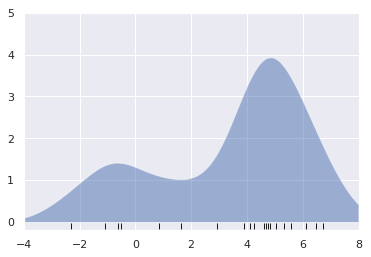

In [0]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.axis([-4, 8, -0.2, 5]);

# a Gaussian kernel

#Kernel Density Estimation 

In order to do KDE we need to make our mind about two things:
  * kernel, which specifies the shape of the distribution placed at each point;
  * kernel bandwidth, which controls the size of the kernel at each point.


##Choosing kernel

On every data point $x_i$ we place a *kernel* function $K$. The kernel density estimate is then

$$
\hat{f}_h(x)=\frac{1}{Nh}\sum_{i=1}^N K\left(\frac{x-x_i}{h}\right),
$$

where $h$ is the scaling parameter called *bandwidth*.

In fact we can substitute equal factors of $1/N$ with weights that can emphasize one points against the others:

$$
\begin{aligned}
& \hat{f}_h(x)=\frac{1}{h}\sum_{i=1}^N w_i \cdot K\left(\frac{x-x_i}{h}\right), \\
&\sum_{i=1}^N w_i=1.
\end{aligned}
$$

The kernel function is typically
* non-negative: $K(x) \geq 0$;
* symmetric: $\,\,\,\,\, K(x)=K(-x)$;
* decreasing: $\,\,\,\, K'(x)\leq 0$;
* $\int K(x)dx=1$.

$K$ has either compact support or decrease sufficiently fast approaching infinity.

In the multivariate case (with $d$ dimensions) we have

$$
\hat{f}_h(x)=\frac{1}{Nh^d}\sum_{i=1}^N K\left(\frac{\|x-x_i\|}{h}\right),
$$

where $\|\cdot \|$ is a some kind of norm, for example $p$-norm

$$ 
\|x\|_p = \left(\sum_i |x_i|^p \right)^{1/p}
$$

Although it's fun to see how the choice of kernel and metric affects the outcome,  it doesn't matter so much when there are lots of points.

Nonetheless, what are our options when choosing the kernels?

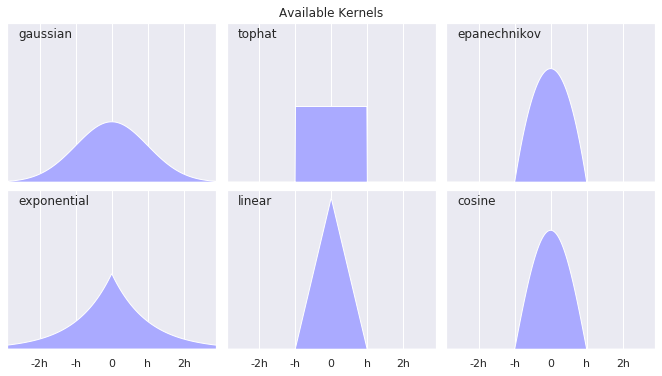

In [0]:
#@title Available kernels

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels');


$$
\begin{aligned}
& K_{\text{Gaussian}}(x;h) && \propto \quad e^{-\frac{x^2}{2h^2}}; \\
& K_{\text{Tophat}}(x;h) && \propto \quad 1, &&& \text{if   } \quad x<h; \\
& K_{\text{Epanechnikov}}(x;h) && \propto \quad 1-\frac{x^2}{h^2}; \\
& K_{\text{Exponential}}(x;h) && \propto \quad e^{-\frac{x}{h}}; \\
& K_{\text{Linear}}(x;h) && \propto \quad 1-\frac{|x|}{h}, &&& \text{if   } \quad |x|<h; \\
& K_{\text{Cosine}}(x;h) && \propto \quad \cos{\frac{\pi x}{2 h}}, &&& \text{if   } \quad x<h. \\
\end{aligned}
$$

you can choose those by setting `kernel` parameter:
* `kernel = 'gaussian';`
* `kernel = 'tophat';`
* `kernel = 'epanechnikov';`
* `kernel = 'exponential';`
* `kernel = 'linear';`
* `kernel = 'cosine'.`

##Choosing bandwidth

The choice of bandwidth within KDE is extremely important (the bias–variance trade-off).

   *  too narrow a bandwidth leads to a high-variance estimate (i.e., overfitting)
   * too wide a bandwidth leads to a high-bias estimate (i.e., underfitting)





In [0]:
#@title ##Choose the bandwidth wisely
%%html
<svg width="260mm" height="70mm" version="1.1" viewBox="0 0 341.32 98.535" xmlns="http://www.w3.org/2000/svg" xmlns:ns0="http://www.iki.fi/pav/software/textext/">
 <defs>
  <marker id="b" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".47826" fill-rule="evenodd" stroke="#000" stroke-opacity=".47826" stroke-width="1pt"/>
  </marker>
  <marker id="Arrow1Mend" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="e" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="d" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="c" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
  <marker id="a" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".47826" fill-rule="evenodd" stroke="#000" stroke-opacity=".47826" stroke-width="1pt"/>
  </marker>
 </defs>
 <g transform="translate(150.07 -.33048)">
  <g fill="none">
   <path d="m29.822 90.133h159.46" marker-end="url(#Arrow1Mend)" stroke="#000" stroke-width=".3"/>
   <path d="m35.858 96.751v-95.829" marker-end="url(#e)" stroke="#000" stroke-width=".3"/>
   <path d="m41.01 70.592c4.2441 3.7731 22.852-34.943 32.506-34.207 12.132 1.4609 23.489 39.622 36.763 40.093 9.5252 0.23545 17.226-61.354 26.548-54.267 5.7634 4.9154 7.61 61.648 18.143 61.799 11.292-0.13936 10.922-28.68 14.764-28.693 2.8275 0.0201 5.9824 13.527 8.8595 21.133" stroke="#0000ce" stroke-opacity=".34783" stroke-width=".765"/>
  </g>
  <g fill-opacity=".37681">
   <circle cx="69.455" cy="90.209" r="1.1042"/>
   <circle cx="73.224" cy="90.171" r="1.1042"/>
   <circle cx="92.752" cy="90.085" r="1.1042"/>
   <circle cx="76.813" cy="90.193" r="1.1042"/>
   <circle cx="68.413" cy="90.193" r="1.1042"/>
   <circle cx="71.422" cy="90.206" r="1.1042"/>
   <circle cx="65.613" cy="90.263" r="1.1042"/>
   <circle cx="47.595" cy="90.1" r="1.1042"/>
   <circle cx="61.412" cy="90.193" r="1.1042"/>
   <circle cx="54.881" cy="90.18" r="1.1042"/>
   <circle cx="58.699" cy="90.037" r="1.1042"/>
   <circle cx="79.99" cy="90.193" r="1.1042"/>
   <circle cx="95.397" cy="90.063" r="1.1687"/>
   <circle cx="84.352" cy="90.247" r="1.1042"/>
   <circle cx="137.29" cy="90.063" r="1.1687"/>
   <circle cx="135.8" cy="90.12" r="1.1687"/>
   <circle cx="137.85" cy="90.12" r="1.1687"/>
   <circle cx="140.83" cy="90.04" r="1.1687"/>
   <circle cx="131.7" cy="90.091" r="1.1687"/>
   <circle cx="133.75" cy="90.063" r="1.1687"/>
   <circle cx="127.37" cy="90.034" r="1.1687"/>
   <circle cx="121.37" cy="90.04" r="1.1687"/>
   <circle cx="144.66" cy="90.04" r="1.1687"/>
   <circle cx="149.34" cy="90.04" r="1.1687"/>
   <circle cx="134.91" cy="90.201" r="1.1687"/>
   <circle cx="110.57" cy="90.04" r="1.1687"/>
   <circle cx="170.36" cy="89.933" r="1.2019"/>
   <circle cx="168.07" cy="89.991" r="1.2019"/>
   <circle cx="171.47" cy="89.874" r="1.2019"/>
   <circle cx="162.38" cy="89.933" r="1.2019"/>
   <circle cx="177.04" cy="89.991" r="1.2019"/>
   <circle cx="172.93" cy="89.991" r="1.2019"/>
   <circle cx="171.94" cy="89.933" r="1.2019"/>
   <circle cx="175.63" cy="90.108" r="1.2019"/>
   <circle cx="138.54" cy="90.12" r="1.1687"/>
   <circle cx="130.9" cy="90.063" r="1.1687"/>
  </g>
  <g fill="none">
   <g>
    <path d="m46.801 71.618c30.07-8.5503 40.996-41.085 73.018-40.902 29.447 0.06562 46.227 40.106 58.775 45.735" stroke="#da0000" stroke-width=".765"/>
    <path d="m-143.71 90.203h159.46" marker-end="url(#c)" stroke="#000" stroke-width=".3"/>
    <path d="m-137.68 96.821v-95.829" marker-end="url(#d)" stroke="#000" stroke-width=".3"/>
   </g>
   <path d="m-132.52 70.662c4.2441 3.7731 22.852-34.943 32.506-34.207 12.132 1.4609 23.489 39.622 36.763 40.093 9.5252 0.23545 17.226-61.354 26.548-54.267 5.7634 4.9154 7.61 61.648 18.143 61.799 11.292-0.13937 10.921-28.68 14.764-28.693 2.8275 0.0201 5.9824 13.527 8.8595 21.133" stroke="#0000ce" stroke-opacity=".34783" stroke-width=".765"/>
  </g>
  <g fill-opacity=".37681">
   <circle cx="-104.08" cy="90.279" r="1.1042"/>
   <circle cx="-100.31" cy="90.241" r="1.1042"/>
   <circle cx="-80.783" cy="90.155" r="1.1042"/>
   <circle cx="-96.722" cy="90.263" r="1.1042"/>
   <circle cx="-105.12" cy="90.263" r="1.1042"/>
   <circle cx="-102.11" cy="90.276" r="1.1042"/>
   <circle cx="-107.92" cy="90.333" r="1.1042"/>
   <circle cx="-125.94" cy="90.17" r="1.1042"/>
   <circle cx="-112.12" cy="90.263" r="1.1042"/>
   <circle cx="-118.65" cy="90.25" r="1.1042"/>
   <circle cx="-114.84" cy="90.108" r="1.1042"/>
   <circle cx="-93.545" cy="90.263" r="1.1042"/>
   <circle cx="-78.138" cy="90.133" r="1.1687"/>
   <circle cx="-89.183" cy="90.317" r="1.1042"/>
   <circle cx="-36.25" cy="90.133" r="1.1687"/>
   <circle cx="-37.738" cy="90.19" r="1.1687"/>
   <circle cx="-35.683" cy="90.19" r="1.1687"/>
   <circle cx="-32.701" cy="90.11" r="1.1687"/>
   <circle cx="-41.835" cy="90.161" r="1.1687"/>
   <circle cx="-39.783" cy="90.133" r="1.1687"/>
   <circle cx="-46.166" cy="90.104" r="1.1687"/>
   <circle cx="-52.165" cy="90.11" r="1.1687"/>
   <circle cx="-28.872" cy="90.11" r="1.1687"/>
   <circle cx="-24.198" cy="90.11" r="1.1687"/>
   <circle cx="-38.625" cy="90.271" r="1.1687"/>
   <circle cx="-62.965" cy="90.11" r="1.1687"/>
   <circle cx="-3.1792" cy="90.003" r="1.2019"/>
   <circle cx="-5.4651" cy="90.061" r="1.2019"/>
   <circle cx="-2.0656" cy="89.944" r="1.2019"/>
   <circle cx="-11.15" cy="90.003" r="1.2019"/>
   <circle cx="3.5025" cy="90.061" r="1.2019"/>
   <circle cx="-.60032" cy="90.061" r="1.2019"/>
   <circle cx="-1.5967" cy="90.003" r="1.2019"/>
   <circle cx="2.0958" cy="90.178" r="1.2019"/>
   <circle cx="-34.996" cy="90.19" r="1.1687"/>
   <circle cx="-42.633" cy="90.133" r="1.1687"/>
  </g>
  <path d="m-128.81 74.239c6.2068-31.91 11.53-40.334 15.426-40.768 4.9319-0.54928 3.8408 10.1 8.5352 10.09 6.4267-0.0136 6.8237-15.749 12.709-2.8386 9.494 20.826 20.199 43.243 28.754 34.981 5.5172-5.3281 10.228-34.126 12.884-43.783 3.5054-14.505 2.5579 6.3462 5.8414 6.3653 2.7953 0.0162 2.7655-18.87 5.7903-18.969 2.8513-0.0933 5.1517 26.804 7.4794 37.361 1.4068 6.3808 2.4537 3.591 4.574 1.7346 1.4085-1.2331 4.955 35.137 15.783 23.639 2.6944-2.8612 6.8721-33.2 8.8729-30.335 4.9103 7.0308 3.2286 19.616 7.2212 24.806" fill="none" stroke="#da0000" stroke-width=".765"/>
  <g transform="matrix(1.5 0 0 -1.5 -353.43 1179.7)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" ns0:preamble="default_packages.tex" ns0:text="$$x$$\n$$\\text{pdf estimate}$$\n" xml:space="preserve"><path d="m245.33 723.63v0.0267l0.027 0.0801 0.018 0.071 9e-3 0.0444 0.0178 0.0355 9e-3 0.0444 0.0178 0.0444 0.0178 0.0355 0.0356 0.0888 0.0267 0.0444 0.0178 0.0444 0.0801 0.1332 0.0355 0.0355 0.0267 0.0444 0.142 0.142 0.0888 0.0534 0.0267 9e-3 0.0178 9e-3 0.0267 9e-3 0.0178 9e-3 0.0534 0.018 0.0266 9e-3h0.0267l0.0267 9e-3h0.0889c0.0355 0 0.24877 0 0.43534-0.1155-0.24876-0.0444-0.42645-0.26653-0.42645-0.47087 0-0.14216 0.10661-0.31096 0.33761-0.31096 0.19546 0 0.47976 0.15992 0.47976 0.5153 0 0.45311-0.52419 0.57749-0.81737 0.57749-0.5153 0-0.82626-0.47088-0.93288-0.66634-0.22211 0.5775-0.70187 0.66634-0.95952 0.66634-0.92399 0-1.4215-1.1372-1.4215-1.3593 0-0.0888 0.0888-0.0888 0.0977-0.0888 0.08 0 0.10661 0.0178 0.12438 0.0977 0.29319 0.93287 0.87957 1.155 1.1816 1.155 0.16881 0 0.47976-0.08 0.47976-0.58637 0-0.27542-0.15103-0.87069-0.47976-2.1056-0.14215-0.54195-0.45311-0.9151-0.84403-0.9151-0.0533 0-0.25765 0-0.43534 0.11549 0.21323 0.0444 0.40869 0.231 0.40869 0.47977 0 0.23099-0.19546 0.30207-0.32873 0.30207-0.25765 0-0.47976-0.231-0.47976-0.50642 0-0.40868 0.44422-0.58637 0.82626-0.58637 0.58637 0 0.90622 0.62191 0.93287 0.67522 0.10661-0.32873 0.42646-0.67522 0.95953-0.67522 0.90621 0 1.4126 1.1372 1.4126 1.3593 0 0.0888-0.08 0.0888-0.10661 0.0888-0.08 0-0.0977-0.0355-0.1155-0.0977-0.29319-0.94176-0.88845-1.155-1.1728-1.155-0.34649 0-0.48864 0.2843-0.48864 0.57749 0 0.19546 0.0533 0.39092 0.15103 0.78183z" stroke-width="0"/><g transform="matrix(0 .58984 -.58984 0 539.17 576.88)" stroke-width="0"><path d="m280.19 680.97v0.66l-1.43-0.11v-0.31c0.7 0 0.77-0.06 0.77-0.5v-4.64c0-0.45-0.11-0.45-0.77-0.45v-0.31c0.33 0.01 0.85 0.03 1.11 0.03 0.27 0 0.78-0.02 1.13-0.03v0.31c-0.67 0-0.78 0-0.78 0.45v1.75l0.14 0.13c-0.14 0.21-0.14 0.22-0.14 0.42v2.22c0.29 0.5 0.78 0.79 1.29 0.79 0.73 0 1.33-0.87 1.33-2 0-1.2-0.69-2.03-1.43-2.03-0.4 0-0.78 0.19-1.05 0.6l-0.14-0.13c0.05-0.16 0.47-0.69 1.23-0.69 1.18 0 2.22 0.97 2.22 2.25 0 1.26-0.97 2.25-2.08 2.25-0.78 0-1.2-0.44-1.4-0.66z"/><path d="m288.08 677.78v-0.65l1.47 0.11v0.3c-0.7 0-0.78 0.07-0.78 0.56v6.03l-1.44-0.11v-0.31c0.7 0 0.78-0.07 0.78-0.55v-2.15c-0.29 0.36-0.72 0.62-1.26 0.62l0.04-0.22c0.35 0 0.77-0.15 1.08-0.6 0.11-0.17 0.11-0.19 0.11-0.36v-2.04c0-0.18 0-0.2-0.11-0.37-0.3-0.47-0.75-0.69-1.18-0.69-0.45 0-0.81 0.25-1.04 0.63-0.26 0.41-0.29 0.98-0.29 1.38 0 0.37 0.02 0.97 0.31 1.41 0.21 0.31 0.58 0.64 1.12 0.64l-0.04 0.22c-1.17 0-2.22-0.98-2.22-2.26 0-1.26 0.98-2.24 2.11-2.24 0.64 0 1.09 0.34 1.34 0.65z"/><path d="m291.57 681.52v1.15c0 0.87 0.48 1.35 0.92 1.35 0.03 0 0.18 0 0.33-0.07-0.12-0.04-0.3-0.17-0.3-0.42 0-0.22 0.16-0.42 0.43-0.42 0.29 0 0.44 0.2 0.44 0.43 0 0.37-0.37 0.7-0.9 0.7-0.7 0-1.55-0.53-1.55-1.58v-1.14h-0.79v-0.31h0.79v-3.22c0-0.45-0.11-0.45-0.78-0.45v-0.3c0.39 0.01 0.86 0.03 1.14 0.03 0.4 0 0.87 0 1.27-0.03v0.3h-0.21c-0.74 0-0.76 0.11-0.76 0.47v3.2h1.14v0.31z"/><path d="m297.29 679.53 0.01 0.21c0.06 1.48 0.9 1.73 1.24 1.73 1.03 0 1.13-1.34 1.13-1.73h-2.37l-0.01-0.21h2.79c0.22 0 0.25 0 0.25 0.21 0 0.98-0.54 1.95-1.79 1.95-1.16 0-2.07-1.03-2.07-2.27 0-1.33 1.04-2.29 2.19-2.29 1.22 0 1.67 1.1 1.67 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.25-1.02-1.35-1.02-0.5 0-0.9 0.29-1.13 0.66-0.3 0.48-0.3 1.13-0.3 1.49z"/><path d="m302.69 679.16h0.05l0.09-0.03h0.04l0.03-0.01 0.04-0.01 0.04-0.02 0.05-0.01 0.04-0.02 0.04-0.01 0.05-0.02 0.04-0.02 0.05-0.03 0.04-0.02 0.04-0.03 0.04-0.02 0.05-0.03 0.11-0.11 0.06-0.08 0.03-0.05 0.02-0.02 0.01-0.02 0.01-0.03 0.01-0.02 0.02-0.06 0.01-0.02 0.01-0.03v-0.03l0.01-0.03v-0.06l0.01-0.04v-0.03c0-0.51-0.35-0.9-1.13-0.9-0.84 0-1.2 0.56-1.39 1.41-0.03 0.13-0.04 0.17-0.14 0.17-0.13 0-0.13-0.07-0.13-0.25v-1.31c0-0.17 0-0.24 0.11-0.24 0.05 0 0.06 0.01 0.25 0.2 0.02 0.02 0.02 0.04 0.2 0.22 0.44-0.41 0.89-0.42 1.1-0.42 1.15 0 1.6 0.66 1.6 1.38 0 0.52-0.29 0.82-0.41 0.94-0.33 0.32-0.72 0.4-1.14 0.48-0.56 0.11-1.23 0.24-1.23 0.81 0 0.35 0.26 0.76 1.12 0.76 1.1 0 1.15-0.9 1.17-1.2 0.01-0.09 0.1-0.09 0.12-0.09 0.13 0 0.13 0.05 0.13 0.24v1c0 0.17 0 0.24-0.11 0.24-0.05 0-0.07 0-0.2-0.12-0.03-0.04-0.13-0.13-0.17-0.16-0.38 0.28-0.79 0.28-0.94 0.28-1.22 0-1.6-0.67-1.6-1.22 0-0.35 0.16-0.63 0.43-0.85 0.32-0.26 0.6-0.32 1.32-0.46z"/><path d="m306.27 681.21h1.43v0.31h-1.43v1.83h-0.25c-0.01-0.82-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.93-1.34 1.29-1.34 0.71 0 0.99 0.7 0.99 1.34v0.56h-0.25v-0.54c0-0.74-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m310.18 681.63-1.39-0.11v-0.31c0.65 0 0.73-0.06 0.73-0.55v-2.67c0-0.45-0.1-0.45-0.77-0.45v-0.3c0.32 0.01 0.86 0.03 1.1 0.03 0.34 0 0.69-0.02 1.03-0.03v0.3c-0.66 0-0.7 0.05-0.7 0.44z"/><path d="m310.22 683.36v0.08l-0.01 0.03v0.03l-0.01 0.02-0.01 0.03-0.01 0.02-0.01 0.03-0.01 0.02-0.02 0.02-0.01 0.02-0.02 0.02-0.01 0.02-0.04 0.04-0.01 0.02-0.02 0.01-0.02 0.02-0.03 0.01-0.04 0.02-0.02 0.02-0.02 0.01h-0.03l-0.02 0.01-0.03 0.01h-0.02l-0.03 0.01h-0.07c-0.31 0-0.53-0.27-0.53-0.52 0-0.27 0.22-0.53 0.53-0.53 0.27 0 0.52 0.21 0.52 0.53z"/><path d="m312.28 680.65v-2.66c0-0.45-0.11-0.45-0.77-0.45v-0.3c0.34 0.01 0.85 0.03 1.12 0.03 0.26 0 0.78-0.02 1.12-0.03v0.3c-0.67 0-0.78 0-0.78 0.45v1.83c0 1.03 0.71 1.59 1.35 1.59 0.63 0 0.73-0.54 0.73-1.1v-2.32c0-0.45-0.1-0.45-0.77-0.45v-0.3c0.35 0.01 0.86 0.03 1.12 0.03s0.78-0.02 1.12-0.03v0.3c-0.67 0-0.78 0-0.78 0.45v1.83c0 1.03 0.71 1.59 1.35 1.59 0.63 0 0.74-0.54 0.74-1.1v-2.32c0-0.45-0.11-0.45-0.78-0.45v-0.3c0.35 0.01 0.86 0.03 1.13 0.03 0.26 0 0.77-0.02 1.11-0.03v0.3c-0.52 0-0.76 0-0.77 0.3v1.9c0 0.85 0 1.16-0.31 1.52-0.14 0.17-0.47 0.37-1.05 0.37-0.84 0-1.28-0.6-1.45-0.98-0.14 0.87-0.87 0.98-1.32 0.98-0.73 0-1.2-0.43-1.48-1.04v1.04l-1.4-0.11v-0.31c0.69 0 0.77-0.07 0.77-0.56z"/><path d="m322.81 677.99v-0.04l0.01-0.03 0.01-0.04v-0.04l0.01-0.03 0.02-0.04 0.01-0.04 0.01-0.03 0.02-0.04 0.01-0.03 0.02-0.04 0.08-0.12 0.03-0.03 0.02-0.03 0.06-0.06 0.15-0.1 0.04-0.02 0.03-0.01 0.16-0.04h0.09c0.21 0 0.81 0.14 0.81 0.94v0.56h-0.25v-0.56c0-0.58-0.24-0.64-0.35-0.64-0.33 0-0.37 0.45-0.37 0.5v1.99c0 0.42 0 0.8-0.36 1.17-0.39 0.39-0.89 0.55-1.37 0.55-0.82 0-1.5-0.47-1.5-1.12 0-0.3 0.19-0.47 0.45-0.47 0.28 0 0.46 0.2 0.46 0.45 0 0.12-0.05 0.45-0.5 0.46 0.26 0.35 0.75 0.46 1.07 0.46 0.49 0 1.06-0.39 1.06-1.27v-1.57c0-0.95-0.72-1.28-1.17-1.28-0.49 0-0.9 0.34-0.9 0.84 0 0.55 0.42 1.37 2.07 1.43v0.21c-0.51-0.03-1.21-0.06-1.84-0.36-0.74-0.34-0.99-0.85-0.99-1.29 0-0.8 0.96-1.05 1.59-1.05 0.66 0 1.12 0.4 1.31 0.86z"/><path d="m326.19 681.21h1.43v0.31h-1.43v1.83h-0.24c-0.02-0.82-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.92-1.34 1.28-1.34 0.71 0 0.99 0.7 0.99 1.34v0.56h-0.25v-0.54c0-0.74-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m329.45 679.53 0.01 0.21c0.06 1.48 0.9 1.73 1.24 1.73 1.02 0 1.12-1.34 1.12-1.73h-2.36l-0.01-0.21h2.78c0.22 0 0.25 0 0.25 0.21 0 0.98-0.54 1.95-1.78 1.95-1.16 0-2.08-1.03-2.08-2.27 0-1.33 1.05-2.29 2.2-2.29 1.21 0 1.66 1.1 1.66 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.24-1.02-1.34-1.02-0.5 0-0.9 0.29-1.13 0.66-0.3 0.48-0.3 1.13-0.3 1.49z"/></g><path d="m361.41 723.29v0.0267l9e-3 0.0266 0.018 0.0534 0.018 0.071 9e-3 0.0444 0.0178 0.0355 9e-3 0.0444 0.0178 0.0444 0.0178 0.0355 0.0356 0.0888 0.0267 0.0444 0.0178 0.0444 0.0801 0.1332 0.0355 0.0355 0.0267 0.0444 0.142 0.142 0.0888 0.0534 0.0267 9e-3 0.0178 9e-3 0.0267 9e-3 0.0178 9e-3 0.0801 0.027h0.0266l0.0267 9e-3h0.0889c0.0355 0 0.24877 0 0.43534-0.1155-0.24877-0.0444-0.42646-0.26653-0.42646-0.47087 0-0.14216 0.10662-0.31096 0.33761-0.31096 0.19546 0 0.47977 0.15992 0.47977 0.5153 0 0.45311-0.52419 0.57749-0.81738 0.57749-0.5153 0-0.82625-0.47088-0.93287-0.66634-0.22211 0.5775-0.70187 0.66634-0.95952 0.66634-0.92399 0-1.4215-1.1372-1.4215-1.3593 0-0.0888 0.0888-0.0888 0.0977-0.0888 0.08 0 0.10661 0.0178 0.12438 0.0977 0.29319 0.93287 0.87956 1.155 1.1816 1.155 0.1688 0 0.47976-0.08 0.47976-0.58637 0-0.27542-0.15104-0.87068-0.47976-2.1056-0.14215-0.54195-0.45311-0.9151-0.84403-0.9151-0.0533 0-0.25765 0-0.43534 0.1155 0.21323 0.0444 0.40869 0.23099 0.40869 0.47976 0 0.231-0.19546 0.30207-0.32873 0.30207-0.25765 0-0.47976-0.231-0.47976-0.50641 0-0.40869 0.44422-0.58638 0.82626-0.58638 0.58637 0 0.90621 0.62191 0.93287 0.67522 0.10661-0.32873 0.42645-0.67522 0.95952-0.67522 0.90622 0 1.4126 1.1372 1.4126 1.3593 0 0.0888-0.08 0.0888-0.10662 0.0888-0.08 0-0.0977-0.0355-0.11549-0.0977-0.29319-0.94175-0.88845-1.155-1.1728-1.155-0.34649 0-0.48865 0.2843-0.48865 0.57749 0 0.19546 0.0533 0.39092 0.15104 0.78184z" stroke-width="0"/><g transform="matrix(0 .58984 -.58984 0 656.18 581)" stroke-width="0"><path d="m280.19 680.97v0.66l-1.43-0.11v-0.31c0.7 0 0.77-0.06 0.77-0.5v-4.64c0-0.45-0.11-0.45-0.77-0.45v-0.31c0.33 0.01 0.85 0.03 1.11 0.03 0.27 0 0.78-0.02 1.13-0.03v0.31c-0.67 0-0.78 0-0.78 0.45v1.75l0.14 0.13c-0.14 0.21-0.14 0.22-0.14 0.42v2.22c0.29 0.5 0.78 0.79 1.29 0.79 0.73 0 1.33-0.87 1.33-2 0-1.2-0.69-2.03-1.43-2.03-0.4 0-0.78 0.19-1.05 0.6l-0.14-0.13c0.05-0.16 0.47-0.69 1.23-0.69 1.18 0 2.22 0.97 2.22 2.25 0 1.26-0.97 2.25-2.08 2.25-0.78 0-1.2-0.44-1.4-0.66z"/><path d="m288.08 677.78v-0.65l1.47 0.11v0.3c-0.7 0-0.78 0.07-0.78 0.56v6.03l-1.44-0.11v-0.31c0.7 0 0.78-0.07 0.78-0.55v-2.15c-0.29 0.36-0.72 0.62-1.26 0.62l0.04-0.22c0.35 0 0.77-0.15 1.08-0.6 0.11-0.17 0.11-0.19 0.11-0.36v-2.04c0-0.18 0-0.2-0.11-0.37-0.3-0.47-0.75-0.69-1.18-0.69-0.45 0-0.81 0.25-1.04 0.63-0.26 0.41-0.29 0.98-0.29 1.38 0 0.37 0.02 0.97 0.31 1.41 0.21 0.31 0.58 0.64 1.12 0.64l-0.04 0.22c-1.17 0-2.22-0.98-2.22-2.26 0-1.26 0.98-2.24 2.11-2.24 0.64 0 1.09 0.34 1.34 0.65z"/><path d="m291.57 681.52v1.15c0 0.87 0.48 1.35 0.92 1.35 0.03 0 0.18 0 0.33-0.07-0.12-0.04-0.3-0.17-0.3-0.42 0-0.22 0.16-0.42 0.43-0.42 0.29 0 0.44 0.2 0.44 0.43 0 0.37-0.37 0.7-0.9 0.7-0.7 0-1.55-0.53-1.55-1.58v-1.14h-0.79v-0.31h0.79v-3.22c0-0.45-0.11-0.45-0.78-0.45v-0.3c0.39 0.01 0.86 0.03 1.14 0.03 0.4 0 0.87 0 1.27-0.03v0.3h-0.21c-0.74 0-0.76 0.11-0.76 0.47v3.2h1.14v0.31z"/><path d="m297.29 679.53 0.01 0.21c0.06 1.48 0.9 1.73 1.24 1.73 1.03 0 1.13-1.34 1.13-1.73h-2.37l-0.01-0.21h2.79c0.22 0 0.25 0 0.25 0.21 0 0.98-0.54 1.95-1.79 1.95-1.16 0-2.07-1.03-2.07-2.27 0-1.33 1.04-2.29 2.19-2.29 1.22 0 1.67 1.1 1.67 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.25-1.02-1.35-1.02-0.5 0-0.9 0.29-1.13 0.66-0.3 0.48-0.3 1.13-0.3 1.49z"/><path d="m302.69 679.16h0.05l0.09-0.03h0.04l0.03-0.01 0.04-0.01 0.04-0.02 0.05-0.01 0.04-0.02 0.04-0.01 0.05-0.02 0.04-0.02 0.05-0.03 0.04-0.02 0.04-0.03 0.04-0.02 0.05-0.03 0.11-0.11 0.06-0.08 0.03-0.05 0.02-0.02 0.01-0.02 0.01-0.03 0.01-0.02 0.02-0.06 0.01-0.02 0.01-0.03v-0.03l0.01-0.03v-0.06l0.01-0.04v-0.03c0-0.51-0.35-0.9-1.13-0.9-0.84 0-1.2 0.56-1.39 1.41-0.03 0.13-0.04 0.17-0.14 0.17-0.13 0-0.13-0.07-0.13-0.25v-1.31c0-0.17 0-0.24 0.11-0.24 0.05 0 0.06 0.01 0.25 0.2 0.02 0.02 0.02 0.04 0.2 0.22 0.44-0.41 0.89-0.42 1.1-0.42 1.15 0 1.6 0.66 1.6 1.38 0 0.52-0.29 0.82-0.41 0.94-0.33 0.32-0.72 0.4-1.14 0.48-0.56 0.11-1.23 0.24-1.23 0.81 0 0.35 0.26 0.76 1.12 0.76 1.1 0 1.15-0.9 1.17-1.2 0.01-0.09 0.1-0.09 0.12-0.09 0.13 0 0.13 0.05 0.13 0.24v1c0 0.17 0 0.24-0.11 0.24-0.05 0-0.07 0-0.2-0.12-0.03-0.04-0.13-0.13-0.17-0.16-0.38 0.28-0.79 0.28-0.94 0.28-1.22 0-1.6-0.67-1.6-1.22 0-0.35 0.16-0.63 0.43-0.85 0.32-0.26 0.6-0.32 1.32-0.46z"/><path d="m306.27 681.21h1.43v0.31h-1.43v1.83h-0.25c-0.01-0.82-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.93-1.34 1.29-1.34 0.71 0 0.99 0.7 0.99 1.34v0.56h-0.25v-0.54c0-0.74-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m310.18 681.63-1.39-0.11v-0.31c0.65 0 0.73-0.06 0.73-0.55v-2.67c0-0.45-0.1-0.45-0.77-0.45v-0.3c0.32 0.01 0.86 0.03 1.1 0.03 0.34 0 0.69-0.02 1.03-0.03v0.3c-0.66 0-0.7 0.05-0.7 0.44z"/><path d="m310.22 683.36v0.08l-0.01 0.03v0.03l-0.01 0.02-0.01 0.03-0.01 0.02-0.01 0.03-0.01 0.02-0.02 0.02-0.01 0.02-0.02 0.02-0.01 0.02-0.04 0.04-0.01 0.02-0.02 0.01-0.02 0.02-0.03 0.01-0.04 0.02-0.02 0.02-0.02 0.01h-0.03l-0.02 0.01-0.03 0.01h-0.02l-0.03 0.01h-0.07c-0.31 0-0.53-0.27-0.53-0.52 0-0.27 0.22-0.53 0.53-0.53 0.27 0 0.52 0.21 0.52 0.53z"/><path d="m312.28 680.65v-2.66c0-0.45-0.11-0.45-0.77-0.45v-0.3c0.34 0.01 0.85 0.03 1.12 0.03 0.26 0 0.78-0.02 1.12-0.03v0.3c-0.67 0-0.78 0-0.78 0.45v1.83c0 1.03 0.71 1.59 1.35 1.59 0.63 0 0.73-0.54 0.73-1.1v-2.32c0-0.45-0.1-0.45-0.77-0.45v-0.3c0.35 0.01 0.86 0.03 1.12 0.03s0.78-0.02 1.12-0.03v0.3c-0.67 0-0.78 0-0.78 0.45v1.83c0 1.03 0.71 1.59 1.35 1.59 0.63 0 0.74-0.54 0.74-1.1v-2.32c0-0.45-0.11-0.45-0.78-0.45v-0.3c0.35 0.01 0.86 0.03 1.13 0.03 0.26 0 0.77-0.02 1.11-0.03v0.3c-0.52 0-0.76 0-0.77 0.3v1.9c0 0.85 0 1.16-0.31 1.52-0.14 0.17-0.47 0.37-1.05 0.37-0.84 0-1.28-0.6-1.45-0.98-0.14 0.87-0.87 0.98-1.32 0.98-0.73 0-1.2-0.43-1.48-1.04v1.04l-1.4-0.11v-0.31c0.69 0 0.77-0.07 0.77-0.56z"/><path d="m322.81 677.99v-0.04l0.01-0.03 0.01-0.04v-0.04l0.01-0.03 0.02-0.04 0.01-0.04 0.01-0.03 0.02-0.04 0.01-0.03 0.02-0.04 0.08-0.12 0.03-0.03 0.02-0.03 0.06-0.06 0.15-0.1 0.04-0.02 0.03-0.01 0.16-0.04h0.09c0.21 0 0.81 0.14 0.81 0.94v0.56h-0.25v-0.56c0-0.58-0.24-0.64-0.35-0.64-0.33 0-0.37 0.45-0.37 0.5v1.99c0 0.42 0 0.8-0.36 1.17-0.39 0.39-0.89 0.55-1.37 0.55-0.82 0-1.5-0.47-1.5-1.12 0-0.3 0.19-0.47 0.45-0.47 0.28 0 0.46 0.2 0.46 0.45 0 0.12-0.05 0.45-0.5 0.46 0.26 0.35 0.75 0.46 1.07 0.46 0.49 0 1.06-0.39 1.06-1.27v-1.57c0-0.95-0.72-1.28-1.17-1.28-0.49 0-0.9 0.34-0.9 0.84 0 0.55 0.42 1.37 2.07 1.43v0.21c-0.51-0.03-1.21-0.06-1.84-0.36-0.74-0.34-0.99-0.85-0.99-1.29 0-0.8 0.96-1.05 1.59-1.05 0.66 0 1.12 0.4 1.31 0.86z"/><path d="m326.19 681.21h1.43v0.31h-1.43v1.83h-0.24c-0.02-0.82-0.31-1.88-1.29-1.92v-0.22h0.85v-2.74c0-1.22 0.92-1.34 1.28-1.34 0.71 0 0.99 0.7 0.99 1.34v0.56h-0.25v-0.54c0-0.74-0.3-1.11-0.67-1.11-0.67 0-0.67 0.9-0.67 1.07z"/><path d="m329.45 679.53 0.01 0.21c0.06 1.48 0.9 1.73 1.24 1.73 1.02 0 1.12-1.34 1.12-1.73h-2.36l-0.01-0.21h2.78c0.22 0 0.25 0 0.25 0.21 0 0.98-0.54 1.95-1.78 1.95-1.16 0-2.08-1.03-2.08-2.27 0-1.33 1.05-2.29 2.2-2.29 1.21 0 1.66 1.1 1.66 1.29 0 0.1-0.08 0.12-0.13 0.12-0.09 0-0.11-0.06-0.13-0.14-0.35-1.02-1.24-1.02-1.34-1.02-0.5 0-0.9 0.29-1.13 0.66-0.3 0.48-0.3 1.13-0.3 1.49z"/></g><g id="content" transform="matrix(1.5 0 0 -1.5 -353.26 1181.5)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" ns0:preamble="default_packages.tex" ns0:text="$$\\text{Low bandwidth = overfit}$$\n$$\\text{Large bandwidth = underfit}$$\n" xml:space="preserve"><g fill-opacity=".81643" stroke-width="0"><path d="m349.4 266.42h-0.0959c-0.0422 0.38718-0.0958 0.86252-0.76667 0.86252h-0.31434c-0.18017 0-0.18784-0.0267-0.18784-0.15334v-2.0279c0-0.13033 0-0.184 0.36417-0.184h0.12651v-0.11883c-0.13801 0.0154-0.48684 0.0154-0.64402 0.0154-0.14951 0-0.44851 0-0.58267-0.0154v0.11883h0.0921c0.29517 0 0.30283 0.0421 0.30283 0.18018v2.0049c0 0.138-8e-3 0.18017-0.30283 0.18017h-0.0921v0.11884h1.9934z"/><path d="m351.36 266.58v-0.0421l-4e-3 -0.0459-8e-3 -0.0459-8e-3 -0.0421-7e-3 -0.0421-0.0114-0.0421-0.0154-0.0422-0.0154-0.0423-0.0154-0.0383-0.0193-0.0384-0.0192-0.0383-0.0458-0.069-0.0267-0.0345-0.0267-0.0307-0.0268-0.0306-0.0612-0.0614-0.0307-0.023-0.0345-0.0267-0.069-0.0458-0.0345-0.0193-0.0384-0.0192-0.0383-0.0154-0.0383-0.0115-0.0421-0.0154-0.0384-7e-3 -0.0421-8e-3 -0.0423-8e-3 -0.0421-4e-3h-0.0423l-4e-3 0.0843c0.16484 0 0.32968 0.0843 0.42935 0.24533 0.0997 0.16484 0.0997 0.38719 0.0997 0.52902 0 0.138 0 0.34499-0.0842 0.51367-0.0842 0.16869-0.25299 0.27983-0.44083 0.27983-0.16484 0-0.33351-0.0806-0.43701-0.25299-0.0958-0.16868-0.0958-0.40251-0.0958-0.54051 0-0.14567 0-0.35267 0.0921-0.52136 0.10353-0.17249 0.28367-0.25299 0.437-0.25299l4e-3 -0.0843c-0.47918 0-0.85102 0.41401-0.85102 0.88936 0 0.4945 0.39866 0.85869 0.84719 0.85869 0.46 0 0.84717-0.37184 0.84717-0.85869z"/><path d="m353.73 266.12 8e-3 -0.0154 4e-3 -0.0193 0.016-0.0308 8e-3 -0.0115 8e-3 -0.0154 7e-3 -0.0114 0.0115-0.0154 8e-3 -0.0115 8e-3 -7e-3 0.0114-0.0114 8e-3 -7e-3 8e-3 -0.0114 0.0114-8e-3 0.0114-7e-3 8e-3 -8e-3 0.0114-8e-3 0.0114-4e-3 0.0115-7e-3 8e-3 -4e-3 0.0228-8e-3 0.0115-4e-3 0.0228-8e-3h0.0115l0.0114-4e-3h0.0154l0.0114-4e-3h0.0343v-0.11884c-0.0806 8e-3 -0.19166 0.0114-0.27601 0.0114-0.11116 0-0.28366-8e-3 -0.3565-0.0114v0.11884c0.138 4e-3 0.22233 0.0689 0.22233 0.18016 0 0.0231 0 0.0307-0.0193 0.0806l-0.34883 0.97752-0.37951-1.0657c-0.0154-0.0459-0.0192-0.0537-0.0192-0.0728 0-0.0996 0.14949-0.0996 0.22615-0.0996v-0.11883c-0.11116 4e-3 -0.30666 0.0114-0.39484 0.0114-0.115 0-0.22617-4e-3 -0.34116-0.0114v0.11883c0.14183 0 0.20316 8e-3 0.2415 0.0575 0.0193 0.0229 0.0613 0.13418 0.0882 0.20699l-0.32969 0.92385-0.36416-1.0197c-0.0193-0.0459-0.0193-0.0538-0.0193-0.069 0-0.0996 0.1495-0.0996 0.22616-0.0996v-0.11886c-0.115 4e-3 -0.32966 0.0114-0.41784 0.0114-0.0154 0-0.21849-4e-3 -0.35651-0.0114v0.11886c0.19169 0 0.23769 0.0114 0.28369 0.13032l0.483 1.3494c0.0193 0.0537 0.0307 0.0842 0.0806 0.0842 0.0498 0 0.0576-0.0229 0.0766-0.0766l0.38718-1.0772 0.38718 1.081c0.0154 0.0423 0.0267 0.0729 0.0766 0.0729 0.0498 0 0.0613-0.0345 0.0766-0.0729z"/><path d="m356.05 265.97v-1.2075l-0.54819 0.0384v0.11883c0.26452 0 0.29518 0.0267 0.29518 0.21466v2.2694h0.0958c4e-3 -4e-3 0.0345-0.0576 0.13801-0.23768 0.0576 0.0882 0.2185 0.27984 0.50217 0.27984l-0.0154-0.0842c-0.1725 0-0.31051-0.0921-0.40251-0.23384-0.0537-0.0766-0.0537-0.0882-0.0537-0.15718v-0.78585c0-0.0728 0-0.0767 0.0421-0.13797 0.1495-0.21086 0.36033-0.24152 0.45233-0.24152 0.17251 0 0.31052 0.0996 0.40252 0.24152 0.0997 0.15714 0.11116 0.37566 0.11116 0.529 0 0.14182-8e-3 0.37182-0.11882 0.54434-0.0806 0.11499-0.22618 0.2415-0.43317 0.2415l0.0154 0.0842c0.45619 0 0.85103-0.37183 0.85103-0.86634 0-0.48301-0.37183-0.85868-0.80885-0.85868-0.29901 0-0.46385 0.18016-0.52518 0.24915z"/><path d="m358.79 267.11 4e-3 0.0115v0.0154l4e-3 0.0154 4e-3 0.0114 8e-3 0.0308 4e-3 0.0114 8e-3 0.0154 4e-3 0.0154 8e-3 0.0114 4e-3 0.0114 8e-3 0.0154 8e-3 0.0114 7e-3 0.0114 0.0114 0.0114 7e-3 0.0115 0.0115 0.0114 8e-3 0.0114 0.0114 8e-3 0.0114 0.0114 0.0114 8e-3 0.0115 8e-3 0.0114 8e-3 0.0154 8e-3 0.0114 4e-3 0.0154 8e-3 0.0154 4e-3 0.0114 4e-3 0.0154 4e-3 0.0191 4e-3h0.0308c0.0806 0 0.31435-0.0537 0.31435-0.36034v-0.21467h-0.0958v0.21467c0 0.21851-0.0959 0.2415-0.138 0.2415-0.1265 0-0.14183-0.16866-0.14183-0.18782v-0.76286c0-0.16098 0-0.31049-0.138-0.44849-0.1495-0.14951-0.34118-0.21085-0.52134-0.21085-0.31433 0-0.57884 0.18017-0.57884 0.42934 0 0.115 0.0766 0.18016 0.17633 0.18016 0.10734 0 0.17633-0.0766 0.17633-0.17632 0-0.0459-0.0193-0.16868-0.19549-0.17634 0.10353-0.13033 0.29132-0.17249 0.41399-0.17249 0.18784 0 0.40252 0.1495 0.40252 0.48682v0.60197c0 0.36033-0.27217 0.49066-0.44468 0.49066-0.18783 0-0.345-0.13416-0.345-0.322 0-0.21083 0.16099-0.52518 0.78968-0.54817v-0.0806c-0.19169 0.0114-0.46001 0.023-0.70151 0.13416-0.28752 0.13033-0.38336 0.32966-0.38336 0.49834 0 0.30666 0.37185 0.4025 0.61336 0.4025 0.24917 0 0.42552-0.15333 0.49835-0.32967z"/><path d="m359.85 266.09v1.0235c0 0.16867-0.0421 0.16867-0.29899 0.16867v0.11884c0.13415-4e-3 0.32966-0.0114 0.43315-0.0114 0.0997 0 0.299 8e-3 0.42934 0.0114v-0.11884c-0.25683 0-0.299 0-0.299-0.16867v-0.70152c0-0.39865 0.27218-0.60951 0.51751-0.60951 0.23766 0 0.27984 0.20318 0.27984 0.42168v0.88935c0 0.16867-0.0421 0.16867-0.29901 0.16867v0.11884c0.13417-4e-3 0.32968-0.0114 0.43318-0.0114 0.0996 0 0.299 8e-3 0.42934 0.0114v-0.11884c-0.19934 0-0.29518 0-0.29901-0.115v-0.72451c0-0.32968 0-0.4485-0.11884-0.58269-0.0537-0.0652-0.18017-0.14184-0.39866-0.14184-0.27984 0-0.46001 0.16484-0.56736 0.39868v-0.39868l-0.54048 0.0421v0.11886c0.26832 0 0.29899 0.0267 0.29899 0.21082z"/><path d="m363 267.19v0.25302l0.55968-0.0421v-0.11885c-0.26449 0-0.29517-0.0268-0.29517-0.21082v-2.3116l-0.55201 0.0383v0.11883c0.26834 0 0.299 0.0267 0.299 0.21467v0.82034c-0.11116-0.13416-0.27599-0.23384-0.483-0.23384l0.0154 0.0842c0.13416 0 0.29515 0.0575 0.41399 0.22617 0.0421 0.0652 0.0421 0.0729 0.0421 0.14184v0.78201c0 0.0689 0 0.0766-0.0421 0.14184-0.115 0.18017-0.28751 0.2645-0.45234 0.2645-0.17251 0-0.3105-0.0996-0.40251-0.24151-0.0958-0.15716-0.10734-0.37566-0.10734-0.53283 0-0.13801 8e-3 -0.36802 0.11884-0.54051 0.0766-0.115 0.22234-0.24151 0.42936-0.24151l-0.0154-0.0842c-0.44851 0-0.85101 0.37186-0.85101 0.86251 0 0.48686 0.37566 0.86252 0.80884 0.86252 0.24535 0 0.41784-0.13033 0.51367-0.25299z"/><path d="m366.03 266.12 4e-3 -0.0154 8e-3 -0.0193 0.016-0.0308 8e-3 -0.0115 8e-3 -0.0154 8e-3 -0.0114 8e-3 -0.0154 0.0114-0.0115 8e-3 -7e-3 8e-3 -0.0114 0.0114-7e-3 8e-3 -0.0114 0.0115-8e-3 0.0114-7e-3 8e-3 -8e-3 0.0114-8e-3 0.0115-4e-3 0.0114-7e-3 8e-3 -4e-3 0.0228-8e-3 0.0115-4e-3 0.0114-4e-3 0.0115-4e-3h0.0114l0.0115-4e-3h0.0154l0.0114-4e-3h0.0383v-0.11884c-0.0842 8e-3 -0.1955 0.0114-0.27984 0.0114-0.11117 0-0.28367-8e-3 -0.35651-0.0114v0.11884c0.13801 4e-3 0.22233 0.0689 0.22233 0.18016 0 0.0231 0 0.0307-0.0192 0.0806l-0.34885 0.97752-0.37949-1.0657c-0.0154-0.0459-0.0192-0.0537-0.0192-0.0728 0-0.0996 0.14951-0.0996 0.22618-0.0996v-0.11883c-0.11117 4e-3 -0.30667 0.0114-0.39484 0.0114-0.11885 0-0.22618-4e-3 -0.34118-0.0114v0.11883c0.14183 0 0.20317 8e-3 0.2415 0.0575 0.0154 0.0229 0.0613 0.13418 0.0843 0.20699l-0.32585 0.92385-0.36418-1.0197c-0.0193-0.0459-0.0193-0.0538-0.0193-0.069 0-0.0996 0.14952-0.0996 0.22619-0.0996v-0.11886c-0.115 4e-3 -0.32968 0.0114-0.41784 0.0114-0.0154 0-0.21851-4e-3 -0.35651-0.0114v0.11886c0.19167 0 0.23767 0.0114 0.28366 0.13032l0.48301 1.3494c0.0192 0.0537 0.0306 0.0842 0.0806 0.0842 0.0498 0 0.0576-0.0229 0.0766-0.0766l0.38335-1.0772 0.39099 1.081c0.0154 0.0423 0.0268 0.0729 0.0766 0.0729s0.0613-0.0345 0.0766-0.0729z"/><path d="m367.1 265.72-0.53285 0.0421v0.11886c0.24918 0 0.28369 0.0229 0.28369 0.20699v1.0274c0 0.16867-0.0421 0.16867-0.29903 0.16867v0.11884c0.12267-4e-3 0.3297-0.0114 0.41786-0.0114 0.13416 0 0.26833 8e-3 0.39866 0.0114v-0.11884c-0.25298 0-0.26833-0.0193-0.26833-0.16482z"/><path d="m367.12 265.05v-0.0343l-4e-3 -8e-3v-0.0115l-4e-3 -0.0114-4e-3 -8e-3 -4e-3 -0.0114-8e-3 -0.016-8e-3 -8e-3 -4e-3 -0.0114-4e-3 -8e-3 -8e-3 -8e-3 -8e-3 -4e-3 -8e-3 -8e-3 -4e-3 -8e-3 -7e-3 -4e-3 -8e-3 -7e-3 -8e-3 -4e-3 -0.0114-8e-3 -0.024-0.012-0.0114-4e-3h-8e-3l-0.0114-4e-3 -8e-3 -4e-3h-0.0194l-0.0115-4e-3h-8e-3c-0.11882 0-0.20315 0.10354-0.20315 0.20317 0 0.10353 0.0843 0.20317 0.20315 0.20317 0.10734 0 0.19935-0.0805 0.19935-0.20317z"/><path d="m368.94 267.19v0.25302l0.55968-0.0421v-0.11885c-0.26834 0-0.29901-0.0268-0.29901-0.21082v-2.3116l-0.54818 0.0383v0.11883c0.26834 0 0.299 0.0267 0.299 0.21467v0.82034c-0.11116-0.13416-0.27599-0.23384-0.483-0.23384l0.0154 0.0842c0.13416 0 0.29517 0.0575 0.414 0.22617 0.0421 0.0652 0.0421 0.0729 0.0421 0.14184v0.78201c0 0.0689 0 0.0766-0.0421 0.14184-0.11501 0.18017-0.28751 0.2645-0.45234 0.2645-0.17251 0-0.31051-0.0996-0.40251-0.24151-0.0997-0.15716-0.11116-0.37566-0.11116-0.53283 0-0.13801 8e-3 -0.36802 0.11883-0.54051 0.0805-0.115 0.22617-0.24151 0.43318-0.24151l-0.0154-0.0842c-0.45234 0-0.85101 0.37186-0.85101 0.86251 0 0.48686 0.37184 0.86252 0.80885 0.86252 0.24533 0 0.41783-0.13033 0.51367-0.25299z"/><path d="m370.27 265.88h0.54436v-0.11885h-0.54436v-0.70151h-0.0959c-4e-3 0.31052-0.11882 0.72068-0.4945 0.73601v0.0843h0.32584v1.0504c0 0.46766 0.3565 0.51366 0.4945 0.51366 0.26833 0 0.37567-0.27217 0.37567-0.51366v-0.21851h-0.0958v0.21084c0 0.27983-0.115 0.42552-0.25299 0.42552-0.25686 0-0.25686-0.34503-0.25686-0.41018z"/><path d="m371.51 267.11v0.0542l-4e-3 0.0115v0.0114l-4e-3 0.0114v8e-3l-4e-3 0.0114-8e-3 0.016-8e-3 4e-3 -4e-3 8e-3 -8e-3 4e-3 -7e-3 4e-3 -4e-3 8e-3 -0.0115 4e-3h-8e-3l-0.0115 4e-3 -8e-3 4e-3h-0.0154l-0.0115 4e-3h-0.0274l-8e-3 4e-3h-0.1466v0.11884c0.13415-4e-3 0.32582-0.0114 0.42932-0.0114 0.0997 0 0.29902 8e-3 0.42934 0.0114v-0.11884c-0.25684 0-0.299 0-0.299-0.16865v-0.70152c0-0.39869 0.27217-0.60952 0.51751-0.60952 0.2415 0 0.28366 0.20317 0.28366 0.42168v0.88936c0 0.16865-0.0421 0.16865-0.299 0.16865v0.11884c0.13416-4e-3 0.32968-0.0114 0.42935-0.0114 0.0997 0 0.299 8e-3 0.42932 0.0114v-0.11884c-0.19932 0-0.29516 0-0.29899-0.115v-0.72451c0-0.32967 0-0.44851-0.11883-0.58268-0.0498-0.0651-0.17634-0.14183-0.39869-0.14183-0.322 0-0.49066 0.22616-0.55583 0.37184v-1.3302l-0.54816 0.0383v0.11883c0.26449 0 0.29516 0.0267 0.29516 0.21467z"/><path d="m377.12 266.15h0.0583l4e-3 -4e-3h0.016l4e-3 -4e-3h7e-3l4e-3 -4e-3h4e-3l8e-3 -8e-3h4e-3l0.012-0.012v-4e-3l4e-3 -4e-3v-4e-3l4e-3 -4e-3v-0.012h4e-3v-0.02c0-0.0766-0.0728-0.0766-0.12649-0.0766h-2.2885c-0.0538 0-0.1265 0-0.1265 0.0766s0.0728 0.0766 0.13033 0.0766z"/><path d="m377.12 266.89h0.0418l4e-3 -4e-3h0.024l4e-3 -4e-3h4e-3l8e-3 -4e-3h4e-3l4e-3 -4e-3h4e-3l0.012-0.012h4e-3v-4e-3h4e-3v-8e-3h4e-3v-4e-3l4e-3 -4e-3v-0.012l4e-3 -4e-3v-0.016c0-0.0766-0.0729-0.0766-0.13033-0.0766h-2.2809c-0.0576 0-0.13034 0-0.13034 0.0766 0 0.0767 0.0728 0.0767 0.12649 0.0767z"/><path d="m380.53 266.58v-0.0421l-8e-3 -0.0918-8e-3 -0.0421-0.0114-0.0421-0.0115-0.0421-0.0114-0.0422-0.0154-0.0423-0.0192-0.0383-0.0192-0.0384-0.0192-0.0383-0.0229-0.0345-0.023-0.0345-0.0229-0.0345-0.0268-0.0307-0.0306-0.0306-0.0267-0.0307-0.0307-0.0307-0.0345-0.023-0.0307-0.0267-0.0345-0.0229-0.0383-0.0229-0.0345-0.0193-0.0384-0.0192-0.0383-0.0154-0.0383-0.0115-0.0384-0.0154-0.0423-7e-3 -0.042-8e-3 -0.0423-8e-3 -0.0422-4e-3h-0.0421l-4e-3 0.0843c0.16866 0 0.33352 0.0843 0.43318 0.24533 0.0996 0.16484 0.0996 0.38719 0.0996 0.52902 0 0.138 0 0.34499-0.0842 0.51367-0.0842 0.16869-0.25301 0.27983-0.44468 0.27983-0.16483 0-0.3335-0.0806-0.43701-0.25299-0.0958-0.16868-0.0958-0.40251-0.0958-0.54051 0-0.14567 0-0.35267 0.0921-0.52136 0.10353-0.17249 0.28366-0.25299 0.437-0.25299l4e-3 -0.0843c-0.47917 0-0.84718 0.41401-0.84718 0.88936 0 0.4945 0.39485 0.85869 0.84335 0.85869 0.46385 0 0.84719-0.37184 0.84719-0.85869z"/><path d="m382.13 266.13 4e-3 -8e-3v-8e-3l4e-3 -0.0114 4e-3 -8e-3 8e-3 -0.0114 4e-3 -8e-3 4e-3 -0.0114 8e-3 -0.0115 4e-3 -8e-3 7e-3 -0.0114 4e-3 -0.0114 8e-3 -0.0115 8e-3 -8e-3 7e-3 -0.0114 0.0309-0.0309 0.0114-7e-3 0.0115-0.0114 0.0114-7e-3 0.0115-8e-3 0.0462-0.024 0.0154-4e-3 0.0154-8e-3 0.0193-4e-3 0.0192-4e-3 0.0193-4e-3h0.0114l0.0115-4e-3h0.0412v-0.11884c-0.0882 8e-3 -0.19552 0.0115-0.28368 0.0115-0.0921 0-0.26834-7e-3 -0.3335-0.0115v0.11884c0.14182 4e-3 0.184 0.0882 0.184 0.161 0 0.0345-7e-3 0.0498-0.023 0.0921l-0.391 0.96984-0.42933-1.0618c-0.023-0.0498-0.023-0.0538-0.023-0.0652 0-0.0958 0.14949-0.0958 0.2185-0.0958v-0.11884c-0.11501 4e-3 -0.32967 0.0114-0.41784 0.0114-0.0996 0-0.25301-4e-3 -0.36801-0.0114v0.11884c0.24151 0 0.25685 0.0229 0.30667 0.13799l0.54818 1.3532c0.0231 0.0537 0.0306 0.0728 0.0805 0.0728s0.0652-0.0345 0.0806-0.0728z"/><path d="m382.87 266.52 4e-3 -0.0766c0.023-0.56733 0.34498-0.66318 0.47532-0.66318 0.39485 0 0.43319 0.51369 0.43319 0.66318h-0.90851l-4e-3 0.0766h1.0695c0.0842 0 0.0959 0 0.0959-0.0766 0-0.37949-0.20702-0.74751-0.68618-0.74751-0.4447 0-0.79352 0.39101-0.79352 0.87018 0 0.50985 0.39867 0.87786 0.8395 0.87786 0.46769 0 0.6402-0.42168 0.6402-0.49451 0-0.0383-0.0306-0.0459-0.0499-0.0459-0.0345 0-0.0422 0.0229-0.0498 0.0538-0.13417 0.39101-0.47917 0.39101-0.51751 0.39101-0.19167 0-0.34501-0.11501-0.43316-0.25299-0.115-0.18402-0.115-0.43701-0.115-0.57502z"/><path d="m384.78 266.13v-0.41786l-0.53285 0.0421v0.11886c0.26833 0 0.29901 0.0267 0.29901 0.21082v1.0235c0 0.16867-0.0422 0.16867-0.29901 0.16867v0.11884c0.14951-4e-3 0.32967-0.0114 0.43702-0.0114 0.15333 0 0.33349 0 0.48683 0.0114v-0.11884h-0.0805c-0.28366 0-0.29134-0.0422-0.29134-0.18016v-0.58268c0-0.37952 0.16101-0.71684 0.45235-0.71684 0.0267 0 0.0345 0 0.0423 4e-3 -0.0115 4e-3 -0.0882 0.0498-0.0882 0.14566 0 0.10735 0.0806 0.16484 0.16484 0.16484 0.0689 0 0.16484-0.0459 0.16484-0.16867 0-0.11884-0.11885-0.22999-0.28368-0.22999-0.27983 0-0.41783 0.253-0.4715 0.41783z"/><path d="m386.9 265.88h0.059l0.0154 4e-3h0.0115l0.0114 4e-3h8e-3l0.0115 4e-3 8e-3 4e-3 0.0115 4e-3 0.016 8e-3 0.024 0.024 4e-3 8e-3 4e-3 4e-3 4e-3 8e-3 4e-3 0.0114 4e-3 8e-3v8e-3l4e-3 0.0115v8e-3l4e-3 0.0114v0.0383l4e-3 0.0114v1.058c0 0.16867-0.0423 0.16867-0.29901 0.16867v0.11885c0.1265-4e-3 0.32968-0.0114 0.42169-0.0114 0.0958 0 0.28365 8e-3 0.42548 0.0114v-0.11885c-0.25681 0-0.29516 0-0.29516-0.16867v-1.3992l-0.483 0.0345c-0.0613 4e-3 -0.0652 8e-3 -0.069 8e-3 -8e-3 4e-3 -0.0154 4e-3 -0.0691 4e-3h-0.45234v-0.42934c0-0.37951 0.32967-0.53284 0.56736-0.53284 0.11498 0 0.25298 0.0383 0.32966 0.12651-0.15717 8e-3 -0.18017 0.11499-0.18017 0.17632 0 0.12652 0.0996 0.17636 0.1725 0.17636 0.0882 0 0.1725-0.0613 0.1725-0.17636 0-0.22617-0.207-0.38332-0.49067-0.38332-0.35651 0-0.81269 0.19166-0.81269 0.6095v0.43317h-0.299v0.11886h0.299v1.2343c0 0.16868-0.0423 0.16868-0.29517 0.16868v0.11884c0.12267-4e-3 0.32585-0.0114 0.42168-0.0114 0.0958 0 0.28366 7e-3 0.42551 0.0114v-0.11884c-0.25683 0-0.29901 0-0.29901-0.16868v-1.2343z"/><path d="m388.42 265.88h0.54434v-0.11885h-0.54434v-0.70151h-0.0958c-4e-3 0.31052-0.11883 0.72068-0.4945 0.73601v0.0843h0.32582v1.0504c0 0.46766 0.35652 0.51366 0.49452 0.51366 0.26834 0 0.37567-0.27217 0.37567-0.51366v-0.21851h-0.0958v0.21084c0 0.27983-0.11118 0.42552-0.25301 0.42552-0.25683 0-0.25683-0.34503-0.25683-0.41018z"/><path d="m426.34 266.6h-0.0882c-0.0388 0.35648-0.0882 0.79767-0.70942 0.79767h-0.28943c-0.16588 0-0.16943-0.0247-0.16943-0.14119v-1.8706c0-0.12002 0-0.16589 0.33178-0.16589h0.11648v-0.10942c-0.12706 0.01-0.44471 0.01-0.58943 0.01-0.13765 0-0.41295 0-0.53648-0.01v0.10942h0.0848c0.27176 0 0.27882 0.0388 0.27882 0.16235v1.8494c0 0.12706-6e-3 0.1659-0.27882 0.1659h-0.0848v0.10588h1.8354z"/><path d="m427.66 267.24v0.014l3e-3 0.01 3e-3 0.014v0.014l3e-3 0.01 3e-3 0.014 6e-3 0.014 3e-3 0.01 6e-3 0.014 3e-3 0.01 6e-3 0.014 0.024 0.04 0.01 0.01 6e-3 0.01 0.026 0.026 0.01 6e-3 0.014 6e-3 0.02 0.012 0.014 6e-3 0.01 3e-3 0.056 0.012h0.0318c0.0742 0 0.28589-0.0493 0.28589-0.33179v-0.19765h-0.0882v0.19765c0 0.20472-0.0848 0.22589-0.12353 0.22589-0.11647 0-0.1306-0.15883-0.1306-0.17647v-0.70238c0-0.14823 0-0.28236-0.12706-0.41293-0.13765-0.13766-0.31412-0.19414-0.48355-0.19414-0.28941 0-0.52942 0.16589-0.52942 0.3953 0 0.10589 0.0706 0.16589 0.15883 0.16589 0.0989 0 0.16236-0.0706 0.16236-0.15882 0-0.0423-0.0178-0.15884-0.18-0.16235 0.0953-0.12355 0.26823-0.16237 0.38118-0.16237 0.17294 0 0.37412 0.13765 0.37412 0.44825v0.55421c0 0.33529-0.25413 0.45176-0.41294 0.45176-0.17295 0-0.31766-0.11999-0.31766-0.29646 0-0.19413 0.14823-0.48355 0.7306-0.50472v-0.0742c-0.18001 0.01-0.42705 0.0212-0.64942 0.12707-0.26117 0.12-0.34943 0.30001-0.34943 0.45531 0 0.28234 0.33883 0.37059 0.56121 0.37059 0.23293 0 0.39529-0.14119 0.46235-0.30354z"/><path d="m428.83 266.34v-0.38825l-0.48706 0.0388v0.10942c0.24706 0 0.2753 0.0247 0.2753 0.19765v0.93885c0 0.15882-0.0388 0.15882-0.2753 0.15882v0.10588c0.13765-3e-3 0.30353-0.01 0.39883-0.01 0.14116 0 0.30705 0 0.44825 0.01v-0.10588h-0.0742c-0.26117 0-0.26824-0.0388-0.26824-0.16589v-0.54c0-0.34942 0.14825-0.66001 0.41648-0.66001 0.0247 0 0.0318 0 0.0389 3e-3 -0.01 3e-3 -0.0811 0.0459-0.0811 0.13765 0 0.0989 0.0742 0.14824 0.15176 0.14824 0.0637 0 0.15177-0.0389 0.15177-0.15177 0-0.11295-0.1094-0.2153-0.26117-0.2153-0.25766 0-0.38473 0.23648-0.43413 0.38824z"/><path d="m430 267.04v-0.03l3e-3 -3e-3v-9e-3l3e-3 -6e-3v-9e-3l3e-3 -6e-3v-3e-3l6e-3 -0.012v-6e-3l3e-3 -6e-3 3e-3 -3e-3 0.015-0.03 6e-3 -6e-3 3e-3 -6e-3 6e-3 -6e-3c0.13766 0.0989 0.28237 0.10942 0.34943 0.10942v-0.0811c-0.30707 0-0.30707-0.34942-0.30707-0.43059 0-0.0954 3e-3 -0.20471 0.0564-0.29296 0.0283-0.0423 0.10942-0.14117 0.2506-0.14117 0.30354 0 0.30354 0.34942 0.30354 0.43061 0 0.0952-3e-3 0.20822-0.0564 0.29647-0.0283 0.0423-0.1094 0.13764-0.24706 0.13764v0.0811c0.32471 0 0.56826-0.24001 0.56826-0.51178 0-0.12706-0.0564-0.25764-0.14471-0.33884 0.12706-0.11999 0.25411-0.13763 0.31765-0.13763 6e-3 0 0.0247 0 0.0353 3e-3 -0.0388 0.0141-0.0564 0.0531-0.0564 0.0953 0 0.06 0.0459 0.10244 0.10244 0.10244 0.0353 0 0.10244-0.0247 0.10244-0.10588 0-0.06-0.0423-0.17294-0.18001-0.17294-0.0706 0-0.22587 0.0211-0.37413 0.16588-0.14824-0.11647-0.29646-0.12706-0.37059-0.12706-0.32824 0-0.57177 0.24354-0.57177 0.51177 0 0.15531 0.0777 0.28942 0.16589 0.36354-0.046 0.0493-0.10942 0.16589-0.10942 0.28943 0 0.1094 0.0459 0.24353 0.1553 0.31059-0.21176 0.06-0.32472 0.21177-0.32472 0.35294 0 0.2506 0.34943 0.44473 0.7765 0.44473l3e-3 -0.0811c-0.35294 0-0.59648-0.18001-0.59648-0.36355 0-0.16234 0.13412-0.29296 0.28942-0.30353h0.2047c0.30355 0 0.69886 0 0.69886 0.30353 0 0.18706-0.25059 0.36355-0.5965 0.36355l-3e-3 0.0811c0.41648 0 0.78355-0.18001 0.78355-0.45178 0-0.12353-0.0493-0.30353-0.22942-0.39883-0.18707-0.0989-0.39177-0.0989-0.60355-0.0989-0.0882 0-0.24 0-0.26471-3e-3 -0.11295-0.014-0.18705-0.12355-0.18705-0.23648z"/><path d="m431.77 266.7 3e-3 -0.0742c0.0212-0.52238 0.31765-0.61062 0.43765-0.61062 0.36001 0 0.39531 0.47297 0.39531 0.61062h-0.83296l-3e-3 0.0742h0.98119c0.0777 0 0.0882 0 0.0882-0.0742 0-0.34589-0.19059-0.68827-0.62824-0.68827-0.40942 0-0.73415 0.36354-0.73415 0.8012 0 0.46942 0.37062 0.80827 0.7765 0.80827 0.42707 0 0.58589-0.38825 0.58589-0.45533 0-0.0353-0.0283-0.0423-0.0459-0.0423-0.0317 0-0.0388 0.0212-0.0459 0.0493-0.12353 0.36002-0.43766 0.36002-0.47648 0.36002-0.17295 0-0.31413-0.10244-0.39529-0.23296-0.10599-0.16941-0.10599-0.39883-0.10599-0.52589z"/><path d="m434.72 266.19v-1.1118l-0.50472 0.0388v0.10942c0.24352 0 0.27176 0.0247 0.27176 0.19413v2.0894h0.0882c3e-3 -3e-3 0.0317-0.053 0.12707-0.21528 0.053 0.0811 0.20117 0.25413 0.46236 0.25413l-0.014-0.0777c-0.15883 0-0.28589-0.0848-0.37059-0.21176-0.0493-0.0742-0.0493-0.0848-0.0493-0.14826v-0.72354c0-0.0635 0-0.0671 0.0388-0.12353 0.13764-0.19764 0.33178-0.22588 0.41648-0.22588 0.15883 0 0.2859 0.0917 0.3706 0.22588 0.0917 0.14118 0.10243 0.34236 0.10243 0.48707 0 0.12707-0.01 0.33883-0.10941 0.49766-0.0741 0.10941-0.20824 0.22236-0.39883 0.22236l0.0141 0.0777c0.42001 0 0.78355-0.34236 0.78355-0.79414 0-0.44472-0.34236-0.79416-0.74473-0.79416-0.27529 0-0.42705 0.16589-0.48353 0.22944z"/><path d="m437.24 267.24 3e-3 0.014v0.01l6e-3 0.028 3e-3 0.01 6e-3 0.028 6e-3 0.01 3e-3 0.014 6e-3 0.01 3e-3 0.014 0.018 0.03 0.01 0.01 6e-3 0.01 0.01 0.01 6e-3 0.01 0.01 0.01 0.04 0.024 0.014 6e-3 0.01 6e-3 0.028 6e-3 0.01 3e-3 0.014 3e-3 0.0178 3e-3h0.028c0.0742 0 0.28941-0.0493 0.28941-0.33179v-0.19765h-0.0882v0.19765c0 0.20472-0.0882 0.22589-0.12706 0.22589-0.11647 0-0.1306-0.15883-0.1306-0.17647v-0.70238c0-0.14823 0-0.28236-0.12706-0.41293-0.13765-0.13766-0.31412-0.19414-0.48001-0.19414-0.28942 0-0.53296 0.16589-0.53296 0.3953 0 0.10589 0.0706 0.16589 0.16236 0.16589 0.0989 0 0.16237-0.0706 0.16237-0.15882 0-0.0423-0.0178-0.15884-0.18002-0.16235 0.0953-0.12355 0.26824-0.16237 0.38118-0.16237 0.16942 0 0.37061 0.13765 0.37061 0.44825v0.55421c0 0.33529-0.2506 0.45176-0.40943 0.45176-0.17295 0-0.31766-0.11999-0.31766-0.29646 0-0.19413 0.14825-0.48355 0.72709-0.50472v-0.0742c-0.18001 0.01-0.42355 0.0212-0.6459 0.12707-0.26471 0.12-0.35295 0.30001-0.35295 0.45531 0 0.28234 0.34235 0.37059 0.56472 0.37059 0.23294 0 0.39177-0.14119 0.45884-0.30354z"/><path d="m438.21 266.3v0.93885c0 0.15883-0.0388 0.15883-0.27531 0.15883v0.10588c0.12353-3e-3 0.30354-0.01 0.39884-0.01 0.0917 0 0.2753 6e-3 0.39531 0.01v-0.10588c-0.23648 0-0.27531 0-0.27531-0.15883v-0.64591c0-0.36352 0.25059-0.56118 0.47647-0.56118 0.21884 0 0.25767 0.1906 0.25767 0.38825v0.81884c0 0.15883-0.0388 0.15883-0.27177 0.15883v0.10588c0.12-3e-3 0.3-0.01 0.3953-0.01 0.0917 0 0.2753 6e-3 0.39531 0.01v-0.10588c-0.18355 0-0.27178 0-0.27531-0.106v-0.67061c0-0.30001 0-0.40942-0.10941-0.53648-0.0493-0.06-0.16589-0.1306-0.3706-0.1306-0.25411 0-0.42 0.15177-0.51884 0.36707v-0.36707l-0.49765 0.0389v0.10941c0.24707 0 0.27531 0.0247 0.27531 0.19766z"/><path d="m441.12 267.31v0.22943l0.51529-0.0388v-0.10588c-0.24353 0-0.27176-0.0247-0.27176-0.19767v-2.1283l-0.50824 0.0388v0.10941c0.24706 0 0.27529 0.0247 0.27529 0.19413v0.75883c-0.10243-0.12706-0.25412-0.21883-0.44471-0.21883l0.014 0.0777c0.12352 0 0.27176 0.053 0.38119 0.21178 0.0388 0.06 0.0388 0.0671 0.0388 0.12706v0.72001c0 0.0636 0 0.0706-0.0388 0.13059-0.10589 0.16589-0.26471 0.24354-0.41648 0.24354-0.15884 0-0.28591-0.0882-0.37059-0.22236-0.0882-0.14471-0.0989-0.34589-0.0989-0.48706 0-0.1306 6e-3 -0.34237 0.10588-0.49766 0.0742-0.10942 0.20824-0.2259 0.39883-0.2259l-0.014-0.0777c-0.41649 0-0.78355 0.3459-0.78355 0.79768 0 0.44471 0.34589 0.7906 0.74473 0.7906 0.22589 0 0.3847-0.12001 0.47295-0.22942z"/><path d="m443.91 266.33 3e-3 -0.014 6e-3 -0.014 6e-3 -0.0178 6e-3 -0.01 6e-3 -0.0141 6e-3 -0.014 0.012-0.02 0.01-0.01 0.012-0.02 0.01-6e-3 0.016-0.016 0.01-6e-3 6e-3 -6e-3 0.01-3e-3 0.01-6e-3 0.01-3e-3 6e-3 -6e-3 0.04-0.012h0.01l0.02-6e-3h0.024l0.01-3e-3h0.02v-0.10942c-0.0777 6e-3 -0.17649 0.01-0.25413 0.01-0.10243 0-0.26118-6e-3 -0.32825-0.01v0.10942c0.12707 3e-3 0.20472 0.0671 0.20472 0.16941 0 0.0212 0 0.0283-0.0178 0.0706l-0.32118 0.90001-0.34942-0.97767c-0.014-0.0423-0.0178-0.0493-0.0178-0.0671 0-0.0953 0.13765-0.0953 0.20825-0.0953v-0.10941c-0.10244 3e-3 -0.28238 0.01-0.36356 0.01-0.10941 0-0.20822-3e-3 -0.31412-0.01v0.10941c0.13059 0 0.18707 6e-3 0.21881 0.053 0.0212 0.0212 0.0566 0.12707 0.0848 0.1906l-0.30355 0.85061-0.3353-0.93531c-0.0178-0.0423-0.0178-0.0493-0.0178-0.0635 0-0.0953 0.13766-0.0953 0.20824-0.0953v-0.10941c-0.10599 3e-3 -0.30354 0.01-0.38471 0.01-0.014 0-0.20119-3e-3 -0.32825-0.01v0.10941c0.17647 0 0.21883 0.01 0.26119 0.12353l0.4447 1.2388c0.0178 0.0493 0.0283 0.0777 0.0742 0.0777s0.0529-0.0211 0.0705-0.0705l0.35295-0.9918 0.36003 0.99533c0.014 0.0388 0.0247 0.0671 0.0705 0.0671 0.0459 0 0.0564-0.0317 0.0706-0.0671z"/><path d="m444.89 265.96-0.4906 0.0388v0.10942c0.22941 0 0.26119 0.0212 0.26119 0.19411v0.94239c0 0.15882-0.0388 0.15882-0.27531 0.15882v0.10588c0.11296-3e-3 0.30354-0.01 0.38825-0.01 0.11999 0 0.24353 6e-3 0.36352 0.01v-0.10588c-0.23292 0-0.24705-0.0178-0.24705-0.1553z"/><path d="m444.91 265.35v-0.026l-3e-3 -0.01v-0.01l-3e-3 -6e-3 -3e-3 -0.01-3e-3 -6e-3 -3e-3 -0.01-3e-3 -6e-3 -6e-3 -6e-3 -6e-3 -0.012-0.018-0.018-3e-3 -6e-3 -6e-3 -3e-3 -6e-3 -6e-3 -6e-3 -3e-3 -0.01-3e-3 -6e-3 -3e-3 -6e-3 -6e-3 -6e-3 -3e-3h-0.01l-6e-3 -3e-3 -0.01-3e-3h-6e-3l-0.01-3e-3h-0.022c-0.10941 0-0.18706 0.0952-0.18706 0.18353 0 0.0954 0.0777 0.18706 0.18706 0.18706 0.0989 0 0.18353-0.0742 0.18353-0.18706z"/><path d="m446.59 267.31v0.22943l0.5153-0.0388v-0.10588c-0.24707 0-0.27529-0.0247-0.27529-0.19767v-2.1283l-0.50472 0.0388v0.10941c0.24707 0 0.2753 0.0247 0.2753 0.19413v0.75883c-0.10244-0.12706-0.25412-0.21883-0.44471-0.21883l0.014 0.0777c0.12353 0 0.27177 0.053 0.38119 0.21178 0.0388 0.06 0.0388 0.0671 0.0388 0.12706v0.72001c0 0.0636 0 0.0706-0.0388 0.13059-0.10588 0.16589-0.26471 0.24354-0.41648 0.24354-0.15883 0-0.2859-0.0882-0.3706-0.22236-0.0917-0.14471-0.10243-0.34589-0.10243-0.48706 0-0.1306 6e-3 -0.34237 0.10941-0.49766 0.0742-0.10942 0.20825-0.2259 0.39884-0.2259l-0.014-0.0777c-0.41648 0-0.78356 0.3459-0.78356 0.79768 0 0.44471 0.34236 0.7906 0.74472 0.7906 0.22589 0 0.38473-0.12001 0.47296-0.22942z"/><path d="m447.81 266.1h0.50119v-0.10942h-0.50119v-0.6459h-0.0882c-3e-3 0.28943-0.10942 0.66355-0.45532 0.67766v0.0777h0.30002v0.96707c0 0.43061 0.32823 0.47296 0.45529 0.47296 0.24707 0 0.34591-0.24709 0.34591-0.47296v-0.19765h-0.0882v0.19059c0 0.26119-0.10588 0.39177-0.23648 0.39177-0.23295 0-0.23295-0.31765-0.23295-0.37766z"/><path d="m448.96 267.24v0.05l-3e-3 0.01v0.01l-3e-3 6e-3v0.01l-9e-3 0.018-0.015 0.015-0.024 0.012-0.01 3e-3h-6e-3l-0.014 3e-3h-0.01l-0.01 3e-3h-0.11l-0.01 3e-3h-0.02v0.10588c0.11999-3e-3 0.30001-0.01 0.39531-0.01 0.0917 0 0.27529 6e-3 0.39529 0.01v-0.10588c-0.23646 0-0.2753 0-0.2753-0.15883v-0.64591c0-0.36352 0.2506-0.56119 0.47649-0.56119 0.22235 0 0.26119 0.1906 0.26119 0.38826v0.81884c0 0.15883-0.0388 0.15883-0.27531 0.15883v0.10588c0.12354-3e-3 0.30354-0.01 0.39884-0.01 0.0882 0 0.27177 6e-3 0.39176 0.01v-0.10588c-0.18352 0-0.27176 0-0.27528-0.10599v-0.67061c0-0.30002 0-0.40942-0.10589-0.53649-0.0529-0.06-0.16588-0.1306-0.37059-0.1306-0.29647 0-0.45176 0.21178-0.51178 0.3459v-1.2283l-0.50471 0.0388v0.1094c0.24352 0 0.27177 0.0247 0.27177 0.19414z"/><path d="m454.11 266.36 0.01-3e-3h0.041l3e-3 -3e-3h9e-3l3e-3 -3e-3h9e-3l6e-3 -6e-3h3e-3l0.012-0.012v-3e-3l3e-3 -3e-3v-3e-3h3e-3v-9e-3l3e-3 -3e-3v-0.012c0-0.0705-0.0671-0.0705-0.11647-0.0705h-2.1071c-0.0493 0-0.11647 0-0.11647 0.0705 0 0.0706 0.0671 0.0706 0.12001 0.0706z"/><path d="m454.12 267.04h0.044l3e-3 -3e-3h0.012l3e-3 -3e-3h6e-3l3e-3 -3e-3h3e-3l6e-3 -6e-3h3e-3l6e-3 -6e-3v-3e-3h3e-3v-3e-3l3e-3 -3e-3v-3e-3l3e-3 -3e-3v-9e-3h3e-3v-0.015c0-0.0706-0.0671-0.0706-0.12-0.0706h-2.1c-0.053 0-0.12002 0-0.12002 0.0706s0.0671 0.0706 0.11648 0.0706z"/><path d="m456.98 267.23v0.31413l0.50825-0.0388v-0.10588c-0.24706 0-0.27531-0.0247-0.27531-0.19767v-1.2459l-0.5153 0.0388v0.1094c0.24706 0 0.27176 0.0247 0.27176 0.19766v0.62118c0 0.30706-0.16586 0.54355-0.42352 0.54355-0.29648 0-0.31059-0.16238-0.31059-0.34589v-1.1647l-0.51532 0.0389v0.10941c0.27178 0 0.27178 0.01 0.27178 0.32118v0.52589c0 0.27531 0 0.59297 0.53648 0.59297 0.19764 0 0.35295-0.0989 0.45177-0.31414z"/><path d="m457.95 266.3v0.93885c0 0.15883-0.0388 0.15883-0.2753 0.15883v0.10588c0.12352-3e-3 0.30355-0.01 0.39884-0.01 0.0917 0 0.27529 6e-3 0.39176 0.01v-0.10588c-0.23296 0-0.27177 0-0.27177-0.15883v-0.64591c0-0.36352 0.24707-0.56118 0.47296-0.56118 0.22235 0 0.26117 0.1906 0.26117 0.38825v0.81884c0 0.15883-0.0388 0.15883-0.27529 0.15883v0.10588c0.12353-3e-3 0.30353-0.01 0.39883-0.01 0.0917 0 0.2753 6e-3 0.3953 0.01v-0.10588c-0.18353 0-0.27176 0-0.2753-0.106v-0.67061c0-0.30001 0-0.40942-0.10941-0.53648-0.0493-0.06-0.16589-0.1306-0.3706-0.1306-0.25766 0-0.42001 0.15177-0.51883 0.36707v-0.36707l-0.49766 0.0389v0.10941c0.24706 0 0.2753 0.0247 0.2753 0.19766z"/><path d="m460.85 267.31v0.22943l0.51532-0.0388v-0.10588c-0.24708 0-0.27532-0.0247-0.27532-0.19767v-2.1283l-0.50471 0.0388v0.10941c0.24707 0 0.27178 0.0247 0.27178 0.19413v0.75883c-0.0989-0.12706-0.2506-0.21883-0.4412-0.21883l0.014 0.0777c0.12353 0 0.27179 0.053 0.38119 0.21178 0.0389 0.06 0.0389 0.0671 0.0389 0.12706v0.72001c0 0.0636 0 0.0706-0.0389 0.13059-0.10588 0.16589-0.26472 0.24354-0.41648 0.24354-0.15883 0-0.28589-0.0882-0.37061-0.22236-0.0917-0.14471-0.10233-0.34589-0.10233-0.48706 0-0.1306 6e-3 -0.34237 0.10941-0.49766 0.0741-0.10942 0.20824-0.2259 0.39883-0.2259l-0.0141-0.0777c-0.41648 0-0.78352 0.3459-0.78352 0.79768 0 0.44471 0.34234 0.7906 0.74471 0.7906 0.22589 0 0.38471-0.12001 0.47294-0.22942z"/><path d="m461.86 266.7 3e-3 -0.0742c0.0212-0.52238 0.31765-0.61062 0.43414-0.61062 0.36352 0 0.39883 0.47297 0.39883 0.61062h-0.83297l-3e-3 0.0742h0.98119c0.0777 0 0.0882 0 0.0882-0.0742 0-0.34589-0.19059-0.68827-0.63179-0.68827-0.40589 0-0.73059 0.36354-0.73059 0.8012 0 0.46942 0.37059 0.80827 0.77295 0.80827 0.4306 0 0.58943-0.38825 0.58943-0.45533 0-0.0353-0.0283-0.0423-0.046-0.0423-0.0318 0-0.0388 0.0212-0.0459 0.0493-0.12355 0.36002-0.4412 0.36002-0.47648 0.36002-0.17296 0-0.31413-0.10244-0.39531-0.23296-0.10588-0.16941-0.10588-0.39883-0.10588-0.52589z"/><path d="m463.61 266.34v-0.38825l-0.48707 0.0388v0.10942c0.24708 0 0.2753 0.0247 0.2753 0.19765v0.93885c0 0.15882-0.0388 0.15882-0.2753 0.15882v0.10588c0.13766-3e-3 0.30354-0.01 0.40236-0.01 0.13766 0 0.30355 0 0.44472 0.01v-0.10588h-0.0741c-0.26119 0-0.26824-0.0388-0.26824-0.16589v-0.54c0-0.34942 0.14824-0.66001 0.41647-0.66001 0.0247 0 0.0318 0 0.0388 3e-3 -0.01 3e-3 -0.0811 0.0459-0.0811 0.13765 0 0.0989 0.0742 0.14824 0.15177 0.14824 0.0636 0 0.15177-0.0389 0.15177-0.15177 0-0.11295-0.1094-0.2153-0.26119-0.2153-0.25765 0-0.38472 0.23648-0.43412 0.38824z"/><path d="m465.57 266.1h0.042l6e-3 3e-3h0.02l0.02 6e-3h6e-3l0.01 3e-3 0.018 9e-3 9e-3 9e-3 6e-3 3e-3 0.018 0.036 3e-3 0.01v6e-3l3e-3 0.01v0.016l3e-3 0.0141v0.99399c0 0.15884-0.0388 0.15884-0.2753 0.15884v0.10599c0.11647-3e-3 0.30353-0.01 0.39177-0.01 0.0882 0 0.2612 6e-3 0.39177 0.01v-0.10599c-0.23647 0-0.27529 0-0.27529-0.15884v-1.2882l-0.44472 0.0317c-0.0564 3e-3 -0.06 6e-3 -0.0637 6e-3 -6e-3 3e-3 -0.014 3e-3 -0.0634 3e-3h-0.41297v-0.3953c0-0.34588 0.30001-0.48707 0.51885-0.48707 0.10588 0 0.23293 0.0353 0.30353 0.11648-0.1447 6e-3 -0.16589 0.10233-0.16589 0.15883 0 0.11646 0.0917 0.16235 0.15883 0.16235 0.0811 0 0.16235-0.0564 0.16235-0.16235 0-0.20472-0.19411-0.35295-0.45529-0.35295-0.32824 0-0.74472 0.18-0.74472 0.56118v0.39883h-0.27884v0.10942h0.27884v1.1365c0 0.15883-0.0388 0.15883-0.27531 0.15883v0.10588c0.11647-3e-3 0.30354-0.01 0.39177-0.01 0.0882 0 0.26118 6e-3 0.38826 0.01v-0.10588c-0.23296 0-0.27179 0-0.27179-0.15883v-1.1365z"/><path d="m466.97 266.1h0.5047v-0.10942h-0.5047v-0.6459h-0.0882c-3e-3 0.28943-0.10942 0.66355-0.45178 0.67766v0.0777h0.29649v0.96707c0 0.43061 0.32823 0.47296 0.45529 0.47296 0.2506 0 0.34942-0.24709 0.34942-0.47296v-0.19765h-0.0882v0.19059c0 0.26119-0.10588 0.39177-0.23649 0.39177-0.23645 0-0.23645-0.31765-0.23645-0.37766z"/></g><path d="m439.57 268.7 2.1382 7.246" fill="none" marker-end="url(#b)" stroke="#000" stroke-miterlimit="10.433" stroke-opacity=".47826" stroke-width=".34"/><path d="m366.35 269.46 2.1382 7.246" fill="none" marker-end="url(#a)" stroke="#000" stroke-miterlimit="10.433" stroke-opacity=".47826" stroke-width=".34"/></g></g>
 </g>
</svg>


![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/kernel_density_estimation_animated.gif)

[Source](https://kdepy.readthedocs.io/en/stable/bandwidth.html#)

Thus bandwidth is important!

In [0]:
#@title 1D KDE with varying bandwidth
import plotly.graph_objects as go
from sklearn.neighbors import KernelDensity
import numpy as np

def make_data(N, f=0.3, rseed=1):
  rand = np.random.RandomState(rseed)
  x = rand.randn(N)
  x[int(f * N):] += 5
  return x

X = make_data(30)
x = np.linspace(start=np.min(X)-1.0, stop=np.max(X)+1.0, num=200)

bandwidths = np.linspace(start=0.1, stop=2.0, num=25)

def get_plots(X, x):  
  result = []
  for b_w in bandwidths:
    kde = KernelDensity(bandwidth=b_w, kernel='gaussian')
    kde.fit(np.array(X)[:, None])
    logprob = kde.score_samples(x[:, None])
    result = result + [np.exp(logprob)]
  return np.array(result)

Y = np.asarray(X) * 0.0
y = get_plots(X, x)

frame_num = len(bandwidths)

fig = dict(
    layout = dict(
        width=600, height=600, autosize=False,
        showlegend = False,
        xaxis1 = {'domain': [0.0, 1.0]},
        yaxis1 = {'domain': [0.0, 1.0], 'range': [-0.1, 1.0]},
        title  = 'KDE',
        margin = {'t': 50, 'b': 50, 'l': 50, 'r': 50},
        updatemenus = [{'buttons': [{'args': [[k for k in range(frame_num)],
                                              {'frame': {'duration': 500.0, 'redraw': True},
                                               'fromcurrent': False, 'transition': {'duration': 0, 'easing': 'linear'}}],
                                     'label': 'Play',
                                     'method': 'animate'},
                                    {'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                                       'mode': 'immediate',
                                                       'transition': {'duration': 0}}
                                              ],
                                     'label': 'Pause',
                                     'method': 'animate'
                                     }
                                    ],
                        'direction': 'left',
                        'pad': {'r': 10, 't': 85},
                        'showactive': True,
                        'type': 'buttons', 'x': 0.1, 'y': 0, 'xanchor': 'right', 'yanchor': 'top'}],
        sliders = [{'yanchor': 'top',
                    'xanchor': 'left',
                    'currentvalue': {'font': {'size': 16}, 'prefix': 'Bandwidth: ', 'visible': True, 'xanchor': 'right'},
                    'transition': {'duration': 0.0},
                    'pad': {'b': 10, 't': 50},
                    'len': 0.9,
                    'x': 0.1,
                    'y': 0,
                    'steps': [{'args': [[k], {'frame': {'duration': 500.0, 'easing': 'linear', 'redraw': True},
                                              'transition': {'duration': 0, 'easing': 'linear'}}
                                        ],
                               'label': '%.2f' % bandwidths[k],
                               'method': 'animate'} for k in range(frame_num)
                    ]}],
    ),
    data = [
        {'type': 'scatter', 'name': 's2', 'x': X, 'y': Y, 'mode': 'markers', 
         'marker': {'size': 4, 'color':'red'}
        },
        {'type': 'scatter', 'name': 's2', 'x': x, 'y': y[0], 'mode': 'lines', 
         'line': {'color': 'rgb(0,0,0)', 'width': 2}, 'opacity': 1.0
        }
    ],
    frames=[
        {'name': str(k),
         'data': [
            {'type': 'scatter', 'name': 's2', 'x': X, 'y': Y, 'mode': 'markers', 
             'marker': {'size': 4, 'color': 'red'}
            },
            {'type': 'scatter', 'name': 's2', 'x': x, 'y': y[k], 
             'mode': 'lines', 'line': {'color': 'rgb(0,0,0)', 'width': 2}, 'opacity': 1.0
            }
         ]} for k in range(frame_num) ]
)
#plot(fig, auto_open=False)
f = go.Figure(fig)
f.show()

   There are two classes of approaches to this problem: in the statistics community, it is common to use reference rules, where the optimal bandwidth is estimated from theoretical forms based on assumptions about the data distribution. A common reference rule is **Silverman's rule of thumb**, which is derived for univariate KDE and included within both the `Scipy` and `Statsmodels` implementations. Other potential reference rules are ones based on Information Criteria, such as the well-known AIC and BIC. Another option is **Improved Sheather-Jones (ISJ) algorithm**.

In the Machine Learning world, the use of reference rules is less common. Instead, an empirical approach such as **cross validation** is often used. In cross validation, the model is fit to part of the data, and then a quantitative metric is computed to determine how well this model fits the remaining data. Such an empirical approach to model parameter selection is very flexible, and can be used regardless of the underlying data distribution.

Let's look at these approaches in more detail.

###Theoretical considerations

The most common optimality criterion used to select this parameter is the expected $L_2$ risk function, also termed the **mean integrated squared error**:

$$\text{MISE}(h)=\mathbb{E}\left[\int \left(\hat{f}_h(x)-f(x)\right)^2 dx \right].$$

Under weak assumptions on $f$ and $K$

$$
\text{MISE}(h)=\text{AMISE}(h)+o\left(\frac{1}{Nh}+h^4\right).
$$

The $\text{AMISE}$ is the **A**symptotic **MISE** which consists of the two leading terms

$$
\text{AMISE}(h)=\frac{R(K)}{Nh}+\frac{1}{4}m_2(K)^2h^4R(f''),
$$

where $R(g)=\int g(x)^2 dx$ and $m_2(K)=\int x^2 K(x) dx$. Thus
* $R(g)$ is the functional $L_2$-norm;
* $m_2(K)=\mathbb{E}_K[x^2]$ is the so-called $2$-nd non-central moment of the kernel.

The minimum of this $\text{AMISE}$ is the solution to this differential equation

$$
\begin{aligned}
& \frac{\partial}{\partial h}\text{AMISE}(h) =-\frac{R(K)}{N h^2}+m_2(K)^2h^3R(f'')=0 \color{red}{\Rightarrow} \\
& \color{red}{\Rightarrow} \qquad h_{\text{AMISE}} =\frac{R(K)^{1/5}}{m_2(K)^{2/5} R(f'')^{1/5}N^{1/5}}.
\end{aligned}
$$

Neither the $\text{AMISE}$ nor the $h_\text{AMISE}$ formulas are able to be used directly since they involve the unknown density function $f$ or its second derivative $f''$, so a variety of automatic, data-based methods have been developed for selecting the bandwidth.

###Silverman's Rule of Thumb

If the data is unimodal and close to normal, silverman’s rule of thumb may be used. It's computationally very fast, but derived by assuming that the true density is normal. This is somewhat paradoxical, since if we knew that the data was truly normal it would render a kernel density estimator unnecessary.

$$
h=\left(\frac{4}{3}\frac{\hat{\sigma}^5}{N}\right)^{\frac{1}{5}}.
$$

###Improved Sheather-Jones (ISJ) algorithm 

If much data is available and the data is far from normal or multimodal, the **I**mproved **S**heather **J**ones (ISJ) algorithm may be used. The Improved Sheather-Jones algorithm is a selector based on the smoothing properties of linear diffusion processes.

The ISJ algorithm also attempts to find $h$ to minimize the asymptotic mean integrated square error ($\text{AMISE}$), which depends on the unknown quantity $\|f''(x)\|^2$. Using a recursive formula, this is accomplished by computing a sequence of estimates.

###Cross-validation

In [0]:
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut #train_test_split

bandwidths = 10 ** np.linspace(-1, 1, 100)
loo = LeaveOneOut()
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=loo)
grid.fit(x[:, None]);
grid.best_params_

{'bandwidth': 1.1233240329780276}

#Interactive 1D example (kernel and bandwidth)

In [0]:
# install KDEpy library before starting the following demo
!pip install KDEpy

     |████████████████████████████████| 389kB 2.8MB/s 


In [0]:
#@title Bandwidth and kernel in KDE
from google.colab import widgets
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut #train_test_split
from KDEpy import FFTKDE


params = []
X = []
b_w = ipywidgets.FloatSlider(description='bandwidth', min=1, max=50.0, value=15.0)
ker_type = ipywidgets.Dropdown(
  options=['gaussian', 'tophat', 'epanechnikov', 'exponential','linear','cosine'],
  value='gaussian',
  description='Kernel:',
  disabled=False)

def set_slider(x):
  bandwidths = np.linspace(b_w.min, b_w.max, 100)
  loo = LeaveOneOut()
  grid = GridSearchCV(KernelDensity(kernel=ker_type.value), {'bandwidth': bandwidths}, cv=loo)
  grid.fit(np.array(X)[:, None]);
  b_w.value = grid.best_params_['bandwidth']

def set_slider2(x):
  ker = {'gaussian':'gaussian', 'cosine':'cosine', 
         'tophat':'box', 'epanechnikov':'epa', 
         'exponential':'exponential', 'linear':'tri'}
  kde = FFTKDE(bw='ISJ', kernel=ker[ker_type.value])
  kde.fit(X)(None)
  b_w.value = kde.bw

def set_slider1(x):
  #std = np.sqrt(np.var(X, axis=0))
  #silverman = ((4/(3* len(np.array(X)[:, None])))*std**5)**(1/5)
  #b_w.value = silverman

  ker = {'gaussian':'gaussian', 'cosine':'cosine', 
         'tophat':'box', 'epanechnikov':'epa', 
         'exponential':'exponential', 'linear':'tri'}
  kde = FFTKDE(bw='silverman', kernel=ker[ker_type.value])
  kde.fit(X)(None)
  b_w.value = kde.bw

def plot_pdf(plot_separate, k_d = None):
  global params
  global X
  if not params:
    return

  pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3 = params
  x = np.linspace(np.min(X), np.max(X), 1001)
  fig = plt.figure(figsize=(10, 8))
  P_sum = np.zeros(x.shape)
  for mu, sig, c, pi, i in [[mu1, sig1, 'r', pi1, 1], [mu2, sig2, 'g', pi2, 2], [mu3, sig3, 'b', pi3, 3]]:
    P = scipy.stats.norm.pdf(x, mu, sig)
    P_sum += P * pi
    if plot_separate:
      plt.plot(x, P, c, linewidth=2.0, label="{}".format(i), alpha=np.clip(pi, 0.0, 1.0))
  
  plt.plot(x, P_sum, 'k', linewidth=3.0, label="mixture")
  plt.plot(np.array(X), np.full_like(np.array(X), 0.0), '|k', markeredgewidth=1)
  plt.title('True pdf / pdf estimate')
  plt.xlabel('x')
  plt.ylabel('pdf')
  plt.legend()
  #plt.show()

def set_and_plot(pi, mu1, sig1, mu2, sig2, mu3, sig3):
  pi1, pi2 = pi; pi2 -= pi1; pi3 = 1.0 - pi2 - pi1;
  global params
  global X
  X = []
  params = [pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3]
  N = 200
  for mu, sig, pi in [[mu1, sig1, pi1], [mu2, sig2, pi2], [mu3, sig3, pi3]]:
    X = X + np.random.normal(mu, sig, int(N * pi)).tolist()
  plot_pdf(True)


def ker_plot(b_w, k_t):
  kde = KernelDensity(bandwidth=b_w, kernel=k_t)
  global X
  kde.fit(np.array(X)[:, None])
  x_d = np.linspace(np.min(X), np.max(X), 1001)
  logprob = kde.score_samples(x_d[:, None])
  plot_pdf(False)
  plt.fill_between(x_d, np.exp(logprob), alpha=0.5, color='r')

tb = widgets.TabBar(['mix distribution', 'find KDE'], location='top')
with tb.output_to(0):
  words = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2', 'mu_3', 'sigma_3']
  mins  = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
  maxes = [100.0, 10.0, 100.0, 10.0, 100.0, 10.0]
  vals  = [10.0, 10.0, 50.0, 10.0, 90.0, 10.0]
  sliders = [ipywidgets.FloatSlider(description=w, min=n, max=x, value=v) for w,x,n,v in zip(words, maxes, mins, vals)]
  pi_slider = ipywidgets.FloatRangeSlider(value=[0.3, 0.6], min=0.0, max=1.0, description='pi(1,2,3)')
  boxes = [ipywidgets.VBox([pi_slider])]
  for slider1, slider2 in zip(sliders[::2], sliders[1::2]):
    boxes.append(ipywidgets.VBox([slider1, slider2]))
  out = ipywidgets.interactive_output(set_and_plot, {
    "pi": pi_slider,
    "mu1": sliders[0], "sig1": sliders[1],
    "mu2": sliders[2], "sig2": sliders[3],
    "mu3": sliders[4], "sig3": sliders[5]})
  display(ipywidgets.HBox(boxes), out)
with tb.output_to(1):
  btn = ipywidgets.Button(
    description='Cross Validation',
    disabled=False,
    button_style='')
  btn1 = ipywidgets.Button(
    description='Silverman',
    disabled=False,
    button_style='')
  btn2 = ipywidgets.Button(
    description='ISJ',
    disabled=False,
    button_style='')
  out = ipywidgets.interactive_output(ker_plot, {"b_w": b_w, "k_t": ker_type})
  display(ipywidgets.HBox([ker_type, ipywidgets.VBox([b_w, ipywidgets.HBox([btn1, btn2, btn])])]), out)
  btn.on_click(set_slider)
  btn1.on_click(set_slider1)
  btn2.on_click(set_slider2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

#Interactive 2D example (sample points)

In [0]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity()

def fit_distribution(X, bandwidth, ker_name, metric_name):
  params = {'bandwidth': bandwidth, 'kernel': ker_name, 'metric': metric_name}
  kde.set_params(**params)
  kde.fit(X)

def evaluate_distribution(X):
  logprob = kde.score_samples(X)
  return np.exp(logprob)

In [0]:
#@title KDE for 2D points
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
        
def plot_clusters(x_, y_, z_):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  #ax = sns.kdeplot(X[:,0], X[:,1], cmap="Blues", shade=True, shade_lowest=False)
  sns.set()
  ax.contourf(x_, y_, z_, alpha=0.5, cmap="Blues")
  ax.tick_params(axis="y",direction="in", pad=-60)
  ax.tick_params(axis="x",direction="in", pad=-30)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.close(fig)
  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64



import json
from IPython.display import display, clear_output

def invoke(pts, n, ker_name, metric_name):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0
  fit_distribution(X, float(n)/1000.0, ker_name, metric_name)
  x_ = np.linspace(-1.0, +1.0, num=300)
  y_ = np.linspace(-1.0, +1.0, num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()]))
  G  = evaluate_distribution(x_vec).reshape((x_.shape[0],y_.shape[0]))
  figr = plot_clusters(x_, y_, G)
  image_base64 = figure_to_base64(figr)

  return IPython.display.JSON({'image': image_base64, 
                               'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': G.tolist(),
                               's_x': X[:, 0].tolist(), 's_y': X[:, 1].tolist(), 's_z': [0]*len(X)})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(255, 128, 0, 0.5)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_3d(g_x, g_y, g_z)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: 'pdf estimate',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
     Plotly.newPlot(cell_for_plot, data, layout);
   }

   function plot_scatter(s_x, s_y, s_z)
   {
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 100;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      var e = document.getElementById("select_kernel");
      var ker_name = e.options[e.selectedIndex].value;
      var e1 = document.getElementById("select_metric");
      var metric_name = e1.options[e1.selectedIndex].value;
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth, ker_name, metric_name], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z);
      plot_scatter(params.s_x, params.s_y, params.s_z);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add data point
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Bandwidth x 1000:<br>
    <input type="range" min="1" max="200" value="100" oninput="h_change(this.value)">
    <br><div id="slider_val">100</div>
   <br>Kernel:<br>
   <select id="select_kernel">
       <option value="gaussian">gaussian</option>
       <option value="tophat">tophat</option>
       <option value="epanechnikov">epanechnikov</option>
       <option value="exponential">exponential</option>
       <option value="linear">linear</option>
       <option value="cosine">cosine</option>
   </select>
   <br>
   Metric:
   <br>
   <select id="select_metric">
       <option value="euclidean">euclidean</option>
       <option value="manhattan">manhattan</option>
       <option value="infinity">infinity</option>
   </select>
   <br><br>
    <button type="button" onclick="calculate();">
      KDE
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

# KDE as Mixture Model

We see that KDE reminds MM taken to the extreme: the number of components we throw into the mix equals the number of points.
If the number of point is huge the "shot noise" from the individual points becomes negligible and the overall underlying distribution hopefully emerges.

In [0]:
#@title ##Gaussian mixture model taken to the extreme
%%html
<svg width="200mm" height="70mm" version="1.1" viewBox="0 0 125.48 49.393" xmlns="http://www.w3.org/2000/svg" xmlns:ns0="http://www.iki.fi/pav/software/textext/">
 <defs>
  <marker id="a" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".54589" fill-rule="evenodd" stroke="#000" stroke-opacity=".54589" stroke-width="1pt"/>
  </marker>
  <marker id="Arrow1Mend" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-opacity=".79227" fill-rule="evenodd" stroke="#000" stroke-opacity=".79227" stroke-width="1pt"/>
  </marker>
  <marker id="b" overflow="visible" orient="auto">
   <path transform="matrix(-.4 0 0 -.4 -4 0)" d="m0 0 5-5-17.5 5 17.5 5z" fill-rule="evenodd" stroke="#000" stroke-width="1pt"/>
  </marker>
 </defs>
 <g transform="translate(-14.577 -23.399)">
  <circle cx="31.412" cy="68.588" r=".80887" fill-opacity=".77778"/>
  <g fill="none">
   <g stroke="#000">
    <path d="m16.914 68.608h122.68" marker-end="url(#Arrow1Mend)" stroke-opacity=".79227" stroke-width=".15"/>
    <g stroke-opacity=".41546" stroke-width=".408">
     <path d="m115.58 68.123c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m100.97 68.065c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m91.996 68.206c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m86.743 68.001c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m83.633 67.876c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m64.646 68.087c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m47.179 67.992c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m24.999 67.923c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m78.782 68.143c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m43.804 67.923c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
     <path d="m31.744 68.184c4.137-0.02537 4.2544-7.5191 7.0446-7.481 2.6285-0.0145 2.289 7.3681 6.1693 7.5444"/>
    </g>
   </g>
   <path d="m21.57 68.166c3.5964 0.02362 5.5691-1.5619 8.9578-7.9178 1.5579-2.7141 3.1955 0.07961 4.7852 0.03005 1.5504-0.04834 2.5052-2.5341 4.3044-0.78362 1.3741 1.4253 2.8132 6.4782 4.8465 6.5257 1.8006 0.04205 3.4149-2.5664 4.1264-5.9133 0.63076-2.6895 1.4192-5.0768 2.3375-6.3132 0.59621-0.80273 1.7002-0.98416 2.2918-0.60329 1.4501 0.93356 2.6791 3.7894 3.3318 6.9637 0.40607 1.6979 2.0718 7.1111 5.862 7.2247 5.8218 0.05414 5.8443-4.4475 7.446-6.3446 0.41658-0.50344 0.98649-1.0551 1.6387-1.074 0.60875-0.01771 0.99138 0.28804 1.2676 0.48111 1.4703 1.0278 2.4551 5.3827 4.1538 7.0117 0.2911 0.27916 0.84035 0.31213 1.762 0.30496 7.085-2.13 7.2491-21.821 10.611-35.026 1.7396-4.5425 4.9274-0.85871 9.0291-1.742 1.5818 0.02824 4.4414-0.54211 6.0475-0.55277 2.457-0.0163 5.3281 1.2894 6.1265 3.2559 2.6883 10.789 0.42473 24.792 4.6529 32.575 0.61477 1.2167 1.5766 1.0288 1.8846 0.81603 1.4137-0.97635 1.9602-2.4928 2.7176-4.4763 0.89068-2.3925 1.6588-3.3537 2.9094-3.2112 1.915 0.21016 2.7519 3.9423 3.7392 5.8321 1.0959 1.8782 2.3128 3.1379 4.6411 2.9942" stroke="#f90000" stroke-opacity=".68116" stroke-width=".465"/>
   <g stroke="#00003f" stroke-opacity=".57971" stroke-width=".3">
    <path d="m97.749 59.083h2.1827"/>
    <path d="m98.818 58.026v2.1702"/>
    <path d="m92.411 59.083h2.1827"/>
    <path d="m93.479 58.026v2.1702"/>
    <path d="m106.82 58.705h2.1827"/>
    <path d="m107.89 57.648v2.1702"/>
    <path d="m89.626 59.049h2.1827"/>
    <path d="m90.695 57.993v2.1702"/>
    <path d="m85.187 59.085h2.1827"/>
    <path d="m86.255 58.028v2.1702"/>
    <path d="m121.32 58.433h2.1827"/>
    <path d="m122.39 57.377v2.1702"/>
    <path d="m49.69 58.968h2.1827"/>
    <path d="m50.759 57.911v2.1702"/>
    <path d="m52.558 58.988h2.1827"/>
    <path d="m53.626 57.932v2.1702"/>
    <path d="m30.611 58.728h2.1827"/>
    <path d="m31.68 57.672v2.1702"/>
    <path d="m37.486 58.965h2.1827"/>
    <path d="m38.555 57.908v2.1702"/>
    <path d="m70.546 58.421h2.1827"/>
    <path d="m71.615 57.364v2.1702"/>
   </g>
   <path d="m19.982 72.792v-47.466" marker-end="url(#b)" stroke="#000" stroke-opacity=".79227" stroke-width=".15"/>
  </g>
  <g>
   <g transform="matrix(1.5 0 0 -1.5 -353.43 1179.7)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" ns0:preamble="default_packages.tex" ns0:text="$$x$$\n$$\\text{pdf estimate}$$\n" xml:space="preserve"><path d="m328.43 739.58v9e-3l9e-3 0.027 6e-3 0.0232 3e-3 0.0145 6e-3 0.0116 3e-3 0.0145 6e-3 0.0145 6e-3 0.0116 0.012 0.029 9e-3 0.0145 6e-3 0.0145 0.027 0.0435 0.0116 0.0116 9e-3 0.0145 0.0464 0.0464 0.029 0.018 9e-3 3e-3 6e-3 3e-3 9e-3 3e-3 6e-3 3e-3 0.027 9e-3h9e-3l9e-3 3e-3h0.0296c0.0116 0 0.0813 0 0.14236-0.0378-0.0814-0.0145-0.13945-0.0871-0.13945-0.15397 0-0.0465 0.0348-0.10168 0.11039-0.10168 0.0639 0 0.15688 0.0523 0.15688 0.1685 0 0.14816-0.1714 0.18883-0.26727 0.18883-0.1685 0-0.27018-0.15397-0.30504-0.21788-0.0726 0.18884-0.22951 0.21788-0.31376 0.21788-0.30213 0-0.46482-0.37186-0.46482-0.44448 0-0.029 0.029-0.029 0.0319-0.029 0.0262 0 0.0349 6e-3 0.0407 0.0319 0.0959 0.30504 0.28761 0.37767 0.38638 0.37767 0.0552 0 0.15688-0.0262 0.15688-0.19174 0-0.0901-0.0494-0.28471-0.15688-0.68852-0.0465-0.17721-0.14816-0.29923-0.27599-0.29923-0.0174 0-0.0842 0-0.14235 0.0378 0.0697 0.0145 0.13364 0.0755 0.13364 0.15688 0 0.0755-0.0639 0.0988-0.10749 0.0988-0.0842 0-0.15688-0.0755-0.15688-0.16559 0-0.13364 0.14526-0.19174 0.27018-0.19174 0.19174 0 0.29633 0.20336 0.30504 0.22079 0.0348-0.10749 0.13944-0.22079 0.31375-0.22079 0.29633 0 0.46192 0.37186 0.46192 0.44449 0 0.029-0.0262 0.029-0.0348 0.029-0.0262 0-0.0319-0.0116-0.0378-0.0319-0.0959-0.30794-0.29051-0.37767-0.38348-0.37767-0.1133 0-0.15978 0.093-0.15978 0.18884 0 0.0639 0.0174 0.12782 0.0494 0.25565z" stroke-width="0"/><g transform="rotate(90 255.44 762.92)" stroke-width="0"><path d="m241.38 772.12v0.1836l-0.39779-0.0306v-0.0863c0.19473 0 0.21419-0.0167 0.21419-0.13909v-1.2907c0-0.12518-0.0306-0.12518-0.21419-0.12518v-0.0863c0.0918 3e-3 0.23645 8e-3 0.30878 8e-3 0.0751 0 0.21697-5e-3 0.31433-8e-3v0.0863c-0.18637 0-0.21697 0-0.21697 0.12518v0.48687l0.0389 0.0361c-0.0389 0.0584-0.0389 0.0612-0.0389 0.11683v0.61755c0.0806 0.1391 0.21697 0.21977 0.35884 0.21977 0.20308 0 0.36998-0.24202 0.36998-0.55635 0-0.33382-0.19194-0.56471-0.39779-0.56471-0.11127 0-0.21698 0.0528-0.29208 0.16691l-0.0389-0.0361c0.0139-0.0445 0.13075-0.19195 0.34216-0.19195 0.32825 0 0.61755 0.26983 0.61755 0.6259 0 0.35051-0.26983 0.6259-0.5786 0.6259-0.21698 0-0.33381-0.1224-0.38945-0.18359z"/><path d="m243.57 771.23v-0.18081l0.40892 0.0306v0.0835c-0.19473 0-0.21698 0.0195-0.21698 0.15577v1.6774l-0.40057-0.0306v-0.0862c0.19472 0 0.21697-0.0195 0.21697-0.153v-0.59808c-0.0807 0.10015-0.20028 0.17248-0.3505 0.17248l0.0111-0.0612c0.0973 0 0.21419-0.0417 0.30043-0.16691 0.0306-0.0473 0.0306-0.0529 0.0306-0.10014v-0.56749c0-0.0501 0-0.0556-0.0306-0.10292-0.0835-0.13074-0.20864-0.19195-0.32826-0.19195-0.12518 0-0.22532 0.0696-0.2893 0.17526-0.0724 0.11405-0.0807 0.27262-0.0807 0.38388 0 0.10293 5e-3 0.26983 0.0863 0.39223 0.0584 0.0863 0.16135 0.17804 0.31156 0.17804l-0.0111 0.0612c-0.32547 0-0.61756-0.27262-0.61756-0.62868 0-0.35051 0.27261-0.62312 0.58696-0.62312 0.17803 0 0.30321 0.0946 0.37276 0.18081z"/><path d="m244.54 772.27v0.31991c0 0.24201 0.13353 0.37554 0.25593 0.37554 8e-3 0 0.0501 0 0.0918-0.0195-0.0334-0.0111-0.0835-0.0473-0.0835-0.11683 0-0.0612 0.0445-0.11684 0.11961-0.11684 0.0807 0 0.12241 0.0556 0.12241 0.11962 0 0.10292-0.10293 0.19472-0.25036 0.19472-0.19473 0-0.43118-0.14743-0.43118-0.43952v-0.31712h-0.21976v-0.0863h0.21976v-0.89573c0-0.12518-0.0306-0.12518-0.21698-0.12518v-0.0834c0.10849 3e-3 0.23924 8e-3 0.31712 8e-3 0.11128 0 0.24202 0 0.35329-8e-3v0.0834h-0.0584c-0.20585 0-0.21142 0.0306-0.21142 0.13074v0.89017h0.31713v0.0863z"/><path d="m246.13 771.72 3e-3 0.0584c0.0167 0.41169 0.25036 0.48124 0.34495 0.48124 0.28651 0 0.31433-0.37276 0.31433-0.48124h-0.65928l-3e-3 -0.0584h0.77611c0.0612 0 0.0696 0 0.0696 0.0584 0 0.27261-0.15022 0.54244-0.49793 0.54244-0.32269 0-0.57583-0.28652-0.57583-0.63147 0-0.36997 0.2893-0.63702 0.60921-0.63702 0.33937 0 0.46455 0.30599 0.46455 0.35885 0 0.0279-0.0223 0.0334-0.0361 0.0334-0.025 0-0.0306-0.0167-0.0361-0.0389-0.0974-0.28374-0.34773-0.28374-0.37554-0.28374-0.13909 0-0.25036 0.0807-0.31433 0.1836-0.0835 0.13353-0.0835 0.31435-0.0835 0.41449z"/><path d="m247.64 771.61h0.013l0.024-9e-3h0.0111l8e-3 -3e-3 0.0111-3e-3 0.0111-5e-3 0.0139-3e-3 0.0111-5e-3 0.0111-3e-3 0.0139-5e-3 0.0111-5e-3 0.0139-8e-3 0.0111-5e-3 0.0111-8e-3 0.0111-5e-3 0.0139-8e-3 0.0302-0.0302 0.016-0.0222 8e-3 -0.0139 5e-3 -5e-3 3e-3 -5e-3 3e-3 -8e-3 3e-3 -5e-3 6e-3 -0.016 3e-3 -5e-3 3e-3 -8e-3v-8e-3l3e-3 -8e-3v-0.016l3e-3 -0.0111v-8e-3c0-0.14187-0.0974-0.25036-0.31434-0.25036-0.23367 0-0.33381 0.15579-0.38666 0.39223-8e-3 0.0361-0.0111 0.0473-0.0389 0.0473-0.0361 0-0.0361-0.0195-0.0361-0.0696v-0.36441c0-0.0473 0-0.0668 0.0306-0.0668 0.0139 0 0.0167 3e-3 0.0696 0.0556 5e-3 5e-3 5e-3 0.0111 0.0556 0.0612 0.12239-0.11406 0.24757-0.11683 0.30599-0.11683 0.31991 0 0.44509 0.18359 0.44509 0.38388 0 0.14465-0.0807 0.2281-0.11405 0.26148-0.0918 0.089-0.20029 0.11128-0.31713 0.13353-0.15578 0.0306-0.34215 0.0668-0.34215 0.22532 0 0.0974 0.0724 0.21142 0.31155 0.21142 0.306 0 0.31991-0.25036 0.32547-0.33382 3e-3 -0.025 0.0278-0.025 0.0333-0.025 0.0361 0 0.0361 0.0139 0.0361 0.0668v0.27818c0 0.0473 0 0.0668-0.0306 0.0668-0.0139 0-0.0195 0-0.0556-0.0333-8e-3 -0.0112-0.0361-0.0361-0.0473-0.0445-0.1057 0.0779-0.21976 0.0779-0.26149 0.0779-0.33937 0-0.44508-0.18638-0.44508-0.33938 0-0.0974 0.0445-0.17525 0.11961-0.23644 0.089-0.0724 0.16691-0.0891 0.3672-0.12797z"/><path d="m248.63 772.18h0.3978v0.0863h-0.3978v0.50906h-0.0696c-3e-3 -0.2281-0.0863-0.52297-0.35885-0.5341v-0.0612h0.23646v-0.76221c0-0.33937 0.2587-0.37275 0.35884-0.37275 0.19751 0 0.2754 0.19472 0.2754 0.37275v0.15578h-0.0696v-0.15022c0-0.20584-0.0835-0.30877-0.18639-0.30877-0.18637 0-0.18637 0.25036-0.18637 0.29765z"/><path d="m249.72 772.3-0.38666-0.0306v-0.0863c0.18081 0 0.20306-0.0167 0.20306-0.153v-0.74273c0-0.12518-0.0278-0.12518-0.21419-0.12518v-0.0835c0.089 3e-3 0.23923 8e-3 0.30599 8e-3 0.0946 0 0.19195-5e-3 0.28653-8e-3v0.0835c-0.1836 0-0.19473 0.0139-0.19473 0.12239z"/><path d="m249.73 772.78v0.021l-3e-3 8e-3v8e-3l-3e-3 5e-3 -3e-3 8e-3 -3e-3 5e-3 -3e-3 8e-3 -3e-3 5e-3 -5e-3 5e-3 -3e-3 5e-3 -5e-3 5e-3 -3e-3 5e-3 -0.01 0.01-3e-3 5e-3 -5e-3 3e-3 -5e-3 5e-3 -8e-3 3e-3 -0.01 6e-3 -5e-3 5e-3 -5e-3 3e-3h-8e-3l-5e-3 3e-3 -8e-3 3e-3h-5e-3l-8e-3 3e-3h-0.018c-0.0863 0-0.14743-0.0751-0.14743-0.14464 0-0.0751 0.0612-0.14744 0.14743-0.14744 0.0751 0 0.14466 0.0584 0.14466 0.14744z"/><path d="m250.3 772.03v-0.73995c0-0.12518-0.0306-0.12518-0.21419-0.12518v-0.0834c0.0946 3e-3 0.23645 8e-3 0.31156 8e-3 0.0724 0 0.21698-5e-3 0.31155-8e-3v0.0834c-0.18637 0-0.21697 0-0.21697 0.12518v0.50906c0 0.28653 0.1975 0.44231 0.37553 0.44231 0.17526 0 0.20308-0.15022 0.20308-0.306v-0.64537c0-0.12518-0.0279-0.12518-0.21421-0.12518v-0.0834c0.0974 3e-3 0.23924 8e-3 0.31157 8e-3 0.0724 0 0.21697-5e-3 0.31156-8e-3v0.0834c-0.18638 0-0.21698 0-0.21698 0.12518v0.50906c0 0.28653 0.1975 0.44231 0.37554 0.44231 0.17525 0 0.20585-0.15022 0.20585-0.306v-0.64537c0-0.12518-0.0306-0.12518-0.21698-0.12518v-0.0834c0.0974 3e-3 0.23923 8e-3 0.31434 8e-3 0.0724 0 0.2142-5e-3 0.30877-8e-3v0.0834c-0.14464 0-0.21141 0-0.21419 0.0834v0.52854c0 0.23645 0 0.32269-0.0863 0.42283-0.0389 0.0473-0.13074 0.10293-0.29208 0.10293-0.23367 0-0.35607-0.16691-0.40335-0.27262-0.0389 0.24201-0.24202 0.27262-0.3672 0.27262-0.20307 0-0.33381-0.11962-0.4117-0.28931v0.28931l-0.38945-0.0306v-0.0863c0.19194 0 0.21419-0.0195 0.21419-0.15579z"/><path d="m253.23 771.29v-0.0111l3e-3 -8e-3 3e-3 -0.0111v-0.0111l3e-3 -8e-3 5e-3 -0.0111 3e-3 -0.0111 3e-3 -8e-3 5e-3 -0.0111 3e-3 -8e-3 5e-3 -0.0111 0.02-0.032 8e-3 -8e-3 5e-3 -8e-3 0.016-0.016 0.04-0.025 0.0112-5e-3 8e-3 -3e-3 0.0333-9e-3 0.0112-3e-3h0.025c0.0584 0 0.22532 0.0389 0.22532 0.26149v0.15578h-0.0696v-0.15578c0-0.16135-0.0668-0.17804-0.0974-0.17804-0.0918 0-0.10293 0.12518-0.10293 0.13909v0.55358c0 0.11683 0 0.22253-0.10014 0.32546-0.10849 0.10849-0.24758 0.153-0.3811 0.153-0.22811 0-0.41727-0.13075-0.41727-0.31156 0-0.0834 0.0529-0.13074 0.12518-0.13074 0.0779 0 0.12796 0.0556 0.12796 0.12518 0 0.0333-0.0139 0.12518-0.13909 0.12796 0.0724 0.0974 0.20863 0.12796 0.29765 0.12796 0.13631 0 0.29487-0.10849 0.29487-0.35329v-0.43671c0-0.26428-0.20029-0.35607-0.32547-0.35607-0.1363 0-0.25036 0.0946-0.25036 0.23366 0 0.15301 0.11683 0.38111 0.57583 0.3978v0.0584c-0.14187-8e-3 -0.33659-0.0167-0.51184-0.10014-0.20586-0.0946-0.2754-0.23645-0.2754-0.35885 0-0.22255 0.26705-0.29209 0.4423-0.29209 0.18359 0 0.31156 0.11127 0.36441 0.23923z"/><path d="m254.17 772.18h0.3978v0.0863h-0.3978v0.50906h-0.0668c-5e-3 -0.2281-0.0862-0.52297-0.35884-0.5341v-0.0612h0.23645v-0.76221c0-0.33937 0.25592-0.37275 0.35606-0.37275 0.19751 0 0.2754 0.19472 0.2754 0.37275v0.15578h-0.0696v-0.15022c0-0.20584-0.0834-0.30877-0.18637-0.30877-0.18638 0-0.18638 0.25036-0.18638 0.29765z"/><path d="m255.08 771.72 3e-3 0.0584c0.0167 0.41169 0.25036 0.48124 0.34494 0.48124 0.28374 0 0.31156-0.37276 0.31156-0.48124h-0.6565l-3e-3 -0.0584h0.77333c0.0612 0 0.0696 0 0.0696 0.0584 0 0.27261-0.15021 0.54244-0.49516 0.54244-0.32268 0-0.5786-0.28652-0.5786-0.63147 0-0.36997 0.29209-0.63702 0.61199-0.63702 0.33659 0 0.46177 0.30599 0.46177 0.35885 0 0.0279-0.0223 0.0334-0.0361 0.0334-0.025 0-0.0306-0.0167-0.0361-0.0389-0.0974-0.28374-0.34495-0.28374-0.37277-0.28374-0.13908 0-0.25036 0.0807-0.31434 0.1836-0.0834 0.13353-0.0834 0.31435-0.0834 0.41449z"/></g><g id="content" transform="matrix(1.5 0 0 -1.5 -352.54 1196.3)" fill-rule="evenodd" stroke="#000" stroke-miterlimit="10.433" ns0:preamble="default_packages.tex" ns0:text='$$\\text{"Mixture distribution"}$$\n' xml:space="preserve"><g fill-opacity=".72947" stroke-width="0"><path d="m437.68 283.85v-0.0198l2e-3 -9e-3v-0.0108l8e-3 -0.036 2e-3 -6e-3 2e-3 -9e-3 2e-3 -6e-3 9e-3 -0.018 2e-3 -6e-3 5e-3 -6e-3 9e-3 -0.015 0.01-0.01 5e-3 -3e-3 3e-3 -3e-3 6e-3 -3e-3 0.01-6e-3 5e-3 -2e-3 6e-3 -2e-3 5e-3 -2e-3 6e-3 -2e-3h0.012c0.0604 0 0.0914 0.0449 0.0914 0.0897s-0.0293 0.0914-0.0914 0.0914c-0.0345 0-0.0587-0.0173-0.069-0.0276-2e-3 -3e-3 -3e-3 -5e-3 -5e-3 -5e-3 -3e-3 0-3e-3 0.0242-3e-3 0.0311 0 0.0552 0.0121 0.17771 0.12079 0.28469 0.0207 0.0207 0.0207 0.0242 0.0207 0.0293 0 0.0121-9e-3 0.019-0.0172 0.019-0.019 0-0.16219-0.13114-0.16219-0.33301z"/><path d="m437.34 283.85v-0.0288l2e-3 -0.0108 2e-3 -9e-3v-9e-3l4e-3 -0.018 7e-3 -0.021 3e-3 -6e-3 2e-3 -6e-3 9e-3 -0.018 3e-3 -5e-3 5e-3 -5e-3 3e-3 -5e-3 5e-3 -5e-3 3e-3 -5e-3 0.02-0.012 6e-3 -3e-3 0.01-4e-3 0.012-4e-3h0.012c0.0587 0 0.0897 0.0449 0.0897 0.0897s-0.0276 0.0914-0.0897 0.0914c-0.0345 0-0.0587-0.0173-0.069-0.0276-2e-3 -3e-3 -3e-3 -5e-3 -5e-3 -5e-3 -3e-3 0-3e-3 0.0242-3e-3 0.0311 0 0.0552 0.0121 0.17771 0.11907 0.28469 0.0224 0.0207 0.0224 0.0242 0.0224 0.0293 0 0.0121-0.0108 0.019-0.0173 0.019-0.0207 0-0.16219-0.13114-0.16219-0.33301z"/><path d="m438.56 283.72-2e-3 -2e-3v-2e-3l-2e-3 -2e-3 -2e-3 -3e-3v-3e-3l-2e-3 -2e-3 -2e-3 -3e-3 -2e-3 -2e-3v-2e-3l-6e-3 -6e-3v-2e-3l-4e-3 -4e-3h-2e-3l-4e-3 -4e-3h-4e-3l-3e-3 -2e-3h-0.022l-3e-3 -2e-3h-0.29461v0.0535h0.0414c0.13286 0 0.13632 0.019 0.13632 0.0811v0.85756c0 0.0448 0 0.12596-0.17773 0.12596v0.0535c0.0604-2e-3 0.14494-5e-3 0.20188-5e-3 0.0569 0 0.14149 3e-3 0.20188 5e-3v-0.0535c-0.17772 0-0.17772-0.0811-0.17772-0.12596v-0.92485h2e-3l0.41412 1.0663c9e-3 0.0224 0.0173 0.0379 0.0345 0.0379 0.019 0 0.0241-0.0138 0.031-0.0328l0.41802-1.0885h2e-3v0.98351c0 0.0621-3e-3 0.0811-0.13459 0.0811h-0.0414v0.0535c0.0638-5e-3 0.17944-5e-3 0.24674-5e-3s0.18289 0 0.24674 5e-3v-0.0535h-0.0414c-0.13286 0-0.13631-0.019-0.13631-0.0811v-0.90241c0-0.0621 3e-3 -0.0811 0.13631-0.0811h0.0414v-0.0535h-0.29245c-0.0449 0-0.0449 2e-3 -0.0569 0.0328l-0.37616 0.96626z"/><path d="m440.03 284.1-0.23984 0.019v0.0535c0.11042 0 0.12595 0.0108 0.12595 0.0932v0.46242c0 0.0759-0.019 0.0759-0.13285 0.0759v0.0535c0.0535-2e-3 0.14666-5e-3 0.18807-5e-3 0.0604 0 0.12078 3e-3 0.17946 5e-3v-0.0535c-0.11389 0-0.12079-9e-3 -0.12079-0.0742z"/><path d="m440.03 283.8v-0.01l-2e-3 -5e-3v-3e-3l-2e-3 -5e-3v-5e-3l-2e-3 -3e-3 -2e-3 -5e-3 -2e-3 -3e-3 -3e-3 -3e-3 -2e-3 -3e-3 -2e-3 -5e-3 -3e-3 -3e-3 -2e-3 -3e-3 -3e-3 -2e-3 -6e-3 -6e-3 -3e-3 -2e-3 -3e-3 -3e-3 -3e-3 -2e-3 -3e-3 -3e-3 -6e-3 -4e-3 -5e-3 -2e-3 -3e-3 -2e-3h-5e-3l-6e-3 -4e-3h-0.01l-3e-3 -2e-3h-5e-3c-0.0535 0-0.0914 0.0466-0.0914 0.0914 0 0.0466 0.038 0.0914 0.0914 0.0914 0.0483 0 0.0914-0.0362 0.0914-0.0914z"/><path d="m440.7 284.46 9e-3 -0.0138 0.0108-0.0121 0.0108-0.0138 0.0108-0.0121 0.0207-0.0276 0.0121-0.0121 0.0216-0.0276 0.0108-0.0121 9e-3 -0.0121 0.0108-0.0121 0.01-0.01 3e-3 -5e-3 5e-3 -5e-3 3e-3 -5e-3 8e-3 -8e-3 3e-3 -5e-3c0.0535-0.0604 0.12423-0.0863 0.20533-0.088v-0.0535c-0.0448 3e-3 -0.0966 5e-3 -0.14149 5e-3 -0.0517 0-0.14321-3e-3 -0.16392-5e-3v0.0535c0.0345 3e-3 0.0483 0.0259 0.0483 0.0518 0 0.0276-0.0172 0.05-0.0259 0.0604l-0.10523 0.13459-0.13458-0.17428c-0.0155-0.0173-0.0155-0.0207-0.0155-0.0311 0-0.0241 0.0259-0.0397 0.0604-0.0414v-0.0535c-0.0448 2e-3 -0.15874 5e-3 -0.18635 5e-3 -0.0362 0-0.11733-2e-3 -0.16392-5e-3v0.0535c0.12079 0 0.12252 2e-3 0.20361 0.10351l0.17083 0.22085-0.16221 0.20533c-0.0828 0.0983-0.18461 0.10178-0.22085 0.10178v0.0535c0.0448-3e-3 0.0983-5e-3 0.14321-5e-3 0.05 0 0.12252 3e-3 0.16392 5e-3v-0.0535c-0.0379-5e-3 -0.05-0.0276-0.05-0.0535 0-0.0362 0.05-0.0932 0.15529-0.21741l0.12942 0.17254c0.0138 0.0172 0.0362 0.0449 0.0362 0.0552 0 0.0155-0.0155 0.0414-0.0621 0.0431v0.0535c0.0518-2e-3 0.14839-5e-3 0.18634-5e-3 0.0466 0 0.11389 2e-3 0.16566 5e-3v-0.0535c-0.0932 0-0.12424-3e-3 -0.16392-0.0535z"/><path d="m441.41 284.17h0.24501v-0.0535h-0.24501v-0.31577h-0.0431c-2e-3 0.13977-0.0535 0.32439-0.22258 0.33129v0.0379h0.14667v0.47279c0 0.2105 0.16046 0.2312 0.22085 0.2312 0.12251 0 0.17083-0.1225 0.17083-0.2312v-0.0983h-0.0431v0.0949c0 0.12596-0.0518 0.19153-0.11389 0.19153-0.1156 0-0.1156-0.15531-0.1156-0.18463z"/><path d="m442.45 284.72v0.15528l0.24674-0.019v-0.0535c-0.12078 0-0.13459-0.0121-0.13459-0.0949v-0.6091l-0.25192 0.019v0.0535c0.12079 0 0.13459 0.0121 0.13459 0.0949v0.3054c0 0.14839-0.0828 0.26572-0.20879 0.26572-0.14494 0-0.15184-0.0811-0.15184-0.16909v-0.56941l-0.25364 0.019v0.0535c0.13459 0 0.13459 5e-3 0.13459 0.15702v0.2571c0 0.13285 0 0.28987 0.26226 0.28987 0.0966 0 0.17256-0.0483 0.2226-0.15528z"/><path d="m443.02 284.29v-0.18809l-0.23984 0.019v0.0535c0.12078 0 0.13459 0.0121 0.13459 0.0949v0.4607c0 0.0759-0.019 0.0759-0.13459 0.0759v0.0535c0.0673-2e-3 0.14839-5e-3 0.19671-5e-3 0.069 0 0.14839 0 0.2174 5e-3v-0.0535h-0.0362c-0.12596 0-0.12941-0.019-0.12941-0.0811v-0.26226c0-0.17083 0.0707-0.32267 0.20189-0.32267 0.0121 0 0.0155 0 0.019 2e-3 -5e-3 2e-3 -0.0397 0.0224-0.0397 0.0655 0 0.0483 0.0362 0.0742 0.0742 0.0742 0.031 0 0.0742-0.0207 0.0742-0.0759 0-0.0535-0.0535-0.1035-0.12768-0.1035-0.12597 0-0.18635 0.11388-0.21051 0.18808z"/><path d="m443.6 284.46 2e-3 -0.0345c0.0108-0.25537 0.1553-0.29852 0.21397-0.29852 0.176 0 0.19325 0.23122 0.19325 0.29852h-0.40722l-2e-3 0.0345h0.47969c0.038 0 0.0431 0 0.0431-0.0345 0-0.17083-0.0932-0.33647-0.30714-0.33647-0.20015 0-0.35889 0.176-0.35889 0.39168 0 0.22948 0.18117 0.39513 0.3796 0.39513 0.20879 0 0.28643-0.1898 0.28643-0.22259 0-0.0173-0.0138-0.0207-0.0224-0.0207-0.0155 0-0.019 0.0108-0.0224 0.0242-0.0604 0.17601-0.21396 0.17601-0.23121 0.17601-0.0863 0-0.15529-0.0518-0.19498-0.11388-0.0518-0.0828-0.0518-0.19671-0.0518-0.25882z"/><path d="m445.4 284.76v0.11387l0.25193-0.019v-0.0535c-0.11906 0-0.13286-0.0121-0.13286-0.0949v-1.0405l-0.24847 0.0173v0.0535c0.12078 0 0.13459 0.0121 0.13459 0.0966v0.36925c-0.05-0.0604-0.12424-0.10523-0.21742-0.10523l6e-3 0.0379c0.0604 0 0.13287 0.0259 0.18636 0.10178 0.019 0.0293 0.019 0.0328 0.019 0.0638v0.352c0 0.0311 0 0.0345-0.019 0.0638-0.0518 0.0811-0.12942 0.11907-0.20362 0.11907-0.0776 0-0.13975-0.0448-0.18117-0.10871-0.0448-0.0707-0.05-0.1691-0.05-0.23985 0-0.0621 5e-3 -0.16564 0.0535-0.24329 0.0362-0.0517 0.10179-0.1087 0.19498-0.1087l-6e-3 -0.038c-0.2036 0-0.38305 0.16737-0.38305 0.38823 0 0.21914 0.1691 0.38823 0.36408 0.38823 0.11043 0 0.18808-0.0587 0.2312-0.11388z"/><path d="m446 284.1-0.24157 0.019v0.0535c0.11217 0 0.12769 0.0108 0.12769 0.0932v0.46242c0 0.0759-0.019 0.0759-0.13459 0.0759v0.0535c0.0552-2e-3 0.14839-5e-3 0.18981-5e-3 0.0604 0 0.12079 3e-3 0.17944 5e-3v-0.0535c-0.11388 0-0.12078-9e-3 -0.12078-0.0742z"/><path d="m446.01 283.8v-0.01l-2e-3 -5e-3v-3e-3l-4e-3 -0.01v-3e-3l-2e-3 -5e-3 -3e-3 -3e-3 -4e-3 -6e-3 -2e-3 -5e-3 -0.014-0.014-3e-3 -2e-3 -3e-3 -3e-3 -3e-3 -2e-3 -3e-3 -3e-3 -3e-3 -2e-3 -5e-3 -2e-3 -6e-3 -4e-3h-5e-3l-3e-3 -2e-3 -5e-3 -2e-3h-8e-3l-3e-3 -2e-3h-5e-3c-0.0535 0-0.0914 0.0466-0.0914 0.0914 0 0.0466 0.038 0.0914 0.0914 0.0914 0.0483 0 0.0914-0.0362 0.0914-0.0914z"/><path d="m446.53 284.53 3e-3 2e-3h3e-3l5e-3 2e-3h5e-3l6e-3 2e-3 5e-3 2e-3 0.018 6e-3 6e-3 3e-3 9e-3 2e-3 0.012 6e-3 9e-3 3e-3 6e-3 3e-3 9e-3 5e-3 6e-3 3e-3 0.018 0.015 0.012 0.012 0.015 0.018 2e-3 5e-3 3e-3 3e-3 2e-3 5e-3 2e-3 3e-3 2e-3 5e-3 2e-3 3e-3 2e-3 5e-3v5e-3l2e-3 5e-3v5e-3l2e-3 5e-3v0.016c0 0.0863-0.0604 0.15529-0.19325 0.15529-0.14494 0-0.20706-0.0966-0.23984-0.24329-5e-3 -0.0224-6e-3 -0.0293-0.0242-0.0293-0.0224 0-0.0224 0.0121-0.0224 0.0431v0.22604c0 0.0293 0 0.0414 0.019 0.0414 9e-3 0 0.0108-2e-3 0.0431-0.0345 3e-3 -3e-3 3e-3 -6e-3 0.0345-0.0397 0.0759 0.0725 0.15357 0.0742 0.18981 0.0742 0.1967 0 0.27608-0.11561 0.27608-0.23812 0-0.0914-0.0518-0.14321-0.0725-0.16391-0.0569-0.0535-0.12424-0.0673-0.19498-0.0811-0.0966-0.019-0.21223-0.0414-0.21223-0.14149 0-0.0587 0.0449-0.1294 0.19326-0.1294 0.18807 0 0.1967 0.15356 0.20015 0.20705 2e-3 0.0155 0.0173 0.0155 0.0207 0.0155 0.0224 0 0.0224-9e-3 0.0224-0.0414v-0.17254c0-0.0293 0-0.0414-0.019-0.0414-9e-3 0-0.0121 0-0.0345 0.0207-5e-3 6e-3 -0.0224 0.0224-0.0293 0.0276-0.0638-0.0483-0.13458-0.0483-0.16046-0.0483-0.21052 0-0.27608 0.11388-0.27608 0.2105 0 0.0604 0.0276 0.10871 0.0742 0.14667 0.0552 0.0431 0.1035 0.0535 0.22775 0.0776z"/><path d="m447.15 284.17h0.24502v-0.0535h-0.24502v-0.31577h-0.0431c-2e-3 0.13977-0.0535 0.32439-0.22258 0.33129v0.0379h0.14667v0.47279c0 0.2105 0.15874 0.2312 0.22085 0.2312 0.12252 0 0.17083-0.1225 0.17083-0.2312v-0.0983h-0.0431v0.0949c0 0.12596-0.0517 0.19153-0.11561 0.19153-0.11388 0-0.11388-0.15531-0.11388-0.18463z"/><path d="m447.81 284.29v-0.18809l-0.23984 0.019v0.0535c0.12079 0 0.13459 0.0121 0.13459 0.0949v0.4607c0 0.0759-0.019 0.0759-0.13459 0.0759v0.0535c0.0673-2e-3 0.14839-5e-3 0.1967-5e-3 0.069 0 0.15013 0 0.21914 5e-3v-0.0535h-0.0362c-0.12769 0-0.13114-0.019-0.13114-0.0811v-0.26226c0-0.17083 0.0725-0.32267 0.2036-0.32267 0.0121 0 0.0155 0 0.019 2e-3 -5e-3 2e-3 -0.0397 0.0224-0.0397 0.0655 0 0.0483 0.0362 0.0742 0.0742 0.0742 0.031 0 0.0724-0.0207 0.0724-0.0759 0-0.0535-0.0517-0.1035-0.12595-0.1035-0.12597 0-0.18808 0.11388-0.21224 0.18808z"/><path d="m448.5 284.1-0.23984 0.019v0.0535c0.11215 0 0.12768 0.0108 0.12768 0.0932v0.46242c0 0.0759-0.0207 0.0759-0.13458 0.0759v0.0535c0.0552-2e-3 0.14665-5e-3 0.18806-5e-3 0.0604 0 0.12079 3e-3 0.17946 5e-3v-0.0535c-0.11388 0-0.12078-9e-3 -0.12078-0.0742z"/><path d="m448.5 283.8v-0.015l-2e-3 -3e-3v-5e-3l-2e-3 -5e-3 -2e-3 -3e-3 -2e-3 -5e-3 -4e-3 -6e-3 -3e-3 -3e-3 -2e-3 -5e-3 -3e-3 -3e-3 -2e-3 -3e-3 -3e-3 -2e-3 -8e-3 -8e-3 -5e-3 -3e-3 -3e-3 -2e-3 -3e-3 -3e-3 -6e-3 -4e-3 -5e-3 -2e-3 -3e-3 -2e-3h-3e-3l-5e-3 -2e-3 -3e-3 -2e-3h-8e-3l-5e-3 -2e-3h-5e-3c-0.0535 0-0.0897 0.0466-0.0897 0.0914 0 0.0466 0.0362 0.0914 0.0897 0.0914 0.0483 0 0.0914-0.0362 0.0914-0.0914z"/><path d="m448.97 284.21v-0.54352l-0.24847 0.0172v0.0535c0.12078 0 0.13459 0.0121 0.13459 0.0966v1.0215h0.0431c2e-3 -2e-3 0.0155-0.0259 0.0621-0.10695 0.0259 0.0397 0.0983 0.12595 0.22604 0.12595l-6e-3 -0.0379c-0.0776 0-0.13977-0.0414-0.18118-0.10523-0.0242-0.0345-0.0242-0.0397-0.0242-0.0707v-0.35373c0-0.0328 0-0.0345 0.019-0.0621 0.0673-0.0949 0.16219-0.10871 0.20361-0.10871 0.0759 0 0.13804 0.0449 0.17945 0.10871 0.0448 0.0707 0.05 0.16909 0.05 0.23811 0 0.0638-3e-3 0.16738-0.0535 0.24502-0.0362 0.0518-0.10006 0.1087-0.19325 0.1087l6e-3 0.038c0.20361 0 0.38306-0.16736 0.38306-0.38994 0-0.21742-0.1691-0.38652-0.36408-0.38652-0.13458 0-0.20878 0.0811-0.23639 0.11216z"/><path d="m450.3 284.72v0.15528l0.24848-0.019v-0.0535c-0.12079 0-0.13459-0.0121-0.13459-0.0949v-0.6091l-0.25364 0.019v0.0535c0.12078 0 0.13459 0.0121 0.13459 0.0949v0.3054c0 0.14839-0.0828 0.26572-0.20879 0.26572-0.14494 0-0.15012-0.0811-0.15012-0.16909v-0.56941l-0.25364 0.019v0.0535c0.13459 0 0.13459 5e-3 0.13459 0.15702v0.2571c0 0.13285 0 0.28987 0.26054 0.28987 0.0966 0 0.17254-0.0483 0.22258-0.15528z"/><path d="m450.88 284.17h0.24675v-0.0535h-0.24675v-0.31577h-0.0431c-2e-3 0.13977-0.0535 0.32439-0.22087 0.33129v0.0379h0.14494v0.47279c0 0.2105 0.16048 0.2312 0.22259 0.2312 0.12251 0 0.17083-0.1225 0.17083-0.2312v-0.0983h-0.0431v0.0949c0 0.12596-0.0517 0.19153-0.1156 0.19153-0.1156 0-0.1156-0.15531-0.1156-0.18463z"/><path d="m451.55 284.1-0.23984 0.019v0.0535c0.11216 0 0.12768 0.0108 0.12768 0.0932v0.46242c0 0.0759-0.019 0.0759-0.13459 0.0759v0.0535c0.0552-2e-3 0.1484-5e-3 0.18982-5e-3 0.0604 0 0.11905 3e-3 0.17771 5e-3v-0.0535c-0.11215 0-0.12078-9e-3 -0.12078-0.0742z"/><path d="m451.56 283.8-2e-3 -5e-3v-0.01l-2e-3 -3e-3v-5e-3l-2e-3 -5e-3 -2e-3 -3e-3 -2e-3 -5e-3 -6e-3 -9e-3 -3e-3 -5e-3 -2e-3 -3e-3 -3e-3 -3e-3 -3e-3 -2e-3 -2e-3 -3e-3 -3e-3 -3e-3 -3e-3 -2e-3 -3e-3 -3e-3 -3e-3 -2e-3 -5e-3 -3e-3 -9e-3 -6e-3 -5e-3 -2e-3h-3e-3l-5e-3 -2e-3 -3e-3 -2e-3h-8e-3l-5e-3 -2e-3h-3e-3c-0.0535 0-0.0914 0.0466-0.0914 0.0914 0 0.0466 0.038 0.0914 0.0914 0.0914 0.0483 0 0.0914-0.0362 0.0914-0.0914z"/><path d="m452.54 284.49-2e-3 -0.019-4e-3 -0.0414-3e-3 -0.019-0.015-0.057-6e-3 -0.019-6e-3 -0.0172-9e-3 -0.0172-0.0108-0.0172-9e-3 -0.0155-0.0121-0.0155-0.0108-0.0155-0.0242-0.0276-0.0276-0.0276-0.0155-0.0108-0.0138-0.0121-0.031-0.0216-0.0344-0.018-0.0172-6e-3 -0.0173-5e-3 -0.0172-6e-3 -0.057-9e-3 -0.019-2e-3h-0.019l-2e-3 0.038c0.0759 0 0.15012 0.0379 0.19498 0.11043 0.0448 0.0742 0.0448 0.17427 0.0448 0.23812 0 0.0621 0 0.15529-0.0379 0.23122-0.038 0.0759-0.11388 0.12595-0.20015 0.12595-0.0742 0-0.15012-0.0362-0.19671-0.11389-0.0414-0.0759-0.0414-0.18116-0.0414-0.24328 0-0.0656 0-0.15875 0.0397-0.23467 0.0466-0.0776 0.12768-0.11388 0.1967-0.11388l2e-3 -0.038c-0.21569 0-0.38134 0.18636-0.38134 0.40031 0 0.22259 0.17772 0.38651 0.3796 0.38651 0.20879 0 0.38306-0.16737 0.38306-0.38651z"/><path d="m452.78 284.27v0.4607c0 0.0759-0.019 0.0759-0.13459 0.0759v0.0535c0.0604-2e-3 0.14839-5e-3 0.19326-5e-3 0.0448 0 0.13459 3e-3 0.19325 5e-3v-0.0535c-0.11561 0-0.13459 0-0.13459-0.0759v-0.31576c0-0.17946 0.12252-0.27436 0.23294-0.27436 0.10871 0 0.12768 0.0914 0.12768 0.18982v0.4003c0 0.0759-0.019 0.0759-0.13458 0.0759v0.0535c0.0604-2e-3 0.14839-5e-3 0.19498-5e-3 0.0448 0 0.13458 3e-3 0.19153 5e-3v-0.0535c-0.088 0-0.13114 0-0.13286-0.0518v-0.32606c0-0.14839 0-0.20188-0.0535-0.26227-0.0242-0.0293-0.0811-0.0638-0.18119-0.0638-0.12595 0-0.20706 0.0742-0.25537 0.17945v-0.17945l-0.24157 0.019v0.0535c0.12079 0 0.13459 0.0121 0.13459 0.0949z"/><path d="m453.81 283.85v-0.0198l-2e-3 -9e-3v-0.0108l-2e-3 -9e-3v-9e-3l-4e-3 -0.018-3e-3 -6e-3 -2e-3 -9e-3 -2e-3 -6e-3 -6e-3 -0.012-2e-3 -6e-3 -6e-3 -0.012-5e-3 -5e-3 -6e-3 -0.01-5e-3 -5e-3 -3e-3 -5e-3 -0.02-0.012-6e-3 -3e-3 -5e-3 -2e-3 -6e-3 -2e-3 -5e-3 -2e-3 -6e-3 -2e-3h-0.012c-0.0604 0-0.0914 0.0449-0.0914 0.0897s0.0293 0.0914 0.0914 0.0914c0.0345 0 0.0587-0.0172 0.069-0.0276 2e-3 -3e-3 3e-3 -5e-3 5e-3 -5e-3 3e-3 0 3e-3 0.0242 3e-3 0.031 0 0.0552-0.0121 0.17771-0.12079 0.28469-0.0207 0.0207-0.0207 0.0242-0.0207 0.0293 0 0.0121 9e-3 0.019 0.0172 0.019 0.019 0 0.16219-0.13113 0.16219-0.33301z"/><path d="m454.14 283.85v-0.0288l-2e-3 -0.0108v-9e-3l-6e-3 -0.027-2e-3 -6e-3 -2e-3 -9e-3 -3e-3 -6e-3 -2e-3 -6e-3 -0.012-0.024-6e-3 -0.01-5e-3 -5e-3 -3e-3 -5e-3 -5e-3 -5e-3 -0.025-0.015-6e-3 -2e-3 -5e-3 -2e-3 -0.012-4e-3h-0.011c-0.0604 0-0.0914 0.0449-0.0914 0.0897s0.0293 0.0914 0.0914 0.0914c0.0345 0 0.0569-0.0172 0.0673-0.0276 2e-3 -3e-3 5e-3 -5e-3 5e-3 -5e-3 5e-3 0 5e-3 0.0242 5e-3 0.031 0 0.0552-0.0138 0.17771-0.12078 0.28469-0.0207 0.0207-0.0207 0.0242-0.0207 0.0293 0 0.0121 9e-3 0.019 0.0172 0.019 0.019 0 0.16048-0.13113 0.16048-0.33301z"/></g><path d="m445.87 285.33c-0.83234 1.7716-2.1504 2.6573-3.6527 3.2072" fill="none" marker-end="url(#a)" stroke="#000" stroke-miterlimit="10.433" stroke-opacity=".54589" stroke-width=".16222"/></g></g>
   <g fill-opacity=".77778">
    <circle cx="39.166" cy="68.683" r=".80887"/>
    <circle cx="49.973" cy="68.616" r=".80887"/>
    <circle cx="54.55" cy="68.616" r=".80887"/>
    <circle cx="71.58" cy="68.587" r=".80887"/>
    <circle cx="85.636" cy="68.563" r=".80887"/>
    <circle cx="91.07" cy="68.634" r=".80887"/>
    <circle cx="93.763" cy="68.705" r=".80887"/>
    <circle cx="99.22" cy="68.705" r=".80887"/>
    <circle cx="108.34" cy="68.563" r=".80887"/>
    <circle cx="122.56" cy="68.611" r=".80887"/>
   </g>
  </g>
 </g>
</svg>


#Blur analogy

We have seen that histograms may be misleading. Also they are "grainy" as they discretize (sample) continuous data. Pdf estimate could be kept smooth by using gaussian KDE.

Idea similar to gaussian KDE is involved in Gaussian smoothing of images.
In image processing, a Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise and reduce detail. A Gaussian blur effect is typically generated by convolving an image with a kernel of Gaussian values. 

<br>

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/gaussian_blur.png" width="550px" />

<br>



Let's first sample image (keeping $1$ pixel out of $10$ along each dimension). What we get is an analog of a histogram. If we perform a Gaussian blur afterwards we regain some of the smoothness.

<br>

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/lena_pixelized.png" width="550px" />

<br>


# KDE as convolution

KDE can be seen as the **convolution** of the function representing the density of the samples (sum of delta-functions) with the kernel $K$.

In the continuous case

$$
(f*g)(x)=\int f(t)\, g(x-t)dt,
$$

in the discrete case

$$
(f*g)[n]=\sum f[m]\, g[n-m]=\sum f[n-m]\, g[m].
$$

The convolution operation has a widely used connection with the Fourier transform

$$
\mathcal{F}(f*g) =\mathcal{F}(f)\cdot \mathcal{F}(g),
$$

$*$ denotes convolution operation, and $\mathcal{F}(f)$ is the Fourier transform of $f$.
Also note that

$$
\mathcal{F}(\delta_a)(\omega)=e^{-i 2\pi \omega a}.
$$



Algorithmically Fourier transform could  be calculated via FFT (**F**ast **F**ourier **T**ransform) procedure which takes $\mathcal{O}(N\log{N})$ operations. Thus it should not surprise you that some implementations of KDE rest on the FFT.

#Algorithmic nuances

There are several options available for computing kernel density estimates in Python. The question of the optimal KDE implementation for any situation, however, is not entirely straightforward, and depends a lot on what your particular goals are. Here are the four KDE implementations

* In `SciPy`: `gaussian_kde`;
* In `Statsmodels`: `KDEUnivariate` and `KDEMultivariate`;
* In `Scikit-learn`: `KernelDensity`;
* In `KDEpy`: `NaiveKDE`, `TreeKDE` and `FFTKDE`. 

Algorithmically KDE could be implemented via FFT (**F**ast **F**ourier **T**ransform) or k-d tree datastructure. Performance of the algorithm depends on 
* the number of points;
* kernel;
* bandwidth;
* tolerance you aim to achieve. 

Please refer to this [overview article](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/) and this [comparison article](https://kdepy.readthedocs.io/en/stable/comparison.html) for details.

Generally `KernelDensity` of `Scikit-learn` is usually considered a good overall option that I use in this lecture. 

#Example: KDE on a Sphere

Perhaps the most common use of KDE is in graphically representing distributions of points. For example, in the `Seaborn visualization library` KDE is built in and automatically used to help visualize points in one and two dimensions.
Here we will look at a slightly more sophisticated use of KDE for visualization of distributions. We will make use of some geographic data that can be loaded with `ScikitLearn`: the geographic distributions of recorded observations of two South American mammals, *Bradypus variegatus* (the brown-throated sloth) and *Microryzomys minutus* (the forest small rice rat).

<br>

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/bradypus_and_microryzomus.png" width="650px" />

<br>




In [0]:
import numpy as np

!sudo apt-get install libgeos-dev > /dev/null
!sudo pip3 install -U git+https://github.com/matplotlib/basemap.git > /dev/null
from sklearn.datasets import fetch_species_distributions
data = fetch_species_distributions();
# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')

  Running command git clone -q https://github.com/matplotlib/basemap.git /tmp/pip-req-build-dy6g376t


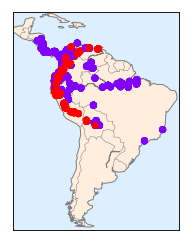

In [0]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids
xgrid, ygrid = construct_grids(data)

# plot coastlines with Basemap
m = Basemap(projection='cyl', resolution='c', llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(), llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3, c=species, cmap='rainbow', latlon=True);

Unfortunately, this doesn't give a very good idea of the density of the species, because points in the species range may overlap one another. You may not realize it by looking at this plot, but there are over $1600$ points shown here!
Let's use kernel density estimation to show this distribution in a more interpretable way: as a smooth indication of density on the map. Because the coordinate system here lies on a spherical surface rather than a flat plane, we will use the haversine distance metric, which will correctly represent distances on a curved surface.

**Note**:
The *haversine formula* determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

$$
d=2r\arcsin{\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2}\right)+\cos{\phi_1}\cdot \cos{\phi_2}\cdot \sin^2\left(\frac{\lambda_2-\lambda_1}{2} \right)}},
$$

where 
* $d$ is the distance between the two points along a great circle of the sphere;
* $\phi$ -- latitude of point;
* $\lambda$ -- longitude of point.

The term haversine  is due to haversine $\text{hav}$ function that was used instead of $\sin$ in the formula.

$$
\text{hav}(x)=\sin^2\left(\frac{x}{2}\right).
$$

So if we rewrite the formula above using haversine it will read

$$
\text{hav}(\Theta)=\text{hav}(\phi_2-\phi_1)+\cos{\phi_1} \cdot \cos{\phi_2} \cdot \text{hav}(\lambda_2-\lambda_1),
$$

with $\Theta=\frac{d}{r}$ is central angle between any two points on a sphere.

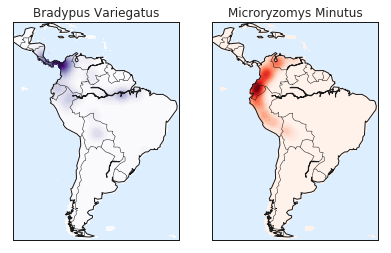

In [0]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
  axi.set_title(species_names[i])

  # plot coastlines with Basemap
  m = Basemap(projection='cyl', llcrnrlat=Y.min(), urcrnrlat=Y.max(), llcrnrlon=X.min(), urcrnrlon=X.max(), resolution='c', ax=axi)
  m.drawmapboundary(fill_color='#DDEEFF')
  m.drawcoastlines()
  m.drawcountries()
  
  # construct a spherical kernel density estimate of the distribution
  kde = KernelDensity(bandwidth=0.03, metric='haversine')
  kde.fit(np.radians(latlon[species == i]))

  # evaluate only on the land: -9999 indicates ocean
  Z = np.full(land_mask.shape[0], -9999.0)
  Z[land_mask] = np.exp(kde.score_samples(xy))
  Z = Z.reshape(X.shape)
  
  # plot contours of the density
  levels = np.linspace(0, Z.max(), 25)
  axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])  

Now we have a much clearer picture of the geographical distribution of observation of two species.



#Example: Fisher irises

Here is another example of nice visualization with the help of the `kdeplot` (convenient plot function with the built in kde algorithm in it) from `seaborn` package.

<br>

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/iris.png" width="650px" />

<br>


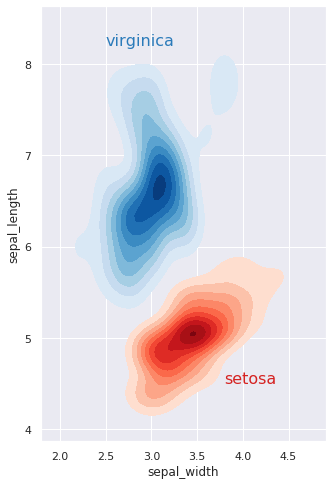

In [0]:
#@title Irisis classes visualization with KDE
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

setosa = iris.query("species == 'setosa'")
virginica = iris.query("species == 'virginica'")

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                 cmap="Blues", shade=True, shade_lowest=False)

red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "virginica", size=16, color=blue);
ax.text(3.8, 4.5, "setosa", size=16, color=red);

#Example: Not-So-Naive Bayes

For naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the “naive” element and perform the same classification with a more sophisticated generative model for each class.
It's still Bayesian classification, but it's no longer naive.

1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data.
This allows you for any observation x and label y to compute a likelihood $P(x|y)$.
3. From the number of examples of each class in the training set, compute the class prior, $P(y)$ .
4. For an unknown point x , the posterior probability for each class is $P(y|x)= P(x|y)P(y)$. The class that maximizes this posterior is the label assigned to the point.

Let's try this custom estimator on a problem we have seen before: the classification of handwritten digits. Here we will load the digits, and compute the cross-validation score for a range of candidate bandwidths using the `GridSearchCV` meta-estimator.

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

# BaseEstimator contains the logic necessary to clone/copy an estimator for use in a crossvalidation procedure
# ClassifierMixin defines a default score() method used by such routines
class KDEClassifier(BaseEstimator, ClassifierMixin):
  """Bayesian generative classification based on KDE
  Parameters
  ----------
  bandwidth : float
  the kernel bandwidth within each class
  kernel : str
  the kernel name, passed to KernelDensity
  """
  def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel
  
  # find the unique classes in the training data, 
  # train a KernelDensity model for each class, 
  # compute the class priors based on the number of input samples.
  def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
    return self # for chaining
  
  # predicting labels on new data
  def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X) for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
  
  def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]

We now use this class.

In [0]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, cv=3)
grid.fit(digits.data, digits.target)
scores = grid.cv_results_['mean_test_score']

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


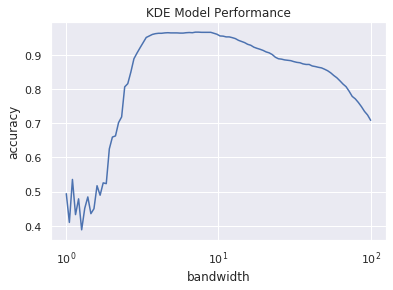

In [0]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over $96\%$; this is compared to around $80\%$ for the naive Bayesian classification:


In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target, cv=3).mean()

0.8186003803550138

One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a full model of the distribution of points we are comparing it to! If desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure.
If you would like to take this further, there are some improvements that could be made to our KDE classifier model:
* We could allow the bandwidth in each class to vary independently.
*  We could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e., use the scores from KernelDensity itself rather than the global prediction accuracy).

#Conclusion

KDE is a non-parametric estimation technique that could be used for pdf estimation, data smoothing and interpolation. Basically it's a method to get continuous distribution given a set of discrete data points.

<br>

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_15_kernel_density_estimation/globe.jpg" width="450px" />

<br>

